In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
#set the class of PINN

#定义了一个名为`PhysicsInformedNN'的类，用于实现基于物理的神经网络。
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, X_star, u_star, v_star, h_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        
        #`numpy.concatenate`是一个用于数组拼接的函数。它可以将多个数组沿指定的轴拼接在一起，形成一个新的数组：numpy.concatenate((a1,a2, ...), axis=0)其中，`a1,a2, ...`是需要拼接的数组（只能接受数组或序列类型的参数，且参数形状必须相同），可以是多个。`axis`参数用于指定拼接的轴向，`axis=0`表示沿着第一个轴（即行）进行拼接，不指定`axis`参数默认值是0。
        X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
        X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
        X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值
        
        #Python使用self关键字来表示类的实例。当在类的方法中定义一个变量时，例如lb和ub，这些变量只在该方法内部可见，也就是说它们的作用域仅限于该方法。当方法执行完毕后，这些变量就会被销毁，无法在其他方法中访问它们。但如果希望在类的其他方法中也能访问这些变量就需要将它们保存为类的实例属性。这就是self.lb和self.ub的作用。
            #通过将lb和ub赋值给self.lb和self.ub，就可以在类的其他方法中通过self.lb和self.ub来访问这些值。总的来说，self.lb和self.ub是类的实例属性，它们的作用域是整个类，而不仅仅是定义它们的方法。
        self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = torch.tensor(ub).float().to(device)


        self.x0 = torch.tensor(X0[:,0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
        self.t0 = torch.tensor(X0[:,1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
        self.t_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
        self.x_f = torch.tensor(X_f[:,0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
        self.t_f = torch.tensor(X_f[:,1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
        self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。
        self.v0 = torch.tensor(v0).float().to(device)


        self.x_star = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device) #将X_star的第一列赋值给self.x_star
        self.t_star = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device) #将X_star的第二列赋值给self.t_star
        self.u_star = torch.tensor(u_star).float().to(device) #将传入的u_star和v_star参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u_star和self.v_star来访问这些值。
        self.v_star = torch.tensor(v_star).float().to(device)
        self.h_star = torch.tensor(h_star).float().to(device)
        
        # Initialize NNs 
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这些值。
        
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上



        # optimizers: using the same settings，这里是使用pytorch库进行优化的部分
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重、偏置以及两个新加的变量）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )
        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
                

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
    
    #这个函数与下面的net_uv函数功能相同，只是不计算梯度，因为在记录每个epoch的error时，使用with torch.no_grad()情况下调用net_uv函数会报错，不知道为啥？
    def net_uv_error(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        #将uv（是一个二维张量）的第一列赋值给u，第二列赋值给v
        u=uv[:,0:1]
        v=uv[:,1:2]

        return u,v #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #pytorch中
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_uv(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        #将uv（是一个二维张量）的第一列赋值给u，第二列赋值给v
        u=uv[:,0:1]
        v=uv[:,1:2]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        return u,v,u_x,v_x #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f_uv(self, x, t):
        """ The pytorch autograd version of calculating residual """

        u,v,u_x,v_x=self.net_uv(x,t) #调用上面的函数/方法，计算神经网络的输出（两个）以及输出关于输入x的梯度（两个）
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f_u=u_t+0.5*v_xx+(u**2+v**2)*v    #计算f_u,定义见论文
        f_v=v_t-0.5*u_xx-(u**2+v**2)*u   #计算f_v,定义见论文
        return f_u, f_v  #返回计算得到的f_u和f_v


    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）

        u0_pred, v0_pred, _ , _ = self.net_uv(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub) #同上
        f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

        loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((self.v0 - v0_pred) ** 2) + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
                    torch.mean(f_u_pred ** 2) + \
                    torch.mean(f_v_pred ** 2)
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        
        self.iter += 1 #每调用一次损失函数，迭代次数加1


        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error\
        self.dnn.eval()
        with torch.no_grad():
            u_real_pred, v_real_pred= self.net_uv_error(self.x_star, self.t_star)
            h_real_pred = torch.sqrt(u_real_pred**2 + v_real_pred**2)

        error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)
        error_v_test = torch.norm(self.v_star - v_real_pred, 2) / torch.norm(self.v_star, 2)
        error_h_test = torch.norm(self.h_star - h_real_pred, 2) / torch.norm(self.h_star, 2)
        
        self.test_error.append(torch.tensor([error_u_test.item(), error_v_test.item(), error_h_test.item()]))

        # 计算 MAE
        mae = torch.mean(torch.abs(self.h_star - h_real_pred))
        # 计算 MSE
        mse = torch.mean((self.h_star - h_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)
        

        return loss #返回loss



    
    #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受一个参数nIter，表示训练的迭代次数。
    def train(self, nIter, nIterLBFGS):

        #先使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train()#将神经网络设置为训练模式而不是评估模式
            u0_pred, v0_pred, _ , _ = self.net_uv(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
            u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
            u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub) #同上
            f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

            loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((self.v0 - v0_pred) ** 2) + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
                    torch.mean(f_u_pred ** 2) + \
                    torch.mean(f_v_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            

            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
            

            #record the test error
            self.dnn.eval()
            with torch.no_grad():
                u_real_pred, v_real_pred = self.net_uv_error(self.x_star, self.t_star)
                h_real_pred = torch.sqrt(u_real_pred**2 + v_real_pred**2)

            error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)
            error_v_test = torch.norm(self.v_star - v_real_pred, 2) / torch.norm(self.v_star, 2)
            error_h_test = torch.norm(self.h_star - h_real_pred, 2) / torch.norm(self.h_star, 2)
            
            self.test_error.append(torch.tensor([error_u_test.item(), error_v_test.item(), error_h_test.item()]))

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.h_star - h_real_pred))
            mse = torch.mean((self.h_star - h_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)



        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   

                                    
    #定义了一个名为predict的函数/方法，用于预测神经网络的输出。这个方法接受一个参数X_star，表示输入数据。最后返回预测的两个输出和两个输出的梯度。
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u, v, _, _ = self.net_uv(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f_u, f_v = self.net_f_uv(x, t) 

        u = u.detach().cpu().numpy() #将张量u和v先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v 
    
    #定义函数获得隐藏层的输出
    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval() #将神经网络切换为评估模式
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1)) #调用上一个神经网络类中的hidden_output方法，得到最后一个隐藏层的输出
        hidden_output_x = hidden_output[:, 0] #将输出的第一列赋值给hidden_output_x
        hidden_output_t = hidden_output[:, 1] #将输出的第二列赋值给hidden_output_t
        hidden_output_x = hidden_output_x.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        hidden_output_t = hidden_output_t.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        return hidden_output_x, hidden_output_t #返回隐藏层的输出


In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    # #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 21, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [1]

#设置噪声值为0 
noise = 0.0        

# Doman bounds，定义两个一维数组lb和ub，问题域是一个二维空间，其中 x 的范围是 -5 到 5，t 的范围是 0 到 π/2(竖着的)
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
#定义三个整数，分别表示初始条件点数量、边界条件点数量和配位点的数量（这些点用于训练神经网络）
N0 = 50
N_b = 50
N_f = 5000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 100, 100, 100, 100, 2, 2]
#读取名为NLS.mat的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改    
data = scipy.io.loadmat('../data/NLS.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu'] #从data字典中取出变量uu的值，并赋值给Exact
Exact_u = np.real(Exact)  #取Exact的实部，赋值给Exact_u
Exact_v = np.imag(Exact)  #取Exact的虚部，赋值给Exact_v
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2) #计算复数uu的|uu|
#生成一个二位网络，X和T是输出的二维数组
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact_u.T.flatten()[:,None] #先对Exact_u进行转置，然后使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组
v_star = Exact_v.T.flatten()[:,None] #同上，比如Exact_v是m*n二维数组，Exact_v.T是n*m二维数组，Exact_v.T.flatten()是一个长度为n*m的一维数组，Exact_v.T.flatten()[:,None]是一个(n*m)*1的三维数组
h_star = Exact_h.T.flatten()[:,None]
#上面五行代码的意义见Numpy库的索引的介绍


###########################

#从0~数组x的行数(256)中随机选择N0个数，replace=False表示不允许重复选择，最后将这N0个数赋值给idx_x
#从所有的初值边界值训练基础数据中选取N_u=100个点
idx_x = np.linspace(0, x.shape[0] - 1, N0, dtype=int) #生成一个等差数列，从0到X的行数，间隔为1，赋值给idx_x
# idx_x = np.random.choice(x.shape[0], N0, replace=False)
#从x中选择N0个对应的行(idx_x对应的行)，最后将这N0行赋值给x0
x0 = x[idx_x,:]
#从Exact_u中选择N0个对应的行(idx_x对应的行)的第一列元素，最后将这N0个元素赋值给u0
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
#从0~数组t的行数中随机选择N_b个数，replace=False表示不允许重复选择，最后将这N_b个数赋值给idx_t
idx_t = np.linspace(0, t.shape[0] - 1, N_b, dtype=int) #生成一个等差数列，从0到t的行数，间隔为1，赋值给idx_t
# idx_t = np.random.choice(t.shape[0], N_b, replace=False)
#从t中选择N_b个对应的行(idx_t对应的行)，最后将这N_b行赋值给tb
tb = t[idx_t,:]



error = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子

    nIter = 50000 #设置迭代次数为10000
    nIterLBFGS = 1000 #设置LBFGS迭代次数为500


    X_f = lb + (ub-lb)*lhs(2, N_f) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。


    #开始训练


    #创建PINN模型并输入各种参数        
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, X_star, u_star, v_star, h_star)
    #获取当前时间并赋值给start_time          
    start_time = time.time()       
    #训练模型50000次         
    model.train(nIter, nIterLBFGS)
    #获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time                
    #打印训练所需时间
    print('Training time: %.4f' % (elapsed))



    #每一个seed训练好之后，用训练好的模型进行预测，得到测试误差

    #用训练好的模型进行预测，返回四个值（均为数组）    
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    #计算u_pred和v_pred的模（平方和的平方根），赋值给h_pred
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    #计算误差（基于2范数）        
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
    #打印误差
    # print('Error u: %e' % (error_u))
    # print('Error v: %e' % (error_v))
    print('Error h: %e' % (error_h))

    #将误差添加到error_h列表中

    #计算误差（基于2范数）        
    error.append(error_h) #计算误差，然后将误差添加到error_u列表中
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(h_star - h_pred))
    mse = np.mean((h_star - h_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print(f'当前为第{i}次循环，种子为{seed}')





#使用griddata函数将X_star、u_pred、v_pred和h_pred插值到网格上，得到U_pred、V_pred和H_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
#同上，使用griddata函数将X_star、f_u_pred和f_v_pred插值到网格上，得到FU_pred和FV_pred
FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     

H_star = griddata(X_star, h_star.flatten(), (X, T), method='cubic') #同上，将X_star和h_star插值到网格上，得到H_star

Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<1:32:03,  9.05it/s]

Adam:   0%|          | 16/50000 [00:00<09:30, 87.64it/s] 

Adam:   0%|          | 32/50000 [00:00<07:01, 118.67it/s]

Adam:   0%|          | 48/50000 [00:00<06:13, 133.75it/s]

Adam:   0%|          | 64/50000 [00:00<05:52, 141.59it/s]

Adam:   0%|          | 79/50000 [00:00<06:23, 130.28it/s]

Adam:   0%|          | 93/50000 [00:00<06:18, 131.87it/s]

Adam:   0%|          | 109/50000 [00:00<06:01, 138.07it/s]

Adam:   0%|          | 124/50000 [00:00<05:53, 141.24it/s]

Adam:   0%|          | 140/50000 [00:01<05:42, 145.78it/s]

Adam:   0%|          | 156/50000 [00:01<05:38, 147.04it/s]

Adam:   0%|          | 171/50000 [00:01<05:38, 147.09it/s]

Adam:   0%|          | 186/50000 [00:01<05:40, 146.13it/s]

Adam:   0%|          | 201/50000 [00:01<05:42, 145.29it/s]

Adam:   0%|          | 217/50000 [00:01<05:35, 148.57it/s]

Adam:   0%|          | 232/50000 [00:01<05:34, 148.82it/s]

Adam:   0%|          | 247/50000 [00:01<05:35, 148.36it/s]

Adam:   1%|          | 262/50000 [00:01<05:36, 147.65it/s]

Adam:   1%|          | 278/50000 [00:01<05:33, 149.18it/s]

Adam:   1%|          | 293/50000 [00:02<05:34, 148.64it/s]

Adam:   1%|          | 309/50000 [00:02<05:28, 151.05it/s]

Adam:   1%|          | 325/50000 [00:02<05:29, 150.73it/s]

Adam:   1%|          | 341/50000 [00:02<05:27, 151.54it/s]

Adam:   1%|          | 357/50000 [00:02<05:25, 152.30it/s]

Adam:   1%|          | 373/50000 [00:02<05:24, 153.12it/s]

Adam:   1%|          | 389/50000 [00:02<05:27, 151.29it/s]

Adam:   1%|          | 405/50000 [00:02<05:26, 151.81it/s]

Adam:   1%|          | 421/50000 [00:02<05:27, 151.31it/s]

Adam:   1%|          | 437/50000 [00:03<05:30, 149.89it/s]

Adam:   1%|          | 453/50000 [00:03<05:28, 150.69it/s]

Adam:   1%|          | 469/50000 [00:03<05:44, 143.66it/s]

Adam:   1%|          | 484/50000 [00:03<05:42, 144.53it/s]

Adam:   1%|          | 500/50000 [00:03<05:34, 148.13it/s]

Adam:   1%|          | 515/50000 [00:03<05:33, 148.34it/s]

Adam:   1%|          | 530/50000 [00:03<05:36, 147.18it/s]

Adam:   1%|          | 546/50000 [00:03<05:29, 149.91it/s]

Adam:   1%|          | 562/50000 [00:03<05:25, 151.92it/s]

Adam:   1%|          | 578/50000 [00:03<05:26, 151.54it/s]

Adam:   1%|          | 594/50000 [00:04<05:29, 150.16it/s]

Adam:   1%|          | 610/50000 [00:04<05:34, 147.75it/s]

Adam:   1%|▏         | 626/50000 [00:04<05:28, 150.47it/s]

Adam:   1%|▏         | 642/50000 [00:04<05:23, 152.36it/s]

Adam:   1%|▏         | 658/50000 [00:04<05:23, 152.52it/s]

Adam:   1%|▏         | 674/50000 [00:04<05:20, 153.82it/s]

Adam:   1%|▏         | 690/50000 [00:04<05:18, 154.83it/s]

Adam:   1%|▏         | 706/50000 [00:04<05:19, 154.46it/s]

Adam:   1%|▏         | 722/50000 [00:04<05:23, 152.55it/s]

Adam:   1%|▏         | 738/50000 [00:05<05:22, 152.96it/s]

Adam:   2%|▏         | 754/50000 [00:05<05:20, 153.54it/s]

Adam:   2%|▏         | 770/50000 [00:05<05:18, 154.46it/s]

Adam:   2%|▏         | 786/50000 [00:05<05:20, 153.61it/s]

Adam:   2%|▏         | 802/50000 [00:05<05:20, 153.59it/s]

Adam:   2%|▏         | 818/50000 [00:05<05:18, 154.39it/s]

Adam:   2%|▏         | 834/50000 [00:05<05:18, 154.47it/s]

Adam:   2%|▏         | 850/50000 [00:05<05:21, 152.92it/s]

Adam:   2%|▏         | 866/50000 [00:05<05:20, 153.47it/s]

Adam:   2%|▏         | 882/50000 [00:05<05:17, 154.53it/s]

Adam:   2%|▏         | 898/50000 [00:06<05:15, 155.41it/s]

Adam:   2%|▏         | 914/50000 [00:06<05:14, 155.95it/s]

Adam:   2%|▏         | 930/50000 [00:06<05:29, 148.95it/s]

Adam:   2%|▏         | 946/50000 [00:06<05:24, 151.34it/s]

Adam:   2%|▏         | 962/50000 [00:06<05:21, 152.53it/s]

Adam:   2%|▏         | 978/50000 [00:06<05:22, 152.18it/s]

Adam:   2%|▏         | 994/50000 [00:06<05:19, 153.51it/s]

Adam:   2%|▏         | 1010/50000 [00:06<05:17, 154.08it/s]

Adam:   2%|▏         | 1026/50000 [00:06<05:19, 153.34it/s]

Adam:   2%|▏         | 1042/50000 [00:07<05:22, 151.95it/s]

Adam:   2%|▏         | 1058/50000 [00:07<05:19, 153.09it/s]

Adam:   2%|▏         | 1074/50000 [00:07<05:21, 152.31it/s]

Adam:   2%|▏         | 1090/50000 [00:07<05:18, 153.59it/s]

Adam:   2%|▏         | 1106/50000 [00:07<05:18, 153.45it/s]

Adam:   2%|▏         | 1122/50000 [00:07<05:16, 154.43it/s]

Adam:   2%|▏         | 1138/50000 [00:07<05:15, 154.65it/s]

Adam:   2%|▏         | 1154/50000 [00:07<05:16, 154.42it/s]

Adam:   2%|▏         | 1170/50000 [00:07<05:15, 154.80it/s]

Adam:   2%|▏         | 1186/50000 [00:07<05:16, 154.34it/s]

Adam:   2%|▏         | 1202/50000 [00:08<05:15, 154.45it/s]

Adam:   2%|▏         | 1218/50000 [00:08<05:14, 155.28it/s]

Adam:   2%|▏         | 1234/50000 [00:08<05:14, 155.15it/s]

Adam:   2%|▎         | 1250/50000 [00:08<05:14, 154.94it/s]

Adam:   3%|▎         | 1266/50000 [00:08<05:18, 153.01it/s]

Adam:   3%|▎         | 1282/50000 [00:08<05:19, 152.56it/s]

Adam:   3%|▎         | 1298/50000 [00:08<05:18, 153.00it/s]

Adam:   3%|▎         | 1314/50000 [00:08<05:19, 152.35it/s]

Adam:   3%|▎         | 1330/50000 [00:08<05:18, 152.83it/s]

Adam:   3%|▎         | 1346/50000 [00:08<05:16, 153.48it/s]

Adam:   3%|▎         | 1362/50000 [00:09<05:17, 153.40it/s]

Adam:   3%|▎         | 1378/50000 [00:09<05:18, 152.88it/s]

Adam:   3%|▎         | 1394/50000 [00:09<05:16, 153.66it/s]

Adam:   3%|▎         | 1410/50000 [00:09<05:15, 154.19it/s]

Adam:   3%|▎         | 1426/50000 [00:09<05:16, 153.67it/s]

Adam:   3%|▎         | 1442/50000 [00:09<05:17, 153.13it/s]

Adam:   3%|▎         | 1458/50000 [00:09<05:17, 152.76it/s]

Adam:   3%|▎         | 1474/50000 [00:09<05:16, 153.38it/s]

Adam:   3%|▎         | 1490/50000 [00:09<05:15, 153.82it/s]

Adam:   3%|▎         | 1506/50000 [00:10<05:14, 154.21it/s]

Adam:   3%|▎         | 1522/50000 [00:10<05:13, 154.41it/s]

Adam:   3%|▎         | 1538/50000 [00:10<05:13, 154.45it/s]

Adam:   3%|▎         | 1554/50000 [00:10<05:12, 155.27it/s]

Adam:   3%|▎         | 1570/50000 [00:10<05:11, 155.65it/s]

Adam:   3%|▎         | 1586/50000 [00:10<05:14, 153.99it/s]

Adam:   3%|▎         | 1602/50000 [00:10<05:14, 153.69it/s]

Adam:   3%|▎         | 1618/50000 [00:10<05:14, 153.68it/s]

Adam:   3%|▎         | 1634/50000 [00:10<05:18, 152.08it/s]

Adam:   3%|▎         | 1650/50000 [00:10<05:23, 149.37it/s]

Adam:   3%|▎         | 1666/50000 [00:11<05:21, 150.25it/s]

Adam:   3%|▎         | 1682/50000 [00:11<05:18, 151.93it/s]

Adam:   3%|▎         | 1698/50000 [00:11<05:15, 153.02it/s]

Adam:   3%|▎         | 1714/50000 [00:11<05:14, 153.55it/s]

Adam:   3%|▎         | 1730/50000 [00:11<05:21, 150.31it/s]

Adam:   3%|▎         | 1746/50000 [00:11<05:23, 149.22it/s]

Adam:   4%|▎         | 1762/50000 [00:11<05:21, 150.10it/s]

Adam:   4%|▎         | 1778/50000 [00:11<05:21, 149.99it/s]

Adam:   4%|▎         | 1794/50000 [00:11<05:27, 147.40it/s]

Adam:   4%|▎         | 1809/50000 [00:12<05:49, 137.86it/s]

Adam:   4%|▎         | 1824/50000 [00:12<05:42, 140.54it/s]

Adam:   4%|▎         | 1840/50000 [00:12<05:34, 143.91it/s]

Adam:   4%|▎         | 1855/50000 [00:12<05:31, 145.27it/s]

Adam:   4%|▎         | 1870/50000 [00:12<05:29, 146.19it/s]

Adam:   4%|▍         | 1885/50000 [00:12<05:28, 146.44it/s]

Adam:   4%|▍         | 1900/50000 [00:12<05:29, 146.18it/s]

Adam:   4%|▍         | 1915/50000 [00:12<05:46, 138.78it/s]

Adam:   4%|▍         | 1930/50000 [00:12<05:39, 141.48it/s]

Adam:   4%|▍         | 1945/50000 [00:13<05:36, 142.85it/s]

Adam:   4%|▍         | 1960/50000 [00:13<05:31, 144.79it/s]

Adam:   4%|▍         | 1975/50000 [00:13<05:42, 140.30it/s]

Adam:   4%|▍         | 1990/50000 [00:13<05:41, 140.69it/s]

Adam:   4%|▍         | 2006/50000 [00:13<05:33, 143.79it/s]

Adam:   4%|▍         | 2022/50000 [00:13<05:28, 146.13it/s]

Adam:   4%|▍         | 2038/50000 [00:13<05:25, 147.42it/s]

Adam:   4%|▍         | 2054/50000 [00:13<05:21, 148.93it/s]

Adam:   4%|▍         | 2069/50000 [00:13<05:29, 145.39it/s]

Adam:   4%|▍         | 2084/50000 [00:13<05:33, 143.62it/s]

Adam:   4%|▍         | 2100/50000 [00:14<05:27, 146.47it/s]

Adam:   4%|▍         | 2116/50000 [00:14<05:22, 148.26it/s]

Adam:   4%|▍         | 2131/50000 [00:14<05:24, 147.60it/s]

Adam:   4%|▍         | 2146/50000 [00:14<05:26, 146.60it/s]

Adam:   4%|▍         | 2162/50000 [00:14<05:22, 148.12it/s]

Adam:   4%|▍         | 2177/50000 [00:14<05:29, 145.31it/s]

Adam:   4%|▍         | 2193/50000 [00:14<05:24, 147.53it/s]

Adam:   4%|▍         | 2208/50000 [00:14<05:25, 147.04it/s]

Adam:   4%|▍         | 2224/50000 [00:14<05:21, 148.80it/s]

Adam:   4%|▍         | 2239/50000 [00:15<05:21, 148.64it/s]

Adam:   5%|▍         | 2254/50000 [00:15<05:21, 148.59it/s]

Adam:   5%|▍         | 2270/50000 [00:15<05:18, 149.82it/s]

Adam:   5%|▍         | 2285/50000 [00:15<05:25, 146.56it/s]

Adam:   5%|▍         | 2300/50000 [00:15<05:24, 147.14it/s]

Adam:   5%|▍         | 2316/50000 [00:15<05:20, 148.67it/s]

Adam:   5%|▍         | 2332/50000 [00:15<05:18, 149.85it/s]

Adam:   5%|▍         | 2347/50000 [00:15<05:28, 145.12it/s]

Adam:   5%|▍         | 2362/50000 [00:15<05:26, 145.82it/s]

Adam:   5%|▍         | 2378/50000 [00:15<05:22, 147.44it/s]

Adam:   5%|▍         | 2394/50000 [00:16<05:26, 145.66it/s]

Adam:   5%|▍         | 2410/50000 [00:16<05:22, 147.67it/s]

Adam:   5%|▍         | 2425/50000 [00:16<05:23, 147.28it/s]

Adam:   5%|▍         | 2441/50000 [00:16<05:20, 148.59it/s]

Adam:   5%|▍         | 2456/50000 [00:16<05:22, 147.27it/s]

Adam:   5%|▍         | 2471/50000 [00:16<05:23, 146.72it/s]

Adam:   5%|▍         | 2487/50000 [00:16<05:20, 148.33it/s]

Adam:   5%|▌         | 2503/50000 [00:16<05:17, 149.69it/s]

Adam:   5%|▌         | 2519/50000 [00:16<05:15, 150.50it/s]

Adam:   5%|▌         | 2535/50000 [00:17<05:14, 150.90it/s]

Adam:   5%|▌         | 2551/50000 [00:17<05:14, 150.65it/s]

Adam:   5%|▌         | 2567/50000 [00:17<05:13, 151.31it/s]

Adam:   5%|▌         | 2583/50000 [00:17<05:12, 151.75it/s]

Adam:   5%|▌         | 2599/50000 [00:17<05:17, 149.30it/s]

Adam:   5%|▌         | 2615/50000 [00:17<05:15, 150.31it/s]

Adam:   5%|▌         | 2631/50000 [00:17<05:18, 148.89it/s]

Adam:   5%|▌         | 2647/50000 [00:17<05:16, 149.76it/s]

Adam:   5%|▌         | 2662/50000 [00:17<05:20, 147.81it/s]

Adam:   5%|▌         | 2678/50000 [00:17<05:17, 149.17it/s]

Adam:   5%|▌         | 2694/50000 [00:18<05:15, 150.00it/s]

Adam:   5%|▌         | 2710/50000 [00:18<05:23, 146.03it/s]

Adam:   5%|▌         | 2726/50000 [00:18<05:19, 148.16it/s]

Adam:   5%|▌         | 2742/50000 [00:18<05:15, 149.56it/s]

Adam:   6%|▌         | 2758/50000 [00:18<05:13, 150.52it/s]

Adam:   6%|▌         | 2774/50000 [00:18<05:12, 151.29it/s]

Adam:   6%|▌         | 2790/50000 [00:18<05:10, 151.91it/s]

Adam:   6%|▌         | 2806/50000 [00:18<05:10, 152.19it/s]

Adam:   6%|▌         | 2822/50000 [00:18<05:10, 151.98it/s]

Adam:   6%|▌         | 2838/50000 [00:19<05:10, 151.96it/s]

Adam:   6%|▌         | 2854/50000 [00:19<05:09, 152.43it/s]

Adam:   6%|▌         | 2870/50000 [00:19<05:08, 152.65it/s]

Adam:   6%|▌         | 2886/50000 [00:19<05:10, 151.71it/s]

Adam:   6%|▌         | 2902/50000 [00:19<05:14, 149.56it/s]

Adam:   6%|▌         | 2918/50000 [00:19<05:13, 150.24it/s]

Adam:   6%|▌         | 2934/50000 [00:19<05:12, 150.38it/s]

Adam:   6%|▌         | 2950/50000 [00:19<05:11, 150.92it/s]

Adam:   6%|▌         | 2966/50000 [00:19<05:10, 151.46it/s]

Adam:   6%|▌         | 2982/50000 [00:19<05:11, 151.09it/s]

Adam:   6%|▌         | 2998/50000 [00:20<05:09, 151.84it/s]

Adam:   6%|▌         | 3014/50000 [00:20<05:08, 152.28it/s]

Adam:   6%|▌         | 3030/50000 [00:20<05:08, 152.17it/s]

Adam:   6%|▌         | 3046/50000 [00:20<05:11, 150.75it/s]

Adam:   6%|▌         | 3062/50000 [00:20<05:10, 151.12it/s]

Adam:   6%|▌         | 3078/50000 [00:20<05:09, 151.58it/s]

Adam:   6%|▌         | 3094/50000 [00:20<05:10, 150.96it/s]

Adam:   6%|▌         | 3110/50000 [00:20<05:09, 151.29it/s]

Adam:   6%|▋         | 3126/50000 [00:20<05:08, 151.72it/s]

Adam:   6%|▋         | 3142/50000 [00:21<05:07, 152.22it/s]

Adam:   6%|▋         | 3158/50000 [00:21<05:07, 152.55it/s]

Adam:   6%|▋         | 3174/50000 [00:21<05:06, 152.53it/s]

Adam:   6%|▋         | 3190/50000 [00:21<05:06, 152.72it/s]

Adam:   6%|▋         | 3206/50000 [00:21<05:07, 152.05it/s]

Adam:   6%|▋         | 3222/50000 [00:21<05:08, 151.58it/s]

Adam:   6%|▋         | 3238/50000 [00:21<05:09, 151.20it/s]

Adam:   7%|▋         | 3254/50000 [00:21<05:13, 149.16it/s]

Adam:   7%|▋         | 3269/50000 [00:21<05:20, 145.73it/s]

Adam:   7%|▋         | 3285/50000 [00:21<05:16, 147.61it/s]

Adam:   7%|▋         | 3301/50000 [00:22<05:13, 149.19it/s]

Adam:   7%|▋         | 3317/50000 [00:22<05:13, 148.99it/s]

Adam:   7%|▋         | 3333/50000 [00:22<05:11, 150.05it/s]

Adam:   7%|▋         | 3349/50000 [00:22<05:13, 148.92it/s]

Adam:   7%|▋         | 3364/50000 [00:22<05:26, 142.68it/s]

Adam:   7%|▋         | 3380/50000 [00:22<05:20, 145.42it/s]

Adam:   7%|▋         | 3396/50000 [00:22<05:15, 147.75it/s]

Adam:   7%|▋         | 3412/50000 [00:22<05:12, 148.94it/s]

Adam:   7%|▋         | 3427/50000 [00:22<05:14, 148.08it/s]

Adam:   7%|▋         | 3443/50000 [00:23<05:11, 149.63it/s]

Adam:   7%|▋         | 3459/50000 [00:23<05:08, 150.71it/s]

Adam:   7%|▋         | 3475/50000 [00:23<05:12, 148.99it/s]

Adam:   7%|▋         | 3491/50000 [00:23<05:09, 150.20it/s]

Adam:   7%|▋         | 3507/50000 [00:23<05:58, 129.70it/s]

Adam:   7%|▋         | 3523/50000 [00:23<05:42, 135.54it/s]

Adam:   7%|▋         | 3538/50000 [00:23<05:36, 138.14it/s]

Adam:   7%|▋         | 3553/50000 [00:23<05:32, 139.57it/s]

Adam:   7%|▋         | 3569/50000 [00:23<05:24, 143.29it/s]

Adam:   7%|▋         | 3585/50000 [00:24<05:18, 145.73it/s]

Adam:   7%|▋         | 3601/50000 [00:24<05:13, 147.86it/s]

Adam:   7%|▋         | 3617/50000 [00:24<05:11, 149.09it/s]

Adam:   7%|▋         | 3632/50000 [00:24<05:17, 146.15it/s]

Adam:   7%|▋         | 3648/50000 [00:24<05:12, 148.17it/s]

Adam:   7%|▋         | 3664/50000 [00:24<05:10, 149.34it/s]

Adam:   7%|▋         | 3679/50000 [00:24<05:19, 145.02it/s]

Adam:   7%|▋         | 3695/50000 [00:24<05:14, 147.41it/s]

Adam:   7%|▋         | 3710/50000 [00:24<05:12, 148.02it/s]

Adam:   7%|▋         | 3725/50000 [00:25<05:12, 148.15it/s]

Adam:   7%|▋         | 3740/50000 [00:25<05:18, 145.41it/s]

Adam:   8%|▊         | 3756/50000 [00:25<05:15, 146.78it/s]

Adam:   8%|▊         | 3772/50000 [00:25<05:11, 148.41it/s]

Adam:   8%|▊         | 3788/50000 [00:25<05:09, 149.36it/s]

Adam:   8%|▊         | 3803/50000 [00:25<05:14, 146.80it/s]

Adam:   8%|▊         | 3819/50000 [00:25<05:11, 148.17it/s]

Adam:   8%|▊         | 3834/50000 [00:25<05:19, 144.35it/s]

Adam:   8%|▊         | 3849/50000 [00:25<05:16, 145.59it/s]

Adam:   8%|▊         | 3865/50000 [00:25<05:13, 147.23it/s]

Adam:   8%|▊         | 3880/50000 [00:26<05:11, 147.95it/s]

Adam:   8%|▊         | 3895/50000 [00:26<05:18, 144.73it/s]

Adam:   8%|▊         | 3911/50000 [00:26<05:14, 146.65it/s]

Adam:   8%|▊         | 3926/50000 [00:26<05:15, 146.15it/s]

Adam:   8%|▊         | 3941/50000 [00:26<05:49, 131.93it/s]

Adam:   8%|▊         | 3957/50000 [00:26<05:34, 137.53it/s]

Adam:   8%|▊         | 3972/50000 [00:26<05:29, 139.76it/s]

Adam:   8%|▊         | 3987/50000 [00:26<05:23, 142.19it/s]

Adam:   8%|▊         | 4002/50000 [00:26<05:21, 143.08it/s]

Adam:   8%|▊         | 4018/50000 [00:27<05:16, 145.31it/s]

Adam:   8%|▊         | 4033/50000 [00:27<05:23, 142.18it/s]

Adam:   8%|▊         | 4048/50000 [00:27<05:51, 130.82it/s]

Adam:   8%|▊         | 4062/50000 [00:27<06:02, 126.59it/s]

Adam:   8%|▊         | 4075/50000 [00:27<06:32, 116.88it/s]

Adam:   8%|▊         | 4087/50000 [00:27<06:46, 112.95it/s]

Adam:   8%|▊         | 4099/50000 [00:27<07:00, 109.04it/s]

Adam:   8%|▊         | 4110/50000 [00:27<07:04, 108.23it/s]

Adam:   8%|▊         | 4121/50000 [00:27<07:08, 107.16it/s]

Adam:   8%|▊         | 4132/50000 [00:28<07:17, 104.73it/s]

Adam:   8%|▊         | 4143/50000 [00:28<07:18, 104.67it/s]

Adam:   8%|▊         | 4154/50000 [00:28<07:12, 105.92it/s]

Adam:   8%|▊         | 4165/50000 [00:28<07:13, 105.64it/s]

Adam:   8%|▊         | 4176/50000 [00:28<07:17, 104.76it/s]

Adam:   8%|▊         | 4187/50000 [00:28<07:29, 101.99it/s]

Adam:   8%|▊         | 4198/50000 [00:28<07:45, 98.42it/s] 

Adam:   8%|▊         | 4208/50000 [00:28<07:44, 98.55it/s]

Adam:   8%|▊         | 4219/50000 [00:28<07:42, 99.07it/s]

Adam:   8%|▊         | 4230/50000 [00:29<07:33, 100.83it/s]

Adam:   8%|▊         | 4241/50000 [00:29<07:28, 101.96it/s]

Adam:   9%|▊         | 4252/50000 [00:29<07:22, 103.37it/s]

Adam:   9%|▊         | 4263/50000 [00:29<07:20, 103.93it/s]

Adam:   9%|▊         | 4274/50000 [00:29<07:13, 105.58it/s]

Adam:   9%|▊         | 4285/50000 [00:29<07:12, 105.72it/s]

Adam:   9%|▊         | 4296/50000 [00:29<07:11, 105.94it/s]

Adam:   9%|▊         | 4307/50000 [00:29<07:11, 105.94it/s]

Adam:   9%|▊         | 4318/50000 [00:29<07:11, 105.96it/s]

Adam:   9%|▊         | 4330/50000 [00:30<07:05, 107.38it/s]

Adam:   9%|▊         | 4341/50000 [00:30<07:09, 106.24it/s]

Adam:   9%|▊         | 4352/50000 [00:30<07:22, 103.12it/s]

Adam:   9%|▊         | 4363/50000 [00:30<07:27, 101.98it/s]

Adam:   9%|▊         | 4374/50000 [00:30<07:28, 101.82it/s]

Adam:   9%|▉         | 4385/50000 [00:30<07:32, 100.74it/s]

Adam:   9%|▉         | 4396/50000 [00:30<07:28, 101.72it/s]

Adam:   9%|▉         | 4407/50000 [00:30<07:25, 102.33it/s]

Adam:   9%|▉         | 4419/50000 [00:30<07:15, 104.59it/s]

Adam:   9%|▉         | 4430/50000 [00:30<07:16, 104.41it/s]

Adam:   9%|▉         | 4441/50000 [00:31<07:15, 104.73it/s]

Adam:   9%|▉         | 4452/50000 [00:31<07:16, 104.44it/s]

Adam:   9%|▉         | 4463/50000 [00:31<07:19, 103.50it/s]

Adam:   9%|▉         | 4474/50000 [00:31<07:50, 96.76it/s] 

Adam:   9%|▉         | 4484/50000 [00:31<07:57, 95.31it/s]

Adam:   9%|▉         | 4495/50000 [00:31<07:42, 98.38it/s]

Adam:   9%|▉         | 4506/50000 [00:31<07:28, 101.50it/s]

Adam:   9%|▉         | 4517/50000 [00:31<07:28, 101.41it/s]

Adam:   9%|▉         | 4528/50000 [00:31<07:25, 102.11it/s]

Adam:   9%|▉         | 4539/50000 [00:32<07:22, 102.73it/s]

Adam:   9%|▉         | 4550/50000 [00:32<07:38, 99.16it/s] 

Adam:   9%|▉         | 4561/50000 [00:32<07:30, 100.87it/s]

Adam:   9%|▉         | 4572/50000 [00:32<07:43, 98.11it/s] 

Adam:   9%|▉         | 4583/50000 [00:32<07:34, 99.93it/s]

Adam:   9%|▉         | 4594/50000 [00:32<07:27, 101.44it/s]

Adam:   9%|▉         | 4605/50000 [00:32<07:29, 100.99it/s]

Adam:   9%|▉         | 4616/50000 [00:32<07:24, 102.12it/s]

Adam:   9%|▉         | 4627/50000 [00:32<07:15, 104.12it/s]

Adam:   9%|▉         | 4638/50000 [00:33<07:18, 103.54it/s]

Adam:   9%|▉         | 4649/50000 [00:33<07:18, 103.31it/s]

Adam:   9%|▉         | 4660/50000 [00:33<07:13, 104.49it/s]

Adam:   9%|▉         | 4671/50000 [00:33<07:17, 103.71it/s]

Adam:   9%|▉         | 4682/50000 [00:33<07:23, 102.23it/s]

Adam:   9%|▉         | 4693/50000 [00:33<07:17, 103.59it/s]

Adam:   9%|▉         | 4705/50000 [00:33<07:07, 105.88it/s]

Adam:   9%|▉         | 4716/50000 [00:33<07:09, 105.37it/s]

Adam:   9%|▉         | 4728/50000 [00:33<07:02, 107.11it/s]

Adam:   9%|▉         | 4739/50000 [00:34<07:22, 102.27it/s]

Adam:  10%|▉         | 4750/50000 [00:34<07:15, 103.81it/s]

Adam:  10%|▉         | 4761/50000 [00:34<07:11, 104.86it/s]

Adam:  10%|▉         | 4772/50000 [00:34<07:11, 104.83it/s]

Adam:  10%|▉         | 4783/50000 [00:34<07:13, 104.35it/s]

Adam:  10%|▉         | 4794/50000 [00:34<07:30, 100.28it/s]

Adam:  10%|▉         | 4805/50000 [00:34<07:26, 101.20it/s]

Adam:  10%|▉         | 4816/50000 [00:34<07:19, 102.77it/s]

Adam:  10%|▉         | 4828/50000 [00:34<07:09, 105.20it/s]

Adam:  10%|▉         | 4839/50000 [00:34<07:07, 105.73it/s]

Adam:  10%|▉         | 4850/50000 [00:35<07:07, 105.70it/s]

Adam:  10%|▉         | 4861/50000 [00:35<07:05, 105.97it/s]

Adam:  10%|▉         | 4872/50000 [00:35<07:06, 105.75it/s]

Adam:  10%|▉         | 4883/50000 [00:35<07:07, 105.66it/s]

Adam:  10%|▉         | 4894/50000 [00:35<07:10, 104.70it/s]

Adam:  10%|▉         | 4905/50000 [00:35<07:14, 103.82it/s]

Adam:  10%|▉         | 4916/50000 [00:35<07:11, 104.39it/s]

Adam:  10%|▉         | 4927/50000 [00:35<07:17, 103.08it/s]

Adam:  10%|▉         | 4938/50000 [00:35<07:17, 103.03it/s]

Adam:  10%|▉         | 4949/50000 [00:36<07:19, 102.59it/s]

Adam:  10%|▉         | 4960/50000 [00:36<07:26, 100.83it/s]

Adam:  10%|▉         | 4971/50000 [00:36<07:36, 98.67it/s] 

Adam:  10%|▉         | 4982/50000 [00:36<07:40, 97.69it/s]

Adam:  10%|▉         | 4993/50000 [00:36<07:35, 98.85it/s]

Adam:  10%|█         | 5004/50000 [00:36<07:27, 100.45it/s]

Adam:  10%|█         | 5015/50000 [00:36<07:26, 100.70it/s]

Adam:  10%|█         | 5026/50000 [00:36<07:20, 102.13it/s]

Adam:  10%|█         | 5037/50000 [00:36<07:19, 102.28it/s]

Adam:  10%|█         | 5048/50000 [00:37<07:16, 103.08it/s]

Adam:  10%|█         | 5059/50000 [00:37<07:12, 103.96it/s]

Adam:  10%|█         | 5070/50000 [00:37<07:24, 101.06it/s]

Adam:  10%|█         | 5081/50000 [00:37<07:27, 100.46it/s]

Adam:  10%|█         | 5092/50000 [00:37<07:21, 101.75it/s]

Adam:  10%|█         | 5103/50000 [00:37<07:18, 102.30it/s]

Adam:  10%|█         | 5114/50000 [00:37<07:12, 103.88it/s]

Adam:  10%|█         | 5125/50000 [00:37<07:11, 103.98it/s]

Adam:  10%|█         | 5136/50000 [00:37<07:10, 104.16it/s]

Adam:  10%|█         | 5147/50000 [00:37<07:11, 103.94it/s]

Adam:  10%|█         | 5158/50000 [00:38<07:22, 101.35it/s]

Adam:  10%|█         | 5169/50000 [00:38<07:19, 101.93it/s]

Adam:  10%|█         | 5180/50000 [00:38<07:28, 99.84it/s] 

Adam:  10%|█         | 5191/50000 [00:38<07:49, 95.49it/s]

Adam:  10%|█         | 5201/50000 [00:38<07:47, 95.73it/s]

Adam:  10%|█         | 5211/50000 [00:38<07:43, 96.65it/s]

Adam:  10%|█         | 5221/50000 [00:38<07:44, 96.46it/s]

Adam:  10%|█         | 5232/50000 [00:38<07:31, 99.13it/s]

Adam:  10%|█         | 5242/50000 [00:38<07:32, 99.02it/s]

Adam:  11%|█         | 5252/50000 [00:39<07:41, 96.96it/s]

Adam:  11%|█         | 5263/50000 [00:39<07:31, 99.17it/s]

Adam:  11%|█         | 5274/50000 [00:39<07:19, 101.66it/s]

Adam:  11%|█         | 5285/50000 [00:39<07:15, 102.75it/s]

Adam:  11%|█         | 5297/50000 [00:39<07:03, 105.56it/s]

Adam:  11%|█         | 5308/50000 [00:39<07:01, 105.99it/s]

Adam:  11%|█         | 5319/50000 [00:39<07:15, 102.58it/s]

Adam:  11%|█         | 5330/50000 [00:39<07:21, 101.11it/s]

Adam:  11%|█         | 5341/50000 [00:39<07:17, 102.03it/s]

Adam:  11%|█         | 5352/50000 [00:40<07:14, 102.77it/s]

Adam:  11%|█         | 5364/50000 [00:40<07:05, 105.02it/s]

Adam:  11%|█         | 5375/50000 [00:40<07:04, 105.16it/s]

Adam:  11%|█         | 5386/50000 [00:40<07:07, 104.47it/s]

Adam:  11%|█         | 5397/50000 [00:40<07:07, 104.33it/s]

Adam:  11%|█         | 5408/50000 [00:40<07:06, 104.60it/s]

Adam:  11%|█         | 5419/50000 [00:40<07:06, 104.58it/s]

Adam:  11%|█         | 5430/50000 [00:40<07:06, 104.52it/s]

Adam:  11%|█         | 5441/50000 [00:40<07:05, 104.62it/s]

Adam:  11%|█         | 5452/50000 [00:40<07:14, 102.44it/s]

Adam:  11%|█         | 5463/50000 [00:41<07:14, 102.43it/s]

Adam:  11%|█         | 5474/50000 [00:41<07:30, 98.86it/s] 

Adam:  11%|█         | 5484/50000 [00:41<07:29, 99.08it/s]

Adam:  11%|█         | 5495/50000 [00:41<07:23, 100.28it/s]

Adam:  11%|█         | 5506/50000 [00:41<07:20, 101.11it/s]

Adam:  11%|█         | 5517/50000 [00:41<07:17, 101.58it/s]

Adam:  11%|█         | 5528/50000 [00:41<07:09, 103.43it/s]

Adam:  11%|█         | 5539/50000 [00:41<07:13, 102.54it/s]

Adam:  11%|█         | 5550/50000 [00:41<07:17, 101.51it/s]

Adam:  11%|█         | 5561/50000 [00:42<07:15, 102.06it/s]

Adam:  11%|█         | 5572/50000 [00:42<07:13, 102.44it/s]

Adam:  11%|█         | 5584/50000 [00:42<07:01, 105.40it/s]

Adam:  11%|█         | 5595/50000 [00:42<07:02, 105.09it/s]

Adam:  11%|█         | 5606/50000 [00:42<07:03, 104.78it/s]

Adam:  11%|█         | 5617/50000 [00:42<07:04, 104.57it/s]

Adam:  11%|█▏        | 5628/50000 [00:42<07:00, 105.47it/s]

Adam:  11%|█▏        | 5639/50000 [00:42<07:00, 105.50it/s]

Adam:  11%|█▏        | 5650/50000 [00:42<07:01, 105.26it/s]

Adam:  11%|█▏        | 5661/50000 [00:43<07:11, 102.74it/s]

Adam:  11%|█▏        | 5672/50000 [00:43<07:24, 99.76it/s] 

Adam:  11%|█▏        | 5683/50000 [00:43<07:20, 100.71it/s]

Adam:  11%|█▏        | 5694/50000 [00:43<07:23, 99.91it/s] 

Adam:  11%|█▏        | 5705/50000 [00:43<07:18, 101.09it/s]

Adam:  11%|█▏        | 5716/50000 [00:43<07:15, 101.57it/s]

Adam:  11%|█▏        | 5727/50000 [00:43<07:13, 102.09it/s]

Adam:  11%|█▏        | 5738/50000 [00:43<07:29, 98.36it/s] 

Adam:  11%|█▏        | 5749/50000 [00:43<07:22, 99.95it/s]

Adam:  12%|█▏        | 5760/50000 [00:44<07:20, 100.53it/s]

Adam:  12%|█▏        | 5771/50000 [00:44<07:13, 101.94it/s]

Adam:  12%|█▏        | 5782/50000 [00:44<07:15, 101.55it/s]

Adam:  12%|█▏        | 5793/50000 [00:44<07:27, 98.73it/s] 

Adam:  12%|█▏        | 5803/50000 [00:44<07:28, 98.49it/s]

Adam:  12%|█▏        | 5813/50000 [00:44<07:31, 97.87it/s]

Adam:  12%|█▏        | 5824/50000 [00:44<07:22, 99.89it/s]

Adam:  12%|█▏        | 5835/50000 [00:44<07:17, 100.97it/s]

Adam:  12%|█▏        | 5846/50000 [00:44<07:16, 101.05it/s]

Adam:  12%|█▏        | 5858/50000 [00:44<07:04, 104.10it/s]

Adam:  12%|█▏        | 5869/50000 [00:45<07:02, 104.40it/s]

Adam:  12%|█▏        | 5880/50000 [00:45<07:26, 98.75it/s] 

Adam:  12%|█▏        | 5890/50000 [00:45<07:37, 96.46it/s]

Adam:  12%|█▏        | 5901/50000 [00:45<07:31, 97.75it/s]

Adam:  12%|█▏        | 5911/50000 [00:45<07:29, 98.14it/s]

Adam:  12%|█▏        | 5922/50000 [00:45<07:21, 99.76it/s]

Adam:  12%|█▏        | 5933/50000 [00:45<07:14, 101.34it/s]

Adam:  12%|█▏        | 5944/50000 [00:45<07:09, 102.50it/s]

Adam:  12%|█▏        | 5955/50000 [00:45<07:20, 99.92it/s] 

Adam:  12%|█▏        | 5966/50000 [00:46<07:21, 99.66it/s]

Adam:  12%|█▏        | 5977/50000 [00:46<07:15, 100.98it/s]

Adam:  12%|█▏        | 5988/50000 [00:46<07:23, 99.13it/s] 

Adam:  12%|█▏        | 5998/50000 [00:46<07:31, 97.44it/s]

Adam:  12%|█▏        | 6009/50000 [00:46<07:21, 99.64it/s]

Adam:  12%|█▏        | 6019/50000 [00:46<07:21, 99.67it/s]

Adam:  12%|█▏        | 6030/50000 [00:46<07:17, 100.44it/s]

Adam:  12%|█▏        | 6041/50000 [00:46<07:26, 98.39it/s] 

Adam:  12%|█▏        | 6052/50000 [00:46<07:16, 100.75it/s]

Adam:  12%|█▏        | 6063/50000 [00:47<07:20, 99.76it/s] 

Adam:  12%|█▏        | 6073/50000 [00:47<07:40, 95.43it/s]

Adam:  12%|█▏        | 6083/50000 [00:47<07:34, 96.67it/s]

Adam:  12%|█▏        | 6094/50000 [00:47<07:25, 98.51it/s]

Adam:  12%|█▏        | 6105/50000 [00:47<07:20, 99.73it/s]

Adam:  12%|█▏        | 6116/50000 [00:47<07:16, 100.58it/s]

Adam:  12%|█▏        | 6127/50000 [00:47<07:14, 100.88it/s]

Adam:  12%|█▏        | 6138/50000 [00:47<07:16, 100.50it/s]

Adam:  12%|█▏        | 6149/50000 [00:47<07:10, 101.97it/s]

Adam:  12%|█▏        | 6160/50000 [00:48<07:15, 100.66it/s]

Adam:  12%|█▏        | 6171/50000 [00:48<07:18, 99.94it/s] 

Adam:  12%|█▏        | 6182/50000 [00:48<07:14, 100.94it/s]

Adam:  12%|█▏        | 6193/50000 [00:48<07:17, 100.07it/s]

Adam:  12%|█▏        | 6204/50000 [00:48<07:12, 101.21it/s]

Adam:  12%|█▏        | 6215/50000 [00:48<07:09, 102.06it/s]

Adam:  12%|█▏        | 6226/50000 [00:48<07:06, 102.53it/s]

Adam:  12%|█▏        | 6237/50000 [00:48<07:05, 102.92it/s]

Adam:  12%|█▏        | 6248/50000 [00:48<07:09, 101.87it/s]

Adam:  13%|█▎        | 6259/50000 [00:48<07:08, 102.09it/s]

Adam:  13%|█▎        | 6270/50000 [00:49<07:05, 102.80it/s]

Adam:  13%|█▎        | 6281/50000 [00:49<06:59, 104.10it/s]

Adam:  13%|█▎        | 6292/50000 [00:49<07:01, 103.78it/s]

Adam:  13%|█▎        | 6303/50000 [00:49<07:03, 103.11it/s]

Adam:  13%|█▎        | 6314/50000 [00:49<07:03, 103.19it/s]

Adam:  13%|█▎        | 6325/50000 [00:49<06:56, 104.98it/s]

Adam:  13%|█▎        | 6336/50000 [00:49<07:07, 102.19it/s]

Adam:  13%|█▎        | 6348/50000 [00:49<06:55, 104.97it/s]

Adam:  13%|█▎        | 6359/50000 [00:49<07:03, 102.99it/s]

Adam:  13%|█▎        | 6370/50000 [00:50<07:08, 101.85it/s]

Adam:  13%|█▎        | 6381/50000 [00:50<07:04, 102.73it/s]

Adam:  13%|█▎        | 6392/50000 [00:50<07:02, 103.29it/s]

Adam:  13%|█▎        | 6403/50000 [00:50<06:59, 103.84it/s]

Adam:  13%|█▎        | 6414/50000 [00:50<06:53, 105.43it/s]

Adam:  13%|█▎        | 6425/50000 [00:50<06:49, 106.45it/s]

Adam:  13%|█▎        | 6436/50000 [00:50<06:51, 105.82it/s]

Adam:  13%|█▎        | 6447/50000 [00:50<06:54, 105.18it/s]

Adam:  13%|█▎        | 6458/50000 [00:50<06:55, 104.73it/s]

Adam:  13%|█▎        | 6469/50000 [00:50<06:58, 103.94it/s]

Adam:  13%|█▎        | 6480/50000 [00:51<06:58, 103.97it/s]

Adam:  13%|█▎        | 6491/50000 [00:51<06:59, 103.69it/s]

Adam:  13%|█▎        | 6502/50000 [00:51<07:02, 102.99it/s]

Adam:  13%|█▎        | 6513/50000 [00:51<07:03, 102.57it/s]

Adam:  13%|█▎        | 6524/50000 [00:51<07:11, 100.84it/s]

Adam:  13%|█▎        | 6535/50000 [00:51<07:22, 98.29it/s] 

Adam:  13%|█▎        | 6546/50000 [00:51<07:13, 100.26it/s]

Adam:  13%|█▎        | 6557/50000 [00:51<07:05, 102.10it/s]

Adam:  13%|█▎        | 6568/50000 [00:51<07:11, 100.64it/s]

Adam:  13%|█▎        | 6579/50000 [00:52<07:16, 99.54it/s] 

Adam:  13%|█▎        | 6590/50000 [00:52<07:09, 101.10it/s]

Adam:  13%|█▎        | 6601/50000 [00:52<07:04, 102.33it/s]

Adam:  13%|█▎        | 6612/50000 [00:52<06:57, 103.84it/s]

Adam:  13%|█▎        | 6623/50000 [00:52<06:55, 104.50it/s]

Adam:  13%|█▎        | 6634/50000 [00:52<07:08, 101.26it/s]

Adam:  13%|█▎        | 6645/50000 [00:52<06:59, 103.26it/s]

Adam:  13%|█▎        | 6656/50000 [00:52<06:55, 104.28it/s]

Adam:  13%|█▎        | 6667/50000 [00:52<07:08, 101.13it/s]

Adam:  13%|█▎        | 6678/50000 [00:53<07:21, 98.07it/s] 

Adam:  13%|█▎        | 6688/50000 [00:53<07:22, 97.82it/s]

Adam:  13%|█▎        | 6698/50000 [00:53<07:31, 95.96it/s]

Adam:  13%|█▎        | 6708/50000 [00:53<07:29, 96.39it/s]

Adam:  13%|█▎        | 6719/50000 [00:53<07:23, 97.65it/s]

Adam:  13%|█▎        | 6730/50000 [00:53<07:15, 99.33it/s]

Adam:  13%|█▎        | 6741/50000 [00:53<07:10, 100.60it/s]

Adam:  14%|█▎        | 6752/50000 [00:53<07:06, 101.34it/s]

Adam:  14%|█▎        | 6763/50000 [00:53<07:03, 102.03it/s]

Adam:  14%|█▎        | 6774/50000 [00:54<07:00, 102.87it/s]

Adam:  14%|█▎        | 6785/50000 [00:54<06:52, 104.66it/s]

Adam:  14%|█▎        | 6796/50000 [00:54<06:56, 103.62it/s]

Adam:  14%|█▎        | 6807/50000 [00:54<07:03, 101.87it/s]

Adam:  14%|█▎        | 6818/50000 [00:54<07:00, 102.66it/s]

Adam:  14%|█▎        | 6829/50000 [00:54<06:58, 103.13it/s]

Adam:  14%|█▎        | 6840/50000 [00:54<07:00, 102.74it/s]

Adam:  14%|█▎        | 6851/50000 [00:54<06:58, 103.18it/s]

Adam:  14%|█▎        | 6862/50000 [00:54<06:54, 103.98it/s]

Adam:  14%|█▎        | 6873/50000 [00:54<06:57, 103.34it/s]

Adam:  14%|█▍        | 6884/50000 [00:55<06:56, 103.61it/s]

Adam:  14%|█▍        | 6895/50000 [00:55<06:54, 103.88it/s]

Adam:  14%|█▍        | 6906/50000 [00:55<07:01, 102.21it/s]

Adam:  14%|█▍        | 6917/50000 [00:55<07:14, 99.08it/s] 

Adam:  14%|█▍        | 6927/50000 [00:55<07:25, 96.62it/s]

Adam:  14%|█▍        | 6937/50000 [00:55<07:26, 96.50it/s]

Adam:  14%|█▍        | 6947/50000 [00:55<07:27, 96.18it/s]

Adam:  14%|█▍        | 6958/50000 [00:55<07:13, 99.34it/s]

Adam:  14%|█▍        | 6969/50000 [00:55<07:09, 100.27it/s]

Adam:  14%|█▍        | 6980/50000 [00:56<07:11, 99.61it/s] 

Adam:  14%|█▍        | 6990/50000 [00:56<07:23, 97.04it/s]

Adam:  14%|█▍        | 7001/50000 [00:56<07:13, 99.26it/s]

Adam:  14%|█▍        | 7013/50000 [00:56<06:56, 103.11it/s]

Adam:  14%|█▍        | 7024/50000 [00:56<06:54, 103.77it/s]

Adam:  14%|█▍        | 7035/50000 [00:56<07:00, 102.20it/s]

Adam:  14%|█▍        | 7046/50000 [00:56<07:04, 101.20it/s]

Adam:  14%|█▍        | 7057/50000 [00:56<07:00, 102.01it/s]

Adam:  14%|█▍        | 7068/50000 [00:56<06:55, 103.38it/s]

Adam:  14%|█▍        | 7081/50000 [00:57<06:27, 110.88it/s]

Adam:  14%|█▍        | 7093/50000 [00:57<06:28, 110.47it/s]

Adam:  14%|█▍        | 7105/50000 [00:57<06:44, 105.93it/s]

Adam:  14%|█▍        | 7116/50000 [00:57<06:45, 105.63it/s]

Adam:  14%|█▍        | 7127/50000 [00:57<06:52, 103.92it/s]

Adam:  14%|█▍        | 7138/50000 [00:57<06:52, 103.98it/s]

Adam:  14%|█▍        | 7149/50000 [00:57<06:46, 105.52it/s]

Adam:  14%|█▍        | 7160/50000 [00:57<06:47, 105.21it/s]

Adam:  14%|█▍        | 7171/50000 [00:57<06:55, 102.96it/s]

Adam:  14%|█▍        | 7182/50000 [00:57<06:54, 103.20it/s]

Adam:  14%|█▍        | 7193/50000 [00:58<06:55, 103.11it/s]

Adam:  14%|█▍        | 7204/50000 [00:58<06:54, 103.19it/s]

Adam:  14%|█▍        | 7215/50000 [00:58<06:53, 103.59it/s]

Adam:  14%|█▍        | 7226/50000 [00:58<06:51, 103.86it/s]

Adam:  14%|█▍        | 7237/50000 [00:58<06:51, 103.88it/s]

Adam:  14%|█▍        | 7248/50000 [00:58<06:51, 103.89it/s]

Adam:  15%|█▍        | 7259/50000 [00:58<06:50, 104.03it/s]

Adam:  15%|█▍        | 7271/50000 [00:58<06:40, 106.77it/s]

Adam:  15%|█▍        | 7282/50000 [00:58<06:53, 103.29it/s]

Adam:  15%|█▍        | 7293/50000 [00:59<06:53, 103.41it/s]

Adam:  15%|█▍        | 7304/50000 [00:59<06:52, 103.41it/s]

Adam:  15%|█▍        | 7315/50000 [00:59<06:53, 103.29it/s]

Adam:  15%|█▍        | 7326/50000 [00:59<06:52, 103.47it/s]

Adam:  15%|█▍        | 7337/50000 [00:59<06:51, 103.68it/s]

Adam:  15%|█▍        | 7348/50000 [00:59<06:57, 102.11it/s]

Adam:  15%|█▍        | 7359/50000 [00:59<07:03, 100.74it/s]

Adam:  15%|█▍        | 7370/50000 [00:59<07:00, 101.37it/s]

Adam:  15%|█▍        | 7381/50000 [00:59<06:58, 101.88it/s]

Adam:  15%|█▍        | 7392/50000 [01:00<07:17, 97.33it/s] 

Adam:  15%|█▍        | 7402/50000 [01:00<07:19, 96.89it/s]

Adam:  15%|█▍        | 7413/50000 [01:00<07:12, 98.42it/s]

Adam:  15%|█▍        | 7424/50000 [01:00<07:03, 100.53it/s]

Adam:  15%|█▍        | 7435/50000 [01:00<07:08, 99.23it/s] 

Adam:  15%|█▍        | 7445/50000 [01:00<07:13, 98.10it/s]

Adam:  15%|█▍        | 7455/50000 [01:00<07:12, 98.37it/s]

Adam:  15%|█▍        | 7466/50000 [01:00<07:06, 99.68it/s]

Adam:  15%|█▍        | 7476/50000 [01:00<07:11, 98.45it/s]

Adam:  15%|█▍        | 7486/50000 [01:01<07:39, 92.49it/s]

Adam:  15%|█▍        | 7497/50000 [01:01<07:19, 96.66it/s]

Adam:  15%|█▌        | 7508/50000 [01:01<07:13, 97.97it/s]

Adam:  15%|█▌        | 7519/50000 [01:01<07:06, 99.54it/s]

Adam:  15%|█▌        | 7529/50000 [01:01<07:09, 98.97it/s]

Adam:  15%|█▌        | 7539/50000 [01:01<07:13, 98.02it/s]

Adam:  15%|█▌        | 7550/50000 [01:01<07:08, 99.00it/s]

Adam:  15%|█▌        | 7561/50000 [01:01<07:03, 100.21it/s]

Adam:  15%|█▌        | 7572/50000 [01:01<07:04, 100.01it/s]

Adam:  15%|█▌        | 7583/50000 [01:01<07:05, 99.60it/s] 

Adam:  15%|█▌        | 7593/50000 [01:02<07:20, 96.26it/s]

Adam:  15%|█▌        | 7604/50000 [01:02<07:10, 98.49it/s]

Adam:  15%|█▌        | 7614/50000 [01:02<07:11, 98.22it/s]

Adam:  15%|█▌        | 7625/50000 [01:02<07:03, 99.95it/s]

Adam:  15%|█▌        | 7636/50000 [01:02<06:59, 100.96it/s]

Adam:  15%|█▌        | 7647/50000 [01:02<06:57, 101.44it/s]

Adam:  15%|█▌        | 7659/50000 [01:02<06:48, 103.67it/s]

Adam:  15%|█▌        | 7670/50000 [01:02<06:48, 103.61it/s]

Adam:  15%|█▌        | 7681/50000 [01:02<06:48, 103.71it/s]

Adam:  15%|█▌        | 7692/50000 [01:03<06:56, 101.55it/s]

Adam:  15%|█▌        | 7703/50000 [01:03<06:54, 102.07it/s]

Adam:  15%|█▌        | 7714/50000 [01:03<06:53, 102.21it/s]

Adam:  15%|█▌        | 7725/50000 [01:03<06:56, 101.39it/s]

Adam:  15%|█▌        | 7736/50000 [01:03<06:57, 101.17it/s]

Adam:  15%|█▌        | 7747/50000 [01:03<06:55, 101.78it/s]

Adam:  16%|█▌        | 7758/50000 [01:03<06:52, 102.29it/s]

Adam:  16%|█▌        | 7769/50000 [01:03<06:50, 102.81it/s]

Adam:  16%|█▌        | 7780/50000 [01:03<06:43, 104.53it/s]

Adam:  16%|█▌        | 7791/50000 [01:04<06:45, 104.07it/s]

Adam:  16%|█▌        | 7802/50000 [01:04<06:45, 104.08it/s]

Adam:  16%|█▌        | 7813/50000 [01:04<06:42, 104.87it/s]

Adam:  16%|█▌        | 7824/50000 [01:04<06:44, 104.20it/s]

Adam:  16%|█▌        | 7835/50000 [01:04<06:46, 103.76it/s]

Adam:  16%|█▌        | 7846/50000 [01:04<06:49, 102.88it/s]

Adam:  16%|█▌        | 7857/50000 [01:04<06:49, 102.91it/s]

Adam:  16%|█▌        | 7868/50000 [01:04<06:46, 103.63it/s]

Adam:  16%|█▌        | 7879/50000 [01:04<06:52, 102.03it/s]

Adam:  16%|█▌        | 7890/50000 [01:04<06:58, 100.64it/s]

Adam:  16%|█▌        | 7901/50000 [01:05<06:54, 101.46it/s]

Adam:  16%|█▌        | 7912/50000 [01:05<06:53, 101.85it/s]

Adam:  16%|█▌        | 7923/50000 [01:05<06:56, 101.01it/s]

Adam:  16%|█▌        | 7934/50000 [01:05<06:52, 101.93it/s]

Adam:  16%|█▌        | 7945/50000 [01:05<06:52, 101.84it/s]

Adam:  16%|█▌        | 7956/50000 [01:05<06:49, 102.60it/s]

Adam:  16%|█▌        | 7967/50000 [01:05<06:45, 103.76it/s]

Adam:  16%|█▌        | 7978/50000 [01:05<06:45, 103.72it/s]

Adam:  16%|█▌        | 7989/50000 [01:05<06:47, 102.98it/s]

Adam:  16%|█▌        | 8000/50000 [01:06<06:46, 103.29it/s]

Adam:  16%|█▌        | 8011/50000 [01:06<06:46, 103.20it/s]

Adam:  16%|█▌        | 8022/50000 [01:06<06:56, 100.71it/s]

Adam:  16%|█▌        | 8033/50000 [01:06<06:51, 101.87it/s]

Adam:  16%|█▌        | 8044/50000 [01:06<06:51, 101.86it/s]

Adam:  16%|█▌        | 8055/50000 [01:06<06:51, 101.94it/s]

Adam:  16%|█▌        | 8066/50000 [01:06<06:51, 101.83it/s]

Adam:  16%|█▌        | 8077/50000 [01:06<06:49, 102.38it/s]

Adam:  16%|█▌        | 8088/50000 [01:06<06:47, 102.85it/s]

Adam:  16%|█▌        | 8099/50000 [01:07<06:46, 103.04it/s]

Adam:  16%|█▌        | 8110/50000 [01:07<06:52, 101.65it/s]

Adam:  16%|█▌        | 8121/50000 [01:07<06:46, 102.99it/s]

Adam:  16%|█▋        | 8132/50000 [01:07<06:53, 101.15it/s]

Adam:  16%|█▋        | 8143/50000 [01:07<06:50, 101.98it/s]

Adam:  16%|█▋        | 8154/50000 [01:07<06:46, 102.94it/s]

Adam:  16%|█▋        | 8165/50000 [01:07<06:42, 103.92it/s]

Adam:  16%|█▋        | 8176/50000 [01:07<06:42, 103.92it/s]

Adam:  16%|█▋        | 8187/50000 [01:07<06:44, 103.46it/s]

Adam:  16%|█▋        | 8198/50000 [01:07<06:44, 103.29it/s]

Adam:  16%|█▋        | 8209/50000 [01:08<06:45, 103.09it/s]

Adam:  16%|█▋        | 8220/50000 [01:08<06:45, 102.96it/s]

Adam:  16%|█▋        | 8231/50000 [01:08<06:45, 103.05it/s]

Adam:  16%|█▋        | 8242/50000 [01:08<07:00, 99.25it/s] 

Adam:  17%|█▋        | 8252/50000 [01:08<07:02, 98.77it/s]

Adam:  17%|█▋        | 8262/50000 [01:08<07:06, 97.75it/s]

Adam:  17%|█▋        | 8272/50000 [01:08<07:12, 96.42it/s]

Adam:  17%|█▋        | 8282/50000 [01:08<07:13, 96.24it/s]

Adam:  17%|█▋        | 8293/50000 [01:08<07:04, 98.31it/s]

Adam:  17%|█▋        | 8303/50000 [01:09<07:11, 96.66it/s]

Adam:  17%|█▋        | 8314/50000 [01:09<07:03, 98.45it/s]

Adam:  17%|█▋        | 8325/50000 [01:09<06:52, 100.92it/s]

Adam:  17%|█▋        | 8336/50000 [01:09<06:52, 100.96it/s]

Adam:  17%|█▋        | 8347/50000 [01:09<06:50, 101.41it/s]

Adam:  17%|█▋        | 8358/50000 [01:09<07:03, 98.38it/s] 

Adam:  17%|█▋        | 8369/50000 [01:09<06:57, 99.63it/s]

Adam:  17%|█▋        | 8380/50000 [01:09<06:54, 100.36it/s]

Adam:  17%|█▋        | 8391/50000 [01:09<06:58, 99.36it/s] 

Adam:  17%|█▋        | 8402/50000 [01:10<06:50, 101.37it/s]

Adam:  17%|█▋        | 8413/50000 [01:10<06:47, 102.05it/s]

Adam:  17%|█▋        | 8424/50000 [01:10<06:45, 102.56it/s]

Adam:  17%|█▋        | 8435/50000 [01:10<06:46, 102.19it/s]

Adam:  17%|█▋        | 8446/50000 [01:10<06:45, 102.50it/s]

Adam:  17%|█▋        | 8457/50000 [01:10<06:44, 102.80it/s]

Adam:  17%|█▋        | 8468/50000 [01:10<06:46, 102.11it/s]

Adam:  17%|█▋        | 8479/50000 [01:10<06:41, 103.32it/s]

Adam:  17%|█▋        | 8490/50000 [01:10<06:39, 103.81it/s]

Adam:  17%|█▋        | 8501/50000 [01:11<06:48, 101.56it/s]

Adam:  17%|█▋        | 8512/50000 [01:11<06:47, 101.70it/s]

Adam:  17%|█▋        | 8523/50000 [01:11<06:43, 102.88it/s]

Adam:  17%|█▋        | 8534/50000 [01:11<06:42, 102.93it/s]

Adam:  17%|█▋        | 8546/50000 [01:11<06:33, 105.34it/s]

Adam:  17%|█▋        | 8557/50000 [01:11<06:32, 105.49it/s]

Adam:  17%|█▋        | 8568/50000 [01:11<06:37, 104.24it/s]

Adam:  17%|█▋        | 8579/50000 [01:11<06:37, 104.09it/s]

Adam:  17%|█▋        | 8590/50000 [01:11<06:39, 103.68it/s]

Adam:  17%|█▋        | 8601/50000 [01:11<06:39, 103.59it/s]

Adam:  17%|█▋        | 8612/50000 [01:12<06:40, 103.35it/s]

Adam:  17%|█▋        | 8623/50000 [01:12<06:40, 103.44it/s]

Adam:  17%|█▋        | 8634/50000 [01:12<06:38, 103.69it/s]

Adam:  17%|█▋        | 8646/50000 [01:12<06:32, 105.31it/s]

Adam:  17%|█▋        | 8657/50000 [01:12<06:36, 104.27it/s]

Adam:  17%|█▋        | 8668/50000 [01:12<06:41, 103.06it/s]

Adam:  17%|█▋        | 8679/50000 [01:12<06:38, 103.73it/s]

Adam:  17%|█▋        | 8690/50000 [01:12<06:45, 101.99it/s]

Adam:  17%|█▋        | 8701/50000 [01:12<06:49, 100.81it/s]

Adam:  17%|█▋        | 8712/50000 [01:13<06:42, 102.70it/s]

Adam:  17%|█▋        | 8723/50000 [01:13<06:43, 102.18it/s]

Adam:  17%|█▋        | 8734/50000 [01:13<06:51, 100.29it/s]

Adam:  17%|█▋        | 8745/50000 [01:13<06:57, 98.92it/s] 

Adam:  18%|█▊        | 8755/50000 [01:13<07:06, 96.75it/s]

Adam:  18%|█▊        | 8766/50000 [01:13<06:56, 99.11it/s]

Adam:  18%|█▊        | 8777/50000 [01:13<06:52, 99.84it/s]

Adam:  18%|█▊        | 8788/50000 [01:13<06:52, 100.03it/s]

Adam:  18%|█▊        | 8799/50000 [01:13<06:55, 99.05it/s] 

Adam:  18%|█▊        | 8809/50000 [01:14<06:55, 99.23it/s]

Adam:  18%|█▊        | 8820/50000 [01:14<06:54, 99.42it/s]

Adam:  18%|█▊        | 8830/50000 [01:14<07:01, 97.75it/s]

Adam:  18%|█▊        | 8841/50000 [01:14<06:54, 99.41it/s]

Adam:  18%|█▊        | 8852/50000 [01:14<06:57, 98.50it/s]

Adam:  18%|█▊        | 8862/50000 [01:14<07:02, 97.33it/s]

Adam:  18%|█▊        | 8873/50000 [01:14<06:57, 98.48it/s]

Adam:  18%|█▊        | 8883/50000 [01:14<07:00, 97.85it/s]

Adam:  18%|█▊        | 8894/50000 [01:14<06:54, 99.10it/s]

Adam:  18%|█▊        | 8905/50000 [01:14<06:49, 100.34it/s]

Adam:  18%|█▊        | 8916/50000 [01:15<06:44, 101.48it/s]

Adam:  18%|█▊        | 8927/50000 [01:15<06:39, 102.88it/s]

Adam:  18%|█▊        | 8938/50000 [01:15<06:40, 102.45it/s]

Adam:  18%|█▊        | 8949/50000 [01:15<06:39, 102.63it/s]

Adam:  18%|█▊        | 8960/50000 [01:15<06:40, 102.60it/s]

Adam:  18%|█▊        | 8971/50000 [01:15<06:45, 101.19it/s]

Adam:  18%|█▊        | 8982/50000 [01:15<06:44, 101.37it/s]

Adam:  18%|█▊        | 8993/50000 [01:15<06:42, 101.76it/s]

Adam:  18%|█▊        | 9004/50000 [01:15<06:43, 101.54it/s]

Adam:  18%|█▊        | 9015/50000 [01:16<06:42, 101.88it/s]

Adam:  18%|█▊        | 9026/50000 [01:16<06:39, 102.62it/s]

Adam:  18%|█▊        | 9037/50000 [01:16<06:35, 103.55it/s]

Adam:  18%|█▊        | 9048/50000 [01:16<06:29, 105.24it/s]

Adam:  18%|█▊        | 9059/50000 [01:16<06:26, 105.95it/s]

Adam:  18%|█▊        | 9070/50000 [01:16<06:31, 104.62it/s]

Adam:  18%|█▊        | 9081/50000 [01:16<06:34, 103.79it/s]

Adam:  18%|█▊        | 9092/50000 [01:16<06:34, 103.60it/s]

Adam:  18%|█▊        | 9103/50000 [01:16<06:48, 100.01it/s]

Adam:  18%|█▊        | 9114/50000 [01:17<06:50, 99.53it/s] 

Adam:  18%|█▊        | 9125/50000 [01:17<06:45, 100.86it/s]

Adam:  18%|█▊        | 9136/50000 [01:17<06:45, 100.71it/s]

Adam:  18%|█▊        | 9147/50000 [01:17<07:05, 96.09it/s] 

Adam:  18%|█▊        | 9158/50000 [01:17<07:06, 95.68it/s]

Adam:  18%|█▊        | 9168/50000 [01:17<07:17, 93.29it/s]

Adam:  18%|█▊        | 9178/50000 [01:17<07:10, 94.93it/s]

Adam:  18%|█▊        | 9188/50000 [01:17<07:07, 95.44it/s]

Adam:  18%|█▊        | 9198/50000 [01:17<07:10, 94.70it/s]

Adam:  18%|█▊        | 9208/50000 [01:18<07:14, 93.95it/s]

Adam:  18%|█▊        | 9218/50000 [01:18<07:06, 95.61it/s]

Adam:  18%|█▊        | 9229/50000 [01:18<06:55, 98.07it/s]

Adam:  18%|█▊        | 9239/50000 [01:18<06:59, 97.25it/s]

Adam:  18%|█▊        | 9249/50000 [01:18<07:06, 95.55it/s]

Adam:  19%|█▊        | 9260/50000 [01:18<06:56, 97.84it/s]

Adam:  19%|█▊        | 9271/50000 [01:18<06:51, 98.86it/s]

Adam:  19%|█▊        | 9282/50000 [01:18<06:47, 99.87it/s]

Adam:  19%|█▊        | 9292/50000 [01:18<06:52, 98.75it/s]

Adam:  19%|█▊        | 9302/50000 [01:18<06:54, 98.12it/s]

Adam:  19%|█▊        | 9313/50000 [01:19<06:45, 100.24it/s]

Adam:  19%|█▊        | 9324/50000 [01:19<06:51, 98.87it/s] 

Adam:  19%|█▊        | 9334/50000 [01:19<06:53, 98.34it/s]

Adam:  19%|█▊        | 9345/50000 [01:19<06:44, 100.58it/s]

Adam:  19%|█▊        | 9356/50000 [01:19<06:45, 100.20it/s]

Adam:  19%|█▊        | 9367/50000 [01:19<06:55, 97.91it/s] 

Adam:  19%|█▉        | 9378/50000 [01:19<06:49, 99.11it/s]

Adam:  19%|█▉        | 9389/50000 [01:19<06:47, 99.59it/s]

Adam:  19%|█▉        | 9400/50000 [01:19<06:43, 100.53it/s]

Adam:  19%|█▉        | 9411/50000 [01:20<06:49, 99.14it/s] 

Adam:  19%|█▉        | 9421/50000 [01:20<06:50, 98.83it/s]

Adam:  19%|█▉        | 9432/50000 [01:20<06:43, 100.53it/s]

Adam:  19%|█▉        | 9443/50000 [01:20<06:47, 99.55it/s] 

Adam:  19%|█▉        | 9454/50000 [01:20<06:43, 100.40it/s]

Adam:  19%|█▉        | 9465/50000 [01:20<06:49, 99.03it/s] 

Adam:  19%|█▉        | 9476/50000 [01:20<06:46, 99.58it/s]

Adam:  19%|█▉        | 9487/50000 [01:20<06:43, 100.43it/s]

Adam:  19%|█▉        | 9498/50000 [01:20<06:42, 100.55it/s]

Adam:  19%|█▉        | 9509/50000 [01:21<06:43, 100.25it/s]

Adam:  19%|█▉        | 9520/50000 [01:21<06:40, 101.14it/s]

Adam:  19%|█▉        | 9531/50000 [01:21<06:38, 101.59it/s]

Adam:  19%|█▉        | 9542/50000 [01:21<06:32, 103.15it/s]

Adam:  19%|█▉        | 9553/50000 [01:21<06:34, 102.60it/s]

Adam:  19%|█▉        | 9564/50000 [01:21<06:39, 101.25it/s]

Adam:  19%|█▉        | 9575/50000 [01:21<06:37, 101.79it/s]

Adam:  19%|█▉        | 9586/50000 [01:21<06:43, 100.24it/s]

Adam:  19%|█▉        | 9597/50000 [01:21<06:36, 101.91it/s]

Adam:  19%|█▉        | 9608/50000 [01:22<06:36, 101.89it/s]

Adam:  19%|█▉        | 9619/50000 [01:22<06:38, 101.23it/s]

Adam:  19%|█▉        | 9630/50000 [01:22<06:44, 99.71it/s] 

Adam:  19%|█▉        | 9641/50000 [01:22<06:40, 100.88it/s]

Adam:  19%|█▉        | 9652/50000 [01:22<06:37, 101.48it/s]

Adam:  19%|█▉        | 9663/50000 [01:22<06:42, 100.29it/s]

Adam:  19%|█▉        | 9674/50000 [01:22<06:40, 100.67it/s]

Adam:  19%|█▉        | 9685/50000 [01:22<06:37, 101.50it/s]

Adam:  19%|█▉        | 9696/50000 [01:22<06:32, 102.62it/s]

Adam:  19%|█▉        | 9707/50000 [01:22<06:32, 102.55it/s]

Adam:  19%|█▉        | 9718/50000 [01:23<06:29, 103.52it/s]

Adam:  19%|█▉        | 9729/50000 [01:23<06:30, 103.19it/s]

Adam:  19%|█▉        | 9740/50000 [01:23<06:37, 101.20it/s]

Adam:  20%|█▉        | 9751/50000 [01:23<06:50, 98.10it/s] 

Adam:  20%|█▉        | 9762/50000 [01:23<06:42, 100.05it/s]

Adam:  20%|█▉        | 9773/50000 [01:23<06:44, 99.53it/s] 

Adam:  20%|█▉        | 9783/50000 [01:23<06:53, 97.22it/s]

Adam:  20%|█▉        | 9793/50000 [01:23<07:00, 95.56it/s]

Adam:  20%|█▉        | 9803/50000 [01:23<07:00, 95.59it/s]

Adam:  20%|█▉        | 9814/50000 [01:24<06:51, 97.72it/s]

Adam:  20%|█▉        | 9825/50000 [01:24<06:42, 99.81it/s]

Adam:  20%|█▉        | 9836/50000 [01:24<06:39, 100.66it/s]

Adam:  20%|█▉        | 9847/50000 [01:24<06:37, 101.13it/s]

Adam:  20%|█▉        | 9858/50000 [01:24<06:43, 99.52it/s] 

Adam:  20%|█▉        | 9868/50000 [01:24<06:46, 98.77it/s]

Adam:  20%|█▉        | 9878/50000 [01:24<06:54, 96.71it/s]

Adam:  20%|█▉        | 9888/50000 [01:24<06:55, 96.45it/s]

Adam:  20%|█▉        | 9898/50000 [01:24<06:53, 96.87it/s]

Adam:  20%|█▉        | 9908/50000 [01:25<06:52, 97.30it/s]

Adam:  20%|█▉        | 9919/50000 [01:25<06:39, 100.40it/s]

Adam:  20%|█▉        | 9930/50000 [01:25<06:38, 100.64it/s]

Adam:  20%|█▉        | 9941/50000 [01:25<06:36, 100.95it/s]

Adam:  20%|█▉        | 9952/50000 [01:25<06:33, 101.90it/s]

Adam:  20%|█▉        | 9963/50000 [01:25<06:28, 102.98it/s]

Adam:  20%|█▉        | 9974/50000 [01:25<06:49, 97.65it/s] 

Adam:  20%|█▉        | 9985/50000 [01:25<06:46, 98.53it/s]

Adam:  20%|█▉        | 9996/50000 [01:25<06:35, 101.25it/s]

Adam:  20%|██        | 10007/50000 [01:26<06:34, 101.40it/s]

Adam:  20%|██        | 10018/50000 [01:26<06:32, 101.77it/s]

Adam:  20%|██        | 10029/50000 [01:26<06:31, 102.11it/s]

Adam:  20%|██        | 10040/50000 [01:26<06:39, 100.07it/s]

Adam:  20%|██        | 10051/50000 [01:26<06:42, 99.16it/s] 

Adam:  20%|██        | 10062/50000 [01:26<06:39, 99.95it/s]

Adam:  20%|██        | 10073/50000 [01:26<06:39, 99.85it/s]

Adam:  20%|██        | 10084/50000 [01:26<06:32, 101.71it/s]

Adam:  20%|██        | 10095/50000 [01:26<06:27, 102.86it/s]

Adam:  20%|██        | 10106/50000 [01:26<06:27, 102.88it/s]

Adam:  20%|██        | 10117/50000 [01:27<06:30, 102.14it/s]

Adam:  20%|██        | 10128/50000 [01:27<06:31, 101.83it/s]

Adam:  20%|██        | 10139/50000 [01:27<06:45, 98.26it/s] 

Adam:  20%|██        | 10149/50000 [01:27<06:45, 98.21it/s]

Adam:  20%|██        | 10159/50000 [01:27<06:45, 98.31it/s]

Adam:  20%|██        | 10169/50000 [01:27<06:52, 96.53it/s]

Adam:  20%|██        | 10179/50000 [01:27<06:51, 96.80it/s]

Adam:  20%|██        | 10189/50000 [01:27<06:52, 96.47it/s]

Adam:  20%|██        | 10200/50000 [01:27<06:47, 97.73it/s]

Adam:  20%|██        | 10210/50000 [01:28<06:50, 96.82it/s]

Adam:  20%|██        | 10221/50000 [01:28<06:43, 98.57it/s]

Adam:  20%|██        | 10231/50000 [01:28<06:58, 95.01it/s]

Adam:  20%|██        | 10242/50000 [01:28<06:51, 96.73it/s]

Adam:  21%|██        | 10253/50000 [01:28<06:43, 98.39it/s]

Adam:  21%|██        | 10263/50000 [01:28<06:55, 95.72it/s]

Adam:  21%|██        | 10274/50000 [01:28<06:46, 97.63it/s]

Adam:  21%|██        | 10284/50000 [01:28<06:44, 98.19it/s]

Adam:  21%|██        | 10295/50000 [01:28<06:37, 100.01it/s]

Adam:  21%|██        | 10306/50000 [01:29<06:36, 100.18it/s]

Adam:  21%|██        | 10317/50000 [01:29<06:29, 101.95it/s]

Adam:  21%|██        | 10328/50000 [01:29<06:29, 101.78it/s]

Adam:  21%|██        | 10339/50000 [01:29<06:27, 102.45it/s]

Adam:  21%|██        | 10350/50000 [01:29<06:28, 102.07it/s]

Adam:  21%|██        | 10361/50000 [01:29<06:28, 101.99it/s]

Adam:  21%|██        | 10372/50000 [01:29<06:41, 98.77it/s] 

Adam:  21%|██        | 10383/50000 [01:29<06:32, 100.91it/s]

Adam:  21%|██        | 10394/50000 [01:29<06:55, 95.35it/s] 

Adam:  21%|██        | 10405/50000 [01:30<06:44, 97.79it/s]

Adam:  21%|██        | 10416/50000 [01:30<06:39, 99.10it/s]

Adam:  21%|██        | 10427/50000 [01:30<06:28, 101.78it/s]

Adam:  21%|██        | 10438/50000 [01:30<06:27, 102.13it/s]

Adam:  21%|██        | 10449/50000 [01:30<06:27, 101.98it/s]

Adam:  21%|██        | 10460/50000 [01:30<06:28, 101.80it/s]

Adam:  21%|██        | 10471/50000 [01:30<06:32, 100.70it/s]

Adam:  21%|██        | 10482/50000 [01:30<06:35, 99.98it/s] 

Adam:  21%|██        | 10493/50000 [01:30<06:33, 100.31it/s]

Adam:  21%|██        | 10504/50000 [01:31<06:37, 99.33it/s] 

Adam:  21%|██        | 10515/50000 [01:31<06:35, 99.82it/s]

Adam:  21%|██        | 10526/50000 [01:31<06:32, 100.55it/s]

Adam:  21%|██        | 10537/50000 [01:31<06:30, 101.09it/s]

Adam:  21%|██        | 10548/50000 [01:31<06:25, 102.21it/s]

Adam:  21%|██        | 10559/50000 [01:31<06:28, 101.49it/s]

Adam:  21%|██        | 10570/50000 [01:31<06:27, 101.72it/s]

Adam:  21%|██        | 10581/50000 [01:31<06:24, 102.63it/s]

Adam:  21%|██        | 10592/50000 [01:31<06:24, 102.44it/s]

Adam:  21%|██        | 10603/50000 [01:31<06:25, 102.10it/s]

Adam:  21%|██        | 10614/50000 [01:32<06:27, 101.64it/s]

Adam:  21%|██▏       | 10625/50000 [01:32<06:27, 101.68it/s]

Adam:  21%|██▏       | 10636/50000 [01:32<06:35, 99.42it/s] 

Adam:  21%|██▏       | 10647/50000 [01:32<06:29, 101.07it/s]

Adam:  21%|██▏       | 10658/50000 [01:32<06:37, 98.94it/s] 

Adam:  21%|██▏       | 10669/50000 [01:32<06:31, 100.41it/s]

Adam:  21%|██▏       | 10680/50000 [01:32<06:28, 101.33it/s]

Adam:  21%|██▏       | 10691/50000 [01:32<06:27, 101.35it/s]

Adam:  21%|██▏       | 10702/50000 [01:32<06:39, 98.35it/s] 

Adam:  21%|██▏       | 10713/50000 [01:33<06:35, 99.32it/s]

Adam:  21%|██▏       | 10724/50000 [01:33<06:31, 100.31it/s]

Adam:  21%|██▏       | 10735/50000 [01:33<06:28, 101.05it/s]

Adam:  21%|██▏       | 10746/50000 [01:33<06:27, 101.26it/s]

Adam:  22%|██▏       | 10757/50000 [01:33<06:27, 101.40it/s]

Adam:  22%|██▏       | 10768/50000 [01:33<06:27, 101.28it/s]

Adam:  22%|██▏       | 10779/50000 [01:33<06:20, 103.17it/s]

Adam:  22%|██▏       | 10790/50000 [01:33<06:29, 100.58it/s]

Adam:  22%|██▏       | 10801/50000 [01:33<06:28, 100.96it/s]

Adam:  22%|██▏       | 10812/50000 [01:34<06:28, 100.99it/s]

Adam:  22%|██▏       | 10823/50000 [01:34<06:26, 101.24it/s]

Adam:  22%|██▏       | 10834/50000 [01:34<06:24, 101.93it/s]

Adam:  22%|██▏       | 10845/50000 [01:34<06:19, 103.29it/s]

Adam:  22%|██▏       | 10856/50000 [01:34<06:28, 100.71it/s]

Adam:  22%|██▏       | 10867/50000 [01:34<06:33, 99.49it/s] 

Adam:  22%|██▏       | 10878/50000 [01:34<06:30, 100.25it/s]

Adam:  22%|██▏       | 10889/50000 [01:34<06:33, 99.32it/s] 

Adam:  22%|██▏       | 10900/50000 [01:34<06:30, 100.13it/s]

Adam:  22%|██▏       | 10911/50000 [01:35<06:40, 97.54it/s] 

Adam:  22%|██▏       | 10922/50000 [01:35<06:32, 99.55it/s]

Adam:  22%|██▏       | 10932/50000 [01:35<06:37, 98.32it/s]

Adam:  22%|██▏       | 10943/50000 [01:35<06:31, 99.76it/s]

Adam:  22%|██▏       | 10953/50000 [01:35<06:34, 98.88it/s]

Adam:  22%|██▏       | 10963/50000 [01:35<06:34, 99.05it/s]

Adam:  22%|██▏       | 10974/50000 [01:35<06:29, 100.17it/s]

Adam:  22%|██▏       | 10985/50000 [01:35<06:28, 100.42it/s]

Adam:  22%|██▏       | 10996/50000 [01:35<06:26, 100.83it/s]

Adam:  22%|██▏       | 11007/50000 [01:35<06:22, 101.87it/s]

Adam:  22%|██▏       | 11018/50000 [01:36<06:24, 101.41it/s]

Adam:  22%|██▏       | 11029/50000 [01:36<06:26, 100.76it/s]

Adam:  22%|██▏       | 11040/50000 [01:36<06:23, 101.70it/s]

Adam:  22%|██▏       | 11051/50000 [01:36<06:24, 101.28it/s]

Adam:  22%|██▏       | 11062/50000 [01:36<06:22, 101.82it/s]

Adam:  22%|██▏       | 11073/50000 [01:36<06:17, 103.03it/s]

Adam:  22%|██▏       | 11084/50000 [01:36<06:17, 103.11it/s]

Adam:  22%|██▏       | 11095/50000 [01:36<06:26, 100.55it/s]

Adam:  22%|██▏       | 11106/50000 [01:36<06:43, 96.38it/s] 

Adam:  22%|██▏       | 11116/50000 [01:37<06:43, 96.46it/s]

Adam:  22%|██▏       | 11127/50000 [01:37<06:36, 98.07it/s]

Adam:  22%|██▏       | 11138/50000 [01:37<06:31, 99.25it/s]

Adam:  22%|██▏       | 11149/50000 [01:37<06:27, 100.17it/s]

Adam:  22%|██▏       | 11160/50000 [01:37<06:26, 100.40it/s]

Adam:  22%|██▏       | 11171/50000 [01:37<06:40, 97.05it/s] 

Adam:  22%|██▏       | 11182/50000 [01:37<06:31, 99.19it/s]

Adam:  22%|██▏       | 11193/50000 [01:37<06:28, 100.00it/s]

Adam:  22%|██▏       | 11204/50000 [01:37<06:28, 99.87it/s] 

Adam:  22%|██▏       | 11215/50000 [01:38<06:28, 99.91it/s]

Adam:  22%|██▏       | 11226/50000 [01:38<06:42, 96.29it/s]

Adam:  22%|██▏       | 11237/50000 [01:38<06:36, 97.72it/s]

Adam:  22%|██▏       | 11248/50000 [01:38<06:40, 96.76it/s]

Adam:  23%|██▎       | 11258/50000 [01:38<06:46, 95.22it/s]

Adam:  23%|██▎       | 11269/50000 [01:38<06:33, 98.47it/s]

Adam:  23%|██▎       | 11280/50000 [01:38<06:30, 99.13it/s]

Adam:  23%|██▎       | 11291/50000 [01:38<06:29, 99.37it/s]

Adam:  23%|██▎       | 11302/50000 [01:38<06:25, 100.28it/s]

Adam:  23%|██▎       | 11313/50000 [01:39<06:24, 100.51it/s]

Adam:  23%|██▎       | 11324/50000 [01:39<06:31, 98.66it/s] 

Adam:  23%|██▎       | 11335/50000 [01:39<06:28, 99.48it/s]

Adam:  23%|██▎       | 11345/50000 [01:39<06:30, 98.89it/s]

Adam:  23%|██▎       | 11356/50000 [01:39<06:25, 100.36it/s]

Adam:  23%|██▎       | 11367/50000 [01:39<06:21, 101.28it/s]

Adam:  23%|██▎       | 11378/50000 [01:39<06:29, 99.18it/s] 

Adam:  23%|██▎       | 11389/50000 [01:39<06:25, 100.09it/s]

Adam:  23%|██▎       | 11400/50000 [01:39<06:21, 101.10it/s]

Adam:  23%|██▎       | 11411/50000 [01:40<06:38, 96.84it/s] 

Adam:  23%|██▎       | 11422/50000 [01:40<06:32, 98.19it/s]

Adam:  23%|██▎       | 11434/50000 [01:40<06:17, 102.25it/s]

Adam:  23%|██▎       | 11445/50000 [01:40<06:23, 100.63it/s]

Adam:  23%|██▎       | 11456/50000 [01:40<06:20, 101.22it/s]

Adam:  23%|██▎       | 11467/50000 [01:40<06:22, 100.73it/s]

Adam:  23%|██▎       | 11478/50000 [01:40<06:22, 100.80it/s]

Adam:  23%|██▎       | 11489/50000 [01:40<06:18, 101.79it/s]

Adam:  23%|██▎       | 11500/50000 [01:40<06:17, 102.06it/s]

Adam:  23%|██▎       | 11511/50000 [01:41<06:26, 99.62it/s] 

Adam:  23%|██▎       | 11522/50000 [01:41<06:21, 100.88it/s]

Adam:  23%|██▎       | 11533/50000 [01:41<06:24, 100.04it/s]

Adam:  23%|██▎       | 11544/50000 [01:41<06:21, 100.71it/s]

Adam:  23%|██▎       | 11555/50000 [01:41<06:19, 101.41it/s]

Adam:  23%|██▎       | 11566/50000 [01:41<06:16, 102.21it/s]

Adam:  23%|██▎       | 11577/50000 [01:41<06:13, 102.75it/s]

Adam:  23%|██▎       | 11588/50000 [01:41<06:15, 102.30it/s]

Adam:  23%|██▎       | 11599/50000 [01:41<06:15, 102.34it/s]

Adam:  23%|██▎       | 11610/50000 [01:42<06:12, 103.01it/s]

Adam:  23%|██▎       | 11621/50000 [01:42<06:13, 102.70it/s]

Adam:  23%|██▎       | 11632/50000 [01:42<06:14, 102.48it/s]

Adam:  23%|██▎       | 11643/50000 [01:42<06:17, 101.50it/s]

Adam:  23%|██▎       | 11654/50000 [01:42<06:17, 101.45it/s]

Adam:  23%|██▎       | 11665/50000 [01:42<06:16, 101.91it/s]

Adam:  23%|██▎       | 11676/50000 [01:42<06:09, 103.84it/s]

Adam:  23%|██▎       | 11687/50000 [01:42<06:09, 103.74it/s]

Adam:  23%|██▎       | 11698/50000 [01:42<06:15, 102.08it/s]

Adam:  23%|██▎       | 11709/50000 [01:42<06:16, 101.64it/s]

Adam:  23%|██▎       | 11720/50000 [01:43<06:32, 97.61it/s] 

Adam:  23%|██▎       | 11731/50000 [01:43<06:24, 99.40it/s]

Adam:  23%|██▎       | 11741/50000 [01:43<06:31, 97.67it/s]

Adam:  24%|██▎       | 11751/50000 [01:43<06:29, 98.25it/s]

Adam:  24%|██▎       | 11762/50000 [01:43<06:24, 99.49it/s]

Adam:  24%|██▎       | 11773/50000 [01:43<06:21, 100.24it/s]

Adam:  24%|██▎       | 11784/50000 [01:43<06:15, 101.73it/s]

Adam:  24%|██▎       | 11795/50000 [01:43<06:11, 102.79it/s]

Adam:  24%|██▎       | 11806/50000 [01:43<06:21, 100.21it/s]

Adam:  24%|██▎       | 11817/50000 [01:44<06:38, 95.91it/s] 

Adam:  24%|██▎       | 11827/50000 [01:44<06:44, 94.35it/s]

Adam:  24%|██▎       | 11838/50000 [01:44<06:35, 96.53it/s]

Adam:  24%|██▎       | 11849/50000 [01:44<06:22, 99.69it/s]

Adam:  24%|██▎       | 11860/50000 [01:44<06:30, 97.66it/s]

Adam:  24%|██▎       | 11870/50000 [01:44<06:32, 97.22it/s]

Adam:  24%|██▍       | 11880/50000 [01:44<06:35, 96.41it/s]

Adam:  24%|██▍       | 11890/50000 [01:44<06:44, 94.24it/s]

Adam:  24%|██▍       | 11900/50000 [01:44<06:50, 92.85it/s]

Adam:  24%|██▍       | 11911/50000 [01:45<06:39, 95.35it/s]

Adam:  24%|██▍       | 11922/50000 [01:45<06:33, 96.66it/s]

Adam:  24%|██▍       | 11933/50000 [01:45<06:22, 99.56it/s]

Adam:  24%|██▍       | 11944/50000 [01:45<06:19, 100.34it/s]

Adam:  24%|██▍       | 11955/50000 [01:45<06:15, 101.42it/s]

Adam:  24%|██▍       | 11966/50000 [01:45<06:17, 100.88it/s]

Adam:  24%|██▍       | 11977/50000 [01:45<06:19, 100.21it/s]

Adam:  24%|██▍       | 11988/50000 [01:45<06:19, 100.24it/s]

Adam:  24%|██▍       | 11999/50000 [01:45<06:13, 101.63it/s]

Adam:  24%|██▍       | 12010/50000 [01:46<06:22, 99.43it/s] 

Adam:  24%|██▍       | 12020/50000 [01:46<06:28, 97.68it/s]

Adam:  24%|██▍       | 12031/50000 [01:46<06:31, 97.06it/s]

Adam:  24%|██▍       | 12042/50000 [01:46<06:22, 99.27it/s]

Adam:  24%|██▍       | 12053/50000 [01:46<06:16, 100.75it/s]

Adam:  24%|██▍       | 12064/50000 [01:46<06:15, 100.91it/s]

Adam:  24%|██▍       | 12075/50000 [01:46<06:11, 102.19it/s]

Adam:  24%|██▍       | 12086/50000 [01:46<06:19, 99.99it/s] 

Adam:  24%|██▍       | 12097/50000 [01:46<06:17, 100.30it/s]

Adam:  24%|██▍       | 12108/50000 [01:47<06:20, 99.58it/s] 

Adam:  24%|██▍       | 12118/50000 [01:47<06:21, 99.41it/s]

Adam:  24%|██▍       | 12129/50000 [01:47<06:18, 100.03it/s]

Adam:  24%|██▍       | 12140/50000 [01:47<06:15, 100.75it/s]

Adam:  24%|██▍       | 12151/50000 [01:47<06:15, 100.81it/s]

Adam:  24%|██▍       | 12162/50000 [01:47<06:20, 99.35it/s] 

Adam:  24%|██▍       | 12172/50000 [01:47<06:26, 97.83it/s]

Adam:  24%|██▍       | 12183/50000 [01:47<06:23, 98.53it/s]

Adam:  24%|██▍       | 12194/50000 [01:47<06:19, 99.49it/s]

Adam:  24%|██▍       | 12205/50000 [01:48<06:17, 100.18it/s]

Adam:  24%|██▍       | 12216/50000 [01:48<06:16, 100.40it/s]

Adam:  24%|██▍       | 12227/50000 [01:48<06:13, 101.09it/s]

Adam:  24%|██▍       | 12238/50000 [01:48<06:28, 97.14it/s] 

Adam:  24%|██▍       | 12249/50000 [01:48<06:24, 98.14it/s]

Adam:  25%|██▍       | 12259/50000 [01:48<06:28, 97.03it/s]

Adam:  25%|██▍       | 12270/50000 [01:48<06:30, 96.52it/s]

Adam:  25%|██▍       | 12280/50000 [01:48<06:33, 95.78it/s]

Adam:  25%|██▍       | 12291/50000 [01:48<06:26, 97.46it/s]

Adam:  25%|██▍       | 12302/50000 [01:49<06:23, 98.35it/s]

Adam:  25%|██▍       | 12313/50000 [01:49<06:19, 99.25it/s]

Adam:  25%|██▍       | 12324/50000 [01:49<06:14, 100.54it/s]

Adam:  25%|██▍       | 12335/50000 [01:49<06:13, 100.71it/s]

Adam:  25%|██▍       | 12346/50000 [01:49<06:21, 98.70it/s] 

Adam:  25%|██▍       | 12357/50000 [01:49<06:16, 100.04it/s]

Adam:  25%|██▍       | 12368/50000 [01:49<06:15, 100.21it/s]

Adam:  25%|██▍       | 12379/50000 [01:49<06:13, 100.70it/s]

Adam:  25%|██▍       | 12390/50000 [01:49<06:12, 100.85it/s]

Adam:  25%|██▍       | 12401/50000 [01:49<06:11, 101.15it/s]

Adam:  25%|██▍       | 12412/50000 [01:50<06:09, 101.83it/s]

Adam:  25%|██▍       | 12423/50000 [01:50<06:06, 102.59it/s]

Adam:  25%|██▍       | 12434/50000 [01:50<06:13, 100.69it/s]

Adam:  25%|██▍       | 12445/50000 [01:50<06:13, 100.56it/s]

Adam:  25%|██▍       | 12456/50000 [01:50<06:10, 101.38it/s]

Adam:  25%|██▍       | 12467/50000 [01:50<06:07, 102.19it/s]

Adam:  25%|██▍       | 12478/50000 [01:50<06:39, 94.01it/s] 

Adam:  25%|██▍       | 12488/50000 [01:50<06:34, 95.11it/s]

Adam:  25%|██▍       | 12499/50000 [01:50<06:24, 97.58it/s]

Adam:  25%|██▌       | 12510/50000 [01:51<06:18, 99.07it/s]

Adam:  25%|██▌       | 12520/50000 [01:51<06:17, 99.28it/s]

Adam:  25%|██▌       | 12531/50000 [01:51<06:14, 100.14it/s]

Adam:  25%|██▌       | 12542/50000 [01:51<06:12, 100.43it/s]

Adam:  25%|██▌       | 12553/50000 [01:51<06:04, 102.65it/s]

Adam:  25%|██▌       | 12564/50000 [01:51<06:09, 101.36it/s]

Adam:  25%|██▌       | 12575/50000 [01:51<06:09, 101.24it/s]

Adam:  25%|██▌       | 12586/50000 [01:51<06:11, 100.69it/s]

Adam:  25%|██▌       | 12597/50000 [01:51<06:18, 98.82it/s] 

Adam:  25%|██▌       | 12608/50000 [01:52<06:13, 100.16it/s]

Adam:  25%|██▌       | 12619/50000 [01:52<06:12, 100.40it/s]

Adam:  25%|██▌       | 12630/50000 [01:52<06:18, 98.63it/s] 

Adam:  25%|██▌       | 12641/50000 [01:52<06:17, 98.97it/s]

Adam:  25%|██▌       | 12651/50000 [01:52<06:19, 98.32it/s]

Adam:  25%|██▌       | 12662/50000 [01:52<06:15, 99.38it/s]

Adam:  25%|██▌       | 12672/50000 [01:52<06:15, 99.37it/s]

Adam:  25%|██▌       | 12683/50000 [01:52<06:07, 101.55it/s]

Adam:  25%|██▌       | 12694/50000 [01:52<06:12, 100.05it/s]

Adam:  25%|██▌       | 12705/50000 [01:53<06:30, 95.51it/s] 

Adam:  25%|██▌       | 12716/50000 [01:53<06:24, 96.95it/s]

Adam:  25%|██▌       | 12726/50000 [01:53<06:25, 96.58it/s]

Adam:  25%|██▌       | 12737/50000 [01:53<06:16, 98.87it/s]

Adam:  25%|██▌       | 12747/50000 [01:53<06:16, 99.00it/s]

Adam:  26%|██▌       | 12757/50000 [01:53<06:24, 96.96it/s]

Adam:  26%|██▌       | 12768/50000 [01:53<06:18, 98.27it/s]

Adam:  26%|██▌       | 12779/50000 [01:53<06:14, 99.35it/s]

Adam:  26%|██▌       | 12790/50000 [01:53<06:07, 101.32it/s]

Adam:  26%|██▌       | 12801/50000 [01:54<06:06, 101.43it/s]

Adam:  26%|██▌       | 12812/50000 [01:54<06:18, 98.19it/s] 

Adam:  26%|██▌       | 12823/50000 [01:54<06:14, 99.21it/s]

Adam:  26%|██▌       | 12833/50000 [01:54<06:22, 97.15it/s]

Adam:  26%|██▌       | 12843/50000 [01:54<06:23, 96.77it/s]

Adam:  26%|██▌       | 12854/50000 [01:54<06:18, 98.21it/s]

Adam:  26%|██▌       | 12865/50000 [01:54<06:14, 99.19it/s]

Adam:  26%|██▌       | 12876/50000 [01:54<06:11, 99.93it/s]

Adam:  26%|██▌       | 12887/50000 [01:54<06:06, 101.18it/s]

Adam:  26%|██▌       | 12898/50000 [01:54<06:03, 102.12it/s]

Adam:  26%|██▌       | 12909/50000 [01:55<06:04, 101.65it/s]

Adam:  26%|██▌       | 12920/50000 [01:55<06:01, 102.54it/s]

Adam:  26%|██▌       | 12931/50000 [01:55<06:15, 98.66it/s] 

Adam:  26%|██▌       | 12942/50000 [01:55<06:12, 99.36it/s]

Adam:  26%|██▌       | 12953/50000 [01:55<06:11, 99.72it/s]

Adam:  26%|██▌       | 12964/50000 [01:55<06:09, 100.33it/s]

Adam:  26%|██▌       | 12975/50000 [01:55<06:14, 98.76it/s] 

Adam:  26%|██▌       | 12985/50000 [01:55<06:17, 98.02it/s]

Adam:  26%|██▌       | 12995/50000 [01:55<06:15, 98.52it/s]

Adam:  26%|██▌       | 13006/50000 [01:56<06:12, 99.21it/s]

Adam:  26%|██▌       | 13017/50000 [01:56<06:06, 100.83it/s]

Adam:  26%|██▌       | 13028/50000 [01:56<06:02, 101.94it/s]

Adam:  26%|██▌       | 13039/50000 [01:56<06:28, 95.21it/s] 

Adam:  26%|██▌       | 13049/50000 [01:56<06:26, 95.58it/s]

Adam:  26%|██▌       | 13060/50000 [01:56<06:16, 98.21it/s]

Adam:  26%|██▌       | 13070/50000 [01:56<06:27, 95.32it/s]

Adam:  26%|██▌       | 13080/50000 [01:56<06:30, 94.57it/s]

Adam:  26%|██▌       | 13090/50000 [01:56<06:24, 95.99it/s]

Adam:  26%|██▌       | 13101/50000 [01:57<06:18, 97.49it/s]

Adam:  26%|██▌       | 13111/50000 [01:57<06:20, 96.88it/s]

Adam:  26%|██▌       | 13122/50000 [01:57<06:13, 98.82it/s]

Adam:  26%|██▋       | 13133/50000 [01:57<06:06, 100.55it/s]

Adam:  26%|██▋       | 13144/50000 [01:57<06:05, 100.91it/s]

Adam:  26%|██▋       | 13155/50000 [01:57<06:04, 101.07it/s]

Adam:  26%|██▋       | 13166/50000 [01:57<06:19, 96.98it/s] 

Adam:  26%|██▋       | 13177/50000 [01:57<06:14, 98.46it/s]

Adam:  26%|██▋       | 13187/50000 [01:57<06:19, 96.98it/s]

Adam:  26%|██▋       | 13197/50000 [01:58<06:28, 94.70it/s]

Adam:  26%|██▋       | 13207/50000 [01:58<06:23, 95.82it/s]

Adam:  26%|██▋       | 13217/50000 [01:58<06:19, 96.99it/s]

Adam:  26%|██▋       | 13228/50000 [01:58<06:14, 98.20it/s]

Adam:  26%|██▋       | 13238/50000 [01:58<06:17, 97.41it/s]

Adam:  26%|██▋       | 13249/50000 [01:58<06:12, 98.65it/s]

Adam:  27%|██▋       | 13260/50000 [01:58<06:10, 99.23it/s]

Adam:  27%|██▋       | 13270/50000 [01:58<06:23, 95.75it/s]

Adam:  27%|██▋       | 13280/50000 [01:58<06:19, 96.88it/s]

Adam:  27%|██▋       | 13290/50000 [01:58<06:16, 97.60it/s]

Adam:  27%|██▋       | 13300/50000 [01:59<06:14, 98.10it/s]

Adam:  27%|██▋       | 13311/50000 [01:59<06:10, 99.02it/s]

Adam:  27%|██▋       | 13321/50000 [01:59<06:10, 99.10it/s]

Adam:  27%|██▋       | 13331/50000 [01:59<06:28, 94.32it/s]

Adam:  27%|██▋       | 13341/50000 [01:59<06:25, 95.12it/s]

Adam:  27%|██▋       | 13352/50000 [01:59<06:17, 97.06it/s]

Adam:  27%|██▋       | 13363/50000 [01:59<06:08, 99.33it/s]

Adam:  27%|██▋       | 13374/50000 [01:59<06:02, 101.07it/s]

Adam:  27%|██▋       | 13385/50000 [01:59<05:59, 101.76it/s]

Adam:  27%|██▋       | 13396/50000 [02:00<06:19, 96.56it/s] 

Adam:  27%|██▋       | 13407/50000 [02:00<06:14, 97.64it/s]

Adam:  27%|██▋       | 13417/50000 [02:00<06:12, 98.09it/s]

Adam:  27%|██▋       | 13428/50000 [02:00<06:07, 99.56it/s]

Adam:  27%|██▋       | 13438/50000 [02:00<06:14, 97.57it/s]

Adam:  27%|██▋       | 13449/50000 [02:00<06:07, 99.32it/s]

Adam:  27%|██▋       | 13459/50000 [02:00<06:21, 95.83it/s]

Adam:  27%|██▋       | 13469/50000 [02:00<06:17, 96.66it/s]

Adam:  27%|██▋       | 13479/50000 [02:00<06:14, 97.41it/s]

Adam:  27%|██▋       | 13489/50000 [02:01<06:13, 97.70it/s]

Adam:  27%|██▋       | 13500/50000 [02:01<06:15, 97.30it/s]

Adam:  27%|██▋       | 13511/50000 [02:01<06:03, 100.45it/s]

Adam:  27%|██▋       | 13522/50000 [02:01<06:15, 97.22it/s] 

Adam:  27%|██▋       | 13533/50000 [02:01<06:10, 98.44it/s]

Adam:  27%|██▋       | 13544/50000 [02:01<06:04, 99.91it/s]

Adam:  27%|██▋       | 13555/50000 [02:01<05:57, 101.94it/s]

Adam:  27%|██▋       | 13567/50000 [02:01<05:47, 104.77it/s]

Adam:  27%|██▋       | 13578/50000 [02:01<05:50, 103.77it/s]

Adam:  27%|██▋       | 13589/50000 [02:02<05:53, 102.88it/s]

Adam:  27%|██▋       | 13600/50000 [02:02<05:55, 102.45it/s]

Adam:  27%|██▋       | 13611/50000 [02:02<05:55, 102.26it/s]

Adam:  27%|██▋       | 13622/50000 [02:02<05:57, 101.62it/s]

Adam:  27%|██▋       | 13633/50000 [02:02<06:21, 95.38it/s] 

Adam:  27%|██▋       | 13643/50000 [02:02<06:17, 96.29it/s]

Adam:  27%|██▋       | 13654/50000 [02:02<06:09, 98.24it/s]

Adam:  27%|██▋       | 13665/50000 [02:02<06:06, 99.07it/s]

Adam:  27%|██▋       | 13676/50000 [02:02<06:04, 99.66it/s]

Adam:  27%|██▋       | 13687/50000 [02:02<06:03, 99.96it/s]

Adam:  27%|██▋       | 13698/50000 [02:03<06:05, 99.41it/s]

Adam:  27%|██▋       | 13708/50000 [02:03<06:08, 98.48it/s]

Adam:  27%|██▋       | 13719/50000 [02:03<06:05, 99.39it/s]

Adam:  27%|██▋       | 13730/50000 [02:03<06:03, 99.86it/s]

Adam:  27%|██▋       | 13741/50000 [02:03<06:01, 100.25it/s]

Adam:  28%|██▊       | 13752/50000 [02:03<06:00, 100.48it/s]

Adam:  28%|██▊       | 13763/50000 [02:03<06:03, 99.77it/s] 

Adam:  28%|██▊       | 13774/50000 [02:03<06:01, 100.14it/s]

Adam:  28%|██▊       | 13785/50000 [02:03<05:59, 100.80it/s]

Adam:  28%|██▊       | 13796/50000 [02:04<06:04, 99.20it/s] 

Adam:  28%|██▊       | 13807/50000 [02:04<06:03, 99.55it/s]

Adam:  28%|██▊       | 13818/50000 [02:04<06:01, 99.99it/s]

Adam:  28%|██▊       | 13829/50000 [02:04<06:00, 100.36it/s]

Adam:  28%|██▊       | 13840/50000 [02:04<05:59, 100.72it/s]

Adam:  28%|██▊       | 13851/50000 [02:04<05:58, 100.84it/s]

Adam:  28%|██▊       | 13862/50000 [02:04<05:57, 100.95it/s]

Adam:  28%|██▊       | 13873/50000 [02:04<05:57, 100.99it/s]

Adam:  28%|██▊       | 13884/50000 [02:04<05:57, 100.95it/s]

Adam:  28%|██▊       | 13895/50000 [02:05<05:59, 100.56it/s]

Adam:  28%|██▊       | 13906/50000 [02:05<05:57, 100.94it/s]

Adam:  28%|██▊       | 13917/50000 [02:05<06:03, 99.24it/s] 

Adam:  28%|██▊       | 13927/50000 [02:05<06:07, 98.05it/s]

Adam:  28%|██▊       | 13937/50000 [02:05<06:07, 98.15it/s]

Adam:  28%|██▊       | 13947/50000 [02:05<06:14, 96.22it/s]

Adam:  28%|██▊       | 13957/50000 [02:05<06:17, 95.50it/s]

Adam:  28%|██▊       | 13968/50000 [02:05<06:12, 96.86it/s]

Adam:  28%|██▊       | 13978/50000 [02:05<06:17, 95.36it/s]

Adam:  28%|██▊       | 13989/50000 [02:06<06:10, 97.13it/s]

Adam:  28%|██▊       | 14000/50000 [02:06<06:10, 97.29it/s]

Adam:  28%|██▊       | 14010/50000 [02:06<06:07, 97.96it/s]

Adam:  28%|██▊       | 14020/50000 [02:06<06:11, 96.81it/s]

Adam:  28%|██▊       | 14030/50000 [02:06<06:12, 96.52it/s]

Adam:  28%|██▊       | 14041/50000 [02:06<06:07, 97.72it/s]

Adam:  28%|██▊       | 14051/50000 [02:06<06:06, 98.15it/s]

Adam:  28%|██▊       | 14061/50000 [02:06<06:05, 98.34it/s]

Adam:  28%|██▊       | 14072/50000 [02:06<06:03, 98.88it/s]

Adam:  28%|██▊       | 14083/50000 [02:06<06:00, 99.53it/s]

Adam:  28%|██▊       | 14093/50000 [02:07<06:00, 99.63it/s]

Adam:  28%|██▊       | 14104/50000 [02:07<05:58, 100.14it/s]

Adam:  28%|██▊       | 14115/50000 [02:07<05:56, 100.56it/s]

Adam:  28%|██▊       | 14126/50000 [02:07<05:57, 100.28it/s]

Adam:  28%|██▊       | 14137/50000 [02:07<06:06, 97.96it/s] 

Adam:  28%|██▊       | 14148/50000 [02:07<06:03, 98.76it/s]

Adam:  28%|██▊       | 14158/50000 [02:07<06:01, 99.09it/s]

Adam:  28%|██▊       | 14168/50000 [02:07<06:02, 98.77it/s]

Adam:  28%|██▊       | 14178/50000 [02:07<06:02, 98.79it/s]

Adam:  28%|██▊       | 14188/50000 [02:08<06:08, 97.19it/s]

Adam:  28%|██▊       | 14199/50000 [02:08<06:04, 98.28it/s]

Adam:  28%|██▊       | 14210/50000 [02:08<06:01, 98.93it/s]

Adam:  28%|██▊       | 14220/50000 [02:08<06:01, 98.87it/s]

Adam:  28%|██▊       | 14231/50000 [02:08<05:56, 100.39it/s]

Adam:  28%|██▊       | 14242/50000 [02:08<05:54, 100.95it/s]

Adam:  29%|██▊       | 14253/50000 [02:08<05:52, 101.29it/s]

Adam:  29%|██▊       | 14264/50000 [02:08<05:57, 99.91it/s] 

Adam:  29%|██▊       | 14275/50000 [02:08<05:57, 100.02it/s]

Adam:  29%|██▊       | 14286/50000 [02:09<05:56, 100.07it/s]

Adam:  29%|██▊       | 14297/50000 [02:09<05:54, 100.82it/s]

Adam:  29%|██▊       | 14308/50000 [02:09<05:54, 100.60it/s]

Adam:  29%|██▊       | 14319/50000 [02:09<05:58, 99.64it/s] 

Adam:  29%|██▊       | 14329/50000 [02:09<05:58, 99.41it/s]

Adam:  29%|██▊       | 14339/50000 [02:09<05:58, 99.46it/s]

Adam:  29%|██▊       | 14350/50000 [02:09<05:51, 101.31it/s]

Adam:  29%|██▊       | 14361/50000 [02:09<05:46, 102.80it/s]

Adam:  29%|██▊       | 14372/50000 [02:09<05:51, 101.43it/s]

Adam:  29%|██▉       | 14383/50000 [02:10<05:57, 99.63it/s] 

Adam:  29%|██▉       | 14393/50000 [02:10<06:04, 97.63it/s]

Adam:  29%|██▉       | 14403/50000 [02:10<06:02, 98.21it/s]

Adam:  29%|██▉       | 14413/50000 [02:10<06:06, 97.08it/s]

Adam:  29%|██▉       | 14423/50000 [02:10<06:11, 95.87it/s]

Adam:  29%|██▉       | 14433/50000 [02:10<06:22, 93.06it/s]

Adam:  29%|██▉       | 14443/50000 [02:10<06:20, 93.49it/s]

Adam:  29%|██▉       | 14454/50000 [02:10<06:10, 95.86it/s]

Adam:  29%|██▉       | 14464/50000 [02:10<06:14, 94.87it/s]

Adam:  29%|██▉       | 14475/50000 [02:10<06:05, 97.27it/s]

Adam:  29%|██▉       | 14485/50000 [02:11<06:02, 97.86it/s]

Adam:  29%|██▉       | 14496/50000 [02:11<05:59, 98.71it/s]

Adam:  29%|██▉       | 14507/50000 [02:11<05:50, 101.32it/s]

Adam:  29%|██▉       | 14518/50000 [02:11<05:56, 99.56it/s] 

Adam:  29%|██▉       | 14529/50000 [02:11<05:51, 101.05it/s]

Adam:  29%|██▉       | 14540/50000 [02:11<05:56, 99.33it/s] 

Adam:  29%|██▉       | 14551/50000 [02:11<05:54, 100.03it/s]

Adam:  29%|██▉       | 14562/50000 [02:11<05:54, 99.97it/s] 

Adam:  29%|██▉       | 14573/50000 [02:11<05:55, 99.58it/s]

Adam:  29%|██▉       | 14584/50000 [02:12<05:54, 99.91it/s]

Adam:  29%|██▉       | 14594/50000 [02:12<05:55, 99.73it/s]

Adam:  29%|██▉       | 14605/50000 [02:12<05:54, 99.86it/s]

Adam:  29%|██▉       | 14615/50000 [02:12<05:54, 99.77it/s]

Adam:  29%|██▉       | 14626/50000 [02:12<05:54, 99.91it/s]

Adam:  29%|██▉       | 14637/50000 [02:12<05:46, 102.08it/s]

Adam:  29%|██▉       | 14648/50000 [02:12<05:50, 100.85it/s]

Adam:  29%|██▉       | 14659/50000 [02:12<06:03, 97.23it/s] 

Adam:  29%|██▉       | 14669/50000 [02:12<06:00, 97.99it/s]

Adam:  29%|██▉       | 14679/50000 [02:13<06:01, 97.72it/s]

Adam:  29%|██▉       | 14689/50000 [02:13<05:59, 98.34it/s]

Adam:  29%|██▉       | 14700/50000 [02:13<05:56, 99.02it/s]

Adam:  29%|██▉       | 14711/50000 [02:13<05:54, 99.45it/s]

Adam:  29%|██▉       | 14722/50000 [02:13<05:46, 101.75it/s]

Adam:  29%|██▉       | 14733/50000 [02:13<05:46, 101.70it/s]

Adam:  29%|██▉       | 14744/50000 [02:13<05:48, 101.20it/s]

Adam:  30%|██▉       | 14755/50000 [02:13<05:50, 100.59it/s]

Adam:  30%|██▉       | 14766/50000 [02:13<05:50, 100.42it/s]

Adam:  30%|██▉       | 14777/50000 [02:13<05:57, 98.45it/s] 

Adam:  30%|██▉       | 14787/50000 [02:14<06:01, 97.49it/s]

Adam:  30%|██▉       | 14797/50000 [02:14<05:58, 98.08it/s]

Adam:  30%|██▉       | 14808/50000 [02:14<05:53, 99.67it/s]

Adam:  30%|██▉       | 14819/50000 [02:14<05:45, 101.73it/s]

Adam:  30%|██▉       | 14830/50000 [02:14<05:48, 100.97it/s]

Adam:  30%|██▉       | 14841/50000 [02:14<05:48, 100.87it/s]

Adam:  30%|██▉       | 14852/50000 [02:14<05:49, 100.55it/s]

Adam:  30%|██▉       | 14863/50000 [02:14<05:50, 100.15it/s]

Adam:  30%|██▉       | 14874/50000 [02:14<06:07, 95.57it/s] 

Adam:  30%|██▉       | 14885/50000 [02:15<05:59, 97.63it/s]

Adam:  30%|██▉       | 14895/50000 [02:15<05:57, 98.17it/s]

Adam:  30%|██▉       | 14905/50000 [02:15<06:04, 96.32it/s]

Adam:  30%|██▉       | 14915/50000 [02:15<06:15, 93.50it/s]

Adam:  30%|██▉       | 14926/50000 [02:15<06:05, 95.87it/s]

Adam:  30%|██▉       | 14936/50000 [02:15<06:02, 96.69it/s]

Adam:  30%|██▉       | 14946/50000 [02:15<05:59, 97.63it/s]

Adam:  30%|██▉       | 14956/50000 [02:15<05:56, 98.25it/s]

Adam:  30%|██▉       | 14966/50000 [02:15<05:59, 97.32it/s]

Adam:  30%|██▉       | 14976/50000 [02:16<06:01, 96.81it/s]

Adam:  30%|██▉       | 14987/50000 [02:16<05:57, 97.87it/s]

Adam:  30%|██▉       | 14998/50000 [02:16<05:53, 99.01it/s]

Adam:  30%|███       | 15008/50000 [02:16<05:52, 99.18it/s]

Adam:  30%|███       | 15019/50000 [02:16<05:51, 99.59it/s]

Adam:  30%|███       | 15030/50000 [02:16<05:44, 101.48it/s]

Adam:  30%|███       | 15041/50000 [02:16<05:44, 101.51it/s]

Adam:  30%|███       | 15052/50000 [02:16<05:45, 101.05it/s]

Adam:  30%|███       | 15063/50000 [02:16<05:46, 100.91it/s]

Adam:  30%|███       | 15074/50000 [02:16<05:46, 100.68it/s]

Adam:  30%|███       | 15085/50000 [02:17<05:47, 100.43it/s]

Adam:  30%|███       | 15096/50000 [02:17<05:45, 101.05it/s]

Adam:  30%|███       | 15107/50000 [02:17<05:52, 98.89it/s] 

Adam:  30%|███       | 15118/50000 [02:17<05:50, 99.40it/s]

Adam:  30%|███       | 15129/50000 [02:17<05:49, 99.67it/s]

Adam:  30%|███       | 15140/50000 [02:17<05:49, 99.86it/s]

Adam:  30%|███       | 15151/50000 [02:17<05:47, 100.31it/s]

Adam:  30%|███       | 15162/50000 [02:17<05:54, 98.41it/s] 

Adam:  30%|███       | 15173/50000 [02:17<05:47, 100.17it/s]

Adam:  30%|███       | 15184/50000 [02:18<05:44, 100.99it/s]

Adam:  30%|███       | 15195/50000 [02:18<05:56, 97.61it/s] 

Adam:  30%|███       | 15205/50000 [02:18<05:54, 98.25it/s]

Adam:  30%|███       | 15216/50000 [02:18<05:48, 99.67it/s]

Adam:  30%|███       | 15226/50000 [02:18<05:50, 99.28it/s]

Adam:  30%|███       | 15236/50000 [02:18<05:55, 97.67it/s]

Adam:  30%|███       | 15246/50000 [02:18<06:05, 95.16it/s]

Adam:  31%|███       | 15256/50000 [02:18<06:02, 95.85it/s]

Adam:  31%|███       | 15266/50000 [02:18<05:59, 96.71it/s]

Adam:  31%|███       | 15277/50000 [02:19<05:49, 99.40it/s]

Adam:  31%|███       | 15287/50000 [02:19<05:49, 99.43it/s]

Adam:  31%|███       | 15298/50000 [02:19<05:46, 100.11it/s]

Adam:  31%|███       | 15309/50000 [02:19<05:56, 97.28it/s] 

Adam:  31%|███       | 15320/50000 [02:19<05:53, 98.23it/s]

Adam:  31%|███       | 15330/50000 [02:19<06:04, 95.15it/s]

Adam:  31%|███       | 15341/50000 [02:19<06:03, 95.37it/s]

Adam:  31%|███       | 15351/50000 [02:19<06:06, 94.42it/s]

Adam:  31%|███       | 15361/50000 [02:19<06:08, 93.89it/s]

Adam:  31%|███       | 15372/50000 [02:20<06:01, 95.84it/s]

Adam:  31%|███       | 15383/50000 [02:20<05:55, 97.33it/s]

Adam:  31%|███       | 15393/50000 [02:20<05:53, 97.94it/s]

Adam:  31%|███       | 15404/50000 [02:20<05:48, 99.23it/s]

Adam:  31%|███       | 15414/50000 [02:20<05:47, 99.40it/s]

Adam:  31%|███       | 15425/50000 [02:20<05:41, 101.29it/s]

Adam:  31%|███       | 15436/50000 [02:20<05:41, 101.16it/s]

Adam:  31%|███       | 15447/50000 [02:20<05:53, 97.63it/s] 

Adam:  31%|███       | 15457/50000 [02:20<05:51, 98.14it/s]

Adam:  31%|███       | 15467/50000 [02:20<05:51, 98.31it/s]

Adam:  31%|███       | 15478/50000 [02:21<05:49, 98.90it/s]

Adam:  31%|███       | 15488/50000 [02:21<05:49, 98.84it/s]

Adam:  31%|███       | 15498/50000 [02:21<06:03, 94.92it/s]

Adam:  31%|███       | 15508/50000 [02:21<06:04, 94.73it/s]

Adam:  31%|███       | 15518/50000 [02:21<06:05, 94.33it/s]

Adam:  31%|███       | 15529/50000 [02:21<05:56, 96.67it/s]

Adam:  31%|███       | 15539/50000 [02:21<06:08, 93.64it/s]

Adam:  31%|███       | 15549/50000 [02:21<06:02, 94.98it/s]

Adam:  31%|███       | 15559/50000 [02:21<06:03, 94.87it/s]

Adam:  31%|███       | 15570/50000 [02:22<05:53, 97.40it/s]

Adam:  31%|███       | 15580/50000 [02:22<05:55, 96.83it/s]

Adam:  31%|███       | 15590/50000 [02:22<06:00, 95.47it/s]

Adam:  31%|███       | 15600/50000 [02:22<06:04, 94.46it/s]

Adam:  31%|███       | 15610/50000 [02:22<05:59, 95.62it/s]

Adam:  31%|███       | 15621/50000 [02:22<05:52, 97.55it/s]

Adam:  31%|███▏      | 15632/50000 [02:22<05:48, 98.57it/s]

Adam:  31%|███▏      | 15642/50000 [02:22<05:53, 97.31it/s]

Adam:  31%|███▏      | 15652/50000 [02:22<05:50, 98.07it/s]

Adam:  31%|███▏      | 15662/50000 [02:23<05:55, 96.58it/s]

Adam:  31%|███▏      | 15672/50000 [02:23<05:58, 95.67it/s]

Adam:  31%|███▏      | 15682/50000 [02:23<05:55, 96.49it/s]

Adam:  31%|███▏      | 15693/50000 [02:23<05:51, 97.73it/s]

Adam:  31%|███▏      | 15703/50000 [02:23<05:56, 96.26it/s]

Adam:  31%|███▏      | 15714/50000 [02:23<05:51, 97.64it/s]

Adam:  31%|███▏      | 15724/50000 [02:23<05:49, 98.20it/s]

Adam:  31%|███▏      | 15735/50000 [02:23<05:47, 98.70it/s]

Adam:  31%|███▏      | 15746/50000 [02:23<05:41, 100.16it/s]

Adam:  32%|███▏      | 15757/50000 [02:23<05:47, 98.53it/s] 

Adam:  32%|███▏      | 15767/50000 [02:24<05:47, 98.41it/s]

Adam:  32%|███▏      | 15777/50000 [02:24<05:46, 98.65it/s]

Adam:  32%|███▏      | 15787/50000 [02:24<05:47, 98.48it/s]

Adam:  32%|███▏      | 15798/50000 [02:24<05:41, 100.27it/s]

Adam:  32%|███▏      | 15809/50000 [02:24<05:39, 100.62it/s]

Adam:  32%|███▏      | 15820/50000 [02:24<05:41, 100.18it/s]

Adam:  32%|███▏      | 15831/50000 [02:24<05:48, 97.91it/s] 

Adam:  32%|███▏      | 15841/50000 [02:24<05:56, 95.85it/s]

Adam:  32%|███▏      | 15851/50000 [02:24<05:52, 96.87it/s]

Adam:  32%|███▏      | 15862/50000 [02:25<05:44, 99.14it/s]

Adam:  32%|███▏      | 15873/50000 [02:25<05:40, 100.34it/s]

Adam:  32%|███▏      | 15884/50000 [02:25<05:39, 100.45it/s]

Adam:  32%|███▏      | 15895/50000 [02:25<05:52, 96.64it/s] 

Adam:  32%|███▏      | 15905/50000 [02:25<05:49, 97.44it/s]

Adam:  32%|███▏      | 15916/50000 [02:25<05:43, 99.08it/s]

Adam:  32%|███▏      | 15927/50000 [02:25<05:36, 101.21it/s]

Adam:  32%|███▏      | 15938/50000 [02:25<05:38, 100.58it/s]

Adam:  32%|███▏      | 15949/50000 [02:25<05:37, 100.84it/s]

Adam:  32%|███▏      | 15960/50000 [02:26<05:38, 100.62it/s]

Adam:  32%|███▏      | 15971/50000 [02:26<05:35, 101.42it/s]

Adam:  32%|███▏      | 15982/50000 [02:26<05:42, 99.24it/s] 

Adam:  32%|███▏      | 15993/50000 [02:26<05:39, 100.14it/s]

Adam:  32%|███▏      | 16004/50000 [02:26<05:37, 100.69it/s]

Adam:  32%|███▏      | 16015/50000 [02:26<05:43, 98.85it/s] 

Adam:  32%|███▏      | 16025/50000 [02:26<05:42, 99.07it/s]

Adam:  32%|███▏      | 16035/50000 [02:26<05:54, 95.85it/s]

Adam:  32%|███▏      | 16045/50000 [02:26<05:54, 95.85it/s]

Adam:  32%|███▏      | 16055/50000 [02:27<05:51, 96.58it/s]

Adam:  32%|███▏      | 16065/50000 [02:27<05:50, 96.94it/s]

Adam:  32%|███▏      | 16075/50000 [02:27<05:47, 97.61it/s]

Adam:  32%|███▏      | 16085/50000 [02:27<05:54, 95.74it/s]

Adam:  32%|███▏      | 16095/50000 [02:27<05:55, 95.38it/s]

Adam:  32%|███▏      | 16106/50000 [02:27<05:46, 97.93it/s]

Adam:  32%|███▏      | 16116/50000 [02:27<05:48, 97.25it/s]

Adam:  32%|███▏      | 16126/50000 [02:27<05:47, 97.55it/s]

Adam:  32%|███▏      | 16136/50000 [02:27<05:45, 97.91it/s]

Adam:  32%|███▏      | 16146/50000 [02:27<05:45, 97.94it/s]

Adam:  32%|███▏      | 16156/50000 [02:28<05:44, 98.20it/s]

Adam:  32%|███▏      | 16166/50000 [02:28<05:48, 97.18it/s]

Adam:  32%|███▏      | 16176/50000 [02:28<05:46, 97.53it/s]

Adam:  32%|███▏      | 16186/50000 [02:28<05:45, 97.80it/s]

Adam:  32%|███▏      | 16197/50000 [02:28<05:42, 98.82it/s]

Adam:  32%|███▏      | 16207/50000 [02:28<05:41, 99.00it/s]

Adam:  32%|███▏      | 16217/50000 [02:28<05:56, 94.72it/s]

Adam:  32%|███▏      | 16228/50000 [02:28<05:46, 97.47it/s]

Adam:  32%|███▏      | 16238/50000 [02:28<05:44, 97.95it/s]

Adam:  32%|███▏      | 16248/50000 [02:28<05:42, 98.53it/s]

Adam:  33%|███▎      | 16258/50000 [02:29<05:41, 98.72it/s]

Adam:  33%|███▎      | 16268/50000 [02:29<05:45, 97.75it/s]

Adam:  33%|███▎      | 16279/50000 [02:29<05:38, 99.53it/s]

Adam:  33%|███▎      | 16290/50000 [02:29<05:34, 100.87it/s]

Adam:  33%|███▎      | 16301/50000 [02:29<05:34, 100.81it/s]

Adam:  33%|███▎      | 16312/50000 [02:29<05:41, 98.72it/s] 

Adam:  33%|███▎      | 16322/50000 [02:29<05:41, 98.61it/s]

Adam:  33%|███▎      | 16332/50000 [02:29<05:46, 97.18it/s]

Adam:  33%|███▎      | 16342/50000 [02:29<05:43, 97.98it/s]

Adam:  33%|███▎      | 16353/50000 [02:30<05:38, 99.47it/s]

Adam:  33%|███▎      | 16364/50000 [02:30<05:30, 101.69it/s]

Adam:  33%|███▎      | 16375/50000 [02:30<05:33, 100.75it/s]

Adam:  33%|███▎      | 16386/50000 [02:30<05:29, 101.86it/s]

Adam:  33%|███▎      | 16397/50000 [02:30<05:52, 95.39it/s] 

Adam:  33%|███▎      | 16407/50000 [02:30<05:58, 93.70it/s]

Adam:  33%|███▎      | 16417/50000 [02:30<06:03, 92.46it/s]

Adam:  33%|███▎      | 16427/50000 [02:30<05:56, 94.29it/s]

Adam:  33%|███▎      | 16437/50000 [02:30<05:52, 95.24it/s]

Adam:  33%|███▎      | 16447/50000 [02:31<05:48, 96.16it/s]

Adam:  33%|███▎      | 16457/50000 [02:31<05:45, 97.09it/s]

Adam:  33%|███▎      | 16468/50000 [02:31<05:41, 98.26it/s]

Adam:  33%|███▎      | 16479/50000 [02:31<05:36, 99.50it/s]

Adam:  33%|███▎      | 16489/50000 [02:31<05:51, 95.36it/s]

Adam:  33%|███▎      | 16499/50000 [02:31<05:50, 95.48it/s]

Adam:  33%|███▎      | 16509/50000 [02:31<05:46, 96.76it/s]

Adam:  33%|███▎      | 16520/50000 [02:31<05:38, 98.76it/s]

Adam:  33%|███▎      | 16530/50000 [02:31<05:39, 98.64it/s]

Adam:  33%|███▎      | 16541/50000 [02:31<05:37, 99.10it/s]

Adam:  33%|███▎      | 16552/50000 [02:32<05:35, 99.69it/s]

Adam:  33%|███▎      | 16563/50000 [02:32<05:30, 101.26it/s]

Adam:  33%|███▎      | 16574/50000 [02:32<05:24, 103.01it/s]

Adam:  33%|███▎      | 16585/50000 [02:32<05:28, 101.79it/s]

Adam:  33%|███▎      | 16596/50000 [02:32<05:30, 101.13it/s]

Adam:  33%|███▎      | 16607/50000 [02:32<05:30, 100.94it/s]

Adam:  33%|███▎      | 16618/50000 [02:32<05:32, 100.40it/s]

Adam:  33%|███▎      | 16629/50000 [02:32<05:34, 99.87it/s] 

Adam:  33%|███▎      | 16639/50000 [02:32<05:39, 98.13it/s]

Adam:  33%|███▎      | 16649/50000 [02:33<05:56, 93.43it/s]

Adam:  33%|███▎      | 16659/50000 [02:33<05:51, 94.74it/s]

Adam:  33%|███▎      | 16669/50000 [02:33<05:46, 96.12it/s]

Adam:  33%|███▎      | 16680/50000 [02:33<05:35, 99.34it/s]

Adam:  33%|███▎      | 16691/50000 [02:33<05:33, 99.99it/s]

Adam:  33%|███▎      | 16702/50000 [02:33<05:32, 100.18it/s]

Adam:  33%|███▎      | 16713/50000 [02:33<05:37, 98.65it/s] 

Adam:  33%|███▎      | 16724/50000 [02:33<05:34, 99.59it/s]

Adam:  33%|███▎      | 16734/50000 [02:33<05:34, 99.55it/s]

Adam:  33%|███▎      | 16744/50000 [02:34<05:40, 97.79it/s]

Adam:  34%|███▎      | 16754/50000 [02:34<05:38, 98.31it/s]

Adam:  34%|███▎      | 16765/50000 [02:34<05:35, 99.12it/s]

Adam:  34%|███▎      | 16775/50000 [02:34<05:34, 99.22it/s]

Adam:  34%|███▎      | 16786/50000 [02:34<05:31, 100.32it/s]

Adam:  34%|███▎      | 16797/50000 [02:34<05:31, 100.13it/s]

Adam:  34%|███▎      | 16808/50000 [02:34<05:57, 92.79it/s] 

Adam:  34%|███▎      | 16818/50000 [02:34<06:16, 88.04it/s]

Adam:  34%|███▎      | 16828/50000 [02:34<06:10, 89.50it/s]

Adam:  34%|███▎      | 16838/50000 [02:35<06:06, 90.55it/s]

Adam:  34%|███▎      | 16848/50000 [02:35<05:56, 92.94it/s]

Adam:  34%|███▎      | 16858/50000 [02:35<05:49, 94.87it/s]

Adam:  34%|███▎      | 16869/50000 [02:35<05:40, 97.32it/s]

Adam:  34%|███▍      | 16879/50000 [02:35<05:43, 96.33it/s]

Adam:  34%|███▍      | 16889/50000 [02:35<05:47, 95.42it/s]

Adam:  34%|███▍      | 16899/50000 [02:35<05:50, 94.45it/s]

Adam:  34%|███▍      | 16909/50000 [02:35<05:51, 94.16it/s]

Adam:  34%|███▍      | 16919/50000 [02:35<05:47, 95.25it/s]

Adam:  34%|███▍      | 16929/50000 [02:35<05:47, 95.22it/s]

Adam:  34%|███▍      | 16940/50000 [02:36<05:40, 96.98it/s]

Adam:  34%|███▍      | 16950/50000 [02:36<05:39, 97.49it/s]

Adam:  34%|███▍      | 16960/50000 [02:36<05:36, 98.05it/s]

Adam:  34%|███▍      | 16970/50000 [02:36<05:35, 98.51it/s]

Adam:  34%|███▍      | 16981/50000 [02:36<05:29, 100.19it/s]

Adam:  34%|███▍      | 16992/50000 [02:36<05:31, 99.46it/s] 

Adam:  34%|███▍      | 17003/50000 [02:36<05:25, 101.34it/s]

Adam:  34%|███▍      | 17014/50000 [02:36<05:37, 97.85it/s] 

Adam:  34%|███▍      | 17025/50000 [02:36<05:34, 98.58it/s]

Adam:  34%|███▍      | 17036/50000 [02:37<05:31, 99.39it/s]

Adam:  34%|███▍      | 17046/50000 [02:37<05:43, 95.88it/s]

Adam:  34%|███▍      | 17056/50000 [02:37<05:45, 95.29it/s]

Adam:  34%|███▍      | 17066/50000 [02:37<05:41, 96.36it/s]

Adam:  34%|███▍      | 17076/50000 [02:37<05:39, 97.05it/s]

Adam:  34%|███▍      | 17086/50000 [02:37<05:37, 97.53it/s]

Adam:  34%|███▍      | 17096/50000 [02:37<05:39, 97.02it/s]

Adam:  34%|███▍      | 17106/50000 [02:37<05:44, 95.46it/s]

Adam:  34%|███▍      | 17117/50000 [02:37<05:37, 97.57it/s]

Adam:  34%|███▍      | 17128/50000 [02:38<05:32, 98.80it/s]

Adam:  34%|███▍      | 17139/50000 [02:38<05:30, 99.39it/s]

Adam:  34%|███▍      | 17149/50000 [02:38<05:31, 99.00it/s]

Adam:  34%|███▍      | 17159/50000 [02:38<05:46, 94.70it/s]

Adam:  34%|███▍      | 17169/50000 [02:38<05:42, 95.93it/s]

Adam:  34%|███▍      | 17179/50000 [02:38<05:40, 96.37it/s]

Adam:  34%|███▍      | 17189/50000 [02:38<05:37, 97.15it/s]

Adam:  34%|███▍      | 17200/50000 [02:38<05:31, 98.96it/s]

Adam:  34%|███▍      | 17210/50000 [02:38<05:36, 97.40it/s]

Adam:  34%|███▍      | 17220/50000 [02:38<05:34, 98.13it/s]

Adam:  34%|███▍      | 17230/50000 [02:39<05:35, 97.65it/s]

Adam:  34%|███▍      | 17240/50000 [02:39<05:33, 98.15it/s]

Adam:  34%|███▍      | 17250/50000 [02:39<05:40, 96.28it/s]

Adam:  35%|███▍      | 17260/50000 [02:39<05:36, 97.21it/s]

Adam:  35%|███▍      | 17271/50000 [02:39<05:40, 96.20it/s]

Adam:  35%|███▍      | 17282/50000 [02:39<05:35, 97.39it/s]

Adam:  35%|███▍      | 17292/50000 [02:39<05:40, 96.12it/s]

Adam:  35%|███▍      | 17302/50000 [02:39<05:37, 96.94it/s]

Adam:  35%|███▍      | 17312/50000 [02:39<05:40, 95.99it/s]

Adam:  35%|███▍      | 17322/50000 [02:40<05:40, 96.03it/s]

Adam:  35%|███▍      | 17332/50000 [02:40<05:38, 96.38it/s]

Adam:  35%|███▍      | 17342/50000 [02:40<05:37, 96.74it/s]

Adam:  35%|███▍      | 17352/50000 [02:40<05:37, 96.84it/s]

Adam:  35%|███▍      | 17362/50000 [02:40<05:45, 94.41it/s]

Adam:  35%|███▍      | 17372/50000 [02:40<05:41, 95.64it/s]

Adam:  35%|███▍      | 17382/50000 [02:40<05:43, 95.04it/s]

Adam:  35%|███▍      | 17392/50000 [02:40<05:39, 96.01it/s]

Adam:  35%|███▍      | 17403/50000 [02:40<05:33, 97.71it/s]

Adam:  35%|███▍      | 17413/50000 [02:40<05:33, 97.81it/s]

Adam:  35%|███▍      | 17423/50000 [02:41<05:31, 98.16it/s]

Adam:  35%|███▍      | 17434/50000 [02:41<05:27, 99.56it/s]

Adam:  35%|███▍      | 17444/50000 [02:41<05:28, 99.11it/s]

Adam:  35%|███▍      | 17454/50000 [02:41<05:29, 98.64it/s]

Adam:  35%|███▍      | 17464/50000 [02:41<05:38, 96.12it/s]

Adam:  35%|███▍      | 17474/50000 [02:41<05:48, 93.36it/s]

Adam:  35%|███▍      | 17484/50000 [02:41<05:44, 94.38it/s]

Adam:  35%|███▍      | 17494/50000 [02:41<05:40, 95.60it/s]

Adam:  35%|███▌      | 17504/50000 [02:41<05:35, 96.81it/s]

Adam:  35%|███▌      | 17514/50000 [02:41<05:35, 96.79it/s]

Adam:  35%|███▌      | 17524/50000 [02:42<05:38, 96.00it/s]

Adam:  35%|███▌      | 17534/50000 [02:42<05:36, 96.53it/s]

Adam:  35%|███▌      | 17544/50000 [02:42<05:39, 95.70it/s]

Adam:  35%|███▌      | 17554/50000 [02:42<05:38, 95.77it/s]

Adam:  35%|███▌      | 17565/50000 [02:42<05:30, 98.00it/s]

Adam:  35%|███▌      | 17576/50000 [02:42<05:24, 99.98it/s]

Adam:  35%|███▌      | 17587/50000 [02:42<05:22, 100.51it/s]

Adam:  35%|███▌      | 17598/50000 [02:42<05:19, 101.45it/s]

Adam:  35%|███▌      | 17609/50000 [02:42<05:21, 100.89it/s]

Adam:  35%|███▌      | 17620/50000 [02:43<05:23, 100.21it/s]

Adam:  35%|███▌      | 17631/50000 [02:43<05:23, 100.00it/s]

Adam:  35%|███▌      | 17642/50000 [02:43<05:23, 100.12it/s]

Adam:  35%|███▌      | 17653/50000 [02:43<05:30, 97.98it/s] 

Adam:  35%|███▌      | 17664/50000 [02:43<05:27, 98.68it/s]

Adam:  35%|███▌      | 17674/50000 [02:43<05:31, 97.57it/s]

Adam:  35%|███▌      | 17684/50000 [02:43<05:28, 98.24it/s]

Adam:  35%|███▌      | 17694/50000 [02:43<05:33, 96.91it/s]

Adam:  35%|███▌      | 17704/50000 [02:43<05:31, 97.34it/s]

Adam:  35%|███▌      | 17715/50000 [02:44<05:26, 98.77it/s]

Adam:  35%|███▌      | 17726/50000 [02:44<05:24, 99.59it/s]

Adam:  35%|███▌      | 17737/50000 [02:44<05:20, 100.70it/s]

Adam:  35%|███▌      | 17748/50000 [02:44<05:22, 100.15it/s]

Adam:  36%|███▌      | 17759/50000 [02:44<05:22, 99.89it/s] 

Adam:  36%|███▌      | 17769/50000 [02:44<05:24, 99.23it/s]

Adam:  36%|███▌      | 17780/50000 [02:44<05:22, 99.86it/s]

Adam:  36%|███▌      | 17790/50000 [02:44<05:25, 99.07it/s]

Adam:  36%|███▌      | 17800/50000 [02:44<05:26, 98.57it/s]

Adam:  36%|███▌      | 17810/50000 [02:44<05:33, 96.41it/s]

Adam:  36%|███▌      | 17820/50000 [02:45<05:32, 96.74it/s]

Adam:  36%|███▌      | 17830/50000 [02:45<05:29, 97.58it/s]

Adam:  36%|███▌      | 17840/50000 [02:45<05:40, 94.39it/s]

Adam:  36%|███▌      | 17850/50000 [02:45<05:36, 95.43it/s]

Adam:  36%|███▌      | 17861/50000 [02:45<05:26, 98.37it/s]

Adam:  36%|███▌      | 17871/50000 [02:45<05:30, 97.09it/s]

Adam:  36%|███▌      | 17881/50000 [02:45<05:28, 97.74it/s]

Adam:  36%|███▌      | 17891/50000 [02:45<05:28, 97.71it/s]

Adam:  36%|███▌      | 17901/50000 [02:45<05:26, 98.23it/s]

Adam:  36%|███▌      | 17911/50000 [02:46<05:28, 97.69it/s]

Adam:  36%|███▌      | 17922/50000 [02:46<05:26, 98.34it/s]

Adam:  36%|███▌      | 17933/50000 [02:46<05:18, 100.74it/s]

Adam:  36%|███▌      | 17944/50000 [02:46<05:25, 98.42it/s] 

Adam:  36%|███▌      | 17954/50000 [02:46<05:24, 98.63it/s]

Adam:  36%|███▌      | 17964/50000 [02:46<05:39, 94.27it/s]

Adam:  36%|███▌      | 17974/50000 [02:46<05:48, 91.80it/s]

Adam:  36%|███▌      | 17984/50000 [02:46<05:47, 92.21it/s]

Adam:  36%|███▌      | 17995/50000 [02:46<05:36, 95.21it/s]

Adam:  36%|███▌      | 18005/50000 [02:47<05:32, 96.17it/s]

Adam:  36%|███▌      | 18015/50000 [02:47<05:30, 96.65it/s]

Adam:  36%|███▌      | 18025/50000 [02:47<05:39, 94.18it/s]

Adam:  36%|███▌      | 18035/50000 [02:47<05:33, 95.73it/s]

Adam:  36%|███▌      | 18045/50000 [02:47<05:35, 95.22it/s]

Adam:  36%|███▌      | 18055/50000 [02:47<05:34, 95.59it/s]

Adam:  36%|███▌      | 18065/50000 [02:47<05:35, 95.22it/s]

Adam:  36%|███▌      | 18075/50000 [02:47<05:32, 96.15it/s]

Adam:  36%|███▌      | 18085/50000 [02:47<05:30, 96.54it/s]

Adam:  36%|███▌      | 18096/50000 [02:47<05:25, 98.14it/s]

Adam:  36%|███▌      | 18106/50000 [02:48<05:25, 98.13it/s]

Adam:  36%|███▌      | 18116/50000 [02:48<05:32, 95.96it/s]

Adam:  36%|███▋      | 18126/50000 [02:48<05:28, 96.90it/s]

Adam:  36%|███▋      | 18136/50000 [02:48<05:26, 97.48it/s]

Adam:  36%|███▋      | 18146/50000 [02:48<05:25, 97.75it/s]

Adam:  36%|███▋      | 18157/50000 [02:48<05:22, 98.79it/s]

Adam:  36%|███▋      | 18168/50000 [02:48<05:14, 101.22it/s]

Adam:  36%|███▋      | 18179/50000 [02:48<05:21, 99.04it/s] 

Adam:  36%|███▋      | 18189/50000 [02:48<05:23, 98.46it/s]

Adam:  36%|███▋      | 18199/50000 [02:49<05:30, 96.25it/s]

Adam:  36%|███▋      | 18210/50000 [02:49<05:24, 98.08it/s]

Adam:  36%|███▋      | 18220/50000 [02:49<05:31, 95.92it/s]

Adam:  36%|███▋      | 18230/50000 [02:49<05:29, 96.46it/s]

Adam:  36%|███▋      | 18241/50000 [02:49<05:29, 96.41it/s]

Adam:  37%|███▋      | 18251/50000 [02:49<05:26, 97.34it/s]

Adam:  37%|███▋      | 18261/50000 [02:49<05:26, 97.35it/s]

Adam:  37%|███▋      | 18272/50000 [02:49<05:20, 98.87it/s]

Adam:  37%|███▋      | 18282/50000 [02:49<05:25, 97.36it/s]

Adam:  37%|███▋      | 18292/50000 [02:49<05:33, 95.15it/s]

Adam:  37%|███▋      | 18302/50000 [02:50<05:41, 92.87it/s]

Adam:  37%|███▋      | 18313/50000 [02:50<05:29, 96.29it/s]

Adam:  37%|███▋      | 18323/50000 [02:50<05:32, 95.16it/s]

Adam:  37%|███▋      | 18333/50000 [02:50<05:30, 95.71it/s]

Adam:  37%|███▋      | 18343/50000 [02:50<05:27, 96.76it/s]

Adam:  37%|███▋      | 18353/50000 [02:50<05:24, 97.56it/s]

Adam:  37%|███▋      | 18364/50000 [02:50<05:18, 99.28it/s]

Adam:  37%|███▋      | 18374/50000 [02:50<05:19, 98.93it/s]

Adam:  37%|███▋      | 18384/50000 [02:50<05:35, 94.17it/s]

Adam:  37%|███▋      | 18394/50000 [02:51<05:31, 95.42it/s]

Adam:  37%|███▋      | 18404/50000 [02:51<05:29, 95.97it/s]

Adam:  37%|███▋      | 18414/50000 [02:51<05:34, 94.34it/s]

Adam:  37%|███▋      | 18424/50000 [02:51<05:31, 95.25it/s]

Adam:  37%|███▋      | 18435/50000 [02:51<05:23, 97.44it/s]

Adam:  37%|███▋      | 18445/50000 [02:51<05:23, 97.56it/s]

Adam:  37%|███▋      | 18455/50000 [02:51<05:22, 97.68it/s]

Adam:  37%|███▋      | 18465/50000 [02:51<05:36, 93.77it/s]

Adam:  37%|███▋      | 18475/50000 [02:51<05:32, 94.83it/s]

Adam:  37%|███▋      | 18485/50000 [02:51<05:32, 94.86it/s]

Adam:  37%|███▋      | 18496/50000 [02:52<05:22, 97.66it/s]

Adam:  37%|███▋      | 18506/50000 [02:52<05:27, 96.08it/s]

Adam:  37%|███▋      | 18516/50000 [02:52<05:37, 93.34it/s]

Adam:  37%|███▋      | 18526/50000 [02:52<05:33, 94.37it/s]

Adam:  37%|███▋      | 18536/50000 [02:52<05:29, 95.42it/s]

Adam:  37%|███▋      | 18546/50000 [02:52<05:32, 94.48it/s]

Adam:  37%|███▋      | 18556/50000 [02:52<05:35, 93.65it/s]

Adam:  37%|███▋      | 18566/50000 [02:52<05:36, 93.32it/s]

Adam:  37%|███▋      | 18576/50000 [02:52<05:31, 94.92it/s]

Adam:  37%|███▋      | 18587/50000 [02:53<05:23, 97.03it/s]

Adam:  37%|███▋      | 18598/50000 [02:53<05:16, 99.14it/s]

Adam:  37%|███▋      | 18609/50000 [02:53<05:14, 99.84it/s]

Adam:  37%|███▋      | 18619/50000 [02:53<05:15, 99.58it/s]

Adam:  37%|███▋      | 18629/50000 [02:53<05:15, 99.48it/s]

Adam:  37%|███▋      | 18640/50000 [02:53<05:14, 99.65it/s]

Adam:  37%|███▋      | 18651/50000 [02:53<05:12, 100.27it/s]

Adam:  37%|███▋      | 18662/50000 [02:53<05:13, 99.89it/s] 

Adam:  37%|███▋      | 18672/50000 [02:53<05:15, 99.30it/s]

Adam:  37%|███▋      | 18683/50000 [02:54<05:13, 99.94it/s]

Adam:  37%|███▋      | 18694/50000 [02:54<05:10, 100.76it/s]

Adam:  37%|███▋      | 18705/50000 [02:54<05:14, 99.54it/s] 

Adam:  37%|███▋      | 18715/50000 [02:54<05:15, 99.17it/s]

Adam:  37%|███▋      | 18726/50000 [02:54<05:16, 98.72it/s]

Adam:  37%|███▋      | 18736/50000 [02:54<05:15, 98.98it/s]

Adam:  37%|███▋      | 18747/50000 [02:54<05:12, 99.85it/s]

Adam:  38%|███▊      | 18757/50000 [02:54<05:13, 99.52it/s]

Adam:  38%|███▊      | 18767/50000 [02:54<05:13, 99.57it/s]

Adam:  38%|███▊      | 18777/50000 [02:54<05:17, 98.40it/s]

Adam:  38%|███▊      | 18788/50000 [02:55<05:13, 99.58it/s]

Adam:  38%|███▊      | 18798/50000 [02:55<05:14, 99.27it/s]

Adam:  38%|███▊      | 18808/50000 [02:55<05:15, 98.96it/s]

Adam:  38%|███▊      | 18819/50000 [02:55<05:11, 100.21it/s]

Adam:  38%|███▊      | 18830/50000 [02:55<05:09, 100.57it/s]

Adam:  38%|███▊      | 18841/50000 [02:55<05:16, 98.54it/s] 

Adam:  38%|███▊      | 18852/50000 [02:55<05:13, 99.32it/s]

Adam:  38%|███▊      | 18862/50000 [02:55<05:13, 99.29it/s]

Adam:  38%|███▊      | 18872/50000 [02:55<05:14, 98.95it/s]

Adam:  38%|███▊      | 18882/50000 [02:56<05:15, 98.74it/s]

Adam:  38%|███▊      | 18893/50000 [02:56<05:10, 100.09it/s]

Adam:  38%|███▊      | 18904/50000 [02:56<05:22, 96.47it/s] 

Adam:  38%|███▊      | 18915/50000 [02:56<05:17, 97.80it/s]

Adam:  38%|███▊      | 18925/50000 [02:56<05:16, 98.25it/s]

Adam:  38%|███▊      | 18935/50000 [02:56<05:17, 97.88it/s]

Adam:  38%|███▊      | 18945/50000 [02:56<05:16, 98.13it/s]

Adam:  38%|███▊      | 18955/50000 [02:56<05:14, 98.57it/s]

Adam:  38%|███▊      | 18965/50000 [02:56<05:14, 98.76it/s]

Adam:  38%|███▊      | 18975/50000 [02:56<05:16, 97.98it/s]

Adam:  38%|███▊      | 18986/50000 [02:57<05:12, 99.28it/s]

Adam:  38%|███▊      | 18996/50000 [02:57<05:12, 99.16it/s]

Adam:  38%|███▊      | 19007/50000 [02:57<05:07, 100.85it/s]

Adam:  38%|███▊      | 19018/50000 [02:57<05:04, 101.74it/s]

Adam:  38%|███▊      | 19029/50000 [02:57<05:04, 101.68it/s]

Adam:  38%|███▊      | 19040/50000 [02:57<05:05, 101.43it/s]

Adam:  38%|███▊      | 19051/50000 [02:57<05:15, 98.19it/s] 

Adam:  38%|███▊      | 19061/50000 [02:57<05:21, 96.16it/s]

Adam:  38%|███▊      | 19071/50000 [02:57<05:18, 97.14it/s]

Adam:  38%|███▊      | 19082/50000 [02:58<05:13, 98.56it/s]

Adam:  38%|███▊      | 19093/50000 [02:58<05:06, 100.97it/s]

Adam:  38%|███▊      | 19104/50000 [02:58<05:24, 95.28it/s] 

Adam:  38%|███▊      | 19115/50000 [02:58<05:18, 96.86it/s]

Adam:  38%|███▊      | 19126/50000 [02:58<05:13, 98.53it/s]

Adam:  38%|███▊      | 19136/50000 [02:58<05:12, 98.66it/s]

Adam:  38%|███▊      | 19146/50000 [02:58<05:12, 98.81it/s]

Adam:  38%|███▊      | 19157/50000 [02:58<05:10, 99.21it/s]

Adam:  38%|███▊      | 19167/50000 [02:58<05:17, 96.99it/s]

Adam:  38%|███▊      | 19177/50000 [02:59<05:17, 97.16it/s]

Adam:  38%|███▊      | 19187/50000 [02:59<05:16, 97.44it/s]

Adam:  38%|███▊      | 19198/50000 [02:59<05:09, 99.45it/s]

Adam:  38%|███▊      | 19209/50000 [02:59<05:07, 100.04it/s]

Adam:  38%|███▊      | 19220/50000 [02:59<05:16, 97.35it/s] 

Adam:  38%|███▊      | 19230/50000 [02:59<05:16, 97.11it/s]

Adam:  38%|███▊      | 19240/50000 [02:59<05:23, 95.13it/s]

Adam:  38%|███▊      | 19250/50000 [02:59<05:26, 94.08it/s]

Adam:  39%|███▊      | 19260/50000 [02:59<05:28, 93.49it/s]

Adam:  39%|███▊      | 19270/50000 [02:59<05:30, 93.06it/s]

Adam:  39%|███▊      | 19281/50000 [03:00<05:17, 96.75it/s]

Adam:  39%|███▊      | 19292/50000 [03:00<05:13, 97.88it/s]

Adam:  39%|███▊      | 19302/50000 [03:00<05:18, 96.38it/s]

Adam:  39%|███▊      | 19313/50000 [03:00<05:12, 98.30it/s]

Adam:  39%|███▊      | 19323/50000 [03:00<05:12, 98.30it/s]

Adam:  39%|███▊      | 19333/50000 [03:00<05:10, 98.62it/s]

Adam:  39%|███▊      | 19343/50000 [03:00<05:09, 98.95it/s]

Adam:  39%|███▊      | 19354/50000 [03:00<05:07, 99.81it/s]

Adam:  39%|███▊      | 19364/50000 [03:00<05:15, 97.05it/s]

Adam:  39%|███▊      | 19374/50000 [03:01<05:13, 97.63it/s]

Adam:  39%|███▉      | 19384/50000 [03:01<05:13, 97.70it/s]

Adam:  39%|███▉      | 19394/50000 [03:01<05:21, 95.34it/s]

Adam:  39%|███▉      | 19404/50000 [03:01<05:18, 96.09it/s]

Adam:  39%|███▉      | 19414/50000 [03:01<05:24, 94.28it/s]

Adam:  39%|███▉      | 19424/50000 [03:01<05:21, 95.24it/s]

Adam:  39%|███▉      | 19434/50000 [03:01<05:18, 96.05it/s]

Adam:  39%|███▉      | 19444/50000 [03:01<05:16, 96.47it/s]

Adam:  39%|███▉      | 19454/50000 [03:01<05:20, 95.35it/s]

Adam:  39%|███▉      | 19464/50000 [03:01<05:16, 96.34it/s]

Adam:  39%|███▉      | 19474/50000 [03:02<05:19, 95.63it/s]

Adam:  39%|███▉      | 19485/50000 [03:02<05:13, 97.31it/s]

Adam:  39%|███▉      | 19495/50000 [03:02<05:15, 96.80it/s]

Adam:  39%|███▉      | 19505/50000 [03:02<05:14, 97.04it/s]

Adam:  39%|███▉      | 19515/50000 [03:02<05:13, 97.19it/s]

Adam:  39%|███▉      | 19525/50000 [03:02<05:12, 97.46it/s]

Adam:  39%|███▉      | 19535/50000 [03:02<05:14, 96.81it/s]

Adam:  39%|███▉      | 19546/50000 [03:02<05:07, 99.19it/s]

Adam:  39%|███▉      | 19556/50000 [03:02<05:08, 98.72it/s]

Adam:  39%|███▉      | 19566/50000 [03:03<05:24, 93.71it/s]

Adam:  39%|███▉      | 19576/50000 [03:03<05:20, 94.85it/s]

Adam:  39%|███▉      | 19586/50000 [03:03<05:19, 95.14it/s]

Adam:  39%|███▉      | 19596/50000 [03:03<05:16, 96.04it/s]

Adam:  39%|███▉      | 19607/50000 [03:03<05:11, 97.57it/s]

Adam:  39%|███▉      | 19617/50000 [03:03<05:10, 97.85it/s]

Adam:  39%|███▉      | 19628/50000 [03:03<05:06, 99.19it/s]

Adam:  39%|███▉      | 19638/50000 [03:03<05:05, 99.24it/s]

Adam:  39%|███▉      | 19648/50000 [03:03<05:07, 98.81it/s]

Adam:  39%|███▉      | 19658/50000 [03:03<05:09, 98.15it/s]

Adam:  39%|███▉      | 19668/50000 [03:04<05:11, 97.50it/s]

Adam:  39%|███▉      | 19678/50000 [03:04<05:11, 97.47it/s]

Adam:  39%|███▉      | 19688/50000 [03:04<05:09, 98.00it/s]

Adam:  39%|███▉      | 19698/50000 [03:04<05:23, 93.75it/s]

Adam:  39%|███▉      | 19708/50000 [03:04<05:23, 93.51it/s]

Adam:  39%|███▉      | 19718/50000 [03:04<05:22, 93.96it/s]

Adam:  39%|███▉      | 19728/50000 [03:04<05:25, 93.10it/s]

Adam:  39%|███▉      | 19739/50000 [03:04<05:14, 96.24it/s]

Adam:  39%|███▉      | 19749/50000 [03:04<05:25, 92.90it/s]

Adam:  40%|███▉      | 19759/50000 [03:05<05:20, 94.31it/s]

Adam:  40%|███▉      | 19769/50000 [03:05<05:17, 95.31it/s]

Adam:  40%|███▉      | 19779/50000 [03:05<05:16, 95.39it/s]

Adam:  40%|███▉      | 19789/50000 [03:05<05:14, 95.98it/s]

Adam:  40%|███▉      | 19799/50000 [03:05<05:13, 96.32it/s]

Adam:  40%|███▉      | 19809/50000 [03:05<05:14, 96.12it/s]

Adam:  40%|███▉      | 19819/50000 [03:05<05:12, 96.52it/s]

Adam:  40%|███▉      | 19830/50000 [03:05<05:04, 98.96it/s]

Adam:  40%|███▉      | 19840/50000 [03:05<05:06, 98.24it/s]

Adam:  40%|███▉      | 19850/50000 [03:05<05:06, 98.28it/s]

Adam:  40%|███▉      | 19860/50000 [03:06<05:06, 98.21it/s]

Adam:  40%|███▉      | 19870/50000 [03:06<05:06, 98.35it/s]

Adam:  40%|███▉      | 19880/50000 [03:06<05:06, 98.12it/s]

Adam:  40%|███▉      | 19890/50000 [03:06<05:08, 97.70it/s]

Adam:  40%|███▉      | 19900/50000 [03:06<05:10, 96.81it/s]

Adam:  40%|███▉      | 19910/50000 [03:06<05:09, 97.19it/s]

Adam:  40%|███▉      | 19920/50000 [03:06<05:08, 97.57it/s]

Adam:  40%|███▉      | 19931/50000 [03:06<05:03, 98.94it/s]

Adam:  40%|███▉      | 19941/50000 [03:06<05:09, 97.24it/s]

Adam:  40%|███▉      | 19951/50000 [03:07<05:09, 97.07it/s]

Adam:  40%|███▉      | 19961/50000 [03:07<05:06, 97.90it/s]

Adam:  40%|███▉      | 19971/50000 [03:07<05:06, 98.09it/s]

Adam:  40%|███▉      | 19981/50000 [03:07<05:07, 97.55it/s]

Adam:  40%|███▉      | 19991/50000 [03:07<05:09, 96.86it/s]

Adam:  40%|████      | 20001/50000 [03:07<05:08, 97.18it/s]

Adam:  40%|████      | 20011/50000 [03:07<05:07, 97.48it/s]

Adam:  40%|████      | 20021/50000 [03:07<05:13, 95.69it/s]

Adam:  40%|████      | 20031/50000 [03:07<05:24, 92.48it/s]

Adam:  40%|████      | 20042/50000 [03:07<05:13, 95.63it/s]

Adam:  40%|████      | 20052/50000 [03:08<05:19, 93.87it/s]

Adam:  40%|████      | 20063/50000 [03:08<05:10, 96.31it/s]

Adam:  40%|████      | 20073/50000 [03:08<05:10, 96.23it/s]

Adam:  40%|████      | 20083/50000 [03:08<05:09, 96.82it/s]

Adam:  40%|████      | 20093/50000 [03:08<05:06, 97.56it/s]

Adam:  40%|████      | 20103/50000 [03:08<05:05, 97.96it/s]

Adam:  40%|████      | 20114/50000 [03:08<05:01, 99.19it/s]

Adam:  40%|████      | 20124/50000 [03:08<05:02, 98.67it/s]

Adam:  40%|████      | 20134/50000 [03:08<05:05, 97.83it/s]

Adam:  40%|████      | 20144/50000 [03:09<05:05, 97.86it/s]

Adam:  40%|████      | 20154/50000 [03:09<05:05, 97.73it/s]

Adam:  40%|████      | 20164/50000 [03:09<05:10, 96.19it/s]

Adam:  40%|████      | 20174/50000 [03:09<05:10, 96.15it/s]

Adam:  40%|████      | 20184/50000 [03:09<05:18, 93.57it/s]

Adam:  40%|████      | 20195/50000 [03:09<05:10, 95.89it/s]

Adam:  40%|████      | 20206/50000 [03:09<05:06, 97.28it/s]

Adam:  40%|████      | 20216/50000 [03:09<05:07, 96.97it/s]

Adam:  40%|████      | 20227/50000 [03:09<05:02, 98.42it/s]

Adam:  40%|████      | 20237/50000 [03:09<05:01, 98.81it/s]

Adam:  40%|████      | 20247/50000 [03:10<05:01, 98.56it/s]

Adam:  41%|████      | 20258/50000 [03:10<05:00, 99.10it/s]

Adam:  41%|████      | 20268/50000 [03:10<05:00, 98.82it/s]

Adam:  41%|████      | 20278/50000 [03:10<05:07, 96.61it/s]

Adam:  41%|████      | 20288/50000 [03:10<05:07, 96.60it/s]

Adam:  41%|████      | 20299/50000 [03:10<05:02, 98.07it/s]

Adam:  41%|████      | 20309/50000 [03:10<05:03, 97.80it/s]

Adam:  41%|████      | 20319/50000 [03:10<05:14, 94.29it/s]

Adam:  41%|████      | 20330/50000 [03:10<05:06, 96.85it/s]

Adam:  41%|████      | 20340/50000 [03:11<05:04, 97.36it/s]

Adam:  41%|████      | 20350/50000 [03:11<05:07, 96.34it/s]

Adam:  41%|████      | 20360/50000 [03:11<05:18, 93.02it/s]

Adam:  41%|████      | 20370/50000 [03:11<05:12, 94.80it/s]

Adam:  41%|████      | 20380/50000 [03:11<05:09, 95.73it/s]

Adam:  41%|████      | 20390/50000 [03:11<05:12, 94.84it/s]

Adam:  41%|████      | 20400/50000 [03:11<05:10, 95.47it/s]

Adam:  41%|████      | 20411/50000 [03:11<05:03, 97.36it/s]

Adam:  41%|████      | 20421/50000 [03:11<05:05, 96.94it/s]

Adam:  41%|████      | 20431/50000 [03:11<05:04, 97.22it/s]

Adam:  41%|████      | 20442/50000 [03:12<05:00, 98.29it/s]

Adam:  41%|████      | 20452/50000 [03:12<05:19, 92.60it/s]

Adam:  41%|████      | 20462/50000 [03:12<05:25, 90.87it/s]

Adam:  41%|████      | 20472/50000 [03:12<05:18, 92.74it/s]

Adam:  41%|████      | 20482/50000 [03:12<05:14, 93.86it/s]

Adam:  41%|████      | 20492/50000 [03:12<05:10, 95.06it/s]

Adam:  41%|████      | 20502/50000 [03:12<05:06, 96.38it/s]

Adam:  41%|████      | 20512/50000 [03:12<05:13, 93.98it/s]

Adam:  41%|████      | 20522/50000 [03:12<05:17, 92.82it/s]

Adam:  41%|████      | 20532/50000 [03:13<05:13, 94.13it/s]

Adam:  41%|████      | 20542/50000 [03:13<05:09, 95.12it/s]

Adam:  41%|████      | 20552/50000 [03:13<05:06, 96.08it/s]

Adam:  41%|████      | 20562/50000 [03:13<05:07, 95.84it/s]

Adam:  41%|████      | 20572/50000 [03:13<05:04, 96.62it/s]

Adam:  41%|████      | 20583/50000 [03:13<05:01, 97.56it/s]

Adam:  41%|████      | 20593/50000 [03:13<05:00, 97.89it/s]

Adam:  41%|████      | 20603/50000 [03:13<05:07, 95.72it/s]

Adam:  41%|████      | 20614/50000 [03:13<05:01, 97.34it/s]

Adam:  41%|████      | 20624/50000 [03:14<05:05, 96.30it/s]

Adam:  41%|████▏     | 20634/50000 [03:14<05:03, 96.79it/s]

Adam:  41%|████▏     | 20645/50000 [03:14<04:58, 98.46it/s]

Adam:  41%|████▏     | 20655/50000 [03:14<05:11, 94.36it/s]

Adam:  41%|████▏     | 20665/50000 [03:14<05:13, 93.61it/s]

Adam:  41%|████▏     | 20675/50000 [03:14<05:09, 94.63it/s]

Adam:  41%|████▏     | 20685/50000 [03:14<05:07, 95.35it/s]

Adam:  41%|████▏     | 20695/50000 [03:14<05:09, 94.78it/s]

Adam:  41%|████▏     | 20705/50000 [03:14<05:11, 94.14it/s]

Adam:  41%|████▏     | 20715/50000 [03:14<05:07, 95.30it/s]

Adam:  41%|████▏     | 20725/50000 [03:15<05:05, 95.76it/s]

Adam:  41%|████▏     | 20735/50000 [03:15<05:03, 96.50it/s]

Adam:  41%|████▏     | 20745/50000 [03:15<05:06, 95.43it/s]

Adam:  42%|████▏     | 20755/50000 [03:15<05:04, 96.04it/s]

Adam:  42%|████▏     | 20765/50000 [03:15<05:04, 96.08it/s]

Adam:  42%|████▏     | 20776/50000 [03:15<04:59, 97.58it/s]

Adam:  42%|████▏     | 20786/50000 [03:15<05:09, 94.40it/s]

Adam:  42%|████▏     | 20796/50000 [03:15<05:13, 93.26it/s]

Adam:  42%|████▏     | 20806/50000 [03:15<05:09, 94.31it/s]

Adam:  42%|████▏     | 20816/50000 [03:16<05:06, 95.34it/s]

Adam:  42%|████▏     | 20826/50000 [03:16<05:04, 95.71it/s]

Adam:  42%|████▏     | 20836/50000 [03:16<05:11, 93.51it/s]

Adam:  42%|████▏     | 20846/50000 [03:16<05:14, 92.71it/s]

Adam:  42%|████▏     | 20856/50000 [03:16<05:11, 93.55it/s]

Adam:  42%|████▏     | 20866/50000 [03:16<05:08, 94.35it/s]

Adam:  42%|████▏     | 20876/50000 [03:16<05:11, 93.47it/s]

Adam:  42%|████▏     | 20886/50000 [03:16<05:09, 94.21it/s]

Adam:  42%|████▏     | 20896/50000 [03:16<05:11, 93.55it/s]

Adam:  42%|████▏     | 20906/50000 [03:16<05:19, 91.09it/s]

Adam:  42%|████▏     | 20916/50000 [03:17<05:12, 93.11it/s]

Adam:  42%|████▏     | 20926/50000 [03:17<05:07, 94.41it/s]

Adam:  42%|████▏     | 20936/50000 [03:17<05:04, 95.36it/s]

Adam:  42%|████▏     | 20946/50000 [03:17<05:03, 95.77it/s]

Adam:  42%|████▏     | 20956/50000 [03:17<05:01, 96.20it/s]

Adam:  42%|████▏     | 20966/50000 [03:17<05:01, 96.25it/s]

Adam:  42%|████▏     | 20976/50000 [03:17<05:00, 96.74it/s]

Adam:  42%|████▏     | 20986/50000 [03:17<05:05, 94.95it/s]

Adam:  42%|████▏     | 20996/50000 [03:17<05:03, 95.43it/s]

Adam:  42%|████▏     | 21006/50000 [03:18<05:01, 96.07it/s]

Adam:  42%|████▏     | 21016/50000 [03:18<05:06, 94.48it/s]

Adam:  42%|████▏     | 21026/50000 [03:18<05:04, 95.15it/s]

Adam:  42%|████▏     | 21036/50000 [03:18<05:14, 92.08it/s]

Adam:  42%|████▏     | 21046/50000 [03:18<05:10, 93.28it/s]

Adam:  42%|████▏     | 21056/50000 [03:18<05:06, 94.32it/s]

Adam:  42%|████▏     | 21066/50000 [03:18<05:03, 95.33it/s]

Adam:  42%|████▏     | 21076/50000 [03:18<05:17, 90.97it/s]

Adam:  42%|████▏     | 21086/50000 [03:18<05:09, 93.32it/s]

Adam:  42%|████▏     | 21096/50000 [03:19<05:19, 90.37it/s]

Adam:  42%|████▏     | 21106/50000 [03:19<05:13, 92.14it/s]

Adam:  42%|████▏     | 21117/50000 [03:19<05:02, 95.58it/s]

Adam:  42%|████▏     | 21127/50000 [03:19<05:08, 93.60it/s]

Adam:  42%|████▏     | 21137/50000 [03:19<05:05, 94.63it/s]

Adam:  42%|████▏     | 21148/50000 [03:19<04:59, 96.47it/s]

Adam:  42%|████▏     | 21158/50000 [03:19<04:58, 96.59it/s]

Adam:  42%|████▏     | 21168/50000 [03:19<05:00, 96.06it/s]

Adam:  42%|████▏     | 21178/50000 [03:19<05:00, 96.00it/s]

Adam:  42%|████▏     | 21189/50000 [03:19<04:54, 97.71it/s]

Adam:  42%|████▏     | 21199/50000 [03:20<04:54, 97.76it/s]

Adam:  42%|████▏     | 21210/50000 [03:20<04:50, 98.97it/s]

Adam:  42%|████▏     | 21220/50000 [03:20<04:52, 98.52it/s]

Adam:  42%|████▏     | 21230/50000 [03:20<05:03, 94.68it/s]

Adam:  42%|████▏     | 21240/50000 [03:20<05:01, 95.44it/s]

Adam:  42%|████▎     | 21250/50000 [03:20<05:07, 93.48it/s]

Adam:  43%|████▎     | 21260/50000 [03:20<05:10, 92.54it/s]

Adam:  43%|████▎     | 21270/50000 [03:20<05:10, 92.43it/s]

Adam:  43%|████▎     | 21280/50000 [03:20<05:05, 94.13it/s]

Adam:  43%|████▎     | 21290/50000 [03:21<05:01, 95.07it/s]

Adam:  43%|████▎     | 21300/50000 [03:21<04:58, 96.04it/s]

Adam:  43%|████▎     | 21310/50000 [03:21<05:03, 94.50it/s]

Adam:  43%|████▎     | 21321/50000 [03:21<04:54, 97.25it/s]

Adam:  43%|████▎     | 21331/50000 [03:21<04:55, 97.14it/s]

Adam:  43%|████▎     | 21341/50000 [03:21<04:52, 97.87it/s]

Adam:  43%|████▎     | 21352/50000 [03:21<04:50, 98.68it/s]

Adam:  43%|████▎     | 21362/50000 [03:21<04:54, 97.29it/s]

Adam:  43%|████▎     | 21372/50000 [03:21<04:54, 97.28it/s]

Adam:  43%|████▎     | 21382/50000 [03:21<04:55, 96.88it/s]

Adam:  43%|████▎     | 21393/50000 [03:22<04:51, 98.06it/s]

Adam:  43%|████▎     | 21403/50000 [03:22<04:51, 98.03it/s]

Adam:  43%|████▎     | 21413/50000 [03:22<04:52, 97.90it/s]

Adam:  43%|████▎     | 21423/50000 [03:22<05:00, 95.04it/s]

Adam:  43%|████▎     | 21433/50000 [03:22<05:03, 94.02it/s]

Adam:  43%|████▎     | 21443/50000 [03:22<05:01, 94.75it/s]

Adam:  43%|████▎     | 21454/50000 [03:22<04:59, 95.28it/s]

Adam:  43%|████▎     | 21464/50000 [03:22<04:59, 95.41it/s]

Adam:  43%|████▎     | 21475/50000 [03:22<04:53, 97.33it/s]

Adam:  43%|████▎     | 21485/50000 [03:23<04:52, 97.37it/s]

Adam:  43%|████▎     | 21495/50000 [03:23<04:53, 97.22it/s]

Adam:  43%|████▎     | 21505/50000 [03:23<04:52, 97.37it/s]

Adam:  43%|████▎     | 21515/50000 [03:23<04:52, 97.39it/s]

Adam:  43%|████▎     | 21525/50000 [03:23<04:50, 97.88it/s]

Adam:  43%|████▎     | 21535/50000 [03:23<04:53, 96.86it/s]

Adam:  43%|████▎     | 21545/50000 [03:23<04:52, 97.36it/s]

Adam:  43%|████▎     | 21555/50000 [03:23<04:52, 97.22it/s]

Adam:  43%|████▎     | 21565/50000 [03:23<04:52, 97.23it/s]

Adam:  43%|████▎     | 21575/50000 [03:23<04:51, 97.41it/s]

Adam:  43%|████▎     | 21586/50000 [03:24<04:48, 98.47it/s]

Adam:  43%|████▎     | 21596/50000 [03:24<04:50, 97.86it/s]

Adam:  43%|████▎     | 21606/50000 [03:24<04:56, 95.79it/s]

Adam:  43%|████▎     | 21616/50000 [03:24<04:56, 95.74it/s]

Adam:  43%|████▎     | 21626/50000 [03:24<04:56, 95.80it/s]

Adam:  43%|████▎     | 21636/50000 [03:24<04:56, 95.72it/s]

Adam:  43%|████▎     | 21646/50000 [03:24<04:56, 95.54it/s]

Adam:  43%|████▎     | 21656/50000 [03:24<05:00, 94.40it/s]

Adam:  43%|████▎     | 21666/50000 [03:24<04:56, 95.57it/s]

Adam:  43%|████▎     | 21676/50000 [03:25<04:54, 96.29it/s]

Adam:  43%|████▎     | 21686/50000 [03:25<04:58, 95.00it/s]

Adam:  43%|████▎     | 21696/50000 [03:25<04:56, 95.53it/s]

Adam:  43%|████▎     | 21707/50000 [03:25<04:52, 96.86it/s]

Adam:  43%|████▎     | 21718/50000 [03:25<04:45, 98.91it/s]

Adam:  43%|████▎     | 21728/50000 [03:25<04:47, 98.40it/s]

Adam:  43%|████▎     | 21738/50000 [03:25<04:48, 97.79it/s]

Adam:  43%|████▎     | 21748/50000 [03:25<05:01, 93.77it/s]

Adam:  44%|████▎     | 21758/50000 [03:25<05:13, 90.10it/s]

Adam:  44%|████▎     | 21768/50000 [03:25<05:06, 92.13it/s]

Adam:  44%|████▎     | 21778/50000 [03:26<05:14, 89.69it/s]

Adam:  44%|████▎     | 21788/50000 [03:26<05:13, 90.04it/s]

Adam:  44%|████▎     | 21798/50000 [03:26<05:06, 92.00it/s]

Adam:  44%|████▎     | 21808/50000 [03:26<04:59, 94.10it/s]

Adam:  44%|████▎     | 21819/50000 [03:26<04:50, 96.90it/s]

Adam:  44%|████▎     | 21829/50000 [03:26<04:51, 96.71it/s]

Adam:  44%|████▎     | 21840/50000 [03:26<04:47, 97.80it/s]

Adam:  44%|████▎     | 21850/50000 [03:26<04:49, 97.35it/s]

Adam:  44%|████▎     | 21860/50000 [03:26<04:50, 97.00it/s]

Adam:  44%|████▎     | 21870/50000 [03:27<05:02, 93.08it/s]

Adam:  44%|████▍     | 21880/50000 [03:27<04:59, 93.75it/s]

Adam:  44%|████▍     | 21890/50000 [03:27<04:54, 95.45it/s]

Adam:  44%|████▍     | 21900/50000 [03:27<05:03, 92.58it/s]

Adam:  44%|████▍     | 21910/50000 [03:27<04:59, 93.93it/s]

Adam:  44%|████▍     | 21920/50000 [03:27<04:55, 94.90it/s]

Adam:  44%|████▍     | 21930/50000 [03:27<04:53, 95.54it/s]

Adam:  44%|████▍     | 21940/50000 [03:27<04:51, 96.12it/s]

Adam:  44%|████▍     | 21950/50000 [03:27<04:50, 96.65it/s]

Adam:  44%|████▍     | 21960/50000 [03:28<04:56, 94.42it/s]

Adam:  44%|████▍     | 21970/50000 [03:28<04:55, 95.00it/s]

Adam:  44%|████▍     | 21980/50000 [03:28<04:51, 96.00it/s]

Adam:  44%|████▍     | 21990/50000 [03:28<04:55, 94.80it/s]

Adam:  44%|████▍     | 22000/50000 [03:28<05:06, 91.50it/s]

Adam:  44%|████▍     | 22010/50000 [03:28<05:06, 91.25it/s]

Adam:  44%|████▍     | 22020/50000 [03:28<05:06, 91.24it/s]

Adam:  44%|████▍     | 22030/50000 [03:28<05:00, 93.17it/s]

Adam:  44%|████▍     | 22040/50000 [03:28<04:57, 94.03it/s]

Adam:  44%|████▍     | 22050/50000 [03:29<05:12, 89.55it/s]

Adam:  44%|████▍     | 22060/50000 [03:29<05:02, 92.39it/s]

Adam:  44%|████▍     | 22070/50000 [03:29<04:57, 93.85it/s]

Adam:  44%|████▍     | 22081/50000 [03:29<04:51, 95.92it/s]

Adam:  44%|████▍     | 22091/50000 [03:29<04:54, 94.84it/s]

Adam:  44%|████▍     | 22101/50000 [03:29<04:52, 95.30it/s]

Adam:  44%|████▍     | 22111/50000 [03:29<04:53, 95.03it/s]

Adam:  44%|████▍     | 22121/50000 [03:29<04:53, 95.06it/s]

Adam:  44%|████▍     | 22131/50000 [03:29<04:51, 95.46it/s]

Adam:  44%|████▍     | 22141/50000 [03:29<04:56, 94.01it/s]

Adam:  44%|████▍     | 22151/50000 [03:30<04:58, 93.21it/s]

Adam:  44%|████▍     | 22161/50000 [03:30<05:00, 92.62it/s]

Adam:  44%|████▍     | 22171/50000 [03:30<04:57, 93.56it/s]

Adam:  44%|████▍     | 22181/50000 [03:30<04:54, 94.33it/s]

Adam:  44%|████▍     | 22192/50000 [03:30<04:48, 96.50it/s]

Adam:  44%|████▍     | 22202/50000 [03:30<04:48, 96.40it/s]

Adam:  44%|████▍     | 22212/50000 [03:30<04:47, 96.60it/s]

Adam:  44%|████▍     | 22223/50000 [03:30<04:44, 97.70it/s]

Adam:  44%|████▍     | 22233/50000 [03:30<04:49, 95.83it/s]

Adam:  44%|████▍     | 22243/50000 [03:31<04:55, 94.03it/s]

Adam:  45%|████▍     | 22253/50000 [03:31<04:52, 94.81it/s]

Adam:  45%|████▍     | 22263/50000 [03:31<04:50, 95.37it/s]

Adam:  45%|████▍     | 22273/50000 [03:31<04:48, 96.11it/s]

Adam:  45%|████▍     | 22283/50000 [03:31<04:47, 96.25it/s]

Adam:  45%|████▍     | 22293/50000 [03:31<04:51, 94.89it/s]

Adam:  45%|████▍     | 22303/50000 [03:31<05:00, 92.24it/s]

Adam:  45%|████▍     | 22313/50000 [03:31<05:12, 88.59it/s]

Adam:  45%|████▍     | 22322/50000 [03:31<05:12, 88.44it/s]

Adam:  45%|████▍     | 22332/50000 [03:31<05:04, 90.97it/s]

Adam:  45%|████▍     | 22342/50000 [03:32<05:03, 91.24it/s]

Adam:  45%|████▍     | 22353/50000 [03:32<04:53, 94.26it/s]

Adam:  45%|████▍     | 22363/50000 [03:32<04:59, 92.31it/s]

Adam:  45%|████▍     | 22373/50000 [03:32<04:55, 93.37it/s]

Adam:  45%|████▍     | 22383/50000 [03:32<04:51, 94.87it/s]

Adam:  45%|████▍     | 22393/50000 [03:32<04:49, 95.44it/s]

Adam:  45%|████▍     | 22403/50000 [03:32<04:47, 95.97it/s]

Adam:  45%|████▍     | 22413/50000 [03:32<05:02, 91.06it/s]

Adam:  45%|████▍     | 22424/50000 [03:32<04:46, 96.12it/s]

Adam:  45%|████▍     | 22434/50000 [03:33<05:00, 91.80it/s]

Adam:  45%|████▍     | 22444/50000 [03:33<05:01, 91.49it/s]

Adam:  45%|████▍     | 22454/50000 [03:33<04:56, 92.94it/s]

Adam:  45%|████▍     | 22465/50000 [03:33<04:49, 95.20it/s]

Adam:  45%|████▍     | 22475/50000 [03:33<04:47, 95.81it/s]

Adam:  45%|████▍     | 22485/50000 [03:33<04:43, 96.95it/s]

Adam:  45%|████▍     | 22495/50000 [03:33<04:41, 97.78it/s]

Adam:  45%|████▌     | 22505/50000 [03:33<04:39, 98.35it/s]

Adam:  45%|████▌     | 22515/50000 [03:33<04:39, 98.51it/s]

Adam:  45%|████▌     | 22525/50000 [03:34<04:38, 98.78it/s]

Adam:  45%|████▌     | 22535/50000 [03:34<04:39, 98.18it/s]

Adam:  45%|████▌     | 22545/50000 [03:34<04:40, 97.74it/s]

Adam:  45%|████▌     | 22555/50000 [03:34<04:47, 95.35it/s]

Adam:  45%|████▌     | 22565/50000 [03:34<04:46, 95.80it/s]

Adam:  45%|████▌     | 22575/50000 [03:34<04:45, 95.96it/s]

Adam:  45%|████▌     | 22585/50000 [03:34<04:42, 97.01it/s]

Adam:  45%|████▌     | 22595/50000 [03:34<04:45, 96.03it/s]

Adam:  45%|████▌     | 22605/50000 [03:34<04:56, 92.48it/s]

Adam:  45%|████▌     | 22615/50000 [03:34<04:53, 93.42it/s]

Adam:  45%|████▌     | 22625/50000 [03:35<04:59, 91.55it/s]

Adam:  45%|████▌     | 22635/50000 [03:35<05:03, 90.30it/s]

Adam:  45%|████▌     | 22645/50000 [03:35<04:58, 91.68it/s]

Adam:  45%|████▌     | 22656/50000 [03:35<04:47, 95.25it/s]

Adam:  45%|████▌     | 22667/50000 [03:35<04:41, 97.04it/s]

Adam:  45%|████▌     | 22677/50000 [03:35<04:43, 96.50it/s]

Adam:  45%|████▌     | 22687/50000 [03:35<04:40, 97.25it/s]

Adam:  45%|████▌     | 22697/50000 [03:35<04:53, 93.03it/s]

Adam:  45%|████▌     | 22707/50000 [03:35<04:50, 94.06it/s]

Adam:  45%|████▌     | 22717/50000 [03:36<04:47, 94.74it/s]

Adam:  45%|████▌     | 22727/50000 [03:36<04:52, 93.17it/s]

Adam:  45%|████▌     | 22737/50000 [03:36<04:53, 92.96it/s]

Adam:  45%|████▌     | 22747/50000 [03:36<04:50, 93.71it/s]

Adam:  46%|████▌     | 22757/50000 [03:36<04:46, 95.24it/s]

Adam:  46%|████▌     | 22767/50000 [03:36<04:45, 95.47it/s]

Adam:  46%|████▌     | 22777/50000 [03:36<04:55, 92.15it/s]

Adam:  46%|████▌     | 22787/50000 [03:36<04:51, 93.38it/s]

Adam:  46%|████▌     | 22797/50000 [03:36<04:47, 94.57it/s]

Adam:  46%|████▌     | 22807/50000 [03:37<04:48, 94.26it/s]

Adam:  46%|████▌     | 22817/50000 [03:37<04:51, 93.37it/s]

Adam:  46%|████▌     | 22827/50000 [03:37<04:52, 92.87it/s]

Adam:  46%|████▌     | 22837/50000 [03:37<04:48, 94.22it/s]

Adam:  46%|████▌     | 22847/50000 [03:37<04:45, 95.23it/s]

Adam:  46%|████▌     | 22857/50000 [03:37<04:47, 94.32it/s]

Adam:  46%|████▌     | 22867/50000 [03:37<04:46, 94.77it/s]

Adam:  46%|████▌     | 22877/50000 [03:37<04:46, 94.73it/s]

Adam:  46%|████▌     | 22887/50000 [03:37<04:44, 95.34it/s]

Adam:  46%|████▌     | 22897/50000 [03:37<04:41, 96.12it/s]

Adam:  46%|████▌     | 22907/50000 [03:38<04:43, 95.73it/s]

Adam:  46%|████▌     | 22917/50000 [03:38<04:56, 91.46it/s]

Adam:  46%|████▌     | 22927/50000 [03:38<04:52, 92.58it/s]

Adam:  46%|████▌     | 22938/50000 [03:38<04:43, 95.54it/s]

Adam:  46%|████▌     | 22948/50000 [03:38<04:41, 96.19it/s]

Adam:  46%|████▌     | 22958/50000 [03:38<04:40, 96.24it/s]

Adam:  46%|████▌     | 22968/50000 [03:38<04:44, 94.88it/s]

Adam:  46%|████▌     | 22978/50000 [03:38<04:43, 95.47it/s]

Adam:  46%|████▌     | 22988/50000 [03:38<04:46, 94.15it/s]

Adam:  46%|████▌     | 22998/50000 [03:39<04:42, 95.43it/s]

Adam:  46%|████▌     | 23008/50000 [03:39<04:40, 96.07it/s]

Adam:  46%|████▌     | 23018/50000 [03:39<04:51, 92.58it/s]

Adam:  46%|████▌     | 23029/50000 [03:39<04:43, 95.12it/s]

Adam:  46%|████▌     | 23039/50000 [03:39<04:41, 95.90it/s]

Adam:  46%|████▌     | 23049/50000 [03:39<04:37, 97.00it/s]

Adam:  46%|████▌     | 23059/50000 [03:39<04:45, 94.53it/s]

Adam:  46%|████▌     | 23069/50000 [03:39<04:43, 95.04it/s]

Adam:  46%|████▌     | 23079/50000 [03:39<04:40, 95.95it/s]

Adam:  46%|████▌     | 23089/50000 [03:39<04:41, 95.68it/s]

Adam:  46%|████▌     | 23099/50000 [03:40<04:38, 96.75it/s]

Adam:  46%|████▌     | 23109/50000 [03:40<04:38, 96.44it/s]

Adam:  46%|████▌     | 23119/50000 [03:40<04:38, 96.40it/s]

Adam:  46%|████▋     | 23129/50000 [03:40<04:39, 96.18it/s]

Adam:  46%|████▋     | 23139/50000 [03:40<04:38, 96.41it/s]

Adam:  46%|████▋     | 23149/50000 [03:40<04:47, 93.42it/s]

Adam:  46%|████▋     | 23159/50000 [03:40<04:45, 94.15it/s]

Adam:  46%|████▋     | 23169/50000 [03:40<04:47, 93.47it/s]

Adam:  46%|████▋     | 23179/50000 [03:40<04:44, 94.32it/s]

Adam:  46%|████▋     | 23189/50000 [03:41<04:58, 89.92it/s]

Adam:  46%|████▋     | 23199/50000 [03:41<04:52, 91.65it/s]

Adam:  46%|████▋     | 23209/50000 [03:41<04:47, 93.11it/s]

Adam:  46%|████▋     | 23219/50000 [03:41<04:45, 93.86it/s]

Adam:  46%|████▋     | 23229/50000 [03:41<04:42, 94.71it/s]

Adam:  46%|████▋     | 23239/50000 [03:41<04:40, 95.53it/s]

Adam:  46%|████▋     | 23249/50000 [03:41<04:40, 95.33it/s]

Adam:  47%|████▋     | 23259/50000 [03:41<04:47, 92.88it/s]

Adam:  47%|████▋     | 23269/50000 [03:41<04:43, 94.14it/s]

Adam:  47%|████▋     | 23279/50000 [03:41<04:42, 94.65it/s]

Adam:  47%|████▋     | 23289/50000 [03:42<04:38, 96.03it/s]

Adam:  47%|████▋     | 23299/50000 [03:42<04:35, 96.83it/s]

Adam:  47%|████▋     | 23309/50000 [03:42<04:36, 96.44it/s]

Adam:  47%|████▋     | 23319/50000 [03:42<04:37, 96.30it/s]

Adam:  47%|████▋     | 23329/50000 [03:42<04:35, 96.75it/s]

Adam:  47%|████▋     | 23339/50000 [03:42<04:34, 96.99it/s]

Adam:  47%|████▋     | 23349/50000 [03:42<04:35, 96.84it/s]

Adam:  47%|████▋     | 23359/50000 [03:42<04:42, 94.46it/s]

Adam:  47%|████▋     | 23369/50000 [03:42<04:45, 93.13it/s]

Adam:  47%|████▋     | 23379/50000 [03:43<04:43, 94.01it/s]

Adam:  47%|████▋     | 23389/50000 [03:43<04:47, 92.62it/s]

Adam:  47%|████▋     | 23399/50000 [03:43<04:48, 92.09it/s]

Adam:  47%|████▋     | 23409/50000 [03:43<04:43, 93.71it/s]

Adam:  47%|████▋     | 23419/50000 [03:43<04:41, 94.27it/s]

Adam:  47%|████▋     | 23429/50000 [03:43<04:46, 92.89it/s]

Adam:  47%|████▋     | 23439/50000 [03:43<04:40, 94.72it/s]

Adam:  47%|████▋     | 23449/50000 [03:43<04:43, 93.79it/s]

Adam:  47%|████▋     | 23459/50000 [03:43<04:40, 94.50it/s]

Adam:  47%|████▋     | 23469/50000 [03:43<04:42, 94.01it/s]

Adam:  47%|████▋     | 23479/50000 [03:44<04:39, 95.04it/s]

Adam:  47%|████▋     | 23489/50000 [03:44<04:38, 95.30it/s]

Adam:  47%|████▋     | 23499/50000 [03:44<04:34, 96.44it/s]

Adam:  47%|████▋     | 23509/50000 [03:44<04:33, 96.72it/s]

Adam:  47%|████▋     | 23519/50000 [03:44<04:37, 95.36it/s]

Adam:  47%|████▋     | 23529/50000 [03:44<04:49, 91.36it/s]

Adam:  47%|████▋     | 23539/50000 [03:44<04:50, 91.11it/s]

Adam:  47%|████▋     | 23549/50000 [03:44<04:43, 93.27it/s]

Adam:  47%|████▋     | 23559/50000 [03:44<04:41, 94.09it/s]

Adam:  47%|████▋     | 23569/50000 [03:45<04:40, 94.15it/s]

Adam:  47%|████▋     | 23579/50000 [03:45<04:38, 94.72it/s]

Adam:  47%|████▋     | 23589/50000 [03:45<04:36, 95.35it/s]

Adam:  47%|████▋     | 23599/50000 [03:45<04:36, 95.33it/s]

Adam:  47%|████▋     | 23609/50000 [03:45<04:33, 96.63it/s]

Adam:  47%|████▋     | 23619/50000 [03:45<04:33, 96.39it/s]

Adam:  47%|████▋     | 23629/50000 [03:45<04:34, 96.23it/s]

Adam:  47%|████▋     | 23639/50000 [03:45<04:34, 96.04it/s]

Adam:  47%|████▋     | 23649/50000 [03:45<04:33, 96.24it/s]

Adam:  47%|████▋     | 23659/50000 [03:45<04:35, 95.68it/s]

Adam:  47%|████▋     | 23669/50000 [03:46<04:33, 96.19it/s]

Adam:  47%|████▋     | 23679/50000 [03:46<04:31, 96.78it/s]

Adam:  47%|████▋     | 23690/50000 [03:46<04:27, 98.38it/s]

Adam:  47%|████▋     | 23700/50000 [03:46<04:28, 98.00it/s]

Adam:  47%|████▋     | 23710/50000 [03:46<04:29, 97.55it/s]

Adam:  47%|████▋     | 23720/50000 [03:46<04:30, 96.99it/s]

Adam:  47%|████▋     | 23730/50000 [03:46<04:30, 97.05it/s]

Adam:  47%|████▋     | 23740/50000 [03:46<04:30, 97.09it/s]

Adam:  48%|████▊     | 23750/50000 [03:46<04:31, 96.67it/s]

Adam:  48%|████▊     | 23760/50000 [03:47<04:38, 94.34it/s]

Adam:  48%|████▊     | 23770/50000 [03:47<04:36, 94.69it/s]

Adam:  48%|████▊     | 23780/50000 [03:47<04:39, 93.68it/s]

Adam:  48%|████▊     | 23790/50000 [03:47<04:42, 92.67it/s]

Adam:  48%|████▊     | 23800/50000 [03:47<04:38, 94.13it/s]

Adam:  48%|████▊     | 23810/50000 [03:47<04:35, 95.11it/s]

Adam:  48%|████▊     | 23820/50000 [03:47<04:36, 94.56it/s]

Adam:  48%|████▊     | 23830/50000 [03:47<04:47, 91.09it/s]

Adam:  48%|████▊     | 23840/50000 [03:47<04:48, 90.53it/s]

Adam:  48%|████▊     | 23850/50000 [03:48<04:44, 92.07it/s]

Adam:  48%|████▊     | 23861/50000 [03:48<04:35, 94.73it/s]

Adam:  48%|████▊     | 23871/50000 [03:48<04:33, 95.62it/s]

Adam:  48%|████▊     | 23881/50000 [03:48<04:33, 95.45it/s]

Adam:  48%|████▊     | 23891/50000 [03:48<04:33, 95.62it/s]

Adam:  48%|████▊     | 23901/50000 [03:48<04:32, 95.83it/s]

Adam:  48%|████▊     | 23911/50000 [03:48<04:31, 96.10it/s]

Adam:  48%|████▊     | 23921/50000 [03:48<04:36, 94.28it/s]

Adam:  48%|████▊     | 23931/50000 [03:48<04:45, 91.32it/s]

Adam:  48%|████▊     | 23941/50000 [03:48<04:54, 88.36it/s]

Adam:  48%|████▊     | 23950/50000 [03:49<04:57, 87.58it/s]

Adam:  48%|████▊     | 23960/50000 [03:49<04:53, 88.65it/s]

Adam:  48%|████▊     | 23971/50000 [03:49<04:41, 92.40it/s]

Adam:  48%|████▊     | 23981/50000 [03:49<04:38, 93.28it/s]

Adam:  48%|████▊     | 23991/50000 [03:49<04:35, 94.45it/s]

Adam:  48%|████▊     | 24001/50000 [03:49<04:33, 95.06it/s]

Adam:  48%|████▊     | 24011/50000 [03:49<04:32, 95.26it/s]

Adam:  48%|████▊     | 24021/50000 [03:49<04:29, 96.31it/s]

Adam:  48%|████▊     | 24032/50000 [03:49<04:25, 97.99it/s]

Adam:  48%|████▊     | 24042/50000 [03:50<04:26, 97.56it/s]

Adam:  48%|████▊     | 24052/50000 [03:50<04:29, 96.16it/s]

Adam:  48%|████▊     | 24062/50000 [03:50<04:34, 94.66it/s]

Adam:  48%|████▊     | 24072/50000 [03:50<04:36, 93.62it/s]

Adam:  48%|████▊     | 24082/50000 [03:50<04:39, 92.62it/s]

Adam:  48%|████▊     | 24092/50000 [03:50<04:37, 93.37it/s]

Adam:  48%|████▊     | 24102/50000 [03:50<04:36, 93.51it/s]

Adam:  48%|████▊     | 24112/50000 [03:50<04:33, 94.64it/s]

Adam:  48%|████▊     | 24122/50000 [03:50<04:31, 95.42it/s]

Adam:  48%|████▊     | 24132/50000 [03:50<04:31, 95.30it/s]

Adam:  48%|████▊     | 24142/50000 [03:51<04:32, 94.88it/s]

Adam:  48%|████▊     | 24152/50000 [03:51<04:30, 95.53it/s]

Adam:  48%|████▊     | 24162/50000 [03:51<04:30, 95.61it/s]

Adam:  48%|████▊     | 24172/50000 [03:51<04:35, 93.91it/s]

Adam:  48%|████▊     | 24182/50000 [03:51<04:38, 92.77it/s]

Adam:  48%|████▊     | 24192/50000 [03:51<04:34, 93.91it/s]

Adam:  48%|████▊     | 24202/50000 [03:51<04:32, 94.69it/s]

Adam:  48%|████▊     | 24212/50000 [03:51<04:30, 95.25it/s]

Adam:  48%|████▊     | 24222/50000 [03:51<04:29, 95.71it/s]

Adam:  48%|████▊     | 24233/50000 [03:52<04:23, 97.88it/s]

Adam:  48%|████▊     | 24243/50000 [03:52<05:30, 77.90it/s]

Adam:  49%|████▊     | 24253/50000 [03:52<05:10, 83.00it/s]

Adam:  49%|████▊     | 24262/50000 [03:52<05:04, 84.58it/s]

Adam:  49%|████▊     | 24272/50000 [03:52<04:53, 87.80it/s]

Adam:  49%|████▊     | 24282/50000 [03:52<04:45, 90.20it/s]

Adam:  49%|████▊     | 24292/50000 [03:52<04:39, 92.14it/s]

Adam:  49%|████▊     | 24302/50000 [03:52<04:33, 94.12it/s]

Adam:  49%|████▊     | 24312/50000 [03:52<04:34, 93.54it/s]

Adam:  49%|████▊     | 24322/50000 [03:53<04:33, 93.91it/s]

Adam:  49%|████▊     | 24332/50000 [03:53<04:31, 94.69it/s]

Adam:  49%|████▊     | 24342/50000 [03:53<04:29, 95.34it/s]

Adam:  49%|████▊     | 24352/50000 [03:53<04:28, 95.42it/s]

Adam:  49%|████▊     | 24362/50000 [03:53<04:27, 95.96it/s]

Adam:  49%|████▊     | 24372/50000 [03:53<04:36, 92.76it/s]

Adam:  49%|████▉     | 24382/50000 [03:53<04:34, 93.41it/s]

Adam:  49%|████▉     | 24392/50000 [03:53<04:36, 92.50it/s]

Adam:  49%|████▉     | 24402/50000 [03:53<04:39, 91.74it/s]

Adam:  49%|████▉     | 24412/50000 [03:54<04:36, 92.61it/s]

Adam:  49%|████▉     | 24422/50000 [03:54<04:32, 93.70it/s]

Adam:  49%|████▉     | 24432/50000 [03:54<04:30, 94.66it/s]

Adam:  49%|████▉     | 24442/50000 [03:54<04:34, 93.07it/s]

Adam:  49%|████▉     | 24452/50000 [03:54<04:38, 91.84it/s]

Adam:  49%|████▉     | 24462/50000 [03:54<04:34, 93.18it/s]

Adam:  49%|████▉     | 24472/50000 [03:54<04:31, 94.11it/s]

Adam:  49%|████▉     | 24482/50000 [03:54<04:30, 94.41it/s]

Adam:  49%|████▉     | 24492/50000 [03:54<04:28, 94.85it/s]

Adam:  49%|████▉     | 24502/50000 [03:54<04:27, 95.16it/s]

Adam:  49%|████▉     | 24512/50000 [03:55<04:27, 95.37it/s]

Adam:  49%|████▉     | 24522/50000 [03:55<04:25, 96.01it/s]

Adam:  49%|████▉     | 24532/50000 [03:55<04:25, 96.00it/s]

Adam:  49%|████▉     | 24542/50000 [03:55<04:25, 96.05it/s]

Adam:  49%|████▉     | 24552/50000 [03:55<04:22, 97.05it/s]

Adam:  49%|████▉     | 24562/50000 [03:55<04:23, 96.50it/s]

Adam:  49%|████▉     | 24572/50000 [03:55<04:26, 95.59it/s]

Adam:  49%|████▉     | 24582/50000 [03:55<04:23, 96.28it/s]

Adam:  49%|████▉     | 24592/50000 [03:55<04:23, 96.35it/s]

Adam:  49%|████▉     | 24602/50000 [03:56<04:24, 96.02it/s]

Adam:  49%|████▉     | 24612/50000 [03:56<04:23, 96.42it/s]

Adam:  49%|████▉     | 24622/50000 [03:56<04:23, 96.31it/s]

Adam:  49%|████▉     | 24632/50000 [03:56<04:23, 96.42it/s]

Adam:  49%|████▉     | 24642/50000 [03:56<04:22, 96.46it/s]

Adam:  49%|████▉     | 24652/50000 [03:56<04:25, 95.64it/s]

Adam:  49%|████▉     | 24662/50000 [03:56<04:26, 95.23it/s]

Adam:  49%|████▉     | 24672/50000 [03:56<04:25, 95.36it/s]

Adam:  49%|████▉     | 24682/50000 [03:56<04:25, 95.43it/s]

Adam:  49%|████▉     | 24693/50000 [03:56<04:20, 96.97it/s]

Adam:  49%|████▉     | 24703/50000 [03:57<04:27, 94.40it/s]

Adam:  49%|████▉     | 24713/50000 [03:57<04:26, 95.02it/s]

Adam:  49%|████▉     | 24723/50000 [03:57<04:27, 94.39it/s]

Adam:  49%|████▉     | 24733/50000 [03:57<04:25, 95.07it/s]

Adam:  49%|████▉     | 24743/50000 [03:57<04:32, 92.82it/s]

Adam:  50%|████▉     | 24753/50000 [03:57<04:34, 91.85it/s]

Adam:  50%|████▉     | 24763/50000 [03:57<04:31, 92.99it/s]

Adam:  50%|████▉     | 24773/50000 [03:57<04:29, 93.77it/s]

Adam:  50%|████▉     | 24783/50000 [03:57<04:32, 92.40it/s]

Adam:  50%|████▉     | 24793/50000 [03:58<04:29, 93.56it/s]

Adam:  50%|████▉     | 24803/50000 [03:58<04:33, 92.11it/s]

Adam:  50%|████▉     | 24813/50000 [03:58<04:30, 93.11it/s]

Adam:  50%|████▉     | 24823/50000 [03:58<04:28, 93.82it/s]

Adam:  50%|████▉     | 24833/50000 [03:58<04:26, 94.58it/s]

Adam:  50%|████▉     | 24843/50000 [03:58<04:23, 95.30it/s]

Adam:  50%|████▉     | 24853/50000 [03:58<04:22, 95.65it/s]

Adam:  50%|████▉     | 24863/50000 [03:58<04:22, 95.63it/s]

Adam:  50%|████▉     | 24873/50000 [03:58<04:27, 93.84it/s]

Adam:  50%|████▉     | 24883/50000 [03:59<04:24, 94.94it/s]

Adam:  50%|████▉     | 24893/50000 [03:59<04:24, 95.08it/s]

Adam:  50%|████▉     | 24903/50000 [03:59<04:24, 94.94it/s]

Adam:  50%|████▉     | 24913/50000 [03:59<04:24, 94.73it/s]

Adam:  50%|████▉     | 24924/50000 [03:59<04:19, 96.75it/s]

Adam:  50%|████▉     | 24934/50000 [03:59<04:19, 96.53it/s]

Adam:  50%|████▉     | 24944/50000 [03:59<04:22, 95.35it/s]

Adam:  50%|████▉     | 24955/50000 [03:59<04:14, 98.41it/s]

Adam:  50%|████▉     | 24965/50000 [03:59<04:17, 97.14it/s]

Adam:  50%|████▉     | 24976/50000 [03:59<04:12, 98.93it/s]

Adam:  50%|████▉     | 24986/50000 [04:00<04:20, 95.88it/s]

Adam:  50%|████▉     | 24996/50000 [04:00<04:20, 95.98it/s]

Adam:  50%|█████     | 25006/50000 [04:00<04:26, 93.96it/s]

Adam:  50%|█████     | 25016/50000 [04:00<04:24, 94.63it/s]

Adam:  50%|█████     | 25027/50000 [04:00<04:19, 96.33it/s]

Adam:  50%|█████     | 25037/50000 [04:00<04:24, 94.42it/s]

Adam:  50%|█████     | 25047/50000 [04:00<04:27, 93.12it/s]

Adam:  50%|█████     | 25057/50000 [04:00<04:32, 91.38it/s]

Adam:  50%|█████     | 25067/50000 [04:00<04:25, 93.78it/s]

Adam:  50%|█████     | 25077/50000 [04:01<04:21, 95.18it/s]

Adam:  50%|█████     | 25087/50000 [04:01<04:24, 94.13it/s]

Adam:  50%|█████     | 25097/50000 [04:01<04:23, 94.62it/s]

Adam:  50%|█████     | 25107/50000 [04:01<04:21, 95.21it/s]

Adam:  50%|█████     | 25117/50000 [04:01<04:22, 94.92it/s]

Adam:  50%|█████     | 25127/50000 [04:01<04:22, 94.87it/s]

Adam:  50%|█████     | 25137/50000 [04:01<04:28, 92.69it/s]

Adam:  50%|█████     | 25147/50000 [04:01<04:30, 91.80it/s]

Adam:  50%|█████     | 25157/50000 [04:01<04:26, 93.14it/s]

Adam:  50%|█████     | 25167/50000 [04:01<04:23, 94.24it/s]

Adam:  50%|█████     | 25177/50000 [04:02<04:22, 94.56it/s]

Adam:  50%|█████     | 25187/50000 [04:02<04:26, 93.19it/s]

Adam:  50%|█████     | 25197/50000 [04:02<04:23, 94.16it/s]

Adam:  50%|█████     | 25207/50000 [04:02<04:26, 93.19it/s]

Adam:  50%|█████     | 25217/50000 [04:02<04:28, 92.21it/s]

Adam:  50%|█████     | 25227/50000 [04:02<04:25, 93.30it/s]

Adam:  50%|█████     | 25237/50000 [04:02<04:20, 95.09it/s]

Adam:  50%|█████     | 25247/50000 [04:02<04:18, 95.63it/s]

Adam:  51%|█████     | 25257/50000 [04:02<04:18, 95.77it/s]

Adam:  51%|█████     | 25267/50000 [04:03<04:21, 94.59it/s]

Adam:  51%|█████     | 25277/50000 [04:03<04:26, 92.62it/s]

Adam:  51%|█████     | 25287/50000 [04:03<04:28, 92.17it/s]

Adam:  51%|█████     | 25297/50000 [04:03<04:22, 94.25it/s]

Adam:  51%|█████     | 25307/50000 [04:03<04:19, 95.28it/s]

Adam:  51%|█████     | 25317/50000 [04:03<04:19, 95.29it/s]

Adam:  51%|█████     | 25327/50000 [04:03<04:15, 96.64it/s]

Adam:  51%|█████     | 25337/50000 [04:03<04:17, 95.79it/s]

Adam:  51%|█████     | 25347/50000 [04:03<04:17, 95.84it/s]

Adam:  51%|█████     | 25357/50000 [04:04<04:18, 95.49it/s]

Adam:  51%|█████     | 25368/50000 [04:04<04:09, 98.83it/s]

Adam:  51%|█████     | 25378/50000 [04:04<04:11, 97.98it/s]

Adam:  51%|█████     | 25388/50000 [04:04<04:12, 97.54it/s]

Adam:  51%|█████     | 25398/50000 [04:04<04:12, 97.37it/s]

Adam:  51%|█████     | 25408/50000 [04:04<04:19, 94.66it/s]

Adam:  51%|█████     | 25418/50000 [04:04<04:18, 95.17it/s]

Adam:  51%|█████     | 25428/50000 [04:04<04:21, 94.07it/s]

Adam:  51%|█████     | 25438/50000 [04:04<04:25, 92.59it/s]

Adam:  51%|█████     | 25448/50000 [04:04<04:32, 89.97it/s]

Adam:  51%|█████     | 25458/50000 [04:05<04:27, 91.79it/s]

Adam:  51%|█████     | 25468/50000 [04:05<04:29, 90.89it/s]

Adam:  51%|█████     | 25478/50000 [04:05<04:24, 92.80it/s]

Adam:  51%|█████     | 25488/50000 [04:05<04:20, 94.19it/s]

Adam:  51%|█████     | 25498/50000 [04:05<04:16, 95.57it/s]

Adam:  51%|█████     | 25508/50000 [04:05<04:16, 95.44it/s]

Adam:  51%|█████     | 25518/50000 [04:05<04:16, 95.27it/s]

Adam:  51%|█████     | 25528/50000 [04:05<04:14, 95.99it/s]

Adam:  51%|█████     | 25538/50000 [04:05<04:17, 94.85it/s]

Adam:  51%|█████     | 25548/50000 [04:06<04:14, 96.26it/s]

Adam:  51%|█████     | 25558/50000 [04:06<04:14, 96.06it/s]

Adam:  51%|█████     | 25568/50000 [04:06<04:15, 95.58it/s]

Adam:  51%|█████     | 25578/50000 [04:06<04:16, 95.29it/s]

Adam:  51%|█████     | 25588/50000 [04:06<04:17, 94.81it/s]

Adam:  51%|█████     | 25598/50000 [04:06<04:18, 94.47it/s]

Adam:  51%|█████     | 25608/50000 [04:06<04:14, 95.73it/s]

Adam:  51%|█████     | 25618/50000 [04:06<04:16, 95.22it/s]

Adam:  51%|█████▏    | 25628/50000 [04:06<04:16, 95.12it/s]

Adam:  51%|█████▏    | 25638/50000 [04:06<04:14, 95.59it/s]

Adam:  51%|█████▏    | 25648/50000 [04:07<04:15, 95.39it/s]

Adam:  51%|█████▏    | 25658/50000 [04:07<04:30, 89.95it/s]

Adam:  51%|█████▏    | 25668/50000 [04:07<04:29, 90.26it/s]

Adam:  51%|█████▏    | 25678/50000 [04:07<04:34, 88.73it/s]

Adam:  51%|█████▏    | 25687/50000 [04:07<04:33, 89.04it/s]

Adam:  51%|█████▏    | 25697/50000 [04:07<04:27, 90.74it/s]

Adam:  51%|█████▏    | 25707/50000 [04:07<04:27, 90.68it/s]

Adam:  51%|█████▏    | 25717/50000 [04:07<04:25, 91.36it/s]

Adam:  51%|█████▏    | 25727/50000 [04:07<04:23, 92.05it/s]

Adam:  51%|█████▏    | 25737/50000 [04:08<04:24, 91.56it/s]

Adam:  51%|█████▏    | 25747/50000 [04:08<04:25, 91.48it/s]

Adam:  52%|█████▏    | 25757/50000 [04:08<04:18, 93.65it/s]

Adam:  52%|█████▏    | 25768/50000 [04:08<04:09, 97.05it/s]

Adam:  52%|█████▏    | 25778/50000 [04:08<04:09, 97.02it/s]

Adam:  52%|█████▏    | 25788/50000 [04:08<04:07, 97.64it/s]

Adam:  52%|█████▏    | 25798/50000 [04:08<04:08, 97.22it/s]

Adam:  52%|█████▏    | 25808/50000 [04:08<04:12, 95.87it/s]

Adam:  52%|█████▏    | 25818/50000 [04:08<04:09, 96.85it/s]

Adam:  52%|█████▏    | 25828/50000 [04:08<04:08, 97.23it/s]

Adam:  52%|█████▏    | 25838/50000 [04:09<04:10, 96.60it/s]

Adam:  52%|█████▏    | 25848/50000 [04:09<04:11, 96.20it/s]

Adam:  52%|█████▏    | 25858/50000 [04:09<04:13, 95.12it/s]

Adam:  52%|█████▏    | 25868/50000 [04:09<04:12, 95.52it/s]

Adam:  52%|█████▏    | 25878/50000 [04:09<04:10, 96.17it/s]

Adam:  52%|█████▏    | 25888/50000 [04:09<04:10, 96.40it/s]

Adam:  52%|█████▏    | 25898/50000 [04:09<04:11, 96.01it/s]

Adam:  52%|█████▏    | 25908/50000 [04:09<04:11, 95.96it/s]

Adam:  52%|█████▏    | 25918/50000 [04:09<04:09, 96.50it/s]

Adam:  52%|█████▏    | 25928/50000 [04:10<04:07, 97.22it/s]

Adam:  52%|█████▏    | 25938/50000 [04:10<04:08, 96.87it/s]

Adam:  52%|█████▏    | 25948/50000 [04:10<04:09, 96.49it/s]

Adam:  52%|█████▏    | 25958/50000 [04:10<04:10, 95.81it/s]

Adam:  52%|█████▏    | 25968/50000 [04:10<04:11, 95.40it/s]

Adam:  52%|█████▏    | 25978/50000 [04:10<04:10, 95.86it/s]

Adam:  52%|█████▏    | 25988/50000 [04:10<04:15, 94.13it/s]

Adam:  52%|█████▏    | 25998/50000 [04:10<04:14, 94.26it/s]

Adam:  52%|█████▏    | 26008/50000 [04:10<04:12, 94.89it/s]

Adam:  52%|█████▏    | 26018/50000 [04:10<04:15, 93.88it/s]

Adam:  52%|█████▏    | 26028/50000 [04:11<04:14, 94.12it/s]

Adam:  52%|█████▏    | 26038/50000 [04:11<04:17, 92.89it/s]

Adam:  52%|█████▏    | 26048/50000 [04:11<04:15, 93.65it/s]

Adam:  52%|█████▏    | 26058/50000 [04:11<04:19, 92.39it/s]

Adam:  52%|█████▏    | 26068/50000 [04:11<04:21, 91.55it/s]

Adam:  52%|█████▏    | 26078/50000 [04:11<04:19, 92.23it/s]

Adam:  52%|█████▏    | 26088/50000 [04:11<04:21, 91.50it/s]

Adam:  52%|█████▏    | 26098/50000 [04:11<04:23, 90.67it/s]

Adam:  52%|█████▏    | 26108/50000 [04:11<04:28, 88.88it/s]

Adam:  52%|█████▏    | 26118/50000 [04:12<04:23, 90.47it/s]

Adam:  52%|█████▏    | 26128/50000 [04:12<04:20, 91.57it/s]

Adam:  52%|█████▏    | 26138/50000 [04:12<04:17, 92.62it/s]

Adam:  52%|█████▏    | 26148/50000 [04:12<04:14, 93.69it/s]

Adam:  52%|█████▏    | 26158/50000 [04:12<04:13, 94.17it/s]

Adam:  52%|█████▏    | 26168/50000 [04:12<04:13, 94.19it/s]

Adam:  52%|█████▏    | 26178/50000 [04:12<04:21, 91.08it/s]

Adam:  52%|█████▏    | 26189/50000 [04:12<04:12, 94.22it/s]

Adam:  52%|█████▏    | 26199/50000 [04:12<04:11, 94.48it/s]

Adam:  52%|█████▏    | 26209/50000 [04:13<04:11, 94.61it/s]

Adam:  52%|█████▏    | 26219/50000 [04:13<04:07, 95.95it/s]

Adam:  52%|█████▏    | 26229/50000 [04:13<04:09, 95.25it/s]

Adam:  52%|█████▏    | 26239/50000 [04:13<04:08, 95.49it/s]

Adam:  52%|█████▏    | 26249/50000 [04:13<04:09, 95.09it/s]

Adam:  53%|█████▎    | 26259/50000 [04:13<04:08, 95.46it/s]

Adam:  53%|█████▎    | 26269/50000 [04:13<04:06, 96.16it/s]

Adam:  53%|█████▎    | 26279/50000 [04:13<04:07, 95.89it/s]

Adam:  53%|█████▎    | 26289/50000 [04:13<04:04, 96.97it/s]

Adam:  53%|█████▎    | 26300/50000 [04:13<04:00, 98.43it/s]

Adam:  53%|█████▎    | 26310/50000 [04:14<04:02, 97.63it/s]

Adam:  53%|█████▎    | 26320/50000 [04:14<04:04, 97.02it/s]

Adam:  53%|█████▎    | 26330/50000 [04:14<04:04, 96.78it/s]

Adam:  53%|█████▎    | 26340/50000 [04:14<04:05, 96.30it/s]

Adam:  53%|█████▎    | 26351/50000 [04:14<04:02, 97.53it/s]

Adam:  53%|█████▎    | 26361/50000 [04:14<04:04, 96.88it/s]

Adam:  53%|█████▎    | 26371/50000 [04:14<04:11, 93.91it/s]

Adam:  53%|█████▎    | 26381/50000 [04:14<04:14, 92.65it/s]

Adam:  53%|█████▎    | 26391/50000 [04:14<04:13, 93.22it/s]

Adam:  53%|█████▎    | 26401/50000 [04:15<04:11, 93.75it/s]

Adam:  53%|█████▎    | 26411/50000 [04:15<04:11, 93.63it/s]

Adam:  53%|█████▎    | 26421/50000 [04:15<04:10, 94.18it/s]

Adam:  53%|█████▎    | 26431/50000 [04:15<04:09, 94.46it/s]

Adam:  53%|█████▎    | 26441/50000 [04:15<04:07, 95.15it/s]

Adam:  53%|█████▎    | 26451/50000 [04:15<04:12, 93.27it/s]

Adam:  53%|█████▎    | 26461/50000 [04:15<04:12, 93.34it/s]

Adam:  53%|█████▎    | 26471/50000 [04:15<04:15, 92.02it/s]

Adam:  53%|█████▎    | 26482/50000 [04:15<04:12, 93.10it/s]

Adam:  53%|█████▎    | 26492/50000 [04:16<04:10, 94.00it/s]

Adam:  53%|█████▎    | 26502/50000 [04:16<04:23, 89.25it/s]

Adam:  53%|█████▎    | 26511/50000 [04:16<04:28, 87.53it/s]

Adam:  53%|█████▎    | 26520/50000 [04:16<04:31, 86.39it/s]

Adam:  53%|█████▎    | 26530/50000 [04:16<04:23, 89.23it/s]

Adam:  53%|█████▎    | 26540/50000 [04:16<04:14, 92.11it/s]

Adam:  53%|█████▎    | 26550/50000 [04:16<04:11, 93.25it/s]

Adam:  53%|█████▎    | 26560/50000 [04:16<04:09, 93.77it/s]

Adam:  53%|█████▎    | 26570/50000 [04:16<04:23, 88.94it/s]

Adam:  53%|█████▎    | 26581/50000 [04:17<04:13, 92.26it/s]

Adam:  53%|█████▎    | 26591/50000 [04:17<04:10, 93.34it/s]

Adam:  53%|█████▎    | 26601/50000 [04:17<04:08, 94.00it/s]

Adam:  53%|█████▎    | 26611/50000 [04:17<04:09, 93.89it/s]

Adam:  53%|█████▎    | 26621/50000 [04:17<04:07, 94.64it/s]

Adam:  53%|█████▎    | 26631/50000 [04:17<04:06, 94.64it/s]

Adam:  53%|█████▎    | 26641/50000 [04:17<04:06, 94.77it/s]

Adam:  53%|█████▎    | 26651/50000 [04:17<04:05, 95.22it/s]

Adam:  53%|█████▎    | 26661/50000 [04:17<04:05, 95.24it/s]

Adam:  53%|█████▎    | 26671/50000 [04:17<04:04, 95.23it/s]

Adam:  53%|█████▎    | 26681/50000 [04:18<04:06, 94.41it/s]

Adam:  53%|█████▎    | 26691/50000 [04:18<04:18, 90.16it/s]

Adam:  53%|█████▎    | 26701/50000 [04:18<04:23, 88.55it/s]

Adam:  53%|█████▎    | 26710/50000 [04:18<04:23, 88.50it/s]

Adam:  53%|█████▎    | 26720/50000 [04:18<04:15, 91.25it/s]

Adam:  53%|█████▎    | 26730/50000 [04:18<04:13, 91.81it/s]

Adam:  53%|█████▎    | 26740/50000 [04:18<04:13, 91.64it/s]

Adam:  54%|█████▎    | 26750/50000 [04:18<04:09, 93.37it/s]

Adam:  54%|█████▎    | 26760/50000 [04:18<04:05, 94.68it/s]

Adam:  54%|█████▎    | 26770/50000 [04:19<04:04, 94.82it/s]

Adam:  54%|█████▎    | 26780/50000 [04:19<04:09, 93.09it/s]

Adam:  54%|█████▎    | 26790/50000 [04:19<04:07, 93.91it/s]

Adam:  54%|█████▎    | 26800/50000 [04:19<04:04, 95.08it/s]

Adam:  54%|█████▎    | 26810/50000 [04:19<04:02, 95.45it/s]

Adam:  54%|█████▎    | 26820/50000 [04:19<03:59, 96.70it/s]

Adam:  54%|█████▎    | 26830/50000 [04:19<04:05, 94.37it/s]

Adam:  54%|█████▎    | 26840/50000 [04:19<04:06, 94.03it/s]

Adam:  54%|█████▎    | 26850/50000 [04:19<04:01, 95.71it/s]

Adam:  54%|█████▎    | 26860/50000 [04:19<04:07, 93.38it/s]

Adam:  54%|█████▎    | 26871/50000 [04:20<03:58, 96.98it/s]

Adam:  54%|█████▍    | 26882/50000 [04:20<03:54, 98.55it/s]

Adam:  54%|█████▍    | 26892/50000 [04:20<04:01, 95.84it/s]

Adam:  54%|█████▍    | 26902/50000 [04:20<04:05, 94.21it/s]

Adam:  54%|█████▍    | 26912/50000 [04:20<04:13, 91.04it/s]

Adam:  54%|█████▍    | 26922/50000 [04:20<04:10, 91.99it/s]

Adam:  54%|█████▍    | 26932/50000 [04:20<04:07, 93.19it/s]

Adam:  54%|█████▍    | 26942/50000 [04:20<04:06, 93.57it/s]

Adam:  54%|█████▍    | 26952/50000 [04:20<04:04, 94.11it/s]

Adam:  54%|█████▍    | 26962/50000 [04:21<04:03, 94.60it/s]

Adam:  54%|█████▍    | 26972/50000 [04:21<03:59, 96.12it/s]

Adam:  54%|█████▍    | 26982/50000 [04:21<04:04, 94.16it/s]

Adam:  54%|█████▍    | 26992/50000 [04:21<04:00, 95.78it/s]

Adam:  54%|█████▍    | 27002/50000 [04:21<04:01, 95.34it/s]

Adam:  54%|█████▍    | 27012/50000 [04:21<04:01, 95.08it/s]

Adam:  54%|█████▍    | 27022/50000 [04:21<04:01, 95.10it/s]

Adam:  54%|█████▍    | 27032/50000 [04:21<04:04, 93.99it/s]

Adam:  54%|█████▍    | 27042/50000 [04:21<04:08, 92.25it/s]

Adam:  54%|█████▍    | 27052/50000 [04:22<04:11, 91.32it/s]

Adam:  54%|█████▍    | 27062/50000 [04:22<04:05, 93.49it/s]

Adam:  54%|█████▍    | 27072/50000 [04:22<04:04, 93.78it/s]

Adam:  54%|█████▍    | 27083/50000 [04:22<03:57, 96.34it/s]

Adam:  54%|█████▍    | 27093/50000 [04:22<04:03, 94.12it/s]

Adam:  54%|█████▍    | 27103/50000 [04:22<04:02, 94.39it/s]

Adam:  54%|█████▍    | 27113/50000 [04:22<04:10, 91.35it/s]

Adam:  54%|█████▍    | 27123/50000 [04:22<04:07, 92.25it/s]

Adam:  54%|█████▍    | 27133/50000 [04:22<04:09, 91.79it/s]

Adam:  54%|█████▍    | 27143/50000 [04:23<04:07, 92.35it/s]

Adam:  54%|█████▍    | 27153/50000 [04:23<04:07, 92.40it/s]

Adam:  54%|█████▍    | 27163/50000 [04:23<04:14, 89.89it/s]

Adam:  54%|█████▍    | 27173/50000 [04:23<04:10, 91.17it/s]

Adam:  54%|█████▍    | 27183/50000 [04:23<04:06, 92.47it/s]

Adam:  54%|█████▍    | 27194/50000 [04:23<04:00, 95.01it/s]

Adam:  54%|█████▍    | 27204/50000 [04:23<04:00, 94.62it/s]

Adam:  54%|█████▍    | 27214/50000 [04:23<04:04, 93.01it/s]

Adam:  54%|█████▍    | 27224/50000 [04:23<04:04, 93.18it/s]

Adam:  54%|█████▍    | 27234/50000 [04:23<04:00, 94.55it/s]

Adam:  54%|█████▍    | 27244/50000 [04:24<04:00, 94.43it/s]

Adam:  55%|█████▍    | 27254/50000 [04:24<04:09, 91.00it/s]

Adam:  55%|█████▍    | 27264/50000 [04:24<04:06, 92.23it/s]

Adam:  55%|█████▍    | 27274/50000 [04:24<04:13, 89.76it/s]

Adam:  55%|█████▍    | 27284/50000 [04:24<04:10, 90.65it/s]

Adam:  55%|█████▍    | 27294/50000 [04:24<04:08, 91.22it/s]

Adam:  55%|█████▍    | 27304/50000 [04:24<04:14, 89.28it/s]

Adam:  55%|█████▍    | 27313/50000 [04:24<04:14, 89.02it/s]

Adam:  55%|█████▍    | 27323/50000 [04:24<04:11, 90.27it/s]

Adam:  55%|█████▍    | 27333/50000 [04:25<04:07, 91.66it/s]

Adam:  55%|█████▍    | 27343/50000 [04:25<04:06, 91.99it/s]

Adam:  55%|█████▍    | 27353/50000 [04:25<04:03, 92.82it/s]

Adam:  55%|█████▍    | 27363/50000 [04:25<04:01, 93.57it/s]

Adam:  55%|█████▍    | 27373/50000 [04:25<03:57, 95.28it/s]

Adam:  55%|█████▍    | 27384/50000 [04:25<03:52, 97.44it/s]

Adam:  55%|█████▍    | 27394/50000 [04:25<04:07, 91.36it/s]

Adam:  55%|█████▍    | 27404/50000 [04:25<04:06, 91.52it/s]

Adam:  55%|█████▍    | 27414/50000 [04:25<04:06, 91.71it/s]

Adam:  55%|█████▍    | 27424/50000 [04:26<04:02, 93.27it/s]

Adam:  55%|█████▍    | 27434/50000 [04:26<04:04, 92.40it/s]

Adam:  55%|█████▍    | 27444/50000 [04:26<04:08, 90.65it/s]

Adam:  55%|█████▍    | 27454/50000 [04:26<04:09, 90.45it/s]

Adam:  55%|█████▍    | 27464/50000 [04:26<04:09, 90.46it/s]

Adam:  55%|█████▍    | 27474/50000 [04:26<04:07, 91.02it/s]

Adam:  55%|█████▍    | 27484/50000 [04:26<04:05, 91.62it/s]

Adam:  55%|█████▍    | 27494/50000 [04:26<04:07, 90.97it/s]

Adam:  55%|█████▌    | 27504/50000 [04:26<04:04, 91.89it/s]

Adam:  55%|█████▌    | 27514/50000 [04:27<04:02, 92.57it/s]

Adam:  55%|█████▌    | 27524/50000 [04:27<04:02, 92.53it/s]

Adam:  55%|█████▌    | 27534/50000 [04:27<04:02, 92.79it/s]

Adam:  55%|█████▌    | 27544/50000 [04:27<04:01, 93.05it/s]

Adam:  55%|█████▌    | 27554/50000 [04:27<04:00, 93.44it/s]

Adam:  55%|█████▌    | 27564/50000 [04:27<04:06, 91.14it/s]

Adam:  55%|█████▌    | 27574/50000 [04:27<04:00, 93.25it/s]

Adam:  55%|█████▌    | 27584/50000 [04:27<04:15, 87.73it/s]

Adam:  55%|█████▌    | 27594/50000 [04:27<04:08, 90.14it/s]

Adam:  55%|█████▌    | 27604/50000 [04:28<04:04, 91.43it/s]

Adam:  55%|█████▌    | 27614/50000 [04:28<04:02, 92.50it/s]

Adam:  55%|█████▌    | 27624/50000 [04:28<04:02, 92.26it/s]

Adam:  55%|█████▌    | 27634/50000 [04:28<04:01, 92.76it/s]

Adam:  55%|█████▌    | 27644/50000 [04:28<04:03, 91.76it/s]

Adam:  55%|█████▌    | 27655/50000 [04:28<03:54, 95.36it/s]

Adam:  55%|█████▌    | 27665/50000 [04:28<03:54, 95.26it/s]

Adam:  55%|█████▌    | 27675/50000 [04:28<03:52, 96.09it/s]

Adam:  55%|█████▌    | 27685/50000 [04:28<03:57, 93.89it/s]

Adam:  55%|█████▌    | 27695/50000 [04:28<04:01, 92.25it/s]

Adam:  55%|█████▌    | 27705/50000 [04:29<04:08, 89.65it/s]

Adam:  55%|█████▌    | 27715/50000 [04:29<04:04, 91.11it/s]

Adam:  55%|█████▌    | 27725/50000 [04:29<04:07, 89.90it/s]

Adam:  55%|█████▌    | 27735/50000 [04:29<04:04, 91.10it/s]

Adam:  55%|█████▌    | 27745/50000 [04:29<04:00, 92.38it/s]

Adam:  56%|█████▌    | 27755/50000 [04:29<03:58, 93.23it/s]

Adam:  56%|█████▌    | 27765/50000 [04:29<04:12, 87.90it/s]

Adam:  56%|█████▌    | 27775/50000 [04:29<04:08, 89.34it/s]

Adam:  56%|█████▌    | 27784/50000 [04:29<04:12, 88.04it/s]

Adam:  56%|█████▌    | 27793/50000 [04:30<04:14, 87.13it/s]

Adam:  56%|█████▌    | 27803/50000 [04:30<04:06, 89.90it/s]

Adam:  56%|█████▌    | 27813/50000 [04:30<04:03, 91.21it/s]

Adam:  56%|█████▌    | 27823/50000 [04:30<04:05, 90.42it/s]

Adam:  56%|█████▌    | 27833/50000 [04:30<04:06, 89.90it/s]

Adam:  56%|█████▌    | 27844/50000 [04:30<03:53, 95.07it/s]

Adam:  56%|█████▌    | 27855/50000 [04:30<03:44, 98.67it/s]

Adam:  56%|█████▌    | 27865/50000 [04:30<03:47, 97.13it/s]

Adam:  56%|█████▌    | 27875/50000 [04:30<03:50, 95.97it/s]

Adam:  56%|█████▌    | 27885/50000 [04:31<03:49, 96.55it/s]

Adam:  56%|█████▌    | 27895/50000 [04:31<03:57, 93.00it/s]

Adam:  56%|█████▌    | 27905/50000 [04:31<04:15, 86.34it/s]

Adam:  56%|█████▌    | 27916/50000 [04:31<04:02, 91.09it/s]

Adam:  56%|█████▌    | 27926/50000 [04:31<04:02, 90.88it/s]

Adam:  56%|█████▌    | 27936/50000 [04:31<03:58, 92.58it/s]

Adam:  56%|█████▌    | 27946/50000 [04:31<03:53, 94.41it/s]

Adam:  56%|█████▌    | 27956/50000 [04:31<03:50, 95.83it/s]

Adam:  56%|█████▌    | 27966/50000 [04:31<03:50, 95.57it/s]

Adam:  56%|█████▌    | 27976/50000 [04:32<03:51, 95.24it/s]

Adam:  56%|█████▌    | 27986/50000 [04:32<03:52, 94.53it/s]

Adam:  56%|█████▌    | 27996/50000 [04:32<03:51, 95.02it/s]

Adam:  56%|█████▌    | 28006/50000 [04:32<03:49, 95.87it/s]

Adam:  56%|█████▌    | 28016/50000 [04:32<03:50, 95.30it/s]

Adam:  56%|█████▌    | 28026/50000 [04:32<03:52, 94.38it/s]

Adam:  56%|█████▌    | 28036/50000 [04:32<03:52, 94.62it/s]

Adam:  56%|█████▌    | 28046/50000 [04:32<03:51, 94.76it/s]

Adam:  56%|█████▌    | 28056/50000 [04:32<03:57, 92.21it/s]

Adam:  56%|█████▌    | 28066/50000 [04:32<03:55, 93.30it/s]

Adam:  56%|█████▌    | 28076/50000 [04:33<03:53, 93.79it/s]

Adam:  56%|█████▌    | 28086/50000 [04:33<03:52, 94.28it/s]

Adam:  56%|█████▌    | 28096/50000 [04:33<03:52, 94.33it/s]

Adam:  56%|█████▌    | 28106/50000 [04:33<03:51, 94.44it/s]

Adam:  56%|█████▌    | 28116/50000 [04:33<03:51, 94.54it/s]

Adam:  56%|█████▋    | 28126/50000 [04:33<03:52, 94.17it/s]

Adam:  56%|█████▋    | 28136/50000 [04:33<03:50, 94.74it/s]

Adam:  56%|█████▋    | 28146/50000 [04:33<03:47, 95.96it/s]

Adam:  56%|█████▋    | 28156/50000 [04:33<03:45, 96.73it/s]

Adam:  56%|█████▋    | 28166/50000 [04:34<03:47, 95.92it/s]

Adam:  56%|█████▋    | 28176/50000 [04:34<03:53, 93.46it/s]

Adam:  56%|█████▋    | 28186/50000 [04:34<03:51, 94.21it/s]

Adam:  56%|█████▋    | 28196/50000 [04:34<03:51, 94.33it/s]

Adam:  56%|█████▋    | 28206/50000 [04:34<03:50, 94.44it/s]

Adam:  56%|█████▋    | 28216/50000 [04:34<03:58, 91.51it/s]

Adam:  56%|█████▋    | 28226/50000 [04:34<04:00, 90.50it/s]

Adam:  56%|█████▋    | 28237/50000 [04:34<03:52, 93.57it/s]

Adam:  56%|█████▋    | 28247/50000 [04:34<03:52, 93.46it/s]

Adam:  57%|█████▋    | 28257/50000 [04:35<03:53, 93.17it/s]

Adam:  57%|█████▋    | 28267/50000 [04:35<03:52, 93.45it/s]

Adam:  57%|█████▋    | 28277/50000 [04:35<03:56, 91.94it/s]

Adam:  57%|█████▋    | 28287/50000 [04:35<03:54, 92.71it/s]

Adam:  57%|█████▋    | 28297/50000 [04:35<03:52, 93.50it/s]

Adam:  57%|█████▋    | 28307/50000 [04:35<03:49, 94.39it/s]

Adam:  57%|█████▋    | 28317/50000 [04:35<03:48, 94.73it/s]

Adam:  57%|█████▋    | 28327/50000 [04:35<03:49, 94.34it/s]

Adam:  57%|█████▋    | 28337/50000 [04:35<03:48, 94.65it/s]

Adam:  57%|█████▋    | 28347/50000 [04:35<03:57, 91.00it/s]

Adam:  57%|█████▋    | 28357/50000 [04:36<04:02, 89.09it/s]

Adam:  57%|█████▋    | 28367/50000 [04:36<04:00, 90.07it/s]

Adam:  57%|█████▋    | 28377/50000 [04:36<03:56, 91.41it/s]

Adam:  57%|█████▋    | 28387/50000 [04:36<03:51, 93.44it/s]

Adam:  57%|█████▋    | 28397/50000 [04:36<03:47, 95.02it/s]

Adam:  57%|█████▋    | 28407/50000 [04:36<03:49, 93.91it/s]

Adam:  57%|█████▋    | 28417/50000 [04:36<03:47, 94.79it/s]

Adam:  57%|█████▋    | 28428/50000 [04:36<03:42, 96.75it/s]

Adam:  57%|█████▋    | 28438/50000 [04:36<03:50, 93.41it/s]

Adam:  57%|█████▋    | 28448/50000 [04:37<03:48, 94.11it/s]

Adam:  57%|█████▋    | 28458/50000 [04:37<03:48, 94.14it/s]

Adam:  57%|█████▋    | 28468/50000 [04:37<03:48, 94.25it/s]

Adam:  57%|█████▋    | 28478/50000 [04:37<03:48, 94.00it/s]

Adam:  57%|█████▋    | 28488/50000 [04:37<03:50, 93.22it/s]

Adam:  57%|█████▋    | 28498/50000 [04:37<03:48, 93.93it/s]

Adam:  57%|█████▋    | 28508/50000 [04:37<03:48, 93.88it/s]

Adam:  57%|█████▋    | 28518/50000 [04:37<03:52, 92.59it/s]

Adam:  57%|█████▋    | 28528/50000 [04:37<03:50, 93.08it/s]

Adam:  57%|█████▋    | 28538/50000 [04:38<03:48, 93.72it/s]

Adam:  57%|█████▋    | 28548/50000 [04:38<03:48, 93.80it/s]

Adam:  57%|█████▋    | 28558/50000 [04:38<03:56, 90.74it/s]

Adam:  57%|█████▋    | 28568/50000 [04:38<03:52, 92.00it/s]

Adam:  57%|█████▋    | 28578/50000 [04:38<03:51, 92.44it/s]

Adam:  57%|█████▋    | 28588/50000 [04:38<03:54, 91.12it/s]

Adam:  57%|█████▋    | 28598/50000 [04:38<03:52, 92.15it/s]

Adam:  57%|█████▋    | 28608/50000 [04:38<04:00, 88.81it/s]

Adam:  57%|█████▋    | 28618/50000 [04:38<03:55, 90.63it/s]

Adam:  57%|█████▋    | 28628/50000 [04:39<04:02, 88.13it/s]

Adam:  57%|█████▋    | 28637/50000 [04:39<04:11, 85.10it/s]

Adam:  57%|█████▋    | 28646/50000 [04:39<04:09, 85.57it/s]

Adam:  57%|█████▋    | 28656/50000 [04:39<04:01, 88.31it/s]

Adam:  57%|█████▋    | 28666/50000 [04:39<03:57, 89.91it/s]

Adam:  57%|█████▋    | 28676/50000 [04:39<03:50, 92.49it/s]

Adam:  57%|█████▋    | 28686/50000 [04:39<03:49, 93.07it/s]

Adam:  57%|█████▋    | 28696/50000 [04:39<03:44, 94.87it/s]

Adam:  57%|█████▋    | 28706/50000 [04:39<03:52, 91.76it/s]

Adam:  57%|█████▋    | 28716/50000 [04:40<03:50, 92.48it/s]

Adam:  57%|█████▋    | 28726/50000 [04:40<03:56, 90.00it/s]

Adam:  57%|█████▋    | 28736/50000 [04:40<03:53, 91.15it/s]

Adam:  57%|█████▋    | 28746/50000 [04:40<03:50, 92.26it/s]

Adam:  58%|█████▊    | 28756/50000 [04:40<03:53, 90.94it/s]

Adam:  58%|█████▊    | 28766/50000 [04:40<03:49, 92.69it/s]

Adam:  58%|█████▊    | 28776/50000 [04:40<03:50, 92.24it/s]

Adam:  58%|█████▊    | 28786/50000 [04:40<03:46, 93.46it/s]

Adam:  58%|█████▊    | 28796/50000 [04:40<03:46, 93.46it/s]

Adam:  58%|█████▊    | 28806/50000 [04:40<03:43, 94.76it/s]

Adam:  58%|█████▊    | 28816/50000 [04:41<03:47, 92.96it/s]

Adam:  58%|█████▊    | 28826/50000 [04:41<03:47, 93.24it/s]

Adam:  58%|█████▊    | 28836/50000 [04:41<03:46, 93.38it/s]

Adam:  58%|█████▊    | 28846/50000 [04:41<03:44, 94.17it/s]

Adam:  58%|█████▊    | 28857/50000 [04:41<03:37, 97.19it/s]

Adam:  58%|█████▊    | 28867/50000 [04:41<03:38, 96.53it/s]

Adam:  58%|█████▊    | 28877/50000 [04:41<03:40, 95.82it/s]

Adam:  58%|█████▊    | 28887/50000 [04:41<03:41, 95.42it/s]

Adam:  58%|█████▊    | 28897/50000 [04:41<03:44, 94.17it/s]

Adam:  58%|█████▊    | 28907/50000 [04:42<03:44, 94.11it/s]

Adam:  58%|█████▊    | 28917/50000 [04:42<03:44, 94.09it/s]

Adam:  58%|█████▊    | 28927/50000 [04:42<03:42, 94.52it/s]

Adam:  58%|█████▊    | 28937/50000 [04:42<03:41, 95.25it/s]

Adam:  58%|█████▊    | 28947/50000 [04:42<03:41, 95.22it/s]

Adam:  58%|█████▊    | 28957/50000 [04:42<03:42, 94.76it/s]

Adam:  58%|█████▊    | 28967/50000 [04:42<03:45, 93.30it/s]

Adam:  58%|█████▊    | 28977/50000 [04:42<03:47, 92.35it/s]

Adam:  58%|█████▊    | 28987/50000 [04:42<03:46, 92.72it/s]

Adam:  58%|█████▊    | 28997/50000 [04:43<03:49, 91.40it/s]

Adam:  58%|█████▊    | 29007/50000 [04:43<03:46, 92.78it/s]

Adam:  58%|█████▊    | 29017/50000 [04:43<03:48, 91.80it/s]

Adam:  58%|█████▊    | 29027/50000 [04:43<03:50, 91.07it/s]

Adam:  58%|█████▊    | 29037/50000 [04:43<03:56, 88.81it/s]

Adam:  58%|█████▊    | 29046/50000 [04:43<03:58, 87.71it/s]

Adam:  58%|█████▊    | 29056/50000 [04:43<03:53, 89.51it/s]

Adam:  58%|█████▊    | 29065/50000 [04:43<03:57, 88.24it/s]

Adam:  58%|█████▊    | 29075/50000 [04:43<03:50, 90.81it/s]

Adam:  58%|█████▊    | 29085/50000 [04:43<03:54, 89.30it/s]

Adam:  58%|█████▊    | 29095/50000 [04:44<03:50, 90.74it/s]

Adam:  58%|█████▊    | 29105/50000 [04:44<03:48, 91.49it/s]

Adam:  58%|█████▊    | 29115/50000 [04:44<03:50, 90.80it/s]

Adam:  58%|█████▊    | 29125/50000 [04:44<03:56, 88.19it/s]

Adam:  58%|█████▊    | 29134/50000 [04:44<03:58, 87.58it/s]

Adam:  58%|█████▊    | 29143/50000 [04:44<03:56, 88.02it/s]

Adam:  58%|█████▊    | 29153/50000 [04:44<03:49, 91.01it/s]

Adam:  58%|█████▊    | 29163/50000 [04:44<03:43, 93.40it/s]

Adam:  58%|█████▊    | 29173/50000 [04:44<03:41, 93.85it/s]

Adam:  58%|█████▊    | 29183/50000 [04:45<03:46, 92.08it/s]

Adam:  58%|█████▊    | 29193/50000 [04:45<03:43, 93.07it/s]

Adam:  58%|█████▊    | 29203/50000 [04:45<03:43, 93.12it/s]

Adam:  58%|█████▊    | 29213/50000 [04:45<03:41, 93.69it/s]

Adam:  58%|█████▊    | 29223/50000 [04:45<03:42, 93.56it/s]

Adam:  58%|█████▊    | 29233/50000 [04:45<03:47, 91.39it/s]

Adam:  58%|█████▊    | 29243/50000 [04:45<03:45, 91.93it/s]

Adam:  59%|█████▊    | 29253/50000 [04:45<03:47, 91.09it/s]

Adam:  59%|█████▊    | 29263/50000 [04:45<03:45, 91.91it/s]

Adam:  59%|█████▊    | 29273/50000 [04:46<03:41, 93.58it/s]

Adam:  59%|█████▊    | 29283/50000 [04:46<03:40, 93.74it/s]

Adam:  59%|█████▊    | 29293/50000 [04:46<03:44, 92.36it/s]

Adam:  59%|█████▊    | 29304/50000 [04:46<03:37, 95.00it/s]

Adam:  59%|█████▊    | 29314/50000 [04:46<03:37, 94.92it/s]

Adam:  59%|█████▊    | 29324/50000 [04:46<03:43, 92.43it/s]

Adam:  59%|█████▊    | 29334/50000 [04:46<03:42, 93.08it/s]

Adam:  59%|█████▊    | 29344/50000 [04:46<03:43, 92.56it/s]

Adam:  59%|█████▊    | 29354/50000 [04:46<03:39, 94.13it/s]

Adam:  59%|█████▊    | 29364/50000 [04:47<03:39, 93.82it/s]

Adam:  59%|█████▊    | 29374/50000 [04:47<03:38, 94.33it/s]

Adam:  59%|█████▉    | 29384/50000 [04:47<03:38, 94.20it/s]

Adam:  59%|█████▉    | 29394/50000 [04:47<03:42, 92.72it/s]

Adam:  59%|█████▉    | 29404/50000 [04:47<03:41, 93.03it/s]

Adam:  59%|█████▉    | 29414/50000 [04:47<03:40, 93.39it/s]

Adam:  59%|█████▉    | 29424/50000 [04:47<03:41, 92.90it/s]

Adam:  59%|█████▉    | 29434/50000 [04:47<03:40, 93.36it/s]

Adam:  59%|█████▉    | 29444/50000 [04:47<03:43, 92.01it/s]

Adam:  59%|█████▉    | 29454/50000 [04:47<03:41, 92.69it/s]

Adam:  59%|█████▉    | 29464/50000 [04:48<03:40, 93.22it/s]

Adam:  59%|█████▉    | 29474/50000 [04:48<03:39, 93.36it/s]

Adam:  59%|█████▉    | 29484/50000 [04:48<03:39, 93.63it/s]

Adam:  59%|█████▉    | 29494/50000 [04:48<03:37, 94.23it/s]

Adam:  59%|█████▉    | 29504/50000 [04:48<03:43, 91.72it/s]

Adam:  59%|█████▉    | 29514/50000 [04:48<03:41, 92.48it/s]

Adam:  59%|█████▉    | 29524/50000 [04:48<03:41, 92.33it/s]

Adam:  59%|█████▉    | 29534/50000 [04:48<03:41, 92.53it/s]

Adam:  59%|█████▉    | 29544/50000 [04:48<03:37, 94.04it/s]

Adam:  59%|█████▉    | 29554/50000 [04:49<03:38, 93.74it/s]

Adam:  59%|█████▉    | 29564/50000 [04:49<03:37, 93.98it/s]

Adam:  59%|█████▉    | 29574/50000 [04:49<03:37, 93.82it/s]

Adam:  59%|█████▉    | 29584/50000 [04:49<03:45, 90.63it/s]

Adam:  59%|█████▉    | 29594/50000 [04:49<03:41, 91.94it/s]

Adam:  59%|█████▉    | 29604/50000 [04:49<03:40, 92.68it/s]

Adam:  59%|█████▉    | 29614/50000 [04:49<03:36, 94.34it/s]

Adam:  59%|█████▉    | 29624/50000 [04:49<03:36, 94.29it/s]

Adam:  59%|█████▉    | 29634/50000 [04:49<03:36, 94.26it/s]

Adam:  59%|█████▉    | 29644/50000 [04:50<03:40, 92.41it/s]

Adam:  59%|█████▉    | 29654/50000 [04:50<03:36, 94.15it/s]

Adam:  59%|█████▉    | 29664/50000 [04:50<03:43, 90.94it/s]

Adam:  59%|█████▉    | 29674/50000 [04:50<03:45, 90.29it/s]

Adam:  59%|█████▉    | 29684/50000 [04:50<03:43, 90.79it/s]

Adam:  59%|█████▉    | 29694/50000 [04:50<03:40, 91.92it/s]

Adam:  59%|█████▉    | 29704/50000 [04:50<03:36, 93.74it/s]

Adam:  59%|█████▉    | 29714/50000 [04:50<03:40, 91.88it/s]

Adam:  59%|█████▉    | 29724/50000 [04:50<03:37, 93.18it/s]

Adam:  59%|█████▉    | 29734/50000 [04:50<03:36, 93.70it/s]

Adam:  59%|█████▉    | 29744/50000 [04:51<03:32, 95.48it/s]

Adam:  60%|█████▉    | 29754/50000 [04:51<03:32, 95.48it/s]

Adam:  60%|█████▉    | 29764/50000 [04:51<03:32, 95.24it/s]

Adam:  60%|█████▉    | 29774/50000 [04:51<03:32, 95.03it/s]

Adam:  60%|█████▉    | 29784/50000 [04:51<03:31, 95.57it/s]

Adam:  60%|█████▉    | 29794/50000 [04:51<03:36, 93.33it/s]

Adam:  60%|█████▉    | 29804/50000 [04:51<03:34, 94.18it/s]

Adam:  60%|█████▉    | 29814/50000 [04:51<03:32, 95.07it/s]

Adam:  60%|█████▉    | 29824/50000 [04:51<03:30, 96.07it/s]

Adam:  60%|█████▉    | 29834/50000 [04:52<03:31, 95.24it/s]

Adam:  60%|█████▉    | 29844/50000 [04:52<03:31, 95.49it/s]

Adam:  60%|█████▉    | 29854/50000 [04:52<03:31, 95.05it/s]

Adam:  60%|█████▉    | 29864/50000 [04:52<03:29, 96.04it/s]

Adam:  60%|█████▉    | 29874/50000 [04:52<03:38, 92.32it/s]

Adam:  60%|█████▉    | 29884/50000 [04:52<03:36, 92.99it/s]

Adam:  60%|█████▉    | 29894/50000 [04:52<03:35, 93.50it/s]

Adam:  60%|█████▉    | 29904/50000 [04:52<03:34, 93.65it/s]

Adam:  60%|█████▉    | 29914/50000 [04:52<03:39, 91.67it/s]

Adam:  60%|█████▉    | 29924/50000 [04:53<03:39, 91.60it/s]

Adam:  60%|█████▉    | 29934/50000 [04:53<03:37, 92.13it/s]

Adam:  60%|█████▉    | 29945/50000 [04:53<03:31, 95.01it/s]

Adam:  60%|█████▉    | 29955/50000 [04:53<03:35, 93.16it/s]

Adam:  60%|█████▉    | 29965/50000 [04:53<03:35, 92.99it/s]

Adam:  60%|█████▉    | 29975/50000 [04:53<03:34, 93.18it/s]

Adam:  60%|█████▉    | 29985/50000 [04:53<03:33, 93.53it/s]

Adam:  60%|█████▉    | 29995/50000 [04:53<03:33, 93.59it/s]

Adam:  60%|██████    | 30005/50000 [04:53<03:33, 93.73it/s]

Adam:  60%|██████    | 30015/50000 [04:53<03:34, 93.37it/s]

Adam:  60%|██████    | 30025/50000 [04:54<03:30, 94.74it/s]

Adam:  60%|██████    | 30035/50000 [04:54<03:29, 95.38it/s]

Adam:  60%|██████    | 30045/50000 [04:54<03:30, 94.98it/s]

Adam:  60%|██████    | 30055/50000 [04:54<03:30, 94.87it/s]

Adam:  60%|██████    | 30065/50000 [04:54<03:30, 94.90it/s]

Adam:  60%|██████    | 30075/50000 [04:54<03:29, 95.05it/s]

Adam:  60%|██████    | 30085/50000 [04:54<03:34, 92.88it/s]

Adam:  60%|██████    | 30095/50000 [04:54<03:38, 91.11it/s]

Adam:  60%|██████    | 30105/50000 [04:54<03:35, 92.25it/s]

Adam:  60%|██████    | 30116/50000 [04:55<03:29, 95.03it/s]

Adam:  60%|██████    | 30126/50000 [04:55<03:29, 94.76it/s]

Adam:  60%|██████    | 30136/50000 [04:55<03:26, 96.10it/s]

Adam:  60%|██████    | 30147/50000 [04:55<03:23, 97.50it/s]

Adam:  60%|██████    | 30157/50000 [04:55<03:25, 96.68it/s]

Adam:  60%|██████    | 30167/50000 [04:55<03:24, 96.97it/s]

Adam:  60%|██████    | 30177/50000 [04:55<03:26, 96.01it/s]

Adam:  60%|██████    | 30187/50000 [04:55<03:26, 95.75it/s]

Adam:  60%|██████    | 30197/50000 [04:55<03:27, 95.38it/s]

Adam:  60%|██████    | 30207/50000 [04:55<03:25, 96.29it/s]

Adam:  60%|██████    | 30217/50000 [04:56<03:26, 95.62it/s]

Adam:  60%|██████    | 30227/50000 [04:56<03:26, 95.82it/s]

Adam:  60%|██████    | 30237/50000 [04:56<03:26, 95.63it/s]

Adam:  60%|██████    | 30247/50000 [04:56<03:27, 95.21it/s]

Adam:  61%|██████    | 30257/50000 [04:56<03:27, 95.31it/s]

Adam:  61%|██████    | 30267/50000 [04:56<03:27, 94.93it/s]

Adam:  61%|██████    | 30277/50000 [04:56<03:28, 94.51it/s]

Adam:  61%|██████    | 30287/50000 [04:56<03:27, 95.22it/s]

Adam:  61%|██████    | 30297/50000 [04:56<03:28, 94.66it/s]

Adam:  61%|██████    | 30308/50000 [04:57<03:23, 96.53it/s]

Adam:  61%|██████    | 30319/50000 [04:57<03:20, 98.33it/s]

Adam:  61%|██████    | 30329/50000 [04:57<03:27, 94.68it/s]

Adam:  61%|██████    | 30339/50000 [04:57<03:28, 94.52it/s]

Adam:  61%|██████    | 30349/50000 [04:57<03:32, 92.62it/s]

Adam:  61%|██████    | 30359/50000 [04:57<03:31, 92.79it/s]

Adam:  61%|██████    | 30369/50000 [04:57<03:29, 93.69it/s]

Adam:  61%|██████    | 30379/50000 [04:57<03:33, 92.02it/s]

Adam:  61%|██████    | 30389/50000 [04:57<03:35, 90.88it/s]

Adam:  61%|██████    | 30399/50000 [04:58<03:33, 91.88it/s]

Adam:  61%|██████    | 30409/50000 [04:58<03:34, 91.45it/s]

Adam:  61%|██████    | 30419/50000 [04:58<03:29, 93.39it/s]

Adam:  61%|██████    | 30429/50000 [04:58<03:31, 92.64it/s]

Adam:  61%|██████    | 30439/50000 [04:58<03:39, 89.25it/s]

Adam:  61%|██████    | 30448/50000 [04:58<03:40, 88.53it/s]

Adam:  61%|██████    | 30458/50000 [04:58<03:37, 89.85it/s]

Adam:  61%|██████    | 30468/50000 [04:58<03:36, 90.34it/s]

Adam:  61%|██████    | 30478/50000 [04:58<03:33, 91.42it/s]

Adam:  61%|██████    | 30488/50000 [04:59<03:27, 93.83it/s]

Adam:  61%|██████    | 30498/50000 [04:59<03:26, 94.25it/s]

Adam:  61%|██████    | 30508/50000 [04:59<03:25, 94.74it/s]

Adam:  61%|██████    | 30518/50000 [04:59<03:22, 95.99it/s]

Adam:  61%|██████    | 30528/50000 [04:59<03:23, 95.53it/s]

Adam:  61%|██████    | 30538/50000 [04:59<03:24, 95.22it/s]

Adam:  61%|██████    | 30548/50000 [04:59<03:29, 92.79it/s]

Adam:  61%|██████    | 30558/50000 [04:59<03:37, 89.31it/s]

Adam:  61%|██████    | 30567/50000 [04:59<03:37, 89.40it/s]

Adam:  61%|██████    | 30577/50000 [04:59<03:30, 92.25it/s]

Adam:  61%|██████    | 30587/50000 [05:00<03:29, 92.80it/s]

Adam:  61%|██████    | 30597/50000 [05:00<03:25, 94.38it/s]

Adam:  61%|██████    | 30607/50000 [05:00<03:23, 95.10it/s]

Adam:  61%|██████    | 30617/50000 [05:00<03:28, 92.77it/s]

Adam:  61%|██████▏   | 30627/50000 [05:00<03:27, 93.33it/s]

Adam:  61%|██████▏   | 30637/50000 [05:00<03:27, 93.32it/s]

Adam:  61%|██████▏   | 30647/50000 [05:00<03:32, 90.97it/s]

Adam:  61%|██████▏   | 30657/50000 [05:00<03:31, 91.63it/s]

Adam:  61%|██████▏   | 30667/50000 [05:00<03:26, 93.43it/s]

Adam:  61%|██████▏   | 30677/50000 [05:01<03:25, 94.08it/s]

Adam:  61%|██████▏   | 30687/50000 [05:01<03:23, 94.90it/s]

Adam:  61%|██████▏   | 30697/50000 [05:01<03:28, 92.77it/s]

Adam:  61%|██████▏   | 30707/50000 [05:01<03:27, 92.92it/s]

Adam:  61%|██████▏   | 30717/50000 [05:01<03:34, 89.96it/s]

Adam:  61%|██████▏   | 30727/50000 [05:01<03:32, 90.62it/s]

Adam:  61%|██████▏   | 30737/50000 [05:01<03:38, 88.14it/s]

Adam:  61%|██████▏   | 30746/50000 [05:01<03:42, 86.53it/s]

Adam:  62%|██████▏   | 30756/50000 [05:01<03:37, 88.56it/s]

Adam:  62%|██████▏   | 30766/50000 [05:02<03:33, 90.29it/s]

Adam:  62%|██████▏   | 30776/50000 [05:02<03:30, 91.40it/s]

Adam:  62%|██████▏   | 30786/50000 [05:02<03:28, 92.37it/s]

Adam:  62%|██████▏   | 30796/50000 [05:02<03:28, 92.03it/s]

Adam:  62%|██████▏   | 30806/50000 [05:02<03:33, 89.77it/s]

Adam:  62%|██████▏   | 30816/50000 [05:02<03:30, 91.05it/s]

Adam:  62%|██████▏   | 30826/50000 [05:02<03:25, 93.16it/s]

Adam:  62%|██████▏   | 30836/50000 [05:02<03:32, 90.24it/s]

Adam:  62%|██████▏   | 30846/50000 [05:02<03:30, 91.14it/s]

Adam:  62%|██████▏   | 30856/50000 [05:03<03:28, 92.02it/s]

Adam:  62%|██████▏   | 30866/50000 [05:03<03:24, 93.59it/s]

Adam:  62%|██████▏   | 30876/50000 [05:03<03:31, 90.35it/s]

Adam:  62%|██████▏   | 30886/50000 [05:03<03:26, 92.42it/s]

Adam:  62%|██████▏   | 30896/50000 [05:03<03:23, 93.84it/s]

Adam:  62%|██████▏   | 30906/50000 [05:03<03:21, 94.57it/s]

Adam:  62%|██████▏   | 30916/50000 [05:03<03:21, 94.66it/s]

Adam:  62%|██████▏   | 30926/50000 [05:03<03:21, 94.55it/s]

Adam:  62%|██████▏   | 30936/50000 [05:03<03:21, 94.44it/s]

Adam:  62%|██████▏   | 30946/50000 [05:03<03:19, 95.34it/s]

Adam:  62%|██████▏   | 30956/50000 [05:04<03:20, 94.89it/s]

Adam:  62%|██████▏   | 30966/50000 [05:04<03:21, 94.48it/s]

Adam:  62%|██████▏   | 30976/50000 [05:04<03:22, 94.09it/s]

Adam:  62%|██████▏   | 30986/50000 [05:04<03:21, 94.30it/s]

Adam:  62%|██████▏   | 30996/50000 [05:04<03:21, 94.21it/s]

Adam:  62%|██████▏   | 31006/50000 [05:04<03:32, 89.25it/s]

Adam:  62%|██████▏   | 31016/50000 [05:04<03:30, 90.26it/s]

Adam:  62%|██████▏   | 31026/50000 [05:04<03:25, 92.18it/s]

Adam:  62%|██████▏   | 31036/50000 [05:04<03:23, 93.05it/s]

Adam:  62%|██████▏   | 31046/50000 [05:05<03:26, 91.77it/s]

Adam:  62%|██████▏   | 31056/50000 [05:05<03:24, 92.49it/s]

Adam:  62%|██████▏   | 31066/50000 [05:05<03:30, 89.75it/s]

Adam:  62%|██████▏   | 31076/50000 [05:05<03:34, 88.28it/s]

Adam:  62%|██████▏   | 31086/50000 [05:05<03:31, 89.22it/s]

Adam:  62%|██████▏   | 31096/50000 [05:05<03:29, 90.09it/s]

Adam:  62%|██████▏   | 31106/50000 [05:05<03:27, 90.88it/s]

Adam:  62%|██████▏   | 31116/50000 [05:05<03:26, 91.59it/s]

Adam:  62%|██████▏   | 31126/50000 [05:05<03:28, 90.55it/s]

Adam:  62%|██████▏   | 31136/50000 [05:06<03:30, 89.66it/s]

Adam:  62%|██████▏   | 31146/50000 [05:06<03:28, 90.57it/s]

Adam:  62%|██████▏   | 31156/50000 [05:06<03:23, 92.64it/s]

Adam:  62%|██████▏   | 31166/50000 [05:06<03:21, 93.29it/s]

Adam:  62%|██████▏   | 31176/50000 [05:06<03:22, 93.11it/s]

Adam:  62%|██████▏   | 31186/50000 [05:06<03:24, 92.14it/s]

Adam:  62%|██████▏   | 31196/50000 [05:06<03:24, 92.12it/s]

Adam:  62%|██████▏   | 31206/50000 [05:06<03:23, 92.23it/s]

Adam:  62%|██████▏   | 31216/50000 [05:06<03:26, 90.87it/s]

Adam:  62%|██████▏   | 31226/50000 [05:07<03:26, 91.04it/s]

Adam:  62%|██████▏   | 31236/50000 [05:07<03:25, 91.52it/s]

Adam:  62%|██████▏   | 31246/50000 [05:07<03:24, 91.82it/s]

Adam:  63%|██████▎   | 31256/50000 [05:07<03:22, 92.73it/s]

Adam:  63%|██████▎   | 31266/50000 [05:07<03:23, 92.25it/s]

Adam:  63%|██████▎   | 31276/50000 [05:07<03:24, 91.47it/s]

Adam:  63%|██████▎   | 31286/50000 [05:07<03:23, 91.90it/s]

Adam:  63%|██████▎   | 31296/50000 [05:07<03:21, 92.75it/s]

Adam:  63%|██████▎   | 31306/50000 [05:07<03:24, 91.51it/s]

Adam:  63%|██████▎   | 31316/50000 [05:07<03:23, 91.96it/s]

Adam:  63%|██████▎   | 31326/50000 [05:08<03:25, 90.71it/s]

Adam:  63%|██████▎   | 31336/50000 [05:08<03:27, 89.87it/s]

Adam:  63%|██████▎   | 31346/50000 [05:08<03:23, 91.85it/s]

Adam:  63%|██████▎   | 31356/50000 [05:08<03:20, 93.12it/s]

Adam:  63%|██████▎   | 31366/50000 [05:08<03:18, 93.91it/s]

Adam:  63%|██████▎   | 31376/50000 [05:08<03:18, 93.88it/s]

Adam:  63%|██████▎   | 31386/50000 [05:08<03:18, 93.62it/s]

Adam:  63%|██████▎   | 31396/50000 [05:08<03:19, 93.23it/s]

Adam:  63%|██████▎   | 31406/50000 [05:08<03:19, 93.29it/s]

Adam:  63%|██████▎   | 31416/50000 [05:09<03:23, 91.36it/s]

Adam:  63%|██████▎   | 31426/50000 [05:09<03:24, 90.63it/s]

Adam:  63%|██████▎   | 31436/50000 [05:09<03:23, 91.35it/s]

Adam:  63%|██████▎   | 31446/50000 [05:09<03:36, 85.55it/s]

Adam:  63%|██████▎   | 31456/50000 [05:09<03:30, 88.10it/s]

Adam:  63%|██████▎   | 31466/50000 [05:09<03:27, 89.27it/s]

Adam:  63%|██████▎   | 31476/50000 [05:09<03:22, 91.49it/s]

Adam:  63%|██████▎   | 31486/50000 [05:09<03:23, 90.89it/s]

Adam:  63%|██████▎   | 31496/50000 [05:09<03:18, 93.09it/s]

Adam:  63%|██████▎   | 31506/50000 [05:10<03:18, 93.38it/s]

Adam:  63%|██████▎   | 31516/50000 [05:10<03:17, 93.64it/s]

Adam:  63%|██████▎   | 31526/50000 [05:10<03:14, 94.76it/s]

Adam:  63%|██████▎   | 31536/50000 [05:10<03:15, 94.25it/s]

Adam:  63%|██████▎   | 31546/50000 [05:10<03:20, 92.14it/s]

Adam:  63%|██████▎   | 31556/50000 [05:10<03:23, 90.72it/s]

Adam:  63%|██████▎   | 31566/50000 [05:10<03:31, 87.30it/s]

Adam:  63%|██████▎   | 31576/50000 [05:10<03:27, 89.00it/s]

Adam:  63%|██████▎   | 31587/50000 [05:10<03:19, 92.43it/s]

Adam:  63%|██████▎   | 31597/50000 [05:11<03:18, 92.84it/s]

Adam:  63%|██████▎   | 31607/50000 [05:11<03:23, 90.47it/s]

Adam:  63%|██████▎   | 31617/50000 [05:11<03:24, 89.79it/s]

Adam:  63%|██████▎   | 31627/50000 [05:11<03:21, 91.05it/s]

Adam:  63%|██████▎   | 31637/50000 [05:11<03:20, 91.36it/s]

Adam:  63%|██████▎   | 31647/50000 [05:11<03:19, 92.17it/s]

Adam:  63%|██████▎   | 31657/50000 [05:11<03:14, 94.29it/s]

Adam:  63%|██████▎   | 31667/50000 [05:11<03:14, 94.24it/s]

Adam:  63%|██████▎   | 31677/50000 [05:11<03:15, 93.81it/s]

Adam:  63%|██████▎   | 31687/50000 [05:12<03:19, 91.82it/s]

Adam:  63%|██████▎   | 31697/50000 [05:12<03:16, 92.99it/s]

Adam:  63%|██████▎   | 31707/50000 [05:12<03:15, 93.34it/s]

Adam:  63%|██████▎   | 31717/50000 [05:12<03:19, 91.54it/s]

Adam:  63%|██████▎   | 31727/50000 [05:12<03:18, 92.28it/s]

Adam:  63%|██████▎   | 31737/50000 [05:12<03:14, 93.87it/s]

Adam:  63%|██████▎   | 31747/50000 [05:12<03:12, 94.62it/s]

Adam:  64%|██████▎   | 31757/50000 [05:12<03:12, 94.59it/s]

Adam:  64%|██████▎   | 31767/50000 [05:12<03:15, 93.36it/s]

Adam:  64%|██████▎   | 31777/50000 [05:13<03:15, 93.08it/s]

Adam:  64%|██████▎   | 31787/50000 [05:13<03:18, 91.76it/s]

Adam:  64%|██████▎   | 31798/50000 [05:13<03:13, 94.15it/s]

Adam:  64%|██████▎   | 31808/50000 [05:13<03:16, 92.56it/s]

Adam:  64%|██████▎   | 31818/50000 [05:13<03:14, 93.29it/s]

Adam:  64%|██████▎   | 31828/50000 [05:13<03:14, 93.66it/s]

Adam:  64%|██████▎   | 31838/50000 [05:13<03:13, 93.65it/s]

Adam:  64%|██████▎   | 31848/50000 [05:13<03:13, 93.66it/s]

Adam:  64%|██████▎   | 31858/50000 [05:13<03:14, 93.40it/s]

Adam:  64%|██████▎   | 31868/50000 [05:13<03:15, 92.97it/s]

Adam:  64%|██████▍   | 31878/50000 [05:14<03:18, 91.52it/s]

Adam:  64%|██████▍   | 31888/50000 [05:14<03:16, 92.06it/s]

Adam:  64%|██████▍   | 31898/50000 [05:14<03:16, 92.14it/s]

Adam:  64%|██████▍   | 31908/50000 [05:14<03:15, 92.31it/s]

Adam:  64%|██████▍   | 31918/50000 [05:14<03:21, 89.68it/s]

Adam:  64%|██████▍   | 31927/50000 [05:14<03:21, 89.72it/s]

Adam:  64%|██████▍   | 31937/50000 [05:14<03:19, 90.67it/s]

Adam:  64%|██████▍   | 31947/50000 [05:14<03:17, 91.36it/s]

Adam:  64%|██████▍   | 31957/50000 [05:14<03:15, 92.29it/s]

Adam:  64%|██████▍   | 31967/50000 [05:15<03:16, 91.56it/s]

Adam:  64%|██████▍   | 31977/50000 [05:15<03:16, 91.89it/s]

Adam:  64%|██████▍   | 31987/50000 [05:15<03:20, 89.88it/s]

Adam:  64%|██████▍   | 31997/50000 [05:15<03:15, 92.22it/s]

Adam:  64%|██████▍   | 32007/50000 [05:15<03:15, 91.96it/s]

Adam:  64%|██████▍   | 32017/50000 [05:15<03:15, 91.88it/s]

Adam:  64%|██████▍   | 32027/50000 [05:15<03:14, 92.41it/s]

Adam:  64%|██████▍   | 32037/50000 [05:15<03:20, 89.59it/s]

Adam:  64%|██████▍   | 32047/50000 [05:15<03:17, 90.77it/s]

Adam:  64%|██████▍   | 32057/50000 [05:16<03:13, 92.91it/s]

Adam:  64%|██████▍   | 32067/50000 [05:16<03:15, 91.79it/s]

Adam:  64%|██████▍   | 32077/50000 [05:16<03:19, 89.79it/s]

Adam:  64%|██████▍   | 32087/50000 [05:16<03:15, 91.86it/s]

Adam:  64%|██████▍   | 32097/50000 [05:16<03:13, 92.30it/s]

Adam:  64%|██████▍   | 32107/50000 [05:16<03:13, 92.45it/s]

Adam:  64%|██████▍   | 32117/50000 [05:16<03:12, 92.99it/s]

Adam:  64%|██████▍   | 32127/50000 [05:16<03:12, 93.04it/s]

Adam:  64%|██████▍   | 32138/50000 [05:16<03:06, 95.71it/s]

Adam:  64%|██████▍   | 32148/50000 [05:17<03:08, 94.87it/s]

Adam:  64%|██████▍   | 32158/50000 [05:17<03:08, 94.52it/s]

Adam:  64%|██████▍   | 32168/50000 [05:17<03:07, 95.23it/s]

Adam:  64%|██████▍   | 32178/50000 [05:17<03:08, 94.71it/s]

Adam:  64%|██████▍   | 32188/50000 [05:17<03:05, 95.93it/s]

Adam:  64%|██████▍   | 32198/50000 [05:17<03:08, 94.61it/s]

Adam:  64%|██████▍   | 32208/50000 [05:17<03:07, 94.95it/s]

Adam:  64%|██████▍   | 32218/50000 [05:17<03:10, 93.15it/s]

Adam:  64%|██████▍   | 32228/50000 [05:17<03:09, 93.89it/s]

Adam:  64%|██████▍   | 32238/50000 [05:17<03:09, 93.79it/s]

Adam:  64%|██████▍   | 32249/50000 [05:18<03:03, 96.69it/s]

Adam:  65%|██████▍   | 32259/50000 [05:18<03:04, 96.07it/s]

Adam:  65%|██████▍   | 32269/50000 [05:18<03:08, 94.20it/s]

Adam:  65%|██████▍   | 32279/50000 [05:18<03:09, 93.60it/s]

Adam:  65%|██████▍   | 32289/50000 [05:18<03:09, 93.47it/s]

Adam:  65%|██████▍   | 32299/50000 [05:18<03:07, 94.58it/s]

Adam:  65%|██████▍   | 32309/50000 [05:18<03:09, 93.44it/s]

Adam:  65%|██████▍   | 32319/50000 [05:18<03:09, 93.38it/s]

Adam:  65%|██████▍   | 32329/50000 [05:18<03:13, 91.39it/s]

Adam:  65%|██████▍   | 32339/50000 [05:19<03:11, 92.34it/s]

Adam:  65%|██████▍   | 32349/50000 [05:19<03:10, 92.63it/s]

Adam:  65%|██████▍   | 32359/50000 [05:19<03:08, 93.59it/s]

Adam:  65%|██████▍   | 32369/50000 [05:19<03:05, 94.87it/s]

Adam:  65%|██████▍   | 32379/50000 [05:19<03:07, 93.98it/s]

Adam:  65%|██████▍   | 32389/50000 [05:19<03:07, 93.88it/s]

Adam:  65%|██████▍   | 32399/50000 [05:19<03:07, 93.82it/s]

Adam:  65%|██████▍   | 32409/50000 [05:19<03:15, 90.17it/s]

Adam:  65%|██████▍   | 32419/50000 [05:19<03:18, 88.38it/s]

Adam:  65%|██████▍   | 32429/50000 [05:20<03:16, 89.56it/s]

Adam:  65%|██████▍   | 32439/50000 [05:20<03:14, 90.09it/s]

Adam:  65%|██████▍   | 32449/50000 [05:20<03:13, 90.75it/s]

Adam:  65%|██████▍   | 32459/50000 [05:20<03:11, 91.58it/s]

Adam:  65%|██████▍   | 32469/50000 [05:20<03:08, 92.92it/s]

Adam:  65%|██████▍   | 32479/50000 [05:20<03:08, 93.06it/s]

Adam:  65%|██████▍   | 32489/50000 [05:20<03:08, 92.98it/s]

Adam:  65%|██████▍   | 32499/50000 [05:20<03:06, 93.99it/s]

Adam:  65%|██████▌   | 32509/50000 [05:20<03:06, 93.87it/s]

Adam:  65%|██████▌   | 32519/50000 [05:21<03:10, 91.54it/s]

Adam:  65%|██████▌   | 32529/50000 [05:21<03:09, 92.17it/s]

Adam:  65%|██████▌   | 32539/50000 [05:21<03:09, 92.12it/s]

Adam:  65%|██████▌   | 32549/50000 [05:21<03:08, 92.68it/s]

Adam:  65%|██████▌   | 32559/50000 [05:21<03:07, 92.79it/s]

Adam:  65%|██████▌   | 32569/50000 [05:21<03:08, 92.71it/s]

Adam:  65%|██████▌   | 32579/50000 [05:21<03:06, 93.24it/s]

Adam:  65%|██████▌   | 32589/50000 [05:21<03:05, 93.96it/s]

Adam:  65%|██████▌   | 32599/50000 [05:21<03:05, 93.68it/s]

Adam:  65%|██████▌   | 32609/50000 [05:21<03:10, 91.08it/s]

Adam:  65%|██████▌   | 32619/50000 [05:22<03:10, 91.03it/s]

Adam:  65%|██████▌   | 32629/50000 [05:22<03:10, 91.42it/s]

Adam:  65%|██████▌   | 32639/50000 [05:22<03:11, 90.64it/s]

Adam:  65%|██████▌   | 32649/50000 [05:22<03:09, 91.35it/s]

Adam:  65%|██████▌   | 32659/50000 [05:22<03:08, 92.09it/s]

Adam:  65%|██████▌   | 32669/50000 [05:22<03:07, 92.22it/s]

Adam:  65%|██████▌   | 32679/50000 [05:22<03:07, 92.35it/s]

Adam:  65%|██████▌   | 32689/50000 [05:22<03:06, 92.87it/s]

Adam:  65%|██████▌   | 32699/50000 [05:22<03:06, 92.88it/s]

Adam:  65%|██████▌   | 32709/50000 [05:23<03:10, 90.72it/s]

Adam:  65%|██████▌   | 32719/50000 [05:23<03:10, 90.70it/s]

Adam:  65%|██████▌   | 32729/50000 [05:23<03:09, 90.93it/s]

Adam:  65%|██████▌   | 32739/50000 [05:23<03:09, 91.01it/s]

Adam:  65%|██████▌   | 32749/50000 [05:23<03:12, 89.72it/s]

Adam:  66%|██████▌   | 32759/50000 [05:23<03:10, 90.60it/s]

Adam:  66%|██████▌   | 32769/50000 [05:23<03:11, 89.75it/s]

Adam:  66%|██████▌   | 32779/50000 [05:23<03:09, 90.93it/s]

Adam:  66%|██████▌   | 32789/50000 [05:23<03:11, 90.02it/s]

Adam:  66%|██████▌   | 32800/50000 [05:24<03:05, 92.85it/s]

Adam:  66%|██████▌   | 32810/50000 [05:24<03:04, 93.15it/s]

Adam:  66%|██████▌   | 32820/50000 [05:24<03:05, 92.82it/s]

Adam:  66%|██████▌   | 32830/50000 [05:24<03:04, 93.01it/s]

Adam:  66%|██████▌   | 32840/50000 [05:24<03:05, 92.75it/s]

Adam:  66%|██████▌   | 32850/50000 [05:24<03:07, 91.26it/s]

Adam:  66%|██████▌   | 32860/50000 [05:24<03:06, 91.71it/s]

Adam:  66%|██████▌   | 32870/50000 [05:24<03:05, 92.49it/s]

Adam:  66%|██████▌   | 32880/50000 [05:24<03:03, 93.50it/s]

Adam:  66%|██████▌   | 32890/50000 [05:25<03:00, 94.54it/s]

Adam:  66%|██████▌   | 32901/50000 [05:25<02:57, 96.27it/s]

Adam:  66%|██████▌   | 32912/50000 [05:25<02:56, 97.02it/s]

Adam:  66%|██████▌   | 32922/50000 [05:25<03:01, 94.21it/s]

Adam:  66%|██████▌   | 32932/50000 [05:25<03:01, 94.03it/s]

Adam:  66%|██████▌   | 32942/50000 [05:25<03:02, 93.47it/s]

Adam:  66%|██████▌   | 32952/50000 [05:25<03:03, 93.07it/s]

Adam:  66%|██████▌   | 32962/50000 [05:25<03:09, 90.08it/s]

Adam:  66%|██████▌   | 32972/50000 [05:25<03:07, 91.04it/s]

Adam:  66%|██████▌   | 32982/50000 [05:26<03:06, 91.33it/s]

Adam:  66%|██████▌   | 32992/50000 [05:26<03:06, 90.98it/s]

Adam:  66%|██████▌   | 33002/50000 [05:26<03:04, 92.25it/s]

Adam:  66%|██████▌   | 33012/50000 [05:26<03:04, 92.09it/s]

Adam:  66%|██████▌   | 33022/50000 [05:26<03:03, 92.45it/s]

Adam:  66%|██████▌   | 33032/50000 [05:26<03:03, 92.23it/s]

Adam:  66%|██████▌   | 33042/50000 [05:26<03:03, 92.63it/s]

Adam:  66%|██████▌   | 33052/50000 [05:26<03:06, 90.97it/s]

Adam:  66%|██████▌   | 33062/50000 [05:26<03:04, 91.68it/s]

Adam:  66%|██████▌   | 33072/50000 [05:27<03:05, 91.36it/s]

Adam:  66%|██████▌   | 33082/50000 [05:27<03:02, 92.75it/s]

Adam:  66%|██████▌   | 33092/50000 [05:27<03:03, 92.21it/s]

Adam:  66%|██████▌   | 33102/50000 [05:27<03:02, 92.72it/s]

Adam:  66%|██████▌   | 33112/50000 [05:27<03:03, 92.21it/s]

Adam:  66%|██████▌   | 33122/50000 [05:27<03:03, 92.07it/s]

Adam:  66%|██████▋   | 33132/50000 [05:27<03:02, 92.41it/s]

Adam:  66%|██████▋   | 33142/50000 [05:27<03:01, 92.73it/s]

Adam:  66%|██████▋   | 33152/50000 [05:27<02:59, 93.88it/s]

Adam:  66%|██████▋   | 33162/50000 [05:27<03:04, 91.50it/s]

Adam:  66%|██████▋   | 33172/50000 [05:28<03:02, 92.16it/s]

Adam:  66%|██████▋   | 33182/50000 [05:28<03:08, 89.39it/s]

Adam:  66%|██████▋   | 33191/50000 [05:28<03:10, 88.20it/s]

Adam:  66%|██████▋   | 33201/50000 [05:28<03:07, 89.42it/s]

Adam:  66%|██████▋   | 33211/50000 [05:28<03:03, 91.52it/s]

Adam:  66%|██████▋   | 33221/50000 [05:28<03:02, 92.11it/s]

Adam:  66%|██████▋   | 33231/50000 [05:28<02:59, 93.30it/s]

Adam:  66%|██████▋   | 33241/50000 [05:28<03:02, 91.78it/s]

Adam:  67%|██████▋   | 33251/50000 [05:28<03:09, 88.28it/s]

Adam:  67%|██████▋   | 33261/50000 [05:29<03:07, 89.10it/s]

Adam:  67%|██████▋   | 33271/50000 [05:29<03:04, 90.44it/s]

Adam:  67%|██████▋   | 33281/50000 [05:29<03:04, 90.79it/s]

Adam:  67%|██████▋   | 33291/50000 [05:29<03:03, 91.30it/s]

Adam:  67%|██████▋   | 33301/50000 [05:29<03:00, 92.57it/s]

Adam:  67%|██████▋   | 33311/50000 [05:29<03:01, 92.06it/s]

Adam:  67%|██████▋   | 33321/50000 [05:29<02:59, 92.99it/s]

Adam:  67%|██████▋   | 33331/50000 [05:29<02:58, 93.14it/s]

Adam:  67%|██████▋   | 33341/50000 [05:29<02:57, 94.04it/s]

Adam:  67%|██████▋   | 33351/50000 [05:30<02:58, 93.34it/s]

Adam:  67%|██████▋   | 33361/50000 [05:30<02:58, 93.25it/s]

Adam:  67%|██████▋   | 33371/50000 [05:30<03:02, 90.96it/s]

Adam:  67%|██████▋   | 33381/50000 [05:30<03:04, 90.32it/s]

Adam:  67%|██████▋   | 33391/50000 [05:30<03:02, 90.87it/s]

Adam:  67%|██████▋   | 33401/50000 [05:30<03:01, 91.30it/s]

Adam:  67%|██████▋   | 33411/50000 [05:30<03:01, 91.62it/s]

Adam:  67%|██████▋   | 33421/50000 [05:30<02:58, 92.74it/s]

Adam:  67%|██████▋   | 33431/50000 [05:30<03:02, 90.65it/s]

Adam:  67%|██████▋   | 33441/50000 [05:31<03:02, 90.98it/s]

Adam:  67%|██████▋   | 33451/50000 [05:31<03:00, 91.60it/s]

Adam:  67%|██████▋   | 33461/50000 [05:31<02:59, 92.14it/s]

Adam:  67%|██████▋   | 33471/50000 [05:31<02:59, 92.17it/s]

Adam:  67%|██████▋   | 33481/50000 [05:31<02:58, 92.60it/s]

Adam:  67%|██████▋   | 33491/50000 [05:31<03:04, 89.66it/s]

Adam:  67%|██████▋   | 33500/50000 [05:31<03:08, 87.74it/s]

Adam:  67%|██████▋   | 33510/50000 [05:31<03:04, 89.59it/s]

Adam:  67%|██████▋   | 33520/50000 [05:31<03:02, 90.55it/s]

Adam:  67%|██████▋   | 33530/50000 [05:32<02:58, 92.02it/s]

Adam:  67%|██████▋   | 33540/50000 [05:32<02:58, 92.19it/s]

Adam:  67%|██████▋   | 33550/50000 [05:32<02:55, 93.49it/s]

Adam:  67%|██████▋   | 33560/50000 [05:32<02:54, 94.24it/s]

Adam:  67%|██████▋   | 33570/50000 [05:32<02:54, 94.05it/s]

Adam:  67%|██████▋   | 33580/50000 [05:32<02:55, 93.82it/s]

Adam:  67%|██████▋   | 33590/50000 [05:32<02:56, 93.05it/s]

Adam:  67%|██████▋   | 33600/50000 [05:32<02:55, 93.67it/s]

Adam:  67%|██████▋   | 33610/50000 [05:32<02:55, 93.51it/s]

Adam:  67%|██████▋   | 33620/50000 [05:32<02:53, 94.34it/s]

Adam:  67%|██████▋   | 33630/50000 [05:33<02:53, 94.42it/s]

Adam:  67%|██████▋   | 33640/50000 [05:33<02:53, 94.08it/s]

Adam:  67%|██████▋   | 33650/50000 [05:33<02:55, 93.30it/s]

Adam:  67%|██████▋   | 33660/50000 [05:33<02:55, 93.01it/s]

Adam:  67%|██████▋   | 33670/50000 [05:33<02:56, 92.63it/s]

Adam:  67%|██████▋   | 33680/50000 [05:33<02:55, 93.00it/s]

Adam:  67%|██████▋   | 33690/50000 [05:33<02:55, 92.95it/s]

Adam:  67%|██████▋   | 33700/50000 [05:33<02:55, 93.03it/s]

Adam:  67%|██████▋   | 33710/50000 [05:33<02:53, 94.07it/s]

Adam:  67%|██████▋   | 33720/50000 [05:34<02:55, 93.00it/s]

Adam:  67%|██████▋   | 33730/50000 [05:34<03:05, 87.73it/s]

Adam:  67%|██████▋   | 33740/50000 [05:34<02:59, 90.79it/s]

Adam:  68%|██████▊   | 33750/50000 [05:34<03:00, 89.90it/s]

Adam:  68%|██████▊   | 33760/50000 [05:34<03:06, 87.29it/s]

Adam:  68%|██████▊   | 33770/50000 [05:34<03:02, 88.74it/s]

Adam:  68%|██████▊   | 33779/50000 [05:34<03:07, 86.47it/s]

Adam:  68%|██████▊   | 33789/50000 [05:34<03:01, 89.10it/s]

Adam:  68%|██████▊   | 33799/50000 [05:34<02:58, 90.82it/s]

Adam:  68%|██████▊   | 33809/50000 [05:35<03:00, 89.85it/s]

Adam:  68%|██████▊   | 33819/50000 [05:35<02:56, 91.70it/s]

Adam:  68%|██████▊   | 33829/50000 [05:35<02:53, 93.21it/s]

Adam:  68%|██████▊   | 33840/50000 [05:35<02:49, 95.42it/s]

Adam:  68%|██████▊   | 33850/50000 [05:35<02:51, 94.26it/s]

Adam:  68%|██████▊   | 33860/50000 [05:35<02:52, 93.73it/s]

Adam:  68%|██████▊   | 33870/50000 [05:35<02:53, 92.99it/s]

Adam:  68%|██████▊   | 33880/50000 [05:35<02:53, 92.97it/s]

Adam:  68%|██████▊   | 33890/50000 [05:35<02:53, 93.07it/s]

Adam:  68%|██████▊   | 33900/50000 [05:36<02:51, 93.98it/s]

Adam:  68%|██████▊   | 33910/50000 [05:36<02:51, 93.93it/s]

Adam:  68%|██████▊   | 33920/50000 [05:36<02:51, 93.72it/s]

Adam:  68%|██████▊   | 33930/50000 [05:36<02:52, 93.13it/s]

Adam:  68%|██████▊   | 33940/50000 [05:36<02:52, 93.17it/s]

Adam:  68%|██████▊   | 33950/50000 [05:36<02:52, 92.91it/s]

Adam:  68%|██████▊   | 33960/50000 [05:36<02:53, 92.41it/s]

Adam:  68%|██████▊   | 33970/50000 [05:36<02:56, 90.74it/s]

Adam:  68%|██████▊   | 33980/50000 [05:36<02:58, 89.98it/s]

Adam:  68%|██████▊   | 33990/50000 [05:37<03:02, 87.58it/s]

Adam:  68%|██████▊   | 33999/50000 [05:37<03:07, 85.17it/s]

Adam:  68%|██████▊   | 34008/50000 [05:37<03:05, 86.44it/s]

Adam:  68%|██████▊   | 34019/50000 [05:37<02:56, 90.41it/s]

Adam:  68%|██████▊   | 34029/50000 [05:37<02:55, 91.15it/s]

Adam:  68%|██████▊   | 34039/50000 [05:37<02:52, 92.56it/s]

Adam:  68%|██████▊   | 34049/50000 [05:37<02:50, 93.36it/s]

Adam:  68%|██████▊   | 34059/50000 [05:37<03:01, 87.74it/s]

Adam:  68%|██████▊   | 34068/50000 [05:37<03:01, 87.84it/s]

Adam:  68%|██████▊   | 34078/50000 [05:37<02:57, 89.68it/s]

Adam:  68%|██████▊   | 34088/50000 [05:38<02:56, 90.04it/s]

Adam:  68%|██████▊   | 34098/50000 [05:38<02:55, 90.59it/s]

Adam:  68%|██████▊   | 34108/50000 [05:38<02:54, 91.04it/s]

Adam:  68%|██████▊   | 34118/50000 [05:38<02:53, 91.53it/s]

Adam:  68%|██████▊   | 34128/50000 [05:38<02:55, 90.20it/s]

Adam:  68%|██████▊   | 34138/50000 [05:38<02:54, 90.92it/s]

Adam:  68%|██████▊   | 34148/50000 [05:38<02:57, 89.55it/s]

Adam:  68%|██████▊   | 34157/50000 [05:38<02:58, 88.85it/s]

Adam:  68%|██████▊   | 34168/50000 [05:38<02:51, 92.21it/s]

Adam:  68%|██████▊   | 34178/50000 [05:39<02:49, 93.15it/s]

Adam:  68%|██████▊   | 34188/50000 [05:39<02:49, 93.04it/s]

Adam:  68%|██████▊   | 34198/50000 [05:39<02:51, 92.13it/s]

Adam:  68%|██████▊   | 34208/50000 [05:39<02:51, 92.17it/s]

Adam:  68%|██████▊   | 34218/50000 [05:39<02:50, 92.47it/s]

Adam:  68%|██████▊   | 34228/50000 [05:39<02:53, 90.75it/s]

Adam:  68%|██████▊   | 34238/50000 [05:39<02:53, 90.96it/s]

Adam:  68%|██████▊   | 34248/50000 [05:39<02:53, 90.74it/s]

Adam:  69%|██████▊   | 34258/50000 [05:39<02:52, 91.32it/s]

Adam:  69%|██████▊   | 34268/50000 [05:40<02:50, 92.25it/s]

Adam:  69%|██████▊   | 34278/50000 [05:40<02:48, 93.44it/s]

Adam:  69%|██████▊   | 34288/50000 [05:40<02:50, 92.38it/s]

Adam:  69%|██████▊   | 34299/50000 [05:40<02:45, 94.75it/s]

Adam:  69%|██████▊   | 34309/50000 [05:40<02:51, 91.76it/s]

Adam:  69%|██████▊   | 34320/50000 [05:40<02:46, 94.10it/s]

Adam:  69%|██████▊   | 34330/50000 [05:40<02:48, 92.87it/s]

Adam:  69%|██████▊   | 34340/50000 [05:40<02:49, 92.19it/s]

Adam:  69%|██████▊   | 34350/50000 [05:40<02:49, 92.22it/s]

Adam:  69%|██████▊   | 34360/50000 [05:41<02:53, 89.99it/s]

Adam:  69%|██████▊   | 34370/50000 [05:41<02:51, 90.88it/s]

Adam:  69%|██████▉   | 34380/50000 [05:41<02:49, 92.19it/s]

Adam:  69%|██████▉   | 34390/50000 [05:41<02:48, 92.48it/s]

Adam:  69%|██████▉   | 34400/50000 [05:41<02:48, 92.55it/s]

Adam:  69%|██████▉   | 34410/50000 [05:41<02:46, 93.42it/s]

Adam:  69%|██████▉   | 34420/50000 [05:41<02:47, 93.12it/s]

Adam:  69%|██████▉   | 34430/50000 [05:41<02:50, 91.37it/s]

Adam:  69%|██████▉   | 34440/50000 [05:41<02:50, 91.28it/s]

Adam:  69%|██████▉   | 34450/50000 [05:42<02:53, 89.87it/s]

Adam:  69%|██████▉   | 34460/50000 [05:42<02:51, 90.37it/s]

Adam:  69%|██████▉   | 34470/50000 [05:42<02:50, 90.97it/s]

Adam:  69%|██████▉   | 34481/50000 [05:42<02:45, 93.67it/s]

Adam:  69%|██████▉   | 34491/50000 [05:42<02:46, 93.40it/s]

Adam:  69%|██████▉   | 34501/50000 [05:42<02:46, 93.24it/s]

Adam:  69%|██████▉   | 34512/50000 [05:42<02:42, 95.13it/s]

Adam:  69%|██████▉   | 34522/50000 [05:42<02:48, 91.74it/s]

Adam:  69%|██████▉   | 34532/50000 [05:42<02:49, 91.16it/s]

Adam:  69%|██████▉   | 34542/50000 [05:43<02:50, 90.45it/s]

Adam:  69%|██████▉   | 34552/50000 [05:43<02:50, 90.61it/s]

Adam:  69%|██████▉   | 34562/50000 [05:43<02:47, 91.90it/s]

Adam:  69%|██████▉   | 34572/50000 [05:43<02:44, 93.53it/s]

Adam:  69%|██████▉   | 34582/50000 [05:43<02:45, 93.00it/s]

Adam:  69%|██████▉   | 34592/50000 [05:43<02:48, 91.21it/s]

Adam:  69%|██████▉   | 34602/50000 [05:43<02:46, 92.62it/s]

Adam:  69%|██████▉   | 34612/50000 [05:43<02:46, 92.58it/s]

Adam:  69%|██████▉   | 34622/50000 [05:43<02:46, 92.48it/s]

Adam:  69%|██████▉   | 34632/50000 [05:44<02:44, 93.39it/s]

Adam:  69%|██████▉   | 34642/50000 [05:44<02:43, 93.75it/s]

Adam:  69%|██████▉   | 34652/50000 [05:44<02:42, 94.54it/s]

Adam:  69%|██████▉   | 34662/50000 [05:44<02:41, 95.02it/s]

Adam:  69%|██████▉   | 34672/50000 [05:44<02:42, 94.30it/s]

Adam:  69%|██████▉   | 34682/50000 [05:44<02:43, 93.94it/s]

Adam:  69%|██████▉   | 34692/50000 [05:44<02:41, 94.78it/s]

Adam:  69%|██████▉   | 34702/50000 [05:44<02:41, 94.88it/s]

Adam:  69%|██████▉   | 34712/50000 [05:44<02:39, 95.75it/s]

Adam:  69%|██████▉   | 34722/50000 [05:44<02:37, 96.97it/s]

Adam:  69%|██████▉   | 34732/50000 [05:45<02:43, 93.45it/s]

Adam:  69%|██████▉   | 34742/50000 [05:45<02:41, 94.43it/s]

Adam:  70%|██████▉   | 34752/50000 [05:45<02:39, 95.56it/s]

Adam:  70%|██████▉   | 34762/50000 [05:45<02:42, 93.71it/s]

Adam:  70%|██████▉   | 34772/50000 [05:45<02:40, 95.07it/s]

Adam:  70%|██████▉   | 34782/50000 [05:45<02:38, 96.09it/s]

Adam:  70%|██████▉   | 34792/50000 [05:45<02:37, 96.28it/s]

Adam:  70%|██████▉   | 34802/50000 [05:45<02:37, 96.34it/s]

Adam:  70%|██████▉   | 34812/50000 [05:45<02:37, 96.47it/s]

Adam:  70%|██████▉   | 34822/50000 [05:45<02:37, 96.32it/s]

Adam:  70%|██████▉   | 34832/50000 [05:46<02:37, 96.41it/s]

Adam:  70%|██████▉   | 34842/50000 [05:46<02:36, 97.00it/s]

Adam:  70%|██████▉   | 34852/50000 [05:46<02:34, 97.87it/s]

Adam:  70%|██████▉   | 34862/50000 [05:46<02:36, 96.91it/s]

Adam:  70%|██████▉   | 34872/50000 [05:46<02:35, 97.59it/s]

Adam:  70%|██████▉   | 34882/50000 [05:46<02:35, 97.52it/s]

Adam:  70%|██████▉   | 34892/50000 [05:46<02:41, 93.49it/s]

Adam:  70%|██████▉   | 34902/50000 [05:46<02:39, 94.50it/s]

Adam:  70%|██████▉   | 34912/50000 [05:46<02:39, 94.43it/s]

Adam:  70%|██████▉   | 34922/50000 [05:47<02:38, 95.09it/s]

Adam:  70%|██████▉   | 34932/50000 [05:47<02:40, 93.78it/s]

Adam:  70%|██████▉   | 34942/50000 [05:47<02:38, 94.86it/s]

Adam:  70%|██████▉   | 34952/50000 [05:47<02:37, 95.45it/s]

Adam:  70%|██████▉   | 34962/50000 [05:47<02:37, 95.22it/s]

Adam:  70%|██████▉   | 34972/50000 [05:47<02:36, 96.09it/s]

Adam:  70%|██████▉   | 34982/50000 [05:47<02:35, 96.27it/s]

Adam:  70%|██████▉   | 34992/50000 [05:47<02:35, 96.43it/s]

Adam:  70%|███████   | 35002/50000 [05:47<02:35, 96.60it/s]

Adam:  70%|███████   | 35012/50000 [05:47<02:38, 94.44it/s]

Adam:  70%|███████   | 35022/50000 [05:48<02:37, 95.18it/s]

Adam:  70%|███████   | 35032/50000 [05:48<02:35, 96.02it/s]

Adam:  70%|███████   | 35042/50000 [05:48<02:38, 94.57it/s]

Adam:  70%|███████   | 35052/50000 [05:48<02:43, 91.69it/s]

Adam:  70%|███████   | 35062/50000 [05:48<02:39, 93.49it/s]

Adam:  70%|███████   | 35072/50000 [05:48<02:41, 92.67it/s]

Adam:  70%|███████   | 35082/50000 [05:48<02:38, 93.92it/s]

Adam:  70%|███████   | 35092/50000 [05:48<02:37, 94.64it/s]

Adam:  70%|███████   | 35102/50000 [05:48<02:36, 95.41it/s]

Adam:  70%|███████   | 35113/50000 [05:49<02:32, 97.72it/s]

Adam:  70%|███████   | 35123/50000 [05:49<02:32, 97.42it/s]

Adam:  70%|███████   | 35133/50000 [05:49<02:32, 97.29it/s]

Adam:  70%|███████   | 35143/50000 [05:49<02:31, 97.77it/s]

Adam:  70%|███████   | 35153/50000 [05:49<02:33, 96.91it/s]

Adam:  70%|███████   | 35163/50000 [05:49<02:35, 95.28it/s]

Adam:  70%|███████   | 35173/50000 [05:49<02:37, 94.04it/s]

Adam:  70%|███████   | 35183/50000 [05:49<02:34, 95.67it/s]

Adam:  70%|███████   | 35193/50000 [05:49<02:42, 91.32it/s]

Adam:  70%|███████   | 35203/50000 [05:50<02:39, 92.49it/s]

Adam:  70%|███████   | 35214/50000 [05:50<02:36, 94.72it/s]

Adam:  70%|███████   | 35224/50000 [05:50<02:38, 93.21it/s]

Adam:  70%|███████   | 35234/50000 [05:50<02:40, 92.23it/s]

Adam:  70%|███████   | 35244/50000 [05:50<02:44, 89.65it/s]

Adam:  71%|███████   | 35254/50000 [05:50<02:40, 91.81it/s]

Adam:  71%|███████   | 35264/50000 [05:50<02:45, 89.29it/s]

Adam:  71%|███████   | 35273/50000 [05:50<02:45, 88.79it/s]

Adam:  71%|███████   | 35282/50000 [05:50<02:46, 88.40it/s]

Adam:  71%|███████   | 35292/50000 [05:50<02:42, 90.33it/s]

Adam:  71%|███████   | 35302/50000 [05:51<02:39, 91.95it/s]

Adam:  71%|███████   | 35312/50000 [05:51<02:40, 91.50it/s]

Adam:  71%|███████   | 35322/50000 [05:51<02:40, 91.55it/s]

Adam:  71%|███████   | 35332/50000 [05:51<02:39, 91.77it/s]

Adam:  71%|███████   | 35342/50000 [05:51<02:37, 93.12it/s]

Adam:  71%|███████   | 35352/50000 [05:51<02:34, 94.84it/s]

Adam:  71%|███████   | 35362/50000 [05:51<02:32, 95.72it/s]

Adam:  71%|███████   | 35372/50000 [05:51<02:33, 95.51it/s]

Adam:  71%|███████   | 35382/50000 [05:51<02:31, 96.20it/s]

Adam:  71%|███████   | 35392/50000 [05:52<02:31, 96.15it/s]

Adam:  71%|███████   | 35402/50000 [05:52<02:31, 96.48it/s]

Adam:  71%|███████   | 35412/50000 [05:52<02:31, 96.45it/s]

Adam:  71%|███████   | 35422/50000 [05:52<02:30, 96.66it/s]

Adam:  71%|███████   | 35432/50000 [05:52<02:34, 94.28it/s]

Adam:  71%|███████   | 35442/50000 [05:52<02:33, 94.78it/s]

Adam:  71%|███████   | 35452/50000 [05:52<02:34, 94.00it/s]

Adam:  71%|███████   | 35462/50000 [05:52<02:33, 94.58it/s]

Adam:  71%|███████   | 35472/50000 [05:52<02:32, 95.42it/s]

Adam:  71%|███████   | 35482/50000 [05:52<02:31, 95.67it/s]

Adam:  71%|███████   | 35492/50000 [05:53<02:30, 96.57it/s]

Adam:  71%|███████   | 35502/50000 [05:53<02:32, 95.16it/s]

Adam:  71%|███████   | 35512/50000 [05:53<02:32, 94.87it/s]

Adam:  71%|███████   | 35522/50000 [05:53<02:34, 93.95it/s]

Adam:  71%|███████   | 35532/50000 [05:53<02:32, 94.57it/s]

Adam:  71%|███████   | 35542/50000 [05:53<02:32, 94.85it/s]

Adam:  71%|███████   | 35552/50000 [05:53<02:31, 95.39it/s]

Adam:  71%|███████   | 35562/50000 [05:53<02:31, 95.40it/s]

Adam:  71%|███████   | 35573/50000 [05:53<02:27, 97.67it/s]

Adam:  71%|███████   | 35583/50000 [05:54<02:28, 97.38it/s]

Adam:  71%|███████   | 35593/50000 [05:54<02:27, 97.76it/s]

Adam:  71%|███████   | 35603/50000 [05:54<02:31, 94.95it/s]

Adam:  71%|███████   | 35613/50000 [05:54<02:38, 90.67it/s]

Adam:  71%|███████   | 35623/50000 [05:54<02:36, 91.72it/s]

Adam:  71%|███████▏  | 35633/50000 [05:54<02:35, 92.60it/s]

Adam:  71%|███████▏  | 35643/50000 [05:54<02:35, 92.61it/s]

Adam:  71%|███████▏  | 35653/50000 [05:54<02:34, 93.11it/s]

Adam:  71%|███████▏  | 35663/50000 [05:54<02:32, 94.19it/s]

Adam:  71%|███████▏  | 35673/50000 [05:55<02:33, 93.30it/s]

Adam:  71%|███████▏  | 35683/50000 [05:55<02:35, 92.11it/s]

Adam:  71%|███████▏  | 35693/50000 [05:55<02:33, 92.93it/s]

Adam:  71%|███████▏  | 35703/50000 [05:55<02:32, 93.99it/s]

Adam:  71%|███████▏  | 35713/50000 [05:55<02:39, 89.32it/s]

Adam:  71%|███████▏  | 35723/50000 [05:55<02:35, 91.87it/s]

Adam:  71%|███████▏  | 35733/50000 [05:55<02:34, 92.35it/s]

Adam:  71%|███████▏  | 35743/50000 [05:55<02:31, 94.08it/s]

Adam:  72%|███████▏  | 35753/50000 [05:55<02:30, 94.57it/s]

Adam:  72%|███████▏  | 35763/50000 [05:55<02:29, 95.08it/s]

Adam:  72%|███████▏  | 35773/50000 [05:56<02:38, 89.99it/s]

Adam:  72%|███████▏  | 35783/50000 [05:56<02:35, 91.72it/s]

Adam:  72%|███████▏  | 35793/50000 [05:56<02:31, 93.87it/s]

Adam:  72%|███████▏  | 35803/50000 [05:56<02:30, 94.19it/s]

Adam:  72%|███████▏  | 35813/50000 [05:56<02:30, 94.44it/s]

Adam:  72%|███████▏  | 35823/50000 [05:56<02:28, 95.25it/s]

Adam:  72%|███████▏  | 35833/50000 [05:56<02:27, 96.09it/s]

Adam:  72%|███████▏  | 35843/50000 [05:56<02:30, 94.29it/s]

Adam:  72%|███████▏  | 35853/50000 [05:56<02:28, 94.96it/s]

Adam:  72%|███████▏  | 35863/50000 [05:57<02:27, 96.16it/s]

Adam:  72%|███████▏  | 35873/50000 [05:57<02:27, 95.57it/s]

Adam:  72%|███████▏  | 35883/50000 [05:57<02:31, 93.26it/s]

Adam:  72%|███████▏  | 35893/50000 [05:57<02:32, 92.46it/s]

Adam:  72%|███████▏  | 35903/50000 [05:57<02:35, 90.43it/s]

Adam:  72%|███████▏  | 35913/50000 [05:57<02:32, 92.28it/s]

Adam:  72%|███████▏  | 35923/50000 [05:57<02:33, 91.98it/s]

Adam:  72%|███████▏  | 35933/50000 [05:57<02:30, 93.32it/s]

Adam:  72%|███████▏  | 35943/50000 [05:57<02:29, 93.88it/s]

Adam:  72%|███████▏  | 35953/50000 [05:58<02:29, 94.21it/s]

Adam:  72%|███████▏  | 35963/50000 [05:58<02:30, 93.42it/s]

Adam:  72%|███████▏  | 35973/50000 [05:58<02:31, 92.41it/s]

Adam:  72%|███████▏  | 35983/50000 [05:58<02:30, 92.90it/s]

Adam:  72%|███████▏  | 35994/50000 [05:58<02:27, 95.15it/s]

Adam:  72%|███████▏  | 36004/50000 [05:58<02:26, 95.58it/s]

Adam:  72%|███████▏  | 36014/50000 [05:58<02:24, 96.74it/s]

Adam:  72%|███████▏  | 36024/50000 [05:58<02:27, 94.61it/s]

Adam:  72%|███████▏  | 36034/50000 [05:58<02:25, 96.01it/s]

Adam:  72%|███████▏  | 36044/50000 [05:58<02:25, 95.94it/s]

Adam:  72%|███████▏  | 36054/50000 [05:59<02:26, 95.38it/s]

Adam:  72%|███████▏  | 36064/50000 [05:59<02:26, 95.38it/s]

Adam:  72%|███████▏  | 36074/50000 [05:59<02:25, 95.40it/s]

Adam:  72%|███████▏  | 36084/50000 [05:59<02:27, 94.57it/s]

Adam:  72%|███████▏  | 36094/50000 [05:59<02:26, 94.63it/s]

Adam:  72%|███████▏  | 36104/50000 [05:59<02:25, 95.68it/s]

Adam:  72%|███████▏  | 36114/50000 [05:59<02:27, 93.85it/s]

Adam:  72%|███████▏  | 36124/50000 [05:59<02:27, 94.28it/s]

Adam:  72%|███████▏  | 36134/50000 [05:59<02:26, 94.61it/s]

Adam:  72%|███████▏  | 36144/50000 [06:00<02:25, 95.15it/s]

Adam:  72%|███████▏  | 36154/50000 [06:00<02:27, 93.66it/s]

Adam:  72%|███████▏  | 36164/50000 [06:00<02:25, 95.18it/s]

Adam:  72%|███████▏  | 36174/50000 [06:00<02:25, 95.30it/s]

Adam:  72%|███████▏  | 36184/50000 [06:00<02:24, 95.59it/s]

Adam:  72%|███████▏  | 36194/50000 [06:00<02:24, 95.38it/s]

Adam:  72%|███████▏  | 36204/50000 [06:00<02:24, 95.46it/s]

Adam:  72%|███████▏  | 36214/50000 [06:00<02:29, 92.12it/s]

Adam:  72%|███████▏  | 36224/50000 [06:00<02:26, 94.02it/s]

Adam:  72%|███████▏  | 36234/50000 [06:00<02:25, 94.57it/s]

Adam:  72%|███████▏  | 36244/50000 [06:01<02:24, 94.97it/s]

Adam:  73%|███████▎  | 36254/50000 [06:01<02:24, 95.17it/s]

Adam:  73%|███████▎  | 36264/50000 [06:01<02:22, 96.24it/s]

Adam:  73%|███████▎  | 36274/50000 [06:01<02:22, 96.32it/s]

Adam:  73%|███████▎  | 36284/50000 [06:01<02:21, 97.04it/s]

Adam:  73%|███████▎  | 36294/50000 [06:01<02:22, 96.31it/s]

Adam:  73%|███████▎  | 36304/50000 [06:01<02:24, 94.60it/s]

Adam:  73%|███████▎  | 36314/50000 [06:01<02:24, 94.96it/s]

Adam:  73%|███████▎  | 36324/50000 [06:01<02:25, 94.11it/s]

Adam:  73%|███████▎  | 36334/50000 [06:02<02:25, 93.95it/s]

Adam:  73%|███████▎  | 36344/50000 [06:02<02:24, 94.23it/s]

Adam:  73%|███████▎  | 36354/50000 [06:02<02:29, 91.40it/s]

Adam:  73%|███████▎  | 36364/50000 [06:02<02:25, 93.57it/s]

Adam:  73%|███████▎  | 36374/50000 [06:02<02:26, 92.78it/s]

Adam:  73%|███████▎  | 36384/50000 [06:02<02:25, 93.27it/s]

Adam:  73%|███████▎  | 36394/50000 [06:02<02:25, 93.32it/s]

Adam:  73%|███████▎  | 36404/50000 [06:02<02:24, 94.15it/s]

Adam:  73%|███████▎  | 36415/50000 [06:02<02:20, 97.00it/s]

Adam:  73%|███████▎  | 36425/50000 [06:02<02:20, 96.86it/s]

Adam:  73%|███████▎  | 36435/50000 [06:03<02:20, 96.29it/s]

Adam:  73%|███████▎  | 36445/50000 [06:03<02:21, 96.01it/s]

Adam:  73%|███████▎  | 36455/50000 [06:03<02:26, 92.46it/s]

Adam:  73%|███████▎  | 36465/50000 [06:03<02:24, 93.41it/s]

Adam:  73%|███████▎  | 36475/50000 [06:03<02:26, 92.36it/s]

Adam:  73%|███████▎  | 36485/50000 [06:03<02:24, 93.80it/s]

Adam:  73%|███████▎  | 36495/50000 [06:03<02:23, 94.37it/s]

Adam:  73%|███████▎  | 36505/50000 [06:03<02:21, 95.24it/s]

Adam:  73%|███████▎  | 36515/50000 [06:03<02:20, 95.79it/s]

Adam:  73%|███████▎  | 36525/50000 [06:04<02:23, 93.79it/s]

Adam:  73%|███████▎  | 36535/50000 [06:04<02:21, 95.16it/s]

Adam:  73%|███████▎  | 36545/50000 [06:04<02:20, 95.86it/s]

Adam:  73%|███████▎  | 36556/50000 [06:04<02:18, 97.26it/s]

Adam:  73%|███████▎  | 36566/50000 [06:04<02:26, 91.45it/s]

Adam:  73%|███████▎  | 36576/50000 [06:04<02:27, 91.25it/s]

Adam:  73%|███████▎  | 36587/50000 [06:04<02:21, 94.60it/s]

Adam:  73%|███████▎  | 36597/50000 [06:04<02:21, 94.92it/s]

Adam:  73%|███████▎  | 36607/50000 [06:04<02:20, 95.12it/s]

Adam:  73%|███████▎  | 36617/50000 [06:05<02:18, 96.31it/s]

Adam:  73%|███████▎  | 36628/50000 [06:05<02:16, 97.82it/s]

Adam:  73%|███████▎  | 36638/50000 [06:05<02:22, 93.73it/s]

Adam:  73%|███████▎  | 36648/50000 [06:05<02:20, 94.73it/s]

Adam:  73%|███████▎  | 36658/50000 [06:05<02:20, 95.19it/s]

Adam:  73%|███████▎  | 36668/50000 [06:05<02:22, 93.61it/s]

Adam:  73%|███████▎  | 36678/50000 [06:05<02:21, 94.43it/s]

Adam:  73%|███████▎  | 36688/50000 [06:05<02:19, 95.56it/s]

Adam:  73%|███████▎  | 36698/50000 [06:05<02:17, 96.82it/s]

Adam:  73%|███████▎  | 36709/50000 [06:05<02:15, 98.18it/s]

Adam:  73%|███████▎  | 36719/50000 [06:06<02:16, 97.42it/s]

Adam:  73%|███████▎  | 36729/50000 [06:06<02:16, 96.89it/s]

Adam:  73%|███████▎  | 36739/50000 [06:06<02:16, 96.93it/s]

Adam:  73%|███████▎  | 36749/50000 [06:06<02:17, 96.17it/s]

Adam:  74%|███████▎  | 36759/50000 [06:06<02:18, 95.81it/s]

Adam:  74%|███████▎  | 36769/50000 [06:06<02:22, 92.67it/s]

Adam:  74%|███████▎  | 36779/50000 [06:06<02:21, 93.50it/s]

Adam:  74%|███████▎  | 36790/50000 [06:06<02:17, 96.22it/s]

Adam:  74%|███████▎  | 36800/50000 [06:06<02:20, 94.01it/s]

Adam:  74%|███████▎  | 36810/50000 [06:07<02:21, 93.14it/s]

Adam:  74%|███████▎  | 36820/50000 [06:07<02:18, 94.90it/s]

Adam:  74%|███████▎  | 36830/50000 [06:07<02:23, 91.49it/s]

Adam:  74%|███████▎  | 36840/50000 [06:07<02:25, 90.62it/s]

Adam:  74%|███████▎  | 36850/50000 [06:07<02:24, 91.29it/s]

Adam:  74%|███████▎  | 36860/50000 [06:07<02:20, 93.49it/s]

Adam:  74%|███████▎  | 36870/50000 [06:07<02:19, 94.17it/s]

Adam:  74%|███████▍  | 36880/50000 [06:07<02:18, 94.75it/s]

Adam:  74%|███████▍  | 36890/50000 [06:07<02:18, 94.92it/s]

Adam:  74%|███████▍  | 36900/50000 [06:08<02:19, 93.63it/s]

Adam:  74%|███████▍  | 36910/50000 [06:08<02:17, 95.14it/s]

Adam:  74%|███████▍  | 36920/50000 [06:08<02:18, 94.33it/s]

Adam:  74%|███████▍  | 36930/50000 [06:08<02:22, 91.43it/s]

Adam:  74%|███████▍  | 36940/50000 [06:08<02:24, 90.26it/s]

Adam:  74%|███████▍  | 36950/50000 [06:08<02:28, 88.16it/s]

Adam:  74%|███████▍  | 36959/50000 [06:08<02:28, 88.00it/s]

Adam:  74%|███████▍  | 36969/50000 [06:08<02:25, 89.76it/s]

Adam:  74%|███████▍  | 36979/50000 [06:08<02:21, 91.72it/s]

Adam:  74%|███████▍  | 36989/50000 [06:08<02:20, 92.78it/s]

Adam:  74%|███████▍  | 36999/50000 [06:09<02:19, 93.53it/s]

Adam:  74%|███████▍  | 37009/50000 [06:09<02:18, 93.75it/s]

Adam:  74%|███████▍  | 37019/50000 [06:09<02:18, 93.80it/s]

Adam:  74%|███████▍  | 37029/50000 [06:09<02:17, 94.36it/s]

Adam:  74%|███████▍  | 37039/50000 [06:09<02:16, 95.03it/s]

Adam:  74%|███████▍  | 37049/50000 [06:09<02:16, 94.93it/s]

Adam:  74%|███████▍  | 37059/50000 [06:09<02:15, 95.60it/s]

Adam:  74%|███████▍  | 37069/50000 [06:09<02:18, 93.58it/s]

Adam:  74%|███████▍  | 37079/50000 [06:09<02:19, 92.90it/s]

Adam:  74%|███████▍  | 37089/50000 [06:10<02:18, 93.45it/s]

Adam:  74%|███████▍  | 37099/50000 [06:10<02:18, 93.08it/s]

Adam:  74%|███████▍  | 37109/50000 [06:10<02:16, 94.12it/s]

Adam:  74%|███████▍  | 37119/50000 [06:10<02:16, 94.59it/s]

Adam:  74%|███████▍  | 37129/50000 [06:10<02:15, 94.93it/s]

Adam:  74%|███████▍  | 37139/50000 [06:10<02:15, 94.85it/s]

Adam:  74%|███████▍  | 37149/50000 [06:10<02:18, 92.79it/s]

Adam:  74%|███████▍  | 37159/50000 [06:10<02:17, 93.16it/s]

Adam:  74%|███████▍  | 37169/50000 [06:10<02:15, 94.52it/s]

Adam:  74%|███████▍  | 37179/50000 [06:11<02:15, 94.93it/s]

Adam:  74%|███████▍  | 37189/50000 [06:11<02:19, 91.73it/s]

Adam:  74%|███████▍  | 37199/50000 [06:11<02:23, 88.97it/s]

Adam:  74%|███████▍  | 37208/50000 [06:11<02:24, 88.73it/s]

Adam:  74%|███████▍  | 37218/50000 [06:11<02:20, 91.28it/s]

Adam:  74%|███████▍  | 37228/50000 [06:11<02:21, 90.57it/s]

Adam:  74%|███████▍  | 37238/50000 [06:11<02:19, 91.67it/s]

Adam:  74%|███████▍  | 37248/50000 [06:11<02:16, 93.31it/s]

Adam:  75%|███████▍  | 37259/50000 [06:11<02:12, 96.36it/s]

Adam:  75%|███████▍  | 37269/50000 [06:11<02:11, 96.87it/s]

Adam:  75%|███████▍  | 37279/50000 [06:12<02:10, 97.71it/s]

Adam:  75%|███████▍  | 37289/50000 [06:12<02:10, 97.27it/s]

Adam:  75%|███████▍  | 37299/50000 [06:12<02:11, 96.47it/s]

Adam:  75%|███████▍  | 37309/50000 [06:12<02:11, 96.36it/s]

Adam:  75%|███████▍  | 37319/50000 [06:12<02:10, 96.88it/s]

Adam:  75%|███████▍  | 37329/50000 [06:12<02:11, 96.61it/s]

Adam:  75%|███████▍  | 37339/50000 [06:12<02:10, 97.32it/s]

Adam:  75%|███████▍  | 37349/50000 [06:12<02:12, 95.83it/s]

Adam:  75%|███████▍  | 37359/50000 [06:12<02:11, 95.93it/s]

Adam:  75%|███████▍  | 37369/50000 [06:13<02:10, 97.01it/s]

Adam:  75%|███████▍  | 37379/50000 [06:13<02:10, 96.60it/s]

Adam:  75%|███████▍  | 37389/50000 [06:13<02:11, 96.22it/s]

Adam:  75%|███████▍  | 37399/50000 [06:13<02:11, 95.90it/s]

Adam:  75%|███████▍  | 37409/50000 [06:13<02:11, 96.04it/s]

Adam:  75%|███████▍  | 37419/50000 [06:13<02:11, 95.79it/s]

Adam:  75%|███████▍  | 37429/50000 [06:13<02:11, 95.92it/s]

Adam:  75%|███████▍  | 37439/50000 [06:13<02:10, 95.91it/s]

Adam:  75%|███████▍  | 37450/50000 [06:13<02:08, 97.82it/s]

Adam:  75%|███████▍  | 37460/50000 [06:13<02:08, 97.34it/s]

Adam:  75%|███████▍  | 37470/50000 [06:14<02:09, 96.61it/s]

Adam:  75%|███████▍  | 37480/50000 [06:14<02:08, 97.59it/s]

Adam:  75%|███████▍  | 37490/50000 [06:14<02:09, 96.78it/s]

Adam:  75%|███████▌  | 37500/50000 [06:14<02:11, 95.04it/s]

Adam:  75%|███████▌  | 37510/50000 [06:14<02:13, 93.47it/s]

Adam:  75%|███████▌  | 37520/50000 [06:14<02:11, 94.88it/s]

Adam:  75%|███████▌  | 37530/50000 [06:14<02:16, 91.22it/s]

Adam:  75%|███████▌  | 37540/50000 [06:14<02:14, 92.48it/s]

Adam:  75%|███████▌  | 37550/50000 [06:14<02:14, 92.41it/s]

Adam:  75%|███████▌  | 37560/50000 [06:15<02:12, 93.74it/s]

Adam:  75%|███████▌  | 37570/50000 [06:15<02:13, 92.82it/s]

Adam:  75%|███████▌  | 37580/50000 [06:15<02:19, 89.13it/s]

Adam:  75%|███████▌  | 37589/50000 [06:15<02:24, 85.82it/s]

Adam:  75%|███████▌  | 37598/50000 [06:15<02:25, 85.52it/s]

Adam:  75%|███████▌  | 37607/50000 [06:15<02:23, 86.30it/s]

Adam:  75%|███████▌  | 37616/50000 [06:15<02:31, 81.73it/s]

Adam:  75%|███████▌  | 37626/50000 [06:15<02:25, 85.11it/s]

Adam:  75%|███████▌  | 37637/50000 [06:15<02:16, 90.33it/s]

Adam:  75%|███████▌  | 37647/50000 [06:16<02:14, 92.18it/s]

Adam:  75%|███████▌  | 37657/50000 [06:16<02:12, 92.96it/s]

Adam:  75%|███████▌  | 37667/50000 [06:16<02:11, 93.68it/s]

Adam:  75%|███████▌  | 37677/50000 [06:16<02:13, 92.49it/s]

Adam:  75%|███████▌  | 37687/50000 [06:16<02:10, 94.21it/s]

Adam:  75%|███████▌  | 37697/50000 [06:16<02:10, 94.55it/s]

Adam:  75%|███████▌  | 37707/50000 [06:16<02:12, 92.91it/s]

Adam:  75%|███████▌  | 37717/50000 [06:16<02:11, 93.59it/s]

Adam:  75%|███████▌  | 37727/50000 [06:16<02:09, 94.65it/s]

Adam:  75%|███████▌  | 37737/50000 [06:16<02:08, 95.45it/s]

Adam:  75%|███████▌  | 37747/50000 [06:17<02:11, 93.10it/s]

Adam:  76%|███████▌  | 37758/50000 [06:17<02:07, 95.86it/s]

Adam:  76%|███████▌  | 37768/50000 [06:17<02:10, 94.03it/s]

Adam:  76%|███████▌  | 37778/50000 [06:17<02:09, 94.69it/s]

Adam:  76%|███████▌  | 37788/50000 [06:17<02:08, 95.12it/s]

Adam:  76%|███████▌  | 37798/50000 [06:17<02:08, 95.21it/s]

Adam:  76%|███████▌  | 37809/50000 [06:17<02:04, 98.19it/s]

Adam:  76%|███████▌  | 37819/50000 [06:17<02:08, 94.62it/s]

Adam:  76%|███████▌  | 37829/50000 [06:17<02:08, 95.01it/s]

Adam:  76%|███████▌  | 37840/50000 [06:18<02:05, 96.65it/s]

Adam:  76%|███████▌  | 37850/50000 [06:18<02:06, 96.25it/s]

Adam:  76%|███████▌  | 37860/50000 [06:18<02:06, 96.15it/s]

Adam:  76%|███████▌  | 37870/50000 [06:18<02:08, 94.39it/s]

Adam:  76%|███████▌  | 37880/50000 [06:18<02:08, 94.17it/s]

Adam:  76%|███████▌  | 37890/50000 [06:18<02:08, 94.48it/s]

Adam:  76%|███████▌  | 37900/50000 [06:18<02:06, 95.90it/s]

Adam:  76%|███████▌  | 37910/50000 [06:18<02:06, 95.41it/s]

Adam:  76%|███████▌  | 37920/50000 [06:18<02:07, 95.02it/s]

Adam:  76%|███████▌  | 37930/50000 [06:18<02:07, 94.32it/s]

Adam:  76%|███████▌  | 37940/50000 [06:19<02:07, 94.79it/s]

Adam:  76%|███████▌  | 37950/50000 [06:19<02:07, 94.23it/s]

Adam:  76%|███████▌  | 37960/50000 [06:19<02:05, 95.71it/s]

Adam:  76%|███████▌  | 37970/50000 [06:19<02:08, 93.85it/s]

Adam:  76%|███████▌  | 37980/50000 [06:19<02:13, 89.91it/s]

Adam:  76%|███████▌  | 37990/50000 [06:19<02:14, 89.08it/s]

Adam:  76%|███████▌  | 38000/50000 [06:19<02:12, 90.82it/s]

Adam:  76%|███████▌  | 38010/50000 [06:19<02:10, 91.94it/s]

Adam:  76%|███████▌  | 38020/50000 [06:19<02:09, 92.79it/s]

Adam:  76%|███████▌  | 38030/50000 [06:20<02:11, 91.25it/s]

Adam:  76%|███████▌  | 38040/50000 [06:20<02:11, 91.21it/s]

Adam:  76%|███████▌  | 38051/50000 [06:20<02:07, 93.77it/s]

Adam:  76%|███████▌  | 38061/50000 [06:20<02:06, 94.35it/s]

Adam:  76%|███████▌  | 38071/50000 [06:20<02:06, 94.16it/s]

Adam:  76%|███████▌  | 38081/50000 [06:20<02:06, 94.37it/s]

Adam:  76%|███████▌  | 38091/50000 [06:20<02:05, 95.01it/s]

Adam:  76%|███████▌  | 38101/50000 [06:20<02:05, 95.18it/s]

Adam:  76%|███████▌  | 38111/50000 [06:20<02:05, 94.82it/s]

Adam:  76%|███████▌  | 38121/50000 [06:21<02:05, 94.98it/s]

Adam:  76%|███████▋  | 38131/50000 [06:21<02:04, 95.19it/s]

Adam:  76%|███████▋  | 38141/50000 [06:21<02:04, 95.24it/s]

Adam:  76%|███████▋  | 38151/50000 [06:21<02:06, 93.78it/s]

Adam:  76%|███████▋  | 38161/50000 [06:21<02:05, 94.15it/s]

Adam:  76%|███████▋  | 38171/50000 [06:21<02:03, 95.44it/s]

Adam:  76%|███████▋  | 38181/50000 [06:21<02:02, 96.17it/s]

Adam:  76%|███████▋  | 38192/50000 [06:21<02:01, 97.53it/s]

Adam:  76%|███████▋  | 38202/50000 [06:21<02:04, 94.54it/s]

Adam:  76%|███████▋  | 38212/50000 [06:22<02:06, 93.42it/s]

Adam:  76%|███████▋  | 38222/50000 [06:22<02:04, 94.83it/s]

Adam:  76%|███████▋  | 38232/50000 [06:22<02:03, 94.95it/s]

Adam:  76%|███████▋  | 38242/50000 [06:22<02:03, 95.01it/s]

Adam:  77%|███████▋  | 38252/50000 [06:22<02:03, 95.09it/s]

Adam:  77%|███████▋  | 38262/50000 [06:22<02:05, 93.47it/s]

Adam:  77%|███████▋  | 38272/50000 [06:22<02:04, 94.00it/s]

Adam:  77%|███████▋  | 38282/50000 [06:22<02:03, 95.05it/s]

Adam:  77%|███████▋  | 38293/50000 [06:22<02:00, 97.25it/s]

Adam:  77%|███████▋  | 38303/50000 [06:22<02:01, 96.48it/s]

Adam:  77%|███████▋  | 38313/50000 [06:23<02:01, 96.13it/s]

Adam:  77%|███████▋  | 38323/50000 [06:23<02:01, 95.78it/s]

Adam:  77%|███████▋  | 38333/50000 [06:23<02:01, 95.76it/s]

Adam:  77%|███████▋  | 38343/50000 [06:23<02:01, 95.77it/s]

Adam:  77%|███████▋  | 38353/50000 [06:23<02:01, 95.66it/s]

Adam:  77%|███████▋  | 38363/50000 [06:23<02:01, 95.66it/s]

Adam:  77%|███████▋  | 38373/50000 [06:23<02:01, 95.41it/s]

Adam:  77%|███████▋  | 38384/50000 [06:23<01:59, 97.25it/s]

Adam:  77%|███████▋  | 38394/50000 [06:23<01:59, 96.98it/s]

Adam:  77%|███████▋  | 38404/50000 [06:24<02:03, 93.60it/s]

Adam:  77%|███████▋  | 38414/50000 [06:24<02:01, 95.24it/s]

Adam:  77%|███████▋  | 38424/50000 [06:24<02:01, 95.11it/s]

Adam:  77%|███████▋  | 38434/50000 [06:24<02:04, 93.12it/s]

Adam:  77%|███████▋  | 38444/50000 [06:24<02:06, 91.48it/s]

Adam:  77%|███████▋  | 38454/50000 [06:24<02:04, 92.47it/s]

Adam:  77%|███████▋  | 38464/50000 [06:24<02:02, 94.20it/s]

Adam:  77%|███████▋  | 38474/50000 [06:24<02:02, 93.98it/s]

Adam:  77%|███████▋  | 38484/50000 [06:24<02:02, 93.97it/s]

Adam:  77%|███████▋  | 38494/50000 [06:24<02:04, 92.31it/s]

Adam:  77%|███████▋  | 38504/50000 [06:25<02:03, 93.21it/s]

Adam:  77%|███████▋  | 38514/50000 [06:25<02:06, 90.63it/s]

Adam:  77%|███████▋  | 38524/50000 [06:25<02:08, 89.04it/s]

Adam:  77%|███████▋  | 38534/50000 [06:25<02:05, 91.52it/s]

Adam:  77%|███████▋  | 38544/50000 [06:25<02:03, 92.50it/s]

Adam:  77%|███████▋  | 38554/50000 [06:25<02:02, 93.14it/s]

Adam:  77%|███████▋  | 38564/50000 [06:25<02:05, 91.07it/s]

Adam:  77%|███████▋  | 38574/50000 [06:25<02:05, 91.03it/s]

Adam:  77%|███████▋  | 38584/50000 [06:25<02:04, 91.96it/s]

Adam:  77%|███████▋  | 38594/50000 [06:26<02:02, 92.94it/s]

Adam:  77%|███████▋  | 38604/50000 [06:26<02:01, 93.56it/s]

Adam:  77%|███████▋  | 38614/50000 [06:26<02:01, 93.85it/s]

Adam:  77%|███████▋  | 38624/50000 [06:26<02:02, 92.65it/s]

Adam:  77%|███████▋  | 38634/50000 [06:26<02:02, 93.07it/s]

Adam:  77%|███████▋  | 38644/50000 [06:26<02:01, 93.56it/s]

Adam:  77%|███████▋  | 38654/50000 [06:26<01:59, 95.34it/s]

Adam:  77%|███████▋  | 38664/50000 [06:26<01:58, 95.34it/s]

Adam:  77%|███████▋  | 38674/50000 [06:26<01:58, 95.30it/s]

Adam:  77%|███████▋  | 38684/50000 [06:27<02:02, 92.04it/s]

Adam:  77%|███████▋  | 38694/50000 [06:27<02:01, 93.01it/s]

Adam:  77%|███████▋  | 38704/50000 [06:27<02:05, 89.84it/s]

Adam:  77%|███████▋  | 38714/50000 [06:27<02:02, 91.96it/s]

Adam:  77%|███████▋  | 38724/50000 [06:27<02:02, 92.36it/s]

Adam:  77%|███████▋  | 38734/50000 [06:27<02:01, 92.56it/s]

Adam:  77%|███████▋  | 38744/50000 [06:27<02:01, 92.83it/s]

Adam:  78%|███████▊  | 38754/50000 [06:27<02:05, 89.82it/s]

Adam:  78%|███████▊  | 38764/50000 [06:27<02:03, 91.06it/s]

Adam:  78%|███████▊  | 38774/50000 [06:28<02:01, 92.17it/s]

Adam:  78%|███████▊  | 38784/50000 [06:28<02:00, 93.35it/s]

Adam:  78%|███████▊  | 38794/50000 [06:28<01:59, 93.83it/s]

Adam:  78%|███████▊  | 38804/50000 [06:28<01:57, 95.26it/s]

Adam:  78%|███████▊  | 38814/50000 [06:28<01:56, 95.64it/s]

Adam:  78%|███████▊  | 38824/50000 [06:28<01:57, 95.10it/s]

Adam:  78%|███████▊  | 38834/50000 [06:28<01:57, 95.22it/s]

Adam:  78%|███████▊  | 38844/50000 [06:28<01:57, 94.94it/s]

Adam:  78%|███████▊  | 38854/50000 [06:28<01:57, 94.97it/s]

Adam:  78%|███████▊  | 38864/50000 [06:28<01:56, 95.67it/s]

Adam:  78%|███████▊  | 38874/50000 [06:29<01:56, 95.49it/s]

Adam:  78%|███████▊  | 38884/50000 [06:29<01:55, 96.13it/s]

Adam:  78%|███████▊  | 38894/50000 [06:29<01:56, 95.37it/s]

Adam:  78%|███████▊  | 38904/50000 [06:29<01:55, 95.73it/s]

Adam:  78%|███████▊  | 38915/50000 [06:29<01:51, 99.11it/s]

Adam:  78%|███████▊  | 38926/50000 [06:29<01:51, 99.45it/s]

Adam:  78%|███████▊  | 38936/50000 [06:29<01:51, 99.10it/s]

Adam:  78%|███████▊  | 38946/50000 [06:29<01:53, 96.97it/s]

Adam:  78%|███████▊  | 38956/50000 [06:29<01:52, 97.81it/s]

Adam:  78%|███████▊  | 38966/50000 [06:30<01:53, 96.86it/s]

Adam:  78%|███████▊  | 38976/50000 [06:30<01:55, 95.81it/s]

Adam:  78%|███████▊  | 38986/50000 [06:30<01:57, 93.65it/s]

Adam:  78%|███████▊  | 38996/50000 [06:30<01:57, 93.63it/s]

Adam:  78%|███████▊  | 39006/50000 [06:30<01:57, 93.65it/s]

Adam:  78%|███████▊  | 39016/50000 [06:30<01:57, 93.47it/s]

Adam:  78%|███████▊  | 39026/50000 [06:30<01:57, 93.48it/s]

Adam:  78%|███████▊  | 39036/50000 [06:30<01:56, 94.24it/s]

Adam:  78%|███████▊  | 39046/50000 [06:30<01:56, 94.39it/s]

Adam:  78%|███████▊  | 39056/50000 [06:30<01:56, 93.99it/s]

Adam:  78%|███████▊  | 39066/50000 [06:31<01:56, 93.97it/s]

Adam:  78%|███████▊  | 39076/50000 [06:31<02:05, 86.87it/s]

Adam:  78%|███████▊  | 39085/50000 [06:31<02:04, 87.56it/s]

Adam:  78%|███████▊  | 39095/50000 [06:31<02:02, 88.93it/s]

Adam:  78%|███████▊  | 39104/50000 [06:31<02:02, 88.70it/s]

Adam:  78%|███████▊  | 39114/50000 [06:31<01:58, 91.58it/s]

Adam:  78%|███████▊  | 39124/50000 [06:31<01:59, 90.71it/s]

Adam:  78%|███████▊  | 39134/50000 [06:31<01:57, 92.12it/s]

Adam:  78%|███████▊  | 39144/50000 [06:31<01:56, 93.51it/s]

Adam:  78%|███████▊  | 39154/50000 [06:32<01:54, 94.62it/s]

Adam:  78%|███████▊  | 39164/50000 [06:32<01:53, 95.53it/s]

Adam:  78%|███████▊  | 39174/50000 [06:32<01:52, 96.38it/s]

Adam:  78%|███████▊  | 39184/50000 [06:32<01:52, 95.88it/s]

Adam:  78%|███████▊  | 39194/50000 [06:32<01:53, 94.95it/s]

Adam:  78%|███████▊  | 39204/50000 [06:32<01:54, 94.16it/s]

Adam:  78%|███████▊  | 39214/50000 [06:32<01:53, 95.21it/s]

Adam:  78%|███████▊  | 39224/50000 [06:32<01:52, 95.86it/s]

Adam:  78%|███████▊  | 39234/50000 [06:32<01:54, 93.86it/s]

Adam:  78%|███████▊  | 39244/50000 [06:32<01:54, 93.71it/s]

Adam:  79%|███████▊  | 39254/50000 [06:33<01:54, 94.19it/s]

Adam:  79%|███████▊  | 39264/50000 [06:33<01:56, 91.95it/s]

Adam:  79%|███████▊  | 39274/50000 [06:33<01:55, 93.10it/s]

Adam:  79%|███████▊  | 39284/50000 [06:33<01:53, 94.50it/s]

Adam:  79%|███████▊  | 39294/50000 [06:33<01:52, 95.11it/s]

Adam:  79%|███████▊  | 39304/50000 [06:33<01:51, 95.83it/s]

Adam:  79%|███████▊  | 39314/50000 [06:33<01:52, 95.37it/s]

Adam:  79%|███████▊  | 39324/50000 [06:33<01:54, 93.44it/s]

Adam:  79%|███████▊  | 39334/50000 [06:33<01:52, 94.48it/s]

Adam:  79%|███████▊  | 39344/50000 [06:34<01:56, 91.30it/s]

Adam:  79%|███████▊  | 39354/50000 [06:34<01:55, 92.28it/s]

Adam:  79%|███████▊  | 39364/50000 [06:34<01:54, 92.95it/s]

Adam:  79%|███████▊  | 39374/50000 [06:34<01:53, 93.48it/s]

Adam:  79%|███████▉  | 39384/50000 [06:34<01:56, 91.51it/s]

Adam:  79%|███████▉  | 39394/50000 [06:34<01:56, 90.71it/s]

Adam:  79%|███████▉  | 39404/50000 [06:34<01:54, 92.75it/s]

Adam:  79%|███████▉  | 39414/50000 [06:34<01:55, 91.98it/s]

Adam:  79%|███████▉  | 39424/50000 [06:34<01:54, 92.09it/s]

Adam:  79%|███████▉  | 39434/50000 [06:35<01:53, 92.80it/s]

Adam:  79%|███████▉  | 39444/50000 [06:35<01:51, 94.44it/s]

Adam:  79%|███████▉  | 39454/50000 [06:35<01:50, 95.51it/s]

Adam:  79%|███████▉  | 39464/50000 [06:35<01:53, 92.71it/s]

Adam:  79%|███████▉  | 39474/50000 [06:35<01:52, 93.42it/s]

Adam:  79%|███████▉  | 39484/50000 [06:35<01:51, 94.09it/s]

Adam:  79%|███████▉  | 39494/50000 [06:35<01:51, 94.04it/s]

Adam:  79%|███████▉  | 39504/50000 [06:35<01:53, 92.73it/s]

Adam:  79%|███████▉  | 39514/50000 [06:35<01:53, 92.52it/s]

Adam:  79%|███████▉  | 39524/50000 [06:35<01:52, 93.46it/s]

Adam:  79%|███████▉  | 39534/50000 [06:36<01:50, 94.30it/s]

Adam:  79%|███████▉  | 39545/50000 [06:36<01:47, 97.16it/s]

Adam:  79%|███████▉  | 39555/50000 [06:36<01:50, 94.11it/s]

Adam:  79%|███████▉  | 39565/50000 [06:36<01:50, 94.75it/s]

Adam:  79%|███████▉  | 39575/50000 [06:36<01:48, 96.04it/s]

Adam:  79%|███████▉  | 39585/50000 [06:36<01:49, 95.37it/s]

Adam:  79%|███████▉  | 39595/50000 [06:36<01:51, 92.95it/s]

Adam:  79%|███████▉  | 39606/50000 [06:36<01:49, 95.02it/s]

Adam:  79%|███████▉  | 39617/50000 [06:36<01:46, 97.16it/s]

Adam:  79%|███████▉  | 39627/50000 [06:37<01:47, 96.32it/s]

Adam:  79%|███████▉  | 39637/50000 [06:37<01:50, 93.89it/s]

Adam:  79%|███████▉  | 39647/50000 [06:37<01:48, 95.06it/s]

Adam:  79%|███████▉  | 39657/50000 [06:37<01:48, 94.99it/s]

Adam:  79%|███████▉  | 39667/50000 [06:37<01:49, 94.20it/s]

Adam:  79%|███████▉  | 39677/50000 [06:37<01:49, 94.57it/s]

Adam:  79%|███████▉  | 39687/50000 [06:37<01:49, 94.53it/s]

Adam:  79%|███████▉  | 39697/50000 [06:37<01:48, 94.81it/s]

Adam:  79%|███████▉  | 39707/50000 [06:37<01:48, 94.74it/s]

Adam:  79%|███████▉  | 39717/50000 [06:38<01:47, 95.79it/s]

Adam:  79%|███████▉  | 39727/50000 [06:38<01:47, 95.48it/s]

Adam:  79%|███████▉  | 39737/50000 [06:38<01:47, 95.55it/s]

Adam:  79%|███████▉  | 39747/50000 [06:38<01:46, 96.33it/s]

Adam:  80%|███████▉  | 39757/50000 [06:38<01:45, 97.26it/s]

Adam:  80%|███████▉  | 39767/50000 [06:38<01:46, 96.47it/s]

Adam:  80%|███████▉  | 39777/50000 [06:38<01:46, 96.12it/s]

Adam:  80%|███████▉  | 39787/50000 [06:38<01:47, 95.42it/s]

Adam:  80%|███████▉  | 39797/50000 [06:38<01:47, 95.02it/s]

Adam:  80%|███████▉  | 39807/50000 [06:38<01:49, 93.13it/s]

Adam:  80%|███████▉  | 39817/50000 [06:39<01:48, 93.68it/s]

Adam:  80%|███████▉  | 39827/50000 [06:39<01:48, 93.86it/s]

Adam:  80%|███████▉  | 39838/50000 [06:39<01:45, 96.66it/s]

Adam:  80%|███████▉  | 39848/50000 [06:39<01:44, 97.06it/s]

Adam:  80%|███████▉  | 39858/50000 [06:39<01:44, 96.73it/s]

Adam:  80%|███████▉  | 39868/50000 [06:39<01:44, 96.91it/s]

Adam:  80%|███████▉  | 39878/50000 [06:39<01:45, 95.53it/s]

Adam:  80%|███████▉  | 39888/50000 [06:39<01:46, 95.36it/s]

Adam:  80%|███████▉  | 39898/50000 [06:39<01:44, 96.36it/s]

Adam:  80%|███████▉  | 39908/50000 [06:40<01:45, 95.76it/s]

Adam:  80%|███████▉  | 39918/50000 [06:40<01:45, 95.31it/s]

Adam:  80%|███████▉  | 39928/50000 [06:40<01:47, 93.85it/s]

Adam:  80%|███████▉  | 39938/50000 [06:40<01:46, 94.06it/s]

Adam:  80%|███████▉  | 39948/50000 [06:40<01:46, 94.36it/s]

Adam:  80%|███████▉  | 39958/50000 [06:40<01:46, 94.60it/s]

Adam:  80%|███████▉  | 39968/50000 [06:40<01:45, 94.72it/s]

Adam:  80%|███████▉  | 39978/50000 [06:40<01:44, 95.72it/s]

Adam:  80%|███████▉  | 39988/50000 [06:40<01:45, 95.14it/s]

Adam:  80%|███████▉  | 39998/50000 [06:40<01:44, 95.57it/s]

Adam:  80%|████████  | 40008/50000 [06:41<01:48, 92.15it/s]

Adam:  80%|████████  | 40019/50000 [06:41<01:44, 95.75it/s]

Adam:  80%|████████  | 40029/50000 [06:41<01:44, 95.31it/s]

Adam:  80%|████████  | 40039/50000 [06:41<01:43, 96.46it/s]

Adam:  80%|████████  | 40049/50000 [06:41<01:42, 96.79it/s]

Adam:  80%|████████  | 40059/50000 [06:41<01:43, 95.77it/s]

Adam:  80%|████████  | 40069/50000 [06:41<01:42, 96.72it/s]

Adam:  80%|████████  | 40079/50000 [06:41<01:41, 97.32it/s]

Adam:  80%|████████  | 40089/50000 [06:41<01:46, 92.84it/s]

Adam:  80%|████████  | 40099/50000 [06:42<01:45, 93.78it/s]

Adam:  80%|████████  | 40109/50000 [06:42<01:45, 93.71it/s]

Adam:  80%|████████  | 40119/50000 [06:42<01:47, 92.19it/s]

Adam:  80%|████████  | 40129/50000 [06:42<01:46, 93.10it/s]

Adam:  80%|████████  | 40139/50000 [06:42<01:45, 93.15it/s]

Adam:  80%|████████  | 40149/50000 [06:42<01:45, 93.58it/s]

Adam:  80%|████████  | 40159/50000 [06:42<01:43, 94.95it/s]

Adam:  80%|████████  | 40169/50000 [06:42<01:43, 95.03it/s]

Adam:  80%|████████  | 40179/50000 [06:42<01:44, 94.26it/s]

Adam:  80%|████████  | 40189/50000 [06:42<01:44, 93.97it/s]

Adam:  80%|████████  | 40199/50000 [06:43<01:43, 94.63it/s]

Adam:  80%|████████  | 40209/50000 [06:43<01:42, 95.11it/s]

Adam:  80%|████████  | 40219/50000 [06:43<01:42, 95.09it/s]

Adam:  80%|████████  | 40229/50000 [06:43<01:43, 94.67it/s]

Adam:  80%|████████  | 40239/50000 [06:43<01:43, 94.40it/s]

Adam:  80%|████████  | 40249/50000 [06:43<01:43, 94.37it/s]

Adam:  81%|████████  | 40259/50000 [06:43<01:43, 94.54it/s]

Adam:  81%|████████  | 40269/50000 [06:43<01:42, 94.55it/s]

Adam:  81%|████████  | 40279/50000 [06:43<01:42, 94.52it/s]

Adam:  81%|████████  | 40289/50000 [06:44<01:42, 94.45it/s]

Adam:  81%|████████  | 40299/50000 [06:44<01:42, 94.86it/s]

Adam:  81%|████████  | 40309/50000 [06:44<01:44, 93.16it/s]

Adam:  81%|████████  | 40319/50000 [06:44<01:43, 93.25it/s]

Adam:  81%|████████  | 40329/50000 [06:44<01:43, 93.53it/s]

Adam:  81%|████████  | 40339/50000 [06:44<01:42, 94.40it/s]

Adam:  81%|████████  | 40349/50000 [06:44<01:43, 93.37it/s]

Adam:  81%|████████  | 40359/50000 [06:44<01:45, 91.79it/s]

Adam:  81%|████████  | 40369/50000 [06:44<01:44, 91.93it/s]

Adam:  81%|████████  | 40379/50000 [06:45<01:43, 92.79it/s]

Adam:  81%|████████  | 40389/50000 [06:45<01:42, 94.11it/s]

Adam:  81%|████████  | 40400/50000 [06:45<01:40, 95.86it/s]

Adam:  81%|████████  | 40410/50000 [06:45<01:41, 94.85it/s]

Adam:  81%|████████  | 40420/50000 [06:45<01:40, 95.01it/s]

Adam:  81%|████████  | 40430/50000 [06:45<01:41, 94.74it/s]

Adam:  81%|████████  | 40440/50000 [06:45<01:41, 94.51it/s]

Adam:  81%|████████  | 40450/50000 [06:45<01:41, 94.48it/s]

Adam:  81%|████████  | 40460/50000 [06:45<01:41, 94.45it/s]

Adam:  81%|████████  | 40470/50000 [06:45<01:42, 92.98it/s]

Adam:  81%|████████  | 40480/50000 [06:46<01:41, 94.10it/s]

Adam:  81%|████████  | 40490/50000 [06:46<01:44, 91.17it/s]

Adam:  81%|████████  | 40500/50000 [06:46<01:44, 90.58it/s]

Adam:  81%|████████  | 40510/50000 [06:46<01:42, 92.83it/s]

Adam:  81%|████████  | 40520/50000 [06:46<01:40, 94.21it/s]

Adam:  81%|████████  | 40530/50000 [06:46<01:39, 94.72it/s]

Adam:  81%|████████  | 40540/50000 [06:46<01:39, 94.67it/s]

Adam:  81%|████████  | 40550/50000 [06:46<01:39, 94.56it/s]

Adam:  81%|████████  | 40560/50000 [06:46<01:38, 95.56it/s]

Adam:  81%|████████  | 40570/50000 [06:47<01:41, 93.04it/s]

Adam:  81%|████████  | 40580/50000 [06:47<01:40, 93.91it/s]

Adam:  81%|████████  | 40590/50000 [06:47<01:39, 95.05it/s]

Adam:  81%|████████  | 40600/50000 [06:47<01:40, 93.36it/s]

Adam:  81%|████████  | 40610/50000 [06:47<01:40, 93.67it/s]

Adam:  81%|████████  | 40620/50000 [06:47<01:43, 90.55it/s]

Adam:  81%|████████▏ | 40630/50000 [06:47<01:43, 90.41it/s]

Adam:  81%|████████▏ | 40640/50000 [06:47<01:44, 89.27it/s]

Adam:  81%|████████▏ | 40650/50000 [06:47<01:41, 91.97it/s]

Adam:  81%|████████▏ | 40660/50000 [06:48<01:40, 92.92it/s]

Adam:  81%|████████▏ | 40670/50000 [06:48<01:40, 93.23it/s]

Adam:  81%|████████▏ | 40680/50000 [06:48<01:40, 92.81it/s]

Adam:  81%|████████▏ | 40690/50000 [06:48<01:40, 92.73it/s]

Adam:  81%|████████▏ | 40700/50000 [06:48<01:39, 93.35it/s]

Adam:  81%|████████▏ | 40710/50000 [06:48<01:38, 93.93it/s]

Adam:  81%|████████▏ | 40720/50000 [06:48<01:38, 94.13it/s]

Adam:  81%|████████▏ | 40730/50000 [06:48<01:38, 93.97it/s]

Adam:  81%|████████▏ | 40740/50000 [06:48<01:38, 94.40it/s]

Adam:  82%|████████▏ | 40750/50000 [06:48<01:39, 92.71it/s]

Adam:  82%|████████▏ | 40760/50000 [06:49<01:41, 91.14it/s]

Adam:  82%|████████▏ | 40770/50000 [06:49<01:38, 93.31it/s]

Adam:  82%|████████▏ | 40780/50000 [06:49<01:39, 92.73it/s]

Adam:  82%|████████▏ | 40790/50000 [06:49<01:39, 92.86it/s]

Adam:  82%|████████▏ | 40800/50000 [06:49<01:38, 93.27it/s]

Adam:  82%|████████▏ | 40810/50000 [06:49<01:38, 93.53it/s]

Adam:  82%|████████▏ | 40820/50000 [06:49<01:38, 93.12it/s]

Adam:  82%|████████▏ | 40830/50000 [06:49<01:40, 91.41it/s]

Adam:  82%|████████▏ | 40840/50000 [06:49<01:40, 91.39it/s]

Adam:  82%|████████▏ | 40850/50000 [06:50<01:42, 89.24it/s]

Adam:  82%|████████▏ | 40860/50000 [06:50<01:40, 90.88it/s]

Adam:  82%|████████▏ | 40870/50000 [06:50<01:39, 92.14it/s]

Adam:  82%|████████▏ | 40880/50000 [06:50<01:38, 92.92it/s]

Adam:  82%|████████▏ | 40890/50000 [06:50<01:37, 93.61it/s]

Adam:  82%|████████▏ | 40900/50000 [06:50<01:36, 94.40it/s]

Adam:  82%|████████▏ | 40910/50000 [06:50<01:36, 94.50it/s]

Adam:  82%|████████▏ | 40920/50000 [06:50<01:35, 95.14it/s]

Adam:  82%|████████▏ | 40930/50000 [06:50<01:35, 94.86it/s]

Adam:  82%|████████▏ | 40941/50000 [06:51<01:34, 96.28it/s]

Adam:  82%|████████▏ | 40951/50000 [06:51<01:34, 95.29it/s]

Adam:  82%|████████▏ | 40961/50000 [06:51<01:35, 95.11it/s]

Adam:  82%|████████▏ | 40971/50000 [06:51<01:34, 95.07it/s]

Adam:  82%|████████▏ | 40981/50000 [06:51<01:34, 95.88it/s]

Adam:  82%|████████▏ | 40991/50000 [06:51<01:34, 95.31it/s]

Adam:  82%|████████▏ | 41001/50000 [06:51<01:36, 92.96it/s]

Adam:  82%|████████▏ | 41011/50000 [06:51<01:35, 93.71it/s]

Adam:  82%|████████▏ | 41021/50000 [06:51<01:35, 93.58it/s]

Adam:  82%|████████▏ | 41031/50000 [06:51<01:36, 93.22it/s]

Adam:  82%|████████▏ | 41041/50000 [06:52<01:35, 93.58it/s]

Adam:  82%|████████▏ | 41051/50000 [06:52<01:34, 95.07it/s]

Adam:  82%|████████▏ | 41061/50000 [06:52<01:33, 95.55it/s]

Adam:  82%|████████▏ | 41072/50000 [06:52<01:32, 96.69it/s]

Adam:  82%|████████▏ | 41082/50000 [06:52<01:33, 95.62it/s]

Adam:  82%|████████▏ | 41092/50000 [06:52<01:33, 95.64it/s]

Adam:  82%|████████▏ | 41103/50000 [06:52<01:31, 97.18it/s]

Adam:  82%|████████▏ | 41113/50000 [06:52<01:33, 94.81it/s]

Adam:  82%|████████▏ | 41123/50000 [06:52<01:34, 93.80it/s]

Adam:  82%|████████▏ | 41133/50000 [06:53<01:33, 95.04it/s]

Adam:  82%|████████▏ | 41143/50000 [06:53<01:32, 95.81it/s]

Adam:  82%|████████▏ | 41153/50000 [06:53<01:32, 95.99it/s]

Adam:  82%|████████▏ | 41164/50000 [06:53<01:30, 98.07it/s]

Adam:  82%|████████▏ | 41174/50000 [06:53<01:31, 96.91it/s]

Adam:  82%|████████▏ | 41184/50000 [06:53<01:31, 96.24it/s]

Adam:  82%|████████▏ | 41194/50000 [06:53<01:31, 95.95it/s]

Adam:  82%|████████▏ | 41204/50000 [06:53<01:31, 95.71it/s]

Adam:  82%|████████▏ | 41214/50000 [06:53<01:35, 91.87it/s]

Adam:  82%|████████▏ | 41224/50000 [06:54<01:35, 92.07it/s]

Adam:  82%|████████▏ | 41234/50000 [06:54<01:34, 92.96it/s]

Adam:  82%|████████▏ | 41244/50000 [06:54<01:34, 92.23it/s]

Adam:  83%|████████▎ | 41254/50000 [06:54<01:35, 91.29it/s]

Adam:  83%|████████▎ | 41264/50000 [06:54<01:33, 93.35it/s]

Adam:  83%|████████▎ | 41274/50000 [06:54<01:36, 90.64it/s]

Adam:  83%|████████▎ | 41284/50000 [06:54<01:34, 92.12it/s]

Adam:  83%|████████▎ | 41294/50000 [06:54<01:33, 92.73it/s]

Adam:  83%|████████▎ | 41304/50000 [06:54<01:33, 93.09it/s]

Adam:  83%|████████▎ | 41314/50000 [06:54<01:32, 93.95it/s]

Adam:  83%|████████▎ | 41324/50000 [06:55<01:32, 94.28it/s]

Adam:  83%|████████▎ | 41335/50000 [06:55<01:29, 96.31it/s]

Adam:  83%|████████▎ | 41345/50000 [06:55<01:30, 96.03it/s]

Adam:  83%|████████▎ | 41355/50000 [06:55<01:30, 95.37it/s]

Adam:  83%|████████▎ | 41365/50000 [06:55<01:30, 95.33it/s]

Adam:  83%|████████▎ | 41375/50000 [06:55<01:30, 95.51it/s]

Adam:  83%|████████▎ | 41385/50000 [06:55<01:30, 95.32it/s]

Adam:  83%|████████▎ | 41395/50000 [06:55<01:30, 95.22it/s]

Adam:  83%|████████▎ | 41405/50000 [06:55<01:31, 93.50it/s]

Adam:  83%|████████▎ | 41415/50000 [06:56<01:31, 93.97it/s]

Adam:  83%|████████▎ | 41425/50000 [06:56<01:30, 94.26it/s]

Adam:  83%|████████▎ | 41435/50000 [06:56<01:30, 94.39it/s]

Adam:  83%|████████▎ | 41445/50000 [06:56<01:30, 94.40it/s]

Adam:  83%|████████▎ | 41455/50000 [06:56<01:30, 94.46it/s]

Adam:  83%|████████▎ | 41465/50000 [06:56<01:30, 94.24it/s]

Adam:  83%|████████▎ | 41475/50000 [06:56<01:30, 94.07it/s]

Adam:  83%|████████▎ | 41485/50000 [06:56<01:33, 91.13it/s]

Adam:  83%|████████▎ | 41495/50000 [06:56<01:31, 93.25it/s]

Adam:  83%|████████▎ | 41505/50000 [06:57<01:30, 93.57it/s]

Adam:  83%|████████▎ | 41515/50000 [06:57<01:30, 93.84it/s]

Adam:  83%|████████▎ | 41525/50000 [06:57<01:30, 93.97it/s]

Adam:  83%|████████▎ | 41535/50000 [06:57<01:29, 94.22it/s]

Adam:  83%|████████▎ | 41545/50000 [06:57<01:29, 94.29it/s]

Adam:  83%|████████▎ | 41555/50000 [06:57<01:28, 94.96it/s]

Adam:  83%|████████▎ | 41565/50000 [06:57<01:29, 94.54it/s]

Adam:  83%|████████▎ | 41575/50000 [06:57<01:33, 90.16it/s]

Adam:  83%|████████▎ | 41585/50000 [06:57<01:34, 89.51it/s]

Adam:  83%|████████▎ | 41595/50000 [06:57<01:32, 91.10it/s]

Adam:  83%|████████▎ | 41605/50000 [06:58<01:30, 92.34it/s]

Adam:  83%|████████▎ | 41615/50000 [06:58<01:29, 93.21it/s]

Adam:  83%|████████▎ | 41625/50000 [06:58<01:30, 92.80it/s]

Adam:  83%|████████▎ | 41635/50000 [06:58<01:29, 93.09it/s]

Adam:  83%|████████▎ | 41645/50000 [06:58<01:31, 91.27it/s]

Adam:  83%|████████▎ | 41655/50000 [06:58<01:34, 88.74it/s]

Adam:  83%|████████▎ | 41664/50000 [06:58<01:33, 88.90it/s]

Adam:  83%|████████▎ | 41673/50000 [06:58<01:34, 88.47it/s]

Adam:  83%|████████▎ | 41683/50000 [06:58<01:33, 89.27it/s]

Adam:  83%|████████▎ | 41693/50000 [06:59<01:31, 90.90it/s]

Adam:  83%|████████▎ | 41703/50000 [06:59<01:30, 92.07it/s]

Adam:  83%|████████▎ | 41713/50000 [06:59<01:29, 92.57it/s]

Adam:  83%|████████▎ | 41723/50000 [06:59<01:30, 91.40it/s]

Adam:  83%|████████▎ | 41733/50000 [06:59<01:29, 92.22it/s]

Adam:  83%|████████▎ | 41743/50000 [06:59<01:30, 91.35it/s]

Adam:  84%|████████▎ | 41753/50000 [06:59<01:28, 93.00it/s]

Adam:  84%|████████▎ | 41764/50000 [06:59<01:25, 96.55it/s]

Adam:  84%|████████▎ | 41774/50000 [06:59<01:24, 96.83it/s]

Adam:  84%|████████▎ | 41784/50000 [07:00<01:25, 96.24it/s]

Adam:  84%|████████▎ | 41794/50000 [07:00<01:25, 95.72it/s]

Adam:  84%|████████▎ | 41804/50000 [07:00<01:25, 95.33it/s]

Adam:  84%|████████▎ | 41814/50000 [07:00<01:25, 95.29it/s]

Adam:  84%|████████▎ | 41824/50000 [07:00<01:30, 90.30it/s]

Adam:  84%|████████▎ | 41834/50000 [07:00<01:30, 89.93it/s]

Adam:  84%|████████▎ | 41844/50000 [07:00<01:31, 89.36it/s]

Adam:  84%|████████▎ | 41854/50000 [07:00<01:29, 90.99it/s]

Adam:  84%|████████▎ | 41864/50000 [07:00<01:29, 91.20it/s]

Adam:  84%|████████▎ | 41874/50000 [07:01<01:28, 92.24it/s]

Adam:  84%|████████▍ | 41884/50000 [07:01<01:27, 92.99it/s]

Adam:  84%|████████▍ | 41894/50000 [07:01<01:27, 93.02it/s]

Adam:  84%|████████▍ | 41904/50000 [07:01<01:26, 93.43it/s]

Adam:  84%|████████▍ | 41914/50000 [07:01<01:26, 93.40it/s]

Adam:  84%|████████▍ | 41924/50000 [07:01<01:26, 93.56it/s]

Adam:  84%|████████▍ | 41934/50000 [07:01<01:29, 90.42it/s]

Adam:  84%|████████▍ | 41944/50000 [07:01<01:29, 89.84it/s]

Adam:  84%|████████▍ | 41954/50000 [07:01<01:29, 89.49it/s]

Adam:  84%|████████▍ | 41965/50000 [07:01<01:25, 93.55it/s]

Adam:  84%|████████▍ | 41975/50000 [07:02<01:26, 92.80it/s]

Adam:  84%|████████▍ | 41985/50000 [07:02<01:26, 93.00it/s]

Adam:  84%|████████▍ | 41995/50000 [07:02<01:25, 93.56it/s]

Adam:  84%|████████▍ | 42005/50000 [07:02<01:25, 93.95it/s]

Adam:  84%|████████▍ | 42015/50000 [07:02<01:25, 93.94it/s]

Adam:  84%|████████▍ | 42025/50000 [07:02<01:27, 90.68it/s]

Adam:  84%|████████▍ | 42036/50000 [07:02<01:24, 93.88it/s]

Adam:  84%|████████▍ | 42046/50000 [07:02<01:26, 92.48it/s]

Adam:  84%|████████▍ | 42056/50000 [07:02<01:25, 93.15it/s]

Adam:  84%|████████▍ | 42066/50000 [07:03<01:24, 93.57it/s]

Adam:  84%|████████▍ | 42076/50000 [07:03<01:24, 93.60it/s]

Adam:  84%|████████▍ | 42086/50000 [07:03<01:25, 92.84it/s]

Adam:  84%|████████▍ | 42096/50000 [07:03<01:27, 90.16it/s]

Adam:  84%|████████▍ | 42107/50000 [07:03<01:24, 93.35it/s]

Adam:  84%|████████▍ | 42117/50000 [07:03<01:24, 93.67it/s]

Adam:  84%|████████▍ | 42127/50000 [07:03<01:25, 92.06it/s]

Adam:  84%|████████▍ | 42137/50000 [07:03<01:23, 93.73it/s]

Adam:  84%|████████▍ | 42147/50000 [07:03<01:24, 93.16it/s]

Adam:  84%|████████▍ | 42157/50000 [07:04<01:26, 90.56it/s]

Adam:  84%|████████▍ | 42167/50000 [07:04<01:25, 91.15it/s]

Adam:  84%|████████▍ | 42177/50000 [07:04<01:26, 90.25it/s]

Adam:  84%|████████▍ | 42188/50000 [07:04<01:23, 93.13it/s]

Adam:  84%|████████▍ | 42199/50000 [07:04<01:21, 95.60it/s]

Adam:  84%|████████▍ | 42209/50000 [07:04<01:21, 95.39it/s]

Adam:  84%|████████▍ | 42219/50000 [07:04<01:21, 95.16it/s]

Adam:  84%|████████▍ | 42229/50000 [07:04<01:21, 95.04it/s]

Adam:  84%|████████▍ | 42239/50000 [07:04<01:21, 95.00it/s]

Adam:  84%|████████▍ | 42249/50000 [07:05<01:24, 91.44it/s]

Adam:  85%|████████▍ | 42259/50000 [07:05<01:23, 92.50it/s]

Adam:  85%|████████▍ | 42269/50000 [07:05<01:23, 92.26it/s]

Adam:  85%|████████▍ | 42279/50000 [07:05<01:23, 92.37it/s]

Adam:  85%|████████▍ | 42289/50000 [07:05<01:24, 91.00it/s]

Adam:  85%|████████▍ | 42299/50000 [07:05<01:23, 92.56it/s]

Adam:  85%|████████▍ | 42309/50000 [07:05<01:22, 92.90it/s]

Adam:  85%|████████▍ | 42319/50000 [07:05<01:22, 93.06it/s]

Adam:  85%|████████▍ | 42329/50000 [07:05<01:23, 91.57it/s]

Adam:  85%|████████▍ | 42339/50000 [07:06<01:23, 92.16it/s]

Adam:  85%|████████▍ | 42349/50000 [07:06<01:22, 92.70it/s]

Adam:  85%|████████▍ | 42359/50000 [07:06<01:23, 91.56it/s]

Adam:  85%|████████▍ | 42369/50000 [07:06<01:21, 93.20it/s]

Adam:  85%|████████▍ | 42379/50000 [07:06<01:21, 93.50it/s]

Adam:  85%|████████▍ | 42389/50000 [07:06<01:21, 93.42it/s]

Adam:  85%|████████▍ | 42399/50000 [07:06<01:21, 93.60it/s]

Adam:  85%|████████▍ | 42409/50000 [07:06<01:20, 94.15it/s]

Adam:  85%|████████▍ | 42419/50000 [07:06<01:23, 90.42it/s]

Adam:  85%|████████▍ | 42429/50000 [07:07<01:25, 88.08it/s]

Adam:  85%|████████▍ | 42438/50000 [07:07<01:27, 86.68it/s]

Adam:  85%|████████▍ | 42448/50000 [07:07<01:25, 88.81it/s]

Adam:  85%|████████▍ | 42458/50000 [07:07<01:23, 90.19it/s]

Adam:  85%|████████▍ | 42468/50000 [07:07<01:22, 91.49it/s]

Adam:  85%|████████▍ | 42478/50000 [07:07<01:21, 92.39it/s]

Adam:  85%|████████▍ | 42488/50000 [07:07<01:19, 94.01it/s]

Adam:  85%|████████▍ | 42499/50000 [07:07<01:18, 95.72it/s]

Adam:  85%|████████▌ | 42509/50000 [07:07<01:18, 94.95it/s]

Adam:  85%|████████▌ | 42519/50000 [07:07<01:19, 94.14it/s]

Adam:  85%|████████▌ | 42529/50000 [07:08<01:18, 95.28it/s]

Adam:  85%|████████▌ | 42539/50000 [07:08<01:19, 93.40it/s]

Adam:  85%|████████▌ | 42549/50000 [07:08<01:19, 94.18it/s]

Adam:  85%|████████▌ | 42559/50000 [07:08<01:19, 94.13it/s]

Adam:  85%|████████▌ | 42569/50000 [07:08<01:18, 94.09it/s]

Adam:  85%|████████▌ | 42579/50000 [07:08<01:18, 94.03it/s]

Adam:  85%|████████▌ | 42589/50000 [07:08<01:18, 94.25it/s]

Adam:  85%|████████▌ | 42599/50000 [07:08<01:17, 95.25it/s]

Adam:  85%|████████▌ | 42609/50000 [07:08<01:18, 94.71it/s]

Adam:  85%|████████▌ | 42619/50000 [07:09<01:17, 95.52it/s]

Adam:  85%|████████▌ | 42629/50000 [07:09<01:16, 96.14it/s]

Adam:  85%|████████▌ | 42639/50000 [07:09<01:17, 95.06it/s]

Adam:  85%|████████▌ | 42649/50000 [07:09<01:19, 92.72it/s]

Adam:  85%|████████▌ | 42659/50000 [07:09<01:17, 94.42it/s]

Adam:  85%|████████▌ | 42669/50000 [07:09<01:16, 95.28it/s]

Adam:  85%|████████▌ | 42679/50000 [07:09<01:17, 94.91it/s]

Adam:  85%|████████▌ | 42689/50000 [07:09<01:17, 94.62it/s]

Adam:  85%|████████▌ | 42699/50000 [07:09<01:18, 92.99it/s]

Adam:  85%|████████▌ | 42709/50000 [07:10<01:21, 89.94it/s]

Adam:  85%|████████▌ | 42719/50000 [07:10<01:22, 88.08it/s]

Adam:  85%|████████▌ | 42729/50000 [07:10<01:20, 90.76it/s]

Adam:  85%|████████▌ | 42739/50000 [07:10<01:19, 91.76it/s]

Adam:  85%|████████▌ | 42749/50000 [07:10<01:18, 92.51it/s]

Adam:  86%|████████▌ | 42759/50000 [07:10<01:18, 92.68it/s]

Adam:  86%|████████▌ | 42769/50000 [07:10<01:17, 92.78it/s]

Adam:  86%|████████▌ | 42779/50000 [07:10<01:18, 92.41it/s]

Adam:  86%|████████▌ | 42789/50000 [07:10<01:20, 90.00it/s]

Adam:  86%|████████▌ | 42799/50000 [07:10<01:20, 89.57it/s]

Adam:  86%|████████▌ | 42809/50000 [07:11<01:20, 89.20it/s]

Adam:  86%|████████▌ | 42819/50000 [07:11<01:18, 91.95it/s]

Adam:  86%|████████▌ | 42829/50000 [07:11<01:17, 92.33it/s]

Adam:  86%|████████▌ | 42839/50000 [07:11<01:17, 92.45it/s]

Adam:  86%|████████▌ | 42849/50000 [07:11<01:16, 92.94it/s]

Adam:  86%|████████▌ | 42859/50000 [07:11<01:15, 94.23it/s]

Adam:  86%|████████▌ | 42869/50000 [07:11<01:15, 94.08it/s]

Adam:  86%|████████▌ | 42879/50000 [07:11<01:16, 93.25it/s]

Adam:  86%|████████▌ | 42889/50000 [07:11<01:17, 92.18it/s]

Adam:  86%|████████▌ | 42899/50000 [07:12<01:15, 93.59it/s]

Adam:  86%|████████▌ | 42909/50000 [07:12<01:16, 93.09it/s]

Adam:  86%|████████▌ | 42919/50000 [07:12<01:16, 92.93it/s]

Adam:  86%|████████▌ | 42929/50000 [07:12<01:15, 93.54it/s]

Adam:  86%|████████▌ | 42939/50000 [07:12<01:14, 94.53it/s]

Adam:  86%|████████▌ | 42949/50000 [07:12<01:14, 94.41it/s]

Adam:  86%|████████▌ | 42959/50000 [07:12<01:13, 95.50it/s]

Adam:  86%|████████▌ | 42969/50000 [07:12<01:13, 95.72it/s]

Adam:  86%|████████▌ | 42979/50000 [07:12<01:15, 93.42it/s]

Adam:  86%|████████▌ | 42989/50000 [07:13<01:16, 91.96it/s]

Adam:  86%|████████▌ | 42999/50000 [07:13<01:17, 90.41it/s]

Adam:  86%|████████▌ | 43009/50000 [07:13<01:16, 90.85it/s]

Adam:  86%|████████▌ | 43019/50000 [07:13<01:20, 86.31it/s]

Adam:  86%|████████▌ | 43029/50000 [07:13<01:18, 88.48it/s]

Adam:  86%|████████▌ | 43038/50000 [07:13<01:18, 88.18it/s]

Adam:  86%|████████▌ | 43048/50000 [07:13<01:17, 89.43it/s]

Adam:  86%|████████▌ | 43057/50000 [07:13<01:17, 89.30it/s]

Adam:  86%|████████▌ | 43067/50000 [07:13<01:16, 90.51it/s]

Adam:  86%|████████▌ | 43077/50000 [07:14<01:15, 91.56it/s]

Adam:  86%|████████▌ | 43087/50000 [07:14<01:15, 91.98it/s]

Adam:  86%|████████▌ | 43097/50000 [07:14<01:13, 93.49it/s]

Adam:  86%|████████▌ | 43107/50000 [07:14<01:12, 95.20it/s]

Adam:  86%|████████▌ | 43117/50000 [07:14<01:12, 95.18it/s]

Adam:  86%|████████▋ | 43127/50000 [07:14<01:12, 94.56it/s]

Adam:  86%|████████▋ | 43137/50000 [07:14<01:12, 94.19it/s]

Adam:  86%|████████▋ | 43147/50000 [07:14<01:12, 94.11it/s]

Adam:  86%|████████▋ | 43157/50000 [07:14<01:13, 93.73it/s]

Adam:  86%|████████▋ | 43167/50000 [07:14<01:14, 91.53it/s]

Adam:  86%|████████▋ | 43177/50000 [07:15<01:15, 90.16it/s]

Adam:  86%|████████▋ | 43187/50000 [07:15<01:15, 89.91it/s]

Adam:  86%|████████▋ | 43197/50000 [07:15<01:14, 90.98it/s]

Adam:  86%|████████▋ | 43208/50000 [07:15<01:11, 94.50it/s]

Adam:  86%|████████▋ | 43218/50000 [07:15<01:12, 94.07it/s]

Adam:  86%|████████▋ | 43228/50000 [07:15<01:11, 94.09it/s]

Adam:  86%|████████▋ | 43238/50000 [07:15<01:13, 91.56it/s]

Adam:  86%|████████▋ | 43248/50000 [07:15<01:15, 89.39it/s]

Adam:  87%|████████▋ | 43258/50000 [07:15<01:14, 90.80it/s]

Adam:  87%|████████▋ | 43268/50000 [07:16<01:13, 91.43it/s]

Adam:  87%|████████▋ | 43278/50000 [07:16<01:15, 88.78it/s]

Adam:  87%|████████▋ | 43287/50000 [07:16<01:15, 88.49it/s]

Adam:  87%|████████▋ | 43297/50000 [07:16<01:14, 89.99it/s]

Adam:  87%|████████▋ | 43307/50000 [07:16<01:13, 90.94it/s]

Adam:  87%|████████▋ | 43317/50000 [07:16<01:14, 89.58it/s]

Adam:  87%|████████▋ | 43326/50000 [07:16<01:14, 89.10it/s]

Adam:  87%|████████▋ | 43336/50000 [07:16<01:13, 90.29it/s]

Adam:  87%|████████▋ | 43346/50000 [07:16<01:15, 88.39it/s]

Adam:  87%|████████▋ | 43355/50000 [07:17<01:14, 88.73it/s]

Adam:  87%|████████▋ | 43365/50000 [07:17<01:13, 90.53it/s]

Adam:  87%|████████▋ | 43375/50000 [07:17<01:11, 92.15it/s]

Adam:  87%|████████▋ | 43385/50000 [07:17<01:11, 93.03it/s]

Adam:  87%|████████▋ | 43395/50000 [07:17<01:10, 93.41it/s]

Adam:  87%|████████▋ | 43405/50000 [07:17<01:10, 93.96it/s]

Adam:  87%|████████▋ | 43415/50000 [07:17<01:10, 93.80it/s]

Adam:  87%|████████▋ | 43425/50000 [07:17<01:11, 92.05it/s]

Adam:  87%|████████▋ | 43435/50000 [07:17<01:11, 91.84it/s]

Adam:  87%|████████▋ | 43445/50000 [07:18<01:10, 93.61it/s]

Adam:  87%|████████▋ | 43455/50000 [07:18<01:11, 92.12it/s]

Adam:  87%|████████▋ | 43465/50000 [07:18<01:10, 92.77it/s]

Adam:  87%|████████▋ | 43475/50000 [07:18<01:11, 91.06it/s]

Adam:  87%|████████▋ | 43485/50000 [07:18<01:13, 88.05it/s]

Adam:  87%|████████▋ | 43495/50000 [07:18<01:12, 89.72it/s]

Adam:  87%|████████▋ | 43505/50000 [07:18<01:11, 90.66it/s]

Adam:  87%|████████▋ | 43515/50000 [07:18<01:10, 92.29it/s]

Adam:  87%|████████▋ | 43525/50000 [07:18<01:10, 92.30it/s]

Adam:  87%|████████▋ | 43535/50000 [07:18<01:09, 92.59it/s]

Adam:  87%|████████▋ | 43545/50000 [07:19<01:09, 93.29it/s]

Adam:  87%|████████▋ | 43555/50000 [07:19<01:08, 93.54it/s]

Adam:  87%|████████▋ | 43565/50000 [07:19<01:08, 94.04it/s]

Adam:  87%|████████▋ | 43575/50000 [07:19<01:08, 93.41it/s]

Adam:  87%|████████▋ | 43585/50000 [07:19<01:07, 94.50it/s]

Adam:  87%|████████▋ | 43595/50000 [07:19<01:08, 93.55it/s]

Adam:  87%|████████▋ | 43605/50000 [07:19<01:09, 91.53it/s]

Adam:  87%|████████▋ | 43615/50000 [07:19<01:10, 90.31it/s]

Adam:  87%|████████▋ | 43625/50000 [07:19<01:09, 91.51it/s]

Adam:  87%|████████▋ | 43635/50000 [07:20<01:08, 92.38it/s]

Adam:  87%|████████▋ | 43645/50000 [07:20<01:08, 92.62it/s]

Adam:  87%|████████▋ | 43655/50000 [07:20<01:07, 93.91it/s]

Adam:  87%|████████▋ | 43665/50000 [07:20<01:08, 92.14it/s]

Adam:  87%|████████▋ | 43675/50000 [07:20<01:08, 91.99it/s]

Adam:  87%|████████▋ | 43685/50000 [07:20<01:08, 92.67it/s]

Adam:  87%|████████▋ | 43695/50000 [07:20<01:07, 93.02it/s]

Adam:  87%|████████▋ | 43705/50000 [07:20<01:06, 94.02it/s]

Adam:  87%|████████▋ | 43715/50000 [07:20<01:08, 92.30it/s]

Adam:  87%|████████▋ | 43725/50000 [07:21<01:07, 92.86it/s]

Adam:  87%|████████▋ | 43735/50000 [07:21<01:07, 92.63it/s]

Adam:  87%|████████▋ | 43745/50000 [07:21<01:07, 93.09it/s]

Adam:  88%|████████▊ | 43756/50000 [07:21<01:05, 95.19it/s]

Adam:  88%|████████▊ | 43766/50000 [07:21<01:07, 92.75it/s]

Adam:  88%|████████▊ | 43776/50000 [07:21<01:06, 94.08it/s]

Adam:  88%|████████▊ | 43786/50000 [07:21<01:07, 91.96it/s]

Adam:  88%|████████▊ | 43796/50000 [07:21<01:08, 90.89it/s]

Adam:  88%|████████▊ | 43806/50000 [07:21<01:07, 92.00it/s]

Adam:  88%|████████▊ | 43816/50000 [07:22<01:06, 92.78it/s]

Adam:  88%|████████▊ | 43826/50000 [07:22<01:06, 93.13it/s]

Adam:  88%|████████▊ | 43836/50000 [07:22<01:06, 93.19it/s]

Adam:  88%|████████▊ | 43846/50000 [07:22<01:06, 93.12it/s]

Adam:  88%|████████▊ | 43856/50000 [07:22<01:05, 93.92it/s]

Adam:  88%|████████▊ | 43866/50000 [07:22<01:06, 92.09it/s]

Adam:  88%|████████▊ | 43876/50000 [07:22<01:06, 91.75it/s]

Adam:  88%|████████▊ | 43886/50000 [07:22<01:06, 92.38it/s]

Adam:  88%|████████▊ | 43896/50000 [07:22<01:05, 92.67it/s]

Adam:  88%|████████▊ | 43906/50000 [07:22<01:06, 91.41it/s]

Adam:  88%|████████▊ | 43916/50000 [07:23<01:06, 91.51it/s]

Adam:  88%|████████▊ | 43926/50000 [07:23<01:05, 92.12it/s]

Adam:  88%|████████▊ | 43936/50000 [07:23<01:05, 92.80it/s]

Adam:  88%|████████▊ | 43946/50000 [07:23<01:05, 92.93it/s]

Adam:  88%|████████▊ | 43956/50000 [07:23<01:05, 92.46it/s]

Adam:  88%|████████▊ | 43966/50000 [07:23<01:05, 91.70it/s]

Adam:  88%|████████▊ | 43976/50000 [07:23<01:05, 92.48it/s]

Adam:  88%|████████▊ | 43987/50000 [07:23<01:03, 94.92it/s]

Adam:  88%|████████▊ | 43997/50000 [07:23<01:03, 94.63it/s]

Adam:  88%|████████▊ | 44007/50000 [07:24<01:04, 93.52it/s]

Adam:  88%|████████▊ | 44017/50000 [07:24<01:04, 92.77it/s]

Adam:  88%|████████▊ | 44027/50000 [07:24<01:04, 93.12it/s]

Adam:  88%|████████▊ | 44037/50000 [07:24<01:03, 93.57it/s]

Adam:  88%|████████▊ | 44047/50000 [07:24<01:03, 93.60it/s]

Adam:  88%|████████▊ | 44057/50000 [07:24<01:03, 93.49it/s]

Adam:  88%|████████▊ | 44067/50000 [07:24<01:04, 92.02it/s]

Adam:  88%|████████▊ | 44077/50000 [07:24<01:03, 92.71it/s]

Adam:  88%|████████▊ | 44087/50000 [07:24<01:03, 92.88it/s]

Adam:  88%|████████▊ | 44097/50000 [07:25<01:03, 93.50it/s]

Adam:  88%|████████▊ | 44107/50000 [07:25<01:05, 89.44it/s]

Adam:  88%|████████▊ | 44117/50000 [07:25<01:04, 90.80it/s]

Adam:  88%|████████▊ | 44127/50000 [07:25<01:03, 92.73it/s]

Adam:  88%|████████▊ | 44137/50000 [07:25<01:02, 93.16it/s]

Adam:  88%|████████▊ | 44147/50000 [07:25<01:02, 93.25it/s]

Adam:  88%|████████▊ | 44157/50000 [07:25<01:01, 94.34it/s]

Adam:  88%|████████▊ | 44167/50000 [07:25<01:01, 94.32it/s]

Adam:  88%|████████▊ | 44177/50000 [07:25<01:01, 94.10it/s]

Adam:  88%|████████▊ | 44188/50000 [07:26<01:00, 95.73it/s]

Adam:  88%|████████▊ | 44198/50000 [07:26<01:02, 93.48it/s]

Adam:  88%|████████▊ | 44208/50000 [07:26<01:01, 93.46it/s]

Adam:  88%|████████▊ | 44218/50000 [07:26<01:02, 92.62it/s]

Adam:  88%|████████▊ | 44228/50000 [07:26<01:02, 92.61it/s]

Adam:  88%|████████▊ | 44238/50000 [07:26<01:02, 91.90it/s]

Adam:  88%|████████▊ | 44248/50000 [07:26<01:03, 90.76it/s]

Adam:  89%|████████▊ | 44258/50000 [07:26<01:01, 92.65it/s]

Adam:  89%|████████▊ | 44268/50000 [07:26<01:01, 92.87it/s]

Adam:  89%|████████▊ | 44278/50000 [07:26<01:01, 92.99it/s]

Adam:  89%|████████▊ | 44288/50000 [07:27<01:01, 93.48it/s]

Adam:  89%|████████▊ | 44298/50000 [07:27<01:00, 94.58it/s]

Adam:  89%|████████▊ | 44308/50000 [07:27<01:00, 94.28it/s]

Adam:  89%|████████▊ | 44318/50000 [07:27<01:01, 92.47it/s]

Adam:  89%|████████▊ | 44328/50000 [07:27<01:01, 92.77it/s]

Adam:  89%|████████▊ | 44338/50000 [07:27<01:00, 92.83it/s]

Adam:  89%|████████▊ | 44348/50000 [07:27<01:00, 92.72it/s]

Adam:  89%|████████▊ | 44358/50000 [07:27<01:01, 91.27it/s]

Adam:  89%|████████▊ | 44368/50000 [07:27<01:01, 91.57it/s]

Adam:  89%|████████▉ | 44378/50000 [07:28<01:01, 91.98it/s]

Adam:  89%|████████▉ | 44388/50000 [07:28<01:00, 92.33it/s]

Adam:  89%|████████▉ | 44398/50000 [07:28<00:59, 93.74it/s]

Adam:  89%|████████▉ | 44408/50000 [07:28<01:00, 93.20it/s]

Adam:  89%|████████▉ | 44418/50000 [07:28<00:58, 94.67it/s]

Adam:  89%|████████▉ | 44428/50000 [07:28<00:59, 94.23it/s]

Adam:  89%|████████▉ | 44438/50000 [07:28<00:59, 94.17it/s]

Adam:  89%|████████▉ | 44449/50000 [07:28<00:57, 97.12it/s]

Adam:  89%|████████▉ | 44459/50000 [07:28<00:58, 95.28it/s]

Adam:  89%|████████▉ | 44469/50000 [07:29<00:58, 94.52it/s]

Adam:  89%|████████▉ | 44479/50000 [07:29<00:58, 94.34it/s]

Adam:  89%|████████▉ | 44489/50000 [07:29<00:59, 92.11it/s]

Adam:  89%|████████▉ | 44499/50000 [07:29<01:01, 89.55it/s]

Adam:  89%|████████▉ | 44509/50000 [07:29<01:00, 90.78it/s]

Adam:  89%|████████▉ | 44519/50000 [07:29<00:59, 91.49it/s]

Adam:  89%|████████▉ | 44529/50000 [07:29<00:58, 93.20it/s]

Adam:  89%|████████▉ | 44539/50000 [07:29<00:58, 93.00it/s]

Adam:  89%|████████▉ | 44549/50000 [07:29<00:57, 94.34it/s]

Adam:  89%|████████▉ | 44559/50000 [07:30<00:57, 95.17it/s]

Adam:  89%|████████▉ | 44569/50000 [07:30<00:57, 93.94it/s]

Adam:  89%|████████▉ | 44579/50000 [07:30<01:00, 89.71it/s]

Adam:  89%|████████▉ | 44589/50000 [07:30<00:59, 90.99it/s]

Adam:  89%|████████▉ | 44599/50000 [07:30<00:58, 91.83it/s]

Adam:  89%|████████▉ | 44609/50000 [07:30<00:58, 91.63it/s]

Adam:  89%|████████▉ | 44619/50000 [07:30<00:58, 91.94it/s]

Adam:  89%|████████▉ | 44629/50000 [07:30<00:58, 92.05it/s]

Adam:  89%|████████▉ | 44640/50000 [07:30<00:56, 94.57it/s]

Adam:  89%|████████▉ | 44650/50000 [07:30<00:56, 94.20it/s]

Adam:  89%|████████▉ | 44660/50000 [07:31<00:56, 93.84it/s]

Adam:  89%|████████▉ | 44670/50000 [07:31<00:58, 91.55it/s]

Adam:  89%|████████▉ | 44680/50000 [07:31<00:58, 91.22it/s]

Adam:  89%|████████▉ | 44690/50000 [07:31<00:57, 91.87it/s]

Adam:  89%|████████▉ | 44700/50000 [07:31<00:58, 90.22it/s]

Adam:  89%|████████▉ | 44710/50000 [07:31<00:58, 90.98it/s]

Adam:  89%|████████▉ | 44720/50000 [07:31<00:58, 89.73it/s]

Adam:  89%|████████▉ | 44730/50000 [07:31<00:58, 90.38it/s]

Adam:  89%|████████▉ | 44740/50000 [07:31<00:58, 89.87it/s]

Adam:  90%|████████▉ | 44750/50000 [07:32<00:58, 90.48it/s]

Adam:  90%|████████▉ | 44760/50000 [07:32<00:57, 91.42it/s]

Adam:  90%|████████▉ | 44770/50000 [07:32<00:57, 91.68it/s]

Adam:  90%|████████▉ | 44780/50000 [07:32<00:56, 92.15it/s]

Adam:  90%|████████▉ | 44790/50000 [07:32<00:56, 92.33it/s]

Adam:  90%|████████▉ | 44800/50000 [07:32<00:56, 92.74it/s]

Adam:  90%|████████▉ | 44810/50000 [07:32<00:55, 92.96it/s]

Adam:  90%|████████▉ | 44820/50000 [07:32<00:55, 93.01it/s]

Adam:  90%|████████▉ | 44830/50000 [07:32<00:55, 92.85it/s]

Adam:  90%|████████▉ | 44840/50000 [07:33<00:54, 94.02it/s]

Adam:  90%|████████▉ | 44850/50000 [07:33<00:54, 94.43it/s]

Adam:  90%|████████▉ | 44860/50000 [07:33<00:57, 89.78it/s]

Adam:  90%|████████▉ | 44870/50000 [07:33<00:56, 91.54it/s]

Adam:  90%|████████▉ | 44880/50000 [07:33<00:55, 91.74it/s]

Adam:  90%|████████▉ | 44890/50000 [07:33<00:55, 91.92it/s]

Adam:  90%|████████▉ | 44900/50000 [07:33<00:55, 92.39it/s]

Adam:  90%|████████▉ | 44910/50000 [07:33<00:54, 92.90it/s]

Adam:  90%|████████▉ | 44920/50000 [07:33<00:56, 89.72it/s]

Adam:  90%|████████▉ | 44930/50000 [07:34<00:56, 90.50it/s]

Adam:  90%|████████▉ | 44941/50000 [07:34<00:54, 92.82it/s]

Adam:  90%|████████▉ | 44951/50000 [07:34<00:54, 92.89it/s]

Adam:  90%|████████▉ | 44961/50000 [07:34<00:54, 93.06it/s]

Adam:  90%|████████▉ | 44971/50000 [07:34<00:53, 93.72it/s]

Adam:  90%|████████▉ | 44981/50000 [07:34<00:53, 93.15it/s]

Adam:  90%|████████▉ | 44991/50000 [07:34<00:53, 93.22it/s]

Adam:  90%|█████████ | 45001/50000 [07:34<00:53, 92.75it/s]

Adam:  90%|█████████ | 45011/50000 [07:34<00:55, 89.16it/s]

Adam:  90%|█████████ | 45021/50000 [07:35<00:55, 90.45it/s]

Adam:  90%|█████████ | 45031/50000 [07:35<00:54, 91.05it/s]

Adam:  90%|█████████ | 45041/50000 [07:35<00:54, 91.19it/s]

Adam:  90%|█████████ | 45051/50000 [07:35<00:53, 91.82it/s]

Adam:  90%|█████████ | 45061/50000 [07:35<00:53, 91.86it/s]

Adam:  90%|█████████ | 45071/50000 [07:35<00:54, 89.92it/s]

Adam:  90%|█████████ | 45081/50000 [07:35<00:53, 92.37it/s]

Adam:  90%|█████████ | 45091/50000 [07:35<00:52, 93.27it/s]

Adam:  90%|█████████ | 45101/50000 [07:35<00:52, 93.11it/s]

Adam:  90%|█████████ | 45111/50000 [07:36<00:52, 92.85it/s]

Adam:  90%|█████████ | 45121/50000 [07:36<00:52, 93.19it/s]

Adam:  90%|█████████ | 45131/50000 [07:36<00:52, 91.88it/s]

Adam:  90%|█████████ | 45141/50000 [07:36<00:54, 88.84it/s]

Adam:  90%|█████████ | 45151/50000 [07:36<00:55, 87.91it/s]

Adam:  90%|█████████ | 45161/50000 [07:36<00:53, 89.99it/s]

Adam:  90%|█████████ | 45171/50000 [07:36<00:53, 90.84it/s]

Adam:  90%|█████████ | 45182/50000 [07:36<00:52, 92.35it/s]

Adam:  90%|█████████ | 45192/50000 [07:36<00:51, 93.65it/s]

Adam:  90%|█████████ | 45202/50000 [07:37<00:51, 93.12it/s]

Adam:  90%|█████████ | 45212/50000 [07:37<00:52, 91.00it/s]

Adam:  90%|█████████ | 45222/50000 [07:37<00:52, 91.54it/s]

Adam:  90%|█████████ | 45232/50000 [07:37<00:51, 92.83it/s]

Adam:  90%|█████████ | 45242/50000 [07:37<00:51, 92.80it/s]

Adam:  91%|█████████ | 45252/50000 [07:37<00:51, 92.63it/s]

Adam:  91%|█████████ | 45263/50000 [07:37<00:49, 94.75it/s]

Adam:  91%|█████████ | 45273/50000 [07:37<00:50, 94.03it/s]

Adam:  91%|█████████ | 45283/50000 [07:37<00:49, 95.65it/s]

Adam:  91%|█████████ | 45293/50000 [07:37<00:49, 94.93it/s]

Adam:  91%|█████████ | 45303/50000 [07:38<00:49, 94.45it/s]

Adam:  91%|█████████ | 45313/50000 [07:38<00:50, 93.33it/s]

Adam:  91%|█████████ | 45323/50000 [07:38<00:50, 92.88it/s]

Adam:  91%|█████████ | 45333/50000 [07:38<00:50, 93.00it/s]

Adam:  91%|█████████ | 45344/50000 [07:38<00:48, 95.04it/s]

Adam:  91%|█████████ | 45354/50000 [07:38<00:49, 94.52it/s]

Adam:  91%|█████████ | 45364/50000 [07:38<00:51, 89.80it/s]

Adam:  91%|█████████ | 45374/50000 [07:38<00:50, 90.72it/s]

Adam:  91%|█████████ | 45384/50000 [07:38<00:50, 90.54it/s]

Adam:  91%|█████████ | 45394/50000 [07:39<00:51, 89.72it/s]

Adam:  91%|█████████ | 45404/50000 [07:39<00:50, 90.24it/s]

Adam:  91%|█████████ | 45414/50000 [07:39<00:50, 90.51it/s]

Adam:  91%|█████████ | 45424/50000 [07:39<00:49, 91.96it/s]

Adam:  91%|█████████ | 45434/50000 [07:39<00:49, 92.61it/s]

Adam:  91%|█████████ | 45444/50000 [07:39<00:49, 92.29it/s]

Adam:  91%|█████████ | 45454/50000 [07:39<00:49, 92.02it/s]

Adam:  91%|█████████ | 45464/50000 [07:39<00:48, 93.19it/s]

Adam:  91%|█████████ | 45474/50000 [07:39<00:48, 92.91it/s]

Adam:  91%|█████████ | 45484/50000 [07:40<00:49, 91.94it/s]

Adam:  91%|█████████ | 45494/50000 [07:40<00:48, 92.03it/s]

Adam:  91%|█████████ | 45504/50000 [07:40<00:49, 89.98it/s]

Adam:  91%|█████████ | 45514/50000 [07:40<00:48, 91.79it/s]

Adam:  91%|█████████ | 45524/50000 [07:40<00:48, 92.50it/s]

Adam:  91%|█████████ | 45534/50000 [07:40<00:48, 92.79it/s]

Adam:  91%|█████████ | 45544/50000 [07:40<00:47, 92.95it/s]

Adam:  91%|█████████ | 45554/50000 [07:40<00:47, 93.99it/s]

Adam:  91%|█████████ | 45564/50000 [07:40<00:47, 93.47it/s]

Adam:  91%|█████████ | 45574/50000 [07:41<00:47, 93.15it/s]

Adam:  91%|█████████ | 45584/50000 [07:41<00:47, 92.91it/s]

Adam:  91%|█████████ | 45594/50000 [07:41<00:49, 89.67it/s]

Adam:  91%|█████████ | 45603/50000 [07:41<00:49, 88.47it/s]

Adam:  91%|█████████ | 45613/50000 [07:41<00:49, 89.23it/s]

Adam:  91%|█████████ | 45623/50000 [07:41<00:48, 90.52it/s]

Adam:  91%|█████████▏| 45633/50000 [07:41<00:47, 91.77it/s]

Adam:  91%|█████████▏| 45643/50000 [07:41<00:46, 94.08it/s]

Adam:  91%|█████████▏| 45653/50000 [07:41<00:46, 93.16it/s]

Adam:  91%|█████████▏| 45663/50000 [07:42<00:47, 91.07it/s]

Adam:  91%|█████████▏| 45673/50000 [07:42<00:46, 92.75it/s]

Adam:  91%|█████████▏| 45683/50000 [07:42<00:47, 91.64it/s]

Adam:  91%|█████████▏| 45693/50000 [07:42<00:47, 90.17it/s]

Adam:  91%|█████████▏| 45703/50000 [07:42<00:48, 88.71it/s]

Adam:  91%|█████████▏| 45713/50000 [07:42<00:47, 89.91it/s]

Adam:  91%|█████████▏| 45723/50000 [07:42<00:48, 88.48it/s]

Adam:  91%|█████████▏| 45732/50000 [07:42<00:49, 86.41it/s]

Adam:  91%|█████████▏| 45742/50000 [07:42<00:48, 87.91it/s]

Adam:  92%|█████████▏| 45752/50000 [07:43<00:47, 89.34it/s]

Adam:  92%|█████████▏| 45762/50000 [07:43<00:46, 90.63it/s]

Adam:  92%|█████████▏| 45772/50000 [07:43<00:46, 91.71it/s]

Adam:  92%|█████████▏| 45782/50000 [07:43<00:46, 91.68it/s]

Adam:  92%|█████████▏| 45792/50000 [07:43<00:46, 89.95it/s]

Adam:  92%|█████████▏| 45802/50000 [07:43<00:46, 90.81it/s]

Adam:  92%|█████████▏| 45812/50000 [07:43<00:46, 90.78it/s]

Adam:  92%|█████████▏| 45822/50000 [07:43<00:45, 90.95it/s]

Adam:  92%|█████████▏| 45832/50000 [07:43<00:45, 91.04it/s]

Adam:  92%|█████████▏| 45842/50000 [07:44<00:46, 89.59it/s]

Adam:  92%|█████████▏| 45852/50000 [07:44<00:45, 90.66it/s]

Adam:  92%|█████████▏| 45862/50000 [07:44<00:45, 91.24it/s]

Adam:  92%|█████████▏| 45872/50000 [07:44<00:45, 91.25it/s]

Adam:  92%|█████████▏| 45882/50000 [07:44<00:44, 92.80it/s]

Adam:  92%|█████████▏| 45892/50000 [07:44<00:43, 93.52it/s]

Adam:  92%|█████████▏| 45902/50000 [07:44<00:43, 93.28it/s]

Adam:  92%|█████████▏| 45913/50000 [07:44<00:42, 95.36it/s]

Adam:  92%|█████████▏| 45923/50000 [07:44<00:42, 95.60it/s]

Adam:  92%|█████████▏| 45933/50000 [07:44<00:43, 93.66it/s]

Adam:  92%|█████████▏| 45943/50000 [07:45<00:42, 94.42it/s]

Adam:  92%|█████████▏| 45953/50000 [07:45<00:43, 93.93it/s]

Adam:  92%|█████████▏| 45963/50000 [07:45<00:43, 93.26it/s]

Adam:  92%|█████████▏| 45973/50000 [07:45<00:43, 93.18it/s]

Adam:  92%|█████████▏| 45983/50000 [07:45<00:44, 89.90it/s]

Adam:  92%|█████████▏| 45993/50000 [07:45<00:44, 89.41it/s]

Adam:  92%|█████████▏| 46002/50000 [07:45<00:44, 89.05it/s]

Adam:  92%|█████████▏| 46012/50000 [07:45<00:43, 91.06it/s]

Adam:  92%|█████████▏| 46022/50000 [07:45<00:43, 91.60it/s]

Adam:  92%|█████████▏| 46032/50000 [07:46<00:43, 91.43it/s]

Adam:  92%|█████████▏| 46042/50000 [07:46<00:43, 91.67it/s]

Adam:  92%|█████████▏| 46052/50000 [07:46<00:43, 91.30it/s]

Adam:  92%|█████████▏| 46062/50000 [07:46<00:42, 91.59it/s]

Adam:  92%|█████████▏| 46072/50000 [07:46<00:42, 91.98it/s]

Adam:  92%|█████████▏| 46082/50000 [07:46<00:42, 92.03it/s]

Adam:  92%|█████████▏| 46092/50000 [07:46<00:43, 90.44it/s]

Adam:  92%|█████████▏| 46102/50000 [07:46<00:42, 91.18it/s]

Adam:  92%|█████████▏| 46112/50000 [07:46<00:45, 85.19it/s]

Adam:  92%|█████████▏| 46121/50000 [07:47<00:45, 85.44it/s]

Adam:  92%|█████████▏| 46131/50000 [07:47<00:44, 86.61it/s]

Adam:  92%|█████████▏| 46141/50000 [07:47<00:43, 88.37it/s]

Adam:  92%|█████████▏| 46151/50000 [07:47<00:43, 89.34it/s]

Adam:  92%|█████████▏| 46160/50000 [07:47<00:44, 86.89it/s]

Adam:  92%|█████████▏| 46170/50000 [07:47<00:43, 88.17it/s]

Adam:  92%|█████████▏| 46180/50000 [07:47<00:42, 89.32it/s]

Adam:  92%|█████████▏| 46190/50000 [07:47<00:41, 91.47it/s]

Adam:  92%|█████████▏| 46200/50000 [07:47<00:41, 92.26it/s]

Adam:  92%|█████████▏| 46210/50000 [07:48<00:41, 92.05it/s]

Adam:  92%|█████████▏| 46220/50000 [07:48<00:40, 93.27it/s]

Adam:  92%|█████████▏| 46230/50000 [07:48<00:40, 92.64it/s]

Adam:  92%|█████████▏| 46240/50000 [07:48<00:40, 92.43it/s]

Adam:  92%|█████████▎| 46250/50000 [07:48<00:40, 92.32it/s]

Adam:  93%|█████████▎| 46260/50000 [07:48<00:40, 92.39it/s]

Adam:  93%|█████████▎| 46270/50000 [07:48<00:40, 92.28it/s]

Adam:  93%|█████████▎| 46280/50000 [07:48<00:40, 92.12it/s]

Adam:  93%|█████████▎| 46290/50000 [07:48<00:39, 94.13it/s]

Adam:  93%|█████████▎| 46300/50000 [07:49<00:40, 91.54it/s]

Adam:  93%|█████████▎| 46310/50000 [07:49<00:40, 91.64it/s]

Adam:  93%|█████████▎| 46320/50000 [07:49<00:40, 91.73it/s]

Adam:  93%|█████████▎| 46330/50000 [07:49<00:40, 89.89it/s]

Adam:  93%|█████████▎| 46340/50000 [07:49<00:40, 90.72it/s]

Adam:  93%|█████████▎| 46350/50000 [07:49<00:40, 90.65it/s]

Adam:  93%|█████████▎| 46360/50000 [07:49<00:40, 90.64it/s]

Adam:  93%|█████████▎| 46370/50000 [07:49<00:41, 88.02it/s]

Adam:  93%|█████████▎| 46380/50000 [07:49<00:40, 89.19it/s]

Adam:  93%|█████████▎| 46390/50000 [07:50<00:40, 90.18it/s]

Adam:  93%|█████████▎| 46401/50000 [07:50<00:38, 93.02it/s]

Adam:  93%|█████████▎| 46411/50000 [07:50<00:38, 92.38it/s]

Adam:  93%|█████████▎| 46421/50000 [07:50<00:40, 87.38it/s]

Adam:  93%|█████████▎| 46431/50000 [07:50<00:40, 88.98it/s]

Adam:  93%|█████████▎| 46441/50000 [07:50<00:39, 90.04it/s]

Adam:  93%|█████████▎| 46451/50000 [07:50<00:39, 90.79it/s]

Adam:  93%|█████████▎| 46461/50000 [07:50<00:38, 91.43it/s]

Adam:  93%|█████████▎| 46471/50000 [07:50<00:37, 92.88it/s]

Adam:  93%|█████████▎| 46481/50000 [07:51<00:38, 92.47it/s]

Adam:  93%|█████████▎| 46491/50000 [07:51<00:37, 92.77it/s]

Adam:  93%|█████████▎| 46501/50000 [07:51<00:38, 90.14it/s]

Adam:  93%|█████████▎| 46511/50000 [07:51<00:38, 90.80it/s]

Adam:  93%|█████████▎| 46521/50000 [07:51<00:38, 91.00it/s]

Adam:  93%|█████████▎| 46531/50000 [07:51<00:37, 91.41it/s]

Adam:  93%|█████████▎| 46541/50000 [07:51<00:38, 90.70it/s]

Adam:  93%|█████████▎| 46551/50000 [07:51<00:37, 90.97it/s]

Adam:  93%|█████████▎| 46561/50000 [07:51<00:37, 92.61it/s]

Adam:  93%|█████████▎| 46571/50000 [07:51<00:36, 93.58it/s]

Adam:  93%|█████████▎| 46581/50000 [07:52<00:37, 91.20it/s]

Adam:  93%|█████████▎| 46591/50000 [07:52<00:36, 92.83it/s]

Adam:  93%|█████████▎| 46601/50000 [07:52<00:36, 93.62it/s]

Adam:  93%|█████████▎| 46611/50000 [07:52<00:36, 93.46it/s]

Adam:  93%|█████████▎| 46621/50000 [07:52<00:36, 91.45it/s]

Adam:  93%|█████████▎| 46631/50000 [07:52<00:37, 90.03it/s]

Adam:  93%|█████████▎| 46641/50000 [07:52<00:36, 90.85it/s]

Adam:  93%|█████████▎| 46651/50000 [07:52<00:36, 90.97it/s]

Adam:  93%|█████████▎| 46661/50000 [07:52<00:36, 90.89it/s]

Adam:  93%|█████████▎| 46671/50000 [07:53<00:35, 92.53it/s]

Adam:  93%|█████████▎| 46681/50000 [07:53<00:36, 90.66it/s]

Adam:  93%|█████████▎| 46691/50000 [07:53<00:36, 90.97it/s]

Adam:  93%|█████████▎| 46701/50000 [07:53<00:36, 91.54it/s]

Adam:  93%|█████████▎| 46711/50000 [07:53<00:36, 91.09it/s]

Adam:  93%|█████████▎| 46721/50000 [07:53<00:35, 91.32it/s]

Adam:  93%|█████████▎| 46731/50000 [07:53<00:35, 91.25it/s]

Adam:  93%|█████████▎| 46741/50000 [07:53<00:35, 92.37it/s]

Adam:  94%|█████████▎| 46751/50000 [07:53<00:35, 92.80it/s]

Adam:  94%|█████████▎| 46761/50000 [07:54<00:34, 92.82it/s]

Adam:  94%|█████████▎| 46771/50000 [07:54<00:34, 92.46it/s]

Adam:  94%|█████████▎| 46781/50000 [07:54<00:34, 92.07it/s]

Adam:  94%|█████████▎| 46791/50000 [07:54<00:35, 91.47it/s]

Adam:  94%|█████████▎| 46801/50000 [07:54<00:34, 92.80it/s]

Adam:  94%|█████████▎| 46811/50000 [07:54<00:34, 92.14it/s]

Adam:  94%|█████████▎| 46821/50000 [07:54<00:34, 92.17it/s]

Adam:  94%|█████████▎| 46831/50000 [07:54<00:34, 92.38it/s]

Adam:  94%|█████████▎| 46841/50000 [07:54<00:34, 92.38it/s]

Adam:  94%|█████████▎| 46851/50000 [07:55<00:34, 90.35it/s]

Adam:  94%|█████████▎| 46861/50000 [07:55<00:35, 88.77it/s]

Adam:  94%|█████████▎| 46871/50000 [07:55<00:34, 90.40it/s]

Adam:  94%|█████████▍| 46881/50000 [07:55<00:34, 91.14it/s]

Adam:  94%|█████████▍| 46891/50000 [07:55<00:34, 91.43it/s]

Adam:  94%|█████████▍| 46901/50000 [07:55<00:34, 90.08it/s]

Adam:  94%|█████████▍| 46911/50000 [07:55<00:35, 88.09it/s]

Adam:  94%|█████████▍| 46920/50000 [07:55<00:35, 86.39it/s]

Adam:  94%|█████████▍| 46930/50000 [07:55<00:34, 88.28it/s]

Adam:  94%|█████████▍| 46940/50000 [07:56<00:33, 90.36it/s]

Adam:  94%|█████████▍| 46950/50000 [07:56<00:33, 91.46it/s]

Adam:  94%|█████████▍| 46960/50000 [07:56<00:32, 92.97it/s]

Adam:  94%|█████████▍| 46970/50000 [07:56<00:33, 91.07it/s]

Adam:  94%|█████████▍| 46980/50000 [07:56<00:33, 89.20it/s]

Adam:  94%|█████████▍| 46990/50000 [07:56<00:33, 90.16it/s]

Adam:  94%|█████████▍| 47000/50000 [07:56<00:32, 90.96it/s]

Adam:  94%|█████████▍| 47010/50000 [07:56<00:32, 91.33it/s]

Adam:  94%|█████████▍| 47020/50000 [07:56<00:33, 90.00it/s]

Adam:  94%|█████████▍| 47030/50000 [07:57<00:32, 90.01it/s]

Adam:  94%|█████████▍| 47040/50000 [07:57<00:32, 90.77it/s]

Adam:  94%|█████████▍| 47050/50000 [07:57<00:32, 90.97it/s]

Adam:  94%|█████████▍| 47060/50000 [07:57<00:32, 91.37it/s]

Adam:  94%|█████████▍| 47070/50000 [07:57<00:33, 88.59it/s]

Adam:  94%|█████████▍| 47079/50000 [07:57<00:33, 88.47it/s]

Adam:  94%|█████████▍| 47089/50000 [07:57<00:32, 89.75it/s]

Adam:  94%|█████████▍| 47099/50000 [07:57<00:32, 90.52it/s]

Adam:  94%|█████████▍| 47109/50000 [07:57<00:31, 91.13it/s]

Adam:  94%|█████████▍| 47119/50000 [07:58<00:32, 88.99it/s]

Adam:  94%|█████████▍| 47129/50000 [07:58<00:32, 89.66it/s]

Adam:  94%|█████████▍| 47138/50000 [07:58<00:32, 88.88it/s]

Adam:  94%|█████████▍| 47148/50000 [07:58<00:31, 90.93it/s]

Adam:  94%|█████████▍| 47158/50000 [07:58<00:31, 90.57it/s]

Adam:  94%|█████████▍| 47168/50000 [07:58<00:31, 90.86it/s]

Adam:  94%|█████████▍| 47178/50000 [07:58<00:30, 92.21it/s]

Adam:  94%|█████████▍| 47188/50000 [07:58<00:30, 92.17it/s]

Adam:  94%|█████████▍| 47198/50000 [07:58<00:29, 94.30it/s]

Adam:  94%|█████████▍| 47208/50000 [07:58<00:29, 93.79it/s]

Adam:  94%|█████████▍| 47218/50000 [07:59<00:29, 93.76it/s]

Adam:  94%|█████████▍| 47228/50000 [07:59<00:29, 92.96it/s]

Adam:  94%|█████████▍| 47238/50000 [07:59<00:29, 93.50it/s]

Adam:  94%|█████████▍| 47248/50000 [07:59<00:29, 93.43it/s]

Adam:  95%|█████████▍| 47258/50000 [07:59<00:29, 92.90it/s]

Adam:  95%|█████████▍| 47268/50000 [07:59<00:29, 93.62it/s]

Adam:  95%|█████████▍| 47278/50000 [07:59<00:29, 92.95it/s]

Adam:  95%|█████████▍| 47288/50000 [07:59<00:29, 92.82it/s]

Adam:  95%|█████████▍| 47298/50000 [07:59<00:29, 92.51it/s]

Adam:  95%|█████████▍| 47308/50000 [08:00<00:29, 92.45it/s]

Adam:  95%|█████████▍| 47318/50000 [08:00<00:28, 93.00it/s]

Adam:  95%|█████████▍| 47328/50000 [08:00<00:28, 93.88it/s]

Adam:  95%|█████████▍| 47338/50000 [08:00<00:28, 93.27it/s]

Adam:  95%|█████████▍| 47348/50000 [08:00<00:28, 93.98it/s]

Adam:  95%|█████████▍| 47358/50000 [08:00<00:27, 95.27it/s]

Adam:  95%|█████████▍| 47368/50000 [08:00<00:27, 94.19it/s]

Adam:  95%|█████████▍| 47378/50000 [08:00<00:28, 91.79it/s]

Adam:  95%|█████████▍| 47388/50000 [08:00<00:28, 91.49it/s]

Adam:  95%|█████████▍| 47398/50000 [08:01<00:28, 91.70it/s]

Adam:  95%|█████████▍| 47408/50000 [08:01<00:28, 91.82it/s]

Adam:  95%|█████████▍| 47418/50000 [08:01<00:28, 89.97it/s]

Adam:  95%|█████████▍| 47428/50000 [08:01<00:28, 90.43it/s]

Adam:  95%|█████████▍| 47438/50000 [08:01<00:28, 91.03it/s]

Adam:  95%|█████████▍| 47448/50000 [08:01<00:28, 90.86it/s]

Adam:  95%|█████████▍| 47458/50000 [08:01<00:28, 90.40it/s]

Adam:  95%|█████████▍| 47468/50000 [08:01<00:28, 89.74it/s]

Adam:  95%|█████████▍| 47478/50000 [08:01<00:28, 89.93it/s]

Adam:  95%|█████████▍| 47487/50000 [08:02<00:28, 87.51it/s]

Adam:  95%|█████████▍| 47497/50000 [08:02<00:28, 88.46it/s]

Adam:  95%|█████████▌| 47507/50000 [08:02<00:27, 89.78it/s]

Adam:  95%|█████████▌| 47517/50000 [08:02<00:27, 90.36it/s]

Adam:  95%|█████████▌| 47527/50000 [08:02<00:27, 90.84it/s]

Adam:  95%|█████████▌| 47537/50000 [08:02<00:27, 89.83it/s]

Adam:  95%|█████████▌| 47547/50000 [08:02<00:27, 89.98it/s]

Adam:  95%|█████████▌| 47557/50000 [08:02<00:26, 90.52it/s]

Adam:  95%|█████████▌| 47567/50000 [08:02<00:26, 90.84it/s]

Adam:  95%|█████████▌| 47577/50000 [08:03<00:26, 90.82it/s]

Adam:  95%|█████████▌| 47587/50000 [08:03<00:26, 90.68it/s]

Adam:  95%|█████████▌| 47597/50000 [08:03<00:26, 89.13it/s]

Adam:  95%|█████████▌| 47607/50000 [08:03<00:26, 91.03it/s]

Adam:  95%|█████████▌| 47617/50000 [08:03<00:26, 91.30it/s]

Adam:  95%|█████████▌| 47627/50000 [08:03<00:26, 91.18it/s]

Adam:  95%|█████████▌| 47637/50000 [08:03<00:25, 91.76it/s]

Adam:  95%|█████████▌| 47647/50000 [08:03<00:25, 91.38it/s]

Adam:  95%|█████████▌| 47657/50000 [08:03<00:25, 91.46it/s]

Adam:  95%|█████████▌| 47667/50000 [08:04<00:25, 89.95it/s]

Adam:  95%|█████████▌| 47677/50000 [08:04<00:25, 90.32it/s]

Adam:  95%|█████████▌| 47687/50000 [08:04<00:25, 90.67it/s]

Adam:  95%|█████████▌| 47697/50000 [08:04<00:25, 90.86it/s]

Adam:  95%|█████████▌| 47707/50000 [08:04<00:25, 90.96it/s]

Adam:  95%|█████████▌| 47717/50000 [08:04<00:24, 91.92it/s]

Adam:  95%|█████████▌| 47727/50000 [08:04<00:24, 91.67it/s]

Adam:  95%|█████████▌| 47737/50000 [08:04<00:24, 91.67it/s]

Adam:  95%|█████████▌| 47747/50000 [08:04<00:25, 88.50it/s]

Adam:  96%|█████████▌| 47757/50000 [08:05<00:25, 89.52it/s]

Adam:  96%|█████████▌| 47766/50000 [08:05<00:25, 89.14it/s]

Adam:  96%|█████████▌| 47776/50000 [08:05<00:24, 91.33it/s]

Adam:  96%|█████████▌| 47786/50000 [08:05<00:23, 92.59it/s]

Adam:  96%|█████████▌| 47796/50000 [08:05<00:23, 92.51it/s]

Adam:  96%|█████████▌| 47806/50000 [08:05<00:23, 94.25it/s]

Adam:  96%|█████████▌| 47816/50000 [08:05<00:23, 93.67it/s]

Adam:  96%|█████████▌| 47826/50000 [08:05<00:22, 95.31it/s]

Adam:  96%|█████████▌| 47836/50000 [08:05<00:23, 93.94it/s]

Adam:  96%|█████████▌| 47846/50000 [08:05<00:22, 94.32it/s]

Adam:  96%|█████████▌| 47856/50000 [08:06<00:23, 92.75it/s]

Adam:  96%|█████████▌| 47866/50000 [08:06<00:22, 93.75it/s]

Adam:  96%|█████████▌| 47876/50000 [08:06<00:22, 93.35it/s]

Adam:  96%|█████████▌| 47886/50000 [08:06<00:22, 92.27it/s]

Adam:  96%|█████████▌| 47896/50000 [08:06<00:23, 87.80it/s]

Adam:  96%|█████████▌| 47905/50000 [08:06<00:24, 86.10it/s]

Adam:  96%|█████████▌| 47914/50000 [08:06<00:24, 86.03it/s]

Adam:  96%|█████████▌| 47923/50000 [08:06<00:24, 85.48it/s]

Adam:  96%|█████████▌| 47932/50000 [08:06<00:24, 85.07it/s]

Adam:  96%|█████████▌| 47942/50000 [08:07<00:23, 88.15it/s]

Adam:  96%|█████████▌| 47951/50000 [08:07<00:23, 85.83it/s]

Adam:  96%|█████████▌| 47962/50000 [08:07<00:22, 90.74it/s]

Adam:  96%|█████████▌| 47972/50000 [08:07<00:22, 90.15it/s]

Adam:  96%|█████████▌| 47982/50000 [08:07<00:22, 90.94it/s]

Adam:  96%|█████████▌| 47992/50000 [08:07<00:21, 91.97it/s]

Adam:  96%|█████████▌| 48002/50000 [08:07<00:22, 88.47it/s]

Adam:  96%|█████████▌| 48012/50000 [08:07<00:21, 91.60it/s]

Adam:  96%|█████████▌| 48022/50000 [08:07<00:21, 91.77it/s]

Adam:  96%|█████████▌| 48032/50000 [08:08<00:21, 91.96it/s]

Adam:  96%|█████████▌| 48042/50000 [08:08<00:21, 92.03it/s]

Adam:  96%|█████████▌| 48052/50000 [08:08<00:21, 90.21it/s]

Adam:  96%|█████████▌| 48062/50000 [08:08<00:21, 91.68it/s]

Adam:  96%|█████████▌| 48072/50000 [08:08<00:20, 92.65it/s]

Adam:  96%|█████████▌| 48082/50000 [08:08<00:20, 91.56it/s]

Adam:  96%|█████████▌| 48092/50000 [08:08<00:20, 91.71it/s]

Adam:  96%|█████████▌| 48102/50000 [08:08<00:20, 91.73it/s]

Adam:  96%|█████████▌| 48112/50000 [08:08<00:21, 87.72it/s]

Adam:  96%|█████████▌| 48121/50000 [08:09<00:21, 88.14it/s]

Adam:  96%|█████████▋| 48130/50000 [08:09<00:21, 86.66it/s]

Adam:  96%|█████████▋| 48140/50000 [08:09<00:21, 88.38it/s]

Adam:  96%|█████████▋| 48149/50000 [08:09<00:21, 87.91it/s]

Adam:  96%|█████████▋| 48159/50000 [08:09<00:20, 90.17it/s]

Adam:  96%|█████████▋| 48169/50000 [08:09<00:20, 90.24it/s]

Adam:  96%|█████████▋| 48179/50000 [08:09<00:20, 90.49it/s]

Adam:  96%|█████████▋| 48189/50000 [08:09<00:19, 90.64it/s]

Adam:  96%|█████████▋| 48199/50000 [08:09<00:19, 90.39it/s]

Adam:  96%|█████████▋| 48209/50000 [08:09<00:19, 90.69it/s]

Adam:  96%|█████████▋| 48219/50000 [08:10<00:19, 91.99it/s]

Adam:  96%|█████████▋| 48229/50000 [08:10<00:19, 89.88it/s]

Adam:  96%|█████████▋| 48239/50000 [08:10<00:19, 91.73it/s]

Adam:  96%|█████████▋| 48249/50000 [08:10<00:19, 91.44it/s]

Adam:  97%|█████████▋| 48259/50000 [08:10<00:19, 91.32it/s]

Adam:  97%|█████████▋| 48269/50000 [08:10<00:19, 89.71it/s]

Adam:  97%|█████████▋| 48279/50000 [08:10<00:19, 90.40it/s]

Adam:  97%|█████████▋| 48289/50000 [08:10<00:18, 91.89it/s]

Adam:  97%|█████████▋| 48299/50000 [08:10<00:18, 92.79it/s]

Adam:  97%|█████████▋| 48309/50000 [08:11<00:18, 92.46it/s]

Adam:  97%|█████████▋| 48319/50000 [08:11<00:18, 92.39it/s]

Adam:  97%|█████████▋| 48329/50000 [08:11<00:18, 92.34it/s]

Adam:  97%|█████████▋| 48339/50000 [08:11<00:17, 92.67it/s]

Adam:  97%|█████████▋| 48349/50000 [08:11<00:17, 92.73it/s]

Adam:  97%|█████████▋| 48359/50000 [08:11<00:18, 90.35it/s]

Adam:  97%|█████████▋| 48369/50000 [08:11<00:17, 92.03it/s]

Adam:  97%|█████████▋| 48379/50000 [08:11<00:17, 91.74it/s]

Adam:  97%|█████████▋| 48389/50000 [08:11<00:18, 89.31it/s]

Adam:  97%|█████████▋| 48399/50000 [08:12<00:17, 89.61it/s]

Adam:  97%|█████████▋| 48409/50000 [08:12<00:17, 89.92it/s]

Adam:  97%|█████████▋| 48419/50000 [08:12<00:18, 86.40it/s]

Adam:  97%|█████████▋| 48429/50000 [08:12<00:17, 89.09it/s]

Adam:  97%|█████████▋| 48438/50000 [08:12<00:17, 89.31it/s]

Adam:  97%|█████████▋| 48449/50000 [08:12<00:16, 93.48it/s]

Adam:  97%|█████████▋| 48459/50000 [08:12<00:16, 92.50it/s]

Adam:  97%|█████████▋| 48469/50000 [08:12<00:16, 91.95it/s]

Adam:  97%|█████████▋| 48479/50000 [08:12<00:16, 91.75it/s]

Adam:  97%|█████████▋| 48489/50000 [08:13<00:16, 91.58it/s]

Adam:  97%|█████████▋| 48499/50000 [08:13<00:16, 91.51it/s]

Adam:  97%|█████████▋| 48509/50000 [08:13<00:16, 91.63it/s]

Adam:  97%|█████████▋| 48519/50000 [08:13<00:16, 89.59it/s]

Adam:  97%|█████████▋| 48528/50000 [08:13<00:16, 88.36it/s]

Adam:  97%|█████████▋| 48537/50000 [08:13<00:16, 87.18it/s]

Adam:  97%|█████████▋| 48547/50000 [08:13<00:16, 88.76it/s]

Adam:  97%|█████████▋| 48557/50000 [08:13<00:16, 89.42it/s]

Adam:  97%|█████████▋| 48567/50000 [08:13<00:15, 89.85it/s]

Adam:  97%|█████████▋| 48577/50000 [08:14<00:15, 90.15it/s]

Adam:  97%|█████████▋| 48587/50000 [08:14<00:15, 90.31it/s]

Adam:  97%|█████████▋| 48597/50000 [08:14<00:15, 91.03it/s]

Adam:  97%|█████████▋| 48607/50000 [08:14<00:15, 91.03it/s]

Adam:  97%|█████████▋| 48617/50000 [08:14<00:15, 89.34it/s]

Adam:  97%|█████████▋| 48627/50000 [08:14<00:15, 89.57it/s]

Adam:  97%|█████████▋| 48637/50000 [08:14<00:15, 90.07it/s]

Adam:  97%|█████████▋| 48647/50000 [08:14<00:15, 90.12it/s]

Adam:  97%|█████████▋| 48657/50000 [08:14<00:14, 90.47it/s]

Adam:  97%|█████████▋| 48667/50000 [08:15<00:15, 86.82it/s]

Adam:  97%|█████████▋| 48676/50000 [08:15<00:15, 87.34it/s]

Adam:  97%|█████████▋| 48686/50000 [08:15<00:14, 88.44it/s]

Adam:  97%|█████████▋| 48695/50000 [08:15<00:14, 87.08it/s]

Adam:  97%|█████████▋| 48705/50000 [08:15<00:14, 88.55it/s]

Adam:  97%|█████████▋| 48714/50000 [08:15<00:14, 87.17it/s]

Adam:  97%|█████████▋| 48724/50000 [08:15<00:14, 89.61it/s]

Adam:  97%|█████████▋| 48734/50000 [08:15<00:13, 91.53it/s]

Adam:  97%|█████████▋| 48744/50000 [08:15<00:13, 92.30it/s]

Adam:  98%|█████████▊| 48754/50000 [08:16<00:13, 90.40it/s]

Adam:  98%|█████████▊| 48764/50000 [08:16<00:13, 90.80it/s]

Adam:  98%|█████████▊| 48774/50000 [08:16<00:13, 91.18it/s]

Adam:  98%|█████████▊| 48784/50000 [08:16<00:13, 91.43it/s]

Adam:  98%|█████████▊| 48794/50000 [08:16<00:13, 91.51it/s]

Adam:  98%|█████████▊| 48804/50000 [08:16<00:13, 91.64it/s]

Adam:  98%|█████████▊| 48814/50000 [08:16<00:12, 91.79it/s]

Adam:  98%|█████████▊| 48824/50000 [08:16<00:12, 91.79it/s]

Adam:  98%|█████████▊| 48834/50000 [08:16<00:12, 90.63it/s]

Adam:  98%|█████████▊| 48844/50000 [08:17<00:13, 87.55it/s]

Adam:  98%|█████████▊| 48854/50000 [08:17<00:12, 89.80it/s]

Adam:  98%|█████████▊| 48864/50000 [08:17<00:12, 90.42it/s]

Adam:  98%|█████████▊| 48874/50000 [08:17<00:12, 91.00it/s]

Adam:  98%|█████████▊| 48884/50000 [08:17<00:12, 91.38it/s]

Adam:  98%|█████████▊| 48894/50000 [08:17<00:12, 91.56it/s]

Adam:  98%|█████████▊| 48904/50000 [08:17<00:12, 86.88it/s]

Adam:  98%|█████████▊| 48913/50000 [08:17<00:12, 87.38it/s]

Adam:  98%|█████████▊| 48922/50000 [08:17<00:12, 85.01it/s]

Adam:  98%|█████████▊| 48932/50000 [08:18<00:12, 87.70it/s]

Adam:  98%|█████████▊| 48942/50000 [08:18<00:11, 88.85it/s]

Adam:  98%|█████████▊| 48952/50000 [08:18<00:11, 89.34it/s]

Adam:  98%|█████████▊| 48962/50000 [08:18<00:11, 90.31it/s]

Adam:  98%|█████████▊| 48972/50000 [08:18<00:11, 90.39it/s]

Adam:  98%|█████████▊| 48982/50000 [08:18<00:11, 90.89it/s]

Adam:  98%|█████████▊| 48992/50000 [08:18<00:11, 87.92it/s]

Adam:  98%|█████████▊| 49002/50000 [08:18<00:11, 89.13it/s]

Adam:  98%|█████████▊| 49012/50000 [08:18<00:11, 88.21it/s]

Adam:  98%|█████████▊| 49021/50000 [08:19<00:11, 88.41it/s]

Adam:  98%|█████████▊| 49030/50000 [08:19<00:11, 88.13it/s]

Adam:  98%|█████████▊| 49040/50000 [08:19<00:10, 89.07it/s]

Adam:  98%|█████████▊| 49050/50000 [08:19<00:10, 91.38it/s]

Adam:  98%|█████████▊| 49060/50000 [08:19<00:10, 93.31it/s]

Adam:  98%|█████████▊| 49071/50000 [08:19<00:09, 96.15it/s]

Adam:  98%|█████████▊| 49081/50000 [08:19<00:09, 93.09it/s]

Adam:  98%|█████████▊| 49091/50000 [08:19<00:10, 90.90it/s]

Adam:  98%|█████████▊| 49101/50000 [08:19<00:09, 91.14it/s]

Adam:  98%|█████████▊| 49111/50000 [08:19<00:09, 90.80it/s]

Adam:  98%|█████████▊| 49121/50000 [08:20<00:09, 91.13it/s]

Adam:  98%|█████████▊| 49131/50000 [08:20<00:09, 91.17it/s]

Adam:  98%|█████████▊| 49141/50000 [08:20<00:09, 91.06it/s]

Adam:  98%|█████████▊| 49151/50000 [08:20<00:09, 90.36it/s]

Adam:  98%|█████████▊| 49161/50000 [08:20<00:09, 90.61it/s]

Adam:  98%|█████████▊| 49171/50000 [08:20<00:09, 90.75it/s]

Adam:  98%|█████████▊| 49181/50000 [08:20<00:08, 91.70it/s]

Adam:  98%|█████████▊| 49191/50000 [08:20<00:08, 91.70it/s]

Adam:  98%|█████████▊| 49201/50000 [08:20<00:08, 91.52it/s]

Adam:  98%|█████████▊| 49211/50000 [08:21<00:08, 91.78it/s]

Adam:  98%|█████████▊| 49221/50000 [08:21<00:08, 91.84it/s]

Adam:  98%|█████████▊| 49231/50000 [08:21<00:08, 91.61it/s]

Adam:  98%|█████████▊| 49241/50000 [08:21<00:08, 91.83it/s]

Adam:  99%|█████████▊| 49252/50000 [08:21<00:07, 95.04it/s]

Adam:  99%|█████████▊| 49262/50000 [08:21<00:08, 92.05it/s]

Adam:  99%|█████████▊| 49272/50000 [08:21<00:07, 91.83it/s]

Adam:  99%|█████████▊| 49282/50000 [08:21<00:07, 91.73it/s]

Adam:  99%|█████████▊| 49292/50000 [08:21<00:07, 91.51it/s]

Adam:  99%|█████████▊| 49302/50000 [08:22<00:07, 91.82it/s]

Adam:  99%|█████████▊| 49312/50000 [08:22<00:07, 91.57it/s]

Adam:  99%|█████████▊| 49322/50000 [08:22<00:07, 91.41it/s]

Adam:  99%|█████████▊| 49332/50000 [08:22<00:07, 91.46it/s]

Adam:  99%|█████████▊| 49342/50000 [08:22<00:07, 90.58it/s]

Adam:  99%|█████████▊| 49352/50000 [08:22<00:07, 91.20it/s]

Adam:  99%|█████████▊| 49362/50000 [08:22<00:06, 92.43it/s]

Adam:  99%|█████████▊| 49372/50000 [08:22<00:06, 92.14it/s]

Adam:  99%|█████████▉| 49382/50000 [08:22<00:06, 91.90it/s]

Adam:  99%|█████████▉| 49392/50000 [08:23<00:06, 89.38it/s]

Adam:  99%|█████████▉| 49402/50000 [08:23<00:06, 91.19it/s]

Adam:  99%|█████████▉| 49412/50000 [08:23<00:06, 91.42it/s]

Adam:  99%|█████████▉| 49422/50000 [08:23<00:06, 91.18it/s]

Adam:  99%|█████████▉| 49432/50000 [08:23<00:06, 90.92it/s]

Adam:  99%|█████████▉| 49442/50000 [08:23<00:06, 88.68it/s]

Adam:  99%|█████████▉| 49452/50000 [08:23<00:06, 89.41it/s]

Adam:  99%|█████████▉| 49462/50000 [08:23<00:05, 90.21it/s]

Adam:  99%|█████████▉| 49472/50000 [08:23<00:05, 92.40it/s]

Adam:  99%|█████████▉| 49482/50000 [08:24<00:05, 92.44it/s]

Adam:  99%|█████████▉| 49492/50000 [08:24<00:05, 91.97it/s]

Adam:  99%|█████████▉| 49502/50000 [08:24<00:05, 91.91it/s]

Adam:  99%|█████████▉| 49512/50000 [08:24<00:05, 91.88it/s]

Adam:  99%|█████████▉| 49522/50000 [08:24<00:05, 89.69it/s]

Adam:  99%|█████████▉| 49532/50000 [08:24<00:05, 90.25it/s]

Adam:  99%|█████████▉| 49542/50000 [08:24<00:05, 85.83it/s]

Adam:  99%|█████████▉| 49552/50000 [08:24<00:05, 87.32it/s]

Adam:  99%|█████████▉| 49561/50000 [08:24<00:05, 86.50it/s]

Adam:  99%|█████████▉| 49570/50000 [08:25<00:05, 85.63it/s]

Adam:  99%|█████████▉| 49580/50000 [08:25<00:04, 87.18it/s]

Adam:  99%|█████████▉| 49589/50000 [08:25<00:04, 87.85it/s]

Adam:  99%|█████████▉| 49599/50000 [08:25<00:04, 88.94it/s]

Adam:  99%|█████████▉| 49609/50000 [08:25<00:04, 89.70it/s]

Adam:  99%|█████████▉| 49619/50000 [08:25<00:04, 90.46it/s]

Adam:  99%|█████████▉| 49629/50000 [08:25<00:04, 91.92it/s]

Adam:  99%|█████████▉| 49639/50000 [08:25<00:03, 93.79it/s]

Adam:  99%|█████████▉| 49649/50000 [08:25<00:03, 92.24it/s]

Adam:  99%|█████████▉| 49659/50000 [08:26<00:03, 92.23it/s]

Adam:  99%|█████████▉| 49669/50000 [08:26<00:03, 91.67it/s]

Adam:  99%|█████████▉| 49679/50000 [08:26<00:03, 88.61it/s]

Adam:  99%|█████████▉| 49688/50000 [08:26<00:03, 88.38it/s]

Adam:  99%|█████████▉| 49697/50000 [08:26<00:03, 87.59it/s]

Adam:  99%|█████████▉| 49707/50000 [08:26<00:03, 88.81it/s]

Adam:  99%|█████████▉| 49717/50000 [08:26<00:03, 89.23it/s]

Adam:  99%|█████████▉| 49727/50000 [08:26<00:03, 89.74it/s]

Adam:  99%|█████████▉| 49737/50000 [08:26<00:02, 91.17it/s]

Adam:  99%|█████████▉| 49747/50000 [08:27<00:02, 91.55it/s]

Adam: 100%|█████████▉| 49757/50000 [08:27<00:02, 91.57it/s]

Adam: 100%|█████████▉| 49767/50000 [08:27<00:02, 92.67it/s]

Adam: 100%|█████████▉| 49777/50000 [08:27<00:02, 92.58it/s]

Adam: 100%|█████████▉| 49787/50000 [08:27<00:02, 93.32it/s]

Adam: 100%|█████████▉| 49797/50000 [08:27<00:02, 90.79it/s]

Adam: 100%|█████████▉| 49807/50000 [08:27<00:02, 91.21it/s]

Adam: 100%|█████████▉| 49817/50000 [08:27<00:02, 91.10it/s]

Adam: 100%|█████████▉| 49827/50000 [08:27<00:01, 92.24it/s]

Adam: 100%|█████████▉| 49837/50000 [08:27<00:01, 90.13it/s]

Adam: 100%|█████████▉| 49847/50000 [08:28<00:01, 90.74it/s]

Adam: 100%|█████████▉| 49857/50000 [08:28<00:01, 90.88it/s]

Adam: 100%|█████████▉| 49867/50000 [08:28<00:01, 90.71it/s]

Adam: 100%|█████████▉| 49877/50000 [08:28<00:01, 89.35it/s]

Adam: 100%|█████████▉| 49887/50000 [08:28<00:01, 89.90it/s]

Adam: 100%|█████████▉| 49897/50000 [08:28<00:01, 90.44it/s]

Adam: 100%|█████████▉| 49907/50000 [08:28<00:01, 90.68it/s]

Adam: 100%|█████████▉| 49917/50000 [08:28<00:00, 92.18it/s]

Adam: 100%|█████████▉| 49927/50000 [08:28<00:00, 92.24it/s]

Adam: 100%|█████████▉| 49937/50000 [08:29<00:00, 92.31it/s]

Adam: 100%|█████████▉| 49947/50000 [08:29<00:00, 91.62it/s]

Adam: 100%|█████████▉| 49957/50000 [08:29<00:00, 91.70it/s]

Adam: 100%|█████████▉| 49967/50000 [08:29<00:00, 94.01it/s]

Adam: 100%|█████████▉| 49977/50000 [08:29<00:00, 95.65it/s]

Adam: 100%|█████████▉| 49987/50000 [08:29<00:00, 95.40it/s]

Adam: 100%|█████████▉| 49997/50000 [08:29<00:00, 92.09it/s]

Adam: 100%|██████████| 50000/50000 [08:29<00:00, 98.09it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [03:46<62:53:08, 226.62s/it]

LBFGS:   0%|          | 2/1000 [03:46<25:53:17, 93.38s/it] 

LBFGS:   0%|          | 3/1000 [03:46<14:04:01, 50.79s/it]

LBFGS:   0%|          | 4/1000 [03:46<8:31:08, 30.79s/it] 

LBFGS:   0%|          | 5/1000 [03:47<5:27:13, 19.73s/it]

LBFGS:   1%|          | 6/1000 [03:47<3:36:31, 13.07s/it]

LBFGS:   1%|          | 7/1000 [03:47<2:26:13,  8.84s/it]

LBFGS:   1%|          | 8/1000 [03:47<1:40:15,  6.06s/it]

LBFGS:   1%|          | 9/1000 [03:47<1:09:26,  4.20s/it]

LBFGS:   1%|          | 10/1000 [03:47<48:30,  2.94s/it] 

LBFGS:   1%|          | 11/1000 [03:47<34:12,  2.08s/it]

LBFGS:   1%|          | 12/1000 [03:47<24:25,  1.48s/it]

LBFGS:   1%|▏         | 13/1000 [03:48<17:33,  1.07s/it]

LBFGS:   1%|▏         | 14/1000 [03:48<12:47,  1.28it/s]

LBFGS:   2%|▏         | 15/1000 [03:48<09:33,  1.72it/s]

LBFGS:   2%|▏         | 16/1000 [03:48<07:18,  2.24it/s]

LBFGS:   2%|▏         | 17/1000 [03:48<05:40,  2.89it/s]

LBFGS:   2%|▏         | 18/1000 [03:48<04:34,  3.58it/s]

LBFGS:   2%|▏         | 19/1000 [03:48<03:45,  4.34it/s]

LBFGS:   2%|▏         | 20/1000 [03:48<03:10,  5.15it/s]

LBFGS:   2%|▏         | 21/1000 [03:48<02:43,  6.00it/s]

LBFGS:   2%|▏         | 22/1000 [03:49<02:23,  6.80it/s]

LBFGS:   2%|▏         | 23/1000 [03:49<02:14,  7.28it/s]

LBFGS:   2%|▏         | 24/1000 [03:49<02:05,  7.80it/s]

LBFGS:   2%|▎         | 25/1000 [03:49<02:04,  7.85it/s]

LBFGS:   3%|▎         | 26/1000 [03:49<01:57,  8.29it/s]

LBFGS:   3%|▎         | 27/1000 [03:49<01:55,  8.43it/s]

LBFGS:   3%|▎         | 28/1000 [03:49<01:58,  8.21it/s]

LBFGS:   3%|▎         | 29/1000 [03:49<01:56,  8.36it/s]

LBFGS:   3%|▎         | 30/1000 [03:50<01:54,  8.45it/s]

LBFGS:   3%|▎         | 31/1000 [03:50<01:50,  8.74it/s]

LBFGS:   3%|▎         | 33/1000 [03:50<01:46,  9.04it/s]

LBFGS:   3%|▎         | 34/1000 [03:50<01:46,  9.08it/s]

LBFGS:   4%|▎         | 35/1000 [03:50<01:49,  8.81it/s]

LBFGS:   4%|▎         | 36/1000 [03:50<01:47,  8.97it/s]

LBFGS:   4%|▎         | 37/1000 [03:50<01:45,  9.10it/s]

LBFGS:   4%|▍         | 38/1000 [03:50<01:46,  9.00it/s]

LBFGS:   4%|▍         | 39/1000 [03:51<01:48,  8.87it/s]

LBFGS:   4%|▍         | 40/1000 [03:51<01:50,  8.66it/s]

LBFGS:   4%|▍         | 41/1000 [03:51<01:49,  8.74it/s]

LBFGS:   4%|▍         | 42/1000 [03:51<01:48,  8.83it/s]

LBFGS:   4%|▍         | 43/1000 [03:51<01:48,  8.80it/s]

LBFGS:   4%|▍         | 44/1000 [03:51<01:48,  8.84it/s]

LBFGS:   4%|▍         | 45/1000 [03:51<01:48,  8.80it/s]

LBFGS:   5%|▍         | 46/1000 [03:51<01:46,  8.96it/s]

LBFGS:   5%|▍         | 47/1000 [03:51<01:44,  9.13it/s]

LBFGS:   5%|▍         | 48/1000 [03:52<01:46,  8.90it/s]

LBFGS:   5%|▍         | 49/1000 [03:52<01:46,  8.92it/s]

LBFGS:   5%|▌         | 50/1000 [03:52<01:48,  8.77it/s]

LBFGS:   5%|▌         | 51/1000 [03:52<01:49,  8.66it/s]

LBFGS:   5%|▌         | 52/1000 [03:52<01:48,  8.76it/s]

LBFGS:   5%|▌         | 53/1000 [03:52<01:48,  8.70it/s]

LBFGS:   5%|▌         | 54/1000 [03:52<01:48,  8.74it/s]

LBFGS:   6%|▌         | 55/1000 [03:52<01:45,  8.98it/s]

LBFGS:   6%|▌         | 56/1000 [03:52<01:44,  9.02it/s]

LBFGS:   6%|▌         | 57/1000 [03:53<01:44,  9.02it/s]

LBFGS:   6%|▌         | 58/1000 [03:53<01:48,  8.71it/s]

LBFGS:   6%|▌         | 59/1000 [03:53<01:47,  8.72it/s]

LBFGS:   6%|▌         | 60/1000 [03:53<01:45,  8.88it/s]

LBFGS:   6%|▌         | 62/1000 [03:53<01:43,  9.08it/s]

LBFGS:   6%|▋         | 63/1000 [03:53<01:42,  9.16it/s]

LBFGS:   6%|▋         | 64/1000 [03:53<01:43,  9.04it/s]

LBFGS:   6%|▋         | 65/1000 [03:53<01:42,  9.15it/s]

LBFGS:   7%|▋         | 66/1000 [03:54<01:42,  9.09it/s]

LBFGS:   7%|▋         | 67/1000 [03:54<01:42,  9.08it/s]

LBFGS:   7%|▋         | 68/1000 [03:54<01:43,  9.00it/s]

LBFGS:   7%|▋         | 69/1000 [03:54<01:48,  8.58it/s]

LBFGS:   7%|▋         | 70/1000 [03:54<01:46,  8.72it/s]

LBFGS:   7%|▋         | 71/1000 [03:54<01:48,  8.57it/s]

LBFGS:   7%|▋         | 72/1000 [03:54<01:49,  8.44it/s]

LBFGS:   7%|▋         | 73/1000 [03:54<01:50,  8.36it/s]

LBFGS:   7%|▋         | 74/1000 [03:54<01:49,  8.44it/s]

LBFGS:   8%|▊         | 75/1000 [03:55<01:49,  8.47it/s]

LBFGS:   8%|▊         | 76/1000 [03:55<01:48,  8.48it/s]

LBFGS:   8%|▊         | 77/1000 [03:55<01:50,  8.34it/s]

LBFGS:   8%|▊         | 78/1000 [03:55<01:45,  8.77it/s]

LBFGS:   8%|▊         | 79/1000 [03:55<01:44,  8.81it/s]

LBFGS:   8%|▊         | 80/1000 [03:55<01:43,  8.88it/s]

LBFGS:   8%|▊         | 81/1000 [03:55<01:44,  8.81it/s]

LBFGS:   8%|▊         | 82/1000 [03:55<01:42,  8.92it/s]

LBFGS:   8%|▊         | 83/1000 [03:56<01:41,  9.00it/s]

LBFGS:   8%|▊         | 84/1000 [03:56<01:45,  8.69it/s]

LBFGS:   8%|▊         | 85/1000 [03:56<01:45,  8.69it/s]

LBFGS:   9%|▊         | 86/1000 [03:56<01:44,  8.78it/s]

LBFGS:   9%|▊         | 87/1000 [03:56<01:43,  8.82it/s]

LBFGS:   9%|▉         | 88/1000 [03:56<01:43,  8.84it/s]

LBFGS:   9%|▉         | 89/1000 [03:56<01:47,  8.45it/s]

LBFGS:   9%|▉         | 90/1000 [03:56<01:46,  8.53it/s]

LBFGS:   9%|▉         | 91/1000 [03:56<01:45,  8.58it/s]

LBFGS:   9%|▉         | 92/1000 [03:57<01:45,  8.59it/s]

LBFGS:   9%|▉         | 93/1000 [03:57<01:45,  8.57it/s]

LBFGS:   9%|▉         | 94/1000 [03:57<01:45,  8.57it/s]

LBFGS:  10%|▉         | 95/1000 [03:57<01:48,  8.31it/s]

LBFGS:  10%|▉         | 96/1000 [03:57<01:52,  8.05it/s]

LBFGS:  10%|▉         | 97/1000 [03:57<01:53,  7.95it/s]

LBFGS:  10%|▉         | 98/1000 [03:57<01:48,  8.33it/s]

LBFGS:  10%|▉         | 99/1000 [03:57<01:45,  8.50it/s]

LBFGS:  10%|█         | 100/1000 [03:58<01:48,  8.33it/s]

LBFGS:  10%|█         | 101/1000 [03:58<01:45,  8.51it/s]

LBFGS:  10%|█         | 102/1000 [03:58<01:43,  8.64it/s]

LBFGS:  10%|█         | 103/1000 [03:58<01:42,  8.71it/s]

LBFGS:  10%|█         | 104/1000 [03:58<01:42,  8.77it/s]

LBFGS:  10%|█         | 105/1000 [03:58<01:40,  8.92it/s]

LBFGS:  11%|█         | 106/1000 [03:58<01:44,  8.53it/s]

LBFGS:  11%|█         | 107/1000 [03:58<01:44,  8.53it/s]

LBFGS:  11%|█         | 108/1000 [03:58<01:45,  8.44it/s]

LBFGS:  11%|█         | 109/1000 [03:59<01:44,  8.53it/s]

LBFGS:  11%|█         | 110/1000 [03:59<01:44,  8.51it/s]

LBFGS:  11%|█         | 111/1000 [03:59<01:41,  8.75it/s]

LBFGS:  11%|█         | 112/1000 [03:59<01:44,  8.54it/s]

LBFGS:  11%|█▏        | 113/1000 [03:59<01:42,  8.64it/s]

LBFGS:  11%|█▏        | 114/1000 [03:59<01:40,  8.85it/s]

LBFGS:  12%|█▏        | 115/1000 [03:59<01:40,  8.84it/s]

LBFGS:  12%|█▏        | 117/1000 [03:59<01:36,  9.14it/s]

LBFGS:  12%|█▏        | 118/1000 [04:00<01:36,  9.14it/s]

LBFGS:  12%|█▏        | 119/1000 [04:00<01:37,  9.05it/s]

LBFGS:  12%|█▏        | 120/1000 [04:00<01:39,  8.81it/s]

LBFGS:  12%|█▏        | 123/1000 [04:00<01:19, 11.02it/s]

LBFGS:  12%|█▎        | 125/1000 [04:00<01:27,  9.96it/s]

LBFGS:  13%|█▎        | 126/1000 [04:00<01:30,  9.69it/s]

LBFGS:  13%|█▎        | 127/1000 [04:00<01:32,  9.40it/s]

LBFGS:  13%|█▎        | 128/1000 [04:01<01:36,  9.05it/s]

LBFGS:  13%|█▎        | 129/1000 [04:01<01:35,  9.14it/s]

LBFGS:  13%|█▎        | 130/1000 [04:01<01:38,  8.86it/s]

LBFGS:  13%|█▎        | 131/1000 [04:01<01:40,  8.62it/s]

LBFGS:  13%|█▎        | 132/1000 [04:01<01:42,  8.49it/s]

LBFGS:  13%|█▎        | 133/1000 [04:01<01:41,  8.51it/s]

LBFGS:  13%|█▎        | 134/1000 [04:01<01:39,  8.70it/s]

LBFGS:  14%|█▎        | 135/1000 [04:01<01:40,  8.62it/s]

LBFGS:  14%|█▎        | 136/1000 [04:02<01:39,  8.66it/s]

LBFGS:  14%|█▎        | 137/1000 [04:02<01:38,  8.75it/s]

LBFGS:  14%|█▍        | 138/1000 [04:02<01:41,  8.47it/s]

LBFGS:  14%|█▍        | 139/1000 [04:02<01:39,  8.63it/s]

LBFGS:  14%|█▍        | 140/1000 [04:02<01:38,  8.77it/s]

LBFGS:  14%|█▍        | 141/1000 [04:02<01:39,  8.67it/s]

LBFGS:  14%|█▍        | 142/1000 [04:02<01:41,  8.42it/s]

LBFGS:  14%|█▍        | 143/1000 [04:02<01:41,  8.43it/s]

LBFGS:  14%|█▍        | 144/1000 [04:02<01:42,  8.34it/s]

LBFGS:  14%|█▍        | 145/1000 [04:03<01:42,  8.38it/s]

LBFGS:  15%|█▍        | 146/1000 [04:03<01:40,  8.52it/s]

LBFGS:  15%|█▍        | 147/1000 [04:03<01:37,  8.76it/s]

LBFGS:  15%|█▍        | 148/1000 [04:03<01:35,  8.92it/s]

LBFGS:  15%|█▍        | 149/1000 [04:03<01:36,  8.79it/s]

LBFGS:  15%|█▌        | 150/1000 [04:03<01:35,  8.93it/s]

LBFGS:  15%|█▌        | 151/1000 [04:03<01:36,  8.81it/s]

LBFGS:  15%|█▌        | 152/1000 [04:03<01:37,  8.69it/s]

LBFGS:  15%|█▌        | 153/1000 [04:04<01:35,  8.84it/s]

LBFGS:  15%|█▌        | 154/1000 [04:04<01:37,  8.64it/s]

LBFGS:  16%|█▌        | 155/1000 [04:04<01:39,  8.47it/s]

LBFGS:  16%|█▌        | 156/1000 [04:04<01:41,  8.34it/s]

LBFGS:  16%|█▌        | 157/1000 [04:04<01:40,  8.40it/s]

LBFGS:  16%|█▌        | 158/1000 [04:04<01:39,  8.44it/s]

LBFGS:  16%|█▌        | 159/1000 [04:04<01:40,  8.35it/s]

LBFGS:  16%|█▌        | 160/1000 [04:04<01:39,  8.45it/s]

LBFGS:  16%|█▌        | 161/1000 [04:04<01:40,  8.38it/s]

LBFGS:  16%|█▌        | 162/1000 [04:05<01:40,  8.31it/s]

LBFGS:  16%|█▋        | 163/1000 [04:05<01:41,  8.28it/s]

LBFGS:  16%|█▋        | 164/1000 [04:05<01:39,  8.37it/s]

LBFGS:  16%|█▋        | 165/1000 [04:05<01:38,  8.49it/s]

LBFGS:  17%|█▋        | 166/1000 [04:05<01:37,  8.58it/s]

LBFGS:  17%|█▋        | 168/1000 [04:05<01:32,  9.00it/s]

LBFGS:  17%|█▋        | 169/1000 [04:05<01:33,  8.88it/s]

LBFGS:  17%|█▋        | 170/1000 [04:05<01:34,  8.79it/s]

LBFGS:  17%|█▋        | 171/1000 [04:06<01:34,  8.78it/s]

LBFGS:  17%|█▋        | 172/1000 [04:06<01:33,  8.82it/s]

LBFGS:  17%|█▋        | 173/1000 [04:06<01:33,  8.88it/s]

LBFGS:  17%|█▋        | 174/1000 [04:06<01:35,  8.63it/s]

LBFGS:  18%|█▊        | 175/1000 [04:06<01:37,  8.49it/s]

LBFGS:  18%|█▊        | 176/1000 [04:06<01:35,  8.61it/s]

LBFGS:  18%|█▊        | 177/1000 [04:06<01:34,  8.71it/s]

LBFGS:  18%|█▊        | 178/1000 [04:06<01:32,  8.89it/s]

LBFGS:  18%|█▊        | 179/1000 [04:07<01:34,  8.73it/s]

LBFGS:  18%|█▊        | 180/1000 [04:07<01:33,  8.74it/s]

LBFGS:  18%|█▊        | 181/1000 [04:07<01:35,  8.55it/s]

LBFGS:  18%|█▊        | 182/1000 [04:07<01:42,  8.01it/s]

LBFGS:  18%|█▊        | 183/1000 [04:07<01:37,  8.41it/s]

LBFGS:  18%|█▊        | 184/1000 [04:07<01:38,  8.27it/s]

LBFGS:  18%|█▊        | 185/1000 [04:07<01:34,  8.59it/s]

LBFGS:  19%|█▊        | 186/1000 [04:07<01:35,  8.52it/s]

LBFGS:  19%|█▊        | 187/1000 [04:07<01:33,  8.65it/s]

LBFGS:  19%|█▉        | 188/1000 [04:08<01:35,  8.47it/s]

LBFGS:  19%|█▉        | 189/1000 [04:08<01:40,  8.11it/s]

LBFGS:  19%|█▉        | 190/1000 [04:08<01:35,  8.46it/s]

LBFGS:  19%|█▉        | 191/1000 [04:08<01:36,  8.36it/s]

LBFGS:  19%|█▉        | 192/1000 [04:08<01:32,  8.71it/s]

LBFGS:  19%|█▉        | 194/1000 [04:08<01:29,  9.01it/s]

LBFGS:  20%|█▉        | 196/1000 [04:09<01:28,  9.09it/s]

LBFGS:  20%|█▉        | 197/1000 [04:09<01:28,  9.12it/s]

LBFGS:  20%|█▉        | 198/1000 [04:09<01:30,  8.88it/s]

LBFGS:  20%|█▉        | 199/1000 [04:09<01:30,  8.82it/s]

LBFGS:  20%|██        | 200/1000 [04:09<01:29,  8.89it/s]

LBFGS:  20%|██        | 201/1000 [04:09<01:30,  8.81it/s]

LBFGS:  20%|██        | 202/1000 [04:09<01:31,  8.76it/s]

LBFGS:  20%|██        | 203/1000 [04:09<01:29,  8.94it/s]

LBFGS:  20%|██        | 204/1000 [04:09<01:30,  8.84it/s]

LBFGS:  20%|██        | 205/1000 [04:10<01:32,  8.62it/s]

LBFGS:  21%|██        | 206/1000 [04:10<01:32,  8.58it/s]

LBFGS:  21%|██        | 207/1000 [04:10<01:29,  8.88it/s]

LBFGS:  21%|██        | 208/1000 [04:10<01:29,  8.84it/s]

LBFGS:  21%|██        | 210/1000 [04:10<01:26,  9.17it/s]

LBFGS:  21%|██        | 211/1000 [04:10<01:27,  9.06it/s]

LBFGS:  21%|██        | 212/1000 [04:10<01:26,  9.12it/s]

LBFGS:  21%|██▏       | 213/1000 [04:10<01:28,  8.92it/s]

LBFGS:  21%|██▏       | 214/1000 [04:11<01:29,  8.82it/s]

LBFGS:  22%|██▏       | 215/1000 [04:11<01:30,  8.70it/s]

LBFGS:  22%|██▏       | 216/1000 [04:11<01:31,  8.57it/s]

LBFGS:  22%|██▏       | 217/1000 [04:11<01:28,  8.86it/s]

LBFGS:  22%|██▏       | 218/1000 [04:11<01:30,  8.64it/s]

LBFGS:  22%|██▏       | 219/1000 [04:11<01:31,  8.52it/s]

LBFGS:  22%|██▏       | 220/1000 [04:11<01:32,  8.48it/s]

LBFGS:  22%|██▏       | 221/1000 [04:11<01:31,  8.51it/s]

LBFGS:  22%|██▏       | 222/1000 [04:11<01:32,  8.37it/s]

LBFGS:  22%|██▏       | 223/1000 [04:12<01:30,  8.58it/s]

LBFGS:  22%|██▏       | 224/1000 [04:12<01:28,  8.76it/s]

LBFGS:  22%|██▎       | 225/1000 [04:12<01:29,  8.69it/s]

LBFGS:  23%|██▎       | 226/1000 [04:12<01:29,  8.69it/s]

LBFGS:  23%|██▎       | 227/1000 [04:12<01:29,  8.62it/s]

LBFGS:  23%|██▎       | 228/1000 [04:12<01:28,  8.76it/s]

LBFGS:  23%|██▎       | 229/1000 [04:12<01:26,  8.89it/s]

LBFGS:  23%|██▎       | 230/1000 [04:12<01:26,  8.88it/s]

LBFGS:  23%|██▎       | 231/1000 [04:13<01:28,  8.73it/s]

LBFGS:  23%|██▎       | 232/1000 [04:13<01:25,  8.99it/s]

LBFGS:  23%|██▎       | 233/1000 [04:13<01:27,  8.73it/s]

LBFGS:  23%|██▎       | 234/1000 [04:13<01:31,  8.33it/s]

LBFGS:  24%|██▎       | 235/1000 [04:13<01:34,  8.11it/s]

LBFGS:  24%|██▎       | 236/1000 [04:13<01:33,  8.19it/s]

LBFGS:  24%|██▎       | 237/1000 [04:13<01:30,  8.42it/s]

LBFGS:  24%|██▍       | 239/1000 [04:13<01:26,  8.84it/s]

LBFGS:  24%|██▍       | 240/1000 [04:14<01:23,  9.05it/s]

LBFGS:  24%|██▍       | 241/1000 [04:14<01:23,  9.07it/s]

LBFGS:  24%|██▍       | 242/1000 [04:14<01:24,  8.93it/s]

LBFGS:  24%|██▍       | 243/1000 [04:14<01:25,  8.84it/s]

LBFGS:  24%|██▍       | 244/1000 [04:14<01:25,  8.88it/s]

LBFGS:  24%|██▍       | 245/1000 [04:14<01:27,  8.65it/s]

LBFGS:  25%|██▍       | 246/1000 [04:14<01:25,  8.86it/s]

LBFGS:  25%|██▍       | 247/1000 [04:14<01:26,  8.75it/s]

LBFGS:  25%|██▍       | 248/1000 [04:14<01:27,  8.57it/s]

LBFGS:  25%|██▍       | 249/1000 [04:15<01:29,  8.42it/s]

LBFGS:  25%|██▌       | 250/1000 [04:15<01:26,  8.64it/s]

LBFGS:  25%|██▌       | 251/1000 [04:15<01:26,  8.65it/s]

LBFGS:  25%|██▌       | 252/1000 [04:15<01:24,  8.82it/s]

LBFGS:  25%|██▌       | 253/1000 [04:15<01:24,  8.82it/s]

LBFGS:  25%|██▌       | 254/1000 [04:15<01:23,  8.94it/s]

LBFGS:  26%|██▌       | 255/1000 [04:15<01:25,  8.68it/s]

LBFGS:  26%|██▌       | 256/1000 [04:15<01:25,  8.67it/s]

LBFGS:  26%|██▌       | 257/1000 [04:15<01:25,  8.71it/s]

LBFGS:  26%|██▌       | 258/1000 [04:16<01:25,  8.63it/s]

LBFGS:  26%|██▌       | 259/1000 [04:16<01:23,  8.84it/s]

LBFGS:  26%|██▌       | 260/1000 [04:16<01:22,  8.98it/s]

LBFGS:  26%|██▌       | 261/1000 [04:16<01:22,  8.99it/s]

LBFGS:  26%|██▌       | 262/1000 [04:16<01:24,  8.69it/s]

LBFGS:  26%|██▋       | 263/1000 [04:16<01:27,  8.40it/s]

LBFGS:  26%|██▋       | 264/1000 [04:16<01:26,  8.49it/s]

LBFGS:  26%|██▋       | 265/1000 [04:16<01:29,  8.20it/s]

LBFGS:  27%|██▋       | 266/1000 [04:17<01:27,  8.34it/s]

LBFGS:  27%|██▋       | 267/1000 [04:17<01:25,  8.55it/s]

LBFGS:  27%|██▋       | 268/1000 [04:17<01:27,  8.35it/s]

LBFGS:  27%|██▋       | 269/1000 [04:17<01:27,  8.32it/s]

LBFGS:  27%|██▋       | 270/1000 [04:17<01:26,  8.39it/s]

LBFGS:  27%|██▋       | 271/1000 [04:17<01:25,  8.49it/s]

LBFGS:  27%|██▋       | 272/1000 [04:17<01:25,  8.50it/s]

LBFGS:  27%|██▋       | 273/1000 [04:17<01:24,  8.65it/s]

LBFGS:  27%|██▋       | 274/1000 [04:17<01:23,  8.69it/s]

LBFGS:  28%|██▊       | 275/1000 [04:18<01:23,  8.66it/s]

LBFGS:  28%|██▊       | 276/1000 [04:18<01:22,  8.74it/s]

LBFGS:  28%|██▊       | 277/1000 [04:18<01:21,  8.89it/s]

LBFGS:  28%|██▊       | 278/1000 [04:18<01:23,  8.70it/s]

LBFGS:  28%|██▊       | 279/1000 [04:18<01:24,  8.52it/s]

LBFGS:  28%|██▊       | 280/1000 [04:18<01:25,  8.38it/s]

LBFGS:  28%|██▊       | 281/1000 [04:18<01:26,  8.33it/s]

LBFGS:  28%|██▊       | 282/1000 [04:18<01:24,  8.50it/s]

LBFGS:  28%|██▊       | 283/1000 [04:19<01:22,  8.64it/s]

LBFGS:  28%|██▊       | 284/1000 [04:19<01:21,  8.77it/s]

LBFGS:  28%|██▊       | 285/1000 [04:19<01:22,  8.68it/s]

LBFGS:  29%|██▊       | 286/1000 [04:19<01:21,  8.81it/s]

LBFGS:  29%|██▊       | 287/1000 [04:19<01:20,  8.90it/s]

LBFGS:  29%|██▉       | 288/1000 [04:19<01:20,  8.82it/s]

LBFGS:  29%|██▉       | 289/1000 [04:19<01:23,  8.53it/s]

LBFGS:  29%|██▉       | 290/1000 [04:19<01:21,  8.67it/s]

LBFGS:  29%|██▉       | 291/1000 [04:19<01:20,  8.80it/s]

LBFGS:  29%|██▉       | 292/1000 [04:20<01:20,  8.74it/s]

LBFGS:  29%|██▉       | 293/1000 [04:20<01:20,  8.81it/s]

LBFGS:  29%|██▉       | 294/1000 [04:20<01:22,  8.58it/s]

LBFGS:  30%|██▉       | 296/1000 [04:20<01:18,  8.97it/s]

LBFGS:  30%|██▉       | 297/1000 [04:20<01:19,  8.84it/s]

LBFGS:  30%|██▉       | 298/1000 [04:20<01:20,  8.68it/s]

LBFGS:  30%|██▉       | 299/1000 [04:20<01:22,  8.52it/s]

LBFGS:  30%|███       | 300/1000 [04:20<01:22,  8.47it/s]

LBFGS:  30%|███       | 301/1000 [04:21<01:20,  8.72it/s]

LBFGS:  30%|███       | 302/1000 [04:21<01:23,  8.39it/s]

LBFGS:  30%|███       | 303/1000 [04:21<01:21,  8.52it/s]

LBFGS:  30%|███       | 304/1000 [04:21<01:19,  8.72it/s]

LBFGS:  30%|███       | 305/1000 [04:21<01:21,  8.48it/s]

LBFGS:  31%|███       | 306/1000 [04:21<01:22,  8.46it/s]

LBFGS:  31%|███       | 307/1000 [04:21<01:20,  8.57it/s]

LBFGS:  31%|███       | 308/1000 [04:21<01:22,  8.38it/s]

LBFGS:  31%|███       | 309/1000 [04:22<01:20,  8.61it/s]

LBFGS:  31%|███       | 311/1000 [04:22<01:17,  8.92it/s]

LBFGS:  31%|███       | 312/1000 [04:22<01:18,  8.79it/s]

LBFGS:  31%|███▏      | 313/1000 [04:22<01:17,  8.89it/s]

LBFGS:  31%|███▏      | 314/1000 [04:22<01:16,  8.93it/s]

LBFGS:  32%|███▏      | 315/1000 [04:22<01:17,  8.81it/s]

LBFGS:  32%|███▏      | 316/1000 [04:22<01:17,  8.77it/s]

LBFGS:  32%|███▏      | 317/1000 [04:22<01:20,  8.48it/s]

LBFGS:  32%|███▏      | 318/1000 [04:23<01:19,  8.58it/s]

LBFGS:  32%|███▏      | 319/1000 [04:23<01:18,  8.66it/s]

LBFGS:  32%|███▏      | 320/1000 [04:23<01:20,  8.47it/s]

LBFGS:  32%|███▏      | 321/1000 [04:23<01:19,  8.59it/s]

LBFGS:  32%|███▏      | 322/1000 [04:23<01:18,  8.66it/s]

LBFGS:  32%|███▏      | 323/1000 [04:23<01:18,  8.58it/s]

LBFGS:  32%|███▏      | 324/1000 [04:23<01:18,  8.63it/s]

LBFGS:  32%|███▎      | 325/1000 [04:23<01:19,  8.49it/s]

LBFGS:  33%|███▎      | 326/1000 [04:23<01:19,  8.45it/s]

LBFGS:  33%|███▎      | 327/1000 [04:24<01:18,  8.53it/s]

LBFGS:  33%|███▎      | 328/1000 [04:24<01:18,  8.53it/s]

LBFGS:  33%|███▎      | 329/1000 [04:24<01:16,  8.83it/s]

LBFGS:  33%|███▎      | 330/1000 [04:24<01:14,  9.03it/s]

LBFGS:  33%|███▎      | 331/1000 [04:24<01:16,  8.73it/s]

LBFGS:  33%|███▎      | 332/1000 [04:24<01:17,  8.60it/s]

LBFGS:  33%|███▎      | 333/1000 [04:24<01:20,  8.33it/s]

LBFGS:  33%|███▎      | 334/1000 [04:24<01:20,  8.24it/s]

LBFGS:  34%|███▎      | 335/1000 [04:25<01:21,  8.20it/s]

LBFGS:  34%|███▎      | 336/1000 [04:25<01:21,  8.17it/s]

LBFGS:  34%|███▍      | 338/1000 [04:25<01:14,  8.83it/s]

LBFGS:  34%|███▍      | 339/1000 [04:25<01:14,  8.92it/s]

LBFGS:  34%|███▍      | 340/1000 [04:25<01:15,  8.77it/s]

LBFGS:  34%|███▍      | 341/1000 [04:25<01:17,  8.52it/s]

LBFGS:  34%|███▍      | 342/1000 [04:25<01:16,  8.59it/s]

LBFGS:  34%|███▍      | 343/1000 [04:25<01:17,  8.44it/s]

LBFGS:  34%|███▍      | 344/1000 [04:26<01:16,  8.61it/s]

LBFGS:  34%|███▍      | 345/1000 [04:26<01:14,  8.78it/s]

LBFGS:  35%|███▍      | 346/1000 [04:26<01:14,  8.79it/s]

LBFGS:  35%|███▍      | 347/1000 [04:26<01:12,  9.06it/s]

LBFGS:  35%|███▍      | 348/1000 [04:26<01:13,  8.88it/s]

LBFGS:  35%|███▍      | 349/1000 [04:26<01:13,  8.89it/s]

LBFGS:  35%|███▌      | 350/1000 [04:26<01:13,  8.79it/s]

LBFGS:  35%|███▌      | 351/1000 [04:26<01:15,  8.65it/s]

LBFGS:  35%|███▌      | 352/1000 [04:27<01:18,  8.21it/s]

LBFGS:  35%|███▌      | 353/1000 [04:27<01:18,  8.28it/s]

LBFGS:  35%|███▌      | 354/1000 [04:27<01:18,  8.27it/s]

LBFGS:  36%|███▌      | 355/1000 [04:27<01:14,  8.62it/s]

LBFGS:  36%|███▌      | 356/1000 [04:27<01:16,  8.37it/s]

LBFGS:  36%|███▌      | 357/1000 [04:27<01:16,  8.41it/s]

LBFGS:  36%|███▌      | 358/1000 [04:27<01:15,  8.54it/s]

LBFGS:  36%|███▌      | 359/1000 [04:27<01:15,  8.54it/s]

LBFGS:  36%|███▌      | 360/1000 [04:27<01:14,  8.61it/s]

LBFGS:  36%|███▌      | 361/1000 [04:28<01:12,  8.80it/s]

LBFGS:  36%|███▌      | 362/1000 [04:28<01:14,  8.55it/s]

LBFGS:  36%|███▋      | 363/1000 [04:28<01:14,  8.57it/s]

LBFGS:  36%|███▋      | 364/1000 [04:28<01:14,  8.54it/s]

LBFGS:  36%|███▋      | 365/1000 [04:28<01:12,  8.78it/s]

LBFGS:  37%|███▋      | 366/1000 [04:28<01:10,  9.01it/s]

LBFGS:  37%|███▋      | 367/1000 [04:28<01:12,  8.72it/s]

LBFGS:  37%|███▋      | 368/1000 [04:28<01:12,  8.70it/s]

LBFGS:  37%|███▋      | 369/1000 [04:28<01:11,  8.77it/s]

LBFGS:  37%|███▋      | 370/1000 [04:29<01:11,  8.85it/s]

LBFGS:  37%|███▋      | 371/1000 [04:29<01:12,  8.68it/s]

LBFGS:  37%|███▋      | 372/1000 [04:29<01:13,  8.56it/s]

LBFGS:  37%|███▋      | 373/1000 [04:29<01:13,  8.57it/s]

LBFGS:  37%|███▋      | 374/1000 [04:29<01:12,  8.68it/s]

LBFGS:  38%|███▊      | 375/1000 [04:29<01:13,  8.56it/s]

LBFGS:  38%|███▊      | 376/1000 [04:29<01:11,  8.72it/s]

LBFGS:  38%|███▊      | 377/1000 [04:29<01:12,  8.64it/s]

LBFGS:  38%|███▊      | 378/1000 [04:30<01:10,  8.80it/s]

LBFGS:  38%|███▊      | 379/1000 [04:30<01:11,  8.74it/s]

LBFGS:  38%|███▊      | 380/1000 [04:30<01:11,  8.64it/s]

LBFGS:  38%|███▊      | 381/1000 [04:30<01:13,  8.45it/s]

LBFGS:  38%|███▊      | 382/1000 [04:30<01:14,  8.33it/s]

LBFGS:  38%|███▊      | 383/1000 [04:30<01:12,  8.50it/s]

LBFGS:  38%|███▊      | 384/1000 [04:30<01:11,  8.64it/s]

LBFGS:  38%|███▊      | 385/1000 [04:30<01:11,  8.64it/s]

LBFGS:  39%|███▊      | 386/1000 [04:30<01:10,  8.68it/s]

LBFGS:  39%|███▊      | 387/1000 [04:31<01:11,  8.56it/s]

LBFGS:  39%|███▉      | 388/1000 [04:31<01:10,  8.63it/s]

LBFGS:  39%|███▉      | 389/1000 [04:31<01:10,  8.61it/s]

LBFGS:  39%|███▉      | 390/1000 [04:31<01:11,  8.57it/s]

LBFGS:  39%|███▉      | 391/1000 [04:31<01:10,  8.64it/s]

LBFGS:  39%|███▉      | 392/1000 [04:31<01:12,  8.42it/s]

LBFGS:  39%|███▉      | 393/1000 [04:31<01:11,  8.45it/s]

LBFGS:  39%|███▉      | 394/1000 [04:31<01:11,  8.43it/s]

LBFGS:  40%|███▉      | 395/1000 [04:32<01:12,  8.31it/s]

LBFGS:  40%|███▉      | 396/1000 [04:32<01:13,  8.23it/s]

LBFGS:  40%|███▉      | 397/1000 [04:32<01:12,  8.36it/s]

LBFGS:  40%|███▉      | 398/1000 [04:32<01:11,  8.39it/s]

LBFGS:  40%|███▉      | 399/1000 [04:32<01:13,  8.14it/s]

LBFGS:  40%|████      | 400/1000 [04:32<01:14,  8.03it/s]

LBFGS:  40%|████      | 401/1000 [04:32<01:12,  8.28it/s]

LBFGS:  40%|████      | 402/1000 [04:32<01:11,  8.35it/s]

LBFGS:  40%|████      | 403/1000 [04:32<01:09,  8.57it/s]

LBFGS:  40%|████      | 404/1000 [04:33<01:11,  8.37it/s]

LBFGS:  40%|████      | 405/1000 [04:33<01:10,  8.41it/s]

LBFGS:  41%|████      | 406/1000 [04:33<01:09,  8.55it/s]

LBFGS:  41%|████      | 407/1000 [04:33<01:10,  8.47it/s]

LBFGS:  41%|████      | 408/1000 [04:33<01:07,  8.73it/s]

LBFGS:  41%|████      | 409/1000 [04:33<01:08,  8.65it/s]

LBFGS:  41%|████      | 410/1000 [04:33<01:07,  8.69it/s]

LBFGS:  41%|████      | 411/1000 [04:33<01:08,  8.64it/s]

LBFGS:  41%|████      | 412/1000 [04:34<01:05,  8.97it/s]

LBFGS:  41%|████▏     | 413/1000 [04:34<01:04,  9.05it/s]

LBFGS:  41%|████▏     | 414/1000 [04:34<01:06,  8.81it/s]

LBFGS:  42%|████▏     | 415/1000 [04:34<01:09,  8.42it/s]

LBFGS:  42%|████▏     | 416/1000 [04:34<01:11,  8.18it/s]

LBFGS:  42%|████▏     | 417/1000 [04:34<01:07,  8.62it/s]

LBFGS:  42%|████▏     | 418/1000 [04:34<01:06,  8.82it/s]

LBFGS:  42%|████▏     | 419/1000 [04:34<01:11,  8.18it/s]

LBFGS:  42%|████▏     | 420/1000 [04:34<01:10,  8.22it/s]

LBFGS:  42%|████▏     | 421/1000 [04:35<01:11,  8.14it/s]

LBFGS:  42%|████▏     | 422/1000 [04:35<01:11,  8.13it/s]

LBFGS:  42%|████▏     | 423/1000 [04:35<01:07,  8.61it/s]

LBFGS:  42%|████▏     | 424/1000 [04:35<01:05,  8.78it/s]

LBFGS:  42%|████▎     | 425/1000 [04:35<01:05,  8.72it/s]

LBFGS:  43%|████▎     | 426/1000 [04:35<01:05,  8.72it/s]

LBFGS:  43%|████▎     | 427/1000 [04:35<01:07,  8.45it/s]

LBFGS:  43%|████▎     | 428/1000 [04:35<01:06,  8.66it/s]

LBFGS:  43%|████▎     | 429/1000 [04:36<01:07,  8.47it/s]

LBFGS:  43%|████▎     | 430/1000 [04:36<01:06,  8.56it/s]

LBFGS:  43%|████▎     | 431/1000 [04:36<01:06,  8.59it/s]

LBFGS:  43%|████▎     | 432/1000 [04:36<01:04,  8.80it/s]

LBFGS:  43%|████▎     | 433/1000 [04:36<01:05,  8.66it/s]

LBFGS:  43%|████▎     | 434/1000 [04:36<01:08,  8.28it/s]

LBFGS:  44%|████▎     | 435/1000 [04:36<01:08,  8.22it/s]

LBFGS:  44%|████▎     | 436/1000 [04:36<01:08,  8.26it/s]

LBFGS:  44%|████▎     | 437/1000 [04:36<01:07,  8.40it/s]

LBFGS:  44%|████▍     | 438/1000 [04:37<01:07,  8.37it/s]

LBFGS:  44%|████▍     | 439/1000 [04:37<01:05,  8.52it/s]

LBFGS:  44%|████▍     | 440/1000 [04:37<01:03,  8.77it/s]

LBFGS:  44%|████▍     | 441/1000 [04:37<01:03,  8.79it/s]

LBFGS:  44%|████▍     | 442/1000 [04:37<01:02,  8.96it/s]

LBFGS:  44%|████▍     | 443/1000 [04:37<01:04,  8.67it/s]

LBFGS:  44%|████▍     | 444/1000 [04:37<01:05,  8.45it/s]

LBFGS:  44%|████▍     | 445/1000 [04:37<01:05,  8.47it/s]

LBFGS:  45%|████▍     | 446/1000 [04:38<01:03,  8.67it/s]

LBFGS:  45%|████▍     | 447/1000 [04:38<01:05,  8.40it/s]

LBFGS:  45%|████▍     | 448/1000 [04:38<01:07,  8.24it/s]

LBFGS:  45%|████▍     | 449/1000 [04:38<01:04,  8.55it/s]

LBFGS:  45%|████▌     | 450/1000 [04:38<01:05,  8.35it/s]

LBFGS:  45%|████▌     | 451/1000 [04:38<01:06,  8.23it/s]

LBFGS:  45%|████▌     | 452/1000 [04:38<01:07,  8.15it/s]

LBFGS:  45%|████▌     | 453/1000 [04:38<01:09,  7.89it/s]

LBFGS:  45%|████▌     | 454/1000 [04:38<01:07,  8.10it/s]

LBFGS:  46%|████▌     | 455/1000 [04:39<01:07,  8.10it/s]

LBFGS:  46%|████▌     | 456/1000 [04:39<01:06,  8.15it/s]

LBFGS:  46%|████▌     | 457/1000 [04:39<01:04,  8.38it/s]

LBFGS:  46%|████▌     | 458/1000 [04:39<01:05,  8.25it/s]

LBFGS:  46%|████▌     | 459/1000 [04:39<01:05,  8.28it/s]

LBFGS:  46%|████▌     | 460/1000 [04:39<01:07,  8.01it/s]

LBFGS:  46%|████▌     | 461/1000 [04:39<01:06,  8.10it/s]

LBFGS:  46%|████▌     | 462/1000 [04:39<01:05,  8.17it/s]

LBFGS:  46%|████▋     | 463/1000 [04:40<01:04,  8.33it/s]

LBFGS:  46%|████▋     | 464/1000 [04:40<01:06,  8.12it/s]

LBFGS:  46%|████▋     | 465/1000 [04:40<01:04,  8.29it/s]

LBFGS:  47%|████▋     | 466/1000 [04:40<01:05,  8.18it/s]

LBFGS:  47%|████▋     | 467/1000 [04:40<01:03,  8.34it/s]

LBFGS:  47%|████▋     | 468/1000 [04:40<01:01,  8.65it/s]

LBFGS:  47%|████▋     | 469/1000 [04:40<01:00,  8.77it/s]

LBFGS:  47%|████▋     | 470/1000 [04:40<00:59,  8.93it/s]

LBFGS:  47%|████▋     | 471/1000 [04:41<01:00,  8.80it/s]

LBFGS:  47%|████▋     | 472/1000 [04:41<00:58,  9.01it/s]

LBFGS:  47%|████▋     | 473/1000 [04:41<00:58,  9.08it/s]

LBFGS:  47%|████▋     | 474/1000 [04:41<00:58,  8.99it/s]

LBFGS:  48%|████▊     | 475/1000 [04:41<01:03,  8.31it/s]

LBFGS:  48%|████▊     | 476/1000 [04:41<01:02,  8.38it/s]

LBFGS:  48%|████▊     | 477/1000 [04:41<01:01,  8.53it/s]

LBFGS:  48%|████▊     | 478/1000 [04:41<01:03,  8.23it/s]

LBFGS:  48%|████▊     | 479/1000 [04:41<01:01,  8.47it/s]

LBFGS:  48%|████▊     | 480/1000 [04:42<01:02,  8.38it/s]

LBFGS:  48%|████▊     | 481/1000 [04:42<01:01,  8.43it/s]

LBFGS:  48%|████▊     | 482/1000 [04:42<01:01,  8.41it/s]

LBFGS:  48%|████▊     | 483/1000 [04:42<01:01,  8.38it/s]

LBFGS:  48%|████▊     | 484/1000 [04:42<01:00,  8.50it/s]

LBFGS:  48%|████▊     | 485/1000 [04:42<01:01,  8.33it/s]

LBFGS:  49%|████▊     | 486/1000 [04:42<01:01,  8.43it/s]

LBFGS:  49%|████▊     | 487/1000 [04:42<01:01,  8.29it/s]

LBFGS:  49%|████▉     | 488/1000 [04:43<01:02,  8.19it/s]

LBFGS:  49%|████▉     | 489/1000 [04:43<01:03,  7.98it/s]

LBFGS:  49%|████▉     | 490/1000 [04:43<01:02,  8.12it/s]

LBFGS:  49%|████▉     | 491/1000 [04:43<01:01,  8.32it/s]

LBFGS:  49%|████▉     | 492/1000 [04:43<01:01,  8.20it/s]

LBFGS:  49%|████▉     | 493/1000 [04:43<00:59,  8.53it/s]

LBFGS:  49%|████▉     | 494/1000 [04:43<00:57,  8.86it/s]

LBFGS:  50%|████▉     | 495/1000 [04:43<00:57,  8.78it/s]

LBFGS:  50%|████▉     | 496/1000 [04:43<00:56,  8.96it/s]

LBFGS:  50%|████▉     | 497/1000 [04:44<00:56,  8.97it/s]

LBFGS:  50%|████▉     | 498/1000 [04:44<00:55,  9.07it/s]

LBFGS:  50%|████▉     | 499/1000 [04:44<00:57,  8.72it/s]

LBFGS:  50%|█████     | 500/1000 [04:44<00:58,  8.59it/s]

LBFGS:  50%|█████     | 501/1000 [04:44<00:59,  8.42it/s]

LBFGS:  50%|█████     | 502/1000 [04:44<00:58,  8.49it/s]

LBFGS:  50%|█████     | 503/1000 [04:44<00:58,  8.43it/s]

LBFGS:  50%|█████     | 504/1000 [04:44<00:56,  8.75it/s]

LBFGS:  50%|█████     | 505/1000 [04:45<00:56,  8.73it/s]

LBFGS:  51%|█████     | 506/1000 [04:45<00:57,  8.62it/s]

LBFGS:  51%|█████     | 507/1000 [04:45<00:57,  8.55it/s]

LBFGS:  51%|█████     | 508/1000 [04:45<00:56,  8.71it/s]

LBFGS:  51%|█████     | 509/1000 [04:45<00:55,  8.89it/s]

LBFGS:  51%|█████     | 510/1000 [04:45<00:55,  8.83it/s]

LBFGS:  51%|█████     | 511/1000 [04:45<00:55,  8.80it/s]

LBFGS:  51%|█████     | 512/1000 [04:45<00:55,  8.81it/s]

LBFGS:  51%|█████▏    | 513/1000 [04:45<00:58,  8.31it/s]

LBFGS:  51%|█████▏    | 514/1000 [04:46<00:56,  8.57it/s]

LBFGS:  52%|█████▏    | 515/1000 [04:46<00:57,  8.44it/s]

LBFGS:  52%|█████▏    | 516/1000 [04:46<00:56,  8.60it/s]

LBFGS:  52%|█████▏    | 517/1000 [04:46<00:57,  8.35it/s]

LBFGS:  52%|█████▏    | 518/1000 [04:46<00:57,  8.45it/s]

LBFGS:  52%|█████▏    | 519/1000 [04:46<00:57,  8.43it/s]

LBFGS:  52%|█████▏    | 520/1000 [04:46<00:57,  8.39it/s]

LBFGS:  52%|█████▏    | 521/1000 [04:46<00:55,  8.59it/s]

LBFGS:  52%|█████▏    | 522/1000 [04:46<00:56,  8.43it/s]

LBFGS:  52%|█████▏    | 523/1000 [04:47<00:58,  8.22it/s]

LBFGS:  52%|█████▏    | 524/1000 [04:47<00:56,  8.37it/s]

LBFGS:  52%|█████▎    | 525/1000 [04:47<00:58,  8.14it/s]

LBFGS:  53%|█████▎    | 526/1000 [04:47<00:56,  8.38it/s]

LBFGS:  53%|█████▎    | 527/1000 [04:47<00:54,  8.61it/s]

LBFGS:  53%|█████▎    | 528/1000 [04:47<00:54,  8.63it/s]

LBFGS:  53%|█████▎    | 529/1000 [04:47<00:55,  8.52it/s]

LBFGS:  53%|█████▎    | 530/1000 [04:47<00:55,  8.49it/s]

LBFGS:  53%|█████▎    | 531/1000 [04:48<00:54,  8.60it/s]

LBFGS:  53%|█████▎    | 532/1000 [04:48<00:55,  8.49it/s]

LBFGS:  53%|█████▎    | 533/1000 [04:48<00:54,  8.61it/s]

LBFGS:  53%|█████▎    | 534/1000 [04:48<00:55,  8.38it/s]

LBFGS:  54%|█████▎    | 535/1000 [04:48<00:53,  8.69it/s]

LBFGS:  54%|█████▎    | 536/1000 [04:48<00:52,  8.81it/s]

LBFGS:  54%|█████▎    | 537/1000 [04:48<00:52,  8.77it/s]

LBFGS:  54%|█████▍    | 538/1000 [04:48<00:51,  8.97it/s]

LBFGS:  54%|█████▍    | 539/1000 [04:48<00:53,  8.63it/s]

LBFGS:  54%|█████▍    | 540/1000 [04:49<00:51,  8.86it/s]

LBFGS:  54%|█████▍    | 541/1000 [04:49<00:52,  8.72it/s]

LBFGS:  54%|█████▍    | 542/1000 [04:49<00:53,  8.60it/s]

LBFGS:  54%|█████▍    | 543/1000 [04:49<00:54,  8.33it/s]

LBFGS:  54%|█████▍    | 544/1000 [04:49<00:55,  8.25it/s]

LBFGS:  55%|█████▍    | 545/1000 [04:49<00:52,  8.62it/s]

LBFGS:  55%|█████▍    | 546/1000 [04:49<00:53,  8.48it/s]

LBFGS:  55%|█████▍    | 547/1000 [04:49<00:53,  8.45it/s]

LBFGS:  55%|█████▍    | 548/1000 [04:50<00:52,  8.56it/s]

LBFGS:  55%|█████▍    | 549/1000 [04:50<00:53,  8.40it/s]

LBFGS:  55%|█████▌    | 550/1000 [04:50<00:54,  8.25it/s]

LBFGS:  55%|█████▌    | 551/1000 [04:50<00:54,  8.17it/s]

LBFGS:  55%|█████▌    | 552/1000 [04:50<00:56,  7.95it/s]

LBFGS:  55%|█████▌    | 553/1000 [04:50<00:56,  7.98it/s]

LBFGS:  55%|█████▌    | 554/1000 [04:50<00:53,  8.30it/s]

LBFGS:  56%|█████▌    | 555/1000 [04:50<00:54,  8.21it/s]

LBFGS:  56%|█████▌    | 556/1000 [04:51<00:55,  7.98it/s]

LBFGS:  56%|█████▌    | 557/1000 [04:51<00:55,  7.98it/s]

LBFGS:  56%|█████▌    | 558/1000 [04:51<00:54,  8.09it/s]

LBFGS:  56%|█████▌    | 559/1000 [04:51<00:56,  7.81it/s]

LBFGS:  56%|█████▌    | 560/1000 [04:51<00:56,  7.74it/s]

LBFGS:  56%|█████▌    | 561/1000 [04:51<00:55,  7.92it/s]

LBFGS:  56%|█████▌    | 562/1000 [04:51<00:55,  7.96it/s]

LBFGS:  56%|█████▋    | 563/1000 [04:51<00:53,  8.09it/s]

LBFGS:  56%|█████▋    | 564/1000 [04:52<00:52,  8.38it/s]

LBFGS:  56%|█████▋    | 565/1000 [04:52<00:53,  8.19it/s]

LBFGS:  57%|█████▋    | 566/1000 [04:52<00:53,  8.11it/s]

LBFGS:  57%|█████▋    | 567/1000 [04:52<00:52,  8.22it/s]

LBFGS:  57%|█████▋    | 568/1000 [04:52<00:52,  8.27it/s]

LBFGS:  57%|█████▋    | 569/1000 [04:52<00:51,  8.33it/s]

LBFGS:  57%|█████▋    | 570/1000 [04:52<00:50,  8.46it/s]

LBFGS:  57%|█████▋    | 571/1000 [04:52<00:51,  8.32it/s]

LBFGS:  57%|█████▋    | 572/1000 [04:52<00:51,  8.25it/s]

LBFGS:  57%|█████▋    | 573/1000 [04:53<00:52,  8.18it/s]

LBFGS:  57%|█████▋    | 574/1000 [04:53<00:51,  8.23it/s]

LBFGS:  57%|█████▊    | 575/1000 [04:53<00:51,  8.18it/s]

LBFGS:  58%|█████▊    | 576/1000 [04:53<00:50,  8.41it/s]

LBFGS:  58%|█████▊    | 577/1000 [04:53<00:50,  8.37it/s]

LBFGS:  58%|█████▊    | 578/1000 [04:53<00:50,  8.44it/s]

LBFGS:  58%|█████▊    | 579/1000 [04:53<00:48,  8.66it/s]

LBFGS:  58%|█████▊    | 580/1000 [04:53<00:49,  8.54it/s]

LBFGS:  58%|█████▊    | 581/1000 [04:54<00:48,  8.59it/s]

LBFGS:  58%|█████▊    | 582/1000 [04:54<00:48,  8.63it/s]

LBFGS:  58%|█████▊    | 583/1000 [04:54<00:50,  8.34it/s]

LBFGS:  58%|█████▊    | 584/1000 [04:54<00:50,  8.22it/s]

LBFGS:  58%|█████▊    | 585/1000 [04:54<00:50,  8.18it/s]

LBFGS:  59%|█████▊    | 586/1000 [04:54<00:51,  8.09it/s]

LBFGS:  59%|█████▊    | 587/1000 [04:54<00:52,  7.88it/s]

LBFGS:  59%|█████▉    | 588/1000 [04:54<00:52,  7.88it/s]

LBFGS:  59%|█████▉    | 589/1000 [04:55<00:51,  8.02it/s]

LBFGS:  59%|█████▉    | 590/1000 [04:55<00:50,  8.12it/s]

LBFGS:  59%|█████▉    | 591/1000 [04:55<00:50,  8.08it/s]

LBFGS:  59%|█████▉    | 592/1000 [04:55<00:48,  8.33it/s]

LBFGS:  59%|█████▉    | 593/1000 [04:55<00:48,  8.42it/s]

LBFGS:  59%|█████▉    | 594/1000 [04:55<00:49,  8.26it/s]

LBFGS:  60%|█████▉    | 595/1000 [04:55<00:50,  8.05it/s]

LBFGS:  60%|█████▉    | 596/1000 [04:55<00:50,  8.03it/s]

LBFGS:  60%|█████▉    | 597/1000 [04:56<00:48,  8.23it/s]

LBFGS:  60%|█████▉    | 598/1000 [04:56<00:49,  8.13it/s]

LBFGS:  60%|█████▉    | 599/1000 [04:56<00:48,  8.21it/s]

LBFGS:  60%|██████    | 600/1000 [04:56<00:48,  8.29it/s]

LBFGS:  60%|██████    | 601/1000 [04:56<00:47,  8.31it/s]

LBFGS:  60%|██████    | 602/1000 [04:56<00:48,  8.26it/s]

LBFGS:  60%|██████    | 603/1000 [04:56<00:46,  8.49it/s]

LBFGS:  60%|██████    | 604/1000 [04:56<00:46,  8.61it/s]

LBFGS:  60%|██████    | 605/1000 [04:56<00:47,  8.32it/s]

LBFGS:  61%|██████    | 606/1000 [04:57<00:46,  8.45it/s]

LBFGS:  61%|██████    | 607/1000 [04:57<00:47,  8.35it/s]

LBFGS:  61%|██████    | 608/1000 [04:57<00:46,  8.43it/s]

LBFGS:  61%|██████    | 609/1000 [04:57<00:46,  8.48it/s]

LBFGS:  61%|██████    | 610/1000 [04:57<00:44,  8.77it/s]

LBFGS:  61%|██████    | 611/1000 [04:57<00:46,  8.38it/s]

LBFGS:  61%|██████    | 612/1000 [04:57<00:46,  8.26it/s]

LBFGS:  61%|██████▏   | 613/1000 [04:57<00:46,  8.35it/s]

LBFGS:  61%|██████▏   | 614/1000 [04:58<00:44,  8.61it/s]

LBFGS:  62%|██████▏   | 615/1000 [04:58<00:43,  8.76it/s]

LBFGS:  62%|██████▏   | 616/1000 [04:58<00:44,  8.62it/s]

LBFGS:  62%|██████▏   | 617/1000 [04:58<00:46,  8.28it/s]

LBFGS:  62%|██████▏   | 618/1000 [04:58<00:46,  8.27it/s]

LBFGS:  62%|██████▏   | 619/1000 [04:58<00:46,  8.15it/s]

LBFGS:  62%|██████▏   | 620/1000 [04:58<00:46,  8.22it/s]

LBFGS:  62%|██████▏   | 621/1000 [04:58<00:44,  8.43it/s]

LBFGS:  62%|██████▏   | 622/1000 [04:58<00:44,  8.43it/s]

LBFGS:  62%|██████▏   | 623/1000 [04:59<00:44,  8.52it/s]

LBFGS:  62%|██████▏   | 624/1000 [04:59<00:44,  8.44it/s]

LBFGS:  62%|██████▎   | 625/1000 [04:59<00:44,  8.52it/s]

LBFGS:  63%|██████▎   | 626/1000 [04:59<00:44,  8.37it/s]

LBFGS:  63%|██████▎   | 627/1000 [04:59<00:44,  8.32it/s]

LBFGS:  63%|██████▎   | 628/1000 [04:59<00:44,  8.31it/s]

LBFGS:  63%|██████▎   | 629/1000 [04:59<00:44,  8.29it/s]

LBFGS:  63%|██████▎   | 630/1000 [04:59<00:45,  8.17it/s]

LBFGS:  63%|██████▎   | 631/1000 [05:00<00:45,  8.10it/s]

LBFGS:  63%|██████▎   | 632/1000 [05:00<00:45,  8.11it/s]

LBFGS:  63%|██████▎   | 633/1000 [05:00<00:45,  8.06it/s]

LBFGS:  63%|██████▎   | 634/1000 [05:00<00:45,  8.08it/s]

LBFGS:  64%|██████▎   | 635/1000 [05:00<00:44,  8.28it/s]

LBFGS:  64%|██████▎   | 636/1000 [05:00<00:43,  8.37it/s]

LBFGS:  64%|██████▎   | 637/1000 [05:00<00:43,  8.36it/s]

LBFGS:  64%|██████▍   | 638/1000 [05:00<00:42,  8.43it/s]

LBFGS:  64%|██████▍   | 639/1000 [05:01<00:43,  8.37it/s]

LBFGS:  64%|██████▍   | 640/1000 [05:01<00:43,  8.21it/s]

LBFGS:  64%|██████▍   | 641/1000 [05:01<00:43,  8.32it/s]

LBFGS:  64%|██████▍   | 642/1000 [05:01<00:43,  8.21it/s]

LBFGS:  64%|██████▍   | 643/1000 [05:01<00:43,  8.28it/s]

LBFGS:  64%|██████▍   | 644/1000 [05:01<00:43,  8.16it/s]

LBFGS:  64%|██████▍   | 645/1000 [05:01<00:43,  8.24it/s]

LBFGS:  65%|██████▍   | 646/1000 [05:01<00:42,  8.27it/s]

LBFGS:  65%|██████▍   | 647/1000 [05:02<00:41,  8.41it/s]

LBFGS:  65%|██████▍   | 648/1000 [05:02<00:42,  8.37it/s]

LBFGS:  65%|██████▍   | 649/1000 [05:02<00:42,  8.17it/s]

LBFGS:  65%|██████▌   | 650/1000 [05:02<00:42,  8.19it/s]

LBFGS:  65%|██████▌   | 651/1000 [05:02<00:41,  8.39it/s]

LBFGS:  65%|██████▌   | 652/1000 [05:02<00:40,  8.59it/s]

LBFGS:  65%|██████▌   | 653/1000 [05:02<00:39,  8.80it/s]

LBFGS:  65%|██████▌   | 654/1000 [05:02<00:39,  8.87it/s]

LBFGS:  66%|██████▌   | 655/1000 [05:02<00:38,  8.99it/s]

LBFGS:  66%|██████▌   | 656/1000 [05:03<00:39,  8.64it/s]

LBFGS:  66%|██████▌   | 657/1000 [05:03<00:40,  8.44it/s]

LBFGS:  66%|██████▌   | 658/1000 [05:03<00:40,  8.40it/s]

LBFGS:  66%|██████▌   | 659/1000 [05:03<00:40,  8.36it/s]

LBFGS:  66%|██████▌   | 660/1000 [05:03<00:40,  8.30it/s]

LBFGS:  66%|██████▌   | 661/1000 [05:03<00:42,  7.90it/s]

LBFGS:  66%|██████▌   | 662/1000 [05:03<00:43,  7.72it/s]

LBFGS:  66%|██████▋   | 663/1000 [05:03<00:42,  7.89it/s]

LBFGS:  66%|██████▋   | 664/1000 [05:04<00:42,  7.99it/s]

LBFGS:  66%|██████▋   | 665/1000 [05:04<00:42,  7.93it/s]

LBFGS:  67%|██████▋   | 666/1000 [05:04<00:42,  7.95it/s]

LBFGS:  67%|██████▋   | 667/1000 [05:04<00:41,  7.93it/s]

LBFGS:  67%|██████▋   | 668/1000 [05:04<00:41,  8.06it/s]

LBFGS:  67%|██████▋   | 669/1000 [05:04<00:40,  8.15it/s]

LBFGS:  67%|██████▋   | 670/1000 [05:04<00:39,  8.31it/s]

LBFGS:  67%|██████▋   | 671/1000 [05:04<00:38,  8.44it/s]

LBFGS:  67%|██████▋   | 672/1000 [05:05<00:38,  8.60it/s]

LBFGS:  67%|██████▋   | 673/1000 [05:05<00:38,  8.51it/s]

LBFGS:  67%|██████▋   | 674/1000 [05:05<00:39,  8.30it/s]

LBFGS:  68%|██████▊   | 675/1000 [05:05<00:40,  8.03it/s]

LBFGS:  68%|██████▊   | 676/1000 [05:05<00:40,  7.97it/s]

LBFGS:  68%|██████▊   | 677/1000 [05:05<00:39,  8.17it/s]

LBFGS:  68%|██████▊   | 678/1000 [05:05<00:38,  8.38it/s]

LBFGS:  68%|██████▊   | 679/1000 [05:05<00:37,  8.56it/s]

LBFGS:  68%|██████▊   | 680/1000 [05:05<00:37,  8.57it/s]

LBFGS:  68%|██████▊   | 681/1000 [05:06<00:36,  8.63it/s]

LBFGS:  68%|██████▊   | 682/1000 [05:06<00:36,  8.72it/s]

LBFGS:  68%|██████▊   | 683/1000 [05:06<00:37,  8.55it/s]

LBFGS:  68%|██████▊   | 684/1000 [05:06<00:36,  8.54it/s]

LBFGS:  68%|██████▊   | 685/1000 [05:06<00:37,  8.36it/s]

LBFGS:  69%|██████▊   | 686/1000 [05:06<00:37,  8.27it/s]

LBFGS:  69%|██████▊   | 687/1000 [05:06<00:38,  8.10it/s]

LBFGS:  69%|██████▉   | 688/1000 [05:06<00:37,  8.26it/s]

LBFGS:  69%|██████▉   | 689/1000 [05:07<00:38,  8.18it/s]

LBFGS:  69%|██████▉   | 690/1000 [05:07<00:39,  7.87it/s]

LBFGS:  69%|██████▉   | 691/1000 [05:07<00:39,  7.91it/s]

LBFGS:  69%|██████▉   | 692/1000 [05:07<00:38,  8.01it/s]

LBFGS:  69%|██████▉   | 693/1000 [05:07<00:36,  8.34it/s]

LBFGS:  69%|██████▉   | 694/1000 [05:07<00:36,  8.30it/s]

LBFGS:  70%|██████▉   | 695/1000 [05:07<00:38,  7.97it/s]

LBFGS:  70%|██████▉   | 696/1000 [05:07<00:38,  7.85it/s]

LBFGS:  70%|██████▉   | 697/1000 [05:08<00:39,  7.73it/s]

LBFGS:  70%|██████▉   | 698/1000 [05:08<00:38,  7.89it/s]

LBFGS:  70%|██████▉   | 699/1000 [05:08<00:37,  8.13it/s]

LBFGS:  70%|███████   | 700/1000 [05:08<00:36,  8.14it/s]

LBFGS:  70%|███████   | 701/1000 [05:08<00:36,  8.19it/s]

LBFGS:  70%|███████   | 702/1000 [05:08<00:35,  8.44it/s]

LBFGS:  70%|███████   | 703/1000 [05:08<00:34,  8.65it/s]

LBFGS:  70%|███████   | 704/1000 [05:08<00:34,  8.56it/s]

LBFGS:  70%|███████   | 705/1000 [05:09<00:34,  8.47it/s]

LBFGS:  71%|███████   | 706/1000 [05:09<00:34,  8.44it/s]

LBFGS:  71%|███████   | 707/1000 [05:09<00:35,  8.20it/s]

LBFGS:  71%|███████   | 708/1000 [05:09<00:33,  8.62it/s]

LBFGS:  71%|███████   | 709/1000 [05:09<00:33,  8.79it/s]

LBFGS:  71%|███████   | 710/1000 [05:09<00:33,  8.63it/s]

LBFGS:  71%|███████   | 711/1000 [05:09<00:34,  8.49it/s]

LBFGS:  71%|███████   | 712/1000 [05:09<00:34,  8.36it/s]

LBFGS:  71%|███████▏  | 713/1000 [05:09<00:35,  8.19it/s]

LBFGS:  71%|███████▏  | 714/1000 [05:10<00:35,  8.10it/s]

LBFGS:  72%|███████▏  | 715/1000 [05:10<00:34,  8.24it/s]

LBFGS:  72%|███████▏  | 716/1000 [05:10<00:34,  8.20it/s]

LBFGS:  72%|███████▏  | 717/1000 [05:10<00:34,  8.18it/s]

LBFGS:  72%|███████▏  | 718/1000 [05:10<00:34,  8.08it/s]

LBFGS:  72%|███████▏  | 719/1000 [05:10<00:35,  7.90it/s]

LBFGS:  72%|███████▏  | 720/1000 [05:10<00:35,  7.90it/s]

LBFGS:  72%|███████▏  | 721/1000 [05:10<00:34,  8.05it/s]

LBFGS:  72%|███████▏  | 722/1000 [05:11<00:34,  8.00it/s]

LBFGS:  72%|███████▏  | 723/1000 [05:11<00:34,  8.09it/s]

LBFGS:  72%|███████▏  | 724/1000 [05:11<00:33,  8.25it/s]

LBFGS:  72%|███████▎  | 725/1000 [05:11<00:33,  8.26it/s]

LBFGS:  73%|███████▎  | 726/1000 [05:11<00:32,  8.39it/s]

LBFGS:  73%|███████▎  | 727/1000 [05:11<00:32,  8.35it/s]

LBFGS:  73%|███████▎  | 728/1000 [05:11<00:32,  8.27it/s]

LBFGS:  73%|███████▎  | 729/1000 [05:11<00:33,  8.14it/s]

LBFGS:  73%|███████▎  | 730/1000 [05:12<00:32,  8.26it/s]

LBFGS:  73%|███████▎  | 731/1000 [05:12<00:32,  8.27it/s]

LBFGS:  73%|███████▎  | 732/1000 [05:12<00:31,  8.48it/s]

LBFGS:  73%|███████▎  | 733/1000 [05:12<00:30,  8.87it/s]

LBFGS:  73%|███████▎  | 734/1000 [05:12<00:29,  8.91it/s]

LBFGS:  74%|███████▎  | 735/1000 [05:12<00:30,  8.69it/s]

LBFGS:  74%|███████▎  | 736/1000 [05:12<00:30,  8.56it/s]

LBFGS:  74%|███████▎  | 737/1000 [05:12<00:30,  8.57it/s]

LBFGS:  74%|███████▍  | 738/1000 [05:12<00:31,  8.36it/s]

LBFGS:  74%|███████▍  | 739/1000 [05:13<00:31,  8.35it/s]

LBFGS:  74%|███████▍  | 740/1000 [05:13<00:30,  8.48it/s]

LBFGS:  74%|███████▍  | 741/1000 [05:13<00:29,  8.66it/s]

LBFGS:  74%|███████▍  | 742/1000 [05:13<00:30,  8.52it/s]

LBFGS:  74%|███████▍  | 743/1000 [05:13<00:30,  8.55it/s]

LBFGS:  74%|███████▍  | 744/1000 [05:13<00:30,  8.45it/s]

LBFGS:  75%|███████▍  | 746/1000 [05:13<00:28,  8.94it/s]

LBFGS:  75%|███████▍  | 747/1000 [05:14<00:28,  8.89it/s]

LBFGS:  75%|███████▍  | 748/1000 [05:14<00:28,  8.81it/s]

LBFGS:  75%|███████▍  | 749/1000 [05:14<00:28,  8.66it/s]

LBFGS:  75%|███████▌  | 750/1000 [05:14<00:28,  8.90it/s]

LBFGS:  75%|███████▌  | 751/1000 [05:14<00:28,  8.81it/s]

LBFGS:  75%|███████▌  | 752/1000 [05:14<00:27,  8.96it/s]

LBFGS:  75%|███████▌  | 753/1000 [05:14<00:27,  8.99it/s]

LBFGS:  75%|███████▌  | 754/1000 [05:14<00:27,  9.02it/s]

LBFGS:  76%|███████▌  | 755/1000 [05:14<00:26,  9.16it/s]

LBFGS:  76%|███████▌  | 756/1000 [05:15<00:27,  8.91it/s]

LBFGS:  76%|███████▌  | 757/1000 [05:15<00:27,  8.84it/s]

LBFGS:  76%|███████▌  | 758/1000 [05:15<00:27,  8.81it/s]

LBFGS:  76%|███████▌  | 759/1000 [05:15<00:26,  8.97it/s]

LBFGS:  76%|███████▌  | 760/1000 [05:15<00:27,  8.60it/s]

LBFGS:  76%|███████▌  | 761/1000 [05:15<00:28,  8.48it/s]

LBFGS:  76%|███████▌  | 762/1000 [05:15<00:27,  8.68it/s]

LBFGS:  76%|███████▋  | 763/1000 [05:15<00:27,  8.71it/s]

LBFGS:  76%|███████▋  | 764/1000 [05:15<00:27,  8.55it/s]

LBFGS:  76%|███████▋  | 765/1000 [05:16<00:27,  8.69it/s]

LBFGS:  77%|███████▋  | 766/1000 [05:16<00:26,  8.79it/s]

LBFGS:  77%|███████▋  | 767/1000 [05:16<00:25,  9.03it/s]

LBFGS:  77%|███████▋  | 768/1000 [05:16<00:26,  8.81it/s]

LBFGS:  77%|███████▋  | 769/1000 [05:16<00:25,  9.03it/s]

LBFGS:  77%|███████▋  | 770/1000 [05:16<00:25,  9.11it/s]

LBFGS:  77%|███████▋  | 771/1000 [05:16<00:25,  8.86it/s]

LBFGS:  77%|███████▋  | 772/1000 [05:16<00:26,  8.54it/s]

LBFGS:  77%|███████▋  | 773/1000 [05:16<00:26,  8.65it/s]

LBFGS:  77%|███████▋  | 774/1000 [05:17<00:25,  8.72it/s]

LBFGS:  78%|███████▊  | 775/1000 [05:17<00:25,  8.70it/s]

LBFGS:  78%|███████▊  | 776/1000 [05:17<00:24,  9.01it/s]

LBFGS:  78%|███████▊  | 777/1000 [05:17<00:24,  9.04it/s]

LBFGS:  78%|███████▊  | 778/1000 [05:17<00:25,  8.78it/s]

LBFGS:  78%|███████▊  | 779/1000 [05:17<00:24,  8.85it/s]

LBFGS:  78%|███████▊  | 780/1000 [05:17<00:25,  8.71it/s]

LBFGS:  78%|███████▊  | 781/1000 [05:17<00:24,  8.79it/s]

LBFGS:  78%|███████▊  | 782/1000 [05:17<00:24,  9.01it/s]

LBFGS:  78%|███████▊  | 783/1000 [05:18<00:24,  8.69it/s]

LBFGS:  78%|███████▊  | 784/1000 [05:18<00:25,  8.52it/s]

LBFGS:  78%|███████▊  | 785/1000 [05:18<00:25,  8.44it/s]

LBFGS:  79%|███████▊  | 786/1000 [05:18<00:25,  8.53it/s]

LBFGS:  79%|███████▊  | 787/1000 [05:18<00:24,  8.64it/s]

LBFGS:  79%|███████▉  | 788/1000 [05:18<00:24,  8.75it/s]

LBFGS:  79%|███████▉  | 789/1000 [05:18<00:23,  8.85it/s]

LBFGS:  79%|███████▉  | 790/1000 [05:18<00:23,  8.79it/s]

LBFGS:  79%|███████▉  | 791/1000 [05:19<00:23,  8.81it/s]

LBFGS:  79%|███████▉  | 792/1000 [05:19<00:23,  8.73it/s]

LBFGS:  79%|███████▉  | 793/1000 [05:19<00:23,  8.71it/s]

LBFGS:  79%|███████▉  | 794/1000 [05:19<00:23,  8.93it/s]

LBFGS:  80%|███████▉  | 795/1000 [05:19<00:22,  9.05it/s]

LBFGS:  80%|███████▉  | 796/1000 [05:19<00:23,  8.75it/s]

LBFGS:  80%|███████▉  | 797/1000 [05:19<00:22,  8.85it/s]

LBFGS:  80%|███████▉  | 798/1000 [05:19<00:23,  8.64it/s]

LBFGS:  80%|███████▉  | 799/1000 [05:19<00:23,  8.65it/s]

LBFGS:  80%|████████  | 800/1000 [05:20<00:22,  8.98it/s]

LBFGS:  80%|████████  | 801/1000 [05:20<00:22,  8.88it/s]

LBFGS:  80%|████████  | 802/1000 [05:20<00:22,  8.87it/s]

LBFGS:  80%|████████  | 803/1000 [05:20<00:22,  8.64it/s]

LBFGS:  80%|████████  | 804/1000 [05:20<00:22,  8.63it/s]

LBFGS:  81%|████████  | 806/1000 [05:20<00:21,  9.12it/s]

LBFGS:  81%|████████  | 807/1000 [05:20<00:21,  8.89it/s]

LBFGS:  81%|████████  | 808/1000 [05:20<00:21,  8.81it/s]

LBFGS:  81%|████████  | 809/1000 [05:21<00:21,  8.79it/s]

LBFGS:  81%|████████  | 811/1000 [05:21<00:21,  8.98it/s]

LBFGS:  81%|████████  | 812/1000 [05:21<00:21,  8.79it/s]

LBFGS:  81%|████████▏ | 813/1000 [05:21<00:22,  8.47it/s]

LBFGS:  81%|████████▏ | 814/1000 [05:21<00:21,  8.48it/s]

LBFGS:  82%|████████▏ | 815/1000 [05:21<00:21,  8.54it/s]

LBFGS:  82%|████████▏ | 816/1000 [05:21<00:22,  8.30it/s]

LBFGS:  82%|████████▏ | 817/1000 [05:22<00:22,  8.22it/s]

LBFGS:  82%|████████▏ | 818/1000 [05:22<00:21,  8.43it/s]

LBFGS:  82%|████████▏ | 819/1000 [05:22<00:21,  8.41it/s]

LBFGS:  82%|████████▏ | 820/1000 [05:22<00:21,  8.33it/s]

LBFGS:  82%|████████▏ | 821/1000 [05:22<00:21,  8.39it/s]

LBFGS:  82%|████████▏ | 822/1000 [05:22<00:20,  8.51it/s]

LBFGS:  82%|████████▏ | 823/1000 [05:22<00:20,  8.56it/s]

LBFGS:  82%|████████▏ | 824/1000 [05:22<00:21,  8.32it/s]

LBFGS:  82%|████████▎ | 825/1000 [05:22<00:20,  8.53it/s]

LBFGS:  83%|████████▎ | 826/1000 [05:23<00:19,  8.92it/s]

LBFGS:  83%|████████▎ | 828/1000 [05:23<00:18,  9.27it/s]

LBFGS:  83%|████████▎ | 829/1000 [05:23<00:18,  9.19it/s]

LBFGS:  83%|████████▎ | 830/1000 [05:23<00:19,  8.92it/s]

LBFGS:  83%|████████▎ | 831/1000 [05:23<00:18,  9.12it/s]

LBFGS:  83%|████████▎ | 832/1000 [05:23<00:18,  9.14it/s]

LBFGS:  83%|████████▎ | 833/1000 [05:23<00:18,  8.92it/s]

LBFGS:  83%|████████▎ | 834/1000 [05:23<00:18,  8.91it/s]

LBFGS:  84%|████████▎ | 835/1000 [05:24<00:18,  8.79it/s]

LBFGS:  84%|████████▎ | 836/1000 [05:24<00:19,  8.59it/s]

LBFGS:  84%|████████▎ | 837/1000 [05:24<00:19,  8.51it/s]

LBFGS:  84%|████████▍ | 838/1000 [05:24<00:19,  8.51it/s]

LBFGS:  84%|████████▍ | 839/1000 [05:24<00:18,  8.55it/s]

LBFGS:  84%|████████▍ | 840/1000 [05:24<00:19,  8.41it/s]

LBFGS:  84%|████████▍ | 841/1000 [05:24<00:18,  8.60it/s]

LBFGS:  84%|████████▍ | 842/1000 [05:24<00:18,  8.74it/s]

LBFGS:  84%|████████▍ | 843/1000 [05:24<00:17,  8.78it/s]

LBFGS:  84%|████████▍ | 844/1000 [05:25<00:17,  8.79it/s]

LBFGS:  84%|████████▍ | 845/1000 [05:25<00:17,  8.76it/s]

LBFGS:  85%|████████▍ | 846/1000 [05:25<00:17,  8.80it/s]

LBFGS:  85%|████████▍ | 847/1000 [05:25<00:17,  8.96it/s]

LBFGS:  85%|████████▍ | 848/1000 [05:25<00:17,  8.85it/s]

LBFGS:  85%|████████▍ | 849/1000 [05:25<00:16,  8.92it/s]

LBFGS:  85%|████████▌ | 850/1000 [05:25<00:16,  8.91it/s]

LBFGS:  85%|████████▌ | 851/1000 [05:25<00:16,  8.95it/s]

LBFGS:  85%|████████▌ | 852/1000 [05:26<00:17,  8.36it/s]

LBFGS:  85%|████████▌ | 853/1000 [05:26<00:17,  8.46it/s]

LBFGS:  85%|████████▌ | 854/1000 [05:26<00:16,  8.68it/s]

LBFGS:  86%|████████▌ | 855/1000 [05:26<00:16,  8.92it/s]

LBFGS:  86%|████████▌ | 856/1000 [05:26<00:16,  8.75it/s]

LBFGS:  86%|████████▌ | 857/1000 [05:26<00:16,  8.59it/s]

LBFGS:  86%|████████▌ | 858/1000 [05:26<00:16,  8.59it/s]

LBFGS:  86%|████████▌ | 859/1000 [05:26<00:16,  8.55it/s]

LBFGS:  86%|████████▌ | 861/1000 [05:27<00:15,  8.93it/s]

LBFGS:  86%|████████▋ | 863/1000 [05:27<00:14,  9.27it/s]

LBFGS:  86%|████████▋ | 864/1000 [05:27<00:14,  9.30it/s]

LBFGS:  86%|████████▋ | 865/1000 [05:27<00:14,  9.08it/s]

LBFGS:  87%|████████▋ | 866/1000 [05:27<00:14,  9.07it/s]

LBFGS:  87%|████████▋ | 867/1000 [05:27<00:14,  9.01it/s]

LBFGS:  87%|████████▋ | 868/1000 [05:27<00:14,  8.85it/s]

LBFGS:  87%|████████▋ | 869/1000 [05:27<00:15,  8.50it/s]

LBFGS:  87%|████████▋ | 870/1000 [05:28<00:15,  8.41it/s]

LBFGS:  87%|████████▋ | 871/1000 [05:28<00:15,  8.46it/s]

LBFGS:  87%|████████▋ | 872/1000 [05:28<00:15,  8.39it/s]

LBFGS:  87%|████████▋ | 873/1000 [05:28<00:15,  8.34it/s]

LBFGS:  87%|████████▋ | 874/1000 [05:28<00:15,  8.38it/s]

LBFGS:  88%|████████▊ | 875/1000 [05:28<00:14,  8.46it/s]

LBFGS:  88%|████████▊ | 876/1000 [05:28<00:14,  8.44it/s]

LBFGS:  88%|████████▊ | 877/1000 [05:28<00:14,  8.68it/s]

LBFGS:  88%|████████▊ | 878/1000 [05:28<00:13,  8.83it/s]

LBFGS:  88%|████████▊ | 879/1000 [05:29<00:13,  8.78it/s]

LBFGS:  88%|████████▊ | 880/1000 [05:29<00:13,  8.84it/s]

LBFGS:  88%|████████▊ | 881/1000 [05:29<00:13,  8.92it/s]

LBFGS:  88%|████████▊ | 882/1000 [05:29<00:13,  8.96it/s]

LBFGS:  88%|████████▊ | 883/1000 [05:29<00:13,  8.85it/s]

LBFGS:  88%|████████▊ | 884/1000 [05:29<00:13,  8.78it/s]

LBFGS:  88%|████████▊ | 885/1000 [05:29<00:13,  8.71it/s]

LBFGS:  89%|████████▊ | 886/1000 [05:29<00:13,  8.76it/s]

LBFGS:  89%|████████▊ | 887/1000 [05:30<00:12,  8.92it/s]

LBFGS:  89%|████████▉ | 888/1000 [05:30<00:13,  8.60it/s]

LBFGS:  89%|████████▉ | 889/1000 [05:30<00:12,  8.81it/s]

LBFGS:  89%|████████▉ | 890/1000 [05:30<00:12,  8.83it/s]

LBFGS:  89%|████████▉ | 891/1000 [05:30<00:12,  8.87it/s]

LBFGS:  89%|████████▉ | 892/1000 [05:30<00:12,  8.77it/s]

LBFGS:  89%|████████▉ | 893/1000 [05:30<00:12,  8.58it/s]

LBFGS:  89%|████████▉ | 894/1000 [05:30<00:12,  8.50it/s]

LBFGS:  90%|████████▉ | 895/1000 [05:30<00:11,  8.88it/s]

LBFGS:  90%|████████▉ | 896/1000 [05:31<00:11,  8.79it/s]

LBFGS:  90%|████████▉ | 897/1000 [05:31<00:11,  8.84it/s]

LBFGS:  90%|████████▉ | 898/1000 [05:31<00:11,  9.07it/s]

LBFGS:  90%|████████▉ | 899/1000 [05:31<00:10,  9.23it/s]

LBFGS:  90%|█████████ | 900/1000 [05:31<00:10,  9.09it/s]

LBFGS:  90%|█████████ | 901/1000 [05:31<00:10,  9.33it/s]

LBFGS:  90%|█████████ | 902/1000 [05:31<00:10,  9.04it/s]

LBFGS:  90%|█████████ | 903/1000 [05:31<00:10,  8.87it/s]

LBFGS:  90%|█████████ | 904/1000 [05:31<00:10,  8.98it/s]

LBFGS:  90%|█████████ | 905/1000 [05:32<00:10,  9.02it/s]

LBFGS:  91%|█████████ | 906/1000 [05:32<00:10,  8.86it/s]

LBFGS:  91%|█████████ | 907/1000 [05:32<00:10,  8.93it/s]

LBFGS:  91%|█████████ | 908/1000 [05:32<00:10,  8.81it/s]

LBFGS:  91%|█████████ | 909/1000 [05:32<00:10,  8.81it/s]

LBFGS:  91%|█████████ | 910/1000 [05:32<00:10,  8.92it/s]

LBFGS:  91%|█████████ | 911/1000 [05:32<00:09,  8.90it/s]

LBFGS:  91%|█████████ | 912/1000 [05:32<00:09,  8.83it/s]

LBFGS:  91%|█████████▏| 913/1000 [05:32<00:09,  8.75it/s]

LBFGS:  91%|█████████▏| 914/1000 [05:33<00:10,  8.48it/s]

LBFGS:  92%|█████████▏| 915/1000 [05:33<00:10,  8.21it/s]

LBFGS:  92%|█████████▏| 916/1000 [05:33<00:09,  8.41it/s]

LBFGS:  92%|█████████▏| 917/1000 [05:33<00:09,  8.45it/s]

LBFGS:  92%|█████████▏| 918/1000 [05:33<00:09,  8.61it/s]

LBFGS:  92%|█████████▏| 919/1000 [05:33<00:09,  8.70it/s]

LBFGS:  92%|█████████▏| 920/1000 [05:33<00:09,  8.65it/s]

LBFGS:  92%|█████████▏| 921/1000 [05:33<00:09,  8.53it/s]

LBFGS:  92%|█████████▏| 922/1000 [05:34<00:09,  8.43it/s]

LBFGS:  92%|█████████▏| 923/1000 [05:34<00:09,  8.46it/s]

LBFGS:  92%|█████████▏| 924/1000 [05:34<00:09,  8.43it/s]

LBFGS:  92%|█████████▎| 925/1000 [05:34<00:08,  8.35it/s]

LBFGS:  93%|█████████▎| 926/1000 [05:34<00:08,  8.47it/s]

LBFGS:  93%|█████████▎| 927/1000 [05:34<00:08,  8.53it/s]

LBFGS:  93%|█████████▎| 928/1000 [05:34<00:08,  8.50it/s]

LBFGS:  93%|█████████▎| 929/1000 [05:34<00:08,  8.53it/s]

LBFGS:  93%|█████████▎| 930/1000 [05:34<00:08,  8.52it/s]

LBFGS:  93%|█████████▎| 931/1000 [05:35<00:08,  8.41it/s]

LBFGS:  93%|█████████▎| 932/1000 [05:35<00:08,  8.35it/s]

LBFGS:  93%|█████████▎| 933/1000 [05:35<00:07,  8.61it/s]

LBFGS:  93%|█████████▎| 934/1000 [05:35<00:07,  8.88it/s]

LBFGS:  94%|█████████▎| 935/1000 [05:35<00:07,  8.86it/s]

LBFGS:  94%|█████████▎| 936/1000 [05:35<00:07,  8.76it/s]

LBFGS:  94%|█████████▎| 937/1000 [05:35<00:07,  8.72it/s]

LBFGS:  94%|█████████▍| 938/1000 [05:35<00:07,  8.61it/s]

LBFGS:  94%|█████████▍| 939/1000 [05:36<00:07,  8.48it/s]

LBFGS:  94%|█████████▍| 940/1000 [05:36<00:06,  8.67it/s]

LBFGS:  94%|█████████▍| 941/1000 [05:36<00:06,  8.48it/s]

LBFGS:  94%|█████████▍| 942/1000 [05:36<00:06,  8.47it/s]

LBFGS:  94%|█████████▍| 943/1000 [05:36<00:06,  8.35it/s]

LBFGS:  94%|█████████▍| 944/1000 [05:36<00:06,  8.37it/s]

LBFGS:  94%|█████████▍| 945/1000 [05:36<00:06,  8.62it/s]

LBFGS:  95%|█████████▍| 946/1000 [05:36<00:06,  8.84it/s]

LBFGS:  95%|█████████▍| 947/1000 [05:36<00:06,  8.66it/s]

LBFGS:  95%|█████████▍| 948/1000 [05:37<00:05,  8.86it/s]

LBFGS:  95%|█████████▍| 949/1000 [05:37<00:05,  8.82it/s]

LBFGS:  95%|█████████▌| 950/1000 [05:37<00:05,  8.71it/s]

LBFGS:  95%|█████████▌| 951/1000 [05:37<00:05,  8.55it/s]

LBFGS:  95%|█████████▌| 952/1000 [05:37<00:05,  8.74it/s]

LBFGS:  95%|█████████▌| 953/1000 [05:37<00:05,  8.78it/s]

LBFGS:  95%|█████████▌| 954/1000 [05:37<00:05,  8.67it/s]

LBFGS:  96%|█████████▌| 955/1000 [05:37<00:05,  8.62it/s]

LBFGS:  96%|█████████▌| 956/1000 [05:37<00:05,  8.39it/s]

LBFGS:  96%|█████████▌| 957/1000 [05:38<00:05,  7.95it/s]

LBFGS:  96%|█████████▌| 958/1000 [05:38<00:05,  8.23it/s]

LBFGS:  96%|█████████▌| 959/1000 [05:38<00:04,  8.35it/s]

LBFGS:  96%|█████████▌| 960/1000 [05:38<00:04,  8.57it/s]

LBFGS:  96%|█████████▌| 961/1000 [05:38<00:04,  8.55it/s]

LBFGS:  96%|█████████▌| 962/1000 [05:38<00:04,  8.66it/s]

LBFGS:  96%|█████████▋| 963/1000 [05:38<00:04,  8.61it/s]

LBFGS:  96%|█████████▋| 964/1000 [05:38<00:04,  8.64it/s]

LBFGS:  96%|█████████▋| 965/1000 [05:39<00:03,  8.84it/s]

LBFGS:  97%|█████████▋| 966/1000 [05:39<00:03,  8.82it/s]

LBFGS:  97%|█████████▋| 967/1000 [05:39<00:03,  9.06it/s]

LBFGS:  97%|█████████▋| 968/1000 [05:39<00:03,  8.86it/s]

LBFGS:  97%|█████████▋| 969/1000 [05:39<00:03,  8.63it/s]

LBFGS:  97%|█████████▋| 970/1000 [05:39<00:03,  8.54it/s]

LBFGS:  97%|█████████▋| 971/1000 [05:39<00:03,  8.58it/s]

LBFGS:  97%|█████████▋| 972/1000 [05:39<00:03,  8.31it/s]

LBFGS:  97%|█████████▋| 973/1000 [05:39<00:03,  8.15it/s]

LBFGS:  97%|█████████▋| 974/1000 [05:40<00:03,  8.32it/s]

LBFGS:  98%|█████████▊| 975/1000 [05:40<00:02,  8.41it/s]

LBFGS:  98%|█████████▊| 976/1000 [05:40<00:02,  8.55it/s]

LBFGS:  98%|█████████▊| 977/1000 [05:40<00:02,  8.70it/s]

LBFGS:  98%|█████████▊| 978/1000 [05:40<00:02,  8.39it/s]

LBFGS:  98%|█████████▊| 979/1000 [05:40<00:02,  8.60it/s]

LBFGS:  98%|█████████▊| 980/1000 [05:40<00:02,  8.42it/s]

LBFGS:  98%|█████████▊| 981/1000 [05:40<00:02,  8.37it/s]

LBFGS:  98%|█████████▊| 982/1000 [05:41<00:02,  8.06it/s]

LBFGS:  98%|█████████▊| 983/1000 [05:41<00:02,  8.46it/s]

LBFGS:  98%|█████████▊| 984/1000 [05:41<00:01,  8.55it/s]

LBFGS:  98%|█████████▊| 985/1000 [05:41<00:01,  8.57it/s]

LBFGS:  99%|█████████▊| 986/1000 [05:41<00:01,  8.57it/s]

LBFGS:  99%|█████████▊| 987/1000 [05:41<00:01,  8.36it/s]

LBFGS:  99%|█████████▉| 988/1000 [05:41<00:01,  8.63it/s]

LBFGS:  99%|█████████▉| 989/1000 [05:41<00:01,  8.50it/s]

LBFGS:  99%|█████████▉| 990/1000 [05:41<00:01,  8.58it/s]

LBFGS:  99%|█████████▉| 991/1000 [05:42<00:01,  8.43it/s]

LBFGS:  99%|█████████▉| 992/1000 [05:42<00:00,  8.77it/s]

LBFGS:  99%|█████████▉| 993/1000 [05:42<00:00,  8.61it/s]

LBFGS:  99%|█████████▉| 994/1000 [05:42<00:00,  8.58it/s]

LBFGS: 100%|█████████▉| 995/1000 [05:42<00:00,  8.58it/s]

LBFGS: 100%|█████████▉| 996/1000 [05:42<00:00,  8.35it/s]

LBFGS: 100%|█████████▉| 997/1000 [05:42<00:00,  8.21it/s]

LBFGS: 100%|█████████▉| 998/1000 [05:42<00:00,  8.42it/s]

LBFGS: 100%|█████████▉| 999/1000 [05:43<00:00,  8.34it/s]

LBFGS: 100%|██████████| 1000/1000 [05:43<00:00,  8.39it/s]

LBFGS: 100%|██████████| 1000/1000 [05:43<00:00,  2.91it/s]

Training time: 852.9167
Error h: 3.691157e-01
MAE: 1.424311e-01
MSE: 1.089872e-01
当前为第1次循环，种子为0


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 10/50000 [00:00<09:08, 91.20it/s]

Adam:   0%|          | 20/50000 [00:00<09:13, 90.30it/s]

Adam:   0%|          | 30/50000 [00:00<08:53, 93.74it/s]

Adam:   0%|          | 40/50000 [00:00<08:55, 93.31it/s]

Adam:   0%|          | 50/50000 [00:00<09:07, 91.24it/s]

Adam:   0%|          | 60/50000 [00:00<09:01, 92.29it/s]

Adam:   0%|          | 70/50000 [00:00<08:53, 93.56it/s]

Adam:   0%|          | 80/50000 [00:00<09:22, 88.78it/s]

Adam:   0%|          | 90/50000 [00:00<09:10, 90.69it/s]

Adam:   0%|          | 100/50000 [00:01<09:12, 90.33it/s]

Adam:   0%|          | 110/50000 [00:01<09:02, 91.89it/s]

Adam:   0%|          | 120/50000 [00:01<09:00, 92.24it/s]

Adam:   0%|          | 130/50000 [00:01<08:58, 92.68it/s]

Adam:   0%|          | 140/50000 [00:01<09:07, 91.05it/s]

Adam:   0%|          | 150/50000 [00:01<09:17, 89.36it/s]

Adam:   0%|          | 160/50000 [00:01<09:08, 90.88it/s]

Adam:   0%|          | 170/50000 [00:01<09:13, 90.11it/s]

Adam:   0%|          | 180/50000 [00:01<09:20, 88.82it/s]

Adam:   0%|          | 190/50000 [00:02<09:09, 90.59it/s]

Adam:   0%|          | 200/50000 [00:02<09:16, 89.53it/s]

Adam:   0%|          | 211/50000 [00:02<08:58, 92.51it/s]

Adam:   0%|          | 221/50000 [00:02<08:55, 92.93it/s]

Adam:   0%|          | 231/50000 [00:02<08:44, 94.86it/s]

Adam:   0%|          | 241/50000 [00:02<08:43, 95.08it/s]

Adam:   1%|          | 251/50000 [00:02<08:43, 94.97it/s]

Adam:   1%|          | 261/50000 [00:02<08:47, 94.26it/s]

Adam:   1%|          | 271/50000 [00:02<08:42, 95.18it/s]

Adam:   1%|          | 281/50000 [00:03<08:49, 93.85it/s]

Adam:   1%|          | 291/50000 [00:03<08:50, 93.68it/s]

Adam:   1%|          | 301/50000 [00:03<08:49, 93.90it/s]

Adam:   1%|          | 311/50000 [00:03<08:48, 93.99it/s]

Adam:   1%|          | 322/50000 [00:03<08:36, 96.10it/s]

Adam:   1%|          | 332/50000 [00:03<08:46, 94.42it/s]

Adam:   1%|          | 342/50000 [00:03<08:55, 92.74it/s]

Adam:   1%|          | 352/50000 [00:03<08:52, 93.24it/s]

Adam:   1%|          | 362/50000 [00:03<08:44, 94.60it/s]

Adam:   1%|          | 372/50000 [00:04<08:42, 95.06it/s]

Adam:   1%|          | 382/50000 [00:04<08:43, 94.83it/s]

Adam:   1%|          | 392/50000 [00:04<08:44, 94.59it/s]

Adam:   1%|          | 402/50000 [00:04<08:44, 94.53it/s]

Adam:   1%|          | 412/50000 [00:04<08:42, 94.84it/s]

Adam:   1%|          | 422/50000 [00:04<08:54, 92.79it/s]

Adam:   1%|          | 432/50000 [00:04<09:03, 91.26it/s]

Adam:   1%|          | 442/50000 [00:04<08:58, 91.97it/s]

Adam:   1%|          | 452/50000 [00:04<09:13, 89.53it/s]

Adam:   1%|          | 462/50000 [00:04<09:06, 90.58it/s]

Adam:   1%|          | 472/50000 [00:05<09:11, 89.83it/s]

Adam:   1%|          | 481/50000 [00:05<09:22, 87.99it/s]

Adam:   1%|          | 491/50000 [00:05<09:09, 90.10it/s]

Adam:   1%|          | 501/50000 [00:05<08:53, 92.71it/s]

Adam:   1%|          | 511/50000 [00:05<08:52, 92.88it/s]

Adam:   1%|          | 521/50000 [00:05<08:47, 93.73it/s]

Adam:   1%|          | 531/50000 [00:05<08:44, 94.37it/s]

Adam:   1%|          | 541/50000 [00:05<08:41, 94.88it/s]

Adam:   1%|          | 551/50000 [00:05<08:43, 94.38it/s]

Adam:   1%|          | 561/50000 [00:06<08:43, 94.48it/s]

Adam:   1%|          | 571/50000 [00:06<08:51, 93.03it/s]

Adam:   1%|          | 582/50000 [00:06<08:37, 95.45it/s]

Adam:   1%|          | 592/50000 [00:06<08:41, 94.75it/s]

Adam:   1%|          | 602/50000 [00:06<08:52, 92.80it/s]

Adam:   1%|          | 612/50000 [00:06<08:47, 93.63it/s]

Adam:   1%|          | 622/50000 [00:06<08:45, 93.99it/s]

Adam:   1%|▏         | 632/50000 [00:06<09:00, 91.41it/s]

Adam:   1%|▏         | 642/50000 [00:06<08:54, 92.38it/s]

Adam:   1%|▏         | 652/50000 [00:07<08:49, 93.21it/s]

Adam:   1%|▏         | 662/50000 [00:07<08:55, 92.06it/s]

Adam:   1%|▏         | 672/50000 [00:07<08:52, 92.55it/s]

Adam:   1%|▏         | 682/50000 [00:07<08:52, 92.58it/s]

Adam:   1%|▏         | 692/50000 [00:07<08:51, 92.80it/s]

Adam:   1%|▏         | 702/50000 [00:07<08:55, 92.04it/s]

Adam:   1%|▏         | 712/50000 [00:07<09:00, 91.19it/s]

Adam:   1%|▏         | 722/50000 [00:07<08:55, 92.07it/s]

Adam:   1%|▏         | 732/50000 [00:07<09:01, 90.95it/s]

Adam:   1%|▏         | 742/50000 [00:08<08:58, 91.55it/s]

Adam:   2%|▏         | 752/50000 [00:08<08:53, 92.29it/s]

Adam:   2%|▏         | 762/50000 [00:08<08:51, 92.60it/s]

Adam:   2%|▏         | 772/50000 [00:08<08:42, 94.14it/s]

Adam:   2%|▏         | 782/50000 [00:08<08:47, 93.26it/s]

Adam:   2%|▏         | 792/50000 [00:08<08:57, 91.56it/s]

Adam:   2%|▏         | 802/50000 [00:08<08:51, 92.52it/s]

Adam:   2%|▏         | 812/50000 [00:08<08:49, 92.97it/s]

Adam:   2%|▏         | 823/50000 [00:08<08:36, 95.25it/s]

Adam:   2%|▏         | 833/50000 [00:08<08:34, 95.51it/s]

Adam:   2%|▏         | 843/50000 [00:09<08:32, 95.98it/s]

Adam:   2%|▏         | 853/50000 [00:09<08:33, 95.68it/s]

Adam:   2%|▏         | 863/50000 [00:09<08:34, 95.44it/s]

Adam:   2%|▏         | 873/50000 [00:09<08:35, 95.28it/s]

Adam:   2%|▏         | 883/50000 [00:09<08:37, 94.99it/s]

Adam:   2%|▏         | 893/50000 [00:09<08:35, 95.29it/s]

Adam:   2%|▏         | 903/50000 [00:09<08:37, 94.93it/s]

Adam:   2%|▏         | 913/50000 [00:09<08:57, 91.36it/s]

Adam:   2%|▏         | 923/50000 [00:09<08:52, 92.13it/s]

Adam:   2%|▏         | 933/50000 [00:10<08:48, 92.87it/s]

Adam:   2%|▏         | 943/50000 [00:10<08:43, 93.77it/s]

Adam:   2%|▏         | 953/50000 [00:10<08:50, 92.40it/s]

Adam:   2%|▏         | 963/50000 [00:10<08:44, 93.53it/s]

Adam:   2%|▏         | 973/50000 [00:10<08:38, 94.61it/s]

Adam:   2%|▏         | 983/50000 [00:10<08:35, 95.12it/s]

Adam:   2%|▏         | 993/50000 [00:10<08:37, 94.75it/s]

Adam:   2%|▏         | 1003/50000 [00:10<08:36, 94.80it/s]

Adam:   2%|▏         | 1013/50000 [00:10<08:34, 95.19it/s]

Adam:   2%|▏         | 1023/50000 [00:11<08:45, 93.21it/s]

Adam:   2%|▏         | 1033/50000 [00:11<08:49, 92.47it/s]

Adam:   2%|▏         | 1043/50000 [00:11<08:45, 93.18it/s]

Adam:   2%|▏         | 1053/50000 [00:11<08:53, 91.75it/s]

Adam:   2%|▏         | 1063/50000 [00:11<09:10, 88.84it/s]

Adam:   2%|▏         | 1073/50000 [00:11<09:11, 88.74it/s]

Adam:   2%|▏         | 1083/50000 [00:11<08:57, 91.04it/s]

Adam:   2%|▏         | 1093/50000 [00:11<09:00, 90.50it/s]

Adam:   2%|▏         | 1103/50000 [00:11<08:46, 92.93it/s]

Adam:   2%|▏         | 1113/50000 [00:11<08:42, 93.51it/s]

Adam:   2%|▏         | 1123/50000 [00:12<08:51, 91.90it/s]

Adam:   2%|▏         | 1133/50000 [00:12<08:55, 91.18it/s]

Adam:   2%|▏         | 1143/50000 [00:12<08:51, 92.01it/s]

Adam:   2%|▏         | 1153/50000 [00:12<08:42, 93.57it/s]

Adam:   2%|▏         | 1163/50000 [00:12<08:41, 93.65it/s]

Adam:   2%|▏         | 1173/50000 [00:12<08:46, 92.68it/s]

Adam:   2%|▏         | 1183/50000 [00:12<08:45, 92.87it/s]

Adam:   2%|▏         | 1193/50000 [00:12<08:43, 93.29it/s]

Adam:   2%|▏         | 1203/50000 [00:12<08:38, 94.16it/s]

Adam:   2%|▏         | 1213/50000 [00:13<08:40, 93.75it/s]

Adam:   2%|▏         | 1223/50000 [00:13<08:38, 94.01it/s]

Adam:   2%|▏         | 1233/50000 [00:13<08:39, 93.85it/s]

Adam:   2%|▏         | 1243/50000 [00:13<08:48, 92.26it/s]

Adam:   3%|▎         | 1253/50000 [00:13<08:46, 92.58it/s]

Adam:   3%|▎         | 1263/50000 [00:13<08:37, 94.15it/s]

Adam:   3%|▎         | 1273/50000 [00:13<08:32, 95.08it/s]

Adam:   3%|▎         | 1283/50000 [00:13<08:34, 94.71it/s]

Adam:   3%|▎         | 1293/50000 [00:13<08:33, 94.87it/s]

Adam:   3%|▎         | 1303/50000 [00:14<08:35, 94.49it/s]

Adam:   3%|▎         | 1313/50000 [00:14<08:35, 94.41it/s]

Adam:   3%|▎         | 1323/50000 [00:14<08:34, 94.58it/s]

Adam:   3%|▎         | 1333/50000 [00:14<08:34, 94.66it/s]

Adam:   3%|▎         | 1343/50000 [00:14<08:34, 94.51it/s]

Adam:   3%|▎         | 1353/50000 [00:14<08:41, 93.29it/s]

Adam:   3%|▎         | 1363/50000 [00:14<08:41, 93.22it/s]

Adam:   3%|▎         | 1373/50000 [00:14<08:35, 94.34it/s]

Adam:   3%|▎         | 1383/50000 [00:14<08:45, 92.55it/s]

Adam:   3%|▎         | 1393/50000 [00:14<08:41, 93.24it/s]

Adam:   3%|▎         | 1404/50000 [00:15<08:30, 95.21it/s]

Adam:   3%|▎         | 1414/50000 [00:15<08:30, 95.10it/s]

Adam:   3%|▎         | 1424/50000 [00:15<08:43, 92.83it/s]

Adam:   3%|▎         | 1434/50000 [00:15<08:38, 93.69it/s]

Adam:   3%|▎         | 1444/50000 [00:15<08:37, 93.77it/s]

Adam:   3%|▎         | 1454/50000 [00:15<08:34, 94.37it/s]

Adam:   3%|▎         | 1464/50000 [00:15<08:33, 94.43it/s]

Adam:   3%|▎         | 1474/50000 [00:15<08:34, 94.32it/s]

Adam:   3%|▎         | 1484/50000 [00:15<08:39, 93.41it/s]

Adam:   3%|▎         | 1494/50000 [00:16<08:55, 90.65it/s]

Adam:   3%|▎         | 1504/50000 [00:16<08:49, 91.55it/s]

Adam:   3%|▎         | 1514/50000 [00:16<08:45, 92.19it/s]

Adam:   3%|▎         | 1524/50000 [00:16<08:36, 93.87it/s]

Adam:   3%|▎         | 1534/50000 [00:16<08:45, 92.22it/s]

Adam:   3%|▎         | 1544/50000 [00:16<08:43, 92.55it/s]

Adam:   3%|▎         | 1554/50000 [00:16<08:39, 93.18it/s]

Adam:   3%|▎         | 1564/50000 [00:16<08:37, 93.65it/s]

Adam:   3%|▎         | 1574/50000 [00:16<08:35, 93.87it/s]

Adam:   3%|▎         | 1584/50000 [00:17<08:41, 92.76it/s]

Adam:   3%|▎         | 1594/50000 [00:17<08:39, 93.20it/s]

Adam:   3%|▎         | 1604/50000 [00:17<08:41, 92.88it/s]

Adam:   3%|▎         | 1614/50000 [00:17<08:33, 94.31it/s]

Adam:   3%|▎         | 1624/50000 [00:17<08:45, 92.00it/s]

Adam:   3%|▎         | 1635/50000 [00:17<08:30, 94.82it/s]

Adam:   3%|▎         | 1645/50000 [00:17<08:35, 93.79it/s]

Adam:   3%|▎         | 1655/50000 [00:17<08:38, 93.22it/s]

Adam:   3%|▎         | 1665/50000 [00:17<08:39, 93.03it/s]

Adam:   3%|▎         | 1675/50000 [00:17<08:37, 93.39it/s]

Adam:   3%|▎         | 1685/50000 [00:18<08:37, 93.36it/s]

Adam:   3%|▎         | 1696/50000 [00:18<08:29, 94.81it/s]

Adam:   3%|▎         | 1706/50000 [00:18<08:38, 93.11it/s]

Adam:   3%|▎         | 1716/50000 [00:18<08:34, 93.87it/s]

Adam:   3%|▎         | 1726/50000 [00:18<08:28, 95.03it/s]

Adam:   3%|▎         | 1736/50000 [00:18<08:26, 95.24it/s]

Adam:   3%|▎         | 1746/50000 [00:18<08:25, 95.48it/s]

Adam:   4%|▎         | 1756/50000 [00:18<08:26, 95.29it/s]

Adam:   4%|▎         | 1766/50000 [00:18<08:25, 95.40it/s]

Adam:   4%|▎         | 1776/50000 [00:19<08:48, 91.26it/s]

Adam:   4%|▎         | 1786/50000 [00:19<08:53, 90.41it/s]

Adam:   4%|▎         | 1796/50000 [00:19<08:56, 89.90it/s]

Adam:   4%|▎         | 1806/50000 [00:19<08:51, 90.70it/s]

Adam:   4%|▎         | 1816/50000 [00:19<08:58, 89.55it/s]

Adam:   4%|▎         | 1826/50000 [00:19<08:53, 90.27it/s]

Adam:   4%|▎         | 1836/50000 [00:19<08:45, 91.65it/s]

Adam:   4%|▎         | 1846/50000 [00:19<08:49, 90.98it/s]

Adam:   4%|▎         | 1856/50000 [00:19<08:41, 92.33it/s]

Adam:   4%|▎         | 1866/50000 [00:20<08:37, 93.05it/s]

Adam:   4%|▍         | 1876/50000 [00:20<08:38, 92.73it/s]

Adam:   4%|▍         | 1886/50000 [00:20<08:36, 93.12it/s]

Adam:   4%|▍         | 1896/50000 [00:20<08:38, 92.84it/s]

Adam:   4%|▍         | 1906/50000 [00:20<08:34, 93.52it/s]

Adam:   4%|▍         | 1916/50000 [00:20<08:26, 94.87it/s]

Adam:   4%|▍         | 1926/50000 [00:20<08:26, 94.88it/s]

Adam:   4%|▍         | 1936/50000 [00:20<08:37, 92.90it/s]

Adam:   4%|▍         | 1946/50000 [00:20<08:45, 91.40it/s]

Adam:   4%|▍         | 1956/50000 [00:21<08:40, 92.24it/s]

Adam:   4%|▍         | 1966/50000 [00:21<08:35, 93.20it/s]

Adam:   4%|▍         | 1976/50000 [00:21<09:11, 87.03it/s]

Adam:   4%|▍         | 1986/50000 [00:21<08:54, 89.82it/s]

Adam:   4%|▍         | 1996/50000 [00:21<08:57, 89.35it/s]

Adam:   4%|▍         | 2006/50000 [00:21<08:49, 90.56it/s]

Adam:   4%|▍         | 2016/50000 [00:21<08:41, 92.02it/s]

Adam:   4%|▍         | 2026/50000 [00:21<08:38, 92.57it/s]

Adam:   4%|▍         | 2036/50000 [00:21<08:51, 90.26it/s]

Adam:   4%|▍         | 2046/50000 [00:22<08:46, 91.08it/s]

Adam:   4%|▍         | 2056/50000 [00:22<08:42, 91.75it/s]

Adam:   4%|▍         | 2067/50000 [00:22<08:24, 94.93it/s]

Adam:   4%|▍         | 2077/50000 [00:22<08:24, 94.92it/s]

Adam:   4%|▍         | 2087/50000 [00:22<08:19, 95.92it/s]

Adam:   4%|▍         | 2097/50000 [00:22<08:21, 95.61it/s]

Adam:   4%|▍         | 2107/50000 [00:22<08:32, 93.53it/s]

Adam:   4%|▍         | 2117/50000 [00:22<08:35, 92.97it/s]

Adam:   4%|▍         | 2127/50000 [00:22<08:33, 93.16it/s]

Adam:   4%|▍         | 2137/50000 [00:22<08:30, 93.75it/s]

Adam:   4%|▍         | 2147/50000 [00:23<08:36, 92.65it/s]

Adam:   4%|▍         | 2157/50000 [00:23<08:42, 91.54it/s]

Adam:   4%|▍         | 2167/50000 [00:23<08:48, 90.58it/s]

Adam:   4%|▍         | 2177/50000 [00:23<08:51, 89.90it/s]

Adam:   4%|▍         | 2187/50000 [00:23<08:47, 90.70it/s]

Adam:   4%|▍         | 2197/50000 [00:23<08:48, 90.40it/s]

Adam:   4%|▍         | 2207/50000 [00:23<08:53, 89.51it/s]

Adam:   4%|▍         | 2217/50000 [00:23<08:46, 90.75it/s]

Adam:   4%|▍         | 2227/50000 [00:23<08:39, 91.95it/s]

Adam:   4%|▍         | 2237/50000 [00:24<08:45, 90.87it/s]

Adam:   4%|▍         | 2247/50000 [00:24<08:49, 90.13it/s]

Adam:   5%|▍         | 2257/50000 [00:24<08:51, 89.82it/s]

Adam:   5%|▍         | 2266/50000 [00:24<09:04, 87.71it/s]

Adam:   5%|▍         | 2276/50000 [00:24<08:50, 89.88it/s]

Adam:   5%|▍         | 2285/50000 [00:24<08:53, 89.50it/s]

Adam:   5%|▍         | 2295/50000 [00:24<08:49, 90.16it/s]

Adam:   5%|▍         | 2305/50000 [00:24<08:57, 88.72it/s]

Adam:   5%|▍         | 2315/50000 [00:24<08:54, 89.25it/s]

Adam:   5%|▍         | 2324/50000 [00:25<09:04, 87.55it/s]

Adam:   5%|▍         | 2334/50000 [00:25<08:56, 88.85it/s]

Adam:   5%|▍         | 2344/50000 [00:25<08:47, 90.41it/s]

Adam:   5%|▍         | 2354/50000 [00:25<08:59, 88.38it/s]

Adam:   5%|▍         | 2363/50000 [00:25<08:59, 88.38it/s]

Adam:   5%|▍         | 2372/50000 [00:25<09:00, 88.19it/s]

Adam:   5%|▍         | 2381/50000 [00:25<09:16, 85.64it/s]

Adam:   5%|▍         | 2390/50000 [00:25<09:14, 85.79it/s]

Adam:   5%|▍         | 2400/50000 [00:25<08:56, 88.79it/s]

Adam:   5%|▍         | 2410/50000 [00:26<08:43, 90.95it/s]

Adam:   5%|▍         | 2420/50000 [00:26<08:31, 92.99it/s]

Adam:   5%|▍         | 2430/50000 [00:26<08:37, 91.85it/s]

Adam:   5%|▍         | 2440/50000 [00:26<08:31, 92.94it/s]

Adam:   5%|▍         | 2450/50000 [00:26<08:30, 93.13it/s]

Adam:   5%|▍         | 2460/50000 [00:26<08:27, 93.69it/s]

Adam:   5%|▍         | 2470/50000 [00:26<08:36, 92.06it/s]

Adam:   5%|▍         | 2480/50000 [00:26<08:32, 92.75it/s]

Adam:   5%|▍         | 2490/50000 [00:26<08:28, 93.36it/s]

Adam:   5%|▌         | 2500/50000 [00:27<08:32, 92.75it/s]

Adam:   5%|▌         | 2510/50000 [00:27<08:21, 94.75it/s]

Adam:   5%|▌         | 2520/50000 [00:27<08:31, 92.91it/s]

Adam:   5%|▌         | 2531/50000 [00:27<08:17, 95.49it/s]

Adam:   5%|▌         | 2541/50000 [00:27<08:34, 92.33it/s]

Adam:   5%|▌         | 2551/50000 [00:27<08:28, 93.29it/s]

Adam:   5%|▌         | 2561/50000 [00:27<08:38, 91.54it/s]

Adam:   5%|▌         | 2571/50000 [00:27<08:30, 92.91it/s]

Adam:   5%|▌         | 2581/50000 [00:27<08:27, 93.45it/s]

Adam:   5%|▌         | 2591/50000 [00:27<08:27, 93.41it/s]

Adam:   5%|▌         | 2601/50000 [00:28<08:32, 92.55it/s]

Adam:   5%|▌         | 2611/50000 [00:28<08:31, 92.67it/s]

Adam:   5%|▌         | 2621/50000 [00:28<08:28, 93.14it/s]

Adam:   5%|▌         | 2632/50000 [00:28<08:15, 95.51it/s]

Adam:   5%|▌         | 2642/50000 [00:28<08:27, 93.41it/s]

Adam:   5%|▌         | 2652/50000 [00:28<08:25, 93.70it/s]

Adam:   5%|▌         | 2662/50000 [00:28<08:25, 93.66it/s]

Adam:   5%|▌         | 2672/50000 [00:28<08:25, 93.62it/s]

Adam:   5%|▌         | 2682/50000 [00:28<08:33, 92.10it/s]

Adam:   5%|▌         | 2692/50000 [00:29<08:31, 92.57it/s]

Adam:   5%|▌         | 2702/50000 [00:29<08:27, 93.17it/s]

Adam:   5%|▌         | 2712/50000 [00:29<08:21, 94.30it/s]

Adam:   5%|▌         | 2722/50000 [00:29<08:21, 94.19it/s]

Adam:   5%|▌         | 2732/50000 [00:29<08:22, 94.06it/s]

Adam:   5%|▌         | 2742/50000 [00:29<08:21, 94.20it/s]

Adam:   6%|▌         | 2752/50000 [00:29<08:23, 93.82it/s]

Adam:   6%|▌         | 2762/50000 [00:29<08:28, 92.91it/s]

Adam:   6%|▌         | 2772/50000 [00:29<08:29, 92.76it/s]

Adam:   6%|▌         | 2782/50000 [00:30<08:26, 93.26it/s]

Adam:   6%|▌         | 2792/50000 [00:30<08:19, 94.46it/s]

Adam:   6%|▌         | 2802/50000 [00:30<08:23, 93.65it/s]

Adam:   6%|▌         | 2812/50000 [00:30<08:43, 90.21it/s]

Adam:   6%|▌         | 2822/50000 [00:30<08:35, 91.50it/s]

Adam:   6%|▌         | 2832/50000 [00:30<08:33, 91.95it/s]

Adam:   6%|▌         | 2842/50000 [00:30<08:28, 92.68it/s]

Adam:   6%|▌         | 2852/50000 [00:30<08:26, 93.10it/s]

Adam:   6%|▌         | 2862/50000 [00:30<08:27, 92.80it/s]

Adam:   6%|▌         | 2873/50000 [00:31<08:15, 95.13it/s]

Adam:   6%|▌         | 2883/50000 [00:31<08:20, 94.11it/s]

Adam:   6%|▌         | 2893/50000 [00:31<08:39, 90.60it/s]

Adam:   6%|▌         | 2903/50000 [00:31<08:43, 89.96it/s]

Adam:   6%|▌         | 2913/50000 [00:31<08:32, 91.92it/s]

Adam:   6%|▌         | 2923/50000 [00:31<08:33, 91.76it/s]

Adam:   6%|▌         | 2933/50000 [00:31<08:33, 91.59it/s]

Adam:   6%|▌         | 2943/50000 [00:31<08:29, 92.34it/s]

Adam:   6%|▌         | 2953/50000 [00:31<08:44, 89.64it/s]

Adam:   6%|▌         | 2963/50000 [00:32<08:44, 89.70it/s]

Adam:   6%|▌         | 2973/50000 [00:32<08:37, 90.92it/s]

Adam:   6%|▌         | 2983/50000 [00:32<08:36, 91.08it/s]

Adam:   6%|▌         | 2993/50000 [00:32<08:31, 91.88it/s]

Adam:   6%|▌         | 3003/50000 [00:32<08:26, 92.71it/s]

Adam:   6%|▌         | 3013/50000 [00:32<08:23, 93.27it/s]

Adam:   6%|▌         | 3024/50000 [00:32<08:11, 95.54it/s]

Adam:   6%|▌         | 3034/50000 [00:32<08:16, 94.67it/s]

Adam:   6%|▌         | 3044/50000 [00:32<08:38, 90.56it/s]

Adam:   6%|▌         | 3054/50000 [00:32<08:46, 89.23it/s]

Adam:   6%|▌         | 3063/50000 [00:33<08:46, 89.07it/s]

Adam:   6%|▌         | 3072/50000 [00:33<08:58, 87.11it/s]

Adam:   6%|▌         | 3082/50000 [00:33<08:47, 88.96it/s]

Adam:   6%|▌         | 3092/50000 [00:33<08:37, 90.73it/s]

Adam:   6%|▌         | 3102/50000 [00:33<08:43, 89.64it/s]

Adam:   6%|▌         | 3112/50000 [00:33<08:37, 90.66it/s]

Adam:   6%|▌         | 3122/50000 [00:33<08:31, 91.57it/s]

Adam:   6%|▋         | 3132/50000 [00:33<08:30, 91.75it/s]

Adam:   6%|▋         | 3142/50000 [00:33<08:22, 93.19it/s]

Adam:   6%|▋         | 3152/50000 [00:34<08:22, 93.14it/s]

Adam:   6%|▋         | 3162/50000 [00:34<08:15, 94.57it/s]

Adam:   6%|▋         | 3172/50000 [00:34<08:28, 92.14it/s]

Adam:   6%|▋         | 3182/50000 [00:34<08:34, 91.00it/s]

Adam:   6%|▋         | 3193/50000 [00:34<08:15, 94.50it/s]

Adam:   6%|▋         | 3203/50000 [00:34<08:12, 94.93it/s]

Adam:   6%|▋         | 3213/50000 [00:34<08:07, 96.05it/s]

Adam:   6%|▋         | 3223/50000 [00:34<08:12, 94.97it/s]

Adam:   6%|▋         | 3233/50000 [00:34<08:24, 92.79it/s]

Adam:   6%|▋         | 3243/50000 [00:35<08:22, 92.98it/s]

Adam:   7%|▋         | 3253/50000 [00:35<08:23, 92.88it/s]

Adam:   7%|▋         | 3263/50000 [00:35<08:21, 93.25it/s]

Adam:   7%|▋         | 3273/50000 [00:35<08:19, 93.58it/s]

Adam:   7%|▋         | 3283/50000 [00:35<08:17, 93.89it/s]

Adam:   7%|▋         | 3293/50000 [00:35<08:17, 93.91it/s]

Adam:   7%|▋         | 3303/50000 [00:35<08:14, 94.40it/s]

Adam:   7%|▋         | 3313/50000 [00:35<08:15, 94.22it/s]

Adam:   7%|▋         | 3323/50000 [00:35<08:15, 94.14it/s]

Adam:   7%|▋         | 3333/50000 [00:36<08:34, 90.77it/s]

Adam:   7%|▋         | 3343/50000 [00:36<08:26, 92.04it/s]

Adam:   7%|▋         | 3353/50000 [00:36<08:23, 92.70it/s]

Adam:   7%|▋         | 3363/50000 [00:36<08:21, 93.03it/s]

Adam:   7%|▋         | 3373/50000 [00:36<08:20, 93.24it/s]

Adam:   7%|▋         | 3383/50000 [00:36<08:13, 94.37it/s]

Adam:   7%|▋         | 3393/50000 [00:36<08:11, 94.83it/s]

Adam:   7%|▋         | 3403/50000 [00:36<08:13, 94.44it/s]

Adam:   7%|▋         | 3413/50000 [00:36<08:24, 92.33it/s]

Adam:   7%|▋         | 3423/50000 [00:36<08:16, 93.85it/s]

Adam:   7%|▋         | 3433/50000 [00:37<08:25, 92.05it/s]

Adam:   7%|▋         | 3443/50000 [00:37<08:28, 91.50it/s]

Adam:   7%|▋         | 3453/50000 [00:37<08:19, 93.11it/s]

Adam:   7%|▋         | 3463/50000 [00:37<08:18, 93.40it/s]

Adam:   7%|▋         | 3473/50000 [00:37<08:37, 89.96it/s]

Adam:   7%|▋         | 3483/50000 [00:37<08:28, 91.44it/s]

Adam:   7%|▋         | 3493/50000 [00:37<08:24, 92.20it/s]

Adam:   7%|▋         | 3503/50000 [00:37<08:24, 92.08it/s]

Adam:   7%|▋         | 3513/50000 [00:37<08:28, 91.40it/s]

Adam:   7%|▋         | 3523/50000 [00:38<08:26, 91.72it/s]

Adam:   7%|▋         | 3533/50000 [00:38<08:19, 93.06it/s]

Adam:   7%|▋         | 3543/50000 [00:38<08:22, 92.42it/s]

Adam:   7%|▋         | 3553/50000 [00:38<08:31, 90.77it/s]

Adam:   7%|▋         | 3563/50000 [00:38<08:30, 90.99it/s]

Adam:   7%|▋         | 3573/50000 [00:38<08:27, 91.42it/s]

Adam:   7%|▋         | 3583/50000 [00:38<08:32, 90.62it/s]

Adam:   7%|▋         | 3594/50000 [00:38<08:16, 93.46it/s]

Adam:   7%|▋         | 3604/50000 [00:38<08:17, 93.31it/s]

Adam:   7%|▋         | 3614/50000 [00:39<08:10, 94.55it/s]

Adam:   7%|▋         | 3624/50000 [00:39<08:25, 91.80it/s]

Adam:   7%|▋         | 3634/50000 [00:39<08:35, 89.87it/s]

Adam:   7%|▋         | 3644/50000 [00:39<08:42, 88.71it/s]

Adam:   7%|▋         | 3654/50000 [00:39<08:31, 90.66it/s]

Adam:   7%|▋         | 3664/50000 [00:39<08:19, 92.68it/s]

Adam:   7%|▋         | 3674/50000 [00:39<08:18, 92.97it/s]

Adam:   7%|▋         | 3684/50000 [00:39<08:23, 91.93it/s]

Adam:   7%|▋         | 3694/50000 [00:39<08:16, 93.22it/s]

Adam:   7%|▋         | 3704/50000 [00:40<08:34, 89.94it/s]

Adam:   7%|▋         | 3714/50000 [00:40<08:48, 87.61it/s]

Adam:   7%|▋         | 3724/50000 [00:40<08:39, 89.05it/s]

Adam:   7%|▋         | 3734/50000 [00:40<08:33, 90.14it/s]

Adam:   7%|▋         | 3744/50000 [00:40<08:30, 90.62it/s]

Adam:   8%|▊         | 3754/50000 [00:40<08:38, 89.19it/s]

Adam:   8%|▊         | 3764/50000 [00:40<08:29, 90.77it/s]

Adam:   8%|▊         | 3774/50000 [00:40<08:42, 88.49it/s]

Adam:   8%|▊         | 3784/50000 [00:40<08:35, 89.66it/s]

Adam:   8%|▊         | 3795/50000 [00:41<08:18, 92.65it/s]

Adam:   8%|▊         | 3805/50000 [00:41<08:14, 93.38it/s]

Adam:   8%|▊         | 3815/50000 [00:41<08:17, 92.88it/s]

Adam:   8%|▊         | 3825/50000 [00:41<08:33, 89.88it/s]

Adam:   8%|▊         | 3835/50000 [00:41<08:27, 90.91it/s]

Adam:   8%|▊         | 3845/50000 [00:41<08:32, 89.98it/s]

Adam:   8%|▊         | 3855/50000 [00:41<08:25, 91.30it/s]

Adam:   8%|▊         | 3865/50000 [00:41<08:22, 91.72it/s]

Adam:   8%|▊         | 3875/50000 [00:41<08:19, 92.29it/s]

Adam:   8%|▊         | 3885/50000 [00:42<08:20, 92.10it/s]

Adam:   8%|▊         | 3896/50000 [00:42<08:07, 94.59it/s]

Adam:   8%|▊         | 3906/50000 [00:42<08:08, 94.42it/s]

Adam:   8%|▊         | 3916/50000 [00:42<08:09, 94.20it/s]

Adam:   8%|▊         | 3926/50000 [00:42<08:11, 93.75it/s]

Adam:   8%|▊         | 3936/50000 [00:42<08:30, 90.28it/s]

Adam:   8%|▊         | 3946/50000 [00:42<08:19, 92.16it/s]

Adam:   8%|▊         | 3956/50000 [00:42<08:26, 90.83it/s]

Adam:   8%|▊         | 3966/50000 [00:42<08:23, 91.36it/s]

Adam:   8%|▊         | 3976/50000 [00:43<08:51, 86.54it/s]

Adam:   8%|▊         | 3986/50000 [00:43<08:38, 88.69it/s]

Adam:   8%|▊         | 3995/50000 [00:43<08:40, 88.40it/s]

Adam:   8%|▊         | 4005/50000 [00:43<08:33, 89.53it/s]

Adam:   8%|▊         | 4014/50000 [00:43<08:38, 88.71it/s]

Adam:   8%|▊         | 4023/50000 [00:43<08:51, 86.50it/s]

Adam:   8%|▊         | 4033/50000 [00:43<08:38, 88.70it/s]

Adam:   8%|▊         | 4043/50000 [00:43<08:30, 89.96it/s]

Adam:   8%|▊         | 4053/50000 [00:43<08:19, 92.07it/s]

Adam:   8%|▊         | 4063/50000 [00:43<08:18, 92.19it/s]

Adam:   8%|▊         | 4073/50000 [00:44<08:15, 92.76it/s]

Adam:   8%|▊         | 4083/50000 [00:44<08:12, 93.14it/s]

Adam:   8%|▊         | 4093/50000 [00:44<08:11, 93.33it/s]

Adam:   8%|▊         | 4103/50000 [00:44<08:11, 93.35it/s]

Adam:   8%|▊         | 4113/50000 [00:44<08:06, 94.36it/s]

Adam:   8%|▊         | 4123/50000 [00:44<08:01, 95.19it/s]

Adam:   8%|▊         | 4133/50000 [00:44<07:59, 95.61it/s]

Adam:   8%|▊         | 4143/50000 [00:44<08:00, 95.34it/s]

Adam:   8%|▊         | 4154/50000 [00:44<07:47, 98.14it/s]

Adam:   8%|▊         | 4164/50000 [00:45<07:56, 96.18it/s]

Adam:   8%|▊         | 4174/50000 [00:45<08:01, 95.21it/s]

Adam:   8%|▊         | 4184/50000 [00:45<08:03, 94.83it/s]

Adam:   8%|▊         | 4194/50000 [00:45<07:59, 95.46it/s]

Adam:   8%|▊         | 4204/50000 [00:45<08:17, 91.97it/s]

Adam:   8%|▊         | 4214/50000 [00:45<08:17, 92.10it/s]

Adam:   8%|▊         | 4224/50000 [00:45<08:18, 91.82it/s]

Adam:   8%|▊         | 4234/50000 [00:45<08:15, 92.38it/s]

Adam:   8%|▊         | 4244/50000 [00:45<08:15, 92.38it/s]

Adam:   9%|▊         | 4255/50000 [00:46<08:01, 95.08it/s]

Adam:   9%|▊         | 4265/50000 [00:46<08:03, 94.62it/s]

Adam:   9%|▊         | 4275/50000 [00:46<08:03, 94.53it/s]

Adam:   9%|▊         | 4285/50000 [00:46<08:15, 92.32it/s]

Adam:   9%|▊         | 4295/50000 [00:46<08:17, 91.89it/s]

Adam:   9%|▊         | 4305/50000 [00:46<08:15, 92.16it/s]

Adam:   9%|▊         | 4316/50000 [00:46<08:02, 94.66it/s]

Adam:   9%|▊         | 4326/50000 [00:46<08:10, 93.03it/s]

Adam:   9%|▊         | 4336/50000 [00:46<08:10, 93.05it/s]

Adam:   9%|▊         | 4346/50000 [00:46<08:03, 94.45it/s]

Adam:   9%|▊         | 4356/50000 [00:47<08:08, 93.53it/s]

Adam:   9%|▊         | 4366/50000 [00:47<08:10, 93.04it/s]

Adam:   9%|▉         | 4376/50000 [00:47<08:09, 93.16it/s]

Adam:   9%|▉         | 4386/50000 [00:47<08:09, 93.17it/s]

Adam:   9%|▉         | 4396/50000 [00:47<08:08, 93.31it/s]

Adam:   9%|▉         | 4407/50000 [00:47<07:56, 95.65it/s]

Adam:   9%|▉         | 4417/50000 [00:47<07:59, 95.05it/s]

Adam:   9%|▉         | 4427/50000 [00:47<08:00, 94.84it/s]

Adam:   9%|▉         | 4437/50000 [00:47<08:06, 93.74it/s]

Adam:   9%|▉         | 4447/50000 [00:48<08:06, 93.62it/s]

Adam:   9%|▉         | 4457/50000 [00:48<08:01, 94.56it/s]

Adam:   9%|▉         | 4467/50000 [00:48<07:59, 95.05it/s]

Adam:   9%|▉         | 4477/50000 [00:48<08:10, 92.89it/s]

Adam:   9%|▉         | 4487/50000 [00:48<08:01, 94.47it/s]

Adam:   9%|▉         | 4497/50000 [00:48<08:03, 94.12it/s]

Adam:   9%|▉         | 4507/50000 [00:48<08:03, 94.03it/s]

Adam:   9%|▉         | 4517/50000 [00:48<08:05, 93.74it/s]

Adam:   9%|▉         | 4527/50000 [00:48<08:14, 92.01it/s]

Adam:   9%|▉         | 4537/50000 [00:49<08:05, 93.60it/s]

Adam:   9%|▉         | 4547/50000 [00:49<07:57, 95.11it/s]

Adam:   9%|▉         | 4557/50000 [00:49<08:00, 94.52it/s]

Adam:   9%|▉         | 4567/50000 [00:49<08:19, 90.99it/s]

Adam:   9%|▉         | 4577/50000 [00:49<08:36, 88.00it/s]

Adam:   9%|▉         | 4586/50000 [00:49<08:36, 88.01it/s]

Adam:   9%|▉         | 4596/50000 [00:49<08:25, 89.75it/s]

Adam:   9%|▉         | 4606/50000 [00:49<08:18, 91.03it/s]

Adam:   9%|▉         | 4616/50000 [00:49<08:08, 92.98it/s]

Adam:   9%|▉         | 4626/50000 [00:50<08:21, 90.54it/s]

Adam:   9%|▉         | 4636/50000 [00:50<08:15, 91.61it/s]

Adam:   9%|▉         | 4646/50000 [00:50<08:10, 92.47it/s]

Adam:   9%|▉         | 4656/50000 [00:50<08:08, 92.85it/s]

Adam:   9%|▉         | 4666/50000 [00:50<08:08, 92.72it/s]

Adam:   9%|▉         | 4676/50000 [00:50<08:02, 94.01it/s]

Adam:   9%|▉         | 4686/50000 [00:50<08:23, 89.91it/s]

Adam:   9%|▉         | 4696/50000 [00:50<08:15, 91.48it/s]

Adam:   9%|▉         | 4706/50000 [00:50<08:10, 92.43it/s]

Adam:   9%|▉         | 4716/50000 [00:50<08:09, 92.45it/s]

Adam:   9%|▉         | 4726/50000 [00:51<08:25, 89.57it/s]

Adam:   9%|▉         | 4736/50000 [00:51<08:18, 90.76it/s]

Adam:   9%|▉         | 4746/50000 [00:51<08:24, 89.73it/s]

Adam:  10%|▉         | 4756/50000 [00:51<08:16, 91.14it/s]

Adam:  10%|▉         | 4767/50000 [00:51<08:00, 94.07it/s]

Adam:  10%|▉         | 4777/50000 [00:51<08:03, 93.59it/s]

Adam:  10%|▉         | 4787/50000 [00:51<08:04, 93.36it/s]

Adam:  10%|▉         | 4797/50000 [00:51<08:04, 93.33it/s]

Adam:  10%|▉         | 4807/50000 [00:51<08:02, 93.73it/s]

Adam:  10%|▉         | 4817/50000 [00:52<08:01, 93.93it/s]

Adam:  10%|▉         | 4827/50000 [00:52<08:08, 92.40it/s]

Adam:  10%|▉         | 4837/50000 [00:52<08:14, 91.39it/s]

Adam:  10%|▉         | 4847/50000 [00:52<08:14, 91.36it/s]

Adam:  10%|▉         | 4857/50000 [00:52<08:11, 91.88it/s]

Adam:  10%|▉         | 4867/50000 [00:52<08:10, 92.01it/s]

Adam:  10%|▉         | 4877/50000 [00:52<08:12, 91.69it/s]

Adam:  10%|▉         | 4887/50000 [00:52<08:06, 92.69it/s]

Adam:  10%|▉         | 4897/50000 [00:52<08:20, 90.10it/s]

Adam:  10%|▉         | 4907/50000 [00:53<08:25, 89.24it/s]

Adam:  10%|▉         | 4917/50000 [00:53<08:20, 90.12it/s]

Adam:  10%|▉         | 4927/50000 [00:53<08:23, 89.56it/s]

Adam:  10%|▉         | 4936/50000 [00:53<08:28, 88.70it/s]

Adam:  10%|▉         | 4945/50000 [00:53<08:31, 88.05it/s]

Adam:  10%|▉         | 4955/50000 [00:53<08:16, 90.82it/s]

Adam:  10%|▉         | 4965/50000 [00:53<08:07, 92.33it/s]

Adam:  10%|▉         | 4975/50000 [00:53<08:10, 91.74it/s]

Adam:  10%|▉         | 4985/50000 [00:53<08:05, 92.76it/s]

Adam:  10%|▉         | 4995/50000 [00:54<08:02, 93.29it/s]

Adam:  10%|█         | 5005/50000 [00:54<07:56, 94.35it/s]

Adam:  10%|█         | 5015/50000 [00:54<07:49, 95.85it/s]

Adam:  10%|█         | 5025/50000 [00:54<07:54, 94.71it/s]

Adam:  10%|█         | 5035/50000 [00:54<08:22, 89.55it/s]

Adam:  10%|█         | 5045/50000 [00:54<08:29, 88.18it/s]

Adam:  10%|█         | 5055/50000 [00:54<08:21, 89.58it/s]

Adam:  10%|█         | 5065/50000 [00:54<08:11, 91.50it/s]

Adam:  10%|█         | 5075/50000 [00:54<08:28, 88.28it/s]

Adam:  10%|█         | 5085/50000 [00:55<08:21, 89.53it/s]

Adam:  10%|█         | 5095/50000 [00:55<08:14, 90.84it/s]

Adam:  10%|█         | 5105/50000 [00:55<08:11, 91.27it/s]

Adam:  10%|█         | 5115/50000 [00:55<08:08, 91.87it/s]

Adam:  10%|█         | 5126/50000 [00:55<07:55, 94.37it/s]

Adam:  10%|█         | 5136/50000 [00:55<07:56, 94.09it/s]

Adam:  10%|█         | 5146/50000 [00:55<07:58, 93.82it/s]

Adam:  10%|█         | 5156/50000 [00:55<07:57, 93.92it/s]

Adam:  10%|█         | 5166/50000 [00:55<07:57, 93.84it/s]

Adam:  10%|█         | 5176/50000 [00:55<08:00, 93.27it/s]

Adam:  10%|█         | 5186/50000 [00:56<08:00, 93.25it/s]

Adam:  10%|█         | 5196/50000 [00:56<08:05, 92.24it/s]

Adam:  10%|█         | 5206/50000 [00:56<08:05, 92.26it/s]

Adam:  10%|█         | 5216/50000 [00:56<07:58, 93.66it/s]

Adam:  10%|█         | 5226/50000 [00:56<07:55, 94.07it/s]

Adam:  10%|█         | 5236/50000 [00:56<08:06, 91.97it/s]

Adam:  10%|█         | 5246/50000 [00:56<08:14, 90.56it/s]

Adam:  11%|█         | 5256/50000 [00:56<08:33, 87.07it/s]

Adam:  11%|█         | 5265/50000 [00:56<08:41, 85.78it/s]

Adam:  11%|█         | 5275/50000 [00:57<08:30, 87.67it/s]

Adam:  11%|█         | 5285/50000 [00:57<08:20, 89.32it/s]

Adam:  11%|█         | 5295/50000 [00:57<08:13, 90.61it/s]

Adam:  11%|█         | 5305/50000 [00:57<08:06, 91.78it/s]

Adam:  11%|█         | 5315/50000 [00:57<08:06, 91.85it/s]

Adam:  11%|█         | 5325/50000 [00:57<08:10, 91.12it/s]

Adam:  11%|█         | 5335/50000 [00:57<08:10, 91.14it/s]

Adam:  11%|█         | 5345/50000 [00:57<08:07, 91.62it/s]

Adam:  11%|█         | 5355/50000 [00:57<08:12, 90.61it/s]

Adam:  11%|█         | 5365/50000 [00:58<08:07, 91.56it/s]

Adam:  11%|█         | 5375/50000 [00:58<08:06, 91.70it/s]

Adam:  11%|█         | 5385/50000 [00:58<07:59, 93.12it/s]

Adam:  11%|█         | 5395/50000 [00:58<08:00, 92.87it/s]

Adam:  11%|█         | 5405/50000 [00:58<08:08, 91.20it/s]

Adam:  11%|█         | 5415/50000 [00:58<08:15, 90.05it/s]

Adam:  11%|█         | 5425/50000 [00:58<08:11, 90.73it/s]

Adam:  11%|█         | 5435/50000 [00:58<08:20, 89.04it/s]

Adam:  11%|█         | 5445/50000 [00:58<08:13, 90.25it/s]

Adam:  11%|█         | 5455/50000 [00:59<08:09, 91.05it/s]

Adam:  11%|█         | 5465/50000 [00:59<08:05, 91.82it/s]

Adam:  11%|█         | 5475/50000 [00:59<08:02, 92.36it/s]

Adam:  11%|█         | 5485/50000 [00:59<08:19, 89.17it/s]

Adam:  11%|█         | 5495/50000 [00:59<08:15, 89.74it/s]

Adam:  11%|█         | 5505/50000 [00:59<08:09, 90.85it/s]

Adam:  11%|█         | 5515/50000 [00:59<08:11, 90.48it/s]

Adam:  11%|█         | 5525/50000 [00:59<08:12, 90.28it/s]

Adam:  11%|█         | 5535/50000 [00:59<08:18, 89.11it/s]

Adam:  11%|█         | 5545/50000 [01:00<08:14, 89.95it/s]

Adam:  11%|█         | 5555/50000 [01:00<08:17, 89.27it/s]

Adam:  11%|█         | 5565/50000 [01:00<08:15, 89.75it/s]

Adam:  11%|█         | 5575/50000 [01:00<08:07, 91.06it/s]

Adam:  11%|█         | 5585/50000 [01:00<08:04, 91.59it/s]

Adam:  11%|█         | 5595/50000 [01:00<07:58, 92.79it/s]

Adam:  11%|█         | 5606/50000 [01:00<07:44, 95.62it/s]

Adam:  11%|█         | 5616/50000 [01:00<07:43, 95.79it/s]

Adam:  11%|█▏        | 5626/50000 [01:00<07:46, 95.03it/s]

Adam:  11%|█▏        | 5636/50000 [01:01<07:54, 93.52it/s]

Adam:  11%|█▏        | 5646/50000 [01:01<07:55, 93.27it/s]

Adam:  11%|█▏        | 5656/50000 [01:01<07:55, 93.30it/s]

Adam:  11%|█▏        | 5666/50000 [01:01<08:01, 92.04it/s]

Adam:  11%|█▏        | 5676/50000 [01:01<07:50, 94.15it/s]

Adam:  11%|█▏        | 5686/50000 [01:01<07:51, 94.02it/s]

Adam:  11%|█▏        | 5696/50000 [01:01<07:52, 93.74it/s]

Adam:  11%|█▏        | 5706/50000 [01:01<07:55, 93.22it/s]

Adam:  11%|█▏        | 5716/50000 [01:01<07:56, 92.91it/s]

Adam:  11%|█▏        | 5726/50000 [01:02<08:06, 91.05it/s]

Adam:  11%|█▏        | 5736/50000 [01:02<08:08, 90.53it/s]

Adam:  11%|█▏        | 5746/50000 [01:02<08:01, 91.87it/s]

Adam:  12%|█▏        | 5756/50000 [01:02<07:51, 93.92it/s]

Adam:  12%|█▏        | 5766/50000 [01:02<07:53, 93.46it/s]

Adam:  12%|█▏        | 5776/50000 [01:02<07:50, 93.96it/s]

Adam:  12%|█▏        | 5786/50000 [01:02<07:59, 92.27it/s]

Adam:  12%|█▏        | 5796/50000 [01:02<07:57, 92.55it/s]

Adam:  12%|█▏        | 5806/50000 [01:02<07:57, 92.60it/s]

Adam:  12%|█▏        | 5816/50000 [01:02<07:55, 92.84it/s]

Adam:  12%|█▏        | 5826/50000 [01:03<07:53, 93.29it/s]

Adam:  12%|█▏        | 5836/50000 [01:03<07:59, 92.16it/s]

Adam:  12%|█▏        | 5846/50000 [01:03<08:01, 91.76it/s]

Adam:  12%|█▏        | 5856/50000 [01:03<07:58, 92.28it/s]

Adam:  12%|█▏        | 5866/50000 [01:03<08:15, 88.99it/s]

Adam:  12%|█▏        | 5876/50000 [01:03<08:10, 90.01it/s]

Adam:  12%|█▏        | 5886/50000 [01:03<08:01, 91.56it/s]

Adam:  12%|█▏        | 5896/50000 [01:03<08:00, 91.74it/s]

Adam:  12%|█▏        | 5906/50000 [01:03<08:01, 91.64it/s]

Adam:  12%|█▏        | 5916/50000 [01:04<07:55, 92.64it/s]

Adam:  12%|█▏        | 5926/50000 [01:04<08:02, 91.30it/s]

Adam:  12%|█▏        | 5936/50000 [01:04<08:10, 89.77it/s]

Adam:  12%|█▏        | 5946/50000 [01:04<08:07, 90.44it/s]

Adam:  12%|█▏        | 5956/50000 [01:04<08:01, 91.51it/s]

Adam:  12%|█▏        | 5966/50000 [01:04<07:51, 93.38it/s]

Adam:  12%|█▏        | 5976/50000 [01:04<08:01, 91.51it/s]

Adam:  12%|█▏        | 5986/50000 [01:04<07:58, 91.96it/s]

Adam:  12%|█▏        | 5996/50000 [01:04<07:59, 91.71it/s]

Adam:  12%|█▏        | 6006/50000 [01:05<08:07, 90.22it/s]

Adam:  12%|█▏        | 6016/50000 [01:05<08:03, 90.98it/s]

Adam:  12%|█▏        | 6026/50000 [01:05<08:00, 91.48it/s]

Adam:  12%|█▏        | 6036/50000 [01:05<08:12, 89.31it/s]

Adam:  12%|█▏        | 6045/50000 [01:05<08:28, 86.40it/s]

Adam:  12%|█▏        | 6055/50000 [01:05<08:12, 89.20it/s]

Adam:  12%|█▏        | 6065/50000 [01:05<08:07, 90.12it/s]

Adam:  12%|█▏        | 6075/50000 [01:05<08:03, 90.78it/s]

Adam:  12%|█▏        | 6085/50000 [01:05<07:59, 91.54it/s]

Adam:  12%|█▏        | 6095/50000 [01:06<07:58, 91.82it/s]

Adam:  12%|█▏        | 6105/50000 [01:06<08:12, 89.20it/s]

Adam:  12%|█▏        | 6115/50000 [01:06<08:03, 90.85it/s]

Adam:  12%|█▏        | 6125/50000 [01:06<08:00, 91.36it/s]

Adam:  12%|█▏        | 6135/50000 [01:06<07:56, 91.98it/s]

Adam:  12%|█▏        | 6145/50000 [01:06<07:55, 92.17it/s]

Adam:  12%|█▏        | 6155/50000 [01:06<07:55, 92.27it/s]

Adam:  12%|█▏        | 6165/50000 [01:06<07:54, 92.43it/s]

Adam:  12%|█▏        | 6175/50000 [01:06<07:57, 91.73it/s]

Adam:  12%|█▏        | 6185/50000 [01:07<07:55, 92.20it/s]

Adam:  12%|█▏        | 6195/50000 [01:07<08:03, 90.59it/s]

Adam:  12%|█▏        | 6205/50000 [01:07<08:00, 91.06it/s]

Adam:  12%|█▏        | 6215/50000 [01:07<07:57, 91.65it/s]

Adam:  12%|█▏        | 6225/50000 [01:07<07:57, 91.61it/s]

Adam:  12%|█▏        | 6235/50000 [01:07<08:05, 90.06it/s]

Adam:  12%|█▏        | 6245/50000 [01:07<07:54, 92.21it/s]

Adam:  13%|█▎        | 6255/50000 [01:07<08:03, 90.42it/s]

Adam:  13%|█▎        | 6265/50000 [01:07<08:02, 90.55it/s]

Adam:  13%|█▎        | 6275/50000 [01:08<08:00, 90.96it/s]

Adam:  13%|█▎        | 6285/50000 [01:08<07:58, 91.43it/s]

Adam:  13%|█▎        | 6295/50000 [01:08<08:04, 90.26it/s]

Adam:  13%|█▎        | 6305/50000 [01:08<08:02, 90.55it/s]

Adam:  13%|█▎        | 6315/50000 [01:08<08:02, 90.52it/s]

Adam:  13%|█▎        | 6325/50000 [01:08<08:16, 87.89it/s]

Adam:  13%|█▎        | 6335/50000 [01:08<08:10, 89.02it/s]

Adam:  13%|█▎        | 6344/50000 [01:08<08:14, 88.21it/s]

Adam:  13%|█▎        | 6354/50000 [01:08<08:07, 89.45it/s]

Adam:  13%|█▎        | 6364/50000 [01:09<08:03, 90.31it/s]

Adam:  13%|█▎        | 6374/50000 [01:09<08:09, 89.15it/s]

Adam:  13%|█▎        | 6384/50000 [01:09<08:02, 90.32it/s]

Adam:  13%|█▎        | 6394/50000 [01:09<08:05, 89.85it/s]

Adam:  13%|█▎        | 6403/50000 [01:09<08:13, 88.26it/s]

Adam:  13%|█▎        | 6412/50000 [01:09<08:13, 88.41it/s]

Adam:  13%|█▎        | 6422/50000 [01:09<08:08, 89.28it/s]

Adam:  13%|█▎        | 6431/50000 [01:09<08:07, 89.36it/s]

Adam:  13%|█▎        | 6441/50000 [01:09<08:02, 90.34it/s]

Adam:  13%|█▎        | 6451/50000 [01:09<08:05, 89.73it/s]

Adam:  13%|█▎        | 6461/50000 [01:10<08:02, 90.27it/s]

Adam:  13%|█▎        | 6471/50000 [01:10<08:07, 89.29it/s]

Adam:  13%|█▎        | 6481/50000 [01:10<08:03, 90.07it/s]

Adam:  13%|█▎        | 6491/50000 [01:10<07:54, 91.75it/s]

Adam:  13%|█▎        | 6501/50000 [01:10<07:50, 92.38it/s]

Adam:  13%|█▎        | 6511/50000 [01:10<07:51, 92.25it/s]

Adam:  13%|█▎        | 6521/50000 [01:10<07:46, 93.27it/s]

Adam:  13%|█▎        | 6531/50000 [01:10<07:42, 94.00it/s]

Adam:  13%|█▎        | 6541/50000 [01:10<07:54, 91.55it/s]

Adam:  13%|█▎        | 6551/50000 [01:11<07:55, 91.45it/s]

Adam:  13%|█▎        | 6561/50000 [01:11<07:55, 91.39it/s]

Adam:  13%|█▎        | 6571/50000 [01:11<07:53, 91.80it/s]

Adam:  13%|█▎        | 6581/50000 [01:11<07:53, 91.66it/s]

Adam:  13%|█▎        | 6591/50000 [01:11<07:45, 93.33it/s]

Adam:  13%|█▎        | 6601/50000 [01:11<07:41, 94.07it/s]

Adam:  13%|█▎        | 6611/50000 [01:11<07:53, 91.62it/s]

Adam:  13%|█▎        | 6621/50000 [01:11<07:51, 91.99it/s]

Adam:  13%|█▎        | 6631/50000 [01:11<07:57, 90.78it/s]

Adam:  13%|█▎        | 6641/50000 [01:12<08:05, 89.29it/s]

Adam:  13%|█▎        | 6650/50000 [01:12<08:13, 87.84it/s]

Adam:  13%|█▎        | 6659/50000 [01:12<08:17, 87.05it/s]

Adam:  13%|█▎        | 6668/50000 [01:12<08:17, 87.18it/s]

Adam:  13%|█▎        | 6678/50000 [01:12<08:08, 88.60it/s]

Adam:  13%|█▎        | 6687/50000 [01:12<08:08, 88.71it/s]

Adam:  13%|█▎        | 6697/50000 [01:12<07:56, 90.87it/s]

Adam:  13%|█▎        | 6707/50000 [01:12<07:55, 90.95it/s]

Adam:  13%|█▎        | 6717/50000 [01:12<07:54, 91.14it/s]

Adam:  13%|█▎        | 6727/50000 [01:13<07:51, 91.84it/s]

Adam:  13%|█▎        | 6737/50000 [01:13<07:50, 91.87it/s]

Adam:  13%|█▎        | 6747/50000 [01:13<07:43, 93.36it/s]

Adam:  14%|█▎        | 6757/50000 [01:13<07:56, 90.69it/s]

Adam:  14%|█▎        | 6767/50000 [01:13<07:53, 91.32it/s]

Adam:  14%|█▎        | 6777/50000 [01:13<07:47, 92.54it/s]

Adam:  14%|█▎        | 6787/50000 [01:13<07:42, 93.35it/s]

Adam:  14%|█▎        | 6797/50000 [01:13<07:44, 93.04it/s]

Adam:  14%|█▎        | 6807/50000 [01:13<07:52, 91.43it/s]

Adam:  14%|█▎        | 6817/50000 [01:13<07:53, 91.26it/s]

Adam:  14%|█▎        | 6827/50000 [01:14<07:50, 91.84it/s]

Adam:  14%|█▎        | 6837/50000 [01:14<07:48, 92.06it/s]

Adam:  14%|█▎        | 6847/50000 [01:14<07:49, 92.00it/s]

Adam:  14%|█▎        | 6857/50000 [01:14<07:42, 93.30it/s]

Adam:  14%|█▎        | 6867/50000 [01:14<07:45, 92.70it/s]

Adam:  14%|█▍        | 6877/50000 [01:14<07:45, 92.56it/s]

Adam:  14%|█▍        | 6887/50000 [01:14<07:45, 92.72it/s]

Adam:  14%|█▍        | 6897/50000 [01:14<07:57, 90.22it/s]

Adam:  14%|█▍        | 6907/50000 [01:14<07:58, 90.04it/s]

Adam:  14%|█▍        | 6917/50000 [01:15<08:03, 89.07it/s]

Adam:  14%|█▍        | 6927/50000 [01:15<08:00, 89.59it/s]

Adam:  14%|█▍        | 6937/50000 [01:15<07:56, 90.30it/s]

Adam:  14%|█▍        | 6947/50000 [01:15<07:57, 90.24it/s]

Adam:  14%|█▍        | 6957/50000 [01:15<07:52, 91.12it/s]

Adam:  14%|█▍        | 6967/50000 [01:15<07:50, 91.51it/s]

Adam:  14%|█▍        | 6977/50000 [01:15<07:49, 91.72it/s]

Adam:  14%|█▍        | 6987/50000 [01:15<07:50, 91.47it/s]

Adam:  14%|█▍        | 6997/50000 [01:15<07:49, 91.56it/s]

Adam:  14%|█▍        | 7007/50000 [01:16<07:50, 91.36it/s]

Adam:  14%|█▍        | 7017/50000 [01:16<07:47, 91.85it/s]

Adam:  14%|█▍        | 7027/50000 [01:16<07:57, 89.91it/s]

Adam:  14%|█▍        | 7037/50000 [01:16<07:58, 89.84it/s]

Adam:  14%|█▍        | 7047/50000 [01:16<07:54, 90.52it/s]

Adam:  14%|█▍        | 7057/50000 [01:16<07:49, 91.51it/s]

Adam:  14%|█▍        | 7067/50000 [01:16<08:05, 88.47it/s]

Adam:  14%|█▍        | 7077/50000 [01:16<08:02, 89.03it/s]

Adam:  14%|█▍        | 7087/50000 [01:16<07:57, 89.81it/s]

Adam:  14%|█▍        | 7097/50000 [01:17<07:52, 90.79it/s]

Adam:  14%|█▍        | 7107/50000 [01:17<07:50, 91.14it/s]

Adam:  14%|█▍        | 7117/50000 [01:17<07:47, 91.73it/s]

Adam:  14%|█▍        | 7127/50000 [01:17<07:39, 93.35it/s]

Adam:  14%|█▍        | 7137/50000 [01:17<07:37, 93.77it/s]

Adam:  14%|█▍        | 7147/50000 [01:17<07:34, 94.29it/s]

Adam:  14%|█▍        | 7157/50000 [01:17<07:48, 91.47it/s]

Adam:  14%|█▍        | 7167/50000 [01:17<07:55, 89.99it/s]

Adam:  14%|█▍        | 7177/50000 [01:17<07:56, 89.91it/s]

Adam:  14%|█▍        | 7187/50000 [01:18<08:03, 88.51it/s]

Adam:  14%|█▍        | 7196/50000 [01:18<08:07, 87.81it/s]

Adam:  14%|█▍        | 7205/50000 [01:18<08:11, 86.99it/s]

Adam:  14%|█▍        | 7214/50000 [01:18<08:11, 86.99it/s]

Adam:  14%|█▍        | 7223/50000 [01:18<08:08, 87.57it/s]

Adam:  14%|█▍        | 7232/50000 [01:18<08:04, 88.21it/s]

Adam:  14%|█▍        | 7242/50000 [01:18<07:57, 89.55it/s]

Adam:  15%|█▍        | 7251/50000 [01:18<07:56, 89.64it/s]

Adam:  15%|█▍        | 7260/50000 [01:18<08:12, 86.75it/s]

Adam:  15%|█▍        | 7270/50000 [01:19<08:01, 88.80it/s]

Adam:  15%|█▍        | 7279/50000 [01:19<08:04, 88.16it/s]

Adam:  15%|█▍        | 7289/50000 [01:19<07:58, 89.24it/s]

Adam:  15%|█▍        | 7299/50000 [01:19<07:54, 89.93it/s]

Adam:  15%|█▍        | 7308/50000 [01:19<08:00, 88.88it/s]

Adam:  15%|█▍        | 7318/50000 [01:19<07:56, 89.66it/s]

Adam:  15%|█▍        | 7327/50000 [01:19<07:59, 89.01it/s]

Adam:  15%|█▍        | 7336/50000 [01:19<08:03, 88.29it/s]

Adam:  15%|█▍        | 7346/50000 [01:19<07:57, 89.32it/s]

Adam:  15%|█▍        | 7356/50000 [01:19<07:51, 90.48it/s]

Adam:  15%|█▍        | 7366/50000 [01:20<08:17, 85.72it/s]

Adam:  15%|█▍        | 7376/50000 [01:20<08:01, 88.57it/s]

Adam:  15%|█▍        | 7386/50000 [01:20<07:56, 89.37it/s]

Adam:  15%|█▍        | 7395/50000 [01:20<08:00, 88.63it/s]

Adam:  15%|█▍        | 7405/50000 [01:20<07:51, 90.31it/s]

Adam:  15%|█▍        | 7415/50000 [01:20<07:45, 91.53it/s]

Adam:  15%|█▍        | 7425/50000 [01:20<07:56, 89.31it/s]

Adam:  15%|█▍        | 7435/50000 [01:20<07:46, 91.28it/s]

Adam:  15%|█▍        | 7445/50000 [01:20<07:52, 90.01it/s]

Adam:  15%|█▍        | 7455/50000 [01:21<07:50, 90.42it/s]

Adam:  15%|█▍        | 7465/50000 [01:21<07:46, 91.21it/s]

Adam:  15%|█▍        | 7475/50000 [01:21<07:59, 88.63it/s]

Adam:  15%|█▍        | 7484/50000 [01:21<07:57, 88.96it/s]

Adam:  15%|█▍        | 7493/50000 [01:21<08:12, 86.35it/s]

Adam:  15%|█▌        | 7503/50000 [01:21<07:56, 89.14it/s]

Adam:  15%|█▌        | 7512/50000 [01:21<08:04, 87.74it/s]

Adam:  15%|█▌        | 7521/50000 [01:21<08:02, 88.03it/s]

Adam:  15%|█▌        | 7530/50000 [01:21<08:05, 87.41it/s]

Adam:  15%|█▌        | 7539/50000 [01:22<08:04, 87.55it/s]

Adam:  15%|█▌        | 7549/50000 [01:22<07:57, 88.87it/s]

Adam:  15%|█▌        | 7559/50000 [01:22<08:02, 87.89it/s]

Adam:  15%|█▌        | 7569/50000 [01:22<07:57, 88.86it/s]

Adam:  15%|█▌        | 7579/50000 [01:22<07:46, 91.00it/s]

Adam:  15%|█▌        | 7589/50000 [01:22<07:38, 92.46it/s]

Adam:  15%|█▌        | 7599/50000 [01:22<07:36, 92.89it/s]

Adam:  15%|█▌        | 7609/50000 [01:22<07:46, 90.89it/s]

Adam:  15%|█▌        | 7619/50000 [01:22<07:49, 90.26it/s]

Adam:  15%|█▌        | 7629/50000 [01:23<07:47, 90.54it/s]

Adam:  15%|█▌        | 7639/50000 [01:23<07:48, 90.46it/s]

Adam:  15%|█▌        | 7649/50000 [01:23<07:53, 89.53it/s]

Adam:  15%|█▌        | 7659/50000 [01:23<07:51, 89.83it/s]

Adam:  15%|█▌        | 7669/50000 [01:23<07:46, 90.66it/s]

Adam:  15%|█▌        | 7679/50000 [01:23<07:48, 90.30it/s]

Adam:  15%|█▌        | 7689/50000 [01:23<07:42, 91.54it/s]

Adam:  15%|█▌        | 7699/50000 [01:23<07:40, 91.85it/s]

Adam:  15%|█▌        | 7709/50000 [01:23<07:35, 92.87it/s]

Adam:  15%|█▌        | 7719/50000 [01:24<07:38, 92.13it/s]

Adam:  15%|█▌        | 7729/50000 [01:24<07:41, 91.69it/s]

Adam:  15%|█▌        | 7739/50000 [01:24<07:40, 91.68it/s]

Adam:  15%|█▌        | 7749/50000 [01:24<07:31, 93.56it/s]

Adam:  16%|█▌        | 7759/50000 [01:24<07:27, 94.29it/s]

Adam:  16%|█▌        | 7769/50000 [01:24<07:27, 94.32it/s]

Adam:  16%|█▌        | 7779/50000 [01:24<07:39, 91.93it/s]

Adam:  16%|█▌        | 7789/50000 [01:24<07:42, 91.27it/s]

Adam:  16%|█▌        | 7799/50000 [01:24<07:42, 91.32it/s]

Adam:  16%|█▌        | 7809/50000 [01:24<07:48, 90.05it/s]

Adam:  16%|█▌        | 7819/50000 [01:25<07:43, 91.10it/s]

Adam:  16%|█▌        | 7829/50000 [01:25<07:50, 89.57it/s]

Adam:  16%|█▌        | 7839/50000 [01:25<07:47, 90.21it/s]

Adam:  16%|█▌        | 7849/50000 [01:25<07:44, 90.70it/s]

Adam:  16%|█▌        | 7859/50000 [01:25<07:43, 90.85it/s]

Adam:  16%|█▌        | 7869/50000 [01:25<07:42, 91.12it/s]

Adam:  16%|█▌        | 7879/50000 [01:25<07:39, 91.65it/s]

Adam:  16%|█▌        | 7889/50000 [01:25<07:39, 91.57it/s]

Adam:  16%|█▌        | 7899/50000 [01:25<07:40, 91.44it/s]

Adam:  16%|█▌        | 7909/50000 [01:26<07:38, 91.75it/s]

Adam:  16%|█▌        | 7919/50000 [01:26<07:33, 92.83it/s]

Adam:  16%|█▌        | 7929/50000 [01:26<07:31, 93.18it/s]

Adam:  16%|█▌        | 7939/50000 [01:26<07:32, 92.93it/s]

Adam:  16%|█▌        | 7949/50000 [01:26<07:32, 92.95it/s]

Adam:  16%|█▌        | 7959/50000 [01:26<07:35, 92.36it/s]

Adam:  16%|█▌        | 7969/50000 [01:26<07:36, 92.09it/s]

Adam:  16%|█▌        | 7979/50000 [01:26<07:38, 91.58it/s]

Adam:  16%|█▌        | 7989/50000 [01:26<07:38, 91.62it/s]

Adam:  16%|█▌        | 7999/50000 [01:27<07:42, 90.79it/s]

Adam:  16%|█▌        | 8010/50000 [01:27<07:29, 93.43it/s]

Adam:  16%|█▌        | 8020/50000 [01:27<07:38, 91.58it/s]

Adam:  16%|█▌        | 8030/50000 [01:27<08:11, 85.46it/s]

Adam:  16%|█▌        | 8040/50000 [01:27<08:01, 87.18it/s]

Adam:  16%|█▌        | 8050/50000 [01:27<07:53, 88.63it/s]

Adam:  16%|█▌        | 8060/50000 [01:27<07:48, 89.44it/s]

Adam:  16%|█▌        | 8070/50000 [01:27<07:43, 90.47it/s]

Adam:  16%|█▌        | 8080/50000 [01:27<07:43, 90.51it/s]

Adam:  16%|█▌        | 8090/50000 [01:28<07:48, 89.41it/s]

Adam:  16%|█▌        | 8100/50000 [01:28<07:44, 90.26it/s]

Adam:  16%|█▌        | 8110/50000 [01:28<07:40, 90.93it/s]

Adam:  16%|█▌        | 8120/50000 [01:28<07:57, 87.64it/s]

Adam:  16%|█▋        | 8129/50000 [01:28<07:59, 87.37it/s]

Adam:  16%|█▋        | 8139/50000 [01:28<07:53, 88.50it/s]

Adam:  16%|█▋        | 8149/50000 [01:28<07:47, 89.61it/s]

Adam:  16%|█▋        | 8158/50000 [01:28<07:50, 88.97it/s]

Adam:  16%|█▋        | 8168/50000 [01:28<07:42, 90.41it/s]

Adam:  16%|█▋        | 8178/50000 [01:29<07:35, 91.72it/s]

Adam:  16%|█▋        | 8188/50000 [01:29<07:41, 90.63it/s]

Adam:  16%|█▋        | 8198/50000 [01:29<07:53, 88.22it/s]

Adam:  16%|█▋        | 8207/50000 [01:29<08:04, 86.26it/s]

Adam:  16%|█▋        | 8217/50000 [01:29<07:53, 88.19it/s]

Adam:  16%|█▋        | 8226/50000 [01:29<08:06, 85.80it/s]

Adam:  16%|█▋        | 8236/50000 [01:29<07:58, 87.31it/s]

Adam:  16%|█▋        | 8246/50000 [01:29<07:51, 88.46it/s]

Adam:  17%|█▋        | 8256/50000 [01:29<07:46, 89.42it/s]

Adam:  17%|█▋        | 8265/50000 [01:30<08:01, 86.73it/s]

Adam:  17%|█▋        | 8275/50000 [01:30<07:52, 88.29it/s]

Adam:  17%|█▋        | 8285/50000 [01:30<07:40, 90.55it/s]

Adam:  17%|█▋        | 8295/50000 [01:30<07:42, 90.12it/s]

Adam:  17%|█▋        | 8305/50000 [01:30<07:36, 91.29it/s]

Adam:  17%|█▋        | 8315/50000 [01:30<07:42, 90.19it/s]

Adam:  17%|█▋        | 8325/50000 [01:30<07:37, 91.09it/s]

Adam:  17%|█▋        | 8335/50000 [01:30<07:29, 92.66it/s]

Adam:  17%|█▋        | 8345/50000 [01:30<07:30, 92.49it/s]

Adam:  17%|█▋        | 8355/50000 [01:31<07:47, 89.16it/s]

Adam:  17%|█▋        | 8365/50000 [01:31<07:43, 89.83it/s]

Adam:  17%|█▋        | 8375/50000 [01:31<07:39, 90.64it/s]

Adam:  17%|█▋        | 8385/50000 [01:31<07:31, 92.21it/s]

Adam:  17%|█▋        | 8395/50000 [01:31<07:53, 87.90it/s]

Adam:  17%|█▋        | 8404/50000 [01:31<07:55, 87.44it/s]

Adam:  17%|█▋        | 8414/50000 [01:31<07:41, 90.06it/s]

Adam:  17%|█▋        | 8424/50000 [01:31<07:39, 90.56it/s]

Adam:  17%|█▋        | 8434/50000 [01:31<07:42, 89.89it/s]

Adam:  17%|█▋        | 8444/50000 [01:32<07:54, 87.62it/s]

Adam:  17%|█▋        | 8454/50000 [01:32<07:46, 89.03it/s]

Adam:  17%|█▋        | 8464/50000 [01:32<07:41, 89.92it/s]

Adam:  17%|█▋        | 8474/50000 [01:32<07:43, 89.54it/s]

Adam:  17%|█▋        | 8484/50000 [01:32<07:39, 90.42it/s]

Adam:  17%|█▋        | 8494/50000 [01:32<07:37, 90.81it/s]

Adam:  17%|█▋        | 8504/50000 [01:32<07:36, 90.99it/s]

Adam:  17%|█▋        | 8514/50000 [01:32<07:35, 91.09it/s]

Adam:  17%|█▋        | 8524/50000 [01:32<07:38, 90.52it/s]

Adam:  17%|█▋        | 8534/50000 [01:33<07:28, 92.41it/s]

Adam:  17%|█▋        | 8544/50000 [01:33<07:29, 92.21it/s]

Adam:  17%|█▋        | 8554/50000 [01:33<07:29, 92.12it/s]

Adam:  17%|█▋        | 8564/50000 [01:33<07:32, 91.58it/s]

Adam:  17%|█▋        | 8574/50000 [01:33<07:22, 93.63it/s]

Adam:  17%|█▋        | 8584/50000 [01:33<07:35, 90.95it/s]

Adam:  17%|█▋        | 8594/50000 [01:33<07:30, 91.92it/s]

Adam:  17%|█▋        | 8604/50000 [01:33<07:25, 93.02it/s]

Adam:  17%|█▋        | 8614/50000 [01:33<07:25, 92.87it/s]

Adam:  17%|█▋        | 8624/50000 [01:34<07:28, 92.16it/s]

Adam:  17%|█▋        | 8634/50000 [01:34<07:37, 90.51it/s]

Adam:  17%|█▋        | 8644/50000 [01:34<08:00, 86.03it/s]

Adam:  17%|█▋        | 8653/50000 [01:34<07:59, 86.16it/s]

Adam:  17%|█▋        | 8664/50000 [01:34<07:38, 90.11it/s]

Adam:  17%|█▋        | 8674/50000 [01:34<07:38, 90.17it/s]

Adam:  17%|█▋        | 8684/50000 [01:34<07:37, 90.23it/s]

Adam:  17%|█▋        | 8694/50000 [01:34<07:29, 91.97it/s]

Adam:  17%|█▋        | 8704/50000 [01:34<07:23, 93.09it/s]

Adam:  17%|█▋        | 8714/50000 [01:34<07:15, 94.70it/s]

Adam:  17%|█▋        | 8724/50000 [01:35<07:22, 93.28it/s]

Adam:  17%|█▋        | 8734/50000 [01:35<07:33, 91.04it/s]

Adam:  17%|█▋        | 8744/50000 [01:35<07:53, 87.07it/s]

Adam:  18%|█▊        | 8754/50000 [01:35<07:41, 89.44it/s]

Adam:  18%|█▊        | 8764/50000 [01:35<07:38, 89.86it/s]

Adam:  18%|█▊        | 8774/50000 [01:35<07:36, 90.32it/s]

Adam:  18%|█▊        | 8784/50000 [01:35<07:44, 88.81it/s]

Adam:  18%|█▊        | 8793/50000 [01:35<07:48, 88.02it/s]

Adam:  18%|█▊        | 8803/50000 [01:36<07:44, 88.78it/s]

Adam:  18%|█▊        | 8812/50000 [01:36<07:42, 89.10it/s]

Adam:  18%|█▊        | 8821/50000 [01:36<07:42, 89.12it/s]

Adam:  18%|█▊        | 8831/50000 [01:36<07:39, 89.60it/s]

Adam:  18%|█▊        | 8840/50000 [01:36<07:46, 88.19it/s]

Adam:  18%|█▊        | 8849/50000 [01:36<07:50, 87.40it/s]

Adam:  18%|█▊        | 8858/50000 [01:36<08:00, 85.64it/s]

Adam:  18%|█▊        | 8867/50000 [01:36<07:59, 85.71it/s]

Adam:  18%|█▊        | 8876/50000 [01:36<08:22, 81.79it/s]

Adam:  18%|█▊        | 8886/50000 [01:36<08:04, 84.89it/s]

Adam:  18%|█▊        | 8896/50000 [01:37<07:52, 87.03it/s]

Adam:  18%|█▊        | 8906/50000 [01:37<07:44, 88.46it/s]

Adam:  18%|█▊        | 8916/50000 [01:37<07:39, 89.32it/s]

Adam:  18%|█▊        | 8925/50000 [01:37<07:46, 87.97it/s]

Adam:  18%|█▊        | 8935/50000 [01:37<07:40, 89.18it/s]

Adam:  18%|█▊        | 8945/50000 [01:37<07:37, 89.76it/s]

Adam:  18%|█▊        | 8955/50000 [01:37<07:30, 91.05it/s]

Adam:  18%|█▊        | 8965/50000 [01:37<07:27, 91.79it/s]

Adam:  18%|█▊        | 8975/50000 [01:37<07:27, 91.72it/s]

Adam:  18%|█▊        | 8985/50000 [01:38<07:28, 91.41it/s]

Adam:  18%|█▊        | 8995/50000 [01:38<07:28, 91.38it/s]

Adam:  18%|█▊        | 9005/50000 [01:38<07:24, 92.25it/s]

Adam:  18%|█▊        | 9015/50000 [01:38<07:24, 92.12it/s]

Adam:  18%|█▊        | 9025/50000 [01:38<07:30, 90.90it/s]

Adam:  18%|█▊        | 9035/50000 [01:38<07:42, 88.66it/s]

Adam:  18%|█▊        | 9046/50000 [01:38<07:22, 92.60it/s]

Adam:  18%|█▊        | 9056/50000 [01:38<07:30, 90.83it/s]

Adam:  18%|█▊        | 9066/50000 [01:38<07:30, 90.82it/s]

Adam:  18%|█▊        | 9076/50000 [01:39<07:30, 90.84it/s]

Adam:  18%|█▊        | 9086/50000 [01:39<07:30, 90.88it/s]

Adam:  18%|█▊        | 9096/50000 [01:39<07:52, 86.66it/s]

Adam:  18%|█▊        | 9105/50000 [01:39<07:53, 86.45it/s]

Adam:  18%|█▊        | 9115/50000 [01:39<07:34, 90.05it/s]

Adam:  18%|█▊        | 9125/50000 [01:39<07:34, 89.95it/s]

Adam:  18%|█▊        | 9135/50000 [01:39<07:22, 92.27it/s]

Adam:  18%|█▊        | 9145/50000 [01:39<07:25, 91.67it/s]

Adam:  18%|█▊        | 9155/50000 [01:39<07:43, 88.05it/s]

Adam:  18%|█▊        | 9164/50000 [01:40<08:02, 84.67it/s]

Adam:  18%|█▊        | 9174/50000 [01:40<07:49, 86.87it/s]

Adam:  18%|█▊        | 9184/50000 [01:40<07:37, 89.17it/s]

Adam:  18%|█▊        | 9193/50000 [01:40<07:52, 86.45it/s]

Adam:  18%|█▊        | 9202/50000 [01:40<07:46, 87.37it/s]

Adam:  18%|█▊        | 9211/50000 [01:40<07:51, 86.50it/s]

Adam:  18%|█▊        | 9221/50000 [01:40<07:42, 88.13it/s]

Adam:  18%|█▊        | 9231/50000 [01:40<07:38, 89.01it/s]

Adam:  18%|█▊        | 9240/50000 [01:40<07:36, 89.27it/s]

Adam:  18%|█▊        | 9249/50000 [01:41<07:59, 84.90it/s]

Adam:  19%|█▊        | 9258/50000 [01:41<08:07, 83.49it/s]

Adam:  19%|█▊        | 9268/50000 [01:41<07:55, 85.61it/s]

Adam:  19%|█▊        | 9277/50000 [01:41<07:55, 85.72it/s]

Adam:  19%|█▊        | 9287/50000 [01:41<07:46, 87.18it/s]

Adam:  19%|█▊        | 9296/50000 [01:41<07:42, 87.92it/s]

Adam:  19%|█▊        | 9305/50000 [01:41<07:46, 87.17it/s]

Adam:  19%|█▊        | 9315/50000 [01:41<07:29, 90.53it/s]

Adam:  19%|█▊        | 9325/50000 [01:41<07:27, 90.88it/s]

Adam:  19%|█▊        | 9335/50000 [01:42<07:42, 87.83it/s]

Adam:  19%|█▊        | 9345/50000 [01:42<07:38, 88.63it/s]

Adam:  19%|█▊        | 9355/50000 [01:42<07:34, 89.45it/s]

Adam:  19%|█▊        | 9364/50000 [01:42<07:39, 88.50it/s]

Adam:  19%|█▊        | 9373/50000 [01:42<07:46, 87.09it/s]

Adam:  19%|█▉        | 9383/50000 [01:42<07:40, 88.19it/s]

Adam:  19%|█▉        | 9393/50000 [01:42<07:36, 88.94it/s]

Adam:  19%|█▉        | 9403/50000 [01:42<07:33, 89.47it/s]

Adam:  19%|█▉        | 9413/50000 [01:42<07:32, 89.77it/s]

Adam:  19%|█▉        | 9423/50000 [01:42<07:29, 90.27it/s]

Adam:  19%|█▉        | 9433/50000 [01:43<07:27, 90.57it/s]

Adam:  19%|█▉        | 9443/50000 [01:43<07:36, 88.77it/s]

Adam:  19%|█▉        | 9453/50000 [01:43<07:36, 88.91it/s]

Adam:  19%|█▉        | 9463/50000 [01:43<07:27, 90.67it/s]

Adam:  19%|█▉        | 9473/50000 [01:43<07:27, 90.56it/s]

Adam:  19%|█▉        | 9483/50000 [01:43<07:27, 90.44it/s]

Adam:  19%|█▉        | 9493/50000 [01:43<07:37, 88.57it/s]

Adam:  19%|█▉        | 9503/50000 [01:43<07:34, 89.12it/s]

Adam:  19%|█▉        | 9512/50000 [01:43<07:35, 88.85it/s]

Adam:  19%|█▉        | 9521/50000 [01:44<07:40, 87.82it/s]

Adam:  19%|█▉        | 9531/50000 [01:44<07:32, 89.42it/s]

Adam:  19%|█▉        | 9541/50000 [01:44<07:28, 90.14it/s]

Adam:  19%|█▉        | 9551/50000 [01:44<07:27, 90.47it/s]

Adam:  19%|█▉        | 9561/50000 [01:44<07:32, 89.37it/s]

Adam:  19%|█▉        | 9571/50000 [01:44<07:27, 90.26it/s]

Adam:  19%|█▉        | 9581/50000 [01:44<07:18, 92.20it/s]

Adam:  19%|█▉        | 9591/50000 [01:44<07:21, 91.51it/s]

Adam:  19%|█▉        | 9601/50000 [01:44<07:23, 91.16it/s]

Adam:  19%|█▉        | 9611/50000 [01:45<07:37, 88.23it/s]

Adam:  19%|█▉        | 9621/50000 [01:45<07:30, 89.66it/s]

Adam:  19%|█▉        | 9631/50000 [01:45<07:25, 90.52it/s]

Adam:  19%|█▉        | 9641/50000 [01:45<07:23, 90.96it/s]

Adam:  19%|█▉        | 9651/50000 [01:45<07:26, 90.28it/s]

Adam:  19%|█▉        | 9661/50000 [01:45<07:22, 91.08it/s]

Adam:  19%|█▉        | 9671/50000 [01:45<07:21, 91.30it/s]

Adam:  19%|█▉        | 9681/50000 [01:45<07:19, 91.67it/s]

Adam:  19%|█▉        | 9691/50000 [01:45<07:20, 91.44it/s]

Adam:  19%|█▉        | 9701/50000 [01:46<07:19, 91.74it/s]

Adam:  19%|█▉        | 9711/50000 [01:46<07:15, 92.56it/s]

Adam:  19%|█▉        | 9721/50000 [01:46<07:10, 93.56it/s]

Adam:  19%|█▉        | 9731/50000 [01:46<07:09, 93.82it/s]

Adam:  19%|█▉        | 9741/50000 [01:46<07:22, 91.04it/s]

Adam:  20%|█▉        | 9751/50000 [01:46<07:21, 91.20it/s]

Adam:  20%|█▉        | 9761/50000 [01:46<07:22, 90.86it/s]

Adam:  20%|█▉        | 9771/50000 [01:46<07:24, 90.50it/s]

Adam:  20%|█▉        | 9781/50000 [01:46<07:24, 90.50it/s]

Adam:  20%|█▉        | 9791/50000 [01:47<07:33, 88.71it/s]

Adam:  20%|█▉        | 9801/50000 [01:47<07:38, 87.70it/s]

Adam:  20%|█▉        | 9810/50000 [01:47<07:50, 85.49it/s]

Adam:  20%|█▉        | 9820/50000 [01:47<07:39, 87.53it/s]

Adam:  20%|█▉        | 9830/50000 [01:47<07:29, 89.35it/s]

Adam:  20%|█▉        | 9840/50000 [01:47<07:27, 89.70it/s]

Adam:  20%|█▉        | 9850/50000 [01:47<07:21, 90.98it/s]

Adam:  20%|█▉        | 9860/50000 [01:47<07:21, 90.91it/s]

Adam:  20%|█▉        | 9870/50000 [01:47<07:46, 85.99it/s]

Adam:  20%|█▉        | 9880/50000 [01:48<07:37, 87.61it/s]

Adam:  20%|█▉        | 9890/50000 [01:48<07:33, 88.42it/s]

Adam:  20%|█▉        | 9900/50000 [01:48<07:19, 91.27it/s]

Adam:  20%|█▉        | 9910/50000 [01:48<07:20, 90.92it/s]

Adam:  20%|█▉        | 9920/50000 [01:48<07:21, 90.71it/s]

Adam:  20%|█▉        | 9930/50000 [01:48<07:35, 88.02it/s]

Adam:  20%|█▉        | 9940/50000 [01:48<07:28, 89.23it/s]

Adam:  20%|█▉        | 9950/50000 [01:48<07:21, 90.75it/s]

Adam:  20%|█▉        | 9960/50000 [01:48<07:21, 90.65it/s]

Adam:  20%|█▉        | 9970/50000 [01:49<07:21, 90.63it/s]

Adam:  20%|█▉        | 9980/50000 [01:49<07:19, 91.08it/s]

Adam:  20%|█▉        | 9990/50000 [01:49<07:21, 90.68it/s]

Adam:  20%|██        | 10000/50000 [01:49<07:27, 89.33it/s]

Adam:  20%|██        | 10009/50000 [01:49<07:33, 88.14it/s]

Adam:  20%|██        | 10019/50000 [01:49<07:28, 89.13it/s]

Adam:  20%|██        | 10028/50000 [01:49<07:31, 88.50it/s]

Adam:  20%|██        | 10037/50000 [01:49<07:35, 87.68it/s]

Adam:  20%|██        | 10047/50000 [01:49<07:24, 89.83it/s]

Adam:  20%|██        | 10058/50000 [01:50<07:06, 93.63it/s]

Adam:  20%|██        | 10068/50000 [01:50<07:04, 93.97it/s]

Adam:  20%|██        | 10078/50000 [01:50<07:11, 92.60it/s]

Adam:  20%|██        | 10088/50000 [01:50<07:10, 92.64it/s]

Adam:  20%|██        | 10098/50000 [01:50<07:11, 92.42it/s]

Adam:  20%|██        | 10108/50000 [01:50<07:29, 88.84it/s]

Adam:  20%|██        | 10118/50000 [01:50<07:23, 89.84it/s]

Adam:  20%|██        | 10128/50000 [01:50<07:28, 88.85it/s]

Adam:  20%|██        | 10138/50000 [01:50<07:26, 89.24it/s]

Adam:  20%|██        | 10147/50000 [01:51<07:32, 88.10it/s]

Adam:  20%|██        | 10156/50000 [01:51<07:39, 86.65it/s]

Adam:  20%|██        | 10165/50000 [01:51<07:36, 87.19it/s]

Adam:  20%|██        | 10174/50000 [01:51<07:45, 85.47it/s]

Adam:  20%|██        | 10183/50000 [01:51<07:53, 84.17it/s]

Adam:  20%|██        | 10192/50000 [01:51<07:43, 85.80it/s]

Adam:  20%|██        | 10202/50000 [01:51<07:35, 87.32it/s]

Adam:  20%|██        | 10212/50000 [01:51<07:28, 88.71it/s]

Adam:  20%|██        | 10221/50000 [01:51<07:27, 88.94it/s]

Adam:  20%|██        | 10231/50000 [01:51<07:22, 89.94it/s]

Adam:  20%|██        | 10241/50000 [01:52<07:19, 90.50it/s]

Adam:  21%|██        | 10251/50000 [01:52<07:40, 86.29it/s]

Adam:  21%|██        | 10260/50000 [01:52<07:43, 85.79it/s]

Adam:  21%|██        | 10270/50000 [01:52<07:30, 88.29it/s]

Adam:  21%|██        | 10280/50000 [01:52<07:25, 89.16it/s]

Adam:  21%|██        | 10289/50000 [01:52<07:29, 88.36it/s]

Adam:  21%|██        | 10299/50000 [01:52<07:17, 90.82it/s]

Adam:  21%|██        | 10309/50000 [01:52<07:17, 90.78it/s]

Adam:  21%|██        | 10319/50000 [01:52<07:15, 91.19it/s]

Adam:  21%|██        | 10329/50000 [01:53<07:10, 92.24it/s]

Adam:  21%|██        | 10339/50000 [01:53<07:18, 90.50it/s]

Adam:  21%|██        | 10349/50000 [01:53<07:16, 90.89it/s]

Adam:  21%|██        | 10359/50000 [01:53<07:15, 91.08it/s]

Adam:  21%|██        | 10369/50000 [01:53<07:16, 90.82it/s]

Adam:  21%|██        | 10379/50000 [01:53<07:24, 89.07it/s]

Adam:  21%|██        | 10389/50000 [01:53<07:16, 90.66it/s]

Adam:  21%|██        | 10399/50000 [01:53<07:33, 87.41it/s]

Adam:  21%|██        | 10409/50000 [01:53<07:28, 88.30it/s]

Adam:  21%|██        | 10418/50000 [01:54<07:36, 86.80it/s]

Adam:  21%|██        | 10428/50000 [01:54<07:24, 89.09it/s]

Adam:  21%|██        | 10438/50000 [01:54<07:21, 89.54it/s]

Adam:  21%|██        | 10448/50000 [01:54<07:19, 89.91it/s]

Adam:  21%|██        | 10458/50000 [01:54<07:17, 90.29it/s]

Adam:  21%|██        | 10468/50000 [01:54<07:15, 90.75it/s]

Adam:  21%|██        | 10478/50000 [01:54<07:15, 90.74it/s]

Adam:  21%|██        | 10488/50000 [01:54<07:24, 88.86it/s]

Adam:  21%|██        | 10497/50000 [01:54<07:28, 88.07it/s]

Adam:  21%|██        | 10507/50000 [01:55<07:18, 90.03it/s]

Adam:  21%|██        | 10517/50000 [01:55<07:19, 89.87it/s]

Adam:  21%|██        | 10527/50000 [01:55<07:16, 90.38it/s]

Adam:  21%|██        | 10537/50000 [01:55<07:13, 90.95it/s]

Adam:  21%|██        | 10547/50000 [01:55<07:16, 90.48it/s]

Adam:  21%|██        | 10557/50000 [01:55<07:11, 91.33it/s]

Adam:  21%|██        | 10567/50000 [01:55<07:13, 91.05it/s]

Adam:  21%|██        | 10577/50000 [01:55<07:11, 91.42it/s]

Adam:  21%|██        | 10587/50000 [01:55<07:10, 91.57it/s]

Adam:  21%|██        | 10597/50000 [01:56<07:13, 90.98it/s]

Adam:  21%|██        | 10607/50000 [01:56<07:11, 91.36it/s]

Adam:  21%|██        | 10617/50000 [01:56<07:06, 92.29it/s]

Adam:  21%|██▏       | 10627/50000 [01:56<07:07, 92.07it/s]

Adam:  21%|██▏       | 10637/50000 [01:56<07:11, 91.12it/s]

Adam:  21%|██▏       | 10647/50000 [01:56<07:12, 90.91it/s]

Adam:  21%|██▏       | 10657/50000 [01:56<07:13, 90.73it/s]

Adam:  21%|██▏       | 10667/50000 [01:56<07:08, 91.83it/s]

Adam:  21%|██▏       | 10677/50000 [01:56<07:10, 91.45it/s]

Adam:  21%|██▏       | 10687/50000 [01:57<07:08, 91.70it/s]

Adam:  21%|██▏       | 10697/50000 [01:57<07:17, 89.76it/s]

Adam:  21%|██▏       | 10707/50000 [01:57<07:15, 90.21it/s]

Adam:  21%|██▏       | 10717/50000 [01:57<07:54, 82.80it/s]

Adam:  21%|██▏       | 10726/50000 [01:57<07:56, 82.45it/s]

Adam:  21%|██▏       | 10735/50000 [01:57<07:46, 84.08it/s]

Adam:  21%|██▏       | 10744/50000 [01:57<07:41, 85.14it/s]

Adam:  22%|██▏       | 10754/50000 [01:57<07:31, 86.97it/s]

Adam:  22%|██▏       | 10763/50000 [01:57<07:28, 87.53it/s]

Adam:  22%|██▏       | 10773/50000 [01:58<07:24, 88.24it/s]

Adam:  22%|██▏       | 10782/50000 [01:58<07:26, 87.85it/s]

Adam:  22%|██▏       | 10792/50000 [01:58<07:22, 88.70it/s]

Adam:  22%|██▏       | 10801/50000 [01:58<07:28, 87.39it/s]

Adam:  22%|██▏       | 10811/50000 [01:58<07:22, 88.58it/s]

Adam:  22%|██▏       | 10821/50000 [01:58<07:18, 89.33it/s]

Adam:  22%|██▏       | 10831/50000 [01:58<07:14, 90.10it/s]

Adam:  22%|██▏       | 10841/50000 [01:58<07:13, 90.27it/s]

Adam:  22%|██▏       | 10851/50000 [01:58<07:13, 90.36it/s]

Adam:  22%|██▏       | 10861/50000 [01:59<07:07, 91.60it/s]

Adam:  22%|██▏       | 10871/50000 [01:59<07:07, 91.50it/s]

Adam:  22%|██▏       | 10881/50000 [01:59<07:06, 91.62it/s]

Adam:  22%|██▏       | 10891/50000 [01:59<07:16, 89.54it/s]

Adam:  22%|██▏       | 10900/50000 [01:59<07:25, 87.83it/s]

Adam:  22%|██▏       | 10909/50000 [01:59<07:24, 87.87it/s]

Adam:  22%|██▏       | 10918/50000 [01:59<07:30, 86.75it/s]

Adam:  22%|██▏       | 10927/50000 [01:59<07:32, 86.27it/s]

Adam:  22%|██▏       | 10936/50000 [01:59<07:27, 87.27it/s]

Adam:  22%|██▏       | 10946/50000 [01:59<07:19, 88.83it/s]

Adam:  22%|██▏       | 10955/50000 [02:00<07:18, 89.03it/s]

Adam:  22%|██▏       | 10965/50000 [02:00<07:11, 90.40it/s]

Adam:  22%|██▏       | 10975/50000 [02:00<07:20, 88.69it/s]

Adam:  22%|██▏       | 10985/50000 [02:00<07:14, 89.90it/s]

Adam:  22%|██▏       | 10995/50000 [02:00<07:10, 90.51it/s]

Adam:  22%|██▏       | 11005/50000 [02:00<07:04, 91.79it/s]

Adam:  22%|██▏       | 11015/50000 [02:00<07:08, 90.88it/s]

Adam:  22%|██▏       | 11025/50000 [02:00<07:04, 91.77it/s]

Adam:  22%|██▏       | 11035/50000 [02:00<06:54, 94.07it/s]

Adam:  22%|██▏       | 11045/50000 [02:01<07:06, 91.26it/s]

Adam:  22%|██▏       | 11055/50000 [02:01<07:09, 90.72it/s]

Adam:  22%|██▏       | 11065/50000 [02:01<07:07, 90.98it/s]

Adam:  22%|██▏       | 11075/50000 [02:01<07:08, 90.92it/s]

Adam:  22%|██▏       | 11085/50000 [02:01<07:07, 90.93it/s]

Adam:  22%|██▏       | 11095/50000 [02:01<07:07, 90.96it/s]

Adam:  22%|██▏       | 11105/50000 [02:01<07:05, 91.35it/s]

Adam:  22%|██▏       | 11115/50000 [02:01<07:07, 91.06it/s]

Adam:  22%|██▏       | 11125/50000 [02:01<07:05, 91.45it/s]

Adam:  22%|██▏       | 11135/50000 [02:02<06:59, 92.75it/s]

Adam:  22%|██▏       | 11146/50000 [02:02<06:49, 94.85it/s]

Adam:  22%|██▏       | 11156/50000 [02:02<06:58, 92.84it/s]

Adam:  22%|██▏       | 11166/50000 [02:02<07:01, 92.11it/s]

Adam:  22%|██▏       | 11176/50000 [02:02<07:03, 91.62it/s]

Adam:  22%|██▏       | 11186/50000 [02:02<07:04, 91.33it/s]

Adam:  22%|██▏       | 11196/50000 [02:02<07:08, 90.62it/s]

Adam:  22%|██▏       | 11206/50000 [02:02<07:01, 91.97it/s]

Adam:  22%|██▏       | 11216/50000 [02:02<06:53, 93.81it/s]

Adam:  22%|██▏       | 11226/50000 [02:03<06:55, 93.22it/s]

Adam:  22%|██▏       | 11236/50000 [02:03<06:58, 92.68it/s]

Adam:  22%|██▏       | 11246/50000 [02:03<06:57, 92.80it/s]

Adam:  23%|██▎       | 11256/50000 [02:03<06:57, 92.88it/s]

Adam:  23%|██▎       | 11266/50000 [02:03<07:08, 90.47it/s]

Adam:  23%|██▎       | 11276/50000 [02:03<06:58, 92.61it/s]

Adam:  23%|██▎       | 11286/50000 [02:03<07:03, 91.36it/s]

Adam:  23%|██▎       | 11296/50000 [02:03<06:56, 92.98it/s]

Adam:  23%|██▎       | 11306/50000 [02:03<06:52, 93.76it/s]

Adam:  23%|██▎       | 11316/50000 [02:04<07:01, 91.74it/s]

Adam:  23%|██▎       | 11326/50000 [02:04<07:04, 91.19it/s]

Adam:  23%|██▎       | 11336/50000 [02:04<07:04, 91.11it/s]

Adam:  23%|██▎       | 11346/50000 [02:04<07:04, 91.00it/s]

Adam:  23%|██▎       | 11356/50000 [02:04<07:00, 91.89it/s]

Adam:  23%|██▎       | 11366/50000 [02:04<07:07, 90.36it/s]

Adam:  23%|██▎       | 11376/50000 [02:04<07:07, 90.44it/s]

Adam:  23%|██▎       | 11386/50000 [02:04<07:02, 91.45it/s]

Adam:  23%|██▎       | 11396/50000 [02:04<07:02, 91.35it/s]

Adam:  23%|██▎       | 11406/50000 [02:05<07:03, 91.08it/s]

Adam:  23%|██▎       | 11416/50000 [02:05<07:01, 91.57it/s]

Adam:  23%|██▎       | 11426/50000 [02:05<06:55, 92.87it/s]

Adam:  23%|██▎       | 11436/50000 [02:05<07:00, 91.77it/s]

Adam:  23%|██▎       | 11446/50000 [02:05<06:55, 92.69it/s]

Adam:  23%|██▎       | 11456/50000 [02:05<06:58, 92.11it/s]

Adam:  23%|██▎       | 11466/50000 [02:05<07:00, 91.69it/s]

Adam:  23%|██▎       | 11476/50000 [02:05<07:02, 91.27it/s]

Adam:  23%|██▎       | 11486/50000 [02:05<07:11, 89.32it/s]

Adam:  23%|██▎       | 11495/50000 [02:05<07:10, 89.46it/s]

Adam:  23%|██▎       | 11505/50000 [02:06<07:07, 89.98it/s]

Adam:  23%|██▎       | 11515/50000 [02:06<07:05, 90.47it/s]

Adam:  23%|██▎       | 11525/50000 [02:06<07:01, 91.32it/s]

Adam:  23%|██▎       | 11535/50000 [02:06<07:23, 86.80it/s]

Adam:  23%|██▎       | 11545/50000 [02:06<07:09, 89.57it/s]

Adam:  23%|██▎       | 11555/50000 [02:06<07:08, 89.74it/s]

Adam:  23%|██▎       | 11565/50000 [02:06<07:01, 91.29it/s]

Adam:  23%|██▎       | 11575/50000 [02:06<06:53, 92.90it/s]

Adam:  23%|██▎       | 11585/50000 [02:06<06:59, 91.55it/s]

Adam:  23%|██▎       | 11595/50000 [02:07<07:01, 91.18it/s]

Adam:  23%|██▎       | 11605/50000 [02:07<07:01, 91.07it/s]

Adam:  23%|██▎       | 11615/50000 [02:07<07:04, 90.36it/s]

Adam:  23%|██▎       | 11625/50000 [02:07<07:02, 90.73it/s]

Adam:  23%|██▎       | 11635/50000 [02:07<07:06, 89.88it/s]

Adam:  23%|██▎       | 11644/50000 [02:07<07:06, 89.85it/s]

Adam:  23%|██▎       | 11653/50000 [02:07<07:24, 86.28it/s]

Adam:  23%|██▎       | 11662/50000 [02:07<07:20, 87.10it/s]

Adam:  23%|██▎       | 11671/50000 [02:07<07:23, 86.41it/s]

Adam:  23%|██▎       | 11680/50000 [02:08<07:25, 85.98it/s]

Adam:  23%|██▎       | 11690/50000 [02:08<07:17, 87.48it/s]

Adam:  23%|██▎       | 11700/50000 [02:08<07:12, 88.50it/s]

Adam:  23%|██▎       | 11710/50000 [02:08<07:09, 89.13it/s]

Adam:  23%|██▎       | 11719/50000 [02:08<07:29, 85.10it/s]

Adam:  23%|██▎       | 11728/50000 [02:08<07:23, 86.29it/s]

Adam:  23%|██▎       | 11738/50000 [02:08<07:15, 87.83it/s]

Adam:  23%|██▎       | 11747/50000 [02:08<07:16, 87.70it/s]

Adam:  24%|██▎       | 11758/50000 [02:08<06:58, 91.32it/s]

Adam:  24%|██▎       | 11768/50000 [02:09<07:07, 89.53it/s]

Adam:  24%|██▎       | 11778/50000 [02:09<07:01, 90.77it/s]

Adam:  24%|██▎       | 11788/50000 [02:09<06:50, 92.98it/s]

Adam:  24%|██▎       | 11798/50000 [02:09<06:47, 93.66it/s]

Adam:  24%|██▎       | 11808/50000 [02:09<06:46, 93.87it/s]

Adam:  24%|██▎       | 11818/50000 [02:09<06:51, 92.71it/s]

Adam:  24%|██▎       | 11828/50000 [02:09<07:05, 89.74it/s]

Adam:  24%|██▎       | 11838/50000 [02:09<07:03, 90.01it/s]

Adam:  24%|██▎       | 11848/50000 [02:09<07:03, 90.13it/s]

Adam:  24%|██▎       | 11858/50000 [02:10<07:26, 85.47it/s]

Adam:  24%|██▎       | 11867/50000 [02:10<07:30, 84.68it/s]

Adam:  24%|██▍       | 11877/50000 [02:10<07:21, 86.43it/s]

Adam:  24%|██▍       | 11886/50000 [02:10<07:22, 86.14it/s]

Adam:  24%|██▍       | 11895/50000 [02:10<07:24, 85.67it/s]

Adam:  24%|██▍       | 11904/50000 [02:10<07:24, 85.66it/s]

Adam:  24%|██▍       | 11914/50000 [02:10<07:15, 87.45it/s]

Adam:  24%|██▍       | 11924/50000 [02:10<07:05, 89.56it/s]

Adam:  24%|██▍       | 11934/50000 [02:10<07:03, 89.78it/s]

Adam:  24%|██▍       | 11943/50000 [02:11<07:05, 89.54it/s]

Adam:  24%|██▍       | 11953/50000 [02:11<06:59, 90.74it/s]

Adam:  24%|██▍       | 11963/50000 [02:11<06:48, 93.08it/s]

Adam:  24%|██▍       | 11973/50000 [02:11<06:52, 92.17it/s]

Adam:  24%|██▍       | 11983/50000 [02:11<06:53, 92.03it/s]

Adam:  24%|██▍       | 11993/50000 [02:11<07:04, 89.44it/s]

Adam:  24%|██▍       | 12003/50000 [02:11<07:03, 89.77it/s]

Adam:  24%|██▍       | 12013/50000 [02:11<07:01, 90.08it/s]

Adam:  24%|██▍       | 12023/50000 [02:11<07:00, 90.31it/s]

Adam:  24%|██▍       | 12033/50000 [02:12<07:02, 89.87it/s]

Adam:  24%|██▍       | 12043/50000 [02:12<07:01, 90.02it/s]

Adam:  24%|██▍       | 12053/50000 [02:12<07:03, 89.50it/s]

Adam:  24%|██▍       | 12063/50000 [02:12<06:58, 90.64it/s]

Adam:  24%|██▍       | 12073/50000 [02:12<06:47, 92.96it/s]

Adam:  24%|██▍       | 12083/50000 [02:12<06:50, 92.48it/s]

Adam:  24%|██▍       | 12093/50000 [02:12<06:51, 92.17it/s]

Adam:  24%|██▍       | 12103/50000 [02:12<07:08, 88.43it/s]

Adam:  24%|██▍       | 12113/50000 [02:12<07:00, 90.01it/s]

Adam:  24%|██▍       | 12123/50000 [02:12<06:59, 90.26it/s]

Adam:  24%|██▍       | 12133/50000 [02:13<06:55, 91.18it/s]

Adam:  24%|██▍       | 12143/50000 [02:13<06:55, 91.17it/s]

Adam:  24%|██▍       | 12153/50000 [02:13<07:03, 89.41it/s]

Adam:  24%|██▍       | 12163/50000 [02:13<07:02, 89.52it/s]

Adam:  24%|██▍       | 12172/50000 [02:13<07:10, 87.95it/s]

Adam:  24%|██▍       | 12182/50000 [02:13<07:06, 88.64it/s]

Adam:  24%|██▍       | 12191/50000 [02:13<07:04, 88.98it/s]

Adam:  24%|██▍       | 12200/50000 [02:13<07:15, 86.76it/s]

Adam:  24%|██▍       | 12210/50000 [02:13<07:04, 89.03it/s]

Adam:  24%|██▍       | 12219/50000 [02:14<07:07, 88.35it/s]

Adam:  24%|██▍       | 12229/50000 [02:14<07:03, 89.21it/s]

Adam:  24%|██▍       | 12238/50000 [02:14<07:02, 89.38it/s]

Adam:  24%|██▍       | 12248/50000 [02:14<06:59, 90.04it/s]

Adam:  25%|██▍       | 12258/50000 [02:14<07:00, 89.82it/s]

Adam:  25%|██▍       | 12267/50000 [02:14<06:59, 89.85it/s]

Adam:  25%|██▍       | 12277/50000 [02:14<06:58, 90.08it/s]

Adam:  25%|██▍       | 12287/50000 [02:14<06:54, 90.91it/s]

Adam:  25%|██▍       | 12297/50000 [02:14<06:57, 90.38it/s]

Adam:  25%|██▍       | 12307/50000 [02:15<06:51, 91.59it/s]

Adam:  25%|██▍       | 12317/50000 [02:15<07:08, 88.04it/s]

Adam:  25%|██▍       | 12326/50000 [02:15<07:06, 88.43it/s]

Adam:  25%|██▍       | 12335/50000 [02:15<07:12, 87.16it/s]

Adam:  25%|██▍       | 12344/50000 [02:15<07:13, 86.80it/s]

Adam:  25%|██▍       | 12354/50000 [02:15<07:04, 88.75it/s]

Adam:  25%|██▍       | 12363/50000 [02:15<07:06, 88.33it/s]

Adam:  25%|██▍       | 12372/50000 [02:15<07:03, 88.78it/s]

Adam:  25%|██▍       | 12381/50000 [02:15<07:02, 89.13it/s]

Adam:  25%|██▍       | 12390/50000 [02:15<07:02, 89.07it/s]

Adam:  25%|██▍       | 12400/50000 [02:16<06:59, 89.58it/s]

Adam:  25%|██▍       | 12410/50000 [02:16<06:56, 90.24it/s]

Adam:  25%|██▍       | 12420/50000 [02:16<06:59, 89.62it/s]

Adam:  25%|██▍       | 12429/50000 [02:16<07:14, 86.50it/s]

Adam:  25%|██▍       | 12438/50000 [02:16<07:28, 83.75it/s]

Adam:  25%|██▍       | 12447/50000 [02:16<07:29, 83.59it/s]

Adam:  25%|██▍       | 12457/50000 [02:16<07:17, 85.80it/s]

Adam:  25%|██▍       | 12467/50000 [02:16<07:05, 88.31it/s]

Adam:  25%|██▍       | 12477/50000 [02:16<06:56, 90.09it/s]

Adam:  25%|██▍       | 12487/50000 [02:17<06:51, 91.17it/s]

Adam:  25%|██▍       | 12497/50000 [02:17<06:51, 91.04it/s]

Adam:  25%|██▌       | 12507/50000 [02:17<06:45, 92.57it/s]

Adam:  25%|██▌       | 12517/50000 [02:17<06:46, 92.28it/s]

Adam:  25%|██▌       | 12527/50000 [02:17<06:48, 91.66it/s]

Adam:  25%|██▌       | 12537/50000 [02:17<06:47, 92.02it/s]

Adam:  25%|██▌       | 12547/50000 [02:17<06:41, 93.40it/s]

Adam:  25%|██▌       | 12557/50000 [02:17<06:43, 92.85it/s]

Adam:  25%|██▌       | 12567/50000 [02:17<06:38, 93.82it/s]

Adam:  25%|██▌       | 12577/50000 [02:18<06:43, 92.69it/s]

Adam:  25%|██▌       | 12587/50000 [02:18<06:51, 90.88it/s]

Adam:  25%|██▌       | 12597/50000 [02:18<06:51, 90.88it/s]

Adam:  25%|██▌       | 12607/50000 [02:18<06:47, 91.76it/s]

Adam:  25%|██▌       | 12617/50000 [02:18<06:46, 91.92it/s]

Adam:  25%|██▌       | 12627/50000 [02:18<07:08, 87.28it/s]

Adam:  25%|██▌       | 12637/50000 [02:18<06:58, 89.36it/s]

Adam:  25%|██▌       | 12646/50000 [02:18<07:05, 87.80it/s]

Adam:  25%|██▌       | 12656/50000 [02:18<06:52, 90.48it/s]

Adam:  25%|██▌       | 12666/50000 [02:19<06:48, 91.44it/s]

Adam:  25%|██▌       | 12676/50000 [02:19<06:59, 89.04it/s]

Adam:  25%|██▌       | 12685/50000 [02:19<07:05, 87.63it/s]

Adam:  25%|██▌       | 12694/50000 [02:19<07:05, 87.72it/s]

Adam:  25%|██▌       | 12703/50000 [02:19<07:08, 87.14it/s]

Adam:  25%|██▌       | 12712/50000 [02:19<07:06, 87.51it/s]

Adam:  25%|██▌       | 12722/50000 [02:19<06:56, 89.48it/s]

Adam:  25%|██▌       | 12732/50000 [02:19<06:54, 89.88it/s]

Adam:  25%|██▌       | 12743/50000 [02:19<06:32, 94.87it/s]

Adam:  26%|██▌       | 12753/50000 [02:20<06:39, 93.16it/s]

Adam:  26%|██▌       | 12763/50000 [02:20<06:35, 94.05it/s]

Adam:  26%|██▌       | 12773/50000 [02:20<06:36, 93.93it/s]

Adam:  26%|██▌       | 12783/50000 [02:20<06:37, 93.65it/s]

Adam:  26%|██▌       | 12793/50000 [02:20<06:40, 92.82it/s]

Adam:  26%|██▌       | 12803/50000 [02:20<06:42, 92.39it/s]

Adam:  26%|██▌       | 12813/50000 [02:20<06:43, 92.05it/s]

Adam:  26%|██▌       | 12823/50000 [02:20<06:47, 91.34it/s]

Adam:  26%|██▌       | 12833/50000 [02:20<06:38, 93.33it/s]

Adam:  26%|██▌       | 12843/50000 [02:20<06:41, 92.58it/s]

Adam:  26%|██▌       | 12853/50000 [02:21<06:42, 92.24it/s]

Adam:  26%|██▌       | 12863/50000 [02:21<06:37, 93.32it/s]

Adam:  26%|██▌       | 12873/50000 [02:21<06:38, 93.15it/s]

Adam:  26%|██▌       | 12883/50000 [02:21<06:41, 92.40it/s]

Adam:  26%|██▌       | 12893/50000 [02:21<07:05, 87.14it/s]

Adam:  26%|██▌       | 12902/50000 [02:21<07:08, 86.56it/s]

Adam:  26%|██▌       | 12911/50000 [02:21<07:08, 86.53it/s]

Adam:  26%|██▌       | 12921/50000 [02:21<06:59, 88.47it/s]

Adam:  26%|██▌       | 12931/50000 [02:21<06:52, 89.93it/s]

Adam:  26%|██▌       | 12941/50000 [02:22<06:51, 90.02it/s]

Adam:  26%|██▌       | 12951/50000 [02:22<07:16, 84.92it/s]

Adam:  26%|██▌       | 12961/50000 [02:22<07:06, 86.86it/s]

Adam:  26%|██▌       | 12971/50000 [02:22<07:00, 87.97it/s]

Adam:  26%|██▌       | 12981/50000 [02:22<06:57, 88.73it/s]

Adam:  26%|██▌       | 12991/50000 [02:22<06:55, 89.12it/s]

Adam:  26%|██▌       | 13001/50000 [02:22<06:53, 89.42it/s]

Adam:  26%|██▌       | 13011/50000 [02:22<06:50, 90.14it/s]

Adam:  26%|██▌       | 13021/50000 [02:22<06:43, 91.60it/s]

Adam:  26%|██▌       | 13031/50000 [02:23<06:45, 91.27it/s]

Adam:  26%|██▌       | 13041/50000 [02:23<06:45, 91.12it/s]

Adam:  26%|██▌       | 13051/50000 [02:23<06:52, 89.55it/s]

Adam:  26%|██▌       | 13060/50000 [02:23<06:52, 89.57it/s]

Adam:  26%|██▌       | 13070/50000 [02:23<06:51, 89.82it/s]

Adam:  26%|██▌       | 13080/50000 [02:23<06:49, 90.11it/s]

Adam:  26%|██▌       | 13090/50000 [02:23<06:56, 88.62it/s]

Adam:  26%|██▌       | 13100/50000 [02:23<06:53, 89.32it/s]

Adam:  26%|██▌       | 13110/50000 [02:23<06:51, 89.72it/s]

Adam:  26%|██▌       | 13119/50000 [02:24<06:52, 89.32it/s]

Adam:  26%|██▋       | 13128/50000 [02:24<06:59, 87.94it/s]

Adam:  26%|██▋       | 13137/50000 [02:24<06:56, 88.49it/s]

Adam:  26%|██▋       | 13147/50000 [02:24<06:52, 89.33it/s]

Adam:  26%|██▋       | 13157/50000 [02:24<06:50, 89.79it/s]

Adam:  26%|██▋       | 13166/50000 [02:24<06:50, 89.73it/s]

Adam:  26%|██▋       | 13175/50000 [02:24<06:50, 89.77it/s]

Adam:  26%|██▋       | 13185/50000 [02:24<06:46, 90.62it/s]

Adam:  26%|██▋       | 13195/50000 [02:24<06:45, 90.86it/s]

Adam:  26%|██▋       | 13205/50000 [02:25<06:40, 91.86it/s]

Adam:  26%|██▋       | 13215/50000 [02:25<06:38, 92.21it/s]

Adam:  26%|██▋       | 13225/50000 [02:25<06:48, 89.95it/s]

Adam:  26%|██▋       | 13235/50000 [02:25<06:43, 91.19it/s]

Adam:  26%|██▋       | 13245/50000 [02:25<06:45, 90.66it/s]

Adam:  27%|██▋       | 13255/50000 [02:25<06:40, 91.79it/s]

Adam:  27%|██▋       | 13265/50000 [02:25<06:50, 89.51it/s]

Adam:  27%|██▋       | 13275/50000 [02:25<06:48, 89.99it/s]

Adam:  27%|██▋       | 13285/50000 [02:25<06:46, 90.22it/s]

Adam:  27%|██▋       | 13295/50000 [02:26<06:47, 90.08it/s]

Adam:  27%|██▋       | 13305/50000 [02:26<06:54, 88.46it/s]

Adam:  27%|██▋       | 13314/50000 [02:26<06:54, 88.53it/s]

Adam:  27%|██▋       | 13324/50000 [02:26<06:51, 89.16it/s]

Adam:  27%|██▋       | 13333/50000 [02:26<06:59, 87.37it/s]

Adam:  27%|██▋       | 13342/50000 [02:26<06:56, 87.95it/s]

Adam:  27%|██▋       | 13351/50000 [02:26<07:01, 86.87it/s]

Adam:  27%|██▋       | 13361/50000 [02:26<06:56, 87.87it/s]

Adam:  27%|██▋       | 13371/50000 [02:26<06:43, 90.74it/s]

Adam:  27%|██▋       | 13381/50000 [02:26<06:43, 90.82it/s]

Adam:  27%|██▋       | 13391/50000 [02:27<06:50, 89.18it/s]

Adam:  27%|██▋       | 13400/50000 [02:27<06:57, 87.72it/s]

Adam:  27%|██▋       | 13409/50000 [02:27<07:01, 86.77it/s]

Adam:  27%|██▋       | 13419/50000 [02:27<06:54, 88.24it/s]

Adam:  27%|██▋       | 13428/50000 [02:27<06:58, 87.42it/s]

Adam:  27%|██▋       | 13437/50000 [02:27<06:58, 87.41it/s]

Adam:  27%|██▋       | 13447/50000 [02:27<06:42, 90.75it/s]

Adam:  27%|██▋       | 13457/50000 [02:27<06:42, 90.72it/s]

Adam:  27%|██▋       | 13467/50000 [02:27<06:50, 89.10it/s]

Adam:  27%|██▋       | 13476/50000 [02:28<06:51, 88.75it/s]

Adam:  27%|██▋       | 13486/50000 [02:28<06:39, 91.43it/s]

Adam:  27%|██▋       | 13496/50000 [02:28<06:41, 90.84it/s]

Adam:  27%|██▋       | 13506/50000 [02:28<06:51, 88.58it/s]

Adam:  27%|██▋       | 13516/50000 [02:28<06:49, 89.12it/s]

Adam:  27%|██▋       | 13526/50000 [02:28<06:43, 90.28it/s]

Adam:  27%|██▋       | 13536/50000 [02:28<06:48, 89.20it/s]

Adam:  27%|██▋       | 13545/50000 [02:28<07:08, 85.08it/s]

Adam:  27%|██▋       | 13555/50000 [02:28<06:55, 87.65it/s]

Adam:  27%|██▋       | 13564/50000 [02:29<06:52, 88.29it/s]

Adam:  27%|██▋       | 13573/50000 [02:29<06:58, 86.98it/s]

Adam:  27%|██▋       | 13582/50000 [02:29<07:18, 83.04it/s]

Adam:  27%|██▋       | 13592/50000 [02:29<07:06, 85.32it/s]

Adam:  27%|██▋       | 13602/50000 [02:29<06:58, 86.89it/s]

Adam:  27%|██▋       | 13612/50000 [02:29<06:49, 88.93it/s]

Adam:  27%|██▋       | 13621/50000 [02:29<06:55, 87.51it/s]

Adam:  27%|██▋       | 13631/50000 [02:29<06:42, 90.30it/s]

Adam:  27%|██▋       | 13641/50000 [02:29<06:43, 90.11it/s]

Adam:  27%|██▋       | 13651/50000 [02:30<06:43, 90.16it/s]

Adam:  27%|██▋       | 13661/50000 [02:30<06:44, 89.81it/s]

Adam:  27%|██▋       | 13670/50000 [02:30<06:53, 87.82it/s]

Adam:  27%|██▋       | 13680/50000 [02:30<06:49, 88.65it/s]

Adam:  27%|██▋       | 13690/50000 [02:30<06:44, 89.74it/s]

Adam:  27%|██▋       | 13700/50000 [02:30<06:39, 90.94it/s]

Adam:  27%|██▋       | 13710/50000 [02:30<06:41, 90.32it/s]

Adam:  27%|██▋       | 13720/50000 [02:30<06:41, 90.32it/s]

Adam:  27%|██▋       | 13730/50000 [02:30<07:02, 85.85it/s]

Adam:  27%|██▋       | 13739/50000 [02:31<06:58, 86.73it/s]

Adam:  27%|██▋       | 13748/50000 [02:31<07:13, 83.64it/s]

Adam:  28%|██▊       | 13758/50000 [02:31<07:01, 85.90it/s]

Adam:  28%|██▊       | 13768/50000 [02:31<06:50, 88.36it/s]

Adam:  28%|██▊       | 13778/50000 [02:31<06:43, 89.82it/s]

Adam:  28%|██▊       | 13788/50000 [02:31<06:42, 89.88it/s]

Adam:  28%|██▊       | 13798/50000 [02:31<06:41, 90.10it/s]

Adam:  28%|██▊       | 13808/50000 [02:31<06:42, 90.01it/s]

Adam:  28%|██▊       | 13818/50000 [02:31<06:35, 91.53it/s]

Adam:  28%|██▊       | 13828/50000 [02:32<06:36, 91.18it/s]

Adam:  28%|██▊       | 13838/50000 [02:32<06:30, 92.70it/s]

Adam:  28%|██▊       | 13848/50000 [02:32<06:32, 92.10it/s]

Adam:  28%|██▊       | 13858/50000 [02:32<06:36, 91.16it/s]

Adam:  28%|██▊       | 13868/50000 [02:32<06:36, 91.13it/s]

Adam:  28%|██▊       | 13878/50000 [02:32<06:32, 92.09it/s]

Adam:  28%|██▊       | 13888/50000 [02:32<06:23, 94.06it/s]

Adam:  28%|██▊       | 13898/50000 [02:32<06:29, 92.75it/s]

Adam:  28%|██▊       | 13908/50000 [02:32<06:31, 92.18it/s]

Adam:  28%|██▊       | 13918/50000 [02:33<06:34, 91.47it/s]

Adam:  28%|██▊       | 13928/50000 [02:33<06:43, 89.38it/s]

Adam:  28%|██▊       | 13937/50000 [02:33<06:42, 89.50it/s]

Adam:  28%|██▊       | 13946/50000 [02:33<06:48, 88.22it/s]

Adam:  28%|██▊       | 13955/50000 [02:33<06:46, 88.72it/s]

Adam:  28%|██▊       | 13965/50000 [02:33<06:36, 90.78it/s]

Adam:  28%|██▊       | 13975/50000 [02:33<06:37, 90.64it/s]

Adam:  28%|██▊       | 13985/50000 [02:33<06:37, 90.66it/s]

Adam:  28%|██▊       | 13995/50000 [02:33<06:39, 90.09it/s]

Adam:  28%|██▊       | 14005/50000 [02:33<06:38, 90.27it/s]

Adam:  28%|██▊       | 14015/50000 [02:34<06:41, 89.71it/s]

Adam:  28%|██▊       | 14024/50000 [02:34<06:42, 89.31it/s]

Adam:  28%|██▊       | 14033/50000 [02:34<06:43, 89.10it/s]

Adam:  28%|██▊       | 14043/50000 [02:34<06:41, 89.48it/s]

Adam:  28%|██▊       | 14053/50000 [02:34<06:38, 90.14it/s]

Adam:  28%|██▊       | 14063/50000 [02:34<06:36, 90.54it/s]

Adam:  28%|██▊       | 14073/50000 [02:34<06:37, 90.47it/s]

Adam:  28%|██▊       | 14083/50000 [02:34<06:34, 90.98it/s]

Adam:  28%|██▊       | 14093/50000 [02:34<06:35, 90.70it/s]

Adam:  28%|██▊       | 14103/50000 [02:35<06:39, 89.92it/s]

Adam:  28%|██▊       | 14112/50000 [02:35<06:39, 89.81it/s]

Adam:  28%|██▊       | 14121/50000 [02:35<06:40, 89.60it/s]

Adam:  28%|██▊       | 14130/50000 [02:35<06:46, 88.32it/s]

Adam:  28%|██▊       | 14140/50000 [02:35<06:44, 88.67it/s]

Adam:  28%|██▊       | 14150/50000 [02:35<06:42, 89.03it/s]

Adam:  28%|██▊       | 14160/50000 [02:35<06:40, 89.55it/s]

Adam:  28%|██▊       | 14170/50000 [02:35<06:38, 89.81it/s]

Adam:  28%|██▊       | 14180/50000 [02:35<06:41, 89.14it/s]

Adam:  28%|██▊       | 14189/50000 [02:36<06:47, 87.84it/s]

Adam:  28%|██▊       | 14199/50000 [02:36<06:48, 87.61it/s]

Adam:  28%|██▊       | 14208/50000 [02:36<06:45, 88.24it/s]

Adam:  28%|██▊       | 14218/50000 [02:36<06:41, 89.03it/s]

Adam:  28%|██▊       | 14228/50000 [02:36<06:41, 89.09it/s]

Adam:  28%|██▊       | 14237/50000 [02:36<06:41, 88.98it/s]

Adam:  28%|██▊       | 14246/50000 [02:36<06:40, 89.23it/s]

Adam:  29%|██▊       | 14255/50000 [02:36<06:47, 87.73it/s]

Adam:  29%|██▊       | 14264/50000 [02:36<07:09, 83.27it/s]

Adam:  29%|██▊       | 14273/50000 [02:37<07:02, 84.56it/s]

Adam:  29%|██▊       | 14282/50000 [02:37<06:55, 86.03it/s]

Adam:  29%|██▊       | 14291/50000 [02:37<06:50, 87.06it/s]

Adam:  29%|██▊       | 14301/50000 [02:37<06:44, 88.23it/s]

Adam:  29%|██▊       | 14310/50000 [02:37<06:43, 88.35it/s]

Adam:  29%|██▊       | 14320/50000 [02:37<06:40, 89.00it/s]

Adam:  29%|██▊       | 14329/50000 [02:37<06:41, 88.78it/s]

Adam:  29%|██▊       | 14338/50000 [02:37<06:47, 87.42it/s]

Adam:  29%|██▊       | 14348/50000 [02:37<06:38, 89.53it/s]

Adam:  29%|██▊       | 14358/50000 [02:37<06:32, 90.74it/s]

Adam:  29%|██▊       | 14368/50000 [02:38<06:33, 90.52it/s]

Adam:  29%|██▉       | 14378/50000 [02:38<06:33, 90.47it/s]

Adam:  29%|██▉       | 14388/50000 [02:38<06:32, 90.79it/s]

Adam:  29%|██▉       | 14398/50000 [02:38<06:39, 89.12it/s]

Adam:  29%|██▉       | 14407/50000 [02:38<06:38, 89.26it/s]

Adam:  29%|██▉       | 14416/50000 [02:38<06:37, 89.45it/s]

Adam:  29%|██▉       | 14425/50000 [02:38<06:37, 89.48it/s]

Adam:  29%|██▉       | 14434/50000 [02:38<06:38, 89.33it/s]

Adam:  29%|██▉       | 14443/50000 [02:38<06:43, 88.09it/s]

Adam:  29%|██▉       | 14452/50000 [02:39<06:45, 87.77it/s]

Adam:  29%|██▉       | 14461/50000 [02:39<06:42, 88.38it/s]

Adam:  29%|██▉       | 14470/50000 [02:39<06:47, 87.14it/s]

Adam:  29%|██▉       | 14480/50000 [02:39<06:42, 88.15it/s]

Adam:  29%|██▉       | 14489/50000 [02:39<06:40, 88.60it/s]

Adam:  29%|██▉       | 14499/50000 [02:39<06:38, 89.11it/s]

Adam:  29%|██▉       | 14508/50000 [02:39<06:39, 88.75it/s]

Adam:  29%|██▉       | 14517/50000 [02:39<06:54, 85.59it/s]

Adam:  29%|██▉       | 14526/50000 [02:39<06:49, 86.67it/s]

Adam:  29%|██▉       | 14535/50000 [02:39<06:45, 87.38it/s]

Adam:  29%|██▉       | 14545/50000 [02:40<06:40, 88.42it/s]

Adam:  29%|██▉       | 14555/50000 [02:40<06:33, 90.17it/s]

Adam:  29%|██▉       | 14565/50000 [02:40<06:44, 87.65it/s]

Adam:  29%|██▉       | 14575/50000 [02:40<06:48, 86.79it/s]

Adam:  29%|██▉       | 14584/50000 [02:40<06:54, 85.42it/s]

Adam:  29%|██▉       | 14593/50000 [02:40<06:58, 84.58it/s]

Adam:  29%|██▉       | 14604/50000 [02:40<06:26, 91.55it/s]

Adam:  29%|██▉       | 14617/50000 [02:40<05:47, 101.74it/s]

Adam:  29%|██▉       | 14628/50000 [02:40<06:00, 98.25it/s] 

Adam:  29%|██▉       | 14638/50000 [02:41<06:15, 94.08it/s]

Adam:  29%|██▉       | 14648/50000 [02:41<06:19, 93.04it/s]

Adam:  29%|██▉       | 14658/50000 [02:41<06:21, 92.57it/s]

Adam:  29%|██▉       | 14668/50000 [02:41<06:38, 88.57it/s]

Adam:  29%|██▉       | 14677/50000 [02:41<06:47, 86.71it/s]

Adam:  29%|██▉       | 14686/50000 [02:41<06:53, 85.42it/s]

Adam:  29%|██▉       | 14695/50000 [02:41<06:54, 85.21it/s]

Adam:  29%|██▉       | 14705/50000 [02:41<06:38, 88.56it/s]

Adam:  29%|██▉       | 14714/50000 [02:41<06:39, 88.27it/s]

Adam:  29%|██▉       | 14723/50000 [02:42<06:38, 88.63it/s]

Adam:  29%|██▉       | 14733/50000 [02:42<06:35, 89.22it/s]

Adam:  29%|██▉       | 14743/50000 [02:42<06:28, 90.67it/s]

Adam:  30%|██▉       | 14753/50000 [02:42<06:40, 88.03it/s]

Adam:  30%|██▉       | 14763/50000 [02:42<06:37, 88.67it/s]

Adam:  30%|██▉       | 14772/50000 [02:42<06:35, 88.98it/s]

Adam:  30%|██▉       | 14782/50000 [02:42<06:33, 89.41it/s]

Adam:  30%|██▉       | 14791/50000 [02:42<06:34, 89.21it/s]

Adam:  30%|██▉       | 14801/50000 [02:42<06:32, 89.76it/s]

Adam:  30%|██▉       | 14810/50000 [02:43<06:34, 89.14it/s]

Adam:  30%|██▉       | 14819/50000 [02:43<06:36, 88.83it/s]

Adam:  30%|██▉       | 14829/50000 [02:43<06:33, 89.34it/s]

Adam:  30%|██▉       | 14839/50000 [02:43<06:27, 90.63it/s]

Adam:  30%|██▉       | 14849/50000 [02:43<06:42, 87.38it/s]

Adam:  30%|██▉       | 14858/50000 [02:43<06:40, 87.74it/s]

Adam:  30%|██▉       | 14868/50000 [02:43<06:28, 90.46it/s]

Adam:  30%|██▉       | 14878/50000 [02:43<06:24, 91.35it/s]

Adam:  30%|██▉       | 14888/50000 [02:43<06:26, 90.86it/s]

Adam:  30%|██▉       | 14898/50000 [02:44<06:33, 89.10it/s]

Adam:  30%|██▉       | 14907/50000 [02:44<06:33, 89.11it/s]

Adam:  30%|██▉       | 14916/50000 [02:44<06:33, 89.11it/s]

Adam:  30%|██▉       | 14926/50000 [02:44<06:28, 90.22it/s]

Adam:  30%|██▉       | 14936/50000 [02:44<06:33, 89.12it/s]

Adam:  30%|██▉       | 14945/50000 [02:44<06:40, 87.54it/s]

Adam:  30%|██▉       | 14954/50000 [02:44<06:38, 87.99it/s]

Adam:  30%|██▉       | 14963/50000 [02:44<06:45, 86.33it/s]

Adam:  30%|██▉       | 14972/50000 [02:44<06:47, 85.93it/s]

Adam:  30%|██▉       | 14982/50000 [02:44<06:34, 88.83it/s]

Adam:  30%|██▉       | 14992/50000 [02:45<06:26, 90.48it/s]

Adam:  30%|███       | 15002/50000 [02:45<06:22, 91.52it/s]

Adam:  30%|███       | 15012/50000 [02:45<06:28, 90.08it/s]

Adam:  30%|███       | 15022/50000 [02:45<06:34, 88.61it/s]

Adam:  30%|███       | 15032/50000 [02:45<06:33, 88.88it/s]

Adam:  30%|███       | 15042/50000 [02:45<06:34, 88.57it/s]

Adam:  30%|███       | 15051/50000 [02:45<06:35, 88.28it/s]

Adam:  30%|███       | 15061/50000 [02:45<06:32, 88.99it/s]

Adam:  30%|███       | 15071/50000 [02:45<06:30, 89.50it/s]

Adam:  30%|███       | 15080/50000 [02:46<06:29, 89.62it/s]

Adam:  30%|███       | 15090/50000 [02:46<06:28, 89.85it/s]

Adam:  30%|███       | 15099/50000 [02:46<06:30, 89.30it/s]

Adam:  30%|███       | 15109/50000 [02:46<06:28, 89.82it/s]

Adam:  30%|███       | 15119/50000 [02:46<06:24, 90.82it/s]

Adam:  30%|███       | 15129/50000 [02:46<06:32, 88.80it/s]

Adam:  30%|███       | 15138/50000 [02:46<06:32, 88.85it/s]

Adam:  30%|███       | 15147/50000 [02:46<06:31, 88.91it/s]

Adam:  30%|███       | 15156/50000 [02:46<06:47, 85.52it/s]

Adam:  30%|███       | 15165/50000 [02:47<06:51, 84.69it/s]

Adam:  30%|███       | 15175/50000 [02:47<06:38, 87.34it/s]

Adam:  30%|███       | 15184/50000 [02:47<06:35, 87.96it/s]

Adam:  30%|███       | 15194/50000 [02:47<06:32, 88.59it/s]

Adam:  30%|███       | 15204/50000 [02:47<06:21, 91.26it/s]

Adam:  30%|███       | 15214/50000 [02:47<06:32, 88.68it/s]

Adam:  30%|███       | 15228/50000 [02:47<05:40, 102.04it/s]

Adam:  30%|███       | 15242/50000 [02:47<05:10, 111.94it/s]

Adam:  31%|███       | 15256/50000 [02:47<04:53, 118.54it/s]

Adam:  31%|███       | 15270/50000 [02:47<04:42, 123.03it/s]

Adam:  31%|███       | 15285/50000 [02:48<04:25, 130.55it/s]

Adam:  31%|███       | 15300/50000 [02:48<04:16, 135.08it/s]

Adam:  31%|███       | 15315/50000 [02:48<04:14, 136.50it/s]

Adam:  31%|███       | 15329/50000 [02:48<04:29, 128.73it/s]

Adam:  31%|███       | 15344/50000 [02:48<04:21, 132.55it/s]

Adam:  31%|███       | 15359/50000 [02:48<04:12, 137.11it/s]

Adam:  31%|███       | 15373/50000 [02:48<04:16, 135.23it/s]

Adam:  31%|███       | 15388/50000 [02:48<04:09, 138.59it/s]

Adam:  31%|███       | 15403/50000 [02:48<04:03, 141.82it/s]

Adam:  31%|███       | 15418/50000 [02:49<04:00, 143.93it/s]

Adam:  31%|███       | 15434/50000 [02:49<03:56, 146.17it/s]

Adam:  31%|███       | 15449/50000 [02:49<04:07, 139.73it/s]

Adam:  31%|███       | 15464/50000 [02:49<04:09, 138.46it/s]

Adam:  31%|███       | 15479/50000 [02:49<04:03, 141.69it/s]

Adam:  31%|███       | 15494/50000 [02:49<04:20, 132.64it/s]

Adam:  31%|███       | 15510/50000 [02:49<04:10, 137.79it/s]

Adam:  31%|███       | 15526/50000 [02:49<04:03, 141.63it/s]

Adam:  31%|███       | 15542/50000 [02:49<03:58, 144.71it/s]

Adam:  31%|███       | 15557/50000 [02:50<04:08, 138.42it/s]

Adam:  31%|███       | 15572/50000 [02:50<04:07, 139.13it/s]

Adam:  31%|███       | 15588/50000 [02:50<04:01, 142.51it/s]

Adam:  31%|███       | 15603/50000 [02:50<03:59, 143.65it/s]

Adam:  31%|███       | 15618/50000 [02:50<04:06, 139.71it/s]

Adam:  31%|███▏      | 15633/50000 [02:50<04:17, 133.71it/s]

Adam:  31%|███▏      | 15647/50000 [02:50<04:15, 134.60it/s]

Adam:  31%|███▏      | 15662/50000 [02:50<04:10, 136.85it/s]

Adam:  31%|███▏      | 15677/50000 [02:50<04:06, 139.08it/s]

Adam:  31%|███▏      | 15692/50000 [02:51<04:01, 141.84it/s]

Adam:  31%|███▏      | 15707/50000 [02:51<04:09, 137.37it/s]

Adam:  31%|███▏      | 15721/50000 [02:51<04:11, 136.18it/s]

Adam:  31%|███▏      | 15736/50000 [02:51<04:06, 139.01it/s]

Adam:  32%|███▏      | 15752/50000 [02:51<03:59, 142.80it/s]

Adam:  32%|███▏      | 15767/50000 [02:51<04:00, 142.25it/s]

Adam:  32%|███▏      | 15782/50000 [02:51<03:58, 143.32it/s]

Adam:  32%|███▏      | 15797/50000 [02:51<04:07, 138.42it/s]

Adam:  32%|███▏      | 15812/50000 [02:51<04:02, 140.72it/s]

Adam:  32%|███▏      | 15827/50000 [02:51<03:59, 142.66it/s]

Adam:  32%|███▏      | 15842/50000 [02:52<04:07, 138.06it/s]

Adam:  32%|███▏      | 15857/50000 [02:52<04:04, 139.44it/s]

Adam:  32%|███▏      | 15871/50000 [02:52<04:05, 139.12it/s]

Adam:  32%|███▏      | 15886/50000 [02:52<04:04, 139.43it/s]

Adam:  32%|███▏      | 15900/50000 [02:52<04:27, 127.34it/s]

Adam:  32%|███▏      | 15915/50000 [02:52<04:18, 131.85it/s]

Adam:  32%|███▏      | 15931/50000 [02:52<04:15, 133.51it/s]

Adam:  32%|███▏      | 15945/50000 [02:52<04:24, 128.96it/s]

Adam:  32%|███▏      | 15960/50000 [02:52<04:13, 134.27it/s]

Adam:  32%|███▏      | 15974/50000 [02:53<04:26, 127.68it/s]

Adam:  32%|███▏      | 15987/50000 [02:53<04:42, 120.33it/s]

Adam:  32%|███▏      | 16000/50000 [02:53<05:02, 112.30it/s]

Adam:  32%|███▏      | 16012/50000 [02:53<05:08, 110.28it/s]

Adam:  32%|███▏      | 16024/50000 [02:53<05:11, 108.98it/s]

Adam:  32%|███▏      | 16035/50000 [02:53<05:14, 107.93it/s]

Adam:  32%|███▏      | 16046/50000 [02:53<05:33, 101.90it/s]

Adam:  32%|███▏      | 16057/50000 [02:53<05:43, 98.95it/s] 

Adam:  32%|███▏      | 16069/50000 [02:54<05:31, 102.50it/s]

Adam:  32%|███▏      | 16080/50000 [02:54<05:31, 102.19it/s]

Adam:  32%|███▏      | 16091/50000 [02:54<05:27, 103.60it/s]

Adam:  32%|███▏      | 16103/50000 [02:54<05:19, 105.94it/s]

Adam:  32%|███▏      | 16114/50000 [02:54<05:20, 105.78it/s]

Adam:  32%|███▏      | 16125/50000 [02:54<05:31, 102.11it/s]

Adam:  32%|███▏      | 16136/50000 [02:54<05:34, 101.31it/s]

Adam:  32%|███▏      | 16147/50000 [02:54<05:30, 102.56it/s]

Adam:  32%|███▏      | 16158/50000 [02:54<05:35, 100.83it/s]

Adam:  32%|███▏      | 16169/50000 [02:55<05:36, 100.59it/s]

Adam:  32%|███▏      | 16180/50000 [02:55<05:31, 101.94it/s]

Adam:  32%|███▏      | 16191/50000 [02:55<05:29, 102.56it/s]

Adam:  32%|███▏      | 16202/50000 [02:55<05:27, 103.21it/s]

Adam:  32%|███▏      | 16213/50000 [02:55<05:26, 103.60it/s]

Adam:  32%|███▏      | 16224/50000 [02:55<05:24, 104.20it/s]

Adam:  32%|███▏      | 16235/50000 [02:55<05:22, 104.86it/s]

Adam:  32%|███▏      | 16246/50000 [02:55<05:21, 104.88it/s]

Adam:  33%|███▎      | 16257/50000 [02:55<05:23, 104.43it/s]

Adam:  33%|███▎      | 16268/50000 [02:55<05:29, 102.52it/s]

Adam:  33%|███▎      | 16279/50000 [02:56<05:36, 100.16it/s]

Adam:  33%|███▎      | 16290/50000 [02:56<05:31, 101.56it/s]

Adam:  33%|███▎      | 16302/50000 [02:56<05:23, 104.27it/s]

Adam:  33%|███▎      | 16313/50000 [02:56<05:21, 104.75it/s]

Adam:  33%|███▎      | 16324/50000 [02:56<05:18, 105.68it/s]

Adam:  33%|███▎      | 16336/50000 [02:56<05:15, 106.76it/s]

Adam:  33%|███▎      | 16347/50000 [02:56<05:15, 106.60it/s]

Adam:  33%|███▎      | 16359/50000 [02:56<05:08, 109.05it/s]

Adam:  33%|███▎      | 16370/50000 [02:56<05:30, 101.73it/s]

Adam:  33%|███▎      | 16381/50000 [02:57<05:32, 101.08it/s]

Adam:  33%|███▎      | 16392/50000 [02:57<05:34, 100.54it/s]

Adam:  33%|███▎      | 16403/50000 [02:57<05:30, 101.76it/s]

Adam:  33%|███▎      | 16414/50000 [02:57<05:35, 100.05it/s]

Adam:  33%|███▎      | 16425/50000 [02:57<05:31, 101.32it/s]

Adam:  33%|███▎      | 16436/50000 [02:57<05:23, 103.63it/s]

Adam:  33%|███▎      | 16447/50000 [02:57<05:29, 101.98it/s]

Adam:  33%|███▎      | 16458/50000 [02:57<05:30, 101.59it/s]

Adam:  33%|███▎      | 16469/50000 [02:57<05:33, 100.62it/s]

Adam:  33%|███▎      | 16480/50000 [02:58<05:33, 100.40it/s]

Adam:  33%|███▎      | 16491/50000 [02:58<05:44, 97.18it/s] 

Adam:  33%|███▎      | 16502/50000 [02:58<05:39, 98.53it/s]

Adam:  33%|███▎      | 16513/50000 [02:58<05:32, 100.62it/s]

Adam:  33%|███▎      | 16524/50000 [02:58<05:27, 102.14it/s]

Adam:  33%|███▎      | 16535/50000 [02:58<05:29, 101.55it/s]

Adam:  33%|███▎      | 16546/50000 [02:58<05:32, 100.69it/s]

Adam:  33%|███▎      | 16557/50000 [02:58<05:34, 100.05it/s]

Adam:  33%|███▎      | 16568/50000 [02:58<05:36, 99.21it/s] 

Adam:  33%|███▎      | 16578/50000 [02:59<05:42, 97.58it/s]

Adam:  33%|███▎      | 16589/50000 [02:59<05:36, 99.30it/s]

Adam:  33%|███▎      | 16599/50000 [02:59<05:40, 98.19it/s]

Adam:  33%|███▎      | 16610/50000 [02:59<05:29, 101.42it/s]

Adam:  33%|███▎      | 16621/50000 [02:59<05:26, 102.10it/s]

Adam:  33%|███▎      | 16633/50000 [02:59<05:18, 104.81it/s]

Adam:  33%|███▎      | 16644/50000 [02:59<05:22, 103.39it/s]

Adam:  33%|███▎      | 16655/50000 [02:59<05:20, 103.92it/s]

Adam:  33%|███▎      | 16666/50000 [02:59<05:19, 104.35it/s]

Adam:  33%|███▎      | 16677/50000 [02:59<05:18, 104.58it/s]

Adam:  33%|███▎      | 16688/50000 [03:00<05:23, 103.03it/s]

Adam:  33%|███▎      | 16699/50000 [03:00<05:22, 103.30it/s]

Adam:  33%|███▎      | 16710/50000 [03:00<05:20, 103.98it/s]

Adam:  33%|███▎      | 16721/50000 [03:00<05:19, 104.17it/s]

Adam:  33%|███▎      | 16732/50000 [03:00<05:29, 100.95it/s]

Adam:  33%|███▎      | 16743/50000 [03:00<05:22, 103.16it/s]

Adam:  34%|███▎      | 16754/50000 [03:00<05:18, 104.27it/s]

Adam:  34%|███▎      | 16765/50000 [03:00<05:17, 104.63it/s]

Adam:  34%|███▎      | 16776/50000 [03:00<05:14, 105.49it/s]

Adam:  34%|███▎      | 16787/50000 [03:01<05:16, 104.78it/s]

Adam:  34%|███▎      | 16798/50000 [03:01<05:17, 104.68it/s]

Adam:  34%|███▎      | 16809/50000 [03:01<05:30, 100.54it/s]

Adam:  34%|███▎      | 16820/50000 [03:01<05:22, 102.86it/s]

Adam:  34%|███▎      | 16831/50000 [03:01<05:46, 95.81it/s] 

Adam:  34%|███▎      | 16842/50000 [03:01<05:38, 97.99it/s]

Adam:  34%|███▎      | 16853/50000 [03:01<05:32, 99.74it/s]

Adam:  34%|███▎      | 16864/50000 [03:01<05:33, 99.39it/s]

Adam:  34%|███▍      | 16875/50000 [03:01<05:30, 100.28it/s]

Adam:  34%|███▍      | 16886/50000 [03:02<05:33, 99.28it/s] 

Adam:  34%|███▍      | 16896/50000 [03:02<05:33, 99.31it/s]

Adam:  34%|███▍      | 16906/50000 [03:02<05:33, 99.10it/s]

Adam:  34%|███▍      | 16916/50000 [03:02<05:34, 98.78it/s]

Adam:  34%|███▍      | 16927/50000 [03:02<05:28, 100.63it/s]

Adam:  34%|███▍      | 16938/50000 [03:02<05:21, 102.84it/s]

Adam:  34%|███▍      | 16949/50000 [03:02<05:18, 103.81it/s]

Adam:  34%|███▍      | 16960/50000 [03:02<05:19, 103.32it/s]

Adam:  34%|███▍      | 16971/50000 [03:02<05:29, 100.13it/s]

Adam:  34%|███▍      | 16982/50000 [03:02<05:29, 100.19it/s]

Adam:  34%|███▍      | 16993/50000 [03:03<05:29, 100.10it/s]

Adam:  34%|███▍      | 17004/50000 [03:03<05:24, 101.56it/s]

Adam:  34%|███▍      | 17015/50000 [03:03<05:22, 102.15it/s]

Adam:  34%|███▍      | 17026/50000 [03:03<05:23, 101.81it/s]

Adam:  34%|███▍      | 17037/50000 [03:03<05:20, 102.73it/s]

Adam:  34%|███▍      | 17048/50000 [03:03<05:17, 103.73it/s]

Adam:  34%|███▍      | 17059/50000 [03:03<05:17, 103.85it/s]

Adam:  34%|███▍      | 17070/50000 [03:03<05:17, 103.79it/s]

Adam:  34%|███▍      | 17081/50000 [03:03<05:17, 103.64it/s]

Adam:  34%|███▍      | 17092/50000 [03:04<05:15, 104.34it/s]

Adam:  34%|███▍      | 17103/50000 [03:04<05:15, 104.25it/s]

Adam:  34%|███▍      | 17114/50000 [03:04<05:13, 104.74it/s]

Adam:  34%|███▍      | 17125/50000 [03:04<05:14, 104.64it/s]

Adam:  34%|███▍      | 17136/50000 [03:04<05:14, 104.54it/s]

Adam:  34%|███▍      | 17147/50000 [03:04<05:14, 104.49it/s]

Adam:  34%|███▍      | 17158/50000 [03:04<05:20, 102.52it/s]

Adam:  34%|███▍      | 17169/50000 [03:04<05:21, 102.07it/s]

Adam:  34%|███▍      | 17180/50000 [03:04<05:41, 96.09it/s] 

Adam:  34%|███▍      | 17191/50000 [03:05<05:31, 98.98it/s]

Adam:  34%|███▍      | 17201/50000 [03:05<05:38, 96.89it/s]

Adam:  34%|███▍      | 17212/50000 [03:05<05:31, 99.02it/s]

Adam:  34%|███▍      | 17223/50000 [03:05<05:25, 100.73it/s]

Adam:  34%|███▍      | 17234/50000 [03:05<05:24, 101.04it/s]

Adam:  34%|███▍      | 17245/50000 [03:05<05:19, 102.54it/s]

Adam:  35%|███▍      | 17256/50000 [03:05<05:31, 98.92it/s] 

Adam:  35%|███▍      | 17266/50000 [03:05<05:32, 98.43it/s]

Adam:  35%|███▍      | 17277/50000 [03:05<05:34, 97.94it/s]

Adam:  35%|███▍      | 17288/50000 [03:06<05:32, 98.44it/s]

Adam:  35%|███▍      | 17299/50000 [03:06<05:29, 99.38it/s]

Adam:  35%|███▍      | 17310/50000 [03:06<05:24, 100.89it/s]

Adam:  35%|███▍      | 17321/50000 [03:06<05:20, 101.81it/s]

Adam:  35%|███▍      | 17332/50000 [03:06<05:26, 100.11it/s]

Adam:  35%|███▍      | 17343/50000 [03:06<05:21, 101.67it/s]

Adam:  35%|███▍      | 17354/50000 [03:06<05:27, 99.54it/s] 

Adam:  35%|███▍      | 17365/50000 [03:06<05:23, 100.79it/s]

Adam:  35%|███▍      | 17376/50000 [03:06<05:18, 102.58it/s]

Adam:  35%|███▍      | 17387/50000 [03:06<05:16, 103.19it/s]

Adam:  35%|███▍      | 17398/50000 [03:07<05:14, 103.79it/s]

Adam:  35%|███▍      | 17409/50000 [03:07<05:18, 102.36it/s]

Adam:  35%|███▍      | 17420/50000 [03:07<05:24, 100.50it/s]

Adam:  35%|███▍      | 17431/50000 [03:07<05:24, 100.33it/s]

Adam:  35%|███▍      | 17442/50000 [03:07<05:33, 97.52it/s] 

Adam:  35%|███▍      | 17453/50000 [03:07<05:30, 98.52it/s]

Adam:  35%|███▍      | 17464/50000 [03:07<05:25, 99.81it/s]

Adam:  35%|███▍      | 17475/50000 [03:07<05:22, 100.74it/s]

Adam:  35%|███▍      | 17486/50000 [03:07<05:35, 97.01it/s] 

Adam:  35%|███▍      | 17497/50000 [03:08<05:24, 100.23it/s]

Adam:  35%|███▌      | 17508/50000 [03:08<05:19, 101.66it/s]

Adam:  35%|███▌      | 17519/50000 [03:08<05:29, 98.52it/s] 

Adam:  35%|███▌      | 17530/50000 [03:08<05:26, 99.30it/s]

Adam:  35%|███▌      | 17540/50000 [03:08<05:33, 97.30it/s]

Adam:  35%|███▌      | 17551/50000 [03:08<05:27, 99.11it/s]

Adam:  35%|███▌      | 17561/50000 [03:08<05:33, 97.17it/s]

Adam:  35%|███▌      | 17571/50000 [03:08<05:32, 97.48it/s]

Adam:  35%|███▌      | 17582/50000 [03:08<05:25, 99.72it/s]

Adam:  35%|███▌      | 17593/50000 [03:09<05:20, 101.26it/s]

Adam:  35%|███▌      | 17604/50000 [03:09<05:20, 101.01it/s]

Adam:  35%|███▌      | 17615/50000 [03:09<05:19, 101.22it/s]

Adam:  35%|███▌      | 17626/50000 [03:09<05:22, 100.32it/s]

Adam:  35%|███▌      | 17637/50000 [03:09<05:20, 100.84it/s]

Adam:  35%|███▌      | 17648/50000 [03:09<05:21, 100.60it/s]

Adam:  35%|███▌      | 17659/50000 [03:09<05:27, 98.84it/s] 

Adam:  35%|███▌      | 17670/50000 [03:09<05:20, 100.85it/s]

Adam:  35%|███▌      | 17681/50000 [03:09<05:18, 101.41it/s]

Adam:  35%|███▌      | 17692/50000 [03:10<05:25, 99.38it/s] 

Adam:  35%|███▌      | 17703/50000 [03:10<05:22, 100.17it/s]

Adam:  35%|███▌      | 17714/50000 [03:10<05:21, 100.55it/s]

Adam:  35%|███▌      | 17725/50000 [03:10<05:29, 97.92it/s] 

Adam:  35%|███▌      | 17735/50000 [03:10<05:29, 98.05it/s]

Adam:  35%|███▌      | 17746/50000 [03:10<05:21, 100.20it/s]

Adam:  36%|███▌      | 17757/50000 [03:10<05:16, 101.81it/s]

Adam:  36%|███▌      | 17768/50000 [03:10<05:15, 102.24it/s]

Adam:  36%|███▌      | 17779/50000 [03:10<05:13, 102.67it/s]

Adam:  36%|███▌      | 17790/50000 [03:11<05:15, 102.08it/s]

Adam:  36%|███▌      | 17801/50000 [03:11<05:13, 102.71it/s]

Adam:  36%|███▌      | 17812/50000 [03:11<05:11, 103.37it/s]

Adam:  36%|███▌      | 17823/50000 [03:11<05:08, 104.28it/s]

Adam:  36%|███▌      | 17834/50000 [03:11<05:07, 104.58it/s]

Adam:  36%|███▌      | 17845/50000 [03:11<05:18, 100.99it/s]

Adam:  36%|███▌      | 17856/50000 [03:11<05:15, 101.94it/s]

Adam:  36%|███▌      | 17867/50000 [03:11<05:13, 102.35it/s]

Adam:  36%|███▌      | 17878/50000 [03:11<05:13, 102.50it/s]

Adam:  36%|███▌      | 17889/50000 [03:11<05:13, 102.47it/s]

Adam:  36%|███▌      | 17900/50000 [03:12<05:12, 102.80it/s]

Adam:  36%|███▌      | 17911/50000 [03:12<05:12, 102.79it/s]

Adam:  36%|███▌      | 17922/50000 [03:12<05:13, 102.46it/s]

Adam:  36%|███▌      | 17933/50000 [03:12<05:15, 101.59it/s]

Adam:  36%|███▌      | 17944/50000 [03:12<05:24, 98.88it/s] 

Adam:  36%|███▌      | 17955/50000 [03:12<05:22, 99.40it/s]

Adam:  36%|███▌      | 17965/50000 [03:12<05:29, 97.35it/s]

Adam:  36%|███▌      | 17976/50000 [03:12<05:24, 98.68it/s]

Adam:  36%|███▌      | 17987/50000 [03:12<05:18, 100.46it/s]

Adam:  36%|███▌      | 17998/50000 [03:13<05:15, 101.34it/s]

Adam:  36%|███▌      | 18009/50000 [03:13<05:15, 101.47it/s]

Adam:  36%|███▌      | 18020/50000 [03:13<05:09, 103.33it/s]

Adam:  36%|███▌      | 18031/50000 [03:13<05:09, 103.43it/s]

Adam:  36%|███▌      | 18042/50000 [03:13<05:10, 102.81it/s]

Adam:  36%|███▌      | 18053/50000 [03:13<05:08, 103.51it/s]

Adam:  36%|███▌      | 18064/50000 [03:13<05:10, 102.79it/s]

Adam:  36%|███▌      | 18075/50000 [03:13<05:09, 103.23it/s]

Adam:  36%|███▌      | 18086/50000 [03:13<05:09, 103.21it/s]

Adam:  36%|███▌      | 18097/50000 [03:14<05:20, 99.45it/s] 

Adam:  36%|███▌      | 18108/50000 [03:14<05:14, 101.42it/s]

Adam:  36%|███▌      | 18119/50000 [03:14<05:11, 102.27it/s]

Adam:  36%|███▋      | 18130/50000 [03:14<05:07, 103.53it/s]

Adam:  36%|███▋      | 18141/50000 [03:14<05:09, 102.97it/s]

Adam:  36%|███▋      | 18152/50000 [03:14<05:10, 102.62it/s]

Adam:  36%|███▋      | 18163/50000 [03:14<05:06, 104.04it/s]

Adam:  36%|███▋      | 18174/50000 [03:14<05:08, 103.08it/s]

Adam:  36%|███▋      | 18185/50000 [03:14<05:06, 103.76it/s]

Adam:  36%|███▋      | 18196/50000 [03:14<05:03, 104.63it/s]

Adam:  36%|███▋      | 18207/50000 [03:15<05:05, 103.92it/s]

Adam:  36%|███▋      | 18218/50000 [03:15<05:07, 103.42it/s]

Adam:  36%|███▋      | 18229/50000 [03:15<05:07, 103.40it/s]

Adam:  36%|███▋      | 18240/50000 [03:15<05:11, 102.00it/s]

Adam:  37%|███▋      | 18251/50000 [03:15<05:09, 102.63it/s]

Adam:  37%|███▋      | 18262/50000 [03:15<05:08, 103.03it/s]

Adam:  37%|███▋      | 18273/50000 [03:15<05:23, 97.94it/s] 

Adam:  37%|███▋      | 18285/50000 [03:15<05:11, 101.87it/s]

Adam:  37%|███▋      | 18296/50000 [03:15<05:13, 101.21it/s]

Adam:  37%|███▋      | 18307/50000 [03:16<05:10, 102.17it/s]

Adam:  37%|███▋      | 18318/50000 [03:16<05:15, 100.27it/s]

Adam:  37%|███▋      | 18329/50000 [03:16<05:13, 101.10it/s]

Adam:  37%|███▋      | 18340/50000 [03:16<05:15, 100.35it/s]

Adam:  37%|███▋      | 18351/50000 [03:16<05:12, 101.19it/s]

Adam:  37%|███▋      | 18362/50000 [03:16<05:09, 102.06it/s]

Adam:  37%|███▋      | 18373/50000 [03:16<05:30, 95.81it/s] 

Adam:  37%|███▋      | 18383/50000 [03:16<05:35, 94.13it/s]

Adam:  37%|███▋      | 18394/50000 [03:16<05:28, 96.22it/s]

Adam:  37%|███▋      | 18404/50000 [03:17<05:27, 96.60it/s]

Adam:  37%|███▋      | 18415/50000 [03:17<05:19, 98.83it/s]

Adam:  37%|███▋      | 18425/50000 [03:17<05:27, 96.43it/s]

Adam:  37%|███▋      | 18435/50000 [03:17<05:25, 97.06it/s]

Adam:  37%|███▋      | 18446/50000 [03:17<05:18, 98.95it/s]

Adam:  37%|███▋      | 18457/50000 [03:17<05:13, 100.56it/s]

Adam:  37%|███▋      | 18468/50000 [03:17<05:10, 101.43it/s]

Adam:  37%|███▋      | 18479/50000 [03:17<05:09, 101.99it/s]

Adam:  37%|███▋      | 18490/50000 [03:17<05:06, 102.67it/s]

Adam:  37%|███▋      | 18501/50000 [03:18<05:05, 103.20it/s]

Adam:  37%|███▋      | 18512/50000 [03:18<05:16, 99.61it/s] 

Adam:  37%|███▋      | 18522/50000 [03:18<05:16, 99.47it/s]

Adam:  37%|███▋      | 18533/50000 [03:18<05:09, 101.79it/s]

Adam:  37%|███▋      | 18544/50000 [03:18<05:13, 100.44it/s]

Adam:  37%|███▋      | 18555/50000 [03:18<05:09, 101.61it/s]

Adam:  37%|███▋      | 18566/50000 [03:18<05:05, 102.84it/s]

Adam:  37%|███▋      | 18577/50000 [03:18<05:16, 99.43it/s] 

Adam:  37%|███▋      | 18588/50000 [03:18<05:12, 100.44it/s]

Adam:  37%|███▋      | 18599/50000 [03:19<05:21, 97.60it/s] 

Adam:  37%|███▋      | 18610/50000 [03:19<05:16, 99.30it/s]

Adam:  37%|███▋      | 18621/50000 [03:19<05:14, 99.68it/s]

Adam:  37%|███▋      | 18631/50000 [03:19<05:17, 98.73it/s]

Adam:  37%|███▋      | 18641/50000 [03:19<05:19, 98.23it/s]

Adam:  37%|███▋      | 18652/50000 [03:19<05:16, 99.09it/s]

Adam:  37%|███▋      | 18663/50000 [03:19<05:11, 100.58it/s]

Adam:  37%|███▋      | 18674/50000 [03:19<05:15, 99.40it/s] 

Adam:  37%|███▋      | 18685/50000 [03:19<05:11, 100.42it/s]

Adam:  37%|███▋      | 18696/50000 [03:19<05:08, 101.33it/s]

Adam:  37%|███▋      | 18707/50000 [03:20<05:06, 101.98it/s]

Adam:  37%|███▋      | 18718/50000 [03:20<05:04, 102.78it/s]

Adam:  37%|███▋      | 18729/50000 [03:20<05:06, 102.05it/s]

Adam:  37%|███▋      | 18740/50000 [03:20<05:05, 102.36it/s]

Adam:  38%|███▊      | 18751/50000 [03:20<05:07, 101.76it/s]

Adam:  38%|███▊      | 18762/50000 [03:20<05:10, 100.61it/s]

Adam:  38%|███▊      | 18773/50000 [03:20<05:24, 96.27it/s] 

Adam:  38%|███▊      | 18784/50000 [03:20<05:17, 98.45it/s]

Adam:  38%|███▊      | 18795/50000 [03:20<05:10, 100.36it/s]

Adam:  38%|███▊      | 18806/50000 [03:21<05:08, 101.25it/s]

Adam:  38%|███▊      | 18817/50000 [03:21<05:05, 102.07it/s]

Adam:  38%|███▊      | 18828/50000 [03:21<05:05, 102.16it/s]

Adam:  38%|███▊      | 18839/50000 [03:21<05:09, 100.70it/s]

Adam:  38%|███▊      | 18850/50000 [03:21<05:11, 99.92it/s] 

Adam:  38%|███▊      | 18861/50000 [03:21<05:07, 101.14it/s]

Adam:  38%|███▊      | 18872/50000 [03:21<05:03, 102.70it/s]

Adam:  38%|███▊      | 18883/50000 [03:21<05:01, 103.28it/s]

Adam:  38%|███▊      | 18894/50000 [03:21<05:01, 103.26it/s]

Adam:  38%|███▊      | 18905/50000 [03:22<04:59, 103.72it/s]

Adam:  38%|███▊      | 18916/50000 [03:22<04:59, 103.79it/s]

Adam:  38%|███▊      | 18927/50000 [03:22<05:02, 102.84it/s]

Adam:  38%|███▊      | 18938/50000 [03:22<05:01, 103.11it/s]

Adam:  38%|███▊      | 18949/50000 [03:22<05:07, 101.06it/s]

Adam:  38%|███▊      | 18960/50000 [03:22<05:15, 98.53it/s] 

Adam:  38%|███▊      | 18970/50000 [03:22<05:18, 97.42it/s]

Adam:  38%|███▊      | 18981/50000 [03:22<05:09, 100.24it/s]

Adam:  38%|███▊      | 18992/50000 [03:22<05:09, 100.11it/s]

Adam:  38%|███▊      | 19003/50000 [03:23<05:06, 101.12it/s]

Adam:  38%|███▊      | 19014/50000 [03:23<05:09, 100.16it/s]

Adam:  38%|███▊      | 19025/50000 [03:23<05:12, 98.96it/s] 

Adam:  38%|███▊      | 19036/50000 [03:23<05:16, 97.93it/s]

Adam:  38%|███▊      | 19046/50000 [03:23<05:20, 96.46it/s]

Adam:  38%|███▊      | 19057/50000 [03:23<05:16, 97.73it/s]

Adam:  38%|███▊      | 19068/50000 [03:23<05:10, 99.54it/s]

Adam:  38%|███▊      | 19078/50000 [03:23<05:18, 97.16it/s]

Adam:  38%|███▊      | 19089/50000 [03:23<05:18, 97.03it/s]

Adam:  38%|███▊      | 19100/50000 [03:24<05:12, 98.77it/s]

Adam:  38%|███▊      | 19111/50000 [03:24<05:07, 100.32it/s]

Adam:  38%|███▊      | 19122/50000 [03:24<05:03, 101.58it/s]

Adam:  38%|███▊      | 19133/50000 [03:24<05:08, 100.10it/s]

Adam:  38%|███▊      | 19144/50000 [03:24<05:01, 102.50it/s]

Adam:  38%|███▊      | 19155/50000 [03:24<04:59, 102.88it/s]

Adam:  38%|███▊      | 19166/50000 [03:24<04:57, 103.59it/s]

Adam:  38%|███▊      | 19177/50000 [03:24<05:07, 100.36it/s]

Adam:  38%|███▊      | 19188/50000 [03:24<05:04, 101.06it/s]

Adam:  38%|███▊      | 19199/50000 [03:24<05:12, 98.58it/s] 

Adam:  38%|███▊      | 19210/50000 [03:25<05:09, 99.44it/s]

Adam:  38%|███▊      | 19220/50000 [03:25<05:11, 98.75it/s]

Adam:  38%|███▊      | 19231/50000 [03:25<05:06, 100.35it/s]

Adam:  38%|███▊      | 19242/50000 [03:25<05:09, 99.41it/s] 

Adam:  39%|███▊      | 19253/50000 [03:25<05:08, 99.76it/s]

Adam:  39%|███▊      | 19263/50000 [03:25<05:09, 99.30it/s]

Adam:  39%|███▊      | 19273/50000 [03:25<05:17, 96.80it/s]

Adam:  39%|███▊      | 19283/50000 [03:25<05:23, 95.01it/s]

Adam:  39%|███▊      | 19294/50000 [03:25<05:14, 97.69it/s]

Adam:  39%|███▊      | 19304/50000 [03:26<05:16, 97.13it/s]

Adam:  39%|███▊      | 19314/50000 [03:26<05:20, 95.88it/s]

Adam:  39%|███▊      | 19325/50000 [03:26<05:12, 98.14it/s]

Adam:  39%|███▊      | 19336/50000 [03:26<05:06, 99.90it/s]

Adam:  39%|███▊      | 19347/50000 [03:26<05:01, 101.56it/s]

Adam:  39%|███▊      | 19358/50000 [03:26<05:00, 101.82it/s]

Adam:  39%|███▊      | 19369/50000 [03:26<05:02, 101.10it/s]

Adam:  39%|███▉      | 19380/50000 [03:26<05:00, 101.79it/s]

Adam:  39%|███▉      | 19391/50000 [03:26<04:59, 102.04it/s]

Adam:  39%|███▉      | 19402/50000 [03:27<04:54, 103.76it/s]

Adam:  39%|███▉      | 19413/50000 [03:27<04:54, 103.72it/s]

Adam:  39%|███▉      | 19424/50000 [03:27<04:55, 103.44it/s]

Adam:  39%|███▉      | 19435/50000 [03:27<04:56, 103.17it/s]

Adam:  39%|███▉      | 19446/50000 [03:27<04:56, 103.01it/s]

Adam:  39%|███▉      | 19457/50000 [03:27<05:01, 101.18it/s]

Adam:  39%|███▉      | 19468/50000 [03:27<04:59, 101.89it/s]

Adam:  39%|███▉      | 19479/50000 [03:27<05:00, 101.47it/s]

Adam:  39%|███▉      | 19490/50000 [03:27<04:59, 101.96it/s]

Adam:  39%|███▉      | 19501/50000 [03:27<05:03, 100.56it/s]

Adam:  39%|███▉      | 19512/50000 [03:28<05:04, 100.13it/s]

Adam:  39%|███▉      | 19523/50000 [03:28<05:04, 100.19it/s]

Adam:  39%|███▉      | 19534/50000 [03:28<05:00, 101.41it/s]

Adam:  39%|███▉      | 19545/50000 [03:28<05:00, 101.26it/s]

Adam:  39%|███▉      | 19556/50000 [03:28<05:02, 100.53it/s]

Adam:  39%|███▉      | 19567/50000 [03:28<05:02, 100.77it/s]

Adam:  39%|███▉      | 19578/50000 [03:28<05:01, 100.89it/s]

Adam:  39%|███▉      | 19589/50000 [03:28<05:02, 100.62it/s]

Adam:  39%|███▉      | 19600/50000 [03:28<05:00, 101.12it/s]

Adam:  39%|███▉      | 19611/50000 [03:29<05:07, 98.77it/s] 

Adam:  39%|███▉      | 19622/50000 [03:29<04:59, 101.55it/s]

Adam:  39%|███▉      | 19633/50000 [03:29<05:06, 98.93it/s] 

Adam:  39%|███▉      | 19644/50000 [03:29<04:59, 101.25it/s]

Adam:  39%|███▉      | 19655/50000 [03:29<04:57, 102.09it/s]

Adam:  39%|███▉      | 19666/50000 [03:29<04:52, 103.59it/s]

Adam:  39%|███▉      | 19677/50000 [03:29<04:58, 101.53it/s]

Adam:  39%|███▉      | 19688/50000 [03:29<04:56, 102.20it/s]

Adam:  39%|███▉      | 19699/50000 [03:29<05:01, 100.58it/s]

Adam:  39%|███▉      | 19711/50000 [03:30<04:53, 103.16it/s]

Adam:  39%|███▉      | 19722/50000 [03:30<04:55, 102.56it/s]

Adam:  39%|███▉      | 19733/50000 [03:30<05:05, 99.22it/s] 

Adam:  39%|███▉      | 19744/50000 [03:30<05:01, 100.40it/s]

Adam:  40%|███▉      | 19755/50000 [03:30<05:03, 99.78it/s] 

Adam:  40%|███▉      | 19766/50000 [03:30<05:00, 100.76it/s]

Adam:  40%|███▉      | 19777/50000 [03:30<04:59, 100.91it/s]

Adam:  40%|███▉      | 19788/50000 [03:30<04:56, 101.86it/s]

Adam:  40%|███▉      | 19799/50000 [03:30<04:58, 101.06it/s]

Adam:  40%|███▉      | 19810/50000 [03:31<05:02, 99.78it/s] 

Adam:  40%|███▉      | 19821/50000 [03:31<04:57, 101.52it/s]

Adam:  40%|███▉      | 19832/50000 [03:31<05:02, 99.79it/s] 

Adam:  40%|███▉      | 19843/50000 [03:31<05:04, 99.08it/s]

Adam:  40%|███▉      | 19854/50000 [03:31<04:59, 100.69it/s]

Adam:  40%|███▉      | 19865/50000 [03:31<04:56, 101.60it/s]

Adam:  40%|███▉      | 19876/50000 [03:31<05:00, 100.31it/s]

Adam:  40%|███▉      | 19887/50000 [03:31<04:57, 101.14it/s]

Adam:  40%|███▉      | 19898/50000 [03:31<04:58, 100.78it/s]

Adam:  40%|███▉      | 19909/50000 [03:32<05:01, 99.95it/s] 

Adam:  40%|███▉      | 19920/50000 [03:32<05:10, 96.83it/s]

Adam:  40%|███▉      | 19930/50000 [03:32<05:11, 96.56it/s]

Adam:  40%|███▉      | 19941/50000 [03:32<05:06, 98.20it/s]

Adam:  40%|███▉      | 19951/50000 [03:32<05:04, 98.55it/s]

Adam:  40%|███▉      | 19961/50000 [03:32<05:12, 96.16it/s]

Adam:  40%|███▉      | 19971/50000 [03:32<05:08, 97.23it/s]

Adam:  40%|███▉      | 19982/50000 [03:32<05:03, 99.04it/s]

Adam:  40%|███▉      | 19993/50000 [03:32<04:59, 100.27it/s]

Adam:  40%|████      | 20004/50000 [03:32<04:56, 101.15it/s]

Adam:  40%|████      | 20015/50000 [03:33<05:00, 99.75it/s] 

Adam:  40%|████      | 20026/50000 [03:33<04:58, 100.57it/s]

Adam:  40%|████      | 20037/50000 [03:33<04:56, 101.07it/s]

Adam:  40%|████      | 20048/50000 [03:33<04:53, 102.06it/s]

Adam:  40%|████      | 20059/50000 [03:33<04:53, 102.05it/s]

Adam:  40%|████      | 20070/50000 [03:33<04:54, 101.72it/s]

Adam:  40%|████      | 20081/50000 [03:33<04:53, 101.83it/s]

Adam:  40%|████      | 20092/50000 [03:33<04:55, 101.21it/s]

Adam:  40%|████      | 20103/50000 [03:33<04:56, 100.76it/s]

Adam:  40%|████      | 20114/50000 [03:34<04:55, 101.02it/s]

Adam:  40%|████      | 20125/50000 [03:34<04:50, 102.73it/s]

Adam:  40%|████      | 20136/50000 [03:34<04:55, 101.00it/s]

Adam:  40%|████      | 20147/50000 [03:34<04:59, 99.58it/s] 

Adam:  40%|████      | 20158/50000 [03:34<04:56, 100.79it/s]

Adam:  40%|████      | 20169/50000 [03:34<04:52, 101.96it/s]

Adam:  40%|████      | 20180/50000 [03:34<04:52, 101.95it/s]

Adam:  40%|████      | 20191/50000 [03:34<04:56, 100.53it/s]

Adam:  40%|████      | 20202/50000 [03:34<05:06, 97.22it/s] 

Adam:  40%|████      | 20213/50000 [03:35<04:58, 99.64it/s]

Adam:  40%|████      | 20224/50000 [03:35<04:57, 100.23it/s]

Adam:  40%|████      | 20235/50000 [03:35<04:51, 102.15it/s]

Adam:  40%|████      | 20246/50000 [03:35<04:50, 102.55it/s]

Adam:  41%|████      | 20257/50000 [03:35<04:48, 103.22it/s]

Adam:  41%|████      | 20268/50000 [03:35<04:52, 101.73it/s]

Adam:  41%|████      | 20279/50000 [03:35<04:51, 101.92it/s]

Adam:  41%|████      | 20290/50000 [03:35<04:49, 102.54it/s]

Adam:  41%|████      | 20301/50000 [03:35<04:53, 101.16it/s]

Adam:  41%|████      | 20312/50000 [03:36<04:55, 100.44it/s]

Adam:  41%|████      | 20323/50000 [03:36<05:03, 97.73it/s] 

Adam:  41%|████      | 20333/50000 [03:36<05:04, 97.38it/s]

Adam:  41%|████      | 20343/50000 [03:36<05:02, 98.05it/s]

Adam:  41%|████      | 20354/50000 [03:36<04:58, 99.26it/s]

Adam:  41%|████      | 20365/50000 [03:36<04:52, 101.38it/s]

Adam:  41%|████      | 20376/50000 [03:36<04:58, 99.24it/s] 

Adam:  41%|████      | 20387/50000 [03:36<04:51, 101.57it/s]

Adam:  41%|████      | 20398/50000 [03:36<04:51, 101.56it/s]

Adam:  41%|████      | 20409/50000 [03:37<04:53, 100.81it/s]

Adam:  41%|████      | 20420/50000 [03:37<04:56, 99.63it/s] 

Adam:  41%|████      | 20431/50000 [03:37<04:51, 101.55it/s]

Adam:  41%|████      | 20442/50000 [03:37<04:51, 101.36it/s]

Adam:  41%|████      | 20453/50000 [03:37<04:49, 102.08it/s]

Adam:  41%|████      | 20464/50000 [03:37<04:49, 101.94it/s]

Adam:  41%|████      | 20475/50000 [03:37<04:48, 102.48it/s]

Adam:  41%|████      | 20486/50000 [03:37<04:53, 100.60it/s]

Adam:  41%|████      | 20497/50000 [03:37<04:56, 99.53it/s] 

Adam:  41%|████      | 20508/50000 [03:37<04:53, 100.56it/s]

Adam:  41%|████      | 20519/50000 [03:38<04:54, 99.98it/s] 

Adam:  41%|████      | 20530/50000 [03:38<04:53, 100.45it/s]

Adam:  41%|████      | 20541/50000 [03:38<04:49, 101.66it/s]

Adam:  41%|████      | 20552/50000 [03:38<04:48, 101.96it/s]

Adam:  41%|████      | 20563/50000 [03:38<05:00, 97.90it/s] 

Adam:  41%|████      | 20574/50000 [03:38<04:55, 99.42it/s]

Adam:  41%|████      | 20585/50000 [03:38<04:51, 100.87it/s]

Adam:  41%|████      | 20596/50000 [03:38<04:48, 101.97it/s]

Adam:  41%|████      | 20607/50000 [03:38<04:46, 102.72it/s]

Adam:  41%|████      | 20618/50000 [03:39<04:42, 103.83it/s]

Adam:  41%|████▏     | 20629/50000 [03:39<04:43, 103.56it/s]

Adam:  41%|████▏     | 20640/50000 [03:39<04:48, 101.70it/s]

Adam:  41%|████▏     | 20651/50000 [03:39<04:45, 102.85it/s]

Adam:  41%|████▏     | 20662/50000 [03:39<04:47, 102.09it/s]

Adam:  41%|████▏     | 20673/50000 [03:39<04:51, 100.56it/s]

Adam:  41%|████▏     | 20684/50000 [03:39<04:49, 101.10it/s]

Adam:  41%|████▏     | 20695/50000 [03:39<04:49, 101.38it/s]

Adam:  41%|████▏     | 20706/50000 [03:39<04:52, 100.04it/s]

Adam:  41%|████▏     | 20717/50000 [03:40<04:49, 101.25it/s]

Adam:  41%|████▏     | 20728/50000 [03:40<04:46, 102.10it/s]

Adam:  41%|████▏     | 20739/50000 [03:40<04:50, 100.74it/s]

Adam:  42%|████▏     | 20750/50000 [03:40<04:51, 100.29it/s]

Adam:  42%|████▏     | 20761/50000 [03:40<04:48, 101.52it/s]

Adam:  42%|████▏     | 20772/50000 [03:40<04:47, 101.51it/s]

Adam:  42%|████▏     | 20783/50000 [03:40<04:51, 100.23it/s]

Adam:  42%|████▏     | 20794/50000 [03:40<04:52, 99.88it/s] 

Adam:  42%|████▏     | 20804/50000 [03:40<04:59, 97.38it/s]

Adam:  42%|████▏     | 20815/50000 [03:41<04:56, 98.58it/s]

Adam:  42%|████▏     | 20825/50000 [03:41<04:57, 98.18it/s]

Adam:  42%|████▏     | 20836/50000 [03:41<04:50, 100.43it/s]

Adam:  42%|████▏     | 20847/50000 [03:41<04:47, 101.32it/s]

Adam:  42%|████▏     | 20858/50000 [03:41<04:59, 97.21it/s] 

Adam:  42%|████▏     | 20869/50000 [03:41<04:52, 99.69it/s]

Adam:  42%|████▏     | 20880/50000 [03:41<04:46, 101.68it/s]

Adam:  42%|████▏     | 20891/50000 [03:41<04:46, 101.67it/s]

Adam:  42%|████▏     | 20902/50000 [03:41<04:45, 102.10it/s]

Adam:  42%|████▏     | 20913/50000 [03:42<04:55, 98.52it/s] 

Adam:  42%|████▏     | 20924/50000 [03:42<04:51, 99.86it/s]

Adam:  42%|████▏     | 20935/50000 [03:42<04:50, 99.88it/s]

Adam:  42%|████▏     | 20946/50000 [03:42<04:48, 100.77it/s]

Adam:  42%|████▏     | 20957/50000 [03:42<04:45, 101.78it/s]

Adam:  42%|████▏     | 20968/50000 [03:42<04:44, 102.15it/s]

Adam:  42%|████▏     | 20979/50000 [03:42<04:49, 100.33it/s]

Adam:  42%|████▏     | 20990/50000 [03:42<04:46, 101.33it/s]

Adam:  42%|████▏     | 21001/50000 [03:42<04:45, 101.53it/s]

Adam:  42%|████▏     | 21012/50000 [03:42<04:44, 101.98it/s]

Adam:  42%|████▏     | 21023/50000 [03:43<04:44, 101.96it/s]

Adam:  42%|████▏     | 21035/50000 [03:43<04:37, 104.33it/s]

Adam:  42%|████▏     | 21046/50000 [03:43<04:35, 105.10it/s]

Adam:  42%|████▏     | 21057/50000 [03:43<04:37, 104.28it/s]

Adam:  42%|████▏     | 21068/50000 [03:43<04:39, 103.37it/s]

Adam:  42%|████▏     | 21079/50000 [03:43<04:49, 99.76it/s] 

Adam:  42%|████▏     | 21090/50000 [03:43<04:53, 98.48it/s]

Adam:  42%|████▏     | 21101/50000 [03:43<04:49, 99.91it/s]

Adam:  42%|████▏     | 21112/50000 [03:43<04:53, 98.46it/s]

Adam:  42%|████▏     | 21123/50000 [03:44<04:47, 100.37it/s]

Adam:  42%|████▏     | 21134/50000 [03:44<04:58, 96.56it/s] 

Adam:  42%|████▏     | 21144/50000 [03:44<05:10, 92.83it/s]

Adam:  42%|████▏     | 21154/50000 [03:44<05:22, 89.40it/s]

Adam:  42%|████▏     | 21165/50000 [03:44<05:09, 93.27it/s]

Adam:  42%|████▏     | 21176/50000 [03:44<05:00, 96.01it/s]

Adam:  42%|████▏     | 21187/50000 [03:44<04:53, 98.24it/s]

Adam:  42%|████▏     | 21198/50000 [03:44<04:49, 99.43it/s]

Adam:  42%|████▏     | 21208/50000 [03:44<04:49, 99.57it/s]

Adam:  42%|████▏     | 21218/50000 [03:45<04:54, 97.60it/s]

Adam:  42%|████▏     | 21229/50000 [03:45<04:50, 99.16it/s]

Adam:  42%|████▏     | 21240/50000 [03:45<04:47, 100.00it/s]

Adam:  43%|████▎     | 21251/50000 [03:45<04:55, 97.24it/s] 

Adam:  43%|████▎     | 21261/50000 [03:45<04:55, 97.33it/s]

Adam:  43%|████▎     | 21272/50000 [03:45<04:49, 99.37it/s]

Adam:  43%|████▎     | 21283/50000 [03:45<04:46, 100.20it/s]

Adam:  43%|████▎     | 21294/50000 [03:45<04:55, 97.12it/s] 

Adam:  43%|████▎     | 21305/50000 [03:45<04:49, 98.95it/s]

Adam:  43%|████▎     | 21316/50000 [03:46<04:47, 99.86it/s]

Adam:  43%|████▎     | 21327/50000 [03:46<04:42, 101.45it/s]

Adam:  43%|████▎     | 21338/50000 [03:46<04:37, 103.37it/s]

Adam:  43%|████▎     | 21349/50000 [03:46<04:41, 101.88it/s]

Adam:  43%|████▎     | 21360/50000 [03:46<04:50, 98.54it/s] 

Adam:  43%|████▎     | 21371/50000 [03:46<04:46, 99.90it/s]

Adam:  43%|████▎     | 21382/50000 [03:46<04:49, 98.90it/s]

Adam:  43%|████▎     | 21393/50000 [03:46<04:44, 100.70it/s]

Adam:  43%|████▎     | 21404/50000 [03:47<05:46, 82.64it/s] 

Adam:  43%|████▎     | 21415/50000 [03:47<05:21, 88.86it/s]

Adam:  43%|████▎     | 21425/50000 [03:47<05:18, 89.61it/s]

Adam:  43%|████▎     | 21435/50000 [03:47<05:11, 91.77it/s]

Adam:  43%|████▎     | 21446/50000 [03:47<05:00, 95.11it/s]

Adam:  43%|████▎     | 21457/50000 [03:47<04:55, 96.60it/s]

Adam:  43%|████▎     | 21469/50000 [03:47<04:43, 100.66it/s]

Adam:  43%|████▎     | 21480/50000 [03:47<04:42, 101.05it/s]

Adam:  43%|████▎     | 21491/50000 [03:47<04:40, 101.59it/s]

Adam:  43%|████▎     | 21502/50000 [03:47<04:44, 100.20it/s]

Adam:  43%|████▎     | 21513/50000 [03:48<04:41, 101.15it/s]

Adam:  43%|████▎     | 21524/50000 [03:48<04:45, 99.78it/s] 

Adam:  43%|████▎     | 21535/50000 [03:48<04:40, 101.37it/s]

Adam:  43%|████▎     | 21546/50000 [03:48<04:41, 101.16it/s]

Adam:  43%|████▎     | 21557/50000 [03:48<04:40, 101.58it/s]

Adam:  43%|████▎     | 21568/50000 [03:48<04:41, 100.96it/s]

Adam:  43%|████▎     | 21579/50000 [03:48<04:46, 99.05it/s] 

Adam:  43%|████▎     | 21590/50000 [03:48<04:43, 100.17it/s]

Adam:  43%|████▎     | 21601/50000 [03:48<04:44, 99.72it/s] 

Adam:  43%|████▎     | 21611/50000 [03:49<04:58, 95.14it/s]

Adam:  43%|████▎     | 21621/50000 [03:49<04:54, 96.31it/s]

Adam:  43%|████▎     | 21632/50000 [03:49<04:47, 98.54it/s]

Adam:  43%|████▎     | 21643/50000 [03:49<04:42, 100.49it/s]

Adam:  43%|████▎     | 21654/50000 [03:49<04:40, 101.15it/s]

Adam:  43%|████▎     | 21665/50000 [03:49<04:48, 98.10it/s] 

Adam:  43%|████▎     | 21675/50000 [03:49<04:47, 98.41it/s]

Adam:  43%|████▎     | 21685/50000 [03:49<04:49, 97.96it/s]

Adam:  43%|████▎     | 21695/50000 [03:49<04:54, 96.21it/s]

Adam:  43%|████▎     | 21706/50000 [03:50<04:49, 97.90it/s]

Adam:  43%|████▎     | 21716/50000 [03:50<04:53, 96.25it/s]

Adam:  43%|████▎     | 21727/50000 [03:50<04:48, 98.03it/s]

Adam:  43%|████▎     | 21738/50000 [03:50<04:44, 99.40it/s]

Adam:  43%|████▎     | 21749/50000 [03:50<04:43, 99.65it/s]

Adam:  44%|████▎     | 21760/50000 [03:50<04:41, 100.15it/s]

Adam:  44%|████▎     | 21771/50000 [03:50<04:44, 99.30it/s] 

Adam:  44%|████▎     | 21782/50000 [03:50<04:40, 100.72it/s]

Adam:  44%|████▎     | 21793/50000 [03:50<04:38, 101.41it/s]

Adam:  44%|████▎     | 21804/50000 [03:51<04:50, 97.11it/s] 

Adam:  44%|████▎     | 21815/50000 [03:51<04:44, 99.00it/s]

Adam:  44%|████▎     | 21826/50000 [03:51<04:42, 99.58it/s]

Adam:  44%|████▎     | 21837/50000 [03:51<04:40, 100.56it/s]

Adam:  44%|████▎     | 21848/50000 [03:51<04:40, 100.37it/s]

Adam:  44%|████▎     | 21859/50000 [03:51<04:44, 98.99it/s] 

Adam:  44%|████▎     | 21870/50000 [03:51<04:40, 100.42it/s]

Adam:  44%|████▍     | 21881/50000 [03:51<04:38, 100.91it/s]

Adam:  44%|████▍     | 21892/50000 [03:51<04:33, 102.62it/s]

Adam:  44%|████▍     | 21903/50000 [03:52<04:30, 103.78it/s]

Adam:  44%|████▍     | 21914/50000 [03:52<04:38, 100.69it/s]

Adam:  44%|████▍     | 21925/50000 [03:52<04:41, 99.66it/s] 

Adam:  44%|████▍     | 21935/50000 [03:52<04:43, 99.09it/s]

Adam:  44%|████▍     | 21945/50000 [03:52<04:44, 98.52it/s]

Adam:  44%|████▍     | 21957/50000 [03:52<04:35, 101.97it/s]

Adam:  44%|████▍     | 21968/50000 [03:52<04:33, 102.47it/s]

Adam:  44%|████▍     | 21979/50000 [03:52<04:31, 103.22it/s]

Adam:  44%|████▍     | 21990/50000 [03:52<04:31, 103.30it/s]

Adam:  44%|████▍     | 22001/50000 [03:52<04:41, 99.56it/s] 

Adam:  44%|████▍     | 22011/50000 [03:53<04:41, 99.33it/s]

Adam:  44%|████▍     | 22021/50000 [03:53<04:53, 95.17it/s]

Adam:  44%|████▍     | 22032/50000 [03:53<04:48, 97.11it/s]

Adam:  44%|████▍     | 22043/50000 [03:53<04:43, 98.63it/s]

Adam:  44%|████▍     | 22053/50000 [03:53<04:47, 97.20it/s]

Adam:  44%|████▍     | 22064/50000 [03:53<04:49, 96.55it/s]

Adam:  44%|████▍     | 22074/50000 [03:53<04:47, 97.10it/s]

Adam:  44%|████▍     | 22084/50000 [03:53<04:50, 96.04it/s]

Adam:  44%|████▍     | 22095/50000 [03:53<04:45, 97.78it/s]

Adam:  44%|████▍     | 22106/50000 [03:54<04:38, 100.26it/s]

Adam:  44%|████▍     | 22117/50000 [03:54<04:36, 100.94it/s]

Adam:  44%|████▍     | 22128/50000 [03:54<04:40, 99.47it/s] 

Adam:  44%|████▍     | 22138/50000 [03:54<04:45, 97.47it/s]

Adam:  44%|████▍     | 22149/50000 [03:54<04:42, 98.75it/s]

Adam:  44%|████▍     | 22160/50000 [03:54<04:37, 100.32it/s]

Adam:  44%|████▍     | 22172/50000 [03:54<04:29, 103.28it/s]

Adam:  44%|████▍     | 22183/50000 [03:54<04:30, 102.69it/s]

Adam:  44%|████▍     | 22194/50000 [03:54<04:31, 102.42it/s]

Adam:  44%|████▍     | 22205/50000 [03:55<04:33, 101.73it/s]

Adam:  44%|████▍     | 22216/50000 [03:55<04:33, 101.72it/s]

Adam:  44%|████▍     | 22227/50000 [03:55<04:30, 102.51it/s]

Adam:  44%|████▍     | 22238/50000 [03:55<04:31, 102.07it/s]

Adam:  44%|████▍     | 22249/50000 [03:55<04:40, 99.10it/s] 

Adam:  45%|████▍     | 22259/50000 [03:55<04:41, 98.50it/s]

Adam:  45%|████▍     | 22270/50000 [03:55<04:39, 99.32it/s]

Adam:  45%|████▍     | 22281/50000 [03:55<04:34, 101.14it/s]

Adam:  45%|████▍     | 22292/50000 [03:55<04:30, 102.53it/s]

Adam:  45%|████▍     | 22303/50000 [03:56<04:37, 99.93it/s] 

Adam:  45%|████▍     | 22314/50000 [03:56<04:34, 100.75it/s]

Adam:  45%|████▍     | 22325/50000 [03:56<04:30, 102.32it/s]

Adam:  45%|████▍     | 22336/50000 [03:56<04:30, 102.14it/s]

Adam:  45%|████▍     | 22347/50000 [03:56<04:31, 102.02it/s]

Adam:  45%|████▍     | 22358/50000 [03:56<04:38, 99.38it/s] 

Adam:  45%|████▍     | 22368/50000 [03:56<04:41, 98.17it/s]

Adam:  45%|████▍     | 22379/50000 [03:56<04:39, 98.77it/s]

Adam:  45%|████▍     | 22390/50000 [03:56<04:36, 99.83it/s]

Adam:  45%|████▍     | 22400/50000 [03:56<04:41, 97.98it/s]

Adam:  45%|████▍     | 22411/50000 [03:57<04:38, 99.20it/s]

Adam:  45%|████▍     | 22421/50000 [03:57<04:41, 98.01it/s]

Adam:  45%|████▍     | 22431/50000 [03:57<04:50, 94.75it/s]

Adam:  45%|████▍     | 22442/50000 [03:57<04:45, 96.49it/s]

Adam:  45%|████▍     | 22453/50000 [03:57<04:40, 98.16it/s]

Adam:  45%|████▍     | 22463/50000 [03:57<05:00, 91.68it/s]

Adam:  45%|████▍     | 22474/50000 [03:57<04:50, 94.67it/s]

Adam:  45%|████▍     | 22485/50000 [03:57<04:44, 96.84it/s]

Adam:  45%|████▍     | 22495/50000 [03:57<04:49, 94.99it/s]

Adam:  45%|████▌     | 22506/50000 [03:58<04:42, 97.35it/s]

Adam:  45%|████▌     | 22516/50000 [03:58<04:41, 97.73it/s]

Adam:  45%|████▌     | 22527/50000 [03:58<04:44, 96.41it/s]

Adam:  45%|████▌     | 22537/50000 [03:58<04:44, 96.43it/s]

Adam:  45%|████▌     | 22547/50000 [03:58<04:45, 96.02it/s]

Adam:  45%|████▌     | 22558/50000 [03:58<04:42, 97.24it/s]

Adam:  45%|████▌     | 22568/50000 [03:58<04:41, 97.48it/s]

Adam:  45%|████▌     | 22578/50000 [03:58<04:43, 96.79it/s]

Adam:  45%|████▌     | 22588/50000 [03:58<04:47, 95.19it/s]

Adam:  45%|████▌     | 22599/50000 [03:59<04:41, 97.26it/s]

Adam:  45%|████▌     | 22610/50000 [03:59<04:36, 99.03it/s]

Adam:  45%|████▌     | 22620/50000 [03:59<04:40, 97.70it/s]

Adam:  45%|████▌     | 22631/50000 [03:59<04:35, 99.21it/s]

Adam:  45%|████▌     | 22642/50000 [03:59<04:31, 100.64it/s]

Adam:  45%|████▌     | 22653/50000 [03:59<04:33, 100.04it/s]

Adam:  45%|████▌     | 22664/50000 [03:59<04:31, 100.63it/s]

Adam:  45%|████▌     | 22675/50000 [03:59<04:30, 100.89it/s]

Adam:  45%|████▌     | 22686/50000 [03:59<04:29, 101.24it/s]

Adam:  45%|████▌     | 22697/50000 [04:00<04:28, 101.63it/s]

Adam:  45%|████▌     | 22708/50000 [04:00<04:27, 101.87it/s]

Adam:  45%|████▌     | 22719/50000 [04:00<04:22, 103.85it/s]

Adam:  45%|████▌     | 22730/50000 [04:00<04:20, 104.85it/s]

Adam:  45%|████▌     | 22741/50000 [04:00<04:26, 102.19it/s]

Adam:  46%|████▌     | 22752/50000 [04:00<04:31, 100.40it/s]

Adam:  46%|████▌     | 22763/50000 [04:00<04:26, 102.01it/s]

Adam:  46%|████▌     | 22774/50000 [04:00<04:27, 101.66it/s]

Adam:  46%|████▌     | 22785/50000 [04:00<04:45, 95.48it/s] 

Adam:  46%|████▌     | 22795/50000 [04:01<04:41, 96.52it/s]

Adam:  46%|████▌     | 22806/50000 [04:01<04:35, 98.59it/s]

Adam:  46%|████▌     | 22817/50000 [04:01<04:27, 101.57it/s]

Adam:  46%|████▌     | 22828/50000 [04:01<04:32, 99.54it/s] 

Adam:  46%|████▌     | 22839/50000 [04:01<04:31, 100.03it/s]

Adam:  46%|████▌     | 22850/50000 [04:01<04:28, 100.97it/s]

Adam:  46%|████▌     | 22861/50000 [04:01<04:31, 99.84it/s] 

Adam:  46%|████▌     | 22872/50000 [04:01<04:31, 99.97it/s]

Adam:  46%|████▌     | 22883/50000 [04:01<04:49, 93.55it/s]

Adam:  46%|████▌     | 22894/50000 [04:02<04:41, 96.30it/s]

Adam:  46%|████▌     | 22905/50000 [04:02<04:36, 97.82it/s]

Adam:  46%|████▌     | 22916/50000 [04:02<04:29, 100.56it/s]

Adam:  46%|████▌     | 22927/50000 [04:02<04:30, 100.10it/s]

Adam:  46%|████▌     | 22938/50000 [04:02<04:38, 97.17it/s] 

Adam:  46%|████▌     | 22949/50000 [04:02<04:35, 98.30it/s]

Adam:  46%|████▌     | 22959/50000 [04:02<04:36, 97.69it/s]

Adam:  46%|████▌     | 22970/50000 [04:02<04:29, 100.40it/s]

Adam:  46%|████▌     | 22981/50000 [04:02<04:28, 100.54it/s]

Adam:  46%|████▌     | 22992/50000 [04:02<04:28, 100.45it/s]

Adam:  46%|████▌     | 23003/50000 [04:03<04:31, 99.60it/s] 

Adam:  46%|████▌     | 23013/50000 [04:03<04:34, 98.32it/s]

Adam:  46%|████▌     | 23023/50000 [04:03<04:42, 95.65it/s]

Adam:  46%|████▌     | 23034/50000 [04:03<04:37, 97.23it/s]

Adam:  46%|████▌     | 23045/50000 [04:03<04:34, 98.13it/s]

Adam:  46%|████▌     | 23056/50000 [04:03<04:29, 100.06it/s]

Adam:  46%|████▌     | 23067/50000 [04:03<04:44, 94.80it/s] 

Adam:  46%|████▌     | 23078/50000 [04:03<04:33, 98.36it/s]

Adam:  46%|████▌     | 23089/50000 [04:03<04:29, 99.68it/s]

Adam:  46%|████▌     | 23100/50000 [04:04<04:30, 99.39it/s]

Adam:  46%|████▌     | 23110/50000 [04:04<04:33, 98.33it/s]

Adam:  46%|████▌     | 23121/50000 [04:04<04:25, 101.32it/s]

Adam:  46%|████▋     | 23132/50000 [04:04<04:27, 100.33it/s]

Adam:  46%|████▋     | 23143/50000 [04:04<04:31, 98.98it/s] 

Adam:  46%|████▋     | 23154/50000 [04:04<04:29, 99.74it/s]

Adam:  46%|████▋     | 23164/50000 [04:04<04:28, 99.80it/s]

Adam:  46%|████▋     | 23175/50000 [04:04<04:25, 100.85it/s]

Adam:  46%|████▋     | 23186/50000 [04:04<04:31, 98.74it/s] 

Adam:  46%|████▋     | 23196/50000 [04:05<04:30, 98.95it/s]

Adam:  46%|████▋     | 23206/50000 [04:05<04:30, 99.14it/s]

Adam:  46%|████▋     | 23217/50000 [04:05<04:27, 100.13it/s]

Adam:  46%|████▋     | 23228/50000 [04:05<04:21, 102.25it/s]

Adam:  46%|████▋     | 23239/50000 [04:05<04:22, 102.03it/s]

Adam:  46%|████▋     | 23250/50000 [04:05<04:29, 99.21it/s] 

Adam:  47%|████▋     | 23260/50000 [04:05<04:31, 98.35it/s]

Adam:  47%|████▋     | 23271/50000 [04:05<04:33, 97.62it/s]

Adam:  47%|████▋     | 23282/50000 [04:05<04:30, 98.81it/s]

Adam:  47%|████▋     | 23293/50000 [04:06<04:23, 101.46it/s]

Adam:  47%|████▋     | 23304/50000 [04:06<04:22, 101.61it/s]

Adam:  47%|████▋     | 23315/50000 [04:06<04:23, 101.12it/s]

Adam:  47%|████▋     | 23326/50000 [04:06<04:21, 102.16it/s]

Adam:  47%|████▋     | 23337/50000 [04:06<04:21, 101.96it/s]

Adam:  47%|████▋     | 23348/50000 [04:06<04:30, 98.44it/s] 

Adam:  47%|████▋     | 23359/50000 [04:06<04:27, 99.48it/s]

Adam:  47%|████▋     | 23369/50000 [04:06<04:33, 97.29it/s]

Adam:  47%|████▋     | 23379/50000 [04:06<04:33, 97.27it/s]

Adam:  47%|████▋     | 23389/50000 [04:07<04:35, 96.58it/s]

Adam:  47%|████▋     | 23399/50000 [04:07<04:35, 96.70it/s]

Adam:  47%|████▋     | 23410/50000 [04:07<04:31, 98.11it/s]

Adam:  47%|████▋     | 23420/50000 [04:07<04:30, 98.32it/s]

Adam:  47%|████▋     | 23431/50000 [04:07<04:24, 100.28it/s]

Adam:  47%|████▋     | 23442/50000 [04:07<04:27, 99.19it/s] 

Adam:  47%|████▋     | 23452/50000 [04:07<04:34, 96.83it/s]

Adam:  47%|████▋     | 23462/50000 [04:07<04:33, 97.02it/s]

Adam:  47%|████▋     | 23472/50000 [04:07<04:40, 94.60it/s]

Adam:  47%|████▋     | 23483/50000 [04:07<04:34, 96.69it/s]

Adam:  47%|████▋     | 23493/50000 [04:08<04:31, 97.49it/s]

Adam:  47%|████▋     | 23503/50000 [04:08<04:38, 95.17it/s]

Adam:  47%|████▋     | 23514/50000 [04:08<04:30, 97.80it/s]

Adam:  47%|████▋     | 23524/50000 [04:08<04:32, 96.99it/s]

Adam:  47%|████▋     | 23534/50000 [04:08<04:34, 96.49it/s]

Adam:  47%|████▋     | 23545/50000 [04:08<04:29, 98.23it/s]

Adam:  47%|████▋     | 23556/50000 [04:08<04:23, 100.18it/s]

Adam:  47%|████▋     | 23567/50000 [04:08<04:31, 97.23it/s] 

Adam:  47%|████▋     | 23578/50000 [04:08<04:26, 99.08it/s]

Adam:  47%|████▋     | 23589/50000 [04:09<04:25, 99.39it/s]

Adam:  47%|████▋     | 23600/50000 [04:09<04:23, 100.19it/s]

Adam:  47%|████▋     | 23611/50000 [04:09<04:20, 101.31it/s]

Adam:  47%|████▋     | 23622/50000 [04:09<04:20, 101.07it/s]

Adam:  47%|████▋     | 23633/50000 [04:09<04:24, 99.50it/s] 

Adam:  47%|████▋     | 23644/50000 [04:09<04:21, 100.84it/s]

Adam:  47%|████▋     | 23655/50000 [04:09<04:19, 101.60it/s]

Adam:  47%|████▋     | 23666/50000 [04:09<04:18, 101.68it/s]

Adam:  47%|████▋     | 23677/50000 [04:09<04:18, 101.71it/s]

Adam:  47%|████▋     | 23688/50000 [04:10<04:21, 100.55it/s]

Adam:  47%|████▋     | 23699/50000 [04:10<04:20, 100.86it/s]

Adam:  47%|████▋     | 23710/50000 [04:10<04:25, 99.14it/s] 

Adam:  47%|████▋     | 23721/50000 [04:10<04:23, 99.89it/s]

Adam:  47%|████▋     | 23731/50000 [04:10<04:26, 98.60it/s]

Adam:  47%|████▋     | 23742/50000 [04:10<04:23, 99.64it/s]

Adam:  48%|████▊     | 23753/50000 [04:10<04:21, 100.40it/s]

Adam:  48%|████▊     | 23764/50000 [04:10<04:21, 100.19it/s]

Adam:  48%|████▊     | 23775/50000 [04:10<04:19, 101.20it/s]

Adam:  48%|████▊     | 23786/50000 [04:11<04:19, 100.96it/s]

Adam:  48%|████▊     | 23797/50000 [04:11<04:26, 98.44it/s] 

Adam:  48%|████▊     | 23807/50000 [04:11<04:31, 96.60it/s]

Adam:  48%|████▊     | 23818/50000 [04:11<04:26, 98.34it/s]

Adam:  48%|████▊     | 23828/50000 [04:11<04:25, 98.73it/s]

Adam:  48%|████▊     | 23838/50000 [04:11<04:24, 99.00it/s]

Adam:  48%|████▊     | 23848/50000 [04:11<04:30, 96.63it/s]

Adam:  48%|████▊     | 23858/50000 [04:11<04:28, 97.53it/s]

Adam:  48%|████▊     | 23868/50000 [04:11<04:28, 97.28it/s]

Adam:  48%|████▊     | 23879/50000 [04:11<04:24, 98.60it/s]

Adam:  48%|████▊     | 23890/50000 [04:12<04:20, 100.20it/s]

Adam:  48%|████▊     | 23901/50000 [04:12<04:21, 99.94it/s] 

Adam:  48%|████▊     | 23912/50000 [04:12<04:21, 99.88it/s]

Adam:  48%|████▊     | 23922/50000 [04:12<04:22, 99.50it/s]

Adam:  48%|████▊     | 23932/50000 [04:12<04:21, 99.52it/s]

Adam:  48%|████▊     | 23943/50000 [04:12<04:20, 100.10it/s]

Adam:  48%|████▊     | 23954/50000 [04:12<04:19, 100.24it/s]

Adam:  48%|████▊     | 23965/50000 [04:12<04:19, 100.41it/s]

Adam:  48%|████▊     | 23976/50000 [04:12<04:27, 97.45it/s] 

Adam:  48%|████▊     | 23987/50000 [04:13<04:21, 99.63it/s]

Adam:  48%|████▊     | 23998/50000 [04:13<04:19, 100.06it/s]

Adam:  48%|████▊     | 24009/50000 [04:13<04:19, 100.18it/s]

Adam:  48%|████▊     | 24020/50000 [04:13<04:23, 98.67it/s] 

Adam:  48%|████▊     | 24030/50000 [04:13<04:26, 97.44it/s]

Adam:  48%|████▊     | 24041/50000 [04:13<04:20, 99.82it/s]

Adam:  48%|████▊     | 24052/50000 [04:13<04:13, 102.33it/s]

Adam:  48%|████▊     | 24063/50000 [04:13<04:12, 102.79it/s]

Adam:  48%|████▊     | 24074/50000 [04:13<04:20, 99.67it/s] 

Adam:  48%|████▊     | 24085/50000 [04:14<04:16, 101.02it/s]

Adam:  48%|████▊     | 24096/50000 [04:14<04:16, 101.07it/s]

Adam:  48%|████▊     | 24107/50000 [04:14<04:20, 99.57it/s] 

Adam:  48%|████▊     | 24117/50000 [04:14<04:27, 96.60it/s]

Adam:  48%|████▊     | 24127/50000 [04:14<04:25, 97.54it/s]

Adam:  48%|████▊     | 24137/50000 [04:14<04:28, 96.27it/s]

Adam:  48%|████▊     | 24148/50000 [04:14<04:22, 98.49it/s]

Adam:  48%|████▊     | 24159/50000 [04:14<04:20, 99.18it/s]

Adam:  48%|████▊     | 24169/50000 [04:14<04:24, 97.60it/s]

Adam:  48%|████▊     | 24180/50000 [04:14<04:21, 98.63it/s]

Adam:  48%|████▊     | 24191/50000 [04:15<04:19, 99.31it/s]

Adam:  48%|████▊     | 24202/50000 [04:15<04:18, 99.84it/s]

Adam:  48%|████▊     | 24213/50000 [04:15<04:15, 101.05it/s]

Adam:  48%|████▊     | 24224/50000 [04:15<04:15, 100.88it/s]

Adam:  48%|████▊     | 24235/50000 [04:15<04:20, 98.78it/s] 

Adam:  48%|████▊     | 24245/50000 [04:15<04:19, 99.10it/s]

Adam:  49%|████▊     | 24255/50000 [04:15<04:28, 96.04it/s]

Adam:  49%|████▊     | 24265/50000 [04:15<04:25, 96.92it/s]

Adam:  49%|████▊     | 24276/50000 [04:15<04:22, 98.02it/s]

Adam:  49%|████▊     | 24286/50000 [04:16<04:35, 93.44it/s]

Adam:  49%|████▊     | 24296/50000 [04:16<04:37, 92.67it/s]

Adam:  49%|████▊     | 24306/50000 [04:16<04:34, 93.64it/s]

Adam:  49%|████▊     | 24317/50000 [04:16<04:25, 96.58it/s]

Adam:  49%|████▊     | 24327/50000 [04:16<04:33, 93.85it/s]

Adam:  49%|████▊     | 24337/50000 [04:16<04:33, 93.73it/s]

Adam:  49%|████▊     | 24347/50000 [04:16<04:36, 92.88it/s]

Adam:  49%|████▊     | 24358/50000 [04:16<04:25, 96.48it/s]

Adam:  49%|████▊     | 24368/50000 [04:16<04:23, 97.15it/s]

Adam:  49%|████▉     | 24379/50000 [04:17<04:18, 99.25it/s]

Adam:  49%|████▉     | 24389/50000 [04:17<04:17, 99.35it/s]

Adam:  49%|████▉     | 24399/50000 [04:17<04:18, 99.23it/s]

Adam:  49%|████▉     | 24409/50000 [04:17<04:27, 95.61it/s]

Adam:  49%|████▉     | 24420/50000 [04:17<04:20, 98.18it/s]

Adam:  49%|████▉     | 24431/50000 [04:17<04:16, 99.53it/s]

Adam:  49%|████▉     | 24442/50000 [04:17<04:14, 100.36it/s]

Adam:  49%|████▉     | 24453/50000 [04:17<04:15, 100.13it/s]

Adam:  49%|████▉     | 24464/50000 [04:17<04:23, 97.07it/s] 

Adam:  49%|████▉     | 24474/50000 [04:18<04:27, 95.42it/s]

Adam:  49%|████▉     | 24484/50000 [04:18<04:24, 96.57it/s]

Adam:  49%|████▉     | 24494/50000 [04:18<04:25, 96.17it/s]

Adam:  49%|████▉     | 24505/50000 [04:18<04:19, 98.31it/s]

Adam:  49%|████▉     | 24516/50000 [04:18<04:16, 99.53it/s]

Adam:  49%|████▉     | 24527/50000 [04:18<04:14, 100.13it/s]

Adam:  49%|████▉     | 24538/50000 [04:18<04:13, 100.48it/s]

Adam:  49%|████▉     | 24549/50000 [04:18<04:12, 100.89it/s]

Adam:  49%|████▉     | 24560/50000 [04:18<04:09, 101.82it/s]

Adam:  49%|████▉     | 24571/50000 [04:18<04:10, 101.59it/s]

Adam:  49%|████▉     | 24582/50000 [04:19<04:10, 101.58it/s]

Adam:  49%|████▉     | 24593/50000 [04:19<04:18, 98.26it/s] 

Adam:  49%|████▉     | 24604/50000 [04:19<04:16, 98.89it/s]

Adam:  49%|████▉     | 24614/50000 [04:19<04:16, 98.88it/s]

Adam:  49%|████▉     | 24624/50000 [04:19<04:18, 98.35it/s]

Adam:  49%|████▉     | 24634/50000 [04:19<04:18, 98.27it/s]

Adam:  49%|████▉     | 24645/50000 [04:19<04:16, 98.91it/s]

Adam:  49%|████▉     | 24655/50000 [04:19<04:19, 97.59it/s]

Adam:  49%|████▉     | 24665/50000 [04:19<04:28, 94.27it/s]

Adam:  49%|████▉     | 24675/50000 [04:20<04:24, 95.62it/s]

Adam:  49%|████▉     | 24686/50000 [04:20<04:19, 97.37it/s]

Adam:  49%|████▉     | 24697/50000 [04:20<04:13, 99.76it/s]

Adam:  49%|████▉     | 24707/50000 [04:20<04:13, 99.74it/s]

Adam:  49%|████▉     | 24717/50000 [04:20<04:19, 97.55it/s]

Adam:  49%|████▉     | 24727/50000 [04:20<04:17, 98.09it/s]

Adam:  49%|████▉     | 24738/50000 [04:20<04:15, 99.00it/s]

Adam:  49%|████▉     | 24749/50000 [04:20<04:11, 100.47it/s]

Adam:  50%|████▉     | 24760/50000 [04:20<04:08, 101.62it/s]

Adam:  50%|████▉     | 24771/50000 [04:21<04:15, 98.81it/s] 

Adam:  50%|████▉     | 24782/50000 [04:21<04:11, 100.32it/s]

Adam:  50%|████▉     | 24793/50000 [04:21<04:10, 100.77it/s]

Adam:  50%|████▉     | 24804/50000 [04:21<04:12, 99.64it/s] 

Adam:  50%|████▉     | 24815/50000 [04:21<04:07, 101.92it/s]

Adam:  50%|████▉     | 24826/50000 [04:21<04:08, 101.39it/s]

Adam:  50%|████▉     | 24837/50000 [04:21<04:12, 99.61it/s] 

Adam:  50%|████▉     | 24847/50000 [04:21<04:22, 95.80it/s]

Adam:  50%|████▉     | 24857/50000 [04:21<04:20, 96.47it/s]

Adam:  50%|████▉     | 24868/50000 [04:21<04:16, 97.92it/s]

Adam:  50%|████▉     | 24878/50000 [04:22<04:17, 97.45it/s]

Adam:  50%|████▉     | 24889/50000 [04:22<04:12, 99.52it/s]

Adam:  50%|████▉     | 24899/50000 [04:22<04:15, 98.12it/s]

Adam:  50%|████▉     | 24911/50000 [04:22<04:06, 101.65it/s]

Adam:  50%|████▉     | 24922/50000 [04:22<04:09, 100.57it/s]

Adam:  50%|████▉     | 24933/50000 [04:22<04:08, 100.79it/s]

Adam:  50%|████▉     | 24944/50000 [04:22<04:11, 99.63it/s] 

Adam:  50%|████▉     | 24955/50000 [04:22<04:07, 101.20it/s]

Adam:  50%|████▉     | 24966/50000 [04:22<04:07, 100.98it/s]

Adam:  50%|████▉     | 24977/50000 [04:23<04:04, 102.51it/s]

Adam:  50%|████▉     | 24988/50000 [04:23<04:06, 101.51it/s]

Adam:  50%|████▉     | 24999/50000 [04:23<04:05, 101.86it/s]

Adam:  50%|█████     | 25010/50000 [04:23<04:04, 102.29it/s]

Adam:  50%|█████     | 25021/50000 [04:23<04:08, 100.59it/s]

Adam:  50%|█████     | 25032/50000 [04:23<04:04, 102.07it/s]

Adam:  50%|█████     | 25043/50000 [04:23<04:05, 101.79it/s]

Adam:  50%|█████     | 25054/50000 [04:23<04:06, 101.00it/s]

Adam:  50%|█████     | 25065/50000 [04:23<04:17, 96.67it/s] 

Adam:  50%|█████     | 25075/50000 [04:24<04:17, 96.98it/s]

Adam:  50%|█████     | 25085/50000 [04:24<04:15, 97.53it/s]

Adam:  50%|█████     | 25096/50000 [04:24<04:10, 99.55it/s]

Adam:  50%|█████     | 25107/50000 [04:24<04:06, 100.83it/s]

Adam:  50%|█████     | 25118/50000 [04:24<04:05, 101.46it/s]

Adam:  50%|█████     | 25129/50000 [04:24<04:06, 101.03it/s]

Adam:  50%|█████     | 25140/50000 [04:24<04:04, 101.80it/s]

Adam:  50%|█████     | 25151/50000 [04:24<04:05, 101.02it/s]

Adam:  50%|█████     | 25162/50000 [04:24<04:04, 101.55it/s]

Adam:  50%|█████     | 25173/50000 [04:25<04:04, 101.57it/s]

Adam:  50%|█████     | 25184/50000 [04:25<04:01, 102.88it/s]

Adam:  50%|█████     | 25195/50000 [04:25<04:02, 102.41it/s]

Adam:  50%|█████     | 25206/50000 [04:25<04:03, 101.91it/s]

Adam:  50%|█████     | 25217/50000 [04:25<04:04, 101.28it/s]

Adam:  50%|█████     | 25228/50000 [04:25<04:12, 98.16it/s] 

Adam:  50%|█████     | 25239/50000 [04:25<04:09, 99.19it/s]

Adam:  50%|█████     | 25249/50000 [04:25<04:12, 98.01it/s]

Adam:  51%|█████     | 25259/50000 [04:25<04:21, 94.53it/s]

Adam:  51%|█████     | 25269/50000 [04:25<04:18, 95.55it/s]

Adam:  51%|█████     | 25280/50000 [04:26<04:13, 97.68it/s]

Adam:  51%|█████     | 25291/50000 [04:26<04:10, 98.75it/s]

Adam:  51%|█████     | 25302/50000 [04:26<04:05, 100.40it/s]

Adam:  51%|█████     | 25313/50000 [04:26<04:12, 97.86it/s] 

Adam:  51%|█████     | 25323/50000 [04:26<04:13, 97.25it/s]

Adam:  51%|█████     | 25333/50000 [04:26<04:13, 97.17it/s]

Adam:  51%|█████     | 25343/50000 [04:26<04:18, 95.52it/s]

Adam:  51%|█████     | 25353/50000 [04:26<04:21, 94.34it/s]

Adam:  51%|█████     | 25363/50000 [04:26<04:17, 95.63it/s]

Adam:  51%|█████     | 25374/50000 [04:27<04:12, 97.40it/s]

Adam:  51%|█████     | 25385/50000 [04:27<04:09, 98.73it/s]

Adam:  51%|█████     | 25395/50000 [04:27<04:12, 97.38it/s]

Adam:  51%|█████     | 25406/50000 [04:27<04:10, 98.30it/s]

Adam:  51%|█████     | 25417/50000 [04:27<04:06, 99.53it/s]

Adam:  51%|█████     | 25427/50000 [04:27<04:14, 96.44it/s]

Adam:  51%|█████     | 25438/50000 [04:27<04:11, 97.69it/s]

Adam:  51%|█████     | 25448/50000 [04:27<04:13, 96.78it/s]

Adam:  51%|█████     | 25459/50000 [04:27<04:08, 98.84it/s]

Adam:  51%|█████     | 25469/50000 [04:28<04:11, 97.72it/s]

Adam:  51%|█████     | 25480/50000 [04:28<04:08, 98.69it/s]

Adam:  51%|█████     | 25491/50000 [04:28<04:06, 99.27it/s]

Adam:  51%|█████     | 25501/50000 [04:28<04:06, 99.30it/s]

Adam:  51%|█████     | 25511/50000 [04:28<04:10, 97.60it/s]

Adam:  51%|█████     | 25521/50000 [04:28<04:09, 97.96it/s]

Adam:  51%|█████     | 25531/50000 [04:28<04:09, 98.24it/s]

Adam:  51%|█████     | 25542/50000 [04:28<04:05, 99.60it/s]

Adam:  51%|█████     | 25552/50000 [04:28<04:05, 99.60it/s]

Adam:  51%|█████     | 25563/50000 [04:28<04:03, 100.30it/s]

Adam:  51%|█████     | 25574/50000 [04:29<04:09, 98.04it/s] 

Adam:  51%|█████     | 25584/50000 [04:29<04:09, 97.72it/s]

Adam:  51%|█████     | 25594/50000 [04:29<04:08, 98.33it/s]

Adam:  51%|█████     | 25604/50000 [04:29<04:08, 98.36it/s]

Adam:  51%|█████     | 25615/50000 [04:29<04:02, 100.39it/s]

Adam:  51%|█████▏    | 25626/50000 [04:29<04:02, 100.64it/s]

Adam:  51%|█████▏    | 25637/50000 [04:29<04:00, 101.41it/s]

Adam:  51%|█████▏    | 25648/50000 [04:29<04:01, 100.79it/s]

Adam:  51%|█████▏    | 25659/50000 [04:29<04:02, 100.46it/s]

Adam:  51%|█████▏    | 25670/50000 [04:30<04:05, 99.08it/s] 

Adam:  51%|█████▏    | 25680/50000 [04:30<04:09, 97.52it/s]

Adam:  51%|█████▏    | 25691/50000 [04:30<04:04, 99.25it/s]

Adam:  51%|█████▏    | 25702/50000 [04:30<04:01, 100.64it/s]

Adam:  51%|█████▏    | 25713/50000 [04:30<04:01, 100.64it/s]

Adam:  51%|█████▏    | 25724/50000 [04:30<04:01, 100.35it/s]

Adam:  51%|█████▏    | 25735/50000 [04:30<04:02, 100.07it/s]

Adam:  51%|█████▏    | 25746/50000 [04:30<04:06, 98.56it/s] 

Adam:  52%|█████▏    | 25756/50000 [04:30<04:06, 98.49it/s]

Adam:  52%|█████▏    | 25766/50000 [04:31<04:06, 98.43it/s]

Adam:  52%|█████▏    | 25777/50000 [04:31<04:04, 99.07it/s]

Adam:  52%|█████▏    | 25788/50000 [04:31<04:00, 100.51it/s]

Adam:  52%|█████▏    | 25799/50000 [04:31<04:06, 98.10it/s] 

Adam:  52%|█████▏    | 25809/50000 [04:31<04:05, 98.59it/s]

Adam:  52%|█████▏    | 25819/50000 [04:31<04:08, 97.41it/s]

Adam:  52%|█████▏    | 25830/50000 [04:31<04:05, 98.65it/s]

Adam:  52%|█████▏    | 25840/50000 [04:31<04:05, 98.46it/s]

Adam:  52%|█████▏    | 25850/50000 [04:31<04:10, 96.35it/s]

Adam:  52%|█████▏    | 25860/50000 [04:31<04:12, 95.58it/s]

Adam:  52%|█████▏    | 25871/50000 [04:32<04:07, 97.49it/s]

Adam:  52%|█████▏    | 25881/50000 [04:32<04:06, 97.90it/s]

Adam:  52%|█████▏    | 25891/50000 [04:32<04:11, 96.02it/s]

Adam:  52%|█████▏    | 25901/50000 [04:32<04:11, 95.98it/s]

Adam:  52%|█████▏    | 25912/50000 [04:32<04:07, 97.42it/s]

Adam:  52%|█████▏    | 25923/50000 [04:32<04:00, 100.11it/s]

Adam:  52%|█████▏    | 25934/50000 [04:32<03:57, 101.27it/s]

Adam:  52%|█████▏    | 25945/50000 [04:32<03:53, 102.93it/s]

Adam:  52%|█████▏    | 25956/50000 [04:32<04:04, 98.41it/s] 

Adam:  52%|█████▏    | 25966/50000 [04:33<04:10, 95.84it/s]

Adam:  52%|█████▏    | 25976/50000 [04:33<04:11, 95.71it/s]

Adam:  52%|█████▏    | 25986/50000 [04:33<04:07, 96.91it/s]

Adam:  52%|█████▏    | 25996/50000 [04:33<04:06, 97.54it/s]

Adam:  52%|█████▏    | 26006/50000 [04:33<04:04, 98.25it/s]

Adam:  52%|█████▏    | 26016/50000 [04:33<04:06, 97.12it/s]

Adam:  52%|█████▏    | 26027/50000 [04:33<04:04, 98.12it/s]

Adam:  52%|█████▏    | 26037/50000 [04:33<04:03, 98.52it/s]

Adam:  52%|█████▏    | 26048/50000 [04:33<04:01, 99.31it/s]

Adam:  52%|█████▏    | 26058/50000 [04:34<04:02, 98.58it/s]

Adam:  52%|█████▏    | 26068/50000 [04:34<04:02, 98.82it/s]

Adam:  52%|█████▏    | 26079/50000 [04:34<04:01, 99.23it/s]

Adam:  52%|█████▏    | 26090/50000 [04:34<03:59, 99.64it/s]

Adam:  52%|█████▏    | 26100/50000 [04:34<04:00, 99.32it/s]

Adam:  52%|█████▏    | 26110/50000 [04:34<04:05, 97.16it/s]

Adam:  52%|█████▏    | 26120/50000 [04:34<04:13, 94.37it/s]

Adam:  52%|█████▏    | 26130/50000 [04:34<04:12, 94.51it/s]

Adam:  52%|█████▏    | 26141/50000 [04:34<04:07, 96.57it/s]

Adam:  52%|█████▏    | 26151/50000 [04:34<04:05, 97.17it/s]

Adam:  52%|█████▏    | 26161/50000 [04:35<04:05, 96.99it/s]

Adam:  52%|█████▏    | 26172/50000 [04:35<04:00, 98.95it/s]

Adam:  52%|█████▏    | 26183/50000 [04:35<03:59, 99.62it/s]

Adam:  52%|█████▏    | 26193/50000 [04:35<04:07, 96.31it/s]

Adam:  52%|█████▏    | 26204/50000 [04:35<04:03, 97.71it/s]

Adam:  52%|█████▏    | 26215/50000 [04:35<04:01, 98.56it/s]

Adam:  52%|█████▏    | 26225/50000 [04:35<04:00, 98.96it/s]

Adam:  52%|█████▏    | 26235/50000 [04:35<04:00, 99.00it/s]

Adam:  52%|█████▏    | 26246/50000 [04:35<03:58, 99.45it/s]

Adam:  53%|█████▎    | 26257/50000 [04:36<03:57, 99.77it/s]

Adam:  53%|█████▎    | 26268/50000 [04:36<03:54, 101.35it/s]

Adam:  53%|█████▎    | 26279/50000 [04:36<03:59, 98.95it/s] 

Adam:  53%|█████▎    | 26290/50000 [04:36<03:57, 99.75it/s]

Adam:  53%|█████▎    | 26301/50000 [04:36<03:54, 101.06it/s]

Adam:  53%|█████▎    | 26312/50000 [04:36<03:59, 99.10it/s] 

Adam:  53%|█████▎    | 26323/50000 [04:36<03:58, 99.41it/s]

Adam:  53%|█████▎    | 26333/50000 [04:36<03:59, 99.02it/s]

Adam:  53%|█████▎    | 26344/50000 [04:36<03:57, 99.75it/s]

Adam:  53%|█████▎    | 26355/50000 [04:37<03:51, 101.98it/s]

Adam:  53%|█████▎    | 26366/50000 [04:37<03:53, 101.29it/s]

Adam:  53%|█████▎    | 26377/50000 [04:37<03:54, 100.94it/s]

Adam:  53%|█████▎    | 26388/50000 [04:37<04:03, 96.90it/s] 

Adam:  53%|█████▎    | 26398/50000 [04:37<04:05, 95.99it/s]

Adam:  53%|█████▎    | 26408/50000 [04:37<04:03, 97.08it/s]

Adam:  53%|█████▎    | 26418/50000 [04:37<04:04, 96.27it/s]

Adam:  53%|█████▎    | 26428/50000 [04:37<04:11, 93.86it/s]

Adam:  53%|█████▎    | 26439/50000 [04:37<04:04, 96.21it/s]

Adam:  53%|█████▎    | 26450/50000 [04:38<04:01, 97.50it/s]

Adam:  53%|█████▎    | 26461/50000 [04:38<03:57, 99.09it/s]

Adam:  53%|█████▎    | 26471/50000 [04:38<03:57, 98.96it/s]

Adam:  53%|█████▎    | 26482/50000 [04:38<03:54, 100.13it/s]

Adam:  53%|█████▎    | 26493/50000 [04:38<04:08, 94.60it/s] 

Adam:  53%|█████▎    | 26503/50000 [04:38<04:07, 94.75it/s]

Adam:  53%|█████▎    | 26513/50000 [04:38<04:04, 96.11it/s]

Adam:  53%|█████▎    | 26524/50000 [04:38<04:02, 96.90it/s]

Adam:  53%|█████▎    | 26534/50000 [04:38<04:03, 96.27it/s]

Adam:  53%|█████▎    | 26545/50000 [04:38<04:01, 97.08it/s]

Adam:  53%|█████▎    | 26555/50000 [04:39<04:02, 96.88it/s]

Adam:  53%|█████▎    | 26565/50000 [04:39<04:03, 96.28it/s]

Adam:  53%|█████▎    | 26575/50000 [04:39<04:01, 97.20it/s]

Adam:  53%|█████▎    | 26586/50000 [04:39<03:57, 98.46it/s]

Adam:  53%|█████▎    | 26597/50000 [04:39<03:52, 100.49it/s]

Adam:  53%|█████▎    | 26608/50000 [04:39<03:53, 100.14it/s]

Adam:  53%|█████▎    | 26619/50000 [04:39<03:50, 101.35it/s]

Adam:  53%|█████▎    | 26630/50000 [04:39<03:50, 101.20it/s]

Adam:  53%|█████▎    | 26641/50000 [04:39<03:51, 101.05it/s]

Adam:  53%|█████▎    | 26652/50000 [04:40<03:56, 98.58it/s] 

Adam:  53%|█████▎    | 26663/50000 [04:40<03:53, 99.83it/s]

Adam:  53%|█████▎    | 26673/50000 [04:40<03:56, 98.66it/s]

Adam:  53%|█████▎    | 26684/50000 [04:40<03:54, 99.58it/s]

Adam:  53%|█████▎    | 26695/50000 [04:40<03:53, 99.89it/s]

Adam:  53%|█████▎    | 26705/50000 [04:40<03:53, 99.80it/s]

Adam:  53%|█████▎    | 26715/50000 [04:40<03:53, 99.63it/s]

Adam:  53%|█████▎    | 26725/50000 [04:40<04:04, 95.08it/s]

Adam:  53%|█████▎    | 26735/50000 [04:40<04:03, 95.44it/s]

Adam:  53%|█████▎    | 26745/50000 [04:41<04:02, 95.80it/s]

Adam:  54%|█████▎    | 26755/50000 [04:41<03:59, 97.00it/s]

Adam:  54%|█████▎    | 26765/50000 [04:41<03:58, 97.45it/s]

Adam:  54%|█████▎    | 26775/50000 [04:41<04:00, 96.45it/s]

Adam:  54%|█████▎    | 26785/50000 [04:41<03:59, 96.89it/s]

Adam:  54%|█████▎    | 26795/50000 [04:41<04:07, 93.68it/s]

Adam:  54%|█████▎    | 26805/50000 [04:41<04:03, 95.38it/s]

Adam:  54%|█████▎    | 26815/50000 [04:41<04:05, 94.53it/s]

Adam:  54%|█████▎    | 26825/50000 [04:41<04:04, 94.63it/s]

Adam:  54%|█████▎    | 26835/50000 [04:41<04:01, 95.87it/s]

Adam:  54%|█████▎    | 26845/50000 [04:42<03:59, 96.79it/s]

Adam:  54%|█████▎    | 26855/50000 [04:42<04:06, 94.08it/s]

Adam:  54%|█████▎    | 26865/50000 [04:42<04:06, 94.03it/s]

Adam:  54%|█████▍    | 26875/50000 [04:42<04:02, 95.25it/s]

Adam:  54%|█████▍    | 26885/50000 [04:42<04:00, 96.30it/s]

Adam:  54%|█████▍    | 26895/50000 [04:42<04:02, 95.19it/s]

Adam:  54%|█████▍    | 26906/50000 [04:42<03:55, 97.99it/s]

Adam:  54%|█████▍    | 26917/50000 [04:42<03:52, 99.20it/s]

Adam:  54%|█████▍    | 26927/50000 [04:42<04:01, 95.69it/s]

Adam:  54%|█████▍    | 26937/50000 [04:43<03:58, 96.87it/s]

Adam:  54%|█████▍    | 26947/50000 [04:43<03:56, 97.33it/s]

Adam:  54%|█████▍    | 26957/50000 [04:43<03:58, 96.75it/s]

Adam:  54%|█████▍    | 26968/50000 [04:43<03:52, 99.27it/s]

Adam:  54%|█████▍    | 26978/50000 [04:43<03:52, 98.97it/s]

Adam:  54%|█████▍    | 26990/50000 [04:43<03:45, 102.05it/s]

Adam:  54%|█████▍    | 27001/50000 [04:43<03:47, 101.00it/s]

Adam:  54%|█████▍    | 27012/50000 [04:43<03:48, 100.74it/s]

Adam:  54%|█████▍    | 27023/50000 [04:43<03:52, 98.94it/s] 

Adam:  54%|█████▍    | 27033/50000 [04:43<04:05, 93.61it/s]

Adam:  54%|█████▍    | 27043/50000 [04:44<04:02, 94.84it/s]

Adam:  54%|█████▍    | 27054/50000 [04:44<04:00, 95.57it/s]

Adam:  54%|█████▍    | 27064/50000 [04:44<04:02, 94.65it/s]

Adam:  54%|█████▍    | 27074/50000 [04:44<03:58, 96.04it/s]

Adam:  54%|█████▍    | 27084/50000 [04:44<03:57, 96.50it/s]

Adam:  54%|█████▍    | 27095/50000 [04:44<03:52, 98.59it/s]

Adam:  54%|█████▍    | 27105/50000 [04:44<03:51, 98.99it/s]

Adam:  54%|█████▍    | 27115/50000 [04:44<03:51, 98.75it/s]

Adam:  54%|█████▍    | 27126/50000 [04:44<03:49, 99.84it/s]

Adam:  54%|█████▍    | 27136/50000 [04:45<03:49, 99.68it/s]

Adam:  54%|█████▍    | 27146/50000 [04:45<04:03, 93.98it/s]

Adam:  54%|█████▍    | 27157/50000 [04:45<03:55, 96.83it/s]

Adam:  54%|█████▍    | 27167/50000 [04:45<04:06, 92.81it/s]

Adam:  54%|█████▍    | 27178/50000 [04:45<03:58, 95.58it/s]

Adam:  54%|█████▍    | 27189/50000 [04:45<03:53, 97.80it/s]

Adam:  54%|█████▍    | 27200/50000 [04:45<03:51, 98.61it/s]

Adam:  54%|█████▍    | 27211/50000 [04:45<03:48, 99.83it/s]

Adam:  54%|█████▍    | 27222/50000 [04:45<03:45, 100.98it/s]

Adam:  54%|█████▍    | 27233/50000 [04:46<03:55, 96.56it/s] 

Adam:  54%|█████▍    | 27243/50000 [04:46<03:54, 97.19it/s]

Adam:  55%|█████▍    | 27254/50000 [04:46<03:49, 98.91it/s]

Adam:  55%|█████▍    | 27264/50000 [04:46<03:56, 96.23it/s]

Adam:  55%|█████▍    | 27274/50000 [04:46<03:55, 96.33it/s]

Adam:  55%|█████▍    | 27284/50000 [04:46<03:53, 97.20it/s]

Adam:  55%|█████▍    | 27294/50000 [04:46<03:51, 97.91it/s]

Adam:  55%|█████▍    | 27304/50000 [04:46<03:51, 98.16it/s]

Adam:  55%|█████▍    | 27314/50000 [04:46<03:49, 98.67it/s]

Adam:  55%|█████▍    | 27325/50000 [04:46<03:48, 99.13it/s]

Adam:  55%|█████▍    | 27335/50000 [04:47<03:48, 98.98it/s]

Adam:  55%|█████▍    | 27345/50000 [04:47<03:53, 97.12it/s]

Adam:  55%|█████▍    | 27355/50000 [04:47<03:51, 97.68it/s]

Adam:  55%|█████▍    | 27365/50000 [04:47<03:57, 95.33it/s]

Adam:  55%|█████▍    | 27375/50000 [04:47<03:56, 95.64it/s]

Adam:  55%|█████▍    | 27385/50000 [04:47<04:16, 88.22it/s]

Adam:  55%|█████▍    | 27395/50000 [04:47<04:08, 91.11it/s]

Adam:  55%|█████▍    | 27405/50000 [04:47<04:07, 91.26it/s]

Adam:  55%|█████▍    | 27416/50000 [04:47<03:55, 95.75it/s]

Adam:  55%|█████▍    | 27426/50000 [04:48<03:58, 94.75it/s]

Adam:  55%|█████▍    | 27436/50000 [04:48<03:58, 94.63it/s]

Adam:  55%|█████▍    | 27446/50000 [04:48<03:54, 96.05it/s]

Adam:  55%|█████▍    | 27457/50000 [04:48<03:49, 98.18it/s]

Adam:  55%|█████▍    | 27467/50000 [04:48<03:50, 97.68it/s]

Adam:  55%|█████▍    | 27477/50000 [04:48<03:49, 98.25it/s]

Adam:  55%|█████▍    | 27488/50000 [04:48<03:46, 99.37it/s]

Adam:  55%|█████▍    | 27498/50000 [04:48<03:46, 99.46it/s]

Adam:  55%|█████▌    | 27509/50000 [04:48<03:44, 100.26it/s]

Adam:  55%|█████▌    | 27520/50000 [04:48<03:43, 100.60it/s]

Adam:  55%|█████▌    | 27531/50000 [04:49<03:47, 98.84it/s] 

Adam:  55%|█████▌    | 27541/50000 [04:49<03:46, 98.97it/s]

Adam:  55%|█████▌    | 27551/50000 [04:49<03:46, 99.21it/s]

Adam:  55%|█████▌    | 27561/50000 [04:49<03:51, 97.11it/s]

Adam:  55%|█████▌    | 27572/50000 [04:49<03:45, 99.49it/s]

Adam:  55%|█████▌    | 27582/50000 [04:49<03:45, 99.29it/s]

Adam:  55%|█████▌    | 27593/50000 [04:49<03:43, 100.07it/s]

Adam:  55%|█████▌    | 27604/50000 [04:49<03:56, 94.76it/s] 

Adam:  55%|█████▌    | 27615/50000 [04:49<03:51, 96.80it/s]

Adam:  55%|█████▌    | 27625/50000 [04:50<03:49, 97.52it/s]

Adam:  55%|█████▌    | 27635/50000 [04:50<03:47, 98.11it/s]

Adam:  55%|█████▌    | 27645/50000 [04:50<03:51, 96.53it/s]

Adam:  55%|█████▌    | 27655/50000 [04:50<03:50, 97.02it/s]

Adam:  55%|█████▌    | 27666/50000 [04:50<03:48, 97.90it/s]

Adam:  55%|█████▌    | 27676/50000 [04:50<03:47, 98.13it/s]

Adam:  55%|█████▌    | 27687/50000 [04:50<03:43, 99.64it/s]

Adam:  55%|█████▌    | 27697/50000 [04:50<03:44, 99.13it/s]

Adam:  55%|█████▌    | 27707/50000 [04:50<03:50, 96.88it/s]

Adam:  55%|█████▌    | 27718/50000 [04:51<03:47, 97.94it/s]

Adam:  55%|█████▌    | 27729/50000 [04:51<03:40, 100.85it/s]

Adam:  55%|█████▌    | 27740/50000 [04:51<03:39, 101.25it/s]

Adam:  56%|█████▌    | 27751/50000 [04:51<03:39, 101.28it/s]

Adam:  56%|█████▌    | 27762/50000 [04:51<03:40, 100.78it/s]

Adam:  56%|█████▌    | 27773/50000 [04:51<03:45, 98.61it/s] 

Adam:  56%|█████▌    | 27783/50000 [04:51<03:44, 98.81it/s]

Adam:  56%|█████▌    | 27793/50000 [04:51<03:44, 98.84it/s]

Adam:  56%|█████▌    | 27804/50000 [04:51<03:42, 99.56it/s]

Adam:  56%|█████▌    | 27815/50000 [04:51<03:47, 97.73it/s]

Adam:  56%|█████▌    | 27825/50000 [04:52<03:46, 98.03it/s]

Adam:  56%|█████▌    | 27836/50000 [04:52<03:44, 98.85it/s]

Adam:  56%|█████▌    | 27846/50000 [04:52<03:43, 98.95it/s]

Adam:  56%|█████▌    | 27857/50000 [04:52<03:43, 99.01it/s]

Adam:  56%|█████▌    | 27867/50000 [04:52<03:50, 96.14it/s]

Adam:  56%|█████▌    | 27877/50000 [04:52<03:52, 94.99it/s]

Adam:  56%|█████▌    | 27887/50000 [04:52<03:52, 95.29it/s]

Adam:  56%|█████▌    | 27897/50000 [04:52<03:49, 96.41it/s]

Adam:  56%|█████▌    | 27907/50000 [04:52<03:55, 93.64it/s]

Adam:  56%|█████▌    | 27917/50000 [04:53<04:08, 88.88it/s]

Adam:  56%|█████▌    | 27927/50000 [04:53<04:01, 91.42it/s]

Adam:  56%|█████▌    | 27937/50000 [04:53<03:55, 93.75it/s]

Adam:  56%|█████▌    | 27947/50000 [04:53<03:51, 95.31it/s]

Adam:  56%|█████▌    | 27957/50000 [04:53<03:48, 96.39it/s]

Adam:  56%|█████▌    | 27967/50000 [04:53<03:47, 96.97it/s]

Adam:  56%|█████▌    | 27978/50000 [04:53<03:41, 99.59it/s]

Adam:  56%|█████▌    | 27988/50000 [04:53<03:51, 95.26it/s]

Adam:  56%|█████▌    | 27998/50000 [04:53<03:52, 94.51it/s]

Adam:  56%|█████▌    | 28008/50000 [04:54<03:49, 95.63it/s]

Adam:  56%|█████▌    | 28018/50000 [04:54<03:48, 96.25it/s]

Adam:  56%|█████▌    | 28029/50000 [04:54<03:45, 97.34it/s]

Adam:  56%|█████▌    | 28040/50000 [04:54<03:41, 98.95it/s]

Adam:  56%|█████▌    | 28051/50000 [04:54<03:41, 99.09it/s]

Adam:  56%|█████▌    | 28061/50000 [04:54<03:44, 97.92it/s]

Adam:  56%|█████▌    | 28071/50000 [04:54<03:43, 98.13it/s]

Adam:  56%|█████▌    | 28081/50000 [04:54<03:42, 98.43it/s]

Adam:  56%|█████▌    | 28091/50000 [04:54<03:42, 98.52it/s]

Adam:  56%|█████▌    | 28101/50000 [04:54<03:46, 96.77it/s]

Adam:  56%|█████▌    | 28111/50000 [04:55<03:44, 97.52it/s]

Adam:  56%|█████▌    | 28121/50000 [04:55<03:42, 98.18it/s]

Adam:  56%|█████▋    | 28131/50000 [04:55<03:41, 98.58it/s]

Adam:  56%|█████▋    | 28141/50000 [04:55<03:41, 98.79it/s]

Adam:  56%|█████▋    | 28151/50000 [04:55<03:47, 95.98it/s]

Adam:  56%|█████▋    | 28161/50000 [04:55<03:45, 97.02it/s]

Adam:  56%|█████▋    | 28171/50000 [04:55<03:48, 95.73it/s]

Adam:  56%|█████▋    | 28181/50000 [04:55<03:45, 96.97it/s]

Adam:  56%|█████▋    | 28191/50000 [04:55<03:46, 96.21it/s]

Adam:  56%|█████▋    | 28201/50000 [04:56<03:51, 94.25it/s]

Adam:  56%|█████▋    | 28212/50000 [04:56<03:44, 97.02it/s]

Adam:  56%|█████▋    | 28222/50000 [04:56<03:55, 92.51it/s]

Adam:  56%|█████▋    | 28232/50000 [04:56<03:51, 94.04it/s]

Adam:  56%|█████▋    | 28242/50000 [04:56<03:53, 93.28it/s]

Adam:  57%|█████▋    | 28252/50000 [04:56<03:52, 93.43it/s]

Adam:  57%|█████▋    | 28262/50000 [04:56<03:48, 95.28it/s]

Adam:  57%|█████▋    | 28273/50000 [04:56<03:42, 97.54it/s]

Adam:  57%|█████▋    | 28283/50000 [04:56<03:41, 97.84it/s]

Adam:  57%|█████▋    | 28293/50000 [04:56<03:41, 97.94it/s]

Adam:  57%|█████▋    | 28304/50000 [04:57<03:38, 99.17it/s]

Adam:  57%|█████▋    | 28314/50000 [04:57<03:42, 97.67it/s]

Adam:  57%|█████▋    | 28324/50000 [04:57<03:41, 97.97it/s]

Adam:  57%|█████▋    | 28334/50000 [04:57<03:41, 97.80it/s]

Adam:  57%|█████▋    | 28344/50000 [04:57<03:41, 97.87it/s]

Adam:  57%|█████▋    | 28354/50000 [04:57<03:44, 96.53it/s]

Adam:  57%|█████▋    | 28364/50000 [04:57<03:43, 97.01it/s]

Adam:  57%|█████▋    | 28375/50000 [04:57<03:40, 97.99it/s]

Adam:  57%|█████▋    | 28386/50000 [04:57<03:38, 98.69it/s]

Adam:  57%|█████▋    | 28397/50000 [04:58<03:36, 99.60it/s]

Adam:  57%|█████▋    | 28408/50000 [04:58<03:35, 100.17it/s]

Adam:  57%|█████▋    | 28419/50000 [04:58<03:38, 98.87it/s] 

Adam:  57%|█████▋    | 28429/50000 [04:58<03:40, 97.83it/s]

Adam:  57%|█████▋    | 28439/50000 [04:58<03:40, 97.73it/s]

Adam:  57%|█████▋    | 28450/50000 [04:58<03:39, 98.39it/s]

Adam:  57%|█████▋    | 28461/50000 [04:58<03:34, 100.62it/s]

Adam:  57%|█████▋    | 28472/50000 [04:58<03:36, 99.62it/s] 

Adam:  57%|█████▋    | 28482/50000 [04:58<03:38, 98.56it/s]

Adam:  57%|█████▋    | 28492/50000 [04:58<03:38, 98.49it/s]

Adam:  57%|█████▋    | 28503/50000 [04:59<03:36, 99.22it/s]

Adam:  57%|█████▋    | 28514/50000 [04:59<03:35, 99.83it/s]

Adam:  57%|█████▋    | 28525/50000 [04:59<03:31, 101.68it/s]

Adam:  57%|█████▋    | 28536/50000 [04:59<03:28, 103.16it/s]

Adam:  57%|█████▋    | 28547/50000 [04:59<03:29, 102.50it/s]

Adam:  57%|█████▋    | 28558/50000 [04:59<03:32, 101.05it/s]

Adam:  57%|█████▋    | 28569/50000 [04:59<03:28, 102.69it/s]

Adam:  57%|█████▋    | 28580/50000 [04:59<03:29, 102.35it/s]

Adam:  57%|█████▋    | 28591/50000 [04:59<03:31, 101.03it/s]

Adam:  57%|█████▋    | 28602/50000 [05:00<03:33, 100.21it/s]

Adam:  57%|█████▋    | 28613/50000 [05:00<03:33, 100.19it/s]

Adam:  57%|█████▋    | 28624/50000 [05:00<03:42, 95.97it/s] 

Adam:  57%|█████▋    | 28634/50000 [05:00<03:41, 96.51it/s]

Adam:  57%|█████▋    | 28644/50000 [05:00<03:40, 96.64it/s]

Adam:  57%|█████▋    | 28655/50000 [05:00<03:37, 98.00it/s]

Adam:  57%|█████▋    | 28665/50000 [05:00<03:37, 98.11it/s]

Adam:  57%|█████▋    | 28676/50000 [05:00<03:35, 99.11it/s]

Adam:  57%|█████▋    | 28686/50000 [05:00<03:35, 98.88it/s]

Adam:  57%|█████▋    | 28696/50000 [05:01<03:34, 99.16it/s]

Adam:  57%|█████▋    | 28706/50000 [05:01<03:36, 98.45it/s]

Adam:  57%|█████▋    | 28716/50000 [05:01<03:37, 98.04it/s]

Adam:  57%|█████▋    | 28726/50000 [05:01<03:37, 97.90it/s]

Adam:  57%|█████▋    | 28737/50000 [05:01<03:35, 98.89it/s]

Adam:  57%|█████▋    | 28747/50000 [05:01<03:38, 97.05it/s]

Adam:  58%|█████▊    | 28757/50000 [05:01<03:38, 97.18it/s]

Adam:  58%|█████▊    | 28768/50000 [05:01<03:36, 98.22it/s]

Adam:  58%|█████▊    | 28779/50000 [05:01<03:33, 99.16it/s]

Adam:  58%|█████▊    | 28790/50000 [05:01<03:30, 100.74it/s]

Adam:  58%|█████▊    | 28801/50000 [05:02<03:34, 99.01it/s] 

Adam:  58%|█████▊    | 28812/50000 [05:02<03:31, 100.26it/s]

Adam:  58%|█████▊    | 28823/50000 [05:02<03:31, 100.11it/s]

Adam:  58%|█████▊    | 28834/50000 [05:02<03:35, 98.13it/s] 

Adam:  58%|█████▊    | 28844/50000 [05:02<03:36, 97.56it/s]

Adam:  58%|█████▊    | 28855/50000 [05:02<03:36, 97.50it/s]

Adam:  58%|█████▊    | 28865/50000 [05:02<03:39, 96.21it/s]

Adam:  58%|█████▊    | 28875/50000 [05:02<03:37, 97.17it/s]

Adam:  58%|█████▊    | 28885/50000 [05:02<03:37, 97.26it/s]

Adam:  58%|█████▊    | 28895/50000 [05:03<03:36, 97.71it/s]

Adam:  58%|█████▊    | 28905/50000 [05:03<03:34, 98.17it/s]

Adam:  58%|█████▊    | 28916/50000 [05:03<03:33, 98.97it/s]

Adam:  58%|█████▊    | 28926/50000 [05:03<03:47, 92.82it/s]

Adam:  58%|█████▊    | 28936/50000 [05:03<03:47, 92.45it/s]

Adam:  58%|█████▊    | 28946/50000 [05:03<03:44, 93.91it/s]

Adam:  58%|█████▊    | 28957/50000 [05:03<03:39, 95.73it/s]

Adam:  58%|█████▊    | 28968/50000 [05:03<03:32, 98.85it/s]

Adam:  58%|█████▊    | 28978/50000 [05:03<03:34, 98.18it/s]

Adam:  58%|█████▊    | 28988/50000 [05:04<03:34, 97.95it/s]

Adam:  58%|█████▊    | 28998/50000 [05:04<03:34, 97.79it/s]

Adam:  58%|█████▊    | 29008/50000 [05:04<03:37, 96.50it/s]

Adam:  58%|█████▊    | 29018/50000 [05:04<03:48, 91.90it/s]

Adam:  58%|█████▊    | 29028/50000 [05:04<03:43, 94.02it/s]

Adam:  58%|█████▊    | 29039/50000 [05:04<03:37, 96.38it/s]

Adam:  58%|█████▊    | 29049/50000 [05:04<03:35, 97.19it/s]

Adam:  58%|█████▊    | 29059/50000 [05:04<03:41, 94.39it/s]

Adam:  58%|█████▊    | 29069/50000 [05:04<03:38, 95.85it/s]

Adam:  58%|█████▊    | 29079/50000 [05:04<03:36, 96.60it/s]

Adam:  58%|█████▊    | 29090/50000 [05:05<03:32, 98.44it/s]

Adam:  58%|█████▊    | 29101/50000 [05:05<03:29, 99.58it/s]

Adam:  58%|█████▊    | 29111/50000 [05:05<03:30, 99.20it/s]

Adam:  58%|█████▊    | 29121/50000 [05:05<03:39, 95.11it/s]

Adam:  58%|█████▊    | 29131/50000 [05:05<03:42, 93.85it/s]

Adam:  58%|█████▊    | 29141/50000 [05:05<03:43, 93.46it/s]

Adam:  58%|█████▊    | 29151/50000 [05:05<03:39, 94.83it/s]

Adam:  58%|█████▊    | 29162/50000 [05:05<03:34, 97.32it/s]

Adam:  58%|█████▊    | 29172/50000 [05:05<03:33, 97.69it/s]

Adam:  58%|█████▊    | 29183/50000 [05:06<03:31, 98.48it/s]

Adam:  58%|█████▊    | 29193/50000 [05:06<03:35, 96.77it/s]

Adam:  58%|█████▊    | 29204/50000 [05:06<03:32, 97.91it/s]

Adam:  58%|█████▊    | 29214/50000 [05:06<03:31, 98.17it/s]

Adam:  58%|█████▊    | 29224/50000 [05:06<03:32, 97.99it/s]

Adam:  58%|█████▊    | 29234/50000 [05:06<03:33, 97.35it/s]

Adam:  58%|█████▊    | 29245/50000 [05:06<03:30, 98.42it/s]

Adam:  59%|█████▊    | 29255/50000 [05:06<03:37, 95.48it/s]

Adam:  59%|█████▊    | 29265/50000 [05:06<03:42, 93.39it/s]

Adam:  59%|█████▊    | 29275/50000 [05:07<03:38, 94.95it/s]

Adam:  59%|█████▊    | 29285/50000 [05:07<03:36, 95.83it/s]

Adam:  59%|█████▊    | 29295/50000 [05:07<03:36, 95.49it/s]

Adam:  59%|█████▊    | 29305/50000 [05:07<03:34, 96.53it/s]

Adam:  59%|█████▊    | 29315/50000 [05:07<03:32, 97.44it/s]

Adam:  59%|█████▊    | 29325/50000 [05:07<03:30, 98.01it/s]

Adam:  59%|█████▊    | 29335/50000 [05:07<03:29, 98.51it/s]

Adam:  59%|█████▊    | 29346/50000 [05:07<03:27, 99.61it/s]

Adam:  59%|█████▊    | 29356/50000 [05:07<03:27, 99.71it/s]

Adam:  59%|█████▊    | 29366/50000 [05:07<03:30, 98.10it/s]

Adam:  59%|█████▉    | 29376/50000 [05:08<03:29, 98.58it/s]

Adam:  59%|█████▉    | 29386/50000 [05:08<03:29, 98.48it/s]

Adam:  59%|█████▉    | 29397/50000 [05:08<03:27, 99.44it/s]

Adam:  59%|█████▉    | 29407/50000 [05:08<03:39, 93.79it/s]

Adam:  59%|█████▉    | 29418/50000 [05:08<03:35, 95.72it/s]

Adam:  59%|█████▉    | 29428/50000 [05:08<03:33, 96.54it/s]

Adam:  59%|█████▉    | 29438/50000 [05:08<03:31, 97.01it/s]

Adam:  59%|█████▉    | 29448/50000 [05:08<03:32, 96.65it/s]

Adam:  59%|█████▉    | 29458/50000 [05:08<03:35, 95.28it/s]

Adam:  59%|█████▉    | 29468/50000 [05:08<03:42, 92.19it/s]

Adam:  59%|█████▉    | 29479/50000 [05:09<03:35, 95.13it/s]

Adam:  59%|█████▉    | 29489/50000 [05:09<03:33, 95.98it/s]

Adam:  59%|█████▉    | 29499/50000 [05:09<03:32, 96.43it/s]

Adam:  59%|█████▉    | 29509/50000 [05:09<03:32, 96.47it/s]

Adam:  59%|█████▉    | 29519/50000 [05:09<03:31, 96.76it/s]

Adam:  59%|█████▉    | 29530/50000 [05:09<03:29, 97.94it/s]

Adam:  59%|█████▉    | 29541/50000 [05:09<03:27, 98.57it/s]

Adam:  59%|█████▉    | 29551/50000 [05:09<03:29, 97.54it/s]

Adam:  59%|█████▉    | 29561/50000 [05:09<03:34, 95.46it/s]

Adam:  59%|█████▉    | 29571/50000 [05:10<03:34, 95.14it/s]

Adam:  59%|█████▉    | 29581/50000 [05:10<03:32, 96.24it/s]

Adam:  59%|█████▉    | 29591/50000 [05:10<03:30, 96.83it/s]

Adam:  59%|█████▉    | 29601/50000 [05:10<03:29, 97.15it/s]

Adam:  59%|█████▉    | 29611/50000 [05:10<03:28, 97.69it/s]

Adam:  59%|█████▉    | 29621/50000 [05:10<03:31, 96.13it/s]

Adam:  59%|█████▉    | 29631/50000 [05:10<03:30, 96.62it/s]

Adam:  59%|█████▉    | 29641/50000 [05:10<03:28, 97.45it/s]

Adam:  59%|█████▉    | 29651/50000 [05:10<03:28, 97.63it/s]

Adam:  59%|█████▉    | 29661/50000 [05:10<03:32, 95.74it/s]

Adam:  59%|█████▉    | 29671/50000 [05:11<03:35, 94.48it/s]

Adam:  59%|█████▉    | 29681/50000 [05:11<03:34, 94.77it/s]

Adam:  59%|█████▉    | 29691/50000 [05:11<03:45, 89.98it/s]

Adam:  59%|█████▉    | 29701/50000 [05:11<03:43, 90.90it/s]

Adam:  59%|█████▉    | 29711/50000 [05:11<03:37, 93.14it/s]

Adam:  59%|█████▉    | 29721/50000 [05:11<03:34, 94.62it/s]

Adam:  59%|█████▉    | 29731/50000 [05:11<03:45, 90.06it/s]

Adam:  59%|█████▉    | 29741/50000 [05:11<03:40, 92.01it/s]

Adam:  60%|█████▉    | 29752/50000 [05:11<03:34, 94.48it/s]

Adam:  60%|█████▉    | 29763/50000 [05:12<03:29, 96.68it/s]

Adam:  60%|█████▉    | 29773/50000 [05:12<03:27, 97.43it/s]

Adam:  60%|█████▉    | 29784/50000 [05:12<03:25, 98.37it/s]

Adam:  60%|█████▉    | 29795/50000 [05:12<03:23, 99.17it/s]

Adam:  60%|█████▉    | 29805/50000 [05:12<03:24, 98.61it/s]

Adam:  60%|█████▉    | 29815/50000 [05:12<03:25, 98.36it/s]

Adam:  60%|█████▉    | 29825/50000 [05:12<03:28, 96.78it/s]

Adam:  60%|█████▉    | 29836/50000 [05:12<03:23, 98.99it/s]

Adam:  60%|█████▉    | 29846/50000 [05:12<03:27, 97.12it/s]

Adam:  60%|█████▉    | 29857/50000 [05:13<03:22, 99.26it/s]

Adam:  60%|█████▉    | 29867/50000 [05:13<03:25, 98.15it/s]

Adam:  60%|█████▉    | 29877/50000 [05:13<03:26, 97.50it/s]

Adam:  60%|█████▉    | 29887/50000 [05:13<03:25, 97.69it/s]

Adam:  60%|█████▉    | 29898/50000 [05:13<03:23, 98.77it/s]

Adam:  60%|█████▉    | 29908/50000 [05:13<03:24, 98.12it/s]

Adam:  60%|█████▉    | 29918/50000 [05:13<03:24, 98.14it/s]

Adam:  60%|█████▉    | 29928/50000 [05:13<03:23, 98.54it/s]

Adam:  60%|█████▉    | 29938/50000 [05:13<03:23, 98.45it/s]

Adam:  60%|█████▉    | 29948/50000 [05:13<03:28, 95.95it/s]

Adam:  60%|█████▉    | 29958/50000 [05:14<03:33, 93.84it/s]

Adam:  60%|█████▉    | 29968/50000 [05:14<03:34, 93.18it/s]

Adam:  60%|█████▉    | 29979/50000 [05:14<03:29, 95.72it/s]

Adam:  60%|█████▉    | 29989/50000 [05:14<03:26, 96.69it/s]

Adam:  60%|█████▉    | 29999/50000 [05:14<03:29, 95.58it/s]

Adam:  60%|██████    | 30009/50000 [05:14<03:27, 96.33it/s]

Adam:  60%|██████    | 30019/50000 [05:14<03:29, 95.23it/s]

Adam:  60%|██████    | 30029/50000 [05:14<03:30, 94.80it/s]

Adam:  60%|██████    | 30039/50000 [05:14<03:32, 94.12it/s]

Adam:  60%|██████    | 30049/50000 [05:15<03:30, 94.96it/s]

Adam:  60%|██████    | 30060/50000 [05:15<03:25, 97.04it/s]

Adam:  60%|██████    | 30070/50000 [05:15<03:27, 96.10it/s]

Adam:  60%|██████    | 30081/50000 [05:15<03:22, 98.57it/s]

Adam:  60%|██████    | 30091/50000 [05:15<03:27, 95.99it/s]

Adam:  60%|██████    | 30102/50000 [05:15<03:24, 97.41it/s]

Adam:  60%|██████    | 30112/50000 [05:15<03:23, 97.70it/s]

Adam:  60%|██████    | 30123/50000 [05:15<03:21, 98.43it/s]

Adam:  60%|██████    | 30133/50000 [05:15<03:21, 98.70it/s]

Adam:  60%|██████    | 30143/50000 [05:15<03:22, 97.91it/s]

Adam:  60%|██████    | 30153/50000 [05:16<03:22, 97.99it/s]

Adam:  60%|██████    | 30164/50000 [05:16<03:16, 100.95it/s]

Adam:  60%|██████    | 30175/50000 [05:16<03:17, 100.44it/s]

Adam:  60%|██████    | 30186/50000 [05:16<03:16, 100.63it/s]

Adam:  60%|██████    | 30197/50000 [05:16<03:18, 99.90it/s] 

Adam:  60%|██████    | 30207/50000 [05:16<03:19, 99.35it/s]

Adam:  60%|██████    | 30217/50000 [05:16<03:25, 96.24it/s]

Adam:  60%|██████    | 30227/50000 [05:16<03:27, 95.25it/s]

Adam:  60%|██████    | 30237/50000 [05:16<03:25, 96.25it/s]

Adam:  60%|██████    | 30247/50000 [05:17<03:24, 96.81it/s]

Adam:  61%|██████    | 30257/50000 [05:17<03:22, 97.36it/s]

Adam:  61%|██████    | 30267/50000 [05:17<03:21, 97.73it/s]

Adam:  61%|██████    | 30277/50000 [05:17<03:26, 95.71it/s]

Adam:  61%|██████    | 30287/50000 [05:17<03:23, 96.77it/s]

Adam:  61%|██████    | 30297/50000 [05:17<03:28, 94.33it/s]

Adam:  61%|██████    | 30308/50000 [05:17<03:23, 96.72it/s]

Adam:  61%|██████    | 30318/50000 [05:17<03:22, 97.07it/s]

Adam:  61%|██████    | 30328/50000 [05:17<03:21, 97.55it/s]

Adam:  61%|██████    | 30339/50000 [05:17<03:18, 98.85it/s]

Adam:  61%|██████    | 30349/50000 [05:18<03:18, 98.88it/s]

Adam:  61%|██████    | 30359/50000 [05:18<03:25, 95.42it/s]

Adam:  61%|██████    | 30369/50000 [05:18<03:24, 95.93it/s]

Adam:  61%|██████    | 30379/50000 [05:18<03:24, 95.96it/s]

Adam:  61%|██████    | 30389/50000 [05:18<03:24, 95.70it/s]

Adam:  61%|██████    | 30399/50000 [05:18<03:23, 96.49it/s]

Adam:  61%|██████    | 30409/50000 [05:18<03:22, 96.67it/s]

Adam:  61%|██████    | 30419/50000 [05:18<03:21, 97.05it/s]

Adam:  61%|██████    | 30430/50000 [05:18<03:18, 98.39it/s]

Adam:  61%|██████    | 30440/50000 [05:19<03:18, 98.68it/s]

Adam:  61%|██████    | 30451/50000 [05:19<03:17, 98.86it/s]

Adam:  61%|██████    | 30461/50000 [05:19<03:22, 96.59it/s]

Adam:  61%|██████    | 30472/50000 [05:19<03:19, 97.68it/s]

Adam:  61%|██████    | 30482/50000 [05:19<03:22, 96.33it/s]

Adam:  61%|██████    | 30492/50000 [05:19<03:22, 96.53it/s]

Adam:  61%|██████    | 30502/50000 [05:19<03:20, 97.15it/s]

Adam:  61%|██████    | 30513/50000 [05:19<03:18, 98.05it/s]

Adam:  61%|██████    | 30523/50000 [05:19<03:25, 94.97it/s]

Adam:  61%|██████    | 30533/50000 [05:20<03:22, 96.32it/s]

Adam:  61%|██████    | 30543/50000 [05:20<03:20, 97.03it/s]

Adam:  61%|██████    | 30554/50000 [05:20<03:17, 98.27it/s]

Adam:  61%|██████    | 30564/50000 [05:20<03:17, 98.60it/s]

Adam:  61%|██████    | 30574/50000 [05:20<03:16, 98.80it/s]

Adam:  61%|██████    | 30585/50000 [05:20<03:15, 99.39it/s]

Adam:  61%|██████    | 30595/50000 [05:20<03:17, 98.05it/s]

Adam:  61%|██████    | 30606/50000 [05:20<03:15, 99.21it/s]

Adam:  61%|██████    | 30616/50000 [05:20<03:29, 92.55it/s]

Adam:  61%|██████▏   | 30627/50000 [05:20<03:21, 96.08it/s]

Adam:  61%|██████▏   | 30637/50000 [05:21<03:19, 97.09it/s]

Adam:  61%|██████▏   | 30647/50000 [05:21<03:27, 93.37it/s]

Adam:  61%|██████▏   | 30657/50000 [05:21<03:24, 94.79it/s]

Adam:  61%|██████▏   | 30667/50000 [05:21<03:22, 95.54it/s]

Adam:  61%|██████▏   | 30678/50000 [05:21<03:19, 96.97it/s]

Adam:  61%|██████▏   | 30688/50000 [05:21<03:21, 95.71it/s]

Adam:  61%|██████▏   | 30698/50000 [05:21<03:27, 92.83it/s]

Adam:  61%|██████▏   | 30708/50000 [05:21<03:23, 94.57it/s]

Adam:  61%|██████▏   | 30718/50000 [05:21<03:21, 95.71it/s]

Adam:  61%|██████▏   | 30728/50000 [05:22<03:19, 96.49it/s]

Adam:  61%|██████▏   | 30739/50000 [05:22<03:17, 97.44it/s]

Adam:  61%|██████▏   | 30749/50000 [05:22<03:18, 97.08it/s]

Adam:  62%|██████▏   | 30759/50000 [05:22<03:17, 97.49it/s]

Adam:  62%|██████▏   | 30769/50000 [05:22<03:17, 97.36it/s]

Adam:  62%|██████▏   | 30779/50000 [05:22<03:18, 96.59it/s]

Adam:  62%|██████▏   | 30789/50000 [05:22<03:24, 94.13it/s]

Adam:  62%|██████▏   | 30799/50000 [05:22<03:23, 94.46it/s]

Adam:  62%|██████▏   | 30809/50000 [05:22<03:20, 95.78it/s]

Adam:  62%|██████▏   | 30819/50000 [05:22<03:19, 96.25it/s]

Adam:  62%|██████▏   | 30830/50000 [05:23<03:14, 98.36it/s]

Adam:  62%|██████▏   | 30840/50000 [05:23<03:14, 98.50it/s]

Adam:  62%|██████▏   | 30850/50000 [05:23<03:18, 96.39it/s]

Adam:  62%|██████▏   | 30860/50000 [05:23<03:24, 93.53it/s]

Adam:  62%|██████▏   | 30870/50000 [05:23<03:22, 94.42it/s]

Adam:  62%|██████▏   | 30880/50000 [05:23<03:19, 95.73it/s]

Adam:  62%|██████▏   | 30890/50000 [05:23<03:18, 96.12it/s]

Adam:  62%|██████▏   | 30900/50000 [05:23<03:17, 96.66it/s]

Adam:  62%|██████▏   | 30911/50000 [05:23<03:14, 98.18it/s]

Adam:  62%|██████▏   | 30921/50000 [05:24<03:15, 97.83it/s]

Adam:  62%|██████▏   | 30931/50000 [05:24<03:14, 97.99it/s]

Adam:  62%|██████▏   | 30941/50000 [05:24<03:17, 96.68it/s]

Adam:  62%|██████▏   | 30951/50000 [05:24<03:17, 96.66it/s]

Adam:  62%|██████▏   | 30961/50000 [05:24<03:19, 95.24it/s]

Adam:  62%|██████▏   | 30971/50000 [05:24<03:18, 96.10it/s]

Adam:  62%|██████▏   | 30981/50000 [05:24<03:16, 96.78it/s]

Adam:  62%|██████▏   | 30991/50000 [05:24<03:15, 97.08it/s]

Adam:  62%|██████▏   | 31001/50000 [05:24<03:19, 95.42it/s]

Adam:  62%|██████▏   | 31012/50000 [05:24<03:15, 97.34it/s]

Adam:  62%|██████▏   | 31022/50000 [05:25<03:14, 97.65it/s]

Adam:  62%|██████▏   | 31032/50000 [05:25<03:16, 96.33it/s]

Adam:  62%|██████▏   | 31042/50000 [05:25<03:15, 96.81it/s]

Adam:  62%|██████▏   | 31052/50000 [05:25<03:15, 96.93it/s]

Adam:  62%|██████▏   | 31062/50000 [05:25<03:18, 95.53it/s]

Adam:  62%|██████▏   | 31072/50000 [05:25<03:15, 96.81it/s]

Adam:  62%|██████▏   | 31082/50000 [05:25<03:14, 97.17it/s]

Adam:  62%|██████▏   | 31092/50000 [05:25<03:14, 97.34it/s]

Adam:  62%|██████▏   | 31102/50000 [05:25<03:13, 97.48it/s]

Adam:  62%|██████▏   | 31113/50000 [05:26<03:10, 98.90it/s]

Adam:  62%|██████▏   | 31123/50000 [05:26<03:13, 97.59it/s]

Adam:  62%|██████▏   | 31133/50000 [05:26<03:14, 97.20it/s]

Adam:  62%|██████▏   | 31143/50000 [05:26<03:12, 97.86it/s]

Adam:  62%|██████▏   | 31154/50000 [05:26<03:10, 98.88it/s]

Adam:  62%|██████▏   | 31164/50000 [05:26<03:11, 98.28it/s]

Adam:  62%|██████▏   | 31174/50000 [05:26<03:14, 96.63it/s]

Adam:  62%|██████▏   | 31184/50000 [05:26<03:18, 94.66it/s]

Adam:  62%|██████▏   | 31194/50000 [05:26<03:16, 95.61it/s]

Adam:  62%|██████▏   | 31204/50000 [05:26<03:15, 96.18it/s]

Adam:  62%|██████▏   | 31214/50000 [05:27<03:14, 96.60it/s]

Adam:  62%|██████▏   | 31224/50000 [05:27<03:13, 97.22it/s]

Adam:  62%|██████▏   | 31234/50000 [05:27<03:12, 97.61it/s]

Adam:  62%|██████▏   | 31244/50000 [05:27<03:13, 97.05it/s]

Adam:  63%|██████▎   | 31254/50000 [05:27<03:14, 96.51it/s]

Adam:  63%|██████▎   | 31264/50000 [05:27<03:25, 90.99it/s]

Adam:  63%|██████▎   | 31274/50000 [05:27<03:21, 92.96it/s]

Adam:  63%|██████▎   | 31284/50000 [05:27<03:18, 94.08it/s]

Adam:  63%|██████▎   | 31294/50000 [05:27<03:17, 94.93it/s]

Adam:  63%|██████▎   | 31304/50000 [05:28<03:22, 92.11it/s]

Adam:  63%|██████▎   | 31314/50000 [05:28<03:19, 93.66it/s]

Adam:  63%|██████▎   | 31324/50000 [05:28<03:17, 94.54it/s]

Adam:  63%|██████▎   | 31334/50000 [05:28<03:15, 95.43it/s]

Adam:  63%|██████▎   | 31344/50000 [05:28<03:14, 95.95it/s]

Adam:  63%|██████▎   | 31355/50000 [05:28<03:11, 97.61it/s]

Adam:  63%|██████▎   | 31365/50000 [05:28<03:19, 93.19it/s]

Adam:  63%|██████▎   | 31375/50000 [05:28<03:23, 91.33it/s]

Adam:  63%|██████▎   | 31385/50000 [05:28<03:24, 91.20it/s]

Adam:  63%|██████▎   | 31395/50000 [05:28<03:24, 90.88it/s]

Adam:  63%|██████▎   | 31405/50000 [05:29<03:21, 92.20it/s]

Adam:  63%|██████▎   | 31415/50000 [05:29<03:20, 92.89it/s]

Adam:  63%|██████▎   | 31425/50000 [05:29<03:27, 89.31it/s]

Adam:  63%|██████▎   | 31435/50000 [05:29<03:26, 90.01it/s]

Adam:  63%|██████▎   | 31445/50000 [05:29<03:24, 90.85it/s]

Adam:  63%|██████▎   | 31455/50000 [05:29<03:20, 92.64it/s]

Adam:  63%|██████▎   | 31465/50000 [05:29<03:20, 92.30it/s]

Adam:  63%|██████▎   | 31475/50000 [05:29<03:21, 91.89it/s]

Adam:  63%|██████▎   | 31485/50000 [05:29<03:17, 93.51it/s]

Adam:  63%|██████▎   | 31495/50000 [05:30<03:16, 94.37it/s]

Adam:  63%|██████▎   | 31505/50000 [05:30<03:14, 95.09it/s]

Adam:  63%|██████▎   | 31516/50000 [05:30<03:11, 96.45it/s]

Adam:  63%|██████▎   | 31526/50000 [05:30<03:12, 95.99it/s]

Adam:  63%|██████▎   | 31536/50000 [05:30<03:13, 95.64it/s]

Adam:  63%|██████▎   | 31547/50000 [05:30<03:09, 97.50it/s]

Adam:  63%|██████▎   | 31557/50000 [05:30<03:16, 93.97it/s]

Adam:  63%|██████▎   | 31567/50000 [05:30<03:13, 95.07it/s]

Adam:  63%|██████▎   | 31577/50000 [05:30<03:12, 95.67it/s]

Adam:  63%|██████▎   | 31587/50000 [05:31<03:11, 96.26it/s]

Adam:  63%|██████▎   | 31597/50000 [05:31<03:13, 95.11it/s]

Adam:  63%|██████▎   | 31607/50000 [05:31<03:11, 95.94it/s]

Adam:  63%|██████▎   | 31617/50000 [05:31<03:10, 96.40it/s]

Adam:  63%|██████▎   | 31627/50000 [05:31<03:10, 96.66it/s]

Adam:  63%|██████▎   | 31637/50000 [05:31<03:09, 96.88it/s]

Adam:  63%|██████▎   | 31647/50000 [05:31<03:11, 95.81it/s]

Adam:  63%|██████▎   | 31657/50000 [05:31<03:10, 96.27it/s]

Adam:  63%|██████▎   | 31667/50000 [05:31<03:09, 96.71it/s]

Adam:  63%|██████▎   | 31677/50000 [05:31<03:08, 97.19it/s]

Adam:  63%|██████▎   | 31687/50000 [05:32<03:12, 95.28it/s]

Adam:  63%|██████▎   | 31697/50000 [05:32<03:10, 96.03it/s]

Adam:  63%|██████▎   | 31707/50000 [05:32<03:16, 93.05it/s]

Adam:  63%|██████▎   | 31717/50000 [05:32<03:13, 94.36it/s]

Adam:  63%|██████▎   | 31728/50000 [05:32<03:09, 96.39it/s]

Adam:  63%|██████▎   | 31738/50000 [05:32<03:10, 95.72it/s]

Adam:  63%|██████▎   | 31748/50000 [05:32<03:10, 95.92it/s]

Adam:  64%|██████▎   | 31758/50000 [05:32<03:17, 92.18it/s]

Adam:  64%|██████▎   | 31769/50000 [05:32<03:12, 94.70it/s]

Adam:  64%|██████▎   | 31780/50000 [05:33<03:08, 96.67it/s]

Adam:  64%|██████▎   | 31790/50000 [05:33<03:07, 96.95it/s]

Adam:  64%|██████▎   | 31800/50000 [05:33<03:08, 96.64it/s]

Adam:  64%|██████▎   | 31810/50000 [05:33<03:07, 96.82it/s]

Adam:  64%|██████▎   | 31820/50000 [05:33<03:07, 96.71it/s]

Adam:  64%|██████▎   | 31830/50000 [05:33<03:08, 96.47it/s]

Adam:  64%|██████▎   | 31841/50000 [05:33<03:05, 97.76it/s]

Adam:  64%|██████▎   | 31851/50000 [05:33<03:05, 97.91it/s]

Adam:  64%|██████▎   | 31861/50000 [05:33<03:05, 98.00it/s]

Adam:  64%|██████▎   | 31871/50000 [05:33<03:04, 98.00it/s]

Adam:  64%|██████▍   | 31882/50000 [05:34<03:02, 99.08it/s]

Adam:  64%|██████▍   | 31892/50000 [05:34<03:03, 98.67it/s]

Adam:  64%|██████▍   | 31902/50000 [05:34<03:07, 96.49it/s]

Adam:  64%|██████▍   | 31912/50000 [05:34<03:06, 96.85it/s]

Adam:  64%|██████▍   | 31922/50000 [05:34<03:05, 97.49it/s]

Adam:  64%|██████▍   | 31933/50000 [05:34<03:04, 98.12it/s]

Adam:  64%|██████▍   | 31943/50000 [05:34<03:04, 98.00it/s]

Adam:  64%|██████▍   | 31953/50000 [05:34<03:05, 97.17it/s]

Adam:  64%|██████▍   | 31963/50000 [05:34<03:05, 97.32it/s]

Adam:  64%|██████▍   | 31973/50000 [05:35<03:05, 97.38it/s]

Adam:  64%|██████▍   | 31984/50000 [05:35<03:04, 97.70it/s]

Adam:  64%|██████▍   | 31995/50000 [05:35<03:03, 98.37it/s]

Adam:  64%|██████▍   | 32006/50000 [05:35<03:01, 98.94it/s]

Adam:  64%|██████▍   | 32016/50000 [05:35<03:02, 98.71it/s]

Adam:  64%|██████▍   | 32027/50000 [05:35<03:01, 99.12it/s]

Adam:  64%|██████▍   | 32037/50000 [05:35<03:04, 97.60it/s]

Adam:  64%|██████▍   | 32047/50000 [05:35<03:04, 97.54it/s]

Adam:  64%|██████▍   | 32057/50000 [05:35<03:08, 95.34it/s]

Adam:  64%|██████▍   | 32067/50000 [05:35<03:07, 95.72it/s]

Adam:  64%|██████▍   | 32078/50000 [05:36<03:04, 97.35it/s]

Adam:  64%|██████▍   | 32089/50000 [05:36<03:02, 98.38it/s]

Adam:  64%|██████▍   | 32099/50000 [05:36<03:03, 97.56it/s]

Adam:  64%|██████▍   | 32109/50000 [05:36<03:02, 97.99it/s]

Adam:  64%|██████▍   | 32120/50000 [05:36<03:01, 98.69it/s]

Adam:  64%|██████▍   | 32130/50000 [05:36<03:01, 98.48it/s]

Adam:  64%|██████▍   | 32140/50000 [05:36<03:05, 96.24it/s]

Adam:  64%|██████▍   | 32150/50000 [05:36<03:11, 93.36it/s]

Adam:  64%|██████▍   | 32160/50000 [05:36<03:08, 94.72it/s]

Adam:  64%|██████▍   | 32170/50000 [05:37<03:07, 95.35it/s]

Adam:  64%|██████▍   | 32181/50000 [05:37<03:02, 97.77it/s]

Adam:  64%|██████▍   | 32191/50000 [05:37<03:12, 92.68it/s]

Adam:  64%|██████▍   | 32201/50000 [05:37<03:10, 93.63it/s]

Adam:  64%|██████▍   | 32211/50000 [05:37<03:08, 94.45it/s]

Adam:  64%|██████▍   | 32221/50000 [05:37<03:06, 95.10it/s]

Adam:  64%|██████▍   | 32231/50000 [05:37<03:05, 95.93it/s]

Adam:  64%|██████▍   | 32241/50000 [05:37<03:12, 92.22it/s]

Adam:  65%|██████▍   | 32251/50000 [05:37<03:10, 93.14it/s]

Adam:  65%|██████▍   | 32262/50000 [05:38<03:06, 95.29it/s]

Adam:  65%|██████▍   | 32272/50000 [05:38<03:08, 93.98it/s]

Adam:  65%|██████▍   | 32283/50000 [05:38<03:03, 96.37it/s]

Adam:  65%|██████▍   | 32293/50000 [05:38<03:04, 96.19it/s]

Adam:  65%|██████▍   | 32303/50000 [05:38<03:03, 96.52it/s]

Adam:  65%|██████▍   | 32313/50000 [05:38<03:03, 96.62it/s]

Adam:  65%|██████▍   | 32323/50000 [05:38<03:01, 97.30it/s]

Adam:  65%|██████▍   | 32333/50000 [05:38<03:00, 97.63it/s]

Adam:  65%|██████▍   | 32343/50000 [05:38<03:01, 97.42it/s]

Adam:  65%|██████▍   | 32353/50000 [05:38<03:02, 96.75it/s]

Adam:  65%|██████▍   | 32363/50000 [05:39<03:02, 96.87it/s]

Adam:  65%|██████▍   | 32373/50000 [05:39<03:01, 97.19it/s]

Adam:  65%|██████▍   | 32383/50000 [05:39<03:03, 95.88it/s]

Adam:  65%|██████▍   | 32393/50000 [05:39<03:04, 95.67it/s]

Adam:  65%|██████▍   | 32403/50000 [05:39<03:07, 93.69it/s]

Adam:  65%|██████▍   | 32413/50000 [05:39<03:08, 93.14it/s]

Adam:  65%|██████▍   | 32423/50000 [05:39<03:09, 92.59it/s]

Adam:  65%|██████▍   | 32433/50000 [05:39<03:06, 94.41it/s]

Adam:  65%|██████▍   | 32443/50000 [05:39<03:05, 94.65it/s]

Adam:  65%|██████▍   | 32453/50000 [05:40<03:04, 95.34it/s]

Adam:  65%|██████▍   | 32463/50000 [05:40<03:02, 96.03it/s]

Adam:  65%|██████▍   | 32474/50000 [05:40<02:59, 97.56it/s]

Adam:  65%|██████▍   | 32484/50000 [05:40<03:00, 97.24it/s]

Adam:  65%|██████▍   | 32494/50000 [05:40<03:05, 94.21it/s]

Adam:  65%|██████▌   | 32504/50000 [05:40<03:04, 95.08it/s]

Adam:  65%|██████▌   | 32514/50000 [05:40<03:06, 93.65it/s]

Adam:  65%|██████▌   | 32524/50000 [05:40<03:04, 94.95it/s]

Adam:  65%|██████▌   | 32535/50000 [05:40<03:00, 96.73it/s]

Adam:  65%|██████▌   | 32545/50000 [05:40<02:59, 97.05it/s]

Adam:  65%|██████▌   | 32556/50000 [05:41<02:58, 97.94it/s]

Adam:  65%|██████▌   | 32566/50000 [05:41<03:01, 96.06it/s]

Adam:  65%|██████▌   | 32576/50000 [05:41<03:01, 95.89it/s]

Adam:  65%|██████▌   | 32586/50000 [05:41<03:01, 95.88it/s]

Adam:  65%|██████▌   | 32596/50000 [05:41<03:01, 96.05it/s]

Adam:  65%|██████▌   | 32606/50000 [05:41<02:59, 96.64it/s]

Adam:  65%|██████▌   | 32616/50000 [05:41<02:59, 97.10it/s]

Adam:  65%|██████▌   | 32626/50000 [05:41<02:59, 96.96it/s]

Adam:  65%|██████▌   | 32636/50000 [05:41<03:02, 94.89it/s]

Adam:  65%|██████▌   | 32646/50000 [05:42<03:00, 95.94it/s]

Adam:  65%|██████▌   | 32656/50000 [05:42<03:00, 96.31it/s]

Adam:  65%|██████▌   | 32666/50000 [05:42<03:02, 94.73it/s]

Adam:  65%|██████▌   | 32676/50000 [05:42<03:00, 95.83it/s]

Adam:  65%|██████▌   | 32686/50000 [05:42<03:06, 92.94it/s]

Adam:  65%|██████▌   | 32696/50000 [05:42<03:05, 93.39it/s]

Adam:  65%|██████▌   | 32706/50000 [05:42<03:04, 93.69it/s]

Adam:  65%|██████▌   | 32716/50000 [05:42<03:13, 89.33it/s]

Adam:  65%|██████▌   | 32725/50000 [05:42<03:13, 89.41it/s]

Adam:  65%|██████▌   | 32734/50000 [05:42<03:13, 89.29it/s]

Adam:  65%|██████▌   | 32744/50000 [05:43<03:08, 91.70it/s]

Adam:  66%|██████▌   | 32754/50000 [05:43<03:06, 92.69it/s]

Adam:  66%|██████▌   | 32765/50000 [05:43<03:00, 95.31it/s]

Adam:  66%|██████▌   | 32775/50000 [05:43<03:00, 95.44it/s]

Adam:  66%|██████▌   | 32785/50000 [05:43<02:58, 96.24it/s]

Adam:  66%|██████▌   | 32795/50000 [05:43<02:58, 96.15it/s]

Adam:  66%|██████▌   | 32805/50000 [05:43<02:58, 96.23it/s]

Adam:  66%|██████▌   | 32815/50000 [05:43<02:57, 96.96it/s]

Adam:  66%|██████▌   | 32826/50000 [05:43<02:55, 98.08it/s]

Adam:  66%|██████▌   | 32836/50000 [05:44<02:55, 97.71it/s]

Adam:  66%|██████▌   | 32846/50000 [05:44<02:56, 97.36it/s]

Adam:  66%|██████▌   | 32856/50000 [05:44<02:57, 96.41it/s]

Adam:  66%|██████▌   | 32866/50000 [05:44<02:56, 96.91it/s]

Adam:  66%|██████▌   | 32876/50000 [05:44<03:00, 95.13it/s]

Adam:  66%|██████▌   | 32886/50000 [05:44<03:03, 93.43it/s]

Adam:  66%|██████▌   | 32896/50000 [05:44<03:00, 94.51it/s]

Adam:  66%|██████▌   | 32907/50000 [05:44<02:57, 96.30it/s]

Adam:  66%|██████▌   | 32917/50000 [05:44<02:58, 95.64it/s]

Adam:  66%|██████▌   | 32927/50000 [05:44<03:00, 94.73it/s]

Adam:  66%|██████▌   | 32938/50000 [05:45<02:56, 96.46it/s]

Adam:  66%|██████▌   | 32949/50000 [05:45<02:54, 97.59it/s]

Adam:  66%|██████▌   | 32959/50000 [05:45<02:55, 97.25it/s]

Adam:  66%|██████▌   | 32969/50000 [05:45<02:55, 96.86it/s]

Adam:  66%|██████▌   | 32979/50000 [05:45<02:55, 97.14it/s]

Adam:  66%|██████▌   | 32989/50000 [05:45<02:54, 97.23it/s]

Adam:  66%|██████▌   | 32999/50000 [05:45<02:55, 97.15it/s]

Adam:  66%|██████▌   | 33009/50000 [05:45<02:55, 97.09it/s]

Adam:  66%|██████▌   | 33020/50000 [05:45<02:51, 98.88it/s]

Adam:  66%|██████▌   | 33030/50000 [05:46<02:52, 98.50it/s]

Adam:  66%|██████▌   | 33040/50000 [05:46<02:54, 97.08it/s]

Adam:  66%|██████▌   | 33050/50000 [05:46<02:58, 95.03it/s]

Adam:  66%|██████▌   | 33060/50000 [05:46<02:56, 95.80it/s]

Adam:  66%|██████▌   | 33070/50000 [05:46<02:55, 96.37it/s]

Adam:  66%|██████▌   | 33081/50000 [05:46<02:51, 98.64it/s]

Adam:  66%|██████▌   | 33091/50000 [05:46<02:51, 98.47it/s]

Adam:  66%|██████▌   | 33101/50000 [05:46<02:55, 96.10it/s]

Adam:  66%|██████▌   | 33111/50000 [05:46<02:54, 96.69it/s]

Adam:  66%|██████▌   | 33121/50000 [05:46<02:54, 96.60it/s]

Adam:  66%|██████▋   | 33131/50000 [05:47<02:54, 96.52it/s]

Adam:  66%|██████▋   | 33141/50000 [05:47<02:56, 95.74it/s]

Adam:  66%|██████▋   | 33151/50000 [05:47<02:55, 96.23it/s]

Adam:  66%|██████▋   | 33161/50000 [05:47<02:55, 95.72it/s]

Adam:  66%|██████▋   | 33171/50000 [05:47<02:55, 96.12it/s]

Adam:  66%|██████▋   | 33181/50000 [05:47<02:54, 96.51it/s]

Adam:  66%|██████▋   | 33192/50000 [05:47<02:51, 98.01it/s]

Adam:  66%|██████▋   | 33202/50000 [05:47<02:52, 97.29it/s]

Adam:  66%|██████▋   | 33212/50000 [05:47<02:55, 95.41it/s]

Adam:  66%|██████▋   | 33222/50000 [05:48<02:55, 95.50it/s]

Adam:  66%|██████▋   | 33232/50000 [05:48<02:55, 95.80it/s]

Adam:  66%|██████▋   | 33242/50000 [05:48<02:57, 94.31it/s]

Adam:  67%|██████▋   | 33252/50000 [05:48<02:56, 95.12it/s]

Adam:  67%|██████▋   | 33262/50000 [05:48<02:54, 95.68it/s]

Adam:  67%|██████▋   | 33272/50000 [05:48<02:58, 93.82it/s]

Adam:  67%|██████▋   | 33282/50000 [05:48<03:00, 92.63it/s]

Adam:  67%|██████▋   | 33292/50000 [05:48<02:57, 94.37it/s]

Adam:  67%|██████▋   | 33302/50000 [05:48<02:59, 93.24it/s]

Adam:  67%|██████▋   | 33312/50000 [05:48<02:57, 94.19it/s]

Adam:  67%|██████▋   | 33322/50000 [05:49<02:55, 95.03it/s]

Adam:  67%|██████▋   | 33332/50000 [05:49<02:58, 93.39it/s]

Adam:  67%|██████▋   | 33343/50000 [05:49<02:52, 96.54it/s]

Adam:  67%|██████▋   | 33354/50000 [05:49<02:50, 97.58it/s]

Adam:  67%|██████▋   | 33364/50000 [05:49<02:50, 97.58it/s]

Adam:  67%|██████▋   | 33374/50000 [05:49<02:50, 97.43it/s]

Adam:  67%|██████▋   | 33384/50000 [05:49<02:50, 97.70it/s]

Adam:  67%|██████▋   | 33394/50000 [05:49<02:51, 97.11it/s]

Adam:  67%|██████▋   | 33404/50000 [05:49<02:51, 96.67it/s]

Adam:  67%|██████▋   | 33414/50000 [05:50<02:51, 96.45it/s]

Adam:  67%|██████▋   | 33424/50000 [05:50<02:51, 96.88it/s]

Adam:  67%|██████▋   | 33434/50000 [05:50<02:50, 97.14it/s]

Adam:  67%|██████▋   | 33445/50000 [05:50<02:48, 98.36it/s]

Adam:  67%|██████▋   | 33455/50000 [05:50<02:49, 97.88it/s]

Adam:  67%|██████▋   | 33465/50000 [05:50<02:50, 96.96it/s]

Adam:  67%|██████▋   | 33475/50000 [05:50<02:55, 94.23it/s]

Adam:  67%|██████▋   | 33485/50000 [05:50<02:53, 95.16it/s]

Adam:  67%|██████▋   | 33495/50000 [05:50<02:52, 95.68it/s]

Adam:  67%|██████▋   | 33505/50000 [05:50<02:51, 96.10it/s]

Adam:  67%|██████▋   | 33516/50000 [05:51<02:49, 97.36it/s]

Adam:  67%|██████▋   | 33526/50000 [05:51<02:50, 96.56it/s]

Adam:  67%|██████▋   | 33536/50000 [05:51<02:49, 97.17it/s]

Adam:  67%|██████▋   | 33546/50000 [05:51<02:49, 96.90it/s]

Adam:  67%|██████▋   | 33556/50000 [05:51<02:54, 94.47it/s]

Adam:  67%|██████▋   | 33566/50000 [05:51<02:53, 94.46it/s]

Adam:  67%|██████▋   | 33576/50000 [05:51<02:53, 94.77it/s]

Adam:  67%|██████▋   | 33586/50000 [05:51<02:56, 93.23it/s]

Adam:  67%|██████▋   | 33596/50000 [05:51<02:53, 94.40it/s]

Adam:  67%|██████▋   | 33606/50000 [05:52<02:51, 95.32it/s]

Adam:  67%|██████▋   | 33616/50000 [05:52<02:52, 94.81it/s]

Adam:  67%|██████▋   | 33626/50000 [05:52<02:55, 93.56it/s]

Adam:  67%|██████▋   | 33636/50000 [05:52<02:57, 92.32it/s]

Adam:  67%|██████▋   | 33646/50000 [05:52<02:55, 93.18it/s]

Adam:  67%|██████▋   | 33656/50000 [05:52<02:53, 94.34it/s]

Adam:  67%|██████▋   | 33667/50000 [05:52<02:49, 96.53it/s]

Adam:  67%|██████▋   | 33677/50000 [05:52<02:48, 96.94it/s]

Adam:  67%|██████▋   | 33687/50000 [05:52<02:46, 97.81it/s]

Adam:  67%|██████▋   | 33697/50000 [05:53<02:58, 91.51it/s]

Adam:  67%|██████▋   | 33707/50000 [05:53<02:55, 92.92it/s]

Adam:  67%|██████▋   | 33718/50000 [05:53<02:49, 96.09it/s]

Adam:  67%|██████▋   | 33729/50000 [05:53<02:47, 97.32it/s]

Adam:  67%|██████▋   | 33739/50000 [05:53<02:54, 93.38it/s]

Adam:  67%|██████▋   | 33749/50000 [05:53<02:51, 94.63it/s]

Adam:  68%|██████▊   | 33759/50000 [05:53<02:50, 95.35it/s]

Adam:  68%|██████▊   | 33770/50000 [05:53<02:47, 96.79it/s]

Adam:  68%|██████▊   | 33780/50000 [05:53<02:53, 93.26it/s]

Adam:  68%|██████▊   | 33790/50000 [05:53<02:51, 94.25it/s]

Adam:  68%|██████▊   | 33800/50000 [05:54<02:50, 95.01it/s]

Adam:  68%|██████▊   | 33810/50000 [05:54<02:48, 96.05it/s]

Adam:  68%|██████▊   | 33820/50000 [05:54<02:51, 94.58it/s]

Adam:  68%|██████▊   | 33830/50000 [05:54<02:49, 95.21it/s]

Adam:  68%|██████▊   | 33840/50000 [05:54<02:48, 95.80it/s]

Adam:  68%|██████▊   | 33851/50000 [05:54<02:45, 97.69it/s]

Adam:  68%|██████▊   | 33861/50000 [05:54<02:44, 97.89it/s]

Adam:  68%|██████▊   | 33872/50000 [05:54<02:43, 98.56it/s]

Adam:  68%|██████▊   | 33882/50000 [05:54<02:49, 95.13it/s]

Adam:  68%|██████▊   | 33892/50000 [05:55<02:48, 95.31it/s]

Adam:  68%|██████▊   | 33902/50000 [05:55<02:47, 95.87it/s]

Adam:  68%|██████▊   | 33912/50000 [05:55<02:47, 95.96it/s]

Adam:  68%|██████▊   | 33922/50000 [05:55<02:47, 96.11it/s]

Adam:  68%|██████▊   | 33933/50000 [05:55<02:44, 97.51it/s]

Adam:  68%|██████▊   | 33943/50000 [05:55<02:43, 98.07it/s]

Adam:  68%|██████▊   | 33953/50000 [05:55<02:45, 97.19it/s]

Adam:  68%|██████▊   | 33963/50000 [05:55<02:45, 96.77it/s]

Adam:  68%|██████▊   | 33973/50000 [05:55<02:46, 96.27it/s]

Adam:  68%|██████▊   | 33983/50000 [05:56<02:49, 94.51it/s]

Adam:  68%|██████▊   | 33993/50000 [05:56<02:47, 95.45it/s]

Adam:  68%|██████▊   | 34004/50000 [05:56<02:45, 96.81it/s]

Adam:  68%|██████▊   | 34014/50000 [05:56<02:45, 96.62it/s]

Adam:  68%|██████▊   | 34024/50000 [05:56<02:45, 96.60it/s]

Adam:  68%|██████▊   | 34034/50000 [05:56<02:45, 96.39it/s]

Adam:  68%|██████▊   | 34044/50000 [05:56<02:45, 96.45it/s]

Adam:  68%|██████▊   | 34054/50000 [05:56<02:45, 96.60it/s]

Adam:  68%|██████▊   | 34064/50000 [05:56<02:45, 96.32it/s]

Adam:  68%|██████▊   | 34075/50000 [05:56<02:42, 97.98it/s]

Adam:  68%|██████▊   | 34086/50000 [05:57<02:38, 100.34it/s]

Adam:  68%|██████▊   | 34097/50000 [05:57<02:41, 98.67it/s] 

Adam:  68%|██████▊   | 34107/50000 [05:57<02:41, 98.70it/s]

Adam:  68%|██████▊   | 34117/50000 [05:57<02:41, 98.41it/s]

Adam:  68%|██████▊   | 34127/50000 [05:57<02:41, 98.36it/s]

Adam:  68%|██████▊   | 34137/50000 [05:57<02:42, 97.40it/s]

Adam:  68%|██████▊   | 34147/50000 [05:57<02:43, 97.15it/s]

Adam:  68%|██████▊   | 34157/50000 [05:57<02:45, 95.78it/s]

Adam:  68%|██████▊   | 34167/50000 [05:57<02:49, 93.24it/s]

Adam:  68%|██████▊   | 34177/50000 [05:58<02:46, 94.93it/s]

Adam:  68%|██████▊   | 34187/50000 [05:58<02:46, 95.16it/s]

Adam:  68%|██████▊   | 34197/50000 [05:58<02:45, 95.64it/s]

Adam:  68%|██████▊   | 34207/50000 [05:58<02:48, 93.91it/s]

Adam:  68%|██████▊   | 34217/50000 [05:58<02:52, 91.43it/s]

Adam:  68%|██████▊   | 34227/50000 [05:58<02:50, 92.60it/s]

Adam:  68%|██████▊   | 34237/50000 [05:58<02:48, 93.68it/s]

Adam:  68%|██████▊   | 34247/50000 [05:58<02:50, 92.59it/s]

Adam:  69%|██████▊   | 34258/50000 [05:58<02:43, 96.11it/s]

Adam:  69%|██████▊   | 34268/50000 [05:58<02:42, 96.63it/s]

Adam:  69%|██████▊   | 34279/50000 [05:59<02:40, 98.07it/s]

Adam:  69%|██████▊   | 34289/50000 [05:59<02:40, 98.06it/s]

Adam:  69%|██████▊   | 34300/50000 [05:59<02:39, 98.68it/s]

Adam:  69%|██████▊   | 34310/50000 [05:59<02:40, 98.02it/s]

Adam:  69%|██████▊   | 34320/50000 [05:59<02:40, 97.92it/s]

Adam:  69%|██████▊   | 34331/50000 [05:59<02:34, 101.21it/s]

Adam:  69%|██████▊   | 34342/50000 [05:59<02:35, 100.45it/s]

Adam:  69%|██████▊   | 34353/50000 [05:59<02:38, 98.62it/s] 

Adam:  69%|██████▊   | 34363/50000 [05:59<02:42, 96.42it/s]

Adam:  69%|██████▊   | 34373/50000 [06:00<02:41, 96.97it/s]

Adam:  69%|██████▉   | 34384/50000 [06:00<02:38, 98.64it/s]

Adam:  69%|██████▉   | 34394/50000 [06:00<02:40, 97.36it/s]

Adam:  69%|██████▉   | 34405/50000 [06:00<02:35, 100.33it/s]

Adam:  69%|██████▉   | 34416/50000 [06:00<02:40, 97.35it/s] 

Adam:  69%|██████▉   | 34426/50000 [06:00<02:40, 97.16it/s]

Adam:  69%|██████▉   | 34436/50000 [06:00<02:39, 97.38it/s]

Adam:  69%|██████▉   | 34446/50000 [06:00<02:39, 97.43it/s]

Adam:  69%|██████▉   | 34457/50000 [06:00<02:34, 100.34it/s]

Adam:  69%|██████▉   | 34468/50000 [06:00<02:37, 98.53it/s] 

Adam:  69%|██████▉   | 34479/50000 [06:01<02:35, 99.66it/s]

Adam:  69%|██████▉   | 34489/50000 [06:01<02:43, 94.69it/s]

Adam:  69%|██████▉   | 34499/50000 [06:01<02:43, 95.00it/s]

Adam:  69%|██████▉   | 34509/50000 [06:01<02:42, 95.20it/s]

Adam:  69%|██████▉   | 34519/50000 [06:01<02:43, 94.58it/s]

Adam:  69%|██████▉   | 34529/50000 [06:01<02:45, 93.53it/s]

Adam:  69%|██████▉   | 34539/50000 [06:01<02:45, 93.34it/s]

Adam:  69%|██████▉   | 34549/50000 [06:01<02:44, 94.16it/s]

Adam:  69%|██████▉   | 34559/50000 [06:01<02:45, 93.04it/s]

Adam:  69%|██████▉   | 34569/50000 [06:02<02:42, 94.72it/s]

Adam:  69%|██████▉   | 34579/50000 [06:02<02:43, 94.56it/s]

Adam:  69%|██████▉   | 34589/50000 [06:02<02:44, 93.64it/s]

Adam:  69%|██████▉   | 34599/50000 [06:02<02:46, 92.38it/s]

Adam:  69%|██████▉   | 34609/50000 [06:02<02:45, 93.06it/s]

Adam:  69%|██████▉   | 34619/50000 [06:02<02:45, 92.94it/s]

Adam:  69%|██████▉   | 34629/50000 [06:02<02:45, 92.64it/s]

Adam:  69%|██████▉   | 34639/50000 [06:02<02:45, 92.92it/s]

Adam:  69%|██████▉   | 34650/50000 [06:02<02:41, 95.08it/s]

Adam:  69%|██████▉   | 34660/50000 [06:03<02:41, 95.18it/s]

Adam:  69%|██████▉   | 34670/50000 [06:03<02:42, 94.56it/s]

Adam:  69%|██████▉   | 34681/50000 [06:03<02:39, 96.31it/s]

Adam:  69%|██████▉   | 34691/50000 [06:03<02:38, 96.47it/s]

Adam:  69%|██████▉   | 34701/50000 [06:03<02:39, 95.97it/s]

Adam:  69%|██████▉   | 34711/50000 [06:03<02:38, 96.20it/s]

Adam:  69%|██████▉   | 34721/50000 [06:03<02:38, 96.56it/s]

Adam:  69%|██████▉   | 34731/50000 [06:03<02:41, 94.71it/s]

Adam:  69%|██████▉   | 34741/50000 [06:03<02:41, 94.67it/s]

Adam:  70%|██████▉   | 34751/50000 [06:03<02:40, 95.22it/s]

Adam:  70%|██████▉   | 34761/50000 [06:04<02:39, 95.45it/s]

Adam:  70%|██████▉   | 34772/50000 [06:04<02:37, 96.88it/s]

Adam:  70%|██████▉   | 34782/50000 [06:04<02:35, 97.69it/s]

Adam:  70%|██████▉   | 34792/50000 [06:04<02:35, 97.71it/s]

Adam:  70%|██████▉   | 34802/50000 [06:04<02:37, 96.77it/s]

Adam:  70%|██████▉   | 34812/50000 [06:04<02:37, 96.37it/s]

Adam:  70%|██████▉   | 34822/50000 [06:04<02:37, 96.41it/s]

Adam:  70%|██████▉   | 34832/50000 [06:04<02:40, 94.32it/s]

Adam:  70%|██████▉   | 34842/50000 [06:04<02:39, 94.83it/s]

Adam:  70%|██████▉   | 34852/50000 [06:05<02:38, 95.85it/s]

Adam:  70%|██████▉   | 34863/50000 [06:05<02:34, 98.26it/s]

Adam:  70%|██████▉   | 34873/50000 [06:05<02:38, 95.57it/s]

Adam:  70%|██████▉   | 34883/50000 [06:05<02:39, 94.54it/s]

Adam:  70%|██████▉   | 34893/50000 [06:05<02:39, 94.94it/s]

Adam:  70%|██████▉   | 34903/50000 [06:05<02:41, 93.33it/s]

Adam:  70%|██████▉   | 34913/50000 [06:05<02:45, 91.06it/s]

Adam:  70%|██████▉   | 34923/50000 [06:05<02:43, 92.12it/s]

Adam:  70%|██████▉   | 34933/50000 [06:05<02:44, 91.53it/s]

Adam:  70%|██████▉   | 34943/50000 [06:06<02:41, 93.05it/s]

Adam:  70%|██████▉   | 34953/50000 [06:06<02:38, 95.00it/s]

Adam:  70%|██████▉   | 34963/50000 [06:06<02:37, 95.27it/s]

Adam:  70%|██████▉   | 34973/50000 [06:06<02:37, 95.46it/s]

Adam:  70%|██████▉   | 34983/50000 [06:06<02:36, 95.87it/s]

Adam:  70%|██████▉   | 34993/50000 [06:06<02:36, 95.96it/s]

Adam:  70%|███████   | 35003/50000 [06:06<02:35, 96.54it/s]

Adam:  70%|███████   | 35013/50000 [06:06<02:35, 96.45it/s]

Adam:  70%|███████   | 35024/50000 [06:06<02:33, 97.63it/s]

Adam:  70%|███████   | 35034/50000 [06:06<02:34, 97.14it/s]

Adam:  70%|███████   | 35044/50000 [06:07<02:37, 94.74it/s]

Adam:  70%|███████   | 35054/50000 [06:07<02:35, 96.06it/s]

Adam:  70%|███████   | 35064/50000 [06:07<02:35, 96.00it/s]

Adam:  70%|███████   | 35074/50000 [06:07<02:36, 95.62it/s]

Adam:  70%|███████   | 35084/50000 [06:07<02:36, 95.56it/s]

Adam:  70%|███████   | 35094/50000 [06:07<02:35, 95.66it/s]

Adam:  70%|███████   | 35104/50000 [06:07<02:35, 95.52it/s]

Adam:  70%|███████   | 35114/50000 [06:07<02:35, 95.86it/s]

Adam:  70%|███████   | 35124/50000 [06:07<02:34, 96.50it/s]

Adam:  70%|███████   | 35134/50000 [06:07<02:33, 96.62it/s]

Adam:  70%|███████   | 35144/50000 [06:08<02:33, 96.94it/s]

Adam:  70%|███████   | 35154/50000 [06:08<02:31, 97.79it/s]

Adam:  70%|███████   | 35164/50000 [06:08<02:31, 97.83it/s]

Adam:  70%|███████   | 35174/50000 [06:08<02:38, 93.59it/s]

Adam:  70%|███████   | 35184/50000 [06:08<02:37, 94.27it/s]

Adam:  70%|███████   | 35194/50000 [06:08<02:36, 94.73it/s]

Adam:  70%|███████   | 35204/50000 [06:08<02:34, 95.61it/s]

Adam:  70%|███████   | 35214/50000 [06:08<02:38, 93.48it/s]

Adam:  70%|███████   | 35224/50000 [06:08<02:39, 92.58it/s]

Adam:  70%|███████   | 35234/50000 [06:09<02:37, 93.58it/s]

Adam:  70%|███████   | 35244/50000 [06:09<02:35, 94.59it/s]

Adam:  71%|███████   | 35254/50000 [06:09<02:34, 95.32it/s]

Adam:  71%|███████   | 35264/50000 [06:09<02:33, 95.87it/s]

Adam:  71%|███████   | 35274/50000 [06:09<02:32, 96.33it/s]

Adam:  71%|███████   | 35284/50000 [06:09<02:33, 95.85it/s]

Adam:  71%|███████   | 35294/50000 [06:09<02:38, 92.66it/s]

Adam:  71%|███████   | 35305/50000 [06:09<02:34, 94.89it/s]

Adam:  71%|███████   | 35315/50000 [06:09<02:34, 94.99it/s]

Adam:  71%|███████   | 35325/50000 [06:10<02:33, 95.40it/s]

Adam:  71%|███████   | 35335/50000 [06:10<02:32, 95.90it/s]

Adam:  71%|███████   | 35345/50000 [06:10<02:34, 94.72it/s]

Adam:  71%|███████   | 35355/50000 [06:10<02:35, 94.20it/s]

Adam:  71%|███████   | 35365/50000 [06:10<02:33, 95.42it/s]

Adam:  71%|███████   | 35375/50000 [06:10<02:33, 95.21it/s]

Adam:  71%|███████   | 35385/50000 [06:10<02:33, 95.11it/s]

Adam:  71%|███████   | 35395/50000 [06:10<02:33, 95.16it/s]

Adam:  71%|███████   | 35405/50000 [06:10<02:32, 95.53it/s]

Adam:  71%|███████   | 35415/50000 [06:10<02:33, 95.24it/s]

Adam:  71%|███████   | 35425/50000 [06:11<02:32, 95.75it/s]

Adam:  71%|███████   | 35435/50000 [06:11<02:31, 96.16it/s]

Adam:  71%|███████   | 35445/50000 [06:11<02:31, 96.17it/s]

Adam:  71%|███████   | 35455/50000 [06:11<02:30, 96.84it/s]

Adam:  71%|███████   | 35465/50000 [06:11<02:32, 95.28it/s]

Adam:  71%|███████   | 35475/50000 [06:11<02:30, 96.56it/s]

Adam:  71%|███████   | 35485/50000 [06:11<02:28, 97.49it/s]

Adam:  71%|███████   | 35495/50000 [06:11<02:32, 95.20it/s]

Adam:  71%|███████   | 35505/50000 [06:11<02:37, 91.98it/s]

Adam:  71%|███████   | 35515/50000 [06:12<02:37, 92.06it/s]

Adam:  71%|███████   | 35526/50000 [06:12<02:31, 95.26it/s]

Adam:  71%|███████   | 35537/50000 [06:12<02:29, 96.66it/s]

Adam:  71%|███████   | 35547/50000 [06:12<02:29, 96.46it/s]

Adam:  71%|███████   | 35557/50000 [06:12<02:29, 96.47it/s]

Adam:  71%|███████   | 35567/50000 [06:12<02:29, 96.43it/s]

Adam:  71%|███████   | 35577/50000 [06:12<02:29, 96.66it/s]

Adam:  71%|███████   | 35587/50000 [06:12<02:29, 96.18it/s]

Adam:  71%|███████   | 35597/50000 [06:12<02:30, 95.67it/s]

Adam:  71%|███████   | 35607/50000 [06:12<02:29, 96.01it/s]

Adam:  71%|███████   | 35617/50000 [06:13<02:29, 96.06it/s]

Adam:  71%|███████▏  | 35627/50000 [06:13<02:29, 96.09it/s]

Adam:  71%|███████▏  | 35637/50000 [06:13<02:29, 96.31it/s]

Adam:  71%|███████▏  | 35647/50000 [06:13<02:29, 96.31it/s]

Adam:  71%|███████▏  | 35657/50000 [06:13<02:29, 96.02it/s]

Adam:  71%|███████▏  | 35668/50000 [06:13<02:26, 98.11it/s]

Adam:  71%|███████▏  | 35678/50000 [06:13<02:26, 97.47it/s]

Adam:  71%|███████▏  | 35688/50000 [06:13<02:28, 96.56it/s]

Adam:  71%|███████▏  | 35698/50000 [06:13<02:28, 96.04it/s]

Adam:  71%|███████▏  | 35708/50000 [06:14<02:31, 94.57it/s]

Adam:  71%|███████▏  | 35719/50000 [06:14<02:28, 96.21it/s]

Adam:  71%|███████▏  | 35729/50000 [06:14<02:28, 96.30it/s]

Adam:  71%|███████▏  | 35739/50000 [06:14<02:28, 96.25it/s]

Adam:  71%|███████▏  | 35749/50000 [06:14<02:27, 96.30it/s]

Adam:  72%|███████▏  | 35759/50000 [06:14<02:34, 91.89it/s]

Adam:  72%|███████▏  | 35769/50000 [06:14<02:32, 93.10it/s]

Adam:  72%|███████▏  | 35779/50000 [06:14<02:30, 94.53it/s]

Adam:  72%|███████▏  | 35789/50000 [06:14<02:30, 94.67it/s]

Adam:  72%|███████▏  | 35799/50000 [06:14<02:29, 95.29it/s]

Adam:  72%|███████▏  | 35809/50000 [06:15<02:29, 95.14it/s]

Adam:  72%|███████▏  | 35819/50000 [06:15<02:28, 95.46it/s]

Adam:  72%|███████▏  | 35829/50000 [06:15<02:27, 95.97it/s]

Adam:  72%|███████▏  | 35840/50000 [06:15<02:22, 99.55it/s]

Adam:  72%|███████▏  | 35850/50000 [06:15<02:23, 98.56it/s]

Adam:  72%|███████▏  | 35860/50000 [06:15<02:26, 96.24it/s]

Adam:  72%|███████▏  | 35870/50000 [06:15<02:33, 92.25it/s]

Adam:  72%|███████▏  | 35880/50000 [06:15<02:31, 93.43it/s]

Adam:  72%|███████▏  | 35890/50000 [06:15<02:28, 95.07it/s]

Adam:  72%|███████▏  | 35900/50000 [06:16<02:26, 95.93it/s]

Adam:  72%|███████▏  | 35910/50000 [06:16<02:25, 96.97it/s]

Adam:  72%|███████▏  | 35920/50000 [06:16<02:25, 96.88it/s]

Adam:  72%|███████▏  | 35930/50000 [06:16<02:25, 96.70it/s]

Adam:  72%|███████▏  | 35940/50000 [06:16<02:28, 94.62it/s]

Adam:  72%|███████▏  | 35950/50000 [06:16<02:31, 92.85it/s]

Adam:  72%|███████▏  | 35960/50000 [06:16<02:38, 88.73it/s]

Adam:  72%|███████▏  | 35970/50000 [06:16<02:36, 89.80it/s]

Adam:  72%|███████▏  | 35980/50000 [06:16<02:31, 92.29it/s]

Adam:  72%|███████▏  | 35990/50000 [06:17<02:35, 89.96it/s]

Adam:  72%|███████▏  | 36001/50000 [06:17<02:29, 93.73it/s]

Adam:  72%|███████▏  | 36011/50000 [06:17<02:28, 93.97it/s]

Adam:  72%|███████▏  | 36022/50000 [06:17<02:25, 96.32it/s]

Adam:  72%|███████▏  | 36032/50000 [06:17<02:25, 96.19it/s]

Adam:  72%|███████▏  | 36042/50000 [06:17<02:28, 94.11it/s]

Adam:  72%|███████▏  | 36052/50000 [06:17<02:28, 94.18it/s]

Adam:  72%|███████▏  | 36062/50000 [06:17<02:32, 91.48it/s]

Adam:  72%|███████▏  | 36072/50000 [06:17<02:30, 92.76it/s]

Adam:  72%|███████▏  | 36082/50000 [06:17<02:29, 92.84it/s]

Adam:  72%|███████▏  | 36092/50000 [06:18<02:28, 93.93it/s]

Adam:  72%|███████▏  | 36102/50000 [06:18<02:26, 94.88it/s]

Adam:  72%|███████▏  | 36112/50000 [06:18<02:29, 93.20it/s]

Adam:  72%|███████▏  | 36122/50000 [06:18<02:26, 95.00it/s]

Adam:  72%|███████▏  | 36132/50000 [06:18<02:25, 95.13it/s]

Adam:  72%|███████▏  | 36142/50000 [06:18<02:25, 95.32it/s]

Adam:  72%|███████▏  | 36152/50000 [06:18<02:27, 93.71it/s]

Adam:  72%|███████▏  | 36162/50000 [06:18<02:26, 94.73it/s]

Adam:  72%|███████▏  | 36172/50000 [06:18<02:31, 91.56it/s]

Adam:  72%|███████▏  | 36183/50000 [06:19<02:28, 92.75it/s]

Adam:  72%|███████▏  | 36193/50000 [06:19<02:32, 90.37it/s]

Adam:  72%|███████▏  | 36203/50000 [06:19<02:32, 90.33it/s]

Adam:  72%|███████▏  | 36213/50000 [06:19<02:29, 92.36it/s]

Adam:  72%|███████▏  | 36223/50000 [06:19<02:26, 94.06it/s]

Adam:  72%|███████▏  | 36233/50000 [06:19<02:28, 92.43it/s]

Adam:  72%|███████▏  | 36243/50000 [06:19<02:28, 92.82it/s]

Adam:  73%|███████▎  | 36253/50000 [06:19<02:29, 92.05it/s]

Adam:  73%|███████▎  | 36263/50000 [06:19<02:27, 93.13it/s]

Adam:  73%|███████▎  | 36273/50000 [06:20<02:28, 92.41it/s]

Adam:  73%|███████▎  | 36283/50000 [06:20<02:27, 92.91it/s]

Adam:  73%|███████▎  | 36293/50000 [06:20<02:25, 94.12it/s]

Adam:  73%|███████▎  | 36303/50000 [06:20<02:24, 94.70it/s]

Adam:  73%|███████▎  | 36313/50000 [06:20<02:22, 96.19it/s]

Adam:  73%|███████▎  | 36323/50000 [06:20<02:23, 95.03it/s]

Adam:  73%|███████▎  | 36333/50000 [06:20<02:23, 95.03it/s]

Adam:  73%|███████▎  | 36343/50000 [06:20<02:25, 94.01it/s]

Adam:  73%|███████▎  | 36353/50000 [06:20<02:25, 93.95it/s]

Adam:  73%|███████▎  | 36363/50000 [06:20<02:24, 94.57it/s]

Adam:  73%|███████▎  | 36373/50000 [06:21<02:22, 95.88it/s]

Adam:  73%|███████▎  | 36384/50000 [06:21<02:19, 97.26it/s]

Adam:  73%|███████▎  | 36394/50000 [06:21<02:21, 96.09it/s]

Adam:  73%|███████▎  | 36404/50000 [06:21<02:21, 96.22it/s]

Adam:  73%|███████▎  | 36415/50000 [06:21<02:18, 98.06it/s]

Adam:  73%|███████▎  | 36425/50000 [06:21<02:19, 97.63it/s]

Adam:  73%|███████▎  | 36435/50000 [06:21<02:19, 96.97it/s]

Adam:  73%|███████▎  | 36445/50000 [06:21<02:24, 93.55it/s]

Adam:  73%|███████▎  | 36455/50000 [06:21<02:25, 93.02it/s]

Adam:  73%|███████▎  | 36465/50000 [06:22<02:23, 94.31it/s]

Adam:  73%|███████▎  | 36476/50000 [06:22<02:20, 96.31it/s]

Adam:  73%|███████▎  | 36486/50000 [06:22<02:22, 94.97it/s]

Adam:  73%|███████▎  | 36496/50000 [06:22<02:22, 94.66it/s]

Adam:  73%|███████▎  | 36506/50000 [06:22<02:23, 93.78it/s]

Adam:  73%|███████▎  | 36516/50000 [06:22<02:23, 93.81it/s]

Adam:  73%|███████▎  | 36526/50000 [06:22<02:27, 91.20it/s]

Adam:  73%|███████▎  | 36536/50000 [06:22<02:27, 91.56it/s]

Adam:  73%|███████▎  | 36546/50000 [06:22<02:23, 93.69it/s]

Adam:  73%|███████▎  | 36556/50000 [06:23<02:23, 93.71it/s]

Adam:  73%|███████▎  | 36566/50000 [06:23<02:24, 92.72it/s]

Adam:  73%|███████▎  | 36576/50000 [06:23<02:23, 93.74it/s]

Adam:  73%|███████▎  | 36587/50000 [06:23<02:19, 96.24it/s]

Adam:  73%|███████▎  | 36597/50000 [06:23<02:17, 97.13it/s]

Adam:  73%|███████▎  | 36607/50000 [06:23<02:17, 97.73it/s]

Adam:  73%|███████▎  | 36617/50000 [06:23<02:17, 97.47it/s]

Adam:  73%|███████▎  | 36627/50000 [06:23<02:17, 97.18it/s]

Adam:  73%|███████▎  | 36637/50000 [06:23<02:16, 97.70it/s]

Adam:  73%|███████▎  | 36647/50000 [06:23<02:20, 95.18it/s]

Adam:  73%|███████▎  | 36657/50000 [06:24<02:20, 94.88it/s]

Adam:  73%|███████▎  | 36667/50000 [06:24<02:19, 95.56it/s]

Adam:  73%|███████▎  | 36677/50000 [06:24<02:21, 94.39it/s]

Adam:  73%|███████▎  | 36687/50000 [06:24<02:21, 94.34it/s]

Adam:  73%|███████▎  | 36697/50000 [06:24<02:19, 95.42it/s]

Adam:  73%|███████▎  | 36707/50000 [06:24<02:27, 90.08it/s]

Adam:  73%|███████▎  | 36717/50000 [06:24<02:27, 90.14it/s]

Adam:  73%|███████▎  | 36727/50000 [06:24<02:24, 91.63it/s]

Adam:  73%|███████▎  | 36737/50000 [06:24<02:23, 92.64it/s]

Adam:  73%|███████▎  | 36747/50000 [06:25<02:21, 93.65it/s]

Adam:  74%|███████▎  | 36757/50000 [06:25<02:23, 92.44it/s]

Adam:  74%|███████▎  | 36767/50000 [06:25<02:23, 92.46it/s]

Adam:  74%|███████▎  | 36777/50000 [06:25<02:22, 92.75it/s]

Adam:  74%|███████▎  | 36787/50000 [06:25<02:20, 93.86it/s]

Adam:  74%|███████▎  | 36797/50000 [06:25<02:19, 94.62it/s]

Adam:  74%|███████▎  | 36807/50000 [06:25<02:19, 94.57it/s]

Adam:  74%|███████▎  | 36818/50000 [06:25<02:16, 96.89it/s]

Adam:  74%|███████▎  | 36828/50000 [06:25<02:18, 94.84it/s]

Adam:  74%|███████▎  | 36838/50000 [06:26<02:22, 92.10it/s]

Adam:  74%|███████▎  | 36848/50000 [06:26<02:21, 92.77it/s]

Adam:  74%|███████▎  | 36858/50000 [06:26<02:23, 91.72it/s]

Adam:  74%|███████▎  | 36868/50000 [06:26<02:20, 93.15it/s]

Adam:  74%|███████▍  | 36879/50000 [06:26<02:16, 95.80it/s]

Adam:  74%|███████▍  | 36890/50000 [06:26<02:14, 97.67it/s]

Adam:  74%|███████▍  | 36900/50000 [06:26<02:14, 97.28it/s]

Adam:  74%|███████▍  | 36910/50000 [06:26<02:18, 94.73it/s]

Adam:  74%|███████▍  | 36920/50000 [06:26<02:17, 95.31it/s]

Adam:  74%|███████▍  | 36930/50000 [06:26<02:17, 95.18it/s]

Adam:  74%|███████▍  | 36940/50000 [06:27<02:19, 93.63it/s]

Adam:  74%|███████▍  | 36950/50000 [06:27<02:18, 94.43it/s]

Adam:  74%|███████▍  | 36960/50000 [06:27<02:17, 94.81it/s]

Adam:  74%|███████▍  | 36970/50000 [06:27<02:17, 94.76it/s]

Adam:  74%|███████▍  | 36980/50000 [06:27<02:18, 94.28it/s]

Adam:  74%|███████▍  | 36990/50000 [06:27<02:17, 94.61it/s]

Adam:  74%|███████▍  | 37000/50000 [06:27<02:18, 93.90it/s]

Adam:  74%|███████▍  | 37010/50000 [06:27<02:21, 92.02it/s]

Adam:  74%|███████▍  | 37020/50000 [06:27<02:22, 90.91it/s]

Adam:  74%|███████▍  | 37030/50000 [06:28<02:22, 90.73it/s]

Adam:  74%|███████▍  | 37040/50000 [06:28<02:22, 90.96it/s]

Adam:  74%|███████▍  | 37050/50000 [06:28<02:19, 92.63it/s]

Adam:  74%|███████▍  | 37060/50000 [06:28<02:18, 93.43it/s]

Adam:  74%|███████▍  | 37070/50000 [06:28<02:19, 92.72it/s]

Adam:  74%|███████▍  | 37080/50000 [06:28<02:25, 89.02it/s]

Adam:  74%|███████▍  | 37091/50000 [06:28<02:20, 92.20it/s]

Adam:  74%|███████▍  | 37101/50000 [06:28<02:17, 93.99it/s]

Adam:  74%|███████▍  | 37111/50000 [06:28<02:16, 94.44it/s]

Adam:  74%|███████▍  | 37121/50000 [06:29<02:15, 94.95it/s]

Adam:  74%|███████▍  | 37132/50000 [06:29<02:13, 96.27it/s]

Adam:  74%|███████▍  | 37142/50000 [06:29<02:13, 96.31it/s]

Adam:  74%|███████▍  | 37152/50000 [06:29<02:12, 97.26it/s]

Adam:  74%|███████▍  | 37162/50000 [06:29<02:15, 94.48it/s]

Adam:  74%|███████▍  | 37172/50000 [06:29<02:14, 95.40it/s]

Adam:  74%|███████▍  | 37182/50000 [06:29<02:15, 94.92it/s]

Adam:  74%|███████▍  | 37192/50000 [06:29<02:16, 93.50it/s]

Adam:  74%|███████▍  | 37202/50000 [06:29<02:16, 93.91it/s]

Adam:  74%|███████▍  | 37212/50000 [06:29<02:14, 95.22it/s]

Adam:  74%|███████▍  | 37223/50000 [06:30<02:11, 97.16it/s]

Adam:  74%|███████▍  | 37234/50000 [06:30<02:09, 98.74it/s]

Adam:  74%|███████▍  | 37244/50000 [06:30<02:09, 98.24it/s]

Adam:  75%|███████▍  | 37254/50000 [06:30<02:10, 97.49it/s]

Adam:  75%|███████▍  | 37264/50000 [06:30<02:11, 96.95it/s]

Adam:  75%|███████▍  | 37274/50000 [06:30<02:10, 97.48it/s]

Adam:  75%|███████▍  | 37284/50000 [06:30<02:10, 97.57it/s]

Adam:  75%|███████▍  | 37294/50000 [06:30<02:09, 98.23it/s]

Adam:  75%|███████▍  | 37305/50000 [06:30<02:06, 100.27it/s]

Adam:  75%|███████▍  | 37316/50000 [06:31<02:07, 99.75it/s] 

Adam:  75%|███████▍  | 37326/50000 [06:31<02:08, 98.37it/s]

Adam:  75%|███████▍  | 37336/50000 [06:31<02:10, 97.23it/s]

Adam:  75%|███████▍  | 37346/50000 [06:31<02:10, 96.67it/s]

Adam:  75%|███████▍  | 37356/50000 [06:31<02:10, 96.61it/s]

Adam:  75%|███████▍  | 37366/50000 [06:31<02:10, 96.45it/s]

Adam:  75%|███████▍  | 37376/50000 [06:31<02:10, 96.49it/s]

Adam:  75%|███████▍  | 37386/50000 [06:31<02:11, 96.29it/s]

Adam:  75%|███████▍  | 37396/50000 [06:31<02:12, 95.31it/s]

Adam:  75%|███████▍  | 37406/50000 [06:31<02:11, 95.81it/s]

Adam:  75%|███████▍  | 37416/50000 [06:32<02:11, 95.63it/s]

Adam:  75%|███████▍  | 37426/50000 [06:32<02:12, 95.23it/s]

Adam:  75%|███████▍  | 37436/50000 [06:32<02:17, 91.40it/s]

Adam:  75%|███████▍  | 37446/50000 [06:32<02:15, 92.48it/s]

Adam:  75%|███████▍  | 37456/50000 [06:32<02:14, 93.42it/s]

Adam:  75%|███████▍  | 37466/50000 [06:32<02:14, 93.06it/s]

Adam:  75%|███████▍  | 37476/50000 [06:32<02:14, 92.88it/s]

Adam:  75%|███████▍  | 37486/50000 [06:32<02:14, 93.29it/s]

Adam:  75%|███████▍  | 37496/50000 [06:32<02:14, 92.73it/s]

Adam:  75%|███████▌  | 37507/50000 [06:33<02:10, 95.56it/s]

Adam:  75%|███████▌  | 37517/50000 [06:33<02:11, 94.70it/s]

Adam:  75%|███████▌  | 37527/50000 [06:33<02:11, 94.87it/s]

Adam:  75%|███████▌  | 37537/50000 [06:33<02:11, 95.11it/s]

Adam:  75%|███████▌  | 37547/50000 [06:33<02:14, 92.82it/s]

Adam:  75%|███████▌  | 37557/50000 [06:33<02:12, 93.61it/s]

Adam:  75%|███████▌  | 37567/50000 [06:33<02:11, 94.73it/s]

Adam:  75%|███████▌  | 37577/50000 [06:33<02:13, 93.26it/s]

Adam:  75%|███████▌  | 37587/50000 [06:33<02:11, 94.29it/s]

Adam:  75%|███████▌  | 37597/50000 [06:34<02:10, 94.99it/s]

Adam:  75%|███████▌  | 37607/50000 [06:34<02:09, 95.70it/s]

Adam:  75%|███████▌  | 37617/50000 [06:34<02:09, 95.43it/s]

Adam:  75%|███████▌  | 37627/50000 [06:34<02:09, 95.47it/s]

Adam:  75%|███████▌  | 37637/50000 [06:34<02:12, 93.09it/s]

Adam:  75%|███████▌  | 37647/50000 [06:34<02:12, 93.35it/s]

Adam:  75%|███████▌  | 37657/50000 [06:34<02:10, 94.28it/s]

Adam:  75%|███████▌  | 37667/50000 [06:34<02:10, 94.54it/s]

Adam:  75%|███████▌  | 37677/50000 [06:34<02:09, 95.25it/s]

Adam:  75%|███████▌  | 37687/50000 [06:34<02:08, 95.76it/s]

Adam:  75%|███████▌  | 37697/50000 [06:35<02:07, 96.67it/s]

Adam:  75%|███████▌  | 37708/50000 [06:35<02:05, 97.79it/s]

Adam:  75%|███████▌  | 37718/50000 [06:35<02:06, 97.18it/s]

Adam:  75%|███████▌  | 37728/50000 [06:35<02:06, 96.78it/s]

Adam:  75%|███████▌  | 37738/50000 [06:35<02:07, 96.27it/s]

Adam:  75%|███████▌  | 37748/50000 [06:35<02:11, 93.34it/s]

Adam:  76%|███████▌  | 37758/50000 [06:35<02:10, 93.89it/s]

Adam:  76%|███████▌  | 37768/50000 [06:35<02:08, 95.22it/s]

Adam:  76%|███████▌  | 37778/50000 [06:35<02:09, 94.28it/s]

Adam:  76%|███████▌  | 37788/50000 [06:36<02:09, 94.38it/s]

Adam:  76%|███████▌  | 37798/50000 [06:36<02:08, 94.75it/s]

Adam:  76%|███████▌  | 37808/50000 [06:36<02:09, 94.43it/s]

Adam:  76%|███████▌  | 37818/50000 [06:36<02:08, 95.00it/s]

Adam:  76%|███████▌  | 37828/50000 [06:36<02:06, 96.36it/s]

Adam:  76%|███████▌  | 37838/50000 [06:36<02:06, 96.12it/s]

Adam:  76%|███████▌  | 37848/50000 [06:36<02:06, 96.33it/s]

Adam:  76%|███████▌  | 37858/50000 [06:36<02:06, 96.05it/s]

Adam:  76%|███████▌  | 37868/50000 [06:36<02:06, 96.14it/s]

Adam:  76%|███████▌  | 37878/50000 [06:36<02:06, 95.78it/s]

Adam:  76%|███████▌  | 37888/50000 [06:37<02:06, 95.67it/s]

Adam:  76%|███████▌  | 37898/50000 [06:37<02:05, 96.63it/s]

Adam:  76%|███████▌  | 37908/50000 [06:37<02:06, 95.36it/s]

Adam:  76%|███████▌  | 37918/50000 [06:37<02:09, 93.32it/s]

Adam:  76%|███████▌  | 37928/50000 [06:37<02:08, 93.69it/s]

Adam:  76%|███████▌  | 37938/50000 [06:37<02:08, 93.91it/s]

Adam:  76%|███████▌  | 37948/50000 [06:37<02:07, 94.61it/s]

Adam:  76%|███████▌  | 37958/50000 [06:37<02:05, 95.95it/s]

Adam:  76%|███████▌  | 37968/50000 [06:37<02:05, 95.54it/s]

Adam:  76%|███████▌  | 37978/50000 [06:37<02:05, 95.67it/s]

Adam:  76%|███████▌  | 37988/50000 [06:38<02:06, 94.97it/s]

Adam:  76%|███████▌  | 37998/50000 [06:38<02:05, 95.73it/s]

Adam:  76%|███████▌  | 38008/50000 [06:38<02:05, 95.49it/s]

Adam:  76%|███████▌  | 38018/50000 [06:38<02:05, 95.46it/s]

Adam:  76%|███████▌  | 38028/50000 [06:38<02:05, 95.26it/s]

Adam:  76%|███████▌  | 38038/50000 [06:38<02:05, 95.15it/s]

Adam:  76%|███████▌  | 38048/50000 [06:38<02:06, 94.49it/s]

Adam:  76%|███████▌  | 38058/50000 [06:38<02:06, 94.40it/s]

Adam:  76%|███████▌  | 38068/50000 [06:38<02:05, 94.95it/s]

Adam:  76%|███████▌  | 38078/50000 [06:39<02:08, 92.75it/s]

Adam:  76%|███████▌  | 38088/50000 [06:39<02:08, 92.82it/s]

Adam:  76%|███████▌  | 38098/50000 [06:39<02:07, 93.31it/s]

Adam:  76%|███████▌  | 38108/50000 [06:39<02:05, 94.82it/s]

Adam:  76%|███████▌  | 38118/50000 [06:39<02:08, 92.29it/s]

Adam:  76%|███████▋  | 38128/50000 [06:39<02:06, 93.74it/s]

Adam:  76%|███████▋  | 38138/50000 [06:39<02:09, 91.41it/s]

Adam:  76%|███████▋  | 38148/50000 [06:39<02:11, 90.27it/s]

Adam:  76%|███████▋  | 38158/50000 [06:39<02:13, 88.96it/s]

Adam:  76%|███████▋  | 38168/50000 [06:40<02:10, 90.96it/s]

Adam:  76%|███████▋  | 38178/50000 [06:40<02:08, 91.95it/s]

Adam:  76%|███████▋  | 38188/50000 [06:40<02:07, 92.95it/s]

Adam:  76%|███████▋  | 38198/50000 [06:40<02:06, 93.21it/s]

Adam:  76%|███████▋  | 38208/50000 [06:40<02:06, 93.50it/s]

Adam:  76%|███████▋  | 38218/50000 [06:40<02:03, 95.26it/s]

Adam:  76%|███████▋  | 38228/50000 [06:40<02:04, 94.57it/s]

Adam:  76%|███████▋  | 38238/50000 [06:40<02:03, 95.05it/s]

Adam:  76%|███████▋  | 38248/50000 [06:40<02:02, 95.92it/s]

Adam:  77%|███████▋  | 38258/50000 [06:40<02:04, 94.14it/s]

Adam:  77%|███████▋  | 38268/50000 [06:41<02:04, 94.52it/s]

Adam:  77%|███████▋  | 38278/50000 [06:41<02:03, 94.64it/s]

Adam:  77%|███████▋  | 38288/50000 [06:41<02:03, 94.49it/s]

Adam:  77%|███████▋  | 38298/50000 [06:41<02:03, 94.42it/s]

Adam:  77%|███████▋  | 38308/50000 [06:41<02:03, 94.37it/s]

Adam:  77%|███████▋  | 38318/50000 [06:41<02:03, 94.93it/s]

Adam:  77%|███████▋  | 38329/50000 [06:41<02:01, 96.35it/s]

Adam:  77%|███████▋  | 38339/50000 [06:41<02:01, 95.98it/s]

Adam:  77%|███████▋  | 38349/50000 [06:41<02:01, 95.69it/s]

Adam:  77%|███████▋  | 38359/50000 [06:42<02:00, 96.78it/s]

Adam:  77%|███████▋  | 38369/50000 [06:42<02:03, 94.40it/s]

Adam:  77%|███████▋  | 38379/50000 [06:42<02:04, 93.20it/s]

Adam:  77%|███████▋  | 38389/50000 [06:42<02:10, 88.85it/s]

Adam:  77%|███████▋  | 38399/50000 [06:42<02:10, 88.93it/s]

Adam:  77%|███████▋  | 38408/50000 [06:42<02:12, 87.58it/s]

Adam:  77%|███████▋  | 38418/50000 [06:42<02:10, 89.07it/s]

Adam:  77%|███████▋  | 38428/50000 [06:42<02:06, 91.26it/s]

Adam:  77%|███████▋  | 38438/50000 [06:42<02:07, 90.99it/s]

Adam:  77%|███████▋  | 38448/50000 [06:43<02:05, 92.35it/s]

Adam:  77%|███████▋  | 38458/50000 [06:43<02:03, 93.10it/s]

Adam:  77%|███████▋  | 38468/50000 [06:43<02:03, 93.07it/s]

Adam:  77%|███████▋  | 38478/50000 [06:43<02:02, 93.86it/s]

Adam:  77%|███████▋  | 38488/50000 [06:43<02:01, 94.43it/s]

Adam:  77%|███████▋  | 38498/50000 [06:43<02:03, 92.82it/s]

Adam:  77%|███████▋  | 38508/50000 [06:43<02:02, 93.89it/s]

Adam:  77%|███████▋  | 38518/50000 [06:43<02:01, 94.23it/s]

Adam:  77%|███████▋  | 38528/50000 [06:43<02:01, 94.61it/s]

Adam:  77%|███████▋  | 38538/50000 [06:43<01:59, 95.81it/s]

Adam:  77%|███████▋  | 38548/50000 [06:44<02:02, 93.39it/s]

Adam:  77%|███████▋  | 38558/50000 [06:44<02:03, 92.58it/s]

Adam:  77%|███████▋  | 38568/50000 [06:44<02:05, 90.86it/s]

Adam:  77%|███████▋  | 38579/50000 [06:44<02:01, 93.86it/s]

Adam:  77%|███████▋  | 38589/50000 [06:44<02:00, 94.46it/s]

Adam:  77%|███████▋  | 38599/50000 [06:44<02:01, 94.05it/s]

Adam:  77%|███████▋  | 38609/50000 [06:44<02:00, 94.23it/s]

Adam:  77%|███████▋  | 38619/50000 [06:44<02:00, 94.13it/s]

Adam:  77%|███████▋  | 38629/50000 [06:44<01:59, 94.80it/s]

Adam:  77%|███████▋  | 38639/50000 [06:45<01:59, 94.97it/s]

Adam:  77%|███████▋  | 38649/50000 [06:45<01:59, 94.91it/s]

Adam:  77%|███████▋  | 38659/50000 [06:45<02:00, 94.09it/s]

Adam:  77%|███████▋  | 38669/50000 [06:45<02:00, 93.86it/s]

Adam:  77%|███████▋  | 38679/50000 [06:45<02:02, 92.58it/s]

Adam:  77%|███████▋  | 38690/50000 [06:45<01:59, 94.82it/s]

Adam:  77%|███████▋  | 38700/50000 [06:45<02:01, 92.95it/s]

Adam:  77%|███████▋  | 38710/50000 [06:45<02:00, 93.34it/s]

Adam:  77%|███████▋  | 38720/50000 [06:45<02:00, 93.35it/s]

Adam:  77%|███████▋  | 38730/50000 [06:46<02:00, 93.74it/s]

Adam:  77%|███████▋  | 38740/50000 [06:46<01:59, 93.95it/s]

Adam:  78%|███████▊  | 38750/50000 [06:46<01:57, 95.34it/s]

Adam:  78%|███████▊  | 38760/50000 [06:46<01:57, 95.54it/s]

Adam:  78%|███████▊  | 38770/50000 [06:46<02:00, 92.99it/s]

Adam:  78%|███████▊  | 38780/50000 [06:46<01:59, 93.62it/s]

Adam:  78%|███████▊  | 38790/50000 [06:46<01:59, 93.97it/s]

Adam:  78%|███████▊  | 38800/50000 [06:46<01:59, 94.00it/s]

Adam:  78%|███████▊  | 38811/50000 [06:46<01:56, 96.17it/s]

Adam:  78%|███████▊  | 38821/50000 [06:47<01:59, 93.83it/s]

Adam:  78%|███████▊  | 38831/50000 [06:47<02:02, 90.92it/s]

Adam:  78%|███████▊  | 38841/50000 [06:47<02:03, 90.07it/s]

Adam:  78%|███████▊  | 38851/50000 [06:47<02:02, 91.32it/s]

Adam:  78%|███████▊  | 38861/50000 [06:47<02:02, 90.80it/s]

Adam:  78%|███████▊  | 38871/50000 [06:47<02:05, 88.68it/s]

Adam:  78%|███████▊  | 38880/50000 [06:47<02:05, 88.47it/s]

Adam:  78%|███████▊  | 38890/50000 [06:47<02:01, 91.43it/s]

Adam:  78%|███████▊  | 38900/50000 [06:47<02:00, 92.45it/s]

Adam:  78%|███████▊  | 38910/50000 [06:47<01:59, 92.45it/s]

Adam:  78%|███████▊  | 38920/50000 [06:48<01:58, 93.70it/s]

Adam:  78%|███████▊  | 38930/50000 [06:48<01:57, 94.37it/s]

Adam:  78%|███████▊  | 38940/50000 [06:48<01:57, 93.99it/s]

Adam:  78%|███████▊  | 38950/50000 [06:48<02:00, 91.59it/s]

Adam:  78%|███████▊  | 38960/50000 [06:48<02:01, 90.87it/s]

Adam:  78%|███████▊  | 38970/50000 [06:48<02:00, 91.80it/s]

Adam:  78%|███████▊  | 38980/50000 [06:48<01:58, 93.07it/s]

Adam:  78%|███████▊  | 38990/50000 [06:48<01:57, 93.61it/s]

Adam:  78%|███████▊  | 39000/50000 [06:48<02:01, 90.87it/s]

Adam:  78%|███████▊  | 39010/50000 [06:49<01:57, 93.28it/s]

Adam:  78%|███████▊  | 39020/50000 [06:49<01:58, 93.03it/s]

Adam:  78%|███████▊  | 39030/50000 [06:49<01:57, 93.70it/s]

Adam:  78%|███████▊  | 39040/50000 [06:49<01:55, 94.96it/s]

Adam:  78%|███████▊  | 39050/50000 [06:49<01:55, 95.13it/s]

Adam:  78%|███████▊  | 39060/50000 [06:49<01:55, 95.01it/s]

Adam:  78%|███████▊  | 39070/50000 [06:49<01:54, 95.17it/s]

Adam:  78%|███████▊  | 39080/50000 [06:49<01:55, 94.82it/s]

Adam:  78%|███████▊  | 39090/50000 [06:49<01:58, 92.31it/s]

Adam:  78%|███████▊  | 39100/50000 [06:50<02:01, 89.73it/s]

Adam:  78%|███████▊  | 39110/50000 [06:50<02:02, 89.19it/s]

Adam:  78%|███████▊  | 39120/50000 [06:50<02:00, 90.59it/s]

Adam:  78%|███████▊  | 39130/50000 [06:50<01:59, 90.93it/s]

Adam:  78%|███████▊  | 39140/50000 [06:50<01:59, 90.74it/s]

Adam:  78%|███████▊  | 39151/50000 [06:50<01:55, 93.78it/s]

Adam:  78%|███████▊  | 39161/50000 [06:50<01:55, 93.52it/s]

Adam:  78%|███████▊  | 39171/50000 [06:50<02:00, 90.09it/s]

Adam:  78%|███████▊  | 39181/50000 [06:50<01:58, 91.51it/s]

Adam:  78%|███████▊  | 39191/50000 [06:51<01:57, 91.97it/s]

Adam:  78%|███████▊  | 39201/50000 [06:51<01:57, 92.12it/s]

Adam:  78%|███████▊  | 39211/50000 [06:51<01:56, 92.98it/s]

Adam:  78%|███████▊  | 39221/50000 [06:51<01:57, 91.74it/s]

Adam:  78%|███████▊  | 39231/50000 [06:51<01:59, 89.82it/s]

Adam:  78%|███████▊  | 39241/50000 [06:51<01:58, 90.56it/s]

Adam:  79%|███████▊  | 39251/50000 [06:51<01:59, 90.08it/s]

Adam:  79%|███████▊  | 39262/50000 [06:51<01:55, 93.32it/s]

Adam:  79%|███████▊  | 39272/50000 [06:51<01:54, 93.82it/s]

Adam:  79%|███████▊  | 39282/50000 [06:52<01:52, 95.32it/s]

Adam:  79%|███████▊  | 39292/50000 [06:52<01:52, 95.31it/s]

Adam:  79%|███████▊  | 39302/50000 [06:52<01:52, 95.14it/s]

Adam:  79%|███████▊  | 39312/50000 [06:52<01:51, 96.08it/s]

Adam:  79%|███████▊  | 39322/50000 [06:52<01:51, 95.91it/s]

Adam:  79%|███████▊  | 39332/50000 [06:52<01:51, 95.62it/s]

Adam:  79%|███████▊  | 39343/50000 [06:52<01:49, 96.90it/s]

Adam:  79%|███████▊  | 39353/50000 [06:52<01:51, 95.77it/s]

Adam:  79%|███████▊  | 39363/50000 [06:52<01:50, 95.99it/s]

Adam:  79%|███████▊  | 39373/50000 [06:52<01:50, 96.16it/s]

Adam:  79%|███████▉  | 39383/50000 [06:53<01:50, 95.82it/s]

Adam:  79%|███████▉  | 39394/50000 [06:53<01:48, 97.42it/s]

Adam:  79%|███████▉  | 39404/50000 [06:53<01:51, 95.05it/s]

Adam:  79%|███████▉  | 39415/50000 [06:53<01:49, 96.89it/s]

Adam:  79%|███████▉  | 39425/50000 [06:53<01:49, 96.48it/s]

Adam:  79%|███████▉  | 39435/50000 [06:53<01:48, 96.94it/s]

Adam:  79%|███████▉  | 39445/50000 [06:53<01:48, 96.96it/s]

Adam:  79%|███████▉  | 39455/50000 [06:53<01:52, 93.97it/s]

Adam:  79%|███████▉  | 39465/50000 [06:53<01:53, 93.13it/s]

Adam:  79%|███████▉  | 39475/50000 [06:54<01:50, 94.86it/s]

Adam:  79%|███████▉  | 39485/50000 [06:54<01:50, 95.13it/s]

Adam:  79%|███████▉  | 39495/50000 [06:54<01:50, 95.24it/s]

Adam:  79%|███████▉  | 39505/50000 [06:54<01:48, 96.60it/s]

Adam:  79%|███████▉  | 39515/50000 [06:54<01:52, 93.60it/s]

Adam:  79%|███████▉  | 39525/50000 [06:54<01:49, 95.24it/s]

Adam:  79%|███████▉  | 39536/50000 [06:54<01:47, 97.13it/s]

Adam:  79%|███████▉  | 39546/50000 [06:54<01:49, 95.86it/s]

Adam:  79%|███████▉  | 39556/50000 [06:54<01:50, 94.92it/s]

Adam:  79%|███████▉  | 39566/50000 [06:54<01:50, 94.70it/s]

Adam:  79%|███████▉  | 39576/50000 [06:55<01:50, 94.14it/s]

Adam:  79%|███████▉  | 39586/50000 [06:55<01:54, 90.63it/s]

Adam:  79%|███████▉  | 39596/50000 [06:55<01:51, 93.03it/s]

Adam:  79%|███████▉  | 39606/50000 [06:55<01:51, 93.54it/s]

Adam:  79%|███████▉  | 39616/50000 [06:55<01:50, 93.76it/s]

Adam:  79%|███████▉  | 39626/50000 [06:55<01:52, 92.02it/s]

Adam:  79%|███████▉  | 39636/50000 [06:55<01:51, 92.84it/s]

Adam:  79%|███████▉  | 39647/50000 [06:55<01:48, 95.84it/s]

Adam:  79%|███████▉  | 39657/50000 [06:55<01:46, 96.98it/s]

Adam:  79%|███████▉  | 39667/50000 [06:56<01:46, 96.99it/s]

Adam:  79%|███████▉  | 39677/50000 [06:56<01:47, 96.44it/s]

Adam:  79%|███████▉  | 39687/50000 [06:56<01:47, 95.67it/s]

Adam:  79%|███████▉  | 39697/50000 [06:56<01:50, 93.29it/s]

Adam:  79%|███████▉  | 39707/50000 [06:56<01:48, 94.74it/s]

Adam:  79%|███████▉  | 39717/50000 [06:56<01:47, 95.68it/s]

Adam:  79%|███████▉  | 39728/50000 [06:56<01:45, 97.37it/s]

Adam:  79%|███████▉  | 39738/50000 [06:56<01:46, 96.44it/s]

Adam:  79%|███████▉  | 39748/50000 [06:56<01:46, 95.97it/s]

Adam:  80%|███████▉  | 39758/50000 [06:57<01:48, 94.22it/s]

Adam:  80%|███████▉  | 39768/50000 [06:57<01:48, 94.52it/s]

Adam:  80%|███████▉  | 39778/50000 [06:57<01:48, 94.29it/s]

Adam:  80%|███████▉  | 39788/50000 [06:57<01:48, 94.11it/s]

Adam:  80%|███████▉  | 39798/50000 [06:57<01:48, 94.27it/s]

Adam:  80%|███████▉  | 39808/50000 [06:57<01:49, 92.77it/s]

Adam:  80%|███████▉  | 39818/50000 [06:57<01:49, 93.20it/s]

Adam:  80%|███████▉  | 39829/50000 [06:57<01:46, 95.82it/s]

Adam:  80%|███████▉  | 39839/50000 [06:57<01:46, 95.03it/s]

Adam:  80%|███████▉  | 39849/50000 [06:57<01:46, 94.87it/s]

Adam:  80%|███████▉  | 39859/50000 [06:58<01:47, 94.28it/s]

Adam:  80%|███████▉  | 39869/50000 [06:58<01:45, 95.58it/s]

Adam:  80%|███████▉  | 39880/50000 [06:58<01:43, 97.95it/s]

Adam:  80%|███████▉  | 39890/50000 [06:58<01:43, 97.58it/s]

Adam:  80%|███████▉  | 39900/50000 [06:58<01:43, 97.38it/s]

Adam:  80%|███████▉  | 39910/50000 [06:58<01:44, 96.58it/s]

Adam:  80%|███████▉  | 39920/50000 [06:58<01:44, 96.27it/s]

Adam:  80%|███████▉  | 39930/50000 [06:58<01:45, 95.61it/s]

Adam:  80%|███████▉  | 39940/50000 [06:58<01:44, 96.41it/s]

Adam:  80%|███████▉  | 39950/50000 [06:59<01:46, 94.06it/s]

Adam:  80%|███████▉  | 39960/50000 [06:59<01:45, 94.75it/s]

Adam:  80%|███████▉  | 39970/50000 [06:59<01:46, 94.42it/s]

Adam:  80%|███████▉  | 39980/50000 [06:59<01:47, 93.19it/s]

Adam:  80%|███████▉  | 39990/50000 [06:59<01:45, 94.62it/s]

Adam:  80%|████████  | 40000/50000 [06:59<01:46, 94.34it/s]

Adam:  80%|████████  | 40010/50000 [06:59<01:46, 94.15it/s]

Adam:  80%|████████  | 40020/50000 [06:59<01:47, 93.11it/s]

Adam:  80%|████████  | 40030/50000 [06:59<01:47, 92.34it/s]

Adam:  80%|████████  | 40040/50000 [06:59<01:47, 92.75it/s]

Adam:  80%|████████  | 40050/50000 [07:00<01:46, 93.06it/s]

Adam:  80%|████████  | 40060/50000 [07:00<01:48, 91.53it/s]

Adam:  80%|████████  | 40070/50000 [07:00<01:49, 90.47it/s]

Adam:  80%|████████  | 40080/50000 [07:00<01:49, 90.46it/s]

Adam:  80%|████████  | 40090/50000 [07:00<01:48, 91.49it/s]

Adam:  80%|████████  | 40100/50000 [07:00<01:46, 93.27it/s]

Adam:  80%|████████  | 40110/50000 [07:00<01:45, 93.72it/s]

Adam:  80%|████████  | 40120/50000 [07:00<01:45, 93.75it/s]

Adam:  80%|████████  | 40130/50000 [07:00<01:44, 94.10it/s]

Adam:  80%|████████  | 40140/50000 [07:01<01:44, 93.95it/s]

Adam:  80%|████████  | 40150/50000 [07:01<01:45, 93.53it/s]

Adam:  80%|████████  | 40160/50000 [07:01<01:45, 93.45it/s]

Adam:  80%|████████  | 40170/50000 [07:01<01:44, 93.82it/s]

Adam:  80%|████████  | 40180/50000 [07:01<01:44, 93.83it/s]

Adam:  80%|████████  | 40190/50000 [07:01<01:44, 94.03it/s]

Adam:  80%|████████  | 40200/50000 [07:01<01:44, 93.93it/s]

Adam:  80%|████████  | 40210/50000 [07:01<01:42, 95.20it/s]

Adam:  80%|████████  | 40220/50000 [07:01<01:42, 95.46it/s]

Adam:  80%|████████  | 40231/50000 [07:02<01:39, 98.17it/s]

Adam:  80%|████████  | 40241/50000 [07:02<01:40, 96.86it/s]

Adam:  81%|████████  | 40251/50000 [07:02<01:41, 96.10it/s]

Adam:  81%|████████  | 40261/50000 [07:02<01:42, 94.78it/s]

Adam:  81%|████████  | 40271/50000 [07:02<01:43, 94.23it/s]

Adam:  81%|████████  | 40281/50000 [07:02<01:43, 93.99it/s]

Adam:  81%|████████  | 40291/50000 [07:02<01:45, 91.77it/s]

Adam:  81%|████████  | 40302/50000 [07:02<01:42, 94.81it/s]

Adam:  81%|████████  | 40312/50000 [07:02<01:45, 91.73it/s]

Adam:  81%|████████  | 40322/50000 [07:02<01:44, 92.47it/s]

Adam:  81%|████████  | 40332/50000 [07:03<01:44, 92.73it/s]

Adam:  81%|████████  | 40342/50000 [07:03<01:42, 94.55it/s]

Adam:  81%|████████  | 40352/50000 [07:03<01:41, 94.65it/s]

Adam:  81%|████████  | 40362/50000 [07:03<01:42, 94.46it/s]

Adam:  81%|████████  | 40372/50000 [07:03<01:40, 95.43it/s]

Adam:  81%|████████  | 40382/50000 [07:03<01:41, 94.67it/s]

Adam:  81%|████████  | 40392/50000 [07:03<01:43, 92.90it/s]

Adam:  81%|████████  | 40402/50000 [07:03<01:41, 94.20it/s]

Adam:  81%|████████  | 40412/50000 [07:03<01:42, 93.40it/s]

Adam:  81%|████████  | 40422/50000 [07:04<01:42, 93.63it/s]

Adam:  81%|████████  | 40432/50000 [07:04<01:48, 88.52it/s]

Adam:  81%|████████  | 40441/50000 [07:04<01:53, 84.16it/s]

Adam:  81%|████████  | 40451/50000 [07:04<01:51, 85.74it/s]

Adam:  81%|████████  | 40461/50000 [07:04<01:47, 89.09it/s]

Adam:  81%|████████  | 40471/50000 [07:04<01:46, 89.89it/s]

Adam:  81%|████████  | 40481/50000 [07:04<01:43, 92.31it/s]

Adam:  81%|████████  | 40491/50000 [07:04<01:44, 91.12it/s]

Adam:  81%|████████  | 40501/50000 [07:04<01:43, 92.16it/s]

Adam:  81%|████████  | 40511/50000 [07:05<01:41, 93.91it/s]

Adam:  81%|████████  | 40521/50000 [07:05<01:40, 94.03it/s]

Adam:  81%|████████  | 40532/50000 [07:05<01:36, 97.67it/s]

Adam:  81%|████████  | 40542/50000 [07:05<01:38, 96.41it/s]

Adam:  81%|████████  | 40552/50000 [07:05<01:39, 95.35it/s]

Adam:  81%|████████  | 40563/50000 [07:05<01:36, 97.43it/s]

Adam:  81%|████████  | 40573/50000 [07:05<01:38, 96.18it/s]

Adam:  81%|████████  | 40583/50000 [07:05<01:38, 95.28it/s]

Adam:  81%|████████  | 40593/50000 [07:05<01:38, 95.25it/s]

Adam:  81%|████████  | 40603/50000 [07:06<01:39, 94.68it/s]

Adam:  81%|████████  | 40613/50000 [07:06<01:40, 93.02it/s]

Adam:  81%|████████  | 40623/50000 [07:06<01:41, 92.55it/s]

Adam:  81%|████████▏ | 40633/50000 [07:06<01:40, 92.88it/s]

Adam:  81%|████████▏ | 40643/50000 [07:06<01:40, 93.38it/s]

Adam:  81%|████████▏ | 40653/50000 [07:06<01:39, 93.49it/s]

Adam:  81%|████████▏ | 40663/50000 [07:06<01:40, 93.07it/s]

Adam:  81%|████████▏ | 40673/50000 [07:06<01:39, 93.28it/s]

Adam:  81%|████████▏ | 40683/50000 [07:06<01:39, 93.79it/s]

Adam:  81%|████████▏ | 40693/50000 [07:06<01:39, 93.89it/s]

Adam:  81%|████████▏ | 40703/50000 [07:07<01:38, 94.16it/s]

Adam:  81%|████████▏ | 40713/50000 [07:07<01:38, 94.04it/s]

Adam:  81%|████████▏ | 40723/50000 [07:07<01:37, 95.58it/s]

Adam:  81%|████████▏ | 40733/50000 [07:07<01:39, 93.20it/s]

Adam:  81%|████████▏ | 40743/50000 [07:07<01:42, 90.29it/s]

Adam:  82%|████████▏ | 40753/50000 [07:07<01:42, 90.02it/s]

Adam:  82%|████████▏ | 40763/50000 [07:07<01:40, 91.56it/s]

Adam:  82%|████████▏ | 40773/50000 [07:07<01:40, 91.84it/s]

Adam:  82%|████████▏ | 40783/50000 [07:07<01:41, 90.92it/s]

Adam:  82%|████████▏ | 40793/50000 [07:08<01:41, 91.06it/s]

Adam:  82%|████████▏ | 40803/50000 [07:08<01:40, 91.91it/s]

Adam:  82%|████████▏ | 40813/50000 [07:08<01:38, 93.35it/s]

Adam:  82%|████████▏ | 40823/50000 [07:08<01:36, 95.08it/s]

Adam:  82%|████████▏ | 40833/50000 [07:08<01:37, 94.41it/s]

Adam:  82%|████████▏ | 40843/50000 [07:08<01:36, 94.45it/s]

Adam:  82%|████████▏ | 40853/50000 [07:08<01:36, 94.62it/s]

Adam:  82%|████████▏ | 40863/50000 [07:08<01:36, 94.27it/s]

Adam:  82%|████████▏ | 40873/50000 [07:08<01:35, 95.67it/s]

Adam:  82%|████████▏ | 40883/50000 [07:09<01:35, 95.41it/s]

Adam:  82%|████████▏ | 40893/50000 [07:09<01:36, 94.48it/s]

Adam:  82%|████████▏ | 40903/50000 [07:09<01:36, 94.65it/s]

Adam:  82%|████████▏ | 40913/50000 [07:09<01:36, 94.28it/s]

Adam:  82%|████████▏ | 40923/50000 [07:09<01:35, 94.57it/s]

Adam:  82%|████████▏ | 40933/50000 [07:09<01:37, 93.03it/s]

Adam:  82%|████████▏ | 40943/50000 [07:09<01:38, 92.39it/s]

Adam:  82%|████████▏ | 40953/50000 [07:09<01:43, 87.07it/s]

Adam:  82%|████████▏ | 40963/50000 [07:09<01:41, 89.39it/s]

Adam:  82%|████████▏ | 40973/50000 [07:09<01:38, 91.71it/s]

Adam:  82%|████████▏ | 40983/50000 [07:10<01:37, 92.40it/s]

Adam:  82%|████████▏ | 40993/50000 [07:10<01:35, 94.39it/s]

Adam:  82%|████████▏ | 41003/50000 [07:10<01:35, 94.13it/s]

Adam:  82%|████████▏ | 41013/50000 [07:10<01:35, 93.86it/s]

Adam:  82%|████████▏ | 41023/50000 [07:10<01:35, 93.81it/s]

Adam:  82%|████████▏ | 41033/50000 [07:10<01:34, 94.66it/s]

Adam:  82%|████████▏ | 41043/50000 [07:10<01:34, 94.64it/s]

Adam:  82%|████████▏ | 41053/50000 [07:10<01:35, 93.73it/s]

Adam:  82%|████████▏ | 41063/50000 [07:10<01:34, 94.22it/s]

Adam:  82%|████████▏ | 41073/50000 [07:11<01:35, 93.96it/s]

Adam:  82%|████████▏ | 41083/50000 [07:11<01:35, 93.42it/s]

Adam:  82%|████████▏ | 41093/50000 [07:11<01:33, 95.12it/s]

Adam:  82%|████████▏ | 41104/50000 [07:11<01:32, 96.68it/s]

Adam:  82%|████████▏ | 41114/50000 [07:11<01:32, 96.05it/s]

Adam:  82%|████████▏ | 41124/50000 [07:11<01:33, 95.10it/s]

Adam:  82%|████████▏ | 41134/50000 [07:11<01:33, 95.24it/s]

Adam:  82%|████████▏ | 41144/50000 [07:11<01:33, 94.83it/s]

Adam:  82%|████████▏ | 41155/50000 [07:11<01:31, 96.72it/s]

Adam:  82%|████████▏ | 41165/50000 [07:12<01:32, 95.49it/s]

Adam:  82%|████████▏ | 41175/50000 [07:12<01:33, 94.72it/s]

Adam:  82%|████████▏ | 41185/50000 [07:12<01:33, 94.24it/s]

Adam:  82%|████████▏ | 41195/50000 [07:12<01:33, 93.93it/s]

Adam:  82%|████████▏ | 41205/50000 [07:12<01:35, 92.32it/s]

Adam:  82%|████████▏ | 41215/50000 [07:12<01:38, 89.47it/s]

Adam:  82%|████████▏ | 41224/50000 [07:12<01:41, 86.23it/s]

Adam:  82%|████████▏ | 41234/50000 [07:12<01:40, 87.36it/s]

Adam:  82%|████████▏ | 41243/50000 [07:12<01:39, 87.79it/s]

Adam:  83%|████████▎ | 41254/50000 [07:13<01:35, 91.52it/s]

Adam:  83%|████████▎ | 41264/50000 [07:13<01:34, 92.36it/s]

Adam:  83%|████████▎ | 41274/50000 [07:13<01:36, 90.82it/s]

Adam:  83%|████████▎ | 41284/50000 [07:13<01:35, 91.20it/s]

Adam:  83%|████████▎ | 41294/50000 [07:13<01:34, 91.91it/s]

Adam:  83%|████████▎ | 41304/50000 [07:13<01:33, 92.53it/s]

Adam:  83%|████████▎ | 41314/50000 [07:13<01:33, 93.28it/s]

Adam:  83%|████████▎ | 41324/50000 [07:13<01:34, 91.38it/s]

Adam:  83%|████████▎ | 41335/50000 [07:13<01:32, 93.86it/s]

Adam:  83%|████████▎ | 41345/50000 [07:13<01:31, 94.81it/s]

Adam:  83%|████████▎ | 41355/50000 [07:14<01:32, 93.36it/s]

Adam:  83%|████████▎ | 41365/50000 [07:14<01:34, 91.39it/s]

Adam:  83%|████████▎ | 41375/50000 [07:14<01:33, 92.55it/s]

Adam:  83%|████████▎ | 41385/50000 [07:14<01:36, 89.58it/s]

Adam:  83%|████████▎ | 41394/50000 [07:14<01:38, 87.47it/s]

Adam:  83%|████████▎ | 41403/50000 [07:14<01:37, 87.92it/s]

Adam:  83%|████████▎ | 41413/50000 [07:14<01:36, 89.30it/s]

Adam:  83%|████████▎ | 41422/50000 [07:14<01:36, 88.76it/s]

Adam:  83%|████████▎ | 41432/50000 [07:14<01:34, 90.48it/s]

Adam:  83%|████████▎ | 41442/50000 [07:15<01:35, 89.74it/s]

Adam:  83%|████████▎ | 41452/50000 [07:15<01:34, 90.75it/s]

Adam:  83%|████████▎ | 41462/50000 [07:15<01:32, 91.85it/s]

Adam:  83%|████████▎ | 41472/50000 [07:15<01:31, 93.24it/s]

Adam:  83%|████████▎ | 41482/50000 [07:15<01:34, 90.53it/s]

Adam:  83%|████████▎ | 41492/50000 [07:15<01:33, 91.40it/s]

Adam:  83%|████████▎ | 41502/50000 [07:15<01:32, 91.63it/s]

Adam:  83%|████████▎ | 41512/50000 [07:15<01:32, 91.83it/s]

Adam:  83%|████████▎ | 41522/50000 [07:15<01:33, 90.99it/s]

Adam:  83%|████████▎ | 41532/50000 [07:16<01:35, 88.88it/s]

Adam:  83%|████████▎ | 41542/50000 [07:16<01:33, 90.46it/s]

Adam:  83%|████████▎ | 41552/50000 [07:16<01:35, 88.72it/s]

Adam:  83%|████████▎ | 41561/50000 [07:16<01:35, 88.59it/s]

Adam:  83%|████████▎ | 41571/50000 [07:16<01:33, 90.10it/s]

Adam:  83%|████████▎ | 41581/50000 [07:16<01:34, 89.30it/s]

Adam:  83%|████████▎ | 41591/50000 [07:16<01:32, 91.27it/s]

Adam:  83%|████████▎ | 41601/50000 [07:16<01:31, 92.04it/s]

Adam:  83%|████████▎ | 41611/50000 [07:16<01:30, 92.36it/s]

Adam:  83%|████████▎ | 41621/50000 [07:17<01:30, 92.62it/s]

Adam:  83%|████████▎ | 41631/50000 [07:17<01:31, 91.28it/s]

Adam:  83%|████████▎ | 41641/50000 [07:17<01:30, 92.12it/s]

Adam:  83%|████████▎ | 41651/50000 [07:17<01:30, 92.75it/s]

Adam:  83%|████████▎ | 41661/50000 [07:17<01:29, 93.43it/s]

Adam:  83%|████████▎ | 41671/50000 [07:17<01:29, 93.53it/s]

Adam:  83%|████████▎ | 41681/50000 [07:17<01:28, 93.62it/s]

Adam:  83%|████████▎ | 41691/50000 [07:17<01:28, 93.55it/s]

Adam:  83%|████████▎ | 41701/50000 [07:17<01:27, 94.91it/s]

Adam:  83%|████████▎ | 41711/50000 [07:17<01:27, 94.77it/s]

Adam:  83%|████████▎ | 41721/50000 [07:18<01:27, 94.82it/s]

Adam:  83%|████████▎ | 41731/50000 [07:18<01:28, 92.94it/s]

Adam:  83%|████████▎ | 41741/50000 [07:18<01:28, 93.77it/s]

Adam:  84%|████████▎ | 41751/50000 [07:18<01:28, 93.40it/s]

Adam:  84%|████████▎ | 41761/50000 [07:18<01:31, 90.17it/s]

Adam:  84%|████████▎ | 41772/50000 [07:18<01:28, 92.99it/s]

Adam:  84%|████████▎ | 41782/50000 [07:18<01:29, 91.62it/s]

Adam:  84%|████████▎ | 41792/50000 [07:18<01:32, 88.84it/s]

Adam:  84%|████████▎ | 41802/50000 [07:18<01:30, 90.57it/s]

Adam:  84%|████████▎ | 41812/50000 [07:19<01:29, 91.67it/s]

Adam:  84%|████████▎ | 41822/50000 [07:19<01:30, 90.52it/s]

Adam:  84%|████████▎ | 41833/50000 [07:19<01:27, 93.49it/s]

Adam:  84%|████████▎ | 41843/50000 [07:19<01:30, 90.30it/s]

Adam:  84%|████████▎ | 41853/50000 [07:19<01:28, 92.52it/s]

Adam:  84%|████████▎ | 41863/50000 [07:19<01:27, 92.70it/s]

Adam:  84%|████████▎ | 41874/50000 [07:19<01:25, 94.98it/s]

Adam:  84%|████████▍ | 41884/50000 [07:19<01:27, 92.95it/s]

Adam:  84%|████████▍ | 41894/50000 [07:19<01:27, 92.77it/s]

Adam:  84%|████████▍ | 41904/50000 [07:20<01:26, 93.19it/s]

Adam:  84%|████████▍ | 41914/50000 [07:20<01:26, 93.15it/s]

Adam:  84%|████████▍ | 41924/50000 [07:20<01:26, 93.71it/s]

Adam:  84%|████████▍ | 41934/50000 [07:20<01:25, 94.16it/s]

Adam:  84%|████████▍ | 41944/50000 [07:20<01:25, 94.24it/s]

Adam:  84%|████████▍ | 41954/50000 [07:20<01:27, 92.24it/s]

Adam:  84%|████████▍ | 41964/50000 [07:20<01:26, 92.87it/s]

Adam:  84%|████████▍ | 41974/50000 [07:20<01:26, 92.34it/s]

Adam:  84%|████████▍ | 41984/50000 [07:20<01:28, 90.66it/s]

Adam:  84%|████████▍ | 41994/50000 [07:21<01:27, 91.36it/s]

Adam:  84%|████████▍ | 42004/50000 [07:21<01:28, 90.20it/s]

Adam:  84%|████████▍ | 42014/50000 [07:21<01:27, 90.97it/s]

Adam:  84%|████████▍ | 42024/50000 [07:21<01:27, 91.67it/s]

Adam:  84%|████████▍ | 42034/50000 [07:21<01:27, 90.56it/s]

Adam:  84%|████████▍ | 42044/50000 [07:21<01:32, 85.72it/s]

Adam:  84%|████████▍ | 42053/50000 [07:21<01:31, 86.76it/s]

Adam:  84%|████████▍ | 42063/50000 [07:21<01:28, 89.47it/s]

Adam:  84%|████████▍ | 42073/50000 [07:21<01:27, 90.94it/s]

Adam:  84%|████████▍ | 42083/50000 [07:22<01:28, 89.88it/s]

Adam:  84%|████████▍ | 42093/50000 [07:22<01:26, 91.39it/s]

Adam:  84%|████████▍ | 42103/50000 [07:22<01:26, 91.42it/s]

Adam:  84%|████████▍ | 42114/50000 [07:22<01:23, 94.35it/s]

Adam:  84%|████████▍ | 42124/50000 [07:22<01:23, 94.23it/s]

Adam:  84%|████████▍ | 42134/50000 [07:22<01:24, 92.96it/s]

Adam:  84%|████████▍ | 42144/50000 [07:22<01:24, 93.27it/s]

Adam:  84%|████████▍ | 42154/50000 [07:22<01:24, 92.69it/s]

Adam:  84%|████████▍ | 42164/50000 [07:22<01:25, 91.28it/s]

Adam:  84%|████████▍ | 42174/50000 [07:23<01:24, 92.20it/s]

Adam:  84%|████████▍ | 42184/50000 [07:23<01:26, 90.36it/s]

Adam:  84%|████████▍ | 42194/50000 [07:23<01:26, 90.64it/s]

Adam:  84%|████████▍ | 42204/50000 [07:23<01:24, 92.64it/s]

Adam:  84%|████████▍ | 42214/50000 [07:23<01:23, 93.22it/s]

Adam:  84%|████████▍ | 42224/50000 [07:23<01:24, 92.12it/s]

Adam:  84%|████████▍ | 42234/50000 [07:23<01:25, 90.43it/s]

Adam:  84%|████████▍ | 42244/50000 [07:23<01:26, 89.36it/s]

Adam:  85%|████████▍ | 42253/50000 [07:23<01:26, 89.39it/s]

Adam:  85%|████████▍ | 42263/50000 [07:24<01:25, 90.25it/s]

Adam:  85%|████████▍ | 42273/50000 [07:24<01:24, 91.70it/s]

Adam:  85%|████████▍ | 42283/50000 [07:24<01:25, 90.11it/s]

Adam:  85%|████████▍ | 42293/50000 [07:24<01:24, 91.35it/s]

Adam:  85%|████████▍ | 42303/50000 [07:24<01:23, 92.20it/s]

Adam:  85%|████████▍ | 42313/50000 [07:24<01:21, 93.77it/s]

Adam:  85%|████████▍ | 42323/50000 [07:24<01:22, 93.51it/s]

Adam:  85%|████████▍ | 42333/50000 [07:24<01:21, 93.59it/s]

Adam:  85%|████████▍ | 42343/50000 [07:24<01:24, 91.05it/s]

Adam:  85%|████████▍ | 42353/50000 [07:24<01:24, 90.37it/s]

Adam:  85%|████████▍ | 42363/50000 [07:25<01:25, 89.51it/s]

Adam:  85%|████████▍ | 42372/50000 [07:25<01:25, 88.71it/s]

Adam:  85%|████████▍ | 42382/50000 [07:25<01:24, 90.44it/s]

Adam:  85%|████████▍ | 42392/50000 [07:25<01:22, 92.50it/s]

Adam:  85%|████████▍ | 42402/50000 [07:25<01:21, 92.91it/s]

Adam:  85%|████████▍ | 42412/50000 [07:25<01:21, 93.19it/s]

Adam:  85%|████████▍ | 42422/50000 [07:25<01:22, 91.47it/s]

Adam:  85%|████████▍ | 42432/50000 [07:25<01:21, 93.20it/s]

Adam:  85%|████████▍ | 42442/50000 [07:25<01:22, 91.67it/s]

Adam:  85%|████████▍ | 42452/50000 [07:26<01:23, 90.65it/s]

Adam:  85%|████████▍ | 42462/50000 [07:26<01:22, 91.44it/s]

Adam:  85%|████████▍ | 42472/50000 [07:26<01:20, 93.30it/s]

Adam:  85%|████████▍ | 42482/50000 [07:26<01:20, 93.96it/s]

Adam:  85%|████████▍ | 42492/50000 [07:26<01:19, 94.37it/s]

Adam:  85%|████████▌ | 42502/50000 [07:26<01:21, 92.33it/s]

Adam:  85%|████████▌ | 42512/50000 [07:26<01:21, 92.27it/s]

Adam:  85%|████████▌ | 42522/50000 [07:26<01:21, 92.27it/s]

Adam:  85%|████████▌ | 42532/50000 [07:26<01:20, 92.57it/s]

Adam:  85%|████████▌ | 42542/50000 [07:27<01:21, 92.06it/s]

Adam:  85%|████████▌ | 42552/50000 [07:27<01:21, 91.91it/s]

Adam:  85%|████████▌ | 42562/50000 [07:27<01:20, 92.21it/s]

Adam:  85%|████████▌ | 42572/50000 [07:27<01:21, 91.39it/s]

Adam:  85%|████████▌ | 42582/50000 [07:27<01:20, 91.71it/s]

Adam:  85%|████████▌ | 42592/50000 [07:27<01:20, 91.67it/s]

Adam:  85%|████████▌ | 42602/50000 [07:27<01:20, 91.78it/s]

Adam:  85%|████████▌ | 42612/50000 [07:27<01:21, 90.89it/s]

Adam:  85%|████████▌ | 42622/50000 [07:27<01:19, 92.61it/s]

Adam:  85%|████████▌ | 42632/50000 [07:28<01:18, 93.82it/s]

Adam:  85%|████████▌ | 42642/50000 [07:28<01:18, 93.39it/s]

Adam:  85%|████████▌ | 42652/50000 [07:28<01:17, 94.43it/s]

Adam:  85%|████████▌ | 42662/50000 [07:28<01:18, 93.78it/s]

Adam:  85%|████████▌ | 42672/50000 [07:28<01:19, 92.66it/s]

Adam:  85%|████████▌ | 42682/50000 [07:28<01:18, 92.64it/s]

Adam:  85%|████████▌ | 42692/50000 [07:28<01:20, 91.09it/s]

Adam:  85%|████████▌ | 42702/50000 [07:28<01:19, 91.69it/s]

Adam:  85%|████████▌ | 42712/50000 [07:28<01:21, 88.91it/s]

Adam:  85%|████████▌ | 42722/50000 [07:29<01:19, 91.33it/s]

Adam:  85%|████████▌ | 42732/50000 [07:29<01:18, 93.04it/s]

Adam:  85%|████████▌ | 42742/50000 [07:29<01:18, 92.22it/s]

Adam:  86%|████████▌ | 42752/50000 [07:29<01:17, 94.04it/s]

Adam:  86%|████████▌ | 42763/50000 [07:29<01:15, 96.45it/s]

Adam:  86%|████████▌ | 42773/50000 [07:29<01:15, 95.15it/s]

Adam:  86%|████████▌ | 42783/50000 [07:29<01:16, 94.29it/s]

Adam:  86%|████████▌ | 42793/50000 [07:29<01:16, 94.42it/s]

Adam:  86%|████████▌ | 42803/50000 [07:29<01:16, 94.15it/s]

Adam:  86%|████████▌ | 42813/50000 [07:29<01:16, 93.67it/s]

Adam:  86%|████████▌ | 42823/50000 [07:30<01:17, 92.70it/s]

Adam:  86%|████████▌ | 42833/50000 [07:30<01:17, 92.72it/s]

Adam:  86%|████████▌ | 42843/50000 [07:30<01:18, 90.85it/s]

Adam:  86%|████████▌ | 42853/50000 [07:30<01:17, 92.47it/s]

Adam:  86%|████████▌ | 42863/50000 [07:30<01:18, 90.79it/s]

Adam:  86%|████████▌ | 42873/50000 [07:30<01:18, 91.21it/s]

Adam:  86%|████████▌ | 42883/50000 [07:30<01:17, 92.06it/s]

Adam:  86%|████████▌ | 42893/50000 [07:30<01:16, 92.62it/s]

Adam:  86%|████████▌ | 42903/50000 [07:30<01:16, 92.96it/s]

Adam:  86%|████████▌ | 42914/50000 [07:31<01:14, 95.34it/s]

Adam:  86%|████████▌ | 42924/50000 [07:31<01:15, 94.19it/s]

Adam:  86%|████████▌ | 42935/50000 [07:31<01:13, 95.84it/s]

Adam:  86%|████████▌ | 42945/50000 [07:31<01:14, 94.19it/s]

Adam:  86%|████████▌ | 42955/50000 [07:31<01:14, 93.95it/s]

Adam:  86%|████████▌ | 42965/50000 [07:31<01:16, 92.13it/s]

Adam:  86%|████████▌ | 42975/50000 [07:31<01:17, 90.60it/s]

Adam:  86%|████████▌ | 42985/50000 [07:31<01:16, 91.33it/s]

Adam:  86%|████████▌ | 42995/50000 [07:31<01:15, 92.87it/s]

Adam:  86%|████████▌ | 43005/50000 [07:32<01:17, 90.71it/s]

Adam:  86%|████████▌ | 43015/50000 [07:32<01:16, 91.38it/s]

Adam:  86%|████████▌ | 43025/50000 [07:32<01:15, 92.34it/s]

Adam:  86%|████████▌ | 43035/50000 [07:32<01:16, 91.06it/s]

Adam:  86%|████████▌ | 43045/50000 [07:32<01:17, 89.81it/s]

Adam:  86%|████████▌ | 43055/50000 [07:32<01:16, 90.67it/s]

Adam:  86%|████████▌ | 43065/50000 [07:32<01:16, 91.14it/s]

Adam:  86%|████████▌ | 43075/50000 [07:32<01:15, 91.44it/s]

Adam:  86%|████████▌ | 43085/50000 [07:32<01:15, 91.30it/s]

Adam:  86%|████████▌ | 43095/50000 [07:33<01:18, 87.55it/s]

Adam:  86%|████████▌ | 43104/50000 [07:33<01:20, 85.47it/s]

Adam:  86%|████████▌ | 43114/50000 [07:33<01:18, 87.63it/s]

Adam:  86%|████████▌ | 43124/50000 [07:33<01:17, 89.09it/s]

Adam:  86%|████████▋ | 43134/50000 [07:33<01:16, 90.13it/s]

Adam:  86%|████████▋ | 43144/50000 [07:33<01:15, 90.63it/s]

Adam:  86%|████████▋ | 43154/50000 [07:33<01:16, 89.88it/s]

Adam:  86%|████████▋ | 43163/50000 [07:33<01:16, 89.19it/s]

Adam:  86%|████████▋ | 43172/50000 [07:33<01:17, 87.74it/s]

Adam:  86%|████████▋ | 43182/50000 [07:34<01:16, 88.98it/s]

Adam:  86%|████████▋ | 43192/50000 [07:34<01:15, 90.05it/s]

Adam:  86%|████████▋ | 43202/50000 [07:34<01:15, 90.42it/s]

Adam:  86%|████████▋ | 43212/50000 [07:34<01:15, 90.48it/s]

Adam:  86%|████████▋ | 43222/50000 [07:34<01:14, 91.56it/s]

Adam:  86%|████████▋ | 43232/50000 [07:34<01:13, 92.11it/s]

Adam:  86%|████████▋ | 43242/50000 [07:34<01:14, 90.69it/s]

Adam:  87%|████████▋ | 43252/50000 [07:34<01:13, 91.32it/s]

Adam:  87%|████████▋ | 43262/50000 [07:34<01:13, 92.03it/s]

Adam:  87%|████████▋ | 43272/50000 [07:34<01:12, 92.20it/s]

Adam:  87%|████████▋ | 43282/50000 [07:35<01:12, 92.95it/s]

Adam:  87%|████████▋ | 43292/50000 [07:35<01:12, 93.07it/s]

Adam:  87%|████████▋ | 43302/50000 [07:35<01:11, 93.14it/s]

Adam:  87%|████████▋ | 43312/50000 [07:35<01:11, 93.02it/s]

Adam:  87%|████████▋ | 43322/50000 [07:35<01:13, 90.52it/s]

Adam:  87%|████████▋ | 43332/50000 [07:35<01:14, 89.57it/s]

Adam:  87%|████████▋ | 43341/50000 [07:35<01:15, 88.35it/s]

Adam:  87%|████████▋ | 43350/50000 [07:35<01:17, 86.30it/s]

Adam:  87%|████████▋ | 43360/50000 [07:35<01:15, 88.20it/s]

Adam:  87%|████████▋ | 43369/50000 [07:36<01:17, 85.52it/s]

Adam:  87%|████████▋ | 43379/50000 [07:36<01:14, 89.40it/s]

Adam:  87%|████████▋ | 43388/50000 [07:36<01:15, 87.67it/s]

Adam:  87%|████████▋ | 43398/50000 [07:36<01:13, 90.05it/s]

Adam:  87%|████████▋ | 43408/50000 [07:36<01:12, 91.02it/s]

Adam:  87%|████████▋ | 43418/50000 [07:36<01:11, 91.81it/s]

Adam:  87%|████████▋ | 43428/50000 [07:36<01:10, 93.02it/s]

Adam:  87%|████████▋ | 43438/50000 [07:36<01:10, 92.79it/s]

Adam:  87%|████████▋ | 43448/50000 [07:36<01:10, 92.55it/s]

Adam:  87%|████████▋ | 43458/50000 [07:37<01:10, 93.42it/s]

Adam:  87%|████████▋ | 43469/50000 [07:37<01:08, 95.63it/s]

Adam:  87%|████████▋ | 43479/50000 [07:37<01:08, 94.95it/s]

Adam:  87%|████████▋ | 43489/50000 [07:37<01:09, 94.35it/s]

Adam:  87%|████████▋ | 43499/50000 [07:37<01:09, 93.23it/s]

Adam:  87%|████████▋ | 43509/50000 [07:37<01:09, 93.40it/s]

Adam:  87%|████████▋ | 43519/50000 [07:37<01:09, 93.40it/s]

Adam:  87%|████████▋ | 43529/50000 [07:37<01:09, 93.55it/s]

Adam:  87%|████████▋ | 43539/50000 [07:37<01:09, 93.62it/s]

Adam:  87%|████████▋ | 43549/50000 [07:38<01:08, 93.70it/s]

Adam:  87%|████████▋ | 43559/50000 [07:38<01:07, 94.80it/s]

Adam:  87%|████████▋ | 43569/50000 [07:38<01:08, 94.55it/s]

Adam:  87%|████████▋ | 43579/50000 [07:38<01:08, 94.08it/s]

Adam:  87%|████████▋ | 43589/50000 [07:38<01:07, 95.57it/s]

Adam:  87%|████████▋ | 43599/50000 [07:38<01:07, 95.17it/s]

Adam:  87%|████████▋ | 43609/50000 [07:38<01:06, 95.48it/s]

Adam:  87%|████████▋ | 43619/50000 [07:38<01:07, 94.80it/s]

Adam:  87%|████████▋ | 43629/50000 [07:38<01:10, 90.46it/s]

Adam:  87%|████████▋ | 43639/50000 [07:38<01:09, 90.91it/s]

Adam:  87%|████████▋ | 43649/50000 [07:39<01:09, 91.67it/s]

Adam:  87%|████████▋ | 43659/50000 [07:39<01:08, 92.12it/s]

Adam:  87%|████████▋ | 43669/50000 [07:39<01:08, 92.54it/s]

Adam:  87%|████████▋ | 43679/50000 [07:39<01:09, 90.84it/s]

Adam:  87%|████████▋ | 43689/50000 [07:39<01:09, 91.06it/s]

Adam:  87%|████████▋ | 43699/50000 [07:39<01:11, 88.28it/s]

Adam:  87%|████████▋ | 43709/50000 [07:39<01:09, 90.56it/s]

Adam:  87%|████████▋ | 43719/50000 [07:39<01:08, 91.79it/s]

Adam:  87%|████████▋ | 43729/50000 [07:39<01:08, 91.24it/s]

Adam:  87%|████████▋ | 43739/50000 [07:40<01:08, 92.07it/s]

Adam:  87%|████████▋ | 43749/50000 [07:40<01:08, 91.87it/s]

Adam:  88%|████████▊ | 43759/50000 [07:40<01:09, 90.26it/s]

Adam:  88%|████████▊ | 43769/50000 [07:40<01:10, 88.09it/s]

Adam:  88%|████████▊ | 43779/50000 [07:40<01:09, 89.21it/s]

Adam:  88%|████████▊ | 43789/50000 [07:40<01:08, 90.02it/s]

Adam:  88%|████████▊ | 43799/50000 [07:40<01:08, 91.07it/s]

Adam:  88%|████████▊ | 43809/50000 [07:40<01:07, 92.13it/s]

Adam:  88%|████████▊ | 43819/50000 [07:40<01:05, 93.80it/s]

Adam:  88%|████████▊ | 43829/50000 [07:41<01:05, 93.93it/s]

Adam:  88%|████████▊ | 43839/50000 [07:41<01:05, 94.10it/s]

Adam:  88%|████████▊ | 43849/50000 [07:41<01:05, 94.04it/s]

Adam:  88%|████████▊ | 43859/50000 [07:41<01:04, 94.81it/s]

Adam:  88%|████████▊ | 43869/50000 [07:41<01:07, 90.48it/s]

Adam:  88%|████████▊ | 43879/50000 [07:41<01:07, 91.23it/s]

Adam:  88%|████████▊ | 43889/50000 [07:41<01:05, 92.74it/s]

Adam:  88%|████████▊ | 43899/50000 [07:41<01:05, 92.87it/s]

Adam:  88%|████████▊ | 43909/50000 [07:41<01:05, 92.84it/s]

Adam:  88%|████████▊ | 43919/50000 [07:42<01:04, 94.27it/s]

Adam:  88%|████████▊ | 43929/50000 [07:42<01:04, 94.80it/s]

Adam:  88%|████████▊ | 43939/50000 [07:42<01:03, 94.74it/s]

Adam:  88%|████████▊ | 43949/50000 [07:42<01:06, 91.68it/s]

Adam:  88%|████████▊ | 43959/50000 [07:42<01:06, 91.13it/s]

Adam:  88%|████████▊ | 43969/50000 [07:42<01:05, 91.64it/s]

Adam:  88%|████████▊ | 43979/50000 [07:42<01:06, 90.05it/s]

Adam:  88%|████████▊ | 43989/50000 [07:42<01:08, 87.48it/s]

Adam:  88%|████████▊ | 43998/50000 [07:42<01:08, 87.44it/s]

Adam:  88%|████████▊ | 44008/50000 [07:43<01:06, 89.76it/s]

Adam:  88%|████████▊ | 44018/50000 [07:43<01:06, 90.47it/s]

Adam:  88%|████████▊ | 44028/50000 [07:43<01:06, 90.06it/s]

Adam:  88%|████████▊ | 44039/50000 [07:43<01:04, 92.90it/s]

Adam:  88%|████████▊ | 44049/50000 [07:43<01:03, 93.04it/s]

Adam:  88%|████████▊ | 44059/50000 [07:43<01:04, 92.70it/s]

Adam:  88%|████████▊ | 44069/50000 [07:43<01:04, 92.60it/s]

Adam:  88%|████████▊ | 44079/50000 [07:43<01:03, 92.65it/s]

Adam:  88%|████████▊ | 44089/50000 [07:43<01:03, 92.47it/s]

Adam:  88%|████████▊ | 44099/50000 [07:44<01:04, 90.81it/s]

Adam:  88%|████████▊ | 44110/50000 [07:44<01:01, 95.02it/s]

Adam:  88%|████████▊ | 44120/50000 [07:44<01:04, 90.96it/s]

Adam:  88%|████████▊ | 44130/50000 [07:44<01:05, 89.21it/s]

Adam:  88%|████████▊ | 44140/50000 [07:44<01:04, 91.26it/s]

Adam:  88%|████████▊ | 44150/50000 [07:44<01:03, 91.91it/s]

Adam:  88%|████████▊ | 44160/50000 [07:44<01:05, 88.78it/s]

Adam:  88%|████████▊ | 44170/50000 [07:44<01:05, 89.62it/s]

Adam:  88%|████████▊ | 44180/50000 [07:44<01:03, 91.01it/s]

Adam:  88%|████████▊ | 44190/50000 [07:45<01:03, 90.93it/s]

Adam:  88%|████████▊ | 44200/50000 [07:45<01:04, 89.92it/s]

Adam:  88%|████████▊ | 44210/50000 [07:45<01:05, 88.64it/s]

Adam:  88%|████████▊ | 44219/50000 [07:45<01:04, 88.99it/s]

Adam:  88%|████████▊ | 44229/50000 [07:45<01:04, 89.80it/s]

Adam:  88%|████████▊ | 44239/50000 [07:45<01:02, 91.98it/s]

Adam:  88%|████████▊ | 44249/50000 [07:45<01:02, 91.80it/s]

Adam:  89%|████████▊ | 44259/50000 [07:45<01:02, 92.06it/s]

Adam:  89%|████████▊ | 44269/50000 [07:45<01:02, 91.44it/s]

Adam:  89%|████████▊ | 44279/50000 [07:45<01:05, 87.65it/s]

Adam:  89%|████████▊ | 44289/50000 [07:46<01:04, 89.00it/s]

Adam:  89%|████████▊ | 44298/50000 [07:46<01:05, 86.76it/s]

Adam:  89%|████████▊ | 44308/50000 [07:46<01:04, 88.66it/s]

Adam:  89%|████████▊ | 44317/50000 [07:46<01:03, 88.91it/s]

Adam:  89%|████████▊ | 44327/50000 [07:46<01:02, 90.10it/s]

Adam:  89%|████████▊ | 44337/50000 [07:46<01:02, 90.33it/s]

Adam:  89%|████████▊ | 44347/50000 [07:46<01:03, 88.84it/s]

Adam:  89%|████████▊ | 44357/50000 [07:46<01:03, 89.39it/s]

Adam:  89%|████████▊ | 44366/50000 [07:46<01:04, 87.33it/s]

Adam:  89%|████████▉ | 44376/50000 [07:47<01:02, 89.62it/s]

Adam:  89%|████████▉ | 44386/50000 [07:47<01:01, 91.93it/s]

Adam:  89%|████████▉ | 44396/50000 [07:47<01:00, 92.28it/s]

Adam:  89%|████████▉ | 44406/50000 [07:47<01:00, 92.68it/s]

Adam:  89%|████████▉ | 44416/50000 [07:47<01:00, 92.96it/s]

Adam:  89%|████████▉ | 44426/50000 [07:47<00:59, 93.05it/s]

Adam:  89%|████████▉ | 44436/50000 [07:47<00:59, 93.32it/s]

Adam:  89%|████████▉ | 44446/50000 [07:47<00:59, 93.09it/s]

Adam:  89%|████████▉ | 44456/50000 [07:47<00:59, 93.56it/s]

Adam:  89%|████████▉ | 44467/50000 [07:48<00:57, 96.22it/s]

Adam:  89%|████████▉ | 44477/50000 [07:48<00:56, 97.16it/s]

Adam:  89%|████████▉ | 44487/50000 [07:48<00:57, 96.02it/s]

Adam:  89%|████████▉ | 44497/50000 [07:48<00:57, 95.38it/s]

Adam:  89%|████████▉ | 44507/50000 [07:48<00:58, 94.71it/s]

Adam:  89%|████████▉ | 44517/50000 [07:48<00:59, 92.20it/s]

Adam:  89%|████████▉ | 44527/50000 [07:48<01:00, 90.03it/s]

Adam:  89%|████████▉ | 44537/50000 [07:48<00:59, 92.54it/s]

Adam:  89%|████████▉ | 44547/50000 [07:48<00:58, 93.49it/s]

Adam:  89%|████████▉ | 44557/50000 [07:49<00:57, 94.10it/s]

Adam:  89%|████████▉ | 44567/50000 [07:49<00:57, 93.82it/s]

Adam:  89%|████████▉ | 44577/50000 [07:49<00:58, 93.27it/s]

Adam:  89%|████████▉ | 44587/50000 [07:49<00:58, 93.05it/s]

Adam:  89%|████████▉ | 44597/50000 [07:49<00:58, 92.90it/s]

Adam:  89%|████████▉ | 44607/50000 [07:49<00:58, 92.95it/s]

Adam:  89%|████████▉ | 44617/50000 [07:49<00:57, 92.98it/s]

Adam:  89%|████████▉ | 44627/50000 [07:49<00:58, 91.89it/s]

Adam:  89%|████████▉ | 44637/50000 [07:49<00:58, 91.87it/s]

Adam:  89%|████████▉ | 44647/50000 [07:49<00:59, 90.03it/s]

Adam:  89%|████████▉ | 44657/50000 [07:50<00:57, 92.18it/s]

Adam:  89%|████████▉ | 44667/50000 [07:50<00:57, 93.04it/s]

Adam:  89%|████████▉ | 44677/50000 [07:50<00:57, 92.53it/s]

Adam:  89%|████████▉ | 44687/50000 [07:50<00:57, 92.06it/s]

Adam:  89%|████████▉ | 44697/50000 [07:50<00:57, 92.12it/s]

Adam:  89%|████████▉ | 44707/50000 [07:50<00:57, 92.50it/s]

Adam:  89%|████████▉ | 44717/50000 [07:50<00:56, 94.04it/s]

Adam:  89%|████████▉ | 44727/50000 [07:50<00:55, 95.03it/s]

Adam:  89%|████████▉ | 44738/50000 [07:50<00:54, 96.65it/s]

Adam:  89%|████████▉ | 44748/50000 [07:51<00:57, 91.24it/s]

Adam:  90%|████████▉ | 44758/50000 [07:51<00:57, 90.80it/s]

Adam:  90%|████████▉ | 44768/50000 [07:51<00:57, 91.30it/s]

Adam:  90%|████████▉ | 44778/50000 [07:51<00:56, 91.80it/s]

Adam:  90%|████████▉ | 44788/50000 [07:51<00:59, 87.23it/s]

Adam:  90%|████████▉ | 44798/50000 [07:51<00:58, 89.44it/s]

Adam:  90%|████████▉ | 44808/50000 [07:51<00:56, 91.26it/s]

Adam:  90%|████████▉ | 44819/50000 [07:51<00:55, 93.92it/s]

Adam:  90%|████████▉ | 44829/50000 [07:51<00:55, 93.66it/s]

Adam:  90%|████████▉ | 44839/50000 [07:52<00:55, 93.55it/s]

Adam:  90%|████████▉ | 44849/50000 [07:52<00:55, 93.31it/s]

Adam:  90%|████████▉ | 44859/50000 [07:52<00:54, 93.97it/s]

Adam:  90%|████████▉ | 44869/50000 [07:52<00:55, 92.99it/s]

Adam:  90%|████████▉ | 44879/50000 [07:52<00:57, 89.34it/s]

Adam:  90%|████████▉ | 44889/50000 [07:52<00:55, 91.41it/s]

Adam:  90%|████████▉ | 44899/50000 [07:52<00:54, 93.16it/s]

Adam:  90%|████████▉ | 44909/50000 [07:52<00:54, 92.81it/s]

Adam:  90%|████████▉ | 44919/50000 [07:52<00:54, 92.44it/s]

Adam:  90%|████████▉ | 44929/50000 [07:53<00:54, 92.67it/s]

Adam:  90%|████████▉ | 44939/50000 [07:53<00:54, 92.93it/s]

Adam:  90%|████████▉ | 44949/50000 [07:53<00:54, 92.85it/s]

Adam:  90%|████████▉ | 44959/50000 [07:53<00:54, 92.95it/s]

Adam:  90%|████████▉ | 44969/50000 [07:53<00:54, 93.15it/s]

Adam:  90%|████████▉ | 44979/50000 [07:53<00:56, 88.26it/s]

Adam:  90%|████████▉ | 44988/50000 [07:53<00:57, 86.57it/s]

Adam:  90%|████████▉ | 44998/50000 [07:53<00:56, 88.52it/s]

Adam:  90%|█████████ | 45008/50000 [07:53<00:55, 89.53it/s]

Adam:  90%|█████████ | 45018/50000 [07:54<00:55, 90.55it/s]

Adam:  90%|█████████ | 45028/50000 [07:54<00:54, 90.98it/s]

Adam:  90%|█████████ | 45038/50000 [07:54<00:55, 89.67it/s]

Adam:  90%|█████████ | 45048/50000 [07:54<00:54, 91.59it/s]

Adam:  90%|█████████ | 45058/50000 [07:54<00:54, 91.27it/s]

Adam:  90%|█████████ | 45068/50000 [07:54<00:54, 90.87it/s]

Adam:  90%|█████████ | 45078/50000 [07:54<00:53, 91.38it/s]

Adam:  90%|█████████ | 45088/50000 [07:54<00:54, 89.96it/s]

Adam:  90%|█████████ | 45098/50000 [07:54<00:55, 88.94it/s]

Adam:  90%|█████████ | 45108/50000 [07:55<00:54, 89.77it/s]

Adam:  90%|█████████ | 45118/50000 [07:55<00:53, 90.42it/s]

Adam:  90%|█████████ | 45128/50000 [07:55<00:53, 91.00it/s]

Adam:  90%|█████████ | 45138/50000 [07:55<00:52, 92.70it/s]

Adam:  90%|█████████ | 45148/50000 [07:55<00:54, 89.15it/s]

Adam:  90%|█████████ | 45157/50000 [07:55<00:55, 86.62it/s]

Adam:  90%|█████████ | 45167/50000 [07:55<00:54, 89.32it/s]

Adam:  90%|█████████ | 45176/50000 [07:55<00:54, 89.19it/s]

Adam:  90%|█████████ | 45186/50000 [07:55<00:53, 89.88it/s]

Adam:  90%|█████████ | 45196/50000 [07:55<00:53, 90.56it/s]

Adam:  90%|█████████ | 45206/50000 [07:56<00:52, 90.77it/s]

Adam:  90%|█████████ | 45216/50000 [07:56<00:52, 91.15it/s]

Adam:  90%|█████████ | 45226/50000 [07:56<00:51, 92.82it/s]

Adam:  90%|█████████ | 45236/50000 [07:56<00:50, 93.94it/s]

Adam:  90%|█████████ | 45246/50000 [07:56<00:51, 93.16it/s]

Adam:  91%|█████████ | 45256/50000 [07:56<00:50, 93.73it/s]

Adam:  91%|█████████ | 45266/50000 [07:56<00:50, 93.26it/s]

Adam:  91%|█████████ | 45276/50000 [07:56<00:50, 93.22it/s]

Adam:  91%|█████████ | 45286/50000 [07:56<00:51, 91.43it/s]

Adam:  91%|█████████ | 45296/50000 [07:57<00:51, 91.97it/s]

Adam:  91%|█████████ | 45307/50000 [07:57<00:49, 94.20it/s]

Adam:  91%|█████████ | 45317/50000 [07:57<00:49, 93.82it/s]

Adam:  91%|█████████ | 45327/50000 [07:57<00:50, 93.23it/s]

Adam:  91%|█████████ | 45337/50000 [07:57<00:51, 89.85it/s]

Adam:  91%|█████████ | 45347/50000 [07:57<00:52, 88.54it/s]

Adam:  91%|█████████ | 45357/50000 [07:57<00:51, 89.74it/s]

Adam:  91%|█████████ | 45367/50000 [07:57<00:50, 90.87it/s]

Adam:  91%|█████████ | 45377/50000 [07:57<00:50, 91.12it/s]

Adam:  91%|█████████ | 45387/50000 [07:58<00:50, 92.07it/s]

Adam:  91%|█████████ | 45397/50000 [07:58<00:49, 92.72it/s]

Adam:  91%|█████████ | 45407/50000 [07:58<00:49, 92.42it/s]

Adam:  91%|█████████ | 45417/50000 [07:58<00:49, 92.70it/s]

Adam:  91%|█████████ | 45427/50000 [07:58<00:48, 94.03it/s]

Adam:  91%|█████████ | 45437/50000 [07:58<00:50, 90.84it/s]

Adam:  91%|█████████ | 45447/50000 [07:58<00:49, 91.10it/s]

Adam:  91%|█████████ | 45457/50000 [07:58<00:49, 92.39it/s]

Adam:  91%|█████████ | 45467/50000 [07:58<00:48, 93.23it/s]

Adam:  91%|█████████ | 45477/50000 [07:59<00:49, 92.02it/s]

Adam:  91%|█████████ | 45487/50000 [07:59<00:48, 92.47it/s]

Adam:  91%|█████████ | 45497/50000 [07:59<00:48, 92.27it/s]

Adam:  91%|█████████ | 45507/50000 [07:59<00:47, 93.84it/s]

Adam:  91%|█████████ | 45517/50000 [07:59<00:50, 89.34it/s]

Adam:  91%|█████████ | 45527/50000 [07:59<00:49, 91.00it/s]

Adam:  91%|█████████ | 45537/50000 [07:59<00:48, 91.09it/s]

Adam:  91%|█████████ | 45547/50000 [07:59<00:50, 87.98it/s]

Adam:  91%|█████████ | 45557/50000 [07:59<00:50, 88.76it/s]

Adam:  91%|█████████ | 45567/50000 [08:00<00:49, 89.44it/s]

Adam:  91%|█████████ | 45577/50000 [08:00<00:48, 90.39it/s]

Adam:  91%|█████████ | 45587/50000 [08:00<00:48, 90.64it/s]

Adam:  91%|█████████ | 45597/50000 [08:00<00:48, 91.40it/s]

Adam:  91%|█████████ | 45607/50000 [08:00<00:48, 91.33it/s]

Adam:  91%|█████████ | 45617/50000 [08:00<00:48, 91.19it/s]

Adam:  91%|█████████▏| 45627/50000 [08:00<00:48, 89.83it/s]

Adam:  91%|█████████▏| 45637/50000 [08:00<00:48, 90.69it/s]

Adam:  91%|█████████▏| 45647/50000 [08:00<00:48, 90.33it/s]

Adam:  91%|█████████▏| 45657/50000 [08:01<00:47, 90.84it/s]

Adam:  91%|█████████▏| 45667/50000 [08:01<00:47, 92.05it/s]

Adam:  91%|█████████▏| 45677/50000 [08:01<00:46, 92.14it/s]

Adam:  91%|█████████▏| 45687/50000 [08:01<00:46, 92.24it/s]

Adam:  91%|█████████▏| 45697/50000 [08:01<00:47, 90.30it/s]

Adam:  91%|█████████▏| 45707/50000 [08:01<00:46, 91.75it/s]

Adam:  91%|█████████▏| 45717/50000 [08:01<00:46, 91.87it/s]

Adam:  91%|█████████▏| 45727/50000 [08:01<00:46, 92.03it/s]

Adam:  91%|█████████▏| 45737/50000 [08:01<00:46, 91.91it/s]

Adam:  91%|█████████▏| 45747/50000 [08:02<00:46, 91.00it/s]

Adam:  92%|█████████▏| 45757/50000 [08:02<00:46, 91.62it/s]

Adam:  92%|█████████▏| 45767/50000 [08:02<00:46, 91.74it/s]

Adam:  92%|█████████▏| 45777/50000 [08:02<00:45, 92.01it/s]

Adam:  92%|█████████▏| 45787/50000 [08:02<00:45, 92.16it/s]

Adam:  92%|█████████▏| 45797/50000 [08:02<00:45, 92.43it/s]

Adam:  92%|█████████▏| 45807/50000 [08:02<00:44, 93.56it/s]

Adam:  92%|█████████▏| 45817/50000 [08:02<00:45, 91.40it/s]

Adam:  92%|█████████▏| 45827/50000 [08:02<00:45, 91.18it/s]

Adam:  92%|█████████▏| 45837/50000 [08:02<00:45, 91.57it/s]

Adam:  92%|█████████▏| 45847/50000 [08:03<00:45, 91.95it/s]

Adam:  92%|█████████▏| 45857/50000 [08:03<00:45, 91.82it/s]

Adam:  92%|█████████▏| 45867/50000 [08:03<00:44, 92.26it/s]

Adam:  92%|█████████▏| 45877/50000 [08:03<00:44, 92.17it/s]

Adam:  92%|█████████▏| 45887/50000 [08:03<00:44, 93.36it/s]

Adam:  92%|█████████▏| 45897/50000 [08:03<00:44, 93.17it/s]

Adam:  92%|█████████▏| 45907/50000 [08:03<00:43, 93.15it/s]

Adam:  92%|█████████▏| 45917/50000 [08:03<00:44, 92.47it/s]

Adam:  92%|█████████▏| 45927/50000 [08:03<00:44, 92.40it/s]

Adam:  92%|█████████▏| 45937/50000 [08:04<00:44, 90.83it/s]

Adam:  92%|█████████▏| 45947/50000 [08:04<00:44, 91.26it/s]

Adam:  92%|█████████▏| 45957/50000 [08:04<00:44, 91.53it/s]

Adam:  92%|█████████▏| 45967/50000 [08:04<00:44, 91.13it/s]

Adam:  92%|█████████▏| 45977/50000 [08:04<00:45, 89.35it/s]

Adam:  92%|█████████▏| 45986/50000 [08:04<00:46, 86.47it/s]

Adam:  92%|█████████▏| 45996/50000 [08:04<00:46, 86.30it/s]

Adam:  92%|█████████▏| 46005/50000 [08:04<00:45, 87.20it/s]

Adam:  92%|█████████▏| 46015/50000 [08:04<00:44, 88.83it/s]

Adam:  92%|█████████▏| 46025/50000 [08:05<00:44, 89.82it/s]

Adam:  92%|█████████▏| 46036/50000 [08:05<00:42, 93.01it/s]

Adam:  92%|█████████▏| 46046/50000 [08:05<00:42, 92.32it/s]

Adam:  92%|█████████▏| 46056/50000 [08:05<00:42, 92.22it/s]

Adam:  92%|█████████▏| 46066/50000 [08:05<00:42, 92.20it/s]

Adam:  92%|█████████▏| 46076/50000 [08:05<00:42, 92.74it/s]

Adam:  92%|█████████▏| 46086/50000 [08:05<00:42, 91.75it/s]

Adam:  92%|█████████▏| 46096/50000 [08:05<00:42, 92.60it/s]

Adam:  92%|█████████▏| 46106/50000 [08:05<00:42, 92.28it/s]

Adam:  92%|█████████▏| 46116/50000 [08:06<00:42, 90.33it/s]

Adam:  92%|█████████▏| 46126/50000 [08:06<00:43, 88.92it/s]

Adam:  92%|█████████▏| 46136/50000 [08:06<00:42, 90.81it/s]

Adam:  92%|█████████▏| 46146/50000 [08:06<00:42, 91.07it/s]

Adam:  92%|█████████▏| 46156/50000 [08:06<00:42, 91.50it/s]

Adam:  92%|█████████▏| 46166/50000 [08:06<00:41, 91.80it/s]

Adam:  92%|█████████▏| 46176/50000 [08:06<00:44, 86.87it/s]

Adam:  92%|█████████▏| 46185/50000 [08:06<00:44, 86.40it/s]

Adam:  92%|█████████▏| 46195/50000 [08:06<00:43, 87.62it/s]

Adam:  92%|█████████▏| 46205/50000 [08:07<00:42, 88.75it/s]

Adam:  92%|█████████▏| 46215/50000 [08:07<00:41, 90.92it/s]

Adam:  92%|█████████▏| 46225/50000 [08:07<00:40, 93.47it/s]

Adam:  92%|█████████▏| 46235/50000 [08:07<00:40, 92.65it/s]

Adam:  92%|█████████▏| 46245/50000 [08:07<00:41, 90.69it/s]

Adam:  93%|█████████▎| 46255/50000 [08:07<00:41, 90.00it/s]

Adam:  93%|█████████▎| 46265/50000 [08:07<00:41, 90.59it/s]

Adam:  93%|█████████▎| 46275/50000 [08:07<00:40, 91.11it/s]

Adam:  93%|█████████▎| 46285/50000 [08:07<00:40, 90.70it/s]

Adam:  93%|█████████▎| 46295/50000 [08:08<00:40, 90.92it/s]

Adam:  93%|█████████▎| 46305/50000 [08:08<00:41, 88.20it/s]

Adam:  93%|█████████▎| 46314/50000 [08:08<00:41, 88.12it/s]

Adam:  93%|█████████▎| 46324/50000 [08:08<00:41, 88.97it/s]

Adam:  93%|█████████▎| 46334/50000 [08:08<00:40, 90.87it/s]

Adam:  93%|█████████▎| 46344/50000 [08:08<00:40, 89.54it/s]

Adam:  93%|█████████▎| 46354/50000 [08:08<00:39, 91.43it/s]

Adam:  93%|█████████▎| 46364/50000 [08:08<00:39, 92.67it/s]

Adam:  93%|█████████▎| 46374/50000 [08:08<00:39, 91.52it/s]

Adam:  93%|█████████▎| 46384/50000 [08:09<00:39, 91.64it/s]

Adam:  93%|█████████▎| 46394/50000 [08:09<00:39, 90.64it/s]

Adam:  93%|█████████▎| 46404/50000 [08:09<00:40, 88.77it/s]

Adam:  93%|█████████▎| 46413/50000 [08:09<00:40, 88.29it/s]

Adam:  93%|█████████▎| 46423/50000 [08:09<00:39, 90.45it/s]

Adam:  93%|█████████▎| 46433/50000 [08:09<00:40, 88.85it/s]

Adam:  93%|█████████▎| 46442/50000 [08:09<00:39, 89.14it/s]

Adam:  93%|█████████▎| 46452/50000 [08:09<00:39, 89.92it/s]

Adam:  93%|█████████▎| 46462/50000 [08:09<00:39, 90.33it/s]

Adam:  93%|█████████▎| 46472/50000 [08:10<00:40, 87.69it/s]

Adam:  93%|█████████▎| 46482/50000 [08:10<00:39, 89.66it/s]

Adam:  93%|█████████▎| 46492/50000 [08:10<00:38, 91.09it/s]

Adam:  93%|█████████▎| 46502/50000 [08:10<00:38, 89.83it/s]

Adam:  93%|█████████▎| 46512/50000 [08:10<00:38, 90.96it/s]

Adam:  93%|█████████▎| 46522/50000 [08:10<00:38, 91.38it/s]

Adam:  93%|█████████▎| 46532/50000 [08:10<00:37, 91.67it/s]

Adam:  93%|█████████▎| 46542/50000 [08:10<00:37, 91.72it/s]

Adam:  93%|█████████▎| 46552/50000 [08:10<00:36, 93.29it/s]

Adam:  93%|█████████▎| 46563/50000 [08:10<00:35, 95.97it/s]

Adam:  93%|█████████▎| 46573/50000 [08:11<00:36, 94.82it/s]

Adam:  93%|█████████▎| 46583/50000 [08:11<00:35, 95.80it/s]

Adam:  93%|█████████▎| 46593/50000 [08:11<00:35, 94.77it/s]

Adam:  93%|█████████▎| 46603/50000 [08:11<00:35, 95.59it/s]

Adam:  93%|█████████▎| 46613/50000 [08:11<00:35, 96.17it/s]

Adam:  93%|█████████▎| 46623/50000 [08:11<00:36, 92.70it/s]

Adam:  93%|█████████▎| 46633/50000 [08:11<00:36, 92.02it/s]

Adam:  93%|█████████▎| 46643/50000 [08:11<00:35, 93.44it/s]

Adam:  93%|█████████▎| 46653/50000 [08:11<00:37, 90.04it/s]

Adam:  93%|█████████▎| 46663/50000 [08:12<00:36, 91.52it/s]

Adam:  93%|█████████▎| 46673/50000 [08:12<00:37, 88.49it/s]

Adam:  93%|█████████▎| 46683/50000 [08:12<00:36, 91.51it/s]

Adam:  93%|█████████▎| 46693/50000 [08:12<00:35, 92.46it/s]

Adam:  93%|█████████▎| 46703/50000 [08:12<00:35, 92.47it/s]

Adam:  93%|█████████▎| 46713/50000 [08:12<00:35, 91.66it/s]

Adam:  93%|█████████▎| 46723/50000 [08:12<00:35, 93.34it/s]

Adam:  93%|█████████▎| 46733/50000 [08:12<00:34, 93.38it/s]

Adam:  93%|█████████▎| 46743/50000 [08:12<00:34, 93.79it/s]

Adam:  94%|█████████▎| 46753/50000 [08:13<00:35, 90.96it/s]

Adam:  94%|█████████▎| 46763/50000 [08:13<00:35, 90.53it/s]

Adam:  94%|█████████▎| 46774/50000 [08:13<00:34, 93.48it/s]

Adam:  94%|█████████▎| 46785/50000 [08:13<00:33, 95.51it/s]

Adam:  94%|█████████▎| 46795/50000 [08:13<00:33, 95.82it/s]

Adam:  94%|█████████▎| 46805/50000 [08:13<00:33, 95.99it/s]

Adam:  94%|█████████▎| 46816/50000 [08:13<00:32, 97.09it/s]

Adam:  94%|█████████▎| 46826/50000 [08:13<00:32, 97.03it/s]

Adam:  94%|█████████▎| 46836/50000 [08:13<00:33, 93.59it/s]

Adam:  94%|█████████▎| 46846/50000 [08:14<00:33, 94.64it/s]

Adam:  94%|█████████▎| 46856/50000 [08:14<00:32, 95.33it/s]

Adam:  94%|█████████▎| 46866/50000 [08:14<00:33, 93.39it/s]

Adam:  94%|█████████▍| 46876/50000 [08:14<00:32, 95.08it/s]

Adam:  94%|█████████▍| 46886/50000 [08:14<00:32, 96.24it/s]

Adam:  94%|█████████▍| 46896/50000 [08:14<00:32, 94.58it/s]

Adam:  94%|█████████▍| 46906/50000 [08:14<00:32, 95.57it/s]

Adam:  94%|█████████▍| 46916/50000 [08:14<00:32, 93.50it/s]

Adam:  94%|█████████▍| 46926/50000 [08:14<00:32, 94.28it/s]

Adam:  94%|█████████▍| 46936/50000 [08:14<00:32, 94.13it/s]

Adam:  94%|█████████▍| 46946/50000 [08:15<00:33, 91.22it/s]

Adam:  94%|█████████▍| 46956/50000 [08:15<00:32, 92.82it/s]

Adam:  94%|█████████▍| 46966/50000 [08:15<00:32, 94.18it/s]

Adam:  94%|█████████▍| 46976/50000 [08:15<00:31, 94.81it/s]

Adam:  94%|█████████▍| 46986/50000 [08:15<00:31, 95.34it/s]

Adam:  94%|█████████▍| 46996/50000 [08:15<00:31, 95.62it/s]

Adam:  94%|█████████▍| 47006/50000 [08:15<00:31, 94.14it/s]

Adam:  94%|█████████▍| 47017/50000 [08:15<00:31, 95.96it/s]

Adam:  94%|█████████▍| 47027/50000 [08:15<00:31, 95.25it/s]

Adam:  94%|█████████▍| 47037/50000 [08:16<00:30, 95.84it/s]

Adam:  94%|█████████▍| 47047/50000 [08:16<00:30, 95.89it/s]

Adam:  94%|█████████▍| 47057/50000 [08:16<00:30, 95.73it/s]

Adam:  94%|█████████▍| 47067/50000 [08:16<00:30, 94.70it/s]

Adam:  94%|█████████▍| 47077/50000 [08:16<00:30, 94.83it/s]

Adam:  94%|█████████▍| 47087/50000 [08:16<00:30, 95.14it/s]

Adam:  94%|█████████▍| 47097/50000 [08:16<00:30, 95.53it/s]

Adam:  94%|█████████▍| 47107/50000 [08:16<00:30, 93.60it/s]

Adam:  94%|█████████▍| 47117/50000 [08:16<00:30, 94.10it/s]

Adam:  94%|█████████▍| 47127/50000 [08:16<00:30, 93.28it/s]

Adam:  94%|█████████▍| 47137/50000 [08:17<00:30, 93.54it/s]

Adam:  94%|█████████▍| 47147/50000 [08:17<00:30, 93.60it/s]

Adam:  94%|█████████▍| 47157/50000 [08:17<00:30, 92.75it/s]

Adam:  94%|█████████▍| 47167/50000 [08:17<00:30, 94.37it/s]

Adam:  94%|█████████▍| 47177/50000 [08:17<00:30, 93.00it/s]

Adam:  94%|█████████▍| 47187/50000 [08:17<00:30, 92.12it/s]

Adam:  94%|█████████▍| 47197/50000 [08:17<00:30, 92.51it/s]

Adam:  94%|█████████▍| 47207/50000 [08:17<00:29, 94.47it/s]

Adam:  94%|█████████▍| 47217/50000 [08:17<00:29, 94.47it/s]

Adam:  94%|█████████▍| 47227/50000 [08:18<00:29, 95.11it/s]

Adam:  94%|█████████▍| 47237/50000 [08:18<00:29, 95.04it/s]

Adam:  94%|█████████▍| 47247/50000 [08:18<00:28, 95.20it/s]

Adam:  95%|█████████▍| 47257/50000 [08:18<00:28, 95.16it/s]

Adam:  95%|█████████▍| 47267/50000 [08:18<00:28, 95.53it/s]

Adam:  95%|█████████▍| 47278/50000 [08:18<00:27, 97.40it/s]

Adam:  95%|█████████▍| 47289/50000 [08:18<00:27, 98.37it/s]

Adam:  95%|█████████▍| 47299/50000 [08:18<00:27, 96.95it/s]

Adam:  95%|█████████▍| 47309/50000 [08:18<00:27, 96.20it/s]

Adam:  95%|█████████▍| 47320/50000 [08:19<00:27, 98.05it/s]

Adam:  95%|█████████▍| 47330/50000 [08:19<00:27, 97.87it/s]

Adam:  95%|█████████▍| 47340/50000 [08:19<00:27, 97.39it/s]

Adam:  95%|█████████▍| 47350/50000 [08:19<00:27, 96.29it/s]

Adam:  95%|█████████▍| 47360/50000 [08:19<00:27, 96.49it/s]

Adam:  95%|█████████▍| 47370/50000 [08:19<00:27, 96.60it/s]

Adam:  95%|█████████▍| 47380/50000 [08:19<00:27, 95.61it/s]

Adam:  95%|█████████▍| 47390/50000 [08:19<00:27, 95.30it/s]

Adam:  95%|█████████▍| 47400/50000 [08:19<00:27, 94.69it/s]

Adam:  95%|█████████▍| 47410/50000 [08:19<00:28, 92.08it/s]

Adam:  95%|█████████▍| 47420/50000 [08:20<00:27, 92.35it/s]

Adam:  95%|█████████▍| 47430/50000 [08:20<00:27, 92.72it/s]

Adam:  95%|█████████▍| 47440/50000 [08:20<00:27, 94.50it/s]

Adam:  95%|█████████▍| 47450/50000 [08:20<00:26, 95.33it/s]

Adam:  95%|█████████▍| 47461/50000 [08:20<00:26, 96.78it/s]

Adam:  95%|█████████▍| 47471/50000 [08:20<00:26, 94.41it/s]

Adam:  95%|█████████▍| 47481/50000 [08:20<00:26, 95.89it/s]

Adam:  95%|█████████▍| 47491/50000 [08:20<00:26, 95.49it/s]

Adam:  95%|█████████▌| 47501/50000 [08:20<00:26, 95.58it/s]

Adam:  95%|█████████▌| 47511/50000 [08:21<00:25, 95.86it/s]

Adam:  95%|█████████▌| 47521/50000 [08:21<00:25, 95.79it/s]

Adam:  95%|█████████▌| 47531/50000 [08:21<00:26, 94.04it/s]

Adam:  95%|█████████▌| 47542/50000 [08:21<00:25, 97.06it/s]

Adam:  95%|█████████▌| 47552/50000 [08:21<00:25, 97.21it/s]

Adam:  95%|█████████▌| 47562/50000 [08:21<00:25, 96.95it/s]

Adam:  95%|█████████▌| 47572/50000 [08:21<00:24, 97.51it/s]

Adam:  95%|█████████▌| 47582/50000 [08:21<00:26, 89.65it/s]

Adam:  95%|█████████▌| 47592/50000 [08:21<00:26, 90.74it/s]

Adam:  95%|█████████▌| 47602/50000 [08:21<00:25, 92.43it/s]

Adam:  95%|█████████▌| 47612/50000 [08:22<00:25, 94.16it/s]

Adam:  95%|█████████▌| 47622/50000 [08:22<00:25, 92.37it/s]

Adam:  95%|█████████▌| 47632/50000 [08:22<00:26, 89.47it/s]

Adam:  95%|█████████▌| 47643/50000 [08:22<00:25, 94.04it/s]

Adam:  95%|█████████▌| 47658/50000 [08:22<00:21, 108.55it/s]

Adam:  95%|█████████▌| 47669/50000 [08:22<00:23, 100.71it/s]

Adam:  95%|█████████▌| 47680/50000 [08:22<00:23, 97.22it/s] 

Adam:  95%|█████████▌| 47690/50000 [08:22<00:23, 96.91it/s]

Adam:  95%|█████████▌| 47700/50000 [08:22<00:23, 96.93it/s]

Adam:  95%|█████████▌| 47710/50000 [08:23<00:23, 97.37it/s]

Adam:  95%|█████████▌| 47720/50000 [08:23<00:23, 96.55it/s]

Adam:  95%|█████████▌| 47730/50000 [08:23<00:23, 97.40it/s]

Adam:  95%|█████████▌| 47740/50000 [08:23<00:23, 96.95it/s]

Adam:  96%|█████████▌| 47750/50000 [08:23<00:23, 97.07it/s]

Adam:  96%|█████████▌| 47760/50000 [08:23<00:23, 95.48it/s]

Adam:  96%|█████████▌| 47770/50000 [08:23<00:24, 92.11it/s]

Adam:  96%|█████████▌| 47780/50000 [08:23<00:24, 91.26it/s]

Adam:  96%|█████████▌| 47790/50000 [08:23<00:23, 92.53it/s]

Adam:  96%|█████████▌| 47800/50000 [08:24<00:23, 93.28it/s]

Adam:  96%|█████████▌| 47810/50000 [08:24<00:23, 94.32it/s]

Adam:  96%|█████████▌| 47820/50000 [08:24<00:23, 94.35it/s]

Adam:  96%|█████████▌| 47830/50000 [08:24<00:22, 95.58it/s]

Adam:  96%|█████████▌| 47840/50000 [08:24<00:22, 95.33it/s]

Adam:  96%|█████████▌| 47850/50000 [08:24<00:23, 91.10it/s]

Adam:  96%|█████████▌| 47860/50000 [08:24<00:23, 91.29it/s]

Adam:  96%|█████████▌| 47870/50000 [08:24<00:23, 90.38it/s]

Adam:  96%|█████████▌| 47880/50000 [08:24<00:22, 92.18it/s]

Adam:  96%|█████████▌| 47890/50000 [08:25<00:23, 91.25it/s]

Adam:  96%|█████████▌| 47900/50000 [08:25<00:22, 92.51it/s]

Adam:  96%|█████████▌| 47910/50000 [08:25<00:29, 70.07it/s]

Adam:  96%|█████████▌| 47920/50000 [08:25<00:27, 76.11it/s]

Adam:  96%|█████████▌| 47929/50000 [08:25<00:26, 78.23it/s]

Adam:  96%|█████████▌| 47938/50000 [08:25<00:25, 80.98it/s]

Adam:  96%|█████████▌| 47948/50000 [08:25<00:24, 85.11it/s]

Adam:  96%|█████████▌| 47958/50000 [08:25<00:23, 87.93it/s]

Adam:  96%|█████████▌| 47968/50000 [08:25<00:22, 90.18it/s]

Adam:  96%|█████████▌| 47978/50000 [08:26<00:22, 88.48it/s]

Adam:  96%|█████████▌| 47988/50000 [08:26<00:22, 91.25it/s]

Adam:  96%|█████████▌| 47998/50000 [08:26<00:21, 93.58it/s]

Adam:  96%|█████████▌| 48008/50000 [08:26<00:20, 95.13it/s]

Adam:  96%|█████████▌| 48018/50000 [08:26<00:21, 94.23it/s]

Adam:  96%|█████████▌| 48028/50000 [08:26<00:20, 94.22it/s]

Adam:  96%|█████████▌| 48038/50000 [08:26<00:20, 95.01it/s]

Adam:  96%|█████████▌| 48048/50000 [08:26<00:20, 93.70it/s]

Adam:  96%|█████████▌| 48058/50000 [08:26<00:20, 94.09it/s]

Adam:  96%|█████████▌| 48068/50000 [08:27<00:20, 94.49it/s]

Adam:  96%|█████████▌| 48078/50000 [08:27<00:21, 91.31it/s]

Adam:  96%|█████████▌| 48088/50000 [08:27<00:20, 93.40it/s]

Adam:  96%|█████████▌| 48099/50000 [08:27<00:19, 95.96it/s]

Adam:  96%|█████████▌| 48109/50000 [08:27<00:19, 95.94it/s]

Adam:  96%|█████████▌| 48119/50000 [08:27<00:19, 95.47it/s]

Adam:  96%|█████████▋| 48130/50000 [08:27<00:19, 97.18it/s]

Adam:  96%|█████████▋| 48141/50000 [08:27<00:18, 98.32it/s]

Adam:  96%|█████████▋| 48151/50000 [08:27<00:18, 97.38it/s]

Adam:  96%|█████████▋| 48161/50000 [08:28<00:19, 93.48it/s]

Adam:  96%|█████████▋| 48171/50000 [08:28<00:19, 92.53it/s]

Adam:  96%|█████████▋| 48181/50000 [08:28<00:19, 91.55it/s]

Adam:  96%|█████████▋| 48191/50000 [08:28<00:20, 89.86it/s]

Adam:  96%|█████████▋| 48201/50000 [08:28<00:19, 91.56it/s]

Adam:  96%|█████████▋| 48211/50000 [08:28<00:19, 92.90it/s]

Adam:  96%|█████████▋| 48221/50000 [08:28<00:19, 92.07it/s]

Adam:  96%|█████████▋| 48231/50000 [08:28<00:18, 93.11it/s]

Adam:  96%|█████████▋| 48241/50000 [08:28<00:19, 91.62it/s]

Adam:  97%|█████████▋| 48251/50000 [08:29<00:19, 89.62it/s]

Adam:  97%|█████████▋| 48261/50000 [08:29<00:19, 91.37it/s]

Adam:  97%|█████████▋| 48271/50000 [08:29<00:18, 92.71it/s]

Adam:  97%|█████████▋| 48281/50000 [08:29<00:18, 92.97it/s]

Adam:  97%|█████████▋| 48291/50000 [08:29<00:18, 93.65it/s]

Adam:  97%|█████████▋| 48301/50000 [08:29<00:17, 94.96it/s]

Adam:  97%|█████████▋| 48311/50000 [08:29<00:18, 93.61it/s]

Adam:  97%|█████████▋| 48321/50000 [08:29<00:18, 92.34it/s]

Adam:  97%|█████████▋| 48331/50000 [08:29<00:17, 92.95it/s]

Adam:  97%|█████████▋| 48341/50000 [08:29<00:17, 93.99it/s]

Adam:  97%|█████████▋| 48351/50000 [08:30<00:17, 94.73it/s]

Adam:  97%|█████████▋| 48361/50000 [08:30<00:17, 94.86it/s]

Adam:  97%|█████████▋| 48371/50000 [08:30<00:17, 95.33it/s]

Adam:  97%|█████████▋| 48381/50000 [08:30<00:16, 95.41it/s]

Adam:  97%|█████████▋| 48391/50000 [08:30<00:17, 93.85it/s]

Adam:  97%|█████████▋| 48401/50000 [08:30<00:18, 86.92it/s]

Adam:  97%|█████████▋| 48411/50000 [08:30<00:17, 88.38it/s]

Adam:  97%|█████████▋| 48421/50000 [08:30<00:17, 90.56it/s]

Adam:  97%|█████████▋| 48431/50000 [08:30<00:17, 91.95it/s]

Adam:  97%|█████████▋| 48441/50000 [08:31<00:16, 93.73it/s]

Adam:  97%|█████████▋| 48451/50000 [08:31<00:16, 94.31it/s]

Adam:  97%|█████████▋| 48461/50000 [08:31<00:16, 94.65it/s]

Adam:  97%|█████████▋| 48471/50000 [08:31<00:16, 95.17it/s]

Adam:  97%|█████████▋| 48481/50000 [08:31<00:15, 95.68it/s]

Adam:  97%|█████████▋| 48491/50000 [08:31<00:16, 94.12it/s]

Adam:  97%|█████████▋| 48501/50000 [08:31<00:15, 94.30it/s]

Adam:  97%|█████████▋| 48511/50000 [08:31<00:16, 92.90it/s]

Adam:  97%|█████████▋| 48521/50000 [08:31<00:15, 92.94it/s]

Adam:  97%|█████████▋| 48531/50000 [08:32<00:15, 93.50it/s]

Adam:  97%|█████████▋| 48541/50000 [08:32<00:15, 93.98it/s]

Adam:  97%|█████████▋| 48552/50000 [08:32<00:14, 96.68it/s]

Adam:  97%|█████████▋| 48562/50000 [08:32<00:14, 95.96it/s]

Adam:  97%|█████████▋| 48572/50000 [08:32<00:14, 95.55it/s]

Adam:  97%|█████████▋| 48582/50000 [08:32<00:15, 92.29it/s]

Adam:  97%|█████████▋| 48592/50000 [08:32<00:14, 94.12it/s]

Adam:  97%|█████████▋| 48602/50000 [08:32<00:14, 94.36it/s]

Adam:  97%|█████████▋| 48612/50000 [08:32<00:14, 94.65it/s]

Adam:  97%|█████████▋| 48622/50000 [08:32<00:14, 94.16it/s]

Adam:  97%|█████████▋| 48632/50000 [08:33<00:14, 94.39it/s]

Adam:  97%|█████████▋| 48642/50000 [08:33<00:14, 95.12it/s]

Adam:  97%|█████████▋| 48652/50000 [08:33<00:14, 96.02it/s]

Adam:  97%|█████████▋| 48662/50000 [08:33<00:14, 94.60it/s]

Adam:  97%|█████████▋| 48672/50000 [08:33<00:13, 95.10it/s]

Adam:  97%|█████████▋| 48682/50000 [08:33<00:14, 93.50it/s]

Adam:  97%|█████████▋| 48693/50000 [08:33<00:13, 95.28it/s]

Adam:  97%|█████████▋| 48703/50000 [08:33<00:14, 90.67it/s]

Adam:  97%|█████████▋| 48713/50000 [08:33<00:13, 93.00it/s]

Adam:  97%|█████████▋| 48723/50000 [08:34<00:13, 94.38it/s]

Adam:  97%|█████████▋| 48733/50000 [08:34<00:13, 94.23it/s]

Adam:  97%|█████████▋| 48744/50000 [08:34<00:13, 96.55it/s]

Adam:  98%|█████████▊| 48754/50000 [08:34<00:12, 96.10it/s]

Adam:  98%|█████████▊| 48765/50000 [08:34<00:12, 97.53it/s]

Adam:  98%|█████████▊| 48775/50000 [08:34<00:12, 96.95it/s]

Adam:  98%|█████████▊| 48785/50000 [08:34<00:12, 95.79it/s]

Adam:  98%|█████████▊| 48795/50000 [08:34<00:12, 93.38it/s]

Adam:  98%|█████████▊| 48805/50000 [08:34<00:12, 95.17it/s]

Adam:  98%|█████████▊| 48815/50000 [08:34<00:12, 95.60it/s]

Adam:  98%|█████████▊| 48825/50000 [08:35<00:12, 95.40it/s]

Adam:  98%|█████████▊| 48835/50000 [08:35<00:12, 95.82it/s]

Adam:  98%|█████████▊| 48845/50000 [08:35<00:12, 95.48it/s]

Adam:  98%|█████████▊| 48856/50000 [08:35<00:11, 97.08it/s]

Adam:  98%|█████████▊| 48866/50000 [08:35<00:11, 96.49it/s]

Adam:  98%|█████████▊| 48876/50000 [08:35<00:11, 96.07it/s]

Adam:  98%|█████████▊| 48886/50000 [08:35<00:11, 94.41it/s]

Adam:  98%|█████████▊| 48896/50000 [08:35<00:11, 94.78it/s]

Adam:  98%|█████████▊| 48906/50000 [08:35<00:11, 95.31it/s]

Adam:  98%|█████████▊| 48916/50000 [08:36<00:11, 95.18it/s]

Adam:  98%|█████████▊| 48926/50000 [08:36<00:11, 94.90it/s]

Adam:  98%|█████████▊| 48936/50000 [08:36<00:11, 95.00it/s]

Adam:  98%|█████████▊| 48946/50000 [08:36<00:11, 94.93it/s]

Adam:  98%|█████████▊| 48956/50000 [08:36<00:10, 95.08it/s]

Adam:  98%|█████████▊| 48966/50000 [08:36<00:10, 94.82it/s]

Adam:  98%|█████████▊| 48976/50000 [08:36<00:11, 92.81it/s]

Adam:  98%|█████████▊| 48986/50000 [08:36<00:11, 91.04it/s]

Adam:  98%|█████████▊| 48996/50000 [08:36<00:10, 92.07it/s]

Adam:  98%|█████████▊| 49006/50000 [08:37<00:10, 92.30it/s]

Adam:  98%|█████████▊| 49016/50000 [08:37<00:10, 93.32it/s]

Adam:  98%|█████████▊| 49026/50000 [08:37<00:10, 91.67it/s]

Adam:  98%|█████████▊| 49036/50000 [08:37<00:10, 90.47it/s]

Adam:  98%|█████████▊| 49046/50000 [08:37<00:10, 90.86it/s]

Adam:  98%|█████████▊| 49056/50000 [08:37<00:10, 90.03it/s]

Adam:  98%|█████████▊| 49066/50000 [08:37<00:10, 90.87it/s]

Adam:  98%|█████████▊| 49076/50000 [08:37<00:09, 92.44it/s]

Adam:  98%|█████████▊| 49086/50000 [08:37<00:09, 94.25it/s]

Adam:  98%|█████████▊| 49097/50000 [08:37<00:09, 96.02it/s]

Adam:  98%|█████████▊| 49107/50000 [08:38<00:09, 91.55it/s]

Adam:  98%|█████████▊| 49117/50000 [08:38<00:09, 89.52it/s]

Adam:  98%|█████████▊| 49127/50000 [08:38<00:09, 91.55it/s]

Adam:  98%|█████████▊| 49137/50000 [08:38<00:09, 90.22it/s]

Adam:  98%|█████████▊| 49147/50000 [08:38<00:09, 91.73it/s]

Adam:  98%|█████████▊| 49157/50000 [08:38<00:09, 92.71it/s]

Adam:  98%|█████████▊| 49167/50000 [08:38<00:08, 93.69it/s]

Adam:  98%|█████████▊| 49177/50000 [08:38<00:08, 94.57it/s]

Adam:  98%|█████████▊| 49187/50000 [08:38<00:08, 94.31it/s]

Adam:  98%|█████████▊| 49197/50000 [08:39<00:08, 93.14it/s]

Adam:  98%|█████████▊| 49207/50000 [08:39<00:08, 88.65it/s]

Adam:  98%|█████████▊| 49216/50000 [08:39<00:08, 89.00it/s]

Adam:  98%|█████████▊| 49226/50000 [08:39<00:08, 90.26it/s]

Adam:  98%|█████████▊| 49236/50000 [08:39<00:08, 91.43it/s]

Adam:  98%|█████████▊| 49246/50000 [08:39<00:08, 92.69it/s]

Adam:  99%|█████████▊| 49256/50000 [08:39<00:08, 90.45it/s]

Adam:  99%|█████████▊| 49266/50000 [08:39<00:07, 92.38it/s]

Adam:  99%|█████████▊| 49277/50000 [08:39<00:07, 96.90it/s]

Adam:  99%|█████████▊| 49287/50000 [08:40<00:07, 96.47it/s]

Adam:  99%|█████████▊| 49297/50000 [08:40<00:07, 96.86it/s]

Adam:  99%|█████████▊| 49307/50000 [08:40<00:07, 93.11it/s]

Adam:  99%|█████████▊| 49317/50000 [08:40<00:07, 92.92it/s]

Adam:  99%|█████████▊| 49327/50000 [08:40<00:07, 91.22it/s]

Adam:  99%|█████████▊| 49338/50000 [08:40<00:07, 94.24it/s]

Adam:  99%|█████████▊| 49349/50000 [08:40<00:06, 96.46it/s]

Adam:  99%|█████████▊| 49359/50000 [08:40<00:06, 95.95it/s]

Adam:  99%|█████████▊| 49369/50000 [08:40<00:06, 92.70it/s]

Adam:  99%|█████████▉| 49379/50000 [08:41<00:06, 93.28it/s]

Adam:  99%|█████████▉| 49389/50000 [08:41<00:06, 92.09it/s]

Adam:  99%|█████████▉| 49399/50000 [08:41<00:06, 92.09it/s]

Adam:  99%|█████████▉| 49409/50000 [08:41<00:06, 92.95it/s]

Adam:  99%|█████████▉| 49419/50000 [08:41<00:06, 93.36it/s]

Adam:  99%|█████████▉| 49429/50000 [08:41<00:06, 94.88it/s]

Adam:  99%|█████████▉| 49439/50000 [08:41<00:05, 95.15it/s]

Adam:  99%|█████████▉| 49449/50000 [08:41<00:05, 95.14it/s]

Adam:  99%|█████████▉| 49459/50000 [08:41<00:05, 94.97it/s]

Adam:  99%|█████████▉| 49469/50000 [08:42<00:05, 93.12it/s]

Adam:  99%|█████████▉| 49479/50000 [08:42<00:05, 93.77it/s]

Adam:  99%|█████████▉| 49489/50000 [08:42<00:05, 94.18it/s]

Adam:  99%|█████████▉| 49499/50000 [08:42<00:05, 93.88it/s]

Adam:  99%|█████████▉| 49509/50000 [08:42<00:05, 91.26it/s]

Adam:  99%|█████████▉| 49519/50000 [08:42<00:05, 93.58it/s]

Adam:  99%|█████████▉| 49529/50000 [08:42<00:05, 93.53it/s]

Adam:  99%|█████████▉| 49539/50000 [08:42<00:05, 90.54it/s]

Adam:  99%|█████████▉| 49549/50000 [08:42<00:04, 91.14it/s]

Adam:  99%|█████████▉| 49559/50000 [08:42<00:04, 90.47it/s]

Adam:  99%|█████████▉| 49569/50000 [08:43<00:04, 90.02it/s]

Adam:  99%|█████████▉| 49579/50000 [08:43<00:04, 91.75it/s]

Adam:  99%|█████████▉| 49589/50000 [08:43<00:04, 92.98it/s]

Adam:  99%|█████████▉| 49599/50000 [08:43<00:04, 94.32it/s]

Adam:  99%|█████████▉| 49609/50000 [08:43<00:04, 92.72it/s]

Adam:  99%|█████████▉| 49619/50000 [08:43<00:04, 92.10it/s]

Adam:  99%|█████████▉| 49629/50000 [08:43<00:03, 93.38it/s]

Adam:  99%|█████████▉| 49639/50000 [08:43<00:03, 93.69it/s]

Adam:  99%|█████████▉| 49649/50000 [08:43<00:03, 93.60it/s]

Adam:  99%|█████████▉| 49659/50000 [08:44<00:03, 93.62it/s]

Adam:  99%|█████████▉| 49669/50000 [08:44<00:03, 93.78it/s]

Adam:  99%|█████████▉| 49679/50000 [08:44<00:03, 94.54it/s]

Adam:  99%|█████████▉| 49689/50000 [08:44<00:03, 94.92it/s]

Adam:  99%|█████████▉| 49699/50000 [08:44<00:03, 95.11it/s]

Adam:  99%|█████████▉| 49709/50000 [08:44<00:03, 93.04it/s]

Adam:  99%|█████████▉| 49719/50000 [08:44<00:03, 93.43it/s]

Adam:  99%|█████████▉| 49729/50000 [08:44<00:02, 93.49it/s]

Adam:  99%|█████████▉| 49739/50000 [08:44<00:02, 94.46it/s]

Adam:  99%|█████████▉| 49749/50000 [08:45<00:02, 94.91it/s]

Adam: 100%|█████████▉| 49759/50000 [08:45<00:02, 95.01it/s]

Adam: 100%|█████████▉| 49769/50000 [08:45<00:02, 94.91it/s]

Adam: 100%|█████████▉| 49779/50000 [08:45<00:02, 95.18it/s]

Adam: 100%|█████████▉| 49789/50000 [08:45<00:02, 95.19it/s]

Adam: 100%|█████████▉| 49799/50000 [08:45<00:02, 94.90it/s]

Adam: 100%|█████████▉| 49809/50000 [08:45<00:01, 95.94it/s]

Adam: 100%|█████████▉| 49819/50000 [08:45<00:01, 93.53it/s]

Adam: 100%|█████████▉| 49829/50000 [08:45<00:01, 94.07it/s]

Adam: 100%|█████████▉| 49839/50000 [08:45<00:01, 94.32it/s]

Adam: 100%|█████████▉| 49849/50000 [08:46<00:01, 93.98it/s]

Adam: 100%|█████████▉| 49859/50000 [08:46<00:01, 94.38it/s]

Adam: 100%|█████████▉| 49869/50000 [08:46<00:01, 94.72it/s]

Adam: 100%|█████████▉| 49879/50000 [08:46<00:01, 95.04it/s]

Adam: 100%|█████████▉| 49889/50000 [08:46<00:01, 93.97it/s]

Adam: 100%|█████████▉| 49899/50000 [08:46<00:01, 94.04it/s]

Adam: 100%|█████████▉| 49909/50000 [08:46<00:00, 91.44it/s]

Adam: 100%|█████████▉| 49919/50000 [08:46<00:00, 89.95it/s]

Adam: 100%|█████████▉| 49929/50000 [08:46<00:00, 91.52it/s]

Adam: 100%|█████████▉| 49939/50000 [08:47<00:00, 89.32it/s]

Adam: 100%|█████████▉| 49950/50000 [08:47<00:00, 92.46it/s]

Adam: 100%|█████████▉| 49960/50000 [08:47<00:00, 93.19it/s]

Adam: 100%|█████████▉| 49970/50000 [08:47<00:00, 93.00it/s]

Adam: 100%|█████████▉| 49980/50000 [08:47<00:00, 93.71it/s]

Adam: 100%|█████████▉| 49990/50000 [08:47<00:00, 95.03it/s]

Adam: 100%|██████████| 50000/50000 [08:47<00:00, 94.75it/s]

Adam: 100%|██████████| 50000/50000 [08:47<00:00, 94.75it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [05:07<85:16:51, 307.32s/it]

LBFGS:   0%|          | 3/1000 [05:07<22:05:06, 79.75s/it] 

LBFGS:   0%|          | 5/1000 [05:07<10:43:21, 38.80s/it]

LBFGS:   1%|          | 7/1000 [05:07<6:10:49, 22.41s/it] 

LBFGS:   1%|          | 9/1000 [05:08<3:51:12, 14.00s/it]

LBFGS:   1%|          | 11/1000 [05:08<2:30:34,  9.14s/it]

LBFGS:   1%|▏         | 13/1000 [05:08<1:40:41,  6.12s/it]

LBFGS:   2%|▏         | 15/1000 [05:08<1:08:35,  4.18s/it]

LBFGS:   2%|▏         | 17/1000 [05:08<47:22,  2.89s/it]  

LBFGS:   2%|▏         | 19/1000 [05:09<33:07,  2.03s/it]

LBFGS:   2%|▏         | 21/1000 [05:09<23:26,  1.44s/it]

LBFGS:   2%|▏         | 22/1000 [05:09<19:30,  1.20s/it]

LBFGS:   2%|▏         | 23/1000 [05:09<15:51,  1.03it/s]

LBFGS:   2%|▏         | 24/1000 [05:09<12:38,  1.29it/s]

LBFGS:   2%|▎         | 25/1000 [05:09<09:56,  1.63it/s]

LBFGS:   3%|▎         | 26/1000 [05:09<07:47,  2.08it/s]

LBFGS:   3%|▎         | 28/1000 [05:10<05:05,  3.18it/s]

LBFGS:   3%|▎         | 30/1000 [05:10<03:42,  4.35it/s]

LBFGS:   3%|▎         | 32/1000 [05:10<02:58,  5.42it/s]

LBFGS:   3%|▎         | 34/1000 [05:10<02:27,  6.54it/s]

LBFGS:   4%|▎         | 36/1000 [05:10<02:10,  7.36it/s]

LBFGS:   4%|▍         | 38/1000 [05:10<01:56,  8.25it/s]

LBFGS:   4%|▍         | 40/1000 [05:11<01:47,  8.93it/s]

LBFGS:   4%|▍         | 42/1000 [05:11<01:41,  9.43it/s]

LBFGS:   4%|▍         | 44/1000 [05:11<01:36,  9.93it/s]

LBFGS:   5%|▍         | 46/1000 [05:11<01:36,  9.86it/s]

LBFGS:   5%|▍         | 48/1000 [05:11<01:37,  9.77it/s]

LBFGS:   5%|▌         | 50/1000 [05:12<01:36,  9.88it/s]

LBFGS:   5%|▌         | 52/1000 [05:12<01:33, 10.13it/s]

LBFGS:   5%|▌         | 54/1000 [05:12<01:29, 10.57it/s]

LBFGS:   6%|▌         | 56/1000 [05:12<01:28, 10.66it/s]

LBFGS:   6%|▌         | 58/1000 [05:12<01:28, 10.62it/s]

LBFGS:   6%|▌         | 60/1000 [05:13<01:29, 10.53it/s]

LBFGS:   6%|▌         | 62/1000 [05:13<01:30, 10.36it/s]

LBFGS:   6%|▋         | 64/1000 [05:13<01:30, 10.35it/s]

LBFGS:   7%|▋         | 66/1000 [05:13<01:28, 10.53it/s]

LBFGS:   7%|▋         | 68/1000 [05:13<01:30, 10.32it/s]

LBFGS:   7%|▋         | 70/1000 [05:13<01:28, 10.52it/s]

LBFGS:   7%|▋         | 72/1000 [05:14<01:28, 10.45it/s]

LBFGS:   7%|▋         | 74/1000 [05:14<01:28, 10.48it/s]

LBFGS:   8%|▊         | 76/1000 [05:14<01:26, 10.70it/s]

LBFGS:   8%|▊         | 78/1000 [05:14<01:27, 10.51it/s]

LBFGS:   8%|▊         | 80/1000 [05:14<01:23, 10.97it/s]

LBFGS:   8%|▊         | 82/1000 [05:15<01:24, 10.84it/s]

LBFGS:   8%|▊         | 84/1000 [05:15<01:23, 10.99it/s]

LBFGS:   9%|▊         | 86/1000 [05:15<01:22, 11.10it/s]

LBFGS:   9%|▉         | 88/1000 [05:15<01:24, 10.84it/s]

LBFGS:   9%|▉         | 90/1000 [05:15<01:25, 10.70it/s]

LBFGS:   9%|▉         | 92/1000 [05:16<01:23, 10.83it/s]

LBFGS:   9%|▉         | 94/1000 [05:16<01:26, 10.50it/s]

LBFGS:  10%|▉         | 96/1000 [05:16<01:28, 10.26it/s]

LBFGS:  10%|▉         | 98/1000 [05:16<01:27, 10.35it/s]

LBFGS:  10%|█         | 100/1000 [05:16<01:28, 10.16it/s]

LBFGS:  10%|█         | 102/1000 [05:17<01:30,  9.95it/s]

LBFGS:  10%|█         | 103/1000 [05:17<01:30,  9.92it/s]

LBFGS:  10%|█         | 104/1000 [05:17<01:30,  9.88it/s]

LBFGS:  10%|█         | 105/1000 [05:17<01:30,  9.85it/s]

LBFGS:  11%|█         | 106/1000 [05:17<01:30,  9.84it/s]

LBFGS:  11%|█         | 107/1000 [05:17<01:31,  9.76it/s]

LBFGS:  11%|█         | 108/1000 [05:17<01:31,  9.74it/s]

LBFGS:  11%|█         | 109/1000 [05:17<01:31,  9.77it/s]

LBFGS:  11%|█         | 110/1000 [05:17<01:30,  9.80it/s]

LBFGS:  11%|█         | 112/1000 [05:18<01:27, 10.10it/s]

LBFGS:  11%|█▏        | 114/1000 [05:18<01:23, 10.58it/s]

LBFGS:  12%|█▏        | 116/1000 [05:18<01:26, 10.28it/s]

LBFGS:  12%|█▏        | 118/1000 [05:18<01:27, 10.05it/s]

LBFGS:  12%|█▏        | 120/1000 [05:18<01:25, 10.23it/s]

LBFGS:  12%|█▏        | 122/1000 [05:19<01:24, 10.40it/s]

LBFGS:  12%|█▏        | 124/1000 [05:19<01:22, 10.59it/s]

LBFGS:  13%|█▎        | 126/1000 [05:19<01:23, 10.43it/s]

LBFGS:  13%|█▎        | 128/1000 [05:19<01:25, 10.18it/s]

LBFGS:  13%|█▎        | 130/1000 [05:19<01:27,  9.97it/s]

LBFGS:  13%|█▎        | 131/1000 [05:19<01:27,  9.91it/s]

LBFGS:  13%|█▎        | 132/1000 [05:20<01:27,  9.87it/s]

LBFGS:  13%|█▎        | 133/1000 [05:20<01:28,  9.85it/s]

LBFGS:  13%|█▎        | 134/1000 [05:20<01:28,  9.82it/s]

LBFGS:  14%|█▎        | 136/1000 [05:20<01:24, 10.17it/s]

LBFGS:  14%|█▍        | 138/1000 [05:20<01:23, 10.34it/s]

LBFGS:  14%|█▍        | 140/1000 [05:20<01:23, 10.32it/s]

LBFGS:  14%|█▍        | 142/1000 [05:20<01:23, 10.33it/s]

LBFGS:  14%|█▍        | 144/1000 [05:21<01:20, 10.65it/s]

LBFGS:  15%|█▍        | 146/1000 [05:21<01:19, 10.73it/s]

LBFGS:  15%|█▍        | 148/1000 [05:21<01:20, 10.65it/s]

LBFGS:  15%|█▌        | 150/1000 [05:21<01:22, 10.36it/s]

LBFGS:  15%|█▌        | 152/1000 [05:21<01:23, 10.11it/s]

LBFGS:  15%|█▌        | 154/1000 [05:22<01:23, 10.18it/s]

LBFGS:  16%|█▌        | 156/1000 [05:22<01:21, 10.38it/s]

LBFGS:  16%|█▌        | 158/1000 [05:22<01:22, 10.16it/s]

LBFGS:  16%|█▌        | 160/1000 [05:22<01:22, 10.21it/s]

LBFGS:  16%|█▌        | 162/1000 [05:22<01:22, 10.21it/s]

LBFGS:  16%|█▋        | 164/1000 [05:23<01:24,  9.88it/s]

LBFGS:  17%|█▋        | 166/1000 [05:23<01:22, 10.10it/s]

LBFGS:  17%|█▋        | 168/1000 [05:23<01:22, 10.09it/s]

LBFGS:  17%|█▋        | 170/1000 [05:23<01:20, 10.32it/s]

LBFGS:  17%|█▋        | 172/1000 [05:23<01:19, 10.48it/s]

LBFGS:  17%|█▋        | 174/1000 [05:24<01:21, 10.17it/s]

LBFGS:  18%|█▊        | 176/1000 [05:24<01:22,  9.97it/s]

LBFGS:  18%|█▊        | 178/1000 [05:24<01:20, 10.19it/s]

LBFGS:  18%|█▊        | 180/1000 [05:24<01:20, 10.24it/s]

LBFGS:  18%|█▊        | 182/1000 [05:24<01:19, 10.35it/s]

LBFGS:  18%|█▊        | 184/1000 [05:25<01:19, 10.24it/s]

LBFGS:  19%|█▊        | 186/1000 [05:25<01:20, 10.09it/s]

LBFGS:  19%|█▉        | 188/1000 [05:25<01:20, 10.06it/s]

LBFGS:  19%|█▉        | 190/1000 [05:25<01:20, 10.10it/s]

LBFGS:  19%|█▉        | 192/1000 [05:25<01:20, 10.09it/s]

LBFGS:  19%|█▉        | 194/1000 [05:26<01:19, 10.15it/s]

LBFGS:  20%|█▉        | 196/1000 [05:26<01:18, 10.19it/s]

LBFGS:  20%|█▉        | 198/1000 [05:26<01:16, 10.51it/s]

LBFGS:  20%|██        | 200/1000 [05:26<01:17, 10.35it/s]

LBFGS:  20%|██        | 202/1000 [05:26<01:18, 10.13it/s]

LBFGS:  20%|██        | 204/1000 [05:27<01:16, 10.35it/s]

LBFGS:  21%|██        | 206/1000 [05:27<01:16, 10.38it/s]

LBFGS:  21%|██        | 208/1000 [05:27<01:14, 10.60it/s]

LBFGS:  21%|██        | 210/1000 [05:27<01:12, 10.97it/s]

LBFGS:  21%|██        | 212/1000 [05:27<01:11, 11.00it/s]

LBFGS:  21%|██▏       | 214/1000 [05:27<01:11, 11.05it/s]

LBFGS:  22%|██▏       | 216/1000 [05:28<01:11, 11.02it/s]

LBFGS:  22%|██▏       | 218/1000 [05:28<01:10, 11.13it/s]

LBFGS:  22%|██▏       | 220/1000 [05:28<01:09, 11.16it/s]

LBFGS:  22%|██▏       | 222/1000 [05:28<01:10, 11.11it/s]

LBFGS:  22%|██▏       | 224/1000 [05:28<01:11, 10.82it/s]

LBFGS:  23%|██▎       | 226/1000 [05:29<01:12, 10.69it/s]

LBFGS:  23%|██▎       | 228/1000 [05:29<01:14, 10.42it/s]

LBFGS:  23%|██▎       | 230/1000 [05:29<01:16, 10.10it/s]

LBFGS:  23%|██▎       | 232/1000 [05:29<01:18,  9.76it/s]

LBFGS:  23%|██▎       | 233/1000 [05:29<01:20,  9.57it/s]

LBFGS:  24%|██▎       | 235/1000 [05:29<01:17,  9.85it/s]

LBFGS:  24%|██▎       | 237/1000 [05:30<01:14, 10.25it/s]

LBFGS:  24%|██▍       | 239/1000 [05:30<01:14, 10.27it/s]

LBFGS:  24%|██▍       | 241/1000 [05:30<01:15, 10.12it/s]

LBFGS:  24%|██▍       | 243/1000 [05:30<01:14, 10.19it/s]

LBFGS:  24%|██▍       | 245/1000 [05:30<01:14, 10.07it/s]

LBFGS:  25%|██▍       | 247/1000 [05:31<01:15,  9.99it/s]

LBFGS:  25%|██▍       | 248/1000 [05:31<01:15,  9.93it/s]

LBFGS:  25%|██▌       | 250/1000 [05:31<01:14, 10.02it/s]

LBFGS:  25%|██▌       | 252/1000 [05:31<01:13, 10.12it/s]

LBFGS:  25%|██▌       | 254/1000 [05:31<01:11, 10.38it/s]

LBFGS:  26%|██▌       | 256/1000 [05:32<01:14, 10.05it/s]

LBFGS:  26%|██▌       | 258/1000 [05:32<01:13, 10.07it/s]

LBFGS:  26%|██▌       | 260/1000 [05:32<01:15,  9.80it/s]

LBFGS:  26%|██▌       | 262/1000 [05:32<01:13, 10.05it/s]

LBFGS:  26%|██▋       | 264/1000 [05:32<01:12, 10.22it/s]

LBFGS:  27%|██▋       | 266/1000 [05:33<01:12, 10.19it/s]

LBFGS:  27%|██▋       | 268/1000 [05:33<01:12, 10.11it/s]

LBFGS:  27%|██▋       | 270/1000 [05:33<01:13,  9.97it/s]

LBFGS:  27%|██▋       | 272/1000 [05:33<01:11, 10.19it/s]

LBFGS:  27%|██▋       | 274/1000 [05:33<01:10, 10.36it/s]

LBFGS:  28%|██▊       | 276/1000 [05:34<01:10, 10.28it/s]

LBFGS:  28%|██▊       | 278/1000 [05:34<01:11, 10.14it/s]

LBFGS:  28%|██▊       | 280/1000 [05:34<01:12,  9.89it/s]

LBFGS:  28%|██▊       | 282/1000 [05:34<01:11, 10.01it/s]

LBFGS:  28%|██▊       | 284/1000 [05:34<01:12,  9.81it/s]

LBFGS:  28%|██▊       | 285/1000 [05:34<01:12,  9.80it/s]

LBFGS:  29%|██▊       | 287/1000 [05:35<01:10, 10.15it/s]

LBFGS:  29%|██▉       | 289/1000 [05:35<01:10, 10.08it/s]

LBFGS:  29%|██▉       | 291/1000 [05:35<01:09, 10.23it/s]

LBFGS:  29%|██▉       | 293/1000 [05:35<01:08, 10.27it/s]

LBFGS:  30%|██▉       | 295/1000 [05:35<01:10, 10.04it/s]

LBFGS:  30%|██▉       | 297/1000 [05:36<01:10,  9.97it/s]

LBFGS:  30%|██▉       | 299/1000 [05:36<01:10,  9.97it/s]

LBFGS:  30%|███       | 301/1000 [05:36<01:09,  9.99it/s]

LBFGS:  30%|███       | 302/1000 [05:36<01:09,  9.98it/s]

LBFGS:  30%|███       | 304/1000 [05:36<01:08, 10.14it/s]

LBFGS:  31%|███       | 306/1000 [05:37<01:09,  9.98it/s]

LBFGS:  31%|███       | 308/1000 [05:37<01:07, 10.23it/s]

LBFGS:  31%|███       | 310/1000 [05:37<01:07, 10.30it/s]

LBFGS:  31%|███       | 312/1000 [05:37<01:06, 10.42it/s]

LBFGS:  31%|███▏      | 314/1000 [05:37<01:05, 10.40it/s]

LBFGS:  32%|███▏      | 316/1000 [05:37<01:06, 10.35it/s]

LBFGS:  32%|███▏      | 318/1000 [05:38<01:05, 10.44it/s]

LBFGS:  32%|███▏      | 320/1000 [05:38<01:03, 10.71it/s]

LBFGS:  32%|███▏      | 322/1000 [05:38<01:03, 10.65it/s]

LBFGS:  32%|███▏      | 324/1000 [05:38<01:02, 10.83it/s]

LBFGS:  33%|███▎      | 326/1000 [05:38<01:03, 10.67it/s]

LBFGS:  33%|███▎      | 328/1000 [05:39<01:03, 10.55it/s]

LBFGS:  33%|███▎      | 330/1000 [05:39<01:02, 10.70it/s]

LBFGS:  33%|███▎      | 332/1000 [05:39<01:02, 10.73it/s]

LBFGS:  33%|███▎      | 334/1000 [05:39<01:01, 10.75it/s]

LBFGS:  34%|███▎      | 336/1000 [05:39<01:01, 10.76it/s]

LBFGS:  34%|███▍      | 338/1000 [05:40<01:03, 10.39it/s]

LBFGS:  34%|███▍      | 340/1000 [05:40<01:04, 10.21it/s]

LBFGS:  34%|███▍      | 342/1000 [05:40<01:06,  9.89it/s]

LBFGS:  34%|███▍      | 344/1000 [05:40<01:06,  9.90it/s]

LBFGS:  35%|███▍      | 346/1000 [05:40<01:03, 10.25it/s]

LBFGS:  35%|███▍      | 348/1000 [05:41<01:05,  9.92it/s]

LBFGS:  35%|███▍      | 349/1000 [05:41<01:06,  9.86it/s]

LBFGS:  35%|███▌      | 351/1000 [05:41<01:03, 10.23it/s]

LBFGS:  35%|███▌      | 353/1000 [05:41<01:02, 10.39it/s]

LBFGS:  36%|███▌      | 355/1000 [05:41<01:04,  9.95it/s]

LBFGS:  36%|███▌      | 357/1000 [05:41<01:04,  9.97it/s]

LBFGS:  36%|███▌      | 359/1000 [05:42<01:05,  9.83it/s]

LBFGS:  36%|███▌      | 360/1000 [05:42<01:04,  9.85it/s]

LBFGS:  36%|███▌      | 361/1000 [05:42<01:05,  9.69it/s]

LBFGS:  36%|███▋      | 363/1000 [05:42<01:04,  9.86it/s]

LBFGS:  36%|███▋      | 364/1000 [05:42<01:04,  9.81it/s]

LBFGS:  37%|███▋      | 366/1000 [05:42<01:03,  9.93it/s]

LBFGS:  37%|███▋      | 367/1000 [05:42<01:04,  9.85it/s]

LBFGS:  37%|███▋      | 369/1000 [05:43<01:03,  9.89it/s]

LBFGS:  37%|███▋      | 371/1000 [05:43<01:01, 10.20it/s]

LBFGS:  37%|███▋      | 373/1000 [05:43<01:01, 10.20it/s]

LBFGS:  38%|███▊      | 375/1000 [05:43<01:02, 10.07it/s]

LBFGS:  38%|███▊      | 377/1000 [05:43<01:02, 10.02it/s]

LBFGS:  38%|███▊      | 379/1000 [05:44<01:02,  9.93it/s]

LBFGS:  38%|███▊      | 381/1000 [05:44<01:01, 10.13it/s]

LBFGS:  38%|███▊      | 383/1000 [05:44<00:59, 10.37it/s]

LBFGS:  38%|███▊      | 385/1000 [05:44<01:00, 10.18it/s]

LBFGS:  39%|███▊      | 387/1000 [05:44<01:00, 10.12it/s]

LBFGS:  39%|███▉      | 389/1000 [05:45<01:01,  9.97it/s]

LBFGS:  39%|███▉      | 390/1000 [05:45<01:01,  9.90it/s]

LBFGS:  39%|███▉      | 391/1000 [05:45<01:01,  9.82it/s]

LBFGS:  39%|███▉      | 392/1000 [05:45<01:01,  9.85it/s]

LBFGS:  39%|███▉      | 394/1000 [05:45<01:00, 10.02it/s]

LBFGS:  40%|███▉      | 396/1000 [05:45<00:59, 10.09it/s]

LBFGS:  40%|███▉      | 398/1000 [05:46<00:59, 10.07it/s]

LBFGS:  40%|████      | 400/1000 [05:46<01:00,  9.90it/s]

LBFGS:  40%|████      | 401/1000 [05:46<01:00,  9.89it/s]

LBFGS:  40%|████      | 402/1000 [05:46<01:01,  9.78it/s]

LBFGS:  40%|████      | 403/1000 [05:46<01:01,  9.78it/s]

LBFGS:  40%|████      | 405/1000 [05:46<00:58, 10.14it/s]

LBFGS:  41%|████      | 407/1000 [05:46<00:56, 10.45it/s]

LBFGS:  41%|████      | 409/1000 [05:47<00:56, 10.40it/s]

LBFGS:  41%|████      | 411/1000 [05:47<00:56, 10.39it/s]

LBFGS:  41%|████▏     | 413/1000 [05:47<00:56, 10.47it/s]

LBFGS:  42%|████▏     | 415/1000 [05:47<00:56, 10.32it/s]

LBFGS:  42%|████▏     | 417/1000 [05:47<00:56, 10.36it/s]

LBFGS:  42%|████▏     | 419/1000 [05:48<00:55, 10.43it/s]

LBFGS:  42%|████▏     | 421/1000 [05:48<00:55, 10.52it/s]

LBFGS:  42%|████▏     | 423/1000 [05:48<00:55, 10.43it/s]

LBFGS:  42%|████▎     | 425/1000 [05:48<00:56, 10.21it/s]

LBFGS:  43%|████▎     | 427/1000 [05:48<00:56, 10.13it/s]

LBFGS:  43%|████▎     | 429/1000 [05:49<00:57,  9.91it/s]

LBFGS:  43%|████▎     | 430/1000 [05:49<00:57,  9.84it/s]

LBFGS:  43%|████▎     | 431/1000 [05:49<00:58,  9.76it/s]

LBFGS:  43%|████▎     | 432/1000 [05:49<00:58,  9.71it/s]

LBFGS:  43%|████▎     | 434/1000 [05:49<00:57,  9.79it/s]

LBFGS:  44%|████▎     | 435/1000 [05:49<00:58,  9.74it/s]

LBFGS:  44%|████▎     | 437/1000 [05:49<00:58,  9.68it/s]

LBFGS:  44%|████▍     | 439/1000 [05:50<00:56,  9.92it/s]

LBFGS:  44%|████▍     | 440/1000 [05:50<00:56,  9.89it/s]

LBFGS:  44%|████▍     | 441/1000 [05:50<00:57,  9.81it/s]

LBFGS:  44%|████▍     | 442/1000 [05:50<00:57,  9.78it/s]

LBFGS:  44%|████▍     | 444/1000 [05:50<00:54, 10.13it/s]

LBFGS:  45%|████▍     | 446/1000 [05:50<00:53, 10.38it/s]

LBFGS:  45%|████▍     | 448/1000 [05:50<00:52, 10.44it/s]

LBFGS:  45%|████▌     | 450/1000 [05:51<00:53, 10.22it/s]

LBFGS:  45%|████▌     | 452/1000 [05:51<00:52, 10.39it/s]

LBFGS:  45%|████▌     | 454/1000 [05:51<00:53, 10.23it/s]

LBFGS:  46%|████▌     | 456/1000 [05:51<00:52, 10.31it/s]

LBFGS:  46%|████▌     | 458/1000 [05:51<00:53, 10.21it/s]

LBFGS:  46%|████▌     | 460/1000 [05:52<00:52, 10.19it/s]

LBFGS:  46%|████▌     | 462/1000 [05:52<00:52, 10.23it/s]

LBFGS:  46%|████▋     | 464/1000 [05:52<00:50, 10.61it/s]

LBFGS:  47%|████▋     | 466/1000 [05:52<00:52, 10.25it/s]

LBFGS:  47%|████▋     | 468/1000 [05:52<00:52, 10.22it/s]

LBFGS:  47%|████▋     | 470/1000 [05:53<00:53,  9.91it/s]

LBFGS:  47%|████▋     | 471/1000 [05:53<00:53,  9.90it/s]

LBFGS:  47%|████▋     | 472/1000 [05:53<00:53,  9.89it/s]

LBFGS:  47%|████▋     | 473/1000 [05:53<00:54,  9.62it/s]

LBFGS:  47%|████▋     | 474/1000 [05:53<00:54,  9.66it/s]

LBFGS:  48%|████▊     | 475/1000 [05:53<00:54,  9.70it/s]

LBFGS:  48%|████▊     | 477/1000 [05:53<00:51, 10.10it/s]

LBFGS:  48%|████▊     | 478/1000 [05:53<00:52, 10.01it/s]

LBFGS:  48%|████▊     | 480/1000 [05:54<00:50, 10.36it/s]

LBFGS:  48%|████▊     | 482/1000 [05:54<00:51, 10.10it/s]

LBFGS:  48%|████▊     | 484/1000 [05:54<00:50, 10.21it/s]

LBFGS:  49%|████▊     | 486/1000 [05:54<00:51,  9.95it/s]

LBFGS:  49%|████▊     | 487/1000 [05:54<00:51,  9.89it/s]

LBFGS:  49%|████▉     | 488/1000 [05:54<00:52,  9.83it/s]

LBFGS:  49%|████▉     | 490/1000 [05:55<00:50, 10.04it/s]

LBFGS:  49%|████▉     | 492/1000 [05:55<00:49, 10.22it/s]

LBFGS:  49%|████▉     | 494/1000 [05:55<00:50, 10.02it/s]

LBFGS:  50%|████▉     | 495/1000 [05:55<00:50,  9.92it/s]

LBFGS:  50%|████▉     | 497/1000 [05:55<00:49, 10.17it/s]

LBFGS:  50%|████▉     | 499/1000 [05:56<00:49, 10.12it/s]

LBFGS:  50%|█████     | 501/1000 [05:56<00:50,  9.98it/s]

LBFGS:  50%|█████     | 503/1000 [05:56<00:48, 10.23it/s]

LBFGS:  50%|█████     | 505/1000 [05:56<00:48, 10.20it/s]

LBFGS:  51%|█████     | 507/1000 [05:56<00:49,  9.97it/s]

LBFGS:  51%|█████     | 508/1000 [05:56<00:49,  9.89it/s]

LBFGS:  51%|█████     | 509/1000 [05:57<00:49,  9.86it/s]

LBFGS:  51%|█████     | 511/1000 [05:57<00:49,  9.86it/s]

LBFGS:  51%|█████▏    | 513/1000 [05:57<00:48, 10.10it/s]

LBFGS:  52%|█████▏    | 515/1000 [05:57<00:48,  9.92it/s]

LBFGS:  52%|█████▏    | 517/1000 [05:57<00:47, 10.21it/s]

LBFGS:  52%|█████▏    | 519/1000 [05:58<00:47, 10.13it/s]

LBFGS:  52%|█████▏    | 521/1000 [05:58<00:48,  9.95it/s]

LBFGS:  52%|█████▏    | 522/1000 [05:58<00:48,  9.84it/s]

LBFGS:  52%|█████▏    | 524/1000 [05:58<00:47, 10.04it/s]

LBFGS:  53%|█████▎    | 526/1000 [05:58<00:47, 10.03it/s]

LBFGS:  53%|█████▎    | 528/1000 [05:58<00:47,  9.99it/s]

LBFGS:  53%|█████▎    | 530/1000 [05:59<00:46, 10.04it/s]

LBFGS:  53%|█████▎    | 532/1000 [05:59<00:46, 10.03it/s]

LBFGS:  53%|█████▎    | 534/1000 [05:59<00:47,  9.84it/s]

LBFGS:  54%|█████▎    | 536/1000 [05:59<00:46, 10.05it/s]

LBFGS:  54%|█████▍    | 538/1000 [05:59<00:46, 10.00it/s]

LBFGS:  54%|█████▍    | 540/1000 [06:00<00:47,  9.73it/s]

LBFGS:  54%|█████▍    | 541/1000 [06:00<00:47,  9.69it/s]

LBFGS:  54%|█████▍    | 542/1000 [06:00<00:47,  9.60it/s]

LBFGS:  54%|█████▍    | 543/1000 [06:00<00:47,  9.57it/s]

LBFGS:  54%|█████▍    | 544/1000 [06:00<00:48,  9.38it/s]

LBFGS:  55%|█████▍    | 545/1000 [06:00<00:48,  9.36it/s]

LBFGS:  55%|█████▍    | 546/1000 [06:00<00:47,  9.51it/s]

LBFGS:  55%|█████▍    | 547/1000 [06:00<00:47,  9.63it/s]

LBFGS:  55%|█████▍    | 549/1000 [06:01<00:46,  9.72it/s]

LBFGS:  55%|█████▌    | 550/1000 [06:01<00:46,  9.67it/s]

LBFGS:  55%|█████▌    | 552/1000 [06:01<00:43, 10.26it/s]

LBFGS:  55%|█████▌    | 554/1000 [06:01<00:43, 10.14it/s]

LBFGS:  56%|█████▌    | 556/1000 [06:01<00:44, 10.00it/s]

LBFGS:  56%|█████▌    | 558/1000 [06:01<00:42, 10.35it/s]

LBFGS:  56%|█████▌    | 560/1000 [06:02<00:43, 10.18it/s]

LBFGS:  56%|█████▌    | 562/1000 [06:02<00:43, 10.03it/s]

LBFGS:  56%|█████▋    | 564/1000 [06:02<00:44,  9.89it/s]

LBFGS:  56%|█████▋    | 565/1000 [06:02<00:44,  9.83it/s]

LBFGS:  57%|█████▋    | 567/1000 [06:02<00:41, 10.49it/s]

LBFGS:  57%|█████▋    | 569/1000 [06:03<00:42, 10.11it/s]

LBFGS:  57%|█████▋    | 571/1000 [06:03<00:43,  9.89it/s]

LBFGS:  57%|█████▋    | 572/1000 [06:03<00:43,  9.74it/s]

LBFGS:  57%|█████▋    | 574/1000 [06:03<00:43,  9.74it/s]

LBFGS:  58%|█████▊    | 576/1000 [06:03<00:42,  9.91it/s]

LBFGS:  58%|█████▊    | 578/1000 [06:03<00:41, 10.05it/s]

LBFGS:  58%|█████▊    | 580/1000 [06:04<00:41, 10.16it/s]

LBFGS:  58%|█████▊    | 582/1000 [06:04<00:41, 10.16it/s]

LBFGS:  58%|█████▊    | 584/1000 [06:04<00:41,  9.94it/s]

LBFGS:  59%|█████▊    | 586/1000 [06:04<00:39, 10.35it/s]

LBFGS:  59%|█████▉    | 588/1000 [06:04<00:40, 10.13it/s]

LBFGS:  59%|█████▉    | 590/1000 [06:05<00:40, 10.02it/s]

LBFGS:  59%|█████▉    | 592/1000 [06:05<00:41,  9.91it/s]

LBFGS:  59%|█████▉    | 593/1000 [06:05<00:41,  9.91it/s]

LBFGS:  60%|█████▉    | 595/1000 [06:05<00:40,  9.94it/s]

LBFGS:  60%|█████▉    | 596/1000 [06:05<00:40,  9.92it/s]

LBFGS:  60%|█████▉    | 597/1000 [06:05<00:41,  9.76it/s]

LBFGS:  60%|█████▉    | 599/1000 [06:06<00:40, 10.02it/s]

LBFGS:  60%|██████    | 601/1000 [06:06<00:38, 10.24it/s]

LBFGS:  60%|██████    | 603/1000 [06:06<00:37, 10.49it/s]

LBFGS:  60%|██████    | 605/1000 [06:06<00:37, 10.46it/s]

LBFGS:  61%|██████    | 607/1000 [06:06<00:37, 10.50it/s]

LBFGS:  61%|██████    | 609/1000 [06:07<00:37, 10.53it/s]

LBFGS:  61%|██████    | 611/1000 [06:07<00:37, 10.32it/s]

LBFGS:  61%|██████▏   | 613/1000 [06:07<00:38, 10.14it/s]

LBFGS:  62%|██████▏   | 615/1000 [06:07<00:38,  9.95it/s]

LBFGS:  62%|██████▏   | 616/1000 [06:07<00:38,  9.87it/s]

LBFGS:  62%|██████▏   | 618/1000 [06:07<00:38,  9.94it/s]

LBFGS:  62%|██████▏   | 619/1000 [06:08<00:38,  9.95it/s]

LBFGS:  62%|██████▏   | 620/1000 [06:08<00:38,  9.95it/s]

LBFGS:  62%|██████▏   | 622/1000 [06:08<00:38,  9.83it/s]

LBFGS:  62%|██████▏   | 624/1000 [06:08<00:36, 10.16it/s]

LBFGS:  63%|██████▎   | 626/1000 [06:08<00:38,  9.77it/s]

LBFGS:  63%|██████▎   | 627/1000 [06:08<00:38,  9.68it/s]

LBFGS:  63%|██████▎   | 628/1000 [06:08<00:38,  9.65it/s]

LBFGS:  63%|██████▎   | 630/1000 [06:09<00:36, 10.17it/s]

LBFGS:  63%|██████▎   | 632/1000 [06:09<00:35, 10.44it/s]

LBFGS:  63%|██████▎   | 634/1000 [06:09<00:36, 10.10it/s]

LBFGS:  64%|██████▎   | 636/1000 [06:09<00:36, 10.00it/s]

LBFGS:  64%|██████▍   | 638/1000 [06:09<00:35, 10.31it/s]

LBFGS:  64%|██████▍   | 640/1000 [06:10<00:34, 10.29it/s]

LBFGS:  64%|██████▍   | 642/1000 [06:10<00:35, 10.12it/s]

LBFGS:  64%|██████▍   | 644/1000 [06:10<00:34, 10.39it/s]

LBFGS:  65%|██████▍   | 646/1000 [06:10<00:34, 10.13it/s]

LBFGS:  65%|██████▍   | 648/1000 [06:10<00:34, 10.07it/s]

LBFGS:  65%|██████▌   | 650/1000 [06:11<00:34, 10.29it/s]

LBFGS:  65%|██████▌   | 652/1000 [06:11<00:33, 10.43it/s]

LBFGS:  65%|██████▌   | 654/1000 [06:11<00:34, 10.17it/s]

LBFGS:  66%|██████▌   | 656/1000 [06:11<00:34, 10.11it/s]

LBFGS:  66%|██████▌   | 658/1000 [06:11<00:34,  9.87it/s]

LBFGS:  66%|██████▌   | 660/1000 [06:12<00:34,  9.84it/s]

LBFGS:  66%|██████▌   | 661/1000 [06:12<00:34,  9.76it/s]

LBFGS:  66%|██████▌   | 662/1000 [06:12<00:35,  9.56it/s]

LBFGS:  66%|██████▋   | 663/1000 [06:12<00:35,  9.55it/s]

LBFGS:  66%|██████▋   | 665/1000 [06:12<00:34,  9.74it/s]

LBFGS:  67%|██████▋   | 667/1000 [06:12<00:33,  9.90it/s]

LBFGS:  67%|██████▋   | 669/1000 [06:13<00:33,  9.99it/s]

LBFGS:  67%|██████▋   | 670/1000 [06:13<00:33,  9.89it/s]

LBFGS:  67%|██████▋   | 671/1000 [06:13<00:33,  9.73it/s]

LBFGS:  67%|██████▋   | 673/1000 [06:13<00:33,  9.74it/s]

LBFGS:  67%|██████▋   | 674/1000 [06:13<00:33,  9.74it/s]

LBFGS:  68%|██████▊   | 676/1000 [06:13<00:31, 10.28it/s]

LBFGS:  68%|██████▊   | 678/1000 [06:13<00:31, 10.16it/s]

LBFGS:  68%|██████▊   | 680/1000 [06:14<00:31, 10.09it/s]

LBFGS:  68%|██████▊   | 682/1000 [06:14<00:31, 10.06it/s]

LBFGS:  68%|██████▊   | 684/1000 [06:14<00:32,  9.81it/s]

LBFGS:  68%|██████▊   | 685/1000 [06:14<00:32,  9.83it/s]

LBFGS:  69%|██████▊   | 686/1000 [06:14<00:31,  9.83it/s]

LBFGS:  69%|██████▉   | 688/1000 [06:14<00:31,  9.91it/s]

LBFGS:  69%|██████▉   | 690/1000 [06:15<00:30, 10.08it/s]

LBFGS:  69%|██████▉   | 692/1000 [06:15<00:30, 10.13it/s]

LBFGS:  69%|██████▉   | 694/1000 [06:15<00:31,  9.84it/s]

LBFGS:  70%|██████▉   | 695/1000 [06:15<00:31,  9.74it/s]

LBFGS:  70%|██████▉   | 697/1000 [06:15<00:31,  9.75it/s]

LBFGS:  70%|██████▉   | 699/1000 [06:16<00:30,  9.92it/s]

LBFGS:  70%|███████   | 700/1000 [06:16<00:30,  9.84it/s]

LBFGS:  70%|███████   | 701/1000 [06:16<00:30,  9.73it/s]

LBFGS:  70%|███████   | 702/1000 [06:16<00:30,  9.72it/s]

LBFGS:  70%|███████   | 703/1000 [06:16<00:31,  9.50it/s]

LBFGS:  70%|███████   | 704/1000 [06:16<00:30,  9.62it/s]

LBFGS:  71%|███████   | 706/1000 [06:16<00:29,  9.86it/s]

LBFGS:  71%|███████   | 708/1000 [06:16<00:29,  9.98it/s]

LBFGS:  71%|███████   | 710/1000 [06:17<00:28, 10.02it/s]

LBFGS:  71%|███████   | 712/1000 [06:17<00:28, 10.01it/s]

LBFGS:  71%|███████▏  | 714/1000 [06:17<00:28, 10.00it/s]

LBFGS:  72%|███████▏  | 715/1000 [06:17<00:28,  9.87it/s]

LBFGS:  72%|███████▏  | 716/1000 [06:17<00:29,  9.73it/s]

LBFGS:  72%|███████▏  | 717/1000 [06:17<00:29,  9.68it/s]

LBFGS:  72%|███████▏  | 718/1000 [06:17<00:29,  9.71it/s]

LBFGS:  72%|███████▏  | 719/1000 [06:18<00:29,  9.67it/s]

LBFGS:  72%|███████▏  | 720/1000 [06:18<00:28,  9.73it/s]

LBFGS:  72%|███████▏  | 722/1000 [06:18<00:28,  9.75it/s]

LBFGS:  72%|███████▏  | 723/1000 [06:18<00:28,  9.66it/s]

LBFGS:  72%|███████▏  | 724/1000 [06:18<00:28,  9.60it/s]

LBFGS:  73%|███████▎  | 726/1000 [06:18<00:27,  9.89it/s]

LBFGS:  73%|███████▎  | 727/1000 [06:18<00:27,  9.83it/s]

LBFGS:  73%|███████▎  | 728/1000 [06:19<00:28,  9.71it/s]

LBFGS:  73%|███████▎  | 729/1000 [06:19<00:27,  9.76it/s]

LBFGS:  73%|███████▎  | 731/1000 [06:19<00:27,  9.96it/s]

LBFGS:  73%|███████▎  | 732/1000 [06:19<00:27,  9.68it/s]

LBFGS:  73%|███████▎  | 733/1000 [06:19<00:27,  9.62it/s]

LBFGS:  73%|███████▎  | 734/1000 [06:19<00:27,  9.72it/s]

LBFGS:  74%|███████▎  | 735/1000 [06:19<00:27,  9.59it/s]

LBFGS:  74%|███████▎  | 736/1000 [06:19<00:27,  9.50it/s]

LBFGS:  74%|███████▎  | 737/1000 [06:19<00:27,  9.49it/s]

LBFGS:  74%|███████▍  | 739/1000 [06:20<00:26,  9.94it/s]

LBFGS:  74%|███████▍  | 741/1000 [06:20<00:25, 10.22it/s]

LBFGS:  74%|███████▍  | 743/1000 [06:20<00:25,  9.96it/s]

LBFGS:  74%|███████▍  | 745/1000 [06:20<00:25,  9.85it/s]

LBFGS:  75%|███████▍  | 747/1000 [06:20<00:25,  9.99it/s]

LBFGS:  75%|███████▍  | 749/1000 [06:21<00:24, 10.16it/s]

LBFGS:  75%|███████▌  | 751/1000 [06:21<00:24, 10.08it/s]

LBFGS:  75%|███████▌  | 753/1000 [06:21<00:24,  9.89it/s]

LBFGS:  76%|███████▌  | 755/1000 [06:21<00:23, 10.34it/s]

LBFGS:  76%|███████▌  | 757/1000 [06:21<00:23, 10.15it/s]

LBFGS:  76%|███████▌  | 759/1000 [06:22<00:23, 10.12it/s]

LBFGS:  76%|███████▌  | 761/1000 [06:22<00:23, 10.10it/s]

LBFGS:  76%|███████▋  | 763/1000 [06:22<00:24,  9.86it/s]

LBFGS:  76%|███████▋  | 764/1000 [06:22<00:24,  9.78it/s]

LBFGS:  77%|███████▋  | 766/1000 [06:22<00:23, 10.07it/s]

LBFGS:  77%|███████▋  | 768/1000 [06:23<00:23, 10.05it/s]

LBFGS:  77%|███████▋  | 770/1000 [06:23<00:23,  9.72it/s]

LBFGS:  77%|███████▋  | 771/1000 [06:23<00:23,  9.65it/s]

LBFGS:  77%|███████▋  | 773/1000 [06:23<00:23,  9.69it/s]

LBFGS:  78%|███████▊  | 775/1000 [06:23<00:22,  9.97it/s]

LBFGS:  78%|███████▊  | 776/1000 [06:23<00:22,  9.95it/s]

LBFGS:  78%|███████▊  | 778/1000 [06:24<00:21, 10.09it/s]

LBFGS:  78%|███████▊  | 780/1000 [06:24<00:22,  9.91it/s]

LBFGS:  78%|███████▊  | 781/1000 [06:24<00:22,  9.81it/s]

LBFGS:  78%|███████▊  | 783/1000 [06:24<00:22,  9.67it/s]

LBFGS:  78%|███████▊  | 784/1000 [06:24<00:22,  9.62it/s]

LBFGS:  78%|███████▊  | 785/1000 [06:24<00:23,  9.07it/s]

LBFGS:  79%|███████▊  | 786/1000 [06:24<00:23,  9.15it/s]

LBFGS:  79%|███████▊  | 787/1000 [06:25<00:22,  9.34it/s]

LBFGS:  79%|███████▉  | 788/1000 [06:25<00:22,  9.39it/s]

LBFGS:  79%|███████▉  | 789/1000 [06:25<00:22,  9.42it/s]

LBFGS:  79%|███████▉  | 790/1000 [06:25<00:22,  9.53it/s]

LBFGS:  79%|███████▉  | 791/1000 [06:25<00:22,  9.39it/s]

LBFGS:  79%|███████▉  | 792/1000 [06:25<00:22,  9.38it/s]

LBFGS:  79%|███████▉  | 793/1000 [06:25<00:22,  9.39it/s]

LBFGS:  80%|███████▉  | 795/1000 [06:25<00:20,  9.81it/s]

LBFGS:  80%|███████▉  | 796/1000 [06:25<00:21,  9.68it/s]

LBFGS:  80%|███████▉  | 797/1000 [06:26<00:20,  9.69it/s]

LBFGS:  80%|███████▉  | 799/1000 [06:26<00:20,  9.67it/s]

LBFGS:  80%|████████  | 800/1000 [06:26<00:20,  9.67it/s]

LBFGS:  80%|████████  | 801/1000 [06:26<00:20,  9.60it/s]

LBFGS:  80%|████████  | 802/1000 [06:26<00:20,  9.68it/s]

LBFGS:  80%|████████  | 803/1000 [06:26<00:20,  9.69it/s]

LBFGS:  80%|████████  | 805/1000 [06:26<00:19, 10.01it/s]

LBFGS:  81%|████████  | 806/1000 [06:26<00:19,  9.81it/s]

LBFGS:  81%|████████  | 808/1000 [06:27<00:19,  9.91it/s]

LBFGS:  81%|████████  | 809/1000 [06:27<00:19,  9.80it/s]

LBFGS:  81%|████████  | 811/1000 [06:27<00:19,  9.82it/s]

LBFGS:  81%|████████▏ | 813/1000 [06:27<00:18, 10.16it/s]

LBFGS:  82%|████████▏ | 815/1000 [06:27<00:18,  9.90it/s]

LBFGS:  82%|████████▏ | 817/1000 [06:28<00:18,  9.91it/s]

LBFGS:  82%|████████▏ | 819/1000 [06:28<00:17, 10.11it/s]

LBFGS:  82%|████████▏ | 821/1000 [06:28<00:17, 10.24it/s]

LBFGS:  82%|████████▏ | 823/1000 [06:28<00:17, 10.05it/s]

LBFGS:  82%|████████▎ | 825/1000 [06:28<00:18,  9.72it/s]

LBFGS:  83%|████████▎ | 826/1000 [06:28<00:18,  9.59it/s]

LBFGS:  83%|████████▎ | 828/1000 [06:29<00:17,  9.77it/s]

LBFGS:  83%|████████▎ | 829/1000 [06:29<00:17,  9.77it/s]

LBFGS:  83%|████████▎ | 830/1000 [06:29<00:17,  9.70it/s]

LBFGS:  83%|████████▎ | 831/1000 [06:29<00:17,  9.63it/s]

LBFGS:  83%|████████▎ | 832/1000 [06:29<00:17,  9.59it/s]

LBFGS:  83%|████████▎ | 833/1000 [06:29<00:17,  9.67it/s]

LBFGS:  83%|████████▎ | 834/1000 [06:29<00:17,  9.71it/s]

LBFGS:  84%|████████▎ | 835/1000 [06:29<00:17,  9.42it/s]

LBFGS:  84%|████████▎ | 836/1000 [06:30<00:17,  9.45it/s]

LBFGS:  84%|████████▎ | 837/1000 [06:30<00:17,  9.25it/s]

LBFGS:  84%|████████▍ | 838/1000 [06:30<00:17,  9.33it/s]

LBFGS:  84%|████████▍ | 839/1000 [06:30<00:17,  9.46it/s]

LBFGS:  84%|████████▍ | 841/1000 [06:30<00:16,  9.78it/s]

LBFGS:  84%|████████▍ | 842/1000 [06:30<00:16,  9.83it/s]

LBFGS:  84%|████████▍ | 844/1000 [06:30<00:15, 10.02it/s]

LBFGS:  84%|████████▍ | 845/1000 [06:30<00:15,  9.91it/s]

LBFGS:  85%|████████▍ | 846/1000 [06:31<00:16,  9.32it/s]

LBFGS:  85%|████████▍ | 848/1000 [06:31<00:16,  9.48it/s]

LBFGS:  85%|████████▌ | 850/1000 [06:31<00:14, 10.13it/s]

LBFGS:  85%|████████▌ | 852/1000 [06:31<00:14,  9.89it/s]

LBFGS:  85%|████████▌ | 853/1000 [06:31<00:15,  9.77it/s]

LBFGS:  85%|████████▌ | 854/1000 [06:31<00:14,  9.75it/s]

LBFGS:  86%|████████▌ | 856/1000 [06:32<00:14,  9.90it/s]

LBFGS:  86%|████████▌ | 858/1000 [06:32<00:13, 10.18it/s]

LBFGS:  86%|████████▌ | 860/1000 [06:32<00:13, 10.04it/s]

LBFGS:  86%|████████▌ | 861/1000 [06:32<00:14,  9.89it/s]

LBFGS:  86%|████████▌ | 862/1000 [06:32<00:13,  9.91it/s]

LBFGS:  86%|████████▋ | 863/1000 [06:32<00:14,  9.69it/s]

LBFGS:  86%|████████▋ | 865/1000 [06:32<00:13,  9.80it/s]

LBFGS:  87%|████████▋ | 867/1000 [06:33<00:13,  9.86it/s]

LBFGS:  87%|████████▋ | 869/1000 [06:33<00:13,  9.76it/s]

LBFGS:  87%|████████▋ | 871/1000 [06:33<00:12, 10.14it/s]

LBFGS:  87%|████████▋ | 873/1000 [06:33<00:12, 10.04it/s]

LBFGS:  88%|████████▊ | 875/1000 [06:33<00:12,  9.96it/s]

LBFGS:  88%|████████▊ | 876/1000 [06:34<00:12,  9.94it/s]

LBFGS:  88%|████████▊ | 877/1000 [06:34<00:12,  9.67it/s]

LBFGS:  88%|████████▊ | 878/1000 [06:34<00:12,  9.59it/s]

LBFGS:  88%|████████▊ | 879/1000 [06:34<00:12,  9.40it/s]

LBFGS:  88%|████████▊ | 880/1000 [06:34<00:12,  9.40it/s]

LBFGS:  88%|████████▊ | 881/1000 [06:34<00:12,  9.38it/s]

LBFGS:  88%|████████▊ | 882/1000 [06:34<00:12,  9.22it/s]

LBFGS:  88%|████████▊ | 883/1000 [06:34<00:12,  9.11it/s]

LBFGS:  88%|████████▊ | 884/1000 [06:34<00:12,  9.16it/s]

LBFGS:  88%|████████▊ | 885/1000 [06:35<00:12,  9.23it/s]

LBFGS:  89%|████████▊ | 886/1000 [06:35<00:12,  9.44it/s]

LBFGS:  89%|████████▊ | 887/1000 [06:35<00:11,  9.55it/s]

LBFGS:  89%|████████▉ | 888/1000 [06:35<00:11,  9.52it/s]

LBFGS:  89%|████████▉ | 890/1000 [06:35<00:10, 10.06it/s]

LBFGS:  89%|████████▉ | 891/1000 [06:35<00:11,  9.80it/s]

LBFGS:  89%|████████▉ | 893/1000 [06:35<00:10,  9.96it/s]

LBFGS:  89%|████████▉ | 894/1000 [06:35<00:10,  9.79it/s]

LBFGS:  90%|████████▉ | 895/1000 [06:36<00:10,  9.83it/s]

LBFGS:  90%|████████▉ | 896/1000 [06:36<00:10,  9.85it/s]

LBFGS:  90%|████████▉ | 897/1000 [06:36<00:10,  9.73it/s]

LBFGS:  90%|████████▉ | 898/1000 [06:36<00:10,  9.78it/s]

LBFGS:  90%|█████████ | 900/1000 [06:36<00:10,  9.97it/s]

LBFGS:  90%|█████████ | 901/1000 [06:36<00:10,  9.83it/s]

LBFGS:  90%|█████████ | 902/1000 [06:36<00:09,  9.81it/s]

LBFGS:  90%|█████████ | 904/1000 [06:36<00:09, 10.51it/s]

LBFGS:  91%|█████████ | 906/1000 [06:37<00:08, 10.70it/s]

LBFGS:  91%|█████████ | 908/1000 [06:37<00:08, 10.39it/s]

LBFGS:  91%|█████████ | 910/1000 [06:37<00:08, 10.31it/s]

LBFGS:  91%|█████████ | 912/1000 [06:37<00:08, 10.40it/s]

LBFGS:  91%|█████████▏| 914/1000 [06:37<00:08, 10.01it/s]

LBFGS:  92%|█████████▏| 916/1000 [06:38<00:08, 10.06it/s]

LBFGS:  92%|█████████▏| 918/1000 [06:38<00:07, 10.31it/s]

LBFGS:  92%|█████████▏| 920/1000 [06:38<00:07, 10.39it/s]

LBFGS:  92%|█████████▏| 922/1000 [06:38<00:07, 10.25it/s]

LBFGS:  92%|█████████▏| 924/1000 [06:38<00:07, 10.32it/s]

LBFGS:  93%|█████████▎| 926/1000 [06:39<00:07, 10.10it/s]

LBFGS:  93%|█████████▎| 928/1000 [06:39<00:07,  9.93it/s]

LBFGS:  93%|█████████▎| 930/1000 [06:39<00:06, 10.05it/s]

LBFGS:  93%|█████████▎| 932/1000 [06:39<00:06,  9.88it/s]

LBFGS:  93%|█████████▎| 933/1000 [06:39<00:06,  9.62it/s]

LBFGS:  93%|█████████▎| 934/1000 [06:39<00:07,  9.36it/s]

LBFGS:  94%|█████████▎| 935/1000 [06:40<00:06,  9.35it/s]

LBFGS:  94%|█████████▎| 936/1000 [06:40<00:06,  9.35it/s]

LBFGS:  94%|█████████▎| 937/1000 [06:40<00:06,  9.43it/s]

LBFGS:  94%|█████████▍| 938/1000 [06:40<00:06,  9.39it/s]

LBFGS:  94%|█████████▍| 940/1000 [06:40<00:06,  9.69it/s]

LBFGS:  94%|█████████▍| 941/1000 [06:40<00:06,  9.44it/s]

LBFGS:  94%|█████████▍| 943/1000 [06:40<00:05,  9.89it/s]

LBFGS:  94%|█████████▍| 945/1000 [06:41<00:05,  9.98it/s]

LBFGS:  95%|█████████▍| 946/1000 [06:41<00:05,  9.81it/s]

LBFGS:  95%|█████████▍| 948/1000 [06:41<00:05,  9.82it/s]

LBFGS:  95%|█████████▍| 949/1000 [06:41<00:05,  9.68it/s]

LBFGS:  95%|█████████▌| 950/1000 [06:41<00:05,  9.71it/s]

LBFGS:  95%|█████████▌| 951/1000 [06:41<00:05,  9.73it/s]

LBFGS:  95%|█████████▌| 953/1000 [06:41<00:04,  9.97it/s]

LBFGS:  95%|█████████▌| 954/1000 [06:42<00:04,  9.88it/s]

LBFGS:  96%|█████████▌| 955/1000 [06:42<00:04,  9.72it/s]

LBFGS:  96%|█████████▌| 956/1000 [06:42<00:04,  9.56it/s]

LBFGS:  96%|█████████▌| 957/1000 [06:42<00:04,  9.56it/s]

LBFGS:  96%|█████████▌| 958/1000 [06:42<00:04,  9.66it/s]

LBFGS:  96%|█████████▌| 959/1000 [06:42<00:04,  9.51it/s]

LBFGS:  96%|█████████▌| 961/1000 [06:42<00:03,  9.86it/s]

LBFGS:  96%|█████████▌| 962/1000 [06:42<00:03,  9.63it/s]

LBFGS:  96%|█████████▋| 963/1000 [06:42<00:03,  9.65it/s]

LBFGS:  96%|█████████▋| 965/1000 [06:43<00:03,  9.89it/s]

LBFGS:  97%|█████████▋| 966/1000 [06:43<00:03,  9.78it/s]

LBFGS:  97%|█████████▋| 967/1000 [06:43<00:03,  9.83it/s]

LBFGS:  97%|█████████▋| 968/1000 [06:43<00:03,  9.36it/s]

LBFGS:  97%|█████████▋| 969/1000 [06:43<00:03,  9.44it/s]

LBFGS:  97%|█████████▋| 970/1000 [06:43<00:03,  9.51it/s]

LBFGS:  97%|█████████▋| 972/1000 [06:43<00:02,  9.92it/s]

LBFGS:  97%|█████████▋| 974/1000 [06:44<00:02,  9.89it/s]

LBFGS:  98%|█████████▊| 975/1000 [06:44<00:02,  9.74it/s]

LBFGS:  98%|█████████▊| 976/1000 [06:44<00:02,  9.59it/s]

LBFGS:  98%|█████████▊| 977/1000 [06:44<00:02,  9.67it/s]

LBFGS:  98%|█████████▊| 979/1000 [06:44<00:02, 10.08it/s]

LBFGS:  98%|█████████▊| 980/1000 [06:44<00:02, 10.00it/s]

LBFGS:  98%|█████████▊| 982/1000 [06:44<00:01, 10.05it/s]

LBFGS:  98%|█████████▊| 984/1000 [06:45<00:01, 10.17it/s]

LBFGS:  99%|█████████▊| 986/1000 [06:45<00:01,  9.82it/s]

LBFGS:  99%|█████████▉| 988/1000 [06:45<00:01,  9.96it/s]

LBFGS:  99%|█████████▉| 990/1000 [06:45<00:00, 10.18it/s]

LBFGS:  99%|█████████▉| 992/1000 [06:45<00:00, 10.16it/s]

LBFGS:  99%|█████████▉| 994/1000 [06:46<00:00, 10.07it/s]

LBFGS: 100%|█████████▉| 996/1000 [06:46<00:00,  9.62it/s]

LBFGS: 100%|█████████▉| 997/1000 [06:46<00:00,  9.64it/s]

LBFGS: 100%|█████████▉| 998/1000 [06:46<00:00,  9.64it/s]

LBFGS: 100%|█████████▉| 999/1000 [06:46<00:00,  9.65it/s]

LBFGS: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]

Training time: 934.4019
Error h: 3.726834e-01
MAE: 1.454416e-01
MSE: 1.111042e-01
当前为第2次循环，种子为1


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 9/50000 [00:00<09:37, 86.61it/s]

Adam:   0%|          | 19/50000 [00:00<09:12, 90.47it/s]

Adam:   0%|          | 29/50000 [00:00<09:20, 89.08it/s]

Adam:   0%|          | 39/50000 [00:00<09:07, 91.31it/s]

Adam:   0%|          | 49/50000 [00:00<08:52, 93.89it/s]

Adam:   0%|          | 59/50000 [00:00<08:41, 95.81it/s]

Adam:   0%|          | 69/50000 [00:00<08:38, 96.22it/s]

Adam:   0%|          | 79/50000 [00:00<08:39, 96.16it/s]

Adam:   0%|          | 89/50000 [00:00<08:39, 96.12it/s]

Adam:   0%|          | 99/50000 [00:01<08:38, 96.27it/s]

Adam:   0%|          | 110/50000 [00:01<08:22, 99.23it/s]

Adam:   0%|          | 120/50000 [00:01<08:38, 96.25it/s]

Adam:   0%|          | 130/50000 [00:01<08:39, 95.96it/s]

Adam:   0%|          | 140/50000 [00:01<08:46, 94.62it/s]

Adam:   0%|          | 150/50000 [00:01<08:42, 95.38it/s]

Adam:   0%|          | 160/50000 [00:01<08:44, 94.95it/s]

Adam:   0%|          | 170/50000 [00:01<08:45, 94.86it/s]

Adam:   0%|          | 180/50000 [00:01<08:43, 95.24it/s]

Adam:   0%|          | 190/50000 [00:01<08:40, 95.77it/s]

Adam:   0%|          | 200/50000 [00:02<08:37, 96.31it/s]

Adam:   0%|          | 211/50000 [00:02<08:30, 97.56it/s]

Adam:   0%|          | 221/50000 [00:02<08:32, 97.06it/s]

Adam:   0%|          | 232/50000 [00:02<08:26, 98.23it/s]

Adam:   0%|          | 242/50000 [00:02<08:26, 98.33it/s]

Adam:   1%|          | 252/50000 [00:02<08:27, 97.96it/s]

Adam:   1%|          | 262/50000 [00:02<08:28, 97.90it/s]

Adam:   1%|          | 272/50000 [00:02<08:41, 95.38it/s]

Adam:   1%|          | 282/50000 [00:02<08:37, 96.09it/s]

Adam:   1%|          | 292/50000 [00:03<08:46, 94.50it/s]

Adam:   1%|          | 302/50000 [00:03<08:42, 95.09it/s]

Adam:   1%|          | 312/50000 [00:03<08:38, 95.85it/s]

Adam:   1%|          | 322/50000 [00:03<08:37, 95.95it/s]

Adam:   1%|          | 332/50000 [00:03<08:48, 94.05it/s]

Adam:   1%|          | 342/50000 [00:03<08:54, 92.97it/s]

Adam:   1%|          | 352/50000 [00:03<09:08, 90.58it/s]

Adam:   1%|          | 363/50000 [00:03<08:50, 93.61it/s]

Adam:   1%|          | 373/50000 [00:03<08:44, 94.61it/s]

Adam:   1%|          | 384/50000 [00:04<08:36, 96.15it/s]

Adam:   1%|          | 394/50000 [00:04<08:47, 93.96it/s]

Adam:   1%|          | 404/50000 [00:04<08:38, 95.64it/s]

Adam:   1%|          | 414/50000 [00:04<08:38, 95.63it/s]

Adam:   1%|          | 424/50000 [00:04<08:37, 95.85it/s]

Adam:   1%|          | 434/50000 [00:04<08:33, 96.47it/s]

Adam:   1%|          | 444/50000 [00:04<08:33, 96.42it/s]

Adam:   1%|          | 454/50000 [00:04<08:40, 95.22it/s]

Adam:   1%|          | 464/50000 [00:04<08:33, 96.55it/s]

Adam:   1%|          | 474/50000 [00:04<08:41, 95.00it/s]

Adam:   1%|          | 484/50000 [00:05<08:46, 94.12it/s]

Adam:   1%|          | 494/50000 [00:05<08:56, 92.22it/s]

Adam:   1%|          | 504/50000 [00:05<09:02, 91.19it/s]

Adam:   1%|          | 514/50000 [00:05<08:58, 91.88it/s]

Adam:   1%|          | 524/50000 [00:05<09:14, 89.29it/s]

Adam:   1%|          | 534/50000 [00:05<09:11, 89.74it/s]

Adam:   1%|          | 544/50000 [00:05<09:04, 90.86it/s]

Adam:   1%|          | 554/50000 [00:05<08:51, 93.10it/s]

Adam:   1%|          | 564/50000 [00:05<08:55, 92.28it/s]

Adam:   1%|          | 575/50000 [00:06<08:42, 94.65it/s]

Adam:   1%|          | 585/50000 [00:06<08:48, 93.45it/s]

Adam:   1%|          | 595/50000 [00:06<08:44, 94.25it/s]

Adam:   1%|          | 605/50000 [00:06<08:44, 94.25it/s]

Adam:   1%|          | 615/50000 [00:06<08:40, 94.88it/s]

Adam:   1%|▏         | 625/50000 [00:06<08:50, 93.10it/s]

Adam:   1%|▏         | 635/50000 [00:06<08:47, 93.61it/s]

Adam:   1%|▏         | 645/50000 [00:06<08:43, 94.22it/s]

Adam:   1%|▏         | 655/50000 [00:06<08:41, 94.67it/s]

Adam:   1%|▏         | 665/50000 [00:07<08:39, 94.92it/s]

Adam:   1%|▏         | 675/50000 [00:07<08:43, 94.18it/s]

Adam:   1%|▏         | 685/50000 [00:07<08:40, 94.76it/s]

Adam:   1%|▏         | 695/50000 [00:07<08:38, 95.16it/s]

Adam:   1%|▏         | 705/50000 [00:07<08:46, 93.70it/s]

Adam:   1%|▏         | 715/50000 [00:07<09:00, 91.14it/s]

Adam:   1%|▏         | 725/50000 [00:07<08:48, 93.24it/s]

Adam:   1%|▏         | 736/50000 [00:07<08:36, 95.31it/s]

Adam:   1%|▏         | 746/50000 [00:07<08:37, 95.15it/s]

Adam:   2%|▏         | 756/50000 [00:07<08:33, 95.94it/s]

Adam:   2%|▏         | 766/50000 [00:08<08:36, 95.37it/s]

Adam:   2%|▏         | 776/50000 [00:08<08:36, 95.38it/s]

Adam:   2%|▏         | 787/50000 [00:08<08:28, 96.78it/s]

Adam:   2%|▏         | 797/50000 [00:08<08:28, 96.82it/s]

Adam:   2%|▏         | 807/50000 [00:08<08:56, 91.64it/s]

Adam:   2%|▏         | 817/50000 [00:08<08:49, 92.96it/s]

Adam:   2%|▏         | 827/50000 [00:08<08:55, 91.75it/s]

Adam:   2%|▏         | 837/50000 [00:08<08:54, 92.04it/s]

Adam:   2%|▏         | 847/50000 [00:08<09:02, 90.55it/s]

Adam:   2%|▏         | 857/50000 [00:09<09:14, 88.65it/s]

Adam:   2%|▏         | 867/50000 [00:09<09:00, 90.86it/s]

Adam:   2%|▏         | 877/50000 [00:09<08:53, 92.10it/s]

Adam:   2%|▏         | 888/50000 [00:09<08:33, 95.59it/s]

Adam:   2%|▏         | 898/50000 [00:09<08:30, 96.24it/s]

Adam:   2%|▏         | 908/50000 [00:09<08:31, 96.00it/s]

Adam:   2%|▏         | 918/50000 [00:09<08:26, 96.95it/s]

Adam:   2%|▏         | 928/50000 [00:09<08:26, 96.95it/s]

Adam:   2%|▏         | 938/50000 [00:09<08:21, 97.77it/s]

Adam:   2%|▏         | 948/50000 [00:10<08:31, 95.86it/s]

Adam:   2%|▏         | 958/50000 [00:10<08:34, 95.40it/s]

Adam:   2%|▏         | 968/50000 [00:10<08:27, 96.63it/s]

Adam:   2%|▏         | 978/50000 [00:10<08:27, 96.51it/s]

Adam:   2%|▏         | 988/50000 [00:10<08:29, 96.17it/s]

Adam:   2%|▏         | 998/50000 [00:10<08:34, 95.33it/s]

Adam:   2%|▏         | 1008/50000 [00:10<08:28, 96.37it/s]

Adam:   2%|▏         | 1018/50000 [00:10<08:24, 97.04it/s]

Adam:   2%|▏         | 1028/50000 [00:10<08:22, 97.52it/s]

Adam:   2%|▏         | 1038/50000 [00:10<08:26, 96.72it/s]

Adam:   2%|▏         | 1048/50000 [00:11<08:44, 93.32it/s]

Adam:   2%|▏         | 1058/50000 [00:11<08:36, 94.79it/s]

Adam:   2%|▏         | 1068/50000 [00:11<08:53, 91.73it/s]

Adam:   2%|▏         | 1078/50000 [00:11<08:40, 94.01it/s]

Adam:   2%|▏         | 1088/50000 [00:11<08:33, 95.33it/s]

Adam:   2%|▏         | 1100/50000 [00:11<08:07, 100.36it/s]

Adam:   2%|▏         | 1111/50000 [00:11<08:14, 98.80it/s] 

Adam:   2%|▏         | 1121/50000 [00:11<08:17, 98.19it/s]

Adam:   2%|▏         | 1131/50000 [00:11<08:38, 94.16it/s]

Adam:   2%|▏         | 1141/50000 [00:12<09:00, 90.32it/s]

Adam:   2%|▏         | 1151/50000 [00:12<08:45, 92.96it/s]

Adam:   2%|▏         | 1162/50000 [00:12<08:29, 95.82it/s]

Adam:   2%|▏         | 1172/50000 [00:12<08:27, 96.23it/s]

Adam:   2%|▏         | 1182/50000 [00:12<08:28, 96.05it/s]

Adam:   2%|▏         | 1192/50000 [00:12<08:30, 95.52it/s]

Adam:   2%|▏         | 1202/50000 [00:12<08:58, 90.69it/s]

Adam:   2%|▏         | 1212/50000 [00:12<08:50, 91.91it/s]

Adam:   2%|▏         | 1223/50000 [00:12<08:33, 94.94it/s]

Adam:   2%|▏         | 1233/50000 [00:13<08:42, 93.40it/s]

Adam:   2%|▏         | 1243/50000 [00:13<08:49, 92.08it/s]

Adam:   3%|▎         | 1253/50000 [00:13<08:44, 93.01it/s]

Adam:   3%|▎         | 1263/50000 [00:13<08:40, 93.62it/s]

Adam:   3%|▎         | 1274/50000 [00:13<08:20, 97.32it/s]

Adam:   3%|▎         | 1284/50000 [00:13<08:27, 96.03it/s]

Adam:   3%|▎         | 1294/50000 [00:13<08:27, 96.01it/s]

Adam:   3%|▎         | 1304/50000 [00:13<08:26, 96.13it/s]

Adam:   3%|▎         | 1314/50000 [00:13<08:37, 94.03it/s]

Adam:   3%|▎         | 1324/50000 [00:13<08:49, 91.90it/s]

Adam:   3%|▎         | 1334/50000 [00:14<09:02, 89.77it/s]

Adam:   3%|▎         | 1345/50000 [00:14<08:37, 93.99it/s]

Adam:   3%|▎         | 1356/50000 [00:14<08:29, 95.53it/s]

Adam:   3%|▎         | 1366/50000 [00:14<08:30, 95.23it/s]

Adam:   3%|▎         | 1376/50000 [00:14<08:31, 95.11it/s]

Adam:   3%|▎         | 1386/50000 [00:14<08:28, 95.52it/s]

Adam:   3%|▎         | 1396/50000 [00:14<08:31, 95.03it/s]

Adam:   3%|▎         | 1406/50000 [00:14<08:31, 95.09it/s]

Adam:   3%|▎         | 1416/50000 [00:14<08:32, 94.75it/s]

Adam:   3%|▎         | 1426/50000 [00:15<08:38, 93.68it/s]

Adam:   3%|▎         | 1436/50000 [00:15<08:38, 93.68it/s]

Adam:   3%|▎         | 1446/50000 [00:15<08:56, 90.53it/s]

Adam:   3%|▎         | 1456/50000 [00:15<08:46, 92.25it/s]

Adam:   3%|▎         | 1466/50000 [00:15<08:39, 93.50it/s]

Adam:   3%|▎         | 1476/50000 [00:15<08:42, 92.90it/s]

Adam:   3%|▎         | 1486/50000 [00:15<08:43, 92.62it/s]

Adam:   3%|▎         | 1496/50000 [00:15<08:45, 92.38it/s]

Adam:   3%|▎         | 1506/50000 [00:15<08:36, 93.97it/s]

Adam:   3%|▎         | 1516/50000 [00:16<08:36, 93.88it/s]

Adam:   3%|▎         | 1526/50000 [00:16<08:35, 94.00it/s]

Adam:   3%|▎         | 1536/50000 [00:16<08:32, 94.65it/s]

Adam:   3%|▎         | 1546/50000 [00:16<08:24, 96.08it/s]

Adam:   3%|▎         | 1556/50000 [00:16<08:24, 96.06it/s]

Adam:   3%|▎         | 1566/50000 [00:16<08:39, 93.30it/s]

Adam:   3%|▎         | 1576/50000 [00:16<08:33, 94.32it/s]

Adam:   3%|▎         | 1586/50000 [00:16<08:31, 94.58it/s]

Adam:   3%|▎         | 1597/50000 [00:16<08:20, 96.76it/s]

Adam:   3%|▎         | 1607/50000 [00:16<08:21, 96.53it/s]

Adam:   3%|▎         | 1617/50000 [00:17<08:22, 96.37it/s]

Adam:   3%|▎         | 1627/50000 [00:17<08:30, 94.68it/s]

Adam:   3%|▎         | 1637/50000 [00:17<08:44, 92.21it/s]

Adam:   3%|▎         | 1647/50000 [00:17<08:40, 92.90it/s]

Adam:   3%|▎         | 1657/50000 [00:17<08:36, 93.51it/s]

Adam:   3%|▎         | 1668/50000 [00:17<08:26, 95.52it/s]

Adam:   3%|▎         | 1678/50000 [00:17<08:36, 93.50it/s]

Adam:   3%|▎         | 1688/50000 [00:17<08:33, 94.17it/s]

Adam:   3%|▎         | 1698/50000 [00:17<08:31, 94.35it/s]

Adam:   3%|▎         | 1708/50000 [00:18<08:29, 94.85it/s]

Adam:   3%|▎         | 1718/50000 [00:18<08:25, 95.49it/s]

Adam:   3%|▎         | 1728/50000 [00:18<08:39, 93.00it/s]

Adam:   3%|▎         | 1738/50000 [00:18<08:33, 93.95it/s]

Adam:   3%|▎         | 1748/50000 [00:18<08:44, 92.03it/s]

Adam:   4%|▎         | 1758/50000 [00:18<08:57, 89.79it/s]

Adam:   4%|▎         | 1768/50000 [00:18<08:41, 92.48it/s]

Adam:   4%|▎         | 1778/50000 [00:18<08:36, 93.34it/s]

Adam:   4%|▎         | 1788/50000 [00:18<08:34, 93.74it/s]

Adam:   4%|▎         | 1798/50000 [00:19<08:32, 94.07it/s]

Adam:   4%|▎         | 1808/50000 [00:19<08:29, 94.56it/s]

Adam:   4%|▎         | 1818/50000 [00:19<08:30, 94.34it/s]

Adam:   4%|▎         | 1828/50000 [00:19<09:05, 88.34it/s]

Adam:   4%|▎         | 1838/50000 [00:19<08:51, 90.60it/s]

Adam:   4%|▎         | 1848/50000 [00:19<08:44, 91.82it/s]

Adam:   4%|▎         | 1858/50000 [00:19<08:47, 91.20it/s]

Adam:   4%|▎         | 1868/50000 [00:19<08:40, 92.42it/s]

Adam:   4%|▍         | 1878/50000 [00:19<08:38, 92.83it/s]

Adam:   4%|▍         | 1888/50000 [00:20<08:58, 89.34it/s]

Adam:   4%|▍         | 1898/50000 [00:20<08:48, 91.09it/s]

Adam:   4%|▍         | 1909/50000 [00:20<08:30, 94.24it/s]

Adam:   4%|▍         | 1919/50000 [00:20<08:35, 93.33it/s]

Adam:   4%|▍         | 1929/50000 [00:20<08:27, 94.78it/s]

Adam:   4%|▍         | 1939/50000 [00:20<08:25, 95.17it/s]

Adam:   4%|▍         | 1950/50000 [00:20<08:17, 96.51it/s]

Adam:   4%|▍         | 1960/50000 [00:20<08:17, 96.49it/s]

Adam:   4%|▍         | 1970/50000 [00:20<08:19, 96.24it/s]

Adam:   4%|▍         | 1980/50000 [00:20<08:19, 96.23it/s]

Adam:   4%|▍         | 1990/50000 [00:21<08:18, 96.31it/s]

Adam:   4%|▍         | 2000/50000 [00:21<08:18, 96.28it/s]

Adam:   4%|▍         | 2010/50000 [00:21<08:19, 96.15it/s]

Adam:   4%|▍         | 2020/50000 [00:21<08:23, 95.26it/s]

Adam:   4%|▍         | 2030/50000 [00:21<08:40, 92.13it/s]

Adam:   4%|▍         | 2040/50000 [00:21<08:35, 93.05it/s]

Adam:   4%|▍         | 2051/50000 [00:21<08:24, 95.11it/s]

Adam:   4%|▍         | 2062/50000 [00:21<08:14, 97.04it/s]

Adam:   4%|▍         | 2073/50000 [00:21<08:04, 98.86it/s]

Adam:   4%|▍         | 2083/50000 [00:22<08:15, 96.74it/s]

Adam:   4%|▍         | 2093/50000 [00:22<08:23, 95.07it/s]

Adam:   4%|▍         | 2103/50000 [00:22<08:47, 90.77it/s]

Adam:   4%|▍         | 2113/50000 [00:22<08:49, 90.51it/s]

Adam:   4%|▍         | 2123/50000 [00:22<08:40, 91.90it/s]

Adam:   4%|▍         | 2133/50000 [00:22<08:30, 93.81it/s]

Adam:   4%|▍         | 2143/50000 [00:22<08:23, 95.05it/s]

Adam:   4%|▍         | 2153/50000 [00:22<08:22, 95.29it/s]

Adam:   4%|▍         | 2163/50000 [00:22<08:20, 95.57it/s]

Adam:   4%|▍         | 2173/50000 [00:23<08:17, 96.12it/s]

Adam:   4%|▍         | 2183/50000 [00:23<08:19, 95.65it/s]

Adam:   4%|▍         | 2193/50000 [00:23<08:33, 93.04it/s]

Adam:   4%|▍         | 2203/50000 [00:23<08:29, 93.78it/s]

Adam:   4%|▍         | 2213/50000 [00:23<08:37, 92.33it/s]

Adam:   4%|▍         | 2223/50000 [00:23<08:41, 91.67it/s]

Adam:   4%|▍         | 2233/50000 [00:23<08:34, 92.81it/s]

Adam:   4%|▍         | 2243/50000 [00:23<08:30, 93.53it/s]

Adam:   5%|▍         | 2253/50000 [00:23<08:55, 89.17it/s]

Adam:   5%|▍         | 2262/50000 [00:24<09:00, 88.36it/s]

Adam:   5%|▍         | 2272/50000 [00:24<08:49, 90.05it/s]

Adam:   5%|▍         | 2282/50000 [00:24<08:37, 92.14it/s]

Adam:   5%|▍         | 2292/50000 [00:24<08:28, 93.80it/s]

Adam:   5%|▍         | 2302/50000 [00:24<08:29, 93.60it/s]

Adam:   5%|▍         | 2312/50000 [00:24<08:33, 92.81it/s]

Adam:   5%|▍         | 2322/50000 [00:24<08:33, 92.79it/s]

Adam:   5%|▍         | 2332/50000 [00:24<08:32, 93.05it/s]

Adam:   5%|▍         | 2342/50000 [00:24<08:21, 94.95it/s]

Adam:   5%|▍         | 2352/50000 [00:24<08:30, 93.25it/s]

Adam:   5%|▍         | 2362/50000 [00:25<08:57, 88.64it/s]

Adam:   5%|▍         | 2371/50000 [00:25<08:56, 88.70it/s]

Adam:   5%|▍         | 2381/50000 [00:25<08:45, 90.55it/s]

Adam:   5%|▍         | 2391/50000 [00:25<08:47, 90.30it/s]

Adam:   5%|▍         | 2401/50000 [00:25<08:38, 91.88it/s]

Adam:   5%|▍         | 2411/50000 [00:25<08:31, 93.12it/s]

Adam:   5%|▍         | 2421/50000 [00:25<08:33, 92.57it/s]

Adam:   5%|▍         | 2431/50000 [00:25<08:39, 91.59it/s]

Adam:   5%|▍         | 2441/50000 [00:25<08:40, 91.45it/s]

Adam:   5%|▍         | 2451/50000 [00:26<08:34, 92.39it/s]

Adam:   5%|▍         | 2461/50000 [00:26<08:39, 91.45it/s]

Adam:   5%|▍         | 2472/50000 [00:26<08:24, 94.13it/s]

Adam:   5%|▍         | 2482/50000 [00:26<08:25, 93.99it/s]

Adam:   5%|▍         | 2492/50000 [00:26<08:24, 94.13it/s]

Adam:   5%|▌         | 2502/50000 [00:26<08:29, 93.21it/s]

Adam:   5%|▌         | 2512/50000 [00:26<08:28, 93.46it/s]

Adam:   5%|▌         | 2522/50000 [00:26<08:37, 91.66it/s]

Adam:   5%|▌         | 2532/50000 [00:26<08:30, 93.06it/s]

Adam:   5%|▌         | 2542/50000 [00:27<08:26, 93.73it/s]

Adam:   5%|▌         | 2552/50000 [00:27<08:41, 90.93it/s]

Adam:   5%|▌         | 2562/50000 [00:27<08:34, 92.26it/s]

Adam:   5%|▌         | 2572/50000 [00:27<08:29, 93.14it/s]

Adam:   5%|▌         | 2582/50000 [00:27<08:24, 94.01it/s]

Adam:   5%|▌         | 2592/50000 [00:27<08:31, 92.67it/s]

Adam:   5%|▌         | 2602/50000 [00:27<08:34, 92.11it/s]

Adam:   5%|▌         | 2612/50000 [00:27<08:27, 93.30it/s]

Adam:   5%|▌         | 2622/50000 [00:27<08:24, 93.96it/s]

Adam:   5%|▌         | 2632/50000 [00:27<08:15, 95.53it/s]

Adam:   5%|▌         | 2642/50000 [00:28<08:32, 92.34it/s]

Adam:   5%|▌         | 2652/50000 [00:28<08:26, 93.47it/s]

Adam:   5%|▌         | 2662/50000 [00:28<08:22, 94.27it/s]

Adam:   5%|▌         | 2672/50000 [00:28<08:20, 94.57it/s]

Adam:   5%|▌         | 2682/50000 [00:28<08:28, 93.00it/s]

Adam:   5%|▌         | 2692/50000 [00:28<08:19, 94.76it/s]

Adam:   5%|▌         | 2702/50000 [00:28<08:16, 95.33it/s]

Adam:   5%|▌         | 2712/50000 [00:28<08:10, 96.40it/s]

Adam:   5%|▌         | 2723/50000 [00:28<08:02, 98.03it/s]

Adam:   5%|▌         | 2733/50000 [00:29<08:05, 97.44it/s]

Adam:   5%|▌         | 2743/50000 [00:29<08:12, 95.91it/s]

Adam:   6%|▌         | 2753/50000 [00:29<08:14, 95.47it/s]

Adam:   6%|▌         | 2763/50000 [00:29<08:14, 95.48it/s]

Adam:   6%|▌         | 2773/50000 [00:29<08:14, 95.50it/s]

Adam:   6%|▌         | 2783/50000 [00:29<08:09, 96.52it/s]

Adam:   6%|▌         | 2793/50000 [00:29<08:08, 96.54it/s]

Adam:   6%|▌         | 2803/50000 [00:29<08:17, 94.84it/s]

Adam:   6%|▌         | 2813/50000 [00:29<08:12, 95.79it/s]

Adam:   6%|▌         | 2823/50000 [00:29<08:10, 96.12it/s]

Adam:   6%|▌         | 2833/50000 [00:30<08:10, 96.07it/s]

Adam:   6%|▌         | 2843/50000 [00:30<08:15, 95.10it/s]

Adam:   6%|▌         | 2854/50000 [00:30<08:00, 98.02it/s]

Adam:   6%|▌         | 2864/50000 [00:30<08:03, 97.44it/s]

Adam:   6%|▌         | 2874/50000 [00:30<08:11, 95.88it/s]

Adam:   6%|▌         | 2884/50000 [00:30<08:20, 94.08it/s]

Adam:   6%|▌         | 2894/50000 [00:30<08:17, 94.66it/s]

Adam:   6%|▌         | 2904/50000 [00:30<08:35, 91.38it/s]

Adam:   6%|▌         | 2914/50000 [00:30<08:28, 92.64it/s]

Adam:   6%|▌         | 2924/50000 [00:31<08:23, 93.43it/s]

Adam:   6%|▌         | 2935/50000 [00:31<08:10, 95.91it/s]

Adam:   6%|▌         | 2945/50000 [00:31<08:23, 93.47it/s]

Adam:   6%|▌         | 2955/50000 [00:31<08:17, 94.57it/s]

Adam:   6%|▌         | 2965/50000 [00:31<08:15, 94.96it/s]

Adam:   6%|▌         | 2975/50000 [00:31<08:14, 95.03it/s]

Adam:   6%|▌         | 2985/50000 [00:31<08:13, 95.32it/s]

Adam:   6%|▌         | 2995/50000 [00:31<08:13, 95.29it/s]

Adam:   6%|▌         | 3005/50000 [00:31<08:09, 96.08it/s]

Adam:   6%|▌         | 3015/50000 [00:32<08:24, 93.21it/s]

Adam:   6%|▌         | 3025/50000 [00:32<08:22, 93.42it/s]

Adam:   6%|▌         | 3036/50000 [00:32<08:06, 96.53it/s]

Adam:   6%|▌         | 3046/50000 [00:32<08:04, 96.91it/s]

Adam:   6%|▌         | 3056/50000 [00:32<08:07, 96.24it/s]

Adam:   6%|▌         | 3066/50000 [00:32<08:18, 94.11it/s]

Adam:   6%|▌         | 3077/50000 [00:32<08:02, 97.25it/s]

Adam:   6%|▌         | 3087/50000 [00:32<08:06, 96.43it/s]

Adam:   6%|▌         | 3097/50000 [00:32<08:02, 97.16it/s]

Adam:   6%|▌         | 3107/50000 [00:32<08:05, 96.65it/s]

Adam:   6%|▌         | 3117/50000 [00:33<08:06, 96.31it/s]

Adam:   6%|▋         | 3127/50000 [00:33<08:11, 95.34it/s]

Adam:   6%|▋         | 3137/50000 [00:33<08:33, 91.20it/s]

Adam:   6%|▋         | 3147/50000 [00:33<08:29, 92.02it/s]

Adam:   6%|▋         | 3157/50000 [00:33<08:23, 92.96it/s]

Adam:   6%|▋         | 3167/50000 [00:33<08:22, 93.21it/s]

Adam:   6%|▋         | 3177/50000 [00:33<08:34, 90.99it/s]

Adam:   6%|▋         | 3187/50000 [00:33<08:38, 90.31it/s]

Adam:   6%|▋         | 3197/50000 [00:33<08:32, 91.29it/s]

Adam:   6%|▋         | 3207/50000 [00:34<08:28, 92.04it/s]

Adam:   6%|▋         | 3217/50000 [00:34<08:24, 92.76it/s]

Adam:   6%|▋         | 3227/50000 [00:34<08:21, 93.31it/s]

Adam:   6%|▋         | 3237/50000 [00:34<08:12, 94.90it/s]

Adam:   6%|▋         | 3247/50000 [00:34<08:10, 95.24it/s]

Adam:   7%|▋         | 3257/50000 [00:34<08:05, 96.32it/s]

Adam:   7%|▋         | 3267/50000 [00:34<08:07, 95.89it/s]

Adam:   7%|▋         | 3277/50000 [00:34<08:07, 95.90it/s]

Adam:   7%|▋         | 3287/50000 [00:34<08:07, 95.91it/s]

Adam:   7%|▋         | 3297/50000 [00:35<08:15, 94.23it/s]

Adam:   7%|▋         | 3307/50000 [00:35<08:12, 94.76it/s]

Adam:   7%|▋         | 3318/50000 [00:35<08:01, 96.91it/s]

Adam:   7%|▋         | 3328/50000 [00:35<08:03, 96.49it/s]

Adam:   7%|▋         | 3338/50000 [00:35<08:15, 94.09it/s]

Adam:   7%|▋         | 3349/50000 [00:35<08:06, 95.90it/s]

Adam:   7%|▋         | 3359/50000 [00:35<08:14, 94.37it/s]

Adam:   7%|▋         | 3369/50000 [00:35<08:14, 94.39it/s]

Adam:   7%|▋         | 3379/50000 [00:35<08:12, 94.64it/s]

Adam:   7%|▋         | 3389/50000 [00:35<08:11, 94.89it/s]

Adam:   7%|▋         | 3399/50000 [00:36<08:15, 93.96it/s]

Adam:   7%|▋         | 3409/50000 [00:36<08:17, 93.69it/s]

Adam:   7%|▋         | 3419/50000 [00:36<08:17, 93.66it/s]

Adam:   7%|▋         | 3429/50000 [00:36<08:14, 94.11it/s]

Adam:   7%|▋         | 3439/50000 [00:36<08:12, 94.49it/s]

Adam:   7%|▋         | 3449/50000 [00:36<08:12, 94.55it/s]

Adam:   7%|▋         | 3459/50000 [00:36<08:21, 92.90it/s]

Adam:   7%|▋         | 3469/50000 [00:36<08:16, 93.72it/s]

Adam:   7%|▋         | 3479/50000 [00:36<08:13, 94.22it/s]

Adam:   7%|▋         | 3489/50000 [00:37<08:07, 95.36it/s]

Adam:   7%|▋         | 3499/50000 [00:37<08:07, 95.43it/s]

Adam:   7%|▋         | 3509/50000 [00:37<08:09, 94.98it/s]

Adam:   7%|▋         | 3519/50000 [00:37<08:17, 93.37it/s]

Adam:   7%|▋         | 3529/50000 [00:37<08:21, 92.73it/s]

Adam:   7%|▋         | 3539/50000 [00:37<08:17, 93.40it/s]

Adam:   7%|▋         | 3549/50000 [00:37<08:13, 94.04it/s]

Adam:   7%|▋         | 3559/50000 [00:37<08:06, 95.39it/s]

Adam:   7%|▋         | 3569/50000 [00:37<08:02, 96.16it/s]

Adam:   7%|▋         | 3579/50000 [00:37<08:17, 93.37it/s]

Adam:   7%|▋         | 3589/50000 [00:38<08:14, 93.78it/s]

Adam:   7%|▋         | 3599/50000 [00:38<08:15, 93.63it/s]

Adam:   7%|▋         | 3609/50000 [00:38<08:10, 94.51it/s]

Adam:   7%|▋         | 3619/50000 [00:38<08:12, 94.12it/s]

Adam:   7%|▋         | 3629/50000 [00:38<08:09, 94.67it/s]

Adam:   7%|▋         | 3639/50000 [00:38<08:06, 95.35it/s]

Adam:   7%|▋         | 3649/50000 [00:38<08:05, 95.39it/s]

Adam:   7%|▋         | 3659/50000 [00:38<08:05, 95.42it/s]

Adam:   7%|▋         | 3669/50000 [00:38<08:13, 93.86it/s]

Adam:   7%|▋         | 3679/50000 [00:39<08:06, 95.22it/s]

Adam:   7%|▋         | 3689/50000 [00:39<08:14, 93.66it/s]

Adam:   7%|▋         | 3699/50000 [00:39<08:10, 94.32it/s]

Adam:   7%|▋         | 3709/50000 [00:39<08:08, 94.75it/s]

Adam:   7%|▋         | 3719/50000 [00:39<08:16, 93.20it/s]

Adam:   7%|▋         | 3729/50000 [00:39<08:23, 91.89it/s]

Adam:   7%|▋         | 3739/50000 [00:39<08:16, 93.16it/s]

Adam:   7%|▋         | 3749/50000 [00:39<08:15, 93.40it/s]

Adam:   8%|▊         | 3759/50000 [00:39<08:14, 93.47it/s]

Adam:   8%|▊         | 3769/50000 [00:40<08:05, 95.29it/s]

Adam:   8%|▊         | 3779/50000 [00:40<08:09, 94.41it/s]

Adam:   8%|▊         | 3789/50000 [00:40<08:12, 93.91it/s]

Adam:   8%|▊         | 3799/50000 [00:40<08:12, 93.85it/s]

Adam:   8%|▊         | 3809/50000 [00:40<08:26, 91.25it/s]

Adam:   8%|▊         | 3819/50000 [00:40<08:18, 92.70it/s]

Adam:   8%|▊         | 3829/50000 [00:40<08:35, 89.55it/s]

Adam:   8%|▊         | 3839/50000 [00:40<08:22, 91.88it/s]

Adam:   8%|▊         | 3849/50000 [00:40<08:15, 93.15it/s]

Adam:   8%|▊         | 3859/50000 [00:40<08:37, 89.10it/s]

Adam:   8%|▊         | 3869/50000 [00:41<08:25, 91.28it/s]

Adam:   8%|▊         | 3879/50000 [00:41<08:21, 91.95it/s]

Adam:   8%|▊         | 3889/50000 [00:41<08:15, 93.07it/s]

Adam:   8%|▊         | 3899/50000 [00:41<08:07, 94.57it/s]

Adam:   8%|▊         | 3909/50000 [00:41<08:06, 94.70it/s]

Adam:   8%|▊         | 3919/50000 [00:41<08:05, 94.99it/s]

Adam:   8%|▊         | 3929/50000 [00:41<08:07, 94.57it/s]

Adam:   8%|▊         | 3939/50000 [00:41<08:05, 94.95it/s]

Adam:   8%|▊         | 3949/50000 [00:41<08:06, 94.72it/s]

Adam:   8%|▊         | 3959/50000 [00:42<08:00, 95.85it/s]

Adam:   8%|▊         | 3969/50000 [00:42<08:08, 94.20it/s]

Adam:   8%|▊         | 3979/50000 [00:42<08:07, 94.47it/s]

Adam:   8%|▊         | 3989/50000 [00:42<08:06, 94.48it/s]

Adam:   8%|▊         | 3999/50000 [00:42<08:01, 95.57it/s]

Adam:   8%|▊         | 4009/50000 [00:42<08:02, 95.35it/s]

Adam:   8%|▊         | 4019/50000 [00:42<07:57, 96.34it/s]

Adam:   8%|▊         | 4029/50000 [00:42<08:03, 95.05it/s]

Adam:   8%|▊         | 4039/50000 [00:42<08:03, 94.96it/s]

Adam:   8%|▊         | 4049/50000 [00:42<08:04, 94.91it/s]

Adam:   8%|▊         | 4059/50000 [00:43<08:03, 95.00it/s]

Adam:   8%|▊         | 4069/50000 [00:43<08:11, 93.39it/s]

Adam:   8%|▊         | 4080/50000 [00:43<07:59, 95.86it/s]

Adam:   8%|▊         | 4090/50000 [00:43<08:04, 94.84it/s]

Adam:   8%|▊         | 4101/50000 [00:43<07:56, 96.34it/s]

Adam:   8%|▊         | 4111/50000 [00:43<07:53, 96.82it/s]

Adam:   8%|▊         | 4121/50000 [00:43<08:05, 94.58it/s]

Adam:   8%|▊         | 4131/50000 [00:43<08:03, 94.89it/s]

Adam:   8%|▊         | 4141/50000 [00:43<08:13, 92.95it/s]

Adam:   8%|▊         | 4151/50000 [00:44<08:17, 92.18it/s]

Adam:   8%|▊         | 4165/50000 [00:44<07:15, 105.18it/s]

Adam:   8%|▊         | 4176/50000 [00:44<07:20, 104.09it/s]

Adam:   8%|▊         | 4187/50000 [00:44<07:30, 101.66it/s]

Adam:   8%|▊         | 4198/50000 [00:44<07:51, 97.22it/s] 

Adam:   8%|▊         | 4208/50000 [00:44<07:55, 96.20it/s]

Adam:   8%|▊         | 4218/50000 [00:44<07:57, 95.82it/s]

Adam:   8%|▊         | 4228/50000 [00:44<08:01, 95.02it/s]

Adam:   8%|▊         | 4238/50000 [00:44<08:06, 94.08it/s]

Adam:   8%|▊         | 4248/50000 [00:45<08:12, 92.94it/s]

Adam:   9%|▊         | 4258/50000 [00:45<08:32, 89.25it/s]

Adam:   9%|▊         | 4267/50000 [00:45<08:34, 88.95it/s]

Adam:   9%|▊         | 4276/50000 [00:45<08:33, 89.05it/s]

Adam:   9%|▊         | 4287/50000 [00:45<08:12, 92.82it/s]

Adam:   9%|▊         | 4297/50000 [00:45<08:03, 94.43it/s]

Adam:   9%|▊         | 4307/50000 [00:45<08:09, 93.36it/s]

Adam:   9%|▊         | 4317/50000 [00:45<08:07, 93.63it/s]

Adam:   9%|▊         | 4328/50000 [00:45<07:54, 96.22it/s]

Adam:   9%|▊         | 4338/50000 [00:46<07:57, 95.70it/s]

Adam:   9%|▊         | 4348/50000 [00:46<08:08, 93.54it/s]

Adam:   9%|▊         | 4358/50000 [00:46<08:00, 95.06it/s]

Adam:   9%|▊         | 4369/50000 [00:46<07:50, 97.06it/s]

Adam:   9%|▉         | 4379/50000 [00:46<07:51, 96.67it/s]

Adam:   9%|▉         | 4389/50000 [00:46<07:56, 95.78it/s]

Adam:   9%|▉         | 4399/50000 [00:46<07:59, 95.19it/s]

Adam:   9%|▉         | 4409/50000 [00:46<08:17, 91.68it/s]

Adam:   9%|▉         | 4419/50000 [00:46<08:22, 90.66it/s]

Adam:   9%|▉         | 4429/50000 [00:47<08:15, 92.05it/s]

Adam:   9%|▉         | 4439/50000 [00:47<08:21, 90.83it/s]

Adam:   9%|▉         | 4449/50000 [00:47<08:13, 92.26it/s]

Adam:   9%|▉         | 4459/50000 [00:47<08:07, 93.33it/s]

Adam:   9%|▉         | 4469/50000 [00:47<07:59, 94.97it/s]

Adam:   9%|▉         | 4479/50000 [00:47<07:58, 95.18it/s]

Adam:   9%|▉         | 4489/50000 [00:47<08:41, 87.26it/s]

Adam:   9%|▉         | 4499/50000 [00:47<08:31, 88.94it/s]

Adam:   9%|▉         | 4509/50000 [00:47<08:23, 90.42it/s]

Adam:   9%|▉         | 4519/50000 [00:47<08:15, 91.74it/s]

Adam:   9%|▉         | 4529/50000 [00:48<08:09, 92.81it/s]

Adam:   9%|▉         | 4539/50000 [00:48<08:07, 93.24it/s]

Adam:   9%|▉         | 4550/50000 [00:48<07:55, 95.60it/s]

Adam:   9%|▉         | 4560/50000 [00:48<07:49, 96.81it/s]

Adam:   9%|▉         | 4571/50000 [00:48<07:39, 98.93it/s]

Adam:   9%|▉         | 4581/50000 [00:48<07:45, 97.64it/s]

Adam:   9%|▉         | 4591/50000 [00:48<07:44, 97.82it/s]

Adam:   9%|▉         | 4601/50000 [00:48<08:01, 94.23it/s]

Adam:   9%|▉         | 4611/50000 [00:48<08:04, 93.75it/s]

Adam:   9%|▉         | 4621/50000 [00:49<08:21, 90.55it/s]

Adam:   9%|▉         | 4631/50000 [00:49<08:12, 92.06it/s]

Adam:   9%|▉         | 4641/50000 [00:49<08:03, 93.73it/s]

Adam:   9%|▉         | 4651/50000 [00:49<08:01, 94.20it/s]

Adam:   9%|▉         | 4661/50000 [00:49<08:01, 94.18it/s]

Adam:   9%|▉         | 4671/50000 [00:49<08:01, 94.14it/s]

Adam:   9%|▉         | 4681/50000 [00:49<07:55, 95.27it/s]

Adam:   9%|▉         | 4691/50000 [00:49<07:50, 96.20it/s]

Adam:   9%|▉         | 4701/50000 [00:49<08:01, 94.06it/s]

Adam:   9%|▉         | 4711/50000 [00:50<08:01, 94.04it/s]

Adam:   9%|▉         | 4721/50000 [00:50<08:16, 91.17it/s]

Adam:   9%|▉         | 4731/50000 [00:50<08:10, 92.28it/s]

Adam:   9%|▉         | 4741/50000 [00:50<08:06, 92.97it/s]

Adam:  10%|▉         | 4751/50000 [00:50<08:05, 93.12it/s]

Adam:  10%|▉         | 4761/50000 [00:50<08:03, 93.63it/s]

Adam:  10%|▉         | 4771/50000 [00:50<08:05, 93.15it/s]

Adam:  10%|▉         | 4781/50000 [00:50<08:04, 93.32it/s]

Adam:  10%|▉         | 4791/50000 [00:50<08:04, 93.33it/s]

Adam:  10%|▉         | 4801/50000 [00:50<08:09, 92.33it/s]

Adam:  10%|▉         | 4811/50000 [00:51<08:09, 92.33it/s]

Adam:  10%|▉         | 4821/50000 [00:51<08:14, 91.43it/s]

Adam:  10%|▉         | 4831/50000 [00:51<08:07, 92.65it/s]

Adam:  10%|▉         | 4841/50000 [00:51<08:03, 93.36it/s]

Adam:  10%|▉         | 4851/50000 [00:51<08:05, 93.00it/s]

Adam:  10%|▉         | 4861/50000 [00:51<08:03, 93.30it/s]

Adam:  10%|▉         | 4871/50000 [00:51<08:03, 93.25it/s]

Adam:  10%|▉         | 4881/50000 [00:51<07:55, 94.86it/s]

Adam:  10%|▉         | 4891/50000 [00:51<07:50, 95.81it/s]

Adam:  10%|▉         | 4901/50000 [00:52<07:56, 94.65it/s]

Adam:  10%|▉         | 4911/50000 [00:52<07:58, 94.25it/s]

Adam:  10%|▉         | 4921/50000 [00:52<07:58, 94.24it/s]

Adam:  10%|▉         | 4931/50000 [00:52<07:50, 95.72it/s]

Adam:  10%|▉         | 4942/50000 [00:52<07:43, 97.20it/s]

Adam:  10%|▉         | 4952/50000 [00:52<07:53, 95.17it/s]

Adam:  10%|▉         | 4962/50000 [00:52<08:14, 91.13it/s]

Adam:  10%|▉         | 4972/50000 [00:52<08:09, 92.08it/s]

Adam:  10%|▉         | 4982/50000 [00:52<08:00, 93.66it/s]

Adam:  10%|▉         | 4992/50000 [00:53<08:13, 91.27it/s]

Adam:  10%|█         | 5002/50000 [00:53<08:02, 93.26it/s]

Adam:  10%|█         | 5012/50000 [00:53<08:09, 91.89it/s]

Adam:  10%|█         | 5022/50000 [00:53<08:15, 90.75it/s]

Adam:  10%|█         | 5032/50000 [00:53<08:04, 92.74it/s]

Adam:  10%|█         | 5042/50000 [00:53<08:07, 92.23it/s]

Adam:  10%|█         | 5052/50000 [00:53<08:16, 90.51it/s]

Adam:  10%|█         | 5062/50000 [00:53<08:10, 91.56it/s]

Adam:  10%|█         | 5072/50000 [00:53<08:07, 92.25it/s]

Adam:  10%|█         | 5082/50000 [00:54<08:20, 89.80it/s]

Adam:  10%|█         | 5092/50000 [00:54<08:13, 90.97it/s]

Adam:  10%|█         | 5102/50000 [00:54<08:17, 90.24it/s]

Adam:  10%|█         | 5112/50000 [00:54<08:08, 91.82it/s]

Adam:  10%|█         | 5122/50000 [00:54<08:05, 92.46it/s]

Adam:  10%|█         | 5133/50000 [00:54<07:51, 95.06it/s]

Adam:  10%|█         | 5143/50000 [00:54<07:50, 95.34it/s]

Adam:  10%|█         | 5153/50000 [00:54<07:52, 94.87it/s]

Adam:  10%|█         | 5163/50000 [00:54<07:48, 95.60it/s]

Adam:  10%|█         | 5173/50000 [00:54<07:59, 93.45it/s]

Adam:  10%|█         | 5183/50000 [00:55<07:58, 93.69it/s]

Adam:  10%|█         | 5193/50000 [00:55<07:52, 94.74it/s]

Adam:  10%|█         | 5203/50000 [00:55<07:54, 94.39it/s]

Adam:  10%|█         | 5213/50000 [00:55<08:09, 91.51it/s]

Adam:  10%|█         | 5223/50000 [00:55<08:02, 92.73it/s]

Adam:  10%|█         | 5234/50000 [00:55<07:58, 93.63it/s]

Adam:  10%|█         | 5244/50000 [00:55<07:51, 94.90it/s]

Adam:  11%|█         | 5254/50000 [00:55<07:59, 93.34it/s]

Adam:  11%|█         | 5264/50000 [00:55<08:09, 91.46it/s]

Adam:  11%|█         | 5274/50000 [00:56<08:05, 92.16it/s]

Adam:  11%|█         | 5285/50000 [00:56<07:50, 94.95it/s]

Adam:  11%|█         | 5295/50000 [00:56<07:59, 93.32it/s]

Adam:  11%|█         | 5305/50000 [00:56<08:08, 91.48it/s]

Adam:  11%|█         | 5315/50000 [00:56<08:03, 92.38it/s]

Adam:  11%|█         | 5325/50000 [00:56<08:01, 92.72it/s]

Adam:  11%|█         | 5335/50000 [00:56<08:00, 93.05it/s]

Adam:  11%|█         | 5345/50000 [00:56<08:06, 91.87it/s]

Adam:  11%|█         | 5355/50000 [00:56<08:11, 90.77it/s]

Adam:  11%|█         | 5365/50000 [00:57<08:21, 88.93it/s]

Adam:  11%|█         | 5374/50000 [00:57<08:24, 88.50it/s]

Adam:  11%|█         | 5384/50000 [00:57<08:15, 90.12it/s]

Adam:  11%|█         | 5394/50000 [00:57<08:15, 90.07it/s]

Adam:  11%|█         | 5404/50000 [00:57<08:02, 92.49it/s]

Adam:  11%|█         | 5414/50000 [00:57<07:53, 94.20it/s]

Adam:  11%|█         | 5424/50000 [00:57<07:50, 94.83it/s]

Adam:  11%|█         | 5434/50000 [00:57<07:44, 95.85it/s]

Adam:  11%|█         | 5445/50000 [00:57<07:37, 97.41it/s]

Adam:  11%|█         | 5455/50000 [00:58<07:37, 97.36it/s]

Adam:  11%|█         | 5465/50000 [00:58<07:40, 96.65it/s]

Adam:  11%|█         | 5475/50000 [00:58<07:42, 96.17it/s]

Adam:  11%|█         | 5485/50000 [00:58<07:55, 93.62it/s]

Adam:  11%|█         | 5495/50000 [00:58<08:01, 92.34it/s]

Adam:  11%|█         | 5505/50000 [00:58<08:09, 90.98it/s]

Adam:  11%|█         | 5515/50000 [00:58<08:05, 91.57it/s]

Adam:  11%|█         | 5525/50000 [00:58<08:01, 92.28it/s]

Adam:  11%|█         | 5535/50000 [00:58<07:55, 93.49it/s]

Adam:  11%|█         | 5545/50000 [00:58<07:55, 93.47it/s]

Adam:  11%|█         | 5555/50000 [00:59<07:51, 94.16it/s]

Adam:  11%|█         | 5565/50000 [00:59<07:54, 93.61it/s]

Adam:  11%|█         | 5575/50000 [00:59<07:53, 93.73it/s]

Adam:  11%|█         | 5585/50000 [00:59<08:03, 91.94it/s]

Adam:  11%|█         | 5595/50000 [00:59<07:58, 92.88it/s]

Adam:  11%|█         | 5605/50000 [00:59<08:00, 92.34it/s]

Adam:  11%|█         | 5615/50000 [00:59<08:00, 92.45it/s]

Adam:  11%|█▏        | 5625/50000 [00:59<07:57, 93.02it/s]

Adam:  11%|█▏        | 5635/50000 [00:59<07:54, 93.54it/s]

Adam:  11%|█▏        | 5645/50000 [01:00<08:11, 90.30it/s]

Adam:  11%|█▏        | 5655/50000 [01:00<08:03, 91.71it/s]

Adam:  11%|█▏        | 5665/50000 [01:00<08:02, 91.84it/s]

Adam:  11%|█▏        | 5675/50000 [01:00<07:54, 93.51it/s]

Adam:  11%|█▏        | 5685/50000 [01:00<07:52, 93.77it/s]

Adam:  11%|█▏        | 5695/50000 [01:00<07:51, 94.04it/s]

Adam:  11%|█▏        | 5705/50000 [01:00<07:43, 95.51it/s]

Adam:  11%|█▏        | 5715/50000 [01:00<08:04, 91.49it/s]

Adam:  11%|█▏        | 5725/50000 [01:00<07:58, 92.51it/s]

Adam:  11%|█▏        | 5735/50000 [01:01<07:56, 92.97it/s]

Adam:  11%|█▏        | 5745/50000 [01:01<07:55, 93.07it/s]

Adam:  12%|█▏        | 5755/50000 [01:01<07:52, 93.57it/s]

Adam:  12%|█▏        | 5765/50000 [01:01<07:52, 93.59it/s]

Adam:  12%|█▏        | 5775/50000 [01:01<08:01, 91.81it/s]

Adam:  12%|█▏        | 5785/50000 [01:01<07:51, 93.84it/s]

Adam:  12%|█▏        | 5795/50000 [01:01<07:48, 94.29it/s]

Adam:  12%|█▏        | 5805/50000 [01:01<07:47, 94.57it/s]

Adam:  12%|█▏        | 5815/50000 [01:01<07:45, 94.82it/s]

Adam:  12%|█▏        | 5825/50000 [01:01<07:40, 95.94it/s]

Adam:  12%|█▏        | 5835/50000 [01:02<07:40, 95.96it/s]

Adam:  12%|█▏        | 5845/50000 [01:02<07:50, 93.82it/s]

Adam:  12%|█▏        | 5855/50000 [01:02<07:49, 94.00it/s]

Adam:  12%|█▏        | 5865/50000 [01:02<07:50, 93.84it/s]

Adam:  12%|█▏        | 5876/50000 [01:02<07:44, 95.00it/s]

Adam:  12%|█▏        | 5886/50000 [01:02<08:01, 91.67it/s]

Adam:  12%|█▏        | 5897/50000 [01:02<07:47, 94.34it/s]

Adam:  12%|█▏        | 5907/50000 [01:02<07:42, 95.25it/s]

Adam:  12%|█▏        | 5917/50000 [01:02<07:44, 94.81it/s]

Adam:  12%|█▏        | 5927/50000 [01:03<07:46, 94.44it/s]

Adam:  12%|█▏        | 5937/50000 [01:03<07:54, 92.92it/s]

Adam:  12%|█▏        | 5947/50000 [01:03<07:59, 91.95it/s]

Adam:  12%|█▏        | 5957/50000 [01:03<07:50, 93.53it/s]

Adam:  12%|█▏        | 5967/50000 [01:03<07:48, 93.95it/s]

Adam:  12%|█▏        | 5977/50000 [01:03<07:48, 94.01it/s]

Adam:  12%|█▏        | 5987/50000 [01:03<07:48, 93.97it/s]

Adam:  12%|█▏        | 5997/50000 [01:03<07:48, 93.89it/s]

Adam:  12%|█▏        | 6007/50000 [01:03<07:52, 93.16it/s]

Adam:  12%|█▏        | 6017/50000 [01:04<07:45, 94.42it/s]

Adam:  12%|█▏        | 6027/50000 [01:04<07:38, 95.88it/s]

Adam:  12%|█▏        | 6037/50000 [01:04<07:38, 95.94it/s]

Adam:  12%|█▏        | 6047/50000 [01:04<07:52, 93.04it/s]

Adam:  12%|█▏        | 6057/50000 [01:04<07:55, 92.44it/s]

Adam:  12%|█▏        | 6067/50000 [01:04<07:51, 93.25it/s]

Adam:  12%|█▏        | 6077/50000 [01:04<08:07, 90.10it/s]

Adam:  12%|█▏        | 6087/50000 [01:04<08:01, 91.17it/s]

Adam:  12%|█▏        | 6097/50000 [01:04<07:57, 91.86it/s]

Adam:  12%|█▏        | 6107/50000 [01:04<07:54, 92.51it/s]

Adam:  12%|█▏        | 6117/50000 [01:05<07:56, 92.03it/s]

Adam:  12%|█▏        | 6127/50000 [01:05<08:17, 88.18it/s]

Adam:  12%|█▏        | 6136/50000 [01:05<08:18, 88.03it/s]

Adam:  12%|█▏        | 6145/50000 [01:05<08:19, 87.85it/s]

Adam:  12%|█▏        | 6155/50000 [01:05<08:03, 90.70it/s]

Adam:  12%|█▏        | 6165/50000 [01:05<08:04, 90.46it/s]

Adam:  12%|█▏        | 6175/50000 [01:05<08:10, 89.31it/s]

Adam:  12%|█▏        | 6185/50000 [01:05<08:04, 90.48it/s]

Adam:  12%|█▏        | 6195/50000 [01:05<08:05, 90.20it/s]

Adam:  12%|█▏        | 6205/50000 [01:06<08:00, 91.06it/s]

Adam:  12%|█▏        | 6215/50000 [01:06<08:14, 88.57it/s]

Adam:  12%|█▏        | 6225/50000 [01:06<07:59, 91.25it/s]

Adam:  12%|█▏        | 6235/50000 [01:06<07:48, 93.48it/s]

Adam:  12%|█▏        | 6245/50000 [01:06<07:45, 93.90it/s]

Adam:  13%|█▎        | 6255/50000 [01:06<07:45, 94.01it/s]

Adam:  13%|█▎        | 6265/50000 [01:06<08:03, 90.49it/s]

Adam:  13%|█▎        | 6275/50000 [01:06<07:59, 91.14it/s]

Adam:  13%|█▎        | 6285/50000 [01:06<07:53, 92.41it/s]

Adam:  13%|█▎        | 6295/50000 [01:07<07:45, 93.90it/s]

Adam:  13%|█▎        | 6305/50000 [01:07<07:44, 93.97it/s]

Adam:  13%|█▎        | 6315/50000 [01:07<07:40, 94.87it/s]

Adam:  13%|█▎        | 6325/50000 [01:07<07:39, 95.04it/s]

Adam:  13%|█▎        | 6335/50000 [01:07<07:39, 95.02it/s]

Adam:  13%|█▎        | 6345/50000 [01:07<07:43, 94.10it/s]

Adam:  13%|█▎        | 6355/50000 [01:07<07:43, 94.18it/s]

Adam:  13%|█▎        | 6365/50000 [01:07<07:38, 95.13it/s]

Adam:  13%|█▎        | 6375/50000 [01:07<07:39, 94.85it/s]

Adam:  13%|█▎        | 6385/50000 [01:08<07:43, 94.09it/s]

Adam:  13%|█▎        | 6395/50000 [01:08<07:43, 94.06it/s]

Adam:  13%|█▎        | 6405/50000 [01:08<07:43, 93.96it/s]

Adam:  13%|█▎        | 6415/50000 [01:08<07:40, 94.66it/s]

Adam:  13%|█▎        | 6425/50000 [01:08<07:46, 93.49it/s]

Adam:  13%|█▎        | 6435/50000 [01:08<07:45, 93.58it/s]

Adam:  13%|█▎        | 6445/50000 [01:08<07:52, 92.14it/s]

Adam:  13%|█▎        | 6455/50000 [01:08<07:50, 92.53it/s]

Adam:  13%|█▎        | 6465/50000 [01:08<07:41, 94.25it/s]

Adam:  13%|█▎        | 6475/50000 [01:08<07:42, 94.17it/s]

Adam:  13%|█▎        | 6485/50000 [01:09<07:41, 94.28it/s]

Adam:  13%|█▎        | 6495/50000 [01:09<07:40, 94.43it/s]

Adam:  13%|█▎        | 6505/50000 [01:09<07:49, 92.58it/s]

Adam:  13%|█▎        | 6515/50000 [01:09<07:54, 91.74it/s]

Adam:  13%|█▎        | 6525/50000 [01:09<08:06, 89.35it/s]

Adam:  13%|█▎        | 6534/50000 [01:09<08:08, 89.02it/s]

Adam:  13%|█▎        | 6543/50000 [01:09<08:07, 89.18it/s]

Adam:  13%|█▎        | 6553/50000 [01:09<07:53, 91.74it/s]

Adam:  13%|█▎        | 6563/50000 [01:09<07:52, 91.94it/s]

Adam:  13%|█▎        | 6573/50000 [01:10<07:49, 92.47it/s]

Adam:  13%|█▎        | 6583/50000 [01:10<07:43, 93.58it/s]

Adam:  13%|█▎        | 6593/50000 [01:10<07:51, 92.07it/s]

Adam:  13%|█▎        | 6603/50000 [01:10<07:51, 92.10it/s]

Adam:  13%|█▎        | 6613/50000 [01:10<07:51, 92.04it/s]

Adam:  13%|█▎        | 6623/50000 [01:10<07:46, 92.90it/s]

Adam:  13%|█▎        | 6634/50000 [01:10<07:34, 95.33it/s]

Adam:  13%|█▎        | 6644/50000 [01:10<07:46, 92.96it/s]

Adam:  13%|█▎        | 6654/50000 [01:10<07:43, 93.60it/s]

Adam:  13%|█▎        | 6664/50000 [01:11<07:42, 93.70it/s]

Adam:  13%|█▎        | 6674/50000 [01:11<07:45, 93.17it/s]

Adam:  13%|█▎        | 6684/50000 [01:11<07:45, 93.15it/s]

Adam:  13%|█▎        | 6694/50000 [01:11<07:43, 93.41it/s]

Adam:  13%|█▎        | 6705/50000 [01:11<07:32, 95.68it/s]

Adam:  13%|█▎        | 6715/50000 [01:11<07:33, 95.53it/s]

Adam:  13%|█▎        | 6725/50000 [01:11<07:34, 95.28it/s]

Adam:  13%|█▎        | 6735/50000 [01:11<07:35, 94.94it/s]

Adam:  13%|█▎        | 6745/50000 [01:11<07:44, 93.08it/s]

Adam:  14%|█▎        | 6755/50000 [01:11<07:44, 93.11it/s]

Adam:  14%|█▎        | 6765/50000 [01:12<07:42, 93.50it/s]

Adam:  14%|█▎        | 6775/50000 [01:12<07:49, 92.16it/s]

Adam:  14%|█▎        | 6785/50000 [01:12<07:48, 92.24it/s]

Adam:  14%|█▎        | 6795/50000 [01:12<07:51, 91.59it/s]

Adam:  14%|█▎        | 6805/50000 [01:12<07:49, 91.91it/s]

Adam:  14%|█▎        | 6815/50000 [01:12<07:42, 93.36it/s]

Adam:  14%|█▎        | 6825/50000 [01:12<07:40, 93.73it/s]

Adam:  14%|█▎        | 6836/50000 [01:12<07:29, 95.99it/s]

Adam:  14%|█▎        | 6846/50000 [01:12<07:26, 96.61it/s]

Adam:  14%|█▎        | 6856/50000 [01:13<07:32, 95.40it/s]

Adam:  14%|█▎        | 6866/50000 [01:13<07:34, 94.97it/s]

Adam:  14%|█▍        | 6876/50000 [01:13<07:35, 94.71it/s]

Adam:  14%|█▍        | 6886/50000 [01:13<07:42, 93.30it/s]

Adam:  14%|█▍        | 6897/50000 [01:13<07:32, 95.20it/s]

Adam:  14%|█▍        | 6907/50000 [01:13<07:27, 96.34it/s]

Adam:  14%|█▍        | 6917/50000 [01:13<07:23, 97.22it/s]

Adam:  14%|█▍        | 6927/50000 [01:13<07:30, 95.57it/s]

Adam:  14%|█▍        | 6937/50000 [01:13<07:41, 93.36it/s]

Adam:  14%|█▍        | 6947/50000 [01:14<07:38, 93.81it/s]

Adam:  14%|█▍        | 6957/50000 [01:14<07:38, 93.84it/s]

Adam:  14%|█▍        | 6967/50000 [01:14<07:38, 93.76it/s]

Adam:  14%|█▍        | 6977/50000 [01:14<07:37, 94.08it/s]

Adam:  14%|█▍        | 6987/50000 [01:14<07:36, 94.25it/s]

Adam:  14%|█▍        | 6997/50000 [01:14<07:45, 92.39it/s]

Adam:  14%|█▍        | 7007/50000 [01:14<07:43, 92.76it/s]

Adam:  14%|█▍        | 7017/50000 [01:14<07:46, 92.10it/s]

Adam:  14%|█▍        | 7027/50000 [01:14<07:44, 92.60it/s]

Adam:  14%|█▍        | 7037/50000 [01:14<07:41, 93.16it/s]

Adam:  14%|█▍        | 7047/50000 [01:15<07:33, 94.79it/s]

Adam:  14%|█▍        | 7057/50000 [01:15<07:30, 95.36it/s]

Adam:  14%|█▍        | 7067/50000 [01:15<07:30, 95.39it/s]

Adam:  14%|█▍        | 7077/50000 [01:15<07:33, 94.60it/s]

Adam:  14%|█▍        | 7087/50000 [01:15<07:38, 93.60it/s]

Adam:  14%|█▍        | 7098/50000 [01:15<07:19, 97.58it/s]

Adam:  14%|█▍        | 7108/50000 [01:15<07:35, 94.23it/s]

Adam:  14%|█▍        | 7118/50000 [01:15<07:34, 94.28it/s]

Adam:  14%|█▍        | 7128/50000 [01:15<07:35, 94.18it/s]

Adam:  14%|█▍        | 7138/50000 [01:16<07:47, 91.66it/s]

Adam:  14%|█▍        | 7148/50000 [01:16<07:59, 89.45it/s]

Adam:  14%|█▍        | 7158/50000 [01:16<07:52, 90.58it/s]

Adam:  14%|█▍        | 7168/50000 [01:16<07:58, 89.58it/s]

Adam:  14%|█▍        | 7178/50000 [01:16<07:52, 90.60it/s]

Adam:  14%|█▍        | 7188/50000 [01:16<08:14, 86.63it/s]

Adam:  14%|█▍        | 7197/50000 [01:16<08:27, 84.33it/s]

Adam:  14%|█▍        | 7207/50000 [01:16<08:13, 86.67it/s]

Adam:  14%|█▍        | 7217/50000 [01:16<08:00, 88.99it/s]

Adam:  14%|█▍        | 7227/50000 [01:17<07:53, 90.36it/s]

Adam:  14%|█▍        | 7237/50000 [01:17<07:48, 91.23it/s]

Adam:  14%|█▍        | 7247/50000 [01:17<07:45, 91.89it/s]

Adam:  15%|█▍        | 7257/50000 [01:17<07:36, 93.71it/s]

Adam:  15%|█▍        | 7267/50000 [01:17<07:43, 92.27it/s]

Adam:  15%|█▍        | 7277/50000 [01:17<07:50, 90.73it/s]

Adam:  15%|█▍        | 7287/50000 [01:17<07:49, 91.01it/s]

Adam:  15%|█▍        | 7297/50000 [01:17<07:43, 92.18it/s]

Adam:  15%|█▍        | 7307/50000 [01:17<07:40, 92.68it/s]

Adam:  15%|█▍        | 7317/50000 [01:18<07:39, 92.97it/s]

Adam:  15%|█▍        | 7327/50000 [01:18<07:33, 94.20it/s]

Adam:  15%|█▍        | 7337/50000 [01:18<07:30, 94.69it/s]

Adam:  15%|█▍        | 7347/50000 [01:18<07:33, 94.13it/s]

Adam:  15%|█▍        | 7357/50000 [01:18<07:44, 91.88it/s]

Adam:  15%|█▍        | 7367/50000 [01:18<07:41, 92.34it/s]

Adam:  15%|█▍        | 7377/50000 [01:18<07:41, 92.42it/s]

Adam:  15%|█▍        | 7387/50000 [01:18<07:41, 92.26it/s]

Adam:  15%|█▍        | 7397/50000 [01:18<07:41, 92.24it/s]

Adam:  15%|█▍        | 7407/50000 [01:19<07:56, 89.31it/s]

Adam:  15%|█▍        | 7417/50000 [01:19<07:49, 90.66it/s]

Adam:  15%|█▍        | 7427/50000 [01:19<07:44, 91.67it/s]

Adam:  15%|█▍        | 7437/50000 [01:19<07:41, 92.32it/s]

Adam:  15%|█▍        | 7447/50000 [01:19<07:40, 92.34it/s]

Adam:  15%|█▍        | 7457/50000 [01:19<07:38, 92.88it/s]

Adam:  15%|█▍        | 7467/50000 [01:19<07:39, 92.58it/s]

Adam:  15%|█▍        | 7477/50000 [01:19<07:30, 94.30it/s]

Adam:  15%|█▍        | 7487/50000 [01:19<07:25, 95.39it/s]

Adam:  15%|█▍        | 7497/50000 [01:19<07:26, 95.18it/s]

Adam:  15%|█▌        | 7507/50000 [01:20<07:36, 93.09it/s]

Adam:  15%|█▌        | 7517/50000 [01:20<07:29, 94.57it/s]

Adam:  15%|█▌        | 7527/50000 [01:20<07:31, 94.16it/s]

Adam:  15%|█▌        | 7537/50000 [01:20<07:31, 93.95it/s]

Adam:  15%|█▌        | 7548/50000 [01:20<07:23, 95.74it/s]

Adam:  15%|█▌        | 7559/50000 [01:20<07:14, 97.61it/s]

Adam:  15%|█▌        | 7569/50000 [01:20<07:16, 97.28it/s]

Adam:  15%|█▌        | 7579/50000 [01:20<07:25, 95.32it/s]

Adam:  15%|█▌        | 7589/50000 [01:20<07:34, 93.35it/s]

Adam:  15%|█▌        | 7599/50000 [01:21<07:35, 93.10it/s]

Adam:  15%|█▌        | 7609/50000 [01:21<07:37, 92.69it/s]

Adam:  15%|█▌        | 7619/50000 [01:21<07:37, 92.61it/s]

Adam:  15%|█▌        | 7629/50000 [01:21<07:38, 92.36it/s]

Adam:  15%|█▌        | 7639/50000 [01:21<08:02, 87.85it/s]

Adam:  15%|█▌        | 7648/50000 [01:21<08:04, 87.46it/s]

Adam:  15%|█▌        | 7658/50000 [01:21<07:54, 89.26it/s]

Adam:  15%|█▌        | 7668/50000 [01:21<07:45, 90.84it/s]

Adam:  15%|█▌        | 7678/50000 [01:21<07:47, 90.53it/s]

Adam:  15%|█▌        | 7688/50000 [01:22<07:42, 91.56it/s]

Adam:  15%|█▌        | 7698/50000 [01:22<07:32, 93.46it/s]

Adam:  15%|█▌        | 7708/50000 [01:22<07:24, 95.04it/s]

Adam:  15%|█▌        | 7718/50000 [01:22<07:23, 95.31it/s]

Adam:  15%|█▌        | 7728/50000 [01:22<07:25, 94.88it/s]

Adam:  15%|█▌        | 7738/50000 [01:22<07:42, 91.43it/s]

Adam:  15%|█▌        | 7748/50000 [01:22<07:45, 90.85it/s]

Adam:  16%|█▌        | 7758/50000 [01:22<07:40, 91.77it/s]

Adam:  16%|█▌        | 7768/50000 [01:22<07:50, 89.84it/s]

Adam:  16%|█▌        | 7778/50000 [01:23<08:03, 87.30it/s]

Adam:  16%|█▌        | 7788/50000 [01:23<08:02, 87.54it/s]

Adam:  16%|█▌        | 7797/50000 [01:23<07:58, 88.16it/s]

Adam:  16%|█▌        | 7807/50000 [01:23<07:46, 90.44it/s]

Adam:  16%|█▌        | 7817/50000 [01:23<07:41, 91.49it/s]

Adam:  16%|█▌        | 7827/50000 [01:23<07:41, 91.41it/s]

Adam:  16%|█▌        | 7837/50000 [01:23<07:35, 92.59it/s]

Adam:  16%|█▌        | 7847/50000 [01:23<07:42, 91.21it/s]

Adam:  16%|█▌        | 7857/50000 [01:23<07:32, 93.05it/s]

Adam:  16%|█▌        | 7867/50000 [01:24<07:48, 89.84it/s]

Adam:  16%|█▌        | 7877/50000 [01:24<07:50, 89.51it/s]

Adam:  16%|█▌        | 7887/50000 [01:24<07:42, 90.98it/s]

Adam:  16%|█▌        | 7897/50000 [01:24<07:34, 92.65it/s]

Adam:  16%|█▌        | 7907/50000 [01:24<07:34, 92.70it/s]

Adam:  16%|█▌        | 7917/50000 [01:24<07:31, 93.25it/s]

Adam:  16%|█▌        | 7927/50000 [01:24<07:30, 93.48it/s]

Adam:  16%|█▌        | 7937/50000 [01:24<07:29, 93.64it/s]

Adam:  16%|█▌        | 7947/50000 [01:24<07:31, 93.09it/s]

Adam:  16%|█▌        | 7957/50000 [01:24<07:31, 93.18it/s]

Adam:  16%|█▌        | 7967/50000 [01:25<07:36, 92.05it/s]

Adam:  16%|█▌        | 7977/50000 [01:25<07:32, 92.80it/s]

Adam:  16%|█▌        | 7987/50000 [01:25<07:33, 92.66it/s]

Adam:  16%|█▌        | 7997/50000 [01:25<07:35, 92.24it/s]

Adam:  16%|█▌        | 8007/50000 [01:25<07:27, 93.79it/s]

Adam:  16%|█▌        | 8017/50000 [01:25<07:28, 93.58it/s]

Adam:  16%|█▌        | 8027/50000 [01:25<07:29, 93.31it/s]

Adam:  16%|█▌        | 8037/50000 [01:25<07:28, 93.65it/s]

Adam:  16%|█▌        | 8047/50000 [01:25<07:26, 93.96it/s]

Adam:  16%|█▌        | 8057/50000 [01:26<07:26, 93.88it/s]

Adam:  16%|█▌        | 8067/50000 [01:26<07:27, 93.79it/s]

Adam:  16%|█▌        | 8077/50000 [01:26<07:45, 89.98it/s]

Adam:  16%|█▌        | 8087/50000 [01:26<07:44, 90.31it/s]

Adam:  16%|█▌        | 8097/50000 [01:26<07:39, 91.28it/s]

Adam:  16%|█▌        | 8107/50000 [01:26<07:34, 92.18it/s]

Adam:  16%|█▌        | 8117/50000 [01:26<07:45, 90.05it/s]

Adam:  16%|█▋        | 8127/50000 [01:26<07:47, 89.63it/s]

Adam:  16%|█▋        | 8137/50000 [01:26<07:43, 90.30it/s]

Adam:  16%|█▋        | 8147/50000 [01:27<07:42, 90.40it/s]

Adam:  16%|█▋        | 8157/50000 [01:27<07:32, 92.43it/s]

Adam:  16%|█▋        | 8167/50000 [01:27<07:26, 93.66it/s]

Adam:  16%|█▋        | 8177/50000 [01:27<07:26, 93.74it/s]

Adam:  16%|█▋        | 8187/50000 [01:27<07:25, 93.77it/s]

Adam:  16%|█▋        | 8197/50000 [01:27<07:27, 93.41it/s]

Adam:  16%|█▋        | 8207/50000 [01:27<07:18, 95.29it/s]

Adam:  16%|█▋        | 8218/50000 [01:27<07:09, 97.37it/s]

Adam:  16%|█▋        | 8228/50000 [01:27<07:14, 96.15it/s]

Adam:  16%|█▋        | 8238/50000 [01:27<07:27, 93.34it/s]

Adam:  16%|█▋        | 8248/50000 [01:28<07:29, 92.96it/s]

Adam:  17%|█▋        | 8258/50000 [01:28<07:28, 93.04it/s]

Adam:  17%|█▋        | 8268/50000 [01:28<07:29, 92.88it/s]

Adam:  17%|█▋        | 8278/50000 [01:28<07:37, 91.29it/s]

Adam:  17%|█▋        | 8288/50000 [01:28<07:34, 91.79it/s]

Adam:  17%|█▋        | 8298/50000 [01:28<07:31, 92.40it/s]

Adam:  17%|█▋        | 8308/50000 [01:28<07:37, 91.13it/s]

Adam:  17%|█▋        | 8318/50000 [01:28<07:34, 91.65it/s]

Adam:  17%|█▋        | 8328/50000 [01:28<07:33, 91.96it/s]

Adam:  17%|█▋        | 8338/50000 [01:29<07:31, 92.36it/s]

Adam:  17%|█▋        | 8348/50000 [01:29<07:28, 92.86it/s]

Adam:  17%|█▋        | 8358/50000 [01:29<07:28, 92.77it/s]

Adam:  17%|█▋        | 8368/50000 [01:29<07:28, 92.77it/s]

Adam:  17%|█▋        | 8378/50000 [01:29<08:00, 86.66it/s]

Adam:  17%|█▋        | 8388/50000 [01:29<07:50, 88.53it/s]

Adam:  17%|█▋        | 8398/50000 [01:29<07:42, 89.91it/s]

Adam:  17%|█▋        | 8408/50000 [01:29<07:35, 91.23it/s]

Adam:  17%|█▋        | 8418/50000 [01:29<07:31, 92.01it/s]

Adam:  17%|█▋        | 8428/50000 [01:30<07:29, 92.52it/s]

Adam:  17%|█▋        | 8438/50000 [01:30<07:29, 92.47it/s]

Adam:  17%|█▋        | 8448/50000 [01:30<07:33, 91.60it/s]

Adam:  17%|█▋        | 8458/50000 [01:30<07:27, 92.88it/s]

Adam:  17%|█▋        | 8468/50000 [01:30<07:25, 93.27it/s]

Adam:  17%|█▋        | 8478/50000 [01:30<07:24, 93.37it/s]

Adam:  17%|█▋        | 8488/50000 [01:30<07:25, 93.12it/s]

Adam:  17%|█▋        | 8498/50000 [01:30<07:28, 92.62it/s]

Adam:  17%|█▋        | 8508/50000 [01:30<07:34, 91.20it/s]

Adam:  17%|█▋        | 8518/50000 [01:31<07:30, 92.08it/s]

Adam:  17%|█▋        | 8528/50000 [01:31<07:26, 92.78it/s]

Adam:  17%|█▋        | 8538/50000 [01:31<07:26, 92.87it/s]

Adam:  17%|█▋        | 8548/50000 [01:31<07:21, 93.85it/s]

Adam:  17%|█▋        | 8558/50000 [01:31<07:24, 93.15it/s]

Adam:  17%|█▋        | 8568/50000 [01:31<07:32, 91.58it/s]

Adam:  17%|█▋        | 8578/50000 [01:31<07:23, 93.35it/s]

Adam:  17%|█▋        | 8588/50000 [01:31<07:21, 93.81it/s]

Adam:  17%|█▋        | 8598/50000 [01:31<07:29, 92.09it/s]

Adam:  17%|█▋        | 8608/50000 [01:32<07:35, 90.86it/s]

Adam:  17%|█▋        | 8618/50000 [01:32<07:30, 91.80it/s]

Adam:  17%|█▋        | 8628/50000 [01:32<07:45, 88.93it/s]

Adam:  17%|█▋        | 8638/50000 [01:32<07:32, 91.45it/s]

Adam:  17%|█▋        | 8648/50000 [01:32<07:48, 88.33it/s]

Adam:  17%|█▋        | 8658/50000 [01:32<07:35, 90.82it/s]

Adam:  17%|█▋        | 8668/50000 [01:32<07:53, 87.36it/s]

Adam:  17%|█▋        | 8678/50000 [01:32<07:46, 88.49it/s]

Adam:  17%|█▋        | 8688/50000 [01:32<07:34, 90.96it/s]

Adam:  17%|█▋        | 8698/50000 [01:33<07:32, 91.21it/s]

Adam:  17%|█▋        | 8708/50000 [01:33<07:26, 92.49it/s]

Adam:  17%|█▋        | 8718/50000 [01:33<07:25, 92.65it/s]

Adam:  17%|█▋        | 8728/50000 [01:33<07:26, 92.41it/s]

Adam:  17%|█▋        | 8738/50000 [01:33<07:23, 92.96it/s]

Adam:  17%|█▋        | 8748/50000 [01:33<07:23, 92.97it/s]

Adam:  18%|█▊        | 8758/50000 [01:33<07:46, 88.36it/s]

Adam:  18%|█▊        | 8768/50000 [01:33<07:39, 89.81it/s]

Adam:  18%|█▊        | 8778/50000 [01:33<07:36, 90.34it/s]

Adam:  18%|█▊        | 8788/50000 [01:34<07:31, 91.36it/s]

Adam:  18%|█▊        | 8798/50000 [01:34<07:27, 92.03it/s]

Adam:  18%|█▊        | 8808/50000 [01:34<07:25, 92.54it/s]

Adam:  18%|█▊        | 8818/50000 [01:34<07:16, 94.35it/s]

Adam:  18%|█▊        | 8828/50000 [01:34<07:09, 95.97it/s]

Adam:  18%|█▊        | 8838/50000 [01:34<07:11, 95.50it/s]

Adam:  18%|█▊        | 8848/50000 [01:34<07:22, 93.01it/s]

Adam:  18%|█▊        | 8858/50000 [01:34<07:22, 93.06it/s]

Adam:  18%|█▊        | 8868/50000 [01:34<07:20, 93.36it/s]

Adam:  18%|█▊        | 8878/50000 [01:34<07:21, 93.21it/s]

Adam:  18%|█▊        | 8888/50000 [01:35<07:18, 93.73it/s]

Adam:  18%|█▊        | 8898/50000 [01:35<07:15, 94.33it/s]

Adam:  18%|█▊        | 8908/50000 [01:35<07:19, 93.59it/s]

Adam:  18%|█▊        | 8918/50000 [01:35<07:27, 91.80it/s]

Adam:  18%|█▊        | 8928/50000 [01:35<07:24, 92.36it/s]

Adam:  18%|█▊        | 8938/50000 [01:35<07:15, 94.35it/s]

Adam:  18%|█▊        | 8948/50000 [01:35<07:13, 94.72it/s]

Adam:  18%|█▊        | 8958/50000 [01:35<07:33, 90.47it/s]

Adam:  18%|█▊        | 8968/50000 [01:35<07:21, 92.84it/s]

Adam:  18%|█▊        | 8978/50000 [01:36<07:21, 92.88it/s]

Adam:  18%|█▊        | 8988/50000 [01:36<07:20, 93.19it/s]

Adam:  18%|█▊        | 8998/50000 [01:36<07:19, 93.37it/s]

Adam:  18%|█▊        | 9008/50000 [01:36<07:19, 93.35it/s]

Adam:  18%|█▊        | 9018/50000 [01:36<07:19, 93.34it/s]

Adam:  18%|█▊        | 9028/50000 [01:36<07:27, 91.52it/s]

Adam:  18%|█▊        | 9038/50000 [01:36<07:25, 91.97it/s]

Adam:  18%|█▊        | 9048/50000 [01:36<07:23, 92.39it/s]

Adam:  18%|█▊        | 9058/50000 [01:36<07:17, 93.57it/s]

Adam:  18%|█▊        | 9068/50000 [01:37<07:18, 93.38it/s]

Adam:  18%|█▊        | 9078/50000 [01:37<07:16, 93.76it/s]

Adam:  18%|█▊        | 9088/50000 [01:37<07:20, 92.85it/s]

Adam:  18%|█▊        | 9098/50000 [01:37<07:28, 91.28it/s]

Adam:  18%|█▊        | 9108/50000 [01:37<07:28, 91.12it/s]

Adam:  18%|█▊        | 9118/50000 [01:37<07:22, 92.35it/s]

Adam:  18%|█▊        | 9128/50000 [01:37<07:38, 89.05it/s]

Adam:  18%|█▊        | 9138/50000 [01:37<07:32, 90.36it/s]

Adam:  18%|█▊        | 9148/50000 [01:37<07:27, 91.28it/s]

Adam:  18%|█▊        | 9158/50000 [01:37<07:26, 91.48it/s]

Adam:  18%|█▊        | 9168/50000 [01:38<07:23, 92.01it/s]

Adam:  18%|█▊        | 9178/50000 [01:38<07:29, 90.86it/s]

Adam:  18%|█▊        | 9188/50000 [01:38<07:27, 91.18it/s]

Adam:  18%|█▊        | 9198/50000 [01:38<07:18, 92.97it/s]

Adam:  18%|█▊        | 9208/50000 [01:38<07:14, 93.85it/s]

Adam:  18%|█▊        | 9218/50000 [01:38<07:12, 94.30it/s]

Adam:  18%|█▊        | 9228/50000 [01:38<07:08, 95.12it/s]

Adam:  18%|█▊        | 9238/50000 [01:38<07:12, 94.14it/s]

Adam:  18%|█▊        | 9248/50000 [01:38<07:23, 91.79it/s]

Adam:  19%|█▊        | 9258/50000 [01:39<07:27, 90.94it/s]

Adam:  19%|█▊        | 9268/50000 [01:39<07:18, 92.83it/s]

Adam:  19%|█▊        | 9278/50000 [01:39<07:13, 93.95it/s]

Adam:  19%|█▊        | 9288/50000 [01:39<07:12, 94.11it/s]

Adam:  19%|█▊        | 9298/50000 [01:39<07:31, 90.13it/s]

Adam:  19%|█▊        | 9308/50000 [01:39<07:29, 90.60it/s]

Adam:  19%|█▊        | 9318/50000 [01:39<07:35, 89.38it/s]

Adam:  19%|█▊        | 9328/50000 [01:39<07:29, 90.45it/s]

Adam:  19%|█▊        | 9338/50000 [01:39<07:26, 91.15it/s]

Adam:  19%|█▊        | 9348/50000 [01:40<07:31, 90.12it/s]

Adam:  19%|█▊        | 9358/50000 [01:40<07:21, 92.09it/s]

Adam:  19%|█▊        | 9368/50000 [01:40<07:19, 92.44it/s]

Adam:  19%|█▉        | 9378/50000 [01:40<07:19, 92.51it/s]

Adam:  19%|█▉        | 9388/50000 [01:40<07:25, 91.25it/s]

Adam:  19%|█▉        | 9398/50000 [01:40<07:22, 91.68it/s]

Adam:  19%|█▉        | 9408/50000 [01:40<07:21, 91.99it/s]

Adam:  19%|█▉        | 9418/50000 [01:40<07:18, 92.57it/s]

Adam:  19%|█▉        | 9428/50000 [01:40<07:22, 91.76it/s]

Adam:  19%|█▉        | 9438/50000 [01:41<07:20, 92.10it/s]

Adam:  19%|█▉        | 9448/50000 [01:41<07:23, 91.42it/s]

Adam:  19%|█▉        | 9458/50000 [01:41<07:39, 88.30it/s]

Adam:  19%|█▉        | 9467/50000 [01:41<07:46, 86.83it/s]

Adam:  19%|█▉        | 9477/50000 [01:41<07:34, 89.08it/s]

Adam:  19%|█▉        | 9487/50000 [01:41<07:28, 90.24it/s]

Adam:  19%|█▉        | 9497/50000 [01:41<07:27, 90.57it/s]

Adam:  19%|█▉        | 9507/50000 [01:41<07:29, 90.15it/s]

Adam:  19%|█▉        | 9517/50000 [01:41<07:27, 90.40it/s]

Adam:  19%|█▉        | 9527/50000 [01:42<07:23, 91.25it/s]

Adam:  19%|█▉        | 9537/50000 [01:42<07:20, 91.92it/s]

Adam:  19%|█▉        | 9547/50000 [01:42<07:35, 88.73it/s]

Adam:  19%|█▉        | 9556/50000 [01:42<07:49, 86.11it/s]

Adam:  19%|█▉        | 9566/50000 [01:42<07:37, 88.30it/s]

Adam:  19%|█▉        | 9576/50000 [01:42<07:30, 89.83it/s]

Adam:  19%|█▉        | 9586/50000 [01:42<07:32, 89.32it/s]

Adam:  19%|█▉        | 9596/50000 [01:42<07:29, 89.79it/s]

Adam:  19%|█▉        | 9606/50000 [01:42<07:25, 90.64it/s]

Adam:  19%|█▉        | 9616/50000 [01:43<07:22, 91.35it/s]

Adam:  19%|█▉        | 9626/50000 [01:43<07:52, 85.49it/s]

Adam:  19%|█▉        | 9636/50000 [01:43<07:41, 87.41it/s]

Adam:  19%|█▉        | 9646/50000 [01:43<07:35, 88.64it/s]

Adam:  19%|█▉        | 9655/50000 [01:43<07:37, 88.17it/s]

Adam:  19%|█▉        | 9665/50000 [01:43<07:31, 89.37it/s]

Adam:  19%|█▉        | 9675/50000 [01:43<07:22, 91.17it/s]

Adam:  19%|█▉        | 9685/50000 [01:43<07:21, 91.41it/s]

Adam:  19%|█▉        | 9695/50000 [01:43<07:25, 90.42it/s]

Adam:  19%|█▉        | 9705/50000 [01:44<07:21, 91.32it/s]

Adam:  19%|█▉        | 9715/50000 [01:44<07:26, 90.17it/s]

Adam:  19%|█▉        | 9725/50000 [01:44<07:30, 89.49it/s]

Adam:  19%|█▉        | 9736/50000 [01:44<07:12, 93.11it/s]

Adam:  19%|█▉        | 9747/50000 [01:44<06:57, 96.45it/s]

Adam:  20%|█▉        | 9757/50000 [01:44<07:08, 93.84it/s]

Adam:  20%|█▉        | 9767/50000 [01:44<07:10, 93.55it/s]

Adam:  20%|█▉        | 9777/50000 [01:44<07:12, 92.98it/s]

Adam:  20%|█▉        | 9787/50000 [01:44<07:10, 93.34it/s]

Adam:  20%|█▉        | 9797/50000 [01:45<07:15, 92.32it/s]

Adam:  20%|█▉        | 9807/50000 [01:45<07:21, 91.06it/s]

Adam:  20%|█▉        | 9817/50000 [01:45<07:20, 91.21it/s]

Adam:  20%|█▉        | 9827/50000 [01:45<07:13, 92.74it/s]

Adam:  20%|█▉        | 9837/50000 [01:45<07:16, 92.02it/s]

Adam:  20%|█▉        | 9847/50000 [01:45<07:12, 92.77it/s]

Adam:  20%|█▉        | 9857/50000 [01:45<07:13, 92.59it/s]

Adam:  20%|█▉        | 9867/50000 [01:45<07:17, 91.76it/s]

Adam:  20%|█▉        | 9877/50000 [01:45<07:17, 91.73it/s]

Adam:  20%|█▉        | 9887/50000 [01:45<07:13, 92.45it/s]

Adam:  20%|█▉        | 9897/50000 [01:46<07:14, 92.30it/s]

Adam:  20%|█▉        | 9907/50000 [01:46<07:23, 90.40it/s]

Adam:  20%|█▉        | 9917/50000 [01:46<07:32, 88.54it/s]

Adam:  20%|█▉        | 9927/50000 [01:46<07:28, 89.40it/s]

Adam:  20%|█▉        | 9937/50000 [01:46<07:22, 90.54it/s]

Adam:  20%|█▉        | 9947/50000 [01:46<07:21, 90.73it/s]

Adam:  20%|█▉        | 9957/50000 [01:46<07:33, 88.36it/s]

Adam:  20%|█▉        | 9967/50000 [01:46<07:21, 90.68it/s]

Adam:  20%|█▉        | 9977/50000 [01:46<07:31, 88.74it/s]

Adam:  20%|█▉        | 9986/50000 [01:47<07:34, 88.07it/s]

Adam:  20%|█▉        | 9996/50000 [01:47<07:29, 88.93it/s]

Adam:  20%|██        | 10005/50000 [01:47<07:42, 86.51it/s]

Adam:  20%|██        | 10014/50000 [01:47<07:51, 84.79it/s]

Adam:  20%|██        | 10023/50000 [01:47<07:45, 85.81it/s]

Adam:  20%|██        | 10033/50000 [01:47<07:35, 87.81it/s]

Adam:  20%|██        | 10042/50000 [01:47<07:36, 87.47it/s]

Adam:  20%|██        | 10052/50000 [01:47<07:26, 89.46it/s]

Adam:  20%|██        | 10062/50000 [01:47<07:22, 90.31it/s]

Adam:  20%|██        | 10072/50000 [01:48<07:35, 87.73it/s]

Adam:  20%|██        | 10081/50000 [01:48<07:39, 86.79it/s]

Adam:  20%|██        | 10090/50000 [01:48<07:47, 85.35it/s]

Adam:  20%|██        | 10100/50000 [01:48<07:35, 87.53it/s]

Adam:  20%|██        | 10110/50000 [01:48<07:29, 88.83it/s]

Adam:  20%|██        | 10120/50000 [01:48<07:27, 89.14it/s]

Adam:  20%|██        | 10130/50000 [01:48<07:25, 89.59it/s]

Adam:  20%|██        | 10140/50000 [01:48<07:15, 91.62it/s]

Adam:  20%|██        | 10150/50000 [01:48<07:08, 92.92it/s]

Adam:  20%|██        | 10160/50000 [01:49<07:03, 94.11it/s]

Adam:  20%|██        | 10170/50000 [01:49<07:19, 90.72it/s]

Adam:  20%|██        | 10180/50000 [01:49<07:16, 91.23it/s]

Adam:  20%|██        | 10190/50000 [01:49<07:16, 91.19it/s]

Adam:  20%|██        | 10200/50000 [01:49<07:12, 92.02it/s]

Adam:  20%|██        | 10210/50000 [01:49<07:10, 92.34it/s]

Adam:  20%|██        | 10220/50000 [01:49<07:11, 92.19it/s]

Adam:  20%|██        | 10230/50000 [01:49<07:05, 93.41it/s]

Adam:  20%|██        | 10240/50000 [01:49<07:05, 93.46it/s]

Adam:  20%|██        | 10250/50000 [01:50<07:06, 93.12it/s]

Adam:  21%|██        | 10260/50000 [01:50<07:08, 92.81it/s]

Adam:  21%|██        | 10270/50000 [01:50<07:07, 92.96it/s]

Adam:  21%|██        | 10280/50000 [01:50<07:06, 93.16it/s]

Adam:  21%|██        | 10290/50000 [01:50<07:08, 92.58it/s]

Adam:  21%|██        | 10300/50000 [01:50<07:27, 88.74it/s]

Adam:  21%|██        | 10310/50000 [01:50<07:20, 90.02it/s]

Adam:  21%|██        | 10320/50000 [01:50<07:17, 90.79it/s]

Adam:  21%|██        | 10330/50000 [01:50<07:30, 88.08it/s]

Adam:  21%|██        | 10340/50000 [01:51<07:25, 89.07it/s]

Adam:  21%|██        | 10349/50000 [01:51<07:30, 88.10it/s]

Adam:  21%|██        | 10358/50000 [01:51<07:30, 88.09it/s]

Adam:  21%|██        | 10367/50000 [01:51<07:35, 86.95it/s]

Adam:  21%|██        | 10376/50000 [01:51<07:33, 87.38it/s]

Adam:  21%|██        | 10385/50000 [01:51<07:30, 87.89it/s]

Adam:  21%|██        | 10395/50000 [01:51<07:24, 89.14it/s]

Adam:  21%|██        | 10405/50000 [01:51<07:18, 90.32it/s]

Adam:  21%|██        | 10415/50000 [01:51<07:19, 90.13it/s]

Adam:  21%|██        | 10426/50000 [01:51<07:05, 92.91it/s]

Adam:  21%|██        | 10436/50000 [01:52<07:06, 92.67it/s]

Adam:  21%|██        | 10446/50000 [01:52<07:14, 91.11it/s]

Adam:  21%|██        | 10456/50000 [01:52<07:18, 90.20it/s]

Adam:  21%|██        | 10466/50000 [01:52<07:22, 89.30it/s]

Adam:  21%|██        | 10476/50000 [01:52<07:17, 90.34it/s]

Adam:  21%|██        | 10486/50000 [01:52<07:14, 90.89it/s]

Adam:  21%|██        | 10496/50000 [01:52<07:11, 91.45it/s]

Adam:  21%|██        | 10507/50000 [01:52<07:01, 93.66it/s]

Adam:  21%|██        | 10517/50000 [01:52<07:03, 93.31it/s]

Adam:  21%|██        | 10528/50000 [01:53<06:54, 95.30it/s]

Adam:  21%|██        | 10538/50000 [01:53<06:55, 95.03it/s]

Adam:  21%|██        | 10548/50000 [01:53<07:03, 93.10it/s]

Adam:  21%|██        | 10558/50000 [01:53<07:05, 92.71it/s]

Adam:  21%|██        | 10568/50000 [01:53<07:13, 90.88it/s]

Adam:  21%|██        | 10578/50000 [01:53<07:11, 91.31it/s]

Adam:  21%|██        | 10588/50000 [01:53<07:16, 90.34it/s]

Adam:  21%|██        | 10598/50000 [01:53<07:20, 89.54it/s]

Adam:  21%|██        | 10608/50000 [01:53<07:16, 90.30it/s]

Adam:  21%|██        | 10618/50000 [01:54<07:13, 90.88it/s]

Adam:  21%|██▏       | 10628/50000 [01:54<07:20, 89.40it/s]

Adam:  21%|██▏       | 10637/50000 [01:54<07:21, 89.23it/s]

Adam:  21%|██▏       | 10648/50000 [01:54<07:05, 92.40it/s]

Adam:  21%|██▏       | 10658/50000 [01:54<07:07, 92.00it/s]

Adam:  21%|██▏       | 10668/50000 [01:54<07:07, 92.05it/s]

Adam:  21%|██▏       | 10678/50000 [01:54<07:15, 90.32it/s]

Adam:  21%|██▏       | 10688/50000 [01:54<07:19, 89.35it/s]

Adam:  21%|██▏       | 10698/50000 [01:54<07:13, 90.56it/s]

Adam:  21%|██▏       | 10708/50000 [01:55<07:11, 91.12it/s]

Adam:  21%|██▏       | 10718/50000 [01:55<07:10, 91.26it/s]

Adam:  21%|██▏       | 10728/50000 [01:55<07:18, 89.60it/s]

Adam:  21%|██▏       | 10738/50000 [01:55<07:14, 90.37it/s]

Adam:  21%|██▏       | 10748/50000 [01:55<07:34, 86.42it/s]

Adam:  22%|██▏       | 10758/50000 [01:55<07:19, 89.26it/s]

Adam:  22%|██▏       | 10768/50000 [01:55<07:14, 90.19it/s]

Adam:  22%|██▏       | 10778/50000 [01:55<07:11, 90.82it/s]

Adam:  22%|██▏       | 10788/50000 [01:55<07:08, 91.44it/s]

Adam:  22%|██▏       | 10798/50000 [01:56<07:05, 92.10it/s]

Adam:  22%|██▏       | 10808/50000 [01:56<07:01, 92.94it/s]

Adam:  22%|██▏       | 10818/50000 [01:56<07:10, 91.02it/s]

Adam:  22%|██▏       | 10828/50000 [01:56<07:10, 90.96it/s]

Adam:  22%|██▏       | 10838/50000 [01:56<07:14, 90.07it/s]

Adam:  22%|██▏       | 10848/50000 [01:56<07:07, 91.55it/s]

Adam:  22%|██▏       | 10858/50000 [01:56<07:15, 89.86it/s]

Adam:  22%|██▏       | 10868/50000 [01:56<07:21, 88.73it/s]

Adam:  22%|██▏       | 10877/50000 [01:56<07:26, 87.69it/s]

Adam:  22%|██▏       | 10887/50000 [01:57<07:19, 88.96it/s]

Adam:  22%|██▏       | 10896/50000 [01:57<07:21, 88.50it/s]

Adam:  22%|██▏       | 10905/50000 [01:57<07:20, 88.77it/s]

Adam:  22%|██▏       | 10915/50000 [01:57<07:14, 89.87it/s]

Adam:  22%|██▏       | 10925/50000 [01:57<07:12, 90.41it/s]

Adam:  22%|██▏       | 10935/50000 [01:57<07:34, 85.98it/s]

Adam:  22%|██▏       | 10944/50000 [01:57<07:49, 83.12it/s]

Adam:  22%|██▏       | 10953/50000 [01:57<07:45, 83.94it/s]

Adam:  22%|██▏       | 10963/50000 [01:57<07:32, 86.19it/s]

Adam:  22%|██▏       | 10973/50000 [01:58<07:20, 88.60it/s]

Adam:  22%|██▏       | 10982/50000 [01:58<07:33, 86.08it/s]

Adam:  22%|██▏       | 10992/50000 [01:58<07:23, 88.05it/s]

Adam:  22%|██▏       | 11002/50000 [01:58<07:16, 89.39it/s]

Adam:  22%|██▏       | 11012/50000 [01:58<07:10, 90.51it/s]

Adam:  22%|██▏       | 11022/50000 [01:58<07:15, 89.42it/s]

Adam:  22%|██▏       | 11031/50000 [01:58<07:15, 89.57it/s]

Adam:  22%|██▏       | 11040/50000 [01:58<07:20, 88.36it/s]

Adam:  22%|██▏       | 11049/50000 [01:58<07:18, 88.81it/s]

Adam:  22%|██▏       | 11059/50000 [01:59<07:13, 89.80it/s]

Adam:  22%|██▏       | 11069/50000 [01:59<07:07, 91.14it/s]

Adam:  22%|██▏       | 11079/50000 [01:59<07:16, 89.16it/s]

Adam:  22%|██▏       | 11088/50000 [01:59<07:19, 88.53it/s]

Adam:  22%|██▏       | 11097/50000 [01:59<07:23, 87.69it/s]

Adam:  22%|██▏       | 11106/50000 [01:59<07:24, 87.49it/s]

Adam:  22%|██▏       | 11116/50000 [01:59<07:09, 90.62it/s]

Adam:  22%|██▏       | 11126/50000 [01:59<07:06, 91.05it/s]

Adam:  22%|██▏       | 11136/50000 [01:59<07:05, 91.38it/s]

Adam:  22%|██▏       | 11146/50000 [01:59<07:09, 90.51it/s]

Adam:  22%|██▏       | 11156/50000 [02:00<07:08, 90.72it/s]

Adam:  22%|██▏       | 11166/50000 [02:00<07:06, 90.97it/s]

Adam:  22%|██▏       | 11176/50000 [02:00<07:06, 90.95it/s]

Adam:  22%|██▏       | 11186/50000 [02:00<07:05, 91.26it/s]

Adam:  22%|██▏       | 11196/50000 [02:00<07:12, 89.67it/s]

Adam:  22%|██▏       | 11206/50000 [02:00<07:09, 90.42it/s]

Adam:  22%|██▏       | 11216/50000 [02:00<07:06, 91.01it/s]

Adam:  22%|██▏       | 11226/50000 [02:00<06:59, 92.41it/s]

Adam:  22%|██▏       | 11236/50000 [02:00<06:59, 92.38it/s]

Adam:  22%|██▏       | 11246/50000 [02:01<07:13, 89.34it/s]

Adam:  23%|██▎       | 11256/50000 [02:01<07:04, 91.25it/s]

Adam:  23%|██▎       | 11266/50000 [02:01<07:09, 90.11it/s]

Adam:  23%|██▎       | 11276/50000 [02:01<07:07, 90.61it/s]

Adam:  23%|██▎       | 11286/50000 [02:01<07:07, 90.52it/s]

Adam:  23%|██▎       | 11296/50000 [02:01<07:22, 87.48it/s]

Adam:  23%|██▎       | 11306/50000 [02:01<07:18, 88.24it/s]

Adam:  23%|██▎       | 11315/50000 [02:01<07:23, 87.25it/s]

Adam:  23%|██▎       | 11325/50000 [02:01<07:18, 88.12it/s]

Adam:  23%|██▎       | 11335/50000 [02:02<07:12, 89.34it/s]

Adam:  23%|██▎       | 11345/50000 [02:02<07:03, 91.22it/s]

Adam:  23%|██▎       | 11355/50000 [02:02<07:12, 89.44it/s]

Adam:  23%|██▎       | 11365/50000 [02:02<07:07, 90.46it/s]

Adam:  23%|██▎       | 11375/50000 [02:02<07:04, 90.94it/s]

Adam:  23%|██▎       | 11385/50000 [02:02<07:02, 91.40it/s]

Adam:  23%|██▎       | 11395/50000 [02:02<07:01, 91.64it/s]

Adam:  23%|██▎       | 11405/50000 [02:02<07:00, 91.68it/s]

Adam:  23%|██▎       | 11415/50000 [02:02<06:55, 92.81it/s]

Adam:  23%|██▎       | 11425/50000 [02:03<07:11, 89.45it/s]

Adam:  23%|██▎       | 11434/50000 [02:03<07:20, 87.48it/s]

Adam:  23%|██▎       | 11444/50000 [02:03<07:07, 90.14it/s]

Adam:  23%|██▎       | 11454/50000 [02:03<06:59, 91.82it/s]

Adam:  23%|██▎       | 11464/50000 [02:03<07:02, 91.21it/s]

Adam:  23%|██▎       | 11474/50000 [02:03<07:09, 89.65it/s]

Adam:  23%|██▎       | 11483/50000 [02:03<07:13, 88.87it/s]

Adam:  23%|██▎       | 11492/50000 [02:03<07:13, 88.88it/s]

Adam:  23%|██▎       | 11502/50000 [02:03<07:09, 89.63it/s]

Adam:  23%|██▎       | 11512/50000 [02:04<07:07, 89.96it/s]

Adam:  23%|██▎       | 11522/50000 [02:04<07:06, 90.17it/s]

Adam:  23%|██▎       | 11532/50000 [02:04<07:05, 90.46it/s]

Adam:  23%|██▎       | 11542/50000 [02:04<07:08, 89.74it/s]

Adam:  23%|██▎       | 11552/50000 [02:04<07:03, 90.81it/s]

Adam:  23%|██▎       | 11562/50000 [02:04<06:57, 92.15it/s]

Adam:  23%|██▎       | 11572/50000 [02:04<06:56, 92.23it/s]

Adam:  23%|██▎       | 11582/50000 [02:04<07:00, 91.34it/s]

Adam:  23%|██▎       | 11592/50000 [02:04<07:01, 91.02it/s]

Adam:  23%|██▎       | 11602/50000 [02:05<07:09, 89.35it/s]

Adam:  23%|██▎       | 11612/50000 [02:05<06:57, 91.86it/s]

Adam:  23%|██▎       | 11622/50000 [02:05<06:58, 91.74it/s]

Adam:  23%|██▎       | 11632/50000 [02:05<07:05, 90.10it/s]

Adam:  23%|██▎       | 11642/50000 [02:05<07:12, 88.64it/s]

Adam:  23%|██▎       | 11651/50000 [02:05<07:13, 88.56it/s]

Adam:  23%|██▎       | 11661/50000 [02:05<07:06, 89.91it/s]

Adam:  23%|██▎       | 11671/50000 [02:05<07:00, 91.17it/s]

Adam:  23%|██▎       | 11682/50000 [02:05<06:41, 95.40it/s]

Adam:  23%|██▎       | 11692/50000 [02:06<06:44, 94.76it/s]

Adam:  23%|██▎       | 11702/50000 [02:06<06:45, 94.49it/s]

Adam:  23%|██▎       | 11712/50000 [02:06<06:59, 91.30it/s]

Adam:  23%|██▎       | 11722/50000 [02:06<06:59, 91.24it/s]

Adam:  23%|██▎       | 11732/50000 [02:06<06:57, 91.61it/s]

Adam:  23%|██▎       | 11742/50000 [02:06<06:57, 91.65it/s]

Adam:  24%|██▎       | 11752/50000 [02:06<07:04, 90.05it/s]

Adam:  24%|██▎       | 11762/50000 [02:06<07:01, 90.78it/s]

Adam:  24%|██▎       | 11772/50000 [02:06<06:59, 91.19it/s]

Adam:  24%|██▎       | 11782/50000 [02:07<07:04, 89.98it/s]

Adam:  24%|██▎       | 11792/50000 [02:07<07:00, 90.79it/s]

Adam:  24%|██▎       | 11802/50000 [02:07<07:06, 89.62it/s]

Adam:  24%|██▎       | 11812/50000 [02:07<07:03, 90.27it/s]

Adam:  24%|██▎       | 11822/50000 [02:07<07:01, 90.53it/s]

Adam:  24%|██▎       | 11832/50000 [02:07<06:59, 91.04it/s]

Adam:  24%|██▎       | 11842/50000 [02:07<06:55, 91.79it/s]

Adam:  24%|██▎       | 11852/50000 [02:07<07:10, 88.57it/s]

Adam:  24%|██▎       | 11862/50000 [02:07<06:57, 91.39it/s]

Adam:  24%|██▎       | 11872/50000 [02:07<06:56, 91.44it/s]

Adam:  24%|██▍       | 11882/50000 [02:08<06:55, 91.65it/s]

Adam:  24%|██▍       | 11892/50000 [02:08<07:06, 89.36it/s]

Adam:  24%|██▍       | 11902/50000 [02:08<07:02, 90.11it/s]

Adam:  24%|██▍       | 11912/50000 [02:08<07:04, 89.72it/s]

Adam:  24%|██▍       | 11921/50000 [02:08<07:13, 87.78it/s]

Adam:  24%|██▍       | 11931/50000 [02:08<06:59, 90.71it/s]

Adam:  24%|██▍       | 11941/50000 [02:08<06:52, 92.15it/s]

Adam:  24%|██▍       | 11951/50000 [02:08<06:58, 90.87it/s]

Adam:  24%|██▍       | 11961/50000 [02:08<06:59, 90.75it/s]

Adam:  24%|██▍       | 11971/50000 [02:09<06:56, 91.24it/s]

Adam:  24%|██▍       | 11981/50000 [02:09<06:55, 91.51it/s]

Adam:  24%|██▍       | 11991/50000 [02:09<06:52, 92.09it/s]

Adam:  24%|██▍       | 12001/50000 [02:09<06:53, 91.91it/s]

Adam:  24%|██▍       | 12011/50000 [02:09<06:53, 91.90it/s]

Adam:  24%|██▍       | 12021/50000 [02:09<06:53, 91.85it/s]

Adam:  24%|██▍       | 12031/50000 [02:09<06:53, 91.85it/s]

Adam:  24%|██▍       | 12041/50000 [02:09<06:56, 91.12it/s]

Adam:  24%|██▍       | 12051/50000 [02:09<06:48, 92.83it/s]

Adam:  24%|██▍       | 12061/50000 [02:10<06:54, 91.61it/s]

Adam:  24%|██▍       | 12071/50000 [02:10<06:55, 91.37it/s]

Adam:  24%|██▍       | 12081/50000 [02:10<06:49, 92.63it/s]

Adam:  24%|██▍       | 12091/50000 [02:10<06:50, 92.39it/s]

Adam:  24%|██▍       | 12101/50000 [02:10<06:51, 92.19it/s]

Adam:  24%|██▍       | 12111/50000 [02:10<06:58, 90.55it/s]

Adam:  24%|██▍       | 12121/50000 [02:10<06:56, 90.97it/s]

Adam:  24%|██▍       | 12131/50000 [02:10<07:03, 89.52it/s]

Adam:  24%|██▍       | 12141/50000 [02:10<06:59, 90.35it/s]

Adam:  24%|██▍       | 12151/50000 [02:11<07:05, 89.01it/s]

Adam:  24%|██▍       | 12161/50000 [02:11<07:01, 89.83it/s]

Adam:  24%|██▍       | 12171/50000 [02:11<06:57, 90.63it/s]

Adam:  24%|██▍       | 12181/50000 [02:11<06:54, 91.25it/s]

Adam:  24%|██▍       | 12191/50000 [02:11<06:52, 91.71it/s]

Adam:  24%|██▍       | 12201/50000 [02:11<06:49, 92.40it/s]

Adam:  24%|██▍       | 12211/50000 [02:11<06:47, 92.80it/s]

Adam:  24%|██▍       | 12221/50000 [02:11<06:44, 93.41it/s]

Adam:  24%|██▍       | 12231/50000 [02:11<06:40, 94.34it/s]

Adam:  24%|██▍       | 12241/50000 [02:12<06:52, 91.65it/s]

Adam:  25%|██▍       | 12251/50000 [02:12<06:50, 91.90it/s]

Adam:  25%|██▍       | 12261/50000 [02:12<07:00, 89.73it/s]

Adam:  25%|██▍       | 12271/50000 [02:12<06:57, 90.41it/s]

Adam:  25%|██▍       | 12281/50000 [02:12<07:02, 89.29it/s]

Adam:  25%|██▍       | 12291/50000 [02:12<06:59, 89.89it/s]

Adam:  25%|██▍       | 12301/50000 [02:12<06:58, 90.18it/s]

Adam:  25%|██▍       | 12311/50000 [02:12<07:01, 89.46it/s]

Adam:  25%|██▍       | 12321/50000 [02:12<06:57, 90.27it/s]

Adam:  25%|██▍       | 12331/50000 [02:13<06:53, 91.18it/s]

Adam:  25%|██▍       | 12341/50000 [02:13<07:00, 89.65it/s]

Adam:  25%|██▍       | 12350/50000 [02:13<07:08, 87.78it/s]

Adam:  25%|██▍       | 12359/50000 [02:13<07:11, 87.31it/s]

Adam:  25%|██▍       | 12369/50000 [02:13<07:03, 88.83it/s]

Adam:  25%|██▍       | 12378/50000 [02:13<07:09, 87.69it/s]

Adam:  25%|██▍       | 12388/50000 [02:13<07:02, 88.96it/s]

Adam:  25%|██▍       | 12397/50000 [02:13<07:04, 88.68it/s]

Adam:  25%|██▍       | 12407/50000 [02:13<06:53, 90.97it/s]

Adam:  25%|██▍       | 12417/50000 [02:14<06:56, 90.22it/s]

Adam:  25%|██▍       | 12427/50000 [02:14<07:17, 85.87it/s]

Adam:  25%|██▍       | 12436/50000 [02:14<07:18, 85.63it/s]

Adam:  25%|██▍       | 12447/50000 [02:14<06:57, 89.86it/s]

Adam:  25%|██▍       | 12457/50000 [02:14<06:46, 92.33it/s]

Adam:  25%|██▍       | 12467/50000 [02:14<06:45, 92.49it/s]

Adam:  25%|██▍       | 12477/50000 [02:14<06:57, 89.81it/s]

Adam:  25%|██▍       | 12487/50000 [02:14<06:54, 90.48it/s]

Adam:  25%|██▍       | 12497/50000 [02:14<06:52, 90.99it/s]

Adam:  25%|██▌       | 12507/50000 [02:15<06:52, 90.87it/s]

Adam:  25%|██▌       | 12517/50000 [02:15<07:05, 88.18it/s]

Adam:  25%|██▌       | 12526/50000 [02:15<07:10, 86.97it/s]

Adam:  25%|██▌       | 12536/50000 [02:15<07:05, 88.10it/s]

Adam:  25%|██▌       | 12545/50000 [02:15<07:21, 84.89it/s]

Adam:  25%|██▌       | 12555/50000 [02:15<07:05, 87.97it/s]

Adam:  25%|██▌       | 12564/50000 [02:15<07:09, 87.10it/s]

Adam:  25%|██▌       | 12574/50000 [02:15<07:01, 88.75it/s]

Adam:  25%|██▌       | 12583/50000 [02:15<07:05, 87.88it/s]

Adam:  25%|██▌       | 12592/50000 [02:15<07:17, 85.50it/s]

Adam:  25%|██▌       | 12602/50000 [02:16<07:07, 87.57it/s]

Adam:  25%|██▌       | 12612/50000 [02:16<06:57, 89.54it/s]

Adam:  25%|██▌       | 12622/50000 [02:16<06:54, 90.10it/s]

Adam:  25%|██▌       | 12632/50000 [02:16<06:45, 92.15it/s]

Adam:  25%|██▌       | 12642/50000 [02:16<06:53, 90.28it/s]

Adam:  25%|██▌       | 12652/50000 [02:16<06:50, 90.89it/s]

Adam:  25%|██▌       | 12662/50000 [02:16<06:45, 92.07it/s]

Adam:  25%|██▌       | 12672/50000 [02:16<06:40, 93.14it/s]

Adam:  25%|██▌       | 12683/50000 [02:16<06:29, 95.83it/s]

Adam:  25%|██▌       | 12693/50000 [02:17<06:32, 95.12it/s]

Adam:  25%|██▌       | 12704/50000 [02:17<06:26, 96.55it/s]

Adam:  25%|██▌       | 12714/50000 [02:17<06:32, 95.08it/s]

Adam:  25%|██▌       | 12724/50000 [02:17<06:36, 94.07it/s]

Adam:  25%|██▌       | 12734/50000 [02:17<06:38, 93.59it/s]

Adam:  25%|██▌       | 12744/50000 [02:17<06:46, 91.65it/s]

Adam:  26%|██▌       | 12754/50000 [02:17<06:44, 92.11it/s]

Adam:  26%|██▌       | 12764/50000 [02:17<06:45, 91.93it/s]

Adam:  26%|██▌       | 12774/50000 [02:17<06:41, 92.72it/s]

Adam:  26%|██▌       | 12784/50000 [02:18<06:42, 92.52it/s]

Adam:  26%|██▌       | 12794/50000 [02:18<06:44, 92.07it/s]

Adam:  26%|██▌       | 12804/50000 [02:18<06:59, 88.73it/s]

Adam:  26%|██▌       | 12814/50000 [02:18<06:54, 89.61it/s]

Adam:  26%|██▌       | 12824/50000 [02:18<06:47, 91.13it/s]

Adam:  26%|██▌       | 12834/50000 [02:18<06:54, 89.57it/s]

Adam:  26%|██▌       | 12845/50000 [02:18<06:38, 93.25it/s]

Adam:  26%|██▌       | 12855/50000 [02:18<06:41, 92.63it/s]

Adam:  26%|██▌       | 12865/50000 [02:18<06:44, 91.86it/s]

Adam:  26%|██▌       | 12875/50000 [02:19<06:43, 92.04it/s]

Adam:  26%|██▌       | 12885/50000 [02:19<06:52, 89.96it/s]

Adam:  26%|██▌       | 12895/50000 [02:19<06:52, 89.98it/s]

Adam:  26%|██▌       | 12905/50000 [02:19<06:46, 91.15it/s]

Adam:  26%|██▌       | 12915/50000 [02:19<06:53, 89.66it/s]

Adam:  26%|██▌       | 12924/50000 [02:19<07:00, 88.17it/s]

Adam:  26%|██▌       | 12934/50000 [02:19<06:53, 89.58it/s]

Adam:  26%|██▌       | 12944/50000 [02:19<06:49, 90.53it/s]

Adam:  26%|██▌       | 12954/50000 [02:19<06:46, 91.10it/s]

Adam:  26%|██▌       | 12964/50000 [02:20<06:44, 91.59it/s]

Adam:  26%|██▌       | 12974/50000 [02:20<06:43, 91.87it/s]

Adam:  26%|██▌       | 12984/50000 [02:20<06:38, 92.89it/s]

Adam:  26%|██▌       | 12994/50000 [02:20<06:38, 92.84it/s]

Adam:  26%|██▌       | 13004/50000 [02:20<06:39, 92.67it/s]

Adam:  26%|██▌       | 13014/50000 [02:20<06:41, 92.21it/s]

Adam:  26%|██▌       | 13024/50000 [02:20<06:48, 90.44it/s]

Adam:  26%|██▌       | 13034/50000 [02:20<06:57, 88.53it/s]

Adam:  26%|██▌       | 13044/50000 [02:20<06:52, 89.52it/s]

Adam:  26%|██▌       | 13054/50000 [02:21<06:49, 90.18it/s]

Adam:  26%|██▌       | 13064/50000 [02:21<06:43, 91.63it/s]

Adam:  26%|██▌       | 13074/50000 [02:21<06:41, 91.86it/s]

Adam:  26%|██▌       | 13084/50000 [02:21<06:41, 92.03it/s]

Adam:  26%|██▌       | 13094/50000 [02:21<06:50, 89.92it/s]

Adam:  26%|██▌       | 13104/50000 [02:21<06:50, 89.97it/s]

Adam:  26%|██▌       | 13114/50000 [02:21<06:39, 92.24it/s]

Adam:  26%|██▌       | 13124/50000 [02:21<06:40, 91.97it/s]

Adam:  26%|██▋       | 13134/50000 [02:21<06:36, 93.03it/s]

Adam:  26%|██▋       | 13144/50000 [02:22<06:38, 92.51it/s]

Adam:  26%|██▋       | 13154/50000 [02:22<06:38, 92.50it/s]

Adam:  26%|██▋       | 13164/50000 [02:22<06:34, 93.29it/s]

Adam:  26%|██▋       | 13174/50000 [02:22<06:36, 92.80it/s]

Adam:  26%|██▋       | 13184/50000 [02:22<06:34, 93.38it/s]

Adam:  26%|██▋       | 13194/50000 [02:22<06:36, 92.76it/s]

Adam:  26%|██▋       | 13204/50000 [02:22<06:38, 92.28it/s]

Adam:  26%|██▋       | 13214/50000 [02:22<06:41, 91.70it/s]

Adam:  26%|██▋       | 13224/50000 [02:22<06:39, 92.00it/s]

Adam:  26%|██▋       | 13234/50000 [02:22<06:37, 92.61it/s]

Adam:  26%|██▋       | 13244/50000 [02:23<06:35, 92.96it/s]

Adam:  27%|██▋       | 13254/50000 [02:23<06:36, 92.58it/s]

Adam:  27%|██▋       | 13264/50000 [02:23<06:37, 92.46it/s]

Adam:  27%|██▋       | 13274/50000 [02:23<06:39, 92.01it/s]

Adam:  27%|██▋       | 13284/50000 [02:23<06:46, 90.24it/s]

Adam:  27%|██▋       | 13294/50000 [02:23<06:47, 90.06it/s]

Adam:  27%|██▋       | 13304/50000 [02:23<06:40, 91.70it/s]

Adam:  27%|██▋       | 13314/50000 [02:23<06:35, 92.83it/s]

Adam:  27%|██▋       | 13324/50000 [02:23<06:42, 91.18it/s]

Adam:  27%|██▋       | 13334/50000 [02:24<06:41, 91.34it/s]

Adam:  27%|██▋       | 13344/50000 [02:24<06:55, 88.25it/s]

Adam:  27%|██▋       | 13354/50000 [02:24<06:51, 89.00it/s]

Adam:  27%|██▋       | 13363/50000 [02:24<06:52, 88.92it/s]

Adam:  27%|██▋       | 13372/50000 [02:24<06:50, 89.17it/s]

Adam:  27%|██▋       | 13382/50000 [02:24<06:41, 91.09it/s]

Adam:  27%|██▋       | 13392/50000 [02:24<06:35, 92.63it/s]

Adam:  27%|██▋       | 13402/50000 [02:24<06:52, 88.65it/s]

Adam:  27%|██▋       | 13412/50000 [02:24<06:45, 90.28it/s]

Adam:  27%|██▋       | 13422/50000 [02:25<06:43, 90.64it/s]

Adam:  27%|██▋       | 13432/50000 [02:25<06:34, 92.62it/s]

Adam:  27%|██▋       | 13442/50000 [02:25<06:35, 92.50it/s]

Adam:  27%|██▋       | 13452/50000 [02:25<06:38, 91.67it/s]

Adam:  27%|██▋       | 13462/50000 [02:25<06:41, 90.98it/s]

Adam:  27%|██▋       | 13472/50000 [02:25<06:35, 92.35it/s]

Adam:  27%|██▋       | 13482/50000 [02:25<06:36, 92.03it/s]

Adam:  27%|██▋       | 13492/50000 [02:25<06:43, 90.49it/s]

Adam:  27%|██▋       | 13502/50000 [02:25<06:49, 89.23it/s]

Adam:  27%|██▋       | 13511/50000 [02:26<06:52, 88.37it/s]

Adam:  27%|██▋       | 13521/50000 [02:26<06:44, 90.22it/s]

Adam:  27%|██▋       | 13531/50000 [02:26<06:41, 90.89it/s]

Adam:  27%|██▋       | 13541/50000 [02:26<06:40, 91.11it/s]

Adam:  27%|██▋       | 13551/50000 [02:26<06:32, 92.79it/s]

Adam:  27%|██▋       | 13561/50000 [02:26<06:37, 91.66it/s]

Adam:  27%|██▋       | 13571/50000 [02:26<06:32, 92.75it/s]

Adam:  27%|██▋       | 13581/50000 [02:26<06:35, 92.04it/s]

Adam:  27%|██▋       | 13591/50000 [02:26<06:27, 94.02it/s]

Adam:  27%|██▋       | 13601/50000 [02:27<06:31, 92.99it/s]

Adam:  27%|██▋       | 13611/50000 [02:27<06:28, 93.60it/s]

Adam:  27%|██▋       | 13621/50000 [02:27<06:31, 92.95it/s]

Adam:  27%|██▋       | 13631/50000 [02:27<06:50, 88.68it/s]

Adam:  27%|██▋       | 13640/50000 [02:27<07:27, 81.32it/s]

Adam:  27%|██▋       | 13650/50000 [02:27<07:06, 85.18it/s]

Adam:  27%|██▋       | 13659/50000 [02:27<07:07, 84.96it/s]

Adam:  27%|██▋       | 13669/50000 [02:27<06:58, 86.86it/s]

Adam:  27%|██▋       | 13679/50000 [02:27<06:51, 88.29it/s]

Adam:  27%|██▋       | 13688/50000 [02:28<06:58, 86.77it/s]

Adam:  27%|██▋       | 13697/50000 [02:28<06:54, 87.57it/s]

Adam:  27%|██▋       | 13706/50000 [02:28<06:56, 87.07it/s]

Adam:  27%|██▋       | 13716/50000 [02:28<06:57, 86.91it/s]

Adam:  27%|██▋       | 13725/50000 [02:28<07:08, 84.58it/s]

Adam:  27%|██▋       | 13735/50000 [02:28<06:52, 87.83it/s]

Adam:  27%|██▋       | 13745/50000 [02:28<06:48, 88.66it/s]

Adam:  28%|██▊       | 13755/50000 [02:28<06:41, 90.30it/s]

Adam:  28%|██▊       | 13765/50000 [02:28<06:38, 90.96it/s]

Adam:  28%|██▊       | 13775/50000 [02:28<06:37, 91.09it/s]

Adam:  28%|██▊       | 13785/50000 [02:29<06:37, 91.20it/s]

Adam:  28%|██▊       | 13795/50000 [02:29<06:32, 92.17it/s]

Adam:  28%|██▊       | 13805/50000 [02:29<06:31, 92.44it/s]

Adam:  28%|██▊       | 13815/50000 [02:29<06:29, 93.01it/s]

Adam:  28%|██▊       | 13825/50000 [02:29<06:37, 91.00it/s]

Adam:  28%|██▊       | 13835/50000 [02:29<06:39, 90.58it/s]

Adam:  28%|██▊       | 13845/50000 [02:29<06:39, 90.55it/s]

Adam:  28%|██▊       | 13855/50000 [02:29<06:33, 91.85it/s]

Adam:  28%|██▊       | 13865/50000 [02:29<06:33, 91.84it/s]

Adam:  28%|██▊       | 13875/50000 [02:30<06:33, 91.70it/s]

Adam:  28%|██▊       | 13885/50000 [02:30<06:42, 89.82it/s]

Adam:  28%|██▊       | 13895/50000 [02:30<06:41, 89.96it/s]

Adam:  28%|██▊       | 13905/50000 [02:30<06:33, 91.70it/s]

Adam:  28%|██▊       | 13915/50000 [02:30<06:38, 90.61it/s]

Adam:  28%|██▊       | 13925/50000 [02:30<06:51, 87.70it/s]

Adam:  28%|██▊       | 13935/50000 [02:30<06:45, 89.04it/s]

Adam:  28%|██▊       | 13945/50000 [02:30<06:37, 90.81it/s]

Adam:  28%|██▊       | 13955/50000 [02:30<06:34, 91.47it/s]

Adam:  28%|██▊       | 13965/50000 [02:31<06:39, 90.19it/s]

Adam:  28%|██▊       | 13975/50000 [02:31<06:37, 90.64it/s]

Adam:  28%|██▊       | 13985/50000 [02:31<06:36, 90.88it/s]

Adam:  28%|██▊       | 13995/50000 [02:31<06:39, 90.16it/s]

Adam:  28%|██▊       | 14005/50000 [02:31<06:36, 90.67it/s]

Adam:  28%|██▊       | 14015/50000 [02:31<06:31, 91.95it/s]

Adam:  28%|██▊       | 14025/50000 [02:31<06:22, 94.15it/s]

Adam:  28%|██▊       | 14035/50000 [02:31<06:33, 91.45it/s]

Adam:  28%|██▊       | 14045/50000 [02:31<06:29, 92.20it/s]

Adam:  28%|██▊       | 14055/50000 [02:32<06:21, 94.19it/s]

Adam:  28%|██▊       | 14065/50000 [02:32<06:25, 93.27it/s]

Adam:  28%|██▊       | 14075/50000 [02:32<06:31, 91.83it/s]

Adam:  28%|██▊       | 14085/50000 [02:32<06:37, 90.24it/s]

Adam:  28%|██▊       | 14095/50000 [02:32<06:41, 89.33it/s]

Adam:  28%|██▊       | 14105/50000 [02:32<06:39, 89.81it/s]

Adam:  28%|██▊       | 14115/50000 [02:32<06:28, 92.42it/s]

Adam:  28%|██▊       | 14125/50000 [02:32<06:26, 92.92it/s]

Adam:  28%|██▊       | 14135/50000 [02:32<06:36, 90.57it/s]

Adam:  28%|██▊       | 14145/50000 [02:33<06:34, 90.96it/s]

Adam:  28%|██▊       | 14155/50000 [02:33<06:33, 91.11it/s]

Adam:  28%|██▊       | 14165/50000 [02:33<06:32, 91.20it/s]

Adam:  28%|██▊       | 14175/50000 [02:33<06:27, 92.49it/s]

Adam:  28%|██▊       | 14185/50000 [02:33<06:30, 91.77it/s]

Adam:  28%|██▊       | 14195/50000 [02:33<06:39, 89.52it/s]

Adam:  28%|██▊       | 14205/50000 [02:33<06:38, 89.81it/s]

Adam:  28%|██▊       | 14215/50000 [02:33<06:36, 90.35it/s]

Adam:  28%|██▊       | 14225/50000 [02:33<06:45, 88.15it/s]

Adam:  28%|██▊       | 14234/50000 [02:34<06:43, 88.55it/s]

Adam:  28%|██▊       | 14244/50000 [02:34<06:40, 89.34it/s]

Adam:  29%|██▊       | 14254/50000 [02:34<06:37, 89.89it/s]

Adam:  29%|██▊       | 14263/50000 [02:34<06:41, 88.95it/s]

Adam:  29%|██▊       | 14273/50000 [02:34<06:35, 90.37it/s]

Adam:  29%|██▊       | 14283/50000 [02:34<06:30, 91.49it/s]

Adam:  29%|██▊       | 14293/50000 [02:34<06:33, 90.67it/s]

Adam:  29%|██▊       | 14303/50000 [02:34<06:40, 89.03it/s]

Adam:  29%|██▊       | 14312/50000 [02:34<06:46, 87.70it/s]

Adam:  29%|██▊       | 14321/50000 [02:35<06:48, 87.32it/s]

Adam:  29%|██▊       | 14331/50000 [02:35<06:43, 88.43it/s]

Adam:  29%|██▊       | 14341/50000 [02:35<06:39, 89.27it/s]

Adam:  29%|██▊       | 14351/50000 [02:35<06:30, 91.21it/s]

Adam:  29%|██▊       | 14361/50000 [02:35<06:26, 92.32it/s]

Adam:  29%|██▊       | 14371/50000 [02:35<06:24, 92.61it/s]

Adam:  29%|██▉       | 14381/50000 [02:35<06:25, 92.32it/s]

Adam:  29%|██▉       | 14391/50000 [02:35<06:26, 92.25it/s]

Adam:  29%|██▉       | 14401/50000 [02:35<06:26, 92.12it/s]

Adam:  29%|██▉       | 14411/50000 [02:35<06:24, 92.59it/s]

Adam:  29%|██▉       | 14421/50000 [02:36<06:29, 91.36it/s]

Adam:  29%|██▉       | 14431/50000 [02:36<06:29, 91.42it/s]

Adam:  29%|██▉       | 14441/50000 [02:36<06:28, 91.48it/s]

Adam:  29%|██▉       | 14451/50000 [02:36<06:33, 90.27it/s]

Adam:  29%|██▉       | 14461/50000 [02:36<06:33, 90.33it/s]

Adam:  29%|██▉       | 14471/50000 [02:36<06:40, 88.70it/s]

Adam:  29%|██▉       | 14481/50000 [02:36<06:31, 90.77it/s]

Adam:  29%|██▉       | 14491/50000 [02:36<06:29, 91.06it/s]

Adam:  29%|██▉       | 14501/50000 [02:36<06:37, 89.34it/s]

Adam:  29%|██▉       | 14510/50000 [02:37<06:42, 88.28it/s]

Adam:  29%|██▉       | 14520/50000 [02:37<06:37, 89.28it/s]

Adam:  29%|██▉       | 14529/50000 [02:37<06:36, 89.35it/s]

Adam:  29%|██▉       | 14538/50000 [02:37<06:38, 89.05it/s]

Adam:  29%|██▉       | 14547/50000 [02:37<06:39, 88.65it/s]

Adam:  29%|██▉       | 14556/50000 [02:37<06:45, 87.40it/s]

Adam:  29%|██▉       | 14566/50000 [02:37<06:36, 89.30it/s]

Adam:  29%|██▉       | 14576/50000 [02:37<06:33, 90.13it/s]

Adam:  29%|██▉       | 14586/50000 [02:37<06:31, 90.52it/s]

Adam:  29%|██▉       | 14596/50000 [02:38<06:29, 90.78it/s]

Adam:  29%|██▉       | 14606/50000 [02:38<06:30, 90.53it/s]

Adam:  29%|██▉       | 14616/50000 [02:38<06:39, 88.62it/s]

Adam:  29%|██▉       | 14625/50000 [02:38<06:41, 88.20it/s]

Adam:  29%|██▉       | 14635/50000 [02:38<06:36, 89.12it/s]

Adam:  29%|██▉       | 14644/50000 [02:38<06:42, 87.75it/s]

Adam:  29%|██▉       | 14653/50000 [02:38<06:45, 87.12it/s]

Adam:  29%|██▉       | 14663/50000 [02:38<06:40, 88.25it/s]

Adam:  29%|██▉       | 14672/50000 [02:38<06:47, 86.74it/s]

Adam:  29%|██▉       | 14681/50000 [02:39<06:51, 85.87it/s]

Adam:  29%|██▉       | 14690/50000 [02:39<07:03, 83.36it/s]

Adam:  29%|██▉       | 14700/50000 [02:39<06:52, 85.64it/s]

Adam:  29%|██▉       | 14710/50000 [02:39<06:38, 88.52it/s]

Adam:  29%|██▉       | 14720/50000 [02:39<06:26, 91.35it/s]

Adam:  29%|██▉       | 14730/50000 [02:39<06:19, 92.87it/s]

Adam:  29%|██▉       | 14740/50000 [02:39<06:22, 92.28it/s]

Adam:  30%|██▉       | 14750/50000 [02:39<06:22, 92.08it/s]

Adam:  30%|██▉       | 14760/50000 [02:39<06:25, 91.41it/s]

Adam:  30%|██▉       | 14770/50000 [02:40<06:24, 91.53it/s]

Adam:  30%|██▉       | 14780/50000 [02:40<06:24, 91.49it/s]

Adam:  30%|██▉       | 14790/50000 [02:40<06:25, 91.40it/s]

Adam:  30%|██▉       | 14800/50000 [02:40<06:20, 92.60it/s]

Adam:  30%|██▉       | 14810/50000 [02:40<06:35, 89.03it/s]

Adam:  30%|██▉       | 14820/50000 [02:40<06:26, 91.00it/s]

Adam:  30%|██▉       | 14830/50000 [02:40<06:23, 91.79it/s]

Adam:  30%|██▉       | 14840/50000 [02:40<06:27, 90.83it/s]

Adam:  30%|██▉       | 14850/50000 [02:40<06:26, 90.87it/s]

Adam:  30%|██▉       | 14860/50000 [02:40<06:26, 91.01it/s]

Adam:  30%|██▉       | 14870/50000 [02:41<06:32, 89.55it/s]

Adam:  30%|██▉       | 14879/50000 [02:41<06:32, 89.57it/s]

Adam:  30%|██▉       | 14888/50000 [02:41<06:37, 88.26it/s]

Adam:  30%|██▉       | 14897/50000 [02:41<06:38, 88.16it/s]

Adam:  30%|██▉       | 14906/50000 [02:41<06:37, 88.33it/s]

Adam:  30%|██▉       | 14916/50000 [02:41<06:30, 89.92it/s]

Adam:  30%|██▉       | 14926/50000 [02:41<06:28, 90.31it/s]

Adam:  30%|██▉       | 14936/50000 [02:41<06:41, 87.23it/s]

Adam:  30%|██▉       | 14946/50000 [02:41<06:36, 88.46it/s]

Adam:  30%|██▉       | 14955/50000 [02:42<06:42, 87.06it/s]

Adam:  30%|██▉       | 14965/50000 [02:42<06:37, 88.09it/s]

Adam:  30%|██▉       | 14975/50000 [02:42<06:34, 88.76it/s]

Adam:  30%|██▉       | 14985/50000 [02:42<06:26, 90.54it/s]

Adam:  30%|██▉       | 14995/50000 [02:42<06:26, 90.65it/s]

Adam:  30%|███       | 15006/50000 [02:42<06:14, 93.38it/s]

Adam:  30%|███       | 15016/50000 [02:42<06:16, 92.82it/s]

Adam:  30%|███       | 15026/50000 [02:42<06:17, 92.68it/s]

Adam:  30%|███       | 15036/50000 [02:42<06:13, 93.58it/s]

Adam:  30%|███       | 15046/50000 [02:43<06:08, 94.75it/s]

Adam:  30%|███       | 15056/50000 [02:43<06:20, 91.95it/s]

Adam:  30%|███       | 15066/50000 [02:43<06:23, 91.15it/s]

Adam:  30%|███       | 15076/50000 [02:43<06:19, 92.00it/s]

Adam:  30%|███       | 15086/50000 [02:43<06:23, 91.15it/s]

Adam:  30%|███       | 15096/50000 [02:43<06:23, 91.08it/s]

Adam:  30%|███       | 15106/50000 [02:43<06:22, 91.18it/s]

Adam:  30%|███       | 15116/50000 [02:43<06:25, 90.50it/s]

Adam:  30%|███       | 15126/50000 [02:43<06:21, 91.51it/s]

Adam:  30%|███       | 15136/50000 [02:44<06:37, 87.73it/s]

Adam:  30%|███       | 15145/50000 [02:44<06:41, 86.87it/s]

Adam:  30%|███       | 15155/50000 [02:44<06:37, 87.65it/s]

Adam:  30%|███       | 15164/50000 [02:44<06:38, 87.48it/s]

Adam:  30%|███       | 15173/50000 [02:44<06:41, 86.75it/s]

Adam:  30%|███       | 15182/50000 [02:44<06:37, 87.66it/s]

Adam:  30%|███       | 15192/50000 [02:44<06:31, 88.84it/s]

Adam:  30%|███       | 15202/50000 [02:44<06:25, 90.18it/s]

Adam:  30%|███       | 15212/50000 [02:44<06:28, 89.51it/s]

Adam:  30%|███       | 15221/50000 [02:45<06:29, 89.31it/s]

Adam:  30%|███       | 15230/50000 [02:45<06:29, 89.31it/s]

Adam:  30%|███       | 15239/50000 [02:45<06:29, 89.35it/s]

Adam:  30%|███       | 15249/50000 [02:45<06:26, 89.81it/s]

Adam:  31%|███       | 15259/50000 [02:45<06:20, 91.29it/s]

Adam:  31%|███       | 15269/50000 [02:45<06:16, 92.15it/s]

Adam:  31%|███       | 15279/50000 [02:45<06:19, 91.61it/s]

Adam:  31%|███       | 15289/50000 [02:45<06:19, 91.53it/s]

Adam:  31%|███       | 15299/50000 [02:45<06:19, 91.41it/s]

Adam:  31%|███       | 15309/50000 [02:45<06:16, 92.26it/s]

Adam:  31%|███       | 15319/50000 [02:46<06:15, 92.29it/s]

Adam:  31%|███       | 15329/50000 [02:46<06:17, 91.91it/s]

Adam:  31%|███       | 15339/50000 [02:46<06:25, 89.93it/s]

Adam:  31%|███       | 15349/50000 [02:46<06:19, 91.26it/s]

Adam:  31%|███       | 15359/50000 [02:46<06:27, 89.45it/s]

Adam:  31%|███       | 15369/50000 [02:46<06:25, 89.92it/s]

Adam:  31%|███       | 15379/50000 [02:46<06:24, 90.11it/s]

Adam:  31%|███       | 15389/50000 [02:46<06:24, 89.98it/s]

Adam:  31%|███       | 15399/50000 [02:46<06:23, 90.16it/s]

Adam:  31%|███       | 15409/50000 [02:47<06:29, 88.84it/s]

Adam:  31%|███       | 15418/50000 [02:47<06:29, 88.80it/s]

Adam:  31%|███       | 15428/50000 [02:47<06:26, 89.43it/s]

Adam:  31%|███       | 15437/50000 [02:47<06:27, 89.14it/s]

Adam:  31%|███       | 15446/50000 [02:47<06:26, 89.33it/s]

Adam:  31%|███       | 15456/50000 [02:47<06:24, 89.94it/s]

Adam:  31%|███       | 15466/50000 [02:47<06:22, 90.38it/s]

Adam:  31%|███       | 15476/50000 [02:47<06:20, 90.80it/s]

Adam:  31%|███       | 15486/50000 [02:47<06:20, 90.72it/s]

Adam:  31%|███       | 15496/50000 [02:48<07:38, 75.33it/s]

Adam:  31%|███       | 15505/50000 [02:48<07:17, 78.87it/s]

Adam:  31%|███       | 15515/50000 [02:48<06:57, 82.57it/s]

Adam:  31%|███       | 15525/50000 [02:48<06:45, 85.06it/s]

Adam:  31%|███       | 15535/50000 [02:48<06:37, 86.61it/s]

Adam:  31%|███       | 15544/50000 [02:48<06:33, 87.53it/s]

Adam:  31%|███       | 15553/50000 [02:48<06:46, 84.83it/s]

Adam:  31%|███       | 15562/50000 [02:48<06:44, 85.15it/s]

Adam:  31%|███       | 15571/50000 [02:48<06:38, 86.35it/s]

Adam:  31%|███       | 15581/50000 [02:49<06:32, 87.67it/s]

Adam:  31%|███       | 15590/50000 [02:49<06:41, 85.74it/s]

Adam:  31%|███       | 15600/50000 [02:49<06:32, 87.60it/s]

Adam:  31%|███       | 15609/50000 [02:49<06:31, 87.76it/s]

Adam:  31%|███       | 15618/50000 [02:49<06:31, 87.74it/s]

Adam:  31%|███▏      | 15628/50000 [02:49<06:23, 89.68it/s]

Adam:  31%|███▏      | 15637/50000 [02:49<06:28, 88.48it/s]

Adam:  31%|███▏      | 15647/50000 [02:49<06:23, 89.46it/s]

Adam:  31%|███▏      | 15657/50000 [02:49<06:19, 90.59it/s]

Adam:  31%|███▏      | 15667/50000 [02:50<06:27, 88.67it/s]

Adam:  31%|███▏      | 15677/50000 [02:50<06:17, 90.87it/s]

Adam:  31%|███▏      | 15687/50000 [02:50<06:15, 91.32it/s]

Adam:  31%|███▏      | 15697/50000 [02:50<06:06, 93.52it/s]

Adam:  31%|███▏      | 15707/50000 [02:50<06:09, 92.72it/s]

Adam:  31%|███▏      | 15717/50000 [02:50<06:32, 87.42it/s]

Adam:  31%|███▏      | 15726/50000 [02:50<06:31, 87.48it/s]

Adam:  31%|███▏      | 15736/50000 [02:50<06:22, 89.68it/s]

Adam:  31%|███▏      | 15746/50000 [02:50<06:20, 90.12it/s]

Adam:  32%|███▏      | 15756/50000 [02:51<06:20, 90.11it/s]

Adam:  32%|███▏      | 15766/50000 [02:51<06:38, 85.87it/s]

Adam:  32%|███▏      | 15775/50000 [02:51<06:41, 85.24it/s]

Adam:  32%|███▏      | 15784/50000 [02:51<06:41, 85.13it/s]

Adam:  32%|███▏      | 15793/50000 [02:51<06:41, 85.26it/s]

Adam:  32%|███▏      | 15802/50000 [02:51<06:39, 85.60it/s]

Adam:  32%|███▏      | 15812/50000 [02:51<06:32, 87.17it/s]

Adam:  32%|███▏      | 15821/50000 [02:51<06:28, 87.91it/s]

Adam:  32%|███▏      | 15830/50000 [02:51<06:26, 88.50it/s]

Adam:  32%|███▏      | 15840/50000 [02:52<06:22, 89.35it/s]

Adam:  32%|███▏      | 15849/50000 [02:52<06:26, 88.38it/s]

Adam:  32%|███▏      | 15858/50000 [02:52<06:24, 88.80it/s]

Adam:  32%|███▏      | 15867/50000 [02:52<06:23, 88.93it/s]

Adam:  32%|███▏      | 15877/50000 [02:52<06:23, 88.93it/s]

Adam:  32%|███▏      | 15887/50000 [02:52<06:19, 89.94it/s]

Adam:  32%|███▏      | 15897/50000 [02:52<06:09, 92.30it/s]

Adam:  32%|███▏      | 15907/50000 [02:52<06:23, 88.93it/s]

Adam:  32%|███▏      | 15916/50000 [02:52<06:22, 89.08it/s]

Adam:  32%|███▏      | 15925/50000 [02:52<06:26, 88.23it/s]

Adam:  32%|███▏      | 15935/50000 [02:53<06:22, 88.98it/s]

Adam:  32%|███▏      | 15945/50000 [02:53<06:20, 89.41it/s]

Adam:  32%|███▏      | 15955/50000 [02:53<06:18, 90.05it/s]

Adam:  32%|███▏      | 15965/50000 [02:53<06:16, 90.33it/s]

Adam:  32%|███▏      | 15975/50000 [02:53<06:11, 91.61it/s]

Adam:  32%|███▏      | 15985/50000 [02:53<06:14, 90.89it/s]

Adam:  32%|███▏      | 15995/50000 [02:53<06:14, 90.83it/s]

Adam:  32%|███▏      | 16005/50000 [02:53<06:19, 89.53it/s]

Adam:  32%|███▏      | 16015/50000 [02:53<06:16, 90.23it/s]

Adam:  32%|███▏      | 16025/50000 [02:54<06:18, 89.74it/s]

Adam:  32%|███▏      | 16034/50000 [02:54<06:23, 88.65it/s]

Adam:  32%|███▏      | 16043/50000 [02:54<06:27, 87.52it/s]

Adam:  32%|███▏      | 16053/50000 [02:54<06:15, 90.48it/s]

Adam:  32%|███▏      | 16063/50000 [02:54<06:15, 90.33it/s]

Adam:  32%|███▏      | 16073/50000 [02:54<06:16, 90.14it/s]

Adam:  32%|███▏      | 16083/50000 [02:54<06:15, 90.35it/s]

Adam:  32%|███▏      | 16093/50000 [02:54<06:15, 90.23it/s]

Adam:  32%|███▏      | 16103/50000 [02:54<06:10, 91.41it/s]

Adam:  32%|███▏      | 16113/50000 [02:55<06:08, 91.92it/s]

Adam:  32%|███▏      | 16123/50000 [02:55<06:08, 91.97it/s]

Adam:  32%|███▏      | 16133/50000 [02:55<06:10, 91.43it/s]

Adam:  32%|███▏      | 16143/50000 [02:55<06:12, 90.93it/s]

Adam:  32%|███▏      | 16153/50000 [02:55<06:12, 90.91it/s]

Adam:  32%|███▏      | 16163/50000 [02:55<06:14, 90.27it/s]

Adam:  32%|███▏      | 16173/50000 [02:55<06:09, 91.53it/s]

Adam:  32%|███▏      | 16183/50000 [02:55<06:12, 90.87it/s]

Adam:  32%|███▏      | 16193/50000 [02:55<06:11, 90.95it/s]

Adam:  32%|███▏      | 16203/50000 [02:56<06:13, 90.44it/s]

Adam:  32%|███▏      | 16213/50000 [02:56<06:19, 89.09it/s]

Adam:  32%|███▏      | 16223/50000 [02:56<06:17, 89.44it/s]

Adam:  32%|███▏      | 16232/50000 [02:56<06:30, 86.54it/s]

Adam:  32%|███▏      | 16241/50000 [02:56<06:26, 87.28it/s]

Adam:  33%|███▎      | 16251/50000 [02:56<06:17, 89.40it/s]

Adam:  33%|███▎      | 16261/50000 [02:56<06:15, 89.88it/s]

Adam:  33%|███▎      | 16271/50000 [02:56<06:10, 91.10it/s]

Adam:  33%|███▎      | 16281/50000 [02:56<06:10, 91.13it/s]

Adam:  33%|███▎      | 16291/50000 [02:57<06:10, 91.10it/s]

Adam:  33%|███▎      | 16301/50000 [02:57<06:17, 89.27it/s]

Adam:  33%|███▎      | 16310/50000 [02:57<06:18, 89.02it/s]

Adam:  33%|███▎      | 16319/50000 [02:57<06:18, 89.03it/s]

Adam:  33%|███▎      | 16329/50000 [02:57<06:16, 89.51it/s]

Adam:  33%|███▎      | 16339/50000 [02:57<06:12, 90.25it/s]

Adam:  33%|███▎      | 16349/50000 [02:57<06:08, 91.30it/s]

Adam:  33%|███▎      | 16359/50000 [02:57<06:03, 92.43it/s]

Adam:  33%|███▎      | 16369/50000 [02:57<06:07, 91.62it/s]

Adam:  33%|███▎      | 16379/50000 [02:57<06:07, 91.43it/s]

Adam:  33%|███▎      | 16389/50000 [02:58<06:08, 91.27it/s]

Adam:  33%|███▎      | 16399/50000 [02:58<06:04, 92.29it/s]

Adam:  33%|███▎      | 16409/50000 [02:58<06:06, 91.60it/s]

Adam:  33%|███▎      | 16419/50000 [02:58<06:07, 91.38it/s]

Adam:  33%|███▎      | 16429/50000 [02:58<06:04, 92.19it/s]

Adam:  33%|███▎      | 16439/50000 [02:58<06:05, 91.85it/s]

Adam:  33%|███▎      | 16449/50000 [02:58<06:07, 91.26it/s]

Adam:  33%|███▎      | 16459/50000 [02:58<06:06, 91.51it/s]

Adam:  33%|███▎      | 16469/50000 [02:58<06:08, 90.95it/s]

Adam:  33%|███▎      | 16479/50000 [02:59<06:23, 87.52it/s]

Adam:  33%|███▎      | 16488/50000 [02:59<06:20, 88.12it/s]

Adam:  33%|███▎      | 16498/50000 [02:59<06:09, 90.60it/s]

Adam:  33%|███▎      | 16508/50000 [02:59<06:16, 89.04it/s]

Adam:  33%|███▎      | 16517/50000 [02:59<06:22, 87.48it/s]

Adam:  33%|███▎      | 16526/50000 [02:59<06:20, 88.04it/s]

Adam:  33%|███▎      | 16535/50000 [02:59<06:19, 88.25it/s]

Adam:  33%|███▎      | 16545/50000 [02:59<06:05, 91.64it/s]

Adam:  33%|███▎      | 16555/50000 [02:59<06:06, 91.31it/s]

Adam:  33%|███▎      | 16565/50000 [03:00<06:21, 87.58it/s]

Adam:  33%|███▎      | 16574/50000 [03:00<06:20, 87.94it/s]

Adam:  33%|███▎      | 16583/50000 [03:00<06:19, 88.00it/s]

Adam:  33%|███▎      | 16592/50000 [03:00<06:17, 88.51it/s]

Adam:  33%|███▎      | 16601/50000 [03:00<06:16, 88.78it/s]

Adam:  33%|███▎      | 16610/50000 [03:00<06:28, 85.95it/s]

Adam:  33%|███▎      | 16619/50000 [03:00<06:23, 87.06it/s]

Adam:  33%|███▎      | 16629/50000 [03:00<06:17, 88.51it/s]

Adam:  33%|███▎      | 16639/50000 [03:00<06:14, 89.13it/s]

Adam:  33%|███▎      | 16649/50000 [03:01<06:06, 90.96it/s]

Adam:  33%|███▎      | 16659/50000 [03:01<06:03, 91.78it/s]

Adam:  33%|███▎      | 16669/50000 [03:01<06:13, 89.25it/s]

Adam:  33%|███▎      | 16679/50000 [03:01<06:06, 91.01it/s]

Adam:  33%|███▎      | 16689/50000 [03:01<06:10, 90.01it/s]

Adam:  33%|███▎      | 16699/50000 [03:01<06:09, 90.11it/s]

Adam:  33%|███▎      | 16709/50000 [03:01<06:10, 89.74it/s]

Adam:  33%|███▎      | 16718/50000 [03:01<06:29, 85.42it/s]

Adam:  33%|███▎      | 16727/50000 [03:01<06:31, 85.06it/s]

Adam:  33%|███▎      | 16737/50000 [03:02<06:23, 86.82it/s]

Adam:  33%|███▎      | 16747/50000 [03:02<06:17, 87.98it/s]

Adam:  34%|███▎      | 16757/50000 [03:02<06:11, 89.51it/s]

Adam:  34%|███▎      | 16767/50000 [03:02<06:01, 91.93it/s]

Adam:  34%|███▎      | 16777/50000 [03:02<06:03, 91.50it/s]

Adam:  34%|███▎      | 16787/50000 [03:02<06:17, 88.01it/s]

Adam:  34%|███▎      | 16796/50000 [03:02<06:20, 87.16it/s]

Adam:  34%|███▎      | 16805/50000 [03:02<06:20, 87.22it/s]

Adam:  34%|███▎      | 16814/50000 [03:02<06:17, 87.94it/s]

Adam:  34%|███▎      | 16824/50000 [03:02<06:13, 88.88it/s]

Adam:  34%|███▎      | 16833/50000 [03:03<06:17, 87.95it/s]

Adam:  34%|███▎      | 16842/50000 [03:03<06:28, 85.35it/s]

Adam:  34%|███▎      | 16852/50000 [03:03<06:15, 88.17it/s]

Adam:  34%|███▎      | 16862/50000 [03:03<06:11, 89.26it/s]

Adam:  34%|███▎      | 16871/50000 [03:03<06:10, 89.32it/s]

Adam:  34%|███▍      | 16880/50000 [03:03<06:16, 87.92it/s]

Adam:  34%|███▍      | 16889/50000 [03:03<06:15, 88.25it/s]

Adam:  34%|███▍      | 16899/50000 [03:03<06:12, 88.90it/s]

Adam:  34%|███▍      | 16909/50000 [03:03<06:08, 89.80it/s]

Adam:  34%|███▍      | 16918/50000 [03:04<06:16, 87.94it/s]

Adam:  34%|███▍      | 16927/50000 [03:04<06:21, 86.79it/s]

Adam:  34%|███▍      | 16937/50000 [03:04<06:14, 88.29it/s]

Adam:  34%|███▍      | 16947/50000 [03:04<06:11, 88.85it/s]

Adam:  34%|███▍      | 16956/50000 [03:04<06:11, 89.06it/s]

Adam:  34%|███▍      | 16966/50000 [03:04<06:04, 90.52it/s]

Adam:  34%|███▍      | 16976/50000 [03:04<06:04, 90.51it/s]

Adam:  34%|███▍      | 16986/50000 [03:04<06:00, 91.70it/s]

Adam:  34%|███▍      | 16996/50000 [03:04<06:05, 90.30it/s]

Adam:  34%|███▍      | 17006/50000 [03:05<06:05, 90.38it/s]

Adam:  34%|███▍      | 17016/50000 [03:05<06:00, 91.45it/s]

Adam:  34%|███▍      | 17026/50000 [03:05<05:58, 92.01it/s]

Adam:  34%|███▍      | 17036/50000 [03:05<06:00, 91.45it/s]

Adam:  34%|███▍      | 17046/50000 [03:05<06:00, 91.52it/s]

Adam:  34%|███▍      | 17056/50000 [03:05<05:57, 92.11it/s]

Adam:  34%|███▍      | 17066/50000 [03:05<05:56, 92.33it/s]

Adam:  34%|███▍      | 17076/50000 [03:05<05:58, 91.87it/s]

Adam:  34%|███▍      | 17086/50000 [03:05<06:00, 91.37it/s]

Adam:  34%|███▍      | 17096/50000 [03:06<06:03, 90.61it/s]

Adam:  34%|███▍      | 17106/50000 [03:06<05:56, 92.28it/s]

Adam:  34%|███▍      | 17116/50000 [03:06<05:57, 91.91it/s]

Adam:  34%|███▍      | 17126/50000 [03:06<05:51, 93.57it/s]

Adam:  34%|███▍      | 17136/50000 [03:06<05:55, 92.33it/s]

Adam:  34%|███▍      | 17146/50000 [03:06<06:12, 88.12it/s]

Adam:  34%|███▍      | 17156/50000 [03:06<06:08, 89.21it/s]

Adam:  34%|███▍      | 17165/50000 [03:06<06:15, 87.45it/s]

Adam:  34%|███▍      | 17174/50000 [03:06<06:13, 87.99it/s]

Adam:  34%|███▍      | 17183/50000 [03:06<06:17, 86.95it/s]

Adam:  34%|███▍      | 17192/50000 [03:07<06:29, 84.32it/s]

Adam:  34%|███▍      | 17202/50000 [03:07<06:21, 85.94it/s]

Adam:  34%|███▍      | 17211/50000 [03:07<06:23, 85.53it/s]

Adam:  34%|███▍      | 17220/50000 [03:07<06:23, 85.49it/s]

Adam:  34%|███▍      | 17230/50000 [03:07<06:16, 87.02it/s]

Adam:  34%|███▍      | 17240/50000 [03:07<06:12, 87.97it/s]

Adam:  34%|███▍      | 17249/50000 [03:07<06:10, 88.47it/s]

Adam:  35%|███▍      | 17258/50000 [03:07<06:16, 87.04it/s]

Adam:  35%|███▍      | 17268/50000 [03:07<06:12, 87.98it/s]

Adam:  35%|███▍      | 17277/50000 [03:08<06:22, 85.51it/s]

Adam:  35%|███▍      | 17287/50000 [03:08<06:14, 87.27it/s]

Adam:  35%|███▍      | 17297/50000 [03:08<06:11, 88.02it/s]

Adam:  35%|███▍      | 17307/50000 [03:08<06:07, 88.94it/s]

Adam:  35%|███▍      | 17317/50000 [03:08<06:00, 90.56it/s]

Adam:  35%|███▍      | 17327/50000 [03:08<06:05, 89.32it/s]

Adam:  35%|███▍      | 17337/50000 [03:08<06:00, 90.64it/s]

Adam:  35%|███▍      | 17347/50000 [03:08<06:19, 86.08it/s]

Adam:  35%|███▍      | 17356/50000 [03:08<06:16, 86.81it/s]

Adam:  35%|███▍      | 17366/50000 [03:09<06:11, 87.82it/s]

Adam:  35%|███▍      | 17376/50000 [03:09<06:01, 90.24it/s]

Adam:  35%|███▍      | 17386/50000 [03:09<06:05, 89.20it/s]

Adam:  35%|███▍      | 17396/50000 [03:09<06:03, 89.62it/s]

Adam:  35%|███▍      | 17406/50000 [03:09<06:02, 89.93it/s]

Adam:  35%|███▍      | 17416/50000 [03:09<06:07, 88.63it/s]

Adam:  35%|███▍      | 17425/50000 [03:09<06:13, 87.31it/s]

Adam:  35%|███▍      | 17434/50000 [03:09<06:16, 86.61it/s]

Adam:  35%|███▍      | 17444/50000 [03:09<06:10, 87.80it/s]

Adam:  35%|███▍      | 17453/50000 [03:10<06:08, 88.34it/s]

Adam:  35%|███▍      | 17462/50000 [03:10<06:06, 88.80it/s]

Adam:  35%|███▍      | 17471/50000 [03:10<06:11, 87.57it/s]

Adam:  35%|███▍      | 17480/50000 [03:10<06:14, 86.95it/s]

Adam:  35%|███▍      | 17489/50000 [03:10<06:25, 84.39it/s]

Adam:  35%|███▍      | 17498/50000 [03:10<06:32, 82.71it/s]

Adam:  35%|███▌      | 17507/50000 [03:10<06:30, 83.28it/s]

Adam:  35%|███▌      | 17516/50000 [03:10<06:28, 83.59it/s]

Adam:  35%|███▌      | 17525/50000 [03:10<06:28, 83.59it/s]

Adam:  35%|███▌      | 17534/50000 [03:11<06:27, 83.88it/s]

Adam:  35%|███▌      | 17543/50000 [03:11<06:27, 83.80it/s]

Adam:  35%|███▌      | 17552/50000 [03:11<06:19, 85.46it/s]

Adam:  35%|███▌      | 17562/50000 [03:11<06:09, 87.90it/s]

Adam:  35%|███▌      | 17572/50000 [03:11<06:00, 90.00it/s]

Adam:  35%|███▌      | 17582/50000 [03:11<06:00, 89.83it/s]

Adam:  35%|███▌      | 17592/50000 [03:11<06:00, 90.00it/s]

Adam:  35%|███▌      | 17602/50000 [03:11<06:06, 88.34it/s]

Adam:  35%|███▌      | 17612/50000 [03:11<06:01, 89.60it/s]

Adam:  35%|███▌      | 17621/50000 [03:11<06:06, 88.43it/s]

Adam:  35%|███▌      | 17631/50000 [03:12<06:03, 88.97it/s]

Adam:  35%|███▌      | 17640/50000 [03:12<06:07, 88.09it/s]

Adam:  35%|███▌      | 17649/50000 [03:12<06:19, 85.36it/s]

Adam:  35%|███▌      | 17659/50000 [03:12<06:12, 86.83it/s]

Adam:  35%|███▌      | 17668/50000 [03:12<06:23, 84.23it/s]

Adam:  35%|███▌      | 17677/50000 [03:12<06:22, 84.51it/s]

Adam:  35%|███▌      | 17687/50000 [03:12<06:12, 86.85it/s]

Adam:  35%|███▌      | 17697/50000 [03:12<06:04, 88.60it/s]

Adam:  35%|███▌      | 17707/50000 [03:12<06:02, 89.00it/s]

Adam:  35%|███▌      | 17716/50000 [03:13<06:02, 89.15it/s]

Adam:  35%|███▌      | 17726/50000 [03:13<05:56, 90.43it/s]

Adam:  35%|███▌      | 17736/50000 [03:13<05:57, 90.23it/s]

Adam:  35%|███▌      | 17746/50000 [03:13<05:58, 90.02it/s]

Adam:  36%|███▌      | 17756/50000 [03:13<05:48, 92.61it/s]

Adam:  36%|███▌      | 17766/50000 [03:13<05:51, 91.61it/s]

Adam:  36%|███▌      | 17776/50000 [03:13<05:55, 90.60it/s]

Adam:  36%|███▌      | 17786/50000 [03:13<06:00, 89.41it/s]

Adam:  36%|███▌      | 17796/50000 [03:13<05:54, 90.96it/s]

Adam:  36%|███▌      | 17806/50000 [03:14<05:55, 90.49it/s]

Adam:  36%|███▌      | 17816/50000 [03:14<05:59, 89.43it/s]

Adam:  36%|███▌      | 17826/50000 [03:14<05:58, 89.82it/s]

Adam:  36%|███▌      | 17835/50000 [03:14<06:05, 88.04it/s]

Adam:  36%|███▌      | 17844/50000 [03:14<06:03, 88.52it/s]

Adam:  36%|███▌      | 17853/50000 [03:14<06:05, 87.97it/s]

Adam:  36%|███▌      | 17863/50000 [03:14<06:01, 88.83it/s]

Adam:  36%|███▌      | 17873/50000 [03:14<06:00, 89.24it/s]

Adam:  36%|███▌      | 17883/50000 [03:14<05:53, 90.73it/s]

Adam:  36%|███▌      | 17893/50000 [03:15<05:54, 90.66it/s]

Adam:  36%|███▌      | 17903/50000 [03:15<06:00, 89.15it/s]

Adam:  36%|███▌      | 17912/50000 [03:15<05:58, 89.39it/s]

Adam:  36%|███▌      | 17922/50000 [03:15<05:57, 89.79it/s]

Adam:  36%|███▌      | 17932/50000 [03:15<05:53, 90.60it/s]

Adam:  36%|███▌      | 17942/50000 [03:15<05:55, 90.26it/s]

Adam:  36%|███▌      | 17952/50000 [03:15<06:00, 88.88it/s]

Adam:  36%|███▌      | 17961/50000 [03:15<06:00, 88.92it/s]

Adam:  36%|███▌      | 17970/50000 [03:15<06:18, 84.60it/s]

Adam:  36%|███▌      | 17979/50000 [03:16<06:25, 82.98it/s]

Adam:  36%|███▌      | 17988/50000 [03:16<06:24, 83.32it/s]

Adam:  36%|███▌      | 17997/50000 [03:16<06:18, 84.65it/s]

Adam:  36%|███▌      | 18006/50000 [03:16<06:19, 84.41it/s]

Adam:  36%|███▌      | 18016/50000 [03:16<06:05, 87.57it/s]

Adam:  36%|███▌      | 18026/50000 [03:16<05:58, 89.12it/s]

Adam:  36%|███▌      | 18036/50000 [03:16<05:52, 90.62it/s]

Adam:  36%|███▌      | 18046/50000 [03:16<05:53, 90.49it/s]

Adam:  36%|███▌      | 18056/50000 [03:16<05:55, 89.83it/s]

Adam:  36%|███▌      | 18066/50000 [03:17<05:50, 91.08it/s]

Adam:  36%|███▌      | 18076/50000 [03:17<05:52, 90.57it/s]

Adam:  36%|███▌      | 18086/50000 [03:17<06:07, 86.90it/s]

Adam:  36%|███▌      | 18095/50000 [03:17<06:04, 87.45it/s]

Adam:  36%|███▌      | 18104/50000 [03:17<06:09, 86.37it/s]

Adam:  36%|███▌      | 18113/50000 [03:17<06:07, 86.84it/s]

Adam:  36%|███▌      | 18122/50000 [03:17<06:05, 87.28it/s]

Adam:  36%|███▋      | 18132/50000 [03:17<05:57, 89.23it/s]

Adam:  36%|███▋      | 18141/50000 [03:17<06:06, 86.99it/s]

Adam:  36%|███▋      | 18151/50000 [03:17<06:01, 88.13it/s]

Adam:  36%|███▋      | 18160/50000 [03:18<06:12, 85.46it/s]

Adam:  36%|███▋      | 18169/50000 [03:18<06:13, 85.16it/s]

Adam:  36%|███▋      | 18179/50000 [03:18<06:07, 86.55it/s]

Adam:  36%|███▋      | 18188/50000 [03:18<06:09, 86.15it/s]

Adam:  36%|███▋      | 18197/50000 [03:18<06:05, 87.03it/s]

Adam:  36%|███▋      | 18207/50000 [03:18<06:00, 88.09it/s]

Adam:  36%|███▋      | 18217/50000 [03:18<05:58, 88.76it/s]

Adam:  36%|███▋      | 18226/50000 [03:18<06:04, 87.18it/s]

Adam:  36%|███▋      | 18236/50000 [03:18<05:56, 89.13it/s]

Adam:  36%|███▋      | 18246/50000 [03:19<05:49, 90.74it/s]

Adam:  37%|███▋      | 18256/50000 [03:19<06:03, 87.40it/s]

Adam:  37%|███▋      | 18266/50000 [03:19<05:59, 88.29it/s]

Adam:  37%|███▋      | 18275/50000 [03:19<06:03, 87.20it/s]

Adam:  37%|███▋      | 18285/50000 [03:19<05:59, 88.12it/s]

Adam:  37%|███▋      | 18295/50000 [03:19<05:56, 88.94it/s]

Adam:  37%|███▋      | 18305/50000 [03:19<05:50, 90.53it/s]

Adam:  37%|███▋      | 18315/50000 [03:19<05:44, 92.08it/s]

Adam:  37%|███▋      | 18325/50000 [03:19<05:50, 90.27it/s]

Adam:  37%|███▋      | 18335/50000 [03:20<05:56, 88.78it/s]

Adam:  37%|███▋      | 18345/50000 [03:20<05:53, 89.43it/s]

Adam:  37%|███▋      | 18355/50000 [03:20<05:47, 90.98it/s]

Adam:  37%|███▋      | 18365/50000 [03:20<05:48, 90.85it/s]

Adam:  37%|███▋      | 18375/50000 [03:20<05:44, 91.85it/s]

Adam:  37%|███▋      | 18385/50000 [03:20<05:52, 89.76it/s]

Adam:  37%|███▋      | 18395/50000 [03:20<05:51, 89.93it/s]

Adam:  37%|███▋      | 18405/50000 [03:20<05:50, 90.19it/s]

Adam:  37%|███▋      | 18415/50000 [03:20<05:50, 90.23it/s]

Adam:  37%|███▋      | 18425/50000 [03:21<05:49, 90.36it/s]

Adam:  37%|███▋      | 18435/50000 [03:21<05:47, 90.83it/s]

Adam:  37%|███▋      | 18445/50000 [03:21<05:44, 91.65it/s]

Adam:  37%|███▋      | 18455/50000 [03:21<05:53, 89.22it/s]

Adam:  37%|███▋      | 18465/50000 [03:21<05:49, 90.14it/s]

Adam:  37%|███▋      | 18475/50000 [03:21<05:50, 89.93it/s]

Adam:  37%|███▋      | 18485/50000 [03:21<05:49, 90.09it/s]

Adam:  37%|███▋      | 18495/50000 [03:21<05:44, 91.47it/s]

Adam:  37%|███▋      | 18505/50000 [03:21<05:51, 89.55it/s]

Adam:  37%|███▋      | 18515/50000 [03:22<05:50, 89.84it/s]

Adam:  37%|███▋      | 18524/50000 [03:22<05:56, 88.31it/s]

Adam:  37%|███▋      | 18533/50000 [03:22<05:57, 88.12it/s]

Adam:  37%|███▋      | 18543/50000 [03:22<05:48, 90.25it/s]

Adam:  37%|███▋      | 18553/50000 [03:22<05:48, 90.21it/s]

Adam:  37%|███▋      | 18563/50000 [03:22<05:48, 90.33it/s]

Adam:  37%|███▋      | 18573/50000 [03:22<05:47, 90.54it/s]

Adam:  37%|███▋      | 18583/50000 [03:22<05:46, 90.59it/s]

Adam:  37%|███▋      | 18593/50000 [03:22<05:47, 90.26it/s]

Adam:  37%|███▋      | 18603/50000 [03:23<06:01, 86.95it/s]

Adam:  37%|███▋      | 18613/50000 [03:23<05:55, 88.22it/s]

Adam:  37%|███▋      | 18623/50000 [03:23<05:48, 89.98it/s]

Adam:  37%|███▋      | 18633/50000 [03:23<05:45, 90.73it/s]

Adam:  37%|███▋      | 18643/50000 [03:23<05:53, 88.72it/s]

Adam:  37%|███▋      | 18652/50000 [03:23<05:52, 89.02it/s]

Adam:  37%|███▋      | 18661/50000 [03:23<05:52, 88.78it/s]

Adam:  37%|███▋      | 18670/50000 [03:23<05:59, 87.14it/s]

Adam:  37%|███▋      | 18679/50000 [03:23<05:58, 87.35it/s]

Adam:  37%|███▋      | 18688/50000 [03:24<05:55, 88.11it/s]

Adam:  37%|███▋      | 18698/50000 [03:24<05:53, 88.65it/s]

Adam:  37%|███▋      | 18707/50000 [03:24<05:58, 87.28it/s]

Adam:  37%|███▋      | 18716/50000 [03:24<06:02, 86.25it/s]

Adam:  37%|███▋      | 18725/50000 [03:24<06:05, 85.47it/s]

Adam:  37%|███▋      | 18735/50000 [03:24<05:55, 87.86it/s]

Adam:  37%|███▋      | 18744/50000 [03:24<05:53, 88.38it/s]

Adam:  38%|███▊      | 18753/50000 [03:24<06:01, 86.42it/s]

Adam:  38%|███▊      | 18763/50000 [03:24<06:02, 86.20it/s]

Adam:  38%|███▊      | 18772/50000 [03:24<05:58, 87.16it/s]

Adam:  38%|███▊      | 18782/50000 [03:25<05:52, 88.44it/s]

Adam:  38%|███▊      | 18792/50000 [03:25<05:50, 88.98it/s]

Adam:  38%|███▊      | 18801/50000 [03:25<05:50, 89.10it/s]

Adam:  38%|███▊      | 18811/50000 [03:25<05:48, 89.43it/s]

Adam:  38%|███▊      | 18821/50000 [03:25<05:47, 89.74it/s]

Adam:  38%|███▊      | 18831/50000 [03:25<05:46, 89.86it/s]

Adam:  38%|███▊      | 18841/50000 [03:25<05:38, 92.06it/s]

Adam:  38%|███▊      | 18851/50000 [03:25<05:45, 90.26it/s]

Adam:  38%|███▊      | 18861/50000 [03:25<05:45, 90.12it/s]

Adam:  38%|███▊      | 18871/50000 [03:26<05:45, 90.17it/s]

Adam:  38%|███▊      | 18881/50000 [03:26<05:45, 90.18it/s]

Adam:  38%|███▊      | 18891/50000 [03:26<05:44, 90.28it/s]

Adam:  38%|███▊      | 18901/50000 [03:26<05:44, 90.24it/s]

Adam:  38%|███▊      | 18911/50000 [03:26<05:45, 89.95it/s]

Adam:  38%|███▊      | 18920/50000 [03:26<05:53, 87.85it/s]

Adam:  38%|███▊      | 18929/50000 [03:26<05:51, 88.43it/s]

Adam:  38%|███▊      | 18938/50000 [03:26<05:49, 88.76it/s]

Adam:  38%|███▊      | 18948/50000 [03:26<05:47, 89.38it/s]

Adam:  38%|███▊      | 18957/50000 [03:27<06:02, 85.53it/s]

Adam:  38%|███▊      | 18967/50000 [03:27<05:57, 86.88it/s]

Adam:  38%|███▊      | 18977/50000 [03:27<05:48, 89.06it/s]

Adam:  38%|███▊      | 18986/50000 [03:27<05:51, 88.17it/s]

Adam:  38%|███▊      | 18996/50000 [03:27<05:48, 88.87it/s]

Adam:  38%|███▊      | 19005/50000 [03:27<05:50, 88.54it/s]

Adam:  38%|███▊      | 19014/50000 [03:27<05:49, 88.70it/s]

Adam:  38%|███▊      | 19024/50000 [03:27<05:43, 90.05it/s]

Adam:  38%|███▊      | 19034/50000 [03:27<05:42, 90.53it/s]

Adam:  38%|███▊      | 19044/50000 [03:28<05:49, 88.64it/s]

Adam:  38%|███▊      | 19053/50000 [03:28<05:51, 88.03it/s]

Adam:  38%|███▊      | 19063/50000 [03:28<05:48, 88.74it/s]

Adam:  38%|███▊      | 19072/50000 [03:28<05:47, 89.01it/s]

Adam:  38%|███▊      | 19082/50000 [03:28<05:45, 89.36it/s]

Adam:  38%|███▊      | 19091/50000 [03:28<05:51, 87.92it/s]

Adam:  38%|███▊      | 19100/50000 [03:28<05:49, 88.43it/s]

Adam:  38%|███▊      | 19109/50000 [03:28<05:47, 88.82it/s]

Adam:  38%|███▊      | 19118/50000 [03:28<05:47, 88.98it/s]

Adam:  38%|███▊      | 19127/50000 [03:28<05:46, 89.16it/s]

Adam:  38%|███▊      | 19137/50000 [03:29<05:44, 89.56it/s]

Adam:  38%|███▊      | 19146/50000 [03:29<05:50, 88.04it/s]

Adam:  38%|███▊      | 19156/50000 [03:29<05:47, 88.74it/s]

Adam:  38%|███▊      | 19165/50000 [03:29<05:46, 88.93it/s]

Adam:  38%|███▊      | 19175/50000 [03:29<05:41, 90.39it/s]

Adam:  38%|███▊      | 19185/50000 [03:29<05:55, 86.66it/s]

Adam:  38%|███▊      | 19195/50000 [03:29<05:45, 89.04it/s]

Adam:  38%|███▊      | 19205/50000 [03:29<05:36, 91.40it/s]

Adam:  38%|███▊      | 19215/50000 [03:29<05:39, 90.80it/s]

Adam:  38%|███▊      | 19225/50000 [03:30<05:32, 92.53it/s]

Adam:  38%|███▊      | 19235/50000 [03:30<05:30, 92.95it/s]

Adam:  38%|███▊      | 19245/50000 [03:30<05:30, 93.17it/s]

Adam:  39%|███▊      | 19255/50000 [03:30<05:25, 94.33it/s]

Adam:  39%|███▊      | 19265/50000 [03:30<05:31, 92.64it/s]

Adam:  39%|███▊      | 19275/50000 [03:30<05:30, 93.04it/s]

Adam:  39%|███▊      | 19285/50000 [03:30<05:39, 90.41it/s]

Adam:  39%|███▊      | 19295/50000 [03:30<05:39, 90.39it/s]

Adam:  39%|███▊      | 19305/50000 [03:30<05:40, 90.20it/s]

Adam:  39%|███▊      | 19315/50000 [03:31<05:39, 90.42it/s]

Adam:  39%|███▊      | 19325/50000 [03:31<05:40, 90.02it/s]

Adam:  39%|███▊      | 19335/50000 [03:31<05:44, 88.89it/s]

Adam:  39%|███▊      | 19344/50000 [03:31<05:44, 88.97it/s]

Adam:  39%|███▊      | 19353/50000 [03:31<05:55, 86.20it/s]

Adam:  39%|███▊      | 19362/50000 [03:31<05:52, 86.86it/s]

Adam:  39%|███▊      | 19371/50000 [03:31<05:58, 85.54it/s]

Adam:  39%|███▉      | 19381/50000 [03:31<05:42, 89.50it/s]

Adam:  39%|███▉      | 19390/50000 [03:31<05:41, 89.60it/s]

Adam:  39%|███▉      | 19400/50000 [03:31<05:40, 89.83it/s]

Adam:  39%|███▉      | 19410/50000 [03:32<05:37, 90.65it/s]

Adam:  39%|███▉      | 19420/50000 [03:32<05:41, 89.56it/s]

Adam:  39%|███▉      | 19429/50000 [03:32<05:41, 89.40it/s]

Adam:  39%|███▉      | 19439/50000 [03:32<05:36, 90.93it/s]

Adam:  39%|███▉      | 19449/50000 [03:32<05:37, 90.52it/s]

Adam:  39%|███▉      | 19459/50000 [03:32<05:42, 89.14it/s]

Adam:  39%|███▉      | 19469/50000 [03:32<05:41, 89.46it/s]

Adam:  39%|███▉      | 19478/50000 [03:32<05:58, 85.02it/s]

Adam:  39%|███▉      | 19487/50000 [03:32<05:55, 85.82it/s]

Adam:  39%|███▉      | 19496/50000 [03:33<05:59, 84.89it/s]

Adam:  39%|███▉      | 19505/50000 [03:33<05:59, 84.71it/s]

Adam:  39%|███▉      | 19515/50000 [03:33<05:51, 86.81it/s]

Adam:  39%|███▉      | 19527/50000 [03:33<05:21, 94.90it/s]

Adam:  39%|███▉      | 19542/50000 [03:33<04:36, 109.99it/s]

Adam:  39%|███▉      | 19557/50000 [03:33<04:12, 120.63it/s]

Adam:  39%|███▉      | 19571/50000 [03:33<04:04, 124.58it/s]

Adam:  39%|███▉      | 19586/50000 [03:33<03:54, 129.86it/s]

Adam:  39%|███▉      | 19601/50000 [03:33<03:44, 135.65it/s]

Adam:  39%|███▉      | 19616/50000 [03:34<03:38, 139.28it/s]

Adam:  39%|███▉      | 19632/50000 [03:34<03:32, 142.69it/s]

Adam:  39%|███▉      | 19647/50000 [03:34<03:44, 135.13it/s]

Adam:  39%|███▉      | 19662/50000 [03:34<03:41, 137.20it/s]

Adam:  39%|███▉      | 19677/50000 [03:34<03:35, 140.68it/s]

Adam:  39%|███▉      | 19692/50000 [03:34<03:31, 143.27it/s]

Adam:  39%|███▉      | 19707/50000 [03:34<03:28, 144.98it/s]

Adam:  39%|███▉      | 19722/50000 [03:34<03:31, 143.25it/s]

Adam:  39%|███▉      | 19737/50000 [03:34<03:34, 141.13it/s]

Adam:  40%|███▉      | 19752/50000 [03:34<03:31, 142.83it/s]

Adam:  40%|███▉      | 19768/50000 [03:35<03:28, 145.16it/s]

Adam:  40%|███▉      | 19783/50000 [03:35<03:32, 142.43it/s]

Adam:  40%|███▉      | 19798/50000 [03:35<03:29, 144.07it/s]

Adam:  40%|███▉      | 19814/50000 [03:35<03:26, 145.93it/s]

Adam:  40%|███▉      | 19830/50000 [03:35<03:25, 146.82it/s]

Adam:  40%|███▉      | 19846/50000 [03:35<03:23, 148.35it/s]

Adam:  40%|███▉      | 19862/50000 [03:35<03:21, 149.27it/s]

Adam:  40%|███▉      | 19877/50000 [03:35<03:27, 144.85it/s]

Adam:  40%|███▉      | 19892/50000 [03:35<03:25, 146.20it/s]

Adam:  40%|███▉      | 19907/50000 [03:36<03:26, 146.00it/s]

Adam:  40%|███▉      | 19922/50000 [03:36<03:27, 145.19it/s]

Adam:  40%|███▉      | 19937/50000 [03:36<03:25, 145.99it/s]

Adam:  40%|███▉      | 19953/50000 [03:36<03:23, 147.45it/s]

Adam:  40%|███▉      | 19968/50000 [03:36<03:23, 147.64it/s]

Adam:  40%|███▉      | 19983/50000 [03:36<03:22, 147.91it/s]

Adam:  40%|███▉      | 19998/50000 [03:36<03:22, 148.00it/s]

Adam:  40%|████      | 20013/50000 [03:36<03:21, 148.59it/s]

Adam:  40%|████      | 20029/50000 [03:36<03:20, 149.62it/s]

Adam:  40%|████      | 20045/50000 [03:36<03:19, 150.08it/s]

Adam:  40%|████      | 20061/50000 [03:37<03:19, 150.04it/s]

Adam:  40%|████      | 20077/50000 [03:37<03:23, 146.82it/s]

Adam:  40%|████      | 20092/50000 [03:37<03:29, 142.68it/s]

Adam:  40%|████      | 20107/50000 [03:37<03:32, 140.70it/s]

Adam:  40%|████      | 20122/50000 [03:37<03:29, 142.36it/s]

Adam:  40%|████      | 20137/50000 [03:37<03:40, 135.33it/s]

Adam:  40%|████      | 20151/50000 [03:37<03:49, 130.20it/s]

Adam:  40%|████      | 20165/50000 [03:37<03:44, 132.61it/s]

Adam:  40%|████      | 20179/50000 [03:37<03:47, 131.29it/s]

Adam:  40%|████      | 20193/50000 [03:38<03:46, 131.86it/s]

Adam:  40%|████      | 20208/50000 [03:38<03:37, 136.92it/s]

Adam:  40%|████      | 20222/50000 [03:38<03:42, 133.55it/s]

Adam:  40%|████      | 20237/50000 [03:38<03:36, 137.28it/s]

Adam:  41%|████      | 20253/50000 [03:38<03:30, 141.25it/s]

Adam:  41%|████      | 20268/50000 [03:38<03:38, 135.86it/s]

Adam:  41%|████      | 20282/50000 [03:38<03:50, 128.78it/s]

Adam:  41%|████      | 20295/50000 [03:38<04:12, 117.74it/s]

Adam:  41%|████      | 20307/50000 [03:38<04:19, 114.45it/s]

Adam:  41%|████      | 20319/50000 [03:39<04:25, 111.74it/s]

Adam:  41%|████      | 20331/50000 [03:39<04:28, 110.68it/s]

Adam:  41%|████      | 20343/50000 [03:39<04:29, 110.11it/s]

Adam:  41%|████      | 20355/50000 [03:39<04:35, 107.76it/s]

Adam:  41%|████      | 20367/50000 [03:39<04:33, 108.33it/s]

Adam:  41%|████      | 20378/50000 [03:39<04:41, 105.28it/s]

Adam:  41%|████      | 20389/50000 [03:39<04:41, 105.10it/s]

Adam:  41%|████      | 20400/50000 [03:39<04:46, 103.26it/s]

Adam:  41%|████      | 20411/50000 [03:39<04:44, 103.88it/s]

Adam:  41%|████      | 20422/50000 [03:40<04:44, 104.03it/s]

Adam:  41%|████      | 20433/50000 [03:40<04:44, 104.02it/s]

Adam:  41%|████      | 20444/50000 [03:40<04:41, 105.17it/s]

Adam:  41%|████      | 20455/50000 [03:40<04:41, 104.89it/s]

Adam:  41%|████      | 20466/50000 [03:40<04:39, 105.84it/s]

Adam:  41%|████      | 20477/50000 [03:40<04:38, 105.82it/s]

Adam:  41%|████      | 20488/50000 [03:40<04:40, 105.19it/s]

Adam:  41%|████      | 20499/50000 [03:40<04:41, 104.98it/s]

Adam:  41%|████      | 20510/50000 [03:40<04:40, 105.23it/s]

Adam:  41%|████      | 20521/50000 [03:41<04:39, 105.45it/s]

Adam:  41%|████      | 20532/50000 [03:41<04:38, 105.67it/s]

Adam:  41%|████      | 20543/50000 [03:41<04:49, 101.64it/s]

Adam:  41%|████      | 20554/50000 [03:41<04:43, 103.94it/s]

Adam:  41%|████      | 20565/50000 [03:41<04:42, 104.05it/s]

Adam:  41%|████      | 20576/50000 [03:41<04:41, 104.50it/s]

Adam:  41%|████      | 20587/50000 [03:41<04:42, 103.94it/s]

Adam:  41%|████      | 20598/50000 [03:41<04:41, 104.54it/s]

Adam:  41%|████      | 20609/50000 [03:41<04:42, 104.11it/s]

Adam:  41%|████      | 20620/50000 [03:41<04:43, 103.50it/s]

Adam:  41%|████▏     | 20631/50000 [03:42<04:41, 104.37it/s]

Adam:  41%|████▏     | 20642/50000 [03:42<04:41, 104.47it/s]

Adam:  41%|████▏     | 20653/50000 [03:42<04:39, 104.93it/s]

Adam:  41%|████▏     | 20664/50000 [03:42<04:36, 106.02it/s]

Adam:  41%|████▏     | 20675/50000 [03:42<04:53, 99.77it/s] 

Adam:  41%|████▏     | 20686/50000 [03:42<04:57, 98.57it/s]

Adam:  41%|████▏     | 20697/50000 [03:42<04:52, 100.15it/s]

Adam:  41%|████▏     | 20708/50000 [03:42<04:57, 98.37it/s] 

Adam:  41%|████▏     | 20719/50000 [03:42<04:50, 100.93it/s]

Adam:  41%|████▏     | 20730/50000 [03:43<04:47, 101.84it/s]

Adam:  41%|████▏     | 20741/50000 [03:43<04:43, 103.09it/s]

Adam:  42%|████▏     | 20752/50000 [03:43<04:42, 103.47it/s]

Adam:  42%|████▏     | 20763/50000 [03:43<04:38, 105.07it/s]

Adam:  42%|████▏     | 20774/50000 [03:43<04:39, 104.45it/s]

Adam:  42%|████▏     | 20785/50000 [03:43<04:37, 105.38it/s]

Adam:  42%|████▏     | 20796/50000 [03:43<04:36, 105.53it/s]

Adam:  42%|████▏     | 20807/50000 [03:43<04:36, 105.75it/s]

Adam:  42%|████▏     | 20818/50000 [03:43<04:36, 105.68it/s]

Adam:  42%|████▏     | 20830/50000 [03:43<04:36, 105.51it/s]

Adam:  42%|████▏     | 20841/50000 [03:44<04:39, 104.19it/s]

Adam:  42%|████▏     | 20852/50000 [03:44<04:37, 105.20it/s]

Adam:  42%|████▏     | 20863/50000 [03:44<04:43, 102.60it/s]

Adam:  42%|████▏     | 20874/50000 [03:44<04:47, 101.16it/s]

Adam:  42%|████▏     | 20885/50000 [03:44<04:45, 102.07it/s]

Adam:  42%|████▏     | 20897/50000 [03:44<04:38, 104.57it/s]

Adam:  42%|████▏     | 20908/50000 [03:44<04:37, 104.89it/s]

Adam:  42%|████▏     | 20919/50000 [03:44<04:38, 104.29it/s]

Adam:  42%|████▏     | 20930/50000 [03:44<04:37, 104.57it/s]

Adam:  42%|████▏     | 20941/50000 [03:45<04:38, 104.37it/s]

Adam:  42%|████▏     | 20952/50000 [03:45<04:38, 104.49it/s]

Adam:  42%|████▏     | 20963/50000 [03:45<04:38, 104.36it/s]

Adam:  42%|████▏     | 20975/50000 [03:45<04:33, 106.08it/s]

Adam:  42%|████▏     | 20986/50000 [03:45<04:33, 106.17it/s]

Adam:  42%|████▏     | 20997/50000 [03:45<04:42, 102.69it/s]

Adam:  42%|████▏     | 21008/50000 [03:45<04:47, 101.01it/s]

Adam:  42%|████▏     | 21019/50000 [03:45<04:45, 101.62it/s]

Adam:  42%|████▏     | 21030/50000 [03:45<04:44, 101.70it/s]

Adam:  42%|████▏     | 21041/50000 [03:46<04:41, 102.90it/s]

Adam:  42%|████▏     | 21052/50000 [03:46<04:38, 103.84it/s]

Adam:  42%|████▏     | 21063/50000 [03:46<04:38, 104.04it/s]

Adam:  42%|████▏     | 21074/50000 [03:46<04:34, 105.42it/s]

Adam:  42%|████▏     | 21085/50000 [03:46<04:36, 104.53it/s]

Adam:  42%|████▏     | 21096/50000 [03:46<04:37, 104.30it/s]

Adam:  42%|████▏     | 21107/50000 [03:46<04:36, 104.58it/s]

Adam:  42%|████▏     | 21118/50000 [03:46<04:46, 100.93it/s]

Adam:  42%|████▏     | 21129/50000 [03:46<04:54, 97.95it/s] 

Adam:  42%|████▏     | 21139/50000 [03:47<04:55, 97.83it/s]

Adam:  42%|████▏     | 21150/50000 [03:47<04:47, 100.36it/s]

Adam:  42%|████▏     | 21161/50000 [03:47<04:42, 102.13it/s]

Adam:  42%|████▏     | 21172/50000 [03:47<04:55, 97.61it/s] 

Adam:  42%|████▏     | 21182/50000 [03:47<04:55, 97.52it/s]

Adam:  42%|████▏     | 21193/50000 [03:47<04:49, 99.60it/s]

Adam:  42%|████▏     | 21204/50000 [03:47<04:46, 100.61it/s]

Adam:  42%|████▏     | 21215/50000 [03:47<04:44, 101.19it/s]

Adam:  42%|████▏     | 21226/50000 [03:47<04:46, 100.52it/s]

Adam:  42%|████▏     | 21237/50000 [03:47<04:41, 102.02it/s]

Adam:  42%|████▏     | 21248/50000 [03:48<04:37, 103.46it/s]

Adam:  43%|████▎     | 21259/50000 [03:48<04:36, 104.11it/s]

Adam:  43%|████▎     | 21270/50000 [03:48<04:36, 104.05it/s]

Adam:  43%|████▎     | 21281/50000 [03:48<04:35, 104.29it/s]

Adam:  43%|████▎     | 21292/50000 [03:48<04:32, 105.32it/s]

Adam:  43%|████▎     | 21303/50000 [03:48<04:33, 104.96it/s]

Adam:  43%|████▎     | 21314/50000 [03:48<04:32, 105.43it/s]

Adam:  43%|████▎     | 21325/50000 [03:48<04:31, 105.64it/s]

Adam:  43%|████▎     | 21336/50000 [03:48<04:32, 105.25it/s]

Adam:  43%|████▎     | 21347/50000 [03:49<04:30, 106.01it/s]

Adam:  43%|████▎     | 21358/50000 [03:49<04:30, 105.96it/s]

Adam:  43%|████▎     | 21369/50000 [03:49<04:28, 106.69it/s]

Adam:  43%|████▎     | 21380/50000 [03:49<04:30, 105.69it/s]

Adam:  43%|████▎     | 21391/50000 [03:49<04:31, 105.42it/s]

Adam:  43%|████▎     | 21402/50000 [03:49<04:32, 104.95it/s]

Adam:  43%|████▎     | 21413/50000 [03:49<04:33, 104.61it/s]

Adam:  43%|████▎     | 21424/50000 [03:49<04:42, 101.29it/s]

Adam:  43%|████▎     | 21435/50000 [03:49<04:42, 100.96it/s]

Adam:  43%|████▎     | 21446/50000 [03:49<04:36, 103.44it/s]

Adam:  43%|████▎     | 21457/50000 [03:50<04:35, 103.74it/s]

Adam:  43%|████▎     | 21468/50000 [03:50<04:33, 104.20it/s]

Adam:  43%|████▎     | 21479/50000 [03:50<04:33, 104.23it/s]

Adam:  43%|████▎     | 21490/50000 [03:50<04:35, 103.62it/s]

Adam:  43%|████▎     | 21501/50000 [03:50<04:33, 104.39it/s]

Adam:  43%|████▎     | 21512/50000 [03:50<04:31, 105.09it/s]

Adam:  43%|████▎     | 21523/50000 [03:50<04:32, 104.67it/s]

Adam:  43%|████▎     | 21534/50000 [03:50<04:31, 104.75it/s]

Adam:  43%|████▎     | 21546/50000 [03:50<04:27, 106.26it/s]

Adam:  43%|████▎     | 21557/50000 [03:51<04:41, 101.17it/s]

Adam:  43%|████▎     | 21568/50000 [03:51<04:37, 102.60it/s]

Adam:  43%|████▎     | 21579/50000 [03:51<04:34, 103.36it/s]

Adam:  43%|████▎     | 21590/50000 [03:51<04:41, 100.80it/s]

Adam:  43%|████▎     | 21601/50000 [03:51<04:39, 101.76it/s]

Adam:  43%|████▎     | 21612/50000 [03:51<04:34, 103.32it/s]

Adam:  43%|████▎     | 21623/50000 [03:51<04:33, 103.66it/s]

Adam:  43%|████▎     | 21634/50000 [03:51<04:34, 103.50it/s]

Adam:  43%|████▎     | 21645/50000 [03:51<04:34, 103.35it/s]

Adam:  43%|████▎     | 21656/50000 [03:51<04:35, 103.02it/s]

Adam:  43%|████▎     | 21667/50000 [03:52<04:32, 103.80it/s]

Adam:  43%|████▎     | 21678/50000 [03:52<04:32, 103.99it/s]

Adam:  43%|████▎     | 21689/50000 [03:52<04:33, 103.66it/s]

Adam:  43%|████▎     | 21700/50000 [03:52<04:36, 102.47it/s]

Adam:  43%|████▎     | 21711/50000 [03:52<04:44, 99.43it/s] 

Adam:  43%|████▎     | 21722/50000 [03:52<04:41, 100.36it/s]

Adam:  43%|████▎     | 21733/50000 [03:52<04:43, 99.71it/s] 

Adam:  43%|████▎     | 21744/50000 [03:52<04:39, 101.27it/s]

Adam:  44%|████▎     | 21755/50000 [03:52<04:39, 100.91it/s]

Adam:  44%|████▎     | 21766/50000 [03:53<04:36, 101.97it/s]

Adam:  44%|████▎     | 21777/50000 [03:53<04:33, 103.24it/s]

Adam:  44%|████▎     | 21788/50000 [03:53<04:31, 103.94it/s]

Adam:  44%|████▎     | 21799/50000 [03:53<04:28, 104.92it/s]

Adam:  44%|████▎     | 21810/50000 [03:53<04:29, 104.45it/s]

Adam:  44%|████▎     | 21821/50000 [03:53<04:26, 105.62it/s]

Adam:  44%|████▎     | 21832/50000 [03:53<04:28, 104.87it/s]

Adam:  44%|████▎     | 21843/50000 [03:53<04:31, 103.52it/s]

Adam:  44%|████▎     | 21854/50000 [03:53<04:30, 104.15it/s]

Adam:  44%|████▎     | 21865/50000 [03:54<04:32, 103.38it/s]

Adam:  44%|████▍     | 21876/50000 [03:54<04:32, 103.16it/s]

Adam:  44%|████▍     | 21887/50000 [03:54<04:33, 102.75it/s]

Adam:  44%|████▍     | 21898/50000 [03:54<04:32, 103.08it/s]

Adam:  44%|████▍     | 21909/50000 [03:54<04:31, 103.52it/s]

Adam:  44%|████▍     | 21920/50000 [03:54<04:30, 103.76it/s]

Adam:  44%|████▍     | 21931/50000 [03:54<04:32, 103.15it/s]

Adam:  44%|████▍     | 21942/50000 [03:54<04:41, 99.67it/s] 

Adam:  44%|████▍     | 21952/50000 [03:54<04:42, 99.12it/s]

Adam:  44%|████▍     | 21962/50000 [03:54<04:46, 97.87it/s]

Adam:  44%|████▍     | 21973/50000 [03:55<04:43, 98.91it/s]

Adam:  44%|████▍     | 21984/50000 [03:55<04:39, 100.31it/s]

Adam:  44%|████▍     | 21995/50000 [03:55<04:46, 97.84it/s] 

Adam:  44%|████▍     | 22006/50000 [03:55<04:40, 99.93it/s]

Adam:  44%|████▍     | 22017/50000 [03:55<04:35, 101.40it/s]

Adam:  44%|████▍     | 22028/50000 [03:55<04:31, 103.08it/s]

Adam:  44%|████▍     | 22039/50000 [03:55<04:27, 104.35it/s]

Adam:  44%|████▍     | 22050/50000 [03:55<04:25, 105.19it/s]

Adam:  44%|████▍     | 22061/50000 [03:55<04:30, 103.21it/s]

Adam:  44%|████▍     | 22072/50000 [03:56<04:27, 104.31it/s]

Adam:  44%|████▍     | 22083/50000 [03:56<04:25, 104.97it/s]

Adam:  44%|████▍     | 22094/50000 [03:56<04:26, 104.79it/s]

Adam:  44%|████▍     | 22105/50000 [03:56<04:26, 104.70it/s]

Adam:  44%|████▍     | 22116/50000 [03:56<04:36, 100.68it/s]

Adam:  44%|████▍     | 22127/50000 [03:56<04:36, 100.96it/s]

Adam:  44%|████▍     | 22138/50000 [03:56<04:43, 98.17it/s] 

Adam:  44%|████▍     | 22149/50000 [03:56<04:40, 99.40it/s]

Adam:  44%|████▍     | 22159/50000 [03:56<04:41, 98.89it/s]

Adam:  44%|████▍     | 22169/50000 [03:57<04:51, 95.37it/s]

Adam:  44%|████▍     | 22179/50000 [03:57<04:49, 95.99it/s]

Adam:  44%|████▍     | 22190/50000 [03:57<04:43, 98.12it/s]

Adam:  44%|████▍     | 22201/50000 [03:57<04:34, 101.26it/s]

Adam:  44%|████▍     | 22212/50000 [03:57<04:30, 102.67it/s]

Adam:  44%|████▍     | 22223/50000 [03:57<04:36, 100.62it/s]

Adam:  44%|████▍     | 22234/50000 [03:57<04:29, 103.13it/s]

Adam:  44%|████▍     | 22245/50000 [03:57<04:42, 98.20it/s] 

Adam:  45%|████▍     | 22256/50000 [03:57<04:37, 99.87it/s]

Adam:  45%|████▍     | 22267/50000 [03:58<04:37, 99.99it/s]

Adam:  45%|████▍     | 22278/50000 [03:58<04:42, 98.25it/s]

Adam:  45%|████▍     | 22289/50000 [03:58<04:38, 99.48it/s]

Adam:  45%|████▍     | 22300/50000 [03:58<04:37, 99.76it/s]

Adam:  45%|████▍     | 22310/50000 [03:58<04:46, 96.81it/s]

Adam:  45%|████▍     | 22320/50000 [03:58<04:45, 97.08it/s]

Adam:  45%|████▍     | 22331/50000 [03:58<04:38, 99.33it/s]

Adam:  45%|████▍     | 22341/50000 [03:58<04:38, 99.42it/s]

Adam:  45%|████▍     | 22352/50000 [03:58<04:32, 101.60it/s]

Adam:  45%|████▍     | 22363/50000 [03:58<04:36, 99.85it/s] 

Adam:  45%|████▍     | 22374/50000 [03:59<04:42, 97.86it/s]

Adam:  45%|████▍     | 22385/50000 [03:59<04:34, 100.48it/s]

Adam:  45%|████▍     | 22396/50000 [03:59<04:42, 97.85it/s] 

Adam:  45%|████▍     | 22406/50000 [03:59<04:44, 96.83it/s]

Adam:  45%|████▍     | 22417/50000 [03:59<04:40, 98.16it/s]

Adam:  45%|████▍     | 22428/50000 [03:59<04:35, 100.14it/s]

Adam:  45%|████▍     | 22439/50000 [03:59<04:33, 100.80it/s]

Adam:  45%|████▍     | 22450/50000 [03:59<04:29, 102.08it/s]

Adam:  45%|████▍     | 22461/50000 [03:59<04:24, 103.93it/s]

Adam:  45%|████▍     | 22472/50000 [04:00<04:23, 104.31it/s]

Adam:  45%|████▍     | 22483/50000 [04:00<04:24, 104.23it/s]

Adam:  45%|████▍     | 22494/50000 [04:00<04:23, 104.23it/s]

Adam:  45%|████▌     | 22505/50000 [04:00<04:25, 103.69it/s]

Adam:  45%|████▌     | 22516/50000 [04:00<04:25, 103.54it/s]

Adam:  45%|████▌     | 22527/50000 [04:00<04:33, 100.41it/s]

Adam:  45%|████▌     | 22538/50000 [04:00<04:41, 97.53it/s] 

Adam:  45%|████▌     | 22549/50000 [04:00<04:36, 99.29it/s]

Adam:  45%|████▌     | 22559/50000 [04:00<04:36, 99.33it/s]

Adam:  45%|████▌     | 22570/50000 [04:01<04:33, 100.36it/s]

Adam:  45%|████▌     | 22581/50000 [04:01<04:30, 101.37it/s]

Adam:  45%|████▌     | 22592/50000 [04:01<04:29, 101.54it/s]

Adam:  45%|████▌     | 22603/50000 [04:01<04:31, 100.78it/s]

Adam:  45%|████▌     | 22614/50000 [04:01<04:27, 102.56it/s]

Adam:  45%|████▌     | 22625/50000 [04:01<04:26, 102.83it/s]

Adam:  45%|████▌     | 22636/50000 [04:01<04:30, 101.20it/s]

Adam:  45%|████▌     | 22647/50000 [04:01<04:31, 100.67it/s]

Adam:  45%|████▌     | 22658/50000 [04:01<04:38, 98.19it/s] 

Adam:  45%|████▌     | 22668/50000 [04:02<04:44, 96.01it/s]

Adam:  45%|████▌     | 22679/50000 [04:02<04:38, 98.25it/s]

Adam:  45%|████▌     | 22689/50000 [04:02<04:37, 98.29it/s]

Adam:  45%|████▌     | 22700/50000 [04:02<04:35, 99.13it/s]

Adam:  45%|████▌     | 22710/50000 [04:02<04:48, 94.58it/s]

Adam:  45%|████▌     | 22720/50000 [04:02<04:45, 95.68it/s]

Adam:  45%|████▌     | 22730/50000 [04:02<04:44, 95.86it/s]

Adam:  45%|████▌     | 22741/50000 [04:02<04:37, 98.39it/s]

Adam:  46%|████▌     | 22751/50000 [04:02<04:36, 98.59it/s]

Adam:  46%|████▌     | 22762/50000 [04:02<04:28, 101.33it/s]

Adam:  46%|████▌     | 22773/50000 [04:03<04:28, 101.56it/s]

Adam:  46%|████▌     | 22784/50000 [04:03<04:31, 100.30it/s]

Adam:  46%|████▌     | 22795/50000 [04:03<04:30, 100.71it/s]

Adam:  46%|████▌     | 22806/50000 [04:03<04:25, 102.58it/s]

Adam:  46%|████▌     | 22817/50000 [04:03<04:22, 103.69it/s]

Adam:  46%|████▌     | 22828/50000 [04:03<04:24, 102.72it/s]

Adam:  46%|████▌     | 22839/50000 [04:03<04:22, 103.61it/s]

Adam:  46%|████▌     | 22850/50000 [04:03<04:23, 103.13it/s]

Adam:  46%|████▌     | 22861/50000 [04:03<04:27, 101.34it/s]

Adam:  46%|████▌     | 22872/50000 [04:04<04:26, 101.84it/s]

Adam:  46%|████▌     | 22883/50000 [04:04<04:24, 102.54it/s]

Adam:  46%|████▌     | 22894/50000 [04:04<04:26, 101.65it/s]

Adam:  46%|████▌     | 22905/50000 [04:04<04:29, 100.41it/s]

Adam:  46%|████▌     | 22916/50000 [04:04<04:26, 101.53it/s]

Adam:  46%|████▌     | 22927/50000 [04:04<04:24, 102.28it/s]

Adam:  46%|████▌     | 22938/50000 [04:04<04:23, 102.75it/s]

Adam:  46%|████▌     | 22949/50000 [04:04<04:20, 103.86it/s]

Adam:  46%|████▌     | 22960/50000 [04:04<04:17, 105.12it/s]

Adam:  46%|████▌     | 22971/50000 [04:05<04:18, 104.63it/s]

Adam:  46%|████▌     | 22982/50000 [04:05<04:17, 104.88it/s]

Adam:  46%|████▌     | 22993/50000 [04:05<04:18, 104.29it/s]

Adam:  46%|████▌     | 23004/50000 [04:05<04:18, 104.27it/s]

Adam:  46%|████▌     | 23015/50000 [04:05<04:18, 104.30it/s]

Adam:  46%|████▌     | 23026/50000 [04:05<04:18, 104.22it/s]

Adam:  46%|████▌     | 23037/50000 [04:05<04:15, 105.66it/s]

Adam:  46%|████▌     | 23048/50000 [04:05<04:20, 103.61it/s]

Adam:  46%|████▌     | 23059/50000 [04:05<04:20, 103.55it/s]

Adam:  46%|████▌     | 23070/50000 [04:05<04:19, 103.58it/s]

Adam:  46%|████▌     | 23081/50000 [04:06<04:18, 104.04it/s]

Adam:  46%|████▌     | 23092/50000 [04:06<04:19, 103.80it/s]

Adam:  46%|████▌     | 23103/50000 [04:06<04:30, 99.40it/s] 

Adam:  46%|████▌     | 23114/50000 [04:06<04:25, 101.44it/s]

Adam:  46%|████▋     | 23125/50000 [04:06<04:20, 103.05it/s]

Adam:  46%|████▋     | 23137/50000 [04:06<04:14, 105.40it/s]

Adam:  46%|████▋     | 23148/50000 [04:06<04:17, 104.35it/s]

Adam:  46%|████▋     | 23159/50000 [04:06<04:15, 105.11it/s]

Adam:  46%|████▋     | 23170/50000 [04:06<04:24, 101.54it/s]

Adam:  46%|████▋     | 23182/50000 [04:07<04:16, 104.42it/s]

Adam:  46%|████▋     | 23193/50000 [04:07<04:21, 102.66it/s]

Adam:  46%|████▋     | 23204/50000 [04:07<04:20, 102.94it/s]

Adam:  46%|████▋     | 23215/50000 [04:07<04:15, 104.70it/s]

Adam:  46%|████▋     | 23226/50000 [04:07<04:15, 104.86it/s]

Adam:  46%|████▋     | 23237/50000 [04:07<04:16, 104.36it/s]

Adam:  46%|████▋     | 23248/50000 [04:07<04:15, 104.73it/s]

Adam:  47%|████▋     | 23259/50000 [04:07<04:27, 100.13it/s]

Adam:  47%|████▋     | 23270/50000 [04:07<04:29, 99.14it/s] 

Adam:  47%|████▋     | 23281/50000 [04:08<04:25, 100.60it/s]

Adam:  47%|████▋     | 23292/50000 [04:08<04:28, 99.46it/s] 

Adam:  47%|████▋     | 23303/50000 [04:08<04:23, 101.16it/s]

Adam:  47%|████▋     | 23314/50000 [04:08<04:25, 100.66it/s]

Adam:  47%|████▋     | 23325/50000 [04:08<04:22, 101.61it/s]

Adam:  47%|████▋     | 23336/50000 [04:08<04:19, 102.68it/s]

Adam:  47%|████▋     | 23347/50000 [04:08<04:17, 103.67it/s]

Adam:  47%|████▋     | 23358/50000 [04:08<04:13, 105.11it/s]

Adam:  47%|████▋     | 23369/50000 [04:08<04:15, 104.03it/s]

Adam:  47%|████▋     | 23380/50000 [04:08<04:18, 103.16it/s]

Adam:  47%|████▋     | 23391/50000 [04:09<04:19, 102.71it/s]

Adam:  47%|████▋     | 23402/50000 [04:09<04:19, 102.48it/s]

Adam:  47%|████▋     | 23413/50000 [04:09<04:29, 98.62it/s] 

Adam:  47%|████▋     | 23424/50000 [04:09<04:26, 99.67it/s]

Adam:  47%|████▋     | 23434/50000 [04:09<04:31, 97.76it/s]

Adam:  47%|████▋     | 23445/50000 [04:09<04:26, 99.52it/s]

Adam:  47%|████▋     | 23456/50000 [04:09<04:23, 100.73it/s]

Adam:  47%|████▋     | 23467/50000 [04:09<04:37, 95.71it/s] 

Adam:  47%|████▋     | 23478/50000 [04:09<04:30, 97.92it/s]

Adam:  47%|████▋     | 23489/50000 [04:10<04:27, 99.26it/s]

Adam:  47%|████▋     | 23500/50000 [04:10<04:23, 100.63it/s]

Adam:  47%|████▋     | 23511/50000 [04:10<04:22, 101.03it/s]

Adam:  47%|████▋     | 23522/50000 [04:10<04:21, 101.41it/s]

Adam:  47%|████▋     | 23534/50000 [04:10<04:12, 105.01it/s]

Adam:  47%|████▋     | 23545/50000 [04:10<04:11, 105.23it/s]

Adam:  47%|████▋     | 23556/50000 [04:10<04:08, 106.26it/s]

Adam:  47%|████▋     | 23567/50000 [04:10<04:09, 105.89it/s]

Adam:  47%|████▋     | 23578/50000 [04:10<04:11, 105.06it/s]

Adam:  47%|████▋     | 23589/50000 [04:11<04:15, 103.48it/s]

Adam:  47%|████▋     | 23600/50000 [04:11<04:15, 103.30it/s]

Adam:  47%|████▋     | 23611/50000 [04:11<04:15, 103.29it/s]

Adam:  47%|████▋     | 23622/50000 [04:11<04:13, 103.90it/s]

Adam:  47%|████▋     | 23633/50000 [04:11<04:12, 104.42it/s]

Adam:  47%|████▋     | 23644/50000 [04:11<04:13, 104.17it/s]

Adam:  47%|████▋     | 23655/50000 [04:11<04:22, 100.55it/s]

Adam:  47%|████▋     | 23666/50000 [04:11<04:24, 99.71it/s] 

Adam:  47%|████▋     | 23677/50000 [04:11<04:21, 100.64it/s]

Adam:  47%|████▋     | 23688/50000 [04:12<04:18, 101.70it/s]

Adam:  47%|████▋     | 23699/50000 [04:12<04:21, 100.51it/s]

Adam:  47%|████▋     | 23710/50000 [04:12<04:19, 101.18it/s]

Adam:  47%|████▋     | 23721/50000 [04:12<04:17, 101.89it/s]

Adam:  47%|████▋     | 23732/50000 [04:12<04:20, 100.69it/s]

Adam:  47%|████▋     | 23743/50000 [04:12<04:18, 101.45it/s]

Adam:  48%|████▊     | 23754/50000 [04:12<04:16, 102.22it/s]

Adam:  48%|████▊     | 23765/50000 [04:12<04:15, 102.59it/s]

Adam:  48%|████▊     | 23776/50000 [04:12<04:23, 99.49it/s] 

Adam:  48%|████▊     | 23787/50000 [04:12<04:24, 98.99it/s]

Adam:  48%|████▊     | 23798/50000 [04:13<04:21, 100.02it/s]

Adam:  48%|████▊     | 23809/50000 [04:13<04:26, 98.32it/s] 

Adam:  48%|████▊     | 23820/50000 [04:13<04:22, 99.82it/s]

Adam:  48%|████▊     | 23831/50000 [04:13<04:18, 101.19it/s]

Adam:  48%|████▊     | 23842/50000 [04:13<04:17, 101.67it/s]

Adam:  48%|████▊     | 23853/50000 [04:13<04:16, 102.04it/s]

Adam:  48%|████▊     | 23864/50000 [04:13<04:16, 101.74it/s]

Adam:  48%|████▊     | 23875/50000 [04:13<04:16, 101.92it/s]

Adam:  48%|████▊     | 23886/50000 [04:13<04:15, 102.01it/s]

Adam:  48%|████▊     | 23897/50000 [04:14<04:15, 102.19it/s]

Adam:  48%|████▊     | 23908/50000 [04:14<04:13, 102.80it/s]

Adam:  48%|████▊     | 23919/50000 [04:14<04:12, 103.25it/s]

Adam:  48%|████▊     | 23930/50000 [04:14<04:19, 100.54it/s]

Adam:  48%|████▊     | 23941/50000 [04:14<04:22, 99.13it/s] 

Adam:  48%|████▊     | 23951/50000 [04:14<04:24, 98.48it/s]

Adam:  48%|████▊     | 23962/50000 [04:14<04:21, 99.57it/s]

Adam:  48%|████▊     | 23973/50000 [04:14<04:19, 100.48it/s]

Adam:  48%|████▊     | 23984/50000 [04:14<04:21, 99.40it/s] 

Adam:  48%|████▊     | 23995/50000 [04:15<04:17, 100.90it/s]

Adam:  48%|████▊     | 24006/50000 [04:15<04:15, 101.71it/s]

Adam:  48%|████▊     | 24017/50000 [04:15<04:17, 100.72it/s]

Adam:  48%|████▊     | 24028/50000 [04:15<04:24, 98.26it/s] 

Adam:  48%|████▊     | 24038/50000 [04:15<04:26, 97.53it/s]

Adam:  48%|████▊     | 24049/50000 [04:15<04:22, 98.76it/s]

Adam:  48%|████▊     | 24060/50000 [04:15<04:19, 100.02it/s]

Adam:  48%|████▊     | 24071/50000 [04:15<04:21, 99.22it/s] 

Adam:  48%|████▊     | 24082/50000 [04:15<04:13, 102.13it/s]

Adam:  48%|████▊     | 24093/50000 [04:16<04:16, 100.89it/s]

Adam:  48%|████▊     | 24104/50000 [04:16<04:14, 101.94it/s]

Adam:  48%|████▊     | 24115/50000 [04:16<04:13, 102.19it/s]

Adam:  48%|████▊     | 24126/50000 [04:16<04:19, 99.74it/s] 

Adam:  48%|████▊     | 24137/50000 [04:16<04:16, 100.65it/s]

Adam:  48%|████▊     | 24148/50000 [04:16<04:12, 102.31it/s]

Adam:  48%|████▊     | 24159/50000 [04:16<04:10, 102.99it/s]

Adam:  48%|████▊     | 24170/50000 [04:16<04:10, 102.94it/s]

Adam:  48%|████▊     | 24181/50000 [04:16<04:11, 102.67it/s]

Adam:  48%|████▊     | 24192/50000 [04:16<04:10, 103.13it/s]

Adam:  48%|████▊     | 24203/50000 [04:17<04:11, 102.56it/s]

Adam:  48%|████▊     | 24214/50000 [04:17<04:10, 102.78it/s]

Adam:  48%|████▊     | 24225/50000 [04:17<04:12, 101.92it/s]

Adam:  48%|████▊     | 24236/50000 [04:17<04:12, 102.16it/s]

Adam:  48%|████▊     | 24247/50000 [04:17<04:10, 102.66it/s]

Adam:  49%|████▊     | 24258/50000 [04:17<04:15, 100.72it/s]

Adam:  49%|████▊     | 24269/50000 [04:17<04:13, 101.49it/s]

Adam:  49%|████▊     | 24280/50000 [04:17<04:17, 100.05it/s]

Adam:  49%|████▊     | 24291/50000 [04:17<04:14, 100.83it/s]

Adam:  49%|████▊     | 24302/50000 [04:18<04:12, 101.74it/s]

Adam:  49%|████▊     | 24313/50000 [04:18<04:13, 101.43it/s]

Adam:  49%|████▊     | 24324/50000 [04:18<04:13, 101.30it/s]

Adam:  49%|████▊     | 24335/50000 [04:18<04:16, 100.24it/s]

Adam:  49%|████▊     | 24346/50000 [04:18<04:16, 100.17it/s]

Adam:  49%|████▊     | 24357/50000 [04:18<04:14, 100.62it/s]

Adam:  49%|████▊     | 24368/50000 [04:18<04:09, 102.66it/s]

Adam:  49%|████▉     | 24379/50000 [04:18<04:13, 101.10it/s]

Adam:  49%|████▉     | 24390/50000 [04:18<04:15, 100.19it/s]

Adam:  49%|████▉     | 24401/50000 [04:19<04:14, 100.75it/s]

Adam:  49%|████▉     | 24412/50000 [04:19<04:12, 101.28it/s]

Adam:  49%|████▉     | 24423/50000 [04:19<04:12, 101.40it/s]

Adam:  49%|████▉     | 24434/50000 [04:19<04:09, 102.59it/s]

Adam:  49%|████▉     | 24445/50000 [04:19<04:08, 102.78it/s]

Adam:  49%|████▉     | 24456/50000 [04:19<04:19, 98.53it/s] 

Adam:  49%|████▉     | 24467/50000 [04:19<04:17, 99.19it/s]

Adam:  49%|████▉     | 24478/50000 [04:19<04:14, 100.27it/s]

Adam:  49%|████▉     | 24489/50000 [04:19<04:09, 102.21it/s]

Adam:  49%|████▉     | 24500/50000 [04:20<04:10, 101.89it/s]

Adam:  49%|████▉     | 24511/50000 [04:20<04:11, 101.24it/s]

Adam:  49%|████▉     | 24522/50000 [04:20<04:10, 101.55it/s]

Adam:  49%|████▉     | 24533/50000 [04:20<04:10, 101.76it/s]

Adam:  49%|████▉     | 24544/50000 [04:20<04:07, 103.00it/s]

Adam:  49%|████▉     | 24555/50000 [04:20<04:07, 102.72it/s]

Adam:  49%|████▉     | 24566/50000 [04:20<04:13, 100.46it/s]

Adam:  49%|████▉     | 24577/50000 [04:20<04:22, 96.76it/s] 

Adam:  49%|████▉     | 24587/50000 [04:20<04:21, 97.34it/s]

Adam:  49%|████▉     | 24598/50000 [04:21<04:17, 98.75it/s]

Adam:  49%|████▉     | 24609/50000 [04:21<04:14, 99.93it/s]

Adam:  49%|████▉     | 24620/50000 [04:21<04:10, 101.45it/s]

Adam:  49%|████▉     | 24631/50000 [04:21<04:09, 101.85it/s]

Adam:  49%|████▉     | 24642/50000 [04:21<04:08, 102.19it/s]

Adam:  49%|████▉     | 24653/50000 [04:21<04:07, 102.50it/s]

Adam:  49%|████▉     | 24664/50000 [04:21<04:07, 102.44it/s]

Adam:  49%|████▉     | 24676/50000 [04:21<04:02, 104.49it/s]

Adam:  49%|████▉     | 24687/50000 [04:21<04:08, 102.03it/s]

Adam:  49%|████▉     | 24698/50000 [04:21<04:08, 101.99it/s]

Adam:  49%|████▉     | 24709/50000 [04:22<04:10, 101.06it/s]

Adam:  49%|████▉     | 24720/50000 [04:22<04:17, 98.17it/s] 

Adam:  49%|████▉     | 24731/50000 [04:22<04:13, 99.49it/s]

Adam:  49%|████▉     | 24742/50000 [04:22<04:11, 100.60it/s]

Adam:  50%|████▉     | 24753/50000 [04:22<04:08, 101.44it/s]

Adam:  50%|████▉     | 24764/50000 [04:22<04:09, 101.22it/s]

Adam:  50%|████▉     | 24775/50000 [04:22<04:09, 101.18it/s]

Adam:  50%|████▉     | 24786/50000 [04:22<04:05, 102.52it/s]

Adam:  50%|████▉     | 24797/50000 [04:22<04:09, 100.84it/s]

Adam:  50%|████▉     | 24808/50000 [04:23<04:07, 101.69it/s]

Adam:  50%|████▉     | 24819/50000 [04:23<04:03, 103.36it/s]

Adam:  50%|████▉     | 24830/50000 [04:23<04:05, 102.53it/s]

Adam:  50%|████▉     | 24841/50000 [04:23<04:04, 102.79it/s]

Adam:  50%|████▉     | 24852/50000 [04:23<04:06, 102.01it/s]

Adam:  50%|████▉     | 24863/50000 [04:23<04:07, 101.37it/s]

Adam:  50%|████▉     | 24874/50000 [04:23<04:06, 101.87it/s]

Adam:  50%|████▉     | 24885/50000 [04:23<04:14, 98.54it/s] 

Adam:  50%|████▉     | 24896/50000 [04:23<04:12, 99.42it/s]

Adam:  50%|████▉     | 24907/50000 [04:24<04:10, 100.23it/s]

Adam:  50%|████▉     | 24918/50000 [04:24<04:06, 101.79it/s]

Adam:  50%|████▉     | 24929/50000 [04:24<04:06, 101.67it/s]

Adam:  50%|████▉     | 24940/50000 [04:24<04:11, 99.79it/s] 

Adam:  50%|████▉     | 24951/50000 [04:24<04:08, 100.86it/s]

Adam:  50%|████▉     | 24962/50000 [04:24<04:13, 98.96it/s] 

Adam:  50%|████▉     | 24972/50000 [04:24<04:21, 95.89it/s]

Adam:  50%|████▉     | 24982/50000 [04:24<04:21, 95.57it/s]

Adam:  50%|████▉     | 24993/50000 [04:24<04:16, 97.49it/s]

Adam:  50%|█████     | 25004/50000 [04:25<04:13, 98.44it/s]

Adam:  50%|█████     | 25014/50000 [04:25<04:15, 97.93it/s]

Adam:  50%|█████     | 25024/50000 [04:25<04:16, 97.24it/s]

Adam:  50%|█████     | 25035/50000 [04:25<04:11, 99.33it/s]

Adam:  50%|█████     | 25046/50000 [04:25<04:07, 100.89it/s]

Adam:  50%|█████     | 25057/50000 [04:25<04:06, 101.34it/s]

Adam:  50%|█████     | 25068/50000 [04:25<04:04, 101.93it/s]

Adam:  50%|█████     | 25079/50000 [04:25<04:03, 102.39it/s]

Adam:  50%|█████     | 25090/50000 [04:25<04:04, 102.07it/s]

Adam:  50%|█████     | 25101/50000 [04:26<04:01, 103.19it/s]

Adam:  50%|█████     | 25112/50000 [04:26<04:01, 103.15it/s]

Adam:  50%|█████     | 25123/50000 [04:26<04:01, 102.94it/s]

Adam:  50%|█████     | 25134/50000 [04:26<04:16, 96.91it/s] 

Adam:  50%|█████     | 25145/50000 [04:26<04:11, 98.64it/s]

Adam:  50%|█████     | 25156/50000 [04:26<04:10, 99.20it/s]

Adam:  50%|█████     | 25167/50000 [04:26<04:09, 99.59it/s]

Adam:  50%|█████     | 25178/50000 [04:26<04:07, 100.41it/s]

Adam:  50%|█████     | 25189/50000 [04:26<04:03, 101.80it/s]

Adam:  50%|█████     | 25200/50000 [04:26<04:03, 101.88it/s]

Adam:  50%|█████     | 25211/50000 [04:27<04:02, 102.22it/s]

Adam:  50%|█████     | 25222/50000 [04:27<03:58, 103.91it/s]

Adam:  50%|█████     | 25233/50000 [04:27<03:59, 103.51it/s]

Adam:  50%|█████     | 25244/50000 [04:27<03:56, 104.81it/s]

Adam:  51%|█████     | 25255/50000 [04:27<03:55, 105.19it/s]

Adam:  51%|█████     | 25266/50000 [04:27<03:59, 103.48it/s]

Adam:  51%|█████     | 25277/50000 [04:27<03:59, 103.34it/s]

Adam:  51%|█████     | 25288/50000 [04:27<04:08, 99.48it/s] 

Adam:  51%|█████     | 25299/50000 [04:27<04:05, 100.58it/s]

Adam:  51%|█████     | 25310/50000 [04:28<04:03, 101.23it/s]

Adam:  51%|█████     | 25321/50000 [04:28<04:11, 98.20it/s] 

Adam:  51%|█████     | 25331/50000 [04:28<04:12, 97.65it/s]

Adam:  51%|█████     | 25341/50000 [04:28<04:14, 97.06it/s]

Adam:  51%|█████     | 25352/50000 [04:28<04:11, 98.18it/s]

Adam:  51%|█████     | 25362/50000 [04:28<04:11, 98.11it/s]

Adam:  51%|█████     | 25373/50000 [04:28<04:06, 99.96it/s]

Adam:  51%|█████     | 25384/50000 [04:28<04:03, 100.98it/s]

Adam:  51%|█████     | 25395/50000 [04:28<04:02, 101.36it/s]

Adam:  51%|█████     | 25406/50000 [04:29<04:03, 101.03it/s]

Adam:  51%|█████     | 25417/50000 [04:29<04:09, 98.55it/s] 

Adam:  51%|█████     | 25428/50000 [04:29<04:01, 101.72it/s]

Adam:  51%|█████     | 25439/50000 [04:29<03:57, 103.29it/s]

Adam:  51%|█████     | 25450/50000 [04:29<03:56, 103.91it/s]

Adam:  51%|█████     | 25461/50000 [04:29<03:58, 102.79it/s]

Adam:  51%|█████     | 25472/50000 [04:29<04:00, 101.88it/s]

Adam:  51%|█████     | 25483/50000 [04:29<04:00, 101.93it/s]

Adam:  51%|█████     | 25494/50000 [04:29<04:01, 101.48it/s]

Adam:  51%|█████     | 25505/50000 [04:30<04:03, 100.64it/s]

Adam:  51%|█████     | 25516/50000 [04:30<04:06, 99.28it/s] 

Adam:  51%|█████     | 25527/50000 [04:30<04:03, 100.37it/s]

Adam:  51%|█████     | 25538/50000 [04:30<03:59, 101.96it/s]

Adam:  51%|█████     | 25549/50000 [04:30<03:58, 102.35it/s]

Adam:  51%|█████     | 25560/50000 [04:30<03:55, 103.79it/s]

Adam:  51%|█████     | 25571/50000 [04:30<03:56, 103.40it/s]

Adam:  51%|█████     | 25582/50000 [04:30<03:54, 104.22it/s]

Adam:  51%|█████     | 25593/50000 [04:30<03:54, 103.99it/s]

Adam:  51%|█████     | 25604/50000 [04:30<03:56, 103.17it/s]

Adam:  51%|█████     | 25615/50000 [04:31<04:02, 100.53it/s]

Adam:  51%|█████▏    | 25626/50000 [04:31<04:00, 101.19it/s]

Adam:  51%|█████▏    | 25637/50000 [04:31<04:02, 100.32it/s]

Adam:  51%|█████▏    | 25648/50000 [04:31<03:57, 102.67it/s]

Adam:  51%|█████▏    | 25659/50000 [04:31<03:59, 101.53it/s]

Adam:  51%|█████▏    | 25670/50000 [04:31<03:57, 102.63it/s]

Adam:  51%|█████▏    | 25681/50000 [04:31<04:00, 101.25it/s]

Adam:  51%|█████▏    | 25692/50000 [04:31<04:00, 101.21it/s]

Adam:  51%|█████▏    | 25703/50000 [04:31<04:05, 98.82it/s] 

Adam:  51%|█████▏    | 25714/50000 [04:32<04:02, 100.33it/s]

Adam:  51%|█████▏    | 25725/50000 [04:32<04:04, 99.46it/s] 

Adam:  51%|█████▏    | 25735/50000 [04:32<04:07, 98.11it/s]

Adam:  51%|█████▏    | 25746/50000 [04:32<04:04, 99.04it/s]

Adam:  52%|█████▏    | 25756/50000 [04:32<04:04, 98.98it/s]

Adam:  52%|█████▏    | 25767/50000 [04:32<04:03, 99.56it/s]

Adam:  52%|█████▏    | 25777/50000 [04:32<04:09, 96.99it/s]

Adam:  52%|█████▏    | 25788/50000 [04:32<04:05, 98.49it/s]

Adam:  52%|█████▏    | 25798/50000 [04:32<04:08, 97.44it/s]

Adam:  52%|█████▏    | 25809/50000 [04:33<04:05, 98.42it/s]

Adam:  52%|█████▏    | 25820/50000 [04:33<04:03, 99.38it/s]

Adam:  52%|█████▏    | 25830/50000 [04:33<04:18, 93.57it/s]

Adam:  52%|█████▏    | 25840/50000 [04:33<04:17, 93.92it/s]

Adam:  52%|█████▏    | 25851/50000 [04:33<04:10, 96.49it/s]

Adam:  52%|█████▏    | 25862/50000 [04:33<04:04, 98.83it/s]

Adam:  52%|█████▏    | 25872/50000 [04:33<04:03, 99.01it/s]

Adam:  52%|█████▏    | 25883/50000 [04:33<04:00, 100.19it/s]

Adam:  52%|█████▏    | 25894/50000 [04:33<04:03, 99.09it/s] 

Adam:  52%|█████▏    | 25905/50000 [04:34<04:00, 100.16it/s]

Adam:  52%|█████▏    | 25916/50000 [04:34<03:56, 101.80it/s]

Adam:  52%|█████▏    | 25927/50000 [04:34<03:54, 102.45it/s]

Adam:  52%|█████▏    | 25938/50000 [04:34<04:03, 98.75it/s] 

Adam:  52%|█████▏    | 25949/50000 [04:34<04:02, 99.34it/s]

Adam:  52%|█████▏    | 25959/50000 [04:34<04:04, 98.18it/s]

Adam:  52%|█████▏    | 25970/50000 [04:34<03:59, 100.34it/s]

Adam:  52%|█████▏    | 25981/50000 [04:34<04:03, 98.52it/s] 

Adam:  52%|█████▏    | 25992/50000 [04:34<04:00, 99.92it/s]

Adam:  52%|█████▏    | 26003/50000 [04:34<03:59, 100.21it/s]

Adam:  52%|█████▏    | 26014/50000 [04:35<03:57, 100.80it/s]

Adam:  52%|█████▏    | 26025/50000 [04:35<03:56, 101.46it/s]

Adam:  52%|█████▏    | 26036/50000 [04:35<03:55, 101.67it/s]

Adam:  52%|█████▏    | 26047/50000 [04:35<03:56, 101.19it/s]

Adam:  52%|█████▏    | 26058/50000 [04:35<04:00, 99.66it/s] 

Adam:  52%|█████▏    | 26070/50000 [04:35<03:53, 102.53it/s]

Adam:  52%|█████▏    | 26081/50000 [04:35<03:53, 102.50it/s]

Adam:  52%|█████▏    | 26092/50000 [04:35<03:52, 102.74it/s]

Adam:  52%|█████▏    | 26103/50000 [04:35<03:54, 101.88it/s]

Adam:  52%|█████▏    | 26114/50000 [04:36<03:59, 99.72it/s] 

Adam:  52%|█████▏    | 26124/50000 [04:36<04:01, 98.68it/s]

Adam:  52%|█████▏    | 26135/50000 [04:36<03:59, 99.75it/s]

Adam:  52%|█████▏    | 26145/50000 [04:36<04:02, 98.42it/s]

Adam:  52%|█████▏    | 26155/50000 [04:36<04:02, 98.31it/s]

Adam:  52%|█████▏    | 26165/50000 [04:36<04:04, 97.65it/s]

Adam:  52%|█████▏    | 26176/50000 [04:36<03:59, 99.36it/s]

Adam:  52%|█████▏    | 26187/50000 [04:36<03:56, 100.82it/s]

Adam:  52%|█████▏    | 26198/50000 [04:36<03:53, 101.86it/s]

Adam:  52%|█████▏    | 26209/50000 [04:37<03:58, 99.81it/s] 

Adam:  52%|█████▏    | 26219/50000 [04:37<04:05, 96.73it/s]

Adam:  52%|█████▏    | 26229/50000 [04:37<04:08, 95.83it/s]

Adam:  52%|█████▏    | 26239/50000 [04:37<04:11, 94.56it/s]

Adam:  52%|█████▏    | 26249/50000 [04:37<04:15, 92.90it/s]

Adam:  53%|█████▎    | 26259/50000 [04:37<04:10, 94.72it/s]

Adam:  53%|█████▎    | 26270/50000 [04:37<04:04, 96.94it/s]

Adam:  53%|█████▎    | 26280/50000 [04:37<04:09, 95.11it/s]

Adam:  53%|█████▎    | 26291/50000 [04:37<04:03, 97.23it/s]

Adam:  53%|█████▎    | 26302/50000 [04:38<03:59, 99.02it/s]

Adam:  53%|█████▎    | 26312/50000 [04:38<04:06, 95.99it/s]

Adam:  53%|█████▎    | 26322/50000 [04:38<04:13, 93.56it/s]

Adam:  53%|█████▎    | 26333/50000 [04:38<04:06, 96.01it/s]

Adam:  53%|█████▎    | 26343/50000 [04:38<04:04, 96.72it/s]

Adam:  53%|█████▎    | 26354/50000 [04:38<03:57, 99.77it/s]

Adam:  53%|█████▎    | 26365/50000 [04:38<03:55, 100.57it/s]

Adam:  53%|█████▎    | 26376/50000 [04:38<03:55, 100.18it/s]

Adam:  53%|█████▎    | 26387/50000 [04:38<03:51, 101.83it/s]

Adam:  53%|█████▎    | 26398/50000 [04:38<03:52, 101.37it/s]

Adam:  53%|█████▎    | 26409/50000 [04:39<03:52, 101.34it/s]

Adam:  53%|█████▎    | 26420/50000 [04:39<03:52, 101.62it/s]

Adam:  53%|█████▎    | 26431/50000 [04:39<03:51, 101.65it/s]

Adam:  53%|█████▎    | 26442/50000 [04:39<03:51, 101.92it/s]

Adam:  53%|█████▎    | 26453/50000 [04:39<03:48, 102.97it/s]

Adam:  53%|█████▎    | 26464/50000 [04:39<03:49, 102.58it/s]

Adam:  53%|█████▎    | 26475/50000 [04:39<03:47, 103.32it/s]

Adam:  53%|█████▎    | 26486/50000 [04:39<03:54, 100.35it/s]

Adam:  53%|█████▎    | 26497/50000 [04:39<03:53, 100.70it/s]

Adam:  53%|█████▎    | 26508/50000 [04:40<03:49, 102.29it/s]

Adam:  53%|█████▎    | 26519/50000 [04:40<03:54, 100.11it/s]

Adam:  53%|█████▎    | 26530/50000 [04:40<03:57, 98.77it/s] 

Adam:  53%|█████▎    | 26541/50000 [04:40<03:55, 99.68it/s]

Adam:  53%|█████▎    | 26552/50000 [04:40<03:53, 100.32it/s]

Adam:  53%|█████▎    | 26563/50000 [04:40<03:52, 100.62it/s]

Adam:  53%|█████▎    | 26574/50000 [04:40<03:59, 97.88it/s] 

Adam:  53%|█████▎    | 26584/50000 [04:40<04:00, 97.56it/s]

Adam:  53%|█████▎    | 26594/50000 [04:40<04:00, 97.12it/s]

Adam:  53%|█████▎    | 26604/50000 [04:41<04:00, 97.46it/s]

Adam:  53%|█████▎    | 26615/50000 [04:41<03:57, 98.59it/s]

Adam:  53%|█████▎    | 26626/50000 [04:41<03:55, 99.31it/s]

Adam:  53%|█████▎    | 26637/50000 [04:41<03:52, 100.60it/s]

Adam:  53%|█████▎    | 26648/50000 [04:41<03:50, 101.20it/s]

Adam:  53%|█████▎    | 26659/50000 [04:41<03:49, 101.62it/s]

Adam:  53%|█████▎    | 26670/50000 [04:41<03:46, 102.83it/s]

Adam:  53%|█████▎    | 26681/50000 [04:41<03:46, 102.80it/s]

Adam:  53%|█████▎    | 26692/50000 [04:41<03:55, 98.94it/s] 

Adam:  53%|█████▎    | 26703/50000 [04:42<03:52, 100.05it/s]

Adam:  53%|█████▎    | 26714/50000 [04:42<03:54, 99.14it/s] 

Adam:  53%|█████▎    | 26725/50000 [04:42<03:52, 100.18it/s]

Adam:  53%|█████▎    | 26736/50000 [04:42<03:55, 98.99it/s] 

Adam:  53%|█████▎    | 26747/50000 [04:42<03:49, 101.33it/s]

Adam:  54%|█████▎    | 26758/50000 [04:42<03:50, 100.92it/s]

Adam:  54%|█████▎    | 26769/50000 [04:42<03:49, 101.30it/s]

Adam:  54%|█████▎    | 26780/50000 [04:42<03:51, 100.11it/s]

Adam:  54%|█████▎    | 26791/50000 [04:42<03:50, 100.54it/s]

Adam:  54%|█████▎    | 26802/50000 [04:43<03:48, 101.55it/s]

Adam:  54%|█████▎    | 26813/50000 [04:43<03:50, 100.62it/s]

Adam:  54%|█████▎    | 26824/50000 [04:43<03:53, 99.41it/s] 

Adam:  54%|█████▎    | 26835/50000 [04:43<03:51, 100.21it/s]

Adam:  54%|█████▎    | 26846/50000 [04:43<03:53, 99.02it/s] 

Adam:  54%|█████▎    | 26857/50000 [04:43<03:50, 100.45it/s]

Adam:  54%|█████▎    | 26868/50000 [04:43<03:49, 100.84it/s]

Adam:  54%|█████▍    | 26879/50000 [04:43<03:49, 100.95it/s]

Adam:  54%|█████▍    | 26890/50000 [04:43<03:48, 101.06it/s]

Adam:  54%|█████▍    | 26901/50000 [04:43<03:46, 101.83it/s]

Adam:  54%|█████▍    | 26912/50000 [04:44<03:46, 102.11it/s]

Adam:  54%|█████▍    | 26923/50000 [04:44<03:46, 102.04it/s]

Adam:  54%|█████▍    | 26934/50000 [04:44<03:43, 103.29it/s]

Adam:  54%|█████▍    | 26945/50000 [04:44<03:43, 103.28it/s]

Adam:  54%|█████▍    | 26956/50000 [04:44<03:45, 102.23it/s]

Adam:  54%|█████▍    | 26967/50000 [04:44<03:43, 103.25it/s]

Adam:  54%|█████▍    | 26978/50000 [04:44<03:44, 102.65it/s]

Adam:  54%|█████▍    | 26989/50000 [04:44<03:51, 99.38it/s] 

Adam:  54%|█████▍    | 27000/50000 [04:44<03:49, 100.37it/s]

Adam:  54%|█████▍    | 27011/50000 [04:45<03:48, 100.63it/s]

Adam:  54%|█████▍    | 27022/50000 [04:45<03:51, 99.09it/s] 

Adam:  54%|█████▍    | 27033/50000 [04:45<03:48, 100.30it/s]

Adam:  54%|█████▍    | 27044/50000 [04:45<03:47, 101.00it/s]

Adam:  54%|█████▍    | 27055/50000 [04:45<03:48, 100.57it/s]

Adam:  54%|█████▍    | 27066/50000 [04:45<03:52, 98.73it/s] 

Adam:  54%|█████▍    | 27076/50000 [04:45<03:53, 98.33it/s]

Adam:  54%|█████▍    | 27087/50000 [04:45<03:49, 99.75it/s]

Adam:  54%|█████▍    | 27098/50000 [04:45<03:48, 100.18it/s]

Adam:  54%|█████▍    | 27109/50000 [04:46<03:47, 100.63it/s]

Adam:  54%|█████▍    | 27120/50000 [04:46<03:44, 102.02it/s]

Adam:  54%|█████▍    | 27131/50000 [04:46<03:48, 100.07it/s]

Adam:  54%|█████▍    | 27142/50000 [04:46<03:43, 102.11it/s]

Adam:  54%|█████▍    | 27153/50000 [04:46<03:45, 101.47it/s]

Adam:  54%|█████▍    | 27164/50000 [04:46<03:41, 103.02it/s]

Adam:  54%|█████▍    | 27175/50000 [04:46<03:50, 98.91it/s] 

Adam:  54%|█████▍    | 27186/50000 [04:46<03:48, 99.84it/s]

Adam:  54%|█████▍    | 27197/50000 [04:46<03:50, 98.72it/s]

Adam:  54%|█████▍    | 27207/50000 [04:47<03:57, 95.83it/s]

Adam:  54%|█████▍    | 27217/50000 [04:47<03:58, 95.43it/s]

Adam:  54%|█████▍    | 27228/50000 [04:47<03:53, 97.54it/s]

Adam:  54%|█████▍    | 27239/50000 [04:47<03:50, 98.94it/s]

Adam:  54%|█████▍    | 27249/50000 [04:47<03:52, 97.91it/s]

Adam:  55%|█████▍    | 27260/50000 [04:47<03:48, 99.53it/s]

Adam:  55%|█████▍    | 27271/50000 [04:47<03:46, 100.17it/s]

Adam:  55%|█████▍    | 27282/50000 [04:47<03:47, 100.02it/s]

Adam:  55%|█████▍    | 27293/50000 [04:47<03:45, 100.91it/s]

Adam:  55%|█████▍    | 27304/50000 [04:48<03:43, 101.41it/s]

Adam:  55%|█████▍    | 27315/50000 [04:48<03:44, 101.00it/s]

Adam:  55%|█████▍    | 27326/50000 [04:48<03:42, 101.78it/s]

Adam:  55%|█████▍    | 27337/50000 [04:48<03:46, 99.91it/s] 

Adam:  55%|█████▍    | 27348/50000 [04:48<03:45, 100.32it/s]

Adam:  55%|█████▍    | 27359/50000 [04:48<03:49, 98.70it/s] 

Adam:  55%|█████▍    | 27369/50000 [04:48<03:53, 96.81it/s]

Adam:  55%|█████▍    | 27380/50000 [04:48<03:49, 98.40it/s]

Adam:  55%|█████▍    | 27391/50000 [04:48<03:46, 99.89it/s]

Adam:  55%|█████▍    | 27402/50000 [04:48<03:45, 100.01it/s]

Adam:  55%|█████▍    | 27413/50000 [04:49<03:45, 100.18it/s]

Adam:  55%|█████▍    | 27424/50000 [04:49<03:46, 99.78it/s] 

Adam:  55%|█████▍    | 27435/50000 [04:49<03:44, 100.50it/s]

Adam:  55%|█████▍    | 27446/50000 [04:49<03:48, 98.84it/s] 

Adam:  55%|█████▍    | 27456/50000 [04:49<04:06, 91.36it/s]

Adam:  55%|█████▍    | 27467/50000 [04:49<03:58, 94.34it/s]

Adam:  55%|█████▍    | 27478/50000 [04:49<03:53, 96.34it/s]

Adam:  55%|█████▍    | 27489/50000 [04:49<03:50, 97.87it/s]

Adam:  55%|█████▍    | 27499/50000 [04:49<03:48, 98.42it/s]

Adam:  55%|█████▌    | 27510/50000 [04:50<03:43, 100.47it/s]

Adam:  55%|█████▌    | 27521/50000 [04:50<03:42, 101.11it/s]

Adam:  55%|█████▌    | 27532/50000 [04:50<03:37, 103.22it/s]

Adam:  55%|█████▌    | 27543/50000 [04:50<03:43, 100.42it/s]

Adam:  55%|█████▌    | 27554/50000 [04:50<03:44, 100.13it/s]

Adam:  55%|█████▌    | 27565/50000 [04:50<03:51, 97.02it/s] 

Adam:  55%|█████▌    | 27576/50000 [04:50<03:46, 99.02it/s]

Adam:  55%|█████▌    | 27586/50000 [04:50<03:50, 97.23it/s]

Adam:  55%|█████▌    | 27596/50000 [04:50<03:55, 95.06it/s]

Adam:  55%|█████▌    | 27607/50000 [04:51<03:49, 97.58it/s]

Adam:  55%|█████▌    | 27617/50000 [04:51<03:57, 94.21it/s]

Adam:  55%|█████▌    | 27628/50000 [04:51<03:52, 96.39it/s]

Adam:  55%|█████▌    | 27639/50000 [04:51<03:47, 98.17it/s]

Adam:  55%|█████▌    | 27650/50000 [04:51<03:47, 98.40it/s]

Adam:  55%|█████▌    | 27661/50000 [04:51<03:44, 99.50it/s]

Adam:  55%|█████▌    | 27672/50000 [04:51<03:43, 99.79it/s]

Adam:  55%|█████▌    | 27682/50000 [04:51<03:46, 98.52it/s]

Adam:  55%|█████▌    | 27692/50000 [04:51<03:46, 98.42it/s]

Adam:  55%|█████▌    | 27703/50000 [04:52<03:43, 99.61it/s]

Adam:  55%|█████▌    | 27714/50000 [04:52<03:42, 99.96it/s]

Adam:  55%|█████▌    | 27725/50000 [04:52<03:40, 100.80it/s]

Adam:  55%|█████▌    | 27736/50000 [04:52<03:39, 101.51it/s]

Adam:  55%|█████▌    | 27747/50000 [04:52<03:38, 101.70it/s]

Adam:  56%|█████▌    | 27758/50000 [04:52<03:35, 103.13it/s]

Adam:  56%|█████▌    | 27769/50000 [04:52<03:35, 102.98it/s]

Adam:  56%|█████▌    | 27780/50000 [04:52<03:37, 102.38it/s]

Adam:  56%|█████▌    | 27791/50000 [04:52<03:37, 101.94it/s]

Adam:  56%|█████▌    | 27802/50000 [04:53<03:37, 101.86it/s]

Adam:  56%|█████▌    | 27813/50000 [04:53<03:39, 101.27it/s]

Adam:  56%|█████▌    | 27824/50000 [04:53<03:40, 100.51it/s]

Adam:  56%|█████▌    | 27835/50000 [04:53<03:44, 98.63it/s] 

Adam:  56%|█████▌    | 27846/50000 [04:53<03:42, 99.42it/s]

Adam:  56%|█████▌    | 27856/50000 [04:53<03:43, 98.87it/s]

Adam:  56%|█████▌    | 27867/50000 [04:53<03:42, 99.45it/s]

Adam:  56%|█████▌    | 27878/50000 [04:53<03:40, 100.27it/s]

Adam:  56%|█████▌    | 27889/50000 [04:53<03:42, 99.32it/s] 

Adam:  56%|█████▌    | 27900/50000 [04:54<03:40, 100.07it/s]

Adam:  56%|█████▌    | 27911/50000 [04:54<03:39, 100.49it/s]

Adam:  56%|█████▌    | 27922/50000 [04:54<03:38, 101.01it/s]

Adam:  56%|█████▌    | 27933/50000 [04:54<03:38, 101.06it/s]

Adam:  56%|█████▌    | 27944/50000 [04:54<03:41, 99.51it/s] 

Adam:  56%|█████▌    | 27955/50000 [04:54<03:40, 99.99it/s]

Adam:  56%|█████▌    | 27966/50000 [04:54<03:39, 100.41it/s]

Adam:  56%|█████▌    | 27977/50000 [04:54<03:34, 102.64it/s]

Adam:  56%|█████▌    | 27988/50000 [04:54<03:38, 100.65it/s]

Adam:  56%|█████▌    | 27999/50000 [04:54<03:39, 100.45it/s]

Adam:  56%|█████▌    | 28010/50000 [04:55<03:41, 99.17it/s] 

Adam:  56%|█████▌    | 28020/50000 [04:55<03:44, 98.07it/s]

Adam:  56%|█████▌    | 28030/50000 [04:55<03:48, 96.15it/s]

Adam:  56%|█████▌    | 28040/50000 [04:55<03:45, 97.22it/s]

Adam:  56%|█████▌    | 28051/50000 [04:55<03:44, 97.97it/s]

Adam:  56%|█████▌    | 28061/50000 [04:55<03:47, 96.62it/s]

Adam:  56%|█████▌    | 28072/50000 [04:55<03:39, 99.73it/s]

Adam:  56%|█████▌    | 28083/50000 [04:55<03:39, 100.00it/s]

Adam:  56%|█████▌    | 28094/50000 [04:55<03:39, 100.00it/s]

Adam:  56%|█████▌    | 28105/50000 [04:56<03:39, 99.61it/s] 

Adam:  56%|█████▌    | 28115/50000 [04:56<03:43, 98.09it/s]

Adam:  56%|█████▋    | 28125/50000 [04:56<03:48, 95.66it/s]

Adam:  56%|█████▋    | 28135/50000 [04:56<03:46, 96.34it/s]

Adam:  56%|█████▋    | 28146/50000 [04:56<03:42, 98.09it/s]

Adam:  56%|█████▋    | 28157/50000 [04:56<03:38, 99.77it/s]

Adam:  56%|█████▋    | 28167/50000 [04:56<03:38, 99.76it/s]

Adam:  56%|█████▋    | 28177/50000 [04:56<03:38, 99.71it/s]

Adam:  56%|█████▋    | 28188/50000 [04:56<03:37, 100.39it/s]

Adam:  56%|█████▋    | 28199/50000 [04:57<03:36, 100.51it/s]

Adam:  56%|█████▋    | 28210/50000 [04:57<03:35, 100.95it/s]

Adam:  56%|█████▋    | 28221/50000 [04:57<03:35, 100.93it/s]

Adam:  56%|█████▋    | 28232/50000 [04:57<03:35, 101.13it/s]

Adam:  56%|█████▋    | 28243/50000 [04:57<03:41, 98.32it/s] 

Adam:  57%|█████▋    | 28254/50000 [04:57<03:39, 99.09it/s]

Adam:  57%|█████▋    | 28264/50000 [04:57<03:39, 98.82it/s]

Adam:  57%|█████▋    | 28274/50000 [04:57<03:41, 97.87it/s]

Adam:  57%|█████▋    | 28285/50000 [04:57<03:39, 99.08it/s]

Adam:  57%|█████▋    | 28296/50000 [04:58<03:37, 99.68it/s]

Adam:  57%|█████▋    | 28307/50000 [04:58<03:36, 99.98it/s]

Adam:  57%|█████▋    | 28317/50000 [04:58<03:41, 97.78it/s]

Adam:  57%|█████▋    | 28328/50000 [04:58<03:39, 98.72it/s]

Adam:  57%|█████▋    | 28338/50000 [04:58<03:59, 90.34it/s]

Adam:  57%|█████▋    | 28348/50000 [04:58<03:58, 90.94it/s]

Adam:  57%|█████▋    | 28359/50000 [04:58<03:49, 94.18it/s]

Adam:  57%|█████▋    | 28369/50000 [04:58<03:47, 94.99it/s]

Adam:  57%|█████▋    | 28380/50000 [04:58<03:38, 98.73it/s]

Adam:  57%|█████▋    | 28391/50000 [04:58<03:37, 99.51it/s]

Adam:  57%|█████▋    | 28401/50000 [04:59<03:40, 97.96it/s]

Adam:  57%|█████▋    | 28411/50000 [04:59<03:45, 95.90it/s]

Adam:  57%|█████▋    | 28422/50000 [04:59<03:38, 98.63it/s]

Adam:  57%|█████▋    | 28433/50000 [04:59<03:36, 99.45it/s]

Adam:  57%|█████▋    | 28443/50000 [04:59<03:39, 98.11it/s]

Adam:  57%|█████▋    | 28454/50000 [04:59<03:38, 98.80it/s]

Adam:  57%|█████▋    | 28465/50000 [04:59<03:35, 99.76it/s]

Adam:  57%|█████▋    | 28475/50000 [04:59<03:44, 95.85it/s]

Adam:  57%|█████▋    | 28485/50000 [04:59<03:42, 96.61it/s]

Adam:  57%|█████▋    | 28496/50000 [05:00<03:37, 99.08it/s]

Adam:  57%|█████▋    | 28507/50000 [05:00<03:35, 99.64it/s]

Adam:  57%|█████▋    | 28517/50000 [05:00<03:45, 95.37it/s]

Adam:  57%|█████▋    | 28527/50000 [05:00<04:00, 89.15it/s]

Adam:  57%|█████▋    | 28537/50000 [05:00<03:53, 91.83it/s]

Adam:  57%|█████▋    | 28548/50000 [05:00<03:45, 95.22it/s]

Adam:  57%|█████▋    | 28558/50000 [05:00<03:44, 95.35it/s]

Adam:  57%|█████▋    | 28568/50000 [05:00<03:45, 95.05it/s]

Adam:  57%|█████▋    | 28579/50000 [05:00<03:37, 98.30it/s]

Adam:  57%|█████▋    | 28590/50000 [05:01<03:35, 99.45it/s]

Adam:  57%|█████▋    | 28601/50000 [05:01<03:33, 100.02it/s]

Adam:  57%|█████▋    | 28612/50000 [05:01<03:34, 99.80it/s] 

Adam:  57%|█████▋    | 28623/50000 [05:01<03:33, 100.23it/s]

Adam:  57%|█████▋    | 28634/50000 [05:01<03:32, 100.37it/s]

Adam:  57%|█████▋    | 28645/50000 [05:01<03:35, 99.01it/s] 

Adam:  57%|█████▋    | 28656/50000 [05:01<03:32, 100.63it/s]

Adam:  57%|█████▋    | 28667/50000 [05:01<03:33, 100.01it/s]

Adam:  57%|█████▋    | 28678/50000 [05:01<03:31, 100.59it/s]

Adam:  57%|█████▋    | 28689/50000 [05:02<03:33, 99.96it/s] 

Adam:  57%|█████▋    | 28701/50000 [05:02<03:26, 102.92it/s]

Adam:  57%|█████▋    | 28712/50000 [05:02<03:27, 102.37it/s]

Adam:  57%|█████▋    | 28723/50000 [05:02<03:29, 101.49it/s]

Adam:  57%|█████▋    | 28734/50000 [05:02<03:27, 102.36it/s]

Adam:  57%|█████▋    | 28745/50000 [05:02<03:26, 102.79it/s]

Adam:  58%|█████▊    | 28756/50000 [05:02<03:32, 100.18it/s]

Adam:  58%|█████▊    | 28767/50000 [05:02<03:38, 97.03it/s] 

Adam:  58%|█████▊    | 28777/50000 [05:02<03:37, 97.79it/s]

Adam:  58%|█████▊    | 28788/50000 [05:03<03:35, 98.65it/s]

Adam:  58%|█████▊    | 28799/50000 [05:03<03:31, 100.11it/s]

Adam:  58%|█████▊    | 28810/50000 [05:03<03:37, 97.59it/s] 

Adam:  58%|█████▊    | 28820/50000 [05:03<03:42, 95.38it/s]

Adam:  58%|█████▊    | 28830/50000 [05:03<03:50, 91.70it/s]

Adam:  58%|█████▊    | 28840/50000 [05:03<03:50, 91.85it/s]

Adam:  58%|█████▊    | 28851/50000 [05:03<03:43, 94.81it/s]

Adam:  58%|█████▊    | 28861/50000 [05:03<03:46, 93.40it/s]

Adam:  58%|█████▊    | 28871/50000 [05:03<03:46, 93.33it/s]

Adam:  58%|█████▊    | 28881/50000 [05:04<03:42, 94.78it/s]

Adam:  58%|█████▊    | 28892/50000 [05:04<03:37, 96.87it/s]

Adam:  58%|█████▊    | 28902/50000 [05:04<03:44, 94.18it/s]

Adam:  58%|█████▊    | 28912/50000 [05:04<03:45, 93.38it/s]

Adam:  58%|█████▊    | 28922/50000 [05:04<03:56, 89.29it/s]

Adam:  58%|█████▊    | 28933/50000 [05:04<03:46, 92.90it/s]

Adam:  58%|█████▊    | 28943/50000 [05:04<03:42, 94.46it/s]

Adam:  58%|█████▊    | 28953/50000 [05:04<03:45, 93.37it/s]

Adam:  58%|█████▊    | 28964/50000 [05:04<03:37, 96.78it/s]

Adam:  58%|█████▊    | 28974/50000 [05:04<03:37, 96.69it/s]

Adam:  58%|█████▊    | 28984/50000 [05:05<03:36, 97.05it/s]

Adam:  58%|█████▊    | 28995/50000 [05:05<03:33, 98.34it/s]

Adam:  58%|█████▊    | 29006/50000 [05:05<03:32, 98.80it/s]

Adam:  58%|█████▊    | 29016/50000 [05:05<03:34, 97.79it/s]

Adam:  58%|█████▊    | 29026/50000 [05:05<03:33, 98.15it/s]

Adam:  58%|█████▊    | 29036/50000 [05:05<03:32, 98.67it/s]

Adam:  58%|█████▊    | 29046/50000 [05:05<03:31, 98.96it/s]

Adam:  58%|█████▊    | 29056/50000 [05:05<03:45, 92.93it/s]

Adam:  58%|█████▊    | 29067/50000 [05:05<03:35, 97.12it/s]

Adam:  58%|█████▊    | 29077/50000 [05:06<03:35, 97.05it/s]

Adam:  58%|█████▊    | 29087/50000 [05:06<03:38, 95.57it/s]

Adam:  58%|█████▊    | 29098/50000 [05:06<03:34, 97.40it/s]

Adam:  58%|█████▊    | 29109/50000 [05:06<03:32, 98.45it/s]

Adam:  58%|█████▊    | 29119/50000 [05:06<03:31, 98.65it/s]

Adam:  58%|█████▊    | 29129/50000 [05:06<03:34, 97.18it/s]

Adam:  58%|█████▊    | 29139/50000 [05:06<03:35, 97.01it/s]

Adam:  58%|█████▊    | 29150/50000 [05:06<03:29, 99.33it/s]

Adam:  58%|█████▊    | 29161/50000 [05:06<03:28, 99.72it/s]

Adam:  58%|█████▊    | 29171/50000 [05:07<03:32, 97.97it/s]

Adam:  58%|█████▊    | 29182/50000 [05:07<03:29, 99.17it/s]

Adam:  58%|█████▊    | 29193/50000 [05:07<03:28, 99.71it/s]

Adam:  58%|█████▊    | 29203/50000 [05:07<03:37, 95.48it/s]

Adam:  58%|█████▊    | 29213/50000 [05:07<03:40, 94.25it/s]

Adam:  58%|█████▊    | 29224/50000 [05:07<03:35, 96.33it/s]

Adam:  58%|█████▊    | 29235/50000 [05:07<03:32, 97.49it/s]

Adam:  58%|█████▊    | 29246/50000 [05:07<03:28, 99.47it/s]

Adam:  59%|█████▊    | 29256/50000 [05:07<03:28, 99.44it/s]

Adam:  59%|█████▊    | 29266/50000 [05:07<03:34, 96.70it/s]

Adam:  59%|█████▊    | 29276/50000 [05:08<03:34, 96.45it/s]

Adam:  59%|█████▊    | 29286/50000 [05:08<03:33, 96.92it/s]

Adam:  59%|█████▊    | 29296/50000 [05:08<03:31, 97.68it/s]

Adam:  59%|█████▊    | 29307/50000 [05:08<03:29, 98.54it/s]

Adam:  59%|█████▊    | 29318/50000 [05:08<03:27, 99.70it/s]

Adam:  59%|█████▊    | 29328/50000 [05:08<03:27, 99.68it/s]

Adam:  59%|█████▊    | 29339/50000 [05:08<03:26, 99.96it/s]

Adam:  59%|█████▊    | 29349/50000 [05:08<03:29, 98.53it/s]

Adam:  59%|█████▊    | 29359/50000 [05:08<03:28, 98.91it/s]

Adam:  59%|█████▊    | 29369/50000 [05:09<03:28, 99.10it/s]

Adam:  59%|█████▉    | 29379/50000 [05:09<03:27, 99.20it/s]

Adam:  59%|█████▉    | 29390/50000 [05:09<03:27, 99.47it/s]

Adam:  59%|█████▉    | 29401/50000 [05:09<03:24, 100.67it/s]

Adam:  59%|█████▉    | 29412/50000 [05:09<03:26, 99.65it/s] 

Adam:  59%|█████▉    | 29423/50000 [05:09<03:20, 102.41it/s]

Adam:  59%|█████▉    | 29434/50000 [05:09<03:20, 102.83it/s]

Adam:  59%|█████▉    | 29445/50000 [05:09<03:31, 97.31it/s] 

Adam:  59%|█████▉    | 29456/50000 [05:09<03:29, 98.27it/s]

Adam:  59%|█████▉    | 29466/50000 [05:10<03:28, 98.37it/s]

Adam:  59%|█████▉    | 29476/50000 [05:10<03:31, 97.26it/s]

Adam:  59%|█████▉    | 29486/50000 [05:10<03:29, 97.99it/s]

Adam:  59%|█████▉    | 29496/50000 [05:10<03:31, 96.91it/s]

Adam:  59%|█████▉    | 29507/50000 [05:10<03:32, 96.47it/s]

Adam:  59%|█████▉    | 29517/50000 [05:10<03:33, 96.05it/s]

Adam:  59%|█████▉    | 29527/50000 [05:10<03:33, 95.92it/s]

Adam:  59%|█████▉    | 29537/50000 [05:10<03:33, 95.86it/s]

Adam:  59%|█████▉    | 29548/50000 [05:10<03:30, 97.35it/s]

Adam:  59%|█████▉    | 29559/50000 [05:10<03:27, 98.42it/s]

Adam:  59%|█████▉    | 29570/50000 [05:11<03:22, 100.76it/s]

Adam:  59%|█████▉    | 29581/50000 [05:11<03:22, 100.88it/s]

Adam:  59%|█████▉    | 29592/50000 [05:11<03:19, 102.38it/s]

Adam:  59%|█████▉    | 29603/50000 [05:11<03:23, 100.30it/s]

Adam:  59%|█████▉    | 29614/50000 [05:11<03:20, 101.88it/s]

Adam:  59%|█████▉    | 29625/50000 [05:11<03:35, 94.37it/s] 

Adam:  59%|█████▉    | 29635/50000 [05:11<03:33, 95.42it/s]

Adam:  59%|█████▉    | 29645/50000 [05:11<03:34, 95.02it/s]

Adam:  59%|█████▉    | 29655/50000 [05:11<03:32, 95.93it/s]

Adam:  59%|█████▉    | 29665/50000 [05:12<03:32, 95.82it/s]

Adam:  59%|█████▉    | 29676/50000 [05:12<03:26, 98.32it/s]

Adam:  59%|█████▉    | 29687/50000 [05:12<03:23, 99.80it/s]

Adam:  59%|█████▉    | 29697/50000 [05:12<03:31, 96.16it/s]

Adam:  59%|█████▉    | 29707/50000 [05:12<03:31, 95.91it/s]

Adam:  59%|█████▉    | 29717/50000 [05:12<03:36, 93.57it/s]

Adam:  59%|█████▉    | 29728/50000 [05:12<03:30, 96.13it/s]

Adam:  59%|█████▉    | 29738/50000 [05:12<03:28, 96.99it/s]

Adam:  59%|█████▉    | 29748/50000 [05:12<03:29, 96.89it/s]

Adam:  60%|█████▉    | 29759/50000 [05:13<03:26, 98.24it/s]

Adam:  60%|█████▉    | 29769/50000 [05:13<03:27, 97.48it/s]

Adam:  60%|█████▉    | 29780/50000 [05:13<03:25, 98.38it/s]

Adam:  60%|█████▉    | 29791/50000 [05:13<03:19, 101.42it/s]

Adam:  60%|█████▉    | 29802/50000 [05:13<03:19, 101.12it/s]

Adam:  60%|█████▉    | 29813/50000 [05:13<03:20, 100.69it/s]

Adam:  60%|█████▉    | 29824/50000 [05:13<03:23, 99.19it/s] 

Adam:  60%|█████▉    | 29835/50000 [05:13<03:22, 99.65it/s]

Adam:  60%|█████▉    | 29846/50000 [05:13<03:21, 99.93it/s]

Adam:  60%|█████▉    | 29857/50000 [05:13<03:19, 101.00it/s]

Adam:  60%|█████▉    | 29868/50000 [05:14<03:19, 101.03it/s]

Adam:  60%|█████▉    | 29879/50000 [05:14<03:19, 101.02it/s]

Adam:  60%|█████▉    | 29890/50000 [05:14<03:19, 100.99it/s]

Adam:  60%|█████▉    | 29901/50000 [05:14<03:19, 100.96it/s]

Adam:  60%|█████▉    | 29912/50000 [05:14<03:18, 101.06it/s]

Adam:  60%|█████▉    | 29923/50000 [05:14<03:22, 99.11it/s] 

Adam:  60%|█████▉    | 29934/50000 [05:14<03:21, 99.54it/s]

Adam:  60%|█████▉    | 29944/50000 [05:14<03:26, 97.34it/s]

Adam:  60%|█████▉    | 29954/50000 [05:14<03:26, 96.87it/s]

Adam:  60%|█████▉    | 29964/50000 [05:15<03:35, 93.16it/s]

Adam:  60%|█████▉    | 29974/50000 [05:15<03:32, 94.40it/s]

Adam:  60%|█████▉    | 29984/50000 [05:15<03:29, 95.47it/s]

Adam:  60%|█████▉    | 29994/50000 [05:15<03:26, 96.67it/s]

Adam:  60%|██████    | 30004/50000 [05:15<03:25, 97.36it/s]

Adam:  60%|██████    | 30015/50000 [05:15<03:23, 98.43it/s]

Adam:  60%|██████    | 30025/50000 [05:15<03:25, 97.18it/s]

Adam:  60%|██████    | 30036/50000 [05:15<03:22, 98.74it/s]

Adam:  60%|██████    | 30046/50000 [05:15<03:30, 94.74it/s]

Adam:  60%|██████    | 30057/50000 [05:16<03:25, 96.94it/s]

Adam:  60%|██████    | 30068/50000 [05:16<03:21, 98.69it/s]

Adam:  60%|██████    | 30079/50000 [05:16<03:18, 100.28it/s]

Adam:  60%|██████    | 30090/50000 [05:16<03:18, 100.12it/s]

Adam:  60%|██████    | 30101/50000 [05:16<03:19, 99.52it/s] 

Adam:  60%|██████    | 30111/50000 [05:16<03:21, 98.87it/s]

Adam:  60%|██████    | 30121/50000 [05:16<03:23, 97.47it/s]

Adam:  60%|██████    | 30131/50000 [05:16<03:22, 98.04it/s]

Adam:  60%|██████    | 30142/50000 [05:16<03:20, 98.81it/s]

Adam:  60%|██████    | 30153/50000 [05:17<03:19, 99.31it/s]

Adam:  60%|██████    | 30163/50000 [05:17<03:27, 95.67it/s]

Adam:  60%|██████    | 30173/50000 [05:17<03:27, 95.47it/s]

Adam:  60%|██████    | 30183/50000 [05:17<03:28, 95.07it/s]

Adam:  60%|██████    | 30193/50000 [05:17<03:33, 92.64it/s]

Adam:  60%|██████    | 30204/50000 [05:17<03:27, 95.45it/s]

Adam:  60%|██████    | 30214/50000 [05:17<03:30, 93.95it/s]

Adam:  60%|██████    | 30225/50000 [05:17<03:25, 96.06it/s]

Adam:  60%|██████    | 30236/50000 [05:17<03:21, 98.07it/s]

Adam:  60%|██████    | 30246/50000 [05:17<03:29, 94.47it/s]

Adam:  61%|██████    | 30256/50000 [05:18<03:28, 94.83it/s]

Adam:  61%|██████    | 30267/50000 [05:18<03:23, 96.81it/s]

Adam:  61%|██████    | 30277/50000 [05:18<03:21, 97.70it/s]

Adam:  61%|██████    | 30287/50000 [05:18<03:27, 95.20it/s]

Adam:  61%|██████    | 30297/50000 [05:18<03:24, 96.38it/s]

Adam:  61%|██████    | 30307/50000 [05:18<03:31, 93.12it/s]

Adam:  61%|██████    | 30317/50000 [05:18<03:28, 94.58it/s]

Adam:  61%|██████    | 30327/50000 [05:18<03:26, 95.42it/s]

Adam:  61%|██████    | 30338/50000 [05:18<03:22, 96.87it/s]

Adam:  61%|██████    | 30348/50000 [05:19<03:25, 95.77it/s]

Adam:  61%|██████    | 30358/50000 [05:19<03:26, 95.33it/s]

Adam:  61%|██████    | 30369/50000 [05:19<03:21, 97.40it/s]

Adam:  61%|██████    | 30380/50000 [05:19<03:19, 98.37it/s]

Adam:  61%|██████    | 30390/50000 [05:19<03:18, 98.77it/s]

Adam:  61%|██████    | 30401/50000 [05:19<03:17, 99.39it/s]

Adam:  61%|██████    | 30412/50000 [05:19<03:15, 100.20it/s]

Adam:  61%|██████    | 30423/50000 [05:19<03:15, 100.11it/s]

Adam:  61%|██████    | 30434/50000 [05:19<03:18, 98.36it/s] 

Adam:  61%|██████    | 30445/50000 [05:20<03:16, 99.63it/s]

Adam:  61%|██████    | 30456/50000 [05:20<03:15, 99.97it/s]

Adam:  61%|██████    | 30467/50000 [05:20<03:13, 100.81it/s]

Adam:  61%|██████    | 30478/50000 [05:20<03:16, 99.33it/s] 

Adam:  61%|██████    | 30488/50000 [05:20<03:17, 99.01it/s]

Adam:  61%|██████    | 30498/50000 [05:20<03:16, 99.09it/s]

Adam:  61%|██████    | 30508/50000 [05:20<03:16, 99.09it/s]

Adam:  61%|██████    | 30519/50000 [05:20<03:13, 100.72it/s]

Adam:  61%|██████    | 30530/50000 [05:20<03:12, 101.37it/s]

Adam:  61%|██████    | 30541/50000 [05:20<03:15, 99.35it/s] 

Adam:  61%|██████    | 30551/50000 [05:21<03:19, 97.33it/s]

Adam:  61%|██████    | 30561/50000 [05:21<03:22, 96.22it/s]

Adam:  61%|██████    | 30571/50000 [05:21<03:23, 95.70it/s]

Adam:  61%|██████    | 30581/50000 [05:21<03:20, 96.80it/s]

Adam:  61%|██████    | 30592/50000 [05:21<03:18, 97.82it/s]

Adam:  61%|██████    | 30603/50000 [05:21<03:15, 99.33it/s]

Adam:  61%|██████    | 30613/50000 [05:21<03:16, 98.87it/s]

Adam:  61%|██████    | 30623/50000 [05:21<03:19, 97.24it/s]

Adam:  61%|██████▏   | 30633/50000 [05:21<03:18, 97.70it/s]

Adam:  61%|██████▏   | 30644/50000 [05:22<03:16, 98.38it/s]

Adam:  61%|██████▏   | 30654/50000 [05:22<03:26, 93.69it/s]

Adam:  61%|██████▏   | 30664/50000 [05:22<03:32, 90.97it/s]

Adam:  61%|██████▏   | 30674/50000 [05:22<03:30, 91.65it/s]

Adam:  61%|██████▏   | 30685/50000 [05:22<03:24, 94.54it/s]

Adam:  61%|██████▏   | 30695/50000 [05:22<03:25, 94.12it/s]

Adam:  61%|██████▏   | 30705/50000 [05:22<03:30, 91.70it/s]

Adam:  61%|██████▏   | 30715/50000 [05:22<03:25, 93.97it/s]

Adam:  61%|██████▏   | 30726/50000 [05:22<03:21, 95.86it/s]

Adam:  61%|██████▏   | 30736/50000 [05:23<03:18, 96.96it/s]

Adam:  61%|██████▏   | 30747/50000 [05:23<03:14, 99.16it/s]

Adam:  62%|██████▏   | 30757/50000 [05:23<03:13, 99.39it/s]

Adam:  62%|██████▏   | 30768/50000 [05:23<03:10, 101.16it/s]

Adam:  62%|██████▏   | 30779/50000 [05:23<03:09, 101.20it/s]

Adam:  62%|██████▏   | 30790/50000 [05:23<03:10, 100.87it/s]

Adam:  62%|██████▏   | 30801/50000 [05:23<03:09, 101.33it/s]

Adam:  62%|██████▏   | 30812/50000 [05:23<03:09, 101.12it/s]

Adam:  62%|██████▏   | 30823/50000 [05:23<03:09, 101.32it/s]

Adam:  62%|██████▏   | 30834/50000 [05:24<03:15, 97.94it/s] 

Adam:  62%|██████▏   | 30845/50000 [05:24<03:14, 98.46it/s]

Adam:  62%|██████▏   | 30855/50000 [05:24<03:18, 96.66it/s]

Adam:  62%|██████▏   | 30865/50000 [05:24<03:21, 95.15it/s]

Adam:  62%|██████▏   | 30876/50000 [05:24<03:17, 96.97it/s]

Adam:  62%|██████▏   | 30887/50000 [05:24<03:13, 98.58it/s]

Adam:  62%|██████▏   | 30898/50000 [05:24<03:12, 99.10it/s]

Adam:  62%|██████▏   | 30908/50000 [05:24<03:13, 98.88it/s]

Adam:  62%|██████▏   | 30918/50000 [05:24<03:18, 95.94it/s]

Adam:  62%|██████▏   | 30928/50000 [05:24<03:19, 95.70it/s]

Adam:  62%|██████▏   | 30938/50000 [05:25<03:18, 96.16it/s]

Adam:  62%|██████▏   | 30949/50000 [05:25<03:12, 98.91it/s]

Adam:  62%|██████▏   | 30959/50000 [05:25<03:12, 99.11it/s]

Adam:  62%|██████▏   | 30969/50000 [05:25<03:14, 97.97it/s]

Adam:  62%|██████▏   | 30979/50000 [05:25<03:13, 98.38it/s]

Adam:  62%|██████▏   | 30990/50000 [05:25<03:08, 100.82it/s]

Adam:  62%|██████▏   | 31001/50000 [05:25<03:07, 101.55it/s]

Adam:  62%|██████▏   | 31012/50000 [05:25<03:08, 100.70it/s]

Adam:  62%|██████▏   | 31023/50000 [05:25<03:09, 100.02it/s]

Adam:  62%|██████▏   | 31034/50000 [05:26<03:11, 98.85it/s] 

Adam:  62%|██████▏   | 31044/50000 [05:26<03:14, 97.47it/s]

Adam:  62%|██████▏   | 31055/50000 [05:26<03:11, 98.91it/s]

Adam:  62%|██████▏   | 31065/50000 [05:26<03:11, 98.86it/s]

Adam:  62%|██████▏   | 31075/50000 [05:26<03:10, 99.16it/s]

Adam:  62%|██████▏   | 31085/50000 [05:26<03:10, 99.33it/s]

Adam:  62%|██████▏   | 31095/50000 [05:26<03:21, 93.97it/s]

Adam:  62%|██████▏   | 31105/50000 [05:26<03:18, 95.09it/s]

Adam:  62%|██████▏   | 31115/50000 [05:26<03:16, 96.29it/s]

Adam:  62%|██████▏   | 31125/50000 [05:26<03:14, 96.92it/s]

Adam:  62%|██████▏   | 31135/50000 [05:27<03:13, 97.48it/s]

Adam:  62%|██████▏   | 31145/50000 [05:27<03:14, 96.95it/s]

Adam:  62%|██████▏   | 31155/50000 [05:27<03:15, 96.17it/s]

Adam:  62%|██████▏   | 31165/50000 [05:27<03:15, 96.52it/s]

Adam:  62%|██████▏   | 31175/50000 [05:27<03:13, 97.40it/s]

Adam:  62%|██████▏   | 31185/50000 [05:27<03:18, 95.02it/s]

Adam:  62%|██████▏   | 31195/50000 [05:27<03:15, 96.38it/s]

Adam:  62%|██████▏   | 31205/50000 [05:27<03:13, 97.07it/s]

Adam:  62%|██████▏   | 31216/50000 [05:27<03:09, 99.24it/s]

Adam:  62%|██████▏   | 31227/50000 [05:28<03:09, 98.87it/s]

Adam:  62%|██████▏   | 31237/50000 [05:28<03:16, 95.30it/s]

Adam:  62%|██████▏   | 31248/50000 [05:28<03:13, 97.11it/s]

Adam:  63%|██████▎   | 31259/50000 [05:28<03:14, 96.39it/s]

Adam:  63%|██████▎   | 31269/50000 [05:28<03:12, 97.37it/s]

Adam:  63%|██████▎   | 31279/50000 [05:28<03:10, 98.08it/s]

Adam:  63%|██████▎   | 31289/50000 [05:28<03:12, 97.12it/s]

Adam:  63%|██████▎   | 31299/50000 [05:28<03:11, 97.47it/s]

Adam:  63%|██████▎   | 31309/50000 [05:28<03:11, 97.47it/s]

Adam:  63%|██████▎   | 31319/50000 [05:28<03:11, 97.45it/s]

Adam:  63%|██████▎   | 31329/50000 [05:29<03:10, 97.96it/s]

Adam:  63%|██████▎   | 31340/50000 [05:29<03:08, 98.87it/s]

Adam:  63%|██████▎   | 31351/50000 [05:29<03:06, 99.99it/s]

Adam:  63%|██████▎   | 31361/50000 [05:29<03:09, 98.41it/s]

Adam:  63%|██████▎   | 31371/50000 [05:29<03:08, 98.78it/s]

Adam:  63%|██████▎   | 31381/50000 [05:29<03:11, 97.48it/s]

Adam:  63%|██████▎   | 31392/50000 [05:29<03:09, 98.33it/s]

Adam:  63%|██████▎   | 31403/50000 [05:29<03:07, 98.93it/s]

Adam:  63%|██████▎   | 31413/50000 [05:29<03:07, 99.23it/s]

Adam:  63%|██████▎   | 31423/50000 [05:30<03:14, 95.44it/s]

Adam:  63%|██████▎   | 31434/50000 [05:30<03:10, 97.27it/s]

Adam:  63%|██████▎   | 31445/50000 [05:30<03:07, 98.89it/s]

Adam:  63%|██████▎   | 31455/50000 [05:30<03:08, 98.45it/s]

Adam:  63%|██████▎   | 31466/50000 [05:30<03:04, 100.54it/s]

Adam:  63%|██████▎   | 31477/50000 [05:30<03:08, 98.40it/s] 

Adam:  63%|██████▎   | 31487/50000 [05:30<03:10, 97.33it/s]

Adam:  63%|██████▎   | 31497/50000 [05:30<03:09, 97.75it/s]

Adam:  63%|██████▎   | 31507/50000 [05:30<03:08, 98.06it/s]

Adam:  63%|██████▎   | 31517/50000 [05:30<03:10, 97.17it/s]

Adam:  63%|██████▎   | 31527/50000 [05:31<03:11, 96.60it/s]

Adam:  63%|██████▎   | 31537/50000 [05:31<03:10, 96.84it/s]

Adam:  63%|██████▎   | 31548/50000 [05:31<03:07, 98.58it/s]

Adam:  63%|██████▎   | 31558/50000 [05:31<03:10, 96.89it/s]

Adam:  63%|██████▎   | 31568/50000 [05:31<03:08, 97.60it/s]

Adam:  63%|██████▎   | 31579/50000 [05:31<03:04, 99.61it/s]

Adam:  63%|██████▎   | 31589/50000 [05:31<03:04, 99.54it/s]

Adam:  63%|██████▎   | 31599/50000 [05:31<03:08, 97.39it/s]

Adam:  63%|██████▎   | 31610/50000 [05:31<03:05, 99.31it/s]

Adam:  63%|██████▎   | 31620/50000 [05:32<03:05, 99.19it/s]

Adam:  63%|██████▎   | 31631/50000 [05:32<03:03, 100.15it/s]

Adam:  63%|██████▎   | 31642/50000 [05:32<03:02, 100.43it/s]

Adam:  63%|██████▎   | 31653/50000 [05:32<03:03, 99.94it/s] 

Adam:  63%|██████▎   | 31664/50000 [05:32<03:01, 101.28it/s]

Adam:  63%|██████▎   | 31675/50000 [05:32<03:01, 100.96it/s]

Adam:  63%|██████▎   | 31686/50000 [05:32<03:01, 101.15it/s]

Adam:  63%|██████▎   | 31697/50000 [05:32<03:03, 99.70it/s] 

Adam:  63%|██████▎   | 31708/50000 [05:32<03:02, 99.98it/s]

Adam:  63%|██████▎   | 31719/50000 [05:33<03:02, 99.96it/s]

Adam:  63%|██████▎   | 31729/50000 [05:33<03:03, 99.68it/s]

Adam:  63%|██████▎   | 31740/50000 [05:33<03:02, 99.96it/s]

Adam:  64%|██████▎   | 31750/50000 [05:33<03:06, 98.10it/s]

Adam:  64%|██████▎   | 31761/50000 [05:33<03:04, 98.93it/s]

Adam:  64%|██████▎   | 31772/50000 [05:33<03:03, 99.54it/s]

Adam:  64%|██████▎   | 31782/50000 [05:33<03:03, 99.09it/s]

Adam:  64%|██████▎   | 31793/50000 [05:33<03:00, 100.76it/s]

Adam:  64%|██████▎   | 31804/50000 [05:33<03:00, 100.67it/s]

Adam:  64%|██████▎   | 31815/50000 [05:33<02:58, 102.02it/s]

Adam:  64%|██████▎   | 31826/50000 [05:34<02:58, 101.99it/s]

Adam:  64%|██████▎   | 31837/50000 [05:34<02:57, 102.16it/s]

Adam:  64%|██████▎   | 31848/50000 [05:34<02:58, 101.51it/s]

Adam:  64%|██████▎   | 31859/50000 [05:34<02:59, 101.12it/s]

Adam:  64%|██████▎   | 31870/50000 [05:34<03:01, 99.96it/s] 

Adam:  64%|██████▍   | 31881/50000 [05:34<03:08, 96.23it/s]

Adam:  64%|██████▍   | 31892/50000 [05:34<03:04, 98.32it/s]

Adam:  64%|██████▍   | 31902/50000 [05:34<03:04, 98.07it/s]

Adam:  64%|██████▍   | 31912/50000 [05:34<03:06, 97.09it/s]

Adam:  64%|██████▍   | 31922/50000 [05:35<03:05, 97.70it/s]

Adam:  64%|██████▍   | 31932/50000 [05:35<03:09, 95.10it/s]

Adam:  64%|██████▍   | 31942/50000 [05:35<03:09, 95.17it/s]

Adam:  64%|██████▍   | 31953/50000 [05:35<03:06, 96.74it/s]

Adam:  64%|██████▍   | 31964/50000 [05:35<03:04, 97.81it/s]

Adam:  64%|██████▍   | 31975/50000 [05:35<03:02, 98.74it/s]

Adam:  64%|██████▍   | 31986/50000 [05:35<03:00, 99.94it/s]

Adam:  64%|██████▍   | 31996/50000 [05:35<03:03, 98.04it/s]

Adam:  64%|██████▍   | 32006/50000 [05:35<03:03, 98.19it/s]

Adam:  64%|██████▍   | 32016/50000 [05:36<03:02, 98.65it/s]

Adam:  64%|██████▍   | 32027/50000 [05:36<02:59, 99.95it/s]

Adam:  64%|██████▍   | 32038/50000 [05:36<02:58, 100.68it/s]

Adam:  64%|██████▍   | 32049/50000 [05:36<03:01, 98.98it/s] 

Adam:  64%|██████▍   | 32059/50000 [05:36<03:01, 99.07it/s]

Adam:  64%|██████▍   | 32069/50000 [05:36<03:01, 98.84it/s]

Adam:  64%|██████▍   | 32081/50000 [05:36<02:53, 102.99it/s]

Adam:  64%|██████▍   | 32092/50000 [05:36<02:53, 103.14it/s]

Adam:  64%|██████▍   | 32103/50000 [05:36<02:57, 100.74it/s]

Adam:  64%|██████▍   | 32114/50000 [05:36<02:57, 100.74it/s]

Adam:  64%|██████▍   | 32125/50000 [05:37<03:01, 98.68it/s] 

Adam:  64%|██████▍   | 32135/50000 [05:37<03:01, 98.64it/s]

Adam:  64%|██████▍   | 32145/50000 [05:37<03:03, 97.56it/s]

Adam:  64%|██████▍   | 32156/50000 [05:37<03:00, 98.59it/s]

Adam:  64%|██████▍   | 32166/50000 [05:37<03:04, 96.83it/s]

Adam:  64%|██████▍   | 32177/50000 [05:37<03:01, 98.12it/s]

Adam:  64%|██████▍   | 32187/50000 [05:37<03:08, 94.69it/s]

Adam:  64%|██████▍   | 32197/50000 [05:37<03:06, 95.41it/s]

Adam:  64%|██████▍   | 32208/50000 [05:37<03:02, 97.75it/s]

Adam:  64%|██████▍   | 32218/50000 [05:38<03:00, 98.26it/s]

Adam:  64%|██████▍   | 32229/50000 [05:38<02:59, 99.25it/s]

Adam:  64%|██████▍   | 32240/50000 [05:38<02:55, 101.46it/s]

Adam:  65%|██████▍   | 32251/50000 [05:38<02:53, 102.02it/s]

Adam:  65%|██████▍   | 32262/50000 [05:38<02:54, 101.82it/s]

Adam:  65%|██████▍   | 32273/50000 [05:38<02:54, 101.86it/s]

Adam:  65%|██████▍   | 32284/50000 [05:38<02:54, 101.37it/s]

Adam:  65%|██████▍   | 32295/50000 [05:38<02:53, 101.76it/s]

Adam:  65%|██████▍   | 32306/50000 [05:38<03:00, 98.07it/s] 

Adam:  65%|██████▍   | 32316/50000 [05:39<03:02, 97.15it/s]

Adam:  65%|██████▍   | 32326/50000 [05:39<03:04, 95.56it/s]

Adam:  65%|██████▍   | 32336/50000 [05:39<03:03, 96.42it/s]

Adam:  65%|██████▍   | 32346/50000 [05:39<03:02, 96.99it/s]

Adam:  65%|██████▍   | 32356/50000 [05:39<03:00, 97.71it/s]

Adam:  65%|██████▍   | 32367/50000 [05:39<02:58, 98.64it/s]

Adam:  65%|██████▍   | 32378/50000 [05:39<02:53, 101.57it/s]

Adam:  65%|██████▍   | 32389/50000 [05:39<02:55, 100.20it/s]

Adam:  65%|██████▍   | 32400/50000 [05:39<02:55, 100.27it/s]

Adam:  65%|██████▍   | 32411/50000 [05:40<03:03, 96.01it/s] 

Adam:  65%|██████▍   | 32421/50000 [05:40<03:02, 96.44it/s]

Adam:  65%|██████▍   | 32431/50000 [05:40<03:01, 97.06it/s]

Adam:  65%|██████▍   | 32441/50000 [05:40<03:00, 97.55it/s]

Adam:  65%|██████▍   | 32452/50000 [05:40<02:56, 99.42it/s]

Adam:  65%|██████▍   | 32462/50000 [05:40<03:01, 96.37it/s]

Adam:  65%|██████▍   | 32472/50000 [05:40<03:05, 94.73it/s]

Adam:  65%|██████▍   | 32482/50000 [05:40<03:05, 94.61it/s]

Adam:  65%|██████▍   | 32492/50000 [05:40<03:02, 95.75it/s]

Adam:  65%|██████▌   | 32503/50000 [05:40<02:59, 97.50it/s]

Adam:  65%|██████▌   | 32514/50000 [05:41<02:55, 99.40it/s]

Adam:  65%|██████▌   | 32525/50000 [05:41<02:52, 101.08it/s]

Adam:  65%|██████▌   | 32536/50000 [05:41<02:59, 97.52it/s] 

Adam:  65%|██████▌   | 32546/50000 [05:41<03:07, 92.92it/s]

Adam:  65%|██████▌   | 32557/50000 [05:41<03:03, 95.08it/s]

Adam:  65%|██████▌   | 32567/50000 [05:41<03:00, 96.42it/s]

Adam:  65%|██████▌   | 32578/50000 [05:41<02:58, 97.65it/s]

Adam:  65%|██████▌   | 32588/50000 [05:41<02:58, 97.76it/s]

Adam:  65%|██████▌   | 32598/50000 [05:41<02:59, 96.73it/s]

Adam:  65%|██████▌   | 32609/50000 [05:42<02:58, 97.50it/s]

Adam:  65%|██████▌   | 32619/50000 [05:42<02:57, 97.87it/s]

Adam:  65%|██████▌   | 32629/50000 [05:42<02:57, 97.87it/s]

Adam:  65%|██████▌   | 32639/50000 [05:42<02:59, 96.53it/s]

Adam:  65%|██████▌   | 32649/50000 [05:42<02:58, 97.34it/s]

Adam:  65%|██████▌   | 32659/50000 [05:42<02:56, 98.03it/s]

Adam:  65%|██████▌   | 32670/50000 [05:42<02:55, 98.70it/s]

Adam:  65%|██████▌   | 32680/50000 [05:42<02:56, 98.41it/s]

Adam:  65%|██████▌   | 32690/50000 [05:42<02:56, 98.08it/s]

Adam:  65%|██████▌   | 32700/50000 [05:42<02:55, 98.53it/s]

Adam:  65%|██████▌   | 32710/50000 [05:43<02:55, 98.61it/s]

Adam:  65%|██████▌   | 32722/50000 [05:43<02:48, 102.65it/s]

Adam:  65%|██████▌   | 32733/50000 [05:43<02:45, 104.23it/s]

Adam:  65%|██████▌   | 32744/50000 [05:43<02:47, 102.98it/s]

Adam:  66%|██████▌   | 32755/50000 [05:43<02:47, 102.95it/s]

Adam:  66%|██████▌   | 32766/50000 [05:43<02:49, 101.66it/s]

Adam:  66%|██████▌   | 32777/50000 [05:43<02:51, 100.71it/s]

Adam:  66%|██████▌   | 32788/50000 [05:43<02:56, 97.49it/s] 

Adam:  66%|██████▌   | 32798/50000 [05:43<03:00, 95.09it/s]

Adam:  66%|██████▌   | 32808/50000 [05:44<03:02, 93.97it/s]

Adam:  66%|██████▌   | 32819/50000 [05:44<02:59, 95.67it/s]

Adam:  66%|██████▌   | 32830/50000 [05:44<02:58, 95.97it/s]

Adam:  66%|██████▌   | 32840/50000 [05:44<03:00, 95.22it/s]

Adam:  66%|██████▌   | 32851/50000 [05:44<02:56, 97.25it/s]

Adam:  66%|██████▌   | 32861/50000 [05:44<02:57, 96.62it/s]

Adam:  66%|██████▌   | 32872/50000 [05:44<02:57, 96.65it/s]

Adam:  66%|██████▌   | 32882/50000 [05:44<02:57, 96.34it/s]

Adam:  66%|██████▌   | 32892/50000 [05:44<02:56, 97.05it/s]

Adam:  66%|██████▌   | 32902/50000 [05:45<02:58, 95.81it/s]

Adam:  66%|██████▌   | 32913/50000 [05:45<02:54, 97.75it/s]

Adam:  66%|██████▌   | 32923/50000 [05:45<02:56, 96.93it/s]

Adam:  66%|██████▌   | 32933/50000 [05:45<03:03, 92.91it/s]

Adam:  66%|██████▌   | 32943/50000 [05:45<03:03, 92.80it/s]

Adam:  66%|██████▌   | 32953/50000 [05:45<03:06, 91.55it/s]

Adam:  66%|██████▌   | 32963/50000 [05:45<03:01, 93.69it/s]

Adam:  66%|██████▌   | 32974/50000 [05:45<02:57, 95.92it/s]

Adam:  66%|██████▌   | 32985/50000 [05:45<02:55, 97.12it/s]

Adam:  66%|██████▌   | 32996/50000 [05:46<02:52, 98.65it/s]

Adam:  66%|██████▌   | 33006/50000 [05:46<02:54, 97.43it/s]

Adam:  66%|██████▌   | 33016/50000 [05:46<03:00, 94.15it/s]

Adam:  66%|██████▌   | 33026/50000 [05:46<02:57, 95.71it/s]

Adam:  66%|██████▌   | 33037/50000 [05:46<02:53, 97.82it/s]

Adam:  66%|██████▌   | 33047/50000 [05:46<02:57, 95.42it/s]

Adam:  66%|██████▌   | 33057/50000 [05:46<02:57, 95.63it/s]

Adam:  66%|██████▌   | 33068/50000 [05:46<02:54, 96.94it/s]

Adam:  66%|██████▌   | 33078/50000 [05:46<02:54, 97.02it/s]

Adam:  66%|██████▌   | 33089/50000 [05:46<02:52, 98.16it/s]

Adam:  66%|██████▌   | 33099/50000 [05:47<02:55, 96.12it/s]

Adam:  66%|██████▌   | 33109/50000 [05:47<02:56, 95.52it/s]

Adam:  66%|██████▌   | 33119/50000 [05:47<02:55, 96.36it/s]

Adam:  66%|██████▋   | 33129/50000 [05:47<02:56, 95.77it/s]

Adam:  66%|██████▋   | 33139/50000 [05:47<02:55, 96.29it/s]

Adam:  66%|██████▋   | 33149/50000 [05:47<02:53, 97.21it/s]

Adam:  66%|██████▋   | 33159/50000 [05:47<02:52, 97.36it/s]

Adam:  66%|██████▋   | 33169/50000 [05:47<02:52, 97.68it/s]

Adam:  66%|██████▋   | 33179/50000 [05:47<03:04, 91.30it/s]

Adam:  66%|██████▋   | 33189/50000 [05:48<03:05, 90.83it/s]

Adam:  66%|██████▋   | 33199/50000 [05:48<03:01, 92.49it/s]

Adam:  66%|██████▋   | 33209/50000 [05:48<02:57, 94.60it/s]

Adam:  66%|██████▋   | 33220/50000 [05:48<02:53, 96.74it/s]

Adam:  66%|██████▋   | 33230/50000 [05:48<02:52, 97.00it/s]

Adam:  66%|██████▋   | 33240/50000 [05:48<02:53, 96.68it/s]

Adam:  67%|██████▋   | 33251/50000 [05:48<02:49, 98.54it/s]

Adam:  67%|██████▋   | 33262/50000 [05:48<02:48, 99.57it/s]

Adam:  67%|██████▋   | 33272/50000 [05:48<02:48, 99.39it/s]

Adam:  67%|██████▋   | 33283/50000 [05:49<02:45, 101.09it/s]

Adam:  67%|██████▋   | 33294/50000 [05:49<02:44, 101.85it/s]

Adam:  67%|██████▋   | 33305/50000 [05:49<02:40, 104.01it/s]

Adam:  67%|██████▋   | 33316/50000 [05:49<02:41, 103.24it/s]

Adam:  67%|██████▋   | 33327/50000 [05:49<02:43, 102.09it/s]

Adam:  67%|██████▋   | 33338/50000 [05:49<02:48, 98.80it/s] 

Adam:  67%|██████▋   | 33349/50000 [05:49<02:45, 100.69it/s]

Adam:  67%|██████▋   | 33360/50000 [05:49<02:46, 100.24it/s]

Adam:  67%|██████▋   | 33371/50000 [05:49<02:47, 99.06it/s] 

Adam:  67%|██████▋   | 33381/50000 [05:49<02:51, 97.02it/s]

Adam:  67%|██████▋   | 33391/50000 [05:50<02:56, 94.10it/s]

Adam:  67%|██████▋   | 33401/50000 [05:50<02:59, 92.49it/s]

Adam:  67%|██████▋   | 33412/50000 [05:50<02:51, 96.66it/s]

Adam:  67%|██████▋   | 33422/50000 [05:50<02:53, 95.67it/s]

Adam:  67%|██████▋   | 33432/50000 [05:50<02:51, 96.76it/s]

Adam:  67%|██████▋   | 33442/50000 [05:50<02:50, 96.88it/s]

Adam:  67%|██████▋   | 33453/50000 [05:50<02:51, 96.75it/s]

Adam:  67%|██████▋   | 33463/50000 [05:50<02:50, 97.06it/s]

Adam:  67%|██████▋   | 33473/50000 [05:50<02:49, 97.65it/s]

Adam:  67%|██████▋   | 33483/50000 [05:51<02:48, 97.99it/s]

Adam:  67%|██████▋   | 33493/50000 [05:51<02:51, 96.31it/s]

Adam:  67%|██████▋   | 33503/50000 [05:51<02:56, 93.28it/s]

Adam:  67%|██████▋   | 33513/50000 [05:51<03:01, 90.76it/s]

Adam:  67%|██████▋   | 33523/50000 [05:51<02:59, 91.62it/s]

Adam:  67%|██████▋   | 33533/50000 [05:51<03:01, 90.95it/s]

Adam:  67%|██████▋   | 33543/50000 [05:51<02:59, 91.82it/s]

Adam:  67%|██████▋   | 33553/50000 [05:51<03:02, 90.33it/s]

Adam:  67%|██████▋   | 33563/50000 [05:51<03:00, 91.25it/s]

Adam:  67%|██████▋   | 33573/50000 [05:52<02:56, 92.98it/s]

Adam:  67%|██████▋   | 33583/50000 [05:52<02:53, 94.85it/s]

Adam:  67%|██████▋   | 33593/50000 [05:52<02:51, 95.67it/s]

Adam:  67%|██████▋   | 33605/50000 [05:52<02:44, 99.43it/s]

Adam:  67%|██████▋   | 33615/50000 [05:52<02:44, 99.58it/s]

Adam:  67%|██████▋   | 33625/50000 [05:52<02:46, 98.30it/s]

Adam:  67%|██████▋   | 33635/50000 [05:52<02:50, 96.21it/s]

Adam:  67%|██████▋   | 33646/50000 [05:52<02:47, 97.41it/s]

Adam:  67%|██████▋   | 33656/50000 [05:52<02:47, 97.61it/s]

Adam:  67%|██████▋   | 33666/50000 [05:52<02:46, 98.16it/s]

Adam:  67%|██████▋   | 33676/50000 [05:53<02:46, 98.06it/s]

Adam:  67%|██████▋   | 33686/50000 [05:53<02:58, 91.32it/s]

Adam:  67%|██████▋   | 33696/50000 [05:53<02:55, 93.04it/s]

Adam:  67%|██████▋   | 33706/50000 [05:53<02:52, 94.53it/s]

Adam:  67%|██████▋   | 33716/50000 [05:53<02:55, 92.85it/s]

Adam:  67%|██████▋   | 33727/50000 [05:53<02:51, 95.03it/s]

Adam:  67%|██████▋   | 33737/50000 [05:53<02:50, 95.12it/s]

Adam:  67%|██████▋   | 33747/50000 [05:53<02:52, 94.42it/s]

Adam:  68%|██████▊   | 33758/50000 [05:53<02:47, 97.00it/s]

Adam:  68%|██████▊   | 33769/50000 [05:54<02:44, 98.78it/s]

Adam:  68%|██████▊   | 33780/50000 [05:54<02:40, 101.10it/s]

Adam:  68%|██████▊   | 33791/50000 [05:54<02:44, 98.67it/s] 

Adam:  68%|██████▊   | 33801/50000 [05:54<02:44, 98.35it/s]

Adam:  68%|██████▊   | 33811/50000 [05:54<02:44, 98.33it/s]

Adam:  68%|██████▊   | 33822/50000 [05:54<02:42, 99.37it/s]

Adam:  68%|██████▊   | 33832/50000 [05:54<02:43, 99.10it/s]

Adam:  68%|██████▊   | 33842/50000 [05:54<02:46, 97.32it/s]

Adam:  68%|██████▊   | 33852/50000 [05:54<02:51, 94.33it/s]

Adam:  68%|██████▊   | 33862/50000 [05:55<02:50, 94.68it/s]

Adam:  68%|██████▊   | 33873/50000 [05:55<02:46, 96.78it/s]

Adam:  68%|██████▊   | 33883/50000 [05:55<02:45, 97.44it/s]

Adam:  68%|██████▊   | 33894/50000 [05:55<02:43, 98.49it/s]

Adam:  68%|██████▊   | 33904/50000 [05:55<02:43, 98.38it/s]

Adam:  68%|██████▊   | 33914/50000 [05:55<02:44, 97.73it/s]

Adam:  68%|██████▊   | 33924/50000 [05:55<02:48, 95.36it/s]

Adam:  68%|██████▊   | 33934/50000 [05:55<02:46, 96.40it/s]

Adam:  68%|██████▊   | 33944/50000 [05:55<02:46, 96.63it/s]

Adam:  68%|██████▊   | 33954/50000 [05:55<02:45, 97.21it/s]

Adam:  68%|██████▊   | 33964/50000 [05:56<02:44, 97.30it/s]

Adam:  68%|██████▊   | 33975/50000 [05:56<02:43, 98.30it/s]

Adam:  68%|██████▊   | 33985/50000 [05:56<02:42, 98.53it/s]

Adam:  68%|██████▊   | 33995/50000 [05:56<02:42, 98.34it/s]

Adam:  68%|██████▊   | 34006/50000 [05:56<02:40, 99.57it/s]

Adam:  68%|██████▊   | 34016/50000 [05:56<02:40, 99.44it/s]

Adam:  68%|██████▊   | 34026/50000 [05:56<02:43, 97.87it/s]

Adam:  68%|██████▊   | 34036/50000 [05:56<02:45, 96.71it/s]

Adam:  68%|██████▊   | 34046/50000 [05:56<02:44, 97.24it/s]

Adam:  68%|██████▊   | 34056/50000 [05:57<02:47, 95.19it/s]

Adam:  68%|██████▊   | 34066/50000 [05:57<02:46, 95.84it/s]

Adam:  68%|██████▊   | 34077/50000 [05:57<02:43, 97.56it/s]

Adam:  68%|██████▊   | 34088/50000 [05:57<02:40, 98.93it/s]

Adam:  68%|██████▊   | 34099/50000 [05:57<02:37, 100.97it/s]

Adam:  68%|██████▊   | 34110/50000 [05:57<02:38, 100.10it/s]

Adam:  68%|██████▊   | 34121/50000 [05:57<02:38, 100.36it/s]

Adam:  68%|██████▊   | 34132/50000 [05:57<02:44, 96.49it/s] 

Adam:  68%|██████▊   | 34143/50000 [05:57<02:41, 98.08it/s]

Adam:  68%|██████▊   | 34153/50000 [05:57<02:42, 97.47it/s]

Adam:  68%|██████▊   | 34163/50000 [05:58<02:41, 97.98it/s]

Adam:  68%|██████▊   | 34173/50000 [05:58<02:41, 97.95it/s]

Adam:  68%|██████▊   | 34183/50000 [05:58<02:43, 96.61it/s]

Adam:  68%|██████▊   | 34193/50000 [05:58<02:42, 97.22it/s]

Adam:  68%|██████▊   | 34203/50000 [05:58<02:41, 97.74it/s]

Adam:  68%|██████▊   | 34213/50000 [05:58<02:40, 98.10it/s]

Adam:  68%|██████▊   | 34223/50000 [05:58<02:41, 97.96it/s]

Adam:  68%|██████▊   | 34234/50000 [05:58<02:38, 99.60it/s]

Adam:  68%|██████▊   | 34245/50000 [05:58<02:35, 101.10it/s]

Adam:  69%|██████▊   | 34256/50000 [05:59<02:39, 98.45it/s] 

Adam:  69%|██████▊   | 34266/50000 [05:59<02:39, 98.73it/s]

Adam:  69%|██████▊   | 34277/50000 [05:59<02:36, 100.52it/s]

Adam:  69%|██████▊   | 34288/50000 [05:59<02:36, 100.14it/s]

Adam:  69%|██████▊   | 34299/50000 [05:59<02:38, 99.23it/s] 

Adam:  69%|██████▊   | 34309/50000 [05:59<02:38, 99.28it/s]

Adam:  69%|██████▊   | 34319/50000 [05:59<02:41, 96.85it/s]

Adam:  69%|██████▊   | 34329/50000 [05:59<02:42, 96.32it/s]

Adam:  69%|██████▊   | 34339/50000 [05:59<02:43, 95.85it/s]

Adam:  69%|██████▊   | 34349/50000 [05:59<02:42, 96.48it/s]

Adam:  69%|██████▊   | 34359/50000 [06:00<02:44, 95.32it/s]

Adam:  69%|██████▊   | 34369/50000 [06:00<02:43, 95.66it/s]

Adam:  69%|██████▉   | 34379/50000 [06:00<02:41, 96.72it/s]

Adam:  69%|██████▉   | 34389/50000 [06:00<02:46, 93.50it/s]

Adam:  69%|██████▉   | 34399/50000 [06:00<02:48, 92.81it/s]

Adam:  69%|██████▉   | 34409/50000 [06:00<02:50, 91.50it/s]

Adam:  69%|██████▉   | 34420/50000 [06:00<02:45, 94.05it/s]

Adam:  69%|██████▉   | 34430/50000 [06:00<02:43, 95.03it/s]

Adam:  69%|██████▉   | 34440/50000 [06:00<02:43, 95.40it/s]

Adam:  69%|██████▉   | 34450/50000 [06:01<02:41, 96.55it/s]

Adam:  69%|██████▉   | 34460/50000 [06:01<02:39, 97.14it/s]

Adam:  69%|██████▉   | 34470/50000 [06:01<02:41, 96.12it/s]

Adam:  69%|██████▉   | 34481/50000 [06:01<02:38, 97.90it/s]

Adam:  69%|██████▉   | 34492/50000 [06:01<02:36, 99.22it/s]

Adam:  69%|██████▉   | 34502/50000 [06:01<02:42, 95.13it/s]

Adam:  69%|██████▉   | 34512/50000 [06:01<02:49, 91.28it/s]

Adam:  69%|██████▉   | 34522/50000 [06:01<02:49, 91.52it/s]

Adam:  69%|██████▉   | 34532/50000 [06:01<02:44, 93.80it/s]

Adam:  69%|██████▉   | 34542/50000 [06:02<02:43, 94.55it/s]

Adam:  69%|██████▉   | 34553/50000 [06:02<02:39, 97.01it/s]

Adam:  69%|██████▉   | 34563/50000 [06:02<02:41, 95.62it/s]

Adam:  69%|██████▉   | 34573/50000 [06:02<02:44, 93.74it/s]

Adam:  69%|██████▉   | 34583/50000 [06:02<02:45, 92.92it/s]

Adam:  69%|██████▉   | 34593/50000 [06:02<02:42, 94.65it/s]

Adam:  69%|██████▉   | 34603/50000 [06:02<02:41, 95.32it/s]

Adam:  69%|██████▉   | 34613/50000 [06:02<02:45, 92.70it/s]

Adam:  69%|██████▉   | 34624/50000 [06:02<02:40, 95.98it/s]

Adam:  69%|██████▉   | 34634/50000 [06:02<02:39, 96.30it/s]

Adam:  69%|██████▉   | 34644/50000 [06:03<02:38, 96.99it/s]

Adam:  69%|██████▉   | 34654/50000 [06:03<02:41, 95.28it/s]

Adam:  69%|██████▉   | 34664/50000 [06:03<02:40, 95.74it/s]

Adam:  69%|██████▉   | 34674/50000 [06:03<02:47, 91.24it/s]

Adam:  69%|██████▉   | 34684/50000 [06:03<02:47, 91.32it/s]

Adam:  69%|██████▉   | 34694/50000 [06:03<02:44, 93.25it/s]

Adam:  69%|██████▉   | 34704/50000 [06:03<02:41, 94.98it/s]

Adam:  69%|██████▉   | 34715/50000 [06:03<02:37, 96.92it/s]

Adam:  69%|██████▉   | 34725/50000 [06:03<02:38, 96.37it/s]

Adam:  69%|██████▉   | 34735/50000 [06:04<02:37, 97.17it/s]

Adam:  69%|██████▉   | 34745/50000 [06:04<02:40, 95.18it/s]

Adam:  70%|██████▉   | 34755/50000 [06:04<02:44, 92.52it/s]

Adam:  70%|██████▉   | 34765/50000 [06:04<02:41, 94.61it/s]

Adam:  70%|██████▉   | 34775/50000 [06:04<02:42, 93.87it/s]

Adam:  70%|██████▉   | 34785/50000 [06:04<02:42, 93.64it/s]

Adam:  70%|██████▉   | 34795/50000 [06:04<02:44, 92.25it/s]

Adam:  70%|██████▉   | 34805/50000 [06:04<02:43, 93.00it/s]

Adam:  70%|██████▉   | 34815/50000 [06:04<02:43, 92.73it/s]

Adam:  70%|██████▉   | 34825/50000 [06:05<02:41, 93.98it/s]

Adam:  70%|██████▉   | 34835/50000 [06:05<02:39, 94.95it/s]

Adam:  70%|██████▉   | 34845/50000 [06:05<02:37, 95.93it/s]

Adam:  70%|██████▉   | 34855/50000 [06:05<02:45, 91.46it/s]

Adam:  70%|██████▉   | 34865/50000 [06:05<02:43, 92.41it/s]

Adam:  70%|██████▉   | 34875/50000 [06:05<02:45, 91.59it/s]

Adam:  70%|██████▉   | 34885/50000 [06:05<02:44, 91.96it/s]

Adam:  70%|██████▉   | 34895/50000 [06:05<02:40, 93.87it/s]

Adam:  70%|██████▉   | 34905/50000 [06:05<02:38, 95.44it/s]

Adam:  70%|██████▉   | 34915/50000 [06:05<02:37, 96.04it/s]

Adam:  70%|██████▉   | 34925/50000 [06:06<02:39, 94.50it/s]

Adam:  70%|██████▉   | 34935/50000 [06:06<02:40, 93.82it/s]

Adam:  70%|██████▉   | 34945/50000 [06:06<02:40, 93.89it/s]

Adam:  70%|██████▉   | 34955/50000 [06:06<02:41, 93.32it/s]

Adam:  70%|██████▉   | 34965/50000 [06:06<02:39, 94.10it/s]

Adam:  70%|██████▉   | 34975/50000 [06:06<02:38, 95.07it/s]

Adam:  70%|██████▉   | 34985/50000 [06:06<02:36, 95.93it/s]

Adam:  70%|██████▉   | 34996/50000 [06:06<02:33, 97.62it/s]

Adam:  70%|███████   | 35007/50000 [06:06<02:32, 98.59it/s]

Adam:  70%|███████   | 35017/50000 [06:07<02:31, 98.63it/s]

Adam:  70%|███████   | 35027/50000 [06:07<02:35, 96.12it/s]

Adam:  70%|███████   | 35038/50000 [06:07<02:33, 97.78it/s]

Adam:  70%|███████   | 35049/50000 [06:07<02:31, 98.73it/s]

Adam:  70%|███████   | 35059/50000 [06:07<02:31, 98.61it/s]

Adam:  70%|███████   | 35069/50000 [06:07<02:31, 98.29it/s]

Adam:  70%|███████   | 35079/50000 [06:07<02:32, 98.03it/s]

Adam:  70%|███████   | 35089/50000 [06:07<02:32, 97.80it/s]

Adam:  70%|███████   | 35099/50000 [06:07<02:31, 98.23it/s]

Adam:  70%|███████   | 35109/50000 [06:07<02:31, 98.07it/s]

Adam:  70%|███████   | 35119/50000 [06:08<02:31, 98.44it/s]

Adam:  70%|███████   | 35129/50000 [06:08<02:33, 96.71it/s]

Adam:  70%|███████   | 35139/50000 [06:08<02:38, 93.94it/s]

Adam:  70%|███████   | 35149/50000 [06:08<02:35, 95.65it/s]

Adam:  70%|███████   | 35159/50000 [06:08<02:43, 90.96it/s]

Adam:  70%|███████   | 35169/50000 [06:08<02:40, 92.64it/s]

Adam:  70%|███████   | 35179/50000 [06:08<02:39, 93.16it/s]

Adam:  70%|███████   | 35190/50000 [06:08<02:34, 96.16it/s]

Adam:  70%|███████   | 35201/50000 [06:08<02:31, 97.75it/s]

Adam:  70%|███████   | 35211/50000 [06:09<02:32, 96.97it/s]

Adam:  70%|███████   | 35222/50000 [06:09<02:30, 98.14it/s]

Adam:  70%|███████   | 35232/50000 [06:09<02:33, 96.36it/s]

Adam:  70%|███████   | 35242/50000 [06:09<02:33, 96.16it/s]

Adam:  71%|███████   | 35252/50000 [06:09<02:37, 93.51it/s]

Adam:  71%|███████   | 35262/50000 [06:09<02:35, 94.74it/s]

Adam:  71%|███████   | 35272/50000 [06:09<02:34, 95.63it/s]

Adam:  71%|███████   | 35282/50000 [06:09<02:32, 96.80it/s]

Adam:  71%|███████   | 35293/50000 [06:09<02:29, 98.13it/s]

Adam:  71%|███████   | 35306/50000 [06:09<02:17, 107.13it/s]

Adam:  71%|███████   | 35317/50000 [06:10<02:16, 107.66it/s]

Adam:  71%|███████   | 35328/50000 [06:10<02:19, 104.94it/s]

Adam:  71%|███████   | 35339/50000 [06:10<02:24, 101.52it/s]

Adam:  71%|███████   | 35350/50000 [06:10<02:28, 98.56it/s] 

Adam:  71%|███████   | 35360/50000 [06:10<02:31, 96.46it/s]

Adam:  71%|███████   | 35370/50000 [06:10<02:30, 97.12it/s]

Adam:  71%|███████   | 35380/50000 [06:10<02:33, 95.25it/s]

Adam:  71%|███████   | 35390/50000 [06:10<02:31, 96.12it/s]

Adam:  71%|███████   | 35400/50000 [06:10<02:36, 93.33it/s]

Adam:  71%|███████   | 35410/50000 [06:11<02:34, 94.36it/s]

Adam:  71%|███████   | 35420/50000 [06:11<02:33, 95.04it/s]

Adam:  71%|███████   | 35430/50000 [06:11<02:31, 95.93it/s]

Adam:  71%|███████   | 35440/50000 [06:11<02:33, 94.90it/s]

Adam:  71%|███████   | 35450/50000 [06:11<02:31, 95.77it/s]

Adam:  71%|███████   | 35460/50000 [06:11<02:30, 96.43it/s]

Adam:  71%|███████   | 35470/50000 [06:11<02:29, 96.94it/s]

Adam:  71%|███████   | 35480/50000 [06:11<02:29, 97.30it/s]

Adam:  71%|███████   | 35490/50000 [06:11<02:28, 97.64it/s]

Adam:  71%|███████   | 35500/50000 [06:12<02:28, 97.74it/s]

Adam:  71%|███████   | 35511/50000 [06:12<02:25, 99.70it/s]

Adam:  71%|███████   | 35522/50000 [06:12<02:24, 100.00it/s]

Adam:  71%|███████   | 35532/50000 [06:12<02:26, 98.68it/s] 

Adam:  71%|███████   | 35542/50000 [06:12<02:27, 97.97it/s]

Adam:  71%|███████   | 35552/50000 [06:12<02:27, 97.73it/s]

Adam:  71%|███████   | 35562/50000 [06:12<02:27, 97.76it/s]

Adam:  71%|███████   | 35573/50000 [06:12<02:25, 98.89it/s]

Adam:  71%|███████   | 35583/50000 [06:12<02:26, 98.26it/s]

Adam:  71%|███████   | 35594/50000 [06:12<02:25, 98.88it/s]

Adam:  71%|███████   | 35604/50000 [06:13<02:26, 98.38it/s]

Adam:  71%|███████   | 35614/50000 [06:13<02:30, 95.34it/s]

Adam:  71%|███████   | 35624/50000 [06:13<02:33, 93.61it/s]

Adam:  71%|███████▏  | 35634/50000 [06:13<02:31, 94.73it/s]

Adam:  71%|███████▏  | 35645/50000 [06:13<02:28, 96.78it/s]

Adam:  71%|███████▏  | 35655/50000 [06:13<02:28, 96.30it/s]

Adam:  71%|███████▏  | 35665/50000 [06:13<02:30, 95.31it/s]

Adam:  71%|███████▏  | 35675/50000 [06:13<02:29, 95.97it/s]

Adam:  71%|███████▏  | 35685/50000 [06:13<02:28, 96.69it/s]

Adam:  71%|███████▏  | 35695/50000 [06:14<02:26, 97.54it/s]

Adam:  71%|███████▏  | 35705/50000 [06:14<02:26, 97.75it/s]

Adam:  71%|███████▏  | 35715/50000 [06:14<02:25, 98.14it/s]

Adam:  71%|███████▏  | 35725/50000 [06:14<02:25, 98.24it/s]

Adam:  71%|███████▏  | 35735/50000 [06:14<02:26, 97.69it/s]

Adam:  71%|███████▏  | 35745/50000 [06:14<02:25, 97.87it/s]

Adam:  72%|███████▏  | 35755/50000 [06:14<02:25, 98.11it/s]

Adam:  72%|███████▏  | 35765/50000 [06:14<02:27, 96.18it/s]

Adam:  72%|███████▏  | 35775/50000 [06:14<02:27, 96.32it/s]

Adam:  72%|███████▏  | 35785/50000 [06:14<02:26, 97.26it/s]

Adam:  72%|███████▏  | 35795/50000 [06:15<02:26, 97.22it/s]

Adam:  72%|███████▏  | 35805/50000 [06:15<02:28, 95.53it/s]

Adam:  72%|███████▏  | 35815/50000 [06:15<02:28, 95.83it/s]

Adam:  72%|███████▏  | 35825/50000 [06:15<02:29, 94.52it/s]

Adam:  72%|███████▏  | 35835/50000 [06:15<02:39, 88.80it/s]

Adam:  72%|███████▏  | 35845/50000 [06:15<02:34, 91.43it/s]

Adam:  72%|███████▏  | 35855/50000 [06:15<02:31, 93.10it/s]

Adam:  72%|███████▏  | 35866/50000 [06:15<02:27, 95.78it/s]

Adam:  72%|███████▏  | 35876/50000 [06:15<02:26, 96.34it/s]

Adam:  72%|███████▏  | 35886/50000 [06:16<02:38, 89.29it/s]

Adam:  72%|███████▏  | 35897/50000 [06:16<02:32, 92.72it/s]

Adam:  72%|███████▏  | 35908/50000 [06:16<02:27, 95.37it/s]

Adam:  72%|███████▏  | 35918/50000 [06:16<02:26, 95.93it/s]

Adam:  72%|███████▏  | 35928/50000 [06:16<02:30, 93.24it/s]

Adam:  72%|███████▏  | 35938/50000 [06:16<02:29, 94.22it/s]

Adam:  72%|███████▏  | 35948/50000 [06:16<02:33, 91.71it/s]

Adam:  72%|███████▏  | 35958/50000 [06:16<02:31, 92.52it/s]

Adam:  72%|███████▏  | 35968/50000 [06:16<02:31, 92.64it/s]

Adam:  72%|███████▏  | 35978/50000 [06:17<02:36, 89.58it/s]

Adam:  72%|███████▏  | 35988/50000 [06:17<02:32, 92.08it/s]

Adam:  72%|███████▏  | 35998/50000 [06:17<02:29, 93.73it/s]

Adam:  72%|███████▏  | 36008/50000 [06:17<02:27, 95.15it/s]

Adam:  72%|███████▏  | 36019/50000 [06:17<02:24, 96.92it/s]

Adam:  72%|███████▏  | 36029/50000 [06:17<02:24, 96.40it/s]

Adam:  72%|███████▏  | 36039/50000 [06:17<02:33, 91.20it/s]

Adam:  72%|███████▏  | 36050/50000 [06:17<02:28, 93.84it/s]

Adam:  72%|███████▏  | 36060/50000 [06:17<02:28, 93.65it/s]

Adam:  72%|███████▏  | 36071/50000 [06:17<02:25, 96.05it/s]

Adam:  72%|███████▏  | 36081/50000 [06:18<02:24, 96.07it/s]

Adam:  72%|███████▏  | 36091/50000 [06:18<02:26, 95.08it/s]

Adam:  72%|███████▏  | 36102/50000 [06:18<02:22, 97.51it/s]

Adam:  72%|███████▏  | 36113/50000 [06:18<02:19, 99.40it/s]

Adam:  72%|███████▏  | 36123/50000 [06:18<02:21, 97.96it/s]

Adam:  72%|███████▏  | 36134/50000 [06:18<02:20, 98.84it/s]

Adam:  72%|███████▏  | 36144/50000 [06:18<02:20, 98.76it/s]

Adam:  72%|███████▏  | 36155/50000 [06:18<02:19, 99.36it/s]

Adam:  72%|███████▏  | 36165/50000 [06:18<02:19, 99.11it/s]

Adam:  72%|███████▏  | 36175/50000 [06:19<02:20, 98.71it/s]

Adam:  72%|███████▏  | 36185/50000 [06:19<02:20, 98.64it/s]

Adam:  72%|███████▏  | 36195/50000 [06:19<02:20, 98.49it/s]

Adam:  72%|███████▏  | 36205/50000 [06:19<02:20, 98.21it/s]

Adam:  72%|███████▏  | 36215/50000 [06:19<02:19, 98.54it/s]

Adam:  72%|███████▏  | 36225/50000 [06:19<02:19, 98.95it/s]

Adam:  72%|███████▏  | 36235/50000 [06:19<02:19, 98.53it/s]

Adam:  72%|███████▏  | 36245/50000 [06:19<02:25, 94.27it/s]

Adam:  73%|███████▎  | 36255/50000 [06:19<02:30, 91.11it/s]

Adam:  73%|███████▎  | 36265/50000 [06:20<02:34, 89.05it/s]

Adam:  73%|███████▎  | 36274/50000 [06:20<02:36, 87.89it/s]

Adam:  73%|███████▎  | 36285/50000 [06:20<02:29, 91.97it/s]

Adam:  73%|███████▎  | 36295/50000 [06:20<02:31, 90.76it/s]

Adam:  73%|███████▎  | 36305/50000 [06:20<02:28, 92.22it/s]

Adam:  73%|███████▎  | 36316/50000 [06:20<02:23, 95.11it/s]

Adam:  73%|███████▎  | 36326/50000 [06:20<02:22, 95.96it/s]

Adam:  73%|███████▎  | 36337/50000 [06:20<02:19, 98.03it/s]

Adam:  73%|███████▎  | 36348/50000 [06:20<02:17, 99.04it/s]

Adam:  73%|███████▎  | 36358/50000 [06:20<02:18, 98.35it/s]

Adam:  73%|███████▎  | 36368/50000 [06:21<02:22, 96.00it/s]

Adam:  73%|███████▎  | 36378/50000 [06:21<02:21, 96.32it/s]

Adam:  73%|███████▎  | 36388/50000 [06:21<02:21, 96.51it/s]

Adam:  73%|███████▎  | 36398/50000 [06:21<02:22, 95.12it/s]

Adam:  73%|███████▎  | 36408/50000 [06:21<02:21, 95.76it/s]

Adam:  73%|███████▎  | 36418/50000 [06:21<02:22, 95.51it/s]

Adam:  73%|███████▎  | 36429/50000 [06:21<02:19, 96.96it/s]

Adam:  73%|███████▎  | 36439/50000 [06:21<02:19, 97.19it/s]

Adam:  73%|███████▎  | 36450/50000 [06:21<02:17, 98.52it/s]

Adam:  73%|███████▎  | 36460/50000 [06:22<02:17, 98.16it/s]

Adam:  73%|███████▎  | 36470/50000 [06:22<02:18, 97.99it/s]

Adam:  73%|███████▎  | 36480/50000 [06:22<02:19, 96.98it/s]

Adam:  73%|███████▎  | 36490/50000 [06:22<02:18, 97.21it/s]

Adam:  73%|███████▎  | 36500/50000 [06:22<02:18, 97.67it/s]

Adam:  73%|███████▎  | 36510/50000 [06:22<02:17, 97.76it/s]

Adam:  73%|███████▎  | 36520/50000 [06:22<02:17, 98.22it/s]

Adam:  73%|███████▎  | 36530/50000 [06:22<02:18, 97.40it/s]

Adam:  73%|███████▎  | 36540/50000 [06:22<02:18, 97.16it/s]

Adam:  73%|███████▎  | 36550/50000 [06:22<02:19, 96.58it/s]

Adam:  73%|███████▎  | 36560/50000 [06:23<02:18, 97.11it/s]

Adam:  73%|███████▎  | 36571/50000 [06:23<02:15, 99.39it/s]

Adam:  73%|███████▎  | 36581/50000 [06:23<02:15, 99.17it/s]

Adam:  73%|███████▎  | 36592/50000 [06:23<02:13, 100.53it/s]

Adam:  73%|███████▎  | 36603/50000 [06:23<02:17, 97.12it/s] 

Adam:  73%|███████▎  | 36614/50000 [06:23<02:16, 98.03it/s]

Adam:  73%|███████▎  | 36624/50000 [06:23<02:17, 97.35it/s]

Adam:  73%|███████▎  | 36634/50000 [06:23<02:20, 95.31it/s]

Adam:  73%|███████▎  | 36644/50000 [06:23<02:19, 95.98it/s]

Adam:  73%|███████▎  | 36654/50000 [06:24<02:18, 96.30it/s]

Adam:  73%|███████▎  | 36665/50000 [06:24<02:16, 97.50it/s]

Adam:  73%|███████▎  | 36675/50000 [06:24<02:17, 96.79it/s]

Adam:  73%|███████▎  | 36685/50000 [06:24<02:22, 93.50it/s]

Adam:  73%|███████▎  | 36695/50000 [06:24<02:22, 93.26it/s]

Adam:  73%|███████▎  | 36705/50000 [06:24<02:20, 94.49it/s]

Adam:  73%|███████▎  | 36715/50000 [06:24<02:24, 92.18it/s]

Adam:  73%|███████▎  | 36725/50000 [06:24<02:22, 93.24it/s]

Adam:  73%|███████▎  | 36735/50000 [06:24<02:20, 94.46it/s]

Adam:  73%|███████▎  | 36746/50000 [06:24<02:17, 96.36it/s]

Adam:  74%|███████▎  | 36756/50000 [06:25<02:21, 93.35it/s]

Adam:  74%|███████▎  | 36767/50000 [06:25<02:18, 95.64it/s]

Adam:  74%|███████▎  | 36777/50000 [06:25<02:17, 95.89it/s]

Adam:  74%|███████▎  | 36787/50000 [06:25<02:19, 94.46it/s]

Adam:  74%|███████▎  | 36798/50000 [06:25<02:15, 97.12it/s]

Adam:  74%|███████▎  | 36808/50000 [06:25<02:14, 97.76it/s]

Adam:  74%|███████▎  | 36818/50000 [06:25<02:16, 96.61it/s]

Adam:  74%|███████▎  | 36828/50000 [06:25<02:17, 95.80it/s]

Adam:  74%|███████▎  | 36838/50000 [06:25<02:16, 96.13it/s]

Adam:  74%|███████▎  | 36848/50000 [06:26<02:20, 93.66it/s]

Adam:  74%|███████▎  | 36858/50000 [06:26<02:19, 94.52it/s]

Adam:  74%|███████▎  | 36868/50000 [06:26<02:18, 94.76it/s]

Adam:  74%|███████▍  | 36878/50000 [06:26<02:21, 92.54it/s]

Adam:  74%|███████▍  | 36888/50000 [06:26<02:20, 93.27it/s]

Adam:  74%|███████▍  | 36898/50000 [06:26<02:20, 93.13it/s]

Adam:  74%|███████▍  | 36909/50000 [06:26<02:17, 95.28it/s]

Adam:  74%|███████▍  | 36919/50000 [06:26<02:16, 95.93it/s]

Adam:  74%|███████▍  | 36929/50000 [06:26<02:20, 92.88it/s]

Adam:  74%|███████▍  | 36939/50000 [06:27<02:22, 91.96it/s]

Adam:  74%|███████▍  | 36949/50000 [06:27<02:19, 93.70it/s]

Adam:  74%|███████▍  | 36959/50000 [06:27<02:22, 91.52it/s]

Adam:  74%|███████▍  | 36969/50000 [06:27<02:20, 92.58it/s]

Adam:  74%|███████▍  | 36979/50000 [06:27<02:19, 93.56it/s]

Adam:  74%|███████▍  | 36990/50000 [06:27<02:16, 95.55it/s]

Adam:  74%|███████▍  | 37000/50000 [06:27<02:18, 93.85it/s]

Adam:  74%|███████▍  | 37010/50000 [06:27<02:18, 93.89it/s]

Adam:  74%|███████▍  | 37020/50000 [06:27<02:18, 94.03it/s]

Adam:  74%|███████▍  | 37030/50000 [06:28<02:16, 95.13it/s]

Adam:  74%|███████▍  | 37040/50000 [06:28<02:15, 95.33it/s]

Adam:  74%|███████▍  | 37050/50000 [06:28<02:15, 95.76it/s]

Adam:  74%|███████▍  | 37060/50000 [06:28<02:18, 93.49it/s]

Adam:  74%|███████▍  | 37070/50000 [06:28<02:22, 90.61it/s]

Adam:  74%|███████▍  | 37080/50000 [06:28<02:25, 88.83it/s]

Adam:  74%|███████▍  | 37090/50000 [06:28<02:22, 90.87it/s]

Adam:  74%|███████▍  | 37100/50000 [06:28<02:24, 89.24it/s]

Adam:  74%|███████▍  | 37109/50000 [06:28<02:29, 86.12it/s]

Adam:  74%|███████▍  | 37119/50000 [06:29<02:27, 87.45it/s]

Adam:  74%|███████▍  | 37130/50000 [06:29<02:20, 91.52it/s]

Adam:  74%|███████▍  | 37140/50000 [06:29<02:18, 92.72it/s]

Adam:  74%|███████▍  | 37151/50000 [06:29<02:13, 95.99it/s]

Adam:  74%|███████▍  | 37161/50000 [06:29<02:12, 96.86it/s]

Adam:  74%|███████▍  | 37171/50000 [06:29<02:14, 95.28it/s]

Adam:  74%|███████▍  | 37181/50000 [06:29<02:14, 95.04it/s]

Adam:  74%|███████▍  | 37191/50000 [06:29<02:13, 95.77it/s]

Adam:  74%|███████▍  | 37201/50000 [06:29<02:13, 95.99it/s]

Adam:  74%|███████▍  | 37211/50000 [06:29<02:12, 96.63it/s]

Adam:  74%|███████▍  | 37221/50000 [06:30<02:11, 97.11it/s]

Adam:  74%|███████▍  | 37231/50000 [06:30<02:13, 95.61it/s]

Adam:  74%|███████▍  | 37241/50000 [06:30<02:20, 90.98it/s]

Adam:  75%|███████▍  | 37251/50000 [06:30<02:19, 91.15it/s]

Adam:  75%|███████▍  | 37262/50000 [06:30<02:15, 94.00it/s]

Adam:  75%|███████▍  | 37272/50000 [06:30<02:15, 94.15it/s]

Adam:  75%|███████▍  | 37282/50000 [06:30<02:14, 94.29it/s]

Adam:  75%|███████▍  | 37292/50000 [06:30<02:15, 93.82it/s]

Adam:  75%|███████▍  | 37302/50000 [06:30<02:14, 94.66it/s]

Adam:  75%|███████▍  | 37312/50000 [06:31<02:14, 94.22it/s]

Adam:  75%|███████▍  | 37322/50000 [06:31<02:17, 92.36it/s]

Adam:  75%|███████▍  | 37332/50000 [06:31<02:20, 90.25it/s]

Adam:  75%|███████▍  | 37342/50000 [06:31<02:19, 90.99it/s]

Adam:  75%|███████▍  | 37352/50000 [06:31<02:17, 92.30it/s]

Adam:  75%|███████▍  | 37362/50000 [06:31<02:14, 93.63it/s]

Adam:  75%|███████▍  | 37373/50000 [06:31<02:10, 96.51it/s]

Adam:  75%|███████▍  | 37383/50000 [06:31<02:09, 97.08it/s]

Adam:  75%|███████▍  | 37394/50000 [06:31<02:07, 99.10it/s]

Adam:  75%|███████▍  | 37404/50000 [06:31<02:07, 98.81it/s]

Adam:  75%|███████▍  | 37415/50000 [06:32<02:06, 99.42it/s]

Adam:  75%|███████▍  | 37426/50000 [06:32<02:06, 99.73it/s]

Adam:  75%|███████▍  | 37437/50000 [06:32<02:05, 99.71it/s]

Adam:  75%|███████▍  | 37447/50000 [06:32<02:09, 97.31it/s]

Adam:  75%|███████▍  | 37457/50000 [06:32<02:13, 94.25it/s]

Adam:  75%|███████▍  | 37467/50000 [06:32<02:15, 92.47it/s]

Adam:  75%|███████▍  | 37477/50000 [06:32<02:13, 93.60it/s]

Adam:  75%|███████▍  | 37487/50000 [06:32<02:11, 94.84it/s]

Adam:  75%|███████▍  | 37497/50000 [06:32<02:10, 96.07it/s]

Adam:  75%|███████▌  | 37507/50000 [06:33<02:09, 96.49it/s]

Adam:  75%|███████▌  | 37517/50000 [06:33<02:09, 96.36it/s]

Adam:  75%|███████▌  | 37527/50000 [06:33<02:11, 94.83it/s]

Adam:  75%|███████▌  | 37537/50000 [06:33<02:10, 95.21it/s]

Adam:  75%|███████▌  | 37547/50000 [06:33<02:08, 96.57it/s]

Adam:  75%|███████▌  | 37557/50000 [06:33<02:10, 95.28it/s]

Adam:  75%|███████▌  | 37568/50000 [06:33<02:08, 96.98it/s]

Adam:  75%|███████▌  | 37578/50000 [06:33<02:07, 97.36it/s]

Adam:  75%|███████▌  | 37588/50000 [06:33<02:07, 97.05it/s]

Adam:  75%|███████▌  | 37598/50000 [06:34<02:07, 97.22it/s]

Adam:  75%|███████▌  | 37608/50000 [06:34<02:06, 97.62it/s]

Adam:  75%|███████▌  | 37618/50000 [06:34<02:11, 93.90it/s]

Adam:  75%|███████▌  | 37628/50000 [06:34<02:10, 94.75it/s]

Adam:  75%|███████▌  | 37638/50000 [06:34<02:12, 93.52it/s]

Adam:  75%|███████▌  | 37648/50000 [06:34<02:12, 93.08it/s]

Adam:  75%|███████▌  | 37658/50000 [06:34<02:10, 94.66it/s]

Adam:  75%|███████▌  | 37668/50000 [06:34<02:09, 95.01it/s]

Adam:  75%|███████▌  | 37678/50000 [06:34<02:09, 95.32it/s]

Adam:  75%|███████▌  | 37688/50000 [06:34<02:08, 95.48it/s]

Adam:  75%|███████▌  | 37698/50000 [06:35<02:08, 95.97it/s]

Adam:  75%|███████▌  | 37708/50000 [06:35<02:09, 95.19it/s]

Adam:  75%|███████▌  | 37718/50000 [06:35<02:08, 95.71it/s]

Adam:  75%|███████▌  | 37728/50000 [06:35<02:08, 95.78it/s]

Adam:  75%|███████▌  | 37738/50000 [06:35<02:15, 90.31it/s]

Adam:  75%|███████▌  | 37748/50000 [06:35<02:14, 91.39it/s]

Adam:  76%|███████▌  | 37758/50000 [06:35<02:11, 93.17it/s]

Adam:  76%|███████▌  | 37769/50000 [06:35<02:06, 96.89it/s]

Adam:  76%|███████▌  | 37779/50000 [06:35<02:06, 96.72it/s]

Adam:  76%|███████▌  | 37789/50000 [06:36<02:06, 96.64it/s]

Adam:  76%|███████▌  | 37799/50000 [06:36<02:06, 96.67it/s]

Adam:  76%|███████▌  | 37810/50000 [06:36<02:03, 98.44it/s]

Adam:  76%|███████▌  | 37820/50000 [06:36<02:04, 97.88it/s]

Adam:  76%|███████▌  | 37830/50000 [06:36<02:07, 95.76it/s]

Adam:  76%|███████▌  | 37840/50000 [06:36<02:07, 95.22it/s]

Adam:  76%|███████▌  | 37851/50000 [06:36<02:04, 97.36it/s]

Adam:  76%|███████▌  | 37861/50000 [06:36<02:04, 97.24it/s]

Adam:  76%|███████▌  | 37872/50000 [06:36<02:03, 98.56it/s]

Adam:  76%|███████▌  | 37882/50000 [06:36<02:03, 97.96it/s]

Adam:  76%|███████▌  | 37892/50000 [06:37<02:04, 97.38it/s]

Adam:  76%|███████▌  | 37903/50000 [06:37<02:02, 98.35it/s]

Adam:  76%|███████▌  | 37914/50000 [06:37<02:01, 99.56it/s]

Adam:  76%|███████▌  | 37924/50000 [06:37<02:01, 99.03it/s]

Adam:  76%|███████▌  | 37934/50000 [06:37<02:04, 96.68it/s]

Adam:  76%|███████▌  | 37944/50000 [06:37<02:03, 97.27it/s]

Adam:  76%|███████▌  | 37954/50000 [06:37<02:04, 96.47it/s]

Adam:  76%|███████▌  | 37965/50000 [06:37<02:02, 98.65it/s]

Adam:  76%|███████▌  | 37975/50000 [06:37<02:01, 98.96it/s]

Adam:  76%|███████▌  | 37985/50000 [06:38<02:04, 96.56it/s]

Adam:  76%|███████▌  | 37995/50000 [06:38<02:04, 96.11it/s]

Adam:  76%|███████▌  | 38005/50000 [06:38<02:04, 96.40it/s]

Adam:  76%|███████▌  | 38015/50000 [06:38<02:03, 96.93it/s]

Adam:  76%|███████▌  | 38025/50000 [06:38<02:05, 95.22it/s]

Adam:  76%|███████▌  | 38035/50000 [06:38<02:04, 96.03it/s]

Adam:  76%|███████▌  | 38046/50000 [06:38<02:01, 98.14it/s]

Adam:  76%|███████▌  | 38056/50000 [06:38<02:07, 94.02it/s]

Adam:  76%|███████▌  | 38066/50000 [06:38<02:08, 93.11it/s]

Adam:  76%|███████▌  | 38076/50000 [06:38<02:07, 93.31it/s]

Adam:  76%|███████▌  | 38086/50000 [06:39<02:10, 91.11it/s]

Adam:  76%|███████▌  | 38096/50000 [06:39<02:08, 92.72it/s]

Adam:  76%|███████▌  | 38106/50000 [06:39<02:06, 93.69it/s]

Adam:  76%|███████▌  | 38116/50000 [06:39<02:07, 92.92it/s]

Adam:  76%|███████▋  | 38127/50000 [06:39<02:04, 95.05it/s]

Adam:  76%|███████▋  | 38137/50000 [06:39<02:04, 95.63it/s]

Adam:  76%|███████▋  | 38147/50000 [06:39<02:03, 95.86it/s]

Adam:  76%|███████▋  | 38158/50000 [06:39<02:01, 97.42it/s]

Adam:  76%|███████▋  | 38168/50000 [06:39<02:06, 93.59it/s]

Adam:  76%|███████▋  | 38178/50000 [06:40<02:04, 94.88it/s]

Adam:  76%|███████▋  | 38188/50000 [06:40<02:03, 95.66it/s]

Adam:  76%|███████▋  | 38198/50000 [06:40<02:01, 96.84it/s]

Adam:  76%|███████▋  | 38209/50000 [06:40<02:01, 96.90it/s]

Adam:  76%|███████▋  | 38219/50000 [06:40<02:02, 96.46it/s]

Adam:  76%|███████▋  | 38229/50000 [06:40<02:01, 96.81it/s]

Adam:  76%|███████▋  | 38239/50000 [06:40<02:06, 93.12it/s]

Adam:  76%|███████▋  | 38249/50000 [06:40<02:04, 94.34it/s]

Adam:  77%|███████▋  | 38259/50000 [06:40<02:04, 94.23it/s]

Adam:  77%|███████▋  | 38269/50000 [06:41<02:08, 91.27it/s]

Adam:  77%|███████▋  | 38279/50000 [06:41<02:07, 91.82it/s]

Adam:  77%|███████▋  | 38289/50000 [06:41<02:05, 93.62it/s]

Adam:  77%|███████▋  | 38299/50000 [06:41<02:03, 94.75it/s]

Adam:  77%|███████▋  | 38310/50000 [06:41<02:00, 97.07it/s]

Adam:  77%|███████▋  | 38320/50000 [06:41<02:02, 95.01it/s]

Adam:  77%|███████▋  | 38330/50000 [06:41<02:02, 95.31it/s]

Adam:  77%|███████▋  | 38340/50000 [06:41<02:01, 95.67it/s]

Adam:  77%|███████▋  | 38350/50000 [06:41<02:01, 95.97it/s]

Adam:  77%|███████▋  | 38360/50000 [06:41<02:00, 96.50it/s]

Adam:  77%|███████▋  | 38370/50000 [06:42<02:01, 95.83it/s]

Adam:  77%|███████▋  | 38380/50000 [06:42<02:02, 94.65it/s]

Adam:  77%|███████▋  | 38390/50000 [06:42<02:01, 95.90it/s]

Adam:  77%|███████▋  | 38400/50000 [06:42<02:00, 96.18it/s]

Adam:  77%|███████▋  | 38410/50000 [06:42<02:00, 96.06it/s]

Adam:  77%|███████▋  | 38421/50000 [06:42<01:58, 97.69it/s]

Adam:  77%|███████▋  | 38431/50000 [06:42<01:59, 97.08it/s]

Adam:  77%|███████▋  | 38441/50000 [06:42<01:58, 97.17it/s]

Adam:  77%|███████▋  | 38451/50000 [06:42<02:01, 95.12it/s]

Adam:  77%|███████▋  | 38461/50000 [06:43<02:01, 95.00it/s]

Adam:  77%|███████▋  | 38471/50000 [06:43<02:00, 95.42it/s]

Adam:  77%|███████▋  | 38481/50000 [06:43<02:00, 95.52it/s]

Adam:  77%|███████▋  | 38491/50000 [06:43<02:00, 95.61it/s]

Adam:  77%|███████▋  | 38501/50000 [06:43<02:02, 94.00it/s]

Adam:  77%|███████▋  | 38511/50000 [06:43<02:00, 95.15it/s]

Adam:  77%|███████▋  | 38521/50000 [06:43<02:03, 93.12it/s]

Adam:  77%|███████▋  | 38531/50000 [06:43<02:03, 92.84it/s]

Adam:  77%|███████▋  | 38541/50000 [06:43<02:02, 93.75it/s]

Adam:  77%|███████▋  | 38551/50000 [06:44<02:06, 90.72it/s]

Adam:  77%|███████▋  | 38561/50000 [06:44<02:04, 92.09it/s]

Adam:  77%|███████▋  | 38571/50000 [06:44<02:05, 90.99it/s]

Adam:  77%|███████▋  | 38581/50000 [06:44<02:03, 92.72it/s]

Adam:  77%|███████▋  | 38591/50000 [06:44<02:01, 93.90it/s]

Adam:  77%|███████▋  | 38601/50000 [06:44<02:02, 93.31it/s]

Adam:  77%|███████▋  | 38611/50000 [06:44<02:04, 91.23it/s]

Adam:  77%|███████▋  | 38621/50000 [06:44<02:02, 92.75it/s]

Adam:  77%|███████▋  | 38631/50000 [06:44<02:00, 94.64it/s]

Adam:  77%|███████▋  | 38641/50000 [06:44<01:59, 95.36it/s]

Adam:  77%|███████▋  | 38651/50000 [06:45<02:00, 94.52it/s]

Adam:  77%|███████▋  | 38661/50000 [06:45<01:58, 95.62it/s]

Adam:  77%|███████▋  | 38671/50000 [06:45<01:57, 96.51it/s]

Adam:  77%|███████▋  | 38681/50000 [06:45<01:57, 96.51it/s]

Adam:  77%|███████▋  | 38691/50000 [06:45<01:55, 97.49it/s]

Adam:  77%|███████▋  | 38701/50000 [06:45<01:59, 94.46it/s]

Adam:  77%|███████▋  | 38711/50000 [06:45<02:00, 93.84it/s]

Adam:  77%|███████▋  | 38721/50000 [06:45<01:59, 94.70it/s]

Adam:  77%|███████▋  | 38732/50000 [06:45<01:55, 97.67it/s]

Adam:  77%|███████▋  | 38742/50000 [06:46<01:54, 97.90it/s]

Adam:  78%|███████▊  | 38753/50000 [06:46<01:52, 100.41it/s]

Adam:  78%|███████▊  | 38764/50000 [06:46<01:51, 100.70it/s]

Adam:  78%|███████▊  | 38775/50000 [06:46<01:52, 99.44it/s] 

Adam:  78%|███████▊  | 38785/50000 [06:46<01:53, 98.93it/s]

Adam:  78%|███████▊  | 38795/50000 [06:46<01:55, 97.02it/s]

Adam:  78%|███████▊  | 38805/50000 [06:46<01:57, 95.52it/s]

Adam:  78%|███████▊  | 38815/50000 [06:46<01:58, 94.23it/s]

Adam:  78%|███████▊  | 38825/50000 [06:46<01:56, 95.69it/s]

Adam:  78%|███████▊  | 38835/50000 [06:46<01:56, 95.65it/s]

Adam:  78%|███████▊  | 38845/50000 [06:47<01:58, 94.24it/s]

Adam:  78%|███████▊  | 38855/50000 [06:47<01:56, 95.52it/s]

Adam:  78%|███████▊  | 38865/50000 [06:47<01:59, 93.57it/s]

Adam:  78%|███████▊  | 38876/50000 [06:47<01:55, 96.33it/s]

Adam:  78%|███████▊  | 38886/50000 [06:47<01:55, 96.06it/s]

Adam:  78%|███████▊  | 38896/50000 [06:47<01:55, 96.52it/s]

Adam:  78%|███████▊  | 38906/50000 [06:47<01:53, 97.49it/s]

Adam:  78%|███████▊  | 38916/50000 [06:47<01:54, 97.09it/s]

Adam:  78%|███████▊  | 38926/50000 [06:47<01:54, 96.65it/s]

Adam:  78%|███████▊  | 38936/50000 [06:48<01:54, 96.35it/s]

Adam:  78%|███████▊  | 38946/50000 [06:48<01:56, 94.70it/s]

Adam:  78%|███████▊  | 38956/50000 [06:48<01:55, 95.23it/s]

Adam:  78%|███████▊  | 38966/50000 [06:48<01:55, 95.61it/s]

Adam:  78%|███████▊  | 38976/50000 [06:48<01:54, 95.93it/s]

Adam:  78%|███████▊  | 38986/50000 [06:48<01:54, 96.06it/s]

Adam:  78%|███████▊  | 38996/50000 [06:48<01:53, 96.57it/s]

Adam:  78%|███████▊  | 39007/50000 [06:48<01:52, 97.67it/s]

Adam:  78%|███████▊  | 39017/50000 [06:48<01:52, 97.26it/s]

Adam:  78%|███████▊  | 39027/50000 [06:48<01:52, 97.87it/s]

Adam:  78%|███████▊  | 39037/50000 [06:49<01:51, 97.93it/s]

Adam:  78%|███████▊  | 39047/50000 [06:49<01:54, 95.53it/s]

Adam:  78%|███████▊  | 39057/50000 [06:49<01:55, 94.58it/s]

Adam:  78%|███████▊  | 39068/50000 [06:49<01:53, 96.60it/s]

Adam:  78%|███████▊  | 39078/50000 [06:49<01:53, 96.45it/s]

Adam:  78%|███████▊  | 39088/50000 [06:49<01:53, 96.25it/s]

Adam:  78%|███████▊  | 39098/50000 [06:49<01:55, 94.56it/s]

Adam:  78%|███████▊  | 39108/50000 [06:49<01:55, 94.52it/s]

Adam:  78%|███████▊  | 39118/50000 [06:49<01:56, 93.58it/s]

Adam:  78%|███████▊  | 39128/50000 [06:50<01:55, 94.05it/s]

Adam:  78%|███████▊  | 39138/50000 [06:50<01:54, 94.98it/s]

Adam:  78%|███████▊  | 39148/50000 [06:50<01:54, 94.77it/s]

Adam:  78%|███████▊  | 39158/50000 [06:50<01:54, 94.89it/s]

Adam:  78%|███████▊  | 39168/50000 [06:50<01:54, 94.62it/s]

Adam:  78%|███████▊  | 39178/50000 [06:50<01:56, 92.74it/s]

Adam:  78%|███████▊  | 39188/50000 [06:50<01:55, 93.89it/s]

Adam:  78%|███████▊  | 39198/50000 [06:50<01:54, 94.44it/s]

Adam:  78%|███████▊  | 39209/50000 [06:50<01:52, 96.26it/s]

Adam:  78%|███████▊  | 39219/50000 [06:50<01:51, 96.61it/s]

Adam:  78%|███████▊  | 39229/50000 [06:51<01:51, 96.49it/s]

Adam:  78%|███████▊  | 39240/50000 [06:51<01:49, 97.97it/s]

Adam:  78%|███████▊  | 39250/50000 [06:51<01:50, 97.71it/s]

Adam:  79%|███████▊  | 39260/50000 [06:51<01:50, 97.41it/s]

Adam:  79%|███████▊  | 39270/50000 [06:51<01:51, 96.62it/s]

Adam:  79%|███████▊  | 39280/50000 [06:51<01:51, 96.54it/s]

Adam:  79%|███████▊  | 39290/50000 [06:51<01:54, 93.80it/s]

Adam:  79%|███████▊  | 39300/50000 [06:51<01:55, 92.45it/s]

Adam:  79%|███████▊  | 39310/50000 [06:51<01:54, 93.61it/s]

Adam:  79%|███████▊  | 39320/50000 [06:52<01:57, 91.21it/s]

Adam:  79%|███████▊  | 39330/50000 [06:52<01:55, 92.71it/s]

Adam:  79%|███████▊  | 39341/50000 [06:52<01:51, 95.81it/s]

Adam:  79%|███████▊  | 39351/50000 [06:52<01:50, 96.43it/s]

Adam:  79%|███████▊  | 39361/50000 [06:52<01:52, 94.52it/s]

Adam:  79%|███████▊  | 39371/50000 [06:52<01:51, 95.16it/s]

Adam:  79%|███████▉  | 39382/50000 [06:52<01:49, 96.83it/s]

Adam:  79%|███████▉  | 39392/50000 [06:52<01:51, 94.99it/s]

Adam:  79%|███████▉  | 39402/50000 [06:52<01:54, 92.32it/s]

Adam:  79%|███████▉  | 39413/50000 [06:53<01:51, 94.83it/s]

Adam:  79%|███████▉  | 39424/50000 [06:53<01:47, 98.60it/s]

Adam:  79%|███████▉  | 39434/50000 [06:53<01:48, 96.99it/s]

Adam:  79%|███████▉  | 39444/50000 [06:53<01:47, 97.84it/s]

Adam:  79%|███████▉  | 39454/50000 [06:53<01:48, 97.45it/s]

Adam:  79%|███████▉  | 39464/50000 [06:53<01:48, 96.68it/s]

Adam:  79%|███████▉  | 39474/50000 [06:53<01:51, 94.58it/s]

Adam:  79%|███████▉  | 39484/50000 [06:53<01:51, 94.36it/s]

Adam:  79%|███████▉  | 39494/50000 [06:53<01:53, 92.75it/s]

Adam:  79%|███████▉  | 39504/50000 [06:53<01:51, 93.76it/s]

Adam:  79%|███████▉  | 39514/50000 [06:54<01:50, 94.55it/s]

Adam:  79%|███████▉  | 39524/50000 [06:54<01:49, 95.26it/s]

Adam:  79%|███████▉  | 39534/50000 [06:54<01:49, 95.99it/s]

Adam:  79%|███████▉  | 39544/50000 [06:54<01:50, 94.39it/s]

Adam:  79%|███████▉  | 39554/50000 [06:54<01:51, 93.76it/s]

Adam:  79%|███████▉  | 39564/50000 [06:54<01:50, 94.25it/s]

Adam:  79%|███████▉  | 39574/50000 [06:54<01:50, 94.57it/s]

Adam:  79%|███████▉  | 39584/50000 [06:54<01:49, 94.72it/s]

Adam:  79%|███████▉  | 39594/50000 [06:54<01:49, 95.33it/s]

Adam:  79%|███████▉  | 39604/50000 [06:55<01:48, 95.72it/s]

Adam:  79%|███████▉  | 39614/50000 [06:55<01:47, 96.48it/s]

Adam:  79%|███████▉  | 39624/50000 [06:55<01:48, 96.00it/s]

Adam:  79%|███████▉  | 39634/50000 [06:55<01:48, 95.65it/s]

Adam:  79%|███████▉  | 39644/50000 [06:55<01:49, 94.68it/s]

Adam:  79%|███████▉  | 39654/50000 [06:55<01:48, 95.19it/s]

Adam:  79%|███████▉  | 39664/50000 [06:55<01:48, 94.98it/s]

Adam:  79%|███████▉  | 39674/50000 [06:55<01:47, 95.92it/s]

Adam:  79%|███████▉  | 39684/50000 [06:55<01:50, 93.27it/s]

Adam:  79%|███████▉  | 39695/50000 [06:55<01:48, 95.35it/s]

Adam:  79%|███████▉  | 39705/50000 [06:56<01:47, 96.09it/s]

Adam:  79%|███████▉  | 39715/50000 [06:56<01:48, 94.65it/s]

Adam:  79%|███████▉  | 39725/50000 [06:56<01:47, 95.14it/s]

Adam:  79%|███████▉  | 39735/50000 [06:56<01:51, 91.96it/s]

Adam:  79%|███████▉  | 39745/50000 [06:56<01:49, 93.30it/s]

Adam:  80%|███████▉  | 39756/50000 [06:56<01:47, 95.40it/s]

Adam:  80%|███████▉  | 39766/50000 [06:56<01:46, 96.47it/s]

Adam:  80%|███████▉  | 39776/50000 [06:56<01:48, 94.44it/s]

Adam:  80%|███████▉  | 39786/50000 [06:56<01:47, 94.89it/s]

Adam:  80%|███████▉  | 39796/50000 [06:57<01:48, 94.00it/s]

Adam:  80%|███████▉  | 39806/50000 [06:57<01:47, 94.83it/s]

Adam:  80%|███████▉  | 39816/50000 [06:57<01:54, 88.84it/s]

Adam:  80%|███████▉  | 39826/50000 [06:57<01:53, 89.88it/s]

Adam:  80%|███████▉  | 39836/50000 [06:57<01:50, 92.38it/s]

Adam:  80%|███████▉  | 39847/50000 [06:57<01:47, 94.69it/s]

Adam:  80%|███████▉  | 39858/50000 [06:57<01:44, 97.13it/s]

Adam:  80%|███████▉  | 39869/50000 [06:57<01:43, 98.00it/s]

Adam:  80%|███████▉  | 39879/50000 [06:57<01:43, 97.48it/s]

Adam:  80%|███████▉  | 39890/50000 [06:58<01:42, 98.87it/s]

Adam:  80%|███████▉  | 39900/50000 [06:58<01:41, 99.13it/s]

Adam:  80%|███████▉  | 39910/50000 [06:58<01:41, 99.00it/s]

Adam:  80%|███████▉  | 39920/50000 [06:58<01:42, 98.36it/s]

Adam:  80%|███████▉  | 39930/50000 [06:58<01:45, 95.81it/s]

Adam:  80%|███████▉  | 39940/50000 [06:58<01:44, 95.82it/s]

Adam:  80%|███████▉  | 39950/50000 [06:58<01:45, 95.53it/s]

Adam:  80%|███████▉  | 39960/50000 [06:58<01:45, 95.20it/s]

Adam:  80%|███████▉  | 39970/50000 [06:58<01:44, 95.61it/s]

Adam:  80%|███████▉  | 39980/50000 [06:58<01:44, 95.65it/s]

Adam:  80%|███████▉  | 39990/50000 [06:59<01:43, 96.90it/s]

Adam:  80%|████████  | 40000/50000 [06:59<01:43, 97.06it/s]

Adam:  80%|████████  | 40010/50000 [06:59<01:42, 97.25it/s]

Adam:  80%|████████  | 40020/50000 [06:59<01:42, 97.69it/s]

Adam:  80%|████████  | 40030/50000 [06:59<01:43, 95.88it/s]

Adam:  80%|████████  | 40040/50000 [06:59<01:43, 95.99it/s]

Adam:  80%|████████  | 40050/50000 [06:59<01:46, 93.73it/s]

Adam:  80%|████████  | 40060/50000 [06:59<01:47, 92.78it/s]

Adam:  80%|████████  | 40070/50000 [06:59<01:46, 93.67it/s]

Adam:  80%|████████  | 40080/50000 [07:00<02:19, 71.28it/s]

Adam:  80%|████████  | 40090/50000 [07:00<02:08, 77.31it/s]

Adam:  80%|████████  | 40100/50000 [07:00<02:01, 81.46it/s]

Adam:  80%|████████  | 40109/50000 [07:00<01:58, 83.65it/s]

Adam:  80%|████████  | 40119/50000 [07:00<01:52, 87.46it/s]

Adam:  80%|████████  | 40129/50000 [07:00<01:50, 89.28it/s]

Adam:  80%|████████  | 40139/50000 [07:00<01:49, 89.71it/s]

Adam:  80%|████████  | 40149/50000 [07:00<01:50, 89.23it/s]

Adam:  80%|████████  | 40159/50000 [07:00<01:47, 91.34it/s]

Adam:  80%|████████  | 40169/50000 [07:01<01:48, 90.47it/s]

Adam:  80%|████████  | 40179/50000 [07:01<01:47, 91.36it/s]

Adam:  80%|████████  | 40189/50000 [07:01<01:46, 91.80it/s]

Adam:  80%|████████  | 40199/50000 [07:01<01:44, 93.39it/s]

Adam:  80%|████████  | 40209/50000 [07:01<01:44, 94.01it/s]

Adam:  80%|████████  | 40219/50000 [07:01<01:45, 92.83it/s]

Adam:  80%|████████  | 40229/50000 [07:01<01:43, 94.19it/s]

Adam:  80%|████████  | 40239/50000 [07:01<01:44, 93.32it/s]

Adam:  80%|████████  | 40249/50000 [07:01<01:43, 93.77it/s]

Adam:  81%|████████  | 40259/50000 [07:02<01:44, 93.57it/s]

Adam:  81%|████████  | 40270/50000 [07:02<01:41, 95.96it/s]

Adam:  81%|████████  | 40280/50000 [07:02<01:40, 96.83it/s]

Adam:  81%|████████  | 40290/50000 [07:02<01:41, 95.66it/s]

Adam:  81%|████████  | 40300/50000 [07:02<01:40, 96.07it/s]

Adam:  81%|████████  | 40310/50000 [07:02<01:43, 93.42it/s]

Adam:  81%|████████  | 40320/50000 [07:02<01:45, 91.52it/s]

Adam:  81%|████████  | 40330/50000 [07:02<01:43, 93.05it/s]

Adam:  81%|████████  | 40340/50000 [07:02<01:43, 93.76it/s]

Adam:  81%|████████  | 40350/50000 [07:03<01:42, 93.77it/s]

Adam:  81%|████████  | 40360/50000 [07:03<01:42, 94.22it/s]

Adam:  81%|████████  | 40370/50000 [07:03<01:41, 95.12it/s]

Adam:  81%|████████  | 40380/50000 [07:03<01:45, 91.01it/s]

Adam:  81%|████████  | 40390/50000 [07:03<01:44, 91.68it/s]

Adam:  81%|████████  | 40400/50000 [07:03<01:43, 92.60it/s]

Adam:  81%|████████  | 40410/50000 [07:03<01:42, 93.84it/s]

Adam:  81%|████████  | 40420/50000 [07:03<01:40, 95.40it/s]

Adam:  81%|████████  | 40430/50000 [07:03<01:39, 95.95it/s]

Adam:  81%|████████  | 40441/50000 [07:03<01:36, 99.19it/s]

Adam:  81%|████████  | 40451/50000 [07:04<01:36, 98.56it/s]

Adam:  81%|████████  | 40461/50000 [07:04<01:39, 95.60it/s]

Adam:  81%|████████  | 40471/50000 [07:04<01:38, 96.50it/s]

Adam:  81%|████████  | 40481/50000 [07:04<01:38, 96.60it/s]

Adam:  81%|████████  | 40492/50000 [07:04<01:36, 98.71it/s]

Adam:  81%|████████  | 40502/50000 [07:04<01:37, 97.25it/s]

Adam:  81%|████████  | 40512/50000 [07:04<01:38, 96.57it/s]

Adam:  81%|████████  | 40522/50000 [07:04<01:41, 93.50it/s]

Adam:  81%|████████  | 40532/50000 [07:04<01:42, 92.54it/s]

Adam:  81%|████████  | 40542/50000 [07:05<01:40, 93.91it/s]

Adam:  81%|████████  | 40552/50000 [07:05<01:41, 93.28it/s]

Adam:  81%|████████  | 40562/50000 [07:05<01:49, 86.42it/s]

Adam:  81%|████████  | 40573/50000 [07:05<01:44, 90.46it/s]

Adam:  81%|████████  | 40583/50000 [07:05<01:42, 91.73it/s]

Adam:  81%|████████  | 40593/50000 [07:05<01:40, 93.28it/s]

Adam:  81%|████████  | 40603/50000 [07:05<01:39, 94.06it/s]

Adam:  81%|████████  | 40613/50000 [07:05<01:38, 95.07it/s]

Adam:  81%|████████  | 40623/50000 [07:05<01:38, 95.43it/s]

Adam:  81%|████████▏ | 40633/50000 [07:06<01:37, 96.13it/s]

Adam:  81%|████████▏ | 40643/50000 [07:06<01:37, 96.29it/s]

Adam:  81%|████████▏ | 40653/50000 [07:06<01:39, 94.38it/s]

Adam:  81%|████████▏ | 40663/50000 [07:06<01:40, 93.03it/s]

Adam:  81%|████████▏ | 40673/50000 [07:06<01:40, 92.40it/s]

Adam:  81%|████████▏ | 40683/50000 [07:06<01:39, 93.33it/s]

Adam:  81%|████████▏ | 40693/50000 [07:06<01:38, 94.08it/s]

Adam:  81%|████████▏ | 40703/50000 [07:06<01:41, 91.85it/s]

Adam:  81%|████████▏ | 40713/50000 [07:06<01:41, 91.44it/s]

Adam:  81%|████████▏ | 40723/50000 [07:06<01:39, 93.07it/s]

Adam:  81%|████████▏ | 40733/50000 [07:07<01:41, 91.62it/s]

Adam:  81%|████████▏ | 40743/50000 [07:07<01:39, 92.99it/s]

Adam:  82%|████████▏ | 40753/50000 [07:07<01:40, 91.90it/s]

Adam:  82%|████████▏ | 40763/50000 [07:07<01:45, 87.81it/s]

Adam:  82%|████████▏ | 40773/50000 [07:07<01:42, 89.93it/s]

Adam:  82%|████████▏ | 40783/50000 [07:07<01:41, 90.87it/s]

Adam:  82%|████████▏ | 40793/50000 [07:07<01:39, 92.49it/s]

Adam:  82%|████████▏ | 40804/50000 [07:07<01:36, 95.25it/s]

Adam:  82%|████████▏ | 40814/50000 [07:07<01:36, 95.62it/s]

Adam:  82%|████████▏ | 40825/50000 [07:08<01:34, 97.47it/s]

Adam:  82%|████████▏ | 40835/50000 [07:08<01:34, 96.81it/s]

Adam:  82%|████████▏ | 40845/50000 [07:08<01:34, 96.69it/s]

Adam:  82%|████████▏ | 40855/50000 [07:08<01:35, 96.07it/s]

Adam:  82%|████████▏ | 40865/50000 [07:08<01:35, 96.01it/s]

Adam:  82%|████████▏ | 40875/50000 [07:08<01:34, 96.48it/s]

Adam:  82%|████████▏ | 40885/50000 [07:08<01:35, 95.73it/s]

Adam:  82%|████████▏ | 40895/50000 [07:08<01:37, 93.18it/s]

Adam:  82%|████████▏ | 40905/50000 [07:08<01:37, 93.33it/s]

Adam:  82%|████████▏ | 40915/50000 [07:09<01:43, 87.62it/s]

Adam:  82%|████████▏ | 40924/50000 [07:09<01:43, 87.91it/s]

Adam:  82%|████████▏ | 40934/50000 [07:09<01:39, 90.79it/s]

Adam:  82%|████████▏ | 40944/50000 [07:09<01:39, 90.74it/s]

Adam:  82%|████████▏ | 40954/50000 [07:09<01:38, 91.69it/s]

Adam:  82%|████████▏ | 40964/50000 [07:09<01:39, 91.15it/s]

Adam:  82%|████████▏ | 40974/50000 [07:09<01:36, 93.16it/s]

Adam:  82%|████████▏ | 40984/50000 [07:09<01:35, 94.59it/s]

Adam:  82%|████████▏ | 40994/50000 [07:09<01:35, 94.64it/s]

Adam:  82%|████████▏ | 41004/50000 [07:10<01:34, 95.22it/s]

Adam:  82%|████████▏ | 41014/50000 [07:10<01:36, 93.30it/s]

Adam:  82%|████████▏ | 41024/50000 [07:10<01:35, 93.88it/s]

Adam:  82%|████████▏ | 41034/50000 [07:10<01:38, 91.21it/s]

Adam:  82%|████████▏ | 41044/50000 [07:10<01:36, 92.98it/s]

Adam:  82%|████████▏ | 41054/50000 [07:10<01:34, 94.94it/s]

Adam:  82%|████████▏ | 41064/50000 [07:10<01:33, 95.34it/s]

Adam:  82%|████████▏ | 41074/50000 [07:10<01:38, 90.37it/s]

Adam:  82%|████████▏ | 41084/50000 [07:10<01:36, 92.12it/s]

Adam:  82%|████████▏ | 41094/50000 [07:10<01:35, 93.33it/s]

Adam:  82%|████████▏ | 41104/50000 [07:11<01:35, 93.13it/s]

Adam:  82%|████████▏ | 41114/50000 [07:11<01:34, 93.96it/s]

Adam:  82%|████████▏ | 41124/50000 [07:11<01:38, 90.52it/s]

Adam:  82%|████████▏ | 41134/50000 [07:11<01:36, 92.18it/s]

Adam:  82%|████████▏ | 41144/50000 [07:11<01:38, 90.26it/s]

Adam:  82%|████████▏ | 41154/50000 [07:11<01:38, 90.08it/s]

Adam:  82%|████████▏ | 41164/50000 [07:11<01:37, 90.50it/s]

Adam:  82%|████████▏ | 41175/50000 [07:11<01:33, 93.93it/s]

Adam:  82%|████████▏ | 41185/50000 [07:11<01:33, 94.63it/s]

Adam:  82%|████████▏ | 41195/50000 [07:12<01:34, 93.48it/s]

Adam:  82%|████████▏ | 41205/50000 [07:12<01:33, 94.40it/s]

Adam:  82%|████████▏ | 41215/50000 [07:12<01:37, 89.69it/s]

Adam:  82%|████████▏ | 41225/50000 [07:12<01:39, 88.43it/s]

Adam:  82%|████████▏ | 41235/50000 [07:12<01:36, 90.54it/s]

Adam:  82%|████████▏ | 41245/50000 [07:12<01:35, 91.84it/s]

Adam:  83%|████████▎ | 41255/50000 [07:12<01:34, 93.01it/s]

Adam:  83%|████████▎ | 41265/50000 [07:12<01:34, 92.62it/s]

Adam:  83%|████████▎ | 41275/50000 [07:12<01:33, 93.31it/s]

Adam:  83%|████████▎ | 41285/50000 [07:13<01:35, 91.69it/s]

Adam:  83%|████████▎ | 41295/50000 [07:13<01:37, 89.68it/s]

Adam:  83%|████████▎ | 41305/50000 [07:13<01:35, 91.20it/s]

Adam:  83%|████████▎ | 41315/50000 [07:13<01:35, 91.11it/s]

Adam:  83%|████████▎ | 41325/50000 [07:13<01:36, 90.31it/s]

Adam:  83%|████████▎ | 41335/50000 [07:13<01:34, 92.06it/s]

Adam:  83%|████████▎ | 41345/50000 [07:13<01:32, 93.51it/s]

Adam:  83%|████████▎ | 41355/50000 [07:13<01:31, 94.18it/s]

Adam:  83%|████████▎ | 41365/50000 [07:13<01:31, 94.35it/s]

Adam:  83%|████████▎ | 41375/50000 [07:14<01:31, 94.61it/s]

Adam:  83%|████████▎ | 41385/50000 [07:14<01:29, 96.03it/s]

Adam:  83%|████████▎ | 41395/50000 [07:14<01:29, 95.85it/s]

Adam:  83%|████████▎ | 41405/50000 [07:14<01:29, 95.70it/s]

Adam:  83%|████████▎ | 41415/50000 [07:14<01:34, 91.07it/s]

Adam:  83%|████████▎ | 41425/50000 [07:14<01:34, 90.66it/s]

Adam:  83%|████████▎ | 41435/50000 [07:14<01:34, 90.21it/s]

Adam:  83%|████████▎ | 41445/50000 [07:14<01:33, 91.94it/s]

Adam:  83%|████████▎ | 41455/50000 [07:14<01:33, 91.16it/s]

Adam:  83%|████████▎ | 41465/50000 [07:15<01:33, 91.20it/s]

Adam:  83%|████████▎ | 41475/50000 [07:15<01:34, 90.25it/s]

Adam:  83%|████████▎ | 41485/50000 [07:15<01:32, 92.25it/s]

Adam:  83%|████████▎ | 41496/50000 [07:15<01:29, 95.24it/s]

Adam:  83%|████████▎ | 41506/50000 [07:15<01:29, 94.92it/s]

Adam:  83%|████████▎ | 41516/50000 [07:15<01:29, 95.31it/s]

Adam:  83%|████████▎ | 41526/50000 [07:15<01:28, 95.44it/s]

Adam:  83%|████████▎ | 41536/50000 [07:15<01:29, 94.22it/s]

Adam:  83%|████████▎ | 41546/50000 [07:15<01:30, 93.83it/s]

Adam:  83%|████████▎ | 41556/50000 [07:15<01:31, 92.72it/s]

Adam:  83%|████████▎ | 41566/50000 [07:16<01:30, 93.03it/s]

Adam:  83%|████████▎ | 41576/50000 [07:16<01:32, 91.22it/s]

Adam:  83%|████████▎ | 41586/50000 [07:16<01:31, 92.08it/s]

Adam:  83%|████████▎ | 41596/50000 [07:16<01:29, 93.59it/s]

Adam:  83%|████████▎ | 41606/50000 [07:16<01:29, 94.05it/s]

Adam:  83%|████████▎ | 41616/50000 [07:16<01:28, 94.38it/s]

Adam:  83%|████████▎ | 41626/50000 [07:16<01:28, 94.70it/s]

Adam:  83%|████████▎ | 41636/50000 [07:16<01:29, 93.18it/s]

Adam:  83%|████████▎ | 41646/50000 [07:16<01:31, 91.15it/s]

Adam:  83%|████████▎ | 41657/50000 [07:17<01:28, 93.75it/s]

Adam:  83%|████████▎ | 41667/50000 [07:17<01:28, 93.86it/s]

Adam:  83%|████████▎ | 41677/50000 [07:17<01:29, 93.42it/s]

Adam:  83%|████████▎ | 41687/50000 [07:17<01:30, 92.21it/s]

Adam:  83%|████████▎ | 41697/50000 [07:17<01:31, 91.03it/s]

Adam:  83%|████████▎ | 41707/50000 [07:17<01:30, 91.68it/s]

Adam:  83%|████████▎ | 41717/50000 [07:17<01:28, 93.14it/s]

Adam:  83%|████████▎ | 41727/50000 [07:17<01:28, 93.45it/s]

Adam:  83%|████████▎ | 41737/50000 [07:17<01:28, 93.68it/s]

Adam:  83%|████████▎ | 41747/50000 [07:18<01:29, 91.74it/s]

Adam:  84%|████████▎ | 41757/50000 [07:18<01:29, 92.61it/s]

Adam:  84%|████████▎ | 41767/50000 [07:18<01:28, 93.35it/s]

Adam:  84%|████████▎ | 41777/50000 [07:18<01:26, 94.89it/s]

Adam:  84%|████████▎ | 41787/50000 [07:18<01:27, 94.04it/s]

Adam:  84%|████████▎ | 41797/50000 [07:18<01:26, 94.82it/s]

Adam:  84%|████████▎ | 41807/50000 [07:18<01:28, 93.09it/s]

Adam:  84%|████████▎ | 41817/50000 [07:18<01:27, 93.72it/s]

Adam:  84%|████████▎ | 41827/50000 [07:18<01:26, 94.05it/s]

Adam:  84%|████████▎ | 41837/50000 [07:18<01:26, 94.67it/s]

Adam:  84%|████████▎ | 41847/50000 [07:19<01:28, 92.56it/s]

Adam:  84%|████████▎ | 41858/50000 [07:19<01:25, 94.88it/s]

Adam:  84%|████████▎ | 41868/50000 [07:19<01:26, 94.39it/s]

Adam:  84%|████████▍ | 41878/50000 [07:19<01:27, 92.87it/s]

Adam:  84%|████████▍ | 41888/50000 [07:19<01:27, 92.78it/s]

Adam:  84%|████████▍ | 41898/50000 [07:19<01:26, 93.59it/s]

Adam:  84%|████████▍ | 41908/50000 [07:19<01:26, 93.05it/s]

Adam:  84%|████████▍ | 41918/50000 [07:19<01:28, 91.55it/s]

Adam:  84%|████████▍ | 41928/50000 [07:19<01:26, 92.98it/s]

Adam:  84%|████████▍ | 41938/50000 [07:20<01:25, 93.80it/s]

Adam:  84%|████████▍ | 41948/50000 [07:20<01:24, 95.28it/s]

Adam:  84%|████████▍ | 41958/50000 [07:20<01:24, 95.26it/s]

Adam:  84%|████████▍ | 41968/50000 [07:20<01:24, 95.43it/s]

Adam:  84%|████████▍ | 41978/50000 [07:20<01:24, 95.43it/s]

Adam:  84%|████████▍ | 41988/50000 [07:20<01:23, 95.44it/s]

Adam:  84%|████████▍ | 41998/50000 [07:20<01:24, 95.13it/s]

Adam:  84%|████████▍ | 42008/50000 [07:20<01:27, 91.82it/s]

Adam:  84%|████████▍ | 42018/50000 [07:20<01:29, 89.68it/s]

Adam:  84%|████████▍ | 42027/50000 [07:21<01:29, 89.37it/s]

Adam:  84%|████████▍ | 42036/50000 [07:21<01:30, 87.63it/s]

Adam:  84%|████████▍ | 42046/50000 [07:21<01:28, 89.96it/s]

Adam:  84%|████████▍ | 42056/50000 [07:21<01:27, 91.06it/s]

Adam:  84%|████████▍ | 42066/50000 [07:21<01:25, 92.49it/s]

Adam:  84%|████████▍ | 42076/50000 [07:21<01:25, 93.04it/s]

Adam:  84%|████████▍ | 42087/50000 [07:21<01:22, 95.45it/s]

Adam:  84%|████████▍ | 42097/50000 [07:21<01:22, 96.22it/s]

Adam:  84%|████████▍ | 42107/50000 [07:21<01:24, 93.66it/s]

Adam:  84%|████████▍ | 42117/50000 [07:21<01:23, 94.26it/s]

Adam:  84%|████████▍ | 42127/50000 [07:22<01:24, 92.70it/s]

Adam:  84%|████████▍ | 42137/50000 [07:22<01:23, 94.56it/s]

Adam:  84%|████████▍ | 42147/50000 [07:22<01:23, 94.29it/s]

Adam:  84%|████████▍ | 42157/50000 [07:22<01:23, 94.12it/s]

Adam:  84%|████████▍ | 42167/50000 [07:22<01:23, 93.35it/s]

Adam:  84%|████████▍ | 42177/50000 [07:22<01:23, 94.24it/s]

Adam:  84%|████████▍ | 42187/50000 [07:22<01:21, 95.59it/s]

Adam:  84%|████████▍ | 42197/50000 [07:22<01:21, 95.45it/s]

Adam:  84%|████████▍ | 42207/50000 [07:22<01:22, 94.69it/s]

Adam:  84%|████████▍ | 42217/50000 [07:23<01:21, 96.04it/s]

Adam:  84%|████████▍ | 42227/50000 [07:23<01:20, 96.14it/s]

Adam:  84%|████████▍ | 42237/50000 [07:23<01:20, 96.04it/s]

Adam:  84%|████████▍ | 42247/50000 [07:23<01:21, 95.59it/s]

Adam:  85%|████████▍ | 42257/50000 [07:23<01:20, 95.86it/s]

Adam:  85%|████████▍ | 42267/50000 [07:23<01:22, 93.76it/s]

Adam:  85%|████████▍ | 42277/50000 [07:23<01:20, 95.51it/s]

Adam:  85%|████████▍ | 42287/50000 [07:23<01:19, 96.52it/s]

Adam:  85%|████████▍ | 42297/50000 [07:23<01:20, 95.76it/s]

Adam:  85%|████████▍ | 42307/50000 [07:23<01:22, 93.28it/s]

Adam:  85%|████████▍ | 42317/50000 [07:24<01:25, 90.25it/s]

Adam:  85%|████████▍ | 42327/50000 [07:24<01:23, 91.54it/s]

Adam:  85%|████████▍ | 42337/50000 [07:24<01:22, 93.21it/s]

Adam:  85%|████████▍ | 42347/50000 [07:24<01:22, 92.97it/s]

Adam:  85%|████████▍ | 42357/50000 [07:24<01:21, 93.83it/s]

Adam:  85%|████████▍ | 42367/50000 [07:24<01:20, 94.31it/s]

Adam:  85%|████████▍ | 42377/50000 [07:24<01:20, 94.67it/s]

Adam:  85%|████████▍ | 42387/50000 [07:24<01:20, 95.00it/s]

Adam:  85%|████████▍ | 42397/50000 [07:24<01:20, 94.49it/s]

Adam:  85%|████████▍ | 42407/50000 [07:25<01:23, 91.22it/s]

Adam:  85%|████████▍ | 42417/50000 [07:25<01:22, 92.20it/s]

Adam:  85%|████████▍ | 42427/50000 [07:25<01:20, 93.51it/s]

Adam:  85%|████████▍ | 42437/50000 [07:25<01:20, 93.80it/s]

Adam:  85%|████████▍ | 42447/50000 [07:25<01:21, 92.96it/s]

Adam:  85%|████████▍ | 42457/50000 [07:25<01:22, 91.52it/s]

Adam:  85%|████████▍ | 42467/50000 [07:25<01:21, 92.26it/s]

Adam:  85%|████████▍ | 42477/50000 [07:25<01:20, 93.74it/s]

Adam:  85%|████████▍ | 42487/50000 [07:25<01:20, 92.88it/s]

Adam:  85%|████████▍ | 42497/50000 [07:26<01:20, 93.67it/s]

Adam:  85%|████████▌ | 42507/50000 [07:26<01:18, 95.18it/s]

Adam:  85%|████████▌ | 42517/50000 [07:26<01:18, 94.95it/s]

Adam:  85%|████████▌ | 42527/50000 [07:26<01:19, 93.60it/s]

Adam:  85%|████████▌ | 42537/50000 [07:26<01:19, 94.22it/s]

Adam:  85%|████████▌ | 42547/50000 [07:26<01:21, 91.57it/s]

Adam:  85%|████████▌ | 42557/50000 [07:26<01:20, 92.70it/s]

Adam:  85%|████████▌ | 42567/50000 [07:26<01:19, 93.68it/s]

Adam:  85%|████████▌ | 42577/50000 [07:26<01:18, 95.01it/s]

Adam:  85%|████████▌ | 42587/50000 [07:26<01:17, 95.36it/s]

Adam:  85%|████████▌ | 42597/50000 [07:27<01:17, 95.20it/s]

Adam:  85%|████████▌ | 42607/50000 [07:27<01:16, 96.28it/s]

Adam:  85%|████████▌ | 42618/50000 [07:27<01:15, 97.39it/s]

Adam:  85%|████████▌ | 42628/50000 [07:27<01:15, 97.63it/s]

Adam:  85%|████████▌ | 42638/50000 [07:27<01:15, 97.00it/s]

Adam:  85%|████████▌ | 42648/50000 [07:27<01:22, 89.65it/s]

Adam:  85%|████████▌ | 42658/50000 [07:27<01:21, 89.81it/s]

Adam:  85%|████████▌ | 42668/50000 [07:27<01:21, 90.23it/s]

Adam:  85%|████████▌ | 42678/50000 [07:27<01:19, 91.63it/s]

Adam:  85%|████████▌ | 42688/50000 [07:28<01:23, 87.48it/s]

Adam:  85%|████████▌ | 42698/50000 [07:28<01:21, 89.62it/s]

Adam:  85%|████████▌ | 42708/50000 [07:28<01:22, 88.42it/s]

Adam:  85%|████████▌ | 42718/50000 [07:28<01:22, 87.75it/s]

Adam:  85%|████████▌ | 42728/50000 [07:28<01:21, 89.75it/s]

Adam:  85%|████████▌ | 42738/50000 [07:28<01:19, 91.21it/s]

Adam:  85%|████████▌ | 42748/50000 [07:28<01:18, 92.44it/s]

Adam:  86%|████████▌ | 42758/50000 [07:28<01:17, 93.80it/s]

Adam:  86%|████████▌ | 42768/50000 [07:28<01:17, 92.83it/s]

Adam:  86%|████████▌ | 42778/50000 [07:29<01:17, 92.99it/s]

Adam:  86%|████████▌ | 42788/50000 [07:29<01:16, 93.73it/s]

Adam:  86%|████████▌ | 42798/50000 [07:29<01:16, 94.30it/s]

Adam:  86%|████████▌ | 42809/50000 [07:29<01:14, 96.54it/s]

Adam:  86%|████████▌ | 42819/50000 [07:29<01:17, 92.22it/s]

Adam:  86%|████████▌ | 42829/50000 [07:29<01:18, 91.12it/s]

Adam:  86%|████████▌ | 42839/50000 [07:29<01:17, 92.15it/s]

Adam:  86%|████████▌ | 42849/50000 [07:29<01:18, 91.50it/s]

Adam:  86%|████████▌ | 42859/50000 [07:29<01:18, 90.66it/s]

Adam:  86%|████████▌ | 42869/50000 [07:30<01:19, 90.02it/s]

Adam:  86%|████████▌ | 42879/50000 [07:30<01:18, 91.24it/s]

Adam:  86%|████████▌ | 42889/50000 [07:30<01:16, 92.41it/s]

Adam:  86%|████████▌ | 42899/50000 [07:30<01:15, 93.65it/s]

Adam:  86%|████████▌ | 42909/50000 [07:30<01:15, 94.00it/s]

Adam:  86%|████████▌ | 42919/50000 [07:30<01:14, 95.01it/s]

Adam:  86%|████████▌ | 42929/50000 [07:30<01:15, 94.26it/s]

Adam:  86%|████████▌ | 42939/50000 [07:30<01:14, 94.44it/s]

Adam:  86%|████████▌ | 42949/50000 [07:30<01:15, 93.00it/s]

Adam:  86%|████████▌ | 42959/50000 [07:31<01:15, 93.84it/s]

Adam:  86%|████████▌ | 42969/50000 [07:31<01:13, 95.30it/s]

Adam:  86%|████████▌ | 42979/50000 [07:31<01:14, 93.86it/s]

Adam:  86%|████████▌ | 42989/50000 [07:31<01:14, 94.06it/s]

Adam:  86%|████████▌ | 42999/50000 [07:31<01:13, 94.74it/s]

Adam:  86%|████████▌ | 43009/50000 [07:31<01:14, 93.25it/s]

Adam:  86%|████████▌ | 43019/50000 [07:31<01:14, 93.89it/s]

Adam:  86%|████████▌ | 43029/50000 [07:31<01:13, 95.24it/s]

Adam:  86%|████████▌ | 43039/50000 [07:31<01:15, 91.60it/s]

Adam:  86%|████████▌ | 43049/50000 [07:31<01:17, 90.11it/s]

Adam:  86%|████████▌ | 43059/50000 [07:32<01:17, 89.80it/s]

Adam:  86%|████████▌ | 43069/50000 [07:32<01:16, 90.81it/s]

Adam:  86%|████████▌ | 43079/50000 [07:32<01:15, 92.27it/s]

Adam:  86%|████████▌ | 43089/50000 [07:32<01:13, 94.37it/s]

Adam:  86%|████████▌ | 43099/50000 [07:32<01:12, 94.57it/s]

Adam:  86%|████████▌ | 43109/50000 [07:32<01:12, 94.81it/s]

Adam:  86%|████████▌ | 43119/50000 [07:32<01:12, 94.68it/s]

Adam:  86%|████████▋ | 43129/50000 [07:32<01:11, 95.48it/s]

Adam:  86%|████████▋ | 43139/50000 [07:32<01:13, 93.80it/s]

Adam:  86%|████████▋ | 43150/50000 [07:33<01:11, 96.36it/s]

Adam:  86%|████████▋ | 43160/50000 [07:33<01:10, 96.40it/s]

Adam:  86%|████████▋ | 43170/50000 [07:33<01:11, 95.54it/s]

Adam:  86%|████████▋ | 43180/50000 [07:33<01:11, 95.58it/s]

Adam:  86%|████████▋ | 43190/50000 [07:33<01:12, 93.52it/s]

Adam:  86%|████████▋ | 43200/50000 [07:33<01:12, 93.34it/s]

Adam:  86%|████████▋ | 43211/50000 [07:33<01:10, 95.75it/s]

Adam:  86%|████████▋ | 43221/50000 [07:33<01:12, 93.82it/s]

Adam:  86%|████████▋ | 43231/50000 [07:33<01:11, 94.44it/s]

Adam:  86%|████████▋ | 43241/50000 [07:34<01:11, 94.89it/s]

Adam:  87%|████████▋ | 43251/50000 [07:34<01:10, 95.27it/s]

Adam:  87%|████████▋ | 43262/50000 [07:34<01:09, 97.45it/s]

Adam:  87%|████████▋ | 43272/50000 [07:34<01:09, 96.87it/s]

Adam:  87%|████████▋ | 43282/50000 [07:34<01:13, 92.00it/s]

Adam:  87%|████████▋ | 43292/50000 [07:34<01:12, 93.13it/s]

Adam:  87%|████████▋ | 43302/50000 [07:34<01:10, 94.77it/s]

Adam:  87%|████████▋ | 43312/50000 [07:34<01:13, 91.14it/s]

Adam:  87%|████████▋ | 43322/50000 [07:34<01:13, 90.96it/s]

Adam:  87%|████████▋ | 43332/50000 [07:34<01:12, 92.11it/s]

Adam:  87%|████████▋ | 43342/50000 [07:35<01:11, 92.98it/s]

Adam:  87%|████████▋ | 43352/50000 [07:35<01:11, 92.72it/s]

Adam:  87%|████████▋ | 43362/50000 [07:35<01:12, 91.41it/s]

Adam:  87%|████████▋ | 43372/50000 [07:35<01:12, 91.81it/s]

Adam:  87%|████████▋ | 43382/50000 [07:35<01:11, 92.65it/s]

Adam:  87%|████████▋ | 43392/50000 [07:35<01:12, 91.12it/s]

Adam:  87%|████████▋ | 43402/50000 [07:35<01:13, 90.37it/s]

Adam:  87%|████████▋ | 43412/50000 [07:35<01:12, 91.39it/s]

Adam:  87%|████████▋ | 43422/50000 [07:35<01:11, 92.47it/s]

Adam:  87%|████████▋ | 43432/50000 [07:36<01:10, 93.03it/s]

Adam:  87%|████████▋ | 43442/50000 [07:36<01:10, 92.80it/s]

Adam:  87%|████████▋ | 43453/50000 [07:36<01:08, 95.15it/s]

Adam:  87%|████████▋ | 43463/50000 [07:36<01:08, 94.83it/s]

Adam:  87%|████████▋ | 43473/50000 [07:36<01:08, 94.67it/s]

Adam:  87%|████████▋ | 43483/50000 [07:36<01:08, 94.94it/s]

Adam:  87%|████████▋ | 43493/50000 [07:36<01:09, 93.91it/s]

Adam:  87%|████████▋ | 43503/50000 [07:36<01:09, 94.02it/s]

Adam:  87%|████████▋ | 43513/50000 [07:36<01:08, 94.60it/s]

Adam:  87%|████████▋ | 43523/50000 [07:37<01:08, 94.67it/s]

Adam:  87%|████████▋ | 43533/50000 [07:37<01:07, 96.04it/s]

Adam:  87%|████████▋ | 43543/50000 [07:37<01:07, 95.73it/s]

Adam:  87%|████████▋ | 43553/50000 [07:37<01:07, 94.93it/s]

Adam:  87%|████████▋ | 43563/50000 [07:37<01:06, 96.14it/s]

Adam:  87%|████████▋ | 43573/50000 [07:37<01:07, 95.32it/s]

Adam:  87%|████████▋ | 43583/50000 [07:37<01:06, 96.49it/s]

Adam:  87%|████████▋ | 43593/50000 [07:37<01:07, 94.27it/s]

Adam:  87%|████████▋ | 43603/50000 [07:37<01:06, 95.85it/s]

Adam:  87%|████████▋ | 43613/50000 [07:37<01:07, 94.98it/s]

Adam:  87%|████████▋ | 43624/50000 [07:38<01:05, 96.94it/s]

Adam:  87%|████████▋ | 43634/50000 [07:38<01:06, 96.34it/s]

Adam:  87%|████████▋ | 43644/50000 [07:38<01:06, 96.14it/s]

Adam:  87%|████████▋ | 43654/50000 [07:38<01:06, 95.48it/s]

Adam:  87%|████████▋ | 43664/50000 [07:38<01:08, 93.02it/s]

Adam:  87%|████████▋ | 43674/50000 [07:38<01:07, 93.79it/s]

Adam:  87%|████████▋ | 43684/50000 [07:38<01:07, 93.87it/s]

Adam:  87%|████████▋ | 43694/50000 [07:38<01:06, 95.36it/s]

Adam:  87%|████████▋ | 43704/50000 [07:38<01:06, 95.30it/s]

Adam:  87%|████████▋ | 43714/50000 [07:39<01:05, 95.46it/s]

Adam:  87%|████████▋ | 43724/50000 [07:39<01:07, 92.85it/s]

Adam:  87%|████████▋ | 43734/50000 [07:39<01:06, 94.49it/s]

Adam:  87%|████████▋ | 43744/50000 [07:39<01:05, 95.41it/s]

Adam:  88%|████████▊ | 43754/50000 [07:39<01:04, 96.19it/s]

Adam:  88%|████████▊ | 43764/50000 [07:39<01:04, 96.53it/s]

Adam:  88%|████████▊ | 43774/50000 [07:39<01:04, 95.85it/s]

Adam:  88%|████████▊ | 43784/50000 [07:39<01:05, 95.61it/s]

Adam:  88%|████████▊ | 43794/50000 [07:39<01:04, 96.60it/s]

Adam:  88%|████████▊ | 43804/50000 [07:39<01:04, 95.95it/s]

Adam:  88%|████████▊ | 43814/50000 [07:40<01:06, 93.23it/s]

Adam:  88%|████████▊ | 43824/50000 [07:40<01:06, 93.45it/s]

Adam:  88%|████████▊ | 43834/50000 [07:40<01:07, 91.95it/s]

Adam:  88%|████████▊ | 43844/50000 [07:40<01:08, 89.83it/s]

Adam:  88%|████████▊ | 43854/50000 [07:40<01:07, 91.28it/s]

Adam:  88%|████████▊ | 43864/50000 [07:40<01:09, 88.90it/s]

Adam:  88%|████████▊ | 43874/50000 [07:40<01:07, 90.44it/s]

Adam:  88%|████████▊ | 43884/50000 [07:40<01:05, 92.74it/s]

Adam:  88%|████████▊ | 43895/50000 [07:40<01:04, 95.30it/s]

Adam:  88%|████████▊ | 43905/50000 [07:41<01:06, 91.55it/s]

Adam:  88%|████████▊ | 43915/50000 [07:41<01:05, 92.55it/s]

Adam:  88%|████████▊ | 43926/50000 [07:41<01:03, 96.07it/s]

Adam:  88%|████████▊ | 43936/50000 [07:41<01:05, 92.84it/s]

Adam:  88%|████████▊ | 43946/50000 [07:41<01:05, 93.01it/s]

Adam:  88%|████████▊ | 43956/50000 [07:41<01:04, 93.37it/s]

Adam:  88%|████████▊ | 43966/50000 [07:41<01:05, 92.45it/s]

Adam:  88%|████████▊ | 43976/50000 [07:41<01:04, 93.14it/s]

Adam:  88%|████████▊ | 43986/50000 [07:41<01:04, 93.10it/s]

Adam:  88%|████████▊ | 43996/50000 [07:42<01:06, 89.90it/s]

Adam:  88%|████████▊ | 44006/50000 [07:42<01:05, 91.24it/s]

Adam:  88%|████████▊ | 44016/50000 [07:42<01:05, 91.90it/s]

Adam:  88%|████████▊ | 44026/50000 [07:42<01:04, 92.06it/s]

Adam:  88%|████████▊ | 44036/50000 [07:42<01:05, 91.11it/s]

Adam:  88%|████████▊ | 44046/50000 [07:42<01:04, 92.33it/s]

Adam:  88%|████████▊ | 44056/50000 [07:42<01:04, 92.81it/s]

Adam:  88%|████████▊ | 44066/50000 [07:42<01:03, 92.73it/s]

Adam:  88%|████████▊ | 44076/50000 [07:42<01:03, 93.44it/s]

Adam:  88%|████████▊ | 44086/50000 [07:43<01:02, 94.05it/s]

Adam:  88%|████████▊ | 44096/50000 [07:43<01:03, 92.34it/s]

Adam:  88%|████████▊ | 44106/50000 [07:43<01:03, 92.59it/s]

Adam:  88%|████████▊ | 44116/50000 [07:43<01:05, 89.20it/s]

Adam:  88%|████████▊ | 44126/50000 [07:43<01:04, 90.80it/s]

Adam:  88%|████████▊ | 44136/50000 [07:43<01:04, 91.58it/s]

Adam:  88%|████████▊ | 44146/50000 [07:43<01:03, 91.80it/s]

Adam:  88%|████████▊ | 44156/50000 [07:43<01:03, 92.16it/s]

Adam:  88%|████████▊ | 44166/50000 [07:43<01:03, 92.53it/s]

Adam:  88%|████████▊ | 44176/50000 [07:44<01:02, 92.70it/s]

Adam:  88%|████████▊ | 44186/50000 [07:44<01:02, 93.59it/s]

Adam:  88%|████████▊ | 44196/50000 [07:44<01:01, 93.96it/s]

Adam:  88%|████████▊ | 44206/50000 [07:44<01:02, 92.64it/s]

Adam:  88%|████████▊ | 44216/50000 [07:44<01:02, 92.96it/s]

Adam:  88%|████████▊ | 44226/50000 [07:44<01:01, 93.76it/s]

Adam:  88%|████████▊ | 44236/50000 [07:44<01:01, 93.29it/s]

Adam:  88%|████████▊ | 44246/50000 [07:44<01:00, 94.36it/s]

Adam:  89%|████████▊ | 44256/50000 [07:44<01:01, 93.67it/s]

Adam:  89%|████████▊ | 44266/50000 [07:44<01:01, 93.80it/s]

Adam:  89%|████████▊ | 44276/50000 [07:45<01:01, 93.56it/s]

Adam:  89%|████████▊ | 44286/50000 [07:45<01:00, 94.28it/s]

Adam:  89%|████████▊ | 44296/50000 [07:45<01:01, 93.45it/s]

Adam:  89%|████████▊ | 44306/50000 [07:45<01:02, 90.70it/s]

Adam:  89%|████████▊ | 44316/50000 [07:45<01:01, 91.68it/s]

Adam:  89%|████████▊ | 44326/50000 [07:45<01:01, 92.91it/s]

Adam:  89%|████████▊ | 44336/50000 [07:45<01:00, 93.36it/s]

Adam:  89%|████████▊ | 44346/50000 [07:45<01:00, 93.13it/s]

Adam:  89%|████████▊ | 44356/50000 [07:45<01:01, 91.77it/s]

Adam:  89%|████████▊ | 44366/50000 [07:46<00:59, 93.93it/s]

Adam:  89%|████████▉ | 44376/50000 [07:46<01:00, 92.64it/s]

Adam:  89%|████████▉ | 44386/50000 [07:46<01:00, 93.31it/s]

Adam:  89%|████████▉ | 44396/50000 [07:46<00:59, 93.51it/s]

Adam:  89%|████████▉ | 44406/50000 [07:46<00:58, 95.26it/s]

Adam:  89%|████████▉ | 44416/50000 [07:46<00:58, 95.10it/s]

Adam:  89%|████████▉ | 44426/50000 [07:46<00:58, 94.91it/s]

Adam:  89%|████████▉ | 44436/50000 [07:46<00:58, 95.19it/s]

Adam:  89%|████████▉ | 44447/50000 [07:46<00:57, 96.96it/s]

Adam:  89%|████████▉ | 44457/50000 [07:47<00:57, 96.10it/s]

Adam:  89%|████████▉ | 44467/50000 [07:47<00:58, 93.91it/s]

Adam:  89%|████████▉ | 44477/50000 [07:47<01:00, 91.65it/s]

Adam:  89%|████████▉ | 44487/50000 [07:47<01:01, 89.64it/s]

Adam:  89%|████████▉ | 44497/50000 [07:47<01:00, 90.23it/s]

Adam:  89%|████████▉ | 44507/50000 [07:47<01:00, 91.48it/s]

Adam:  89%|████████▉ | 44517/50000 [07:47<00:59, 92.59it/s]

Adam:  89%|████████▉ | 44527/50000 [07:47<00:57, 94.52it/s]

Adam:  89%|████████▉ | 44537/50000 [07:47<00:57, 94.79it/s]

Adam:  89%|████████▉ | 44547/50000 [07:47<00:57, 94.27it/s]

Adam:  89%|████████▉ | 44557/50000 [07:48<00:57, 94.39it/s]

Adam:  89%|████████▉ | 44567/50000 [07:48<00:57, 94.64it/s]

Adam:  89%|████████▉ | 44577/50000 [07:48<00:57, 94.64it/s]

Adam:  89%|████████▉ | 44587/50000 [07:48<00:57, 94.41it/s]

Adam:  89%|████████▉ | 44597/50000 [07:48<00:56, 95.39it/s]

Adam:  89%|████████▉ | 44607/50000 [07:48<00:56, 95.03it/s]

Adam:  89%|████████▉ | 44617/50000 [07:48<00:58, 91.35it/s]

Adam:  89%|████████▉ | 44627/50000 [07:48<00:58, 92.45it/s]

Adam:  89%|████████▉ | 44637/50000 [07:48<00:56, 94.21it/s]

Adam:  89%|████████▉ | 44647/50000 [07:49<00:57, 92.44it/s]

Adam:  89%|████████▉ | 44657/50000 [07:49<00:57, 93.13it/s]

Adam:  89%|████████▉ | 44668/50000 [07:49<00:55, 95.58it/s]

Adam:  89%|████████▉ | 44678/50000 [07:49<00:56, 95.00it/s]

Adam:  89%|████████▉ | 44688/50000 [07:49<00:55, 95.98it/s]

Adam:  89%|████████▉ | 44698/50000 [07:49<00:55, 95.08it/s]

Adam:  89%|████████▉ | 44708/50000 [07:49<00:55, 95.16it/s]

Adam:  89%|████████▉ | 44718/50000 [07:49<00:57, 91.07it/s]

Adam:  89%|████████▉ | 44728/50000 [07:49<00:57, 92.01it/s]

Adam:  89%|████████▉ | 44738/50000 [07:50<00:56, 92.64it/s]

Adam:  89%|████████▉ | 44748/50000 [07:50<00:56, 92.57it/s]

Adam:  90%|████████▉ | 44758/50000 [07:50<00:56, 93.11it/s]

Adam:  90%|████████▉ | 44768/50000 [07:50<00:55, 94.31it/s]

Adam:  90%|████████▉ | 44778/50000 [07:50<00:55, 94.93it/s]

Adam:  90%|████████▉ | 44788/50000 [07:50<00:55, 94.47it/s]

Adam:  90%|████████▉ | 44798/50000 [07:50<00:56, 92.49it/s]

Adam:  90%|████████▉ | 44808/50000 [07:50<00:58, 88.71it/s]

Adam:  90%|████████▉ | 44818/50000 [07:50<00:57, 90.07it/s]

Adam:  90%|████████▉ | 44828/50000 [07:50<00:56, 92.19it/s]

Adam:  90%|████████▉ | 44838/50000 [07:51<00:56, 92.00it/s]

Adam:  90%|████████▉ | 44848/50000 [07:51<00:55, 92.39it/s]

Adam:  90%|████████▉ | 44858/50000 [07:51<00:56, 91.11it/s]

Adam:  90%|████████▉ | 44868/50000 [07:51<00:55, 92.67it/s]

Adam:  90%|████████▉ | 44878/50000 [07:51<00:55, 92.99it/s]

Adam:  90%|████████▉ | 44888/50000 [07:51<00:56, 91.20it/s]

Adam:  90%|████████▉ | 44898/50000 [07:51<00:55, 91.71it/s]

Adam:  90%|████████▉ | 44908/50000 [07:51<00:56, 90.51it/s]

Adam:  90%|████████▉ | 44918/50000 [07:51<00:55, 91.18it/s]

Adam:  90%|████████▉ | 44928/50000 [07:52<00:54, 92.87it/s]

Adam:  90%|████████▉ | 44939/50000 [07:52<00:53, 95.13it/s]

Adam:  90%|████████▉ | 44949/50000 [07:52<00:53, 94.83it/s]

Adam:  90%|████████▉ | 44959/50000 [07:52<00:54, 92.65it/s]

Adam:  90%|████████▉ | 44969/50000 [07:52<00:53, 93.92it/s]

Adam:  90%|████████▉ | 44980/50000 [07:52<00:52, 96.22it/s]

Adam:  90%|████████▉ | 44990/50000 [07:52<00:52, 95.72it/s]

Adam:  90%|█████████ | 45000/50000 [07:52<00:51, 96.88it/s]

Adam:  90%|█████████ | 45011/50000 [07:52<00:51, 97.26it/s]

Adam:  90%|█████████ | 45021/50000 [07:53<00:51, 96.59it/s]

Adam:  90%|█████████ | 45031/50000 [07:53<00:51, 96.48it/s]

Adam:  90%|█████████ | 45041/50000 [07:53<00:51, 95.96it/s]

Adam:  90%|█████████ | 45051/50000 [07:53<00:51, 96.57it/s]

Adam:  90%|█████████ | 45061/50000 [07:53<00:52, 93.86it/s]

Adam:  90%|█████████ | 45071/50000 [07:53<00:51, 94.93it/s]

Adam:  90%|█████████ | 45081/50000 [07:53<00:51, 94.83it/s]

Adam:  90%|█████████ | 45091/50000 [07:53<00:51, 95.05it/s]

Adam:  90%|█████████ | 45101/50000 [07:53<00:51, 96.02it/s]

Adam:  90%|█████████ | 45111/50000 [07:53<00:51, 95.08it/s]

Adam:  90%|█████████ | 45121/50000 [07:54<00:51, 94.68it/s]

Adam:  90%|█████████ | 45131/50000 [07:54<00:51, 94.47it/s]

Adam:  90%|█████████ | 45141/50000 [07:54<00:51, 94.69it/s]

Adam:  90%|█████████ | 45151/50000 [07:54<00:51, 93.76it/s]

Adam:  90%|█████████ | 45161/50000 [07:54<00:51, 93.29it/s]

Adam:  90%|█████████ | 45171/50000 [07:54<00:51, 93.32it/s]

Adam:  90%|█████████ | 45181/50000 [07:54<00:51, 92.92it/s]

Adam:  90%|█████████ | 45191/50000 [07:54<00:51, 92.54it/s]

Adam:  90%|█████████ | 45201/50000 [07:54<00:52, 90.78it/s]

Adam:  90%|█████████ | 45211/50000 [07:55<00:55, 87.00it/s]

Adam:  90%|█████████ | 45221/50000 [07:55<00:53, 88.65it/s]

Adam:  90%|█████████ | 45230/50000 [07:55<00:53, 88.90it/s]

Adam:  90%|█████████ | 45240/50000 [07:55<00:52, 91.42it/s]

Adam:  90%|█████████ | 45250/50000 [07:55<00:52, 90.54it/s]

Adam:  91%|█████████ | 45260/50000 [07:55<00:52, 89.49it/s]

Adam:  91%|█████████ | 45269/50000 [07:55<00:53, 89.20it/s]

Adam:  91%|█████████ | 45279/50000 [07:55<00:51, 90.80it/s]

Adam:  91%|█████████ | 45289/50000 [07:55<00:51, 91.81it/s]

Adam:  91%|█████████ | 45299/50000 [07:56<00:50, 92.28it/s]

Adam:  91%|█████████ | 45309/50000 [07:56<00:50, 92.52it/s]

Adam:  91%|█████████ | 45319/50000 [07:56<00:52, 89.70it/s]

Adam:  91%|█████████ | 45328/50000 [07:56<00:52, 88.97it/s]

Adam:  91%|█████████ | 45338/50000 [07:56<00:51, 90.24it/s]

Adam:  91%|█████████ | 45348/50000 [07:56<00:51, 90.93it/s]

Adam:  91%|█████████ | 45358/50000 [07:56<00:51, 89.67it/s]

Adam:  91%|█████████ | 45368/50000 [07:56<00:50, 91.60it/s]

Adam:  91%|█████████ | 45378/50000 [07:56<00:50, 91.22it/s]

Adam:  91%|█████████ | 45388/50000 [07:57<00:49, 92.32it/s]

Adam:  91%|█████████ | 45398/50000 [07:57<00:49, 92.66it/s]

Adam:  91%|█████████ | 45408/50000 [07:57<00:49, 92.75it/s]

Adam:  91%|█████████ | 45418/50000 [07:57<00:50, 91.25it/s]

Adam:  91%|█████████ | 45428/50000 [07:57<00:49, 93.22it/s]

Adam:  91%|█████████ | 45438/50000 [07:57<00:49, 91.26it/s]

Adam:  91%|█████████ | 45448/50000 [07:57<00:50, 90.90it/s]

Adam:  91%|█████████ | 45458/50000 [07:57<00:50, 90.73it/s]

Adam:  91%|█████████ | 45468/50000 [07:57<00:49, 91.95it/s]

Adam:  91%|█████████ | 45478/50000 [07:58<00:49, 92.12it/s]

Adam:  91%|█████████ | 45488/50000 [07:58<00:48, 92.13it/s]

Adam:  91%|█████████ | 45498/50000 [07:58<00:48, 92.16it/s]

Adam:  91%|█████████ | 45508/50000 [07:58<00:48, 92.85it/s]

Adam:  91%|█████████ | 45518/50000 [07:58<00:49, 90.10it/s]

Adam:  91%|█████████ | 45528/50000 [07:58<00:50, 88.74it/s]

Adam:  91%|█████████ | 45537/50000 [07:58<00:50, 88.22it/s]

Adam:  91%|█████████ | 45547/50000 [07:58<00:49, 89.91it/s]

Adam:  91%|█████████ | 45557/50000 [07:58<00:48, 91.29it/s]

Adam:  91%|█████████ | 45567/50000 [07:59<00:48, 91.54it/s]

Adam:  91%|█████████ | 45577/50000 [07:59<00:47, 92.16it/s]

Adam:  91%|█████████ | 45587/50000 [07:59<00:47, 92.95it/s]

Adam:  91%|█████████ | 45597/50000 [07:59<00:47, 93.47it/s]

Adam:  91%|█████████ | 45607/50000 [07:59<00:48, 90.96it/s]

Adam:  91%|█████████ | 45617/50000 [07:59<00:47, 91.91it/s]

Adam:  91%|█████████▏| 45627/50000 [07:59<00:46, 93.48it/s]

Adam:  91%|█████████▏| 45637/50000 [07:59<00:47, 91.49it/s]

Adam:  91%|█████████▏| 45647/50000 [07:59<00:47, 90.85it/s]

Adam:  91%|█████████▏| 45657/50000 [07:59<00:47, 91.24it/s]

Adam:  91%|█████████▏| 45667/50000 [08:00<00:47, 91.04it/s]

Adam:  91%|█████████▏| 45678/50000 [08:00<00:46, 93.75it/s]

Adam:  91%|█████████▏| 45688/50000 [08:00<00:46, 93.66it/s]

Adam:  91%|█████████▏| 45698/50000 [08:00<00:45, 93.91it/s]

Adam:  91%|█████████▏| 45708/50000 [08:00<00:45, 93.65it/s]

Adam:  91%|█████████▏| 45718/50000 [08:00<00:45, 95.09it/s]

Adam:  91%|█████████▏| 45728/50000 [08:00<00:44, 95.23it/s]

Adam:  91%|█████████▏| 45738/50000 [08:00<00:45, 93.68it/s]

Adam:  91%|█████████▏| 45748/50000 [08:00<00:45, 93.58it/s]

Adam:  92%|█████████▏| 45758/50000 [08:01<00:45, 92.87it/s]

Adam:  92%|█████████▏| 45768/50000 [08:01<00:46, 90.53it/s]

Adam:  92%|█████████▏| 45778/50000 [08:01<00:46, 91.66it/s]

Adam:  92%|█████████▏| 45788/50000 [08:01<00:45, 92.14it/s]

Adam:  92%|█████████▏| 45798/50000 [08:01<00:45, 92.52it/s]

Adam:  92%|█████████▏| 45808/50000 [08:01<00:45, 92.94it/s]

Adam:  92%|█████████▏| 45818/50000 [08:01<00:44, 93.87it/s]

Adam:  92%|█████████▏| 45828/50000 [08:01<00:43, 95.07it/s]

Adam:  92%|█████████▏| 45838/50000 [08:01<00:45, 92.01it/s]

Adam:  92%|█████████▏| 45848/50000 [08:02<00:44, 92.61it/s]

Adam:  92%|█████████▏| 45858/50000 [08:02<00:44, 92.74it/s]

Adam:  92%|█████████▏| 45868/50000 [08:02<00:44, 92.09it/s]

Adam:  92%|█████████▏| 45878/50000 [08:02<00:43, 93.69it/s]

Adam:  92%|█████████▏| 45888/50000 [08:02<00:43, 94.25it/s]

Adam:  92%|█████████▏| 45898/50000 [08:02<00:43, 93.83it/s]

Adam:  92%|█████████▏| 45908/50000 [08:02<00:43, 94.54it/s]

Adam:  92%|█████████▏| 45918/50000 [08:02<00:44, 91.88it/s]

Adam:  92%|█████████▏| 45928/50000 [08:02<00:44, 92.02it/s]

Adam:  92%|█████████▏| 45938/50000 [08:02<00:43, 92.71it/s]

Adam:  92%|█████████▏| 45949/50000 [08:03<00:42, 94.42it/s]

Adam:  92%|█████████▏| 45959/50000 [08:03<00:42, 94.19it/s]

Adam:  92%|█████████▏| 45969/50000 [08:03<00:42, 94.28it/s]

Adam:  92%|█████████▏| 45979/50000 [08:03<00:42, 94.96it/s]

Adam:  92%|█████████▏| 45989/50000 [08:03<00:42, 94.21it/s]

Adam:  92%|█████████▏| 45999/50000 [08:03<00:42, 93.92it/s]

Adam:  92%|█████████▏| 46009/50000 [08:03<00:42, 93.60it/s]

Adam:  92%|█████████▏| 46019/50000 [08:03<00:42, 94.53it/s]

Adam:  92%|█████████▏| 46029/50000 [08:03<00:41, 94.84it/s]

Adam:  92%|█████████▏| 46039/50000 [08:04<00:42, 93.78it/s]

Adam:  92%|█████████▏| 46049/50000 [08:04<00:42, 93.54it/s]

Adam:  92%|█████████▏| 46059/50000 [08:04<00:42, 93.12it/s]

Adam:  92%|█████████▏| 46069/50000 [08:04<00:43, 91.28it/s]

Adam:  92%|█████████▏| 46079/50000 [08:04<00:43, 90.11it/s]

Adam:  92%|█████████▏| 46089/50000 [08:04<00:43, 90.70it/s]

Adam:  92%|█████████▏| 46099/50000 [08:04<00:43, 89.46it/s]

Adam:  92%|█████████▏| 46110/50000 [08:04<00:41, 92.68it/s]

Adam:  92%|█████████▏| 46120/50000 [08:04<00:42, 91.33it/s]

Adam:  92%|█████████▏| 46130/50000 [08:05<00:42, 91.96it/s]

Adam:  92%|█████████▏| 46140/50000 [08:05<00:41, 94.13it/s]

Adam:  92%|█████████▏| 46150/50000 [08:05<00:41, 92.58it/s]

Adam:  92%|█████████▏| 46160/50000 [08:05<00:41, 92.55it/s]

Adam:  92%|█████████▏| 46170/50000 [08:05<00:41, 92.84it/s]

Adam:  92%|█████████▏| 46180/50000 [08:05<00:40, 93.22it/s]

Adam:  92%|█████████▏| 46190/50000 [08:05<00:40, 93.54it/s]

Adam:  92%|█████████▏| 46200/50000 [08:05<00:41, 91.43it/s]

Adam:  92%|█████████▏| 46210/50000 [08:05<00:41, 90.41it/s]

Adam:  92%|█████████▏| 46220/50000 [08:06<00:42, 89.19it/s]

Adam:  92%|█████████▏| 46230/50000 [08:06<00:41, 91.02it/s]

Adam:  92%|█████████▏| 46240/50000 [08:06<00:41, 90.07it/s]

Adam:  92%|█████████▎| 46250/50000 [08:06<00:40, 92.06it/s]

Adam:  93%|█████████▎| 46260/50000 [08:06<00:42, 88.15it/s]

Adam:  93%|█████████▎| 46270/50000 [08:06<00:41, 89.92it/s]

Adam:  93%|█████████▎| 46280/50000 [08:06<00:40, 92.34it/s]

Adam:  93%|█████████▎| 46290/50000 [08:06<00:39, 93.65it/s]

Adam:  93%|█████████▎| 46300/50000 [08:06<00:39, 94.31it/s]

Adam:  93%|█████████▎| 46310/50000 [08:07<00:38, 95.92it/s]

Adam:  93%|█████████▎| 46320/50000 [08:07<00:40, 89.92it/s]

Adam:  93%|█████████▎| 46330/50000 [08:07<00:41, 89.02it/s]

Adam:  93%|█████████▎| 46339/50000 [08:07<00:42, 86.86it/s]

Adam:  93%|█████████▎| 46349/50000 [08:07<00:40, 89.31it/s]

Adam:  93%|█████████▎| 46359/50000 [08:07<00:40, 90.54it/s]

Adam:  93%|█████████▎| 46369/50000 [08:07<00:39, 91.23it/s]

Adam:  93%|█████████▎| 46379/50000 [08:07<00:39, 91.21it/s]

Adam:  93%|█████████▎| 46389/50000 [08:07<00:39, 90.56it/s]

Adam:  93%|█████████▎| 46399/50000 [08:08<00:39, 91.62it/s]

Adam:  93%|█████████▎| 46409/50000 [08:08<00:39, 91.95it/s]

Adam:  93%|█████████▎| 46419/50000 [08:08<00:38, 92.48it/s]

Adam:  93%|█████████▎| 46429/50000 [08:08<00:38, 93.50it/s]

Adam:  93%|█████████▎| 46439/50000 [08:08<00:38, 92.84it/s]

Adam:  93%|█████████▎| 46449/50000 [08:08<00:38, 91.61it/s]

Adam:  93%|█████████▎| 46459/50000 [08:08<00:38, 92.44it/s]

Adam:  93%|█████████▎| 46469/50000 [08:08<00:38, 92.54it/s]

Adam:  93%|█████████▎| 46479/50000 [08:08<00:37, 92.93it/s]

Adam:  93%|█████████▎| 46489/50000 [08:08<00:37, 92.84it/s]

Adam:  93%|█████████▎| 46499/50000 [08:09<00:37, 93.32it/s]

Adam:  93%|█████████▎| 46509/50000 [08:09<00:37, 93.76it/s]

Adam:  93%|█████████▎| 46519/50000 [08:09<00:36, 95.05it/s]

Adam:  93%|█████████▎| 46529/50000 [08:09<00:36, 94.76it/s]

Adam:  93%|█████████▎| 46539/50000 [08:09<00:36, 94.40it/s]

Adam:  93%|█████████▎| 46549/50000 [08:09<00:36, 94.38it/s]

Adam:  93%|█████████▎| 46560/50000 [08:09<00:35, 97.37it/s]

Adam:  93%|█████████▎| 46570/50000 [08:09<00:36, 93.80it/s]

Adam:  93%|█████████▎| 46580/50000 [08:09<00:37, 92.20it/s]

Adam:  93%|█████████▎| 46590/50000 [08:10<00:36, 92.71it/s]

Adam:  93%|█████████▎| 46600/50000 [08:10<00:36, 94.28it/s]

Adam:  93%|█████████▎| 46610/50000 [08:10<00:35, 95.09it/s]

Adam:  93%|█████████▎| 46620/50000 [08:10<00:36, 93.11it/s]

Adam:  93%|█████████▎| 46630/50000 [08:10<00:36, 92.61it/s]

Adam:  93%|█████████▎| 46640/50000 [08:10<00:36, 93.19it/s]

Adam:  93%|█████████▎| 46650/50000 [08:10<00:36, 92.73it/s]

Adam:  93%|█████████▎| 46660/50000 [08:10<00:36, 92.26it/s]

Adam:  93%|█████████▎| 46670/50000 [08:10<00:37, 89.44it/s]

Adam:  93%|█████████▎| 46680/50000 [08:11<00:36, 90.59it/s]

Adam:  93%|█████████▎| 46690/50000 [08:11<00:36, 91.06it/s]

Adam:  93%|█████████▎| 46700/50000 [08:11<00:35, 91.97it/s]

Adam:  93%|█████████▎| 46710/50000 [08:11<00:35, 92.88it/s]

Adam:  93%|█████████▎| 46720/50000 [08:11<00:34, 93.97it/s]

Adam:  93%|█████████▎| 46730/50000 [08:11<00:37, 87.29it/s]

Adam:  93%|█████████▎| 46740/50000 [08:11<00:36, 88.58it/s]

Adam:  94%|█████████▎| 46750/50000 [08:11<00:36, 90.07it/s]

Adam:  94%|█████████▎| 46760/50000 [08:11<00:36, 89.35it/s]

Adam:  94%|█████████▎| 46770/50000 [08:12<00:35, 90.89it/s]

Adam:  94%|█████████▎| 46780/50000 [08:12<00:35, 91.79it/s]

Adam:  94%|█████████▎| 46790/50000 [08:12<00:35, 90.43it/s]

Adam:  94%|█████████▎| 46800/50000 [08:12<00:35, 88.99it/s]

Adam:  94%|█████████▎| 46810/50000 [08:12<00:35, 90.33it/s]

Adam:  94%|█████████▎| 46820/50000 [08:12<00:35, 90.80it/s]

Adam:  94%|█████████▎| 46830/50000 [08:12<00:35, 89.96it/s]

Adam:  94%|█████████▎| 46840/50000 [08:12<00:34, 91.12it/s]

Adam:  94%|█████████▎| 46850/50000 [08:12<00:33, 92.76it/s]

Adam:  94%|█████████▎| 46860/50000 [08:13<00:34, 90.49it/s]

Adam:  94%|█████████▎| 46870/50000 [08:13<00:34, 90.77it/s]

Adam:  94%|█████████▍| 46880/50000 [08:13<00:35, 89.03it/s]

Adam:  94%|█████████▍| 46889/50000 [08:13<00:34, 89.23it/s]

Adam:  94%|█████████▍| 46899/50000 [08:13<00:34, 90.67it/s]

Adam:  94%|█████████▍| 46909/50000 [08:13<00:33, 91.38it/s]

Adam:  94%|█████████▍| 46919/50000 [08:13<00:33, 91.78it/s]

Adam:  94%|█████████▍| 46929/50000 [08:13<00:33, 91.89it/s]

Adam:  94%|█████████▍| 46939/50000 [08:13<00:33, 92.32it/s]

Adam:  94%|█████████▍| 46949/50000 [08:13<00:33, 91.29it/s]

Adam:  94%|█████████▍| 46959/50000 [08:14<00:33, 91.47it/s]

Adam:  94%|█████████▍| 46969/50000 [08:14<00:34, 88.77it/s]

Adam:  94%|█████████▍| 46979/50000 [08:14<00:33, 90.01it/s]

Adam:  94%|█████████▍| 46989/50000 [08:14<00:32, 91.85it/s]

Adam:  94%|█████████▍| 46999/50000 [08:14<00:32, 92.33it/s]

Adam:  94%|█████████▍| 47009/50000 [08:14<00:32, 92.58it/s]

Adam:  94%|█████████▍| 47019/50000 [08:14<00:32, 92.98it/s]

Adam:  94%|█████████▍| 47029/50000 [08:14<00:32, 91.29it/s]

Adam:  94%|█████████▍| 47039/50000 [08:14<00:32, 92.41it/s]

Adam:  94%|█████████▍| 47049/50000 [08:15<00:31, 92.35it/s]

Adam:  94%|█████████▍| 47059/50000 [08:15<00:31, 92.71it/s]

Adam:  94%|█████████▍| 47069/50000 [08:15<00:32, 90.79it/s]

Adam:  94%|█████████▍| 47079/50000 [08:15<00:32, 89.09it/s]

Adam:  94%|█████████▍| 47088/50000 [08:15<00:32, 89.30it/s]

Adam:  94%|█████████▍| 47097/50000 [08:15<00:32, 88.54it/s]

Adam:  94%|█████████▍| 47107/50000 [08:15<00:32, 89.36it/s]

Adam:  94%|█████████▍| 47117/50000 [08:15<00:31, 90.96it/s]

Adam:  94%|█████████▍| 47127/50000 [08:15<00:31, 91.55it/s]

Adam:  94%|█████████▍| 47137/50000 [08:16<00:30, 92.38it/s]

Adam:  94%|█████████▍| 47147/50000 [08:16<00:30, 92.85it/s]

Adam:  94%|█████████▍| 47157/50000 [08:16<00:31, 91.17it/s]

Adam:  94%|█████████▍| 47167/50000 [08:16<00:30, 93.51it/s]

Adam:  94%|█████████▍| 47177/50000 [08:16<00:30, 93.59it/s]

Adam:  94%|█████████▍| 47187/50000 [08:16<00:31, 89.78it/s]

Adam:  94%|█████████▍| 47197/50000 [08:16<00:31, 90.39it/s]

Adam:  94%|█████████▍| 47207/50000 [08:16<00:32, 86.69it/s]

Adam:  94%|█████████▍| 47217/50000 [08:16<00:31, 88.78it/s]

Adam:  94%|█████████▍| 47226/50000 [08:17<00:31, 88.13it/s]

Adam:  94%|█████████▍| 47235/50000 [08:17<00:31, 88.12it/s]

Adam:  94%|█████████▍| 47244/50000 [08:17<00:31, 87.50it/s]

Adam:  95%|█████████▍| 47254/50000 [08:17<00:30, 89.32it/s]

Adam:  95%|█████████▍| 47264/50000 [08:17<00:30, 89.58it/s]

Adam:  95%|█████████▍| 47274/50000 [08:17<00:30, 90.75it/s]

Adam:  95%|█████████▍| 47284/50000 [08:17<00:29, 92.13it/s]

Adam:  95%|█████████▍| 47294/50000 [08:17<00:29, 92.29it/s]

Adam:  95%|█████████▍| 47304/50000 [08:17<00:28, 93.51it/s]

Adam:  95%|█████████▍| 47314/50000 [08:17<00:28, 94.28it/s]

Adam:  95%|█████████▍| 47324/50000 [08:18<00:28, 92.47it/s]

Adam:  95%|█████████▍| 47334/50000 [08:18<00:29, 90.96it/s]

Adam:  95%|█████████▍| 47344/50000 [08:18<00:28, 91.59it/s]

Adam:  95%|█████████▍| 47355/50000 [08:18<00:28, 94.00it/s]

Adam:  95%|█████████▍| 47366/50000 [08:18<00:27, 95.88it/s]

Adam:  95%|█████████▍| 47376/50000 [08:18<00:28, 93.12it/s]

Adam:  95%|█████████▍| 47386/50000 [08:18<00:28, 93.29it/s]

Adam:  95%|█████████▍| 47396/50000 [08:18<00:27, 93.20it/s]

Adam:  95%|█████████▍| 47406/50000 [08:18<00:27, 93.29it/s]

Adam:  95%|█████████▍| 47416/50000 [08:19<00:27, 93.58it/s]

Adam:  95%|█████████▍| 47426/50000 [08:19<00:27, 93.77it/s]

Adam:  95%|█████████▍| 47436/50000 [08:19<00:27, 94.63it/s]

Adam:  95%|█████████▍| 47446/50000 [08:19<00:27, 94.02it/s]

Adam:  95%|█████████▍| 47456/50000 [08:19<00:26, 94.99it/s]

Adam:  95%|█████████▍| 47466/50000 [08:19<00:26, 94.39it/s]

Adam:  95%|█████████▍| 47476/50000 [08:19<00:26, 94.23it/s]

Adam:  95%|█████████▍| 47486/50000 [08:19<00:26, 93.82it/s]

Adam:  95%|█████████▍| 47496/50000 [08:19<00:26, 93.13it/s]

Adam:  95%|█████████▌| 47506/50000 [08:20<00:28, 88.35it/s]

Adam:  95%|█████████▌| 47516/50000 [08:20<00:27, 89.45it/s]

Adam:  95%|█████████▌| 47526/50000 [08:20<00:27, 90.53it/s]

Adam:  95%|█████████▌| 47536/50000 [08:20<00:26, 91.58it/s]

Adam:  95%|█████████▌| 47546/50000 [08:20<00:27, 90.86it/s]

Adam:  95%|█████████▌| 47556/50000 [08:20<00:26, 91.61it/s]

Adam:  95%|█████████▌| 47566/50000 [08:20<00:26, 92.32it/s]

Adam:  95%|█████████▌| 47576/50000 [08:20<00:26, 92.67it/s]

Adam:  95%|█████████▌| 47586/50000 [08:20<00:25, 94.33it/s]

Adam:  95%|█████████▌| 47596/50000 [08:21<00:25, 94.47it/s]

Adam:  95%|█████████▌| 47606/50000 [08:21<00:25, 95.31it/s]

Adam:  95%|█████████▌| 47616/50000 [08:21<00:25, 92.74it/s]

Adam:  95%|█████████▌| 47626/50000 [08:21<00:25, 91.71it/s]

Adam:  95%|█████████▌| 47636/50000 [08:21<00:25, 93.00it/s]

Adam:  95%|█████████▌| 47646/50000 [08:21<00:25, 91.06it/s]

Adam:  95%|█████████▌| 47656/50000 [08:21<00:25, 91.46it/s]

Adam:  95%|█████████▌| 47666/50000 [08:21<00:25, 92.09it/s]

Adam:  95%|█████████▌| 47676/50000 [08:21<00:25, 90.48it/s]

Adam:  95%|█████████▌| 47686/50000 [08:22<00:25, 89.04it/s]

Adam:  95%|█████████▌| 47696/50000 [08:22<00:25, 89.93it/s]

Adam:  95%|█████████▌| 47706/50000 [08:22<00:25, 89.77it/s]

Adam:  95%|█████████▌| 47716/50000 [08:22<00:25, 90.45it/s]

Adam:  95%|█████████▌| 47726/50000 [08:22<00:24, 92.22it/s]

Adam:  95%|█████████▌| 47736/50000 [08:22<00:24, 93.27it/s]

Adam:  95%|█████████▌| 47746/50000 [08:22<00:24, 93.13it/s]

Adam:  96%|█████████▌| 47756/50000 [08:22<00:24, 93.12it/s]

Adam:  96%|█████████▌| 47766/50000 [08:22<00:24, 89.89it/s]

Adam:  96%|█████████▌| 47776/50000 [08:23<00:25, 87.43it/s]

Adam:  96%|█████████▌| 47785/50000 [08:23<00:25, 87.44it/s]

Adam:  96%|█████████▌| 47796/50000 [08:23<00:24, 91.61it/s]

Adam:  96%|█████████▌| 47806/50000 [08:23<00:23, 91.97it/s]

Adam:  96%|█████████▌| 47816/50000 [08:23<00:23, 91.82it/s]

Adam:  96%|█████████▌| 47826/50000 [08:23<00:23, 92.16it/s]

Adam:  96%|█████████▌| 47836/50000 [08:23<00:23, 92.18it/s]

Adam:  96%|█████████▌| 47846/50000 [08:23<00:23, 91.98it/s]

Adam:  96%|█████████▌| 47856/50000 [08:23<00:23, 90.67it/s]

Adam:  96%|█████████▌| 47866/50000 [08:23<00:23, 92.78it/s]

Adam:  96%|█████████▌| 47876/50000 [08:24<00:22, 93.77it/s]

Adam:  96%|█████████▌| 47886/50000 [08:24<00:22, 94.25it/s]

Adam:  96%|█████████▌| 47896/50000 [08:24<00:22, 94.34it/s]

Adam:  96%|█████████▌| 47906/50000 [08:24<00:22, 92.23it/s]

Adam:  96%|█████████▌| 47916/50000 [08:24<00:22, 92.70it/s]

Adam:  96%|█████████▌| 47926/50000 [08:24<00:22, 92.57it/s]

Adam:  96%|█████████▌| 47936/50000 [08:24<00:21, 94.34it/s]

Adam:  96%|█████████▌| 47946/50000 [08:24<00:21, 93.44it/s]

Adam:  96%|█████████▌| 47956/50000 [08:24<00:21, 93.32it/s]

Adam:  96%|█████████▌| 47966/50000 [08:25<00:22, 90.65it/s]

Adam:  96%|█████████▌| 47976/50000 [08:25<00:21, 92.11it/s]

Adam:  96%|█████████▌| 47986/50000 [08:25<00:21, 92.99it/s]

Adam:  96%|█████████▌| 47996/50000 [08:25<00:22, 90.74it/s]

Adam:  96%|█████████▌| 48006/50000 [08:25<00:21, 91.67it/s]

Adam:  96%|█████████▌| 48016/50000 [08:25<00:21, 91.94it/s]

Adam:  96%|█████████▌| 48026/50000 [08:25<00:21, 93.79it/s]

Adam:  96%|█████████▌| 48036/50000 [08:25<00:21, 93.50it/s]

Adam:  96%|█████████▌| 48046/50000 [08:25<00:21, 93.00it/s]

Adam:  96%|█████████▌| 48057/50000 [08:26<00:20, 95.36it/s]

Adam:  96%|█████████▌| 48067/50000 [08:26<00:20, 94.57it/s]

Adam:  96%|█████████▌| 48077/50000 [08:26<00:20, 92.53it/s]

Adam:  96%|█████████▌| 48087/50000 [08:26<00:20, 94.18it/s]

Adam:  96%|█████████▌| 48097/50000 [08:26<00:20, 94.20it/s]

Adam:  96%|█████████▌| 48108/50000 [08:26<00:19, 96.92it/s]

Adam:  96%|█████████▌| 48118/50000 [08:26<00:19, 94.82it/s]

Adam:  96%|█████████▋| 48128/50000 [08:26<00:19, 93.61it/s]

Adam:  96%|█████████▋| 48138/50000 [08:26<00:19, 93.24it/s]

Adam:  96%|█████████▋| 48148/50000 [08:27<00:19, 93.22it/s]

Adam:  96%|█████████▋| 48158/50000 [08:27<00:19, 93.39it/s]

Adam:  96%|█████████▋| 48168/50000 [08:27<00:19, 95.09it/s]

Adam:  96%|█████████▋| 48178/50000 [08:27<00:19, 92.43it/s]

Adam:  96%|█████████▋| 48188/50000 [08:27<00:19, 90.77it/s]

Adam:  96%|█████████▋| 48198/50000 [08:27<00:19, 92.51it/s]

Adam:  96%|█████████▋| 48208/50000 [08:27<00:19, 90.89it/s]

Adam:  96%|█████████▋| 48218/50000 [08:27<00:19, 92.89it/s]

Adam:  96%|█████████▋| 48228/50000 [08:27<00:19, 91.40it/s]

Adam:  96%|█████████▋| 48238/50000 [08:27<00:19, 90.59it/s]

Adam:  96%|█████████▋| 48248/50000 [08:28<00:18, 92.54it/s]

Adam:  97%|█████████▋| 48258/50000 [08:28<00:19, 91.18it/s]

Adam:  97%|█████████▋| 48268/50000 [08:28<00:18, 92.15it/s]

Adam:  97%|█████████▋| 48278/50000 [08:28<00:18, 91.23it/s]

Adam:  97%|█████████▋| 48288/50000 [08:28<00:18, 91.76it/s]

Adam:  97%|█████████▋| 48298/50000 [08:28<00:18, 92.26it/s]

Adam:  97%|█████████▋| 48308/50000 [08:28<00:19, 87.52it/s]

Adam:  97%|█████████▋| 48318/50000 [08:28<00:18, 89.33it/s]

Adam:  97%|█████████▋| 48327/50000 [08:28<00:19, 85.38it/s]

Adam:  97%|█████████▋| 48336/50000 [08:29<00:19, 85.69it/s]

Adam:  97%|█████████▋| 48346/50000 [08:29<00:18, 88.94it/s]

Adam:  97%|█████████▋| 48357/50000 [08:29<00:17, 92.73it/s]

Adam:  97%|█████████▋| 48367/50000 [08:29<00:17, 92.66it/s]

Adam:  97%|█████████▋| 48377/50000 [08:29<00:17, 93.02it/s]

Adam:  97%|█████████▋| 48387/50000 [08:29<00:17, 92.87it/s]

Adam:  97%|█████████▋| 48397/50000 [08:29<00:17, 90.84it/s]

Adam:  97%|█████████▋| 48407/50000 [08:29<00:17, 91.81it/s]

Adam:  97%|█████████▋| 48417/50000 [08:29<00:17, 91.80it/s]

Adam:  97%|█████████▋| 48427/50000 [08:30<00:17, 91.98it/s]

Adam:  97%|█████████▋| 48437/50000 [08:30<00:16, 92.30it/s]

Adam:  97%|█████████▋| 48447/50000 [08:30<00:17, 89.18it/s]

Adam:  97%|█████████▋| 48457/50000 [08:30<00:17, 90.11it/s]

Adam:  97%|█████████▋| 48467/50000 [08:30<00:16, 90.62it/s]

Adam:  97%|█████████▋| 48477/50000 [08:30<00:17, 89.57it/s]

Adam:  97%|█████████▋| 48486/50000 [08:30<00:17, 89.02it/s]

Adam:  97%|█████████▋| 48496/50000 [08:30<00:16, 90.20it/s]

Adam:  97%|█████████▋| 48506/50000 [08:30<00:16, 89.40it/s]

Adam:  97%|█████████▋| 48515/50000 [08:31<00:16, 88.08it/s]

Adam:  97%|█████████▋| 48524/50000 [08:31<00:16, 87.55it/s]

Adam:  97%|█████████▋| 48533/50000 [08:31<00:16, 87.44it/s]

Adam:  97%|█████████▋| 48543/50000 [08:31<00:16, 90.56it/s]

Adam:  97%|█████████▋| 48553/50000 [08:31<00:15, 91.19it/s]

Adam:  97%|█████████▋| 48563/50000 [08:31<00:15, 91.79it/s]

Adam:  97%|█████████▋| 48573/50000 [08:31<00:16, 89.03it/s]

Adam:  97%|█████████▋| 48583/50000 [08:31<00:15, 89.58it/s]

Adam:  97%|█████████▋| 48593/50000 [08:31<00:15, 90.56it/s]

Adam:  97%|█████████▋| 48603/50000 [08:32<00:15, 90.61it/s]

Adam:  97%|█████████▋| 48613/50000 [08:32<00:15, 90.91it/s]

Adam:  97%|█████████▋| 48623/50000 [08:32<00:15, 91.35it/s]

Adam:  97%|█████████▋| 48633/50000 [08:32<00:15, 90.62it/s]

Adam:  97%|█████████▋| 48643/50000 [08:32<00:14, 91.58it/s]

Adam:  97%|█████████▋| 48653/50000 [08:32<00:14, 91.91it/s]

Adam:  97%|█████████▋| 48663/50000 [08:32<00:14, 89.56it/s]

Adam:  97%|█████████▋| 48673/50000 [08:32<00:14, 90.03it/s]

Adam:  97%|█████████▋| 48683/50000 [08:32<00:14, 91.84it/s]

Adam:  97%|█████████▋| 48693/50000 [08:33<00:14, 92.18it/s]

Adam:  97%|█████████▋| 48703/50000 [08:33<00:14, 92.42it/s]

Adam:  97%|█████████▋| 48713/50000 [08:33<00:13, 93.51it/s]

Adam:  97%|█████████▋| 48723/50000 [08:33<00:13, 92.77it/s]

Adam:  97%|█████████▋| 48733/50000 [08:33<00:13, 92.41it/s]

Adam:  97%|█████████▋| 48743/50000 [08:33<00:13, 93.24it/s]

Adam:  98%|█████████▊| 48753/50000 [08:33<00:13, 91.64it/s]

Adam:  98%|█████████▊| 48763/50000 [08:33<00:13, 92.30it/s]

Adam:  98%|█████████▊| 48773/50000 [08:33<00:13, 92.12it/s]

Adam:  98%|█████████▊| 48783/50000 [08:34<00:13, 89.85it/s]

Adam:  98%|█████████▊| 48793/50000 [08:34<00:13, 88.53it/s]

Adam:  98%|█████████▊| 48803/50000 [08:34<00:13, 89.47it/s]

Adam:  98%|█████████▊| 48813/50000 [08:34<00:13, 90.31it/s]

Adam:  98%|█████████▊| 48823/50000 [08:34<00:13, 89.76it/s]

Adam:  98%|█████████▊| 48833/50000 [08:34<00:12, 90.10it/s]

Adam:  98%|█████████▊| 48843/50000 [08:34<00:12, 90.96it/s]

Adam:  98%|█████████▊| 48853/50000 [08:34<00:12, 91.74it/s]

Adam:  98%|█████████▊| 48863/50000 [08:34<00:12, 91.87it/s]

Adam:  98%|█████████▊| 48873/50000 [08:34<00:12, 91.61it/s]

Adam:  98%|█████████▊| 48883/50000 [08:35<00:12, 91.33it/s]

Adam:  98%|█████████▊| 48893/50000 [08:35<00:11, 92.55it/s]

Adam:  98%|█████████▊| 48903/50000 [08:35<00:11, 93.36it/s]

Adam:  98%|█████████▊| 48913/50000 [08:35<00:11, 92.18it/s]

Adam:  98%|█████████▊| 48924/50000 [08:35<00:11, 94.73it/s]

Adam:  98%|█████████▊| 48934/50000 [08:35<00:11, 93.97it/s]

Adam:  98%|█████████▊| 48944/50000 [08:35<00:11, 93.64it/s]

Adam:  98%|█████████▊| 48954/50000 [08:35<00:11, 91.49it/s]

Adam:  98%|█████████▊| 48964/50000 [08:35<00:11, 93.49it/s]

Adam:  98%|█████████▊| 48974/50000 [08:36<00:10, 94.03it/s]

Adam:  98%|█████████▊| 48985/50000 [08:36<00:10, 96.73it/s]

Adam:  98%|█████████▊| 48995/50000 [08:36<00:10, 95.42it/s]

Adam:  98%|█████████▊| 49005/50000 [08:36<00:10, 94.70it/s]

Adam:  98%|█████████▊| 49015/50000 [08:36<00:10, 94.04it/s]

Adam:  98%|█████████▊| 49025/50000 [08:36<00:10, 93.47it/s]

Adam:  98%|█████████▊| 49035/50000 [08:36<00:10, 92.15it/s]

Adam:  98%|█████████▊| 49045/50000 [08:36<00:10, 92.69it/s]

Adam:  98%|█████████▊| 49055/50000 [08:36<00:10, 92.33it/s]

Adam:  98%|█████████▊| 49065/50000 [08:37<00:10, 92.25it/s]

Adam:  98%|█████████▊| 49075/50000 [08:37<00:09, 93.44it/s]

Adam:  98%|█████████▊| 49085/50000 [08:37<00:10, 88.64it/s]

Adam:  98%|█████████▊| 49095/50000 [08:37<00:10, 89.47it/s]

Adam:  98%|█████████▊| 49105/50000 [08:37<00:09, 90.28it/s]

Adam:  98%|█████████▊| 49115/50000 [08:37<00:09, 91.20it/s]

Adam:  98%|█████████▊| 49125/50000 [08:37<00:09, 92.82it/s]

Adam:  98%|█████████▊| 49135/50000 [08:37<00:09, 92.50it/s]

Adam:  98%|█████████▊| 49145/50000 [08:37<00:09, 92.28it/s]

Adam:  98%|█████████▊| 49155/50000 [08:38<00:09, 89.13it/s]

Adam:  98%|█████████▊| 49165/50000 [08:38<00:09, 90.73it/s]

Adam:  98%|█████████▊| 49175/50000 [08:38<00:09, 91.31it/s]

Adam:  98%|█████████▊| 49185/50000 [08:38<00:08, 91.76it/s]

Adam:  98%|█████████▊| 49195/50000 [08:38<00:08, 91.48it/s]

Adam:  98%|█████████▊| 49205/50000 [08:38<00:08, 91.98it/s]

Adam:  98%|█████████▊| 49215/50000 [08:38<00:08, 92.23it/s]

Adam:  98%|█████████▊| 49225/50000 [08:38<00:08, 92.34it/s]

Adam:  98%|█████████▊| 49235/50000 [08:38<00:08, 92.81it/s]

Adam:  98%|█████████▊| 49245/50000 [08:39<00:08, 92.24it/s]

Adam:  99%|█████████▊| 49255/50000 [08:39<00:07, 93.17it/s]

Adam:  99%|█████████▊| 49265/50000 [08:39<00:07, 92.64it/s]

Adam:  99%|█████████▊| 49275/50000 [08:39<00:07, 91.99it/s]

Adam:  99%|█████████▊| 49285/50000 [08:39<00:07, 94.12it/s]

Adam:  99%|█████████▊| 49295/50000 [08:39<00:07, 93.48it/s]

Adam:  99%|█████████▊| 49305/50000 [08:39<00:07, 93.28it/s]

Adam:  99%|█████████▊| 49316/50000 [08:39<00:07, 95.37it/s]

Adam:  99%|█████████▊| 49326/50000 [08:39<00:07, 95.56it/s]

Adam:  99%|█████████▊| 49336/50000 [08:39<00:06, 95.33it/s]

Adam:  99%|█████████▊| 49346/50000 [08:40<00:06, 96.29it/s]

Adam:  99%|█████████▊| 49356/50000 [08:40<00:06, 95.00it/s]

Adam:  99%|█████████▊| 49366/50000 [08:40<00:06, 92.60it/s]

Adam:  99%|█████████▉| 49376/50000 [08:40<00:06, 91.59it/s]

Adam:  99%|█████████▉| 49386/50000 [08:40<00:06, 88.39it/s]

Adam:  99%|█████████▉| 49396/50000 [08:40<00:06, 90.51it/s]

Adam:  99%|█████████▉| 49406/50000 [08:40<00:06, 90.86it/s]

Adam:  99%|█████████▉| 49416/50000 [08:40<00:06, 92.47it/s]

Adam:  99%|█████████▉| 49426/50000 [08:40<00:06, 92.57it/s]

Adam:  99%|█████████▉| 49436/50000 [08:41<00:06, 91.90it/s]

Adam:  99%|█████████▉| 49446/50000 [08:41<00:05, 92.43it/s]

Adam:  99%|█████████▉| 49456/50000 [08:41<00:05, 92.93it/s]

Adam:  99%|█████████▉| 49466/50000 [08:41<00:05, 92.97it/s]

Adam:  99%|█████████▉| 49476/50000 [08:41<00:05, 94.09it/s]

Adam:  99%|█████████▉| 49486/50000 [08:41<00:05, 94.96it/s]

Adam:  99%|█████████▉| 49496/50000 [08:41<00:05, 93.77it/s]

Adam:  99%|█████████▉| 49506/50000 [08:41<00:05, 93.28it/s]

Adam:  99%|█████████▉| 49516/50000 [08:41<00:05, 93.41it/s]

Adam:  99%|█████████▉| 49526/50000 [08:42<00:05, 93.35it/s]

Adam:  99%|█████████▉| 49536/50000 [08:42<00:04, 93.33it/s]

Adam:  99%|█████████▉| 49546/50000 [08:42<00:04, 94.18it/s]

Adam:  99%|█████████▉| 49556/50000 [08:42<00:04, 93.51it/s]

Adam:  99%|█████████▉| 49566/50000 [08:42<00:04, 93.49it/s]

Adam:  99%|█████████▉| 49576/50000 [08:42<00:04, 93.47it/s]

Adam:  99%|█████████▉| 49586/50000 [08:42<00:04, 93.44it/s]

Adam:  99%|█████████▉| 49597/50000 [08:42<00:04, 95.63it/s]

Adam:  99%|█████████▉| 49607/50000 [08:42<00:04, 91.88it/s]

Adam:  99%|█████████▉| 49617/50000 [08:43<00:04, 91.37it/s]

Adam:  99%|█████████▉| 49627/50000 [08:43<00:04, 89.60it/s]

Adam:  99%|█████████▉| 49637/50000 [08:43<00:04, 90.72it/s]

Adam:  99%|█████████▉| 49647/50000 [08:43<00:03, 89.51it/s]

Adam:  99%|█████████▉| 49656/50000 [08:43<00:03, 88.04it/s]

Adam:  99%|█████████▉| 49665/50000 [08:43<00:03, 86.57it/s]

Adam:  99%|█████████▉| 49674/50000 [08:43<00:03, 84.30it/s]

Adam:  99%|█████████▉| 49683/50000 [08:43<00:03, 85.24it/s]

Adam:  99%|█████████▉| 49693/50000 [08:43<00:03, 87.98it/s]

Adam:  99%|█████████▉| 49703/50000 [08:43<00:03, 89.52it/s]

Adam:  99%|█████████▉| 49713/50000 [08:44<00:03, 90.63it/s]

Adam:  99%|█████████▉| 49723/50000 [08:44<00:03, 91.35it/s]

Adam:  99%|█████████▉| 49733/50000 [08:44<00:02, 91.97it/s]

Adam:  99%|█████████▉| 49743/50000 [08:44<00:02, 92.27it/s]

Adam: 100%|█████████▉| 49753/50000 [08:44<00:02, 88.78it/s]

Adam: 100%|█████████▉| 49763/50000 [08:44<00:02, 90.89it/s]

Adam: 100%|█████████▉| 49773/50000 [08:44<00:02, 90.87it/s]

Adam: 100%|█████████▉| 49783/50000 [08:44<00:02, 93.37it/s]

Adam: 100%|█████████▉| 49793/50000 [08:44<00:02, 90.16it/s]

Adam: 100%|█████████▉| 49803/50000 [08:45<00:02, 91.02it/s]

Adam: 100%|█████████▉| 49813/50000 [08:45<00:02, 91.73it/s]

Adam: 100%|█████████▉| 49823/50000 [08:45<00:01, 89.93it/s]

Adam: 100%|█████████▉| 49833/50000 [08:45<00:01, 90.53it/s]

Adam: 100%|█████████▉| 49843/50000 [08:45<00:01, 90.94it/s]

Adam: 100%|█████████▉| 49853/50000 [08:45<00:01, 91.27it/s]

Adam: 100%|█████████▉| 49863/50000 [08:45<00:01, 87.96it/s]

Adam: 100%|█████████▉| 49873/50000 [08:45<00:01, 88.91it/s]

Adam: 100%|█████████▉| 49883/50000 [08:45<00:01, 91.26it/s]

Adam: 100%|█████████▉| 49893/50000 [08:46<00:01, 89.63it/s]

Adam: 100%|█████████▉| 49902/50000 [08:46<00:01, 89.61it/s]

Adam: 100%|█████████▉| 49912/50000 [08:46<00:00, 90.67it/s]

Adam: 100%|█████████▉| 49922/50000 [08:46<00:00, 92.13it/s]

Adam: 100%|█████████▉| 49932/50000 [08:46<00:00, 91.53it/s]

Adam: 100%|█████████▉| 49942/50000 [08:46<00:00, 88.24it/s]

Adam: 100%|█████████▉| 49951/50000 [08:46<00:00, 88.65it/s]

Adam: 100%|█████████▉| 49961/50000 [08:46<00:00, 89.24it/s]

Adam: 100%|█████████▉| 49971/50000 [08:46<00:00, 89.41it/s]

Adam: 100%|█████████▉| 49981/50000 [08:47<00:00, 90.21it/s]

Adam: 100%|█████████▉| 49991/50000 [08:47<00:00, 91.41it/s]

Adam: 100%|██████████| 50000/50000 [08:47<00:00, 94.83it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [04:10<69:34:04, 250.69s/it]

LBFGS:   0%|          | 3/1000 [04:10<18:01:04, 65.06s/it] 

LBFGS:   0%|          | 5/1000 [04:11<8:44:58, 31.66s/it] 

LBFGS:   1%|          | 7/1000 [04:11<5:02:37, 18.29s/it]

LBFGS:   1%|          | 9/1000 [04:11<3:08:44, 11.43s/it]

LBFGS:   1%|          | 11/1000 [04:11<2:02:59,  7.46s/it]

LBFGS:   1%|▏         | 13/1000 [04:11<1:22:19,  5.00s/it]

LBFGS:   2%|▏         | 15/1000 [04:11<56:10,  3.42s/it]  

LBFGS:   2%|▏         | 17/1000 [04:12<38:50,  2.37s/it]

LBFGS:   2%|▏         | 19/1000 [04:12<27:08,  1.66s/it]

LBFGS:   2%|▏         | 21/1000 [04:12<19:11,  1.18s/it]

LBFGS:   2%|▏         | 23/1000 [04:12<13:44,  1.19it/s]

LBFGS:   2%|▎         | 25/1000 [04:12<09:59,  1.63it/s]

LBFGS:   3%|▎         | 27/1000 [04:13<07:23,  2.19it/s]

LBFGS:   3%|▎         | 29/1000 [04:13<05:34,  2.90it/s]

LBFGS:   3%|▎         | 31/1000 [04:13<04:21,  3.71it/s]

LBFGS:   3%|▎         | 33/1000 [04:13<03:26,  4.68it/s]

LBFGS:   4%|▎         | 35/1000 [04:13<02:49,  5.68it/s]

LBFGS:   4%|▎         | 37/1000 [04:13<02:24,  6.66it/s]

LBFGS:   4%|▍         | 39/1000 [04:14<02:06,  7.57it/s]

LBFGS:   4%|▍         | 41/1000 [04:14<01:53,  8.48it/s]

LBFGS:   4%|▍         | 43/1000 [04:14<01:45,  9.05it/s]

LBFGS:   4%|▍         | 45/1000 [04:14<01:41,  9.39it/s]

LBFGS:   5%|▍         | 47/1000 [04:14<01:36,  9.90it/s]

LBFGS:   5%|▍         | 49/1000 [04:14<01:32, 10.27it/s]

LBFGS:   5%|▌         | 51/1000 [04:15<01:30, 10.47it/s]

LBFGS:   5%|▌         | 53/1000 [04:15<01:29, 10.60it/s]

LBFGS:   6%|▌         | 55/1000 [04:15<01:27, 10.75it/s]

LBFGS:   6%|▌         | 57/1000 [04:15<01:29, 10.53it/s]

LBFGS:   6%|▌         | 59/1000 [04:15<01:29, 10.57it/s]

LBFGS:   6%|▌         | 61/1000 [04:16<01:26, 10.85it/s]

LBFGS:   6%|▋         | 63/1000 [04:16<01:25, 10.91it/s]

LBFGS:   6%|▋         | 65/1000 [04:16<01:22, 11.27it/s]

LBFGS:   7%|▋         | 67/1000 [04:16<01:20, 11.56it/s]

LBFGS:   7%|▋         | 69/1000 [04:16<01:19, 11.67it/s]

LBFGS:   7%|▋         | 71/1000 [04:16<01:22, 11.26it/s]

LBFGS:   7%|▋         | 73/1000 [04:17<01:22, 11.25it/s]

LBFGS:   8%|▊         | 75/1000 [04:17<01:22, 11.27it/s]

LBFGS:   8%|▊         | 77/1000 [04:17<01:22, 11.15it/s]

LBFGS:   8%|▊         | 79/1000 [04:17<01:22, 11.12it/s]

LBFGS:   8%|▊         | 81/1000 [04:17<01:22, 11.15it/s]

LBFGS:   8%|▊         | 83/1000 [04:18<01:23, 10.99it/s]

LBFGS:   8%|▊         | 85/1000 [04:18<01:23, 10.92it/s]

LBFGS:   9%|▊         | 87/1000 [04:18<01:21, 11.24it/s]

LBFGS:   9%|▉         | 89/1000 [04:18<01:23, 10.96it/s]

LBFGS:   9%|▉         | 91/1000 [04:18<01:23, 10.95it/s]

LBFGS:   9%|▉         | 93/1000 [04:18<01:25, 10.63it/s]

LBFGS:  10%|▉         | 95/1000 [04:19<01:23, 10.78it/s]

LBFGS:  10%|▉         | 97/1000 [04:19<01:21, 11.07it/s]

LBFGS:  10%|▉         | 99/1000 [04:19<01:20, 11.21it/s]

LBFGS:  10%|█         | 101/1000 [04:19<01:20, 11.23it/s]

LBFGS:  10%|█         | 103/1000 [04:19<01:19, 11.23it/s]

LBFGS:  10%|█         | 105/1000 [04:20<01:16, 11.67it/s]

LBFGS:  11%|█         | 107/1000 [04:20<01:18, 11.33it/s]

LBFGS:  11%|█         | 109/1000 [04:20<01:18, 11.42it/s]

LBFGS:  11%|█         | 111/1000 [04:20<01:17, 11.46it/s]

LBFGS:  11%|█▏        | 113/1000 [04:20<01:17, 11.38it/s]

LBFGS:  12%|█▏        | 115/1000 [04:20<01:19, 11.07it/s]

LBFGS:  12%|█▏        | 117/1000 [04:21<01:17, 11.47it/s]

LBFGS:  12%|█▏        | 119/1000 [04:21<01:14, 11.76it/s]

LBFGS:  12%|█▏        | 121/1000 [04:21<01:14, 11.74it/s]

LBFGS:  12%|█▏        | 123/1000 [04:21<01:15, 11.60it/s]

LBFGS:  12%|█▎        | 125/1000 [04:21<01:15, 11.52it/s]

LBFGS:  13%|█▎        | 127/1000 [04:21<01:15, 11.49it/s]

LBFGS:  13%|█▎        | 129/1000 [04:22<01:16, 11.37it/s]

LBFGS:  13%|█▎        | 131/1000 [04:22<01:17, 11.22it/s]

LBFGS:  13%|█▎        | 133/1000 [04:22<01:18, 11.02it/s]

LBFGS:  14%|█▎        | 135/1000 [04:22<01:16, 11.23it/s]

LBFGS:  14%|█▎        | 137/1000 [04:22<01:16, 11.23it/s]

LBFGS:  14%|█▍        | 139/1000 [04:23<01:17, 11.17it/s]

LBFGS:  14%|█▍        | 141/1000 [04:23<01:15, 11.40it/s]

LBFGS:  14%|█▍        | 143/1000 [04:23<01:14, 11.44it/s]

LBFGS:  14%|█▍        | 145/1000 [04:23<01:14, 11.43it/s]

LBFGS:  15%|█▍        | 147/1000 [04:23<01:14, 11.44it/s]

LBFGS:  15%|█▍        | 149/1000 [04:23<01:18, 10.88it/s]

LBFGS:  15%|█▌        | 151/1000 [04:24<01:16, 11.15it/s]

LBFGS:  15%|█▌        | 153/1000 [04:24<01:15, 11.29it/s]

LBFGS:  16%|█▌        | 155/1000 [04:24<01:16, 11.10it/s]

LBFGS:  16%|█▌        | 157/1000 [04:24<01:19, 10.60it/s]

LBFGS:  16%|█▌        | 159/1000 [04:24<01:22, 10.20it/s]

LBFGS:  16%|█▌        | 161/1000 [04:25<01:22, 10.22it/s]

LBFGS:  16%|█▋        | 163/1000 [04:25<01:20, 10.39it/s]

LBFGS:  16%|█▋        | 165/1000 [04:25<01:20, 10.42it/s]

LBFGS:  17%|█▋        | 167/1000 [04:25<01:16, 10.84it/s]

LBFGS:  17%|█▋        | 169/1000 [04:25<01:15, 10.98it/s]

LBFGS:  17%|█▋        | 171/1000 [04:25<01:15, 10.98it/s]

LBFGS:  17%|█▋        | 173/1000 [04:26<01:14, 11.09it/s]

LBFGS:  18%|█▊        | 175/1000 [04:26<01:13, 11.28it/s]

LBFGS:  18%|█▊        | 177/1000 [04:26<01:15, 10.88it/s]

LBFGS:  18%|█▊        | 179/1000 [04:26<01:16, 10.73it/s]

LBFGS:  18%|█▊        | 181/1000 [04:26<01:15, 10.90it/s]

LBFGS:  18%|█▊        | 183/1000 [04:27<01:15, 10.79it/s]

LBFGS:  18%|█▊        | 185/1000 [04:27<01:16, 10.71it/s]

LBFGS:  19%|█▊        | 187/1000 [04:27<01:15, 10.76it/s]

LBFGS:  19%|█▉        | 189/1000 [04:27<01:14, 10.91it/s]

LBFGS:  19%|█▉        | 191/1000 [04:27<01:13, 10.94it/s]

LBFGS:  19%|█▉        | 193/1000 [04:27<01:14, 10.90it/s]

LBFGS:  20%|█▉        | 195/1000 [04:28<01:13, 11.02it/s]

LBFGS:  20%|█▉        | 197/1000 [04:28<01:12, 11.02it/s]

LBFGS:  20%|█▉        | 199/1000 [04:28<01:11, 11.26it/s]

LBFGS:  20%|██        | 201/1000 [04:28<01:10, 11.40it/s]

LBFGS:  20%|██        | 203/1000 [04:28<01:10, 11.38it/s]

LBFGS:  20%|██        | 205/1000 [04:29<01:09, 11.47it/s]

LBFGS:  21%|██        | 207/1000 [04:29<01:09, 11.43it/s]

LBFGS:  21%|██        | 209/1000 [04:29<01:09, 11.35it/s]

LBFGS:  21%|██        | 211/1000 [04:29<01:11, 11.09it/s]

LBFGS:  21%|██▏       | 213/1000 [04:29<01:09, 11.33it/s]

LBFGS:  22%|██▏       | 215/1000 [04:29<01:12, 10.84it/s]

LBFGS:  22%|██▏       | 217/1000 [04:30<01:12, 10.83it/s]

LBFGS:  22%|██▏       | 219/1000 [04:30<01:10, 11.06it/s]

LBFGS:  22%|██▏       | 221/1000 [04:30<01:09, 11.27it/s]

LBFGS:  22%|██▏       | 223/1000 [04:30<01:09, 11.17it/s]

LBFGS:  22%|██▎       | 225/1000 [04:30<01:09, 11.08it/s]

LBFGS:  23%|██▎       | 227/1000 [04:31<01:10, 10.95it/s]

LBFGS:  23%|██▎       | 229/1000 [04:31<01:07, 11.42it/s]

LBFGS:  23%|██▎       | 231/1000 [04:31<01:07, 11.33it/s]

LBFGS:  23%|██▎       | 233/1000 [04:31<01:08, 11.18it/s]

LBFGS:  24%|██▎       | 235/1000 [04:31<01:08, 11.15it/s]

LBFGS:  24%|██▎       | 237/1000 [04:31<01:08, 11.12it/s]

LBFGS:  24%|██▍       | 239/1000 [04:32<01:07, 11.21it/s]

LBFGS:  24%|██▍       | 241/1000 [04:32<01:07, 11.22it/s]

LBFGS:  24%|██▍       | 243/1000 [04:32<01:06, 11.39it/s]

LBFGS:  24%|██▍       | 245/1000 [04:32<01:06, 11.44it/s]

LBFGS:  25%|██▍       | 247/1000 [04:32<01:06, 11.33it/s]

LBFGS:  25%|██▍       | 249/1000 [04:32<01:08, 11.01it/s]

LBFGS:  25%|██▌       | 251/1000 [04:33<01:08, 10.88it/s]

LBFGS:  25%|██▌       | 253/1000 [04:33<01:07, 11.06it/s]

LBFGS:  26%|██▌       | 255/1000 [04:33<01:06, 11.22it/s]

LBFGS:  26%|██▌       | 257/1000 [04:33<01:09, 10.72it/s]

LBFGS:  26%|██▌       | 259/1000 [04:33<01:07, 11.00it/s]

LBFGS:  26%|██▌       | 261/1000 [04:34<01:08, 10.77it/s]

LBFGS:  26%|██▋       | 263/1000 [04:34<01:05, 11.27it/s]

LBFGS:  26%|██▋       | 265/1000 [04:34<01:05, 11.26it/s]

LBFGS:  27%|██▋       | 267/1000 [04:34<01:05, 11.23it/s]

LBFGS:  27%|██▋       | 269/1000 [04:34<01:04, 11.37it/s]

LBFGS:  27%|██▋       | 271/1000 [04:34<01:03, 11.45it/s]

LBFGS:  27%|██▋       | 273/1000 [04:35<01:02, 11.61it/s]

LBFGS:  28%|██▊       | 275/1000 [04:35<01:02, 11.66it/s]

LBFGS:  28%|██▊       | 277/1000 [04:35<01:01, 11.67it/s]

LBFGS:  28%|██▊       | 279/1000 [04:35<01:02, 11.49it/s]

LBFGS:  28%|██▊       | 281/1000 [04:35<01:03, 11.32it/s]

LBFGS:  28%|██▊       | 283/1000 [04:35<01:03, 11.21it/s]

LBFGS:  28%|██▊       | 285/1000 [04:36<01:03, 11.20it/s]

LBFGS:  29%|██▊       | 287/1000 [04:36<01:03, 11.20it/s]

LBFGS:  29%|██▉       | 289/1000 [04:36<01:01, 11.56it/s]

LBFGS:  29%|██▉       | 291/1000 [04:36<01:01, 11.57it/s]

LBFGS:  29%|██▉       | 293/1000 [04:36<00:59, 11.86it/s]

LBFGS:  30%|██▉       | 295/1000 [04:37<01:01, 11.38it/s]

LBFGS:  30%|██▉       | 297/1000 [04:37<01:01, 11.39it/s]

LBFGS:  30%|██▉       | 299/1000 [04:37<01:03, 11.07it/s]

LBFGS:  30%|███       | 301/1000 [04:37<01:02, 11.20it/s]

LBFGS:  30%|███       | 303/1000 [04:37<01:02, 11.09it/s]

LBFGS:  30%|███       | 305/1000 [04:37<01:03, 10.93it/s]

LBFGS:  31%|███       | 307/1000 [04:38<01:03, 10.89it/s]

LBFGS:  31%|███       | 309/1000 [04:38<01:02, 11.14it/s]

LBFGS:  31%|███       | 311/1000 [04:38<01:00, 11.34it/s]

LBFGS:  31%|███▏      | 313/1000 [04:38<01:01, 11.24it/s]

LBFGS:  32%|███▏      | 315/1000 [04:38<01:01, 11.14it/s]

LBFGS:  32%|███▏      | 317/1000 [04:39<01:00, 11.21it/s]

LBFGS:  32%|███▏      | 319/1000 [04:39<01:02, 10.91it/s]

LBFGS:  32%|███▏      | 321/1000 [04:39<01:02, 10.83it/s]

LBFGS:  32%|███▏      | 323/1000 [04:39<01:03, 10.62it/s]

LBFGS:  32%|███▎      | 325/1000 [04:39<01:03, 10.60it/s]

LBFGS:  33%|███▎      | 327/1000 [04:39<01:02, 10.83it/s]

LBFGS:  33%|███▎      | 329/1000 [04:40<01:01, 10.90it/s]

LBFGS:  33%|███▎      | 331/1000 [04:40<01:01, 10.83it/s]

LBFGS:  33%|███▎      | 333/1000 [04:40<01:01, 10.93it/s]

LBFGS:  34%|███▎      | 335/1000 [04:40<01:01, 10.88it/s]

LBFGS:  34%|███▎      | 337/1000 [04:40<00:59, 11.08it/s]

LBFGS:  34%|███▍      | 339/1000 [04:41<01:00, 10.93it/s]

LBFGS:  34%|███▍      | 341/1000 [04:41<00:59, 11.08it/s]

LBFGS:  34%|███▍      | 343/1000 [04:41<00:58, 11.14it/s]

LBFGS:  34%|███▍      | 345/1000 [04:41<00:57, 11.37it/s]

LBFGS:  35%|███▍      | 347/1000 [04:41<00:57, 11.38it/s]

LBFGS:  35%|███▍      | 349/1000 [04:41<00:55, 11.64it/s]

LBFGS:  35%|███▌      | 351/1000 [04:42<00:56, 11.56it/s]

LBFGS:  35%|███▌      | 353/1000 [04:42<00:57, 11.16it/s]

LBFGS:  36%|███▌      | 355/1000 [04:42<00:58, 11.08it/s]

LBFGS:  36%|███▌      | 357/1000 [04:42<00:58, 10.90it/s]

LBFGS:  36%|███▌      | 359/1000 [04:42<00:59, 10.85it/s]

LBFGS:  36%|███▌      | 361/1000 [04:43<00:59, 10.80it/s]

LBFGS:  36%|███▋      | 363/1000 [04:43<00:59, 10.80it/s]

LBFGS:  36%|███▋      | 365/1000 [04:43<00:58, 10.80it/s]

LBFGS:  37%|███▋      | 367/1000 [04:43<00:57, 10.93it/s]

LBFGS:  37%|███▋      | 369/1000 [04:43<00:57, 10.95it/s]

LBFGS:  37%|███▋      | 371/1000 [04:43<00:57, 10.89it/s]

LBFGS:  37%|███▋      | 373/1000 [04:44<00:56, 11.08it/s]

LBFGS:  38%|███▊      | 375/1000 [04:44<00:56, 11.02it/s]

LBFGS:  38%|███▊      | 377/1000 [04:44<00:57, 10.89it/s]

LBFGS:  38%|███▊      | 379/1000 [04:44<00:57, 10.87it/s]

LBFGS:  38%|███▊      | 381/1000 [04:44<00:57, 10.74it/s]

LBFGS:  38%|███▊      | 383/1000 [04:45<00:56, 10.97it/s]

LBFGS:  38%|███▊      | 385/1000 [04:45<00:54, 11.25it/s]

LBFGS:  39%|███▊      | 387/1000 [04:45<00:53, 11.39it/s]

LBFGS:  39%|███▉      | 389/1000 [04:45<00:54, 11.23it/s]

LBFGS:  39%|███▉      | 391/1000 [04:45<00:53, 11.36it/s]

LBFGS:  39%|███▉      | 393/1000 [04:45<00:54, 11.22it/s]

LBFGS:  40%|███▉      | 395/1000 [04:46<00:54, 11.12it/s]

LBFGS:  40%|███▉      | 397/1000 [04:46<00:52, 11.38it/s]

LBFGS:  40%|███▉      | 399/1000 [04:46<00:52, 11.38it/s]

LBFGS:  40%|████      | 401/1000 [04:46<00:52, 11.37it/s]

LBFGS:  40%|████      | 403/1000 [04:46<00:53, 11.24it/s]

LBFGS:  40%|████      | 405/1000 [04:46<00:55, 10.74it/s]

LBFGS:  41%|████      | 407/1000 [04:47<00:54, 10.83it/s]

LBFGS:  41%|████      | 409/1000 [04:47<00:55, 10.68it/s]

LBFGS:  41%|████      | 411/1000 [04:47<00:53, 10.91it/s]

LBFGS:  41%|████▏     | 413/1000 [04:47<00:52, 11.09it/s]

LBFGS:  42%|████▏     | 415/1000 [04:47<00:52, 11.16it/s]

LBFGS:  42%|████▏     | 417/1000 [04:48<00:51, 11.37it/s]

LBFGS:  42%|████▏     | 419/1000 [04:48<00:51, 11.22it/s]

LBFGS:  42%|████▏     | 421/1000 [04:48<00:51, 11.29it/s]

LBFGS:  42%|████▏     | 423/1000 [04:48<00:52, 11.02it/s]

LBFGS:  42%|████▎     | 425/1000 [04:48<00:54, 10.63it/s]

LBFGS:  43%|████▎     | 427/1000 [04:48<00:52, 10.86it/s]

LBFGS:  43%|████▎     | 429/1000 [04:49<00:52, 10.83it/s]

LBFGS:  43%|████▎     | 431/1000 [04:49<00:51, 11.04it/s]

LBFGS:  43%|████▎     | 433/1000 [04:49<00:52, 10.82it/s]

LBFGS:  44%|████▎     | 435/1000 [04:49<00:51, 11.06it/s]

LBFGS:  44%|████▎     | 437/1000 [04:49<00:51, 10.97it/s]

LBFGS:  44%|████▍     | 439/1000 [04:50<00:50, 11.16it/s]

LBFGS:  44%|████▍     | 441/1000 [04:50<00:50, 11.13it/s]

LBFGS:  44%|████▍     | 443/1000 [04:50<00:49, 11.35it/s]

LBFGS:  44%|████▍     | 445/1000 [04:50<00:50, 11.00it/s]

LBFGS:  45%|████▍     | 447/1000 [04:50<00:50, 11.05it/s]

LBFGS:  45%|████▍     | 449/1000 [04:50<00:50, 10.97it/s]

LBFGS:  45%|████▌     | 451/1000 [04:51<00:49, 11.09it/s]

LBFGS:  45%|████▌     | 453/1000 [04:51<00:49, 10.95it/s]

LBFGS:  46%|████▌     | 455/1000 [04:51<00:49, 11.07it/s]

LBFGS:  46%|████▌     | 457/1000 [04:51<00:48, 11.15it/s]

LBFGS:  46%|████▌     | 459/1000 [04:51<00:49, 10.97it/s]

LBFGS:  46%|████▌     | 461/1000 [04:52<00:50, 10.57it/s]

LBFGS:  46%|████▋     | 463/1000 [04:52<00:50, 10.73it/s]

LBFGS:  46%|████▋     | 465/1000 [04:52<00:48, 11.00it/s]

LBFGS:  47%|████▋     | 467/1000 [04:52<00:49, 10.74it/s]

LBFGS:  47%|████▋     | 469/1000 [04:52<00:49, 10.68it/s]

LBFGS:  47%|████▋     | 471/1000 [04:53<00:48, 10.83it/s]

LBFGS:  47%|████▋     | 473/1000 [04:53<00:48, 10.89it/s]

LBFGS:  48%|████▊     | 475/1000 [04:53<00:48, 10.87it/s]

LBFGS:  48%|████▊     | 477/1000 [04:53<00:48, 10.80it/s]

LBFGS:  48%|████▊     | 479/1000 [04:53<00:46, 11.10it/s]

LBFGS:  48%|████▊     | 481/1000 [04:53<00:48, 10.73it/s]

LBFGS:  48%|████▊     | 483/1000 [04:54<00:48, 10.67it/s]

LBFGS:  48%|████▊     | 485/1000 [04:54<00:46, 11.06it/s]

LBFGS:  49%|████▊     | 487/1000 [04:54<00:46, 11.11it/s]

LBFGS:  49%|████▉     | 489/1000 [04:54<00:47, 10.86it/s]

LBFGS:  49%|████▉     | 491/1000 [04:54<00:45, 11.17it/s]

LBFGS:  49%|████▉     | 493/1000 [04:55<00:45, 11.14it/s]

LBFGS:  50%|████▉     | 495/1000 [04:55<00:45, 11.06it/s]

LBFGS:  50%|████▉     | 497/1000 [04:55<00:43, 11.52it/s]

LBFGS:  50%|████▉     | 499/1000 [04:55<00:43, 11.57it/s]

LBFGS:  50%|█████     | 501/1000 [04:55<00:43, 11.38it/s]

LBFGS:  50%|█████     | 503/1000 [04:55<00:44, 11.07it/s]

LBFGS:  50%|█████     | 505/1000 [04:56<00:44, 11.07it/s]

LBFGS:  51%|█████     | 507/1000 [04:56<00:45, 10.95it/s]

LBFGS:  51%|█████     | 509/1000 [04:56<00:44, 11.13it/s]

LBFGS:  51%|█████     | 511/1000 [04:56<00:43, 11.25it/s]

LBFGS:  51%|█████▏    | 513/1000 [04:56<00:44, 10.96it/s]

LBFGS:  52%|█████▏    | 515/1000 [04:56<00:43, 11.18it/s]

LBFGS:  52%|█████▏    | 517/1000 [04:57<00:43, 11.15it/s]

LBFGS:  52%|█████▏    | 519/1000 [04:57<00:42, 11.23it/s]

LBFGS:  52%|█████▏    | 521/1000 [04:57<00:42, 11.16it/s]

LBFGS:  52%|█████▏    | 523/1000 [04:57<00:41, 11.38it/s]

LBFGS:  52%|█████▎    | 525/1000 [04:57<00:41, 11.32it/s]

LBFGS:  53%|█████▎    | 527/1000 [04:58<00:42, 11.19it/s]

LBFGS:  53%|█████▎    | 529/1000 [04:58<00:41, 11.31it/s]

LBFGS:  53%|█████▎    | 531/1000 [04:58<00:40, 11.45it/s]

LBFGS:  53%|█████▎    | 533/1000 [04:58<00:41, 11.36it/s]

LBFGS:  54%|█████▎    | 535/1000 [04:58<00:41, 11.19it/s]

LBFGS:  54%|█████▎    | 537/1000 [04:58<00:41, 11.14it/s]

LBFGS:  54%|█████▍    | 539/1000 [04:59<00:41, 11.22it/s]

LBFGS:  54%|█████▍    | 541/1000 [04:59<00:39, 11.55it/s]

LBFGS:  54%|█████▍    | 543/1000 [04:59<00:40, 11.21it/s]

LBFGS:  55%|█████▍    | 545/1000 [04:59<00:40, 11.29it/s]

LBFGS:  55%|█████▍    | 547/1000 [04:59<00:41, 11.04it/s]

LBFGS:  55%|█████▍    | 549/1000 [05:00<00:41, 10.89it/s]

LBFGS:  55%|█████▌    | 551/1000 [05:00<00:41, 10.90it/s]

LBFGS:  55%|█████▌    | 553/1000 [05:00<00:39, 11.34it/s]

LBFGS:  56%|█████▌    | 555/1000 [05:00<00:39, 11.35it/s]

LBFGS:  56%|█████▌    | 557/1000 [05:00<00:39, 11.19it/s]

LBFGS:  56%|█████▌    | 559/1000 [05:00<00:41, 10.67it/s]

LBFGS:  56%|█████▌    | 561/1000 [05:01<00:41, 10.52it/s]

LBFGS:  56%|█████▋    | 563/1000 [05:01<00:41, 10.41it/s]

LBFGS:  56%|█████▋    | 565/1000 [05:01<00:41, 10.58it/s]

LBFGS:  57%|█████▋    | 567/1000 [05:01<00:41, 10.53it/s]

LBFGS:  57%|█████▋    | 569/1000 [05:01<00:40, 10.63it/s]

LBFGS:  57%|█████▋    | 571/1000 [05:02<00:40, 10.68it/s]

LBFGS:  57%|█████▋    | 573/1000 [05:02<00:39, 10.90it/s]

LBFGS:  57%|█████▊    | 575/1000 [05:02<00:38, 10.91it/s]

LBFGS:  58%|█████▊    | 577/1000 [05:02<00:39, 10.82it/s]

LBFGS:  58%|█████▊    | 579/1000 [05:02<00:39, 10.76it/s]

LBFGS:  58%|█████▊    | 581/1000 [05:02<00:39, 10.70it/s]

LBFGS:  58%|█████▊    | 583/1000 [05:03<00:39, 10.66it/s]

LBFGS:  58%|█████▊    | 585/1000 [05:03<00:40, 10.24it/s]

LBFGS:  59%|█████▊    | 587/1000 [05:03<00:39, 10.47it/s]

LBFGS:  59%|█████▉    | 589/1000 [05:03<00:39, 10.42it/s]

LBFGS:  59%|█████▉    | 591/1000 [05:03<00:38, 10.60it/s]

LBFGS:  59%|█████▉    | 593/1000 [05:04<00:37, 10.99it/s]

LBFGS:  60%|█████▉    | 595/1000 [05:04<00:37, 10.76it/s]

LBFGS:  60%|█████▉    | 597/1000 [05:04<00:37, 10.83it/s]

LBFGS:  60%|█████▉    | 599/1000 [05:04<00:38, 10.54it/s]

LBFGS:  60%|██████    | 601/1000 [05:04<00:38, 10.39it/s]

LBFGS:  60%|██████    | 603/1000 [05:05<00:38, 10.33it/s]

LBFGS:  60%|██████    | 605/1000 [05:05<00:38, 10.28it/s]

LBFGS:  61%|██████    | 607/1000 [05:05<00:38, 10.33it/s]

LBFGS:  61%|██████    | 609/1000 [05:05<00:37, 10.35it/s]

LBFGS:  61%|██████    | 611/1000 [05:05<00:36, 10.58it/s]

LBFGS:  61%|██████▏   | 613/1000 [05:06<00:35, 10.79it/s]

LBFGS:  62%|██████▏   | 615/1000 [05:06<00:36, 10.64it/s]

LBFGS:  62%|██████▏   | 617/1000 [05:06<00:36, 10.57it/s]

LBFGS:  62%|██████▏   | 619/1000 [05:06<00:35, 10.63it/s]

LBFGS:  62%|██████▏   | 621/1000 [05:06<00:35, 10.65it/s]

LBFGS:  62%|██████▏   | 623/1000 [05:06<00:33, 11.24it/s]

LBFGS:  62%|██████▎   | 625/1000 [05:07<00:33, 11.28it/s]

LBFGS:  63%|██████▎   | 627/1000 [05:07<00:33, 11.24it/s]

LBFGS:  63%|██████▎   | 629/1000 [05:07<00:33, 10.98it/s]

LBFGS:  63%|██████▎   | 631/1000 [05:07<00:33, 10.96it/s]

LBFGS:  63%|██████▎   | 633/1000 [05:07<00:33, 11.08it/s]

LBFGS:  64%|██████▎   | 635/1000 [05:08<00:32, 11.34it/s]

LBFGS:  64%|██████▎   | 637/1000 [05:08<00:32, 11.18it/s]

LBFGS:  64%|██████▍   | 639/1000 [05:08<00:32, 11.23it/s]

LBFGS:  64%|██████▍   | 641/1000 [05:08<00:32, 11.14it/s]

LBFGS:  64%|██████▍   | 643/1000 [05:08<00:33, 10.75it/s]

LBFGS:  64%|██████▍   | 645/1000 [05:08<00:33, 10.67it/s]

LBFGS:  65%|██████▍   | 647/1000 [05:09<00:32, 10.85it/s]

LBFGS:  65%|██████▍   | 649/1000 [05:09<00:32, 10.64it/s]

LBFGS:  65%|██████▌   | 651/1000 [05:09<00:32, 10.68it/s]

LBFGS:  65%|██████▌   | 653/1000 [05:09<00:31, 10.85it/s]

LBFGS:  66%|██████▌   | 655/1000 [05:09<00:30, 11.16it/s]

LBFGS:  66%|██████▌   | 657/1000 [05:10<00:31, 11.00it/s]

LBFGS:  66%|██████▌   | 659/1000 [05:10<00:30, 11.24it/s]

LBFGS:  66%|██████▌   | 661/1000 [05:10<00:30, 11.04it/s]

LBFGS:  66%|██████▋   | 663/1000 [05:10<00:30, 11.17it/s]

LBFGS:  66%|██████▋   | 665/1000 [05:10<00:29, 11.36it/s]

LBFGS:  67%|██████▋   | 667/1000 [05:10<00:30, 11.02it/s]

LBFGS:  67%|██████▋   | 669/1000 [05:11<00:29, 11.26it/s]

LBFGS:  67%|██████▋   | 671/1000 [05:11<00:29, 11.20it/s]

LBFGS:  67%|██████▋   | 673/1000 [05:11<00:29, 10.91it/s]

LBFGS:  68%|██████▊   | 675/1000 [05:11<00:29, 11.07it/s]

LBFGS:  68%|██████▊   | 677/1000 [05:11<00:29, 11.13it/s]

LBFGS:  68%|██████▊   | 679/1000 [05:12<00:29, 10.79it/s]

LBFGS:  68%|██████▊   | 681/1000 [05:12<00:30, 10.61it/s]

LBFGS:  68%|██████▊   | 683/1000 [05:12<00:29, 10.77it/s]

LBFGS:  68%|██████▊   | 685/1000 [05:12<00:29, 10.81it/s]

LBFGS:  69%|██████▊   | 687/1000 [05:12<00:28, 10.93it/s]

LBFGS:  69%|██████▉   | 689/1000 [05:12<00:28, 10.80it/s]

LBFGS:  69%|██████▉   | 691/1000 [05:13<00:28, 10.86it/s]

LBFGS:  69%|██████▉   | 693/1000 [05:13<00:28, 10.71it/s]

LBFGS:  70%|██████▉   | 695/1000 [05:13<00:29, 10.17it/s]

LBFGS:  70%|██████▉   | 697/1000 [05:13<00:29, 10.29it/s]

LBFGS:  70%|██████▉   | 699/1000 [05:13<00:29, 10.04it/s]

LBFGS:  70%|███████   | 701/1000 [05:14<00:29, 10.14it/s]

LBFGS:  70%|███████   | 703/1000 [05:14<00:28, 10.30it/s]

LBFGS:  70%|███████   | 705/1000 [05:14<00:29, 10.07it/s]

LBFGS:  71%|███████   | 707/1000 [05:14<00:28, 10.38it/s]

LBFGS:  71%|███████   | 709/1000 [05:14<00:27, 10.55it/s]

LBFGS:  71%|███████   | 711/1000 [05:15<00:27, 10.56it/s]

LBFGS:  71%|███████▏  | 713/1000 [05:15<00:27, 10.55it/s]

LBFGS:  72%|███████▏  | 715/1000 [05:15<00:27, 10.53it/s]

LBFGS:  72%|███████▏  | 717/1000 [05:15<00:26, 10.68it/s]

LBFGS:  72%|███████▏  | 719/1000 [05:15<00:25, 10.89it/s]

LBFGS:  72%|███████▏  | 721/1000 [05:15<00:24, 11.18it/s]

LBFGS:  72%|███████▏  | 723/1000 [05:16<00:24, 11.17it/s]

LBFGS:  72%|███████▎  | 725/1000 [05:16<00:24, 11.11it/s]

LBFGS:  73%|███████▎  | 727/1000 [05:16<00:24, 10.93it/s]

LBFGS:  73%|███████▎  | 729/1000 [05:16<00:24, 10.92it/s]

LBFGS:  73%|███████▎  | 731/1000 [05:16<00:24, 10.81it/s]

LBFGS:  73%|███████▎  | 733/1000 [05:17<00:24, 10.84it/s]

LBFGS:  74%|███████▎  | 735/1000 [05:17<00:24, 10.90it/s]

LBFGS:  74%|███████▎  | 737/1000 [05:17<00:23, 11.16it/s]

LBFGS:  74%|███████▍  | 739/1000 [05:17<00:23, 11.07it/s]

LBFGS:  74%|███████▍  | 741/1000 [05:17<00:24, 10.76it/s]

LBFGS:  74%|███████▍  | 743/1000 [05:18<00:23, 10.72it/s]

LBFGS:  74%|███████▍  | 745/1000 [05:18<00:23, 10.63it/s]

LBFGS:  75%|███████▍  | 747/1000 [05:18<00:23, 10.74it/s]

LBFGS:  75%|███████▍  | 749/1000 [05:18<00:23, 10.60it/s]

LBFGS:  75%|███████▌  | 751/1000 [05:18<00:23, 10.57it/s]

LBFGS:  75%|███████▌  | 753/1000 [05:18<00:23, 10.61it/s]

LBFGS:  76%|███████▌  | 755/1000 [05:19<00:22, 10.78it/s]

LBFGS:  76%|███████▌  | 757/1000 [05:19<00:23, 10.50it/s]

LBFGS:  76%|███████▌  | 759/1000 [05:19<00:22, 10.50it/s]

LBFGS:  76%|███████▌  | 761/1000 [05:19<00:22, 10.48it/s]

LBFGS:  76%|███████▋  | 763/1000 [05:19<00:22, 10.64it/s]

LBFGS:  76%|███████▋  | 765/1000 [05:20<00:22, 10.68it/s]

LBFGS:  77%|███████▋  | 767/1000 [05:20<00:21, 10.60it/s]

LBFGS:  77%|███████▋  | 769/1000 [05:20<00:21, 10.67it/s]

LBFGS:  77%|███████▋  | 771/1000 [05:20<00:21, 10.74it/s]

LBFGS:  77%|███████▋  | 773/1000 [05:20<00:20, 11.09it/s]

LBFGS:  78%|███████▊  | 775/1000 [05:21<00:21, 10.68it/s]

LBFGS:  78%|███████▊  | 777/1000 [05:21<00:20, 10.84it/s]

LBFGS:  78%|███████▊  | 779/1000 [05:21<00:19, 11.21it/s]

LBFGS:  78%|███████▊  | 781/1000 [05:21<00:20, 10.65it/s]

LBFGS:  78%|███████▊  | 783/1000 [05:21<00:20, 10.67it/s]

LBFGS:  78%|███████▊  | 785/1000 [05:21<00:19, 10.88it/s]

LBFGS:  79%|███████▊  | 787/1000 [05:22<00:20, 10.64it/s]

LBFGS:  79%|███████▉  | 789/1000 [05:22<00:19, 10.85it/s]

LBFGS:  79%|███████▉  | 791/1000 [05:22<00:18, 11.20it/s]

LBFGS:  79%|███████▉  | 793/1000 [05:22<00:18, 11.20it/s]

LBFGS:  80%|███████▉  | 795/1000 [05:22<00:18, 10.83it/s]

LBFGS:  80%|███████▉  | 797/1000 [05:23<00:19, 10.63it/s]

LBFGS:  80%|███████▉  | 799/1000 [05:23<00:19, 10.53it/s]

LBFGS:  80%|████████  | 801/1000 [05:23<00:18, 10.74it/s]

LBFGS:  80%|████████  | 803/1000 [05:23<00:18, 10.70it/s]

LBFGS:  80%|████████  | 805/1000 [05:23<00:17, 10.99it/s]

LBFGS:  81%|████████  | 807/1000 [05:23<00:17, 10.91it/s]

LBFGS:  81%|████████  | 809/1000 [05:24<00:17, 10.85it/s]

LBFGS:  81%|████████  | 811/1000 [05:24<00:17, 10.65it/s]

LBFGS:  81%|████████▏ | 813/1000 [05:24<00:17, 10.91it/s]

LBFGS:  82%|████████▏ | 815/1000 [05:24<00:17, 10.81it/s]

LBFGS:  82%|████████▏ | 817/1000 [05:24<00:17, 10.69it/s]

LBFGS:  82%|████████▏ | 819/1000 [05:25<00:16, 10.86it/s]

LBFGS:  82%|████████▏ | 821/1000 [05:25<00:15, 11.30it/s]

LBFGS:  82%|████████▏ | 823/1000 [05:25<00:15, 11.18it/s]

LBFGS:  82%|████████▎ | 825/1000 [05:25<00:15, 11.08it/s]

LBFGS:  83%|████████▎ | 827/1000 [05:25<00:15, 11.15it/s]

LBFGS:  83%|████████▎ | 829/1000 [05:25<00:16, 10.67it/s]

LBFGS:  83%|████████▎ | 831/1000 [05:26<00:15, 10.62it/s]

LBFGS:  83%|████████▎ | 833/1000 [05:26<00:15, 10.89it/s]

LBFGS:  84%|████████▎ | 835/1000 [05:26<00:15, 10.54it/s]

LBFGS:  84%|████████▎ | 837/1000 [05:26<00:15, 10.36it/s]

LBFGS:  84%|████████▍ | 839/1000 [05:26<00:15, 10.55it/s]

LBFGS:  84%|████████▍ | 841/1000 [05:27<00:15, 10.53it/s]

LBFGS:  84%|████████▍ | 843/1000 [05:27<00:14, 10.64it/s]

LBFGS:  84%|████████▍ | 845/1000 [05:27<00:14, 10.59it/s]

LBFGS:  85%|████████▍ | 847/1000 [05:27<00:14, 10.56it/s]

LBFGS:  85%|████████▍ | 849/1000 [05:27<00:14, 10.53it/s]

LBFGS:  85%|████████▌ | 851/1000 [05:28<00:14, 10.60it/s]

LBFGS:  85%|████████▌ | 853/1000 [05:28<00:13, 10.67it/s]

LBFGS:  86%|████████▌ | 855/1000 [05:28<00:13, 10.59it/s]

LBFGS:  86%|████████▌ | 857/1000 [05:28<00:13, 10.57it/s]

LBFGS:  86%|████████▌ | 859/1000 [05:28<00:13, 10.52it/s]

LBFGS:  86%|████████▌ | 861/1000 [05:29<00:13, 10.48it/s]

LBFGS:  86%|████████▋ | 863/1000 [05:29<00:13, 10.51it/s]

LBFGS:  86%|████████▋ | 865/1000 [05:29<00:12, 10.44it/s]

LBFGS:  87%|████████▋ | 867/1000 [05:29<00:12, 10.43it/s]

LBFGS:  87%|████████▋ | 869/1000 [05:29<00:12, 10.51it/s]

LBFGS:  87%|████████▋ | 871/1000 [05:29<00:12, 10.60it/s]

LBFGS:  87%|████████▋ | 873/1000 [05:30<00:11, 10.75it/s]

LBFGS:  88%|████████▊ | 875/1000 [05:30<00:11, 10.66it/s]

LBFGS:  88%|████████▊ | 877/1000 [05:30<00:11, 10.73it/s]

LBFGS:  88%|████████▊ | 879/1000 [05:30<00:11, 10.54it/s]

LBFGS:  88%|████████▊ | 881/1000 [05:30<00:11, 10.70it/s]

LBFGS:  88%|████████▊ | 883/1000 [05:31<00:10, 10.87it/s]

LBFGS:  88%|████████▊ | 885/1000 [05:31<00:10, 11.07it/s]

LBFGS:  89%|████████▊ | 887/1000 [05:31<00:10, 10.80it/s]

LBFGS:  89%|████████▉ | 889/1000 [05:31<00:10, 11.09it/s]

LBFGS:  89%|████████▉ | 891/1000 [05:31<00:09, 11.01it/s]

LBFGS:  89%|████████▉ | 893/1000 [05:31<00:09, 10.79it/s]

LBFGS:  90%|████████▉ | 895/1000 [05:32<00:09, 10.65it/s]

LBFGS:  90%|████████▉ | 897/1000 [05:32<00:09, 10.70it/s]

LBFGS:  90%|████████▉ | 899/1000 [05:32<00:09, 10.82it/s]

LBFGS:  90%|█████████ | 901/1000 [05:32<00:09, 10.58it/s]

LBFGS:  90%|█████████ | 903/1000 [05:32<00:09, 10.43it/s]

LBFGS:  90%|█████████ | 905/1000 [05:33<00:09, 10.25it/s]

LBFGS:  91%|█████████ | 907/1000 [05:33<00:08, 10.39it/s]

LBFGS:  91%|█████████ | 909/1000 [05:33<00:08, 10.44it/s]

LBFGS:  91%|█████████ | 911/1000 [05:33<00:08, 10.69it/s]

LBFGS:  91%|█████████▏| 913/1000 [05:33<00:08, 10.86it/s]

LBFGS:  92%|█████████▏| 915/1000 [05:34<00:07, 10.85it/s]

LBFGS:  92%|█████████▏| 917/1000 [05:34<00:07, 10.83it/s]

LBFGS:  92%|█████████▏| 919/1000 [05:34<00:07, 10.65it/s]

LBFGS:  92%|█████████▏| 921/1000 [05:34<00:07, 10.78it/s]

LBFGS:  92%|█████████▏| 923/1000 [05:34<00:07, 10.90it/s]

LBFGS:  92%|█████████▎| 925/1000 [05:34<00:06, 10.95it/s]

LBFGS:  93%|█████████▎| 927/1000 [05:35<00:06, 11.07it/s]

LBFGS:  93%|█████████▎| 929/1000 [05:35<00:06, 10.85it/s]

LBFGS:  93%|█████████▎| 931/1000 [05:35<00:06, 10.77it/s]

LBFGS:  93%|█████████▎| 933/1000 [05:35<00:06, 10.93it/s]

LBFGS:  94%|█████████▎| 935/1000 [05:35<00:06, 10.57it/s]

LBFGS:  94%|█████████▎| 937/1000 [05:36<00:05, 10.56it/s]

LBFGS:  94%|█████████▍| 939/1000 [05:36<00:05, 10.74it/s]

LBFGS:  94%|█████████▍| 941/1000 [05:36<00:05, 10.61it/s]

LBFGS:  94%|█████████▍| 943/1000 [05:36<00:05, 10.31it/s]

LBFGS:  94%|█████████▍| 945/1000 [05:36<00:05, 10.55it/s]

LBFGS:  95%|█████████▍| 947/1000 [05:37<00:05, 10.53it/s]

LBFGS:  95%|█████████▍| 949/1000 [05:37<00:04, 10.52it/s]

LBFGS:  95%|█████████▌| 951/1000 [05:37<00:04, 10.31it/s]

LBFGS:  95%|█████████▌| 953/1000 [05:37<00:04, 10.36it/s]

LBFGS:  96%|█████████▌| 955/1000 [05:37<00:04, 10.46it/s]

LBFGS:  96%|█████████▌| 957/1000 [05:38<00:04,  9.97it/s]

LBFGS:  96%|█████████▌| 959/1000 [05:38<00:04, 10.00it/s]

LBFGS:  96%|█████████▌| 961/1000 [05:38<00:03, 10.07it/s]

LBFGS:  96%|█████████▋| 963/1000 [05:38<00:03, 10.21it/s]

LBFGS:  96%|█████████▋| 965/1000 [05:38<00:03, 10.09it/s]

LBFGS:  97%|█████████▋| 967/1000 [05:39<00:03,  9.91it/s]

LBFGS:  97%|█████████▋| 969/1000 [05:39<00:02, 10.35it/s]

LBFGS:  97%|█████████▋| 971/1000 [05:39<00:02, 10.15it/s]

LBFGS:  97%|█████████▋| 973/1000 [05:39<00:02, 10.32it/s]

LBFGS:  98%|█████████▊| 975/1000 [05:39<00:02, 10.37it/s]

LBFGS:  98%|█████████▊| 977/1000 [05:39<00:02, 10.50it/s]

LBFGS:  98%|█████████▊| 979/1000 [05:40<00:02, 10.39it/s]

LBFGS:  98%|█████████▊| 981/1000 [05:40<00:01, 10.49it/s]

LBFGS:  98%|█████████▊| 983/1000 [05:40<00:01, 10.21it/s]

LBFGS:  98%|█████████▊| 985/1000 [05:40<00:01, 10.19it/s]

LBFGS:  99%|█████████▊| 987/1000 [05:40<00:01, 10.14it/s]

LBFGS:  99%|█████████▉| 989/1000 [05:41<00:01, 10.39it/s]

LBFGS:  99%|█████████▉| 991/1000 [05:41<00:00, 10.74it/s]

LBFGS:  99%|█████████▉| 993/1000 [05:41<00:00, 10.78it/s]

LBFGS: 100%|█████████▉| 995/1000 [05:41<00:00, 10.91it/s]

LBFGS: 100%|█████████▉| 997/1000 [05:41<00:00, 10.51it/s]

LBFGS: 100%|█████████▉| 999/1000 [05:42<00:00, 10.47it/s]

LBFGS: 100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]

Training time: 869.4664
Error h: 2.731115e-01
MAE: 1.063580e-01
MSE: 5.966647e-02
当前为第3次循环，种子为12


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<26:34:21,  1.91s/it]

Adam:   0%|          | 11/50000 [00:02<1:52:26,  7.41it/s]

Adam:   0%|          | 21/50000 [00:02<53:02, 15.71it/s]  

Adam:   0%|          | 31/50000 [00:02<32:55, 25.29it/s]

Adam:   0%|          | 41/50000 [00:02<23:38, 35.23it/s]

Adam:   0%|          | 51/50000 [00:02<18:16, 45.53it/s]

Adam:   0%|          | 61/50000 [00:02<14:58, 55.57it/s]

Adam:   0%|          | 71/50000 [00:02<12:55, 64.36it/s]

Adam:   0%|          | 81/50000 [00:02<11:44, 70.85it/s]

Adam:   0%|          | 91/50000 [00:02<10:45, 77.33it/s]

Adam:   0%|          | 101/50000 [00:02<10:02, 82.82it/s]

Adam:   0%|          | 111/50000 [00:03<09:31, 87.29it/s]

Adam:   0%|          | 121/50000 [00:03<09:17, 89.54it/s]

Adam:   0%|          | 131/50000 [00:03<09:02, 91.99it/s]

Adam:   0%|          | 141/50000 [00:03<08:53, 93.53it/s]

Adam:   0%|          | 152/50000 [00:03<08:38, 96.20it/s]

Adam:   0%|          | 162/50000 [00:03<08:46, 94.72it/s]

Adam:   0%|          | 172/50000 [00:03<09:06, 91.22it/s]

Adam:   0%|          | 183/50000 [00:03<08:58, 92.56it/s]

Adam:   0%|          | 193/50000 [00:03<09:10, 90.42it/s]

Adam:   0%|          | 203/50000 [00:04<09:03, 91.60it/s]

Adam:   0%|          | 213/50000 [00:04<09:16, 89.50it/s]

Adam:   0%|          | 223/50000 [00:04<09:04, 91.48it/s]

Adam:   0%|          | 233/50000 [00:04<08:54, 93.10it/s]

Adam:   0%|          | 243/50000 [00:04<09:00, 92.07it/s]

Adam:   1%|          | 254/50000 [00:04<08:46, 94.46it/s]

Adam:   1%|          | 264/50000 [00:04<08:48, 94.10it/s]

Adam:   1%|          | 274/50000 [00:04<08:55, 92.91it/s]

Adam:   1%|          | 284/50000 [00:04<09:07, 90.79it/s]

Adam:   1%|          | 294/50000 [00:05<08:58, 92.31it/s]

Adam:   1%|          | 304/50000 [00:05<08:48, 94.06it/s]

Adam:   1%|          | 314/50000 [00:05<08:44, 94.72it/s]

Adam:   1%|          | 324/50000 [00:05<09:12, 89.88it/s]

Adam:   1%|          | 335/50000 [00:05<08:49, 93.74it/s]

Adam:   1%|          | 345/50000 [00:05<08:48, 94.01it/s]

Adam:   1%|          | 355/50000 [00:05<08:43, 94.79it/s]

Adam:   1%|          | 365/50000 [00:05<08:44, 94.57it/s]

Adam:   1%|          | 375/50000 [00:05<08:42, 94.96it/s]

Adam:   1%|          | 386/50000 [00:05<08:31, 97.07it/s]

Adam:   1%|          | 396/50000 [00:06<08:29, 97.43it/s]

Adam:   1%|          | 406/50000 [00:06<08:32, 96.73it/s]

Adam:   1%|          | 416/50000 [00:06<08:33, 96.61it/s]

Adam:   1%|          | 426/50000 [00:06<08:32, 96.67it/s]

Adam:   1%|          | 436/50000 [00:06<08:40, 95.25it/s]

Adam:   1%|          | 446/50000 [00:06<08:52, 93.12it/s]

Adam:   1%|          | 456/50000 [00:06<08:45, 94.24it/s]

Adam:   1%|          | 466/50000 [00:06<08:40, 95.25it/s]

Adam:   1%|          | 476/50000 [00:06<08:36, 95.86it/s]

Adam:   1%|          | 486/50000 [00:07<08:46, 94.05it/s]

Adam:   1%|          | 496/50000 [00:07<08:47, 93.90it/s]

Adam:   1%|          | 506/50000 [00:07<08:45, 94.24it/s]

Adam:   1%|          | 516/50000 [00:07<08:50, 93.24it/s]

Adam:   1%|          | 526/50000 [00:07<08:45, 94.15it/s]

Adam:   1%|          | 536/50000 [00:07<08:39, 95.26it/s]

Adam:   1%|          | 547/50000 [00:07<08:29, 97.10it/s]

Adam:   1%|          | 557/50000 [00:07<08:34, 96.17it/s]

Adam:   1%|          | 567/50000 [00:07<08:31, 96.59it/s]

Adam:   1%|          | 577/50000 [00:07<08:31, 96.69it/s]

Adam:   1%|          | 587/50000 [00:08<08:31, 96.61it/s]

Adam:   1%|          | 597/50000 [00:08<08:29, 96.99it/s]

Adam:   1%|          | 607/50000 [00:08<08:32, 96.43it/s]

Adam:   1%|          | 618/50000 [00:08<08:27, 97.25it/s]

Adam:   1%|▏         | 629/50000 [00:08<08:23, 98.09it/s]

Adam:   1%|▏         | 639/50000 [00:08<08:26, 97.51it/s]

Adam:   1%|▏         | 649/50000 [00:08<08:28, 97.14it/s]

Adam:   1%|▏         | 659/50000 [00:08<08:30, 96.65it/s]

Adam:   1%|▏         | 669/50000 [00:08<08:38, 95.22it/s]

Adam:   1%|▏         | 679/50000 [00:09<08:55, 92.14it/s]

Adam:   1%|▏         | 689/50000 [00:09<08:50, 92.88it/s]

Adam:   1%|▏         | 699/50000 [00:09<08:46, 93.59it/s]

Adam:   1%|▏         | 709/50000 [00:09<08:45, 93.79it/s]

Adam:   1%|▏         | 719/50000 [00:09<08:53, 92.40it/s]

Adam:   1%|▏         | 729/50000 [00:09<08:44, 93.93it/s]

Adam:   1%|▏         | 739/50000 [00:09<08:40, 94.61it/s]

Adam:   1%|▏         | 749/50000 [00:09<08:36, 95.40it/s]

Adam:   2%|▏         | 759/50000 [00:09<08:34, 95.75it/s]

Adam:   2%|▏         | 770/50000 [00:10<08:24, 97.63it/s]

Adam:   2%|▏         | 780/50000 [00:10<08:21, 98.18it/s]

Adam:   2%|▏         | 790/50000 [00:10<08:32, 96.02it/s]

Adam:   2%|▏         | 800/50000 [00:10<08:42, 94.17it/s]

Adam:   2%|▏         | 810/50000 [00:10<08:40, 94.44it/s]

Adam:   2%|▏         | 820/50000 [00:10<08:56, 91.65it/s]

Adam:   2%|▏         | 830/50000 [00:10<08:47, 93.26it/s]

Adam:   2%|▏         | 840/50000 [00:10<08:42, 94.18it/s]

Adam:   2%|▏         | 850/50000 [00:10<08:36, 95.08it/s]

Adam:   2%|▏         | 860/50000 [00:10<08:33, 95.61it/s]

Adam:   2%|▏         | 870/50000 [00:11<08:31, 96.12it/s]

Adam:   2%|▏         | 880/50000 [00:11<08:30, 96.22it/s]

Adam:   2%|▏         | 891/50000 [00:11<08:21, 98.00it/s]

Adam:   2%|▏         | 901/50000 [00:11<08:24, 97.28it/s]

Adam:   2%|▏         | 911/50000 [00:11<08:24, 97.27it/s]

Adam:   2%|▏         | 921/50000 [00:11<08:24, 97.20it/s]

Adam:   2%|▏         | 931/50000 [00:11<08:25, 97.00it/s]

Adam:   2%|▏         | 941/50000 [00:11<08:25, 96.99it/s]

Adam:   2%|▏         | 951/50000 [00:11<08:25, 96.99it/s]

Adam:   2%|▏         | 962/50000 [00:12<08:19, 98.25it/s]

Adam:   2%|▏         | 972/50000 [00:12<08:17, 98.53it/s]

Adam:   2%|▏         | 982/50000 [00:12<08:24, 97.22it/s]

Adam:   2%|▏         | 992/50000 [00:12<08:30, 96.04it/s]

Adam:   2%|▏         | 1002/50000 [00:12<08:29, 96.14it/s]

Adam:   2%|▏         | 1012/50000 [00:12<08:26, 96.69it/s]

Adam:   2%|▏         | 1023/50000 [00:12<08:21, 97.64it/s]

Adam:   2%|▏         | 1033/50000 [00:12<08:24, 97.10it/s]

Adam:   2%|▏         | 1043/50000 [00:12<08:46, 93.06it/s]

Adam:   2%|▏         | 1053/50000 [00:12<08:39, 94.15it/s]

Adam:   2%|▏         | 1063/50000 [00:13<08:37, 94.63it/s]

Adam:   2%|▏         | 1073/50000 [00:13<08:45, 93.09it/s]

Adam:   2%|▏         | 1083/50000 [00:13<08:49, 92.39it/s]

Adam:   2%|▏         | 1093/50000 [00:13<08:59, 90.69it/s]

Adam:   2%|▏         | 1103/50000 [00:13<08:54, 91.57it/s]

Adam:   2%|▏         | 1113/50000 [00:13<08:41, 93.75it/s]

Adam:   2%|▏         | 1123/50000 [00:13<08:36, 94.70it/s]

Adam:   2%|▏         | 1134/50000 [00:13<08:21, 97.52it/s]

Adam:   2%|▏         | 1144/50000 [00:13<08:17, 98.12it/s]

Adam:   2%|▏         | 1154/50000 [00:14<08:17, 98.14it/s]

Adam:   2%|▏         | 1164/50000 [00:14<08:37, 94.38it/s]

Adam:   2%|▏         | 1174/50000 [00:14<08:35, 94.74it/s]

Adam:   2%|▏         | 1184/50000 [00:14<08:35, 94.76it/s]

Adam:   2%|▏         | 1194/50000 [00:14<08:34, 94.90it/s]

Adam:   2%|▏         | 1204/50000 [00:14<08:31, 95.37it/s]

Adam:   2%|▏         | 1214/50000 [00:14<08:31, 95.41it/s]

Adam:   2%|▏         | 1224/50000 [00:14<08:37, 94.34it/s]

Adam:   2%|▏         | 1234/50000 [00:14<08:43, 93.11it/s]

Adam:   2%|▏         | 1244/50000 [00:14<08:36, 94.32it/s]

Adam:   3%|▎         | 1254/50000 [00:15<08:38, 94.09it/s]

Adam:   3%|▎         | 1264/50000 [00:15<08:33, 94.99it/s]

Adam:   3%|▎         | 1274/50000 [00:15<08:42, 93.27it/s]

Adam:   3%|▎         | 1284/50000 [00:15<08:38, 93.94it/s]

Adam:   3%|▎         | 1294/50000 [00:15<08:33, 94.77it/s]

Adam:   3%|▎         | 1304/50000 [00:15<08:53, 91.32it/s]

Adam:   3%|▎         | 1315/50000 [00:15<08:33, 94.73it/s]

Adam:   3%|▎         | 1325/50000 [00:15<08:30, 95.27it/s]

Adam:   3%|▎         | 1335/50000 [00:15<08:44, 92.71it/s]

Adam:   3%|▎         | 1345/50000 [00:16<08:47, 92.26it/s]

Adam:   3%|▎         | 1355/50000 [00:16<08:43, 92.84it/s]

Adam:   3%|▎         | 1365/50000 [00:16<08:42, 93.11it/s]

Adam:   3%|▎         | 1375/50000 [00:16<09:02, 89.70it/s]

Adam:   3%|▎         | 1385/50000 [00:16<09:02, 89.62it/s]

Adam:   3%|▎         | 1394/50000 [00:16<09:12, 88.01it/s]

Adam:   3%|▎         | 1404/50000 [00:16<08:56, 90.57it/s]

Adam:   3%|▎         | 1414/50000 [00:16<09:06, 88.91it/s]

Adam:   3%|▎         | 1424/50000 [00:16<08:57, 90.41it/s]

Adam:   3%|▎         | 1434/50000 [00:17<08:47, 92.01it/s]

Adam:   3%|▎         | 1444/50000 [00:17<08:41, 93.09it/s]

Adam:   3%|▎         | 1454/50000 [00:17<08:35, 94.25it/s]

Adam:   3%|▎         | 1464/50000 [00:17<08:30, 95.03it/s]

Adam:   3%|▎         | 1474/50000 [00:17<08:29, 95.23it/s]

Adam:   3%|▎         | 1484/50000 [00:17<08:26, 95.76it/s]

Adam:   3%|▎         | 1494/50000 [00:17<08:27, 95.63it/s]

Adam:   3%|▎         | 1504/50000 [00:17<08:34, 94.23it/s]

Adam:   3%|▎         | 1514/50000 [00:17<08:26, 95.69it/s]

Adam:   3%|▎         | 1524/50000 [00:17<08:33, 94.44it/s]

Adam:   3%|▎         | 1535/50000 [00:18<08:19, 96.94it/s]

Adam:   3%|▎         | 1546/50000 [00:18<08:13, 98.17it/s]

Adam:   3%|▎         | 1556/50000 [00:18<08:26, 95.70it/s]

Adam:   3%|▎         | 1566/50000 [00:18<08:25, 95.75it/s]

Adam:   3%|▎         | 1576/50000 [00:18<08:43, 92.47it/s]

Adam:   3%|▎         | 1586/50000 [00:18<08:47, 91.83it/s]

Adam:   3%|▎         | 1596/50000 [00:18<08:41, 92.82it/s]

Adam:   3%|▎         | 1606/50000 [00:18<08:35, 93.79it/s]

Adam:   3%|▎         | 1616/50000 [00:18<08:41, 92.73it/s]

Adam:   3%|▎         | 1626/50000 [00:19<08:34, 94.03it/s]

Adam:   3%|▎         | 1637/50000 [00:19<08:23, 96.01it/s]

Adam:   3%|▎         | 1647/50000 [00:19<08:34, 93.96it/s]

Adam:   3%|▎         | 1657/50000 [00:19<08:41, 92.78it/s]

Adam:   3%|▎         | 1667/50000 [00:19<08:57, 89.96it/s]

Adam:   3%|▎         | 1677/50000 [00:19<08:46, 91.71it/s]

Adam:   3%|▎         | 1687/50000 [00:19<08:40, 92.90it/s]

Adam:   3%|▎         | 1697/50000 [00:19<08:33, 94.01it/s]

Adam:   3%|▎         | 1707/50000 [00:19<08:31, 94.48it/s]

Adam:   3%|▎         | 1717/50000 [00:20<08:38, 93.19it/s]

Adam:   3%|▎         | 1727/50000 [00:20<08:36, 93.38it/s]

Adam:   3%|▎         | 1737/50000 [00:20<08:29, 94.73it/s]

Adam:   3%|▎         | 1747/50000 [00:20<08:30, 94.45it/s]

Adam:   4%|▎         | 1757/50000 [00:20<08:39, 92.84it/s]

Adam:   4%|▎         | 1767/50000 [00:20<08:44, 92.02it/s]

Adam:   4%|▎         | 1777/50000 [00:20<08:39, 92.91it/s]

Adam:   4%|▎         | 1787/50000 [00:20<08:28, 94.73it/s]

Adam:   4%|▎         | 1797/50000 [00:20<08:21, 96.19it/s]

Adam:   4%|▎         | 1807/50000 [00:21<08:21, 96.09it/s]

Adam:   4%|▎         | 1817/50000 [00:21<08:16, 96.97it/s]

Adam:   4%|▎         | 1827/50000 [00:21<08:17, 96.77it/s]

Adam:   4%|▎         | 1837/50000 [00:21<08:29, 94.45it/s]

Adam:   4%|▎         | 1847/50000 [00:21<08:28, 94.65it/s]

Adam:   4%|▎         | 1857/50000 [00:21<08:32, 93.96it/s]

Adam:   4%|▎         | 1867/50000 [00:21<08:28, 94.65it/s]

Adam:   4%|▍         | 1877/50000 [00:21<08:29, 94.46it/s]

Adam:   4%|▍         | 1887/50000 [00:21<08:28, 94.67it/s]

Adam:   4%|▍         | 1897/50000 [00:21<08:25, 95.24it/s]

Adam:   4%|▍         | 1907/50000 [00:22<08:24, 95.27it/s]

Adam:   4%|▍         | 1917/50000 [00:22<08:37, 92.93it/s]

Adam:   4%|▍         | 1927/50000 [00:22<08:43, 91.80it/s]

Adam:   4%|▍         | 1937/50000 [00:22<08:45, 91.49it/s]

Adam:   4%|▍         | 1947/50000 [00:22<08:39, 92.41it/s]

Adam:   4%|▍         | 1957/50000 [00:22<09:01, 88.76it/s]

Adam:   4%|▍         | 1967/50000 [00:22<08:56, 89.55it/s]

Adam:   4%|▍         | 1977/50000 [00:22<08:42, 91.87it/s]

Adam:   4%|▍         | 1987/50000 [00:22<08:43, 91.68it/s]

Adam:   4%|▍         | 1997/50000 [00:23<09:09, 87.43it/s]

Adam:   4%|▍         | 2007/50000 [00:23<08:49, 90.67it/s]

Adam:   4%|▍         | 2017/50000 [00:23<08:41, 92.04it/s]

Adam:   4%|▍         | 2027/50000 [00:23<08:46, 91.09it/s]

Adam:   4%|▍         | 2037/50000 [00:23<08:40, 92.16it/s]

Adam:   4%|▍         | 2047/50000 [00:23<08:33, 93.46it/s]

Adam:   4%|▍         | 2057/50000 [00:23<08:27, 94.48it/s]

Adam:   4%|▍         | 2068/50000 [00:23<08:19, 95.98it/s]

Adam:   4%|▍         | 2078/50000 [00:23<08:32, 93.42it/s]

Adam:   4%|▍         | 2088/50000 [00:24<08:33, 93.36it/s]

Adam:   4%|▍         | 2098/50000 [00:24<08:43, 91.51it/s]

Adam:   4%|▍         | 2109/50000 [00:24<08:21, 95.53it/s]

Adam:   4%|▍         | 2119/50000 [00:24<08:29, 94.03it/s]

Adam:   4%|▍         | 2129/50000 [00:24<08:43, 91.52it/s]

Adam:   4%|▍         | 2139/50000 [00:24<08:35, 92.84it/s]

Adam:   4%|▍         | 2149/50000 [00:24<08:47, 90.73it/s]

Adam:   4%|▍         | 2159/50000 [00:24<08:39, 92.11it/s]

Adam:   4%|▍         | 2169/50000 [00:24<08:31, 93.43it/s]

Adam:   4%|▍         | 2179/50000 [00:25<08:29, 93.83it/s]

Adam:   4%|▍         | 2189/50000 [00:25<08:28, 93.97it/s]

Adam:   4%|▍         | 2199/50000 [00:25<08:23, 95.03it/s]

Adam:   4%|▍         | 2209/50000 [00:25<08:24, 94.70it/s]

Adam:   4%|▍         | 2219/50000 [00:25<08:23, 94.84it/s]

Adam:   4%|▍         | 2229/50000 [00:25<08:22, 95.12it/s]

Adam:   4%|▍         | 2239/50000 [00:25<08:27, 94.20it/s]

Adam:   4%|▍         | 2249/50000 [00:25<08:39, 92.00it/s]

Adam:   5%|▍         | 2259/50000 [00:25<08:43, 91.28it/s]

Adam:   5%|▍         | 2269/50000 [00:25<08:47, 90.52it/s]

Adam:   5%|▍         | 2279/50000 [00:26<08:53, 89.39it/s]

Adam:   5%|▍         | 2289/50000 [00:26<08:45, 90.87it/s]

Adam:   5%|▍         | 2299/50000 [00:26<08:39, 91.87it/s]

Adam:   5%|▍         | 2309/50000 [00:26<08:32, 93.12it/s]

Adam:   5%|▍         | 2319/50000 [00:26<08:29, 93.62it/s]

Adam:   5%|▍         | 2329/50000 [00:26<08:25, 94.32it/s]

Adam:   5%|▍         | 2339/50000 [00:26<08:24, 94.56it/s]

Adam:   5%|▍         | 2349/50000 [00:26<08:17, 95.81it/s]

Adam:   5%|▍         | 2360/50000 [00:26<08:07, 97.79it/s]

Adam:   5%|▍         | 2370/50000 [00:27<08:04, 98.23it/s]

Adam:   5%|▍         | 2380/50000 [00:27<08:07, 97.60it/s]

Adam:   5%|▍         | 2390/50000 [00:27<08:36, 92.18it/s]

Adam:   5%|▍         | 2400/50000 [00:27<08:28, 93.58it/s]

Adam:   5%|▍         | 2410/50000 [00:27<08:35, 92.37it/s]

Adam:   5%|▍         | 2420/50000 [00:27<08:30, 93.12it/s]

Adam:   5%|▍         | 2430/50000 [00:27<08:26, 93.94it/s]

Adam:   5%|▍         | 2440/50000 [00:27<08:22, 94.70it/s]

Adam:   5%|▍         | 2450/50000 [00:27<08:23, 94.52it/s]

Adam:   5%|▍         | 2460/50000 [00:28<08:39, 91.53it/s]

Adam:   5%|▍         | 2470/50000 [00:28<08:44, 90.67it/s]

Adam:   5%|▍         | 2480/50000 [00:28<08:34, 92.29it/s]

Adam:   5%|▍         | 2490/50000 [00:28<08:29, 93.30it/s]

Adam:   5%|▌         | 2500/50000 [00:28<08:24, 94.09it/s]

Adam:   5%|▌         | 2510/50000 [00:28<08:31, 92.78it/s]

Adam:   5%|▌         | 2520/50000 [00:28<08:36, 91.95it/s]

Adam:   5%|▌         | 2530/50000 [00:28<08:29, 93.10it/s]

Adam:   5%|▌         | 2540/50000 [00:28<08:28, 93.36it/s]

Adam:   5%|▌         | 2550/50000 [00:28<08:32, 92.50it/s]

Adam:   5%|▌         | 2560/50000 [00:29<08:39, 91.28it/s]

Adam:   5%|▌         | 2570/50000 [00:29<08:37, 91.58it/s]

Adam:   5%|▌         | 2580/50000 [00:29<08:31, 92.65it/s]

Adam:   5%|▌         | 2590/50000 [00:29<08:35, 91.89it/s]

Adam:   5%|▌         | 2600/50000 [00:29<08:30, 92.84it/s]

Adam:   5%|▌         | 2610/50000 [00:29<08:25, 93.68it/s]

Adam:   5%|▌         | 2620/50000 [00:29<08:29, 92.96it/s]

Adam:   5%|▌         | 2630/50000 [00:29<08:25, 93.70it/s]

Adam:   5%|▌         | 2640/50000 [00:29<08:26, 93.51it/s]

Adam:   5%|▌         | 2650/50000 [00:30<08:18, 95.00it/s]

Adam:   5%|▌         | 2660/50000 [00:30<08:18, 94.91it/s]

Adam:   5%|▌         | 2670/50000 [00:30<08:19, 94.75it/s]

Adam:   5%|▌         | 2680/50000 [00:30<08:36, 91.53it/s]

Adam:   5%|▌         | 2690/50000 [00:30<08:24, 93.86it/s]

Adam:   5%|▌         | 2700/50000 [00:30<08:19, 94.67it/s]

Adam:   5%|▌         | 2710/50000 [00:30<08:18, 94.79it/s]

Adam:   5%|▌         | 2720/50000 [00:30<08:18, 94.87it/s]

Adam:   5%|▌         | 2730/50000 [00:30<08:18, 94.91it/s]

Adam:   5%|▌         | 2740/50000 [00:31<08:26, 93.35it/s]

Adam:   6%|▌         | 2750/50000 [00:31<08:21, 94.20it/s]

Adam:   6%|▌         | 2760/50000 [00:31<08:16, 95.06it/s]

Adam:   6%|▌         | 2770/50000 [00:31<08:11, 96.17it/s]

Adam:   6%|▌         | 2780/50000 [00:31<08:23, 93.75it/s]

Adam:   6%|▌         | 2790/50000 [00:31<08:15, 95.29it/s]

Adam:   6%|▌         | 2800/50000 [00:31<08:32, 92.03it/s]

Adam:   6%|▌         | 2810/50000 [00:31<08:26, 93.11it/s]

Adam:   6%|▌         | 2821/50000 [00:31<08:12, 95.77it/s]

Adam:   6%|▌         | 2832/50000 [00:31<07:58, 98.61it/s]

Adam:   6%|▌         | 2842/50000 [00:32<08:13, 95.55it/s]

Adam:   6%|▌         | 2855/50000 [00:32<07:27, 105.28it/s]

Adam:   6%|▌         | 2866/50000 [00:32<07:41, 102.13it/s]

Adam:   6%|▌         | 2877/50000 [00:32<08:04, 97.21it/s] 

Adam:   6%|▌         | 2888/50000 [00:32<07:58, 98.49it/s]

Adam:   6%|▌         | 2898/50000 [00:32<07:57, 98.63it/s]

Adam:   6%|▌         | 2908/50000 [00:32<08:00, 98.04it/s]

Adam:   6%|▌         | 2918/50000 [00:32<08:05, 97.02it/s]

Adam:   6%|▌         | 2928/50000 [00:32<08:23, 93.52it/s]

Adam:   6%|▌         | 2938/50000 [00:33<08:26, 92.98it/s]

Adam:   6%|▌         | 2948/50000 [00:33<08:20, 94.07it/s]

Adam:   6%|▌         | 2958/50000 [00:33<08:16, 94.66it/s]

Adam:   6%|▌         | 2968/50000 [00:33<08:14, 95.14it/s]

Adam:   6%|▌         | 2978/50000 [00:33<08:21, 93.85it/s]

Adam:   6%|▌         | 2988/50000 [00:33<08:14, 95.12it/s]

Adam:   6%|▌         | 2998/50000 [00:33<08:40, 90.26it/s]

Adam:   6%|▌         | 3008/50000 [00:33<08:32, 91.69it/s]

Adam:   6%|▌         | 3018/50000 [00:33<08:32, 91.75it/s]

Adam:   6%|▌         | 3028/50000 [00:34<08:27, 92.59it/s]

Adam:   6%|▌         | 3038/50000 [00:34<08:29, 92.26it/s]

Adam:   6%|▌         | 3048/50000 [00:34<08:18, 94.15it/s]

Adam:   6%|▌         | 3058/50000 [00:34<08:18, 94.12it/s]

Adam:   6%|▌         | 3068/50000 [00:34<08:12, 95.34it/s]

Adam:   6%|▌         | 3078/50000 [00:34<08:13, 95.04it/s]

Adam:   6%|▌         | 3088/50000 [00:34<08:10, 95.68it/s]

Adam:   6%|▌         | 3098/50000 [00:34<08:10, 95.57it/s]

Adam:   6%|▌         | 3108/50000 [00:34<08:13, 95.05it/s]

Adam:   6%|▌         | 3118/50000 [00:34<08:14, 94.73it/s]

Adam:   6%|▋         | 3128/50000 [00:35<08:08, 95.94it/s]

Adam:   6%|▋         | 3138/50000 [00:35<08:12, 95.14it/s]

Adam:   6%|▋         | 3148/50000 [00:35<08:08, 95.84it/s]

Adam:   6%|▋         | 3158/50000 [00:35<08:08, 95.80it/s]

Adam:   6%|▋         | 3168/50000 [00:35<08:08, 95.92it/s]

Adam:   6%|▋         | 3178/50000 [00:35<08:09, 95.64it/s]

Adam:   6%|▋         | 3188/50000 [00:35<08:20, 93.60it/s]

Adam:   6%|▋         | 3198/50000 [00:35<08:17, 94.02it/s]

Adam:   6%|▋         | 3208/50000 [00:35<08:12, 95.04it/s]

Adam:   6%|▋         | 3219/50000 [00:36<08:02, 96.87it/s]

Adam:   6%|▋         | 3229/50000 [00:36<08:11, 95.23it/s]

Adam:   6%|▋         | 3239/50000 [00:36<08:10, 95.37it/s]

Adam:   6%|▋         | 3249/50000 [00:36<08:09, 95.44it/s]

Adam:   7%|▋         | 3259/50000 [00:36<08:12, 94.81it/s]

Adam:   7%|▋         | 3269/50000 [00:36<08:05, 96.21it/s]

Adam:   7%|▋         | 3279/50000 [00:36<08:07, 95.86it/s]

Adam:   7%|▋         | 3289/50000 [00:36<08:10, 95.26it/s]

Adam:   7%|▋         | 3299/50000 [00:36<08:18, 93.70it/s]

Adam:   7%|▋         | 3309/50000 [00:36<08:27, 91.94it/s]

Adam:   7%|▋         | 3319/50000 [00:37<08:28, 91.72it/s]

Adam:   7%|▋         | 3329/50000 [00:37<08:34, 90.75it/s]

Adam:   7%|▋         | 3339/50000 [00:37<08:27, 91.93it/s]

Adam:   7%|▋         | 3349/50000 [00:37<08:21, 93.11it/s]

Adam:   7%|▋         | 3359/50000 [00:37<08:13, 94.50it/s]

Adam:   7%|▋         | 3369/50000 [00:37<08:21, 92.99it/s]

Adam:   7%|▋         | 3379/50000 [00:37<08:23, 92.61it/s]

Adam:   7%|▋         | 3389/50000 [00:37<08:20, 93.07it/s]

Adam:   7%|▋         | 3399/50000 [00:37<08:11, 94.88it/s]

Adam:   7%|▋         | 3410/50000 [00:38<08:02, 96.59it/s]

Adam:   7%|▋         | 3420/50000 [00:38<08:07, 95.49it/s]

Adam:   7%|▋         | 3430/50000 [00:38<08:08, 95.39it/s]

Adam:   7%|▋         | 3440/50000 [00:38<08:19, 93.17it/s]

Adam:   7%|▋         | 3450/50000 [00:38<08:18, 93.38it/s]

Adam:   7%|▋         | 3460/50000 [00:38<08:22, 92.64it/s]

Adam:   7%|▋         | 3470/50000 [00:38<08:34, 90.51it/s]

Adam:   7%|▋         | 3480/50000 [00:38<08:31, 90.91it/s]

Adam:   7%|▋         | 3490/50000 [00:38<08:20, 92.86it/s]

Adam:   7%|▋         | 3500/50000 [00:39<08:18, 93.30it/s]

Adam:   7%|▋         | 3510/50000 [00:39<08:16, 93.69it/s]

Adam:   7%|▋         | 3520/50000 [00:39<08:31, 90.93it/s]

Adam:   7%|▋         | 3530/50000 [00:39<08:20, 92.89it/s]

Adam:   7%|▋         | 3540/50000 [00:39<08:32, 90.62it/s]

Adam:   7%|▋         | 3550/50000 [00:39<08:28, 91.29it/s]

Adam:   7%|▋         | 3560/50000 [00:39<08:16, 93.51it/s]

Adam:   7%|▋         | 3570/50000 [00:39<08:12, 94.36it/s]

Adam:   7%|▋         | 3580/50000 [00:39<08:19, 92.91it/s]

Adam:   7%|▋         | 3590/50000 [00:40<08:12, 94.19it/s]

Adam:   7%|▋         | 3600/50000 [00:40<08:09, 94.75it/s]

Adam:   7%|▋         | 3610/50000 [00:40<08:07, 95.21it/s]

Adam:   7%|▋         | 3620/50000 [00:40<08:21, 92.45it/s]

Adam:   7%|▋         | 3630/50000 [00:40<08:18, 93.06it/s]

Adam:   7%|▋         | 3640/50000 [00:40<08:13, 93.89it/s]

Adam:   7%|▋         | 3650/50000 [00:40<08:11, 94.27it/s]

Adam:   7%|▋         | 3660/50000 [00:40<08:09, 94.61it/s]

Adam:   7%|▋         | 3670/50000 [00:40<08:08, 94.93it/s]

Adam:   7%|▋         | 3680/50000 [00:40<08:03, 95.88it/s]

Adam:   7%|▋         | 3690/50000 [00:41<08:06, 95.28it/s]

Adam:   7%|▋         | 3700/50000 [00:41<08:03, 95.81it/s]

Adam:   7%|▋         | 3710/50000 [00:41<08:02, 95.97it/s]

Adam:   7%|▋         | 3720/50000 [00:41<08:05, 95.39it/s]

Adam:   7%|▋         | 3730/50000 [00:41<08:06, 95.14it/s]

Adam:   7%|▋         | 3740/50000 [00:41<08:09, 94.58it/s]

Adam:   8%|▊         | 3750/50000 [00:41<08:05, 95.30it/s]

Adam:   8%|▊         | 3760/50000 [00:41<08:16, 93.18it/s]

Adam:   8%|▊         | 3770/50000 [00:41<08:19, 92.47it/s]

Adam:   8%|▊         | 3780/50000 [00:42<08:11, 94.13it/s]

Adam:   8%|▊         | 3790/50000 [00:42<08:04, 95.35it/s]

Adam:   8%|▊         | 3800/50000 [00:42<08:01, 95.87it/s]

Adam:   8%|▊         | 3810/50000 [00:42<08:10, 94.12it/s]

Adam:   8%|▊         | 3820/50000 [00:42<08:11, 93.94it/s]

Adam:   8%|▊         | 3830/50000 [00:42<08:15, 93.17it/s]

Adam:   8%|▊         | 3840/50000 [00:42<08:07, 94.64it/s]

Adam:   8%|▊         | 3850/50000 [00:42<08:03, 95.44it/s]

Adam:   8%|▊         | 3861/50000 [00:42<07:56, 96.88it/s]

Adam:   8%|▊         | 3871/50000 [00:42<07:57, 96.60it/s]

Adam:   8%|▊         | 3881/50000 [00:43<08:17, 92.64it/s]

Adam:   8%|▊         | 3891/50000 [00:43<08:14, 93.33it/s]

Adam:   8%|▊         | 3901/50000 [00:43<08:22, 91.78it/s]

Adam:   8%|▊         | 3911/50000 [00:43<08:21, 91.85it/s]

Adam:   8%|▊         | 3921/50000 [00:43<08:16, 92.87it/s]

Adam:   8%|▊         | 3931/50000 [00:43<08:22, 91.68it/s]

Adam:   8%|▊         | 3941/50000 [00:43<08:16, 92.82it/s]

Adam:   8%|▊         | 3951/50000 [00:43<08:14, 93.11it/s]

Adam:   8%|▊         | 3962/50000 [00:43<07:58, 96.26it/s]

Adam:   8%|▊         | 3973/50000 [00:44<07:48, 98.24it/s]

Adam:   8%|▊         | 3983/50000 [00:44<07:53, 97.13it/s]

Adam:   8%|▊         | 3993/50000 [00:44<07:58, 96.24it/s]

Adam:   8%|▊         | 4003/50000 [00:44<08:25, 91.00it/s]

Adam:   8%|▊         | 4013/50000 [00:44<08:30, 90.12it/s]

Adam:   8%|▊         | 4023/50000 [00:44<08:22, 91.55it/s]

Adam:   8%|▊         | 4033/50000 [00:44<08:12, 93.24it/s]

Adam:   8%|▊         | 4043/50000 [00:44<08:09, 93.90it/s]

Adam:   8%|▊         | 4053/50000 [00:44<08:08, 94.11it/s]

Adam:   8%|▊         | 4063/50000 [00:45<08:10, 93.62it/s]

Adam:   8%|▊         | 4073/50000 [00:45<08:17, 92.36it/s]

Adam:   8%|▊         | 4083/50000 [00:45<08:14, 92.87it/s]

Adam:   8%|▊         | 4093/50000 [00:45<08:20, 91.71it/s]

Adam:   8%|▊         | 4103/50000 [00:45<08:14, 92.74it/s]

Adam:   8%|▊         | 4113/50000 [00:45<08:16, 92.50it/s]

Adam:   8%|▊         | 4123/50000 [00:45<08:22, 91.23it/s]

Adam:   8%|▊         | 4133/50000 [00:45<08:22, 91.22it/s]

Adam:   8%|▊         | 4143/50000 [00:45<08:36, 88.73it/s]

Adam:   8%|▊         | 4153/50000 [00:46<08:21, 91.46it/s]

Adam:   8%|▊         | 4163/50000 [00:46<08:16, 92.32it/s]

Adam:   8%|▊         | 4173/50000 [00:46<08:11, 93.28it/s]

Adam:   8%|▊         | 4184/50000 [00:46<08:01, 95.24it/s]

Adam:   8%|▊         | 4194/50000 [00:46<08:02, 94.86it/s]

Adam:   8%|▊         | 4204/50000 [00:46<08:02, 94.89it/s]

Adam:   8%|▊         | 4214/50000 [00:46<08:03, 94.74it/s]

Adam:   8%|▊         | 4224/50000 [00:46<08:21, 91.27it/s]

Adam:   8%|▊         | 4234/50000 [00:46<08:18, 91.77it/s]

Adam:   8%|▊         | 4244/50000 [00:46<08:08, 93.73it/s]

Adam:   9%|▊         | 4254/50000 [00:47<08:11, 93.09it/s]

Adam:   9%|▊         | 4264/50000 [00:47<08:09, 93.38it/s]

Adam:   9%|▊         | 4274/50000 [00:47<08:26, 90.27it/s]

Adam:   9%|▊         | 4284/50000 [00:47<08:20, 91.28it/s]

Adam:   9%|▊         | 4294/50000 [00:47<08:16, 91.97it/s]

Adam:   9%|▊         | 4304/50000 [00:47<08:11, 93.03it/s]

Adam:   9%|▊         | 4314/50000 [00:47<08:09, 93.42it/s]

Adam:   9%|▊         | 4324/50000 [00:47<08:16, 91.92it/s]

Adam:   9%|▊         | 4334/50000 [00:47<08:14, 92.38it/s]

Adam:   9%|▊         | 4344/50000 [00:48<08:10, 93.01it/s]

Adam:   9%|▊         | 4354/50000 [00:48<08:07, 93.73it/s]

Adam:   9%|▊         | 4364/50000 [00:48<08:00, 95.01it/s]

Adam:   9%|▊         | 4374/50000 [00:48<07:59, 95.20it/s]

Adam:   9%|▉         | 4384/50000 [00:48<08:00, 94.99it/s]

Adam:   9%|▉         | 4394/50000 [00:48<07:59, 95.07it/s]

Adam:   9%|▉         | 4404/50000 [00:48<07:59, 95.14it/s]

Adam:   9%|▉         | 4414/50000 [00:48<08:18, 91.45it/s]

Adam:   9%|▉         | 4424/50000 [00:48<08:34, 88.60it/s]

Adam:   9%|▉         | 4434/50000 [00:49<08:18, 91.37it/s]

Adam:   9%|▉         | 4444/50000 [00:49<08:16, 91.83it/s]

Adam:   9%|▉         | 4454/50000 [00:49<08:13, 92.37it/s]

Adam:   9%|▉         | 4465/50000 [00:49<07:53, 96.13it/s]

Adam:   9%|▉         | 4475/50000 [00:49<07:55, 95.69it/s]

Adam:   9%|▉         | 4485/50000 [00:49<07:55, 95.74it/s]

Adam:   9%|▉         | 4495/50000 [00:49<07:54, 95.95it/s]

Adam:   9%|▉         | 4505/50000 [00:49<07:50, 96.72it/s]

Adam:   9%|▉         | 4515/50000 [00:49<07:48, 97.14it/s]

Adam:   9%|▉         | 4525/50000 [00:49<07:54, 95.79it/s]

Adam:   9%|▉         | 4535/50000 [00:50<07:53, 96.07it/s]

Adam:   9%|▉         | 4545/50000 [00:50<07:50, 96.56it/s]

Adam:   9%|▉         | 4555/50000 [00:50<07:52, 96.21it/s]

Adam:   9%|▉         | 4565/50000 [00:50<08:06, 93.47it/s]

Adam:   9%|▉         | 4575/50000 [00:50<08:02, 94.10it/s]

Adam:   9%|▉         | 4585/50000 [00:50<08:01, 94.25it/s]

Adam:   9%|▉         | 4595/50000 [00:50<08:19, 90.82it/s]

Adam:   9%|▉         | 4605/50000 [00:50<08:32, 88.63it/s]

Adam:   9%|▉         | 4615/50000 [00:50<08:15, 91.53it/s]

Adam:   9%|▉         | 4625/50000 [00:51<08:18, 91.05it/s]

Adam:   9%|▉         | 4635/50000 [00:51<08:17, 91.15it/s]

Adam:   9%|▉         | 4645/50000 [00:51<08:14, 91.79it/s]

Adam:   9%|▉         | 4655/50000 [00:51<08:16, 91.27it/s]

Adam:   9%|▉         | 4665/50000 [00:51<08:12, 91.97it/s]

Adam:   9%|▉         | 4675/50000 [00:51<08:03, 93.65it/s]

Adam:   9%|▉         | 4685/50000 [00:51<08:02, 93.87it/s]

Adam:   9%|▉         | 4695/50000 [00:51<08:03, 93.75it/s]

Adam:   9%|▉         | 4705/50000 [00:51<08:00, 94.25it/s]

Adam:   9%|▉         | 4715/50000 [00:52<08:00, 94.26it/s]

Adam:   9%|▉         | 4725/50000 [00:52<07:58, 94.54it/s]

Adam:   9%|▉         | 4735/50000 [00:52<08:10, 92.23it/s]

Adam:   9%|▉         | 4745/50000 [00:52<08:42, 86.56it/s]

Adam:  10%|▉         | 4755/50000 [00:52<08:26, 89.41it/s]

Adam:  10%|▉         | 4765/50000 [00:52<08:27, 89.18it/s]

Adam:  10%|▉         | 4774/50000 [00:52<08:34, 87.88it/s]

Adam:  10%|▉         | 4783/50000 [00:52<08:41, 86.74it/s]

Adam:  10%|▉         | 4793/50000 [00:52<08:25, 89.50it/s]

Adam:  10%|▉         | 4802/50000 [00:53<08:27, 88.98it/s]

Adam:  10%|▉         | 4812/50000 [00:53<08:20, 90.23it/s]

Adam:  10%|▉         | 4822/50000 [00:53<08:17, 90.83it/s]

Adam:  10%|▉         | 4832/50000 [00:53<08:07, 92.56it/s]

Adam:  10%|▉         | 4842/50000 [00:53<07:59, 94.27it/s]

Adam:  10%|▉         | 4852/50000 [00:53<08:00, 93.94it/s]

Adam:  10%|▉         | 4862/50000 [00:53<07:54, 95.15it/s]

Adam:  10%|▉         | 4872/50000 [00:53<07:55, 94.98it/s]

Adam:  10%|▉         | 4882/50000 [00:53<07:50, 95.94it/s]

Adam:  10%|▉         | 4892/50000 [00:53<08:01, 93.66it/s]

Adam:  10%|▉         | 4902/50000 [00:54<07:53, 95.33it/s]

Adam:  10%|▉         | 4912/50000 [00:54<07:53, 95.16it/s]

Adam:  10%|▉         | 4922/50000 [00:54<08:00, 93.76it/s]

Adam:  10%|▉         | 4932/50000 [00:54<08:05, 92.76it/s]

Adam:  10%|▉         | 4942/50000 [00:54<08:07, 92.36it/s]

Adam:  10%|▉         | 4952/50000 [00:54<08:06, 92.52it/s]

Adam:  10%|▉         | 4962/50000 [00:54<08:02, 93.27it/s]

Adam:  10%|▉         | 4972/50000 [00:54<07:56, 94.49it/s]

Adam:  10%|▉         | 4982/50000 [00:54<07:53, 95.00it/s]

Adam:  10%|▉         | 4992/50000 [00:55<08:03, 93.12it/s]

Adam:  10%|█         | 5002/50000 [00:55<08:02, 93.23it/s]

Adam:  10%|█         | 5012/50000 [00:55<08:01, 93.52it/s]

Adam:  10%|█         | 5022/50000 [00:55<08:07, 92.29it/s]

Adam:  10%|█         | 5032/50000 [00:55<08:08, 91.97it/s]

Adam:  10%|█         | 5042/50000 [00:55<08:06, 92.45it/s]

Adam:  10%|█         | 5052/50000 [00:55<08:22, 89.37it/s]

Adam:  10%|█         | 5062/50000 [00:55<08:14, 90.91it/s]

Adam:  10%|█         | 5072/50000 [00:55<08:19, 89.97it/s]

Adam:  10%|█         | 5082/50000 [00:56<08:10, 91.54it/s]

Adam:  10%|█         | 5092/50000 [00:56<08:16, 90.44it/s]

Adam:  10%|█         | 5102/50000 [00:56<08:10, 91.59it/s]

Adam:  10%|█         | 5112/50000 [00:56<08:06, 92.33it/s]

Adam:  10%|█         | 5122/50000 [00:56<08:00, 93.37it/s]

Adam:  10%|█         | 5132/50000 [00:56<07:57, 93.97it/s]

Adam:  10%|█         | 5142/50000 [00:56<07:56, 94.08it/s]

Adam:  10%|█         | 5152/50000 [00:56<08:05, 92.33it/s]

Adam:  10%|█         | 5163/50000 [00:56<07:49, 95.47it/s]

Adam:  10%|█         | 5173/50000 [00:56<07:50, 95.30it/s]

Adam:  10%|█         | 5183/50000 [00:57<07:51, 95.08it/s]

Adam:  10%|█         | 5193/50000 [00:57<07:46, 96.10it/s]

Adam:  10%|█         | 5203/50000 [00:57<07:43, 96.64it/s]

Adam:  10%|█         | 5213/50000 [00:57<07:45, 96.29it/s]

Adam:  10%|█         | 5223/50000 [00:57<07:47, 95.79it/s]

Adam:  10%|█         | 5233/50000 [00:57<07:48, 95.52it/s]

Adam:  10%|█         | 5243/50000 [00:57<07:49, 95.24it/s]

Adam:  11%|█         | 5253/50000 [00:57<07:45, 96.13it/s]

Adam:  11%|█         | 5263/50000 [00:57<07:58, 93.56it/s]

Adam:  11%|█         | 5273/50000 [00:58<08:04, 92.32it/s]

Adam:  11%|█         | 5283/50000 [00:58<07:59, 93.18it/s]

Adam:  11%|█         | 5293/50000 [00:58<08:00, 93.07it/s]

Adam:  11%|█         | 5303/50000 [00:58<07:51, 94.83it/s]

Adam:  11%|█         | 5313/50000 [00:58<07:52, 94.63it/s]

Adam:  11%|█         | 5323/50000 [00:58<07:52, 94.62it/s]

Adam:  11%|█         | 5333/50000 [00:58<07:52, 94.58it/s]

Adam:  11%|█         | 5343/50000 [00:58<07:52, 94.58it/s]

Adam:  11%|█         | 5353/50000 [00:58<07:52, 94.50it/s]

Adam:  11%|█         | 5363/50000 [00:59<07:59, 93.05it/s]

Adam:  11%|█         | 5373/50000 [00:59<07:58, 93.23it/s]

Adam:  11%|█         | 5383/50000 [00:59<08:04, 92.13it/s]

Adam:  11%|█         | 5393/50000 [00:59<08:00, 92.81it/s]

Adam:  11%|█         | 5403/50000 [00:59<07:59, 93.10it/s]

Adam:  11%|█         | 5413/50000 [00:59<07:57, 93.40it/s]

Adam:  11%|█         | 5424/50000 [00:59<07:43, 96.08it/s]

Adam:  11%|█         | 5434/50000 [00:59<07:57, 93.34it/s]

Adam:  11%|█         | 5444/50000 [00:59<07:56, 93.45it/s]

Adam:  11%|█         | 5454/50000 [00:59<07:56, 93.49it/s]

Adam:  11%|█         | 5464/50000 [01:00<07:51, 94.53it/s]

Adam:  11%|█         | 5474/50000 [01:00<07:48, 95.07it/s]

Adam:  11%|█         | 5484/50000 [01:00<07:55, 93.58it/s]

Adam:  11%|█         | 5494/50000 [01:00<07:54, 93.74it/s]

Adam:  11%|█         | 5504/50000 [01:00<07:53, 93.98it/s]

Adam:  11%|█         | 5514/50000 [01:00<07:51, 94.44it/s]

Adam:  11%|█         | 5524/50000 [01:00<07:52, 94.11it/s]

Adam:  11%|█         | 5534/50000 [01:00<07:51, 94.39it/s]

Adam:  11%|█         | 5544/50000 [01:00<07:53, 93.94it/s]

Adam:  11%|█         | 5554/50000 [01:01<07:50, 94.45it/s]

Adam:  11%|█         | 5564/50000 [01:01<07:46, 95.26it/s]

Adam:  11%|█         | 5574/50000 [01:01<07:42, 96.12it/s]

Adam:  11%|█         | 5584/50000 [01:01<07:45, 95.35it/s]

Adam:  11%|█         | 5594/50000 [01:01<07:42, 96.00it/s]

Adam:  11%|█         | 5604/50000 [01:01<07:43, 95.72it/s]

Adam:  11%|█         | 5614/50000 [01:01<07:46, 95.25it/s]

Adam:  11%|█         | 5624/50000 [01:01<07:47, 94.83it/s]

Adam:  11%|█▏        | 5634/50000 [01:01<07:56, 93.11it/s]

Adam:  11%|█▏        | 5644/50000 [01:02<08:12, 90.13it/s]

Adam:  11%|█▏        | 5654/50000 [01:02<08:09, 90.62it/s]

Adam:  11%|█▏        | 5664/50000 [01:02<08:03, 91.70it/s]

Adam:  11%|█▏        | 5674/50000 [01:02<08:06, 91.06it/s]

Adam:  11%|█▏        | 5684/50000 [01:02<08:05, 91.29it/s]

Adam:  11%|█▏        | 5694/50000 [01:02<08:00, 92.16it/s]

Adam:  11%|█▏        | 5704/50000 [01:02<07:58, 92.49it/s]

Adam:  11%|█▏        | 5714/50000 [01:02<07:57, 92.73it/s]

Adam:  11%|█▏        | 5724/50000 [01:02<07:54, 93.34it/s]

Adam:  11%|█▏        | 5734/50000 [01:02<07:46, 94.95it/s]

Adam:  11%|█▏        | 5744/50000 [01:03<07:47, 94.59it/s]

Adam:  12%|█▏        | 5754/50000 [01:03<07:47, 94.62it/s]

Adam:  12%|█▏        | 5764/50000 [01:03<07:51, 93.90it/s]

Adam:  12%|█▏        | 5774/50000 [01:03<07:43, 95.34it/s]

Adam:  12%|█▏        | 5784/50000 [01:03<07:42, 95.50it/s]

Adam:  12%|█▏        | 5794/50000 [01:03<07:41, 95.87it/s]

Adam:  12%|█▏        | 5804/50000 [01:03<07:43, 95.37it/s]

Adam:  12%|█▏        | 5814/50000 [01:03<07:55, 92.96it/s]

Adam:  12%|█▏        | 5824/50000 [01:03<08:10, 90.12it/s]

Adam:  12%|█▏        | 5834/50000 [01:04<08:01, 91.80it/s]

Adam:  12%|█▏        | 5844/50000 [01:04<07:54, 93.10it/s]

Adam:  12%|█▏        | 5854/50000 [01:04<07:52, 93.40it/s]

Adam:  12%|█▏        | 5864/50000 [01:04<07:51, 93.70it/s]

Adam:  12%|█▏        | 5874/50000 [01:04<07:50, 93.81it/s]

Adam:  12%|█▏        | 5884/50000 [01:04<07:49, 93.98it/s]

Adam:  12%|█▏        | 5894/50000 [01:04<07:57, 92.44it/s]

Adam:  12%|█▏        | 5904/50000 [01:04<08:12, 89.55it/s]

Adam:  12%|█▏        | 5914/50000 [01:04<08:06, 90.57it/s]

Adam:  12%|█▏        | 5924/50000 [01:05<08:09, 89.96it/s]

Adam:  12%|█▏        | 5934/50000 [01:05<08:04, 90.97it/s]

Adam:  12%|█▏        | 5944/50000 [01:05<07:53, 93.00it/s]

Adam:  12%|█▏        | 5954/50000 [01:05<08:02, 91.26it/s]

Adam:  12%|█▏        | 5964/50000 [01:05<07:55, 92.57it/s]

Adam:  12%|█▏        | 5974/50000 [01:05<08:04, 90.85it/s]

Adam:  12%|█▏        | 5984/50000 [01:05<07:57, 92.13it/s]

Adam:  12%|█▏        | 5994/50000 [01:05<07:56, 92.44it/s]

Adam:  12%|█▏        | 6004/50000 [01:05<07:51, 93.23it/s]

Adam:  12%|█▏        | 6014/50000 [01:05<07:43, 94.84it/s]

Adam:  12%|█▏        | 6024/50000 [01:06<08:11, 89.40it/s]

Adam:  12%|█▏        | 6034/50000 [01:06<08:03, 90.85it/s]

Adam:  12%|█▏        | 6044/50000 [01:06<08:05, 90.52it/s]

Adam:  12%|█▏        | 6054/50000 [01:06<08:03, 90.89it/s]

Adam:  12%|█▏        | 6064/50000 [01:06<07:55, 92.33it/s]

Adam:  12%|█▏        | 6074/50000 [01:06<07:57, 91.97it/s]

Adam:  12%|█▏        | 6084/50000 [01:06<07:54, 92.49it/s]

Adam:  12%|█▏        | 6094/50000 [01:06<08:07, 90.08it/s]

Adam:  12%|█▏        | 6104/50000 [01:06<08:05, 90.35it/s]

Adam:  12%|█▏        | 6115/50000 [01:07<07:48, 93.74it/s]

Adam:  12%|█▏        | 6125/50000 [01:07<07:47, 93.89it/s]

Adam:  12%|█▏        | 6135/50000 [01:07<07:56, 92.04it/s]

Adam:  12%|█▏        | 6145/50000 [01:07<07:59, 91.44it/s]

Adam:  12%|█▏        | 6155/50000 [01:07<07:48, 93.59it/s]

Adam:  12%|█▏        | 6165/50000 [01:07<07:49, 93.32it/s]

Adam:  12%|█▏        | 6175/50000 [01:07<07:41, 94.91it/s]

Adam:  12%|█▏        | 6185/50000 [01:07<07:39, 95.30it/s]

Adam:  12%|█▏        | 6195/50000 [01:07<07:37, 95.66it/s]

Adam:  12%|█▏        | 6205/50000 [01:08<07:35, 96.13it/s]

Adam:  12%|█▏        | 6215/50000 [01:08<07:33, 96.55it/s]

Adam:  12%|█▏        | 6225/50000 [01:08<07:48, 93.50it/s]

Adam:  12%|█▏        | 6235/50000 [01:08<08:11, 89.13it/s]

Adam:  12%|█▏        | 6245/50000 [01:08<08:03, 90.43it/s]

Adam:  13%|█▎        | 6255/50000 [01:08<07:59, 91.14it/s]

Adam:  13%|█▎        | 6265/50000 [01:08<07:53, 92.27it/s]

Adam:  13%|█▎        | 6275/50000 [01:08<07:50, 92.93it/s]

Adam:  13%|█▎        | 6285/50000 [01:08<08:05, 89.98it/s]

Adam:  13%|█▎        | 6296/50000 [01:09<07:48, 93.28it/s]

Adam:  13%|█▎        | 6306/50000 [01:09<07:48, 93.29it/s]

Adam:  13%|█▎        | 6316/50000 [01:09<07:43, 94.28it/s]

Adam:  13%|█▎        | 6326/50000 [01:09<07:45, 93.92it/s]

Adam:  13%|█▎        | 6336/50000 [01:09<07:46, 93.67it/s]

Adam:  13%|█▎        | 6346/50000 [01:09<07:46, 93.62it/s]

Adam:  13%|█▎        | 6356/50000 [01:09<07:44, 94.03it/s]

Adam:  13%|█▎        | 6366/50000 [01:09<07:43, 94.11it/s]

Adam:  13%|█▎        | 6376/50000 [01:09<07:47, 93.30it/s]

Adam:  13%|█▎        | 6386/50000 [01:09<07:43, 94.04it/s]

Adam:  13%|█▎        | 6396/50000 [01:10<07:40, 94.72it/s]

Adam:  13%|█▎        | 6406/50000 [01:10<07:41, 94.43it/s]

Adam:  13%|█▎        | 6416/50000 [01:10<07:42, 94.20it/s]

Adam:  13%|█▎        | 6426/50000 [01:10<07:53, 92.08it/s]

Adam:  13%|█▎        | 6436/50000 [01:10<07:58, 90.95it/s]

Adam:  13%|█▎        | 6446/50000 [01:10<07:50, 92.53it/s]

Adam:  13%|█▎        | 6456/50000 [01:10<07:44, 93.70it/s]

Adam:  13%|█▎        | 6466/50000 [01:10<07:42, 94.20it/s]

Adam:  13%|█▎        | 6476/50000 [01:10<07:43, 93.84it/s]

Adam:  13%|█▎        | 6486/50000 [01:11<07:52, 92.03it/s]

Adam:  13%|█▎        | 6496/50000 [01:11<07:50, 92.47it/s]

Adam:  13%|█▎        | 6506/50000 [01:11<07:48, 92.81it/s]

Adam:  13%|█▎        | 6516/50000 [01:11<07:45, 93.42it/s]

Adam:  13%|█▎        | 6526/50000 [01:11<07:38, 94.81it/s]

Adam:  13%|█▎        | 6536/50000 [01:11<07:57, 91.11it/s]

Adam:  13%|█▎        | 6546/50000 [01:11<07:51, 92.16it/s]

Adam:  13%|█▎        | 6556/50000 [01:11<07:48, 92.81it/s]

Adam:  13%|█▎        | 6566/50000 [01:11<07:46, 93.20it/s]

Adam:  13%|█▎        | 6576/50000 [01:12<07:46, 93.09it/s]

Adam:  13%|█▎        | 6586/50000 [01:12<07:44, 93.37it/s]

Adam:  13%|█▎        | 6596/50000 [01:12<08:00, 90.29it/s]

Adam:  13%|█▎        | 6606/50000 [01:12<07:54, 91.51it/s]

Adam:  13%|█▎        | 6616/50000 [01:12<07:50, 92.28it/s]

Adam:  13%|█▎        | 6626/50000 [01:12<07:43, 93.53it/s]

Adam:  13%|█▎        | 6636/50000 [01:12<07:41, 94.03it/s]

Adam:  13%|█▎        | 6646/50000 [01:12<07:37, 94.72it/s]

Adam:  13%|█▎        | 6656/50000 [01:12<07:43, 93.56it/s]

Adam:  13%|█▎        | 6666/50000 [01:13<07:46, 92.88it/s]

Adam:  13%|█▎        | 6676/50000 [01:13<07:40, 94.05it/s]

Adam:  13%|█▎        | 6686/50000 [01:13<07:42, 93.57it/s]

Adam:  13%|█▎        | 6696/50000 [01:13<07:44, 93.21it/s]

Adam:  13%|█▎        | 6706/50000 [01:13<07:47, 92.56it/s]

Adam:  13%|█▎        | 6716/50000 [01:13<07:45, 93.00it/s]

Adam:  13%|█▎        | 6726/50000 [01:13<07:42, 93.48it/s]

Adam:  13%|█▎        | 6736/50000 [01:13<07:36, 94.82it/s]

Adam:  13%|█▎        | 6746/50000 [01:13<07:32, 95.54it/s]

Adam:  14%|█▎        | 6756/50000 [01:13<07:35, 94.89it/s]

Adam:  14%|█▎        | 6766/50000 [01:14<07:36, 94.74it/s]

Adam:  14%|█▎        | 6776/50000 [01:14<07:49, 92.02it/s]

Adam:  14%|█▎        | 6786/50000 [01:14<08:00, 89.86it/s]

Adam:  14%|█▎        | 6796/50000 [01:14<07:57, 90.57it/s]

Adam:  14%|█▎        | 6806/50000 [01:14<08:00, 89.87it/s]

Adam:  14%|█▎        | 6816/50000 [01:14<08:15, 87.10it/s]

Adam:  14%|█▎        | 6825/50000 [01:14<08:15, 87.16it/s]

Adam:  14%|█▎        | 6835/50000 [01:14<08:06, 88.71it/s]

Adam:  14%|█▎        | 6845/50000 [01:14<07:58, 90.18it/s]

Adam:  14%|█▎        | 6855/50000 [01:15<07:48, 92.00it/s]

Adam:  14%|█▎        | 6865/50000 [01:15<07:44, 92.81it/s]

Adam:  14%|█▍        | 6875/50000 [01:15<07:41, 93.35it/s]

Adam:  14%|█▍        | 6885/50000 [01:15<07:43, 93.10it/s]

Adam:  14%|█▍        | 6895/50000 [01:15<07:43, 92.90it/s]

Adam:  14%|█▍        | 6905/50000 [01:15<07:42, 93.11it/s]

Adam:  14%|█▍        | 6915/50000 [01:15<07:41, 93.33it/s]

Adam:  14%|█▍        | 6925/50000 [01:15<07:51, 91.36it/s]

Adam:  14%|█▍        | 6935/50000 [01:15<07:46, 92.40it/s]

Adam:  14%|█▍        | 6945/50000 [01:16<07:44, 92.69it/s]

Adam:  14%|█▍        | 6955/50000 [01:16<07:44, 92.75it/s]

Adam:  14%|█▍        | 6965/50000 [01:16<07:42, 93.02it/s]

Adam:  14%|█▍        | 6975/50000 [01:16<07:53, 90.95it/s]

Adam:  14%|█▍        | 6985/50000 [01:16<07:55, 90.48it/s]

Adam:  14%|█▍        | 6995/50000 [01:16<07:51, 91.25it/s]

Adam:  14%|█▍        | 7005/50000 [01:16<07:47, 92.00it/s]

Adam:  14%|█▍        | 7015/50000 [01:16<07:44, 92.45it/s]

Adam:  14%|█▍        | 7025/50000 [01:16<07:43, 92.77it/s]

Adam:  14%|█▍        | 7035/50000 [01:17<07:42, 92.81it/s]

Adam:  14%|█▍        | 7045/50000 [01:17<07:43, 92.58it/s]

Adam:  14%|█▍        | 7055/50000 [01:17<07:43, 92.67it/s]

Adam:  14%|█▍        | 7065/50000 [01:17<07:41, 93.12it/s]

Adam:  14%|█▍        | 7075/50000 [01:17<07:40, 93.24it/s]

Adam:  14%|█▍        | 7085/50000 [01:17<07:39, 93.41it/s]

Adam:  14%|█▍        | 7095/50000 [01:17<07:39, 93.40it/s]

Adam:  14%|█▍        | 7105/50000 [01:17<07:43, 92.56it/s]

Adam:  14%|█▍        | 7115/50000 [01:17<07:40, 93.13it/s]

Adam:  14%|█▍        | 7125/50000 [01:17<07:49, 91.38it/s]

Adam:  14%|█▍        | 7135/50000 [01:18<07:55, 90.16it/s]

Adam:  14%|█▍        | 7145/50000 [01:18<07:52, 90.71it/s]

Adam:  14%|█▍        | 7155/50000 [01:18<07:59, 89.40it/s]

Adam:  14%|█▍        | 7165/50000 [01:18<07:53, 90.47it/s]

Adam:  14%|█▍        | 7175/50000 [01:18<07:49, 91.21it/s]

Adam:  14%|█▍        | 7185/50000 [01:18<07:38, 93.41it/s]

Adam:  14%|█▍        | 7195/50000 [01:18<07:33, 94.44it/s]

Adam:  14%|█▍        | 7206/50000 [01:18<07:26, 95.87it/s]

Adam:  14%|█▍        | 7216/50000 [01:18<07:23, 96.44it/s]

Adam:  14%|█▍        | 7226/50000 [01:19<07:28, 95.27it/s]

Adam:  14%|█▍        | 7237/50000 [01:19<07:19, 97.38it/s]

Adam:  14%|█▍        | 7247/50000 [01:19<07:23, 96.38it/s]

Adam:  15%|█▍        | 7257/50000 [01:19<07:28, 95.40it/s]

Adam:  15%|█▍        | 7267/50000 [01:19<07:28, 95.18it/s]

Adam:  15%|█▍        | 7277/50000 [01:19<07:24, 96.12it/s]

Adam:  15%|█▍        | 7287/50000 [01:19<07:28, 95.33it/s]

Adam:  15%|█▍        | 7297/50000 [01:19<07:33, 94.06it/s]

Adam:  15%|█▍        | 7307/50000 [01:19<07:35, 93.82it/s]

Adam:  15%|█▍        | 7317/50000 [01:20<07:37, 93.32it/s]

Adam:  15%|█▍        | 7327/50000 [01:20<07:32, 94.23it/s]

Adam:  15%|█▍        | 7337/50000 [01:20<07:36, 93.49it/s]

Adam:  15%|█▍        | 7347/50000 [01:20<07:49, 90.91it/s]

Adam:  15%|█▍        | 7357/50000 [01:20<07:58, 89.05it/s]

Adam:  15%|█▍        | 7366/50000 [01:20<07:57, 89.24it/s]

Adam:  15%|█▍        | 7376/50000 [01:20<07:45, 91.65it/s]

Adam:  15%|█▍        | 7386/50000 [01:20<07:36, 93.30it/s]

Adam:  15%|█▍        | 7396/50000 [01:20<07:37, 93.04it/s]

Adam:  15%|█▍        | 7406/50000 [01:21<07:53, 89.86it/s]

Adam:  15%|█▍        | 7416/50000 [01:21<07:51, 90.31it/s]

Adam:  15%|█▍        | 7426/50000 [01:21<07:41, 92.35it/s]

Adam:  15%|█▍        | 7436/50000 [01:21<07:33, 93.91it/s]

Adam:  15%|█▍        | 7446/50000 [01:21<07:35, 93.49it/s]

Adam:  15%|█▍        | 7456/50000 [01:21<07:52, 90.06it/s]

Adam:  15%|█▍        | 7466/50000 [01:21<08:09, 86.81it/s]

Adam:  15%|█▍        | 7476/50000 [01:21<07:59, 88.71it/s]

Adam:  15%|█▍        | 7486/50000 [01:21<07:48, 90.71it/s]

Adam:  15%|█▍        | 7496/50000 [01:21<07:42, 91.83it/s]

Adam:  15%|█▌        | 7506/50000 [01:22<09:05, 77.90it/s]

Adam:  15%|█▌        | 7516/50000 [01:22<08:35, 82.48it/s]

Adam:  15%|█▌        | 7526/50000 [01:22<08:17, 85.44it/s]

Adam:  15%|█▌        | 7536/50000 [01:22<08:02, 87.97it/s]

Adam:  15%|█▌        | 7546/50000 [01:22<07:54, 89.42it/s]

Adam:  15%|█▌        | 7556/50000 [01:22<07:56, 89.03it/s]

Adam:  15%|█▌        | 7566/50000 [01:22<07:49, 90.47it/s]

Adam:  15%|█▌        | 7576/50000 [01:22<07:39, 92.23it/s]

Adam:  15%|█▌        | 7586/50000 [01:23<07:30, 94.06it/s]

Adam:  15%|█▌        | 7596/50000 [01:23<07:31, 93.94it/s]

Adam:  15%|█▌        | 7606/50000 [01:23<07:29, 94.22it/s]

Adam:  15%|█▌        | 7617/50000 [01:23<07:19, 96.50it/s]

Adam:  15%|█▌        | 7627/50000 [01:23<07:25, 95.10it/s]

Adam:  15%|█▌        | 7637/50000 [01:23<07:28, 94.52it/s]

Adam:  15%|█▌        | 7647/50000 [01:23<07:29, 94.17it/s]

Adam:  15%|█▌        | 7657/50000 [01:23<07:33, 93.27it/s]

Adam:  15%|█▌        | 7667/50000 [01:23<07:41, 91.79it/s]

Adam:  15%|█▌        | 7677/50000 [01:23<07:37, 92.52it/s]

Adam:  15%|█▌        | 7687/50000 [01:24<07:34, 93.18it/s]

Adam:  15%|█▌        | 7697/50000 [01:24<07:40, 91.81it/s]

Adam:  15%|█▌        | 7707/50000 [01:24<07:31, 93.58it/s]

Adam:  15%|█▌        | 7717/50000 [01:24<07:31, 93.70it/s]

Adam:  15%|█▌        | 7727/50000 [01:24<07:32, 93.32it/s]

Adam:  15%|█▌        | 7737/50000 [01:24<07:34, 93.03it/s]

Adam:  15%|█▌        | 7747/50000 [01:24<07:36, 92.62it/s]

Adam:  16%|█▌        | 7757/50000 [01:24<07:42, 91.27it/s]

Adam:  16%|█▌        | 7767/50000 [01:24<07:37, 92.24it/s]

Adam:  16%|█▌        | 7777/50000 [01:25<07:35, 92.66it/s]

Adam:  16%|█▌        | 7787/50000 [01:25<07:31, 93.51it/s]

Adam:  16%|█▌        | 7797/50000 [01:25<07:31, 93.51it/s]

Adam:  16%|█▌        | 7807/50000 [01:25<07:25, 94.69it/s]

Adam:  16%|█▌        | 7817/50000 [01:25<07:28, 94.09it/s]

Adam:  16%|█▌        | 7827/50000 [01:25<07:40, 91.49it/s]

Adam:  16%|█▌        | 7837/50000 [01:25<07:47, 90.21it/s]

Adam:  16%|█▌        | 7847/50000 [01:25<07:36, 92.27it/s]

Adam:  16%|█▌        | 7857/50000 [01:25<07:33, 92.93it/s]

Adam:  16%|█▌        | 7867/50000 [01:26<07:32, 93.07it/s]

Adam:  16%|█▌        | 7877/50000 [01:26<07:31, 93.36it/s]

Adam:  16%|█▌        | 7887/50000 [01:26<07:26, 94.36it/s]

Adam:  16%|█▌        | 7897/50000 [01:26<07:28, 93.93it/s]

Adam:  16%|█▌        | 7907/50000 [01:26<07:26, 94.34it/s]

Adam:  16%|█▌        | 7917/50000 [01:26<07:28, 93.93it/s]

Adam:  16%|█▌        | 7927/50000 [01:26<07:27, 94.08it/s]

Adam:  16%|█▌        | 7937/50000 [01:26<07:30, 93.34it/s]

Adam:  16%|█▌        | 7947/50000 [01:26<07:30, 93.45it/s]

Adam:  16%|█▌        | 7957/50000 [01:26<07:27, 93.85it/s]

Adam:  16%|█▌        | 7967/50000 [01:27<07:33, 92.71it/s]

Adam:  16%|█▌        | 7977/50000 [01:27<07:39, 91.36it/s]

Adam:  16%|█▌        | 7987/50000 [01:27<07:35, 92.22it/s]

Adam:  16%|█▌        | 7997/50000 [01:27<07:33, 92.71it/s]

Adam:  16%|█▌        | 8007/50000 [01:27<07:38, 91.54it/s]

Adam:  16%|█▌        | 8017/50000 [01:27<07:35, 92.21it/s]

Adam:  16%|█▌        | 8027/50000 [01:27<07:54, 88.47it/s]

Adam:  16%|█▌        | 8037/50000 [01:27<07:50, 89.28it/s]

Adam:  16%|█▌        | 8047/50000 [01:27<07:48, 89.60it/s]

Adam:  16%|█▌        | 8056/50000 [01:28<07:55, 88.29it/s]

Adam:  16%|█▌        | 8066/50000 [01:28<07:49, 89.33it/s]

Adam:  16%|█▌        | 8075/50000 [01:28<07:48, 89.44it/s]

Adam:  16%|█▌        | 8085/50000 [01:28<07:36, 91.73it/s]

Adam:  16%|█▌        | 8096/50000 [01:28<07:24, 94.18it/s]

Adam:  16%|█▌        | 8106/50000 [01:28<07:39, 91.08it/s]

Adam:  16%|█▌        | 8116/50000 [01:28<07:35, 91.95it/s]

Adam:  16%|█▋        | 8126/50000 [01:28<07:36, 91.74it/s]

Adam:  16%|█▋        | 8136/50000 [01:28<07:35, 91.85it/s]

Adam:  16%|█▋        | 8146/50000 [01:29<07:41, 90.63it/s]

Adam:  16%|█▋        | 8156/50000 [01:29<07:37, 91.48it/s]

Adam:  16%|█▋        | 8166/50000 [01:29<07:42, 90.49it/s]

Adam:  16%|█▋        | 8176/50000 [01:29<07:46, 89.60it/s]

Adam:  16%|█▋        | 8186/50000 [01:29<07:46, 89.63it/s]

Adam:  16%|█▋        | 8195/50000 [01:29<07:57, 87.52it/s]

Adam:  16%|█▋        | 8206/50000 [01:29<07:39, 90.87it/s]

Adam:  16%|█▋        | 8216/50000 [01:29<07:35, 91.74it/s]

Adam:  16%|█▋        | 8226/50000 [01:29<07:33, 92.07it/s]

Adam:  16%|█▋        | 8236/50000 [01:30<07:25, 93.67it/s]

Adam:  16%|█▋        | 8246/50000 [01:30<07:27, 93.23it/s]

Adam:  17%|█▋        | 8256/50000 [01:30<07:23, 94.02it/s]

Adam:  17%|█▋        | 8266/50000 [01:30<07:34, 91.79it/s]

Adam:  17%|█▋        | 8276/50000 [01:30<07:40, 90.67it/s]

Adam:  17%|█▋        | 8286/50000 [01:30<07:35, 91.54it/s]

Adam:  17%|█▋        | 8296/50000 [01:30<07:33, 91.97it/s]

Adam:  17%|█▋        | 8306/50000 [01:30<07:24, 93.72it/s]

Adam:  17%|█▋        | 8316/50000 [01:30<07:18, 95.03it/s]

Adam:  17%|█▋        | 8326/50000 [01:31<07:22, 94.25it/s]

Adam:  17%|█▋        | 8336/50000 [01:31<07:21, 94.41it/s]

Adam:  17%|█▋        | 8346/50000 [01:31<07:21, 94.40it/s]

Adam:  17%|█▋        | 8356/50000 [01:31<07:22, 94.15it/s]

Adam:  17%|█▋        | 8366/50000 [01:31<07:22, 94.18it/s]

Adam:  17%|█▋        | 8376/50000 [01:31<07:21, 94.26it/s]

Adam:  17%|█▋        | 8386/50000 [01:31<07:22, 94.03it/s]

Adam:  17%|█▋        | 8396/50000 [01:31<07:23, 93.82it/s]

Adam:  17%|█▋        | 8406/50000 [01:31<07:20, 94.53it/s]

Adam:  17%|█▋        | 8416/50000 [01:31<07:21, 94.25it/s]

Adam:  17%|█▋        | 8426/50000 [01:32<07:16, 95.16it/s]

Adam:  17%|█▋        | 8436/50000 [01:32<07:29, 92.55it/s]

Adam:  17%|█▋        | 8446/50000 [01:32<07:30, 92.27it/s]

Adam:  17%|█▋        | 8456/50000 [01:32<07:28, 92.59it/s]

Adam:  17%|█▋        | 8466/50000 [01:32<07:31, 91.96it/s]

Adam:  17%|█▋        | 8476/50000 [01:32<07:32, 91.87it/s]

Adam:  17%|█▋        | 8486/50000 [01:32<07:38, 90.59it/s]

Adam:  17%|█▋        | 8496/50000 [01:32<07:31, 92.00it/s]

Adam:  17%|█▋        | 8506/50000 [01:32<07:30, 92.16it/s]

Adam:  17%|█▋        | 8516/50000 [01:33<07:28, 92.43it/s]

Adam:  17%|█▋        | 8526/50000 [01:33<07:26, 92.96it/s]

Adam:  17%|█▋        | 8536/50000 [01:33<07:59, 86.42it/s]

Adam:  17%|█▋        | 8545/50000 [01:33<07:57, 86.88it/s]

Adam:  17%|█▋        | 8555/50000 [01:33<07:40, 89.98it/s]

Adam:  17%|█▋        | 8565/50000 [01:33<07:30, 91.92it/s]

Adam:  17%|█▋        | 8575/50000 [01:33<07:27, 92.62it/s]

Adam:  17%|█▋        | 8585/50000 [01:33<07:19, 94.15it/s]

Adam:  17%|█▋        | 8595/50000 [01:33<07:20, 94.05it/s]

Adam:  17%|█▋        | 8605/50000 [01:34<07:25, 92.94it/s]

Adam:  17%|█▋        | 8615/50000 [01:34<07:20, 94.05it/s]

Adam:  17%|█▋        | 8625/50000 [01:34<07:27, 92.43it/s]

Adam:  17%|█▋        | 8635/50000 [01:34<07:20, 93.84it/s]

Adam:  17%|█▋        | 8645/50000 [01:34<07:21, 93.74it/s]

Adam:  17%|█▋        | 8655/50000 [01:34<07:20, 93.94it/s]

Adam:  17%|█▋        | 8665/50000 [01:34<07:17, 94.42it/s]

Adam:  17%|█▋        | 8675/50000 [01:34<07:18, 94.33it/s]

Adam:  17%|█▋        | 8685/50000 [01:34<07:17, 94.39it/s]

Adam:  17%|█▋        | 8695/50000 [01:34<07:19, 93.91it/s]

Adam:  17%|█▋        | 8705/50000 [01:35<07:21, 93.44it/s]

Adam:  17%|█▋        | 8715/50000 [01:35<07:16, 94.66it/s]

Adam:  17%|█▋        | 8725/50000 [01:35<07:19, 93.95it/s]

Adam:  17%|█▋        | 8735/50000 [01:35<07:38, 90.02it/s]

Adam:  17%|█▋        | 8745/50000 [01:35<07:33, 90.90it/s]

Adam:  18%|█▊        | 8755/50000 [01:35<07:29, 91.85it/s]

Adam:  18%|█▊        | 8765/50000 [01:35<07:36, 90.39it/s]

Adam:  18%|█▊        | 8775/50000 [01:35<07:25, 92.47it/s]

Adam:  18%|█▊        | 8785/50000 [01:35<07:41, 89.30it/s]

Adam:  18%|█▊        | 8795/50000 [01:36<07:30, 91.48it/s]

Adam:  18%|█▊        | 8805/50000 [01:36<07:29, 91.62it/s]

Adam:  18%|█▊        | 8815/50000 [01:36<07:36, 90.27it/s]

Adam:  18%|█▊        | 8825/50000 [01:36<07:55, 86.51it/s]

Adam:  18%|█▊        | 8834/50000 [01:36<08:04, 84.89it/s]

Adam:  18%|█▊        | 8844/50000 [01:36<07:53, 87.01it/s]

Adam:  18%|█▊        | 8854/50000 [01:36<07:39, 89.48it/s]

Adam:  18%|█▊        | 8863/50000 [01:36<07:49, 87.66it/s]

Adam:  18%|█▊        | 8873/50000 [01:36<07:43, 88.73it/s]

Adam:  18%|█▊        | 8883/50000 [01:37<07:37, 89.87it/s]

Adam:  18%|█▊        | 8892/50000 [01:37<07:49, 87.48it/s]

Adam:  18%|█▊        | 8903/50000 [01:37<07:31, 91.10it/s]

Adam:  18%|█▊        | 8913/50000 [01:37<07:29, 91.47it/s]

Adam:  18%|█▊        | 8923/50000 [01:37<07:28, 91.52it/s]

Adam:  18%|█▊        | 8933/50000 [01:37<07:35, 90.16it/s]

Adam:  18%|█▊        | 8943/50000 [01:37<07:33, 90.61it/s]

Adam:  18%|█▊        | 8953/50000 [01:37<07:28, 91.61it/s]

Adam:  18%|█▊        | 8963/50000 [01:37<07:24, 92.23it/s]

Adam:  18%|█▊        | 8973/50000 [01:38<07:21, 92.83it/s]

Adam:  18%|█▊        | 8983/50000 [01:38<07:22, 92.61it/s]

Adam:  18%|█▊        | 8993/50000 [01:38<07:21, 92.89it/s]

Adam:  18%|█▊        | 9003/50000 [01:38<07:28, 91.48it/s]

Adam:  18%|█▊        | 9013/50000 [01:38<07:25, 91.90it/s]

Adam:  18%|█▊        | 9023/50000 [01:38<07:24, 92.22it/s]

Adam:  18%|█▊        | 9033/50000 [01:38<07:33, 90.28it/s]

Adam:  18%|█▊        | 9043/50000 [01:38<07:29, 91.18it/s]

Adam:  18%|█▊        | 9053/50000 [01:38<07:28, 91.39it/s]

Adam:  18%|█▊        | 9063/50000 [01:39<07:24, 92.07it/s]

Adam:  18%|█▊        | 9073/50000 [01:39<07:18, 93.25it/s]

Adam:  18%|█▊        | 9083/50000 [01:39<07:11, 94.87it/s]

Adam:  18%|█▊        | 9093/50000 [01:39<07:11, 94.84it/s]

Adam:  18%|█▊        | 9104/50000 [01:39<07:04, 96.23it/s]

Adam:  18%|█▊        | 9114/50000 [01:39<07:11, 94.74it/s]

Adam:  18%|█▊        | 9124/50000 [01:39<07:15, 93.89it/s]

Adam:  18%|█▊        | 9134/50000 [01:39<07:16, 93.68it/s]

Adam:  18%|█▊        | 9144/50000 [01:39<07:11, 94.79it/s]

Adam:  18%|█▊        | 9154/50000 [01:40<07:08, 95.26it/s]

Adam:  18%|█▊        | 9164/50000 [01:40<07:14, 93.93it/s]

Adam:  18%|█▊        | 9174/50000 [01:40<07:16, 93.49it/s]

Adam:  18%|█▊        | 9184/50000 [01:40<07:18, 92.98it/s]

Adam:  18%|█▊        | 9195/50000 [01:40<07:09, 95.11it/s]

Adam:  18%|█▊        | 9205/50000 [01:40<07:14, 93.86it/s]

Adam:  18%|█▊        | 9215/50000 [01:40<07:10, 94.80it/s]

Adam:  18%|█▊        | 9225/50000 [01:40<07:12, 94.34it/s]

Adam:  18%|█▊        | 9235/50000 [01:40<07:25, 91.46it/s]

Adam:  18%|█▊        | 9245/50000 [01:40<07:23, 91.87it/s]

Adam:  19%|█▊        | 9255/50000 [01:41<07:23, 91.92it/s]

Adam:  19%|█▊        | 9265/50000 [01:41<07:23, 91.91it/s]

Adam:  19%|█▊        | 9275/50000 [01:41<07:20, 92.43it/s]

Adam:  19%|█▊        | 9285/50000 [01:41<07:19, 92.58it/s]

Adam:  19%|█▊        | 9295/50000 [01:41<07:20, 92.45it/s]

Adam:  19%|█▊        | 9305/50000 [01:41<07:31, 90.07it/s]

Adam:  19%|█▊        | 9315/50000 [01:41<07:23, 91.77it/s]

Adam:  19%|█▊        | 9325/50000 [01:41<07:38, 88.73it/s]

Adam:  19%|█▊        | 9335/50000 [01:41<07:31, 90.01it/s]

Adam:  19%|█▊        | 9345/50000 [01:42<07:34, 89.45it/s]

Adam:  19%|█▊        | 9355/50000 [01:42<07:23, 91.69it/s]

Adam:  19%|█▊        | 9365/50000 [01:42<07:31, 89.95it/s]

Adam:  19%|█▉        | 9375/50000 [01:42<07:35, 89.12it/s]

Adam:  19%|█▉        | 9384/50000 [01:42<07:38, 88.53it/s]

Adam:  19%|█▉        | 9394/50000 [01:42<07:26, 90.94it/s]

Adam:  19%|█▉        | 9404/50000 [01:42<07:24, 91.41it/s]

Adam:  19%|█▉        | 9414/50000 [01:42<07:20, 92.10it/s]

Adam:  19%|█▉        | 9424/50000 [01:42<07:18, 92.55it/s]

Adam:  19%|█▉        | 9434/50000 [01:43<07:39, 88.24it/s]

Adam:  19%|█▉        | 9444/50000 [01:43<07:41, 87.95it/s]

Adam:  19%|█▉        | 9454/50000 [01:43<07:32, 89.59it/s]

Adam:  19%|█▉        | 9464/50000 [01:43<07:26, 90.80it/s]

Adam:  19%|█▉        | 9474/50000 [01:43<07:17, 92.53it/s]

Adam:  19%|█▉        | 9484/50000 [01:43<07:12, 93.64it/s]

Adam:  19%|█▉        | 9494/50000 [01:43<07:19, 92.22it/s]

Adam:  19%|█▉        | 9504/50000 [01:43<07:28, 90.36it/s]

Adam:  19%|█▉        | 9514/50000 [01:43<07:26, 90.64it/s]

Adam:  19%|█▉        | 9524/50000 [01:44<07:23, 91.35it/s]

Adam:  19%|█▉        | 9535/50000 [01:44<07:09, 94.14it/s]

Adam:  19%|█▉        | 9545/50000 [01:44<07:10, 93.94it/s]

Adam:  19%|█▉        | 9555/50000 [01:44<07:09, 94.26it/s]

Adam:  19%|█▉        | 9565/50000 [01:44<07:10, 93.96it/s]

Adam:  19%|█▉        | 9575/50000 [01:44<07:12, 93.47it/s]

Adam:  19%|█▉        | 9585/50000 [01:44<07:12, 93.40it/s]

Adam:  19%|█▉        | 9595/50000 [01:44<07:06, 94.70it/s]

Adam:  19%|█▉        | 9605/50000 [01:44<07:09, 94.01it/s]

Adam:  19%|█▉        | 9615/50000 [01:45<07:11, 93.68it/s]

Adam:  19%|█▉        | 9625/50000 [01:45<07:10, 93.76it/s]

Adam:  19%|█▉        | 9635/50000 [01:45<07:13, 93.03it/s]

Adam:  19%|█▉        | 9645/50000 [01:45<07:08, 94.27it/s]

Adam:  19%|█▉        | 9655/50000 [01:45<07:08, 94.08it/s]

Adam:  19%|█▉        | 9665/50000 [01:45<07:13, 93.05it/s]

Adam:  19%|█▉        | 9675/50000 [01:45<07:14, 92.71it/s]

Adam:  19%|█▉        | 9685/50000 [01:45<07:13, 92.90it/s]

Adam:  19%|█▉        | 9695/50000 [01:45<07:12, 93.09it/s]

Adam:  19%|█▉        | 9705/50000 [01:45<07:13, 92.92it/s]

Adam:  19%|█▉        | 9715/50000 [01:46<07:19, 91.67it/s]

Adam:  19%|█▉        | 9725/50000 [01:46<07:14, 92.78it/s]

Adam:  19%|█▉        | 9735/50000 [01:46<07:05, 94.71it/s]

Adam:  19%|█▉        | 9745/50000 [01:46<07:02, 95.37it/s]

Adam:  20%|█▉        | 9755/50000 [01:46<07:06, 94.30it/s]

Adam:  20%|█▉        | 9765/50000 [01:46<07:08, 94.00it/s]

Adam:  20%|█▉        | 9775/50000 [01:46<07:11, 93.20it/s]

Adam:  20%|█▉        | 9785/50000 [01:46<07:18, 91.62it/s]

Adam:  20%|█▉        | 9795/50000 [01:46<07:17, 91.91it/s]

Adam:  20%|█▉        | 9805/50000 [01:47<07:15, 92.36it/s]

Adam:  20%|█▉        | 9815/50000 [01:47<07:14, 92.56it/s]

Adam:  20%|█▉        | 9825/50000 [01:47<07:21, 90.99it/s]

Adam:  20%|█▉        | 9835/50000 [01:47<07:19, 91.36it/s]

Adam:  20%|█▉        | 9846/50000 [01:47<07:03, 94.73it/s]

Adam:  20%|█▉        | 9856/50000 [01:47<06:59, 95.65it/s]

Adam:  20%|█▉        | 9866/50000 [01:47<07:05, 94.25it/s]

Adam:  20%|█▉        | 9876/50000 [01:47<07:08, 93.62it/s]

Adam:  20%|█▉        | 9886/50000 [01:47<07:27, 89.57it/s]

Adam:  20%|█▉        | 9896/50000 [01:48<07:24, 90.15it/s]

Adam:  20%|█▉        | 9906/50000 [01:48<07:29, 89.26it/s]

Adam:  20%|█▉        | 9916/50000 [01:48<07:24, 90.23it/s]

Adam:  20%|█▉        | 9926/50000 [01:48<07:27, 89.54it/s]

Adam:  20%|█▉        | 9935/50000 [01:48<07:31, 88.82it/s]

Adam:  20%|█▉        | 9945/50000 [01:48<07:24, 90.11it/s]

Adam:  20%|█▉        | 9955/50000 [01:48<07:19, 91.16it/s]

Adam:  20%|█▉        | 9965/50000 [01:48<07:15, 91.86it/s]

Adam:  20%|█▉        | 9975/50000 [01:48<07:30, 88.93it/s]

Adam:  20%|█▉        | 9985/50000 [01:49<07:25, 89.88it/s]

Adam:  20%|█▉        | 9995/50000 [01:49<07:31, 88.67it/s]

Adam:  20%|██        | 10004/50000 [01:49<07:32, 88.32it/s]

Adam:  20%|██        | 10014/50000 [01:49<07:27, 89.45it/s]

Adam:  20%|██        | 10023/50000 [01:49<07:30, 88.66it/s]

Adam:  20%|██        | 10033/50000 [01:49<07:15, 91.81it/s]

Adam:  20%|██        | 10043/50000 [01:49<07:17, 91.41it/s]

Adam:  20%|██        | 10053/50000 [01:49<07:18, 91.19it/s]

Adam:  20%|██        | 10063/50000 [01:49<07:22, 90.33it/s]

Adam:  20%|██        | 10073/50000 [01:50<07:18, 91.13it/s]

Adam:  20%|██        | 10083/50000 [01:50<07:33, 88.02it/s]

Adam:  20%|██        | 10093/50000 [01:50<07:29, 88.85it/s]

Adam:  20%|██        | 10103/50000 [01:50<07:24, 89.86it/s]

Adam:  20%|██        | 10113/50000 [01:50<07:26, 89.41it/s]

Adam:  20%|██        | 10123/50000 [01:50<07:17, 91.13it/s]

Adam:  20%|██        | 10133/50000 [01:50<07:09, 92.87it/s]

Adam:  20%|██        | 10143/50000 [01:50<07:10, 92.48it/s]

Adam:  20%|██        | 10153/50000 [01:50<07:11, 92.39it/s]

Adam:  20%|██        | 10163/50000 [01:51<07:21, 90.14it/s]

Adam:  20%|██        | 10173/50000 [01:51<07:21, 90.15it/s]

Adam:  20%|██        | 10183/50000 [01:51<07:26, 89.17it/s]

Adam:  20%|██        | 10192/50000 [01:51<07:31, 88.17it/s]

Adam:  20%|██        | 10202/50000 [01:51<07:26, 89.18it/s]

Adam:  20%|██        | 10212/50000 [01:51<07:23, 89.73it/s]

Adam:  20%|██        | 10221/50000 [01:51<07:28, 88.65it/s]

Adam:  20%|██        | 10231/50000 [01:51<07:23, 89.75it/s]

Adam:  20%|██        | 10240/50000 [01:51<07:31, 88.07it/s]

Adam:  20%|██        | 10250/50000 [01:51<07:24, 89.52it/s]

Adam:  21%|██        | 10260/50000 [01:52<07:18, 90.60it/s]

Adam:  21%|██        | 10270/50000 [01:52<07:24, 89.38it/s]

Adam:  21%|██        | 10280/50000 [01:52<07:14, 91.42it/s]

Adam:  21%|██        | 10290/50000 [01:52<07:11, 91.94it/s]

Adam:  21%|██        | 10300/50000 [01:52<07:10, 92.30it/s]

Adam:  21%|██        | 10310/50000 [01:52<07:17, 90.67it/s]

Adam:  21%|██        | 10320/50000 [01:52<07:27, 88.72it/s]

Adam:  21%|██        | 10329/50000 [01:52<07:34, 87.28it/s]

Adam:  21%|██        | 10339/50000 [01:52<07:28, 88.34it/s]

Adam:  21%|██        | 10349/50000 [01:53<07:17, 90.59it/s]

Adam:  21%|██        | 10359/50000 [01:53<07:14, 91.26it/s]

Adam:  21%|██        | 10369/50000 [01:53<07:07, 92.60it/s]

Adam:  21%|██        | 10379/50000 [01:53<07:16, 90.81it/s]

Adam:  21%|██        | 10389/50000 [01:53<07:12, 91.55it/s]

Adam:  21%|██        | 10399/50000 [01:53<07:09, 92.21it/s]

Adam:  21%|██        | 10409/50000 [01:53<07:07, 92.59it/s]

Adam:  21%|██        | 10419/50000 [01:53<07:06, 92.74it/s]

Adam:  21%|██        | 10429/50000 [01:53<07:06, 92.76it/s]

Adam:  21%|██        | 10439/50000 [01:54<07:06, 92.77it/s]

Adam:  21%|██        | 10449/50000 [01:54<07:06, 92.76it/s]

Adam:  21%|██        | 10459/50000 [01:54<07:03, 93.42it/s]

Adam:  21%|██        | 10469/50000 [01:54<07:04, 93.14it/s]

Adam:  21%|██        | 10479/50000 [01:54<07:03, 93.26it/s]

Adam:  21%|██        | 10489/50000 [01:54<07:04, 93.11it/s]

Adam:  21%|██        | 10499/50000 [01:54<07:04, 93.15it/s]

Adam:  21%|██        | 10509/50000 [01:54<07:00, 93.83it/s]

Adam:  21%|██        | 10519/50000 [01:54<07:03, 93.24it/s]

Adam:  21%|██        | 10529/50000 [01:55<07:04, 93.00it/s]

Adam:  21%|██        | 10539/50000 [01:55<07:02, 93.35it/s]

Adam:  21%|██        | 10549/50000 [01:55<07:03, 93.11it/s]

Adam:  21%|██        | 10559/50000 [01:55<07:08, 92.06it/s]

Adam:  21%|██        | 10569/50000 [01:55<07:15, 90.55it/s]

Adam:  21%|██        | 10579/50000 [01:55<07:11, 91.28it/s]

Adam:  21%|██        | 10589/50000 [01:55<07:10, 91.49it/s]

Adam:  21%|██        | 10599/50000 [01:55<07:09, 91.66it/s]

Adam:  21%|██        | 10609/50000 [01:55<07:07, 92.17it/s]

Adam:  21%|██        | 10619/50000 [01:56<07:01, 93.36it/s]

Adam:  21%|██▏       | 10629/50000 [01:56<07:05, 92.57it/s]

Adam:  21%|██▏       | 10639/50000 [01:56<07:01, 93.40it/s]

Adam:  21%|██▏       | 10649/50000 [01:56<07:02, 93.21it/s]

Adam:  21%|██▏       | 10659/50000 [01:56<07:04, 92.59it/s]

Adam:  21%|██▏       | 10669/50000 [01:56<06:59, 93.66it/s]

Adam:  21%|██▏       | 10679/50000 [01:56<07:01, 93.19it/s]

Adam:  21%|██▏       | 10689/50000 [01:56<07:02, 93.05it/s]

Adam:  21%|██▏       | 10699/50000 [01:56<07:02, 93.05it/s]

Adam:  21%|██▏       | 10709/50000 [01:56<06:59, 93.58it/s]

Adam:  21%|██▏       | 10719/50000 [01:57<07:06, 92.07it/s]

Adam:  21%|██▏       | 10729/50000 [01:57<07:13, 90.55it/s]

Adam:  21%|██▏       | 10739/50000 [01:57<07:13, 90.51it/s]

Adam:  21%|██▏       | 10749/50000 [01:57<07:09, 91.29it/s]

Adam:  22%|██▏       | 10759/50000 [01:57<07:04, 92.45it/s]

Adam:  22%|██▏       | 10769/50000 [01:57<07:06, 91.89it/s]

Adam:  22%|██▏       | 10779/50000 [01:57<07:06, 92.03it/s]

Adam:  22%|██▏       | 10789/50000 [01:57<07:12, 90.62it/s]

Adam:  22%|██▏       | 10799/50000 [01:57<07:37, 85.77it/s]

Adam:  22%|██▏       | 10809/50000 [01:58<07:27, 87.55it/s]

Adam:  22%|██▏       | 10819/50000 [01:58<07:22, 88.62it/s]

Adam:  22%|██▏       | 10829/50000 [01:58<07:14, 90.18it/s]

Adam:  22%|██▏       | 10839/50000 [01:58<07:14, 90.07it/s]

Adam:  22%|██▏       | 10849/50000 [01:58<07:13, 90.39it/s]

Adam:  22%|██▏       | 10859/50000 [01:58<07:10, 90.91it/s]

Adam:  22%|██▏       | 10869/50000 [01:58<07:09, 91.04it/s]

Adam:  22%|██▏       | 10879/50000 [01:58<07:15, 89.80it/s]

Adam:  22%|██▏       | 10889/50000 [01:58<07:20, 88.87it/s]

Adam:  22%|██▏       | 10898/50000 [01:59<07:21, 88.50it/s]

Adam:  22%|██▏       | 10908/50000 [01:59<07:15, 89.81it/s]

Adam:  22%|██▏       | 10918/50000 [01:59<07:11, 90.48it/s]

Adam:  22%|██▏       | 10928/50000 [01:59<07:12, 90.35it/s]

Adam:  22%|██▏       | 10938/50000 [01:59<07:25, 87.62it/s]

Adam:  22%|██▏       | 10948/50000 [01:59<07:17, 89.18it/s]

Adam:  22%|██▏       | 10958/50000 [01:59<07:12, 90.21it/s]

Adam:  22%|██▏       | 10968/50000 [01:59<07:08, 91.08it/s]

Adam:  22%|██▏       | 10978/50000 [01:59<07:05, 91.66it/s]

Adam:  22%|██▏       | 10988/50000 [02:00<07:03, 92.06it/s]

Adam:  22%|██▏       | 10998/50000 [02:00<07:03, 92.10it/s]

Adam:  22%|██▏       | 11008/50000 [02:00<07:01, 92.50it/s]

Adam:  22%|██▏       | 11018/50000 [02:00<07:18, 88.87it/s]

Adam:  22%|██▏       | 11027/50000 [02:00<07:21, 88.34it/s]

Adam:  22%|██▏       | 11036/50000 [02:00<07:21, 88.23it/s]

Adam:  22%|██▏       | 11046/50000 [02:00<07:17, 88.95it/s]

Adam:  22%|██▏       | 11055/50000 [02:00<07:18, 88.74it/s]

Adam:  22%|██▏       | 11065/50000 [02:00<07:12, 90.12it/s]

Adam:  22%|██▏       | 11075/50000 [02:01<07:05, 91.43it/s]

Adam:  22%|██▏       | 11085/50000 [02:01<07:07, 91.07it/s]

Adam:  22%|██▏       | 11095/50000 [02:01<07:14, 89.47it/s]

Adam:  22%|██▏       | 11105/50000 [02:01<07:11, 90.08it/s]

Adam:  22%|██▏       | 11116/50000 [02:01<06:55, 93.52it/s]

Adam:  22%|██▏       | 11126/50000 [02:01<06:55, 93.58it/s]

Adam:  22%|██▏       | 11136/50000 [02:01<06:57, 93.10it/s]

Adam:  22%|██▏       | 11146/50000 [02:01<06:58, 92.91it/s]

Adam:  22%|██▏       | 11156/50000 [02:01<06:59, 92.56it/s]

Adam:  22%|██▏       | 11166/50000 [02:02<07:09, 90.50it/s]

Adam:  22%|██▏       | 11176/50000 [02:02<07:14, 89.26it/s]

Adam:  22%|██▏       | 11186/50000 [02:02<07:11, 89.97it/s]

Adam:  22%|██▏       | 11196/50000 [02:02<07:17, 88.73it/s]

Adam:  22%|██▏       | 11206/50000 [02:02<07:13, 89.53it/s]

Adam:  22%|██▏       | 11215/50000 [02:02<07:31, 85.90it/s]

Adam:  22%|██▏       | 11225/50000 [02:02<07:21, 87.80it/s]

Adam:  22%|██▏       | 11235/50000 [02:02<07:16, 88.74it/s]

Adam:  22%|██▏       | 11244/50000 [02:02<07:18, 88.37it/s]

Adam:  23%|██▎       | 11253/50000 [02:03<07:23, 87.38it/s]

Adam:  23%|██▎       | 11263/50000 [02:03<07:24, 87.05it/s]

Adam:  23%|██▎       | 11273/50000 [02:03<07:17, 88.50it/s]

Adam:  23%|██▎       | 11282/50000 [02:03<07:16, 88.72it/s]

Adam:  23%|██▎       | 11292/50000 [02:03<07:06, 90.73it/s]

Adam:  23%|██▎       | 11302/50000 [02:03<06:58, 92.50it/s]

Adam:  23%|██▎       | 11312/50000 [02:03<06:52, 93.73it/s]

Adam:  23%|██▎       | 11322/50000 [02:03<06:52, 93.78it/s]

Adam:  23%|██▎       | 11332/50000 [02:03<06:53, 93.59it/s]

Adam:  23%|██▎       | 11342/50000 [02:03<06:54, 93.36it/s]

Adam:  23%|██▎       | 11352/50000 [02:04<06:55, 92.95it/s]

Adam:  23%|██▎       | 11362/50000 [02:04<06:53, 93.38it/s]

Adam:  23%|██▎       | 11372/50000 [02:04<06:57, 92.62it/s]

Adam:  23%|██▎       | 11382/50000 [02:04<06:57, 92.54it/s]

Adam:  23%|██▎       | 11392/50000 [02:04<07:00, 91.79it/s]

Adam:  23%|██▎       | 11402/50000 [02:04<07:08, 90.01it/s]

Adam:  23%|██▎       | 11412/50000 [02:04<07:08, 90.01it/s]

Adam:  23%|██▎       | 11422/50000 [02:04<07:03, 91.10it/s]

Adam:  23%|██▎       | 11432/50000 [02:04<06:59, 91.89it/s]

Adam:  23%|██▎       | 11442/50000 [02:05<07:01, 91.47it/s]

Adam:  23%|██▎       | 11452/50000 [02:05<06:57, 92.38it/s]

Adam:  23%|██▎       | 11462/50000 [02:05<07:07, 90.14it/s]

Adam:  23%|██▎       | 11472/50000 [02:05<07:04, 90.72it/s]

Adam:  23%|██▎       | 11482/50000 [02:05<07:18, 87.74it/s]

Adam:  23%|██▎       | 11492/50000 [02:05<07:11, 89.32it/s]

Adam:  23%|██▎       | 11502/50000 [02:05<07:00, 91.62it/s]

Adam:  23%|██▎       | 11512/50000 [02:05<07:07, 90.06it/s]

Adam:  23%|██▎       | 11522/50000 [02:05<06:57, 92.17it/s]

Adam:  23%|██▎       | 11532/50000 [02:06<06:57, 92.08it/s]

Adam:  23%|██▎       | 11542/50000 [02:06<06:53, 93.04it/s]

Adam:  23%|██▎       | 11552/50000 [02:06<06:50, 93.55it/s]

Adam:  23%|██▎       | 11562/50000 [02:06<06:52, 93.21it/s]

Adam:  23%|██▎       | 11572/50000 [02:06<06:54, 92.80it/s]

Adam:  23%|██▎       | 11582/50000 [02:06<06:56, 92.24it/s]

Adam:  23%|██▎       | 11592/50000 [02:06<06:55, 92.33it/s]

Adam:  23%|██▎       | 11602/50000 [02:06<06:55, 92.33it/s]

Adam:  23%|██▎       | 11612/50000 [02:06<06:47, 94.18it/s]

Adam:  23%|██▎       | 11622/50000 [02:07<06:48, 93.90it/s]

Adam:  23%|██▎       | 11632/50000 [02:07<06:55, 92.39it/s]

Adam:  23%|██▎       | 11642/50000 [02:07<06:55, 92.25it/s]

Adam:  23%|██▎       | 11652/50000 [02:07<06:55, 92.19it/s]

Adam:  23%|██▎       | 11663/50000 [02:07<06:43, 95.10it/s]

Adam:  23%|██▎       | 11673/50000 [02:07<06:42, 95.12it/s]

Adam:  23%|██▎       | 11683/50000 [02:07<06:44, 94.79it/s]

Adam:  23%|██▎       | 11693/50000 [02:07<06:44, 94.82it/s]

Adam:  23%|██▎       | 11703/50000 [02:07<06:41, 95.42it/s]

Adam:  23%|██▎       | 11713/50000 [02:08<07:09, 89.06it/s]

Adam:  23%|██▎       | 11723/50000 [02:08<06:59, 91.22it/s]

Adam:  23%|██▎       | 11733/50000 [02:08<06:53, 92.57it/s]

Adam:  23%|██▎       | 11743/50000 [02:08<06:48, 93.64it/s]

Adam:  24%|██▎       | 11753/50000 [02:08<06:43, 94.79it/s]

Adam:  24%|██▎       | 11763/50000 [02:08<06:50, 93.15it/s]

Adam:  24%|██▎       | 11773/50000 [02:08<06:46, 93.94it/s]

Adam:  24%|██▎       | 11783/50000 [02:08<06:50, 93.19it/s]

Adam:  24%|██▎       | 11793/50000 [02:08<06:44, 94.38it/s]

Adam:  24%|██▎       | 11803/50000 [02:08<06:42, 94.99it/s]

Adam:  24%|██▎       | 11813/50000 [02:09<06:40, 95.44it/s]

Adam:  24%|██▎       | 11823/50000 [02:09<06:38, 95.83it/s]

Adam:  24%|██▎       | 11833/50000 [02:09<06:37, 96.03it/s]

Adam:  24%|██▎       | 11844/50000 [02:09<06:31, 97.43it/s]

Adam:  24%|██▎       | 11854/50000 [02:09<06:32, 97.28it/s]

Adam:  24%|██▎       | 11864/50000 [02:09<06:39, 95.34it/s]

Adam:  24%|██▎       | 11874/50000 [02:09<06:39, 95.44it/s]

Adam:  24%|██▍       | 11884/50000 [02:09<06:48, 93.26it/s]

Adam:  24%|██▍       | 11894/50000 [02:09<06:53, 92.22it/s]

Adam:  24%|██▍       | 11904/50000 [02:10<06:48, 93.19it/s]

Adam:  24%|██▍       | 11914/50000 [02:10<06:44, 94.15it/s]

Adam:  24%|██▍       | 11925/50000 [02:10<06:35, 96.22it/s]

Adam:  24%|██▍       | 11936/50000 [02:10<06:29, 97.62it/s]

Adam:  24%|██▍       | 11946/50000 [02:10<06:38, 95.54it/s]

Adam:  24%|██▍       | 11956/50000 [02:10<06:39, 95.19it/s]

Adam:  24%|██▍       | 11966/50000 [02:10<06:56, 91.38it/s]

Adam:  24%|██▍       | 11976/50000 [02:10<06:47, 93.21it/s]

Adam:  24%|██▍       | 11986/50000 [02:10<06:46, 93.42it/s]

Adam:  24%|██▍       | 11996/50000 [02:10<06:42, 94.47it/s]

Adam:  24%|██▍       | 12006/50000 [02:11<06:37, 95.47it/s]

Adam:  24%|██▍       | 12016/50000 [02:11<06:38, 95.37it/s]

Adam:  24%|██▍       | 12026/50000 [02:11<06:36, 95.86it/s]

Adam:  24%|██▍       | 12036/50000 [02:11<06:48, 92.90it/s]

Adam:  24%|██▍       | 12046/50000 [02:11<06:43, 94.04it/s]

Adam:  24%|██▍       | 12056/50000 [02:11<06:43, 94.12it/s]

Adam:  24%|██▍       | 12066/50000 [02:11<06:53, 91.72it/s]

Adam:  24%|██▍       | 12076/50000 [02:11<06:47, 93.04it/s]

Adam:  24%|██▍       | 12086/50000 [02:11<06:42, 94.26it/s]

Adam:  24%|██▍       | 12096/50000 [02:12<06:40, 94.72it/s]

Adam:  24%|██▍       | 12106/50000 [02:12<06:38, 95.17it/s]

Adam:  24%|██▍       | 12116/50000 [02:12<06:35, 95.78it/s]

Adam:  24%|██▍       | 12126/50000 [02:12<06:32, 96.60it/s]

Adam:  24%|██▍       | 12136/50000 [02:12<06:33, 96.27it/s]

Adam:  24%|██▍       | 12146/50000 [02:12<06:31, 96.71it/s]

Adam:  24%|██▍       | 12156/50000 [02:12<06:33, 96.22it/s]

Adam:  24%|██▍       | 12166/50000 [02:12<06:31, 96.64it/s]

Adam:  24%|██▍       | 12176/50000 [02:12<06:32, 96.46it/s]

Adam:  24%|██▍       | 12186/50000 [02:12<06:31, 96.70it/s]

Adam:  24%|██▍       | 12196/50000 [02:13<06:31, 96.55it/s]

Adam:  24%|██▍       | 12206/50000 [02:13<06:31, 96.65it/s]

Adam:  24%|██▍       | 12216/50000 [02:13<06:50, 92.05it/s]

Adam:  24%|██▍       | 12226/50000 [02:13<06:51, 91.81it/s]

Adam:  24%|██▍       | 12236/50000 [02:13<06:46, 92.82it/s]

Adam:  24%|██▍       | 12246/50000 [02:13<06:38, 94.62it/s]

Adam:  25%|██▍       | 12256/50000 [02:13<06:37, 95.04it/s]

Adam:  25%|██▍       | 12266/50000 [02:13<06:36, 95.12it/s]

Adam:  25%|██▍       | 12276/50000 [02:13<06:34, 95.51it/s]

Adam:  25%|██▍       | 12286/50000 [02:14<06:34, 95.58it/s]

Adam:  25%|██▍       | 12296/50000 [02:14<06:30, 96.48it/s]

Adam:  25%|██▍       | 12306/50000 [02:14<06:30, 96.42it/s]

Adam:  25%|██▍       | 12316/50000 [02:14<06:28, 96.99it/s]

Adam:  25%|██▍       | 12326/50000 [02:14<06:25, 97.68it/s]

Adam:  25%|██▍       | 12336/50000 [02:14<06:33, 95.83it/s]

Adam:  25%|██▍       | 12347/50000 [02:14<06:23, 98.06it/s]

Adam:  25%|██▍       | 12357/50000 [02:14<06:23, 98.18it/s]

Adam:  25%|██▍       | 12367/50000 [02:14<06:25, 97.61it/s]

Adam:  25%|██▍       | 12378/50000 [02:14<06:16, 100.03it/s]

Adam:  25%|██▍       | 12389/50000 [02:15<06:15, 100.15it/s]

Adam:  25%|██▍       | 12400/50000 [02:15<06:16, 99.86it/s] 

Adam:  25%|██▍       | 12410/50000 [02:15<06:21, 98.62it/s]

Adam:  25%|██▍       | 12420/50000 [02:15<06:20, 98.74it/s]

Adam:  25%|██▍       | 12430/50000 [02:15<06:22, 98.20it/s]

Adam:  25%|██▍       | 12440/50000 [02:15<06:32, 95.61it/s]

Adam:  25%|██▍       | 12450/50000 [02:15<06:31, 95.79it/s]

Adam:  25%|██▍       | 12460/50000 [02:15<06:31, 95.83it/s]

Adam:  25%|██▍       | 12470/50000 [02:15<06:33, 95.35it/s]

Adam:  25%|██▍       | 12480/50000 [02:16<06:29, 96.26it/s]

Adam:  25%|██▍       | 12491/50000 [02:16<06:21, 98.22it/s]

Adam:  25%|██▌       | 12501/50000 [02:16<06:22, 98.08it/s]

Adam:  25%|██▌       | 12511/50000 [02:16<06:29, 96.22it/s]

Adam:  25%|██▌       | 12521/50000 [02:16<06:32, 95.41it/s]

Adam:  25%|██▌       | 12531/50000 [02:16<06:54, 90.49it/s]

Adam:  25%|██▌       | 12541/50000 [02:16<06:53, 90.49it/s]

Adam:  25%|██▌       | 12551/50000 [02:16<07:00, 89.10it/s]

Adam:  25%|██▌       | 12561/50000 [02:16<06:51, 91.08it/s]

Adam:  25%|██▌       | 12572/50000 [02:17<06:36, 94.39it/s]

Adam:  25%|██▌       | 12582/50000 [02:17<06:32, 95.28it/s]

Adam:  25%|██▌       | 12592/50000 [02:17<06:30, 95.75it/s]

Adam:  25%|██▌       | 12602/50000 [02:17<06:26, 96.86it/s]

Adam:  25%|██▌       | 12612/50000 [02:17<06:23, 97.57it/s]

Adam:  25%|██▌       | 12622/50000 [02:17<06:25, 96.89it/s]

Adam:  25%|██▌       | 12632/50000 [02:17<06:28, 96.24it/s]

Adam:  25%|██▌       | 12642/50000 [02:17<06:27, 96.37it/s]

Adam:  25%|██▌       | 12652/50000 [02:17<06:27, 96.27it/s]

Adam:  25%|██▌       | 12663/50000 [02:17<06:20, 98.18it/s]

Adam:  25%|██▌       | 12673/50000 [02:18<06:21, 97.73it/s]

Adam:  25%|██▌       | 12683/50000 [02:18<06:22, 97.60it/s]

Adam:  25%|██▌       | 12693/50000 [02:18<06:26, 96.63it/s]

Adam:  25%|██▌       | 12703/50000 [02:18<06:39, 93.35it/s]

Adam:  25%|██▌       | 12713/50000 [02:18<06:37, 93.88it/s]

Adam:  25%|██▌       | 12723/50000 [02:18<06:32, 94.92it/s]

Adam:  25%|██▌       | 12733/50000 [02:18<06:50, 90.86it/s]

Adam:  25%|██▌       | 12743/50000 [02:18<06:50, 90.81it/s]

Adam:  26%|██▌       | 12753/50000 [02:18<06:49, 90.95it/s]

Adam:  26%|██▌       | 12763/50000 [02:19<06:44, 92.13it/s]

Adam:  26%|██▌       | 12773/50000 [02:19<06:44, 91.96it/s]

Adam:  26%|██▌       | 12783/50000 [02:19<06:38, 93.28it/s]

Adam:  26%|██▌       | 12793/50000 [02:19<06:37, 93.59it/s]

Adam:  26%|██▌       | 12803/50000 [02:19<06:33, 94.47it/s]

Adam:  26%|██▌       | 12813/50000 [02:19<06:32, 94.80it/s]

Adam:  26%|██▌       | 12823/50000 [02:19<06:27, 95.96it/s]

Adam:  26%|██▌       | 12833/50000 [02:19<06:28, 95.77it/s]

Adam:  26%|██▌       | 12843/50000 [02:19<06:23, 96.87it/s]

Adam:  26%|██▌       | 12853/50000 [02:19<06:25, 96.24it/s]

Adam:  26%|██▌       | 12863/50000 [02:20<06:26, 95.99it/s]

Adam:  26%|██▌       | 12873/50000 [02:20<06:27, 95.85it/s]

Adam:  26%|██▌       | 12883/50000 [02:20<06:35, 93.85it/s]

Adam:  26%|██▌       | 12893/50000 [02:20<06:34, 94.01it/s]

Adam:  26%|██▌       | 12903/50000 [02:20<06:28, 95.43it/s]

Adam:  26%|██▌       | 12913/50000 [02:20<06:51, 90.10it/s]

Adam:  26%|██▌       | 12924/50000 [02:20<06:38, 93.12it/s]

Adam:  26%|██▌       | 12934/50000 [02:20<06:49, 90.48it/s]

Adam:  26%|██▌       | 12944/50000 [02:20<06:58, 88.56it/s]

Adam:  26%|██▌       | 12954/50000 [02:21<06:49, 90.39it/s]

Adam:  26%|██▌       | 12964/50000 [02:21<06:47, 90.85it/s]

Adam:  26%|██▌       | 12974/50000 [02:21<06:50, 90.22it/s]

Adam:  26%|██▌       | 12984/50000 [02:21<06:41, 92.29it/s]

Adam:  26%|██▌       | 12994/50000 [02:21<06:33, 94.15it/s]

Adam:  26%|██▌       | 13004/50000 [02:21<06:26, 95.67it/s]

Adam:  26%|██▌       | 13014/50000 [02:21<06:26, 95.59it/s]

Adam:  26%|██▌       | 13024/50000 [02:21<06:33, 93.88it/s]

Adam:  26%|██▌       | 13034/50000 [02:21<06:31, 94.46it/s]

Adam:  26%|██▌       | 13044/50000 [02:22<06:30, 94.64it/s]

Adam:  26%|██▌       | 13054/50000 [02:22<06:28, 95.00it/s]

Adam:  26%|██▌       | 13064/50000 [02:22<06:47, 90.66it/s]

Adam:  26%|██▌       | 13074/50000 [02:22<06:45, 91.17it/s]

Adam:  26%|██▌       | 13084/50000 [02:22<06:36, 93.16it/s]

Adam:  26%|██▌       | 13094/50000 [02:22<06:33, 93.83it/s]

Adam:  26%|██▌       | 13104/50000 [02:22<06:30, 94.57it/s]

Adam:  26%|██▌       | 13114/50000 [02:22<06:50, 89.83it/s]

Adam:  26%|██▌       | 13124/50000 [02:22<06:44, 91.23it/s]

Adam:  26%|██▋       | 13134/50000 [02:23<06:41, 91.83it/s]

Adam:  26%|██▋       | 13144/50000 [02:23<06:33, 93.63it/s]

Adam:  26%|██▋       | 13154/50000 [02:23<06:33, 93.53it/s]

Adam:  26%|██▋       | 13164/50000 [02:23<06:38, 92.38it/s]

Adam:  26%|██▋       | 13174/50000 [02:23<06:31, 94.13it/s]

Adam:  26%|██▋       | 13184/50000 [02:23<06:29, 94.56it/s]

Adam:  26%|██▋       | 13194/50000 [02:23<06:24, 95.77it/s]

Adam:  26%|██▋       | 13204/50000 [02:23<06:33, 93.58it/s]

Adam:  26%|██▋       | 13214/50000 [02:23<06:30, 94.28it/s]

Adam:  26%|██▋       | 13224/50000 [02:23<06:35, 93.00it/s]

Adam:  26%|██▋       | 13234/50000 [02:24<06:38, 92.23it/s]

Adam:  26%|██▋       | 13244/50000 [02:24<06:33, 93.45it/s]

Adam:  27%|██▋       | 13254/50000 [02:24<06:30, 94.18it/s]

Adam:  27%|██▋       | 13264/50000 [02:24<06:26, 95.00it/s]

Adam:  27%|██▋       | 13274/50000 [02:24<06:27, 94.81it/s]

Adam:  27%|██▋       | 13284/50000 [02:24<06:27, 94.73it/s]

Adam:  27%|██▋       | 13294/50000 [02:24<06:28, 94.57it/s]

Adam:  27%|██▋       | 13304/50000 [02:24<06:36, 92.44it/s]

Adam:  27%|██▋       | 13314/50000 [02:24<06:29, 94.26it/s]

Adam:  27%|██▋       | 13324/50000 [02:25<06:26, 94.80it/s]

Adam:  27%|██▋       | 13334/50000 [02:25<06:26, 94.91it/s]

Adam:  27%|██▋       | 13344/50000 [02:25<06:28, 94.27it/s]

Adam:  27%|██▋       | 13354/50000 [02:25<06:26, 94.73it/s]

Adam:  27%|██▋       | 13364/50000 [02:25<06:25, 95.10it/s]

Adam:  27%|██▋       | 13374/50000 [02:25<06:20, 96.35it/s]

Adam:  27%|██▋       | 13384/50000 [02:25<06:29, 93.95it/s]

Adam:  27%|██▋       | 13394/50000 [02:25<06:57, 87.73it/s]

Adam:  27%|██▋       | 13404/50000 [02:25<06:57, 87.72it/s]

Adam:  27%|██▋       | 13414/50000 [02:26<06:49, 89.41it/s]

Adam:  27%|██▋       | 13424/50000 [02:26<06:42, 90.97it/s]

Adam:  27%|██▋       | 13434/50000 [02:26<06:42, 90.77it/s]

Adam:  27%|██▋       | 13444/50000 [02:26<06:38, 91.70it/s]

Adam:  27%|██▋       | 13454/50000 [02:26<06:38, 91.77it/s]

Adam:  27%|██▋       | 13464/50000 [02:26<06:28, 94.08it/s]

Adam:  27%|██▋       | 13474/50000 [02:26<06:34, 92.62it/s]

Adam:  27%|██▋       | 13484/50000 [02:26<06:38, 91.57it/s]

Adam:  27%|██▋       | 13494/50000 [02:26<06:29, 93.65it/s]

Adam:  27%|██▋       | 13504/50000 [02:26<06:27, 94.27it/s]

Adam:  27%|██▋       | 13514/50000 [02:27<06:29, 93.71it/s]

Adam:  27%|██▋       | 13524/50000 [02:27<06:37, 91.69it/s]

Adam:  27%|██▋       | 13534/50000 [02:27<06:34, 92.37it/s]

Adam:  27%|██▋       | 13544/50000 [02:27<06:30, 93.35it/s]

Adam:  27%|██▋       | 13554/50000 [02:27<06:53, 88.24it/s]

Adam:  27%|██▋       | 13564/50000 [02:27<06:45, 89.77it/s]

Adam:  27%|██▋       | 13574/50000 [02:27<06:38, 91.50it/s]

Adam:  27%|██▋       | 13584/50000 [02:27<06:42, 90.39it/s]

Adam:  27%|██▋       | 13594/50000 [02:27<06:52, 88.32it/s]

Adam:  27%|██▋       | 13604/50000 [02:28<06:45, 89.65it/s]

Adam:  27%|██▋       | 13613/50000 [02:28<06:46, 89.43it/s]

Adam:  27%|██▋       | 13623/50000 [02:28<06:41, 90.65it/s]

Adam:  27%|██▋       | 13633/50000 [02:28<06:41, 90.66it/s]

Adam:  27%|██▋       | 13643/50000 [02:28<06:45, 89.68it/s]

Adam:  27%|██▋       | 13653/50000 [02:28<06:39, 91.07it/s]

Adam:  27%|██▋       | 13663/50000 [02:28<06:29, 93.28it/s]

Adam:  27%|██▋       | 13673/50000 [02:28<06:36, 91.66it/s]

Adam:  27%|██▋       | 13683/50000 [02:28<06:44, 89.71it/s]

Adam:  27%|██▋       | 13693/50000 [02:29<06:35, 91.71it/s]

Adam:  27%|██▋       | 13704/50000 [02:29<06:24, 94.37it/s]

Adam:  27%|██▋       | 13714/50000 [02:29<06:34, 91.91it/s]

Adam:  27%|██▋       | 13724/50000 [02:29<06:30, 92.92it/s]

Adam:  27%|██▋       | 13734/50000 [02:29<06:27, 93.50it/s]

Adam:  27%|██▋       | 13744/50000 [02:29<06:23, 94.54it/s]

Adam:  28%|██▊       | 13754/50000 [02:29<06:21, 94.95it/s]

Adam:  28%|██▊       | 13764/50000 [02:29<06:21, 95.09it/s]

Adam:  28%|██▊       | 13774/50000 [02:29<06:25, 93.94it/s]

Adam:  28%|██▊       | 13784/50000 [02:30<06:23, 94.39it/s]

Adam:  28%|██▊       | 13795/50000 [02:30<06:15, 96.37it/s]

Adam:  28%|██▊       | 13805/50000 [02:30<06:24, 94.10it/s]

Adam:  28%|██▊       | 13815/50000 [02:30<06:21, 94.77it/s]

Adam:  28%|██▊       | 13825/50000 [02:30<06:23, 94.34it/s]

Adam:  28%|██▊       | 13835/50000 [02:30<06:22, 94.46it/s]

Adam:  28%|██▊       | 13845/50000 [02:30<06:26, 93.50it/s]

Adam:  28%|██▊       | 13855/50000 [02:30<06:23, 94.17it/s]

Adam:  28%|██▊       | 13865/50000 [02:30<06:34, 91.55it/s]

Adam:  28%|██▊       | 13875/50000 [02:31<06:38, 90.67it/s]

Adam:  28%|██▊       | 13885/50000 [02:31<06:42, 89.64it/s]

Adam:  28%|██▊       | 13895/50000 [02:31<06:31, 92.16it/s]

Adam:  28%|██▊       | 13905/50000 [02:31<06:36, 91.04it/s]

Adam:  28%|██▊       | 13915/50000 [02:31<06:42, 89.66it/s]

Adam:  28%|██▊       | 13925/50000 [02:31<06:34, 91.44it/s]

Adam:  28%|██▊       | 13935/50000 [02:31<06:35, 91.26it/s]

Adam:  28%|██▊       | 13945/50000 [02:31<06:29, 92.50it/s]

Adam:  28%|██▊       | 13956/50000 [02:31<06:16, 95.69it/s]

Adam:  28%|██▊       | 13966/50000 [02:31<06:12, 96.70it/s]

Adam:  28%|██▊       | 13976/50000 [02:32<06:13, 96.40it/s]

Adam:  28%|██▊       | 13986/50000 [02:32<06:09, 97.38it/s]

Adam:  28%|██▊       | 13996/50000 [02:32<06:09, 97.54it/s]

Adam:  28%|██▊       | 14006/50000 [02:32<06:12, 96.75it/s]

Adam:  28%|██▊       | 14016/50000 [02:32<06:15, 95.90it/s]

Adam:  28%|██▊       | 14026/50000 [02:32<06:17, 95.36it/s]

Adam:  28%|██▊       | 14036/50000 [02:32<06:24, 93.47it/s]

Adam:  28%|██▊       | 14046/50000 [02:32<06:20, 94.49it/s]

Adam:  28%|██▊       | 14056/50000 [02:32<06:19, 94.72it/s]

Adam:  28%|██▊       | 14066/50000 [02:33<06:33, 91.31it/s]

Adam:  28%|██▊       | 14076/50000 [02:33<06:35, 90.85it/s]

Adam:  28%|██▊       | 14086/50000 [02:33<06:29, 92.19it/s]

Adam:  28%|██▊       | 14096/50000 [02:33<06:25, 93.02it/s]

Adam:  28%|██▊       | 14106/50000 [02:33<06:19, 94.62it/s]

Adam:  28%|██▊       | 14117/50000 [02:33<06:11, 96.72it/s]

Adam:  28%|██▊       | 14127/50000 [02:33<06:11, 96.55it/s]

Adam:  28%|██▊       | 14137/50000 [02:33<06:11, 96.53it/s]

Adam:  28%|██▊       | 14147/50000 [02:33<06:28, 92.36it/s]

Adam:  28%|██▊       | 14157/50000 [02:34<06:23, 93.44it/s]

Adam:  28%|██▊       | 14167/50000 [02:34<06:26, 92.77it/s]

Adam:  28%|██▊       | 14177/50000 [02:34<06:23, 93.40it/s]

Adam:  28%|██▊       | 14187/50000 [02:34<06:20, 94.09it/s]

Adam:  28%|██▊       | 14197/50000 [02:34<06:41, 89.27it/s]

Adam:  28%|██▊       | 14207/50000 [02:34<06:39, 89.62it/s]

Adam:  28%|██▊       | 14217/50000 [02:34<06:33, 90.97it/s]

Adam:  28%|██▊       | 14227/50000 [02:34<06:33, 90.83it/s]

Adam:  28%|██▊       | 14237/50000 [02:34<06:28, 92.05it/s]

Adam:  28%|██▊       | 14247/50000 [02:34<06:24, 93.06it/s]

Adam:  29%|██▊       | 14257/50000 [02:35<06:20, 93.97it/s]

Adam:  29%|██▊       | 14267/50000 [02:35<06:23, 93.25it/s]

Adam:  29%|██▊       | 14277/50000 [02:35<06:15, 95.12it/s]

Adam:  29%|██▊       | 14287/50000 [02:35<06:16, 94.84it/s]

Adam:  29%|██▊       | 14297/50000 [02:35<06:11, 96.07it/s]

Adam:  29%|██▊       | 14307/50000 [02:35<06:32, 90.89it/s]

Adam:  29%|██▊       | 14317/50000 [02:35<06:35, 90.18it/s]

Adam:  29%|██▊       | 14327/50000 [02:35<06:30, 91.35it/s]

Adam:  29%|██▊       | 14337/50000 [02:35<06:23, 92.92it/s]

Adam:  29%|██▊       | 14347/50000 [02:36<06:20, 93.66it/s]

Adam:  29%|██▊       | 14357/50000 [02:36<06:17, 94.32it/s]

Adam:  29%|██▊       | 14367/50000 [02:36<06:13, 95.46it/s]

Adam:  29%|██▉       | 14377/50000 [02:36<06:25, 92.40it/s]

Adam:  29%|██▉       | 14387/50000 [02:36<06:21, 93.31it/s]

Adam:  29%|██▉       | 14397/50000 [02:36<06:18, 94.14it/s]

Adam:  29%|██▉       | 14407/50000 [02:36<06:13, 95.31it/s]

Adam:  29%|██▉       | 14417/50000 [02:36<06:09, 96.38it/s]

Adam:  29%|██▉       | 14427/50000 [02:36<06:07, 96.84it/s]

Adam:  29%|██▉       | 14437/50000 [02:36<06:04, 97.53it/s]

Adam:  29%|██▉       | 14447/50000 [02:37<06:11, 95.75it/s]

Adam:  29%|██▉       | 14457/50000 [02:37<06:21, 93.07it/s]

Adam:  29%|██▉       | 14467/50000 [02:37<06:17, 94.00it/s]

Adam:  29%|██▉       | 14477/50000 [02:37<06:17, 94.03it/s]

Adam:  29%|██▉       | 14487/50000 [02:37<06:16, 94.23it/s]

Adam:  29%|██▉       | 14497/50000 [02:37<06:34, 89.91it/s]

Adam:  29%|██▉       | 14507/50000 [02:37<06:38, 88.98it/s]

Adam:  29%|██▉       | 14517/50000 [02:37<06:30, 90.81it/s]

Adam:  29%|██▉       | 14527/50000 [02:37<06:24, 92.34it/s]

Adam:  29%|██▉       | 14538/50000 [02:38<06:13, 94.84it/s]

Adam:  29%|██▉       | 14548/50000 [02:38<06:27, 91.42it/s]

Adam:  29%|██▉       | 14558/50000 [02:38<06:33, 90.11it/s]

Adam:  29%|██▉       | 14568/50000 [02:38<06:33, 90.05it/s]

Adam:  29%|██▉       | 14579/50000 [02:38<06:18, 93.58it/s]

Adam:  29%|██▉       | 14589/50000 [02:38<06:31, 90.39it/s]

Adam:  29%|██▉       | 14599/50000 [02:38<06:24, 91.98it/s]

Adam:  29%|██▉       | 14609/50000 [02:38<06:16, 93.98it/s]

Adam:  29%|██▉       | 14619/50000 [02:38<06:15, 94.30it/s]

Adam:  29%|██▉       | 14629/50000 [02:39<06:19, 93.25it/s]

Adam:  29%|██▉       | 14639/50000 [02:39<06:15, 94.07it/s]

Adam:  29%|██▉       | 14649/50000 [02:39<06:16, 93.98it/s]

Adam:  29%|██▉       | 14659/50000 [02:39<06:14, 94.39it/s]

Adam:  29%|██▉       | 14669/50000 [02:39<06:20, 92.76it/s]

Adam:  29%|██▉       | 14680/50000 [02:39<06:12, 94.91it/s]

Adam:  29%|██▉       | 14690/50000 [02:39<06:11, 94.93it/s]

Adam:  29%|██▉       | 14700/50000 [02:39<06:07, 96.15it/s]

Adam:  29%|██▉       | 14710/50000 [02:39<06:18, 93.32it/s]

Adam:  29%|██▉       | 14720/50000 [02:40<06:25, 91.58it/s]

Adam:  29%|██▉       | 14730/50000 [02:40<06:21, 92.38it/s]

Adam:  29%|██▉       | 14740/50000 [02:40<06:14, 94.12it/s]

Adam:  30%|██▉       | 14750/50000 [02:40<06:12, 94.51it/s]

Adam:  30%|██▉       | 14760/50000 [02:40<06:13, 94.47it/s]

Adam:  30%|██▉       | 14770/50000 [02:40<06:18, 92.96it/s]

Adam:  30%|██▉       | 14780/50000 [02:40<06:15, 93.76it/s]

Adam:  30%|██▉       | 14790/50000 [02:40<06:13, 94.36it/s]

Adam:  30%|██▉       | 14800/50000 [02:40<06:19, 92.76it/s]

Adam:  30%|██▉       | 14810/50000 [02:41<06:15, 93.77it/s]

Adam:  30%|██▉       | 14820/50000 [02:41<06:20, 92.38it/s]

Adam:  30%|██▉       | 14830/50000 [02:41<06:16, 93.30it/s]

Adam:  30%|██▉       | 14840/50000 [02:41<06:13, 94.05it/s]

Adam:  30%|██▉       | 14850/50000 [02:41<06:11, 94.66it/s]

Adam:  30%|██▉       | 14860/50000 [02:41<06:12, 94.46it/s]

Adam:  30%|██▉       | 14870/50000 [02:41<06:18, 92.87it/s]

Adam:  30%|██▉       | 14880/50000 [02:41<06:20, 92.41it/s]

Adam:  30%|██▉       | 14890/50000 [02:41<06:14, 93.70it/s]

Adam:  30%|██▉       | 14900/50000 [02:41<06:12, 94.19it/s]

Adam:  30%|██▉       | 14910/50000 [02:42<06:10, 94.68it/s]

Adam:  30%|██▉       | 14920/50000 [02:42<06:08, 95.17it/s]

Adam:  30%|██▉       | 14930/50000 [02:42<06:08, 95.13it/s]

Adam:  30%|██▉       | 14941/50000 [02:42<06:03, 96.43it/s]

Adam:  30%|██▉       | 14952/50000 [02:42<05:57, 98.13it/s]

Adam:  30%|██▉       | 14962/50000 [02:42<05:56, 98.29it/s]

Adam:  30%|██▉       | 14972/50000 [02:42<05:59, 97.35it/s]

Adam:  30%|██▉       | 14983/50000 [02:42<05:57, 98.06it/s]

Adam:  30%|██▉       | 14993/50000 [02:42<06:02, 96.55it/s]

Adam:  30%|███       | 15003/50000 [02:43<06:11, 94.13it/s]

Adam:  30%|███       | 15013/50000 [02:43<06:11, 94.11it/s]

Adam:  30%|███       | 15023/50000 [02:43<06:06, 95.32it/s]

Adam:  30%|███       | 15034/50000 [02:43<05:59, 97.22it/s]

Adam:  30%|███       | 15044/50000 [02:43<06:02, 96.47it/s]

Adam:  30%|███       | 15054/50000 [02:43<06:04, 95.74it/s]

Adam:  30%|███       | 15064/50000 [02:43<06:05, 95.58it/s]

Adam:  30%|███       | 15074/50000 [02:43<06:05, 95.50it/s]

Adam:  30%|███       | 15084/50000 [02:43<06:12, 93.68it/s]

Adam:  30%|███       | 15094/50000 [02:43<06:10, 94.29it/s]

Adam:  30%|███       | 15104/50000 [02:44<06:04, 95.74it/s]

Adam:  30%|███       | 15114/50000 [02:44<06:17, 92.47it/s]

Adam:  30%|███       | 15124/50000 [02:44<06:14, 93.04it/s]

Adam:  30%|███       | 15134/50000 [02:44<06:13, 93.37it/s]

Adam:  30%|███       | 15144/50000 [02:44<06:11, 93.84it/s]

Adam:  30%|███       | 15154/50000 [02:44<06:22, 91.02it/s]

Adam:  30%|███       | 15164/50000 [02:44<06:18, 92.12it/s]

Adam:  30%|███       | 15174/50000 [02:44<06:10, 94.12it/s]

Adam:  30%|███       | 15184/50000 [02:44<06:09, 94.19it/s]

Adam:  30%|███       | 15194/50000 [02:45<06:14, 92.83it/s]

Adam:  30%|███       | 15204/50000 [02:45<06:16, 92.45it/s]

Adam:  30%|███       | 15214/50000 [02:45<06:20, 91.51it/s]

Adam:  30%|███       | 15224/50000 [02:45<06:29, 89.36it/s]

Adam:  30%|███       | 15234/50000 [02:45<06:21, 91.04it/s]

Adam:  30%|███       | 15244/50000 [02:45<06:18, 91.80it/s]

Adam:  31%|███       | 15254/50000 [02:45<06:15, 92.45it/s]

Adam:  31%|███       | 15264/50000 [02:45<06:13, 92.97it/s]

Adam:  31%|███       | 15274/50000 [02:45<06:11, 93.39it/s]

Adam:  31%|███       | 15284/50000 [02:46<06:09, 93.99it/s]

Adam:  31%|███       | 15295/50000 [02:46<06:00, 96.21it/s]

Adam:  31%|███       | 15305/50000 [02:46<06:02, 95.83it/s]

Adam:  31%|███       | 15315/50000 [02:46<06:17, 91.81it/s]

Adam:  31%|███       | 15325/50000 [02:46<06:12, 93.18it/s]

Adam:  31%|███       | 15335/50000 [02:46<06:06, 94.64it/s]

Adam:  31%|███       | 15345/50000 [02:46<06:00, 96.11it/s]

Adam:  31%|███       | 15355/50000 [02:46<05:57, 96.82it/s]

Adam:  31%|███       | 15365/50000 [02:46<06:01, 95.92it/s]

Adam:  31%|███       | 15375/50000 [02:46<05:59, 96.38it/s]

Adam:  31%|███       | 15385/50000 [02:47<06:02, 95.43it/s]

Adam:  31%|███       | 15396/50000 [02:47<06:01, 95.66it/s]

Adam:  31%|███       | 15406/50000 [02:47<06:03, 95.16it/s]

Adam:  31%|███       | 15416/50000 [02:47<06:04, 94.82it/s]

Adam:  31%|███       | 15426/50000 [02:47<06:04, 94.93it/s]

Adam:  31%|███       | 15436/50000 [02:47<06:14, 92.39it/s]

Adam:  31%|███       | 15446/50000 [02:47<06:10, 93.27it/s]

Adam:  31%|███       | 15456/50000 [02:47<06:17, 91.54it/s]

Adam:  31%|███       | 15466/50000 [02:47<06:27, 89.17it/s]

Adam:  31%|███       | 15476/50000 [02:48<06:20, 90.82it/s]

Adam:  31%|███       | 15486/50000 [02:48<06:22, 90.33it/s]

Adam:  31%|███       | 15496/50000 [02:48<06:16, 91.64it/s]

Adam:  31%|███       | 15506/50000 [02:48<06:14, 92.08it/s]

Adam:  31%|███       | 15516/50000 [02:48<06:10, 93.07it/s]

Adam:  31%|███       | 15526/50000 [02:48<06:06, 93.98it/s]

Adam:  31%|███       | 15536/50000 [02:48<06:15, 91.83it/s]

Adam:  31%|███       | 15546/50000 [02:48<06:07, 93.75it/s]

Adam:  31%|███       | 15556/50000 [02:48<06:05, 94.30it/s]

Adam:  31%|███       | 15566/50000 [02:49<06:04, 94.56it/s]

Adam:  31%|███       | 15576/50000 [02:49<06:19, 90.77it/s]

Adam:  31%|███       | 15586/50000 [02:49<06:17, 91.05it/s]

Adam:  31%|███       | 15596/50000 [02:49<06:09, 93.17it/s]

Adam:  31%|███       | 15606/50000 [02:49<06:05, 94.00it/s]

Adam:  31%|███       | 15616/50000 [02:49<06:06, 93.85it/s]

Adam:  31%|███▏      | 15626/50000 [02:49<06:04, 94.32it/s]

Adam:  31%|███▏      | 15636/50000 [02:49<06:10, 92.78it/s]

Adam:  31%|███▏      | 15646/50000 [02:49<06:16, 91.24it/s]

Adam:  31%|███▏      | 15656/50000 [02:50<06:10, 92.78it/s]

Adam:  31%|███▏      | 15666/50000 [02:50<06:02, 94.61it/s]

Adam:  31%|███▏      | 15676/50000 [02:50<06:08, 93.08it/s]

Adam:  31%|███▏      | 15686/50000 [02:50<06:06, 93.50it/s]

Adam:  31%|███▏      | 15696/50000 [02:50<06:04, 94.08it/s]

Adam:  31%|███▏      | 15706/50000 [02:50<06:17, 90.87it/s]

Adam:  31%|███▏      | 15716/50000 [02:50<06:18, 90.56it/s]

Adam:  31%|███▏      | 15726/50000 [02:50<06:19, 90.26it/s]

Adam:  31%|███▏      | 15736/50000 [02:50<06:14, 91.55it/s]

Adam:  31%|███▏      | 15746/50000 [02:51<06:05, 93.64it/s]

Adam:  32%|███▏      | 15756/50000 [02:51<06:09, 92.71it/s]

Adam:  32%|███▏      | 15766/50000 [02:51<06:10, 92.40it/s]

Adam:  32%|███▏      | 15776/50000 [02:51<06:06, 93.29it/s]

Adam:  32%|███▏      | 15786/50000 [02:51<06:04, 93.77it/s]

Adam:  32%|███▏      | 15796/50000 [02:51<06:03, 94.13it/s]

Adam:  32%|███▏      | 15806/50000 [02:51<06:01, 94.68it/s]

Adam:  32%|███▏      | 15816/50000 [02:51<06:00, 94.95it/s]

Adam:  32%|███▏      | 15827/50000 [02:51<05:52, 96.85it/s]

Adam:  32%|███▏      | 15837/50000 [02:51<05:54, 96.28it/s]

Adam:  32%|███▏      | 15847/50000 [02:52<05:57, 95.56it/s]

Adam:  32%|███▏      | 15857/50000 [02:52<05:53, 96.51it/s]

Adam:  32%|███▏      | 15867/50000 [02:52<05:54, 96.25it/s]

Adam:  32%|███▏      | 15877/50000 [02:52<05:56, 95.78it/s]

Adam:  32%|███▏      | 15887/50000 [02:52<05:59, 94.84it/s]

Adam:  32%|███▏      | 15897/50000 [02:52<06:07, 92.78it/s]

Adam:  32%|███▏      | 15907/50000 [02:52<06:03, 93.77it/s]

Adam:  32%|███▏      | 15917/50000 [02:52<06:06, 93.11it/s]

Adam:  32%|███▏      | 15927/50000 [02:52<06:01, 94.33it/s]

Adam:  32%|███▏      | 15937/50000 [02:53<06:07, 92.75it/s]

Adam:  32%|███▏      | 15948/50000 [02:53<05:55, 95.92it/s]

Adam:  32%|███▏      | 15958/50000 [02:53<05:56, 95.50it/s]

Adam:  32%|███▏      | 15968/50000 [02:53<06:11, 91.55it/s]

Adam:  32%|███▏      | 15978/50000 [02:53<06:14, 90.96it/s]

Adam:  32%|███▏      | 15988/50000 [02:53<06:18, 89.97it/s]

Adam:  32%|███▏      | 15998/50000 [02:53<06:11, 91.63it/s]

Adam:  32%|███▏      | 16008/50000 [02:53<06:12, 91.29it/s]

Adam:  32%|███▏      | 16018/50000 [02:53<06:07, 92.52it/s]

Adam:  32%|███▏      | 16028/50000 [02:54<06:04, 93.16it/s]

Adam:  32%|███▏      | 16039/50000 [02:54<06:00, 94.26it/s]

Adam:  32%|███▏      | 16049/50000 [02:54<06:15, 90.47it/s]

Adam:  32%|███▏      | 16060/50000 [02:54<05:59, 94.29it/s]

Adam:  32%|███▏      | 16070/50000 [02:54<05:54, 95.61it/s]

Adam:  32%|███▏      | 16080/50000 [02:54<05:56, 95.25it/s]

Adam:  32%|███▏      | 16090/50000 [02:54<05:51, 96.49it/s]

Adam:  32%|███▏      | 16100/50000 [02:54<06:17, 89.74it/s]

Adam:  32%|███▏      | 16111/50000 [02:54<06:05, 92.71it/s]

Adam:  32%|███▏      | 16121/50000 [02:54<05:59, 94.20it/s]

Adam:  32%|███▏      | 16131/50000 [02:55<06:03, 93.24it/s]

Adam:  32%|███▏      | 16141/50000 [02:55<06:01, 93.67it/s]

Adam:  32%|███▏      | 16151/50000 [02:55<05:57, 94.75it/s]

Adam:  32%|███▏      | 16161/50000 [02:55<06:01, 93.49it/s]

Adam:  32%|███▏      | 16171/50000 [02:55<06:14, 90.37it/s]

Adam:  32%|███▏      | 16181/50000 [02:55<06:08, 91.75it/s]

Adam:  32%|███▏      | 16191/50000 [02:55<06:11, 91.02it/s]

Adam:  32%|███▏      | 16201/50000 [02:55<06:08, 91.62it/s]

Adam:  32%|███▏      | 16211/50000 [02:55<06:12, 90.61it/s]

Adam:  32%|███▏      | 16221/50000 [02:56<06:07, 91.97it/s]

Adam:  32%|███▏      | 16231/50000 [02:56<06:03, 92.79it/s]

Adam:  32%|███▏      | 16241/50000 [02:56<06:02, 93.04it/s]

Adam:  33%|███▎      | 16251/50000 [02:56<06:00, 93.70it/s]

Adam:  33%|███▎      | 16261/50000 [02:56<06:07, 91.87it/s]

Adam:  33%|███▎      | 16271/50000 [02:56<06:04, 92.54it/s]

Adam:  33%|███▎      | 16281/50000 [02:56<06:01, 93.23it/s]

Adam:  33%|███▎      | 16291/50000 [02:56<05:59, 93.84it/s]

Adam:  33%|███▎      | 16301/50000 [02:56<05:55, 94.83it/s]

Adam:  33%|███▎      | 16311/50000 [02:57<05:54, 95.13it/s]

Adam:  33%|███▎      | 16321/50000 [02:57<05:54, 94.96it/s]

Adam:  33%|███▎      | 16331/50000 [02:57<06:02, 92.76it/s]

Adam:  33%|███▎      | 16341/50000 [02:57<06:00, 93.46it/s]

Adam:  33%|███▎      | 16351/50000 [02:57<05:58, 93.75it/s]

Adam:  33%|███▎      | 16361/50000 [02:57<05:57, 94.18it/s]

Adam:  33%|███▎      | 16371/50000 [02:57<06:06, 91.87it/s]

Adam:  33%|███▎      | 16381/50000 [02:57<05:58, 93.69it/s]

Adam:  33%|███▎      | 16391/50000 [02:57<05:53, 94.97it/s]

Adam:  33%|███▎      | 16402/50000 [02:58<05:43, 97.95it/s]

Adam:  33%|███▎      | 16412/50000 [02:58<05:45, 97.33it/s]

Adam:  33%|███▎      | 16422/50000 [02:58<05:54, 94.61it/s]

Adam:  33%|███▎      | 16432/50000 [02:58<05:58, 93.56it/s]

Adam:  33%|███▎      | 16442/50000 [02:58<06:04, 92.16it/s]

Adam:  33%|███▎      | 16452/50000 [02:58<06:07, 91.27it/s]

Adam:  33%|███▎      | 16462/50000 [02:58<06:03, 92.23it/s]

Adam:  33%|███▎      | 16472/50000 [02:58<05:56, 94.18it/s]

Adam:  33%|███▎      | 16482/50000 [02:58<05:56, 94.14it/s]

Adam:  33%|███▎      | 16492/50000 [02:58<05:54, 94.47it/s]

Adam:  33%|███▎      | 16502/50000 [02:59<05:53, 94.67it/s]

Adam:  33%|███▎      | 16513/50000 [02:59<05:46, 96.62it/s]

Adam:  33%|███▎      | 16523/50000 [02:59<05:55, 94.16it/s]

Adam:  33%|███▎      | 16533/50000 [02:59<05:54, 94.30it/s]

Adam:  33%|███▎      | 16543/50000 [02:59<05:54, 94.28it/s]

Adam:  33%|███▎      | 16553/50000 [02:59<05:52, 94.89it/s]

Adam:  33%|███▎      | 16564/50000 [02:59<05:46, 96.39it/s]

Adam:  33%|███▎      | 16574/50000 [02:59<05:46, 96.42it/s]

Adam:  33%|███▎      | 16585/50000 [02:59<05:42, 97.45it/s]

Adam:  33%|███▎      | 16595/50000 [03:00<05:51, 94.96it/s]

Adam:  33%|███▎      | 16605/50000 [03:00<05:56, 93.57it/s]

Adam:  33%|███▎      | 16615/50000 [03:00<06:02, 91.97it/s]

Adam:  33%|███▎      | 16625/50000 [03:00<06:09, 90.34it/s]

Adam:  33%|███▎      | 16636/50000 [03:00<05:56, 93.58it/s]

Adam:  33%|███▎      | 16647/50000 [03:00<05:46, 96.13it/s]

Adam:  33%|███▎      | 16657/50000 [03:00<05:48, 95.81it/s]

Adam:  33%|███▎      | 16667/50000 [03:00<05:50, 95.22it/s]

Adam:  33%|███▎      | 16677/50000 [03:00<05:52, 94.54it/s]

Adam:  33%|███▎      | 16687/50000 [03:01<05:55, 93.71it/s]

Adam:  33%|███▎      | 16697/50000 [03:01<05:53, 94.10it/s]

Adam:  33%|███▎      | 16707/50000 [03:01<05:53, 94.28it/s]

Adam:  33%|███▎      | 16717/50000 [03:01<05:55, 93.59it/s]

Adam:  33%|███▎      | 16727/50000 [03:01<06:17, 88.15it/s]

Adam:  33%|███▎      | 16737/50000 [03:01<06:11, 89.53it/s]

Adam:  33%|███▎      | 16747/50000 [03:01<06:13, 89.01it/s]

Adam:  34%|███▎      | 16757/50000 [03:01<06:09, 90.04it/s]

Adam:  34%|███▎      | 16768/50000 [03:01<05:51, 94.63it/s]

Adam:  34%|███▎      | 16778/50000 [03:02<05:52, 94.31it/s]

Adam:  34%|███▎      | 16788/50000 [03:02<06:04, 91.09it/s]

Adam:  34%|███▎      | 16798/50000 [03:02<05:56, 93.05it/s]

Adam:  34%|███▎      | 16808/50000 [03:02<05:56, 93.23it/s]

Adam:  34%|███▎      | 16818/50000 [03:02<05:57, 92.75it/s]

Adam:  34%|███▎      | 16828/50000 [03:02<05:55, 93.36it/s]

Adam:  34%|███▎      | 16838/50000 [03:02<06:02, 91.44it/s]

Adam:  34%|███▎      | 16848/50000 [03:02<06:06, 90.52it/s]

Adam:  34%|███▎      | 16858/50000 [03:02<06:04, 91.05it/s]

Adam:  34%|███▎      | 16868/50000 [03:03<05:57, 92.69it/s]

Adam:  34%|███▍      | 16878/50000 [03:03<06:01, 91.67it/s]

Adam:  34%|███▍      | 16888/50000 [03:03<05:59, 92.21it/s]

Adam:  34%|███▍      | 16898/50000 [03:03<06:06, 90.34it/s]

Adam:  34%|███▍      | 16908/50000 [03:03<06:01, 91.44it/s]

Adam:  34%|███▍      | 16918/50000 [03:03<05:55, 93.04it/s]

Adam:  34%|███▍      | 16928/50000 [03:03<05:55, 93.03it/s]

Adam:  34%|███▍      | 16938/50000 [03:03<06:05, 90.37it/s]

Adam:  34%|███▍      | 16948/50000 [03:03<06:08, 89.57it/s]

Adam:  34%|███▍      | 16959/50000 [03:03<05:54, 93.33it/s]

Adam:  34%|███▍      | 16969/50000 [03:04<05:56, 92.60it/s]

Adam:  34%|███▍      | 16979/50000 [03:04<06:00, 91.55it/s]

Adam:  34%|███▍      | 16990/50000 [03:04<05:48, 94.82it/s]

Adam:  34%|███▍      | 17001/50000 [03:04<05:40, 96.86it/s]

Adam:  34%|███▍      | 17011/50000 [03:04<05:44, 95.68it/s]

Adam:  34%|███▍      | 17021/50000 [03:04<05:41, 96.68it/s]

Adam:  34%|███▍      | 17031/50000 [03:04<05:40, 96.89it/s]

Adam:  34%|███▍      | 17041/50000 [03:04<05:41, 96.44it/s]

Adam:  34%|███▍      | 17051/50000 [03:04<05:45, 95.31it/s]

Adam:  34%|███▍      | 17061/50000 [03:05<05:46, 95.07it/s]

Adam:  34%|███▍      | 17071/50000 [03:05<05:43, 95.87it/s]

Adam:  34%|███▍      | 17081/50000 [03:05<05:40, 96.61it/s]

Adam:  34%|███▍      | 17091/50000 [03:05<05:43, 95.80it/s]

Adam:  34%|███▍      | 17101/50000 [03:05<05:52, 93.24it/s]

Adam:  34%|███▍      | 17111/50000 [03:05<05:47, 94.73it/s]

Adam:  34%|███▍      | 17121/50000 [03:05<05:54, 92.84it/s]

Adam:  34%|███▍      | 17131/50000 [03:05<05:57, 91.97it/s]

Adam:  34%|███▍      | 17141/50000 [03:05<05:54, 92.58it/s]

Adam:  34%|███▍      | 17151/50000 [03:06<05:52, 93.19it/s]

Adam:  34%|███▍      | 17161/50000 [03:06<05:52, 93.19it/s]

Adam:  34%|███▍      | 17171/50000 [03:06<05:56, 92.09it/s]

Adam:  34%|███▍      | 17181/50000 [03:06<05:49, 93.96it/s]

Adam:  34%|███▍      | 17191/50000 [03:06<05:45, 94.87it/s]

Adam:  34%|███▍      | 17201/50000 [03:06<05:46, 94.66it/s]

Adam:  34%|███▍      | 17211/50000 [03:06<05:47, 94.46it/s]

Adam:  34%|███▍      | 17221/50000 [03:06<05:47, 94.21it/s]

Adam:  34%|███▍      | 17232/50000 [03:06<05:37, 96.99it/s]

Adam:  34%|███▍      | 17242/50000 [03:06<05:41, 96.00it/s]

Adam:  35%|███▍      | 17252/50000 [03:07<05:51, 93.26it/s]

Adam:  35%|███▍      | 17262/50000 [03:07<05:48, 94.02it/s]

Adam:  35%|███▍      | 17272/50000 [03:07<05:46, 94.45it/s]

Adam:  35%|███▍      | 17282/50000 [03:07<05:46, 94.34it/s]

Adam:  35%|███▍      | 17292/50000 [03:07<05:46, 94.35it/s]

Adam:  35%|███▍      | 17302/50000 [03:07<05:45, 94.57it/s]

Adam:  35%|███▍      | 17312/50000 [03:07<05:46, 94.27it/s]

Adam:  35%|███▍      | 17322/50000 [03:07<05:47, 94.11it/s]

Adam:  35%|███▍      | 17332/50000 [03:07<05:55, 91.90it/s]

Adam:  35%|███▍      | 17342/50000 [03:08<05:52, 92.58it/s]

Adam:  35%|███▍      | 17352/50000 [03:08<05:49, 93.41it/s]

Adam:  35%|███▍      | 17362/50000 [03:08<05:45, 94.37it/s]

Adam:  35%|███▍      | 17372/50000 [03:08<05:57, 91.19it/s]

Adam:  35%|███▍      | 17382/50000 [03:08<05:56, 91.46it/s]

Adam:  35%|███▍      | 17392/50000 [03:08<05:52, 92.58it/s]

Adam:  35%|███▍      | 17402/50000 [03:08<05:49, 93.17it/s]

Adam:  35%|███▍      | 17412/50000 [03:08<06:04, 89.50it/s]

Adam:  35%|███▍      | 17422/50000 [03:08<05:58, 90.87it/s]

Adam:  35%|███▍      | 17432/50000 [03:09<05:53, 92.17it/s]

Adam:  35%|███▍      | 17442/50000 [03:09<05:51, 92.54it/s]

Adam:  35%|███▍      | 17452/50000 [03:09<05:50, 92.76it/s]

Adam:  35%|███▍      | 17462/50000 [03:09<05:48, 93.24it/s]

Adam:  35%|███▍      | 17472/50000 [03:09<05:51, 92.60it/s]

Adam:  35%|███▍      | 17482/50000 [03:09<05:45, 94.25it/s]

Adam:  35%|███▍      | 17492/50000 [03:09<05:45, 94.09it/s]

Adam:  35%|███▌      | 17503/50000 [03:09<05:37, 96.26it/s]

Adam:  35%|███▌      | 17513/50000 [03:09<05:48, 93.33it/s]

Adam:  35%|███▌      | 17523/50000 [03:10<05:46, 93.63it/s]

Adam:  35%|███▌      | 17533/50000 [03:10<05:48, 93.16it/s]

Adam:  35%|███▌      | 17543/50000 [03:10<05:49, 92.81it/s]

Adam:  35%|███▌      | 17553/50000 [03:10<05:48, 93.11it/s]

Adam:  35%|███▌      | 17563/50000 [03:10<05:47, 93.28it/s]

Adam:  35%|███▌      | 17573/50000 [03:10<05:45, 93.73it/s]

Adam:  35%|███▌      | 17583/50000 [03:10<05:45, 93.77it/s]

Adam:  35%|███▌      | 17593/50000 [03:10<05:44, 94.00it/s]

Adam:  35%|███▌      | 17603/50000 [03:10<05:50, 92.38it/s]

Adam:  35%|███▌      | 17613/50000 [03:10<05:49, 92.74it/s]

Adam:  35%|███▌      | 17623/50000 [03:11<05:47, 93.19it/s]

Adam:  35%|███▌      | 17633/50000 [03:11<05:44, 93.85it/s]

Adam:  35%|███▌      | 17643/50000 [03:11<05:50, 92.19it/s]

Adam:  35%|███▌      | 17653/50000 [03:11<05:47, 93.00it/s]

Adam:  35%|███▌      | 17663/50000 [03:11<05:45, 93.52it/s]

Adam:  35%|███▌      | 17673/50000 [03:11<05:44, 93.86it/s]

Adam:  35%|███▌      | 17683/50000 [03:11<05:50, 92.26it/s]

Adam:  35%|███▌      | 17693/50000 [03:11<05:49, 92.44it/s]

Adam:  35%|███▌      | 17703/50000 [03:11<05:51, 91.86it/s]

Adam:  35%|███▌      | 17713/50000 [03:12<05:55, 90.79it/s]

Adam:  35%|███▌      | 17723/50000 [03:12<05:58, 90.11it/s]

Adam:  35%|███▌      | 17733/50000 [03:12<05:59, 89.66it/s]

Adam:  35%|███▌      | 17743/50000 [03:12<05:55, 90.86it/s]

Adam:  36%|███▌      | 17754/50000 [03:12<05:43, 93.80it/s]

Adam:  36%|███▌      | 17764/50000 [03:12<05:43, 93.74it/s]

Adam:  36%|███▌      | 17774/50000 [03:12<05:43, 93.90it/s]

Adam:  36%|███▌      | 17784/50000 [03:12<05:41, 94.41it/s]

Adam:  36%|███▌      | 17794/50000 [03:12<05:42, 93.99it/s]

Adam:  36%|███▌      | 17804/50000 [03:13<05:49, 92.19it/s]

Adam:  36%|███▌      | 17814/50000 [03:13<05:47, 92.65it/s]

Adam:  36%|███▌      | 17824/50000 [03:13<05:44, 93.33it/s]

Adam:  36%|███▌      | 17834/50000 [03:13<05:43, 93.57it/s]

Adam:  36%|███▌      | 17844/50000 [03:13<05:43, 93.48it/s]

Adam:  36%|███▌      | 17854/50000 [03:13<05:42, 93.86it/s]

Adam:  36%|███▌      | 17864/50000 [03:13<05:41, 94.03it/s]

Adam:  36%|███▌      | 17874/50000 [03:13<05:41, 94.19it/s]

Adam:  36%|███▌      | 17884/50000 [03:13<05:54, 90.71it/s]

Adam:  36%|███▌      | 17894/50000 [03:13<05:46, 92.53it/s]

Adam:  36%|███▌      | 17904/50000 [03:14<05:41, 94.02it/s]

Adam:  36%|███▌      | 17914/50000 [03:14<06:00, 89.13it/s]

Adam:  36%|███▌      | 17924/50000 [03:14<05:51, 91.23it/s]

Adam:  36%|███▌      | 17934/50000 [03:14<05:51, 91.10it/s]

Adam:  36%|███▌      | 17944/50000 [03:14<05:46, 92.38it/s]

Adam:  36%|███▌      | 17954/50000 [03:14<05:44, 92.96it/s]

Adam:  36%|███▌      | 17964/50000 [03:14<05:40, 94.19it/s]

Adam:  36%|███▌      | 17974/50000 [03:14<05:41, 93.69it/s]

Adam:  36%|███▌      | 17984/50000 [03:14<05:40, 93.96it/s]

Adam:  36%|███▌      | 17994/50000 [03:15<05:42, 93.52it/s]

Adam:  36%|███▌      | 18004/50000 [03:15<05:44, 92.87it/s]

Adam:  36%|███▌      | 18014/50000 [03:15<05:48, 91.80it/s]

Adam:  36%|███▌      | 18024/50000 [03:15<05:42, 93.44it/s]

Adam:  36%|███▌      | 18035/50000 [03:15<05:33, 95.92it/s]

Adam:  36%|███▌      | 18045/50000 [03:15<05:34, 95.50it/s]

Adam:  36%|███▌      | 18055/50000 [03:15<05:34, 95.39it/s]

Adam:  36%|███▌      | 18065/50000 [03:15<05:35, 95.22it/s]

Adam:  36%|███▌      | 18075/50000 [03:15<05:36, 94.99it/s]

Adam:  36%|███▌      | 18085/50000 [03:16<05:36, 94.70it/s]

Adam:  36%|███▌      | 18095/50000 [03:16<05:36, 94.86it/s]

Adam:  36%|███▌      | 18105/50000 [03:16<05:31, 96.13it/s]

Adam:  36%|███▌      | 18115/50000 [03:16<05:39, 93.86it/s]

Adam:  36%|███▋      | 18125/50000 [03:16<05:53, 90.04it/s]

Adam:  36%|███▋      | 18135/50000 [03:16<05:51, 90.53it/s]

Adam:  36%|███▋      | 18145/50000 [03:16<05:45, 92.07it/s]

Adam:  36%|███▋      | 18155/50000 [03:16<05:56, 89.21it/s]

Adam:  36%|███▋      | 18164/50000 [03:16<05:59, 88.62it/s]

Adam:  36%|███▋      | 18174/50000 [03:17<05:49, 91.04it/s]

Adam:  36%|███▋      | 18184/50000 [03:17<05:46, 91.80it/s]

Adam:  36%|███▋      | 18194/50000 [03:17<05:58, 88.83it/s]

Adam:  36%|███▋      | 18203/50000 [03:17<05:56, 89.08it/s]

Adam:  36%|███▋      | 18213/50000 [03:17<05:53, 89.81it/s]

Adam:  36%|███▋      | 18223/50000 [03:17<05:49, 90.81it/s]

Adam:  36%|███▋      | 18233/50000 [03:17<05:59, 88.41it/s]

Adam:  36%|███▋      | 18243/50000 [03:17<05:52, 90.06it/s]

Adam:  37%|███▋      | 18253/50000 [03:17<05:47, 91.36it/s]

Adam:  37%|███▋      | 18263/50000 [03:17<05:43, 92.31it/s]

Adam:  37%|███▋      | 18274/50000 [03:18<05:34, 94.75it/s]

Adam:  37%|███▋      | 18284/50000 [03:18<05:31, 95.62it/s]

Adam:  37%|███▋      | 18294/50000 [03:18<05:32, 95.37it/s]

Adam:  37%|███▋      | 18304/50000 [03:18<05:40, 93.18it/s]

Adam:  37%|███▋      | 18314/50000 [03:18<05:39, 93.38it/s]

Adam:  37%|███▋      | 18324/50000 [03:18<05:37, 93.81it/s]

Adam:  37%|███▋      | 18334/50000 [03:18<05:36, 93.98it/s]

Adam:  37%|███▋      | 18344/50000 [03:18<05:37, 93.75it/s]

Adam:  37%|███▋      | 18354/50000 [03:18<05:44, 91.76it/s]

Adam:  37%|███▋      | 18364/50000 [03:19<05:41, 92.51it/s]

Adam:  37%|███▋      | 18374/50000 [03:19<05:37, 93.71it/s]

Adam:  37%|███▋      | 18384/50000 [03:19<05:41, 92.53it/s]

Adam:  37%|███▋      | 18394/50000 [03:19<05:39, 93.23it/s]

Adam:  37%|███▋      | 18404/50000 [03:19<05:37, 93.50it/s]

Adam:  37%|███▋      | 18414/50000 [03:19<05:42, 92.34it/s]

Adam:  37%|███▋      | 18424/50000 [03:19<05:43, 91.99it/s]

Adam:  37%|███▋      | 18434/50000 [03:19<05:41, 92.48it/s]

Adam:  37%|███▋      | 18444/50000 [03:19<05:40, 92.65it/s]

Adam:  37%|███▋      | 18454/50000 [03:20<05:38, 93.10it/s]

Adam:  37%|███▋      | 18464/50000 [03:20<05:36, 93.65it/s]

Adam:  37%|███▋      | 18474/50000 [03:20<05:32, 94.79it/s]

Adam:  37%|███▋      | 18485/50000 [03:20<05:26, 96.46it/s]

Adam:  37%|███▋      | 18495/50000 [03:20<05:34, 94.07it/s]

Adam:  37%|███▋      | 18505/50000 [03:20<05:40, 92.49it/s]

Adam:  37%|███▋      | 18515/50000 [03:20<05:38, 92.92it/s]

Adam:  37%|███▋      | 18525/50000 [03:20<05:43, 91.68it/s]

Adam:  37%|███▋      | 18535/50000 [03:20<05:39, 92.66it/s]

Adam:  37%|███▋      | 18545/50000 [03:21<05:39, 92.66it/s]

Adam:  37%|███▋      | 18555/50000 [03:21<05:36, 93.39it/s]

Adam:  37%|███▋      | 18565/50000 [03:21<05:36, 93.31it/s]

Adam:  37%|███▋      | 18575/50000 [03:21<05:34, 94.07it/s]

Adam:  37%|███▋      | 18585/50000 [03:21<05:42, 91.82it/s]

Adam:  37%|███▋      | 18595/50000 [03:21<05:38, 92.67it/s]

Adam:  37%|███▋      | 18605/50000 [03:21<05:39, 92.53it/s]

Adam:  37%|███▋      | 18615/50000 [03:21<05:37, 92.96it/s]

Adam:  37%|███▋      | 18625/50000 [03:21<05:36, 93.14it/s]

Adam:  37%|███▋      | 18635/50000 [03:21<05:31, 94.69it/s]

Adam:  37%|███▋      | 18645/50000 [03:22<05:37, 92.92it/s]

Adam:  37%|███▋      | 18655/50000 [03:22<05:35, 93.46it/s]

Adam:  37%|███▋      | 18665/50000 [03:22<05:34, 93.68it/s]

Adam:  37%|███▋      | 18675/50000 [03:22<05:40, 92.05it/s]

Adam:  37%|███▋      | 18685/50000 [03:22<05:33, 93.92it/s]

Adam:  37%|███▋      | 18695/50000 [03:22<05:32, 94.12it/s]

Adam:  37%|███▋      | 18705/50000 [03:22<05:28, 95.38it/s]

Adam:  37%|███▋      | 18716/50000 [03:22<05:19, 97.85it/s]

Adam:  37%|███▋      | 18726/50000 [03:22<05:24, 96.30it/s]

Adam:  37%|███▋      | 18736/50000 [03:23<05:33, 93.69it/s]

Adam:  37%|███▋      | 18746/50000 [03:23<05:29, 94.97it/s]

Adam:  38%|███▊      | 18756/50000 [03:23<05:31, 94.39it/s]

Adam:  38%|███▊      | 18766/50000 [03:23<05:31, 94.11it/s]

Adam:  38%|███▊      | 18776/50000 [03:23<05:44, 90.62it/s]

Adam:  38%|███▊      | 18786/50000 [03:23<05:38, 92.28it/s]

Adam:  38%|███▊      | 18796/50000 [03:23<05:31, 94.27it/s]

Adam:  38%|███▊      | 18806/50000 [03:23<05:33, 93.56it/s]

Adam:  38%|███▊      | 18816/50000 [03:23<05:31, 93.95it/s]

Adam:  38%|███▊      | 18827/50000 [03:24<05:24, 96.20it/s]

Adam:  38%|███▊      | 18838/50000 [03:24<05:20, 97.27it/s]

Adam:  38%|███▊      | 18848/50000 [03:24<05:41, 91.25it/s]

Adam:  38%|███▊      | 18858/50000 [03:24<05:43, 90.53it/s]

Adam:  38%|███▊      | 18868/50000 [03:24<05:40, 91.55it/s]

Adam:  38%|███▊      | 18878/50000 [03:24<05:44, 90.24it/s]

Adam:  38%|███▊      | 18888/50000 [03:24<05:38, 92.04it/s]

Adam:  38%|███▊      | 18898/50000 [03:24<05:33, 93.15it/s]

Adam:  38%|███▊      | 18908/50000 [03:24<05:31, 93.71it/s]

Adam:  38%|███▊      | 18918/50000 [03:25<05:31, 93.86it/s]

Adam:  38%|███▊      | 18928/50000 [03:25<05:30, 94.00it/s]

Adam:  38%|███▊      | 18938/50000 [03:25<05:32, 93.44it/s]

Adam:  38%|███▊      | 18948/50000 [03:25<05:32, 93.47it/s]

Adam:  38%|███▊      | 18958/50000 [03:25<05:31, 93.57it/s]

Adam:  38%|███▊      | 18968/50000 [03:25<05:43, 90.27it/s]

Adam:  38%|███▊      | 18978/50000 [03:25<05:45, 89.74it/s]

Adam:  38%|███▊      | 18988/50000 [03:25<05:39, 91.33it/s]

Adam:  38%|███▊      | 18998/50000 [03:25<05:45, 89.76it/s]

Adam:  38%|███▊      | 19008/50000 [03:25<05:37, 91.79it/s]

Adam:  38%|███▊      | 19018/50000 [03:26<05:52, 87.97it/s]

Adam:  38%|███▊      | 19028/50000 [03:26<05:44, 89.86it/s]

Adam:  38%|███▊      | 19038/50000 [03:26<05:39, 91.25it/s]

Adam:  38%|███▊      | 19048/50000 [03:26<05:36, 91.88it/s]

Adam:  38%|███▊      | 19058/50000 [03:26<05:34, 92.47it/s]

Adam:  38%|███▊      | 19068/50000 [03:26<05:32, 92.99it/s]

Adam:  38%|███▊      | 19078/50000 [03:26<05:31, 93.42it/s]

Adam:  38%|███▊      | 19088/50000 [03:26<05:31, 93.27it/s]

Adam:  38%|███▊      | 19098/50000 [03:26<05:29, 93.69it/s]

Adam:  38%|███▊      | 19108/50000 [03:27<05:31, 93.27it/s]

Adam:  38%|███▊      | 19118/50000 [03:27<05:29, 93.69it/s]

Adam:  38%|███▊      | 19128/50000 [03:27<05:29, 93.56it/s]

Adam:  38%|███▊      | 19138/50000 [03:27<05:30, 93.52it/s]

Adam:  38%|███▊      | 19148/50000 [03:27<05:29, 93.53it/s]

Adam:  38%|███▊      | 19158/50000 [03:27<05:29, 93.55it/s]

Adam:  38%|███▊      | 19168/50000 [03:27<05:33, 92.38it/s]

Adam:  38%|███▊      | 19178/50000 [03:27<05:29, 93.42it/s]

Adam:  38%|███▊      | 19188/50000 [03:27<05:29, 93.46it/s]

Adam:  38%|███▊      | 19198/50000 [03:28<05:47, 88.65it/s]

Adam:  38%|███▊      | 19208/50000 [03:28<05:42, 89.83it/s]

Adam:  38%|███▊      | 19218/50000 [03:28<05:37, 91.07it/s]

Adam:  38%|███▊      | 19228/50000 [03:28<05:39, 90.71it/s]

Adam:  38%|███▊      | 19238/50000 [03:28<05:41, 90.10it/s]

Adam:  38%|███▊      | 19248/50000 [03:28<05:37, 91.24it/s]

Adam:  39%|███▊      | 19258/50000 [03:28<05:34, 91.81it/s]

Adam:  39%|███▊      | 19268/50000 [03:28<05:37, 91.02it/s]

Adam:  39%|███▊      | 19278/50000 [03:28<05:35, 91.62it/s]

Adam:  39%|███▊      | 19288/50000 [03:29<05:37, 91.04it/s]

Adam:  39%|███▊      | 19298/50000 [03:29<05:30, 92.84it/s]

Adam:  39%|███▊      | 19308/50000 [03:29<05:30, 92.84it/s]

Adam:  39%|███▊      | 19318/50000 [03:29<05:25, 94.27it/s]

Adam:  39%|███▊      | 19328/50000 [03:29<05:26, 93.95it/s]

Adam:  39%|███▊      | 19338/50000 [03:29<05:26, 94.02it/s]

Adam:  39%|███▊      | 19348/50000 [03:29<05:30, 92.73it/s]

Adam:  39%|███▊      | 19358/50000 [03:29<05:27, 93.59it/s]

Adam:  39%|███▊      | 19368/50000 [03:29<05:35, 91.35it/s]

Adam:  39%|███▉      | 19378/50000 [03:30<05:37, 90.82it/s]

Adam:  39%|███▉      | 19388/50000 [03:30<05:33, 91.76it/s]

Adam:  39%|███▉      | 19398/50000 [03:30<05:29, 92.76it/s]

Adam:  39%|███▉      | 19408/50000 [03:30<05:30, 92.59it/s]

Adam:  39%|███▉      | 19418/50000 [03:30<05:27, 93.32it/s]

Adam:  39%|███▉      | 19428/50000 [03:30<05:27, 93.22it/s]

Adam:  39%|███▉      | 19438/50000 [03:30<05:29, 92.82it/s]

Adam:  39%|███▉      | 19448/50000 [03:30<05:34, 91.42it/s]

Adam:  39%|███▉      | 19458/50000 [03:30<05:32, 91.75it/s]

Adam:  39%|███▉      | 19468/50000 [03:30<05:30, 92.37it/s]

Adam:  39%|███▉      | 19478/50000 [03:31<05:23, 94.23it/s]

Adam:  39%|███▉      | 19488/50000 [03:31<05:18, 95.85it/s]

Adam:  39%|███▉      | 19498/50000 [03:31<05:30, 92.32it/s]

Adam:  39%|███▉      | 19508/50000 [03:31<05:34, 91.07it/s]

Adam:  39%|███▉      | 19518/50000 [03:31<05:30, 92.29it/s]

Adam:  39%|███▉      | 19528/50000 [03:31<05:27, 92.99it/s]

Adam:  39%|███▉      | 19538/50000 [03:31<05:26, 93.22it/s]

Adam:  39%|███▉      | 19548/50000 [03:31<05:38, 90.05it/s]

Adam:  39%|███▉      | 19558/50000 [03:31<05:28, 92.80it/s]

Adam:  39%|███▉      | 19568/50000 [03:32<05:25, 93.39it/s]

Adam:  39%|███▉      | 19578/50000 [03:32<05:30, 92.09it/s]

Adam:  39%|███▉      | 19588/50000 [03:32<05:30, 91.97it/s]

Adam:  39%|███▉      | 19598/50000 [03:32<05:30, 92.07it/s]

Adam:  39%|███▉      | 19608/50000 [03:32<05:28, 92.58it/s]

Adam:  39%|███▉      | 19618/50000 [03:32<05:26, 93.01it/s]

Adam:  39%|███▉      | 19628/50000 [03:32<05:20, 94.76it/s]

Adam:  39%|███▉      | 19638/50000 [03:32<05:18, 95.29it/s]

Adam:  39%|███▉      | 19648/50000 [03:32<05:21, 94.38it/s]

Adam:  39%|███▉      | 19658/50000 [03:33<05:22, 94.18it/s]

Adam:  39%|███▉      | 19668/50000 [03:33<05:21, 94.21it/s]

Adam:  39%|███▉      | 19678/50000 [03:33<05:23, 93.84it/s]

Adam:  39%|███▉      | 19688/50000 [03:33<05:20, 94.61it/s]

Adam:  39%|███▉      | 19698/50000 [03:33<05:17, 95.41it/s]

Adam:  39%|███▉      | 19708/50000 [03:33<05:27, 92.59it/s]

Adam:  39%|███▉      | 19718/50000 [03:33<05:25, 93.00it/s]

Adam:  39%|███▉      | 19728/50000 [03:33<05:35, 90.27it/s]

Adam:  39%|███▉      | 19738/50000 [03:33<05:27, 92.47it/s]

Adam:  39%|███▉      | 19748/50000 [03:33<05:26, 92.79it/s]

Adam:  40%|███▉      | 19758/50000 [03:34<05:32, 91.07it/s]

Adam:  40%|███▉      | 19768/50000 [03:34<05:34, 90.38it/s]

Adam:  40%|███▉      | 19778/50000 [03:34<05:30, 91.35it/s]

Adam:  40%|███▉      | 19788/50000 [03:34<05:22, 93.68it/s]

Adam:  40%|███▉      | 19798/50000 [03:34<05:20, 94.35it/s]

Adam:  40%|███▉      | 19808/50000 [03:34<05:35, 89.97it/s]

Adam:  40%|███▉      | 19818/50000 [03:34<05:33, 90.59it/s]

Adam:  40%|███▉      | 19828/50000 [03:34<05:28, 91.86it/s]

Adam:  40%|███▉      | 19838/50000 [03:34<05:27, 92.22it/s]

Adam:  40%|███▉      | 19848/50000 [03:35<05:32, 90.57it/s]

Adam:  40%|███▉      | 19858/50000 [03:35<05:39, 88.83it/s]

Adam:  40%|███▉      | 19867/50000 [03:35<05:38, 88.92it/s]

Adam:  40%|███▉      | 19877/50000 [03:35<05:33, 90.22it/s]

Adam:  40%|███▉      | 19887/50000 [03:35<05:35, 89.74it/s]

Adam:  40%|███▉      | 19897/50000 [03:35<05:33, 90.39it/s]

Adam:  40%|███▉      | 19907/50000 [03:35<05:29, 91.31it/s]

Adam:  40%|███▉      | 19917/50000 [03:35<05:22, 93.24it/s]

Adam:  40%|███▉      | 19927/50000 [03:35<05:21, 93.53it/s]

Adam:  40%|███▉      | 19937/50000 [03:36<05:19, 94.24it/s]

Adam:  40%|███▉      | 19947/50000 [03:36<05:26, 91.91it/s]

Adam:  40%|███▉      | 19957/50000 [03:36<05:25, 92.20it/s]

Adam:  40%|███▉      | 19967/50000 [03:36<05:24, 92.61it/s]

Adam:  40%|███▉      | 19977/50000 [03:36<05:29, 91.19it/s]

Adam:  40%|███▉      | 19987/50000 [03:36<05:28, 91.33it/s]

Adam:  40%|███▉      | 19997/50000 [03:36<05:27, 91.59it/s]

Adam:  40%|████      | 20007/50000 [03:36<05:25, 92.08it/s]

Adam:  40%|████      | 20017/50000 [03:36<05:24, 92.37it/s]

Adam:  40%|████      | 20027/50000 [03:37<05:22, 92.89it/s]

Adam:  40%|████      | 20037/50000 [03:37<05:22, 92.98it/s]

Adam:  40%|████      | 20047/50000 [03:37<05:22, 92.87it/s]

Adam:  40%|████      | 20057/50000 [03:37<05:34, 89.48it/s]

Adam:  40%|████      | 20067/50000 [03:37<05:26, 91.75it/s]

Adam:  40%|████      | 20077/50000 [03:37<05:25, 91.84it/s]

Adam:  40%|████      | 20087/50000 [03:37<05:28, 91.02it/s]

Adam:  40%|████      | 20097/50000 [03:37<05:33, 89.54it/s]

Adam:  40%|████      | 20107/50000 [03:37<05:29, 90.67it/s]

Adam:  40%|████      | 20118/50000 [03:38<05:20, 93.33it/s]

Adam:  40%|████      | 20128/50000 [03:38<05:28, 90.82it/s]

Adam:  40%|████      | 20138/50000 [03:38<05:30, 90.35it/s]

Adam:  40%|████      | 20148/50000 [03:38<05:35, 88.91it/s]

Adam:  40%|████      | 20157/50000 [03:38<05:37, 88.49it/s]

Adam:  40%|████      | 20166/50000 [03:38<05:37, 88.51it/s]

Adam:  40%|████      | 20176/50000 [03:38<05:32, 89.59it/s]

Adam:  40%|████      | 20185/50000 [03:38<05:40, 87.50it/s]

Adam:  40%|████      | 20194/50000 [03:38<05:44, 86.59it/s]

Adam:  40%|████      | 20204/50000 [03:39<05:36, 88.49it/s]

Adam:  40%|████      | 20214/50000 [03:39<05:31, 89.86it/s]

Adam:  40%|████      | 20224/50000 [03:39<05:22, 92.44it/s]

Adam:  40%|████      | 20234/50000 [03:39<05:22, 92.41it/s]

Adam:  40%|████      | 20244/50000 [03:39<05:24, 91.82it/s]

Adam:  41%|████      | 20254/50000 [03:39<05:17, 93.69it/s]

Adam:  41%|████      | 20264/50000 [03:39<05:14, 94.63it/s]

Adam:  41%|████      | 20274/50000 [03:39<05:15, 94.27it/s]

Adam:  41%|████      | 20284/50000 [03:39<05:15, 94.04it/s]

Adam:  41%|████      | 20294/50000 [03:39<05:15, 94.11it/s]

Adam:  41%|████      | 20304/50000 [03:40<05:22, 92.18it/s]

Adam:  41%|████      | 20314/50000 [03:40<05:20, 92.72it/s]

Adam:  41%|████      | 20324/50000 [03:40<05:31, 89.48it/s]

Adam:  41%|████      | 20333/50000 [03:40<05:34, 88.80it/s]

Adam:  41%|████      | 20343/50000 [03:40<05:24, 91.34it/s]

Adam:  41%|████      | 20353/50000 [03:40<05:22, 91.95it/s]

Adam:  41%|████      | 20363/50000 [03:40<05:17, 93.31it/s]

Adam:  41%|████      | 20373/50000 [03:40<05:18, 92.90it/s]

Adam:  41%|████      | 20383/50000 [03:40<05:18, 92.96it/s]

Adam:  41%|████      | 20393/50000 [03:41<05:15, 93.97it/s]

Adam:  41%|████      | 20403/50000 [03:41<05:18, 92.96it/s]

Adam:  41%|████      | 20413/50000 [03:41<05:16, 93.63it/s]

Adam:  41%|████      | 20423/50000 [03:41<05:13, 94.41it/s]

Adam:  41%|████      | 20433/50000 [03:41<05:14, 93.91it/s]

Adam:  41%|████      | 20443/50000 [03:41<05:12, 94.56it/s]

Adam:  41%|████      | 20453/50000 [03:41<05:11, 94.87it/s]

Adam:  41%|████      | 20463/50000 [03:41<05:12, 94.46it/s]

Adam:  41%|████      | 20473/50000 [03:41<05:15, 93.64it/s]

Adam:  41%|████      | 20483/50000 [03:41<05:14, 93.75it/s]

Adam:  41%|████      | 20493/50000 [03:42<05:14, 93.86it/s]

Adam:  41%|████      | 20503/50000 [03:42<05:14, 93.88it/s]

Adam:  41%|████      | 20513/50000 [03:42<05:16, 93.04it/s]

Adam:  41%|████      | 20523/50000 [03:42<05:17, 92.96it/s]

Adam:  41%|████      | 20533/50000 [03:42<05:16, 93.14it/s]

Adam:  41%|████      | 20543/50000 [03:42<05:29, 89.35it/s]

Adam:  41%|████      | 20553/50000 [03:42<05:20, 91.89it/s]

Adam:  41%|████      | 20563/50000 [03:42<05:19, 92.25it/s]

Adam:  41%|████      | 20573/50000 [03:42<05:18, 92.33it/s]

Adam:  41%|████      | 20583/50000 [03:43<05:16, 92.83it/s]

Adam:  41%|████      | 20593/50000 [03:43<05:16, 92.89it/s]

Adam:  41%|████      | 20603/50000 [03:43<05:15, 93.31it/s]

Adam:  41%|████      | 20613/50000 [03:43<05:22, 91.06it/s]

Adam:  41%|████      | 20623/50000 [03:43<05:19, 91.94it/s]

Adam:  41%|████▏     | 20633/50000 [03:43<05:18, 92.15it/s]

Adam:  41%|████▏     | 20643/50000 [03:43<05:24, 90.59it/s]

Adam:  41%|████▏     | 20653/50000 [03:43<05:29, 89.19it/s]

Adam:  41%|████▏     | 20663/50000 [03:43<05:23, 90.76it/s]

Adam:  41%|████▏     | 20673/50000 [03:44<05:22, 90.85it/s]

Adam:  41%|████▏     | 20683/50000 [03:44<05:22, 90.97it/s]

Adam:  41%|████▏     | 20693/50000 [03:44<05:30, 88.78it/s]

Adam:  41%|████▏     | 20702/50000 [03:44<05:31, 88.27it/s]

Adam:  41%|████▏     | 20712/50000 [03:44<05:28, 89.26it/s]

Adam:  41%|████▏     | 20721/50000 [03:44<05:30, 88.55it/s]

Adam:  41%|████▏     | 20731/50000 [03:44<05:24, 90.10it/s]

Adam:  41%|████▏     | 20741/50000 [03:44<05:17, 92.06it/s]

Adam:  42%|████▏     | 20751/50000 [03:44<05:16, 92.36it/s]

Adam:  42%|████▏     | 20761/50000 [03:45<05:12, 93.61it/s]

Adam:  42%|████▏     | 20771/50000 [03:45<05:12, 93.66it/s]

Adam:  42%|████▏     | 20781/50000 [03:45<05:13, 93.32it/s]

Adam:  42%|████▏     | 20791/50000 [03:45<05:12, 93.37it/s]

Adam:  42%|████▏     | 20801/50000 [03:45<05:12, 93.48it/s]

Adam:  42%|████▏     | 20811/50000 [03:45<05:08, 94.76it/s]

Adam:  42%|████▏     | 20821/50000 [03:45<05:08, 94.46it/s]

Adam:  42%|████▏     | 20831/50000 [03:45<05:06, 95.18it/s]

Adam:  42%|████▏     | 20841/50000 [03:45<05:09, 94.12it/s]

Adam:  42%|████▏     | 20851/50000 [03:46<05:23, 90.20it/s]

Adam:  42%|████▏     | 20861/50000 [03:46<05:25, 89.46it/s]

Adam:  42%|████▏     | 20871/50000 [03:46<05:23, 90.16it/s]

Adam:  42%|████▏     | 20881/50000 [03:46<05:32, 87.70it/s]

Adam:  42%|████▏     | 20891/50000 [03:46<05:21, 90.61it/s]

Adam:  42%|████▏     | 20901/50000 [03:46<05:20, 90.73it/s]

Adam:  42%|████▏     | 20911/50000 [03:46<05:18, 91.30it/s]

Adam:  42%|████▏     | 20922/50000 [03:46<05:08, 94.21it/s]

Adam:  42%|████▏     | 20932/50000 [03:46<05:15, 92.17it/s]

Adam:  42%|████▏     | 20942/50000 [03:46<05:12, 92.93it/s]

Adam:  42%|████▏     | 20952/50000 [03:47<05:11, 93.22it/s]

Adam:  42%|████▏     | 20962/50000 [03:47<05:10, 93.40it/s]

Adam:  42%|████▏     | 20972/50000 [03:47<05:20, 90.50it/s]

Adam:  42%|████▏     | 20982/50000 [03:47<05:18, 91.10it/s]

Adam:  42%|████▏     | 20993/50000 [03:47<05:08, 94.08it/s]

Adam:  42%|████▏     | 21003/50000 [03:47<05:15, 92.02it/s]

Adam:  42%|████▏     | 21013/50000 [03:47<05:11, 93.10it/s]

Adam:  42%|████▏     | 21023/50000 [03:47<05:09, 93.54it/s]

Adam:  42%|████▏     | 21033/50000 [03:47<05:06, 94.66it/s]

Adam:  42%|████▏     | 21044/50000 [03:48<04:54, 98.19it/s]

Adam:  42%|████▏     | 21054/50000 [03:48<04:57, 97.26it/s]

Adam:  42%|████▏     | 21064/50000 [03:48<05:01, 96.00it/s]

Adam:  42%|████▏     | 21074/50000 [03:48<05:12, 92.66it/s]

Adam:  42%|████▏     | 21084/50000 [03:48<05:11, 92.74it/s]

Adam:  42%|████▏     | 21094/50000 [03:48<05:22, 89.77it/s]

Adam:  42%|████▏     | 21104/50000 [03:48<05:18, 90.74it/s]

Adam:  42%|████▏     | 21114/50000 [03:48<05:15, 91.67it/s]

Adam:  42%|████▏     | 21124/50000 [03:48<05:13, 92.10it/s]

Adam:  42%|████▏     | 21134/50000 [03:49<05:11, 92.57it/s]

Adam:  42%|████▏     | 21144/50000 [03:49<05:07, 93.76it/s]

Adam:  42%|████▏     | 21154/50000 [03:49<05:16, 91.25it/s]

Adam:  42%|████▏     | 21164/50000 [03:49<05:19, 90.12it/s]

Adam:  42%|████▏     | 21174/50000 [03:49<05:24, 88.75it/s]

Adam:  42%|████▏     | 21183/50000 [03:49<05:26, 88.24it/s]

Adam:  42%|████▏     | 21193/50000 [03:49<05:21, 89.73it/s]

Adam:  42%|████▏     | 21203/50000 [03:49<05:14, 91.60it/s]

Adam:  42%|████▏     | 21213/50000 [03:49<05:12, 91.98it/s]

Adam:  42%|████▏     | 21223/50000 [03:50<05:11, 92.28it/s]

Adam:  42%|████▏     | 21233/50000 [03:50<05:11, 92.35it/s]

Adam:  42%|████▏     | 21243/50000 [03:50<05:09, 92.88it/s]

Adam:  43%|████▎     | 21253/50000 [03:50<05:15, 91.20it/s]

Adam:  43%|████▎     | 21263/50000 [03:50<05:12, 91.91it/s]

Adam:  43%|████▎     | 21273/50000 [03:50<05:19, 89.94it/s]

Adam:  43%|████▎     | 21283/50000 [03:50<05:15, 91.06it/s]

Adam:  43%|████▎     | 21293/50000 [03:50<05:07, 93.25it/s]

Adam:  43%|████▎     | 21303/50000 [03:50<05:07, 93.36it/s]

Adam:  43%|████▎     | 21313/50000 [03:51<05:07, 93.27it/s]

Adam:  43%|████▎     | 21323/50000 [03:51<05:09, 92.80it/s]

Adam:  43%|████▎     | 21333/50000 [03:51<05:06, 93.53it/s]

Adam:  43%|████▎     | 21343/50000 [03:51<05:07, 93.33it/s]

Adam:  43%|████▎     | 21353/50000 [03:51<05:06, 93.40it/s]

Adam:  43%|████▎     | 21363/50000 [03:51<05:14, 91.08it/s]

Adam:  43%|████▎     | 21373/50000 [03:51<05:11, 91.88it/s]

Adam:  43%|████▎     | 21383/50000 [03:51<05:09, 92.51it/s]

Adam:  43%|████▎     | 21393/50000 [03:51<05:10, 92.21it/s]

Adam:  43%|████▎     | 21403/50000 [03:51<05:12, 91.39it/s]

Adam:  43%|████▎     | 21413/50000 [03:52<05:24, 87.96it/s]

Adam:  43%|████▎     | 21423/50000 [03:52<05:19, 89.50it/s]

Adam:  43%|████▎     | 21432/50000 [03:52<05:22, 88.61it/s]

Adam:  43%|████▎     | 21442/50000 [03:52<05:19, 89.44it/s]

Adam:  43%|████▎     | 21451/50000 [03:52<05:25, 87.60it/s]

Adam:  43%|████▎     | 21461/50000 [03:52<05:19, 89.31it/s]

Adam:  43%|████▎     | 21472/50000 [03:52<05:06, 93.10it/s]

Adam:  43%|████▎     | 21482/50000 [03:52<05:01, 94.57it/s]

Adam:  43%|████▎     | 21492/50000 [03:52<04:59, 95.13it/s]

Adam:  43%|████▎     | 21502/50000 [03:53<05:01, 94.53it/s]

Adam:  43%|████▎     | 21512/50000 [03:53<05:03, 93.93it/s]

Adam:  43%|████▎     | 21522/50000 [03:53<05:02, 93.99it/s]

Adam:  43%|████▎     | 21532/50000 [03:53<05:03, 93.72it/s]

Adam:  43%|████▎     | 21542/50000 [03:53<05:03, 93.85it/s]

Adam:  43%|████▎     | 21552/50000 [03:53<05:00, 94.59it/s]

Adam:  43%|████▎     | 21562/50000 [03:53<05:01, 94.21it/s]

Adam:  43%|████▎     | 21572/50000 [03:53<05:17, 89.40it/s]

Adam:  43%|████▎     | 21582/50000 [03:53<05:13, 90.54it/s]

Adam:  43%|████▎     | 21592/50000 [03:54<05:11, 91.21it/s]

Adam:  43%|████▎     | 21602/50000 [03:54<05:09, 91.62it/s]

Adam:  43%|████▎     | 21612/50000 [03:54<05:13, 90.58it/s]

Adam:  43%|████▎     | 21622/50000 [03:54<05:11, 91.08it/s]

Adam:  43%|████▎     | 21632/50000 [03:54<05:15, 89.80it/s]

Adam:  43%|████▎     | 21642/50000 [03:54<05:12, 90.71it/s]

Adam:  43%|████▎     | 21652/50000 [03:54<05:10, 91.25it/s]

Adam:  43%|████▎     | 21662/50000 [03:54<05:13, 90.32it/s]

Adam:  43%|████▎     | 21672/50000 [03:54<05:10, 91.16it/s]

Adam:  43%|████▎     | 21682/50000 [03:55<05:16, 89.47it/s]

Adam:  43%|████▎     | 21691/50000 [03:55<05:25, 86.92it/s]

Adam:  43%|████▎     | 21701/50000 [03:55<05:19, 88.66it/s]

Adam:  43%|████▎     | 21710/50000 [03:55<05:21, 87.95it/s]

Adam:  43%|████▎     | 21719/50000 [03:55<05:29, 85.92it/s]

Adam:  43%|████▎     | 21728/50000 [03:55<05:29, 85.73it/s]

Adam:  43%|████▎     | 21738/50000 [03:55<05:22, 87.74it/s]

Adam:  43%|████▎     | 21748/50000 [03:55<05:15, 89.43it/s]

Adam:  44%|████▎     | 21758/50000 [03:55<05:13, 90.03it/s]

Adam:  44%|████▎     | 21768/50000 [03:56<05:10, 90.79it/s]

Adam:  44%|████▎     | 21778/50000 [03:56<05:08, 91.39it/s]

Adam:  44%|████▎     | 21788/50000 [03:56<05:15, 89.44it/s]

Adam:  44%|████▎     | 21798/50000 [03:56<05:10, 90.71it/s]

Adam:  44%|████▎     | 21808/50000 [03:56<05:04, 92.54it/s]

Adam:  44%|████▎     | 21818/50000 [03:56<05:10, 90.77it/s]

Adam:  44%|████▎     | 21828/50000 [03:56<05:08, 91.41it/s]

Adam:  44%|████▎     | 21838/50000 [03:56<05:32, 84.70it/s]

Adam:  44%|████▎     | 21847/50000 [03:56<05:29, 85.46it/s]

Adam:  44%|████▎     | 21856/50000 [03:57<05:30, 85.16it/s]

Adam:  44%|████▎     | 21865/50000 [03:57<05:33, 84.26it/s]

Adam:  44%|████▍     | 21875/50000 [03:57<05:24, 86.72it/s]

Adam:  44%|████▍     | 21885/50000 [03:57<05:19, 88.03it/s]

Adam:  44%|████▍     | 21895/50000 [03:57<05:07, 91.27it/s]

Adam:  44%|████▍     | 21905/50000 [03:57<05:06, 91.52it/s]

Adam:  44%|████▍     | 21915/50000 [03:57<05:11, 90.11it/s]

Adam:  44%|████▍     | 21925/50000 [03:57<05:08, 90.98it/s]

Adam:  44%|████▍     | 21935/50000 [03:57<05:08, 91.05it/s]

Adam:  44%|████▍     | 21945/50000 [03:58<05:05, 91.73it/s]

Adam:  44%|████▍     | 21955/50000 [03:58<05:11, 89.94it/s]

Adam:  44%|████▍     | 21965/50000 [03:58<05:09, 90.61it/s]

Adam:  44%|████▍     | 21975/50000 [03:58<05:16, 88.60it/s]

Adam:  44%|████▍     | 21986/50000 [03:58<05:02, 92.62it/s]

Adam:  44%|████▍     | 21996/50000 [03:58<04:59, 93.47it/s]

Adam:  44%|████▍     | 22006/50000 [03:58<05:12, 89.54it/s]

Adam:  44%|████▍     | 22016/50000 [03:58<05:16, 88.41it/s]

Adam:  44%|████▍     | 22026/50000 [03:58<05:12, 89.39it/s]

Adam:  44%|████▍     | 22036/50000 [03:59<05:05, 91.62it/s]

Adam:  44%|████▍     | 22046/50000 [03:59<05:02, 92.45it/s]

Adam:  44%|████▍     | 22056/50000 [03:59<04:58, 93.56it/s]

Adam:  44%|████▍     | 22066/50000 [03:59<04:59, 93.15it/s]

Adam:  44%|████▍     | 22076/50000 [03:59<05:00, 93.08it/s]

Adam:  44%|████▍     | 22086/50000 [03:59<04:56, 94.04it/s]

Adam:  44%|████▍     | 22096/50000 [03:59<04:54, 94.75it/s]

Adam:  44%|████▍     | 22106/50000 [03:59<05:07, 90.82it/s]

Adam:  44%|████▍     | 22116/50000 [03:59<05:03, 91.96it/s]

Adam:  44%|████▍     | 22126/50000 [03:59<05:05, 91.09it/s]

Adam:  44%|████▍     | 22136/50000 [04:00<05:04, 91.58it/s]

Adam:  44%|████▍     | 22146/50000 [04:00<05:00, 92.83it/s]

Adam:  44%|████▍     | 22156/50000 [04:00<05:01, 92.32it/s]

Adam:  44%|████▍     | 22166/50000 [04:00<05:00, 92.72it/s]

Adam:  44%|████▍     | 22176/50000 [04:00<05:00, 92.73it/s]

Adam:  44%|████▍     | 22186/50000 [04:00<05:00, 92.59it/s]

Adam:  44%|████▍     | 22196/50000 [04:00<05:01, 92.12it/s]

Adam:  44%|████▍     | 22206/50000 [04:00<04:57, 93.38it/s]

Adam:  44%|████▍     | 22216/50000 [04:00<04:58, 93.04it/s]

Adam:  44%|████▍     | 22226/50000 [04:01<04:55, 94.07it/s]

Adam:  44%|████▍     | 22236/50000 [04:01<05:02, 91.92it/s]

Adam:  44%|████▍     | 22246/50000 [04:01<05:01, 92.09it/s]

Adam:  45%|████▍     | 22256/50000 [04:01<05:01, 92.05it/s]

Adam:  45%|████▍     | 22266/50000 [04:01<04:58, 92.91it/s]

Adam:  45%|████▍     | 22276/50000 [04:01<04:59, 92.66it/s]

Adam:  45%|████▍     | 22286/50000 [04:01<04:57, 93.06it/s]

Adam:  45%|████▍     | 22296/50000 [04:01<04:57, 93.04it/s]

Adam:  45%|████▍     | 22306/50000 [04:01<04:53, 94.33it/s]

Adam:  45%|████▍     | 22316/50000 [04:02<04:51, 94.85it/s]

Adam:  45%|████▍     | 22326/50000 [04:02<04:55, 93.69it/s]

Adam:  45%|████▍     | 22336/50000 [04:02<05:04, 90.88it/s]

Adam:  45%|████▍     | 22346/50000 [04:02<04:59, 92.33it/s]

Adam:  45%|████▍     | 22356/50000 [04:02<05:04, 90.79it/s]

Adam:  45%|████▍     | 22366/50000 [04:02<05:00, 92.02it/s]

Adam:  45%|████▍     | 22376/50000 [04:02<05:00, 91.89it/s]

Adam:  45%|████▍     | 22386/50000 [04:02<04:58, 92.45it/s]

Adam:  45%|████▍     | 22396/50000 [04:02<04:57, 92.69it/s]

Adam:  45%|████▍     | 22406/50000 [04:02<04:58, 92.54it/s]

Adam:  45%|████▍     | 22416/50000 [04:03<04:54, 93.58it/s]

Adam:  45%|████▍     | 22426/50000 [04:03<05:03, 90.90it/s]

Adam:  45%|████▍     | 22436/50000 [04:03<05:04, 90.62it/s]

Adam:  45%|████▍     | 22446/50000 [04:03<05:02, 91.22it/s]

Adam:  45%|████▍     | 22456/50000 [04:03<04:56, 92.75it/s]

Adam:  45%|████▍     | 22466/50000 [04:03<04:52, 94.07it/s]

Adam:  45%|████▍     | 22476/50000 [04:03<04:50, 94.68it/s]

Adam:  45%|████▍     | 22486/50000 [04:03<04:54, 93.55it/s]

Adam:  45%|████▍     | 22496/50000 [04:03<04:54, 93.29it/s]

Adam:  45%|████▌     | 22506/50000 [04:04<04:55, 93.13it/s]

Adam:  45%|████▌     | 22516/50000 [04:04<04:56, 92.84it/s]

Adam:  45%|████▌     | 22526/50000 [04:04<05:01, 91.05it/s]

Adam:  45%|████▌     | 22536/50000 [04:04<05:05, 89.88it/s]

Adam:  45%|████▌     | 22547/50000 [04:04<05:00, 91.40it/s]

Adam:  45%|████▌     | 22557/50000 [04:04<05:01, 90.94it/s]

Adam:  45%|████▌     | 22567/50000 [04:04<04:59, 91.48it/s]

Adam:  45%|████▌     | 22577/50000 [04:04<04:59, 91.70it/s]

Adam:  45%|████▌     | 22587/50000 [04:04<04:58, 91.69it/s]

Adam:  45%|████▌     | 22597/50000 [04:05<05:04, 89.96it/s]

Adam:  45%|████▌     | 22607/50000 [04:05<05:13, 87.33it/s]

Adam:  45%|████▌     | 22616/50000 [04:05<05:16, 86.62it/s]

Adam:  45%|████▌     | 22626/50000 [04:05<05:07, 89.05it/s]

Adam:  45%|████▌     | 22635/50000 [04:05<05:15, 86.85it/s]

Adam:  45%|████▌     | 22644/50000 [04:05<05:15, 86.84it/s]

Adam:  45%|████▌     | 22653/50000 [04:05<05:14, 86.97it/s]

Adam:  45%|████▌     | 22663/50000 [04:05<05:07, 88.76it/s]

Adam:  45%|████▌     | 22672/50000 [04:05<05:13, 87.16it/s]

Adam:  45%|████▌     | 22682/50000 [04:06<05:09, 88.31it/s]

Adam:  45%|████▌     | 22691/50000 [04:06<05:11, 87.79it/s]

Adam:  45%|████▌     | 22701/50000 [04:06<05:06, 88.98it/s]

Adam:  45%|████▌     | 22711/50000 [04:06<05:03, 89.86it/s]

Adam:  45%|████▌     | 22720/50000 [04:06<05:05, 89.27it/s]

Adam:  45%|████▌     | 22730/50000 [04:06<05:04, 89.63it/s]

Adam:  45%|████▌     | 22740/50000 [04:06<05:02, 90.12it/s]

Adam:  46%|████▌     | 22750/50000 [04:06<04:59, 91.04it/s]

Adam:  46%|████▌     | 22760/50000 [04:06<04:58, 91.34it/s]

Adam:  46%|████▌     | 22770/50000 [04:07<04:57, 91.44it/s]

Adam:  46%|████▌     | 22780/50000 [04:07<04:52, 93.10it/s]

Adam:  46%|████▌     | 22790/50000 [04:07<05:04, 89.49it/s]

Adam:  46%|████▌     | 22800/50000 [04:07<04:57, 91.48it/s]

Adam:  46%|████▌     | 22810/50000 [04:07<04:56, 91.71it/s]

Adam:  46%|████▌     | 22820/50000 [04:07<04:55, 91.84it/s]

Adam:  46%|████▌     | 22830/50000 [04:07<04:56, 91.57it/s]

Adam:  46%|████▌     | 22840/50000 [04:07<05:08, 87.98it/s]

Adam:  46%|████▌     | 22849/50000 [04:07<05:09, 87.75it/s]

Adam:  46%|████▌     | 22859/50000 [04:08<05:04, 89.26it/s]

Adam:  46%|████▌     | 22869/50000 [04:08<05:02, 89.80it/s]

Adam:  46%|████▌     | 22878/50000 [04:08<05:02, 89.63it/s]

Adam:  46%|████▌     | 22887/50000 [04:08<05:12, 86.82it/s]

Adam:  46%|████▌     | 22897/50000 [04:08<05:03, 89.36it/s]

Adam:  46%|████▌     | 22907/50000 [04:08<05:00, 90.28it/s]

Adam:  46%|████▌     | 22917/50000 [04:08<05:04, 88.91it/s]

Adam:  46%|████▌     | 22926/50000 [04:08<05:13, 86.40it/s]

Adam:  46%|████▌     | 22935/50000 [04:08<05:20, 84.38it/s]

Adam:  46%|████▌     | 22945/50000 [04:08<05:08, 87.64it/s]

Adam:  46%|████▌     | 22955/50000 [04:09<05:03, 88.98it/s]

Adam:  46%|████▌     | 22964/50000 [04:09<05:06, 88.20it/s]

Adam:  46%|████▌     | 22974/50000 [04:09<05:02, 89.29it/s]

Adam:  46%|████▌     | 22984/50000 [04:09<04:59, 90.06it/s]

Adam:  46%|████▌     | 22994/50000 [04:09<04:55, 91.25it/s]

Adam:  46%|████▌     | 23004/50000 [04:09<04:55, 91.26it/s]

Adam:  46%|████▌     | 23014/50000 [04:09<04:52, 92.19it/s]

Adam:  46%|████▌     | 23025/50000 [04:09<04:43, 95.06it/s]

Adam:  46%|████▌     | 23035/50000 [04:09<04:50, 92.88it/s]

Adam:  46%|████▌     | 23045/50000 [04:10<04:50, 92.68it/s]

Adam:  46%|████▌     | 23055/50000 [04:10<04:44, 94.65it/s]

Adam:  46%|████▌     | 23065/50000 [04:10<04:56, 90.77it/s]

Adam:  46%|████▌     | 23075/50000 [04:10<04:55, 90.97it/s]

Adam:  46%|████▌     | 23085/50000 [04:10<04:54, 91.43it/s]

Adam:  46%|████▌     | 23095/50000 [04:10<04:49, 92.91it/s]

Adam:  46%|████▌     | 23105/50000 [04:10<04:50, 92.74it/s]

Adam:  46%|████▌     | 23115/50000 [04:10<04:56, 90.81it/s]

Adam:  46%|████▋     | 23125/50000 [04:10<04:55, 90.90it/s]

Adam:  46%|████▋     | 23135/50000 [04:11<04:59, 89.58it/s]

Adam:  46%|████▋     | 23145/50000 [04:11<04:57, 90.22it/s]

Adam:  46%|████▋     | 23155/50000 [04:11<04:55, 90.79it/s]

Adam:  46%|████▋     | 23165/50000 [04:11<04:51, 92.02it/s]

Adam:  46%|████▋     | 23175/50000 [04:11<04:51, 92.18it/s]

Adam:  46%|████▋     | 23185/50000 [04:11<04:51, 91.97it/s]

Adam:  46%|████▋     | 23195/50000 [04:11<04:51, 92.05it/s]

Adam:  46%|████▋     | 23205/50000 [04:11<04:52, 91.66it/s]

Adam:  46%|████▋     | 23215/50000 [04:11<04:52, 91.63it/s]

Adam:  46%|████▋     | 23225/50000 [04:12<04:48, 92.86it/s]

Adam:  46%|████▋     | 23235/50000 [04:12<04:44, 94.00it/s]

Adam:  46%|████▋     | 23245/50000 [04:12<04:44, 93.93it/s]

Adam:  47%|████▋     | 23255/50000 [04:12<04:45, 93.77it/s]

Adam:  47%|████▋     | 23265/50000 [04:12<04:46, 93.35it/s]

Adam:  47%|████▋     | 23275/50000 [04:12<04:47, 92.80it/s]

Adam:  47%|████▋     | 23285/50000 [04:12<04:47, 92.83it/s]

Adam:  47%|████▋     | 23295/50000 [04:12<04:47, 92.93it/s]

Adam:  47%|████▋     | 23305/50000 [04:12<04:49, 92.33it/s]

Adam:  47%|████▋     | 23315/50000 [04:13<04:48, 92.41it/s]

Adam:  47%|████▋     | 23325/50000 [04:13<04:48, 92.51it/s]

Adam:  47%|████▋     | 23335/50000 [04:13<04:54, 90.49it/s]

Adam:  47%|████▋     | 23345/50000 [04:13<04:58, 89.18it/s]

Adam:  47%|████▋     | 23355/50000 [04:13<04:55, 90.09it/s]

Adam:  47%|████▋     | 23365/50000 [04:13<04:57, 89.49it/s]

Adam:  47%|████▋     | 23374/50000 [04:13<04:57, 89.62it/s]

Adam:  47%|████▋     | 23384/50000 [04:13<04:57, 89.33it/s]

Adam:  47%|████▋     | 23393/50000 [04:13<05:03, 87.81it/s]

Adam:  47%|████▋     | 23402/50000 [04:13<05:02, 87.94it/s]

Adam:  47%|████▋     | 23412/50000 [04:14<04:55, 89.97it/s]

Adam:  47%|████▋     | 23422/50000 [04:14<04:49, 91.89it/s]

Adam:  47%|████▋     | 23432/50000 [04:14<04:42, 94.01it/s]

Adam:  47%|████▋     | 23442/50000 [04:14<04:49, 91.87it/s]

Adam:  47%|████▋     | 23452/50000 [04:14<04:49, 91.73it/s]

Adam:  47%|████▋     | 23462/50000 [04:14<04:48, 92.06it/s]

Adam:  47%|████▋     | 23472/50000 [04:14<04:48, 92.05it/s]

Adam:  47%|████▋     | 23482/50000 [04:14<04:46, 92.64it/s]

Adam:  47%|████▋     | 23492/50000 [04:14<04:46, 92.54it/s]

Adam:  47%|████▋     | 23502/50000 [04:15<04:44, 93.18it/s]

Adam:  47%|████▋     | 23512/50000 [04:15<04:45, 92.75it/s]

Adam:  47%|████▋     | 23522/50000 [04:15<04:42, 93.71it/s]

Adam:  47%|████▋     | 23532/50000 [04:15<04:46, 92.36it/s]

Adam:  47%|████▋     | 23542/50000 [04:15<04:44, 93.13it/s]

Adam:  47%|████▋     | 23552/50000 [04:15<04:41, 93.81it/s]

Adam:  47%|████▋     | 23562/50000 [04:15<04:45, 92.66it/s]

Adam:  47%|████▋     | 23572/50000 [04:15<04:45, 92.53it/s]

Adam:  47%|████▋     | 23582/50000 [04:15<04:39, 94.53it/s]

Adam:  47%|████▋     | 23592/50000 [04:16<04:38, 94.85it/s]

Adam:  47%|████▋     | 23602/50000 [04:16<04:41, 93.67it/s]

Adam:  47%|████▋     | 23612/50000 [04:16<04:42, 93.40it/s]

Adam:  47%|████▋     | 23622/50000 [04:16<04:43, 93.01it/s]

Adam:  47%|████▋     | 23632/50000 [04:16<04:43, 93.05it/s]

Adam:  47%|████▋     | 23642/50000 [04:16<04:45, 92.36it/s]

Adam:  47%|████▋     | 23652/50000 [04:16<04:39, 94.33it/s]

Adam:  47%|████▋     | 23662/50000 [04:16<04:41, 93.57it/s]

Adam:  47%|████▋     | 23672/50000 [04:16<04:47, 91.66it/s]

Adam:  47%|████▋     | 23682/50000 [04:16<04:45, 92.27it/s]

Adam:  47%|████▋     | 23693/50000 [04:17<04:35, 95.43it/s]

Adam:  47%|████▋     | 23703/50000 [04:17<04:38, 94.42it/s]

Adam:  47%|████▋     | 23713/50000 [04:17<04:45, 92.13it/s]

Adam:  47%|████▋     | 23723/50000 [04:17<04:45, 92.18it/s]

Adam:  47%|████▋     | 23733/50000 [04:17<04:44, 92.26it/s]

Adam:  47%|████▋     | 23743/50000 [04:17<04:43, 92.58it/s]

Adam:  48%|████▊     | 23753/50000 [04:17<04:43, 92.60it/s]

Adam:  48%|████▊     | 23763/50000 [04:17<04:45, 91.91it/s]

Adam:  48%|████▊     | 23773/50000 [04:17<04:41, 93.11it/s]

Adam:  48%|████▊     | 23783/50000 [04:18<04:43, 92.62it/s]

Adam:  48%|████▊     | 23793/50000 [04:18<04:42, 92.70it/s]

Adam:  48%|████▊     | 23803/50000 [04:18<04:39, 93.70it/s]

Adam:  48%|████▊     | 23813/50000 [04:18<04:47, 91.08it/s]

Adam:  48%|████▊     | 23823/50000 [04:18<04:46, 91.30it/s]

Adam:  48%|████▊     | 23833/50000 [04:18<04:45, 91.58it/s]

Adam:  48%|████▊     | 23843/50000 [04:18<04:42, 92.49it/s]

Adam:  48%|████▊     | 23853/50000 [04:18<04:46, 91.16it/s]

Adam:  48%|████▊     | 23863/50000 [04:18<04:47, 90.85it/s]

Adam:  48%|████▊     | 23873/50000 [04:19<04:46, 91.35it/s]

Adam:  48%|████▊     | 23883/50000 [04:19<04:47, 90.72it/s]

Adam:  48%|████▊     | 23893/50000 [04:19<04:45, 91.44it/s]

Adam:  48%|████▊     | 23903/50000 [04:19<04:49, 90.25it/s]

Adam:  48%|████▊     | 23913/50000 [04:19<04:46, 90.91it/s]

Adam:  48%|████▊     | 23923/50000 [04:19<04:45, 91.36it/s]

Adam:  48%|████▊     | 23933/50000 [04:19<04:44, 91.59it/s]

Adam:  48%|████▊     | 23943/50000 [04:19<04:43, 92.03it/s]

Adam:  48%|████▊     | 23953/50000 [04:19<04:42, 92.05it/s]

Adam:  48%|████▊     | 23963/50000 [04:20<04:44, 91.65it/s]

Adam:  48%|████▊     | 23973/50000 [04:20<04:49, 89.87it/s]

Adam:  48%|████▊     | 23982/50000 [04:20<04:49, 89.83it/s]

Adam:  48%|████▊     | 23991/50000 [04:20<04:53, 88.68it/s]

Adam:  48%|████▊     | 24000/50000 [04:20<04:56, 87.72it/s]

Adam:  48%|████▊     | 24010/50000 [04:20<04:52, 88.77it/s]

Adam:  48%|████▊     | 24020/50000 [04:20<04:46, 90.55it/s]

Adam:  48%|████▊     | 24030/50000 [04:20<04:51, 89.22it/s]

Adam:  48%|████▊     | 24040/50000 [04:20<04:46, 90.73it/s]

Adam:  48%|████▊     | 24050/50000 [04:21<04:49, 89.63it/s]

Adam:  48%|████▊     | 24059/50000 [04:21<04:53, 88.32it/s]

Adam:  48%|████▊     | 24068/50000 [04:21<04:55, 87.75it/s]

Adam:  48%|████▊     | 24078/50000 [04:21<04:44, 91.14it/s]

Adam:  48%|████▊     | 24088/50000 [04:21<04:43, 91.49it/s]

Adam:  48%|████▊     | 24098/50000 [04:21<04:42, 91.81it/s]

Adam:  48%|████▊     | 24108/50000 [04:21<04:41, 91.84it/s]

Adam:  48%|████▊     | 24118/50000 [04:21<04:38, 93.07it/s]

Adam:  48%|████▊     | 24128/50000 [04:21<04:39, 92.57it/s]

Adam:  48%|████▊     | 24138/50000 [04:21<04:37, 93.26it/s]

Adam:  48%|████▊     | 24148/50000 [04:22<04:33, 94.40it/s]

Adam:  48%|████▊     | 24158/50000 [04:22<04:46, 90.06it/s]

Adam:  48%|████▊     | 24168/50000 [04:22<04:50, 88.91it/s]

Adam:  48%|████▊     | 24177/50000 [04:22<04:54, 87.83it/s]

Adam:  48%|████▊     | 24187/50000 [04:22<04:43, 91.16it/s]

Adam:  48%|████▊     | 24197/50000 [04:22<04:44, 90.55it/s]

Adam:  48%|████▊     | 24207/50000 [04:22<04:51, 88.39it/s]

Adam:  48%|████▊     | 24217/50000 [04:22<04:47, 89.70it/s]

Adam:  48%|████▊     | 24226/50000 [04:22<04:52, 88.24it/s]

Adam:  48%|████▊     | 24236/50000 [04:23<04:48, 89.24it/s]

Adam:  48%|████▊     | 24246/50000 [04:23<04:45, 90.30it/s]

Adam:  49%|████▊     | 24256/50000 [04:23<04:48, 89.29it/s]

Adam:  49%|████▊     | 24266/50000 [04:23<04:45, 90.05it/s]

Adam:  49%|████▊     | 24276/50000 [04:23<04:48, 89.02it/s]

Adam:  49%|████▊     | 24285/50000 [04:23<04:52, 87.89it/s]

Adam:  49%|████▊     | 24295/50000 [04:23<04:42, 91.15it/s]

Adam:  49%|████▊     | 24305/50000 [04:23<04:42, 91.07it/s]

Adam:  49%|████▊     | 24315/50000 [04:23<04:45, 89.82it/s]

Adam:  49%|████▊     | 24325/50000 [04:24<04:44, 90.17it/s]

Adam:  49%|████▊     | 24335/50000 [04:24<04:45, 89.78it/s]

Adam:  49%|████▊     | 24344/50000 [04:24<04:48, 88.78it/s]

Adam:  49%|████▊     | 24353/50000 [04:24<04:53, 87.39it/s]

Adam:  49%|████▊     | 24362/50000 [04:24<04:53, 87.48it/s]

Adam:  49%|████▊     | 24372/50000 [04:24<04:44, 90.23it/s]

Adam:  49%|████▉     | 24382/50000 [04:24<04:48, 88.92it/s]

Adam:  49%|████▉     | 24392/50000 [04:24<04:44, 89.93it/s]

Adam:  49%|████▉     | 24402/50000 [04:24<04:43, 90.22it/s]

Adam:  49%|████▉     | 24412/50000 [04:25<04:41, 90.85it/s]

Adam:  49%|████▉     | 24422/50000 [04:25<04:37, 92.33it/s]

Adam:  49%|████▉     | 24432/50000 [04:25<04:36, 92.31it/s]

Adam:  49%|████▉     | 24442/50000 [04:25<04:38, 91.78it/s]

Adam:  49%|████▉     | 24452/50000 [04:25<04:38, 91.87it/s]

Adam:  49%|████▉     | 24462/50000 [04:25<04:39, 91.32it/s]

Adam:  49%|████▉     | 24472/50000 [04:25<04:33, 93.30it/s]

Adam:  49%|████▉     | 24482/50000 [04:25<04:31, 93.85it/s]

Adam:  49%|████▉     | 24492/50000 [04:25<04:27, 95.26it/s]

Adam:  49%|████▉     | 24502/50000 [04:26<04:32, 93.73it/s]

Adam:  49%|████▉     | 24512/50000 [04:26<04:34, 92.75it/s]

Adam:  49%|████▉     | 24522/50000 [04:26<04:42, 90.30it/s]

Adam:  49%|████▉     | 24532/50000 [04:26<04:44, 89.48it/s]

Adam:  49%|████▉     | 24541/50000 [04:26<04:48, 88.26it/s]

Adam:  49%|████▉     | 24551/50000 [04:26<04:44, 89.33it/s]

Adam:  49%|████▉     | 24561/50000 [04:26<04:41, 90.24it/s]

Adam:  49%|████▉     | 24571/50000 [04:26<04:41, 90.27it/s]

Adam:  49%|████▉     | 24581/50000 [04:26<04:40, 90.68it/s]

Adam:  49%|████▉     | 24591/50000 [04:27<04:53, 86.67it/s]

Adam:  49%|████▉     | 24601/50000 [04:27<04:49, 87.76it/s]

Adam:  49%|████▉     | 24611/50000 [04:27<04:44, 89.20it/s]

Adam:  49%|████▉     | 24620/50000 [04:27<04:53, 86.35it/s]

Adam:  49%|████▉     | 24630/50000 [04:27<04:48, 88.07it/s]

Adam:  49%|████▉     | 24639/50000 [04:27<04:54, 86.02it/s]

Adam:  49%|████▉     | 24649/50000 [04:27<04:49, 87.46it/s]

Adam:  49%|████▉     | 24659/50000 [04:27<04:45, 88.87it/s]

Adam:  49%|████▉     | 24668/50000 [04:27<04:52, 86.54it/s]

Adam:  49%|████▉     | 24677/50000 [04:28<05:00, 84.15it/s]

Adam:  49%|████▉     | 24687/50000 [04:28<04:52, 86.46it/s]

Adam:  49%|████▉     | 24697/50000 [04:28<04:46, 88.21it/s]

Adam:  49%|████▉     | 24706/50000 [04:28<04:45, 88.60it/s]

Adam:  49%|████▉     | 24716/50000 [04:28<04:42, 89.40it/s]

Adam:  49%|████▉     | 24725/50000 [04:28<04:42, 89.46it/s]

Adam:  49%|████▉     | 24734/50000 [04:28<04:46, 88.05it/s]

Adam:  49%|████▉     | 24744/50000 [04:28<04:48, 87.46it/s]

Adam:  50%|████▉     | 24753/50000 [04:28<04:50, 86.93it/s]

Adam:  50%|████▉     | 24763/50000 [04:28<04:38, 90.52it/s]

Adam:  50%|████▉     | 24773/50000 [04:29<04:37, 91.07it/s]

Adam:  50%|████▉     | 24783/50000 [04:29<04:35, 91.44it/s]

Adam:  50%|████▉     | 24793/50000 [04:29<04:35, 91.64it/s]

Adam:  50%|████▉     | 24803/50000 [04:29<04:40, 89.80it/s]

Adam:  50%|████▉     | 24813/50000 [04:29<04:37, 90.89it/s]

Adam:  50%|████▉     | 24823/50000 [04:29<04:38, 90.48it/s]

Adam:  50%|████▉     | 24833/50000 [04:29<04:36, 91.01it/s]

Adam:  50%|████▉     | 24843/50000 [04:29<04:38, 90.17it/s]

Adam:  50%|████▉     | 24853/50000 [04:29<04:34, 91.52it/s]

Adam:  50%|████▉     | 24863/50000 [04:30<04:40, 89.71it/s]

Adam:  50%|████▉     | 24872/50000 [04:30<04:44, 88.33it/s]

Adam:  50%|████▉     | 24882/50000 [04:30<04:42, 88.93it/s]

Adam:  50%|████▉     | 24891/50000 [04:30<04:45, 87.88it/s]

Adam:  50%|████▉     | 24901/50000 [04:30<04:42, 88.76it/s]

Adam:  50%|████▉     | 24910/50000 [04:30<05:02, 82.83it/s]

Adam:  50%|████▉     | 24919/50000 [04:30<05:10, 80.73it/s]

Adam:  50%|████▉     | 24929/50000 [04:30<04:57, 84.41it/s]

Adam:  50%|████▉     | 24939/50000 [04:30<04:49, 86.48it/s]

Adam:  50%|████▉     | 24948/50000 [04:31<04:50, 86.32it/s]

Adam:  50%|████▉     | 24957/50000 [04:31<04:51, 85.81it/s]

Adam:  50%|████▉     | 24967/50000 [04:31<04:45, 87.54it/s]

Adam:  50%|████▉     | 24977/50000 [04:31<04:40, 89.37it/s]

Adam:  50%|████▉     | 24987/50000 [04:31<04:38, 89.95it/s]

Adam:  50%|████▉     | 24997/50000 [04:31<04:51, 85.85it/s]

Adam:  50%|█████     | 25006/50000 [04:31<04:51, 85.60it/s]

Adam:  50%|█████     | 25016/50000 [04:31<04:46, 87.12it/s]

Adam:  50%|█████     | 25025/50000 [04:31<04:46, 87.28it/s]

Adam:  50%|█████     | 25035/50000 [04:32<04:42, 88.50it/s]

Adam:  50%|█████     | 25044/50000 [04:32<04:43, 87.90it/s]

Adam:  50%|█████     | 25053/50000 [04:32<04:48, 86.39it/s]

Adam:  50%|█████     | 25062/50000 [04:32<04:55, 84.52it/s]

Adam:  50%|█████     | 25072/50000 [04:32<04:46, 86.88it/s]

Adam:  50%|█████     | 25082/50000 [04:32<04:41, 88.48it/s]

Adam:  50%|█████     | 25092/50000 [04:32<04:38, 89.42it/s]

Adam:  50%|█████     | 25101/50000 [04:32<04:42, 88.03it/s]

Adam:  50%|█████     | 25111/50000 [04:32<04:38, 89.21it/s]

Adam:  50%|█████     | 25121/50000 [04:33<04:40, 88.65it/s]

Adam:  50%|█████     | 25130/50000 [04:33<04:39, 88.91it/s]

Adam:  50%|█████     | 25140/50000 [04:33<04:36, 89.91it/s]

Adam:  50%|█████     | 25149/50000 [04:33<04:41, 88.14it/s]

Adam:  50%|█████     | 25158/50000 [04:33<04:45, 87.09it/s]

Adam:  50%|█████     | 25168/50000 [04:33<04:38, 89.28it/s]

Adam:  50%|█████     | 25177/50000 [04:33<04:39, 88.77it/s]

Adam:  50%|█████     | 25187/50000 [04:33<04:37, 89.51it/s]

Adam:  50%|█████     | 25196/50000 [04:33<04:36, 89.55it/s]

Adam:  50%|█████     | 25206/50000 [04:33<04:35, 90.05it/s]

Adam:  50%|█████     | 25216/50000 [04:34<04:33, 90.53it/s]

Adam:  50%|█████     | 25226/50000 [04:34<04:30, 91.43it/s]

Adam:  50%|█████     | 25237/50000 [04:34<04:19, 95.48it/s]

Adam:  50%|█████     | 25247/50000 [04:34<04:21, 94.78it/s]

Adam:  51%|█████     | 25257/50000 [04:34<04:48, 85.76it/s]

Adam:  51%|█████     | 25266/50000 [04:34<04:50, 85.13it/s]

Adam:  51%|█████     | 25275/50000 [04:34<04:50, 85.18it/s]

Adam:  51%|█████     | 25285/50000 [04:34<04:43, 87.14it/s]

Adam:  51%|█████     | 25294/50000 [04:34<04:44, 86.73it/s]

Adam:  51%|█████     | 25304/50000 [04:35<04:40, 88.08it/s]

Adam:  51%|█████     | 25313/50000 [04:35<04:42, 87.34it/s]

Adam:  51%|█████     | 25323/50000 [04:35<04:39, 88.40it/s]

Adam:  51%|█████     | 25332/50000 [04:35<04:40, 87.82it/s]

Adam:  51%|█████     | 25341/50000 [04:35<04:43, 87.13it/s]

Adam:  51%|█████     | 25350/50000 [04:35<04:43, 86.83it/s]

Adam:  51%|█████     | 25360/50000 [04:35<04:35, 89.31it/s]

Adam:  51%|█████     | 25370/50000 [04:35<04:34, 89.66it/s]

Adam:  51%|█████     | 25379/50000 [04:35<04:38, 88.25it/s]

Adam:  51%|█████     | 25389/50000 [04:36<04:35, 89.43it/s]

Adam:  51%|█████     | 25399/50000 [04:36<04:30, 90.91it/s]

Adam:  51%|█████     | 25409/50000 [04:36<04:29, 91.09it/s]

Adam:  51%|█████     | 25419/50000 [04:36<04:36, 88.75it/s]

Adam:  51%|█████     | 25429/50000 [04:36<04:33, 89.79it/s]

Adam:  51%|█████     | 25439/50000 [04:36<04:31, 90.33it/s]

Adam:  51%|█████     | 25449/50000 [04:36<04:30, 90.65it/s]

Adam:  51%|█████     | 25459/50000 [04:36<04:29, 90.95it/s]

Adam:  51%|█████     | 25469/50000 [04:36<04:28, 91.21it/s]

Adam:  51%|█████     | 25479/50000 [04:37<04:28, 91.33it/s]

Adam:  51%|█████     | 25489/50000 [04:37<04:28, 91.13it/s]

Adam:  51%|█████     | 25499/50000 [04:37<04:25, 92.38it/s]

Adam:  51%|█████     | 25509/50000 [04:37<04:31, 90.34it/s]

Adam:  51%|█████     | 25519/50000 [04:37<04:30, 90.60it/s]

Adam:  51%|█████     | 25529/50000 [04:37<04:30, 90.46it/s]

Adam:  51%|█████     | 25539/50000 [04:37<04:30, 90.57it/s]

Adam:  51%|█████     | 25549/50000 [04:37<04:34, 89.00it/s]

Adam:  51%|█████     | 25559/50000 [04:37<04:31, 89.89it/s]

Adam:  51%|█████     | 25568/50000 [04:38<04:34, 88.85it/s]

Adam:  51%|█████     | 25578/50000 [04:38<04:32, 89.50it/s]

Adam:  51%|█████     | 25587/50000 [04:38<04:38, 87.79it/s]

Adam:  51%|█████     | 25596/50000 [04:38<04:42, 86.47it/s]

Adam:  51%|█████     | 25606/50000 [04:38<04:34, 89.03it/s]

Adam:  51%|█████     | 25616/50000 [04:38<04:28, 90.92it/s]

Adam:  51%|█████▏    | 25626/50000 [04:38<04:24, 92.32it/s]

Adam:  51%|█████▏    | 25636/50000 [04:38<04:24, 92.13it/s]

Adam:  51%|█████▏    | 25646/50000 [04:38<04:22, 92.83it/s]

Adam:  51%|█████▏    | 25656/50000 [04:39<04:22, 92.80it/s]

Adam:  51%|█████▏    | 25666/50000 [04:39<04:20, 93.33it/s]

Adam:  51%|█████▏    | 25676/50000 [04:39<04:22, 92.80it/s]

Adam:  51%|█████▏    | 25686/50000 [04:39<04:22, 92.64it/s]

Adam:  51%|█████▏    | 25696/50000 [04:39<04:24, 92.02it/s]

Adam:  51%|█████▏    | 25706/50000 [04:39<04:24, 91.74it/s]

Adam:  51%|█████▏    | 25716/50000 [04:39<04:24, 91.87it/s]

Adam:  51%|█████▏    | 25726/50000 [04:39<04:30, 89.60it/s]

Adam:  51%|█████▏    | 25735/50000 [04:39<04:34, 88.25it/s]

Adam:  51%|█████▏    | 25745/50000 [04:39<04:37, 87.56it/s]

Adam:  52%|█████▏    | 25754/50000 [04:40<04:38, 87.09it/s]

Adam:  52%|█████▏    | 25765/50000 [04:40<04:26, 90.98it/s]

Adam:  52%|█████▏    | 25775/50000 [04:40<04:30, 89.68it/s]

Adam:  52%|█████▏    | 25784/50000 [04:40<04:30, 89.50it/s]

Adam:  52%|█████▏    | 25793/50000 [04:40<04:34, 88.23it/s]

Adam:  52%|█████▏    | 25803/50000 [04:40<04:31, 89.19it/s]

Adam:  52%|█████▏    | 25813/50000 [04:40<04:26, 90.73it/s]

Adam:  52%|█████▏    | 25823/50000 [04:40<04:23, 91.77it/s]

Adam:  52%|█████▏    | 25833/50000 [04:40<04:29, 89.67it/s]

Adam:  52%|█████▏    | 25842/50000 [04:41<04:36, 87.29it/s]

Adam:  52%|█████▏    | 25852/50000 [04:41<04:33, 88.38it/s]

Adam:  52%|█████▏    | 25862/50000 [04:41<04:31, 88.93it/s]

Adam:  52%|█████▏    | 25871/50000 [04:41<04:31, 88.90it/s]

Adam:  52%|█████▏    | 25880/50000 [04:41<04:32, 88.67it/s]

Adam:  52%|█████▏    | 25890/50000 [04:41<04:29, 89.49it/s]

Adam:  52%|█████▏    | 25899/50000 [04:41<04:33, 88.17it/s]

Adam:  52%|█████▏    | 25908/50000 [04:41<04:33, 88.21it/s]

Adam:  52%|█████▏    | 25918/50000 [04:41<04:29, 89.36it/s]

Adam:  52%|█████▏    | 25928/50000 [04:42<04:28, 89.79it/s]

Adam:  52%|█████▏    | 25937/50000 [04:42<04:39, 86.20it/s]

Adam:  52%|█████▏    | 25946/50000 [04:42<04:44, 84.54it/s]

Adam:  52%|█████▏    | 25956/50000 [04:42<04:35, 87.39it/s]

Adam:  52%|█████▏    | 25966/50000 [04:42<04:28, 89.57it/s]

Adam:  52%|█████▏    | 25976/50000 [04:42<04:23, 91.08it/s]

Adam:  52%|█████▏    | 25986/50000 [04:42<04:21, 91.99it/s]

Adam:  52%|█████▏    | 25996/50000 [04:42<04:27, 89.75it/s]

Adam:  52%|█████▏    | 26005/50000 [04:42<04:42, 84.87it/s]

Adam:  52%|█████▏    | 26014/50000 [04:43<04:38, 86.15it/s]

Adam:  52%|█████▏    | 26024/50000 [04:43<04:32, 88.02it/s]

Adam:  52%|█████▏    | 26033/50000 [04:43<04:30, 88.50it/s]

Adam:  52%|█████▏    | 26042/50000 [04:43<04:29, 88.90it/s]

Adam:  52%|█████▏    | 26052/50000 [04:43<04:27, 89.68it/s]

Adam:  52%|█████▏    | 26061/50000 [04:43<04:27, 89.51it/s]

Adam:  52%|█████▏    | 26071/50000 [04:43<04:25, 90.03it/s]

Adam:  52%|█████▏    | 26081/50000 [04:43<04:25, 90.00it/s]

Adam:  52%|█████▏    | 26091/50000 [04:43<04:27, 89.53it/s]

Adam:  52%|█████▏    | 26101/50000 [04:43<04:24, 90.23it/s]

Adam:  52%|█████▏    | 26111/50000 [04:44<04:23, 90.56it/s]

Adam:  52%|█████▏    | 26121/50000 [04:44<04:22, 91.05it/s]

Adam:  52%|█████▏    | 26131/50000 [04:44<04:21, 91.24it/s]

Adam:  52%|█████▏    | 26141/50000 [04:44<04:22, 90.99it/s]

Adam:  52%|█████▏    | 26151/50000 [04:44<04:23, 90.34it/s]

Adam:  52%|█████▏    | 26161/50000 [04:44<04:21, 91.19it/s]

Adam:  52%|█████▏    | 26171/50000 [04:44<04:24, 90.09it/s]

Adam:  52%|█████▏    | 26181/50000 [04:44<04:23, 90.56it/s]

Adam:  52%|█████▏    | 26191/50000 [04:44<04:23, 90.52it/s]

Adam:  52%|█████▏    | 26201/50000 [04:45<04:18, 92.02it/s]

Adam:  52%|█████▏    | 26211/50000 [04:45<04:19, 91.62it/s]

Adam:  52%|█████▏    | 26221/50000 [04:45<04:20, 91.14it/s]

Adam:  52%|█████▏    | 26231/50000 [04:45<04:18, 92.02it/s]

Adam:  52%|█████▏    | 26241/50000 [04:45<04:18, 91.77it/s]

Adam:  53%|█████▎    | 26251/50000 [04:45<04:18, 91.91it/s]

Adam:  53%|█████▎    | 26261/50000 [04:45<04:23, 90.06it/s]

Adam:  53%|█████▎    | 26271/50000 [04:45<04:17, 92.04it/s]

Adam:  53%|█████▎    | 26281/50000 [04:45<04:23, 90.10it/s]

Adam:  53%|█████▎    | 26291/50000 [04:46<04:27, 88.51it/s]

Adam:  53%|█████▎    | 26300/50000 [04:46<04:28, 88.22it/s]

Adam:  53%|█████▎    | 26310/50000 [04:46<04:25, 89.06it/s]

Adam:  53%|█████▎    | 26320/50000 [04:46<04:23, 89.76it/s]

Adam:  53%|█████▎    | 26330/50000 [04:46<04:24, 89.54it/s]

Adam:  53%|█████▎    | 26340/50000 [04:46<04:22, 90.18it/s]

Adam:  53%|█████▎    | 26350/50000 [04:46<04:19, 91.23it/s]

Adam:  53%|█████▎    | 26360/50000 [04:46<04:14, 92.93it/s]

Adam:  53%|█████▎    | 26370/50000 [04:46<04:21, 90.48it/s]

Adam:  53%|█████▎    | 26380/50000 [04:47<04:20, 90.64it/s]

Adam:  53%|█████▎    | 26390/50000 [04:47<04:19, 90.85it/s]

Adam:  53%|█████▎    | 26400/50000 [04:47<04:13, 92.96it/s]

Adam:  53%|█████▎    | 26410/50000 [04:47<04:20, 90.53it/s]

Adam:  53%|█████▎    | 26420/50000 [04:47<04:27, 88.15it/s]

Adam:  53%|█████▎    | 26429/50000 [04:47<04:26, 88.60it/s]

Adam:  53%|█████▎    | 26438/50000 [04:47<04:24, 88.98it/s]

Adam:  53%|█████▎    | 26448/50000 [04:47<04:23, 89.55it/s]

Adam:  53%|█████▎    | 26457/50000 [04:47<04:27, 87.94it/s]

Adam:  53%|█████▎    | 26467/50000 [04:48<04:23, 89.25it/s]

Adam:  53%|█████▎    | 26477/50000 [04:48<04:20, 90.18it/s]

Adam:  53%|█████▎    | 26487/50000 [04:48<04:17, 91.28it/s]

Adam:  53%|█████▎    | 26497/50000 [04:48<04:20, 90.34it/s]

Adam:  53%|█████▎    | 26507/50000 [04:48<04:19, 90.45it/s]

Adam:  53%|█████▎    | 26517/50000 [04:48<04:16, 91.68it/s]

Adam:  53%|█████▎    | 26527/50000 [04:48<04:15, 91.78it/s]

Adam:  53%|█████▎    | 26537/50000 [04:48<04:16, 91.59it/s]

Adam:  53%|█████▎    | 26547/50000 [04:48<04:13, 92.69it/s]

Adam:  53%|█████▎    | 26557/50000 [04:49<04:14, 92.23it/s]

Adam:  53%|█████▎    | 26567/50000 [04:49<04:14, 92.07it/s]

Adam:  53%|█████▎    | 26577/50000 [04:49<04:14, 91.86it/s]

Adam:  53%|█████▎    | 26587/50000 [04:49<04:14, 91.88it/s]

Adam:  53%|█████▎    | 26597/50000 [04:49<04:15, 91.61it/s]

Adam:  53%|█████▎    | 26608/50000 [04:49<04:05, 95.37it/s]

Adam:  53%|█████▎    | 26618/50000 [04:49<04:17, 90.78it/s]

Adam:  53%|█████▎    | 26628/50000 [04:49<04:19, 89.95it/s]

Adam:  53%|█████▎    | 26638/50000 [04:49<04:18, 90.46it/s]

Adam:  53%|█████▎    | 26648/50000 [04:50<04:18, 90.41it/s]

Adam:  53%|█████▎    | 26658/50000 [04:50<04:18, 90.23it/s]

Adam:  53%|█████▎    | 26668/50000 [04:50<04:18, 90.17it/s]

Adam:  53%|█████▎    | 26678/50000 [04:50<04:18, 90.36it/s]

Adam:  53%|█████▎    | 26688/50000 [04:50<04:14, 91.61it/s]

Adam:  53%|█████▎    | 26698/50000 [04:50<04:15, 91.23it/s]

Adam:  53%|█████▎    | 26708/50000 [04:50<04:12, 92.21it/s]

Adam:  53%|█████▎    | 26718/50000 [04:50<04:10, 92.81it/s]

Adam:  53%|█████▎    | 26728/50000 [04:50<04:12, 91.99it/s]

Adam:  53%|█████▎    | 26738/50000 [04:51<04:19, 89.73it/s]

Adam:  53%|█████▎    | 26748/50000 [04:51<04:18, 90.12it/s]

Adam:  54%|█████▎    | 26758/50000 [04:51<04:19, 89.69it/s]

Adam:  54%|█████▎    | 26768/50000 [04:51<04:14, 91.20it/s]

Adam:  54%|█████▎    | 26778/50000 [04:51<04:14, 91.15it/s]

Adam:  54%|█████▎    | 26788/50000 [04:51<04:19, 89.49it/s]

Adam:  54%|█████▎    | 26798/50000 [04:51<04:16, 90.54it/s]

Adam:  54%|█████▎    | 26808/50000 [04:51<04:19, 89.26it/s]

Adam:  54%|█████▎    | 26818/50000 [04:51<04:15, 90.80it/s]

Adam:  54%|█████▎    | 26828/50000 [04:52<04:15, 90.79it/s]

Adam:  54%|█████▎    | 26838/50000 [04:52<04:11, 91.94it/s]

Adam:  54%|█████▎    | 26848/50000 [04:52<04:19, 89.25it/s]

Adam:  54%|█████▎    | 26858/50000 [04:52<04:16, 90.10it/s]

Adam:  54%|█████▎    | 26868/50000 [04:52<04:17, 89.69it/s]

Adam:  54%|█████▍    | 26878/50000 [04:52<04:11, 91.87it/s]

Adam:  54%|█████▍    | 26888/50000 [04:52<04:13, 91.32it/s]

Adam:  54%|█████▍    | 26898/50000 [04:52<04:09, 92.54it/s]

Adam:  54%|█████▍    | 26908/50000 [04:52<04:11, 91.87it/s]

Adam:  54%|█████▍    | 26918/50000 [04:52<04:11, 91.69it/s]

Adam:  54%|█████▍    | 26928/50000 [04:53<04:09, 92.60it/s]

Adam:  54%|█████▍    | 26938/50000 [04:53<04:14, 90.44it/s]

Adam:  54%|█████▍    | 26948/50000 [04:53<04:15, 90.19it/s]

Adam:  54%|█████▍    | 26958/50000 [04:53<04:15, 90.09it/s]

Adam:  54%|█████▍    | 26968/50000 [04:53<04:14, 90.36it/s]

Adam:  54%|█████▍    | 26978/50000 [04:53<04:21, 88.17it/s]

Adam:  54%|█████▍    | 26988/50000 [04:53<04:17, 89.25it/s]

Adam:  54%|█████▍    | 26997/50000 [04:53<04:17, 89.40it/s]

Adam:  54%|█████▍    | 27006/50000 [04:53<04:25, 86.65it/s]

Adam:  54%|█████▍    | 27015/50000 [04:54<04:22, 87.57it/s]

Adam:  54%|█████▍    | 27025/50000 [04:54<04:19, 88.62it/s]

Adam:  54%|█████▍    | 27034/50000 [04:54<04:18, 88.90it/s]

Adam:  54%|█████▍    | 27043/50000 [04:54<04:21, 87.79it/s]

Adam:  54%|█████▍    | 27053/50000 [04:54<04:18, 88.69it/s]

Adam:  54%|█████▍    | 27062/50000 [04:54<04:19, 88.49it/s]

Adam:  54%|█████▍    | 27072/50000 [04:54<04:16, 89.33it/s]

Adam:  54%|█████▍    | 27082/50000 [04:54<04:15, 89.83it/s]

Adam:  54%|█████▍    | 27092/50000 [04:54<04:13, 90.20it/s]

Adam:  54%|█████▍    | 27102/50000 [04:55<04:30, 84.50it/s]

Adam:  54%|█████▍    | 27111/50000 [04:55<04:29, 85.08it/s]

Adam:  54%|█████▍    | 27121/50000 [04:55<04:23, 86.84it/s]

Adam:  54%|█████▍    | 27130/50000 [04:55<04:20, 87.64it/s]

Adam:  54%|█████▍    | 27139/50000 [04:55<04:23, 86.75it/s]

Adam:  54%|█████▍    | 27148/50000 [04:55<04:20, 87.63it/s]

Adam:  54%|█████▍    | 27157/50000 [04:55<04:23, 86.63it/s]

Adam:  54%|█████▍    | 27167/50000 [04:55<04:20, 87.61it/s]

Adam:  54%|█████▍    | 27176/50000 [04:55<04:19, 87.95it/s]

Adam:  54%|█████▍    | 27186/50000 [04:56<04:16, 89.06it/s]

Adam:  54%|█████▍    | 27196/50000 [04:56<04:14, 89.53it/s]

Adam:  54%|█████▍    | 27206/50000 [04:56<04:10, 91.16it/s]

Adam:  54%|█████▍    | 27216/50000 [04:56<04:06, 92.35it/s]

Adam:  54%|█████▍    | 27226/50000 [04:56<04:02, 93.87it/s]

Adam:  54%|█████▍    | 27236/50000 [04:56<04:10, 90.84it/s]

Adam:  54%|█████▍    | 27246/50000 [04:56<04:09, 91.33it/s]

Adam:  55%|█████▍    | 27256/50000 [04:56<04:10, 90.89it/s]

Adam:  55%|█████▍    | 27266/50000 [04:56<04:11, 90.51it/s]

Adam:  55%|█████▍    | 27276/50000 [04:57<04:08, 91.29it/s]

Adam:  55%|█████▍    | 27286/50000 [04:57<04:08, 91.27it/s]

Adam:  55%|█████▍    | 27296/50000 [04:57<04:18, 88.00it/s]

Adam:  55%|█████▍    | 27305/50000 [04:57<04:17, 87.97it/s]

Adam:  55%|█████▍    | 27315/50000 [04:57<04:14, 89.25it/s]

Adam:  55%|█████▍    | 27325/50000 [04:57<04:12, 89.96it/s]

Adam:  55%|█████▍    | 27335/50000 [04:57<04:08, 91.21it/s]

Adam:  55%|█████▍    | 27345/50000 [04:57<04:08, 91.27it/s]

Adam:  55%|█████▍    | 27355/50000 [04:57<04:08, 91.27it/s]

Adam:  55%|█████▍    | 27365/50000 [04:57<04:04, 92.46it/s]

Adam:  55%|█████▍    | 27375/50000 [04:58<04:10, 90.18it/s]

Adam:  55%|█████▍    | 27385/50000 [04:58<04:10, 90.45it/s]

Adam:  55%|█████▍    | 27395/50000 [04:58<04:08, 90.85it/s]

Adam:  55%|█████▍    | 27405/50000 [04:58<04:13, 89.20it/s]

Adam:  55%|█████▍    | 27415/50000 [04:58<04:06, 91.65it/s]

Adam:  55%|█████▍    | 27426/50000 [04:58<03:58, 94.69it/s]

Adam:  55%|█████▍    | 27436/50000 [04:58<03:58, 94.59it/s]

Adam:  55%|█████▍    | 27446/50000 [04:58<04:02, 93.18it/s]

Adam:  55%|█████▍    | 27456/50000 [04:58<04:04, 92.06it/s]

Adam:  55%|█████▍    | 27466/50000 [04:59<04:04, 92.25it/s]

Adam:  55%|█████▍    | 27476/50000 [04:59<04:06, 91.44it/s]

Adam:  55%|█████▍    | 27486/50000 [04:59<04:03, 92.34it/s]

Adam:  55%|█████▍    | 27496/50000 [04:59<04:05, 91.80it/s]

Adam:  55%|█████▌    | 27506/50000 [04:59<04:00, 93.53it/s]

Adam:  55%|█████▌    | 27516/50000 [04:59<04:08, 90.33it/s]

Adam:  55%|█████▌    | 27526/50000 [04:59<04:09, 89.90it/s]

Adam:  55%|█████▌    | 27536/50000 [04:59<04:08, 90.52it/s]

Adam:  55%|█████▌    | 27546/50000 [04:59<04:07, 90.58it/s]

Adam:  55%|█████▌    | 27556/50000 [05:00<04:08, 90.38it/s]

Adam:  55%|█████▌    | 27566/50000 [05:00<04:07, 90.77it/s]

Adam:  55%|█████▌    | 27576/50000 [05:00<04:07, 90.54it/s]

Adam:  55%|█████▌    | 27586/50000 [05:00<04:07, 90.73it/s]

Adam:  55%|█████▌    | 27596/50000 [05:00<04:05, 91.11it/s]

Adam:  55%|█████▌    | 27606/50000 [05:00<04:06, 90.99it/s]

Adam:  55%|█████▌    | 27616/50000 [05:00<04:01, 92.74it/s]

Adam:  55%|█████▌    | 27626/50000 [05:00<04:00, 92.86it/s]

Adam:  55%|█████▌    | 27636/50000 [05:00<04:02, 92.38it/s]

Adam:  55%|█████▌    | 27646/50000 [05:01<04:07, 90.16it/s]

Adam:  55%|█████▌    | 27656/50000 [05:01<04:08, 89.79it/s]

Adam:  55%|█████▌    | 27666/50000 [05:01<04:03, 91.75it/s]

Adam:  55%|█████▌    | 27676/50000 [05:01<04:15, 87.28it/s]

Adam:  55%|█████▌    | 27685/50000 [05:01<04:26, 83.78it/s]

Adam:  55%|█████▌    | 27695/50000 [05:01<04:20, 85.61it/s]

Adam:  55%|█████▌    | 27705/50000 [05:01<04:15, 87.11it/s]

Adam:  55%|█████▌    | 27715/50000 [05:01<04:07, 89.90it/s]

Adam:  55%|█████▌    | 27725/50000 [05:01<04:16, 86.81it/s]

Adam:  55%|█████▌    | 27734/50000 [05:02<04:17, 86.52it/s]

Adam:  55%|█████▌    | 27744/50000 [05:02<04:11, 88.53it/s]

Adam:  56%|█████▌    | 27753/50000 [05:02<04:19, 85.79it/s]

Adam:  56%|█████▌    | 27763/50000 [05:02<04:15, 87.03it/s]

Adam:  56%|█████▌    | 27773/50000 [05:02<04:08, 89.37it/s]

Adam:  56%|█████▌    | 27783/50000 [05:02<04:01, 91.98it/s]

Adam:  56%|█████▌    | 27793/50000 [05:02<03:59, 92.87it/s]

Adam:  56%|█████▌    | 27803/50000 [05:02<04:01, 92.08it/s]

Adam:  56%|█████▌    | 27813/50000 [05:02<04:01, 91.73it/s]

Adam:  56%|█████▌    | 27823/50000 [05:03<03:59, 92.61it/s]

Adam:  56%|█████▌    | 27833/50000 [05:03<04:01, 91.86it/s]

Adam:  56%|█████▌    | 27843/50000 [05:03<04:01, 91.77it/s]

Adam:  56%|█████▌    | 27853/50000 [05:03<04:02, 91.38it/s]

Adam:  56%|█████▌    | 27863/50000 [05:03<03:58, 92.90it/s]

Adam:  56%|█████▌    | 27873/50000 [05:03<03:58, 92.78it/s]

Adam:  56%|█████▌    | 27883/50000 [05:03<03:59, 92.33it/s]

Adam:  56%|█████▌    | 27893/50000 [05:03<04:01, 91.70it/s]

Adam:  56%|█████▌    | 27903/50000 [05:03<04:00, 91.76it/s]

Adam:  56%|█████▌    | 27913/50000 [05:04<04:11, 87.84it/s]

Adam:  56%|█████▌    | 27922/50000 [05:04<04:09, 88.35it/s]

Adam:  56%|█████▌    | 27932/50000 [05:04<04:06, 89.43it/s]

Adam:  56%|█████▌    | 27941/50000 [05:04<04:07, 89.28it/s]

Adam:  56%|█████▌    | 27951/50000 [05:04<04:02, 90.92it/s]

Adam:  56%|█████▌    | 27961/50000 [05:04<04:14, 86.68it/s]

Adam:  56%|█████▌    | 27970/50000 [05:04<04:11, 87.57it/s]

Adam:  56%|█████▌    | 27980/50000 [05:04<04:07, 89.11it/s]

Adam:  56%|█████▌    | 27990/50000 [05:04<04:04, 89.90it/s]

Adam:  56%|█████▌    | 28000/50000 [05:05<04:01, 90.98it/s]

Adam:  56%|█████▌    | 28010/50000 [05:05<04:08, 88.60it/s]

Adam:  56%|█████▌    | 28019/50000 [05:05<04:10, 87.88it/s]

Adam:  56%|█████▌    | 28029/50000 [05:05<04:07, 88.63it/s]

Adam:  56%|█████▌    | 28039/50000 [05:05<04:03, 90.17it/s]

Adam:  56%|█████▌    | 28049/50000 [05:05<04:03, 90.21it/s]

Adam:  56%|█████▌    | 28059/50000 [05:05<04:03, 90.13it/s]

Adam:  56%|█████▌    | 28069/50000 [05:05<04:05, 89.41it/s]

Adam:  56%|█████▌    | 28078/50000 [05:05<04:06, 88.99it/s]

Adam:  56%|█████▌    | 28087/50000 [05:06<04:10, 87.33it/s]

Adam:  56%|█████▌    | 28097/50000 [05:06<04:10, 87.33it/s]

Adam:  56%|█████▌    | 28107/50000 [05:06<04:06, 88.75it/s]

Adam:  56%|█████▌    | 28117/50000 [05:06<04:08, 87.95it/s]

Adam:  56%|█████▋    | 28127/50000 [05:06<04:07, 88.46it/s]

Adam:  56%|█████▋    | 28136/50000 [05:06<04:10, 87.38it/s]

Adam:  56%|█████▋    | 28146/50000 [05:06<04:03, 89.72it/s]

Adam:  56%|█████▋    | 28156/50000 [05:06<04:02, 90.04it/s]

Adam:  56%|█████▋    | 28166/50000 [05:06<04:08, 88.00it/s]

Adam:  56%|█████▋    | 28176/50000 [05:07<04:05, 88.97it/s]

Adam:  56%|█████▋    | 28186/50000 [05:07<04:03, 89.41it/s]

Adam:  56%|█████▋    | 28196/50000 [05:07<04:02, 89.73it/s]

Adam:  56%|█████▋    | 28205/50000 [05:07<04:04, 89.26it/s]

Adam:  56%|█████▋    | 28214/50000 [05:07<04:08, 87.78it/s]

Adam:  56%|█████▋    | 28224/50000 [05:07<04:09, 87.18it/s]

Adam:  56%|█████▋    | 28233/50000 [05:07<04:07, 87.91it/s]

Adam:  56%|█████▋    | 28242/50000 [05:07<04:06, 88.38it/s]

Adam:  57%|█████▋    | 28252/50000 [05:07<03:59, 90.68it/s]

Adam:  57%|█████▋    | 28262/50000 [05:07<04:01, 89.85it/s]

Adam:  57%|█████▋    | 28272/50000 [05:08<04:01, 90.04it/s]

Adam:  57%|█████▋    | 28282/50000 [05:08<04:01, 89.88it/s]

Adam:  57%|█████▋    | 28291/50000 [05:08<04:07, 87.69it/s]

Adam:  57%|█████▋    | 28301/50000 [05:08<04:02, 89.41it/s]

Adam:  57%|█████▋    | 28311/50000 [05:08<04:00, 90.31it/s]

Adam:  57%|█████▋    | 28321/50000 [05:08<04:09, 86.81it/s]

Adam:  57%|█████▋    | 28330/50000 [05:08<04:15, 84.92it/s]

Adam:  57%|█████▋    | 28340/50000 [05:08<04:04, 88.51it/s]

Adam:  57%|█████▋    | 28349/50000 [05:08<04:05, 88.19it/s]

Adam:  57%|█████▋    | 28359/50000 [05:09<04:03, 88.87it/s]

Adam:  57%|█████▋    | 28369/50000 [05:09<04:01, 89.52it/s]

Adam:  57%|█████▋    | 28379/50000 [05:09<03:59, 90.15it/s]

Adam:  57%|█████▋    | 28389/50000 [05:09<04:03, 88.85it/s]

Adam:  57%|█████▋    | 28399/50000 [05:09<04:02, 89.26it/s]

Adam:  57%|█████▋    | 28409/50000 [05:09<03:59, 90.12it/s]

Adam:  57%|█████▋    | 28419/50000 [05:09<03:52, 92.85it/s]

Adam:  57%|█████▋    | 28429/50000 [05:09<03:53, 92.19it/s]

Adam:  57%|█████▋    | 28439/50000 [05:09<03:54, 91.85it/s]

Adam:  57%|█████▋    | 28449/50000 [05:10<03:53, 92.22it/s]

Adam:  57%|█████▋    | 28459/50000 [05:10<03:55, 91.41it/s]

Adam:  57%|█████▋    | 28469/50000 [05:10<03:56, 91.13it/s]

Adam:  57%|█████▋    | 28479/50000 [05:10<03:56, 90.95it/s]

Adam:  57%|█████▋    | 28489/50000 [05:10<03:54, 91.78it/s]

Adam:  57%|█████▋    | 28499/50000 [05:10<03:56, 91.05it/s]

Adam:  57%|█████▋    | 28509/50000 [05:10<03:56, 90.75it/s]

Adam:  57%|█████▋    | 28519/50000 [05:10<03:55, 91.10it/s]

Adam:  57%|█████▋    | 28529/50000 [05:10<03:58, 90.19it/s]

Adam:  57%|█████▋    | 28539/50000 [05:11<03:58, 89.85it/s]

Adam:  57%|█████▋    | 28549/50000 [05:11<03:57, 90.13it/s]

Adam:  57%|█████▋    | 28559/50000 [05:11<03:57, 90.44it/s]

Adam:  57%|█████▋    | 28569/50000 [05:11<03:56, 90.48it/s]

Adam:  57%|█████▋    | 28579/50000 [05:11<04:02, 88.44it/s]

Adam:  57%|█████▋    | 28589/50000 [05:11<03:58, 89.60it/s]

Adam:  57%|█████▋    | 28599/50000 [05:11<03:55, 91.04it/s]

Adam:  57%|█████▋    | 28609/50000 [05:11<03:55, 90.72it/s]

Adam:  57%|█████▋    | 28619/50000 [05:11<03:56, 90.58it/s]

Adam:  57%|█████▋    | 28629/50000 [05:12<03:53, 91.47it/s]

Adam:  57%|█████▋    | 28639/50000 [05:12<03:55, 90.55it/s]

Adam:  57%|█████▋    | 28649/50000 [05:12<03:50, 92.57it/s]

Adam:  57%|█████▋    | 28659/50000 [05:12<03:56, 90.15it/s]

Adam:  57%|█████▋    | 28669/50000 [05:12<04:02, 88.13it/s]

Adam:  57%|█████▋    | 28679/50000 [05:12<03:54, 90.90it/s]

Adam:  57%|█████▋    | 28689/50000 [05:12<03:54, 90.91it/s]

Adam:  57%|█████▋    | 28699/50000 [05:12<03:54, 90.84it/s]

Adam:  57%|█████▋    | 28709/50000 [05:12<03:54, 90.78it/s]

Adam:  57%|█████▋    | 28719/50000 [05:13<03:54, 90.83it/s]

Adam:  57%|█████▋    | 28729/50000 [05:13<03:54, 90.65it/s]

Adam:  57%|█████▋    | 28739/50000 [05:13<03:54, 90.68it/s]

Adam:  57%|█████▋    | 28749/50000 [05:13<03:53, 90.85it/s]

Adam:  58%|█████▊    | 28759/50000 [05:13<03:58, 89.22it/s]

Adam:  58%|█████▊    | 28768/50000 [05:13<04:07, 85.87it/s]

Adam:  58%|█████▊    | 28777/50000 [05:13<04:05, 86.38it/s]

Adam:  58%|█████▊    | 28787/50000 [05:13<04:00, 88.20it/s]

Adam:  58%|█████▊    | 28797/50000 [05:13<03:55, 89.87it/s]

Adam:  58%|█████▊    | 28806/50000 [05:14<03:56, 89.79it/s]

Adam:  58%|█████▊    | 28816/50000 [05:14<03:55, 90.00it/s]

Adam:  58%|█████▊    | 28826/50000 [05:14<03:55, 89.89it/s]

Adam:  58%|█████▊    | 28836/50000 [05:14<03:55, 89.74it/s]

Adam:  58%|█████▊    | 28845/50000 [05:14<03:57, 88.90it/s]

Adam:  58%|█████▊    | 28854/50000 [05:14<04:05, 86.03it/s]

Adam:  58%|█████▊    | 28863/50000 [05:14<04:05, 86.19it/s]

Adam:  58%|█████▊    | 28873/50000 [05:14<03:59, 88.34it/s]

Adam:  58%|█████▊    | 28883/50000 [05:14<03:53, 90.55it/s]

Adam:  58%|█████▊    | 28893/50000 [05:14<03:55, 89.67it/s]

Adam:  58%|█████▊    | 28903/50000 [05:15<03:51, 91.15it/s]

Adam:  58%|█████▊    | 28913/50000 [05:15<03:56, 89.16it/s]

Adam:  58%|█████▊    | 28922/50000 [05:15<03:59, 88.03it/s]

Adam:  58%|█████▊    | 28932/50000 [05:15<03:53, 90.10it/s]

Adam:  58%|█████▊    | 28942/50000 [05:15<03:51, 91.13it/s]

Adam:  58%|█████▊    | 28952/50000 [05:15<03:55, 89.40it/s]

Adam:  58%|█████▊    | 28961/50000 [05:15<03:54, 89.55it/s]

Adam:  58%|█████▊    | 28971/50000 [05:15<03:51, 90.86it/s]

Adam:  58%|█████▊    | 28981/50000 [05:15<03:56, 88.81it/s]

Adam:  58%|█████▊    | 28991/50000 [05:16<03:55, 89.34it/s]

Adam:  58%|█████▊    | 29000/50000 [05:16<03:57, 88.38it/s]

Adam:  58%|█████▊    | 29010/50000 [05:16<03:55, 89.26it/s]

Adam:  58%|█████▊    | 29020/50000 [05:16<03:53, 89.89it/s]

Adam:  58%|█████▊    | 29030/50000 [05:16<03:52, 90.19it/s]

Adam:  58%|█████▊    | 29040/50000 [05:16<03:52, 90.11it/s]

Adam:  58%|█████▊    | 29050/50000 [05:16<03:52, 90.02it/s]

Adam:  58%|█████▊    | 29060/50000 [05:16<03:52, 90.04it/s]

Adam:  58%|█████▊    | 29070/50000 [05:16<03:53, 89.68it/s]

Adam:  58%|█████▊    | 29080/50000 [05:17<03:51, 90.18it/s]

Adam:  58%|█████▊    | 29090/50000 [05:17<03:51, 90.25it/s]

Adam:  58%|█████▊    | 29100/50000 [05:17<03:51, 90.16it/s]

Adam:  58%|█████▊    | 29110/50000 [05:17<03:51, 90.33it/s]

Adam:  58%|█████▊    | 29120/50000 [05:17<03:53, 89.47it/s]

Adam:  58%|█████▊    | 29129/50000 [05:17<03:57, 87.84it/s]

Adam:  58%|█████▊    | 29139/50000 [05:17<03:51, 90.02it/s]

Adam:  58%|█████▊    | 29149/50000 [05:17<03:55, 88.57it/s]

Adam:  58%|█████▊    | 29159/50000 [05:17<03:53, 89.39it/s]

Adam:  58%|█████▊    | 29169/50000 [05:18<03:52, 89.75it/s]

Adam:  58%|█████▊    | 29179/50000 [05:18<03:51, 89.87it/s]

Adam:  58%|█████▊    | 29189/50000 [05:18<03:48, 91.16it/s]

Adam:  58%|█████▊    | 29199/50000 [05:18<03:53, 88.91it/s]

Adam:  58%|█████▊    | 29209/50000 [05:18<03:51, 89.62it/s]

Adam:  58%|█████▊    | 29218/50000 [05:18<03:53, 88.82it/s]

Adam:  58%|█████▊    | 29228/50000 [05:18<03:52, 89.37it/s]

Adam:  58%|█████▊    | 29238/50000 [05:18<03:47, 91.07it/s]

Adam:  58%|█████▊    | 29248/50000 [05:18<03:47, 91.15it/s]

Adam:  59%|█████▊    | 29258/50000 [05:19<03:47, 91.07it/s]

Adam:  59%|█████▊    | 29268/50000 [05:19<04:01, 85.92it/s]

Adam:  59%|█████▊    | 29277/50000 [05:19<04:02, 85.55it/s]

Adam:  59%|█████▊    | 29286/50000 [05:19<03:59, 86.63it/s]

Adam:  59%|█████▊    | 29295/50000 [05:19<04:00, 86.07it/s]

Adam:  59%|█████▊    | 29304/50000 [05:19<03:57, 87.18it/s]

Adam:  59%|█████▊    | 29314/50000 [05:19<03:53, 88.42it/s]

Adam:  59%|█████▊    | 29324/50000 [05:19<03:51, 89.16it/s]

Adam:  59%|█████▊    | 29333/50000 [05:19<03:54, 88.09it/s]

Adam:  59%|█████▊    | 29342/50000 [05:20<04:01, 85.54it/s]

Adam:  59%|█████▊    | 29352/50000 [05:20<03:57, 87.07it/s]

Adam:  59%|█████▊    | 29362/50000 [05:20<03:48, 90.25it/s]

Adam:  59%|█████▊    | 29373/50000 [05:20<03:38, 94.45it/s]

Adam:  59%|█████▉    | 29388/50000 [05:20<03:10, 108.26it/s]

Adam:  59%|█████▉    | 29399/50000 [05:20<03:17, 104.57it/s]

Adam:  59%|█████▉    | 29410/50000 [05:20<03:29, 98.32it/s] 

Adam:  59%|█████▉    | 29420/50000 [05:20<03:35, 95.67it/s]

Adam:  59%|█████▉    | 29430/50000 [05:20<03:33, 96.27it/s]

Adam:  59%|█████▉    | 29440/50000 [05:21<03:37, 94.55it/s]

Adam:  59%|█████▉    | 29450/50000 [05:21<03:42, 92.26it/s]

Adam:  59%|█████▉    | 29460/50000 [05:21<03:44, 91.60it/s]

Adam:  59%|█████▉    | 29470/50000 [05:21<03:45, 91.17it/s]

Adam:  59%|█████▉    | 29480/50000 [05:21<03:49, 89.49it/s]

Adam:  59%|█████▉    | 29489/50000 [05:21<03:52, 88.18it/s]

Adam:  59%|█████▉    | 29498/50000 [05:21<03:54, 87.33it/s]

Adam:  59%|█████▉    | 29507/50000 [05:21<03:53, 87.78it/s]

Adam:  59%|█████▉    | 29516/50000 [05:21<03:51, 88.31it/s]

Adam:  59%|█████▉    | 29525/50000 [05:21<03:50, 88.79it/s]

Adam:  59%|█████▉    | 29534/50000 [05:22<03:49, 89.08it/s]

Adam:  59%|█████▉    | 29544/50000 [05:22<03:48, 89.67it/s]

Adam:  59%|█████▉    | 29554/50000 [05:22<03:43, 91.29it/s]

Adam:  59%|█████▉    | 29564/50000 [05:22<03:58, 85.74it/s]

Adam:  59%|█████▉    | 29573/50000 [05:22<03:59, 85.35it/s]

Adam:  59%|█████▉    | 29583/50000 [05:22<03:55, 86.70it/s]

Adam:  59%|█████▉    | 29593/50000 [05:22<03:48, 89.15it/s]

Adam:  59%|█████▉    | 29603/50000 [05:22<03:47, 89.59it/s]

Adam:  59%|█████▉    | 29613/50000 [05:22<03:42, 91.65it/s]

Adam:  59%|█████▉    | 29623/50000 [05:23<03:39, 92.85it/s]

Adam:  59%|█████▉    | 29633/50000 [05:23<03:40, 92.24it/s]

Adam:  59%|█████▉    | 29643/50000 [05:23<03:39, 92.82it/s]

Adam:  59%|█████▉    | 29653/50000 [05:23<03:38, 93.18it/s]

Adam:  59%|█████▉    | 29663/50000 [05:23<03:42, 91.42it/s]

Adam:  59%|█████▉    | 29673/50000 [05:23<03:41, 91.76it/s]

Adam:  59%|█████▉    | 29683/50000 [05:23<03:45, 90.06it/s]

Adam:  59%|█████▉    | 29693/50000 [05:23<03:46, 89.72it/s]

Adam:  59%|█████▉    | 29703/50000 [05:23<03:45, 90.05it/s]

Adam:  59%|█████▉    | 29713/50000 [05:24<03:45, 89.82it/s]

Adam:  59%|█████▉    | 29722/50000 [05:24<03:47, 89.13it/s]

Adam:  59%|█████▉    | 29732/50000 [05:24<03:46, 89.65it/s]

Adam:  59%|█████▉    | 29742/50000 [05:24<03:45, 89.85it/s]

Adam:  60%|█████▉    | 29751/50000 [05:24<03:45, 89.87it/s]

Adam:  60%|█████▉    | 29760/50000 [05:24<03:49, 88.37it/s]

Adam:  60%|█████▉    | 29770/50000 [05:24<03:47, 89.00it/s]

Adam:  60%|█████▉    | 29780/50000 [05:24<03:48, 88.61it/s]

Adam:  60%|█████▉    | 29789/50000 [05:24<03:47, 88.77it/s]

Adam:  60%|█████▉    | 29799/50000 [05:25<03:46, 89.33it/s]

Adam:  60%|█████▉    | 29809/50000 [05:25<03:44, 90.07it/s]

Adam:  60%|█████▉    | 29819/50000 [05:25<03:43, 90.12it/s]

Adam:  60%|█████▉    | 29829/50000 [05:25<03:43, 90.40it/s]

Adam:  60%|█████▉    | 29839/50000 [05:25<03:43, 90.19it/s]

Adam:  60%|█████▉    | 29849/50000 [05:25<03:47, 88.49it/s]

Adam:  60%|█████▉    | 29858/50000 [05:25<03:51, 86.93it/s]

Adam:  60%|█████▉    | 29867/50000 [05:25<03:49, 87.78it/s]

Adam:  60%|█████▉    | 29877/50000 [05:25<03:48, 88.14it/s]

Adam:  60%|█████▉    | 29887/50000 [05:26<03:45, 89.09it/s]

Adam:  60%|█████▉    | 29896/50000 [05:26<03:51, 86.91it/s]

Adam:  60%|█████▉    | 29905/50000 [05:26<03:52, 86.41it/s]

Adam:  60%|█████▉    | 29914/50000 [05:26<03:52, 86.34it/s]

Adam:  60%|█████▉    | 29923/50000 [05:26<03:50, 87.22it/s]

Adam:  60%|█████▉    | 29932/50000 [05:26<03:54, 85.74it/s]

Adam:  60%|█████▉    | 29942/50000 [05:26<03:50, 86.89it/s]

Adam:  60%|█████▉    | 29952/50000 [05:26<03:48, 87.91it/s]

Adam:  60%|█████▉    | 29962/50000 [05:26<03:47, 88.19it/s]

Adam:  60%|█████▉    | 29972/50000 [05:27<03:45, 89.01it/s]

Adam:  60%|█████▉    | 29982/50000 [05:27<03:47, 87.92it/s]

Adam:  60%|█████▉    | 29992/50000 [05:27<03:43, 89.58it/s]

Adam:  60%|██████    | 30001/50000 [05:27<03:42, 89.68it/s]

Adam:  60%|██████    | 30010/50000 [05:27<03:43, 89.49it/s]

Adam:  60%|██████    | 30019/50000 [05:27<03:47, 87.80it/s]

Adam:  60%|██████    | 30028/50000 [05:27<03:50, 86.57it/s]

Adam:  60%|██████    | 30037/50000 [05:27<03:48, 87.43it/s]

Adam:  60%|██████    | 30047/50000 [05:27<03:45, 88.32it/s]

Adam:  60%|██████    | 30057/50000 [05:27<03:43, 89.07it/s]

Adam:  60%|██████    | 30067/50000 [05:28<03:40, 90.20it/s]

Adam:  60%|██████    | 30077/50000 [05:28<03:44, 88.81it/s]

Adam:  60%|██████    | 30086/50000 [05:28<03:57, 83.72it/s]

Adam:  60%|██████    | 30096/50000 [05:28<03:47, 87.60it/s]

Adam:  60%|██████    | 30105/50000 [05:28<03:51, 86.00it/s]

Adam:  60%|██████    | 30115/50000 [05:28<03:45, 88.20it/s]

Adam:  60%|██████    | 30124/50000 [05:28<03:55, 84.57it/s]

Adam:  60%|██████    | 30133/50000 [05:28<03:51, 85.75it/s]

Adam:  60%|██████    | 30142/50000 [05:28<03:52, 85.31it/s]

Adam:  60%|██████    | 30152/50000 [05:29<03:45, 87.98it/s]

Adam:  60%|██████    | 30162/50000 [05:29<03:43, 88.79it/s]

Adam:  60%|██████    | 30171/50000 [05:29<04:39, 70.95it/s]

Adam:  60%|██████    | 30181/50000 [05:29<04:17, 76.86it/s]

Adam:  60%|██████    | 30191/50000 [05:29<04:03, 81.33it/s]

Adam:  60%|██████    | 30201/50000 [05:29<03:55, 84.14it/s]

Adam:  60%|██████    | 30211/50000 [05:29<03:47, 87.02it/s]

Adam:  60%|██████    | 30220/50000 [05:29<03:45, 87.80it/s]

Adam:  60%|██████    | 30229/50000 [05:29<03:44, 88.11it/s]

Adam:  60%|██████    | 30238/50000 [05:30<03:50, 85.69it/s]

Adam:  60%|██████    | 30248/50000 [05:30<03:46, 87.19it/s]

Adam:  61%|██████    | 30257/50000 [05:30<03:44, 87.97it/s]

Adam:  61%|██████    | 30266/50000 [05:30<03:47, 86.65it/s]

Adam:  61%|██████    | 30275/50000 [05:30<03:45, 87.58it/s]

Adam:  61%|██████    | 30285/50000 [05:30<03:42, 88.58it/s]

Adam:  61%|██████    | 30294/50000 [05:30<03:45, 87.28it/s]

Adam:  61%|██████    | 30303/50000 [05:30<03:51, 85.15it/s]

Adam:  61%|██████    | 30313/50000 [05:30<03:45, 87.22it/s]

Adam:  61%|██████    | 30322/50000 [05:31<03:45, 87.44it/s]

Adam:  61%|██████    | 30332/50000 [05:31<03:41, 88.94it/s]

Adam:  61%|██████    | 30342/50000 [05:31<03:39, 89.72it/s]

Adam:  61%|██████    | 30351/50000 [05:31<03:39, 89.57it/s]

Adam:  61%|██████    | 30360/50000 [05:31<03:39, 89.65it/s]

Adam:  61%|██████    | 30369/50000 [05:31<03:43, 87.68it/s]

Adam:  61%|██████    | 30378/50000 [05:31<03:43, 87.83it/s]

Adam:  61%|██████    | 30388/50000 [05:31<03:41, 88.60it/s]

Adam:  61%|██████    | 30397/50000 [05:31<03:41, 88.37it/s]

Adam:  61%|██████    | 30407/50000 [05:32<03:37, 90.07it/s]

Adam:  61%|██████    | 30417/50000 [05:32<03:39, 89.11it/s]

Adam:  61%|██████    | 30426/50000 [05:32<03:40, 88.89it/s]

Adam:  61%|██████    | 30436/50000 [05:32<03:39, 88.93it/s]

Adam:  61%|██████    | 30446/50000 [05:32<03:38, 89.49it/s]

Adam:  61%|██████    | 30455/50000 [05:32<03:40, 88.78it/s]

Adam:  61%|██████    | 30464/50000 [05:32<03:39, 89.03it/s]

Adam:  61%|██████    | 30474/50000 [05:32<03:38, 89.33it/s]

Adam:  61%|██████    | 30484/50000 [05:32<03:37, 89.83it/s]

Adam:  61%|██████    | 30494/50000 [05:32<03:36, 89.89it/s]

Adam:  61%|██████    | 30504/50000 [05:33<03:36, 90.22it/s]

Adam:  61%|██████    | 30514/50000 [05:33<03:35, 90.29it/s]

Adam:  61%|██████    | 30524/50000 [05:33<03:33, 91.40it/s]

Adam:  61%|██████    | 30534/50000 [05:33<03:31, 92.20it/s]

Adam:  61%|██████    | 30544/50000 [05:33<03:33, 91.27it/s]

Adam:  61%|██████    | 30554/50000 [05:33<03:34, 90.65it/s]

Adam:  61%|██████    | 30564/50000 [05:33<03:30, 92.45it/s]

Adam:  61%|██████    | 30574/50000 [05:33<03:37, 89.39it/s]

Adam:  61%|██████    | 30584/50000 [05:33<03:34, 90.35it/s]

Adam:  61%|██████    | 30594/50000 [05:34<03:48, 85.01it/s]

Adam:  61%|██████    | 30603/50000 [05:34<03:45, 86.17it/s]

Adam:  61%|██████    | 30612/50000 [05:34<03:44, 86.36it/s]

Adam:  61%|██████    | 30621/50000 [05:34<03:42, 87.03it/s]

Adam:  61%|██████▏   | 30630/50000 [05:34<03:48, 84.95it/s]

Adam:  61%|██████▏   | 30639/50000 [05:34<03:44, 86.09it/s]

Adam:  61%|██████▏   | 30649/50000 [05:34<03:40, 87.86it/s]

Adam:  61%|██████▏   | 30658/50000 [05:34<03:39, 88.29it/s]

Adam:  61%|██████▏   | 30668/50000 [05:34<03:35, 89.65it/s]

Adam:  61%|██████▏   | 30678/50000 [05:35<03:33, 90.71it/s]

Adam:  61%|██████▏   | 30688/50000 [05:35<03:33, 90.58it/s]

Adam:  61%|██████▏   | 30698/50000 [05:35<03:35, 89.45it/s]

Adam:  61%|██████▏   | 30707/50000 [05:35<03:37, 88.60it/s]

Adam:  61%|██████▏   | 30716/50000 [05:35<03:36, 88.93it/s]

Adam:  61%|██████▏   | 30726/50000 [05:35<03:36, 89.09it/s]

Adam:  61%|██████▏   | 30736/50000 [05:35<03:35, 89.51it/s]

Adam:  61%|██████▏   | 30745/50000 [05:35<03:42, 86.37it/s]

Adam:  62%|██████▏   | 30754/50000 [05:35<03:44, 85.71it/s]

Adam:  62%|██████▏   | 30764/50000 [05:36<03:40, 87.21it/s]

Adam:  62%|██████▏   | 30774/50000 [05:36<03:37, 88.20it/s]

Adam:  62%|██████▏   | 30783/50000 [05:36<03:37, 88.45it/s]

Adam:  62%|██████▏   | 30792/50000 [05:36<03:36, 88.78it/s]

Adam:  62%|██████▏   | 30801/50000 [05:36<03:37, 88.35it/s]

Adam:  62%|██████▏   | 30810/50000 [05:36<03:37, 88.42it/s]

Adam:  62%|██████▏   | 30820/50000 [05:36<03:33, 89.80it/s]

Adam:  62%|██████▏   | 30830/50000 [05:36<03:30, 90.89it/s]

Adam:  62%|██████▏   | 30840/50000 [05:36<03:34, 89.21it/s]

Adam:  62%|██████▏   | 30849/50000 [05:36<03:36, 88.43it/s]

Adam:  62%|██████▏   | 30859/50000 [05:37<03:32, 89.90it/s]

Adam:  62%|██████▏   | 30869/50000 [05:37<03:31, 90.33it/s]

Adam:  62%|██████▏   | 30879/50000 [05:37<03:32, 89.94it/s]

Adam:  62%|██████▏   | 30888/50000 [05:37<03:37, 88.06it/s]

Adam:  62%|██████▏   | 30898/50000 [05:37<03:32, 89.78it/s]

Adam:  62%|██████▏   | 30907/50000 [05:37<03:33, 89.55it/s]

Adam:  62%|██████▏   | 30917/50000 [05:37<03:32, 89.89it/s]

Adam:  62%|██████▏   | 30927/50000 [05:37<03:31, 90.02it/s]

Adam:  62%|██████▏   | 30937/50000 [05:37<03:31, 89.94it/s]

Adam:  62%|██████▏   | 30947/50000 [05:38<03:29, 90.81it/s]

Adam:  62%|██████▏   | 30957/50000 [05:38<03:29, 90.70it/s]

Adam:  62%|██████▏   | 30967/50000 [05:38<03:33, 89.08it/s]

Adam:  62%|██████▏   | 30977/50000 [05:38<03:32, 89.48it/s]

Adam:  62%|██████▏   | 30987/50000 [05:38<03:31, 89.72it/s]

Adam:  62%|██████▏   | 30997/50000 [05:38<03:31, 89.99it/s]

Adam:  62%|██████▏   | 31007/50000 [05:38<03:30, 90.28it/s]

Adam:  62%|██████▏   | 31017/50000 [05:38<03:30, 90.13it/s]

Adam:  62%|██████▏   | 31027/50000 [05:38<03:30, 90.32it/s]

Adam:  62%|██████▏   | 31037/50000 [05:39<03:30, 90.20it/s]

Adam:  62%|██████▏   | 31047/50000 [05:39<03:27, 91.19it/s]

Adam:  62%|██████▏   | 31057/50000 [05:39<03:28, 91.00it/s]

Adam:  62%|██████▏   | 31067/50000 [05:39<03:31, 89.35it/s]

Adam:  62%|██████▏   | 31076/50000 [05:39<03:33, 88.47it/s]

Adam:  62%|██████▏   | 31086/50000 [05:39<03:32, 89.08it/s]

Adam:  62%|██████▏   | 31096/50000 [05:39<03:31, 89.41it/s]

Adam:  62%|██████▏   | 31105/50000 [05:39<03:33, 88.32it/s]

Adam:  62%|██████▏   | 31114/50000 [05:39<03:40, 85.68it/s]

Adam:  62%|██████▏   | 31124/50000 [05:40<03:34, 87.93it/s]

Adam:  62%|██████▏   | 31134/50000 [05:40<03:32, 88.69it/s]

Adam:  62%|██████▏   | 31144/50000 [05:40<03:31, 89.28it/s]

Adam:  62%|██████▏   | 31153/50000 [05:40<03:43, 84.32it/s]

Adam:  62%|██████▏   | 31162/50000 [05:40<03:42, 84.54it/s]

Adam:  62%|██████▏   | 31171/50000 [05:40<03:43, 84.09it/s]

Adam:  62%|██████▏   | 31180/50000 [05:40<03:44, 84.00it/s]

Adam:  62%|██████▏   | 31192/50000 [05:40<03:21, 93.15it/s]

Adam:  62%|██████▏   | 31207/50000 [05:40<02:53, 108.60it/s]

Adam:  62%|██████▏   | 31220/50000 [05:41<02:46, 113.09it/s]

Adam:  62%|██████▏   | 31232/50000 [05:41<02:45, 113.31it/s]

Adam:  62%|██████▏   | 31247/50000 [05:41<02:33, 122.24it/s]

Adam:  63%|██████▎   | 31262/50000 [05:41<02:24, 129.61it/s]

Adam:  63%|██████▎   | 31276/50000 [05:41<02:24, 129.66it/s]

Adam:  63%|██████▎   | 31291/50000 [05:41<02:18, 135.54it/s]

Adam:  63%|██████▎   | 31306/50000 [05:41<02:16, 136.95it/s]

Adam:  63%|██████▎   | 31321/50000 [05:41<02:14, 138.71it/s]

Adam:  63%|██████▎   | 31336/50000 [05:41<02:11, 141.66it/s]

Adam:  63%|██████▎   | 31351/50000 [05:41<02:09, 143.91it/s]

Adam:  63%|██████▎   | 31366/50000 [05:42<02:08, 144.87it/s]

Adam:  63%|██████▎   | 31382/50000 [05:42<02:06, 146.93it/s]

Adam:  63%|██████▎   | 31397/50000 [05:42<02:10, 142.73it/s]

Adam:  63%|██████▎   | 31413/50000 [05:42<02:08, 145.20it/s]

Adam:  63%|██████▎   | 31428/50000 [05:42<02:06, 146.45it/s]

Adam:  63%|██████▎   | 31443/50000 [05:42<02:13, 139.15it/s]

Adam:  63%|██████▎   | 31457/50000 [05:42<02:13, 139.31it/s]

Adam:  63%|██████▎   | 31471/50000 [05:42<02:13, 139.18it/s]

Adam:  63%|██████▎   | 31487/50000 [05:42<02:09, 142.66it/s]

Adam:  63%|██████▎   | 31502/50000 [05:43<02:12, 139.93it/s]

Adam:  63%|██████▎   | 31517/50000 [05:43<02:15, 136.84it/s]

Adam:  63%|██████▎   | 31533/50000 [05:43<02:10, 141.03it/s]

Adam:  63%|██████▎   | 31548/50000 [05:43<02:08, 143.30it/s]

Adam:  63%|██████▎   | 31563/50000 [05:43<02:09, 142.28it/s]

Adam:  63%|██████▎   | 31578/50000 [05:43<02:08, 142.84it/s]

Adam:  63%|██████▎   | 31593/50000 [05:43<02:11, 140.09it/s]

Adam:  63%|██████▎   | 31608/50000 [05:43<02:09, 142.04it/s]

Adam:  63%|██████▎   | 31623/50000 [05:43<02:12, 138.38it/s]

Adam:  63%|██████▎   | 31637/50000 [05:44<02:16, 134.51it/s]

Adam:  63%|██████▎   | 31651/50000 [05:44<02:15, 134.95it/s]

Adam:  63%|██████▎   | 31665/50000 [05:44<02:16, 134.61it/s]

Adam:  63%|██████▎   | 31680/50000 [05:44<02:13, 137.10it/s]

Adam:  63%|██████▎   | 31694/50000 [05:44<02:14, 136.28it/s]

Adam:  63%|██████▎   | 31708/50000 [05:44<02:23, 127.65it/s]

Adam:  63%|██████▎   | 31722/50000 [05:44<02:19, 130.99it/s]

Adam:  63%|██████▎   | 31736/50000 [05:44<02:17, 133.07it/s]

Adam:  64%|██████▎   | 31750/50000 [05:44<02:16, 133.52it/s]

Adam:  64%|██████▎   | 31765/50000 [05:44<02:12, 137.11it/s]

Adam:  64%|██████▎   | 31779/50000 [05:45<02:16, 133.17it/s]

Adam:  64%|██████▎   | 31794/50000 [05:45<02:12, 137.71it/s]

Adam:  64%|██████▎   | 31808/50000 [05:45<02:14, 134.87it/s]

Adam:  64%|██████▎   | 31823/50000 [05:45<02:12, 137.04it/s]

Adam:  64%|██████▎   | 31837/50000 [05:45<02:12, 137.16it/s]

Adam:  64%|██████▎   | 31853/50000 [05:45<02:08, 140.99it/s]

Adam:  64%|██████▎   | 31868/50000 [05:45<02:10, 138.46it/s]

Adam:  64%|██████▍   | 31884/50000 [05:45<02:07, 142.28it/s]

Adam:  64%|██████▍   | 31899/50000 [05:45<02:07, 141.89it/s]

Adam:  64%|██████▍   | 31914/50000 [05:46<02:15, 133.23it/s]

Adam:  64%|██████▍   | 31929/50000 [05:46<02:11, 137.47it/s]

Adam:  64%|██████▍   | 31945/50000 [05:46<02:07, 141.51it/s]

Adam:  64%|██████▍   | 31960/50000 [05:46<02:07, 142.01it/s]

Adam:  64%|██████▍   | 31975/50000 [05:46<02:19, 129.35it/s]

Adam:  64%|██████▍   | 31989/50000 [05:46<02:33, 117.70it/s]

Adam:  64%|██████▍   | 32002/50000 [05:46<02:37, 114.42it/s]

Adam:  64%|██████▍   | 32014/50000 [05:46<02:43, 110.02it/s]

Adam:  64%|██████▍   | 32026/50000 [05:47<02:48, 106.74it/s]

Adam:  64%|██████▍   | 32037/50000 [05:47<02:52, 104.20it/s]

Adam:  64%|██████▍   | 32048/50000 [05:47<02:51, 104.78it/s]

Adam:  64%|██████▍   | 32059/50000 [05:47<02:55, 102.26it/s]

Adam:  64%|██████▍   | 32070/50000 [05:47<02:56, 101.33it/s]

Adam:  64%|██████▍   | 32081/50000 [05:47<02:58, 100.13it/s]

Adam:  64%|██████▍   | 32092/50000 [05:47<02:55, 102.20it/s]

Adam:  64%|██████▍   | 32103/50000 [05:47<02:53, 103.22it/s]

Adam:  64%|██████▍   | 32114/50000 [05:47<02:53, 103.11it/s]

Adam:  64%|██████▍   | 32125/50000 [05:47<02:52, 103.72it/s]

Adam:  64%|██████▍   | 32136/50000 [05:48<02:49, 105.46it/s]

Adam:  64%|██████▍   | 32147/50000 [05:48<02:47, 106.38it/s]

Adam:  64%|██████▍   | 32158/50000 [05:48<02:55, 101.63it/s]

Adam:  64%|██████▍   | 32169/50000 [05:48<02:54, 102.32it/s]

Adam:  64%|██████▍   | 32180/50000 [05:48<02:58, 99.61it/s] 

Adam:  64%|██████▍   | 32191/50000 [05:48<03:01, 98.17it/s]

Adam:  64%|██████▍   | 32202/50000 [05:48<03:00, 98.84it/s]

Adam:  64%|██████▍   | 32213/50000 [05:48<02:57, 100.48it/s]

Adam:  64%|██████▍   | 32224/50000 [05:48<02:55, 101.24it/s]

Adam:  64%|██████▍   | 32235/50000 [05:49<02:52, 102.83it/s]

Adam:  64%|██████▍   | 32247/50000 [05:49<02:48, 105.63it/s]

Adam:  65%|██████▍   | 32258/50000 [05:49<02:47, 106.00it/s]

Adam:  65%|██████▍   | 32269/50000 [05:49<02:47, 105.86it/s]

Adam:  65%|██████▍   | 32280/50000 [05:49<02:47, 105.90it/s]

Adam:  65%|██████▍   | 32291/50000 [05:49<02:51, 103.09it/s]

Adam:  65%|██████▍   | 32302/50000 [05:49<02:49, 104.32it/s]

Adam:  65%|██████▍   | 32313/50000 [05:49<02:55, 100.78it/s]

Adam:  65%|██████▍   | 32324/50000 [05:49<02:53, 102.13it/s]

Adam:  65%|██████▍   | 32335/50000 [05:50<02:52, 102.65it/s]

Adam:  65%|██████▍   | 32346/50000 [05:50<02:48, 104.69it/s]

Adam:  65%|██████▍   | 32357/50000 [05:50<02:51, 102.93it/s]

Adam:  65%|██████▍   | 32368/50000 [05:50<02:48, 104.55it/s]

Adam:  65%|██████▍   | 32379/50000 [05:50<02:47, 105.04it/s]

Adam:  65%|██████▍   | 32390/50000 [05:50<02:55, 100.32it/s]

Adam:  65%|██████▍   | 32401/50000 [05:50<02:52, 102.28it/s]

Adam:  65%|██████▍   | 32412/50000 [05:50<02:51, 102.52it/s]

Adam:  65%|██████▍   | 32423/50000 [05:50<02:50, 103.32it/s]

Adam:  65%|██████▍   | 32434/50000 [05:50<02:49, 103.35it/s]

Adam:  65%|██████▍   | 32445/50000 [05:51<02:48, 104.24it/s]

Adam:  65%|██████▍   | 32456/50000 [05:51<02:50, 103.12it/s]

Adam:  65%|██████▍   | 32467/50000 [05:51<02:48, 103.97it/s]

Adam:  65%|██████▍   | 32478/50000 [05:51<02:46, 105.31it/s]

Adam:  65%|██████▍   | 32489/50000 [05:51<02:47, 104.48it/s]

Adam:  65%|██████▌   | 32500/50000 [05:51<02:47, 104.38it/s]

Adam:  65%|██████▌   | 32511/50000 [05:51<02:45, 105.45it/s]

Adam:  65%|██████▌   | 32522/50000 [05:51<02:47, 104.10it/s]

Adam:  65%|██████▌   | 32534/50000 [05:51<02:44, 106.43it/s]

Adam:  65%|██████▌   | 32545/50000 [05:52<02:48, 103.86it/s]

Adam:  65%|██████▌   | 32556/50000 [05:52<02:48, 103.64it/s]

Adam:  65%|██████▌   | 32567/50000 [05:52<02:47, 103.94it/s]

Adam:  65%|██████▌   | 32578/50000 [05:52<02:47, 103.97it/s]

Adam:  65%|██████▌   | 32589/50000 [05:52<02:46, 104.56it/s]

Adam:  65%|██████▌   | 32600/50000 [05:52<02:46, 104.51it/s]

Adam:  65%|██████▌   | 32611/50000 [05:52<02:46, 104.20it/s]

Adam:  65%|██████▌   | 32622/50000 [05:52<02:49, 102.80it/s]

Adam:  65%|██████▌   | 32633/50000 [05:52<02:47, 103.56it/s]

Adam:  65%|██████▌   | 32644/50000 [05:53<02:46, 104.27it/s]

Adam:  65%|██████▌   | 32655/50000 [05:53<02:52, 100.66it/s]

Adam:  65%|██████▌   | 32666/50000 [05:53<02:48, 102.79it/s]

Adam:  65%|██████▌   | 32677/50000 [05:53<02:48, 102.59it/s]

Adam:  65%|██████▌   | 32688/50000 [05:53<02:47, 103.35it/s]

Adam:  65%|██████▌   | 32699/50000 [05:53<02:49, 101.90it/s]

Adam:  65%|██████▌   | 32710/50000 [05:53<02:51, 100.71it/s]

Adam:  65%|██████▌   | 32721/50000 [05:53<02:51, 100.87it/s]

Adam:  65%|██████▌   | 32732/50000 [05:53<02:49, 102.15it/s]

Adam:  65%|██████▌   | 32743/50000 [05:53<02:47, 103.01it/s]

Adam:  66%|██████▌   | 32754/50000 [05:54<02:44, 104.58it/s]

Adam:  66%|██████▌   | 32765/50000 [05:54<02:43, 105.68it/s]

Adam:  66%|██████▌   | 32776/50000 [05:54<02:43, 105.32it/s]

Adam:  66%|██████▌   | 32787/50000 [05:54<02:43, 105.53it/s]

Adam:  66%|██████▌   | 32798/50000 [05:54<02:49, 101.48it/s]

Adam:  66%|██████▌   | 32809/50000 [05:54<02:48, 102.12it/s]

Adam:  66%|██████▌   | 32820/50000 [05:54<02:45, 103.66it/s]

Adam:  66%|██████▌   | 32831/50000 [05:54<02:50, 100.78it/s]

Adam:  66%|██████▌   | 32842/50000 [05:54<02:53, 98.65it/s] 

Adam:  66%|██████▌   | 32852/50000 [05:55<02:55, 97.47it/s]

Adam:  66%|██████▌   | 32863/50000 [05:55<02:52, 99.63it/s]

Adam:  66%|██████▌   | 32874/50000 [05:55<02:47, 102.19it/s]

Adam:  66%|██████▌   | 32885/50000 [05:55<02:45, 103.60it/s]

Adam:  66%|██████▌   | 32896/50000 [05:55<02:50, 100.55it/s]

Adam:  66%|██████▌   | 32907/50000 [05:55<02:49, 101.07it/s]

Adam:  66%|██████▌   | 32918/50000 [05:55<02:47, 101.92it/s]

Adam:  66%|██████▌   | 32929/50000 [05:55<02:52, 98.96it/s] 

Adam:  66%|██████▌   | 32940/50000 [05:55<02:50, 100.18it/s]

Adam:  66%|██████▌   | 32951/50000 [05:56<02:47, 101.61it/s]

Adam:  66%|██████▌   | 32962/50000 [05:56<02:46, 102.30it/s]

Adam:  66%|██████▌   | 32973/50000 [05:56<02:44, 103.27it/s]

Adam:  66%|██████▌   | 32984/50000 [05:56<02:45, 103.12it/s]

Adam:  66%|██████▌   | 32995/50000 [05:56<02:43, 103.78it/s]

Adam:  66%|██████▌   | 33006/50000 [05:56<02:46, 102.06it/s]

Adam:  66%|██████▌   | 33017/50000 [05:56<02:43, 103.77it/s]

Adam:  66%|██████▌   | 33028/50000 [05:56<02:47, 101.58it/s]

Adam:  66%|██████▌   | 33039/50000 [05:56<02:46, 101.86it/s]

Adam:  66%|██████▌   | 33050/50000 [05:56<02:50, 99.49it/s] 

Adam:  66%|██████▌   | 33060/50000 [05:57<02:53, 97.60it/s]

Adam:  66%|██████▌   | 33071/50000 [05:57<02:48, 100.68it/s]

Adam:  66%|██████▌   | 33082/50000 [05:57<02:46, 101.67it/s]

Adam:  66%|██████▌   | 33093/50000 [05:57<02:44, 102.87it/s]

Adam:  66%|██████▌   | 33104/50000 [05:57<02:42, 103.66it/s]

Adam:  66%|██████▌   | 33115/50000 [05:57<02:48, 100.41it/s]

Adam:  66%|██████▋   | 33126/50000 [05:57<02:52, 97.72it/s] 

Adam:  66%|██████▋   | 33137/50000 [05:57<02:50, 98.78it/s]

Adam:  66%|██████▋   | 33147/50000 [05:57<02:51, 98.43it/s]

Adam:  66%|██████▋   | 33158/50000 [05:58<02:48, 99.86it/s]

Adam:  66%|██████▋   | 33169/50000 [05:58<02:49, 99.23it/s]

Adam:  66%|██████▋   | 33180/50000 [05:58<02:46, 100.99it/s]

Adam:  66%|██████▋   | 33191/50000 [05:58<02:44, 102.08it/s]

Adam:  66%|██████▋   | 33202/50000 [05:58<02:43, 103.04it/s]

Adam:  66%|██████▋   | 33213/50000 [05:58<02:41, 104.15it/s]

Adam:  66%|██████▋   | 33224/50000 [05:58<02:41, 103.88it/s]

Adam:  66%|██████▋   | 33235/50000 [05:58<02:40, 104.72it/s]

Adam:  66%|██████▋   | 33246/50000 [05:58<02:40, 104.67it/s]

Adam:  67%|██████▋   | 33257/50000 [05:59<02:39, 104.84it/s]

Adam:  67%|██████▋   | 33268/50000 [05:59<02:38, 105.35it/s]

Adam:  67%|██████▋   | 33279/50000 [05:59<02:39, 105.14it/s]

Adam:  67%|██████▋   | 33291/50000 [05:59<02:36, 106.86it/s]

Adam:  67%|██████▋   | 33302/50000 [05:59<02:36, 106.50it/s]

Adam:  67%|██████▋   | 33313/50000 [05:59<02:37, 106.05it/s]

Adam:  67%|██████▋   | 33324/50000 [05:59<02:37, 105.85it/s]

Adam:  67%|██████▋   | 33335/50000 [05:59<02:40, 104.10it/s]

Adam:  67%|██████▋   | 33346/50000 [05:59<02:40, 103.73it/s]

Adam:  67%|██████▋   | 33357/50000 [05:59<02:41, 102.92it/s]

Adam:  67%|██████▋   | 33368/50000 [06:00<02:40, 103.61it/s]

Adam:  67%|██████▋   | 33379/50000 [06:00<02:40, 103.38it/s]

Adam:  67%|██████▋   | 33390/50000 [06:00<02:39, 104.04it/s]

Adam:  67%|██████▋   | 33401/50000 [06:00<02:39, 104.36it/s]

Adam:  67%|██████▋   | 33412/50000 [06:00<02:38, 104.42it/s]

Adam:  67%|██████▋   | 33423/50000 [06:00<02:38, 104.73it/s]

Adam:  67%|██████▋   | 33434/50000 [06:00<02:39, 103.88it/s]

Adam:  67%|██████▋   | 33445/50000 [06:00<02:41, 102.62it/s]

Adam:  67%|██████▋   | 33457/50000 [06:00<02:37, 104.84it/s]

Adam:  67%|██████▋   | 33468/50000 [06:01<02:40, 103.05it/s]

Adam:  67%|██████▋   | 33479/50000 [06:01<02:45, 99.70it/s] 

Adam:  67%|██████▋   | 33490/50000 [06:01<02:43, 100.77it/s]

Adam:  67%|██████▋   | 33501/50000 [06:01<02:44, 100.10it/s]

Adam:  67%|██████▋   | 33512/50000 [06:01<02:42, 101.30it/s]

Adam:  67%|██████▋   | 33523/50000 [06:01<02:41, 102.23it/s]

Adam:  67%|██████▋   | 33534/50000 [06:01<02:40, 102.70it/s]

Adam:  67%|██████▋   | 33545/50000 [06:01<02:38, 103.59it/s]

Adam:  67%|██████▋   | 33556/50000 [06:01<02:40, 102.77it/s]

Adam:  67%|██████▋   | 33567/50000 [06:02<02:40, 102.67it/s]

Adam:  67%|██████▋   | 33578/50000 [06:02<02:38, 103.71it/s]

Adam:  67%|██████▋   | 33589/50000 [06:02<02:39, 102.99it/s]

Adam:  67%|██████▋   | 33600/50000 [06:02<02:41, 101.54it/s]

Adam:  67%|██████▋   | 33611/50000 [06:02<02:42, 101.16it/s]

Adam:  67%|██████▋   | 33622/50000 [06:02<02:42, 100.81it/s]

Adam:  67%|██████▋   | 33633/50000 [06:02<02:40, 102.08it/s]

Adam:  67%|██████▋   | 33644/50000 [06:02<02:39, 102.77it/s]

Adam:  67%|██████▋   | 33655/50000 [06:02<02:38, 102.95it/s]

Adam:  67%|██████▋   | 33666/50000 [06:02<02:40, 101.85it/s]

Adam:  67%|██████▋   | 33677/50000 [06:03<02:39, 102.17it/s]

Adam:  67%|██████▋   | 33688/50000 [06:03<02:39, 102.49it/s]

Adam:  67%|██████▋   | 33699/50000 [06:03<02:37, 103.31it/s]

Adam:  67%|██████▋   | 33710/50000 [06:03<02:39, 101.95it/s]

Adam:  67%|██████▋   | 33721/50000 [06:03<02:43, 99.50it/s] 

Adam:  67%|██████▋   | 33732/50000 [06:03<02:41, 100.55it/s]

Adam:  67%|██████▋   | 33743/50000 [06:03<02:40, 101.18it/s]

Adam:  68%|██████▊   | 33754/50000 [06:03<02:40, 101.22it/s]

Adam:  68%|██████▊   | 33765/50000 [06:03<02:48, 96.55it/s] 

Adam:  68%|██████▊   | 33776/50000 [06:04<02:45, 98.01it/s]

Adam:  68%|██████▊   | 33787/50000 [06:04<02:42, 100.04it/s]

Adam:  68%|██████▊   | 33798/50000 [06:04<02:40, 101.05it/s]

Adam:  68%|██████▊   | 33809/50000 [06:04<02:38, 101.98it/s]

Adam:  68%|██████▊   | 33820/50000 [06:04<02:38, 102.36it/s]

Adam:  68%|██████▊   | 33831/50000 [06:04<02:44, 98.58it/s] 

Adam:  68%|██████▊   | 33842/50000 [06:04<02:41, 99.95it/s]

Adam:  68%|██████▊   | 33853/50000 [06:04<02:43, 98.47it/s]

Adam:  68%|██████▊   | 33864/50000 [06:04<02:40, 100.70it/s]

Adam:  68%|██████▊   | 33875/50000 [06:05<02:39, 100.86it/s]

Adam:  68%|██████▊   | 33886/50000 [06:05<02:43, 98.43it/s] 

Adam:  68%|██████▊   | 33897/50000 [06:05<02:41, 99.65it/s]

Adam:  68%|██████▊   | 33908/50000 [06:05<02:39, 101.12it/s]

Adam:  68%|██████▊   | 33919/50000 [06:05<02:39, 100.65it/s]

Adam:  68%|██████▊   | 33930/50000 [06:05<02:38, 101.25it/s]

Adam:  68%|██████▊   | 33941/50000 [06:05<02:38, 101.49it/s]

Adam:  68%|██████▊   | 33952/50000 [06:05<02:38, 101.19it/s]

Adam:  68%|██████▊   | 33963/50000 [06:05<02:39, 100.40it/s]

Adam:  68%|██████▊   | 33974/50000 [06:06<02:38, 101.13it/s]

Adam:  68%|██████▊   | 33985/50000 [06:06<02:38, 101.02it/s]

Adam:  68%|██████▊   | 33996/50000 [06:06<02:37, 101.72it/s]

Adam:  68%|██████▊   | 34007/50000 [06:06<02:38, 100.70it/s]

Adam:  68%|██████▊   | 34018/50000 [06:06<02:36, 102.17it/s]

Adam:  68%|██████▊   | 34029/50000 [06:06<02:38, 100.88it/s]

Adam:  68%|██████▊   | 34040/50000 [06:06<02:38, 100.79it/s]

Adam:  68%|██████▊   | 34051/50000 [06:06<02:42, 97.96it/s] 

Adam:  68%|██████▊   | 34062/50000 [06:06<02:39, 99.72it/s]

Adam:  68%|██████▊   | 34073/50000 [06:07<02:37, 100.93it/s]

Adam:  68%|██████▊   | 34084/50000 [06:07<02:35, 102.14it/s]

Adam:  68%|██████▊   | 34095/50000 [06:07<02:39, 99.93it/s] 

Adam:  68%|██████▊   | 34106/50000 [06:07<02:36, 101.25it/s]

Adam:  68%|██████▊   | 34117/50000 [06:07<02:33, 103.27it/s]

Adam:  68%|██████▊   | 34129/50000 [06:07<02:30, 105.20it/s]

Adam:  68%|██████▊   | 34140/50000 [06:07<02:33, 103.07it/s]

Adam:  68%|██████▊   | 34151/50000 [06:07<02:33, 103.18it/s]

Adam:  68%|██████▊   | 34162/50000 [06:07<02:31, 104.21it/s]

Adam:  68%|██████▊   | 34173/50000 [06:08<02:31, 104.26it/s]

Adam:  68%|██████▊   | 34184/50000 [06:08<02:38, 99.96it/s] 

Adam:  68%|██████▊   | 34195/50000 [06:08<02:35, 101.43it/s]

Adam:  68%|██████▊   | 34206/50000 [06:08<02:32, 103.61it/s]

Adam:  68%|██████▊   | 34217/50000 [06:08<02:34, 102.24it/s]

Adam:  68%|██████▊   | 34228/50000 [06:08<02:33, 102.80it/s]

Adam:  68%|██████▊   | 34239/50000 [06:08<02:31, 103.80it/s]

Adam:  68%|██████▊   | 34250/50000 [06:08<02:37, 99.84it/s] 

Adam:  69%|██████▊   | 34261/50000 [06:08<02:35, 101.00it/s]

Adam:  69%|██████▊   | 34272/50000 [06:08<02:35, 101.23it/s]

Adam:  69%|██████▊   | 34283/50000 [06:09<02:35, 100.98it/s]

Adam:  69%|██████▊   | 34294/50000 [06:09<02:33, 102.03it/s]

Adam:  69%|██████▊   | 34305/50000 [06:09<02:34, 101.40it/s]

Adam:  69%|██████▊   | 34316/50000 [06:09<02:32, 102.58it/s]

Adam:  69%|██████▊   | 34327/50000 [06:09<02:32, 102.98it/s]

Adam:  69%|██████▊   | 34338/50000 [06:09<02:37, 99.52it/s] 

Adam:  69%|██████▊   | 34349/50000 [06:09<02:34, 101.02it/s]

Adam:  69%|██████▊   | 34360/50000 [06:09<02:34, 101.17it/s]

Adam:  69%|██████▊   | 34371/50000 [06:09<02:32, 102.25it/s]

Adam:  69%|██████▉   | 34382/50000 [06:10<02:29, 104.29it/s]

Adam:  69%|██████▉   | 34393/50000 [06:10<02:28, 105.20it/s]

Adam:  69%|██████▉   | 34404/50000 [06:10<02:31, 103.09it/s]

Adam:  69%|██████▉   | 34415/50000 [06:10<02:30, 103.42it/s]

Adam:  69%|██████▉   | 34426/50000 [06:10<02:30, 103.33it/s]

Adam:  69%|██████▉   | 34437/50000 [06:10<02:35, 100.36it/s]

Adam:  69%|██████▉   | 34448/50000 [06:10<02:36, 99.32it/s] 

Adam:  69%|██████▉   | 34458/50000 [06:10<02:37, 98.50it/s]

Adam:  69%|██████▉   | 34469/50000 [06:10<02:36, 99.52it/s]

Adam:  69%|██████▉   | 34480/50000 [06:11<02:34, 100.40it/s]

Adam:  69%|██████▉   | 34491/50000 [06:11<02:39, 97.52it/s] 

Adam:  69%|██████▉   | 34502/50000 [06:11<02:35, 99.83it/s]

Adam:  69%|██████▉   | 34513/50000 [06:11<02:34, 99.99it/s]

Adam:  69%|██████▉   | 34524/50000 [06:11<02:33, 100.72it/s]

Adam:  69%|██████▉   | 34535/50000 [06:11<02:34, 100.33it/s]

Adam:  69%|██████▉   | 34546/50000 [06:11<02:36, 99.05it/s] 

Adam:  69%|██████▉   | 34556/50000 [06:11<02:36, 98.54it/s]

Adam:  69%|██████▉   | 34567/50000 [06:11<02:32, 100.87it/s]

Adam:  69%|██████▉   | 34578/50000 [06:12<02:31, 101.72it/s]

Adam:  69%|██████▉   | 34589/50000 [06:12<02:32, 100.75it/s]

Adam:  69%|██████▉   | 34600/50000 [06:12<02:37, 97.82it/s] 

Adam:  69%|██████▉   | 34611/50000 [06:12<02:35, 99.01it/s]

Adam:  69%|██████▉   | 34621/50000 [06:12<02:37, 97.43it/s]

Adam:  69%|██████▉   | 34631/50000 [06:12<02:36, 98.13it/s]

Adam:  69%|██████▉   | 34642/50000 [06:12<02:32, 100.83it/s]

Adam:  69%|██████▉   | 34653/50000 [06:12<02:29, 102.47it/s]

Adam:  69%|██████▉   | 34664/50000 [06:12<02:33, 99.86it/s] 

Adam:  69%|██████▉   | 34675/50000 [06:12<02:31, 101.18it/s]

Adam:  69%|██████▉   | 34686/50000 [06:13<02:30, 102.04it/s]

Adam:  69%|██████▉   | 34697/50000 [06:13<02:28, 103.39it/s]

Adam:  69%|██████▉   | 34708/50000 [06:13<02:27, 103.68it/s]

Adam:  69%|██████▉   | 34719/50000 [06:13<02:29, 102.14it/s]

Adam:  69%|██████▉   | 34730/50000 [06:13<02:27, 103.28it/s]

Adam:  69%|██████▉   | 34741/50000 [06:13<02:32, 100.25it/s]

Adam:  70%|██████▉   | 34752/50000 [06:13<02:32, 99.67it/s] 

Adam:  70%|██████▉   | 34762/50000 [06:13<02:34, 98.90it/s]

Adam:  70%|██████▉   | 34773/50000 [06:13<02:31, 100.29it/s]

Adam:  70%|██████▉   | 34784/50000 [06:14<02:30, 101.21it/s]

Adam:  70%|██████▉   | 34795/50000 [06:14<02:32, 99.56it/s] 

Adam:  70%|██████▉   | 34805/50000 [06:14<02:32, 99.34it/s]

Adam:  70%|██████▉   | 34816/50000 [06:14<02:30, 100.69it/s]

Adam:  70%|██████▉   | 34827/50000 [06:14<02:28, 101.88it/s]

Adam:  70%|██████▉   | 34838/50000 [06:14<02:28, 102.14it/s]

Adam:  70%|██████▉   | 34849/50000 [06:14<02:29, 101.36it/s]

Adam:  70%|██████▉   | 34860/50000 [06:14<02:30, 100.61it/s]

Adam:  70%|██████▉   | 34871/50000 [06:14<02:28, 101.75it/s]

Adam:  70%|██████▉   | 34882/50000 [06:15<02:30, 100.35it/s]

Adam:  70%|██████▉   | 34893/50000 [06:15<02:35, 97.37it/s] 

Adam:  70%|██████▉   | 34903/50000 [06:15<02:36, 96.26it/s]

Adam:  70%|██████▉   | 34914/50000 [06:15<02:32, 98.69it/s]

Adam:  70%|██████▉   | 34925/50000 [06:15<02:29, 100.52it/s]

Adam:  70%|██████▉   | 34936/50000 [06:15<02:27, 102.29it/s]

Adam:  70%|██████▉   | 34947/50000 [06:15<02:28, 101.21it/s]

Adam:  70%|██████▉   | 34958/50000 [06:15<02:27, 102.12it/s]

Adam:  70%|██████▉   | 34969/50000 [06:15<02:31, 99.40it/s] 

Adam:  70%|██████▉   | 34980/50000 [06:16<02:29, 100.59it/s]

Adam:  70%|██████▉   | 34991/50000 [06:16<02:28, 100.97it/s]

Adam:  70%|███████   | 35002/50000 [06:16<02:28, 101.32it/s]

Adam:  70%|███████   | 35013/50000 [06:16<02:29, 100.46it/s]

Adam:  70%|███████   | 35024/50000 [06:16<02:28, 100.81it/s]

Adam:  70%|███████   | 35035/50000 [06:16<02:29, 99.99it/s] 

Adam:  70%|███████   | 35046/50000 [06:16<02:28, 100.72it/s]

Adam:  70%|███████   | 35057/50000 [06:16<02:29, 99.82it/s] 

Adam:  70%|███████   | 35068/50000 [06:16<02:28, 100.77it/s]

Adam:  70%|███████   | 35079/50000 [06:16<02:26, 101.58it/s]

Adam:  70%|███████   | 35090/50000 [06:17<02:26, 101.92it/s]

Adam:  70%|███████   | 35101/50000 [06:17<02:31, 98.31it/s] 

Adam:  70%|███████   | 35111/50000 [06:17<02:33, 96.77it/s]

Adam:  70%|███████   | 35122/50000 [06:17<02:31, 98.46it/s]

Adam:  70%|███████   | 35133/50000 [06:17<02:28, 99.82it/s]

Adam:  70%|███████   | 35143/50000 [06:17<02:32, 97.31it/s]

Adam:  70%|███████   | 35153/50000 [06:17<02:33, 96.47it/s]

Adam:  70%|███████   | 35164/50000 [06:17<02:30, 98.76it/s]

Adam:  70%|███████   | 35175/50000 [06:17<02:27, 100.37it/s]

Adam:  70%|███████   | 35186/50000 [06:18<02:24, 102.84it/s]

Adam:  70%|███████   | 35197/50000 [06:18<02:23, 103.23it/s]

Adam:  70%|███████   | 35208/50000 [06:18<02:20, 104.94it/s]

Adam:  70%|███████   | 35219/50000 [06:18<02:21, 104.76it/s]

Adam:  70%|███████   | 35230/50000 [06:18<02:24, 102.54it/s]

Adam:  70%|███████   | 35241/50000 [06:18<02:21, 104.40it/s]

Adam:  71%|███████   | 35252/50000 [06:18<02:28, 99.03it/s] 

Adam:  71%|███████   | 35263/50000 [06:18<02:28, 99.56it/s]

Adam:  71%|███████   | 35274/50000 [06:18<02:25, 101.54it/s]

Adam:  71%|███████   | 35285/50000 [06:19<02:25, 101.43it/s]

Adam:  71%|███████   | 35296/50000 [06:19<02:24, 101.75it/s]

Adam:  71%|███████   | 35307/50000 [06:19<02:23, 102.26it/s]

Adam:  71%|███████   | 35318/50000 [06:19<02:25, 100.96it/s]

Adam:  71%|███████   | 35329/50000 [06:19<02:23, 101.89it/s]

Adam:  71%|███████   | 35341/50000 [06:19<02:20, 104.59it/s]

Adam:  71%|███████   | 35352/50000 [06:19<02:21, 103.84it/s]

Adam:  71%|███████   | 35363/50000 [06:19<02:22, 102.44it/s]

Adam:  71%|███████   | 35374/50000 [06:19<02:24, 101.20it/s]

Adam:  71%|███████   | 35385/50000 [06:20<02:26, 99.70it/s] 

Adam:  71%|███████   | 35395/50000 [06:20<02:33, 95.24it/s]

Adam:  71%|███████   | 35405/50000 [06:20<02:31, 96.50it/s]

Adam:  71%|███████   | 35416/50000 [06:20<02:26, 99.53it/s]

Adam:  71%|███████   | 35427/50000 [06:20<02:23, 101.25it/s]

Adam:  71%|███████   | 35438/50000 [06:20<02:23, 101.57it/s]

Adam:  71%|███████   | 35449/50000 [06:20<02:22, 102.26it/s]

Adam:  71%|███████   | 35460/50000 [06:20<02:23, 101.06it/s]

Adam:  71%|███████   | 35471/50000 [06:20<02:25, 99.69it/s] 

Adam:  71%|███████   | 35481/50000 [06:20<02:27, 98.31it/s]

Adam:  71%|███████   | 35492/50000 [06:21<02:26, 99.26it/s]

Adam:  71%|███████   | 35503/50000 [06:21<02:24, 100.39it/s]

Adam:  71%|███████   | 35514/50000 [06:21<02:22, 101.87it/s]

Adam:  71%|███████   | 35525/50000 [06:21<02:22, 101.73it/s]

Adam:  71%|███████   | 35536/50000 [06:21<02:21, 102.46it/s]

Adam:  71%|███████   | 35547/50000 [06:21<02:20, 102.88it/s]

Adam:  71%|███████   | 35558/50000 [06:21<02:20, 103.05it/s]

Adam:  71%|███████   | 35569/50000 [06:21<02:19, 103.32it/s]

Adam:  71%|███████   | 35580/50000 [06:21<02:18, 103.83it/s]

Adam:  71%|███████   | 35591/50000 [06:22<02:19, 103.15it/s]

Adam:  71%|███████   | 35602/50000 [06:22<02:21, 101.43it/s]

Adam:  71%|███████   | 35613/50000 [06:22<02:22, 100.92it/s]

Adam:  71%|███████   | 35624/50000 [06:22<02:21, 101.29it/s]

Adam:  71%|███████▏  | 35635/50000 [06:22<02:19, 102.77it/s]

Adam:  71%|███████▏  | 35646/50000 [06:22<02:20, 102.47it/s]

Adam:  71%|███████▏  | 35657/50000 [06:22<02:19, 103.00it/s]

Adam:  71%|███████▏  | 35668/50000 [06:22<02:17, 103.92it/s]

Adam:  71%|███████▏  | 35679/50000 [06:22<02:18, 103.60it/s]

Adam:  71%|███████▏  | 35690/50000 [06:23<02:21, 101.28it/s]

Adam:  71%|███████▏  | 35701/50000 [06:23<02:23, 99.60it/s] 

Adam:  71%|███████▏  | 35712/50000 [06:23<02:22, 100.03it/s]

Adam:  71%|███████▏  | 35723/50000 [06:23<02:22, 100.52it/s]

Adam:  71%|███████▏  | 35734/50000 [06:23<02:26, 97.54it/s] 

Adam:  71%|███████▏  | 35745/50000 [06:23<02:22, 100.22it/s]

Adam:  72%|███████▏  | 35756/50000 [06:23<02:23, 99.15it/s] 

Adam:  72%|███████▏  | 35766/50000 [06:23<02:27, 96.20it/s]

Adam:  72%|███████▏  | 35776/50000 [06:23<02:27, 96.48it/s]

Adam:  72%|███████▏  | 35786/50000 [06:24<02:30, 94.59it/s]

Adam:  72%|███████▏  | 35797/50000 [06:24<02:25, 97.57it/s]

Adam:  72%|███████▏  | 35808/50000 [06:24<02:22, 99.76it/s]

Adam:  72%|███████▏  | 35818/50000 [06:24<02:26, 96.63it/s]

Adam:  72%|███████▏  | 35829/50000 [06:24<02:23, 98.80it/s]

Adam:  72%|███████▏  | 35840/50000 [06:24<02:21, 99.86it/s]

Adam:  72%|███████▏  | 35850/50000 [06:24<02:24, 98.08it/s]

Adam:  72%|███████▏  | 35860/50000 [06:24<02:24, 97.65it/s]

Adam:  72%|███████▏  | 35871/50000 [06:24<02:21, 99.54it/s]

Adam:  72%|███████▏  | 35882/50000 [06:24<02:21, 99.82it/s]

Adam:  72%|███████▏  | 35893/50000 [06:25<02:19, 100.93it/s]

Adam:  72%|███████▏  | 35904/50000 [06:25<02:24, 97.87it/s] 

Adam:  72%|███████▏  | 35915/50000 [06:25<02:21, 99.44it/s]

Adam:  72%|███████▏  | 35926/50000 [06:25<02:19, 100.58it/s]

Adam:  72%|███████▏  | 35937/50000 [06:25<02:21, 99.61it/s] 

Adam:  72%|███████▏  | 35947/50000 [06:25<02:23, 97.96it/s]

Adam:  72%|███████▏  | 35958/50000 [06:25<02:20, 99.81it/s]

Adam:  72%|███████▏  | 35969/50000 [06:25<02:19, 100.69it/s]

Adam:  72%|███████▏  | 35980/50000 [06:25<02:16, 102.83it/s]

Adam:  72%|███████▏  | 35991/50000 [06:26<02:18, 101.16it/s]

Adam:  72%|███████▏  | 36002/50000 [06:26<02:19, 100.17it/s]

Adam:  72%|███████▏  | 36013/50000 [06:26<02:23, 97.76it/s] 

Adam:  72%|███████▏  | 36024/50000 [06:26<02:20, 99.19it/s]

Adam:  72%|███████▏  | 36035/50000 [06:26<02:18, 100.55it/s]

Adam:  72%|███████▏  | 36046/50000 [06:26<02:17, 101.27it/s]

Adam:  72%|███████▏  | 36057/50000 [06:26<02:17, 101.58it/s]

Adam:  72%|███████▏  | 36068/50000 [06:26<02:14, 103.21it/s]

Adam:  72%|███████▏  | 36079/50000 [06:26<02:14, 103.29it/s]

Adam:  72%|███████▏  | 36090/50000 [06:27<02:16, 102.10it/s]

Adam:  72%|███████▏  | 36101/50000 [06:27<02:16, 102.17it/s]

Adam:  72%|███████▏  | 36112/50000 [06:27<02:16, 101.61it/s]

Adam:  72%|███████▏  | 36123/50000 [06:27<02:14, 103.17it/s]

Adam:  72%|███████▏  | 36134/50000 [06:27<02:14, 102.76it/s]

Adam:  72%|███████▏  | 36145/50000 [06:27<02:17, 100.63it/s]

Adam:  72%|███████▏  | 36156/50000 [06:27<02:22, 97.08it/s] 

Adam:  72%|███████▏  | 36166/50000 [06:27<02:25, 95.09it/s]

Adam:  72%|███████▏  | 36177/50000 [06:27<02:23, 96.49it/s]

Adam:  72%|███████▏  | 36187/50000 [06:28<02:22, 96.66it/s]

Adam:  72%|███████▏  | 36198/50000 [06:28<02:19, 98.69it/s]

Adam:  72%|███████▏  | 36209/50000 [06:28<02:18, 99.85it/s]

Adam:  72%|███████▏  | 36220/50000 [06:28<02:16, 100.69it/s]

Adam:  72%|███████▏  | 36231/50000 [06:28<02:18, 99.54it/s] 

Adam:  72%|███████▏  | 36242/50000 [06:28<02:16, 100.57it/s]

Adam:  73%|███████▎  | 36253/50000 [06:28<02:15, 101.33it/s]

Adam:  73%|███████▎  | 36264/50000 [06:28<02:15, 101.71it/s]

Adam:  73%|███████▎  | 36275/50000 [06:28<02:17, 100.03it/s]

Adam:  73%|███████▎  | 36286/50000 [06:29<02:16, 100.77it/s]

Adam:  73%|███████▎  | 36297/50000 [06:29<02:16, 100.41it/s]

Adam:  73%|███████▎  | 36308/50000 [06:29<02:15, 100.99it/s]

Adam:  73%|███████▎  | 36319/50000 [06:29<02:15, 100.94it/s]

Adam:  73%|███████▎  | 36330/50000 [06:29<02:16, 100.04it/s]

Adam:  73%|███████▎  | 36341/50000 [06:29<02:17, 99.59it/s] 

Adam:  73%|███████▎  | 36351/50000 [06:29<02:20, 97.31it/s]

Adam:  73%|███████▎  | 36361/50000 [06:29<02:20, 97.05it/s]

Adam:  73%|███████▎  | 36372/50000 [06:29<02:18, 98.73it/s]

Adam:  73%|███████▎  | 36382/50000 [06:29<02:19, 97.85it/s]

Adam:  73%|███████▎  | 36393/50000 [06:30<02:17, 99.30it/s]

Adam:  73%|███████▎  | 36403/50000 [06:30<02:18, 98.32it/s]

Adam:  73%|███████▎  | 36414/50000 [06:30<02:16, 99.88it/s]

Adam:  73%|███████▎  | 36425/50000 [06:30<02:14, 100.64it/s]

Adam:  73%|███████▎  | 36436/50000 [06:30<02:18, 98.16it/s] 

Adam:  73%|███████▎  | 36447/50000 [06:30<02:16, 99.50it/s]

Adam:  73%|███████▎  | 36457/50000 [06:30<02:16, 98.92it/s]

Adam:  73%|███████▎  | 36467/50000 [06:30<02:16, 99.02it/s]

Adam:  73%|███████▎  | 36477/50000 [06:30<02:16, 98.76it/s]

Adam:  73%|███████▎  | 36488/50000 [06:31<02:15, 100.07it/s]

Adam:  73%|███████▎  | 36499/50000 [06:31<02:15, 99.53it/s] 

Adam:  73%|███████▎  | 36510/50000 [06:31<02:13, 101.23it/s]

Adam:  73%|███████▎  | 36521/50000 [06:31<02:15, 99.81it/s] 

Adam:  73%|███████▎  | 36532/50000 [06:31<02:13, 100.79it/s]

Adam:  73%|███████▎  | 36543/50000 [06:31<02:18, 96.83it/s] 

Adam:  73%|███████▎  | 36553/50000 [06:31<02:20, 95.77it/s]

Adam:  73%|███████▎  | 36564/50000 [06:31<02:17, 97.97it/s]

Adam:  73%|███████▎  | 36574/50000 [06:31<02:16, 98.42it/s]

Adam:  73%|███████▎  | 36585/50000 [06:32<02:15, 99.12it/s]

Adam:  73%|███████▎  | 36597/50000 [06:32<02:10, 102.78it/s]

Adam:  73%|███████▎  | 36608/50000 [06:32<02:10, 102.87it/s]

Adam:  73%|███████▎  | 36619/50000 [06:32<02:14, 99.69it/s] 

Adam:  73%|███████▎  | 36630/50000 [06:32<02:13, 100.27it/s]

Adam:  73%|███████▎  | 36641/50000 [06:32<02:13, 99.87it/s] 

Adam:  73%|███████▎  | 36652/50000 [06:32<02:12, 100.53it/s]

Adam:  73%|███████▎  | 36663/50000 [06:32<02:14, 99.03it/s] 

Adam:  73%|███████▎  | 36673/50000 [06:32<02:17, 97.24it/s]

Adam:  73%|███████▎  | 36683/50000 [06:33<02:19, 95.27it/s]

Adam:  73%|███████▎  | 36694/50000 [06:33<02:16, 97.37it/s]

Adam:  73%|███████▎  | 36704/50000 [06:33<02:17, 96.83it/s]

Adam:  73%|███████▎  | 36714/50000 [06:33<02:17, 96.39it/s]

Adam:  73%|███████▎  | 36724/50000 [06:33<02:17, 96.67it/s]

Adam:  73%|███████▎  | 36735/50000 [06:33<02:14, 98.67it/s]

Adam:  73%|███████▎  | 36745/50000 [06:33<02:16, 97.02it/s]

Adam:  74%|███████▎  | 36756/50000 [06:33<02:14, 98.17it/s]

Adam:  74%|███████▎  | 36766/50000 [06:33<02:18, 95.69it/s]

Adam:  74%|███████▎  | 36777/50000 [06:33<02:15, 97.46it/s]

Adam:  74%|███████▎  | 36788/50000 [06:34<02:11, 100.62it/s]

Adam:  74%|███████▎  | 36799/50000 [06:34<02:10, 100.91it/s]

Adam:  74%|███████▎  | 36810/50000 [06:34<02:09, 102.00it/s]

Adam:  74%|███████▎  | 36821/50000 [06:34<02:08, 102.74it/s]

Adam:  74%|███████▎  | 36832/50000 [06:34<02:07, 103.47it/s]

Adam:  74%|███████▎  | 36843/50000 [06:34<02:11, 100.12it/s]

Adam:  74%|███████▎  | 36854/50000 [06:34<02:10, 100.44it/s]

Adam:  74%|███████▎  | 36865/50000 [06:34<02:09, 101.57it/s]

Adam:  74%|███████▍  | 36876/50000 [06:34<02:08, 102.13it/s]

Adam:  74%|███████▍  | 36887/50000 [06:35<02:06, 103.27it/s]

Adam:  74%|███████▍  | 36898/50000 [06:35<02:07, 102.88it/s]

Adam:  74%|███████▍  | 36909/50000 [06:35<02:07, 102.91it/s]

Adam:  74%|███████▍  | 36920/50000 [06:35<02:14, 97.39it/s] 

Adam:  74%|███████▍  | 36930/50000 [06:35<02:14, 97.05it/s]

Adam:  74%|███████▍  | 36941/50000 [06:35<02:11, 99.48it/s]

Adam:  74%|███████▍  | 36951/50000 [06:35<02:12, 98.41it/s]

Adam:  74%|███████▍  | 36962/50000 [06:35<02:09, 100.60it/s]

Adam:  74%|███████▍  | 36973/50000 [06:35<02:08, 101.29it/s]

Adam:  74%|███████▍  | 36984/50000 [06:36<02:09, 100.54it/s]

Adam:  74%|███████▍  | 36995/50000 [06:36<02:08, 101.26it/s]

Adam:  74%|███████▍  | 37006/50000 [06:36<02:10, 99.69it/s] 

Adam:  74%|███████▍  | 37017/50000 [06:36<02:08, 101.22it/s]

Adam:  74%|███████▍  | 37028/50000 [06:36<02:12, 97.63it/s] 

Adam:  74%|███████▍  | 37039/50000 [06:36<02:10, 98.98it/s]

Adam:  74%|███████▍  | 37050/50000 [06:36<02:09, 100.24it/s]

Adam:  74%|███████▍  | 37061/50000 [06:36<02:10, 99.10it/s] 

Adam:  74%|███████▍  | 37072/50000 [06:36<02:08, 100.31it/s]

Adam:  74%|███████▍  | 37083/50000 [06:37<02:08, 100.76it/s]

Adam:  74%|███████▍  | 37094/50000 [06:37<02:11, 98.00it/s] 

Adam:  74%|███████▍  | 37104/50000 [06:37<02:11, 98.33it/s]

Adam:  74%|███████▍  | 37114/50000 [06:37<02:12, 97.43it/s]

Adam:  74%|███████▍  | 37125/50000 [06:37<02:09, 99.07it/s]

Adam:  74%|███████▍  | 37136/50000 [06:37<02:08, 100.30it/s]

Adam:  74%|███████▍  | 37147/50000 [06:37<02:12, 97.27it/s] 

Adam:  74%|███████▍  | 37157/50000 [06:37<02:12, 97.23it/s]

Adam:  74%|███████▍  | 37167/50000 [06:37<02:12, 97.05it/s]

Adam:  74%|███████▍  | 37178/50000 [06:38<02:10, 98.56it/s]

Adam:  74%|███████▍  | 37189/50000 [06:38<02:08, 99.61it/s]

Adam:  74%|███████▍  | 37199/50000 [06:38<02:12, 96.70it/s]

Adam:  74%|███████▍  | 37210/50000 [06:38<02:08, 99.23it/s]

Adam:  74%|███████▍  | 37221/50000 [06:38<02:06, 100.69it/s]

Adam:  74%|███████▍  | 37232/50000 [06:38<02:06, 100.79it/s]

Adam:  74%|███████▍  | 37243/50000 [06:38<02:05, 101.53it/s]

Adam:  75%|███████▍  | 37254/50000 [06:38<02:04, 101.98it/s]

Adam:  75%|███████▍  | 37265/50000 [06:38<02:04, 102.55it/s]

Adam:  75%|███████▍  | 37276/50000 [06:38<02:06, 100.89it/s]

Adam:  75%|███████▍  | 37287/50000 [06:39<02:08, 98.60it/s] 

Adam:  75%|███████▍  | 37297/50000 [06:39<02:08, 98.64it/s]

Adam:  75%|███████▍  | 37308/50000 [06:39<02:07, 99.77it/s]

Adam:  75%|███████▍  | 37319/50000 [06:39<02:06, 100.39it/s]

Adam:  75%|███████▍  | 37330/50000 [06:39<02:05, 100.65it/s]

Adam:  75%|███████▍  | 37341/50000 [06:39<02:03, 102.24it/s]

Adam:  75%|███████▍  | 37352/50000 [06:39<02:07, 98.97it/s] 

Adam:  75%|███████▍  | 37363/50000 [06:39<02:06, 100.06it/s]

Adam:  75%|███████▍  | 37374/50000 [06:39<02:04, 101.51it/s]

Adam:  75%|███████▍  | 37385/50000 [06:40<02:03, 102.20it/s]

Adam:  75%|███████▍  | 37396/50000 [06:40<02:02, 102.47it/s]

Adam:  75%|███████▍  | 37407/50000 [06:40<02:01, 103.27it/s]

Adam:  75%|███████▍  | 37418/50000 [06:40<02:01, 103.33it/s]

Adam:  75%|███████▍  | 37429/50000 [06:40<02:05, 99.96it/s] 

Adam:  75%|███████▍  | 37440/50000 [06:40<02:05, 100.35it/s]

Adam:  75%|███████▍  | 37451/50000 [06:40<02:04, 100.95it/s]

Adam:  75%|███████▍  | 37462/50000 [06:40<02:03, 101.39it/s]

Adam:  75%|███████▍  | 37473/50000 [06:40<02:05, 99.57it/s] 

Adam:  75%|███████▍  | 37483/50000 [06:41<02:06, 99.15it/s]

Adam:  75%|███████▍  | 37493/50000 [06:41<02:05, 99.33it/s]

Adam:  75%|███████▌  | 37504/50000 [06:41<02:05, 99.68it/s]

Adam:  75%|███████▌  | 37514/50000 [06:41<02:07, 98.12it/s]

Adam:  75%|███████▌  | 37525/50000 [06:41<02:05, 99.33it/s]

Adam:  75%|███████▌  | 37535/50000 [06:41<02:08, 96.91it/s]

Adam:  75%|███████▌  | 37545/50000 [06:41<02:08, 96.70it/s]

Adam:  75%|███████▌  | 37556/50000 [06:41<02:07, 97.93it/s]

Adam:  75%|███████▌  | 37566/50000 [06:41<02:06, 98.21it/s]

Adam:  75%|███████▌  | 37577/50000 [06:41<02:05, 99.31it/s]

Adam:  75%|███████▌  | 37588/50000 [06:42<02:04, 99.77it/s]

Adam:  75%|███████▌  | 37599/50000 [06:42<02:03, 100.18it/s]

Adam:  75%|███████▌  | 37610/50000 [06:42<02:04, 99.46it/s] 

Adam:  75%|███████▌  | 37621/50000 [06:42<02:04, 99.76it/s]

Adam:  75%|███████▌  | 37631/50000 [06:42<02:08, 96.05it/s]

Adam:  75%|███████▌  | 37642/50000 [06:42<02:06, 97.85it/s]

Adam:  75%|███████▌  | 37653/50000 [06:42<02:04, 99.00it/s]

Adam:  75%|███████▌  | 37663/50000 [06:42<02:07, 96.84it/s]

Adam:  75%|███████▌  | 37673/50000 [06:42<02:07, 96.97it/s]

Adam:  75%|███████▌  | 37684/50000 [06:43<02:02, 100.60it/s]

Adam:  75%|███████▌  | 37695/50000 [06:43<01:59, 102.88it/s]

Adam:  75%|███████▌  | 37706/50000 [06:43<01:58, 103.43it/s]

Adam:  75%|███████▌  | 37717/50000 [06:43<02:00, 102.04it/s]

Adam:  75%|███████▌  | 37728/50000 [06:43<02:00, 101.58it/s]

Adam:  75%|███████▌  | 37739/50000 [06:43<02:01, 100.64it/s]

Adam:  76%|███████▌  | 37750/50000 [06:43<02:06, 97.18it/s] 

Adam:  76%|███████▌  | 37761/50000 [06:43<02:04, 98.43it/s]

Adam:  76%|███████▌  | 37772/50000 [06:43<02:03, 99.29it/s]

Adam:  76%|███████▌  | 37783/50000 [06:44<02:02, 99.61it/s]

Adam:  76%|███████▌  | 37794/50000 [06:44<02:01, 100.26it/s]

Adam:  76%|███████▌  | 37805/50000 [06:44<02:02, 99.48it/s] 

Adam:  76%|███████▌  | 37816/50000 [06:44<01:59, 101.94it/s]

Adam:  76%|███████▌  | 37827/50000 [06:44<01:59, 101.90it/s]

Adam:  76%|███████▌  | 37838/50000 [06:44<01:59, 102.02it/s]

Adam:  76%|███████▌  | 37849/50000 [06:44<01:58, 102.89it/s]

Adam:  76%|███████▌  | 37860/50000 [06:44<02:00, 100.98it/s]

Adam:  76%|███████▌  | 37871/50000 [06:44<02:01, 99.70it/s] 

Adam:  76%|███████▌  | 37882/50000 [06:45<02:00, 100.67it/s]

Adam:  76%|███████▌  | 37893/50000 [06:45<01:59, 101.17it/s]

Adam:  76%|███████▌  | 37904/50000 [06:45<01:57, 102.52it/s]

Adam:  76%|███████▌  | 37915/50000 [06:45<01:59, 100.72it/s]

Adam:  76%|███████▌  | 37926/50000 [06:45<01:59, 101.14it/s]

Adam:  76%|███████▌  | 37937/50000 [06:45<01:59, 100.87it/s]

Adam:  76%|███████▌  | 37948/50000 [06:45<02:03, 97.63it/s] 

Adam:  76%|███████▌  | 37959/50000 [06:45<02:02, 98.56it/s]

Adam:  76%|███████▌  | 37970/50000 [06:45<01:59, 100.81it/s]

Adam:  76%|███████▌  | 37981/50000 [06:46<01:59, 100.65it/s]

Adam:  76%|███████▌  | 37992/50000 [06:46<01:58, 101.55it/s]

Adam:  76%|███████▌  | 38003/50000 [06:46<01:59, 100.71it/s]

Adam:  76%|███████▌  | 38014/50000 [06:46<02:01, 98.66it/s] 

Adam:  76%|███████▌  | 38024/50000 [06:46<02:03, 97.02it/s]

Adam:  76%|███████▌  | 38034/50000 [06:46<02:07, 94.07it/s]

Adam:  76%|███████▌  | 38045/50000 [06:46<02:03, 96.65it/s]

Adam:  76%|███████▌  | 38055/50000 [06:46<02:02, 97.40it/s]

Adam:  76%|███████▌  | 38065/50000 [06:46<02:04, 95.54it/s]

Adam:  76%|███████▌  | 38075/50000 [06:46<02:04, 95.62it/s]

Adam:  76%|███████▌  | 38086/50000 [06:47<02:00, 98.65it/s]

Adam:  76%|███████▌  | 38097/50000 [06:47<01:59, 99.93it/s]

Adam:  76%|███████▌  | 38108/50000 [06:47<02:00, 98.94it/s]

Adam:  76%|███████▌  | 38118/50000 [06:47<02:01, 98.13it/s]

Adam:  76%|███████▋  | 38128/50000 [06:47<02:04, 95.52it/s]

Adam:  76%|███████▋  | 38139/50000 [06:47<02:01, 98.02it/s]

Adam:  76%|███████▋  | 38150/50000 [06:47<01:57, 100.71it/s]

Adam:  76%|███████▋  | 38161/50000 [06:47<01:59, 98.93it/s] 

Adam:  76%|███████▋  | 38172/50000 [06:47<01:58, 99.50it/s]

Adam:  76%|███████▋  | 38183/50000 [06:48<01:57, 100.18it/s]

Adam:  76%|███████▋  | 38194/50000 [06:48<01:57, 100.73it/s]

Adam:  76%|███████▋  | 38205/50000 [06:48<01:58, 99.66it/s] 

Adam:  76%|███████▋  | 38216/50000 [06:48<01:57, 100.20it/s]

Adam:  76%|███████▋  | 38227/50000 [06:48<01:57, 100.50it/s]

Adam:  76%|███████▋  | 38238/50000 [06:48<01:54, 102.29it/s]

Adam:  76%|███████▋  | 38249/50000 [06:48<01:58, 99.12it/s] 

Adam:  77%|███████▋  | 38259/50000 [06:48<01:58, 99.34it/s]

Adam:  77%|███████▋  | 38269/50000 [06:48<01:58, 99.07it/s]

Adam:  77%|███████▋  | 38279/50000 [06:49<02:02, 95.76it/s]

Adam:  77%|███████▋  | 38289/50000 [06:49<02:02, 95.40it/s]

Adam:  77%|███████▋  | 38299/50000 [06:49<02:03, 94.41it/s]

Adam:  77%|███████▋  | 38310/50000 [06:49<02:00, 96.72it/s]

Adam:  77%|███████▋  | 38320/50000 [06:49<02:02, 95.55it/s]

Adam:  77%|███████▋  | 38331/50000 [06:49<01:59, 97.85it/s]

Adam:  77%|███████▋  | 38342/50000 [06:49<01:57, 99.14it/s]

Adam:  77%|███████▋  | 38353/50000 [06:49<01:55, 101.17it/s]

Adam:  77%|███████▋  | 38364/50000 [06:49<01:54, 101.66it/s]

Adam:  77%|███████▋  | 38375/50000 [06:50<01:54, 101.60it/s]

Adam:  77%|███████▋  | 38386/50000 [06:50<01:53, 101.92it/s]

Adam:  77%|███████▋  | 38397/50000 [06:50<01:55, 100.09it/s]

Adam:  77%|███████▋  | 38408/50000 [06:50<01:55, 100.50it/s]

Adam:  77%|███████▋  | 38419/50000 [06:50<01:59, 96.72it/s] 

Adam:  77%|███████▋  | 38429/50000 [06:50<02:02, 94.66it/s]

Adam:  77%|███████▋  | 38439/50000 [06:50<02:04, 93.05it/s]

Adam:  77%|███████▋  | 38449/50000 [06:50<02:01, 94.90it/s]

Adam:  77%|███████▋  | 38460/50000 [06:50<01:59, 96.82it/s]

Adam:  77%|███████▋  | 38470/50000 [06:51<01:59, 96.70it/s]

Adam:  77%|███████▋  | 38481/50000 [06:51<01:57, 97.79it/s]

Adam:  77%|███████▋  | 38492/50000 [06:51<01:54, 100.10it/s]

Adam:  77%|███████▋  | 38503/50000 [06:51<01:59, 95.95it/s] 

Adam:  77%|███████▋  | 38514/50000 [06:51<01:57, 97.59it/s]

Adam:  77%|███████▋  | 38525/50000 [06:51<01:56, 98.54it/s]

Adam:  77%|███████▋  | 38535/50000 [06:51<01:56, 98.42it/s]

Adam:  77%|███████▋  | 38546/50000 [06:51<01:55, 99.00it/s]

Adam:  77%|███████▋  | 38557/50000 [06:51<01:54, 99.59it/s]

Adam:  77%|███████▋  | 38567/50000 [06:51<01:56, 98.29it/s]

Adam:  77%|███████▋  | 38578/50000 [06:52<01:53, 100.51it/s]

Adam:  77%|███████▋  | 38589/50000 [06:52<01:53, 100.59it/s]

Adam:  77%|███████▋  | 38600/50000 [06:52<01:55, 99.09it/s] 

Adam:  77%|███████▋  | 38611/50000 [06:52<01:53, 100.15it/s]

Adam:  77%|███████▋  | 38622/50000 [06:52<01:52, 101.27it/s]

Adam:  77%|███████▋  | 38633/50000 [06:52<01:53, 99.94it/s] 

Adam:  77%|███████▋  | 38644/50000 [06:52<01:52, 100.68it/s]

Adam:  77%|███████▋  | 38655/50000 [06:52<01:56, 97.58it/s] 

Adam:  77%|███████▋  | 38666/50000 [06:52<01:55, 98.49it/s]

Adam:  77%|███████▋  | 38676/50000 [06:53<01:55, 97.87it/s]

Adam:  77%|███████▋  | 38686/50000 [06:53<01:59, 94.48it/s]

Adam:  77%|███████▋  | 38696/50000 [06:53<01:59, 94.43it/s]

Adam:  77%|███████▋  | 38706/50000 [06:53<02:02, 92.28it/s]

Adam:  77%|███████▋  | 38716/50000 [06:53<02:01, 93.21it/s]

Adam:  77%|███████▋  | 38726/50000 [06:53<01:59, 94.34it/s]

Adam:  77%|███████▋  | 38736/50000 [06:53<01:57, 95.64it/s]

Adam:  77%|███████▋  | 38746/50000 [06:53<01:58, 94.85it/s]

Adam:  78%|███████▊  | 38756/50000 [06:53<01:58, 95.07it/s]

Adam:  78%|███████▊  | 38766/50000 [06:54<01:58, 94.96it/s]

Adam:  78%|███████▊  | 38777/50000 [06:54<01:55, 96.75it/s]

Adam:  78%|███████▊  | 38788/50000 [06:54<01:54, 98.05it/s]

Adam:  78%|███████▊  | 38799/50000 [06:54<01:52, 99.83it/s]

Adam:  78%|███████▊  | 38810/50000 [06:54<01:51, 100.22it/s]

Adam:  78%|███████▊  | 38821/50000 [06:54<01:52, 99.71it/s] 

Adam:  78%|███████▊  | 38832/50000 [06:54<01:51, 100.27it/s]

Adam:  78%|███████▊  | 38843/50000 [06:54<01:50, 101.04it/s]

Adam:  78%|███████▊  | 38854/50000 [06:54<01:49, 101.39it/s]

Adam:  78%|███████▊  | 38865/50000 [06:55<01:49, 101.53it/s]

Adam:  78%|███████▊  | 38876/50000 [06:55<01:49, 101.40it/s]

Adam:  78%|███████▊  | 38887/50000 [06:55<01:49, 101.73it/s]

Adam:  78%|███████▊  | 38898/50000 [06:55<01:49, 101.55it/s]

Adam:  78%|███████▊  | 38909/50000 [06:55<01:51, 99.09it/s] 

Adam:  78%|███████▊  | 38919/50000 [06:55<01:51, 99.26it/s]

Adam:  78%|███████▊  | 38929/50000 [06:55<01:51, 99.45it/s]

Adam:  78%|███████▊  | 38940/50000 [06:55<01:50, 99.75it/s]

Adam:  78%|███████▊  | 38951/50000 [06:55<01:50, 100.26it/s]

Adam:  78%|███████▊  | 38962/50000 [06:55<01:53, 96.99it/s] 

Adam:  78%|███████▊  | 38972/50000 [06:56<01:54, 95.97it/s]

Adam:  78%|███████▊  | 38982/50000 [06:56<01:56, 94.51it/s]

Adam:  78%|███████▊  | 38992/50000 [06:56<01:56, 94.55it/s]

Adam:  78%|███████▊  | 39002/50000 [06:56<01:56, 94.27it/s]

Adam:  78%|███████▊  | 39013/50000 [06:56<01:53, 96.99it/s]

Adam:  78%|███████▊  | 39024/50000 [06:56<01:52, 97.80it/s]

Adam:  78%|███████▊  | 39034/50000 [06:56<01:52, 97.58it/s]

Adam:  78%|███████▊  | 39045/50000 [06:56<01:50, 99.04it/s]

Adam:  78%|███████▊  | 39055/50000 [06:56<01:51, 97.76it/s]

Adam:  78%|███████▊  | 39065/50000 [06:57<01:52, 97.17it/s]

Adam:  78%|███████▊  | 39076/50000 [06:57<01:50, 98.66it/s]

Adam:  78%|███████▊  | 39087/50000 [06:57<01:48, 100.52it/s]

Adam:  78%|███████▊  | 39098/50000 [06:57<01:47, 101.40it/s]

Adam:  78%|███████▊  | 39109/50000 [06:57<01:49, 99.69it/s] 

Adam:  78%|███████▊  | 39119/50000 [06:57<01:52, 96.57it/s]

Adam:  78%|███████▊  | 39129/50000 [06:57<01:57, 92.49it/s]

Adam:  78%|███████▊  | 39140/50000 [06:57<01:54, 95.14it/s]

Adam:  78%|███████▊  | 39150/50000 [06:57<01:55, 93.84it/s]

Adam:  78%|███████▊  | 39160/50000 [06:58<01:55, 93.91it/s]

Adam:  78%|███████▊  | 39171/50000 [06:58<01:52, 96.29it/s]

Adam:  78%|███████▊  | 39182/50000 [06:58<01:50, 98.03it/s]

Adam:  78%|███████▊  | 39192/50000 [06:58<01:51, 96.78it/s]

Adam:  78%|███████▊  | 39203/50000 [06:58<01:49, 98.55it/s]

Adam:  78%|███████▊  | 39213/50000 [06:58<01:53, 95.22it/s]

Adam:  78%|███████▊  | 39223/50000 [06:58<01:52, 95.44it/s]

Adam:  78%|███████▊  | 39233/50000 [06:58<01:52, 95.70it/s]

Adam:  78%|███████▊  | 39243/50000 [06:58<01:52, 95.45it/s]

Adam:  79%|███████▊  | 39253/50000 [06:59<01:57, 91.25it/s]

Adam:  79%|███████▊  | 39264/50000 [06:59<01:53, 94.25it/s]

Adam:  79%|███████▊  | 39274/50000 [06:59<01:52, 95.48it/s]

Adam:  79%|███████▊  | 39285/50000 [06:59<01:48, 98.93it/s]

Adam:  79%|███████▊  | 39295/50000 [06:59<01:47, 99.23it/s]

Adam:  79%|███████▊  | 39305/50000 [06:59<01:50, 96.40it/s]

Adam:  79%|███████▊  | 39316/50000 [06:59<01:49, 97.53it/s]

Adam:  79%|███████▊  | 39327/50000 [06:59<01:46, 100.39it/s]

Adam:  79%|███████▊  | 39338/50000 [06:59<01:46, 99.66it/s] 

Adam:  79%|███████▊  | 39348/50000 [06:59<01:48, 98.30it/s]

Adam:  79%|███████▊  | 39358/50000 [07:00<01:49, 97.54it/s]

Adam:  79%|███████▊  | 39368/50000 [07:00<01:48, 97.56it/s]

Adam:  79%|███████▉  | 39379/50000 [07:00<01:47, 98.91it/s]

Adam:  79%|███████▉  | 39389/50000 [07:00<01:48, 97.77it/s]

Adam:  79%|███████▉  | 39400/50000 [07:00<01:47, 98.99it/s]

Adam:  79%|███████▉  | 39410/50000 [07:00<01:50, 95.99it/s]

Adam:  79%|███████▉  | 39420/50000 [07:00<01:49, 96.66it/s]

Adam:  79%|███████▉  | 39430/50000 [07:00<01:51, 95.18it/s]

Adam:  79%|███████▉  | 39440/50000 [07:00<01:49, 96.05it/s]

Adam:  79%|███████▉  | 39451/50000 [07:01<01:48, 97.63it/s]

Adam:  79%|███████▉  | 39462/50000 [07:01<01:46, 98.77it/s]

Adam:  79%|███████▉  | 39473/50000 [07:01<01:45, 99.68it/s]

Adam:  79%|███████▉  | 39484/50000 [07:01<01:44, 100.33it/s]

Adam:  79%|███████▉  | 39495/50000 [07:01<01:46, 98.75it/s] 

Adam:  79%|███████▉  | 39505/50000 [07:01<01:47, 97.49it/s]

Adam:  79%|███████▉  | 39516/50000 [07:01<01:45, 99.44it/s]

Adam:  79%|███████▉  | 39526/50000 [07:01<01:47, 97.63it/s]

Adam:  79%|███████▉  | 39536/50000 [07:01<01:47, 97.51it/s]

Adam:  79%|███████▉  | 39547/50000 [07:02<01:45, 98.88it/s]

Adam:  79%|███████▉  | 39558/50000 [07:02<01:43, 100.55it/s]

Adam:  79%|███████▉  | 39569/50000 [07:02<01:43, 101.09it/s]

Adam:  79%|███████▉  | 39580/50000 [07:02<01:41, 102.23it/s]

Adam:  79%|███████▉  | 39591/50000 [07:02<01:42, 101.41it/s]

Adam:  79%|███████▉  | 39602/50000 [07:02<01:42, 101.23it/s]

Adam:  79%|███████▉  | 39613/50000 [07:02<01:44, 99.52it/s] 

Adam:  79%|███████▉  | 39623/50000 [07:02<01:45, 98.00it/s]

Adam:  79%|███████▉  | 39634/50000 [07:02<01:44, 98.78it/s]

Adam:  79%|███████▉  | 39645/50000 [07:02<01:43, 99.82it/s]

Adam:  79%|███████▉  | 39656/50000 [07:03<01:42, 100.90it/s]

Adam:  79%|███████▉  | 39667/50000 [07:03<01:42, 100.64it/s]

Adam:  79%|███████▉  | 39678/50000 [07:03<01:41, 101.43it/s]

Adam:  79%|███████▉  | 39689/50000 [07:03<01:40, 102.71it/s]

Adam:  79%|███████▉  | 39700/50000 [07:03<01:40, 102.62it/s]

Adam:  79%|███████▉  | 39711/50000 [07:03<01:43, 99.07it/s] 

Adam:  79%|███████▉  | 39722/50000 [07:03<01:44, 98.70it/s]

Adam:  79%|███████▉  | 39733/50000 [07:03<01:41, 101.32it/s]

Adam:  79%|███████▉  | 39744/50000 [07:03<01:41, 101.14it/s]

Adam:  80%|███████▉  | 39755/50000 [07:04<01:41, 100.79it/s]

Adam:  80%|███████▉  | 39766/50000 [07:04<01:41, 101.05it/s]

Adam:  80%|███████▉  | 39777/50000 [07:04<01:41, 101.05it/s]

Adam:  80%|███████▉  | 39788/50000 [07:04<01:40, 102.11it/s]

Adam:  80%|███████▉  | 39799/50000 [07:04<01:40, 101.57it/s]

Adam:  80%|███████▉  | 39810/50000 [07:04<01:40, 101.25it/s]

Adam:  80%|███████▉  | 39821/50000 [07:04<01:41, 100.77it/s]

Adam:  80%|███████▉  | 39832/50000 [07:04<01:41, 100.25it/s]

Adam:  80%|███████▉  | 39843/50000 [07:04<01:40, 101.54it/s]

Adam:  80%|███████▉  | 39854/50000 [07:05<01:39, 101.47it/s]

Adam:  80%|███████▉  | 39865/50000 [07:05<01:39, 101.67it/s]

Adam:  80%|███████▉  | 39876/50000 [07:05<01:40, 100.73it/s]

Adam:  80%|███████▉  | 39887/50000 [07:05<01:44, 97.06it/s] 

Adam:  80%|███████▉  | 39898/50000 [07:05<01:43, 97.98it/s]

Adam:  80%|███████▉  | 39909/50000 [07:05<01:41, 99.00it/s]

Adam:  80%|███████▉  | 39920/50000 [07:05<01:41, 99.68it/s]

Adam:  80%|███████▉  | 39930/50000 [07:05<01:42, 97.84it/s]

Adam:  80%|███████▉  | 39941/50000 [07:05<01:43, 97.00it/s]

Adam:  80%|███████▉  | 39951/50000 [07:06<01:47, 93.05it/s]

Adam:  80%|███████▉  | 39962/50000 [07:06<01:45, 95.31it/s]

Adam:  80%|███████▉  | 39972/50000 [07:06<01:44, 96.42it/s]

Adam:  80%|███████▉  | 39983/50000 [07:06<01:42, 97.77it/s]

Adam:  80%|███████▉  | 39993/50000 [07:06<01:41, 98.21it/s]

Adam:  80%|████████  | 40003/50000 [07:06<01:45, 95.20it/s]

Adam:  80%|████████  | 40014/50000 [07:06<01:43, 96.92it/s]

Adam:  80%|████████  | 40025/50000 [07:06<01:39, 100.25it/s]

Adam:  80%|████████  | 40036/50000 [07:06<01:39, 100.09it/s]

Adam:  80%|████████  | 40047/50000 [07:07<01:41, 98.20it/s] 

Adam:  80%|████████  | 40058/50000 [07:07<01:39, 99.75it/s]

Adam:  80%|████████  | 40068/50000 [07:07<01:45, 94.49it/s]

Adam:  80%|████████  | 40078/50000 [07:07<01:44, 94.93it/s]

Adam:  80%|████████  | 40088/50000 [07:07<01:44, 94.91it/s]

Adam:  80%|████████  | 40098/50000 [07:07<01:42, 96.25it/s]

Adam:  80%|████████  | 40109/50000 [07:07<01:41, 97.32it/s]

Adam:  80%|████████  | 40120/50000 [07:07<01:40, 98.27it/s]

Adam:  80%|████████  | 40131/50000 [07:07<01:39, 99.10it/s]

Adam:  80%|████████  | 40141/50000 [07:08<01:40, 98.42it/s]

Adam:  80%|████████  | 40152/50000 [07:08<01:39, 99.22it/s]

Adam:  80%|████████  | 40163/50000 [07:08<01:38, 99.80it/s]

Adam:  80%|████████  | 40173/50000 [07:08<01:38, 99.84it/s]

Adam:  80%|████████  | 40184/50000 [07:08<01:38, 99.99it/s]

Adam:  80%|████████  | 40195/50000 [07:08<01:37, 100.13it/s]

Adam:  80%|████████  | 40206/50000 [07:08<01:37, 100.07it/s]

Adam:  80%|████████  | 40217/50000 [07:08<01:37, 100.14it/s]

Adam:  80%|████████  | 40228/50000 [07:08<01:37, 100.30it/s]

Adam:  80%|████████  | 40239/50000 [07:08<01:36, 100.75it/s]

Adam:  80%|████████  | 40250/50000 [07:09<01:36, 100.92it/s]

Adam:  81%|████████  | 40261/50000 [07:09<01:36, 100.95it/s]

Adam:  81%|████████  | 40272/50000 [07:09<01:37, 99.87it/s] 

Adam:  81%|████████  | 40283/50000 [07:09<01:37, 100.17it/s]

Adam:  81%|████████  | 40294/50000 [07:09<01:36, 100.47it/s]

Adam:  81%|████████  | 40305/50000 [07:09<01:36, 100.93it/s]

Adam:  81%|████████  | 40316/50000 [07:09<01:34, 102.51it/s]

Adam:  81%|████████  | 40327/50000 [07:09<01:34, 102.35it/s]

Adam:  81%|████████  | 40338/50000 [07:09<01:36, 99.89it/s] 

Adam:  81%|████████  | 40349/50000 [07:10<01:36, 100.07it/s]

Adam:  81%|████████  | 40360/50000 [07:10<01:35, 101.16it/s]

Adam:  81%|████████  | 40371/50000 [07:10<01:35, 101.10it/s]

Adam:  81%|████████  | 40382/50000 [07:10<01:36, 99.26it/s] 

Adam:  81%|████████  | 40393/50000 [07:10<01:36, 99.54it/s]

Adam:  81%|████████  | 40403/50000 [07:10<01:39, 96.38it/s]

Adam:  81%|████████  | 40414/50000 [07:10<01:38, 97.60it/s]

Adam:  81%|████████  | 40424/50000 [07:10<01:41, 94.56it/s]

Adam:  81%|████████  | 40434/50000 [07:10<01:43, 92.70it/s]

Adam:  81%|████████  | 40444/50000 [07:11<01:41, 94.34it/s]

Adam:  81%|████████  | 40455/50000 [07:11<01:39, 96.19it/s]

Adam:  81%|████████  | 40466/50000 [07:11<01:37, 97.55it/s]

Adam:  81%|████████  | 40477/50000 [07:11<01:36, 98.44it/s]

Adam:  81%|████████  | 40488/50000 [07:11<01:36, 98.95it/s]

Adam:  81%|████████  | 40499/50000 [07:11<01:33, 101.79it/s]

Adam:  81%|████████  | 40510/50000 [07:11<01:33, 101.46it/s]

Adam:  81%|████████  | 40521/50000 [07:11<01:38, 96.67it/s] 

Adam:  81%|████████  | 40532/50000 [07:11<01:36, 97.63it/s]

Adam:  81%|████████  | 40542/50000 [07:12<01:37, 97.16it/s]

Adam:  81%|████████  | 40553/50000 [07:12<01:35, 99.24it/s]

Adam:  81%|████████  | 40563/50000 [07:12<01:36, 98.10it/s]

Adam:  81%|████████  | 40573/50000 [07:12<01:39, 94.65it/s]

Adam:  81%|████████  | 40583/50000 [07:12<01:45, 89.21it/s]

Adam:  81%|████████  | 40594/50000 [07:12<01:40, 93.78it/s]

Adam:  81%|████████  | 40605/50000 [07:12<01:37, 96.07it/s]

Adam:  81%|████████  | 40616/50000 [07:12<01:36, 97.62it/s]

Adam:  81%|████████▏ | 40626/50000 [07:12<01:36, 97.57it/s]

Adam:  81%|████████▏ | 40636/50000 [07:13<01:40, 93.44it/s]

Adam:  81%|████████▏ | 40646/50000 [07:13<01:41, 92.35it/s]

Adam:  81%|████████▏ | 40657/50000 [07:13<01:38, 94.65it/s]

Adam:  81%|████████▏ | 40667/50000 [07:13<01:40, 92.71it/s]

Adam:  81%|████████▏ | 40677/50000 [07:13<01:40, 92.85it/s]

Adam:  81%|████████▏ | 40688/50000 [07:13<01:36, 96.10it/s]

Adam:  81%|████████▏ | 40699/50000 [07:13<01:35, 97.16it/s]

Adam:  81%|████████▏ | 40710/50000 [07:13<01:34, 98.77it/s]

Adam:  81%|████████▏ | 40721/50000 [07:13<01:33, 99.37it/s]

Adam:  81%|████████▏ | 40731/50000 [07:14<01:33, 99.27it/s]

Adam:  81%|████████▏ | 40741/50000 [07:14<01:34, 97.74it/s]

Adam:  82%|████████▏ | 40751/50000 [07:14<01:34, 98.23it/s]

Adam:  82%|████████▏ | 40762/50000 [07:14<01:33, 99.16it/s]

Adam:  82%|████████▏ | 40773/50000 [07:14<01:31, 101.01it/s]

Adam:  82%|████████▏ | 40784/50000 [07:14<01:33, 98.82it/s] 

Adam:  82%|████████▏ | 40794/50000 [07:14<01:32, 99.11it/s]

Adam:  82%|████████▏ | 40804/50000 [07:14<01:34, 97.31it/s]

Adam:  82%|████████▏ | 40815/50000 [07:14<01:33, 98.57it/s]

Adam:  82%|████████▏ | 40825/50000 [07:14<01:33, 97.67it/s]

Adam:  82%|████████▏ | 40836/50000 [07:15<01:34, 96.86it/s]

Adam:  82%|████████▏ | 40846/50000 [07:15<01:33, 97.70it/s]

Adam:  82%|████████▏ | 40856/50000 [07:15<01:33, 98.07it/s]

Adam:  82%|████████▏ | 40866/50000 [07:15<01:32, 98.60it/s]

Adam:  82%|████████▏ | 40877/50000 [07:15<01:31, 100.01it/s]

Adam:  82%|████████▏ | 40888/50000 [07:15<01:30, 100.34it/s]

Adam:  82%|████████▏ | 40899/50000 [07:15<01:33, 97.11it/s] 

Adam:  82%|████████▏ | 40909/50000 [07:15<01:33, 96.72it/s]

Adam:  82%|████████▏ | 40920/50000 [07:15<01:33, 97.57it/s]

Adam:  82%|████████▏ | 40931/50000 [07:16<01:32, 98.56it/s]

Adam:  82%|████████▏ | 40942/50000 [07:16<01:30, 99.89it/s]

Adam:  82%|████████▏ | 40953/50000 [07:16<01:30, 100.16it/s]

Adam:  82%|████████▏ | 40964/50000 [07:16<01:30, 99.59it/s] 

Adam:  82%|████████▏ | 40975/50000 [07:16<01:29, 100.36it/s]

Adam:  82%|████████▏ | 40986/50000 [07:16<01:29, 100.19it/s]

Adam:  82%|████████▏ | 40997/50000 [07:16<01:29, 100.17it/s]

Adam:  82%|████████▏ | 41008/50000 [07:16<01:29, 100.63it/s]

Adam:  82%|████████▏ | 41019/50000 [07:16<01:31, 97.70it/s] 

Adam:  82%|████████▏ | 41029/50000 [07:17<01:31, 97.89it/s]

Adam:  82%|████████▏ | 41039/50000 [07:17<01:32, 97.12it/s]

Adam:  82%|████████▏ | 41049/50000 [07:17<01:33, 95.77it/s]

Adam:  82%|████████▏ | 41059/50000 [07:17<01:32, 96.92it/s]

Adam:  82%|████████▏ | 41070/50000 [07:17<01:30, 98.93it/s]

Adam:  82%|████████▏ | 41080/50000 [07:17<01:30, 99.00it/s]

Adam:  82%|████████▏ | 41091/50000 [07:17<01:29, 99.48it/s]

Adam:  82%|████████▏ | 41101/50000 [07:17<01:30, 98.73it/s]

Adam:  82%|████████▏ | 41111/50000 [07:17<01:32, 96.27it/s]

Adam:  82%|████████▏ | 41122/50000 [07:17<01:29, 99.24it/s]

Adam:  82%|████████▏ | 41132/50000 [07:18<01:29, 99.19it/s]

Adam:  82%|████████▏ | 41142/50000 [07:18<01:31, 97.20it/s]

Adam:  82%|████████▏ | 41152/50000 [07:18<01:31, 96.91it/s]

Adam:  82%|████████▏ | 41163/50000 [07:18<01:29, 98.30it/s]

Adam:  82%|████████▏ | 41173/50000 [07:18<01:29, 98.37it/s]

Adam:  82%|████████▏ | 41183/50000 [07:18<01:29, 98.64it/s]

Adam:  82%|████████▏ | 41194/50000 [07:18<01:28, 99.17it/s]

Adam:  82%|████████▏ | 41204/50000 [07:18<01:28, 99.34it/s]

Adam:  82%|████████▏ | 41215/50000 [07:18<01:27, 100.26it/s]

Adam:  82%|████████▏ | 41226/50000 [07:19<01:28, 98.64it/s] 

Adam:  82%|████████▏ | 41236/50000 [07:19<01:28, 98.94it/s]

Adam:  82%|████████▏ | 41246/50000 [07:19<01:29, 97.78it/s]

Adam:  83%|████████▎ | 41256/50000 [07:19<01:29, 97.95it/s]

Adam:  83%|████████▎ | 41266/50000 [07:19<01:30, 96.67it/s]

Adam:  83%|████████▎ | 41276/50000 [07:19<01:32, 93.96it/s]

Adam:  83%|████████▎ | 41287/50000 [07:19<01:30, 96.14it/s]

Adam:  83%|████████▎ | 41298/50000 [07:19<01:29, 97.42it/s]

Adam:  83%|████████▎ | 41309/50000 [07:19<01:28, 98.64it/s]

Adam:  83%|████████▎ | 41320/50000 [07:20<01:27, 99.26it/s]

Adam:  83%|████████▎ | 41330/50000 [07:20<01:28, 97.94it/s]

Adam:  83%|████████▎ | 41341/50000 [07:20<01:27, 98.60it/s]

Adam:  83%|████████▎ | 41351/50000 [07:20<01:28, 97.22it/s]

Adam:  83%|████████▎ | 41362/50000 [07:20<01:27, 98.24it/s]

Adam:  83%|████████▎ | 41373/50000 [07:20<01:25, 100.86it/s]

Adam:  83%|████████▎ | 41384/50000 [07:20<01:25, 100.70it/s]

Adam:  83%|████████▎ | 41395/50000 [07:20<01:24, 101.76it/s]

Adam:  83%|████████▎ | 41406/50000 [07:20<01:24, 101.57it/s]

Adam:  83%|████████▎ | 41417/50000 [07:20<01:24, 101.52it/s]

Adam:  83%|████████▎ | 41428/50000 [07:21<01:23, 102.89it/s]

Adam:  83%|████████▎ | 41439/50000 [07:21<01:26, 98.49it/s] 

Adam:  83%|████████▎ | 41449/50000 [07:21<01:27, 98.27it/s]

Adam:  83%|████████▎ | 41460/50000 [07:21<01:24, 100.83it/s]

Adam:  83%|████████▎ | 41471/50000 [07:21<01:23, 102.05it/s]

Adam:  83%|████████▎ | 41482/50000 [07:21<01:23, 101.65it/s]

Adam:  83%|████████▎ | 41493/50000 [07:21<01:24, 101.22it/s]

Adam:  83%|████████▎ | 41504/50000 [07:21<01:24, 101.11it/s]

Adam:  83%|████████▎ | 41515/50000 [07:21<01:23, 101.74it/s]

Adam:  83%|████████▎ | 41526/50000 [07:22<01:23, 101.67it/s]

Adam:  83%|████████▎ | 41537/50000 [07:22<01:24, 100.46it/s]

Adam:  83%|████████▎ | 41548/50000 [07:22<01:24, 100.47it/s]

Adam:  83%|████████▎ | 41559/50000 [07:22<01:24, 100.00it/s]

Adam:  83%|████████▎ | 41570/50000 [07:22<01:26, 97.92it/s] 

Adam:  83%|████████▎ | 41580/50000 [07:22<01:26, 97.83it/s]

Adam:  83%|████████▎ | 41590/50000 [07:22<01:25, 97.82it/s]

Adam:  83%|████████▎ | 41600/50000 [07:22<01:26, 97.66it/s]

Adam:  83%|████████▎ | 41611/50000 [07:22<01:24, 98.78it/s]

Adam:  83%|████████▎ | 41622/50000 [07:23<01:23, 100.29it/s]

Adam:  83%|████████▎ | 41633/50000 [07:23<01:24, 98.65it/s] 

Adam:  83%|████████▎ | 41643/50000 [07:23<01:29, 93.61it/s]

Adam:  83%|████████▎ | 41653/50000 [07:23<01:30, 92.05it/s]

Adam:  83%|████████▎ | 41664/50000 [07:23<01:28, 94.54it/s]

Adam:  83%|████████▎ | 41675/50000 [07:23<01:26, 96.28it/s]

Adam:  83%|████████▎ | 41686/50000 [07:23<01:25, 97.54it/s]

Adam:  83%|████████▎ | 41697/50000 [07:23<01:24, 98.76it/s]

Adam:  83%|████████▎ | 41707/50000 [07:23<01:24, 98.15it/s]

Adam:  83%|████████▎ | 41718/50000 [07:24<01:23, 99.20it/s]

Adam:  83%|████████▎ | 41729/50000 [07:24<01:22, 100.10it/s]

Adam:  83%|████████▎ | 41740/50000 [07:24<01:22, 100.27it/s]

Adam:  84%|████████▎ | 41751/50000 [07:24<01:21, 101.65it/s]

Adam:  84%|████████▎ | 41762/50000 [07:24<01:24, 97.55it/s] 

Adam:  84%|████████▎ | 41773/50000 [07:24<01:22, 99.39it/s]

Adam:  84%|████████▎ | 41783/50000 [07:24<01:22, 99.39it/s]

Adam:  84%|████████▎ | 41794/50000 [07:24<01:21, 100.73it/s]

Adam:  84%|████████▎ | 41805/50000 [07:24<01:24, 96.97it/s] 

Adam:  84%|████████▎ | 41816/50000 [07:25<01:23, 98.19it/s]

Adam:  84%|████████▎ | 41826/50000 [07:25<01:24, 96.98it/s]

Adam:  84%|████████▎ | 41837/50000 [07:25<01:23, 98.21it/s]

Adam:  84%|████████▎ | 41848/50000 [07:25<01:22, 99.04it/s]

Adam:  84%|████████▎ | 41858/50000 [07:25<01:22, 98.55it/s]

Adam:  84%|████████▎ | 41868/50000 [07:25<01:22, 98.28it/s]

Adam:  84%|████████▍ | 41878/50000 [07:25<01:22, 98.69it/s]

Adam:  84%|████████▍ | 41888/50000 [07:25<01:22, 98.59it/s]

Adam:  84%|████████▍ | 41898/50000 [07:25<01:23, 96.89it/s]

Adam:  84%|████████▍ | 41908/50000 [07:25<01:22, 97.71it/s]

Adam:  84%|████████▍ | 41918/50000 [07:26<01:22, 97.38it/s]

Adam:  84%|████████▍ | 41929/50000 [07:26<01:20, 100.61it/s]

Adam:  84%|████████▍ | 41940/50000 [07:26<01:19, 101.06it/s]

Adam:  84%|████████▍ | 41951/50000 [07:26<01:19, 101.15it/s]

Adam:  84%|████████▍ | 41962/50000 [07:26<01:19, 101.22it/s]

Adam:  84%|████████▍ | 41973/50000 [07:26<01:18, 101.90it/s]

Adam:  84%|████████▍ | 41984/50000 [07:26<01:19, 100.58it/s]

Adam:  84%|████████▍ | 41995/50000 [07:26<01:19, 100.19it/s]

Adam:  84%|████████▍ | 42006/50000 [07:26<01:21, 98.07it/s] 

Adam:  84%|████████▍ | 42016/50000 [07:27<01:23, 96.18it/s]

Adam:  84%|████████▍ | 42026/50000 [07:27<01:25, 92.99it/s]

Adam:  84%|████████▍ | 42037/50000 [07:27<01:23, 95.18it/s]

Adam:  84%|████████▍ | 42047/50000 [07:27<01:26, 92.11it/s]

Adam:  84%|████████▍ | 42057/50000 [07:27<01:25, 93.09it/s]

Adam:  84%|████████▍ | 42068/50000 [07:27<01:22, 95.65it/s]

Adam:  84%|████████▍ | 42078/50000 [07:27<01:22, 96.61it/s]

Adam:  84%|████████▍ | 42089/50000 [07:27<01:20, 97.83it/s]

Adam:  84%|████████▍ | 42100/50000 [07:27<01:19, 98.88it/s]

Adam:  84%|████████▍ | 42111/50000 [07:28<01:19, 99.13it/s]

Adam:  84%|████████▍ | 42122/50000 [07:28<01:19, 99.66it/s]

Adam:  84%|████████▍ | 42133/50000 [07:28<01:17, 101.66it/s]

Adam:  84%|████████▍ | 42144/50000 [07:28<01:16, 102.86it/s]

Adam:  84%|████████▍ | 42155/50000 [07:28<01:20, 97.46it/s] 

Adam:  84%|████████▍ | 42165/50000 [07:28<01:22, 95.36it/s]

Adam:  84%|████████▍ | 42175/50000 [07:28<01:23, 94.02it/s]

Adam:  84%|████████▍ | 42186/50000 [07:28<01:21, 96.44it/s]

Adam:  84%|████████▍ | 42196/50000 [07:28<01:20, 96.51it/s]

Adam:  84%|████████▍ | 42207/50000 [07:29<01:19, 98.33it/s]

Adam:  84%|████████▍ | 42218/50000 [07:29<01:18, 98.92it/s]

Adam:  84%|████████▍ | 42228/50000 [07:29<01:18, 99.14it/s]

Adam:  84%|████████▍ | 42238/50000 [07:29<01:18, 98.30it/s]

Adam:  84%|████████▍ | 42248/50000 [07:29<01:26, 89.55it/s]

Adam:  85%|████████▍ | 42259/50000 [07:29<01:23, 93.00it/s]

Adam:  85%|████████▍ | 42269/50000 [07:29<01:21, 94.89it/s]

Adam:  85%|████████▍ | 42279/50000 [07:29<01:21, 94.46it/s]

Adam:  85%|████████▍ | 42290/50000 [07:29<01:19, 97.26it/s]

Adam:  85%|████████▍ | 42301/50000 [07:29<01:17, 99.86it/s]

Adam:  85%|████████▍ | 42312/50000 [07:30<01:19, 96.68it/s]

Adam:  85%|████████▍ | 42322/50000 [07:30<01:18, 97.50it/s]

Adam:  85%|████████▍ | 42333/50000 [07:30<01:17, 98.85it/s]

Adam:  85%|████████▍ | 42343/50000 [07:30<01:17, 98.70it/s]

Adam:  85%|████████▍ | 42353/50000 [07:30<01:17, 99.00it/s]

Adam:  85%|████████▍ | 42363/50000 [07:30<01:18, 96.95it/s]

Adam:  85%|████████▍ | 42374/50000 [07:30<01:16, 99.51it/s]

Adam:  85%|████████▍ | 42385/50000 [07:30<01:15, 100.64it/s]

Adam:  85%|████████▍ | 42396/50000 [07:30<01:19, 95.89it/s] 

Adam:  85%|████████▍ | 42406/50000 [07:31<01:18, 96.67it/s]

Adam:  85%|████████▍ | 42416/50000 [07:31<01:18, 97.14it/s]

Adam:  85%|████████▍ | 42426/50000 [07:31<01:17, 97.54it/s]

Adam:  85%|████████▍ | 42436/50000 [07:31<01:17, 97.29it/s]

Adam:  85%|████████▍ | 42446/50000 [07:31<01:18, 96.67it/s]

Adam:  85%|████████▍ | 42456/50000 [07:31<01:18, 95.89it/s]

Adam:  85%|████████▍ | 42466/50000 [07:31<01:18, 96.26it/s]

Adam:  85%|████████▍ | 42476/50000 [07:31<01:19, 95.11it/s]

Adam:  85%|████████▍ | 42486/50000 [07:31<01:18, 96.30it/s]

Adam:  85%|████████▍ | 42496/50000 [07:31<01:17, 97.33it/s]

Adam:  85%|████████▌ | 42506/50000 [07:32<01:17, 97.09it/s]

Adam:  85%|████████▌ | 42517/50000 [07:32<01:15, 98.86it/s]

Adam:  85%|████████▌ | 42527/50000 [07:32<01:15, 98.76it/s]

Adam:  85%|████████▌ | 42537/50000 [07:32<01:18, 94.85it/s]

Adam:  85%|████████▌ | 42547/50000 [07:32<01:19, 93.68it/s]

Adam:  85%|████████▌ | 42557/50000 [07:32<01:18, 95.39it/s]

Adam:  85%|████████▌ | 42567/50000 [07:32<01:16, 96.71it/s]

Adam:  85%|████████▌ | 42577/50000 [07:32<01:16, 97.55it/s]

Adam:  85%|████████▌ | 42587/50000 [07:32<01:16, 97.49it/s]

Adam:  85%|████████▌ | 42597/50000 [07:33<01:17, 95.88it/s]

Adam:  85%|████████▌ | 42607/50000 [07:33<01:17, 94.85it/s]

Adam:  85%|████████▌ | 42617/50000 [07:33<01:16, 95.99it/s]

Adam:  85%|████████▌ | 42627/50000 [07:33<01:17, 95.38it/s]

Adam:  85%|████████▌ | 42637/50000 [07:33<01:17, 94.87it/s]

Adam:  85%|████████▌ | 42647/50000 [07:33<01:17, 94.55it/s]

Adam:  85%|████████▌ | 42657/50000 [07:33<01:16, 96.07it/s]

Adam:  85%|████████▌ | 42667/50000 [07:33<01:18, 93.77it/s]

Adam:  85%|████████▌ | 42677/50000 [07:33<01:18, 93.04it/s]

Adam:  85%|████████▌ | 42687/50000 [07:33<01:17, 94.69it/s]

Adam:  85%|████████▌ | 42697/50000 [07:34<01:16, 95.24it/s]

Adam:  85%|████████▌ | 42707/50000 [07:34<01:19, 91.42it/s]

Adam:  85%|████████▌ | 42717/50000 [07:34<01:19, 91.25it/s]

Adam:  85%|████████▌ | 42727/50000 [07:34<01:17, 93.46it/s]

Adam:  85%|████████▌ | 42737/50000 [07:34<01:17, 93.12it/s]

Adam:  85%|████████▌ | 42747/50000 [07:34<01:17, 94.17it/s]

Adam:  86%|████████▌ | 42757/50000 [07:34<01:15, 95.60it/s]

Adam:  86%|████████▌ | 42767/50000 [07:34<01:14, 96.79it/s]

Adam:  86%|████████▌ | 42778/50000 [07:34<01:13, 98.65it/s]

Adam:  86%|████████▌ | 42789/50000 [07:35<01:12, 99.30it/s]

Adam:  86%|████████▌ | 42800/50000 [07:35<01:12, 99.55it/s]

Adam:  86%|████████▌ | 42810/50000 [07:35<01:12, 99.64it/s]

Adam:  86%|████████▌ | 42820/50000 [07:35<01:13, 98.05it/s]

Adam:  86%|████████▌ | 42831/50000 [07:35<01:11, 99.82it/s]

Adam:  86%|████████▌ | 42841/50000 [07:35<01:11, 99.83it/s]

Adam:  86%|████████▌ | 42852/50000 [07:35<01:11, 99.95it/s]

Adam:  86%|████████▌ | 42862/50000 [07:35<01:12, 97.99it/s]

Adam:  86%|████████▌ | 42872/50000 [07:35<01:12, 97.98it/s]

Adam:  86%|████████▌ | 42882/50000 [07:35<01:12, 98.26it/s]

Adam:  86%|████████▌ | 42893/50000 [07:36<01:11, 98.91it/s]

Adam:  86%|████████▌ | 42904/50000 [07:36<01:11, 99.21it/s]

Adam:  86%|████████▌ | 42915/50000 [07:36<01:11, 99.58it/s]

Adam:  86%|████████▌ | 42926/50000 [07:36<01:10, 100.65it/s]

Adam:  86%|████████▌ | 42937/50000 [07:36<01:10, 100.53it/s]

Adam:  86%|████████▌ | 42948/50000 [07:36<01:10, 100.47it/s]

Adam:  86%|████████▌ | 42959/50000 [07:36<01:09, 101.81it/s]

Adam:  86%|████████▌ | 42970/50000 [07:36<01:09, 100.71it/s]

Adam:  86%|████████▌ | 42981/50000 [07:36<01:08, 101.81it/s]

Adam:  86%|████████▌ | 42992/50000 [07:37<01:09, 101.35it/s]

Adam:  86%|████████▌ | 43003/50000 [07:37<01:10, 99.86it/s] 

Adam:  86%|████████▌ | 43014/50000 [07:37<01:09, 100.10it/s]

Adam:  86%|████████▌ | 43025/50000 [07:37<01:13, 95.04it/s] 

Adam:  86%|████████▌ | 43036/50000 [07:37<01:11, 97.12it/s]

Adam:  86%|████████▌ | 43047/50000 [07:37<01:10, 97.99it/s]

Adam:  86%|████████▌ | 43057/50000 [07:37<01:10, 98.02it/s]

Adam:  86%|████████▌ | 43067/50000 [07:37<01:12, 96.19it/s]

Adam:  86%|████████▌ | 43077/50000 [07:37<01:11, 96.88it/s]

Adam:  86%|████████▌ | 43087/50000 [07:38<01:10, 97.73it/s]

Adam:  86%|████████▌ | 43098/50000 [07:38<01:09, 99.45it/s]

Adam:  86%|████████▌ | 43108/50000 [07:38<01:09, 99.43it/s]

Adam:  86%|████████▌ | 43118/50000 [07:38<01:10, 97.32it/s]

Adam:  86%|████████▋ | 43128/50000 [07:38<01:10, 97.44it/s]

Adam:  86%|████████▋ | 43138/50000 [07:38<01:10, 96.81it/s]

Adam:  86%|████████▋ | 43148/50000 [07:38<01:11, 95.44it/s]

Adam:  86%|████████▋ | 43158/50000 [07:38<01:10, 96.67it/s]

Adam:  86%|████████▋ | 43168/50000 [07:38<01:11, 95.58it/s]

Adam:  86%|████████▋ | 43179/50000 [07:39<01:10, 97.41it/s]

Adam:  86%|████████▋ | 43189/50000 [07:39<01:11, 95.76it/s]

Adam:  86%|████████▋ | 43200/50000 [07:39<01:09, 97.32it/s]

Adam:  86%|████████▋ | 43210/50000 [07:39<01:09, 98.05it/s]

Adam:  86%|████████▋ | 43220/50000 [07:39<01:13, 92.38it/s]

Adam:  86%|████████▋ | 43231/50000 [07:39<01:12, 93.33it/s]

Adam:  86%|████████▋ | 43241/50000 [07:39<01:15, 90.04it/s]

Adam:  87%|████████▋ | 43251/50000 [07:39<01:12, 92.67it/s]

Adam:  87%|████████▋ | 43261/50000 [07:39<01:12, 93.13it/s]

Adam:  87%|████████▋ | 43271/50000 [07:39<01:11, 93.65it/s]

Adam:  87%|████████▋ | 43281/50000 [07:40<01:13, 91.86it/s]

Adam:  87%|████████▋ | 43291/50000 [07:40<01:13, 91.79it/s]

Adam:  87%|████████▋ | 43301/50000 [07:40<01:11, 93.50it/s]

Adam:  87%|████████▋ | 43311/50000 [07:40<01:12, 91.65it/s]

Adam:  87%|████████▋ | 43322/50000 [07:40<01:12, 92.66it/s]

Adam:  87%|████████▋ | 43332/50000 [07:40<01:10, 94.50it/s]

Adam:  87%|████████▋ | 43343/50000 [07:40<01:07, 98.50it/s]

Adam:  87%|████████▋ | 43354/50000 [07:40<01:07, 98.99it/s]

Adam:  87%|████████▋ | 43364/50000 [07:40<01:06, 99.24it/s]

Adam:  87%|████████▋ | 43374/50000 [07:41<01:06, 99.41it/s]

Adam:  87%|████████▋ | 43385/50000 [07:41<01:05, 100.37it/s]

Adam:  87%|████████▋ | 43396/50000 [07:41<01:05, 100.27it/s]

Adam:  87%|████████▋ | 43407/50000 [07:41<01:05, 100.11it/s]

Adam:  87%|████████▋ | 43418/50000 [07:41<01:05, 100.03it/s]

Adam:  87%|████████▋ | 43429/50000 [07:41<01:06, 99.17it/s] 

Adam:  87%|████████▋ | 43440/50000 [07:41<01:05, 100.02it/s]

Adam:  87%|████████▋ | 43451/50000 [07:41<01:06, 98.31it/s] 

Adam:  87%|████████▋ | 43462/50000 [07:41<01:06, 98.78it/s]

Adam:  87%|████████▋ | 43472/50000 [07:42<01:06, 98.72it/s]

Adam:  87%|████████▋ | 43482/50000 [07:42<01:06, 98.42it/s]

Adam:  87%|████████▋ | 43493/50000 [07:42<01:04, 100.52it/s]

Adam:  87%|████████▋ | 43504/50000 [07:42<01:06, 98.29it/s] 

Adam:  87%|████████▋ | 43514/50000 [07:42<01:05, 98.51it/s]

Adam:  87%|████████▋ | 43525/50000 [07:42<01:05, 99.10it/s]

Adam:  87%|████████▋ | 43535/50000 [07:42<01:05, 99.34it/s]

Adam:  87%|████████▋ | 43545/50000 [07:42<01:06, 96.35it/s]

Adam:  87%|████████▋ | 43556/50000 [07:42<01:05, 98.68it/s]

Adam:  87%|████████▋ | 43567/50000 [07:43<01:04, 99.21it/s]

Adam:  87%|████████▋ | 43577/50000 [07:43<01:06, 97.13it/s]

Adam:  87%|████████▋ | 43587/50000 [07:43<01:05, 97.44it/s]

Adam:  87%|████████▋ | 43597/50000 [07:43<01:07, 94.80it/s]

Adam:  87%|████████▋ | 43607/50000 [07:43<01:07, 94.59it/s]

Adam:  87%|████████▋ | 43617/50000 [07:43<01:09, 92.07it/s]

Adam:  87%|████████▋ | 43627/50000 [07:43<01:09, 92.23it/s]

Adam:  87%|████████▋ | 43638/50000 [07:43<01:08, 93.14it/s]

Adam:  87%|████████▋ | 43648/50000 [07:43<01:07, 94.48it/s]

Adam:  87%|████████▋ | 43658/50000 [07:43<01:06, 95.47it/s]

Adam:  87%|████████▋ | 43668/50000 [07:44<01:05, 96.60it/s]

Adam:  87%|████████▋ | 43679/50000 [07:44<01:04, 98.00it/s]

Adam:  87%|████████▋ | 43689/50000 [07:44<01:05, 97.07it/s]

Adam:  87%|████████▋ | 43699/50000 [07:44<01:06, 95.10it/s]

Adam:  87%|████████▋ | 43709/50000 [07:44<01:06, 94.76it/s]

Adam:  87%|████████▋ | 43719/50000 [07:44<01:06, 94.51it/s]

Adam:  87%|████████▋ | 43729/50000 [07:44<01:06, 94.02it/s]

Adam:  87%|████████▋ | 43739/50000 [07:44<01:06, 93.75it/s]

Adam:  87%|████████▋ | 43749/50000 [07:44<01:07, 92.83it/s]

Adam:  88%|████████▊ | 43760/50000 [07:45<01:05, 94.85it/s]

Adam:  88%|████████▊ | 43770/50000 [07:45<01:05, 94.57it/s]

Adam:  88%|████████▊ | 43780/50000 [07:45<01:04, 95.99it/s]

Adam:  88%|████████▊ | 43790/50000 [07:45<01:04, 96.90it/s]

Adam:  88%|████████▊ | 43800/50000 [07:45<01:03, 97.55it/s]

Adam:  88%|████████▊ | 43810/50000 [07:45<01:04, 96.64it/s]

Adam:  88%|████████▊ | 43820/50000 [07:45<01:04, 95.29it/s]

Adam:  88%|████████▊ | 43830/50000 [07:45<01:03, 96.49it/s]

Adam:  88%|████████▊ | 43840/50000 [07:45<01:05, 93.73it/s]

Adam:  88%|████████▊ | 43850/50000 [07:46<01:05, 93.64it/s]

Adam:  88%|████████▊ | 43860/50000 [07:46<01:06, 92.42it/s]

Adam:  88%|████████▊ | 43870/50000 [07:46<01:06, 92.67it/s]

Adam:  88%|████████▊ | 43880/50000 [07:46<01:05, 94.06it/s]

Adam:  88%|████████▊ | 43890/50000 [07:46<01:04, 94.44it/s]

Adam:  88%|████████▊ | 43901/50000 [07:46<01:02, 97.28it/s]

Adam:  88%|████████▊ | 43911/50000 [07:46<01:04, 94.25it/s]

Adam:  88%|████████▊ | 43921/50000 [07:46<01:03, 95.71it/s]

Adam:  88%|████████▊ | 43931/50000 [07:46<01:03, 95.40it/s]

Adam:  88%|████████▊ | 43941/50000 [07:46<01:02, 96.55it/s]

Adam:  88%|████████▊ | 43952/50000 [07:47<01:01, 97.66it/s]

Adam:  88%|████████▊ | 43962/50000 [07:47<01:03, 95.15it/s]

Adam:  88%|████████▊ | 43973/50000 [07:47<01:02, 96.83it/s]

Adam:  88%|████████▊ | 43983/50000 [07:47<01:01, 97.49it/s]

Adam:  88%|████████▊ | 43993/50000 [07:47<01:01, 97.54it/s]

Adam:  88%|████████▊ | 44003/50000 [07:47<01:01, 97.53it/s]

Adam:  88%|████████▊ | 44013/50000 [07:47<01:04, 92.22it/s]

Adam:  88%|████████▊ | 44023/50000 [07:47<01:03, 93.76it/s]

Adam:  88%|████████▊ | 44034/50000 [07:47<01:02, 96.13it/s]

Adam:  88%|████████▊ | 44044/50000 [07:48<01:02, 94.62it/s]

Adam:  88%|████████▊ | 44054/50000 [07:48<01:02, 95.74it/s]

Adam:  88%|████████▊ | 44064/50000 [07:48<01:02, 95.67it/s]

Adam:  88%|████████▊ | 44075/50000 [07:48<01:01, 97.06it/s]

Adam:  88%|████████▊ | 44085/50000 [07:48<01:00, 97.13it/s]

Adam:  88%|████████▊ | 44095/50000 [07:48<01:01, 95.55it/s]

Adam:  88%|████████▊ | 44106/50000 [07:48<00:59, 98.45it/s]

Adam:  88%|████████▊ | 44116/50000 [07:48<00:59, 98.26it/s]

Adam:  88%|████████▊ | 44127/50000 [07:48<00:59, 99.26it/s]

Adam:  88%|████████▊ | 44137/50000 [07:48<00:58, 99.41it/s]

Adam:  88%|████████▊ | 44147/50000 [07:49<00:59, 99.03it/s]

Adam:  88%|████████▊ | 44157/50000 [07:49<00:59, 98.49it/s]

Adam:  88%|████████▊ | 44167/50000 [07:49<01:00, 95.83it/s]

Adam:  88%|████████▊ | 44177/50000 [07:49<01:00, 96.51it/s]

Adam:  88%|████████▊ | 44188/50000 [07:49<00:59, 97.74it/s]

Adam:  88%|████████▊ | 44198/50000 [07:49<00:59, 97.79it/s]

Adam:  88%|████████▊ | 44209/50000 [07:49<00:58, 98.59it/s]

Adam:  88%|████████▊ | 44219/50000 [07:49<00:59, 97.85it/s]

Adam:  88%|████████▊ | 44229/50000 [07:49<00:59, 96.27it/s]

Adam:  88%|████████▊ | 44239/50000 [07:50<01:00, 95.54it/s]

Adam:  88%|████████▊ | 44250/50000 [07:50<00:59, 97.04it/s]

Adam:  89%|████████▊ | 44261/50000 [07:50<00:58, 98.48it/s]

Adam:  89%|████████▊ | 44271/50000 [07:50<00:58, 97.50it/s]

Adam:  89%|████████▊ | 44281/50000 [07:50<00:58, 97.93it/s]

Adam:  89%|████████▊ | 44291/50000 [07:50<00:59, 96.19it/s]

Adam:  89%|████████▊ | 44301/50000 [07:50<00:59, 95.36it/s]

Adam:  89%|████████▊ | 44312/50000 [07:50<00:57, 99.01it/s]

Adam:  89%|████████▊ | 44323/50000 [07:50<00:56, 100.42it/s]

Adam:  89%|████████▊ | 44334/50000 [07:50<00:56, 100.21it/s]

Adam:  89%|████████▊ | 44345/50000 [07:51<00:56, 100.24it/s]

Adam:  89%|████████▊ | 44356/50000 [07:51<00:56, 100.00it/s]

Adam:  89%|████████▊ | 44367/50000 [07:51<00:57, 97.98it/s] 

Adam:  89%|████████▉ | 44377/50000 [07:51<00:58, 95.32it/s]

Adam:  89%|████████▉ | 44387/50000 [07:51<01:00, 92.94it/s]

Adam:  89%|████████▉ | 44397/50000 [07:51<01:00, 93.28it/s]

Adam:  89%|████████▉ | 44408/50000 [07:51<00:58, 95.91it/s]

Adam:  89%|████████▉ | 44419/50000 [07:51<00:56, 98.82it/s]

Adam:  89%|████████▉ | 44429/50000 [07:51<00:56, 98.36it/s]

Adam:  89%|████████▉ | 44439/50000 [07:52<00:56, 98.61it/s]

Adam:  89%|████████▉ | 44450/50000 [07:52<00:56, 97.72it/s]

Adam:  89%|████████▉ | 44460/50000 [07:52<00:58, 94.31it/s]

Adam:  89%|████████▉ | 44470/50000 [07:52<00:58, 94.21it/s]

Adam:  89%|████████▉ | 44480/50000 [07:52<00:58, 94.13it/s]

Adam:  89%|████████▉ | 44490/50000 [07:52<00:57, 95.79it/s]

Adam:  89%|████████▉ | 44500/50000 [07:52<00:58, 94.80it/s]

Adam:  89%|████████▉ | 44510/50000 [07:52<00:57, 95.76it/s]

Adam:  89%|████████▉ | 44520/50000 [07:52<00:58, 94.43it/s]

Adam:  89%|████████▉ | 44530/50000 [07:53<00:58, 93.86it/s]

Adam:  89%|████████▉ | 44540/50000 [07:53<00:58, 93.92it/s]

Adam:  89%|████████▉ | 44550/50000 [07:53<00:57, 95.57it/s]

Adam:  89%|████████▉ | 44560/50000 [07:53<00:57, 94.56it/s]

Adam:  89%|████████▉ | 44570/50000 [07:53<00:57, 94.52it/s]

Adam:  89%|████████▉ | 44580/50000 [07:53<00:58, 92.43it/s]

Adam:  89%|████████▉ | 44590/50000 [07:53<00:58, 92.39it/s]

Adam:  89%|████████▉ | 44600/50000 [07:53<00:58, 92.40it/s]

Adam:  89%|████████▉ | 44610/50000 [07:53<00:57, 93.77it/s]

Adam:  89%|████████▉ | 44621/50000 [07:54<00:56, 95.71it/s]

Adam:  89%|████████▉ | 44631/50000 [07:54<00:55, 96.16it/s]

Adam:  89%|████████▉ | 44641/50000 [07:54<00:55, 97.12it/s]

Adam:  89%|████████▉ | 44651/50000 [07:54<00:55, 96.42it/s]

Adam:  89%|████████▉ | 44662/50000 [07:54<00:54, 98.18it/s]

Adam:  89%|████████▉ | 44672/50000 [07:54<00:55, 95.89it/s]

Adam:  89%|████████▉ | 44682/50000 [07:54<00:55, 96.50it/s]

Adam:  89%|████████▉ | 44693/50000 [07:54<00:53, 99.45it/s]

Adam:  89%|████████▉ | 44704/50000 [07:54<00:52, 100.85it/s]

Adam:  89%|████████▉ | 44715/50000 [07:54<00:55, 95.57it/s] 

Adam:  89%|████████▉ | 44725/50000 [07:55<00:54, 95.98it/s]

Adam:  89%|████████▉ | 44736/50000 [07:55<00:53, 98.08it/s]

Adam:  89%|████████▉ | 44746/50000 [07:55<00:53, 97.30it/s]

Adam:  90%|████████▉ | 44757/50000 [07:55<00:53, 98.52it/s]

Adam:  90%|████████▉ | 44768/50000 [07:55<00:52, 99.39it/s]

Adam:  90%|████████▉ | 44778/50000 [07:55<00:52, 99.53it/s]

Adam:  90%|████████▉ | 44788/50000 [07:55<00:53, 97.54it/s]

Adam:  90%|████████▉ | 44798/50000 [07:55<00:53, 97.22it/s]

Adam:  90%|████████▉ | 44808/50000 [07:55<00:53, 96.40it/s]

Adam:  90%|████████▉ | 44818/50000 [07:56<00:53, 96.37it/s]

Adam:  90%|████████▉ | 44828/50000 [07:56<00:53, 96.86it/s]

Adam:  90%|████████▉ | 44838/50000 [07:56<00:53, 96.19it/s]

Adam:  90%|████████▉ | 44848/50000 [07:56<00:53, 96.32it/s]

Adam:  90%|████████▉ | 44858/50000 [07:56<00:53, 96.74it/s]

Adam:  90%|████████▉ | 44869/50000 [07:56<00:51, 99.27it/s]

Adam:  90%|████████▉ | 44879/50000 [07:56<00:52, 97.99it/s]

Adam:  90%|████████▉ | 44889/50000 [07:56<00:52, 97.27it/s]

Adam:  90%|████████▉ | 44899/50000 [07:56<00:53, 94.90it/s]

Adam:  90%|████████▉ | 44909/50000 [07:56<00:53, 95.77it/s]

Adam:  90%|████████▉ | 44919/50000 [07:57<00:52, 96.05it/s]

Adam:  90%|████████▉ | 44929/50000 [07:57<00:52, 96.20it/s]

Adam:  90%|████████▉ | 44939/50000 [07:57<00:53, 94.67it/s]

Adam:  90%|████████▉ | 44949/50000 [07:57<00:55, 90.47it/s]

Adam:  90%|████████▉ | 44959/50000 [07:57<00:55, 91.40it/s]

Adam:  90%|████████▉ | 44969/50000 [07:57<00:53, 93.80it/s]

Adam:  90%|████████▉ | 44980/50000 [07:57<00:52, 96.04it/s]

Adam:  90%|████████▉ | 44990/50000 [07:57<00:52, 96.14it/s]

Adam:  90%|█████████ | 45000/50000 [07:57<00:51, 96.92it/s]

Adam:  90%|█████████ | 45010/50000 [07:58<00:52, 95.77it/s]

Adam:  90%|█████████ | 45020/50000 [07:58<00:51, 96.63it/s]

Adam:  90%|█████████ | 45031/50000 [07:58<00:50, 98.44it/s]

Adam:  90%|█████████ | 45041/50000 [07:58<00:50, 98.63it/s]

Adam:  90%|█████████ | 45051/50000 [07:58<00:50, 98.60it/s]

Adam:  90%|█████████ | 45061/50000 [07:58<00:51, 96.15it/s]

Adam:  90%|█████████ | 45071/50000 [07:58<00:50, 96.96it/s]

Adam:  90%|█████████ | 45081/50000 [07:58<00:51, 95.29it/s]

Adam:  90%|█████████ | 45091/50000 [07:58<00:50, 96.50it/s]

Adam:  90%|█████████ | 45101/50000 [07:59<00:54, 90.10it/s]

Adam:  90%|█████████ | 45111/50000 [07:59<00:53, 90.91it/s]

Adam:  90%|█████████ | 45122/50000 [07:59<00:52, 93.74it/s]

Adam:  90%|█████████ | 45132/50000 [07:59<00:51, 94.81it/s]

Adam:  90%|█████████ | 45142/50000 [07:59<00:50, 96.00it/s]

Adam:  90%|█████████ | 45152/50000 [07:59<00:49, 97.04it/s]

Adam:  90%|█████████ | 45162/50000 [07:59<00:49, 97.55it/s]

Adam:  90%|█████████ | 45172/50000 [07:59<00:52, 92.80it/s]

Adam:  90%|█████████ | 45182/50000 [07:59<00:54, 88.16it/s]

Adam:  90%|█████████ | 45192/50000 [07:59<00:52, 91.05it/s]

Adam:  90%|█████████ | 45202/50000 [08:00<00:51, 93.11it/s]

Adam:  90%|█████████ | 45212/50000 [08:00<00:50, 94.76it/s]

Adam:  90%|█████████ | 45222/50000 [08:00<00:49, 95.63it/s]

Adam:  90%|█████████ | 45232/50000 [08:00<00:49, 96.08it/s]

Adam:  90%|█████████ | 45242/50000 [08:00<00:49, 95.36it/s]

Adam:  91%|█████████ | 45252/50000 [08:00<00:49, 96.12it/s]

Adam:  91%|█████████ | 45262/50000 [08:00<00:49, 94.87it/s]

Adam:  91%|█████████ | 45272/50000 [08:00<00:49, 95.90it/s]

Adam:  91%|█████████ | 45282/50000 [08:00<00:51, 91.58it/s]

Adam:  91%|█████████ | 45292/50000 [08:01<00:51, 92.20it/s]

Adam:  91%|█████████ | 45302/50000 [08:01<00:49, 94.03it/s]

Adam:  91%|█████████ | 45312/50000 [08:01<00:49, 95.05it/s]

Adam:  91%|█████████ | 45322/50000 [08:01<00:48, 96.11it/s]

Adam:  91%|█████████ | 45332/50000 [08:01<00:49, 94.98it/s]

Adam:  91%|█████████ | 45342/50000 [08:01<00:48, 96.00it/s]

Adam:  91%|█████████ | 45352/50000 [08:01<00:48, 95.92it/s]

Adam:  91%|█████████ | 45362/50000 [08:01<00:48, 95.18it/s]

Adam:  91%|█████████ | 45372/50000 [08:01<00:48, 95.80it/s]

Adam:  91%|█████████ | 45382/50000 [08:01<00:47, 96.51it/s]

Adam:  91%|█████████ | 45392/50000 [08:02<00:48, 94.99it/s]

Adam:  91%|█████████ | 45402/50000 [08:02<00:48, 95.46it/s]

Adam:  91%|█████████ | 45413/50000 [08:02<00:47, 97.12it/s]

Adam:  91%|█████████ | 45423/50000 [08:02<00:47, 96.53it/s]

Adam:  91%|█████████ | 45433/50000 [08:02<00:46, 97.33it/s]

Adam:  91%|█████████ | 45443/50000 [08:02<00:46, 97.70it/s]

Adam:  91%|█████████ | 45453/50000 [08:02<00:46, 98.18it/s]

Adam:  91%|█████████ | 45463/50000 [08:02<00:46, 98.54it/s]

Adam:  91%|█████████ | 45473/50000 [08:02<00:46, 97.01it/s]

Adam:  91%|█████████ | 45483/50000 [08:02<00:46, 97.50it/s]

Adam:  91%|█████████ | 45493/50000 [08:03<00:46, 97.22it/s]

Adam:  91%|█████████ | 45503/50000 [08:03<00:46, 97.62it/s]

Adam:  91%|█████████ | 45513/50000 [08:03<00:46, 97.42it/s]

Adam:  91%|█████████ | 45524/50000 [08:03<00:46, 97.11it/s]

Adam:  91%|█████████ | 45534/50000 [08:03<00:47, 94.82it/s]

Adam:  91%|█████████ | 45544/50000 [08:03<00:47, 94.59it/s]

Adam:  91%|█████████ | 45555/50000 [08:03<00:45, 97.25it/s]

Adam:  91%|█████████ | 45565/50000 [08:03<00:45, 96.57it/s]

Adam:  91%|█████████ | 45575/50000 [08:03<00:46, 95.82it/s]

Adam:  91%|█████████ | 45585/50000 [08:04<00:45, 96.39it/s]

Adam:  91%|█████████ | 45595/50000 [08:04<00:45, 97.36it/s]

Adam:  91%|█████████ | 45606/50000 [08:04<00:44, 98.22it/s]

Adam:  91%|█████████ | 45616/50000 [08:04<00:44, 97.49it/s]

Adam:  91%|█████████▏| 45626/50000 [08:04<00:45, 95.62it/s]

Adam:  91%|█████████▏| 45636/50000 [08:04<00:45, 96.35it/s]

Adam:  91%|█████████▏| 45647/50000 [08:04<00:44, 97.78it/s]

Adam:  91%|█████████▏| 45657/50000 [08:04<00:45, 96.27it/s]

Adam:  91%|█████████▏| 45667/50000 [08:04<00:45, 96.12it/s]

Adam:  91%|█████████▏| 45677/50000 [08:05<00:45, 95.97it/s]

Adam:  91%|█████████▏| 45688/50000 [08:05<00:44, 97.35it/s]

Adam:  91%|█████████▏| 45699/50000 [08:05<00:43, 98.77it/s]

Adam:  91%|█████████▏| 45709/50000 [08:05<00:43, 98.64it/s]

Adam:  91%|█████████▏| 45719/50000 [08:05<00:44, 96.71it/s]

Adam:  91%|█████████▏| 45729/50000 [08:05<00:43, 97.21it/s]

Adam:  91%|█████████▏| 45739/50000 [08:05<00:43, 97.94it/s]

Adam:  91%|█████████▏| 45749/50000 [08:05<00:43, 98.12it/s]

Adam:  92%|█████████▏| 45759/50000 [08:05<00:43, 98.32it/s]

Adam:  92%|█████████▏| 45769/50000 [08:05<00:42, 98.58it/s]

Adam:  92%|█████████▏| 45779/50000 [08:06<00:43, 97.01it/s]

Adam:  92%|█████████▏| 45789/50000 [08:06<00:43, 96.57it/s]

Adam:  92%|█████████▏| 45800/50000 [08:06<00:42, 97.69it/s]

Adam:  92%|█████████▏| 45811/50000 [08:06<00:41, 99.87it/s]

Adam:  92%|█████████▏| 45821/50000 [08:06<00:42, 98.88it/s]

Adam:  92%|█████████▏| 45831/50000 [08:06<00:42, 97.59it/s]

Adam:  92%|█████████▏| 45842/50000 [08:06<00:42, 98.48it/s]

Adam:  92%|█████████▏| 45852/50000 [08:06<00:42, 98.45it/s]

Adam:  92%|█████████▏| 45862/50000 [08:06<00:43, 95.32it/s]

Adam:  92%|█████████▏| 45872/50000 [08:07<00:44, 92.89it/s]

Adam:  92%|█████████▏| 45882/50000 [08:07<00:43, 94.26it/s]

Adam:  92%|█████████▏| 45892/50000 [08:07<00:43, 94.57it/s]

Adam:  92%|█████████▏| 45902/50000 [08:07<00:43, 93.89it/s]

Adam:  92%|█████████▏| 45913/50000 [08:07<00:42, 96.20it/s]

Adam:  92%|█████████▏| 45924/50000 [08:07<00:41, 98.29it/s]

Adam:  92%|█████████▏| 45934/50000 [08:07<00:41, 98.29it/s]

Adam:  92%|█████████▏| 45944/50000 [08:07<00:41, 98.20it/s]

Adam:  92%|█████████▏| 45954/50000 [08:07<00:41, 96.45it/s]

Adam:  92%|█████████▏| 45964/50000 [08:07<00:42, 94.97it/s]

Adam:  92%|█████████▏| 45974/50000 [08:08<00:42, 94.60it/s]

Adam:  92%|█████████▏| 45984/50000 [08:08<00:42, 94.01it/s]

Adam:  92%|█████████▏| 45994/50000 [08:08<00:41, 95.63it/s]

Adam:  92%|█████████▏| 46004/50000 [08:08<00:41, 96.50it/s]

Adam:  92%|█████████▏| 46014/50000 [08:08<00:41, 97.08it/s]

Adam:  92%|█████████▏| 46024/50000 [08:08<00:40, 97.08it/s]

Adam:  92%|█████████▏| 46035/50000 [08:08<00:39, 99.96it/s]

Adam:  92%|█████████▏| 46046/50000 [08:08<00:38, 101.71it/s]

Adam:  92%|█████████▏| 46057/50000 [08:08<00:38, 101.38it/s]

Adam:  92%|█████████▏| 46068/50000 [08:09<00:39, 98.89it/s] 

Adam:  92%|█████████▏| 46078/50000 [08:09<00:39, 98.86it/s]

Adam:  92%|█████████▏| 46089/50000 [08:09<00:38, 101.09it/s]

Adam:  92%|█████████▏| 46100/50000 [08:09<00:39, 99.47it/s] 

Adam:  92%|█████████▏| 46110/50000 [08:09<00:41, 94.05it/s]

Adam:  92%|█████████▏| 46120/50000 [08:09<00:41, 93.92it/s]

Adam:  92%|█████████▏| 46130/50000 [08:09<00:41, 94.25it/s]

Adam:  92%|█████████▏| 46140/50000 [08:09<00:40, 95.27it/s]

Adam:  92%|█████████▏| 46150/50000 [08:09<00:40, 94.68it/s]

Adam:  92%|█████████▏| 46160/50000 [08:09<00:40, 95.67it/s]

Adam:  92%|█████████▏| 46170/50000 [08:10<00:39, 96.39it/s]

Adam:  92%|█████████▏| 46180/50000 [08:10<00:39, 96.65it/s]

Adam:  92%|█████████▏| 46190/50000 [08:10<00:39, 97.43it/s]

Adam:  92%|█████████▏| 46200/50000 [08:10<00:38, 97.77it/s]

Adam:  92%|█████████▏| 46210/50000 [08:10<00:38, 98.22it/s]

Adam:  92%|█████████▏| 46220/50000 [08:10<00:38, 97.60it/s]

Adam:  92%|█████████▏| 46230/50000 [08:10<00:38, 97.85it/s]

Adam:  92%|█████████▏| 46241/50000 [08:10<00:38, 97.76it/s]

Adam:  93%|█████████▎| 46251/50000 [08:10<00:38, 98.22it/s]

Adam:  93%|█████████▎| 46261/50000 [08:11<00:38, 97.86it/s]

Adam:  93%|█████████▎| 46271/50000 [08:11<00:38, 97.76it/s]

Adam:  93%|█████████▎| 46282/50000 [08:11<00:37, 98.80it/s]

Adam:  93%|█████████▎| 46292/50000 [08:11<00:37, 98.37it/s]

Adam:  93%|█████████▎| 46302/50000 [08:11<00:37, 98.62it/s]

Adam:  93%|█████████▎| 46312/50000 [08:11<00:37, 98.79it/s]

Adam:  93%|█████████▎| 46322/50000 [08:11<00:37, 98.77it/s]

Adam:  93%|█████████▎| 46333/50000 [08:11<00:36, 99.41it/s]

Adam:  93%|█████████▎| 46343/50000 [08:11<00:37, 97.19it/s]

Adam:  93%|█████████▎| 46353/50000 [08:11<00:37, 96.66it/s]

Adam:  93%|█████████▎| 46364/50000 [08:12<00:36, 98.30it/s]

Adam:  93%|█████████▎| 46374/50000 [08:12<00:36, 98.47it/s]

Adam:  93%|█████████▎| 46384/50000 [08:12<00:37, 96.46it/s]

Adam:  93%|█████████▎| 46394/50000 [08:12<00:37, 96.86it/s]

Adam:  93%|█████████▎| 46404/50000 [08:12<00:36, 97.57it/s]

Adam:  93%|█████████▎| 46414/50000 [08:12<00:37, 94.46it/s]

Adam:  93%|█████████▎| 46424/50000 [08:12<00:37, 95.81it/s]

Adam:  93%|█████████▎| 46434/50000 [08:12<00:37, 94.25it/s]

Adam:  93%|█████████▎| 46444/50000 [08:12<00:38, 93.23it/s]

Adam:  93%|█████████▎| 46454/50000 [08:13<00:37, 94.71it/s]

Adam:  93%|█████████▎| 46465/50000 [08:13<00:36, 96.67it/s]

Adam:  93%|█████████▎| 46475/50000 [08:13<00:37, 93.34it/s]

Adam:  93%|█████████▎| 46485/50000 [08:13<00:37, 92.96it/s]

Adam:  93%|█████████▎| 46495/50000 [08:13<00:37, 94.00it/s]

Adam:  93%|█████████▎| 46505/50000 [08:13<00:36, 95.20it/s]

Adam:  93%|█████████▎| 46515/50000 [08:13<00:36, 96.26it/s]

Adam:  93%|█████████▎| 46525/50000 [08:13<00:36, 96.32it/s]

Adam:  93%|█████████▎| 46535/50000 [08:13<00:35, 96.78it/s]

Adam:  93%|█████████▎| 46545/50000 [08:13<00:35, 97.36it/s]

Adam:  93%|█████████▎| 46556/50000 [08:14<00:34, 99.45it/s]

Adam:  93%|█████████▎| 46566/50000 [08:14<00:35, 97.48it/s]

Adam:  93%|█████████▎| 46576/50000 [08:14<00:37, 92.47it/s]

Adam:  93%|█████████▎| 46586/50000 [08:14<00:37, 91.99it/s]

Adam:  93%|█████████▎| 46596/50000 [08:14<00:36, 93.69it/s]

Adam:  93%|█████████▎| 46606/50000 [08:14<00:35, 94.85it/s]

Adam:  93%|█████████▎| 46616/50000 [08:14<00:35, 94.65it/s]

Adam:  93%|█████████▎| 46626/50000 [08:14<00:36, 91.30it/s]

Adam:  93%|█████████▎| 46636/50000 [08:14<00:35, 93.62it/s]

Adam:  93%|█████████▎| 46647/50000 [08:15<00:34, 95.98it/s]

Adam:  93%|█████████▎| 46657/50000 [08:15<00:35, 94.18it/s]

Adam:  93%|█████████▎| 46667/50000 [08:15<00:34, 95.39it/s]

Adam:  93%|█████████▎| 46677/50000 [08:15<00:34, 96.42it/s]

Adam:  93%|█████████▎| 46687/50000 [08:15<00:34, 97.13it/s]

Adam:  93%|█████████▎| 46698/50000 [08:15<00:33, 98.07it/s]

Adam:  93%|█████████▎| 46708/50000 [08:15<00:34, 95.91it/s]

Adam:  93%|█████████▎| 46718/50000 [08:15<00:34, 96.27it/s]

Adam:  93%|█████████▎| 46728/50000 [08:15<00:33, 97.29it/s]

Adam:  93%|█████████▎| 46738/50000 [08:15<00:33, 97.93it/s]

Adam:  93%|█████████▎| 46748/50000 [08:16<00:33, 98.07it/s]

Adam:  94%|█████████▎| 46758/50000 [08:16<00:34, 94.10it/s]

Adam:  94%|█████████▎| 46768/50000 [08:16<00:35, 90.57it/s]

Adam:  94%|█████████▎| 46778/50000 [08:16<00:34, 92.43it/s]

Adam:  94%|█████████▎| 46788/50000 [08:16<00:35, 90.93it/s]

Adam:  94%|█████████▎| 46798/50000 [08:16<00:34, 91.61it/s]

Adam:  94%|█████████▎| 46808/50000 [08:16<00:33, 93.94it/s]

Adam:  94%|█████████▎| 46818/50000 [08:16<00:33, 95.18it/s]

Adam:  94%|█████████▎| 46828/50000 [08:16<00:32, 96.26it/s]

Adam:  94%|█████████▎| 46838/50000 [08:17<00:32, 96.25it/s]

Adam:  94%|█████████▎| 46848/50000 [08:17<00:32, 95.53it/s]

Adam:  94%|█████████▎| 46858/50000 [08:17<00:33, 94.37it/s]

Adam:  94%|█████████▎| 46868/50000 [08:17<00:34, 90.17it/s]

Adam:  94%|█████████▍| 46878/50000 [08:17<00:33, 92.53it/s]

Adam:  94%|█████████▍| 46888/50000 [08:17<00:33, 92.37it/s]

Adam:  94%|█████████▍| 46898/50000 [08:17<00:32, 94.35it/s]

Adam:  94%|█████████▍| 46909/50000 [08:17<00:32, 96.43it/s]

Adam:  94%|█████████▍| 46919/50000 [08:17<00:32, 95.22it/s]

Adam:  94%|█████████▍| 46931/50000 [08:18<00:30, 100.16it/s]

Adam:  94%|█████████▍| 46942/50000 [08:18<00:30, 101.02it/s]

Adam:  94%|█████████▍| 46953/50000 [08:18<00:30, 100.00it/s]

Adam:  94%|█████████▍| 46964/50000 [08:18<00:30, 100.60it/s]

Adam:  94%|█████████▍| 46975/50000 [08:18<00:30, 100.27it/s]

Adam:  94%|█████████▍| 46986/50000 [08:18<00:29, 100.71it/s]

Adam:  94%|█████████▍| 46997/50000 [08:18<00:30, 98.30it/s] 

Adam:  94%|█████████▍| 47007/50000 [08:18<00:31, 96.47it/s]

Adam:  94%|█████████▍| 47017/50000 [08:18<00:31, 95.70it/s]

Adam:  94%|█████████▍| 47027/50000 [08:19<00:32, 92.85it/s]

Adam:  94%|█████████▍| 47037/50000 [08:19<00:32, 90.90it/s]

Adam:  94%|█████████▍| 47048/50000 [08:19<00:31, 94.05it/s]

Adam:  94%|█████████▍| 47058/50000 [08:19<00:31, 93.01it/s]

Adam:  94%|█████████▍| 47068/50000 [08:19<00:30, 94.59it/s]

Adam:  94%|█████████▍| 47078/50000 [08:19<00:30, 95.84it/s]

Adam:  94%|█████████▍| 47088/50000 [08:19<00:30, 97.02it/s]

Adam:  94%|█████████▍| 47098/50000 [08:19<00:29, 97.89it/s]

Adam:  94%|█████████▍| 47108/50000 [08:19<00:29, 97.09it/s]

Adam:  94%|█████████▍| 47118/50000 [08:19<00:29, 97.36it/s]

Adam:  94%|█████████▍| 47128/50000 [08:20<00:29, 97.04it/s]

Adam:  94%|█████████▍| 47139/50000 [08:20<00:29, 98.04it/s]

Adam:  94%|█████████▍| 47149/50000 [08:20<00:29, 97.44it/s]

Adam:  94%|█████████▍| 47160/50000 [08:20<00:28, 99.47it/s]

Adam:  94%|█████████▍| 47170/50000 [08:20<00:29, 97.27it/s]

Adam:  94%|█████████▍| 47180/50000 [08:20<00:29, 95.97it/s]

Adam:  94%|█████████▍| 47191/50000 [08:20<00:28, 97.88it/s]

Adam:  94%|█████████▍| 47201/50000 [08:20<00:28, 97.68it/s]

Adam:  94%|█████████▍| 47211/50000 [08:20<00:29, 95.94it/s]

Adam:  94%|█████████▍| 47221/50000 [08:21<00:28, 96.59it/s]

Adam:  94%|█████████▍| 47232/50000 [08:21<00:28, 98.04it/s]

Adam:  94%|█████████▍| 47242/50000 [08:21<00:28, 98.42it/s]

Adam:  95%|█████████▍| 47252/50000 [08:21<00:27, 98.54it/s]

Adam:  95%|█████████▍| 47262/50000 [08:21<00:28, 94.96it/s]

Adam:  95%|█████████▍| 47272/50000 [08:21<00:28, 94.48it/s]

Adam:  95%|█████████▍| 47282/50000 [08:21<00:28, 95.20it/s]

Adam:  95%|█████████▍| 47292/50000 [08:21<00:28, 96.59it/s]

Adam:  95%|█████████▍| 47302/50000 [08:21<00:27, 96.98it/s]

Adam:  95%|█████████▍| 47312/50000 [08:21<00:28, 95.13it/s]

Adam:  95%|█████████▍| 47322/50000 [08:22<00:28, 95.63it/s]

Adam:  95%|█████████▍| 47332/50000 [08:22<00:27, 96.04it/s]

Adam:  95%|█████████▍| 47342/50000 [08:22<00:27, 96.77it/s]

Adam:  95%|█████████▍| 47353/50000 [08:22<00:26, 98.14it/s]

Adam:  95%|█████████▍| 47364/50000 [08:22<00:26, 100.08it/s]

Adam:  95%|█████████▍| 47375/50000 [08:22<00:26, 99.72it/s] 

Adam:  95%|█████████▍| 47385/50000 [08:22<00:26, 99.47it/s]

Adam:  95%|█████████▍| 47395/50000 [08:22<00:26, 98.88it/s]

Adam:  95%|█████████▍| 47405/50000 [08:22<00:28, 91.81it/s]

Adam:  95%|█████████▍| 47416/50000 [08:23<00:27, 94.73it/s]

Adam:  95%|█████████▍| 47426/50000 [08:23<00:27, 92.95it/s]

Adam:  95%|█████████▍| 47437/50000 [08:23<00:26, 95.38it/s]

Adam:  95%|█████████▍| 47447/50000 [08:23<00:26, 95.86it/s]

Adam:  95%|█████████▍| 47457/50000 [08:23<00:26, 96.30it/s]

Adam:  95%|█████████▍| 47468/50000 [08:23<00:26, 95.71it/s]

Adam:  95%|█████████▍| 47479/50000 [08:23<00:25, 97.01it/s]

Adam:  95%|█████████▍| 47489/50000 [08:23<00:26, 94.91it/s]

Adam:  95%|█████████▍| 47499/50000 [08:23<00:26, 93.85it/s]

Adam:  95%|█████████▌| 47509/50000 [08:24<00:26, 94.90it/s]

Adam:  95%|█████████▌| 47519/50000 [08:24<00:25, 95.93it/s]

Adam:  95%|█████████▌| 47529/50000 [08:24<00:26, 93.02it/s]

Adam:  95%|█████████▌| 47539/50000 [08:24<00:27, 90.90it/s]

Adam:  95%|█████████▌| 47549/50000 [08:24<00:26, 91.25it/s]

Adam:  95%|█████████▌| 47559/50000 [08:24<00:26, 90.80it/s]

Adam:  95%|█████████▌| 47569/50000 [08:24<00:26, 90.73it/s]

Adam:  95%|█████████▌| 47579/50000 [08:24<00:26, 91.78it/s]

Adam:  95%|█████████▌| 47589/50000 [08:24<00:25, 93.13it/s]

Adam:  95%|█████████▌| 47599/50000 [08:24<00:25, 94.41it/s]

Adam:  95%|█████████▌| 47609/50000 [08:25<00:25, 93.74it/s]

Adam:  95%|█████████▌| 47619/50000 [08:25<00:25, 94.46it/s]

Adam:  95%|█████████▌| 47629/50000 [08:25<00:24, 95.76it/s]

Adam:  95%|█████████▌| 47640/50000 [08:25<00:24, 97.30it/s]

Adam:  95%|█████████▌| 47650/50000 [08:25<00:24, 97.12it/s]

Adam:  95%|█████████▌| 47660/50000 [08:25<00:24, 95.62it/s]

Adam:  95%|█████████▌| 47671/50000 [08:25<00:23, 97.66it/s]

Adam:  95%|█████████▌| 47681/50000 [08:25<00:24, 93.37it/s]

Adam:  95%|█████████▌| 47692/50000 [08:25<00:24, 95.48it/s]

Adam:  95%|█████████▌| 47702/50000 [08:26<00:24, 94.75it/s]

Adam:  95%|█████████▌| 47713/50000 [08:26<00:23, 95.42it/s]

Adam:  95%|█████████▌| 47723/50000 [08:26<00:24, 92.92it/s]

Adam:  95%|█████████▌| 47734/50000 [08:26<00:23, 95.76it/s]

Adam:  95%|█████████▌| 47744/50000 [08:26<00:23, 94.84it/s]

Adam:  96%|█████████▌| 47754/50000 [08:26<00:23, 94.74it/s]

Adam:  96%|█████████▌| 47764/50000 [08:26<00:23, 95.62it/s]

Adam:  96%|█████████▌| 47774/50000 [08:26<00:23, 96.36it/s]

Adam:  96%|█████████▌| 47784/50000 [08:26<00:23, 95.72it/s]

Adam:  96%|█████████▌| 47794/50000 [08:27<00:22, 96.88it/s]

Adam:  96%|█████████▌| 47804/50000 [08:27<00:22, 96.89it/s]

Adam:  96%|█████████▌| 47814/50000 [08:27<00:22, 97.30it/s]

Adam:  96%|█████████▌| 47824/50000 [08:27<00:22, 97.21it/s]

Adam:  96%|█████████▌| 47834/50000 [08:27<00:22, 97.45it/s]

Adam:  96%|█████████▌| 47844/50000 [08:27<00:22, 95.90it/s]

Adam:  96%|█████████▌| 47854/50000 [08:27<00:22, 96.02it/s]

Adam:  96%|█████████▌| 47865/50000 [08:27<00:22, 95.88it/s]

Adam:  96%|█████████▌| 47875/50000 [08:27<00:22, 94.84it/s]

Adam:  96%|█████████▌| 47885/50000 [08:27<00:22, 94.38it/s]

Adam:  96%|█████████▌| 47895/50000 [08:28<00:22, 95.10it/s]

Adam:  96%|█████████▌| 47905/50000 [08:28<00:22, 93.95it/s]

Adam:  96%|█████████▌| 47915/50000 [08:28<00:23, 90.03it/s]

Adam:  96%|█████████▌| 47925/50000 [08:28<00:22, 92.02it/s]

Adam:  96%|█████████▌| 47935/50000 [08:28<00:22, 93.59it/s]

Adam:  96%|█████████▌| 47945/50000 [08:28<00:21, 94.81it/s]

Adam:  96%|█████████▌| 47955/50000 [08:28<00:21, 96.28it/s]

Adam:  96%|█████████▌| 47965/50000 [08:28<00:21, 94.80it/s]

Adam:  96%|█████████▌| 47976/50000 [08:28<00:20, 96.96it/s]

Adam:  96%|█████████▌| 47986/50000 [08:29<00:21, 95.19it/s]

Adam:  96%|█████████▌| 47996/50000 [08:29<00:21, 94.18it/s]

Adam:  96%|█████████▌| 48006/50000 [08:29<00:20, 95.08it/s]

Adam:  96%|█████████▌| 48016/50000 [08:29<00:21, 92.54it/s]

Adam:  96%|█████████▌| 48026/50000 [08:29<00:21, 91.02it/s]

Adam:  96%|█████████▌| 48036/50000 [08:29<00:21, 91.61it/s]

Adam:  96%|█████████▌| 48046/50000 [08:29<00:20, 93.34it/s]

Adam:  96%|█████████▌| 48056/50000 [08:29<00:20, 93.10it/s]

Adam:  96%|█████████▌| 48067/50000 [08:29<00:20, 95.25it/s]

Adam:  96%|█████████▌| 48077/50000 [08:30<00:20, 96.08it/s]

Adam:  96%|█████████▌| 48087/50000 [08:30<00:19, 96.40it/s]

Adam:  96%|█████████▌| 48097/50000 [08:30<00:19, 96.94it/s]

Adam:  96%|█████████▌| 48107/50000 [08:30<00:19, 96.97it/s]

Adam:  96%|█████████▌| 48117/50000 [08:30<00:19, 95.21it/s]

Adam:  96%|█████████▋| 48127/50000 [08:30<00:19, 95.23it/s]

Adam:  96%|█████████▋| 48138/50000 [08:30<00:19, 97.10it/s]

Adam:  96%|█████████▋| 48149/50000 [08:30<00:18, 98.22it/s]

Adam:  96%|█████████▋| 48159/50000 [08:30<00:19, 95.89it/s]

Adam:  96%|█████████▋| 48169/50000 [08:30<00:18, 96.41it/s]

Adam:  96%|█████████▋| 48179/50000 [08:31<00:18, 96.77it/s]

Adam:  96%|█████████▋| 48189/50000 [08:31<00:18, 95.68it/s]

Adam:  96%|█████████▋| 48199/50000 [08:31<00:19, 94.45it/s]

Adam:  96%|█████████▋| 48209/50000 [08:31<00:18, 95.19it/s]

Adam:  96%|█████████▋| 48219/50000 [08:31<00:19, 91.80it/s]

Adam:  96%|█████████▋| 48229/50000 [08:31<00:19, 92.67it/s]

Adam:  96%|█████████▋| 48239/50000 [08:31<00:19, 92.65it/s]

Adam:  96%|█████████▋| 48249/50000 [08:31<00:18, 94.04it/s]

Adam:  97%|█████████▋| 48259/50000 [08:31<00:18, 94.54it/s]

Adam:  97%|█████████▋| 48269/50000 [08:32<00:18, 95.90it/s]

Adam:  97%|█████████▋| 48279/50000 [08:32<00:17, 96.03it/s]

Adam:  97%|█████████▋| 48289/50000 [08:32<00:17, 95.84it/s]

Adam:  97%|█████████▋| 48300/50000 [08:32<00:17, 97.30it/s]

Adam:  97%|█████████▋| 48310/50000 [08:32<00:18, 92.08it/s]

Adam:  97%|█████████▋| 48321/50000 [08:32<00:17, 94.44it/s]

Adam:  97%|█████████▋| 48331/50000 [08:32<00:17, 93.41it/s]

Adam:  97%|█████████▋| 48341/50000 [08:32<00:17, 93.29it/s]

Adam:  97%|█████████▋| 48351/50000 [08:32<00:17, 93.49it/s]

Adam:  97%|█████████▋| 48361/50000 [08:33<00:17, 95.10it/s]

Adam:  97%|█████████▋| 48371/50000 [08:33<00:16, 96.23it/s]

Adam:  97%|█████████▋| 48381/50000 [08:33<00:16, 96.42it/s]

Adam:  97%|█████████▋| 48391/50000 [08:33<00:17, 94.47it/s]

Adam:  97%|█████████▋| 48401/50000 [08:33<00:16, 95.23it/s]

Adam:  97%|█████████▋| 48412/50000 [08:33<00:16, 96.71it/s]

Adam:  97%|█████████▋| 48422/50000 [08:33<00:16, 96.88it/s]

Adam:  97%|█████████▋| 48432/50000 [08:33<00:16, 96.54it/s]

Adam:  97%|█████████▋| 48442/50000 [08:33<00:16, 96.71it/s]

Adam:  97%|█████████▋| 48452/50000 [08:33<00:15, 96.95it/s]

Adam:  97%|█████████▋| 48462/50000 [08:34<00:15, 96.40it/s]

Adam:  97%|█████████▋| 48472/50000 [08:34<00:15, 95.89it/s]

Adam:  97%|█████████▋| 48482/50000 [08:34<00:16, 94.19it/s]

Adam:  97%|█████████▋| 48492/50000 [08:34<00:15, 95.65it/s]

Adam:  97%|█████████▋| 48502/50000 [08:34<00:15, 96.25it/s]

Adam:  97%|█████████▋| 48512/50000 [08:34<00:15, 96.19it/s]

Adam:  97%|█████████▋| 48522/50000 [08:34<00:15, 92.62it/s]

Adam:  97%|█████████▋| 48532/50000 [08:34<00:15, 92.72it/s]

Adam:  97%|█████████▋| 48542/50000 [08:34<00:15, 94.07it/s]

Adam:  97%|█████████▋| 48552/50000 [08:35<00:15, 94.52it/s]

Adam:  97%|█████████▋| 48563/50000 [08:35<00:14, 96.83it/s]

Adam:  97%|█████████▋| 48573/50000 [08:35<00:14, 97.10it/s]

Adam:  97%|█████████▋| 48583/50000 [08:35<00:14, 97.10it/s]

Adam:  97%|█████████▋| 48593/50000 [08:35<00:14, 96.98it/s]

Adam:  97%|█████████▋| 48603/50000 [08:35<00:15, 92.35it/s]

Adam:  97%|█████████▋| 48614/50000 [08:35<00:14, 96.24it/s]

Adam:  97%|█████████▋| 48625/50000 [08:35<00:14, 97.55it/s]

Adam:  97%|█████████▋| 48635/50000 [08:35<00:14, 96.07it/s]

Adam:  97%|█████████▋| 48645/50000 [08:35<00:14, 96.25it/s]

Adam:  97%|█████████▋| 48656/50000 [08:36<00:13, 97.58it/s]

Adam:  97%|█████████▋| 48666/50000 [08:36<00:14, 95.23it/s]

Adam:  97%|█████████▋| 48676/50000 [08:36<00:13, 95.23it/s]

Adam:  97%|█████████▋| 48686/50000 [08:36<00:13, 95.72it/s]

Adam:  97%|█████████▋| 48696/50000 [08:36<00:14, 92.71it/s]

Adam:  97%|█████████▋| 48706/50000 [08:36<00:13, 94.59it/s]

Adam:  97%|█████████▋| 48716/50000 [08:36<00:13, 95.09it/s]

Adam:  97%|█████████▋| 48726/50000 [08:36<00:13, 93.87it/s]

Adam:  97%|█████████▋| 48736/50000 [08:36<00:13, 93.81it/s]

Adam:  97%|█████████▋| 48746/50000 [08:37<00:13, 93.59it/s]

Adam:  98%|█████████▊| 48756/50000 [08:37<00:13, 94.42it/s]

Adam:  98%|█████████▊| 48766/50000 [08:37<00:13, 94.24it/s]

Adam:  98%|█████████▊| 48776/50000 [08:37<00:12, 94.37it/s]

Adam:  98%|█████████▊| 48786/50000 [08:37<00:12, 95.27it/s]

Adam:  98%|█████████▊| 48796/50000 [08:37<00:12, 94.36it/s]

Adam:  98%|█████████▊| 48806/50000 [08:37<00:12, 95.28it/s]

Adam:  98%|█████████▊| 48816/50000 [08:37<00:12, 93.96it/s]

Adam:  98%|█████████▊| 48826/50000 [08:37<00:12, 94.52it/s]

Adam:  98%|█████████▊| 48836/50000 [08:37<00:12, 94.93it/s]

Adam:  98%|█████████▊| 48846/50000 [08:38<00:12, 95.78it/s]

Adam:  98%|█████████▊| 48856/50000 [08:38<00:11, 95.62it/s]

Adam:  98%|█████████▊| 48866/50000 [08:38<00:12, 93.77it/s]

Adam:  98%|█████████▊| 48876/50000 [08:38<00:12, 92.62it/s]

Adam:  98%|█████████▊| 48886/50000 [08:38<00:12, 89.19it/s]

Adam:  98%|█████████▊| 48896/50000 [08:38<00:12, 90.81it/s]

Adam:  98%|█████████▊| 48906/50000 [08:38<00:11, 91.49it/s]

Adam:  98%|█████████▊| 48916/50000 [08:38<00:11, 92.71it/s]

Adam:  98%|█████████▊| 48926/50000 [08:38<00:11, 91.17it/s]

Adam:  98%|█████████▊| 48936/50000 [08:39<00:11, 93.05it/s]

Adam:  98%|█████████▊| 48946/50000 [08:39<00:11, 94.19it/s]

Adam:  98%|█████████▊| 48956/50000 [08:39<00:10, 94.95it/s]

Adam:  98%|█████████▊| 48966/50000 [08:39<00:10, 95.58it/s]

Adam:  98%|█████████▊| 48976/50000 [08:39<00:10, 95.72it/s]

Adam:  98%|█████████▊| 48986/50000 [08:39<00:10, 96.15it/s]

Adam:  98%|█████████▊| 48996/50000 [08:39<00:10, 94.53it/s]

Adam:  98%|█████████▊| 49006/50000 [08:39<00:10, 90.85it/s]

Adam:  98%|█████████▊| 49016/50000 [08:39<00:10, 93.22it/s]

Adam:  98%|█████████▊| 49026/50000 [08:40<00:10, 94.35it/s]

Adam:  98%|█████████▊| 49036/50000 [08:40<00:10, 95.08it/s]

Adam:  98%|█████████▊| 49046/50000 [08:40<00:10, 93.61it/s]

Adam:  98%|█████████▊| 49056/50000 [08:40<00:09, 94.71it/s]

Adam:  98%|█████████▊| 49066/50000 [08:40<00:09, 93.96it/s]

Adam:  98%|█████████▊| 49076/50000 [08:40<00:09, 95.26it/s]

Adam:  98%|█████████▊| 49087/50000 [08:40<00:09, 96.87it/s]

Adam:  98%|█████████▊| 49097/50000 [08:40<00:09, 96.88it/s]

Adam:  98%|█████████▊| 49108/50000 [08:40<00:09, 98.14it/s]

Adam:  98%|█████████▊| 49118/50000 [08:40<00:09, 94.63it/s]

Adam:  98%|█████████▊| 49128/50000 [08:41<00:09, 93.93it/s]

Adam:  98%|█████████▊| 49138/50000 [08:41<00:09, 94.55it/s]

Adam:  98%|█████████▊| 49148/50000 [08:41<00:09, 93.34it/s]

Adam:  98%|█████████▊| 49158/50000 [08:41<00:09, 92.90it/s]

Adam:  98%|█████████▊| 49168/50000 [08:41<00:08, 94.45it/s]

Adam:  98%|█████████▊| 49178/50000 [08:41<00:08, 95.17it/s]

Adam:  98%|█████████▊| 49188/50000 [08:41<00:08, 95.51it/s]

Adam:  98%|█████████▊| 49198/50000 [08:41<00:08, 95.73it/s]

Adam:  98%|█████████▊| 49208/50000 [08:41<00:08, 96.31it/s]

Adam:  98%|█████████▊| 49218/50000 [08:42<00:08, 94.66it/s]

Adam:  98%|█████████▊| 49228/50000 [08:42<00:08, 93.54it/s]

Adam:  98%|█████████▊| 49238/50000 [08:42<00:08, 94.52it/s]

Adam:  98%|█████████▊| 49248/50000 [08:42<00:07, 94.87it/s]

Adam:  99%|█████████▊| 49259/50000 [08:42<00:07, 97.07it/s]

Adam:  99%|█████████▊| 49269/50000 [08:42<00:07, 96.84it/s]

Adam:  99%|█████████▊| 49279/50000 [08:42<00:07, 97.07it/s]

Adam:  99%|█████████▊| 49289/50000 [08:42<00:07, 96.77it/s]

Adam:  99%|█████████▊| 49299/50000 [08:42<00:07, 91.17it/s]

Adam:  99%|█████████▊| 49309/50000 [08:43<00:07, 89.67it/s]

Adam:  99%|█████████▊| 49319/50000 [08:43<00:07, 91.34it/s]

Adam:  99%|█████████▊| 49329/50000 [08:43<00:07, 92.36it/s]

Adam:  99%|█████████▊| 49339/50000 [08:43<00:07, 93.85it/s]

Adam:  99%|█████████▊| 49350/50000 [08:43<00:06, 96.20it/s]

Adam:  99%|█████████▊| 49360/50000 [08:43<00:06, 96.49it/s]

Adam:  99%|█████████▊| 49370/50000 [08:43<00:06, 96.18it/s]

Adam:  99%|█████████▉| 49380/50000 [08:43<00:06, 96.29it/s]

Adam:  99%|█████████▉| 49390/50000 [08:43<00:06, 96.16it/s]

Adam:  99%|█████████▉| 49400/50000 [08:43<00:06, 95.47it/s]

Adam:  99%|█████████▉| 49410/50000 [08:44<00:06, 95.43it/s]

Adam:  99%|█████████▉| 49421/50000 [08:44<00:05, 97.91it/s]

Adam:  99%|█████████▉| 49431/50000 [08:44<00:05, 98.33it/s]

Adam:  99%|█████████▉| 49441/50000 [08:44<00:05, 97.32it/s]

Adam:  99%|█████████▉| 49451/50000 [08:44<00:05, 97.32it/s]

Adam:  99%|█████████▉| 49461/50000 [08:44<00:05, 97.01it/s]

Adam:  99%|█████████▉| 49471/50000 [08:44<00:05, 96.54it/s]

Adam:  99%|█████████▉| 49481/50000 [08:44<00:05, 96.78it/s]

Adam:  99%|█████████▉| 49491/50000 [08:44<00:05, 95.83it/s]

Adam:  99%|█████████▉| 49501/50000 [08:45<00:05, 94.39it/s]

Adam:  99%|█████████▉| 49511/50000 [08:45<00:05, 93.98it/s]

Adam:  99%|█████████▉| 49521/50000 [08:45<00:05, 91.02it/s]

Adam:  99%|█████████▉| 49531/50000 [08:45<00:05, 92.62it/s]

Adam:  99%|█████████▉| 49541/50000 [08:45<00:04, 93.61it/s]

Adam:  99%|█████████▉| 49551/50000 [08:45<00:04, 94.95it/s]

Adam:  99%|█████████▉| 49561/50000 [08:45<00:04, 95.51it/s]

Adam:  99%|█████████▉| 49572/50000 [08:45<00:04, 97.17it/s]

Adam:  99%|█████████▉| 49582/50000 [08:45<00:04, 97.18it/s]

Adam:  99%|█████████▉| 49592/50000 [08:45<00:04, 97.34it/s]

Adam:  99%|█████████▉| 49602/50000 [08:46<00:04, 95.53it/s]

Adam:  99%|█████████▉| 49612/50000 [08:46<00:04, 94.30it/s]

Adam:  99%|█████████▉| 49622/50000 [08:46<00:03, 95.00it/s]

Adam:  99%|█████████▉| 49632/50000 [08:46<00:03, 93.36it/s]

Adam:  99%|█████████▉| 49642/50000 [08:46<00:03, 94.59it/s]

Adam:  99%|█████████▉| 49652/50000 [08:46<00:03, 95.87it/s]

Adam:  99%|█████████▉| 49662/50000 [08:46<00:03, 94.20it/s]

Adam:  99%|█████████▉| 49672/50000 [08:46<00:03, 95.44it/s]

Adam:  99%|█████████▉| 49682/50000 [08:46<00:03, 92.80it/s]

Adam:  99%|█████████▉| 49692/50000 [08:47<00:03, 92.47it/s]

Adam:  99%|█████████▉| 49702/50000 [08:47<00:03, 93.64it/s]

Adam:  99%|█████████▉| 49712/50000 [08:47<00:03, 92.13it/s]

Adam:  99%|█████████▉| 49722/50000 [08:47<00:02, 94.27it/s]

Adam:  99%|█████████▉| 49732/50000 [08:47<00:02, 91.59it/s]

Adam:  99%|█████████▉| 49742/50000 [08:47<00:02, 89.47it/s]

Adam: 100%|█████████▉| 49752/50000 [08:47<00:02, 91.15it/s]

Adam: 100%|█████████▉| 49762/50000 [08:47<00:02, 88.37it/s]

Adam: 100%|█████████▉| 49772/50000 [08:47<00:02, 89.25it/s]

Adam: 100%|█████████▉| 49782/50000 [08:48<00:02, 91.54it/s]

Adam: 100%|█████████▉| 49792/50000 [08:48<00:02, 92.85it/s]

Adam: 100%|█████████▉| 49802/50000 [08:48<00:02, 94.08it/s]

Adam: 100%|█████████▉| 49812/50000 [08:48<00:01, 95.15it/s]

Adam: 100%|█████████▉| 49822/50000 [08:48<00:01, 94.38it/s]

Adam: 100%|█████████▉| 49832/50000 [08:48<00:01, 95.11it/s]

Adam: 100%|█████████▉| 49842/50000 [08:48<00:01, 95.63it/s]

Adam: 100%|█████████▉| 49852/50000 [08:48<00:01, 95.60it/s]

Adam: 100%|█████████▉| 49863/50000 [08:48<00:01, 97.94it/s]

Adam: 100%|█████████▉| 49873/50000 [08:48<00:01, 97.16it/s]

Adam: 100%|█████████▉| 49883/50000 [08:49<00:01, 94.49it/s]

Adam: 100%|█████████▉| 49893/50000 [08:49<00:01, 95.03it/s]

Adam: 100%|█████████▉| 49904/50000 [08:49<00:00, 96.63it/s]

Adam: 100%|█████████▉| 49914/50000 [08:49<00:00, 96.15it/s]

Adam: 100%|█████████▉| 49924/50000 [08:49<00:00, 94.76it/s]

Adam: 100%|█████████▉| 49934/50000 [08:49<00:00, 93.70it/s]

Adam: 100%|█████████▉| 49944/50000 [08:49<00:00, 94.00it/s]

Adam: 100%|█████████▉| 49954/50000 [08:49<00:00, 94.95it/s]

Adam: 100%|█████████▉| 49964/50000 [08:49<00:00, 95.57it/s]

Adam: 100%|█████████▉| 49974/50000 [08:50<00:00, 94.78it/s]

Adam: 100%|█████████▉| 49984/50000 [08:50<00:00, 93.12it/s]

Adam: 100%|█████████▉| 49994/50000 [08:50<00:00, 93.75it/s]

Adam: 100%|██████████| 50000/50000 [08:50<00:00, 94.28it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [04:10<69:27:48, 250.32s/it]

LBFGS:   0%|          | 2/1000 [04:10<28:35:25, 103.13s/it]

LBFGS:   0%|          | 4/1000 [04:10<10:39:40, 38.53s/it] 

LBFGS:   0%|          | 5/1000 [04:10<7:21:56, 26.65s/it] 

LBFGS:   1%|          | 6/1000 [04:10<5:06:43, 18.51s/it]

LBFGS:   1%|          | 7/1000 [04:10<3:33:38, 12.91s/it]

LBFGS:   1%|          | 8/1000 [04:11<2:29:14,  9.03s/it]

LBFGS:   1%|          | 9/1000 [04:11<1:44:33,  6.33s/it]

LBFGS:   1%|          | 10/1000 [04:11<1:13:28,  4.45s/it]

LBFGS:   1%|          | 11/1000 [04:11<51:51,  3.15s/it]  

LBFGS:   1%|          | 12/1000 [04:11<36:43,  2.23s/it]

LBFGS:   1%|▏         | 13/1000 [04:11<26:13,  1.59s/it]

LBFGS:   1%|▏         | 14/1000 [04:11<18:52,  1.15s/it]

LBFGS:   2%|▏         | 15/1000 [04:11<13:43,  1.20it/s]

LBFGS:   2%|▏         | 16/1000 [04:11<10:04,  1.63it/s]

LBFGS:   2%|▏         | 18/1000 [04:12<06:11,  2.65it/s]

LBFGS:   2%|▏         | 19/1000 [04:12<05:06,  3.20it/s]

LBFGS:   2%|▏         | 20/1000 [04:12<04:12,  3.88it/s]

LBFGS:   2%|▏         | 21/1000 [04:12<03:32,  4.61it/s]

LBFGS:   2%|▏         | 23/1000 [04:12<02:40,  6.09it/s]

LBFGS:   2%|▎         | 25/1000 [04:12<02:16,  7.13it/s]

LBFGS:   3%|▎         | 27/1000 [04:13<02:06,  7.71it/s]

LBFGS:   3%|▎         | 28/1000 [04:13<02:02,  7.95it/s]

LBFGS:   3%|▎         | 29/1000 [04:13<01:58,  8.21it/s]

LBFGS:   3%|▎         | 30/1000 [04:13<01:55,  8.38it/s]

LBFGS:   3%|▎         | 31/1000 [04:13<01:53,  8.51it/s]

LBFGS:   3%|▎         | 33/1000 [04:13<01:44,  9.27it/s]

LBFGS:   3%|▎         | 34/1000 [04:13<01:45,  9.14it/s]

LBFGS:   4%|▎         | 35/1000 [04:13<01:43,  9.33it/s]

LBFGS:   4%|▎         | 37/1000 [04:14<01:41,  9.50it/s]

LBFGS:   4%|▍         | 38/1000 [04:14<01:43,  9.25it/s]

LBFGS:   4%|▍         | 39/1000 [04:14<01:42,  9.34it/s]

LBFGS:   4%|▍         | 41/1000 [04:14<01:40,  9.55it/s]

LBFGS:   4%|▍         | 42/1000 [04:14<01:40,  9.56it/s]

LBFGS:   4%|▍         | 43/1000 [04:14<01:41,  9.45it/s]

LBFGS:   4%|▍         | 44/1000 [04:14<01:40,  9.52it/s]

LBFGS:   4%|▍         | 45/1000 [04:14<01:39,  9.57it/s]

LBFGS:   5%|▍         | 46/1000 [04:15<01:40,  9.45it/s]

LBFGS:   5%|▍         | 47/1000 [04:15<01:40,  9.51it/s]

LBFGS:   5%|▍         | 48/1000 [04:15<01:39,  9.60it/s]

LBFGS:   5%|▌         | 50/1000 [04:15<01:36,  9.86it/s]

LBFGS:   5%|▌         | 51/1000 [04:15<01:40,  9.47it/s]

LBFGS:   5%|▌         | 52/1000 [04:15<01:41,  9.37it/s]

LBFGS:   5%|▌         | 53/1000 [04:15<01:40,  9.43it/s]

LBFGS:   6%|▌         | 55/1000 [04:15<01:37,  9.65it/s]

LBFGS:   6%|▌         | 56/1000 [04:16<01:37,  9.64it/s]

LBFGS:   6%|▌         | 58/1000 [04:16<01:36,  9.77it/s]

LBFGS:   6%|▌         | 59/1000 [04:16<01:40,  9.41it/s]

LBFGS:   6%|▌         | 61/1000 [04:16<01:40,  9.38it/s]

LBFGS:   6%|▌         | 62/1000 [04:16<01:39,  9.44it/s]

LBFGS:   6%|▋         | 63/1000 [04:16<01:40,  9.35it/s]

LBFGS:   6%|▋         | 65/1000 [04:17<01:35,  9.77it/s]

LBFGS:   7%|▋         | 67/1000 [04:17<01:32, 10.12it/s]

LBFGS:   7%|▋         | 68/1000 [04:17<01:33,  9.93it/s]

LBFGS:   7%|▋         | 69/1000 [04:17<01:35,  9.70it/s]

LBFGS:   7%|▋         | 70/1000 [04:17<01:35,  9.74it/s]

LBFGS:   7%|▋         | 71/1000 [04:17<01:35,  9.69it/s]

LBFGS:   7%|▋         | 72/1000 [04:17<01:36,  9.66it/s]

LBFGS:   7%|▋         | 73/1000 [04:17<01:35,  9.74it/s]

LBFGS:   7%|▋         | 74/1000 [04:17<01:37,  9.45it/s]

LBFGS:   8%|▊         | 76/1000 [04:18<01:35,  9.64it/s]

LBFGS:   8%|▊         | 77/1000 [04:18<01:36,  9.59it/s]

LBFGS:   8%|▊         | 78/1000 [04:18<01:37,  9.45it/s]

LBFGS:   8%|▊         | 79/1000 [04:18<01:38,  9.37it/s]

LBFGS:   8%|▊         | 81/1000 [04:18<01:34,  9.69it/s]

LBFGS:   8%|▊         | 82/1000 [04:18<01:35,  9.66it/s]

LBFGS:   8%|▊         | 83/1000 [04:18<01:36,  9.50it/s]

LBFGS:   8%|▊         | 85/1000 [04:19<01:35,  9.59it/s]

LBFGS:   9%|▊         | 86/1000 [04:19<01:36,  9.49it/s]

LBFGS:   9%|▊         | 87/1000 [04:19<01:37,  9.38it/s]

LBFGS:   9%|▉         | 88/1000 [04:19<01:36,  9.44it/s]

LBFGS:   9%|▉         | 89/1000 [04:19<01:35,  9.51it/s]

LBFGS:   9%|▉         | 90/1000 [04:19<01:35,  9.52it/s]

LBFGS:   9%|▉         | 92/1000 [04:19<01:35,  9.46it/s]

LBFGS:   9%|▉         | 93/1000 [04:19<01:36,  9.36it/s]

LBFGS:   9%|▉         | 94/1000 [04:20<01:36,  9.43it/s]

LBFGS:  10%|▉         | 95/1000 [04:20<01:34,  9.53it/s]

LBFGS:  10%|▉         | 96/1000 [04:20<01:37,  9.26it/s]

LBFGS:  10%|▉         | 98/1000 [04:20<01:34,  9.50it/s]

LBFGS:  10%|█         | 100/1000 [04:20<01:33,  9.64it/s]

LBFGS:  10%|█         | 102/1000 [04:20<01:31,  9.77it/s]

LBFGS:  10%|█         | 103/1000 [04:20<01:33,  9.60it/s]

LBFGS:  10%|█         | 105/1000 [04:21<01:33,  9.61it/s]

LBFGS:  11%|█         | 106/1000 [04:21<01:35,  9.35it/s]

LBFGS:  11%|█         | 107/1000 [04:21<01:36,  9.24it/s]

LBFGS:  11%|█         | 108/1000 [04:21<01:35,  9.38it/s]

LBFGS:  11%|█         | 109/1000 [04:21<01:37,  9.14it/s]

LBFGS:  11%|█         | 110/1000 [04:21<01:37,  9.12it/s]

LBFGS:  11%|█         | 111/1000 [04:21<01:36,  9.26it/s]

LBFGS:  11%|█▏        | 113/1000 [04:22<01:32,  9.56it/s]

LBFGS:  12%|█▏        | 115/1000 [04:22<01:30,  9.77it/s]

LBFGS:  12%|█▏        | 117/1000 [04:22<01:30,  9.77it/s]

LBFGS:  12%|█▏        | 119/1000 [04:22<01:28, 10.00it/s]

LBFGS:  12%|█▏        | 120/1000 [04:22<01:28,  9.89it/s]

LBFGS:  12%|█▏        | 121/1000 [04:22<01:29,  9.84it/s]

LBFGS:  12%|█▏        | 123/1000 [04:23<01:26, 10.13it/s]

LBFGS:  12%|█▎        | 125/1000 [04:23<01:28,  9.88it/s]

LBFGS:  13%|█▎        | 127/1000 [04:23<01:29,  9.80it/s]

LBFGS:  13%|█▎        | 128/1000 [04:23<01:29,  9.77it/s]

LBFGS:  13%|█▎        | 129/1000 [04:23<01:29,  9.74it/s]

LBFGS:  13%|█▎        | 130/1000 [04:23<01:28,  9.79it/s]

LBFGS:  13%|█▎        | 131/1000 [04:23<01:29,  9.74it/s]

LBFGS:  13%|█▎        | 132/1000 [04:23<01:29,  9.72it/s]

LBFGS:  13%|█▎        | 134/1000 [04:24<01:27,  9.88it/s]

LBFGS:  14%|█▎        | 135/1000 [04:24<01:30,  9.53it/s]

LBFGS:  14%|█▎        | 136/1000 [04:24<01:31,  9.45it/s]

LBFGS:  14%|█▎        | 137/1000 [04:24<01:30,  9.53it/s]

LBFGS:  14%|█▍        | 138/1000 [04:24<01:31,  9.42it/s]

LBFGS:  14%|█▍        | 139/1000 [04:24<01:30,  9.46it/s]

LBFGS:  14%|█▍        | 141/1000 [04:24<01:30,  9.53it/s]

LBFGS:  14%|█▍        | 142/1000 [04:25<01:29,  9.56it/s]

LBFGS:  14%|█▍        | 143/1000 [04:25<01:30,  9.50it/s]

LBFGS:  14%|█▍        | 144/1000 [04:25<01:29,  9.55it/s]

LBFGS:  15%|█▍        | 146/1000 [04:25<01:26,  9.82it/s]

LBFGS:  15%|█▍        | 147/1000 [04:25<01:27,  9.80it/s]

LBFGS:  15%|█▍        | 149/1000 [04:25<01:27,  9.78it/s]

LBFGS:  15%|█▌        | 150/1000 [04:25<01:27,  9.74it/s]

LBFGS:  15%|█▌        | 152/1000 [04:26<01:27,  9.66it/s]

LBFGS:  15%|█▌        | 153/1000 [04:26<01:27,  9.68it/s]

LBFGS:  15%|█▌        | 154/1000 [04:26<01:27,  9.71it/s]

LBFGS:  16%|█▌        | 155/1000 [04:26<01:26,  9.71it/s]

LBFGS:  16%|█▌        | 156/1000 [04:26<01:30,  9.37it/s]

LBFGS:  16%|█▌        | 157/1000 [04:26<01:30,  9.28it/s]

LBFGS:  16%|█▌        | 158/1000 [04:26<01:29,  9.37it/s]

LBFGS:  16%|█▌        | 159/1000 [04:26<01:32,  9.11it/s]

LBFGS:  16%|█▌        | 160/1000 [04:26<01:32,  9.07it/s]

LBFGS:  16%|█▌        | 161/1000 [04:27<01:30,  9.26it/s]

LBFGS:  16%|█▋        | 163/1000 [04:27<01:28,  9.41it/s]

LBFGS:  16%|█▋        | 164/1000 [04:27<01:29,  9.35it/s]

LBFGS:  16%|█▋        | 165/1000 [04:27<01:29,  9.31it/s]

LBFGS:  17%|█▋        | 167/1000 [04:27<01:28,  9.43it/s]

LBFGS:  17%|█▋        | 169/1000 [04:27<01:26,  9.64it/s]

LBFGS:  17%|█▋        | 170/1000 [04:27<01:27,  9.46it/s]

LBFGS:  17%|█▋        | 171/1000 [04:28<01:28,  9.33it/s]

LBFGS:  17%|█▋        | 172/1000 [04:28<01:28,  9.31it/s]

LBFGS:  17%|█▋        | 173/1000 [04:28<01:30,  9.09it/s]

LBFGS:  18%|█▊        | 175/1000 [04:28<01:26,  9.49it/s]

LBFGS:  18%|█▊        | 176/1000 [04:28<01:27,  9.44it/s]

LBFGS:  18%|█▊        | 177/1000 [04:28<01:28,  9.35it/s]

LBFGS:  18%|█▊        | 178/1000 [04:28<01:26,  9.48it/s]

LBFGS:  18%|█▊        | 179/1000 [04:28<01:25,  9.61it/s]

LBFGS:  18%|█▊        | 181/1000 [04:29<01:21, 10.06it/s]

LBFGS:  18%|█▊        | 183/1000 [04:29<01:22,  9.92it/s]

LBFGS:  18%|█▊        | 184/1000 [04:29<01:22,  9.86it/s]

LBFGS:  18%|█▊        | 185/1000 [04:29<01:24,  9.67it/s]

LBFGS:  19%|█▊        | 186/1000 [04:29<01:24,  9.63it/s]

LBFGS:  19%|█▊        | 187/1000 [04:29<01:25,  9.48it/s]

LBFGS:  19%|█▉        | 188/1000 [04:29<01:28,  9.19it/s]

LBFGS:  19%|█▉        | 189/1000 [04:29<01:28,  9.14it/s]

LBFGS:  19%|█▉        | 190/1000 [04:30<01:29,  9.07it/s]

LBFGS:  19%|█▉        | 191/1000 [04:30<01:27,  9.21it/s]

LBFGS:  19%|█▉        | 193/1000 [04:30<01:23,  9.64it/s]

LBFGS:  19%|█▉        | 194/1000 [04:30<01:26,  9.35it/s]

LBFGS:  20%|█▉        | 196/1000 [04:30<01:23,  9.60it/s]

LBFGS:  20%|█▉        | 197/1000 [04:30<01:24,  9.46it/s]

LBFGS:  20%|█▉        | 198/1000 [04:30<01:27,  9.19it/s]

LBFGS:  20%|█▉        | 199/1000 [04:31<01:29,  8.91it/s]

LBFGS:  20%|██        | 200/1000 [04:31<01:27,  9.14it/s]

LBFGS:  20%|██        | 202/1000 [04:31<01:25,  9.37it/s]

LBFGS:  20%|██        | 203/1000 [04:31<01:24,  9.42it/s]

LBFGS:  20%|██        | 204/1000 [04:31<01:24,  9.47it/s]

LBFGS:  20%|██        | 205/1000 [04:31<01:25,  9.35it/s]

LBFGS:  21%|██        | 207/1000 [04:31<01:21,  9.73it/s]

LBFGS:  21%|██        | 209/1000 [04:32<01:20,  9.86it/s]

LBFGS:  21%|██        | 211/1000 [04:32<01:19,  9.91it/s]

LBFGS:  21%|██        | 212/1000 [04:32<01:20,  9.79it/s]

LBFGS:  21%|██▏       | 213/1000 [04:32<01:20,  9.72it/s]

LBFGS:  22%|██▏       | 215/1000 [04:32<01:17, 10.14it/s]

LBFGS:  22%|██▏       | 216/1000 [04:32<01:17, 10.09it/s]

LBFGS:  22%|██▏       | 218/1000 [04:32<01:18, 10.02it/s]

LBFGS:  22%|██▏       | 219/1000 [04:33<01:19,  9.76it/s]

LBFGS:  22%|██▏       | 221/1000 [04:33<01:19,  9.83it/s]

LBFGS:  22%|██▏       | 222/1000 [04:33<01:21,  9.55it/s]

LBFGS:  22%|██▏       | 224/1000 [04:33<01:19,  9.74it/s]

LBFGS:  22%|██▎       | 225/1000 [04:33<01:20,  9.60it/s]

LBFGS:  23%|██▎       | 226/1000 [04:33<01:20,  9.67it/s]

LBFGS:  23%|██▎       | 227/1000 [04:33<01:21,  9.50it/s]

LBFGS:  23%|██▎       | 228/1000 [04:34<01:20,  9.59it/s]

LBFGS:  23%|██▎       | 230/1000 [04:34<01:19,  9.67it/s]

LBFGS:  23%|██▎       | 231/1000 [04:34<01:21,  9.45it/s]

LBFGS:  23%|██▎       | 232/1000 [04:34<01:21,  9.45it/s]

LBFGS:  23%|██▎       | 233/1000 [04:34<01:20,  9.48it/s]

LBFGS:  23%|██▎       | 234/1000 [04:34<01:22,  9.31it/s]

LBFGS:  24%|██▎       | 235/1000 [04:34<01:23,  9.20it/s]

LBFGS:  24%|██▎       | 237/1000 [04:34<01:19,  9.64it/s]

LBFGS:  24%|██▍       | 238/1000 [04:35<01:20,  9.46it/s]

LBFGS:  24%|██▍       | 240/1000 [04:35<01:19,  9.62it/s]

LBFGS:  24%|██▍       | 241/1000 [04:35<01:19,  9.51it/s]

LBFGS:  24%|██▍       | 243/1000 [04:35<01:16,  9.92it/s]

LBFGS:  24%|██▍       | 244/1000 [04:35<01:17,  9.70it/s]

LBFGS:  24%|██▍       | 245/1000 [04:35<01:17,  9.75it/s]

LBFGS:  25%|██▍       | 246/1000 [04:35<01:18,  9.56it/s]

LBFGS:  25%|██▍       | 248/1000 [04:36<01:19,  9.46it/s]

LBFGS:  25%|██▍       | 249/1000 [04:36<01:20,  9.30it/s]

LBFGS:  25%|██▌       | 251/1000 [04:36<01:17,  9.62it/s]

LBFGS:  25%|██▌       | 252/1000 [04:36<01:19,  9.44it/s]

LBFGS:  25%|██▌       | 254/1000 [04:36<01:16,  9.75it/s]

LBFGS:  26%|██▌       | 255/1000 [04:36<01:17,  9.61it/s]

LBFGS:  26%|██▌       | 256/1000 [04:36<01:17,  9.60it/s]

LBFGS:  26%|██▌       | 258/1000 [04:37<01:17,  9.60it/s]

LBFGS:  26%|██▌       | 259/1000 [04:37<01:18,  9.47it/s]

LBFGS:  26%|██▌       | 261/1000 [04:37<01:17,  9.51it/s]

LBFGS:  26%|██▋       | 263/1000 [04:37<01:16,  9.65it/s]

LBFGS:  26%|██▋       | 264/1000 [04:37<01:16,  9.61it/s]

LBFGS:  26%|██▋       | 265/1000 [04:37<01:17,  9.52it/s]

LBFGS:  27%|██▋       | 267/1000 [04:38<01:13,  9.94it/s]

LBFGS:  27%|██▋       | 269/1000 [04:38<01:13,  9.92it/s]

LBFGS:  27%|██▋       | 270/1000 [04:38<01:15,  9.72it/s]

LBFGS:  27%|██▋       | 271/1000 [04:38<01:16,  9.51it/s]

LBFGS:  27%|██▋       | 273/1000 [04:38<01:13,  9.83it/s]

LBFGS:  27%|██▋       | 274/1000 [04:38<01:15,  9.67it/s]

LBFGS:  28%|██▊       | 275/1000 [04:38<01:16,  9.52it/s]

LBFGS:  28%|██▊       | 276/1000 [04:39<01:17,  9.37it/s]

LBFGS:  28%|██▊       | 277/1000 [04:39<01:16,  9.40it/s]

LBFGS:  28%|██▊       | 278/1000 [04:39<01:16,  9.49it/s]

LBFGS:  28%|██▊       | 280/1000 [04:39<01:16,  9.45it/s]

LBFGS:  28%|██▊       | 281/1000 [04:39<01:17,  9.23it/s]

LBFGS:  28%|██▊       | 283/1000 [04:39<01:14,  9.62it/s]

LBFGS:  28%|██▊       | 284/1000 [04:39<01:14,  9.61it/s]

LBFGS:  28%|██▊       | 285/1000 [04:39<01:14,  9.56it/s]

LBFGS:  29%|██▊       | 286/1000 [04:40<01:14,  9.64it/s]

LBFGS:  29%|██▊       | 287/1000 [04:40<01:14,  9.58it/s]

LBFGS:  29%|██▉       | 288/1000 [04:40<01:15,  9.43it/s]

LBFGS:  29%|██▉       | 290/1000 [04:40<01:12,  9.84it/s]

LBFGS:  29%|██▉       | 291/1000 [04:40<01:13,  9.64it/s]

LBFGS:  29%|██▉       | 292/1000 [04:40<01:13,  9.62it/s]

LBFGS:  29%|██▉       | 293/1000 [04:40<01:13,  9.64it/s]

LBFGS:  29%|██▉       | 294/1000 [04:40<01:14,  9.46it/s]

LBFGS:  30%|██▉       | 295/1000 [04:41<01:15,  9.35it/s]

LBFGS:  30%|██▉       | 296/1000 [04:41<01:16,  9.19it/s]

LBFGS:  30%|██▉       | 297/1000 [04:41<01:16,  9.15it/s]

LBFGS:  30%|██▉       | 298/1000 [04:41<01:46,  6.62it/s]

LBFGS:  30%|██▉       | 299/1000 [04:41<01:38,  7.08it/s]

LBFGS:  30%|███       | 300/1000 [04:41<01:32,  7.57it/s]

LBFGS:  30%|███       | 301/1000 [04:41<01:27,  7.95it/s]

LBFGS:  30%|███       | 303/1000 [04:42<01:20,  8.69it/s]

LBFGS:  30%|███       | 305/1000 [04:42<01:02, 11.17it/s]

LBFGS:  31%|███       | 308/1000 [04:42<00:45, 15.31it/s]

LBFGS:  31%|███       | 311/1000 [04:42<00:37, 18.44it/s]

LBFGS:  31%|███▏      | 314/1000 [04:42<00:33, 20.42it/s]

LBFGS:  32%|███▏      | 317/1000 [04:42<00:30, 22.16it/s]

LBFGS:  32%|███▏      | 320/1000 [04:42<00:28, 23.69it/s]

LBFGS:  32%|███▏      | 323/1000 [04:42<00:27, 24.46it/s]

LBFGS:  33%|███▎      | 326/1000 [04:42<00:27, 24.26it/s]

LBFGS:  33%|███▎      | 329/1000 [04:43<00:26, 25.20it/s]

LBFGS:  33%|███▎      | 332/1000 [04:43<00:28, 23.46it/s]

LBFGS:  34%|███▎      | 335/1000 [04:43<00:28, 23.07it/s]

LBFGS:  34%|███▍      | 338/1000 [04:43<00:27, 24.12it/s]

LBFGS:  34%|███▍      | 341/1000 [04:43<00:26, 24.56it/s]

LBFGS:  34%|███▍      | 344/1000 [04:43<00:27, 24.15it/s]

LBFGS:  35%|███▍      | 347/1000 [04:43<00:26, 24.68it/s]

LBFGS:  35%|███▌      | 350/1000 [04:43<00:26, 24.89it/s]

LBFGS:  35%|███▌      | 353/1000 [04:44<00:25, 25.57it/s]

LBFGS:  36%|███▌      | 356/1000 [04:44<00:24, 26.12it/s]

LBFGS:  36%|███▌      | 359/1000 [04:44<00:24, 25.78it/s]

LBFGS:  36%|███▌      | 362/1000 [04:44<00:24, 26.25it/s]

LBFGS:  36%|███▋      | 365/1000 [04:44<00:23, 26.60it/s]

LBFGS:  37%|███▋      | 368/1000 [04:44<00:23, 26.86it/s]

LBFGS:  37%|███▋      | 371/1000 [04:44<00:23, 27.09it/s]

LBFGS:  37%|███▋      | 374/1000 [04:44<00:22, 27.24it/s]

LBFGS:  38%|███▊      | 377/1000 [04:44<00:22, 27.32it/s]

LBFGS:  38%|███▊      | 380/1000 [04:45<00:22, 27.37it/s]

LBFGS:  38%|███▊      | 383/1000 [04:45<00:22, 27.44it/s]

LBFGS:  39%|███▊      | 386/1000 [04:45<00:22, 27.51it/s]

LBFGS:  39%|███▉      | 389/1000 [04:45<00:22, 27.51it/s]

LBFGS:  39%|███▉      | 392/1000 [04:45<00:22, 27.49it/s]

LBFGS:  40%|███▉      | 395/1000 [04:45<00:21, 27.51it/s]

LBFGS:  40%|███▉      | 398/1000 [04:45<00:21, 27.54it/s]

LBFGS:  40%|████      | 401/1000 [04:45<00:21, 27.56it/s]

LBFGS:  40%|████      | 404/1000 [04:45<00:21, 27.62it/s]

LBFGS:  41%|████      | 407/1000 [04:46<00:21, 27.64it/s]

LBFGS:  41%|████      | 410/1000 [04:46<00:21, 27.68it/s]

LBFGS:  41%|████▏     | 413/1000 [04:46<00:21, 27.67it/s]

LBFGS:  42%|████▏     | 416/1000 [04:46<00:21, 27.43it/s]

LBFGS:  42%|████▏     | 419/1000 [04:46<00:21, 26.52it/s]

LBFGS:  42%|████▏     | 422/1000 [04:46<00:23, 24.73it/s]

LBFGS:  42%|████▎     | 425/1000 [04:46<00:24, 23.82it/s]

LBFGS:  43%|████▎     | 428/1000 [04:46<00:24, 23.74it/s]

LBFGS:  43%|████▎     | 431/1000 [04:47<00:23, 24.11it/s]

LBFGS:  43%|████▎     | 434/1000 [04:47<00:24, 23.36it/s]

LBFGS:  44%|████▎     | 437/1000 [04:47<00:23, 23.83it/s]

LBFGS:  44%|████▍     | 440/1000 [04:47<00:26, 21.33it/s]

LBFGS:  44%|████▍     | 443/1000 [04:47<00:32, 17.32it/s]

LBFGS:  44%|████▍     | 445/1000 [04:47<00:35, 15.58it/s]

LBFGS:  45%|████▍     | 447/1000 [04:48<00:38, 14.20it/s]

LBFGS:  45%|████▍     | 449/1000 [04:48<00:40, 13.45it/s]

LBFGS:  45%|████▌     | 451/1000 [04:48<00:41, 13.14it/s]

LBFGS:  45%|████▌     | 453/1000 [04:48<00:41, 13.09it/s]

LBFGS:  46%|████▌     | 455/1000 [04:48<00:42, 12.80it/s]

LBFGS:  46%|████▌     | 457/1000 [04:48<00:42, 12.71it/s]

LBFGS:  46%|████▌     | 459/1000 [04:49<00:42, 12.72it/s]

LBFGS:  46%|████▌     | 461/1000 [04:49<00:44, 12.14it/s]

LBFGS:  46%|████▋     | 463/1000 [04:49<00:43, 12.32it/s]

LBFGS:  46%|████▋     | 465/1000 [04:49<00:45, 11.88it/s]

LBFGS:  47%|████▋     | 467/1000 [04:49<00:45, 11.82it/s]

LBFGS:  47%|████▋     | 469/1000 [04:49<00:44, 11.98it/s]

LBFGS:  47%|████▋     | 471/1000 [04:50<00:43, 12.05it/s]

LBFGS:  47%|████▋     | 473/1000 [04:50<00:43, 12.04it/s]

LBFGS:  48%|████▊     | 475/1000 [04:50<00:42, 12.33it/s]

LBFGS:  48%|████▊     | 477/1000 [04:50<00:41, 12.65it/s]

LBFGS:  48%|████▊     | 479/1000 [04:50<00:40, 12.82it/s]

LBFGS:  48%|████▊     | 481/1000 [04:50<00:40, 12.82it/s]

LBFGS:  48%|████▊     | 483/1000 [04:50<00:40, 12.67it/s]

LBFGS:  48%|████▊     | 485/1000 [04:51<00:41, 12.31it/s]

LBFGS:  49%|████▊     | 487/1000 [04:51<00:43, 11.85it/s]

LBFGS:  49%|████▉     | 489/1000 [04:51<00:44, 11.50it/s]

LBFGS:  49%|████▉     | 491/1000 [04:51<00:43, 11.68it/s]

LBFGS:  49%|████▉     | 493/1000 [04:51<00:43, 11.79it/s]

LBFGS:  50%|████▉     | 495/1000 [04:52<00:43, 11.57it/s]

LBFGS:  50%|████▉     | 497/1000 [04:52<00:42, 11.83it/s]

LBFGS:  50%|████▉     | 499/1000 [04:52<00:42, 11.82it/s]

LBFGS:  50%|█████     | 501/1000 [04:52<00:42, 11.77it/s]

LBFGS:  50%|█████     | 503/1000 [04:52<00:41, 11.89it/s]

LBFGS:  50%|█████     | 505/1000 [04:52<00:41, 12.04it/s]

LBFGS:  51%|█████     | 507/1000 [04:53<00:41, 11.93it/s]

LBFGS:  51%|█████     | 509/1000 [04:53<00:41, 11.89it/s]

LBFGS:  51%|█████     | 511/1000 [04:53<00:40, 12.17it/s]

LBFGS:  51%|█████▏    | 513/1000 [04:53<00:40, 12.04it/s]

LBFGS:  52%|█████▏    | 515/1000 [04:53<00:40, 12.08it/s]

LBFGS:  52%|█████▏    | 517/1000 [04:53<00:40, 11.94it/s]

LBFGS:  52%|█████▏    | 519/1000 [04:54<00:40, 11.84it/s]

LBFGS:  52%|█████▏    | 521/1000 [04:54<00:40, 11.85it/s]

LBFGS:  52%|█████▏    | 523/1000 [04:54<00:41, 11.48it/s]

LBFGS:  52%|█████▎    | 525/1000 [04:54<00:40, 11.64it/s]

LBFGS:  53%|█████▎    | 527/1000 [04:54<00:39, 11.91it/s]

LBFGS:  53%|█████▎    | 529/1000 [04:54<00:39, 11.98it/s]

LBFGS:  53%|█████▎    | 531/1000 [04:55<00:39, 11.96it/s]

LBFGS:  53%|█████▎    | 533/1000 [04:55<00:38, 12.15it/s]

LBFGS:  54%|█████▎    | 535/1000 [04:55<00:37, 12.41it/s]

LBFGS:  54%|█████▎    | 537/1000 [04:55<00:37, 12.43it/s]

LBFGS:  54%|█████▍    | 539/1000 [04:55<00:37, 12.45it/s]

LBFGS:  54%|█████▍    | 541/1000 [04:55<00:37, 12.20it/s]

LBFGS:  54%|█████▍    | 543/1000 [04:55<00:36, 12.40it/s]

LBFGS:  55%|█████▍    | 545/1000 [04:56<00:37, 11.99it/s]

LBFGS:  55%|█████▍    | 547/1000 [04:56<00:37, 12.12it/s]

LBFGS:  55%|█████▍    | 549/1000 [04:56<00:37, 12.11it/s]

LBFGS:  55%|█████▌    | 551/1000 [04:56<00:37, 12.07it/s]

LBFGS:  55%|█████▌    | 553/1000 [04:56<00:37, 11.97it/s]

LBFGS:  56%|█████▌    | 555/1000 [04:57<00:38, 11.70it/s]

LBFGS:  56%|█████▌    | 557/1000 [04:57<00:39, 11.32it/s]

LBFGS:  56%|█████▌    | 559/1000 [04:57<00:39, 11.08it/s]

LBFGS:  56%|█████▌    | 561/1000 [04:57<00:39, 11.04it/s]

LBFGS:  56%|█████▋    | 563/1000 [04:57<00:39, 11.02it/s]

LBFGS:  56%|█████▋    | 565/1000 [04:57<00:38, 11.17it/s]

LBFGS:  57%|█████▋    | 567/1000 [04:58<00:37, 11.46it/s]

LBFGS:  57%|█████▋    | 569/1000 [04:58<00:36, 11.67it/s]

LBFGS:  57%|█████▋    | 571/1000 [04:58<00:36, 11.65it/s]

LBFGS:  57%|█████▋    | 573/1000 [04:58<00:35, 11.90it/s]

LBFGS:  57%|█████▊    | 575/1000 [04:58<00:35, 11.94it/s]

LBFGS:  58%|█████▊    | 577/1000 [04:58<00:35, 12.05it/s]

LBFGS:  58%|█████▊    | 579/1000 [04:59<00:35, 11.70it/s]

LBFGS:  58%|█████▊    | 581/1000 [04:59<00:35, 11.83it/s]

LBFGS:  58%|█████▊    | 583/1000 [04:59<00:35, 11.84it/s]

LBFGS:  58%|█████▊    | 585/1000 [04:59<00:35, 11.83it/s]

LBFGS:  59%|█████▊    | 587/1000 [04:59<00:35, 11.56it/s]

LBFGS:  59%|█████▉    | 589/1000 [04:59<00:35, 11.64it/s]

LBFGS:  59%|█████▉    | 591/1000 [05:00<00:34, 11.97it/s]

LBFGS:  59%|█████▉    | 593/1000 [05:00<00:33, 12.12it/s]

LBFGS:  60%|█████▉    | 595/1000 [05:00<00:32, 12.37it/s]

LBFGS:  60%|█████▉    | 597/1000 [05:00<00:32, 12.31it/s]

LBFGS:  60%|█████▉    | 599/1000 [05:00<00:32, 12.17it/s]

LBFGS:  60%|██████    | 601/1000 [05:00<00:33, 12.04it/s]

LBFGS:  60%|██████    | 603/1000 [05:01<00:33, 11.82it/s]

LBFGS:  60%|██████    | 605/1000 [05:01<00:33, 11.90it/s]

LBFGS:  61%|██████    | 607/1000 [05:01<00:33, 11.56it/s]

LBFGS:  61%|██████    | 609/1000 [05:01<00:33, 11.70it/s]

LBFGS:  61%|██████    | 611/1000 [05:01<00:33, 11.77it/s]

LBFGS:  61%|██████▏   | 613/1000 [05:01<00:34, 11.37it/s]

LBFGS:  62%|██████▏   | 615/1000 [05:02<00:33, 11.62it/s]

LBFGS:  62%|██████▏   | 617/1000 [05:02<00:31, 11.99it/s]

LBFGS:  62%|██████▏   | 619/1000 [05:02<00:31, 12.29it/s]

LBFGS:  62%|██████▏   | 621/1000 [05:02<00:31, 12.20it/s]

LBFGS:  62%|██████▏   | 623/1000 [05:02<00:30, 12.53it/s]

LBFGS:  62%|██████▎   | 625/1000 [05:02<00:31, 12.07it/s]

LBFGS:  63%|██████▎   | 627/1000 [05:03<00:30, 12.18it/s]

LBFGS:  63%|██████▎   | 629/1000 [05:03<00:30, 12.23it/s]

LBFGS:  63%|██████▎   | 631/1000 [05:03<00:30, 12.23it/s]

LBFGS:  63%|██████▎   | 633/1000 [05:03<00:31, 11.70it/s]

LBFGS:  64%|██████▎   | 635/1000 [05:03<00:31, 11.63it/s]

LBFGS:  64%|██████▎   | 637/1000 [05:03<00:30, 11.72it/s]

LBFGS:  64%|██████▍   | 639/1000 [05:04<00:30, 11.89it/s]

LBFGS:  64%|██████▍   | 641/1000 [05:04<00:30, 11.93it/s]

LBFGS:  64%|██████▍   | 643/1000 [05:04<00:30, 11.83it/s]

LBFGS:  64%|██████▍   | 645/1000 [05:04<00:29, 12.16it/s]

LBFGS:  65%|██████▍   | 647/1000 [05:04<00:30, 11.57it/s]

LBFGS:  65%|██████▍   | 649/1000 [05:04<00:30, 11.60it/s]

LBFGS:  65%|██████▌   | 651/1000 [05:05<00:29, 11.68it/s]

LBFGS:  65%|██████▌   | 653/1000 [05:05<00:29, 11.80it/s]

LBFGS:  66%|██████▌   | 655/1000 [05:05<00:29, 11.79it/s]

LBFGS:  66%|██████▌   | 657/1000 [05:05<00:28, 11.84it/s]

LBFGS:  66%|██████▌   | 659/1000 [05:05<00:28, 12.12it/s]

LBFGS:  66%|██████▌   | 661/1000 [05:05<00:26, 12.59it/s]

LBFGS:  66%|██████▋   | 664/1000 [05:06<00:21, 16.00it/s]

LBFGS:  67%|██████▋   | 667/1000 [05:06<00:17, 18.86it/s]

LBFGS:  67%|██████▋   | 670/1000 [05:06<00:15, 21.15it/s]

LBFGS:  67%|██████▋   | 673/1000 [05:06<00:15, 21.73it/s]

LBFGS:  68%|██████▊   | 676/1000 [05:06<00:13, 23.35it/s]

LBFGS:  68%|██████▊   | 679/1000 [05:06<00:13, 24.54it/s]

LBFGS:  68%|██████▊   | 682/1000 [05:06<00:12, 25.44it/s]

LBFGS:  68%|██████▊   | 685/1000 [05:06<00:12, 26.16it/s]

LBFGS:  69%|██████▉   | 688/1000 [05:06<00:11, 26.67it/s]

LBFGS:  69%|██████▉   | 691/1000 [05:07<00:11, 26.22it/s]

LBFGS:  69%|██████▉   | 694/1000 [05:07<00:11, 26.69it/s]

LBFGS:  70%|██████▉   | 697/1000 [05:07<00:12, 24.77it/s]

LBFGS:  70%|███████   | 700/1000 [05:07<00:13, 22.88it/s]

LBFGS:  70%|███████   | 703/1000 [05:07<00:13, 21.26it/s]

LBFGS:  71%|███████   | 706/1000 [05:07<00:12, 22.85it/s]

LBFGS:  71%|███████   | 709/1000 [05:07<00:12, 24.11it/s]

LBFGS:  71%|███████   | 712/1000 [05:07<00:11, 24.96it/s]

LBFGS:  72%|███████▏  | 715/1000 [05:08<00:11, 25.31it/s]

LBFGS:  72%|███████▏  | 718/1000 [05:08<00:11, 25.59it/s]

LBFGS:  72%|███████▏  | 721/1000 [05:08<00:12, 22.48it/s]

LBFGS:  72%|███████▏  | 724/1000 [05:08<00:15, 17.39it/s]

LBFGS:  73%|███████▎  | 726/1000 [05:08<00:17, 15.87it/s]

LBFGS:  73%|███████▎  | 728/1000 [05:08<00:18, 14.50it/s]

LBFGS:  73%|███████▎  | 730/1000 [05:09<00:19, 13.77it/s]

LBFGS:  73%|███████▎  | 732/1000 [05:09<00:20, 13.21it/s]

LBFGS:  73%|███████▎  | 734/1000 [05:09<00:20, 13.20it/s]

LBFGS:  74%|███████▎  | 736/1000 [05:09<00:20, 12.67it/s]

LBFGS:  74%|███████▍  | 738/1000 [05:09<00:21, 12.46it/s]

LBFGS:  74%|███████▍  | 740/1000 [05:09<00:21, 12.22it/s]

LBFGS:  74%|███████▍  | 742/1000 [05:10<00:20, 12.42it/s]

LBFGS:  74%|███████▍  | 744/1000 [05:10<00:21, 12.11it/s]

LBFGS:  75%|███████▍  | 746/1000 [05:10<00:21, 11.88it/s]

LBFGS:  75%|███████▍  | 748/1000 [05:10<00:21, 11.45it/s]

LBFGS:  75%|███████▌  | 750/1000 [05:10<00:21, 11.41it/s]

LBFGS:  75%|███████▌  | 752/1000 [05:11<00:21, 11.37it/s]

LBFGS:  75%|███████▌  | 754/1000 [05:11<00:20, 11.76it/s]

LBFGS:  76%|███████▌  | 756/1000 [05:11<00:20, 11.91it/s]

LBFGS:  76%|███████▌  | 758/1000 [05:11<00:20, 11.77it/s]

LBFGS:  76%|███████▌  | 760/1000 [05:11<00:20, 11.70it/s]

LBFGS:  76%|███████▌  | 762/1000 [05:11<00:20, 11.70it/s]

LBFGS:  76%|███████▋  | 764/1000 [05:12<00:19, 12.07it/s]

LBFGS:  77%|███████▋  | 766/1000 [05:12<00:19, 12.07it/s]

LBFGS:  77%|███████▋  | 768/1000 [05:12<00:19, 11.90it/s]

LBFGS:  77%|███████▋  | 770/1000 [05:12<00:19, 11.95it/s]

LBFGS:  77%|███████▋  | 772/1000 [05:12<00:18, 12.24it/s]

LBFGS:  77%|███████▋  | 774/1000 [05:12<00:18, 12.22it/s]

LBFGS:  78%|███████▊  | 776/1000 [05:12<00:17, 12.53it/s]

LBFGS:  78%|███████▊  | 778/1000 [05:13<00:17, 12.38it/s]

LBFGS:  78%|███████▊  | 780/1000 [05:13<00:18, 12.08it/s]

LBFGS:  78%|███████▊  | 782/1000 [05:13<00:18, 11.82it/s]

LBFGS:  78%|███████▊  | 784/1000 [05:13<00:18, 11.93it/s]

LBFGS:  79%|███████▊  | 786/1000 [05:13<00:18, 11.80it/s]

LBFGS:  79%|███████▉  | 788/1000 [05:14<00:17, 11.89it/s]

LBFGS:  79%|███████▉  | 790/1000 [05:14<00:17, 12.12it/s]

LBFGS:  79%|███████▉  | 792/1000 [05:14<00:17, 12.13it/s]

LBFGS:  79%|███████▉  | 794/1000 [05:14<00:16, 12.33it/s]

LBFGS:  80%|███████▉  | 796/1000 [05:14<00:17, 11.91it/s]

LBFGS:  80%|███████▉  | 798/1000 [05:14<00:16, 12.07it/s]

LBFGS:  80%|████████  | 800/1000 [05:14<00:16, 11.84it/s]

LBFGS:  80%|████████  | 802/1000 [05:15<00:17, 11.45it/s]

LBFGS:  80%|████████  | 804/1000 [05:15<00:17, 11.42it/s]

LBFGS:  81%|████████  | 806/1000 [05:15<00:16, 11.42it/s]

LBFGS:  81%|████████  | 808/1000 [05:15<00:16, 11.50it/s]

LBFGS:  81%|████████  | 810/1000 [05:15<00:16, 11.76it/s]

LBFGS:  81%|████████  | 812/1000 [05:16<00:15, 11.89it/s]

LBFGS:  81%|████████▏ | 814/1000 [05:16<00:15, 11.80it/s]

LBFGS:  82%|████████▏ | 816/1000 [05:16<00:15, 11.94it/s]

LBFGS:  82%|████████▏ | 818/1000 [05:16<00:15, 12.12it/s]

LBFGS:  82%|████████▏ | 820/1000 [05:16<00:14, 12.09it/s]

LBFGS:  82%|████████▏ | 822/1000 [05:16<00:14, 12.01it/s]

LBFGS:  82%|████████▏ | 824/1000 [05:17<00:14, 11.94it/s]

LBFGS:  83%|████████▎ | 826/1000 [05:17<00:14, 11.90it/s]

LBFGS:  83%|████████▎ | 828/1000 [05:17<00:14, 11.71it/s]

LBFGS:  83%|████████▎ | 830/1000 [05:17<00:14, 11.78it/s]

LBFGS:  83%|████████▎ | 832/1000 [05:17<00:14, 11.58it/s]

LBFGS:  83%|████████▎ | 834/1000 [05:17<00:14, 11.35it/s]

LBFGS:  84%|████████▎ | 836/1000 [05:18<00:14, 11.49it/s]

LBFGS:  84%|████████▍ | 838/1000 [05:18<00:13, 11.62it/s]

LBFGS:  84%|████████▍ | 840/1000 [05:18<00:13, 11.58it/s]

LBFGS:  84%|████████▍ | 842/1000 [05:18<00:13, 11.44it/s]

LBFGS:  84%|████████▍ | 844/1000 [05:18<00:13, 11.68it/s]

LBFGS:  85%|████████▍ | 846/1000 [05:18<00:13, 11.46it/s]

LBFGS:  85%|████████▍ | 848/1000 [05:19<00:13, 11.26it/s]

LBFGS:  85%|████████▌ | 850/1000 [05:19<00:12, 11.59it/s]

LBFGS:  85%|████████▌ | 852/1000 [05:19<00:12, 11.44it/s]

LBFGS:  85%|████████▌ | 854/1000 [05:19<00:12, 11.42it/s]

LBFGS:  86%|████████▌ | 856/1000 [05:19<00:12, 11.46it/s]

LBFGS:  86%|████████▌ | 858/1000 [05:19<00:12, 11.71it/s]

LBFGS:  86%|████████▌ | 860/1000 [05:20<00:12, 11.61it/s]

LBFGS:  86%|████████▌ | 862/1000 [05:20<00:11, 11.71it/s]

LBFGS:  86%|████████▋ | 864/1000 [05:20<00:11, 11.64it/s]

LBFGS:  87%|████████▋ | 866/1000 [05:20<00:11, 11.70it/s]

LBFGS:  87%|████████▋ | 868/1000 [05:20<00:11, 11.65it/s]

LBFGS:  87%|████████▋ | 870/1000 [05:21<00:11, 11.80it/s]

LBFGS:  87%|████████▋ | 872/1000 [05:21<00:10, 11.72it/s]

LBFGS:  87%|████████▋ | 874/1000 [05:21<00:11, 11.31it/s]

LBFGS:  88%|████████▊ | 876/1000 [05:21<00:10, 11.29it/s]

LBFGS:  88%|████████▊ | 878/1000 [05:21<00:10, 11.69it/s]

LBFGS:  88%|████████▊ | 880/1000 [05:21<00:10, 11.37it/s]

LBFGS:  88%|████████▊ | 882/1000 [05:22<00:10, 11.30it/s]

LBFGS:  88%|████████▊ | 884/1000 [05:22<00:09, 11.68it/s]

LBFGS:  89%|████████▊ | 886/1000 [05:22<00:09, 11.59it/s]

LBFGS:  89%|████████▉ | 888/1000 [05:22<00:09, 11.61it/s]

LBFGS:  89%|████████▉ | 890/1000 [05:22<00:09, 11.66it/s]

LBFGS:  89%|████████▉ | 892/1000 [05:22<00:09, 11.81it/s]

LBFGS:  89%|████████▉ | 894/1000 [05:23<00:09, 11.73it/s]

LBFGS:  90%|████████▉ | 896/1000 [05:23<00:08, 11.75it/s]

LBFGS:  90%|████████▉ | 898/1000 [05:23<00:08, 11.96it/s]

LBFGS:  90%|█████████ | 900/1000 [05:23<00:08, 11.97it/s]

LBFGS:  90%|█████████ | 902/1000 [05:23<00:08, 11.77it/s]

LBFGS:  90%|█████████ | 904/1000 [05:23<00:08, 11.69it/s]

LBFGS:  91%|█████████ | 906/1000 [05:24<00:07, 11.90it/s]

LBFGS:  91%|█████████ | 908/1000 [05:24<00:08, 11.35it/s]

LBFGS:  91%|█████████ | 910/1000 [05:24<00:07, 11.30it/s]

LBFGS:  91%|█████████ | 912/1000 [05:24<00:07, 11.65it/s]

LBFGS:  91%|█████████▏| 914/1000 [05:24<00:07, 11.64it/s]

LBFGS:  92%|█████████▏| 916/1000 [05:24<00:07, 11.78it/s]

LBFGS:  92%|█████████▏| 918/1000 [05:25<00:07, 11.62it/s]

LBFGS:  92%|█████████▏| 920/1000 [05:25<00:06, 11.58it/s]

LBFGS:  92%|█████████▏| 922/1000 [05:25<00:06, 11.66it/s]

LBFGS:  92%|█████████▏| 924/1000 [05:25<00:06, 11.90it/s]

LBFGS:  93%|█████████▎| 926/1000 [05:25<00:06, 11.56it/s]

LBFGS:  93%|█████████▎| 928/1000 [05:25<00:06, 11.61it/s]

LBFGS:  93%|█████████▎| 930/1000 [05:26<00:05, 11.77it/s]

LBFGS:  93%|█████████▎| 932/1000 [05:26<00:05, 11.92it/s]

LBFGS:  93%|█████████▎| 934/1000 [05:26<00:05, 11.88it/s]

LBFGS:  94%|█████████▎| 936/1000 [05:26<00:05, 11.53it/s]

LBFGS:  94%|█████████▍| 938/1000 [05:26<00:05, 11.70it/s]

LBFGS:  94%|█████████▍| 940/1000 [05:26<00:04, 12.15it/s]

LBFGS:  94%|█████████▍| 942/1000 [05:27<00:04, 11.95it/s]

LBFGS:  94%|█████████▍| 944/1000 [05:27<00:04, 11.84it/s]

LBFGS:  95%|█████████▍| 946/1000 [05:27<00:04, 11.71it/s]

LBFGS:  95%|█████████▍| 948/1000 [05:27<00:04, 11.63it/s]

LBFGS:  95%|█████████▌| 950/1000 [05:27<00:04, 11.97it/s]

LBFGS:  95%|█████████▌| 952/1000 [05:28<00:03, 12.00it/s]

LBFGS:  95%|█████████▌| 954/1000 [05:28<00:03, 11.71it/s]

LBFGS:  96%|█████████▌| 956/1000 [05:28<00:03, 11.77it/s]

LBFGS:  96%|█████████▌| 958/1000 [05:28<00:03, 11.57it/s]

LBFGS:  96%|█████████▌| 960/1000 [05:28<00:03, 11.65it/s]

LBFGS:  96%|█████████▌| 962/1000 [05:28<00:03, 11.94it/s]

LBFGS:  96%|█████████▋| 964/1000 [05:29<00:02, 12.08it/s]

LBFGS:  97%|█████████▋| 966/1000 [05:29<00:02, 11.99it/s]

LBFGS:  97%|█████████▋| 968/1000 [05:29<00:02, 12.00it/s]

LBFGS:  97%|█████████▋| 970/1000 [05:29<00:02, 12.09it/s]

LBFGS:  97%|█████████▋| 972/1000 [05:29<00:02, 11.99it/s]

LBFGS:  97%|█████████▋| 974/1000 [05:29<00:02, 11.78it/s]

LBFGS:  98%|█████████▊| 976/1000 [05:30<00:02, 11.59it/s]

LBFGS:  98%|█████████▊| 978/1000 [05:30<00:01, 11.94it/s]

LBFGS:  98%|█████████▊| 980/1000 [05:30<00:01, 12.18it/s]

LBFGS:  98%|█████████▊| 982/1000 [05:30<00:01, 12.15it/s]

LBFGS:  98%|█████████▊| 984/1000 [05:30<00:01, 12.22it/s]

LBFGS:  99%|█████████▊| 986/1000 [05:30<00:01, 12.23it/s]

LBFGS:  99%|█████████▉| 988/1000 [05:31<00:01, 11.94it/s]

LBFGS:  99%|█████████▉| 990/1000 [05:31<00:00, 11.78it/s]

LBFGS:  99%|█████████▉| 992/1000 [05:31<00:00, 11.87it/s]

LBFGS:  99%|█████████▉| 994/1000 [05:31<00:00, 11.93it/s]

LBFGS: 100%|█████████▉| 996/1000 [05:31<00:00, 11.99it/s]

LBFGS: 100%|█████████▉| 998/1000 [05:31<00:00, 11.96it/s]

LBFGS: 100%|██████████| 1000/1000 [05:32<00:00, 11.88it/s]

LBFGS: 100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]

Training time: 862.3694
Error h: 3.873035e-01
MAE: 1.547115e-01
MSE: 1.199923e-01
当前为第4次循环，种子为21


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<26:23:02,  1.90s/it]

Adam:   0%|          | 12/50000 [00:02<1:41:58,  8.17it/s]

Adam:   0%|          | 22/50000 [00:02<50:48, 16.40it/s]  

Adam:   0%|          | 33/50000 [00:02<31:03, 26.81it/s]

Adam:   0%|          | 44/50000 [00:02<21:54, 37.99it/s]

Adam:   0%|          | 55/50000 [00:02<16:55, 49.16it/s]

Adam:   0%|          | 66/50000 [00:02<13:51, 60.04it/s]

Adam:   0%|          | 77/50000 [00:02<11:57, 69.59it/s]

Adam:   0%|          | 88/50000 [00:02<10:44, 77.50it/s]

Adam:   0%|          | 99/50000 [00:02<10:01, 82.89it/s]

Adam:   0%|          | 110/50000 [00:02<09:25, 88.21it/s]

Adam:   0%|          | 121/50000 [00:03<09:05, 91.49it/s]

Adam:   0%|          | 132/50000 [00:03<08:46, 94.69it/s]

Adam:   0%|          | 143/50000 [00:03<08:34, 96.98it/s]

Adam:   0%|          | 154/50000 [00:03<08:28, 98.09it/s]

Adam:   0%|          | 165/50000 [00:03<08:23, 99.07it/s]

Adam:   0%|          | 176/50000 [00:03<08:20, 99.63it/s]

Adam:   0%|          | 187/50000 [00:03<08:19, 99.68it/s]

Adam:   0%|          | 198/50000 [00:03<08:21, 99.24it/s]

Adam:   0%|          | 209/50000 [00:03<08:16, 100.37it/s]

Adam:   0%|          | 220/50000 [00:04<08:27, 98.12it/s] 

Adam:   0%|          | 230/50000 [00:04<08:25, 98.48it/s]

Adam:   0%|          | 240/50000 [00:04<08:25, 98.49it/s]

Adam:   1%|          | 251/50000 [00:04<08:18, 99.73it/s]

Adam:   1%|          | 262/50000 [00:04<08:15, 100.29it/s]

Adam:   1%|          | 273/50000 [00:04<08:13, 100.83it/s]

Adam:   1%|          | 284/50000 [00:04<08:11, 101.18it/s]

Adam:   1%|          | 295/50000 [00:04<08:08, 101.72it/s]

Adam:   1%|          | 306/50000 [00:04<08:06, 102.17it/s]

Adam:   1%|          | 317/50000 [00:05<08:01, 103.11it/s]

Adam:   1%|          | 328/50000 [00:05<08:03, 102.69it/s]

Adam:   1%|          | 339/50000 [00:05<08:04, 102.60it/s]

Adam:   1%|          | 350/50000 [00:05<08:01, 103.16it/s]

Adam:   1%|          | 361/50000 [00:05<08:04, 102.43it/s]

Adam:   1%|          | 372/50000 [00:05<08:02, 102.76it/s]

Adam:   1%|          | 383/50000 [00:05<08:02, 102.84it/s]

Adam:   1%|          | 394/50000 [00:05<08:02, 102.83it/s]

Adam:   1%|          | 405/50000 [00:05<07:58, 103.70it/s]

Adam:   1%|          | 416/50000 [00:05<07:58, 103.64it/s]

Adam:   1%|          | 427/50000 [00:06<08:09, 101.24it/s]

Adam:   1%|          | 438/50000 [00:06<08:12, 100.63it/s]

Adam:   1%|          | 449/50000 [00:06<08:09, 101.18it/s]

Adam:   1%|          | 460/50000 [00:06<08:19, 99.21it/s] 

Adam:   1%|          | 470/50000 [00:06<08:21, 98.73it/s]

Adam:   1%|          | 481/50000 [00:06<08:18, 99.33it/s]

Adam:   1%|          | 492/50000 [00:06<08:15, 99.86it/s]

Adam:   1%|          | 503/50000 [00:06<08:13, 100.40it/s]

Adam:   1%|          | 514/50000 [00:06<08:08, 101.31it/s]

Adam:   1%|          | 525/50000 [00:07<08:02, 102.61it/s]

Adam:   1%|          | 536/50000 [00:07<08:06, 101.72it/s]

Adam:   1%|          | 547/50000 [00:07<08:04, 102.04it/s]

Adam:   1%|          | 558/50000 [00:07<08:06, 101.57it/s]

Adam:   1%|          | 569/50000 [00:07<08:05, 101.85it/s]

Adam:   1%|          | 580/50000 [00:07<08:08, 101.14it/s]

Adam:   1%|          | 591/50000 [00:07<08:07, 101.43it/s]

Adam:   1%|          | 602/50000 [00:07<08:08, 101.22it/s]

Adam:   1%|          | 613/50000 [00:07<07:59, 103.01it/s]

Adam:   1%|          | 624/50000 [00:08<07:57, 103.32it/s]

Adam:   1%|▏         | 635/50000 [00:08<08:00, 102.82it/s]

Adam:   1%|▏         | 646/50000 [00:08<08:01, 102.46it/s]

Adam:   1%|▏         | 657/50000 [00:08<08:14, 99.83it/s] 

Adam:   1%|▏         | 668/50000 [00:08<08:13, 99.93it/s]

Adam:   1%|▏         | 679/50000 [00:08<08:17, 99.16it/s]

Adam:   1%|▏         | 690/50000 [00:08<08:10, 100.61it/s]

Adam:   1%|▏         | 701/50000 [00:08<08:07, 101.23it/s]

Adam:   1%|▏         | 712/50000 [00:08<08:04, 101.71it/s]

Adam:   1%|▏         | 724/50000 [00:09<07:50, 104.62it/s]

Adam:   1%|▏         | 735/50000 [00:09<07:59, 102.73it/s]

Adam:   1%|▏         | 746/50000 [00:09<07:59, 102.72it/s]

Adam:   2%|▏         | 757/50000 [00:09<07:55, 103.51it/s]

Adam:   2%|▏         | 768/50000 [00:09<08:07, 101.02it/s]

Adam:   2%|▏         | 779/50000 [00:09<08:07, 101.01it/s]

Adam:   2%|▏         | 790/50000 [00:09<08:04, 101.48it/s]

Adam:   2%|▏         | 801/50000 [00:09<08:05, 101.30it/s]

Adam:   2%|▏         | 812/50000 [00:09<08:05, 101.38it/s]

Adam:   2%|▏         | 823/50000 [00:10<08:05, 101.33it/s]

Adam:   2%|▏         | 834/50000 [00:10<08:06, 101.11it/s]

Adam:   2%|▏         | 845/50000 [00:10<08:06, 101.03it/s]

Adam:   2%|▏         | 856/50000 [00:10<08:25, 97.13it/s] 

Adam:   2%|▏         | 867/50000 [00:10<08:19, 98.28it/s]

Adam:   2%|▏         | 877/50000 [00:10<08:26, 96.92it/s]

Adam:   2%|▏         | 888/50000 [00:10<08:26, 96.92it/s]

Adam:   2%|▏         | 899/50000 [00:10<08:19, 98.37it/s]

Adam:   2%|▏         | 910/50000 [00:10<08:12, 99.78it/s]

Adam:   2%|▏         | 921/50000 [00:10<08:05, 101.07it/s]

Adam:   2%|▏         | 932/50000 [00:11<08:10, 100.12it/s]

Adam:   2%|▏         | 943/50000 [00:11<08:06, 100.74it/s]

Adam:   2%|▏         | 954/50000 [00:11<08:12, 99.63it/s] 

Adam:   2%|▏         | 965/50000 [00:11<08:05, 100.96it/s]

Adam:   2%|▏         | 976/50000 [00:11<08:05, 100.88it/s]

Adam:   2%|▏         | 987/50000 [00:11<08:23, 97.38it/s] 

Adam:   2%|▏         | 998/50000 [00:11<08:19, 98.16it/s]

Adam:   2%|▏         | 1008/50000 [00:11<08:24, 97.12it/s]

Adam:   2%|▏         | 1019/50000 [00:11<08:19, 98.09it/s]

Adam:   2%|▏         | 1029/50000 [00:12<08:17, 98.41it/s]

Adam:   2%|▏         | 1040/50000 [00:12<08:14, 99.10it/s]

Adam:   2%|▏         | 1050/50000 [00:12<08:14, 98.97it/s]

Adam:   2%|▏         | 1061/50000 [00:12<08:09, 99.93it/s]

Adam:   2%|▏         | 1072/50000 [00:12<08:03, 101.24it/s]

Adam:   2%|▏         | 1083/50000 [00:12<08:01, 101.57it/s]

Adam:   2%|▏         | 1094/50000 [00:12<08:00, 101.72it/s]

Adam:   2%|▏         | 1105/50000 [00:12<08:19, 97.83it/s] 

Adam:   2%|▏         | 1116/50000 [00:12<08:12, 99.22it/s]

Adam:   2%|▏         | 1127/50000 [00:13<08:06, 100.49it/s]

Adam:   2%|▏         | 1138/50000 [00:13<08:08, 99.99it/s] 

Adam:   2%|▏         | 1149/50000 [00:13<08:14, 98.88it/s]

Adam:   2%|▏         | 1160/50000 [00:13<08:09, 99.80it/s]

Adam:   2%|▏         | 1171/50000 [00:13<08:05, 100.50it/s]

Adam:   2%|▏         | 1182/50000 [00:13<08:03, 100.90it/s]

Adam:   2%|▏         | 1193/50000 [00:13<08:01, 101.42it/s]

Adam:   2%|▏         | 1204/50000 [00:13<08:00, 101.65it/s]

Adam:   2%|▏         | 1215/50000 [00:13<08:08, 99.88it/s] 

Adam:   2%|▏         | 1225/50000 [00:14<08:13, 98.74it/s]

Adam:   2%|▏         | 1236/50000 [00:14<08:10, 99.32it/s]

Adam:   2%|▏         | 1248/50000 [00:14<07:55, 102.61it/s]

Adam:   3%|▎         | 1259/50000 [00:14<07:55, 102.42it/s]

Adam:   3%|▎         | 1270/50000 [00:14<07:55, 102.41it/s]

Adam:   3%|▎         | 1281/50000 [00:14<07:55, 102.53it/s]

Adam:   3%|▎         | 1292/50000 [00:14<08:10, 99.21it/s] 

Adam:   3%|▎         | 1302/50000 [00:14<08:15, 98.24it/s]

Adam:   3%|▎         | 1313/50000 [00:14<08:11, 99.10it/s]

Adam:   3%|▎         | 1324/50000 [00:15<08:06, 100.10it/s]

Adam:   3%|▎         | 1335/50000 [00:15<07:58, 101.77it/s]

Adam:   3%|▎         | 1346/50000 [00:15<07:58, 101.71it/s]

Adam:   3%|▎         | 1357/50000 [00:15<07:59, 101.53it/s]

Adam:   3%|▎         | 1368/50000 [00:15<08:00, 101.26it/s]

Adam:   3%|▎         | 1379/50000 [00:15<08:00, 101.23it/s]

Adam:   3%|▎         | 1390/50000 [00:15<08:00, 101.13it/s]

Adam:   3%|▎         | 1401/50000 [00:15<08:15, 98.14it/s] 

Adam:   3%|▎         | 1412/50000 [00:15<08:10, 99.14it/s]

Adam:   3%|▎         | 1422/50000 [00:16<08:22, 96.62it/s]

Adam:   3%|▎         | 1433/50000 [00:16<08:16, 97.78it/s]

Adam:   3%|▎         | 1443/50000 [00:16<08:17, 97.58it/s]

Adam:   3%|▎         | 1453/50000 [00:16<08:15, 98.04it/s]

Adam:   3%|▎         | 1464/50000 [00:16<08:11, 98.71it/s]

Adam:   3%|▎         | 1475/50000 [00:16<08:06, 99.77it/s]

Adam:   3%|▎         | 1486/50000 [00:16<08:02, 100.65it/s]

Adam:   3%|▎         | 1497/50000 [00:16<08:01, 100.65it/s]

Adam:   3%|▎         | 1508/50000 [00:16<08:00, 101.01it/s]

Adam:   3%|▎         | 1519/50000 [00:16<07:59, 101.03it/s]

Adam:   3%|▎         | 1530/50000 [00:17<07:59, 101.00it/s]

Adam:   3%|▎         | 1541/50000 [00:17<07:58, 101.23it/s]

Adam:   3%|▎         | 1552/50000 [00:17<08:07, 99.47it/s] 

Adam:   3%|▎         | 1564/50000 [00:17<07:52, 102.44it/s]

Adam:   3%|▎         | 1575/50000 [00:17<07:56, 101.66it/s]

Adam:   3%|▎         | 1586/50000 [00:17<07:55, 101.73it/s]

Adam:   3%|▎         | 1597/50000 [00:17<07:55, 101.87it/s]

Adam:   3%|▎         | 1608/50000 [00:17<08:00, 100.80it/s]

Adam:   3%|▎         | 1619/50000 [00:17<08:07, 99.24it/s] 

Adam:   3%|▎         | 1630/50000 [00:18<08:03, 100.07it/s]

Adam:   3%|▎         | 1641/50000 [00:18<08:08, 98.97it/s] 

Adam:   3%|▎         | 1652/50000 [00:18<08:05, 99.56it/s]

Adam:   3%|▎         | 1662/50000 [00:18<08:07, 99.18it/s]

Adam:   3%|▎         | 1673/50000 [00:18<08:03, 99.95it/s]

Adam:   3%|▎         | 1683/50000 [00:18<08:17, 97.20it/s]

Adam:   3%|▎         | 1694/50000 [00:18<08:11, 98.23it/s]

Adam:   3%|▎         | 1705/50000 [00:18<08:05, 99.53it/s]

Adam:   3%|▎         | 1716/50000 [00:18<07:59, 100.69it/s]

Adam:   3%|▎         | 1727/50000 [00:19<07:58, 100.94it/s]

Adam:   3%|▎         | 1738/50000 [00:19<07:50, 102.62it/s]

Adam:   3%|▎         | 1749/50000 [00:19<07:50, 102.51it/s]

Adam:   4%|▎         | 1760/50000 [00:19<07:51, 102.25it/s]

Adam:   4%|▎         | 1771/50000 [00:19<07:57, 101.02it/s]

Adam:   4%|▎         | 1782/50000 [00:19<07:57, 100.89it/s]

Adam:   4%|▎         | 1793/50000 [00:19<07:55, 101.28it/s]

Adam:   4%|▎         | 1804/50000 [00:19<07:50, 102.35it/s]

Adam:   4%|▎         | 1815/50000 [00:19<07:52, 102.02it/s]

Adam:   4%|▎         | 1826/50000 [00:20<07:58, 100.72it/s]

Adam:   4%|▎         | 1837/50000 [00:20<08:01, 100.07it/s]

Adam:   4%|▎         | 1848/50000 [00:20<08:02, 99.85it/s] 

Adam:   4%|▎         | 1858/50000 [00:20<08:02, 99.86it/s]

Adam:   4%|▎         | 1868/50000 [00:20<08:08, 98.48it/s]

Adam:   4%|▍         | 1878/50000 [00:20<08:15, 97.16it/s]

Adam:   4%|▍         | 1889/50000 [00:20<08:06, 98.98it/s]

Adam:   4%|▍         | 1901/50000 [00:20<07:51, 102.07it/s]

Adam:   4%|▍         | 1912/50000 [00:20<07:51, 102.06it/s]

Adam:   4%|▍         | 1923/50000 [00:20<07:55, 101.02it/s]

Adam:   4%|▍         | 1934/50000 [00:21<07:55, 101.16it/s]

Adam:   4%|▍         | 1945/50000 [00:21<08:05, 99.05it/s] 

Adam:   4%|▍         | 1955/50000 [00:21<08:11, 97.78it/s]

Adam:   4%|▍         | 1966/50000 [00:21<08:06, 98.82it/s]

Adam:   4%|▍         | 1977/50000 [00:21<07:58, 100.28it/s]

Adam:   4%|▍         | 1988/50000 [00:21<07:56, 100.72it/s]

Adam:   4%|▍         | 1999/50000 [00:21<07:57, 100.50it/s]

Adam:   4%|▍         | 2010/50000 [00:21<07:57, 100.49it/s]

Adam:   4%|▍         | 2021/50000 [00:21<07:51, 101.66it/s]

Adam:   4%|▍         | 2032/50000 [00:22<07:51, 101.68it/s]

Adam:   4%|▍         | 2043/50000 [00:22<07:45, 102.91it/s]

Adam:   4%|▍         | 2054/50000 [00:22<07:48, 102.35it/s]

Adam:   4%|▍         | 2065/50000 [00:22<07:49, 102.14it/s]

Adam:   4%|▍         | 2076/50000 [00:22<07:50, 101.87it/s]

Adam:   4%|▍         | 2087/50000 [00:22<07:50, 101.76it/s]

Adam:   4%|▍         | 2098/50000 [00:22<07:58, 100.11it/s]

Adam:   4%|▍         | 2109/50000 [00:22<07:52, 101.33it/s]

Adam:   4%|▍         | 2120/50000 [00:22<07:52, 101.34it/s]

Adam:   4%|▍         | 2131/50000 [00:23<07:51, 101.59it/s]

Adam:   4%|▍         | 2142/50000 [00:23<07:52, 101.20it/s]

Adam:   4%|▍         | 2153/50000 [00:23<08:06, 98.37it/s] 

Adam:   4%|▍         | 2163/50000 [00:23<08:10, 97.53it/s]

Adam:   4%|▍         | 2173/50000 [00:23<08:13, 96.85it/s]

Adam:   4%|▍         | 2183/50000 [00:23<08:14, 96.76it/s]

Adam:   4%|▍         | 2193/50000 [00:23<08:12, 97.04it/s]

Adam:   4%|▍         | 2204/50000 [00:23<08:01, 99.22it/s]

Adam:   4%|▍         | 2214/50000 [00:23<08:23, 94.97it/s]

Adam:   4%|▍         | 2224/50000 [00:24<08:30, 93.62it/s]

Adam:   4%|▍         | 2234/50000 [00:24<08:34, 92.75it/s]

Adam:   4%|▍         | 2245/50000 [00:24<08:18, 95.87it/s]

Adam:   5%|▍         | 2255/50000 [00:24<08:29, 93.72it/s]

Adam:   5%|▍         | 2265/50000 [00:24<08:21, 95.15it/s]

Adam:   5%|▍         | 2276/50000 [00:24<08:08, 97.77it/s]

Adam:   5%|▍         | 2287/50000 [00:24<08:01, 99.06it/s]

Adam:   5%|▍         | 2298/50000 [00:24<07:58, 99.71it/s]

Adam:   5%|▍         | 2309/50000 [00:24<07:50, 101.27it/s]

Adam:   5%|▍         | 2320/50000 [00:24<07:45, 102.46it/s]

Adam:   5%|▍         | 2331/50000 [00:25<07:47, 101.98it/s]

Adam:   5%|▍         | 2342/50000 [00:25<07:55, 100.22it/s]

Adam:   5%|▍         | 2353/50000 [00:25<07:59, 99.47it/s] 

Adam:   5%|▍         | 2363/50000 [00:25<07:58, 99.50it/s]

Adam:   5%|▍         | 2374/50000 [00:25<07:56, 99.97it/s]

Adam:   5%|▍         | 2385/50000 [00:25<07:55, 100.13it/s]

Adam:   5%|▍         | 2396/50000 [00:25<08:00, 99.16it/s] 

Adam:   5%|▍         | 2407/50000 [00:25<07:56, 99.87it/s]

Adam:   5%|▍         | 2417/50000 [00:25<08:03, 98.44it/s]

Adam:   5%|▍         | 2428/50000 [00:26<07:58, 99.49it/s]

Adam:   5%|▍         | 2439/50000 [00:26<07:55, 100.04it/s]

Adam:   5%|▍         | 2450/50000 [00:26<07:46, 101.98it/s]

Adam:   5%|▍         | 2461/50000 [00:26<07:43, 102.65it/s]

Adam:   5%|▍         | 2472/50000 [00:26<07:44, 102.33it/s]

Adam:   5%|▍         | 2483/50000 [00:26<07:42, 102.74it/s]

Adam:   5%|▍         | 2494/50000 [00:26<07:35, 104.24it/s]

Adam:   5%|▌         | 2505/50000 [00:26<07:39, 103.33it/s]

Adam:   5%|▌         | 2516/50000 [00:26<07:43, 102.41it/s]

Adam:   5%|▌         | 2527/50000 [00:27<07:45, 102.00it/s]

Adam:   5%|▌         | 2538/50000 [00:27<07:49, 101.03it/s]

Adam:   5%|▌         | 2549/50000 [00:27<07:48, 101.22it/s]

Adam:   5%|▌         | 2560/50000 [00:27<07:52, 100.30it/s]

Adam:   5%|▌         | 2571/50000 [00:27<07:59, 98.86it/s] 

Adam:   5%|▌         | 2581/50000 [00:27<08:00, 98.66it/s]

Adam:   5%|▌         | 2592/50000 [00:27<07:56, 99.56it/s]

Adam:   5%|▌         | 2603/50000 [00:27<07:54, 99.84it/s]

Adam:   5%|▌         | 2614/50000 [00:27<07:50, 100.62it/s]

Adam:   5%|▌         | 2625/50000 [00:28<07:47, 101.45it/s]

Adam:   5%|▌         | 2636/50000 [00:28<07:50, 100.63it/s]

Adam:   5%|▌         | 2647/50000 [00:28<07:55, 99.69it/s] 

Adam:   5%|▌         | 2658/50000 [00:28<07:52, 100.17it/s]

Adam:   5%|▌         | 2669/50000 [00:28<07:51, 100.39it/s]

Adam:   5%|▌         | 2680/50000 [00:28<07:49, 100.82it/s]

Adam:   5%|▌         | 2691/50000 [00:28<08:05, 97.35it/s] 

Adam:   5%|▌         | 2701/50000 [00:28<08:34, 91.91it/s]

Adam:   5%|▌         | 2711/50000 [00:28<08:30, 92.64it/s]

Adam:   5%|▌         | 2722/50000 [00:29<08:17, 95.03it/s]

Adam:   5%|▌         | 2732/50000 [00:29<08:21, 94.27it/s]

Adam:   5%|▌         | 2743/50000 [00:29<08:05, 97.30it/s]

Adam:   6%|▌         | 2753/50000 [00:29<08:05, 97.29it/s]

Adam:   6%|▌         | 2764/50000 [00:29<07:59, 98.52it/s]

Adam:   6%|▌         | 2774/50000 [00:29<08:04, 97.55it/s]

Adam:   6%|▌         | 2785/50000 [00:29<07:58, 98.74it/s]

Adam:   6%|▌         | 2796/50000 [00:29<07:54, 99.57it/s]

Adam:   6%|▌         | 2807/50000 [00:29<07:50, 100.30it/s]

Adam:   6%|▌         | 2818/50000 [00:30<07:59, 98.47it/s] 

Adam:   6%|▌         | 2828/50000 [00:30<08:09, 96.34it/s]

Adam:   6%|▌         | 2839/50000 [00:30<08:12, 95.81it/s]

Adam:   6%|▌         | 2849/50000 [00:30<08:19, 94.35it/s]

Adam:   6%|▌         | 2860/50000 [00:30<08:08, 96.44it/s]

Adam:   6%|▌         | 2870/50000 [00:30<08:10, 96.03it/s]

Adam:   6%|▌         | 2880/50000 [00:30<08:21, 93.96it/s]

Adam:   6%|▌         | 2890/50000 [00:30<08:18, 94.55it/s]

Adam:   6%|▌         | 2901/50000 [00:30<08:07, 96.62it/s]

Adam:   6%|▌         | 2912/50000 [00:30<07:58, 98.39it/s]

Adam:   6%|▌         | 2922/50000 [00:31<08:00, 98.07it/s]

Adam:   6%|▌         | 2932/50000 [00:31<08:03, 97.25it/s]

Adam:   6%|▌         | 2943/50000 [00:31<07:58, 98.28it/s]

Adam:   6%|▌         | 2953/50000 [00:31<08:05, 96.93it/s]

Adam:   6%|▌         | 2963/50000 [00:31<08:10, 95.92it/s]

Adam:   6%|▌         | 2973/50000 [00:31<08:05, 96.95it/s]

Adam:   6%|▌         | 2984/50000 [00:31<07:57, 98.49it/s]

Adam:   6%|▌         | 2995/50000 [00:31<07:59, 98.00it/s]

Adam:   6%|▌         | 3005/50000 [00:31<07:57, 98.39it/s]

Adam:   6%|▌         | 3015/50000 [00:32<08:05, 96.71it/s]

Adam:   6%|▌         | 3025/50000 [00:32<08:10, 95.72it/s]

Adam:   6%|▌         | 3035/50000 [00:32<08:08, 96.16it/s]

Adam:   6%|▌         | 3046/50000 [00:32<08:00, 97.79it/s]

Adam:   6%|▌         | 3057/50000 [00:32<07:55, 98.82it/s]

Adam:   6%|▌         | 3067/50000 [00:32<08:04, 96.92it/s]

Adam:   6%|▌         | 3078/50000 [00:32<07:57, 98.28it/s]

Adam:   6%|▌         | 3089/50000 [00:32<07:54, 98.95it/s]

Adam:   6%|▌         | 3100/50000 [00:32<07:47, 100.33it/s]

Adam:   6%|▌         | 3111/50000 [00:33<07:45, 100.68it/s]

Adam:   6%|▌         | 3122/50000 [00:33<07:46, 100.39it/s]

Adam:   6%|▋         | 3133/50000 [00:33<07:50, 99.55it/s] 

Adam:   6%|▋         | 3143/50000 [00:33<08:05, 96.45it/s]

Adam:   6%|▋         | 3154/50000 [00:33<07:55, 98.60it/s]

Adam:   6%|▋         | 3165/50000 [00:33<07:47, 100.24it/s]

Adam:   6%|▋         | 3176/50000 [00:33<07:51, 99.37it/s] 

Adam:   6%|▋         | 3188/50000 [00:33<07:29, 104.13it/s]

Adam:   6%|▋         | 3200/50000 [00:33<07:20, 106.14it/s]

Adam:   6%|▋         | 3211/50000 [00:34<07:35, 102.63it/s]

Adam:   6%|▋         | 3222/50000 [00:34<07:40, 101.49it/s]

Adam:   6%|▋         | 3233/50000 [00:34<07:40, 101.50it/s]

Adam:   6%|▋         | 3244/50000 [00:34<07:41, 101.36it/s]

Adam:   7%|▋         | 3255/50000 [00:34<07:39, 101.62it/s]

Adam:   7%|▋         | 3266/50000 [00:34<07:50, 99.32it/s] 

Adam:   7%|▋         | 3276/50000 [00:34<07:57, 97.92it/s]

Adam:   7%|▋         | 3287/50000 [00:34<07:48, 99.63it/s]

Adam:   7%|▋         | 3297/50000 [00:34<07:55, 98.24it/s]

Adam:   7%|▋         | 3308/50000 [00:34<07:51, 98.97it/s]

Adam:   7%|▋         | 3319/50000 [00:35<07:48, 99.74it/s]

Adam:   7%|▋         | 3329/50000 [00:35<07:50, 99.13it/s]

Adam:   7%|▋         | 3340/50000 [00:35<07:40, 101.26it/s]

Adam:   7%|▋         | 3351/50000 [00:35<07:42, 100.76it/s]

Adam:   7%|▋         | 3362/50000 [00:35<08:00, 97.11it/s] 

Adam:   7%|▋         | 3372/50000 [00:35<07:57, 97.72it/s]

Adam:   7%|▋         | 3382/50000 [00:35<08:12, 94.62it/s]

Adam:   7%|▋         | 3393/50000 [00:35<08:03, 96.30it/s]

Adam:   7%|▋         | 3404/50000 [00:35<07:56, 97.72it/s]

Adam:   7%|▋         | 3415/50000 [00:36<07:52, 98.62it/s]

Adam:   7%|▋         | 3425/50000 [00:36<07:50, 98.99it/s]

Adam:   7%|▋         | 3436/50000 [00:36<07:47, 99.57it/s]

Adam:   7%|▋         | 3447/50000 [00:36<07:53, 98.34it/s]

Adam:   7%|▋         | 3457/50000 [00:36<07:52, 98.49it/s]

Adam:   7%|▋         | 3467/50000 [00:36<07:58, 97.29it/s]

Adam:   7%|▋         | 3477/50000 [00:36<07:55, 97.74it/s]

Adam:   7%|▋         | 3487/50000 [00:36<07:57, 97.32it/s]

Adam:   7%|▋         | 3497/50000 [00:36<07:54, 98.09it/s]

Adam:   7%|▋         | 3507/50000 [00:37<07:52, 98.38it/s]

Adam:   7%|▋         | 3517/50000 [00:37<07:51, 98.51it/s]

Adam:   7%|▋         | 3528/50000 [00:37<07:45, 99.84it/s]

Adam:   7%|▋         | 3539/50000 [00:37<07:39, 101.14it/s]

Adam:   7%|▋         | 3550/50000 [00:37<07:40, 100.97it/s]

Adam:   7%|▋         | 3561/50000 [00:37<07:35, 102.04it/s]

Adam:   7%|▋         | 3572/50000 [00:37<07:35, 102.03it/s]

Adam:   7%|▋         | 3583/50000 [00:37<07:36, 101.64it/s]

Adam:   7%|▋         | 3594/50000 [00:37<07:41, 100.64it/s]

Adam:   7%|▋         | 3605/50000 [00:37<07:47, 99.34it/s] 

Adam:   7%|▋         | 3615/50000 [00:38<07:51, 98.31it/s]

Adam:   7%|▋         | 3625/50000 [00:38<07:57, 97.15it/s]

Adam:   7%|▋         | 3635/50000 [00:38<07:53, 97.95it/s]

Adam:   7%|▋         | 3645/50000 [00:38<07:51, 98.31it/s]

Adam:   7%|▋         | 3655/50000 [00:38<07:57, 97.05it/s]

Adam:   7%|▋         | 3666/50000 [00:38<07:52, 98.10it/s]

Adam:   7%|▋         | 3676/50000 [00:38<08:05, 95.47it/s]

Adam:   7%|▋         | 3686/50000 [00:38<07:59, 96.58it/s]

Adam:   7%|▋         | 3696/50000 [00:38<08:09, 94.51it/s]

Adam:   7%|▋         | 3707/50000 [00:39<07:55, 97.35it/s]

Adam:   7%|▋         | 3717/50000 [00:39<08:06, 95.06it/s]

Adam:   7%|▋         | 3727/50000 [00:39<08:00, 96.38it/s]

Adam:   7%|▋         | 3737/50000 [00:39<08:08, 94.76it/s]

Adam:   7%|▋         | 3748/50000 [00:39<07:53, 97.70it/s]

Adam:   8%|▊         | 3759/50000 [00:39<07:43, 99.69it/s]

Adam:   8%|▊         | 3770/50000 [00:39<07:40, 100.47it/s]

Adam:   8%|▊         | 3781/50000 [00:39<07:32, 102.16it/s]

Adam:   8%|▊         | 3792/50000 [00:39<07:36, 101.17it/s]

Adam:   8%|▊         | 3803/50000 [00:39<07:37, 100.97it/s]

Adam:   8%|▊         | 3814/50000 [00:40<07:50, 98.10it/s] 

Adam:   8%|▊         | 3825/50000 [00:40<07:47, 98.85it/s]

Adam:   8%|▊         | 3836/50000 [00:40<07:44, 99.45it/s]

Adam:   8%|▊         | 3846/50000 [00:40<07:44, 99.42it/s]

Adam:   8%|▊         | 3857/50000 [00:40<07:48, 98.42it/s]

Adam:   8%|▊         | 3868/50000 [00:40<07:45, 99.06it/s]

Adam:   8%|▊         | 3878/50000 [00:40<07:44, 99.23it/s]

Adam:   8%|▊         | 3888/50000 [00:40<07:50, 97.94it/s]

Adam:   8%|▊         | 3899/50000 [00:40<07:44, 99.17it/s]

Adam:   8%|▊         | 3909/50000 [00:41<07:44, 99.16it/s]

Adam:   8%|▊         | 3920/50000 [00:41<07:40, 100.09it/s]

Adam:   8%|▊         | 3931/50000 [00:41<07:40, 100.13it/s]

Adam:   8%|▊         | 3942/50000 [00:41<07:38, 100.38it/s]

Adam:   8%|▊         | 3953/50000 [00:41<07:36, 100.91it/s]

Adam:   8%|▊         | 3964/50000 [00:41<07:37, 100.58it/s]

Adam:   8%|▊         | 3975/50000 [00:41<07:46, 98.58it/s] 

Adam:   8%|▊         | 3985/50000 [00:41<07:45, 98.81it/s]

Adam:   8%|▊         | 3996/50000 [00:41<07:43, 99.27it/s]

Adam:   8%|▊         | 4007/50000 [00:42<07:42, 99.46it/s]

Adam:   8%|▊         | 4017/50000 [00:42<07:42, 99.40it/s]

Adam:   8%|▊         | 4027/50000 [00:42<07:49, 97.97it/s]

Adam:   8%|▊         | 4038/50000 [00:42<07:45, 98.71it/s]

Adam:   8%|▊         | 4048/50000 [00:42<07:44, 99.01it/s]

Adam:   8%|▊         | 4059/50000 [00:42<07:38, 100.21it/s]

Adam:   8%|▊         | 4070/50000 [00:42<07:37, 100.34it/s]

Adam:   8%|▊         | 4081/50000 [00:42<07:30, 101.97it/s]

Adam:   8%|▊         | 4092/50000 [00:42<07:45, 98.67it/s] 

Adam:   8%|▊         | 4102/50000 [00:43<07:54, 96.79it/s]

Adam:   8%|▊         | 4112/50000 [00:43<08:08, 94.01it/s]

Adam:   8%|▊         | 4122/50000 [00:43<08:07, 94.15it/s]

Adam:   8%|▊         | 4133/50000 [00:43<07:53, 96.84it/s]

Adam:   8%|▊         | 4143/50000 [00:43<07:49, 97.65it/s]

Adam:   8%|▊         | 4154/50000 [00:43<07:41, 99.28it/s]

Adam:   8%|▊         | 4165/50000 [00:43<07:40, 99.57it/s]

Adam:   8%|▊         | 4176/50000 [00:43<07:34, 100.85it/s]

Adam:   8%|▊         | 4187/50000 [00:43<07:35, 100.53it/s]

Adam:   8%|▊         | 4198/50000 [00:44<07:50, 97.25it/s] 

Adam:   8%|▊         | 4208/50000 [00:44<07:48, 97.72it/s]

Adam:   8%|▊         | 4218/50000 [00:44<07:54, 96.57it/s]

Adam:   8%|▊         | 4229/50000 [00:44<07:47, 97.94it/s]

Adam:   8%|▊         | 4240/50000 [00:44<07:43, 98.65it/s]

Adam:   8%|▊         | 4250/50000 [00:44<07:50, 97.32it/s]

Adam:   9%|▊         | 4261/50000 [00:44<07:41, 99.09it/s]

Adam:   9%|▊         | 4272/50000 [00:44<07:38, 99.69it/s]

Adam:   9%|▊         | 4283/50000 [00:44<07:36, 100.09it/s]

Adam:   9%|▊         | 4294/50000 [00:44<07:37, 99.87it/s] 

Adam:   9%|▊         | 4304/50000 [00:45<07:58, 95.46it/s]

Adam:   9%|▊         | 4314/50000 [00:45<07:56, 95.95it/s]

Adam:   9%|▊         | 4324/50000 [00:45<08:03, 94.53it/s]

Adam:   9%|▊         | 4334/50000 [00:45<07:57, 95.73it/s]

Adam:   9%|▊         | 4345/50000 [00:45<07:50, 97.14it/s]

Adam:   9%|▊         | 4356/50000 [00:45<07:41, 98.89it/s]

Adam:   9%|▊         | 4367/50000 [00:45<07:35, 100.24it/s]

Adam:   9%|▉         | 4378/50000 [00:45<07:27, 102.04it/s]

Adam:   9%|▉         | 4389/50000 [00:45<07:22, 103.04it/s]

Adam:   9%|▉         | 4400/50000 [00:46<07:30, 101.18it/s]

Adam:   9%|▉         | 4411/50000 [00:46<07:38, 99.52it/s] 

Adam:   9%|▉         | 4421/50000 [00:46<07:40, 99.07it/s]

Adam:   9%|▉         | 4431/50000 [00:46<07:41, 98.81it/s]

Adam:   9%|▉         | 4441/50000 [00:46<07:44, 98.11it/s]

Adam:   9%|▉         | 4452/50000 [00:46<07:39, 99.08it/s]

Adam:   9%|▉         | 4462/50000 [00:46<07:46, 97.67it/s]

Adam:   9%|▉         | 4472/50000 [00:46<07:52, 96.28it/s]

Adam:   9%|▉         | 4482/50000 [00:46<07:53, 96.22it/s]

Adam:   9%|▉         | 4492/50000 [00:47<08:02, 94.22it/s]

Adam:   9%|▉         | 4503/50000 [00:47<07:51, 96.40it/s]

Adam:   9%|▉         | 4513/50000 [00:47<07:47, 97.39it/s]

Adam:   9%|▉         | 4523/50000 [00:47<07:44, 97.89it/s]

Adam:   9%|▉         | 4534/50000 [00:47<07:40, 98.74it/s]

Adam:   9%|▉         | 4544/50000 [00:47<07:41, 98.56it/s]

Adam:   9%|▉         | 4555/50000 [00:47<07:38, 99.20it/s]

Adam:   9%|▉         | 4566/50000 [00:47<07:25, 102.02it/s]

Adam:   9%|▉         | 4577/50000 [00:47<07:28, 101.20it/s]

Adam:   9%|▉         | 4588/50000 [00:47<07:32, 100.37it/s]

Adam:   9%|▉         | 4599/50000 [00:48<07:36, 99.47it/s] 

Adam:   9%|▉         | 4609/50000 [00:48<07:38, 99.06it/s]

Adam:   9%|▉         | 4619/50000 [00:48<07:37, 99.27it/s]

Adam:   9%|▉         | 4630/50000 [00:48<07:35, 99.67it/s]

Adam:   9%|▉         | 4640/50000 [00:48<07:35, 99.54it/s]

Adam:   9%|▉         | 4650/50000 [00:48<07:37, 99.21it/s]

Adam:   9%|▉         | 4661/50000 [00:48<07:35, 99.54it/s]

Adam:   9%|▉         | 4671/50000 [00:48<07:37, 99.05it/s]

Adam:   9%|▉         | 4682/50000 [00:48<07:30, 100.50it/s]

Adam:   9%|▉         | 4693/50000 [00:49<07:39, 98.58it/s] 

Adam:   9%|▉         | 4704/50000 [00:49<07:37, 99.09it/s]

Adam:   9%|▉         | 4715/50000 [00:49<07:34, 99.68it/s]

Adam:   9%|▉         | 4726/50000 [00:49<07:25, 101.69it/s]

Adam:   9%|▉         | 4737/50000 [00:49<07:27, 101.15it/s]

Adam:   9%|▉         | 4748/50000 [00:49<07:27, 101.20it/s]

Adam:  10%|▉         | 4759/50000 [00:49<07:37, 98.81it/s] 

Adam:  10%|▉         | 4769/50000 [00:49<07:47, 96.80it/s]

Adam:  10%|▉         | 4779/50000 [00:49<07:43, 97.66it/s]

Adam:  10%|▉         | 4790/50000 [00:49<07:38, 98.67it/s]

Adam:  10%|▉         | 4801/50000 [00:50<07:30, 100.32it/s]

Adam:  10%|▉         | 4812/50000 [00:50<07:33, 99.60it/s] 

Adam:  10%|▉         | 4822/50000 [00:50<07:49, 96.18it/s]

Adam:  10%|▉         | 4832/50000 [00:50<07:49, 96.21it/s]

Adam:  10%|▉         | 4842/50000 [00:50<07:48, 96.39it/s]

Adam:  10%|▉         | 4852/50000 [00:50<07:56, 94.82it/s]

Adam:  10%|▉         | 4862/50000 [00:50<07:56, 94.72it/s]

Adam:  10%|▉         | 4872/50000 [00:50<07:59, 94.18it/s]

Adam:  10%|▉         | 4883/50000 [00:50<07:49, 96.08it/s]

Adam:  10%|▉         | 4893/50000 [00:51<07:44, 97.11it/s]

Adam:  10%|▉         | 4903/50000 [00:51<07:43, 97.36it/s]

Adam:  10%|▉         | 4913/50000 [00:51<07:41, 97.65it/s]

Adam:  10%|▉         | 4923/50000 [00:51<07:49, 96.09it/s]

Adam:  10%|▉         | 4933/50000 [00:51<07:53, 95.24it/s]

Adam:  10%|▉         | 4944/50000 [00:51<07:43, 97.19it/s]

Adam:  10%|▉         | 4954/50000 [00:51<07:49, 96.01it/s]

Adam:  10%|▉         | 4964/50000 [00:51<07:49, 95.99it/s]

Adam:  10%|▉         | 4974/50000 [00:51<07:53, 95.00it/s]

Adam:  10%|▉         | 4984/50000 [00:52<07:55, 94.76it/s]

Adam:  10%|▉         | 4994/50000 [00:52<07:47, 96.18it/s]

Adam:  10%|█         | 5004/50000 [00:52<07:53, 95.03it/s]

Adam:  10%|█         | 5014/50000 [00:52<07:50, 95.59it/s]

Adam:  10%|█         | 5025/50000 [00:52<07:39, 97.90it/s]

Adam:  10%|█         | 5035/50000 [00:52<07:37, 98.31it/s]

Adam:  10%|█         | 5045/50000 [00:52<07:42, 97.19it/s]

Adam:  10%|█         | 5055/50000 [00:52<07:40, 97.64it/s]

Adam:  10%|█         | 5066/50000 [00:52<07:35, 98.65it/s]

Adam:  10%|█         | 5076/50000 [00:52<07:36, 98.42it/s]

Adam:  10%|█         | 5087/50000 [00:53<07:28, 100.16it/s]

Adam:  10%|█         | 5098/50000 [00:53<07:23, 101.36it/s]

Adam:  10%|█         | 5109/50000 [00:53<07:40, 97.46it/s] 

Adam:  10%|█         | 5120/50000 [00:53<07:32, 99.15it/s]

Adam:  10%|█         | 5130/50000 [00:53<07:34, 98.66it/s]

Adam:  10%|█         | 5141/50000 [00:53<07:30, 99.56it/s]

Adam:  10%|█         | 5151/50000 [00:53<07:32, 99.22it/s]

Adam:  10%|█         | 5162/50000 [00:53<07:28, 100.04it/s]

Adam:  10%|█         | 5173/50000 [00:53<07:29, 99.69it/s] 

Adam:  10%|█         | 5184/50000 [00:54<07:27, 100.11it/s]

Adam:  10%|█         | 5195/50000 [00:54<07:51, 94.99it/s] 

Adam:  10%|█         | 5206/50000 [00:54<07:43, 96.63it/s]

Adam:  10%|█         | 5216/50000 [00:54<07:54, 94.33it/s]

Adam:  10%|█         | 5226/50000 [00:54<07:47, 95.75it/s]

Adam:  10%|█         | 5237/50000 [00:54<07:34, 98.45it/s]

Adam:  10%|█         | 5247/50000 [00:54<07:49, 95.29it/s]

Adam:  11%|█         | 5257/50000 [00:54<07:45, 96.20it/s]

Adam:  11%|█         | 5267/50000 [00:54<07:42, 96.66it/s]

Adam:  11%|█         | 5277/50000 [00:55<07:41, 96.90it/s]

Adam:  11%|█         | 5288/50000 [00:55<07:33, 98.63it/s]

Adam:  11%|█         | 5298/50000 [00:55<07:31, 98.96it/s]

Adam:  11%|█         | 5308/50000 [00:55<07:31, 98.92it/s]

Adam:  11%|█         | 5318/50000 [00:55<07:30, 99.10it/s]

Adam:  11%|█         | 5329/50000 [00:55<07:27, 99.91it/s]

Adam:  11%|█         | 5339/50000 [00:55<07:34, 98.36it/s]

Adam:  11%|█         | 5349/50000 [00:55<07:40, 96.87it/s]

Adam:  11%|█         | 5360/50000 [00:55<07:33, 98.44it/s]

Adam:  11%|█         | 5370/50000 [00:55<07:32, 98.68it/s]

Adam:  11%|█         | 5381/50000 [00:56<07:29, 99.27it/s]

Adam:  11%|█         | 5391/50000 [00:56<07:29, 99.25it/s]

Adam:  11%|█         | 5402/50000 [00:56<07:24, 100.43it/s]

Adam:  11%|█         | 5413/50000 [00:56<07:24, 100.23it/s]

Adam:  11%|█         | 5424/50000 [00:56<07:25, 100.06it/s]

Adam:  11%|█         | 5435/50000 [00:56<07:25, 100.08it/s]

Adam:  11%|█         | 5446/50000 [00:56<07:27, 99.47it/s] 

Adam:  11%|█         | 5457/50000 [00:56<07:25, 99.95it/s]

Adam:  11%|█         | 5467/50000 [00:56<07:33, 98.10it/s]

Adam:  11%|█         | 5477/50000 [00:57<07:41, 96.51it/s]

Adam:  11%|█         | 5487/50000 [00:57<07:52, 94.26it/s]

Adam:  11%|█         | 5498/50000 [00:57<07:42, 96.31it/s]

Adam:  11%|█         | 5508/50000 [00:57<07:37, 97.32it/s]

Adam:  11%|█         | 5518/50000 [00:57<07:39, 96.83it/s]

Adam:  11%|█         | 5528/50000 [00:57<07:38, 96.94it/s]

Adam:  11%|█         | 5538/50000 [00:57<07:36, 97.35it/s]

Adam:  11%|█         | 5549/50000 [00:57<07:31, 98.39it/s]

Adam:  11%|█         | 5559/50000 [00:57<07:34, 97.86it/s]

Adam:  11%|█         | 5570/50000 [00:57<07:24, 99.87it/s]

Adam:  11%|█         | 5580/50000 [00:58<07:24, 99.87it/s]

Adam:  11%|█         | 5590/50000 [00:58<07:26, 99.51it/s]

Adam:  11%|█         | 5600/50000 [00:58<07:31, 98.40it/s]

Adam:  11%|█         | 5610/50000 [00:58<07:30, 98.46it/s]

Adam:  11%|█         | 5620/50000 [00:58<07:30, 98.52it/s]

Adam:  11%|█▏        | 5631/50000 [00:58<07:28, 99.02it/s]

Adam:  11%|█▏        | 5642/50000 [00:58<07:15, 101.89it/s]

Adam:  11%|█▏        | 5653/50000 [00:58<07:20, 100.72it/s]

Adam:  11%|█▏        | 5664/50000 [00:58<07:17, 101.36it/s]

Adam:  11%|█▏        | 5675/50000 [00:59<07:18, 101.06it/s]

Adam:  11%|█▏        | 5686/50000 [00:59<07:27, 99.02it/s] 

Adam:  11%|█▏        | 5697/50000 [00:59<07:24, 99.63it/s]

Adam:  11%|█▏        | 5707/50000 [00:59<07:24, 99.54it/s]

Adam:  11%|█▏        | 5717/50000 [00:59<07:33, 97.66it/s]

Adam:  11%|█▏        | 5727/50000 [00:59<07:31, 98.09it/s]

Adam:  11%|█▏        | 5738/50000 [00:59<07:27, 98.99it/s]

Adam:  11%|█▏        | 5749/50000 [00:59<07:19, 100.76it/s]

Adam:  12%|█▏        | 5760/50000 [00:59<07:18, 100.89it/s]

Adam:  12%|█▏        | 5771/50000 [00:59<07:20, 100.47it/s]

Adam:  12%|█▏        | 5782/50000 [01:00<07:20, 100.31it/s]

Adam:  12%|█▏        | 5793/50000 [01:00<07:28, 98.51it/s] 

Adam:  12%|█▏        | 5803/50000 [01:00<07:28, 98.51it/s]

Adam:  12%|█▏        | 5814/50000 [01:00<07:25, 99.24it/s]

Adam:  12%|█▏        | 5824/50000 [01:00<07:33, 97.38it/s]

Adam:  12%|█▏        | 5834/50000 [01:00<07:32, 97.70it/s]

Adam:  12%|█▏        | 5844/50000 [01:00<07:35, 96.89it/s]

Adam:  12%|█▏        | 5854/50000 [01:00<07:33, 97.25it/s]

Adam:  12%|█▏        | 5865/50000 [01:00<07:23, 99.52it/s]

Adam:  12%|█▏        | 5876/50000 [01:01<07:21, 100.00it/s]

Adam:  12%|█▏        | 5886/50000 [01:01<07:27, 98.48it/s] 

Adam:  12%|█▏        | 5897/50000 [01:01<07:22, 99.70it/s]

Adam:  12%|█▏        | 5907/50000 [01:01<07:22, 99.59it/s]

Adam:  12%|█▏        | 5918/50000 [01:01<07:21, 99.95it/s]

Adam:  12%|█▏        | 5929/50000 [01:01<07:17, 100.65it/s]

Adam:  12%|█▏        | 5940/50000 [01:01<07:20, 99.95it/s] 

Adam:  12%|█▏        | 5951/50000 [01:01<07:19, 100.15it/s]

Adam:  12%|█▏        | 5962/50000 [01:01<07:20, 99.98it/s] 

Adam:  12%|█▏        | 5973/50000 [01:02<07:16, 100.77it/s]

Adam:  12%|█▏        | 5984/50000 [01:02<07:16, 100.76it/s]

Adam:  12%|█▏        | 5995/50000 [01:02<07:19, 100.22it/s]

Adam:  12%|█▏        | 6006/50000 [01:02<07:16, 100.81it/s]

Adam:  12%|█▏        | 6017/50000 [01:02<07:31, 97.45it/s] 

Adam:  12%|█▏        | 6027/50000 [01:02<07:29, 97.88it/s]

Adam:  12%|█▏        | 6038/50000 [01:02<07:21, 99.61it/s]

Adam:  12%|█▏        | 6048/50000 [01:02<07:21, 99.62it/s]

Adam:  12%|█▏        | 6058/50000 [01:02<07:21, 99.45it/s]

Adam:  12%|█▏        | 6069/50000 [01:02<07:17, 100.30it/s]

Adam:  12%|█▏        | 6080/50000 [01:03<07:19, 99.86it/s] 

Adam:  12%|█▏        | 6090/50000 [01:03<07:19, 99.82it/s]

Adam:  12%|█▏        | 6100/50000 [01:03<07:28, 97.97it/s]

Adam:  12%|█▏        | 6110/50000 [01:03<07:26, 98.25it/s]

Adam:  12%|█▏        | 6120/50000 [01:03<07:25, 98.40it/s]

Adam:  12%|█▏        | 6130/50000 [01:03<07:26, 98.18it/s]

Adam:  12%|█▏        | 6140/50000 [01:03<07:26, 98.22it/s]

Adam:  12%|█▏        | 6150/50000 [01:03<07:24, 98.55it/s]

Adam:  12%|█▏        | 6160/50000 [01:03<07:23, 98.88it/s]

Adam:  12%|█▏        | 6170/50000 [01:04<07:24, 98.55it/s]

Adam:  12%|█▏        | 6180/50000 [01:04<07:30, 97.18it/s]

Adam:  12%|█▏        | 6191/50000 [01:04<07:29, 97.56it/s]

Adam:  12%|█▏        | 6201/50000 [01:04<07:35, 96.07it/s]

Adam:  12%|█▏        | 6212/50000 [01:04<07:29, 97.39it/s]

Adam:  12%|█▏        | 6222/50000 [01:04<07:30, 97.16it/s]

Adam:  12%|█▏        | 6232/50000 [01:04<07:39, 95.22it/s]

Adam:  12%|█▏        | 6242/50000 [01:04<07:35, 96.04it/s]

Adam:  13%|█▎        | 6252/50000 [01:04<07:37, 95.54it/s]

Adam:  13%|█▎        | 6262/50000 [01:04<07:33, 96.46it/s]

Adam:  13%|█▎        | 6272/50000 [01:05<07:39, 95.16it/s]

Adam:  13%|█▎        | 6282/50000 [01:05<07:40, 94.91it/s]

Adam:  13%|█▎        | 6292/50000 [01:05<07:42, 94.46it/s]

Adam:  13%|█▎        | 6302/50000 [01:05<07:36, 95.74it/s]

Adam:  13%|█▎        | 6312/50000 [01:05<07:33, 96.30it/s]

Adam:  13%|█▎        | 6323/50000 [01:05<07:26, 97.92it/s]

Adam:  13%|█▎        | 6334/50000 [01:05<07:22, 98.71it/s]

Adam:  13%|█▎        | 6345/50000 [01:05<07:17, 99.76it/s]

Adam:  13%|█▎        | 6355/50000 [01:05<07:18, 99.60it/s]

Adam:  13%|█▎        | 6366/50000 [01:06<07:17, 99.83it/s]

Adam:  13%|█▎        | 6376/50000 [01:06<07:19, 99.35it/s]

Adam:  13%|█▎        | 6386/50000 [01:06<07:27, 97.38it/s]

Adam:  13%|█▎        | 6397/50000 [01:06<07:23, 98.33it/s]

Adam:  13%|█▎        | 6408/50000 [01:06<07:21, 98.78it/s]

Adam:  13%|█▎        | 6418/50000 [01:06<07:38, 95.08it/s]

Adam:  13%|█▎        | 6429/50000 [01:06<07:30, 96.68it/s]

Adam:  13%|█▎        | 6440/50000 [01:06<07:22, 98.49it/s]

Adam:  13%|█▎        | 6450/50000 [01:06<07:31, 96.43it/s]

Adam:  13%|█▎        | 6460/50000 [01:07<07:36, 95.34it/s]

Adam:  13%|█▎        | 6471/50000 [01:07<07:28, 97.04it/s]

Adam:  13%|█▎        | 6481/50000 [01:07<07:29, 96.83it/s]

Adam:  13%|█▎        | 6492/50000 [01:07<07:20, 98.75it/s]

Adam:  13%|█▎        | 6502/50000 [01:07<07:24, 97.85it/s]

Adam:  13%|█▎        | 6512/50000 [01:07<07:23, 98.00it/s]

Adam:  13%|█▎        | 6523/50000 [01:07<07:19, 98.86it/s]

Adam:  13%|█▎        | 6534/50000 [01:07<07:14, 100.00it/s]

Adam:  13%|█▎        | 6544/50000 [01:07<07:14, 99.93it/s] 

Adam:  13%|█▎        | 6554/50000 [01:07<07:16, 99.64it/s]

Adam:  13%|█▎        | 6564/50000 [01:08<07:23, 97.91it/s]

Adam:  13%|█▎        | 6574/50000 [01:08<07:31, 96.16it/s]

Adam:  13%|█▎        | 6584/50000 [01:08<07:35, 95.36it/s]

Adam:  13%|█▎        | 6594/50000 [01:08<07:35, 95.27it/s]

Adam:  13%|█▎        | 6604/50000 [01:08<07:29, 96.57it/s]

Adam:  13%|█▎        | 6615/50000 [01:08<07:24, 97.59it/s]

Adam:  13%|█▎        | 6625/50000 [01:08<07:23, 97.79it/s]

Adam:  13%|█▎        | 6635/50000 [01:08<07:22, 97.92it/s]

Adam:  13%|█▎        | 6645/50000 [01:08<07:26, 97.17it/s]

Adam:  13%|█▎        | 6655/50000 [01:09<07:24, 97.41it/s]

Adam:  13%|█▎        | 6666/50000 [01:09<07:21, 98.06it/s]

Adam:  13%|█▎        | 6676/50000 [01:09<07:20, 98.45it/s]

Adam:  13%|█▎        | 6687/50000 [01:09<07:09, 100.92it/s]

Adam:  13%|█▎        | 6698/50000 [01:09<07:14, 99.58it/s] 

Adam:  13%|█▎        | 6709/50000 [01:09<07:13, 99.77it/s]

Adam:  13%|█▎        | 6720/50000 [01:09<07:18, 98.68it/s]

Adam:  13%|█▎        | 6730/50000 [01:09<07:22, 97.75it/s]

Adam:  13%|█▎        | 6741/50000 [01:09<07:19, 98.45it/s]

Adam:  14%|█▎        | 6751/50000 [01:09<07:36, 94.81it/s]

Adam:  14%|█▎        | 6761/50000 [01:10<07:39, 94.09it/s]

Adam:  14%|█▎        | 6772/50000 [01:10<07:29, 96.12it/s]

Adam:  14%|█▎        | 6783/50000 [01:10<07:14, 99.36it/s]

Adam:  14%|█▎        | 6793/50000 [01:10<07:22, 97.55it/s]

Adam:  14%|█▎        | 6804/50000 [01:10<07:18, 98.40it/s]

Adam:  14%|█▎        | 6815/50000 [01:10<07:18, 98.57it/s]

Adam:  14%|█▎        | 6825/50000 [01:10<07:17, 98.59it/s]

Adam:  14%|█▎        | 6836/50000 [01:10<07:14, 99.27it/s]

Adam:  14%|█▎        | 6847/50000 [01:10<07:12, 99.71it/s]

Adam:  14%|█▎        | 6857/50000 [01:11<07:28, 96.27it/s]

Adam:  14%|█▎        | 6867/50000 [01:11<07:29, 95.88it/s]

Adam:  14%|█▍        | 6877/50000 [01:11<07:28, 96.18it/s]

Adam:  14%|█▍        | 6887/50000 [01:11<07:24, 97.10it/s]

Adam:  14%|█▍        | 6897/50000 [01:11<07:22, 97.49it/s]

Adam:  14%|█▍        | 6907/50000 [01:11<07:19, 98.06it/s]

Adam:  14%|█▍        | 6918/50000 [01:11<07:08, 100.52it/s]

Adam:  14%|█▍        | 6929/50000 [01:11<07:17, 98.47it/s] 

Adam:  14%|█▍        | 6939/50000 [01:11<07:23, 97.03it/s]

Adam:  14%|█▍        | 6950/50000 [01:12<07:18, 98.28it/s]

Adam:  14%|█▍        | 6960/50000 [01:12<07:17, 98.33it/s]

Adam:  14%|█▍        | 6970/50000 [01:12<07:17, 98.39it/s]

Adam:  14%|█▍        | 6980/50000 [01:12<07:25, 96.51it/s]

Adam:  14%|█▍        | 6991/50000 [01:12<07:16, 98.50it/s]

Adam:  14%|█▍        | 7001/50000 [01:12<07:15, 98.66it/s]

Adam:  14%|█▍        | 7012/50000 [01:12<07:13, 99.25it/s]

Adam:  14%|█▍        | 7022/50000 [01:12<07:18, 98.12it/s]

Adam:  14%|█▍        | 7032/50000 [01:12<07:15, 98.56it/s]

Adam:  14%|█▍        | 7042/50000 [01:12<07:22, 96.98it/s]

Adam:  14%|█▍        | 7052/50000 [01:13<07:19, 97.62it/s]

Adam:  14%|█▍        | 7062/50000 [01:13<07:18, 97.89it/s]

Adam:  14%|█▍        | 7072/50000 [01:13<07:24, 96.67it/s]

Adam:  14%|█▍        | 7082/50000 [01:13<07:30, 95.16it/s]

Adam:  14%|█▍        | 7092/50000 [01:13<07:27, 95.93it/s]

Adam:  14%|█▍        | 7102/50000 [01:13<07:22, 96.84it/s]

Adam:  14%|█▍        | 7112/50000 [01:13<07:19, 97.60it/s]

Adam:  14%|█▍        | 7122/50000 [01:13<07:18, 97.68it/s]

Adam:  14%|█▍        | 7133/50000 [01:13<07:15, 98.52it/s]

Adam:  14%|█▍        | 7143/50000 [01:13<07:15, 98.39it/s]

Adam:  14%|█▍        | 7153/50000 [01:14<07:20, 97.24it/s]

Adam:  14%|█▍        | 7163/50000 [01:14<07:16, 98.03it/s]

Adam:  14%|█▍        | 7173/50000 [01:14<07:18, 97.73it/s]

Adam:  14%|█▍        | 7183/50000 [01:14<07:17, 97.85it/s]

Adam:  14%|█▍        | 7193/50000 [01:14<07:22, 96.76it/s]

Adam:  14%|█▍        | 7203/50000 [01:14<07:19, 97.38it/s]

Adam:  14%|█▍        | 7213/50000 [01:14<07:19, 97.28it/s]

Adam:  14%|█▍        | 7223/50000 [01:14<07:23, 96.41it/s]

Adam:  14%|█▍        | 7233/50000 [01:14<07:19, 97.30it/s]

Adam:  14%|█▍        | 7243/50000 [01:15<07:18, 97.50it/s]

Adam:  15%|█▍        | 7253/50000 [01:15<07:18, 97.46it/s]

Adam:  15%|█▍        | 7264/50000 [01:15<07:10, 99.33it/s]

Adam:  15%|█▍        | 7274/50000 [01:15<07:10, 99.23it/s]

Adam:  15%|█▍        | 7285/50000 [01:15<07:09, 99.55it/s]

Adam:  15%|█▍        | 7295/50000 [01:15<07:10, 99.26it/s]

Adam:  15%|█▍        | 7305/50000 [01:15<07:11, 98.96it/s]

Adam:  15%|█▍        | 7315/50000 [01:15<07:28, 95.25it/s]

Adam:  15%|█▍        | 7325/50000 [01:15<07:22, 96.41it/s]

Adam:  15%|█▍        | 7336/50000 [01:15<07:11, 98.93it/s]

Adam:  15%|█▍        | 7347/50000 [01:16<07:06, 100.10it/s]

Adam:  15%|█▍        | 7358/50000 [01:16<07:07, 99.85it/s] 

Adam:  15%|█▍        | 7368/50000 [01:16<07:08, 99.57it/s]

Adam:  15%|█▍        | 7379/50000 [01:16<07:02, 100.86it/s]

Adam:  15%|█▍        | 7390/50000 [01:16<07:05, 100.16it/s]

Adam:  15%|█▍        | 7401/50000 [01:16<07:09, 99.16it/s] 

Adam:  15%|█▍        | 7412/50000 [01:16<07:01, 100.95it/s]

Adam:  15%|█▍        | 7423/50000 [01:16<07:03, 100.58it/s]

Adam:  15%|█▍        | 7434/50000 [01:16<07:09, 99.10it/s] 

Adam:  15%|█▍        | 7444/50000 [01:17<07:14, 98.01it/s]

Adam:  15%|█▍        | 7454/50000 [01:17<07:14, 97.95it/s]

Adam:  15%|█▍        | 7464/50000 [01:17<07:41, 92.08it/s]

Adam:  15%|█▍        | 7474/50000 [01:17<07:34, 93.55it/s]

Adam:  15%|█▍        | 7484/50000 [01:17<07:27, 95.06it/s]

Adam:  15%|█▍        | 7494/50000 [01:17<07:23, 95.76it/s]

Adam:  15%|█▌        | 7504/50000 [01:17<07:19, 96.80it/s]

Adam:  15%|█▌        | 7514/50000 [01:17<07:16, 97.40it/s]

Adam:  15%|█▌        | 7524/50000 [01:17<07:32, 93.93it/s]

Adam:  15%|█▌        | 7534/50000 [01:18<07:33, 93.57it/s]

Adam:  15%|█▌        | 7544/50000 [01:18<07:25, 95.29it/s]

Adam:  15%|█▌        | 7554/50000 [01:18<07:21, 96.22it/s]

Adam:  15%|█▌        | 7564/50000 [01:18<07:53, 89.61it/s]

Adam:  15%|█▌        | 7574/50000 [01:18<07:44, 91.37it/s]

Adam:  15%|█▌        | 7584/50000 [01:18<07:40, 92.20it/s]

Adam:  15%|█▌        | 7594/50000 [01:18<07:30, 94.06it/s]

Adam:  15%|█▌        | 7604/50000 [01:18<07:23, 95.60it/s]

Adam:  15%|█▌        | 7614/50000 [01:18<07:30, 94.16it/s]

Adam:  15%|█▌        | 7624/50000 [01:18<07:25, 95.04it/s]

Adam:  15%|█▌        | 7635/50000 [01:19<07:13, 97.70it/s]

Adam:  15%|█▌        | 7646/50000 [01:19<07:07, 99.09it/s]

Adam:  15%|█▌        | 7656/50000 [01:19<07:11, 98.22it/s]

Adam:  15%|█▌        | 7666/50000 [01:19<07:15, 97.13it/s]

Adam:  15%|█▌        | 7676/50000 [01:19<07:30, 94.01it/s]

Adam:  15%|█▌        | 7686/50000 [01:19<07:31, 93.77it/s]

Adam:  15%|█▌        | 7696/50000 [01:19<07:38, 92.25it/s]

Adam:  15%|█▌        | 7706/50000 [01:19<07:29, 94.17it/s]

Adam:  15%|█▌        | 7716/50000 [01:19<07:22, 95.61it/s]

Adam:  15%|█▌        | 7726/50000 [01:20<07:23, 95.36it/s]

Adam:  15%|█▌        | 7736/50000 [01:20<07:19, 96.22it/s]

Adam:  15%|█▌        | 7746/50000 [01:20<07:15, 97.00it/s]

Adam:  16%|█▌        | 7756/50000 [01:20<07:18, 96.27it/s]

Adam:  16%|█▌        | 7767/50000 [01:20<07:11, 97.97it/s]

Adam:  16%|█▌        | 7777/50000 [01:20<07:19, 96.09it/s]

Adam:  16%|█▌        | 7788/50000 [01:20<07:11, 97.90it/s]

Adam:  16%|█▌        | 7799/50000 [01:20<07:07, 98.72it/s]

Adam:  16%|█▌        | 7809/50000 [01:20<07:07, 98.74it/s]

Adam:  16%|█▌        | 7819/50000 [01:20<07:26, 94.37it/s]

Adam:  16%|█▌        | 7829/50000 [01:21<07:30, 93.60it/s]

Adam:  16%|█▌        | 7839/50000 [01:21<07:22, 95.28it/s]

Adam:  16%|█▌        | 7849/50000 [01:21<07:19, 95.85it/s]

Adam:  16%|█▌        | 7859/50000 [01:21<07:15, 96.80it/s]

Adam:  16%|█▌        | 7870/50000 [01:21<07:08, 98.27it/s]

Adam:  16%|█▌        | 7880/50000 [01:21<07:21, 95.41it/s]

Adam:  16%|█▌        | 7890/50000 [01:21<07:25, 94.53it/s]

Adam:  16%|█▌        | 7901/50000 [01:21<07:11, 97.55it/s]

Adam:  16%|█▌        | 7912/50000 [01:21<07:07, 98.38it/s]

Adam:  16%|█▌        | 7922/50000 [01:22<07:08, 98.17it/s]

Adam:  16%|█▌        | 7932/50000 [01:22<07:20, 95.50it/s]

Adam:  16%|█▌        | 7942/50000 [01:22<07:20, 95.44it/s]

Adam:  16%|█▌        | 7952/50000 [01:22<07:19, 95.76it/s]

Adam:  16%|█▌        | 7962/50000 [01:22<07:16, 96.22it/s]

Adam:  16%|█▌        | 7972/50000 [01:22<07:14, 96.82it/s]

Adam:  16%|█▌        | 7982/50000 [01:22<07:10, 97.59it/s]

Adam:  16%|█▌        | 7992/50000 [01:22<07:09, 97.81it/s]

Adam:  16%|█▌        | 8002/50000 [01:22<07:10, 97.55it/s]

Adam:  16%|█▌        | 8012/50000 [01:22<07:12, 97.14it/s]

Adam:  16%|█▌        | 8022/50000 [01:23<07:09, 97.67it/s]

Adam:  16%|█▌        | 8033/50000 [01:23<07:00, 99.69it/s]

Adam:  16%|█▌        | 8043/50000 [01:23<07:08, 97.80it/s]

Adam:  16%|█▌        | 8053/50000 [01:23<07:09, 97.68it/s]

Adam:  16%|█▌        | 8064/50000 [01:23<07:04, 98.76it/s]

Adam:  16%|█▌        | 8074/50000 [01:23<07:08, 97.91it/s]

Adam:  16%|█▌        | 8084/50000 [01:23<07:26, 93.88it/s]

Adam:  16%|█▌        | 8094/50000 [01:23<07:22, 94.69it/s]

Adam:  16%|█▌        | 8104/50000 [01:23<07:34, 92.10it/s]

Adam:  16%|█▌        | 8114/50000 [01:24<07:29, 93.27it/s]

Adam:  16%|█▌        | 8124/50000 [01:24<07:23, 94.43it/s]

Adam:  16%|█▋        | 8134/50000 [01:24<07:24, 94.16it/s]

Adam:  16%|█▋        | 8144/50000 [01:24<07:30, 92.94it/s]

Adam:  16%|█▋        | 8154/50000 [01:24<07:32, 92.38it/s]

Adam:  16%|█▋        | 8164/50000 [01:24<07:23, 94.37it/s]

Adam:  16%|█▋        | 8174/50000 [01:24<07:20, 95.04it/s]

Adam:  16%|█▋        | 8184/50000 [01:24<07:24, 94.01it/s]

Adam:  16%|█▋        | 8195/50000 [01:24<07:13, 96.52it/s]

Adam:  16%|█▋        | 8205/50000 [01:25<07:13, 96.45it/s]

Adam:  16%|█▋        | 8215/50000 [01:25<07:14, 96.10it/s]

Adam:  16%|█▋        | 8225/50000 [01:25<07:15, 95.85it/s]

Adam:  16%|█▋        | 8236/50000 [01:25<07:07, 97.76it/s]

Adam:  16%|█▋        | 8247/50000 [01:25<07:03, 98.68it/s]

Adam:  17%|█▋        | 8257/50000 [01:25<07:03, 98.59it/s]

Adam:  17%|█▋        | 8267/50000 [01:25<07:02, 98.74it/s]

Adam:  17%|█▋        | 8278/50000 [01:25<06:53, 100.85it/s]

Adam:  17%|█▋        | 8289/50000 [01:25<06:55, 100.49it/s]

Adam:  17%|█▋        | 8300/50000 [01:25<06:58, 99.75it/s] 

Adam:  17%|█▋        | 8310/50000 [01:26<07:00, 99.09it/s]

Adam:  17%|█▋        | 8320/50000 [01:26<07:07, 97.56it/s]

Adam:  17%|█▋        | 8330/50000 [01:26<07:06, 97.74it/s]

Adam:  17%|█▋        | 8340/50000 [01:26<07:07, 97.56it/s]

Adam:  17%|█▋        | 8350/50000 [01:26<07:06, 97.65it/s]

Adam:  17%|█▋        | 8360/50000 [01:26<07:05, 97.91it/s]

Adam:  17%|█▋        | 8371/50000 [01:26<07:02, 98.58it/s]

Adam:  17%|█▋        | 8382/50000 [01:26<06:56, 99.84it/s]

Adam:  17%|█▋        | 8392/50000 [01:26<07:05, 97.75it/s]

Adam:  17%|█▋        | 8402/50000 [01:27<07:08, 97.12it/s]

Adam:  17%|█▋        | 8412/50000 [01:27<07:08, 97.13it/s]

Adam:  17%|█▋        | 8422/50000 [01:27<07:11, 96.40it/s]

Adam:  17%|█▋        | 8432/50000 [01:27<07:08, 97.10it/s]

Adam:  17%|█▋        | 8442/50000 [01:27<07:05, 97.58it/s]

Adam:  17%|█▋        | 8452/50000 [01:27<07:05, 97.73it/s]

Adam:  17%|█▋        | 8463/50000 [01:27<06:58, 99.20it/s]

Adam:  17%|█▋        | 8473/50000 [01:27<07:04, 97.79it/s]

Adam:  17%|█▋        | 8483/50000 [01:27<07:02, 98.23it/s]

Adam:  17%|█▋        | 8493/50000 [01:27<07:01, 98.53it/s]

Adam:  17%|█▋        | 8503/50000 [01:28<06:59, 98.86it/s]

Adam:  17%|█▋        | 8514/50000 [01:28<06:51, 100.75it/s]

Adam:  17%|█▋        | 8525/50000 [01:28<06:55, 99.86it/s] 

Adam:  17%|█▋        | 8535/50000 [01:28<07:03, 97.86it/s]

Adam:  17%|█▋        | 8545/50000 [01:28<07:04, 97.59it/s]

Adam:  17%|█▋        | 8556/50000 [01:28<06:59, 98.76it/s]

Adam:  17%|█▋        | 8566/50000 [01:28<07:01, 98.27it/s]

Adam:  17%|█▋        | 8576/50000 [01:28<07:00, 98.53it/s]

Adam:  17%|█▋        | 8586/50000 [01:28<07:00, 98.48it/s]

Adam:  17%|█▋        | 8597/50000 [01:28<06:59, 98.66it/s]

Adam:  17%|█▋        | 8608/50000 [01:29<06:55, 99.59it/s]

Adam:  17%|█▋        | 8618/50000 [01:29<07:00, 98.36it/s]

Adam:  17%|█▋        | 8628/50000 [01:29<07:00, 98.32it/s]

Adam:  17%|█▋        | 8638/50000 [01:29<07:00, 98.26it/s]

Adam:  17%|█▋        | 8649/50000 [01:29<06:54, 99.72it/s]

Adam:  17%|█▋        | 8659/50000 [01:29<06:55, 99.51it/s]

Adam:  17%|█▋        | 8669/50000 [01:29<06:57, 99.09it/s]

Adam:  17%|█▋        | 8679/50000 [01:29<06:56, 99.23it/s]

Adam:  17%|█▋        | 8689/50000 [01:29<06:57, 99.01it/s]

Adam:  17%|█▋        | 8699/50000 [01:30<07:00, 98.27it/s]

Adam:  17%|█▋        | 8709/50000 [01:30<07:03, 97.56it/s]

Adam:  17%|█▋        | 8719/50000 [01:30<07:09, 96.10it/s]

Adam:  17%|█▋        | 8729/50000 [01:30<07:07, 96.65it/s]

Adam:  17%|█▋        | 8740/50000 [01:30<06:55, 99.22it/s]

Adam:  18%|█▊        | 8750/50000 [01:30<07:07, 96.56it/s]

Adam:  18%|█▊        | 8760/50000 [01:30<07:18, 93.97it/s]

Adam:  18%|█▊        | 8770/50000 [01:30<07:12, 95.37it/s]

Adam:  18%|█▊        | 8780/50000 [01:30<07:08, 96.29it/s]

Adam:  18%|█▊        | 8790/50000 [01:30<07:04, 97.19it/s]

Adam:  18%|█▊        | 8800/50000 [01:31<07:03, 97.29it/s]

Adam:  18%|█▊        | 8810/50000 [01:31<07:02, 97.45it/s]

Adam:  18%|█▊        | 8820/50000 [01:31<07:09, 95.83it/s]

Adam:  18%|█▊        | 8830/50000 [01:31<07:15, 94.59it/s]

Adam:  18%|█▊        | 8840/50000 [01:31<07:09, 95.93it/s]

Adam:  18%|█▊        | 8850/50000 [01:31<07:06, 96.38it/s]

Adam:  18%|█▊        | 8860/50000 [01:31<07:03, 97.23it/s]

Adam:  18%|█▊        | 8870/50000 [01:31<07:01, 97.61it/s]

Adam:  18%|█▊        | 8880/50000 [01:31<07:03, 97.09it/s]

Adam:  18%|█▊        | 8890/50000 [01:32<07:02, 97.23it/s]

Adam:  18%|█▊        | 8900/50000 [01:32<07:16, 94.14it/s]

Adam:  18%|█▊        | 8910/50000 [01:32<07:11, 95.14it/s]

Adam:  18%|█▊        | 8920/50000 [01:32<07:10, 95.48it/s]

Adam:  18%|█▊        | 8930/50000 [01:32<07:06, 96.19it/s]

Adam:  18%|█▊        | 8940/50000 [01:32<07:11, 95.10it/s]

Adam:  18%|█▊        | 8950/50000 [01:32<07:06, 96.18it/s]

Adam:  18%|█▊        | 8961/50000 [01:32<06:56, 98.56it/s]

Adam:  18%|█▊        | 8971/50000 [01:32<06:55, 98.77it/s]

Adam:  18%|█▊        | 8981/50000 [01:32<07:01, 97.23it/s]

Adam:  18%|█▊        | 8991/50000 [01:33<07:09, 95.54it/s]

Adam:  18%|█▊        | 9001/50000 [01:33<07:05, 96.31it/s]

Adam:  18%|█▊        | 9011/50000 [01:33<07:04, 96.52it/s]

Adam:  18%|█▊        | 9021/50000 [01:33<07:08, 95.60it/s]

Adam:  18%|█▊        | 9031/50000 [01:33<07:05, 96.22it/s]

Adam:  18%|█▊        | 9041/50000 [01:33<07:08, 95.51it/s]

Adam:  18%|█▊        | 9051/50000 [01:33<07:07, 95.87it/s]

Adam:  18%|█▊        | 9061/50000 [01:33<07:03, 96.74it/s]

Adam:  18%|█▊        | 9071/50000 [01:33<07:04, 96.49it/s]

Adam:  18%|█▊        | 9081/50000 [01:33<07:10, 95.00it/s]

Adam:  18%|█▊        | 9091/50000 [01:34<07:11, 94.76it/s]

Adam:  18%|█▊        | 9102/50000 [01:34<06:59, 97.47it/s]

Adam:  18%|█▊        | 9113/50000 [01:34<06:55, 98.43it/s]

Adam:  18%|█▊        | 9123/50000 [01:34<06:58, 97.65it/s]

Adam:  18%|█▊        | 9134/50000 [01:34<06:54, 98.50it/s]

Adam:  18%|█▊        | 9144/50000 [01:34<07:22, 92.40it/s]

Adam:  18%|█▊        | 9154/50000 [01:34<07:33, 90.01it/s]

Adam:  18%|█▊        | 9164/50000 [01:34<07:20, 92.61it/s]

Adam:  18%|█▊        | 9174/50000 [01:34<07:13, 94.07it/s]

Adam:  18%|█▊        | 9184/50000 [01:35<07:10, 94.89it/s]

Adam:  18%|█▊        | 9194/50000 [01:35<07:06, 95.70it/s]

Adam:  18%|█▊        | 9204/50000 [01:35<07:02, 96.60it/s]

Adam:  18%|█▊        | 9214/50000 [01:35<06:59, 97.29it/s]

Adam:  18%|█▊        | 9224/50000 [01:35<06:57, 97.76it/s]

Adam:  18%|█▊        | 9235/50000 [01:35<06:51, 99.03it/s]

Adam:  18%|█▊        | 9245/50000 [01:35<07:02, 96.40it/s]

Adam:  19%|█▊        | 9255/50000 [01:35<07:00, 96.88it/s]

Adam:  19%|█▊        | 9265/50000 [01:35<06:58, 97.45it/s]

Adam:  19%|█▊        | 9275/50000 [01:36<06:57, 97.62it/s]

Adam:  19%|█▊        | 9285/50000 [01:36<06:56, 97.84it/s]

Adam:  19%|█▊        | 9295/50000 [01:36<06:54, 98.08it/s]

Adam:  19%|█▊        | 9305/50000 [01:36<06:52, 98.55it/s]

Adam:  19%|█▊        | 9315/50000 [01:36<06:53, 98.50it/s]

Adam:  19%|█▊        | 9325/50000 [01:36<06:54, 98.18it/s]

Adam:  19%|█▊        | 9335/50000 [01:36<07:16, 93.07it/s]

Adam:  19%|█▊        | 9345/50000 [01:36<07:08, 94.85it/s]

Adam:  19%|█▊        | 9355/50000 [01:36<07:27, 90.82it/s]

Adam:  19%|█▊        | 9365/50000 [01:36<07:17, 92.88it/s]

Adam:  19%|█▉        | 9375/50000 [01:37<07:11, 94.13it/s]

Adam:  19%|█▉        | 9385/50000 [01:37<07:14, 93.47it/s]

Adam:  19%|█▉        | 9395/50000 [01:37<07:08, 94.84it/s]

Adam:  19%|█▉        | 9405/50000 [01:37<07:06, 95.17it/s]

Adam:  19%|█▉        | 9415/50000 [01:37<07:13, 93.70it/s]

Adam:  19%|█▉        | 9426/50000 [01:37<06:59, 96.77it/s]

Adam:  19%|█▉        | 9436/50000 [01:37<07:06, 95.13it/s]

Adam:  19%|█▉        | 9446/50000 [01:37<07:08, 94.56it/s]

Adam:  19%|█▉        | 9456/50000 [01:37<07:04, 95.51it/s]

Adam:  19%|█▉        | 9466/50000 [01:38<07:01, 96.07it/s]

Adam:  19%|█▉        | 9476/50000 [01:38<07:00, 96.38it/s]

Adam:  19%|█▉        | 9486/50000 [01:38<06:57, 97.06it/s]

Adam:  19%|█▉        | 9496/50000 [01:38<06:55, 97.41it/s]

Adam:  19%|█▉        | 9506/50000 [01:38<06:54, 97.76it/s]

Adam:  19%|█▉        | 9516/50000 [01:38<06:53, 97.98it/s]

Adam:  19%|█▉        | 9526/50000 [01:38<06:53, 97.77it/s]

Adam:  19%|█▉        | 9537/50000 [01:38<06:46, 99.51it/s]

Adam:  19%|█▉        | 9547/50000 [01:38<06:51, 98.22it/s]

Adam:  19%|█▉        | 9557/50000 [01:38<06:59, 96.49it/s]

Adam:  19%|█▉        | 9567/50000 [01:39<07:14, 93.13it/s]

Adam:  19%|█▉        | 9577/50000 [01:39<07:20, 91.69it/s]

Adam:  19%|█▉        | 9588/50000 [01:39<07:08, 94.30it/s]

Adam:  19%|█▉        | 9598/50000 [01:39<07:05, 94.96it/s]

Adam:  19%|█▉        | 9608/50000 [01:39<07:01, 95.76it/s]

Adam:  19%|█▉        | 9618/50000 [01:39<07:01, 95.88it/s]

Adam:  19%|█▉        | 9628/50000 [01:39<07:01, 95.83it/s]

Adam:  19%|█▉        | 9638/50000 [01:39<07:12, 93.31it/s]

Adam:  19%|█▉        | 9648/50000 [01:39<07:07, 94.33it/s]

Adam:  19%|█▉        | 9659/50000 [01:40<06:56, 96.93it/s]

Adam:  19%|█▉        | 9669/50000 [01:40<06:55, 96.98it/s]

Adam:  19%|█▉        | 9680/50000 [01:40<06:51, 98.03it/s]

Adam:  19%|█▉        | 9690/50000 [01:40<06:57, 96.48it/s]

Adam:  19%|█▉        | 9701/50000 [01:40<06:49, 98.42it/s]

Adam:  19%|█▉        | 9711/50000 [01:40<07:04, 94.98it/s]

Adam:  19%|█▉        | 9721/50000 [01:40<06:58, 96.19it/s]

Adam:  19%|█▉        | 9731/50000 [01:40<07:03, 95.16it/s]

Adam:  19%|█▉        | 9741/50000 [01:40<07:00, 95.84it/s]

Adam:  20%|█▉        | 9751/50000 [01:40<06:57, 96.36it/s]

Adam:  20%|█▉        | 9761/50000 [01:41<06:55, 96.86it/s]

Adam:  20%|█▉        | 9771/50000 [01:41<06:51, 97.70it/s]

Adam:  20%|█▉        | 9781/50000 [01:41<06:50, 98.09it/s]

Adam:  20%|█▉        | 9791/50000 [01:41<06:50, 97.92it/s]

Adam:  20%|█▉        | 9801/50000 [01:41<06:52, 97.47it/s]

Adam:  20%|█▉        | 9812/50000 [01:41<06:47, 98.62it/s]

Adam:  20%|█▉        | 9822/50000 [01:41<06:47, 98.58it/s]

Adam:  20%|█▉        | 9833/50000 [01:41<06:42, 99.81it/s]

Adam:  20%|█▉        | 9843/50000 [01:41<06:45, 98.98it/s]

Adam:  20%|█▉        | 9853/50000 [01:42<06:48, 98.19it/s]

Adam:  20%|█▉        | 9863/50000 [01:42<06:54, 96.81it/s]

Adam:  20%|█▉        | 9874/50000 [01:42<06:49, 98.10it/s]

Adam:  20%|█▉        | 9885/50000 [01:42<06:43, 99.33it/s]

Adam:  20%|█▉        | 9895/50000 [01:42<06:46, 98.56it/s]

Adam:  20%|█▉        | 9905/50000 [01:42<06:47, 98.48it/s]

Adam:  20%|█▉        | 9915/50000 [01:42<06:51, 97.51it/s]

Adam:  20%|█▉        | 9925/50000 [01:42<07:12, 92.58it/s]

Adam:  20%|█▉        | 9935/50000 [01:42<07:12, 92.60it/s]

Adam:  20%|█▉        | 9945/50000 [01:42<07:05, 94.14it/s]

Adam:  20%|█▉        | 9955/50000 [01:43<06:58, 95.59it/s]

Adam:  20%|█▉        | 9965/50000 [01:43<06:58, 95.78it/s]

Adam:  20%|█▉        | 9975/50000 [01:43<07:01, 94.99it/s]

Adam:  20%|█▉        | 9986/50000 [01:43<06:53, 96.86it/s]

Adam:  20%|█▉        | 9996/50000 [01:43<06:52, 96.91it/s]

Adam:  20%|██        | 10006/50000 [01:43<06:51, 97.12it/s]

Adam:  20%|██        | 10016/50000 [01:43<06:51, 97.12it/s]

Adam:  20%|██        | 10026/50000 [01:43<06:57, 95.83it/s]

Adam:  20%|██        | 10036/50000 [01:43<06:55, 96.21it/s]

Adam:  20%|██        | 10046/50000 [01:44<06:51, 97.06it/s]

Adam:  20%|██        | 10056/50000 [01:44<06:51, 97.12it/s]

Adam:  20%|██        | 10066/50000 [01:44<06:49, 97.49it/s]

Adam:  20%|██        | 10076/50000 [01:44<06:49, 97.50it/s]

Adam:  20%|██        | 10087/50000 [01:44<06:42, 99.06it/s]

Adam:  20%|██        | 10098/50000 [01:44<06:39, 99.92it/s]

Adam:  20%|██        | 10109/50000 [01:44<06:36, 100.53it/s]

Adam:  20%|██        | 10120/50000 [01:44<06:37, 100.44it/s]

Adam:  20%|██        | 10131/50000 [01:44<06:40, 99.53it/s] 

Adam:  20%|██        | 10142/50000 [01:44<06:35, 100.90it/s]

Adam:  20%|██        | 10153/50000 [01:45<06:37, 100.20it/s]

Adam:  20%|██        | 10164/50000 [01:45<06:30, 102.07it/s]

Adam:  20%|██        | 10175/50000 [01:45<06:42, 98.91it/s] 

Adam:  20%|██        | 10185/50000 [01:45<06:57, 95.27it/s]

Adam:  20%|██        | 10195/50000 [01:45<06:55, 95.82it/s]

Adam:  20%|██        | 10205/50000 [01:45<06:55, 95.75it/s]

Adam:  20%|██        | 10215/50000 [01:45<06:53, 96.11it/s]

Adam:  20%|██        | 10225/50000 [01:45<07:01, 94.29it/s]

Adam:  20%|██        | 10236/50000 [01:45<06:52, 96.40it/s]

Adam:  20%|██        | 10246/50000 [01:46<06:49, 97.06it/s]

Adam:  21%|██        | 10256/50000 [01:46<06:58, 94.90it/s]

Adam:  21%|██        | 10267/50000 [01:46<06:51, 96.58it/s]

Adam:  21%|██        | 10277/50000 [01:46<06:54, 95.79it/s]

Adam:  21%|██        | 10287/50000 [01:46<06:51, 96.57it/s]

Adam:  21%|██        | 10297/50000 [01:46<07:03, 93.75it/s]

Adam:  21%|██        | 10307/50000 [01:46<06:57, 95.01it/s]

Adam:  21%|██        | 10317/50000 [01:46<06:54, 95.66it/s]

Adam:  21%|██        | 10327/50000 [01:46<06:52, 96.28it/s]

Adam:  21%|██        | 10337/50000 [01:47<07:06, 92.90it/s]

Adam:  21%|██        | 10347/50000 [01:47<07:08, 92.47it/s]

Adam:  21%|██        | 10357/50000 [01:47<06:59, 94.47it/s]

Adam:  21%|██        | 10368/50000 [01:47<06:46, 97.47it/s]

Adam:  21%|██        | 10378/50000 [01:47<06:45, 97.66it/s]

Adam:  21%|██        | 10388/50000 [01:47<06:46, 97.53it/s]

Adam:  21%|██        | 10398/50000 [01:47<06:48, 96.96it/s]

Adam:  21%|██        | 10409/50000 [01:47<06:42, 98.33it/s]

Adam:  21%|██        | 10420/50000 [01:47<06:45, 97.70it/s]

Adam:  21%|██        | 10430/50000 [01:47<06:57, 94.77it/s]

Adam:  21%|██        | 10441/50000 [01:48<06:47, 97.11it/s]

Adam:  21%|██        | 10451/50000 [01:48<06:50, 96.26it/s]

Adam:  21%|██        | 10461/50000 [01:48<07:08, 92.19it/s]

Adam:  21%|██        | 10471/50000 [01:48<07:06, 92.65it/s]

Adam:  21%|██        | 10481/50000 [01:48<07:15, 90.73it/s]

Adam:  21%|██        | 10491/50000 [01:48<07:07, 92.35it/s]

Adam:  21%|██        | 10501/50000 [01:48<07:03, 93.35it/s]

Adam:  21%|██        | 10511/50000 [01:48<06:59, 94.02it/s]

Adam:  21%|██        | 10521/50000 [01:48<07:05, 92.74it/s]

Adam:  21%|██        | 10531/50000 [01:49<07:02, 93.48it/s]

Adam:  21%|██        | 10541/50000 [01:49<07:00, 93.87it/s]

Adam:  21%|██        | 10551/50000 [01:49<06:59, 94.05it/s]

Adam:  21%|██        | 10561/50000 [01:49<06:55, 94.94it/s]

Adam:  21%|██        | 10571/50000 [01:49<07:04, 92.92it/s]

Adam:  21%|██        | 10581/50000 [01:49<07:08, 91.99it/s]

Adam:  21%|██        | 10591/50000 [01:49<07:02, 93.38it/s]

Adam:  21%|██        | 10601/50000 [01:49<06:55, 94.87it/s]

Adam:  21%|██        | 10611/50000 [01:49<06:50, 95.87it/s]

Adam:  21%|██        | 10622/50000 [01:50<06:45, 97.18it/s]

Adam:  21%|██▏       | 10632/50000 [01:50<06:56, 94.61it/s]

Adam:  21%|██▏       | 10642/50000 [01:50<07:00, 93.54it/s]

Adam:  21%|██▏       | 10652/50000 [01:50<07:22, 88.85it/s]

Adam:  21%|██▏       | 10662/50000 [01:50<07:10, 91.30it/s]

Adam:  21%|██▏       | 10672/50000 [01:50<07:04, 92.59it/s]

Adam:  21%|██▏       | 10683/50000 [01:50<06:52, 95.22it/s]

Adam:  21%|██▏       | 10693/50000 [01:50<06:48, 96.22it/s]

Adam:  21%|██▏       | 10703/50000 [01:50<06:45, 96.91it/s]

Adam:  21%|██▏       | 10714/50000 [01:51<06:39, 98.27it/s]

Adam:  21%|██▏       | 10724/50000 [01:51<06:43, 97.36it/s]

Adam:  21%|██▏       | 10734/50000 [01:51<06:44, 97.18it/s]

Adam:  21%|██▏       | 10744/50000 [01:51<06:50, 95.66it/s]

Adam:  22%|██▏       | 10754/50000 [01:51<06:48, 96.05it/s]

Adam:  22%|██▏       | 10764/50000 [01:51<06:54, 94.63it/s]

Adam:  22%|██▏       | 10774/50000 [01:51<06:50, 95.53it/s]

Adam:  22%|██▏       | 10784/50000 [01:51<06:50, 95.43it/s]

Adam:  22%|██▏       | 10794/50000 [01:51<06:47, 96.14it/s]

Adam:  22%|██▏       | 10804/50000 [01:51<06:44, 96.86it/s]

Adam:  22%|██▏       | 10814/50000 [01:52<06:55, 94.22it/s]

Adam:  22%|██▏       | 10824/50000 [01:52<06:59, 93.30it/s]

Adam:  22%|██▏       | 10834/50000 [01:52<06:53, 94.69it/s]

Adam:  22%|██▏       | 10844/50000 [01:52<06:50, 95.30it/s]

Adam:  22%|██▏       | 10854/50000 [01:52<06:50, 95.47it/s]

Adam:  22%|██▏       | 10864/50000 [01:52<06:47, 96.08it/s]

Adam:  22%|██▏       | 10874/50000 [01:52<06:43, 96.91it/s]

Adam:  22%|██▏       | 10884/50000 [01:52<06:42, 97.16it/s]

Adam:  22%|██▏       | 10894/50000 [01:52<06:40, 97.54it/s]

Adam:  22%|██▏       | 10904/50000 [01:52<06:40, 97.55it/s]

Adam:  22%|██▏       | 10915/50000 [01:53<06:36, 98.45it/s]

Adam:  22%|██▏       | 10925/50000 [01:53<06:36, 98.43it/s]

Adam:  22%|██▏       | 10935/50000 [01:53<06:37, 98.35it/s]

Adam:  22%|██▏       | 10945/50000 [01:53<06:38, 98.05it/s]

Adam:  22%|██▏       | 10955/50000 [01:53<06:37, 98.12it/s]

Adam:  22%|██▏       | 10965/50000 [01:53<06:45, 96.28it/s]

Adam:  22%|██▏       | 10975/50000 [01:53<06:43, 96.78it/s]

Adam:  22%|██▏       | 10986/50000 [01:53<06:36, 98.34it/s]

Adam:  22%|██▏       | 10996/50000 [01:53<06:38, 97.99it/s]

Adam:  22%|██▏       | 11006/50000 [01:54<06:35, 98.49it/s]

Adam:  22%|██▏       | 11016/50000 [01:54<06:36, 98.30it/s]

Adam:  22%|██▏       | 11026/50000 [01:54<06:38, 97.86it/s]

Adam:  22%|██▏       | 11036/50000 [01:54<06:41, 97.10it/s]

Adam:  22%|██▏       | 11046/50000 [01:54<06:56, 93.52it/s]

Adam:  22%|██▏       | 11057/50000 [01:54<06:43, 96.49it/s]

Adam:  22%|██▏       | 11068/50000 [01:54<06:37, 98.00it/s]

Adam:  22%|██▏       | 11078/50000 [01:54<06:36, 98.14it/s]

Adam:  22%|██▏       | 11089/50000 [01:54<06:33, 98.98it/s]

Adam:  22%|██▏       | 11099/50000 [01:54<06:33, 98.93it/s]

Adam:  22%|██▏       | 11109/50000 [01:55<06:33, 98.85it/s]

Adam:  22%|██▏       | 11119/50000 [01:55<06:37, 97.88it/s]

Adam:  22%|██▏       | 11129/50000 [01:55<06:42, 96.65it/s]

Adam:  22%|██▏       | 11139/50000 [01:55<06:55, 93.60it/s]

Adam:  22%|██▏       | 11149/50000 [01:55<06:49, 94.88it/s]

Adam:  22%|██▏       | 11159/50000 [01:55<06:52, 94.06it/s]

Adam:  22%|██▏       | 11169/50000 [01:55<06:49, 94.85it/s]

Adam:  22%|██▏       | 11179/50000 [01:55<06:46, 95.55it/s]

Adam:  22%|██▏       | 11189/50000 [01:55<06:59, 92.45it/s]

Adam:  22%|██▏       | 11199/50000 [01:56<06:53, 93.75it/s]

Adam:  22%|██▏       | 11209/50000 [01:56<07:11, 89.81it/s]

Adam:  22%|██▏       | 11220/50000 [01:56<06:54, 93.47it/s]

Adam:  22%|██▏       | 11230/50000 [01:56<06:48, 94.96it/s]

Adam:  22%|██▏       | 11240/50000 [01:56<06:49, 94.76it/s]

Adam:  22%|██▎       | 11250/50000 [01:56<06:44, 95.81it/s]

Adam:  23%|██▎       | 11260/50000 [01:56<06:55, 93.19it/s]

Adam:  23%|██▎       | 11270/50000 [01:56<06:53, 93.64it/s]

Adam:  23%|██▎       | 11280/50000 [01:56<06:47, 94.92it/s]

Adam:  23%|██▎       | 11290/50000 [01:56<06:42, 96.29it/s]

Adam:  23%|██▎       | 11300/50000 [01:57<06:50, 94.38it/s]

Adam:  23%|██▎       | 11310/50000 [01:57<06:46, 95.10it/s]

Adam:  23%|██▎       | 11320/50000 [01:57<06:51, 93.91it/s]

Adam:  23%|██▎       | 11330/50000 [01:57<06:46, 95.14it/s]

Adam:  23%|██▎       | 11340/50000 [01:57<06:42, 95.95it/s]

Adam:  23%|██▎       | 11350/50000 [01:57<06:40, 96.61it/s]

Adam:  23%|██▎       | 11361/50000 [01:57<06:35, 97.79it/s]

Adam:  23%|██▎       | 11371/50000 [01:57<06:49, 94.29it/s]

Adam:  23%|██▎       | 11381/50000 [01:57<06:54, 93.19it/s]

Adam:  23%|██▎       | 11392/50000 [01:58<06:44, 95.49it/s]

Adam:  23%|██▎       | 11402/50000 [01:58<06:40, 96.33it/s]

Adam:  23%|██▎       | 11413/50000 [01:58<06:35, 97.54it/s]

Adam:  23%|██▎       | 11423/50000 [01:58<06:38, 96.72it/s]

Adam:  23%|██▎       | 11433/50000 [01:58<06:37, 96.90it/s]

Adam:  23%|██▎       | 11443/50000 [01:58<06:43, 95.64it/s]

Adam:  23%|██▎       | 11453/50000 [01:58<06:57, 92.34it/s]

Adam:  23%|██▎       | 11463/50000 [01:58<06:52, 93.44it/s]

Adam:  23%|██▎       | 11473/50000 [01:58<06:50, 93.86it/s]

Adam:  23%|██▎       | 11483/50000 [01:59<06:49, 94.00it/s]

Adam:  23%|██▎       | 11493/50000 [01:59<06:46, 94.84it/s]

Adam:  23%|██▎       | 11503/50000 [01:59<06:51, 93.50it/s]

Adam:  23%|██▎       | 11513/50000 [01:59<06:47, 94.45it/s]

Adam:  23%|██▎       | 11523/50000 [01:59<07:07, 89.93it/s]

Adam:  23%|██▎       | 11533/50000 [01:59<07:03, 90.91it/s]

Adam:  23%|██▎       | 11543/50000 [01:59<07:08, 89.67it/s]

Adam:  23%|██▎       | 11553/50000 [01:59<07:04, 90.57it/s]

Adam:  23%|██▎       | 11564/50000 [01:59<06:48, 93.99it/s]

Adam:  23%|██▎       | 11574/50000 [02:00<06:53, 93.01it/s]

Adam:  23%|██▎       | 11584/50000 [02:00<06:56, 92.18it/s]

Adam:  23%|██▎       | 11594/50000 [02:00<06:51, 93.31it/s]

Adam:  23%|██▎       | 11604/50000 [02:00<06:51, 93.35it/s]

Adam:  23%|██▎       | 11614/50000 [02:00<07:00, 91.22it/s]

Adam:  23%|██▎       | 11624/50000 [02:00<07:09, 89.34it/s]

Adam:  23%|██▎       | 11634/50000 [02:00<07:00, 91.32it/s]

Adam:  23%|██▎       | 11644/50000 [02:00<07:00, 91.11it/s]

Adam:  23%|██▎       | 11654/50000 [02:00<07:02, 90.82it/s]

Adam:  23%|██▎       | 11665/50000 [02:01<06:44, 94.78it/s]

Adam:  23%|██▎       | 11676/50000 [02:01<06:37, 96.45it/s]

Adam:  23%|██▎       | 11686/50000 [02:01<06:43, 94.92it/s]

Adam:  23%|██▎       | 11696/50000 [02:01<06:40, 95.67it/s]

Adam:  23%|██▎       | 11706/50000 [02:01<06:36, 96.67it/s]

Adam:  23%|██▎       | 11716/50000 [02:01<06:33, 97.41it/s]

Adam:  23%|██▎       | 11726/50000 [02:01<06:33, 97.29it/s]

Adam:  23%|██▎       | 11736/50000 [02:01<06:33, 97.35it/s]

Adam:  23%|██▎       | 11746/50000 [02:01<06:34, 96.92it/s]

Adam:  24%|██▎       | 11756/50000 [02:01<06:34, 96.93it/s]

Adam:  24%|██▎       | 11766/50000 [02:02<06:33, 97.19it/s]

Adam:  24%|██▎       | 11776/50000 [02:02<06:31, 97.51it/s]

Adam:  24%|██▎       | 11786/50000 [02:02<06:46, 93.92it/s]

Adam:  24%|██▎       | 11796/50000 [02:02<06:44, 94.56it/s]

Adam:  24%|██▎       | 11806/50000 [02:02<06:48, 93.60it/s]

Adam:  24%|██▎       | 11816/50000 [02:02<06:44, 94.48it/s]

Adam:  24%|██▎       | 11826/50000 [02:02<06:41, 95.00it/s]

Adam:  24%|██▎       | 11836/50000 [02:02<06:42, 94.81it/s]

Adam:  24%|██▎       | 11846/50000 [02:02<06:40, 95.16it/s]

Adam:  24%|██▎       | 11856/50000 [02:03<06:51, 92.75it/s]

Adam:  24%|██▎       | 11866/50000 [02:03<06:50, 92.84it/s]

Adam:  24%|██▍       | 11876/50000 [02:03<06:53, 92.10it/s]

Adam:  24%|██▍       | 11886/50000 [02:03<06:46, 93.86it/s]

Adam:  24%|██▍       | 11897/50000 [02:03<06:33, 96.93it/s]

Adam:  24%|██▍       | 11907/50000 [02:03<06:42, 94.53it/s]

Adam:  24%|██▍       | 11917/50000 [02:03<06:39, 95.27it/s]

Adam:  24%|██▍       | 11927/50000 [02:03<06:38, 95.45it/s]

Adam:  24%|██▍       | 11937/50000 [02:03<06:38, 95.62it/s]

Adam:  24%|██▍       | 11947/50000 [02:03<06:33, 96.81it/s]

Adam:  24%|██▍       | 11958/50000 [02:04<06:28, 97.91it/s]

Adam:  24%|██▍       | 11968/50000 [02:04<06:29, 97.65it/s]

Adam:  24%|██▍       | 11978/50000 [02:04<06:38, 95.38it/s]

Adam:  24%|██▍       | 11988/50000 [02:04<06:37, 95.54it/s]

Adam:  24%|██▍       | 11998/50000 [02:04<06:42, 94.46it/s]

Adam:  24%|██▍       | 12008/50000 [02:04<06:37, 95.65it/s]

Adam:  24%|██▍       | 12018/50000 [02:04<06:56, 91.21it/s]

Adam:  24%|██▍       | 12028/50000 [02:04<06:51, 92.30it/s]

Adam:  24%|██▍       | 12038/50000 [02:04<07:00, 90.23it/s]

Adam:  24%|██▍       | 12048/50000 [02:05<06:52, 91.95it/s]

Adam:  24%|██▍       | 12058/50000 [02:05<06:48, 92.94it/s]

Adam:  24%|██▍       | 12068/50000 [02:05<06:44, 93.76it/s]

Adam:  24%|██▍       | 12078/50000 [02:05<06:46, 93.36it/s]

Adam:  24%|██▍       | 12088/50000 [02:05<06:45, 93.43it/s]

Adam:  24%|██▍       | 12098/50000 [02:05<06:47, 92.90it/s]

Adam:  24%|██▍       | 12108/50000 [02:05<06:43, 93.88it/s]

Adam:  24%|██▍       | 12118/50000 [02:05<06:39, 94.71it/s]

Adam:  24%|██▍       | 12128/50000 [02:05<06:45, 93.50it/s]

Adam:  24%|██▍       | 12138/50000 [02:05<06:40, 94.60it/s]

Adam:  24%|██▍       | 12148/50000 [02:06<06:36, 95.40it/s]

Adam:  24%|██▍       | 12158/50000 [02:06<06:35, 95.76it/s]

Adam:  24%|██▍       | 12168/50000 [02:06<06:30, 96.84it/s]

Adam:  24%|██▍       | 12178/50000 [02:06<06:37, 95.17it/s]

Adam:  24%|██▍       | 12188/50000 [02:06<06:31, 96.56it/s]

Adam:  24%|██▍       | 12199/50000 [02:06<06:27, 97.58it/s]

Adam:  24%|██▍       | 12209/50000 [02:06<06:35, 95.57it/s]

Adam:  24%|██▍       | 12219/50000 [02:06<06:40, 94.32it/s]

Adam:  24%|██▍       | 12229/50000 [02:06<06:40, 94.41it/s]

Adam:  24%|██▍       | 12239/50000 [02:07<06:36, 95.15it/s]

Adam:  24%|██▍       | 12250/50000 [02:07<06:29, 97.03it/s]

Adam:  25%|██▍       | 12260/50000 [02:07<07:00, 89.76it/s]

Adam:  25%|██▍       | 12270/50000 [02:07<06:53, 91.35it/s]

Adam:  25%|██▍       | 12280/50000 [02:07<06:46, 92.76it/s]

Adam:  25%|██▍       | 12290/50000 [02:07<06:40, 94.14it/s]

Adam:  25%|██▍       | 12300/50000 [02:07<06:46, 92.83it/s]

Adam:  25%|██▍       | 12310/50000 [02:07<06:47, 92.44it/s]

Adam:  25%|██▍       | 12320/50000 [02:07<06:40, 94.10it/s]

Adam:  25%|██▍       | 12330/50000 [02:08<06:36, 94.94it/s]

Adam:  25%|██▍       | 12340/50000 [02:08<06:45, 92.84it/s]

Adam:  25%|██▍       | 12350/50000 [02:08<06:46, 92.60it/s]

Adam:  25%|██▍       | 12360/50000 [02:08<06:38, 94.43it/s]

Adam:  25%|██▍       | 12370/50000 [02:08<06:37, 94.75it/s]

Adam:  25%|██▍       | 12380/50000 [02:08<06:43, 93.24it/s]

Adam:  25%|██▍       | 12390/50000 [02:08<06:46, 92.51it/s]

Adam:  25%|██▍       | 12400/50000 [02:08<06:41, 93.62it/s]

Adam:  25%|██▍       | 12410/50000 [02:08<06:47, 92.33it/s]

Adam:  25%|██▍       | 12420/50000 [02:08<06:41, 93.70it/s]

Adam:  25%|██▍       | 12431/50000 [02:09<06:32, 95.64it/s]

Adam:  25%|██▍       | 12441/50000 [02:09<06:28, 96.80it/s]

Adam:  25%|██▍       | 12451/50000 [02:09<06:27, 96.91it/s]

Adam:  25%|██▍       | 12461/50000 [02:09<06:25, 97.36it/s]

Adam:  25%|██▍       | 12471/50000 [02:09<06:37, 94.46it/s]

Adam:  25%|██▍       | 12481/50000 [02:09<06:31, 95.79it/s]

Adam:  25%|██▍       | 12491/50000 [02:09<06:28, 96.45it/s]

Adam:  25%|██▌       | 12501/50000 [02:09<06:25, 97.21it/s]

Adam:  25%|██▌       | 12511/50000 [02:09<06:42, 93.05it/s]

Adam:  25%|██▌       | 12521/50000 [02:10<06:41, 93.34it/s]

Adam:  25%|██▌       | 12531/50000 [02:10<06:39, 93.88it/s]

Adam:  25%|██▌       | 12541/50000 [02:10<06:36, 94.51it/s]

Adam:  25%|██▌       | 12551/50000 [02:10<06:56, 89.90it/s]

Adam:  25%|██▌       | 12561/50000 [02:10<06:48, 91.76it/s]

Adam:  25%|██▌       | 12571/50000 [02:10<06:44, 92.43it/s]

Adam:  25%|██▌       | 12581/50000 [02:10<06:41, 93.29it/s]

Adam:  25%|██▌       | 12591/50000 [02:10<06:35, 94.54it/s]

Adam:  25%|██▌       | 12601/50000 [02:10<06:34, 94.75it/s]

Adam:  25%|██▌       | 12611/50000 [02:11<06:33, 95.01it/s]

Adam:  25%|██▌       | 12621/50000 [02:11<06:29, 95.87it/s]

Adam:  25%|██▌       | 12631/50000 [02:11<06:31, 95.44it/s]

Adam:  25%|██▌       | 12641/50000 [02:11<06:26, 96.54it/s]

Adam:  25%|██▌       | 12651/50000 [02:11<06:34, 94.66it/s]

Adam:  25%|██▌       | 12661/50000 [02:11<06:38, 93.81it/s]

Adam:  25%|██▌       | 12671/50000 [02:11<06:36, 94.21it/s]

Adam:  25%|██▌       | 12681/50000 [02:11<06:45, 92.08it/s]

Adam:  25%|██▌       | 12691/50000 [02:11<06:40, 93.16it/s]

Adam:  25%|██▌       | 12701/50000 [02:11<06:41, 92.85it/s]

Adam:  25%|██▌       | 12711/50000 [02:12<06:56, 89.42it/s]

Adam:  25%|██▌       | 12721/50000 [02:12<06:45, 91.92it/s]

Adam:  25%|██▌       | 12731/50000 [02:12<06:44, 92.14it/s]

Adam:  25%|██▌       | 12741/50000 [02:12<06:40, 93.05it/s]

Adam:  26%|██▌       | 12751/50000 [02:12<06:36, 93.98it/s]

Adam:  26%|██▌       | 12761/50000 [02:12<06:36, 93.93it/s]

Adam:  26%|██▌       | 12771/50000 [02:12<06:34, 94.37it/s]

Adam:  26%|██▌       | 12781/50000 [02:12<06:37, 93.69it/s]

Adam:  26%|██▌       | 12791/50000 [02:12<06:42, 92.42it/s]

Adam:  26%|██▌       | 12801/50000 [02:13<06:35, 93.98it/s]

Adam:  26%|██▌       | 12811/50000 [02:13<06:30, 95.15it/s]

Adam:  26%|██▌       | 12821/50000 [02:13<06:30, 95.33it/s]

Adam:  26%|██▌       | 12832/50000 [02:13<06:23, 96.89it/s]

Adam:  26%|██▌       | 12842/50000 [02:13<06:20, 97.56it/s]

Adam:  26%|██▌       | 12852/50000 [02:13<06:28, 95.55it/s]

Adam:  26%|██▌       | 12862/50000 [02:13<06:24, 96.56it/s]

Adam:  26%|██▌       | 12872/50000 [02:13<06:30, 95.04it/s]

Adam:  26%|██▌       | 12882/50000 [02:13<06:38, 93.21it/s]

Adam:  26%|██▌       | 12893/50000 [02:14<06:34, 94.02it/s]

Adam:  26%|██▌       | 12903/50000 [02:14<06:50, 90.41it/s]

Adam:  26%|██▌       | 12913/50000 [02:14<06:43, 91.89it/s]

Adam:  26%|██▌       | 12923/50000 [02:14<06:41, 92.31it/s]

Adam:  26%|██▌       | 12933/50000 [02:14<06:39, 92.80it/s]

Adam:  26%|██▌       | 12943/50000 [02:14<06:38, 93.02it/s]

Adam:  26%|██▌       | 12953/50000 [02:14<06:38, 92.94it/s]

Adam:  26%|██▌       | 12963/50000 [02:14<06:31, 94.68it/s]

Adam:  26%|██▌       | 12973/50000 [02:14<06:27, 95.51it/s]

Adam:  26%|██▌       | 12983/50000 [02:14<06:23, 96.43it/s]

Adam:  26%|██▌       | 12993/50000 [02:15<06:25, 96.11it/s]

Adam:  26%|██▌       | 13003/50000 [02:15<06:39, 92.67it/s]

Adam:  26%|██▌       | 13013/50000 [02:15<06:39, 92.67it/s]

Adam:  26%|██▌       | 13024/50000 [02:15<06:26, 95.69it/s]

Adam:  26%|██▌       | 13034/50000 [02:15<06:24, 96.09it/s]

Adam:  26%|██▌       | 13044/50000 [02:15<06:24, 96.21it/s]

Adam:  26%|██▌       | 13055/50000 [02:15<06:19, 97.36it/s]

Adam:  26%|██▌       | 13065/50000 [02:15<06:23, 96.41it/s]

Adam:  26%|██▌       | 13075/50000 [02:15<06:23, 96.38it/s]

Adam:  26%|██▌       | 13085/50000 [02:16<06:23, 96.37it/s]

Adam:  26%|██▌       | 13095/50000 [02:16<06:27, 95.23it/s]

Adam:  26%|██▌       | 13105/50000 [02:16<06:25, 95.59it/s]

Adam:  26%|██▌       | 13115/50000 [02:16<06:23, 96.19it/s]

Adam:  26%|██▋       | 13125/50000 [02:16<06:22, 96.51it/s]

Adam:  26%|██▋       | 13135/50000 [02:16<06:20, 96.89it/s]

Adam:  26%|██▋       | 13145/50000 [02:16<06:22, 96.28it/s]

Adam:  26%|██▋       | 13156/50000 [02:16<06:16, 97.74it/s]

Adam:  26%|██▋       | 13166/50000 [02:16<06:26, 95.29it/s]

Adam:  26%|██▋       | 13176/50000 [02:17<06:44, 90.96it/s]

Adam:  26%|██▋       | 13186/50000 [02:17<06:40, 91.99it/s]

Adam:  26%|██▋       | 13196/50000 [02:17<06:36, 92.77it/s]

Adam:  26%|██▋       | 13206/50000 [02:17<06:31, 93.89it/s]

Adam:  26%|██▋       | 13216/50000 [02:17<06:27, 94.90it/s]

Adam:  26%|██▋       | 13227/50000 [02:17<06:20, 96.56it/s]

Adam:  26%|██▋       | 13237/50000 [02:17<06:33, 93.48it/s]

Adam:  26%|██▋       | 13247/50000 [02:17<06:29, 94.25it/s]

Adam:  27%|██▋       | 13257/50000 [02:17<06:32, 93.58it/s]

Adam:  27%|██▋       | 13267/50000 [02:17<06:44, 90.74it/s]

Adam:  27%|██▋       | 13277/50000 [02:18<06:41, 91.52it/s]

Adam:  27%|██▋       | 13287/50000 [02:18<06:36, 92.66it/s]

Adam:  27%|██▋       | 13297/50000 [02:18<06:42, 91.17it/s]

Adam:  27%|██▋       | 13307/50000 [02:18<06:36, 92.45it/s]

Adam:  27%|██▋       | 13317/50000 [02:18<06:30, 93.94it/s]

Adam:  27%|██▋       | 13327/50000 [02:18<06:27, 94.67it/s]

Adam:  27%|██▋       | 13337/50000 [02:18<06:23, 95.48it/s]

Adam:  27%|██▋       | 13348/50000 [02:18<06:17, 97.11it/s]

Adam:  27%|██▋       | 13358/50000 [02:18<06:16, 97.38it/s]

Adam:  27%|██▋       | 13368/50000 [02:19<06:18, 96.69it/s]

Adam:  27%|██▋       | 13378/50000 [02:19<06:17, 96.99it/s]

Adam:  27%|██▋       | 13389/50000 [02:19<06:06, 99.81it/s]

Adam:  27%|██▋       | 13399/50000 [02:19<06:09, 99.08it/s]

Adam:  27%|██▋       | 13409/50000 [02:19<06:09, 99.14it/s]

Adam:  27%|██▋       | 13419/50000 [02:19<06:13, 98.05it/s]

Adam:  27%|██▋       | 13429/50000 [02:19<06:23, 95.34it/s]

Adam:  27%|██▋       | 13439/50000 [02:19<06:28, 94.07it/s]

Adam:  27%|██▋       | 13449/50000 [02:19<06:24, 95.01it/s]

Adam:  27%|██▋       | 13459/50000 [02:19<06:22, 95.43it/s]

Adam:  27%|██▋       | 13469/50000 [02:20<06:20, 96.12it/s]

Adam:  27%|██▋       | 13479/50000 [02:20<06:20, 96.06it/s]

Adam:  27%|██▋       | 13489/50000 [02:20<06:16, 96.86it/s]

Adam:  27%|██▋       | 13499/50000 [02:20<06:15, 97.32it/s]

Adam:  27%|██▋       | 13509/50000 [02:20<06:13, 97.58it/s]

Adam:  27%|██▋       | 13519/50000 [02:20<06:16, 96.90it/s]

Adam:  27%|██▋       | 13530/50000 [02:20<06:12, 97.94it/s]

Adam:  27%|██▋       | 13540/50000 [02:20<06:14, 97.27it/s]

Adam:  27%|██▋       | 13551/50000 [02:20<06:06, 99.53it/s]

Adam:  27%|██▋       | 13562/50000 [02:21<06:05, 99.81it/s]

Adam:  27%|██▋       | 13572/50000 [02:21<06:21, 95.50it/s]

Adam:  27%|██▋       | 13583/50000 [02:21<06:16, 96.82it/s]

Adam:  27%|██▋       | 13593/50000 [02:21<06:23, 94.93it/s]

Adam:  27%|██▋       | 13603/50000 [02:21<06:20, 95.74it/s]

Adam:  27%|██▋       | 13614/50000 [02:21<06:13, 97.55it/s]

Adam:  27%|██▋       | 13624/50000 [02:21<06:19, 95.83it/s]

Adam:  27%|██▋       | 13634/50000 [02:21<06:16, 96.54it/s]

Adam:  27%|██▋       | 13644/50000 [02:21<06:16, 96.50it/s]

Adam:  27%|██▋       | 13654/50000 [02:21<06:17, 96.20it/s]

Adam:  27%|██▋       | 13664/50000 [02:22<06:24, 94.38it/s]

Adam:  27%|██▋       | 13674/50000 [02:22<06:32, 92.61it/s]

Adam:  27%|██▋       | 13684/50000 [02:22<06:25, 94.24it/s]

Adam:  27%|██▋       | 13694/50000 [02:22<06:44, 89.67it/s]

Adam:  27%|██▋       | 13704/50000 [02:22<06:43, 90.03it/s]

Adam:  27%|██▋       | 13714/50000 [02:22<06:37, 91.35it/s]

Adam:  27%|██▋       | 13724/50000 [02:22<06:26, 93.75it/s]

Adam:  27%|██▋       | 13734/50000 [02:22<06:23, 94.67it/s]

Adam:  27%|██▋       | 13744/50000 [02:22<06:19, 95.50it/s]

Adam:  28%|██▊       | 13754/50000 [02:23<06:18, 95.82it/s]

Adam:  28%|██▊       | 13764/50000 [02:23<06:16, 96.31it/s]

Adam:  28%|██▊       | 13774/50000 [02:23<06:15, 96.36it/s]

Adam:  28%|██▊       | 13784/50000 [02:23<06:18, 95.81it/s]

Adam:  28%|██▊       | 13794/50000 [02:23<06:16, 96.15it/s]

Adam:  28%|██▊       | 13804/50000 [02:23<06:24, 94.19it/s]

Adam:  28%|██▊       | 13814/50000 [02:23<06:28, 93.11it/s]

Adam:  28%|██▊       | 13824/50000 [02:23<06:21, 94.85it/s]

Adam:  28%|██▊       | 13834/50000 [02:23<06:18, 95.57it/s]

Adam:  28%|██▊       | 13844/50000 [02:24<06:17, 95.78it/s]

Adam:  28%|██▊       | 13854/50000 [02:24<06:16, 95.94it/s]

Adam:  28%|██▊       | 13864/50000 [02:24<06:15, 96.30it/s]

Adam:  28%|██▊       | 13874/50000 [02:24<06:23, 94.25it/s]

Adam:  28%|██▊       | 13884/50000 [02:24<06:20, 94.86it/s]

Adam:  28%|██▊       | 13894/50000 [02:24<06:21, 94.56it/s]

Adam:  28%|██▊       | 13904/50000 [02:24<06:19, 95.11it/s]

Adam:  28%|██▊       | 13914/50000 [02:24<06:18, 95.30it/s]

Adam:  28%|██▊       | 13924/50000 [02:24<06:15, 96.04it/s]

Adam:  28%|██▊       | 13934/50000 [02:24<06:15, 96.05it/s]

Adam:  28%|██▊       | 13944/50000 [02:25<06:13, 96.53it/s]

Adam:  28%|██▊       | 13954/50000 [02:25<06:14, 96.35it/s]

Adam:  28%|██▊       | 13964/50000 [02:25<06:16, 95.81it/s]

Adam:  28%|██▊       | 13974/50000 [02:25<06:21, 94.38it/s]

Adam:  28%|██▊       | 13984/50000 [02:25<06:29, 92.45it/s]

Adam:  28%|██▊       | 13994/50000 [02:25<06:28, 92.68it/s]

Adam:  28%|██▊       | 14004/50000 [02:25<06:22, 94.12it/s]

Adam:  28%|██▊       | 14014/50000 [02:25<06:25, 93.24it/s]

Adam:  28%|██▊       | 14024/50000 [02:25<06:21, 94.20it/s]

Adam:  28%|██▊       | 14035/50000 [02:26<06:12, 96.58it/s]

Adam:  28%|██▊       | 14045/50000 [02:26<06:13, 96.24it/s]

Adam:  28%|██▊       | 14055/50000 [02:26<06:13, 96.14it/s]

Adam:  28%|██▊       | 14065/50000 [02:26<06:12, 96.43it/s]

Adam:  28%|██▊       | 14075/50000 [02:26<06:12, 96.54it/s]

Adam:  28%|██▊       | 14085/50000 [02:26<06:11, 96.62it/s]

Adam:  28%|██▊       | 14095/50000 [02:26<06:12, 96.42it/s]

Adam:  28%|██▊       | 14105/50000 [02:26<06:08, 97.29it/s]

Adam:  28%|██▊       | 14115/50000 [02:26<06:11, 96.51it/s]

Adam:  28%|██▊       | 14125/50000 [02:26<06:16, 95.24it/s]

Adam:  28%|██▊       | 14135/50000 [02:27<06:18, 94.84it/s]

Adam:  28%|██▊       | 14145/50000 [02:27<06:17, 94.92it/s]

Adam:  28%|██▊       | 14155/50000 [02:27<06:19, 94.38it/s]

Adam:  28%|██▊       | 14165/50000 [02:27<06:17, 94.82it/s]

Adam:  28%|██▊       | 14175/50000 [02:27<06:17, 95.01it/s]

Adam:  28%|██▊       | 14185/50000 [02:27<06:18, 94.60it/s]

Adam:  28%|██▊       | 14195/50000 [02:27<06:29, 91.82it/s]

Adam:  28%|██▊       | 14205/50000 [02:27<06:26, 92.49it/s]

Adam:  28%|██▊       | 14216/50000 [02:27<06:16, 95.06it/s]

Adam:  28%|██▊       | 14226/50000 [02:28<06:16, 94.98it/s]

Adam:  28%|██▊       | 14236/50000 [02:28<06:15, 95.36it/s]

Adam:  28%|██▊       | 14246/50000 [02:28<06:10, 96.39it/s]

Adam:  29%|██▊       | 14256/50000 [02:28<06:08, 97.03it/s]

Adam:  29%|██▊       | 14266/50000 [02:28<06:08, 96.90it/s]

Adam:  29%|██▊       | 14277/50000 [02:28<06:02, 98.42it/s]

Adam:  29%|██▊       | 14287/50000 [02:28<06:15, 95.04it/s]

Adam:  29%|██▊       | 14297/50000 [02:28<06:10, 96.26it/s]

Adam:  29%|██▊       | 14307/50000 [02:28<06:12, 95.78it/s]

Adam:  29%|██▊       | 14317/50000 [02:28<06:11, 95.92it/s]

Adam:  29%|██▊       | 14327/50000 [02:29<06:09, 96.42it/s]

Adam:  29%|██▊       | 14337/50000 [02:29<06:10, 96.18it/s]

Adam:  29%|██▊       | 14347/50000 [02:29<06:09, 96.46it/s]

Adam:  29%|██▊       | 14357/50000 [02:29<06:28, 91.78it/s]

Adam:  29%|██▊       | 14367/50000 [02:29<06:23, 93.03it/s]

Adam:  29%|██▉       | 14377/50000 [02:29<06:16, 94.64it/s]

Adam:  29%|██▉       | 14387/50000 [02:29<06:21, 93.27it/s]

Adam:  29%|██▉       | 14397/50000 [02:29<06:18, 94.18it/s]

Adam:  29%|██▉       | 14407/50000 [02:29<06:17, 94.24it/s]

Adam:  29%|██▉       | 14417/50000 [02:30<06:15, 94.71it/s]

Adam:  29%|██▉       | 14427/50000 [02:30<06:22, 93.02it/s]

Adam:  29%|██▉       | 14437/50000 [02:30<06:17, 94.15it/s]

Adam:  29%|██▉       | 14447/50000 [02:30<06:15, 94.58it/s]

Adam:  29%|██▉       | 14457/50000 [02:30<06:14, 94.83it/s]

Adam:  29%|██▉       | 14467/50000 [02:30<06:13, 95.13it/s]

Adam:  29%|██▉       | 14477/50000 [02:30<06:12, 95.46it/s]

Adam:  29%|██▉       | 14488/50000 [02:30<06:05, 97.05it/s]

Adam:  29%|██▉       | 14498/50000 [02:30<06:14, 94.77it/s]

Adam:  29%|██▉       | 14508/50000 [02:30<06:20, 93.18it/s]

Adam:  29%|██▉       | 14518/50000 [02:31<06:18, 93.74it/s]

Adam:  29%|██▉       | 14528/50000 [02:31<06:21, 92.96it/s]

Adam:  29%|██▉       | 14538/50000 [02:31<06:18, 93.75it/s]

Adam:  29%|██▉       | 14548/50000 [02:31<06:16, 94.24it/s]

Adam:  29%|██▉       | 14558/50000 [02:31<06:12, 95.24it/s]

Adam:  29%|██▉       | 14568/50000 [02:31<06:11, 95.25it/s]

Adam:  29%|██▉       | 14578/50000 [02:31<06:15, 94.45it/s]

Adam:  29%|██▉       | 14588/50000 [02:31<06:19, 93.37it/s]

Adam:  29%|██▉       | 14598/50000 [02:31<06:27, 91.40it/s]

Adam:  29%|██▉       | 14608/50000 [02:32<06:20, 93.02it/s]

Adam:  29%|██▉       | 14618/50000 [02:32<06:18, 93.56it/s]

Adam:  29%|██▉       | 14628/50000 [02:32<06:14, 94.37it/s]

Adam:  29%|██▉       | 14638/50000 [02:32<06:13, 94.78it/s]

Adam:  29%|██▉       | 14648/50000 [02:32<06:11, 95.08it/s]

Adam:  29%|██▉       | 14658/50000 [02:32<06:10, 95.50it/s]

Adam:  29%|██▉       | 14668/50000 [02:32<06:11, 95.13it/s]

Adam:  29%|██▉       | 14678/50000 [02:32<06:11, 95.05it/s]

Adam:  29%|██▉       | 14688/50000 [02:32<06:09, 95.63it/s]

Adam:  29%|██▉       | 14698/50000 [02:32<06:07, 95.94it/s]

Adam:  29%|██▉       | 14708/50000 [02:33<06:30, 90.44it/s]

Adam:  29%|██▉       | 14718/50000 [02:33<06:23, 92.11it/s]

Adam:  29%|██▉       | 14728/50000 [02:33<06:18, 93.23it/s]

Adam:  29%|██▉       | 14738/50000 [02:33<06:21, 92.32it/s]

Adam:  29%|██▉       | 14748/50000 [02:33<06:18, 93.05it/s]

Adam:  30%|██▉       | 14758/50000 [02:33<06:13, 94.24it/s]

Adam:  30%|██▉       | 14768/50000 [02:33<06:20, 92.48it/s]

Adam:  30%|██▉       | 14778/50000 [02:33<06:18, 93.13it/s]

Adam:  30%|██▉       | 14788/50000 [02:33<06:16, 93.57it/s]

Adam:  30%|██▉       | 14798/50000 [02:34<06:14, 93.93it/s]

Adam:  30%|██▉       | 14808/50000 [02:34<06:13, 94.27it/s]

Adam:  30%|██▉       | 14818/50000 [02:34<06:14, 93.95it/s]

Adam:  30%|██▉       | 14828/50000 [02:34<06:08, 95.41it/s]

Adam:  30%|██▉       | 14838/50000 [02:34<06:07, 95.73it/s]

Adam:  30%|██▉       | 14848/50000 [02:34<06:08, 95.33it/s]

Adam:  30%|██▉       | 14858/50000 [02:34<06:09, 95.08it/s]

Adam:  30%|██▉       | 14868/50000 [02:34<06:22, 91.85it/s]

Adam:  30%|██▉       | 14878/50000 [02:34<06:17, 93.13it/s]

Adam:  30%|██▉       | 14888/50000 [02:35<06:16, 93.38it/s]

Adam:  30%|██▉       | 14898/50000 [02:35<06:13, 93.87it/s]

Adam:  30%|██▉       | 14908/50000 [02:35<06:37, 88.38it/s]

Adam:  30%|██▉       | 14918/50000 [02:35<06:23, 91.38it/s]

Adam:  30%|██▉       | 14928/50000 [02:35<06:35, 88.65it/s]

Adam:  30%|██▉       | 14938/50000 [02:35<06:25, 90.92it/s]

Adam:  30%|██▉       | 14948/50000 [02:35<06:19, 92.35it/s]

Adam:  30%|██▉       | 14958/50000 [02:35<06:17, 92.75it/s]

Adam:  30%|██▉       | 14968/50000 [02:35<06:23, 91.40it/s]

Adam:  30%|██▉       | 14978/50000 [02:36<06:18, 92.59it/s]

Adam:  30%|██▉       | 14988/50000 [02:36<06:17, 92.71it/s]

Adam:  30%|██▉       | 14998/50000 [02:36<06:13, 93.82it/s]

Adam:  30%|███       | 15008/50000 [02:36<06:12, 93.86it/s]

Adam:  30%|███       | 15018/50000 [02:36<06:10, 94.54it/s]

Adam:  30%|███       | 15028/50000 [02:36<06:07, 95.16it/s]

Adam:  30%|███       | 15038/50000 [02:36<06:03, 96.31it/s]

Adam:  30%|███       | 15048/50000 [02:36<06:00, 96.94it/s]

Adam:  30%|███       | 15058/50000 [02:36<06:02, 96.48it/s]

Adam:  30%|███       | 15068/50000 [02:36<06:02, 96.38it/s]

Adam:  30%|███       | 15078/50000 [02:37<06:02, 96.28it/s]

Adam:  30%|███       | 15088/50000 [02:37<06:02, 96.29it/s]

Adam:  30%|███       | 15098/50000 [02:37<06:09, 94.36it/s]

Adam:  30%|███       | 15108/50000 [02:37<06:07, 94.88it/s]

Adam:  30%|███       | 15118/50000 [02:37<06:06, 95.22it/s]

Adam:  30%|███       | 15128/50000 [02:37<06:13, 93.39it/s]

Adam:  30%|███       | 15138/50000 [02:37<06:18, 92.08it/s]

Adam:  30%|███       | 15148/50000 [02:37<06:14, 93.02it/s]

Adam:  30%|███       | 15158/50000 [02:37<06:12, 93.62it/s]

Adam:  30%|███       | 15168/50000 [02:38<06:08, 94.47it/s]

Adam:  30%|███       | 15178/50000 [02:38<06:04, 95.41it/s]

Adam:  30%|███       | 15188/50000 [02:38<06:11, 93.83it/s]

Adam:  30%|███       | 15198/50000 [02:38<06:07, 94.59it/s]

Adam:  30%|███       | 15209/50000 [02:38<06:00, 96.61it/s]

Adam:  30%|███       | 15219/50000 [02:38<06:01, 96.24it/s]

Adam:  30%|███       | 15229/50000 [02:38<06:00, 96.36it/s]

Adam:  30%|███       | 15239/50000 [02:38<06:09, 94.05it/s]

Adam:  30%|███       | 15249/50000 [02:38<06:08, 94.29it/s]

Adam:  31%|███       | 15259/50000 [02:38<06:05, 94.92it/s]

Adam:  31%|███       | 15269/50000 [02:39<06:12, 93.36it/s]

Adam:  31%|███       | 15279/50000 [02:39<06:23, 90.65it/s]

Adam:  31%|███       | 15289/50000 [02:39<06:22, 90.79it/s]

Adam:  31%|███       | 15299/50000 [02:39<06:17, 91.95it/s]

Adam:  31%|███       | 15309/50000 [02:39<06:13, 92.85it/s]

Adam:  31%|███       | 15319/50000 [02:39<06:11, 93.42it/s]

Adam:  31%|███       | 15329/50000 [02:39<06:04, 95.05it/s]

Adam:  31%|███       | 15339/50000 [02:39<06:02, 95.49it/s]

Adam:  31%|███       | 15349/50000 [02:39<05:58, 96.65it/s]

Adam:  31%|███       | 15359/50000 [02:40<05:59, 96.27it/s]

Adam:  31%|███       | 15369/50000 [02:40<06:14, 92.39it/s]

Adam:  31%|███       | 15379/50000 [02:40<06:09, 93.62it/s]

Adam:  31%|███       | 15389/50000 [02:40<06:16, 92.02it/s]

Adam:  31%|███       | 15399/50000 [02:40<06:32, 88.07it/s]

Adam:  31%|███       | 15408/50000 [02:40<06:37, 86.93it/s]

Adam:  31%|███       | 15417/50000 [02:40<06:39, 86.62it/s]

Adam:  31%|███       | 15427/50000 [02:40<06:28, 88.89it/s]

Adam:  31%|███       | 15437/50000 [02:40<06:22, 90.41it/s]

Adam:  31%|███       | 15447/50000 [02:41<06:13, 92.41it/s]

Adam:  31%|███       | 15457/50000 [02:41<06:17, 91.55it/s]

Adam:  31%|███       | 15467/50000 [02:41<06:27, 89.23it/s]

Adam:  31%|███       | 15477/50000 [02:41<06:20, 90.78it/s]

Adam:  31%|███       | 15487/50000 [02:41<06:23, 90.03it/s]

Adam:  31%|███       | 15497/50000 [02:41<06:16, 91.64it/s]

Adam:  31%|███       | 15507/50000 [02:41<06:09, 93.47it/s]

Adam:  31%|███       | 15517/50000 [02:41<06:13, 92.31it/s]

Adam:  31%|███       | 15527/50000 [02:41<06:09, 93.25it/s]

Adam:  31%|███       | 15537/50000 [02:42<06:02, 95.10it/s]

Adam:  31%|███       | 15547/50000 [02:42<06:03, 94.85it/s]

Adam:  31%|███       | 15557/50000 [02:42<06:03, 94.82it/s]

Adam:  31%|███       | 15567/50000 [02:42<05:58, 95.98it/s]

Adam:  31%|███       | 15577/50000 [02:42<05:55, 96.79it/s]

Adam:  31%|███       | 15587/50000 [02:42<05:55, 96.67it/s]

Adam:  31%|███       | 15597/50000 [02:42<05:57, 96.29it/s]

Adam:  31%|███       | 15607/50000 [02:42<06:10, 92.93it/s]

Adam:  31%|███       | 15617/50000 [02:42<06:06, 93.91it/s]

Adam:  31%|███▏      | 15627/50000 [02:42<06:09, 93.05it/s]

Adam:  31%|███▏      | 15637/50000 [02:43<06:06, 93.67it/s]

Adam:  31%|███▏      | 15647/50000 [02:43<06:13, 92.05it/s]

Adam:  31%|███▏      | 15657/50000 [02:43<06:08, 93.11it/s]

Adam:  31%|███▏      | 15667/50000 [02:43<06:06, 93.58it/s]

Adam:  31%|███▏      | 15677/50000 [02:43<06:06, 93.76it/s]

Adam:  31%|███▏      | 15687/50000 [02:43<06:05, 93.94it/s]

Adam:  31%|███▏      | 15697/50000 [02:43<06:09, 92.81it/s]

Adam:  31%|███▏      | 15707/50000 [02:43<06:06, 93.69it/s]

Adam:  31%|███▏      | 15717/50000 [02:43<06:11, 92.21it/s]

Adam:  31%|███▏      | 15727/50000 [02:44<06:08, 92.96it/s]

Adam:  31%|███▏      | 15737/50000 [02:44<06:05, 93.71it/s]

Adam:  31%|███▏      | 15747/50000 [02:44<06:17, 90.71it/s]

Adam:  32%|███▏      | 15757/50000 [02:44<06:13, 91.72it/s]

Adam:  32%|███▏      | 15767/50000 [02:44<06:08, 93.02it/s]

Adam:  32%|███▏      | 15777/50000 [02:44<06:05, 93.67it/s]

Adam:  32%|███▏      | 15787/50000 [02:44<06:12, 91.93it/s]

Adam:  32%|███▏      | 15797/50000 [02:44<06:06, 93.26it/s]

Adam:  32%|███▏      | 15807/50000 [02:44<06:04, 93.81it/s]

Adam:  32%|███▏      | 15817/50000 [02:45<06:08, 92.85it/s]

Adam:  32%|███▏      | 15827/50000 [02:45<06:18, 90.23it/s]

Adam:  32%|███▏      | 15837/50000 [02:45<06:19, 89.99it/s]

Adam:  32%|███▏      | 15847/50000 [02:45<06:11, 91.84it/s]

Adam:  32%|███▏      | 15857/50000 [02:45<06:22, 89.30it/s]

Adam:  32%|███▏      | 15867/50000 [02:45<06:17, 90.48it/s]

Adam:  32%|███▏      | 15877/50000 [02:45<06:10, 92.21it/s]

Adam:  32%|███▏      | 15887/50000 [02:45<06:08, 92.66it/s]

Adam:  32%|███▏      | 15897/50000 [02:45<06:21, 89.47it/s]

Adam:  32%|███▏      | 15907/50000 [02:45<06:16, 90.53it/s]

Adam:  32%|███▏      | 15917/50000 [02:46<06:17, 90.34it/s]

Adam:  32%|███▏      | 15927/50000 [02:46<06:12, 91.36it/s]

Adam:  32%|███▏      | 15937/50000 [02:46<06:09, 92.20it/s]

Adam:  32%|███▏      | 15947/50000 [02:46<06:05, 93.15it/s]

Adam:  32%|███▏      | 15958/50000 [02:46<05:55, 95.82it/s]

Adam:  32%|███▏      | 15968/50000 [02:46<05:54, 96.11it/s]

Adam:  32%|███▏      | 15978/50000 [02:46<05:53, 96.24it/s]

Adam:  32%|███▏      | 15988/50000 [02:46<05:54, 95.96it/s]

Adam:  32%|███▏      | 15998/50000 [02:46<05:55, 95.76it/s]

Adam:  32%|███▏      | 16008/50000 [02:47<06:04, 93.30it/s]

Adam:  32%|███▏      | 16018/50000 [02:47<06:05, 92.87it/s]

Adam:  32%|███▏      | 16028/50000 [02:47<06:03, 93.51it/s]

Adam:  32%|███▏      | 16038/50000 [02:47<05:59, 94.50it/s]

Adam:  32%|███▏      | 16049/50000 [02:47<05:52, 96.23it/s]

Adam:  32%|███▏      | 16059/50000 [02:47<05:52, 96.30it/s]

Adam:  32%|███▏      | 16069/50000 [02:47<05:53, 95.94it/s]

Adam:  32%|███▏      | 16079/50000 [02:47<05:50, 96.79it/s]

Adam:  32%|███▏      | 16089/50000 [02:47<05:53, 95.83it/s]

Adam:  32%|███▏      | 16099/50000 [02:48<06:01, 93.68it/s]

Adam:  32%|███▏      | 16109/50000 [02:48<05:54, 95.47it/s]

Adam:  32%|███▏      | 16119/50000 [02:48<05:54, 95.45it/s]

Adam:  32%|███▏      | 16129/50000 [02:48<05:56, 95.12it/s]

Adam:  32%|███▏      | 16139/50000 [02:48<05:57, 94.69it/s]

Adam:  32%|███▏      | 16149/50000 [02:48<05:55, 95.19it/s]

Adam:  32%|███▏      | 16159/50000 [02:48<05:51, 96.29it/s]

Adam:  32%|███▏      | 16169/50000 [02:48<05:52, 95.99it/s]

Adam:  32%|███▏      | 16179/50000 [02:48<05:54, 95.45it/s]

Adam:  32%|███▏      | 16189/50000 [02:48<05:59, 94.02it/s]

Adam:  32%|███▏      | 16199/50000 [02:49<05:58, 94.28it/s]

Adam:  32%|███▏      | 16209/50000 [02:49<05:52, 95.74it/s]

Adam:  32%|███▏      | 16219/50000 [02:49<05:50, 96.27it/s]

Adam:  32%|███▏      | 16229/50000 [02:49<06:02, 93.15it/s]

Adam:  32%|███▏      | 16239/50000 [02:49<06:08, 91.57it/s]

Adam:  32%|███▏      | 16249/50000 [02:49<06:04, 92.62it/s]

Adam:  33%|███▎      | 16259/50000 [02:49<06:07, 91.91it/s]

Adam:  33%|███▎      | 16269/50000 [02:49<06:05, 92.27it/s]

Adam:  33%|███▎      | 16279/50000 [02:49<06:15, 89.88it/s]

Adam:  33%|███▎      | 16289/50000 [02:50<06:08, 91.38it/s]

Adam:  33%|███▎      | 16299/50000 [02:50<06:04, 92.38it/s]

Adam:  33%|███▎      | 16309/50000 [02:50<05:59, 93.80it/s]

Adam:  33%|███▎      | 16319/50000 [02:50<05:57, 94.17it/s]

Adam:  33%|███▎      | 16329/50000 [02:50<06:11, 90.61it/s]

Adam:  33%|███▎      | 16339/50000 [02:50<06:12, 90.29it/s]

Adam:  33%|███▎      | 16350/50000 [02:50<05:59, 93.53it/s]

Adam:  33%|███▎      | 16360/50000 [02:50<06:11, 90.61it/s]

Adam:  33%|███▎      | 16371/50000 [02:50<05:58, 93.93it/s]

Adam:  33%|███▎      | 16381/50000 [02:51<06:03, 92.54it/s]

Adam:  33%|███▎      | 16391/50000 [02:51<05:55, 94.50it/s]

Adam:  33%|███▎      | 16402/50000 [02:51<05:47, 96.74it/s]

Adam:  33%|███▎      | 16412/50000 [02:51<05:48, 96.47it/s]

Adam:  33%|███▎      | 16422/50000 [02:51<05:51, 95.62it/s]

Adam:  33%|███▎      | 16432/50000 [02:51<05:49, 96.04it/s]

Adam:  33%|███▎      | 16442/50000 [02:51<05:51, 95.46it/s]

Adam:  33%|███▎      | 16452/50000 [02:51<05:57, 93.81it/s]

Adam:  33%|███▎      | 16462/50000 [02:51<06:01, 92.66it/s]

Adam:  33%|███▎      | 16472/50000 [02:51<06:01, 92.77it/s]

Adam:  33%|███▎      | 16482/50000 [02:52<05:59, 93.27it/s]

Adam:  33%|███▎      | 16492/50000 [02:52<06:09, 90.66it/s]

Adam:  33%|███▎      | 16502/50000 [02:52<06:04, 91.89it/s]

Adam:  33%|███▎      | 16512/50000 [02:52<06:15, 89.23it/s]

Adam:  33%|███▎      | 16521/50000 [02:52<06:15, 89.25it/s]

Adam:  33%|███▎      | 16530/50000 [02:52<06:17, 88.67it/s]

Adam:  33%|███▎      | 16540/50000 [02:52<06:10, 90.27it/s]

Adam:  33%|███▎      | 16550/50000 [02:52<06:01, 92.50it/s]

Adam:  33%|███▎      | 16561/50000 [02:52<05:50, 95.31it/s]

Adam:  33%|███▎      | 16571/50000 [02:53<05:51, 95.13it/s]

Adam:  33%|███▎      | 16581/50000 [02:53<05:52, 94.68it/s]

Adam:  33%|███▎      | 16591/50000 [02:53<06:05, 91.49it/s]

Adam:  33%|███▎      | 16601/50000 [02:53<05:59, 92.98it/s]

Adam:  33%|███▎      | 16611/50000 [02:53<05:57, 93.31it/s]

Adam:  33%|███▎      | 16621/50000 [02:53<05:55, 93.98it/s]

Adam:  33%|███▎      | 16631/50000 [02:53<05:56, 93.59it/s]

Adam:  33%|███▎      | 16641/50000 [02:53<06:09, 90.36it/s]

Adam:  33%|███▎      | 16651/50000 [02:53<05:59, 92.83it/s]

Adam:  33%|███▎      | 16661/50000 [02:54<05:56, 93.64it/s]

Adam:  33%|███▎      | 16671/50000 [02:54<05:50, 95.03it/s]

Adam:  33%|███▎      | 16681/50000 [02:54<05:50, 95.14it/s]

Adam:  33%|███▎      | 16691/50000 [02:54<05:48, 95.48it/s]

Adam:  33%|███▎      | 16701/50000 [02:54<05:48, 95.46it/s]

Adam:  33%|███▎      | 16711/50000 [02:54<05:49, 95.26it/s]

Adam:  33%|███▎      | 16721/50000 [02:54<05:49, 95.09it/s]

Adam:  33%|███▎      | 16731/50000 [02:54<05:49, 95.20it/s]

Adam:  33%|███▎      | 16741/50000 [02:54<05:48, 95.57it/s]

Adam:  34%|███▎      | 16751/50000 [02:54<05:48, 95.48it/s]

Adam:  34%|███▎      | 16761/50000 [02:55<05:56, 93.16it/s]

Adam:  34%|███▎      | 16772/50000 [02:55<05:48, 95.47it/s]

Adam:  34%|███▎      | 16782/50000 [02:55<05:49, 94.94it/s]

Adam:  34%|███▎      | 16792/50000 [02:55<05:50, 94.74it/s]

Adam:  34%|███▎      | 16802/50000 [02:55<05:49, 95.08it/s]

Adam:  34%|███▎      | 16812/50000 [02:55<05:46, 95.81it/s]

Adam:  34%|███▎      | 16822/50000 [02:55<05:48, 95.13it/s]

Adam:  34%|███▎      | 16832/50000 [02:55<05:49, 94.84it/s]

Adam:  34%|███▎      | 16842/50000 [02:55<05:49, 94.83it/s]

Adam:  34%|███▎      | 16852/50000 [02:56<05:50, 94.64it/s]

Adam:  34%|███▎      | 16862/50000 [02:56<05:49, 94.95it/s]

Adam:  34%|███▎      | 16872/50000 [02:56<06:00, 92.00it/s]

Adam:  34%|███▍      | 16882/50000 [02:56<06:09, 89.70it/s]

Adam:  34%|███▍      | 16892/50000 [02:56<06:05, 90.58it/s]

Adam:  34%|███▍      | 16902/50000 [02:56<05:59, 91.94it/s]

Adam:  34%|███▍      | 16912/50000 [02:56<05:55, 92.98it/s]

Adam:  34%|███▍      | 16922/50000 [02:56<06:07, 90.01it/s]

Adam:  34%|███▍      | 16932/50000 [02:56<06:16, 87.94it/s]

Adam:  34%|███▍      | 16942/50000 [02:57<06:05, 90.39it/s]

Adam:  34%|███▍      | 16952/50000 [02:57<06:01, 91.54it/s]

Adam:  34%|███▍      | 16962/50000 [02:57<05:53, 93.57it/s]

Adam:  34%|███▍      | 16972/50000 [02:57<05:57, 92.31it/s]

Adam:  34%|███▍      | 16982/50000 [02:57<05:52, 93.63it/s]

Adam:  34%|███▍      | 16992/50000 [02:57<05:50, 94.10it/s]

Adam:  34%|███▍      | 17002/50000 [02:57<05:50, 94.28it/s]

Adam:  34%|███▍      | 17012/50000 [02:57<05:59, 91.86it/s]

Adam:  34%|███▍      | 17022/50000 [02:57<05:57, 92.33it/s]

Adam:  34%|███▍      | 17032/50000 [02:58<05:53, 93.29it/s]

Adam:  34%|███▍      | 17042/50000 [02:58<05:52, 93.59it/s]

Adam:  34%|███▍      | 17052/50000 [02:58<05:50, 94.01it/s]

Adam:  34%|███▍      | 17062/50000 [02:58<05:54, 92.84it/s]

Adam:  34%|███▍      | 17072/50000 [02:58<06:00, 91.46it/s]

Adam:  34%|███▍      | 17082/50000 [02:58<06:13, 88.05it/s]

Adam:  34%|███▍      | 17092/50000 [02:58<06:05, 90.05it/s]

Adam:  34%|███▍      | 17102/50000 [02:58<06:07, 89.47it/s]

Adam:  34%|███▍      | 17112/50000 [02:58<06:00, 91.23it/s]

Adam:  34%|███▍      | 17122/50000 [02:58<05:55, 92.49it/s]

Adam:  34%|███▍      | 17132/50000 [02:59<05:55, 92.51it/s]

Adam:  34%|███▍      | 17143/50000 [02:59<05:45, 95.00it/s]

Adam:  34%|███▍      | 17153/50000 [02:59<05:44, 95.29it/s]

Adam:  34%|███▍      | 17163/50000 [02:59<05:43, 95.47it/s]

Adam:  34%|███▍      | 17173/50000 [02:59<05:45, 95.08it/s]

Adam:  34%|███▍      | 17183/50000 [02:59<05:56, 92.16it/s]

Adam:  34%|███▍      | 17193/50000 [02:59<05:58, 91.51it/s]

Adam:  34%|███▍      | 17203/50000 [02:59<06:11, 88.20it/s]

Adam:  34%|███▍      | 17213/50000 [02:59<06:04, 89.83it/s]

Adam:  34%|███▍      | 17223/50000 [03:00<05:59, 91.25it/s]

Adam:  34%|███▍      | 17233/50000 [03:00<05:51, 93.14it/s]

Adam:  34%|███▍      | 17243/50000 [03:00<05:49, 93.77it/s]

Adam:  35%|███▍      | 17253/50000 [03:00<05:51, 93.26it/s]

Adam:  35%|███▍      | 17263/50000 [03:00<05:49, 93.78it/s]

Adam:  35%|███▍      | 17273/50000 [03:00<05:46, 94.47it/s]

Adam:  35%|███▍      | 17283/50000 [03:00<05:51, 93.13it/s]

Adam:  35%|███▍      | 17293/50000 [03:00<05:47, 94.05it/s]

Adam:  35%|███▍      | 17303/50000 [03:00<05:45, 94.73it/s]

Adam:  35%|███▍      | 17313/50000 [03:01<05:41, 95.85it/s]

Adam:  35%|███▍      | 17323/50000 [03:01<05:39, 96.34it/s]

Adam:  35%|███▍      | 17333/50000 [03:01<05:36, 97.01it/s]

Adam:  35%|███▍      | 17343/50000 [03:01<05:37, 96.76it/s]

Adam:  35%|███▍      | 17353/50000 [03:01<05:34, 97.50it/s]

Adam:  35%|███▍      | 17363/50000 [03:01<05:43, 95.05it/s]

Adam:  35%|███▍      | 17373/50000 [03:01<05:41, 95.56it/s]

Adam:  35%|███▍      | 17383/50000 [03:01<05:40, 95.83it/s]

Adam:  35%|███▍      | 17393/50000 [03:01<05:41, 95.61it/s]

Adam:  35%|███▍      | 17403/50000 [03:01<05:46, 93.99it/s]

Adam:  35%|███▍      | 17413/50000 [03:02<05:41, 95.50it/s]

Adam:  35%|███▍      | 17424/50000 [03:02<05:36, 96.90it/s]

Adam:  35%|███▍      | 17434/50000 [03:02<05:37, 96.45it/s]

Adam:  35%|███▍      | 17444/50000 [03:02<05:46, 93.96it/s]

Adam:  35%|███▍      | 17454/50000 [03:02<05:44, 94.48it/s]

Adam:  35%|███▍      | 17464/50000 [03:02<05:43, 94.73it/s]

Adam:  35%|███▍      | 17474/50000 [03:02<05:44, 94.51it/s]

Adam:  35%|███▍      | 17484/50000 [03:02<05:43, 94.78it/s]

Adam:  35%|███▍      | 17494/50000 [03:02<05:43, 94.69it/s]

Adam:  35%|███▌      | 17504/50000 [03:03<05:44, 94.41it/s]

Adam:  35%|███▌      | 17514/50000 [03:03<05:49, 92.93it/s]

Adam:  35%|███▌      | 17524/50000 [03:03<05:55, 91.45it/s]

Adam:  35%|███▌      | 17534/50000 [03:03<05:48, 93.12it/s]

Adam:  35%|███▌      | 17544/50000 [03:03<06:04, 89.08it/s]

Adam:  35%|███▌      | 17553/50000 [03:03<06:09, 87.88it/s]

Adam:  35%|███▌      | 17563/50000 [03:03<06:01, 89.74it/s]

Adam:  35%|███▌      | 17573/50000 [03:03<05:58, 90.35it/s]

Adam:  35%|███▌      | 17583/50000 [03:03<05:54, 91.40it/s]

Adam:  35%|███▌      | 17593/50000 [03:04<05:49, 92.73it/s]

Adam:  35%|███▌      | 17603/50000 [03:04<05:46, 93.43it/s]

Adam:  35%|███▌      | 17613/50000 [03:04<05:44, 94.07it/s]

Adam:  35%|███▌      | 17624/50000 [03:04<05:36, 96.35it/s]

Adam:  35%|███▌      | 17634/50000 [03:04<05:45, 93.62it/s]

Adam:  35%|███▌      | 17644/50000 [03:04<05:43, 94.20it/s]

Adam:  35%|███▌      | 17654/50000 [03:04<05:40, 94.94it/s]

Adam:  35%|███▌      | 17664/50000 [03:04<05:39, 95.37it/s]

Adam:  35%|███▌      | 17674/50000 [03:04<05:48, 92.84it/s]

Adam:  35%|███▌      | 17684/50000 [03:04<05:45, 93.64it/s]

Adam:  35%|███▌      | 17694/50000 [03:05<05:43, 94.15it/s]

Adam:  35%|███▌      | 17704/50000 [03:05<05:51, 91.85it/s]

Adam:  35%|███▌      | 17714/50000 [03:05<05:49, 92.48it/s]

Adam:  35%|███▌      | 17724/50000 [03:05<05:43, 94.01it/s]

Adam:  35%|███▌      | 17734/50000 [03:05<05:45, 93.28it/s]

Adam:  35%|███▌      | 17744/50000 [03:05<05:46, 93.10it/s]

Adam:  36%|███▌      | 17754/50000 [03:05<05:56, 90.55it/s]

Adam:  36%|███▌      | 17764/50000 [03:05<05:47, 92.88it/s]

Adam:  36%|███▌      | 17774/50000 [03:05<05:42, 94.04it/s]

Adam:  36%|███▌      | 17784/50000 [03:06<05:37, 95.56it/s]

Adam:  36%|███▌      | 17794/50000 [03:06<05:38, 95.08it/s]

Adam:  36%|███▌      | 17804/50000 [03:06<05:39, 94.91it/s]

Adam:  36%|███▌      | 17814/50000 [03:06<05:34, 96.31it/s]

Adam:  36%|███▌      | 17824/50000 [03:06<05:31, 97.01it/s]

Adam:  36%|███▌      | 17834/50000 [03:06<05:34, 96.29it/s]

Adam:  36%|███▌      | 17844/50000 [03:06<05:35, 95.77it/s]

Adam:  36%|███▌      | 17854/50000 [03:06<05:33, 96.48it/s]

Adam:  36%|███▌      | 17865/50000 [03:06<05:27, 98.16it/s]

Adam:  36%|███▌      | 17876/50000 [03:06<05:23, 99.45it/s]

Adam:  36%|███▌      | 17886/50000 [03:07<05:26, 98.21it/s]

Adam:  36%|███▌      | 17896/50000 [03:07<05:31, 96.99it/s]

Adam:  36%|███▌      | 17906/50000 [03:07<05:32, 96.38it/s]

Adam:  36%|███▌      | 17916/50000 [03:07<05:36, 95.45it/s]

Adam:  36%|███▌      | 17926/50000 [03:07<05:43, 93.38it/s]

Adam:  36%|███▌      | 17936/50000 [03:07<05:37, 94.93it/s]

Adam:  36%|███▌      | 17946/50000 [03:07<05:37, 94.92it/s]

Adam:  36%|███▌      | 17956/50000 [03:07<05:45, 92.76it/s]

Adam:  36%|███▌      | 17966/50000 [03:07<05:43, 93.33it/s]

Adam:  36%|███▌      | 17976/50000 [03:08<06:00, 88.89it/s]

Adam:  36%|███▌      | 17985/50000 [03:08<05:59, 89.17it/s]

Adam:  36%|███▌      | 17995/50000 [03:08<05:52, 90.67it/s]

Adam:  36%|███▌      | 18005/50000 [03:08<05:48, 91.86it/s]

Adam:  36%|███▌      | 18015/50000 [03:08<05:52, 90.66it/s]

Adam:  36%|███▌      | 18025/50000 [03:08<05:50, 91.24it/s]

Adam:  36%|███▌      | 18035/50000 [03:08<05:52, 90.80it/s]

Adam:  36%|███▌      | 18045/50000 [03:08<05:59, 88.87it/s]

Adam:  36%|███▌      | 18055/50000 [03:08<05:51, 90.85it/s]

Adam:  36%|███▌      | 18065/50000 [03:09<05:44, 92.64it/s]

Adam:  36%|███▌      | 18075/50000 [03:09<05:43, 93.04it/s]

Adam:  36%|███▌      | 18085/50000 [03:09<05:41, 93.44it/s]

Adam:  36%|███▌      | 18095/50000 [03:09<05:46, 92.08it/s]

Adam:  36%|███▌      | 18106/50000 [03:09<05:37, 94.63it/s]

Adam:  36%|███▌      | 18117/50000 [03:09<05:29, 96.76it/s]

Adam:  36%|███▋      | 18127/50000 [03:09<05:38, 94.18it/s]

Adam:  36%|███▋      | 18137/50000 [03:09<05:37, 94.50it/s]

Adam:  36%|███▋      | 18147/50000 [03:09<05:40, 93.54it/s]

Adam:  36%|███▋      | 18157/50000 [03:10<05:40, 93.39it/s]

Adam:  36%|███▋      | 18167/50000 [03:10<05:38, 93.93it/s]

Adam:  36%|███▋      | 18177/50000 [03:10<05:48, 91.22it/s]

Adam:  36%|███▋      | 18187/50000 [03:10<05:47, 91.57it/s]

Adam:  36%|███▋      | 18197/50000 [03:10<05:47, 91.64it/s]

Adam:  36%|███▋      | 18207/50000 [03:10<05:42, 92.75it/s]

Adam:  36%|███▋      | 18217/50000 [03:10<05:41, 93.02it/s]

Adam:  36%|███▋      | 18227/50000 [03:10<05:36, 94.49it/s]

Adam:  36%|███▋      | 18237/50000 [03:10<05:37, 94.12it/s]

Adam:  36%|███▋      | 18247/50000 [03:10<05:37, 94.08it/s]

Adam:  37%|███▋      | 18257/50000 [03:11<05:44, 92.26it/s]

Adam:  37%|███▋      | 18267/50000 [03:11<05:48, 90.99it/s]

Adam:  37%|███▋      | 18277/50000 [03:11<05:44, 91.99it/s]

Adam:  37%|███▋      | 18287/50000 [03:11<05:39, 93.31it/s]

Adam:  37%|███▋      | 18298/50000 [03:11<05:32, 95.21it/s]

Adam:  37%|███▋      | 18308/50000 [03:11<05:34, 94.64it/s]

Adam:  37%|███▋      | 18318/50000 [03:11<05:40, 92.99it/s]

Adam:  37%|███▋      | 18328/50000 [03:11<05:35, 94.37it/s]

Adam:  37%|███▋      | 18338/50000 [03:11<05:31, 95.55it/s]

Adam:  37%|███▋      | 18348/50000 [03:12<05:28, 96.42it/s]

Adam:  37%|███▋      | 18358/50000 [03:12<05:32, 95.17it/s]

Adam:  37%|███▋      | 18368/50000 [03:12<05:33, 94.80it/s]

Adam:  37%|███▋      | 18378/50000 [03:12<05:40, 92.90it/s]

Adam:  37%|███▋      | 18388/50000 [03:12<05:40, 92.96it/s]

Adam:  37%|███▋      | 18398/50000 [03:12<05:41, 92.49it/s]

Adam:  37%|███▋      | 18408/50000 [03:12<05:47, 90.99it/s]

Adam:  37%|███▋      | 18418/50000 [03:12<05:48, 90.54it/s]

Adam:  37%|███▋      | 18428/50000 [03:12<05:40, 92.84it/s]

Adam:  37%|███▋      | 18438/50000 [03:13<05:39, 93.07it/s]

Adam:  37%|███▋      | 18448/50000 [03:13<05:37, 93.48it/s]

Adam:  37%|███▋      | 18458/50000 [03:13<05:33, 94.56it/s]

Adam:  37%|███▋      | 18468/50000 [03:13<05:28, 95.85it/s]

Adam:  37%|███▋      | 18478/50000 [03:13<05:31, 95.15it/s]

Adam:  37%|███▋      | 18488/50000 [03:13<05:27, 96.29it/s]

Adam:  37%|███▋      | 18498/50000 [03:13<05:35, 94.00it/s]

Adam:  37%|███▋      | 18508/50000 [03:13<05:34, 94.04it/s]

Adam:  37%|███▋      | 18519/50000 [03:13<05:25, 96.64it/s]

Adam:  37%|███▋      | 18529/50000 [03:13<05:26, 96.42it/s]

Adam:  37%|███▋      | 18539/50000 [03:14<05:30, 95.32it/s]

Adam:  37%|███▋      | 18549/50000 [03:14<05:30, 95.21it/s]

Adam:  37%|███▋      | 18559/50000 [03:14<05:30, 95.16it/s]

Adam:  37%|███▋      | 18569/50000 [03:14<05:29, 95.33it/s]

Adam:  37%|███▋      | 18579/50000 [03:14<05:37, 93.21it/s]

Adam:  37%|███▋      | 18589/50000 [03:14<05:42, 91.82it/s]

Adam:  37%|███▋      | 18599/50000 [03:14<05:41, 91.97it/s]

Adam:  37%|███▋      | 18609/50000 [03:14<05:38, 92.65it/s]

Adam:  37%|███▋      | 18619/50000 [03:14<05:43, 91.45it/s]

Adam:  37%|███▋      | 18629/50000 [03:15<05:46, 90.45it/s]

Adam:  37%|███▋      | 18639/50000 [03:15<05:50, 89.55it/s]

Adam:  37%|███▋      | 18648/50000 [03:15<05:51, 89.27it/s]

Adam:  37%|███▋      | 18658/50000 [03:15<05:42, 91.39it/s]

Adam:  37%|███▋      | 18668/50000 [03:15<05:38, 92.59it/s]

Adam:  37%|███▋      | 18678/50000 [03:15<05:35, 93.28it/s]

Adam:  37%|███▋      | 18688/50000 [03:15<05:41, 91.76it/s]

Adam:  37%|███▋      | 18698/50000 [03:15<05:45, 90.71it/s]

Adam:  37%|███▋      | 18708/50000 [03:15<05:44, 90.72it/s]

Adam:  37%|███▋      | 18718/50000 [03:16<05:36, 93.00it/s]

Adam:  37%|███▋      | 18728/50000 [03:16<05:37, 92.65it/s]

Adam:  37%|███▋      | 18738/50000 [03:16<05:38, 92.43it/s]

Adam:  37%|███▋      | 18748/50000 [03:16<05:34, 93.42it/s]

Adam:  38%|███▊      | 18758/50000 [03:16<05:34, 93.39it/s]

Adam:  38%|███▊      | 18768/50000 [03:16<05:34, 93.37it/s]

Adam:  38%|███▊      | 18778/50000 [03:16<05:38, 92.35it/s]

Adam:  38%|███▊      | 18788/50000 [03:16<05:35, 92.94it/s]

Adam:  38%|███▊      | 18798/50000 [03:16<05:29, 94.56it/s]

Adam:  38%|███▊      | 18808/50000 [03:17<05:29, 94.59it/s]

Adam:  38%|███▊      | 18818/50000 [03:17<05:25, 95.82it/s]

Adam:  38%|███▊      | 18828/50000 [03:17<05:26, 95.62it/s]

Adam:  38%|███▊      | 18838/50000 [03:17<05:28, 94.95it/s]

Adam:  38%|███▊      | 18848/50000 [03:17<05:31, 93.94it/s]

Adam:  38%|███▊      | 18858/50000 [03:17<05:38, 91.98it/s]

Adam:  38%|███▊      | 18868/50000 [03:17<05:43, 90.70it/s]

Adam:  38%|███▊      | 18878/50000 [03:17<05:46, 89.79it/s]

Adam:  38%|███▊      | 18887/50000 [03:17<05:54, 87.87it/s]

Adam:  38%|███▊      | 18898/50000 [03:17<05:38, 91.81it/s]

Adam:  38%|███▊      | 18908/50000 [03:18<05:48, 89.27it/s]

Adam:  38%|███▊      | 18917/50000 [03:18<05:48, 89.23it/s]

Adam:  38%|███▊      | 18927/50000 [03:18<05:41, 91.10it/s]

Adam:  38%|███▊      | 18937/50000 [03:18<05:37, 91.93it/s]

Adam:  38%|███▊      | 18947/50000 [03:18<05:35, 92.52it/s]

Adam:  38%|███▊      | 18957/50000 [03:18<05:39, 91.50it/s]

Adam:  38%|███▊      | 18967/50000 [03:18<05:42, 90.53it/s]

Adam:  38%|███▊      | 18977/50000 [03:18<05:37, 92.01it/s]

Adam:  38%|███▊      | 18987/50000 [03:18<05:39, 91.33it/s]

Adam:  38%|███▊      | 18997/50000 [03:19<05:33, 92.88it/s]

Adam:  38%|███▊      | 19007/50000 [03:19<05:29, 94.15it/s]

Adam:  38%|███▊      | 19017/50000 [03:19<05:28, 94.40it/s]

Adam:  38%|███▊      | 19027/50000 [03:19<05:27, 94.55it/s]

Adam:  38%|███▊      | 19037/50000 [03:19<05:39, 91.28it/s]

Adam:  38%|███▊      | 19048/50000 [03:19<05:28, 94.17it/s]

Adam:  38%|███▊      | 19058/50000 [03:19<05:26, 94.80it/s]

Adam:  38%|███▊      | 19068/50000 [03:19<05:22, 95.99it/s]

Adam:  38%|███▊      | 19078/50000 [03:19<05:29, 93.85it/s]

Adam:  38%|███▊      | 19088/50000 [03:20<05:35, 92.04it/s]

Adam:  38%|███▊      | 19098/50000 [03:20<05:32, 92.86it/s]

Adam:  38%|███▊      | 19108/50000 [03:20<05:30, 93.53it/s]

Adam:  38%|███▊      | 19118/50000 [03:20<05:28, 93.97it/s]

Adam:  38%|███▊      | 19128/50000 [03:20<05:35, 92.13it/s]

Adam:  38%|███▊      | 19138/50000 [03:20<05:38, 91.12it/s]

Adam:  38%|███▊      | 19148/50000 [03:20<05:36, 91.55it/s]

Adam:  38%|███▊      | 19158/50000 [03:20<05:40, 90.68it/s]

Adam:  38%|███▊      | 19168/50000 [03:20<05:35, 91.78it/s]

Adam:  38%|███▊      | 19178/50000 [03:21<05:45, 89.14it/s]

Adam:  38%|███▊      | 19188/50000 [03:21<05:38, 91.03it/s]

Adam:  38%|███▊      | 19198/50000 [03:21<05:39, 90.68it/s]

Adam:  38%|███▊      | 19208/50000 [03:21<05:35, 91.75it/s]

Adam:  38%|███▊      | 19218/50000 [03:21<05:35, 91.75it/s]

Adam:  38%|███▊      | 19228/50000 [03:21<05:32, 92.53it/s]

Adam:  38%|███▊      | 19238/50000 [03:21<05:27, 93.97it/s]

Adam:  38%|███▊      | 19248/50000 [03:21<05:32, 92.40it/s]

Adam:  39%|███▊      | 19258/50000 [03:21<05:32, 92.46it/s]

Adam:  39%|███▊      | 19268/50000 [03:22<05:31, 92.64it/s]

Adam:  39%|███▊      | 19278/50000 [03:22<05:25, 94.26it/s]

Adam:  39%|███▊      | 19288/50000 [03:22<05:23, 94.86it/s]

Adam:  39%|███▊      | 19298/50000 [03:22<05:25, 94.45it/s]

Adam:  39%|███▊      | 19308/50000 [03:22<05:26, 94.12it/s]

Adam:  39%|███▊      | 19318/50000 [03:22<05:33, 92.10it/s]

Adam:  39%|███▊      | 19328/50000 [03:22<05:31, 92.54it/s]

Adam:  39%|███▊      | 19339/50000 [03:22<05:22, 95.19it/s]

Adam:  39%|███▊      | 19349/50000 [03:22<05:19, 95.84it/s]

Adam:  39%|███▊      | 19359/50000 [03:22<05:22, 94.89it/s]

Adam:  39%|███▊      | 19369/50000 [03:23<05:48, 87.84it/s]

Adam:  39%|███▉      | 19378/50000 [03:23<05:49, 87.57it/s]

Adam:  39%|███▉      | 19388/50000 [03:23<05:49, 87.57it/s]

Adam:  39%|███▉      | 19398/50000 [03:23<05:41, 89.48it/s]

Adam:  39%|███▉      | 19408/50000 [03:23<05:33, 91.70it/s]

Adam:  39%|███▉      | 19418/50000 [03:23<05:42, 89.18it/s]

Adam:  39%|███▉      | 19428/50000 [03:23<05:34, 91.42it/s]

Adam:  39%|███▉      | 19438/50000 [03:23<05:30, 92.41it/s]

Adam:  39%|███▉      | 19448/50000 [03:23<05:30, 92.51it/s]

Adam:  39%|███▉      | 19458/50000 [03:24<05:23, 94.36it/s]

Adam:  39%|███▉      | 19468/50000 [03:24<05:24, 94.21it/s]

Adam:  39%|███▉      | 19478/50000 [03:24<05:24, 94.04it/s]

Adam:  39%|███▉      | 19488/50000 [03:24<05:31, 92.07it/s]

Adam:  39%|███▉      | 19498/50000 [03:24<05:41, 89.27it/s]

Adam:  39%|███▉      | 19507/50000 [03:24<05:42, 89.07it/s]

Adam:  39%|███▉      | 19517/50000 [03:24<05:38, 89.99it/s]

Adam:  39%|███▉      | 19527/50000 [03:24<05:34, 91.00it/s]

Adam:  39%|███▉      | 19537/50000 [03:24<05:31, 91.76it/s]

Adam:  39%|███▉      | 19547/50000 [03:25<05:35, 90.73it/s]

Adam:  39%|███▉      | 19557/50000 [03:25<05:30, 92.10it/s]

Adam:  39%|███▉      | 19568/50000 [03:25<05:22, 94.45it/s]

Adam:  39%|███▉      | 19578/50000 [03:25<05:23, 93.96it/s]

Adam:  39%|███▉      | 19588/50000 [03:25<05:23, 93.94it/s]

Adam:  39%|███▉      | 19598/50000 [03:25<05:26, 92.98it/s]

Adam:  39%|███▉      | 19608/50000 [03:25<05:21, 94.57it/s]

Adam:  39%|███▉      | 19618/50000 [03:25<05:22, 94.18it/s]

Adam:  39%|███▉      | 19628/50000 [03:25<05:37, 89.93it/s]

Adam:  39%|███▉      | 19638/50000 [03:26<05:38, 89.75it/s]

Adam:  39%|███▉      | 19648/50000 [03:26<05:34, 90.84it/s]

Adam:  39%|███▉      | 19658/50000 [03:26<05:27, 92.61it/s]

Adam:  39%|███▉      | 19668/50000 [03:26<05:26, 92.91it/s]

Adam:  39%|███▉      | 19678/50000 [03:26<05:21, 94.18it/s]

Adam:  39%|███▉      | 19688/50000 [03:26<05:23, 93.56it/s]

Adam:  39%|███▉      | 19698/50000 [03:26<05:24, 93.42it/s]

Adam:  39%|███▉      | 19708/50000 [03:26<05:23, 93.61it/s]

Adam:  39%|███▉      | 19718/50000 [03:26<05:22, 93.92it/s]

Adam:  39%|███▉      | 19728/50000 [03:26<05:22, 93.82it/s]

Adam:  39%|███▉      | 19738/50000 [03:27<05:35, 90.26it/s]

Adam:  39%|███▉      | 19748/50000 [03:27<05:28, 92.09it/s]

Adam:  40%|███▉      | 19758/50000 [03:27<05:32, 91.04it/s]

Adam:  40%|███▉      | 19768/50000 [03:27<05:31, 91.15it/s]

Adam:  40%|███▉      | 19778/50000 [03:27<05:28, 92.03it/s]

Adam:  40%|███▉      | 19788/50000 [03:27<05:32, 90.94it/s]

Adam:  40%|███▉      | 19798/50000 [03:27<05:27, 92.13it/s]

Adam:  40%|███▉      | 19808/50000 [03:27<05:35, 89.97it/s]

Adam:  40%|███▉      | 19818/50000 [03:27<05:31, 90.93it/s]

Adam:  40%|███▉      | 19828/50000 [03:28<05:40, 88.53it/s]

Adam:  40%|███▉      | 19838/50000 [03:28<05:30, 91.31it/s]

Adam:  40%|███▉      | 19848/50000 [03:28<05:23, 93.11it/s]

Adam:  40%|███▉      | 19858/50000 [03:28<05:21, 93.69it/s]

Adam:  40%|███▉      | 19868/50000 [03:28<05:32, 90.75it/s]

Adam:  40%|███▉      | 19878/50000 [03:28<05:27, 91.95it/s]

Adam:  40%|███▉      | 19888/50000 [03:28<05:39, 88.66it/s]

Adam:  40%|███▉      | 19898/50000 [03:28<05:36, 89.47it/s]

Adam:  40%|███▉      | 19907/50000 [03:28<05:57, 84.24it/s]

Adam:  40%|███▉      | 19917/50000 [03:29<05:46, 86.93it/s]

Adam:  40%|███▉      | 19927/50000 [03:29<05:38, 88.83it/s]

Adam:  40%|███▉      | 19936/50000 [03:29<05:40, 88.31it/s]

Adam:  40%|███▉      | 19946/50000 [03:29<05:35, 89.51it/s]

Adam:  40%|███▉      | 19955/50000 [03:29<05:36, 89.41it/s]

Adam:  40%|███▉      | 19965/50000 [03:29<05:30, 90.77it/s]

Adam:  40%|███▉      | 19975/50000 [03:29<05:52, 85.14it/s]

Adam:  40%|███▉      | 19985/50000 [03:29<05:40, 88.04it/s]

Adam:  40%|███▉      | 19995/50000 [03:29<05:34, 89.64it/s]

Adam:  40%|████      | 20005/50000 [03:30<05:28, 91.28it/s]

Adam:  40%|████      | 20015/50000 [03:30<05:32, 90.16it/s]

Adam:  40%|████      | 20025/50000 [03:30<05:35, 89.33it/s]

Adam:  40%|████      | 20035/50000 [03:30<05:29, 90.98it/s]

Adam:  40%|████      | 20045/50000 [03:30<05:32, 90.15it/s]

Adam:  40%|████      | 20055/50000 [03:30<05:28, 91.03it/s]

Adam:  40%|████      | 20065/50000 [03:30<05:25, 91.87it/s]

Adam:  40%|████      | 20075/50000 [03:30<05:23, 92.39it/s]

Adam:  40%|████      | 20085/50000 [03:30<05:23, 92.50it/s]

Adam:  40%|████      | 20096/50000 [03:31<05:14, 95.12it/s]

Adam:  40%|████      | 20106/50000 [03:31<05:16, 94.49it/s]

Adam:  40%|████      | 20116/50000 [03:31<05:17, 94.15it/s]

Adam:  40%|████      | 20126/50000 [03:31<05:31, 90.19it/s]

Adam:  40%|████      | 20136/50000 [03:31<05:39, 87.86it/s]

Adam:  40%|████      | 20146/50000 [03:31<05:32, 89.84it/s]

Adam:  40%|████      | 20156/50000 [03:31<05:29, 90.59it/s]

Adam:  40%|████      | 20166/50000 [03:31<05:38, 88.05it/s]

Adam:  40%|████      | 20176/50000 [03:31<05:28, 90.88it/s]

Adam:  40%|████      | 20186/50000 [03:32<05:24, 91.75it/s]

Adam:  40%|████      | 20196/50000 [03:32<05:22, 92.38it/s]

Adam:  40%|████      | 20206/50000 [03:32<05:20, 92.85it/s]

Adam:  40%|████      | 20217/50000 [03:32<05:12, 95.29it/s]

Adam:  40%|████      | 20227/50000 [03:32<05:12, 95.25it/s]

Adam:  40%|████      | 20237/50000 [03:32<05:09, 96.11it/s]

Adam:  40%|████      | 20247/50000 [03:32<05:06, 97.23it/s]

Adam:  41%|████      | 20257/50000 [03:32<05:14, 94.55it/s]

Adam:  41%|████      | 20267/50000 [03:32<05:20, 92.64it/s]

Adam:  41%|████      | 20277/50000 [03:33<05:18, 93.30it/s]

Adam:  41%|████      | 20287/50000 [03:33<05:13, 94.65it/s]

Adam:  41%|████      | 20297/50000 [03:33<05:19, 92.93it/s]

Adam:  41%|████      | 20307/50000 [03:33<05:14, 94.49it/s]

Adam:  41%|████      | 20317/50000 [03:33<05:11, 95.25it/s]

Adam:  41%|████      | 20327/50000 [03:33<05:12, 95.01it/s]

Adam:  41%|████      | 20337/50000 [03:33<05:14, 94.37it/s]

Adam:  41%|████      | 20347/50000 [03:33<05:14, 94.41it/s]

Adam:  41%|████      | 20357/50000 [03:33<05:13, 94.42it/s]

Adam:  41%|████      | 20367/50000 [03:33<05:12, 94.93it/s]

Adam:  41%|████      | 20377/50000 [03:34<05:11, 94.99it/s]

Adam:  41%|████      | 20387/50000 [03:34<05:20, 92.47it/s]

Adam:  41%|████      | 20397/50000 [03:34<05:15, 93.76it/s]

Adam:  41%|████      | 20407/50000 [03:34<05:14, 94.05it/s]

Adam:  41%|████      | 20417/50000 [03:34<05:20, 92.32it/s]

Adam:  41%|████      | 20427/50000 [03:34<05:23, 91.29it/s]

Adam:  41%|████      | 20437/50000 [03:34<05:25, 90.81it/s]

Adam:  41%|████      | 20447/50000 [03:34<05:28, 90.07it/s]

Adam:  41%|████      | 20457/50000 [03:34<05:25, 90.67it/s]

Adam:  41%|████      | 20467/50000 [03:35<05:21, 91.91it/s]

Adam:  41%|████      | 20477/50000 [03:35<05:18, 92.68it/s]

Adam:  41%|████      | 20488/50000 [03:35<05:05, 96.50it/s]

Adam:  41%|████      | 20498/50000 [03:35<05:07, 95.80it/s]

Adam:  41%|████      | 20508/50000 [03:35<05:17, 92.93it/s]

Adam:  41%|████      | 20518/50000 [03:35<05:12, 94.40it/s]

Adam:  41%|████      | 20529/50000 [03:35<05:06, 96.28it/s]

Adam:  41%|████      | 20539/50000 [03:35<05:04, 96.77it/s]

Adam:  41%|████      | 20549/50000 [03:35<05:07, 95.92it/s]

Adam:  41%|████      | 20559/50000 [03:36<05:07, 95.72it/s]

Adam:  41%|████      | 20569/50000 [03:36<05:10, 94.91it/s]

Adam:  41%|████      | 20579/50000 [03:36<05:11, 94.55it/s]

Adam:  41%|████      | 20589/50000 [03:36<05:12, 94.12it/s]

Adam:  41%|████      | 20599/50000 [03:36<05:12, 94.22it/s]

Adam:  41%|████      | 20610/50000 [03:36<05:06, 95.92it/s]

Adam:  41%|████      | 20620/50000 [03:36<05:18, 92.20it/s]

Adam:  41%|████▏     | 20630/50000 [03:36<05:15, 92.97it/s]

Adam:  41%|████▏     | 20640/50000 [03:36<05:13, 93.51it/s]

Adam:  41%|████▏     | 20651/50000 [03:36<05:07, 95.35it/s]

Adam:  41%|████▏     | 20661/50000 [03:37<05:08, 95.22it/s]

Adam:  41%|████▏     | 20671/50000 [03:37<05:05, 96.04it/s]

Adam:  41%|████▏     | 20682/50000 [03:37<05:00, 97.43it/s]

Adam:  41%|████▏     | 20692/50000 [03:37<05:00, 97.38it/s]

Adam:  41%|████▏     | 20702/50000 [03:37<05:05, 95.97it/s]

Adam:  41%|████▏     | 20712/50000 [03:37<05:06, 95.41it/s]

Adam:  41%|████▏     | 20722/50000 [03:37<05:13, 93.29it/s]

Adam:  41%|████▏     | 20732/50000 [03:37<05:14, 93.09it/s]

Adam:  41%|████▏     | 20742/50000 [03:37<05:10, 94.08it/s]

Adam:  42%|████▏     | 20752/50000 [03:38<05:10, 94.16it/s]

Adam:  42%|████▏     | 20762/50000 [03:38<05:24, 90.07it/s]

Adam:  42%|████▏     | 20772/50000 [03:38<05:27, 89.30it/s]

Adam:  42%|████▏     | 20782/50000 [03:38<05:21, 90.76it/s]

Adam:  42%|████▏     | 20792/50000 [03:38<05:19, 91.44it/s]

Adam:  42%|████▏     | 20802/50000 [03:38<05:21, 90.79it/s]

Adam:  42%|████▏     | 20812/50000 [03:38<05:24, 89.83it/s]

Adam:  42%|████▏     | 20822/50000 [03:38<05:20, 91.04it/s]

Adam:  42%|████▏     | 20832/50000 [03:38<05:14, 92.72it/s]

Adam:  42%|████▏     | 20842/50000 [03:39<05:13, 93.10it/s]

Adam:  42%|████▏     | 20852/50000 [03:39<05:19, 91.19it/s]

Adam:  42%|████▏     | 20862/50000 [03:39<05:17, 91.63it/s]

Adam:  42%|████▏     | 20872/50000 [03:39<05:16, 92.12it/s]

Adam:  42%|████▏     | 20882/50000 [03:39<05:17, 91.73it/s]

Adam:  42%|████▏     | 20892/50000 [03:39<05:21, 90.64it/s]

Adam:  42%|████▏     | 20902/50000 [03:39<05:16, 91.85it/s]

Adam:  42%|████▏     | 20912/50000 [03:39<05:14, 92.53it/s]

Adam:  42%|████▏     | 20922/50000 [03:39<05:09, 94.03it/s]

Adam:  42%|████▏     | 20932/50000 [03:40<05:11, 93.37it/s]

Adam:  42%|████▏     | 20942/50000 [03:40<05:22, 90.10it/s]

Adam:  42%|████▏     | 20952/50000 [03:40<05:19, 90.87it/s]

Adam:  42%|████▏     | 20962/50000 [03:40<05:22, 89.93it/s]

Adam:  42%|████▏     | 20972/50000 [03:40<05:32, 87.37it/s]

Adam:  42%|████▏     | 20982/50000 [03:40<05:26, 88.99it/s]

Adam:  42%|████▏     | 20991/50000 [03:40<05:26, 88.83it/s]

Adam:  42%|████▏     | 21001/50000 [03:40<05:21, 90.09it/s]

Adam:  42%|████▏     | 21011/50000 [03:40<05:17, 91.36it/s]

Adam:  42%|████▏     | 21021/50000 [03:41<05:14, 92.07it/s]

Adam:  42%|████▏     | 21031/50000 [03:41<05:10, 93.44it/s]

Adam:  42%|████▏     | 21041/50000 [03:41<05:10, 93.18it/s]

Adam:  42%|████▏     | 21051/50000 [03:41<05:16, 91.53it/s]

Adam:  42%|████▏     | 21061/50000 [03:41<05:21, 90.02it/s]

Adam:  42%|████▏     | 21071/50000 [03:41<05:18, 90.86it/s]

Adam:  42%|████▏     | 21081/50000 [03:41<05:26, 88.57it/s]

Adam:  42%|████▏     | 21091/50000 [03:41<05:17, 90.94it/s]

Adam:  42%|████▏     | 21101/50000 [03:41<05:15, 91.74it/s]

Adam:  42%|████▏     | 21111/50000 [03:42<05:20, 90.13it/s]

Adam:  42%|████▏     | 21121/50000 [03:42<05:17, 91.06it/s]

Adam:  42%|████▏     | 21131/50000 [03:42<05:16, 91.35it/s]

Adam:  42%|████▏     | 21141/50000 [03:42<05:09, 93.18it/s]

Adam:  42%|████▏     | 21151/50000 [03:42<05:04, 94.85it/s]

Adam:  42%|████▏     | 21161/50000 [03:42<05:07, 93.86it/s]

Adam:  42%|████▏     | 21171/50000 [03:42<05:15, 91.37it/s]

Adam:  42%|████▏     | 21181/50000 [03:42<05:15, 91.43it/s]

Adam:  42%|████▏     | 21191/50000 [03:42<05:09, 93.04it/s]

Adam:  42%|████▏     | 21201/50000 [03:42<05:16, 90.96it/s]

Adam:  42%|████▏     | 21211/50000 [03:43<05:17, 90.77it/s]

Adam:  42%|████▏     | 21221/50000 [03:43<05:13, 91.76it/s]

Adam:  42%|████▏     | 21231/50000 [03:43<05:13, 91.83it/s]

Adam:  42%|████▏     | 21241/50000 [03:43<05:07, 93.60it/s]

Adam:  43%|████▎     | 21251/50000 [03:43<05:04, 94.48it/s]

Adam:  43%|████▎     | 21261/50000 [03:43<05:05, 94.22it/s]

Adam:  43%|████▎     | 21271/50000 [03:43<05:05, 94.00it/s]

Adam:  43%|████▎     | 21281/50000 [03:43<05:06, 93.75it/s]

Adam:  43%|████▎     | 21291/50000 [03:43<05:12, 91.88it/s]

Adam:  43%|████▎     | 21301/50000 [03:44<05:10, 92.47it/s]

Adam:  43%|████▎     | 21311/50000 [03:44<05:10, 92.49it/s]

Adam:  43%|████▎     | 21321/50000 [03:44<05:20, 89.35it/s]

Adam:  43%|████▎     | 21330/50000 [03:44<05:21, 89.13it/s]

Adam:  43%|████▎     | 21340/50000 [03:44<05:18, 90.10it/s]

Adam:  43%|████▎     | 21350/50000 [03:44<05:14, 91.24it/s]

Adam:  43%|████▎     | 21360/50000 [03:44<05:12, 91.78it/s]

Adam:  43%|████▎     | 21370/50000 [03:44<05:09, 92.44it/s]

Adam:  43%|████▎     | 21380/50000 [03:44<05:07, 93.20it/s]

Adam:  43%|████▎     | 21390/50000 [03:45<05:05, 93.77it/s]

Adam:  43%|████▎     | 21400/50000 [03:45<05:06, 93.44it/s]

Adam:  43%|████▎     | 21410/50000 [03:45<05:07, 93.01it/s]

Adam:  43%|████▎     | 21420/50000 [03:45<05:08, 92.68it/s]

Adam:  43%|████▎     | 21430/50000 [03:45<05:10, 91.94it/s]

Adam:  43%|████▎     | 21440/50000 [03:45<05:09, 92.18it/s]

Adam:  43%|████▎     | 21450/50000 [03:45<05:07, 92.97it/s]

Adam:  43%|████▎     | 21460/50000 [03:45<05:08, 92.53it/s]

Adam:  43%|████▎     | 21470/50000 [03:45<05:12, 91.37it/s]

Adam:  43%|████▎     | 21480/50000 [03:45<05:09, 92.14it/s]

Adam:  43%|████▎     | 21490/50000 [03:46<05:14, 90.51it/s]

Adam:  43%|████▎     | 21500/50000 [03:46<05:12, 91.18it/s]

Adam:  43%|████▎     | 21510/50000 [03:46<05:10, 91.71it/s]

Adam:  43%|████▎     | 21520/50000 [03:46<05:09, 91.92it/s]

Adam:  43%|████▎     | 21530/50000 [03:46<05:12, 91.11it/s]

Adam:  43%|████▎     | 21540/50000 [03:46<05:16, 89.97it/s]

Adam:  43%|████▎     | 21550/50000 [03:46<05:13, 90.80it/s]

Adam:  43%|████▎     | 21560/50000 [03:46<05:10, 91.66it/s]

Adam:  43%|████▎     | 21570/50000 [03:46<05:09, 91.85it/s]

Adam:  43%|████▎     | 21580/50000 [03:47<05:07, 92.46it/s]

Adam:  43%|████▎     | 21590/50000 [03:47<05:03, 93.55it/s]

Adam:  43%|████▎     | 21600/50000 [03:47<05:02, 94.01it/s]

Adam:  43%|████▎     | 21610/50000 [03:47<05:03, 93.57it/s]

Adam:  43%|████▎     | 21620/50000 [03:47<05:03, 93.58it/s]

Adam:  43%|████▎     | 21630/50000 [03:47<05:06, 92.44it/s]

Adam:  43%|████▎     | 21640/50000 [03:47<05:05, 92.72it/s]

Adam:  43%|████▎     | 21650/50000 [03:47<05:05, 92.81it/s]

Adam:  43%|████▎     | 21660/50000 [03:47<05:04, 92.97it/s]

Adam:  43%|████▎     | 21670/50000 [03:48<05:10, 91.35it/s]

Adam:  43%|████▎     | 21680/50000 [03:48<05:17, 89.27it/s]

Adam:  43%|████▎     | 21690/50000 [03:48<05:14, 89.92it/s]

Adam:  43%|████▎     | 21700/50000 [03:48<05:10, 91.10it/s]

Adam:  43%|████▎     | 21710/50000 [03:48<05:08, 91.82it/s]

Adam:  43%|████▎     | 21720/50000 [03:48<05:01, 93.76it/s]

Adam:  43%|████▎     | 21730/50000 [03:48<05:01, 93.80it/s]

Adam:  43%|████▎     | 21740/50000 [03:48<05:01, 93.76it/s]

Adam:  44%|████▎     | 21750/50000 [03:48<04:58, 94.51it/s]

Adam:  44%|████▎     | 21760/50000 [03:49<04:56, 95.21it/s]

Adam:  44%|████▎     | 21770/50000 [03:49<04:58, 94.57it/s]

Adam:  44%|████▎     | 21780/50000 [03:49<04:53, 96.08it/s]

Adam:  44%|████▎     | 21790/50000 [03:49<05:00, 93.75it/s]

Adam:  44%|████▎     | 21800/50000 [03:49<04:57, 94.82it/s]

Adam:  44%|████▎     | 21810/50000 [03:49<04:59, 94.26it/s]

Adam:  44%|████▎     | 21820/50000 [03:49<04:59, 94.23it/s]

Adam:  44%|████▎     | 21830/50000 [03:49<05:00, 93.89it/s]

Adam:  44%|████▎     | 21840/50000 [03:49<05:06, 91.85it/s]

Adam:  44%|████▎     | 21850/50000 [03:49<05:06, 91.88it/s]

Adam:  44%|████▎     | 21860/50000 [03:50<05:14, 89.49it/s]

Adam:  44%|████▎     | 21869/50000 [03:50<05:17, 88.52it/s]

Adam:  44%|████▍     | 21879/50000 [03:50<05:13, 89.76it/s]

Adam:  44%|████▍     | 21888/50000 [03:50<05:18, 88.13it/s]

Adam:  44%|████▍     | 21899/50000 [03:50<05:03, 92.52it/s]

Adam:  44%|████▍     | 21909/50000 [03:50<04:57, 94.49it/s]

Adam:  44%|████▍     | 21919/50000 [03:50<04:56, 94.76it/s]

Adam:  44%|████▍     | 21929/50000 [03:50<04:55, 95.14it/s]

Adam:  44%|████▍     | 21939/50000 [03:50<04:55, 95.11it/s]

Adam:  44%|████▍     | 21949/50000 [03:51<04:53, 95.64it/s]

Adam:  44%|████▍     | 21959/50000 [03:51<05:07, 91.26it/s]

Adam:  44%|████▍     | 21969/50000 [03:51<05:05, 91.90it/s]

Adam:  44%|████▍     | 21979/50000 [03:51<05:02, 92.50it/s]

Adam:  44%|████▍     | 21989/50000 [03:51<05:07, 91.02it/s]

Adam:  44%|████▍     | 21999/50000 [03:51<05:12, 89.51it/s]

Adam:  44%|████▍     | 22009/50000 [03:51<05:06, 91.23it/s]

Adam:  44%|████▍     | 22019/50000 [03:51<05:10, 90.12it/s]

Adam:  44%|████▍     | 22029/50000 [03:51<05:06, 91.33it/s]

Adam:  44%|████▍     | 22039/50000 [03:52<05:03, 92.09it/s]

Adam:  44%|████▍     | 22049/50000 [03:52<05:01, 92.62it/s]

Adam:  44%|████▍     | 22059/50000 [03:52<05:01, 92.79it/s]

Adam:  44%|████▍     | 22069/50000 [03:52<05:02, 92.21it/s]

Adam:  44%|████▍     | 22079/50000 [03:52<05:01, 92.46it/s]

Adam:  44%|████▍     | 22089/50000 [03:52<05:00, 93.01it/s]

Adam:  44%|████▍     | 22099/50000 [03:52<05:00, 92.72it/s]

Adam:  44%|████▍     | 22109/50000 [03:52<05:00, 92.76it/s]

Adam:  44%|████▍     | 22119/50000 [03:52<04:59, 93.08it/s]

Adam:  44%|████▍     | 22129/50000 [03:53<04:54, 94.52it/s]

Adam:  44%|████▍     | 22139/50000 [03:53<04:50, 95.99it/s]

Adam:  44%|████▍     | 22149/50000 [03:53<04:47, 96.92it/s]

Adam:  44%|████▍     | 22159/50000 [03:53<04:52, 95.22it/s]

Adam:  44%|████▍     | 22169/50000 [03:53<04:51, 95.56it/s]

Adam:  44%|████▍     | 22179/50000 [03:53<04:51, 95.40it/s]

Adam:  44%|████▍     | 22189/50000 [03:53<04:53, 94.64it/s]

Adam:  44%|████▍     | 22199/50000 [03:53<04:54, 94.37it/s]

Adam:  44%|████▍     | 22209/50000 [03:53<04:56, 93.87it/s]

Adam:  44%|████▍     | 22219/50000 [03:53<04:57, 93.53it/s]

Adam:  44%|████▍     | 22229/50000 [03:54<04:59, 92.76it/s]

Adam:  44%|████▍     | 22239/50000 [03:54<04:57, 93.22it/s]

Adam:  44%|████▍     | 22249/50000 [03:54<04:58, 92.92it/s]

Adam:  45%|████▍     | 22259/50000 [03:54<05:02, 91.67it/s]

Adam:  45%|████▍     | 22269/50000 [03:54<05:01, 91.84it/s]

Adam:  45%|████▍     | 22279/50000 [03:54<05:00, 92.39it/s]

Adam:  45%|████▍     | 22289/50000 [03:54<04:59, 92.64it/s]

Adam:  45%|████▍     | 22299/50000 [03:54<04:58, 92.77it/s]

Adam:  45%|████▍     | 22310/50000 [03:54<04:51, 95.03it/s]

Adam:  45%|████▍     | 22320/50000 [03:55<04:54, 94.03it/s]

Adam:  45%|████▍     | 22330/50000 [03:55<04:53, 94.31it/s]

Adam:  45%|████▍     | 22341/50000 [03:55<04:47, 96.08it/s]

Adam:  45%|████▍     | 22351/50000 [03:55<04:51, 94.82it/s]

Adam:  45%|████▍     | 22361/50000 [03:55<04:55, 93.43it/s]

Adam:  45%|████▍     | 22371/50000 [03:55<05:08, 89.68it/s]

Adam:  45%|████▍     | 22381/50000 [03:55<05:03, 90.93it/s]

Adam:  45%|████▍     | 22391/50000 [03:55<05:01, 91.58it/s]

Adam:  45%|████▍     | 22401/50000 [03:55<04:56, 93.04it/s]

Adam:  45%|████▍     | 22411/50000 [03:56<04:57, 92.68it/s]

Adam:  45%|████▍     | 22421/50000 [03:56<05:02, 91.03it/s]

Adam:  45%|████▍     | 22431/50000 [03:56<05:00, 91.69it/s]

Adam:  45%|████▍     | 22441/50000 [03:56<04:59, 92.01it/s]

Adam:  45%|████▍     | 22451/50000 [03:56<04:58, 92.31it/s]

Adam:  45%|████▍     | 22461/50000 [03:56<04:56, 92.88it/s]

Adam:  45%|████▍     | 22471/50000 [03:56<04:53, 93.82it/s]

Adam:  45%|████▍     | 22481/50000 [03:56<04:59, 91.92it/s]

Adam:  45%|████▍     | 22491/50000 [03:56<04:58, 92.14it/s]

Adam:  45%|████▌     | 22501/50000 [03:57<04:57, 92.47it/s]

Adam:  45%|████▌     | 22511/50000 [03:57<04:56, 92.69it/s]

Adam:  45%|████▌     | 22521/50000 [03:57<04:57, 92.52it/s]

Adam:  45%|████▌     | 22531/50000 [03:57<04:57, 92.20it/s]

Adam:  45%|████▌     | 22541/50000 [03:57<04:53, 93.46it/s]

Adam:  45%|████▌     | 22551/50000 [03:57<04:53, 93.40it/s]

Adam:  45%|████▌     | 22561/50000 [03:57<05:02, 90.56it/s]

Adam:  45%|████▌     | 22571/50000 [03:57<05:02, 90.54it/s]

Adam:  45%|████▌     | 22581/50000 [03:57<05:00, 91.14it/s]

Adam:  45%|████▌     | 22591/50000 [03:57<05:00, 91.08it/s]

Adam:  45%|████▌     | 22601/50000 [03:58<05:00, 91.22it/s]

Adam:  45%|████▌     | 22611/50000 [03:58<05:03, 90.37it/s]

Adam:  45%|████▌     | 22621/50000 [03:58<05:03, 90.30it/s]

Adam:  45%|████▌     | 22631/50000 [03:58<04:59, 91.26it/s]

Adam:  45%|████▌     | 22641/50000 [03:58<04:57, 91.90it/s]

Adam:  45%|████▌     | 22651/50000 [03:58<04:52, 93.57it/s]

Adam:  45%|████▌     | 22661/50000 [03:58<04:50, 94.24it/s]

Adam:  45%|████▌     | 22671/50000 [03:58<04:47, 95.20it/s]

Adam:  45%|████▌     | 22681/50000 [03:58<04:45, 95.73it/s]

Adam:  45%|████▌     | 22691/50000 [03:59<04:47, 94.87it/s]

Adam:  45%|████▌     | 22701/50000 [03:59<04:49, 94.37it/s]

Adam:  45%|████▌     | 22711/50000 [03:59<04:48, 94.53it/s]

Adam:  45%|████▌     | 22721/50000 [03:59<04:47, 94.95it/s]

Adam:  45%|████▌     | 22731/50000 [03:59<04:43, 96.24it/s]

Adam:  45%|████▌     | 22741/50000 [03:59<04:43, 96.27it/s]

Adam:  46%|████▌     | 22751/50000 [03:59<04:46, 95.13it/s]

Adam:  46%|████▌     | 22761/50000 [03:59<04:48, 94.29it/s]

Adam:  46%|████▌     | 22771/50000 [03:59<04:55, 92.00it/s]

Adam:  46%|████▌     | 22782/50000 [04:00<04:47, 94.63it/s]

Adam:  46%|████▌     | 22792/50000 [04:00<04:51, 93.42it/s]

Adam:  46%|████▌     | 22802/50000 [04:00<05:03, 89.56it/s]

Adam:  46%|████▌     | 22812/50000 [04:00<05:02, 89.85it/s]

Adam:  46%|████▌     | 22822/50000 [04:00<04:59, 90.74it/s]

Adam:  46%|████▌     | 22832/50000 [04:00<04:56, 91.72it/s]

Adam:  46%|████▌     | 22842/50000 [04:00<04:54, 92.14it/s]

Adam:  46%|████▌     | 22852/50000 [04:00<04:53, 92.60it/s]

Adam:  46%|████▌     | 22863/50000 [04:00<04:46, 94.71it/s]

Adam:  46%|████▌     | 22873/50000 [04:01<04:53, 92.44it/s]

Adam:  46%|████▌     | 22883/50000 [04:01<04:50, 93.37it/s]

Adam:  46%|████▌     | 22893/50000 [04:01<04:50, 93.46it/s]

Adam:  46%|████▌     | 22903/50000 [04:01<04:48, 94.02it/s]

Adam:  46%|████▌     | 22913/50000 [04:01<04:46, 94.46it/s]

Adam:  46%|████▌     | 22923/50000 [04:01<04:46, 94.46it/s]

Adam:  46%|████▌     | 22933/50000 [04:01<04:47, 94.27it/s]

Adam:  46%|████▌     | 22943/50000 [04:01<04:47, 94.14it/s]

Adam:  46%|████▌     | 22953/50000 [04:01<04:48, 93.84it/s]

Adam:  46%|████▌     | 22963/50000 [04:01<04:48, 93.71it/s]

Adam:  46%|████▌     | 22973/50000 [04:02<04:48, 93.61it/s]

Adam:  46%|████▌     | 22983/50000 [04:02<04:49, 93.25it/s]

Adam:  46%|████▌     | 22993/50000 [04:02<04:49, 93.29it/s]

Adam:  46%|████▌     | 23003/50000 [04:02<04:49, 93.36it/s]

Adam:  46%|████▌     | 23013/50000 [04:02<04:51, 92.64it/s]

Adam:  46%|████▌     | 23023/50000 [04:02<04:56, 90.85it/s]

Adam:  46%|████▌     | 23033/50000 [04:02<05:01, 89.40it/s]

Adam:  46%|████▌     | 23043/50000 [04:02<04:59, 89.97it/s]

Adam:  46%|████▌     | 23053/50000 [04:02<04:58, 90.37it/s]

Adam:  46%|████▌     | 23064/50000 [04:03<04:48, 93.30it/s]

Adam:  46%|████▌     | 23074/50000 [04:03<04:50, 92.77it/s]

Adam:  46%|████▌     | 23084/50000 [04:03<04:52, 92.01it/s]

Adam:  46%|████▌     | 23094/50000 [04:03<04:58, 90.23it/s]

Adam:  46%|████▌     | 23104/50000 [04:03<05:01, 89.10it/s]

Adam:  46%|████▌     | 23114/50000 [04:03<04:57, 90.41it/s]

Adam:  46%|████▌     | 23124/50000 [04:03<04:57, 90.33it/s]

Adam:  46%|████▋     | 23134/50000 [04:03<04:51, 92.29it/s]

Adam:  46%|████▋     | 23144/50000 [04:03<04:55, 91.00it/s]

Adam:  46%|████▋     | 23154/50000 [04:04<04:56, 90.59it/s]

Adam:  46%|████▋     | 23164/50000 [04:04<04:53, 91.51it/s]

Adam:  46%|████▋     | 23174/50000 [04:04<04:55, 90.85it/s]

Adam:  46%|████▋     | 23184/50000 [04:04<04:54, 90.96it/s]

Adam:  46%|████▋     | 23194/50000 [04:04<04:53, 91.24it/s]

Adam:  46%|████▋     | 23204/50000 [04:04<04:55, 90.77it/s]

Adam:  46%|████▋     | 23214/50000 [04:04<04:57, 90.06it/s]

Adam:  46%|████▋     | 23224/50000 [04:04<04:55, 90.48it/s]

Adam:  46%|████▋     | 23234/50000 [04:04<04:58, 89.78it/s]

Adam:  46%|████▋     | 23244/50000 [04:05<04:57, 89.91it/s]

Adam:  47%|████▋     | 23253/50000 [04:05<04:59, 89.35it/s]

Adam:  47%|████▋     | 23263/50000 [04:05<04:52, 91.42it/s]

Adam:  47%|████▋     | 23273/50000 [04:05<04:51, 91.84it/s]

Adam:  47%|████▋     | 23283/50000 [04:05<04:57, 89.79it/s]

Adam:  47%|████▋     | 23293/50000 [04:05<04:54, 90.57it/s]

Adam:  47%|████▋     | 23303/50000 [04:05<04:53, 91.10it/s]

Adam:  47%|████▋     | 23313/50000 [04:05<04:51, 91.56it/s]

Adam:  47%|████▋     | 23323/50000 [04:05<04:52, 91.35it/s]

Adam:  47%|████▋     | 23333/50000 [04:06<05:07, 86.70it/s]

Adam:  47%|████▋     | 23343/50000 [04:06<05:02, 88.00it/s]

Adam:  47%|████▋     | 23353/50000 [04:06<04:59, 89.00it/s]

Adam:  47%|████▋     | 23363/50000 [04:06<04:57, 89.61it/s]

Adam:  47%|████▋     | 23372/50000 [04:06<05:02, 87.95it/s]

Adam:  47%|████▋     | 23381/50000 [04:06<05:11, 85.55it/s]

Adam:  47%|████▋     | 23390/50000 [04:06<05:10, 85.70it/s]

Adam:  47%|████▋     | 23400/50000 [04:06<05:01, 88.28it/s]

Adam:  47%|████▋     | 23410/50000 [04:06<04:52, 90.94it/s]

Adam:  47%|████▋     | 23420/50000 [04:07<04:52, 90.94it/s]

Adam:  47%|████▋     | 23430/50000 [04:07<04:52, 90.99it/s]

Adam:  47%|████▋     | 23440/50000 [04:07<04:50, 91.31it/s]

Adam:  47%|████▋     | 23450/50000 [04:07<05:05, 86.98it/s]

Adam:  47%|████▋     | 23459/50000 [04:07<05:06, 86.50it/s]

Adam:  47%|████▋     | 23468/50000 [04:07<05:09, 85.68it/s]

Adam:  47%|████▋     | 23478/50000 [04:07<05:02, 87.70it/s]

Adam:  47%|████▋     | 23487/50000 [04:07<05:04, 87.21it/s]

Adam:  47%|████▋     | 23496/50000 [04:07<05:01, 87.91it/s]

Adam:  47%|████▋     | 23506/50000 [04:08<04:56, 89.50it/s]

Adam:  47%|████▋     | 23516/50000 [04:08<04:54, 90.01it/s]

Adam:  47%|████▋     | 23526/50000 [04:08<04:48, 91.83it/s]

Adam:  47%|████▋     | 23536/50000 [04:08<04:47, 92.03it/s]

Adam:  47%|████▋     | 23546/50000 [04:08<04:43, 93.23it/s]

Adam:  47%|████▋     | 23556/50000 [04:08<04:44, 92.96it/s]

Adam:  47%|████▋     | 23566/50000 [04:08<04:50, 90.87it/s]

Adam:  47%|████▋     | 23576/50000 [04:08<04:50, 90.97it/s]

Adam:  47%|████▋     | 23586/50000 [04:08<04:51, 90.68it/s]

Adam:  47%|████▋     | 23596/50000 [04:08<04:56, 89.11it/s]

Adam:  47%|████▋     | 23606/50000 [04:09<04:53, 89.89it/s]

Adam:  47%|████▋     | 23615/50000 [04:09<04:59, 88.12it/s]

Adam:  47%|████▋     | 23624/50000 [04:09<05:02, 87.28it/s]

Adam:  47%|████▋     | 23633/50000 [04:09<05:01, 87.47it/s]

Adam:  47%|████▋     | 23643/50000 [04:09<04:56, 88.96it/s]

Adam:  47%|████▋     | 23653/50000 [04:09<04:48, 91.17it/s]

Adam:  47%|████▋     | 23663/50000 [04:09<04:50, 90.81it/s]

Adam:  47%|████▋     | 23673/50000 [04:09<04:48, 91.39it/s]

Adam:  47%|████▋     | 23683/50000 [04:09<04:43, 92.75it/s]

Adam:  47%|████▋     | 23693/50000 [04:10<04:39, 94.16it/s]

Adam:  47%|████▋     | 23703/50000 [04:10<04:46, 91.81it/s]

Adam:  47%|████▋     | 23713/50000 [04:10<04:51, 90.32it/s]

Adam:  47%|████▋     | 23723/50000 [04:10<04:48, 90.99it/s]

Adam:  47%|████▋     | 23733/50000 [04:10<05:10, 84.73it/s]

Adam:  47%|████▋     | 23743/50000 [04:10<05:03, 86.50it/s]

Adam:  48%|████▊     | 23753/50000 [04:10<04:57, 88.35it/s]

Adam:  48%|████▊     | 23763/50000 [04:10<04:49, 90.61it/s]

Adam:  48%|████▊     | 23773/50000 [04:10<04:47, 91.10it/s]

Adam:  48%|████▊     | 23783/50000 [04:11<04:45, 91.73it/s]

Adam:  48%|████▊     | 23793/50000 [04:11<04:45, 91.82it/s]

Adam:  48%|████▊     | 23803/50000 [04:11<04:44, 92.09it/s]

Adam:  48%|████▊     | 23813/50000 [04:11<04:44, 92.02it/s]

Adam:  48%|████▊     | 23823/50000 [04:11<04:40, 93.34it/s]

Adam:  48%|████▊     | 23833/50000 [04:11<04:41, 92.97it/s]

Adam:  48%|████▊     | 23843/50000 [04:11<04:35, 94.87it/s]

Adam:  48%|████▊     | 23853/50000 [04:11<04:48, 90.58it/s]

Adam:  48%|████▊     | 23863/50000 [04:11<04:47, 91.03it/s]

Adam:  48%|████▊     | 23873/50000 [04:12<04:49, 90.11it/s]

Adam:  48%|████▊     | 23883/50000 [04:12<04:42, 92.60it/s]

Adam:  48%|████▊     | 23893/50000 [04:12<04:42, 92.36it/s]

Adam:  48%|████▊     | 23903/50000 [04:12<04:42, 92.36it/s]

Adam:  48%|████▊     | 23913/50000 [04:12<04:42, 92.29it/s]

Adam:  48%|████▊     | 23923/50000 [04:12<04:42, 92.39it/s]

Adam:  48%|████▊     | 23933/50000 [04:12<04:41, 92.59it/s]

Adam:  48%|████▊     | 23944/50000 [04:12<04:31, 95.97it/s]

Adam:  48%|████▊     | 23954/50000 [04:12<04:40, 92.69it/s]

Adam:  48%|████▊     | 23964/50000 [04:13<04:46, 90.88it/s]

Adam:  48%|████▊     | 23974/50000 [04:13<04:55, 88.16it/s]

Adam:  48%|████▊     | 23984/50000 [04:13<04:50, 89.51it/s]

Adam:  48%|████▊     | 23993/50000 [04:13<04:52, 89.01it/s]

Adam:  48%|████▊     | 24003/50000 [04:13<04:43, 91.57it/s]

Adam:  48%|████▊     | 24013/50000 [04:13<04:44, 91.33it/s]

Adam:  48%|████▊     | 24023/50000 [04:13<04:44, 91.41it/s]

Adam:  48%|████▊     | 24033/50000 [04:13<04:43, 91.54it/s]

Adam:  48%|████▊     | 24043/50000 [04:13<04:41, 92.18it/s]

Adam:  48%|████▊     | 24053/50000 [04:14<04:39, 92.71it/s]

Adam:  48%|████▊     | 24063/50000 [04:14<04:39, 92.69it/s]

Adam:  48%|████▊     | 24073/50000 [04:14<04:48, 89.99it/s]

Adam:  48%|████▊     | 24083/50000 [04:14<04:44, 90.99it/s]

Adam:  48%|████▊     | 24093/50000 [04:14<04:47, 90.22it/s]

Adam:  48%|████▊     | 24103/50000 [04:14<04:46, 90.51it/s]

Adam:  48%|████▊     | 24113/50000 [04:14<04:44, 91.12it/s]

Adam:  48%|████▊     | 24123/50000 [04:14<04:43, 91.15it/s]

Adam:  48%|████▊     | 24133/50000 [04:14<04:41, 91.96it/s]

Adam:  48%|████▊     | 24143/50000 [04:14<04:39, 92.63it/s]

Adam:  48%|████▊     | 24153/50000 [04:15<04:43, 91.13it/s]

Adam:  48%|████▊     | 24163/50000 [04:15<04:47, 89.94it/s]

Adam:  48%|████▊     | 24173/50000 [04:15<04:44, 90.71it/s]

Adam:  48%|████▊     | 24183/50000 [04:15<04:42, 91.55it/s]

Adam:  48%|████▊     | 24193/50000 [04:15<04:41, 91.81it/s]

Adam:  48%|████▊     | 24203/50000 [04:15<04:44, 90.66it/s]

Adam:  48%|████▊     | 24213/50000 [04:15<04:44, 90.51it/s]

Adam:  48%|████▊     | 24223/50000 [04:15<04:42, 91.41it/s]

Adam:  48%|████▊     | 24233/50000 [04:15<04:54, 87.54it/s]

Adam:  48%|████▊     | 24242/50000 [04:16<04:54, 87.47it/s]

Adam:  49%|████▊     | 24252/50000 [04:16<04:48, 89.36it/s]

Adam:  49%|████▊     | 24263/50000 [04:16<04:35, 93.51it/s]

Adam:  49%|████▊     | 24273/50000 [04:16<04:35, 93.26it/s]

Adam:  49%|████▊     | 24283/50000 [04:16<04:33, 94.17it/s]

Adam:  49%|████▊     | 24293/50000 [04:16<04:36, 92.86it/s]

Adam:  49%|████▊     | 24303/50000 [04:16<04:49, 88.75it/s]

Adam:  49%|████▊     | 24312/50000 [04:16<04:57, 86.48it/s]

Adam:  49%|████▊     | 24322/50000 [04:16<04:51, 88.19it/s]

Adam:  49%|████▊     | 24332/50000 [04:17<04:48, 88.95it/s]

Adam:  49%|████▊     | 24341/50000 [04:17<04:47, 89.21it/s]

Adam:  49%|████▊     | 24350/50000 [04:17<04:48, 88.81it/s]

Adam:  49%|████▊     | 24359/50000 [04:17<04:48, 89.01it/s]

Adam:  49%|████▊     | 24369/50000 [04:17<04:44, 90.24it/s]

Adam:  49%|████▉     | 24379/50000 [04:17<04:46, 89.57it/s]

Adam:  49%|████▉     | 24388/50000 [04:17<04:46, 89.53it/s]

Adam:  49%|████▉     | 24398/50000 [04:17<04:44, 89.89it/s]

Adam:  49%|████▉     | 24408/50000 [04:17<04:43, 90.20it/s]

Adam:  49%|████▉     | 24418/50000 [04:18<04:40, 91.12it/s]

Adam:  49%|████▉     | 24428/50000 [04:18<04:40, 91.32it/s]

Adam:  49%|████▉     | 24438/50000 [04:18<04:44, 89.77it/s]

Adam:  49%|████▉     | 24448/50000 [04:18<04:41, 90.80it/s]

Adam:  49%|████▉     | 24458/50000 [04:18<04:39, 91.29it/s]

Adam:  49%|████▉     | 24468/50000 [04:18<04:36, 92.20it/s]

Adam:  49%|████▉     | 24478/50000 [04:18<04:43, 89.92it/s]

Adam:  49%|████▉     | 24488/50000 [04:18<04:40, 90.80it/s]

Adam:  49%|████▉     | 24498/50000 [04:18<04:40, 90.86it/s]

Adam:  49%|████▉     | 24508/50000 [04:19<04:44, 89.53it/s]

Adam:  49%|████▉     | 24518/50000 [04:19<04:36, 92.18it/s]

Adam:  49%|████▉     | 24528/50000 [04:19<04:35, 92.42it/s]

Adam:  49%|████▉     | 24538/50000 [04:19<04:36, 92.15it/s]

Adam:  49%|████▉     | 24548/50000 [04:19<04:41, 90.46it/s]

Adam:  49%|████▉     | 24558/50000 [04:19<04:41, 90.45it/s]

Adam:  49%|████▉     | 24568/50000 [04:19<04:57, 85.40it/s]

Adam:  49%|████▉     | 24578/50000 [04:19<04:49, 87.74it/s]

Adam:  49%|████▉     | 24588/50000 [04:19<04:41, 90.20it/s]

Adam:  49%|████▉     | 24598/50000 [04:20<04:40, 90.66it/s]

Adam:  49%|████▉     | 24609/50000 [04:20<04:31, 93.51it/s]

Adam:  49%|████▉     | 24619/50000 [04:20<04:32, 93.25it/s]

Adam:  49%|████▉     | 24629/50000 [04:20<04:38, 90.96it/s]

Adam:  49%|████▉     | 24639/50000 [04:20<04:43, 89.45it/s]

Adam:  49%|████▉     | 24649/50000 [04:20<04:41, 90.07it/s]

Adam:  49%|████▉     | 24659/50000 [04:20<04:38, 90.84it/s]

Adam:  49%|████▉     | 24669/50000 [04:20<04:32, 93.00it/s]

Adam:  49%|████▉     | 24679/50000 [04:20<04:37, 91.25it/s]

Adam:  49%|████▉     | 24689/50000 [04:21<04:41, 89.99it/s]

Adam:  49%|████▉     | 24700/50000 [04:21<04:32, 92.75it/s]

Adam:  49%|████▉     | 24710/50000 [04:21<04:28, 94.07it/s]

Adam:  49%|████▉     | 24720/50000 [04:21<04:30, 93.31it/s]

Adam:  49%|████▉     | 24730/50000 [04:21<04:34, 92.09it/s]

Adam:  49%|████▉     | 24740/50000 [04:21<04:30, 93.27it/s]

Adam:  50%|████▉     | 24750/50000 [04:21<04:31, 93.08it/s]

Adam:  50%|████▉     | 24760/50000 [04:21<04:31, 92.82it/s]

Adam:  50%|████▉     | 24770/50000 [04:21<04:39, 90.21it/s]

Adam:  50%|████▉     | 24780/50000 [04:22<04:35, 91.49it/s]

Adam:  50%|████▉     | 24790/50000 [04:22<04:35, 91.56it/s]

Adam:  50%|████▉     | 24800/50000 [04:22<04:40, 89.71it/s]

Adam:  50%|████▉     | 24809/50000 [04:22<04:41, 89.54it/s]

Adam:  50%|████▉     | 24819/50000 [04:22<04:36, 91.12it/s]

Adam:  50%|████▉     | 24829/50000 [04:22<04:35, 91.21it/s]

Adam:  50%|████▉     | 24839/50000 [04:22<04:36, 91.06it/s]

Adam:  50%|████▉     | 24849/50000 [04:22<04:45, 87.94it/s]

Adam:  50%|████▉     | 24858/50000 [04:22<04:49, 86.99it/s]

Adam:  50%|████▉     | 24868/50000 [04:23<04:44, 88.21it/s]

Adam:  50%|████▉     | 24878/50000 [04:23<04:39, 90.03it/s]

Adam:  50%|████▉     | 24888/50000 [04:23<04:34, 91.58it/s]

Adam:  50%|████▉     | 24898/50000 [04:23<04:34, 91.46it/s]

Adam:  50%|████▉     | 24908/50000 [04:23<04:34, 91.52it/s]

Adam:  50%|████▉     | 24918/50000 [04:23<04:33, 91.57it/s]

Adam:  50%|████▉     | 24928/50000 [04:23<04:32, 91.97it/s]

Adam:  50%|████▉     | 24938/50000 [04:23<04:33, 91.50it/s]

Adam:  50%|████▉     | 24948/50000 [04:23<04:34, 91.40it/s]

Adam:  50%|████▉     | 24958/50000 [04:23<04:38, 89.77it/s]

Adam:  50%|████▉     | 24967/50000 [04:24<04:39, 89.64it/s]

Adam:  50%|████▉     | 24977/50000 [04:24<04:40, 89.32it/s]

Adam:  50%|████▉     | 24987/50000 [04:24<04:34, 90.98it/s]

Adam:  50%|████▉     | 24997/50000 [04:24<04:27, 93.41it/s]

Adam:  50%|█████     | 25007/50000 [04:24<04:35, 90.76it/s]

Adam:  50%|█████     | 25017/50000 [04:24<04:29, 92.79it/s]

Adam:  50%|█████     | 25027/50000 [04:24<04:26, 93.74it/s]

Adam:  50%|█████     | 25037/50000 [04:24<04:24, 94.37it/s]

Adam:  50%|█████     | 25047/50000 [04:24<04:24, 94.35it/s]

Adam:  50%|█████     | 25057/50000 [04:25<04:23, 94.72it/s]

Adam:  50%|█████     | 25067/50000 [04:25<04:31, 91.69it/s]

Adam:  50%|█████     | 25077/50000 [04:25<04:31, 91.74it/s]

Adam:  50%|█████     | 25087/50000 [04:25<04:31, 91.69it/s]

Adam:  50%|█████     | 25097/50000 [04:25<04:28, 92.82it/s]

Adam:  50%|█████     | 25107/50000 [04:25<04:26, 93.55it/s]

Adam:  50%|█████     | 25117/50000 [04:25<04:23, 94.36it/s]

Adam:  50%|█████     | 25127/50000 [04:25<04:22, 94.84it/s]

Adam:  50%|█████     | 25137/50000 [04:25<04:21, 94.91it/s]

Adam:  50%|█████     | 25147/50000 [04:26<04:21, 95.08it/s]

Adam:  50%|█████     | 25157/50000 [04:26<04:20, 95.30it/s]

Adam:  50%|█████     | 25167/50000 [04:26<04:28, 92.62it/s]

Adam:  50%|█████     | 25178/50000 [04:26<04:20, 95.11it/s]

Adam:  50%|█████     | 25188/50000 [04:26<04:25, 93.39it/s]

Adam:  50%|█████     | 25198/50000 [04:26<04:22, 94.39it/s]

Adam:  50%|█████     | 25208/50000 [04:26<04:30, 91.78it/s]

Adam:  50%|█████     | 25218/50000 [04:26<04:27, 92.77it/s]

Adam:  50%|█████     | 25228/50000 [04:26<04:24, 93.54it/s]

Adam:  50%|█████     | 25239/50000 [04:26<04:19, 95.48it/s]

Adam:  50%|█████     | 25249/50000 [04:27<04:17, 96.20it/s]

Adam:  51%|█████     | 25259/50000 [04:27<04:17, 96.08it/s]

Adam:  51%|█████     | 25269/50000 [04:27<04:17, 95.87it/s]

Adam:  51%|█████     | 25279/50000 [04:27<04:27, 92.29it/s]

Adam:  51%|█████     | 25289/50000 [04:27<04:24, 93.37it/s]

Adam:  51%|█████     | 25300/50000 [04:27<04:19, 95.31it/s]

Adam:  51%|█████     | 25310/50000 [04:27<04:18, 95.37it/s]

Adam:  51%|█████     | 25320/50000 [04:27<04:20, 94.92it/s]

Adam:  51%|█████     | 25330/50000 [04:27<04:18, 95.46it/s]

Adam:  51%|█████     | 25340/50000 [04:28<04:15, 96.66it/s]

Adam:  51%|█████     | 25350/50000 [04:28<04:15, 96.48it/s]

Adam:  51%|█████     | 25360/50000 [04:28<04:32, 90.51it/s]

Adam:  51%|█████     | 25370/50000 [04:28<04:26, 92.55it/s]

Adam:  51%|█████     | 25380/50000 [04:28<04:24, 92.96it/s]

Adam:  51%|█████     | 25390/50000 [04:28<04:21, 93.99it/s]

Adam:  51%|█████     | 25400/50000 [04:28<04:18, 95.28it/s]

Adam:  51%|█████     | 25410/50000 [04:28<04:25, 92.63it/s]

Adam:  51%|█████     | 25421/50000 [04:28<04:18, 94.92it/s]

Adam:  51%|█████     | 25431/50000 [04:29<04:16, 95.72it/s]

Adam:  51%|█████     | 25441/50000 [04:29<04:15, 96.00it/s]

Adam:  51%|█████     | 25452/50000 [04:29<04:12, 97.26it/s]

Adam:  51%|█████     | 25462/50000 [04:29<04:10, 97.91it/s]

Adam:  51%|█████     | 25472/50000 [04:29<04:10, 97.92it/s]

Adam:  51%|█████     | 25483/50000 [04:29<04:08, 98.54it/s]

Adam:  51%|█████     | 25493/50000 [04:29<04:11, 97.49it/s]

Adam:  51%|█████     | 25503/50000 [04:29<04:16, 95.64it/s]

Adam:  51%|█████     | 25513/50000 [04:29<04:17, 94.95it/s]

Adam:  51%|█████     | 25523/50000 [04:29<04:22, 93.24it/s]

Adam:  51%|█████     | 25534/50000 [04:30<04:13, 96.47it/s]

Adam:  51%|█████     | 25544/50000 [04:30<04:14, 96.10it/s]

Adam:  51%|█████     | 25554/50000 [04:30<04:13, 96.35it/s]

Adam:  51%|█████     | 25564/50000 [04:30<04:14, 95.87it/s]

Adam:  51%|█████     | 25574/50000 [04:30<04:21, 93.44it/s]

Adam:  51%|█████     | 25584/50000 [04:30<04:33, 89.24it/s]

Adam:  51%|█████     | 25594/50000 [04:30<04:27, 91.40it/s]

Adam:  51%|█████     | 25604/50000 [04:30<04:22, 93.01it/s]

Adam:  51%|█████     | 25614/50000 [04:30<04:29, 90.64it/s]

Adam:  51%|█████     | 25624/50000 [04:31<04:34, 88.72it/s]

Adam:  51%|█████▏    | 25634/50000 [04:31<04:27, 90.99it/s]

Adam:  51%|█████▏    | 25644/50000 [04:31<04:22, 92.67it/s]

Adam:  51%|█████▏    | 25655/50000 [04:31<04:14, 95.63it/s]

Adam:  51%|█████▏    | 25665/50000 [04:31<04:13, 95.99it/s]

Adam:  51%|█████▏    | 25675/50000 [04:31<04:13, 95.99it/s]

Adam:  51%|█████▏    | 25685/50000 [04:31<04:12, 96.19it/s]

Adam:  51%|█████▏    | 25695/50000 [04:31<04:13, 95.92it/s]

Adam:  51%|█████▏    | 25705/50000 [04:31<04:10, 97.06it/s]

Adam:  51%|█████▏    | 25715/50000 [04:32<04:08, 97.57it/s]

Adam:  51%|█████▏    | 25725/50000 [04:32<04:10, 96.84it/s]

Adam:  51%|█████▏    | 25735/50000 [04:32<04:11, 96.51it/s]

Adam:  51%|█████▏    | 25745/50000 [04:32<04:13, 95.79it/s]

Adam:  52%|█████▏    | 25756/50000 [04:32<04:09, 97.16it/s]

Adam:  52%|█████▏    | 25766/50000 [04:32<04:07, 97.88it/s]

Adam:  52%|█████▏    | 25776/50000 [04:32<04:09, 97.27it/s]

Adam:  52%|█████▏    | 25786/50000 [04:32<04:09, 97.01it/s]

Adam:  52%|█████▏    | 25796/50000 [04:32<04:12, 95.68it/s]

Adam:  52%|█████▏    | 25806/50000 [04:32<04:16, 94.15it/s]

Adam:  52%|█████▏    | 25816/50000 [04:33<04:15, 94.63it/s]

Adam:  52%|█████▏    | 25826/50000 [04:33<04:17, 93.92it/s]

Adam:  52%|█████▏    | 25836/50000 [04:33<04:19, 93.14it/s]

Adam:  52%|█████▏    | 25846/50000 [04:33<04:16, 94.26it/s]

Adam:  52%|█████▏    | 25856/50000 [04:33<04:14, 95.01it/s]

Adam:  52%|█████▏    | 25866/50000 [04:33<04:13, 95.13it/s]

Adam:  52%|█████▏    | 25877/50000 [04:33<04:09, 96.55it/s]

Adam:  52%|█████▏    | 25887/50000 [04:33<04:07, 97.40it/s]

Adam:  52%|█████▏    | 25897/50000 [04:33<04:12, 95.27it/s]

Adam:  52%|█████▏    | 25910/50000 [04:34<03:53, 103.16it/s]

Adam:  52%|█████▏    | 25921/50000 [04:34<03:52, 103.50it/s]

Adam:  52%|█████▏    | 25932/50000 [04:34<03:56, 101.62it/s]

Adam:  52%|█████▏    | 25943/50000 [04:34<04:01, 99.71it/s] 

Adam:  52%|█████▏    | 25953/50000 [04:34<04:03, 98.62it/s]

Adam:  52%|█████▏    | 25963/50000 [04:34<04:04, 98.26it/s]

Adam:  52%|█████▏    | 25973/50000 [04:34<04:07, 97.12it/s]

Adam:  52%|█████▏    | 25983/50000 [04:34<04:18, 92.90it/s]

Adam:  52%|█████▏    | 25993/50000 [04:34<04:13, 94.77it/s]

Adam:  52%|█████▏    | 26003/50000 [04:34<04:13, 94.62it/s]

Adam:  52%|█████▏    | 26013/50000 [04:35<04:10, 95.74it/s]

Adam:  52%|█████▏    | 26023/50000 [04:35<04:08, 96.46it/s]

Adam:  52%|█████▏    | 26033/50000 [04:35<04:07, 96.78it/s]

Adam:  52%|█████▏    | 26043/50000 [04:35<04:12, 94.83it/s]

Adam:  52%|█████▏    | 26053/50000 [04:35<04:12, 94.78it/s]

Adam:  52%|█████▏    | 26063/50000 [04:35<04:12, 94.85it/s]

Adam:  52%|█████▏    | 26073/50000 [04:35<04:22, 91.22it/s]

Adam:  52%|█████▏    | 26083/50000 [04:35<04:19, 92.02it/s]

Adam:  52%|█████▏    | 26093/50000 [04:35<04:15, 93.57it/s]

Adam:  52%|█████▏    | 26103/50000 [04:36<04:13, 94.14it/s]

Adam:  52%|█████▏    | 26113/50000 [04:36<04:12, 94.55it/s]

Adam:  52%|█████▏    | 26123/50000 [04:36<04:16, 93.24it/s]

Adam:  52%|█████▏    | 26134/50000 [04:36<04:12, 94.45it/s]

Adam:  52%|█████▏    | 26144/50000 [04:36<04:09, 95.62it/s]

Adam:  52%|█████▏    | 26154/50000 [04:36<04:07, 96.47it/s]

Adam:  52%|█████▏    | 26164/50000 [04:36<04:13, 94.10it/s]

Adam:  52%|█████▏    | 26174/50000 [04:36<04:09, 95.53it/s]

Adam:  52%|█████▏    | 26184/50000 [04:36<04:10, 94.93it/s]

Adam:  52%|█████▏    | 26194/50000 [04:37<04:16, 92.90it/s]

Adam:  52%|█████▏    | 26204/50000 [04:37<04:16, 92.90it/s]

Adam:  52%|█████▏    | 26214/50000 [04:37<04:37, 85.75it/s]

Adam:  52%|█████▏    | 26223/50000 [04:37<04:34, 86.53it/s]

Adam:  52%|█████▏    | 26232/50000 [04:37<04:38, 85.33it/s]

Adam:  52%|█████▏    | 26242/50000 [04:37<04:29, 88.23it/s]

Adam:  53%|█████▎    | 26252/50000 [04:37<04:20, 91.06it/s]

Adam:  53%|█████▎    | 26262/50000 [04:37<04:20, 91.25it/s]

Adam:  53%|█████▎    | 26272/50000 [04:37<04:24, 89.58it/s]

Adam:  53%|█████▎    | 26281/50000 [04:38<04:29, 87.94it/s]

Adam:  53%|█████▎    | 26291/50000 [04:38<04:23, 90.09it/s]

Adam:  53%|█████▎    | 26301/50000 [04:38<04:18, 91.54it/s]

Adam:  53%|█████▎    | 26311/50000 [04:38<04:16, 92.41it/s]

Adam:  53%|█████▎    | 26321/50000 [04:38<04:15, 92.61it/s]

Adam:  53%|█████▎    | 26331/50000 [04:38<04:14, 92.88it/s]

Adam:  53%|█████▎    | 26341/50000 [04:38<04:21, 90.37it/s]

Adam:  53%|█████▎    | 26351/50000 [04:38<04:15, 92.66it/s]

Adam:  53%|█████▎    | 26361/50000 [04:38<04:12, 93.58it/s]

Adam:  53%|█████▎    | 26371/50000 [04:38<04:11, 93.96it/s]

Adam:  53%|█████▎    | 26381/50000 [04:39<04:09, 94.69it/s]

Adam:  53%|█████▎    | 26391/50000 [04:39<04:09, 94.49it/s]

Adam:  53%|█████▎    | 26401/50000 [04:39<04:11, 93.68it/s]

Adam:  53%|█████▎    | 26411/50000 [04:39<04:15, 92.21it/s]

Adam:  53%|█████▎    | 26421/50000 [04:39<04:14, 92.63it/s]

Adam:  53%|█████▎    | 26431/50000 [04:39<04:16, 91.73it/s]

Adam:  53%|█████▎    | 26441/50000 [04:39<04:13, 92.87it/s]

Adam:  53%|█████▎    | 26451/50000 [04:39<04:08, 94.65it/s]

Adam:  53%|█████▎    | 26461/50000 [04:39<04:06, 95.58it/s]

Adam:  53%|█████▎    | 26471/50000 [04:40<04:04, 96.23it/s]

Adam:  53%|█████▎    | 26481/50000 [04:40<04:06, 95.51it/s]

Adam:  53%|█████▎    | 26491/50000 [04:40<04:11, 93.36it/s]

Adam:  53%|█████▎    | 26501/50000 [04:40<04:11, 93.35it/s]

Adam:  53%|█████▎    | 26511/50000 [04:40<04:13, 92.71it/s]

Adam:  53%|█████▎    | 26521/50000 [04:40<04:08, 94.36it/s]

Adam:  53%|█████▎    | 26531/50000 [04:40<04:06, 95.06it/s]

Adam:  53%|█████▎    | 26541/50000 [04:40<04:03, 96.29it/s]

Adam:  53%|█████▎    | 26551/50000 [04:40<04:03, 96.25it/s]

Adam:  53%|█████▎    | 26561/50000 [04:40<04:04, 95.87it/s]

Adam:  53%|█████▎    | 26571/50000 [04:41<04:08, 94.22it/s]

Adam:  53%|█████▎    | 26581/50000 [04:41<04:06, 94.96it/s]

Adam:  53%|█████▎    | 26591/50000 [04:41<04:04, 95.61it/s]

Adam:  53%|█████▎    | 26601/50000 [04:41<04:10, 93.56it/s]

Adam:  53%|█████▎    | 26611/50000 [04:41<04:10, 93.33it/s]

Adam:  53%|█████▎    | 26621/50000 [04:41<04:08, 94.02it/s]

Adam:  53%|█████▎    | 26632/50000 [04:41<04:01, 96.58it/s]

Adam:  53%|█████▎    | 26642/50000 [04:41<04:03, 96.11it/s]

Adam:  53%|█████▎    | 26652/50000 [04:41<04:02, 96.11it/s]

Adam:  53%|█████▎    | 26662/50000 [04:42<04:03, 96.04it/s]

Adam:  53%|█████▎    | 26672/50000 [04:42<04:08, 93.86it/s]

Adam:  53%|█████▎    | 26682/50000 [04:42<04:08, 93.70it/s]

Adam:  53%|█████▎    | 26692/50000 [04:42<04:07, 94.07it/s]

Adam:  53%|█████▎    | 26702/50000 [04:42<04:06, 94.39it/s]

Adam:  53%|█████▎    | 26712/50000 [04:42<04:04, 95.33it/s]

Adam:  53%|█████▎    | 26722/50000 [04:42<04:04, 95.02it/s]

Adam:  53%|█████▎    | 26732/50000 [04:42<04:11, 92.55it/s]

Adam:  53%|█████▎    | 26742/50000 [04:42<04:09, 93.27it/s]

Adam:  54%|█████▎    | 26752/50000 [04:43<04:11, 92.29it/s]

Adam:  54%|█████▎    | 26762/50000 [04:43<04:10, 92.81it/s]

Adam:  54%|█████▎    | 26772/50000 [04:43<04:14, 91.21it/s]

Adam:  54%|█████▎    | 26782/50000 [04:43<04:12, 91.93it/s]

Adam:  54%|█████▎    | 26792/50000 [04:43<04:07, 93.67it/s]

Adam:  54%|█████▎    | 26802/50000 [04:43<04:04, 95.04it/s]

Adam:  54%|█████▎    | 26812/50000 [04:43<04:06, 94.04it/s]

Adam:  54%|█████▎    | 26822/50000 [04:43<04:06, 94.14it/s]

Adam:  54%|█████▎    | 26832/50000 [04:43<04:05, 94.37it/s]

Adam:  54%|█████▎    | 26842/50000 [04:43<04:01, 95.86it/s]

Adam:  54%|█████▎    | 26852/50000 [04:44<04:03, 94.93it/s]

Adam:  54%|█████▎    | 26862/50000 [04:44<04:02, 95.25it/s]

Adam:  54%|█████▎    | 26872/50000 [04:44<04:06, 93.99it/s]

Adam:  54%|█████▍    | 26882/50000 [04:44<04:05, 94.33it/s]

Adam:  54%|█████▍    | 26892/50000 [04:44<04:09, 92.52it/s]

Adam:  54%|█████▍    | 26902/50000 [04:44<04:05, 94.19it/s]

Adam:  54%|█████▍    | 26912/50000 [04:44<04:10, 92.17it/s]

Adam:  54%|█████▍    | 26922/50000 [04:44<04:11, 91.77it/s]

Adam:  54%|█████▍    | 26932/50000 [04:44<04:09, 92.45it/s]

Adam:  54%|█████▍    | 26942/50000 [04:45<04:06, 93.48it/s]

Adam:  54%|█████▍    | 26952/50000 [04:45<04:03, 94.50it/s]

Adam:  54%|█████▍    | 26962/50000 [04:45<04:07, 93.13it/s]

Adam:  54%|█████▍    | 26972/50000 [04:45<04:04, 94.01it/s]

Adam:  54%|█████▍    | 26982/50000 [04:45<04:04, 94.09it/s]

Adam:  54%|█████▍    | 26992/50000 [04:45<04:04, 94.27it/s]

Adam:  54%|█████▍    | 27003/50000 [04:45<03:56, 97.20it/s]

Adam:  54%|█████▍    | 27013/50000 [04:45<03:57, 96.76it/s]

Adam:  54%|█████▍    | 27023/50000 [04:45<03:58, 96.40it/s]

Adam:  54%|█████▍    | 27034/50000 [04:45<03:55, 97.66it/s]

Adam:  54%|█████▍    | 27044/50000 [04:46<03:56, 97.17it/s]

Adam:  54%|█████▍    | 27054/50000 [04:46<03:57, 96.79it/s]

Adam:  54%|█████▍    | 27064/50000 [04:46<03:58, 96.08it/s]

Adam:  54%|█████▍    | 27074/50000 [04:46<04:03, 94.07it/s]

Adam:  54%|█████▍    | 27084/50000 [04:46<04:02, 94.67it/s]

Adam:  54%|█████▍    | 27094/50000 [04:46<03:58, 96.13it/s]

Adam:  54%|█████▍    | 27104/50000 [04:46<04:00, 95.16it/s]

Adam:  54%|█████▍    | 27114/50000 [04:46<04:00, 95.26it/s]

Adam:  54%|█████▍    | 27124/50000 [04:46<04:04, 93.65it/s]

Adam:  54%|█████▍    | 27134/50000 [04:47<04:03, 93.83it/s]

Adam:  54%|█████▍    | 27144/50000 [04:47<04:06, 92.61it/s]

Adam:  54%|█████▍    | 27154/50000 [04:47<04:04, 93.58it/s]

Adam:  54%|█████▍    | 27164/50000 [04:47<04:07, 92.26it/s]

Adam:  54%|█████▍    | 27174/50000 [04:47<04:15, 89.24it/s]

Adam:  54%|█████▍    | 27184/50000 [04:47<04:09, 91.29it/s]

Adam:  54%|█████▍    | 27194/50000 [04:47<04:06, 92.67it/s]

Adam:  54%|█████▍    | 27204/50000 [04:47<04:04, 93.36it/s]

Adam:  54%|█████▍    | 27214/50000 [04:47<04:02, 93.90it/s]

Adam:  54%|█████▍    | 27224/50000 [04:48<04:04, 92.98it/s]

Adam:  54%|█████▍    | 27234/50000 [04:48<04:03, 93.35it/s]

Adam:  54%|█████▍    | 27244/50000 [04:48<03:59, 94.86it/s]

Adam:  55%|█████▍    | 27254/50000 [04:48<04:10, 90.64it/s]

Adam:  55%|█████▍    | 27264/50000 [04:48<04:13, 89.80it/s]

Adam:  55%|█████▍    | 27274/50000 [04:48<04:07, 91.96it/s]

Adam:  55%|█████▍    | 27284/50000 [04:48<04:05, 92.47it/s]

Adam:  55%|█████▍    | 27294/50000 [04:48<04:02, 93.79it/s]

Adam:  55%|█████▍    | 27304/50000 [04:48<04:03, 93.19it/s]

Adam:  55%|█████▍    | 27314/50000 [04:49<04:02, 93.65it/s]

Adam:  55%|█████▍    | 27324/50000 [04:49<04:00, 94.32it/s]

Adam:  55%|█████▍    | 27335/50000 [04:49<03:54, 96.67it/s]

Adam:  55%|█████▍    | 27345/50000 [04:49<03:56, 95.98it/s]

Adam:  55%|█████▍    | 27355/50000 [04:49<03:54, 96.60it/s]

Adam:  55%|█████▍    | 27365/50000 [04:49<04:01, 93.88it/s]

Adam:  55%|█████▍    | 27375/50000 [04:49<04:00, 94.14it/s]

Adam:  55%|█████▍    | 27386/50000 [04:49<03:54, 96.33it/s]

Adam:  55%|█████▍    | 27396/50000 [04:49<03:56, 95.41it/s]

Adam:  55%|█████▍    | 27406/50000 [04:49<03:57, 95.27it/s]

Adam:  55%|█████▍    | 27416/50000 [04:50<03:54, 96.32it/s]

Adam:  55%|█████▍    | 27426/50000 [04:50<03:58, 94.54it/s]

Adam:  55%|█████▍    | 27437/50000 [04:50<03:53, 96.60it/s]

Adam:  55%|█████▍    | 27447/50000 [04:50<04:02, 92.99it/s]

Adam:  55%|█████▍    | 27457/50000 [04:50<04:00, 93.70it/s]

Adam:  55%|█████▍    | 27467/50000 [04:50<03:59, 94.25it/s]

Adam:  55%|█████▍    | 27477/50000 [04:50<03:57, 94.77it/s]

Adam:  55%|█████▍    | 27487/50000 [04:50<03:54, 95.97it/s]

Adam:  55%|█████▍    | 27497/50000 [04:50<03:54, 95.97it/s]

Adam:  55%|█████▌    | 27507/50000 [04:51<03:59, 93.85it/s]

Adam:  55%|█████▌    | 27517/50000 [04:51<04:00, 93.50it/s]

Adam:  55%|█████▌    | 27527/50000 [04:51<03:58, 94.25it/s]

Adam:  55%|█████▌    | 27537/50000 [04:51<03:58, 94.26it/s]

Adam:  55%|█████▌    | 27547/50000 [04:51<03:57, 94.36it/s]

Adam:  55%|█████▌    | 27557/50000 [04:51<03:58, 94.22it/s]

Adam:  55%|█████▌    | 27568/50000 [04:51<03:53, 95.96it/s]

Adam:  55%|█████▌    | 27578/50000 [04:51<03:53, 95.99it/s]

Adam:  55%|█████▌    | 27588/50000 [04:51<04:02, 92.29it/s]

Adam:  55%|█████▌    | 27598/50000 [04:51<03:59, 93.35it/s]

Adam:  55%|█████▌    | 27608/50000 [04:52<03:58, 93.92it/s]

Adam:  55%|█████▌    | 27618/50000 [04:52<04:02, 92.14it/s]

Adam:  55%|█████▌    | 27628/50000 [04:52<04:00, 93.05it/s]

Adam:  55%|█████▌    | 27638/50000 [04:52<04:04, 91.49it/s]

Adam:  55%|█████▌    | 27648/50000 [04:52<04:03, 91.77it/s]

Adam:  55%|█████▌    | 27658/50000 [04:52<03:59, 93.17it/s]

Adam:  55%|█████▌    | 27668/50000 [04:52<03:56, 94.32it/s]

Adam:  55%|█████▌    | 27678/50000 [04:52<03:55, 94.75it/s]

Adam:  55%|█████▌    | 27688/50000 [04:52<03:54, 94.97it/s]

Adam:  55%|█████▌    | 27699/50000 [04:53<03:51, 96.36it/s]

Adam:  55%|█████▌    | 27709/50000 [04:53<03:52, 95.81it/s]

Adam:  55%|█████▌    | 27719/50000 [04:53<03:59, 93.04it/s]

Adam:  55%|█████▌    | 27729/50000 [04:53<04:03, 91.64it/s]

Adam:  55%|█████▌    | 27739/50000 [04:53<04:04, 90.88it/s]

Adam:  55%|█████▌    | 27749/50000 [04:53<03:59, 92.90it/s]

Adam:  56%|█████▌    | 27759/50000 [04:53<03:56, 93.89it/s]

Adam:  56%|█████▌    | 27769/50000 [04:53<03:54, 94.67it/s]

Adam:  56%|█████▌    | 27779/50000 [04:53<03:55, 94.44it/s]

Adam:  56%|█████▌    | 27789/50000 [04:54<04:02, 91.60it/s]

Adam:  56%|█████▌    | 27799/50000 [04:54<03:58, 93.12it/s]

Adam:  56%|█████▌    | 27809/50000 [04:54<03:56, 93.84it/s]

Adam:  56%|█████▌    | 27819/50000 [04:54<03:57, 93.47it/s]

Adam:  56%|█████▌    | 27829/50000 [04:54<03:54, 94.36it/s]

Adam:  56%|█████▌    | 27839/50000 [04:54<03:56, 93.87it/s]

Adam:  56%|█████▌    | 27849/50000 [04:54<03:53, 94.78it/s]

Adam:  56%|█████▌    | 27860/50000 [04:54<03:47, 97.15it/s]

Adam:  56%|█████▌    | 27870/50000 [04:54<03:52, 95.12it/s]

Adam:  56%|█████▌    | 27880/50000 [04:55<03:55, 93.98it/s]

Adam:  56%|█████▌    | 27890/50000 [04:55<03:56, 93.42it/s]

Adam:  56%|█████▌    | 27900/50000 [04:55<04:02, 91.25it/s]

Adam:  56%|█████▌    | 27910/50000 [04:55<03:58, 92.47it/s]

Adam:  56%|█████▌    | 27920/50000 [04:55<03:58, 92.46it/s]

Adam:  56%|█████▌    | 27930/50000 [04:55<03:56, 93.23it/s]

Adam:  56%|█████▌    | 27940/50000 [04:55<03:57, 92.74it/s]

Adam:  56%|█████▌    | 27950/50000 [04:55<03:55, 93.71it/s]

Adam:  56%|█████▌    | 27960/50000 [04:55<03:54, 94.10it/s]

Adam:  56%|█████▌    | 27970/50000 [04:55<03:52, 94.75it/s]

Adam:  56%|█████▌    | 27980/50000 [04:56<03:56, 93.23it/s]

Adam:  56%|█████▌    | 27991/50000 [04:56<03:48, 96.18it/s]

Adam:  56%|█████▌    | 28001/50000 [04:56<03:50, 95.25it/s]

Adam:  56%|█████▌    | 28011/50000 [04:56<03:55, 93.47it/s]

Adam:  56%|█████▌    | 28021/50000 [04:56<03:52, 94.40it/s]

Adam:  56%|█████▌    | 28031/50000 [04:56<03:51, 94.76it/s]

Adam:  56%|█████▌    | 28041/50000 [04:56<03:51, 94.70it/s]

Adam:  56%|█████▌    | 28051/50000 [04:56<03:51, 94.82it/s]

Adam:  56%|█████▌    | 28061/50000 [04:56<03:49, 95.63it/s]

Adam:  56%|█████▌    | 28071/50000 [04:57<03:47, 96.54it/s]

Adam:  56%|█████▌    | 28081/50000 [04:57<03:48, 95.99it/s]

Adam:  56%|█████▌    | 28091/50000 [04:57<03:49, 95.43it/s]

Adam:  56%|█████▌    | 28101/50000 [04:57<03:50, 94.85it/s]

Adam:  56%|█████▌    | 28111/50000 [04:57<03:51, 94.59it/s]

Adam:  56%|█████▌    | 28121/50000 [04:57<03:50, 94.92it/s]

Adam:  56%|█████▋    | 28131/50000 [04:57<03:51, 94.30it/s]

Adam:  56%|█████▋    | 28141/50000 [04:57<03:51, 94.45it/s]

Adam:  56%|█████▋    | 28151/50000 [04:57<03:54, 93.07it/s]

Adam:  56%|█████▋    | 28161/50000 [04:57<04:00, 90.69it/s]

Adam:  56%|█████▋    | 28171/50000 [04:58<03:56, 92.30it/s]

Adam:  56%|█████▋    | 28181/50000 [04:58<03:51, 94.40it/s]

Adam:  56%|█████▋    | 28191/50000 [04:58<03:50, 94.55it/s]

Adam:  56%|█████▋    | 28201/50000 [04:58<03:49, 94.93it/s]

Adam:  56%|█████▋    | 28211/50000 [04:58<03:55, 92.61it/s]

Adam:  56%|█████▋    | 28221/50000 [04:58<03:53, 93.10it/s]

Adam:  56%|█████▋    | 28231/50000 [04:58<03:57, 91.79it/s]

Adam:  56%|█████▋    | 28241/50000 [04:58<03:54, 92.69it/s]

Adam:  57%|█████▋    | 28251/50000 [04:58<03:54, 92.90it/s]

Adam:  57%|█████▋    | 28261/50000 [04:59<03:49, 94.63it/s]

Adam:  57%|█████▋    | 28271/50000 [04:59<03:54, 92.70it/s]

Adam:  57%|█████▋    | 28281/50000 [04:59<03:52, 93.53it/s]

Adam:  57%|█████▋    | 28291/50000 [04:59<03:48, 94.83it/s]

Adam:  57%|█████▋    | 28301/50000 [04:59<03:46, 95.73it/s]

Adam:  57%|█████▋    | 28311/50000 [04:59<03:54, 92.36it/s]

Adam:  57%|█████▋    | 28321/50000 [04:59<04:00, 90.12it/s]

Adam:  57%|█████▋    | 28331/50000 [04:59<03:55, 92.01it/s]

Adam:  57%|█████▋    | 28341/50000 [04:59<03:52, 93.05it/s]

Adam:  57%|█████▋    | 28351/50000 [05:00<03:51, 93.44it/s]

Adam:  57%|█████▋    | 28361/50000 [05:00<03:50, 93.90it/s]

Adam:  57%|█████▋    | 28371/50000 [05:00<03:53, 92.61it/s]

Adam:  57%|█████▋    | 28381/50000 [05:00<03:51, 93.53it/s]

Adam:  57%|█████▋    | 28392/50000 [05:00<03:44, 96.10it/s]

Adam:  57%|█████▋    | 28402/50000 [05:00<03:45, 95.87it/s]

Adam:  57%|█████▋    | 28412/50000 [05:00<03:53, 92.57it/s]

Adam:  57%|█████▋    | 28422/50000 [05:00<03:55, 91.61it/s]

Adam:  57%|█████▋    | 28433/50000 [05:00<03:47, 94.75it/s]

Adam:  57%|█████▋    | 28443/50000 [05:01<03:50, 93.39it/s]

Adam:  57%|█████▋    | 28453/50000 [05:01<03:50, 93.66it/s]

Adam:  57%|█████▋    | 28463/50000 [05:01<03:48, 94.13it/s]

Adam:  57%|█████▋    | 28473/50000 [05:01<03:47, 94.52it/s]

Adam:  57%|█████▋    | 28483/50000 [05:01<03:47, 94.46it/s]

Adam:  57%|█████▋    | 28493/50000 [05:01<03:47, 94.44it/s]

Adam:  57%|█████▋    | 28503/50000 [05:01<03:46, 95.03it/s]

Adam:  57%|█████▋    | 28513/50000 [05:01<03:45, 95.23it/s]

Adam:  57%|█████▋    | 28523/50000 [05:01<03:45, 95.42it/s]

Adam:  57%|█████▋    | 28533/50000 [05:01<03:45, 95.16it/s]

Adam:  57%|█████▋    | 28543/50000 [05:02<03:46, 94.89it/s]

Adam:  57%|█████▋    | 28553/50000 [05:02<03:46, 94.90it/s]

Adam:  57%|█████▋    | 28563/50000 [05:02<03:43, 95.91it/s]

Adam:  57%|█████▋    | 28573/50000 [05:02<03:41, 96.61it/s]

Adam:  57%|█████▋    | 28583/50000 [05:02<03:43, 95.87it/s]

Adam:  57%|█████▋    | 28593/50000 [05:02<03:45, 94.75it/s]

Adam:  57%|█████▋    | 28603/50000 [05:02<03:51, 92.45it/s]

Adam:  57%|█████▋    | 28614/50000 [05:02<03:45, 94.73it/s]

Adam:  57%|█████▋    | 28624/50000 [05:02<03:42, 95.93it/s]

Adam:  57%|█████▋    | 28634/50000 [05:03<03:53, 91.53it/s]

Adam:  57%|█████▋    | 28644/50000 [05:03<03:50, 92.53it/s]

Adam:  57%|█████▋    | 28654/50000 [05:03<03:50, 92.50it/s]

Adam:  57%|█████▋    | 28664/50000 [05:03<03:49, 93.02it/s]

Adam:  57%|█████▋    | 28674/50000 [05:03<03:47, 93.78it/s]

Adam:  57%|█████▋    | 28684/50000 [05:03<03:50, 92.40it/s]

Adam:  57%|█████▋    | 28694/50000 [05:03<03:51, 91.97it/s]

Adam:  57%|█████▋    | 28704/50000 [05:03<03:46, 93.97it/s]

Adam:  57%|█████▋    | 28714/50000 [05:03<03:43, 95.19it/s]

Adam:  57%|█████▋    | 28724/50000 [05:03<03:42, 95.82it/s]

Adam:  57%|█████▋    | 28734/50000 [05:04<03:50, 92.29it/s]

Adam:  57%|█████▋    | 28744/50000 [05:04<03:49, 92.56it/s]

Adam:  58%|█████▊    | 28754/50000 [05:04<03:48, 93.09it/s]

Adam:  58%|█████▊    | 28764/50000 [05:04<03:50, 92.16it/s]

Adam:  58%|█████▊    | 28774/50000 [05:04<03:48, 92.82it/s]

Adam:  58%|█████▊    | 28784/50000 [05:04<03:54, 90.44it/s]

Adam:  58%|█████▊    | 28794/50000 [05:04<03:52, 91.29it/s]

Adam:  58%|█████▊    | 28804/50000 [05:04<03:49, 92.46it/s]

Adam:  58%|█████▊    | 28814/50000 [05:04<03:47, 93.05it/s]

Adam:  58%|█████▊    | 28824/50000 [05:05<03:46, 93.34it/s]

Adam:  58%|█████▊    | 28834/50000 [05:05<03:45, 93.69it/s]

Adam:  58%|█████▊    | 28844/50000 [05:05<03:44, 94.19it/s]

Adam:  58%|█████▊    | 28854/50000 [05:05<03:44, 94.32it/s]

Adam:  58%|█████▊    | 28864/50000 [05:05<03:43, 94.55it/s]

Adam:  58%|█████▊    | 28874/50000 [05:05<03:41, 95.43it/s]

Adam:  58%|█████▊    | 28884/50000 [05:05<03:41, 95.52it/s]

Adam:  58%|█████▊    | 28894/50000 [05:05<03:40, 95.52it/s]

Adam:  58%|█████▊    | 28904/50000 [05:05<03:41, 95.33it/s]

Adam:  58%|█████▊    | 28914/50000 [05:06<03:41, 95.20it/s]

Adam:  58%|█████▊    | 28924/50000 [05:06<03:42, 94.57it/s]

Adam:  58%|█████▊    | 28934/50000 [05:06<03:42, 94.63it/s]

Adam:  58%|█████▊    | 28944/50000 [05:06<03:42, 94.70it/s]

Adam:  58%|█████▊    | 28954/50000 [05:06<03:41, 94.87it/s]

Adam:  58%|█████▊    | 28964/50000 [05:06<03:39, 95.75it/s]

Adam:  58%|█████▊    | 28974/50000 [05:06<03:39, 95.81it/s]

Adam:  58%|█████▊    | 28985/50000 [05:06<03:35, 97.32it/s]

Adam:  58%|█████▊    | 28995/50000 [05:06<03:35, 97.39it/s]

Adam:  58%|█████▊    | 29005/50000 [05:06<03:45, 92.91it/s]

Adam:  58%|█████▊    | 29015/50000 [05:07<03:44, 93.61it/s]

Adam:  58%|█████▊    | 29025/50000 [05:07<03:42, 94.16it/s]

Adam:  58%|█████▊    | 29035/50000 [05:07<03:46, 92.76it/s]

Adam:  58%|█████▊    | 29045/50000 [05:07<03:52, 90.27it/s]

Adam:  58%|█████▊    | 29055/50000 [05:07<03:48, 91.57it/s]

Adam:  58%|█████▊    | 29065/50000 [05:07<03:46, 92.46it/s]

Adam:  58%|█████▊    | 29075/50000 [05:07<03:45, 92.99it/s]

Adam:  58%|█████▊    | 29085/50000 [05:07<03:43, 93.66it/s]

Adam:  58%|█████▊    | 29095/50000 [05:07<03:42, 93.94it/s]

Adam:  58%|█████▊    | 29105/50000 [05:08<03:49, 90.89it/s]

Adam:  58%|█████▊    | 29115/50000 [05:08<03:45, 92.42it/s]

Adam:  58%|█████▊    | 29125/50000 [05:08<03:41, 94.13it/s]

Adam:  58%|█████▊    | 29135/50000 [05:08<03:41, 94.11it/s]

Adam:  58%|█████▊    | 29145/50000 [05:08<03:40, 94.51it/s]

Adam:  58%|█████▊    | 29155/50000 [05:08<03:40, 94.71it/s]

Adam:  58%|█████▊    | 29165/50000 [05:08<03:40, 94.53it/s]

Adam:  58%|█████▊    | 29175/50000 [05:08<03:40, 94.60it/s]

Adam:  58%|█████▊    | 29185/50000 [05:08<03:38, 95.10it/s]

Adam:  58%|█████▊    | 29195/50000 [05:09<03:40, 94.52it/s]

Adam:  58%|█████▊    | 29205/50000 [05:09<03:39, 94.84it/s]

Adam:  58%|█████▊    | 29215/50000 [05:09<03:38, 94.93it/s]

Adam:  58%|█████▊    | 29225/50000 [05:09<03:40, 94.34it/s]

Adam:  58%|█████▊    | 29235/50000 [05:09<03:43, 93.09it/s]

Adam:  58%|█████▊    | 29245/50000 [05:09<03:42, 93.47it/s]

Adam:  59%|█████▊    | 29255/50000 [05:09<03:43, 92.92it/s]

Adam:  59%|█████▊    | 29265/50000 [05:09<03:41, 93.71it/s]

Adam:  59%|█████▊    | 29275/50000 [05:09<03:38, 94.78it/s]

Adam:  59%|█████▊    | 29285/50000 [05:09<03:36, 95.88it/s]

Adam:  59%|█████▊    | 29295/50000 [05:10<03:35, 95.93it/s]

Adam:  59%|█████▊    | 29305/50000 [05:10<03:36, 95.60it/s]

Adam:  59%|█████▊    | 29315/50000 [05:10<03:40, 93.95it/s]

Adam:  59%|█████▊    | 29325/50000 [05:10<03:43, 92.70it/s]

Adam:  59%|█████▊    | 29335/50000 [05:10<03:43, 92.53it/s]

Adam:  59%|█████▊    | 29345/50000 [05:10<03:41, 93.41it/s]

Adam:  59%|█████▊    | 29355/50000 [05:10<03:39, 94.05it/s]

Adam:  59%|█████▊    | 29365/50000 [05:10<03:38, 94.55it/s]

Adam:  59%|█████▉    | 29375/50000 [05:10<03:39, 94.03it/s]

Adam:  59%|█████▉    | 29385/50000 [05:11<03:38, 94.45it/s]

Adam:  59%|█████▉    | 29395/50000 [05:11<03:36, 95.30it/s]

Adam:  59%|█████▉    | 29406/50000 [05:11<03:32, 97.07it/s]

Adam:  59%|█████▉    | 29416/50000 [05:11<03:33, 96.31it/s]

Adam:  59%|█████▉    | 29426/50000 [05:11<03:35, 95.67it/s]

Adam:  59%|█████▉    | 29436/50000 [05:11<03:35, 95.31it/s]

Adam:  59%|█████▉    | 29447/50000 [05:11<03:31, 97.33it/s]

Adam:  59%|█████▉    | 29457/50000 [05:11<03:33, 96.13it/s]

Adam:  59%|█████▉    | 29467/50000 [05:11<03:34, 95.57it/s]

Adam:  59%|█████▉    | 29477/50000 [05:11<03:34, 95.47it/s]

Adam:  59%|█████▉    | 29487/50000 [05:12<03:43, 91.67it/s]

Adam:  59%|█████▉    | 29497/50000 [05:12<03:45, 91.04it/s]

Adam:  59%|█████▉    | 29507/50000 [05:12<03:42, 91.91it/s]

Adam:  59%|█████▉    | 29517/50000 [05:12<03:41, 92.65it/s]

Adam:  59%|█████▉    | 29527/50000 [05:12<03:39, 93.14it/s]

Adam:  59%|█████▉    | 29537/50000 [05:12<03:38, 93.74it/s]

Adam:  59%|█████▉    | 29547/50000 [05:12<03:40, 92.57it/s]

Adam:  59%|█████▉    | 29557/50000 [05:12<03:39, 93.02it/s]

Adam:  59%|█████▉    | 29567/50000 [05:12<03:38, 93.46it/s]

Adam:  59%|█████▉    | 29577/50000 [05:13<03:37, 94.05it/s]

Adam:  59%|█████▉    | 29587/50000 [05:13<03:34, 95.18it/s]

Adam:  59%|█████▉    | 29597/50000 [05:13<03:34, 95.03it/s]

Adam:  59%|█████▉    | 29607/50000 [05:13<03:34, 94.90it/s]

Adam:  59%|█████▉    | 29617/50000 [05:13<03:34, 95.19it/s]

Adam:  59%|█████▉    | 29627/50000 [05:13<03:34, 95.16it/s]

Adam:  59%|█████▉    | 29637/50000 [05:13<03:33, 95.22it/s]

Adam:  59%|█████▉    | 29647/50000 [05:13<03:34, 94.94it/s]

Adam:  59%|█████▉    | 29657/50000 [05:13<03:38, 93.02it/s]

Adam:  59%|█████▉    | 29667/50000 [05:14<03:38, 92.93it/s]

Adam:  59%|█████▉    | 29677/50000 [05:14<03:37, 93.40it/s]

Adam:  59%|█████▉    | 29687/50000 [05:14<03:34, 94.81it/s]

Adam:  59%|█████▉    | 29697/50000 [05:14<03:41, 91.50it/s]

Adam:  59%|█████▉    | 29707/50000 [05:14<03:36, 93.55it/s]

Adam:  59%|█████▉    | 29717/50000 [05:14<03:34, 94.72it/s]

Adam:  59%|█████▉    | 29727/50000 [05:14<03:33, 94.93it/s]

Adam:  59%|█████▉    | 29738/50000 [05:14<03:29, 96.64it/s]

Adam:  59%|█████▉    | 29748/50000 [05:14<03:33, 94.77it/s]

Adam:  60%|█████▉    | 29758/50000 [05:14<03:38, 92.59it/s]

Adam:  60%|█████▉    | 29768/50000 [05:15<03:44, 90.24it/s]

Adam:  60%|█████▉    | 29778/50000 [05:15<03:42, 90.70it/s]

Adam:  60%|█████▉    | 29788/50000 [05:15<03:41, 91.43it/s]

Adam:  60%|█████▉    | 29798/50000 [05:15<03:38, 92.35it/s]

Adam:  60%|█████▉    | 29808/50000 [05:15<03:36, 93.44it/s]

Adam:  60%|█████▉    | 29818/50000 [05:15<03:35, 93.71it/s]

Adam:  60%|█████▉    | 29828/50000 [05:15<03:34, 94.15it/s]

Adam:  60%|█████▉    | 29838/50000 [05:15<03:32, 94.84it/s]

Adam:  60%|█████▉    | 29848/50000 [05:15<03:33, 94.21it/s]

Adam:  60%|█████▉    | 29858/50000 [05:16<03:33, 94.52it/s]

Adam:  60%|█████▉    | 29868/50000 [05:16<03:32, 94.64it/s]

Adam:  60%|█████▉    | 29878/50000 [05:16<03:30, 95.70it/s]

Adam:  60%|█████▉    | 29888/50000 [05:16<03:30, 95.39it/s]

Adam:  60%|█████▉    | 29898/50000 [05:16<03:32, 94.69it/s]

Adam:  60%|█████▉    | 29908/50000 [05:16<03:31, 94.95it/s]

Adam:  60%|█████▉    | 29918/50000 [05:16<03:30, 95.33it/s]

Adam:  60%|█████▉    | 29928/50000 [05:16<03:30, 95.32it/s]

Adam:  60%|█████▉    | 29938/50000 [05:16<03:30, 95.39it/s]

Adam:  60%|█████▉    | 29948/50000 [05:17<03:31, 95.02it/s]

Adam:  60%|█████▉    | 29959/50000 [05:17<03:27, 96.77it/s]

Adam:  60%|█████▉    | 29969/50000 [05:17<03:27, 96.46it/s]

Adam:  60%|█████▉    | 29979/50000 [05:17<03:28, 95.93it/s]

Adam:  60%|█████▉    | 29989/50000 [05:17<03:34, 93.48it/s]

Adam:  60%|█████▉    | 29999/50000 [05:17<03:32, 94.14it/s]

Adam:  60%|██████    | 30009/50000 [05:17<03:36, 92.48it/s]

Adam:  60%|██████    | 30019/50000 [05:17<03:38, 91.29it/s]

Adam:  60%|██████    | 30029/50000 [05:17<03:36, 92.08it/s]

Adam:  60%|██████    | 30039/50000 [05:17<03:37, 91.60it/s]

Adam:  60%|██████    | 30049/50000 [05:18<03:36, 92.35it/s]

Adam:  60%|██████    | 30059/50000 [05:18<03:51, 86.19it/s]

Adam:  60%|██████    | 30069/50000 [05:18<03:45, 88.42it/s]

Adam:  60%|██████    | 30078/50000 [05:18<03:45, 88.27it/s]

Adam:  60%|██████    | 30088/50000 [05:18<03:41, 90.02it/s]

Adam:  60%|██████    | 30098/50000 [05:18<03:37, 91.62it/s]

Adam:  60%|██████    | 30108/50000 [05:18<03:36, 91.77it/s]

Adam:  60%|██████    | 30118/50000 [05:18<03:42, 89.28it/s]

Adam:  60%|██████    | 30127/50000 [05:18<03:43, 89.10it/s]

Adam:  60%|██████    | 30136/50000 [05:19<03:52, 85.54it/s]

Adam:  60%|██████    | 30146/50000 [05:19<03:44, 88.46it/s]

Adam:  60%|██████    | 30156/50000 [05:19<03:40, 90.09it/s]

Adam:  60%|██████    | 30166/50000 [05:19<03:38, 90.83it/s]

Adam:  60%|██████    | 30176/50000 [05:19<03:35, 91.80it/s]

Adam:  60%|██████    | 30186/50000 [05:19<03:36, 91.32it/s]

Adam:  60%|██████    | 30196/50000 [05:19<03:33, 92.67it/s]

Adam:  60%|██████    | 30206/50000 [05:19<03:32, 93.29it/s]

Adam:  60%|██████    | 30216/50000 [05:19<03:30, 93.80it/s]

Adam:  60%|██████    | 30226/50000 [05:20<03:38, 90.70it/s]

Adam:  60%|██████    | 30236/50000 [05:20<03:39, 89.93it/s]

Adam:  60%|██████    | 30246/50000 [05:20<03:36, 91.32it/s]

Adam:  61%|██████    | 30256/50000 [05:20<03:32, 92.77it/s]

Adam:  61%|██████    | 30266/50000 [05:20<03:34, 91.85it/s]

Adam:  61%|██████    | 30276/50000 [05:20<03:32, 92.82it/s]

Adam:  61%|██████    | 30286/50000 [05:20<03:30, 93.57it/s]

Adam:  61%|██████    | 30296/50000 [05:20<03:29, 94.06it/s]

Adam:  61%|██████    | 30306/50000 [05:20<03:29, 94.17it/s]

Adam:  61%|██████    | 30316/50000 [05:21<03:26, 95.30it/s]

Adam:  61%|██████    | 30326/50000 [05:21<03:30, 93.61it/s]

Adam:  61%|██████    | 30336/50000 [05:21<03:29, 93.65it/s]

Adam:  61%|██████    | 30346/50000 [05:21<03:28, 94.18it/s]

Adam:  61%|██████    | 30356/50000 [05:21<03:27, 94.47it/s]

Adam:  61%|██████    | 30366/50000 [05:21<03:27, 94.45it/s]

Adam:  61%|██████    | 30376/50000 [05:21<03:28, 94.16it/s]

Adam:  61%|██████    | 30386/50000 [05:21<03:26, 94.84it/s]

Adam:  61%|██████    | 30397/50000 [05:21<03:22, 96.72it/s]

Adam:  61%|██████    | 30407/50000 [05:21<03:23, 96.31it/s]

Adam:  61%|██████    | 30417/50000 [05:22<03:24, 95.78it/s]

Adam:  61%|██████    | 30427/50000 [05:22<03:24, 95.64it/s]

Adam:  61%|██████    | 30437/50000 [05:22<03:24, 95.50it/s]

Adam:  61%|██████    | 30447/50000 [05:22<03:29, 93.45it/s]

Adam:  61%|██████    | 30457/50000 [05:22<03:28, 93.63it/s]

Adam:  61%|██████    | 30468/50000 [05:22<03:23, 95.92it/s]

Adam:  61%|██████    | 30478/50000 [05:22<03:37, 89.67it/s]

Adam:  61%|██████    | 30488/50000 [05:22<03:32, 91.87it/s]

Adam:  61%|██████    | 30498/50000 [05:22<03:30, 92.81it/s]

Adam:  61%|██████    | 30508/50000 [05:23<03:28, 93.48it/s]

Adam:  61%|██████    | 30518/50000 [05:23<03:32, 91.74it/s]

Adam:  61%|██████    | 30528/50000 [05:23<03:30, 92.46it/s]

Adam:  61%|██████    | 30538/50000 [05:23<03:30, 92.63it/s]

Adam:  61%|██████    | 30548/50000 [05:23<03:29, 93.06it/s]

Adam:  61%|██████    | 30558/50000 [05:23<03:28, 93.44it/s]

Adam:  61%|██████    | 30568/50000 [05:23<03:25, 94.78it/s]

Adam:  61%|██████    | 30578/50000 [05:23<03:29, 92.91it/s]

Adam:  61%|██████    | 30588/50000 [05:23<03:27, 93.35it/s]

Adam:  61%|██████    | 30598/50000 [05:24<03:26, 94.00it/s]

Adam:  61%|██████    | 30608/50000 [05:24<03:25, 94.25it/s]

Adam:  61%|██████    | 30618/50000 [05:24<03:28, 93.06it/s]

Adam:  61%|██████▏   | 30628/50000 [05:24<03:27, 93.43it/s]

Adam:  61%|██████▏   | 30638/50000 [05:24<03:29, 92.43it/s]

Adam:  61%|██████▏   | 30648/50000 [05:24<03:28, 92.92it/s]

Adam:  61%|██████▏   | 30658/50000 [05:24<03:27, 93.42it/s]

Adam:  61%|██████▏   | 30668/50000 [05:24<03:25, 94.13it/s]

Adam:  61%|██████▏   | 30678/50000 [05:24<03:24, 94.31it/s]

Adam:  61%|██████▏   | 30688/50000 [05:24<03:22, 95.18it/s]

Adam:  61%|██████▏   | 30699/50000 [05:25<03:18, 97.36it/s]

Adam:  61%|██████▏   | 30710/50000 [05:25<03:16, 98.32it/s]

Adam:  61%|██████▏   | 30720/50000 [05:25<03:18, 97.14it/s]

Adam:  61%|██████▏   | 30730/50000 [05:25<03:19, 96.48it/s]

Adam:  61%|██████▏   | 30740/50000 [05:25<03:24, 94.32it/s]

Adam:  62%|██████▏   | 30750/50000 [05:25<03:23, 94.37it/s]

Adam:  62%|██████▏   | 30760/50000 [05:25<03:25, 93.52it/s]

Adam:  62%|██████▏   | 30770/50000 [05:25<03:26, 92.91it/s]

Adam:  62%|██████▏   | 30780/50000 [05:25<03:26, 93.26it/s]

Adam:  62%|██████▏   | 30790/50000 [05:26<03:24, 93.79it/s]

Adam:  62%|██████▏   | 30801/50000 [05:26<03:18, 96.58it/s]

Adam:  62%|██████▏   | 30811/50000 [05:26<03:19, 95.95it/s]

Adam:  62%|██████▏   | 30821/50000 [05:26<03:20, 95.43it/s]

Adam:  62%|██████▏   | 30831/50000 [05:26<03:20, 95.55it/s]

Adam:  62%|██████▏   | 30841/50000 [05:26<03:20, 95.42it/s]

Adam:  62%|██████▏   | 30851/50000 [05:26<03:21, 95.23it/s]

Adam:  62%|██████▏   | 30861/50000 [05:26<03:21, 95.09it/s]

Adam:  62%|██████▏   | 30871/50000 [05:26<03:21, 94.91it/s]

Adam:  62%|██████▏   | 30881/50000 [05:27<03:21, 94.82it/s]

Adam:  62%|██████▏   | 30891/50000 [05:27<03:21, 94.97it/s]

Adam:  62%|██████▏   | 30901/50000 [05:27<03:20, 95.13it/s]

Adam:  62%|██████▏   | 30911/50000 [05:27<03:21, 94.85it/s]

Adam:  62%|██████▏   | 30921/50000 [05:27<03:21, 94.71it/s]

Adam:  62%|██████▏   | 30931/50000 [05:27<03:19, 95.65it/s]

Adam:  62%|██████▏   | 30941/50000 [05:27<03:17, 96.45it/s]

Adam:  62%|██████▏   | 30951/50000 [05:27<03:18, 95.89it/s]

Adam:  62%|██████▏   | 30961/50000 [05:27<03:19, 95.52it/s]

Adam:  62%|██████▏   | 30971/50000 [05:27<03:20, 95.02it/s]

Adam:  62%|██████▏   | 30981/50000 [05:28<03:23, 93.49it/s]

Adam:  62%|██████▏   | 30991/50000 [05:28<03:22, 93.98it/s]

Adam:  62%|██████▏   | 31001/50000 [05:28<03:27, 91.66it/s]

Adam:  62%|██████▏   | 31011/50000 [05:28<03:25, 92.45it/s]

Adam:  62%|██████▏   | 31021/50000 [05:28<03:24, 93.00it/s]

Adam:  62%|██████▏   | 31031/50000 [05:28<03:23, 93.30it/s]

Adam:  62%|██████▏   | 31041/50000 [05:28<03:19, 94.97it/s]

Adam:  62%|██████▏   | 31051/50000 [05:28<03:17, 96.19it/s]

Adam:  62%|██████▏   | 31061/50000 [05:28<03:26, 91.60it/s]

Adam:  62%|██████▏   | 31071/50000 [05:29<03:24, 92.64it/s]

Adam:  62%|██████▏   | 31081/50000 [05:29<03:22, 93.58it/s]

Adam:  62%|██████▏   | 31091/50000 [05:29<03:21, 93.79it/s]

Adam:  62%|██████▏   | 31101/50000 [05:29<03:21, 94.01it/s]

Adam:  62%|██████▏   | 31111/50000 [05:29<03:20, 94.10it/s]

Adam:  62%|██████▏   | 31121/50000 [05:29<03:19, 94.67it/s]

Adam:  62%|██████▏   | 31131/50000 [05:29<03:18, 94.91it/s]

Adam:  62%|██████▏   | 31141/50000 [05:29<03:18, 94.89it/s]

Adam:  62%|██████▏   | 31151/50000 [05:29<03:18, 94.91it/s]

Adam:  62%|██████▏   | 31161/50000 [05:29<03:19, 94.58it/s]

Adam:  62%|██████▏   | 31171/50000 [05:30<03:22, 93.04it/s]

Adam:  62%|██████▏   | 31181/50000 [05:30<03:22, 92.74it/s]

Adam:  62%|██████▏   | 31191/50000 [05:30<03:24, 91.96it/s]

Adam:  62%|██████▏   | 31201/50000 [05:30<03:26, 90.91it/s]

Adam:  62%|██████▏   | 31211/50000 [05:30<03:24, 92.02it/s]

Adam:  62%|██████▏   | 31221/50000 [05:30<03:29, 89.69it/s]

Adam:  62%|██████▏   | 31231/50000 [05:30<03:24, 91.66it/s]

Adam:  62%|██████▏   | 31241/50000 [05:30<03:23, 92.39it/s]

Adam:  63%|██████▎   | 31251/50000 [05:30<03:25, 91.32it/s]

Adam:  63%|██████▎   | 31261/50000 [05:31<03:23, 91.87it/s]

Adam:  63%|██████▎   | 31271/50000 [05:31<03:25, 91.14it/s]

Adam:  63%|██████▎   | 31281/50000 [05:31<03:23, 91.86it/s]

Adam:  63%|██████▎   | 31291/50000 [05:31<03:20, 93.51it/s]

Adam:  63%|██████▎   | 31301/50000 [05:31<03:19, 93.88it/s]

Adam:  63%|██████▎   | 31311/50000 [05:31<03:20, 93.44it/s]

Adam:  63%|██████▎   | 31321/50000 [05:31<03:19, 93.55it/s]

Adam:  63%|██████▎   | 31331/50000 [05:31<03:23, 91.91it/s]

Adam:  63%|██████▎   | 31341/50000 [05:31<03:24, 91.14it/s]

Adam:  63%|██████▎   | 31351/50000 [05:32<03:20, 93.00it/s]

Adam:  63%|██████▎   | 31361/50000 [05:32<03:24, 91.17it/s]

Adam:  63%|██████▎   | 31371/50000 [05:32<03:21, 92.26it/s]

Adam:  63%|██████▎   | 31381/50000 [05:32<03:20, 93.06it/s]

Adam:  63%|██████▎   | 31391/50000 [05:32<03:19, 93.44it/s]

Adam:  63%|██████▎   | 31401/50000 [05:32<03:18, 93.52it/s]

Adam:  63%|██████▎   | 31411/50000 [05:32<03:18, 93.77it/s]

Adam:  63%|██████▎   | 31421/50000 [05:32<03:15, 95.03it/s]

Adam:  63%|██████▎   | 31432/50000 [05:32<03:10, 97.36it/s]

Adam:  63%|██████▎   | 31442/50000 [05:33<03:17, 93.82it/s]

Adam:  63%|██████▎   | 31452/50000 [05:33<03:23, 90.96it/s]

Adam:  63%|██████▎   | 31462/50000 [05:33<03:25, 90.01it/s]

Adam:  63%|██████▎   | 31472/50000 [05:33<03:26, 89.76it/s]

Adam:  63%|██████▎   | 31482/50000 [05:33<03:24, 90.73it/s]

Adam:  63%|██████▎   | 31492/50000 [05:33<03:21, 91.95it/s]

Adam:  63%|██████▎   | 31503/50000 [05:33<03:19, 92.62it/s]

Adam:  63%|██████▎   | 31513/50000 [05:33<03:21, 91.66it/s]

Adam:  63%|██████▎   | 31523/50000 [05:33<03:18, 93.20it/s]

Adam:  63%|██████▎   | 31533/50000 [05:34<03:17, 93.46it/s]

Adam:  63%|██████▎   | 31543/50000 [05:34<03:16, 94.08it/s]

Adam:  63%|██████▎   | 31553/50000 [05:34<03:16, 93.84it/s]

Adam:  63%|██████▎   | 31563/50000 [05:34<03:20, 92.06it/s]

Adam:  63%|██████▎   | 31573/50000 [05:34<03:18, 92.78it/s]

Adam:  63%|██████▎   | 31584/50000 [05:34<03:13, 95.28it/s]

Adam:  63%|██████▎   | 31594/50000 [05:34<03:13, 95.11it/s]

Adam:  63%|██████▎   | 31604/50000 [05:34<03:14, 94.50it/s]

Adam:  63%|██████▎   | 31614/50000 [05:34<03:18, 92.65it/s]

Adam:  63%|██████▎   | 31624/50000 [05:34<03:17, 92.86it/s]

Adam:  63%|██████▎   | 31634/50000 [05:35<03:21, 91.35it/s]

Adam:  63%|██████▎   | 31644/50000 [05:35<03:18, 92.26it/s]

Adam:  63%|██████▎   | 31654/50000 [05:35<03:18, 92.58it/s]

Adam:  63%|██████▎   | 31664/50000 [05:35<03:16, 93.27it/s]

Adam:  63%|██████▎   | 31674/50000 [05:35<03:13, 94.53it/s]

Adam:  63%|██████▎   | 31684/50000 [05:35<03:19, 91.64it/s]

Adam:  63%|██████▎   | 31694/50000 [05:35<03:20, 91.35it/s]

Adam:  63%|██████▎   | 31704/50000 [05:35<03:17, 92.41it/s]

Adam:  63%|██████▎   | 31714/50000 [05:35<03:15, 93.75it/s]

Adam:  63%|██████▎   | 31724/50000 [05:36<03:17, 92.32it/s]

Adam:  63%|██████▎   | 31734/50000 [05:36<03:20, 91.04it/s]

Adam:  63%|██████▎   | 31744/50000 [05:36<03:16, 92.78it/s]

Adam:  64%|██████▎   | 31754/50000 [05:36<03:16, 92.66it/s]

Adam:  64%|██████▎   | 31764/50000 [05:36<03:22, 90.06it/s]

Adam:  64%|██████▎   | 31774/50000 [05:36<03:25, 88.52it/s]

Adam:  64%|██████▎   | 31784/50000 [05:36<03:27, 87.83it/s]

Adam:  64%|██████▎   | 31793/50000 [05:36<03:26, 88.17it/s]

Adam:  64%|██████▎   | 31802/50000 [05:36<03:27, 87.87it/s]

Adam:  64%|██████▎   | 31812/50000 [05:37<03:23, 89.57it/s]

Adam:  64%|██████▎   | 31822/50000 [05:37<03:22, 89.92it/s]

Adam:  64%|██████▎   | 31832/50000 [05:37<03:18, 91.74it/s]

Adam:  64%|██████▎   | 31842/50000 [05:37<03:15, 93.05it/s]

Adam:  64%|██████▎   | 31852/50000 [05:37<03:13, 93.61it/s]

Adam:  64%|██████▎   | 31862/50000 [05:37<03:11, 94.74it/s]

Adam:  64%|██████▎   | 31872/50000 [05:37<03:21, 90.08it/s]

Adam:  64%|██████▍   | 31882/50000 [05:37<03:18, 91.13it/s]

Adam:  64%|██████▍   | 31893/50000 [05:37<03:13, 93.64it/s]

Adam:  64%|██████▍   | 31903/50000 [05:38<03:16, 91.89it/s]

Adam:  64%|██████▍   | 31913/50000 [05:38<03:18, 91.08it/s]

Adam:  64%|██████▍   | 31923/50000 [05:38<03:20, 90.35it/s]

Adam:  64%|██████▍   | 31933/50000 [05:38<03:21, 89.84it/s]

Adam:  64%|██████▍   | 31943/50000 [05:38<03:18, 91.00it/s]

Adam:  64%|██████▍   | 31953/50000 [05:38<03:23, 88.76it/s]

Adam:  64%|██████▍   | 31963/50000 [05:38<03:25, 87.71it/s]

Adam:  64%|██████▍   | 31973/50000 [05:38<03:21, 89.41it/s]

Adam:  64%|██████▍   | 31983/50000 [05:38<03:17, 91.33it/s]

Adam:  64%|██████▍   | 31993/50000 [05:39<03:15, 92.29it/s]

Adam:  64%|██████▍   | 32003/50000 [05:39<03:15, 91.94it/s]

Adam:  64%|██████▍   | 32013/50000 [05:39<03:14, 92.41it/s]

Adam:  64%|██████▍   | 32023/50000 [05:39<03:13, 92.76it/s]

Adam:  64%|██████▍   | 32033/50000 [05:39<03:12, 93.28it/s]

Adam:  64%|██████▍   | 32043/50000 [05:39<03:33, 84.26it/s]

Adam:  64%|██████▍   | 32053/50000 [05:39<03:26, 86.88it/s]

Adam:  64%|██████▍   | 32063/50000 [05:39<03:21, 88.89it/s]

Adam:  64%|██████▍   | 32073/50000 [05:39<03:15, 91.51it/s]

Adam:  64%|██████▍   | 32083/50000 [05:40<03:12, 93.30it/s]

Adam:  64%|██████▍   | 32093/50000 [05:40<03:18, 90.43it/s]

Adam:  64%|██████▍   | 32103/50000 [05:40<03:15, 91.37it/s]

Adam:  64%|██████▍   | 32113/50000 [05:40<03:11, 93.17it/s]

Adam:  64%|██████▍   | 32123/50000 [05:40<03:11, 93.56it/s]

Adam:  64%|██████▍   | 32133/50000 [05:40<03:08, 94.58it/s]

Adam:  64%|██████▍   | 32143/50000 [05:40<03:09, 94.03it/s]

Adam:  64%|██████▍   | 32153/50000 [05:40<03:07, 95.00it/s]

Adam:  64%|██████▍   | 32163/50000 [05:40<03:08, 94.72it/s]

Adam:  64%|██████▍   | 32173/50000 [05:40<03:09, 94.29it/s]

Adam:  64%|██████▍   | 32183/50000 [05:41<03:10, 93.71it/s]

Adam:  64%|██████▍   | 32193/50000 [05:41<03:10, 93.59it/s]

Adam:  64%|██████▍   | 32203/50000 [05:41<03:15, 90.98it/s]

Adam:  64%|██████▍   | 32213/50000 [05:41<03:13, 91.99it/s]

Adam:  64%|██████▍   | 32223/50000 [05:41<03:11, 92.71it/s]

Adam:  64%|██████▍   | 32233/50000 [05:41<03:10, 93.14it/s]

Adam:  64%|██████▍   | 32243/50000 [05:41<03:09, 93.54it/s]

Adam:  65%|██████▍   | 32253/50000 [05:41<03:09, 93.68it/s]

Adam:  65%|██████▍   | 32263/50000 [05:41<03:06, 94.95it/s]

Adam:  65%|██████▍   | 32273/50000 [05:42<03:07, 94.60it/s]

Adam:  65%|██████▍   | 32283/50000 [05:42<03:11, 92.29it/s]

Adam:  65%|██████▍   | 32293/50000 [05:42<03:15, 90.79it/s]

Adam:  65%|██████▍   | 32303/50000 [05:42<03:16, 89.96it/s]

Adam:  65%|██████▍   | 32313/50000 [05:42<03:19, 88.68it/s]

Adam:  65%|██████▍   | 32322/50000 [05:42<03:25, 85.94it/s]

Adam:  65%|██████▍   | 32332/50000 [05:42<03:19, 88.74it/s]

Adam:  65%|██████▍   | 32342/50000 [05:42<03:15, 90.13it/s]

Adam:  65%|██████▍   | 32352/50000 [05:42<03:12, 91.44it/s]

Adam:  65%|██████▍   | 32362/50000 [05:43<03:12, 91.49it/s]

Adam:  65%|██████▍   | 32372/50000 [05:43<03:11, 91.93it/s]

Adam:  65%|██████▍   | 32382/50000 [05:43<03:10, 92.57it/s]

Adam:  65%|██████▍   | 32392/50000 [05:43<03:09, 92.91it/s]

Adam:  65%|██████▍   | 32402/50000 [05:43<03:08, 93.35it/s]

Adam:  65%|██████▍   | 32412/50000 [05:43<03:05, 94.69it/s]

Adam:  65%|██████▍   | 32422/50000 [05:43<03:05, 94.77it/s]

Adam:  65%|██████▍   | 32432/50000 [05:43<03:59, 73.43it/s]

Adam:  65%|██████▍   | 32442/50000 [05:43<03:42, 78.96it/s]

Adam:  65%|██████▍   | 32451/50000 [05:44<03:40, 79.53it/s]

Adam:  65%|██████▍   | 32461/50000 [05:44<03:29, 83.53it/s]

Adam:  65%|██████▍   | 32471/50000 [05:44<03:23, 86.32it/s]

Adam:  65%|██████▍   | 32480/50000 [05:44<03:24, 85.59it/s]

Adam:  65%|██████▍   | 32490/50000 [05:44<03:22, 86.55it/s]

Adam:  65%|██████▌   | 32500/50000 [05:44<03:18, 88.17it/s]

Adam:  65%|██████▌   | 32509/50000 [05:44<03:19, 87.70it/s]

Adam:  65%|██████▌   | 32518/50000 [05:44<03:18, 88.19it/s]

Adam:  65%|██████▌   | 32528/50000 [05:44<03:14, 89.95it/s]

Adam:  65%|██████▌   | 32538/50000 [05:45<03:09, 92.04it/s]

Adam:  65%|██████▌   | 32548/50000 [05:45<03:07, 92.96it/s]

Adam:  65%|██████▌   | 32558/50000 [05:45<03:10, 91.63it/s]

Adam:  65%|██████▌   | 32568/50000 [05:45<03:09, 91.78it/s]

Adam:  65%|██████▌   | 32578/50000 [05:45<03:08, 92.29it/s]

Adam:  65%|██████▌   | 32588/50000 [05:45<03:07, 92.74it/s]

Adam:  65%|██████▌   | 32599/50000 [05:45<03:02, 95.23it/s]

Adam:  65%|██████▌   | 32609/50000 [05:45<03:01, 96.07it/s]

Adam:  65%|██████▌   | 32619/50000 [05:45<03:01, 95.75it/s]

Adam:  65%|██████▌   | 32629/50000 [05:46<03:02, 95.35it/s]

Adam:  65%|██████▌   | 32639/50000 [05:46<03:03, 94.50it/s]

Adam:  65%|██████▌   | 32649/50000 [05:46<03:03, 94.34it/s]

Adam:  65%|██████▌   | 32659/50000 [05:46<03:04, 93.86it/s]

Adam:  65%|██████▌   | 32669/50000 [05:46<03:06, 93.05it/s]

Adam:  65%|██████▌   | 32679/50000 [05:46<03:05, 93.24it/s]

Adam:  65%|██████▌   | 32689/50000 [05:46<03:05, 93.38it/s]

Adam:  65%|██████▌   | 32699/50000 [05:46<03:04, 93.93it/s]

Adam:  65%|██████▌   | 32709/50000 [05:46<03:07, 92.13it/s]

Adam:  65%|██████▌   | 32719/50000 [05:46<03:08, 91.84it/s]

Adam:  65%|██████▌   | 32729/50000 [05:47<03:07, 92.20it/s]

Adam:  65%|██████▌   | 32740/50000 [05:47<03:01, 95.30it/s]

Adam:  66%|██████▌   | 32750/50000 [05:47<03:01, 95.09it/s]

Adam:  66%|██████▌   | 32760/50000 [05:47<03:01, 94.79it/s]

Adam:  66%|██████▌   | 32770/50000 [05:47<03:01, 94.68it/s]

Adam:  66%|██████▌   | 32780/50000 [05:47<03:00, 95.25it/s]

Adam:  66%|██████▌   | 32790/50000 [05:47<03:01, 94.73it/s]

Adam:  66%|██████▌   | 32800/50000 [05:47<03:02, 94.07it/s]

Adam:  66%|██████▌   | 32810/50000 [05:47<03:03, 93.46it/s]

Adam:  66%|██████▌   | 32820/50000 [05:48<03:03, 93.53it/s]

Adam:  66%|██████▌   | 32830/50000 [05:48<03:02, 93.83it/s]

Adam:  66%|██████▌   | 32840/50000 [05:48<03:03, 93.57it/s]

Adam:  66%|██████▌   | 32850/50000 [05:48<03:02, 93.95it/s]

Adam:  66%|██████▌   | 32860/50000 [05:48<03:03, 93.60it/s]

Adam:  66%|██████▌   | 32870/50000 [05:48<03:03, 93.39it/s]

Adam:  66%|██████▌   | 32880/50000 [05:48<03:02, 93.93it/s]

Adam:  66%|██████▌   | 32890/50000 [05:48<03:01, 94.53it/s]

Adam:  66%|██████▌   | 32900/50000 [05:48<03:03, 93.04it/s]

Adam:  66%|██████▌   | 32910/50000 [05:49<03:14, 87.95it/s]

Adam:  66%|██████▌   | 32920/50000 [05:49<03:08, 90.55it/s]

Adam:  66%|██████▌   | 32930/50000 [05:49<03:05, 92.07it/s]

Adam:  66%|██████▌   | 32940/50000 [05:49<03:04, 92.65it/s]

Adam:  66%|██████▌   | 32950/50000 [05:49<03:03, 93.09it/s]

Adam:  66%|██████▌   | 32960/50000 [05:49<03:09, 90.01it/s]

Adam:  66%|██████▌   | 32970/50000 [05:49<03:10, 89.39it/s]

Adam:  66%|██████▌   | 32980/50000 [05:49<03:07, 90.62it/s]

Adam:  66%|██████▌   | 32990/50000 [05:49<03:05, 91.89it/s]

Adam:  66%|██████▌   | 33000/50000 [05:50<03:03, 92.48it/s]

Adam:  66%|██████▌   | 33010/50000 [05:50<03:02, 93.09it/s]

Adam:  66%|██████▌   | 33020/50000 [05:50<03:00, 94.15it/s]

Adam:  66%|██████▌   | 33031/50000 [05:50<02:56, 96.33it/s]

Adam:  66%|██████▌   | 33041/50000 [05:50<02:56, 95.99it/s]

Adam:  66%|██████▌   | 33051/50000 [05:50<02:59, 94.44it/s]

Adam:  66%|██████▌   | 33061/50000 [05:50<03:06, 91.04it/s]

Adam:  66%|██████▌   | 33071/50000 [05:50<03:04, 91.77it/s]

Adam:  66%|██████▌   | 33081/50000 [05:50<03:02, 92.46it/s]

Adam:  66%|██████▌   | 33091/50000 [05:50<03:01, 92.96it/s]

Adam:  66%|██████▌   | 33101/50000 [05:51<03:01, 93.16it/s]

Adam:  66%|██████▌   | 33111/50000 [05:51<03:07, 90.13it/s]

Adam:  66%|██████▌   | 33121/50000 [05:51<03:03, 91.75it/s]

Adam:  66%|██████▋   | 33131/50000 [05:51<03:01, 92.74it/s]

Adam:  66%|██████▋   | 33141/50000 [05:51<02:58, 94.27it/s]

Adam:  66%|██████▋   | 33151/50000 [05:51<02:59, 94.03it/s]

Adam:  66%|██████▋   | 33161/50000 [05:51<03:03, 91.85it/s]

Adam:  66%|██████▋   | 33171/50000 [05:51<03:01, 92.65it/s]

Adam:  66%|██████▋   | 33181/50000 [05:51<03:06, 90.28it/s]

Adam:  66%|██████▋   | 33191/50000 [05:52<03:03, 91.47it/s]

Adam:  66%|██████▋   | 33201/50000 [05:52<03:14, 86.35it/s]

Adam:  66%|██████▋   | 33210/50000 [05:52<03:16, 85.54it/s]

Adam:  66%|██████▋   | 33220/50000 [05:52<03:10, 87.93it/s]

Adam:  66%|██████▋   | 33230/50000 [05:52<03:07, 89.32it/s]

Adam:  66%|██████▋   | 33240/50000 [05:52<03:03, 91.14it/s]

Adam:  66%|██████▋   | 33250/50000 [05:52<03:02, 91.91it/s]

Adam:  67%|██████▋   | 33260/50000 [05:52<03:05, 90.37it/s]

Adam:  67%|██████▋   | 33270/50000 [05:52<03:00, 92.45it/s]

Adam:  67%|██████▋   | 33280/50000 [05:53<03:00, 92.52it/s]

Adam:  67%|██████▋   | 33290/50000 [05:53<03:00, 92.43it/s]

Adam:  67%|██████▋   | 33300/50000 [05:53<03:00, 92.63it/s]

Adam:  67%|██████▋   | 33310/50000 [05:53<03:00, 92.41it/s]

Adam:  67%|██████▋   | 33320/50000 [05:53<03:04, 90.49it/s]

Adam:  67%|██████▋   | 33330/50000 [05:53<02:59, 92.64it/s]

Adam:  67%|██████▋   | 33340/50000 [05:53<02:59, 92.95it/s]

Adam:  67%|██████▋   | 33350/50000 [05:53<02:58, 93.03it/s]

Adam:  67%|██████▋   | 33360/50000 [05:53<02:58, 93.31it/s]

Adam:  67%|██████▋   | 33370/50000 [05:54<02:56, 94.04it/s]

Adam:  67%|██████▋   | 33380/50000 [05:54<02:56, 93.93it/s]

Adam:  67%|██████▋   | 33390/50000 [05:54<02:57, 93.67it/s]

Adam:  67%|██████▋   | 33400/50000 [05:54<02:57, 93.54it/s]

Adam:  67%|██████▋   | 33410/50000 [05:54<02:55, 94.55it/s]

Adam:  67%|██████▋   | 33420/50000 [05:54<02:55, 94.34it/s]

Adam:  67%|██████▋   | 33430/50000 [05:54<02:53, 95.73it/s]

Adam:  67%|██████▋   | 33440/50000 [05:54<02:54, 95.08it/s]

Adam:  67%|██████▋   | 33450/50000 [05:54<03:02, 90.78it/s]

Adam:  67%|██████▋   | 33460/50000 [05:55<03:02, 90.81it/s]

Adam:  67%|██████▋   | 33470/50000 [05:55<03:07, 88.14it/s]

Adam:  67%|██████▋   | 33479/50000 [05:55<03:10, 86.85it/s]

Adam:  67%|██████▋   | 33489/50000 [05:55<03:03, 89.76it/s]

Adam:  67%|██████▋   | 33499/50000 [05:55<03:09, 86.94it/s]

Adam:  67%|██████▋   | 33509/50000 [05:55<03:04, 89.47it/s]

Adam:  67%|██████▋   | 33519/50000 [05:55<03:02, 90.49it/s]

Adam:  67%|██████▋   | 33529/50000 [05:55<02:59, 91.55it/s]

Adam:  67%|██████▋   | 33539/50000 [05:55<03:00, 91.34it/s]

Adam:  67%|██████▋   | 33549/50000 [05:55<02:58, 92.34it/s]

Adam:  67%|██████▋   | 33559/50000 [05:56<02:57, 92.68it/s]

Adam:  67%|██████▋   | 33569/50000 [05:56<02:59, 91.64it/s]

Adam:  67%|██████▋   | 33580/50000 [05:56<02:53, 94.71it/s]

Adam:  67%|██████▋   | 33590/50000 [05:56<02:54, 94.11it/s]

Adam:  67%|██████▋   | 33600/50000 [05:56<02:54, 94.03it/s]

Adam:  67%|██████▋   | 33610/50000 [05:56<02:59, 91.08it/s]

Adam:  67%|██████▋   | 33620/50000 [05:56<03:01, 90.35it/s]

Adam:  67%|██████▋   | 33630/50000 [05:56<02:59, 91.25it/s]

Adam:  67%|██████▋   | 33640/50000 [05:56<03:00, 90.40it/s]

Adam:  67%|██████▋   | 33650/50000 [05:57<02:58, 91.38it/s]

Adam:  67%|██████▋   | 33660/50000 [05:57<03:00, 90.48it/s]

Adam:  67%|██████▋   | 33670/50000 [05:57<03:02, 89.45it/s]

Adam:  67%|██████▋   | 33679/50000 [05:57<03:03, 89.01it/s]

Adam:  67%|██████▋   | 33689/50000 [05:57<03:00, 90.16it/s]

Adam:  67%|██████▋   | 33699/50000 [05:57<02:57, 92.08it/s]

Adam:  67%|██████▋   | 33710/50000 [05:57<02:51, 95.06it/s]

Adam:  67%|██████▋   | 33720/50000 [05:57<02:52, 94.40it/s]

Adam:  67%|██████▋   | 33730/50000 [05:57<02:55, 92.50it/s]

Adam:  67%|██████▋   | 33740/50000 [05:58<03:02, 89.34it/s]

Adam:  68%|██████▊   | 33750/50000 [05:58<02:59, 90.75it/s]

Adam:  68%|██████▊   | 33760/50000 [05:58<02:57, 91.69it/s]

Adam:  68%|██████▊   | 33770/50000 [05:58<02:57, 91.63it/s]

Adam:  68%|██████▊   | 33780/50000 [05:58<02:53, 93.35it/s]

Adam:  68%|██████▊   | 33790/50000 [05:58<02:53, 93.23it/s]

Adam:  68%|██████▊   | 33800/50000 [05:58<02:53, 93.58it/s]

Adam:  68%|██████▊   | 33810/50000 [05:58<02:52, 93.87it/s]

Adam:  68%|██████▊   | 33820/50000 [05:58<02:58, 90.56it/s]

Adam:  68%|██████▊   | 33830/50000 [05:59<02:58, 90.36it/s]

Adam:  68%|██████▊   | 33840/50000 [05:59<03:03, 88.26it/s]

Adam:  68%|██████▊   | 33850/50000 [05:59<02:59, 89.85it/s]

Adam:  68%|██████▊   | 33860/50000 [05:59<02:58, 90.50it/s]

Adam:  68%|██████▊   | 33870/50000 [05:59<02:56, 91.48it/s]

Adam:  68%|██████▊   | 33880/50000 [05:59<02:56, 91.49it/s]

Adam:  68%|██████▊   | 33890/50000 [05:59<02:54, 92.46it/s]

Adam:  68%|██████▊   | 33900/50000 [05:59<02:51, 94.03it/s]

Adam:  68%|██████▊   | 33910/50000 [05:59<02:51, 93.76it/s]

Adam:  68%|██████▊   | 33920/50000 [06:00<02:51, 93.59it/s]

Adam:  68%|██████▊   | 33930/50000 [06:00<02:51, 93.71it/s]

Adam:  68%|██████▊   | 33940/50000 [06:00<02:50, 93.94it/s]

Adam:  68%|██████▊   | 33950/50000 [06:00<02:49, 94.97it/s]

Adam:  68%|██████▊   | 33960/50000 [06:00<02:53, 92.62it/s]

Adam:  68%|██████▊   | 33970/50000 [06:00<02:58, 89.80it/s]

Adam:  68%|██████▊   | 33980/50000 [06:00<02:57, 90.47it/s]

Adam:  68%|██████▊   | 33990/50000 [06:00<02:55, 91.14it/s]

Adam:  68%|██████▊   | 34000/50000 [06:00<02:54, 91.87it/s]

Adam:  68%|██████▊   | 34010/50000 [06:01<02:56, 90.77it/s]

Adam:  68%|██████▊   | 34020/50000 [06:01<02:53, 91.89it/s]

Adam:  68%|██████▊   | 34030/50000 [06:01<02:57, 90.12it/s]

Adam:  68%|██████▊   | 34040/50000 [06:01<02:55, 90.90it/s]

Adam:  68%|██████▊   | 34050/50000 [06:01<02:54, 91.62it/s]

Adam:  68%|██████▊   | 34060/50000 [06:01<02:51, 93.06it/s]

Adam:  68%|██████▊   | 34070/50000 [06:01<02:48, 94.28it/s]

Adam:  68%|██████▊   | 34080/50000 [06:01<02:49, 94.11it/s]

Adam:  68%|██████▊   | 34090/50000 [06:01<02:51, 92.84it/s]

Adam:  68%|██████▊   | 34100/50000 [06:01<02:51, 92.91it/s]

Adam:  68%|██████▊   | 34110/50000 [06:02<02:48, 94.35it/s]

Adam:  68%|██████▊   | 34120/50000 [06:02<02:49, 93.89it/s]

Adam:  68%|██████▊   | 34130/50000 [06:02<02:48, 94.18it/s]

Adam:  68%|██████▊   | 34140/50000 [06:02<02:48, 93.98it/s]

Adam:  68%|██████▊   | 34150/50000 [06:02<02:48, 93.91it/s]

Adam:  68%|██████▊   | 34160/50000 [06:02<02:48, 93.76it/s]

Adam:  68%|██████▊   | 34170/50000 [06:02<02:50, 92.98it/s]

Adam:  68%|██████▊   | 34180/50000 [06:02<02:53, 91.20it/s]

Adam:  68%|██████▊   | 34190/50000 [06:02<02:52, 91.57it/s]

Adam:  68%|██████▊   | 34200/50000 [06:03<02:49, 93.15it/s]

Adam:  68%|██████▊   | 34210/50000 [06:03<02:46, 95.01it/s]

Adam:  68%|██████▊   | 34220/50000 [06:03<02:47, 94.28it/s]

Adam:  68%|██████▊   | 34230/50000 [06:03<02:48, 93.75it/s]

Adam:  68%|██████▊   | 34240/50000 [06:03<02:58, 88.53it/s]

Adam:  68%|██████▊   | 34249/50000 [06:03<02:59, 87.63it/s]

Adam:  69%|██████▊   | 34258/50000 [06:03<03:01, 86.70it/s]

Adam:  69%|██████▊   | 34268/50000 [06:03<02:58, 87.98it/s]

Adam:  69%|██████▊   | 34278/50000 [06:03<02:56, 89.29it/s]

Adam:  69%|██████▊   | 34288/50000 [06:04<02:52, 90.99it/s]

Adam:  69%|██████▊   | 34298/50000 [06:04<02:53, 90.40it/s]

Adam:  69%|██████▊   | 34308/50000 [06:04<02:50, 92.06it/s]

Adam:  69%|██████▊   | 34318/50000 [06:04<02:51, 91.51it/s]

Adam:  69%|██████▊   | 34328/50000 [06:04<02:49, 92.29it/s]

Adam:  69%|██████▊   | 34338/50000 [06:04<02:48, 92.89it/s]

Adam:  69%|██████▊   | 34348/50000 [06:04<02:51, 91.07it/s]

Adam:  69%|██████▊   | 34358/50000 [06:04<02:48, 92.99it/s]

Adam:  69%|██████▊   | 34368/50000 [06:04<02:48, 93.03it/s]

Adam:  69%|██████▉   | 34378/50000 [06:05<02:47, 93.32it/s]

Adam:  69%|██████▉   | 34388/50000 [06:05<02:47, 93.45it/s]

Adam:  69%|██████▉   | 34398/50000 [06:05<02:45, 94.13it/s]

Adam:  69%|██████▉   | 34408/50000 [06:05<02:45, 94.06it/s]

Adam:  69%|██████▉   | 34418/50000 [06:05<02:48, 92.26it/s]

Adam:  69%|██████▉   | 34428/50000 [06:05<02:48, 92.57it/s]

Adam:  69%|██████▉   | 34438/50000 [06:05<02:47, 92.92it/s]

Adam:  69%|██████▉   | 34448/50000 [06:05<02:48, 92.37it/s]

Adam:  69%|██████▉   | 34458/50000 [06:05<02:47, 92.76it/s]

Adam:  69%|██████▉   | 34468/50000 [06:05<02:47, 92.60it/s]

Adam:  69%|██████▉   | 34478/50000 [06:06<02:44, 94.40it/s]

Adam:  69%|██████▉   | 34488/50000 [06:06<02:44, 94.15it/s]

Adam:  69%|██████▉   | 34498/50000 [06:06<02:44, 93.95it/s]

Adam:  69%|██████▉   | 34508/50000 [06:06<02:42, 95.09it/s]

Adam:  69%|██████▉   | 34518/50000 [06:06<02:42, 95.21it/s]

Adam:  69%|██████▉   | 34528/50000 [06:06<02:47, 92.39it/s]

Adam:  69%|██████▉   | 34538/50000 [06:06<02:48, 92.00it/s]

Adam:  69%|██████▉   | 34548/50000 [06:06<02:47, 92.29it/s]

Adam:  69%|██████▉   | 34558/50000 [06:06<02:47, 92.14it/s]

Adam:  69%|██████▉   | 34568/50000 [06:07<02:47, 92.27it/s]

Adam:  69%|██████▉   | 34578/50000 [06:07<02:45, 93.36it/s]

Adam:  69%|██████▉   | 34588/50000 [06:07<02:43, 94.25it/s]

Adam:  69%|██████▉   | 34598/50000 [06:07<02:46, 92.47it/s]

Adam:  69%|██████▉   | 34608/50000 [06:07<02:46, 92.68it/s]

Adam:  69%|██████▉   | 34618/50000 [06:07<02:45, 93.08it/s]

Adam:  69%|██████▉   | 34628/50000 [06:07<02:48, 91.23it/s]

Adam:  69%|██████▉   | 34638/50000 [06:07<02:47, 91.73it/s]

Adam:  69%|██████▉   | 34648/50000 [06:07<02:51, 89.32it/s]

Adam:  69%|██████▉   | 34658/50000 [06:08<02:50, 90.21it/s]

Adam:  69%|██████▉   | 34668/50000 [06:08<02:48, 91.19it/s]

Adam:  69%|██████▉   | 34678/50000 [06:08<02:46, 91.98it/s]

Adam:  69%|██████▉   | 34688/50000 [06:08<02:49, 90.50it/s]

Adam:  69%|██████▉   | 34698/50000 [06:08<02:50, 89.67it/s]

Adam:  69%|██████▉   | 34708/50000 [06:08<02:48, 90.88it/s]

Adam:  69%|██████▉   | 34718/50000 [06:08<02:48, 90.85it/s]

Adam:  69%|██████▉   | 34728/50000 [06:08<02:48, 90.67it/s]

Adam:  69%|██████▉   | 34738/50000 [06:08<02:52, 88.67it/s]

Adam:  69%|██████▉   | 34749/50000 [06:09<02:45, 92.18it/s]

Adam:  70%|██████▉   | 34759/50000 [06:09<02:49, 90.08it/s]

Adam:  70%|██████▉   | 34769/50000 [06:09<02:47, 90.98it/s]

Adam:  70%|██████▉   | 34779/50000 [06:09<02:45, 91.86it/s]

Adam:  70%|██████▉   | 34789/50000 [06:09<02:43, 92.88it/s]

Adam:  70%|██████▉   | 34799/50000 [06:09<02:41, 94.09it/s]

Adam:  70%|██████▉   | 34809/50000 [06:09<02:41, 93.99it/s]

Adam:  70%|██████▉   | 34819/50000 [06:09<02:43, 92.80it/s]

Adam:  70%|██████▉   | 34829/50000 [06:09<02:42, 93.08it/s]

Adam:  70%|██████▉   | 34839/50000 [06:09<02:43, 92.51it/s]

Adam:  70%|██████▉   | 34849/50000 [06:10<02:44, 92.00it/s]

Adam:  70%|██████▉   | 34859/50000 [06:10<02:43, 92.55it/s]

Adam:  70%|██████▉   | 34869/50000 [06:10<02:43, 92.40it/s]

Adam:  70%|██████▉   | 34879/50000 [06:10<02:43, 92.67it/s]

Adam:  70%|██████▉   | 34889/50000 [06:10<02:47, 90.47it/s]

Adam:  70%|██████▉   | 34899/50000 [06:10<02:53, 86.92it/s]

Adam:  70%|██████▉   | 34908/50000 [06:10<02:53, 86.89it/s]

Adam:  70%|██████▉   | 34918/50000 [06:10<02:50, 88.46it/s]

Adam:  70%|██████▉   | 34928/50000 [06:10<02:45, 91.17it/s]

Adam:  70%|██████▉   | 34938/50000 [06:11<02:44, 91.67it/s]

Adam:  70%|██████▉   | 34948/50000 [06:11<02:44, 91.46it/s]

Adam:  70%|██████▉   | 34958/50000 [06:11<02:44, 91.22it/s]

Adam:  70%|██████▉   | 34968/50000 [06:11<02:44, 91.51it/s]

Adam:  70%|██████▉   | 34978/50000 [06:11<02:47, 89.92it/s]

Adam:  70%|██████▉   | 34988/50000 [06:11<02:46, 90.40it/s]

Adam:  70%|██████▉   | 34998/50000 [06:11<02:42, 92.35it/s]

Adam:  70%|███████   | 35008/50000 [06:11<02:40, 93.63it/s]

Adam:  70%|███████   | 35018/50000 [06:11<02:40, 93.22it/s]

Adam:  70%|███████   | 35028/50000 [06:12<02:43, 91.50it/s]

Adam:  70%|███████   | 35038/50000 [06:12<02:41, 92.41it/s]

Adam:  70%|███████   | 35048/50000 [06:12<02:40, 93.06it/s]

Adam:  70%|███████   | 35058/50000 [06:12<02:45, 90.27it/s]

Adam:  70%|███████   | 35068/50000 [06:12<02:43, 91.30it/s]

Adam:  70%|███████   | 35078/50000 [06:12<02:50, 87.76it/s]

Adam:  70%|███████   | 35087/50000 [06:12<02:48, 88.36it/s]

Adam:  70%|███████   | 35097/50000 [06:12<02:43, 91.04it/s]

Adam:  70%|███████   | 35107/50000 [06:12<02:41, 91.98it/s]

Adam:  70%|███████   | 35117/50000 [06:13<02:49, 87.78it/s]

Adam:  70%|███████   | 35127/50000 [06:13<02:46, 89.50it/s]

Adam:  70%|███████   | 35138/50000 [06:13<02:40, 92.63it/s]

Adam:  70%|███████   | 35148/50000 [06:13<02:41, 92.19it/s]

Adam:  70%|███████   | 35158/50000 [06:13<02:40, 92.46it/s]

Adam:  70%|███████   | 35168/50000 [06:13<02:43, 90.94it/s]

Adam:  70%|███████   | 35178/50000 [06:13<02:42, 91.30it/s]

Adam:  70%|███████   | 35188/50000 [06:13<02:44, 90.00it/s]

Adam:  70%|███████   | 35198/50000 [06:13<02:42, 91.05it/s]

Adam:  70%|███████   | 35208/50000 [06:14<02:40, 92.23it/s]

Adam:  70%|███████   | 35218/50000 [06:14<02:38, 93.18it/s]

Adam:  70%|███████   | 35228/50000 [06:14<02:38, 93.25it/s]

Adam:  70%|███████   | 35238/50000 [06:14<02:46, 88.57it/s]

Adam:  70%|███████   | 35247/50000 [06:14<02:46, 88.47it/s]

Adam:  71%|███████   | 35256/50000 [06:14<02:48, 87.76it/s]

Adam:  71%|███████   | 35266/50000 [06:14<02:44, 89.55it/s]

Adam:  71%|███████   | 35276/50000 [06:14<02:42, 90.37it/s]

Adam:  71%|███████   | 35286/50000 [06:14<02:44, 89.59it/s]

Adam:  71%|███████   | 35295/50000 [06:15<02:43, 89.68it/s]

Adam:  71%|███████   | 35305/50000 [06:15<02:42, 90.17it/s]

Adam:  71%|███████   | 35315/50000 [06:15<02:39, 91.83it/s]

Adam:  71%|███████   | 35325/50000 [06:15<02:38, 92.32it/s]

Adam:  71%|███████   | 35335/50000 [06:15<02:38, 92.57it/s]

Adam:  71%|███████   | 35345/50000 [06:15<02:36, 93.66it/s]

Adam:  71%|███████   | 35355/50000 [06:15<02:38, 92.68it/s]

Adam:  71%|███████   | 35365/50000 [06:15<02:38, 92.10it/s]

Adam:  71%|███████   | 35375/50000 [06:15<02:38, 92.50it/s]

Adam:  71%|███████   | 35385/50000 [06:16<02:41, 90.44it/s]

Adam:  71%|███████   | 35395/50000 [06:16<02:42, 89.68it/s]

Adam:  71%|███████   | 35405/50000 [06:16<02:40, 90.76it/s]

Adam:  71%|███████   | 35415/50000 [06:16<02:39, 91.21it/s]

Adam:  71%|███████   | 35425/50000 [06:16<02:38, 91.69it/s]

Adam:  71%|███████   | 35435/50000 [06:16<02:38, 92.08it/s]

Adam:  71%|███████   | 35445/50000 [06:16<02:38, 92.04it/s]

Adam:  71%|███████   | 35455/50000 [06:16<02:39, 91.32it/s]

Adam:  71%|███████   | 35465/50000 [06:16<02:39, 91.30it/s]

Adam:  71%|███████   | 35475/50000 [06:16<02:38, 91.91it/s]

Adam:  71%|███████   | 35485/50000 [06:17<02:38, 91.86it/s]

Adam:  71%|███████   | 35495/50000 [06:17<02:38, 91.75it/s]

Adam:  71%|███████   | 35505/50000 [06:17<02:38, 91.19it/s]

Adam:  71%|███████   | 35515/50000 [06:17<02:43, 88.35it/s]

Adam:  71%|███████   | 35524/50000 [06:17<02:44, 87.91it/s]

Adam:  71%|███████   | 35534/50000 [06:17<02:43, 88.50it/s]

Adam:  71%|███████   | 35543/50000 [06:17<02:43, 88.26it/s]

Adam:  71%|███████   | 35553/50000 [06:17<02:41, 89.31it/s]

Adam:  71%|███████   | 35563/50000 [06:17<02:39, 90.42it/s]

Adam:  71%|███████   | 35573/50000 [06:18<02:38, 91.04it/s]

Adam:  71%|███████   | 35583/50000 [06:18<02:37, 91.43it/s]

Adam:  71%|███████   | 35593/50000 [06:18<02:37, 91.26it/s]

Adam:  71%|███████   | 35603/50000 [06:18<02:35, 92.53it/s]

Adam:  71%|███████   | 35613/50000 [06:18<02:38, 90.64it/s]

Adam:  71%|███████   | 35623/50000 [06:18<02:37, 91.22it/s]

Adam:  71%|███████▏  | 35633/50000 [06:18<02:42, 88.34it/s]

Adam:  71%|███████▏  | 35643/50000 [06:18<02:38, 90.45it/s]

Adam:  71%|███████▏  | 35653/50000 [06:18<02:37, 91.02it/s]

Adam:  71%|███████▏  | 35663/50000 [06:19<02:36, 91.42it/s]

Adam:  71%|███████▏  | 35673/50000 [06:19<02:36, 91.48it/s]

Adam:  71%|███████▏  | 35683/50000 [06:19<02:35, 91.85it/s]

Adam:  71%|███████▏  | 35693/50000 [06:19<02:38, 90.10it/s]

Adam:  71%|███████▏  | 35703/50000 [06:19<02:34, 92.68it/s]

Adam:  71%|███████▏  | 35713/50000 [06:19<02:34, 92.22it/s]

Adam:  71%|███████▏  | 35723/50000 [06:19<02:35, 92.05it/s]

Adam:  71%|███████▏  | 35733/50000 [06:19<02:37, 90.69it/s]

Adam:  71%|███████▏  | 35743/50000 [06:19<02:41, 88.22it/s]

Adam:  72%|███████▏  | 35753/50000 [06:20<02:39, 89.13it/s]

Adam:  72%|███████▏  | 35764/50000 [06:20<02:36, 91.04it/s]

Adam:  72%|███████▏  | 35774/50000 [06:20<02:34, 91.94it/s]

Adam:  72%|███████▏  | 35784/50000 [06:20<02:34, 91.96it/s]

Adam:  72%|███████▏  | 35794/50000 [06:20<02:34, 91.74it/s]

Adam:  72%|███████▏  | 35804/50000 [06:20<02:34, 91.76it/s]

Adam:  72%|███████▏  | 35814/50000 [06:20<02:30, 94.06it/s]

Adam:  72%|███████▏  | 35824/50000 [06:20<02:32, 93.21it/s]

Adam:  72%|███████▏  | 35834/50000 [06:20<02:35, 91.20it/s]

Adam:  72%|███████▏  | 35844/50000 [06:21<02:39, 88.61it/s]

Adam:  72%|███████▏  | 35854/50000 [06:21<02:37, 89.56it/s]

Adam:  72%|███████▏  | 35864/50000 [06:21<02:35, 91.12it/s]

Adam:  72%|███████▏  | 35874/50000 [06:21<02:35, 91.02it/s]

Adam:  72%|███████▏  | 35884/50000 [06:21<02:37, 89.72it/s]

Adam:  72%|███████▏  | 35894/50000 [06:21<02:34, 91.34it/s]

Adam:  72%|███████▏  | 35904/50000 [06:21<02:34, 91.50it/s]

Adam:  72%|███████▏  | 35914/50000 [06:21<02:33, 91.57it/s]

Adam:  72%|███████▏  | 35924/50000 [06:21<02:32, 92.36it/s]

Adam:  72%|███████▏  | 35934/50000 [06:22<02:37, 89.51it/s]

Adam:  72%|███████▏  | 35944/50000 [06:22<02:35, 90.35it/s]

Adam:  72%|███████▏  | 35954/50000 [06:22<02:34, 90.81it/s]

Adam:  72%|███████▏  | 35964/50000 [06:22<02:34, 91.07it/s]

Adam:  72%|███████▏  | 35974/50000 [06:22<02:36, 89.73it/s]

Adam:  72%|███████▏  | 35984/50000 [06:22<02:34, 90.73it/s]

Adam:  72%|███████▏  | 35994/50000 [06:22<02:33, 91.12it/s]

Adam:  72%|███████▏  | 36004/50000 [06:22<02:33, 91.37it/s]

Adam:  72%|███████▏  | 36014/50000 [06:22<02:29, 93.41it/s]

Adam:  72%|███████▏  | 36024/50000 [06:23<02:30, 92.83it/s]

Adam:  72%|███████▏  | 36034/50000 [06:23<02:33, 91.07it/s]

Adam:  72%|███████▏  | 36044/50000 [06:23<02:40, 86.80it/s]

Adam:  72%|███████▏  | 36054/50000 [06:23<02:37, 88.83it/s]

Adam:  72%|███████▏  | 36064/50000 [06:23<02:35, 89.45it/s]

Adam:  72%|███████▏  | 36073/50000 [06:23<02:39, 87.12it/s]

Adam:  72%|███████▏  | 36083/50000 [06:23<02:34, 89.81it/s]

Adam:  72%|███████▏  | 36093/50000 [06:23<02:34, 89.99it/s]

Adam:  72%|███████▏  | 36103/50000 [06:23<02:33, 90.31it/s]

Adam:  72%|███████▏  | 36113/50000 [06:24<02:35, 89.52it/s]

Adam:  72%|███████▏  | 36123/50000 [06:24<02:30, 92.17it/s]

Adam:  72%|███████▏  | 36133/50000 [06:24<02:29, 93.01it/s]

Adam:  72%|███████▏  | 36143/50000 [06:24<02:29, 92.68it/s]

Adam:  72%|███████▏  | 36153/50000 [06:24<02:28, 93.51it/s]

Adam:  72%|███████▏  | 36163/50000 [06:24<02:32, 90.53it/s]

Adam:  72%|███████▏  | 36173/50000 [06:24<02:30, 91.84it/s]

Adam:  72%|███████▏  | 36183/50000 [06:24<02:29, 92.43it/s]

Adam:  72%|███████▏  | 36193/50000 [06:24<02:32, 90.69it/s]

Adam:  72%|███████▏  | 36203/50000 [06:25<02:35, 88.69it/s]

Adam:  72%|███████▏  | 36213/50000 [06:25<02:33, 89.64it/s]

Adam:  72%|███████▏  | 36223/50000 [06:25<02:31, 91.15it/s]

Adam:  72%|███████▏  | 36233/50000 [06:25<02:30, 91.62it/s]

Adam:  72%|███████▏  | 36243/50000 [06:25<02:35, 88.23it/s]

Adam:  73%|███████▎  | 36252/50000 [06:25<02:35, 88.40it/s]

Adam:  73%|███████▎  | 36262/50000 [06:25<02:34, 89.15it/s]

Adam:  73%|███████▎  | 36271/50000 [06:25<02:35, 88.44it/s]

Adam:  73%|███████▎  | 36281/50000 [06:25<02:32, 89.88it/s]

Adam:  73%|███████▎  | 36291/50000 [06:25<02:31, 90.46it/s]

Adam:  73%|███████▎  | 36301/50000 [06:26<02:30, 90.90it/s]

Adam:  73%|███████▎  | 36311/50000 [06:26<02:29, 91.43it/s]

Adam:  73%|███████▎  | 36321/50000 [06:26<02:29, 91.70it/s]

Adam:  73%|███████▎  | 36332/50000 [06:26<02:24, 94.81it/s]

Adam:  73%|███████▎  | 36342/50000 [06:26<02:27, 92.39it/s]

Adam:  73%|███████▎  | 36352/50000 [06:26<02:30, 90.85it/s]

Adam:  73%|███████▎  | 36362/50000 [06:26<02:29, 91.47it/s]

Adam:  73%|███████▎  | 36372/50000 [06:26<02:28, 91.73it/s]

Adam:  73%|███████▎  | 36382/50000 [06:26<02:28, 91.77it/s]

Adam:  73%|███████▎  | 36392/50000 [06:27<02:28, 91.92it/s]

Adam:  73%|███████▎  | 36402/50000 [06:27<02:27, 91.91it/s]

Adam:  73%|███████▎  | 36412/50000 [06:27<02:28, 91.59it/s]

Adam:  73%|███████▎  | 36422/50000 [06:27<02:34, 87.72it/s]

Adam:  73%|███████▎  | 36432/50000 [06:27<02:31, 89.58it/s]

Adam:  73%|███████▎  | 36441/50000 [06:27<02:31, 89.36it/s]

Adam:  73%|███████▎  | 36451/50000 [06:27<02:30, 89.97it/s]

Adam:  73%|███████▎  | 36461/50000 [06:27<02:29, 90.61it/s]

Adam:  73%|███████▎  | 36471/50000 [06:27<02:28, 91.21it/s]

Adam:  73%|███████▎  | 36481/50000 [06:28<02:24, 93.58it/s]

Adam:  73%|███████▎  | 36491/50000 [06:28<02:25, 92.65it/s]

Adam:  73%|███████▎  | 36501/50000 [06:28<02:26, 92.31it/s]

Adam:  73%|███████▎  | 36511/50000 [06:28<02:29, 90.38it/s]

Adam:  73%|███████▎  | 36521/50000 [06:28<02:31, 88.87it/s]

Adam:  73%|███████▎  | 36531/50000 [06:28<02:30, 89.69it/s]

Adam:  73%|███████▎  | 36541/50000 [06:28<02:28, 90.38it/s]

Adam:  73%|███████▎  | 36551/50000 [06:28<02:30, 89.58it/s]

Adam:  73%|███████▎  | 36560/50000 [06:28<02:36, 85.89it/s]

Adam:  73%|███████▎  | 36569/50000 [06:29<02:36, 85.97it/s]

Adam:  73%|███████▎  | 36579/50000 [06:29<02:32, 87.81it/s]

Adam:  73%|███████▎  | 36589/50000 [06:29<02:30, 89.25it/s]

Adam:  73%|███████▎  | 36599/50000 [06:29<02:28, 90.40it/s]

Adam:  73%|███████▎  | 36609/50000 [06:29<02:25, 92.11it/s]

Adam:  73%|███████▎  | 36619/50000 [06:29<02:24, 92.78it/s]

Adam:  73%|███████▎  | 36629/50000 [06:29<02:23, 93.24it/s]

Adam:  73%|███████▎  | 36639/50000 [06:29<02:26, 90.97it/s]

Adam:  73%|███████▎  | 36649/50000 [06:29<02:24, 92.46it/s]

Adam:  73%|███████▎  | 36659/50000 [06:30<02:24, 92.32it/s]

Adam:  73%|███████▎  | 36669/50000 [06:30<02:24, 92.11it/s]

Adam:  73%|███████▎  | 36679/50000 [06:30<02:27, 90.11it/s]

Adam:  73%|███████▎  | 36689/50000 [06:30<02:27, 90.38it/s]

Adam:  73%|███████▎  | 36699/50000 [06:30<02:31, 87.83it/s]

Adam:  73%|███████▎  | 36709/50000 [06:30<02:26, 90.69it/s]

Adam:  73%|███████▎  | 36719/50000 [06:30<02:23, 92.42it/s]

Adam:  73%|███████▎  | 36729/50000 [06:30<02:29, 88.57it/s]

Adam:  73%|███████▎  | 36739/50000 [06:30<02:27, 89.82it/s]

Adam:  73%|███████▎  | 36749/50000 [06:31<02:24, 92.00it/s]

Adam:  74%|███████▎  | 36759/50000 [06:31<02:27, 89.62it/s]

Adam:  74%|███████▎  | 36769/50000 [06:31<02:26, 90.38it/s]

Adam:  74%|███████▎  | 36779/50000 [06:31<02:27, 89.48it/s]

Adam:  74%|███████▎  | 36788/50000 [06:31<02:29, 88.33it/s]

Adam:  74%|███████▎  | 36797/50000 [06:31<02:28, 88.65it/s]

Adam:  74%|███████▎  | 36807/50000 [06:31<02:27, 89.43it/s]

Adam:  74%|███████▎  | 36817/50000 [06:31<02:26, 89.77it/s]

Adam:  74%|███████▎  | 36827/50000 [06:31<02:25, 90.46it/s]

Adam:  74%|███████▎  | 36837/50000 [06:32<02:24, 91.04it/s]

Adam:  74%|███████▎  | 36847/50000 [06:32<02:24, 90.99it/s]

Adam:  74%|███████▎  | 36857/50000 [06:32<02:24, 91.27it/s]

Adam:  74%|███████▎  | 36867/50000 [06:32<02:24, 91.13it/s]

Adam:  74%|███████▍  | 36877/50000 [06:32<02:23, 91.22it/s]

Adam:  74%|███████▍  | 36887/50000 [06:32<02:21, 92.40it/s]

Adam:  74%|███████▍  | 36898/50000 [06:32<02:18, 94.52it/s]

Adam:  74%|███████▍  | 36908/50000 [06:32<02:18, 94.73it/s]

Adam:  74%|███████▍  | 36918/50000 [06:32<02:19, 94.02it/s]

Adam:  74%|███████▍  | 36928/50000 [06:32<02:19, 93.61it/s]

Adam:  74%|███████▍  | 36938/50000 [06:33<02:26, 89.26it/s]

Adam:  74%|███████▍  | 36947/50000 [06:33<02:30, 86.80it/s]

Adam:  74%|███████▍  | 36957/50000 [06:33<02:28, 88.11it/s]

Adam:  74%|███████▍  | 36967/50000 [06:33<02:24, 89.93it/s]

Adam:  74%|███████▍  | 36977/50000 [06:33<02:24, 90.43it/s]

Adam:  74%|███████▍  | 36987/50000 [06:33<02:22, 91.01it/s]

Adam:  74%|███████▍  | 36997/50000 [06:33<02:23, 90.91it/s]

Adam:  74%|███████▍  | 37007/50000 [06:33<02:20, 92.19it/s]

Adam:  74%|███████▍  | 37017/50000 [06:33<02:21, 91.57it/s]

Adam:  74%|███████▍  | 37027/50000 [06:34<02:29, 86.95it/s]

Adam:  74%|███████▍  | 37036/50000 [06:34<02:29, 86.73it/s]

Adam:  74%|███████▍  | 37046/50000 [06:34<02:26, 88.36it/s]

Adam:  74%|███████▍  | 37056/50000 [06:34<02:24, 89.43it/s]

Adam:  74%|███████▍  | 37066/50000 [06:34<02:23, 90.20it/s]

Adam:  74%|███████▍  | 37076/50000 [06:34<02:24, 89.26it/s]

Adam:  74%|███████▍  | 37085/50000 [06:34<02:29, 86.62it/s]

Adam:  74%|███████▍  | 37095/50000 [06:34<02:24, 89.14it/s]

Adam:  74%|███████▍  | 37104/50000 [06:34<02:31, 85.34it/s]

Adam:  74%|███████▍  | 37114/50000 [06:35<02:26, 87.71it/s]

Adam:  74%|███████▍  | 37124/50000 [06:35<02:27, 87.31it/s]

Adam:  74%|███████▍  | 37133/50000 [06:35<02:30, 85.56it/s]

Adam:  74%|███████▍  | 37143/50000 [06:35<02:27, 87.32it/s]

Adam:  74%|███████▍  | 37152/50000 [06:35<02:27, 86.94it/s]

Adam:  74%|███████▍  | 37162/50000 [06:35<02:24, 88.75it/s]

Adam:  74%|███████▍  | 37172/50000 [06:35<02:21, 90.77it/s]

Adam:  74%|███████▍  | 37182/50000 [06:35<02:20, 91.11it/s]

Adam:  74%|███████▍  | 37192/50000 [06:35<02:20, 91.22it/s]

Adam:  74%|███████▍  | 37202/50000 [06:36<02:28, 86.34it/s]

Adam:  74%|███████▍  | 37212/50000 [06:36<02:25, 88.04it/s]

Adam:  74%|███████▍  | 37222/50000 [06:36<02:23, 89.14it/s]

Adam:  74%|███████▍  | 37232/50000 [06:36<02:21, 90.16it/s]

Adam:  74%|███████▍  | 37242/50000 [06:36<02:20, 90.85it/s]

Adam:  75%|███████▍  | 37252/50000 [06:36<02:19, 91.43it/s]

Adam:  75%|███████▍  | 37262/50000 [06:36<02:17, 92.36it/s]

Adam:  75%|███████▍  | 37272/50000 [06:36<02:17, 92.32it/s]

Adam:  75%|███████▍  | 37282/50000 [06:36<02:16, 93.31it/s]

Adam:  75%|███████▍  | 37292/50000 [06:37<02:16, 93.31it/s]

Adam:  75%|███████▍  | 37302/50000 [06:37<02:19, 91.14it/s]

Adam:  75%|███████▍  | 37312/50000 [06:37<02:18, 91.74it/s]

Adam:  75%|███████▍  | 37322/50000 [06:37<02:15, 93.50it/s]

Adam:  75%|███████▍  | 37332/50000 [06:37<02:16, 93.12it/s]

Adam:  75%|███████▍  | 37342/50000 [06:37<02:13, 94.99it/s]

Adam:  75%|███████▍  | 37352/50000 [06:37<02:14, 94.18it/s]

Adam:  75%|███████▍  | 37362/50000 [06:37<02:18, 91.55it/s]

Adam:  75%|███████▍  | 37372/50000 [06:37<02:18, 91.40it/s]

Adam:  75%|███████▍  | 37382/50000 [06:38<02:17, 91.87it/s]

Adam:  75%|███████▍  | 37392/50000 [06:38<02:16, 92.11it/s]

Adam:  75%|███████▍  | 37402/50000 [06:38<02:15, 93.11it/s]

Adam:  75%|███████▍  | 37412/50000 [06:38<02:15, 92.95it/s]

Adam:  75%|███████▍  | 37422/50000 [06:38<02:15, 92.75it/s]

Adam:  75%|███████▍  | 37432/50000 [06:38<02:15, 92.67it/s]

Adam:  75%|███████▍  | 37442/50000 [06:38<02:19, 89.81it/s]

Adam:  75%|███████▍  | 37452/50000 [06:38<02:19, 90.25it/s]

Adam:  75%|███████▍  | 37462/50000 [06:38<02:16, 92.04it/s]

Adam:  75%|███████▍  | 37472/50000 [06:39<02:18, 90.38it/s]

Adam:  75%|███████▍  | 37482/50000 [06:39<02:23, 87.45it/s]

Adam:  75%|███████▍  | 37492/50000 [06:39<02:19, 89.71it/s]

Adam:  75%|███████▌  | 37502/50000 [06:39<02:18, 90.07it/s]

Adam:  75%|███████▌  | 37512/50000 [06:39<02:21, 88.53it/s]

Adam:  75%|███████▌  | 37521/50000 [06:39<02:22, 87.66it/s]

Adam:  75%|███████▌  | 37531/50000 [06:39<02:18, 89.94it/s]

Adam:  75%|███████▌  | 37541/50000 [06:39<02:18, 90.04it/s]

Adam:  75%|███████▌  | 37551/50000 [06:39<02:18, 90.06it/s]

Adam:  75%|███████▌  | 37561/50000 [06:40<02:20, 88.70it/s]

Adam:  75%|███████▌  | 37570/50000 [06:40<02:21, 87.76it/s]

Adam:  75%|███████▌  | 37580/50000 [06:40<02:21, 87.62it/s]

Adam:  75%|███████▌  | 37590/50000 [06:40<02:18, 89.66it/s]

Adam:  75%|███████▌  | 37599/50000 [06:40<02:19, 88.83it/s]

Adam:  75%|███████▌  | 37609/50000 [06:40<02:17, 89.94it/s]

Adam:  75%|███████▌  | 37618/50000 [06:40<02:20, 88.41it/s]

Adam:  75%|███████▌  | 37627/50000 [06:40<02:21, 87.62it/s]

Adam:  75%|███████▌  | 37637/50000 [06:40<02:18, 88.96it/s]

Adam:  75%|███████▌  | 37647/50000 [06:41<02:17, 89.77it/s]

Adam:  75%|███████▌  | 37657/50000 [06:41<02:16, 90.29it/s]

Adam:  75%|███████▌  | 37667/50000 [06:41<02:14, 91.46it/s]

Adam:  75%|███████▌  | 37677/50000 [06:41<02:12, 92.87it/s]

Adam:  75%|███████▌  | 37687/50000 [06:41<02:12, 92.70it/s]

Adam:  75%|███████▌  | 37697/50000 [06:41<02:13, 91.82it/s]

Adam:  75%|███████▌  | 37707/50000 [06:41<02:16, 90.14it/s]

Adam:  75%|███████▌  | 37717/50000 [06:41<02:18, 88.79it/s]

Adam:  75%|███████▌  | 37726/50000 [06:41<02:19, 87.68it/s]

Adam:  75%|███████▌  | 37736/50000 [06:41<02:18, 88.82it/s]

Adam:  75%|███████▌  | 37746/50000 [06:42<02:16, 89.88it/s]

Adam:  76%|███████▌  | 37756/50000 [06:42<02:15, 90.57it/s]

Adam:  76%|███████▌  | 37766/50000 [06:42<02:14, 91.07it/s]

Adam:  76%|███████▌  | 37776/50000 [06:42<02:12, 92.48it/s]

Adam:  76%|███████▌  | 37786/50000 [06:42<02:12, 92.15it/s]

Adam:  76%|███████▌  | 37796/50000 [06:42<02:15, 89.98it/s]

Adam:  76%|███████▌  | 37806/50000 [06:42<02:14, 90.75it/s]

Adam:  76%|███████▌  | 37816/50000 [06:42<02:16, 89.46it/s]

Adam:  76%|███████▌  | 37825/50000 [06:42<02:16, 89.50it/s]

Adam:  76%|███████▌  | 37834/50000 [06:43<02:16, 89.38it/s]

Adam:  76%|███████▌  | 37844/50000 [06:43<02:13, 91.04it/s]

Adam:  76%|███████▌  | 37854/50000 [06:43<02:13, 91.00it/s]

Adam:  76%|███████▌  | 37864/50000 [06:43<02:15, 89.53it/s]

Adam:  76%|███████▌  | 37873/50000 [06:43<02:17, 87.99it/s]

Adam:  76%|███████▌  | 37883/50000 [06:43<02:16, 88.99it/s]

Adam:  76%|███████▌  | 37894/50000 [06:43<02:11, 92.20it/s]

Adam:  76%|███████▌  | 37904/50000 [06:43<02:09, 93.13it/s]

Adam:  76%|███████▌  | 37914/50000 [06:43<02:10, 92.39it/s]

Adam:  76%|███████▌  | 37924/50000 [06:44<02:12, 90.81it/s]

Adam:  76%|███████▌  | 37934/50000 [06:44<02:11, 91.80it/s]

Adam:  76%|███████▌  | 37944/50000 [06:44<02:12, 91.03it/s]

Adam:  76%|███████▌  | 37954/50000 [06:44<02:11, 91.48it/s]

Adam:  76%|███████▌  | 37964/50000 [06:44<02:10, 91.93it/s]

Adam:  76%|███████▌  | 37974/50000 [06:44<02:10, 91.86it/s]

Adam:  76%|███████▌  | 37984/50000 [06:44<02:10, 91.90it/s]

Adam:  76%|███████▌  | 37994/50000 [06:44<02:10, 91.67it/s]

Adam:  76%|███████▌  | 38004/50000 [06:44<02:09, 92.77it/s]

Adam:  76%|███████▌  | 38014/50000 [06:45<02:09, 92.22it/s]

Adam:  76%|███████▌  | 38024/50000 [06:45<02:08, 93.28it/s]

Adam:  76%|███████▌  | 38034/50000 [06:45<02:09, 92.75it/s]

Adam:  76%|███████▌  | 38044/50000 [06:45<02:09, 92.58it/s]

Adam:  76%|███████▌  | 38054/50000 [06:45<02:09, 92.23it/s]

Adam:  76%|███████▌  | 38064/50000 [06:45<02:11, 90.71it/s]

Adam:  76%|███████▌  | 38074/50000 [06:45<02:09, 92.43it/s]

Adam:  76%|███████▌  | 38084/50000 [06:45<02:09, 91.95it/s]

Adam:  76%|███████▌  | 38094/50000 [06:45<02:09, 91.74it/s]

Adam:  76%|███████▌  | 38104/50000 [06:46<02:07, 93.03it/s]

Adam:  76%|███████▌  | 38114/50000 [06:46<02:08, 92.57it/s]

Adam:  76%|███████▌  | 38124/50000 [06:46<02:09, 91.56it/s]

Adam:  76%|███████▋  | 38134/50000 [06:46<02:11, 89.90it/s]

Adam:  76%|███████▋  | 38144/50000 [06:46<02:14, 87.96it/s]

Adam:  76%|███████▋  | 38154/50000 [06:46<02:11, 90.17it/s]

Adam:  76%|███████▋  | 38164/50000 [06:46<02:15, 87.40it/s]

Adam:  76%|███████▋  | 38173/50000 [06:46<02:14, 87.98it/s]

Adam:  76%|███████▋  | 38182/50000 [06:46<02:15, 87.22it/s]

Adam:  76%|███████▋  | 38192/50000 [06:47<02:12, 88.82it/s]

Adam:  76%|███████▋  | 38202/50000 [06:47<02:11, 89.73it/s]

Adam:  76%|███████▋  | 38212/50000 [06:47<02:10, 90.12it/s]

Adam:  76%|███████▋  | 38222/50000 [06:47<02:14, 87.42it/s]

Adam:  76%|███████▋  | 38231/50000 [06:47<02:15, 86.99it/s]

Adam:  76%|███████▋  | 38240/50000 [06:47<02:16, 86.20it/s]

Adam:  76%|███████▋  | 38249/50000 [06:47<02:16, 85.80it/s]

Adam:  77%|███████▋  | 38259/50000 [06:47<02:12, 88.68it/s]

Adam:  77%|███████▋  | 38268/50000 [06:47<02:14, 87.06it/s]

Adam:  77%|███████▋  | 38278/50000 [06:47<02:12, 88.32it/s]

Adam:  77%|███████▋  | 38287/50000 [06:48<02:13, 87.50it/s]

Adam:  77%|███████▋  | 38297/50000 [06:48<02:11, 89.09it/s]

Adam:  77%|███████▋  | 38307/50000 [06:48<02:10, 89.41it/s]

Adam:  77%|███████▋  | 38316/50000 [06:48<02:10, 89.46it/s]

Adam:  77%|███████▋  | 38325/50000 [06:48<02:12, 88.13it/s]

Adam:  77%|███████▋  | 38335/50000 [06:48<02:10, 89.11it/s]

Adam:  77%|███████▋  | 38344/50000 [06:48<02:11, 88.59it/s]

Adam:  77%|███████▋  | 38354/50000 [06:48<02:08, 90.54it/s]

Adam:  77%|███████▋  | 38364/50000 [06:48<02:07, 90.92it/s]

Adam:  77%|███████▋  | 38374/50000 [06:49<02:07, 90.93it/s]

Adam:  77%|███████▋  | 38384/50000 [06:49<02:07, 91.39it/s]

Adam:  77%|███████▋  | 38394/50000 [06:49<02:07, 91.16it/s]

Adam:  77%|███████▋  | 38404/50000 [06:49<02:08, 90.11it/s]

Adam:  77%|███████▋  | 38414/50000 [06:49<02:10, 88.73it/s]

Adam:  77%|███████▋  | 38424/50000 [06:49<02:09, 89.71it/s]

Adam:  77%|███████▋  | 38434/50000 [06:49<02:08, 89.89it/s]

Adam:  77%|███████▋  | 38444/50000 [06:49<02:07, 90.94it/s]

Adam:  77%|███████▋  | 38454/50000 [06:49<02:03, 93.29it/s]

Adam:  77%|███████▋  | 38464/50000 [06:50<02:04, 92.63it/s]

Adam:  77%|███████▋  | 38474/50000 [06:50<02:07, 90.38it/s]

Adam:  77%|███████▋  | 38484/50000 [06:50<02:05, 91.94it/s]

Adam:  77%|███████▋  | 38494/50000 [06:50<02:05, 91.74it/s]

Adam:  77%|███████▋  | 38504/50000 [06:50<02:05, 91.48it/s]

Adam:  77%|███████▋  | 38514/50000 [06:50<02:09, 88.96it/s]

Adam:  77%|███████▋  | 38524/50000 [06:50<02:06, 90.83it/s]

Adam:  77%|███████▋  | 38534/50000 [06:50<02:08, 89.15it/s]

Adam:  77%|███████▋  | 38543/50000 [06:50<02:09, 88.23it/s]

Adam:  77%|███████▋  | 38552/50000 [06:51<02:11, 87.27it/s]

Adam:  77%|███████▋  | 38562/50000 [06:51<02:09, 88.43it/s]

Adam:  77%|███████▋  | 38572/50000 [06:51<02:08, 89.22it/s]

Adam:  77%|███████▋  | 38582/50000 [06:51<02:06, 90.04it/s]

Adam:  77%|███████▋  | 38592/50000 [06:51<02:06, 90.26it/s]

Adam:  77%|███████▋  | 38603/50000 [06:51<02:01, 93.87it/s]

Adam:  77%|███████▋  | 38613/50000 [06:51<02:01, 93.36it/s]

Adam:  77%|███████▋  | 38623/50000 [06:51<02:02, 92.87it/s]

Adam:  77%|███████▋  | 38633/50000 [06:51<02:03, 92.28it/s]

Adam:  77%|███████▋  | 38643/50000 [06:52<02:03, 92.28it/s]

Adam:  77%|███████▋  | 38653/50000 [06:52<02:01, 93.18it/s]

Adam:  77%|███████▋  | 38663/50000 [06:52<02:02, 92.27it/s]

Adam:  77%|███████▋  | 38673/50000 [06:52<02:03, 91.39it/s]

Adam:  77%|███████▋  | 38683/50000 [06:52<02:04, 90.74it/s]

Adam:  77%|███████▋  | 38693/50000 [06:52<02:04, 90.81it/s]

Adam:  77%|███████▋  | 38703/50000 [06:52<02:04, 91.08it/s]

Adam:  77%|███████▋  | 38713/50000 [06:52<02:02, 92.44it/s]

Adam:  77%|███████▋  | 38723/50000 [06:52<02:04, 90.53it/s]

Adam:  77%|███████▋  | 38733/50000 [06:52<02:04, 90.52it/s]

Adam:  77%|███████▋  | 38743/50000 [06:53<02:07, 88.12it/s]

Adam:  78%|███████▊  | 38753/50000 [06:53<02:06, 89.04it/s]

Adam:  78%|███████▊  | 38762/50000 [06:53<02:05, 89.23it/s]

Adam:  78%|███████▊  | 38772/50000 [06:53<02:05, 89.81it/s]

Adam:  78%|███████▊  | 38781/50000 [06:53<02:09, 86.68it/s]

Adam:  78%|███████▊  | 38790/50000 [06:53<02:12, 84.59it/s]

Adam:  78%|███████▊  | 38800/50000 [06:53<02:09, 86.45it/s]

Adam:  78%|███████▊  | 38810/50000 [06:53<02:06, 88.23it/s]

Adam:  78%|███████▊  | 38819/50000 [06:53<02:06, 88.53it/s]

Adam:  78%|███████▊  | 38828/50000 [06:54<02:05, 88.91it/s]

Adam:  78%|███████▊  | 38838/50000 [06:54<02:04, 89.79it/s]

Adam:  78%|███████▊  | 38848/50000 [06:54<02:03, 90.13it/s]

Adam:  78%|███████▊  | 38858/50000 [06:54<02:01, 91.75it/s]

Adam:  78%|███████▊  | 38868/50000 [06:54<01:59, 93.01it/s]

Adam:  78%|███████▊  | 38878/50000 [06:54<02:01, 91.90it/s]

Adam:  78%|███████▊  | 38888/50000 [06:54<01:58, 93.46it/s]

Adam:  78%|███████▊  | 38898/50000 [06:54<02:01, 91.23it/s]

Adam:  78%|███████▊  | 38908/50000 [06:54<02:03, 89.51it/s]

Adam:  78%|███████▊  | 38917/50000 [06:55<02:04, 89.16it/s]

Adam:  78%|███████▊  | 38927/50000 [06:55<02:03, 89.78it/s]

Adam:  78%|███████▊  | 38937/50000 [06:55<02:01, 90.73it/s]

Adam:  78%|███████▊  | 38947/50000 [06:55<02:01, 90.90it/s]

Adam:  78%|███████▊  | 38957/50000 [06:55<02:01, 90.71it/s]

Adam:  78%|███████▊  | 38967/50000 [06:55<02:01, 91.07it/s]

Adam:  78%|███████▊  | 38977/50000 [06:55<02:03, 89.46it/s]

Adam:  78%|███████▊  | 38987/50000 [06:55<02:02, 90.21it/s]

Adam:  78%|███████▊  | 38997/50000 [06:55<02:01, 90.28it/s]

Adam:  78%|███████▊  | 39007/50000 [06:56<02:01, 90.47it/s]

Adam:  78%|███████▊  | 39017/50000 [06:56<01:59, 91.57it/s]

Adam:  78%|███████▊  | 39027/50000 [06:56<02:00, 91.27it/s]

Adam:  78%|███████▊  | 39037/50000 [06:56<02:00, 91.33it/s]

Adam:  78%|███████▊  | 39047/50000 [06:56<02:01, 90.50it/s]

Adam:  78%|███████▊  | 39057/50000 [06:56<02:00, 90.77it/s]

Adam:  78%|███████▊  | 39067/50000 [06:56<02:02, 89.11it/s]

Adam:  78%|███████▊  | 39077/50000 [06:56<02:02, 89.51it/s]

Adam:  78%|███████▊  | 39087/50000 [06:56<02:00, 90.72it/s]

Adam:  78%|███████▊  | 39097/50000 [06:57<02:00, 90.80it/s]

Adam:  78%|███████▊  | 39107/50000 [06:57<01:59, 90.98it/s]

Adam:  78%|███████▊  | 39117/50000 [06:57<01:57, 92.42it/s]

Adam:  78%|███████▊  | 39127/50000 [06:57<01:57, 92.17it/s]

Adam:  78%|███████▊  | 39137/50000 [06:57<01:58, 91.85it/s]

Adam:  78%|███████▊  | 39147/50000 [06:57<01:59, 90.72it/s]

Adam:  78%|███████▊  | 39157/50000 [06:57<02:01, 89.06it/s]

Adam:  78%|███████▊  | 39167/50000 [06:57<02:00, 89.75it/s]

Adam:  78%|███████▊  | 39177/50000 [06:57<01:59, 90.33it/s]

Adam:  78%|███████▊  | 39187/50000 [06:58<01:58, 91.38it/s]

Adam:  78%|███████▊  | 39197/50000 [06:58<01:58, 91.19it/s]

Adam:  78%|███████▊  | 39207/50000 [06:58<01:58, 91.20it/s]

Adam:  78%|███████▊  | 39217/50000 [06:58<01:58, 91.23it/s]

Adam:  78%|███████▊  | 39227/50000 [06:58<01:56, 92.23it/s]

Adam:  78%|███████▊  | 39237/50000 [06:58<01:56, 92.63it/s]

Adam:  78%|███████▊  | 39247/50000 [06:58<01:58, 90.44it/s]

Adam:  79%|███████▊  | 39257/50000 [06:58<01:58, 90.34it/s]

Adam:  79%|███████▊  | 39267/50000 [06:58<01:57, 91.49it/s]

Adam:  79%|███████▊  | 39277/50000 [06:59<01:57, 91.34it/s]

Adam:  79%|███████▊  | 39287/50000 [06:59<01:58, 90.30it/s]

Adam:  79%|███████▊  | 39297/50000 [06:59<02:00, 88.91it/s]

Adam:  79%|███████▊  | 39306/50000 [06:59<02:01, 88.03it/s]

Adam:  79%|███████▊  | 39316/50000 [06:59<01:59, 89.17it/s]

Adam:  79%|███████▊  | 39326/50000 [06:59<01:59, 89.62it/s]

Adam:  79%|███████▊  | 39336/50000 [06:59<01:58, 90.29it/s]

Adam:  79%|███████▊  | 39346/50000 [06:59<01:59, 88.85it/s]

Adam:  79%|███████▊  | 39355/50000 [06:59<01:59, 89.11it/s]

Adam:  79%|███████▊  | 39364/50000 [07:00<02:03, 86.19it/s]

Adam:  79%|███████▊  | 39374/50000 [07:00<02:01, 87.72it/s]

Adam:  79%|███████▉  | 39383/50000 [07:00<02:00, 88.03it/s]

Adam:  79%|███████▉  | 39393/50000 [07:00<01:59, 89.06it/s]

Adam:  79%|███████▉  | 39403/50000 [07:00<01:58, 89.57it/s]

Adam:  79%|███████▉  | 39414/50000 [07:00<01:53, 93.31it/s]

Adam:  79%|███████▉  | 39424/50000 [07:00<01:54, 92.13it/s]

Adam:  79%|███████▉  | 39434/50000 [07:00<01:52, 94.16it/s]

Adam:  79%|███████▉  | 39444/50000 [07:00<01:53, 93.03it/s]

Adam:  79%|███████▉  | 39454/50000 [07:01<02:00, 87.74it/s]

Adam:  79%|███████▉  | 39464/50000 [07:01<01:58, 88.64it/s]

Adam:  79%|███████▉  | 39474/50000 [07:01<01:57, 89.91it/s]

Adam:  79%|███████▉  | 39484/50000 [07:01<01:55, 90.76it/s]

Adam:  79%|███████▉  | 39494/50000 [07:01<01:55, 90.77it/s]

Adam:  79%|███████▉  | 39504/50000 [07:01<01:55, 90.93it/s]

Adam:  79%|███████▉  | 39514/50000 [07:01<01:56, 89.75it/s]

Adam:  79%|███████▉  | 39524/50000 [07:01<01:56, 90.20it/s]

Adam:  79%|███████▉  | 39534/50000 [07:01<01:55, 90.47it/s]

Adam:  79%|███████▉  | 39544/50000 [07:01<01:55, 90.78it/s]

Adam:  79%|███████▉  | 39554/50000 [07:02<01:54, 91.43it/s]

Adam:  79%|███████▉  | 39564/50000 [07:02<01:53, 92.13it/s]

Adam:  79%|███████▉  | 39574/50000 [07:02<01:52, 92.79it/s]

Adam:  79%|███████▉  | 39584/50000 [07:02<01:51, 93.12it/s]

Adam:  79%|███████▉  | 39594/50000 [07:02<01:50, 94.50it/s]

Adam:  79%|███████▉  | 39604/50000 [07:02<01:49, 94.94it/s]

Adam:  79%|███████▉  | 39614/50000 [07:02<01:49, 95.02it/s]

Adam:  79%|███████▉  | 39624/50000 [07:02<01:50, 93.88it/s]

Adam:  79%|███████▉  | 39634/50000 [07:02<01:56, 89.17it/s]

Adam:  79%|███████▉  | 39644/50000 [07:03<01:57, 88.11it/s]

Adam:  79%|███████▉  | 39654/50000 [07:03<01:55, 89.61it/s]

Adam:  79%|███████▉  | 39664/50000 [07:03<01:54, 90.06it/s]

Adam:  79%|███████▉  | 39674/50000 [07:03<01:54, 90.32it/s]

Adam:  79%|███████▉  | 39684/50000 [07:03<02:00, 85.48it/s]

Adam:  79%|███████▉  | 39694/50000 [07:03<01:58, 87.06it/s]

Adam:  79%|███████▉  | 39703/50000 [07:03<02:01, 85.05it/s]

Adam:  79%|███████▉  | 39712/50000 [07:03<01:59, 86.38it/s]

Adam:  79%|███████▉  | 39721/50000 [07:03<01:59, 85.80it/s]

Adam:  79%|███████▉  | 39730/50000 [07:04<01:59, 85.63it/s]

Adam:  79%|███████▉  | 39740/50000 [07:04<01:57, 87.08it/s]

Adam:  80%|███████▉  | 39750/50000 [07:04<01:56, 87.61it/s]

Adam:  80%|███████▉  | 39760/50000 [07:04<01:55, 89.04it/s]

Adam:  80%|███████▉  | 39769/50000 [07:04<01:55, 88.81it/s]

Adam:  80%|███████▉  | 39778/50000 [07:04<01:58, 85.95it/s]

Adam:  80%|███████▉  | 39788/50000 [07:04<01:55, 88.52it/s]

Adam:  80%|███████▉  | 39798/50000 [07:04<01:54, 89.29it/s]

Adam:  80%|███████▉  | 39807/50000 [07:04<01:55, 88.52it/s]

Adam:  80%|███████▉  | 39817/50000 [07:05<01:52, 90.62it/s]

Adam:  80%|███████▉  | 39827/50000 [07:05<01:51, 91.16it/s]

Adam:  80%|███████▉  | 39837/50000 [07:05<01:51, 91.23it/s]

Adam:  80%|███████▉  | 39847/50000 [07:05<01:51, 91.02it/s]

Adam:  80%|███████▉  | 39858/50000 [07:05<01:46, 95.10it/s]

Adam:  80%|███████▉  | 39868/50000 [07:05<01:46, 95.10it/s]

Adam:  80%|███████▉  | 39878/50000 [07:05<01:47, 94.03it/s]

Adam:  80%|███████▉  | 39888/50000 [07:05<01:48, 93.05it/s]

Adam:  80%|███████▉  | 39898/50000 [07:05<01:51, 90.82it/s]

Adam:  80%|███████▉  | 39908/50000 [07:06<01:51, 90.58it/s]

Adam:  80%|███████▉  | 39918/50000 [07:06<01:53, 89.10it/s]

Adam:  80%|███████▉  | 39927/50000 [07:06<01:52, 89.29it/s]

Adam:  80%|███████▉  | 39936/50000 [07:06<01:54, 88.01it/s]

Adam:  80%|███████▉  | 39946/50000 [07:06<01:51, 90.32it/s]

Adam:  80%|███████▉  | 39956/50000 [07:06<01:50, 90.81it/s]

Adam:  80%|███████▉  | 39966/50000 [07:06<01:52, 88.95it/s]

Adam:  80%|███████▉  | 39976/50000 [07:06<01:51, 89.65it/s]

Adam:  80%|███████▉  | 39986/50000 [07:06<01:50, 90.32it/s]

Adam:  80%|███████▉  | 39996/50000 [07:07<01:54, 87.26it/s]

Adam:  80%|████████  | 40005/50000 [07:07<01:54, 86.97it/s]

Adam:  80%|████████  | 40015/50000 [07:07<01:53, 87.98it/s]

Adam:  80%|████████  | 40024/50000 [07:07<01:53, 87.89it/s]

Adam:  80%|████████  | 40033/50000 [07:07<01:53, 87.53it/s]

Adam:  80%|████████  | 40042/50000 [07:07<01:54, 87.02it/s]

Adam:  80%|████████  | 40051/50000 [07:07<01:53, 87.46it/s]

Adam:  80%|████████  | 40060/50000 [07:07<01:54, 86.66it/s]

Adam:  80%|████████  | 40069/50000 [07:07<01:55, 86.18it/s]

Adam:  80%|████████  | 40079/50000 [07:07<01:53, 87.74it/s]

Adam:  80%|████████  | 40088/50000 [07:08<01:55, 85.91it/s]

Adam:  80%|████████  | 40097/50000 [07:08<01:56, 85.07it/s]

Adam:  80%|████████  | 40106/50000 [07:08<01:57, 83.92it/s]

Adam:  80%|████████  | 40116/50000 [07:08<01:53, 87.02it/s]

Adam:  80%|████████  | 40126/50000 [07:08<01:50, 89.46it/s]

Adam:  80%|████████  | 40135/50000 [07:08<01:52, 88.01it/s]

Adam:  80%|████████  | 40145/50000 [07:08<01:50, 89.32it/s]

Adam:  80%|████████  | 40155/50000 [07:08<01:49, 89.77it/s]

Adam:  80%|████████  | 40165/50000 [07:08<01:47, 91.85it/s]

Adam:  80%|████████  | 40175/50000 [07:09<01:46, 91.91it/s]

Adam:  80%|████████  | 40185/50000 [07:09<01:47, 91.43it/s]

Adam:  80%|████████  | 40195/50000 [07:09<01:49, 89.49it/s]

Adam:  80%|████████  | 40205/50000 [07:09<01:49, 89.72it/s]

Adam:  80%|████████  | 40215/50000 [07:09<01:46, 91.53it/s]

Adam:  80%|████████  | 40225/50000 [07:09<01:46, 91.41it/s]

Adam:  80%|████████  | 40235/50000 [07:09<01:46, 91.50it/s]

Adam:  80%|████████  | 40245/50000 [07:09<01:48, 89.62it/s]

Adam:  81%|████████  | 40254/50000 [07:09<01:51, 87.74it/s]

Adam:  81%|████████  | 40263/50000 [07:10<01:55, 84.16it/s]

Adam:  81%|████████  | 40273/50000 [07:10<01:50, 87.87it/s]

Adam:  81%|████████  | 40282/50000 [07:10<01:50, 88.18it/s]

Adam:  81%|████████  | 40291/50000 [07:10<01:49, 88.68it/s]

Adam:  81%|████████  | 40300/50000 [07:10<01:49, 88.75it/s]

Adam:  81%|████████  | 40310/50000 [07:10<01:47, 89.82it/s]

Adam:  81%|████████  | 40320/50000 [07:10<01:47, 90.06it/s]

Adam:  81%|████████  | 40331/50000 [07:10<01:43, 93.74it/s]

Adam:  81%|████████  | 40341/50000 [07:10<01:43, 93.12it/s]

Adam:  81%|████████  | 40351/50000 [07:11<01:45, 91.68it/s]

Adam:  81%|████████  | 40361/50000 [07:11<01:43, 93.56it/s]

Adam:  81%|████████  | 40371/50000 [07:11<01:45, 90.97it/s]

Adam:  81%|████████  | 40381/50000 [07:11<01:46, 90.68it/s]

Adam:  81%|████████  | 40391/50000 [07:11<01:45, 91.40it/s]

Adam:  81%|████████  | 40401/50000 [07:11<01:44, 92.10it/s]

Adam:  81%|████████  | 40411/50000 [07:11<01:44, 91.91it/s]

Adam:  81%|████████  | 40421/50000 [07:11<01:44, 91.40it/s]

Adam:  81%|████████  | 40431/50000 [07:11<01:46, 89.76it/s]

Adam:  81%|████████  | 40440/50000 [07:12<01:51, 85.63it/s]

Adam:  81%|████████  | 40449/50000 [07:12<01:54, 83.34it/s]

Adam:  81%|████████  | 40458/50000 [07:12<01:53, 83.81it/s]

Adam:  81%|████████  | 40468/50000 [07:12<01:50, 85.90it/s]

Adam:  81%|████████  | 40477/50000 [07:12<01:51, 85.71it/s]

Adam:  81%|████████  | 40487/50000 [07:12<01:47, 88.60it/s]

Adam:  81%|████████  | 40497/50000 [07:12<01:46, 88.83it/s]

Adam:  81%|████████  | 40507/50000 [07:12<01:45, 89.76it/s]

Adam:  81%|████████  | 40517/50000 [07:12<01:45, 90.02it/s]

Adam:  81%|████████  | 40527/50000 [07:12<01:46, 89.35it/s]

Adam:  81%|████████  | 40537/50000 [07:13<01:43, 91.23it/s]

Adam:  81%|████████  | 40547/50000 [07:13<01:43, 91.46it/s]

Adam:  81%|████████  | 40557/50000 [07:13<01:43, 91.12it/s]

Adam:  81%|████████  | 40567/50000 [07:13<01:43, 91.11it/s]

Adam:  81%|████████  | 40577/50000 [07:13<01:44, 90.58it/s]

Adam:  81%|████████  | 40587/50000 [07:13<01:43, 90.72it/s]

Adam:  81%|████████  | 40597/50000 [07:13<01:45, 89.29it/s]

Adam:  81%|████████  | 40606/50000 [07:13<01:48, 86.73it/s]

Adam:  81%|████████  | 40615/50000 [07:13<01:49, 85.82it/s]

Adam:  81%|████████  | 40624/50000 [07:14<01:47, 86.82it/s]

Adam:  81%|████████▏ | 40634/50000 [07:14<01:45, 88.69it/s]

Adam:  81%|████████▏ | 40644/50000 [07:14<01:43, 90.59it/s]

Adam:  81%|████████▏ | 40654/50000 [07:14<01:41, 91.88it/s]

Adam:  81%|████████▏ | 40664/50000 [07:14<01:42, 91.26it/s]

Adam:  81%|████████▏ | 40674/50000 [07:14<01:41, 91.58it/s]

Adam:  81%|████████▏ | 40684/50000 [07:14<01:42, 91.30it/s]

Adam:  81%|████████▏ | 40694/50000 [07:14<01:42, 90.70it/s]

Adam:  81%|████████▏ | 40704/50000 [07:14<01:46, 87.57it/s]

Adam:  81%|████████▏ | 40713/50000 [07:15<01:47, 86.73it/s]

Adam:  81%|████████▏ | 40723/50000 [07:15<01:45, 87.96it/s]

Adam:  81%|████████▏ | 40733/50000 [07:15<01:44, 88.85it/s]

Adam:  81%|████████▏ | 40743/50000 [07:15<01:43, 89.62it/s]

Adam:  82%|████████▏ | 40753/50000 [07:15<01:42, 90.10it/s]

Adam:  82%|████████▏ | 40763/50000 [07:15<01:41, 91.01it/s]

Adam:  82%|████████▏ | 40773/50000 [07:15<01:43, 89.07it/s]

Adam:  82%|████████▏ | 40783/50000 [07:15<01:42, 89.69it/s]

Adam:  82%|████████▏ | 40792/50000 [07:15<01:42, 89.76it/s]

Adam:  82%|████████▏ | 40801/50000 [07:16<01:45, 87.03it/s]

Adam:  82%|████████▏ | 40811/50000 [07:16<01:44, 88.12it/s]

Adam:  82%|████████▏ | 40820/50000 [07:16<01:43, 88.60it/s]

Adam:  82%|████████▏ | 40830/50000 [07:16<01:41, 90.05it/s]

Adam:  82%|████████▏ | 40840/50000 [07:16<01:41, 90.10it/s]

Adam:  82%|████████▏ | 40850/50000 [07:16<01:41, 90.39it/s]

Adam:  82%|████████▏ | 40860/50000 [07:16<01:40, 90.68it/s]

Adam:  82%|████████▏ | 40870/50000 [07:16<01:40, 90.53it/s]

Adam:  82%|████████▏ | 40880/50000 [07:16<01:40, 90.58it/s]

Adam:  82%|████████▏ | 40890/50000 [07:17<01:41, 89.38it/s]

Adam:  82%|████████▏ | 40900/50000 [07:17<01:40, 90.45it/s]

Adam:  82%|████████▏ | 40910/50000 [07:17<01:40, 90.56it/s]

Adam:  82%|████████▏ | 40920/50000 [07:17<01:39, 91.01it/s]

Adam:  82%|████████▏ | 40930/50000 [07:17<01:39, 91.24it/s]

Adam:  82%|████████▏ | 40940/50000 [07:17<01:39, 91.00it/s]

Adam:  82%|████████▏ | 40950/50000 [07:17<01:39, 91.23it/s]

Adam:  82%|████████▏ | 40960/50000 [07:17<01:38, 92.16it/s]

Adam:  82%|████████▏ | 40970/50000 [07:17<01:38, 91.48it/s]

Adam:  82%|████████▏ | 40980/50000 [07:18<01:42, 87.99it/s]

Adam:  82%|████████▏ | 40989/50000 [07:18<01:42, 88.11it/s]

Adam:  82%|████████▏ | 40999/50000 [07:18<01:40, 89.98it/s]

Adam:  82%|████████▏ | 41009/50000 [07:18<01:41, 88.66it/s]

Adam:  82%|████████▏ | 41019/50000 [07:18<01:40, 89.22it/s]

Adam:  82%|████████▏ | 41028/50000 [07:18<01:40, 89.01it/s]

Adam:  82%|████████▏ | 41037/50000 [07:18<01:41, 88.57it/s]

Adam:  82%|████████▏ | 41047/50000 [07:18<01:40, 89.20it/s]

Adam:  82%|████████▏ | 41057/50000 [07:18<01:39, 89.57it/s]

Adam:  82%|████████▏ | 41066/50000 [07:18<01:39, 89.53it/s]

Adam:  82%|████████▏ | 41077/50000 [07:19<01:35, 93.07it/s]

Adam:  82%|████████▏ | 41087/50000 [07:19<01:38, 90.79it/s]

Adam:  82%|████████▏ | 41097/50000 [07:19<01:36, 92.05it/s]

Adam:  82%|████████▏ | 41107/50000 [07:19<01:37, 91.31it/s]

Adam:  82%|████████▏ | 41117/50000 [07:19<01:40, 88.64it/s]

Adam:  82%|████████▏ | 41126/50000 [07:19<01:41, 87.56it/s]

Adam:  82%|████████▏ | 41135/50000 [07:19<01:40, 88.17it/s]

Adam:  82%|████████▏ | 41144/50000 [07:19<01:40, 88.17it/s]

Adam:  82%|████████▏ | 41154/50000 [07:19<01:39, 88.84it/s]

Adam:  82%|████████▏ | 41164/50000 [07:20<01:39, 89.23it/s]

Adam:  82%|████████▏ | 41174/50000 [07:20<01:40, 88.08it/s]

Adam:  82%|████████▏ | 41183/50000 [07:20<01:40, 87.35it/s]

Adam:  82%|████████▏ | 41192/50000 [07:20<01:40, 87.90it/s]

Adam:  82%|████████▏ | 41201/50000 [07:20<01:40, 87.94it/s]

Adam:  82%|████████▏ | 41211/50000 [07:20<01:38, 88.93it/s]

Adam:  82%|████████▏ | 41220/50000 [07:20<01:39, 88.59it/s]

Adam:  82%|████████▏ | 41229/50000 [07:20<01:38, 88.72it/s]

Adam:  82%|████████▏ | 41238/50000 [07:20<01:40, 87.61it/s]

Adam:  82%|████████▏ | 41248/50000 [07:21<01:39, 88.09it/s]

Adam:  83%|████████▎ | 41257/50000 [07:21<01:40, 87.08it/s]

Adam:  83%|████████▎ | 41267/50000 [07:21<01:38, 88.51it/s]

Adam:  83%|████████▎ | 41277/50000 [07:21<01:36, 90.27it/s]

Adam:  83%|████████▎ | 41287/50000 [07:21<01:37, 89.03it/s]

Adam:  83%|████████▎ | 41297/50000 [07:21<01:36, 89.99it/s]

Adam:  83%|████████▎ | 41307/50000 [07:21<01:36, 90.41it/s]

Adam:  83%|████████▎ | 41317/50000 [07:21<01:35, 91.04it/s]

Adam:  83%|████████▎ | 41327/50000 [07:21<01:36, 90.32it/s]

Adam:  83%|████████▎ | 41337/50000 [07:22<01:34, 92.11it/s]

Adam:  83%|████████▎ | 41347/50000 [07:22<01:32, 93.51it/s]

Adam:  83%|████████▎ | 41357/50000 [07:22<01:33, 92.49it/s]

Adam:  83%|████████▎ | 41367/50000 [07:22<01:33, 92.27it/s]

Adam:  83%|████████▎ | 41377/50000 [07:22<01:34, 91.58it/s]

Adam:  83%|████████▎ | 41387/50000 [07:22<01:33, 92.12it/s]

Adam:  83%|████████▎ | 41397/50000 [07:22<01:36, 89.41it/s]

Adam:  83%|████████▎ | 41406/50000 [07:22<01:36, 89.15it/s]

Adam:  83%|████████▎ | 41415/50000 [07:22<01:36, 88.67it/s]

Adam:  83%|████████▎ | 41424/50000 [07:22<01:36, 88.99it/s]

Adam:  83%|████████▎ | 41433/50000 [07:23<01:39, 85.71it/s]

Adam:  83%|████████▎ | 41442/50000 [07:23<01:40, 85.35it/s]

Adam:  83%|████████▎ | 41452/50000 [07:23<01:38, 87.18it/s]

Adam:  83%|████████▎ | 41462/50000 [07:23<01:36, 88.14it/s]

Adam:  83%|████████▎ | 41471/50000 [07:23<01:36, 88.63it/s]

Adam:  83%|████████▎ | 41481/50000 [07:23<01:35, 89.50it/s]

Adam:  83%|████████▎ | 41490/50000 [07:23<01:35, 89.40it/s]

Adam:  83%|████████▎ | 41500/50000 [07:23<01:34, 89.92it/s]

Adam:  83%|████████▎ | 41510/50000 [07:23<01:33, 90.50it/s]

Adam:  83%|████████▎ | 41520/50000 [07:24<01:32, 91.47it/s]

Adam:  83%|████████▎ | 41530/50000 [07:24<01:33, 90.55it/s]

Adam:  83%|████████▎ | 41540/50000 [07:24<01:34, 89.06it/s]

Adam:  83%|████████▎ | 41550/50000 [07:24<01:33, 90.26it/s]

Adam:  83%|████████▎ | 41560/50000 [07:24<01:35, 88.22it/s]

Adam:  83%|████████▎ | 41570/50000 [07:24<01:33, 89.69it/s]

Adam:  83%|████████▎ | 41579/50000 [07:24<01:33, 89.59it/s]

Adam:  83%|████████▎ | 41589/50000 [07:24<01:33, 89.93it/s]

Adam:  83%|████████▎ | 41599/50000 [07:24<01:37, 86.38it/s]

Adam:  83%|████████▎ | 41609/50000 [07:25<01:33, 90.02it/s]

Adam:  83%|████████▎ | 41619/50000 [07:25<01:34, 88.57it/s]

Adam:  83%|████████▎ | 41629/50000 [07:25<01:33, 89.09it/s]

Adam:  83%|████████▎ | 41639/50000 [07:25<01:32, 90.54it/s]

Adam:  83%|████████▎ | 41649/50000 [07:25<01:31, 91.06it/s]

Adam:  83%|████████▎ | 41659/50000 [07:25<01:32, 90.35it/s]

Adam:  83%|████████▎ | 41669/50000 [07:25<01:31, 90.59it/s]

Adam:  83%|████████▎ | 41679/50000 [07:25<01:31, 90.47it/s]

Adam:  83%|████████▎ | 41689/50000 [07:25<01:33, 88.95it/s]

Adam:  83%|████████▎ | 41698/50000 [07:26<01:33, 88.37it/s]

Adam:  83%|████████▎ | 41708/50000 [07:26<01:32, 89.89it/s]

Adam:  83%|████████▎ | 41718/50000 [07:26<01:31, 90.98it/s]

Adam:  83%|████████▎ | 41728/50000 [07:26<01:29, 92.60it/s]

Adam:  83%|████████▎ | 41738/50000 [07:26<01:32, 89.66it/s]

Adam:  83%|████████▎ | 41748/50000 [07:26<01:31, 90.17it/s]

Adam:  84%|████████▎ | 41758/50000 [07:26<01:30, 91.16it/s]

Adam:  84%|████████▎ | 41768/50000 [07:26<01:32, 89.34it/s]

Adam:  84%|████████▎ | 41778/50000 [07:26<01:29, 91.54it/s]

Adam:  84%|████████▎ | 41788/50000 [07:27<01:31, 89.41it/s]

Adam:  84%|████████▎ | 41798/50000 [07:27<01:31, 89.93it/s]

Adam:  84%|████████▎ | 41808/50000 [07:27<01:31, 89.86it/s]

Adam:  84%|████████▎ | 41818/50000 [07:27<01:30, 90.29it/s]

Adam:  84%|████████▎ | 41828/50000 [07:27<01:30, 90.22it/s]

Adam:  84%|████████▎ | 41838/50000 [07:27<01:31, 88.99it/s]

Adam:  84%|████████▎ | 41847/50000 [07:27<01:31, 89.03it/s]

Adam:  84%|████████▎ | 41857/50000 [07:27<01:31, 89.41it/s]

Adam:  84%|████████▎ | 41867/50000 [07:27<01:30, 89.93it/s]

Adam:  84%|████████▍ | 41877/50000 [07:28<01:29, 90.29it/s]

Adam:  84%|████████▍ | 41887/50000 [07:28<01:29, 90.26it/s]

Adam:  84%|████████▍ | 41897/50000 [07:28<01:30, 89.72it/s]

Adam:  84%|████████▍ | 41906/50000 [07:28<01:30, 89.71it/s]

Adam:  84%|████████▍ | 41916/50000 [07:28<01:29, 89.95it/s]

Adam:  84%|████████▍ | 41926/50000 [07:28<01:28, 90.79it/s]

Adam:  84%|████████▍ | 41936/50000 [07:28<01:28, 91.30it/s]

Adam:  84%|████████▍ | 41946/50000 [07:28<01:26, 93.62it/s]

Adam:  84%|████████▍ | 41956/50000 [07:28<01:26, 92.48it/s]

Adam:  84%|████████▍ | 41966/50000 [07:29<01:27, 91.69it/s]

Adam:  84%|████████▍ | 41976/50000 [07:29<01:28, 91.13it/s]

Adam:  84%|████████▍ | 41986/50000 [07:29<01:29, 89.08it/s]

Adam:  84%|████████▍ | 41996/50000 [07:29<01:28, 90.53it/s]

Adam:  84%|████████▍ | 42006/50000 [07:29<01:29, 88.92it/s]

Adam:  84%|████████▍ | 42016/50000 [07:29<01:29, 89.47it/s]

Adam:  84%|████████▍ | 42026/50000 [07:29<01:28, 89.83it/s]

Adam:  84%|████████▍ | 42037/50000 [07:29<01:25, 93.00it/s]

Adam:  84%|████████▍ | 42047/50000 [07:29<01:26, 92.24it/s]

Adam:  84%|████████▍ | 42057/50000 [07:30<01:28, 90.16it/s]

Adam:  84%|████████▍ | 42067/50000 [07:30<01:31, 87.16it/s]

Adam:  84%|████████▍ | 42076/50000 [07:30<01:30, 87.37it/s]

Adam:  84%|████████▍ | 42086/50000 [07:30<01:29, 88.63it/s]

Adam:  84%|████████▍ | 42095/50000 [07:30<01:29, 88.43it/s]

Adam:  84%|████████▍ | 42105/50000 [07:30<01:28, 89.08it/s]

Adam:  84%|████████▍ | 42114/50000 [07:30<01:30, 87.43it/s]

Adam:  84%|████████▍ | 42124/50000 [07:30<01:28, 89.38it/s]

Adam:  84%|████████▍ | 42133/50000 [07:30<01:27, 89.54it/s]

Adam:  84%|████████▍ | 42143/50000 [07:30<01:27, 90.25it/s]

Adam:  84%|████████▍ | 42153/50000 [07:31<01:25, 91.70it/s]

Adam:  84%|████████▍ | 42163/50000 [07:31<01:25, 91.59it/s]

Adam:  84%|████████▍ | 42173/50000 [07:31<01:24, 92.10it/s]

Adam:  84%|████████▍ | 42183/50000 [07:31<01:24, 92.15it/s]

Adam:  84%|████████▍ | 42193/50000 [07:31<01:24, 92.45it/s]

Adam:  84%|████████▍ | 42203/50000 [07:31<01:24, 91.80it/s]

Adam:  84%|████████▍ | 42213/50000 [07:31<01:25, 91.50it/s]

Adam:  84%|████████▍ | 42223/50000 [07:31<01:25, 90.82it/s]

Adam:  84%|████████▍ | 42233/50000 [07:31<01:27, 89.24it/s]

Adam:  84%|████████▍ | 42242/50000 [07:32<01:29, 86.60it/s]

Adam:  85%|████████▍ | 42251/50000 [07:32<01:33, 83.07it/s]

Adam:  85%|████████▍ | 42261/50000 [07:32<01:29, 86.19it/s]

Adam:  85%|████████▍ | 42270/50000 [07:32<01:29, 85.96it/s]

Adam:  85%|████████▍ | 42280/50000 [07:32<01:28, 87.50it/s]

Adam:  85%|████████▍ | 42290/50000 [07:32<01:27, 88.56it/s]

Adam:  85%|████████▍ | 42300/50000 [07:32<01:26, 89.42it/s]

Adam:  85%|████████▍ | 42310/50000 [07:32<01:25, 89.83it/s]

Adam:  85%|████████▍ | 42320/50000 [07:32<01:25, 90.18it/s]

Adam:  85%|████████▍ | 42330/50000 [07:33<01:24, 90.62it/s]

Adam:  85%|████████▍ | 42340/50000 [07:33<01:24, 90.86it/s]

Adam:  85%|████████▍ | 42350/50000 [07:33<01:24, 91.01it/s]

Adam:  85%|████████▍ | 42360/50000 [07:33<01:24, 90.83it/s]

Adam:  85%|████████▍ | 42370/50000 [07:33<01:24, 90.66it/s]

Adam:  85%|████████▍ | 42380/50000 [07:33<01:23, 91.73it/s]

Adam:  85%|████████▍ | 42390/50000 [07:33<01:23, 91.65it/s]

Adam:  85%|████████▍ | 42400/50000 [07:33<01:21, 93.36it/s]

Adam:  85%|████████▍ | 42410/50000 [07:33<01:22, 92.27it/s]

Adam:  85%|████████▍ | 42420/50000 [07:34<01:22, 91.92it/s]

Adam:  85%|████████▍ | 42430/50000 [07:34<01:23, 91.18it/s]

Adam:  85%|████████▍ | 42440/50000 [07:34<01:23, 90.53it/s]

Adam:  85%|████████▍ | 42450/50000 [07:34<01:24, 89.22it/s]

Adam:  85%|████████▍ | 42459/50000 [07:34<01:24, 89.43it/s]

Adam:  85%|████████▍ | 42468/50000 [07:34<01:24, 89.53it/s]

Adam:  85%|████████▍ | 42478/50000 [07:34<01:23, 89.89it/s]

Adam:  85%|████████▍ | 42488/50000 [07:34<01:23, 90.34it/s]

Adam:  85%|████████▍ | 42498/50000 [07:34<01:26, 87.03it/s]

Adam:  85%|████████▌ | 42507/50000 [07:35<01:26, 86.78it/s]

Adam:  85%|████████▌ | 42517/50000 [07:35<01:25, 88.02it/s]

Adam:  85%|████████▌ | 42526/50000 [07:35<01:27, 85.42it/s]

Adam:  85%|████████▌ | 42536/50000 [07:35<01:25, 86.95it/s]

Adam:  85%|████████▌ | 42546/50000 [07:35<01:24, 88.15it/s]

Adam:  85%|████████▌ | 42555/50000 [07:35<01:24, 88.29it/s]

Adam:  85%|████████▌ | 42564/50000 [07:35<01:25, 87.42it/s]

Adam:  85%|████████▌ | 42574/50000 [07:35<01:23, 89.47it/s]

Adam:  85%|████████▌ | 42584/50000 [07:35<01:21, 91.03it/s]

Adam:  85%|████████▌ | 42594/50000 [07:36<01:21, 90.91it/s]

Adam:  85%|████████▌ | 42604/50000 [07:36<01:20, 91.45it/s]

Adam:  85%|████████▌ | 42614/50000 [07:36<01:24, 87.29it/s]

Adam:  85%|████████▌ | 42623/50000 [07:36<01:24, 87.75it/s]

Adam:  85%|████████▌ | 42633/50000 [07:36<01:22, 89.52it/s]

Adam:  85%|████████▌ | 42642/50000 [07:36<01:24, 87.32it/s]

Adam:  85%|████████▌ | 42651/50000 [07:36<01:26, 84.88it/s]

Adam:  85%|████████▌ | 42660/50000 [07:36<01:26, 85.00it/s]

Adam:  85%|████████▌ | 42670/50000 [07:36<01:23, 87.67it/s]

Adam:  85%|████████▌ | 42680/50000 [07:37<01:22, 88.49it/s]

Adam:  85%|████████▌ | 42689/50000 [07:37<01:22, 88.77it/s]

Adam:  85%|████████▌ | 42699/50000 [07:37<01:21, 89.05it/s]

Adam:  85%|████████▌ | 42708/50000 [07:37<01:22, 88.55it/s]

Adam:  85%|████████▌ | 42718/50000 [07:37<01:21, 89.77it/s]

Adam:  85%|████████▌ | 42727/50000 [07:37<01:23, 87.00it/s]

Adam:  85%|████████▌ | 42737/50000 [07:37<01:22, 88.42it/s]

Adam:  85%|████████▌ | 42746/50000 [07:37<01:24, 85.72it/s]

Adam:  86%|████████▌ | 42755/50000 [07:37<01:23, 86.64it/s]

Adam:  86%|████████▌ | 42764/50000 [07:37<01:23, 86.88it/s]

Adam:  86%|████████▌ | 42774/50000 [07:38<01:22, 88.00it/s]

Adam:  86%|████████▌ | 42783/50000 [07:38<01:21, 88.38it/s]

Adam:  86%|████████▌ | 42793/50000 [07:38<01:20, 89.21it/s]

Adam:  86%|████████▌ | 42802/50000 [07:38<01:21, 88.00it/s]

Adam:  86%|████████▌ | 42811/50000 [07:38<01:26, 83.48it/s]

Adam:  86%|████████▌ | 42820/50000 [07:38<01:24, 84.49it/s]

Adam:  86%|████████▌ | 42829/50000 [07:38<01:24, 85.19it/s]

Adam:  86%|████████▌ | 42838/50000 [07:38<01:23, 86.04it/s]

Adam:  86%|████████▌ | 42848/50000 [07:38<01:20, 88.45it/s]

Adam:  86%|████████▌ | 42857/50000 [07:39<01:22, 87.09it/s]

Adam:  86%|████████▌ | 42866/50000 [07:39<01:23, 85.82it/s]

Adam:  86%|████████▌ | 42876/50000 [07:39<01:21, 87.29it/s]

Adam:  86%|████████▌ | 42885/50000 [07:39<01:20, 88.06it/s]

Adam:  86%|████████▌ | 42894/50000 [07:39<01:21, 86.94it/s]

Adam:  86%|████████▌ | 42903/50000 [07:39<01:21, 87.47it/s]

Adam:  86%|████████▌ | 42912/50000 [07:39<01:21, 86.79it/s]

Adam:  86%|████████▌ | 42921/50000 [07:39<01:21, 87.31it/s]

Adam:  86%|████████▌ | 42930/50000 [07:39<01:21, 86.62it/s]

Adam:  86%|████████▌ | 42940/50000 [07:39<01:18, 89.82it/s]

Adam:  86%|████████▌ | 42950/50000 [07:40<01:17, 90.93it/s]

Adam:  86%|████████▌ | 42960/50000 [07:40<01:16, 92.27it/s]

Adam:  86%|████████▌ | 42970/50000 [07:40<01:16, 91.56it/s]

Adam:  86%|████████▌ | 42980/50000 [07:40<01:18, 89.49it/s]

Adam:  86%|████████▌ | 42989/50000 [07:40<01:19, 88.19it/s]

Adam:  86%|████████▌ | 42998/50000 [07:40<01:20, 87.46it/s]

Adam:  86%|████████▌ | 43008/50000 [07:40<01:18, 88.53it/s]

Adam:  86%|████████▌ | 43018/50000 [07:40<01:18, 89.24it/s]

Adam:  86%|████████▌ | 43027/50000 [07:40<01:19, 87.79it/s]

Adam:  86%|████████▌ | 43036/50000 [07:41<01:20, 86.93it/s]

Adam:  86%|████████▌ | 43045/50000 [07:41<01:19, 87.00it/s]

Adam:  86%|████████▌ | 43055/50000 [07:41<01:18, 88.95it/s]

Adam:  86%|████████▌ | 43065/50000 [07:41<01:17, 89.46it/s]

Adam:  86%|████████▌ | 43075/50000 [07:41<01:16, 90.60it/s]

Adam:  86%|████████▌ | 43085/50000 [07:41<01:17, 89.38it/s]

Adam:  86%|████████▌ | 43094/50000 [07:41<01:18, 88.03it/s]

Adam:  86%|████████▌ | 43104/50000 [07:41<01:17, 88.78it/s]

Adam:  86%|████████▌ | 43113/50000 [07:41<01:17, 88.84it/s]

Adam:  86%|████████▌ | 43123/50000 [07:42<01:16, 89.44it/s]

Adam:  86%|████████▋ | 43133/50000 [07:42<01:16, 89.89it/s]

Adam:  86%|████████▋ | 43142/50000 [07:42<01:16, 89.32it/s]

Adam:  86%|████████▋ | 43152/50000 [07:42<01:15, 90.41it/s]

Adam:  86%|████████▋ | 43162/50000 [07:42<01:14, 92.26it/s]

Adam:  86%|████████▋ | 43172/50000 [07:42<01:13, 92.33it/s]

Adam:  86%|████████▋ | 43182/50000 [07:42<01:15, 89.97it/s]

Adam:  86%|████████▋ | 43192/50000 [07:42<01:14, 91.23it/s]

Adam:  86%|████████▋ | 43202/50000 [07:42<01:13, 93.09it/s]

Adam:  86%|████████▋ | 43212/50000 [07:43<01:15, 90.47it/s]

Adam:  86%|████████▋ | 43222/50000 [07:43<01:14, 91.57it/s]

Adam:  86%|████████▋ | 43232/50000 [07:43<01:15, 89.71it/s]

Adam:  86%|████████▋ | 43241/50000 [07:43<01:15, 89.75it/s]

Adam:  86%|████████▋ | 43250/50000 [07:43<01:18, 86.37it/s]

Adam:  87%|████████▋ | 43259/50000 [07:43<01:18, 86.25it/s]

Adam:  87%|████████▋ | 43268/50000 [07:43<01:17, 87.08it/s]

Adam:  87%|████████▋ | 43277/50000 [07:43<01:17, 86.35it/s]

Adam:  87%|████████▋ | 43286/50000 [07:43<01:16, 87.32it/s]

Adam:  87%|████████▋ | 43296/50000 [07:43<01:15, 88.54it/s]

Adam:  87%|████████▋ | 43305/50000 [07:44<01:15, 88.76it/s]

Adam:  87%|████████▋ | 43314/50000 [07:44<01:15, 89.08it/s]

Adam:  87%|████████▋ | 43323/50000 [07:44<01:16, 87.85it/s]

Adam:  87%|████████▋ | 43333/50000 [07:44<01:14, 89.77it/s]

Adam:  87%|████████▋ | 43343/50000 [07:44<01:13, 91.00it/s]

Adam:  87%|████████▋ | 43353/50000 [07:44<01:14, 89.00it/s]

Adam:  87%|████████▋ | 43363/50000 [07:44<01:14, 89.40it/s]

Adam:  87%|████████▋ | 43372/50000 [07:44<01:15, 87.34it/s]

Adam:  87%|████████▋ | 43381/50000 [07:44<01:15, 87.94it/s]

Adam:  87%|████████▋ | 43390/50000 [07:45<01:15, 87.24it/s]

Adam:  87%|████████▋ | 43399/50000 [07:45<01:16, 86.24it/s]

Adam:  87%|████████▋ | 43408/50000 [07:45<01:17, 85.25it/s]

Adam:  87%|████████▋ | 43418/50000 [07:45<01:14, 87.93it/s]

Adam:  87%|████████▋ | 43427/50000 [07:45<01:14, 88.51it/s]

Adam:  87%|████████▋ | 43437/50000 [07:45<01:12, 89.92it/s]

Adam:  87%|████████▋ | 43446/50000 [07:45<01:14, 88.17it/s]

Adam:  87%|████████▋ | 43455/50000 [07:45<01:14, 88.33it/s]

Adam:  87%|████████▋ | 43464/50000 [07:45<01:15, 86.83it/s]

Adam:  87%|████████▋ | 43473/50000 [07:45<01:14, 87.69it/s]

Adam:  87%|████████▋ | 43483/50000 [07:46<01:12, 89.58it/s]

Adam:  87%|████████▋ | 43492/50000 [07:46<01:13, 88.84it/s]

Adam:  87%|████████▋ | 43501/50000 [07:46<01:13, 88.15it/s]

Adam:  87%|████████▋ | 43510/50000 [07:46<01:16, 85.32it/s]

Adam:  87%|████████▋ | 43520/50000 [07:46<01:12, 88.93it/s]

Adam:  87%|████████▋ | 43529/50000 [07:46<01:12, 88.91it/s]

Adam:  87%|████████▋ | 43539/50000 [07:46<01:11, 90.44it/s]

Adam:  87%|████████▋ | 43549/50000 [07:46<01:11, 89.91it/s]

Adam:  87%|████████▋ | 43558/50000 [07:46<01:12, 88.39it/s]

Adam:  87%|████████▋ | 43567/50000 [07:47<01:13, 87.99it/s]

Adam:  87%|████████▋ | 43577/50000 [07:47<01:12, 88.76it/s]

Adam:  87%|████████▋ | 43587/50000 [07:47<01:11, 89.28it/s]

Adam:  87%|████████▋ | 43596/50000 [07:47<01:11, 88.98it/s]

Adam:  87%|████████▋ | 43605/50000 [07:47<01:12, 88.44it/s]

Adam:  87%|████████▋ | 43614/50000 [07:47<01:13, 87.28it/s]

Adam:  87%|████████▋ | 43624/50000 [07:47<01:11, 89.33it/s]

Adam:  87%|████████▋ | 43634/50000 [07:47<01:10, 89.86it/s]

Adam:  87%|████████▋ | 43643/50000 [07:47<01:11, 89.41it/s]

Adam:  87%|████████▋ | 43653/50000 [07:48<01:09, 90.72it/s]

Adam:  87%|████████▋ | 43663/50000 [07:48<01:09, 91.44it/s]

Adam:  87%|████████▋ | 43673/50000 [07:48<01:11, 89.02it/s]

Adam:  87%|████████▋ | 43682/50000 [07:48<01:11, 87.78it/s]

Adam:  87%|████████▋ | 43691/50000 [07:48<01:11, 88.34it/s]

Adam:  87%|████████▋ | 43700/50000 [07:48<01:11, 88.44it/s]

Adam:  87%|████████▋ | 43709/50000 [07:48<01:10, 88.63it/s]

Adam:  87%|████████▋ | 43718/50000 [07:48<01:11, 87.58it/s]

Adam:  87%|████████▋ | 43728/50000 [07:48<01:10, 89.54it/s]

Adam:  87%|████████▋ | 43737/50000 [07:48<01:09, 89.49it/s]

Adam:  87%|████████▋ | 43747/50000 [07:49<01:09, 89.94it/s]

Adam:  88%|████████▊ | 43757/50000 [07:49<01:09, 90.19it/s]

Adam:  88%|████████▊ | 43767/50000 [07:49<01:08, 90.80it/s]

Adam:  88%|████████▊ | 43777/50000 [07:49<01:08, 90.31it/s]

Adam:  88%|████████▊ | 43787/50000 [07:49<01:09, 89.64it/s]

Adam:  88%|████████▊ | 43796/50000 [07:49<01:12, 85.47it/s]

Adam:  88%|████████▊ | 43806/50000 [07:49<01:10, 87.71it/s]

Adam:  88%|████████▊ | 43816/50000 [07:49<01:09, 88.62it/s]

Adam:  88%|████████▊ | 43826/50000 [07:49<01:09, 89.06it/s]

Adam:  88%|████████▊ | 43835/50000 [07:50<01:10, 88.07it/s]

Adam:  88%|████████▊ | 43844/50000 [07:50<01:09, 88.55it/s]

Adam:  88%|████████▊ | 43854/50000 [07:50<01:08, 89.09it/s]

Adam:  88%|████████▊ | 43864/50000 [07:50<01:08, 89.77it/s]

Adam:  88%|████████▊ | 43874/50000 [07:50<01:08, 90.02it/s]

Adam:  88%|████████▊ | 43884/50000 [07:50<01:07, 90.45it/s]

Adam:  88%|████████▊ | 43894/50000 [07:50<01:07, 90.33it/s]

Adam:  88%|████████▊ | 43904/50000 [07:50<01:07, 90.97it/s]

Adam:  88%|████████▊ | 43914/50000 [07:50<01:12, 84.15it/s]

Adam:  88%|████████▊ | 43925/50000 [07:51<01:08, 88.62it/s]

Adam:  88%|████████▊ | 43934/50000 [07:51<01:12, 83.95it/s]

Adam:  88%|████████▊ | 43944/50000 [07:51<01:09, 87.01it/s]

Adam:  88%|████████▊ | 43953/50000 [07:51<01:08, 87.81it/s]

Adam:  88%|████████▊ | 43963/50000 [07:51<01:08, 88.59it/s]

Adam:  88%|████████▊ | 43973/50000 [07:51<01:06, 91.19it/s]

Adam:  88%|████████▊ | 43983/50000 [07:51<01:07, 88.73it/s]

Adam:  88%|████████▊ | 43993/50000 [07:51<01:07, 89.47it/s]

Adam:  88%|████████▊ | 44003/50000 [07:51<01:05, 91.08it/s]

Adam:  88%|████████▊ | 44013/50000 [07:52<01:05, 90.87it/s]

Adam:  88%|████████▊ | 44023/50000 [07:52<01:06, 90.51it/s]

Adam:  88%|████████▊ | 44033/50000 [07:52<01:05, 90.61it/s]

Adam:  88%|████████▊ | 44043/50000 [07:52<01:05, 90.27it/s]

Adam:  88%|████████▊ | 44053/50000 [07:52<01:07, 88.35it/s]

Adam:  88%|████████▊ | 44063/50000 [07:52<01:06, 89.90it/s]

Adam:  88%|████████▊ | 44073/50000 [07:52<01:05, 90.33it/s]

Adam:  88%|████████▊ | 44083/50000 [07:52<01:05, 90.26it/s]

Adam:  88%|████████▊ | 44093/50000 [07:52<01:05, 90.21it/s]

Adam:  88%|████████▊ | 44103/50000 [07:53<01:10, 84.18it/s]

Adam:  88%|████████▊ | 44113/50000 [07:53<01:08, 86.46it/s]

Adam:  88%|████████▊ | 44122/50000 [07:53<01:07, 87.31it/s]

Adam:  88%|████████▊ | 44131/50000 [07:53<01:08, 85.13it/s]

Adam:  88%|████████▊ | 44140/50000 [07:53<01:07, 86.44it/s]

Adam:  88%|████████▊ | 44149/50000 [07:53<01:08, 85.85it/s]

Adam:  88%|████████▊ | 44158/50000 [07:53<01:08, 85.71it/s]

Adam:  88%|████████▊ | 44167/50000 [07:53<01:08, 85.37it/s]

Adam:  88%|████████▊ | 44176/50000 [07:53<01:08, 84.98it/s]

Adam:  88%|████████▊ | 44185/50000 [07:54<01:07, 86.33it/s]

Adam:  88%|████████▊ | 44194/50000 [07:54<01:06, 87.07it/s]

Adam:  88%|████████▊ | 44203/50000 [07:54<01:06, 87.39it/s]

Adam:  88%|████████▊ | 44212/50000 [07:54<01:08, 84.15it/s]

Adam:  88%|████████▊ | 44221/50000 [07:54<01:08, 84.93it/s]

Adam:  88%|████████▊ | 44231/50000 [07:54<01:05, 87.60it/s]

Adam:  88%|████████▊ | 44240/50000 [07:54<01:06, 86.49it/s]

Adam:  88%|████████▊ | 44249/50000 [07:54<01:05, 87.30it/s]

Adam:  89%|████████▊ | 44258/50000 [07:54<01:05, 87.88it/s]

Adam:  89%|████████▊ | 44267/50000 [07:54<01:04, 88.21it/s]

Adam:  89%|████████▊ | 44276/50000 [07:55<01:06, 86.41it/s]

Adam:  89%|████████▊ | 44286/50000 [07:55<01:04, 88.41it/s]

Adam:  89%|████████▊ | 44295/50000 [07:55<01:05, 86.58it/s]

Adam:  89%|████████▊ | 44304/50000 [07:55<01:08, 83.64it/s]

Adam:  89%|████████▊ | 44313/50000 [07:55<01:11, 79.85it/s]

Adam:  89%|████████▊ | 44322/50000 [07:55<01:11, 79.16it/s]

Adam:  89%|████████▊ | 44331/50000 [07:55<01:09, 81.85it/s]

Adam:  89%|████████▊ | 44340/50000 [07:55<01:08, 83.05it/s]

Adam:  89%|████████▊ | 44349/50000 [07:55<01:06, 84.89it/s]

Adam:  89%|████████▊ | 44359/50000 [07:56<01:05, 86.65it/s]

Adam:  89%|████████▊ | 44368/50000 [07:56<01:04, 87.53it/s]

Adam:  89%|████████▉ | 44377/50000 [07:56<01:04, 87.37it/s]

Adam:  89%|████████▉ | 44386/50000 [07:56<01:05, 86.23it/s]

Adam:  89%|████████▉ | 44396/50000 [07:56<01:04, 87.49it/s]

Adam:  89%|████████▉ | 44406/50000 [07:56<01:03, 88.52it/s]

Adam:  89%|████████▉ | 44415/50000 [07:56<01:02, 88.82it/s]

Adam:  89%|████████▉ | 44424/50000 [07:56<01:03, 87.38it/s]

Adam:  89%|████████▉ | 44439/50000 [07:56<00:53, 104.42it/s]

Adam:  89%|████████▉ | 44454/50000 [07:57<00:49, 112.42it/s]

Adam:  89%|████████▉ | 44468/50000 [07:57<00:46, 119.08it/s]

Adam:  89%|████████▉ | 44483/50000 [07:57<00:44, 123.36it/s]

Adam:  89%|████████▉ | 44496/50000 [07:57<00:45, 120.66it/s]

Adam:  89%|████████▉ | 44509/50000 [07:57<00:45, 120.04it/s]

Adam:  89%|████████▉ | 44524/50000 [07:57<00:42, 127.58it/s]

Adam:  89%|████████▉ | 44537/50000 [07:57<00:43, 125.78it/s]

Adam:  89%|████████▉ | 44550/50000 [07:57<00:44, 121.24it/s]

Adam:  89%|████████▉ | 44563/50000 [07:57<00:44, 122.72it/s]

Adam:  89%|████████▉ | 44578/50000 [07:57<00:41, 129.89it/s]

Adam:  89%|████████▉ | 44592/50000 [07:58<00:40, 132.61it/s]

Adam:  89%|████████▉ | 44606/50000 [07:58<00:42, 128.00it/s]

Adam:  89%|████████▉ | 44620/50000 [07:58<00:40, 131.31it/s]

Adam:  89%|████████▉ | 44634/50000 [07:58<00:40, 132.18it/s]

Adam:  89%|████████▉ | 44648/50000 [07:58<00:39, 134.29it/s]

Adam:  89%|████████▉ | 44663/50000 [07:58<00:38, 138.05it/s]

Adam:  89%|████████▉ | 44679/50000 [07:58<00:37, 141.83it/s]

Adam:  89%|████████▉ | 44694/50000 [07:58<00:37, 141.46it/s]

Adam:  89%|████████▉ | 44709/50000 [07:58<00:37, 141.45it/s]

Adam:  89%|████████▉ | 44724/50000 [07:59<00:36, 142.60it/s]

Adam:  89%|████████▉ | 44739/50000 [07:59<00:38, 138.18it/s]

Adam:  90%|████████▉ | 44754/50000 [07:59<00:37, 141.01it/s]

Adam:  90%|████████▉ | 44769/50000 [07:59<00:39, 133.91it/s]

Adam:  90%|████████▉ | 44784/50000 [07:59<00:37, 138.11it/s]

Adam:  90%|████████▉ | 44799/50000 [07:59<00:36, 141.07it/s]

Adam:  90%|████████▉ | 44814/50000 [07:59<00:36, 143.00it/s]

Adam:  90%|████████▉ | 44829/50000 [07:59<00:35, 144.07it/s]

Adam:  90%|████████▉ | 44845/50000 [07:59<00:35, 146.30it/s]

Adam:  90%|████████▉ | 44860/50000 [08:00<00:37, 138.09it/s]

Adam:  90%|████████▉ | 44874/50000 [08:00<00:39, 130.08it/s]

Adam:  90%|████████▉ | 44890/50000 [08:00<00:37, 135.95it/s]

Adam:  90%|████████▉ | 44905/50000 [08:00<00:36, 138.12it/s]

Adam:  90%|████████▉ | 44920/50000 [08:00<00:36, 140.91it/s]

Adam:  90%|████████▉ | 44935/50000 [08:00<00:37, 134.12it/s]

Adam:  90%|████████▉ | 44950/50000 [08:00<00:36, 138.42it/s]

Adam:  90%|████████▉ | 44965/50000 [08:00<00:35, 141.16it/s]

Adam:  90%|████████▉ | 44980/50000 [08:00<00:35, 140.87it/s]

Adam:  90%|████████▉ | 44995/50000 [08:01<00:36, 137.96it/s]

Adam:  90%|█████████ | 45011/50000 [08:01<00:35, 141.89it/s]

Adam:  90%|█████████ | 45026/50000 [08:01<00:34, 142.89it/s]

Adam:  90%|█████████ | 45041/50000 [08:01<00:34, 143.88it/s]

Adam:  90%|█████████ | 45056/50000 [08:01<00:34, 143.07it/s]

Adam:  90%|█████████ | 45071/50000 [08:01<00:34, 142.43it/s]

Adam:  90%|█████████ | 45086/50000 [08:01<00:37, 131.30it/s]

Adam:  90%|█████████ | 45100/50000 [08:01<00:37, 130.81it/s]

Adam:  90%|█████████ | 45115/50000 [08:01<00:36, 134.29it/s]

Adam:  90%|█████████ | 45131/50000 [08:01<00:35, 139.11it/s]

Adam:  90%|█████████ | 45146/50000 [08:02<00:34, 142.00it/s]

Adam:  90%|█████████ | 45162/50000 [08:02<00:33, 145.05it/s]

Adam:  90%|█████████ | 45177/50000 [08:02<00:33, 143.10it/s]

Adam:  90%|█████████ | 45192/50000 [08:02<00:33, 144.76it/s]

Adam:  90%|█████████ | 45207/50000 [08:02<00:32, 145.32it/s]

Adam:  90%|█████████ | 45222/50000 [08:02<00:32, 145.27it/s]

Adam:  90%|█████████ | 45238/50000 [08:02<00:32, 147.08it/s]

Adam:  91%|█████████ | 45253/50000 [08:02<00:34, 138.22it/s]

Adam:  91%|█████████ | 45267/50000 [08:02<00:37, 127.37it/s]

Adam:  91%|█████████ | 45280/50000 [08:03<00:39, 120.63it/s]

Adam:  91%|█████████ | 45293/50000 [08:03<00:40, 115.57it/s]

Adam:  91%|█████████ | 45305/50000 [08:03<00:41, 113.14it/s]

Adam:  91%|█████████ | 45317/50000 [08:03<00:42, 110.08it/s]

Adam:  91%|█████████ | 45329/50000 [08:03<00:42, 108.67it/s]

Adam:  91%|█████████ | 45340/50000 [08:03<00:43, 105.98it/s]

Adam:  91%|█████████ | 45351/50000 [08:03<00:45, 103.10it/s]

Adam:  91%|█████████ | 45362/50000 [08:03<00:44, 103.12it/s]

Adam:  91%|█████████ | 45373/50000 [08:03<00:44, 103.95it/s]

Adam:  91%|█████████ | 45384/50000 [08:04<00:43, 104.95it/s]

Adam:  91%|█████████ | 45396/50000 [08:04<00:43, 107.00it/s]

Adam:  91%|█████████ | 45407/50000 [08:04<00:43, 106.59it/s]

Adam:  91%|█████████ | 45418/50000 [08:04<00:42, 106.96it/s]

Adam:  91%|█████████ | 45429/50000 [08:04<00:42, 106.81it/s]

Adam:  91%|█████████ | 45440/50000 [08:04<00:43, 104.61it/s]

Adam:  91%|█████████ | 45451/50000 [08:04<00:43, 103.99it/s]

Adam:  91%|█████████ | 45462/50000 [08:04<00:44, 101.81it/s]

Adam:  91%|█████████ | 45473/50000 [08:04<00:44, 102.35it/s]

Adam:  91%|█████████ | 45484/50000 [08:05<00:43, 103.27it/s]

Adam:  91%|█████████ | 45495/50000 [08:05<00:43, 103.29it/s]

Adam:  91%|█████████ | 45506/50000 [08:05<00:43, 104.09it/s]

Adam:  91%|█████████ | 45517/50000 [08:05<00:42, 105.24it/s]

Adam:  91%|█████████ | 45528/50000 [08:05<00:42, 105.78it/s]

Adam:  91%|█████████ | 45539/50000 [08:05<00:42, 105.84it/s]

Adam:  91%|█████████ | 45550/50000 [08:05<00:42, 105.92it/s]

Adam:  91%|█████████ | 45561/50000 [08:05<00:42, 103.95it/s]

Adam:  91%|█████████ | 45572/50000 [08:05<00:42, 103.62it/s]

Adam:  91%|█████████ | 45583/50000 [08:05<00:42, 103.90it/s]

Adam:  91%|█████████ | 45594/50000 [08:06<00:42, 102.69it/s]

Adam:  91%|█████████ | 45605/50000 [08:06<00:42, 102.41it/s]

Adam:  91%|█████████ | 45616/50000 [08:06<00:43, 101.79it/s]

Adam:  91%|█████████▏| 45627/50000 [08:06<00:42, 103.24it/s]

Adam:  91%|█████████▏| 45638/50000 [08:06<00:42, 103.46it/s]

Adam:  91%|█████████▏| 45649/50000 [08:06<00:41, 103.94it/s]

Adam:  91%|█████████▏| 45660/50000 [08:06<00:42, 102.66it/s]

Adam:  91%|█████████▏| 45671/50000 [08:06<00:41, 103.17it/s]

Adam:  91%|█████████▏| 45682/50000 [08:06<00:41, 103.91it/s]

Adam:  91%|█████████▏| 45693/50000 [08:07<00:42, 101.90it/s]

Adam:  91%|█████████▏| 45704/50000 [08:07<00:41, 102.66it/s]

Adam:  91%|█████████▏| 45716/50000 [08:07<00:40, 104.78it/s]

Adam:  91%|█████████▏| 45727/50000 [08:07<00:41, 103.50it/s]

Adam:  91%|█████████▏| 45738/50000 [08:07<00:42, 99.66it/s] 

Adam:  91%|█████████▏| 45748/50000 [08:07<00:43, 98.05it/s]

Adam:  92%|█████████▏| 45758/50000 [08:07<00:43, 98.52it/s]

Adam:  92%|█████████▏| 45769/50000 [08:07<00:42, 99.92it/s]

Adam:  92%|█████████▏| 45780/50000 [08:07<00:42, 100.33it/s]

Adam:  92%|█████████▏| 45791/50000 [08:08<00:41, 100.28it/s]

Adam:  92%|█████████▏| 45802/50000 [08:08<00:41, 102.03it/s]

Adam:  92%|█████████▏| 45813/50000 [08:08<00:41, 101.16it/s]

Adam:  92%|█████████▏| 45824/50000 [08:08<00:41, 99.69it/s] 

Adam:  92%|█████████▏| 45834/50000 [08:08<00:43, 96.52it/s]

Adam:  92%|█████████▏| 45845/50000 [08:08<00:42, 98.61it/s]

Adam:  92%|█████████▏| 45856/50000 [08:08<00:41, 100.33it/s]

Adam:  92%|█████████▏| 45867/50000 [08:08<00:40, 101.57it/s]

Adam:  92%|█████████▏| 45878/50000 [08:08<00:40, 102.37it/s]

Adam:  92%|█████████▏| 45889/50000 [08:09<00:40, 102.65it/s]

Adam:  92%|█████████▏| 45900/50000 [08:09<00:40, 101.07it/s]

Adam:  92%|█████████▏| 45911/50000 [08:09<00:40, 99.75it/s] 

Adam:  92%|█████████▏| 45922/50000 [08:09<00:40, 101.26it/s]

Adam:  92%|█████████▏| 45933/50000 [08:09<00:40, 100.75it/s]

Adam:  92%|█████████▏| 45944/50000 [08:09<00:39, 101.44it/s]

Adam:  92%|█████████▏| 45955/50000 [08:09<00:41, 97.90it/s] 

Adam:  92%|█████████▏| 45966/50000 [08:09<00:40, 99.02it/s]

Adam:  92%|█████████▏| 45976/50000 [08:09<00:40, 98.69it/s]

Adam:  92%|█████████▏| 45986/50000 [08:10<00:41, 96.04it/s]

Adam:  92%|█████████▏| 45997/50000 [08:10<00:40, 97.77it/s]

Adam:  92%|█████████▏| 46008/50000 [08:10<00:40, 99.22it/s]

Adam:  92%|█████████▏| 46018/50000 [08:10<00:41, 95.81it/s]

Adam:  92%|█████████▏| 46029/50000 [08:10<00:40, 97.49it/s]

Adam:  92%|█████████▏| 46040/50000 [08:10<00:39, 99.19it/s]

Adam:  92%|█████████▏| 46051/50000 [08:10<00:39, 100.39it/s]

Adam:  92%|█████████▏| 46062/50000 [08:10<00:38, 101.80it/s]

Adam:  92%|█████████▏| 46073/50000 [08:10<00:39, 100.47it/s]

Adam:  92%|█████████▏| 46084/50000 [08:10<00:38, 101.21it/s]

Adam:  92%|█████████▏| 46095/50000 [08:11<00:38, 100.69it/s]

Adam:  92%|█████████▏| 46106/50000 [08:11<00:37, 103.00it/s]

Adam:  92%|█████████▏| 46117/50000 [08:11<00:37, 102.96it/s]

Adam:  92%|█████████▏| 46128/50000 [08:11<00:37, 104.02it/s]

Adam:  92%|█████████▏| 46139/50000 [08:11<00:36, 105.08it/s]

Adam:  92%|█████████▏| 46150/50000 [08:11<00:36, 104.95it/s]

Adam:  92%|█████████▏| 46161/50000 [08:11<00:36, 104.88it/s]

Adam:  92%|█████████▏| 46172/50000 [08:11<00:37, 103.05it/s]

Adam:  92%|█████████▏| 46183/50000 [08:11<00:37, 103.12it/s]

Adam:  92%|█████████▏| 46194/50000 [08:12<00:36, 103.68it/s]

Adam:  92%|█████████▏| 46205/50000 [08:12<00:36, 103.83it/s]

Adam:  92%|█████████▏| 46216/50000 [08:12<00:37, 102.26it/s]

Adam:  92%|█████████▏| 46227/50000 [08:12<00:37, 101.42it/s]

Adam:  92%|█████████▏| 46238/50000 [08:12<00:37, 100.65it/s]

Adam:  92%|█████████▏| 46249/50000 [08:12<00:39, 95.53it/s] 

Adam:  93%|█████████▎| 46260/50000 [08:12<00:38, 98.02it/s]

Adam:  93%|█████████▎| 46270/50000 [08:12<00:38, 97.62it/s]

Adam:  93%|█████████▎| 46280/50000 [08:12<00:38, 97.73it/s]

Adam:  93%|█████████▎| 46291/50000 [08:13<00:37, 98.28it/s]

Adam:  93%|█████████▎| 46302/50000 [08:13<00:37, 99.55it/s]

Adam:  93%|█████████▎| 46313/50000 [08:13<00:36, 99.70it/s]

Adam:  93%|█████████▎| 46324/50000 [08:13<00:36, 101.20it/s]

Adam:  93%|█████████▎| 46335/50000 [08:13<00:35, 103.25it/s]

Adam:  93%|█████████▎| 46346/50000 [08:13<00:34, 104.82it/s]

Adam:  93%|█████████▎| 46357/50000 [08:13<00:34, 104.71it/s]

Adam:  93%|█████████▎| 46368/50000 [08:13<00:34, 104.72it/s]

Adam:  93%|█████████▎| 46379/50000 [08:13<00:34, 104.47it/s]

Adam:  93%|█████████▎| 46390/50000 [08:13<00:34, 104.15it/s]

Adam:  93%|█████████▎| 46401/50000 [08:14<00:34, 104.40it/s]

Adam:  93%|█████████▎| 46412/50000 [08:14<00:34, 105.20it/s]

Adam:  93%|█████████▎| 46423/50000 [08:14<00:33, 105.34it/s]

Adam:  93%|█████████▎| 46434/50000 [08:14<00:35, 101.44it/s]

Adam:  93%|█████████▎| 46445/50000 [08:14<00:36, 98.47it/s] 

Adam:  93%|█████████▎| 46456/50000 [08:14<00:35, 100.13it/s]

Adam:  93%|█████████▎| 46467/50000 [08:14<00:35, 100.24it/s]

Adam:  93%|█████████▎| 46478/50000 [08:14<00:35, 99.18it/s] 

Adam:  93%|█████████▎| 46488/50000 [08:14<00:36, 97.21it/s]

Adam:  93%|█████████▎| 46498/50000 [08:15<00:36, 96.39it/s]

Adam:  93%|█████████▎| 46508/50000 [08:15<00:35, 97.26it/s]

Adam:  93%|█████████▎| 46518/50000 [08:15<00:35, 96.74it/s]

Adam:  93%|█████████▎| 46529/50000 [08:15<00:35, 99.04it/s]

Adam:  93%|█████████▎| 46540/50000 [08:15<00:34, 100.85it/s]

Adam:  93%|█████████▎| 46551/50000 [08:15<00:34, 98.56it/s] 

Adam:  93%|█████████▎| 46561/50000 [08:15<00:35, 95.94it/s]

Adam:  93%|█████████▎| 46572/50000 [08:15<00:35, 97.59it/s]

Adam:  93%|█████████▎| 46583/50000 [08:15<00:34, 99.85it/s]

Adam:  93%|█████████▎| 46595/50000 [08:16<00:33, 102.59it/s]

Adam:  93%|█████████▎| 46606/50000 [08:16<00:32, 102.86it/s]

Adam:  93%|█████████▎| 46617/50000 [08:16<00:32, 103.73it/s]

Adam:  93%|█████████▎| 46628/50000 [08:16<00:33, 102.16it/s]

Adam:  93%|█████████▎| 46639/50000 [08:16<00:32, 101.85it/s]

Adam:  93%|█████████▎| 46650/50000 [08:16<00:32, 102.89it/s]

Adam:  93%|█████████▎| 46661/50000 [08:16<00:33, 100.95it/s]

Adam:  93%|█████████▎| 46672/50000 [08:16<00:32, 102.15it/s]

Adam:  93%|█████████▎| 46683/50000 [08:16<00:32, 102.50it/s]

Adam:  93%|█████████▎| 46694/50000 [08:16<00:32, 102.59it/s]

Adam:  93%|█████████▎| 46705/50000 [08:17<00:32, 102.76it/s]

Adam:  93%|█████████▎| 46716/50000 [08:17<00:31, 103.56it/s]

Adam:  93%|█████████▎| 46727/50000 [08:17<00:31, 103.77it/s]

Adam:  93%|█████████▎| 46738/50000 [08:17<00:31, 103.86it/s]

Adam:  93%|█████████▎| 46749/50000 [08:17<00:31, 101.78it/s]

Adam:  94%|█████████▎| 46760/50000 [08:17<00:31, 102.32it/s]

Adam:  94%|█████████▎| 46771/50000 [08:17<00:31, 102.27it/s]

Adam:  94%|█████████▎| 46782/50000 [08:17<00:32, 99.05it/s] 

Adam:  94%|█████████▎| 46793/50000 [08:17<00:32, 99.59it/s]

Adam:  94%|█████████▎| 46804/50000 [08:18<00:31, 100.29it/s]

Adam:  94%|█████████▎| 46815/50000 [08:18<00:33, 96.12it/s] 

Adam:  94%|█████████▎| 46826/50000 [08:18<00:32, 98.06it/s]

Adam:  94%|█████████▎| 46837/50000 [08:18<00:31, 100.38it/s]

Adam:  94%|█████████▎| 46848/50000 [08:18<00:31, 98.83it/s] 

Adam:  94%|█████████▎| 46859/50000 [08:18<00:32, 97.36it/s]

Adam:  94%|█████████▎| 46869/50000 [08:18<00:32, 95.72it/s]

Adam:  94%|█████████▍| 46880/50000 [08:18<00:31, 98.58it/s]

Adam:  94%|█████████▍| 46890/50000 [08:18<00:31, 97.86it/s]

Adam:  94%|█████████▍| 46901/50000 [08:19<00:30, 100.78it/s]

Adam:  94%|█████████▍| 46913/50000 [08:19<00:29, 103.55it/s]

Adam:  94%|█████████▍| 46924/50000 [08:19<00:30, 99.60it/s] 

Adam:  94%|█████████▍| 46935/50000 [08:19<00:30, 100.51it/s]

Adam:  94%|█████████▍| 46946/50000 [08:19<00:29, 102.43it/s]

Adam:  94%|█████████▍| 46957/50000 [08:19<00:29, 102.80it/s]

Adam:  94%|█████████▍| 46968/50000 [08:19<00:31, 97.52it/s] 

Adam:  94%|█████████▍| 46979/50000 [08:19<00:30, 98.39it/s]

Adam:  94%|█████████▍| 46990/50000 [08:19<00:30, 100.01it/s]

Adam:  94%|█████████▍| 47001/50000 [08:20<00:30, 99.70it/s] 

Adam:  94%|█████████▍| 47012/50000 [08:20<00:30, 99.04it/s]

Adam:  94%|█████████▍| 47022/50000 [08:20<00:32, 92.44it/s]

Adam:  94%|█████████▍| 47032/50000 [08:20<00:31, 93.91it/s]

Adam:  94%|█████████▍| 47043/50000 [08:20<00:30, 96.85it/s]

Adam:  94%|█████████▍| 47054/50000 [08:20<00:29, 99.61it/s]

Adam:  94%|█████████▍| 47065/50000 [08:20<00:28, 101.28it/s]

Adam:  94%|█████████▍| 47076/50000 [08:20<00:28, 102.29it/s]

Adam:  94%|█████████▍| 47087/50000 [08:20<00:28, 102.99it/s]

Adam:  94%|█████████▍| 47098/50000 [08:21<00:28, 103.64it/s]

Adam:  94%|█████████▍| 47109/50000 [08:21<00:27, 103.46it/s]

Adam:  94%|█████████▍| 47120/50000 [08:21<00:27, 103.59it/s]

Adam:  94%|█████████▍| 47131/50000 [08:21<00:27, 103.96it/s]

Adam:  94%|█████████▍| 47142/50000 [08:21<00:27, 104.12it/s]

Adam:  94%|█████████▍| 47153/50000 [08:21<00:28, 101.56it/s]

Adam:  94%|█████████▍| 47164/50000 [08:21<00:28, 99.80it/s] 

Adam:  94%|█████████▍| 47175/50000 [08:21<00:28, 98.89it/s]

Adam:  94%|█████████▍| 47186/50000 [08:21<00:28, 100.18it/s]

Adam:  94%|█████████▍| 47197/50000 [08:22<00:27, 101.35it/s]

Adam:  94%|█████████▍| 47208/50000 [08:22<00:27, 102.44it/s]

Adam:  94%|█████████▍| 47219/50000 [08:22<00:27, 102.60it/s]

Adam:  94%|█████████▍| 47230/50000 [08:22<00:27, 100.79it/s]

Adam:  94%|█████████▍| 47241/50000 [08:22<00:28, 95.27it/s] 

Adam:  95%|█████████▍| 47251/50000 [08:22<00:28, 95.58it/s]

Adam:  95%|█████████▍| 47261/50000 [08:22<00:29, 93.13it/s]

Adam:  95%|█████████▍| 47272/50000 [08:22<00:28, 96.07it/s]

Adam:  95%|█████████▍| 47283/50000 [08:22<00:27, 98.21it/s]

Adam:  95%|█████████▍| 47294/50000 [08:23<00:26, 100.43it/s]

Adam:  95%|█████████▍| 47305/50000 [08:23<00:27, 99.10it/s] 

Adam:  95%|█████████▍| 47315/50000 [08:23<00:28, 93.31it/s]

Adam:  95%|█████████▍| 47326/50000 [08:23<00:27, 95.81it/s]

Adam:  95%|█████████▍| 47337/50000 [08:23<00:26, 98.75it/s]

Adam:  95%|█████████▍| 47348/50000 [08:23<00:26, 99.25it/s]

Adam:  95%|█████████▍| 47358/50000 [08:23<00:27, 97.32it/s]

Adam:  95%|█████████▍| 47368/50000 [08:23<00:27, 96.43it/s]

Adam:  95%|█████████▍| 47378/50000 [08:23<00:27, 96.06it/s]

Adam:  95%|█████████▍| 47388/50000 [08:23<00:27, 96.16it/s]

Adam:  95%|█████████▍| 47399/50000 [08:24<00:26, 98.20it/s]

Adam:  95%|█████████▍| 47409/50000 [08:24<00:28, 90.08it/s]

Adam:  95%|█████████▍| 47420/50000 [08:24<00:27, 93.24it/s]

Adam:  95%|█████████▍| 47431/50000 [08:24<00:26, 95.41it/s]

Adam:  95%|█████████▍| 47441/50000 [08:24<00:26, 96.14it/s]

Adam:  95%|█████████▍| 47452/50000 [08:24<00:25, 98.09it/s]

Adam:  95%|█████████▍| 47463/50000 [08:24<00:25, 99.75it/s]

Adam:  95%|█████████▍| 47474/50000 [08:24<00:25, 98.08it/s]

Adam:  95%|█████████▍| 47484/50000 [08:24<00:25, 98.55it/s]

Adam:  95%|█████████▍| 47494/50000 [08:25<00:25, 97.96it/s]

Adam:  95%|█████████▌| 47505/50000 [08:25<00:25, 97.60it/s]

Adam:  95%|█████████▌| 47516/50000 [08:25<00:25, 98.58it/s]

Adam:  95%|█████████▌| 47527/50000 [08:25<00:24, 99.69it/s]

Adam:  95%|█████████▌| 47537/50000 [08:25<00:24, 99.17it/s]

Adam:  95%|█████████▌| 47547/50000 [08:25<00:24, 98.64it/s]

Adam:  95%|█████████▌| 47557/50000 [08:25<00:25, 97.50it/s]

Adam:  95%|█████████▌| 47567/50000 [08:25<00:25, 97.06it/s]

Adam:  95%|█████████▌| 47577/50000 [08:25<00:25, 96.38it/s]

Adam:  95%|█████████▌| 47587/50000 [08:26<00:24, 97.38it/s]

Adam:  95%|█████████▌| 47598/50000 [08:26<00:24, 98.48it/s]

Adam:  95%|█████████▌| 47609/50000 [08:26<00:24, 99.61it/s]

Adam:  95%|█████████▌| 47619/50000 [08:26<00:24, 98.04it/s]

Adam:  95%|█████████▌| 47629/50000 [08:26<00:24, 94.97it/s]

Adam:  95%|█████████▌| 47640/50000 [08:26<00:24, 97.25it/s]

Adam:  95%|█████████▌| 47650/50000 [08:26<00:24, 97.88it/s]

Adam:  95%|█████████▌| 47661/50000 [08:26<00:23, 101.05it/s]

Adam:  95%|█████████▌| 47672/50000 [08:26<00:23, 98.77it/s] 

Adam:  95%|█████████▌| 47682/50000 [08:26<00:23, 97.67it/s]

Adam:  95%|█████████▌| 47693/50000 [08:27<00:23, 98.64it/s]

Adam:  95%|█████████▌| 47703/50000 [08:27<00:23, 98.69it/s]

Adam:  95%|█████████▌| 47714/50000 [08:27<00:22, 101.34it/s]

Adam:  95%|█████████▌| 47725/50000 [08:27<00:22, 101.60it/s]

Adam:  95%|█████████▌| 47736/50000 [08:27<00:22, 101.69it/s]

Adam:  95%|█████████▌| 47747/50000 [08:27<00:22, 102.05it/s]

Adam:  96%|█████████▌| 47758/50000 [08:27<00:21, 102.87it/s]

Adam:  96%|█████████▌| 47769/50000 [08:27<00:23, 94.02it/s] 

Adam:  96%|█████████▌| 47780/50000 [08:27<00:23, 96.04it/s]

Adam:  96%|█████████▌| 47791/50000 [08:28<00:22, 98.15it/s]

Adam:  96%|█████████▌| 47802/50000 [08:28<00:22, 98.84it/s]

Adam:  96%|█████████▌| 47813/50000 [08:28<00:21, 101.64it/s]

Adam:  96%|█████████▌| 47824/50000 [08:28<00:21, 101.71it/s]

Adam:  96%|█████████▌| 47835/50000 [08:28<00:21, 102.07it/s]

Adam:  96%|█████████▌| 47846/50000 [08:28<00:20, 102.97it/s]

Adam:  96%|█████████▌| 47857/50000 [08:28<00:21, 101.27it/s]

Adam:  96%|█████████▌| 47868/50000 [08:28<00:21, 99.18it/s] 

Adam:  96%|█████████▌| 47878/50000 [08:28<00:21, 98.50it/s]

Adam:  96%|█████████▌| 47889/50000 [08:29<00:21, 99.55it/s]

Adam:  96%|█████████▌| 47900/50000 [08:29<00:20, 100.35it/s]

Adam:  96%|█████████▌| 47911/50000 [08:29<00:20, 100.00it/s]

Adam:  96%|█████████▌| 47922/50000 [08:29<00:20, 99.97it/s] 

Adam:  96%|█████████▌| 47933/50000 [08:29<00:20, 100.58it/s]

Adam:  96%|█████████▌| 47944/50000 [08:29<00:20, 100.85it/s]

Adam:  96%|█████████▌| 47955/50000 [08:29<00:20, 101.51it/s]

Adam:  96%|█████████▌| 47966/50000 [08:29<00:19, 101.94it/s]

Adam:  96%|█████████▌| 47977/50000 [08:29<00:19, 102.26it/s]

Adam:  96%|█████████▌| 47988/50000 [08:30<00:20, 99.30it/s] 

Adam:  96%|█████████▌| 47999/50000 [08:30<00:19, 101.09it/s]

Adam:  96%|█████████▌| 48010/50000 [08:30<00:19, 102.85it/s]

Adam:  96%|█████████▌| 48021/50000 [08:30<00:19, 103.78it/s]

Adam:  96%|█████████▌| 48032/50000 [08:30<00:19, 100.06it/s]

Adam:  96%|█████████▌| 48043/50000 [08:30<00:19, 101.61it/s]

Adam:  96%|█████████▌| 48054/50000 [08:30<00:19, 99.95it/s] 

Adam:  96%|█████████▌| 48065/50000 [08:30<00:19, 101.46it/s]

Adam:  96%|█████████▌| 48076/50000 [08:30<00:18, 101.53it/s]

Adam:  96%|█████████▌| 48087/50000 [08:31<00:19, 100.35it/s]

Adam:  96%|█████████▌| 48098/50000 [08:31<00:19, 99.36it/s] 

Adam:  96%|█████████▌| 48109/50000 [08:31<00:18, 100.18it/s]

Adam:  96%|█████████▌| 48120/50000 [08:31<00:18, 101.10it/s]

Adam:  96%|█████████▋| 48131/50000 [08:31<00:18, 100.00it/s]

Adam:  96%|█████████▋| 48142/50000 [08:31<00:19, 97.76it/s] 

Adam:  96%|█████████▋| 48153/50000 [08:31<00:18, 99.20it/s]

Adam:  96%|█████████▋| 48164/50000 [08:31<00:18, 100.35it/s]

Adam:  96%|█████████▋| 48175/50000 [08:31<00:17, 101.57it/s]

Adam:  96%|█████████▋| 48186/50000 [08:32<00:17, 101.79it/s]

Adam:  96%|█████████▋| 48197/50000 [08:32<00:17, 101.39it/s]

Adam:  96%|█████████▋| 48208/50000 [08:32<00:17, 102.69it/s]

Adam:  96%|█████████▋| 48219/50000 [08:32<00:17, 102.91it/s]

Adam:  96%|█████████▋| 48230/50000 [08:32<00:17, 102.77it/s]

Adam:  96%|█████████▋| 48241/50000 [08:32<00:17, 100.83it/s]

Adam:  97%|█████████▋| 48252/50000 [08:32<00:16, 102.84it/s]

Adam:  97%|█████████▋| 48263/50000 [08:32<00:18, 95.48it/s] 

Adam:  97%|█████████▋| 48273/50000 [08:32<00:18, 92.75it/s]

Adam:  97%|█████████▋| 48283/50000 [08:33<00:18, 91.94it/s]

Adam:  97%|█████████▋| 48294/50000 [08:33<00:17, 95.04it/s]

Adam:  97%|█████████▋| 48304/50000 [08:33<00:18, 92.12it/s]

Adam:  97%|█████████▋| 48314/50000 [08:33<00:18, 92.52it/s]

Adam:  97%|█████████▋| 48324/50000 [08:33<00:17, 94.42it/s]

Adam:  97%|█████████▋| 48334/50000 [08:33<00:17, 95.53it/s]

Adam:  97%|█████████▋| 48345/50000 [08:33<00:16, 97.64it/s]

Adam:  97%|█████████▋| 48356/50000 [08:33<00:16, 99.39it/s]

Adam:  97%|█████████▋| 48367/50000 [08:33<00:16, 100.78it/s]

Adam:  97%|█████████▋| 48378/50000 [08:33<00:15, 102.37it/s]

Adam:  97%|█████████▋| 48389/50000 [08:34<00:15, 104.09it/s]

Adam:  97%|█████████▋| 48400/50000 [08:34<00:15, 103.80it/s]

Adam:  97%|█████████▋| 48412/50000 [08:34<00:14, 106.88it/s]

Adam:  97%|█████████▋| 48423/50000 [08:34<00:14, 105.79it/s]

Adam:  97%|█████████▋| 48434/50000 [08:34<00:14, 105.06it/s]

Adam:  97%|█████████▋| 48445/50000 [08:34<00:15, 98.33it/s] 

Adam:  97%|█████████▋| 48456/50000 [08:34<00:15, 100.38it/s]

Adam:  97%|█████████▋| 48467/50000 [08:34<00:15, 100.56it/s]

Adam:  97%|█████████▋| 48478/50000 [08:34<00:15, 100.71it/s]

Adam:  97%|█████████▋| 48489/50000 [08:35<00:14, 101.94it/s]

Adam:  97%|█████████▋| 48500/50000 [08:35<00:15, 99.85it/s] 

Adam:  97%|█████████▋| 48511/50000 [08:35<00:14, 101.55it/s]

Adam:  97%|█████████▋| 48522/50000 [08:35<00:14, 101.58it/s]

Adam:  97%|█████████▋| 48533/50000 [08:35<00:14, 101.13it/s]

Adam:  97%|█████████▋| 48544/50000 [08:35<00:14, 99.68it/s] 

Adam:  97%|█████████▋| 48554/50000 [08:35<00:14, 98.09it/s]

Adam:  97%|█████████▋| 48564/50000 [08:35<00:14, 96.06it/s]

Adam:  97%|█████████▋| 48574/50000 [08:35<00:15, 89.53it/s]

Adam:  97%|█████████▋| 48585/50000 [08:36<00:15, 93.49it/s]

Adam:  97%|█████████▋| 48595/50000 [08:36<00:14, 94.32it/s]

Adam:  97%|█████████▋| 48606/50000 [08:36<00:14, 96.94it/s]

Adam:  97%|█████████▋| 48617/50000 [08:36<00:14, 98.74it/s]

Adam:  97%|█████████▋| 48628/50000 [08:36<00:13, 100.67it/s]

Adam:  97%|█████████▋| 48639/50000 [08:36<00:13, 101.24it/s]

Adam:  97%|█████████▋| 48650/50000 [08:36<00:13, 103.51it/s]

Adam:  97%|█████████▋| 48661/50000 [08:36<00:13, 100.97it/s]

Adam:  97%|█████████▋| 48672/50000 [08:36<00:13, 98.17it/s] 

Adam:  97%|█████████▋| 48682/50000 [08:37<00:13, 97.96it/s]

Adam:  97%|█████████▋| 48693/50000 [08:37<00:13, 100.04it/s]

Adam:  97%|█████████▋| 48704/50000 [08:37<00:12, 102.79it/s]

Adam:  97%|█████████▋| 48715/50000 [08:37<00:12, 103.07it/s]

Adam:  97%|█████████▋| 48726/50000 [08:37<00:12, 103.19it/s]

Adam:  97%|█████████▋| 48737/50000 [08:37<00:12, 104.05it/s]

Adam:  97%|█████████▋| 48748/50000 [08:37<00:12, 103.32it/s]

Adam:  98%|█████████▊| 48759/50000 [08:37<00:12, 103.03it/s]

Adam:  98%|█████████▊| 48770/50000 [08:37<00:11, 102.82it/s]

Adam:  98%|█████████▊| 48781/50000 [08:37<00:11, 103.13it/s]

Adam:  98%|█████████▊| 48792/50000 [08:38<00:11, 103.55it/s]

Adam:  98%|█████████▊| 48803/50000 [08:38<00:11, 100.74it/s]

Adam:  98%|█████████▊| 48814/50000 [08:38<00:11, 100.62it/s]

Adam:  98%|█████████▊| 48825/50000 [08:38<00:11, 100.24it/s]

Adam:  98%|█████████▊| 48836/50000 [08:38<00:11, 101.15it/s]

Adam:  98%|█████████▊| 48847/50000 [08:38<00:12, 95.91it/s] 

Adam:  98%|█████████▊| 48858/50000 [08:38<00:11, 97.93it/s]

Adam:  98%|█████████▊| 48868/50000 [08:38<00:11, 96.91it/s]

Adam:  98%|█████████▊| 48879/50000 [08:38<00:11, 98.70it/s]

Adam:  98%|█████████▊| 48890/50000 [08:39<00:11, 99.18it/s]

Adam:  98%|█████████▊| 48901/50000 [08:39<00:10, 100.63it/s]

Adam:  98%|█████████▊| 48912/50000 [08:39<00:11, 97.96it/s] 

Adam:  98%|█████████▊| 48923/50000 [08:39<00:11, 97.50it/s]

Adam:  98%|█████████▊| 48933/50000 [08:39<00:10, 97.31it/s]

Adam:  98%|█████████▊| 48943/50000 [08:39<00:10, 97.77it/s]

Adam:  98%|█████████▊| 48954/50000 [08:39<00:10, 101.15it/s]

Adam:  98%|█████████▊| 48965/50000 [08:39<00:10, 101.22it/s]

Adam:  98%|█████████▊| 48976/50000 [08:39<00:10, 102.18it/s]

Adam:  98%|█████████▊| 48987/50000 [08:40<00:10, 100.27it/s]

Adam:  98%|█████████▊| 48998/50000 [08:40<00:10, 99.08it/s] 

Adam:  98%|█████████▊| 49009/50000 [08:40<00:09, 99.75it/s]

Adam:  98%|█████████▊| 49020/50000 [08:40<00:09, 100.11it/s]

Adam:  98%|█████████▊| 49031/50000 [08:40<00:09, 99.33it/s] 

Adam:  98%|█████████▊| 49042/50000 [08:40<00:09, 99.81it/s]

Adam:  98%|█████████▊| 49053/50000 [08:40<00:09, 99.01it/s]

Adam:  98%|█████████▊| 49064/50000 [08:40<00:09, 100.11it/s]

Adam:  98%|█████████▊| 49075/50000 [08:40<00:09, 100.31it/s]

Adam:  98%|█████████▊| 49086/50000 [08:41<00:08, 101.94it/s]

Adam:  98%|█████████▊| 49097/50000 [08:41<00:09, 97.00it/s] 

Adam:  98%|█████████▊| 49107/50000 [08:41<00:09, 97.01it/s]

Adam:  98%|█████████▊| 49118/50000 [08:41<00:08, 99.44it/s]

Adam:  98%|█████████▊| 49129/50000 [08:41<00:08, 101.35it/s]

Adam:  98%|█████████▊| 49140/50000 [08:41<00:08, 101.04it/s]

Adam:  98%|█████████▊| 49151/50000 [08:41<00:08, 102.43it/s]

Adam:  98%|█████████▊| 49162/50000 [08:41<00:08, 102.51it/s]

Adam:  98%|█████████▊| 49173/50000 [08:41<00:08, 102.40it/s]

Adam:  98%|█████████▊| 49184/50000 [08:42<00:08, 99.16it/s] 

Adam:  98%|█████████▊| 49195/50000 [08:42<00:08, 100.41it/s]

Adam:  98%|█████████▊| 49206/50000 [08:42<00:07, 101.79it/s]

Adam:  98%|█████████▊| 49217/50000 [08:42<00:08, 97.87it/s] 

Adam:  98%|█████████▊| 49228/50000 [08:42<00:07, 99.26it/s]

Adam:  98%|█████████▊| 49239/50000 [08:42<00:07, 99.59it/s]

Adam:  98%|█████████▊| 49250/50000 [08:42<00:07, 100.45it/s]

Adam:  99%|█████████▊| 49261/50000 [08:42<00:07, 98.19it/s] 

Adam:  99%|█████████▊| 49271/50000 [08:42<00:07, 96.29it/s]

Adam:  99%|█████████▊| 49282/50000 [08:43<00:07, 98.39it/s]

Adam:  99%|█████████▊| 49292/50000 [08:43<00:07, 97.89it/s]

Adam:  99%|█████████▊| 49302/50000 [08:43<00:07, 95.44it/s]

Adam:  99%|█████████▊| 49313/50000 [08:43<00:06, 98.21it/s]

Adam:  99%|█████████▊| 49323/50000 [08:43<00:07, 95.62it/s]

Adam:  99%|█████████▊| 49334/50000 [08:43<00:06, 97.64it/s]

Adam:  99%|█████████▊| 49345/50000 [08:43<00:06, 99.07it/s]

Adam:  99%|█████████▊| 49356/50000 [08:43<00:06, 100.45it/s]

Adam:  99%|█████████▊| 49367/50000 [08:43<00:06, 99.52it/s] 

Adam:  99%|█████████▉| 49377/50000 [08:43<00:06, 98.21it/s]

Adam:  99%|█████████▉| 49388/50000 [08:44<00:06, 99.64it/s]

Adam:  99%|█████████▉| 49398/50000 [08:44<00:06, 99.44it/s]

Adam:  99%|█████████▉| 49409/50000 [08:44<00:05, 101.19it/s]

Adam:  99%|█████████▉| 49420/50000 [08:44<00:05, 96.80it/s] 

Adam:  99%|█████████▉| 49431/50000 [08:44<00:05, 97.66it/s]

Adam:  99%|█████████▉| 49442/50000 [08:44<00:05, 99.81it/s]

Adam:  99%|█████████▉| 49453/50000 [08:44<00:05, 100.20it/s]

Adam:  99%|█████████▉| 49464/50000 [08:44<00:05, 102.84it/s]

Adam:  99%|█████████▉| 49475/50000 [08:44<00:05, 103.02it/s]

Adam:  99%|█████████▉| 49486/50000 [08:45<00:04, 103.73it/s]

Adam:  99%|█████████▉| 49497/50000 [08:45<00:04, 102.62it/s]

Adam:  99%|█████████▉| 49508/50000 [08:45<00:04, 104.31it/s]

Adam:  99%|█████████▉| 49519/50000 [08:45<00:04, 102.44it/s]

Adam:  99%|█████████▉| 49530/50000 [08:45<00:04, 102.33it/s]

Adam:  99%|█████████▉| 49541/50000 [08:45<00:04, 101.01it/s]

Adam:  99%|█████████▉| 49552/50000 [08:45<00:04, 99.75it/s] 

Adam:  99%|█████████▉| 49563/50000 [08:45<00:04, 100.32it/s]

Adam:  99%|█████████▉| 49574/50000 [08:45<00:04, 100.25it/s]

Adam:  99%|█████████▉| 49585/50000 [08:46<00:04, 100.68it/s]

Adam:  99%|█████████▉| 49596/50000 [08:46<00:03, 101.27it/s]

Adam:  99%|█████████▉| 49607/50000 [08:46<00:03, 101.97it/s]

Adam:  99%|█████████▉| 49618/50000 [08:46<00:03, 101.49it/s]

Adam:  99%|█████████▉| 49629/50000 [08:46<00:03, 100.65it/s]

Adam:  99%|█████████▉| 49640/50000 [08:46<00:03, 100.90it/s]

Adam:  99%|█████████▉| 49651/50000 [08:46<00:03, 101.50it/s]

Adam:  99%|█████████▉| 49662/50000 [08:46<00:03, 101.72it/s]

Adam:  99%|█████████▉| 49673/50000 [08:46<00:03, 101.87it/s]

Adam:  99%|█████████▉| 49684/50000 [08:47<00:03, 99.05it/s] 

Adam:  99%|█████████▉| 49695/50000 [08:47<00:03, 98.27it/s]

Adam:  99%|█████████▉| 49705/50000 [08:47<00:02, 98.55it/s]

Adam:  99%|█████████▉| 49715/50000 [08:47<00:02, 95.20it/s]

Adam:  99%|█████████▉| 49726/50000 [08:47<00:02, 96.94it/s]

Adam:  99%|█████████▉| 49736/50000 [08:47<00:02, 96.46it/s]

Adam:  99%|█████████▉| 49746/50000 [08:47<00:02, 96.15it/s]

Adam: 100%|█████████▉| 49756/50000 [08:47<00:02, 97.00it/s]

Adam: 100%|█████████▉| 49767/50000 [08:47<00:02, 96.96it/s]

Adam: 100%|█████████▉| 49777/50000 [08:47<00:02, 93.44it/s]

Adam: 100%|█████████▉| 49788/50000 [08:48<00:02, 96.00it/s]

Adam: 100%|█████████▉| 49799/50000 [08:48<00:02, 99.12it/s]

Adam: 100%|█████████▉| 49809/50000 [08:48<00:01, 98.69it/s]

Adam: 100%|█████████▉| 49819/50000 [08:48<00:01, 97.67it/s]

Adam: 100%|█████████▉| 49830/50000 [08:48<00:01, 100.17it/s]

Adam: 100%|█████████▉| 49841/50000 [08:48<00:01, 95.26it/s] 

Adam: 100%|█████████▉| 49851/50000 [08:48<00:01, 94.90it/s]

Adam: 100%|█████████▉| 49862/50000 [08:48<00:01, 97.72it/s]

Adam: 100%|█████████▉| 49872/50000 [08:48<00:01, 97.13it/s]

Adam: 100%|█████████▉| 49883/50000 [08:49<00:01, 99.00it/s]

Adam: 100%|█████████▉| 49893/50000 [08:49<00:01, 99.06it/s]

Adam: 100%|█████████▉| 49904/50000 [08:49<00:00, 100.13it/s]

Adam: 100%|█████████▉| 49915/50000 [08:49<00:00, 100.67it/s]

Adam: 100%|█████████▉| 49926/50000 [08:49<00:00, 100.64it/s]

Adam: 100%|█████████▉| 49937/50000 [08:49<00:00, 101.35it/s]

Adam: 100%|█████████▉| 49948/50000 [08:49<00:00, 101.44it/s]

Adam: 100%|█████████▉| 49959/50000 [08:49<00:00, 102.70it/s]

Adam: 100%|█████████▉| 49970/50000 [08:49<00:00, 103.81it/s]

Adam: 100%|█████████▉| 49981/50000 [08:50<00:00, 97.47it/s] 

Adam: 100%|█████████▉| 49991/50000 [08:50<00:00, 97.88it/s]

Adam: 100%|██████████| 50000/50000 [08:50<00:00, 94.30it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [04:40<77:55:33, 280.81s/it]

LBFGS:   0%|          | 2/1000 [04:40<32:04:36, 115.71s/it]

LBFGS:   0%|          | 3/1000 [04:41<17:25:34, 62.92s/it] 

LBFGS:   0%|          | 4/1000 [04:41<10:32:54, 38.13s/it]

LBFGS:   0%|          | 5/1000 [04:41<6:44:58, 24.42s/it] 

LBFGS:   1%|          | 6/1000 [04:41<4:27:40, 16.16s/it]

LBFGS:   1%|          | 7/1000 [04:41<3:00:38, 10.91s/it]

LBFGS:   1%|          | 8/1000 [04:41<2:03:37,  7.48s/it]

LBFGS:   1%|          | 9/1000 [04:41<1:25:31,  5.18s/it]

LBFGS:   1%|          | 10/1000 [04:41<59:36,  3.61s/it] 

LBFGS:   1%|          | 11/1000 [04:41<41:53,  2.54s/it]

LBFGS:   1%|          | 12/1000 [04:42<29:41,  1.80s/it]

LBFGS:   1%|▏         | 13/1000 [04:42<21:17,  1.29s/it]

LBFGS:   1%|▏         | 14/1000 [04:42<15:29,  1.06it/s]

LBFGS:   2%|▏         | 15/1000 [04:42<11:25,  1.44it/s]

LBFGS:   2%|▏         | 16/1000 [04:42<08:33,  1.92it/s]

LBFGS:   2%|▏         | 17/1000 [04:42<06:33,  2.50it/s]

LBFGS:   2%|▏         | 18/1000 [04:42<05:09,  3.17it/s]

LBFGS:   2%|▏         | 19/1000 [04:42<04:13,  3.87it/s]

LBFGS:   2%|▏         | 20/1000 [04:43<03:33,  4.59it/s]

LBFGS:   2%|▏         | 21/1000 [04:43<03:05,  5.26it/s]

LBFGS:   2%|▏         | 22/1000 [04:43<02:43,  5.97it/s]

LBFGS:   2%|▏         | 23/1000 [04:43<02:25,  6.74it/s]

LBFGS:   2%|▏         | 24/1000 [04:43<02:16,  7.13it/s]

LBFGS:   2%|▎         | 25/1000 [04:43<02:10,  7.46it/s]

LBFGS:   3%|▎         | 26/1000 [04:43<02:02,  7.93it/s]

LBFGS:   3%|▎         | 27/1000 [04:43<01:57,  8.31it/s]

LBFGS:   3%|▎         | 28/1000 [04:43<01:52,  8.63it/s]

LBFGS:   3%|▎         | 29/1000 [04:44<01:50,  8.80it/s]

LBFGS:   3%|▎         | 30/1000 [04:44<01:55,  8.38it/s]

LBFGS:   3%|▎         | 31/1000 [04:44<01:55,  8.42it/s]

LBFGS:   3%|▎         | 32/1000 [04:44<01:54,  8.47it/s]

LBFGS:   3%|▎         | 33/1000 [04:44<01:52,  8.57it/s]

LBFGS:   3%|▎         | 34/1000 [04:44<01:52,  8.59it/s]

LBFGS:   4%|▎         | 35/1000 [04:44<01:51,  8.65it/s]

LBFGS:   4%|▎         | 36/1000 [04:44<01:50,  8.72it/s]

LBFGS:   4%|▎         | 37/1000 [04:45<01:53,  8.48it/s]

LBFGS:   4%|▍         | 38/1000 [04:45<01:52,  8.54it/s]

LBFGS:   4%|▍         | 39/1000 [04:45<01:54,  8.41it/s]

LBFGS:   4%|▍         | 40/1000 [04:45<01:55,  8.28it/s]

LBFGS:   4%|▍         | 41/1000 [04:45<01:55,  8.32it/s]

LBFGS:   4%|▍         | 42/1000 [04:45<01:50,  8.67it/s]

LBFGS:   4%|▍         | 43/1000 [04:45<01:48,  8.82it/s]

LBFGS:   4%|▍         | 44/1000 [04:45<01:51,  8.59it/s]

LBFGS:   4%|▍         | 45/1000 [04:45<01:50,  8.68it/s]

LBFGS:   5%|▍         | 46/1000 [04:46<01:51,  8.58it/s]

LBFGS:   5%|▍         | 48/1000 [04:46<01:44,  9.11it/s]

LBFGS:   5%|▍         | 49/1000 [04:46<01:43,  9.14it/s]

LBFGS:   5%|▌         | 50/1000 [04:46<01:44,  9.10it/s]

LBFGS:   5%|▌         | 51/1000 [04:46<01:42,  9.21it/s]

LBFGS:   5%|▌         | 52/1000 [04:46<01:45,  8.97it/s]

LBFGS:   5%|▌         | 53/1000 [04:46<01:46,  8.87it/s]

LBFGS:   5%|▌         | 54/1000 [04:46<01:50,  8.60it/s]

LBFGS:   6%|▌         | 55/1000 [04:47<01:49,  8.65it/s]

LBFGS:   6%|▌         | 56/1000 [04:47<01:49,  8.66it/s]

LBFGS:   6%|▌         | 57/1000 [04:47<01:46,  8.85it/s]

LBFGS:   6%|▌         | 58/1000 [04:47<01:44,  9.04it/s]

LBFGS:   6%|▌         | 59/1000 [04:47<01:46,  8.81it/s]

LBFGS:   6%|▌         | 60/1000 [04:47<01:43,  9.08it/s]

LBFGS:   6%|▌         | 61/1000 [04:47<01:44,  8.98it/s]

LBFGS:   6%|▌         | 62/1000 [04:47<01:45,  8.86it/s]

LBFGS:   6%|▋         | 63/1000 [04:48<01:48,  8.60it/s]

LBFGS:   6%|▋         | 64/1000 [04:48<01:47,  8.71it/s]

LBFGS:   6%|▋         | 65/1000 [04:48<01:43,  9.06it/s]

LBFGS:   7%|▋         | 66/1000 [04:48<01:46,  8.75it/s]

LBFGS:   7%|▋         | 67/1000 [04:48<01:49,  8.54it/s]

LBFGS:   7%|▋         | 68/1000 [04:48<01:48,  8.60it/s]

LBFGS:   7%|▋         | 70/1000 [04:48<01:44,  8.92it/s]

LBFGS:   7%|▋         | 71/1000 [04:48<01:47,  8.67it/s]

LBFGS:   7%|▋         | 72/1000 [04:49<01:48,  8.53it/s]

LBFGS:   7%|▋         | 73/1000 [04:49<01:46,  8.70it/s]

LBFGS:   7%|▋         | 74/1000 [04:49<01:47,  8.64it/s]

LBFGS:   8%|▊         | 75/1000 [04:49<01:47,  8.60it/s]

LBFGS:   8%|▊         | 76/1000 [04:49<01:47,  8.58it/s]

LBFGS:   8%|▊         | 77/1000 [04:49<01:46,  8.67it/s]

LBFGS:   8%|▊         | 78/1000 [04:49<01:46,  8.64it/s]

LBFGS:   8%|▊         | 79/1000 [04:49<01:43,  8.90it/s]

LBFGS:   8%|▊         | 80/1000 [04:49<01:43,  8.85it/s]

LBFGS:   8%|▊         | 81/1000 [04:50<01:45,  8.73it/s]

LBFGS:   8%|▊         | 82/1000 [04:50<01:45,  8.66it/s]

LBFGS:   8%|▊         | 83/1000 [04:50<01:48,  8.46it/s]

LBFGS:   8%|▊         | 84/1000 [04:50<01:53,  8.05it/s]

LBFGS:   8%|▊         | 85/1000 [04:50<01:51,  8.23it/s]

LBFGS:   9%|▊         | 86/1000 [04:50<01:47,  8.50it/s]

LBFGS:   9%|▊         | 87/1000 [04:50<01:47,  8.46it/s]

LBFGS:   9%|▉         | 89/1000 [04:50<01:40,  9.03it/s]

LBFGS:   9%|▉         | 90/1000 [04:51<01:43,  8.76it/s]

LBFGS:   9%|▉         | 91/1000 [04:51<01:47,  8.45it/s]

LBFGS:   9%|▉         | 92/1000 [04:51<01:45,  8.58it/s]

LBFGS:   9%|▉         | 93/1000 [04:51<01:47,  8.43it/s]

LBFGS:   9%|▉         | 94/1000 [04:51<01:49,  8.30it/s]

LBFGS:  10%|▉         | 95/1000 [04:51<01:44,  8.62it/s]

LBFGS:  10%|▉         | 96/1000 [04:51<01:48,  8.37it/s]

LBFGS:  10%|▉         | 97/1000 [04:51<01:52,  8.04it/s]

LBFGS:  10%|▉         | 98/1000 [04:52<01:53,  7.97it/s]

LBFGS:  10%|▉         | 99/1000 [04:52<01:50,  8.14it/s]

LBFGS:  10%|█         | 100/1000 [04:52<01:49,  8.24it/s]

LBFGS:  10%|█         | 101/1000 [04:52<01:49,  8.18it/s]

LBFGS:  10%|█         | 102/1000 [04:52<01:50,  8.15it/s]

LBFGS:  10%|█         | 103/1000 [04:52<01:49,  8.22it/s]

LBFGS:  10%|█         | 104/1000 [04:52<01:50,  8.13it/s]

LBFGS:  10%|█         | 105/1000 [04:52<01:49,  8.20it/s]

LBFGS:  11%|█         | 106/1000 [04:53<01:49,  8.16it/s]

LBFGS:  11%|█         | 107/1000 [04:53<01:48,  8.25it/s]

LBFGS:  11%|█         | 108/1000 [04:53<01:47,  8.31it/s]

LBFGS:  11%|█         | 109/1000 [04:53<01:47,  8.27it/s]

LBFGS:  11%|█         | 110/1000 [04:53<01:47,  8.26it/s]

LBFGS:  11%|█         | 111/1000 [04:53<01:46,  8.35it/s]

LBFGS:  11%|█         | 112/1000 [04:53<01:47,  8.26it/s]

LBFGS:  11%|█▏        | 113/1000 [04:53<01:48,  8.21it/s]

LBFGS:  11%|█▏        | 114/1000 [04:54<01:45,  8.40it/s]

LBFGS:  12%|█▏        | 115/1000 [04:54<01:43,  8.59it/s]

LBFGS:  12%|█▏        | 116/1000 [04:54<01:43,  8.51it/s]

LBFGS:  12%|█▏        | 117/1000 [04:54<01:43,  8.53it/s]

LBFGS:  12%|█▏        | 118/1000 [04:54<01:41,  8.72it/s]

LBFGS:  12%|█▏        | 119/1000 [04:54<01:40,  8.73it/s]

LBFGS:  12%|█▏        | 120/1000 [04:54<01:43,  8.49it/s]

LBFGS:  12%|█▏        | 121/1000 [04:54<01:44,  8.45it/s]

LBFGS:  12%|█▏        | 122/1000 [04:54<01:43,  8.46it/s]

LBFGS:  12%|█▏        | 123/1000 [04:55<01:41,  8.63it/s]

LBFGS:  12%|█▏        | 124/1000 [04:55<01:41,  8.59it/s]

LBFGS:  12%|█▎        | 125/1000 [04:55<01:40,  8.69it/s]

LBFGS:  13%|█▎        | 126/1000 [04:55<01:45,  8.26it/s]

LBFGS:  13%|█▎        | 127/1000 [04:55<01:41,  8.63it/s]

LBFGS:  13%|█▎        | 128/1000 [04:55<01:40,  8.68it/s]

LBFGS:  13%|█▎        | 129/1000 [04:55<01:38,  8.84it/s]

LBFGS:  13%|█▎        | 130/1000 [04:55<01:38,  8.79it/s]

LBFGS:  13%|█▎        | 131/1000 [04:55<01:40,  8.68it/s]

LBFGS:  13%|█▎        | 132/1000 [04:56<01:39,  8.73it/s]

LBFGS:  13%|█▎        | 133/1000 [04:56<01:40,  8.62it/s]

LBFGS:  13%|█▎        | 134/1000 [04:56<01:41,  8.50it/s]

LBFGS:  14%|█▎        | 135/1000 [04:56<01:41,  8.52it/s]

LBFGS:  14%|█▎        | 136/1000 [04:56<01:40,  8.57it/s]

LBFGS:  14%|█▎        | 137/1000 [04:56<01:40,  8.55it/s]

LBFGS:  14%|█▍        | 138/1000 [04:56<01:40,  8.62it/s]

LBFGS:  14%|█▍        | 139/1000 [04:56<01:39,  8.68it/s]

LBFGS:  14%|█▍        | 140/1000 [04:57<01:43,  8.31it/s]

LBFGS:  14%|█▍        | 141/1000 [04:57<01:42,  8.35it/s]

LBFGS:  14%|█▍        | 142/1000 [04:57<01:42,  8.37it/s]

LBFGS:  14%|█▍        | 143/1000 [04:57<01:42,  8.35it/s]

LBFGS:  14%|█▍        | 144/1000 [04:57<01:38,  8.68it/s]

LBFGS:  14%|█▍        | 145/1000 [04:57<01:37,  8.79it/s]

LBFGS:  15%|█▍        | 146/1000 [04:57<01:38,  8.69it/s]

LBFGS:  15%|█▍        | 147/1000 [04:57<01:38,  8.63it/s]

LBFGS:  15%|█▍        | 148/1000 [04:57<01:36,  8.80it/s]

LBFGS:  15%|█▍        | 149/1000 [04:58<01:41,  8.35it/s]

LBFGS:  15%|█▌        | 150/1000 [04:58<01:39,  8.56it/s]

LBFGS:  15%|█▌        | 151/1000 [04:58<01:40,  8.48it/s]

LBFGS:  15%|█▌        | 152/1000 [04:58<01:37,  8.66it/s]

LBFGS:  15%|█▌        | 153/1000 [04:58<01:38,  8.58it/s]

LBFGS:  15%|█▌        | 154/1000 [04:58<01:38,  8.62it/s]

LBFGS:  16%|█▌        | 155/1000 [04:58<01:37,  8.68it/s]

LBFGS:  16%|█▌        | 156/1000 [04:58<01:36,  8.72it/s]

LBFGS:  16%|█▌        | 157/1000 [04:59<01:40,  8.41it/s]

LBFGS:  16%|█▌        | 158/1000 [04:59<01:35,  8.83it/s]

LBFGS:  16%|█▌        | 159/1000 [04:59<01:34,  8.86it/s]

LBFGS:  16%|█▌        | 160/1000 [04:59<01:34,  8.93it/s]

LBFGS:  16%|█▌        | 161/1000 [04:59<01:34,  8.89it/s]

LBFGS:  16%|█▌        | 162/1000 [04:59<01:31,  9.13it/s]

LBFGS:  16%|█▋        | 163/1000 [04:59<01:33,  8.91it/s]

LBFGS:  16%|█▋        | 164/1000 [04:59<01:37,  8.60it/s]

LBFGS:  16%|█▋        | 165/1000 [04:59<01:38,  8.47it/s]

LBFGS:  17%|█▋        | 166/1000 [05:00<01:39,  8.36it/s]

LBFGS:  17%|█▋        | 167/1000 [05:00<01:36,  8.63it/s]

LBFGS:  17%|█▋        | 168/1000 [05:00<01:38,  8.42it/s]

LBFGS:  17%|█▋        | 169/1000 [05:00<01:38,  8.42it/s]

LBFGS:  17%|█▋        | 170/1000 [05:00<01:40,  8.28it/s]

LBFGS:  17%|█▋        | 171/1000 [05:00<01:39,  8.36it/s]

LBFGS:  17%|█▋        | 172/1000 [05:00<01:37,  8.48it/s]

LBFGS:  17%|█▋        | 173/1000 [05:00<01:35,  8.64it/s]

LBFGS:  17%|█▋        | 174/1000 [05:01<01:36,  8.60it/s]

LBFGS:  18%|█▊        | 175/1000 [05:01<01:37,  8.47it/s]

LBFGS:  18%|█▊        | 176/1000 [05:01<01:35,  8.61it/s]

LBFGS:  18%|█▊        | 177/1000 [05:01<01:35,  8.60it/s]

LBFGS:  18%|█▊        | 178/1000 [05:01<01:36,  8.50it/s]

LBFGS:  18%|█▊        | 179/1000 [05:01<01:37,  8.42it/s]

LBFGS:  18%|█▊        | 180/1000 [05:01<01:38,  8.32it/s]

LBFGS:  18%|█▊        | 181/1000 [05:01<01:38,  8.32it/s]

LBFGS:  18%|█▊        | 182/1000 [05:01<01:39,  8.22it/s]

LBFGS:  18%|█▊        | 183/1000 [05:02<01:37,  8.39it/s]

LBFGS:  18%|█▊        | 184/1000 [05:02<01:37,  8.38it/s]

LBFGS:  18%|█▊        | 185/1000 [05:02<01:33,  8.67it/s]

LBFGS:  19%|█▊        | 186/1000 [05:02<01:32,  8.80it/s]

LBFGS:  19%|█▉        | 188/1000 [05:02<01:25,  9.49it/s]

LBFGS:  19%|█▉        | 189/1000 [05:02<01:27,  9.28it/s]

LBFGS:  19%|█▉        | 190/1000 [05:02<01:27,  9.31it/s]

LBFGS:  19%|█▉        | 191/1000 [05:02<01:26,  9.35it/s]

LBFGS:  19%|█▉        | 192/1000 [05:03<01:27,  9.23it/s]

LBFGS:  19%|█▉        | 193/1000 [05:03<01:30,  8.96it/s]

LBFGS:  19%|█▉        | 194/1000 [05:03<01:30,  8.90it/s]

LBFGS:  20%|█▉        | 195/1000 [05:03<01:30,  8.86it/s]

LBFGS:  20%|█▉        | 196/1000 [05:03<01:33,  8.57it/s]

LBFGS:  20%|█▉        | 197/1000 [05:03<01:34,  8.52it/s]

LBFGS:  20%|█▉        | 199/1000 [05:03<01:33,  8.54it/s]

LBFGS:  20%|██        | 200/1000 [05:03<01:32,  8.61it/s]

LBFGS:  20%|██        | 201/1000 [05:04<01:31,  8.70it/s]

LBFGS:  20%|██        | 202/1000 [05:04<01:29,  8.87it/s]

LBFGS:  20%|██        | 203/1000 [05:04<01:29,  8.93it/s]

LBFGS:  20%|██        | 204/1000 [05:04<01:27,  9.07it/s]

LBFGS:  20%|██        | 205/1000 [05:04<01:28,  8.99it/s]

LBFGS:  21%|██        | 206/1000 [05:04<01:27,  9.12it/s]

LBFGS:  21%|██        | 207/1000 [05:04<01:29,  8.87it/s]

LBFGS:  21%|██        | 208/1000 [05:04<01:28,  8.91it/s]

LBFGS:  21%|██        | 209/1000 [05:04<01:27,  9.02it/s]

LBFGS:  21%|██        | 210/1000 [05:05<01:28,  8.89it/s]

LBFGS:  21%|██        | 211/1000 [05:05<01:28,  8.89it/s]

LBFGS:  21%|██        | 212/1000 [05:05<01:31,  8.57it/s]

LBFGS:  21%|██▏       | 213/1000 [05:05<01:31,  8.57it/s]

LBFGS:  21%|██▏       | 214/1000 [05:05<01:32,  8.54it/s]

LBFGS:  22%|██▏       | 215/1000 [05:05<01:34,  8.32it/s]

LBFGS:  22%|██▏       | 216/1000 [05:05<01:31,  8.58it/s]

LBFGS:  22%|██▏       | 217/1000 [05:05<01:32,  8.51it/s]

LBFGS:  22%|██▏       | 218/1000 [05:06<01:33,  8.34it/s]

LBFGS:  22%|██▏       | 219/1000 [05:06<01:31,  8.55it/s]

LBFGS:  22%|██▏       | 220/1000 [05:06<01:29,  8.72it/s]

LBFGS:  22%|██▏       | 221/1000 [05:06<01:31,  8.49it/s]

LBFGS:  22%|██▏       | 222/1000 [05:06<01:28,  8.80it/s]

LBFGS:  22%|██▏       | 223/1000 [05:06<01:25,  9.09it/s]

LBFGS:  22%|██▏       | 224/1000 [05:06<01:27,  8.85it/s]

LBFGS:  22%|██▎       | 225/1000 [05:06<01:31,  8.43it/s]

LBFGS:  23%|██▎       | 226/1000 [05:06<01:31,  8.46it/s]

LBFGS:  23%|██▎       | 227/1000 [05:07<01:32,  8.33it/s]

LBFGS:  23%|██▎       | 228/1000 [05:07<01:30,  8.52it/s]

LBFGS:  23%|██▎       | 229/1000 [05:07<01:28,  8.75it/s]

LBFGS:  23%|██▎       | 230/1000 [05:07<01:28,  8.65it/s]

LBFGS:  23%|██▎       | 231/1000 [05:07<01:29,  8.55it/s]

LBFGS:  23%|██▎       | 232/1000 [05:07<01:29,  8.58it/s]

LBFGS:  23%|██▎       | 233/1000 [05:07<01:30,  8.52it/s]

LBFGS:  23%|██▎       | 234/1000 [05:07<01:31,  8.38it/s]

LBFGS:  24%|██▎       | 235/1000 [05:08<01:29,  8.51it/s]

LBFGS:  24%|██▎       | 236/1000 [05:08<01:30,  8.44it/s]

LBFGS:  24%|██▎       | 237/1000 [05:08<01:32,  8.23it/s]

LBFGS:  24%|██▍       | 238/1000 [05:08<01:31,  8.36it/s]

LBFGS:  24%|██▍       | 239/1000 [05:08<01:32,  8.22it/s]

LBFGS:  24%|██▍       | 241/1000 [05:08<01:27,  8.68it/s]

LBFGS:  24%|██▍       | 242/1000 [05:08<01:30,  8.39it/s]

LBFGS:  24%|██▍       | 243/1000 [05:08<01:29,  8.47it/s]

LBFGS:  24%|██▍       | 244/1000 [05:09<01:27,  8.62it/s]

LBFGS:  24%|██▍       | 245/1000 [05:09<01:27,  8.66it/s]

LBFGS:  25%|██▍       | 246/1000 [05:09<01:25,  8.85it/s]

LBFGS:  25%|██▍       | 247/1000 [05:09<01:26,  8.73it/s]

LBFGS:  25%|██▍       | 248/1000 [05:09<01:28,  8.49it/s]

LBFGS:  25%|██▍       | 249/1000 [05:09<01:27,  8.57it/s]

LBFGS:  25%|██▌       | 250/1000 [05:09<01:27,  8.55it/s]

LBFGS:  25%|██▌       | 251/1000 [05:09<01:25,  8.71it/s]

LBFGS:  25%|██▌       | 252/1000 [05:10<01:25,  8.70it/s]

LBFGS:  25%|██▌       | 253/1000 [05:10<01:26,  8.66it/s]

LBFGS:  25%|██▌       | 254/1000 [05:10<01:27,  8.50it/s]

LBFGS:  26%|██▌       | 255/1000 [05:10<01:27,  8.49it/s]

LBFGS:  26%|██▌       | 256/1000 [05:10<01:28,  8.45it/s]

LBFGS:  26%|██▌       | 257/1000 [05:10<01:28,  8.41it/s]

LBFGS:  26%|██▌       | 258/1000 [05:10<01:26,  8.59it/s]

LBFGS:  26%|██▌       | 259/1000 [05:10<01:27,  8.48it/s]

LBFGS:  26%|██▌       | 260/1000 [05:10<01:26,  8.51it/s]

LBFGS:  26%|██▌       | 261/1000 [05:11<01:27,  8.46it/s]

LBFGS:  26%|██▌       | 262/1000 [05:11<01:25,  8.58it/s]

LBFGS:  26%|██▋       | 263/1000 [05:11<01:25,  8.62it/s]

LBFGS:  26%|██▋       | 264/1000 [05:11<01:26,  8.53it/s]

LBFGS:  26%|██▋       | 265/1000 [05:11<01:24,  8.65it/s]

LBFGS:  27%|██▋       | 266/1000 [05:11<01:28,  8.31it/s]

LBFGS:  27%|██▋       | 267/1000 [05:11<01:28,  8.33it/s]

LBFGS:  27%|██▋       | 268/1000 [05:11<01:29,  8.14it/s]

LBFGS:  27%|██▋       | 269/1000 [05:12<01:30,  8.11it/s]

LBFGS:  27%|██▋       | 270/1000 [05:12<01:29,  8.19it/s]

LBFGS:  27%|██▋       | 271/1000 [05:12<01:28,  8.25it/s]

LBFGS:  27%|██▋       | 272/1000 [05:12<01:25,  8.47it/s]

LBFGS:  27%|██▋       | 273/1000 [05:12<01:24,  8.62it/s]

LBFGS:  27%|██▋       | 274/1000 [05:12<01:24,  8.63it/s]

LBFGS:  28%|██▊       | 275/1000 [05:12<01:22,  8.79it/s]

LBFGS:  28%|██▊       | 276/1000 [05:12<01:22,  8.79it/s]

LBFGS:  28%|██▊       | 277/1000 [05:12<01:28,  8.17it/s]

LBFGS:  28%|██▊       | 278/1000 [05:13<01:24,  8.53it/s]

LBFGS:  28%|██▊       | 279/1000 [05:13<01:24,  8.49it/s]

LBFGS:  28%|██▊       | 280/1000 [05:13<01:24,  8.49it/s]

LBFGS:  28%|██▊       | 281/1000 [05:13<01:22,  8.70it/s]

LBFGS:  28%|██▊       | 282/1000 [05:13<01:22,  8.68it/s]

LBFGS:  28%|██▊       | 283/1000 [05:13<01:19,  8.99it/s]

LBFGS:  28%|██▊       | 284/1000 [05:13<01:18,  9.13it/s]

LBFGS:  28%|██▊       | 285/1000 [05:13<01:18,  9.17it/s]

LBFGS:  29%|██▊       | 286/1000 [05:13<01:20,  8.91it/s]

LBFGS:  29%|██▊       | 287/1000 [05:14<01:19,  8.91it/s]

LBFGS:  29%|██▉       | 288/1000 [05:14<01:19,  9.00it/s]

LBFGS:  29%|██▉       | 289/1000 [05:14<01:20,  8.83it/s]

LBFGS:  29%|██▉       | 290/1000 [05:14<01:21,  8.67it/s]

LBFGS:  29%|██▉       | 291/1000 [05:14<01:18,  8.99it/s]

LBFGS:  29%|██▉       | 292/1000 [05:14<01:21,  8.66it/s]

LBFGS:  29%|██▉       | 293/1000 [05:14<01:25,  8.30it/s]

LBFGS:  29%|██▉       | 294/1000 [05:14<01:23,  8.44it/s]

LBFGS:  30%|██▉       | 295/1000 [05:15<01:25,  8.26it/s]

LBFGS:  30%|██▉       | 297/1000 [05:15<01:18,  8.92it/s]

LBFGS:  30%|██▉       | 298/1000 [05:15<01:19,  8.88it/s]

LBFGS:  30%|██▉       | 299/1000 [05:15<01:22,  8.47it/s]

LBFGS:  30%|███       | 300/1000 [05:15<01:24,  8.33it/s]

LBFGS:  30%|███       | 301/1000 [05:15<01:25,  8.20it/s]

LBFGS:  30%|███       | 302/1000 [05:15<01:25,  8.18it/s]

LBFGS:  30%|███       | 303/1000 [05:15<01:24,  8.23it/s]

LBFGS:  30%|███       | 304/1000 [05:16<01:23,  8.36it/s]

LBFGS:  30%|███       | 305/1000 [05:16<01:22,  8.46it/s]

LBFGS:  31%|███       | 306/1000 [05:16<01:22,  8.44it/s]

LBFGS:  31%|███       | 307/1000 [05:16<01:20,  8.59it/s]

LBFGS:  31%|███       | 308/1000 [05:16<01:19,  8.67it/s]

LBFGS:  31%|███       | 309/1000 [05:16<01:20,  8.63it/s]

LBFGS:  31%|███       | 311/1000 [05:16<01:17,  8.92it/s]

LBFGS:  31%|███       | 312/1000 [05:17<01:18,  8.76it/s]

LBFGS:  31%|███▏      | 313/1000 [05:17<01:18,  8.78it/s]

LBFGS:  31%|███▏      | 314/1000 [05:17<01:20,  8.53it/s]

LBFGS:  32%|███▏      | 316/1000 [05:17<01:16,  8.89it/s]

LBFGS:  32%|███▏      | 317/1000 [05:17<01:17,  8.84it/s]

LBFGS:  32%|███▏      | 318/1000 [05:17<01:17,  8.80it/s]

LBFGS:  32%|███▏      | 319/1000 [05:17<01:20,  8.42it/s]

LBFGS:  32%|███▏      | 320/1000 [05:17<01:21,  8.35it/s]

LBFGS:  32%|███▏      | 321/1000 [05:18<01:20,  8.45it/s]

LBFGS:  32%|███▏      | 322/1000 [05:18<01:18,  8.65it/s]

LBFGS:  32%|███▏      | 323/1000 [05:18<01:21,  8.26it/s]

LBFGS:  32%|███▏      | 324/1000 [05:18<01:22,  8.19it/s]

LBFGS:  32%|███▎      | 325/1000 [05:18<01:22,  8.17it/s]

LBFGS:  33%|███▎      | 326/1000 [05:18<01:20,  8.37it/s]

LBFGS:  33%|███▎      | 327/1000 [05:18<01:20,  8.34it/s]

LBFGS:  33%|███▎      | 328/1000 [05:18<01:19,  8.43it/s]

LBFGS:  33%|███▎      | 329/1000 [05:19<01:21,  8.23it/s]

LBFGS:  33%|███▎      | 330/1000 [05:19<01:20,  8.28it/s]

LBFGS:  33%|███▎      | 331/1000 [05:19<01:17,  8.62it/s]

LBFGS:  33%|███▎      | 332/1000 [05:19<01:18,  8.50it/s]

LBFGS:  33%|███▎      | 333/1000 [05:19<01:18,  8.47it/s]

LBFGS:  33%|███▎      | 334/1000 [05:19<01:17,  8.61it/s]

LBFGS:  34%|███▎      | 335/1000 [05:19<01:19,  8.37it/s]

LBFGS:  34%|███▎      | 336/1000 [05:19<01:19,  8.39it/s]

LBFGS:  34%|███▎      | 337/1000 [05:19<01:16,  8.65it/s]

LBFGS:  34%|███▍      | 338/1000 [05:20<01:14,  8.92it/s]

LBFGS:  34%|███▍      | 339/1000 [05:20<01:14,  8.92it/s]

LBFGS:  34%|███▍      | 340/1000 [05:20<01:14,  8.85it/s]

LBFGS:  34%|███▍      | 341/1000 [05:20<01:16,  8.64it/s]

LBFGS:  34%|███▍      | 342/1000 [05:20<01:14,  8.78it/s]

LBFGS:  34%|███▍      | 343/1000 [05:20<01:17,  8.49it/s]

LBFGS:  34%|███▍      | 344/1000 [05:20<01:16,  8.55it/s]

LBFGS:  34%|███▍      | 345/1000 [05:20<01:16,  8.55it/s]

LBFGS:  35%|███▍      | 346/1000 [05:20<01:15,  8.67it/s]

LBFGS:  35%|███▍      | 347/1000 [05:21<01:17,  8.44it/s]

LBFGS:  35%|███▍      | 348/1000 [05:21<01:18,  8.35it/s]

LBFGS:  35%|███▍      | 349/1000 [05:21<01:18,  8.29it/s]

LBFGS:  35%|███▌      | 350/1000 [05:21<01:17,  8.37it/s]

LBFGS:  35%|███▌      | 351/1000 [05:21<01:17,  8.36it/s]

LBFGS:  35%|███▌      | 352/1000 [05:21<01:17,  8.38it/s]

LBFGS:  35%|███▌      | 353/1000 [05:21<01:18,  8.19it/s]

LBFGS:  35%|███▌      | 354/1000 [05:21<01:18,  8.23it/s]

LBFGS:  36%|███▌      | 355/1000 [05:22<01:18,  8.24it/s]

LBFGS:  36%|███▌      | 356/1000 [05:22<01:19,  8.14it/s]

LBFGS:  36%|███▌      | 357/1000 [05:22<01:15,  8.46it/s]

LBFGS:  36%|███▌      | 358/1000 [05:22<01:17,  8.32it/s]

LBFGS:  36%|███▌      | 359/1000 [05:22<01:18,  8.20it/s]

LBFGS:  36%|███▌      | 360/1000 [05:22<01:16,  8.34it/s]

LBFGS:  36%|███▌      | 361/1000 [05:22<01:16,  8.32it/s]

LBFGS:  36%|███▌      | 362/1000 [05:22<01:16,  8.29it/s]

LBFGS:  36%|███▋      | 363/1000 [05:23<01:17,  8.25it/s]

LBFGS:  36%|███▋      | 364/1000 [05:23<01:18,  8.11it/s]

LBFGS:  36%|███▋      | 365/1000 [05:23<01:16,  8.25it/s]

LBFGS:  37%|███▋      | 366/1000 [05:23<01:13,  8.58it/s]

LBFGS:  37%|███▋      | 367/1000 [05:23<01:13,  8.64it/s]

LBFGS:  37%|███▋      | 368/1000 [05:23<01:13,  8.60it/s]

LBFGS:  37%|███▋      | 369/1000 [05:23<01:15,  8.41it/s]

LBFGS:  37%|███▋      | 370/1000 [05:23<01:13,  8.58it/s]

LBFGS:  37%|███▋      | 371/1000 [05:23<01:12,  8.73it/s]

LBFGS:  37%|███▋      | 372/1000 [05:24<01:16,  8.26it/s]

LBFGS:  37%|███▋      | 373/1000 [05:24<01:17,  8.11it/s]

LBFGS:  37%|███▋      | 374/1000 [05:24<01:16,  8.21it/s]

LBFGS:  38%|███▊      | 375/1000 [05:24<01:16,  8.13it/s]

LBFGS:  38%|███▊      | 376/1000 [05:24<01:15,  8.21it/s]

LBFGS:  38%|███▊      | 377/1000 [05:24<01:14,  8.36it/s]

LBFGS:  38%|███▊      | 378/1000 [05:24<01:11,  8.67it/s]

LBFGS:  38%|███▊      | 379/1000 [05:24<01:10,  8.81it/s]

LBFGS:  38%|███▊      | 380/1000 [05:25<01:10,  8.83it/s]

LBFGS:  38%|███▊      | 381/1000 [05:25<01:09,  8.86it/s]

LBFGS:  38%|███▊      | 382/1000 [05:25<01:11,  8.66it/s]

LBFGS:  38%|███▊      | 383/1000 [05:25<01:09,  8.83it/s]

LBFGS:  38%|███▊      | 384/1000 [05:25<01:10,  8.78it/s]

LBFGS:  38%|███▊      | 385/1000 [05:25<01:13,  8.36it/s]

LBFGS:  39%|███▊      | 386/1000 [05:25<01:14,  8.24it/s]

LBFGS:  39%|███▊      | 387/1000 [05:25<01:13,  8.29it/s]

LBFGS:  39%|███▉      | 388/1000 [05:26<01:13,  8.31it/s]

LBFGS:  39%|███▉      | 389/1000 [05:26<01:12,  8.45it/s]

LBFGS:  39%|███▉      | 390/1000 [05:26<01:11,  8.50it/s]

LBFGS:  39%|███▉      | 391/1000 [05:26<01:11,  8.49it/s]

LBFGS:  39%|███▉      | 392/1000 [05:26<01:11,  8.53it/s]

LBFGS:  39%|███▉      | 393/1000 [05:26<01:09,  8.79it/s]

LBFGS:  39%|███▉      | 394/1000 [05:26<01:10,  8.65it/s]

LBFGS:  40%|███▉      | 395/1000 [05:26<01:10,  8.62it/s]

LBFGS:  40%|███▉      | 396/1000 [05:26<01:09,  8.74it/s]

LBFGS:  40%|███▉      | 397/1000 [05:27<01:10,  8.50it/s]

LBFGS:  40%|███▉      | 398/1000 [05:27<01:07,  8.87it/s]

LBFGS:  40%|███▉      | 399/1000 [05:27<01:07,  8.93it/s]

LBFGS:  40%|████      | 400/1000 [05:27<01:09,  8.65it/s]

LBFGS:  40%|████      | 401/1000 [05:27<01:10,  8.51it/s]

LBFGS:  40%|████      | 402/1000 [05:27<01:12,  8.20it/s]

LBFGS:  40%|████      | 403/1000 [05:27<01:12,  8.18it/s]

LBFGS:  40%|████      | 404/1000 [05:27<01:12,  8.23it/s]

LBFGS:  40%|████      | 405/1000 [05:28<01:12,  8.17it/s]

LBFGS:  41%|████      | 406/1000 [05:28<01:09,  8.59it/s]

LBFGS:  41%|████      | 407/1000 [05:28<01:08,  8.59it/s]

LBFGS:  41%|████      | 408/1000 [05:28<01:09,  8.56it/s]

LBFGS:  41%|████      | 409/1000 [05:28<01:09,  8.49it/s]

LBFGS:  41%|████      | 410/1000 [05:28<01:10,  8.37it/s]

LBFGS:  41%|████      | 411/1000 [05:28<01:10,  8.37it/s]

LBFGS:  41%|████      | 412/1000 [05:28<01:10,  8.30it/s]

LBFGS:  41%|████▏     | 413/1000 [05:28<01:11,  8.19it/s]

LBFGS:  41%|████▏     | 414/1000 [05:29<01:11,  8.24it/s]

LBFGS:  42%|████▏     | 415/1000 [05:29<01:10,  8.25it/s]

LBFGS:  42%|████▏     | 416/1000 [05:29<01:09,  8.39it/s]

LBFGS:  42%|████▏     | 417/1000 [05:29<01:08,  8.57it/s]

LBFGS:  42%|████▏     | 418/1000 [05:29<01:08,  8.49it/s]

LBFGS:  42%|████▏     | 419/1000 [05:29<01:08,  8.50it/s]

LBFGS:  42%|████▏     | 420/1000 [05:29<01:07,  8.57it/s]

LBFGS:  42%|████▏     | 421/1000 [05:29<01:08,  8.44it/s]

LBFGS:  42%|████▏     | 422/1000 [05:30<01:07,  8.52it/s]

LBFGS:  42%|████▏     | 423/1000 [05:30<01:08,  8.47it/s]

LBFGS:  42%|████▏     | 424/1000 [05:30<01:05,  8.83it/s]

LBFGS:  42%|████▎     | 425/1000 [05:30<01:33,  6.15it/s]

LBFGS:  43%|████▎     | 426/1000 [05:30<01:25,  6.74it/s]

LBFGS:  43%|████▎     | 427/1000 [05:30<01:17,  7.39it/s]

LBFGS:  43%|████▎     | 428/1000 [05:30<01:14,  7.72it/s]

LBFGS:  43%|████▎     | 429/1000 [05:30<01:14,  7.72it/s]

LBFGS:  43%|████▎     | 430/1000 [05:31<01:12,  7.82it/s]

LBFGS:  43%|████▎     | 431/1000 [05:31<01:13,  7.77it/s]

LBFGS:  43%|████▎     | 432/1000 [05:31<01:10,  8.01it/s]

LBFGS:  43%|████▎     | 433/1000 [05:31<01:10,  8.08it/s]

LBFGS:  43%|████▎     | 434/1000 [05:31<01:09,  8.10it/s]

LBFGS:  44%|████▎     | 435/1000 [05:31<01:09,  8.18it/s]

LBFGS:  44%|████▎     | 436/1000 [05:31<01:08,  8.29it/s]

LBFGS:  44%|████▎     | 437/1000 [05:31<01:07,  8.32it/s]

LBFGS:  44%|████▍     | 438/1000 [05:32<01:06,  8.50it/s]

LBFGS:  44%|████▍     | 439/1000 [05:32<01:06,  8.47it/s]

LBFGS:  44%|████▍     | 440/1000 [05:32<01:06,  8.43it/s]

LBFGS:  44%|████▍     | 441/1000 [05:32<01:07,  8.25it/s]

LBFGS:  44%|████▍     | 442/1000 [05:32<01:09,  8.05it/s]

LBFGS:  44%|████▍     | 443/1000 [05:32<01:07,  8.29it/s]

LBFGS:  44%|████▍     | 444/1000 [05:32<01:05,  8.50it/s]

LBFGS:  44%|████▍     | 445/1000 [05:32<01:06,  8.40it/s]

LBFGS:  45%|████▍     | 446/1000 [05:33<01:08,  8.04it/s]

LBFGS:  45%|████▍     | 447/1000 [05:33<01:08,  8.05it/s]

LBFGS:  45%|████▍     | 448/1000 [05:33<01:06,  8.28it/s]

LBFGS:  45%|████▍     | 449/1000 [05:33<01:06,  8.28it/s]

LBFGS:  45%|████▌     | 450/1000 [05:33<01:06,  8.33it/s]

LBFGS:  45%|████▌     | 451/1000 [05:33<01:08,  7.98it/s]

LBFGS:  45%|████▌     | 452/1000 [05:33<01:07,  8.08it/s]

LBFGS:  45%|████▌     | 453/1000 [05:33<01:06,  8.23it/s]

LBFGS:  45%|████▌     | 454/1000 [05:33<01:03,  8.65it/s]

LBFGS:  46%|████▌     | 455/1000 [05:34<01:04,  8.50it/s]

LBFGS:  46%|████▌     | 456/1000 [05:34<01:04,  8.46it/s]

LBFGS:  46%|████▌     | 457/1000 [05:34<01:05,  8.29it/s]

LBFGS:  46%|████▌     | 458/1000 [05:34<01:06,  8.11it/s]

LBFGS:  46%|████▌     | 459/1000 [05:34<01:04,  8.34it/s]

LBFGS:  46%|████▌     | 460/1000 [05:34<01:04,  8.33it/s]

LBFGS:  46%|████▌     | 461/1000 [05:34<01:04,  8.31it/s]

LBFGS:  46%|████▌     | 462/1000 [05:34<01:03,  8.52it/s]

LBFGS:  46%|████▋     | 463/1000 [05:35<01:03,  8.45it/s]

LBFGS:  46%|████▋     | 464/1000 [05:35<01:03,  8.38it/s]

LBFGS:  46%|████▋     | 465/1000 [05:35<01:03,  8.44it/s]

LBFGS:  47%|████▋     | 466/1000 [05:35<01:04,  8.22it/s]

LBFGS:  47%|████▋     | 467/1000 [05:35<01:03,  8.33it/s]

LBFGS:  47%|████▋     | 468/1000 [05:35<01:02,  8.49it/s]

LBFGS:  47%|████▋     | 469/1000 [05:35<01:01,  8.62it/s]

LBFGS:  47%|████▋     | 470/1000 [05:35<01:00,  8.71it/s]

LBFGS:  47%|████▋     | 471/1000 [05:36<01:00,  8.69it/s]

LBFGS:  47%|████▋     | 472/1000 [05:36<01:01,  8.61it/s]

LBFGS:  47%|████▋     | 473/1000 [05:36<01:01,  8.51it/s]

LBFGS:  47%|████▋     | 474/1000 [05:36<01:02,  8.44it/s]

LBFGS:  48%|████▊     | 475/1000 [05:36<00:59,  8.76it/s]

LBFGS:  48%|████▊     | 476/1000 [05:36<01:04,  8.14it/s]

LBFGS:  48%|████▊     | 477/1000 [05:36<01:05,  7.96it/s]

LBFGS:  48%|████▊     | 478/1000 [05:36<01:04,  8.13it/s]

LBFGS:  48%|████▊     | 479/1000 [05:36<01:02,  8.27it/s]

LBFGS:  48%|████▊     | 480/1000 [05:37<01:02,  8.30it/s]

LBFGS:  48%|████▊     | 481/1000 [05:37<00:59,  8.73it/s]

LBFGS:  48%|████▊     | 482/1000 [05:37<01:01,  8.38it/s]

LBFGS:  48%|████▊     | 483/1000 [05:37<01:02,  8.33it/s]

LBFGS:  48%|████▊     | 484/1000 [05:37<01:01,  8.32it/s]

LBFGS:  48%|████▊     | 485/1000 [05:37<00:58,  8.74it/s]

LBFGS:  49%|████▊     | 486/1000 [05:37<00:59,  8.58it/s]

LBFGS:  49%|████▊     | 487/1000 [05:37<01:00,  8.49it/s]

LBFGS:  49%|████▉     | 488/1000 [05:38<01:02,  8.16it/s]

LBFGS:  49%|████▉     | 489/1000 [05:38<01:00,  8.40it/s]

LBFGS:  49%|████▉     | 490/1000 [05:38<00:59,  8.51it/s]

LBFGS:  49%|████▉     | 491/1000 [05:38<01:00,  8.41it/s]

LBFGS:  49%|████▉     | 492/1000 [05:38<01:00,  8.41it/s]

LBFGS:  49%|████▉     | 493/1000 [05:38<00:59,  8.52it/s]

LBFGS:  49%|████▉     | 494/1000 [05:38<01:00,  8.36it/s]

LBFGS:  50%|████▉     | 495/1000 [05:38<01:00,  8.35it/s]

LBFGS:  50%|████▉     | 496/1000 [05:39<01:02,  8.02it/s]

LBFGS:  50%|████▉     | 497/1000 [05:39<01:01,  8.13it/s]

LBFGS:  50%|████▉     | 498/1000 [05:39<01:03,  7.91it/s]

LBFGS:  50%|████▉     | 499/1000 [05:39<01:02,  8.00it/s]

LBFGS:  50%|█████     | 500/1000 [05:39<01:05,  7.61it/s]

LBFGS:  50%|█████     | 501/1000 [05:39<01:01,  8.08it/s]

LBFGS:  50%|█████     | 502/1000 [05:39<00:59,  8.39it/s]

LBFGS:  50%|█████     | 503/1000 [05:39<01:00,  8.26it/s]

LBFGS:  50%|█████     | 504/1000 [05:39<01:00,  8.15it/s]

LBFGS:  50%|█████     | 505/1000 [05:40<01:01,  8.08it/s]

LBFGS:  51%|█████     | 506/1000 [05:40<01:02,  7.90it/s]

LBFGS:  51%|█████     | 507/1000 [05:40<01:00,  8.10it/s]

LBFGS:  51%|█████     | 508/1000 [05:40<01:00,  8.13it/s]

LBFGS:  51%|█████     | 509/1000 [05:40<00:59,  8.30it/s]

LBFGS:  51%|█████     | 510/1000 [05:40<00:59,  8.30it/s]

LBFGS:  51%|█████     | 511/1000 [05:40<00:57,  8.47it/s]

LBFGS:  51%|█████     | 512/1000 [05:40<00:58,  8.32it/s]

LBFGS:  51%|█████▏    | 513/1000 [05:41<00:58,  8.29it/s]

LBFGS:  51%|█████▏    | 514/1000 [05:41<00:58,  8.29it/s]

LBFGS:  52%|█████▏    | 515/1000 [05:41<00:59,  8.16it/s]

LBFGS:  52%|█████▏    | 516/1000 [05:41<00:59,  8.07it/s]

LBFGS:  52%|█████▏    | 517/1000 [05:41<01:00,  7.98it/s]

LBFGS:  52%|█████▏    | 518/1000 [05:41<00:59,  8.13it/s]

LBFGS:  52%|█████▏    | 519/1000 [05:41<01:00,  8.00it/s]

LBFGS:  52%|█████▏    | 520/1000 [05:41<00:59,  8.07it/s]

LBFGS:  52%|█████▏    | 521/1000 [05:42<00:58,  8.18it/s]

LBFGS:  52%|█████▏    | 522/1000 [05:42<00:58,  8.16it/s]

LBFGS:  52%|█████▏    | 523/1000 [05:42<00:59,  8.04it/s]

LBFGS:  52%|█████▏    | 524/1000 [05:42<00:58,  8.14it/s]

LBFGS:  52%|█████▎    | 525/1000 [05:42<00:55,  8.49it/s]

LBFGS:  53%|█████▎    | 526/1000 [05:42<00:54,  8.67it/s]

LBFGS:  53%|█████▎    | 527/1000 [05:42<00:56,  8.36it/s]

LBFGS:  53%|█████▎    | 528/1000 [05:42<00:57,  8.24it/s]

LBFGS:  53%|█████▎    | 529/1000 [05:43<00:58,  8.00it/s]

LBFGS:  53%|█████▎    | 530/1000 [05:43<00:57,  8.21it/s]

LBFGS:  53%|█████▎    | 531/1000 [05:43<00:57,  8.21it/s]

LBFGS:  53%|█████▎    | 532/1000 [05:43<00:57,  8.18it/s]

LBFGS:  53%|█████▎    | 533/1000 [05:43<00:55,  8.47it/s]

LBFGS:  53%|█████▎    | 534/1000 [05:43<00:56,  8.28it/s]

LBFGS:  54%|█████▎    | 535/1000 [05:43<00:57,  8.04it/s]

LBFGS:  54%|█████▎    | 536/1000 [05:43<00:56,  8.16it/s]

LBFGS:  54%|█████▎    | 537/1000 [05:44<00:56,  8.19it/s]

LBFGS:  54%|█████▍    | 538/1000 [05:44<00:55,  8.28it/s]

LBFGS:  54%|█████▍    | 539/1000 [05:44<00:57,  7.96it/s]

LBFGS:  54%|█████▍    | 540/1000 [05:44<00:57,  8.05it/s]

LBFGS:  54%|█████▍    | 541/1000 [05:44<00:56,  8.12it/s]

LBFGS:  54%|█████▍    | 542/1000 [05:44<00:57,  8.03it/s]

LBFGS:  54%|█████▍    | 543/1000 [05:44<00:55,  8.18it/s]

LBFGS:  54%|█████▍    | 544/1000 [05:44<00:54,  8.39it/s]

LBFGS:  55%|█████▍    | 545/1000 [05:44<00:53,  8.49it/s]

LBFGS:  55%|█████▍    | 546/1000 [05:45<00:53,  8.42it/s]

LBFGS:  55%|█████▍    | 547/1000 [05:45<00:52,  8.56it/s]

LBFGS:  55%|█████▍    | 548/1000 [05:45<00:52,  8.62it/s]

LBFGS:  55%|█████▍    | 549/1000 [05:45<00:50,  8.87it/s]

LBFGS:  55%|█████▌    | 550/1000 [05:45<00:50,  8.85it/s]

LBFGS:  55%|█████▌    | 551/1000 [05:45<00:51,  8.67it/s]

LBFGS:  55%|█████▌    | 552/1000 [05:45<00:52,  8.56it/s]

LBFGS:  55%|█████▌    | 553/1000 [05:45<00:53,  8.42it/s]

LBFGS:  55%|█████▌    | 554/1000 [05:46<00:53,  8.41it/s]

LBFGS:  56%|█████▌    | 555/1000 [05:46<00:53,  8.32it/s]

LBFGS:  56%|█████▌    | 557/1000 [05:46<00:51,  8.54it/s]

LBFGS:  56%|█████▌    | 558/1000 [05:46<00:52,  8.45it/s]

LBFGS:  56%|█████▌    | 559/1000 [05:46<00:51,  8.53it/s]

LBFGS:  56%|█████▌    | 560/1000 [05:46<00:51,  8.62it/s]

LBFGS:  56%|█████▌    | 561/1000 [05:46<00:52,  8.37it/s]

LBFGS:  56%|█████▌    | 562/1000 [05:46<00:52,  8.34it/s]

LBFGS:  56%|█████▋    | 563/1000 [05:47<00:52,  8.30it/s]

LBFGS:  56%|█████▋    | 564/1000 [05:47<00:52,  8.36it/s]

LBFGS:  56%|█████▋    | 565/1000 [05:47<00:51,  8.45it/s]

LBFGS:  57%|█████▋    | 566/1000 [05:47<00:51,  8.41it/s]

LBFGS:  57%|█████▋    | 567/1000 [05:47<00:53,  8.09it/s]

LBFGS:  57%|█████▋    | 568/1000 [05:47<00:53,  8.11it/s]

LBFGS:  57%|█████▋    | 569/1000 [05:47<00:53,  8.06it/s]

LBFGS:  57%|█████▋    | 570/1000 [05:47<00:51,  8.30it/s]

LBFGS:  57%|█████▋    | 571/1000 [05:48<00:52,  8.17it/s]

LBFGS:  57%|█████▋    | 572/1000 [05:48<00:52,  8.15it/s]

LBFGS:  57%|█████▋    | 573/1000 [05:48<00:52,  8.10it/s]

LBFGS:  57%|█████▋    | 574/1000 [05:48<00:52,  8.14it/s]

LBFGS:  57%|█████▊    | 575/1000 [05:48<00:51,  8.20it/s]

LBFGS:  58%|█████▊    | 576/1000 [05:48<00:48,  8.66it/s]

LBFGS:  58%|█████▊    | 577/1000 [05:48<00:47,  8.84it/s]

LBFGS:  58%|█████▊    | 578/1000 [05:48<00:48,  8.65it/s]

LBFGS:  58%|█████▊    | 579/1000 [05:49<00:47,  8.78it/s]

LBFGS:  58%|█████▊    | 580/1000 [05:49<00:49,  8.56it/s]

LBFGS:  58%|█████▊    | 581/1000 [05:49<00:49,  8.47it/s]

LBFGS:  58%|█████▊    | 582/1000 [05:49<00:48,  8.56it/s]

LBFGS:  58%|█████▊    | 583/1000 [05:49<00:50,  8.32it/s]

LBFGS:  58%|█████▊    | 584/1000 [05:49<00:49,  8.42it/s]

LBFGS:  58%|█████▊    | 585/1000 [05:49<00:49,  8.38it/s]

LBFGS:  59%|█████▊    | 586/1000 [05:49<00:50,  8.21it/s]

LBFGS:  59%|█████▊    | 587/1000 [05:49<00:51,  8.00it/s]

LBFGS:  59%|█████▉    | 588/1000 [05:50<00:50,  8.16it/s]

LBFGS:  59%|█████▉    | 589/1000 [05:50<00:49,  8.30it/s]

LBFGS:  59%|█████▉    | 590/1000 [05:50<00:49,  8.26it/s]

LBFGS:  59%|█████▉    | 591/1000 [05:50<00:50,  8.11it/s]

LBFGS:  59%|█████▉    | 592/1000 [05:50<00:50,  8.01it/s]

LBFGS:  59%|█████▉    | 593/1000 [05:50<00:49,  8.15it/s]

LBFGS:  59%|█████▉    | 594/1000 [05:50<00:51,  7.93it/s]

LBFGS:  60%|█████▉    | 595/1000 [05:50<00:50,  8.04it/s]

LBFGS:  60%|█████▉    | 596/1000 [05:51<00:50,  7.95it/s]

LBFGS:  60%|█████▉    | 597/1000 [05:51<00:50,  7.94it/s]

LBFGS:  60%|█████▉    | 598/1000 [05:51<00:50,  7.90it/s]

LBFGS:  60%|█████▉    | 599/1000 [05:51<00:49,  8.15it/s]

LBFGS:  60%|██████    | 600/1000 [05:51<00:48,  8.32it/s]

LBFGS:  60%|██████    | 601/1000 [05:51<00:48,  8.16it/s]

LBFGS:  60%|██████    | 602/1000 [05:51<00:49,  8.07it/s]

LBFGS:  60%|██████    | 603/1000 [05:51<00:48,  8.10it/s]

LBFGS:  60%|██████    | 604/1000 [05:52<00:48,  8.16it/s]

LBFGS:  60%|██████    | 605/1000 [05:52<00:48,  8.21it/s]

LBFGS:  61%|██████    | 606/1000 [05:52<00:48,  8.17it/s]

LBFGS:  61%|██████    | 607/1000 [05:52<00:47,  8.24it/s]

LBFGS:  61%|██████    | 608/1000 [05:52<00:46,  8.36it/s]

LBFGS:  61%|██████    | 609/1000 [05:52<00:49,  7.90it/s]

LBFGS:  61%|██████    | 610/1000 [05:52<00:49,  7.92it/s]

LBFGS:  61%|██████    | 611/1000 [05:52<00:47,  8.11it/s]

LBFGS:  61%|██████    | 612/1000 [05:53<00:48,  8.04it/s]

LBFGS:  61%|██████▏   | 613/1000 [05:53<00:47,  8.22it/s]

LBFGS:  61%|██████▏   | 614/1000 [05:53<00:46,  8.37it/s]

LBFGS:  62%|██████▏   | 615/1000 [05:53<00:45,  8.43it/s]

LBFGS:  62%|██████▏   | 616/1000 [05:53<00:46,  8.19it/s]

LBFGS:  62%|██████▏   | 617/1000 [05:53<00:45,  8.46it/s]

LBFGS:  62%|██████▏   | 618/1000 [05:53<00:44,  8.59it/s]

LBFGS:  62%|██████▏   | 619/1000 [05:53<00:44,  8.53it/s]

LBFGS:  62%|██████▏   | 620/1000 [05:54<00:44,  8.45it/s]

LBFGS:  62%|██████▏   | 621/1000 [05:54<00:44,  8.51it/s]

LBFGS:  62%|██████▏   | 622/1000 [05:54<00:43,  8.68it/s]

LBFGS:  62%|██████▏   | 623/1000 [05:54<00:42,  8.77it/s]

LBFGS:  62%|██████▏   | 624/1000 [05:54<00:43,  8.62it/s]

LBFGS:  62%|██████▎   | 625/1000 [05:54<00:43,  8.63it/s]

LBFGS:  63%|██████▎   | 626/1000 [05:54<00:44,  8.48it/s]

LBFGS:  63%|██████▎   | 627/1000 [05:54<00:43,  8.57it/s]

LBFGS:  63%|██████▎   | 628/1000 [05:54<00:45,  8.26it/s]

LBFGS:  63%|██████▎   | 629/1000 [05:55<00:44,  8.31it/s]

LBFGS:  63%|██████▎   | 630/1000 [05:55<00:42,  8.71it/s]

LBFGS:  63%|██████▎   | 631/1000 [05:55<00:42,  8.61it/s]

LBFGS:  63%|██████▎   | 632/1000 [05:55<00:43,  8.38it/s]

LBFGS:  63%|██████▎   | 633/1000 [05:55<00:44,  8.28it/s]

LBFGS:  63%|██████▎   | 634/1000 [05:55<00:44,  8.25it/s]

LBFGS:  64%|██████▎   | 635/1000 [05:55<00:42,  8.53it/s]

LBFGS:  64%|██████▎   | 636/1000 [05:55<00:43,  8.46it/s]

LBFGS:  64%|██████▍   | 638/1000 [05:56<00:39,  9.05it/s]

LBFGS:  64%|██████▍   | 639/1000 [05:56<00:40,  8.85it/s]

LBFGS:  64%|██████▍   | 640/1000 [05:56<00:41,  8.76it/s]

LBFGS:  64%|██████▍   | 641/1000 [05:56<00:40,  8.83it/s]

LBFGS:  64%|██████▍   | 642/1000 [05:56<00:42,  8.50it/s]

LBFGS:  64%|██████▍   | 643/1000 [05:56<00:42,  8.46it/s]

LBFGS:  64%|██████▍   | 644/1000 [05:56<00:41,  8.48it/s]

LBFGS:  64%|██████▍   | 645/1000 [05:56<00:41,  8.61it/s]

LBFGS:  65%|██████▍   | 646/1000 [05:57<00:41,  8.44it/s]

LBFGS:  65%|██████▍   | 647/1000 [05:57<00:41,  8.53it/s]

LBFGS:  65%|██████▍   | 648/1000 [05:57<00:42,  8.28it/s]

LBFGS:  65%|██████▍   | 649/1000 [05:57<00:40,  8.64it/s]

LBFGS:  65%|██████▌   | 650/1000 [05:57<00:40,  8.69it/s]

LBFGS:  65%|██████▌   | 651/1000 [05:57<00:39,  8.81it/s]

LBFGS:  65%|██████▌   | 652/1000 [05:57<00:40,  8.64it/s]

LBFGS:  65%|██████▌   | 653/1000 [05:57<00:41,  8.38it/s]

LBFGS:  65%|██████▌   | 654/1000 [05:58<00:42,  8.07it/s]

LBFGS:  66%|██████▌   | 655/1000 [05:58<00:42,  8.15it/s]

LBFGS:  66%|██████▌   | 656/1000 [05:58<00:42,  8.17it/s]

LBFGS:  66%|██████▌   | 657/1000 [05:58<00:41,  8.19it/s]

LBFGS:  66%|██████▌   | 658/1000 [05:58<00:42,  8.11it/s]

LBFGS:  66%|██████▌   | 659/1000 [05:58<00:42,  7.99it/s]

LBFGS:  66%|██████▌   | 660/1000 [05:58<00:44,  7.61it/s]

LBFGS:  66%|██████▌   | 661/1000 [05:58<00:42,  7.91it/s]

LBFGS:  66%|██████▌   | 662/1000 [05:59<00:42,  8.00it/s]

LBFGS:  66%|██████▋   | 663/1000 [05:59<00:41,  8.08it/s]

LBFGS:  66%|██████▋   | 664/1000 [05:59<00:42,  7.99it/s]

LBFGS:  66%|██████▋   | 665/1000 [05:59<00:41,  8.05it/s]

LBFGS:  67%|██████▋   | 666/1000 [05:59<00:41,  8.09it/s]

LBFGS:  67%|██████▋   | 667/1000 [05:59<00:41,  8.02it/s]

LBFGS:  67%|██████▋   | 668/1000 [05:59<00:41,  8.05it/s]

LBFGS:  67%|██████▋   | 669/1000 [05:59<00:42,  7.86it/s]

LBFGS:  67%|██████▋   | 670/1000 [06:00<00:41,  7.96it/s]

LBFGS:  67%|██████▋   | 671/1000 [06:00<00:41,  7.89it/s]

LBFGS:  67%|██████▋   | 672/1000 [06:00<00:41,  7.95it/s]

LBFGS:  67%|██████▋   | 673/1000 [06:00<00:40,  8.00it/s]

LBFGS:  67%|██████▋   | 674/1000 [06:00<00:39,  8.21it/s]

LBFGS:  68%|██████▊   | 675/1000 [06:00<00:38,  8.55it/s]

LBFGS:  68%|██████▊   | 676/1000 [06:00<00:38,  8.51it/s]

LBFGS:  68%|██████▊   | 677/1000 [06:00<00:37,  8.57it/s]

LBFGS:  68%|██████▊   | 678/1000 [06:00<00:37,  8.51it/s]

LBFGS:  68%|██████▊   | 679/1000 [06:01<00:40,  8.02it/s]

LBFGS:  68%|██████▊   | 680/1000 [06:01<00:39,  8.07it/s]

LBFGS:  68%|██████▊   | 681/1000 [06:01<00:38,  8.22it/s]

LBFGS:  68%|██████▊   | 682/1000 [06:01<00:38,  8.20it/s]

LBFGS:  68%|██████▊   | 683/1000 [06:01<00:38,  8.34it/s]

LBFGS:  68%|██████▊   | 684/1000 [06:01<00:37,  8.51it/s]

LBFGS:  68%|██████▊   | 685/1000 [06:01<00:38,  8.27it/s]

LBFGS:  69%|██████▊   | 686/1000 [06:01<00:37,  8.42it/s]

LBFGS:  69%|██████▊   | 687/1000 [06:02<00:38,  8.21it/s]

LBFGS:  69%|██████▉   | 688/1000 [06:02<00:37,  8.23it/s]

LBFGS:  69%|██████▉   | 689/1000 [06:02<00:37,  8.30it/s]

LBFGS:  69%|██████▉   | 690/1000 [06:02<00:36,  8.55it/s]

LBFGS:  69%|██████▉   | 691/1000 [06:02<00:36,  8.56it/s]

LBFGS:  69%|██████▉   | 692/1000 [06:02<00:36,  8.53it/s]

LBFGS:  69%|██████▉   | 693/1000 [06:02<00:37,  8.29it/s]

LBFGS:  69%|██████▉   | 694/1000 [06:02<00:35,  8.57it/s]

LBFGS:  70%|██████▉   | 695/1000 [06:02<00:36,  8.42it/s]

LBFGS:  70%|██████▉   | 696/1000 [06:03<00:35,  8.65it/s]

LBFGS:  70%|██████▉   | 697/1000 [06:03<00:35,  8.61it/s]

LBFGS:  70%|██████▉   | 698/1000 [06:03<00:35,  8.52it/s]

LBFGS:  70%|██████▉   | 699/1000 [06:03<00:35,  8.41it/s]

LBFGS:  70%|███████   | 700/1000 [06:03<00:35,  8.46it/s]

LBFGS:  70%|███████   | 701/1000 [06:03<00:36,  8.28it/s]

LBFGS:  70%|███████   | 702/1000 [06:03<00:36,  8.10it/s]

LBFGS:  70%|███████   | 703/1000 [06:03<00:35,  8.33it/s]

LBFGS:  70%|███████   | 704/1000 [06:04<00:35,  8.40it/s]

LBFGS:  70%|███████   | 705/1000 [06:04<00:34,  8.48it/s]

LBFGS:  71%|███████   | 706/1000 [06:04<00:35,  8.29it/s]

LBFGS:  71%|███████   | 707/1000 [06:04<00:34,  8.44it/s]

LBFGS:  71%|███████   | 708/1000 [06:04<00:34,  8.37it/s]

LBFGS:  71%|███████   | 709/1000 [06:04<00:34,  8.53it/s]

LBFGS:  71%|███████   | 710/1000 [06:04<00:34,  8.42it/s]

LBFGS:  71%|███████   | 711/1000 [06:04<00:35,  8.25it/s]

LBFGS:  71%|███████   | 712/1000 [06:05<00:35,  8.10it/s]

LBFGS:  71%|███████▏  | 713/1000 [06:05<00:35,  8.01it/s]

LBFGS:  71%|███████▏  | 714/1000 [06:05<00:35,  8.09it/s]

LBFGS:  72%|███████▏  | 715/1000 [06:05<00:35,  8.13it/s]

LBFGS:  72%|███████▏  | 716/1000 [06:05<00:34,  8.21it/s]

LBFGS:  72%|███████▏  | 717/1000 [06:05<00:34,  8.24it/s]

LBFGS:  72%|███████▏  | 718/1000 [06:05<00:34,  8.22it/s]

LBFGS:  72%|███████▏  | 719/1000 [06:05<00:33,  8.48it/s]

LBFGS:  72%|███████▏  | 720/1000 [06:05<00:32,  8.58it/s]

LBFGS:  72%|███████▏  | 721/1000 [06:06<00:33,  8.41it/s]

LBFGS:  72%|███████▏  | 722/1000 [06:06<00:34,  8.16it/s]

LBFGS:  72%|███████▏  | 723/1000 [06:06<00:34,  7.98it/s]

LBFGS:  72%|███████▏  | 724/1000 [06:06<00:34,  7.91it/s]

LBFGS:  72%|███████▎  | 725/1000 [06:06<00:34,  8.08it/s]

LBFGS:  73%|███████▎  | 726/1000 [06:06<00:33,  8.07it/s]

LBFGS:  73%|███████▎  | 727/1000 [06:06<00:36,  7.57it/s]

LBFGS:  73%|███████▎  | 728/1000 [06:07<00:35,  7.74it/s]

LBFGS:  73%|███████▎  | 729/1000 [06:07<00:33,  8.00it/s]

LBFGS:  73%|███████▎  | 730/1000 [06:07<00:32,  8.26it/s]

LBFGS:  73%|███████▎  | 731/1000 [06:07<00:31,  8.56it/s]

LBFGS:  73%|███████▎  | 732/1000 [06:07<00:31,  8.63it/s]

LBFGS:  73%|███████▎  | 733/1000 [06:07<00:31,  8.36it/s]

LBFGS:  73%|███████▎  | 734/1000 [06:07<00:31,  8.45it/s]

LBFGS:  74%|███████▎  | 735/1000 [06:07<00:30,  8.60it/s]

LBFGS:  74%|███████▎  | 736/1000 [06:07<00:31,  8.29it/s]

LBFGS:  74%|███████▎  | 737/1000 [06:08<00:32,  8.14it/s]

LBFGS:  74%|███████▍  | 738/1000 [06:08<00:31,  8.37it/s]

LBFGS:  74%|███████▍  | 739/1000 [06:08<00:31,  8.37it/s]

LBFGS:  74%|███████▍  | 740/1000 [06:08<00:31,  8.13it/s]

LBFGS:  74%|███████▍  | 741/1000 [06:08<00:31,  8.13it/s]

LBFGS:  74%|███████▍  | 742/1000 [06:08<00:31,  8.15it/s]

LBFGS:  74%|███████▍  | 743/1000 [06:08<00:30,  8.34it/s]

LBFGS:  74%|███████▍  | 744/1000 [06:08<00:30,  8.49it/s]

LBFGS:  74%|███████▍  | 745/1000 [06:09<00:29,  8.52it/s]

LBFGS:  75%|███████▍  | 746/1000 [06:09<00:30,  8.38it/s]

LBFGS:  75%|███████▍  | 747/1000 [06:09<00:30,  8.30it/s]

LBFGS:  75%|███████▍  | 748/1000 [06:09<00:30,  8.28it/s]

LBFGS:  75%|███████▍  | 749/1000 [06:09<00:29,  8.46it/s]

LBFGS:  75%|███████▌  | 750/1000 [06:09<00:29,  8.36it/s]

LBFGS:  75%|███████▌  | 751/1000 [06:09<00:29,  8.36it/s]

LBFGS:  75%|███████▌  | 752/1000 [06:09<00:29,  8.50it/s]

LBFGS:  75%|███████▌  | 753/1000 [06:09<00:29,  8.49it/s]

LBFGS:  75%|███████▌  | 754/1000 [06:10<00:30,  8.11it/s]

LBFGS:  76%|███████▌  | 755/1000 [06:10<00:31,  7.88it/s]

LBFGS:  76%|███████▌  | 756/1000 [06:10<00:30,  7.94it/s]

LBFGS:  76%|███████▌  | 757/1000 [06:10<00:30,  8.00it/s]

LBFGS:  76%|███████▌  | 758/1000 [06:10<00:29,  8.15it/s]

LBFGS:  76%|███████▌  | 759/1000 [06:10<00:29,  8.29it/s]

LBFGS:  76%|███████▌  | 760/1000 [06:10<00:28,  8.47it/s]

LBFGS:  76%|███████▌  | 761/1000 [06:10<00:27,  8.70it/s]

LBFGS:  76%|███████▌  | 762/1000 [06:11<00:28,  8.45it/s]

LBFGS:  76%|███████▋  | 763/1000 [06:11<00:29,  8.02it/s]

LBFGS:  76%|███████▋  | 764/1000 [06:11<00:28,  8.33it/s]

LBFGS:  76%|███████▋  | 765/1000 [06:11<00:28,  8.15it/s]

LBFGS:  77%|███████▋  | 766/1000 [06:11<00:28,  8.23it/s]

LBFGS:  77%|███████▋  | 767/1000 [06:11<00:28,  8.21it/s]

LBFGS:  77%|███████▋  | 768/1000 [06:11<00:29,  7.97it/s]

LBFGS:  77%|███████▋  | 769/1000 [06:11<00:28,  8.15it/s]

LBFGS:  77%|███████▋  | 770/1000 [06:12<00:28,  8.18it/s]

LBFGS:  77%|███████▋  | 771/1000 [06:12<00:27,  8.39it/s]

LBFGS:  77%|███████▋  | 772/1000 [06:12<00:27,  8.28it/s]

LBFGS:  77%|███████▋  | 773/1000 [06:12<00:26,  8.51it/s]

LBFGS:  77%|███████▋  | 774/1000 [06:12<00:26,  8.48it/s]

LBFGS:  78%|███████▊  | 775/1000 [06:12<00:26,  8.42it/s]

LBFGS:  78%|███████▊  | 776/1000 [06:12<00:27,  8.23it/s]

LBFGS:  78%|███████▊  | 777/1000 [06:12<00:26,  8.47it/s]

LBFGS:  78%|███████▊  | 778/1000 [06:13<00:26,  8.30it/s]

LBFGS:  78%|███████▊  | 779/1000 [06:13<00:26,  8.35it/s]

LBFGS:  78%|███████▊  | 780/1000 [06:13<00:26,  8.31it/s]

LBFGS:  78%|███████▊  | 781/1000 [06:13<00:26,  8.26it/s]

LBFGS:  78%|███████▊  | 782/1000 [06:13<00:26,  8.22it/s]

LBFGS:  78%|███████▊  | 783/1000 [06:13<00:26,  8.27it/s]

LBFGS:  78%|███████▊  | 784/1000 [06:13<00:25,  8.44it/s]

LBFGS:  78%|███████▊  | 785/1000 [06:13<00:26,  8.24it/s]

LBFGS:  79%|███████▊  | 786/1000 [06:14<00:26,  7.97it/s]

LBFGS:  79%|███████▊  | 787/1000 [06:14<00:26,  8.14it/s]

LBFGS:  79%|███████▉  | 788/1000 [06:14<00:26,  8.09it/s]

LBFGS:  79%|███████▉  | 789/1000 [06:14<00:25,  8.35it/s]

LBFGS:  79%|███████▉  | 790/1000 [06:14<00:24,  8.42it/s]

LBFGS:  79%|███████▉  | 791/1000 [06:14<00:24,  8.46it/s]

LBFGS:  79%|███████▉  | 792/1000 [06:14<00:24,  8.35it/s]

LBFGS:  79%|███████▉  | 793/1000 [06:14<00:25,  8.20it/s]

LBFGS:  79%|███████▉  | 794/1000 [06:14<00:25,  7.94it/s]

LBFGS:  80%|███████▉  | 795/1000 [06:15<00:25,  7.92it/s]

LBFGS:  80%|███████▉  | 796/1000 [06:15<00:25,  8.08it/s]

LBFGS:  80%|███████▉  | 797/1000 [06:15<00:25,  8.10it/s]

LBFGS:  80%|███████▉  | 798/1000 [06:15<00:24,  8.09it/s]

LBFGS:  80%|███████▉  | 799/1000 [06:15<00:24,  8.24it/s]

LBFGS:  80%|████████  | 800/1000 [06:15<00:24,  8.29it/s]

LBFGS:  80%|████████  | 801/1000 [06:15<00:23,  8.51it/s]

LBFGS:  80%|████████  | 802/1000 [06:15<00:23,  8.31it/s]

LBFGS:  80%|████████  | 803/1000 [06:16<00:23,  8.39it/s]

LBFGS:  80%|████████  | 804/1000 [06:16<00:23,  8.25it/s]

LBFGS:  80%|████████  | 805/1000 [06:16<00:23,  8.23it/s]

LBFGS:  81%|████████  | 806/1000 [06:16<00:24,  7.91it/s]

LBFGS:  81%|████████  | 807/1000 [06:16<00:24,  7.96it/s]

LBFGS:  81%|████████  | 808/1000 [06:16<00:23,  8.01it/s]

LBFGS:  81%|████████  | 809/1000 [06:16<00:23,  8.13it/s]

LBFGS:  81%|████████  | 810/1000 [06:16<00:23,  8.13it/s]

LBFGS:  81%|████████  | 811/1000 [06:17<00:23,  8.04it/s]

LBFGS:  81%|████████  | 812/1000 [06:17<00:23,  8.00it/s]

LBFGS:  81%|████████▏ | 813/1000 [06:17<00:23,  7.89it/s]

LBFGS:  81%|████████▏ | 814/1000 [06:17<00:22,  8.12it/s]

LBFGS:  82%|████████▏ | 815/1000 [06:17<00:23,  7.87it/s]

LBFGS:  82%|████████▏ | 816/1000 [06:17<00:23,  7.89it/s]

LBFGS:  82%|████████▏ | 817/1000 [06:17<00:22,  8.13it/s]

LBFGS:  82%|████████▏ | 818/1000 [06:17<00:22,  8.07it/s]

LBFGS:  82%|████████▏ | 819/1000 [06:18<00:22,  8.12it/s]

LBFGS:  82%|████████▏ | 820/1000 [06:18<00:22,  8.07it/s]

LBFGS:  82%|████████▏ | 821/1000 [06:18<00:21,  8.38it/s]

LBFGS:  82%|████████▏ | 822/1000 [06:18<00:21,  8.20it/s]

LBFGS:  82%|████████▏ | 823/1000 [06:18<00:20,  8.52it/s]

LBFGS:  82%|████████▏ | 824/1000 [06:18<00:21,  8.37it/s]

LBFGS:  82%|████████▎ | 825/1000 [06:18<00:20,  8.42it/s]

LBFGS:  83%|████████▎ | 826/1000 [06:18<00:20,  8.52it/s]

LBFGS:  83%|████████▎ | 827/1000 [06:18<00:20,  8.60it/s]

LBFGS:  83%|████████▎ | 828/1000 [06:19<00:20,  8.51it/s]

LBFGS:  83%|████████▎ | 829/1000 [06:19<00:20,  8.38it/s]

LBFGS:  83%|████████▎ | 830/1000 [06:19<00:20,  8.40it/s]

LBFGS:  83%|████████▎ | 831/1000 [06:19<00:20,  8.20it/s]

LBFGS:  83%|████████▎ | 832/1000 [06:19<00:20,  8.27it/s]

LBFGS:  83%|████████▎ | 833/1000 [06:19<00:20,  8.06it/s]

LBFGS:  83%|████████▎ | 834/1000 [06:19<00:19,  8.32it/s]

LBFGS:  84%|████████▎ | 835/1000 [06:19<00:19,  8.37it/s]

LBFGS:  84%|████████▎ | 836/1000 [06:20<00:19,  8.23it/s]

LBFGS:  84%|████████▎ | 837/1000 [06:20<00:20,  8.06it/s]

LBFGS:  84%|████████▍ | 838/1000 [06:20<00:20,  8.05it/s]

LBFGS:  84%|████████▍ | 839/1000 [06:20<00:19,  8.35it/s]

LBFGS:  84%|████████▍ | 840/1000 [06:20<00:18,  8.44it/s]

LBFGS:  84%|████████▍ | 841/1000 [06:20<00:18,  8.61it/s]

LBFGS:  84%|████████▍ | 842/1000 [06:20<00:18,  8.71it/s]

LBFGS:  84%|████████▍ | 843/1000 [06:20<00:18,  8.69it/s]

LBFGS:  84%|████████▍ | 844/1000 [06:21<00:18,  8.66it/s]

LBFGS:  84%|████████▍ | 845/1000 [06:21<00:18,  8.36it/s]

LBFGS:  85%|████████▍ | 846/1000 [06:21<00:18,  8.17it/s]

LBFGS:  85%|████████▍ | 847/1000 [06:21<00:18,  8.22it/s]

LBFGS:  85%|████████▍ | 848/1000 [06:21<00:18,  8.35it/s]

LBFGS:  85%|████████▍ | 849/1000 [06:21<00:17,  8.41it/s]

LBFGS:  85%|████████▌ | 850/1000 [06:21<00:17,  8.66it/s]

LBFGS:  85%|████████▌ | 851/1000 [06:21<00:17,  8.38it/s]

LBFGS:  85%|████████▌ | 852/1000 [06:21<00:17,  8.65it/s]

LBFGS:  85%|████████▌ | 853/1000 [06:22<00:17,  8.56it/s]

LBFGS:  85%|████████▌ | 854/1000 [06:22<00:17,  8.29it/s]

LBFGS:  86%|████████▌ | 855/1000 [06:22<00:16,  8.62it/s]

LBFGS:  86%|████████▌ | 856/1000 [06:22<00:17,  8.46it/s]

LBFGS:  86%|████████▌ | 857/1000 [06:22<00:17,  8.35it/s]

LBFGS:  86%|████████▌ | 858/1000 [06:22<00:17,  8.05it/s]

LBFGS:  86%|████████▌ | 859/1000 [06:22<00:17,  8.22it/s]

LBFGS:  86%|████████▌ | 860/1000 [06:22<00:17,  8.06it/s]

LBFGS:  86%|████████▌ | 861/1000 [06:23<00:17,  7.83it/s]

LBFGS:  86%|████████▌ | 862/1000 [06:23<00:17,  7.94it/s]

LBFGS:  86%|████████▋ | 863/1000 [06:23<00:17,  8.03it/s]

LBFGS:  86%|████████▋ | 864/1000 [06:23<00:16,  8.06it/s]

LBFGS:  86%|████████▋ | 865/1000 [06:23<00:16,  8.16it/s]

LBFGS:  87%|████████▋ | 866/1000 [06:23<00:16,  8.21it/s]

LBFGS:  87%|████████▋ | 867/1000 [06:23<00:15,  8.39it/s]

LBFGS:  87%|████████▋ | 868/1000 [06:23<00:15,  8.58it/s]

LBFGS:  87%|████████▋ | 869/1000 [06:24<00:15,  8.68it/s]

LBFGS:  87%|████████▋ | 870/1000 [06:24<00:15,  8.55it/s]

LBFGS:  87%|████████▋ | 871/1000 [06:24<00:14,  8.65it/s]

LBFGS:  87%|████████▋ | 872/1000 [06:24<00:14,  8.53it/s]

LBFGS:  87%|████████▋ | 873/1000 [06:24<00:15,  8.44it/s]

LBFGS:  87%|████████▋ | 874/1000 [06:24<00:14,  8.45it/s]

LBFGS:  88%|████████▊ | 875/1000 [06:24<00:14,  8.37it/s]

LBFGS:  88%|████████▊ | 876/1000 [06:24<00:14,  8.30it/s]

LBFGS:  88%|████████▊ | 877/1000 [06:24<00:14,  8.50it/s]

LBFGS:  88%|████████▊ | 878/1000 [06:25<00:14,  8.35it/s]

LBFGS:  88%|████████▊ | 879/1000 [06:25<00:14,  8.59it/s]

LBFGS:  88%|████████▊ | 880/1000 [06:25<00:14,  8.21it/s]

LBFGS:  88%|████████▊ | 881/1000 [06:25<00:14,  8.24it/s]

LBFGS:  88%|████████▊ | 882/1000 [06:25<00:13,  8.68it/s]

LBFGS:  88%|████████▊ | 883/1000 [06:25<00:13,  8.55it/s]

LBFGS:  88%|████████▊ | 884/1000 [06:25<00:14,  8.21it/s]

LBFGS:  88%|████████▊ | 885/1000 [06:25<00:13,  8.32it/s]

LBFGS:  89%|████████▊ | 886/1000 [06:26<00:14,  8.07it/s]

LBFGS:  89%|████████▊ | 887/1000 [06:26<00:13,  8.10it/s]

LBFGS:  89%|████████▉ | 888/1000 [06:26<00:14,  7.97it/s]

LBFGS:  89%|████████▉ | 889/1000 [06:26<00:14,  7.93it/s]

LBFGS:  89%|████████▉ | 890/1000 [06:26<00:14,  7.85it/s]

LBFGS:  89%|████████▉ | 891/1000 [06:26<00:13,  8.05it/s]

LBFGS:  89%|████████▉ | 892/1000 [06:26<00:13,  7.98it/s]

LBFGS:  89%|████████▉ | 893/1000 [06:26<00:13,  8.08it/s]

LBFGS:  89%|████████▉ | 894/1000 [06:27<00:12,  8.50it/s]

LBFGS:  90%|████████▉ | 895/1000 [06:27<00:12,  8.29it/s]

LBFGS:  90%|████████▉ | 896/1000 [06:27<00:12,  8.31it/s]

LBFGS:  90%|████████▉ | 897/1000 [06:27<00:12,  8.13it/s]

LBFGS:  90%|████████▉ | 898/1000 [06:27<00:12,  8.20it/s]

LBFGS:  90%|████████▉ | 899/1000 [06:27<00:12,  8.31it/s]

LBFGS:  90%|█████████ | 900/1000 [06:27<00:12,  8.23it/s]

LBFGS:  90%|█████████ | 901/1000 [06:27<00:11,  8.36it/s]

LBFGS:  90%|█████████ | 902/1000 [06:28<00:12,  8.02it/s]

LBFGS:  90%|█████████ | 903/1000 [06:28<00:11,  8.16it/s]

LBFGS:  90%|█████████ | 904/1000 [06:28<00:11,  8.06it/s]

LBFGS:  90%|█████████ | 905/1000 [06:28<00:11,  8.12it/s]

LBFGS:  91%|█████████ | 906/1000 [06:28<00:11,  8.31it/s]

LBFGS:  91%|█████████ | 907/1000 [06:28<00:11,  8.07it/s]

LBFGS:  91%|█████████ | 908/1000 [06:28<00:11,  7.83it/s]

LBFGS:  91%|█████████ | 909/1000 [06:28<00:11,  7.94it/s]

LBFGS:  91%|█████████ | 910/1000 [06:29<00:11,  8.02it/s]

LBFGS:  91%|█████████ | 911/1000 [06:29<00:11,  8.06it/s]

LBFGS:  91%|█████████ | 912/1000 [06:29<00:11,  7.90it/s]

LBFGS:  91%|█████████▏| 913/1000 [06:29<00:10,  7.94it/s]

LBFGS:  91%|█████████▏| 914/1000 [06:29<00:10,  7.88it/s]

LBFGS:  92%|█████████▏| 915/1000 [06:29<00:10,  7.85it/s]

LBFGS:  92%|█████████▏| 916/1000 [06:29<00:10,  7.94it/s]

LBFGS:  92%|█████████▏| 917/1000 [06:29<00:10,  7.87it/s]

LBFGS:  92%|█████████▏| 918/1000 [06:30<00:10,  7.49it/s]

LBFGS:  92%|█████████▏| 919/1000 [06:30<00:10,  7.71it/s]

LBFGS:  92%|█████████▏| 920/1000 [06:30<00:10,  7.89it/s]

LBFGS:  92%|█████████▏| 921/1000 [06:30<00:09,  8.38it/s]

LBFGS:  92%|█████████▏| 922/1000 [06:30<00:09,  8.35it/s]

LBFGS:  92%|█████████▏| 923/1000 [06:30<00:08,  8.74it/s]

LBFGS:  92%|█████████▏| 924/1000 [06:30<00:08,  8.48it/s]

LBFGS:  92%|█████████▎| 925/1000 [06:30<00:08,  8.41it/s]

LBFGS:  93%|█████████▎| 926/1000 [06:31<00:08,  8.40it/s]

LBFGS:  93%|█████████▎| 927/1000 [06:31<00:08,  8.78it/s]

LBFGS:  93%|█████████▎| 928/1000 [06:31<00:08,  8.25it/s]

LBFGS:  93%|█████████▎| 929/1000 [06:31<00:08,  8.20it/s]

LBFGS:  93%|█████████▎| 930/1000 [06:31<00:08,  8.16it/s]

LBFGS:  93%|█████████▎| 931/1000 [06:31<00:08,  8.15it/s]

LBFGS:  93%|█████████▎| 932/1000 [06:31<00:08,  8.29it/s]

LBFGS:  93%|█████████▎| 933/1000 [06:31<00:08,  8.17it/s]

LBFGS:  93%|█████████▎| 934/1000 [06:31<00:08,  8.05it/s]

LBFGS:  94%|█████████▎| 935/1000 [06:32<00:08,  8.02it/s]

LBFGS:  94%|█████████▎| 936/1000 [06:32<00:08,  7.85it/s]

LBFGS:  94%|█████████▎| 937/1000 [06:32<00:07,  7.95it/s]

LBFGS:  94%|█████████▍| 938/1000 [06:32<00:07,  7.88it/s]

LBFGS:  94%|█████████▍| 939/1000 [06:32<00:07,  7.72it/s]

LBFGS:  94%|█████████▍| 940/1000 [06:32<00:07,  8.05it/s]

LBFGS:  94%|█████████▍| 941/1000 [06:32<00:07,  8.23it/s]

LBFGS:  94%|█████████▍| 942/1000 [06:32<00:06,  8.30it/s]

LBFGS:  94%|█████████▍| 943/1000 [06:33<00:07,  8.12it/s]

LBFGS:  94%|█████████▍| 944/1000 [06:33<00:07,  7.99it/s]

LBFGS:  94%|█████████▍| 945/1000 [06:33<00:06,  8.12it/s]

LBFGS:  95%|█████████▍| 946/1000 [06:33<00:06,  8.28it/s]

LBFGS:  95%|█████████▍| 947/1000 [06:33<00:06,  8.57it/s]

LBFGS:  95%|█████████▍| 948/1000 [06:33<00:06,  8.62it/s]

LBFGS:  95%|█████████▍| 949/1000 [06:33<00:06,  8.28it/s]

LBFGS:  95%|█████████▌| 950/1000 [06:33<00:05,  8.34it/s]

LBFGS:  95%|█████████▌| 951/1000 [06:34<00:05,  8.17it/s]

LBFGS:  95%|█████████▌| 952/1000 [06:34<00:05,  8.26it/s]

LBFGS:  95%|█████████▌| 953/1000 [06:34<00:05,  8.23it/s]

LBFGS:  95%|█████████▌| 954/1000 [06:34<00:05,  8.17it/s]

LBFGS:  96%|█████████▌| 955/1000 [06:34<00:05,  7.90it/s]

LBFGS:  96%|█████████▌| 956/1000 [06:34<00:05,  7.99it/s]

LBFGS:  96%|█████████▌| 957/1000 [06:34<00:05,  8.12it/s]

LBFGS:  96%|█████████▌| 958/1000 [06:34<00:05,  8.11it/s]

LBFGS:  96%|█████████▌| 959/1000 [06:35<00:05,  7.73it/s]

LBFGS:  96%|█████████▌| 960/1000 [06:35<00:05,  7.77it/s]

LBFGS:  96%|█████████▌| 961/1000 [06:35<00:04,  7.83it/s]

LBFGS:  96%|█████████▌| 962/1000 [06:35<00:04,  8.17it/s]

LBFGS:  96%|█████████▋| 963/1000 [06:35<00:04,  8.17it/s]

LBFGS:  96%|█████████▋| 965/1000 [06:35<00:03,  8.81it/s]

LBFGS:  97%|█████████▋| 966/1000 [06:35<00:03,  8.61it/s]

LBFGS:  97%|█████████▋| 967/1000 [06:36<00:03,  8.78it/s]

LBFGS:  97%|█████████▋| 968/1000 [06:36<00:03,  8.33it/s]

LBFGS:  97%|█████████▋| 969/1000 [06:36<00:03,  8.36it/s]

LBFGS:  97%|█████████▋| 970/1000 [06:36<00:03,  8.36it/s]

LBFGS:  97%|█████████▋| 971/1000 [06:36<00:03,  8.01it/s]

LBFGS:  97%|█████████▋| 972/1000 [06:36<00:03,  8.04it/s]

LBFGS:  97%|█████████▋| 973/1000 [06:36<00:03,  8.05it/s]

LBFGS:  97%|█████████▋| 974/1000 [06:36<00:03,  8.16it/s]

LBFGS:  98%|█████████▊| 975/1000 [06:37<00:03,  8.07it/s]

LBFGS:  98%|█████████▊| 976/1000 [06:37<00:03,  7.85it/s]

LBFGS:  98%|█████████▊| 977/1000 [06:37<00:02,  7.93it/s]

LBFGS:  98%|█████████▊| 978/1000 [06:37<00:02,  7.93it/s]

LBFGS:  98%|█████████▊| 979/1000 [06:37<00:02,  8.05it/s]

LBFGS:  98%|█████████▊| 980/1000 [06:37<00:02,  8.07it/s]

LBFGS:  98%|█████████▊| 981/1000 [06:37<00:02,  8.01it/s]

LBFGS:  98%|█████████▊| 982/1000 [06:37<00:02,  8.10it/s]

LBFGS:  98%|█████████▊| 983/1000 [06:38<00:02,  7.71it/s]

LBFGS:  98%|█████████▊| 984/1000 [06:38<00:02,  7.74it/s]

LBFGS:  98%|█████████▊| 985/1000 [06:38<00:01,  8.00it/s]

LBFGS:  99%|█████████▊| 986/1000 [06:38<00:01,  8.46it/s]

LBFGS:  99%|█████████▊| 987/1000 [06:38<00:01,  8.31it/s]

LBFGS:  99%|█████████▉| 988/1000 [06:38<00:01,  8.51it/s]

LBFGS:  99%|█████████▉| 989/1000 [06:38<00:01,  8.45it/s]

LBFGS:  99%|█████████▉| 990/1000 [06:38<00:01,  8.54it/s]

LBFGS:  99%|█████████▉| 991/1000 [06:38<00:01,  8.24it/s]

LBFGS:  99%|█████████▉| 992/1000 [06:39<00:00,  8.21it/s]

LBFGS:  99%|█████████▉| 993/1000 [06:39<00:00,  8.37it/s]

LBFGS:  99%|█████████▉| 994/1000 [06:39<00:00,  8.34it/s]

LBFGS: 100%|█████████▉| 995/1000 [06:39<00:00,  8.41it/s]

LBFGS: 100%|█████████▉| 996/1000 [06:39<00:00,  8.42it/s]

LBFGS: 100%|█████████▉| 997/1000 [06:39<00:00,  8.45it/s]

LBFGS: 100%|█████████▉| 998/1000 [06:39<00:00,  8.54it/s]

LBFGS: 100%|█████████▉| 999/1000 [06:39<00:00,  8.24it/s]

LBFGS: 100%|██████████| 1000/1000 [06:40<00:00,  8.32it/s]

LBFGS: 100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]

Training time: 930.2830
Error h: 3.619796e-01
MAE: 1.408721e-01
MSE: 1.048139e-01
当前为第5次循环，种子为123


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 13/50000 [00:00<06:25, 129.60it/s]

Adam:   0%|          | 27/50000 [00:00<06:23, 130.31it/s]

Adam:   0%|          | 42/50000 [00:00<06:04, 137.20it/s]

Adam:   0%|          | 56/50000 [00:00<06:07, 135.91it/s]

Adam:   0%|          | 71/50000 [00:00<05:58, 139.09it/s]

Adam:   0%|          | 87/50000 [00:00<05:48, 143.23it/s]

Adam:   0%|          | 102/50000 [00:00<05:44, 144.82it/s]

Adam:   0%|          | 117/50000 [00:00<06:01, 138.00it/s]

Adam:   0%|          | 131/50000 [00:00<06:04, 136.76it/s]

Adam:   0%|          | 145/50000 [00:01<06:02, 137.58it/s]

Adam:   0%|          | 159/50000 [00:01<06:02, 137.45it/s]

Adam:   0%|          | 173/50000 [00:01<06:02, 137.62it/s]

Adam:   0%|          | 188/50000 [00:01<05:59, 138.70it/s]

Adam:   0%|          | 202/50000 [00:01<06:07, 135.57it/s]

Adam:   0%|          | 216/50000 [00:01<06:23, 129.98it/s]

Adam:   0%|          | 230/50000 [00:01<06:22, 130.07it/s]

Adam:   0%|          | 244/50000 [00:01<07:04, 117.24it/s]

Adam:   1%|          | 256/50000 [00:01<07:37, 108.64it/s]

Adam:   1%|          | 268/50000 [00:02<07:45, 106.95it/s]

Adam:   1%|          | 279/50000 [00:02<07:43, 107.36it/s]

Adam:   1%|          | 290/50000 [00:02<07:57, 104.11it/s]

Adam:   1%|          | 301/50000 [00:02<07:54, 104.67it/s]

Adam:   1%|          | 312/50000 [00:02<07:48, 106.13it/s]

Adam:   1%|          | 323/50000 [00:02<07:49, 105.86it/s]

Adam:   1%|          | 334/50000 [00:02<07:47, 106.22it/s]

Adam:   1%|          | 345/50000 [00:02<07:50, 105.51it/s]

Adam:   1%|          | 356/50000 [00:02<07:52, 105.11it/s]

Adam:   1%|          | 367/50000 [00:03<07:46, 106.42it/s]

Adam:   1%|          | 378/50000 [00:03<08:15, 100.08it/s]

Adam:   1%|          | 389/50000 [00:03<08:27, 97.77it/s] 

Adam:   1%|          | 399/50000 [00:03<08:28, 97.49it/s]

Adam:   1%|          | 410/50000 [00:03<08:22, 98.60it/s]

Adam:   1%|          | 421/50000 [00:03<08:19, 99.36it/s]

Adam:   1%|          | 432/50000 [00:03<08:11, 100.88it/s]

Adam:   1%|          | 444/50000 [00:03<07:57, 103.75it/s]

Adam:   1%|          | 455/50000 [00:03<08:06, 101.94it/s]

Adam:   1%|          | 466/50000 [00:04<08:11, 100.77it/s]

Adam:   1%|          | 477/50000 [00:04<07:59, 103.24it/s]

Adam:   1%|          | 488/50000 [00:04<08:07, 101.48it/s]

Adam:   1%|          | 499/50000 [00:04<08:13, 100.25it/s]

Adam:   1%|          | 510/50000 [00:04<08:17, 99.46it/s] 

Adam:   1%|          | 520/50000 [00:04<08:25, 97.83it/s]

Adam:   1%|          | 531/50000 [00:04<08:18, 99.15it/s]

Adam:   1%|          | 541/50000 [00:04<08:21, 98.54it/s]

Adam:   1%|          | 552/50000 [00:04<08:11, 100.66it/s]

Adam:   1%|          | 563/50000 [00:04<07:58, 103.26it/s]

Adam:   1%|          | 574/50000 [00:05<07:55, 103.91it/s]

Adam:   1%|          | 585/50000 [00:05<08:00, 102.89it/s]

Adam:   1%|          | 596/50000 [00:05<08:08, 101.06it/s]

Adam:   1%|          | 607/50000 [00:05<07:59, 102.91it/s]

Adam:   1%|          | 618/50000 [00:05<08:03, 102.07it/s]

Adam:   1%|▏         | 630/50000 [00:05<07:50, 104.94it/s]

Adam:   1%|▏         | 641/50000 [00:05<07:47, 105.50it/s]

Adam:   1%|▏         | 652/50000 [00:05<07:49, 105.10it/s]

Adam:   1%|▏         | 663/50000 [00:05<07:46, 105.67it/s]

Adam:   1%|▏         | 674/50000 [00:06<07:56, 103.44it/s]

Adam:   1%|▏         | 685/50000 [00:06<07:55, 103.65it/s]

Adam:   1%|▏         | 696/50000 [00:06<07:52, 104.43it/s]

Adam:   1%|▏         | 707/50000 [00:06<07:47, 105.43it/s]

Adam:   1%|▏         | 718/50000 [00:06<07:45, 105.90it/s]

Adam:   1%|▏         | 729/50000 [00:06<07:46, 105.61it/s]

Adam:   1%|▏         | 740/50000 [00:06<07:41, 106.78it/s]

Adam:   2%|▏         | 751/50000 [00:06<07:43, 106.30it/s]

Adam:   2%|▏         | 762/50000 [00:06<07:45, 105.87it/s]

Adam:   2%|▏         | 773/50000 [00:06<07:47, 105.41it/s]

Adam:   2%|▏         | 784/50000 [00:07<07:47, 105.20it/s]

Adam:   2%|▏         | 795/50000 [00:07<07:50, 104.66it/s]

Adam:   2%|▏         | 806/50000 [00:07<07:53, 103.79it/s]

Adam:   2%|▏         | 817/50000 [00:07<07:53, 103.89it/s]

Adam:   2%|▏         | 828/50000 [00:07<07:54, 103.70it/s]

Adam:   2%|▏         | 839/50000 [00:07<07:50, 104.57it/s]

Adam:   2%|▏         | 850/50000 [00:07<07:49, 104.65it/s]

Adam:   2%|▏         | 861/50000 [00:07<07:50, 104.42it/s]

Adam:   2%|▏         | 872/50000 [00:07<07:51, 104.26it/s]

Adam:   2%|▏         | 883/50000 [00:08<07:44, 105.69it/s]

Adam:   2%|▏         | 894/50000 [00:08<07:39, 106.87it/s]

Adam:   2%|▏         | 905/50000 [00:08<07:37, 107.40it/s]

Adam:   2%|▏         | 916/50000 [00:08<07:35, 107.66it/s]

Adam:   2%|▏         | 927/50000 [00:08<07:48, 104.73it/s]

Adam:   2%|▏         | 938/50000 [00:08<07:52, 103.80it/s]

Adam:   2%|▏         | 949/50000 [00:08<07:52, 103.71it/s]

Adam:   2%|▏         | 960/50000 [00:08<07:53, 103.58it/s]

Adam:   2%|▏         | 971/50000 [00:08<07:50, 104.10it/s]

Adam:   2%|▏         | 982/50000 [00:08<07:52, 103.68it/s]

Adam:   2%|▏         | 993/50000 [00:09<07:51, 104.05it/s]

Adam:   2%|▏         | 1004/50000 [00:09<07:50, 104.05it/s]

Adam:   2%|▏         | 1015/50000 [00:09<07:57, 102.60it/s]

Adam:   2%|▏         | 1026/50000 [00:09<07:59, 102.23it/s]

Adam:   2%|▏         | 1037/50000 [00:09<08:17, 98.45it/s] 

Adam:   2%|▏         | 1048/50000 [00:09<08:08, 100.12it/s]

Adam:   2%|▏         | 1059/50000 [00:09<08:11, 99.60it/s] 

Adam:   2%|▏         | 1070/50000 [00:09<08:06, 100.57it/s]

Adam:   2%|▏         | 1081/50000 [00:09<07:59, 101.99it/s]

Adam:   2%|▏         | 1092/50000 [00:10<07:59, 102.06it/s]

Adam:   2%|▏         | 1104/50000 [00:10<07:48, 104.34it/s]

Adam:   2%|▏         | 1115/50000 [00:10<07:49, 104.22it/s]

Adam:   2%|▏         | 1126/50000 [00:10<07:57, 102.28it/s]

Adam:   2%|▏         | 1137/50000 [00:10<08:14, 98.91it/s] 

Adam:   2%|▏         | 1148/50000 [00:10<08:02, 101.15it/s]

Adam:   2%|▏         | 1159/50000 [00:10<07:58, 101.97it/s]

Adam:   2%|▏         | 1170/50000 [00:10<08:17, 98.12it/s] 

Adam:   2%|▏         | 1182/50000 [00:10<07:59, 101.84it/s]

Adam:   2%|▏         | 1193/50000 [00:11<07:58, 102.01it/s]

Adam:   2%|▏         | 1204/50000 [00:11<08:02, 101.21it/s]

Adam:   2%|▏         | 1216/50000 [00:11<07:50, 103.72it/s]

Adam:   2%|▏         | 1227/50000 [00:11<07:48, 104.05it/s]

Adam:   2%|▏         | 1238/50000 [00:11<07:48, 104.00it/s]

Adam:   2%|▎         | 1250/50000 [00:11<07:37, 106.48it/s]

Adam:   3%|▎         | 1261/50000 [00:11<07:50, 103.51it/s]

Adam:   3%|▎         | 1272/50000 [00:11<07:59, 101.66it/s]

Adam:   3%|▎         | 1283/50000 [00:11<08:05, 100.31it/s]

Adam:   3%|▎         | 1294/50000 [00:12<08:10, 99.21it/s] 

Adam:   3%|▎         | 1305/50000 [00:12<08:01, 101.14it/s]

Adam:   3%|▎         | 1316/50000 [00:12<07:53, 102.89it/s]

Adam:   3%|▎         | 1327/50000 [00:12<07:45, 104.54it/s]

Adam:   3%|▎         | 1338/50000 [00:12<07:44, 104.79it/s]

Adam:   3%|▎         | 1349/50000 [00:12<07:52, 103.03it/s]

Adam:   3%|▎         | 1360/50000 [00:12<07:49, 103.59it/s]

Adam:   3%|▎         | 1371/50000 [00:12<07:50, 103.37it/s]

Adam:   3%|▎         | 1382/50000 [00:12<08:09, 99.38it/s] 

Adam:   3%|▎         | 1393/50000 [00:13<07:58, 101.56it/s]

Adam:   3%|▎         | 1404/50000 [00:13<07:54, 102.36it/s]

Adam:   3%|▎         | 1415/50000 [00:13<07:55, 102.12it/s]

Adam:   3%|▎         | 1426/50000 [00:13<08:20, 97.06it/s] 

Adam:   3%|▎         | 1436/50000 [00:13<08:31, 94.96it/s]

Adam:   3%|▎         | 1447/50000 [00:13<08:16, 97.80it/s]

Adam:   3%|▎         | 1458/50000 [00:13<08:01, 100.92it/s]

Adam:   3%|▎         | 1469/50000 [00:13<08:06, 99.73it/s] 

Adam:   3%|▎         | 1480/50000 [00:13<08:01, 100.80it/s]

Adam:   3%|▎         | 1491/50000 [00:14<07:54, 102.26it/s]

Adam:   3%|▎         | 1502/50000 [00:14<07:52, 102.62it/s]

Adam:   3%|▎         | 1513/50000 [00:14<07:46, 104.00it/s]

Adam:   3%|▎         | 1524/50000 [00:14<08:00, 100.89it/s]

Adam:   3%|▎         | 1535/50000 [00:14<08:01, 100.58it/s]

Adam:   3%|▎         | 1546/50000 [00:14<07:59, 100.98it/s]

Adam:   3%|▎         | 1557/50000 [00:14<07:55, 101.83it/s]

Adam:   3%|▎         | 1568/50000 [00:14<07:52, 102.44it/s]

Adam:   3%|▎         | 1579/50000 [00:14<07:58, 101.23it/s]

Adam:   3%|▎         | 1591/50000 [00:14<07:41, 104.79it/s]

Adam:   3%|▎         | 1602/50000 [00:15<07:38, 105.61it/s]

Adam:   3%|▎         | 1613/50000 [00:15<07:51, 102.58it/s]

Adam:   3%|▎         | 1624/50000 [00:15<07:54, 101.89it/s]

Adam:   3%|▎         | 1635/50000 [00:15<07:52, 102.46it/s]

Adam:   3%|▎         | 1646/50000 [00:15<07:55, 101.72it/s]

Adam:   3%|▎         | 1657/50000 [00:15<08:24, 95.74it/s] 

Adam:   3%|▎         | 1667/50000 [00:15<08:24, 95.73it/s]

Adam:   3%|▎         | 1678/50000 [00:15<08:13, 97.98it/s]

Adam:   3%|▎         | 1688/50000 [00:15<08:15, 97.57it/s]

Adam:   3%|▎         | 1699/50000 [00:16<08:08, 98.85it/s]

Adam:   3%|▎         | 1710/50000 [00:16<07:57, 101.03it/s]

Adam:   3%|▎         | 1721/50000 [00:16<07:54, 101.79it/s]

Adam:   3%|▎         | 1732/50000 [00:16<08:04, 99.72it/s] 

Adam:   3%|▎         | 1743/50000 [00:16<07:56, 101.28it/s]

Adam:   4%|▎         | 1754/50000 [00:16<07:51, 102.38it/s]

Adam:   4%|▎         | 1765/50000 [00:16<07:46, 103.47it/s]

Adam:   4%|▎         | 1776/50000 [00:16<08:04, 99.63it/s] 

Adam:   4%|▎         | 1787/50000 [00:16<08:09, 98.57it/s]

Adam:   4%|▎         | 1798/50000 [00:17<08:04, 99.53it/s]

Adam:   4%|▎         | 1808/50000 [00:17<08:08, 98.74it/s]

Adam:   4%|▎         | 1819/50000 [00:17<07:52, 101.87it/s]

Adam:   4%|▎         | 1830/50000 [00:17<07:49, 102.67it/s]

Adam:   4%|▎         | 1841/50000 [00:17<07:58, 100.64it/s]

Adam:   4%|▎         | 1852/50000 [00:17<08:08, 98.63it/s] 

Adam:   4%|▎         | 1862/50000 [00:17<08:19, 96.29it/s]

Adam:   4%|▎         | 1872/50000 [00:17<08:22, 95.86it/s]

Adam:   4%|▍         | 1883/50000 [00:17<08:10, 98.20it/s]

Adam:   4%|▍         | 1893/50000 [00:18<08:22, 95.71it/s]

Adam:   4%|▍         | 1903/50000 [00:18<08:27, 94.75it/s]

Adam:   4%|▍         | 1914/50000 [00:18<08:15, 97.04it/s]

Adam:   4%|▍         | 1924/50000 [00:18<08:15, 96.98it/s]

Adam:   4%|▍         | 1936/50000 [00:18<07:56, 100.77it/s]

Adam:   4%|▍         | 1947/50000 [00:18<07:51, 101.98it/s]

Adam:   4%|▍         | 1958/50000 [00:18<07:50, 102.00it/s]

Adam:   4%|▍         | 1969/50000 [00:18<07:50, 102.14it/s]

Adam:   4%|▍         | 1980/50000 [00:18<07:49, 102.28it/s]

Adam:   4%|▍         | 1991/50000 [00:18<07:52, 101.53it/s]

Adam:   4%|▍         | 2002/50000 [00:19<07:52, 101.59it/s]

Adam:   4%|▍         | 2013/50000 [00:19<08:03, 99.35it/s] 

Adam:   4%|▍         | 2024/50000 [00:19<07:55, 100.90it/s]

Adam:   4%|▍         | 2035/50000 [00:19<07:49, 102.18it/s]

Adam:   4%|▍         | 2046/50000 [00:19<07:46, 102.71it/s]

Adam:   4%|▍         | 2057/50000 [00:19<08:15, 96.79it/s] 

Adam:   4%|▍         | 2067/50000 [00:19<08:12, 97.42it/s]

Adam:   4%|▍         | 2078/50000 [00:19<08:03, 99.05it/s]

Adam:   4%|▍         | 2088/50000 [00:19<08:06, 98.52it/s]

Adam:   4%|▍         | 2098/50000 [00:20<08:09, 97.80it/s]

Adam:   4%|▍         | 2109/50000 [00:20<08:05, 98.73it/s]

Adam:   4%|▍         | 2119/50000 [00:20<08:04, 98.83it/s]

Adam:   4%|▍         | 2130/50000 [00:20<07:59, 99.88it/s]

Adam:   4%|▍         | 2140/50000 [00:20<08:23, 95.04it/s]

Adam:   4%|▍         | 2150/50000 [00:20<08:30, 93.71it/s]

Adam:   4%|▍         | 2161/50000 [00:20<08:12, 97.21it/s]

Adam:   4%|▍         | 2171/50000 [00:20<08:11, 97.37it/s]

Adam:   4%|▍         | 2181/50000 [00:20<08:13, 96.92it/s]

Adam:   4%|▍         | 2192/50000 [00:21<08:02, 99.18it/s]

Adam:   4%|▍         | 2202/50000 [00:21<08:01, 99.19it/s]

Adam:   4%|▍         | 2212/50000 [00:21<08:15, 96.50it/s]

Adam:   4%|▍         | 2222/50000 [00:21<08:17, 96.03it/s]

Adam:   4%|▍         | 2233/50000 [00:21<08:04, 98.68it/s]

Adam:   4%|▍         | 2244/50000 [00:21<07:58, 99.82it/s]

Adam:   5%|▍         | 2259/50000 [00:21<06:59, 113.85it/s]

Adam:   5%|▍         | 2275/50000 [00:21<06:21, 125.00it/s]

Adam:   5%|▍         | 2291/50000 [00:21<05:57, 133.43it/s]

Adam:   5%|▍         | 2305/50000 [00:21<05:56, 133.85it/s]

Adam:   5%|▍         | 2320/50000 [00:22<05:47, 137.32it/s]

Adam:   5%|▍         | 2335/50000 [00:22<05:38, 140.98it/s]

Adam:   5%|▍         | 2350/50000 [00:22<05:46, 137.38it/s]

Adam:   5%|▍         | 2364/50000 [00:22<05:50, 135.95it/s]

Adam:   5%|▍         | 2378/50000 [00:22<05:55, 133.84it/s]

Adam:   5%|▍         | 2392/50000 [00:22<05:57, 133.02it/s]

Adam:   5%|▍         | 2407/50000 [00:22<05:45, 137.60it/s]

Adam:   5%|▍         | 2422/50000 [00:22<05:38, 140.76it/s]

Adam:   5%|▍         | 2437/50000 [00:22<05:42, 138.82it/s]

Adam:   5%|▍         | 2452/50000 [00:23<05:36, 141.27it/s]

Adam:   5%|▍         | 2467/50000 [00:23<06:20, 124.85it/s]

Adam:   5%|▍         | 2480/50000 [00:23<06:21, 124.58it/s]

Adam:   5%|▍         | 2496/50000 [00:23<05:59, 132.01it/s]

Adam:   5%|▌         | 2510/50000 [00:23<06:10, 128.15it/s]

Adam:   5%|▌         | 2523/50000 [00:23<06:18, 125.34it/s]

Adam:   5%|▌         | 2539/50000 [00:23<05:57, 132.72it/s]

Adam:   5%|▌         | 2555/50000 [00:23<05:42, 138.46it/s]

Adam:   5%|▌         | 2569/50000 [00:23<06:03, 130.57it/s]

Adam:   5%|▌         | 2583/50000 [00:24<06:27, 122.51it/s]

Adam:   5%|▌         | 2596/50000 [00:24<06:47, 116.36it/s]

Adam:   5%|▌         | 2608/50000 [00:24<06:55, 114.16it/s]

Adam:   5%|▌         | 2620/50000 [00:24<07:12, 109.51it/s]

Adam:   5%|▌         | 2632/50000 [00:24<07:21, 107.22it/s]

Adam:   5%|▌         | 2643/50000 [00:24<07:27, 105.81it/s]

Adam:   5%|▌         | 2654/50000 [00:24<07:34, 104.08it/s]

Adam:   5%|▌         | 2665/50000 [00:24<07:35, 103.82it/s]

Adam:   5%|▌         | 2677/50000 [00:25<07:28, 105.47it/s]

Adam:   5%|▌         | 2688/50000 [00:25<07:37, 103.31it/s]

Adam:   5%|▌         | 2699/50000 [00:25<07:35, 103.78it/s]

Adam:   5%|▌         | 2710/50000 [00:25<07:36, 103.67it/s]

Adam:   5%|▌         | 2721/50000 [00:25<07:35, 103.71it/s]

Adam:   5%|▌         | 2732/50000 [00:25<07:45, 101.64it/s]

Adam:   5%|▌         | 2743/50000 [00:25<07:45, 101.46it/s]

Adam:   6%|▌         | 2754/50000 [00:25<07:36, 103.56it/s]

Adam:   6%|▌         | 2765/50000 [00:25<07:35, 103.81it/s]

Adam:   6%|▌         | 2776/50000 [00:25<07:32, 104.38it/s]

Adam:   6%|▌         | 2787/50000 [00:26<07:50, 100.27it/s]

Adam:   6%|▌         | 2798/50000 [00:26<07:42, 102.13it/s]

Adam:   6%|▌         | 2809/50000 [00:26<07:45, 101.48it/s]

Adam:   6%|▌         | 2820/50000 [00:26<07:53, 99.73it/s] 

Adam:   6%|▌         | 2831/50000 [00:26<07:48, 100.68it/s]

Adam:   6%|▌         | 2842/50000 [00:26<07:42, 101.91it/s]

Adam:   6%|▌         | 2853/50000 [00:26<07:40, 102.49it/s]

Adam:   6%|▌         | 2864/50000 [00:26<07:38, 102.90it/s]

Adam:   6%|▌         | 2875/50000 [00:26<07:36, 103.24it/s]

Adam:   6%|▌         | 2886/50000 [00:27<07:45, 101.27it/s]

Adam:   6%|▌         | 2897/50000 [00:27<08:06, 96.85it/s] 

Adam:   6%|▌         | 2907/50000 [00:27<08:06, 96.90it/s]

Adam:   6%|▌         | 2917/50000 [00:27<08:14, 95.15it/s]

Adam:   6%|▌         | 2928/50000 [00:27<08:02, 97.54it/s]

Adam:   6%|▌         | 2939/50000 [00:27<07:52, 99.61it/s]

Adam:   6%|▌         | 2949/50000 [00:27<08:01, 97.80it/s]

Adam:   6%|▌         | 2960/50000 [00:27<07:48, 100.39it/s]

Adam:   6%|▌         | 2971/50000 [00:27<07:42, 101.65it/s]

Adam:   6%|▌         | 2982/50000 [00:28<07:39, 102.33it/s]

Adam:   6%|▌         | 2993/50000 [00:28<07:38, 102.58it/s]

Adam:   6%|▌         | 3005/50000 [00:28<07:27, 105.05it/s]

Adam:   6%|▌         | 3016/50000 [00:28<07:28, 104.69it/s]

Adam:   6%|▌         | 3027/50000 [00:28<07:54, 98.95it/s] 

Adam:   6%|▌         | 3038/50000 [00:28<07:54, 98.89it/s]

Adam:   6%|▌         | 3049/50000 [00:28<07:52, 99.43it/s]

Adam:   6%|▌         | 3060/50000 [00:28<07:48, 100.14it/s]

Adam:   6%|▌         | 3071/50000 [00:28<07:37, 102.65it/s]

Adam:   6%|▌         | 3082/50000 [00:29<07:36, 102.74it/s]

Adam:   6%|▌         | 3093/50000 [00:29<07:48, 100.07it/s]

Adam:   6%|▌         | 3104/50000 [00:29<07:52, 99.22it/s] 

Adam:   6%|▌         | 3115/50000 [00:29<07:48, 100.04it/s]

Adam:   6%|▋         | 3126/50000 [00:29<07:46, 100.56it/s]

Adam:   6%|▋         | 3137/50000 [00:29<07:47, 100.28it/s]

Adam:   6%|▋         | 3148/50000 [00:29<07:58, 98.01it/s] 

Adam:   6%|▋         | 3159/50000 [00:29<07:50, 99.60it/s]

Adam:   6%|▋         | 3170/50000 [00:29<07:43, 101.05it/s]

Adam:   6%|▋         | 3181/50000 [00:29<07:38, 102.06it/s]

Adam:   6%|▋         | 3192/50000 [00:30<07:34, 103.01it/s]

Adam:   6%|▋         | 3203/50000 [00:30<07:29, 104.05it/s]

Adam:   6%|▋         | 3214/50000 [00:30<07:34, 102.95it/s]

Adam:   6%|▋         | 3225/50000 [00:30<07:32, 103.37it/s]

Adam:   6%|▋         | 3236/50000 [00:30<07:28, 104.16it/s]

Adam:   6%|▋         | 3247/50000 [00:30<07:33, 103.03it/s]

Adam:   7%|▋         | 3258/50000 [00:30<07:32, 103.19it/s]

Adam:   7%|▋         | 3269/50000 [00:30<07:33, 103.08it/s]

Adam:   7%|▋         | 3280/50000 [00:30<07:27, 104.35it/s]

Adam:   7%|▋         | 3291/50000 [00:31<07:27, 104.46it/s]

Adam:   7%|▋         | 3302/50000 [00:31<07:26, 104.55it/s]

Adam:   7%|▋         | 3313/50000 [00:31<07:27, 104.41it/s]

Adam:   7%|▋         | 3324/50000 [00:31<07:25, 104.82it/s]

Adam:   7%|▋         | 3335/50000 [00:31<07:23, 105.28it/s]

Adam:   7%|▋         | 3346/50000 [00:31<07:24, 104.93it/s]

Adam:   7%|▋         | 3357/50000 [00:31<07:25, 104.63it/s]

Adam:   7%|▋         | 3368/50000 [00:31<07:26, 104.42it/s]

Adam:   7%|▋         | 3379/50000 [00:31<07:26, 104.39it/s]

Adam:   7%|▋         | 3390/50000 [00:32<07:24, 104.79it/s]

Adam:   7%|▋         | 3401/50000 [00:32<07:24, 104.95it/s]

Adam:   7%|▋         | 3412/50000 [00:32<07:26, 104.22it/s]

Adam:   7%|▋         | 3423/50000 [00:32<07:25, 104.48it/s]

Adam:   7%|▋         | 3434/50000 [00:32<07:26, 104.30it/s]

Adam:   7%|▋         | 3445/50000 [00:32<07:22, 105.19it/s]

Adam:   7%|▋         | 3456/50000 [00:32<07:26, 104.35it/s]

Adam:   7%|▋         | 3467/50000 [00:32<07:27, 104.04it/s]

Adam:   7%|▋         | 3478/50000 [00:32<07:20, 105.52it/s]

Adam:   7%|▋         | 3489/50000 [00:32<07:20, 105.70it/s]

Adam:   7%|▋         | 3500/50000 [00:33<07:26, 104.15it/s]

Adam:   7%|▋         | 3511/50000 [00:33<07:22, 104.96it/s]

Adam:   7%|▋         | 3522/50000 [00:33<07:17, 106.13it/s]

Adam:   7%|▋         | 3533/50000 [00:33<07:41, 100.64it/s]

Adam:   7%|▋         | 3544/50000 [00:33<07:48, 99.17it/s] 

Adam:   7%|▋         | 3555/50000 [00:33<07:43, 100.22it/s]

Adam:   7%|▋         | 3566/50000 [00:33<07:45, 99.77it/s] 

Adam:   7%|▋         | 3577/50000 [00:33<07:45, 99.79it/s]

Adam:   7%|▋         | 3588/50000 [00:33<07:44, 99.92it/s]

Adam:   7%|▋         | 3599/50000 [00:34<07:41, 100.62it/s]

Adam:   7%|▋         | 3610/50000 [00:34<07:37, 101.48it/s]

Adam:   7%|▋         | 3621/50000 [00:34<07:43, 100.11it/s]

Adam:   7%|▋         | 3632/50000 [00:34<07:39, 100.92it/s]

Adam:   7%|▋         | 3643/50000 [00:34<07:37, 101.37it/s]

Adam:   7%|▋         | 3654/50000 [00:34<07:34, 101.90it/s]

Adam:   7%|▋         | 3665/50000 [00:34<07:34, 102.01it/s]

Adam:   7%|▋         | 3676/50000 [00:34<07:29, 103.13it/s]

Adam:   7%|▋         | 3687/50000 [00:34<07:54, 97.51it/s] 

Adam:   7%|▋         | 3698/50000 [00:35<07:46, 99.18it/s]

Adam:   7%|▋         | 3709/50000 [00:35<07:37, 101.12it/s]

Adam:   7%|▋         | 3720/50000 [00:35<07:35, 101.53it/s]

Adam:   7%|▋         | 3731/50000 [00:35<07:38, 100.96it/s]

Adam:   7%|▋         | 3742/50000 [00:35<07:37, 101.04it/s]

Adam:   8%|▊         | 3753/50000 [00:35<07:36, 101.35it/s]

Adam:   8%|▊         | 3764/50000 [00:35<07:33, 102.05it/s]

Adam:   8%|▊         | 3775/50000 [00:35<07:26, 103.51it/s]

Adam:   8%|▊         | 3786/50000 [00:35<07:36, 101.14it/s]

Adam:   8%|▊         | 3797/50000 [00:36<07:51, 98.05it/s] 

Adam:   8%|▊         | 3808/50000 [00:36<07:36, 101.29it/s]

Adam:   8%|▊         | 3819/50000 [00:36<07:41, 100.03it/s]

Adam:   8%|▊         | 3830/50000 [00:36<07:35, 101.38it/s]

Adam:   8%|▊         | 3841/50000 [00:36<07:50, 98.09it/s] 

Adam:   8%|▊         | 3851/50000 [00:36<07:59, 96.32it/s]

Adam:   8%|▊         | 3862/50000 [00:36<07:50, 98.12it/s]

Adam:   8%|▊         | 3872/50000 [00:36<07:52, 97.62it/s]

Adam:   8%|▊         | 3883/50000 [00:36<07:46, 98.94it/s]

Adam:   8%|▊         | 3893/50000 [00:36<07:52, 97.68it/s]

Adam:   8%|▊         | 3904/50000 [00:37<07:36, 100.93it/s]

Adam:   8%|▊         | 3915/50000 [00:37<07:32, 101.75it/s]

Adam:   8%|▊         | 3926/50000 [00:37<07:42, 99.52it/s] 

Adam:   8%|▊         | 3937/50000 [00:37<07:38, 100.55it/s]

Adam:   8%|▊         | 3948/50000 [00:37<07:37, 100.69it/s]

Adam:   8%|▊         | 3959/50000 [00:37<07:39, 100.12it/s]

Adam:   8%|▊         | 3970/50000 [00:37<07:42, 99.55it/s] 

Adam:   8%|▊         | 3981/50000 [00:37<07:38, 100.29it/s]

Adam:   8%|▊         | 3992/50000 [00:37<07:46, 98.58it/s] 

Adam:   8%|▊         | 4003/50000 [00:38<07:40, 99.99it/s]

Adam:   8%|▊         | 4014/50000 [00:38<07:31, 101.79it/s]

Adam:   8%|▊         | 4025/50000 [00:38<07:43, 99.17it/s] 

Adam:   8%|▊         | 4035/50000 [00:38<07:56, 96.37it/s]

Adam:   8%|▊         | 4046/50000 [00:38<07:48, 98.16it/s]

Adam:   8%|▊         | 4057/50000 [00:38<07:40, 99.73it/s]

Adam:   8%|▊         | 4068/50000 [00:38<07:29, 102.17it/s]

Adam:   8%|▊         | 4079/50000 [00:38<07:23, 103.45it/s]

Adam:   8%|▊         | 4090/50000 [00:38<07:34, 101.03it/s]

Adam:   8%|▊         | 4101/50000 [00:39<07:33, 101.26it/s]

Adam:   8%|▊         | 4112/50000 [00:39<07:32, 101.40it/s]

Adam:   8%|▊         | 4123/50000 [00:39<07:34, 100.89it/s]

Adam:   8%|▊         | 4134/50000 [00:39<07:32, 101.27it/s]

Adam:   8%|▊         | 4145/50000 [00:39<07:35, 100.63it/s]

Adam:   8%|▊         | 4156/50000 [00:39<08:06, 94.16it/s] 

Adam:   8%|▊         | 4167/50000 [00:39<07:56, 96.15it/s]

Adam:   8%|▊         | 4177/50000 [00:39<07:52, 96.89it/s]

Adam:   8%|▊         | 4188/50000 [00:39<07:44, 98.58it/s]

Adam:   8%|▊         | 4199/50000 [00:40<07:37, 100.08it/s]

Adam:   8%|▊         | 4210/50000 [00:40<07:34, 100.83it/s]

Adam:   8%|▊         | 4221/50000 [00:40<07:38, 99.75it/s] 

Adam:   8%|▊         | 4231/50000 [00:40<07:45, 98.40it/s]

Adam:   8%|▊         | 4241/50000 [00:40<07:46, 97.99it/s]

Adam:   9%|▊         | 4252/50000 [00:40<07:42, 99.00it/s]

Adam:   9%|▊         | 4262/50000 [00:40<07:45, 98.17it/s]

Adam:   9%|▊         | 4273/50000 [00:40<07:39, 99.44it/s]

Adam:   9%|▊         | 4284/50000 [00:40<07:33, 100.77it/s]

Adam:   9%|▊         | 4295/50000 [00:41<07:33, 100.72it/s]

Adam:   9%|▊         | 4306/50000 [00:41<07:28, 101.86it/s]

Adam:   9%|▊         | 4317/50000 [00:41<07:29, 101.68it/s]

Adam:   9%|▊         | 4328/50000 [00:41<07:30, 101.48it/s]

Adam:   9%|▊         | 4339/50000 [00:41<07:24, 102.62it/s]

Adam:   9%|▊         | 4350/50000 [00:41<07:18, 104.16it/s]

Adam:   9%|▊         | 4361/50000 [00:41<07:23, 102.89it/s]

Adam:   9%|▊         | 4372/50000 [00:41<07:24, 102.63it/s]

Adam:   9%|▉         | 4383/50000 [00:41<07:22, 103.09it/s]

Adam:   9%|▉         | 4394/50000 [00:41<07:25, 102.48it/s]

Adam:   9%|▉         | 4405/50000 [00:42<07:25, 102.27it/s]

Adam:   9%|▉         | 4416/50000 [00:42<07:26, 102.00it/s]

Adam:   9%|▉         | 4427/50000 [00:42<07:21, 103.29it/s]

Adam:   9%|▉         | 4438/50000 [00:42<07:18, 103.86it/s]

Adam:   9%|▉         | 4449/50000 [00:42<07:41, 98.76it/s] 

Adam:   9%|▉         | 4460/50000 [00:42<07:34, 100.19it/s]

Adam:   9%|▉         | 4471/50000 [00:42<07:31, 100.90it/s]

Adam:   9%|▉         | 4482/50000 [00:42<07:41, 98.61it/s] 

Adam:   9%|▉         | 4492/50000 [00:42<07:42, 98.40it/s]

Adam:   9%|▉         | 4503/50000 [00:43<07:33, 100.40it/s]

Adam:   9%|▉         | 4514/50000 [00:43<07:28, 101.47it/s]

Adam:   9%|▉         | 4525/50000 [00:43<07:44, 97.88it/s] 

Adam:   9%|▉         | 4536/50000 [00:43<07:36, 99.51it/s]

Adam:   9%|▉         | 4547/50000 [00:43<07:33, 100.31it/s]

Adam:   9%|▉         | 4558/50000 [00:43<07:31, 100.62it/s]

Adam:   9%|▉         | 4569/50000 [00:43<07:25, 102.03it/s]

Adam:   9%|▉         | 4580/50000 [00:43<07:28, 101.31it/s]

Adam:   9%|▉         | 4591/50000 [00:43<07:22, 102.51it/s]

Adam:   9%|▉         | 4602/50000 [00:44<07:21, 102.83it/s]

Adam:   9%|▉         | 4613/50000 [00:44<07:23, 102.42it/s]

Adam:   9%|▉         | 4624/50000 [00:44<07:22, 102.47it/s]

Adam:   9%|▉         | 4635/50000 [00:44<07:25, 101.83it/s]

Adam:   9%|▉         | 4646/50000 [00:44<07:34, 99.79it/s] 

Adam:   9%|▉         | 4657/50000 [00:44<07:28, 101.03it/s]

Adam:   9%|▉         | 4668/50000 [00:44<07:38, 98.87it/s] 

Adam:   9%|▉         | 4678/50000 [00:44<07:38, 98.86it/s]

Adam:   9%|▉         | 4689/50000 [00:44<07:35, 99.44it/s]

Adam:   9%|▉         | 4700/50000 [00:45<07:30, 100.55it/s]

Adam:   9%|▉         | 4711/50000 [00:45<07:31, 100.33it/s]

Adam:   9%|▉         | 4722/50000 [00:45<07:30, 100.57it/s]

Adam:   9%|▉         | 4733/50000 [00:45<07:23, 102.12it/s]

Adam:   9%|▉         | 4744/50000 [00:45<07:22, 102.19it/s]

Adam:  10%|▉         | 4755/50000 [00:45<07:22, 102.34it/s]

Adam:  10%|▉         | 4766/50000 [00:45<07:33, 99.65it/s] 

Adam:  10%|▉         | 4776/50000 [00:45<07:50, 96.14it/s]

Adam:  10%|▉         | 4787/50000 [00:45<07:42, 97.67it/s]

Adam:  10%|▉         | 4798/50000 [00:45<07:36, 98.96it/s]

Adam:  10%|▉         | 4808/50000 [00:46<07:39, 98.30it/s]

Adam:  10%|▉         | 4819/50000 [00:46<07:35, 99.14it/s]

Adam:  10%|▉         | 4829/50000 [00:46<07:38, 98.52it/s]

Adam:  10%|▉         | 4840/50000 [00:46<07:32, 99.90it/s]

Adam:  10%|▉         | 4850/50000 [00:46<07:32, 99.68it/s]

Adam:  10%|▉         | 4860/50000 [00:46<07:57, 94.51it/s]

Adam:  10%|▉         | 4871/50000 [00:46<07:45, 96.93it/s]

Adam:  10%|▉         | 4882/50000 [00:46<07:35, 98.97it/s]

Adam:  10%|▉         | 4893/50000 [00:46<07:33, 99.52it/s]

Adam:  10%|▉         | 4903/50000 [00:47<07:46, 96.65it/s]

Adam:  10%|▉         | 4913/50000 [00:47<07:47, 96.54it/s]

Adam:  10%|▉         | 4923/50000 [00:47<07:43, 97.27it/s]

Adam:  10%|▉         | 4933/50000 [00:47<07:44, 97.02it/s]

Adam:  10%|▉         | 4944/50000 [00:47<07:34, 99.05it/s]

Adam:  10%|▉         | 4955/50000 [00:47<07:27, 100.70it/s]

Adam:  10%|▉         | 4966/50000 [00:47<07:37, 98.39it/s] 

Adam:  10%|▉         | 4977/50000 [00:47<07:33, 99.25it/s]

Adam:  10%|▉         | 4988/50000 [00:47<07:28, 100.35it/s]

Adam:  10%|▉         | 4999/50000 [00:48<07:43, 97.04it/s] 

Adam:  10%|█         | 5010/50000 [00:48<07:34, 98.88it/s]

Adam:  10%|█         | 5021/50000 [00:48<07:30, 99.86it/s]

Adam:  10%|█         | 5032/50000 [00:48<07:27, 100.39it/s]

Adam:  10%|█         | 5043/50000 [00:48<07:25, 100.97it/s]

Adam:  10%|█         | 5054/50000 [00:48<07:31, 99.49it/s] 

Adam:  10%|█         | 5064/50000 [00:48<07:31, 99.43it/s]

Adam:  10%|█         | 5075/50000 [00:48<07:29, 99.88it/s]

Adam:  10%|█         | 5086/50000 [00:48<07:28, 100.06it/s]

Adam:  10%|█         | 5097/50000 [00:49<07:36, 98.32it/s] 

Adam:  10%|█         | 5107/50000 [00:49<07:51, 95.22it/s]

Adam:  10%|█         | 5118/50000 [00:49<07:39, 97.66it/s]

Adam:  10%|█         | 5129/50000 [00:49<07:31, 99.39it/s]

Adam:  10%|█         | 5140/50000 [00:49<07:28, 100.08it/s]

Adam:  10%|█         | 5151/50000 [00:49<07:25, 100.72it/s]

Adam:  10%|█         | 5162/50000 [00:49<07:22, 101.28it/s]

Adam:  10%|█         | 5173/50000 [00:49<07:13, 103.46it/s]

Adam:  10%|█         | 5184/50000 [00:49<07:10, 104.18it/s]

Adam:  10%|█         | 5195/50000 [00:49<07:14, 103.01it/s]

Adam:  10%|█         | 5206/50000 [00:50<07:30, 99.33it/s] 

Adam:  10%|█         | 5216/50000 [00:50<07:44, 96.42it/s]

Adam:  10%|█         | 5226/50000 [00:50<07:41, 97.10it/s]

Adam:  10%|█         | 5237/50000 [00:50<07:30, 99.46it/s]

Adam:  10%|█         | 5247/50000 [00:50<07:34, 98.53it/s]

Adam:  11%|█         | 5258/50000 [00:50<07:29, 99.62it/s]

Adam:  11%|█         | 5268/50000 [00:50<07:32, 98.79it/s]

Adam:  11%|█         | 5278/50000 [00:50<07:31, 99.11it/s]

Adam:  11%|█         | 5289/50000 [00:50<07:28, 99.66it/s]

Adam:  11%|█         | 5300/50000 [00:51<07:26, 100.04it/s]

Adam:  11%|█         | 5311/50000 [00:51<07:18, 101.80it/s]

Adam:  11%|█         | 5322/50000 [00:51<07:15, 102.65it/s]

Adam:  11%|█         | 5333/50000 [00:51<07:17, 102.01it/s]

Adam:  11%|█         | 5344/50000 [00:51<07:17, 102.11it/s]

Adam:  11%|█         | 5355/50000 [00:51<07:16, 102.30it/s]

Adam:  11%|█         | 5366/50000 [00:51<07:21, 101.06it/s]

Adam:  11%|█         | 5377/50000 [00:51<07:20, 101.20it/s]

Adam:  11%|█         | 5389/50000 [00:51<07:05, 104.95it/s]

Adam:  11%|█         | 5400/50000 [00:52<07:17, 102.06it/s]

Adam:  11%|█         | 5411/50000 [00:52<07:34, 98.21it/s] 

Adam:  11%|█         | 5422/50000 [00:52<07:29, 99.07it/s]

Adam:  11%|█         | 5432/50000 [00:52<07:32, 98.43it/s]

Adam:  11%|█         | 5442/50000 [00:52<07:37, 97.36it/s]

Adam:  11%|█         | 5453/50000 [00:52<07:27, 99.56it/s]

Adam:  11%|█         | 5464/50000 [00:52<07:25, 99.88it/s]

Adam:  11%|█         | 5474/50000 [00:52<07:29, 99.03it/s]

Adam:  11%|█         | 5485/50000 [00:52<07:28, 99.31it/s]

Adam:  11%|█         | 5495/50000 [00:52<07:29, 98.97it/s]

Adam:  11%|█         | 5506/50000 [00:53<07:26, 99.57it/s]

Adam:  11%|█         | 5516/50000 [00:53<07:33, 98.00it/s]

Adam:  11%|█         | 5527/50000 [00:53<07:26, 99.70it/s]

Adam:  11%|█         | 5538/50000 [00:53<07:21, 100.79it/s]

Adam:  11%|█         | 5549/50000 [00:53<07:24, 100.01it/s]

Adam:  11%|█         | 5560/50000 [00:53<07:32, 98.28it/s] 

Adam:  11%|█         | 5570/50000 [00:53<07:37, 97.10it/s]

Adam:  11%|█         | 5581/50000 [00:53<07:32, 98.06it/s]

Adam:  11%|█         | 5592/50000 [00:53<07:27, 99.26it/s]

Adam:  11%|█         | 5603/50000 [00:54<07:21, 100.45it/s]

Adam:  11%|█         | 5614/50000 [00:54<07:28, 98.98it/s] 

Adam:  11%|█▏        | 5625/50000 [00:54<07:23, 100.08it/s]

Adam:  11%|█▏        | 5636/50000 [00:54<07:31, 98.18it/s] 

Adam:  11%|█▏        | 5647/50000 [00:54<07:28, 98.93it/s]

Adam:  11%|█▏        | 5658/50000 [00:54<07:27, 99.17it/s]

Adam:  11%|█▏        | 5670/50000 [00:54<07:13, 102.17it/s]

Adam:  11%|█▏        | 5681/50000 [00:54<07:15, 101.72it/s]

Adam:  11%|█▏        | 5692/50000 [00:54<07:15, 101.67it/s]

Adam:  11%|█▏        | 5703/50000 [00:55<07:15, 101.67it/s]

Adam:  11%|█▏        | 5714/50000 [00:55<07:14, 102.02it/s]

Adam:  11%|█▏        | 5725/50000 [00:55<07:20, 100.48it/s]

Adam:  11%|█▏        | 5736/50000 [00:55<07:19, 100.73it/s]

Adam:  11%|█▏        | 5747/50000 [00:55<07:38, 96.49it/s] 

Adam:  12%|█▏        | 5758/50000 [00:55<07:27, 98.93it/s]

Adam:  12%|█▏        | 5769/50000 [00:55<07:18, 100.97it/s]

Adam:  12%|█▏        | 5780/50000 [00:55<07:23, 99.79it/s] 

Adam:  12%|█▏        | 5791/50000 [00:55<07:18, 100.71it/s]

Adam:  12%|█▏        | 5802/50000 [00:56<07:16, 101.28it/s]

Adam:  12%|█▏        | 5813/50000 [00:56<07:23, 99.70it/s] 

Adam:  12%|█▏        | 5824/50000 [00:56<07:22, 99.88it/s]

Adam:  12%|█▏        | 5835/50000 [00:56<07:17, 100.95it/s]

Adam:  12%|█▏        | 5846/50000 [00:56<07:15, 101.35it/s]

Adam:  12%|█▏        | 5857/50000 [00:56<07:27, 98.69it/s] 

Adam:  12%|█▏        | 5868/50000 [00:56<07:22, 99.77it/s]

Adam:  12%|█▏        | 5879/50000 [00:56<07:17, 100.74it/s]

Adam:  12%|█▏        | 5890/50000 [00:56<07:24, 99.34it/s] 

Adam:  12%|█▏        | 5900/50000 [00:57<07:27, 98.52it/s]

Adam:  12%|█▏        | 5911/50000 [00:57<07:19, 100.27it/s]

Adam:  12%|█▏        | 5922/50000 [00:57<07:20, 100.15it/s]

Adam:  12%|█▏        | 5933/50000 [00:57<07:37, 96.29it/s] 

Adam:  12%|█▏        | 5944/50000 [00:57<07:29, 97.91it/s]

Adam:  12%|█▏        | 5954/50000 [00:57<07:28, 98.11it/s]

Adam:  12%|█▏        | 5965/50000 [00:57<07:22, 99.47it/s]

Adam:  12%|█▏        | 5976/50000 [00:57<07:18, 100.39it/s]

Adam:  12%|█▏        | 5987/50000 [00:57<07:13, 101.42it/s]

Adam:  12%|█▏        | 5998/50000 [00:58<07:09, 102.57it/s]

Adam:  12%|█▏        | 6009/50000 [00:58<07:07, 103.01it/s]

Adam:  12%|█▏        | 6020/50000 [00:58<07:05, 103.26it/s]

Adam:  12%|█▏        | 6031/50000 [00:58<07:06, 103.16it/s]

Adam:  12%|█▏        | 6042/50000 [00:58<07:05, 103.32it/s]

Adam:  12%|█▏        | 6053/50000 [00:58<07:23, 98.99it/s] 

Adam:  12%|█▏        | 6064/50000 [00:58<07:21, 99.46it/s]

Adam:  12%|█▏        | 6074/50000 [00:58<07:38, 95.76it/s]

Adam:  12%|█▏        | 6085/50000 [00:58<07:30, 97.45it/s]

Adam:  12%|█▏        | 6095/50000 [00:59<07:32, 97.00it/s]

Adam:  12%|█▏        | 6106/50000 [00:59<07:22, 99.23it/s]

Adam:  12%|█▏        | 6116/50000 [00:59<07:26, 98.26it/s]

Adam:  12%|█▏        | 6127/50000 [00:59<07:20, 99.50it/s]

Adam:  12%|█▏        | 6137/50000 [00:59<07:35, 96.24it/s]

Adam:  12%|█▏        | 6148/50000 [00:59<07:27, 98.07it/s]

Adam:  12%|█▏        | 6159/50000 [00:59<07:19, 99.83it/s]

Adam:  12%|█▏        | 6170/50000 [00:59<07:12, 101.34it/s]

Adam:  12%|█▏        | 6181/50000 [00:59<07:11, 101.52it/s]

Adam:  12%|█▏        | 6192/50000 [00:59<07:10, 101.78it/s]

Adam:  12%|█▏        | 6203/50000 [01:00<07:08, 102.24it/s]

Adam:  12%|█▏        | 6214/50000 [01:00<07:07, 102.53it/s]

Adam:  12%|█▏        | 6225/50000 [01:00<07:30, 97.07it/s] 

Adam:  12%|█▏        | 6235/50000 [01:00<07:27, 97.80it/s]

Adam:  12%|█▏        | 6246/50000 [01:00<07:20, 99.28it/s]

Adam:  13%|█▎        | 6256/50000 [01:00<07:24, 98.49it/s]

Adam:  13%|█▎        | 6267/50000 [01:00<07:18, 99.64it/s]

Adam:  13%|█▎        | 6278/50000 [01:00<07:07, 102.16it/s]

Adam:  13%|█▎        | 6289/50000 [01:00<07:07, 102.34it/s]

Adam:  13%|█▎        | 6300/50000 [01:01<07:02, 103.53it/s]

Adam:  13%|█▎        | 6311/50000 [01:01<07:03, 103.20it/s]

Adam:  13%|█▎        | 6322/50000 [01:01<07:01, 103.56it/s]

Adam:  13%|█▎        | 6333/50000 [01:01<07:03, 103.07it/s]

Adam:  13%|█▎        | 6344/50000 [01:01<07:26, 97.69it/s] 

Adam:  13%|█▎        | 6354/50000 [01:01<07:29, 97.06it/s]

Adam:  13%|█▎        | 6364/50000 [01:01<07:30, 96.78it/s]

Adam:  13%|█▎        | 6375/50000 [01:01<07:17, 99.72it/s]

Adam:  13%|█▎        | 6386/50000 [01:01<07:13, 100.53it/s]

Adam:  13%|█▎        | 6397/50000 [01:02<07:20, 98.92it/s] 

Adam:  13%|█▎        | 6407/50000 [01:02<07:25, 97.95it/s]

Adam:  13%|█▎        | 6417/50000 [01:02<07:45, 93.68it/s]

Adam:  13%|█▎        | 6428/50000 [01:02<07:31, 96.42it/s]

Adam:  13%|█▎        | 6438/50000 [01:02<07:39, 94.85it/s]

Adam:  13%|█▎        | 6448/50000 [01:02<07:34, 95.84it/s]

Adam:  13%|█▎        | 6458/50000 [01:02<07:31, 96.54it/s]

Adam:  13%|█▎        | 6469/50000 [01:02<07:22, 98.45it/s]

Adam:  13%|█▎        | 6479/50000 [01:02<07:22, 98.41it/s]

Adam:  13%|█▎        | 6489/50000 [01:02<07:40, 94.58it/s]

Adam:  13%|█▎        | 6500/50000 [01:03<07:27, 97.18it/s]

Adam:  13%|█▎        | 6511/50000 [01:03<07:14, 100.10it/s]

Adam:  13%|█▎        | 6522/50000 [01:03<07:09, 101.32it/s]

Adam:  13%|█▎        | 6533/50000 [01:03<07:07, 101.75it/s]

Adam:  13%|█▎        | 6544/50000 [01:03<07:06, 101.78it/s]

Adam:  13%|█▎        | 6555/50000 [01:03<07:06, 101.92it/s]

Adam:  13%|█▎        | 6566/50000 [01:03<07:10, 100.78it/s]

Adam:  13%|█▎        | 6577/50000 [01:03<07:05, 102.01it/s]

Adam:  13%|█▎        | 6588/50000 [01:03<07:01, 102.97it/s]

Adam:  13%|█▎        | 6599/50000 [01:04<07:01, 103.01it/s]

Adam:  13%|█▎        | 6610/50000 [01:04<07:03, 102.41it/s]

Adam:  13%|█▎        | 6621/50000 [01:04<07:01, 102.95it/s]

Adam:  13%|█▎        | 6632/50000 [01:04<07:02, 102.69it/s]

Adam:  13%|█▎        | 6643/50000 [01:04<06:59, 103.42it/s]

Adam:  13%|█▎        | 6654/50000 [01:04<07:01, 102.93it/s]

Adam:  13%|█▎        | 6665/50000 [01:04<07:08, 101.23it/s]

Adam:  13%|█▎        | 6676/50000 [01:04<07:05, 101.87it/s]

Adam:  13%|█▎        | 6687/50000 [01:04<07:03, 102.30it/s]

Adam:  13%|█▎        | 6698/50000 [01:05<07:10, 100.60it/s]

Adam:  13%|█▎        | 6709/50000 [01:05<07:07, 101.18it/s]

Adam:  13%|█▎        | 6720/50000 [01:05<07:24, 97.44it/s] 

Adam:  13%|█▎        | 6730/50000 [01:05<07:24, 97.43it/s]

Adam:  13%|█▎        | 6741/50000 [01:05<07:17, 98.94it/s]

Adam:  14%|█▎        | 6751/50000 [01:05<07:18, 98.67it/s]

Adam:  14%|█▎        | 6762/50000 [01:05<07:15, 99.35it/s]

Adam:  14%|█▎        | 6773/50000 [01:05<07:04, 101.82it/s]

Adam:  14%|█▎        | 6784/50000 [01:05<07:06, 101.41it/s]

Adam:  14%|█▎        | 6795/50000 [01:06<07:10, 100.25it/s]

Adam:  14%|█▎        | 6806/50000 [01:06<07:11, 100.15it/s]

Adam:  14%|█▎        | 6817/50000 [01:06<07:17, 98.66it/s] 

Adam:  14%|█▎        | 6828/50000 [01:06<07:12, 99.92it/s]

Adam:  14%|█▎        | 6839/50000 [01:06<07:11, 99.99it/s]

Adam:  14%|█▎        | 6850/50000 [01:06<07:23, 97.21it/s]

Adam:  14%|█▎        | 6860/50000 [01:06<07:36, 94.53it/s]

Adam:  14%|█▎        | 6871/50000 [01:06<07:24, 97.09it/s]

Adam:  14%|█▍        | 6881/50000 [01:06<07:39, 93.86it/s]

Adam:  14%|█▍        | 6892/50000 [01:07<07:27, 96.32it/s]

Adam:  14%|█▍        | 6903/50000 [01:07<07:18, 98.22it/s]

Adam:  14%|█▍        | 6914/50000 [01:07<07:13, 99.33it/s]

Adam:  14%|█▍        | 6924/50000 [01:07<07:17, 98.57it/s]

Adam:  14%|█▍        | 6934/50000 [01:07<07:40, 93.58it/s]

Adam:  14%|█▍        | 6945/50000 [01:07<07:30, 95.55it/s]

Adam:  14%|█▍        | 6955/50000 [01:07<07:25, 96.72it/s]

Adam:  14%|█▍        | 6966/50000 [01:07<07:18, 98.13it/s]

Adam:  14%|█▍        | 6977/50000 [01:07<07:15, 98.72it/s]

Adam:  14%|█▍        | 6988/50000 [01:07<07:09, 100.18it/s]

Adam:  14%|█▍        | 6999/50000 [01:08<07:06, 100.73it/s]

Adam:  14%|█▍        | 7010/50000 [01:08<07:09, 100.03it/s]

Adam:  14%|█▍        | 7021/50000 [01:08<07:08, 100.24it/s]

Adam:  14%|█▍        | 7032/50000 [01:08<07:27, 96.08it/s] 

Adam:  14%|█▍        | 7043/50000 [01:08<07:18, 97.94it/s]

Adam:  14%|█▍        | 7053/50000 [01:08<07:17, 98.13it/s]

Adam:  14%|█▍        | 7064/50000 [01:08<07:09, 99.95it/s]

Adam:  14%|█▍        | 7075/50000 [01:08<07:15, 98.59it/s]

Adam:  14%|█▍        | 7086/50000 [01:08<07:11, 99.51it/s]

Adam:  14%|█▍        | 7097/50000 [01:09<07:08, 100.20it/s]

Adam:  14%|█▍        | 7108/50000 [01:09<07:13, 98.98it/s] 

Adam:  14%|█▍        | 7119/50000 [01:09<07:10, 99.70it/s]

Adam:  14%|█▍        | 7129/50000 [01:09<07:35, 94.09it/s]

Adam:  14%|█▍        | 7139/50000 [01:09<07:42, 92.74it/s]

Adam:  14%|█▍        | 7149/50000 [01:09<07:33, 94.46it/s]

Adam:  14%|█▍        | 7160/50000 [01:09<07:22, 96.85it/s]

Adam:  14%|█▍        | 7171/50000 [01:09<07:11, 99.14it/s]

Adam:  14%|█▍        | 7182/50000 [01:09<07:09, 99.65it/s]

Adam:  14%|█▍        | 7192/50000 [01:10<07:09, 99.71it/s]

Adam:  14%|█▍        | 7203/50000 [01:10<07:07, 100.05it/s]

Adam:  14%|█▍        | 7214/50000 [01:10<07:11, 99.06it/s] 

Adam:  14%|█▍        | 7224/50000 [01:10<07:11, 99.12it/s]

Adam:  14%|█▍        | 7235/50000 [01:10<07:07, 99.94it/s]

Adam:  14%|█▍        | 7245/50000 [01:10<07:08, 99.85it/s]

Adam:  15%|█▍        | 7256/50000 [01:10<07:05, 100.41it/s]

Adam:  15%|█▍        | 7267/50000 [01:10<07:05, 100.54it/s]

Adam:  15%|█▍        | 7278/50000 [01:10<07:12, 98.79it/s] 

Adam:  15%|█▍        | 7289/50000 [01:11<07:10, 99.28it/s]

Adam:  15%|█▍        | 7300/50000 [01:11<07:07, 99.92it/s]

Adam:  15%|█▍        | 7310/50000 [01:11<07:14, 98.20it/s]

Adam:  15%|█▍        | 7320/50000 [01:11<07:19, 97.03it/s]

Adam:  15%|█▍        | 7331/50000 [01:11<07:12, 98.59it/s]

Adam:  15%|█▍        | 7342/50000 [01:11<07:07, 99.86it/s]

Adam:  15%|█▍        | 7353/50000 [01:11<07:01, 101.25it/s]

Adam:  15%|█▍        | 7364/50000 [01:11<07:00, 101.43it/s]

Adam:  15%|█▍        | 7375/50000 [01:11<06:59, 101.64it/s]

Adam:  15%|█▍        | 7386/50000 [01:12<07:00, 101.35it/s]

Adam:  15%|█▍        | 7397/50000 [01:12<07:01, 101.09it/s]

Adam:  15%|█▍        | 7408/50000 [01:12<07:10, 99.03it/s] 

Adam:  15%|█▍        | 7418/50000 [01:12<07:09, 99.19it/s]

Adam:  15%|█▍        | 7428/50000 [01:12<07:10, 98.78it/s]

Adam:  15%|█▍        | 7438/50000 [01:12<07:09, 99.05it/s]

Adam:  15%|█▍        | 7449/50000 [01:12<07:03, 100.39it/s]

Adam:  15%|█▍        | 7460/50000 [01:12<07:03, 100.35it/s]

Adam:  15%|█▍        | 7471/50000 [01:12<07:13, 98.20it/s] 

Adam:  15%|█▍        | 7481/50000 [01:12<07:11, 98.46it/s]

Adam:  15%|█▍        | 7492/50000 [01:13<07:03, 100.43it/s]

Adam:  15%|█▌        | 7503/50000 [01:13<07:02, 100.63it/s]

Adam:  15%|█▌        | 7514/50000 [01:13<07:01, 100.72it/s]

Adam:  15%|█▌        | 7525/50000 [01:13<07:00, 101.03it/s]

Adam:  15%|█▌        | 7536/50000 [01:13<07:00, 100.98it/s]

Adam:  15%|█▌        | 7548/50000 [01:13<06:49, 103.61it/s]

Adam:  15%|█▌        | 7559/50000 [01:13<06:52, 102.79it/s]

Adam:  15%|█▌        | 7570/50000 [01:13<06:56, 101.92it/s]

Adam:  15%|█▌        | 7581/50000 [01:13<07:05, 99.72it/s] 

Adam:  15%|█▌        | 7592/50000 [01:14<06:57, 101.58it/s]

Adam:  15%|█▌        | 7603/50000 [01:14<06:51, 102.96it/s]

Adam:  15%|█▌        | 7614/50000 [01:14<06:51, 103.01it/s]

Adam:  15%|█▌        | 7625/50000 [01:14<06:55, 102.07it/s]

Adam:  15%|█▌        | 7636/50000 [01:14<07:04, 99.83it/s] 

Adam:  15%|█▌        | 7647/50000 [01:14<07:03, 100.09it/s]

Adam:  15%|█▌        | 7658/50000 [01:14<07:18, 96.46it/s] 

Adam:  15%|█▌        | 7668/50000 [01:14<07:16, 96.95it/s]

Adam:  15%|█▌        | 7679/50000 [01:14<07:10, 98.25it/s]

Adam:  15%|█▌        | 7689/50000 [01:15<07:14, 97.30it/s]

Adam:  15%|█▌        | 7700/50000 [01:15<07:07, 98.96it/s]

Adam:  15%|█▌        | 7711/50000 [01:15<07:03, 99.80it/s]

Adam:  15%|█▌        | 7722/50000 [01:15<07:02, 99.97it/s]

Adam:  15%|█▌        | 7733/50000 [01:15<07:11, 98.04it/s]

Adam:  15%|█▌        | 7744/50000 [01:15<07:02, 100.09it/s]

Adam:  16%|█▌        | 7755/50000 [01:15<06:58, 100.92it/s]

Adam:  16%|█▌        | 7766/50000 [01:15<07:05, 99.19it/s] 

Adam:  16%|█▌        | 7777/50000 [01:15<07:03, 99.71it/s]

Adam:  16%|█▌        | 7788/50000 [01:16<07:01, 100.21it/s]

Adam:  16%|█▌        | 7799/50000 [01:16<06:58, 100.86it/s]

Adam:  16%|█▌        | 7810/50000 [01:16<06:59, 100.56it/s]

Adam:  16%|█▌        | 7821/50000 [01:16<06:54, 101.87it/s]

Adam:  16%|█▌        | 7832/50000 [01:16<07:08, 98.31it/s] 

Adam:  16%|█▌        | 7843/50000 [01:16<06:59, 100.56it/s]

Adam:  16%|█▌        | 7854/50000 [01:16<06:57, 100.86it/s]

Adam:  16%|█▌        | 7865/50000 [01:16<06:56, 101.26it/s]

Adam:  16%|█▌        | 7876/50000 [01:16<06:54, 101.75it/s]

Adam:  16%|█▌        | 7887/50000 [01:16<06:50, 102.52it/s]

Adam:  16%|█▌        | 7898/50000 [01:17<06:48, 102.99it/s]

Adam:  16%|█▌        | 7909/50000 [01:17<06:53, 101.89it/s]

Adam:  16%|█▌        | 7920/50000 [01:17<06:55, 101.30it/s]

Adam:  16%|█▌        | 7931/50000 [01:17<06:57, 100.79it/s]

Adam:  16%|█▌        | 7942/50000 [01:17<06:59, 100.24it/s]

Adam:  16%|█▌        | 7953/50000 [01:17<06:57, 100.73it/s]

Adam:  16%|█▌        | 7964/50000 [01:17<06:57, 100.79it/s]

Adam:  16%|█▌        | 7975/50000 [01:17<07:04, 99.05it/s] 

Adam:  16%|█▌        | 7985/50000 [01:17<07:15, 96.39it/s]

Adam:  16%|█▌        | 7996/50000 [01:18<07:13, 96.81it/s]

Adam:  16%|█▌        | 8007/50000 [01:18<07:01, 99.59it/s]

Adam:  16%|█▌        | 8017/50000 [01:18<07:03, 99.18it/s]

Adam:  16%|█▌        | 8028/50000 [01:18<06:59, 100.05it/s]

Adam:  16%|█▌        | 8039/50000 [01:18<06:58, 100.34it/s]

Adam:  16%|█▌        | 8050/50000 [01:18<06:55, 100.98it/s]

Adam:  16%|█▌        | 8061/50000 [01:18<07:05, 98.58it/s] 

Adam:  16%|█▌        | 8072/50000 [01:18<07:01, 99.39it/s]

Adam:  16%|█▌        | 8082/50000 [01:18<07:13, 96.79it/s]

Adam:  16%|█▌        | 8093/50000 [01:19<07:00, 99.57it/s]

Adam:  16%|█▌        | 8104/50000 [01:19<06:58, 100.22it/s]

Adam:  16%|█▌        | 8115/50000 [01:19<06:52, 101.57it/s]

Adam:  16%|█▋        | 8126/50000 [01:19<06:52, 101.55it/s]

Adam:  16%|█▋        | 8137/50000 [01:19<06:46, 102.87it/s]

Adam:  16%|█▋        | 8148/50000 [01:19<06:49, 102.19it/s]

Adam:  16%|█▋        | 8159/50000 [01:19<06:54, 100.91it/s]

Adam:  16%|█▋        | 8170/50000 [01:19<06:52, 101.32it/s]

Adam:  16%|█▋        | 8181/50000 [01:19<06:53, 101.12it/s]

Adam:  16%|█▋        | 8192/50000 [01:20<06:54, 100.94it/s]

Adam:  16%|█▋        | 8203/50000 [01:20<06:54, 100.79it/s]

Adam:  16%|█▋        | 8214/50000 [01:20<06:50, 101.77it/s]

Adam:  16%|█▋        | 8225/50000 [01:20<06:49, 101.96it/s]

Adam:  16%|█▋        | 8236/50000 [01:20<07:02, 98.91it/s] 

Adam:  16%|█▋        | 8246/50000 [01:20<07:05, 98.24it/s]

Adam:  17%|█▋        | 8256/50000 [01:20<07:05, 98.08it/s]

Adam:  17%|█▋        | 8266/50000 [01:20<07:04, 98.40it/s]

Adam:  17%|█▋        | 8277/50000 [01:20<07:00, 99.25it/s]

Adam:  17%|█▋        | 8288/50000 [01:21<06:57, 100.02it/s]

Adam:  17%|█▋        | 8299/50000 [01:21<07:09, 97.02it/s] 

Adam:  17%|█▋        | 8309/50000 [01:21<07:13, 96.07it/s]

Adam:  17%|█▋        | 8319/50000 [01:21<07:09, 97.04it/s]

Adam:  17%|█▋        | 8330/50000 [01:21<07:04, 98.23it/s]

Adam:  17%|█▋        | 8341/50000 [01:21<07:00, 99.09it/s]

Adam:  17%|█▋        | 8351/50000 [01:21<07:07, 97.45it/s]

Adam:  17%|█▋        | 8361/50000 [01:21<07:11, 96.47it/s]

Adam:  17%|█▋        | 8372/50000 [01:21<07:03, 98.36it/s]

Adam:  17%|█▋        | 8383/50000 [01:21<06:55, 100.17it/s]

Adam:  17%|█▋        | 8394/50000 [01:22<06:55, 100.25it/s]

Adam:  17%|█▋        | 8405/50000 [01:22<06:54, 100.38it/s]

Adam:  17%|█▋        | 8416/50000 [01:22<06:53, 100.48it/s]

Adam:  17%|█▋        | 8427/50000 [01:22<06:51, 101.06it/s]

Adam:  17%|█▋        | 8438/50000 [01:22<06:49, 101.44it/s]

Adam:  17%|█▋        | 8449/50000 [01:22<06:45, 102.45it/s]

Adam:  17%|█▋        | 8460/50000 [01:22<06:38, 104.26it/s]

Adam:  17%|█▋        | 8471/50000 [01:22<06:41, 103.49it/s]

Adam:  17%|█▋        | 8482/50000 [01:22<06:43, 103.01it/s]

Adam:  17%|█▋        | 8493/50000 [01:23<06:42, 103.08it/s]

Adam:  17%|█▋        | 8505/50000 [01:23<06:33, 105.33it/s]

Adam:  17%|█▋        | 8516/50000 [01:23<06:35, 104.79it/s]

Adam:  17%|█▋        | 8527/50000 [01:23<06:46, 102.06it/s]

Adam:  17%|█▋        | 8538/50000 [01:23<07:05, 97.40it/s] 

Adam:  17%|█▋        | 8548/50000 [01:23<07:13, 95.65it/s]

Adam:  17%|█▋        | 8558/50000 [01:23<07:13, 95.63it/s]

Adam:  17%|█▋        | 8568/50000 [01:23<07:12, 95.72it/s]

Adam:  17%|█▋        | 8579/50000 [01:23<06:59, 98.65it/s]

Adam:  17%|█▋        | 8589/50000 [01:24<06:58, 99.01it/s]

Adam:  17%|█▋        | 8600/50000 [01:24<06:55, 99.54it/s]

Adam:  17%|█▋        | 8610/50000 [01:24<07:10, 96.19it/s]

Adam:  17%|█▋        | 8621/50000 [01:24<07:04, 97.59it/s]

Adam:  17%|█▋        | 8632/50000 [01:24<06:53, 100.01it/s]

Adam:  17%|█▋        | 8643/50000 [01:24<06:52, 100.22it/s]

Adam:  17%|█▋        | 8654/50000 [01:24<06:56, 99.21it/s] 

Adam:  17%|█▋        | 8664/50000 [01:24<07:03, 97.52it/s]

Adam:  17%|█▋        | 8675/50000 [01:24<06:52, 100.26it/s]

Adam:  17%|█▋        | 8686/50000 [01:24<06:44, 102.18it/s]

Adam:  17%|█▋        | 8697/50000 [01:25<06:40, 103.13it/s]

Adam:  17%|█▋        | 8708/50000 [01:25<06:38, 103.65it/s]

Adam:  17%|█▋        | 8719/50000 [01:25<06:40, 103.02it/s]

Adam:  17%|█▋        | 8730/50000 [01:25<06:52, 100.10it/s]

Adam:  17%|█▋        | 8741/50000 [01:25<06:50, 100.58it/s]

Adam:  18%|█▊        | 8752/50000 [01:25<06:43, 102.25it/s]

Adam:  18%|█▊        | 8763/50000 [01:25<06:45, 101.61it/s]

Adam:  18%|█▊        | 8774/50000 [01:25<06:48, 100.93it/s]

Adam:  18%|█▊        | 8785/50000 [01:25<06:46, 101.27it/s]

Adam:  18%|█▊        | 8796/50000 [01:26<06:47, 101.17it/s]

Adam:  18%|█▊        | 8807/50000 [01:26<06:50, 100.32it/s]

Adam:  18%|█▊        | 8818/50000 [01:26<07:00, 98.02it/s] 

Adam:  18%|█▊        | 8829/50000 [01:26<06:54, 99.23it/s]

Adam:  18%|█▊        | 8840/50000 [01:26<06:51, 100.11it/s]

Adam:  18%|█▊        | 8851/50000 [01:26<06:51, 100.03it/s]

Adam:  18%|█▊        | 8862/50000 [01:26<06:52, 99.79it/s] 

Adam:  18%|█▊        | 8872/50000 [01:26<07:05, 96.68it/s]

Adam:  18%|█▊        | 8883/50000 [01:26<07:00, 97.89it/s]

Adam:  18%|█▊        | 8894/50000 [01:27<06:52, 99.63it/s]

Adam:  18%|█▊        | 8905/50000 [01:27<06:50, 100.01it/s]

Adam:  18%|█▊        | 8916/50000 [01:27<06:57, 98.35it/s] 

Adam:  18%|█▊        | 8927/50000 [01:27<06:53, 99.25it/s]

Adam:  18%|█▊        | 8938/50000 [01:27<06:51, 99.90it/s]

Adam:  18%|█▊        | 8949/50000 [01:27<06:49, 100.30it/s]

Adam:  18%|█▊        | 8960/50000 [01:27<06:46, 100.97it/s]

Adam:  18%|█▊        | 8971/50000 [01:27<06:43, 101.72it/s]

Adam:  18%|█▊        | 8982/50000 [01:27<06:47, 100.73it/s]

Adam:  18%|█▊        | 8993/50000 [01:28<06:48, 100.28it/s]

Adam:  18%|█▊        | 9004/50000 [01:28<06:55, 98.65it/s] 

Adam:  18%|█▊        | 9015/50000 [01:28<06:48, 100.31it/s]

Adam:  18%|█▊        | 9026/50000 [01:28<06:47, 100.54it/s]

Adam:  18%|█▊        | 9037/50000 [01:28<06:47, 100.56it/s]

Adam:  18%|█▊        | 9048/50000 [01:28<06:47, 100.37it/s]

Adam:  18%|█▊        | 9059/50000 [01:28<07:00, 97.29it/s] 

Adam:  18%|█▊        | 9070/50000 [01:28<06:56, 98.22it/s]

Adam:  18%|█▊        | 9081/50000 [01:28<06:52, 99.14it/s]

Adam:  18%|█▊        | 9091/50000 [01:29<07:05, 96.13it/s]

Adam:  18%|█▊        | 9101/50000 [01:29<07:01, 96.96it/s]

Adam:  18%|█▊        | 9112/50000 [01:29<06:54, 98.73it/s]

Adam:  18%|█▊        | 9123/50000 [01:29<06:45, 100.91it/s]

Adam:  18%|█▊        | 9134/50000 [01:29<06:45, 100.84it/s]

Adam:  18%|█▊        | 9145/50000 [01:29<06:45, 100.72it/s]

Adam:  18%|█▊        | 9156/50000 [01:29<06:59, 97.42it/s] 

Adam:  18%|█▊        | 9167/50000 [01:29<06:55, 98.31it/s]

Adam:  18%|█▊        | 9177/50000 [01:29<06:54, 98.47it/s]

Adam:  18%|█▊        | 9187/50000 [01:30<07:06, 95.64it/s]

Adam:  18%|█▊        | 9197/50000 [01:30<07:25, 91.55it/s]

Adam:  18%|█▊        | 9207/50000 [01:30<07:15, 93.72it/s]

Adam:  18%|█▊        | 9218/50000 [01:30<07:04, 96.08it/s]

Adam:  18%|█▊        | 9228/50000 [01:30<06:59, 97.18it/s]

Adam:  18%|█▊        | 9238/50000 [01:30<07:05, 95.89it/s]

Adam:  18%|█▊        | 9249/50000 [01:30<06:59, 97.12it/s]

Adam:  19%|█▊        | 9259/50000 [01:30<07:04, 95.99it/s]

Adam:  19%|█▊        | 9270/50000 [01:30<06:55, 98.14it/s]

Adam:  19%|█▊        | 9280/50000 [01:31<06:55, 98.03it/s]

Adam:  19%|█▊        | 9291/50000 [01:31<06:48, 99.64it/s]

Adam:  19%|█▊        | 9302/50000 [01:31<06:46, 100.02it/s]

Adam:  19%|█▊        | 9313/50000 [01:31<06:53, 98.38it/s] 

Adam:  19%|█▊        | 9323/50000 [01:31<06:52, 98.72it/s]

Adam:  19%|█▊        | 9333/50000 [01:31<06:57, 97.47it/s]

Adam:  19%|█▊        | 9343/50000 [01:31<06:58, 97.13it/s]

Adam:  19%|█▊        | 9353/50000 [01:31<07:24, 91.37it/s]

Adam:  19%|█▊        | 9363/50000 [01:31<07:21, 91.96it/s]

Adam:  19%|█▊        | 9374/50000 [01:31<07:06, 95.30it/s]

Adam:  19%|█▉        | 9385/50000 [01:32<06:58, 96.99it/s]

Adam:  19%|█▉        | 9396/50000 [01:32<06:50, 98.97it/s]

Adam:  19%|█▉        | 9406/50000 [01:32<07:00, 96.47it/s]

Adam:  19%|█▉        | 9416/50000 [01:32<06:56, 97.45it/s]

Adam:  19%|█▉        | 9427/50000 [01:32<06:52, 98.43it/s]

Adam:  19%|█▉        | 9437/50000 [01:32<06:57, 97.24it/s]

Adam:  19%|█▉        | 9448/50000 [01:32<06:51, 98.46it/s]

Adam:  19%|█▉        | 9459/50000 [01:32<06:47, 99.37it/s]

Adam:  19%|█▉        | 9470/50000 [01:32<06:45, 100.07it/s]

Adam:  19%|█▉        | 9481/50000 [01:33<06:47, 99.53it/s] 

Adam:  19%|█▉        | 9492/50000 [01:33<06:51, 98.42it/s]

Adam:  19%|█▉        | 9503/50000 [01:33<06:43, 100.39it/s]

Adam:  19%|█▉        | 9514/50000 [01:33<06:41, 100.76it/s]

Adam:  19%|█▉        | 9525/50000 [01:33<06:35, 102.24it/s]

Adam:  19%|█▉        | 9536/50000 [01:33<06:37, 101.78it/s]

Adam:  19%|█▉        | 9547/50000 [01:33<06:46, 99.39it/s] 

Adam:  19%|█▉        | 9558/50000 [01:33<06:44, 99.96it/s]

Adam:  19%|█▉        | 9569/50000 [01:33<06:43, 100.24it/s]

Adam:  19%|█▉        | 9580/50000 [01:34<07:06, 94.72it/s] 

Adam:  19%|█▉        | 9591/50000 [01:34<06:59, 96.30it/s]

Adam:  19%|█▉        | 9601/50000 [01:34<06:56, 96.97it/s]

Adam:  19%|█▉        | 9612/50000 [01:34<06:50, 98.32it/s]

Adam:  19%|█▉        | 9623/50000 [01:34<06:45, 99.49it/s]

Adam:  19%|█▉        | 9634/50000 [01:34<06:43, 100.09it/s]

Adam:  19%|█▉        | 9645/50000 [01:34<06:41, 100.39it/s]

Adam:  19%|█▉        | 9656/50000 [01:34<06:38, 101.28it/s]

Adam:  19%|█▉        | 9667/50000 [01:34<06:42, 100.23it/s]

Adam:  19%|█▉        | 9678/50000 [01:35<06:54, 97.31it/s] 

Adam:  19%|█▉        | 9689/50000 [01:35<06:46, 99.28it/s]

Adam:  19%|█▉        | 9700/50000 [01:35<06:44, 99.72it/s]

Adam:  19%|█▉        | 9711/50000 [01:35<06:34, 102.16it/s]

Adam:  19%|█▉        | 9722/50000 [01:35<06:45, 99.33it/s] 

Adam:  19%|█▉        | 9733/50000 [01:35<06:42, 100.01it/s]

Adam:  19%|█▉        | 9744/50000 [01:35<06:41, 100.38it/s]

Adam:  20%|█▉        | 9755/50000 [01:35<06:41, 100.21it/s]

Adam:  20%|█▉        | 9766/50000 [01:35<06:50, 97.91it/s] 

Adam:  20%|█▉        | 9777/50000 [01:36<06:44, 99.50it/s]

Adam:  20%|█▉        | 9788/50000 [01:36<06:40, 100.32it/s]

Adam:  20%|█▉        | 9799/50000 [01:36<06:40, 100.45it/s]

Adam:  20%|█▉        | 9810/50000 [01:36<06:39, 100.67it/s]

Adam:  20%|█▉        | 9821/50000 [01:36<06:38, 100.80it/s]

Adam:  20%|█▉        | 9832/50000 [01:36<06:46, 98.87it/s] 

Adam:  20%|█▉        | 9842/50000 [01:36<06:47, 98.49it/s]

Adam:  20%|█▉        | 9852/50000 [01:36<06:58, 95.94it/s]

Adam:  20%|█▉        | 9862/50000 [01:36<06:54, 96.83it/s]

Adam:  20%|█▉        | 9872/50000 [01:36<06:51, 97.56it/s]

Adam:  20%|█▉        | 9882/50000 [01:37<07:01, 95.22it/s]

Adam:  20%|█▉        | 9893/50000 [01:37<06:53, 96.92it/s]

Adam:  20%|█▉        | 9904/50000 [01:37<06:57, 96.01it/s]

Adam:  20%|█▉        | 9914/50000 [01:37<06:56, 96.35it/s]

Adam:  20%|█▉        | 9925/50000 [01:37<06:49, 97.80it/s]

Adam:  20%|█▉        | 9935/50000 [01:37<06:51, 97.47it/s]

Adam:  20%|█▉        | 9945/50000 [01:37<06:48, 98.09it/s]

Adam:  20%|█▉        | 9956/50000 [01:37<06:42, 99.59it/s]

Adam:  20%|█▉        | 9967/50000 [01:37<06:38, 100.45it/s]

Adam:  20%|█▉        | 9978/50000 [01:38<06:37, 100.62it/s]

Adam:  20%|█▉        | 9989/50000 [01:38<06:37, 100.69it/s]

Adam:  20%|██        | 10000/50000 [01:38<06:36, 100.95it/s]

Adam:  20%|██        | 10011/50000 [01:38<06:33, 101.56it/s]

Adam:  20%|██        | 10022/50000 [01:38<06:34, 101.28it/s]

Adam:  20%|██        | 10033/50000 [01:38<06:33, 101.47it/s]

Adam:  20%|██        | 10044/50000 [01:38<06:36, 100.88it/s]

Adam:  20%|██        | 10055/50000 [01:38<06:37, 100.59it/s]

Adam:  20%|██        | 10066/50000 [01:38<06:35, 100.95it/s]

Adam:  20%|██        | 10077/50000 [01:39<06:34, 101.24it/s]

Adam:  20%|██        | 10088/50000 [01:39<06:40, 99.56it/s] 

Adam:  20%|██        | 10098/50000 [01:39<07:00, 94.80it/s]

Adam:  20%|██        | 10108/50000 [01:39<06:58, 95.26it/s]

Adam:  20%|██        | 10119/50000 [01:39<06:51, 96.80it/s]

Adam:  20%|██        | 10130/50000 [01:39<06:54, 96.16it/s]

Adam:  20%|██        | 10140/50000 [01:39<06:57, 95.49it/s]

Adam:  20%|██        | 10150/50000 [01:39<06:52, 96.58it/s]

Adam:  20%|██        | 10161/50000 [01:39<06:46, 97.97it/s]

Adam:  20%|██        | 10172/50000 [01:40<06:44, 98.42it/s]

Adam:  20%|██        | 10183/50000 [01:40<06:38, 99.80it/s]

Adam:  20%|██        | 10193/50000 [01:40<06:40, 99.48it/s]

Adam:  20%|██        | 10204/50000 [01:40<06:33, 101.07it/s]

Adam:  20%|██        | 10215/50000 [01:40<06:35, 100.48it/s]

Adam:  20%|██        | 10226/50000 [01:40<06:35, 100.59it/s]

Adam:  20%|██        | 10237/50000 [01:40<06:34, 100.82it/s]

Adam:  20%|██        | 10248/50000 [01:40<06:34, 100.84it/s]

Adam:  21%|██        | 10259/50000 [01:40<06:33, 100.96it/s]

Adam:  21%|██        | 10270/50000 [01:41<06:45, 97.89it/s] 

Adam:  21%|██        | 10281/50000 [01:41<06:41, 98.84it/s]

Adam:  21%|██        | 10291/50000 [01:41<06:41, 98.79it/s]

Adam:  21%|██        | 10301/50000 [01:41<06:46, 97.69it/s]

Adam:  21%|██        | 10312/50000 [01:41<06:37, 99.78it/s]

Adam:  21%|██        | 10322/50000 [01:41<06:37, 99.71it/s]

Adam:  21%|██        | 10333/50000 [01:41<06:41, 98.91it/s]

Adam:  21%|██        | 10344/50000 [01:41<06:36, 100.00it/s]

Adam:  21%|██        | 10355/50000 [01:41<06:38, 99.45it/s] 

Adam:  21%|██        | 10365/50000 [01:41<06:39, 99.28it/s]

Adam:  21%|██        | 10375/50000 [01:42<06:39, 99.26it/s]

Adam:  21%|██        | 10386/50000 [01:42<06:42, 98.32it/s]

Adam:  21%|██        | 10397/50000 [01:42<06:38, 99.35it/s]

Adam:  21%|██        | 10408/50000 [01:42<06:35, 100.20it/s]

Adam:  21%|██        | 10419/50000 [01:42<06:30, 101.29it/s]

Adam:  21%|██        | 10430/50000 [01:42<06:32, 100.74it/s]

Adam:  21%|██        | 10441/50000 [01:42<06:32, 100.67it/s]

Adam:  21%|██        | 10452/50000 [01:42<06:35, 100.07it/s]

Adam:  21%|██        | 10463/50000 [01:42<06:49, 96.58it/s] 

Adam:  21%|██        | 10473/50000 [01:43<06:46, 97.25it/s]

Adam:  21%|██        | 10483/50000 [01:43<06:49, 96.41it/s]

Adam:  21%|██        | 10493/50000 [01:43<06:59, 94.07it/s]

Adam:  21%|██        | 10503/50000 [01:43<07:16, 90.58it/s]

Adam:  21%|██        | 10514/50000 [01:43<06:56, 94.83it/s]

Adam:  21%|██        | 10525/50000 [01:43<06:48, 96.60it/s]

Adam:  21%|██        | 10535/50000 [01:43<06:44, 97.53it/s]

Adam:  21%|██        | 10546/50000 [01:43<06:40, 98.49it/s]

Adam:  21%|██        | 10557/50000 [01:43<06:37, 99.28it/s]

Adam:  21%|██        | 10567/50000 [01:44<06:45, 97.25it/s]

Adam:  21%|██        | 10578/50000 [01:44<06:32, 100.45it/s]

Adam:  21%|██        | 10589/50000 [01:44<06:30, 100.93it/s]

Adam:  21%|██        | 10600/50000 [01:44<06:32, 100.30it/s]

Adam:  21%|██        | 10611/50000 [01:44<06:32, 100.23it/s]

Adam:  21%|██        | 10622/50000 [01:44<06:54, 95.11it/s] 

Adam:  21%|██▏       | 10632/50000 [01:44<07:03, 92.99it/s]

Adam:  21%|██▏       | 10642/50000 [01:44<06:55, 94.67it/s]

Adam:  21%|██▏       | 10652/50000 [01:44<06:52, 95.44it/s]

Adam:  21%|██▏       | 10662/50000 [01:45<06:58, 94.09it/s]

Adam:  21%|██▏       | 10672/50000 [01:45<06:55, 94.75it/s]

Adam:  21%|██▏       | 10682/50000 [01:45<07:11, 91.16it/s]

Adam:  21%|██▏       | 10692/50000 [01:45<07:09, 91.43it/s]

Adam:  21%|██▏       | 10703/50000 [01:45<06:51, 95.40it/s]

Adam:  21%|██▏       | 10713/50000 [01:45<06:46, 96.69it/s]

Adam:  21%|██▏       | 10724/50000 [01:45<06:41, 97.86it/s]

Adam:  21%|██▏       | 10734/50000 [01:45<06:48, 96.09it/s]

Adam:  21%|██▏       | 10745/50000 [01:45<06:39, 98.17it/s]

Adam:  22%|██▏       | 10755/50000 [01:45<06:40, 97.90it/s]

Adam:  22%|██▏       | 10766/50000 [01:46<06:38, 98.43it/s]

Adam:  22%|██▏       | 10776/50000 [01:46<06:44, 97.03it/s]

Adam:  22%|██▏       | 10786/50000 [01:46<06:50, 95.58it/s]

Adam:  22%|██▏       | 10796/50000 [01:46<06:46, 96.45it/s]

Adam:  22%|██▏       | 10807/50000 [01:46<06:40, 97.95it/s]

Adam:  22%|██▏       | 10817/50000 [01:46<06:41, 97.56it/s]

Adam:  22%|██▏       | 10828/50000 [01:46<06:33, 99.52it/s]

Adam:  22%|██▏       | 10838/50000 [01:46<06:40, 97.81it/s]

Adam:  22%|██▏       | 10848/50000 [01:46<06:39, 98.09it/s]

Adam:  22%|██▏       | 10858/50000 [01:47<06:39, 98.05it/s]

Adam:  22%|██▏       | 10869/50000 [01:47<06:32, 99.72it/s]

Adam:  22%|██▏       | 10879/50000 [01:47<06:39, 98.01it/s]

Adam:  22%|██▏       | 10889/50000 [01:47<06:43, 96.91it/s]

Adam:  22%|██▏       | 10899/50000 [01:47<06:49, 95.41it/s]

Adam:  22%|██▏       | 10910/50000 [01:47<06:39, 97.76it/s]

Adam:  22%|██▏       | 10920/50000 [01:47<06:43, 96.82it/s]

Adam:  22%|██▏       | 10931/50000 [01:47<06:36, 98.53it/s]

Adam:  22%|██▏       | 10942/50000 [01:47<06:32, 99.44it/s]

Adam:  22%|██▏       | 10952/50000 [01:48<06:36, 98.59it/s]

Adam:  22%|██▏       | 10962/50000 [01:48<07:10, 90.77it/s]

Adam:  22%|██▏       | 10972/50000 [01:48<07:14, 89.78it/s]

Adam:  22%|██▏       | 10982/50000 [01:48<07:02, 92.28it/s]

Adam:  22%|██▏       | 10992/50000 [01:48<06:59, 92.88it/s]

Adam:  22%|██▏       | 11003/50000 [01:48<06:49, 95.20it/s]

Adam:  22%|██▏       | 11013/50000 [01:48<06:53, 94.25it/s]

Adam:  22%|██▏       | 11024/50000 [01:48<06:42, 96.88it/s]

Adam:  22%|██▏       | 11035/50000 [01:48<06:36, 98.25it/s]

Adam:  22%|██▏       | 11046/50000 [01:49<06:34, 98.70it/s]

Adam:  22%|██▏       | 11057/50000 [01:49<06:30, 99.83it/s]

Adam:  22%|██▏       | 11067/50000 [01:49<06:31, 99.35it/s]

Adam:  22%|██▏       | 11077/50000 [01:49<06:33, 99.01it/s]

Adam:  22%|██▏       | 11087/50000 [01:49<06:32, 99.25it/s]

Adam:  22%|██▏       | 11097/50000 [01:49<06:31, 99.27it/s]

Adam:  22%|██▏       | 11107/50000 [01:49<06:38, 97.62it/s]

Adam:  22%|██▏       | 11118/50000 [01:49<06:35, 98.39it/s]

Adam:  22%|██▏       | 11128/50000 [01:49<06:37, 97.81it/s]

Adam:  22%|██▏       | 11138/50000 [01:49<06:35, 98.22it/s]

Adam:  22%|██▏       | 11148/50000 [01:50<06:41, 96.70it/s]

Adam:  22%|██▏       | 11158/50000 [01:50<06:45, 95.89it/s]

Adam:  22%|██▏       | 11168/50000 [01:50<06:46, 95.46it/s]

Adam:  22%|██▏       | 11178/50000 [01:50<06:47, 95.18it/s]

Adam:  22%|██▏       | 11189/50000 [01:50<06:40, 97.00it/s]

Adam:  22%|██▏       | 11199/50000 [01:50<06:55, 93.33it/s]

Adam:  22%|██▏       | 11209/50000 [01:50<06:48, 95.03it/s]

Adam:  22%|██▏       | 11219/50000 [01:50<06:52, 94.06it/s]

Adam:  22%|██▏       | 11230/50000 [01:50<06:43, 96.11it/s]

Adam:  22%|██▏       | 11240/50000 [01:51<06:39, 97.09it/s]

Adam:  23%|██▎       | 11251/50000 [01:51<06:34, 98.19it/s]

Adam:  23%|██▎       | 11261/50000 [01:51<06:39, 97.01it/s]

Adam:  23%|██▎       | 11272/50000 [01:51<06:35, 97.90it/s]

Adam:  23%|██▎       | 11282/50000 [01:51<06:40, 96.69it/s]

Adam:  23%|██▎       | 11292/50000 [01:51<06:37, 97.47it/s]

Adam:  23%|██▎       | 11303/50000 [01:51<06:31, 98.93it/s]

Adam:  23%|██▎       | 11313/50000 [01:51<06:34, 98.15it/s]

Adam:  23%|██▎       | 11324/50000 [01:51<06:31, 98.90it/s]

Adam:  23%|██▎       | 11334/50000 [01:51<06:31, 98.84it/s]

Adam:  23%|██▎       | 11344/50000 [01:52<06:31, 98.62it/s]

Adam:  23%|██▎       | 11354/50000 [01:52<06:30, 98.95it/s]

Adam:  23%|██▎       | 11365/50000 [01:52<06:28, 99.47it/s]

Adam:  23%|██▎       | 11375/50000 [01:52<06:28, 99.35it/s]

Adam:  23%|██▎       | 11385/50000 [01:52<06:28, 99.45it/s]

Adam:  23%|██▎       | 11395/50000 [01:52<06:44, 95.55it/s]

Adam:  23%|██▎       | 11405/50000 [01:52<06:44, 95.40it/s]

Adam:  23%|██▎       | 11416/50000 [01:52<06:34, 97.81it/s]

Adam:  23%|██▎       | 11426/50000 [01:52<06:34, 97.67it/s]

Adam:  23%|██▎       | 11436/50000 [01:53<06:32, 98.15it/s]

Adam:  23%|██▎       | 11447/50000 [01:53<06:27, 99.44it/s]

Adam:  23%|██▎       | 11457/50000 [01:53<06:28, 99.10it/s]

Adam:  23%|██▎       | 11468/50000 [01:53<06:22, 100.87it/s]

Adam:  23%|██▎       | 11479/50000 [01:53<06:12, 103.37it/s]

Adam:  23%|██▎       | 11490/50000 [01:53<06:12, 103.28it/s]

Adam:  23%|██▎       | 11501/50000 [01:53<06:15, 102.49it/s]

Adam:  23%|██▎       | 11512/50000 [01:53<06:22, 100.56it/s]

Adam:  23%|██▎       | 11523/50000 [01:53<06:23, 100.36it/s]

Adam:  23%|██▎       | 11534/50000 [01:53<06:22, 100.57it/s]

Adam:  23%|██▎       | 11545/50000 [01:54<06:28, 98.88it/s] 

Adam:  23%|██▎       | 11556/50000 [01:54<06:28, 98.89it/s]

Adam:  23%|██▎       | 11566/50000 [01:54<06:38, 96.51it/s]

Adam:  23%|██▎       | 11577/50000 [01:54<06:32, 97.79it/s]

Adam:  23%|██▎       | 11587/50000 [01:54<06:37, 96.54it/s]

Adam:  23%|██▎       | 11597/50000 [01:54<06:39, 96.13it/s]

Adam:  23%|██▎       | 11608/50000 [01:54<06:33, 97.59it/s]

Adam:  23%|██▎       | 11618/50000 [01:54<06:37, 96.46it/s]

Adam:  23%|██▎       | 11628/50000 [01:54<06:34, 97.16it/s]

Adam:  23%|██▎       | 11639/50000 [01:55<06:31, 98.04it/s]

Adam:  23%|██▎       | 11649/50000 [01:55<06:37, 96.54it/s]

Adam:  23%|██▎       | 11660/50000 [01:55<06:31, 97.84it/s]

Adam:  23%|██▎       | 11670/50000 [01:55<06:35, 96.98it/s]

Adam:  23%|██▎       | 11681/50000 [01:55<06:29, 98.35it/s]

Adam:  23%|██▎       | 11692/50000 [01:55<06:27, 98.99it/s]

Adam:  23%|██▎       | 11703/50000 [01:55<06:23, 99.81it/s]

Adam:  23%|██▎       | 11713/50000 [01:55<06:24, 99.63it/s]

Adam:  23%|██▎       | 11723/50000 [01:55<06:25, 99.40it/s]

Adam:  23%|██▎       | 11733/50000 [01:56<06:25, 99.28it/s]

Adam:  23%|██▎       | 11743/50000 [01:56<06:25, 99.25it/s]

Adam:  24%|██▎       | 11753/50000 [01:56<06:26, 99.07it/s]

Adam:  24%|██▎       | 11763/50000 [01:56<06:37, 96.24it/s]

Adam:  24%|██▎       | 11774/50000 [01:56<06:29, 98.21it/s]

Adam:  24%|██▎       | 11784/50000 [01:56<06:27, 98.68it/s]

Adam:  24%|██▎       | 11794/50000 [01:56<06:34, 96.74it/s]

Adam:  24%|██▎       | 11804/50000 [01:56<06:35, 96.62it/s]

Adam:  24%|██▎       | 11814/50000 [01:56<06:36, 96.40it/s]

Adam:  24%|██▎       | 11825/50000 [01:56<06:29, 98.13it/s]

Adam:  24%|██▎       | 11835/50000 [01:57<06:35, 96.46it/s]

Adam:  24%|██▎       | 11846/50000 [01:57<06:29, 97.98it/s]

Adam:  24%|██▎       | 11856/50000 [01:57<06:27, 98.48it/s]

Adam:  24%|██▎       | 11866/50000 [01:57<06:26, 98.57it/s]

Adam:  24%|██▍       | 11877/50000 [01:57<06:21, 99.90it/s]

Adam:  24%|██▍       | 11887/50000 [01:57<06:21, 99.79it/s]

Adam:  24%|██▍       | 11897/50000 [01:57<06:30, 97.68it/s]

Adam:  24%|██▍       | 11908/50000 [01:57<06:27, 98.19it/s]

Adam:  24%|██▍       | 11918/50000 [01:57<06:26, 98.44it/s]

Adam:  24%|██▍       | 11929/50000 [01:58<06:19, 100.42it/s]

Adam:  24%|██▍       | 11940/50000 [01:58<06:18, 100.53it/s]

Adam:  24%|██▍       | 11951/50000 [01:58<06:19, 100.39it/s]

Adam:  24%|██▍       | 11962/50000 [01:58<06:18, 100.58it/s]

Adam:  24%|██▍       | 11973/50000 [01:58<06:18, 100.37it/s]

Adam:  24%|██▍       | 11984/50000 [01:58<06:45, 93.76it/s] 

Adam:  24%|██▍       | 11995/50000 [01:58<06:33, 96.68it/s]

Adam:  24%|██▍       | 12005/50000 [01:58<06:42, 94.41it/s]

Adam:  24%|██▍       | 12015/50000 [01:58<06:36, 95.85it/s]

Adam:  24%|██▍       | 12026/50000 [01:59<06:29, 97.48it/s]

Adam:  24%|██▍       | 12037/50000 [01:59<06:23, 98.89it/s]

Adam:  24%|██▍       | 12047/50000 [01:59<06:24, 98.79it/s]

Adam:  24%|██▍       | 12058/50000 [01:59<06:20, 99.61it/s]

Adam:  24%|██▍       | 12069/50000 [01:59<06:20, 99.82it/s]

Adam:  24%|██▍       | 12079/50000 [01:59<06:31, 96.79it/s]

Adam:  24%|██▍       | 12090/50000 [01:59<06:27, 97.91it/s]

Adam:  24%|██▍       | 12101/50000 [01:59<06:23, 98.75it/s]

Adam:  24%|██▍       | 12111/50000 [01:59<06:24, 98.64it/s]

Adam:  24%|██▍       | 12121/50000 [01:59<06:37, 95.27it/s]

Adam:  24%|██▍       | 12131/50000 [02:00<06:35, 95.75it/s]

Adam:  24%|██▍       | 12141/50000 [02:00<06:45, 93.46it/s]

Adam:  24%|██▍       | 12151/50000 [02:00<06:40, 94.43it/s]

Adam:  24%|██▍       | 12162/50000 [02:00<06:30, 96.98it/s]

Adam:  24%|██▍       | 12172/50000 [02:00<06:33, 96.09it/s]

Adam:  24%|██▍       | 12182/50000 [02:00<06:30, 96.91it/s]

Adam:  24%|██▍       | 12193/50000 [02:00<06:25, 97.96it/s]

Adam:  24%|██▍       | 12204/50000 [02:00<06:20, 99.35it/s]

Adam:  24%|██▍       | 12214/50000 [02:00<06:22, 98.77it/s]

Adam:  24%|██▍       | 12224/50000 [02:01<06:22, 98.71it/s]

Adam:  24%|██▍       | 12235/50000 [02:01<06:17, 100.15it/s]

Adam:  24%|██▍       | 12246/50000 [02:01<06:18, 99.81it/s] 

Adam:  25%|██▍       | 12257/50000 [02:01<06:25, 97.80it/s]

Adam:  25%|██▍       | 12268/50000 [02:01<06:19, 99.37it/s]

Adam:  25%|██▍       | 12278/50000 [02:01<06:19, 99.31it/s]

Adam:  25%|██▍       | 12289/50000 [02:01<06:18, 99.71it/s]

Adam:  25%|██▍       | 12299/50000 [02:01<06:24, 97.98it/s]

Adam:  25%|██▍       | 12309/50000 [02:01<06:23, 98.19it/s]

Adam:  25%|██▍       | 12320/50000 [02:01<06:14, 100.50it/s]

Adam:  25%|██▍       | 12331/50000 [02:02<06:09, 102.00it/s]

Adam:  25%|██▍       | 12342/50000 [02:02<06:10, 101.55it/s]

Adam:  25%|██▍       | 12353/50000 [02:02<06:11, 101.30it/s]

Adam:  25%|██▍       | 12364/50000 [02:02<06:15, 100.32it/s]

Adam:  25%|██▍       | 12375/50000 [02:02<06:22, 98.41it/s] 

Adam:  25%|██▍       | 12385/50000 [02:02<06:22, 98.24it/s]

Adam:  25%|██▍       | 12395/50000 [02:02<06:25, 97.46it/s]

Adam:  25%|██▍       | 12405/50000 [02:02<06:26, 97.18it/s]

Adam:  25%|██▍       | 12415/50000 [02:02<06:25, 97.51it/s]

Adam:  25%|██▍       | 12426/50000 [02:03<06:19, 98.95it/s]

Adam:  25%|██▍       | 12436/50000 [02:03<06:25, 97.41it/s]

Adam:  25%|██▍       | 12446/50000 [02:03<06:32, 95.68it/s]

Adam:  25%|██▍       | 12457/50000 [02:03<06:25, 97.45it/s]

Adam:  25%|██▍       | 12467/50000 [02:03<06:25, 97.38it/s]

Adam:  25%|██▍       | 12477/50000 [02:03<06:22, 97.98it/s]

Adam:  25%|██▍       | 12488/50000 [02:03<06:20, 98.71it/s]

Adam:  25%|██▍       | 12499/50000 [02:03<06:24, 97.62it/s]

Adam:  25%|██▌       | 12509/50000 [02:03<06:23, 97.79it/s]

Adam:  25%|██▌       | 12520/50000 [02:04<06:19, 98.80it/s]

Adam:  25%|██▌       | 12530/50000 [02:04<06:19, 98.62it/s]

Adam:  25%|██▌       | 12540/50000 [02:04<06:27, 96.79it/s]

Adam:  25%|██▌       | 12550/50000 [02:04<06:25, 97.22it/s]

Adam:  25%|██▌       | 12560/50000 [02:04<06:24, 97.26it/s]

Adam:  25%|██▌       | 12570/50000 [02:04<06:24, 97.29it/s]

Adam:  25%|██▌       | 12580/50000 [02:04<06:43, 92.79it/s]

Adam:  25%|██▌       | 12590/50000 [02:04<06:38, 93.93it/s]

Adam:  25%|██▌       | 12600/50000 [02:04<06:31, 95.61it/s]

Adam:  25%|██▌       | 12610/50000 [02:04<06:33, 94.93it/s]

Adam:  25%|██▌       | 12621/50000 [02:05<06:26, 96.72it/s]

Adam:  25%|██▌       | 12632/50000 [02:05<06:20, 98.21it/s]

Adam:  25%|██▌       | 12643/50000 [02:05<06:14, 99.75it/s]

Adam:  25%|██▌       | 12653/50000 [02:05<06:17, 98.80it/s]

Adam:  25%|██▌       | 12664/50000 [02:05<06:15, 99.37it/s]

Adam:  25%|██▌       | 12674/50000 [02:05<06:17, 98.95it/s]

Adam:  25%|██▌       | 12684/50000 [02:05<06:21, 97.69it/s]

Adam:  25%|██▌       | 12694/50000 [02:05<06:20, 97.94it/s]

Adam:  25%|██▌       | 12704/50000 [02:05<06:24, 96.97it/s]

Adam:  25%|██▌       | 12714/50000 [02:06<06:31, 95.34it/s]

Adam:  25%|██▌       | 12724/50000 [02:06<06:26, 96.43it/s]

Adam:  25%|██▌       | 12734/50000 [02:06<06:23, 97.30it/s]

Adam:  25%|██▌       | 12744/50000 [02:06<06:20, 97.89it/s]

Adam:  26%|██▌       | 12754/50000 [02:06<06:23, 97.03it/s]

Adam:  26%|██▌       | 12764/50000 [02:06<06:22, 97.25it/s]

Adam:  26%|██▌       | 12774/50000 [02:06<06:20, 97.96it/s]

Adam:  26%|██▌       | 12784/50000 [02:06<06:26, 96.18it/s]

Adam:  26%|██▌       | 12794/50000 [02:06<06:27, 95.97it/s]

Adam:  26%|██▌       | 12805/50000 [02:06<06:22, 97.24it/s]

Adam:  26%|██▌       | 12815/50000 [02:07<06:20, 97.83it/s]

Adam:  26%|██▌       | 12826/50000 [02:07<06:15, 98.87it/s]

Adam:  26%|██▌       | 12836/50000 [02:07<06:18, 98.07it/s]

Adam:  26%|██▌       | 12846/50000 [02:07<06:27, 95.82it/s]

Adam:  26%|██▌       | 12857/50000 [02:07<06:17, 98.50it/s]

Adam:  26%|██▌       | 12867/50000 [02:07<06:16, 98.66it/s]

Adam:  26%|██▌       | 12878/50000 [02:07<06:14, 99.11it/s]

Adam:  26%|██▌       | 12888/50000 [02:07<06:19, 97.84it/s]

Adam:  26%|██▌       | 12898/50000 [02:07<06:17, 98.16it/s]

Adam:  26%|██▌       | 12909/50000 [02:08<06:13, 99.22it/s]

Adam:  26%|██▌       | 12919/50000 [02:08<06:22, 97.00it/s]

Adam:  26%|██▌       | 12929/50000 [02:08<06:21, 97.24it/s]

Adam:  26%|██▌       | 12939/50000 [02:08<06:26, 95.90it/s]

Adam:  26%|██▌       | 12949/50000 [02:08<06:22, 96.88it/s]

Adam:  26%|██▌       | 12960/50000 [02:08<06:18, 97.88it/s]

Adam:  26%|██▌       | 12970/50000 [02:08<06:22, 96.73it/s]

Adam:  26%|██▌       | 12980/50000 [02:08<06:19, 97.65it/s]

Adam:  26%|██▌       | 12990/50000 [02:08<06:17, 98.00it/s]

Adam:  26%|██▌       | 13000/50000 [02:08<06:38, 92.85it/s]

Adam:  26%|██▌       | 13011/50000 [02:09<06:28, 95.18it/s]

Adam:  26%|██▌       | 13021/50000 [02:09<06:26, 95.62it/s]

Adam:  26%|██▌       | 13031/50000 [02:09<06:22, 96.71it/s]

Adam:  26%|██▌       | 13041/50000 [02:09<06:28, 95.14it/s]

Adam:  26%|██▌       | 13051/50000 [02:09<06:25, 95.96it/s]

Adam:  26%|██▌       | 13061/50000 [02:09<06:20, 97.00it/s]

Adam:  26%|██▌       | 13071/50000 [02:09<06:20, 97.14it/s]

Adam:  26%|██▌       | 13081/50000 [02:09<06:30, 94.59it/s]

Adam:  26%|██▌       | 13091/50000 [02:09<06:30, 94.49it/s]

Adam:  26%|██▌       | 13101/50000 [02:10<06:39, 92.43it/s]

Adam:  26%|██▌       | 13111/50000 [02:10<06:34, 93.46it/s]

Adam:  26%|██▌       | 13121/50000 [02:10<06:37, 92.82it/s]

Adam:  26%|██▋       | 13131/50000 [02:10<06:38, 92.53it/s]

Adam:  26%|██▋       | 13141/50000 [02:10<06:33, 93.62it/s]

Adam:  26%|██▋       | 13151/50000 [02:10<06:27, 95.05it/s]

Adam:  26%|██▋       | 13161/50000 [02:10<06:21, 96.45it/s]

Adam:  26%|██▋       | 13171/50000 [02:10<06:20, 96.76it/s]

Adam:  26%|██▋       | 13181/50000 [02:10<06:18, 97.16it/s]

Adam:  26%|██▋       | 13191/50000 [02:10<06:18, 97.24it/s]

Adam:  26%|██▋       | 13201/50000 [02:11<06:16, 97.81it/s]

Adam:  26%|██▋       | 13211/50000 [02:11<06:19, 96.95it/s]

Adam:  26%|██▋       | 13221/50000 [02:11<06:16, 97.73it/s]

Adam:  26%|██▋       | 13231/50000 [02:11<06:19, 96.92it/s]

Adam:  26%|██▋       | 13242/50000 [02:11<06:14, 98.07it/s]

Adam:  27%|██▋       | 13252/50000 [02:11<06:12, 98.62it/s]

Adam:  27%|██▋       | 13262/50000 [02:11<06:14, 98.15it/s]

Adam:  27%|██▋       | 13272/50000 [02:11<06:25, 95.23it/s]

Adam:  27%|██▋       | 13283/50000 [02:11<06:18, 96.92it/s]

Adam:  27%|██▋       | 13294/50000 [02:12<06:13, 98.24it/s]

Adam:  27%|██▋       | 13304/50000 [02:12<06:11, 98.71it/s]

Adam:  27%|██▋       | 13315/50000 [02:12<06:08, 99.42it/s]

Adam:  27%|██▋       | 13325/50000 [02:12<06:33, 93.32it/s]

Adam:  27%|██▋       | 13335/50000 [02:12<06:26, 94.98it/s]

Adam:  27%|██▋       | 13346/50000 [02:12<06:16, 97.26it/s]

Adam:  27%|██▋       | 13356/50000 [02:12<06:15, 97.52it/s]

Adam:  27%|██▋       | 13366/50000 [02:12<06:21, 96.06it/s]

Adam:  27%|██▋       | 13377/50000 [02:12<06:12, 98.42it/s]

Adam:  27%|██▋       | 13387/50000 [02:12<06:12, 98.30it/s]

Adam:  27%|██▋       | 13398/50000 [02:13<06:08, 99.33it/s]

Adam:  27%|██▋       | 13408/50000 [02:13<06:08, 99.31it/s]

Adam:  27%|██▋       | 13418/50000 [02:13<06:16, 97.10it/s]

Adam:  27%|██▋       | 13428/50000 [02:13<06:16, 97.08it/s]

Adam:  27%|██▋       | 13438/50000 [02:13<06:13, 97.80it/s]

Adam:  27%|██▋       | 13448/50000 [02:13<06:18, 96.70it/s]

Adam:  27%|██▋       | 13459/50000 [02:13<06:08, 99.28it/s]

Adam:  27%|██▋       | 13469/50000 [02:13<06:09, 98.90it/s]

Adam:  27%|██▋       | 13479/50000 [02:13<06:16, 97.04it/s]

Adam:  27%|██▋       | 13490/50000 [02:14<06:07, 99.29it/s]

Adam:  27%|██▋       | 13500/50000 [02:14<06:11, 98.35it/s]

Adam:  27%|██▋       | 13510/50000 [02:14<06:13, 97.83it/s]

Adam:  27%|██▋       | 13521/50000 [02:14<06:07, 99.35it/s]

Adam:  27%|██▋       | 13531/50000 [02:14<06:08, 98.89it/s]

Adam:  27%|██▋       | 13541/50000 [02:14<06:14, 97.47it/s]

Adam:  27%|██▋       | 13552/50000 [02:14<06:10, 98.38it/s]

Adam:  27%|██▋       | 13563/50000 [02:14<06:06, 99.52it/s]

Adam:  27%|██▋       | 13573/50000 [02:14<06:11, 98.12it/s]

Adam:  27%|██▋       | 13583/50000 [02:14<06:19, 95.91it/s]

Adam:  27%|██▋       | 13593/50000 [02:15<06:25, 94.53it/s]

Adam:  27%|██▋       | 13603/50000 [02:15<06:21, 95.39it/s]

Adam:  27%|██▋       | 13613/50000 [02:15<06:29, 93.41it/s]

Adam:  27%|██▋       | 13623/50000 [02:15<06:23, 94.73it/s]

Adam:  27%|██▋       | 13634/50000 [02:15<06:13, 97.49it/s]

Adam:  27%|██▋       | 13644/50000 [02:15<06:20, 95.45it/s]

Adam:  27%|██▋       | 13654/50000 [02:15<06:31, 92.82it/s]

Adam:  27%|██▋       | 13664/50000 [02:15<06:24, 94.52it/s]

Adam:  27%|██▋       | 13674/50000 [02:15<06:22, 94.96it/s]

Adam:  27%|██▋       | 13684/50000 [02:16<06:18, 96.03it/s]

Adam:  27%|██▋       | 13694/50000 [02:16<06:20, 95.46it/s]

Adam:  27%|██▋       | 13704/50000 [02:16<06:17, 96.12it/s]

Adam:  27%|██▋       | 13715/50000 [02:16<06:12, 97.39it/s]

Adam:  27%|██▋       | 13725/50000 [02:16<06:11, 97.76it/s]

Adam:  27%|██▋       | 13735/50000 [02:16<06:15, 96.58it/s]

Adam:  27%|██▋       | 13745/50000 [02:16<06:11, 97.55it/s]

Adam:  28%|██▊       | 13755/50000 [02:16<06:23, 94.41it/s]

Adam:  28%|██▊       | 13765/50000 [02:16<06:19, 95.40it/s]

Adam:  28%|██▊       | 13775/50000 [02:17<06:26, 93.73it/s]

Adam:  28%|██▊       | 13785/50000 [02:17<06:27, 93.54it/s]

Adam:  28%|██▊       | 13795/50000 [02:17<06:22, 94.74it/s]

Adam:  28%|██▊       | 13806/50000 [02:17<06:10, 97.59it/s]

Adam:  28%|██▊       | 13816/50000 [02:17<06:14, 96.73it/s]

Adam:  28%|██▊       | 13826/50000 [02:17<06:15, 96.30it/s]

Adam:  28%|██▊       | 13836/50000 [02:17<06:12, 97.06it/s]

Adam:  28%|██▊       | 13846/50000 [02:17<06:13, 96.87it/s]

Adam:  28%|██▊       | 13856/50000 [02:17<06:09, 97.74it/s]

Adam:  28%|██▊       | 13866/50000 [02:17<06:11, 97.35it/s]

Adam:  28%|██▊       | 13876/50000 [02:18<06:12, 96.91it/s]

Adam:  28%|██▊       | 13887/50000 [02:18<06:07, 98.18it/s]

Adam:  28%|██▊       | 13897/50000 [02:18<06:08, 97.97it/s]

Adam:  28%|██▊       | 13907/50000 [02:18<06:23, 94.19it/s]

Adam:  28%|██▊       | 13917/50000 [02:18<06:27, 93.22it/s]

Adam:  28%|██▊       | 13927/50000 [02:18<06:20, 94.82it/s]

Adam:  28%|██▊       | 13937/50000 [02:18<06:15, 95.92it/s]

Adam:  28%|██▊       | 13947/50000 [02:18<06:15, 96.03it/s]

Adam:  28%|██▊       | 13957/50000 [02:18<06:14, 96.19it/s]

Adam:  28%|██▊       | 13967/50000 [02:18<06:14, 96.31it/s]

Adam:  28%|██▊       | 13977/50000 [02:19<06:11, 96.86it/s]

Adam:  28%|██▊       | 13987/50000 [02:19<06:16, 95.63it/s]

Adam:  28%|██▊       | 13997/50000 [02:19<06:13, 96.34it/s]

Adam:  28%|██▊       | 14007/50000 [02:19<06:13, 96.46it/s]

Adam:  28%|██▊       | 14017/50000 [02:19<06:12, 96.63it/s]

Adam:  28%|██▊       | 14027/50000 [02:19<06:08, 97.51it/s]

Adam:  28%|██▊       | 14038/50000 [02:19<06:04, 98.68it/s]

Adam:  28%|██▊       | 14048/50000 [02:19<06:17, 95.27it/s]

Adam:  28%|██▊       | 14058/50000 [02:19<06:15, 95.63it/s]

Adam:  28%|██▊       | 14068/50000 [02:20<06:21, 94.27it/s]

Adam:  28%|██▊       | 14079/50000 [02:20<06:13, 96.18it/s]

Adam:  28%|██▊       | 14090/50000 [02:20<06:04, 98.54it/s]

Adam:  28%|██▊       | 14100/50000 [02:20<06:10, 96.89it/s]

Adam:  28%|██▊       | 14111/50000 [02:20<06:06, 97.85it/s]

Adam:  28%|██▊       | 14121/50000 [02:20<06:06, 97.82it/s]

Adam:  28%|██▊       | 14131/50000 [02:20<06:05, 98.08it/s]

Adam:  28%|██▊       | 14141/50000 [02:20<06:05, 98.06it/s]

Adam:  28%|██▊       | 14152/50000 [02:20<06:03, 98.68it/s]

Adam:  28%|██▊       | 14163/50000 [02:21<05:59, 99.60it/s]

Adam:  28%|██▊       | 14173/50000 [02:21<06:09, 96.90it/s]

Adam:  28%|██▊       | 14183/50000 [02:21<06:07, 97.48it/s]

Adam:  28%|██▊       | 14193/50000 [02:21<06:14, 95.65it/s]

Adam:  28%|██▊       | 14203/50000 [02:21<06:20, 94.16it/s]

Adam:  28%|██▊       | 14213/50000 [02:21<06:22, 93.45it/s]

Adam:  28%|██▊       | 14223/50000 [02:21<06:20, 93.97it/s]

Adam:  28%|██▊       | 14233/50000 [02:21<06:22, 93.43it/s]

Adam:  28%|██▊       | 14244/50000 [02:21<06:12, 96.04it/s]

Adam:  29%|██▊       | 14254/50000 [02:21<06:17, 94.79it/s]

Adam:  29%|██▊       | 14264/50000 [02:22<06:21, 93.70it/s]

Adam:  29%|██▊       | 14275/50000 [02:22<06:13, 95.71it/s]

Adam:  29%|██▊       | 14285/50000 [02:22<06:11, 96.04it/s]

Adam:  29%|██▊       | 14295/50000 [02:22<06:08, 96.92it/s]

Adam:  29%|██▊       | 14305/50000 [02:22<06:09, 96.55it/s]

Adam:  29%|██▊       | 14315/50000 [02:22<06:13, 95.44it/s]

Adam:  29%|██▊       | 14325/50000 [02:22<06:11, 96.15it/s]

Adam:  29%|██▊       | 14335/50000 [02:22<06:17, 94.43it/s]

Adam:  29%|██▊       | 14346/50000 [02:22<06:07, 96.95it/s]

Adam:  29%|██▊       | 14356/50000 [02:23<06:06, 97.35it/s]

Adam:  29%|██▊       | 14366/50000 [02:23<06:04, 97.73it/s]

Adam:  29%|██▉       | 14376/50000 [02:23<06:02, 98.14it/s]

Adam:  29%|██▉       | 14386/50000 [02:23<06:01, 98.56it/s]

Adam:  29%|██▉       | 14396/50000 [02:23<06:00, 98.66it/s]

Adam:  29%|██▉       | 14406/50000 [02:23<06:01, 98.37it/s]

Adam:  29%|██▉       | 14416/50000 [02:23<06:06, 97.14it/s]

Adam:  29%|██▉       | 14426/50000 [02:23<06:13, 95.18it/s]

Adam:  29%|██▉       | 14436/50000 [02:23<06:31, 90.75it/s]

Adam:  29%|██▉       | 14446/50000 [02:23<06:21, 93.23it/s]

Adam:  29%|██▉       | 14457/50000 [02:24<06:12, 95.54it/s]

Adam:  29%|██▉       | 14467/50000 [02:24<06:10, 96.02it/s]

Adam:  29%|██▉       | 14477/50000 [02:24<06:19, 93.66it/s]

Adam:  29%|██▉       | 14487/50000 [02:24<06:13, 94.99it/s]

Adam:  29%|██▉       | 14497/50000 [02:24<06:11, 95.56it/s]

Adam:  29%|██▉       | 14507/50000 [02:24<06:13, 95.00it/s]

Adam:  29%|██▉       | 14517/50000 [02:24<06:09, 96.16it/s]

Adam:  29%|██▉       | 14527/50000 [02:24<06:11, 95.56it/s]

Adam:  29%|██▉       | 14537/50000 [02:24<06:14, 94.67it/s]

Adam:  29%|██▉       | 14547/50000 [02:25<06:20, 93.24it/s]

Adam:  29%|██▉       | 14557/50000 [02:25<06:17, 93.91it/s]

Adam:  29%|██▉       | 14567/50000 [02:25<06:16, 94.13it/s]

Adam:  29%|██▉       | 14577/50000 [02:25<06:23, 92.31it/s]

Adam:  29%|██▉       | 14587/50000 [02:25<06:17, 93.80it/s]

Adam:  29%|██▉       | 14597/50000 [02:25<06:18, 93.51it/s]

Adam:  29%|██▉       | 14607/50000 [02:25<06:11, 95.28it/s]

Adam:  29%|██▉       | 14617/50000 [02:25<06:14, 94.53it/s]

Adam:  29%|██▉       | 14627/50000 [02:25<06:09, 95.74it/s]

Adam:  29%|██▉       | 14638/50000 [02:25<06:03, 97.30it/s]

Adam:  29%|██▉       | 14648/50000 [02:26<06:07, 96.09it/s]

Adam:  29%|██▉       | 14658/50000 [02:26<06:13, 94.57it/s]

Adam:  29%|██▉       | 14668/50000 [02:26<06:27, 91.11it/s]

Adam:  29%|██▉       | 14678/50000 [02:26<06:22, 92.27it/s]

Adam:  29%|██▉       | 14688/50000 [02:26<06:30, 90.50it/s]

Adam:  29%|██▉       | 14698/50000 [02:26<06:20, 92.69it/s]

Adam:  29%|██▉       | 14708/50000 [02:26<06:14, 94.34it/s]

Adam:  29%|██▉       | 14718/50000 [02:26<06:15, 94.07it/s]

Adam:  29%|██▉       | 14728/50000 [02:26<06:10, 95.27it/s]

Adam:  29%|██▉       | 14738/50000 [02:27<06:04, 96.62it/s]

Adam:  29%|██▉       | 14748/50000 [02:27<06:04, 96.64it/s]

Adam:  30%|██▉       | 14758/50000 [02:27<06:03, 96.94it/s]

Adam:  30%|██▉       | 14768/50000 [02:27<06:08, 95.53it/s]

Adam:  30%|██▉       | 14778/50000 [02:27<06:11, 94.79it/s]

Adam:  30%|██▉       | 14789/50000 [02:27<06:05, 96.42it/s]

Adam:  30%|██▉       | 14799/50000 [02:27<06:11, 94.80it/s]

Adam:  30%|██▉       | 14809/50000 [02:27<06:06, 96.09it/s]

Adam:  30%|██▉       | 14819/50000 [02:27<06:02, 96.98it/s]

Adam:  30%|██▉       | 14829/50000 [02:28<05:59, 97.72it/s]

Adam:  30%|██▉       | 14840/50000 [02:28<05:52, 99.88it/s]

Adam:  30%|██▉       | 14850/50000 [02:28<05:55, 98.85it/s]

Adam:  30%|██▉       | 14860/50000 [02:28<05:56, 98.52it/s]

Adam:  30%|██▉       | 14870/50000 [02:28<05:55, 98.74it/s]

Adam:  30%|██▉       | 14880/50000 [02:28<05:55, 98.81it/s]

Adam:  30%|██▉       | 14891/50000 [02:28<05:52, 99.59it/s]

Adam:  30%|██▉       | 14902/50000 [02:28<05:51, 99.84it/s]

Adam:  30%|██▉       | 14912/50000 [02:28<05:54, 98.90it/s]

Adam:  30%|██▉       | 14922/50000 [02:28<05:55, 98.80it/s]

Adam:  30%|██▉       | 14932/50000 [02:29<05:54, 99.04it/s]

Adam:  30%|██▉       | 14942/50000 [02:29<05:55, 98.48it/s]

Adam:  30%|██▉       | 14952/50000 [02:29<05:57, 98.09it/s]

Adam:  30%|██▉       | 14962/50000 [02:29<06:02, 96.62it/s]

Adam:  30%|██▉       | 14972/50000 [02:29<06:01, 96.83it/s]

Adam:  30%|██▉       | 14983/50000 [02:29<05:57, 98.08it/s]

Adam:  30%|██▉       | 14993/50000 [02:29<05:58, 97.78it/s]

Adam:  30%|███       | 15003/50000 [02:29<05:58, 97.75it/s]

Adam:  30%|███       | 15013/50000 [02:29<05:57, 97.75it/s]

Adam:  30%|███       | 15023/50000 [02:29<05:56, 98.22it/s]

Adam:  30%|███       | 15033/50000 [02:30<06:00, 97.04it/s]

Adam:  30%|███       | 15043/50000 [02:30<06:13, 93.60it/s]

Adam:  30%|███       | 15053/50000 [02:30<06:14, 93.40it/s]

Adam:  30%|███       | 15063/50000 [02:30<06:09, 94.55it/s]

Adam:  30%|███       | 15074/50000 [02:30<06:01, 96.61it/s]

Adam:  30%|███       | 15084/50000 [02:30<06:00, 96.92it/s]

Adam:  30%|███       | 15094/50000 [02:30<05:57, 97.63it/s]

Adam:  30%|███       | 15104/50000 [02:30<06:01, 96.57it/s]

Adam:  30%|███       | 15115/50000 [02:30<05:56, 97.98it/s]

Adam:  30%|███       | 15125/50000 [02:31<05:56, 97.72it/s]

Adam:  30%|███       | 15135/50000 [02:31<05:57, 97.52it/s]

Adam:  30%|███       | 15146/50000 [02:31<05:54, 98.41it/s]

Adam:  30%|███       | 15156/50000 [02:31<05:57, 97.55it/s]

Adam:  30%|███       | 15166/50000 [02:31<05:59, 96.90it/s]

Adam:  30%|███       | 15176/50000 [02:31<05:58, 97.05it/s]

Adam:  30%|███       | 15186/50000 [02:31<05:56, 97.64it/s]

Adam:  30%|███       | 15197/50000 [02:31<05:54, 98.26it/s]

Adam:  30%|███       | 15207/50000 [02:31<06:05, 95.26it/s]

Adam:  30%|███       | 15217/50000 [02:31<06:16, 92.45it/s]

Adam:  30%|███       | 15227/50000 [02:32<06:11, 93.70it/s]

Adam:  30%|███       | 15237/50000 [02:32<06:07, 94.71it/s]

Adam:  30%|███       | 15249/50000 [02:32<05:49, 99.51it/s]

Adam:  31%|███       | 15259/50000 [02:32<05:49, 99.54it/s]

Adam:  31%|███       | 15269/50000 [02:32<05:58, 96.77it/s]

Adam:  31%|███       | 15280/50000 [02:32<05:50, 99.19it/s]

Adam:  31%|███       | 15290/50000 [02:32<05:51, 98.71it/s]

Adam:  31%|███       | 15300/50000 [02:32<05:52, 98.34it/s]

Adam:  31%|███       | 15310/50000 [02:32<05:52, 98.40it/s]

Adam:  31%|███       | 15320/50000 [02:33<05:53, 98.18it/s]

Adam:  31%|███       | 15330/50000 [02:33<05:53, 98.07it/s]

Adam:  31%|███       | 15340/50000 [02:33<05:58, 96.73it/s]

Adam:  31%|███       | 15350/50000 [02:33<06:05, 94.84it/s]

Adam:  31%|███       | 15360/50000 [02:33<06:13, 92.68it/s]

Adam:  31%|███       | 15370/50000 [02:33<06:10, 93.59it/s]

Adam:  31%|███       | 15380/50000 [02:33<06:14, 92.48it/s]

Adam:  31%|███       | 15390/50000 [02:33<06:08, 93.93it/s]

Adam:  31%|███       | 15400/50000 [02:33<06:09, 93.68it/s]

Adam:  31%|███       | 15412/50000 [02:33<05:42, 100.87it/s]

Adam:  31%|███       | 15424/50000 [02:34<05:28, 105.25it/s]

Adam:  31%|███       | 15435/50000 [02:34<05:36, 102.68it/s]

Adam:  31%|███       | 15446/50000 [02:34<06:00, 95.96it/s] 

Adam:  31%|███       | 15456/50000 [02:34<05:57, 96.50it/s]

Adam:  31%|███       | 15466/50000 [02:34<05:56, 96.74it/s]

Adam:  31%|███       | 15476/50000 [02:34<06:05, 94.55it/s]

Adam:  31%|███       | 15487/50000 [02:34<05:58, 96.34it/s]

Adam:  31%|███       | 15497/50000 [02:34<06:02, 95.31it/s]

Adam:  31%|███       | 15507/50000 [02:34<05:58, 96.09it/s]

Adam:  31%|███       | 15517/50000 [02:35<05:56, 96.85it/s]

Adam:  31%|███       | 15528/50000 [02:35<05:50, 98.24it/s]

Adam:  31%|███       | 15538/50000 [02:35<06:04, 94.60it/s]

Adam:  31%|███       | 15548/50000 [02:35<06:08, 93.59it/s]

Adam:  31%|███       | 15558/50000 [02:35<06:04, 94.59it/s]

Adam:  31%|███       | 15568/50000 [02:35<06:06, 94.03it/s]

Adam:  31%|███       | 15578/50000 [02:35<06:11, 92.77it/s]

Adam:  31%|███       | 15588/50000 [02:35<06:04, 94.42it/s]

Adam:  31%|███       | 15599/50000 [02:35<05:55, 96.73it/s]

Adam:  31%|███       | 15609/50000 [02:36<06:01, 95.25it/s]

Adam:  31%|███       | 15619/50000 [02:36<05:57, 96.16it/s]

Adam:  31%|███▏      | 15629/50000 [02:36<05:56, 96.29it/s]

Adam:  31%|███▏      | 15639/50000 [02:36<06:03, 94.63it/s]

Adam:  31%|███▏      | 15649/50000 [02:36<06:04, 94.22it/s]

Adam:  31%|███▏      | 15659/50000 [02:36<06:02, 94.65it/s]

Adam:  31%|███▏      | 15670/50000 [02:36<05:55, 96.46it/s]

Adam:  31%|███▏      | 15680/50000 [02:36<06:02, 94.76it/s]

Adam:  31%|███▏      | 15690/50000 [02:36<05:59, 95.45it/s]

Adam:  31%|███▏      | 15700/50000 [02:37<05:55, 96.51it/s]

Adam:  31%|███▏      | 15710/50000 [02:37<05:55, 96.47it/s]

Adam:  31%|███▏      | 15720/50000 [02:37<05:52, 97.23it/s]

Adam:  31%|███▏      | 15731/50000 [02:37<05:49, 98.18it/s]

Adam:  31%|███▏      | 15741/50000 [02:37<05:50, 97.60it/s]

Adam:  32%|███▏      | 15751/50000 [02:37<05:51, 97.38it/s]

Adam:  32%|███▏      | 15761/50000 [02:37<05:58, 95.49it/s]

Adam:  32%|███▏      | 15771/50000 [02:37<05:56, 96.07it/s]

Adam:  32%|███▏      | 15781/50000 [02:37<05:53, 96.76it/s]

Adam:  32%|███▏      | 15791/50000 [02:37<05:52, 97.13it/s]

Adam:  32%|███▏      | 15802/50000 [02:38<05:40, 100.41it/s]

Adam:  32%|███▏      | 15813/50000 [02:38<05:38, 100.90it/s]

Adam:  32%|███▏      | 15824/50000 [02:38<05:42, 99.67it/s] 

Adam:  32%|███▏      | 15835/50000 [02:38<05:41, 100.14it/s]

Adam:  32%|███▏      | 15846/50000 [02:38<05:39, 100.56it/s]

Adam:  32%|███▏      | 15857/50000 [02:38<05:45, 98.91it/s] 

Adam:  32%|███▏      | 15868/50000 [02:38<05:38, 100.69it/s]

Adam:  32%|███▏      | 15879/50000 [02:38<05:48, 98.03it/s] 

Adam:  32%|███▏      | 15889/50000 [02:38<05:56, 95.63it/s]

Adam:  32%|███▏      | 15899/50000 [02:39<06:00, 94.62it/s]

Adam:  32%|███▏      | 15909/50000 [02:39<06:13, 91.37it/s]

Adam:  32%|███▏      | 15919/50000 [02:39<06:13, 91.31it/s]

Adam:  32%|███▏      | 15929/50000 [02:39<06:10, 91.96it/s]

Adam:  32%|███▏      | 15940/50000 [02:39<05:59, 94.66it/s]

Adam:  32%|███▏      | 15950/50000 [02:39<06:02, 93.98it/s]

Adam:  32%|███▏      | 15960/50000 [02:39<05:58, 94.83it/s]

Adam:  32%|███▏      | 15970/50000 [02:39<06:00, 94.38it/s]

Adam:  32%|███▏      | 15980/50000 [02:39<06:04, 93.45it/s]

Adam:  32%|███▏      | 15990/50000 [02:40<06:00, 94.42it/s]

Adam:  32%|███▏      | 16000/50000 [02:40<05:58, 94.80it/s]

Adam:  32%|███▏      | 16010/50000 [02:40<06:00, 94.25it/s]

Adam:  32%|███▏      | 16020/50000 [02:40<06:09, 91.97it/s]

Adam:  32%|███▏      | 16030/50000 [02:40<06:08, 92.22it/s]

Adam:  32%|███▏      | 16040/50000 [02:40<06:00, 94.25it/s]

Adam:  32%|███▏      | 16050/50000 [02:40<05:57, 94.94it/s]

Adam:  32%|███▏      | 16060/50000 [02:40<05:55, 95.56it/s]

Adam:  32%|███▏      | 16070/50000 [02:40<05:50, 96.71it/s]

Adam:  32%|███▏      | 16080/50000 [02:40<05:49, 96.93it/s]

Adam:  32%|███▏      | 16090/50000 [02:41<05:48, 97.40it/s]

Adam:  32%|███▏      | 16100/50000 [02:41<05:47, 97.54it/s]

Adam:  32%|███▏      | 16110/50000 [02:41<05:46, 97.79it/s]

Adam:  32%|███▏      | 16120/50000 [02:41<05:46, 97.79it/s]

Adam:  32%|███▏      | 16130/50000 [02:41<05:47, 97.49it/s]

Adam:  32%|███▏      | 16140/50000 [02:41<05:46, 97.58it/s]

Adam:  32%|███▏      | 16150/50000 [02:41<05:45, 98.07it/s]

Adam:  32%|███▏      | 16160/50000 [02:41<05:46, 97.69it/s]

Adam:  32%|███▏      | 16171/50000 [02:41<05:43, 98.39it/s]

Adam:  32%|███▏      | 16181/50000 [02:41<05:44, 98.23it/s]

Adam:  32%|███▏      | 16192/50000 [02:42<05:39, 99.54it/s]

Adam:  32%|███▏      | 16202/50000 [02:42<05:39, 99.42it/s]

Adam:  32%|███▏      | 16213/50000 [02:42<05:38, 99.85it/s]

Adam:  32%|███▏      | 16223/50000 [02:42<05:54, 95.40it/s]

Adam:  32%|███▏      | 16233/50000 [02:42<05:52, 95.74it/s]

Adam:  32%|███▏      | 16243/50000 [02:42<05:59, 93.81it/s]

Adam:  33%|███▎      | 16253/50000 [02:42<05:54, 95.19it/s]

Adam:  33%|███▎      | 16263/50000 [02:42<05:57, 94.25it/s]

Adam:  33%|███▎      | 16273/50000 [02:42<05:54, 95.09it/s]

Adam:  33%|███▎      | 16283/50000 [02:43<05:51, 95.84it/s]

Adam:  33%|███▎      | 16294/50000 [02:43<05:37, 99.91it/s]

Adam:  33%|███▎      | 16305/50000 [02:43<05:44, 97.70it/s]

Adam:  33%|███▎      | 16316/50000 [02:43<05:38, 99.64it/s]

Adam:  33%|███▎      | 16326/50000 [02:43<05:40, 98.93it/s]

Adam:  33%|███▎      | 16336/50000 [02:43<05:46, 97.26it/s]

Adam:  33%|███▎      | 16346/50000 [02:43<05:51, 95.70it/s]

Adam:  33%|███▎      | 16356/50000 [02:43<05:48, 96.56it/s]

Adam:  33%|███▎      | 16367/50000 [02:43<05:40, 98.78it/s]

Adam:  33%|███▎      | 16377/50000 [02:44<05:55, 94.49it/s]

Adam:  33%|███▎      | 16387/50000 [02:44<05:56, 94.19it/s]

Adam:  33%|███▎      | 16397/50000 [02:44<05:52, 95.32it/s]

Adam:  33%|███▎      | 16407/50000 [02:44<05:50, 95.87it/s]

Adam:  33%|███▎      | 16418/50000 [02:44<05:42, 98.12it/s]

Adam:  33%|███▎      | 16429/50000 [02:44<05:37, 99.33it/s]

Adam:  33%|███▎      | 16439/50000 [02:44<05:37, 99.41it/s]

Adam:  33%|███▎      | 16449/50000 [02:44<05:38, 98.98it/s]

Adam:  33%|███▎      | 16459/50000 [02:44<05:40, 98.59it/s]

Adam:  33%|███▎      | 16469/50000 [02:44<05:41, 98.22it/s]

Adam:  33%|███▎      | 16479/50000 [02:45<05:42, 97.96it/s]

Adam:  33%|███▎      | 16489/50000 [02:45<05:56, 93.97it/s]

Adam:  33%|███▎      | 16499/50000 [02:45<05:51, 95.23it/s]

Adam:  33%|███▎      | 16509/50000 [02:45<05:48, 95.99it/s]

Adam:  33%|███▎      | 16520/50000 [02:45<05:42, 97.82it/s]

Adam:  33%|███▎      | 16530/50000 [02:45<05:48, 95.93it/s]

Adam:  33%|███▎      | 16540/50000 [02:45<05:44, 97.03it/s]

Adam:  33%|███▎      | 16550/50000 [02:45<05:55, 94.16it/s]

Adam:  33%|███▎      | 16560/50000 [02:45<05:51, 95.00it/s]

Adam:  33%|███▎      | 16570/50000 [02:46<05:50, 95.40it/s]

Adam:  33%|███▎      | 16580/50000 [02:46<05:48, 95.95it/s]

Adam:  33%|███▎      | 16590/50000 [02:46<05:47, 96.14it/s]

Adam:  33%|███▎      | 16600/50000 [02:46<05:45, 96.80it/s]

Adam:  33%|███▎      | 16611/50000 [02:46<05:40, 98.09it/s]

Adam:  33%|███▎      | 16621/50000 [02:46<05:40, 98.15it/s]

Adam:  33%|███▎      | 16631/50000 [02:46<05:44, 96.81it/s]

Adam:  33%|███▎      | 16641/50000 [02:46<05:43, 97.20it/s]

Adam:  33%|███▎      | 16651/50000 [02:46<05:43, 97.07it/s]

Adam:  33%|███▎      | 16661/50000 [02:46<05:41, 97.69it/s]

Adam:  33%|███▎      | 16671/50000 [02:47<05:43, 97.05it/s]

Adam:  33%|███▎      | 16681/50000 [02:47<05:44, 96.82it/s]

Adam:  33%|███▎      | 16691/50000 [02:47<05:43, 96.99it/s]

Adam:  33%|███▎      | 16701/50000 [02:47<05:41, 97.52it/s]

Adam:  33%|███▎      | 16711/50000 [02:47<05:41, 97.45it/s]

Adam:  33%|███▎      | 16721/50000 [02:47<05:46, 96.16it/s]

Adam:  33%|███▎      | 16731/50000 [02:47<05:45, 96.41it/s]

Adam:  33%|███▎      | 16741/50000 [02:47<05:45, 96.38it/s]

Adam:  34%|███▎      | 16751/50000 [02:47<05:50, 94.89it/s]

Adam:  34%|███▎      | 16761/50000 [02:47<05:54, 93.86it/s]

Adam:  34%|███▎      | 16771/50000 [02:48<05:57, 93.01it/s]

Adam:  34%|███▎      | 16781/50000 [02:48<05:50, 94.76it/s]

Adam:  34%|███▎      | 16791/50000 [02:48<05:48, 95.18it/s]

Adam:  34%|███▎      | 16802/50000 [02:48<05:42, 96.80it/s]

Adam:  34%|███▎      | 16812/50000 [02:48<05:40, 97.48it/s]

Adam:  34%|███▎      | 16822/50000 [02:48<05:39, 97.82it/s]

Adam:  34%|███▎      | 16832/50000 [02:48<05:39, 97.74it/s]

Adam:  34%|███▎      | 16842/50000 [02:48<05:46, 95.58it/s]

Adam:  34%|███▎      | 16852/50000 [02:48<05:46, 95.78it/s]

Adam:  34%|███▎      | 16862/50000 [02:49<05:47, 95.34it/s]

Adam:  34%|███▎      | 16872/50000 [02:49<05:53, 93.82it/s]

Adam:  34%|███▍      | 16882/50000 [02:49<05:47, 95.42it/s]

Adam:  34%|███▍      | 16893/50000 [02:49<05:41, 97.00it/s]

Adam:  34%|███▍      | 16903/50000 [02:49<05:40, 97.22it/s]

Adam:  34%|███▍      | 16914/50000 [02:49<05:34, 98.78it/s]

Adam:  34%|███▍      | 16924/50000 [02:49<05:35, 98.50it/s]

Adam:  34%|███▍      | 16934/50000 [02:49<05:36, 98.18it/s]

Adam:  34%|███▍      | 16945/50000 [02:49<05:30, 100.10it/s]

Adam:  34%|███▍      | 16956/50000 [02:49<05:31, 99.58it/s] 

Adam:  34%|███▍      | 16966/50000 [02:50<05:33, 99.20it/s]

Adam:  34%|███▍      | 16976/50000 [02:50<05:33, 98.98it/s]

Adam:  34%|███▍      | 16986/50000 [02:50<05:34, 98.72it/s]

Adam:  34%|███▍      | 16996/50000 [02:50<05:38, 97.37it/s]

Adam:  34%|███▍      | 17006/50000 [02:50<05:46, 95.09it/s]

Adam:  34%|███▍      | 17016/50000 [02:50<05:47, 94.86it/s]

Adam:  34%|███▍      | 17026/50000 [02:50<05:53, 93.39it/s]

Adam:  34%|███▍      | 17036/50000 [02:50<05:48, 94.66it/s]

Adam:  34%|███▍      | 17046/50000 [02:50<05:51, 93.69it/s]

Adam:  34%|███▍      | 17056/50000 [02:51<05:54, 92.99it/s]

Adam:  34%|███▍      | 17066/50000 [02:51<05:50, 94.05it/s]

Adam:  34%|███▍      | 17076/50000 [02:51<06:02, 90.93it/s]

Adam:  34%|███▍      | 17087/50000 [02:51<05:49, 94.22it/s]

Adam:  34%|███▍      | 17097/50000 [02:51<05:46, 94.84it/s]

Adam:  34%|███▍      | 17107/50000 [02:51<05:48, 94.31it/s]

Adam:  34%|███▍      | 17117/50000 [02:51<05:51, 93.45it/s]

Adam:  34%|███▍      | 17127/50000 [02:51<05:48, 94.44it/s]

Adam:  34%|███▍      | 17137/50000 [02:51<05:43, 95.70it/s]

Adam:  34%|███▍      | 17147/50000 [02:52<05:46, 94.91it/s]

Adam:  34%|███▍      | 17157/50000 [02:52<05:42, 95.92it/s]

Adam:  34%|███▍      | 17167/50000 [02:52<05:41, 96.27it/s]

Adam:  34%|███▍      | 17177/50000 [02:52<05:40, 96.42it/s]

Adam:  34%|███▍      | 17187/50000 [02:52<05:46, 94.57it/s]

Adam:  34%|███▍      | 17197/50000 [02:52<05:44, 95.15it/s]

Adam:  34%|███▍      | 17207/50000 [02:52<05:42, 95.83it/s]

Adam:  34%|███▍      | 17217/50000 [02:52<05:40, 96.35it/s]

Adam:  34%|███▍      | 17227/50000 [02:52<05:44, 95.00it/s]

Adam:  34%|███▍      | 17237/50000 [02:52<05:42, 95.71it/s]

Adam:  34%|███▍      | 17247/50000 [02:53<05:40, 96.26it/s]

Adam:  35%|███▍      | 17257/50000 [02:53<05:38, 96.83it/s]

Adam:  35%|███▍      | 17267/50000 [02:53<05:36, 97.34it/s]

Adam:  35%|███▍      | 17278/50000 [02:53<05:27, 99.91it/s]

Adam:  35%|███▍      | 17288/50000 [02:53<05:32, 98.43it/s]

Adam:  35%|███▍      | 17298/50000 [02:53<05:36, 97.08it/s]

Adam:  35%|███▍      | 17308/50000 [02:53<05:38, 96.56it/s]

Adam:  35%|███▍      | 17318/50000 [02:53<05:40, 96.11it/s]

Adam:  35%|███▍      | 17328/50000 [02:53<05:51, 92.87it/s]

Adam:  35%|███▍      | 17338/50000 [02:54<05:49, 93.34it/s]

Adam:  35%|███▍      | 17348/50000 [02:54<05:44, 94.89it/s]

Adam:  35%|███▍      | 17358/50000 [02:54<05:48, 93.61it/s]

Adam:  35%|███▍      | 17369/50000 [02:54<05:38, 96.53it/s]

Adam:  35%|███▍      | 17379/50000 [02:54<05:50, 93.06it/s]

Adam:  35%|███▍      | 17389/50000 [02:54<05:46, 94.12it/s]

Adam:  35%|███▍      | 17399/50000 [02:54<05:45, 94.49it/s]

Adam:  35%|███▍      | 17409/50000 [02:54<05:50, 92.95it/s]

Adam:  35%|███▍      | 17419/50000 [02:54<05:43, 94.77it/s]

Adam:  35%|███▍      | 17429/50000 [02:54<05:41, 95.45it/s]

Adam:  35%|███▍      | 17439/50000 [02:55<05:38, 96.16it/s]

Adam:  35%|███▍      | 17449/50000 [02:55<05:37, 96.31it/s]

Adam:  35%|███▍      | 17460/50000 [02:55<05:31, 98.14it/s]

Adam:  35%|███▍      | 17470/50000 [02:55<05:37, 96.50it/s]

Adam:  35%|███▍      | 17480/50000 [02:55<05:41, 95.27it/s]

Adam:  35%|███▍      | 17490/50000 [02:55<05:41, 95.20it/s]

Adam:  35%|███▌      | 17500/50000 [02:55<05:40, 95.56it/s]

Adam:  35%|███▌      | 17510/50000 [02:55<05:42, 94.79it/s]

Adam:  35%|███▌      | 17520/50000 [02:55<05:39, 95.61it/s]

Adam:  35%|███▌      | 17530/50000 [02:56<05:38, 95.86it/s]

Adam:  35%|███▌      | 17541/50000 [02:56<05:32, 97.55it/s]

Adam:  35%|███▌      | 17551/50000 [02:56<05:31, 97.84it/s]

Adam:  35%|███▌      | 17561/50000 [02:56<05:32, 97.58it/s]

Adam:  35%|███▌      | 17571/50000 [02:56<05:31, 97.69it/s]

Adam:  35%|███▌      | 17582/50000 [02:56<05:28, 98.63it/s]

Adam:  35%|███▌      | 17592/50000 [02:56<05:30, 97.91it/s]

Adam:  35%|███▌      | 17602/50000 [02:56<05:32, 97.45it/s]

Adam:  35%|███▌      | 17612/50000 [02:56<05:32, 97.29it/s]

Adam:  35%|███▌      | 17622/50000 [02:56<05:35, 96.62it/s]

Adam:  35%|███▌      | 17632/50000 [02:57<05:34, 96.91it/s]

Adam:  35%|███▌      | 17642/50000 [02:57<05:38, 95.57it/s]

Adam:  35%|███▌      | 17652/50000 [02:57<05:45, 93.73it/s]

Adam:  35%|███▌      | 17662/50000 [02:57<05:42, 94.37it/s]

Adam:  35%|███▌      | 17672/50000 [02:57<05:38, 95.40it/s]

Adam:  35%|███▌      | 17682/50000 [02:57<05:38, 95.40it/s]

Adam:  35%|███▌      | 17692/50000 [02:57<05:53, 91.29it/s]

Adam:  35%|███▌      | 17702/50000 [02:57<05:50, 92.05it/s]

Adam:  35%|███▌      | 17712/50000 [02:57<05:45, 93.47it/s]

Adam:  35%|███▌      | 17722/50000 [02:58<05:41, 94.57it/s]

Adam:  35%|███▌      | 17732/50000 [02:58<05:36, 95.86it/s]

Adam:  35%|███▌      | 17742/50000 [02:58<05:34, 96.46it/s]

Adam:  36%|███▌      | 17752/50000 [02:58<05:31, 97.28it/s]

Adam:  36%|███▌      | 17762/50000 [02:58<05:39, 94.83it/s]

Adam:  36%|███▌      | 17772/50000 [02:58<05:38, 95.22it/s]

Adam:  36%|███▌      | 17782/50000 [02:58<05:46, 93.01it/s]

Adam:  36%|███▌      | 17792/50000 [02:58<05:45, 93.17it/s]

Adam:  36%|███▌      | 17802/50000 [02:58<05:44, 93.34it/s]

Adam:  36%|███▌      | 17812/50000 [02:58<05:42, 93.89it/s]

Adam:  36%|███▌      | 17822/50000 [02:59<05:36, 95.49it/s]

Adam:  36%|███▌      | 17832/50000 [02:59<05:34, 96.24it/s]

Adam:  36%|███▌      | 17842/50000 [02:59<05:32, 96.65it/s]

Adam:  36%|███▌      | 17852/50000 [02:59<05:33, 96.49it/s]

Adam:  36%|███▌      | 17862/50000 [02:59<05:32, 96.76it/s]

Adam:  36%|███▌      | 17873/50000 [02:59<05:28, 97.75it/s]

Adam:  36%|███▌      | 17883/50000 [02:59<05:33, 96.28it/s]

Adam:  36%|███▌      | 17893/50000 [02:59<05:32, 96.42it/s]

Adam:  36%|███▌      | 17904/50000 [02:59<05:27, 97.91it/s]

Adam:  36%|███▌      | 17914/50000 [03:00<05:30, 97.18it/s]

Adam:  36%|███▌      | 17924/50000 [03:00<05:29, 97.31it/s]

Adam:  36%|███▌      | 17935/50000 [03:00<05:26, 98.34it/s]

Adam:  36%|███▌      | 17945/50000 [03:00<05:39, 94.53it/s]

Adam:  36%|███▌      | 17956/50000 [03:00<05:32, 96.50it/s]

Adam:  36%|███▌      | 17966/50000 [03:00<05:33, 96.09it/s]

Adam:  36%|███▌      | 17976/50000 [03:00<05:32, 96.21it/s]

Adam:  36%|███▌      | 17986/50000 [03:00<05:31, 96.50it/s]

Adam:  36%|███▌      | 17996/50000 [03:00<05:36, 95.21it/s]

Adam:  36%|███▌      | 18006/50000 [03:00<05:33, 95.82it/s]

Adam:  36%|███▌      | 18016/50000 [03:01<05:37, 94.83it/s]

Adam:  36%|███▌      | 18026/50000 [03:01<05:34, 95.69it/s]

Adam:  36%|███▌      | 18036/50000 [03:01<05:35, 95.38it/s]

Adam:  36%|███▌      | 18046/50000 [03:01<05:33, 95.90it/s]

Adam:  36%|███▌      | 18057/50000 [03:01<05:28, 97.36it/s]

Adam:  36%|███▌      | 18067/50000 [03:01<05:37, 94.55it/s]

Adam:  36%|███▌      | 18077/50000 [03:01<05:37, 94.49it/s]

Adam:  36%|███▌      | 18087/50000 [03:01<05:37, 94.54it/s]

Adam:  36%|███▌      | 18097/50000 [03:01<05:34, 95.39it/s]

Adam:  36%|███▌      | 18107/50000 [03:02<05:33, 95.63it/s]

Adam:  36%|███▌      | 18117/50000 [03:02<05:37, 94.37it/s]

Adam:  36%|███▋      | 18127/50000 [03:02<05:38, 94.12it/s]

Adam:  36%|███▋      | 18137/50000 [03:02<05:36, 94.80it/s]

Adam:  36%|███▋      | 18148/50000 [03:02<05:24, 98.27it/s]

Adam:  36%|███▋      | 18158/50000 [03:02<05:35, 94.78it/s]

Adam:  36%|███▋      | 18168/50000 [03:02<05:32, 95.70it/s]

Adam:  36%|███▋      | 18178/50000 [03:02<05:33, 95.33it/s]

Adam:  36%|███▋      | 18189/50000 [03:02<05:27, 97.28it/s]

Adam:  36%|███▋      | 18199/50000 [03:03<05:27, 97.24it/s]

Adam:  36%|███▋      | 18209/50000 [03:03<05:34, 95.06it/s]

Adam:  36%|███▋      | 18219/50000 [03:03<05:33, 95.39it/s]

Adam:  36%|███▋      | 18229/50000 [03:03<05:32, 95.69it/s]

Adam:  36%|███▋      | 18239/50000 [03:03<05:30, 96.22it/s]

Adam:  36%|███▋      | 18249/50000 [03:03<05:28, 96.78it/s]

Adam:  37%|███▋      | 18259/50000 [03:03<05:26, 97.11it/s]

Adam:  37%|███▋      | 18269/50000 [03:03<05:27, 97.02it/s]

Adam:  37%|███▋      | 18279/50000 [03:03<05:27, 96.96it/s]

Adam:  37%|███▋      | 18289/50000 [03:03<05:29, 96.35it/s]

Adam:  37%|███▋      | 18299/50000 [03:04<05:38, 93.66it/s]

Adam:  37%|███▋      | 18309/50000 [03:04<05:33, 94.93it/s]

Adam:  37%|███▋      | 18319/50000 [03:04<05:34, 94.61it/s]

Adam:  37%|███▋      | 18329/50000 [03:04<05:39, 93.41it/s]

Adam:  37%|███▋      | 18339/50000 [03:04<05:35, 94.46it/s]

Adam:  37%|███▋      | 18349/50000 [03:04<05:33, 94.90it/s]

Adam:  37%|███▋      | 18359/50000 [03:04<05:43, 92.09it/s]

Adam:  37%|███▋      | 18369/50000 [03:04<05:49, 90.40it/s]

Adam:  37%|███▋      | 18379/50000 [03:04<05:42, 92.21it/s]

Adam:  37%|███▋      | 18389/50000 [03:05<05:46, 91.30it/s]

Adam:  37%|███▋      | 18399/50000 [03:05<05:44, 91.86it/s]

Adam:  37%|███▋      | 18409/50000 [03:05<05:42, 92.30it/s]

Adam:  37%|███▋      | 18419/50000 [03:05<05:38, 93.25it/s]

Adam:  37%|███▋      | 18430/50000 [03:05<05:29, 95.85it/s]

Adam:  37%|███▋      | 18440/50000 [03:05<05:41, 92.42it/s]

Adam:  37%|███▋      | 18450/50000 [03:05<05:36, 93.80it/s]

Adam:  37%|███▋      | 18460/50000 [03:05<05:34, 94.31it/s]

Adam:  37%|███▋      | 18470/50000 [03:05<05:44, 91.50it/s]

Adam:  37%|███▋      | 18480/50000 [03:06<05:39, 92.80it/s]

Adam:  37%|███▋      | 18490/50000 [03:06<05:32, 94.67it/s]

Adam:  37%|███▋      | 18500/50000 [03:06<05:27, 96.18it/s]

Adam:  37%|███▋      | 18510/50000 [03:06<05:25, 96.81it/s]

Adam:  37%|███▋      | 18520/50000 [03:06<05:26, 96.28it/s]

Adam:  37%|███▋      | 18530/50000 [03:06<05:26, 96.53it/s]

Adam:  37%|███▋      | 18540/50000 [03:06<05:33, 94.46it/s]

Adam:  37%|███▋      | 18550/50000 [03:06<05:31, 94.84it/s]

Adam:  37%|███▋      | 18560/50000 [03:06<05:29, 95.44it/s]

Adam:  37%|███▋      | 18570/50000 [03:06<05:28, 95.82it/s]

Adam:  37%|███▋      | 18580/50000 [03:07<05:24, 96.88it/s]

Adam:  37%|███▋      | 18590/50000 [03:07<05:24, 96.79it/s]

Adam:  37%|███▋      | 18600/50000 [03:07<05:24, 96.79it/s]

Adam:  37%|███▋      | 18610/50000 [03:07<05:26, 96.16it/s]

Adam:  37%|███▋      | 18620/50000 [03:07<05:25, 96.55it/s]

Adam:  37%|███▋      | 18630/50000 [03:07<05:25, 96.37it/s]

Adam:  37%|███▋      | 18640/50000 [03:07<05:35, 93.47it/s]

Adam:  37%|███▋      | 18651/50000 [03:07<05:26, 96.07it/s]

Adam:  37%|███▋      | 18661/50000 [03:07<05:28, 95.49it/s]

Adam:  37%|███▋      | 18671/50000 [03:07<05:26, 95.85it/s]

Adam:  37%|███▋      | 18681/50000 [03:08<05:26, 95.90it/s]

Adam:  37%|███▋      | 18691/50000 [03:08<05:25, 96.09it/s]

Adam:  37%|███▋      | 18701/50000 [03:08<05:24, 96.46it/s]

Adam:  37%|███▋      | 18711/50000 [03:08<05:27, 95.66it/s]

Adam:  37%|███▋      | 18721/50000 [03:08<05:23, 96.71it/s]

Adam:  37%|███▋      | 18731/50000 [03:08<05:22, 96.98it/s]

Adam:  37%|███▋      | 18741/50000 [03:08<05:27, 95.42it/s]

Adam:  38%|███▊      | 18751/50000 [03:08<05:23, 96.60it/s]

Adam:  38%|███▊      | 18761/50000 [03:08<05:22, 96.82it/s]

Adam:  38%|███▊      | 18771/50000 [03:09<05:25, 96.03it/s]

Adam:  38%|███▊      | 18782/50000 [03:09<05:19, 97.60it/s]

Adam:  38%|███▊      | 18792/50000 [03:09<05:21, 97.18it/s]

Adam:  38%|███▊      | 18802/50000 [03:09<05:20, 97.37it/s]

Adam:  38%|███▊      | 18812/50000 [03:09<05:24, 96.08it/s]

Adam:  38%|███▊      | 18822/50000 [03:09<05:21, 97.13it/s]

Adam:  38%|███▊      | 18832/50000 [03:09<05:23, 96.26it/s]

Adam:  38%|███▊      | 18842/50000 [03:09<05:28, 94.74it/s]

Adam:  38%|███▊      | 18852/50000 [03:09<05:32, 93.73it/s]

Adam:  38%|███▊      | 18862/50000 [03:09<05:36, 92.50it/s]

Adam:  38%|███▊      | 18872/50000 [03:10<05:40, 91.48it/s]

Adam:  38%|███▊      | 18882/50000 [03:10<05:33, 93.38it/s]

Adam:  38%|███▊      | 18892/50000 [03:10<05:42, 90.87it/s]

Adam:  38%|███▊      | 18902/50000 [03:10<05:53, 87.85it/s]

Adam:  38%|███▊      | 18911/50000 [03:10<05:57, 87.04it/s]

Adam:  38%|███▊      | 18921/50000 [03:10<05:47, 89.45it/s]

Adam:  38%|███▊      | 18931/50000 [03:10<05:40, 91.33it/s]

Adam:  38%|███▊      | 18941/50000 [03:10<05:33, 93.19it/s]

Adam:  38%|███▊      | 18951/50000 [03:10<05:30, 94.06it/s]

Adam:  38%|███▊      | 18961/50000 [03:11<05:26, 94.93it/s]

Adam:  38%|███▊      | 18971/50000 [03:11<05:29, 94.31it/s]

Adam:  38%|███▊      | 18981/50000 [03:11<05:35, 92.48it/s]

Adam:  38%|███▊      | 18991/50000 [03:11<05:30, 93.82it/s]

Adam:  38%|███▊      | 19001/50000 [03:11<05:29, 94.20it/s]

Adam:  38%|███▊      | 19011/50000 [03:11<05:28, 94.42it/s]

Adam:  38%|███▊      | 19022/50000 [03:11<05:19, 96.99it/s]

Adam:  38%|███▊      | 19032/50000 [03:11<05:20, 96.55it/s]

Adam:  38%|███▊      | 19042/50000 [03:11<05:29, 93.83it/s]

Adam:  38%|███▊      | 19052/50000 [03:12<05:27, 94.42it/s]

Adam:  38%|███▊      | 19062/50000 [03:12<05:25, 95.17it/s]

Adam:  38%|███▊      | 19072/50000 [03:12<05:20, 96.40it/s]

Adam:  38%|███▊      | 19082/50000 [03:12<05:21, 96.24it/s]

Adam:  38%|███▊      | 19092/50000 [03:12<05:27, 94.29it/s]

Adam:  38%|███▊      | 19102/50000 [03:12<05:25, 94.91it/s]

Adam:  38%|███▊      | 19112/50000 [03:12<05:28, 93.93it/s]

Adam:  38%|███▊      | 19122/50000 [03:12<05:27, 94.26it/s]

Adam:  38%|███▊      | 19132/50000 [03:12<05:24, 95.08it/s]

Adam:  38%|███▊      | 19142/50000 [03:12<05:24, 94.99it/s]

Adam:  38%|███▊      | 19153/50000 [03:13<05:19, 96.50it/s]

Adam:  38%|███▊      | 19163/50000 [03:13<05:22, 95.48it/s]

Adam:  38%|███▊      | 19173/50000 [03:13<05:20, 96.05it/s]

Adam:  38%|███▊      | 19184/50000 [03:13<05:11, 98.79it/s]

Adam:  38%|███▊      | 19194/50000 [03:13<05:15, 97.65it/s]

Adam:  38%|███▊      | 19204/50000 [03:13<05:16, 97.19it/s]

Adam:  38%|███▊      | 19214/50000 [03:13<05:17, 97.06it/s]

Adam:  38%|███▊      | 19224/50000 [03:13<05:19, 96.32it/s]

Adam:  38%|███▊      | 19235/50000 [03:13<05:12, 98.40it/s]

Adam:  38%|███▊      | 19245/50000 [03:14<05:11, 98.74it/s]

Adam:  39%|███▊      | 19256/50000 [03:14<05:08, 99.77it/s]

Adam:  39%|███▊      | 19266/50000 [03:14<05:16, 97.13it/s]

Adam:  39%|███▊      | 19276/50000 [03:14<05:30, 92.85it/s]

Adam:  39%|███▊      | 19286/50000 [03:14<05:37, 90.97it/s]

Adam:  39%|███▊      | 19296/50000 [03:14<05:38, 90.78it/s]

Adam:  39%|███▊      | 19306/50000 [03:14<05:28, 93.30it/s]

Adam:  39%|███▊      | 19316/50000 [03:14<05:22, 95.05it/s]

Adam:  39%|███▊      | 19326/50000 [03:14<05:20, 95.60it/s]

Adam:  39%|███▊      | 19336/50000 [03:14<05:20, 95.66it/s]

Adam:  39%|███▊      | 19346/50000 [03:15<05:19, 95.93it/s]

Adam:  39%|███▊      | 19356/50000 [03:15<05:18, 96.21it/s]

Adam:  39%|███▊      | 19366/50000 [03:15<05:22, 94.99it/s]

Adam:  39%|███▉      | 19376/50000 [03:15<05:21, 95.29it/s]

Adam:  39%|███▉      | 19386/50000 [03:15<05:20, 95.56it/s]

Adam:  39%|███▉      | 19396/50000 [03:15<05:32, 92.17it/s]

Adam:  39%|███▉      | 19406/50000 [03:15<05:34, 91.50it/s]

Adam:  39%|███▉      | 19416/50000 [03:15<05:30, 92.60it/s]

Adam:  39%|███▉      | 19426/50000 [03:15<05:25, 94.06it/s]

Adam:  39%|███▉      | 19436/50000 [03:16<05:22, 94.65it/s]

Adam:  39%|███▉      | 19446/50000 [03:16<05:21, 95.12it/s]

Adam:  39%|███▉      | 19456/50000 [03:16<05:20, 95.19it/s]

Adam:  39%|███▉      | 19466/50000 [03:16<05:19, 95.52it/s]

Adam:  39%|███▉      | 19476/50000 [03:16<05:36, 90.79it/s]

Adam:  39%|███▉      | 19486/50000 [03:16<05:36, 90.78it/s]

Adam:  39%|███▉      | 19496/50000 [03:16<05:41, 89.32it/s]

Adam:  39%|███▉      | 19506/50000 [03:16<05:34, 91.22it/s]

Adam:  39%|███▉      | 19516/50000 [03:16<05:31, 92.08it/s]

Adam:  39%|███▉      | 19527/50000 [03:17<05:19, 95.30it/s]

Adam:  39%|███▉      | 19537/50000 [03:17<05:29, 92.42it/s]

Adam:  39%|███▉      | 19547/50000 [03:17<05:23, 94.10it/s]

Adam:  39%|███▉      | 19557/50000 [03:17<05:24, 93.75it/s]

Adam:  39%|███▉      | 19567/50000 [03:17<05:28, 92.71it/s]

Adam:  39%|███▉      | 19577/50000 [03:17<05:32, 91.63it/s]

Adam:  39%|███▉      | 19587/50000 [03:17<05:31, 91.74it/s]

Adam:  39%|███▉      | 19597/50000 [03:17<05:24, 93.74it/s]

Adam:  39%|███▉      | 19607/50000 [03:17<05:29, 92.32it/s]

Adam:  39%|███▉      | 19617/50000 [03:18<05:30, 91.82it/s]

Adam:  39%|███▉      | 19627/50000 [03:18<05:24, 93.56it/s]

Adam:  39%|███▉      | 19638/50000 [03:18<05:17, 95.67it/s]

Adam:  39%|███▉      | 19648/50000 [03:18<05:22, 94.06it/s]

Adam:  39%|███▉      | 19658/50000 [03:18<05:20, 94.79it/s]

Adam:  39%|███▉      | 19668/50000 [03:18<05:19, 94.91it/s]

Adam:  39%|███▉      | 19678/50000 [03:18<05:18, 95.26it/s]

Adam:  39%|███▉      | 19688/50000 [03:18<05:18, 95.17it/s]

Adam:  39%|███▉      | 19698/50000 [03:18<05:18, 95.25it/s]

Adam:  39%|███▉      | 19708/50000 [03:18<05:16, 95.69it/s]

Adam:  39%|███▉      | 19718/50000 [03:19<05:16, 95.71it/s]

Adam:  39%|███▉      | 19728/50000 [03:19<05:16, 95.70it/s]

Adam:  39%|███▉      | 19738/50000 [03:19<05:27, 92.54it/s]

Adam:  39%|███▉      | 19748/50000 [03:19<05:20, 94.43it/s]

Adam:  40%|███▉      | 19758/50000 [03:19<05:17, 95.36it/s]

Adam:  40%|███▉      | 19768/50000 [03:19<05:15, 95.70it/s]

Adam:  40%|███▉      | 19778/50000 [03:19<05:16, 95.52it/s]

Adam:  40%|███▉      | 19789/50000 [03:19<05:11, 96.83it/s]

Adam:  40%|███▉      | 19799/50000 [03:19<05:13, 96.41it/s]

Adam:  40%|███▉      | 19810/50000 [03:20<05:09, 97.63it/s]

Adam:  40%|███▉      | 19820/50000 [03:20<05:10, 97.29it/s]

Adam:  40%|███▉      | 19830/50000 [03:20<05:09, 97.38it/s]

Adam:  40%|███▉      | 19840/50000 [03:20<05:09, 97.31it/s]

Adam:  40%|███▉      | 19850/50000 [03:20<05:10, 97.09it/s]

Adam:  40%|███▉      | 19861/50000 [03:20<05:04, 98.87it/s]

Adam:  40%|███▉      | 19871/50000 [03:20<05:09, 97.37it/s]

Adam:  40%|███▉      | 19881/50000 [03:20<05:17, 94.98it/s]

Adam:  40%|███▉      | 19891/50000 [03:20<05:15, 95.46it/s]

Adam:  40%|███▉      | 19901/50000 [03:20<05:14, 95.57it/s]

Adam:  40%|███▉      | 19911/50000 [03:21<05:15, 95.39it/s]

Adam:  40%|███▉      | 19921/50000 [03:21<05:19, 94.13it/s]

Adam:  40%|███▉      | 19931/50000 [03:21<05:17, 94.85it/s]

Adam:  40%|███▉      | 19941/50000 [03:21<05:16, 94.89it/s]

Adam:  40%|███▉      | 19951/50000 [03:21<05:14, 95.51it/s]

Adam:  40%|███▉      | 19961/50000 [03:21<05:10, 96.62it/s]

Adam:  40%|███▉      | 19971/50000 [03:21<05:12, 96.14it/s]

Adam:  40%|███▉      | 19981/50000 [03:21<05:19, 94.06it/s]

Adam:  40%|███▉      | 19991/50000 [03:21<05:18, 94.36it/s]

Adam:  40%|████      | 20001/50000 [03:22<05:13, 95.70it/s]

Adam:  40%|████      | 20011/50000 [03:22<05:18, 94.04it/s]

Adam:  40%|████      | 20021/50000 [03:22<05:18, 94.26it/s]

Adam:  40%|████      | 20031/50000 [03:22<05:25, 91.97it/s]

Adam:  40%|████      | 20041/50000 [03:22<05:19, 93.77it/s]

Adam:  40%|████      | 20051/50000 [03:22<05:16, 94.72it/s]

Adam:  40%|████      | 20061/50000 [03:22<05:13, 95.41it/s]

Adam:  40%|████      | 20071/50000 [03:22<05:12, 95.83it/s]

Adam:  40%|████      | 20081/50000 [03:22<05:09, 96.66it/s]

Adam:  40%|████      | 20091/50000 [03:22<05:06, 97.55it/s]

Adam:  40%|████      | 20101/50000 [03:23<05:13, 95.32it/s]

Adam:  40%|████      | 20111/50000 [03:23<05:21, 92.96it/s]

Adam:  40%|████      | 20121/50000 [03:23<05:32, 89.97it/s]

Adam:  40%|████      | 20132/50000 [03:23<05:18, 93.87it/s]

Adam:  40%|████      | 20142/50000 [03:23<05:21, 92.74it/s]

Adam:  40%|████      | 20152/50000 [03:23<05:18, 93.73it/s]

Adam:  40%|████      | 20162/50000 [03:23<05:14, 94.78it/s]

Adam:  40%|████      | 20172/50000 [03:23<05:12, 95.42it/s]

Adam:  40%|████      | 20182/50000 [03:23<05:12, 95.38it/s]

Adam:  40%|████      | 20192/50000 [03:24<05:10, 95.96it/s]

Adam:  40%|████      | 20202/50000 [03:24<05:22, 92.47it/s]

Adam:  40%|████      | 20212/50000 [03:24<05:26, 91.34it/s]

Adam:  40%|████      | 20222/50000 [03:24<05:19, 93.14it/s]

Adam:  40%|████      | 20232/50000 [03:24<05:16, 94.07it/s]

Adam:  40%|████      | 20242/50000 [03:24<05:17, 93.80it/s]

Adam:  41%|████      | 20252/50000 [03:24<05:21, 92.39it/s]

Adam:  41%|████      | 20262/50000 [03:24<05:27, 90.81it/s]

Adam:  41%|████      | 20272/50000 [03:24<05:20, 92.87it/s]

Adam:  41%|████      | 20282/50000 [03:25<05:22, 92.13it/s]

Adam:  41%|████      | 20292/50000 [03:25<05:20, 92.55it/s]

Adam:  41%|████      | 20302/50000 [03:25<05:14, 94.44it/s]

Adam:  41%|████      | 20312/50000 [03:25<05:13, 94.78it/s]

Adam:  41%|████      | 20322/50000 [03:25<05:11, 95.33it/s]

Adam:  41%|████      | 20332/50000 [03:25<05:10, 95.58it/s]

Adam:  41%|████      | 20342/50000 [03:25<05:11, 95.16it/s]

Adam:  41%|████      | 20352/50000 [03:25<05:09, 95.87it/s]

Adam:  41%|████      | 20362/50000 [03:25<05:13, 94.61it/s]

Adam:  41%|████      | 20372/50000 [03:25<05:10, 95.34it/s]

Adam:  41%|████      | 20383/50000 [03:26<05:03, 97.57it/s]

Adam:  41%|████      | 20394/50000 [03:26<04:58, 99.19it/s]

Adam:  41%|████      | 20404/50000 [03:26<05:01, 98.27it/s]

Adam:  41%|████      | 20414/50000 [03:26<05:10, 95.25it/s]

Adam:  41%|████      | 20424/50000 [03:26<05:09, 95.67it/s]

Adam:  41%|████      | 20434/50000 [03:26<05:10, 95.12it/s]

Adam:  41%|████      | 20444/50000 [03:26<05:08, 95.66it/s]

Adam:  41%|████      | 20454/50000 [03:26<05:08, 95.88it/s]

Adam:  41%|████      | 20464/50000 [03:26<05:08, 95.68it/s]

Adam:  41%|████      | 20474/50000 [03:27<05:07, 95.99it/s]

Adam:  41%|████      | 20484/50000 [03:27<05:04, 97.03it/s]

Adam:  41%|████      | 20494/50000 [03:27<05:02, 97.40it/s]

Adam:  41%|████      | 20504/50000 [03:27<05:03, 97.12it/s]

Adam:  41%|████      | 20514/50000 [03:27<05:05, 96.43it/s]

Adam:  41%|████      | 20524/50000 [03:27<05:13, 94.17it/s]

Adam:  41%|████      | 20534/50000 [03:27<05:10, 95.01it/s]

Adam:  41%|████      | 20544/50000 [03:27<05:06, 96.15it/s]

Adam:  41%|████      | 20554/50000 [03:27<05:06, 96.17it/s]

Adam:  41%|████      | 20565/50000 [03:27<04:57, 98.95it/s]

Adam:  41%|████      | 20576/50000 [03:28<04:52, 100.75it/s]

Adam:  41%|████      | 20587/50000 [03:28<04:53, 100.10it/s]

Adam:  41%|████      | 20598/50000 [03:28<04:57, 98.74it/s] 

Adam:  41%|████      | 20608/50000 [03:28<05:01, 97.47it/s]

Adam:  41%|████      | 20618/50000 [03:28<05:02, 97.11it/s]

Adam:  41%|████▏     | 20628/50000 [03:28<05:07, 95.59it/s]

Adam:  41%|████▏     | 20638/50000 [03:28<05:13, 93.65it/s]

Adam:  41%|████▏     | 20648/50000 [03:28<05:14, 93.36it/s]

Adam:  41%|████▏     | 20659/50000 [03:28<05:05, 96.10it/s]

Adam:  41%|████▏     | 20669/50000 [03:29<05:01, 97.20it/s]

Adam:  41%|████▏     | 20679/50000 [03:29<05:07, 95.30it/s]

Adam:  41%|████▏     | 20689/50000 [03:29<05:08, 94.96it/s]

Adam:  41%|████▏     | 20699/50000 [03:29<05:09, 94.81it/s]

Adam:  41%|████▏     | 20709/50000 [03:29<05:13, 93.34it/s]

Adam:  41%|████▏     | 20719/50000 [03:29<05:14, 93.20it/s]

Adam:  41%|████▏     | 20729/50000 [03:29<05:12, 93.81it/s]

Adam:  41%|████▏     | 20739/50000 [03:29<05:10, 94.28it/s]

Adam:  41%|████▏     | 20749/50000 [03:29<05:08, 94.89it/s]

Adam:  42%|████▏     | 20759/50000 [03:29<05:07, 95.04it/s]

Adam:  42%|████▏     | 20769/50000 [03:30<05:07, 95.21it/s]

Adam:  42%|████▏     | 20779/50000 [03:30<05:06, 95.25it/s]

Adam:  42%|████▏     | 20789/50000 [03:30<05:07, 94.87it/s]

Adam:  42%|████▏     | 20799/50000 [03:30<05:07, 95.04it/s]

Adam:  42%|████▏     | 20809/50000 [03:30<05:07, 95.05it/s]

Adam:  42%|████▏     | 20819/50000 [03:30<05:10, 93.92it/s]

Adam:  42%|████▏     | 20829/50000 [03:30<05:06, 95.30it/s]

Adam:  42%|████▏     | 20839/50000 [03:30<05:07, 94.92it/s]

Adam:  42%|████▏     | 20849/50000 [03:30<05:05, 95.31it/s]

Adam:  42%|████▏     | 20859/50000 [03:31<05:12, 93.20it/s]

Adam:  42%|████▏     | 20869/50000 [03:31<05:12, 93.28it/s]

Adam:  42%|████▏     | 20880/50000 [03:31<05:06, 95.14it/s]

Adam:  42%|████▏     | 20890/50000 [03:31<05:13, 92.73it/s]

Adam:  42%|████▏     | 20900/50000 [03:31<05:10, 93.68it/s]

Adam:  42%|████▏     | 20910/50000 [03:31<05:13, 92.80it/s]

Adam:  42%|████▏     | 20920/50000 [03:31<05:17, 91.64it/s]

Adam:  42%|████▏     | 20930/50000 [03:31<05:14, 92.40it/s]

Adam:  42%|████▏     | 20940/50000 [03:31<05:16, 91.93it/s]

Adam:  42%|████▏     | 20950/50000 [03:32<05:19, 91.00it/s]

Adam:  42%|████▏     | 20960/50000 [03:32<05:17, 91.34it/s]

Adam:  42%|████▏     | 20971/50000 [03:32<05:08, 93.97it/s]

Adam:  42%|████▏     | 20981/50000 [03:32<05:12, 92.94it/s]

Adam:  42%|████▏     | 20991/50000 [03:32<05:20, 90.42it/s]

Adam:  42%|████▏     | 21001/50000 [03:32<05:21, 90.31it/s]

Adam:  42%|████▏     | 21011/50000 [03:32<05:20, 90.54it/s]

Adam:  42%|████▏     | 21021/50000 [03:32<05:11, 92.93it/s]

Adam:  42%|████▏     | 21031/50000 [03:32<05:09, 93.54it/s]

Adam:  42%|████▏     | 21041/50000 [03:33<05:04, 95.06it/s]

Adam:  42%|████▏     | 21051/50000 [03:33<05:03, 95.37it/s]

Adam:  42%|████▏     | 21061/50000 [03:33<05:02, 95.56it/s]

Adam:  42%|████▏     | 21071/50000 [03:33<05:01, 95.93it/s]

Adam:  42%|████▏     | 21081/50000 [03:33<04:59, 96.58it/s]

Adam:  42%|████▏     | 21092/50000 [03:33<04:56, 97.65it/s]

Adam:  42%|████▏     | 21102/50000 [03:33<04:58, 96.85it/s]

Adam:  42%|████▏     | 21112/50000 [03:33<05:01, 95.90it/s]

Adam:  42%|████▏     | 21122/50000 [03:33<04:59, 96.30it/s]

Adam:  42%|████▏     | 21132/50000 [03:33<05:00, 96.20it/s]

Adam:  42%|████▏     | 21142/50000 [03:34<05:00, 96.08it/s]

Adam:  42%|████▏     | 21152/50000 [03:34<05:06, 94.12it/s]

Adam:  42%|████▏     | 21162/50000 [03:34<05:09, 93.06it/s]

Adam:  42%|████▏     | 21172/50000 [03:34<05:07, 93.72it/s]

Adam:  42%|████▏     | 21182/50000 [03:34<05:07, 93.79it/s]

Adam:  42%|████▏     | 21192/50000 [03:34<05:11, 92.53it/s]

Adam:  42%|████▏     | 21202/50000 [03:34<05:13, 91.89it/s]

Adam:  42%|████▏     | 21212/50000 [03:34<05:11, 92.42it/s]

Adam:  42%|████▏     | 21222/50000 [03:34<05:08, 93.26it/s]

Adam:  42%|████▏     | 21232/50000 [03:35<05:04, 94.38it/s]

Adam:  42%|████▏     | 21242/50000 [03:35<05:04, 94.52it/s]

Adam:  43%|████▎     | 21252/50000 [03:35<05:07, 93.38it/s]

Adam:  43%|████▎     | 21262/50000 [03:35<05:10, 92.68it/s]

Adam:  43%|████▎     | 21272/50000 [03:35<05:17, 90.34it/s]

Adam:  43%|████▎     | 21282/50000 [03:35<05:13, 91.58it/s]

Adam:  43%|████▎     | 21292/50000 [03:35<05:15, 90.90it/s]

Adam:  43%|████▎     | 21302/50000 [03:35<05:12, 91.77it/s]

Adam:  43%|████▎     | 21312/50000 [03:35<05:12, 91.76it/s]

Adam:  43%|████▎     | 21322/50000 [03:36<05:09, 92.71it/s]

Adam:  43%|████▎     | 21332/50000 [03:36<05:03, 94.43it/s]

Adam:  43%|████▎     | 21342/50000 [03:36<05:15, 90.81it/s]

Adam:  43%|████▎     | 21352/50000 [03:36<05:09, 92.42it/s]

Adam:  43%|████▎     | 21363/50000 [03:36<05:05, 93.74it/s]

Adam:  43%|████▎     | 21373/50000 [03:36<05:02, 94.77it/s]

Adam:  43%|████▎     | 21383/50000 [03:36<04:59, 95.42it/s]

Adam:  43%|████▎     | 21393/50000 [03:36<04:59, 95.40it/s]

Adam:  43%|████▎     | 21403/50000 [03:36<04:56, 96.55it/s]

Adam:  43%|████▎     | 21413/50000 [03:36<04:57, 96.11it/s]

Adam:  43%|████▎     | 21423/50000 [03:37<04:57, 95.91it/s]

Adam:  43%|████▎     | 21433/50000 [03:37<05:02, 94.40it/s]

Adam:  43%|████▎     | 21443/50000 [03:37<05:03, 93.94it/s]

Adam:  43%|████▎     | 21453/50000 [03:37<05:03, 94.14it/s]

Adam:  43%|████▎     | 21463/50000 [03:37<05:01, 94.60it/s]

Adam:  43%|████▎     | 21473/50000 [03:37<05:01, 94.77it/s]

Adam:  43%|████▎     | 21483/50000 [03:37<05:06, 92.95it/s]

Adam:  43%|████▎     | 21493/50000 [03:37<05:05, 93.22it/s]

Adam:  43%|████▎     | 21503/50000 [03:37<05:02, 94.10it/s]

Adam:  43%|████▎     | 21513/50000 [03:38<05:03, 93.78it/s]

Adam:  43%|████▎     | 21523/50000 [03:38<05:06, 92.80it/s]

Adam:  43%|████▎     | 21533/50000 [03:38<05:08, 92.20it/s]

Adam:  43%|████▎     | 21543/50000 [03:38<05:08, 92.14it/s]

Adam:  43%|████▎     | 21553/50000 [03:38<05:05, 93.10it/s]

Adam:  43%|████▎     | 21563/50000 [03:38<05:03, 93.57it/s]

Adam:  43%|████▎     | 21573/50000 [03:38<05:03, 93.62it/s]

Adam:  43%|████▎     | 21583/50000 [03:38<05:07, 92.42it/s]

Adam:  43%|████▎     | 21593/50000 [03:38<05:05, 93.05it/s]

Adam:  43%|████▎     | 21603/50000 [03:39<05:01, 94.08it/s]

Adam:  43%|████▎     | 21613/50000 [03:39<05:00, 94.42it/s]

Adam:  43%|████▎     | 21623/50000 [03:39<05:04, 93.12it/s]

Adam:  43%|████▎     | 21633/50000 [03:39<05:21, 88.33it/s]

Adam:  43%|████▎     | 21642/50000 [03:39<05:19, 88.69it/s]

Adam:  43%|████▎     | 21651/50000 [03:39<05:19, 88.70it/s]

Adam:  43%|████▎     | 21660/50000 [03:39<05:18, 88.86it/s]

Adam:  43%|████▎     | 21670/50000 [03:39<05:13, 90.24it/s]

Adam:  43%|████▎     | 21681/50000 [03:39<05:01, 93.94it/s]

Adam:  43%|████▎     | 21691/50000 [03:39<05:11, 90.80it/s]

Adam:  43%|████▎     | 21701/50000 [03:40<05:13, 90.41it/s]

Adam:  43%|████▎     | 21711/50000 [03:40<05:06, 92.20it/s]

Adam:  43%|████▎     | 21721/50000 [03:40<05:12, 90.51it/s]

Adam:  43%|████▎     | 21731/50000 [03:40<05:07, 91.97it/s]

Adam:  43%|████▎     | 21741/50000 [03:40<05:05, 92.41it/s]

Adam:  44%|████▎     | 21751/50000 [03:40<05:08, 91.55it/s]

Adam:  44%|████▎     | 21761/50000 [03:40<05:06, 92.05it/s]

Adam:  44%|████▎     | 21771/50000 [03:40<05:02, 93.26it/s]

Adam:  44%|████▎     | 21781/50000 [03:40<05:05, 92.27it/s]

Adam:  44%|████▎     | 21791/50000 [03:41<05:08, 91.44it/s]

Adam:  44%|████▎     | 21801/50000 [03:41<05:02, 93.22it/s]

Adam:  44%|████▎     | 21811/50000 [03:41<04:59, 94.10it/s]

Adam:  44%|████▎     | 21821/50000 [03:41<04:58, 94.33it/s]

Adam:  44%|████▎     | 21831/50000 [03:41<05:03, 92.84it/s]

Adam:  44%|████▎     | 21841/50000 [03:41<05:02, 93.03it/s]

Adam:  44%|████▎     | 21851/50000 [03:41<04:57, 94.74it/s]

Adam:  44%|████▎     | 21861/50000 [03:41<04:54, 95.53it/s]

Adam:  44%|████▎     | 21871/50000 [03:41<04:59, 93.83it/s]

Adam:  44%|████▍     | 21881/50000 [03:42<04:59, 93.98it/s]

Adam:  44%|████▍     | 21891/50000 [03:42<04:57, 94.41it/s]

Adam:  44%|████▍     | 21901/50000 [03:42<04:54, 95.36it/s]

Adam:  44%|████▍     | 21911/50000 [03:42<04:55, 95.11it/s]

Adam:  44%|████▍     | 21921/50000 [03:42<04:57, 94.37it/s]

Adam:  44%|████▍     | 21931/50000 [03:42<04:56, 94.56it/s]

Adam:  44%|████▍     | 21942/50000 [03:42<04:47, 97.74it/s]

Adam:  44%|████▍     | 21952/50000 [03:42<04:45, 98.18it/s]

Adam:  44%|████▍     | 21962/50000 [03:42<04:44, 98.60it/s]

Adam:  44%|████▍     | 21972/50000 [03:42<04:46, 97.68it/s]

Adam:  44%|████▍     | 21982/50000 [03:43<04:45, 98.02it/s]

Adam:  44%|████▍     | 21992/50000 [03:43<04:48, 97.10it/s]

Adam:  44%|████▍     | 22002/50000 [03:43<04:50, 96.52it/s]

Adam:  44%|████▍     | 22012/50000 [03:43<04:51, 96.16it/s]

Adam:  44%|████▍     | 22022/50000 [03:43<04:53, 95.47it/s]

Adam:  44%|████▍     | 22032/50000 [03:43<05:01, 92.72it/s]

Adam:  44%|████▍     | 22043/50000 [03:43<04:54, 95.04it/s]

Adam:  44%|████▍     | 22053/50000 [03:43<04:53, 95.27it/s]

Adam:  44%|████▍     | 22064/50000 [03:43<04:47, 97.24it/s]

Adam:  44%|████▍     | 22074/50000 [03:44<04:45, 97.67it/s]

Adam:  44%|████▍     | 22084/50000 [03:44<05:00, 92.91it/s]

Adam:  44%|████▍     | 22094/50000 [03:44<05:00, 92.91it/s]

Adam:  44%|████▍     | 22104/50000 [03:44<05:00, 92.90it/s]

Adam:  44%|████▍     | 22114/50000 [03:44<04:57, 93.73it/s]

Adam:  44%|████▍     | 22124/50000 [03:44<04:55, 94.21it/s]

Adam:  44%|████▍     | 22134/50000 [03:44<04:54, 94.71it/s]

Adam:  44%|████▍     | 22144/50000 [03:44<04:56, 94.05it/s]

Adam:  44%|████▍     | 22154/50000 [03:44<04:54, 94.56it/s]

Adam:  44%|████▍     | 22164/50000 [03:44<04:54, 94.65it/s]

Adam:  44%|████▍     | 22174/50000 [03:45<04:53, 94.73it/s]

Adam:  44%|████▍     | 22184/50000 [03:45<04:53, 94.64it/s]

Adam:  44%|████▍     | 22194/50000 [03:45<04:53, 94.81it/s]

Adam:  44%|████▍     | 22204/50000 [03:45<04:58, 93.13it/s]

Adam:  44%|████▍     | 22214/50000 [03:45<04:57, 93.39it/s]

Adam:  44%|████▍     | 22224/50000 [03:45<04:55, 93.86it/s]

Adam:  44%|████▍     | 22234/50000 [03:45<04:53, 94.71it/s]

Adam:  44%|████▍     | 22244/50000 [03:45<04:52, 94.84it/s]

Adam:  45%|████▍     | 22254/50000 [03:45<04:56, 93.47it/s]

Adam:  45%|████▍     | 22264/50000 [03:46<04:53, 94.36it/s]

Adam:  45%|████▍     | 22274/50000 [03:46<04:52, 94.82it/s]

Adam:  45%|████▍     | 22284/50000 [03:46<04:50, 95.29it/s]

Adam:  45%|████▍     | 22294/50000 [03:46<04:50, 95.36it/s]

Adam:  45%|████▍     | 22304/50000 [03:46<04:51, 95.13it/s]

Adam:  45%|████▍     | 22314/50000 [03:46<04:59, 92.52it/s]

Adam:  45%|████▍     | 22325/50000 [03:46<04:51, 94.80it/s]

Adam:  45%|████▍     | 22335/50000 [03:46<04:50, 95.29it/s]

Adam:  45%|████▍     | 22345/50000 [03:46<04:56, 93.34it/s]

Adam:  45%|████▍     | 22356/50000 [03:47<04:49, 95.59it/s]

Adam:  45%|████▍     | 22366/50000 [03:47<04:50, 95.16it/s]

Adam:  45%|████▍     | 22376/50000 [03:47<04:56, 93.31it/s]

Adam:  45%|████▍     | 22386/50000 [03:47<04:56, 93.21it/s]

Adam:  45%|████▍     | 22396/50000 [03:47<04:58, 92.36it/s]

Adam:  45%|████▍     | 22406/50000 [03:47<04:57, 92.69it/s]

Adam:  45%|████▍     | 22417/50000 [03:47<04:48, 95.53it/s]

Adam:  45%|████▍     | 22427/50000 [03:47<04:50, 94.84it/s]

Adam:  45%|████▍     | 22438/50000 [03:47<04:43, 97.14it/s]

Adam:  45%|████▍     | 22448/50000 [03:47<04:51, 94.46it/s]

Adam:  45%|████▍     | 22458/50000 [03:48<04:48, 95.61it/s]

Adam:  45%|████▍     | 22468/50000 [03:48<04:47, 95.67it/s]

Adam:  45%|████▍     | 22478/50000 [03:48<04:47, 95.81it/s]

Adam:  45%|████▍     | 22488/50000 [03:48<04:47, 95.55it/s]

Adam:  45%|████▍     | 22498/50000 [03:48<04:47, 95.60it/s]

Adam:  45%|████▌     | 22508/50000 [03:48<04:54, 93.50it/s]

Adam:  45%|████▌     | 22518/50000 [03:48<04:58, 92.16it/s]

Adam:  45%|████▌     | 22528/50000 [03:48<04:56, 92.62it/s]

Adam:  45%|████▌     | 22538/50000 [03:48<04:53, 93.70it/s]

Adam:  45%|████▌     | 22548/50000 [03:49<05:04, 90.09it/s]

Adam:  45%|████▌     | 22558/50000 [03:49<04:59, 91.77it/s]

Adam:  45%|████▌     | 22568/50000 [03:49<04:51, 94.02it/s]

Adam:  45%|████▌     | 22578/50000 [03:49<04:52, 93.67it/s]

Adam:  45%|████▌     | 22588/50000 [03:49<04:59, 91.46it/s]

Adam:  45%|████▌     | 22598/50000 [03:49<05:02, 90.45it/s]

Adam:  45%|████▌     | 22608/50000 [03:49<04:57, 92.18it/s]

Adam:  45%|████▌     | 22618/50000 [03:49<04:51, 93.78it/s]

Adam:  45%|████▌     | 22628/50000 [03:49<04:51, 93.90it/s]

Adam:  45%|████▌     | 22638/50000 [03:50<04:58, 91.67it/s]

Adam:  45%|████▌     | 22648/50000 [03:50<05:00, 90.94it/s]

Adam:  45%|████▌     | 22658/50000 [03:50<04:53, 93.30it/s]

Adam:  45%|████▌     | 22669/50000 [03:50<04:45, 95.85it/s]

Adam:  45%|████▌     | 22679/50000 [03:50<04:46, 95.44it/s]

Adam:  45%|████▌     | 22689/50000 [03:50<04:58, 91.63it/s]

Adam:  45%|████▌     | 22699/50000 [03:50<04:59, 91.19it/s]

Adam:  45%|████▌     | 22709/50000 [03:50<05:04, 89.50it/s]

Adam:  45%|████▌     | 22720/50000 [03:50<04:54, 92.48it/s]

Adam:  45%|████▌     | 22730/50000 [03:51<04:52, 93.30it/s]

Adam:  45%|████▌     | 22740/50000 [03:51<05:00, 90.77it/s]

Adam:  46%|████▌     | 22750/50000 [03:51<04:55, 92.29it/s]

Adam:  46%|████▌     | 22760/50000 [03:51<04:53, 92.94it/s]

Adam:  46%|████▌     | 22770/50000 [03:51<04:50, 93.69it/s]

Adam:  46%|████▌     | 22780/50000 [03:51<04:49, 93.92it/s]

Adam:  46%|████▌     | 22790/50000 [03:51<04:51, 93.34it/s]

Adam:  46%|████▌     | 22800/50000 [03:51<04:54, 92.21it/s]

Adam:  46%|████▌     | 22810/50000 [03:51<04:58, 91.20it/s]

Adam:  46%|████▌     | 22820/50000 [03:52<04:54, 92.39it/s]

Adam:  46%|████▌     | 22830/50000 [03:52<05:04, 89.23it/s]

Adam:  46%|████▌     | 22839/50000 [03:52<05:17, 85.55it/s]

Adam:  46%|████▌     | 22849/50000 [03:52<05:06, 88.50it/s]

Adam:  46%|████▌     | 22859/50000 [03:52<05:02, 89.86it/s]

Adam:  46%|████▌     | 22869/50000 [03:52<04:56, 91.64it/s]

Adam:  46%|████▌     | 22879/50000 [03:52<04:51, 92.92it/s]

Adam:  46%|████▌     | 22889/50000 [03:52<04:49, 93.60it/s]

Adam:  46%|████▌     | 22899/50000 [03:52<04:44, 95.40it/s]

Adam:  46%|████▌     | 22909/50000 [03:52<04:49, 93.65it/s]

Adam:  46%|████▌     | 22919/50000 [03:53<04:44, 95.05it/s]

Adam:  46%|████▌     | 22929/50000 [03:53<04:52, 92.62it/s]

Adam:  46%|████▌     | 22939/50000 [03:53<04:49, 93.60it/s]

Adam:  46%|████▌     | 22949/50000 [03:53<04:49, 93.48it/s]

Adam:  46%|████▌     | 22959/50000 [03:53<04:48, 93.65it/s]

Adam:  46%|████▌     | 22969/50000 [03:53<04:49, 93.32it/s]

Adam:  46%|████▌     | 22979/50000 [03:53<04:49, 93.48it/s]

Adam:  46%|████▌     | 22989/50000 [03:53<04:49, 93.43it/s]

Adam:  46%|████▌     | 22999/50000 [03:53<05:00, 89.95it/s]

Adam:  46%|████▌     | 23009/50000 [03:54<04:57, 90.74it/s]

Adam:  46%|████▌     | 23019/50000 [03:54<04:53, 91.98it/s]

Adam:  46%|████▌     | 23029/50000 [03:54<04:50, 92.97it/s]

Adam:  46%|████▌     | 23039/50000 [03:54<04:47, 93.67it/s]

Adam:  46%|████▌     | 23049/50000 [03:54<04:45, 94.44it/s]

Adam:  46%|████▌     | 23059/50000 [03:54<04:41, 95.70it/s]

Adam:  46%|████▌     | 23069/50000 [03:54<04:44, 94.51it/s]

Adam:  46%|████▌     | 23079/50000 [03:54<04:45, 94.19it/s]

Adam:  46%|████▌     | 23089/50000 [03:54<04:46, 94.03it/s]

Adam:  46%|████▌     | 23099/50000 [03:55<04:44, 94.56it/s]

Adam:  46%|████▌     | 23109/50000 [03:55<04:43, 94.76it/s]

Adam:  46%|████▌     | 23119/50000 [03:55<04:44, 94.36it/s]

Adam:  46%|████▋     | 23129/50000 [03:55<04:43, 94.63it/s]

Adam:  46%|████▋     | 23139/50000 [03:55<04:46, 93.78it/s]

Adam:  46%|████▋     | 23149/50000 [03:55<04:46, 93.63it/s]

Adam:  46%|████▋     | 23159/50000 [03:55<04:50, 92.44it/s]

Adam:  46%|████▋     | 23169/50000 [03:55<05:04, 88.01it/s]

Adam:  46%|████▋     | 23179/50000 [03:55<05:00, 89.25it/s]

Adam:  46%|████▋     | 23188/50000 [03:55<04:59, 89.41it/s]

Adam:  46%|████▋     | 23198/50000 [03:56<04:51, 92.01it/s]

Adam:  46%|████▋     | 23208/50000 [03:56<04:58, 89.90it/s]

Adam:  46%|████▋     | 23218/50000 [03:56<04:53, 91.20it/s]

Adam:  46%|████▋     | 23228/50000 [03:56<04:49, 92.62it/s]

Adam:  46%|████▋     | 23238/50000 [03:56<04:45, 93.63it/s]

Adam:  46%|████▋     | 23248/50000 [03:56<04:50, 92.12it/s]

Adam:  47%|████▋     | 23258/50000 [03:56<04:47, 93.01it/s]

Adam:  47%|████▋     | 23268/50000 [03:56<04:48, 92.79it/s]

Adam:  47%|████▋     | 23278/50000 [03:56<04:52, 91.28it/s]

Adam:  47%|████▋     | 23288/50000 [03:57<04:51, 91.72it/s]

Adam:  47%|████▋     | 23298/50000 [03:57<04:57, 89.86it/s]

Adam:  47%|████▋     | 23308/50000 [03:57<04:55, 90.24it/s]

Adam:  47%|████▋     | 23318/50000 [03:57<04:53, 91.05it/s]

Adam:  47%|████▋     | 23328/50000 [03:57<04:50, 91.78it/s]

Adam:  47%|████▋     | 23338/50000 [03:57<04:47, 92.63it/s]

Adam:  47%|████▋     | 23348/50000 [03:57<04:45, 93.37it/s]

Adam:  47%|████▋     | 23358/50000 [03:57<04:45, 93.35it/s]

Adam:  47%|████▋     | 23368/50000 [03:57<04:44, 93.47it/s]

Adam:  47%|████▋     | 23378/50000 [03:58<04:40, 94.74it/s]

Adam:  47%|████▋     | 23388/50000 [03:58<04:37, 95.75it/s]

Adam:  47%|████▋     | 23399/50000 [03:58<04:34, 97.02it/s]

Adam:  47%|████▋     | 23409/50000 [03:58<04:36, 96.16it/s]

Adam:  47%|████▋     | 23419/50000 [03:58<04:39, 95.26it/s]

Adam:  47%|████▋     | 23429/50000 [03:58<04:56, 89.72it/s]

Adam:  47%|████▋     | 23439/50000 [03:58<04:51, 91.06it/s]

Adam:  47%|████▋     | 23449/50000 [03:58<04:46, 92.73it/s]

Adam:  47%|████▋     | 23460/50000 [03:58<04:37, 95.57it/s]

Adam:  47%|████▋     | 23470/50000 [03:59<04:37, 95.59it/s]

Adam:  47%|████▋     | 23480/50000 [03:59<04:34, 96.70it/s]

Adam:  47%|████▋     | 23491/50000 [03:59<04:27, 99.23it/s]

Adam:  47%|████▋     | 23501/50000 [03:59<04:40, 94.64it/s]

Adam:  47%|████▋     | 23511/50000 [03:59<04:39, 94.63it/s]

Adam:  47%|████▋     | 23521/50000 [03:59<04:44, 92.91it/s]

Adam:  47%|████▋     | 23531/50000 [03:59<04:43, 93.33it/s]

Adam:  47%|████▋     | 23541/50000 [03:59<04:42, 93.56it/s]

Adam:  47%|████▋     | 23551/50000 [03:59<04:49, 91.46it/s]

Adam:  47%|████▋     | 23561/50000 [03:59<04:46, 92.17it/s]

Adam:  47%|████▋     | 23571/50000 [04:00<04:41, 93.92it/s]

Adam:  47%|████▋     | 23581/50000 [04:00<04:38, 95.02it/s]

Adam:  47%|████▋     | 23591/50000 [04:00<04:44, 92.90it/s]

Adam:  47%|████▋     | 23601/50000 [04:00<04:41, 93.80it/s]

Adam:  47%|████▋     | 23611/50000 [04:00<04:40, 93.98it/s]

Adam:  47%|████▋     | 23621/50000 [04:00<04:36, 95.46it/s]

Adam:  47%|████▋     | 23631/50000 [04:00<04:37, 95.04it/s]

Adam:  47%|████▋     | 23641/50000 [04:00<04:42, 93.22it/s]

Adam:  47%|████▋     | 23651/50000 [04:00<04:45, 92.33it/s]

Adam:  47%|████▋     | 23661/50000 [04:01<04:44, 92.59it/s]

Adam:  47%|████▋     | 23671/50000 [04:01<04:47, 91.46it/s]

Adam:  47%|████▋     | 23681/50000 [04:01<04:44, 92.51it/s]

Adam:  47%|████▋     | 23691/50000 [04:01<04:43, 92.75it/s]

Adam:  47%|████▋     | 23701/50000 [04:01<04:42, 93.06it/s]

Adam:  47%|████▋     | 23711/50000 [04:01<04:40, 93.75it/s]

Adam:  47%|████▋     | 23721/50000 [04:01<04:44, 92.53it/s]

Adam:  47%|████▋     | 23731/50000 [04:01<04:45, 91.90it/s]

Adam:  47%|████▋     | 23741/50000 [04:01<04:54, 89.04it/s]

Adam:  48%|████▊     | 23750/50000 [04:02<04:54, 89.02it/s]

Adam:  48%|████▊     | 23760/50000 [04:02<04:49, 90.66it/s]

Adam:  48%|████▊     | 23770/50000 [04:02<04:44, 92.13it/s]

Adam:  48%|████▊     | 23780/50000 [04:02<04:39, 93.77it/s]

Adam:  48%|████▊     | 23790/50000 [04:02<04:42, 92.75it/s]

Adam:  48%|████▊     | 23800/50000 [04:02<04:41, 93.05it/s]

Adam:  48%|████▊     | 23810/50000 [04:02<04:37, 94.51it/s]

Adam:  48%|████▊     | 23820/50000 [04:02<04:41, 93.16it/s]

Adam:  48%|████▊     | 23830/50000 [04:02<04:47, 91.11it/s]

Adam:  48%|████▊     | 23840/50000 [04:02<04:44, 92.00it/s]

Adam:  48%|████▊     | 23851/50000 [04:03<04:36, 94.68it/s]

Adam:  48%|████▊     | 23861/50000 [04:03<04:35, 94.84it/s]

Adam:  48%|████▊     | 23871/50000 [04:03<04:36, 94.54it/s]

Adam:  48%|████▊     | 23881/50000 [04:03<04:43, 92.25it/s]

Adam:  48%|████▊     | 23891/50000 [04:03<04:54, 88.69it/s]

Adam:  48%|████▊     | 23901/50000 [04:03<04:49, 90.20it/s]

Adam:  48%|████▊     | 23911/50000 [04:03<04:45, 91.49it/s]

Adam:  48%|████▊     | 23921/50000 [04:03<04:42, 92.40it/s]

Adam:  48%|████▊     | 23931/50000 [04:03<04:40, 92.97it/s]

Adam:  48%|████▊     | 23941/50000 [04:04<04:40, 93.04it/s]

Adam:  48%|████▊     | 23951/50000 [04:04<04:35, 94.70it/s]

Adam:  48%|████▊     | 23961/50000 [04:04<04:34, 94.83it/s]

Adam:  48%|████▊     | 23971/50000 [04:04<04:34, 94.99it/s]

Adam:  48%|████▊     | 23981/50000 [04:04<04:33, 95.25it/s]

Adam:  48%|████▊     | 23991/50000 [04:04<04:30, 96.09it/s]

Adam:  48%|████▊     | 24001/50000 [04:04<04:31, 95.80it/s]

Adam:  48%|████▊     | 24011/50000 [04:04<04:32, 95.48it/s]

Adam:  48%|████▊     | 24021/50000 [04:04<04:32, 95.49it/s]

Adam:  48%|████▊     | 24031/50000 [04:05<04:30, 96.15it/s]

Adam:  48%|████▊     | 24041/50000 [04:05<04:41, 92.19it/s]

Adam:  48%|████▊     | 24051/50000 [04:05<04:39, 92.95it/s]

Adam:  48%|████▊     | 24061/50000 [04:05<04:39, 92.86it/s]

Adam:  48%|████▊     | 24071/50000 [04:05<04:38, 93.25it/s]

Adam:  48%|████▊     | 24081/50000 [04:05<04:33, 94.69it/s]

Adam:  48%|████▊     | 24091/50000 [04:05<04:40, 92.31it/s]

Adam:  48%|████▊     | 24101/50000 [04:05<04:37, 93.18it/s]

Adam:  48%|████▊     | 24111/50000 [04:05<04:37, 93.37it/s]

Adam:  48%|████▊     | 24121/50000 [04:05<04:36, 93.70it/s]

Adam:  48%|████▊     | 24131/50000 [04:06<04:37, 93.35it/s]

Adam:  48%|████▊     | 24141/50000 [04:06<04:36, 93.58it/s]

Adam:  48%|████▊     | 24151/50000 [04:06<04:34, 94.08it/s]

Adam:  48%|████▊     | 24161/50000 [04:06<04:34, 94.24it/s]

Adam:  48%|████▊     | 24172/50000 [04:06<04:28, 96.10it/s]

Adam:  48%|████▊     | 24182/50000 [04:06<04:35, 93.73it/s]

Adam:  48%|████▊     | 24192/50000 [04:06<04:37, 92.90it/s]

Adam:  48%|████▊     | 24202/50000 [04:06<04:36, 93.14it/s]

Adam:  48%|████▊     | 24212/50000 [04:06<04:35, 93.61it/s]

Adam:  48%|████▊     | 24223/50000 [04:07<04:29, 95.65it/s]

Adam:  48%|████▊     | 24233/50000 [04:07<04:30, 95.37it/s]

Adam:  48%|████▊     | 24243/50000 [04:07<04:37, 92.98it/s]

Adam:  49%|████▊     | 24253/50000 [04:07<04:36, 93.19it/s]

Adam:  49%|████▊     | 24263/50000 [04:07<04:31, 94.75it/s]

Adam:  49%|████▊     | 24273/50000 [04:07<04:28, 95.73it/s]

Adam:  49%|████▊     | 24283/50000 [04:07<04:31, 94.63it/s]

Adam:  49%|████▊     | 24293/50000 [04:07<04:31, 94.82it/s]

Adam:  49%|████▊     | 24303/50000 [04:07<04:31, 94.80it/s]

Adam:  49%|████▊     | 24313/50000 [04:08<04:30, 94.81it/s]

Adam:  49%|████▊     | 24323/50000 [04:08<04:31, 94.63it/s]

Adam:  49%|████▊     | 24334/50000 [04:08<04:25, 96.68it/s]

Adam:  49%|████▊     | 24344/50000 [04:08<04:26, 96.13it/s]

Adam:  49%|████▊     | 24354/50000 [04:08<04:37, 92.48it/s]

Adam:  49%|████▊     | 24364/50000 [04:08<04:39, 91.73it/s]

Adam:  49%|████▊     | 24374/50000 [04:08<04:37, 92.19it/s]

Adam:  49%|████▉     | 24384/50000 [04:08<04:36, 92.64it/s]

Adam:  49%|████▉     | 24394/50000 [04:08<04:35, 92.89it/s]

Adam:  49%|████▉     | 24404/50000 [04:08<04:33, 93.46it/s]

Adam:  49%|████▉     | 24414/50000 [04:09<04:32, 93.94it/s]

Adam:  49%|████▉     | 24424/50000 [04:09<04:31, 94.26it/s]

Adam:  49%|████▉     | 24434/50000 [04:09<04:31, 94.07it/s]

Adam:  49%|████▉     | 24444/50000 [04:09<04:29, 94.82it/s]

Adam:  49%|████▉     | 24454/50000 [04:09<04:31, 93.94it/s]

Adam:  49%|████▉     | 24464/50000 [04:09<04:41, 90.66it/s]

Adam:  49%|████▉     | 24474/50000 [04:09<04:35, 92.65it/s]

Adam:  49%|████▉     | 24484/50000 [04:09<04:35, 92.66it/s]

Adam:  49%|████▉     | 24494/50000 [04:09<04:31, 94.04it/s]

Adam:  49%|████▉     | 24505/50000 [04:10<04:25, 95.86it/s]

Adam:  49%|████▉     | 24515/50000 [04:10<04:26, 95.52it/s]

Adam:  49%|████▉     | 24525/50000 [04:10<04:33, 93.21it/s]

Adam:  49%|████▉     | 24535/50000 [04:10<04:34, 92.89it/s]

Adam:  49%|████▉     | 24545/50000 [04:10<04:34, 92.78it/s]

Adam:  49%|████▉     | 24555/50000 [04:10<04:31, 93.75it/s]

Adam:  49%|████▉     | 24565/50000 [04:10<04:30, 94.11it/s]

Adam:  49%|████▉     | 24575/50000 [04:10<04:28, 94.66it/s]

Adam:  49%|████▉     | 24585/50000 [04:10<04:25, 95.73it/s]

Adam:  49%|████▉     | 24595/50000 [04:11<04:28, 94.63it/s]

Adam:  49%|████▉     | 24605/50000 [04:11<04:29, 94.27it/s]

Adam:  49%|████▉     | 24615/50000 [04:11<04:30, 93.94it/s]

Adam:  49%|████▉     | 24625/50000 [04:11<04:29, 94.27it/s]

Adam:  49%|████▉     | 24635/50000 [04:11<04:37, 91.43it/s]

Adam:  49%|████▉     | 24645/50000 [04:11<04:45, 88.79it/s]

Adam:  49%|████▉     | 24655/50000 [04:11<04:39, 90.53it/s]

Adam:  49%|████▉     | 24665/50000 [04:11<04:42, 89.72it/s]

Adam:  49%|████▉     | 24675/50000 [04:11<04:37, 91.30it/s]

Adam:  49%|████▉     | 24685/50000 [04:12<04:31, 93.27it/s]

Adam:  49%|████▉     | 24695/50000 [04:12<04:36, 91.66it/s]

Adam:  49%|████▉     | 24705/50000 [04:12<04:33, 92.61it/s]

Adam:  49%|████▉     | 24715/50000 [04:12<04:32, 92.79it/s]

Adam:  49%|████▉     | 24725/50000 [04:12<04:31, 93.22it/s]

Adam:  49%|████▉     | 24735/50000 [04:12<04:29, 93.77it/s]

Adam:  49%|████▉     | 24745/50000 [04:12<04:33, 92.25it/s]

Adam:  50%|████▉     | 24755/50000 [04:12<04:31, 93.02it/s]

Adam:  50%|████▉     | 24765/50000 [04:12<04:35, 91.51it/s]

Adam:  50%|████▉     | 24775/50000 [04:12<04:32, 92.43it/s]

Adam:  50%|████▉     | 24785/50000 [04:13<04:30, 93.20it/s]

Adam:  50%|████▉     | 24795/50000 [04:13<04:29, 93.60it/s]

Adam:  50%|████▉     | 24805/50000 [04:13<04:28, 93.96it/s]

Adam:  50%|████▉     | 24815/50000 [04:13<04:27, 94.24it/s]

Adam:  50%|████▉     | 24825/50000 [04:13<04:26, 94.45it/s]

Adam:  50%|████▉     | 24835/50000 [04:13<04:31, 92.54it/s]

Adam:  50%|████▉     | 24845/50000 [04:13<04:26, 94.52it/s]

Adam:  50%|████▉     | 24855/50000 [04:13<04:23, 95.29it/s]

Adam:  50%|████▉     | 24865/50000 [04:13<04:21, 96.03it/s]

Adam:  50%|████▉     | 24875/50000 [04:14<04:24, 94.86it/s]

Adam:  50%|████▉     | 24885/50000 [04:14<04:30, 92.93it/s]

Adam:  50%|████▉     | 24895/50000 [04:14<04:34, 91.45it/s]

Adam:  50%|████▉     | 24905/50000 [04:14<04:42, 88.97it/s]

Adam:  50%|████▉     | 24914/50000 [04:14<04:41, 88.97it/s]

Adam:  50%|████▉     | 24924/50000 [04:14<04:39, 89.85it/s]

Adam:  50%|████▉     | 24934/50000 [04:14<04:37, 90.36it/s]

Adam:  50%|████▉     | 24944/50000 [04:14<04:31, 92.39it/s]

Adam:  50%|████▉     | 24954/50000 [04:14<04:25, 94.25it/s]

Adam:  50%|████▉     | 24964/50000 [04:15<04:35, 90.93it/s]

Adam:  50%|████▉     | 24974/50000 [04:15<04:47, 87.04it/s]

Adam:  50%|████▉     | 24984/50000 [04:15<04:42, 88.56it/s]

Adam:  50%|████▉     | 24994/50000 [04:15<04:38, 89.71it/s]

Adam:  50%|█████     | 25004/50000 [04:15<04:36, 90.30it/s]

Adam:  50%|█████     | 25015/50000 [04:15<04:27, 93.52it/s]

Adam:  50%|█████     | 25025/50000 [04:15<04:25, 94.17it/s]

Adam:  50%|█████     | 25035/50000 [04:15<04:24, 94.41it/s]

Adam:  50%|█████     | 25045/50000 [04:15<04:24, 94.49it/s]

Adam:  50%|█████     | 25055/50000 [04:16<04:23, 94.57it/s]

Adam:  50%|█████     | 25065/50000 [04:16<04:20, 95.57it/s]

Adam:  50%|█████     | 25075/50000 [04:16<04:21, 95.29it/s]

Adam:  50%|█████     | 25085/50000 [04:16<04:21, 95.16it/s]

Adam:  50%|█████     | 25095/50000 [04:16<04:21, 95.34it/s]

Adam:  50%|█████     | 25105/50000 [04:16<04:22, 94.99it/s]

Adam:  50%|█████     | 25115/50000 [04:16<04:22, 94.83it/s]

Adam:  50%|█████     | 25125/50000 [04:16<04:22, 94.73it/s]

Adam:  50%|█████     | 25135/50000 [04:16<04:24, 94.08it/s]

Adam:  50%|█████     | 25145/50000 [04:16<04:24, 93.99it/s]

Adam:  50%|█████     | 25155/50000 [04:17<04:24, 93.90it/s]

Adam:  50%|█████     | 25165/50000 [04:17<04:24, 93.82it/s]

Adam:  50%|█████     | 25175/50000 [04:17<04:29, 92.15it/s]

Adam:  50%|█████     | 25185/50000 [04:17<04:27, 92.69it/s]

Adam:  50%|█████     | 25195/50000 [04:17<04:27, 92.71it/s]

Adam:  50%|█████     | 25205/50000 [04:17<04:31, 91.42it/s]

Adam:  50%|█████     | 25215/50000 [04:17<04:29, 91.97it/s]

Adam:  50%|█████     | 25225/50000 [04:17<04:32, 90.86it/s]

Adam:  50%|█████     | 25235/50000 [04:17<04:37, 89.19it/s]

Adam:  50%|█████     | 25245/50000 [04:18<04:36, 89.68it/s]

Adam:  51%|█████     | 25254/50000 [04:18<04:38, 88.99it/s]

Adam:  51%|█████     | 25264/50000 [04:18<04:32, 90.70it/s]

Adam:  51%|█████     | 25274/50000 [04:18<04:30, 91.47it/s]

Adam:  51%|█████     | 25284/50000 [04:18<04:38, 88.62it/s]

Adam:  51%|█████     | 25294/50000 [04:18<04:31, 91.14it/s]

Adam:  51%|█████     | 25305/50000 [04:18<04:21, 94.43it/s]

Adam:  51%|█████     | 25315/50000 [04:18<04:26, 92.48it/s]

Adam:  51%|█████     | 25325/50000 [04:18<04:30, 91.13it/s]

Adam:  51%|█████     | 25335/50000 [04:19<04:33, 90.34it/s]

Adam:  51%|█████     | 25345/50000 [04:19<04:31, 90.80it/s]

Adam:  51%|█████     | 25355/50000 [04:19<04:28, 91.70it/s]

Adam:  51%|█████     | 25365/50000 [04:19<04:26, 92.61it/s]

Adam:  51%|█████     | 25375/50000 [04:19<04:25, 92.92it/s]

Adam:  51%|█████     | 25385/50000 [04:19<04:23, 93.56it/s]

Adam:  51%|█████     | 25396/50000 [04:19<04:16, 95.97it/s]

Adam:  51%|█████     | 25406/50000 [04:19<04:18, 95.12it/s]

Adam:  51%|█████     | 25416/50000 [04:19<04:15, 96.22it/s]

Adam:  51%|█████     | 25426/50000 [04:20<04:17, 95.60it/s]

Adam:  51%|█████     | 25436/50000 [04:20<04:14, 96.43it/s]

Adam:  51%|█████     | 25446/50000 [04:20<04:13, 96.76it/s]

Adam:  51%|█████     | 25456/50000 [04:20<04:12, 97.05it/s]

Adam:  51%|█████     | 25466/50000 [04:20<04:15, 96.18it/s]

Adam:  51%|█████     | 25476/50000 [04:20<04:20, 94.31it/s]

Adam:  51%|█████     | 25486/50000 [04:20<04:21, 93.77it/s]

Adam:  51%|█████     | 25496/50000 [04:20<04:20, 93.90it/s]

Adam:  51%|█████     | 25506/50000 [04:20<04:25, 92.30it/s]

Adam:  51%|█████     | 25516/50000 [04:20<04:26, 92.03it/s]

Adam:  51%|█████     | 25526/50000 [04:21<04:31, 90.30it/s]

Adam:  51%|█████     | 25536/50000 [04:21<04:28, 91.17it/s]

Adam:  51%|█████     | 25546/50000 [04:21<04:23, 92.72it/s]

Adam:  51%|█████     | 25556/50000 [04:21<04:22, 93.05it/s]

Adam:  51%|█████     | 25566/50000 [04:21<04:21, 93.30it/s]

Adam:  51%|█████     | 25576/50000 [04:21<04:19, 94.27it/s]

Adam:  51%|█████     | 25586/50000 [04:21<04:21, 93.37it/s]

Adam:  51%|█████     | 25596/50000 [04:21<04:21, 93.38it/s]

Adam:  51%|█████     | 25606/50000 [04:21<04:36, 88.09it/s]

Adam:  51%|█████     | 25616/50000 [04:22<04:32, 89.47it/s]

Adam:  51%|█████▏    | 25626/50000 [04:22<04:28, 90.91it/s]

Adam:  51%|█████▏    | 25636/50000 [04:22<04:27, 91.18it/s]

Adam:  51%|█████▏    | 25646/50000 [04:22<04:23, 92.53it/s]

Adam:  51%|█████▏    | 25657/50000 [04:22<04:16, 95.06it/s]

Adam:  51%|█████▏    | 25667/50000 [04:22<04:17, 94.52it/s]

Adam:  51%|█████▏    | 25677/50000 [04:22<04:17, 94.59it/s]

Adam:  51%|█████▏    | 25687/50000 [04:22<04:17, 94.27it/s]

Adam:  51%|█████▏    | 25697/50000 [04:22<04:17, 94.40it/s]

Adam:  51%|█████▏    | 25707/50000 [04:23<04:17, 94.46it/s]

Adam:  51%|█████▏    | 25717/50000 [04:23<04:15, 95.14it/s]

Adam:  51%|█████▏    | 25727/50000 [04:23<04:13, 95.86it/s]

Adam:  51%|█████▏    | 25737/50000 [04:23<04:20, 93.26it/s]

Adam:  51%|█████▏    | 25747/50000 [04:23<04:22, 92.54it/s]

Adam:  52%|█████▏    | 25757/50000 [04:23<04:20, 93.18it/s]

Adam:  52%|█████▏    | 25767/50000 [04:23<04:20, 92.94it/s]

Adam:  52%|█████▏    | 25777/50000 [04:23<04:22, 92.15it/s]

Adam:  52%|█████▏    | 25787/50000 [04:23<04:22, 92.12it/s]

Adam:  52%|█████▏    | 25797/50000 [04:23<04:25, 91.07it/s]

Adam:  52%|█████▏    | 25807/50000 [04:24<04:27, 90.55it/s]

Adam:  52%|█████▏    | 25817/50000 [04:24<04:23, 91.66it/s]

Adam:  52%|█████▏    | 25827/50000 [04:24<04:27, 90.50it/s]

Adam:  52%|█████▏    | 25837/50000 [04:24<04:23, 91.69it/s]

Adam:  52%|█████▏    | 25847/50000 [04:24<04:20, 92.56it/s]

Adam:  52%|█████▏    | 25857/50000 [04:24<04:22, 91.84it/s]

Adam:  52%|█████▏    | 25867/50000 [04:24<04:20, 92.65it/s]

Adam:  52%|█████▏    | 25877/50000 [04:24<04:19, 92.97it/s]

Adam:  52%|█████▏    | 25887/50000 [04:24<04:18, 93.20it/s]

Adam:  52%|█████▏    | 25897/50000 [04:25<04:15, 94.19it/s]

Adam:  52%|█████▏    | 25907/50000 [04:25<04:16, 93.91it/s]

Adam:  52%|█████▏    | 25917/50000 [04:25<04:15, 94.44it/s]

Adam:  52%|█████▏    | 25928/50000 [04:25<04:10, 96.19it/s]

Adam:  52%|█████▏    | 25938/50000 [04:25<04:11, 95.84it/s]

Adam:  52%|█████▏    | 25948/50000 [04:25<04:12, 95.26it/s]

Adam:  52%|█████▏    | 25958/50000 [04:25<04:09, 96.26it/s]

Adam:  52%|█████▏    | 25969/50000 [04:25<04:05, 97.71it/s]

Adam:  52%|█████▏    | 25979/50000 [04:25<04:08, 96.77it/s]

Adam:  52%|█████▏    | 25989/50000 [04:26<04:09, 96.05it/s]

Adam:  52%|█████▏    | 25999/50000 [04:26<04:08, 96.48it/s]

Adam:  52%|█████▏    | 26009/50000 [04:26<04:09, 96.12it/s]

Adam:  52%|█████▏    | 26019/50000 [04:26<04:10, 95.57it/s]

Adam:  52%|█████▏    | 26029/50000 [04:26<04:11, 95.41it/s]

Adam:  52%|█████▏    | 26039/50000 [04:26<04:10, 95.69it/s]

Adam:  52%|█████▏    | 26049/50000 [04:26<04:11, 95.26it/s]

Adam:  52%|█████▏    | 26059/50000 [04:26<04:12, 94.76it/s]

Adam:  52%|█████▏    | 26069/50000 [04:26<04:13, 94.40it/s]

Adam:  52%|█████▏    | 26079/50000 [04:26<04:09, 95.70it/s]

Adam:  52%|█████▏    | 26089/50000 [04:27<04:10, 95.45it/s]

Adam:  52%|█████▏    | 26099/50000 [04:27<04:11, 95.05it/s]

Adam:  52%|█████▏    | 26109/50000 [04:27<04:08, 96.01it/s]

Adam:  52%|█████▏    | 26119/50000 [04:27<04:08, 96.18it/s]

Adam:  52%|█████▏    | 26129/50000 [04:27<04:08, 95.87it/s]

Adam:  52%|█████▏    | 26139/50000 [04:27<04:13, 94.12it/s]

Adam:  52%|█████▏    | 26149/50000 [04:27<04:10, 95.07it/s]

Adam:  52%|█████▏    | 26159/50000 [04:27<04:14, 93.55it/s]

Adam:  52%|█████▏    | 26169/50000 [04:27<04:14, 93.75it/s]

Adam:  52%|█████▏    | 26179/50000 [04:28<04:13, 93.84it/s]

Adam:  52%|█████▏    | 26189/50000 [04:28<04:13, 93.88it/s]

Adam:  52%|█████▏    | 26199/50000 [04:28<04:10, 94.96it/s]

Adam:  52%|█████▏    | 26209/50000 [04:28<04:09, 95.38it/s]

Adam:  52%|█████▏    | 26219/50000 [04:28<04:12, 94.18it/s]

Adam:  52%|█████▏    | 26229/50000 [04:28<04:14, 93.46it/s]

Adam:  52%|█████▏    | 26239/50000 [04:28<04:20, 91.35it/s]

Adam:  52%|█████▏    | 26249/50000 [04:28<04:17, 92.39it/s]

Adam:  53%|█████▎    | 26259/50000 [04:28<04:15, 92.99it/s]

Adam:  53%|█████▎    | 26269/50000 [04:28<04:12, 93.93it/s]

Adam:  53%|█████▎    | 26280/50000 [04:29<04:06, 96.19it/s]

Adam:  53%|█████▎    | 26290/50000 [04:29<04:03, 97.27it/s]

Adam:  53%|█████▎    | 26300/50000 [04:29<04:06, 96.08it/s]

Adam:  53%|█████▎    | 26310/50000 [04:29<04:09, 95.03it/s]

Adam:  53%|█████▎    | 26320/50000 [04:29<04:11, 94.18it/s]

Adam:  53%|█████▎    | 26330/50000 [04:29<04:16, 92.12it/s]

Adam:  53%|█████▎    | 26340/50000 [04:29<04:14, 92.88it/s]

Adam:  53%|█████▎    | 26350/50000 [04:29<04:13, 93.39it/s]

Adam:  53%|█████▎    | 26360/50000 [04:29<04:12, 93.57it/s]

Adam:  53%|█████▎    | 26370/50000 [04:30<04:11, 93.88it/s]

Adam:  53%|█████▎    | 26380/50000 [04:30<04:12, 93.59it/s]

Adam:  53%|█████▎    | 26390/50000 [04:30<04:21, 90.23it/s]

Adam:  53%|█████▎    | 26400/50000 [04:30<04:19, 91.02it/s]

Adam:  53%|█████▎    | 26410/50000 [04:30<04:25, 88.83it/s]

Adam:  53%|█████▎    | 26420/50000 [04:30<04:24, 89.11it/s]

Adam:  53%|█████▎    | 26429/50000 [04:30<04:26, 88.57it/s]

Adam:  53%|█████▎    | 26438/50000 [04:30<04:27, 88.21it/s]

Adam:  53%|█████▎    | 26448/50000 [04:30<04:22, 89.64it/s]

Adam:  53%|█████▎    | 26458/50000 [04:31<04:17, 91.57it/s]

Adam:  53%|█████▎    | 26468/50000 [04:31<04:15, 92.16it/s]

Adam:  53%|█████▎    | 26478/50000 [04:31<04:10, 93.72it/s]

Adam:  53%|█████▎    | 26488/50000 [04:31<04:10, 93.99it/s]

Adam:  53%|█████▎    | 26498/50000 [04:31<04:07, 94.77it/s]

Adam:  53%|█████▎    | 26508/50000 [04:31<04:08, 94.42it/s]

Adam:  53%|█████▎    | 26518/50000 [04:31<04:19, 90.47it/s]

Adam:  53%|█████▎    | 26528/50000 [04:31<04:16, 91.39it/s]

Adam:  53%|█████▎    | 26538/50000 [04:31<04:14, 92.19it/s]

Adam:  53%|█████▎    | 26548/50000 [04:32<04:12, 93.05it/s]

Adam:  53%|█████▎    | 26558/50000 [04:32<04:11, 93.19it/s]

Adam:  53%|█████▎    | 26568/50000 [04:32<04:10, 93.36it/s]

Adam:  53%|█████▎    | 26578/50000 [04:32<04:07, 94.68it/s]

Adam:  53%|█████▎    | 26588/50000 [04:32<04:13, 92.26it/s]

Adam:  53%|█████▎    | 26598/50000 [04:32<04:13, 92.33it/s]

Adam:  53%|█████▎    | 26608/50000 [04:32<04:08, 94.00it/s]

Adam:  53%|█████▎    | 26618/50000 [04:32<04:07, 94.55it/s]

Adam:  53%|█████▎    | 26628/50000 [04:32<04:07, 94.56it/s]

Adam:  53%|█████▎    | 26638/50000 [04:32<04:11, 92.77it/s]

Adam:  53%|█████▎    | 26648/50000 [04:33<04:25, 87.79it/s]

Adam:  53%|█████▎    | 26658/50000 [04:33<04:21, 89.33it/s]

Adam:  53%|█████▎    | 26668/50000 [04:33<04:17, 90.76it/s]

Adam:  53%|█████▎    | 26678/50000 [04:33<04:13, 91.83it/s]

Adam:  53%|█████▎    | 26688/50000 [04:33<04:13, 92.03it/s]

Adam:  53%|█████▎    | 26698/50000 [04:33<04:09, 93.27it/s]

Adam:  53%|█████▎    | 26708/50000 [04:33<04:08, 93.69it/s]

Adam:  53%|█████▎    | 26718/50000 [04:33<04:13, 91.79it/s]

Adam:  53%|█████▎    | 26728/50000 [04:33<04:11, 92.36it/s]

Adam:  53%|█████▎    | 26738/50000 [04:34<04:09, 93.33it/s]

Adam:  53%|█████▎    | 26748/50000 [04:34<04:12, 91.93it/s]

Adam:  54%|█████▎    | 26758/50000 [04:34<04:11, 92.39it/s]

Adam:  54%|█████▎    | 26768/50000 [04:34<04:10, 92.80it/s]

Adam:  54%|█████▎    | 26778/50000 [04:34<04:15, 90.78it/s]

Adam:  54%|█████▎    | 26788/50000 [04:34<04:12, 91.92it/s]

Adam:  54%|█████▎    | 26798/50000 [04:34<04:11, 92.14it/s]

Adam:  54%|█████▎    | 26808/50000 [04:34<04:10, 92.57it/s]

Adam:  54%|█████▎    | 26818/50000 [04:34<04:11, 92.05it/s]

Adam:  54%|█████▎    | 26828/50000 [04:35<04:07, 93.45it/s]

Adam:  54%|█████▎    | 26838/50000 [04:35<04:07, 93.76it/s]

Adam:  54%|█████▎    | 26848/50000 [04:35<04:07, 93.70it/s]

Adam:  54%|█████▎    | 26858/50000 [04:35<04:15, 90.63it/s]

Adam:  54%|█████▎    | 26868/50000 [04:35<04:13, 91.25it/s]

Adam:  54%|█████▍    | 26878/50000 [04:35<04:17, 89.97it/s]

Adam:  54%|█████▍    | 26888/50000 [04:35<04:10, 92.34it/s]

Adam:  54%|█████▍    | 26898/50000 [04:35<04:12, 91.48it/s]

Adam:  54%|█████▍    | 26908/50000 [04:35<04:15, 90.45it/s]

Adam:  54%|█████▍    | 26918/50000 [04:36<04:18, 89.19it/s]

Adam:  54%|█████▍    | 26928/50000 [04:36<04:12, 91.25it/s]

Adam:  54%|█████▍    | 26938/50000 [04:36<04:10, 92.06it/s]

Adam:  54%|█████▍    | 26948/50000 [04:36<04:13, 90.95it/s]

Adam:  54%|█████▍    | 26958/50000 [04:36<04:19, 88.96it/s]

Adam:  54%|█████▍    | 26968/50000 [04:36<04:14, 90.39it/s]

Adam:  54%|█████▍    | 26978/50000 [04:36<04:17, 89.51it/s]

Adam:  54%|█████▍    | 26988/50000 [04:36<04:13, 90.68it/s]

Adam:  54%|█████▍    | 26998/50000 [04:36<04:11, 91.45it/s]

Adam:  54%|█████▍    | 27008/50000 [04:37<04:09, 92.12it/s]

Adam:  54%|█████▍    | 27018/50000 [04:37<04:12, 91.20it/s]

Adam:  54%|█████▍    | 27028/50000 [04:37<04:09, 92.19it/s]

Adam:  54%|█████▍    | 27039/50000 [04:37<04:01, 95.01it/s]

Adam:  54%|█████▍    | 27049/50000 [04:37<04:01, 95.12it/s]

Adam:  54%|█████▍    | 27059/50000 [04:37<04:06, 93.00it/s]

Adam:  54%|█████▍    | 27069/50000 [04:37<04:11, 91.23it/s]

Adam:  54%|█████▍    | 27080/50000 [04:37<04:03, 94.27it/s]

Adam:  54%|█████▍    | 27090/50000 [04:37<04:04, 93.55it/s]

Adam:  54%|█████▍    | 27100/50000 [04:37<04:01, 94.73it/s]

Adam:  54%|█████▍    | 27110/50000 [04:38<04:00, 95.27it/s]

Adam:  54%|█████▍    | 27120/50000 [04:38<04:06, 92.79it/s]

Adam:  54%|█████▍    | 27130/50000 [04:38<04:03, 93.76it/s]

Adam:  54%|█████▍    | 27140/50000 [04:38<04:08, 92.06it/s]

Adam:  54%|█████▍    | 27150/50000 [04:38<04:11, 90.87it/s]

Adam:  54%|█████▍    | 27160/50000 [04:38<04:12, 90.43it/s]

Adam:  54%|█████▍    | 27170/50000 [04:38<04:10, 91.09it/s]

Adam:  54%|█████▍    | 27180/50000 [04:38<04:06, 92.70it/s]

Adam:  54%|█████▍    | 27190/50000 [04:38<04:04, 93.25it/s]

Adam:  54%|█████▍    | 27200/50000 [04:39<04:02, 93.89it/s]

Adam:  54%|█████▍    | 27210/50000 [04:39<04:02, 93.79it/s]

Adam:  54%|█████▍    | 27220/50000 [04:39<04:08, 91.60it/s]

Adam:  54%|█████▍    | 27230/50000 [04:39<04:06, 92.27it/s]

Adam:  54%|█████▍    | 27240/50000 [04:39<04:02, 93.80it/s]

Adam:  55%|█████▍    | 27250/50000 [04:39<04:00, 94.75it/s]

Adam:  55%|█████▍    | 27260/50000 [04:39<04:00, 94.51it/s]

Adam:  55%|█████▍    | 27270/50000 [04:39<04:05, 92.52it/s]

Adam:  55%|█████▍    | 27280/50000 [04:39<04:09, 91.12it/s]

Adam:  55%|█████▍    | 27290/50000 [04:40<04:19, 87.40it/s]

Adam:  55%|█████▍    | 27300/50000 [04:40<04:13, 89.61it/s]

Adam:  55%|█████▍    | 27310/50000 [04:40<04:15, 88.90it/s]

Adam:  55%|█████▍    | 27320/50000 [04:40<04:11, 90.10it/s]

Adam:  55%|█████▍    | 27330/50000 [04:40<04:12, 89.69it/s]

Adam:  55%|█████▍    | 27339/50000 [04:40<04:16, 88.33it/s]

Adam:  55%|█████▍    | 27348/50000 [04:40<04:16, 88.42it/s]

Adam:  55%|█████▍    | 27358/50000 [04:40<04:12, 89.82it/s]

Adam:  55%|█████▍    | 27368/50000 [04:40<04:05, 92.28it/s]

Adam:  55%|█████▍    | 27378/50000 [04:41<04:05, 92.25it/s]

Adam:  55%|█████▍    | 27388/50000 [04:41<04:03, 92.84it/s]

Adam:  55%|█████▍    | 27398/50000 [04:41<04:02, 93.16it/s]

Adam:  55%|█████▍    | 27408/50000 [04:41<04:02, 93.07it/s]

Adam:  55%|█████▍    | 27418/50000 [04:41<04:03, 92.75it/s]

Adam:  55%|█████▍    | 27428/50000 [04:41<04:00, 93.88it/s]

Adam:  55%|█████▍    | 27438/50000 [04:41<04:04, 92.24it/s]

Adam:  55%|█████▍    | 27448/50000 [04:41<04:03, 92.79it/s]

Adam:  55%|█████▍    | 27458/50000 [04:41<04:02, 92.87it/s]

Adam:  55%|█████▍    | 27468/50000 [04:42<04:13, 88.81it/s]

Adam:  55%|█████▍    | 27478/50000 [04:42<04:11, 89.52it/s]

Adam:  55%|█████▍    | 27488/50000 [04:42<04:08, 90.55it/s]

Adam:  55%|█████▍    | 27498/50000 [04:42<04:14, 88.30it/s]

Adam:  55%|█████▌    | 27508/50000 [04:42<04:08, 90.66it/s]

Adam:  55%|█████▌    | 27518/50000 [04:42<04:05, 91.50it/s]

Adam:  55%|█████▌    | 27528/50000 [04:42<04:02, 92.54it/s]

Adam:  55%|█████▌    | 27538/50000 [04:42<04:05, 91.54it/s]

Adam:  55%|█████▌    | 27548/50000 [04:42<04:09, 90.07it/s]

Adam:  55%|█████▌    | 27558/50000 [04:43<04:07, 90.83it/s]

Adam:  55%|█████▌    | 27568/50000 [04:43<04:05, 91.50it/s]

Adam:  55%|█████▌    | 27578/50000 [04:43<04:01, 92.91it/s]

Adam:  55%|█████▌    | 27588/50000 [04:43<04:05, 91.18it/s]

Adam:  55%|█████▌    | 27598/50000 [04:43<04:02, 92.22it/s]

Adam:  55%|█████▌    | 27608/50000 [04:43<04:01, 92.59it/s]

Adam:  55%|█████▌    | 27618/50000 [04:43<04:06, 90.91it/s]

Adam:  55%|█████▌    | 27628/50000 [04:43<04:04, 91.57it/s]

Adam:  55%|█████▌    | 27638/50000 [04:43<04:02, 92.05it/s]

Adam:  55%|█████▌    | 27648/50000 [04:43<04:03, 91.70it/s]

Adam:  55%|█████▌    | 27658/50000 [04:44<04:07, 90.45it/s]

Adam:  55%|█████▌    | 27668/50000 [04:44<04:04, 91.45it/s]

Adam:  55%|█████▌    | 27678/50000 [04:44<04:02, 91.99it/s]

Adam:  55%|█████▌    | 27688/50000 [04:44<04:01, 92.45it/s]

Adam:  55%|█████▌    | 27698/50000 [04:44<04:00, 92.75it/s]

Adam:  55%|█████▌    | 27708/50000 [04:44<04:04, 90.99it/s]

Adam:  55%|█████▌    | 27718/50000 [04:44<04:03, 91.36it/s]

Adam:  55%|█████▌    | 27728/50000 [04:44<04:05, 90.60it/s]

Adam:  55%|█████▌    | 27738/50000 [04:44<04:04, 91.05it/s]

Adam:  55%|█████▌    | 27748/50000 [04:45<04:03, 91.35it/s]

Adam:  56%|█████▌    | 27758/50000 [04:45<04:05, 90.76it/s]

Adam:  56%|█████▌    | 27768/50000 [04:45<04:10, 88.60it/s]

Adam:  56%|█████▌    | 27778/50000 [04:45<04:07, 89.61it/s]

Adam:  56%|█████▌    | 27788/50000 [04:45<04:06, 89.96it/s]

Adam:  56%|█████▌    | 27798/50000 [04:45<04:03, 91.04it/s]

Adam:  56%|█████▌    | 27808/50000 [04:45<04:02, 91.53it/s]

Adam:  56%|█████▌    | 27818/50000 [04:45<03:59, 92.44it/s]

Adam:  56%|█████▌    | 27828/50000 [04:45<03:58, 92.89it/s]

Adam:  56%|█████▌    | 27838/50000 [04:46<03:58, 92.76it/s]

Adam:  56%|█████▌    | 27848/50000 [04:46<04:03, 90.94it/s]

Adam:  56%|█████▌    | 27858/50000 [04:46<04:01, 91.66it/s]

Adam:  56%|█████▌    | 27868/50000 [04:46<04:03, 90.85it/s]

Adam:  56%|█████▌    | 27878/50000 [04:46<04:00, 91.86it/s]

Adam:  56%|█████▌    | 27888/50000 [04:46<03:56, 93.37it/s]

Adam:  56%|█████▌    | 27898/50000 [04:46<03:57, 92.94it/s]

Adam:  56%|█████▌    | 27908/50000 [04:46<03:56, 93.31it/s]

Adam:  56%|█████▌    | 27918/50000 [04:46<04:02, 91.07it/s]

Adam:  56%|█████▌    | 27928/50000 [04:47<03:59, 92.08it/s]

Adam:  56%|█████▌    | 27938/50000 [04:47<03:58, 92.36it/s]

Adam:  56%|█████▌    | 27948/50000 [04:47<03:58, 92.60it/s]

Adam:  56%|█████▌    | 27958/50000 [04:47<03:58, 92.50it/s]

Adam:  56%|█████▌    | 27968/50000 [04:47<03:56, 93.00it/s]

Adam:  56%|█████▌    | 27978/50000 [04:47<03:55, 93.53it/s]

Adam:  56%|█████▌    | 27988/50000 [04:47<03:55, 93.39it/s]

Adam:  56%|█████▌    | 27998/50000 [04:47<03:55, 93.58it/s]

Adam:  56%|█████▌    | 28008/50000 [04:47<03:54, 93.69it/s]

Adam:  56%|█████▌    | 28018/50000 [04:48<03:55, 93.29it/s]

Adam:  56%|█████▌    | 28028/50000 [04:48<03:55, 93.19it/s]

Adam:  56%|█████▌    | 28038/50000 [04:48<03:51, 94.96it/s]

Adam:  56%|█████▌    | 28048/50000 [04:48<04:01, 90.74it/s]

Adam:  56%|█████▌    | 28058/50000 [04:48<03:56, 92.65it/s]

Adam:  56%|█████▌    | 28068/50000 [04:48<03:56, 92.81it/s]

Adam:  56%|█████▌    | 28078/50000 [04:48<03:56, 92.88it/s]

Adam:  56%|█████▌    | 28088/50000 [04:48<03:56, 92.64it/s]

Adam:  56%|█████▌    | 28098/50000 [04:48<03:55, 92.82it/s]

Adam:  56%|█████▌    | 28108/50000 [04:48<03:55, 93.03it/s]

Adam:  56%|█████▌    | 28118/50000 [04:49<03:58, 91.86it/s]

Adam:  56%|█████▋    | 28128/50000 [04:49<03:56, 92.60it/s]

Adam:  56%|█████▋    | 28138/50000 [04:49<03:54, 93.07it/s]

Adam:  56%|█████▋    | 28148/50000 [04:49<03:54, 93.19it/s]

Adam:  56%|█████▋    | 28158/50000 [04:49<03:52, 93.85it/s]

Adam:  56%|█████▋    | 28168/50000 [04:49<03:48, 95.50it/s]

Adam:  56%|█████▋    | 28178/50000 [04:49<03:54, 93.23it/s]

Adam:  56%|█████▋    | 28188/50000 [04:49<03:50, 94.54it/s]

Adam:  56%|█████▋    | 28198/50000 [04:49<03:48, 95.36it/s]

Adam:  56%|█████▋    | 28208/50000 [04:50<03:51, 94.05it/s]

Adam:  56%|█████▋    | 28218/50000 [04:50<03:51, 94.01it/s]

Adam:  56%|█████▋    | 28228/50000 [04:50<03:51, 94.01it/s]

Adam:  56%|█████▋    | 28238/50000 [04:50<04:01, 90.06it/s]

Adam:  56%|█████▋    | 28248/50000 [04:50<04:00, 90.45it/s]

Adam:  57%|█████▋    | 28258/50000 [04:50<04:03, 89.19it/s]

Adam:  57%|█████▋    | 28267/50000 [04:50<04:06, 88.18it/s]

Adam:  57%|█████▋    | 28277/50000 [04:50<04:03, 89.38it/s]

Adam:  57%|█████▋    | 28287/50000 [04:50<03:58, 91.21it/s]

Adam:  57%|█████▋    | 28297/50000 [04:51<03:56, 91.77it/s]

Adam:  57%|█████▋    | 28307/50000 [04:51<03:55, 92.19it/s]

Adam:  57%|█████▋    | 28317/50000 [04:51<04:04, 88.67it/s]

Adam:  57%|█████▋    | 28327/50000 [04:51<04:01, 89.65it/s]

Adam:  57%|█████▋    | 28337/50000 [04:51<04:01, 89.73it/s]

Adam:  57%|█████▋    | 28346/50000 [04:51<04:04, 88.39it/s]

Adam:  57%|█████▋    | 28355/50000 [04:51<04:06, 87.98it/s]

Adam:  57%|█████▋    | 28365/50000 [04:51<04:01, 89.61it/s]

Adam:  57%|█████▋    | 28374/50000 [04:51<04:02, 89.07it/s]

Adam:  57%|█████▋    | 28384/50000 [04:51<03:58, 90.80it/s]

Adam:  57%|█████▋    | 28394/50000 [04:52<03:56, 91.39it/s]

Adam:  57%|█████▋    | 28404/50000 [04:52<03:54, 91.93it/s]

Adam:  57%|█████▋    | 28414/50000 [04:52<03:53, 92.40it/s]

Adam:  57%|█████▋    | 28424/50000 [04:52<03:49, 94.01it/s]

Adam:  57%|█████▋    | 28435/50000 [04:52<03:45, 95.77it/s]

Adam:  57%|█████▋    | 28445/50000 [04:52<03:46, 95.33it/s]

Adam:  57%|█████▋    | 28455/50000 [04:52<03:47, 94.63it/s]

Adam:  57%|█████▋    | 28465/50000 [04:52<03:56, 91.11it/s]

Adam:  57%|█████▋    | 28475/50000 [04:52<03:55, 91.37it/s]

Adam:  57%|█████▋    | 28485/50000 [04:53<03:55, 91.55it/s]

Adam:  57%|█████▋    | 28495/50000 [04:53<04:01, 88.96it/s]

Adam:  57%|█████▋    | 28505/50000 [04:53<03:58, 90.15it/s]

Adam:  57%|█████▋    | 28515/50000 [04:53<03:55, 91.19it/s]

Adam:  57%|█████▋    | 28525/50000 [04:53<03:54, 91.60it/s]

Adam:  57%|█████▋    | 28535/50000 [04:53<04:02, 88.40it/s]

Adam:  57%|█████▋    | 28545/50000 [04:53<04:01, 88.80it/s]

Adam:  57%|█████▋    | 28554/50000 [04:53<04:02, 88.40it/s]

Adam:  57%|█████▋    | 28564/50000 [04:53<04:03, 88.07it/s]

Adam:  57%|█████▋    | 28573/50000 [04:54<04:15, 83.92it/s]

Adam:  57%|█████▋    | 28583/50000 [04:54<04:09, 85.95it/s]

Adam:  57%|█████▋    | 28593/50000 [04:54<04:04, 87.38it/s]

Adam:  57%|█████▋    | 28602/50000 [04:54<04:06, 86.96it/s]

Adam:  57%|█████▋    | 28612/50000 [04:54<04:00, 88.78it/s]

Adam:  57%|█████▋    | 28622/50000 [04:54<03:56, 90.44it/s]

Adam:  57%|█████▋    | 28632/50000 [04:54<03:54, 91.23it/s]

Adam:  57%|█████▋    | 28642/50000 [04:54<03:52, 91.67it/s]

Adam:  57%|█████▋    | 28652/50000 [04:54<03:56, 90.10it/s]

Adam:  57%|█████▋    | 28662/50000 [04:55<04:00, 88.83it/s]

Adam:  57%|█████▋    | 28672/50000 [04:55<03:56, 90.03it/s]

Adam:  57%|█████▋    | 28682/50000 [04:55<03:53, 91.24it/s]

Adam:  57%|█████▋    | 28692/50000 [04:55<04:01, 88.40it/s]

Adam:  57%|█████▋    | 28702/50000 [04:55<03:57, 89.53it/s]

Adam:  57%|█████▋    | 28711/50000 [04:55<04:00, 88.65it/s]

Adam:  57%|█████▋    | 28721/50000 [04:55<03:57, 89.75it/s]

Adam:  57%|█████▋    | 28730/50000 [04:55<03:58, 89.26it/s]

Adam:  57%|█████▋    | 28740/50000 [04:55<03:55, 90.45it/s]

Adam:  57%|█████▊    | 28750/50000 [04:56<03:53, 91.03it/s]

Adam:  58%|█████▊    | 28760/50000 [04:56<03:51, 91.71it/s]

Adam:  58%|█████▊    | 28770/50000 [04:56<03:55, 90.11it/s]

Adam:  58%|█████▊    | 28780/50000 [04:56<04:05, 86.53it/s]

Adam:  58%|█████▊    | 28790/50000 [04:56<04:00, 88.18it/s]

Adam:  58%|█████▊    | 28799/50000 [04:56<04:00, 88.18it/s]

Adam:  58%|█████▊    | 28808/50000 [04:56<04:02, 87.44it/s]

Adam:  58%|█████▊    | 28817/50000 [04:56<04:03, 86.86it/s]

Adam:  58%|█████▊    | 28827/50000 [04:56<03:55, 89.94it/s]

Adam:  58%|█████▊    | 28838/50000 [04:57<03:47, 93.14it/s]

Adam:  58%|█████▊    | 28849/50000 [04:57<03:41, 95.53it/s]

Adam:  58%|█████▊    | 28859/50000 [04:57<03:42, 94.92it/s]

Adam:  58%|█████▊    | 28869/50000 [04:57<03:44, 94.22it/s]

Adam:  58%|█████▊    | 28879/50000 [04:57<03:44, 94.21it/s]

Adam:  58%|█████▊    | 28889/50000 [04:57<03:43, 94.59it/s]

Adam:  58%|█████▊    | 28899/50000 [04:57<03:41, 95.20it/s]

Adam:  58%|█████▊    | 28909/50000 [04:57<03:44, 93.91it/s]

Adam:  58%|█████▊    | 28919/50000 [04:57<03:44, 94.10it/s]

Adam:  58%|█████▊    | 28929/50000 [04:58<03:47, 92.49it/s]

Adam:  58%|█████▊    | 28939/50000 [04:58<03:44, 93.79it/s]

Adam:  58%|█████▊    | 28949/50000 [04:58<03:45, 93.41it/s]

Adam:  58%|█████▊    | 28959/50000 [04:58<03:47, 92.61it/s]

Adam:  58%|█████▊    | 28969/50000 [04:58<03:49, 91.45it/s]

Adam:  58%|█████▊    | 28979/50000 [04:58<03:47, 92.20it/s]

Adam:  58%|█████▊    | 28989/50000 [04:58<03:51, 90.69it/s]

Adam:  58%|█████▊    | 28999/50000 [04:58<03:48, 91.73it/s]

Adam:  58%|█████▊    | 29009/50000 [04:58<03:44, 93.35it/s]

Adam:  58%|█████▊    | 29019/50000 [04:58<03:44, 93.58it/s]

Adam:  58%|█████▊    | 29029/50000 [04:59<03:42, 94.38it/s]

Adam:  58%|█████▊    | 29039/50000 [04:59<03:41, 94.57it/s]

Adam:  58%|█████▊    | 29049/50000 [04:59<03:40, 95.09it/s]

Adam:  58%|█████▊    | 29059/50000 [04:59<03:41, 94.57it/s]

Adam:  58%|█████▊    | 29069/50000 [04:59<03:42, 94.27it/s]

Adam:  58%|█████▊    | 29079/50000 [04:59<03:43, 93.78it/s]

Adam:  58%|█████▊    | 29089/50000 [04:59<03:44, 93.21it/s]

Adam:  58%|█████▊    | 29099/50000 [04:59<03:51, 90.20it/s]

Adam:  58%|█████▊    | 29109/50000 [04:59<03:50, 90.67it/s]

Adam:  58%|█████▊    | 29119/50000 [05:00<03:48, 91.56it/s]

Adam:  58%|█████▊    | 29129/50000 [05:00<03:52, 89.91it/s]

Adam:  58%|█████▊    | 29139/50000 [05:00<03:52, 89.66it/s]

Adam:  58%|█████▊    | 29149/50000 [05:00<03:48, 91.39it/s]

Adam:  58%|█████▊    | 29159/50000 [05:00<03:48, 91.28it/s]

Adam:  58%|█████▊    | 29169/50000 [05:00<03:46, 92.00it/s]

Adam:  58%|█████▊    | 29179/50000 [05:00<03:43, 93.24it/s]

Adam:  58%|█████▊    | 29189/50000 [05:00<03:43, 93.30it/s]

Adam:  58%|█████▊    | 29199/50000 [05:00<03:44, 92.76it/s]

Adam:  58%|█████▊    | 29209/50000 [05:01<03:45, 92.29it/s]

Adam:  58%|█████▊    | 29219/50000 [05:01<03:41, 93.71it/s]

Adam:  58%|█████▊    | 29229/50000 [05:01<03:43, 92.85it/s]

Adam:  58%|█████▊    | 29239/50000 [05:01<03:45, 92.10it/s]

Adam:  58%|█████▊    | 29249/50000 [05:01<03:42, 93.40it/s]

Adam:  59%|█████▊    | 29259/50000 [05:01<03:38, 94.74it/s]

Adam:  59%|█████▊    | 29269/50000 [05:01<03:42, 93.27it/s]

Adam:  59%|█████▊    | 29279/50000 [05:01<03:43, 92.90it/s]

Adam:  59%|█████▊    | 29289/50000 [05:01<03:47, 91.13it/s]

Adam:  59%|█████▊    | 29299/50000 [05:02<03:52, 89.11it/s]

Adam:  59%|█████▊    | 29309/50000 [05:02<03:47, 91.09it/s]

Adam:  59%|█████▊    | 29319/50000 [05:02<03:50, 89.67it/s]

Adam:  59%|█████▊    | 29329/50000 [05:02<03:48, 90.31it/s]

Adam:  59%|█████▊    | 29339/50000 [05:02<03:47, 90.73it/s]

Adam:  59%|█████▊    | 29349/50000 [05:02<03:46, 91.33it/s]

Adam:  59%|█████▊    | 29360/50000 [05:02<03:39, 94.01it/s]

Adam:  59%|█████▊    | 29370/50000 [05:02<03:45, 91.44it/s]

Adam:  59%|█████▉    | 29380/50000 [05:02<03:45, 91.62it/s]

Adam:  59%|█████▉    | 29390/50000 [05:03<03:44, 91.81it/s]

Adam:  59%|█████▉    | 29400/50000 [05:03<03:43, 92.35it/s]

Adam:  59%|█████▉    | 29410/50000 [05:03<03:42, 92.64it/s]

Adam:  59%|█████▉    | 29420/50000 [05:03<03:42, 92.58it/s]

Adam:  59%|█████▉    | 29430/50000 [05:03<03:43, 91.85it/s]

Adam:  59%|█████▉    | 29440/50000 [05:03<03:43, 92.05it/s]

Adam:  59%|█████▉    | 29450/50000 [05:03<03:41, 92.58it/s]

Adam:  59%|█████▉    | 29460/50000 [05:03<03:41, 92.86it/s]

Adam:  59%|█████▉    | 29470/50000 [05:03<03:40, 92.91it/s]

Adam:  59%|█████▉    | 29480/50000 [05:03<03:41, 92.75it/s]

Adam:  59%|█████▉    | 29490/50000 [05:04<03:41, 92.76it/s]

Adam:  59%|█████▉    | 29500/50000 [05:04<03:38, 93.82it/s]

Adam:  59%|█████▉    | 29510/50000 [05:04<03:38, 93.75it/s]

Adam:  59%|█████▉    | 29520/50000 [05:04<03:41, 92.61it/s]

Adam:  59%|█████▉    | 29530/50000 [05:04<03:40, 92.80it/s]

Adam:  59%|█████▉    | 29540/50000 [05:04<03:40, 92.76it/s]

Adam:  59%|█████▉    | 29550/50000 [05:04<03:41, 92.37it/s]

Adam:  59%|█████▉    | 29560/50000 [05:04<03:45, 90.83it/s]

Adam:  59%|█████▉    | 29570/50000 [05:04<03:49, 89.15it/s]

Adam:  59%|█████▉    | 29580/50000 [05:05<03:47, 89.63it/s]

Adam:  59%|█████▉    | 29590/50000 [05:05<03:46, 90.15it/s]

Adam:  59%|█████▉    | 29600/50000 [05:05<03:48, 89.30it/s]

Adam:  59%|█████▉    | 29610/50000 [05:05<03:45, 90.25it/s]

Adam:  59%|█████▉    | 29621/50000 [05:05<03:38, 93.48it/s]

Adam:  59%|█████▉    | 29631/50000 [05:05<03:36, 94.15it/s]

Adam:  59%|█████▉    | 29641/50000 [05:05<03:35, 94.31it/s]

Adam:  59%|█████▉    | 29651/50000 [05:05<03:44, 90.68it/s]

Adam:  59%|█████▉    | 29661/50000 [05:05<03:47, 89.40it/s]

Adam:  59%|█████▉    | 29671/50000 [05:06<03:44, 90.57it/s]

Adam:  59%|█████▉    | 29681/50000 [05:06<03:43, 90.95it/s]

Adam:  59%|█████▉    | 29691/50000 [05:06<03:41, 91.71it/s]

Adam:  59%|█████▉    | 29701/50000 [05:06<03:41, 91.77it/s]

Adam:  59%|█████▉    | 29711/50000 [05:06<03:38, 93.04it/s]

Adam:  59%|█████▉    | 29722/50000 [05:06<03:30, 96.17it/s]

Adam:  59%|█████▉    | 29732/50000 [05:06<03:33, 94.90it/s]

Adam:  59%|█████▉    | 29742/50000 [05:06<03:47, 89.14it/s]

Adam:  60%|█████▉    | 29752/50000 [05:06<03:44, 90.06it/s]

Adam:  60%|█████▉    | 29762/50000 [05:07<03:42, 91.16it/s]

Adam:  60%|█████▉    | 29772/50000 [05:07<03:42, 91.10it/s]

Adam:  60%|█████▉    | 29782/50000 [05:07<03:41, 91.38it/s]

Adam:  60%|█████▉    | 29792/50000 [05:07<03:41, 91.15it/s]

Adam:  60%|█████▉    | 29802/50000 [05:07<03:44, 90.06it/s]

Adam:  60%|█████▉    | 29812/50000 [05:07<03:42, 90.62it/s]

Adam:  60%|█████▉    | 29822/50000 [05:07<03:38, 92.22it/s]

Adam:  60%|█████▉    | 29832/50000 [05:07<03:43, 90.09it/s]

Adam:  60%|█████▉    | 29842/50000 [05:07<03:41, 91.21it/s]

Adam:  60%|█████▉    | 29852/50000 [05:08<03:37, 92.68it/s]

Adam:  60%|█████▉    | 29862/50000 [05:08<03:36, 92.93it/s]

Adam:  60%|█████▉    | 29872/50000 [05:08<03:38, 92.13it/s]

Adam:  60%|█████▉    | 29882/50000 [05:08<03:36, 92.91it/s]

Adam:  60%|█████▉    | 29892/50000 [05:08<03:36, 92.71it/s]

Adam:  60%|█████▉    | 29902/50000 [05:08<03:34, 93.50it/s]

Adam:  60%|█████▉    | 29912/50000 [05:08<03:35, 93.34it/s]

Adam:  60%|█████▉    | 29922/50000 [05:08<03:33, 94.07it/s]

Adam:  60%|█████▉    | 29932/50000 [05:08<03:34, 93.48it/s]

Adam:  60%|█████▉    | 29942/50000 [05:08<03:34, 93.53it/s]

Adam:  60%|█████▉    | 29952/50000 [05:09<03:32, 94.34it/s]

Adam:  60%|█████▉    | 29962/50000 [05:09<03:33, 93.66it/s]

Adam:  60%|█████▉    | 29972/50000 [05:09<03:34, 93.20it/s]

Adam:  60%|█████▉    | 29982/50000 [05:09<03:44, 89.34it/s]

Adam:  60%|█████▉    | 29991/50000 [05:09<03:49, 87.17it/s]

Adam:  60%|██████    | 30001/50000 [05:09<03:44, 89.08it/s]

Adam:  60%|██████    | 30011/50000 [05:09<03:41, 90.26it/s]

Adam:  60%|██████    | 30021/50000 [05:09<03:35, 92.90it/s]

Adam:  60%|██████    | 30031/50000 [05:09<03:32, 94.06it/s]

Adam:  60%|██████    | 30041/50000 [05:10<03:38, 91.14it/s]

Adam:  60%|██████    | 30051/50000 [05:10<03:35, 92.63it/s]

Adam:  60%|██████    | 30061/50000 [05:10<03:33, 93.18it/s]

Adam:  60%|██████    | 30071/50000 [05:10<03:41, 90.13it/s]

Adam:  60%|██████    | 30081/50000 [05:10<03:37, 91.51it/s]

Adam:  60%|██████    | 30091/50000 [05:10<03:37, 91.57it/s]

Adam:  60%|██████    | 30101/50000 [05:10<03:37, 91.33it/s]

Adam:  60%|██████    | 30111/50000 [05:10<03:37, 91.56it/s]

Adam:  60%|██████    | 30121/50000 [05:10<03:36, 91.84it/s]

Adam:  60%|██████    | 30131/50000 [05:11<03:36, 91.89it/s]

Adam:  60%|██████    | 30141/50000 [05:11<03:39, 90.57it/s]

Adam:  60%|██████    | 30151/50000 [05:11<03:38, 90.81it/s]

Adam:  60%|██████    | 30161/50000 [05:11<03:37, 91.31it/s]

Adam:  60%|██████    | 30171/50000 [05:11<03:36, 91.80it/s]

Adam:  60%|██████    | 30181/50000 [05:11<03:35, 92.14it/s]

Adam:  60%|██████    | 30191/50000 [05:11<03:34, 92.17it/s]

Adam:  60%|██████    | 30201/50000 [05:11<03:35, 91.81it/s]

Adam:  60%|██████    | 30211/50000 [05:11<03:39, 89.97it/s]

Adam:  60%|██████    | 30221/50000 [05:12<03:38, 90.47it/s]

Adam:  60%|██████    | 30231/50000 [05:12<03:37, 90.78it/s]

Adam:  60%|██████    | 30241/50000 [05:12<03:36, 91.13it/s]

Adam:  61%|██████    | 30251/50000 [05:12<03:36, 91.37it/s]

Adam:  61%|██████    | 30261/50000 [05:12<03:39, 89.87it/s]

Adam:  61%|██████    | 30271/50000 [05:12<03:38, 90.34it/s]

Adam:  61%|██████    | 30281/50000 [05:12<03:38, 90.34it/s]

Adam:  61%|██████    | 30291/50000 [05:12<03:37, 90.56it/s]

Adam:  61%|██████    | 30301/50000 [05:12<03:36, 91.16it/s]

Adam:  61%|██████    | 30311/50000 [05:13<03:35, 91.55it/s]

Adam:  61%|██████    | 30321/50000 [05:13<03:38, 90.00it/s]

Adam:  61%|██████    | 30331/50000 [05:13<03:40, 89.22it/s]

Adam:  61%|██████    | 30341/50000 [05:13<03:38, 90.03it/s]

Adam:  61%|██████    | 30351/50000 [05:13<03:38, 89.74it/s]

Adam:  61%|██████    | 30360/50000 [05:13<03:40, 88.90it/s]

Adam:  61%|██████    | 30370/50000 [05:13<03:38, 89.72it/s]

Adam:  61%|██████    | 30380/50000 [05:13<03:37, 90.30it/s]

Adam:  61%|██████    | 30390/50000 [05:13<03:39, 89.43it/s]

Adam:  61%|██████    | 30400/50000 [05:14<03:35, 90.80it/s]

Adam:  61%|██████    | 30410/50000 [05:14<03:44, 87.27it/s]

Adam:  61%|██████    | 30420/50000 [05:14<03:40, 88.77it/s]

Adam:  61%|██████    | 30430/50000 [05:14<03:38, 89.74it/s]

Adam:  61%|██████    | 30439/50000 [05:14<03:40, 88.52it/s]

Adam:  61%|██████    | 30448/50000 [05:14<03:56, 82.81it/s]

Adam:  61%|██████    | 30458/50000 [05:14<03:48, 85.53it/s]

Adam:  61%|██████    | 30468/50000 [05:14<03:42, 87.83it/s]

Adam:  61%|██████    | 30478/50000 [05:14<03:35, 90.42it/s]

Adam:  61%|██████    | 30488/50000 [05:15<03:38, 89.24it/s]

Adam:  61%|██████    | 30498/50000 [05:15<03:36, 90.22it/s]

Adam:  61%|██████    | 30508/50000 [05:15<03:35, 90.32it/s]

Adam:  61%|██████    | 30518/50000 [05:15<03:34, 90.82it/s]

Adam:  61%|██████    | 30528/50000 [05:15<03:31, 92.11it/s]

Adam:  61%|██████    | 30538/50000 [05:15<03:31, 92.04it/s]

Adam:  61%|██████    | 30548/50000 [05:15<03:36, 89.69it/s]

Adam:  61%|██████    | 30557/50000 [05:15<03:38, 88.90it/s]

Adam:  61%|██████    | 30567/50000 [05:15<03:35, 90.23it/s]

Adam:  61%|██████    | 30577/50000 [05:16<03:34, 90.67it/s]

Adam:  61%|██████    | 30587/50000 [05:16<03:39, 88.25it/s]

Adam:  61%|██████    | 30597/50000 [05:16<03:37, 89.37it/s]

Adam:  61%|██████    | 30607/50000 [05:16<03:35, 90.17it/s]

Adam:  61%|██████    | 30617/50000 [05:16<03:33, 90.88it/s]

Adam:  61%|██████▏   | 30627/50000 [05:16<03:34, 90.41it/s]

Adam:  61%|██████▏   | 30637/50000 [05:16<03:33, 90.54it/s]

Adam:  61%|██████▏   | 30647/50000 [05:16<03:31, 91.72it/s]

Adam:  61%|██████▏   | 30657/50000 [05:16<03:32, 91.17it/s]

Adam:  61%|██████▏   | 30667/50000 [05:17<03:32, 91.19it/s]

Adam:  61%|██████▏   | 30677/50000 [05:17<03:31, 91.34it/s]

Adam:  61%|██████▏   | 30687/50000 [05:17<03:31, 91.49it/s]

Adam:  61%|██████▏   | 30697/50000 [05:17<03:31, 91.41it/s]

Adam:  61%|██████▏   | 30707/50000 [05:17<03:39, 88.01it/s]

Adam:  61%|██████▏   | 30717/50000 [05:17<03:36, 88.98it/s]

Adam:  61%|██████▏   | 30726/50000 [05:17<03:40, 87.60it/s]

Adam:  61%|██████▏   | 30736/50000 [05:17<03:32, 90.82it/s]

Adam:  61%|██████▏   | 30746/50000 [05:17<03:30, 91.48it/s]

Adam:  62%|██████▏   | 30756/50000 [05:17<03:27, 92.89it/s]

Adam:  62%|██████▏   | 30766/50000 [05:18<03:26, 93.27it/s]

Adam:  62%|██████▏   | 30776/50000 [05:18<03:25, 93.45it/s]

Adam:  62%|██████▏   | 30786/50000 [05:18<03:26, 92.91it/s]

Adam:  62%|██████▏   | 30796/50000 [05:18<03:24, 93.94it/s]

Adam:  62%|██████▏   | 30806/50000 [05:18<03:25, 93.54it/s]

Adam:  62%|██████▏   | 30816/50000 [05:18<03:25, 93.41it/s]

Adam:  62%|██████▏   | 30826/50000 [05:18<03:23, 94.24it/s]

Adam:  62%|██████▏   | 30836/50000 [05:18<03:27, 92.36it/s]

Adam:  62%|██████▏   | 30846/50000 [05:18<03:31, 90.60it/s]

Adam:  62%|██████▏   | 30856/50000 [05:19<03:30, 91.14it/s]

Adam:  62%|██████▏   | 30866/50000 [05:19<03:29, 91.48it/s]

Adam:  62%|██████▏   | 30876/50000 [05:19<03:23, 93.82it/s]

Adam:  62%|██████▏   | 30886/50000 [05:19<03:26, 92.71it/s]

Adam:  62%|██████▏   | 30896/50000 [05:19<03:29, 91.19it/s]

Adam:  62%|██████▏   | 30906/50000 [05:19<03:29, 91.06it/s]

Adam:  62%|██████▏   | 30916/50000 [05:19<03:31, 90.43it/s]

Adam:  62%|██████▏   | 30926/50000 [05:19<03:31, 90.34it/s]

Adam:  62%|██████▏   | 30936/50000 [05:19<03:34, 89.01it/s]

Adam:  62%|██████▏   | 30945/50000 [05:20<03:37, 87.73it/s]

Adam:  62%|██████▏   | 30954/50000 [05:20<03:38, 87.23it/s]

Adam:  62%|██████▏   | 30964/50000 [05:20<03:34, 88.78it/s]

Adam:  62%|██████▏   | 30975/50000 [05:20<03:26, 92.08it/s]

Adam:  62%|██████▏   | 30985/50000 [05:20<03:28, 91.42it/s]

Adam:  62%|██████▏   | 30995/50000 [05:20<03:34, 88.50it/s]

Adam:  62%|██████▏   | 31005/50000 [05:20<03:31, 89.91it/s]

Adam:  62%|██████▏   | 31015/50000 [05:20<03:27, 91.53it/s]

Adam:  62%|██████▏   | 31025/50000 [05:20<03:26, 91.90it/s]

Adam:  62%|██████▏   | 31035/50000 [05:21<03:25, 92.14it/s]

Adam:  62%|██████▏   | 31045/50000 [05:21<03:24, 92.47it/s]

Adam:  62%|██████▏   | 31055/50000 [05:21<03:24, 92.70it/s]

Adam:  62%|██████▏   | 31065/50000 [05:21<03:24, 92.50it/s]

Adam:  62%|██████▏   | 31075/50000 [05:21<03:33, 88.54it/s]

Adam:  62%|██████▏   | 31085/50000 [05:21<03:28, 90.61it/s]

Adam:  62%|██████▏   | 31095/50000 [05:21<03:25, 91.83it/s]

Adam:  62%|██████▏   | 31105/50000 [05:21<03:23, 93.03it/s]

Adam:  62%|██████▏   | 31115/50000 [05:21<03:29, 90.36it/s]

Adam:  62%|██████▏   | 31125/50000 [05:22<03:24, 92.19it/s]

Adam:  62%|██████▏   | 31135/50000 [05:22<03:28, 90.69it/s]

Adam:  62%|██████▏   | 31145/50000 [05:22<03:32, 88.68it/s]

Adam:  62%|██████▏   | 31155/50000 [05:22<03:25, 91.50it/s]

Adam:  62%|██████▏   | 31165/50000 [05:22<03:21, 93.34it/s]

Adam:  62%|██████▏   | 31175/50000 [05:22<03:19, 94.45it/s]

Adam:  62%|██████▏   | 31185/50000 [05:22<03:21, 93.43it/s]

Adam:  62%|██████▏   | 31195/50000 [05:22<03:20, 93.58it/s]

Adam:  62%|██████▏   | 31205/50000 [05:22<03:21, 93.29it/s]

Adam:  62%|██████▏   | 31215/50000 [05:22<03:19, 94.21it/s]

Adam:  62%|██████▏   | 31225/50000 [05:23<03:17, 94.89it/s]

Adam:  62%|██████▏   | 31235/50000 [05:23<03:16, 95.71it/s]

Adam:  62%|██████▏   | 31245/50000 [05:23<03:15, 95.92it/s]

Adam:  63%|██████▎   | 31255/50000 [05:23<03:14, 96.19it/s]

Adam:  63%|██████▎   | 31265/50000 [05:23<03:14, 96.51it/s]

Adam:  63%|██████▎   | 31275/50000 [05:23<03:15, 95.82it/s]

Adam:  63%|██████▎   | 31285/50000 [05:23<03:12, 97.02it/s]

Adam:  63%|██████▎   | 31295/50000 [05:23<03:21, 92.92it/s]

Adam:  63%|██████▎   | 31305/50000 [05:23<03:23, 91.82it/s]

Adam:  63%|██████▎   | 31315/50000 [05:24<03:20, 93.04it/s]

Adam:  63%|██████▎   | 31325/50000 [05:24<03:28, 89.66it/s]

Adam:  63%|██████▎   | 31335/50000 [05:24<03:21, 92.41it/s]

Adam:  63%|██████▎   | 31345/50000 [05:24<03:19, 93.64it/s]

Adam:  63%|██████▎   | 31355/50000 [05:24<03:20, 93.22it/s]

Adam:  63%|██████▎   | 31365/50000 [05:24<03:18, 93.99it/s]

Adam:  63%|██████▎   | 31375/50000 [05:24<03:15, 95.30it/s]

Adam:  63%|██████▎   | 31385/50000 [05:24<03:21, 92.49it/s]

Adam:  63%|██████▎   | 31395/50000 [05:24<03:17, 94.14it/s]

Adam:  63%|██████▎   | 31405/50000 [05:25<03:15, 94.90it/s]

Adam:  63%|██████▎   | 31415/50000 [05:25<03:18, 93.60it/s]

Adam:  63%|██████▎   | 31425/50000 [05:25<03:15, 95.05it/s]

Adam:  63%|██████▎   | 31435/50000 [05:25<03:15, 95.12it/s]

Adam:  63%|██████▎   | 31445/50000 [05:25<03:18, 93.55it/s]

Adam:  63%|██████▎   | 31455/50000 [05:25<03:19, 92.77it/s]

Adam:  63%|██████▎   | 31465/50000 [05:25<03:28, 89.11it/s]

Adam:  63%|██████▎   | 31475/50000 [05:25<03:21, 91.93it/s]

Adam:  63%|██████▎   | 31485/50000 [05:25<03:17, 93.97it/s]

Adam:  63%|██████▎   | 31495/50000 [05:25<03:15, 94.68it/s]

Adam:  63%|██████▎   | 31505/50000 [05:26<03:20, 92.09it/s]

Adam:  63%|██████▎   | 31515/50000 [05:26<03:17, 93.47it/s]

Adam:  63%|██████▎   | 31525/50000 [05:26<03:14, 94.91it/s]

Adam:  63%|██████▎   | 31535/50000 [05:26<03:12, 95.88it/s]

Adam:  63%|██████▎   | 31545/50000 [05:26<03:11, 96.34it/s]

Adam:  63%|██████▎   | 31555/50000 [05:26<03:11, 96.48it/s]

Adam:  63%|██████▎   | 31565/50000 [05:26<03:15, 94.42it/s]

Adam:  63%|██████▎   | 31575/50000 [05:26<03:17, 93.08it/s]

Adam:  63%|██████▎   | 31585/50000 [05:26<03:17, 93.47it/s]

Adam:  63%|██████▎   | 31595/50000 [05:27<03:15, 94.08it/s]

Adam:  63%|██████▎   | 31605/50000 [05:27<03:21, 91.14it/s]

Adam:  63%|██████▎   | 31615/50000 [05:27<03:18, 92.57it/s]

Adam:  63%|██████▎   | 31625/50000 [05:27<03:15, 94.03it/s]

Adam:  63%|██████▎   | 31635/50000 [05:27<03:14, 94.44it/s]

Adam:  63%|██████▎   | 31645/50000 [05:27<03:11, 95.87it/s]

Adam:  63%|██████▎   | 31655/50000 [05:27<03:13, 94.61it/s]

Adam:  63%|██████▎   | 31665/50000 [05:27<03:26, 88.79it/s]

Adam:  63%|██████▎   | 31675/50000 [05:27<03:23, 90.12it/s]

Adam:  63%|██████▎   | 31685/50000 [05:28<03:20, 91.36it/s]

Adam:  63%|██████▎   | 31695/50000 [05:28<03:22, 90.61it/s]

Adam:  63%|██████▎   | 31705/50000 [05:28<03:18, 92.07it/s]

Adam:  63%|██████▎   | 31715/50000 [05:28<03:18, 91.98it/s]

Adam:  63%|██████▎   | 31725/50000 [05:28<03:16, 93.14it/s]

Adam:  63%|██████▎   | 31735/50000 [05:28<03:14, 93.99it/s]

Adam:  63%|██████▎   | 31745/50000 [05:28<03:12, 94.87it/s]

Adam:  64%|██████▎   | 31755/50000 [05:28<03:16, 92.96it/s]

Adam:  64%|██████▎   | 31765/50000 [05:28<03:13, 94.45it/s]

Adam:  64%|██████▎   | 31775/50000 [05:28<03:12, 94.67it/s]

Adam:  64%|██████▎   | 31785/50000 [05:29<03:15, 93.37it/s]

Adam:  64%|██████▎   | 31795/50000 [05:29<03:13, 93.85it/s]

Adam:  64%|██████▎   | 31805/50000 [05:29<03:12, 94.68it/s]

Adam:  64%|██████▎   | 31815/50000 [05:29<03:11, 95.13it/s]

Adam:  64%|██████▎   | 31825/50000 [05:29<03:10, 95.19it/s]

Adam:  64%|██████▎   | 31835/50000 [05:29<03:11, 95.02it/s]

Adam:  64%|██████▎   | 31845/50000 [05:29<03:09, 95.79it/s]

Adam:  64%|██████▎   | 31856/50000 [05:29<03:06, 97.06it/s]

Adam:  64%|██████▎   | 31866/50000 [05:29<03:05, 97.55it/s]

Adam:  64%|██████▍   | 31876/50000 [05:30<03:05, 97.47it/s]

Adam:  64%|██████▍   | 31886/50000 [05:30<03:05, 97.61it/s]

Adam:  64%|██████▍   | 31897/50000 [05:30<03:05, 97.50it/s]

Adam:  64%|██████▍   | 31907/50000 [05:30<03:08, 95.82it/s]

Adam:  64%|██████▍   | 31917/50000 [05:30<03:08, 96.04it/s]

Adam:  64%|██████▍   | 31927/50000 [05:30<03:08, 96.01it/s]

Adam:  64%|██████▍   | 31937/50000 [05:30<03:08, 95.84it/s]

Adam:  64%|██████▍   | 31947/50000 [05:30<03:12, 93.79it/s]

Adam:  64%|██████▍   | 31957/50000 [05:30<03:10, 94.64it/s]

Adam:  64%|██████▍   | 31967/50000 [05:30<03:10, 94.84it/s]

Adam:  64%|██████▍   | 31977/50000 [05:31<03:11, 94.05it/s]

Adam:  64%|██████▍   | 31987/50000 [05:31<03:12, 93.43it/s]

Adam:  64%|██████▍   | 31997/50000 [05:31<03:19, 90.35it/s]

Adam:  64%|██████▍   | 32007/50000 [05:31<03:16, 91.51it/s]

Adam:  64%|██████▍   | 32017/50000 [05:31<03:16, 91.37it/s]

Adam:  64%|██████▍   | 32027/50000 [05:31<03:17, 91.11it/s]

Adam:  64%|██████▍   | 32037/50000 [05:31<03:12, 93.45it/s]

Adam:  64%|██████▍   | 32047/50000 [05:31<03:15, 91.83it/s]

Adam:  64%|██████▍   | 32057/50000 [05:31<03:13, 92.93it/s]

Adam:  64%|██████▍   | 32067/50000 [05:32<03:11, 93.53it/s]

Adam:  64%|██████▍   | 32077/50000 [05:32<03:21, 89.17it/s]

Adam:  64%|██████▍   | 32087/50000 [05:32<03:18, 90.09it/s]

Adam:  64%|██████▍   | 32097/50000 [05:32<03:16, 90.92it/s]

Adam:  64%|██████▍   | 32107/50000 [05:32<03:17, 90.58it/s]

Adam:  64%|██████▍   | 32117/50000 [05:32<03:15, 91.64it/s]

Adam:  64%|██████▍   | 32128/50000 [05:32<03:10, 93.71it/s]

Adam:  64%|██████▍   | 32138/50000 [05:32<03:11, 93.35it/s]

Adam:  64%|██████▍   | 32148/50000 [05:32<03:08, 94.95it/s]

Adam:  64%|██████▍   | 32158/50000 [05:33<03:10, 93.44it/s]

Adam:  64%|██████▍   | 32168/50000 [05:33<03:08, 94.50it/s]

Adam:  64%|██████▍   | 32178/50000 [05:33<03:11, 92.84it/s]

Adam:  64%|██████▍   | 32188/50000 [05:33<03:13, 92.14it/s]

Adam:  64%|██████▍   | 32198/50000 [05:33<03:11, 92.91it/s]

Adam:  64%|██████▍   | 32208/50000 [05:33<03:11, 92.89it/s]

Adam:  64%|██████▍   | 32218/50000 [05:33<03:09, 94.01it/s]

Adam:  64%|██████▍   | 32228/50000 [05:33<03:07, 94.71it/s]

Adam:  64%|██████▍   | 32238/50000 [05:33<03:11, 92.69it/s]

Adam:  64%|██████▍   | 32248/50000 [05:34<03:12, 92.09it/s]

Adam:  65%|██████▍   | 32258/50000 [05:34<03:14, 91.44it/s]

Adam:  65%|██████▍   | 32268/50000 [05:34<03:12, 92.35it/s]

Adam:  65%|██████▍   | 32278/50000 [05:34<03:16, 90.27it/s]

Adam:  65%|██████▍   | 32288/50000 [05:34<03:13, 91.63it/s]

Adam:  65%|██████▍   | 32298/50000 [05:34<03:14, 91.00it/s]

Adam:  65%|██████▍   | 32308/50000 [05:34<03:11, 92.61it/s]

Adam:  65%|██████▍   | 32318/50000 [05:34<03:10, 93.00it/s]

Adam:  65%|██████▍   | 32328/50000 [05:34<03:07, 94.13it/s]

Adam:  65%|██████▍   | 32338/50000 [05:35<03:07, 94.23it/s]

Adam:  65%|██████▍   | 32348/50000 [05:35<03:09, 92.98it/s]

Adam:  65%|██████▍   | 32358/50000 [05:35<03:08, 93.47it/s]

Adam:  65%|██████▍   | 32368/50000 [05:35<03:06, 94.38it/s]

Adam:  65%|██████▍   | 32378/50000 [05:35<03:05, 95.01it/s]

Adam:  65%|██████▍   | 32388/50000 [05:35<03:13, 90.97it/s]

Adam:  65%|██████▍   | 32398/50000 [05:35<03:11, 92.13it/s]

Adam:  65%|██████▍   | 32408/50000 [05:35<03:08, 93.09it/s]

Adam:  65%|██████▍   | 32418/50000 [05:35<03:13, 90.88it/s]

Adam:  65%|██████▍   | 32428/50000 [05:35<03:10, 92.08it/s]

Adam:  65%|██████▍   | 32438/50000 [05:36<03:10, 92.16it/s]

Adam:  65%|██████▍   | 32448/50000 [05:36<03:09, 92.82it/s]

Adam:  65%|██████▍   | 32458/50000 [05:36<03:07, 93.72it/s]

Adam:  65%|██████▍   | 32468/50000 [05:36<03:05, 94.39it/s]

Adam:  65%|██████▍   | 32478/50000 [05:36<03:08, 92.80it/s]

Adam:  65%|██████▍   | 32488/50000 [05:36<03:06, 93.75it/s]

Adam:  65%|██████▍   | 32498/50000 [05:36<03:04, 94.64it/s]

Adam:  65%|██████▌   | 32508/50000 [05:36<03:11, 91.58it/s]

Adam:  65%|██████▌   | 32518/50000 [05:36<03:18, 88.10it/s]

Adam:  65%|██████▌   | 32528/50000 [05:37<03:12, 90.69it/s]

Adam:  65%|██████▌   | 32538/50000 [05:37<03:09, 91.94it/s]

Adam:  65%|██████▌   | 32548/50000 [05:37<03:08, 92.74it/s]

Adam:  65%|██████▌   | 32558/50000 [05:37<03:06, 93.62it/s]

Adam:  65%|██████▌   | 32569/50000 [05:37<02:59, 96.93it/s]

Adam:  65%|██████▌   | 32579/50000 [05:37<02:58, 97.79it/s]

Adam:  65%|██████▌   | 32590/50000 [05:37<02:56, 98.84it/s]

Adam:  65%|██████▌   | 32600/50000 [05:37<02:57, 98.05it/s]

Adam:  65%|██████▌   | 32610/50000 [05:37<03:47, 76.53it/s]

Adam:  65%|██████▌   | 32619/50000 [05:38<03:41, 78.51it/s]

Adam:  65%|██████▌   | 32628/50000 [05:38<03:37, 79.94it/s]

Adam:  65%|██████▌   | 32638/50000 [05:38<03:24, 84.94it/s]

Adam:  65%|██████▌   | 32647/50000 [05:38<03:24, 84.67it/s]

Adam:  65%|██████▌   | 32657/50000 [05:38<03:18, 87.59it/s]

Adam:  65%|██████▌   | 32666/50000 [05:38<03:19, 87.10it/s]

Adam:  65%|██████▌   | 32676/50000 [05:38<03:12, 90.03it/s]

Adam:  65%|██████▌   | 32686/50000 [05:38<03:09, 91.49it/s]

Adam:  65%|██████▌   | 32696/50000 [05:38<03:10, 91.05it/s]

Adam:  65%|██████▌   | 32706/50000 [05:39<03:05, 93.14it/s]

Adam:  65%|██████▌   | 32716/50000 [05:39<03:06, 92.84it/s]

Adam:  65%|██████▌   | 32726/50000 [05:39<03:11, 90.36it/s]

Adam:  65%|██████▌   | 32736/50000 [05:39<03:08, 91.49it/s]

Adam:  65%|██████▌   | 32746/50000 [05:39<03:06, 92.38it/s]

Adam:  66%|██████▌   | 32756/50000 [05:39<03:05, 92.77it/s]

Adam:  66%|██████▌   | 32766/50000 [05:39<03:02, 94.60it/s]

Adam:  66%|██████▌   | 32776/50000 [05:39<03:02, 94.63it/s]

Adam:  66%|██████▌   | 32786/50000 [05:39<03:02, 94.45it/s]

Adam:  66%|██████▌   | 32796/50000 [05:40<03:01, 94.72it/s]

Adam:  66%|██████▌   | 32806/50000 [05:40<03:04, 93.22it/s]

Adam:  66%|██████▌   | 32816/50000 [05:40<03:02, 93.98it/s]

Adam:  66%|██████▌   | 32826/50000 [05:40<03:00, 95.25it/s]

Adam:  66%|██████▌   | 32836/50000 [05:40<02:59, 95.63it/s]

Adam:  66%|██████▌   | 32846/50000 [05:40<02:59, 95.79it/s]

Adam:  66%|██████▌   | 32856/50000 [05:40<03:04, 93.00it/s]

Adam:  66%|██████▌   | 32866/50000 [05:40<03:04, 92.81it/s]

Adam:  66%|██████▌   | 32876/50000 [05:40<03:04, 92.95it/s]

Adam:  66%|██████▌   | 32886/50000 [05:40<03:03, 93.40it/s]

Adam:  66%|██████▌   | 32896/50000 [05:41<03:01, 94.31it/s]

Adam:  66%|██████▌   | 32906/50000 [05:41<03:01, 94.06it/s]

Adam:  66%|██████▌   | 32916/50000 [05:41<02:58, 95.47it/s]

Adam:  66%|██████▌   | 32926/50000 [05:41<02:59, 95.04it/s]

Adam:  66%|██████▌   | 32936/50000 [05:41<03:00, 94.36it/s]

Adam:  66%|██████▌   | 32946/50000 [05:41<03:00, 94.25it/s]

Adam:  66%|██████▌   | 32956/50000 [05:41<03:01, 93.70it/s]

Adam:  66%|██████▌   | 32966/50000 [05:41<03:01, 93.83it/s]

Adam:  66%|██████▌   | 32976/50000 [05:41<03:00, 94.24it/s]

Adam:  66%|██████▌   | 32986/50000 [05:42<02:59, 94.75it/s]

Adam:  66%|██████▌   | 32996/50000 [05:42<02:59, 94.92it/s]

Adam:  66%|██████▌   | 33006/50000 [05:42<02:57, 95.48it/s]

Adam:  66%|██████▌   | 33016/50000 [05:42<02:57, 95.63it/s]

Adam:  66%|██████▌   | 33026/50000 [05:42<02:55, 96.62it/s]

Adam:  66%|██████▌   | 33036/50000 [05:42<03:02, 93.20it/s]

Adam:  66%|██████▌   | 33046/50000 [05:42<03:05, 91.25it/s]

Adam:  66%|██████▌   | 33056/50000 [05:42<03:01, 93.13it/s]

Adam:  66%|██████▌   | 33066/50000 [05:42<03:01, 93.46it/s]

Adam:  66%|██████▌   | 33076/50000 [05:42<02:59, 94.34it/s]

Adam:  66%|██████▌   | 33086/50000 [05:43<02:56, 95.81it/s]

Adam:  66%|██████▌   | 33097/50000 [05:43<02:54, 97.08it/s]

Adam:  66%|██████▌   | 33107/50000 [05:43<03:02, 92.66it/s]

Adam:  66%|██████▌   | 33117/50000 [05:43<02:59, 93.87it/s]

Adam:  66%|██████▋   | 33127/50000 [05:43<03:00, 93.71it/s]

Adam:  66%|██████▋   | 33137/50000 [05:43<02:59, 93.98it/s]

Adam:  66%|██████▋   | 33147/50000 [05:43<03:01, 92.85it/s]

Adam:  66%|██████▋   | 33157/50000 [05:43<03:00, 93.25it/s]

Adam:  66%|██████▋   | 33167/50000 [05:43<03:03, 91.76it/s]

Adam:  66%|██████▋   | 33177/50000 [05:44<03:01, 92.92it/s]

Adam:  66%|██████▋   | 33187/50000 [05:44<03:05, 90.55it/s]

Adam:  66%|██████▋   | 33197/50000 [05:44<03:03, 91.56it/s]

Adam:  66%|██████▋   | 33207/50000 [05:44<03:04, 91.18it/s]

Adam:  66%|██████▋   | 33217/50000 [05:44<03:00, 93.12it/s]

Adam:  66%|██████▋   | 33227/50000 [05:44<02:57, 94.23it/s]

Adam:  66%|██████▋   | 33237/50000 [05:44<02:57, 94.51it/s]

Adam:  66%|██████▋   | 33247/50000 [05:44<02:54, 95.99it/s]

Adam:  67%|██████▋   | 33257/50000 [05:44<02:54, 96.00it/s]

Adam:  67%|██████▋   | 33267/50000 [05:45<02:55, 95.51it/s]

Adam:  67%|██████▋   | 33277/50000 [05:45<02:55, 95.31it/s]

Adam:  67%|██████▋   | 33287/50000 [05:45<02:59, 93.02it/s]

Adam:  67%|██████▋   | 33297/50000 [05:45<02:58, 93.36it/s]

Adam:  67%|██████▋   | 33307/50000 [05:45<03:00, 92.48it/s]

Adam:  67%|██████▋   | 33317/50000 [05:45<03:00, 92.43it/s]

Adam:  67%|██████▋   | 33327/50000 [05:45<02:58, 93.23it/s]

Adam:  67%|██████▋   | 33337/50000 [05:45<02:58, 93.38it/s]

Adam:  67%|██████▋   | 33347/50000 [05:45<02:59, 92.98it/s]

Adam:  67%|██████▋   | 33357/50000 [05:45<03:02, 91.32it/s]

Adam:  67%|██████▋   | 33367/50000 [05:46<03:00, 92.31it/s]

Adam:  67%|██████▋   | 33377/50000 [05:46<03:05, 89.44it/s]

Adam:  67%|██████▋   | 33387/50000 [05:46<03:02, 90.86it/s]

Adam:  67%|██████▋   | 33397/50000 [05:46<03:01, 91.68it/s]

Adam:  67%|██████▋   | 33407/50000 [05:46<03:02, 91.06it/s]

Adam:  67%|██████▋   | 33417/50000 [05:46<03:02, 90.85it/s]

Adam:  67%|██████▋   | 33427/50000 [05:46<03:06, 88.90it/s]

Adam:  67%|██████▋   | 33437/50000 [05:46<03:01, 91.03it/s]

Adam:  67%|██████▋   | 33447/50000 [05:46<02:59, 92.39it/s]

Adam:  67%|██████▋   | 33458/50000 [05:47<02:51, 96.45it/s]

Adam:  67%|██████▋   | 33468/50000 [05:47<02:52, 95.67it/s]

Adam:  67%|██████▋   | 33478/50000 [05:47<02:53, 95.03it/s]

Adam:  67%|██████▋   | 33488/50000 [05:47<02:53, 95.03it/s]

Adam:  67%|██████▋   | 33498/50000 [05:47<02:56, 93.28it/s]

Adam:  67%|██████▋   | 33508/50000 [05:47<02:59, 91.92it/s]

Adam:  67%|██████▋   | 33518/50000 [05:47<02:57, 93.04it/s]

Adam:  67%|██████▋   | 33528/50000 [05:47<03:00, 91.34it/s]

Adam:  67%|██████▋   | 33538/50000 [05:47<02:59, 91.48it/s]

Adam:  67%|██████▋   | 33549/50000 [05:48<02:57, 92.49it/s]

Adam:  67%|██████▋   | 33559/50000 [05:48<02:59, 91.45it/s]

Adam:  67%|██████▋   | 33569/50000 [05:48<02:57, 92.61it/s]

Adam:  67%|██████▋   | 33579/50000 [05:48<02:54, 94.10it/s]

Adam:  67%|██████▋   | 33589/50000 [05:48<02:53, 94.44it/s]

Adam:  67%|██████▋   | 33599/50000 [05:48<02:53, 94.48it/s]

Adam:  67%|██████▋   | 33609/50000 [05:48<02:51, 95.57it/s]

Adam:  67%|██████▋   | 33619/50000 [05:48<02:50, 95.87it/s]

Adam:  67%|██████▋   | 33629/50000 [05:48<02:50, 95.77it/s]

Adam:  67%|██████▋   | 33639/50000 [05:49<02:54, 94.02it/s]

Adam:  67%|██████▋   | 33649/50000 [05:49<03:02, 89.48it/s]

Adam:  67%|██████▋   | 33659/50000 [05:49<02:59, 91.29it/s]

Adam:  67%|██████▋   | 33669/50000 [05:49<02:56, 92.66it/s]

Adam:  67%|██████▋   | 33679/50000 [05:49<02:55, 92.90it/s]

Adam:  67%|██████▋   | 33689/50000 [05:49<02:54, 93.67it/s]

Adam:  67%|██████▋   | 33700/50000 [05:49<02:50, 95.53it/s]

Adam:  67%|██████▋   | 33710/50000 [05:49<02:51, 94.97it/s]

Adam:  67%|██████▋   | 33720/50000 [05:49<02:50, 95.34it/s]

Adam:  67%|██████▋   | 33730/50000 [05:49<02:50, 95.42it/s]

Adam:  67%|██████▋   | 33740/50000 [05:50<02:50, 95.38it/s]

Adam:  68%|██████▊   | 33750/50000 [05:50<02:50, 95.59it/s]

Adam:  68%|██████▊   | 33760/50000 [05:50<02:54, 93.24it/s]

Adam:  68%|██████▊   | 33770/50000 [05:50<02:51, 94.58it/s]

Adam:  68%|██████▊   | 33780/50000 [05:50<02:51, 94.71it/s]

Adam:  68%|██████▊   | 33791/50000 [05:50<02:47, 96.74it/s]

Adam:  68%|██████▊   | 33802/50000 [05:50<02:44, 98.31it/s]

Adam:  68%|██████▊   | 33812/50000 [05:50<02:45, 97.58it/s]

Adam:  68%|██████▊   | 33822/50000 [05:50<02:51, 94.18it/s]

Adam:  68%|██████▊   | 33832/50000 [05:51<02:53, 93.41it/s]

Adam:  68%|██████▊   | 33842/50000 [05:51<02:51, 94.19it/s]

Adam:  68%|██████▊   | 33852/50000 [05:51<03:00, 89.53it/s]

Adam:  68%|██████▊   | 33862/50000 [05:51<02:57, 91.08it/s]

Adam:  68%|██████▊   | 33872/50000 [05:51<02:57, 90.85it/s]

Adam:  68%|██████▊   | 33882/50000 [05:51<02:57, 90.76it/s]

Adam:  68%|██████▊   | 33892/50000 [05:51<02:55, 91.94it/s]

Adam:  68%|██████▊   | 33902/50000 [05:51<02:53, 92.66it/s]

Adam:  68%|██████▊   | 33912/50000 [05:51<03:01, 88.74it/s]

Adam:  68%|██████▊   | 33921/50000 [05:52<03:01, 88.53it/s]

Adam:  68%|██████▊   | 33931/50000 [05:52<02:57, 90.41it/s]

Adam:  68%|██████▊   | 33941/50000 [05:52<02:54, 91.80it/s]

Adam:  68%|██████▊   | 33951/50000 [05:52<02:52, 93.20it/s]

Adam:  68%|██████▊   | 33961/50000 [05:52<03:02, 88.04it/s]

Adam:  68%|██████▊   | 33971/50000 [05:52<02:59, 89.22it/s]

Adam:  68%|██████▊   | 33981/50000 [05:52<02:55, 91.09it/s]

Adam:  68%|██████▊   | 33991/50000 [05:52<03:04, 86.97it/s]

Adam:  68%|██████▊   | 34001/50000 [05:52<02:58, 89.50it/s]

Adam:  68%|██████▊   | 34011/50000 [05:53<02:55, 91.23it/s]

Adam:  68%|██████▊   | 34021/50000 [05:53<02:53, 92.26it/s]

Adam:  68%|██████▊   | 34031/50000 [05:53<02:55, 91.22it/s]

Adam:  68%|██████▊   | 34041/50000 [05:53<02:52, 92.69it/s]

Adam:  68%|██████▊   | 34051/50000 [05:53<02:54, 91.57it/s]

Adam:  68%|██████▊   | 34061/50000 [05:53<02:52, 92.60it/s]

Adam:  68%|██████▊   | 34071/50000 [05:53<02:51, 93.11it/s]

Adam:  68%|██████▊   | 34081/50000 [05:53<03:00, 88.29it/s]

Adam:  68%|██████▊   | 34091/50000 [05:53<02:56, 90.12it/s]

Adam:  68%|██████▊   | 34101/50000 [05:54<02:54, 91.01it/s]

Adam:  68%|██████▊   | 34111/50000 [05:54<02:50, 93.38it/s]

Adam:  68%|██████▊   | 34121/50000 [05:54<02:53, 91.68it/s]

Adam:  68%|██████▊   | 34131/50000 [05:54<02:50, 93.02it/s]

Adam:  68%|██████▊   | 34142/50000 [05:54<02:44, 96.35it/s]

Adam:  68%|██████▊   | 34152/50000 [05:54<02:44, 96.32it/s]

Adam:  68%|██████▊   | 34162/50000 [05:54<02:43, 97.08it/s]

Adam:  68%|██████▊   | 34172/50000 [05:54<02:54, 90.70it/s]

Adam:  68%|██████▊   | 34182/50000 [05:54<02:54, 90.62it/s]

Adam:  68%|██████▊   | 34192/50000 [05:55<02:53, 91.29it/s]

Adam:  68%|██████▊   | 34202/50000 [05:55<02:51, 92.15it/s]

Adam:  68%|██████▊   | 34212/50000 [05:55<02:49, 93.07it/s]

Adam:  68%|██████▊   | 34222/50000 [05:55<02:48, 93.44it/s]

Adam:  68%|██████▊   | 34232/50000 [05:55<02:51, 92.08it/s]

Adam:  68%|██████▊   | 34242/50000 [05:55<02:49, 92.94it/s]

Adam:  69%|██████▊   | 34252/50000 [05:55<02:46, 94.54it/s]

Adam:  69%|██████▊   | 34262/50000 [05:55<02:43, 96.07it/s]

Adam:  69%|██████▊   | 34272/50000 [05:55<02:42, 96.90it/s]

Adam:  69%|██████▊   | 34282/50000 [05:55<02:43, 96.23it/s]

Adam:  69%|██████▊   | 34292/50000 [05:56<02:45, 95.06it/s]

Adam:  69%|██████▊   | 34303/50000 [05:56<02:44, 95.41it/s]

Adam:  69%|██████▊   | 34313/50000 [05:56<02:43, 95.66it/s]

Adam:  69%|██████▊   | 34323/50000 [05:56<02:47, 93.34it/s]

Adam:  69%|██████▊   | 34333/50000 [05:56<02:47, 93.81it/s]

Adam:  69%|██████▊   | 34343/50000 [05:56<02:46, 94.21it/s]

Adam:  69%|██████▊   | 34353/50000 [05:56<02:46, 94.15it/s]

Adam:  69%|██████▊   | 34363/50000 [05:56<02:45, 94.66it/s]

Adam:  69%|██████▊   | 34373/50000 [05:56<02:47, 93.36it/s]

Adam:  69%|██████▉   | 34383/50000 [05:57<02:45, 94.51it/s]

Adam:  69%|██████▉   | 34393/50000 [05:57<02:42, 96.07it/s]

Adam:  69%|██████▉   | 34403/50000 [05:57<02:42, 95.70it/s]

Adam:  69%|██████▉   | 34413/50000 [05:57<02:46, 93.71it/s]

Adam:  69%|██████▉   | 34423/50000 [05:57<02:54, 89.25it/s]

Adam:  69%|██████▉   | 34433/50000 [05:57<02:53, 89.97it/s]

Adam:  69%|██████▉   | 34443/50000 [05:57<02:50, 91.50it/s]

Adam:  69%|██████▉   | 34453/50000 [05:57<02:46, 93.59it/s]

Adam:  69%|██████▉   | 34464/50000 [05:57<02:42, 95.64it/s]

Adam:  69%|██████▉   | 34474/50000 [05:58<02:42, 95.70it/s]

Adam:  69%|██████▉   | 34484/50000 [05:58<02:42, 95.54it/s]

Adam:  69%|██████▉   | 34494/50000 [05:58<02:42, 95.49it/s]

Adam:  69%|██████▉   | 34504/50000 [05:58<02:45, 93.88it/s]

Adam:  69%|██████▉   | 34514/50000 [05:58<02:44, 94.25it/s]

Adam:  69%|██████▉   | 34524/50000 [05:58<02:43, 94.44it/s]

Adam:  69%|██████▉   | 34534/50000 [05:58<02:41, 95.85it/s]

Adam:  69%|██████▉   | 34544/50000 [05:58<02:43, 94.60it/s]

Adam:  69%|██████▉   | 34554/50000 [05:58<02:40, 96.03it/s]

Adam:  69%|██████▉   | 34564/50000 [05:58<02:40, 95.97it/s]

Adam:  69%|██████▉   | 34574/50000 [05:59<02:44, 93.87it/s]

Adam:  69%|██████▉   | 34584/50000 [05:59<02:43, 94.48it/s]

Adam:  69%|██████▉   | 34594/50000 [05:59<02:42, 94.60it/s]

Adam:  69%|██████▉   | 34604/50000 [05:59<02:41, 95.11it/s]

Adam:  69%|██████▉   | 34614/50000 [05:59<02:45, 93.04it/s]

Adam:  69%|██████▉   | 34624/50000 [05:59<02:46, 92.19it/s]

Adam:  69%|██████▉   | 34634/50000 [05:59<02:45, 92.80it/s]

Adam:  69%|██████▉   | 34644/50000 [05:59<02:49, 90.40it/s]

Adam:  69%|██████▉   | 34654/50000 [05:59<02:47, 91.87it/s]

Adam:  69%|██████▉   | 34664/50000 [06:00<02:45, 92.83it/s]

Adam:  69%|██████▉   | 34674/50000 [06:00<02:43, 93.57it/s]

Adam:  69%|██████▉   | 34684/50000 [06:00<02:43, 93.75it/s]

Adam:  69%|██████▉   | 34694/50000 [06:00<02:47, 91.49it/s]

Adam:  69%|██████▉   | 34704/50000 [06:00<02:46, 91.63it/s]

Adam:  69%|██████▉   | 34714/50000 [06:00<02:45, 92.58it/s]

Adam:  69%|██████▉   | 34724/50000 [06:00<02:43, 93.58it/s]

Adam:  69%|██████▉   | 34734/50000 [06:00<02:42, 94.10it/s]

Adam:  69%|██████▉   | 34744/50000 [06:00<02:41, 94.35it/s]

Adam:  70%|██████▉   | 34754/50000 [06:00<02:42, 93.98it/s]

Adam:  70%|██████▉   | 34764/50000 [06:01<02:42, 93.71it/s]

Adam:  70%|██████▉   | 34774/50000 [06:01<02:41, 94.35it/s]

Adam:  70%|██████▉   | 34785/50000 [06:01<02:37, 96.36it/s]

Adam:  70%|██████▉   | 34795/50000 [06:01<02:38, 95.66it/s]

Adam:  70%|██████▉   | 34805/50000 [06:01<02:41, 94.09it/s]

Adam:  70%|██████▉   | 34815/50000 [06:01<02:41, 94.03it/s]

Adam:  70%|██████▉   | 34825/50000 [06:01<02:40, 94.48it/s]

Adam:  70%|██████▉   | 34835/50000 [06:01<02:40, 94.66it/s]

Adam:  70%|██████▉   | 34845/50000 [06:01<02:42, 93.04it/s]

Adam:  70%|██████▉   | 34855/50000 [06:02<02:41, 93.80it/s]

Adam:  70%|██████▉   | 34865/50000 [06:02<02:46, 90.68it/s]

Adam:  70%|██████▉   | 34875/50000 [06:02<02:52, 87.63it/s]

Adam:  70%|██████▉   | 34885/50000 [06:02<02:48, 89.73it/s]

Adam:  70%|██████▉   | 34895/50000 [06:02<02:45, 91.44it/s]

Adam:  70%|██████▉   | 34905/50000 [06:02<02:42, 93.09it/s]

Adam:  70%|██████▉   | 34915/50000 [06:02<02:41, 93.49it/s]

Adam:  70%|██████▉   | 34925/50000 [06:02<02:45, 91.22it/s]

Adam:  70%|██████▉   | 34935/50000 [06:02<02:43, 92.25it/s]

Adam:  70%|██████▉   | 34945/50000 [06:03<02:41, 93.15it/s]

Adam:  70%|██████▉   | 34955/50000 [06:03<02:40, 93.86it/s]

Adam:  70%|██████▉   | 34965/50000 [06:03<02:39, 94.45it/s]

Adam:  70%|██████▉   | 34975/50000 [06:03<02:38, 94.66it/s]

Adam:  70%|██████▉   | 34985/50000 [06:03<02:37, 95.05it/s]

Adam:  70%|██████▉   | 34995/50000 [06:03<02:37, 95.38it/s]

Adam:  70%|███████   | 35005/50000 [06:03<02:43, 91.90it/s]

Adam:  70%|███████   | 35015/50000 [06:03<02:42, 92.48it/s]

Adam:  70%|███████   | 35025/50000 [06:03<02:40, 93.21it/s]

Adam:  70%|███████   | 35035/50000 [06:04<02:38, 94.47it/s]

Adam:  70%|███████   | 35045/50000 [06:04<02:38, 94.34it/s]

Adam:  70%|███████   | 35055/50000 [06:04<02:38, 94.34it/s]

Adam:  70%|███████   | 35065/50000 [06:04<02:38, 94.14it/s]

Adam:  70%|███████   | 35075/50000 [06:04<02:40, 93.21it/s]

Adam:  70%|███████   | 35085/50000 [06:04<02:39, 93.48it/s]

Adam:  70%|███████   | 35095/50000 [06:04<02:38, 93.91it/s]

Adam:  70%|███████   | 35105/50000 [06:04<02:37, 94.28it/s]

Adam:  70%|███████   | 35115/50000 [06:04<02:37, 94.59it/s]

Adam:  70%|███████   | 35125/50000 [06:04<02:35, 95.68it/s]

Adam:  70%|███████   | 35135/50000 [06:05<02:35, 95.49it/s]

Adam:  70%|███████   | 35145/50000 [06:05<02:35, 95.38it/s]

Adam:  70%|███████   | 35155/50000 [06:05<02:34, 95.92it/s]

Adam:  70%|███████   | 35165/50000 [06:05<02:35, 95.68it/s]

Adam:  70%|███████   | 35175/50000 [06:05<02:37, 94.12it/s]

Adam:  70%|███████   | 35185/50000 [06:05<02:36, 94.51it/s]

Adam:  70%|███████   | 35195/50000 [06:05<02:39, 92.65it/s]

Adam:  70%|███████   | 35205/50000 [06:05<02:44, 90.09it/s]

Adam:  70%|███████   | 35215/50000 [06:05<02:41, 91.45it/s]

Adam:  70%|███████   | 35225/50000 [06:06<02:39, 92.36it/s]

Adam:  70%|███████   | 35235/50000 [06:06<02:42, 91.06it/s]

Adam:  70%|███████   | 35245/50000 [06:06<02:40, 91.98it/s]

Adam:  71%|███████   | 35256/50000 [06:06<02:36, 94.49it/s]

Adam:  71%|███████   | 35266/50000 [06:06<02:35, 94.55it/s]

Adam:  71%|███████   | 35277/50000 [06:06<02:32, 96.82it/s]

Adam:  71%|███████   | 35287/50000 [06:06<02:32, 96.58it/s]

Adam:  71%|███████   | 35297/50000 [06:06<02:33, 96.09it/s]

Adam:  71%|███████   | 35307/50000 [06:06<02:33, 95.54it/s]

Adam:  71%|███████   | 35317/50000 [06:06<02:32, 96.25it/s]

Adam:  71%|███████   | 35327/50000 [06:07<02:32, 95.91it/s]

Adam:  71%|███████   | 35337/50000 [06:07<02:33, 95.41it/s]

Adam:  71%|███████   | 35347/50000 [06:07<02:33, 95.62it/s]

Adam:  71%|███████   | 35357/50000 [06:07<02:33, 95.47it/s]

Adam:  71%|███████   | 35367/50000 [06:07<02:33, 95.23it/s]

Adam:  71%|███████   | 35377/50000 [06:07<02:33, 95.43it/s]

Adam:  71%|███████   | 35387/50000 [06:07<02:32, 95.91it/s]

Adam:  71%|███████   | 35397/50000 [06:07<02:30, 97.02it/s]

Adam:  71%|███████   | 35407/50000 [06:07<02:31, 96.56it/s]

Adam:  71%|███████   | 35417/50000 [06:08<02:31, 96.17it/s]

Adam:  71%|███████   | 35427/50000 [06:08<02:32, 95.32it/s]

Adam:  71%|███████   | 35437/50000 [06:08<02:33, 95.07it/s]

Adam:  71%|███████   | 35447/50000 [06:08<02:32, 95.24it/s]

Adam:  71%|███████   | 35457/50000 [06:08<02:31, 96.08it/s]

Adam:  71%|███████   | 35467/50000 [06:08<02:30, 96.77it/s]

Adam:  71%|███████   | 35478/50000 [06:08<02:27, 98.38it/s]

Adam:  71%|███████   | 35488/50000 [06:08<02:28, 98.02it/s]

Adam:  71%|███████   | 35498/50000 [06:08<02:27, 98.16it/s]

Adam:  71%|███████   | 35508/50000 [06:08<02:29, 96.92it/s]

Adam:  71%|███████   | 35518/50000 [06:09<02:29, 96.55it/s]

Adam:  71%|███████   | 35529/50000 [06:09<02:26, 98.62it/s]

Adam:  71%|███████   | 35539/50000 [06:09<02:26, 98.93it/s]

Adam:  71%|███████   | 35550/50000 [06:09<02:25, 99.37it/s]

Adam:  71%|███████   | 35560/50000 [06:09<02:27, 97.91it/s]

Adam:  71%|███████   | 35570/50000 [06:09<02:27, 98.12it/s]

Adam:  71%|███████   | 35580/50000 [06:09<02:28, 97.16it/s]

Adam:  71%|███████   | 35590/50000 [06:09<02:31, 94.99it/s]

Adam:  71%|███████   | 35600/50000 [06:09<02:31, 95.23it/s]

Adam:  71%|███████   | 35610/50000 [06:10<02:31, 95.21it/s]

Adam:  71%|███████   | 35620/50000 [06:10<02:33, 93.43it/s]

Adam:  71%|███████▏  | 35630/50000 [06:10<02:33, 93.82it/s]

Adam:  71%|███████▏  | 35640/50000 [06:10<02:35, 92.45it/s]

Adam:  71%|███████▏  | 35650/50000 [06:10<02:33, 93.37it/s]

Adam:  71%|███████▏  | 35660/50000 [06:10<02:31, 94.56it/s]

Adam:  71%|███████▏  | 35670/50000 [06:10<02:30, 95.07it/s]

Adam:  71%|███████▏  | 35680/50000 [06:10<02:30, 94.90it/s]

Adam:  71%|███████▏  | 35690/50000 [06:10<02:30, 94.94it/s]

Adam:  71%|███████▏  | 35700/50000 [06:10<02:30, 94.89it/s]

Adam:  71%|███████▏  | 35710/50000 [06:11<02:39, 89.32it/s]

Adam:  71%|███████▏  | 35720/50000 [06:11<02:37, 90.87it/s]

Adam:  71%|███████▏  | 35731/50000 [06:11<02:31, 94.30it/s]

Adam:  71%|███████▏  | 35741/50000 [06:11<02:31, 94.09it/s]

Adam:  72%|███████▏  | 35751/50000 [06:11<02:37, 90.26it/s]

Adam:  72%|███████▏  | 35761/50000 [06:11<02:35, 91.63it/s]

Adam:  72%|███████▏  | 35771/50000 [06:11<02:33, 92.47it/s]

Adam:  72%|███████▏  | 35781/50000 [06:11<02:34, 91.90it/s]

Adam:  72%|███████▏  | 35791/50000 [06:11<02:31, 93.65it/s]

Adam:  72%|███████▏  | 35801/50000 [06:12<02:31, 93.58it/s]

Adam:  72%|███████▏  | 35811/50000 [06:12<02:33, 92.23it/s]

Adam:  72%|███████▏  | 35821/50000 [06:12<02:37, 89.77it/s]

Adam:  72%|███████▏  | 35831/50000 [06:12<02:35, 90.86it/s]

Adam:  72%|███████▏  | 35841/50000 [06:12<02:33, 92.11it/s]

Adam:  72%|███████▏  | 35851/50000 [06:12<02:32, 92.78it/s]

Adam:  72%|███████▏  | 35861/50000 [06:12<02:35, 90.90it/s]

Adam:  72%|███████▏  | 35871/50000 [06:12<02:34, 91.36it/s]

Adam:  72%|███████▏  | 35881/50000 [06:12<02:33, 92.05it/s]

Adam:  72%|███████▏  | 35891/50000 [06:13<02:32, 92.76it/s]

Adam:  72%|███████▏  | 35901/50000 [06:13<02:37, 89.34it/s]

Adam:  72%|███████▏  | 35911/50000 [06:13<02:34, 91.24it/s]

Adam:  72%|███████▏  | 35921/50000 [06:13<02:31, 92.97it/s]

Adam:  72%|███████▏  | 35931/50000 [06:13<02:31, 93.15it/s]

Adam:  72%|███████▏  | 35941/50000 [06:13<02:33, 91.53it/s]

Adam:  72%|███████▏  | 35951/50000 [06:13<02:36, 89.88it/s]

Adam:  72%|███████▏  | 35961/50000 [06:13<02:33, 91.36it/s]

Adam:  72%|███████▏  | 35971/50000 [06:13<02:32, 91.96it/s]

Adam:  72%|███████▏  | 35981/50000 [06:14<02:29, 93.47it/s]

Adam:  72%|███████▏  | 35991/50000 [06:14<02:28, 94.10it/s]

Adam:  72%|███████▏  | 36001/50000 [06:14<02:29, 93.90it/s]

Adam:  72%|███████▏  | 36011/50000 [06:14<02:31, 92.10it/s]

Adam:  72%|███████▏  | 36021/50000 [06:14<02:32, 91.75it/s]

Adam:  72%|███████▏  | 36031/50000 [06:14<02:41, 86.47it/s]

Adam:  72%|███████▏  | 36040/50000 [06:14<02:39, 87.33it/s]

Adam:  72%|███████▏  | 36049/50000 [06:14<02:39, 87.45it/s]

Adam:  72%|███████▏  | 36059/50000 [06:14<02:35, 89.45it/s]

Adam:  72%|███████▏  | 36069/50000 [06:15<02:33, 91.04it/s]

Adam:  72%|███████▏  | 36079/50000 [06:15<02:31, 92.01it/s]

Adam:  72%|███████▏  | 36089/50000 [06:15<02:35, 89.50it/s]

Adam:  72%|███████▏  | 36098/50000 [06:15<02:38, 87.68it/s]

Adam:  72%|███████▏  | 36108/50000 [06:15<02:35, 89.55it/s]

Adam:  72%|███████▏  | 36119/50000 [06:15<02:28, 93.18it/s]

Adam:  72%|███████▏  | 36129/50000 [06:15<02:32, 91.10it/s]

Adam:  72%|███████▏  | 36139/50000 [06:15<02:29, 92.88it/s]

Adam:  72%|███████▏  | 36149/50000 [06:15<02:28, 93.56it/s]

Adam:  72%|███████▏  | 36159/50000 [06:16<02:27, 93.67it/s]

Adam:  72%|███████▏  | 36169/50000 [06:16<02:28, 93.31it/s]

Adam:  72%|███████▏  | 36179/50000 [06:16<02:26, 94.61it/s]

Adam:  72%|███████▏  | 36189/50000 [06:16<02:23, 95.91it/s]

Adam:  72%|███████▏  | 36199/50000 [06:16<02:26, 94.45it/s]

Adam:  72%|███████▏  | 36209/50000 [06:16<02:28, 92.90it/s]

Adam:  72%|███████▏  | 36219/50000 [06:16<02:27, 93.51it/s]

Adam:  72%|███████▏  | 36229/50000 [06:16<02:26, 93.99it/s]

Adam:  72%|███████▏  | 36239/50000 [06:16<02:24, 95.50it/s]

Adam:  72%|███████▏  | 36249/50000 [06:16<02:24, 95.42it/s]

Adam:  73%|███████▎  | 36259/50000 [06:17<02:22, 96.44it/s]

Adam:  73%|███████▎  | 36269/50000 [06:17<02:22, 96.05it/s]

Adam:  73%|███████▎  | 36279/50000 [06:17<02:23, 95.48it/s]

Adam:  73%|███████▎  | 36289/50000 [06:17<02:29, 91.85it/s]

Adam:  73%|███████▎  | 36299/50000 [06:17<02:25, 94.00it/s]

Adam:  73%|███████▎  | 36309/50000 [06:17<02:27, 92.79it/s]

Adam:  73%|███████▎  | 36319/50000 [06:17<02:26, 93.36it/s]

Adam:  73%|███████▎  | 36329/50000 [06:17<02:25, 93.81it/s]

Adam:  73%|███████▎  | 36339/50000 [06:17<02:25, 94.04it/s]

Adam:  73%|███████▎  | 36350/50000 [06:18<02:22, 96.04it/s]

Adam:  73%|███████▎  | 36360/50000 [06:18<02:24, 94.61it/s]

Adam:  73%|███████▎  | 36371/50000 [06:18<02:20, 96.80it/s]

Adam:  73%|███████▎  | 36381/50000 [06:18<02:21, 96.35it/s]

Adam:  73%|███████▎  | 36391/50000 [06:18<02:24, 94.05it/s]

Adam:  73%|███████▎  | 36401/50000 [06:18<02:24, 94.00it/s]

Adam:  73%|███████▎  | 36411/50000 [06:18<02:26, 92.78it/s]

Adam:  73%|███████▎  | 36421/50000 [06:18<02:25, 93.12it/s]

Adam:  73%|███████▎  | 36431/50000 [06:18<02:24, 93.89it/s]

Adam:  73%|███████▎  | 36441/50000 [06:18<02:24, 94.06it/s]

Adam:  73%|███████▎  | 36451/50000 [06:19<02:23, 94.35it/s]

Adam:  73%|███████▎  | 36461/50000 [06:19<02:22, 94.72it/s]

Adam:  73%|███████▎  | 36471/50000 [06:19<02:22, 94.79it/s]

Adam:  73%|███████▎  | 36481/50000 [06:19<02:23, 94.22it/s]

Adam:  73%|███████▎  | 36491/50000 [06:19<02:25, 92.61it/s]

Adam:  73%|███████▎  | 36501/50000 [06:19<02:24, 93.32it/s]

Adam:  73%|███████▎  | 36511/50000 [06:19<02:24, 93.48it/s]

Adam:  73%|███████▎  | 36521/50000 [06:19<02:26, 91.80it/s]

Adam:  73%|███████▎  | 36531/50000 [06:19<02:27, 91.46it/s]

Adam:  73%|███████▎  | 36541/50000 [06:20<02:25, 92.22it/s]

Adam:  73%|███████▎  | 36551/50000 [06:20<02:26, 91.77it/s]

Adam:  73%|███████▎  | 36561/50000 [06:20<02:24, 92.98it/s]

Adam:  73%|███████▎  | 36571/50000 [06:20<02:26, 91.71it/s]

Adam:  73%|███████▎  | 36581/50000 [06:20<02:24, 93.14it/s]

Adam:  73%|███████▎  | 36591/50000 [06:20<02:23, 93.52it/s]

Adam:  73%|███████▎  | 36601/50000 [06:20<02:22, 94.13it/s]

Adam:  73%|███████▎  | 36611/50000 [06:20<02:21, 94.94it/s]

Adam:  73%|███████▎  | 36622/50000 [06:20<02:16, 98.00it/s]

Adam:  73%|███████▎  | 36632/50000 [06:21<02:16, 98.02it/s]

Adam:  73%|███████▎  | 36642/50000 [06:21<02:17, 96.91it/s]

Adam:  73%|███████▎  | 36652/50000 [06:21<02:18, 96.10it/s]

Adam:  73%|███████▎  | 36662/50000 [06:21<02:19, 95.72it/s]

Adam:  73%|███████▎  | 36672/50000 [06:21<02:20, 95.08it/s]

Adam:  73%|███████▎  | 36682/50000 [06:21<02:20, 94.93it/s]

Adam:  73%|███████▎  | 36692/50000 [06:21<02:20, 95.01it/s]

Adam:  73%|███████▎  | 36702/50000 [06:21<02:20, 94.79it/s]

Adam:  73%|███████▎  | 36712/50000 [06:21<02:19, 94.92it/s]

Adam:  73%|███████▎  | 36722/50000 [06:21<02:18, 95.65it/s]

Adam:  73%|███████▎  | 36732/50000 [06:22<02:21, 93.62it/s]

Adam:  73%|███████▎  | 36742/50000 [06:22<02:22, 93.29it/s]

Adam:  74%|███████▎  | 36752/50000 [06:22<02:20, 94.04it/s]

Adam:  74%|███████▎  | 36762/50000 [06:22<02:21, 93.75it/s]

Adam:  74%|███████▎  | 36772/50000 [06:22<02:20, 94.27it/s]

Adam:  74%|███████▎  | 36782/50000 [06:22<02:19, 94.49it/s]

Adam:  74%|███████▎  | 36792/50000 [06:22<02:20, 94.26it/s]

Adam:  74%|███████▎  | 36802/50000 [06:22<02:17, 95.86it/s]

Adam:  74%|███████▎  | 36812/50000 [06:22<02:18, 95.34it/s]

Adam:  74%|███████▎  | 36823/50000 [06:23<02:15, 97.03it/s]

Adam:  74%|███████▎  | 36833/50000 [06:23<02:15, 97.14it/s]

Adam:  74%|███████▎  | 36843/50000 [06:23<02:15, 97.34it/s]

Adam:  74%|███████▎  | 36853/50000 [06:23<02:24, 91.21it/s]

Adam:  74%|███████▎  | 36863/50000 [06:23<02:23, 91.28it/s]

Adam:  74%|███████▎  | 36873/50000 [06:23<02:24, 90.73it/s]

Adam:  74%|███████▍  | 36883/50000 [06:23<02:23, 91.40it/s]

Adam:  74%|███████▍  | 36893/50000 [06:23<02:21, 92.32it/s]

Adam:  74%|███████▍  | 36903/50000 [06:23<02:20, 93.48it/s]

Adam:  74%|███████▍  | 36913/50000 [06:24<02:18, 94.48it/s]

Adam:  74%|███████▍  | 36923/50000 [06:24<02:18, 94.72it/s]

Adam:  74%|███████▍  | 36933/50000 [06:24<02:20, 92.70it/s]

Adam:  74%|███████▍  | 36943/50000 [06:24<02:19, 93.59it/s]

Adam:  74%|███████▍  | 36953/50000 [06:24<02:18, 93.99it/s]

Adam:  74%|███████▍  | 36963/50000 [06:24<02:18, 94.29it/s]

Adam:  74%|███████▍  | 36973/50000 [06:24<02:16, 95.30it/s]

Adam:  74%|███████▍  | 36983/50000 [06:24<02:16, 95.19it/s]

Adam:  74%|███████▍  | 36993/50000 [06:24<02:15, 96.14it/s]

Adam:  74%|███████▍  | 37003/50000 [06:24<02:16, 94.95it/s]

Adam:  74%|███████▍  | 37013/50000 [06:25<02:19, 93.37it/s]

Adam:  74%|███████▍  | 37023/50000 [06:25<02:23, 90.13it/s]

Adam:  74%|███████▍  | 37033/50000 [06:25<02:24, 89.44it/s]

Adam:  74%|███████▍  | 37043/50000 [06:25<02:22, 90.88it/s]

Adam:  74%|███████▍  | 37053/50000 [06:25<02:26, 88.53it/s]

Adam:  74%|███████▍  | 37063/50000 [06:25<02:21, 91.22it/s]

Adam:  74%|███████▍  | 37073/50000 [06:25<02:20, 91.95it/s]

Adam:  74%|███████▍  | 37083/50000 [06:25<02:22, 90.96it/s]

Adam:  74%|███████▍  | 37093/50000 [06:25<02:20, 91.89it/s]

Adam:  74%|███████▍  | 37103/50000 [06:26<02:19, 92.71it/s]

Adam:  74%|███████▍  | 37113/50000 [06:26<02:24, 88.94it/s]

Adam:  74%|███████▍  | 37122/50000 [06:26<02:26, 87.93it/s]

Adam:  74%|███████▍  | 37132/50000 [06:26<02:23, 89.54it/s]

Adam:  74%|███████▍  | 37142/50000 [06:26<02:21, 90.75it/s]

Adam:  74%|███████▍  | 37152/50000 [06:26<02:20, 91.57it/s]

Adam:  74%|███████▍  | 37162/50000 [06:26<02:18, 92.58it/s]

Adam:  74%|███████▍  | 37172/50000 [06:26<02:18, 92.56it/s]

Adam:  74%|███████▍  | 37182/50000 [06:26<02:17, 93.22it/s]

Adam:  74%|███████▍  | 37192/50000 [06:27<02:16, 93.54it/s]

Adam:  74%|███████▍  | 37202/50000 [06:27<02:20, 91.33it/s]

Adam:  74%|███████▍  | 37212/50000 [06:27<02:18, 92.34it/s]

Adam:  74%|███████▍  | 37222/50000 [06:27<02:16, 93.32it/s]

Adam:  74%|███████▍  | 37232/50000 [06:27<02:16, 93.64it/s]

Adam:  74%|███████▍  | 37242/50000 [06:27<02:16, 93.60it/s]

Adam:  75%|███████▍  | 37252/50000 [06:27<02:15, 94.06it/s]

Adam:  75%|███████▍  | 37262/50000 [06:27<02:15, 93.98it/s]

Adam:  75%|███████▍  | 37272/50000 [06:27<02:15, 94.20it/s]

Adam:  75%|███████▍  | 37282/50000 [06:28<02:16, 93.47it/s]

Adam:  75%|███████▍  | 37292/50000 [06:28<02:18, 91.85it/s]

Adam:  75%|███████▍  | 37302/50000 [06:28<02:17, 92.58it/s]

Adam:  75%|███████▍  | 37312/50000 [06:28<02:16, 93.01it/s]

Adam:  75%|███████▍  | 37322/50000 [06:28<02:16, 92.67it/s]

Adam:  75%|███████▍  | 37332/50000 [06:28<02:16, 93.12it/s]

Adam:  75%|███████▍  | 37342/50000 [06:28<02:14, 93.79it/s]

Adam:  75%|███████▍  | 37352/50000 [06:28<02:15, 93.23it/s]

Adam:  75%|███████▍  | 37362/50000 [06:28<02:19, 90.29it/s]

Adam:  75%|███████▍  | 37372/50000 [06:28<02:17, 91.62it/s]

Adam:  75%|███████▍  | 37382/50000 [06:29<02:16, 92.54it/s]

Adam:  75%|███████▍  | 37392/50000 [06:29<02:15, 92.76it/s]

Adam:  75%|███████▍  | 37402/50000 [06:29<02:15, 92.99it/s]

Adam:  75%|███████▍  | 37412/50000 [06:29<02:13, 94.54it/s]

Adam:  75%|███████▍  | 37422/50000 [06:29<02:12, 95.28it/s]

Adam:  75%|███████▍  | 37432/50000 [06:29<02:12, 94.78it/s]

Adam:  75%|███████▍  | 37442/50000 [06:29<02:12, 94.76it/s]

Adam:  75%|███████▍  | 37452/50000 [06:29<02:13, 94.31it/s]

Adam:  75%|███████▍  | 37462/50000 [06:29<02:13, 93.98it/s]

Adam:  75%|███████▍  | 37472/50000 [06:30<02:18, 90.13it/s]

Adam:  75%|███████▍  | 37482/50000 [06:30<02:15, 92.12it/s]

Adam:  75%|███████▍  | 37492/50000 [06:30<02:14, 92.79it/s]

Adam:  75%|███████▌  | 37502/50000 [06:30<02:13, 93.93it/s]

Adam:  75%|███████▌  | 37513/50000 [06:30<02:09, 96.26it/s]

Adam:  75%|███████▌  | 37523/50000 [06:30<02:10, 95.44it/s]

Adam:  75%|███████▌  | 37533/50000 [06:30<02:12, 93.94it/s]

Adam:  75%|███████▌  | 37543/50000 [06:30<02:12, 93.71it/s]

Adam:  75%|███████▌  | 37553/50000 [06:30<02:16, 91.26it/s]

Adam:  75%|███████▌  | 37563/50000 [06:31<02:13, 92.88it/s]

Adam:  75%|███████▌  | 37573/50000 [06:31<02:13, 93.17it/s]

Adam:  75%|███████▌  | 37583/50000 [06:31<02:12, 93.42it/s]

Adam:  75%|███████▌  | 37593/50000 [06:31<02:12, 93.86it/s]

Adam:  75%|███████▌  | 37603/50000 [06:31<02:11, 93.98it/s]

Adam:  75%|███████▌  | 37613/50000 [06:31<02:12, 93.79it/s]

Adam:  75%|███████▌  | 37623/50000 [06:31<02:11, 94.10it/s]

Adam:  75%|███████▌  | 37633/50000 [06:31<02:10, 95.13it/s]

Adam:  75%|███████▌  | 37643/50000 [06:31<02:10, 94.74it/s]

Adam:  75%|███████▌  | 37653/50000 [06:31<02:08, 95.80it/s]

Adam:  75%|███████▌  | 37663/50000 [06:32<02:09, 95.55it/s]

Adam:  75%|███████▌  | 37673/50000 [06:32<02:09, 95.41it/s]

Adam:  75%|███████▌  | 37683/50000 [06:32<02:09, 95.02it/s]

Adam:  75%|███████▌  | 37694/50000 [06:32<02:07, 96.65it/s]

Adam:  75%|███████▌  | 37704/50000 [06:32<02:08, 95.99it/s]

Adam:  75%|███████▌  | 37714/50000 [06:32<02:12, 92.60it/s]

Adam:  75%|███████▌  | 37724/50000 [06:32<02:11, 93.08it/s]

Adam:  75%|███████▌  | 37734/50000 [06:32<02:09, 94.65it/s]

Adam:  75%|███████▌  | 37744/50000 [06:32<02:10, 93.87it/s]

Adam:  76%|███████▌  | 37754/50000 [06:33<02:09, 94.31it/s]

Adam:  76%|███████▌  | 37764/50000 [06:33<02:09, 94.27it/s]

Adam:  76%|███████▌  | 37774/50000 [06:33<02:10, 93.94it/s]

Adam:  76%|███████▌  | 37784/50000 [06:33<02:09, 94.28it/s]

Adam:  76%|███████▌  | 37794/50000 [06:33<02:10, 93.70it/s]

Adam:  76%|███████▌  | 37804/50000 [06:33<02:10, 93.53it/s]

Adam:  76%|███████▌  | 37814/50000 [06:33<02:12, 91.77it/s]

Adam:  76%|███████▌  | 37824/50000 [06:33<02:11, 92.48it/s]

Adam:  76%|███████▌  | 37834/50000 [06:33<02:10, 93.12it/s]

Adam:  76%|███████▌  | 37844/50000 [06:34<02:14, 90.09it/s]

Adam:  76%|███████▌  | 37854/50000 [06:34<02:14, 89.97it/s]

Adam:  76%|███████▌  | 37864/50000 [06:34<02:14, 90.19it/s]

Adam:  76%|███████▌  | 37874/50000 [06:34<02:11, 92.35it/s]

Adam:  76%|███████▌  | 37884/50000 [06:34<02:09, 93.84it/s]

Adam:  76%|███████▌  | 37894/50000 [06:34<02:12, 91.08it/s]

Adam:  76%|███████▌  | 37904/50000 [06:34<02:15, 89.42it/s]

Adam:  76%|███████▌  | 37914/50000 [06:34<02:12, 91.06it/s]

Adam:  76%|███████▌  | 37924/50000 [06:34<02:09, 93.14it/s]

Adam:  76%|███████▌  | 37934/50000 [06:34<02:12, 91.14it/s]

Adam:  76%|███████▌  | 37944/50000 [06:35<02:11, 91.76it/s]

Adam:  76%|███████▌  | 37954/50000 [06:35<02:10, 92.44it/s]

Adam:  76%|███████▌  | 37964/50000 [06:35<02:10, 92.46it/s]

Adam:  76%|███████▌  | 37974/50000 [06:35<02:09, 92.92it/s]

Adam:  76%|███████▌  | 37984/50000 [06:35<02:09, 92.62it/s]

Adam:  76%|███████▌  | 37994/50000 [06:35<02:09, 93.06it/s]

Adam:  76%|███████▌  | 38004/50000 [06:35<02:08, 93.14it/s]

Adam:  76%|███████▌  | 38014/50000 [06:35<02:06, 94.61it/s]

Adam:  76%|███████▌  | 38024/50000 [06:35<02:07, 94.24it/s]

Adam:  76%|███████▌  | 38034/50000 [06:36<02:05, 95.28it/s]

Adam:  76%|███████▌  | 38044/50000 [06:36<02:06, 94.35it/s]

Adam:  76%|███████▌  | 38055/50000 [06:36<02:04, 96.32it/s]

Adam:  76%|███████▌  | 38065/50000 [06:36<02:03, 96.33it/s]

Adam:  76%|███████▌  | 38075/50000 [06:36<02:03, 96.70it/s]

Adam:  76%|███████▌  | 38085/50000 [06:36<02:04, 95.98it/s]

Adam:  76%|███████▌  | 38095/50000 [06:36<02:07, 93.05it/s]

Adam:  76%|███████▌  | 38105/50000 [06:36<02:05, 94.60it/s]

Adam:  76%|███████▌  | 38115/50000 [06:36<02:07, 93.18it/s]

Adam:  76%|███████▋  | 38125/50000 [06:37<02:06, 93.58it/s]

Adam:  76%|███████▋  | 38135/50000 [06:37<02:06, 93.64it/s]

Adam:  76%|███████▋  | 38145/50000 [06:37<02:07, 92.93it/s]

Adam:  76%|███████▋  | 38155/50000 [06:37<02:05, 94.11it/s]

Adam:  76%|███████▋  | 38165/50000 [06:37<02:05, 94.14it/s]

Adam:  76%|███████▋  | 38175/50000 [06:37<02:04, 94.96it/s]

Adam:  76%|███████▋  | 38185/50000 [06:37<02:07, 92.66it/s]

Adam:  76%|███████▋  | 38195/50000 [06:37<02:06, 93.10it/s]

Adam:  76%|███████▋  | 38205/50000 [06:37<02:06, 93.41it/s]

Adam:  76%|███████▋  | 38215/50000 [06:37<02:05, 93.77it/s]

Adam:  76%|███████▋  | 38225/50000 [06:38<02:06, 92.94it/s]

Adam:  76%|███████▋  | 38235/50000 [06:38<02:08, 91.53it/s]

Adam:  76%|███████▋  | 38245/50000 [06:38<02:07, 92.04it/s]

Adam:  77%|███████▋  | 38255/50000 [06:38<02:09, 90.81it/s]

Adam:  77%|███████▋  | 38265/50000 [06:38<02:10, 89.72it/s]

Adam:  77%|███████▋  | 38275/50000 [06:38<02:08, 90.91it/s]

Adam:  77%|███████▋  | 38285/50000 [06:38<02:07, 91.78it/s]

Adam:  77%|███████▋  | 38295/50000 [06:38<02:06, 92.50it/s]

Adam:  77%|███████▋  | 38305/50000 [06:38<02:07, 91.47it/s]

Adam:  77%|███████▋  | 38315/50000 [06:39<02:11, 88.93it/s]

Adam:  77%|███████▋  | 38325/50000 [06:39<02:09, 90.07it/s]

Adam:  77%|███████▋  | 38335/50000 [06:39<02:08, 90.51it/s]

Adam:  77%|███████▋  | 38346/50000 [06:39<02:03, 94.26it/s]

Adam:  77%|███████▋  | 38356/50000 [06:39<02:03, 94.34it/s]

Adam:  77%|███████▋  | 38366/50000 [06:39<02:03, 94.20it/s]

Adam:  77%|███████▋  | 38376/50000 [06:39<02:04, 93.26it/s]

Adam:  77%|███████▋  | 38386/50000 [06:39<02:03, 93.86it/s]

Adam:  77%|███████▋  | 38396/50000 [06:39<02:06, 92.04it/s]

Adam:  77%|███████▋  | 38406/50000 [06:40<02:05, 92.07it/s]

Adam:  77%|███████▋  | 38416/50000 [06:40<02:03, 93.49it/s]

Adam:  77%|███████▋  | 38426/50000 [06:40<02:02, 94.61it/s]

Adam:  77%|███████▋  | 38436/50000 [06:40<02:01, 95.18it/s]

Adam:  77%|███████▋  | 38446/50000 [06:40<02:02, 94.44it/s]

Adam:  77%|███████▋  | 38456/50000 [06:40<02:01, 94.91it/s]

Adam:  77%|███████▋  | 38466/50000 [06:40<02:02, 94.19it/s]

Adam:  77%|███████▋  | 38476/50000 [06:40<02:02, 94.20it/s]

Adam:  77%|███████▋  | 38486/50000 [06:40<02:04, 92.69it/s]

Adam:  77%|███████▋  | 38496/50000 [06:41<02:08, 89.67it/s]

Adam:  77%|███████▋  | 38507/50000 [06:41<02:02, 94.02it/s]

Adam:  77%|███████▋  | 38517/50000 [06:41<02:01, 94.29it/s]

Adam:  77%|███████▋  | 38527/50000 [06:41<02:01, 94.08it/s]

Adam:  77%|███████▋  | 38537/50000 [06:41<02:03, 92.47it/s]

Adam:  77%|███████▋  | 38547/50000 [06:41<02:03, 92.99it/s]

Adam:  77%|███████▋  | 38558/50000 [06:41<02:00, 95.21it/s]

Adam:  77%|███████▋  | 38568/50000 [06:41<02:00, 94.59it/s]

Adam:  77%|███████▋  | 38578/50000 [06:41<02:03, 92.23it/s]

Adam:  77%|███████▋  | 38588/50000 [06:42<02:02, 92.81it/s]

Adam:  77%|███████▋  | 38598/50000 [06:42<02:02, 92.99it/s]

Adam:  77%|███████▋  | 38608/50000 [06:42<02:01, 93.48it/s]

Adam:  77%|███████▋  | 38618/50000 [06:42<02:04, 91.46it/s]

Adam:  77%|███████▋  | 38628/50000 [06:42<02:03, 92.18it/s]

Adam:  77%|███████▋  | 38638/50000 [06:42<02:03, 92.09it/s]

Adam:  77%|███████▋  | 38648/50000 [06:42<02:03, 92.16it/s]

Adam:  77%|███████▋  | 38658/50000 [06:42<02:01, 93.16it/s]

Adam:  77%|███████▋  | 38668/50000 [06:42<02:01, 93.62it/s]

Adam:  77%|███████▋  | 38678/50000 [06:42<02:00, 93.84it/s]

Adam:  77%|███████▋  | 38688/50000 [06:43<02:01, 93.42it/s]

Adam:  77%|███████▋  | 38698/50000 [06:43<02:00, 93.54it/s]

Adam:  77%|███████▋  | 38708/50000 [06:43<02:00, 93.67it/s]

Adam:  77%|███████▋  | 38718/50000 [06:43<02:00, 93.50it/s]

Adam:  77%|███████▋  | 38728/50000 [06:43<02:03, 91.44it/s]

Adam:  77%|███████▋  | 38738/50000 [06:43<02:02, 91.79it/s]

Adam:  77%|███████▋  | 38748/50000 [06:43<02:02, 91.72it/s]

Adam:  78%|███████▊  | 38758/50000 [06:43<02:01, 92.72it/s]

Adam:  78%|███████▊  | 38768/50000 [06:43<02:00, 92.93it/s]

Adam:  78%|███████▊  | 38778/50000 [06:44<02:07, 88.32it/s]

Adam:  78%|███████▊  | 38787/50000 [06:44<02:09, 86.60it/s]

Adam:  78%|███████▊  | 38796/50000 [06:44<02:10, 85.69it/s]

Adam:  78%|███████▊  | 38806/50000 [06:44<02:07, 87.57it/s]

Adam:  78%|███████▊  | 38816/50000 [06:44<02:04, 89.77it/s]

Adam:  78%|███████▊  | 38825/50000 [06:44<02:04, 89.72it/s]

Adam:  78%|███████▊  | 38835/50000 [06:44<02:02, 91.15it/s]

Adam:  78%|███████▊  | 38845/50000 [06:44<02:01, 92.00it/s]

Adam:  78%|███████▊  | 38855/50000 [06:44<02:01, 92.10it/s]

Adam:  78%|███████▊  | 38865/50000 [06:45<01:58, 94.29it/s]

Adam:  78%|███████▊  | 38875/50000 [06:45<01:57, 94.37it/s]

Adam:  78%|███████▊  | 38885/50000 [06:45<01:58, 93.85it/s]

Adam:  78%|███████▊  | 38895/50000 [06:45<01:59, 92.55it/s]

Adam:  78%|███████▊  | 38905/50000 [06:45<02:01, 90.96it/s]

Adam:  78%|███████▊  | 38915/50000 [06:45<02:01, 90.90it/s]

Adam:  78%|███████▊  | 38925/50000 [06:45<02:05, 88.44it/s]

Adam:  78%|███████▊  | 38934/50000 [06:45<02:10, 85.04it/s]

Adam:  78%|███████▊  | 38944/50000 [06:45<02:06, 87.50it/s]

Adam:  78%|███████▊  | 38954/50000 [06:46<02:03, 89.13it/s]

Adam:  78%|███████▊  | 38964/50000 [06:46<02:02, 90.38it/s]

Adam:  78%|███████▊  | 38974/50000 [06:46<02:00, 91.68it/s]

Adam:  78%|███████▊  | 38984/50000 [06:46<01:59, 92.33it/s]

Adam:  78%|███████▊  | 38994/50000 [06:46<01:56, 94.36it/s]

Adam:  78%|███████▊  | 39004/50000 [06:46<01:56, 94.35it/s]

Adam:  78%|███████▊  | 39014/50000 [06:46<01:59, 92.21it/s]

Adam:  78%|███████▊  | 39024/50000 [06:46<02:04, 88.12it/s]

Adam:  78%|███████▊  | 39034/50000 [06:46<02:04, 88.03it/s]

Adam:  78%|███████▊  | 39043/50000 [06:47<02:04, 88.16it/s]

Adam:  78%|███████▊  | 39053/50000 [06:47<02:02, 89.50it/s]

Adam:  78%|███████▊  | 39063/50000 [06:47<02:00, 90.69it/s]

Adam:  78%|███████▊  | 39073/50000 [06:47<02:01, 89.58it/s]

Adam:  78%|███████▊  | 39082/50000 [06:47<02:07, 85.56it/s]

Adam:  78%|███████▊  | 39092/50000 [06:47<02:04, 87.93it/s]

Adam:  78%|███████▊  | 39102/50000 [06:47<02:01, 89.71it/s]

Adam:  78%|███████▊  | 39112/50000 [06:47<01:59, 91.03it/s]

Adam:  78%|███████▊  | 39122/50000 [06:47<01:58, 91.93it/s]

Adam:  78%|███████▊  | 39132/50000 [06:47<01:57, 92.40it/s]

Adam:  78%|███████▊  | 39142/50000 [06:48<01:57, 92.40it/s]

Adam:  78%|███████▊  | 39152/50000 [06:48<01:56, 92.80it/s]

Adam:  78%|███████▊  | 39162/50000 [06:48<01:56, 93.14it/s]

Adam:  78%|███████▊  | 39172/50000 [06:48<01:55, 93.66it/s]

Adam:  78%|███████▊  | 39182/50000 [06:48<01:54, 94.67it/s]

Adam:  78%|███████▊  | 39192/50000 [06:48<01:53, 95.19it/s]

Adam:  78%|███████▊  | 39202/50000 [06:48<01:56, 92.52it/s]

Adam:  78%|███████▊  | 39212/50000 [06:48<01:58, 91.10it/s]

Adam:  78%|███████▊  | 39222/50000 [06:48<01:56, 92.73it/s]

Adam:  78%|███████▊  | 39232/50000 [06:49<01:55, 93.03it/s]

Adam:  78%|███████▊  | 39242/50000 [06:49<01:54, 94.33it/s]

Adam:  79%|███████▊  | 39252/50000 [06:49<01:54, 93.53it/s]

Adam:  79%|███████▊  | 39262/50000 [06:49<01:59, 90.21it/s]

Adam:  79%|███████▊  | 39272/50000 [06:49<01:59, 89.47it/s]

Adam:  79%|███████▊  | 39282/50000 [06:49<01:57, 91.45it/s]

Adam:  79%|███████▊  | 39292/50000 [06:49<01:56, 91.86it/s]

Adam:  79%|███████▊  | 39302/50000 [06:49<01:56, 92.21it/s]

Adam:  79%|███████▊  | 39312/50000 [06:49<01:56, 91.69it/s]

Adam:  79%|███████▊  | 39322/50000 [06:50<01:55, 92.36it/s]

Adam:  79%|███████▊  | 39332/50000 [06:50<01:54, 93.22it/s]

Adam:  79%|███████▊  | 39342/50000 [06:50<01:53, 93.96it/s]

Adam:  79%|███████▊  | 39352/50000 [06:50<01:53, 93.77it/s]

Adam:  79%|███████▊  | 39362/50000 [06:50<01:53, 93.80it/s]

Adam:  79%|███████▊  | 39372/50000 [06:50<01:52, 94.47it/s]

Adam:  79%|███████▉  | 39382/50000 [06:50<01:53, 93.88it/s]

Adam:  79%|███████▉  | 39392/50000 [06:50<01:56, 91.19it/s]

Adam:  79%|███████▉  | 39402/50000 [06:50<01:55, 91.48it/s]

Adam:  79%|███████▉  | 39412/50000 [06:51<01:54, 92.47it/s]

Adam:  79%|███████▉  | 39422/50000 [06:51<01:53, 93.34it/s]

Adam:  79%|███████▉  | 39433/50000 [06:51<01:50, 95.96it/s]

Adam:  79%|███████▉  | 39443/50000 [06:51<01:50, 95.31it/s]

Adam:  79%|███████▉  | 39453/50000 [06:51<01:51, 94.80it/s]

Adam:  79%|███████▉  | 39463/50000 [06:51<01:52, 94.01it/s]

Adam:  79%|███████▉  | 39473/50000 [06:51<01:51, 94.17it/s]

Adam:  79%|███████▉  | 39483/50000 [06:51<01:51, 94.10it/s]

Adam:  79%|███████▉  | 39493/50000 [06:51<01:51, 94.08it/s]

Adam:  79%|███████▉  | 39503/50000 [06:51<01:50, 95.03it/s]

Adam:  79%|███████▉  | 39513/50000 [06:52<01:49, 95.38it/s]

Adam:  79%|███████▉  | 39523/50000 [06:52<01:50, 94.79it/s]

Adam:  79%|███████▉  | 39533/50000 [06:52<01:53, 92.60it/s]

Adam:  79%|███████▉  | 39543/50000 [06:52<01:52, 92.84it/s]

Adam:  79%|███████▉  | 39554/50000 [06:52<01:49, 95.69it/s]

Adam:  79%|███████▉  | 39564/50000 [06:52<01:49, 95.01it/s]

Adam:  79%|███████▉  | 39574/50000 [06:52<01:50, 94.22it/s]

Adam:  79%|███████▉  | 39584/50000 [06:52<01:50, 94.08it/s]

Adam:  79%|███████▉  | 39594/50000 [06:52<01:52, 92.39it/s]

Adam:  79%|███████▉  | 39604/50000 [06:53<01:52, 92.62it/s]

Adam:  79%|███████▉  | 39614/50000 [06:53<01:52, 92.38it/s]

Adam:  79%|███████▉  | 39624/50000 [06:53<01:54, 90.93it/s]

Adam:  79%|███████▉  | 39634/50000 [06:53<01:54, 90.16it/s]

Adam:  79%|███████▉  | 39644/50000 [06:53<01:53, 90.88it/s]

Adam:  79%|███████▉  | 39654/50000 [06:53<01:52, 92.24it/s]

Adam:  79%|███████▉  | 39664/50000 [06:53<01:51, 93.06it/s]

Adam:  79%|███████▉  | 39674/50000 [06:53<01:52, 91.67it/s]

Adam:  79%|███████▉  | 39684/50000 [06:53<01:50, 93.20it/s]

Adam:  79%|███████▉  | 39694/50000 [06:54<01:50, 93.31it/s]

Adam:  79%|███████▉  | 39704/50000 [06:54<01:48, 94.52it/s]

Adam:  79%|███████▉  | 39714/50000 [06:54<01:51, 92.13it/s]

Adam:  79%|███████▉  | 39724/50000 [06:54<01:51, 92.47it/s]

Adam:  79%|███████▉  | 39734/50000 [06:54<01:50, 92.69it/s]

Adam:  79%|███████▉  | 39744/50000 [06:54<01:50, 92.86it/s]

Adam:  80%|███████▉  | 39754/50000 [06:54<01:53, 90.46it/s]

Adam:  80%|███████▉  | 39764/50000 [06:54<01:51, 91.71it/s]

Adam:  80%|███████▉  | 39774/50000 [06:54<01:50, 92.28it/s]

Adam:  80%|███████▉  | 39784/50000 [06:54<01:49, 93.56it/s]

Adam:  80%|███████▉  | 39794/50000 [06:55<01:48, 94.44it/s]

Adam:  80%|███████▉  | 39804/50000 [06:55<01:46, 95.53it/s]

Adam:  80%|███████▉  | 39814/50000 [06:55<01:47, 95.07it/s]

Adam:  80%|███████▉  | 39824/50000 [06:55<01:47, 94.63it/s]

Adam:  80%|███████▉  | 39834/50000 [06:55<01:48, 93.98it/s]

Adam:  80%|███████▉  | 39844/50000 [06:55<01:47, 94.23it/s]

Adam:  80%|███████▉  | 39854/50000 [06:55<01:46, 95.10it/s]

Adam:  80%|███████▉  | 39864/50000 [06:55<01:47, 94.66it/s]

Adam:  80%|███████▉  | 39874/50000 [06:55<01:45, 95.55it/s]

Adam:  80%|███████▉  | 39884/50000 [06:56<01:46, 95.15it/s]

Adam:  80%|███████▉  | 39894/50000 [06:56<01:47, 94.04it/s]

Adam:  80%|███████▉  | 39905/50000 [06:56<01:45, 95.80it/s]

Adam:  80%|███████▉  | 39915/50000 [06:56<01:47, 93.65it/s]

Adam:  80%|███████▉  | 39925/50000 [06:56<01:47, 93.50it/s]

Adam:  80%|███████▉  | 39935/50000 [06:56<01:47, 93.87it/s]

Adam:  80%|███████▉  | 39945/50000 [06:56<01:47, 93.63it/s]

Adam:  80%|███████▉  | 39955/50000 [06:56<01:47, 93.62it/s]

Adam:  80%|███████▉  | 39965/50000 [06:56<01:49, 91.97it/s]

Adam:  80%|███████▉  | 39975/50000 [06:57<01:50, 91.13it/s]

Adam:  80%|███████▉  | 39985/50000 [06:57<01:53, 88.46it/s]

Adam:  80%|███████▉  | 39998/50000 [06:57<01:40, 99.35it/s]

Adam:  80%|████████  | 40009/50000 [06:57<01:41, 98.14it/s]

Adam:  80%|████████  | 40019/50000 [06:57<01:44, 95.62it/s]

Adam:  80%|████████  | 40029/50000 [06:57<01:45, 94.71it/s]

Adam:  80%|████████  | 40039/50000 [06:57<01:45, 94.40it/s]

Adam:  80%|████████  | 40049/50000 [06:57<01:46, 93.66it/s]

Adam:  80%|████████  | 40059/50000 [06:57<01:49, 90.87it/s]

Adam:  80%|████████  | 40069/50000 [06:58<01:48, 91.46it/s]

Adam:  80%|████████  | 40079/50000 [06:58<01:50, 90.14it/s]

Adam:  80%|████████  | 40089/50000 [06:58<01:47, 91.79it/s]

Adam:  80%|████████  | 40099/50000 [06:58<01:48, 91.16it/s]

Adam:  80%|████████  | 40109/50000 [06:58<01:47, 92.34it/s]

Adam:  80%|████████  | 40119/50000 [06:58<01:46, 93.10it/s]

Adam:  80%|████████  | 40129/50000 [06:58<01:46, 92.98it/s]

Adam:  80%|████████  | 40139/50000 [06:58<01:45, 93.22it/s]

Adam:  80%|████████  | 40149/50000 [06:58<01:49, 89.67it/s]

Adam:  80%|████████  | 40159/50000 [06:59<01:48, 90.32it/s]

Adam:  80%|████████  | 40169/50000 [06:59<01:47, 91.24it/s]

Adam:  80%|████████  | 40179/50000 [06:59<01:47, 91.77it/s]

Adam:  80%|████████  | 40189/50000 [06:59<01:48, 90.48it/s]

Adam:  80%|████████  | 40199/50000 [06:59<01:49, 89.45it/s]

Adam:  80%|████████  | 40209/50000 [06:59<01:48, 90.02it/s]

Adam:  80%|████████  | 40219/50000 [06:59<01:45, 92.48it/s]

Adam:  80%|████████  | 40229/50000 [06:59<01:45, 92.76it/s]

Adam:  80%|████████  | 40239/50000 [06:59<01:47, 90.92it/s]

Adam:  80%|████████  | 40249/50000 [06:59<01:45, 92.54it/s]

Adam:  81%|████████  | 40259/50000 [07:00<01:46, 91.88it/s]

Adam:  81%|████████  | 40269/50000 [07:00<01:47, 90.55it/s]

Adam:  81%|████████  | 40279/50000 [07:00<01:45, 92.19it/s]

Adam:  81%|████████  | 40289/50000 [07:00<01:48, 89.25it/s]

Adam:  81%|████████  | 40299/50000 [07:00<01:47, 90.38it/s]

Adam:  81%|████████  | 40309/50000 [07:00<01:46, 91.10it/s]

Adam:  81%|████████  | 40319/50000 [07:00<01:45, 91.92it/s]

Adam:  81%|████████  | 40329/50000 [07:00<01:44, 92.17it/s]

Adam:  81%|████████  | 40339/50000 [07:00<01:43, 92.93it/s]

Adam:  81%|████████  | 40349/50000 [07:01<01:42, 93.88it/s]

Adam:  81%|████████  | 40359/50000 [07:01<01:43, 92.73it/s]

Adam:  81%|████████  | 40369/50000 [07:01<01:43, 92.73it/s]

Adam:  81%|████████  | 40379/50000 [07:01<01:43, 93.10it/s]

Adam:  81%|████████  | 40389/50000 [07:01<01:43, 93.25it/s]

Adam:  81%|████████  | 40399/50000 [07:01<01:41, 94.30it/s]

Adam:  81%|████████  | 40409/50000 [07:01<01:42, 93.94it/s]

Adam:  81%|████████  | 40419/50000 [07:01<01:41, 94.08it/s]

Adam:  81%|████████  | 40429/50000 [07:01<01:43, 92.29it/s]

Adam:  81%|████████  | 40439/50000 [07:02<01:44, 91.30it/s]

Adam:  81%|████████  | 40449/50000 [07:02<01:44, 91.54it/s]

Adam:  81%|████████  | 40459/50000 [07:02<01:42, 92.73it/s]

Adam:  81%|████████  | 40469/50000 [07:02<01:42, 92.56it/s]

Adam:  81%|████████  | 40479/50000 [07:02<01:41, 94.02it/s]

Adam:  81%|████████  | 40489/50000 [07:02<01:41, 93.69it/s]

Adam:  81%|████████  | 40499/50000 [07:02<01:40, 94.22it/s]

Adam:  81%|████████  | 40509/50000 [07:02<01:40, 94.01it/s]

Adam:  81%|████████  | 40519/50000 [07:02<01:40, 94.13it/s]

Adam:  81%|████████  | 40529/50000 [07:03<01:40, 94.14it/s]

Adam:  81%|████████  | 40539/50000 [07:03<01:44, 90.61it/s]

Adam:  81%|████████  | 40549/50000 [07:03<01:48, 87.22it/s]

Adam:  81%|████████  | 40560/50000 [07:03<01:43, 90.98it/s]

Adam:  81%|████████  | 40570/50000 [07:03<01:42, 91.72it/s]

Adam:  81%|████████  | 40580/50000 [07:03<01:42, 92.24it/s]

Adam:  81%|████████  | 40590/50000 [07:03<01:41, 92.74it/s]

Adam:  81%|████████  | 40600/50000 [07:03<01:44, 89.61it/s]

Adam:  81%|████████  | 40610/50000 [07:03<01:42, 91.51it/s]

Adam:  81%|████████  | 40620/50000 [07:04<01:43, 90.86it/s]

Adam:  81%|████████▏ | 40630/50000 [07:04<01:42, 91.45it/s]

Adam:  81%|████████▏ | 40640/50000 [07:04<01:40, 92.82it/s]

Adam:  81%|████████▏ | 40650/50000 [07:04<01:39, 93.65it/s]

Adam:  81%|████████▏ | 40660/50000 [07:04<01:40, 93.40it/s]

Adam:  81%|████████▏ | 40670/50000 [07:04<01:40, 93.30it/s]

Adam:  81%|████████▏ | 40680/50000 [07:04<01:42, 91.37it/s]

Adam:  81%|████████▏ | 40690/50000 [07:04<01:41, 92.03it/s]

Adam:  81%|████████▏ | 40700/50000 [07:04<01:44, 89.38it/s]

Adam:  81%|████████▏ | 40710/50000 [07:04<01:42, 90.57it/s]

Adam:  81%|████████▏ | 40720/50000 [07:05<01:40, 92.36it/s]

Adam:  81%|████████▏ | 40730/50000 [07:05<01:39, 92.78it/s]

Adam:  81%|████████▏ | 40740/50000 [07:05<01:38, 93.67it/s]

Adam:  82%|████████▏ | 40750/50000 [07:05<01:38, 94.00it/s]

Adam:  82%|████████▏ | 40760/50000 [07:05<01:39, 93.13it/s]

Adam:  82%|████████▏ | 40770/50000 [07:05<01:39, 92.47it/s]

Adam:  82%|████████▏ | 40780/50000 [07:05<01:40, 91.99it/s]

Adam:  82%|████████▏ | 40790/50000 [07:05<01:39, 92.37it/s]

Adam:  82%|████████▏ | 40800/50000 [07:05<01:41, 90.68it/s]

Adam:  82%|████████▏ | 40810/50000 [07:06<01:40, 91.24it/s]

Adam:  82%|████████▏ | 40820/50000 [07:06<01:47, 85.62it/s]

Adam:  82%|████████▏ | 40830/50000 [07:06<01:44, 87.44it/s]

Adam:  82%|████████▏ | 40840/50000 [07:06<01:43, 88.92it/s]

Adam:  82%|████████▏ | 40849/50000 [07:06<01:42, 88.85it/s]

Adam:  82%|████████▏ | 40859/50000 [07:06<01:41, 90.27it/s]

Adam:  82%|████████▏ | 40869/50000 [07:06<01:44, 87.71it/s]

Adam:  82%|████████▏ | 40878/50000 [07:06<01:44, 87.66it/s]

Adam:  82%|████████▏ | 40888/50000 [07:06<01:41, 89.56it/s]

Adam:  82%|████████▏ | 40898/50000 [07:07<01:40, 90.48it/s]

Adam:  82%|████████▏ | 40908/50000 [07:07<01:39, 91.37it/s]

Adam:  82%|████████▏ | 40918/50000 [07:07<01:38, 91.90it/s]

Adam:  82%|████████▏ | 40928/50000 [07:07<01:38, 92.31it/s]

Adam:  82%|████████▏ | 40938/50000 [07:07<01:38, 92.32it/s]

Adam:  82%|████████▏ | 40948/50000 [07:07<01:37, 92.79it/s]

Adam:  82%|████████▏ | 40958/50000 [07:07<01:37, 92.77it/s]

Adam:  82%|████████▏ | 40968/50000 [07:07<01:37, 92.97it/s]

Adam:  82%|████████▏ | 40978/50000 [07:07<01:37, 92.96it/s]

Adam:  82%|████████▏ | 40989/50000 [07:08<01:36, 93.61it/s]

Adam:  82%|████████▏ | 40999/50000 [07:08<01:36, 93.55it/s]

Adam:  82%|████████▏ | 41009/50000 [07:08<01:36, 93.53it/s]

Adam:  82%|████████▏ | 41019/50000 [07:08<01:37, 92.07it/s]

Adam:  82%|████████▏ | 41029/50000 [07:08<01:36, 92.59it/s]

Adam:  82%|████████▏ | 41039/50000 [07:08<01:35, 93.64it/s]

Adam:  82%|████████▏ | 41049/50000 [07:08<01:35, 93.34it/s]

Adam:  82%|████████▏ | 41059/50000 [07:08<01:35, 93.14it/s]

Adam:  82%|████████▏ | 41069/50000 [07:08<01:34, 94.85it/s]

Adam:  82%|████████▏ | 41079/50000 [07:09<01:35, 93.89it/s]

Adam:  82%|████████▏ | 41089/50000 [07:09<01:35, 93.53it/s]

Adam:  82%|████████▏ | 41099/50000 [07:09<01:35, 93.50it/s]

Adam:  82%|████████▏ | 41109/50000 [07:09<01:36, 92.61it/s]

Adam:  82%|████████▏ | 41119/50000 [07:09<01:36, 92.44it/s]

Adam:  82%|████████▏ | 41129/50000 [07:09<01:36, 92.34it/s]

Adam:  82%|████████▏ | 41139/50000 [07:09<01:34, 93.62it/s]

Adam:  82%|████████▏ | 41149/50000 [07:09<01:34, 93.63it/s]

Adam:  82%|████████▏ | 41159/50000 [07:09<01:33, 94.65it/s]

Adam:  82%|████████▏ | 41169/50000 [07:09<01:32, 95.20it/s]

Adam:  82%|████████▏ | 41179/50000 [07:10<01:33, 94.69it/s]

Adam:  82%|████████▏ | 41189/50000 [07:10<01:33, 94.27it/s]

Adam:  82%|████████▏ | 41199/50000 [07:10<01:33, 93.93it/s]

Adam:  82%|████████▏ | 41209/50000 [07:10<01:39, 88.19it/s]

Adam:  82%|████████▏ | 41218/50000 [07:10<01:41, 86.13it/s]

Adam:  82%|████████▏ | 41227/50000 [07:10<01:42, 85.54it/s]

Adam:  82%|████████▏ | 41237/50000 [07:10<01:38, 88.52it/s]

Adam:  82%|████████▏ | 41247/50000 [07:10<01:37, 89.99it/s]

Adam:  83%|████████▎ | 41257/50000 [07:10<01:36, 90.88it/s]

Adam:  83%|████████▎ | 41267/50000 [07:11<01:35, 91.28it/s]

Adam:  83%|████████▎ | 41277/50000 [07:11<01:34, 92.49it/s]

Adam:  83%|████████▎ | 41287/50000 [07:11<01:34, 92.44it/s]

Adam:  83%|████████▎ | 41297/50000 [07:11<01:36, 90.16it/s]

Adam:  83%|████████▎ | 41307/50000 [07:11<01:36, 90.16it/s]

Adam:  83%|████████▎ | 41318/50000 [07:11<01:34, 91.87it/s]

Adam:  83%|████████▎ | 41328/50000 [07:11<01:33, 92.69it/s]

Adam:  83%|████████▎ | 41338/50000 [07:11<01:33, 92.88it/s]

Adam:  83%|████████▎ | 41348/50000 [07:11<01:33, 92.75it/s]

Adam:  83%|████████▎ | 41358/50000 [07:12<01:33, 92.14it/s]

Adam:  83%|████████▎ | 41368/50000 [07:12<01:33, 92.45it/s]

Adam:  83%|████████▎ | 41378/50000 [07:12<01:33, 92.43it/s]

Adam:  83%|████████▎ | 41388/50000 [07:12<01:32, 92.75it/s]

Adam:  83%|████████▎ | 41398/50000 [07:12<01:31, 93.73it/s]

Adam:  83%|████████▎ | 41409/50000 [07:12<01:29, 96.42it/s]

Adam:  83%|████████▎ | 41419/50000 [07:12<01:33, 92.02it/s]

Adam:  83%|████████▎ | 41429/50000 [07:12<01:33, 91.97it/s]

Adam:  83%|████████▎ | 41439/50000 [07:12<01:34, 90.77it/s]

Adam:  83%|████████▎ | 41449/50000 [07:13<01:33, 91.44it/s]

Adam:  83%|████████▎ | 41459/50000 [07:13<01:34, 90.44it/s]

Adam:  83%|████████▎ | 41469/50000 [07:13<01:34, 90.07it/s]

Adam:  83%|████████▎ | 41479/50000 [07:13<01:34, 90.45it/s]

Adam:  83%|████████▎ | 41489/50000 [07:13<01:37, 87.53it/s]

Adam:  83%|████████▎ | 41498/50000 [07:13<01:37, 87.57it/s]

Adam:  83%|████████▎ | 41508/50000 [07:13<01:34, 90.19it/s]

Adam:  83%|████████▎ | 41518/50000 [07:13<01:35, 89.28it/s]

Adam:  83%|████████▎ | 41528/50000 [07:13<01:34, 90.05it/s]

Adam:  83%|████████▎ | 41538/50000 [07:14<01:34, 89.36it/s]

Adam:  83%|████████▎ | 41548/50000 [07:14<01:33, 90.52it/s]

Adam:  83%|████████▎ | 41558/50000 [07:14<01:32, 91.12it/s]

Adam:  83%|████████▎ | 41568/50000 [07:14<01:31, 91.98it/s]

Adam:  83%|████████▎ | 41578/50000 [07:14<01:30, 93.07it/s]

Adam:  83%|████████▎ | 41588/50000 [07:14<01:31, 92.11it/s]

Adam:  83%|████████▎ | 41598/50000 [07:14<01:31, 92.21it/s]

Adam:  83%|████████▎ | 41608/50000 [07:14<01:31, 92.03it/s]

Adam:  83%|████████▎ | 41618/50000 [07:14<01:32, 90.48it/s]

Adam:  83%|████████▎ | 41628/50000 [07:15<01:31, 91.53it/s]

Adam:  83%|████████▎ | 41638/50000 [07:15<01:31, 91.78it/s]

Adam:  83%|████████▎ | 41648/50000 [07:15<01:30, 92.17it/s]

Adam:  83%|████████▎ | 41658/50000 [07:15<01:30, 92.48it/s]

Adam:  83%|████████▎ | 41668/50000 [07:15<01:29, 92.72it/s]

Adam:  83%|████████▎ | 41678/50000 [07:15<01:32, 89.67it/s]

Adam:  83%|████████▎ | 41687/50000 [07:15<01:34, 88.40it/s]

Adam:  83%|████████▎ | 41697/50000 [07:15<01:32, 89.81it/s]

Adam:  83%|████████▎ | 41707/50000 [07:15<01:31, 90.53it/s]

Adam:  83%|████████▎ | 41718/50000 [07:15<01:27, 94.32it/s]

Adam:  83%|████████▎ | 41728/50000 [07:16<01:28, 93.15it/s]

Adam:  83%|████████▎ | 41738/50000 [07:16<01:27, 94.91it/s]

Adam:  83%|████████▎ | 41748/50000 [07:16<01:27, 94.79it/s]

Adam:  84%|████████▎ | 41758/50000 [07:16<01:26, 94.86it/s]

Adam:  84%|████████▎ | 41768/50000 [07:16<01:27, 94.44it/s]

Adam:  84%|████████▎ | 41778/50000 [07:16<01:28, 93.39it/s]

Adam:  84%|████████▎ | 41788/50000 [07:16<01:26, 94.53it/s]

Adam:  84%|████████▎ | 41798/50000 [07:16<01:27, 94.01it/s]

Adam:  84%|████████▎ | 41808/50000 [07:16<01:27, 93.76it/s]

Adam:  84%|████████▎ | 41818/50000 [07:17<01:26, 94.16it/s]

Adam:  84%|████████▎ | 41828/50000 [07:17<01:28, 92.14it/s]

Adam:  84%|████████▎ | 41838/50000 [07:17<01:28, 92.06it/s]

Adam:  84%|████████▎ | 41848/50000 [07:17<01:28, 92.09it/s]

Adam:  84%|████████▎ | 41858/50000 [07:17<01:29, 91.47it/s]

Adam:  84%|████████▎ | 41868/50000 [07:17<01:27, 93.21it/s]

Adam:  84%|████████▍ | 41878/50000 [07:17<01:27, 92.92it/s]

Adam:  84%|████████▍ | 41888/50000 [07:17<01:26, 93.31it/s]

Adam:  84%|████████▍ | 41898/50000 [07:17<01:25, 95.01it/s]

Adam:  84%|████████▍ | 41908/50000 [07:18<01:25, 94.13it/s]

Adam:  84%|████████▍ | 41918/50000 [07:18<01:26, 93.81it/s]

Adam:  84%|████████▍ | 41928/50000 [07:18<01:24, 95.38it/s]

Adam:  84%|████████▍ | 41938/50000 [07:18<01:24, 95.88it/s]

Adam:  84%|████████▍ | 41948/50000 [07:18<01:27, 91.68it/s]

Adam:  84%|████████▍ | 41958/50000 [07:18<01:27, 91.70it/s]

Adam:  84%|████████▍ | 41968/50000 [07:18<01:29, 90.16it/s]

Adam:  84%|████████▍ | 41978/50000 [07:18<01:27, 91.90it/s]

Adam:  84%|████████▍ | 41988/50000 [07:18<01:27, 91.80it/s]

Adam:  84%|████████▍ | 41998/50000 [07:19<01:26, 92.17it/s]

Adam:  84%|████████▍ | 42008/50000 [07:19<01:26, 92.28it/s]

Adam:  84%|████████▍ | 42018/50000 [07:19<01:26, 92.49it/s]

Adam:  84%|████████▍ | 42028/50000 [07:19<01:25, 92.74it/s]

Adam:  84%|████████▍ | 42038/50000 [07:19<01:25, 92.68it/s]

Adam:  84%|████████▍ | 42048/50000 [07:19<01:25, 92.82it/s]

Adam:  84%|████████▍ | 42058/50000 [07:19<01:25, 92.79it/s]

Adam:  84%|████████▍ | 42068/50000 [07:19<01:28, 89.61it/s]

Adam:  84%|████████▍ | 42078/50000 [07:19<01:26, 91.10it/s]

Adam:  84%|████████▍ | 42088/50000 [07:19<01:28, 89.66it/s]

Adam:  84%|████████▍ | 42098/50000 [07:20<01:27, 90.48it/s]

Adam:  84%|████████▍ | 42108/50000 [07:20<01:28, 89.63it/s]

Adam:  84%|████████▍ | 42118/50000 [07:20<01:27, 90.42it/s]

Adam:  84%|████████▍ | 42128/50000 [07:20<01:31, 86.07it/s]

Adam:  84%|████████▍ | 42138/50000 [07:20<01:29, 87.38it/s]

Adam:  84%|████████▍ | 42148/50000 [07:20<01:28, 88.23it/s]

Adam:  84%|████████▍ | 42158/50000 [07:20<01:27, 89.21it/s]

Adam:  84%|████████▍ | 42168/50000 [07:20<01:26, 90.27it/s]

Adam:  84%|████████▍ | 42178/50000 [07:20<01:25, 90.96it/s]

Adam:  84%|████████▍ | 42188/50000 [07:21<01:26, 90.43it/s]

Adam:  84%|████████▍ | 42198/50000 [07:21<01:26, 90.40it/s]

Adam:  84%|████████▍ | 42208/50000 [07:21<01:25, 91.27it/s]

Adam:  84%|████████▍ | 42218/50000 [07:21<01:25, 91.40it/s]

Adam:  84%|████████▍ | 42228/50000 [07:21<01:24, 91.78it/s]

Adam:  84%|████████▍ | 42238/50000 [07:21<01:24, 92.13it/s]

Adam:  84%|████████▍ | 42248/50000 [07:21<01:24, 92.04it/s]

Adam:  85%|████████▍ | 42258/50000 [07:21<01:23, 92.27it/s]

Adam:  85%|████████▍ | 42268/50000 [07:21<01:23, 92.53it/s]

Adam:  85%|████████▍ | 42278/50000 [07:22<01:23, 92.32it/s]

Adam:  85%|████████▍ | 42288/50000 [07:22<01:23, 91.93it/s]

Adam:  85%|████████▍ | 42298/50000 [07:22<01:23, 91.86it/s]

Adam:  85%|████████▍ | 42308/50000 [07:22<01:23, 91.67it/s]

Adam:  85%|████████▍ | 42318/50000 [07:22<01:23, 91.78it/s]

Adam:  85%|████████▍ | 42328/50000 [07:22<01:23, 92.18it/s]

Adam:  85%|████████▍ | 42338/50000 [07:22<01:22, 92.43it/s]

Adam:  85%|████████▍ | 42348/50000 [07:22<01:22, 92.45it/s]

Adam:  85%|████████▍ | 42358/50000 [07:22<01:22, 92.45it/s]

Adam:  85%|████████▍ | 42368/50000 [07:23<01:24, 90.49it/s]

Adam:  85%|████████▍ | 42378/50000 [07:23<01:23, 90.97it/s]

Adam:  85%|████████▍ | 42388/50000 [07:23<01:24, 90.07it/s]

Adam:  85%|████████▍ | 42398/50000 [07:23<01:23, 90.58it/s]

Adam:  85%|████████▍ | 42408/50000 [07:23<01:23, 91.10it/s]

Adam:  85%|████████▍ | 42418/50000 [07:23<01:22, 91.46it/s]

Adam:  85%|████████▍ | 42428/50000 [07:23<01:22, 91.72it/s]

Adam:  85%|████████▍ | 42438/50000 [07:23<01:21, 92.24it/s]

Adam:  85%|████████▍ | 42448/50000 [07:23<01:20, 93.62it/s]

Adam:  85%|████████▍ | 42458/50000 [07:24<01:20, 93.30it/s]

Adam:  85%|████████▍ | 42468/50000 [07:24<01:20, 93.41it/s]

Adam:  85%|████████▍ | 42478/50000 [07:24<01:20, 92.98it/s]

Adam:  85%|████████▍ | 42488/50000 [07:24<01:20, 93.77it/s]

Adam:  85%|████████▍ | 42498/50000 [07:24<01:19, 94.19it/s]

Adam:  85%|████████▌ | 42508/50000 [07:24<01:19, 94.08it/s]

Adam:  85%|████████▌ | 42518/50000 [07:24<01:20, 93.06it/s]

Adam:  85%|████████▌ | 42528/50000 [07:24<01:20, 92.85it/s]

Adam:  85%|████████▌ | 42538/50000 [07:24<01:22, 90.87it/s]

Adam:  85%|████████▌ | 42548/50000 [07:25<01:20, 92.31it/s]

Adam:  85%|████████▌ | 42558/50000 [07:25<01:21, 91.31it/s]

Adam:  85%|████████▌ | 42568/50000 [07:25<01:21, 91.69it/s]

Adam:  85%|████████▌ | 42578/50000 [07:25<01:20, 92.09it/s]

Adam:  85%|████████▌ | 42588/50000 [07:25<01:20, 92.19it/s]

Adam:  85%|████████▌ | 42598/50000 [07:25<01:20, 92.28it/s]

Adam:  85%|████████▌ | 42608/50000 [07:25<01:20, 92.27it/s]

Adam:  85%|████████▌ | 42618/50000 [07:25<01:20, 91.84it/s]

Adam:  85%|████████▌ | 42628/50000 [07:25<01:20, 91.41it/s]

Adam:  85%|████████▌ | 42638/50000 [07:25<01:20, 91.91it/s]

Adam:  85%|████████▌ | 42648/50000 [07:26<01:19, 92.10it/s]

Adam:  85%|████████▌ | 42658/50000 [07:26<01:19, 91.95it/s]

Adam:  85%|████████▌ | 42668/50000 [07:26<01:19, 91.96it/s]

Adam:  85%|████████▌ | 42678/50000 [07:26<01:18, 93.79it/s]

Adam:  85%|████████▌ | 42688/50000 [07:26<01:18, 93.00it/s]

Adam:  85%|████████▌ | 42698/50000 [07:26<01:18, 92.64it/s]

Adam:  85%|████████▌ | 42708/50000 [07:26<01:18, 93.36it/s]

Adam:  85%|████████▌ | 42718/50000 [07:26<01:18, 93.21it/s]

Adam:  85%|████████▌ | 42728/50000 [07:26<01:18, 92.30it/s]

Adam:  85%|████████▌ | 42738/50000 [07:27<01:18, 92.24it/s]

Adam:  85%|████████▌ | 42748/50000 [07:27<01:18, 92.36it/s]

Adam:  86%|████████▌ | 42758/50000 [07:27<01:20, 90.52it/s]

Adam:  86%|████████▌ | 42768/50000 [07:27<01:19, 91.28it/s]

Adam:  86%|████████▌ | 42778/50000 [07:27<01:18, 91.70it/s]

Adam:  86%|████████▌ | 42788/50000 [07:27<01:18, 91.57it/s]

Adam:  86%|████████▌ | 42798/50000 [07:27<01:17, 92.50it/s]

Adam:  86%|████████▌ | 42808/50000 [07:27<01:19, 91.04it/s]

Adam:  86%|████████▌ | 42818/50000 [07:27<01:18, 91.47it/s]

Adam:  86%|████████▌ | 42828/50000 [07:28<01:19, 89.96it/s]

Adam:  86%|████████▌ | 42838/50000 [07:28<01:18, 90.87it/s]

Adam:  86%|████████▌ | 42848/50000 [07:28<01:18, 91.29it/s]

Adam:  86%|████████▌ | 42858/50000 [07:28<01:18, 91.44it/s]

Adam:  86%|████████▌ | 42868/50000 [07:28<01:17, 91.99it/s]

Adam:  86%|████████▌ | 42878/50000 [07:28<01:17, 92.07it/s]

Adam:  86%|████████▌ | 42888/50000 [07:28<01:18, 90.50it/s]

Adam:  86%|████████▌ | 42898/50000 [07:28<01:18, 91.03it/s]

Adam:  86%|████████▌ | 42908/50000 [07:28<01:17, 90.96it/s]

Adam:  86%|████████▌ | 42918/50000 [07:29<01:17, 91.51it/s]

Adam:  86%|████████▌ | 42928/50000 [07:29<01:17, 91.80it/s]

Adam:  86%|████████▌ | 42938/50000 [07:29<01:16, 92.11it/s]

Adam:  86%|████████▌ | 42948/50000 [07:29<01:16, 92.11it/s]

Adam:  86%|████████▌ | 42958/50000 [07:29<01:16, 92.21it/s]

Adam:  86%|████████▌ | 42968/50000 [07:29<01:16, 92.05it/s]

Adam:  86%|████████▌ | 42978/50000 [07:29<01:15, 93.25it/s]

Adam:  86%|████████▌ | 42988/50000 [07:29<01:13, 95.14it/s]

Adam:  86%|████████▌ | 42998/50000 [07:29<01:14, 94.18it/s]

Adam:  86%|████████▌ | 43008/50000 [07:30<01:13, 94.55it/s]

Adam:  86%|████████▌ | 43018/50000 [07:30<01:12, 96.04it/s]

Adam:  86%|████████▌ | 43028/50000 [07:30<01:12, 96.17it/s]

Adam:  86%|████████▌ | 43038/50000 [07:30<01:12, 95.67it/s]

Adam:  86%|████████▌ | 43048/50000 [07:30<01:12, 95.70it/s]

Adam:  86%|████████▌ | 43058/50000 [07:30<01:13, 94.84it/s]

Adam:  86%|████████▌ | 43068/50000 [07:30<01:13, 94.22it/s]

Adam:  86%|████████▌ | 43078/50000 [07:30<01:14, 93.52it/s]

Adam:  86%|████████▌ | 43088/50000 [07:30<01:13, 93.71it/s]

Adam:  86%|████████▌ | 43098/50000 [07:30<01:14, 92.56it/s]

Adam:  86%|████████▌ | 43108/50000 [07:31<01:15, 91.32it/s]

Adam:  86%|████████▌ | 43118/50000 [07:31<01:19, 86.93it/s]

Adam:  86%|████████▋ | 43128/50000 [07:31<01:18, 87.54it/s]

Adam:  86%|████████▋ | 43137/50000 [07:31<01:20, 85.77it/s]

Adam:  86%|████████▋ | 43146/50000 [07:31<01:19, 86.00it/s]

Adam:  86%|████████▋ | 43155/50000 [07:31<01:19, 86.28it/s]

Adam:  86%|████████▋ | 43165/50000 [07:31<01:17, 88.03it/s]

Adam:  86%|████████▋ | 43174/50000 [07:31<01:17, 87.72it/s]

Adam:  86%|████████▋ | 43184/50000 [07:31<01:16, 88.96it/s]

Adam:  86%|████████▋ | 43194/50000 [07:32<01:16, 89.41it/s]

Adam:  86%|████████▋ | 43204/50000 [07:32<01:15, 90.07it/s]

Adam:  86%|████████▋ | 43214/50000 [07:32<01:15, 90.22it/s]

Adam:  86%|████████▋ | 43224/50000 [07:32<01:17, 87.73it/s]

Adam:  86%|████████▋ | 43234/50000 [07:32<01:16, 88.51it/s]

Adam:  86%|████████▋ | 43244/50000 [07:32<01:15, 89.53it/s]

Adam:  87%|████████▋ | 43253/50000 [07:32<01:16, 88.04it/s]

Adam:  87%|████████▋ | 43263/50000 [07:32<01:15, 89.39it/s]

Adam:  87%|████████▋ | 43273/50000 [07:32<01:12, 92.21it/s]

Adam:  87%|████████▋ | 43283/50000 [07:33<01:12, 92.96it/s]

Adam:  87%|████████▋ | 43293/50000 [07:33<01:13, 90.66it/s]

Adam:  87%|████████▋ | 43303/50000 [07:33<01:13, 91.20it/s]

Adam:  87%|████████▋ | 43313/50000 [07:33<01:14, 89.83it/s]

Adam:  87%|████████▋ | 43323/50000 [07:33<01:14, 89.87it/s]

Adam:  87%|████████▋ | 43332/50000 [07:33<01:16, 87.08it/s]

Adam:  87%|████████▋ | 43341/50000 [07:33<01:16, 87.17it/s]

Adam:  87%|████████▋ | 43351/50000 [07:33<01:14, 88.70it/s]

Adam:  87%|████████▋ | 43361/50000 [07:33<01:13, 90.43it/s]

Adam:  87%|████████▋ | 43371/50000 [07:34<01:12, 91.06it/s]

Adam:  87%|████████▋ | 43381/50000 [07:34<01:12, 91.32it/s]

Adam:  87%|████████▋ | 43391/50000 [07:34<01:11, 92.62it/s]

Adam:  87%|████████▋ | 43401/50000 [07:34<01:12, 91.49it/s]

Adam:  87%|████████▋ | 43411/50000 [07:34<01:11, 92.29it/s]

Adam:  87%|████████▋ | 43421/50000 [07:34<01:11, 92.00it/s]

Adam:  87%|████████▋ | 43431/50000 [07:34<01:11, 91.86it/s]

Adam:  87%|████████▋ | 43441/50000 [07:34<01:10, 92.52it/s]

Adam:  87%|████████▋ | 43451/50000 [07:34<01:09, 94.24it/s]

Adam:  87%|████████▋ | 43461/50000 [07:35<01:11, 91.13it/s]

Adam:  87%|████████▋ | 43471/50000 [07:35<01:12, 90.04it/s]

Adam:  87%|████████▋ | 43481/50000 [07:35<01:11, 90.71it/s]

Adam:  87%|████████▋ | 43491/50000 [07:35<01:12, 89.52it/s]

Adam:  87%|████████▋ | 43501/50000 [07:35<01:10, 92.30it/s]

Adam:  87%|████████▋ | 43511/50000 [07:35<01:09, 93.16it/s]

Adam:  87%|████████▋ | 43521/50000 [07:35<01:10, 91.86it/s]

Adam:  87%|████████▋ | 43531/50000 [07:35<01:12, 88.79it/s]

Adam:  87%|████████▋ | 43541/50000 [07:35<01:11, 90.86it/s]

Adam:  87%|████████▋ | 43551/50000 [07:35<01:09, 93.16it/s]

Adam:  87%|████████▋ | 43561/50000 [07:36<01:09, 92.88it/s]

Adam:  87%|████████▋ | 43571/50000 [07:36<01:09, 92.69it/s]

Adam:  87%|████████▋ | 43581/50000 [07:36<01:09, 92.28it/s]

Adam:  87%|████████▋ | 43591/50000 [07:36<01:12, 88.51it/s]

Adam:  87%|████████▋ | 43600/50000 [07:36<01:12, 87.84it/s]

Adam:  87%|████████▋ | 43610/50000 [07:36<01:11, 88.80it/s]

Adam:  87%|████████▋ | 43619/50000 [07:36<01:11, 88.94it/s]

Adam:  87%|████████▋ | 43629/50000 [07:36<01:11, 89.59it/s]

Adam:  87%|████████▋ | 43638/50000 [07:36<01:11, 88.63it/s]

Adam:  87%|████████▋ | 43647/50000 [07:37<01:12, 87.68it/s]

Adam:  87%|████████▋ | 43657/50000 [07:37<01:11, 88.60it/s]

Adam:  87%|████████▋ | 43667/50000 [07:37<01:10, 89.68it/s]

Adam:  87%|████████▋ | 43677/50000 [07:37<01:09, 90.92it/s]

Adam:  87%|████████▋ | 43687/50000 [07:37<01:09, 91.15it/s]

Adam:  87%|████████▋ | 43697/50000 [07:37<01:08, 91.41it/s]

Adam:  87%|████████▋ | 43707/50000 [07:37<01:08, 91.40it/s]

Adam:  87%|████████▋ | 43717/50000 [07:37<01:08, 91.37it/s]

Adam:  87%|████████▋ | 43727/50000 [07:37<01:13, 85.52it/s]

Adam:  87%|████████▋ | 43737/50000 [07:38<01:11, 87.34it/s]

Adam:  87%|████████▋ | 43746/50000 [07:38<01:11, 87.56it/s]

Adam:  88%|████████▊ | 43756/50000 [07:38<01:10, 89.09it/s]

Adam:  88%|████████▊ | 43766/50000 [07:38<01:08, 91.49it/s]

Adam:  88%|████████▊ | 43776/50000 [07:38<01:07, 92.13it/s]

Adam:  88%|████████▊ | 43787/50000 [07:38<01:05, 95.24it/s]

Adam:  88%|████████▊ | 43797/50000 [07:38<01:05, 94.30it/s]

Adam:  88%|████████▊ | 43807/50000 [07:38<01:07, 92.03it/s]

Adam:  88%|████████▊ | 43817/50000 [07:38<01:07, 92.19it/s]

Adam:  88%|████████▊ | 43827/50000 [07:39<01:08, 90.42it/s]

Adam:  88%|████████▊ | 43837/50000 [07:39<01:07, 91.04it/s]

Adam:  88%|████████▊ | 43847/50000 [07:39<01:08, 90.27it/s]

Adam:  88%|████████▊ | 43857/50000 [07:39<01:09, 89.02it/s]

Adam:  88%|████████▊ | 43867/50000 [07:39<01:07, 90.62it/s]

Adam:  88%|████████▊ | 43877/50000 [07:39<01:05, 93.16it/s]

Adam:  88%|████████▊ | 43887/50000 [07:39<01:04, 94.05it/s]

Adam:  88%|████████▊ | 43897/50000 [07:39<01:05, 93.56it/s]

Adam:  88%|████████▊ | 43907/50000 [07:39<01:05, 93.20it/s]

Adam:  88%|████████▊ | 43917/50000 [07:40<01:05, 93.04it/s]

Adam:  88%|████████▊ | 43927/50000 [07:40<01:05, 92.45it/s]

Adam:  88%|████████▊ | 43937/50000 [07:40<01:05, 92.36it/s]

Adam:  88%|████████▊ | 43947/50000 [07:40<01:05, 92.38it/s]

Adam:  88%|████████▊ | 43957/50000 [07:40<01:05, 92.46it/s]

Adam:  88%|████████▊ | 43967/50000 [07:40<01:05, 92.43it/s]

Adam:  88%|████████▊ | 43977/50000 [07:40<01:04, 93.16it/s]

Adam:  88%|████████▊ | 43987/50000 [07:40<01:04, 92.88it/s]

Adam:  88%|████████▊ | 43997/50000 [07:40<01:04, 92.52it/s]

Adam:  88%|████████▊ | 44007/50000 [07:40<01:04, 93.32it/s]

Adam:  88%|████████▊ | 44017/50000 [07:41<01:04, 92.40it/s]

Adam:  88%|████████▊ | 44027/50000 [07:41<01:05, 90.92it/s]

Adam:  88%|████████▊ | 44037/50000 [07:41<01:05, 91.56it/s]

Adam:  88%|████████▊ | 44047/50000 [07:41<01:04, 92.77it/s]

Adam:  88%|████████▊ | 44057/50000 [07:41<01:04, 92.22it/s]

Adam:  88%|████████▊ | 44067/50000 [07:41<01:04, 92.27it/s]

Adam:  88%|████████▊ | 44078/50000 [07:41<01:01, 96.40it/s]

Adam:  88%|████████▊ | 44088/50000 [07:41<01:03, 93.00it/s]

Adam:  88%|████████▊ | 44098/50000 [07:41<01:04, 91.47it/s]

Adam:  88%|████████▊ | 44108/50000 [07:42<01:04, 91.44it/s]

Adam:  88%|████████▊ | 44118/50000 [07:42<01:04, 91.43it/s]

Adam:  88%|████████▊ | 44128/50000 [07:42<01:02, 93.38it/s]

Adam:  88%|████████▊ | 44138/50000 [07:42<01:04, 91.18it/s]

Adam:  88%|████████▊ | 44148/50000 [07:42<01:04, 91.22it/s]

Adam:  88%|████████▊ | 44158/50000 [07:42<01:03, 91.32it/s]

Adam:  88%|████████▊ | 44168/50000 [07:42<01:03, 91.51it/s]

Adam:  88%|████████▊ | 44178/50000 [07:42<01:03, 91.39it/s]

Adam:  88%|████████▊ | 44188/50000 [07:42<01:03, 91.50it/s]

Adam:  88%|████████▊ | 44198/50000 [07:43<01:03, 91.50it/s]

Adam:  88%|████████▊ | 44208/50000 [07:43<01:03, 91.61it/s]

Adam:  88%|████████▊ | 44218/50000 [07:43<01:03, 91.62it/s]

Adam:  88%|████████▊ | 44228/50000 [07:43<01:02, 91.64it/s]

Adam:  88%|████████▊ | 44238/50000 [07:43<01:01, 93.45it/s]

Adam:  88%|████████▊ | 44248/50000 [07:43<01:04, 89.36it/s]

Adam:  89%|████████▊ | 44257/50000 [07:43<01:06, 86.61it/s]

Adam:  89%|████████▊ | 44267/50000 [07:43<01:05, 88.19it/s]

Adam:  89%|████████▊ | 44276/50000 [07:43<01:04, 88.66it/s]

Adam:  89%|████████▊ | 44286/50000 [07:44<01:03, 90.58it/s]

Adam:  89%|████████▊ | 44296/50000 [07:44<01:02, 90.90it/s]

Adam:  89%|████████▊ | 44306/50000 [07:44<01:02, 91.26it/s]

Adam:  89%|████████▊ | 44316/50000 [07:44<01:02, 91.37it/s]

Adam:  89%|████████▊ | 44326/50000 [07:44<01:02, 90.85it/s]

Adam:  89%|████████▊ | 44336/50000 [07:44<01:02, 91.06it/s]

Adam:  89%|████████▊ | 44346/50000 [07:44<01:02, 90.96it/s]

Adam:  89%|████████▊ | 44356/50000 [07:44<01:02, 90.90it/s]

Adam:  89%|████████▊ | 44366/50000 [07:44<01:01, 91.13it/s]

Adam:  89%|████████▉ | 44376/50000 [07:45<01:01, 91.54it/s]

Adam:  89%|████████▉ | 44386/50000 [07:45<01:02, 89.87it/s]

Adam:  89%|████████▉ | 44395/50000 [07:45<01:03, 88.31it/s]

Adam:  89%|████████▉ | 44405/50000 [07:45<01:02, 89.60it/s]

Adam:  89%|████████▉ | 44415/50000 [07:45<01:01, 90.35it/s]

Adam:  89%|████████▉ | 44425/50000 [07:45<01:00, 91.53it/s]

Adam:  89%|████████▉ | 44435/50000 [07:45<01:00, 92.48it/s]

Adam:  89%|████████▉ | 44445/50000 [07:45<01:00, 92.49it/s]

Adam:  89%|████████▉ | 44455/50000 [07:45<01:00, 92.36it/s]

Adam:  89%|████████▉ | 44465/50000 [07:46<00:58, 94.16it/s]

Adam:  89%|████████▉ | 44475/50000 [07:46<00:58, 94.36it/s]

Adam:  89%|████████▉ | 44485/50000 [07:46<00:58, 93.52it/s]

Adam:  89%|████████▉ | 44495/50000 [07:46<00:59, 93.14it/s]

Adam:  89%|████████▉ | 44505/50000 [07:46<00:59, 91.98it/s]

Adam:  89%|████████▉ | 44515/50000 [07:46<00:59, 91.95it/s]

Adam:  89%|████████▉ | 44525/50000 [07:46<00:59, 91.63it/s]

Adam:  89%|████████▉ | 44535/50000 [07:46<01:00, 90.20it/s]

Adam:  89%|████████▉ | 44545/50000 [07:46<01:00, 90.40it/s]

Adam:  89%|████████▉ | 44555/50000 [07:46<01:00, 90.61it/s]

Adam:  89%|████████▉ | 44565/50000 [07:47<00:59, 91.29it/s]

Adam:  89%|████████▉ | 44575/50000 [07:47<00:59, 91.35it/s]

Adam:  89%|████████▉ | 44585/50000 [07:47<00:59, 91.59it/s]

Adam:  89%|████████▉ | 44595/50000 [07:47<00:58, 91.63it/s]

Adam:  89%|████████▉ | 44605/50000 [07:47<00:58, 91.57it/s]

Adam:  89%|████████▉ | 44615/50000 [07:47<00:58, 91.48it/s]

Adam:  89%|████████▉ | 44625/50000 [07:47<00:58, 91.70it/s]

Adam:  89%|████████▉ | 44635/50000 [07:47<00:59, 89.97it/s]

Adam:  89%|████████▉ | 44645/50000 [07:47<00:59, 90.48it/s]

Adam:  89%|████████▉ | 44655/50000 [07:48<00:58, 90.61it/s]

Adam:  89%|████████▉ | 44665/50000 [07:48<00:58, 90.79it/s]

Adam:  89%|████████▉ | 44675/50000 [07:48<00:58, 91.06it/s]

Adam:  89%|████████▉ | 44685/50000 [07:48<00:57, 92.36it/s]

Adam:  89%|████████▉ | 44695/50000 [07:48<00:57, 92.14it/s]

Adam:  89%|████████▉ | 44705/50000 [07:48<00:56, 93.30it/s]

Adam:  89%|████████▉ | 44715/50000 [07:48<00:57, 92.54it/s]

Adam:  89%|████████▉ | 44725/50000 [07:48<00:57, 91.87it/s]

Adam:  89%|████████▉ | 44735/50000 [07:48<00:56, 93.43it/s]

Adam:  89%|████████▉ | 44745/50000 [07:49<00:56, 92.30it/s]

Adam:  90%|████████▉ | 44755/50000 [07:49<00:58, 90.08it/s]

Adam:  90%|████████▉ | 44765/50000 [07:49<00:57, 90.32it/s]

Adam:  90%|████████▉ | 44775/50000 [07:49<00:57, 91.65it/s]

Adam:  90%|████████▉ | 44785/50000 [07:49<00:56, 92.56it/s]

Adam:  90%|████████▉ | 44795/50000 [07:49<00:56, 92.11it/s]

Adam:  90%|████████▉ | 44805/50000 [07:49<00:56, 91.79it/s]

Adam:  90%|████████▉ | 44815/50000 [07:49<00:56, 91.83it/s]

Adam:  90%|████████▉ | 44825/50000 [07:49<00:56, 91.74it/s]

Adam:  90%|████████▉ | 44835/50000 [07:50<00:55, 92.53it/s]

Adam:  90%|████████▉ | 44845/50000 [07:50<00:55, 92.33it/s]

Adam:  90%|████████▉ | 44855/50000 [07:50<00:56, 91.63it/s]

Adam:  90%|████████▉ | 44865/50000 [07:50<00:57, 89.56it/s]

Adam:  90%|████████▉ | 44875/50000 [07:50<00:56, 90.32it/s]

Adam:  90%|████████▉ | 44885/50000 [07:50<00:56, 90.78it/s]

Adam:  90%|████████▉ | 44895/50000 [07:50<00:56, 90.88it/s]

Adam:  90%|████████▉ | 44905/50000 [07:50<00:56, 90.69it/s]

Adam:  90%|████████▉ | 44915/50000 [07:50<00:55, 91.96it/s]

Adam:  90%|████████▉ | 44925/50000 [07:51<00:55, 91.76it/s]

Adam:  90%|████████▉ | 44935/50000 [07:51<00:54, 93.09it/s]

Adam:  90%|████████▉ | 44945/50000 [07:51<00:54, 92.49it/s]

Adam:  90%|████████▉ | 44955/50000 [07:51<00:54, 92.31it/s]

Adam:  90%|████████▉ | 44965/50000 [07:51<00:54, 92.12it/s]

Adam:  90%|████████▉ | 44975/50000 [07:51<00:54, 92.09it/s]

Adam:  90%|████████▉ | 44985/50000 [07:51<00:56, 88.57it/s]

Adam:  90%|████████▉ | 44995/50000 [07:51<00:55, 89.40it/s]

Adam:  90%|█████████ | 45005/50000 [07:51<00:55, 89.96it/s]

Adam:  90%|█████████ | 45015/50000 [07:52<00:54, 90.76it/s]

Adam:  90%|█████████ | 45025/50000 [07:52<00:55, 90.03it/s]

Adam:  90%|█████████ | 45035/50000 [07:52<00:55, 89.11it/s]

Adam:  90%|█████████ | 45045/50000 [07:52<00:55, 89.95it/s]

Adam:  90%|█████████ | 45055/50000 [07:52<00:54, 90.34it/s]

Adam:  90%|█████████ | 45065/50000 [07:52<00:54, 90.57it/s]

Adam:  90%|█████████ | 45075/50000 [07:52<00:54, 89.59it/s]

Adam:  90%|█████████ | 45085/50000 [07:52<00:54, 90.32it/s]

Adam:  90%|█████████ | 45095/50000 [07:52<00:53, 92.32it/s]

Adam:  90%|█████████ | 45105/50000 [07:53<00:53, 92.31it/s]

Adam:  90%|█████████ | 45115/50000 [07:53<00:53, 91.99it/s]

Adam:  90%|█████████ | 45125/50000 [07:53<00:53, 91.86it/s]

Adam:  90%|█████████ | 45135/50000 [07:53<00:53, 91.73it/s]

Adam:  90%|█████████ | 45145/50000 [07:53<00:53, 91.46it/s]

Adam:  90%|█████████ | 45155/50000 [07:53<00:52, 92.90it/s]

Adam:  90%|█████████ | 45165/50000 [07:53<00:53, 90.18it/s]

Adam:  90%|█████████ | 45175/50000 [07:53<00:53, 90.85it/s]

Adam:  90%|█████████ | 45185/50000 [07:53<00:52, 91.05it/s]

Adam:  90%|█████████ | 45195/50000 [07:53<00:52, 91.57it/s]

Adam:  90%|█████████ | 45205/50000 [07:54<00:51, 93.66it/s]

Adam:  90%|█████████ | 45215/50000 [07:54<00:51, 92.73it/s]

Adam:  90%|█████████ | 45225/50000 [07:54<00:51, 92.25it/s]

Adam:  90%|█████████ | 45235/50000 [07:54<00:51, 92.04it/s]

Adam:  90%|█████████ | 45245/50000 [07:54<00:51, 93.06it/s]

Adam:  91%|█████████ | 45255/50000 [07:54<00:50, 93.07it/s]

Adam:  91%|█████████ | 45265/50000 [07:54<00:51, 92.60it/s]

Adam:  91%|█████████ | 45275/50000 [07:54<00:51, 92.42it/s]

Adam:  91%|█████████ | 45285/50000 [07:54<00:51, 92.03it/s]

Adam:  91%|█████████ | 45295/50000 [07:55<00:52, 90.41it/s]

Adam:  91%|█████████ | 45305/50000 [07:55<00:51, 91.01it/s]

Adam:  91%|█████████ | 45315/50000 [07:55<00:51, 90.84it/s]

Adam:  91%|█████████ | 45325/50000 [07:55<00:51, 91.20it/s]

Adam:  91%|█████████ | 45335/50000 [07:55<00:51, 89.83it/s]

Adam:  91%|█████████ | 45345/50000 [07:55<00:51, 90.52it/s]

Adam:  91%|█████████ | 45355/50000 [07:55<00:51, 90.72it/s]

Adam:  91%|█████████ | 45365/50000 [07:55<00:50, 92.27it/s]

Adam:  91%|█████████ | 45375/50000 [07:55<00:50, 91.44it/s]

Adam:  91%|█████████ | 45385/50000 [07:56<00:50, 90.57it/s]

Adam:  91%|█████████ | 45395/50000 [07:56<00:51, 89.24it/s]

Adam:  91%|█████████ | 45404/50000 [07:56<00:53, 86.70it/s]

Adam:  91%|█████████ | 45414/50000 [07:56<00:51, 88.27it/s]

Adam:  91%|█████████ | 45424/50000 [07:56<00:50, 89.94it/s]

Adam:  91%|█████████ | 45434/50000 [07:56<00:50, 89.69it/s]

Adam:  91%|█████████ | 45444/50000 [07:56<00:50, 90.94it/s]

Adam:  91%|█████████ | 45454/50000 [07:56<00:51, 88.00it/s]

Adam:  91%|█████████ | 45464/50000 [07:56<00:50, 89.29it/s]

Adam:  91%|█████████ | 45474/50000 [07:57<00:50, 89.79it/s]

Adam:  91%|█████████ | 45484/50000 [07:57<00:49, 90.48it/s]

Adam:  91%|█████████ | 45494/50000 [07:57<00:49, 90.85it/s]

Adam:  91%|█████████ | 45504/50000 [07:57<00:49, 90.44it/s]

Adam:  91%|█████████ | 45514/50000 [07:57<00:49, 90.72it/s]

Adam:  91%|█████████ | 45524/50000 [07:57<00:49, 91.21it/s]

Adam:  91%|█████████ | 45534/50000 [07:57<00:49, 90.91it/s]

Adam:  91%|█████████ | 45544/50000 [07:57<00:47, 93.25it/s]

Adam:  91%|█████████ | 45554/50000 [07:57<00:47, 92.65it/s]

Adam:  91%|█████████ | 45564/50000 [07:58<00:47, 93.17it/s]

Adam:  91%|█████████ | 45574/50000 [07:58<00:49, 89.82it/s]

Adam:  91%|█████████ | 45584/50000 [07:58<00:49, 88.59it/s]

Adam:  91%|█████████ | 45594/50000 [07:58<00:48, 91.47it/s]

Adam:  91%|█████████ | 45604/50000 [07:58<00:48, 91.41it/s]

Adam:  91%|█████████ | 45614/50000 [07:58<00:49, 88.86it/s]

Adam:  91%|█████████ | 45623/50000 [07:58<00:49, 89.01it/s]

Adam:  91%|█████████▏| 45632/50000 [07:58<00:49, 89.07it/s]

Adam:  91%|█████████▏| 45642/50000 [07:58<00:48, 90.19it/s]

Adam:  91%|█████████▏| 45652/50000 [07:59<00:48, 90.44it/s]

Adam:  91%|█████████▏| 45662/50000 [07:59<00:47, 90.93it/s]

Adam:  91%|█████████▏| 45672/50000 [07:59<00:47, 91.29it/s]

Adam:  91%|█████████▏| 45682/50000 [07:59<00:47, 91.15it/s]

Adam:  91%|█████████▏| 45692/50000 [07:59<00:47, 91.53it/s]

Adam:  91%|█████████▏| 45702/50000 [07:59<00:46, 92.37it/s]

Adam:  91%|█████████▏| 45712/50000 [07:59<00:46, 91.49it/s]

Adam:  91%|█████████▏| 45722/50000 [07:59<00:46, 92.07it/s]

Adam:  91%|█████████▏| 45732/50000 [07:59<00:45, 93.36it/s]

Adam:  91%|█████████▏| 45742/50000 [08:00<00:46, 92.53it/s]

Adam:  92%|█████████▏| 45752/50000 [08:00<00:46, 91.84it/s]

Adam:  92%|█████████▏| 45762/50000 [08:00<00:47, 89.80it/s]

Adam:  92%|█████████▏| 45771/50000 [08:00<00:47, 89.04it/s]

Adam:  92%|█████████▏| 45781/50000 [08:00<00:46, 89.83it/s]

Adam:  92%|█████████▏| 45791/50000 [08:00<00:46, 90.03it/s]

Adam:  92%|█████████▏| 45801/50000 [08:00<00:47, 89.01it/s]

Adam:  92%|█████████▏| 45811/50000 [08:00<00:46, 89.42it/s]

Adam:  92%|█████████▏| 45821/50000 [08:00<00:46, 90.20it/s]

Adam:  92%|█████████▏| 45831/50000 [08:01<00:45, 90.65it/s]

Adam:  92%|█████████▏| 45841/50000 [08:01<00:45, 92.04it/s]

Adam:  92%|█████████▏| 45851/50000 [08:01<00:45, 91.89it/s]

Adam:  92%|█████████▏| 45861/50000 [08:01<00:44, 92.99it/s]

Adam:  92%|█████████▏| 45871/50000 [08:01<00:44, 92.50it/s]

Adam:  92%|█████████▏| 45881/50000 [08:01<00:45, 89.86it/s]

Adam:  92%|█████████▏| 45891/50000 [08:01<00:45, 90.00it/s]

Adam:  92%|█████████▏| 45901/50000 [08:01<00:45, 90.35it/s]

Adam:  92%|█████████▏| 45911/50000 [08:01<00:45, 90.86it/s]

Adam:  92%|█████████▏| 45921/50000 [08:01<00:44, 91.20it/s]

Adam:  92%|█████████▏| 45931/50000 [08:02<00:44, 92.20it/s]

Adam:  92%|█████████▏| 45941/50000 [08:02<00:44, 90.52it/s]

Adam:  92%|█████████▏| 45951/50000 [08:02<00:43, 92.41it/s]

Adam:  92%|█████████▏| 45961/50000 [08:02<00:43, 93.41it/s]

Adam:  92%|█████████▏| 45971/50000 [08:02<00:42, 93.72it/s]

Adam:  92%|█████████▏| 45981/50000 [08:02<00:42, 93.73it/s]

Adam:  92%|█████████▏| 45991/50000 [08:02<00:43, 91.74it/s]

Adam:  92%|█████████▏| 46001/50000 [08:02<00:44, 90.85it/s]

Adam:  92%|█████████▏| 46011/50000 [08:02<00:43, 91.03it/s]

Adam:  92%|█████████▏| 46021/50000 [08:03<00:43, 92.08it/s]

Adam:  92%|█████████▏| 46031/50000 [08:03<00:44, 90.12it/s]

Adam:  92%|█████████▏| 46041/50000 [08:03<00:44, 89.56it/s]

Adam:  92%|█████████▏| 46050/50000 [08:03<00:44, 89.01it/s]

Adam:  92%|█████████▏| 46060/50000 [08:03<00:43, 89.56it/s]

Adam:  92%|█████████▏| 46070/50000 [08:03<00:43, 90.22it/s]

Adam:  92%|█████████▏| 46080/50000 [08:03<00:43, 90.30it/s]

Adam:  92%|█████████▏| 46090/50000 [08:03<00:43, 90.92it/s]

Adam:  92%|█████████▏| 46100/50000 [08:03<00:43, 89.60it/s]

Adam:  92%|█████████▏| 46110/50000 [08:04<00:43, 90.17it/s]

Adam:  92%|█████████▏| 46120/50000 [08:04<00:43, 90.22it/s]

Adam:  92%|█████████▏| 46130/50000 [08:04<00:42, 90.47it/s]

Adam:  92%|█████████▏| 46140/50000 [08:04<00:42, 91.03it/s]

Adam:  92%|█████████▏| 46150/50000 [08:04<00:41, 92.13it/s]

Adam:  92%|█████████▏| 46160/50000 [08:04<00:41, 91.97it/s]

Adam:  92%|█████████▏| 46170/50000 [08:04<00:41, 91.72it/s]

Adam:  92%|█████████▏| 46180/50000 [08:04<00:41, 91.45it/s]

Adam:  92%|█████████▏| 46190/50000 [08:04<00:41, 91.14it/s]

Adam:  92%|█████████▏| 46200/50000 [08:05<00:41, 91.22it/s]

Adam:  92%|█████████▏| 46210/50000 [08:05<00:41, 90.94it/s]

Adam:  92%|█████████▏| 46220/50000 [08:05<00:42, 88.94it/s]

Adam:  92%|█████████▏| 46229/50000 [08:05<00:42, 88.98it/s]

Adam:  92%|█████████▏| 46239/50000 [08:05<00:41, 89.73it/s]

Adam:  92%|█████████▏| 46249/50000 [08:05<00:41, 90.35it/s]

Adam:  93%|█████████▎| 46259/50000 [08:05<00:41, 90.53it/s]

Adam:  93%|█████████▎| 46269/50000 [08:05<00:41, 90.61it/s]

Adam:  93%|█████████▎| 46279/50000 [08:05<00:41, 90.75it/s]

Adam:  93%|█████████▎| 46289/50000 [08:06<00:40, 90.66it/s]

Adam:  93%|█████████▎| 46299/50000 [08:06<00:41, 89.00it/s]

Adam:  93%|█████████▎| 46308/50000 [08:06<00:42, 86.72it/s]

Adam:  93%|█████████▎| 46318/50000 [08:06<00:40, 89.91it/s]

Adam:  93%|█████████▎| 46328/50000 [08:06<00:40, 90.11it/s]

Adam:  93%|█████████▎| 46338/50000 [08:06<00:40, 90.36it/s]

Adam:  93%|█████████▎| 46348/50000 [08:06<00:41, 88.23it/s]

Adam:  93%|█████████▎| 46358/50000 [08:06<00:40, 89.27it/s]

Adam:  93%|█████████▎| 46368/50000 [08:06<00:40, 89.80it/s]

Adam:  93%|█████████▎| 46378/50000 [08:07<00:40, 90.50it/s]

Adam:  93%|█████████▎| 46389/50000 [08:07<00:38, 93.96it/s]

Adam:  93%|█████████▎| 46399/50000 [08:07<00:38, 93.99it/s]

Adam:  93%|█████████▎| 46409/50000 [08:07<00:39, 90.57it/s]

Adam:  93%|█████████▎| 46419/50000 [08:07<00:40, 89.36it/s]

Adam:  93%|█████████▎| 46428/50000 [08:07<00:40, 88.10it/s]

Adam:  93%|█████████▎| 46438/50000 [08:07<00:39, 89.20it/s]

Adam:  93%|█████████▎| 46447/50000 [08:07<00:39, 89.01it/s]

Adam:  93%|█████████▎| 46457/50000 [08:07<00:39, 90.67it/s]

Adam:  93%|█████████▎| 46467/50000 [08:08<00:38, 92.41it/s]

Adam:  93%|█████████▎| 46477/50000 [08:08<00:37, 92.93it/s]

Adam:  93%|█████████▎| 46487/50000 [08:08<00:38, 90.43it/s]

Adam:  93%|█████████▎| 46497/50000 [08:08<00:38, 90.58it/s]

Adam:  93%|█████████▎| 46507/50000 [08:08<00:38, 90.86it/s]

Adam:  93%|█████████▎| 46517/50000 [08:08<00:38, 89.89it/s]

Adam:  93%|█████████▎| 46526/50000 [08:08<00:39, 87.20it/s]

Adam:  93%|█████████▎| 46536/50000 [08:08<00:39, 88.44it/s]

Adam:  93%|█████████▎| 46545/50000 [08:08<00:39, 87.08it/s]

Adam:  93%|█████████▎| 46555/50000 [08:09<00:38, 88.45it/s]

Adam:  93%|█████████▎| 46565/50000 [08:09<00:37, 90.41it/s]

Adam:  93%|█████████▎| 46575/50000 [08:09<00:37, 91.32it/s]

Adam:  93%|█████████▎| 46585/50000 [08:09<00:37, 91.15it/s]

Adam:  93%|█████████▎| 46595/50000 [08:09<00:37, 91.22it/s]

Adam:  93%|█████████▎| 46605/50000 [08:09<00:37, 89.66it/s]

Adam:  93%|█████████▎| 46615/50000 [08:09<00:37, 89.83it/s]

Adam:  93%|█████████▎| 46625/50000 [08:09<00:37, 90.26it/s]

Adam:  93%|█████████▎| 46635/50000 [08:09<00:37, 90.21it/s]

Adam:  93%|█████████▎| 46645/50000 [08:09<00:36, 90.80it/s]

Adam:  93%|█████████▎| 46655/50000 [08:10<00:36, 90.80it/s]

Adam:  93%|█████████▎| 46665/50000 [08:10<00:36, 90.74it/s]

Adam:  93%|█████████▎| 46675/50000 [08:10<00:37, 89.25it/s]

Adam:  93%|█████████▎| 46685/50000 [08:10<00:36, 90.91it/s]

Adam:  93%|█████████▎| 46695/50000 [08:10<00:36, 90.46it/s]

Adam:  93%|█████████▎| 46705/50000 [08:10<00:36, 90.19it/s]

Adam:  93%|█████████▎| 46715/50000 [08:10<00:36, 90.37it/s]

Adam:  93%|█████████▎| 46725/50000 [08:10<00:36, 90.56it/s]

Adam:  93%|█████████▎| 46735/50000 [08:10<00:36, 89.63it/s]

Adam:  93%|█████████▎| 46745/50000 [08:11<00:35, 91.85it/s]

Adam:  94%|█████████▎| 46755/50000 [08:11<00:36, 89.94it/s]

Adam:  94%|█████████▎| 46765/50000 [08:11<00:37, 86.89it/s]

Adam:  94%|█████████▎| 46775/50000 [08:11<00:36, 87.93it/s]

Adam:  94%|█████████▎| 46785/50000 [08:11<00:36, 88.78it/s]

Adam:  94%|█████████▎| 46795/50000 [08:11<00:35, 89.35it/s]

Adam:  94%|█████████▎| 46805/50000 [08:11<00:35, 89.58it/s]

Adam:  94%|█████████▎| 46814/50000 [08:11<00:36, 88.35it/s]

Adam:  94%|█████████▎| 46824/50000 [08:11<00:35, 89.04it/s]

Adam:  94%|█████████▎| 46834/50000 [08:12<00:35, 89.75it/s]

Adam:  94%|█████████▎| 46843/50000 [08:12<00:35, 89.21it/s]

Adam:  94%|█████████▎| 46853/50000 [08:12<00:34, 91.93it/s]

Adam:  94%|█████████▎| 46863/50000 [08:12<00:33, 92.30it/s]

Adam:  94%|█████████▎| 46873/50000 [08:12<00:34, 91.25it/s]

Adam:  94%|█████████▍| 46883/50000 [08:12<00:34, 90.40it/s]

Adam:  94%|█████████▍| 46893/50000 [08:12<00:34, 90.43it/s]

Adam:  94%|█████████▍| 46903/50000 [08:12<00:34, 90.80it/s]

Adam:  94%|█████████▍| 46913/50000 [08:12<00:33, 90.96it/s]

Adam:  94%|█████████▍| 46923/50000 [08:13<00:33, 92.87it/s]

Adam:  94%|█████████▍| 46933/50000 [08:13<00:33, 92.00it/s]

Adam:  94%|█████████▍| 46943/50000 [08:13<00:33, 91.58it/s]

Adam:  94%|█████████▍| 46953/50000 [08:13<00:33, 91.24it/s]

Adam:  94%|█████████▍| 46963/50000 [08:13<00:33, 91.58it/s]

Adam:  94%|█████████▍| 46973/50000 [08:13<00:33, 91.05it/s]

Adam:  94%|█████████▍| 46983/50000 [08:13<00:33, 89.34it/s]

Adam:  94%|█████████▍| 46992/50000 [08:13<00:34, 87.81it/s]

Adam:  94%|█████████▍| 47001/50000 [08:13<00:34, 87.52it/s]

Adam:  94%|█████████▍| 47011/50000 [08:14<00:33, 88.84it/s]

Adam:  94%|█████████▍| 47021/50000 [08:14<00:33, 89.82it/s]

Adam:  94%|█████████▍| 47031/50000 [08:14<00:32, 90.20it/s]

Adam:  94%|█████████▍| 47041/50000 [08:14<00:32, 90.40it/s]

Adam:  94%|█████████▍| 47051/50000 [08:14<00:32, 90.85it/s]

Adam:  94%|█████████▍| 47061/50000 [08:14<00:33, 88.68it/s]

Adam:  94%|█████████▍| 47071/50000 [08:14<00:32, 89.42it/s]

Adam:  94%|█████████▍| 47081/50000 [08:14<00:32, 90.22it/s]

Adam:  94%|█████████▍| 47091/50000 [08:14<00:32, 90.51it/s]

Adam:  94%|█████████▍| 47101/50000 [08:15<00:32, 90.52it/s]

Adam:  94%|█████████▍| 47111/50000 [08:15<00:31, 90.88it/s]

Adam:  94%|█████████▍| 47121/50000 [08:15<00:31, 90.59it/s]

Adam:  94%|█████████▍| 47131/50000 [08:15<00:31, 90.77it/s]

Adam:  94%|█████████▍| 47141/50000 [08:15<00:31, 90.35it/s]

Adam:  94%|█████████▍| 47151/50000 [08:15<00:32, 89.00it/s]

Adam:  94%|█████████▍| 47161/50000 [08:15<00:32, 87.84it/s]

Adam:  94%|█████████▍| 47170/50000 [08:15<00:32, 86.81it/s]

Adam:  94%|█████████▍| 47180/50000 [08:15<00:32, 87.98it/s]

Adam:  94%|█████████▍| 47190/50000 [08:16<00:31, 90.02it/s]

Adam:  94%|█████████▍| 47200/50000 [08:16<00:30, 91.66it/s]

Adam:  94%|█████████▍| 47210/50000 [08:16<00:29, 93.62it/s]

Adam:  94%|█████████▍| 47220/50000 [08:16<00:30, 90.83it/s]

Adam:  94%|█████████▍| 47230/50000 [08:16<00:30, 90.64it/s]

Adam:  94%|█████████▍| 47240/50000 [08:16<00:30, 90.56it/s]

Adam:  94%|█████████▍| 47250/50000 [08:16<00:29, 92.03it/s]

Adam:  95%|█████████▍| 47260/50000 [08:16<00:29, 92.74it/s]

Adam:  95%|█████████▍| 47270/50000 [08:16<00:30, 90.47it/s]

Adam:  95%|█████████▍| 47280/50000 [08:17<00:30, 89.58it/s]

Adam:  95%|█████████▍| 47290/50000 [08:17<00:30, 90.21it/s]

Adam:  95%|█████████▍| 47300/50000 [08:17<00:29, 90.46it/s]

Adam:  95%|█████████▍| 47310/50000 [08:17<00:29, 91.85it/s]

Adam:  95%|█████████▍| 47320/50000 [08:17<00:30, 88.84it/s]

Adam:  95%|█████████▍| 47329/50000 [08:17<00:30, 88.62it/s]

Adam:  95%|█████████▍| 47339/50000 [08:17<00:29, 89.47it/s]

Adam:  95%|█████████▍| 47349/50000 [08:17<00:29, 90.88it/s]

Adam:  95%|█████████▍| 47359/50000 [08:17<00:28, 91.19it/s]

Adam:  95%|█████████▍| 47369/50000 [08:18<00:29, 89.23it/s]

Adam:  95%|█████████▍| 47378/50000 [08:18<00:30, 86.32it/s]

Adam:  95%|█████████▍| 47388/50000 [08:18<00:29, 87.77it/s]

Adam:  95%|█████████▍| 47398/50000 [08:18<00:29, 88.63it/s]

Adam:  95%|█████████▍| 47408/50000 [08:18<00:28, 89.42it/s]

Adam:  95%|█████████▍| 47417/50000 [08:18<00:30, 85.89it/s]

Adam:  95%|█████████▍| 47427/50000 [08:18<00:29, 88.24it/s]

Adam:  95%|█████████▍| 47437/50000 [08:18<00:28, 88.96it/s]

Adam:  95%|█████████▍| 47447/50000 [08:18<00:27, 91.68it/s]

Adam:  95%|█████████▍| 47457/50000 [08:19<00:27, 91.51it/s]

Adam:  95%|█████████▍| 47467/50000 [08:19<00:27, 91.40it/s]

Adam:  95%|█████████▍| 47477/50000 [08:19<00:27, 91.43it/s]

Adam:  95%|█████████▍| 47487/50000 [08:19<00:27, 90.97it/s]

Adam:  95%|█████████▍| 47497/50000 [08:19<00:27, 90.78it/s]

Adam:  95%|█████████▌| 47507/50000 [08:19<00:27, 90.45it/s]

Adam:  95%|█████████▌| 47517/50000 [08:19<00:27, 90.38it/s]

Adam:  95%|█████████▌| 47527/50000 [08:19<00:27, 91.06it/s]

Adam:  95%|█████████▌| 47537/50000 [08:19<00:27, 90.66it/s]

Adam:  95%|█████████▌| 47547/50000 [08:20<00:27, 90.12it/s]

Adam:  95%|█████████▌| 47557/50000 [08:20<00:27, 89.03it/s]

Adam:  95%|█████████▌| 47566/50000 [08:20<00:27, 88.83it/s]

Adam:  95%|█████████▌| 47575/50000 [08:20<00:27, 88.60it/s]

Adam:  95%|█████████▌| 47584/50000 [08:20<00:27, 86.92it/s]

Adam:  95%|█████████▌| 47594/50000 [08:20<00:27, 88.45it/s]

Adam:  95%|█████████▌| 47604/50000 [08:20<00:26, 89.39it/s]

Adam:  95%|█████████▌| 47614/50000 [08:20<00:26, 90.49it/s]

Adam:  95%|█████████▌| 47624/50000 [08:20<00:26, 90.17it/s]

Adam:  95%|█████████▌| 47634/50000 [08:20<00:26, 88.73it/s]

Adam:  95%|█████████▌| 47643/50000 [08:21<00:26, 88.05it/s]

Adam:  95%|█████████▌| 47653/50000 [08:21<00:26, 88.66it/s]

Adam:  95%|█████████▌| 47663/50000 [08:21<00:25, 90.39it/s]

Adam:  95%|█████████▌| 47673/50000 [08:21<00:25, 90.69it/s]

Adam:  95%|█████████▌| 47683/50000 [08:21<00:26, 87.98it/s]

Adam:  95%|█████████▌| 47692/50000 [08:21<00:26, 87.48it/s]

Adam:  95%|█████████▌| 47701/50000 [08:21<00:26, 87.95it/s]

Adam:  95%|█████████▌| 47711/50000 [08:21<00:25, 88.90it/s]

Adam:  95%|█████████▌| 47721/50000 [08:21<00:25, 89.76it/s]

Adam:  95%|█████████▌| 47731/50000 [08:22<00:24, 91.25it/s]

Adam:  95%|█████████▌| 47741/50000 [08:22<00:24, 90.98it/s]

Adam:  96%|█████████▌| 47751/50000 [08:22<00:24, 91.08it/s]

Adam:  96%|█████████▌| 47761/50000 [08:22<00:24, 91.05it/s]

Adam:  96%|█████████▌| 47771/50000 [08:22<00:24, 91.31it/s]

Adam:  96%|█████████▌| 47781/50000 [08:22<00:24, 90.64it/s]

Adam:  96%|█████████▌| 47791/50000 [08:22<00:24, 90.78it/s]

Adam:  96%|█████████▌| 47801/50000 [08:22<00:24, 90.04it/s]

Adam:  96%|█████████▌| 47811/50000 [08:22<00:24, 90.53it/s]

Adam:  96%|█████████▌| 47821/50000 [08:23<00:24, 88.69it/s]

Adam:  96%|█████████▌| 47831/50000 [08:23<00:24, 89.52it/s]

Adam:  96%|█████████▌| 47841/50000 [08:23<00:24, 89.81it/s]

Adam:  96%|█████████▌| 47851/50000 [08:23<00:23, 90.04it/s]

Adam:  96%|█████████▌| 47861/50000 [08:23<00:24, 88.58it/s]

Adam:  96%|█████████▌| 47870/50000 [08:23<00:23, 88.94it/s]

Adam:  96%|█████████▌| 47880/50000 [08:23<00:23, 89.35it/s]

Adam:  96%|█████████▌| 47890/50000 [08:23<00:23, 89.82it/s]

Adam:  96%|█████████▌| 47900/50000 [08:23<00:23, 89.99it/s]

Adam:  96%|█████████▌| 47910/50000 [08:24<00:23, 90.35it/s]

Adam:  96%|█████████▌| 47920/50000 [08:24<00:23, 90.08it/s]

Adam:  96%|█████████▌| 47930/50000 [08:24<00:22, 90.32it/s]

Adam:  96%|█████████▌| 47940/50000 [08:24<00:22, 91.29it/s]

Adam:  96%|█████████▌| 47950/50000 [08:24<00:22, 91.22it/s]

Adam:  96%|█████████▌| 47960/50000 [08:24<00:22, 91.23it/s]

Adam:  96%|█████████▌| 47970/50000 [08:24<00:22, 89.63it/s]

Adam:  96%|█████████▌| 47980/50000 [08:24<00:22, 89.82it/s]

Adam:  96%|█████████▌| 47990/50000 [08:24<00:22, 89.94it/s]

Adam:  96%|█████████▌| 48000/50000 [08:25<00:22, 90.41it/s]

Adam:  96%|█████████▌| 48010/50000 [08:25<00:22, 90.29it/s]

Adam:  96%|█████████▌| 48020/50000 [08:25<00:21, 90.15it/s]

Adam:  96%|█████████▌| 48030/50000 [08:25<00:22, 89.36it/s]

Adam:  96%|█████████▌| 48039/50000 [08:25<00:21, 89.41it/s]

Adam:  96%|█████████▌| 48048/50000 [08:25<00:21, 88.95it/s]

Adam:  96%|█████████▌| 48057/50000 [08:25<00:21, 89.00it/s]

Adam:  96%|█████████▌| 48066/50000 [08:25<00:21, 89.17it/s]

Adam:  96%|█████████▌| 48076/50000 [08:25<00:21, 90.59it/s]

Adam:  96%|█████████▌| 48086/50000 [08:26<00:21, 89.07it/s]

Adam:  96%|█████████▌| 48096/50000 [08:26<00:21, 89.66it/s]

Adam:  96%|█████████▌| 48106/50000 [08:26<00:21, 89.87it/s]

Adam:  96%|█████████▌| 48116/50000 [08:26<00:20, 89.85it/s]

Adam:  96%|█████████▋| 48126/50000 [08:26<00:20, 90.26it/s]

Adam:  96%|█████████▋| 48136/50000 [08:26<00:20, 90.25it/s]

Adam:  96%|█████████▋| 48146/50000 [08:26<00:20, 90.01it/s]

Adam:  96%|█████████▋| 48156/50000 [08:26<00:20, 90.13it/s]

Adam:  96%|█████████▋| 48166/50000 [08:26<00:19, 92.15it/s]

Adam:  96%|█████████▋| 48176/50000 [08:27<00:19, 91.66it/s]

Adam:  96%|█████████▋| 48186/50000 [08:27<00:20, 89.60it/s]

Adam:  96%|█████████▋| 48196/50000 [08:27<00:20, 89.99it/s]

Adam:  96%|█████████▋| 48206/50000 [08:27<00:19, 90.20it/s]

Adam:  96%|█████████▋| 48216/50000 [08:27<00:19, 89.72it/s]

Adam:  96%|█████████▋| 48226/50000 [08:27<00:19, 90.22it/s]

Adam:  96%|█████████▋| 48236/50000 [08:27<00:19, 90.49it/s]

Adam:  96%|█████████▋| 48246/50000 [08:27<00:19, 91.92it/s]

Adam:  97%|█████████▋| 48256/50000 [08:27<00:19, 91.41it/s]

Adam:  97%|█████████▋| 48266/50000 [08:28<00:19, 89.48it/s]

Adam:  97%|█████████▋| 48275/50000 [08:28<00:21, 80.71it/s]

Adam:  97%|█████████▋| 48285/50000 [08:28<00:20, 83.81it/s]

Adam:  97%|█████████▋| 48295/50000 [08:28<00:20, 84.76it/s]

Adam:  97%|█████████▋| 48304/50000 [08:28<00:19, 84.88it/s]

Adam:  97%|█████████▋| 48314/50000 [08:28<00:19, 86.69it/s]

Adam:  97%|█████████▋| 48323/50000 [08:28<00:19, 87.59it/s]

Adam:  97%|█████████▋| 48333/50000 [08:28<00:18, 88.67it/s]

Adam:  97%|█████████▋| 48343/50000 [08:28<00:18, 89.30it/s]

Adam:  97%|█████████▋| 48353/50000 [08:29<00:18, 90.09it/s]

Adam:  97%|█████████▋| 48363/50000 [08:29<00:18, 86.75it/s]

Adam:  97%|█████████▋| 48373/50000 [08:29<00:18, 88.96it/s]

Adam:  97%|█████████▋| 48383/50000 [08:29<00:17, 90.67it/s]

Adam:  97%|█████████▋| 48393/50000 [08:29<00:17, 89.41it/s]

Adam:  97%|█████████▋| 48403/50000 [08:29<00:17, 89.69it/s]

Adam:  97%|█████████▋| 48413/50000 [08:29<00:17, 90.37it/s]

Adam:  97%|█████████▋| 48423/50000 [08:29<00:17, 90.34it/s]

Adam:  97%|█████████▋| 48433/50000 [08:29<00:17, 89.69it/s]

Adam:  97%|█████████▋| 48442/50000 [08:30<00:17, 89.75it/s]

Adam:  97%|█████████▋| 48452/50000 [08:30<00:17, 90.56it/s]

Adam:  97%|█████████▋| 48462/50000 [08:30<00:17, 90.21it/s]

Adam:  97%|█████████▋| 48472/50000 [08:30<00:17, 87.00it/s]

Adam:  97%|█████████▋| 48481/50000 [08:30<00:17, 86.65it/s]

Adam:  97%|█████████▋| 48491/50000 [08:30<00:17, 87.91it/s]

Adam:  97%|█████████▋| 48501/50000 [08:30<00:16, 89.68it/s]

Adam:  97%|█████████▋| 48510/50000 [08:30<00:16, 88.14it/s]

Adam:  97%|█████████▋| 48519/50000 [08:30<00:16, 88.47it/s]

Adam:  97%|█████████▋| 48528/50000 [08:30<00:16, 88.75it/s]

Adam:  97%|█████████▋| 48537/50000 [08:31<00:16, 88.99it/s]

Adam:  97%|█████████▋| 48547/50000 [08:31<00:16, 89.53it/s]

Adam:  97%|█████████▋| 48556/50000 [08:31<00:16, 88.08it/s]

Adam:  97%|█████████▋| 48565/50000 [08:31<00:16, 86.54it/s]

Adam:  97%|█████████▋| 48574/50000 [08:31<00:16, 87.37it/s]

Adam:  97%|█████████▋| 48584/50000 [08:31<00:15, 88.54it/s]

Adam:  97%|█████████▋| 48593/50000 [08:31<00:16, 87.55it/s]

Adam:  97%|█████████▋| 48603/50000 [08:31<00:15, 88.62it/s]

Adam:  97%|█████████▋| 48612/50000 [08:31<00:15, 87.13it/s]

Adam:  97%|█████████▋| 48621/50000 [08:32<00:15, 87.74it/s]

Adam:  97%|█████████▋| 48630/50000 [08:32<00:15, 88.15it/s]

Adam:  97%|█████████▋| 48640/50000 [08:32<00:15, 89.07it/s]

Adam:  97%|█████████▋| 48649/50000 [08:32<00:15, 89.33it/s]

Adam:  97%|█████████▋| 48658/50000 [08:32<00:15, 88.11it/s]

Adam:  97%|█████████▋| 48667/50000 [08:32<00:15, 88.64it/s]

Adam:  97%|█████████▋| 48676/50000 [08:32<00:14, 88.87it/s]

Adam:  97%|█████████▋| 48686/50000 [08:32<00:14, 89.51it/s]

Adam:  97%|█████████▋| 48696/50000 [08:32<00:14, 89.76it/s]

Adam:  97%|█████████▋| 48706/50000 [08:32<00:14, 90.26it/s]

Adam:  97%|█████████▋| 48716/50000 [08:33<00:14, 91.39it/s]

Adam:  97%|█████████▋| 48726/50000 [08:33<00:13, 91.04it/s]

Adam:  97%|█████████▋| 48736/50000 [08:33<00:13, 92.03it/s]

Adam:  97%|█████████▋| 48746/50000 [08:33<00:13, 91.31it/s]

Adam:  98%|█████████▊| 48756/50000 [08:33<00:14, 87.48it/s]

Adam:  98%|█████████▊| 48766/50000 [08:33<00:13, 88.38it/s]

Adam:  98%|█████████▊| 48776/50000 [08:33<00:13, 90.03it/s]

Adam:  98%|█████████▊| 48786/50000 [08:33<00:13, 90.26it/s]

Adam:  98%|█████████▊| 48796/50000 [08:33<00:13, 90.48it/s]

Adam:  98%|█████████▊| 48806/50000 [08:34<00:13, 90.58it/s]

Adam:  98%|█████████▊| 48816/50000 [08:34<00:13, 90.72it/s]

Adam:  98%|█████████▊| 48826/50000 [08:34<00:13, 90.05it/s]

Adam:  98%|█████████▊| 48836/50000 [08:34<00:12, 90.17it/s]

Adam:  98%|█████████▊| 48846/50000 [08:34<00:12, 90.39it/s]

Adam:  98%|█████████▊| 48856/50000 [08:34<00:12, 90.48it/s]

Adam:  98%|█████████▊| 48866/50000 [08:34<00:12, 90.96it/s]

Adam:  98%|█████████▊| 48876/50000 [08:34<00:12, 90.60it/s]

Adam:  98%|█████████▊| 48886/50000 [08:34<00:12, 90.71it/s]

Adam:  98%|█████████▊| 48896/50000 [08:35<00:12, 88.86it/s]

Adam:  98%|█████████▊| 48906/50000 [08:35<00:12, 89.49it/s]

Adam:  98%|█████████▊| 48915/50000 [08:35<00:12, 89.49it/s]

Adam:  98%|█████████▊| 48925/50000 [08:35<00:11, 89.94it/s]

Adam:  98%|█████████▊| 48935/50000 [08:35<00:11, 91.97it/s]

Adam:  98%|█████████▊| 48945/50000 [08:35<00:11, 91.70it/s]

Adam:  98%|█████████▊| 48955/50000 [08:35<00:11, 92.11it/s]

Adam:  98%|█████████▊| 48965/50000 [08:35<00:11, 91.97it/s]

Adam:  98%|█████████▊| 48975/50000 [08:35<00:11, 91.44it/s]

Adam:  98%|█████████▊| 48985/50000 [08:36<00:11, 92.08it/s]

Adam:  98%|█████████▊| 48995/50000 [08:36<00:10, 92.81it/s]

Adam:  98%|█████████▊| 49005/50000 [08:36<00:10, 92.25it/s]

Adam:  98%|█████████▊| 49015/50000 [08:36<00:10, 91.80it/s]

Adam:  98%|█████████▊| 49025/50000 [08:36<00:10, 91.00it/s]

Adam:  98%|█████████▊| 49035/50000 [08:36<00:10, 91.17it/s]

Adam:  98%|█████████▊| 49045/50000 [08:36<00:10, 91.12it/s]

Adam:  98%|█████████▊| 49055/50000 [08:36<00:10, 91.18it/s]

Adam:  98%|█████████▊| 49065/50000 [08:36<00:10, 89.14it/s]

Adam:  98%|█████████▊| 49075/50000 [08:37<00:10, 89.73it/s]

Adam:  98%|█████████▊| 49084/50000 [08:37<00:10, 86.46it/s]

Adam:  98%|█████████▊| 49093/50000 [08:37<00:10, 87.37it/s]

Adam:  98%|█████████▊| 49103/50000 [08:37<00:10, 88.43it/s]

Adam:  98%|█████████▊| 49112/50000 [08:37<00:10, 88.64it/s]

Adam:  98%|█████████▊| 49122/50000 [08:37<00:09, 90.18it/s]

Adam:  98%|█████████▊| 49132/50000 [08:37<00:09, 91.11it/s]

Adam:  98%|█████████▊| 49142/50000 [08:37<00:09, 88.04it/s]

Adam:  98%|█████████▊| 49152/50000 [08:37<00:09, 91.06it/s]

Adam:  98%|█████████▊| 49162/50000 [08:38<00:09, 89.72it/s]

Adam:  98%|█████████▊| 49172/50000 [08:38<00:09, 90.10it/s]

Adam:  98%|█████████▊| 49182/50000 [08:38<00:08, 92.10it/s]

Adam:  98%|█████████▊| 49192/50000 [08:38<00:08, 90.75it/s]

Adam:  98%|█████████▊| 49202/50000 [08:38<00:08, 91.73it/s]

Adam:  98%|█████████▊| 49212/50000 [08:38<00:08, 93.30it/s]

Adam:  98%|█████████▊| 49222/50000 [08:38<00:08, 92.52it/s]

Adam:  98%|█████████▊| 49232/50000 [08:38<00:08, 91.80it/s]

Adam:  98%|█████████▊| 49242/50000 [08:38<00:08, 91.64it/s]

Adam:  99%|█████████▊| 49252/50000 [08:39<00:07, 93.60it/s]

Adam:  99%|█████████▊| 49262/50000 [08:39<00:07, 93.71it/s]

Adam:  99%|█████████▊| 49272/50000 [08:39<00:07, 92.29it/s]

Adam:  99%|█████████▊| 49282/50000 [08:39<00:07, 92.01it/s]

Adam:  99%|█████████▊| 49292/50000 [08:39<00:07, 91.16it/s]

Adam:  99%|█████████▊| 49302/50000 [08:39<00:07, 90.60it/s]

Adam:  99%|█████████▊| 49312/50000 [08:39<00:07, 88.93it/s]

Adam:  99%|█████████▊| 49321/50000 [08:39<00:07, 87.19it/s]

Adam:  99%|█████████▊| 49330/50000 [08:39<00:07, 86.86it/s]

Adam:  99%|█████████▊| 49339/50000 [08:39<00:07, 86.24it/s]

Adam:  99%|█████████▊| 49349/50000 [08:40<00:07, 88.74it/s]

Adam:  99%|█████████▊| 49359/50000 [08:40<00:07, 90.86it/s]

Adam:  99%|█████████▊| 49369/50000 [08:40<00:07, 89.51it/s]

Adam:  99%|█████████▉| 49378/50000 [08:40<00:07, 88.18it/s]

Adam:  99%|█████████▉| 49387/50000 [08:40<00:07, 87.22it/s]

Adam:  99%|█████████▉| 49397/50000 [08:40<00:06, 89.24it/s]

Adam:  99%|█████████▉| 49407/50000 [08:40<00:06, 89.65it/s]

Adam:  99%|█████████▉| 49417/50000 [08:40<00:06, 90.08it/s]

Adam:  99%|█████████▉| 49427/50000 [08:40<00:06, 89.19it/s]

Adam:  99%|█████████▉| 49437/50000 [08:41<00:06, 90.45it/s]

Adam:  99%|█████████▉| 49447/50000 [08:41<00:06, 89.69it/s]

Adam:  99%|█████████▉| 49457/50000 [08:41<00:05, 91.78it/s]

Adam:  99%|█████████▉| 49467/50000 [08:41<00:05, 93.30it/s]

Adam:  99%|█████████▉| 49477/50000 [08:41<00:05, 94.25it/s]

Adam:  99%|█████████▉| 49487/50000 [08:41<00:05, 93.08it/s]

Adam:  99%|█████████▉| 49497/50000 [08:41<00:05, 92.52it/s]

Adam:  99%|█████████▉| 49507/50000 [08:41<00:05, 88.72it/s]

Adam:  99%|█████████▉| 49516/50000 [08:41<00:05, 85.98it/s]

Adam:  99%|█████████▉| 49525/50000 [08:42<00:05, 86.56it/s]

Adam:  99%|█████████▉| 49534/50000 [08:42<00:05, 87.42it/s]

Adam:  99%|█████████▉| 49543/50000 [08:42<00:05, 86.60it/s]

Adam:  99%|█████████▉| 49553/50000 [08:42<00:05, 88.24it/s]

Adam:  99%|█████████▉| 49563/50000 [08:42<00:04, 88.89it/s]

Adam:  99%|█████████▉| 49573/50000 [08:42<00:04, 89.55it/s]

Adam:  99%|█████████▉| 49582/50000 [08:42<00:04, 89.49it/s]

Adam:  99%|█████████▉| 49592/50000 [08:42<00:04, 89.55it/s]

Adam:  99%|█████████▉| 49602/50000 [08:42<00:04, 89.74it/s]

Adam:  99%|█████████▉| 49612/50000 [08:43<00:04, 90.01it/s]

Adam:  99%|█████████▉| 49622/50000 [08:43<00:04, 90.13it/s]

Adam:  99%|█████████▉| 49632/50000 [08:43<00:04, 90.51it/s]

Adam:  99%|█████████▉| 49642/50000 [08:43<00:03, 89.98it/s]

Adam:  99%|█████████▉| 49652/50000 [08:43<00:03, 89.37it/s]

Adam:  99%|█████████▉| 49662/50000 [08:43<00:03, 89.78it/s]

Adam:  99%|█████████▉| 49671/50000 [08:43<00:03, 89.75it/s]

Adam:  99%|█████████▉| 49681/50000 [08:43<00:03, 90.13it/s]

Adam:  99%|█████████▉| 49691/50000 [08:43<00:03, 91.04it/s]

Adam:  99%|█████████▉| 49701/50000 [08:44<00:03, 89.85it/s]

Adam:  99%|█████████▉| 49710/50000 [08:44<00:03, 87.16it/s]

Adam:  99%|█████████▉| 49719/50000 [08:44<00:03, 87.85it/s]

Adam:  99%|█████████▉| 49728/50000 [08:44<00:03, 87.51it/s]

Adam:  99%|█████████▉| 49738/50000 [08:44<00:02, 90.88it/s]

Adam:  99%|█████████▉| 49748/50000 [08:44<00:02, 90.19it/s]

Adam: 100%|█████████▉| 49758/50000 [08:44<00:02, 89.98it/s]

Adam: 100%|█████████▉| 49768/50000 [08:44<00:02, 89.94it/s]

Adam: 100%|█████████▉| 49778/50000 [08:44<00:02, 91.38it/s]

Adam: 100%|█████████▉| 49788/50000 [08:45<00:02, 88.50it/s]

Adam: 100%|█████████▉| 49797/50000 [08:45<00:02, 87.34it/s]

Adam: 100%|█████████▉| 49807/50000 [08:45<00:02, 88.35it/s]

Adam: 100%|█████████▉| 49817/50000 [08:45<00:02, 89.74it/s]

Adam: 100%|█████████▉| 49827/50000 [08:45<00:01, 90.90it/s]

Adam: 100%|█████████▉| 49837/50000 [08:45<00:01, 89.88it/s]

Adam: 100%|█████████▉| 49846/50000 [08:45<00:01, 88.76it/s]

Adam: 100%|█████████▉| 49855/50000 [08:45<00:01, 88.96it/s]

Adam: 100%|█████████▉| 49865/50000 [08:45<00:01, 89.58it/s]

Adam: 100%|█████████▉| 49874/50000 [08:45<00:01, 89.47it/s]

Adam: 100%|█████████▉| 49883/50000 [08:46<00:01, 88.01it/s]

Adam: 100%|█████████▉| 49893/50000 [08:46<00:01, 88.98it/s]

Adam: 100%|█████████▉| 49902/50000 [08:46<00:01, 89.16it/s]

Adam: 100%|█████████▉| 49912/50000 [08:46<00:00, 89.61it/s]

Adam: 100%|█████████▉| 49922/50000 [08:46<00:00, 89.94it/s]

Adam: 100%|█████████▉| 49932/50000 [08:46<00:00, 90.39it/s]

Adam: 100%|█████████▉| 49942/50000 [08:46<00:00, 91.29it/s]

Adam: 100%|█████████▉| 49952/50000 [08:46<00:00, 90.41it/s]

Adam: 100%|█████████▉| 49962/50000 [08:46<00:00, 91.17it/s]

Adam: 100%|█████████▉| 49972/50000 [08:47<00:00, 91.51it/s]

Adam: 100%|█████████▉| 49982/50000 [08:47<00:00, 87.65it/s]

Adam: 100%|█████████▉| 49992/50000 [08:47<00:00, 88.25it/s]

Adam: 100%|██████████| 50000/50000 [08:47<00:00, 94.81it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [00:57<16:02:13, 57.79s/it]

LBFGS:   0%|          | 4/1000 [00:57<3:01:58, 10.96s/it] 

LBFGS:   1%|          | 7/1000 [00:58<1:24:28,  5.10s/it]

LBFGS:   1%|          | 10/1000 [00:58<47:55,  2.90s/it] 

LBFGS:   1%|▏         | 13/1000 [00:58<29:43,  1.81s/it]

LBFGS:   2%|▏         | 16/1000 [00:58<19:23,  1.18s/it]

LBFGS:   2%|▏         | 19/1000 [00:58<13:04,  1.25it/s]

LBFGS:   2%|▏         | 22/1000 [00:58<09:01,  1.81it/s]

LBFGS:   2%|▎         | 25/1000 [00:58<06:20,  2.56it/s]

LBFGS:   3%|▎         | 28/1000 [00:58<04:32,  3.57it/s]

LBFGS:   3%|▎         | 31/1000 [00:58<03:19,  4.85it/s]

LBFGS:   3%|▎         | 34/1000 [00:59<02:31,  6.39it/s]

LBFGS:   4%|▎         | 37/1000 [00:59<01:58,  8.10it/s]

LBFGS:   4%|▍         | 40/1000 [00:59<01:33, 10.23it/s]

LBFGS:   4%|▍         | 43/1000 [00:59<01:16, 12.57it/s]

LBFGS:   5%|▍         | 46/1000 [00:59<01:03, 15.06it/s]

LBFGS:   5%|▍         | 49/1000 [00:59<00:55, 16.99it/s]

LBFGS:   5%|▌         | 52/1000 [00:59<00:49, 19.21it/s]

LBFGS:   6%|▌         | 55/1000 [00:59<00:46, 20.50it/s]

LBFGS:   6%|▌         | 58/1000 [01:00<00:42, 22.09it/s]

LBFGS:   6%|▌         | 61/1000 [01:00<00:40, 23.04it/s]

LBFGS:   6%|▋         | 64/1000 [01:00<00:39, 23.41it/s]

LBFGS:   7%|▋         | 67/1000 [01:00<00:37, 24.60it/s]

LBFGS:   7%|▋         | 70/1000 [01:00<00:36, 25.26it/s]

LBFGS:   7%|▋         | 73/1000 [01:00<00:35, 25.88it/s]

LBFGS:   8%|▊         | 76/1000 [01:00<00:35, 26.37it/s]

LBFGS:   8%|▊         | 79/1000 [01:00<00:34, 26.68it/s]

LBFGS:   8%|▊         | 82/1000 [01:00<00:33, 27.08it/s]

LBFGS:   8%|▊         | 85/1000 [01:01<00:33, 27.19it/s]

LBFGS:   9%|▉         | 88/1000 [01:01<00:33, 26.98it/s]

LBFGS:   9%|▉         | 91/1000 [01:01<00:33, 27.30it/s]

LBFGS:   9%|▉         | 94/1000 [01:01<00:32, 27.46it/s]

LBFGS:  10%|▉         | 97/1000 [01:01<00:32, 27.51it/s]

LBFGS:  10%|█         | 100/1000 [01:01<00:33, 27.04it/s]

LBFGS:  10%|█         | 103/1000 [01:01<00:33, 26.41it/s]

LBFGS:  11%|█         | 106/1000 [01:01<00:33, 26.60it/s]

LBFGS:  11%|█         | 109/1000 [01:01<00:33, 26.98it/s]

LBFGS:  11%|█         | 112/1000 [01:02<00:32, 26.98it/s]

LBFGS:  12%|█▏        | 115/1000 [01:02<00:32, 27.30it/s]

LBFGS:  12%|█▏        | 118/1000 [01:02<00:32, 27.50it/s]

LBFGS:  12%|█▏        | 121/1000 [01:02<00:32, 27.44it/s]

LBFGS:  12%|█▏        | 124/1000 [01:02<00:33, 25.83it/s]

LBFGS:  13%|█▎        | 127/1000 [01:02<00:34, 25.46it/s]

LBFGS:  13%|█▎        | 130/1000 [01:02<00:33, 25.80it/s]

LBFGS:  13%|█▎        | 133/1000 [01:02<00:34, 25.47it/s]

LBFGS:  14%|█▎        | 136/1000 [01:02<00:33, 26.00it/s]

LBFGS:  14%|█▍        | 139/1000 [01:03<00:32, 26.48it/s]

LBFGS:  14%|█▍        | 142/1000 [01:03<00:31, 26.83it/s]

LBFGS:  14%|█▍        | 145/1000 [01:03<00:32, 26.03it/s]

LBFGS:  15%|█▍        | 148/1000 [01:03<00:34, 24.94it/s]

LBFGS:  15%|█▌        | 151/1000 [01:03<00:33, 25.18it/s]

LBFGS:  15%|█▌        | 154/1000 [01:03<00:34, 24.68it/s]

LBFGS:  16%|█▌        | 157/1000 [01:03<00:33, 25.01it/s]

LBFGS:  16%|█▌        | 160/1000 [01:03<00:33, 24.94it/s]

LBFGS:  16%|█▋        | 163/1000 [01:04<00:34, 24.30it/s]

LBFGS:  17%|█▋        | 166/1000 [01:04<00:32, 25.31it/s]

LBFGS:  17%|█▋        | 169/1000 [01:04<00:31, 26.06it/s]

LBFGS:  17%|█▋        | 172/1000 [01:04<00:33, 25.07it/s]

LBFGS:  18%|█▊        | 175/1000 [01:04<00:31, 25.88it/s]

LBFGS:  18%|█▊        | 178/1000 [01:04<00:31, 26.31it/s]

LBFGS:  18%|█▊        | 181/1000 [01:04<00:30, 26.45it/s]

LBFGS:  18%|█▊        | 184/1000 [01:04<00:30, 26.73it/s]

LBFGS:  19%|█▊        | 187/1000 [01:04<00:30, 26.94it/s]

LBFGS:  19%|█▉        | 190/1000 [01:05<00:30, 26.45it/s]

LBFGS:  19%|█▉        | 193/1000 [01:05<00:30, 26.51it/s]

LBFGS:  20%|█▉        | 196/1000 [01:05<00:29, 26.91it/s]

LBFGS:  20%|█▉        | 199/1000 [01:05<00:30, 26.26it/s]

LBFGS:  20%|██        | 202/1000 [01:05<00:30, 26.44it/s]

LBFGS:  20%|██        | 205/1000 [01:05<00:30, 26.40it/s]

LBFGS:  21%|██        | 208/1000 [01:05<00:30, 26.12it/s]

LBFGS:  21%|██        | 211/1000 [01:05<00:30, 26.24it/s]

LBFGS:  21%|██▏       | 214/1000 [01:05<00:30, 25.73it/s]

LBFGS:  22%|██▏       | 217/1000 [01:06<00:30, 25.97it/s]

LBFGS:  22%|██▏       | 220/1000 [01:06<00:30, 25.36it/s]

LBFGS:  22%|██▏       | 223/1000 [01:06<00:30, 25.56it/s]

LBFGS:  23%|██▎       | 226/1000 [01:06<00:30, 25.67it/s]

LBFGS:  23%|██▎       | 229/1000 [01:06<00:29, 25.79it/s]

LBFGS:  23%|██▎       | 232/1000 [01:06<00:29, 26.10it/s]

LBFGS:  24%|██▎       | 235/1000 [01:06<00:28, 26.59it/s]

LBFGS:  24%|██▍       | 238/1000 [01:06<00:30, 25.24it/s]

LBFGS:  24%|██▍       | 241/1000 [01:07<00:30, 25.25it/s]

LBFGS:  24%|██▍       | 244/1000 [01:07<00:29, 25.90it/s]

LBFGS:  25%|██▍       | 247/1000 [01:07<00:29, 25.41it/s]

LBFGS:  25%|██▌       | 250/1000 [01:07<00:28, 26.09it/s]

LBFGS:  25%|██▌       | 253/1000 [01:07<00:28, 25.77it/s]

LBFGS:  26%|██▌       | 256/1000 [01:07<00:28, 26.35it/s]

LBFGS:  26%|██▌       | 259/1000 [01:07<00:28, 26.28it/s]

LBFGS:  26%|██▌       | 262/1000 [01:07<00:28, 25.79it/s]

LBFGS:  26%|██▋       | 265/1000 [01:07<00:28, 25.74it/s]

LBFGS:  27%|██▋       | 268/1000 [01:08<00:28, 25.98it/s]

LBFGS:  27%|██▋       | 271/1000 [01:08<00:27, 26.54it/s]

LBFGS:  27%|██▋       | 274/1000 [01:08<00:26, 26.90it/s]

LBFGS:  28%|██▊       | 277/1000 [01:08<00:26, 27.09it/s]

LBFGS:  28%|██▊       | 280/1000 [01:08<00:27, 26.02it/s]

LBFGS:  28%|██▊       | 283/1000 [01:08<00:28, 25.54it/s]

LBFGS:  29%|██▊       | 286/1000 [01:08<00:28, 24.80it/s]

LBFGS:  29%|██▉       | 289/1000 [01:08<00:28, 24.88it/s]

LBFGS:  29%|██▉       | 292/1000 [01:09<00:27, 25.51it/s]

LBFGS:  30%|██▉       | 295/1000 [01:09<00:29, 23.52it/s]

LBFGS:  30%|██▉       | 298/1000 [01:09<00:29, 23.97it/s]

LBFGS:  30%|███       | 301/1000 [01:09<00:29, 23.61it/s]

LBFGS:  30%|███       | 304/1000 [01:09<00:28, 24.72it/s]

LBFGS:  31%|███       | 307/1000 [01:09<00:27, 25.51it/s]

LBFGS:  31%|███       | 310/1000 [01:09<00:28, 24.30it/s]

LBFGS:  31%|███▏      | 313/1000 [01:09<00:27, 25.19it/s]

LBFGS:  32%|███▏      | 316/1000 [01:09<00:26, 25.41it/s]

LBFGS:  32%|███▏      | 319/1000 [01:10<00:26, 25.86it/s]

LBFGS:  32%|███▏      | 322/1000 [01:10<00:26, 25.89it/s]

LBFGS:  32%|███▎      | 325/1000 [01:10<00:25, 26.22it/s]

LBFGS:  33%|███▎      | 328/1000 [01:10<00:25, 26.70it/s]

LBFGS:  33%|███▎      | 331/1000 [01:10<00:25, 25.94it/s]

LBFGS:  33%|███▎      | 334/1000 [01:10<00:25, 25.99it/s]

LBFGS:  34%|███▎      | 337/1000 [01:10<00:25, 26.29it/s]

LBFGS:  34%|███▍      | 340/1000 [01:10<00:25, 26.08it/s]

LBFGS:  34%|███▍      | 343/1000 [01:11<00:25, 26.09it/s]

LBFGS:  35%|███▍      | 346/1000 [01:11<00:25, 26.13it/s]

LBFGS:  35%|███▍      | 349/1000 [01:11<00:24, 26.61it/s]

LBFGS:  35%|███▌      | 352/1000 [01:11<00:24, 26.99it/s]

LBFGS:  36%|███▌      | 355/1000 [01:11<00:24, 26.84it/s]

LBFGS:  36%|███▌      | 358/1000 [01:11<00:24, 26.00it/s]

LBFGS:  36%|███▌      | 361/1000 [01:11<00:26, 24.08it/s]

LBFGS:  36%|███▋      | 364/1000 [01:11<00:25, 24.62it/s]

LBFGS:  37%|███▋      | 367/1000 [01:11<00:26, 24.20it/s]

LBFGS:  37%|███▋      | 370/1000 [01:12<00:25, 24.25it/s]

LBFGS:  37%|███▋      | 373/1000 [01:12<00:25, 24.91it/s]

LBFGS:  38%|███▊      | 376/1000 [01:12<00:25, 24.42it/s]

LBFGS:  38%|███▊      | 379/1000 [01:12<00:27, 22.99it/s]

LBFGS:  38%|███▊      | 382/1000 [01:12<00:25, 24.28it/s]

LBFGS:  38%|███▊      | 385/1000 [01:12<00:24, 25.25it/s]

LBFGS:  39%|███▉      | 388/1000 [01:12<00:24, 24.51it/s]

LBFGS:  39%|███▉      | 391/1000 [01:12<00:24, 25.33it/s]

LBFGS:  39%|███▉      | 394/1000 [01:13<00:24, 25.19it/s]

LBFGS:  40%|███▉      | 397/1000 [01:13<00:23, 25.54it/s]

LBFGS:  40%|████      | 400/1000 [01:13<00:22, 26.19it/s]

LBFGS:  40%|████      | 403/1000 [01:13<00:23, 24.97it/s]

LBFGS:  41%|████      | 406/1000 [01:13<00:23, 25.75it/s]

LBFGS:  41%|████      | 409/1000 [01:13<00:22, 26.10it/s]

LBFGS:  41%|████      | 412/1000 [01:13<00:22, 25.77it/s]

LBFGS:  42%|████▏     | 415/1000 [01:13<00:22, 26.20it/s]

LBFGS:  42%|████▏     | 418/1000 [01:13<00:22, 26.40it/s]

LBFGS:  42%|████▏     | 421/1000 [01:14<00:22, 26.03it/s]

LBFGS:  42%|████▏     | 424/1000 [01:14<00:24, 23.76it/s]

LBFGS:  43%|████▎     | 427/1000 [01:14<00:23, 24.58it/s]

LBFGS:  43%|████▎     | 430/1000 [01:14<00:22, 24.91it/s]

LBFGS:  43%|████▎     | 433/1000 [01:14<00:22, 25.14it/s]

LBFGS:  44%|████▎     | 436/1000 [01:14<00:21, 25.99it/s]

LBFGS:  44%|████▍     | 439/1000 [01:14<00:21, 25.53it/s]

LBFGS:  44%|████▍     | 442/1000 [01:14<00:21, 26.00it/s]

LBFGS:  44%|████▍     | 445/1000 [01:15<00:21, 26.21it/s]

LBFGS:  45%|████▍     | 448/1000 [01:15<00:21, 25.75it/s]

LBFGS:  45%|████▌     | 451/1000 [01:15<00:20, 26.30it/s]

LBFGS:  45%|████▌     | 454/1000 [01:15<00:20, 26.55it/s]

LBFGS:  46%|████▌     | 457/1000 [01:15<00:20, 26.98it/s]

LBFGS:  46%|████▌     | 460/1000 [01:15<00:19, 27.12it/s]

LBFGS:  46%|████▋     | 463/1000 [01:15<00:19, 27.27it/s]

LBFGS:  47%|████▋     | 466/1000 [01:15<00:19, 27.24it/s]

LBFGS:  47%|████▋     | 469/1000 [01:15<00:20, 26.47it/s]

LBFGS:  47%|████▋     | 472/1000 [01:16<00:20, 26.35it/s]

LBFGS:  48%|████▊     | 475/1000 [01:16<00:19, 26.53it/s]

LBFGS:  48%|████▊     | 478/1000 [01:16<00:20, 25.47it/s]

LBFGS:  48%|████▊     | 481/1000 [01:16<00:20, 24.77it/s]

LBFGS:  48%|████▊     | 484/1000 [01:16<00:21, 24.46it/s]

LBFGS:  49%|████▊     | 487/1000 [01:16<00:20, 25.36it/s]

LBFGS:  49%|████▉     | 490/1000 [01:16<00:19, 25.98it/s]

LBFGS:  49%|████▉     | 493/1000 [01:16<00:20, 24.94it/s]

LBFGS:  50%|████▉     | 496/1000 [01:16<00:19, 25.78it/s]

LBFGS:  50%|████▉     | 499/1000 [01:17<00:18, 26.40it/s]

LBFGS:  50%|█████     | 502/1000 [01:17<00:18, 26.66it/s]

LBFGS:  50%|█████     | 505/1000 [01:17<00:19, 26.01it/s]

LBFGS:  51%|█████     | 508/1000 [01:17<00:19, 25.53it/s]

LBFGS:  51%|█████     | 511/1000 [01:17<00:18, 26.05it/s]

LBFGS:  51%|█████▏    | 514/1000 [01:17<00:18, 26.02it/s]

LBFGS:  52%|█████▏    | 517/1000 [01:17<00:18, 26.06it/s]

LBFGS:  52%|█████▏    | 520/1000 [01:17<00:18, 26.33it/s]

LBFGS:  52%|█████▏    | 523/1000 [01:18<00:18, 25.63it/s]

LBFGS:  53%|█████▎    | 526/1000 [01:18<00:18, 25.23it/s]

LBFGS:  53%|█████▎    | 529/1000 [01:18<00:18, 25.90it/s]

LBFGS:  53%|█████▎    | 532/1000 [01:18<00:18, 24.81it/s]

LBFGS:  54%|█████▎    | 535/1000 [01:18<00:18, 24.92it/s]

LBFGS:  54%|█████▍    | 538/1000 [01:18<00:17, 25.71it/s]

LBFGS:  54%|█████▍    | 541/1000 [01:18<00:17, 26.05it/s]

LBFGS:  54%|█████▍    | 544/1000 [01:18<00:17, 25.68it/s]

LBFGS:  55%|█████▍    | 547/1000 [01:19<00:19, 23.00it/s]

LBFGS:  55%|█████▌    | 550/1000 [01:19<00:19, 23.21it/s]

LBFGS:  55%|█████▌    | 553/1000 [01:19<00:18, 23.91it/s]

LBFGS:  56%|█████▌    | 556/1000 [01:19<00:17, 24.99it/s]

LBFGS:  56%|█████▌    | 559/1000 [01:19<00:17, 24.66it/s]

LBFGS:  56%|█████▌    | 562/1000 [01:19<00:17, 24.61it/s]

LBFGS:  56%|█████▋    | 565/1000 [01:19<00:17, 25.45it/s]

LBFGS:  57%|█████▋    | 568/1000 [01:19<00:16, 25.47it/s]

LBFGS:  57%|█████▋    | 571/1000 [01:19<00:17, 24.91it/s]

LBFGS:  57%|█████▋    | 574/1000 [01:20<00:16, 25.31it/s]

LBFGS:  58%|█████▊    | 577/1000 [01:20<00:16, 25.35it/s]

LBFGS:  58%|█████▊    | 580/1000 [01:20<00:16, 26.03it/s]

LBFGS:  58%|█████▊    | 583/1000 [01:20<00:15, 26.54it/s]

LBFGS:  59%|█████▊    | 586/1000 [01:20<00:15, 26.81it/s]

LBFGS:  59%|█████▉    | 589/1000 [01:20<00:15, 27.15it/s]

LBFGS:  59%|█████▉    | 592/1000 [01:20<00:15, 26.41it/s]

LBFGS:  60%|█████▉    | 595/1000 [01:20<00:15, 26.87it/s]

LBFGS:  60%|█████▉    | 598/1000 [01:20<00:15, 26.76it/s]

LBFGS:  60%|██████    | 601/1000 [01:21<00:14, 26.85it/s]

LBFGS:  60%|██████    | 604/1000 [01:21<00:14, 26.56it/s]

LBFGS:  61%|██████    | 607/1000 [01:21<00:15, 26.20it/s]

LBFGS:  61%|██████    | 610/1000 [01:21<00:14, 26.71it/s]

LBFGS:  61%|██████▏   | 613/1000 [01:21<00:14, 27.09it/s]

LBFGS:  62%|██████▏   | 616/1000 [01:21<00:14, 27.00it/s]

LBFGS:  62%|██████▏   | 619/1000 [01:21<00:14, 27.08it/s]

LBFGS:  62%|██████▏   | 622/1000 [01:21<00:13, 27.35it/s]

LBFGS:  62%|██████▎   | 625/1000 [01:21<00:13, 27.46it/s]

LBFGS:  63%|██████▎   | 628/1000 [01:22<00:14, 26.37it/s]

LBFGS:  63%|██████▎   | 631/1000 [01:22<00:14, 26.01it/s]

LBFGS:  63%|██████▎   | 634/1000 [01:22<00:14, 25.72it/s]

LBFGS:  64%|██████▎   | 637/1000 [01:22<00:13, 26.13it/s]

LBFGS:  64%|██████▍   | 640/1000 [01:22<00:13, 26.36it/s]

LBFGS:  64%|██████▍   | 643/1000 [01:22<00:13, 26.49it/s]

LBFGS:  65%|██████▍   | 646/1000 [01:22<00:13, 26.55it/s]

LBFGS:  65%|██████▍   | 649/1000 [01:22<00:13, 26.96it/s]

LBFGS:  65%|██████▌   | 652/1000 [01:23<00:13, 25.57it/s]

LBFGS:  66%|██████▌   | 655/1000 [01:23<00:13, 25.95it/s]

LBFGS:  66%|██████▌   | 658/1000 [01:23<00:12, 26.40it/s]

LBFGS:  66%|██████▌   | 661/1000 [01:23<00:13, 25.94it/s]

LBFGS:  66%|██████▋   | 664/1000 [01:23<00:12, 25.97it/s]

LBFGS:  67%|██████▋   | 667/1000 [01:23<00:12, 26.29it/s]

LBFGS:  67%|██████▋   | 670/1000 [01:23<00:12, 26.77it/s]

LBFGS:  67%|██████▋   | 673/1000 [01:23<00:12, 26.32it/s]

LBFGS:  68%|██████▊   | 676/1000 [01:23<00:12, 26.24it/s]

LBFGS:  68%|██████▊   | 679/1000 [01:24<00:13, 24.47it/s]

LBFGS:  68%|██████▊   | 682/1000 [01:24<00:12, 25.19it/s]

LBFGS:  68%|██████▊   | 685/1000 [01:24<00:13, 23.63it/s]

LBFGS:  69%|██████▉   | 688/1000 [01:24<00:12, 24.67it/s]

LBFGS:  69%|██████▉   | 691/1000 [01:24<00:12, 25.51it/s]

LBFGS:  69%|██████▉   | 694/1000 [01:24<00:12, 25.31it/s]

LBFGS:  70%|██████▉   | 697/1000 [01:24<00:11, 26.11it/s]

LBFGS:  70%|███████   | 700/1000 [01:24<00:11, 25.98it/s]

LBFGS:  70%|███████   | 703/1000 [01:25<00:11, 25.21it/s]

LBFGS:  71%|███████   | 706/1000 [01:25<00:12, 24.32it/s]

LBFGS:  71%|███████   | 709/1000 [01:25<00:12, 23.58it/s]

LBFGS:  71%|███████   | 712/1000 [01:25<00:11, 24.32it/s]

LBFGS:  72%|███████▏  | 715/1000 [01:25<00:11, 25.00it/s]

LBFGS:  72%|███████▏  | 718/1000 [01:25<00:10, 25.79it/s]

LBFGS:  72%|███████▏  | 721/1000 [01:25<00:10, 25.94it/s]

LBFGS:  72%|███████▏  | 724/1000 [01:25<00:10, 25.87it/s]

LBFGS:  73%|███████▎  | 727/1000 [01:25<00:11, 24.71it/s]

LBFGS:  73%|███████▎  | 730/1000 [01:26<00:10, 25.53it/s]

LBFGS:  73%|███████▎  | 733/1000 [01:26<00:10, 26.25it/s]

LBFGS:  74%|███████▎  | 736/1000 [01:26<00:10, 25.96it/s]

LBFGS:  74%|███████▍  | 739/1000 [01:26<00:09, 26.30it/s]

LBFGS:  74%|███████▍  | 742/1000 [01:26<00:09, 26.29it/s]

LBFGS:  74%|███████▍  | 745/1000 [01:26<00:10, 25.40it/s]

LBFGS:  75%|███████▍  | 748/1000 [01:26<00:09, 25.65it/s]

LBFGS:  75%|███████▌  | 751/1000 [01:26<00:09, 25.06it/s]

LBFGS:  75%|███████▌  | 754/1000 [01:27<00:10, 23.13it/s]

LBFGS:  76%|███████▌  | 757/1000 [01:27<00:10, 23.71it/s]

LBFGS:  76%|███████▌  | 760/1000 [01:27<00:09, 24.57it/s]

LBFGS:  76%|███████▋  | 763/1000 [01:27<00:09, 25.41it/s]

LBFGS:  77%|███████▋  | 766/1000 [01:27<00:08, 26.06it/s]

LBFGS:  77%|███████▋  | 769/1000 [01:27<00:08, 26.64it/s]

LBFGS:  77%|███████▋  | 772/1000 [01:27<00:08, 26.29it/s]

LBFGS:  78%|███████▊  | 775/1000 [01:27<00:08, 26.58it/s]

LBFGS:  78%|███████▊  | 778/1000 [01:27<00:08, 26.92it/s]

LBFGS:  78%|███████▊  | 781/1000 [01:28<00:08, 27.25it/s]

LBFGS:  78%|███████▊  | 784/1000 [01:28<00:07, 27.44it/s]

LBFGS:  79%|███████▊  | 787/1000 [01:28<00:08, 26.47it/s]

LBFGS:  79%|███████▉  | 790/1000 [01:28<00:08, 25.69it/s]

LBFGS:  79%|███████▉  | 793/1000 [01:28<00:08, 25.52it/s]

LBFGS:  80%|███████▉  | 796/1000 [01:28<00:07, 25.72it/s]

LBFGS:  80%|███████▉  | 799/1000 [01:28<00:07, 25.86it/s]

LBFGS:  80%|████████  | 802/1000 [01:28<00:08, 24.53it/s]

LBFGS:  80%|████████  | 805/1000 [01:29<00:07, 24.46it/s]

LBFGS:  81%|████████  | 808/1000 [01:29<00:08, 22.97it/s]

LBFGS:  81%|████████  | 811/1000 [01:29<00:08, 23.61it/s]

LBFGS:  81%|████████▏ | 814/1000 [01:29<00:07, 24.46it/s]

LBFGS:  82%|████████▏ | 817/1000 [01:29<00:07, 24.88it/s]

LBFGS:  82%|████████▏ | 820/1000 [01:29<00:07, 25.11it/s]

LBFGS:  82%|████████▏ | 823/1000 [01:29<00:06, 25.58it/s]

LBFGS:  83%|████████▎ | 826/1000 [01:29<00:07, 24.47it/s]

LBFGS:  83%|████████▎ | 829/1000 [01:30<00:07, 24.42it/s]

LBFGS:  83%|████████▎ | 832/1000 [01:30<00:06, 25.08it/s]

LBFGS:  84%|████████▎ | 835/1000 [01:30<00:06, 25.21it/s]

LBFGS:  84%|████████▍ | 838/1000 [01:30<00:06, 25.00it/s]

LBFGS:  84%|████████▍ | 841/1000 [01:30<00:06, 25.54it/s]

LBFGS:  84%|████████▍ | 844/1000 [01:30<00:06, 25.30it/s]

LBFGS:  85%|████████▍ | 847/1000 [01:30<00:06, 25.14it/s]

LBFGS:  85%|████████▌ | 850/1000 [01:30<00:06, 25.00it/s]

LBFGS:  85%|████████▌ | 853/1000 [01:30<00:05, 24.98it/s]

LBFGS:  86%|████████▌ | 856/1000 [01:31<00:05, 25.29it/s]

LBFGS:  86%|████████▌ | 859/1000 [01:31<00:05, 24.08it/s]

LBFGS:  86%|████████▌ | 862/1000 [01:31<00:05, 23.42it/s]

LBFGS:  86%|████████▋ | 865/1000 [01:31<00:05, 23.71it/s]

LBFGS:  87%|████████▋ | 868/1000 [01:31<00:05, 24.38it/s]

LBFGS:  87%|████████▋ | 871/1000 [01:31<00:05, 24.79it/s]

LBFGS:  87%|████████▋ | 874/1000 [01:31<00:05, 24.48it/s]

LBFGS:  88%|████████▊ | 877/1000 [01:31<00:04, 25.27it/s]

LBFGS:  88%|████████▊ | 880/1000 [01:32<00:04, 25.43it/s]

LBFGS:  88%|████████▊ | 883/1000 [01:32<00:04, 26.06it/s]

LBFGS:  89%|████████▊ | 886/1000 [01:32<00:04, 26.56it/s]

LBFGS:  89%|████████▉ | 889/1000 [01:32<00:04, 26.55it/s]

LBFGS:  89%|████████▉ | 892/1000 [01:32<00:04, 26.32it/s]

LBFGS:  90%|████████▉ | 895/1000 [01:32<00:03, 26.44it/s]

LBFGS:  90%|████████▉ | 898/1000 [01:32<00:03, 26.18it/s]

LBFGS:  90%|█████████ | 901/1000 [01:32<00:03, 26.42it/s]

LBFGS:  90%|█████████ | 904/1000 [01:32<00:03, 25.91it/s]

LBFGS:  91%|█████████ | 907/1000 [01:33<00:03, 25.63it/s]

LBFGS:  91%|█████████ | 910/1000 [01:33<00:03, 24.72it/s]

LBFGS:  91%|█████████▏| 913/1000 [01:33<00:03, 23.40it/s]

LBFGS:  92%|█████████▏| 916/1000 [01:33<00:03, 24.42it/s]

LBFGS:  92%|█████████▏| 919/1000 [01:33<00:03, 25.27it/s]

LBFGS:  92%|█████████▏| 922/1000 [01:33<00:03, 24.73it/s]

LBFGS:  92%|█████████▎| 925/1000 [01:33<00:02, 25.31it/s]

LBFGS:  93%|█████████▎| 928/1000 [01:33<00:02, 25.87it/s]

LBFGS:  93%|█████████▎| 931/1000 [01:34<00:02, 25.79it/s]

LBFGS:  93%|█████████▎| 934/1000 [01:34<00:02, 26.43it/s]

LBFGS:  94%|█████████▎| 937/1000 [01:34<00:02, 25.82it/s]

LBFGS:  94%|█████████▍| 940/1000 [01:34<00:02, 25.74it/s]

LBFGS:  94%|█████████▍| 943/1000 [01:34<00:02, 24.74it/s]

LBFGS:  95%|█████████▍| 946/1000 [01:34<00:02, 25.54it/s]

LBFGS:  95%|█████████▍| 949/1000 [01:34<00:01, 26.03it/s]

LBFGS:  95%|█████████▌| 952/1000 [01:34<00:01, 26.12it/s]

LBFGS:  96%|█████████▌| 955/1000 [01:34<00:01, 26.43it/s]

LBFGS:  96%|█████████▌| 958/1000 [01:35<00:01, 26.42it/s]

LBFGS:  96%|█████████▌| 961/1000 [01:35<00:01, 25.16it/s]

LBFGS:  96%|█████████▋| 964/1000 [01:35<00:01, 24.66it/s]

LBFGS:  97%|█████████▋| 967/1000 [01:35<00:01, 25.45it/s]

LBFGS:  97%|█████████▋| 970/1000 [01:35<00:01, 25.38it/s]

LBFGS:  97%|█████████▋| 973/1000 [01:35<00:01, 26.08it/s]

LBFGS:  98%|█████████▊| 976/1000 [01:35<00:00, 26.43it/s]

LBFGS:  98%|█████████▊| 979/1000 [01:35<00:00, 26.83it/s]

LBFGS:  98%|█████████▊| 982/1000 [01:36<00:00, 25.81it/s]

LBFGS:  98%|█████████▊| 985/1000 [01:36<00:00, 26.43it/s]

LBFGS:  99%|█████████▉| 988/1000 [01:36<00:00, 25.50it/s]

LBFGS:  99%|█████████▉| 991/1000 [01:36<00:00, 26.01it/s]

LBFGS:  99%|█████████▉| 994/1000 [01:36<00:00, 26.47it/s]

LBFGS: 100%|█████████▉| 997/1000 [01:36<00:00, 26.99it/s]

LBFGS: 100%|██████████| 1000/1000 [01:36<00:00, 27.27it/s]

LBFGS: 100%|██████████| 1000/1000 [01:36<00:00, 10.34it/s]

Training time: 624.0599
Error h: 4.207141e-01
MAE: 1.792002e-01
MSE: 1.415874e-01
当前为第6次循环，种子为321


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<25:52:27,  1.86s/it]

Adam:   0%|          | 15/50000 [00:01<1:19:46, 10.44it/s]

Adam:   0%|          | 30/50000 [00:02<35:54, 23.20it/s]  

Adam:   0%|          | 44/50000 [00:02<22:46, 36.56it/s]

Adam:   0%|          | 60/50000 [00:02<15:31, 53.60it/s]

Adam:   0%|          | 76/50000 [00:02<11:46, 70.68it/s]

Adam:   0%|          | 91/50000 [00:02<09:42, 85.68it/s]

Adam:   0%|          | 106/50000 [00:02<08:23, 99.00it/s]

Adam:   0%|          | 121/50000 [00:02<07:32, 110.28it/s]

Adam:   0%|          | 136/50000 [00:02<07:47, 106.64it/s]

Adam:   0%|          | 150/50000 [00:02<07:23, 112.30it/s]

Adam:   0%|          | 164/50000 [00:03<06:57, 119.26it/s]

Adam:   0%|          | 180/50000 [00:03<06:29, 127.89it/s]

Adam:   0%|          | 195/50000 [00:03<06:17, 131.99it/s]

Adam:   0%|          | 211/50000 [00:03<06:01, 137.71it/s]

Adam:   0%|          | 226/50000 [00:03<05:53, 140.85it/s]

Adam:   0%|          | 241/50000 [00:03<05:49, 142.17it/s]

Adam:   1%|          | 257/50000 [00:03<05:41, 145.69it/s]

Adam:   1%|          | 273/50000 [00:03<05:36, 147.67it/s]

Adam:   1%|          | 288/50000 [00:03<05:41, 145.47it/s]

Adam:   1%|          | 304/50000 [00:03<05:36, 147.73it/s]

Adam:   1%|          | 319/50000 [00:04<05:40, 146.11it/s]

Adam:   1%|          | 334/50000 [00:04<05:37, 147.19it/s]

Adam:   1%|          | 350/50000 [00:04<05:34, 148.28it/s]

Adam:   1%|          | 365/50000 [00:04<05:52, 140.61it/s]

Adam:   1%|          | 380/50000 [00:04<05:55, 139.40it/s]

Adam:   1%|          | 395/50000 [00:04<05:57, 138.69it/s]

Adam:   1%|          | 409/50000 [00:04<05:58, 138.37it/s]

Adam:   1%|          | 425/50000 [00:04<05:48, 142.36it/s]

Adam:   1%|          | 440/50000 [00:04<06:00, 137.57it/s]

Adam:   1%|          | 455/50000 [00:05<05:53, 139.99it/s]

Adam:   1%|          | 471/50000 [00:05<05:43, 143.98it/s]

Adam:   1%|          | 487/50000 [00:05<05:38, 146.38it/s]

Adam:   1%|          | 502/50000 [00:05<05:39, 145.73it/s]

Adam:   1%|          | 517/50000 [00:05<05:51, 140.77it/s]

Adam:   1%|          | 532/50000 [00:05<05:47, 142.35it/s]

Adam:   1%|          | 547/50000 [00:05<05:48, 142.03it/s]

Adam:   1%|          | 563/50000 [00:05<05:40, 145.13it/s]

Adam:   1%|          | 579/50000 [00:05<05:35, 147.41it/s]

Adam:   1%|          | 595/50000 [00:06<05:32, 148.74it/s]

Adam:   1%|          | 611/50000 [00:06<05:30, 149.57it/s]

Adam:   1%|▏         | 626/50000 [00:06<05:46, 142.47it/s]

Adam:   1%|▏         | 642/50000 [00:06<05:40, 144.81it/s]

Adam:   1%|▏         | 657/50000 [00:06<05:43, 143.68it/s]

Adam:   1%|▏         | 672/50000 [00:06<05:50, 140.80it/s]

Adam:   1%|▏         | 688/50000 [00:06<05:42, 143.80it/s]

Adam:   1%|▏         | 704/50000 [00:06<05:37, 145.90it/s]

Adam:   1%|▏         | 719/50000 [00:06<05:47, 141.86it/s]

Adam:   1%|▏         | 734/50000 [00:07<06:07, 133.93it/s]

Adam:   2%|▏         | 750/50000 [00:07<05:54, 138.74it/s]

Adam:   2%|▏         | 764/50000 [00:07<05:55, 138.41it/s]

Adam:   2%|▏         | 779/50000 [00:07<05:53, 139.29it/s]

Adam:   2%|▏         | 793/50000 [00:07<06:00, 136.43it/s]

Adam:   2%|▏         | 808/50000 [00:07<05:56, 137.96it/s]

Adam:   2%|▏         | 824/50000 [00:07<05:44, 142.67it/s]

Adam:   2%|▏         | 839/50000 [00:07<05:47, 141.28it/s]

Adam:   2%|▏         | 855/50000 [00:07<05:38, 144.97it/s]

Adam:   2%|▏         | 870/50000 [00:07<05:51, 139.80it/s]

Adam:   2%|▏         | 885/50000 [00:08<05:49, 140.33it/s]

Adam:   2%|▏         | 900/50000 [00:08<05:56, 137.55it/s]

Adam:   2%|▏         | 915/50000 [00:08<05:52, 139.24it/s]

Adam:   2%|▏         | 929/50000 [00:08<05:55, 138.15it/s]

Adam:   2%|▏         | 945/50000 [00:08<05:43, 142.62it/s]

Adam:   2%|▏         | 961/50000 [00:08<05:37, 145.31it/s]

Adam:   2%|▏         | 976/50000 [00:08<05:40, 143.90it/s]

Adam:   2%|▏         | 991/50000 [00:08<05:42, 143.18it/s]

Adam:   2%|▏         | 1007/50000 [00:08<05:36, 145.54it/s]

Adam:   2%|▏         | 1022/50000 [00:09<05:45, 141.67it/s]

Adam:   2%|▏         | 1038/50000 [00:09<05:38, 144.43it/s]

Adam:   2%|▏         | 1053/50000 [00:09<05:47, 140.76it/s]

Adam:   2%|▏         | 1068/50000 [00:09<05:41, 143.19it/s]

Adam:   2%|▏         | 1083/50000 [00:09<05:40, 143.75it/s]

Adam:   2%|▏         | 1099/50000 [00:09<05:34, 146.03it/s]

Adam:   2%|▏         | 1115/50000 [00:09<05:29, 148.23it/s]

Adam:   2%|▏         | 1130/50000 [00:09<05:32, 146.76it/s]

Adam:   2%|▏         | 1145/50000 [00:09<05:36, 145.20it/s]

Adam:   2%|▏         | 1160/50000 [00:10<05:46, 141.07it/s]

Adam:   2%|▏         | 1175/50000 [00:10<05:52, 138.45it/s]

Adam:   2%|▏         | 1189/50000 [00:10<05:54, 137.87it/s]

Adam:   2%|▏         | 1203/50000 [00:10<05:52, 138.39it/s]

Adam:   2%|▏         | 1218/50000 [00:10<05:44, 141.53it/s]

Adam:   2%|▏         | 1233/50000 [00:10<05:43, 141.81it/s]

Adam:   2%|▏         | 1248/50000 [00:10<05:47, 140.22it/s]

Adam:   3%|▎         | 1263/50000 [00:10<05:43, 142.02it/s]

Adam:   3%|▎         | 1278/50000 [00:10<05:41, 142.78it/s]

Adam:   3%|▎         | 1293/50000 [00:10<05:37, 144.47it/s]

Adam:   3%|▎         | 1308/50000 [00:11<05:40, 143.07it/s]

Adam:   3%|▎         | 1323/50000 [00:11<05:41, 142.33it/s]

Adam:   3%|▎         | 1338/50000 [00:11<05:39, 143.50it/s]

Adam:   3%|▎         | 1353/50000 [00:11<05:42, 142.01it/s]

Adam:   3%|▎         | 1369/50000 [00:11<05:36, 144.53it/s]

Adam:   3%|▎         | 1384/50000 [00:11<05:34, 145.42it/s]

Adam:   3%|▎         | 1399/50000 [00:11<05:36, 144.52it/s]

Adam:   3%|▎         | 1415/50000 [00:11<05:31, 146.38it/s]

Adam:   3%|▎         | 1430/50000 [00:11<05:32, 145.91it/s]

Adam:   3%|▎         | 1446/50000 [00:12<05:29, 147.24it/s]

Adam:   3%|▎         | 1461/50000 [00:12<05:42, 141.69it/s]

Adam:   3%|▎         | 1476/50000 [00:12<05:45, 140.32it/s]

Adam:   3%|▎         | 1491/50000 [00:12<05:44, 140.76it/s]

Adam:   3%|▎         | 1507/50000 [00:12<05:36, 143.96it/s]

Adam:   3%|▎         | 1523/50000 [00:12<05:32, 145.89it/s]

Adam:   3%|▎         | 1538/50000 [00:12<05:43, 141.22it/s]

Adam:   3%|▎         | 1553/50000 [00:12<05:56, 135.92it/s]

Adam:   3%|▎         | 1569/50000 [00:12<05:44, 140.55it/s]

Adam:   3%|▎         | 1584/50000 [00:12<05:45, 140.27it/s]

Adam:   3%|▎         | 1599/50000 [00:13<05:52, 137.22it/s]

Adam:   3%|▎         | 1614/50000 [00:13<05:48, 138.87it/s]

Adam:   3%|▎         | 1629/50000 [00:13<05:42, 141.19it/s]

Adam:   3%|▎         | 1644/50000 [00:13<05:40, 142.02it/s]

Adam:   3%|▎         | 1659/50000 [00:13<05:39, 142.51it/s]

Adam:   3%|▎         | 1674/50000 [00:13<05:36, 143.41it/s]

Adam:   3%|▎         | 1689/50000 [00:13<05:50, 137.69it/s]

Adam:   3%|▎         | 1705/50000 [00:13<05:39, 142.10it/s]

Adam:   3%|▎         | 1720/50000 [00:13<05:47, 138.90it/s]

Adam:   3%|▎         | 1735/50000 [00:14<05:44, 140.17it/s]

Adam:   4%|▎         | 1751/50000 [00:14<05:35, 143.90it/s]

Adam:   4%|▎         | 1767/50000 [00:14<05:30, 146.07it/s]

Adam:   4%|▎         | 1783/50000 [00:14<05:25, 148.27it/s]

Adam:   4%|▎         | 1798/50000 [00:14<05:30, 145.80it/s]

Adam:   4%|▎         | 1813/50000 [00:14<05:38, 142.23it/s]

Adam:   4%|▎         | 1828/50000 [00:14<05:35, 143.79it/s]

Adam:   4%|▎         | 1843/50000 [00:14<05:32, 144.67it/s]

Adam:   4%|▎         | 1858/50000 [00:14<05:33, 144.54it/s]

Adam:   4%|▎         | 1873/50000 [00:15<05:33, 144.24it/s]

Adam:   4%|▍         | 1889/50000 [00:15<05:28, 146.29it/s]

Adam:   4%|▍         | 1904/50000 [00:15<05:38, 142.24it/s]

Adam:   4%|▍         | 1919/50000 [00:15<05:54, 135.80it/s]

Adam:   4%|▍         | 1934/50000 [00:15<05:44, 139.44it/s]

Adam:   4%|▍         | 1950/50000 [00:15<05:35, 143.14it/s]

Adam:   4%|▍         | 1966/50000 [00:15<05:29, 145.92it/s]

Adam:   4%|▍         | 1981/50000 [00:15<05:45, 138.92it/s]

Adam:   4%|▍         | 1996/50000 [00:15<05:39, 141.26it/s]

Adam:   4%|▍         | 2011/50000 [00:15<05:36, 142.54it/s]

Adam:   4%|▍         | 2027/50000 [00:16<05:30, 145.27it/s]

Adam:   4%|▍         | 2042/50000 [00:16<05:34, 143.51it/s]

Adam:   4%|▍         | 2058/50000 [00:16<05:27, 146.21it/s]

Adam:   4%|▍         | 2073/50000 [00:16<05:31, 144.71it/s]

Adam:   4%|▍         | 2088/50000 [00:16<05:41, 140.17it/s]

Adam:   4%|▍         | 2103/50000 [00:16<05:40, 140.65it/s]

Adam:   4%|▍         | 2118/50000 [00:16<05:36, 142.29it/s]

Adam:   4%|▍         | 2133/50000 [00:16<05:36, 142.45it/s]

Adam:   4%|▍         | 2148/50000 [00:16<05:36, 142.24it/s]

Adam:   4%|▍         | 2163/50000 [00:17<05:50, 136.65it/s]

Adam:   4%|▍         | 2178/50000 [00:17<05:41, 139.87it/s]

Adam:   4%|▍         | 2194/50000 [00:17<05:33, 143.26it/s]

Adam:   4%|▍         | 2209/50000 [00:17<05:36, 142.21it/s]

Adam:   4%|▍         | 2224/50000 [00:17<05:37, 141.74it/s]

Adam:   4%|▍         | 2239/50000 [00:17<05:47, 137.50it/s]

Adam:   5%|▍         | 2254/50000 [00:17<05:38, 140.92it/s]

Adam:   5%|▍         | 2269/50000 [00:17<05:35, 142.22it/s]

Adam:   5%|▍         | 2285/50000 [00:17<05:28, 145.30it/s]

Adam:   5%|▍         | 2301/50000 [00:18<05:22, 147.79it/s]

Adam:   5%|▍         | 2317/50000 [00:18<05:21, 148.16it/s]

Adam:   5%|▍         | 2332/50000 [00:18<05:35, 142.27it/s]

Adam:   5%|▍         | 2347/50000 [00:18<05:47, 137.17it/s]

Adam:   5%|▍         | 2361/50000 [00:18<05:47, 137.06it/s]

Adam:   5%|▍         | 2376/50000 [00:18<05:41, 139.37it/s]

Adam:   5%|▍         | 2390/50000 [00:18<05:48, 136.57it/s]

Adam:   5%|▍         | 2405/50000 [00:18<05:42, 139.02it/s]

Adam:   5%|▍         | 2421/50000 [00:18<05:32, 143.25it/s]

Adam:   5%|▍         | 2436/50000 [00:18<05:34, 142.03it/s]

Adam:   5%|▍         | 2451/50000 [00:19<05:45, 137.51it/s]

Adam:   5%|▍         | 2465/50000 [00:19<05:57, 132.80it/s]

Adam:   5%|▍         | 2480/50000 [00:19<05:49, 135.87it/s]

Adam:   5%|▍         | 2494/50000 [00:19<05:48, 136.46it/s]

Adam:   5%|▌         | 2510/50000 [00:19<05:37, 140.71it/s]

Adam:   5%|▌         | 2525/50000 [00:19<05:40, 139.33it/s]

Adam:   5%|▌         | 2539/50000 [00:19<05:43, 138.36it/s]

Adam:   5%|▌         | 2553/50000 [00:19<05:51, 134.89it/s]

Adam:   5%|▌         | 2568/50000 [00:19<05:45, 137.17it/s]

Adam:   5%|▌         | 2584/50000 [00:20<05:35, 141.50it/s]

Adam:   5%|▌         | 2600/50000 [00:20<05:28, 144.21it/s]

Adam:   5%|▌         | 2615/50000 [00:20<05:31, 143.04it/s]

Adam:   5%|▌         | 2630/50000 [00:20<05:55, 133.21it/s]

Adam:   5%|▌         | 2646/50000 [00:20<05:49, 135.40it/s]

Adam:   5%|▌         | 2660/50000 [00:20<05:50, 135.01it/s]

Adam:   5%|▌         | 2676/50000 [00:20<05:39, 139.49it/s]

Adam:   5%|▌         | 2691/50000 [00:20<05:37, 140.35it/s]

Adam:   5%|▌         | 2707/50000 [00:20<05:29, 143.73it/s]

Adam:   5%|▌         | 2722/50000 [00:21<05:28, 143.99it/s]

Adam:   5%|▌         | 2737/50000 [00:21<05:36, 140.32it/s]

Adam:   6%|▌         | 2752/50000 [00:21<05:35, 140.83it/s]

Adam:   6%|▌         | 2767/50000 [00:21<05:31, 142.37it/s]

Adam:   6%|▌         | 2782/50000 [00:21<05:33, 141.46it/s]

Adam:   6%|▌         | 2797/50000 [00:21<05:30, 142.90it/s]

Adam:   6%|▌         | 2812/50000 [00:21<05:33, 141.40it/s]

Adam:   6%|▌         | 2827/50000 [00:21<05:27, 143.85it/s]

Adam:   6%|▌         | 2843/50000 [00:21<05:22, 146.01it/s]

Adam:   6%|▌         | 2858/50000 [00:22<05:21, 146.53it/s]

Adam:   6%|▌         | 2873/50000 [00:22<05:34, 140.87it/s]

Adam:   6%|▌         | 2888/50000 [00:22<05:31, 142.21it/s]

Adam:   6%|▌         | 2903/50000 [00:22<05:43, 137.03it/s]

Adam:   6%|▌         | 2918/50000 [00:22<05:35, 140.22it/s]

Adam:   6%|▌         | 2934/50000 [00:22<05:26, 143.94it/s]

Adam:   6%|▌         | 2950/50000 [00:22<05:22, 145.78it/s]

Adam:   6%|▌         | 2965/50000 [00:22<05:25, 144.47it/s]

Adam:   6%|▌         | 2980/50000 [00:22<05:26, 143.87it/s]

Adam:   6%|▌         | 2995/50000 [00:22<05:36, 139.86it/s]

Adam:   6%|▌         | 3010/50000 [00:23<05:46, 135.61it/s]

Adam:   6%|▌         | 3024/50000 [00:23<05:44, 136.25it/s]

Adam:   6%|▌         | 3039/50000 [00:23<05:35, 140.03it/s]

Adam:   6%|▌         | 3054/50000 [00:23<05:49, 134.33it/s]

Adam:   6%|▌         | 3068/50000 [00:23<05:49, 134.10it/s]

Adam:   6%|▌         | 3082/50000 [00:23<05:47, 134.96it/s]

Adam:   6%|▌         | 3096/50000 [00:23<05:49, 134.11it/s]

Adam:   6%|▌         | 3110/50000 [00:23<05:45, 135.58it/s]

Adam:   6%|▋         | 3126/50000 [00:23<05:33, 140.49it/s]

Adam:   6%|▋         | 3141/50000 [00:24<05:28, 142.46it/s]

Adam:   6%|▋         | 3157/50000 [00:24<05:23, 145.01it/s]

Adam:   6%|▋         | 3172/50000 [00:24<05:38, 138.21it/s]

Adam:   6%|▋         | 3186/50000 [00:24<05:42, 136.79it/s]

Adam:   6%|▋         | 3202/50000 [00:24<05:30, 141.40it/s]

Adam:   6%|▋         | 3218/50000 [00:24<05:23, 144.73it/s]

Adam:   6%|▋         | 3234/50000 [00:24<05:17, 147.38it/s]

Adam:   6%|▋         | 3249/50000 [00:24<05:26, 143.34it/s]

Adam:   7%|▋         | 3265/50000 [00:24<05:23, 144.41it/s]

Adam:   7%|▋         | 3281/50000 [00:25<05:18, 146.83it/s]

Adam:   7%|▋         | 3296/50000 [00:25<05:25, 143.65it/s]

Adam:   7%|▋         | 3312/50000 [00:25<05:18, 146.44it/s]

Adam:   7%|▋         | 3328/50000 [00:25<05:14, 148.45it/s]

Adam:   7%|▋         | 3344/50000 [00:25<05:11, 149.56it/s]

Adam:   7%|▋         | 3360/50000 [00:25<05:09, 150.67it/s]

Adam:   7%|▋         | 3376/50000 [00:25<05:07, 151.41it/s]

Adam:   7%|▋         | 3392/50000 [00:25<05:06, 152.04it/s]

Adam:   7%|▋         | 3408/50000 [00:25<05:06, 152.22it/s]

Adam:   7%|▋         | 3424/50000 [00:25<05:17, 146.61it/s]

Adam:   7%|▋         | 3440/50000 [00:26<05:13, 148.52it/s]

Adam:   7%|▋         | 3455/50000 [00:26<05:24, 143.34it/s]

Adam:   7%|▋         | 3470/50000 [00:26<05:30, 140.82it/s]

Adam:   7%|▋         | 3485/50000 [00:26<05:27, 141.92it/s]

Adam:   7%|▋         | 3500/50000 [00:26<05:30, 140.72it/s]

Adam:   7%|▋         | 3515/50000 [00:26<05:24, 143.13it/s]

Adam:   7%|▋         | 3530/50000 [00:26<05:31, 140.35it/s]

Adam:   7%|▋         | 3546/50000 [00:26<05:22, 144.25it/s]

Adam:   7%|▋         | 3561/50000 [00:26<05:45, 134.32it/s]

Adam:   7%|▋         | 3575/50000 [00:27<05:52, 131.67it/s]

Adam:   7%|▋         | 3589/50000 [00:27<05:47, 133.61it/s]

Adam:   7%|▋         | 3603/50000 [00:27<05:46, 134.01it/s]

Adam:   7%|▋         | 3618/50000 [00:27<05:39, 136.58it/s]

Adam:   7%|▋         | 3632/50000 [00:27<05:39, 136.38it/s]

Adam:   7%|▋         | 3648/50000 [00:27<05:35, 138.22it/s]

Adam:   7%|▋         | 3663/50000 [00:27<05:31, 139.87it/s]

Adam:   7%|▋         | 3678/50000 [00:27<05:37, 137.31it/s]

Adam:   7%|▋         | 3692/50000 [00:27<05:35, 137.98it/s]

Adam:   7%|▋         | 3707/50000 [00:28<05:31, 139.71it/s]

Adam:   7%|▋         | 3722/50000 [00:28<05:26, 141.72it/s]

Adam:   7%|▋         | 3737/50000 [00:28<05:30, 139.95it/s]

Adam:   8%|▊         | 3752/50000 [00:28<05:32, 139.13it/s]

Adam:   8%|▊         | 3766/50000 [00:28<05:37, 136.95it/s]

Adam:   8%|▊         | 3780/50000 [00:28<05:44, 134.11it/s]

Adam:   8%|▊         | 3796/50000 [00:28<05:31, 139.18it/s]

Adam:   8%|▊         | 3811/50000 [00:28<05:27, 140.93it/s]

Adam:   8%|▊         | 3826/50000 [00:28<05:26, 141.60it/s]

Adam:   8%|▊         | 3841/50000 [00:28<05:26, 141.17it/s]

Adam:   8%|▊         | 3856/50000 [00:29<05:39, 136.01it/s]

Adam:   8%|▊         | 3872/50000 [00:29<05:28, 140.56it/s]

Adam:   8%|▊         | 3887/50000 [00:29<05:33, 138.15it/s]

Adam:   8%|▊         | 3902/50000 [00:29<05:28, 140.34it/s]

Adam:   8%|▊         | 3918/50000 [00:29<05:19, 144.10it/s]

Adam:   8%|▊         | 3934/50000 [00:29<05:14, 146.61it/s]

Adam:   8%|▊         | 3949/50000 [00:29<05:25, 141.35it/s]

Adam:   8%|▊         | 3964/50000 [00:29<05:48, 132.13it/s]

Adam:   8%|▊         | 3978/50000 [00:29<05:48, 132.20it/s]

Adam:   8%|▊         | 3993/50000 [00:30<05:37, 136.50it/s]

Adam:   8%|▊         | 4007/50000 [00:30<05:36, 136.69it/s]

Adam:   8%|▊         | 4022/50000 [00:30<05:30, 139.05it/s]

Adam:   8%|▊         | 4037/50000 [00:30<05:26, 140.95it/s]

Adam:   8%|▊         | 4052/50000 [00:30<05:21, 142.95it/s]

Adam:   8%|▊         | 4068/50000 [00:30<05:14, 145.83it/s]

Adam:   8%|▊         | 4083/50000 [00:30<05:18, 144.22it/s]

Adam:   8%|▊         | 4098/50000 [00:30<05:25, 140.99it/s]

Adam:   8%|▊         | 4113/50000 [00:30<05:23, 141.81it/s]

Adam:   8%|▊         | 4128/50000 [00:31<05:19, 143.77it/s]

Adam:   8%|▊         | 4143/50000 [00:31<05:16, 145.04it/s]

Adam:   8%|▊         | 4159/50000 [00:31<05:12, 146.60it/s]

Adam:   8%|▊         | 4175/50000 [00:31<05:08, 148.42it/s]

Adam:   8%|▊         | 4190/50000 [00:31<05:09, 148.10it/s]

Adam:   8%|▊         | 4205/50000 [00:31<05:14, 145.58it/s]

Adam:   8%|▊         | 4220/50000 [00:31<05:13, 146.17it/s]

Adam:   8%|▊         | 4236/50000 [00:31<05:11, 146.95it/s]

Adam:   9%|▊         | 4251/50000 [00:31<05:23, 141.21it/s]

Adam:   9%|▊         | 4266/50000 [00:31<05:29, 138.88it/s]

Adam:   9%|▊         | 4281/50000 [00:32<05:28, 139.25it/s]

Adam:   9%|▊         | 4295/50000 [00:32<05:30, 138.13it/s]

Adam:   9%|▊         | 4309/50000 [00:32<05:30, 138.43it/s]

Adam:   9%|▊         | 4325/50000 [00:32<05:21, 142.25it/s]

Adam:   9%|▊         | 4340/50000 [00:32<05:25, 140.16it/s]

Adam:   9%|▊         | 4355/50000 [00:32<05:33, 136.90it/s]

Adam:   9%|▊         | 4369/50000 [00:32<05:36, 135.40it/s]

Adam:   9%|▉         | 4385/50000 [00:32<05:27, 139.37it/s]

Adam:   9%|▉         | 4401/50000 [00:32<05:19, 142.54it/s]

Adam:   9%|▉         | 4416/50000 [00:33<05:28, 138.60it/s]

Adam:   9%|▉         | 4431/50000 [00:33<05:25, 140.12it/s]

Adam:   9%|▉         | 4446/50000 [00:33<05:32, 136.96it/s]

Adam:   9%|▉         | 4462/50000 [00:33<05:21, 141.44it/s]

Adam:   9%|▉         | 4477/50000 [00:33<05:20, 142.05it/s]

Adam:   9%|▉         | 4492/50000 [00:33<05:29, 138.00it/s]

Adam:   9%|▉         | 4506/50000 [00:33<05:28, 138.54it/s]

Adam:   9%|▉         | 4520/50000 [00:33<05:29, 137.96it/s]

Adam:   9%|▉         | 4536/50000 [00:33<05:19, 142.45it/s]

Adam:   9%|▉         | 4551/50000 [00:34<05:15, 144.07it/s]

Adam:   9%|▉         | 4567/50000 [00:34<05:10, 146.28it/s]

Adam:   9%|▉         | 4582/50000 [00:34<05:10, 146.14it/s]

Adam:   9%|▉         | 4597/50000 [00:34<05:20, 141.57it/s]

Adam:   9%|▉         | 4612/50000 [00:34<05:25, 139.51it/s]

Adam:   9%|▉         | 4628/50000 [00:34<05:16, 143.44it/s]

Adam:   9%|▉         | 4643/50000 [00:34<05:12, 145.21it/s]

Adam:   9%|▉         | 4659/50000 [00:34<05:08, 146.98it/s]

Adam:   9%|▉         | 4675/50000 [00:34<05:05, 148.38it/s]

Adam:   9%|▉         | 4690/50000 [00:34<05:29, 137.39it/s]

Adam:   9%|▉         | 4705/50000 [00:35<05:26, 138.74it/s]

Adam:   9%|▉         | 4719/50000 [00:35<05:31, 136.42it/s]

Adam:   9%|▉         | 4735/50000 [00:35<05:20, 141.13it/s]

Adam:  10%|▉         | 4750/50000 [00:35<05:15, 143.64it/s]

Adam:  10%|▉         | 4766/50000 [00:35<05:09, 146.30it/s]

Adam:  10%|▉         | 4781/50000 [00:35<05:06, 147.36it/s]

Adam:  10%|▉         | 4796/50000 [00:35<05:05, 148.09it/s]

Adam:  10%|▉         | 4812/50000 [00:35<05:01, 149.77it/s]

Adam:  10%|▉         | 4827/50000 [00:35<05:13, 143.97it/s]

Adam:  10%|▉         | 4842/50000 [00:36<05:17, 142.23it/s]

Adam:  10%|▉         | 4857/50000 [00:36<05:21, 140.57it/s]

Adam:  10%|▉         | 4872/50000 [00:36<05:27, 137.95it/s]

Adam:  10%|▉         | 4887/50000 [00:36<05:21, 140.27it/s]

Adam:  10%|▉         | 4903/50000 [00:36<05:13, 143.95it/s]

Adam:  10%|▉         | 4918/50000 [00:36<05:17, 141.94it/s]

Adam:  10%|▉         | 4933/50000 [00:36<05:13, 143.71it/s]

Adam:  10%|▉         | 4949/50000 [00:36<05:07, 146.46it/s]

Adam:  10%|▉         | 4964/50000 [00:36<05:12, 144.23it/s]

Adam:  10%|▉         | 4979/50000 [00:36<05:10, 144.77it/s]

Adam:  10%|▉         | 4994/50000 [00:37<05:13, 143.72it/s]

Adam:  10%|█         | 5009/50000 [00:37<05:17, 141.85it/s]

Adam:  10%|█         | 5024/50000 [00:37<05:26, 137.92it/s]

Adam:  10%|█         | 5038/50000 [00:37<05:55, 126.31it/s]

Adam:  10%|█         | 5053/50000 [00:37<05:42, 131.10it/s]

Adam:  10%|█         | 5068/50000 [00:37<05:33, 134.82it/s]

Adam:  10%|█         | 5082/50000 [00:37<05:30, 135.71it/s]

Adam:  10%|█         | 5096/50000 [00:37<05:28, 136.68it/s]

Adam:  10%|█         | 5112/50000 [00:37<05:17, 141.43it/s]

Adam:  10%|█         | 5127/50000 [00:38<05:16, 141.99it/s]

Adam:  10%|█         | 5142/50000 [00:38<05:12, 143.62it/s]

Adam:  10%|█         | 5157/50000 [00:38<05:10, 144.54it/s]

Adam:  10%|█         | 5172/50000 [00:38<05:15, 142.26it/s]

Adam:  10%|█         | 5188/50000 [00:38<05:09, 144.99it/s]

Adam:  10%|█         | 5203/50000 [00:38<05:21, 139.32it/s]

Adam:  10%|█         | 5218/50000 [00:38<05:14, 142.20it/s]

Adam:  10%|█         | 5233/50000 [00:38<05:15, 141.84it/s]

Adam:  10%|█         | 5248/50000 [00:38<05:36, 132.98it/s]

Adam:  11%|█         | 5262/50000 [00:39<05:34, 133.78it/s]

Adam:  11%|█         | 5276/50000 [00:39<05:33, 134.15it/s]

Adam:  11%|█         | 5292/50000 [00:39<05:21, 139.15it/s]

Adam:  11%|█         | 5308/50000 [00:39<05:12, 143.15it/s]

Adam:  11%|█         | 5323/50000 [00:39<05:10, 144.04it/s]

Adam:  11%|█         | 5339/50000 [00:39<05:04, 146.56it/s]

Adam:  11%|█         | 5354/50000 [00:39<05:02, 147.50it/s]

Adam:  11%|█         | 5369/50000 [00:39<05:05, 146.31it/s]

Adam:  11%|█         | 5385/50000 [00:39<05:01, 148.04it/s]

Adam:  11%|█         | 5400/50000 [00:39<05:05, 146.14it/s]

Adam:  11%|█         | 5416/50000 [00:40<05:02, 147.61it/s]

Adam:  11%|█         | 5431/50000 [00:40<05:01, 147.71it/s]

Adam:  11%|█         | 5446/50000 [00:40<05:11, 143.18it/s]

Adam:  11%|█         | 5461/50000 [00:40<05:23, 137.85it/s]

Adam:  11%|█         | 5475/50000 [00:40<05:23, 137.63it/s]

Adam:  11%|█         | 5489/50000 [00:40<05:23, 137.59it/s]

Adam:  11%|█         | 5503/50000 [00:40<05:21, 138.22it/s]

Adam:  11%|█         | 5519/50000 [00:40<05:12, 142.25it/s]

Adam:  11%|█         | 5534/50000 [00:40<05:15, 140.90it/s]

Adam:  11%|█         | 5549/50000 [00:41<05:13, 141.88it/s]

Adam:  11%|█         | 5564/50000 [00:41<05:25, 136.37it/s]

Adam:  11%|█         | 5578/50000 [00:41<05:34, 132.82it/s]

Adam:  11%|█         | 5593/50000 [00:41<05:26, 136.03it/s]

Adam:  11%|█         | 5609/50000 [00:41<05:15, 140.62it/s]

Adam:  11%|█▏        | 5625/50000 [00:41<05:08, 143.73it/s]

Adam:  11%|█▏        | 5640/50000 [00:41<05:21, 137.91it/s]

Adam:  11%|█▏        | 5654/50000 [00:41<05:26, 135.80it/s]

Adam:  11%|█▏        | 5669/50000 [00:41<05:22, 137.39it/s]

Adam:  11%|█▏        | 5685/50000 [00:42<05:12, 141.64it/s]

Adam:  11%|█▏        | 5700/50000 [00:42<05:20, 138.32it/s]

Adam:  11%|█▏        | 5715/50000 [00:42<05:13, 141.39it/s]

Adam:  11%|█▏        | 5730/50000 [00:42<05:10, 142.57it/s]

Adam:  11%|█▏        | 5745/50000 [00:42<05:11, 142.23it/s]

Adam:  12%|█▏        | 5760/50000 [00:42<05:45, 127.92it/s]

Adam:  12%|█▏        | 5774/50000 [00:42<05:44, 128.28it/s]

Adam:  12%|█▏        | 5788/50000 [00:42<05:46, 127.69it/s]

Adam:  12%|█▏        | 5801/50000 [00:42<05:45, 127.97it/s]

Adam:  12%|█▏        | 5814/50000 [00:43<05:44, 128.42it/s]

Adam:  12%|█▏        | 5828/50000 [00:43<05:38, 130.34it/s]

Adam:  12%|█▏        | 5842/50000 [00:43<05:42, 128.83it/s]

Adam:  12%|█▏        | 5855/50000 [00:43<05:49, 126.39it/s]

Adam:  12%|█▏        | 5868/50000 [00:43<05:49, 126.31it/s]

Adam:  12%|█▏        | 5882/50000 [00:43<05:45, 127.58it/s]

Adam:  12%|█▏        | 5897/50000 [00:43<05:30, 133.51it/s]

Adam:  12%|█▏        | 5913/50000 [00:43<05:17, 138.64it/s]

Adam:  12%|█▏        | 5928/50000 [00:43<05:12, 140.83it/s]

Adam:  12%|█▏        | 5944/50000 [00:43<05:05, 144.21it/s]

Adam:  12%|█▏        | 5959/50000 [00:44<05:17, 138.68it/s]

Adam:  12%|█▏        | 5973/50000 [00:44<05:24, 135.53it/s]

Adam:  12%|█▏        | 5987/50000 [00:44<05:31, 132.75it/s]

Adam:  12%|█▏        | 6002/50000 [00:44<05:21, 136.83it/s]

Adam:  12%|█▏        | 6018/50000 [00:44<05:11, 141.34it/s]

Adam:  12%|█▏        | 6033/50000 [00:44<05:16, 138.79it/s]

Adam:  12%|█▏        | 6049/50000 [00:44<05:08, 142.26it/s]

Adam:  12%|█▏        | 6064/50000 [00:44<05:10, 141.30it/s]

Adam:  12%|█▏        | 6079/50000 [00:44<05:06, 143.07it/s]

Adam:  12%|█▏        | 6094/50000 [00:45<05:19, 137.27it/s]

Adam:  12%|█▏        | 6110/50000 [00:45<05:09, 141.83it/s]

Adam:  12%|█▏        | 6125/50000 [00:45<05:09, 141.59it/s]

Adam:  12%|█▏        | 6140/50000 [00:45<05:12, 140.22it/s]

Adam:  12%|█▏        | 6155/50000 [00:45<05:13, 140.05it/s]

Adam:  12%|█▏        | 6170/50000 [00:45<05:19, 136.98it/s]

Adam:  12%|█▏        | 6184/50000 [00:45<05:19, 137.02it/s]

Adam:  12%|█▏        | 6198/50000 [00:45<05:26, 134.32it/s]

Adam:  12%|█▏        | 6214/50000 [00:45<05:13, 139.85it/s]

Adam:  12%|█▏        | 6230/50000 [00:46<05:06, 143.01it/s]

Adam:  12%|█▏        | 6246/50000 [00:46<04:59, 145.97it/s]

Adam:  13%|█▎        | 6261/50000 [00:46<05:02, 144.62it/s]

Adam:  13%|█▎        | 6276/50000 [00:46<05:14, 139.04it/s]

Adam:  13%|█▎        | 6291/50000 [00:46<05:11, 140.16it/s]

Adam:  13%|█▎        | 6306/50000 [00:46<05:08, 141.57it/s]

Adam:  13%|█▎        | 6321/50000 [00:46<05:08, 141.77it/s]

Adam:  13%|█▎        | 6336/50000 [00:46<05:07, 142.20it/s]

Adam:  13%|█▎        | 6351/50000 [00:46<05:07, 142.06it/s]

Adam:  13%|█▎        | 6366/50000 [00:46<05:05, 142.61it/s]

Adam:  13%|█▎        | 6382/50000 [00:47<05:00, 145.30it/s]

Adam:  13%|█▎        | 6398/50000 [00:47<04:55, 147.34it/s]

Adam:  13%|█▎        | 6413/50000 [00:47<05:09, 141.04it/s]

Adam:  13%|█▎        | 6428/50000 [00:47<05:12, 139.30it/s]

Adam:  13%|█▎        | 6443/50000 [00:47<05:08, 141.08it/s]

Adam:  13%|█▎        | 6458/50000 [00:47<05:08, 141.33it/s]

Adam:  13%|█▎        | 6474/50000 [00:47<05:01, 144.55it/s]

Adam:  13%|█▎        | 6489/50000 [00:47<05:05, 142.58it/s]

Adam:  13%|█▎        | 6504/50000 [00:47<05:01, 144.38it/s]

Adam:  13%|█▎        | 6520/50000 [00:48<04:56, 146.65it/s]

Adam:  13%|█▎        | 6536/50000 [00:48<04:53, 147.84it/s]

Adam:  13%|█▎        | 6551/50000 [00:48<05:04, 142.60it/s]

Adam:  13%|█▎        | 6566/50000 [00:48<05:02, 143.77it/s]

Adam:  13%|█▎        | 6582/50000 [00:48<04:56, 146.51it/s]

Adam:  13%|█▎        | 6597/50000 [00:48<04:56, 146.38it/s]

Adam:  13%|█▎        | 6612/50000 [00:48<04:55, 146.61it/s]

Adam:  13%|█▎        | 6627/50000 [00:48<05:10, 139.70it/s]

Adam:  13%|█▎        | 6642/50000 [00:48<05:16, 137.13it/s]

Adam:  13%|█▎        | 6658/50000 [00:49<05:07, 141.09it/s]

Adam:  13%|█▎        | 6674/50000 [00:49<05:00, 144.07it/s]

Adam:  13%|█▎        | 6689/50000 [00:49<04:59, 144.47it/s]

Adam:  13%|█▎        | 6704/50000 [00:49<04:57, 145.61it/s]

Adam:  13%|█▎        | 6720/50000 [00:49<04:58, 145.09it/s]

Adam:  13%|█▎        | 6735/50000 [00:49<05:04, 142.14it/s]

Adam:  14%|█▎        | 6750/50000 [00:49<05:01, 143.68it/s]

Adam:  14%|█▎        | 6766/50000 [00:49<04:56, 145.86it/s]

Adam:  14%|█▎        | 6781/50000 [00:49<04:54, 146.97it/s]

Adam:  14%|█▎        | 6796/50000 [00:49<04:56, 145.52it/s]

Adam:  14%|█▎        | 6811/50000 [00:50<04:54, 146.45it/s]

Adam:  14%|█▎        | 6827/50000 [00:50<04:51, 148.12it/s]

Adam:  14%|█▎        | 6842/50000 [00:50<05:08, 139.99it/s]

Adam:  14%|█▎        | 6857/50000 [00:50<05:04, 141.82it/s]

Adam:  14%|█▎        | 6873/50000 [00:50<04:57, 144.97it/s]

Adam:  14%|█▍        | 6888/50000 [00:50<05:01, 142.97it/s]

Adam:  14%|█▍        | 6903/50000 [00:50<05:00, 143.33it/s]

Adam:  14%|█▍        | 6918/50000 [00:50<05:19, 134.96it/s]

Adam:  14%|█▍        | 6934/50000 [00:50<05:07, 140.03it/s]

Adam:  14%|█▍        | 6949/50000 [00:51<05:03, 141.89it/s]

Adam:  14%|█▍        | 6964/50000 [00:51<04:58, 144.08it/s]

Adam:  14%|█▍        | 6979/50000 [00:51<04:59, 143.69it/s]

Adam:  14%|█▍        | 6995/50000 [00:51<04:54, 146.24it/s]

Adam:  14%|█▍        | 7010/50000 [00:51<04:59, 143.75it/s]

Adam:  14%|█▍        | 7025/50000 [00:51<04:55, 145.33it/s]

Adam:  14%|█▍        | 7040/50000 [00:51<05:02, 141.83it/s]

Adam:  14%|█▍        | 7055/50000 [00:51<05:26, 131.65it/s]

Adam:  14%|█▍        | 7069/50000 [00:51<05:34, 128.21it/s]

Adam:  14%|█▍        | 7083/50000 [00:52<05:27, 131.08it/s]

Adam:  14%|█▍        | 7098/50000 [00:52<05:18, 134.83it/s]

Adam:  14%|█▍        | 7112/50000 [00:52<05:26, 131.55it/s]

Adam:  14%|█▍        | 7126/50000 [00:52<05:27, 130.93it/s]

Adam:  14%|█▍        | 7142/50000 [00:52<05:12, 137.03it/s]

Adam:  14%|█▍        | 7156/50000 [00:52<05:17, 135.02it/s]

Adam:  14%|█▍        | 7170/50000 [00:52<05:18, 134.52it/s]

Adam:  14%|█▍        | 7185/50000 [00:52<05:11, 137.35it/s]

Adam:  14%|█▍        | 7201/50000 [00:52<05:01, 142.02it/s]

Adam:  14%|█▍        | 7217/50000 [00:52<04:54, 145.27it/s]

Adam:  14%|█▍        | 7232/50000 [00:53<04:55, 144.62it/s]

Adam:  14%|█▍        | 7247/50000 [00:53<04:57, 143.73it/s]

Adam:  15%|█▍        | 7263/50000 [00:53<04:52, 146.04it/s]

Adam:  15%|█▍        | 7278/50000 [00:53<05:04, 140.25it/s]

Adam:  15%|█▍        | 7293/50000 [00:53<05:15, 135.24it/s]

Adam:  15%|█▍        | 7307/50000 [00:53<05:21, 132.94it/s]

Adam:  15%|█▍        | 7321/50000 [00:53<05:26, 130.72it/s]

Adam:  15%|█▍        | 7335/50000 [00:53<05:39, 125.67it/s]

Adam:  15%|█▍        | 7348/50000 [00:53<05:36, 126.66it/s]

Adam:  15%|█▍        | 7363/50000 [00:54<05:20, 132.93it/s]

Adam:  15%|█▍        | 7377/50000 [00:54<05:16, 134.58it/s]

Adam:  15%|█▍        | 7392/50000 [00:54<05:11, 136.78it/s]

Adam:  15%|█▍        | 7407/50000 [00:54<05:05, 139.39it/s]

Adam:  15%|█▍        | 7423/50000 [00:54<04:58, 142.79it/s]

Adam:  15%|█▍        | 7438/50000 [00:54<04:54, 144.75it/s]

Adam:  15%|█▍        | 7454/50000 [00:54<04:49, 146.96it/s]

Adam:  15%|█▍        | 7469/50000 [00:54<04:51, 145.83it/s]

Adam:  15%|█▍        | 7484/50000 [00:54<04:52, 145.14it/s]

Adam:  15%|█▍        | 7499/50000 [00:55<05:06, 138.75it/s]

Adam:  15%|█▌        | 7513/50000 [00:55<05:06, 138.55it/s]

Adam:  15%|█▌        | 7527/50000 [00:55<05:09, 137.17it/s]

Adam:  15%|█▌        | 7542/50000 [00:55<05:01, 140.73it/s]

Adam:  15%|█▌        | 7557/50000 [00:55<05:04, 139.34it/s]

Adam:  15%|█▌        | 7572/50000 [00:55<05:00, 141.34it/s]

Adam:  15%|█▌        | 7587/50000 [00:55<05:04, 139.43it/s]

Adam:  15%|█▌        | 7603/50000 [00:55<04:55, 143.48it/s]

Adam:  15%|█▌        | 7618/50000 [00:55<04:52, 144.86it/s]

Adam:  15%|█▌        | 7633/50000 [00:56<05:09, 136.77it/s]

Adam:  15%|█▌        | 7647/50000 [00:56<05:18, 132.93it/s]

Adam:  15%|█▌        | 7662/50000 [00:56<05:07, 137.64it/s]

Adam:  15%|█▌        | 7677/50000 [00:56<05:00, 140.74it/s]

Adam:  15%|█▌        | 7692/50000 [00:56<05:06, 138.00it/s]

Adam:  15%|█▌        | 7706/50000 [00:56<05:07, 137.42it/s]

Adam:  15%|█▌        | 7722/50000 [00:56<04:58, 141.45it/s]

Adam:  15%|█▌        | 7737/50000 [00:56<05:05, 138.41it/s]

Adam:  16%|█▌        | 7752/50000 [00:56<04:59, 141.23it/s]

Adam:  16%|█▌        | 7768/50000 [00:56<04:52, 144.19it/s]

Adam:  16%|█▌        | 7783/50000 [00:57<05:01, 140.21it/s]

Adam:  16%|█▌        | 7798/50000 [00:57<05:11, 135.50it/s]

Adam:  16%|█▌        | 7812/50000 [00:57<05:10, 135.71it/s]

Adam:  16%|█▌        | 7827/50000 [00:57<05:06, 137.66it/s]

Adam:  16%|█▌        | 7842/50000 [00:57<04:59, 140.67it/s]

Adam:  16%|█▌        | 7858/50000 [00:57<04:53, 143.64it/s]

Adam:  16%|█▌        | 7873/50000 [00:57<04:50, 145.04it/s]

Adam:  16%|█▌        | 7889/50000 [00:57<04:46, 147.20it/s]

Adam:  16%|█▌        | 7904/50000 [00:57<05:27, 128.57it/s]

Adam:  16%|█▌        | 7918/50000 [00:58<05:26, 128.87it/s]

Adam:  16%|█▌        | 7932/50000 [00:58<05:20, 131.36it/s]

Adam:  16%|█▌        | 7947/50000 [00:58<05:09, 135.86it/s]

Adam:  16%|█▌        | 7961/50000 [00:58<05:12, 134.37it/s]

Adam:  16%|█▌        | 7976/50000 [00:58<05:06, 137.21it/s]

Adam:  16%|█▌        | 7991/50000 [00:58<05:09, 135.91it/s]

Adam:  16%|█▌        | 8006/50000 [00:58<05:03, 138.43it/s]

Adam:  16%|█▌        | 8020/50000 [00:58<05:10, 135.19it/s]

Adam:  16%|█▌        | 8034/50000 [00:58<05:08, 136.14it/s]

Adam:  16%|█▌        | 8048/50000 [00:59<05:07, 136.36it/s]

Adam:  16%|█▌        | 8063/50000 [00:59<05:04, 137.78it/s]

Adam:  16%|█▌        | 8077/50000 [00:59<05:03, 137.94it/s]

Adam:  16%|█▌        | 8092/50000 [00:59<05:00, 139.63it/s]

Adam:  16%|█▌        | 8108/50000 [00:59<04:51, 143.53it/s]

Adam:  16%|█▌        | 8123/50000 [00:59<04:52, 143.22it/s]

Adam:  16%|█▋        | 8138/50000 [00:59<04:50, 144.25it/s]

Adam:  16%|█▋        | 8153/50000 [00:59<04:58, 140.34it/s]

Adam:  16%|█▋        | 8168/50000 [00:59<04:52, 143.04it/s]

Adam:  16%|█▋        | 8183/50000 [00:59<04:52, 142.89it/s]

Adam:  16%|█▋        | 8198/50000 [01:00<04:55, 141.31it/s]

Adam:  16%|█▋        | 8213/50000 [01:00<04:54, 141.72it/s]

Adam:  16%|█▋        | 8228/50000 [01:00<04:50, 143.92it/s]

Adam:  16%|█▋        | 8244/50000 [01:00<04:45, 146.33it/s]

Adam:  17%|█▋        | 8259/50000 [01:00<04:47, 145.41it/s]

Adam:  17%|█▋        | 8274/50000 [01:00<04:45, 146.28it/s]

Adam:  17%|█▋        | 8290/50000 [01:00<04:42, 147.78it/s]

Adam:  17%|█▋        | 8305/50000 [01:00<04:43, 146.94it/s]

Adam:  17%|█▋        | 8320/50000 [01:00<05:11, 133.92it/s]

Adam:  17%|█▋        | 8335/50000 [01:01<05:02, 137.78it/s]

Adam:  17%|█▋        | 8351/50000 [01:01<04:54, 141.56it/s]

Adam:  17%|█▋        | 8366/50000 [01:01<05:02, 137.42it/s]

Adam:  17%|█▋        | 8382/50000 [01:01<04:53, 141.70it/s]

Adam:  17%|█▋        | 8397/50000 [01:01<04:55, 140.86it/s]

Adam:  17%|█▋        | 8413/50000 [01:01<04:48, 144.03it/s]

Adam:  17%|█▋        | 8428/50000 [01:01<04:59, 138.87it/s]

Adam:  17%|█▋        | 8444/50000 [01:01<04:50, 142.98it/s]

Adam:  17%|█▋        | 8459/50000 [01:01<04:49, 143.35it/s]

Adam:  17%|█▋        | 8474/50000 [01:02<04:50, 142.87it/s]

Adam:  17%|█▋        | 8490/50000 [01:02<04:45, 145.15it/s]

Adam:  17%|█▋        | 8506/50000 [01:02<04:41, 147.28it/s]

Adam:  17%|█▋        | 8521/50000 [01:02<04:51, 142.27it/s]

Adam:  17%|█▋        | 8537/50000 [01:02<04:45, 145.23it/s]

Adam:  17%|█▋        | 8553/50000 [01:02<04:41, 147.08it/s]

Adam:  17%|█▋        | 8568/50000 [01:02<04:40, 147.64it/s]

Adam:  17%|█▋        | 8584/50000 [01:02<04:38, 148.73it/s]

Adam:  17%|█▋        | 8600/50000 [01:02<04:36, 149.83it/s]

Adam:  17%|█▋        | 8615/50000 [01:02<04:53, 140.84it/s]

Adam:  17%|█▋        | 8630/50000 [01:03<04:56, 139.68it/s]

Adam:  17%|█▋        | 8646/50000 [01:03<04:49, 143.00it/s]

Adam:  17%|█▋        | 8661/50000 [01:03<04:50, 142.49it/s]

Adam:  17%|█▋        | 8677/50000 [01:03<04:44, 145.13it/s]

Adam:  17%|█▋        | 8692/50000 [01:03<04:48, 143.32it/s]

Adam:  17%|█▋        | 8707/50000 [01:03<04:52, 140.99it/s]

Adam:  17%|█▋        | 8723/50000 [01:03<04:48, 143.04it/s]

Adam:  17%|█▋        | 8739/50000 [01:03<04:43, 145.44it/s]

Adam:  18%|█▊        | 8754/50000 [01:03<04:43, 145.62it/s]

Adam:  18%|█▊        | 8769/50000 [01:04<04:47, 143.53it/s]

Adam:  18%|█▊        | 8785/50000 [01:04<04:43, 145.53it/s]

Adam:  18%|█▊        | 8801/50000 [01:04<04:40, 146.80it/s]

Adam:  18%|█▊        | 8817/50000 [01:04<04:37, 148.40it/s]

Adam:  18%|█▊        | 8833/50000 [01:04<04:36, 148.96it/s]

Adam:  18%|█▊        | 8848/50000 [01:04<04:37, 148.45it/s]

Adam:  18%|█▊        | 8863/50000 [01:04<04:44, 144.66it/s]

Adam:  18%|█▊        | 8878/50000 [01:04<04:42, 145.37it/s]

Adam:  18%|█▊        | 8893/50000 [01:04<04:53, 139.94it/s]

Adam:  18%|█▊        | 8908/50000 [01:05<04:57, 137.94it/s]

Adam:  18%|█▊        | 8924/50000 [01:05<04:49, 141.98it/s]

Adam:  18%|█▊        | 8939/50000 [01:05<04:57, 137.95it/s]

Adam:  18%|█▊        | 8954/50000 [01:05<04:52, 140.36it/s]

Adam:  18%|█▊        | 8969/50000 [01:05<04:53, 139.99it/s]

Adam:  18%|█▊        | 8984/50000 [01:05<04:50, 141.34it/s]

Adam:  18%|█▊        | 8999/50000 [01:05<04:45, 143.41it/s]

Adam:  18%|█▊        | 9014/50000 [01:05<04:44, 144.04it/s]

Adam:  18%|█▊        | 9030/50000 [01:05<04:41, 145.31it/s]

Adam:  18%|█▊        | 9045/50000 [01:05<04:41, 145.32it/s]

Adam:  18%|█▊        | 9060/50000 [01:06<04:45, 143.59it/s]

Adam:  18%|█▊        | 9075/50000 [01:06<04:47, 142.39it/s]

Adam:  18%|█▊        | 9090/50000 [01:06<04:50, 141.05it/s]

Adam:  18%|█▊        | 9105/50000 [01:06<04:47, 142.22it/s]

Adam:  18%|█▊        | 9120/50000 [01:06<04:47, 142.32it/s]

Adam:  18%|█▊        | 9135/50000 [01:06<04:50, 140.89it/s]

Adam:  18%|█▊        | 9150/50000 [01:06<04:48, 141.36it/s]

Adam:  18%|█▊        | 9165/50000 [01:06<05:03, 134.72it/s]

Adam:  18%|█▊        | 9180/50000 [01:06<04:58, 136.80it/s]

Adam:  18%|█▊        | 9194/50000 [01:07<05:02, 135.12it/s]

Adam:  18%|█▊        | 9208/50000 [01:07<05:07, 132.61it/s]

Adam:  18%|█▊        | 9223/50000 [01:07<05:00, 135.62it/s]

Adam:  18%|█▊        | 9237/50000 [01:07<05:17, 128.52it/s]

Adam:  19%|█▊        | 9251/50000 [01:07<05:12, 130.60it/s]

Adam:  19%|█▊        | 9266/50000 [01:07<05:03, 134.07it/s]

Adam:  19%|█▊        | 9281/50000 [01:07<04:54, 138.15it/s]

Adam:  19%|█▊        | 9297/50000 [01:07<04:45, 142.44it/s]

Adam:  19%|█▊        | 9312/50000 [01:07<04:46, 142.05it/s]

Adam:  19%|█▊        | 9327/50000 [01:08<04:46, 141.81it/s]

Adam:  19%|█▊        | 9342/50000 [01:08<04:43, 143.62it/s]

Adam:  19%|█▊        | 9357/50000 [01:08<04:39, 145.18it/s]

Adam:  19%|█▊        | 9372/50000 [01:08<04:43, 143.43it/s]

Adam:  19%|█▉        | 9387/50000 [01:08<04:43, 143.05it/s]

Adam:  19%|█▉        | 9402/50000 [01:08<04:42, 143.60it/s]

Adam:  19%|█▉        | 9417/50000 [01:08<04:44, 142.50it/s]

Adam:  19%|█▉        | 9432/50000 [01:08<04:41, 143.96it/s]

Adam:  19%|█▉        | 9447/50000 [01:08<04:39, 144.84it/s]

Adam:  19%|█▉        | 9462/50000 [01:08<04:40, 144.37it/s]

Adam:  19%|█▉        | 9477/50000 [01:09<04:46, 141.50it/s]

Adam:  19%|█▉        | 9493/50000 [01:09<04:39, 144.99it/s]

Adam:  19%|█▉        | 9508/50000 [01:09<04:43, 142.59it/s]

Adam:  19%|█▉        | 9523/50000 [01:09<04:54, 137.62it/s]

Adam:  19%|█▉        | 9537/50000 [01:09<04:54, 137.49it/s]

Adam:  19%|█▉        | 9551/50000 [01:09<04:58, 135.69it/s]

Adam:  19%|█▉        | 9566/50000 [01:09<04:50, 139.23it/s]

Adam:  19%|█▉        | 9581/50000 [01:09<04:46, 140.91it/s]

Adam:  19%|█▉        | 9596/50000 [01:09<04:43, 142.56it/s]

Adam:  19%|█▉        | 9611/50000 [01:10<04:54, 137.07it/s]

Adam:  19%|█▉        | 9626/50000 [01:10<04:50, 139.17it/s]

Adam:  19%|█▉        | 9641/50000 [01:10<04:43, 142.15it/s]

Adam:  19%|█▉        | 9656/50000 [01:10<04:51, 138.25it/s]

Adam:  19%|█▉        | 9672/50000 [01:10<04:43, 142.29it/s]

Adam:  19%|█▉        | 9688/50000 [01:10<04:37, 145.17it/s]

Adam:  19%|█▉        | 9703/50000 [01:10<04:36, 145.82it/s]

Adam:  19%|█▉        | 9718/50000 [01:10<04:42, 142.51it/s]

Adam:  19%|█▉        | 9734/50000 [01:10<04:36, 145.52it/s]

Adam:  19%|█▉        | 9749/50000 [01:10<04:46, 140.57it/s]

Adam:  20%|█▉        | 9764/50000 [01:11<04:47, 140.05it/s]

Adam:  20%|█▉        | 9780/50000 [01:11<04:39, 143.79it/s]

Adam:  20%|█▉        | 9796/50000 [01:11<04:34, 146.43it/s]

Adam:  20%|█▉        | 9811/50000 [01:11<04:34, 146.26it/s]

Adam:  20%|█▉        | 9826/50000 [01:11<04:34, 146.42it/s]

Adam:  20%|█▉        | 9841/50000 [01:11<04:35, 145.99it/s]

Adam:  20%|█▉        | 9856/50000 [01:11<04:33, 146.82it/s]

Adam:  20%|█▉        | 9872/50000 [01:11<04:29, 148.75it/s]

Adam:  20%|█▉        | 9887/50000 [01:11<04:40, 142.88it/s]

Adam:  20%|█▉        | 9903/50000 [01:12<04:35, 145.80it/s]

Adam:  20%|█▉        | 9918/50000 [01:12<04:34, 146.05it/s]

Adam:  20%|█▉        | 9933/50000 [01:12<04:32, 146.97it/s]

Adam:  20%|█▉        | 9948/50000 [01:12<04:37, 144.07it/s]

Adam:  20%|█▉        | 9963/50000 [01:12<04:40, 142.71it/s]

Adam:  20%|█▉        | 9978/50000 [01:12<04:39, 143.44it/s]

Adam:  20%|█▉        | 9993/50000 [01:12<04:51, 137.20it/s]

Adam:  20%|██        | 10008/50000 [01:12<04:48, 138.80it/s]

Adam:  20%|██        | 10022/50000 [01:12<04:59, 133.68it/s]

Adam:  20%|██        | 10036/50000 [01:13<05:13, 127.32it/s]

Adam:  20%|██        | 10050/50000 [01:13<05:08, 129.64it/s]

Adam:  20%|██        | 10064/50000 [01:13<05:03, 131.46it/s]

Adam:  20%|██        | 10079/50000 [01:13<04:55, 135.24it/s]

Adam:  20%|██        | 10093/50000 [01:13<04:58, 133.86it/s]

Adam:  20%|██        | 10107/50000 [01:13<04:57, 134.00it/s]

Adam:  20%|██        | 10121/50000 [01:13<04:57, 134.19it/s]

Adam:  20%|██        | 10136/50000 [01:13<04:50, 137.44it/s]

Adam:  20%|██        | 10151/50000 [01:13<04:48, 138.25it/s]

Adam:  20%|██        | 10166/50000 [01:13<04:41, 141.53it/s]

Adam:  20%|██        | 10181/50000 [01:14<04:50, 137.07it/s]

Adam:  20%|██        | 10195/50000 [01:14<04:52, 136.15it/s]

Adam:  20%|██        | 10210/50000 [01:14<04:49, 137.49it/s]

Adam:  20%|██        | 10224/50000 [01:14<04:51, 136.62it/s]

Adam:  20%|██        | 10239/50000 [01:14<04:46, 138.79it/s]

Adam:  21%|██        | 10253/50000 [01:14<04:59, 132.58it/s]

Adam:  21%|██        | 10268/50000 [01:14<04:50, 136.94it/s]

Adam:  21%|██        | 10284/50000 [01:14<04:41, 141.32it/s]

Adam:  21%|██        | 10300/50000 [01:14<04:34, 144.73it/s]

Adam:  21%|██        | 10316/50000 [01:15<04:30, 146.89it/s]

Adam:  21%|██        | 10332/50000 [01:15<04:27, 148.25it/s]

Adam:  21%|██        | 10348/50000 [01:15<04:25, 149.53it/s]

Adam:  21%|██        | 10364/50000 [01:15<04:24, 150.07it/s]

Adam:  21%|██        | 10380/50000 [01:15<04:43, 139.73it/s]

Adam:  21%|██        | 10396/50000 [01:15<04:36, 143.38it/s]

Adam:  21%|██        | 10411/50000 [01:15<04:35, 143.47it/s]

Adam:  21%|██        | 10426/50000 [01:15<04:38, 141.88it/s]

Adam:  21%|██        | 10442/50000 [01:15<04:32, 145.25it/s]

Adam:  21%|██        | 10457/50000 [01:16<04:32, 144.90it/s]

Adam:  21%|██        | 10473/50000 [01:16<04:29, 146.86it/s]

Adam:  21%|██        | 10488/50000 [01:16<04:28, 147.06it/s]

Adam:  21%|██        | 10503/50000 [01:16<04:44, 139.06it/s]

Adam:  21%|██        | 10517/50000 [01:16<04:45, 138.17it/s]

Adam:  21%|██        | 10533/50000 [01:16<04:36, 142.53it/s]

Adam:  21%|██        | 10548/50000 [01:16<04:39, 141.00it/s]

Adam:  21%|██        | 10563/50000 [01:16<04:38, 141.49it/s]

Adam:  21%|██        | 10578/50000 [01:16<04:43, 139.30it/s]

Adam:  21%|██        | 10592/50000 [01:16<04:48, 136.56it/s]

Adam:  21%|██        | 10606/50000 [01:17<04:54, 133.54it/s]

Adam:  21%|██        | 10622/50000 [01:17<04:43, 139.07it/s]

Adam:  21%|██▏       | 10638/50000 [01:17<04:36, 142.62it/s]

Adam:  21%|██▏       | 10654/50000 [01:17<04:30, 145.21it/s]

Adam:  21%|██▏       | 10670/50000 [01:17<04:27, 147.28it/s]

Adam:  21%|██▏       | 10685/50000 [01:17<04:32, 144.27it/s]

Adam:  21%|██▏       | 10700/50000 [01:17<04:32, 144.45it/s]

Adam:  21%|██▏       | 10715/50000 [01:17<04:41, 139.72it/s]

Adam:  21%|██▏       | 10730/50000 [01:17<04:40, 139.78it/s]

Adam:  21%|██▏       | 10745/50000 [01:18<04:38, 140.75it/s]

Adam:  22%|██▏       | 10761/50000 [01:18<04:32, 144.22it/s]

Adam:  22%|██▏       | 10776/50000 [01:18<04:40, 139.86it/s]

Adam:  22%|██▏       | 10791/50000 [01:18<04:38, 140.92it/s]

Adam:  22%|██▏       | 10806/50000 [01:18<04:35, 142.30it/s]

Adam:  22%|██▏       | 10821/50000 [01:18<04:47, 136.24it/s]

Adam:  22%|██▏       | 10837/50000 [01:18<04:38, 140.43it/s]

Adam:  22%|██▏       | 10852/50000 [01:18<04:45, 136.92it/s]

Adam:  22%|██▏       | 10868/50000 [01:18<04:37, 141.25it/s]

Adam:  22%|██▏       | 10883/50000 [01:19<04:48, 135.79it/s]

Adam:  22%|██▏       | 10897/50000 [01:19<04:51, 134.03it/s]

Adam:  22%|██▏       | 10911/50000 [01:19<04:51, 133.89it/s]

Adam:  22%|██▏       | 10927/50000 [01:19<04:41, 138.89it/s]

Adam:  22%|██▏       | 10942/50000 [01:19<04:36, 141.14it/s]

Adam:  22%|██▏       | 10957/50000 [01:19<04:36, 141.06it/s]

Adam:  22%|██▏       | 10972/50000 [01:19<04:35, 141.72it/s]

Adam:  22%|██▏       | 10987/50000 [01:19<04:38, 140.31it/s]

Adam:  22%|██▏       | 11002/50000 [01:19<04:46, 135.97it/s]

Adam:  22%|██▏       | 11016/50000 [01:20<04:50, 134.00it/s]

Adam:  22%|██▏       | 11031/50000 [01:20<04:44, 136.90it/s]

Adam:  22%|██▏       | 11046/50000 [01:20<04:40, 138.79it/s]

Adam:  22%|██▏       | 11062/50000 [01:20<04:34, 141.71it/s]

Adam:  22%|██▏       | 11077/50000 [01:20<04:33, 142.45it/s]

Adam:  22%|██▏       | 11092/50000 [01:20<04:32, 142.90it/s]

Adam:  22%|██▏       | 11107/50000 [01:20<04:35, 140.94it/s]

Adam:  22%|██▏       | 11122/50000 [01:20<04:32, 142.41it/s]

Adam:  22%|██▏       | 11137/50000 [01:20<04:37, 140.03it/s]

Adam:  22%|██▏       | 11153/50000 [01:20<04:30, 143.83it/s]

Adam:  22%|██▏       | 11168/50000 [01:21<04:31, 143.19it/s]

Adam:  22%|██▏       | 11183/50000 [01:21<04:28, 144.76it/s]

Adam:  22%|██▏       | 11198/50000 [01:21<04:35, 140.65it/s]

Adam:  22%|██▏       | 11214/50000 [01:21<04:29, 143.82it/s]

Adam:  22%|██▏       | 11229/50000 [01:21<04:30, 143.45it/s]

Adam:  22%|██▏       | 11244/50000 [01:21<04:29, 143.72it/s]

Adam:  23%|██▎       | 11259/50000 [01:21<04:26, 145.12it/s]

Adam:  23%|██▎       | 11275/50000 [01:21<04:23, 146.87it/s]

Adam:  23%|██▎       | 11290/50000 [01:21<04:24, 146.10it/s]

Adam:  23%|██▎       | 11305/50000 [01:22<04:26, 145.03it/s]

Adam:  23%|██▎       | 11321/50000 [01:22<04:23, 146.69it/s]

Adam:  23%|██▎       | 11336/50000 [01:22<04:35, 140.31it/s]

Adam:  23%|██▎       | 11351/50000 [01:22<04:35, 140.53it/s]

Adam:  23%|██▎       | 11366/50000 [01:22<04:33, 141.16it/s]

Adam:  23%|██▎       | 11381/50000 [01:22<04:39, 137.94it/s]

Adam:  23%|██▎       | 11395/50000 [01:22<04:47, 134.29it/s]

Adam:  23%|██▎       | 11409/50000 [01:22<04:56, 130.06it/s]

Adam:  23%|██▎       | 11425/50000 [01:22<04:42, 136.33it/s]

Adam:  23%|██▎       | 11440/50000 [01:23<04:39, 138.03it/s]

Adam:  23%|██▎       | 11455/50000 [01:23<04:32, 141.34it/s]

Adam:  23%|██▎       | 11470/50000 [01:23<04:52, 131.84it/s]

Adam:  23%|██▎       | 11486/50000 [01:23<04:40, 137.44it/s]

Adam:  23%|██▎       | 11501/50000 [01:23<04:38, 138.20it/s]

Adam:  23%|██▎       | 11516/50000 [01:23<04:32, 141.26it/s]

Adam:  23%|██▎       | 11531/50000 [01:23<04:46, 134.50it/s]

Adam:  23%|██▎       | 11545/50000 [01:23<04:47, 133.98it/s]

Adam:  23%|██▎       | 11561/50000 [01:23<04:36, 139.26it/s]

Adam:  23%|██▎       | 11576/50000 [01:24<04:39, 137.30it/s]

Adam:  23%|██▎       | 11592/50000 [01:24<04:31, 141.36it/s]

Adam:  23%|██▎       | 11607/50000 [01:24<04:27, 143.35it/s]

Adam:  23%|██▎       | 11622/50000 [01:24<04:34, 139.73it/s]

Adam:  23%|██▎       | 11637/50000 [01:24<04:41, 136.45it/s]

Adam:  23%|██▎       | 11651/50000 [01:24<04:44, 134.71it/s]

Adam:  23%|██▎       | 11665/50000 [01:24<04:46, 134.00it/s]

Adam:  23%|██▎       | 11679/50000 [01:24<04:46, 133.95it/s]

Adam:  23%|██▎       | 11695/50000 [01:24<04:35, 139.23it/s]

Adam:  23%|██▎       | 11711/50000 [01:24<04:27, 143.15it/s]

Adam:  23%|██▎       | 11726/50000 [01:25<04:30, 141.50it/s]

Adam:  23%|██▎       | 11741/50000 [01:25<04:29, 142.09it/s]

Adam:  24%|██▎       | 11756/50000 [01:25<04:40, 136.49it/s]

Adam:  24%|██▎       | 11770/50000 [01:25<04:40, 136.20it/s]

Adam:  24%|██▎       | 11785/50000 [01:25<04:34, 139.08it/s]

Adam:  24%|██▎       | 11800/50000 [01:25<04:28, 142.13it/s]

Adam:  24%|██▎       | 11815/50000 [01:25<04:36, 138.33it/s]

Adam:  24%|██▎       | 11831/50000 [01:25<04:27, 142.63it/s]

Adam:  24%|██▎       | 11846/50000 [01:25<04:25, 143.91it/s]

Adam:  24%|██▎       | 11861/50000 [01:26<04:27, 142.73it/s]

Adam:  24%|██▍       | 11877/50000 [01:26<04:21, 145.59it/s]

Adam:  24%|██▍       | 11893/50000 [01:26<04:18, 147.21it/s]

Adam:  24%|██▍       | 11909/50000 [01:26<04:16, 148.54it/s]

Adam:  24%|██▍       | 11925/50000 [01:26<04:14, 149.41it/s]

Adam:  24%|██▍       | 11941/50000 [01:26<04:13, 150.39it/s]

Adam:  24%|██▍       | 11957/50000 [01:26<04:12, 150.82it/s]

Adam:  24%|██▍       | 11973/50000 [01:26<04:10, 151.59it/s]

Adam:  24%|██▍       | 11989/50000 [01:26<04:11, 151.36it/s]

Adam:  24%|██▍       | 12005/50000 [01:26<04:15, 148.98it/s]

Adam:  24%|██▍       | 12020/50000 [01:27<04:20, 145.66it/s]

Adam:  24%|██▍       | 12035/50000 [01:27<04:21, 145.45it/s]

Adam:  24%|██▍       | 12050/50000 [01:27<04:20, 145.65it/s]

Adam:  24%|██▍       | 12066/50000 [01:27<04:16, 147.94it/s]

Adam:  24%|██▍       | 12081/50000 [01:27<04:15, 148.42it/s]

Adam:  24%|██▍       | 12097/50000 [01:27<04:13, 149.45it/s]

Adam:  24%|██▍       | 12113/50000 [01:27<04:12, 150.22it/s]

Adam:  24%|██▍       | 12129/50000 [01:27<04:15, 147.94it/s]

Adam:  24%|██▍       | 12144/50000 [01:27<04:20, 145.53it/s]

Adam:  24%|██▍       | 12159/50000 [01:28<04:30, 139.93it/s]

Adam:  24%|██▍       | 12174/50000 [01:28<04:28, 140.71it/s]

Adam:  24%|██▍       | 12189/50000 [01:28<04:32, 138.95it/s]

Adam:  24%|██▍       | 12204/50000 [01:28<04:27, 141.46it/s]

Adam:  24%|██▍       | 12219/50000 [01:28<04:31, 139.25it/s]

Adam:  24%|██▍       | 12234/50000 [01:28<04:28, 140.75it/s]

Adam:  24%|██▍       | 12249/50000 [01:28<04:26, 141.39it/s]

Adam:  25%|██▍       | 12264/50000 [01:28<04:32, 138.61it/s]

Adam:  25%|██▍       | 12278/50000 [01:28<04:51, 129.57it/s]

Adam:  25%|██▍       | 12294/50000 [01:29<04:37, 135.96it/s]

Adam:  25%|██▍       | 12309/50000 [01:29<04:29, 139.83it/s]

Adam:  25%|██▍       | 12324/50000 [01:29<04:35, 136.58it/s]

Adam:  25%|██▍       | 12339/50000 [01:29<04:36, 136.13it/s]

Adam:  25%|██▍       | 12354/50000 [01:29<04:33, 137.76it/s]

Adam:  25%|██▍       | 12368/50000 [01:29<04:39, 134.55it/s]

Adam:  25%|██▍       | 12383/50000 [01:29<04:36, 136.27it/s]

Adam:  25%|██▍       | 12399/50000 [01:29<04:27, 140.81it/s]

Adam:  25%|██▍       | 12414/50000 [01:29<04:25, 141.38it/s]

Adam:  25%|██▍       | 12430/50000 [01:30<04:19, 144.69it/s]

Adam:  25%|██▍       | 12446/50000 [01:30<04:15, 146.83it/s]

Adam:  25%|██▍       | 12461/50000 [01:30<04:27, 140.37it/s]

Adam:  25%|██▍       | 12476/50000 [01:30<04:25, 141.21it/s]

Adam:  25%|██▍       | 12491/50000 [01:30<04:28, 139.69it/s]

Adam:  25%|██▌       | 12507/50000 [01:30<04:21, 143.50it/s]

Adam:  25%|██▌       | 12522/50000 [01:30<04:20, 143.75it/s]

Adam:  25%|██▌       | 12538/50000 [01:30<04:17, 145.76it/s]

Adam:  25%|██▌       | 12553/50000 [01:30<04:20, 143.49it/s]

Adam:  25%|██▌       | 12568/50000 [01:30<04:19, 144.33it/s]

Adam:  25%|██▌       | 12583/50000 [01:31<04:22, 142.38it/s]

Adam:  25%|██▌       | 12598/50000 [01:31<04:31, 137.87it/s]

Adam:  25%|██▌       | 12613/50000 [01:31<04:24, 141.10it/s]

Adam:  25%|██▌       | 12629/50000 [01:31<04:19, 144.10it/s]

Adam:  25%|██▌       | 12644/50000 [01:31<04:27, 139.58it/s]

Adam:  25%|██▌       | 12659/50000 [01:31<04:26, 140.36it/s]

Adam:  25%|██▌       | 12675/50000 [01:31<04:19, 144.01it/s]

Adam:  25%|██▌       | 12691/50000 [01:31<04:15, 145.91it/s]

Adam:  25%|██▌       | 12706/50000 [01:31<04:16, 145.24it/s]

Adam:  25%|██▌       | 12721/50000 [01:32<04:14, 146.55it/s]

Adam:  25%|██▌       | 12736/50000 [01:32<04:14, 146.43it/s]

Adam:  26%|██▌       | 12751/50000 [01:32<04:18, 144.10it/s]

Adam:  26%|██▌       | 12766/50000 [01:32<04:16, 144.90it/s]

Adam:  26%|██▌       | 12781/50000 [01:32<04:23, 141.46it/s]

Adam:  26%|██▌       | 12796/50000 [01:32<04:27, 138.85it/s]

Adam:  26%|██▌       | 12810/50000 [01:32<04:36, 134.57it/s]

Adam:  26%|██▌       | 12825/50000 [01:32<04:27, 138.73it/s]

Adam:  26%|██▌       | 12841/50000 [01:32<04:19, 143.02it/s]

Adam:  26%|██▌       | 12856/50000 [01:33<04:19, 142.90it/s]

Adam:  26%|██▌       | 12871/50000 [01:33<04:22, 141.65it/s]

Adam:  26%|██▌       | 12886/50000 [01:33<04:24, 140.05it/s]

Adam:  26%|██▌       | 12901/50000 [01:33<04:30, 137.26it/s]

Adam:  26%|██▌       | 12917/50000 [01:33<04:21, 141.93it/s]

Adam:  26%|██▌       | 12932/50000 [01:33<04:28, 138.31it/s]

Adam:  26%|██▌       | 12948/50000 [01:33<04:21, 141.95it/s]

Adam:  26%|██▌       | 12963/50000 [01:33<04:25, 139.31it/s]

Adam:  26%|██▌       | 12979/50000 [01:33<04:19, 142.83it/s]

Adam:  26%|██▌       | 12995/50000 [01:33<04:14, 145.61it/s]

Adam:  26%|██▌       | 13010/50000 [01:34<04:19, 142.64it/s]

Adam:  26%|██▌       | 13025/50000 [01:34<04:17, 143.63it/s]

Adam:  26%|██▌       | 13040/50000 [01:34<04:19, 142.59it/s]

Adam:  26%|██▌       | 13055/50000 [01:34<04:45, 129.46it/s]

Adam:  26%|██▌       | 13071/50000 [01:34<04:32, 135.62it/s]

Adam:  26%|██▌       | 13087/50000 [01:34<04:23, 140.15it/s]

Adam:  26%|██▌       | 13102/50000 [01:34<04:30, 136.19it/s]

Adam:  26%|██▌       | 13118/50000 [01:34<04:23, 140.04it/s]

Adam:  26%|██▋       | 13133/50000 [01:34<04:19, 142.11it/s]

Adam:  26%|██▋       | 13149/50000 [01:35<04:13, 145.17it/s]

Adam:  26%|██▋       | 13164/50000 [01:35<04:27, 137.49it/s]

Adam:  26%|██▋       | 13180/50000 [01:35<04:20, 141.13it/s]

Adam:  26%|██▋       | 13196/50000 [01:35<04:15, 144.15it/s]

Adam:  26%|██▋       | 13212/50000 [01:35<04:11, 146.49it/s]

Adam:  26%|██▋       | 13228/50000 [01:35<04:08, 148.19it/s]

Adam:  26%|██▋       | 13244/50000 [01:35<04:06, 149.07it/s]

Adam:  27%|██▋       | 13259/50000 [01:35<04:15, 143.71it/s]

Adam:  27%|██▋       | 13274/50000 [01:35<04:13, 144.64it/s]

Adam:  27%|██▋       | 13289/50000 [01:36<04:21, 140.52it/s]

Adam:  27%|██▋       | 13304/50000 [01:36<04:22, 139.62it/s]

Adam:  27%|██▋       | 13318/50000 [01:36<04:33, 134.05it/s]

Adam:  27%|██▋       | 13332/50000 [01:36<04:45, 128.58it/s]

Adam:  27%|██▋       | 13348/50000 [01:36<04:30, 135.32it/s]

Adam:  27%|██▋       | 13364/50000 [01:36<04:21, 140.09it/s]

Adam:  27%|██▋       | 13379/50000 [01:36<04:22, 139.61it/s]

Adam:  27%|██▋       | 13394/50000 [01:36<04:33, 133.75it/s]

Adam:  27%|██▋       | 13410/50000 [01:36<04:23, 138.78it/s]

Adam:  27%|██▋       | 13424/50000 [01:37<04:32, 134.45it/s]

Adam:  27%|██▋       | 13438/50000 [01:37<04:38, 131.27it/s]

Adam:  27%|██▋       | 13454/50000 [01:37<04:25, 137.42it/s]

Adam:  27%|██▋       | 13469/50000 [01:37<04:23, 138.78it/s]

Adam:  27%|██▋       | 13484/50000 [01:37<04:21, 139.78it/s]

Adam:  27%|██▋       | 13499/50000 [01:37<04:18, 141.20it/s]

Adam:  27%|██▋       | 13514/50000 [01:37<04:16, 142.29it/s]

Adam:  27%|██▋       | 13529/50000 [01:37<04:29, 135.44it/s]

Adam:  27%|██▋       | 13545/50000 [01:37<04:20, 139.95it/s]

Adam:  27%|██▋       | 13560/50000 [01:38<04:23, 138.04it/s]

Adam:  27%|██▋       | 13574/50000 [01:38<04:34, 132.49it/s]

Adam:  27%|██▋       | 13588/50000 [01:38<04:37, 131.06it/s]

Adam:  27%|██▋       | 13603/50000 [01:38<04:30, 134.37it/s]

Adam:  27%|██▋       | 13619/50000 [01:38<04:21, 139.24it/s]

Adam:  27%|██▋       | 13633/50000 [01:38<04:21, 139.18it/s]

Adam:  27%|██▋       | 13648/50000 [01:38<04:17, 141.11it/s]

Adam:  27%|██▋       | 13664/50000 [01:38<04:11, 144.54it/s]

Adam:  27%|██▋       | 13679/50000 [01:38<04:30, 134.22it/s]

Adam:  27%|██▋       | 13693/50000 [01:39<04:27, 135.78it/s]

Adam:  27%|██▋       | 13708/50000 [01:39<04:22, 138.26it/s]

Adam:  27%|██▋       | 13724/50000 [01:39<04:15, 142.07it/s]

Adam:  27%|██▋       | 13740/50000 [01:39<04:10, 144.75it/s]

Adam:  28%|██▊       | 13755/50000 [01:39<04:23, 137.49it/s]

Adam:  28%|██▊       | 13771/50000 [01:39<04:16, 141.51it/s]

Adam:  28%|██▊       | 13786/50000 [01:39<04:18, 140.23it/s]

Adam:  28%|██▊       | 13801/50000 [01:39<04:21, 138.52it/s]

Adam:  28%|██▊       | 13817/50000 [01:39<04:15, 141.72it/s]

Adam:  28%|██▊       | 13832/50000 [01:40<04:26, 135.58it/s]

Adam:  28%|██▊       | 13847/50000 [01:40<04:19, 139.53it/s]

Adam:  28%|██▊       | 13862/50000 [01:40<04:17, 140.60it/s]

Adam:  28%|██▊       | 13877/50000 [01:40<04:16, 140.89it/s]

Adam:  28%|██▊       | 13892/50000 [01:40<04:17, 139.97it/s]

Adam:  28%|██▊       | 13907/50000 [01:40<04:13, 142.59it/s]

Adam:  28%|██▊       | 13922/50000 [01:40<04:11, 143.55it/s]

Adam:  28%|██▊       | 13938/50000 [01:40<04:06, 146.12it/s]

Adam:  28%|██▊       | 13954/50000 [01:40<04:03, 148.12it/s]

Adam:  28%|██▊       | 13969/50000 [01:40<04:03, 147.79it/s]

Adam:  28%|██▊       | 13985/50000 [01:41<04:01, 149.08it/s]

Adam:  28%|██▊       | 14000/50000 [01:41<04:05, 146.50it/s]

Adam:  28%|██▊       | 14015/50000 [01:41<04:20, 138.01it/s]

Adam:  28%|██▊       | 14029/50000 [01:41<04:25, 135.57it/s]

Adam:  28%|██▊       | 14044/50000 [01:41<04:22, 137.15it/s]

Adam:  28%|██▊       | 14060/50000 [01:41<04:13, 141.60it/s]

Adam:  28%|██▊       | 14076/50000 [01:41<04:08, 144.73it/s]

Adam:  28%|██▊       | 14092/50000 [01:41<04:05, 146.51it/s]

Adam:  28%|██▊       | 14108/50000 [01:41<04:02, 148.18it/s]

Adam:  28%|██▊       | 14123/50000 [01:42<04:10, 142.97it/s]

Adam:  28%|██▊       | 14138/50000 [01:42<04:12, 141.99it/s]

Adam:  28%|██▊       | 14154/50000 [01:42<04:07, 144.75it/s]

Adam:  28%|██▊       | 14169/50000 [01:42<04:09, 143.79it/s]

Adam:  28%|██▊       | 14185/50000 [01:42<04:04, 146.37it/s]

Adam:  28%|██▊       | 14200/50000 [01:42<04:06, 145.47it/s]

Adam:  28%|██▊       | 14215/50000 [01:42<04:05, 145.95it/s]

Adam:  28%|██▊       | 14230/50000 [01:42<04:07, 144.50it/s]

Adam:  28%|██▊       | 14245/50000 [01:42<04:04, 146.00it/s]

Adam:  29%|██▊       | 14260/50000 [01:42<04:10, 142.85it/s]

Adam:  29%|██▊       | 14275/50000 [01:43<04:12, 141.42it/s]

Adam:  29%|██▊       | 14291/50000 [01:43<04:06, 144.81it/s]

Adam:  29%|██▊       | 14306/50000 [01:43<04:04, 145.75it/s]

Adam:  29%|██▊       | 14321/50000 [01:43<04:02, 146.91it/s]

Adam:  29%|██▊       | 14336/50000 [01:43<04:10, 142.09it/s]

Adam:  29%|██▊       | 14351/50000 [01:43<04:08, 143.55it/s]

Adam:  29%|██▊       | 14367/50000 [01:43<04:06, 144.77it/s]

Adam:  29%|██▉       | 14383/50000 [01:43<04:03, 146.48it/s]

Adam:  29%|██▉       | 14399/50000 [01:43<03:59, 148.34it/s]

Adam:  29%|██▉       | 14415/50000 [01:44<03:57, 149.57it/s]

Adam:  29%|██▉       | 14431/50000 [01:44<03:56, 150.12it/s]

Adam:  29%|██▉       | 14447/50000 [01:44<03:56, 150.46it/s]

Adam:  29%|██▉       | 14463/50000 [01:44<03:55, 151.07it/s]

Adam:  29%|██▉       | 14479/50000 [01:44<03:54, 151.54it/s]

Adam:  29%|██▉       | 14495/50000 [01:44<03:56, 149.91it/s]

Adam:  29%|██▉       | 14510/50000 [01:44<04:08, 142.90it/s]

Adam:  29%|██▉       | 14525/50000 [01:44<04:13, 139.91it/s]

Adam:  29%|██▉       | 14540/50000 [01:44<04:11, 141.19it/s]

Adam:  29%|██▉       | 14555/50000 [01:45<04:23, 134.75it/s]

Adam:  29%|██▉       | 14569/50000 [01:45<04:29, 131.49it/s]

Adam:  29%|██▉       | 14585/50000 [01:45<04:17, 137.52it/s]

Adam:  29%|██▉       | 14601/50000 [01:45<04:09, 141.77it/s]

Adam:  29%|██▉       | 14616/50000 [01:45<04:17, 137.62it/s]

Adam:  29%|██▉       | 14630/50000 [01:45<04:15, 138.26it/s]

Adam:  29%|██▉       | 14644/50000 [01:45<04:30, 130.81it/s]

Adam:  29%|██▉       | 14659/50000 [01:45<04:21, 135.21it/s]

Adam:  29%|██▉       | 14673/50000 [01:45<04:21, 134.96it/s]

Adam:  29%|██▉       | 14687/50000 [01:45<04:21, 135.29it/s]

Adam:  29%|██▉       | 14701/50000 [01:46<04:24, 133.52it/s]

Adam:  29%|██▉       | 14716/50000 [01:46<04:16, 137.58it/s]

Adam:  29%|██▉       | 14730/50000 [01:46<04:19, 135.76it/s]

Adam:  29%|██▉       | 14745/50000 [01:46<04:14, 138.35it/s]

Adam:  30%|██▉       | 14760/50000 [01:46<04:13, 138.78it/s]

Adam:  30%|██▉       | 14774/50000 [01:46<04:31, 129.85it/s]

Adam:  30%|██▉       | 14788/50000 [01:46<04:35, 127.89it/s]

Adam:  30%|██▉       | 14801/50000 [01:46<04:34, 128.21it/s]

Adam:  30%|██▉       | 14816/50000 [01:46<04:24, 132.92it/s]

Adam:  30%|██▉       | 14831/50000 [01:47<04:16, 137.25it/s]

Adam:  30%|██▉       | 14845/50000 [01:47<04:22, 134.15it/s]

Adam:  30%|██▉       | 14859/50000 [01:47<04:20, 134.82it/s]

Adam:  30%|██▉       | 14873/50000 [01:47<04:23, 133.46it/s]

Adam:  30%|██▉       | 14888/50000 [01:47<04:19, 135.14it/s]

Adam:  30%|██▉       | 14902/50000 [01:47<04:17, 136.41it/s]

Adam:  30%|██▉       | 14918/50000 [01:47<04:08, 141.19it/s]

Adam:  30%|██▉       | 14933/50000 [01:47<04:09, 140.54it/s]

Adam:  30%|██▉       | 14949/50000 [01:47<04:04, 143.62it/s]

Adam:  30%|██▉       | 14964/50000 [01:48<04:08, 140.84it/s]

Adam:  30%|██▉       | 14979/50000 [01:48<04:27, 130.69it/s]

Adam:  30%|██▉       | 14993/50000 [01:48<04:28, 130.28it/s]

Adam:  30%|███       | 15007/50000 [01:48<04:23, 132.86it/s]

Adam:  30%|███       | 15023/50000 [01:48<04:13, 138.13it/s]

Adam:  30%|███       | 15037/50000 [01:48<04:20, 134.14it/s]

Adam:  30%|███       | 15051/50000 [01:48<04:17, 135.52it/s]

Adam:  30%|███       | 15066/50000 [01:48<04:11, 138.90it/s]

Adam:  30%|███       | 15080/50000 [01:48<04:12, 138.36it/s]

Adam:  30%|███       | 15095/50000 [01:48<04:09, 140.15it/s]

Adam:  30%|███       | 15110/50000 [01:49<04:14, 137.20it/s]

Adam:  30%|███       | 15125/50000 [01:49<04:11, 138.79it/s]

Adam:  30%|███       | 15141/50000 [01:49<04:04, 142.81it/s]

Adam:  30%|███       | 15157/50000 [01:49<03:58, 145.84it/s]

Adam:  30%|███       | 15172/50000 [01:49<03:59, 145.49it/s]

Adam:  30%|███       | 15187/50000 [01:49<04:01, 144.42it/s]

Adam:  30%|███       | 15203/50000 [01:49<03:57, 146.40it/s]

Adam:  30%|███       | 15219/50000 [01:49<03:56, 147.35it/s]

Adam:  30%|███       | 15234/50000 [01:49<04:01, 143.82it/s]

Adam:  30%|███       | 15249/50000 [01:50<04:17, 134.88it/s]

Adam:  31%|███       | 15264/50000 [01:50<04:13, 137.21it/s]

Adam:  31%|███       | 15278/50000 [01:50<04:16, 135.60it/s]

Adam:  31%|███       | 15294/50000 [01:50<04:08, 139.72it/s]

Adam:  31%|███       | 15309/50000 [01:50<04:08, 139.36it/s]

Adam:  31%|███       | 15323/50000 [01:50<04:15, 135.50it/s]

Adam:  31%|███       | 15337/50000 [01:50<04:21, 132.77it/s]

Adam:  31%|███       | 15353/50000 [01:50<04:10, 138.58it/s]

Adam:  31%|███       | 15368/50000 [01:50<04:09, 138.97it/s]

Adam:  31%|███       | 15382/50000 [01:51<04:14, 135.95it/s]

Adam:  31%|███       | 15397/50000 [01:51<04:08, 139.34it/s]

Adam:  31%|███       | 15413/50000 [01:51<04:01, 143.27it/s]

Adam:  31%|███       | 15428/50000 [01:51<04:07, 139.93it/s]

Adam:  31%|███       | 15444/50000 [01:51<04:01, 143.38it/s]

Adam:  31%|███       | 15459/50000 [01:51<04:07, 139.63it/s]

Adam:  31%|███       | 15473/50000 [01:51<04:14, 135.85it/s]

Adam:  31%|███       | 15489/50000 [01:51<04:05, 140.68it/s]

Adam:  31%|███       | 15504/50000 [01:51<04:08, 138.87it/s]

Adam:  31%|███       | 15518/50000 [01:52<04:07, 139.15it/s]

Adam:  31%|███       | 15533/50000 [01:52<04:03, 141.63it/s]

Adam:  31%|███       | 15548/50000 [01:52<04:00, 143.45it/s]

Adam:  31%|███       | 15564/50000 [01:52<03:55, 146.08it/s]

Adam:  31%|███       | 15579/50000 [01:52<03:53, 147.11it/s]

Adam:  31%|███       | 15595/50000 [01:52<03:55, 145.86it/s]

Adam:  31%|███       | 15610/50000 [01:52<04:01, 142.27it/s]

Adam:  31%|███▏      | 15625/50000 [01:52<04:00, 142.78it/s]

Adam:  31%|███▏      | 15640/50000 [01:52<04:05, 139.93it/s]

Adam:  31%|███▏      | 15655/50000 [01:52<04:08, 138.11it/s]

Adam:  31%|███▏      | 15671/50000 [01:53<04:03, 141.14it/s]

Adam:  31%|███▏      | 15686/50000 [01:53<04:08, 137.89it/s]

Adam:  31%|███▏      | 15702/50000 [01:53<04:01, 142.01it/s]

Adam:  31%|███▏      | 15717/50000 [01:53<03:58, 143.67it/s]

Adam:  31%|███▏      | 15733/50000 [01:53<03:54, 146.23it/s]

Adam:  31%|███▏      | 15749/50000 [01:53<03:51, 147.72it/s]

Adam:  32%|███▏      | 15764/50000 [01:53<03:57, 144.06it/s]

Adam:  32%|███▏      | 15779/50000 [01:53<03:58, 143.32it/s]

Adam:  32%|███▏      | 15794/50000 [01:53<03:56, 144.50it/s]

Adam:  32%|███▏      | 15809/50000 [01:54<03:54, 145.51it/s]

Adam:  32%|███▏      | 15824/50000 [01:54<03:58, 143.54it/s]

Adam:  32%|███▏      | 15840/50000 [01:54<03:54, 145.65it/s]

Adam:  32%|███▏      | 15856/50000 [01:54<03:50, 147.88it/s]

Adam:  32%|███▏      | 15871/50000 [01:54<03:52, 146.79it/s]

Adam:  32%|███▏      | 15887/50000 [01:54<03:49, 148.36it/s]

Adam:  32%|███▏      | 15902/50000 [01:54<03:57, 143.72it/s]

Adam:  32%|███▏      | 15917/50000 [01:54<04:15, 133.41it/s]

Adam:  32%|███▏      | 15931/50000 [01:54<04:17, 132.44it/s]

Adam:  32%|███▏      | 15945/50000 [01:55<04:13, 134.25it/s]

Adam:  32%|███▏      | 15960/50000 [01:55<04:07, 137.79it/s]

Adam:  32%|███▏      | 15975/50000 [01:55<04:01, 140.75it/s]

Adam:  32%|███▏      | 15990/50000 [01:55<04:13, 134.18it/s]

Adam:  32%|███▏      | 16006/50000 [01:55<04:03, 139.39it/s]

Adam:  32%|███▏      | 16021/50000 [01:55<04:11, 134.88it/s]

Adam:  32%|███▏      | 16037/50000 [01:55<04:02, 139.94it/s]

Adam:  32%|███▏      | 16052/50000 [01:55<04:04, 138.63it/s]

Adam:  32%|███▏      | 16067/50000 [01:55<04:01, 140.50it/s]

Adam:  32%|███▏      | 16083/50000 [01:55<03:56, 143.63it/s]

Adam:  32%|███▏      | 16098/50000 [01:56<03:58, 142.22it/s]

Adam:  32%|███▏      | 16113/50000 [01:56<03:58, 142.04it/s]

Adam:  32%|███▏      | 16129/50000 [01:56<03:53, 145.01it/s]

Adam:  32%|███▏      | 16144/50000 [01:56<03:54, 144.60it/s]

Adam:  32%|███▏      | 16159/50000 [01:56<04:02, 139.48it/s]

Adam:  32%|███▏      | 16173/50000 [01:56<04:16, 131.63it/s]

Adam:  32%|███▏      | 16188/50000 [01:56<04:08, 136.27it/s]

Adam:  32%|███▏      | 16202/50000 [01:56<04:08, 135.91it/s]

Adam:  32%|███▏      | 16217/50000 [01:56<04:05, 137.77it/s]

Adam:  32%|███▏      | 16232/50000 [01:57<04:02, 139.33it/s]

Adam:  32%|███▏      | 16247/50000 [01:57<04:02, 139.25it/s]

Adam:  33%|███▎      | 16261/50000 [01:57<04:03, 138.30it/s]

Adam:  33%|███▎      | 16277/50000 [01:57<03:57, 141.97it/s]

Adam:  33%|███▎      | 16292/50000 [01:57<03:56, 142.35it/s]

Adam:  33%|███▎      | 16307/50000 [01:57<03:58, 141.43it/s]

Adam:  33%|███▎      | 16322/50000 [01:57<03:57, 141.70it/s]

Adam:  33%|███▎      | 16337/50000 [01:57<03:55, 142.83it/s]

Adam:  33%|███▎      | 16352/50000 [01:57<03:56, 142.07it/s]

Adam:  33%|███▎      | 16368/50000 [01:58<03:52, 144.54it/s]

Adam:  33%|███▎      | 16383/50000 [01:58<04:00, 139.63it/s]

Adam:  33%|███▎      | 16398/50000 [01:58<03:58, 140.78it/s]

Adam:  33%|███▎      | 16413/50000 [01:58<04:02, 138.70it/s]

Adam:  33%|███▎      | 16428/50000 [01:58<03:59, 140.22it/s]

Adam:  33%|███▎      | 16443/50000 [01:58<04:04, 137.37it/s]

Adam:  33%|███▎      | 16457/50000 [01:58<04:13, 132.26it/s]

Adam:  33%|███▎      | 16471/50000 [01:58<04:13, 132.28it/s]

Adam:  33%|███▎      | 16486/50000 [01:58<04:06, 136.21it/s]

Adam:  33%|███▎      | 16502/50000 [01:59<03:57, 141.05it/s]

Adam:  33%|███▎      | 16517/50000 [01:59<04:08, 134.76it/s]

Adam:  33%|███▎      | 16532/50000 [01:59<04:03, 137.33it/s]

Adam:  33%|███▎      | 16547/50000 [01:59<04:00, 138.85it/s]

Adam:  33%|███▎      | 16561/50000 [01:59<04:02, 137.63it/s]

Adam:  33%|███▎      | 16575/50000 [01:59<04:03, 137.04it/s]

Adam:  33%|███▎      | 16591/50000 [01:59<03:55, 141.59it/s]

Adam:  33%|███▎      | 16606/50000 [01:59<03:56, 141.36it/s]

Adam:  33%|███▎      | 16622/50000 [01:59<03:51, 144.40it/s]

Adam:  33%|███▎      | 16638/50000 [01:59<03:47, 146.83it/s]

Adam:  33%|███▎      | 16653/50000 [02:00<04:00, 138.78it/s]

Adam:  33%|███▎      | 16667/50000 [02:00<04:01, 138.02it/s]

Adam:  33%|███▎      | 16681/50000 [02:00<04:05, 135.71it/s]

Adam:  33%|███▎      | 16696/50000 [02:00<04:01, 137.64it/s]

Adam:  33%|███▎      | 16710/50000 [02:00<04:05, 135.67it/s]

Adam:  33%|███▎      | 16726/50000 [02:00<03:56, 140.42it/s]

Adam:  33%|███▎      | 16741/50000 [02:00<03:55, 141.03it/s]

Adam:  34%|███▎      | 16756/50000 [02:00<03:55, 141.16it/s]

Adam:  34%|███▎      | 16771/50000 [02:00<04:00, 137.92it/s]

Adam:  34%|███▎      | 16785/50000 [02:01<04:01, 137.40it/s]

Adam:  34%|███▎      | 16801/50000 [02:01<03:54, 141.52it/s]

Adam:  34%|███▎      | 16816/50000 [02:01<03:57, 139.86it/s]

Adam:  34%|███▎      | 16832/50000 [02:01<03:51, 143.16it/s]

Adam:  34%|███▎      | 16848/50000 [02:01<03:48, 145.13it/s]

Adam:  34%|███▎      | 16863/50000 [02:01<03:46, 146.40it/s]

Adam:  34%|███▍      | 16878/50000 [02:01<03:48, 144.67it/s]

Adam:  34%|███▍      | 16893/50000 [02:01<03:49, 143.94it/s]

Adam:  34%|███▍      | 16908/50000 [02:01<03:48, 144.97it/s]

Adam:  34%|███▍      | 16923/50000 [02:01<03:50, 143.22it/s]

Adam:  34%|███▍      | 16938/50000 [02:02<03:50, 143.46it/s]

Adam:  34%|███▍      | 16954/50000 [02:02<03:45, 146.29it/s]

Adam:  34%|███▍      | 16969/50000 [02:02<03:53, 141.32it/s]

Adam:  34%|███▍      | 16985/50000 [02:02<03:49, 144.17it/s]

Adam:  34%|███▍      | 17000/50000 [02:02<03:50, 143.02it/s]

Adam:  34%|███▍      | 17015/50000 [02:02<04:01, 136.61it/s]

Adam:  34%|███▍      | 17031/50000 [02:02<03:53, 141.22it/s]

Adam:  34%|███▍      | 17046/50000 [02:02<03:51, 142.38it/s]

Adam:  34%|███▍      | 17061/50000 [02:02<03:49, 143.48it/s]

Adam:  34%|███▍      | 17076/50000 [02:03<03:57, 138.59it/s]

Adam:  34%|███▍      | 17092/50000 [02:03<03:52, 141.61it/s]

Adam:  34%|███▍      | 17107/50000 [02:03<03:52, 141.17it/s]

Adam:  34%|███▍      | 17122/50000 [02:03<03:52, 141.26it/s]

Adam:  34%|███▍      | 17137/50000 [02:03<03:50, 142.73it/s]

Adam:  34%|███▍      | 17152/50000 [02:03<03:48, 143.95it/s]

Adam:  34%|███▍      | 17167/50000 [02:03<04:09, 131.47it/s]

Adam:  34%|███▍      | 17181/50000 [02:03<04:13, 129.37it/s]

Adam:  34%|███▍      | 17197/50000 [02:03<04:02, 135.37it/s]

Adam:  34%|███▍      | 17213/50000 [02:04<03:53, 140.16it/s]

Adam:  34%|███▍      | 17229/50000 [02:04<03:48, 143.35it/s]

Adam:  34%|███▍      | 17244/50000 [02:04<03:57, 138.17it/s]

Adam:  35%|███▍      | 17258/50000 [02:04<03:57, 137.93it/s]

Adam:  35%|███▍      | 17273/50000 [02:04<03:52, 140.70it/s]

Adam:  35%|███▍      | 17288/50000 [02:04<03:48, 143.36it/s]

Adam:  35%|███▍      | 17304/50000 [02:04<03:43, 146.12it/s]

Adam:  35%|███▍      | 17320/50000 [02:04<03:41, 147.85it/s]

Adam:  35%|███▍      | 17336/50000 [02:04<03:38, 149.30it/s]

Adam:  35%|███▍      | 17351/50000 [02:05<03:43, 146.26it/s]

Adam:  35%|███▍      | 17366/50000 [02:05<03:55, 138.64it/s]

Adam:  35%|███▍      | 17380/50000 [02:05<03:58, 136.97it/s]

Adam:  35%|███▍      | 17395/50000 [02:05<03:53, 139.78it/s]

Adam:  35%|███▍      | 17410/50000 [02:05<03:50, 141.58it/s]

Adam:  35%|███▍      | 17425/50000 [02:05<03:50, 141.41it/s]

Adam:  35%|███▍      | 17440/50000 [02:05<03:55, 138.07it/s]

Adam:  35%|███▍      | 17455/50000 [02:05<03:51, 140.50it/s]

Adam:  35%|███▍      | 17470/50000 [02:05<03:48, 142.66it/s]

Adam:  35%|███▍      | 17485/50000 [02:05<03:55, 138.14it/s]

Adam:  35%|███▌      | 17500/50000 [02:06<03:49, 141.36it/s]

Adam:  35%|███▌      | 17515/50000 [02:06<03:53, 138.95it/s]

Adam:  35%|███▌      | 17529/50000 [02:06<03:58, 136.02it/s]

Adam:  35%|███▌      | 17544/50000 [02:06<03:53, 138.73it/s]

Adam:  35%|███▌      | 17558/50000 [02:06<03:54, 138.56it/s]

Adam:  35%|███▌      | 17573/50000 [02:06<03:50, 140.45it/s]

Adam:  35%|███▌      | 17589/50000 [02:06<03:45, 143.75it/s]

Adam:  35%|███▌      | 17604/50000 [02:06<03:49, 141.27it/s]

Adam:  35%|███▌      | 17619/50000 [02:06<03:54, 138.06it/s]

Adam:  35%|███▌      | 17634/50000 [02:07<03:50, 140.56it/s]

Adam:  35%|███▌      | 17649/50000 [02:07<03:46, 142.70it/s]

Adam:  35%|███▌      | 17665/50000 [02:07<03:42, 145.16it/s]

Adam:  35%|███▌      | 17681/50000 [02:07<03:39, 147.20it/s]

Adam:  35%|███▌      | 17697/50000 [02:07<03:36, 148.92it/s]

Adam:  35%|███▌      | 17713/50000 [02:07<03:36, 149.35it/s]

Adam:  35%|███▌      | 17728/50000 [02:07<03:36, 148.86it/s]

Adam:  35%|███▌      | 17743/50000 [02:07<03:39, 147.16it/s]

Adam:  36%|███▌      | 17758/50000 [02:07<03:39, 147.05it/s]

Adam:  36%|███▌      | 17774/50000 [02:07<03:37, 148.40it/s]

Adam:  36%|███▌      | 17789/50000 [02:08<03:40, 145.94it/s]

Adam:  36%|███▌      | 17804/50000 [02:08<03:43, 144.05it/s]

Adam:  36%|███▌      | 17819/50000 [02:08<03:43, 143.82it/s]

Adam:  36%|███▌      | 17834/50000 [02:08<03:48, 140.81it/s]

Adam:  36%|███▌      | 17850/50000 [02:08<03:44, 143.00it/s]

Adam:  36%|███▌      | 17865/50000 [02:08<03:58, 134.53it/s]

Adam:  36%|███▌      | 17879/50000 [02:08<03:56, 135.77it/s]

Adam:  36%|███▌      | 17893/50000 [02:08<04:12, 127.15it/s]

Adam:  36%|███▌      | 17908/50000 [02:08<04:04, 131.07it/s]

Adam:  36%|███▌      | 17923/50000 [02:09<04:00, 133.19it/s]

Adam:  36%|███▌      | 17938/50000 [02:09<03:53, 137.47it/s]

Adam:  36%|███▌      | 17952/50000 [02:09<03:54, 136.39it/s]

Adam:  36%|███▌      | 17966/50000 [02:09<03:54, 136.37it/s]

Adam:  36%|███▌      | 17980/50000 [02:09<03:54, 136.36it/s]

Adam:  36%|███▌      | 17995/50000 [02:09<03:48, 139.87it/s]

Adam:  36%|███▌      | 18010/50000 [02:09<03:44, 142.54it/s]

Adam:  36%|███▌      | 18025/50000 [02:09<03:41, 144.56it/s]

Adam:  36%|███▌      | 18040/50000 [02:09<03:42, 143.88it/s]

Adam:  36%|███▌      | 18055/50000 [02:10<03:40, 144.81it/s]

Adam:  36%|███▌      | 18070/50000 [02:10<03:38, 146.19it/s]

Adam:  36%|███▌      | 18085/50000 [02:10<03:48, 139.70it/s]

Adam:  36%|███▌      | 18100/50000 [02:10<03:47, 140.25it/s]

Adam:  36%|███▌      | 18115/50000 [02:10<03:47, 140.12it/s]

Adam:  36%|███▋      | 18130/50000 [02:10<03:48, 139.27it/s]

Adam:  36%|███▋      | 18146/50000 [02:10<03:42, 142.94it/s]

Adam:  36%|███▋      | 18161/50000 [02:10<03:41, 143.53it/s]

Adam:  36%|███▋      | 18177/50000 [02:10<03:37, 146.38it/s]

Adam:  36%|███▋      | 18192/50000 [02:10<03:42, 142.75it/s]

Adam:  36%|███▋      | 18207/50000 [02:11<03:42, 142.98it/s]

Adam:  36%|███▋      | 18222/50000 [02:11<03:44, 141.41it/s]

Adam:  36%|███▋      | 18237/50000 [02:11<03:52, 136.61it/s]

Adam:  37%|███▋      | 18251/50000 [02:11<03:51, 136.98it/s]

Adam:  37%|███▋      | 18266/50000 [02:11<03:45, 140.53it/s]

Adam:  37%|███▋      | 18281/50000 [02:11<03:44, 141.46it/s]

Adam:  37%|███▋      | 18296/50000 [02:11<03:45, 140.35it/s]

Adam:  37%|███▋      | 18311/50000 [02:11<03:41, 142.83it/s]

Adam:  37%|███▋      | 18327/50000 [02:11<03:43, 141.63it/s]

Adam:  37%|███▋      | 18343/50000 [02:12<03:39, 144.45it/s]

Adam:  37%|███▋      | 18358/50000 [02:12<03:50, 137.45it/s]

Adam:  37%|███▋      | 18372/50000 [02:12<03:51, 136.43it/s]

Adam:  37%|███▋      | 18386/50000 [02:12<03:53, 135.56it/s]

Adam:  37%|███▋      | 18401/50000 [02:12<03:46, 139.39it/s]

Adam:  37%|███▋      | 18416/50000 [02:12<03:44, 140.79it/s]

Adam:  37%|███▋      | 18431/50000 [02:12<03:48, 138.43it/s]

Adam:  37%|███▋      | 18447/50000 [02:12<03:41, 142.63it/s]

Adam:  37%|███▋      | 18463/50000 [02:12<03:36, 145.56it/s]

Adam:  37%|███▋      | 18478/50000 [02:13<03:34, 146.65it/s]

Adam:  37%|███▋      | 18493/50000 [02:13<03:37, 144.90it/s]

Adam:  37%|███▋      | 18509/50000 [02:13<03:34, 147.04it/s]

Adam:  37%|███▋      | 18524/50000 [02:13<03:34, 146.95it/s]

Adam:  37%|███▋      | 18539/50000 [02:13<03:35, 145.71it/s]

Adam:  37%|███▋      | 18554/50000 [02:13<03:37, 144.58it/s]

Adam:  37%|███▋      | 18569/50000 [02:13<03:38, 144.17it/s]

Adam:  37%|███▋      | 18585/50000 [02:13<03:34, 146.77it/s]

Adam:  37%|███▋      | 18601/50000 [02:13<03:32, 147.93it/s]

Adam:  37%|███▋      | 18617/50000 [02:13<03:30, 149.28it/s]

Adam:  37%|███▋      | 18632/50000 [02:14<03:31, 148.45it/s]

Adam:  37%|███▋      | 18647/50000 [02:14<03:44, 139.49it/s]

Adam:  37%|███▋      | 18662/50000 [02:14<03:45, 138.88it/s]

Adam:  37%|███▋      | 18677/50000 [02:14<03:43, 140.39it/s]

Adam:  37%|███▋      | 18693/50000 [02:14<03:37, 143.79it/s]

Adam:  37%|███▋      | 18708/50000 [02:14<03:48, 136.71it/s]

Adam:  37%|███▋      | 18723/50000 [02:14<03:47, 137.66it/s]

Adam:  37%|███▋      | 18737/50000 [02:14<03:57, 131.43it/s]

Adam:  38%|███▊      | 18751/50000 [02:14<03:54, 133.17it/s]

Adam:  38%|███▊      | 18766/50000 [02:15<03:49, 136.23it/s]

Adam:  38%|███▊      | 18781/50000 [02:15<03:49, 136.25it/s]

Adam:  38%|███▊      | 18795/50000 [02:15<03:50, 135.28it/s]

Adam:  38%|███▊      | 18809/50000 [02:15<03:53, 133.59it/s]

Adam:  38%|███▊      | 18823/50000 [02:15<03:56, 131.93it/s]

Adam:  38%|███▊      | 18837/50000 [02:15<03:54, 133.07it/s]

Adam:  38%|███▊      | 18851/50000 [02:15<03:54, 132.99it/s]

Adam:  38%|███▊      | 18866/50000 [02:15<03:46, 137.56it/s]

Adam:  38%|███▊      | 18882/50000 [02:15<03:38, 142.24it/s]

Adam:  38%|███▊      | 18897/50000 [02:16<03:37, 143.14it/s]

Adam:  38%|███▊      | 18912/50000 [02:16<03:38, 142.37it/s]

Adam:  38%|███▊      | 18928/50000 [02:16<03:33, 145.39it/s]

Adam:  38%|███▊      | 18943/50000 [02:16<03:35, 144.26it/s]

Adam:  38%|███▊      | 18958/50000 [02:16<03:38, 141.86it/s]

Adam:  38%|███▊      | 18973/50000 [02:16<03:56, 131.23it/s]

Adam:  38%|███▊      | 18987/50000 [02:16<03:55, 131.84it/s]

Adam:  38%|███▊      | 19002/50000 [02:16<03:50, 134.52it/s]

Adam:  38%|███▊      | 19016/50000 [02:16<03:49, 134.87it/s]

Adam:  38%|███▊      | 19030/50000 [02:16<03:51, 133.62it/s]

Adam:  38%|███▊      | 19044/50000 [02:17<03:54, 132.15it/s]

Adam:  38%|███▊      | 19059/50000 [02:17<03:48, 135.66it/s]

Adam:  38%|███▊      | 19074/50000 [02:17<03:45, 137.18it/s]

Adam:  38%|███▊      | 19088/50000 [02:17<04:02, 127.61it/s]

Adam:  38%|███▊      | 19102/50000 [02:17<03:56, 130.46it/s]

Adam:  38%|███▊      | 19116/50000 [02:17<03:56, 130.74it/s]

Adam:  38%|███▊      | 19130/50000 [02:17<03:51, 133.17it/s]

Adam:  38%|███▊      | 19146/50000 [02:17<03:42, 138.70it/s]

Adam:  38%|███▊      | 19160/50000 [02:17<03:47, 135.79it/s]

Adam:  38%|███▊      | 19174/50000 [02:18<03:45, 136.72it/s]

Adam:  38%|███▊      | 19188/50000 [02:18<03:50, 133.45it/s]

Adam:  38%|███▊      | 19202/50000 [02:18<03:54, 131.17it/s]

Adam:  38%|███▊      | 19218/50000 [02:18<03:44, 137.41it/s]

Adam:  38%|███▊      | 19233/50000 [02:18<03:40, 139.85it/s]

Adam:  38%|███▊      | 19248/50000 [02:18<03:39, 140.37it/s]

Adam:  39%|███▊      | 19263/50000 [02:18<03:42, 138.38it/s]

Adam:  39%|███▊      | 19277/50000 [02:18<03:43, 137.26it/s]

Adam:  39%|███▊      | 19293/50000 [02:18<03:36, 141.70it/s]

Adam:  39%|███▊      | 19308/50000 [02:19<03:44, 136.67it/s]

Adam:  39%|███▊      | 19323/50000 [02:19<03:38, 140.17it/s]

Adam:  39%|███▊      | 19338/50000 [02:19<03:36, 141.41it/s]

Adam:  39%|███▊      | 19353/50000 [02:19<03:34, 142.63it/s]

Adam:  39%|███▊      | 19368/50000 [02:19<03:34, 143.07it/s]

Adam:  39%|███▉      | 19383/50000 [02:19<03:37, 140.98it/s]

Adam:  39%|███▉      | 19398/50000 [02:19<03:35, 142.00it/s]

Adam:  39%|███▉      | 19413/50000 [02:19<03:42, 137.33it/s]

Adam:  39%|███▉      | 19427/50000 [02:19<03:43, 136.70it/s]

Adam:  39%|███▉      | 19441/50000 [02:20<03:50, 132.41it/s]

Adam:  39%|███▉      | 19455/50000 [02:20<03:48, 133.49it/s]

Adam:  39%|███▉      | 19469/50000 [02:20<03:47, 134.27it/s]

Adam:  39%|███▉      | 19485/50000 [02:20<03:38, 139.56it/s]

Adam:  39%|███▉      | 19500/50000 [02:20<03:35, 141.62it/s]

Adam:  39%|███▉      | 19516/50000 [02:20<03:30, 144.48it/s]

Adam:  39%|███▉      | 19531/50000 [02:20<03:29, 145.42it/s]

Adam:  39%|███▉      | 19546/50000 [02:20<03:28, 145.95it/s]

Adam:  39%|███▉      | 19562/50000 [02:20<03:25, 148.03it/s]

Adam:  39%|███▉      | 19578/50000 [02:20<03:24, 149.00it/s]

Adam:  39%|███▉      | 19593/50000 [02:21<03:28, 146.14it/s]

Adam:  39%|███▉      | 19608/50000 [02:21<03:33, 142.02it/s]

Adam:  39%|███▉      | 19624/50000 [02:21<03:29, 145.01it/s]

Adam:  39%|███▉      | 19639/50000 [02:21<03:28, 145.29it/s]

Adam:  39%|███▉      | 19654/50000 [02:21<03:27, 146.30it/s]

Adam:  39%|███▉      | 19669/50000 [02:21<03:29, 145.10it/s]

Adam:  39%|███▉      | 19685/50000 [02:21<03:25, 147.28it/s]

Adam:  39%|███▉      | 19700/50000 [02:21<03:26, 147.06it/s]

Adam:  39%|███▉      | 19715/50000 [02:21<03:28, 145.51it/s]

Adam:  39%|███▉      | 19730/50000 [02:21<03:30, 143.70it/s]

Adam:  39%|███▉      | 19745/50000 [02:22<03:27, 145.48it/s]

Adam:  40%|███▉      | 19760/50000 [02:22<03:26, 146.14it/s]

Adam:  40%|███▉      | 19775/50000 [02:22<03:41, 136.61it/s]

Adam:  40%|███▉      | 19790/50000 [02:22<03:36, 139.37it/s]

Adam:  40%|███▉      | 19806/50000 [02:22<03:30, 143.24it/s]

Adam:  40%|███▉      | 19822/50000 [02:22<03:26, 145.85it/s]

Adam:  40%|███▉      | 19837/50000 [02:22<03:26, 146.05it/s]

Adam:  40%|███▉      | 19852/50000 [02:22<03:37, 138.36it/s]

Adam:  40%|███▉      | 19867/50000 [02:22<03:36, 139.45it/s]

Adam:  40%|███▉      | 19882/50000 [02:23<03:38, 138.01it/s]

Adam:  40%|███▉      | 19896/50000 [02:23<03:42, 135.44it/s]

Adam:  40%|███▉      | 19912/50000 [02:23<03:34, 140.35it/s]

Adam:  40%|███▉      | 19928/50000 [02:23<03:28, 144.00it/s]

Adam:  40%|███▉      | 19943/50000 [02:23<03:26, 145.66it/s]

Adam:  40%|███▉      | 19959/50000 [02:23<03:23, 147.45it/s]

Adam:  40%|███▉      | 19975/50000 [02:23<03:22, 147.98it/s]

Adam:  40%|███▉      | 19990/50000 [02:23<03:27, 144.42it/s]

Adam:  40%|████      | 20005/50000 [02:23<03:31, 142.10it/s]

Adam:  40%|████      | 20020/50000 [02:24<03:28, 143.53it/s]

Adam:  40%|████      | 20035/50000 [02:24<03:38, 137.14it/s]

Adam:  40%|████      | 20050/50000 [02:24<03:36, 138.56it/s]

Adam:  40%|████      | 20064/50000 [02:24<03:42, 134.71it/s]

Adam:  40%|████      | 20079/50000 [02:24<03:36, 138.29it/s]

Adam:  40%|████      | 20095/50000 [02:24<03:30, 142.17it/s]

Adam:  40%|████      | 20110/50000 [02:24<03:34, 139.04it/s]

Adam:  40%|████      | 20125/50000 [02:24<03:31, 141.07it/s]

Adam:  40%|████      | 20140/50000 [02:24<03:31, 140.93it/s]

Adam:  40%|████      | 20155/50000 [02:25<03:38, 136.71it/s]

Adam:  40%|████      | 20169/50000 [02:25<03:48, 130.33it/s]

Adam:  40%|████      | 20183/50000 [02:25<03:44, 132.81it/s]

Adam:  40%|████      | 20198/50000 [02:25<03:37, 137.07it/s]

Adam:  40%|████      | 20213/50000 [02:25<03:32, 140.49it/s]

Adam:  40%|████      | 20229/50000 [02:25<03:27, 143.56it/s]

Adam:  40%|████      | 20245/50000 [02:25<03:23, 146.01it/s]

Adam:  41%|████      | 20260/50000 [02:25<03:26, 143.95it/s]

Adam:  41%|████      | 20276/50000 [02:25<03:22, 146.51it/s]

Adam:  41%|████      | 20291/50000 [02:25<03:27, 142.85it/s]

Adam:  41%|████      | 20306/50000 [02:26<03:41, 133.82it/s]

Adam:  41%|████      | 20321/50000 [02:26<03:38, 135.78it/s]

Adam:  41%|████      | 20336/50000 [02:26<03:33, 139.11it/s]

Adam:  41%|████      | 20351/50000 [02:26<03:28, 141.98it/s]

Adam:  41%|████      | 20366/50000 [02:26<03:27, 142.67it/s]

Adam:  41%|████      | 20382/50000 [02:26<03:23, 145.49it/s]

Adam:  41%|████      | 20398/50000 [02:26<03:20, 147.42it/s]

Adam:  41%|████      | 20413/50000 [02:26<03:20, 147.27it/s]

Adam:  41%|████      | 20429/50000 [02:26<03:18, 148.61it/s]

Adam:  41%|████      | 20445/50000 [02:27<03:17, 149.71it/s]

Adam:  41%|████      | 20460/50000 [02:27<03:18, 148.81it/s]

Adam:  41%|████      | 20475/50000 [02:27<03:23, 145.21it/s]

Adam:  41%|████      | 20490/50000 [02:27<03:29, 141.10it/s]

Adam:  41%|████      | 20505/50000 [02:27<03:38, 135.18it/s]

Adam:  41%|████      | 20519/50000 [02:27<03:38, 134.85it/s]

Adam:  41%|████      | 20533/50000 [02:27<03:37, 135.50it/s]

Adam:  41%|████      | 20548/50000 [02:27<03:31, 139.23it/s]

Adam:  41%|████      | 20562/50000 [02:27<03:31, 139.31it/s]

Adam:  41%|████      | 20577/50000 [02:27<03:27, 142.09it/s]

Adam:  41%|████      | 20592/50000 [02:28<03:34, 136.84it/s]

Adam:  41%|████      | 20606/50000 [02:28<03:40, 133.38it/s]

Adam:  41%|████      | 20622/50000 [02:28<03:31, 138.98it/s]

Adam:  41%|████▏     | 20638/50000 [02:28<03:25, 142.99it/s]

Adam:  41%|████▏     | 20654/50000 [02:28<03:21, 145.60it/s]

Adam:  41%|████▏     | 20669/50000 [02:28<03:23, 143.85it/s]

Adam:  41%|████▏     | 20684/50000 [02:28<03:26, 142.04it/s]

Adam:  41%|████▏     | 20699/50000 [02:28<03:24, 143.57it/s]

Adam:  41%|████▏     | 20714/50000 [02:28<03:25, 142.55it/s]

Adam:  41%|████▏     | 20729/50000 [02:29<03:26, 141.42it/s]

Adam:  41%|████▏     | 20744/50000 [02:29<03:24, 142.87it/s]

Adam:  42%|████▏     | 20760/50000 [02:29<03:20, 145.68it/s]

Adam:  42%|████▏     | 20775/50000 [02:29<03:22, 144.24it/s]

Adam:  42%|████▏     | 20791/50000 [02:29<03:19, 146.69it/s]

Adam:  42%|████▏     | 20806/50000 [02:29<03:25, 142.25it/s]

Adam:  42%|████▏     | 20821/50000 [02:29<03:30, 138.83it/s]

Adam:  42%|████▏     | 20835/50000 [02:29<03:42, 131.25it/s]

Adam:  42%|████▏     | 20849/50000 [02:29<03:46, 128.95it/s]

Adam:  42%|████▏     | 20865/50000 [02:30<03:34, 135.66it/s]

Adam:  42%|████▏     | 20880/50000 [02:30<03:32, 137.14it/s]

Adam:  42%|████▏     | 20894/50000 [02:30<04:21, 111.29it/s]

Adam:  42%|████▏     | 20910/50000 [02:30<03:59, 121.31it/s]

Adam:  42%|████▏     | 20923/50000 [02:30<03:57, 122.61it/s]

Adam:  42%|████▏     | 20937/50000 [02:30<03:49, 126.52it/s]

Adam:  42%|████▏     | 20951/50000 [02:30<03:43, 129.86it/s]

Adam:  42%|████▏     | 20965/50000 [02:30<03:42, 130.46it/s]

Adam:  42%|████▏     | 20981/50000 [02:30<03:32, 136.37it/s]

Adam:  42%|████▏     | 20995/50000 [02:31<03:32, 136.35it/s]

Adam:  42%|████▏     | 21010/50000 [02:31<03:29, 138.13it/s]

Adam:  42%|████▏     | 21025/50000 [02:31<03:26, 139.98it/s]

Adam:  42%|████▏     | 21040/50000 [02:31<03:29, 138.13it/s]

Adam:  42%|████▏     | 21054/50000 [02:31<03:36, 133.48it/s]

Adam:  42%|████▏     | 21069/50000 [02:31<03:29, 138.05it/s]

Adam:  42%|████▏     | 21084/50000 [02:31<03:25, 140.87it/s]

Adam:  42%|████▏     | 21099/50000 [02:31<03:28, 138.56it/s]

Adam:  42%|████▏     | 21113/50000 [02:31<03:29, 138.17it/s]

Adam:  42%|████▏     | 21129/50000 [02:32<03:22, 142.38it/s]

Adam:  42%|████▏     | 21144/50000 [02:32<03:23, 141.48it/s]

Adam:  42%|████▏     | 21160/50000 [02:32<03:19, 144.22it/s]

Adam:  42%|████▏     | 21176/50000 [02:32<03:16, 146.44it/s]

Adam:  42%|████▏     | 21191/50000 [02:32<03:23, 141.78it/s]

Adam:  42%|████▏     | 21206/50000 [02:32<03:23, 141.63it/s]

Adam:  42%|████▏     | 21221/50000 [02:32<03:20, 143.72it/s]

Adam:  42%|████▏     | 21237/50000 [02:32<03:16, 146.15it/s]

Adam:  43%|████▎     | 21252/50000 [02:32<03:17, 145.59it/s]

Adam:  43%|████▎     | 21267/50000 [02:32<03:21, 142.68it/s]

Adam:  43%|████▎     | 21282/50000 [02:33<03:23, 141.45it/s]

Adam:  43%|████▎     | 21297/50000 [02:33<03:26, 138.87it/s]

Adam:  43%|████▎     | 21312/50000 [02:33<03:22, 141.88it/s]

Adam:  43%|████▎     | 21327/50000 [02:33<03:36, 132.31it/s]

Adam:  43%|████▎     | 21343/50000 [02:33<03:27, 138.13it/s]

Adam:  43%|████▎     | 21358/50000 [02:33<03:25, 139.18it/s]

Adam:  43%|████▎     | 21374/50000 [02:33<03:21, 141.99it/s]

Adam:  43%|████▎     | 21390/50000 [02:33<03:17, 145.11it/s]

Adam:  43%|████▎     | 21406/50000 [02:33<03:14, 146.88it/s]

Adam:  43%|████▎     | 21422/50000 [02:34<03:13, 147.89it/s]

Adam:  43%|████▎     | 21438/50000 [02:34<03:11, 148.93it/s]

Adam:  43%|████▎     | 21454/50000 [02:34<03:10, 149.90it/s]

Adam:  43%|████▎     | 21470/50000 [02:34<03:10, 149.75it/s]

Adam:  43%|████▎     | 21485/50000 [02:34<03:13, 147.39it/s]

Adam:  43%|████▎     | 21501/50000 [02:34<03:11, 148.67it/s]

Adam:  43%|████▎     | 21516/50000 [02:34<03:16, 145.25it/s]

Adam:  43%|████▎     | 21532/50000 [02:34<03:13, 147.31it/s]

Adam:  43%|████▎     | 21547/50000 [02:34<03:20, 142.00it/s]

Adam:  43%|████▎     | 21562/50000 [02:35<03:18, 143.11it/s]

Adam:  43%|████▎     | 21577/50000 [02:35<03:32, 134.07it/s]

Adam:  43%|████▎     | 21591/50000 [02:35<03:31, 134.61it/s]

Adam:  43%|████▎     | 21605/50000 [02:35<03:33, 132.76it/s]

Adam:  43%|████▎     | 21619/50000 [02:35<03:31, 134.47it/s]

Adam:  43%|████▎     | 21635/50000 [02:35<03:23, 139.60it/s]

Adam:  43%|████▎     | 21650/50000 [02:35<03:21, 141.02it/s]

Adam:  43%|████▎     | 21665/50000 [02:35<03:21, 140.51it/s]

Adam:  43%|████▎     | 21680/50000 [02:35<03:18, 142.46it/s]

Adam:  43%|████▎     | 21696/50000 [02:36<03:14, 145.16it/s]

Adam:  43%|████▎     | 21711/50000 [02:36<03:15, 144.44it/s]

Adam:  43%|████▎     | 21726/50000 [02:36<03:22, 139.50it/s]

Adam:  43%|████▎     | 21741/50000 [02:36<03:21, 140.42it/s]

Adam:  44%|████▎     | 21757/50000 [02:36<03:16, 143.50it/s]

Adam:  44%|████▎     | 21772/50000 [02:36<03:18, 142.16it/s]

Adam:  44%|████▎     | 21787/50000 [02:36<03:33, 132.07it/s]

Adam:  44%|████▎     | 21802/50000 [02:36<03:26, 136.74it/s]

Adam:  44%|████▎     | 21816/50000 [02:36<03:24, 137.64it/s]

Adam:  44%|████▎     | 21831/50000 [02:36<03:20, 140.69it/s]

Adam:  44%|████▎     | 21846/50000 [02:37<03:20, 140.39it/s]

Adam:  44%|████▎     | 21861/50000 [02:37<03:18, 141.93it/s]

Adam:  44%|████▍     | 21876/50000 [02:37<03:22, 139.07it/s]

Adam:  44%|████▍     | 21892/50000 [02:37<03:16, 143.06it/s]

Adam:  44%|████▍     | 21908/50000 [02:37<03:12, 145.94it/s]

Adam:  44%|████▍     | 21923/50000 [02:37<03:15, 143.74it/s]

Adam:  44%|████▍     | 21938/50000 [02:37<03:14, 143.98it/s]

Adam:  44%|████▍     | 21954/50000 [02:37<03:11, 146.29it/s]

Adam:  44%|████▍     | 21969/50000 [02:37<03:26, 135.49it/s]

Adam:  44%|████▍     | 21985/50000 [02:38<03:20, 139.65it/s]

Adam:  44%|████▍     | 22001/50000 [02:38<03:15, 143.33it/s]

Adam:  44%|████▍     | 22016/50000 [02:38<03:18, 141.31it/s]

Adam:  44%|████▍     | 22031/50000 [02:38<03:15, 143.01it/s]

Adam:  44%|████▍     | 22046/50000 [02:38<03:14, 144.03it/s]

Adam:  44%|████▍     | 22061/50000 [02:38<03:13, 144.28it/s]

Adam:  44%|████▍     | 22077/50000 [02:38<03:10, 146.71it/s]

Adam:  44%|████▍     | 22092/50000 [02:38<03:09, 146.90it/s]

Adam:  44%|████▍     | 22107/50000 [02:38<03:08, 147.71it/s]

Adam:  44%|████▍     | 22122/50000 [02:39<03:12, 144.48it/s]

Adam:  44%|████▍     | 22137/50000 [02:39<03:26, 134.79it/s]

Adam:  44%|████▍     | 22153/50000 [02:39<03:19, 139.66it/s]

Adam:  44%|████▍     | 22169/50000 [02:39<03:14, 143.24it/s]

Adam:  44%|████▍     | 22184/50000 [02:39<03:14, 142.95it/s]

Adam:  44%|████▍     | 22199/50000 [02:39<03:21, 138.27it/s]

Adam:  44%|████▍     | 22215/50000 [02:39<03:15, 141.93it/s]

Adam:  44%|████▍     | 22231/50000 [02:39<03:12, 144.62it/s]

Adam:  44%|████▍     | 22247/50000 [02:39<03:09, 146.68it/s]

Adam:  45%|████▍     | 22263/50000 [02:39<03:07, 148.08it/s]

Adam:  45%|████▍     | 22278/50000 [02:40<03:17, 140.39it/s]

Adam:  45%|████▍     | 22293/50000 [02:40<03:16, 140.74it/s]

Adam:  45%|████▍     | 22308/50000 [02:40<03:14, 142.27it/s]

Adam:  45%|████▍     | 22323/50000 [02:40<03:17, 140.24it/s]

Adam:  45%|████▍     | 22339/50000 [02:40<03:12, 143.75it/s]

Adam:  45%|████▍     | 22355/50000 [02:40<03:09, 145.73it/s]

Adam:  45%|████▍     | 22370/50000 [02:40<03:09, 145.46it/s]

Adam:  45%|████▍     | 22386/50000 [02:40<03:07, 147.46it/s]

Adam:  45%|████▍     | 22402/50000 [02:40<03:05, 149.03it/s]

Adam:  45%|████▍     | 22417/50000 [02:41<03:04, 149.29it/s]

Adam:  45%|████▍     | 22432/50000 [02:41<03:08, 145.88it/s]

Adam:  45%|████▍     | 22447/50000 [02:41<03:16, 140.21it/s]

Adam:  45%|████▍     | 22463/50000 [02:41<03:11, 143.47it/s]

Adam:  45%|████▍     | 22478/50000 [02:41<03:17, 139.07it/s]

Adam:  45%|████▍     | 22494/50000 [02:41<03:12, 142.68it/s]

Adam:  45%|████▌     | 22509/50000 [02:41<03:13, 142.13it/s]

Adam:  45%|████▌     | 22524/50000 [02:41<03:19, 137.38it/s]

Adam:  45%|████▌     | 22540/50000 [02:41<03:14, 141.36it/s]

Adam:  45%|████▌     | 22556/50000 [02:42<03:09, 144.50it/s]

Adam:  45%|████▌     | 22572/50000 [02:42<03:06, 146.94it/s]

Adam:  45%|████▌     | 22587/50000 [02:42<03:08, 145.14it/s]

Adam:  45%|████▌     | 22603/50000 [02:42<03:06, 147.07it/s]

Adam:  45%|████▌     | 22619/50000 [02:42<03:03, 148.92it/s]

Adam:  45%|████▌     | 22635/50000 [02:42<03:02, 149.71it/s]

Adam:  45%|████▌     | 22650/50000 [02:42<03:11, 142.87it/s]

Adam:  45%|████▌     | 22665/50000 [02:42<03:25, 133.10it/s]

Adam:  45%|████▌     | 22680/50000 [02:42<03:18, 137.64it/s]

Adam:  45%|████▌     | 22696/50000 [02:43<03:12, 141.87it/s]

Adam:  45%|████▌     | 22711/50000 [02:43<03:15, 139.23it/s]

Adam:  45%|████▌     | 22727/50000 [02:43<03:10, 143.01it/s]

Adam:  45%|████▌     | 22742/50000 [02:43<03:08, 144.32it/s]

Adam:  46%|████▌     | 22757/50000 [02:43<03:11, 141.90it/s]

Adam:  46%|████▌     | 22773/50000 [02:43<03:07, 144.93it/s]

Adam:  46%|████▌     | 22788/50000 [02:43<03:17, 137.90it/s]

Adam:  46%|████▌     | 22802/50000 [02:43<03:17, 137.68it/s]

Adam:  46%|████▌     | 22818/50000 [02:43<03:11, 141.97it/s]

Adam:  46%|████▌     | 22833/50000 [02:44<03:21, 135.15it/s]

Adam:  46%|████▌     | 22847/50000 [02:44<03:22, 133.87it/s]

Adam:  46%|████▌     | 22863/50000 [02:44<03:14, 139.25it/s]

Adam:  46%|████▌     | 22877/50000 [02:44<03:20, 135.18it/s]

Adam:  46%|████▌     | 22892/50000 [02:44<03:17, 136.92it/s]

Adam:  46%|████▌     | 22907/50000 [02:44<03:16, 138.12it/s]

Adam:  46%|████▌     | 22922/50000 [02:44<03:14, 139.20it/s]

Adam:  46%|████▌     | 22936/50000 [02:44<03:16, 137.81it/s]

Adam:  46%|████▌     | 22950/50000 [02:44<03:18, 136.58it/s]

Adam:  46%|████▌     | 22965/50000 [02:44<03:14, 139.06it/s]

Adam:  46%|████▌     | 22980/50000 [02:45<03:10, 141.72it/s]

Adam:  46%|████▌     | 22995/50000 [02:45<03:16, 137.29it/s]

Adam:  46%|████▌     | 23011/50000 [02:45<03:10, 141.74it/s]

Adam:  46%|████▌     | 23026/50000 [02:45<03:16, 137.09it/s]

Adam:  46%|████▌     | 23042/50000 [02:45<03:10, 141.31it/s]

Adam:  46%|████▌     | 23058/50000 [02:45<03:06, 144.08it/s]

Adam:  46%|████▌     | 23073/50000 [02:45<03:14, 138.79it/s]

Adam:  46%|████▌     | 23088/50000 [02:45<03:09, 141.80it/s]

Adam:  46%|████▌     | 23103/50000 [02:45<03:16, 137.04it/s]

Adam:  46%|████▌     | 23117/50000 [02:46<03:19, 134.93it/s]

Adam:  46%|████▋     | 23131/50000 [02:46<03:17, 135.71it/s]

Adam:  46%|████▋     | 23147/50000 [02:46<03:10, 140.63it/s]

Adam:  46%|████▋     | 23162/50000 [02:46<03:09, 141.29it/s]

Adam:  46%|████▋     | 23177/50000 [02:46<03:13, 138.69it/s]

Adam:  46%|████▋     | 23193/50000 [02:46<03:07, 142.90it/s]

Adam:  46%|████▋     | 23208/50000 [02:46<03:05, 144.12it/s]

Adam:  46%|████▋     | 23223/50000 [02:46<03:08, 142.10it/s]

Adam:  46%|████▋     | 23238/50000 [02:46<03:14, 137.91it/s]

Adam:  47%|████▋     | 23253/50000 [02:47<03:10, 140.20it/s]

Adam:  47%|████▋     | 23268/50000 [02:47<03:09, 141.25it/s]

Adam:  47%|████▋     | 23284/50000 [02:47<03:04, 144.70it/s]

Adam:  47%|████▋     | 23299/50000 [02:47<03:04, 145.00it/s]

Adam:  47%|████▋     | 23315/50000 [02:47<03:01, 147.03it/s]

Adam:  47%|████▋     | 23330/50000 [02:47<03:02, 145.93it/s]

Adam:  47%|████▋     | 23345/50000 [02:47<03:06, 142.54it/s]

Adam:  47%|████▋     | 23360/50000 [02:47<03:08, 141.10it/s]

Adam:  47%|████▋     | 23375/50000 [02:47<03:10, 139.93it/s]

Adam:  47%|████▋     | 23390/50000 [02:47<03:15, 136.12it/s]

Adam:  47%|████▋     | 23404/50000 [02:48<03:17, 134.95it/s]

Adam:  47%|████▋     | 23419/50000 [02:48<03:13, 137.46it/s]

Adam:  47%|████▋     | 23435/50000 [02:48<03:08, 140.89it/s]

Adam:  47%|████▋     | 23450/50000 [02:48<03:10, 139.04it/s]

Adam:  47%|████▋     | 23464/50000 [02:48<03:12, 137.91it/s]

Adam:  47%|████▋     | 23478/50000 [02:48<03:12, 137.69it/s]

Adam:  47%|████▋     | 23494/50000 [02:48<03:06, 142.17it/s]

Adam:  47%|████▋     | 23510/50000 [02:48<03:02, 145.01it/s]

Adam:  47%|████▋     | 23525/50000 [02:48<03:02, 144.75it/s]

Adam:  47%|████▋     | 23540/50000 [02:49<03:03, 144.54it/s]

Adam:  47%|████▋     | 23556/50000 [02:49<03:00, 146.86it/s]

Adam:  47%|████▋     | 23572/50000 [02:49<02:58, 148.38it/s]

Adam:  47%|████▋     | 23587/50000 [02:49<02:58, 148.25it/s]

Adam:  47%|████▋     | 23602/50000 [02:49<02:57, 148.55it/s]

Adam:  47%|████▋     | 23618/50000 [02:49<02:56, 149.80it/s]

Adam:  47%|████▋     | 23633/50000 [02:49<02:56, 149.63it/s]

Adam:  47%|████▋     | 23649/50000 [02:49<02:55, 150.10it/s]

Adam:  47%|████▋     | 23665/50000 [02:49<03:01, 145.07it/s]

Adam:  47%|████▋     | 23680/50000 [02:49<03:00, 145.75it/s]

Adam:  47%|████▋     | 23695/50000 [02:50<03:08, 139.84it/s]

Adam:  47%|████▋     | 23710/50000 [02:50<03:08, 139.45it/s]

Adam:  47%|████▋     | 23724/50000 [02:50<03:18, 132.56it/s]

Adam:  47%|████▋     | 23739/50000 [02:50<03:13, 135.37it/s]

Adam:  48%|████▊     | 23754/50000 [02:50<03:11, 136.78it/s]

Adam:  48%|████▊     | 23769/50000 [02:50<03:09, 138.12it/s]

Adam:  48%|████▊     | 23784/50000 [02:50<03:07, 140.17it/s]

Adam:  48%|████▊     | 23799/50000 [02:50<03:08, 138.72it/s]

Adam:  48%|████▊     | 23814/50000 [02:50<03:07, 139.76it/s]

Adam:  48%|████▊     | 23828/50000 [02:51<03:17, 132.67it/s]

Adam:  48%|████▊     | 23843/50000 [02:51<03:12, 135.91it/s]

Adam:  48%|████▊     | 23858/50000 [02:51<03:08, 138.57it/s]

Adam:  48%|████▊     | 23872/50000 [02:51<03:13, 134.77it/s]

Adam:  48%|████▊     | 23886/50000 [02:51<03:14, 134.19it/s]

Adam:  48%|████▊     | 23901/50000 [02:51<03:08, 138.65it/s]

Adam:  48%|████▊     | 23917/50000 [02:51<03:02, 142.70it/s]

Adam:  48%|████▊     | 23932/50000 [02:51<03:01, 143.91it/s]

Adam:  48%|████▊     | 23948/50000 [02:51<02:58, 146.35it/s]

Adam:  48%|████▊     | 23963/50000 [02:52<03:02, 142.48it/s]

Adam:  48%|████▊     | 23978/50000 [02:52<03:02, 142.91it/s]

Adam:  48%|████▊     | 23993/50000 [02:52<03:00, 144.28it/s]

Adam:  48%|████▊     | 24008/50000 [02:52<02:59, 144.62it/s]

Adam:  48%|████▊     | 24024/50000 [02:52<02:57, 146.72it/s]

Adam:  48%|████▊     | 24039/50000 [02:52<02:58, 145.63it/s]

Adam:  48%|████▊     | 24054/50000 [02:52<03:00, 143.42it/s]

Adam:  48%|████▊     | 24069/50000 [02:52<03:00, 144.00it/s]

Adam:  48%|████▊     | 24084/50000 [02:52<03:05, 139.82it/s]

Adam:  48%|████▊     | 24099/50000 [02:52<03:02, 142.15it/s]

Adam:  48%|████▊     | 24114/50000 [02:53<03:11, 135.17it/s]

Adam:  48%|████▊     | 24129/50000 [02:53<03:08, 136.97it/s]

Adam:  48%|████▊     | 24143/50000 [02:53<03:08, 137.05it/s]

Adam:  48%|████▊     | 24158/50000 [02:53<03:06, 138.58it/s]

Adam:  48%|████▊     | 24173/50000 [02:53<03:04, 140.36it/s]

Adam:  48%|████▊     | 24188/50000 [02:53<03:04, 140.10it/s]

Adam:  48%|████▊     | 24203/50000 [02:53<03:04, 140.07it/s]

Adam:  48%|████▊     | 24218/50000 [02:53<03:02, 141.51it/s]

Adam:  48%|████▊     | 24233/50000 [02:53<03:06, 138.24it/s]

Adam:  48%|████▊     | 24247/50000 [02:54<03:06, 137.80it/s]

Adam:  49%|████▊     | 24263/50000 [02:54<03:01, 141.65it/s]

Adam:  49%|████▊     | 24279/50000 [02:54<02:57, 144.61it/s]

Adam:  49%|████▊     | 24294/50000 [02:54<02:57, 144.48it/s]

Adam:  49%|████▊     | 24309/50000 [02:54<03:04, 139.19it/s]

Adam:  49%|████▊     | 24323/50000 [02:54<03:07, 137.19it/s]

Adam:  49%|████▊     | 24337/50000 [02:54<03:09, 135.22it/s]

Adam:  49%|████▊     | 24352/50000 [02:54<03:04, 138.88it/s]

Adam:  49%|████▊     | 24366/50000 [02:54<03:06, 137.27it/s]

Adam:  49%|████▉     | 24380/50000 [02:55<03:15, 130.77it/s]

Adam:  49%|████▉     | 24396/50000 [02:55<03:07, 136.74it/s]

Adam:  49%|████▉     | 24411/50000 [02:55<03:04, 138.78it/s]

Adam:  49%|████▉     | 24425/50000 [02:55<03:04, 138.78it/s]

Adam:  49%|████▉     | 24440/50000 [02:55<03:00, 141.49it/s]

Adam:  49%|████▉     | 24455/50000 [02:55<02:58, 143.19it/s]

Adam:  49%|████▉     | 24471/50000 [02:55<02:58, 142.70it/s]

Adam:  49%|████▉     | 24487/50000 [02:55<02:55, 145.21it/s]

Adam:  49%|████▉     | 24503/50000 [02:55<02:53, 147.30it/s]

Adam:  49%|████▉     | 24519/50000 [02:55<02:51, 148.63it/s]

Adam:  49%|████▉     | 24535/50000 [02:56<02:50, 149.23it/s]

Adam:  49%|████▉     | 24550/50000 [02:56<02:50, 149.14it/s]

Adam:  49%|████▉     | 24565/50000 [02:56<02:53, 146.32it/s]

Adam:  49%|████▉     | 24580/50000 [02:56<02:53, 146.22it/s]

Adam:  49%|████▉     | 24595/50000 [02:56<02:52, 146.86it/s]

Adam:  49%|████▉     | 24610/50000 [02:56<02:54, 145.90it/s]

Adam:  49%|████▉     | 24625/50000 [02:56<02:55, 144.41it/s]

Adam:  49%|████▉     | 24640/50000 [02:56<02:59, 141.34it/s]

Adam:  49%|████▉     | 24655/50000 [02:56<03:00, 140.78it/s]

Adam:  49%|████▉     | 24670/50000 [02:57<03:01, 139.35it/s]

Adam:  49%|████▉     | 24684/50000 [02:57<03:10, 132.77it/s]

Adam:  49%|████▉     | 24700/50000 [02:57<03:02, 138.33it/s]

Adam:  49%|████▉     | 24715/50000 [02:57<02:58, 141.39it/s]

Adam:  49%|████▉     | 24730/50000 [02:57<02:59, 141.08it/s]

Adam:  49%|████▉     | 24745/50000 [02:57<02:58, 141.84it/s]

Adam:  50%|████▉     | 24760/50000 [02:57<03:02, 138.19it/s]

Adam:  50%|████▉     | 24774/50000 [02:57<03:03, 137.78it/s]

Adam:  50%|████▉     | 24789/50000 [02:57<03:00, 139.49it/s]

Adam:  50%|████▉     | 24805/50000 [02:58<02:59, 140.02it/s]

Adam:  50%|████▉     | 24820/50000 [02:58<02:56, 142.61it/s]

Adam:  50%|████▉     | 24835/50000 [02:58<02:57, 142.14it/s]

Adam:  50%|████▉     | 24850/50000 [02:58<03:04, 136.54it/s]

Adam:  50%|████▉     | 24864/50000 [02:58<03:03, 137.04it/s]

Adam:  50%|████▉     | 24878/50000 [02:58<03:21, 124.88it/s]

Adam:  50%|████▉     | 24893/50000 [02:58<03:13, 129.44it/s]

Adam:  50%|████▉     | 24908/50000 [02:58<03:10, 132.02it/s]

Adam:  50%|████▉     | 24922/50000 [02:58<03:11, 131.08it/s]

Adam:  50%|████▉     | 24936/50000 [02:59<03:16, 127.45it/s]

Adam:  50%|████▉     | 24949/50000 [02:59<03:21, 124.12it/s]

Adam:  50%|████▉     | 24965/50000 [02:59<03:09, 132.36it/s]

Adam:  50%|████▉     | 24980/50000 [02:59<03:04, 135.76it/s]

Adam:  50%|████▉     | 24996/50000 [02:59<02:58, 140.40it/s]

Adam:  50%|█████     | 25012/50000 [02:59<02:53, 143.72it/s]

Adam:  50%|█████     | 25027/50000 [02:59<02:54, 143.25it/s]

Adam:  50%|█████     | 25042/50000 [02:59<02:52, 144.86it/s]

Adam:  50%|█████     | 25057/50000 [02:59<02:51, 145.23it/s]

Adam:  50%|█████     | 25072/50000 [02:59<03:03, 136.09it/s]

Adam:  50%|█████     | 25087/50000 [03:00<03:00, 137.82it/s]

Adam:  50%|█████     | 25102/50000 [03:00<02:58, 139.85it/s]

Adam:  50%|█████     | 25117/50000 [03:00<02:56, 140.71it/s]

Adam:  50%|█████     | 25132/50000 [03:00<03:00, 137.68it/s]

Adam:  50%|█████     | 25146/50000 [03:00<03:00, 137.82it/s]

Adam:  50%|█████     | 25161/50000 [03:00<02:56, 140.43it/s]

Adam:  50%|█████     | 25176/50000 [03:00<02:54, 142.33it/s]

Adam:  50%|█████     | 25192/50000 [03:00<02:50, 145.40it/s]

Adam:  50%|█████     | 25207/50000 [03:00<02:51, 144.94it/s]

Adam:  50%|█████     | 25222/50000 [03:01<02:52, 143.37it/s]

Adam:  50%|█████     | 25237/50000 [03:01<02:52, 143.62it/s]

Adam:  51%|█████     | 25252/50000 [03:01<02:58, 138.62it/s]

Adam:  51%|█████     | 25267/50000 [03:01<02:58, 138.42it/s]

Adam:  51%|█████     | 25281/50000 [03:01<03:06, 132.52it/s]

Adam:  51%|█████     | 25296/50000 [03:01<03:01, 136.24it/s]

Adam:  51%|█████     | 25310/50000 [03:01<03:11, 129.04it/s]

Adam:  51%|█████     | 25324/50000 [03:01<03:10, 129.31it/s]

Adam:  51%|█████     | 25340/50000 [03:01<03:01, 135.82it/s]

Adam:  51%|█████     | 25356/50000 [03:02<02:55, 140.26it/s]

Adam:  51%|█████     | 25372/50000 [03:02<02:51, 143.92it/s]

Adam:  51%|█████     | 25388/50000 [03:02<02:48, 146.24it/s]

Adam:  51%|█████     | 25404/50000 [03:02<02:45, 148.17it/s]

Adam:  51%|█████     | 25420/50000 [03:02<02:44, 149.31it/s]

Adam:  51%|█████     | 25435/50000 [03:02<02:45, 148.18it/s]

Adam:  51%|█████     | 25450/50000 [03:02<02:47, 146.57it/s]

Adam:  51%|█████     | 25466/50000 [03:02<02:45, 147.87it/s]

Adam:  51%|█████     | 25482/50000 [03:02<02:44, 149.25it/s]

Adam:  51%|█████     | 25497/50000 [03:02<02:46, 147.29it/s]

Adam:  51%|█████     | 25512/50000 [03:03<02:48, 145.65it/s]

Adam:  51%|█████     | 25528/50000 [03:03<02:45, 147.83it/s]

Adam:  51%|█████     | 25544/50000 [03:03<02:43, 149.25it/s]

Adam:  51%|█████     | 25559/50000 [03:03<02:47, 146.22it/s]

Adam:  51%|█████     | 25574/50000 [03:03<02:47, 145.43it/s]

Adam:  51%|█████     | 25590/50000 [03:03<02:45, 147.53it/s]

Adam:  51%|█████     | 25605/50000 [03:03<02:49, 144.09it/s]

Adam:  51%|█████     | 25620/50000 [03:03<02:48, 144.27it/s]

Adam:  51%|█████▏    | 25635/50000 [03:03<02:55, 138.88it/s]

Adam:  51%|█████▏    | 25650/50000 [03:04<02:54, 139.60it/s]

Adam:  51%|█████▏    | 25664/50000 [03:04<02:54, 139.24it/s]

Adam:  51%|█████▏    | 25679/50000 [03:04<02:53, 139.88it/s]

Adam:  51%|█████▏    | 25694/50000 [03:04<02:51, 141.44it/s]

Adam:  51%|█████▏    | 25709/50000 [03:04<02:55, 138.57it/s]

Adam:  51%|█████▏    | 25725/50000 [03:04<02:50, 142.64it/s]

Adam:  51%|█████▏    | 25740/50000 [03:04<02:50, 142.43it/s]

Adam:  52%|█████▏    | 25755/50000 [03:04<02:49, 142.65it/s]

Adam:  52%|█████▏    | 25770/50000 [03:04<02:56, 137.63it/s]

Adam:  52%|█████▏    | 25784/50000 [03:05<03:10, 127.20it/s]

Adam:  52%|█████▏    | 25799/50000 [03:05<03:01, 133.16it/s]

Adam:  52%|█████▏    | 25814/50000 [03:05<03:00, 134.17it/s]

Adam:  52%|█████▏    | 25829/50000 [03:05<02:54, 138.25it/s]

Adam:  52%|█████▏    | 25843/50000 [03:05<03:02, 132.39it/s]

Adam:  52%|█████▏    | 25858/50000 [03:05<02:58, 135.08it/s]

Adam:  52%|█████▏    | 25874/50000 [03:05<02:52, 139.56it/s]

Adam:  52%|█████▏    | 25889/50000 [03:05<02:54, 137.91it/s]

Adam:  52%|█████▏    | 25904/50000 [03:05<02:53, 138.77it/s]

Adam:  52%|█████▏    | 25920/50000 [03:05<02:49, 142.37it/s]

Adam:  52%|█████▏    | 25935/50000 [03:06<02:48, 142.95it/s]

Adam:  52%|█████▏    | 25950/50000 [03:06<02:48, 142.62it/s]

Adam:  52%|█████▏    | 25966/50000 [03:06<02:45, 145.30it/s]

Adam:  52%|█████▏    | 25982/50000 [03:06<02:43, 147.30it/s]

Adam:  52%|█████▏    | 25998/50000 [03:06<02:41, 148.59it/s]

Adam:  52%|█████▏    | 26014/50000 [03:06<02:40, 149.31it/s]

Adam:  52%|█████▏    | 26029/50000 [03:06<02:45, 145.19it/s]

Adam:  52%|█████▏    | 26044/50000 [03:06<02:44, 145.86it/s]

Adam:  52%|█████▏    | 26060/50000 [03:06<02:42, 147.34it/s]

Adam:  52%|█████▏    | 26075/50000 [03:07<02:48, 141.70it/s]

Adam:  52%|█████▏    | 26091/50000 [03:07<02:45, 144.79it/s]

Adam:  52%|█████▏    | 26107/50000 [03:07<02:42, 146.88it/s]

Adam:  52%|█████▏    | 26122/50000 [03:07<02:50, 140.31it/s]

Adam:  52%|█████▏    | 26137/50000 [03:07<02:50, 140.01it/s]

Adam:  52%|█████▏    | 26153/50000 [03:07<02:46, 143.57it/s]

Adam:  52%|█████▏    | 26169/50000 [03:07<02:43, 145.73it/s]

Adam:  52%|█████▏    | 26184/50000 [03:07<02:49, 140.90it/s]

Adam:  52%|█████▏    | 26200/50000 [03:07<02:44, 144.37it/s]

Adam:  52%|█████▏    | 26215/50000 [03:08<02:54, 136.52it/s]

Adam:  52%|█████▏    | 26230/50000 [03:08<02:49, 139.83it/s]

Adam:  52%|█████▏    | 26245/50000 [03:08<02:52, 137.67it/s]

Adam:  53%|█████▎    | 26260/50000 [03:08<02:51, 138.58it/s]

Adam:  53%|█████▎    | 26275/50000 [03:08<02:48, 141.19it/s]

Adam:  53%|█████▎    | 26290/50000 [03:08<02:45, 143.65it/s]

Adam:  53%|█████▎    | 26305/50000 [03:08<02:48, 140.95it/s]

Adam:  53%|█████▎    | 26320/50000 [03:08<02:47, 141.14it/s]

Adam:  53%|█████▎    | 26335/50000 [03:08<02:44, 143.59it/s]

Adam:  53%|█████▎    | 26350/50000 [03:08<02:44, 144.05it/s]

Adam:  53%|█████▎    | 26365/50000 [03:09<02:52, 137.36it/s]

Adam:  53%|█████▎    | 26380/50000 [03:09<02:50, 138.21it/s]

Adam:  53%|█████▎    | 26394/50000 [03:09<02:52, 136.57it/s]

Adam:  53%|█████▎    | 26408/50000 [03:09<02:54, 135.23it/s]

Adam:  53%|█████▎    | 26422/50000 [03:09<02:57, 132.52it/s]

Adam:  53%|█████▎    | 26437/50000 [03:09<02:53, 135.95it/s]

Adam:  53%|█████▎    | 26453/50000 [03:09<02:47, 140.72it/s]

Adam:  53%|█████▎    | 26468/50000 [03:09<02:50, 138.03it/s]

Adam:  53%|█████▎    | 26482/50000 [03:09<02:51, 137.42it/s]

Adam:  53%|█████▎    | 26496/50000 [03:10<02:51, 137.18it/s]

Adam:  53%|█████▎    | 26512/50000 [03:10<02:45, 141.54it/s]

Adam:  53%|█████▎    | 26527/50000 [03:10<02:55, 133.67it/s]

Adam:  53%|█████▎    | 26542/50000 [03:10<02:49, 138.11it/s]

Adam:  53%|█████▎    | 26557/50000 [03:10<02:49, 138.60it/s]

Adam:  53%|█████▎    | 26571/50000 [03:10<02:50, 137.16it/s]

Adam:  53%|█████▎    | 26585/50000 [03:10<02:49, 137.80it/s]

Adam:  53%|█████▎    | 26600/50000 [03:10<02:45, 141.10it/s]

Adam:  53%|█████▎    | 26615/50000 [03:10<02:48, 138.80it/s]

Adam:  53%|█████▎    | 26630/50000 [03:11<02:46, 140.66it/s]

Adam:  53%|█████▎    | 26646/50000 [03:11<02:42, 143.63it/s]

Adam:  53%|█████▎    | 26662/50000 [03:11<02:39, 146.51it/s]

Adam:  53%|█████▎    | 26677/50000 [03:11<02:43, 142.93it/s]

Adam:  53%|█████▎    | 26692/50000 [03:11<02:42, 143.77it/s]

Adam:  53%|█████▎    | 26707/50000 [03:11<02:46, 139.53it/s]

Adam:  53%|█████▎    | 26723/50000 [03:11<02:43, 142.70it/s]

Adam:  53%|█████▎    | 26738/50000 [03:11<02:47, 138.49it/s]

Adam:  54%|█████▎    | 26754/50000 [03:11<02:42, 142.63it/s]

Adam:  54%|█████▎    | 26769/50000 [03:11<02:44, 141.53it/s]

Adam:  54%|█████▎    | 26784/50000 [03:12<02:41, 143.79it/s]

Adam:  54%|█████▎    | 26799/50000 [03:12<02:42, 142.74it/s]

Adam:  54%|█████▎    | 26815/50000 [03:12<02:39, 145.34it/s]

Adam:  54%|█████▎    | 26831/50000 [03:12<02:37, 147.34it/s]

Adam:  54%|█████▎    | 26846/50000 [03:12<02:39, 145.12it/s]

Adam:  54%|█████▎    | 26861/50000 [03:12<02:42, 142.53it/s]

Adam:  54%|█████▍    | 26876/50000 [03:12<02:50, 135.95it/s]

Adam:  54%|█████▍    | 26891/50000 [03:12<02:46, 138.82it/s]

Adam:  54%|█████▍    | 26906/50000 [03:12<02:43, 141.20it/s]

Adam:  54%|█████▍    | 26921/50000 [03:13<02:44, 140.15it/s]

Adam:  54%|█████▍    | 26936/50000 [03:13<02:44, 140.11it/s]

Adam:  54%|█████▍    | 26951/50000 [03:13<02:53, 132.74it/s]

Adam:  54%|█████▍    | 26965/50000 [03:13<02:54, 131.65it/s]

Adam:  54%|█████▍    | 26979/50000 [03:13<02:54, 131.98it/s]

Adam:  54%|█████▍    | 26994/50000 [03:13<02:50, 134.85it/s]

Adam:  54%|█████▍    | 27009/50000 [03:13<02:45, 138.53it/s]

Adam:  54%|█████▍    | 27023/50000 [03:13<02:47, 137.52it/s]

Adam:  54%|█████▍    | 27037/50000 [03:13<02:53, 132.11it/s]

Adam:  54%|█████▍    | 27051/50000 [03:14<02:53, 132.60it/s]

Adam:  54%|█████▍    | 27065/50000 [03:14<02:56, 130.16it/s]

Adam:  54%|█████▍    | 27079/50000 [03:14<02:53, 131.80it/s]

Adam:  54%|█████▍    | 27094/50000 [03:14<02:50, 134.28it/s]

Adam:  54%|█████▍    | 27108/50000 [03:14<02:49, 134.88it/s]

Adam:  54%|█████▍    | 27122/50000 [03:14<02:49, 135.10it/s]

Adam:  54%|█████▍    | 27137/50000 [03:14<02:46, 137.39it/s]

Adam:  54%|█████▍    | 27151/50000 [03:14<03:03, 124.41it/s]

Adam:  54%|█████▍    | 27166/50000 [03:14<02:54, 130.89it/s]

Adam:  54%|█████▍    | 27181/50000 [03:15<02:49, 134.95it/s]

Adam:  54%|█████▍    | 27195/50000 [03:15<02:57, 128.83it/s]

Adam:  54%|█████▍    | 27210/50000 [03:15<02:50, 133.90it/s]

Adam:  54%|█████▍    | 27226/50000 [03:15<02:44, 138.85it/s]

Adam:  54%|█████▍    | 27241/50000 [03:15<02:42, 139.94it/s]

Adam:  55%|█████▍    | 27256/50000 [03:15<02:39, 142.53it/s]

Adam:  55%|█████▍    | 27271/50000 [03:15<02:44, 138.15it/s]

Adam:  55%|█████▍    | 27285/50000 [03:15<02:44, 138.19it/s]

Adam:  55%|█████▍    | 27301/50000 [03:15<02:39, 142.30it/s]

Adam:  55%|█████▍    | 27316/50000 [03:15<02:41, 140.46it/s]

Adam:  55%|█████▍    | 27331/50000 [03:16<02:49, 133.81it/s]

Adam:  55%|█████▍    | 27346/50000 [03:16<02:45, 136.70it/s]

Adam:  55%|█████▍    | 27362/50000 [03:16<02:40, 140.75it/s]

Adam:  55%|█████▍    | 27377/50000 [03:16<02:47, 135.27it/s]

Adam:  55%|█████▍    | 27392/50000 [03:16<02:42, 138.72it/s]

Adam:  55%|█████▍    | 27407/50000 [03:16<02:40, 140.38it/s]

Adam:  55%|█████▍    | 27423/50000 [03:16<02:37, 143.73it/s]

Adam:  55%|█████▍    | 27438/50000 [03:16<02:41, 139.30it/s]

Adam:  55%|█████▍    | 27452/50000 [03:16<02:41, 139.25it/s]

Adam:  55%|█████▍    | 27467/50000 [03:17<02:39, 141.52it/s]

Adam:  55%|█████▍    | 27482/50000 [03:17<02:37, 143.01it/s]

Adam:  55%|█████▍    | 27498/50000 [03:17<02:34, 145.66it/s]

Adam:  55%|█████▌    | 27513/50000 [03:17<02:34, 145.31it/s]

Adam:  55%|█████▌    | 27528/50000 [03:17<02:38, 141.68it/s]

Adam:  55%|█████▌    | 27543/50000 [03:17<02:36, 143.60it/s]

Adam:  55%|█████▌    | 27559/50000 [03:17<02:33, 146.42it/s]

Adam:  55%|█████▌    | 27575/50000 [03:17<02:31, 148.09it/s]

Adam:  55%|█████▌    | 27591/50000 [03:17<02:29, 149.41it/s]

Adam:  55%|█████▌    | 27607/50000 [03:18<02:28, 150.46it/s]

Adam:  55%|█████▌    | 27623/50000 [03:18<02:30, 148.94it/s]

Adam:  55%|█████▌    | 27639/50000 [03:18<02:29, 149.97it/s]

Adam:  55%|█████▌    | 27655/50000 [03:18<02:30, 148.31it/s]

Adam:  55%|█████▌    | 27670/50000 [03:18<02:30, 148.57it/s]

Adam:  55%|█████▌    | 27686/50000 [03:18<02:28, 149.78it/s]

Adam:  55%|█████▌    | 27702/50000 [03:18<02:29, 149.46it/s]

Adam:  55%|█████▌    | 27718/50000 [03:18<02:29, 148.94it/s]

Adam:  55%|█████▌    | 27733/50000 [03:18<02:38, 140.28it/s]

Adam:  55%|█████▌    | 27748/50000 [03:19<02:42, 136.87it/s]

Adam:  56%|█████▌    | 27762/50000 [03:19<02:45, 134.52it/s]

Adam:  56%|█████▌    | 27776/50000 [03:19<02:49, 130.86it/s]

Adam:  56%|█████▌    | 27791/50000 [03:19<02:45, 134.07it/s]

Adam:  56%|█████▌    | 27805/50000 [03:19<02:45, 134.43it/s]

Adam:  56%|█████▌    | 27820/50000 [03:19<02:41, 137.10it/s]

Adam:  56%|█████▌    | 27834/50000 [03:19<02:46, 133.08it/s]

Adam:  56%|█████▌    | 27848/50000 [03:19<02:46, 133.34it/s]

Adam:  56%|█████▌    | 27863/50000 [03:19<02:41, 137.31it/s]

Adam:  56%|█████▌    | 27878/50000 [03:19<02:37, 140.81it/s]

Adam:  56%|█████▌    | 27893/50000 [03:20<02:36, 141.51it/s]

Adam:  56%|█████▌    | 27908/50000 [03:20<02:37, 139.84it/s]

Adam:  56%|█████▌    | 27923/50000 [03:20<02:38, 139.38it/s]

Adam:  56%|█████▌    | 27938/50000 [03:20<02:40, 137.63it/s]

Adam:  56%|█████▌    | 27952/50000 [03:20<02:40, 137.00it/s]

Adam:  56%|█████▌    | 27967/50000 [03:20<02:37, 140.20it/s]

Adam:  56%|█████▌    | 27983/50000 [03:20<02:33, 143.61it/s]

Adam:  56%|█████▌    | 27998/50000 [03:20<02:34, 142.78it/s]

Adam:  56%|█████▌    | 28013/50000 [03:20<02:44, 133.83it/s]

Adam:  56%|█████▌    | 28029/50000 [03:21<02:37, 139.09it/s]

Adam:  56%|█████▌    | 28044/50000 [03:21<02:34, 142.11it/s]

Adam:  56%|█████▌    | 28059/50000 [03:21<02:32, 143.82it/s]

Adam:  56%|█████▌    | 28074/50000 [03:21<02:36, 139.68it/s]

Adam:  56%|█████▌    | 28089/50000 [03:21<02:34, 141.53it/s]

Adam:  56%|█████▌    | 28104/50000 [03:21<02:37, 138.74it/s]

Adam:  56%|█████▌    | 28118/50000 [03:21<02:41, 135.63it/s]

Adam:  56%|█████▋    | 28132/50000 [03:21<02:43, 134.08it/s]

Adam:  56%|█████▋    | 28146/50000 [03:21<02:51, 127.28it/s]

Adam:  56%|█████▋    | 28161/50000 [03:22<02:45, 131.95it/s]

Adam:  56%|█████▋    | 28176/50000 [03:22<02:41, 135.27it/s]

Adam:  56%|█████▋    | 28191/50000 [03:22<02:37, 138.26it/s]

Adam:  56%|█████▋    | 28205/50000 [03:22<02:45, 131.44it/s]

Adam:  56%|█████▋    | 28220/50000 [03:22<02:40, 135.75it/s]

Adam:  56%|█████▋    | 28235/50000 [03:22<02:36, 138.91it/s]

Adam:  56%|█████▋    | 28249/50000 [03:22<02:39, 136.59it/s]

Adam:  57%|█████▋    | 28263/50000 [03:22<02:38, 137.06it/s]

Adam:  57%|█████▋    | 28277/50000 [03:22<02:39, 136.32it/s]

Adam:  57%|█████▋    | 28293/50000 [03:22<02:34, 140.77it/s]

Adam:  57%|█████▋    | 28308/50000 [03:23<02:33, 141.42it/s]

Adam:  57%|█████▋    | 28324/50000 [03:23<02:29, 145.03it/s]

Adam:  57%|█████▋    | 28340/50000 [03:23<02:26, 147.47it/s]

Adam:  57%|█████▋    | 28355/50000 [03:23<02:29, 144.58it/s]

Adam:  57%|█████▋    | 28370/50000 [03:23<02:33, 140.88it/s]

Adam:  57%|█████▋    | 28385/50000 [03:23<02:39, 135.31it/s]

Adam:  57%|█████▋    | 28399/50000 [03:23<02:39, 135.73it/s]

Adam:  57%|█████▋    | 28413/50000 [03:23<02:42, 133.01it/s]

Adam:  57%|█████▋    | 28427/50000 [03:23<02:43, 132.16it/s]

Adam:  57%|█████▋    | 28441/50000 [03:24<02:46, 129.39it/s]

Adam:  57%|█████▋    | 28457/50000 [03:24<02:39, 135.03it/s]

Adam:  57%|█████▋    | 28473/50000 [03:24<02:34, 138.99it/s]

Adam:  57%|█████▋    | 28487/50000 [03:24<02:40, 133.64it/s]

Adam:  57%|█████▋    | 28503/50000 [03:24<02:35, 138.59it/s]

Adam:  57%|█████▋    | 28519/50000 [03:24<02:31, 142.22it/s]

Adam:  57%|█████▋    | 28534/50000 [03:24<02:33, 140.29it/s]

Adam:  57%|█████▋    | 28549/50000 [03:24<02:35, 138.25it/s]

Adam:  57%|█████▋    | 28564/50000 [03:24<02:32, 140.47it/s]

Adam:  57%|█████▋    | 28579/50000 [03:25<02:39, 134.26it/s]

Adam:  57%|█████▋    | 28593/50000 [03:25<02:40, 133.48it/s]

Adam:  57%|█████▋    | 28607/50000 [03:25<02:42, 131.60it/s]

Adam:  57%|█████▋    | 28621/50000 [03:25<02:39, 133.68it/s]

Adam:  57%|█████▋    | 28636/50000 [03:25<02:35, 137.51it/s]

Adam:  57%|█████▋    | 28651/50000 [03:25<02:34, 138.56it/s]

Adam:  57%|█████▋    | 28666/50000 [03:25<02:31, 141.08it/s]

Adam:  57%|█████▋    | 28681/50000 [03:25<02:29, 142.84it/s]

Adam:  57%|█████▋    | 28696/50000 [03:25<02:27, 144.49it/s]

Adam:  57%|█████▋    | 28711/50000 [03:26<02:31, 140.80it/s]

Adam:  57%|█████▋    | 28726/50000 [03:26<02:30, 141.25it/s]

Adam:  57%|█████▋    | 28741/50000 [03:26<02:29, 141.92it/s]

Adam:  58%|█████▊    | 28756/50000 [03:26<02:29, 142.57it/s]

Adam:  58%|█████▊    | 28771/50000 [03:26<02:27, 144.40it/s]

Adam:  58%|█████▊    | 28787/50000 [03:26<02:25, 146.08it/s]

Adam:  58%|█████▊    | 28802/50000 [03:26<02:27, 143.79it/s]

Adam:  58%|█████▊    | 28817/50000 [03:26<02:25, 145.44it/s]

Adam:  58%|█████▊    | 28833/50000 [03:26<02:23, 147.47it/s]

Adam:  58%|█████▊    | 28848/50000 [03:26<02:26, 144.62it/s]

Adam:  58%|█████▊    | 28863/50000 [03:27<02:25, 145.06it/s]

Adam:  58%|█████▊    | 28878/50000 [03:27<02:25, 145.36it/s]

Adam:  58%|█████▊    | 28893/50000 [03:27<02:23, 146.62it/s]

Adam:  58%|█████▊    | 28908/50000 [03:27<02:24, 146.01it/s]

Adam:  58%|█████▊    | 28923/50000 [03:27<02:24, 145.52it/s]

Adam:  58%|█████▊    | 28939/50000 [03:27<02:23, 147.25it/s]

Adam:  58%|█████▊    | 28955/50000 [03:27<02:21, 148.29it/s]

Adam:  58%|█████▊    | 28971/50000 [03:27<02:20, 149.67it/s]

Adam:  58%|█████▊    | 28987/50000 [03:27<02:20, 149.86it/s]

Adam:  58%|█████▊    | 29003/50000 [03:27<02:19, 150.31it/s]

Adam:  58%|█████▊    | 29019/50000 [03:28<02:19, 150.89it/s]

Adam:  58%|█████▊    | 29035/50000 [03:28<02:20, 149.41it/s]

Adam:  58%|█████▊    | 29050/50000 [03:28<02:25, 144.27it/s]

Adam:  58%|█████▊    | 29065/50000 [03:28<02:24, 144.61it/s]

Adam:  58%|█████▊    | 29080/50000 [03:28<02:26, 142.37it/s]

Adam:  58%|█████▊    | 29095/50000 [03:28<02:31, 138.17it/s]

Adam:  58%|█████▊    | 29110/50000 [03:28<02:28, 140.42it/s]

Adam:  58%|█████▊    | 29125/50000 [03:28<02:33, 135.96it/s]

Adam:  58%|█████▊    | 29141/50000 [03:28<02:28, 140.82it/s]

Adam:  58%|█████▊    | 29156/50000 [03:29<02:38, 131.54it/s]

Adam:  58%|█████▊    | 29170/50000 [03:29<02:37, 132.52it/s]

Adam:  58%|█████▊    | 29185/50000 [03:29<02:33, 135.52it/s]

Adam:  58%|█████▊    | 29199/50000 [03:29<02:32, 136.62it/s]

Adam:  58%|█████▊    | 29213/50000 [03:29<02:41, 128.57it/s]

Adam:  58%|█████▊    | 29226/50000 [03:29<02:55, 118.50it/s]

Adam:  58%|█████▊    | 29239/50000 [03:29<02:51, 120.86it/s]

Adam:  59%|█████▊    | 29254/50000 [03:29<02:42, 127.60it/s]

Adam:  59%|█████▊    | 29270/50000 [03:29<02:33, 134.70it/s]

Adam:  59%|█████▊    | 29286/50000 [03:30<02:29, 138.95it/s]

Adam:  59%|█████▊    | 29300/50000 [03:30<02:29, 138.37it/s]

Adam:  59%|█████▊    | 29314/50000 [03:30<02:29, 138.20it/s]

Adam:  59%|█████▊    | 29329/50000 [03:30<02:28, 139.20it/s]

Adam:  59%|█████▊    | 29344/50000 [03:30<02:27, 140.29it/s]

Adam:  59%|█████▊    | 29359/50000 [03:30<02:25, 142.02it/s]

Adam:  59%|█████▊    | 29374/50000 [03:30<02:27, 140.08it/s]

Adam:  59%|█████▉    | 29389/50000 [03:30<02:25, 141.28it/s]

Adam:  59%|█████▉    | 29404/50000 [03:30<02:32, 134.72it/s]

Adam:  59%|█████▉    | 29419/50000 [03:31<02:29, 137.96it/s]

Adam:  59%|█████▉    | 29434/50000 [03:31<02:27, 139.70it/s]

Adam:  59%|█████▉    | 29450/50000 [03:31<02:23, 143.21it/s]

Adam:  59%|█████▉    | 29465/50000 [03:31<02:25, 141.05it/s]

Adam:  59%|█████▉    | 29480/50000 [03:31<02:24, 142.18it/s]

Adam:  59%|█████▉    | 29495/50000 [03:31<02:27, 139.18it/s]

Adam:  59%|█████▉    | 29511/50000 [03:31<02:23, 143.16it/s]

Adam:  59%|█████▉    | 29526/50000 [03:31<02:22, 143.70it/s]

Adam:  59%|█████▉    | 29541/50000 [03:31<02:24, 141.94it/s]

Adam:  59%|█████▉    | 29557/50000 [03:32<02:21, 144.64it/s]

Adam:  59%|█████▉    | 29573/50000 [03:32<02:19, 146.79it/s]

Adam:  59%|█████▉    | 29589/50000 [03:32<02:17, 148.58it/s]

Adam:  59%|█████▉    | 29604/50000 [03:32<02:22, 142.64it/s]

Adam:  59%|█████▉    | 29619/50000 [03:32<02:29, 136.24it/s]

Adam:  59%|█████▉    | 29633/50000 [03:32<02:34, 131.44it/s]

Adam:  59%|█████▉    | 29648/50000 [03:32<02:29, 136.40it/s]

Adam:  59%|█████▉    | 29663/50000 [03:32<02:26, 138.42it/s]

Adam:  59%|█████▉    | 29677/50000 [03:32<02:28, 136.81it/s]

Adam:  59%|█████▉    | 29691/50000 [03:32<02:33, 131.99it/s]

Adam:  59%|█████▉    | 29706/50000 [03:33<02:28, 136.94it/s]

Adam:  59%|█████▉    | 29722/50000 [03:33<02:23, 141.41it/s]

Adam:  59%|█████▉    | 29737/50000 [03:33<02:22, 142.53it/s]

Adam:  60%|█████▉    | 29752/50000 [03:33<02:28, 136.43it/s]

Adam:  60%|█████▉    | 29766/50000 [03:33<02:32, 132.70it/s]

Adam:  60%|█████▉    | 29780/50000 [03:33<02:30, 133.95it/s]

Adam:  60%|█████▉    | 29794/50000 [03:33<02:32, 132.84it/s]

Adam:  60%|█████▉    | 29808/50000 [03:33<02:30, 134.31it/s]

Adam:  60%|█████▉    | 29824/50000 [03:33<02:24, 139.67it/s]

Adam:  60%|█████▉    | 29840/50000 [03:34<02:20, 143.03it/s]

Adam:  60%|█████▉    | 29855/50000 [03:34<02:19, 144.09it/s]

Adam:  60%|█████▉    | 29871/50000 [03:34<02:17, 146.15it/s]

Adam:  60%|█████▉    | 29886/50000 [03:34<02:28, 135.71it/s]

Adam:  60%|█████▉    | 29900/50000 [03:34<02:29, 134.31it/s]

Adam:  60%|█████▉    | 29915/50000 [03:34<02:26, 137.56it/s]

Adam:  60%|█████▉    | 29930/50000 [03:34<02:23, 139.56it/s]

Adam:  60%|█████▉    | 29945/50000 [03:34<02:20, 142.36it/s]

Adam:  60%|█████▉    | 29960/50000 [03:34<02:19, 143.89it/s]

Adam:  60%|█████▉    | 29975/50000 [03:35<02:23, 139.19it/s]

Adam:  60%|█████▉    | 29990/50000 [03:35<02:21, 141.81it/s]

Adam:  60%|██████    | 30005/50000 [03:35<02:26, 136.19it/s]

Adam:  60%|██████    | 30019/50000 [03:35<02:29, 133.35it/s]

Adam:  60%|██████    | 30033/50000 [03:35<02:28, 134.15it/s]

Adam:  60%|██████    | 30047/50000 [03:35<02:33, 129.59it/s]

Adam:  60%|██████    | 30063/50000 [03:35<02:26, 135.90it/s]

Adam:  60%|██████    | 30079/50000 [03:35<02:22, 139.88it/s]

Adam:  60%|██████    | 30094/50000 [03:35<02:21, 140.41it/s]

Adam:  60%|██████    | 30109/50000 [03:36<02:26, 135.86it/s]

Adam:  60%|██████    | 30125/50000 [03:36<02:21, 140.49it/s]

Adam:  60%|██████    | 30140/50000 [03:36<02:22, 139.13it/s]

Adam:  60%|██████    | 30154/50000 [03:36<02:27, 134.86it/s]

Adam:  60%|██████    | 30169/50000 [03:36<02:26, 135.37it/s]

Adam:  60%|██████    | 30183/50000 [03:36<02:32, 129.97it/s]

Adam:  60%|██████    | 30198/50000 [03:36<02:28, 133.23it/s]

Adam:  60%|██████    | 30214/50000 [03:36<02:23, 138.33it/s]

Adam:  60%|██████    | 30228/50000 [03:36<02:22, 138.69it/s]

Adam:  60%|██████    | 30242/50000 [03:36<02:24, 136.60it/s]

Adam:  61%|██████    | 30256/50000 [03:37<02:24, 136.54it/s]

Adam:  61%|██████    | 30272/50000 [03:37<02:20, 140.82it/s]

Adam:  61%|██████    | 30288/50000 [03:37<02:16, 144.12it/s]

Adam:  61%|██████    | 30303/50000 [03:37<02:23, 137.37it/s]

Adam:  61%|██████    | 30319/50000 [03:37<02:18, 141.65it/s]

Adam:  61%|██████    | 30335/50000 [03:37<02:15, 144.99it/s]

Adam:  61%|██████    | 30350/50000 [03:37<02:14, 146.22it/s]

Adam:  61%|██████    | 30365/50000 [03:37<02:13, 146.67it/s]

Adam:  61%|██████    | 30381/50000 [03:37<02:12, 148.14it/s]

Adam:  61%|██████    | 30396/50000 [03:38<02:21, 138.49it/s]

Adam:  61%|██████    | 30411/50000 [03:38<02:22, 137.14it/s]

Adam:  61%|██████    | 30425/50000 [03:38<02:24, 135.11it/s]

Adam:  61%|██████    | 30440/50000 [03:38<02:22, 137.19it/s]

Adam:  61%|██████    | 30455/50000 [03:38<02:21, 137.88it/s]

Adam:  61%|██████    | 30470/50000 [03:38<02:20, 138.75it/s]

Adam:  61%|██████    | 30484/50000 [03:38<02:25, 134.46it/s]

Adam:  61%|██████    | 30498/50000 [03:38<02:27, 132.66it/s]

Adam:  61%|██████    | 30512/50000 [03:38<02:29, 130.45it/s]

Adam:  61%|██████    | 30526/50000 [03:39<02:26, 132.87it/s]

Adam:  61%|██████    | 30542/50000 [03:39<02:20, 138.33it/s]

Adam:  61%|██████    | 30557/50000 [03:39<02:19, 139.76it/s]

Adam:  61%|██████    | 30573/50000 [03:39<02:15, 142.98it/s]

Adam:  61%|██████    | 30588/50000 [03:39<02:15, 143.51it/s]

Adam:  61%|██████    | 30604/50000 [03:39<02:12, 146.18it/s]

Adam:  61%|██████    | 30620/50000 [03:39<02:10, 147.94it/s]

Adam:  61%|██████▏   | 30636/50000 [03:39<02:09, 149.07it/s]

Adam:  61%|██████▏   | 30652/50000 [03:39<02:08, 150.03it/s]

Adam:  61%|██████▏   | 30668/50000 [03:39<02:08, 150.40it/s]

Adam:  61%|██████▏   | 30684/50000 [03:40<02:08, 150.67it/s]

Adam:  61%|██████▏   | 30700/50000 [03:40<02:12, 146.14it/s]

Adam:  61%|██████▏   | 30716/50000 [03:40<02:10, 147.98it/s]

Adam:  61%|██████▏   | 30731/50000 [03:40<02:11, 146.87it/s]

Adam:  61%|██████▏   | 30746/50000 [03:40<02:13, 144.38it/s]

Adam:  62%|██████▏   | 30761/50000 [03:40<02:15, 141.64it/s]

Adam:  62%|██████▏   | 30777/50000 [03:40<02:12, 144.56it/s]

Adam:  62%|██████▏   | 30793/50000 [03:40<02:10, 147.09it/s]

Adam:  62%|██████▏   | 30808/50000 [03:40<02:12, 144.52it/s]

Adam:  62%|██████▏   | 30824/50000 [03:41<02:10, 146.43it/s]

Adam:  62%|██████▏   | 30840/50000 [03:41<02:09, 148.12it/s]

Adam:  62%|██████▏   | 30856/50000 [03:41<02:08, 149.48it/s]

Adam:  62%|██████▏   | 30871/50000 [03:41<02:09, 147.86it/s]

Adam:  62%|██████▏   | 30887/50000 [03:41<02:08, 149.28it/s]

Adam:  62%|██████▏   | 30902/50000 [03:41<02:09, 147.16it/s]

Adam:  62%|██████▏   | 30918/50000 [03:41<02:08, 148.70it/s]

Adam:  62%|██████▏   | 30934/50000 [03:41<02:07, 149.47it/s]

Adam:  62%|██████▏   | 30950/50000 [03:41<02:08, 148.11it/s]

Adam:  62%|██████▏   | 30965/50000 [03:42<02:09, 146.98it/s]

Adam:  62%|██████▏   | 30980/50000 [03:42<02:10, 145.64it/s]

Adam:  62%|██████▏   | 30996/50000 [03:42<02:08, 147.34it/s]

Adam:  62%|██████▏   | 31012/50000 [03:42<02:07, 148.81it/s]

Adam:  62%|██████▏   | 31027/50000 [03:42<02:10, 145.14it/s]

Adam:  62%|██████▏   | 31042/50000 [03:42<02:10, 145.81it/s]

Adam:  62%|██████▏   | 31057/50000 [03:42<02:19, 136.16it/s]

Adam:  62%|██████▏   | 31073/50000 [03:42<02:14, 140.42it/s]

Adam:  62%|██████▏   | 31088/50000 [03:42<02:12, 142.64it/s]

Adam:  62%|██████▏   | 31103/50000 [03:42<02:10, 144.69it/s]

Adam:  62%|██████▏   | 31119/50000 [03:43<02:10, 144.82it/s]

Adam:  62%|██████▏   | 31134/50000 [03:43<02:10, 144.77it/s]

Adam:  62%|██████▏   | 31149/50000 [03:43<02:09, 145.41it/s]

Adam:  62%|██████▏   | 31164/50000 [03:43<02:10, 144.83it/s]

Adam:  62%|██████▏   | 31179/50000 [03:43<02:08, 146.31it/s]

Adam:  62%|██████▏   | 31195/50000 [03:43<02:07, 148.07it/s]

Adam:  62%|██████▏   | 31210/50000 [03:43<02:07, 147.68it/s]

Adam:  62%|██████▏   | 31226/50000 [03:43<02:06, 148.77it/s]

Adam:  62%|██████▏   | 31241/50000 [03:43<02:08, 145.65it/s]

Adam:  63%|██████▎   | 31256/50000 [03:44<02:07, 146.86it/s]

Adam:  63%|██████▎   | 31271/50000 [03:44<02:13, 140.10it/s]

Adam:  63%|██████▎   | 31286/50000 [03:44<02:17, 136.16it/s]

Adam:  63%|██████▎   | 31302/50000 [03:44<02:13, 140.32it/s]

Adam:  63%|██████▎   | 31317/50000 [03:44<02:11, 141.98it/s]

Adam:  63%|██████▎   | 31332/50000 [03:44<02:09, 143.65it/s]

Adam:  63%|██████▎   | 31347/50000 [03:44<02:08, 144.88it/s]

Adam:  63%|██████▎   | 31363/50000 [03:44<02:06, 146.89it/s]

Adam:  63%|██████▎   | 31378/50000 [03:44<02:09, 143.71it/s]

Adam:  63%|██████▎   | 31393/50000 [03:44<02:09, 143.35it/s]

Adam:  63%|██████▎   | 31408/50000 [03:45<02:15, 136.87it/s]

Adam:  63%|██████▎   | 31424/50000 [03:45<02:11, 141.47it/s]

Adam:  63%|██████▎   | 31439/50000 [03:45<02:14, 138.49it/s]

Adam:  63%|██████▎   | 31453/50000 [03:45<02:14, 138.08it/s]

Adam:  63%|██████▎   | 31468/50000 [03:45<02:13, 139.01it/s]

Adam:  63%|██████▎   | 31483/50000 [03:45<02:10, 141.75it/s]

Adam:  63%|██████▎   | 31498/50000 [03:45<02:09, 142.66it/s]

Adam:  63%|██████▎   | 31513/50000 [03:45<02:08, 144.17it/s]

Adam:  63%|██████▎   | 31529/50000 [03:45<02:05, 146.62it/s]

Adam:  63%|██████▎   | 31544/50000 [03:46<02:08, 143.45it/s]

Adam:  63%|██████▎   | 31559/50000 [03:46<02:08, 143.08it/s]

Adam:  63%|██████▎   | 31574/50000 [03:46<02:09, 142.27it/s]

Adam:  63%|██████▎   | 31589/50000 [03:46<02:12, 139.14it/s]

Adam:  63%|██████▎   | 31605/50000 [03:46<02:08, 142.92it/s]

Adam:  63%|██████▎   | 31620/50000 [03:46<02:08, 143.44it/s]

Adam:  63%|██████▎   | 31635/50000 [03:46<02:09, 141.93it/s]

Adam:  63%|██████▎   | 31651/50000 [03:46<02:06, 144.94it/s]

Adam:  63%|██████▎   | 31666/50000 [03:46<02:06, 144.62it/s]

Adam:  63%|██████▎   | 31681/50000 [03:47<02:17, 133.51it/s]

Adam:  63%|██████▎   | 31697/50000 [03:47<02:11, 138.73it/s]

Adam:  63%|██████▎   | 31712/50000 [03:47<02:08, 141.83it/s]

Adam:  63%|██████▎   | 31727/50000 [03:47<02:16, 133.52it/s]

Adam:  63%|██████▎   | 31741/50000 [03:47<02:17, 132.42it/s]

Adam:  64%|██████▎   | 31756/50000 [03:47<02:12, 137.25it/s]

Adam:  64%|██████▎   | 31770/50000 [03:47<02:12, 138.00it/s]

Adam:  64%|██████▎   | 31786/50000 [03:47<02:08, 141.87it/s]

Adam:  64%|██████▎   | 31802/50000 [03:47<02:05, 144.59it/s]

Adam:  64%|██████▎   | 31817/50000 [03:47<02:04, 146.10it/s]

Adam:  64%|██████▎   | 31832/50000 [03:48<02:03, 146.76it/s]

Adam:  64%|██████▎   | 31847/50000 [03:48<02:09, 140.69it/s]

Adam:  64%|██████▎   | 31863/50000 [03:48<02:05, 144.19it/s]

Adam:  64%|██████▍   | 31879/50000 [03:48<02:03, 146.68it/s]

Adam:  64%|██████▍   | 31894/50000 [03:48<02:05, 144.27it/s]

Adam:  64%|██████▍   | 31909/50000 [03:48<02:04, 144.97it/s]

Adam:  64%|██████▍   | 31924/50000 [03:48<02:11, 137.29it/s]

Adam:  64%|██████▍   | 31940/50000 [03:48<02:07, 141.41it/s]

Adam:  64%|██████▍   | 31955/50000 [03:48<02:08, 140.36it/s]

Adam:  64%|██████▍   | 31970/50000 [03:49<02:12, 135.92it/s]

Adam:  64%|██████▍   | 31985/50000 [03:49<02:09, 139.14it/s]

Adam:  64%|██████▍   | 32000/50000 [03:49<02:06, 141.77it/s]

Adam:  64%|██████▍   | 32016/50000 [03:49<02:04, 144.79it/s]

Adam:  64%|██████▍   | 32031/50000 [03:49<02:02, 146.14it/s]

Adam:  64%|██████▍   | 32046/50000 [03:49<02:02, 146.14it/s]

Adam:  64%|██████▍   | 32061/50000 [03:49<02:07, 141.01it/s]

Adam:  64%|██████▍   | 32076/50000 [03:49<02:06, 141.54it/s]

Adam:  64%|██████▍   | 32091/50000 [03:49<02:09, 138.76it/s]

Adam:  64%|██████▍   | 32107/50000 [03:50<02:05, 142.83it/s]

Adam:  64%|██████▍   | 32122/50000 [03:50<02:04, 143.92it/s]

Adam:  64%|██████▍   | 32137/50000 [03:50<02:03, 144.66it/s]

Adam:  64%|██████▍   | 32152/50000 [03:50<02:03, 145.03it/s]

Adam:  64%|██████▍   | 32167/50000 [03:50<02:03, 144.57it/s]

Adam:  64%|██████▍   | 32182/50000 [03:50<02:05, 141.52it/s]

Adam:  64%|██████▍   | 32198/50000 [03:50<02:04, 143.27it/s]

Adam:  64%|██████▍   | 32213/50000 [03:50<02:07, 139.75it/s]

Adam:  64%|██████▍   | 32228/50000 [03:50<02:05, 141.29it/s]

Adam:  64%|██████▍   | 32243/50000 [03:50<02:07, 139.48it/s]

Adam:  65%|██████▍   | 32257/50000 [03:51<02:09, 136.99it/s]

Adam:  65%|██████▍   | 32271/50000 [03:51<02:08, 137.47it/s]

Adam:  65%|██████▍   | 32286/50000 [03:51<02:05, 140.79it/s]

Adam:  65%|██████▍   | 32301/50000 [03:51<02:04, 142.33it/s]

Adam:  65%|██████▍   | 32316/50000 [03:51<02:04, 142.04it/s]

Adam:  65%|██████▍   | 32331/50000 [03:51<02:04, 142.23it/s]

Adam:  65%|██████▍   | 32347/50000 [03:51<02:01, 145.49it/s]

Adam:  65%|██████▍   | 32363/50000 [03:51<01:59, 147.53it/s]

Adam:  65%|██████▍   | 32379/50000 [03:51<01:58, 149.08it/s]

Adam:  65%|██████▍   | 32394/50000 [03:52<02:01, 144.73it/s]

Adam:  65%|██████▍   | 32409/50000 [03:52<02:01, 145.18it/s]

Adam:  65%|██████▍   | 32424/50000 [03:52<02:02, 143.03it/s]

Adam:  65%|██████▍   | 32439/50000 [03:52<02:10, 134.22it/s]

Adam:  65%|██████▍   | 32454/50000 [03:52<02:08, 136.91it/s]

Adam:  65%|██████▍   | 32469/50000 [03:52<02:05, 139.90it/s]

Adam:  65%|██████▍   | 32484/50000 [03:52<02:03, 141.78it/s]

Adam:  65%|██████▌   | 32500/50000 [03:52<02:00, 144.93it/s]

Adam:  65%|██████▌   | 32515/50000 [03:52<02:02, 142.91it/s]

Adam:  65%|██████▌   | 32530/50000 [03:53<02:04, 140.38it/s]

Adam:  65%|██████▌   | 32546/50000 [03:53<02:01, 143.45it/s]

Adam:  65%|██████▌   | 32562/50000 [03:53<02:00, 144.98it/s]

Adam:  65%|██████▌   | 32577/50000 [03:53<02:03, 141.11it/s]

Adam:  65%|██████▌   | 32592/50000 [03:53<02:04, 140.28it/s]

Adam:  65%|██████▌   | 32607/50000 [03:53<02:06, 137.84it/s]

Adam:  65%|██████▌   | 32621/50000 [03:53<02:06, 137.68it/s]

Adam:  65%|██████▌   | 32636/50000 [03:53<02:03, 140.83it/s]

Adam:  65%|██████▌   | 32651/50000 [03:53<02:04, 138.91it/s]

Adam:  65%|██████▌   | 32666/50000 [03:53<02:03, 140.41it/s]

Adam:  65%|██████▌   | 32681/50000 [03:54<02:07, 136.07it/s]

Adam:  65%|██████▌   | 32696/50000 [03:54<02:05, 137.48it/s]

Adam:  65%|██████▌   | 32710/50000 [03:54<02:08, 134.79it/s]

Adam:  65%|██████▌   | 32725/50000 [03:54<02:05, 137.91it/s]

Adam:  65%|██████▌   | 32740/50000 [03:54<02:03, 139.83it/s]

Adam:  66%|██████▌   | 32755/50000 [03:54<02:04, 138.21it/s]

Adam:  66%|██████▌   | 32770/50000 [03:54<02:03, 139.74it/s]

Adam:  66%|██████▌   | 32785/50000 [03:54<02:01, 141.28it/s]

Adam:  66%|██████▌   | 32800/50000 [03:54<02:02, 140.86it/s]

Adam:  66%|██████▌   | 32815/50000 [03:55<02:00, 142.97it/s]

Adam:  66%|██████▌   | 32830/50000 [03:55<02:03, 139.42it/s]

Adam:  66%|██████▌   | 32846/50000 [03:55<02:00, 142.16it/s]

Adam:  66%|██████▌   | 32861/50000 [03:55<02:03, 139.09it/s]

Adam:  66%|██████▌   | 32876/50000 [03:55<02:02, 140.08it/s]

Adam:  66%|██████▌   | 32891/50000 [03:55<02:01, 140.27it/s]

Adam:  66%|██████▌   | 32907/50000 [03:55<01:59, 142.64it/s]

Adam:  66%|██████▌   | 32922/50000 [03:55<02:05, 135.83it/s]

Adam:  66%|██████▌   | 32936/50000 [03:55<02:07, 133.74it/s]

Adam:  66%|██████▌   | 32950/50000 [03:56<02:07, 133.27it/s]

Adam:  66%|██████▌   | 32965/50000 [03:56<02:05, 135.48it/s]

Adam:  66%|██████▌   | 32979/50000 [03:56<02:10, 130.25it/s]

Adam:  66%|██████▌   | 32993/50000 [03:56<02:11, 129.36it/s]

Adam:  66%|██████▌   | 33007/50000 [03:56<02:10, 130.32it/s]

Adam:  66%|██████▌   | 33022/50000 [03:56<02:06, 134.34it/s]

Adam:  66%|██████▌   | 33037/50000 [03:56<02:03, 137.30it/s]

Adam:  66%|██████▌   | 33052/50000 [03:56<02:00, 140.82it/s]

Adam:  66%|██████▌   | 33068/50000 [03:56<01:57, 143.61it/s]

Adam:  66%|██████▌   | 33083/50000 [03:57<01:58, 142.63it/s]

Adam:  66%|██████▌   | 33099/50000 [03:57<01:56, 144.89it/s]

Adam:  66%|██████▌   | 33115/50000 [03:57<01:54, 146.93it/s]

Adam:  66%|██████▋   | 33131/50000 [03:57<01:53, 148.03it/s]

Adam:  66%|██████▋   | 33146/50000 [03:57<01:57, 143.65it/s]

Adam:  66%|██████▋   | 33162/50000 [03:57<01:55, 145.89it/s]

Adam:  66%|██████▋   | 33178/50000 [03:57<01:54, 147.39it/s]

Adam:  66%|██████▋   | 33193/50000 [03:57<01:55, 145.06it/s]

Adam:  66%|██████▋   | 33208/50000 [03:57<01:56, 144.62it/s]

Adam:  66%|██████▋   | 33224/50000 [03:57<01:54, 146.48it/s]

Adam:  66%|██████▋   | 33239/50000 [03:58<01:54, 146.97it/s]

Adam:  67%|██████▋   | 33255/50000 [03:58<01:52, 148.21it/s]

Adam:  67%|██████▋   | 33270/50000 [03:58<01:57, 142.87it/s]

Adam:  67%|██████▋   | 33285/50000 [03:58<01:56, 144.01it/s]

Adam:  67%|██████▋   | 33300/50000 [03:58<01:57, 141.69it/s]

Adam:  67%|██████▋   | 33315/50000 [03:58<01:56, 142.76it/s]

Adam:  67%|██████▋   | 33331/50000 [03:58<01:54, 145.08it/s]

Adam:  67%|██████▋   | 33346/50000 [03:58<01:54, 145.91it/s]

Adam:  67%|██████▋   | 33362/50000 [03:58<01:52, 147.84it/s]

Adam:  67%|██████▋   | 33378/50000 [03:59<01:51, 149.35it/s]

Adam:  67%|██████▋   | 33394/50000 [03:59<01:50, 150.32it/s]

Adam:  67%|██████▋   | 33410/50000 [03:59<01:54, 144.77it/s]

Adam:  67%|██████▋   | 33425/50000 [03:59<01:53, 145.88it/s]

Adam:  67%|██████▋   | 33440/50000 [03:59<01:55, 143.81it/s]

Adam:  67%|██████▋   | 33456/50000 [03:59<01:53, 146.01it/s]

Adam:  67%|██████▋   | 33471/50000 [03:59<01:53, 145.57it/s]

Adam:  67%|██████▋   | 33486/50000 [03:59<01:52, 146.68it/s]

Adam:  67%|██████▋   | 33501/50000 [03:59<01:51, 147.45it/s]

Adam:  67%|██████▋   | 33516/50000 [03:59<01:52, 146.38it/s]

Adam:  67%|██████▋   | 33531/50000 [04:00<01:54, 143.63it/s]

Adam:  67%|██████▋   | 33546/50000 [04:00<01:56, 141.78it/s]

Adam:  67%|██████▋   | 33561/50000 [04:00<02:00, 136.41it/s]

Adam:  67%|██████▋   | 33575/50000 [04:00<02:00, 135.77it/s]

Adam:  67%|██████▋   | 33590/50000 [04:00<01:58, 138.81it/s]

Adam:  67%|██████▋   | 33606/50000 [04:00<01:55, 142.31it/s]

Adam:  67%|██████▋   | 33622/50000 [04:00<01:52, 145.13it/s]

Adam:  67%|██████▋   | 33638/50000 [04:00<01:51, 147.00it/s]

Adam:  67%|██████▋   | 33653/50000 [04:00<01:52, 145.80it/s]

Adam:  67%|██████▋   | 33669/50000 [04:01<01:50, 147.96it/s]

Adam:  67%|██████▋   | 33684/50000 [04:01<01:51, 146.69it/s]

Adam:  67%|██████▋   | 33699/50000 [04:01<01:51, 145.59it/s]

Adam:  67%|██████▋   | 33714/50000 [04:01<01:50, 146.86it/s]

Adam:  67%|██████▋   | 33729/50000 [04:01<01:51, 145.68it/s]

Adam:  67%|██████▋   | 33745/50000 [04:01<01:50, 147.74it/s]

Adam:  68%|██████▊   | 33761/50000 [04:01<01:48, 149.19it/s]

Adam:  68%|██████▊   | 33777/50000 [04:01<01:48, 150.19it/s]

Adam:  68%|██████▊   | 33793/50000 [04:01<01:48, 148.70it/s]

Adam:  68%|██████▊   | 33808/50000 [04:01<01:49, 147.59it/s]

Adam:  68%|██████▊   | 33823/50000 [04:02<01:50, 146.95it/s]

Adam:  68%|██████▊   | 33838/50000 [04:02<01:55, 140.10it/s]

Adam:  68%|██████▊   | 33853/50000 [04:02<01:54, 141.55it/s]

Adam:  68%|██████▊   | 33869/50000 [04:02<01:51, 144.63it/s]

Adam:  68%|██████▊   | 33884/50000 [04:02<01:50, 145.61it/s]

Adam:  68%|██████▊   | 33899/50000 [04:02<01:52, 143.55it/s]

Adam:  68%|██████▊   | 33914/50000 [04:02<01:52, 142.95it/s]

Adam:  68%|██████▊   | 33930/50000 [04:02<01:50, 145.70it/s]

Adam:  68%|██████▊   | 33946/50000 [04:02<01:48, 147.50it/s]

Adam:  68%|██████▊   | 33962/50000 [04:03<01:47, 148.84it/s]

Adam:  68%|██████▊   | 33977/50000 [04:03<01:51, 144.16it/s]

Adam:  68%|██████▊   | 33992/50000 [04:03<01:56, 137.75it/s]

Adam:  68%|██████▊   | 34007/50000 [04:03<01:54, 139.29it/s]

Adam:  68%|██████▊   | 34021/50000 [04:03<01:54, 139.01it/s]

Adam:  68%|██████▊   | 34035/50000 [04:03<01:58, 134.85it/s]

Adam:  68%|██████▊   | 34050/50000 [04:03<01:55, 138.34it/s]

Adam:  68%|██████▊   | 34064/50000 [04:03<01:54, 138.66it/s]

Adam:  68%|██████▊   | 34079/50000 [04:03<01:55, 138.41it/s]

Adam:  68%|██████▊   | 34095/50000 [04:04<01:52, 141.53it/s]

Adam:  68%|██████▊   | 34110/50000 [04:04<01:50, 143.96it/s]

Adam:  68%|██████▊   | 34125/50000 [04:04<01:59, 132.83it/s]

Adam:  68%|██████▊   | 34140/50000 [04:04<01:56, 135.83it/s]

Adam:  68%|██████▊   | 34156/50000 [04:04<01:53, 140.15it/s]

Adam:  68%|██████▊   | 34171/50000 [04:04<01:54, 138.12it/s]

Adam:  68%|██████▊   | 34186/50000 [04:04<01:53, 139.86it/s]

Adam:  68%|██████▊   | 34201/50000 [04:04<01:50, 142.38it/s]

Adam:  68%|██████▊   | 34216/50000 [04:04<01:49, 144.50it/s]

Adam:  68%|██████▊   | 34231/50000 [04:04<01:48, 145.62it/s]

Adam:  68%|██████▊   | 34246/50000 [04:05<01:49, 143.37it/s]

Adam:  69%|██████▊   | 34261/50000 [04:05<01:49, 144.03it/s]

Adam:  69%|██████▊   | 34276/50000 [04:05<01:49, 143.59it/s]

Adam:  69%|██████▊   | 34292/50000 [04:05<01:47, 146.22it/s]

Adam:  69%|██████▊   | 34307/50000 [04:05<01:51, 140.62it/s]

Adam:  69%|██████▊   | 34323/50000 [04:05<01:48, 144.07it/s]

Adam:  69%|██████▊   | 34338/50000 [04:05<01:47, 145.63it/s]

Adam:  69%|██████▊   | 34353/50000 [04:05<01:49, 142.43it/s]

Adam:  69%|██████▊   | 34368/50000 [04:05<01:52, 138.38it/s]

Adam:  69%|██████▉   | 34384/50000 [04:06<01:50, 141.96it/s]

Adam:  69%|██████▉   | 34400/50000 [04:06<01:47, 144.91it/s]

Adam:  69%|██████▉   | 34415/50000 [04:06<01:52, 138.50it/s]

Adam:  69%|██████▉   | 34429/50000 [04:06<01:53, 137.00it/s]

Adam:  69%|██████▉   | 34443/50000 [04:06<01:53, 136.52it/s]

Adam:  69%|██████▉   | 34458/50000 [04:06<01:51, 139.05it/s]

Adam:  69%|██████▉   | 34473/50000 [04:06<01:50, 140.47it/s]

Adam:  69%|██████▉   | 34488/50000 [04:06<01:51, 139.19it/s]

Adam:  69%|██████▉   | 34504/50000 [04:06<01:48, 142.71it/s]

Adam:  69%|██████▉   | 34520/50000 [04:07<01:46, 145.20it/s]

Adam:  69%|██████▉   | 34535/50000 [04:07<01:54, 134.86it/s]

Adam:  69%|██████▉   | 34550/50000 [04:07<01:52, 137.54it/s]

Adam:  69%|██████▉   | 34564/50000 [04:07<01:56, 132.96it/s]

Adam:  69%|██████▉   | 34579/50000 [04:07<01:53, 136.12it/s]

Adam:  69%|██████▉   | 34594/50000 [04:07<01:51, 137.71it/s]

Adam:  69%|██████▉   | 34610/50000 [04:07<01:51, 138.57it/s]

Adam:  69%|██████▉   | 34624/50000 [04:07<01:54, 134.30it/s]

Adam:  69%|██████▉   | 34638/50000 [04:07<01:57, 130.34it/s]

Adam:  69%|██████▉   | 34653/50000 [04:08<01:54, 134.38it/s]

Adam:  69%|██████▉   | 34667/50000 [04:08<01:53, 135.65it/s]

Adam:  69%|██████▉   | 34681/50000 [04:08<01:53, 134.40it/s]

Adam:  69%|██████▉   | 34696/50000 [04:08<01:51, 136.82it/s]

Adam:  69%|██████▉   | 34710/50000 [04:08<01:58, 129.45it/s]

Adam:  69%|██████▉   | 34725/50000 [04:08<01:53, 134.74it/s]

Adam:  69%|██████▉   | 34739/50000 [04:08<01:54, 132.73it/s]

Adam:  70%|██████▉   | 34753/50000 [04:08<01:59, 127.44it/s]

Adam:  70%|██████▉   | 34767/50000 [04:08<01:56, 130.67it/s]

Adam:  70%|██████▉   | 34782/50000 [04:08<01:54, 132.61it/s]

Adam:  70%|██████▉   | 34797/50000 [04:09<01:51, 136.18it/s]

Adam:  70%|██████▉   | 34811/50000 [04:09<01:51, 136.00it/s]

Adam:  70%|██████▉   | 34826/50000 [04:09<01:50, 136.76it/s]

Adam:  70%|██████▉   | 34841/50000 [04:09<01:49, 138.43it/s]

Adam:  70%|██████▉   | 34855/50000 [04:09<01:50, 137.37it/s]

Adam:  70%|██████▉   | 34869/50000 [04:09<01:51, 136.28it/s]

Adam:  70%|██████▉   | 34884/50000 [04:09<01:49, 137.88it/s]

Adam:  70%|██████▉   | 34899/50000 [04:09<01:48, 138.85it/s]

Adam:  70%|██████▉   | 34914/50000 [04:09<01:47, 140.69it/s]

Adam:  70%|██████▉   | 34929/50000 [04:10<01:48, 138.71it/s]

Adam:  70%|██████▉   | 34945/50000 [04:10<01:45, 142.67it/s]

Adam:  70%|██████▉   | 34961/50000 [04:10<01:43, 145.83it/s]

Adam:  70%|██████▉   | 34976/50000 [04:10<01:43, 145.73it/s]

Adam:  70%|██████▉   | 34991/50000 [04:10<01:45, 141.98it/s]

Adam:  70%|███████   | 35007/50000 [04:10<01:43, 144.98it/s]

Adam:  70%|███████   | 35022/50000 [04:10<01:44, 142.76it/s]

Adam:  70%|███████   | 35037/50000 [04:10<01:45, 141.17it/s]

Adam:  70%|███████   | 35052/50000 [04:10<01:45, 141.82it/s]

Adam:  70%|███████   | 35067/50000 [04:11<01:46, 139.92it/s]

Adam:  70%|███████   | 35082/50000 [04:11<01:45, 141.23it/s]

Adam:  70%|███████   | 35097/50000 [04:11<01:47, 139.27it/s]

Adam:  70%|███████   | 35112/50000 [04:11<01:46, 139.93it/s]

Adam:  70%|███████   | 35128/50000 [04:11<01:43, 143.19it/s]

Adam:  70%|███████   | 35143/50000 [04:11<01:44, 142.85it/s]

Adam:  70%|███████   | 35159/50000 [04:11<01:41, 145.84it/s]

Adam:  70%|███████   | 35174/50000 [04:11<01:44, 141.68it/s]

Adam:  70%|███████   | 35190/50000 [04:11<01:42, 145.01it/s]

Adam:  70%|███████   | 35206/50000 [04:11<01:40, 147.24it/s]

Adam:  70%|███████   | 35221/50000 [04:12<01:44, 141.72it/s]

Adam:  70%|███████   | 35237/50000 [04:12<01:42, 144.57it/s]

Adam:  71%|███████   | 35252/50000 [04:12<01:43, 143.09it/s]

Adam:  71%|███████   | 35267/50000 [04:12<01:42, 144.38it/s]

Adam:  71%|███████   | 35283/50000 [04:12<01:40, 146.50it/s]

Adam:  71%|███████   | 35298/50000 [04:12<01:41, 144.16it/s]

Adam:  71%|███████   | 35313/50000 [04:12<01:47, 136.06it/s]

Adam:  71%|███████   | 35327/50000 [04:12<01:48, 135.55it/s]

Adam:  71%|███████   | 35343/50000 [04:12<01:44, 140.06it/s]

Adam:  71%|███████   | 35359/50000 [04:13<01:41, 143.83it/s]

Adam:  71%|███████   | 35374/50000 [04:13<01:41, 143.42it/s]

Adam:  71%|███████   | 35389/50000 [04:13<01:42, 142.09it/s]

Adam:  71%|███████   | 35404/50000 [04:13<01:44, 139.33it/s]

Adam:  71%|███████   | 35420/50000 [04:13<01:41, 143.13it/s]

Adam:  71%|███████   | 35435/50000 [04:13<01:40, 144.31it/s]

Adam:  71%|███████   | 35450/50000 [04:13<01:40, 144.40it/s]

Adam:  71%|███████   | 35465/50000 [04:13<01:40, 145.32it/s]

Adam:  71%|███████   | 35480/50000 [04:13<01:39, 145.87it/s]

Adam:  71%|███████   | 35495/50000 [04:14<01:43, 140.39it/s]

Adam:  71%|███████   | 35510/50000 [04:14<01:48, 133.45it/s]

Adam:  71%|███████   | 35525/50000 [04:14<01:46, 136.52it/s]

Adam:  71%|███████   | 35541/50000 [04:14<01:42, 141.05it/s]

Adam:  71%|███████   | 35556/50000 [04:14<01:41, 141.65it/s]

Adam:  71%|███████   | 35572/50000 [04:14<01:39, 144.63it/s]

Adam:  71%|███████   | 35588/50000 [04:14<01:38, 147.00it/s]

Adam:  71%|███████   | 35603/50000 [04:14<01:37, 147.22it/s]

Adam:  71%|███████   | 35618/50000 [04:14<01:37, 147.89it/s]

Adam:  71%|███████▏  | 35634/50000 [04:14<01:36, 149.38it/s]

Adam:  71%|███████▏  | 35649/50000 [04:15<01:39, 144.70it/s]

Adam:  71%|███████▏  | 35665/50000 [04:15<01:37, 146.95it/s]

Adam:  71%|███████▏  | 35681/50000 [04:15<01:36, 148.67it/s]

Adam:  71%|███████▏  | 35696/50000 [04:15<01:36, 148.20it/s]

Adam:  71%|███████▏  | 35711/50000 [04:15<01:36, 147.34it/s]

Adam:  71%|███████▏  | 35726/50000 [04:15<01:36, 147.37it/s]

Adam:  71%|███████▏  | 35742/50000 [04:15<01:35, 148.68it/s]

Adam:  72%|███████▏  | 35758/50000 [04:15<01:35, 149.21it/s]

Adam:  72%|███████▏  | 35773/50000 [04:15<01:37, 146.25it/s]

Adam:  72%|███████▏  | 35788/50000 [04:16<01:37, 145.22it/s]

Adam:  72%|███████▏  | 35803/50000 [04:16<01:37, 145.65it/s]

Adam:  72%|███████▏  | 35818/50000 [04:16<01:38, 143.32it/s]

Adam:  72%|███████▏  | 35833/50000 [04:16<01:38, 144.24it/s]

Adam:  72%|███████▏  | 35848/50000 [04:16<01:40, 140.85it/s]

Adam:  72%|███████▏  | 35863/50000 [04:16<01:38, 142.94it/s]

Adam:  72%|███████▏  | 35878/50000 [04:16<01:40, 141.09it/s]

Adam:  72%|███████▏  | 35893/50000 [04:16<01:38, 142.99it/s]

Adam:  72%|███████▏  | 35908/50000 [04:16<01:41, 138.82it/s]

Adam:  72%|███████▏  | 35922/50000 [04:16<01:41, 139.13it/s]

Adam:  72%|███████▏  | 35937/50000 [04:17<01:39, 141.41it/s]

Adam:  72%|███████▏  | 35953/50000 [04:17<01:37, 144.24it/s]

Adam:  72%|███████▏  | 35968/50000 [04:17<01:36, 145.36it/s]

Adam:  72%|███████▏  | 35983/50000 [04:17<01:39, 140.43it/s]

Adam:  72%|███████▏  | 35998/50000 [04:17<01:42, 136.09it/s]

Adam:  72%|███████▏  | 36013/50000 [04:17<01:40, 138.71it/s]

Adam:  72%|███████▏  | 36027/50000 [04:17<01:45, 132.34it/s]

Adam:  72%|███████▏  | 36042/50000 [04:17<01:42, 136.39it/s]

Adam:  72%|███████▏  | 36056/50000 [04:17<01:44, 133.61it/s]

Adam:  72%|███████▏  | 36070/50000 [04:18<01:44, 132.69it/s]

Adam:  72%|███████▏  | 36086/50000 [04:18<01:40, 138.27it/s]

Adam:  72%|███████▏  | 36101/50000 [04:18<01:38, 141.50it/s]

Adam:  72%|███████▏  | 36116/50000 [04:18<01:37, 142.10it/s]

Adam:  72%|███████▏  | 36132/50000 [04:18<01:35, 144.69it/s]

Adam:  72%|███████▏  | 36147/50000 [04:18<01:34, 146.15it/s]

Adam:  72%|███████▏  | 36162/50000 [04:18<01:34, 147.03it/s]

Adam:  72%|███████▏  | 36177/50000 [04:18<01:35, 145.49it/s]

Adam:  72%|███████▏  | 36193/50000 [04:18<01:33, 147.56it/s]

Adam:  72%|███████▏  | 36208/50000 [04:18<01:34, 145.71it/s]

Adam:  72%|███████▏  | 36223/50000 [04:19<01:35, 144.69it/s]

Adam:  72%|███████▏  | 36238/50000 [04:19<01:35, 144.61it/s]

Adam:  73%|███████▎  | 36253/50000 [04:19<01:34, 145.73it/s]

Adam:  73%|███████▎  | 36268/50000 [04:19<01:36, 142.10it/s]

Adam:  73%|███████▎  | 36283/50000 [04:19<01:35, 143.86it/s]

Adam:  73%|███████▎  | 36298/50000 [04:19<01:34, 144.57it/s]

Adam:  73%|███████▎  | 36314/50000 [04:19<01:33, 146.43it/s]

Adam:  73%|███████▎  | 36329/50000 [04:19<01:34, 144.83it/s]

Adam:  73%|███████▎  | 36344/50000 [04:19<01:37, 139.51it/s]

Adam:  73%|███████▎  | 36359/50000 [04:20<01:37, 140.56it/s]

Adam:  73%|███████▎  | 36374/50000 [04:20<01:38, 137.91it/s]

Adam:  73%|███████▎  | 36389/50000 [04:20<01:37, 139.90it/s]

Adam:  73%|███████▎  | 36404/50000 [04:20<01:39, 137.03it/s]

Adam:  73%|███████▎  | 36419/50000 [04:20<01:38, 138.16it/s]

Adam:  73%|███████▎  | 36434/50000 [04:20<01:35, 141.46it/s]

Adam:  73%|███████▎  | 36449/50000 [04:20<01:34, 143.85it/s]

Adam:  73%|███████▎  | 36464/50000 [04:20<01:35, 141.52it/s]

Adam:  73%|███████▎  | 36480/50000 [04:20<01:33, 144.03it/s]

Adam:  73%|███████▎  | 36495/50000 [04:21<01:32, 145.61it/s]

Adam:  73%|███████▎  | 36510/50000 [04:21<01:35, 141.82it/s]

Adam:  73%|███████▎  | 36525/50000 [04:21<01:34, 142.44it/s]

Adam:  73%|███████▎  | 36540/50000 [04:21<01:34, 142.85it/s]

Adam:  73%|███████▎  | 36556/50000 [04:21<01:32, 145.65it/s]

Adam:  73%|███████▎  | 36572/50000 [04:21<01:30, 147.73it/s]

Adam:  73%|███████▎  | 36588/50000 [04:21<01:29, 149.03it/s]

Adam:  73%|███████▎  | 36604/50000 [04:21<01:29, 149.63it/s]

Adam:  73%|███████▎  | 36619/50000 [04:21<01:31, 146.25it/s]

Adam:  73%|███████▎  | 36635/50000 [04:21<01:30, 147.07it/s]

Adam:  73%|███████▎  | 36650/50000 [04:22<01:31, 145.30it/s]

Adam:  73%|███████▎  | 36665/50000 [04:22<01:32, 144.36it/s]

Adam:  73%|███████▎  | 36680/50000 [04:22<01:34, 141.11it/s]

Adam:  73%|███████▎  | 36695/50000 [04:22<01:35, 139.44it/s]

Adam:  73%|███████▎  | 36709/50000 [04:22<01:36, 137.25it/s]

Adam:  73%|███████▎  | 36723/50000 [04:22<01:38, 134.73it/s]

Adam:  73%|███████▎  | 36737/50000 [04:22<01:38, 134.22it/s]

Adam:  74%|███████▎  | 36751/50000 [04:22<01:38, 134.57it/s]

Adam:  74%|███████▎  | 36766/50000 [04:22<01:35, 138.79it/s]

Adam:  74%|███████▎  | 36780/50000 [04:23<01:35, 138.12it/s]

Adam:  74%|███████▎  | 36795/50000 [04:23<01:33, 141.54it/s]

Adam:  74%|███████▎  | 36810/50000 [04:23<01:37, 134.87it/s]

Adam:  74%|███████▎  | 36825/50000 [04:23<01:36, 136.63it/s]

Adam:  74%|███████▎  | 36839/50000 [04:23<01:36, 136.83it/s]

Adam:  74%|███████▎  | 36853/50000 [04:23<01:38, 133.57it/s]

Adam:  74%|███████▎  | 36868/50000 [04:23<01:36, 135.57it/s]

Adam:  74%|███████▍  | 36882/50000 [04:23<01:37, 134.15it/s]

Adam:  74%|███████▍  | 36897/50000 [04:23<01:34, 138.29it/s]

Adam:  74%|███████▍  | 36912/50000 [04:23<01:33, 140.72it/s]

Adam:  74%|███████▍  | 36927/50000 [04:24<01:37, 133.44it/s]

Adam:  74%|███████▍  | 36941/50000 [04:24<01:37, 133.89it/s]

Adam:  74%|███████▍  | 36957/50000 [04:24<01:33, 139.32it/s]

Adam:  74%|███████▍  | 36973/50000 [04:24<01:31, 142.76it/s]

Adam:  74%|███████▍  | 36988/50000 [04:24<01:33, 139.72it/s]

Adam:  74%|███████▍  | 37003/50000 [04:24<01:34, 137.43it/s]

Adam:  74%|███████▍  | 37018/50000 [04:24<01:33, 139.03it/s]

Adam:  74%|███████▍  | 37032/50000 [04:24<01:37, 132.56it/s]

Adam:  74%|███████▍  | 37046/50000 [04:24<01:39, 130.07it/s]

Adam:  74%|███████▍  | 37060/50000 [04:25<01:38, 131.80it/s]

Adam:  74%|███████▍  | 37075/50000 [04:25<01:34, 136.31it/s]

Adam:  74%|███████▍  | 37089/50000 [04:25<01:34, 137.02it/s]

Adam:  74%|███████▍  | 37104/50000 [04:25<01:33, 138.21it/s]

Adam:  74%|███████▍  | 37118/50000 [04:25<01:38, 130.99it/s]

Adam:  74%|███████▍  | 37133/50000 [04:25<01:35, 134.83it/s]

Adam:  74%|███████▍  | 37148/50000 [04:25<01:32, 138.40it/s]

Adam:  74%|███████▍  | 37163/50000 [04:25<01:31, 140.05it/s]

Adam:  74%|███████▍  | 37178/50000 [04:25<01:30, 142.43it/s]

Adam:  74%|███████▍  | 37194/50000 [04:26<01:28, 144.99it/s]

Adam:  74%|███████▍  | 37209/50000 [04:26<01:27, 146.09it/s]

Adam:  74%|███████▍  | 37225/50000 [04:26<01:26, 148.21it/s]

Adam:  74%|███████▍  | 37240/50000 [04:26<01:26, 147.32it/s]

Adam:  75%|███████▍  | 37255/50000 [04:26<01:28, 143.50it/s]

Adam:  75%|███████▍  | 37270/50000 [04:26<01:28, 143.62it/s]

Adam:  75%|███████▍  | 37285/50000 [04:26<01:31, 139.50it/s]

Adam:  75%|███████▍  | 37299/50000 [04:26<01:33, 136.15it/s]

Adam:  75%|███████▍  | 37314/50000 [04:26<01:31, 138.04it/s]

Adam:  75%|███████▍  | 37329/50000 [04:26<01:30, 139.49it/s]

Adam:  75%|███████▍  | 37343/50000 [04:27<01:31, 137.83it/s]

Adam:  75%|███████▍  | 37357/50000 [04:27<01:34, 133.76it/s]

Adam:  75%|███████▍  | 37372/50000 [04:27<01:32, 136.64it/s]

Adam:  75%|███████▍  | 37386/50000 [04:27<01:34, 133.86it/s]

Adam:  75%|███████▍  | 37400/50000 [04:27<01:33, 134.50it/s]

Adam:  75%|███████▍  | 37414/50000 [04:27<01:37, 128.75it/s]

Adam:  75%|███████▍  | 37427/50000 [04:27<01:39, 126.29it/s]

Adam:  75%|███████▍  | 37442/50000 [04:27<01:35, 132.14it/s]

Adam:  75%|███████▍  | 37456/50000 [04:27<01:37, 129.06it/s]

Adam:  75%|███████▍  | 37471/50000 [04:28<01:34, 131.93it/s]

Adam:  75%|███████▍  | 37485/50000 [04:28<01:33, 133.15it/s]

Adam:  75%|███████▍  | 37499/50000 [04:28<01:35, 131.28it/s]

Adam:  75%|███████▌  | 37513/50000 [04:28<01:34, 132.67it/s]

Adam:  75%|███████▌  | 37528/50000 [04:28<01:31, 135.64it/s]

Adam:  75%|███████▌  | 37542/50000 [04:28<01:31, 136.38it/s]

Adam:  75%|███████▌  | 37557/50000 [04:28<01:30, 137.91it/s]

Adam:  75%|███████▌  | 37572/50000 [04:28<01:28, 141.19it/s]

Adam:  75%|███████▌  | 37587/50000 [04:28<01:26, 143.04it/s]

Adam:  75%|███████▌  | 37603/50000 [04:29<01:25, 145.46it/s]

Adam:  75%|███████▌  | 37618/50000 [04:29<01:25, 144.99it/s]

Adam:  75%|███████▌  | 37633/50000 [04:29<01:27, 141.65it/s]

Adam:  75%|███████▌  | 37648/50000 [04:29<01:27, 140.46it/s]

Adam:  75%|███████▌  | 37664/50000 [04:29<01:25, 143.68it/s]

Adam:  75%|███████▌  | 37679/50000 [04:29<01:29, 138.19it/s]

Adam:  75%|███████▌  | 37695/50000 [04:29<01:27, 141.38it/s]

Adam:  75%|███████▌  | 37710/50000 [04:29<01:29, 137.15it/s]

Adam:  75%|███████▌  | 37724/50000 [04:29<01:35, 129.14it/s]

Adam:  75%|███████▌  | 37738/50000 [04:30<01:34, 129.07it/s]

Adam:  76%|███████▌  | 37752/50000 [04:30<01:34, 129.94it/s]

Adam:  76%|███████▌  | 37767/50000 [04:30<01:30, 135.29it/s]

Adam:  76%|███████▌  | 37783/50000 [04:30<01:27, 140.19it/s]

Adam:  76%|███████▌  | 37798/50000 [04:30<01:25, 142.30it/s]

Adam:  76%|███████▌  | 37813/50000 [04:30<01:24, 144.02it/s]

Adam:  76%|███████▌  | 37828/50000 [04:30<01:23, 145.56it/s]

Adam:  76%|███████▌  | 37843/50000 [04:30<01:26, 140.60it/s]

Adam:  76%|███████▌  | 37858/50000 [04:30<01:25, 142.71it/s]

Adam:  76%|███████▌  | 37873/50000 [04:30<01:24, 142.96it/s]

Adam:  76%|███████▌  | 37888/50000 [04:31<01:28, 137.61it/s]

Adam:  76%|███████▌  | 37903/50000 [04:31<01:25, 140.68it/s]

Adam:  76%|███████▌  | 37919/50000 [04:31<01:24, 143.33it/s]

Adam:  76%|███████▌  | 37934/50000 [04:31<01:24, 143.08it/s]

Adam:  76%|███████▌  | 37950/50000 [04:31<01:22, 145.51it/s]

Adam:  76%|███████▌  | 37965/50000 [04:31<01:30, 133.08it/s]

Adam:  76%|███████▌  | 37979/50000 [04:31<01:31, 131.11it/s]

Adam:  76%|███████▌  | 37993/50000 [04:31<01:31, 131.89it/s]

Adam:  76%|███████▌  | 38008/50000 [04:31<01:28, 135.34it/s]

Adam:  76%|███████▌  | 38022/50000 [04:32<01:28, 135.87it/s]

Adam:  76%|███████▌  | 38036/50000 [04:32<01:30, 132.09it/s]

Adam:  76%|███████▌  | 38051/50000 [04:32<01:27, 136.16it/s]

Adam:  76%|███████▌  | 38065/50000 [04:32<01:28, 135.44it/s]

Adam:  76%|███████▌  | 38080/50000 [04:32<01:27, 136.52it/s]

Adam:  76%|███████▌  | 38094/50000 [04:32<01:26, 137.17it/s]

Adam:  76%|███████▌  | 38108/50000 [04:32<01:26, 137.16it/s]

Adam:  76%|███████▌  | 38122/50000 [04:32<01:28, 133.63it/s]

Adam:  76%|███████▋  | 38136/50000 [04:32<01:31, 129.83it/s]

Adam:  76%|███████▋  | 38150/50000 [04:33<01:29, 132.10it/s]

Adam:  76%|███████▋  | 38165/50000 [04:33<01:27, 135.78it/s]

Adam:  76%|███████▋  | 38179/50000 [04:33<01:28, 133.60it/s]

Adam:  76%|███████▋  | 38193/50000 [04:33<01:28, 132.94it/s]

Adam:  76%|███████▋  | 38208/50000 [04:33<01:26, 136.15it/s]

Adam:  76%|███████▋  | 38224/50000 [04:33<01:23, 140.57it/s]

Adam:  76%|███████▋  | 38239/50000 [04:33<01:22, 141.73it/s]

Adam:  77%|███████▋  | 38254/50000 [04:33<01:22, 143.13it/s]

Adam:  77%|███████▋  | 38269/50000 [04:33<01:23, 141.10it/s]

Adam:  77%|███████▋  | 38284/50000 [04:33<01:24, 137.96it/s]

Adam:  77%|███████▋  | 38298/50000 [04:34<01:26, 135.58it/s]

Adam:  77%|███████▋  | 38313/50000 [04:34<01:23, 139.62it/s]

Adam:  77%|███████▋  | 38329/50000 [04:34<01:21, 143.07it/s]

Adam:  77%|███████▋  | 38344/50000 [04:34<01:26, 135.05it/s]

Adam:  77%|███████▋  | 38359/50000 [04:34<01:24, 138.07it/s]

Adam:  77%|███████▋  | 38373/50000 [04:34<01:28, 131.14it/s]

Adam:  77%|███████▋  | 38389/50000 [04:34<01:24, 136.69it/s]

Adam:  77%|███████▋  | 38405/50000 [04:34<01:22, 140.59it/s]

Adam:  77%|███████▋  | 38420/50000 [04:34<01:21, 142.75it/s]

Adam:  77%|███████▋  | 38435/50000 [04:35<01:21, 141.21it/s]

Adam:  77%|███████▋  | 38450/50000 [04:35<01:22, 140.71it/s]

Adam:  77%|███████▋  | 38465/50000 [04:35<01:25, 135.49it/s]

Adam:  77%|███████▋  | 38480/50000 [04:35<01:23, 138.77it/s]

Adam:  77%|███████▋  | 38495/50000 [04:35<01:22, 139.56it/s]

Adam:  77%|███████▋  | 38510/50000 [04:35<01:30, 127.03it/s]

Adam:  77%|███████▋  | 38525/50000 [04:35<01:27, 131.16it/s]

Adam:  77%|███████▋  | 38540/50000 [04:35<01:25, 134.79it/s]

Adam:  77%|███████▋  | 38554/50000 [04:35<01:28, 128.89it/s]

Adam:  77%|███████▋  | 38569/50000 [04:36<01:25, 134.20it/s]

Adam:  77%|███████▋  | 38585/50000 [04:36<01:22, 139.05it/s]

Adam:  77%|███████▋  | 38600/50000 [04:36<01:23, 136.37it/s]

Adam:  77%|███████▋  | 38615/50000 [04:36<01:21, 140.07it/s]

Adam:  77%|███████▋  | 38630/50000 [04:36<01:20, 140.62it/s]

Adam:  77%|███████▋  | 38645/50000 [04:36<01:21, 140.07it/s]

Adam:  77%|███████▋  | 38660/50000 [04:36<01:22, 137.71it/s]

Adam:  77%|███████▋  | 38675/50000 [04:36<01:20, 140.83it/s]

Adam:  77%|███████▋  | 38690/50000 [04:36<01:29, 126.16it/s]

Adam:  77%|███████▋  | 38706/50000 [04:37<01:24, 132.99it/s]

Adam:  77%|███████▋  | 38720/50000 [04:37<01:24, 133.92it/s]

Adam:  77%|███████▋  | 38734/50000 [04:37<01:27, 128.57it/s]

Adam:  78%|███████▊  | 38750/50000 [04:37<01:23, 134.79it/s]

Adam:  78%|███████▊  | 38764/50000 [04:37<01:25, 132.03it/s]

Adam:  78%|███████▊  | 38779/50000 [04:37<01:22, 136.15it/s]

Adam:  78%|███████▊  | 38793/50000 [04:37<01:22, 135.79it/s]

Adam:  78%|███████▊  | 38807/50000 [04:37<01:22, 135.19it/s]

Adam:  78%|███████▊  | 38822/50000 [04:37<01:21, 137.42it/s]

Adam:  78%|███████▊  | 38837/50000 [04:38<01:20, 139.09it/s]

Adam:  78%|███████▊  | 38851/50000 [04:38<01:22, 134.66it/s]

Adam:  78%|███████▊  | 38866/50000 [04:38<01:21, 136.70it/s]

Adam:  78%|███████▊  | 38880/50000 [04:38<01:21, 136.87it/s]

Adam:  78%|███████▊  | 38894/50000 [04:38<01:20, 137.40it/s]

Adam:  78%|███████▊  | 38908/50000 [04:38<01:21, 136.39it/s]

Adam:  78%|███████▊  | 38923/50000 [04:38<01:19, 139.64it/s]

Adam:  78%|███████▊  | 38938/50000 [04:38<01:17, 142.60it/s]

Adam:  78%|███████▊  | 38953/50000 [04:38<01:17, 141.79it/s]

Adam:  78%|███████▊  | 38968/50000 [04:38<01:20, 137.53it/s]

Adam:  78%|███████▊  | 38984/50000 [04:39<01:17, 141.36it/s]

Adam:  78%|███████▊  | 38999/50000 [04:39<01:20, 135.90it/s]

Adam:  78%|███████▊  | 39014/50000 [04:39<01:19, 138.64it/s]

Adam:  78%|███████▊  | 39028/50000 [04:39<01:19, 138.45it/s]

Adam:  78%|███████▊  | 39044/50000 [04:39<01:16, 142.34it/s]

Adam:  78%|███████▊  | 39059/50000 [04:39<01:18, 139.88it/s]

Adam:  78%|███████▊  | 39074/50000 [04:39<01:19, 137.57it/s]

Adam:  78%|███████▊  | 39089/50000 [04:39<01:18, 138.81it/s]

Adam:  78%|███████▊  | 39104/50000 [04:39<01:17, 140.67it/s]

Adam:  78%|███████▊  | 39119/50000 [04:40<01:17, 140.17it/s]

Adam:  78%|███████▊  | 39134/50000 [04:40<01:20, 135.13it/s]

Adam:  78%|███████▊  | 39149/50000 [04:40<01:18, 138.53it/s]

Adam:  78%|███████▊  | 39163/50000 [04:40<01:20, 134.83it/s]

Adam:  78%|███████▊  | 39177/50000 [04:40<01:24, 127.90it/s]

Adam:  78%|███████▊  | 39192/50000 [04:40<01:21, 132.87it/s]

Adam:  78%|███████▊  | 39208/50000 [04:40<01:17, 138.42it/s]

Adam:  78%|███████▊  | 39222/50000 [04:40<01:17, 138.58it/s]

Adam:  78%|███████▊  | 39236/50000 [04:40<01:17, 138.70it/s]

Adam:  79%|███████▊  | 39251/50000 [04:41<01:15, 141.88it/s]

Adam:  79%|███████▊  | 39266/50000 [04:41<01:14, 143.41it/s]

Adam:  79%|███████▊  | 39281/50000 [04:41<01:15, 142.37it/s]

Adam:  79%|███████▊  | 39296/50000 [04:41<01:16, 139.04it/s]

Adam:  79%|███████▊  | 39311/50000 [04:41<01:15, 140.75it/s]

Adam:  79%|███████▊  | 39326/50000 [04:41<01:15, 141.06it/s]

Adam:  79%|███████▊  | 39341/50000 [04:41<01:18, 136.13it/s]

Adam:  79%|███████▊  | 39355/50000 [04:41<01:20, 132.99it/s]

Adam:  79%|███████▊  | 39369/50000 [04:41<01:19, 133.89it/s]

Adam:  79%|███████▉  | 39385/50000 [04:42<01:16, 139.07it/s]

Adam:  79%|███████▉  | 39399/50000 [04:42<01:19, 132.83it/s]

Adam:  79%|███████▉  | 39413/50000 [04:42<01:18, 134.38it/s]

Adam:  79%|███████▉  | 39428/50000 [04:42<01:16, 138.75it/s]

Adam:  79%|███████▉  | 39444/50000 [04:42<01:14, 142.39it/s]

Adam:  79%|███████▉  | 39459/50000 [04:42<01:16, 137.70it/s]

Adam:  79%|███████▉  | 39473/50000 [04:42<01:16, 137.64it/s]

Adam:  79%|███████▉  | 39487/50000 [04:42<01:16, 138.18it/s]

Adam:  79%|███████▉  | 39501/50000 [04:42<01:19, 132.89it/s]

Adam:  79%|███████▉  | 39515/50000 [04:42<01:17, 134.71it/s]

Adam:  79%|███████▉  | 39530/50000 [04:43<01:16, 136.54it/s]

Adam:  79%|███████▉  | 39544/50000 [04:43<01:16, 136.44it/s]

Adam:  79%|███████▉  | 39558/50000 [04:43<01:16, 137.14it/s]

Adam:  79%|███████▉  | 39572/50000 [04:43<01:15, 137.56it/s]

Adam:  79%|███████▉  | 39587/50000 [04:43<01:14, 140.06it/s]

Adam:  79%|███████▉  | 39602/50000 [04:43<01:14, 140.00it/s]

Adam:  79%|███████▉  | 39617/50000 [04:43<01:14, 139.41it/s]

Adam:  79%|███████▉  | 39632/50000 [04:43<01:13, 141.77it/s]

Adam:  79%|███████▉  | 39647/50000 [04:43<01:12, 142.66it/s]

Adam:  79%|███████▉  | 39662/50000 [04:44<01:12, 142.39it/s]

Adam:  79%|███████▉  | 39677/50000 [04:44<01:13, 140.25it/s]

Adam:  79%|███████▉  | 39693/50000 [04:44<01:11, 144.01it/s]

Adam:  79%|███████▉  | 39708/50000 [04:44<01:12, 141.02it/s]

Adam:  79%|███████▉  | 39723/50000 [04:44<01:13, 140.69it/s]

Adam:  79%|███████▉  | 39738/50000 [04:44<01:12, 141.08it/s]

Adam:  80%|███████▉  | 39753/50000 [04:44<01:12, 142.12it/s]

Adam:  80%|███████▉  | 39768/50000 [04:44<01:11, 143.43it/s]

Adam:  80%|███████▉  | 39783/50000 [04:44<01:10, 144.46it/s]

Adam:  80%|███████▉  | 39798/50000 [04:44<01:10, 143.76it/s]

Adam:  80%|███████▉  | 39814/50000 [04:45<01:09, 146.00it/s]

Adam:  80%|███████▉  | 39830/50000 [04:45<01:09, 147.35it/s]

Adam:  80%|███████▉  | 39845/50000 [04:45<01:08, 147.67it/s]

Adam:  80%|███████▉  | 39860/50000 [04:45<01:11, 141.91it/s]

Adam:  80%|███████▉  | 39875/50000 [04:45<01:11, 142.34it/s]

Adam:  80%|███████▉  | 39890/50000 [04:45<01:11, 142.39it/s]

Adam:  80%|███████▉  | 39905/50000 [04:45<01:10, 142.90it/s]

Adam:  80%|███████▉  | 39920/50000 [04:45<01:10, 143.06it/s]

Adam:  80%|███████▉  | 39935/50000 [04:45<01:10, 143.46it/s]

Adam:  80%|███████▉  | 39951/50000 [04:46<01:09, 145.52it/s]

Adam:  80%|███████▉  | 39966/50000 [04:46<01:08, 146.64it/s]

Adam:  80%|███████▉  | 39981/50000 [04:46<01:08, 146.85it/s]

Adam:  80%|███████▉  | 39997/50000 [04:46<01:07, 148.08it/s]

Adam:  80%|████████  | 40013/50000 [04:46<01:07, 148.41it/s]

Adam:  80%|████████  | 40028/50000 [04:46<01:07, 146.96it/s]

Adam:  80%|████████  | 40043/50000 [04:46<01:09, 143.07it/s]

Adam:  80%|████████  | 40058/50000 [04:46<01:11, 138.27it/s]

Adam:  80%|████████  | 40072/50000 [04:46<01:14, 132.96it/s]

Adam:  80%|████████  | 40086/50000 [04:46<01:15, 130.68it/s]

Adam:  80%|████████  | 40100/50000 [04:47<01:17, 127.74it/s]

Adam:  80%|████████  | 40114/50000 [04:47<01:16, 129.97it/s]

Adam:  80%|████████  | 40130/50000 [04:47<01:12, 136.33it/s]

Adam:  80%|████████  | 40144/50000 [04:47<01:12, 136.41it/s]

Adam:  80%|████████  | 40158/50000 [04:47<01:12, 136.31it/s]

Adam:  80%|████████  | 40172/50000 [04:47<01:11, 137.01it/s]

Adam:  80%|████████  | 40186/50000 [04:47<01:11, 137.07it/s]

Adam:  80%|████████  | 40202/50000 [04:47<01:09, 141.73it/s]

Adam:  80%|████████  | 40217/50000 [04:47<01:09, 139.94it/s]

Adam:  80%|████████  | 40233/50000 [04:48<01:08, 143.12it/s]

Adam:  80%|████████  | 40248/50000 [04:48<01:07, 144.99it/s]

Adam:  81%|████████  | 40264/50000 [04:48<01:06, 147.46it/s]

Adam:  81%|████████  | 40280/50000 [04:48<01:05, 149.32it/s]

Adam:  81%|████████  | 40296/50000 [04:48<01:04, 150.13it/s]

Adam:  81%|████████  | 40312/50000 [04:48<01:04, 149.63it/s]

Adam:  81%|████████  | 40327/50000 [04:48<01:07, 143.48it/s]

Adam:  81%|████████  | 40342/50000 [04:48<01:09, 138.75it/s]

Adam:  81%|████████  | 40357/50000 [04:48<01:09, 139.09it/s]

Adam:  81%|████████  | 40371/50000 [04:49<01:11, 135.18it/s]

Adam:  81%|████████  | 40386/50000 [04:49<01:10, 135.57it/s]

Adam:  81%|████████  | 40400/50000 [04:49<01:12, 133.21it/s]

Adam:  81%|████████  | 40414/50000 [04:49<01:12, 132.33it/s]

Adam:  81%|████████  | 40430/50000 [04:49<01:09, 137.84it/s]

Adam:  81%|████████  | 40445/50000 [04:49<01:08, 139.94it/s]

Adam:  81%|████████  | 40460/50000 [04:49<01:06, 142.56it/s]

Adam:  81%|████████  | 40475/50000 [04:49<01:07, 141.36it/s]

Adam:  81%|████████  | 40490/50000 [04:49<01:07, 141.55it/s]

Adam:  81%|████████  | 40506/50000 [04:49<01:05, 144.30it/s]

Adam:  81%|████████  | 40521/50000 [04:50<01:07, 141.05it/s]

Adam:  81%|████████  | 40536/50000 [04:50<01:06, 142.45it/s]

Adam:  81%|████████  | 40551/50000 [04:50<01:08, 138.09it/s]

Adam:  81%|████████  | 40567/50000 [04:50<01:06, 141.73it/s]

Adam:  81%|████████  | 40582/50000 [04:50<01:07, 140.44it/s]

Adam:  81%|████████  | 40598/50000 [04:50<01:05, 143.26it/s]

Adam:  81%|████████  | 40613/50000 [04:50<01:05, 143.27it/s]

Adam:  81%|████████▏ | 40628/50000 [04:50<01:08, 137.43it/s]

Adam:  81%|████████▏ | 40642/50000 [04:50<01:08, 136.83it/s]

Adam:  81%|████████▏ | 40656/50000 [04:51<01:10, 132.82it/s]

Adam:  81%|████████▏ | 40671/50000 [04:51<01:08, 135.72it/s]

Adam:  81%|████████▏ | 40685/50000 [04:51<01:08, 136.43it/s]

Adam:  81%|████████▏ | 40701/50000 [04:51<01:06, 140.62it/s]

Adam:  81%|████████▏ | 40717/50000 [04:51<01:04, 143.73it/s]

Adam:  81%|████████▏ | 40732/50000 [04:51<01:06, 139.86it/s]

Adam:  81%|████████▏ | 40747/50000 [04:51<01:06, 138.90it/s]

Adam:  82%|████████▏ | 40762/50000 [04:51<01:05, 141.84it/s]

Adam:  82%|████████▏ | 40777/50000 [04:51<01:05, 141.51it/s]

Adam:  82%|████████▏ | 40793/50000 [04:52<01:03, 144.79it/s]

Adam:  82%|████████▏ | 40808/50000 [04:52<01:03, 145.36it/s]

Adam:  82%|████████▏ | 40824/50000 [04:52<01:02, 147.12it/s]

Adam:  82%|████████▏ | 40840/50000 [04:52<01:01, 148.75it/s]

Adam:  82%|████████▏ | 40855/50000 [04:52<01:02, 145.91it/s]

Adam:  82%|████████▏ | 40870/50000 [04:52<01:02, 146.61it/s]

Adam:  82%|████████▏ | 40885/50000 [04:52<01:03, 143.36it/s]

Adam:  82%|████████▏ | 40900/50000 [04:52<01:05, 138.06it/s]

Adam:  82%|████████▏ | 40916/50000 [04:52<01:04, 141.75it/s]

Adam:  82%|████████▏ | 40931/50000 [04:52<01:05, 138.97it/s]

Adam:  82%|████████▏ | 40945/50000 [04:53<01:07, 133.91it/s]

Adam:  82%|████████▏ | 40960/50000 [04:53<01:06, 136.10it/s]

Adam:  82%|████████▏ | 40975/50000 [04:53<01:04, 139.69it/s]

Adam:  82%|████████▏ | 40990/50000 [04:53<01:03, 141.47it/s]

Adam:  82%|████████▏ | 41005/50000 [04:53<01:04, 139.54it/s]

Adam:  82%|████████▏ | 41020/50000 [04:53<01:03, 141.34it/s]

Adam:  82%|████████▏ | 41036/50000 [04:53<01:02, 144.11it/s]

Adam:  82%|████████▏ | 41051/50000 [04:53<01:03, 141.56it/s]

Adam:  82%|████████▏ | 41066/50000 [04:53<01:03, 140.41it/s]

Adam:  82%|████████▏ | 41081/50000 [04:54<01:02, 143.11it/s]

Adam:  82%|████████▏ | 41096/50000 [04:54<01:02, 142.38it/s]

Adam:  82%|████████▏ | 41111/50000 [04:54<01:01, 143.73it/s]

Adam:  82%|████████▏ | 41127/50000 [04:54<01:00, 145.84it/s]

Adam:  82%|████████▏ | 41142/50000 [04:54<01:00, 147.01it/s]

Adam:  82%|████████▏ | 41157/50000 [04:54<01:03, 139.45it/s]

Adam:  82%|████████▏ | 41172/50000 [04:54<01:02, 141.36it/s]

Adam:  82%|████████▏ | 41188/50000 [04:54<01:01, 144.37it/s]

Adam:  82%|████████▏ | 41203/50000 [04:54<01:00, 144.97it/s]

Adam:  82%|████████▏ | 41218/50000 [04:55<01:00, 146.08it/s]

Adam:  82%|████████▏ | 41233/50000 [04:55<00:59, 146.69it/s]

Adam:  82%|████████▏ | 41249/50000 [04:55<00:59, 148.24it/s]

Adam:  83%|████████▎ | 41264/50000 [04:55<00:59, 147.05it/s]

Adam:  83%|████████▎ | 41279/50000 [04:55<00:59, 147.13it/s]

Adam:  83%|████████▎ | 41294/50000 [04:55<00:59, 147.21it/s]

Adam:  83%|████████▎ | 41309/50000 [04:55<01:01, 141.60it/s]

Adam:  83%|████████▎ | 41324/50000 [04:55<01:03, 137.57it/s]

Adam:  83%|████████▎ | 41338/50000 [04:55<01:03, 136.65it/s]

Adam:  83%|████████▎ | 41352/50000 [04:55<01:03, 135.19it/s]

Adam:  83%|████████▎ | 41366/50000 [04:56<01:03, 136.38it/s]

Adam:  83%|████████▎ | 41381/50000 [04:56<01:02, 137.28it/s]

Adam:  83%|████████▎ | 41396/50000 [04:56<01:01, 140.44it/s]

Adam:  83%|████████▎ | 41412/50000 [04:56<00:59, 144.11it/s]

Adam:  83%|████████▎ | 41427/50000 [04:56<01:02, 136.63it/s]

Adam:  83%|████████▎ | 41441/50000 [04:56<01:06, 128.63it/s]

Adam:  83%|████████▎ | 41454/50000 [04:56<01:06, 127.97it/s]

Adam:  83%|████████▎ | 41469/50000 [04:56<01:03, 133.73it/s]

Adam:  83%|████████▎ | 41484/50000 [04:56<01:02, 136.58it/s]

Adam:  83%|████████▎ | 41498/50000 [04:57<01:02, 136.16it/s]

Adam:  83%|████████▎ | 41514/50000 [04:57<01:00, 140.88it/s]

Adam:  83%|████████▎ | 41529/50000 [04:57<00:59, 141.77it/s]

Adam:  83%|████████▎ | 41544/50000 [04:57<00:58, 143.62it/s]

Adam:  83%|████████▎ | 41559/50000 [04:57<01:02, 135.22it/s]

Adam:  83%|████████▎ | 41574/50000 [04:57<01:01, 137.93it/s]

Adam:  83%|████████▎ | 41588/50000 [04:57<01:01, 136.10it/s]

Adam:  83%|████████▎ | 41602/50000 [04:57<01:01, 136.64it/s]

Adam:  83%|████████▎ | 41616/50000 [04:57<01:02, 134.33it/s]

Adam:  83%|████████▎ | 41630/50000 [04:58<01:03, 132.03it/s]

Adam:  83%|████████▎ | 41645/50000 [04:58<01:00, 137.13it/s]

Adam:  83%|████████▎ | 41661/50000 [04:58<00:58, 141.53it/s]

Adam:  83%|████████▎ | 41676/50000 [04:58<00:59, 139.71it/s]

Adam:  83%|████████▎ | 41691/50000 [04:58<00:59, 138.58it/s]

Adam:  83%|████████▎ | 41707/50000 [04:58<00:58, 142.17it/s]

Adam:  83%|████████▎ | 41722/50000 [04:58<00:58, 140.74it/s]

Adam:  83%|████████▎ | 41737/50000 [04:58<00:58, 142.16it/s]

Adam:  84%|████████▎ | 41752/50000 [04:58<00:59, 139.65it/s]

Adam:  84%|████████▎ | 41767/50000 [04:58<00:58, 141.89it/s]

Adam:  84%|████████▎ | 41783/50000 [04:59<00:56, 144.57it/s]

Adam:  84%|████████▎ | 41798/50000 [04:59<00:58, 140.42it/s]

Adam:  84%|████████▎ | 41813/50000 [04:59<01:02, 131.90it/s]

Adam:  84%|████████▎ | 41827/50000 [04:59<01:01, 133.16it/s]

Adam:  84%|████████▎ | 41842/50000 [04:59<00:59, 136.27it/s]

Adam:  84%|████████▎ | 41856/50000 [04:59<01:00, 134.48it/s]

Adam:  84%|████████▎ | 41871/50000 [04:59<00:58, 138.83it/s]

Adam:  84%|████████▍ | 41887/50000 [04:59<00:56, 142.44it/s]

Adam:  84%|████████▍ | 41902/50000 [04:59<00:56, 144.48it/s]

Adam:  84%|████████▍ | 41917/50000 [05:00<00:55, 145.62it/s]

Adam:  84%|████████▍ | 41932/50000 [05:00<00:56, 143.10it/s]

Adam:  84%|████████▍ | 41947/50000 [05:00<00:55, 144.56it/s]

Adam:  84%|████████▍ | 41962/50000 [05:00<00:55, 146.04it/s]

Adam:  84%|████████▍ | 41978/50000 [05:00<00:54, 147.51it/s]

Adam:  84%|████████▍ | 41993/50000 [05:00<00:54, 146.36it/s]

Adam:  84%|████████▍ | 42009/50000 [05:00<00:53, 148.16it/s]

Adam:  84%|████████▍ | 42024/50000 [05:00<00:57, 138.87it/s]

Adam:  84%|████████▍ | 42038/50000 [05:00<00:58, 136.32it/s]

Adam:  84%|████████▍ | 42053/50000 [05:00<00:57, 138.43it/s]

Adam:  84%|████████▍ | 42068/50000 [05:01<00:56, 140.32it/s]

Adam:  84%|████████▍ | 42083/50000 [05:01<00:59, 133.64it/s]

Adam:  84%|████████▍ | 42098/50000 [05:01<00:57, 137.94it/s]

Adam:  84%|████████▍ | 42113/50000 [05:01<00:56, 139.03it/s]

Adam:  84%|████████▍ | 42127/50000 [05:01<00:57, 137.56it/s]

Adam:  84%|████████▍ | 42143/50000 [05:01<00:55, 140.79it/s]

Adam:  84%|████████▍ | 42158/50000 [05:01<00:57, 135.25it/s]

Adam:  84%|████████▍ | 42173/50000 [05:01<00:56, 139.27it/s]

Adam:  84%|████████▍ | 42188/50000 [05:01<00:55, 140.05it/s]

Adam:  84%|████████▍ | 42204/50000 [05:02<00:54, 143.41it/s]

Adam:  84%|████████▍ | 42220/50000 [05:02<00:54, 142.65it/s]

Adam:  84%|████████▍ | 42236/50000 [05:02<00:53, 145.09it/s]

Adam:  85%|████████▍ | 42252/50000 [05:02<00:52, 146.89it/s]

Adam:  85%|████████▍ | 42267/50000 [05:02<00:52, 147.55it/s]

Adam:  85%|████████▍ | 42282/50000 [05:02<00:55, 138.20it/s]

Adam:  85%|████████▍ | 42298/50000 [05:02<00:54, 141.99it/s]

Adam:  85%|████████▍ | 42313/50000 [05:02<00:53, 142.61it/s]

Adam:  85%|████████▍ | 42328/50000 [05:02<00:53, 143.78it/s]

Adam:  85%|████████▍ | 42344/50000 [05:03<00:52, 146.14it/s]

Adam:  85%|████████▍ | 42359/50000 [05:03<00:54, 141.12it/s]

Adam:  85%|████████▍ | 42374/50000 [05:03<00:53, 141.32it/s]

Adam:  85%|████████▍ | 42389/50000 [05:03<00:53, 143.25it/s]

Adam:  85%|████████▍ | 42405/50000 [05:03<00:51, 146.13it/s]

Adam:  85%|████████▍ | 42420/50000 [05:03<00:52, 145.65it/s]

Adam:  85%|████████▍ | 42435/50000 [05:03<00:53, 142.21it/s]

Adam:  85%|████████▍ | 42450/50000 [05:03<00:54, 138.16it/s]

Adam:  85%|████████▍ | 42464/50000 [05:03<00:55, 134.76it/s]

Adam:  85%|████████▍ | 42478/50000 [05:04<00:57, 130.51it/s]

Adam:  85%|████████▍ | 42492/50000 [05:04<00:57, 130.05it/s]

Adam:  85%|████████▌ | 42506/50000 [05:04<00:57, 130.83it/s]

Adam:  85%|████████▌ | 42521/50000 [05:04<00:55, 135.27it/s]

Adam:  85%|████████▌ | 42537/50000 [05:04<00:53, 140.41it/s]

Adam:  85%|████████▌ | 42552/50000 [05:04<00:53, 139.30it/s]

Adam:  85%|████████▌ | 42568/50000 [05:04<00:51, 143.07it/s]

Adam:  85%|████████▌ | 42583/50000 [05:04<00:51, 143.27it/s]

Adam:  85%|████████▌ | 42599/50000 [05:04<00:50, 145.61it/s]

Adam:  85%|████████▌ | 42614/50000 [05:04<00:50, 145.43it/s]

Adam:  85%|████████▌ | 42630/50000 [05:05<00:49, 147.55it/s]

Adam:  85%|████████▌ | 42645/50000 [05:05<00:51, 142.80it/s]

Adam:  85%|████████▌ | 42660/50000 [05:05<00:50, 144.71it/s]

Adam:  85%|████████▌ | 42675/50000 [05:05<00:50, 144.34it/s]

Adam:  85%|████████▌ | 42690/50000 [05:05<00:51, 140.66it/s]

Adam:  85%|████████▌ | 42705/50000 [05:05<00:53, 137.17it/s]

Adam:  85%|████████▌ | 42721/50000 [05:05<00:51, 141.12it/s]

Adam:  85%|████████▌ | 42736/50000 [05:05<00:51, 139.99it/s]

Adam:  86%|████████▌ | 42751/50000 [05:05<00:51, 140.62it/s]

Adam:  86%|████████▌ | 42766/50000 [05:06<00:51, 139.15it/s]

Adam:  86%|████████▌ | 42782/50000 [05:06<00:50, 142.68it/s]

Adam:  86%|████████▌ | 42797/50000 [05:06<00:50, 143.37it/s]

Adam:  86%|████████▌ | 42812/50000 [05:06<00:49, 144.29it/s]

Adam:  86%|████████▌ | 42827/50000 [05:06<00:49, 144.72it/s]

Adam:  86%|████████▌ | 42842/50000 [05:06<00:50, 142.17it/s]

Adam:  86%|████████▌ | 42857/50000 [05:06<00:49, 143.39it/s]

Adam:  86%|████████▌ | 42873/50000 [05:06<00:48, 145.82it/s]

Adam:  86%|████████▌ | 42888/50000 [05:06<00:49, 144.39it/s]

Adam:  86%|████████▌ | 42903/50000 [05:07<00:49, 142.81it/s]

Adam:  86%|████████▌ | 42918/50000 [05:07<00:49, 143.09it/s]

Adam:  86%|████████▌ | 42933/50000 [05:07<00:49, 142.95it/s]

Adam:  86%|████████▌ | 42949/50000 [05:07<00:48, 145.61it/s]

Adam:  86%|████████▌ | 42964/50000 [05:07<00:49, 140.74it/s]

Adam:  86%|████████▌ | 42979/50000 [05:07<00:50, 140.10it/s]

Adam:  86%|████████▌ | 42994/50000 [05:07<00:49, 140.55it/s]

Adam:  86%|████████▌ | 43009/50000 [05:07<00:51, 136.61it/s]

Adam:  86%|████████▌ | 43023/50000 [05:07<00:52, 133.16it/s]

Adam:  86%|████████▌ | 43039/50000 [05:07<00:50, 138.48it/s]

Adam:  86%|████████▌ | 43054/50000 [05:08<00:49, 141.18it/s]

Adam:  86%|████████▌ | 43069/50000 [05:08<00:48, 142.88it/s]

Adam:  86%|████████▌ | 43084/50000 [05:08<00:48, 142.19it/s]

Adam:  86%|████████▌ | 43100/50000 [05:08<00:47, 145.03it/s]

Adam:  86%|████████▌ | 43115/50000 [05:08<00:47, 145.54it/s]

Adam:  86%|████████▋ | 43130/50000 [05:08<00:46, 146.82it/s]

Adam:  86%|████████▋ | 43145/50000 [05:08<00:48, 141.01it/s]

Adam:  86%|████████▋ | 43160/50000 [05:08<00:48, 142.49it/s]

Adam:  86%|████████▋ | 43176/50000 [05:08<00:47, 145.06it/s]

Adam:  86%|████████▋ | 43191/50000 [05:09<00:46, 145.65it/s]

Adam:  86%|████████▋ | 43206/50000 [05:09<00:47, 141.59it/s]

Adam:  86%|████████▋ | 43221/50000 [05:09<00:52, 128.64it/s]

Adam:  86%|████████▋ | 43235/50000 [05:09<00:53, 126.48it/s]

Adam:  86%|████████▋ | 43250/50000 [05:09<00:51, 131.54it/s]

Adam:  87%|████████▋ | 43265/50000 [05:09<00:49, 136.32it/s]

Adam:  87%|████████▋ | 43280/50000 [05:09<00:48, 137.77it/s]

Adam:  87%|████████▋ | 43294/50000 [05:09<00:50, 133.25it/s]

Adam:  87%|████████▋ | 43308/50000 [05:09<00:50, 132.15it/s]

Adam:  87%|████████▋ | 43322/50000 [05:10<00:50, 132.77it/s]

Adam:  87%|████████▋ | 43336/50000 [05:10<00:51, 128.95it/s]

Adam:  87%|████████▋ | 43351/50000 [05:10<00:50, 132.08it/s]

Adam:  87%|████████▋ | 43365/50000 [05:10<00:50, 132.10it/s]

Adam:  87%|████████▋ | 43379/50000 [05:10<00:50, 132.30it/s]

Adam:  87%|████████▋ | 43393/50000 [05:10<00:49, 133.42it/s]

Adam:  87%|████████▋ | 43408/50000 [05:10<00:48, 137.09it/s]

Adam:  87%|████████▋ | 43422/50000 [05:10<00:48, 136.01it/s]

Adam:  87%|████████▋ | 43436/50000 [05:10<00:48, 134.34it/s]

Adam:  87%|████████▋ | 43450/50000 [05:10<00:48, 135.70it/s]

Adam:  87%|████████▋ | 43465/50000 [05:11<00:46, 139.19it/s]

Adam:  87%|████████▋ | 43480/50000 [05:11<00:46, 140.22it/s]

Adam:  87%|████████▋ | 43495/50000 [05:11<00:46, 140.03it/s]

Adam:  87%|████████▋ | 43511/50000 [05:11<00:45, 143.19it/s]

Adam:  87%|████████▋ | 43526/50000 [05:11<00:46, 139.50it/s]

Adam:  87%|████████▋ | 43540/50000 [05:11<00:46, 139.39it/s]

Adam:  87%|████████▋ | 43554/50000 [05:11<00:47, 136.74it/s]

Adam:  87%|████████▋ | 43569/50000 [05:11<00:46, 138.36it/s]

Adam:  87%|████████▋ | 43583/50000 [05:11<00:46, 137.60it/s]

Adam:  87%|████████▋ | 43598/50000 [05:12<00:45, 139.88it/s]

Adam:  87%|████████▋ | 43613/50000 [05:12<00:45, 141.71it/s]

Adam:  87%|████████▋ | 43628/50000 [05:12<00:44, 142.01it/s]

Adam:  87%|████████▋ | 43643/50000 [05:12<00:44, 142.29it/s]

Adam:  87%|████████▋ | 43658/50000 [05:12<00:44, 141.94it/s]

Adam:  87%|████████▋ | 43673/50000 [05:12<00:44, 141.55it/s]

Adam:  87%|████████▋ | 43688/50000 [05:12<00:44, 141.69it/s]

Adam:  87%|████████▋ | 43703/50000 [05:12<00:44, 143.10it/s]

Adam:  87%|████████▋ | 43719/50000 [05:12<00:43, 144.10it/s]

Adam:  87%|████████▋ | 43734/50000 [05:13<00:44, 141.28it/s]

Adam:  87%|████████▋ | 43749/50000 [05:13<00:43, 143.20it/s]

Adam:  88%|████████▊ | 43764/50000 [05:13<00:43, 144.72it/s]

Adam:  88%|████████▊ | 43779/50000 [05:13<00:43, 141.59it/s]

Adam:  88%|████████▊ | 43794/50000 [05:13<00:44, 138.55it/s]

Adam:  88%|████████▊ | 43809/50000 [05:13<00:43, 140.80it/s]

Adam:  88%|████████▊ | 43824/50000 [05:13<00:43, 140.97it/s]

Adam:  88%|████████▊ | 43839/50000 [05:13<00:46, 131.74it/s]

Adam:  88%|████████▊ | 43854/50000 [05:13<00:45, 135.16it/s]

Adam:  88%|████████▊ | 43869/50000 [05:13<00:44, 139.01it/s]

Adam:  88%|████████▊ | 43884/50000 [05:14<00:47, 128.68it/s]

Adam:  88%|████████▊ | 43898/50000 [05:14<00:47, 128.73it/s]

Adam:  88%|████████▊ | 43914/50000 [05:14<00:45, 135.09it/s]

Adam:  88%|████████▊ | 43928/50000 [05:14<00:46, 131.75it/s]

Adam:  88%|████████▊ | 43943/50000 [05:14<00:44, 136.07it/s]

Adam:  88%|████████▊ | 43959/50000 [05:14<00:44, 137.17it/s]

Adam:  88%|████████▊ | 43975/50000 [05:14<00:42, 141.16it/s]

Adam:  88%|████████▊ | 43990/50000 [05:14<00:41, 143.52it/s]

Adam:  88%|████████▊ | 44006/50000 [05:14<00:41, 145.98it/s]

Adam:  88%|████████▊ | 44021/50000 [05:15<00:40, 147.12it/s]

Adam:  88%|████████▊ | 44036/50000 [05:15<00:40, 147.03it/s]

Adam:  88%|████████▊ | 44051/50000 [05:15<00:40, 147.21it/s]

Adam:  88%|████████▊ | 44066/50000 [05:15<00:41, 141.30it/s]

Adam:  88%|████████▊ | 44081/50000 [05:15<00:41, 142.63it/s]

Adam:  88%|████████▊ | 44097/50000 [05:15<00:40, 145.03it/s]

Adam:  88%|████████▊ | 44112/50000 [05:15<00:40, 145.10it/s]

Adam:  88%|████████▊ | 44127/50000 [05:15<00:40, 146.42it/s]

Adam:  88%|████████▊ | 44143/50000 [05:15<00:39, 148.01it/s]

Adam:  88%|████████▊ | 44159/50000 [05:16<00:39, 148.92it/s]

Adam:  88%|████████▊ | 44175/50000 [05:16<00:38, 149.69it/s]

Adam:  88%|████████▊ | 44191/50000 [05:16<00:38, 150.60it/s]

Adam:  88%|████████▊ | 44207/50000 [05:16<00:38, 151.06it/s]

Adam:  88%|████████▊ | 44223/50000 [05:16<00:38, 150.81it/s]

Adam:  88%|████████▊ | 44239/50000 [05:16<00:38, 147.88it/s]

Adam:  89%|████████▊ | 44254/50000 [05:16<00:40, 142.12it/s]

Adam:  89%|████████▊ | 44269/50000 [05:16<00:42, 135.47it/s]

Adam:  89%|████████▊ | 44284/50000 [05:16<00:41, 137.04it/s]

Adam:  89%|████████▊ | 44298/50000 [05:16<00:42, 135.13it/s]

Adam:  89%|████████▊ | 44312/50000 [05:17<00:41, 136.29it/s]

Adam:  89%|████████▊ | 44327/50000 [05:17<00:41, 137.56it/s]

Adam:  89%|████████▊ | 44341/50000 [05:17<00:41, 135.02it/s]

Adam:  89%|████████▊ | 44355/50000 [05:17<00:42, 132.18it/s]

Adam:  89%|████████▊ | 44370/50000 [05:17<00:41, 134.81it/s]

Adam:  89%|████████▉ | 44384/50000 [05:17<00:43, 129.49it/s]

Adam:  89%|████████▉ | 44399/50000 [05:17<00:42, 133.22it/s]

Adam:  89%|████████▉ | 44414/50000 [05:17<00:41, 135.70it/s]

Adam:  89%|████████▉ | 44429/50000 [05:17<00:40, 139.02it/s]

Adam:  89%|████████▉ | 44443/50000 [05:18<00:40, 138.13it/s]

Adam:  89%|████████▉ | 44457/50000 [05:18<00:41, 134.93it/s]

Adam:  89%|████████▉ | 44471/50000 [05:18<00:40, 135.65it/s]

Adam:  89%|████████▉ | 44487/50000 [05:18<00:39, 140.07it/s]

Adam:  89%|████████▉ | 44502/50000 [05:18<00:39, 140.92it/s]

Adam:  89%|████████▉ | 44517/50000 [05:18<00:39, 137.71it/s]

Adam:  89%|████████▉ | 44532/50000 [05:18<00:39, 139.86it/s]

Adam:  89%|████████▉ | 44547/50000 [05:18<00:39, 137.46it/s]

Adam:  89%|████████▉ | 44561/50000 [05:18<00:39, 136.17it/s]

Adam:  89%|████████▉ | 44575/50000 [05:19<00:39, 136.34it/s]

Adam:  89%|████████▉ | 44590/50000 [05:19<00:38, 139.91it/s]

Adam:  89%|████████▉ | 44605/50000 [05:19<00:38, 141.70it/s]

Adam:  89%|████████▉ | 44621/50000 [05:19<00:37, 144.83it/s]

Adam:  89%|████████▉ | 44636/50000 [05:19<00:37, 142.91it/s]

Adam:  89%|████████▉ | 44651/50000 [05:19<00:37, 142.69it/s]

Adam:  89%|████████▉ | 44667/50000 [05:19<00:36, 145.31it/s]

Adam:  89%|████████▉ | 44683/50000 [05:19<00:36, 147.42it/s]

Adam:  89%|████████▉ | 44698/50000 [05:19<00:39, 133.16it/s]

Adam:  89%|████████▉ | 44714/50000 [05:20<00:38, 138.11it/s]

Adam:  89%|████████▉ | 44730/50000 [05:20<00:37, 142.24it/s]

Adam:  89%|████████▉ | 44746/50000 [05:20<00:36, 145.04it/s]

Adam:  90%|████████▉ | 44761/50000 [05:20<00:35, 145.75it/s]

Adam:  90%|████████▉ | 44777/50000 [05:20<00:35, 147.24it/s]

Adam:  90%|████████▉ | 44792/50000 [05:20<00:36, 141.39it/s]

Adam:  90%|████████▉ | 44808/50000 [05:20<00:36, 144.02it/s]

Adam:  90%|████████▉ | 44824/50000 [05:20<00:35, 146.24it/s]

Adam:  90%|████████▉ | 44839/50000 [05:20<00:35, 147.01it/s]

Adam:  90%|████████▉ | 44855/50000 [05:20<00:34, 147.95it/s]

Adam:  90%|████████▉ | 44870/50000 [05:21<00:34, 147.05it/s]

Adam:  90%|████████▉ | 44885/50000 [05:21<00:35, 144.03it/s]

Adam:  90%|████████▉ | 44900/50000 [05:21<00:36, 141.47it/s]

Adam:  90%|████████▉ | 44915/50000 [05:21<00:35, 141.87it/s]

Adam:  90%|████████▉ | 44930/50000 [05:21<00:35, 144.07it/s]

Adam:  90%|████████▉ | 44945/50000 [05:21<00:34, 145.74it/s]

Adam:  90%|████████▉ | 44961/50000 [05:21<00:34, 147.23it/s]

Adam:  90%|████████▉ | 44976/50000 [05:21<00:34, 147.05it/s]

Adam:  90%|████████▉ | 44992/50000 [05:21<00:33, 148.50it/s]

Adam:  90%|█████████ | 45008/50000 [05:22<00:33, 149.30it/s]

Adam:  90%|█████████ | 45023/50000 [05:22<00:33, 149.39it/s]

Adam:  90%|█████████ | 45038/50000 [05:22<00:33, 149.41it/s]

Adam:  90%|█████████ | 45053/50000 [05:22<00:35, 140.89it/s]

Adam:  90%|█████████ | 45069/50000 [05:22<00:34, 143.40it/s]

Adam:  90%|█████████ | 45084/50000 [05:22<00:34, 144.04it/s]

Adam:  90%|█████████ | 45100/50000 [05:22<00:33, 146.07it/s]

Adam:  90%|█████████ | 45116/50000 [05:22<00:33, 147.46it/s]

Adam:  90%|█████████ | 45131/50000 [05:22<00:32, 147.76it/s]

Adam:  90%|█████████ | 45146/50000 [05:22<00:33, 146.25it/s]

Adam:  90%|█████████ | 45161/50000 [05:23<00:33, 146.57it/s]

Adam:  90%|█████████ | 45177/50000 [05:23<00:32, 147.28it/s]

Adam:  90%|█████████ | 45192/50000 [05:23<00:34, 141.21it/s]

Adam:  90%|█████████ | 45207/50000 [05:23<00:34, 138.32it/s]

Adam:  90%|█████████ | 45221/50000 [05:23<00:35, 135.99it/s]

Adam:  90%|█████████ | 45236/50000 [05:23<00:34, 138.03it/s]

Adam:  91%|█████████ | 45251/50000 [05:23<00:34, 139.52it/s]

Adam:  91%|█████████ | 45265/50000 [05:23<00:34, 137.58it/s]

Adam:  91%|█████████ | 45279/50000 [05:23<00:34, 136.10it/s]

Adam:  91%|█████████ | 45294/50000 [05:24<00:33, 139.36it/s]

Adam:  91%|█████████ | 45309/50000 [05:24<00:33, 138.98it/s]

Adam:  91%|█████████ | 45323/50000 [05:24<00:33, 137.63it/s]

Adam:  91%|█████████ | 45338/50000 [05:24<00:33, 140.96it/s]

Adam:  91%|█████████ | 45353/50000 [05:24<00:33, 139.84it/s]

Adam:  91%|█████████ | 45367/50000 [05:24<00:33, 139.46it/s]

Adam:  91%|█████████ | 45381/50000 [05:24<00:33, 138.60it/s]

Adam:  91%|█████████ | 45395/50000 [05:24<00:33, 136.91it/s]

Adam:  91%|█████████ | 45409/50000 [05:24<00:33, 136.91it/s]

Adam:  91%|█████████ | 45423/50000 [05:24<00:33, 137.50it/s]

Adam:  91%|█████████ | 45437/50000 [05:25<00:33, 137.32it/s]

Adam:  91%|█████████ | 45452/50000 [05:25<00:32, 140.16it/s]

Adam:  91%|█████████ | 45467/50000 [05:25<00:32, 139.55it/s]

Adam:  91%|█████████ | 45481/50000 [05:25<00:33, 135.45it/s]

Adam:  91%|█████████ | 45495/50000 [05:25<00:33, 136.14it/s]

Adam:  91%|█████████ | 45510/50000 [05:25<00:32, 139.63it/s]

Adam:  91%|█████████ | 45524/50000 [05:25<00:32, 139.48it/s]

Adam:  91%|█████████ | 45539/50000 [05:25<00:31, 140.70it/s]

Adam:  91%|█████████ | 45554/50000 [05:25<00:32, 137.21it/s]

Adam:  91%|█████████ | 45568/50000 [05:26<00:32, 136.09it/s]

Adam:  91%|█████████ | 45583/50000 [05:26<00:32, 135.08it/s]

Adam:  91%|█████████ | 45597/50000 [05:26<00:33, 131.81it/s]

Adam:  91%|█████████ | 45611/50000 [05:26<00:33, 130.02it/s]

Adam:  91%|█████████▏| 45626/50000 [05:26<00:32, 133.63it/s]

Adam:  91%|█████████▏| 45642/50000 [05:26<00:31, 138.81it/s]

Adam:  91%|█████████▏| 45656/50000 [05:26<00:31, 136.94it/s]

Adam:  91%|█████████▏| 45670/50000 [05:26<00:32, 133.63it/s]

Adam:  91%|█████████▏| 45684/50000 [05:26<00:32, 134.41it/s]

Adam:  91%|█████████▏| 45699/50000 [05:26<00:31, 136.60it/s]

Adam:  91%|█████████▏| 45714/50000 [05:27<00:30, 138.29it/s]

Adam:  91%|█████████▏| 45730/50000 [05:27<00:30, 141.80it/s]

Adam:  91%|█████████▏| 45745/50000 [05:27<00:29, 144.14it/s]

Adam:  92%|█████████▏| 45760/50000 [05:27<00:30, 137.81it/s]

Adam:  92%|█████████▏| 45775/50000 [05:27<00:30, 139.55it/s]

Adam:  92%|█████████▏| 45790/50000 [05:27<00:30, 139.57it/s]

Adam:  92%|█████████▏| 45804/50000 [05:27<00:30, 138.42it/s]

Adam:  92%|█████████▏| 45819/50000 [05:27<00:29, 140.31it/s]

Adam:  92%|█████████▏| 45835/50000 [05:27<00:29, 143.30it/s]

Adam:  92%|█████████▏| 45850/50000 [05:28<00:28, 144.07it/s]

Adam:  92%|█████████▏| 45866/50000 [05:28<00:28, 146.53it/s]

Adam:  92%|█████████▏| 45882/50000 [05:28<00:27, 147.86it/s]

Adam:  92%|█████████▏| 45897/50000 [05:28<00:28, 145.46it/s]

Adam:  92%|█████████▏| 45912/50000 [05:28<00:30, 135.84it/s]

Adam:  92%|█████████▏| 45926/50000 [05:28<00:29, 136.88it/s]

Adam:  92%|█████████▏| 45941/50000 [05:28<00:28, 140.20it/s]

Adam:  92%|█████████▏| 45956/50000 [05:28<00:28, 141.62it/s]

Adam:  92%|█████████▏| 45971/50000 [05:28<00:28, 139.52it/s]

Adam:  92%|█████████▏| 45986/50000 [05:29<00:28, 142.01it/s]

Adam:  92%|█████████▏| 46001/50000 [05:29<00:29, 135.25it/s]

Adam:  92%|█████████▏| 46015/50000 [05:29<00:30, 130.51it/s]

Adam:  92%|█████████▏| 46029/50000 [05:29<00:30, 131.28it/s]

Adam:  92%|█████████▏| 46045/50000 [05:29<00:28, 137.21it/s]

Adam:  92%|█████████▏| 46060/50000 [05:29<00:28, 139.95it/s]

Adam:  92%|█████████▏| 46075/50000 [05:29<00:27, 141.58it/s]

Adam:  92%|█████████▏| 46090/50000 [05:29<00:27, 142.39it/s]

Adam:  92%|█████████▏| 46105/50000 [05:29<00:28, 138.48it/s]

Adam:  92%|█████████▏| 46121/50000 [05:29<00:27, 142.17it/s]

Adam:  92%|█████████▏| 46136/50000 [05:30<00:27, 142.79it/s]

Adam:  92%|█████████▏| 46151/50000 [05:30<00:27, 137.84it/s]

Adam:  92%|█████████▏| 46167/50000 [05:30<00:27, 141.63it/s]

Adam:  92%|█████████▏| 46182/50000 [05:30<00:26, 142.48it/s]

Adam:  92%|█████████▏| 46197/50000 [05:30<00:26, 140.96it/s]

Adam:  92%|█████████▏| 46212/50000 [05:30<00:27, 140.10it/s]

Adam:  92%|█████████▏| 46228/50000 [05:30<00:26, 143.85it/s]

Adam:  92%|█████████▏| 46243/50000 [05:30<00:25, 145.42it/s]

Adam:  93%|█████████▎| 46259/50000 [05:30<00:25, 146.86it/s]

Adam:  93%|█████████▎| 46275/50000 [05:31<00:25, 148.10it/s]

Adam:  93%|█████████▎| 46291/50000 [05:31<00:24, 149.19it/s]

Adam:  93%|█████████▎| 46306/50000 [05:31<00:24, 149.00it/s]

Adam:  93%|█████████▎| 46321/50000 [05:31<00:24, 148.13it/s]

Adam:  93%|█████████▎| 46336/50000 [05:31<00:25, 142.09it/s]

Adam:  93%|█████████▎| 46351/50000 [05:31<00:25, 140.89it/s]

Adam:  93%|█████████▎| 46366/50000 [05:31<00:26, 136.06it/s]

Adam:  93%|█████████▎| 46381/50000 [05:31<00:26, 137.48it/s]

Adam:  93%|█████████▎| 46396/50000 [05:31<00:25, 139.19it/s]

Adam:  93%|█████████▎| 46411/50000 [05:32<00:25, 141.41it/s]

Adam:  93%|█████████▎| 46427/50000 [05:32<00:24, 144.15it/s]

Adam:  93%|█████████▎| 46442/50000 [05:32<00:24, 145.37it/s]

Adam:  93%|█████████▎| 46458/50000 [05:32<00:24, 146.83it/s]

Adam:  93%|█████████▎| 46473/50000 [05:32<00:24, 144.89it/s]

Adam:  93%|█████████▎| 46488/50000 [05:32<00:24, 146.32it/s]

Adam:  93%|█████████▎| 46503/50000 [05:32<00:23, 146.26it/s]

Adam:  93%|█████████▎| 46518/50000 [05:32<00:24, 140.35it/s]

Adam:  93%|█████████▎| 46533/50000 [05:32<00:24, 142.05it/s]

Adam:  93%|█████████▎| 46548/50000 [05:32<00:24, 138.81it/s]

Adam:  93%|█████████▎| 46563/50000 [05:33<00:24, 139.60it/s]

Adam:  93%|█████████▎| 46579/50000 [05:33<00:23, 142.74it/s]

Adam:  93%|█████████▎| 46594/50000 [05:33<00:24, 141.61it/s]

Adam:  93%|█████████▎| 46609/50000 [05:33<00:24, 140.10it/s]

Adam:  93%|█████████▎| 46624/50000 [05:33<00:24, 138.09it/s]

Adam:  93%|█████████▎| 46639/50000 [05:33<00:23, 140.50it/s]

Adam:  93%|█████████▎| 46654/50000 [05:33<00:24, 139.22it/s]

Adam:  93%|█████████▎| 46668/50000 [05:33<00:25, 132.69it/s]

Adam:  93%|█████████▎| 46683/50000 [05:33<00:24, 135.38it/s]

Adam:  93%|█████████▎| 46698/50000 [05:34<00:23, 138.25it/s]

Adam:  93%|█████████▎| 46712/50000 [05:34<00:24, 136.06it/s]

Adam:  93%|█████████▎| 46726/50000 [05:34<00:24, 134.33it/s]

Adam:  93%|█████████▎| 46741/50000 [05:34<00:23, 136.60it/s]

Adam:  94%|█████████▎| 46757/50000 [05:34<00:23, 140.74it/s]

Adam:  94%|█████████▎| 46772/50000 [05:34<00:22, 141.23it/s]

Adam:  94%|█████████▎| 46787/50000 [05:34<00:23, 138.27it/s]

Adam:  94%|█████████▎| 46802/50000 [05:34<00:22, 139.14it/s]

Adam:  94%|█████████▎| 46818/50000 [05:34<00:22, 142.54it/s]

Adam:  94%|█████████▎| 46834/50000 [05:35<00:21, 145.31it/s]

Adam:  94%|█████████▎| 46849/50000 [05:35<00:22, 142.57it/s]

Adam:  94%|█████████▎| 46864/50000 [05:35<00:22, 141.34it/s]

Adam:  94%|█████████▍| 46880/50000 [05:35<00:21, 144.17it/s]

Adam:  94%|█████████▍| 46896/50000 [05:35<00:21, 146.08it/s]

Adam:  94%|█████████▍| 46912/50000 [05:35<00:20, 147.26it/s]

Adam:  94%|█████████▍| 46927/50000 [05:35<00:20, 147.72it/s]

Adam:  94%|█████████▍| 46942/50000 [05:35<00:20, 147.68it/s]

Adam:  94%|█████████▍| 46958/50000 [05:35<00:20, 148.47it/s]

Adam:  94%|█████████▍| 46974/50000 [05:35<00:20, 145.89it/s]

Adam:  94%|█████████▍| 46989/50000 [05:36<00:21, 142.33it/s]

Adam:  94%|█████████▍| 47004/50000 [05:36<00:20, 144.19it/s]

Adam:  94%|█████████▍| 47019/50000 [05:36<00:20, 143.24it/s]

Adam:  94%|█████████▍| 47034/50000 [05:36<00:20, 142.34it/s]

Adam:  94%|█████████▍| 47049/50000 [05:36<00:20, 143.59it/s]

Adam:  94%|█████████▍| 47064/50000 [05:36<00:20, 139.82it/s]

Adam:  94%|█████████▍| 47080/50000 [05:36<00:20, 142.89it/s]

Adam:  94%|█████████▍| 47095/50000 [05:36<00:20, 139.45it/s]

Adam:  94%|█████████▍| 47110/50000 [05:36<00:20, 140.60it/s]

Adam:  94%|█████████▍| 47125/50000 [05:37<00:20, 140.41it/s]

Adam:  94%|█████████▍| 47140/50000 [05:37<00:20, 138.59it/s]

Adam:  94%|█████████▍| 47155/50000 [05:37<00:20, 141.16it/s]

Adam:  94%|█████████▍| 47171/50000 [05:37<00:19, 144.11it/s]

Adam:  94%|█████████▍| 47186/50000 [05:37<00:20, 140.31it/s]

Adam:  94%|█████████▍| 47201/50000 [05:37<00:20, 135.91it/s]

Adam:  94%|█████████▍| 47216/50000 [05:37<00:20, 138.10it/s]

Adam:  94%|█████████▍| 47231/50000 [05:37<00:19, 141.04it/s]

Adam:  94%|█████████▍| 47246/50000 [05:37<00:19, 143.47it/s]

Adam:  95%|█████████▍| 47262/50000 [05:38<00:18, 146.07it/s]

Adam:  95%|█████████▍| 47278/50000 [05:38<00:18, 147.71it/s]

Adam:  95%|█████████▍| 47293/50000 [05:38<00:18, 147.10it/s]

Adam:  95%|█████████▍| 47308/50000 [05:38<00:18, 143.92it/s]

Adam:  95%|█████████▍| 47323/50000 [05:38<00:19, 139.18it/s]

Adam:  95%|█████████▍| 47337/50000 [05:38<00:19, 139.00it/s]

Adam:  95%|█████████▍| 47353/50000 [05:38<00:18, 142.58it/s]

Adam:  95%|█████████▍| 47368/50000 [05:38<00:18, 140.02it/s]

Adam:  95%|█████████▍| 47383/50000 [05:38<00:19, 137.72it/s]

Adam:  95%|█████████▍| 47399/50000 [05:38<00:18, 141.66it/s]

Adam:  95%|█████████▍| 47414/50000 [05:39<00:24, 105.55it/s]

Adam:  95%|█████████▍| 47430/50000 [05:39<00:22, 116.40it/s]

Adam:  95%|█████████▍| 47444/50000 [05:39<00:21, 119.08it/s]

Adam:  95%|█████████▍| 47459/50000 [05:39<00:20, 126.47it/s]

Adam:  95%|█████████▍| 47475/50000 [05:39<00:18, 133.11it/s]

Adam:  95%|█████████▍| 47489/50000 [05:39<00:18, 134.43it/s]

Adam:  95%|█████████▌| 47503/50000 [05:39<00:18, 134.01it/s]

Adam:  95%|█████████▌| 47517/50000 [05:39<00:19, 129.98it/s]

Adam:  95%|█████████▌| 47531/50000 [05:40<00:18, 131.59it/s]

Adam:  95%|█████████▌| 47546/50000 [05:40<00:18, 136.04it/s]

Adam:  95%|█████████▌| 47560/50000 [05:40<00:18, 135.16it/s]

Adam:  95%|█████████▌| 47575/50000 [05:40<00:17, 136.30it/s]

Adam:  95%|█████████▌| 47589/50000 [05:40<00:17, 137.03it/s]

Adam:  95%|█████████▌| 47604/50000 [05:40<00:17, 140.23it/s]

Adam:  95%|█████████▌| 47619/50000 [05:40<00:17, 139.80it/s]

Adam:  95%|█████████▌| 47634/50000 [05:40<00:17, 137.65it/s]

Adam:  95%|█████████▌| 47649/50000 [05:40<00:16, 140.01it/s]

Adam:  95%|█████████▌| 47664/50000 [05:41<00:16, 139.75it/s]

Adam:  95%|█████████▌| 47679/50000 [05:41<00:16, 140.46it/s]

Adam:  95%|█████████▌| 47694/50000 [05:41<00:16, 139.53it/s]

Adam:  95%|█████████▌| 47709/50000 [05:41<00:16, 141.04it/s]

Adam:  95%|█████████▌| 47724/50000 [05:41<00:15, 142.90it/s]

Adam:  95%|█████████▌| 47739/50000 [05:41<00:16, 141.10it/s]

Adam:  96%|█████████▌| 47755/50000 [05:41<00:15, 143.47it/s]

Adam:  96%|█████████▌| 47770/50000 [05:41<00:16, 138.91it/s]

Adam:  96%|█████████▌| 47785/50000 [05:41<00:15, 141.60it/s]

Adam:  96%|█████████▌| 47800/50000 [05:41<00:15, 139.23it/s]

Adam:  96%|█████████▌| 47814/50000 [05:42<00:15, 136.82it/s]

Adam:  96%|█████████▌| 47829/50000 [05:42<00:15, 139.09it/s]

Adam:  96%|█████████▌| 47843/50000 [05:42<00:15, 135.48it/s]

Adam:  96%|█████████▌| 47857/50000 [05:42<00:16, 132.52it/s]

Adam:  96%|█████████▌| 47873/50000 [05:42<00:15, 137.84it/s]

Adam:  96%|█████████▌| 47889/50000 [05:42<00:14, 141.62it/s]

Adam:  96%|█████████▌| 47904/50000 [05:42<00:14, 143.70it/s]

Adam:  96%|█████████▌| 47919/50000 [05:42<00:15, 137.09it/s]

Adam:  96%|█████████▌| 47933/50000 [05:42<00:15, 136.30it/s]

Adam:  96%|█████████▌| 47948/50000 [05:43<00:14, 138.40it/s]

Adam:  96%|█████████▌| 47963/50000 [05:43<00:14, 139.38it/s]

Adam:  96%|█████████▌| 47977/50000 [05:43<00:14, 136.45it/s]

Adam:  96%|█████████▌| 47993/50000 [05:43<00:14, 140.93it/s]

Adam:  96%|█████████▌| 48008/50000 [05:43<00:14, 138.73it/s]

Adam:  96%|█████████▌| 48023/50000 [05:43<00:14, 141.15it/s]

Adam:  96%|█████████▌| 48038/50000 [05:43<00:13, 142.99it/s]

Adam:  96%|█████████▌| 48054/50000 [05:43<00:13, 145.22it/s]

Adam:  96%|█████████▌| 48069/50000 [05:43<00:13, 145.10it/s]

Adam:  96%|█████████▌| 48084/50000 [05:44<00:13, 143.93it/s]

Adam:  96%|█████████▌| 48099/50000 [05:44<00:13, 145.45it/s]

Adam:  96%|█████████▌| 48114/50000 [05:44<00:12, 145.39it/s]

Adam:  96%|█████████▋| 48129/50000 [05:44<00:13, 137.77it/s]

Adam:  96%|█████████▋| 48144/50000 [05:44<00:13, 137.04it/s]

Adam:  96%|█████████▋| 48159/50000 [05:44<00:13, 139.75it/s]

Adam:  96%|█████████▋| 48174/50000 [05:44<00:13, 138.15it/s]

Adam:  96%|█████████▋| 48190/50000 [05:44<00:12, 142.32it/s]

Adam:  96%|█████████▋| 48205/50000 [05:44<00:12, 144.26it/s]

Adam:  96%|█████████▋| 48220/50000 [05:44<00:12, 145.49it/s]

Adam:  96%|█████████▋| 48236/50000 [05:45<00:12, 146.20it/s]

Adam:  97%|█████████▋| 48251/50000 [05:45<00:12, 139.31it/s]

Adam:  97%|█████████▋| 48266/50000 [05:45<00:12, 139.05it/s]

Adam:  97%|█████████▋| 48280/50000 [05:45<00:12, 138.32it/s]

Adam:  97%|█████████▋| 48296/50000 [05:45<00:12, 141.97it/s]

Adam:  97%|█████████▋| 48312/50000 [05:45<00:11, 144.54it/s]

Adam:  97%|█████████▋| 48327/50000 [05:45<00:11, 144.37it/s]

Adam:  97%|█████████▋| 48342/50000 [05:45<00:11, 143.64it/s]

Adam:  97%|█████████▋| 48357/50000 [05:45<00:11, 145.46it/s]

Adam:  97%|█████████▋| 48372/50000 [05:46<00:11, 140.77it/s]

Adam:  97%|█████████▋| 48387/50000 [05:46<00:11, 142.69it/s]

Adam:  97%|█████████▋| 48402/50000 [05:46<00:11, 143.01it/s]

Adam:  97%|█████████▋| 48417/50000 [05:46<00:11, 141.61it/s]

Adam:  97%|█████████▋| 48432/50000 [05:46<00:10, 143.27it/s]

Adam:  97%|█████████▋| 48447/50000 [05:46<00:10, 144.65it/s]

Adam:  97%|█████████▋| 48462/50000 [05:46<00:10, 143.11it/s]

Adam:  97%|█████████▋| 48477/50000 [05:46<00:10, 142.20it/s]

Adam:  97%|█████████▋| 48492/50000 [05:46<00:10, 141.21it/s]

Adam:  97%|█████████▋| 48507/50000 [05:46<00:10, 141.28it/s]

Adam:  97%|█████████▋| 48522/50000 [05:47<00:10, 141.53it/s]

Adam:  97%|█████████▋| 48538/50000 [05:47<00:10, 144.60it/s]

Adam:  97%|█████████▋| 48553/50000 [05:47<00:10, 140.92it/s]

Adam:  97%|█████████▋| 48568/50000 [05:47<00:10, 139.22it/s]

Adam:  97%|█████████▋| 48583/50000 [05:47<00:10, 141.56it/s]

Adam:  97%|█████████▋| 48598/50000 [05:47<00:10, 130.65it/s]

Adam:  97%|█████████▋| 48613/50000 [05:47<00:10, 134.52it/s]

Adam:  97%|█████████▋| 48628/50000 [05:47<00:10, 136.74it/s]

Adam:  97%|█████████▋| 48643/50000 [05:47<00:09, 139.37it/s]

Adam:  97%|█████████▋| 48659/50000 [05:48<00:09, 142.80it/s]

Adam:  97%|█████████▋| 48674/50000 [05:48<00:09, 140.75it/s]

Adam:  97%|█████████▋| 48689/50000 [05:48<00:09, 132.78it/s]

Adam:  97%|█████████▋| 48703/50000 [05:48<00:09, 130.67it/s]

Adam:  97%|█████████▋| 48718/50000 [05:48<00:09, 135.10it/s]

Adam:  97%|█████████▋| 48733/50000 [05:48<00:09, 138.38it/s]

Adam:  97%|█████████▋| 48748/50000 [05:48<00:08, 139.22it/s]

Adam:  98%|█████████▊| 48763/50000 [05:48<00:08, 141.52it/s]

Adam:  98%|█████████▊| 48778/50000 [05:48<00:08, 142.95it/s]

Adam:  98%|█████████▊| 48793/50000 [05:49<00:08, 142.73it/s]

Adam:  98%|█████████▊| 48808/50000 [05:49<00:08, 137.40it/s]

Adam:  98%|█████████▊| 48822/50000 [05:49<00:08, 135.60it/s]

Adam:  98%|█████████▊| 48838/50000 [05:49<00:08, 139.72it/s]

Adam:  98%|█████████▊| 48853/50000 [05:49<00:08, 135.88it/s]

Adam:  98%|█████████▊| 48868/50000 [05:49<00:08, 137.86it/s]

Adam:  98%|█████████▊| 48884/50000 [05:49<00:07, 140.69it/s]

Adam:  98%|█████████▊| 48900/50000 [05:49<00:07, 143.56it/s]

Adam:  98%|█████████▊| 48915/50000 [05:49<00:07, 140.11it/s]

Adam:  98%|█████████▊| 48930/50000 [05:50<00:07, 138.41it/s]

Adam:  98%|█████████▊| 48944/50000 [05:50<00:07, 133.85it/s]

Adam:  98%|█████████▊| 48959/50000 [05:50<00:07, 137.73it/s]

Adam:  98%|█████████▊| 48973/50000 [05:50<00:07, 138.09it/s]

Adam:  98%|█████████▊| 48987/50000 [05:50<00:07, 135.77it/s]

Adam:  98%|█████████▊| 49001/50000 [05:50<00:07, 132.74it/s]

Adam:  98%|█████████▊| 49017/50000 [05:50<00:07, 138.18it/s]

Adam:  98%|█████████▊| 49031/50000 [05:50<00:07, 137.90it/s]

Adam:  98%|█████████▊| 49046/50000 [05:50<00:06, 138.24it/s]

Adam:  98%|█████████▊| 49060/50000 [05:51<00:07, 134.03it/s]

Adam:  98%|█████████▊| 49075/50000 [05:51<00:06, 134.03it/s]

Adam:  98%|█████████▊| 49090/50000 [05:51<00:06, 137.78it/s]

Adam:  98%|█████████▊| 49104/50000 [05:51<00:06, 134.80it/s]

Adam:  98%|█████████▊| 49118/50000 [05:51<00:06, 136.20it/s]

Adam:  98%|█████████▊| 49133/50000 [05:51<00:06, 134.82it/s]

Adam:  98%|█████████▊| 49147/50000 [05:51<00:06, 133.60it/s]

Adam:  98%|█████████▊| 49161/50000 [05:51<00:06, 133.27it/s]

Adam:  98%|█████████▊| 49176/50000 [05:51<00:06, 136.94it/s]

Adam:  98%|█████████▊| 49190/50000 [05:51<00:06, 131.34it/s]

Adam:  98%|█████████▊| 49206/50000 [05:52<00:05, 137.21it/s]

Adam:  98%|█████████▊| 49220/50000 [05:52<00:05, 135.95it/s]

Adam:  98%|█████████▊| 49234/50000 [05:52<00:06, 126.03it/s]

Adam:  98%|█████████▊| 49250/50000 [05:52<00:05, 133.13it/s]

Adam:  99%|█████████▊| 49264/50000 [05:52<00:05, 129.81it/s]

Adam:  99%|█████████▊| 49278/50000 [05:52<00:05, 131.20it/s]

Adam:  99%|█████████▊| 49294/50000 [05:52<00:05, 137.09it/s]

Adam:  99%|█████████▊| 49308/50000 [05:52<00:05, 137.88it/s]

Adam:  99%|█████████▊| 49323/50000 [05:52<00:04, 140.63it/s]

Adam:  99%|█████████▊| 49338/50000 [05:53<00:04, 141.25it/s]

Adam:  99%|█████████▊| 49353/50000 [05:53<00:04, 140.11it/s]

Adam:  99%|█████████▊| 49368/50000 [05:53<00:04, 134.20it/s]

Adam:  99%|█████████▉| 49383/50000 [05:53<00:04, 136.22it/s]

Adam:  99%|█████████▉| 49399/50000 [05:53<00:04, 140.49it/s]

Adam:  99%|█████████▉| 49414/50000 [05:53<00:04, 142.47it/s]

Adam:  99%|█████████▉| 49429/50000 [05:53<00:03, 144.30it/s]

Adam:  99%|█████████▉| 49444/50000 [05:53<00:03, 143.86it/s]

Adam:  99%|█████████▉| 49459/50000 [05:53<00:03, 138.99it/s]

Adam:  99%|█████████▉| 49473/50000 [05:54<00:03, 137.07it/s]

Adam:  99%|█████████▉| 49487/50000 [05:54<00:03, 137.54it/s]

Adam:  99%|█████████▉| 49502/50000 [05:54<00:03, 139.66it/s]

Adam:  99%|█████████▉| 49518/50000 [05:54<00:03, 143.07it/s]

Adam:  99%|█████████▉| 49533/50000 [05:54<00:03, 140.52it/s]

Adam:  99%|█████████▉| 49549/50000 [05:54<00:03, 143.52it/s]

Adam:  99%|█████████▉| 49564/50000 [05:54<00:03, 145.00it/s]

Adam:  99%|█████████▉| 49579/50000 [05:54<00:03, 140.31it/s]

Adam:  99%|█████████▉| 49594/50000 [05:54<00:02, 138.65it/s]

Adam:  99%|█████████▉| 49608/50000 [05:55<00:02, 135.12it/s]

Adam:  99%|█████████▉| 49622/50000 [05:55<00:02, 133.61it/s]

Adam:  99%|█████████▉| 49637/50000 [05:55<00:02, 137.75it/s]

Adam:  99%|█████████▉| 49653/50000 [05:55<00:02, 142.23it/s]

Adam:  99%|█████████▉| 49668/50000 [05:55<00:02, 139.35it/s]

Adam:  99%|█████████▉| 49683/50000 [05:55<00:02, 141.72it/s]

Adam:  99%|█████████▉| 49699/50000 [05:55<00:02, 144.26it/s]

Adam:  99%|█████████▉| 49714/50000 [05:55<00:01, 143.53it/s]

Adam:  99%|█████████▉| 49729/50000 [05:55<00:01, 143.60it/s]

Adam:  99%|█████████▉| 49744/50000 [05:55<00:01, 139.50it/s]

Adam: 100%|█████████▉| 49758/50000 [05:56<00:01, 138.63it/s]

Adam: 100%|█████████▉| 49773/50000 [05:56<00:01, 139.87it/s]

Adam: 100%|█████████▉| 49789/50000 [05:56<00:01, 143.31it/s]

Adam: 100%|█████████▉| 49804/50000 [05:56<00:01, 142.98it/s]

Adam: 100%|█████████▉| 49819/50000 [05:56<00:01, 132.99it/s]

Adam: 100%|█████████▉| 49834/50000 [05:56<00:01, 135.59it/s]

Adam: 100%|█████████▉| 49849/50000 [05:56<00:01, 138.92it/s]

Adam: 100%|█████████▉| 49863/50000 [05:56<00:00, 138.85it/s]

Adam: 100%|█████████▉| 49877/50000 [05:56<00:00, 136.97it/s]

Adam: 100%|█████████▉| 49891/50000 [05:57<00:00, 134.58it/s]

Adam: 100%|█████████▉| 49907/50000 [05:57<00:00, 139.66it/s]

Adam: 100%|█████████▉| 49921/50000 [05:57<00:00, 138.77it/s]

Adam: 100%|█████████▉| 49935/50000 [05:57<00:00, 137.80it/s]

Adam: 100%|█████████▉| 49950/50000 [05:57<00:00, 139.71it/s]

Adam: 100%|█████████▉| 49964/50000 [05:57<00:00, 139.33it/s]

Adam: 100%|█████████▉| 49978/50000 [05:57<00:00, 135.88it/s]

Adam: 100%|█████████▉| 49992/50000 [05:57<00:00, 136.53it/s]

Adam: 100%|██████████| 50000/50000 [05:57<00:00, 139.73it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:08<18:58:22, 68.37s/it]

LBFGS:   0%|          | 3/1000 [01:08<4:55:19, 17.77s/it] 

LBFGS:   0%|          | 5/1000 [01:08<2:23:47,  8.67s/it]

LBFGS:   1%|          | 7/1000 [01:08<1:23:08,  5.02s/it]

LBFGS:   1%|          | 9/1000 [01:08<52:04,  3.15s/it]  

LBFGS:   1%|          | 11/1000 [01:08<34:06,  2.07s/it]

LBFGS:   1%|▏         | 13/1000 [01:09<23:04,  1.40s/it]

LBFGS:   2%|▏         | 15/1000 [01:09<15:56,  1.03it/s]

LBFGS:   2%|▏         | 17/1000 [01:09<11:13,  1.46it/s]

LBFGS:   2%|▏         | 19/1000 [01:09<08:02,  2.03it/s]

LBFGS:   2%|▏         | 21/1000 [01:09<05:51,  2.78it/s]

LBFGS:   2%|▏         | 23/1000 [01:09<04:25,  3.67it/s]

LBFGS:   2%|▎         | 25/1000 [01:09<03:23,  4.80it/s]

LBFGS:   3%|▎         | 27/1000 [01:10<02:38,  6.12it/s]

LBFGS:   3%|▎         | 29/1000 [01:10<02:07,  7.63it/s]

LBFGS:   3%|▎         | 31/1000 [01:10<01:45,  9.19it/s]

LBFGS:   3%|▎         | 33/1000 [01:10<01:29, 10.74it/s]

LBFGS:   4%|▎         | 35/1000 [01:10<01:21, 11.82it/s]

LBFGS:   4%|▎         | 37/1000 [01:10<01:14, 12.98it/s]

LBFGS:   4%|▍         | 39/1000 [01:10<01:09, 13.92it/s]

LBFGS:   4%|▍         | 41/1000 [01:10<01:04, 14.82it/s]

LBFGS:   4%|▍         | 43/1000 [01:10<01:02, 15.21it/s]

LBFGS:   4%|▍         | 45/1000 [01:11<01:01, 15.55it/s]

LBFGS:   5%|▍         | 47/1000 [01:11<00:59, 15.88it/s]

LBFGS:   5%|▍         | 49/1000 [01:11<00:59, 16.06it/s]

LBFGS:   5%|▌         | 51/1000 [01:11<00:59, 16.03it/s]

LBFGS:   5%|▌         | 53/1000 [01:11<00:57, 16.39it/s]

LBFGS:   6%|▌         | 55/1000 [01:11<00:57, 16.32it/s]

LBFGS:   6%|▌         | 57/1000 [01:11<00:58, 16.13it/s]

LBFGS:   6%|▌         | 59/1000 [01:11<00:58, 16.03it/s]

LBFGS:   6%|▌         | 61/1000 [01:12<00:57, 16.33it/s]

LBFGS:   6%|▋         | 63/1000 [01:12<00:57, 16.21it/s]

LBFGS:   6%|▋         | 65/1000 [01:12<00:57, 16.32it/s]

LBFGS:   7%|▋         | 67/1000 [01:12<00:57, 16.28it/s]

LBFGS:   7%|▋         | 69/1000 [01:12<00:55, 16.65it/s]

LBFGS:   7%|▋         | 71/1000 [01:12<00:55, 16.66it/s]

LBFGS:   7%|▋         | 73/1000 [01:12<00:55, 16.75it/s]

LBFGS:   8%|▊         | 75/1000 [01:12<00:56, 16.42it/s]

LBFGS:   8%|▊         | 77/1000 [01:13<00:56, 16.31it/s]

LBFGS:   8%|▊         | 79/1000 [01:13<00:57, 16.11it/s]

LBFGS:   8%|▊         | 81/1000 [01:13<00:55, 16.50it/s]

LBFGS:   8%|▊         | 83/1000 [01:13<00:55, 16.49it/s]

LBFGS:   8%|▊         | 85/1000 [01:13<00:56, 16.33it/s]

LBFGS:   9%|▊         | 87/1000 [01:13<00:56, 16.21it/s]

LBFGS:   9%|▉         | 89/1000 [01:13<00:55, 16.50it/s]

LBFGS:   9%|▉         | 91/1000 [01:13<00:53, 16.85it/s]

LBFGS:   9%|▉         | 93/1000 [01:14<00:53, 16.87it/s]

LBFGS:  10%|▉         | 95/1000 [01:14<00:54, 16.58it/s]

LBFGS:  10%|▉         | 97/1000 [01:14<00:55, 16.22it/s]

LBFGS:  10%|▉         | 99/1000 [01:14<00:56, 15.85it/s]

LBFGS:  10%|█         | 101/1000 [01:14<00:55, 16.27it/s]

LBFGS:  10%|█         | 103/1000 [01:14<00:54, 16.32it/s]

LBFGS:  10%|█         | 105/1000 [01:14<00:55, 16.15it/s]

LBFGS:  11%|█         | 107/1000 [01:14<00:54, 16.53it/s]

LBFGS:  11%|█         | 109/1000 [01:14<00:53, 16.74it/s]

LBFGS:  11%|█         | 111/1000 [01:15<00:54, 16.45it/s]

LBFGS:  11%|█▏        | 113/1000 [01:15<00:56, 15.75it/s]

LBFGS:  12%|█▏        | 115/1000 [01:15<00:54, 16.31it/s]

LBFGS:  12%|█▏        | 117/1000 [01:15<00:54, 16.28it/s]

LBFGS:  12%|█▏        | 119/1000 [01:15<00:53, 16.62it/s]

LBFGS:  12%|█▏        | 121/1000 [01:15<00:52, 16.64it/s]

LBFGS:  12%|█▏        | 123/1000 [01:15<00:52, 16.77it/s]

LBFGS:  12%|█▎        | 125/1000 [01:15<00:54, 16.12it/s]

LBFGS:  13%|█▎        | 127/1000 [01:16<00:53, 16.28it/s]

LBFGS:  13%|█▎        | 129/1000 [01:16<00:52, 16.63it/s]

LBFGS:  13%|█▎        | 131/1000 [01:16<00:51, 16.83it/s]

LBFGS:  13%|█▎        | 133/1000 [01:16<00:50, 17.12it/s]

LBFGS:  14%|█▎        | 135/1000 [01:16<00:52, 16.34it/s]

LBFGS:  14%|█▎        | 137/1000 [01:16<00:52, 16.53it/s]

LBFGS:  14%|█▍        | 139/1000 [01:16<00:51, 16.87it/s]

LBFGS:  14%|█▍        | 141/1000 [01:16<00:51, 16.73it/s]

LBFGS:  14%|█▍        | 143/1000 [01:17<00:51, 16.58it/s]

LBFGS:  14%|█▍        | 145/1000 [01:17<00:55, 15.46it/s]

LBFGS:  15%|█▍        | 147/1000 [01:17<00:58, 14.66it/s]

LBFGS:  15%|█▍        | 149/1000 [01:17<00:57, 14.83it/s]

LBFGS:  15%|█▌        | 151/1000 [01:17<00:55, 15.38it/s]

LBFGS:  15%|█▌        | 153/1000 [01:17<00:55, 15.29it/s]

LBFGS:  16%|█▌        | 155/1000 [01:17<00:55, 15.24it/s]

LBFGS:  16%|█▌        | 157/1000 [01:17<00:53, 15.62it/s]

LBFGS:  16%|█▌        | 159/1000 [01:18<00:55, 15.15it/s]

LBFGS:  16%|█▌        | 161/1000 [01:18<00:52, 15.88it/s]

LBFGS:  16%|█▋        | 163/1000 [01:18<00:50, 16.44it/s]

LBFGS:  16%|█▋        | 165/1000 [01:18<00:51, 16.28it/s]

LBFGS:  17%|█▋        | 167/1000 [01:18<00:54, 15.15it/s]

LBFGS:  17%|█▋        | 169/1000 [01:18<00:52, 15.85it/s]

LBFGS:  17%|█▋        | 171/1000 [01:18<00:51, 16.17it/s]

LBFGS:  17%|█▋        | 173/1000 [01:18<00:51, 16.08it/s]

LBFGS:  18%|█▊        | 175/1000 [01:19<00:50, 16.29it/s]

LBFGS:  18%|█▊        | 177/1000 [01:19<00:51, 15.98it/s]

LBFGS:  18%|█▊        | 179/1000 [01:19<00:53, 15.47it/s]

LBFGS:  18%|█▊        | 181/1000 [01:19<00:53, 15.35it/s]

LBFGS:  18%|█▊        | 183/1000 [01:19<00:55, 14.66it/s]

LBFGS:  18%|█▊        | 185/1000 [01:19<00:52, 15.46it/s]

LBFGS:  19%|█▊        | 187/1000 [01:19<00:51, 15.69it/s]

LBFGS:  19%|█▉        | 189/1000 [01:20<00:51, 15.84it/s]

LBFGS:  19%|█▉        | 191/1000 [01:20<00:51, 15.83it/s]

LBFGS:  19%|█▉        | 193/1000 [01:20<00:53, 14.98it/s]

LBFGS:  20%|█▉        | 195/1000 [01:20<00:51, 15.50it/s]

LBFGS:  20%|█▉        | 197/1000 [01:20<00:50, 15.86it/s]

LBFGS:  20%|█▉        | 199/1000 [01:20<00:51, 15.67it/s]

LBFGS:  20%|██        | 201/1000 [01:20<00:50, 15.72it/s]

LBFGS:  20%|██        | 203/1000 [01:20<00:52, 15.22it/s]

LBFGS:  20%|██        | 205/1000 [01:21<00:53, 14.99it/s]

LBFGS:  21%|██        | 207/1000 [01:21<00:51, 15.50it/s]

LBFGS:  21%|██        | 209/1000 [01:21<00:50, 15.61it/s]

LBFGS:  21%|██        | 211/1000 [01:21<00:49, 15.85it/s]

LBFGS:  21%|██▏       | 213/1000 [01:21<00:50, 15.70it/s]

LBFGS:  22%|██▏       | 215/1000 [01:21<00:50, 15.42it/s]

LBFGS:  22%|██▏       | 217/1000 [01:21<00:49, 15.78it/s]

LBFGS:  22%|██▏       | 219/1000 [01:21<00:48, 16.21it/s]

LBFGS:  22%|██▏       | 221/1000 [01:22<00:48, 15.96it/s]

LBFGS:  22%|██▏       | 223/1000 [01:22<00:51, 15.01it/s]

LBFGS:  22%|██▎       | 225/1000 [01:22<00:51, 14.96it/s]

LBFGS:  23%|██▎       | 227/1000 [01:22<00:49, 15.61it/s]

LBFGS:  23%|██▎       | 229/1000 [01:22<00:47, 16.15it/s]

LBFGS:  23%|██▎       | 231/1000 [01:22<00:48, 15.89it/s]

LBFGS:  23%|██▎       | 233/1000 [01:22<00:48, 15.97it/s]

LBFGS:  24%|██▎       | 235/1000 [01:22<00:46, 16.41it/s]

LBFGS:  24%|██▎       | 237/1000 [01:23<00:46, 16.44it/s]

LBFGS:  24%|██▍       | 239/1000 [01:23<00:46, 16.40it/s]

LBFGS:  24%|██▍       | 241/1000 [01:23<00:46, 16.46it/s]

LBFGS:  24%|██▍       | 243/1000 [01:23<00:46, 16.13it/s]

LBFGS:  24%|██▍       | 245/1000 [01:23<00:45, 16.51it/s]

LBFGS:  25%|██▍       | 247/1000 [01:23<00:47, 16.01it/s]

LBFGS:  25%|██▍       | 249/1000 [01:23<00:45, 16.35it/s]

LBFGS:  25%|██▌       | 251/1000 [01:23<00:48, 15.55it/s]

LBFGS:  25%|██▌       | 253/1000 [01:24<00:46, 16.12it/s]

LBFGS:  26%|██▌       | 255/1000 [01:24<00:45, 16.41it/s]

LBFGS:  26%|██▌       | 257/1000 [01:24<00:46, 16.00it/s]

LBFGS:  26%|██▌       | 259/1000 [01:24<00:45, 16.44it/s]

LBFGS:  26%|██▌       | 261/1000 [01:24<00:46, 15.82it/s]

LBFGS:  26%|██▋       | 263/1000 [01:24<00:47, 15.48it/s]

LBFGS:  26%|██▋       | 265/1000 [01:24<00:48, 15.20it/s]

LBFGS:  27%|██▋       | 267/1000 [01:24<00:46, 15.70it/s]

LBFGS:  27%|██▋       | 269/1000 [01:25<00:46, 15.56it/s]

LBFGS:  27%|██▋       | 271/1000 [01:25<00:46, 15.51it/s]

LBFGS:  27%|██▋       | 273/1000 [01:25<00:45, 16.04it/s]

LBFGS:  28%|██▊       | 275/1000 [01:25<00:45, 15.84it/s]

LBFGS:  28%|██▊       | 277/1000 [01:25<00:44, 16.23it/s]

LBFGS:  28%|██▊       | 279/1000 [01:25<00:45, 15.78it/s]

LBFGS:  28%|██▊       | 281/1000 [01:25<00:44, 16.20it/s]

LBFGS:  28%|██▊       | 283/1000 [01:25<00:46, 15.44it/s]

LBFGS:  28%|██▊       | 285/1000 [01:26<00:44, 15.99it/s]

LBFGS:  29%|██▊       | 287/1000 [01:26<00:45, 15.62it/s]

LBFGS:  29%|██▉       | 289/1000 [01:26<00:44, 16.09it/s]

LBFGS:  29%|██▉       | 291/1000 [01:26<00:45, 15.65it/s]

LBFGS:  29%|██▉       | 293/1000 [01:26<00:44, 15.80it/s]

LBFGS:  30%|██▉       | 295/1000 [01:26<00:43, 16.33it/s]

LBFGS:  30%|██▉       | 297/1000 [01:26<00:43, 16.01it/s]

LBFGS:  30%|██▉       | 299/1000 [01:26<00:42, 16.33it/s]

LBFGS:  30%|███       | 301/1000 [01:27<00:41, 16.67it/s]

LBFGS:  30%|███       | 303/1000 [01:27<00:43, 16.02it/s]

LBFGS:  30%|███       | 305/1000 [01:27<00:42, 16.52it/s]

LBFGS:  31%|███       | 307/1000 [01:27<00:43, 15.76it/s]

LBFGS:  31%|███       | 309/1000 [01:27<00:43, 15.83it/s]

LBFGS:  31%|███       | 311/1000 [01:27<00:45, 15.19it/s]

LBFGS:  31%|███▏      | 313/1000 [01:27<00:45, 14.97it/s]

LBFGS:  32%|███▏      | 315/1000 [01:27<00:43, 15.64it/s]

LBFGS:  32%|███▏      | 317/1000 [01:28<00:44, 15.33it/s]

LBFGS:  32%|███▏      | 319/1000 [01:28<00:44, 15.35it/s]

LBFGS:  32%|███▏      | 321/1000 [01:28<00:43, 15.48it/s]

LBFGS:  32%|███▏      | 323/1000 [01:28<00:43, 15.41it/s]

LBFGS:  32%|███▎      | 325/1000 [01:28<00:44, 15.34it/s]

LBFGS:  33%|███▎      | 327/1000 [01:28<00:44, 15.24it/s]

LBFGS:  33%|███▎      | 329/1000 [01:28<00:42, 15.82it/s]

LBFGS:  33%|███▎      | 331/1000 [01:29<00:41, 16.12it/s]

LBFGS:  33%|███▎      | 333/1000 [01:29<00:41, 16.19it/s]

LBFGS:  34%|███▎      | 335/1000 [01:29<00:40, 16.59it/s]

LBFGS:  34%|███▎      | 337/1000 [01:29<00:42, 15.59it/s]

LBFGS:  34%|███▍      | 339/1000 [01:29<00:43, 15.17it/s]

LBFGS:  34%|███▍      | 341/1000 [01:29<00:41, 15.78it/s]

LBFGS:  34%|███▍      | 343/1000 [01:29<00:43, 15.20it/s]

LBFGS:  34%|███▍      | 345/1000 [01:29<00:42, 15.39it/s]

LBFGS:  35%|███▍      | 347/1000 [01:30<00:40, 15.97it/s]

LBFGS:  35%|███▍      | 349/1000 [01:30<00:39, 16.44it/s]

LBFGS:  35%|███▌      | 351/1000 [01:30<00:39, 16.55it/s]

LBFGS:  35%|███▌      | 353/1000 [01:30<00:38, 16.61it/s]

LBFGS:  36%|███▌      | 355/1000 [01:30<00:38, 16.93it/s]

LBFGS:  36%|███▌      | 357/1000 [01:30<00:40, 16.02it/s]

LBFGS:  36%|███▌      | 359/1000 [01:30<00:40, 15.82it/s]

LBFGS:  36%|███▌      | 361/1000 [01:30<00:39, 16.28it/s]

LBFGS:  36%|███▋      | 363/1000 [01:30<00:38, 16.63it/s]

LBFGS:  36%|███▋      | 365/1000 [01:31<00:37, 16.71it/s]

LBFGS:  37%|███▋      | 367/1000 [01:31<00:41, 15.32it/s]

LBFGS:  37%|███▋      | 369/1000 [01:31<00:44, 14.30it/s]

LBFGS:  37%|███▋      | 371/1000 [01:31<00:42, 14.92it/s]

LBFGS:  37%|███▋      | 373/1000 [01:31<00:42, 14.83it/s]

LBFGS:  38%|███▊      | 375/1000 [01:31<00:40, 15.59it/s]

LBFGS:  38%|███▊      | 377/1000 [01:31<00:38, 16.10it/s]

LBFGS:  38%|███▊      | 379/1000 [01:32<00:38, 16.33it/s]

LBFGS:  38%|███▊      | 381/1000 [01:32<00:37, 16.71it/s]

LBFGS:  38%|███▊      | 383/1000 [01:32<00:37, 16.66it/s]

LBFGS:  38%|███▊      | 385/1000 [01:32<00:37, 16.50it/s]

LBFGS:  39%|███▊      | 387/1000 [01:32<00:36, 16.85it/s]

LBFGS:  39%|███▉      | 389/1000 [01:32<00:35, 17.13it/s]

LBFGS:  39%|███▉      | 391/1000 [01:32<00:35, 17.11it/s]

LBFGS:  39%|███▉      | 393/1000 [01:32<00:38, 15.90it/s]

LBFGS:  40%|███▉      | 395/1000 [01:32<00:37, 15.98it/s]

LBFGS:  40%|███▉      | 397/1000 [01:33<00:38, 15.67it/s]

LBFGS:  40%|███▉      | 399/1000 [01:33<00:37, 15.98it/s]

LBFGS:  40%|████      | 401/1000 [01:33<00:38, 15.74it/s]

LBFGS:  40%|████      | 403/1000 [01:33<00:38, 15.54it/s]

LBFGS:  40%|████      | 405/1000 [01:33<00:39, 15.11it/s]

LBFGS:  41%|████      | 407/1000 [01:33<00:37, 15.80it/s]

LBFGS:  41%|████      | 409/1000 [01:33<00:37, 15.76it/s]

LBFGS:  41%|████      | 411/1000 [01:34<00:39, 14.90it/s]

LBFGS:  41%|████▏     | 413/1000 [01:34<00:38, 15.30it/s]

LBFGS:  42%|████▏     | 415/1000 [01:34<00:36, 15.84it/s]

LBFGS:  42%|████▏     | 417/1000 [01:34<00:36, 16.02it/s]

LBFGS:  42%|████▏     | 419/1000 [01:34<00:36, 16.10it/s]

LBFGS:  42%|████▏     | 421/1000 [01:34<00:36, 16.04it/s]

LBFGS:  42%|████▏     | 423/1000 [01:34<00:35, 16.48it/s]

LBFGS:  42%|████▎     | 425/1000 [01:34<00:34, 16.79it/s]

LBFGS:  43%|████▎     | 427/1000 [01:35<00:34, 16.65it/s]

LBFGS:  43%|████▎     | 429/1000 [01:35<00:33, 16.89it/s]

LBFGS:  43%|████▎     | 431/1000 [01:35<00:34, 16.68it/s]

LBFGS:  43%|████▎     | 433/1000 [01:35<00:34, 16.21it/s]

LBFGS:  44%|████▎     | 435/1000 [01:35<00:34, 16.19it/s]

LBFGS:  44%|████▎     | 437/1000 [01:35<00:34, 16.38it/s]

LBFGS:  44%|████▍     | 439/1000 [01:35<00:33, 16.51it/s]

LBFGS:  44%|████▍     | 441/1000 [01:35<00:34, 16.41it/s]

LBFGS:  44%|████▍     | 443/1000 [01:36<00:35, 15.68it/s]

LBFGS:  44%|████▍     | 445/1000 [01:36<00:34, 16.04it/s]

LBFGS:  45%|████▍     | 447/1000 [01:36<00:34, 15.96it/s]

LBFGS:  45%|████▍     | 449/1000 [01:36<00:34, 15.99it/s]

LBFGS:  45%|████▌     | 451/1000 [01:36<00:33, 16.25it/s]

LBFGS:  45%|████▌     | 453/1000 [01:36<00:32, 16.62it/s]

LBFGS:  46%|████▌     | 455/1000 [01:36<00:33, 16.30it/s]

LBFGS:  46%|████▌     | 457/1000 [01:36<00:32, 16.72it/s]

LBFGS:  46%|████▌     | 459/1000 [01:36<00:33, 16.26it/s]

LBFGS:  46%|████▌     | 461/1000 [01:37<00:32, 16.35it/s]

LBFGS:  46%|████▋     | 463/1000 [01:37<00:33, 16.22it/s]

LBFGS:  46%|████▋     | 465/1000 [01:37<00:34, 15.40it/s]

LBFGS:  47%|████▋     | 467/1000 [01:37<00:36, 14.51it/s]

LBFGS:  47%|████▋     | 469/1000 [01:37<00:35, 15.16it/s]

LBFGS:  47%|████▋     | 471/1000 [01:37<00:34, 15.28it/s]

LBFGS:  47%|████▋     | 473/1000 [01:37<00:33, 15.85it/s]

LBFGS:  48%|████▊     | 475/1000 [01:38<00:33, 15.67it/s]

LBFGS:  48%|████▊     | 477/1000 [01:38<00:32, 15.85it/s]

LBFGS:  48%|████▊     | 479/1000 [01:38<00:34, 15.06it/s]

LBFGS:  48%|████▊     | 481/1000 [01:38<00:33, 15.33it/s]

LBFGS:  48%|████▊     | 483/1000 [01:38<00:33, 15.21it/s]

LBFGS:  48%|████▊     | 485/1000 [01:38<00:32, 15.78it/s]

LBFGS:  49%|████▊     | 487/1000 [01:38<00:32, 15.98it/s]

LBFGS:  49%|████▉     | 489/1000 [01:38<00:32, 15.67it/s]

LBFGS:  49%|████▉     | 491/1000 [01:39<00:31, 16.02it/s]

LBFGS:  49%|████▉     | 493/1000 [01:39<00:32, 15.75it/s]

LBFGS:  50%|████▉     | 495/1000 [01:39<00:31, 16.02it/s]

LBFGS:  50%|████▉     | 497/1000 [01:39<00:30, 16.51it/s]

LBFGS:  50%|████▉     | 499/1000 [01:39<00:29, 16.87it/s]

LBFGS:  50%|█████     | 501/1000 [01:39<00:30, 16.13it/s]

LBFGS:  50%|█████     | 503/1000 [01:39<00:30, 16.11it/s]

LBFGS:  50%|█████     | 505/1000 [01:39<00:30, 16.12it/s]

LBFGS:  51%|█████     | 507/1000 [01:40<00:30, 16.20it/s]

LBFGS:  51%|█████     | 509/1000 [01:40<00:30, 15.96it/s]

LBFGS:  51%|█████     | 511/1000 [01:40<00:30, 15.89it/s]

LBFGS:  51%|█████▏    | 513/1000 [01:40<00:30, 16.14it/s]

LBFGS:  52%|█████▏    | 515/1000 [01:40<00:30, 16.04it/s]

LBFGS:  52%|█████▏    | 517/1000 [01:40<00:29, 16.37it/s]

LBFGS:  52%|█████▏    | 519/1000 [01:40<00:28, 16.77it/s]

LBFGS:  52%|█████▏    | 521/1000 [01:40<00:28, 17.01it/s]

LBFGS:  52%|█████▏    | 523/1000 [01:40<00:27, 17.21it/s]

LBFGS:  52%|█████▎    | 525/1000 [01:41<00:27, 17.38it/s]

LBFGS:  53%|█████▎    | 527/1000 [01:41<00:28, 16.76it/s]

LBFGS:  53%|█████▎    | 529/1000 [01:41<00:28, 16.64it/s]

LBFGS:  53%|█████▎    | 531/1000 [01:41<00:28, 16.35it/s]

LBFGS:  53%|█████▎    | 533/1000 [01:41<00:28, 16.47it/s]

LBFGS:  54%|█████▎    | 535/1000 [01:41<00:28, 16.47it/s]

LBFGS:  54%|█████▎    | 537/1000 [01:41<00:29, 15.79it/s]

LBFGS:  54%|█████▍    | 539/1000 [01:41<00:28, 16.18it/s]

LBFGS:  54%|█████▍    | 541/1000 [01:42<00:29, 15.61it/s]

LBFGS:  54%|█████▍    | 543/1000 [01:42<00:31, 14.59it/s]

LBFGS:  55%|█████▍    | 545/1000 [01:42<00:30, 15.16it/s]

LBFGS:  55%|█████▍    | 547/1000 [01:42<00:30, 15.09it/s]

LBFGS:  55%|█████▍    | 549/1000 [01:42<00:28, 15.70it/s]

LBFGS:  55%|█████▌    | 551/1000 [01:42<00:27, 16.10it/s]

LBFGS:  55%|█████▌    | 553/1000 [01:42<00:28, 15.87it/s]

LBFGS:  56%|█████▌    | 555/1000 [01:43<00:28, 15.45it/s]

LBFGS:  56%|█████▌    | 557/1000 [01:43<00:27, 15.87it/s]

LBFGS:  56%|█████▌    | 559/1000 [01:43<00:27, 16.25it/s]

LBFGS:  56%|█████▌    | 561/1000 [01:43<00:26, 16.48it/s]

LBFGS:  56%|█████▋    | 563/1000 [01:43<00:25, 16.81it/s]

LBFGS:  56%|█████▋    | 565/1000 [01:43<00:25, 16.75it/s]

LBFGS:  57%|█████▋    | 567/1000 [01:43<00:26, 16.39it/s]

LBFGS:  57%|█████▋    | 569/1000 [01:43<00:26, 16.40it/s]

LBFGS:  57%|█████▋    | 571/1000 [01:43<00:25, 16.63it/s]

LBFGS:  57%|█████▋    | 573/1000 [01:44<00:25, 16.90it/s]

LBFGS:  57%|█████▊    | 575/1000 [01:44<00:24, 17.16it/s]

LBFGS:  58%|█████▊    | 577/1000 [01:44<00:24, 16.98it/s]

LBFGS:  58%|█████▊    | 579/1000 [01:44<00:26, 15.87it/s]

LBFGS:  58%|█████▊    | 581/1000 [01:44<00:26, 15.87it/s]

LBFGS:  58%|█████▊    | 583/1000 [01:44<00:26, 16.01it/s]

LBFGS:  58%|█████▊    | 585/1000 [01:44<00:25, 16.47it/s]

LBFGS:  59%|█████▊    | 587/1000 [01:44<00:24, 16.58it/s]

LBFGS:  59%|█████▉    | 589/1000 [01:45<00:24, 16.52it/s]

LBFGS:  59%|█████▉    | 591/1000 [01:45<00:24, 16.53it/s]

LBFGS:  59%|█████▉    | 593/1000 [01:45<00:25, 15.86it/s]

LBFGS:  60%|█████▉    | 595/1000 [01:45<00:25, 16.13it/s]

LBFGS:  60%|█████▉    | 597/1000 [01:45<00:25, 15.86it/s]

LBFGS:  60%|█████▉    | 599/1000 [01:45<00:24, 16.29it/s]

LBFGS:  60%|██████    | 601/1000 [01:45<00:25, 15.80it/s]

LBFGS:  60%|██████    | 603/1000 [01:45<00:25, 15.58it/s]

LBFGS:  60%|██████    | 605/1000 [01:46<00:26, 15.19it/s]

LBFGS:  61%|██████    | 607/1000 [01:46<00:25, 15.39it/s]

LBFGS:  61%|██████    | 609/1000 [01:46<00:24, 15.85it/s]

LBFGS:  61%|██████    | 611/1000 [01:46<00:23, 16.32it/s]

LBFGS:  61%|██████▏   | 613/1000 [01:46<00:24, 16.03it/s]

LBFGS:  62%|██████▏   | 615/1000 [01:46<00:23, 16.31it/s]

LBFGS:  62%|██████▏   | 617/1000 [01:46<00:22, 16.73it/s]

LBFGS:  62%|██████▏   | 619/1000 [01:46<00:22, 16.98it/s]

LBFGS:  62%|██████▏   | 621/1000 [01:47<00:22, 17.14it/s]

LBFGS:  62%|██████▏   | 623/1000 [01:47<00:21, 17.32it/s]

LBFGS:  62%|██████▎   | 625/1000 [01:47<00:21, 17.31it/s]

LBFGS:  63%|██████▎   | 627/1000 [01:47<00:22, 16.39it/s]

LBFGS:  63%|██████▎   | 629/1000 [01:47<00:22, 16.76it/s]

LBFGS:  63%|██████▎   | 631/1000 [01:47<00:21, 17.06it/s]

LBFGS:  63%|██████▎   | 633/1000 [01:47<00:22, 16.65it/s]

LBFGS:  64%|██████▎   | 635/1000 [01:47<00:21, 16.96it/s]

LBFGS:  64%|██████▎   | 637/1000 [01:47<00:21, 16.96it/s]

LBFGS:  64%|██████▍   | 639/1000 [01:48<00:21, 17.16it/s]

LBFGS:  64%|██████▍   | 641/1000 [01:48<00:21, 16.41it/s]

LBFGS:  64%|██████▍   | 643/1000 [01:48<00:21, 16.49it/s]

LBFGS:  64%|██████▍   | 645/1000 [01:48<00:21, 16.46it/s]

LBFGS:  65%|██████▍   | 647/1000 [01:48<00:22, 16.03it/s]

LBFGS:  65%|██████▍   | 649/1000 [01:48<00:21, 16.53it/s]

LBFGS:  65%|██████▌   | 651/1000 [01:48<00:20, 16.78it/s]

LBFGS:  65%|██████▌   | 653/1000 [01:48<00:20, 17.07it/s]

LBFGS:  66%|██████▌   | 655/1000 [01:49<00:21, 16.22it/s]

LBFGS:  66%|██████▌   | 657/1000 [01:49<00:20, 16.54it/s]

LBFGS:  66%|██████▌   | 659/1000 [01:49<00:20, 16.91it/s]

LBFGS:  66%|██████▌   | 661/1000 [01:49<00:19, 17.02it/s]

LBFGS:  66%|██████▋   | 663/1000 [01:49<00:20, 16.29it/s]

LBFGS:  66%|██████▋   | 665/1000 [01:49<00:20, 16.46it/s]

LBFGS:  67%|██████▋   | 667/1000 [01:49<00:20, 15.89it/s]

LBFGS:  67%|██████▋   | 669/1000 [01:49<00:20, 16.18it/s]

LBFGS:  67%|██████▋   | 671/1000 [01:50<00:20, 16.04it/s]

LBFGS:  67%|██████▋   | 673/1000 [01:50<00:20, 16.14it/s]

LBFGS:  68%|██████▊   | 675/1000 [01:50<00:19, 16.51it/s]

LBFGS:  68%|██████▊   | 677/1000 [01:50<00:20, 15.77it/s]

LBFGS:  68%|██████▊   | 679/1000 [01:50<00:20, 15.90it/s]

LBFGS:  68%|██████▊   | 681/1000 [01:50<00:20, 15.73it/s]

LBFGS:  68%|██████▊   | 683/1000 [01:50<00:19, 16.11it/s]

LBFGS:  68%|██████▊   | 685/1000 [01:50<00:19, 16.50it/s]

LBFGS:  69%|██████▊   | 687/1000 [01:51<00:19, 16.28it/s]

LBFGS:  69%|██████▉   | 689/1000 [01:51<00:19, 15.71it/s]

LBFGS:  69%|██████▉   | 691/1000 [01:51<00:20, 15.18it/s]

LBFGS:  69%|██████▉   | 693/1000 [01:51<00:20, 15.08it/s]

LBFGS:  70%|██████▉   | 695/1000 [01:51<00:20, 14.83it/s]

LBFGS:  70%|██████▉   | 697/1000 [01:51<00:20, 14.72it/s]

LBFGS:  70%|██████▉   | 699/1000 [01:51<00:20, 14.78it/s]

LBFGS:  70%|███████   | 701/1000 [01:52<00:19, 15.15it/s]

LBFGS:  70%|███████   | 703/1000 [01:52<00:19, 15.21it/s]

LBFGS:  70%|███████   | 705/1000 [01:52<00:18, 15.71it/s]

LBFGS:  71%|███████   | 707/1000 [01:52<00:18, 15.88it/s]

LBFGS:  71%|███████   | 709/1000 [01:52<00:18, 16.10it/s]

LBFGS:  71%|███████   | 711/1000 [01:52<00:17, 16.44it/s]

LBFGS:  71%|███████▏  | 713/1000 [01:52<00:17, 16.76it/s]

LBFGS:  72%|███████▏  | 715/1000 [01:52<00:16, 16.84it/s]

LBFGS:  72%|███████▏  | 717/1000 [01:52<00:16, 16.96it/s]

LBFGS:  72%|███████▏  | 719/1000 [01:53<00:16, 16.84it/s]

LBFGS:  72%|███████▏  | 721/1000 [01:53<00:16, 16.61it/s]

LBFGS:  72%|███████▏  | 723/1000 [01:53<00:16, 16.82it/s]

LBFGS:  72%|███████▎  | 725/1000 [01:53<00:16, 16.90it/s]

LBFGS:  73%|███████▎  | 727/1000 [01:53<00:16, 16.53it/s]

LBFGS:  73%|███████▎  | 729/1000 [01:53<00:17, 15.91it/s]

LBFGS:  73%|███████▎  | 731/1000 [01:53<00:16, 15.97it/s]

LBFGS:  73%|███████▎  | 733/1000 [01:53<00:16, 16.37it/s]

LBFGS:  74%|███████▎  | 735/1000 [01:54<00:16, 15.75it/s]

LBFGS:  74%|███████▎  | 737/1000 [01:54<00:16, 15.85it/s]

LBFGS:  74%|███████▍  | 739/1000 [01:54<00:16, 15.74it/s]

LBFGS:  74%|███████▍  | 741/1000 [01:54<00:16, 15.57it/s]

LBFGS:  74%|███████▍  | 743/1000 [01:54<00:16, 15.67it/s]

LBFGS:  74%|███████▍  | 745/1000 [01:54<00:15, 16.26it/s]

LBFGS:  75%|███████▍  | 747/1000 [01:54<00:16, 15.10it/s]

LBFGS:  75%|███████▍  | 749/1000 [01:54<00:15, 15.75it/s]

LBFGS:  75%|███████▌  | 751/1000 [01:55<00:15, 16.06it/s]

LBFGS:  75%|███████▌  | 753/1000 [01:55<00:15, 16.43it/s]

LBFGS:  76%|███████▌  | 755/1000 [01:55<00:15, 15.99it/s]

LBFGS:  76%|███████▌  | 757/1000 [01:55<00:14, 16.33it/s]

LBFGS:  76%|███████▌  | 759/1000 [01:55<00:14, 16.57it/s]

LBFGS:  76%|███████▌  | 761/1000 [01:55<00:14, 16.63it/s]

LBFGS:  76%|███████▋  | 763/1000 [01:55<00:14, 16.87it/s]

LBFGS:  76%|███████▋  | 765/1000 [01:55<00:13, 17.13it/s]

LBFGS:  77%|███████▋  | 767/1000 [01:56<00:13, 17.09it/s]

LBFGS:  77%|███████▋  | 769/1000 [01:56<00:13, 16.71it/s]

LBFGS:  77%|███████▋  | 771/1000 [01:56<00:13, 16.91it/s]

LBFGS:  77%|███████▋  | 773/1000 [01:56<00:13, 17.13it/s]

LBFGS:  78%|███████▊  | 775/1000 [01:56<00:13, 17.14it/s]

LBFGS:  78%|███████▊  | 777/1000 [01:56<00:12, 17.23it/s]

LBFGS:  78%|███████▊  | 779/1000 [01:56<00:13, 16.91it/s]

LBFGS:  78%|███████▊  | 781/1000 [01:56<00:12, 17.17it/s]

LBFGS:  78%|███████▊  | 783/1000 [01:56<00:12, 17.34it/s]

LBFGS:  78%|███████▊  | 785/1000 [01:57<00:12, 17.31it/s]

LBFGS:  79%|███████▊  | 787/1000 [01:57<00:12, 17.41it/s]

LBFGS:  79%|███████▉  | 789/1000 [01:57<00:12, 16.62it/s]

LBFGS:  79%|███████▉  | 791/1000 [01:57<00:12, 16.41it/s]

LBFGS:  79%|███████▉  | 793/1000 [01:57<00:12, 16.79it/s]

LBFGS:  80%|███████▉  | 795/1000 [01:57<00:12, 16.53it/s]

LBFGS:  80%|███████▉  | 797/1000 [01:57<00:12, 16.30it/s]

LBFGS:  80%|███████▉  | 799/1000 [01:57<00:12, 16.25it/s]

LBFGS:  80%|████████  | 801/1000 [01:58<00:12, 16.47it/s]

LBFGS:  80%|████████  | 803/1000 [01:58<00:11, 16.84it/s]

LBFGS:  80%|████████  | 805/1000 [01:58<00:11, 17.03it/s]

LBFGS:  81%|████████  | 807/1000 [01:58<00:11, 16.93it/s]

LBFGS:  81%|████████  | 809/1000 [01:58<00:11, 16.52it/s]

LBFGS:  81%|████████  | 811/1000 [01:58<00:11, 16.83it/s]

LBFGS:  81%|████████▏ | 813/1000 [01:58<00:11, 16.44it/s]

LBFGS:  82%|████████▏ | 815/1000 [01:58<00:11, 16.40it/s]

LBFGS:  82%|████████▏ | 817/1000 [01:59<00:10, 16.73it/s]

LBFGS:  82%|████████▏ | 819/1000 [01:59<00:12, 15.04it/s]

LBFGS:  82%|████████▏ | 821/1000 [01:59<00:11, 15.47it/s]

LBFGS:  82%|████████▏ | 823/1000 [01:59<00:11, 15.42it/s]

LBFGS:  82%|████████▎ | 825/1000 [01:59<00:11, 15.80it/s]

LBFGS:  83%|████████▎ | 827/1000 [01:59<00:10, 16.27it/s]

LBFGS:  83%|████████▎ | 829/1000 [01:59<00:10, 16.07it/s]

LBFGS:  83%|████████▎ | 831/1000 [01:59<00:10, 16.00it/s]

LBFGS:  83%|████████▎ | 833/1000 [02:00<00:10, 16.44it/s]

LBFGS:  84%|████████▎ | 835/1000 [02:00<00:09, 16.57it/s]

LBFGS:  84%|████████▎ | 837/1000 [02:00<00:09, 16.40it/s]

LBFGS:  84%|████████▍ | 839/1000 [02:00<00:10, 14.97it/s]

LBFGS:  84%|████████▍ | 841/1000 [02:00<00:10, 15.67it/s]

LBFGS:  84%|████████▍ | 843/1000 [02:00<00:09, 15.92it/s]

LBFGS:  84%|████████▍ | 845/1000 [02:00<00:09, 16.13it/s]

LBFGS:  85%|████████▍ | 847/1000 [02:00<00:10, 15.15it/s]

LBFGS:  85%|████████▍ | 849/1000 [02:01<00:10, 14.84it/s]

LBFGS:  85%|████████▌ | 851/1000 [02:01<00:09, 15.48it/s]

LBFGS:  85%|████████▌ | 853/1000 [02:01<00:09, 16.10it/s]

LBFGS:  86%|████████▌ | 855/1000 [02:01<00:09, 15.51it/s]

LBFGS:  86%|████████▌ | 857/1000 [02:01<00:09, 15.84it/s]

LBFGS:  86%|████████▌ | 859/1000 [02:01<00:09, 15.56it/s]

LBFGS:  86%|████████▌ | 861/1000 [02:01<00:08, 15.81it/s]

LBFGS:  86%|████████▋ | 863/1000 [02:01<00:08, 16.03it/s]

LBFGS:  86%|████████▋ | 865/1000 [02:02<00:08, 16.39it/s]

LBFGS:  87%|████████▋ | 867/1000 [02:02<00:08, 16.61it/s]

LBFGS:  87%|████████▋ | 869/1000 [02:02<00:07, 16.45it/s]

LBFGS:  87%|████████▋ | 871/1000 [02:02<00:07, 16.17it/s]

LBFGS:  87%|████████▋ | 873/1000 [02:02<00:07, 16.38it/s]

LBFGS:  88%|████████▊ | 875/1000 [02:02<00:07, 16.15it/s]

LBFGS:  88%|████████▊ | 877/1000 [02:02<00:08, 15.13it/s]

LBFGS:  88%|████████▊ | 879/1000 [02:02<00:07, 15.54it/s]

LBFGS:  88%|████████▊ | 881/1000 [02:03<00:07, 15.80it/s]

LBFGS:  88%|████████▊ | 883/1000 [02:03<00:07, 15.75it/s]

LBFGS:  88%|████████▊ | 885/1000 [02:03<00:07, 15.96it/s]

LBFGS:  89%|████████▊ | 887/1000 [02:03<00:07, 16.11it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:03<00:06, 16.48it/s]

LBFGS:  89%|████████▉ | 891/1000 [02:03<00:06, 16.04it/s]

LBFGS:  89%|████████▉ | 893/1000 [02:03<00:06, 16.14it/s]

LBFGS:  90%|████████▉ | 895/1000 [02:03<00:06, 16.09it/s]

LBFGS:  90%|████████▉ | 897/1000 [02:04<00:06, 16.25it/s]

LBFGS:  90%|████████▉ | 899/1000 [02:04<00:06, 16.53it/s]

LBFGS:  90%|█████████ | 901/1000 [02:04<00:05, 16.84it/s]

LBFGS:  90%|█████████ | 903/1000 [02:04<00:05, 16.49it/s]

LBFGS:  90%|█████████ | 905/1000 [02:04<00:05, 16.60it/s]

LBFGS:  91%|█████████ | 907/1000 [02:04<00:05, 16.72it/s]

LBFGS:  91%|█████████ | 909/1000 [02:04<00:05, 16.31it/s]

LBFGS:  91%|█████████ | 911/1000 [02:04<00:05, 16.03it/s]

LBFGS:  91%|█████████▏| 913/1000 [02:05<00:05, 15.31it/s]

LBFGS:  92%|█████████▏| 915/1000 [02:05<00:05, 15.53it/s]

LBFGS:  92%|█████████▏| 917/1000 [02:05<00:05, 15.45it/s]

LBFGS:  92%|█████████▏| 919/1000 [02:05<00:05, 15.23it/s]

LBFGS:  92%|█████████▏| 921/1000 [02:05<00:05, 15.65it/s]

LBFGS:  92%|█████████▏| 923/1000 [02:05<00:04, 16.05it/s]

LBFGS:  92%|█████████▎| 925/1000 [02:05<00:04, 15.82it/s]

LBFGS:  93%|█████████▎| 927/1000 [02:05<00:04, 16.13it/s]

LBFGS:  93%|█████████▎| 929/1000 [02:06<00:04, 16.28it/s]

LBFGS:  93%|█████████▎| 931/1000 [02:06<00:04, 16.53it/s]

LBFGS:  93%|█████████▎| 933/1000 [02:06<00:03, 16.80it/s]

LBFGS:  94%|█████████▎| 935/1000 [02:06<00:03, 16.78it/s]

LBFGS:  94%|█████████▎| 937/1000 [02:06<00:03, 16.67it/s]

LBFGS:  94%|█████████▍| 939/1000 [02:06<00:03, 16.63it/s]

LBFGS:  94%|█████████▍| 941/1000 [02:06<00:03, 16.80it/s]

LBFGS:  94%|█████████▍| 943/1000 [02:06<00:03, 16.75it/s]

LBFGS:  94%|█████████▍| 945/1000 [02:06<00:03, 16.66it/s]

LBFGS:  95%|█████████▍| 947/1000 [02:07<00:03, 16.77it/s]

LBFGS:  95%|█████████▍| 949/1000 [02:07<00:03, 16.31it/s]

LBFGS:  95%|█████████▌| 951/1000 [02:07<00:02, 16.42it/s]

LBFGS:  95%|█████████▌| 953/1000 [02:07<00:02, 15.99it/s]

LBFGS:  96%|█████████▌| 955/1000 [02:07<00:03, 14.72it/s]

LBFGS:  96%|█████████▌| 957/1000 [02:07<00:02, 14.93it/s]

LBFGS:  96%|█████████▌| 959/1000 [02:07<00:02, 15.22it/s]

LBFGS:  96%|█████████▌| 961/1000 [02:08<00:02, 15.34it/s]

LBFGS:  96%|█████████▋| 963/1000 [02:08<00:02, 15.49it/s]

LBFGS:  96%|█████████▋| 965/1000 [02:08<00:02, 15.58it/s]

LBFGS:  97%|█████████▋| 967/1000 [02:08<00:02, 15.19it/s]

LBFGS:  97%|█████████▋| 969/1000 [02:08<00:01, 15.80it/s]

LBFGS:  97%|█████████▋| 971/1000 [02:08<00:01, 16.02it/s]

LBFGS:  97%|█████████▋| 973/1000 [02:08<00:01, 15.36it/s]

LBFGS:  98%|█████████▊| 975/1000 [02:08<00:01, 15.73it/s]

LBFGS:  98%|█████████▊| 977/1000 [02:09<00:01, 16.23it/s]

LBFGS:  98%|█████████▊| 979/1000 [02:09<00:01, 16.56it/s]

LBFGS:  98%|█████████▊| 981/1000 [02:09<00:01, 16.16it/s]

LBFGS:  98%|█████████▊| 983/1000 [02:09<00:01, 16.21it/s]

LBFGS:  98%|█████████▊| 985/1000 [02:09<00:00, 16.03it/s]

LBFGS:  99%|█████████▊| 987/1000 [02:09<00:00, 16.11it/s]

LBFGS:  99%|█████████▉| 989/1000 [02:09<00:00, 16.40it/s]

LBFGS:  99%|█████████▉| 991/1000 [02:09<00:00, 16.10it/s]

LBFGS:  99%|█████████▉| 993/1000 [02:10<00:00, 15.85it/s]

LBFGS: 100%|█████████▉| 995/1000 [02:10<00:00, 15.81it/s]

LBFGS: 100%|█████████▉| 997/1000 [02:10<00:00, 15.60it/s]

LBFGS: 100%|█████████▉| 999/1000 [02:10<00:00, 16.05it/s]

LBFGS: 100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]

Training time: 488.3244
Error h: 3.887660e-01
MAE: 1.556461e-01
MSE: 1.209002e-01
当前为第7次循环，种子为1234


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 14/50000 [00:00<06:11, 134.39it/s]

Adam:   0%|          | 29/50000 [00:00<05:51, 142.35it/s]

Adam:   0%|          | 44/50000 [00:00<06:06, 136.31it/s]

Adam:   0%|          | 58/50000 [00:00<06:21, 131.02it/s]

Adam:   0%|          | 72/50000 [00:00<06:20, 131.30it/s]

Adam:   0%|          | 88/50000 [00:00<06:01, 137.89it/s]

Adam:   0%|          | 102/50000 [00:00<06:05, 136.50it/s]

Adam:   0%|          | 116/50000 [00:00<06:04, 136.90it/s]

Adam:   0%|          | 130/50000 [00:00<06:03, 137.19it/s]

Adam:   0%|          | 144/50000 [00:01<06:18, 131.73it/s]

Adam:   0%|          | 158/50000 [00:01<06:20, 130.82it/s]

Adam:   0%|          | 174/50000 [00:01<06:04, 136.80it/s]

Adam:   0%|          | 188/50000 [00:01<06:18, 131.66it/s]

Adam:   0%|          | 202/50000 [00:01<06:16, 132.13it/s]

Adam:   0%|          | 217/50000 [00:01<06:04, 136.72it/s]

Adam:   0%|          | 232/50000 [00:01<05:54, 140.45it/s]

Adam:   0%|          | 247/50000 [00:01<05:54, 140.32it/s]

Adam:   1%|          | 262/50000 [00:01<06:17, 131.81it/s]

Adam:   1%|          | 276/50000 [00:02<06:13, 133.10it/s]

Adam:   1%|          | 291/50000 [00:02<06:00, 137.84it/s]

Adam:   1%|          | 306/50000 [00:02<05:55, 139.66it/s]

Adam:   1%|          | 321/50000 [00:02<06:06, 135.44it/s]

Adam:   1%|          | 336/50000 [00:02<06:01, 137.46it/s]

Adam:   1%|          | 350/50000 [00:02<06:06, 135.53it/s]

Adam:   1%|          | 365/50000 [00:02<06:00, 137.56it/s]

Adam:   1%|          | 380/50000 [00:02<05:51, 140.97it/s]

Adam:   1%|          | 396/50000 [00:02<05:43, 144.41it/s]

Adam:   1%|          | 411/50000 [00:02<05:40, 145.61it/s]

Adam:   1%|          | 427/50000 [00:03<05:36, 147.33it/s]

Adam:   1%|          | 442/50000 [00:03<05:41, 144.99it/s]

Adam:   1%|          | 457/50000 [00:03<05:52, 140.36it/s]

Adam:   1%|          | 472/50000 [00:03<05:59, 137.77it/s]

Adam:   1%|          | 487/50000 [00:03<05:54, 139.85it/s]

Adam:   1%|          | 503/50000 [00:03<05:45, 143.31it/s]

Adam:   1%|          | 519/50000 [00:03<05:40, 145.35it/s]

Adam:   1%|          | 535/50000 [00:03<05:36, 147.10it/s]

Adam:   1%|          | 550/50000 [00:03<05:36, 146.87it/s]

Adam:   1%|          | 565/50000 [00:04<05:37, 146.52it/s]

Adam:   1%|          | 580/50000 [00:04<05:40, 145.07it/s]

Adam:   1%|          | 595/50000 [00:04<05:56, 138.50it/s]

Adam:   1%|          | 609/50000 [00:04<06:05, 135.09it/s]

Adam:   1%|          | 623/50000 [00:04<06:05, 134.91it/s]

Adam:   1%|▏         | 637/50000 [00:04<06:15, 131.36it/s]

Adam:   1%|▏         | 653/50000 [00:04<05:59, 137.24it/s]

Adam:   1%|▏         | 668/50000 [00:04<05:50, 140.78it/s]

Adam:   1%|▏         | 683/50000 [00:04<05:48, 141.61it/s]

Adam:   1%|▏         | 698/50000 [00:05<06:00, 136.85it/s]

Adam:   1%|▏         | 713/50000 [00:05<05:56, 138.18it/s]

Adam:   1%|▏         | 727/50000 [00:05<05:57, 137.73it/s]

Adam:   1%|▏         | 741/50000 [00:05<05:59, 137.15it/s]

Adam:   2%|▏         | 755/50000 [00:05<06:17, 130.32it/s]

Adam:   2%|▏         | 769/50000 [00:05<06:25, 127.83it/s]

Adam:   2%|▏         | 782/50000 [00:05<06:25, 127.61it/s]

Adam:   2%|▏         | 797/50000 [00:05<06:12, 132.24it/s]

Adam:   2%|▏         | 811/50000 [00:05<06:16, 130.79it/s]

Adam:   2%|▏         | 826/50000 [00:06<06:05, 134.50it/s]

Adam:   2%|▏         | 840/50000 [00:06<06:13, 131.74it/s]

Adam:   2%|▏         | 855/50000 [00:06<05:59, 136.82it/s]

Adam:   2%|▏         | 870/50000 [00:06<05:54, 138.64it/s]

Adam:   2%|▏         | 885/50000 [00:06<05:55, 138.32it/s]

Adam:   2%|▏         | 899/50000 [00:06<05:57, 137.50it/s]

Adam:   2%|▏         | 913/50000 [00:06<06:01, 135.86it/s]

Adam:   2%|▏         | 927/50000 [00:06<06:31, 125.31it/s]

Adam:   2%|▏         | 940/50000 [00:06<06:33, 124.71it/s]

Adam:   2%|▏         | 955/50000 [00:06<06:13, 131.48it/s]

Adam:   2%|▏         | 970/50000 [00:07<06:03, 134.99it/s]

Adam:   2%|▏         | 984/50000 [00:07<06:10, 132.30it/s]

Adam:   2%|▏         | 998/50000 [00:07<06:07, 133.38it/s]

Adam:   2%|▏         | 1013/50000 [00:07<05:55, 137.71it/s]

Adam:   2%|▏         | 1027/50000 [00:07<05:59, 136.29it/s]

Adam:   2%|▏         | 1041/50000 [00:07<06:01, 135.58it/s]

Adam:   2%|▏         | 1056/50000 [00:07<05:51, 139.42it/s]

Adam:   2%|▏         | 1070/50000 [00:07<05:52, 138.86it/s]

Adam:   2%|▏         | 1084/50000 [00:07<06:03, 134.41it/s]

Adam:   2%|▏         | 1099/50000 [00:08<05:53, 138.45it/s]

Adam:   2%|▏         | 1113/50000 [00:08<06:04, 134.12it/s]

Adam:   2%|▏         | 1127/50000 [00:08<06:15, 130.32it/s]

Adam:   2%|▏         | 1143/50000 [00:08<05:58, 136.30it/s]

Adam:   2%|▏         | 1158/50000 [00:08<05:53, 138.10it/s]

Adam:   2%|▏         | 1172/50000 [00:08<06:13, 130.76it/s]

Adam:   2%|▏         | 1186/50000 [00:08<06:12, 130.88it/s]

Adam:   2%|▏         | 1202/50000 [00:08<05:56, 136.85it/s]

Adam:   2%|▏         | 1217/50000 [00:08<05:53, 138.16it/s]

Adam:   2%|▏         | 1233/50000 [00:09<05:43, 142.18it/s]

Adam:   2%|▏         | 1248/50000 [00:09<05:44, 141.43it/s]

Adam:   3%|▎         | 1264/50000 [00:09<05:37, 144.30it/s]

Adam:   3%|▎         | 1280/50000 [00:09<05:31, 146.89it/s]

Adam:   3%|▎         | 1295/50000 [00:09<05:38, 144.06it/s]

Adam:   3%|▎         | 1310/50000 [00:09<05:51, 138.65it/s]

Adam:   3%|▎         | 1325/50000 [00:09<05:48, 139.77it/s]

Adam:   3%|▎         | 1341/50000 [00:09<05:38, 143.86it/s]

Adam:   3%|▎         | 1357/50000 [00:09<05:31, 146.79it/s]

Adam:   3%|▎         | 1372/50000 [00:09<05:43, 141.60it/s]

Adam:   3%|▎         | 1388/50000 [00:10<05:36, 144.58it/s]

Adam:   3%|▎         | 1403/50000 [00:10<05:35, 144.65it/s]

Adam:   3%|▎         | 1419/50000 [00:10<05:31, 146.36it/s]

Adam:   3%|▎         | 1434/50000 [00:10<05:36, 144.32it/s]

Adam:   3%|▎         | 1449/50000 [00:10<05:33, 145.59it/s]

Adam:   3%|▎         | 1464/50000 [00:10<05:33, 145.49it/s]

Adam:   3%|▎         | 1479/50000 [00:10<05:32, 145.71it/s]

Adam:   3%|▎         | 1494/50000 [00:10<05:38, 143.19it/s]

Adam:   3%|▎         | 1509/50000 [00:10<05:40, 142.35it/s]

Adam:   3%|▎         | 1524/50000 [00:11<05:50, 138.40it/s]

Adam:   3%|▎         | 1538/50000 [00:11<05:54, 136.77it/s]

Adam:   3%|▎         | 1553/50000 [00:11<05:44, 140.51it/s]

Adam:   3%|▎         | 1568/50000 [00:11<05:52, 137.58it/s]

Adam:   3%|▎         | 1582/50000 [00:11<05:56, 135.68it/s]

Adam:   3%|▎         | 1596/50000 [00:11<05:59, 134.59it/s]

Adam:   3%|▎         | 1612/50000 [00:11<05:56, 135.78it/s]

Adam:   3%|▎         | 1627/50000 [00:11<05:47, 139.22it/s]

Adam:   3%|▎         | 1642/50000 [00:11<05:44, 140.54it/s]

Adam:   3%|▎         | 1657/50000 [00:12<05:51, 137.46it/s]

Adam:   3%|▎         | 1673/50000 [00:12<05:40, 141.80it/s]

Adam:   3%|▎         | 1689/50000 [00:12<05:36, 143.62it/s]

Adam:   3%|▎         | 1704/50000 [00:12<05:43, 140.41it/s]

Adam:   3%|▎         | 1719/50000 [00:12<05:41, 141.27it/s]

Adam:   3%|▎         | 1735/50000 [00:12<05:33, 144.92it/s]

Adam:   4%|▎         | 1751/50000 [00:12<05:27, 147.53it/s]

Adam:   4%|▎         | 1766/50000 [00:12<05:30, 146.13it/s]

Adam:   4%|▎         | 1781/50000 [00:12<05:34, 144.05it/s]

Adam:   4%|▎         | 1796/50000 [00:12<06:00, 133.90it/s]

Adam:   4%|▎         | 1811/50000 [00:13<05:51, 137.24it/s]

Adam:   4%|▎         | 1826/50000 [00:13<05:43, 140.09it/s]

Adam:   4%|▎         | 1841/50000 [00:13<05:51, 137.14it/s]

Adam:   4%|▎         | 1857/50000 [00:13<05:40, 141.45it/s]

Adam:   4%|▎         | 1873/50000 [00:13<05:32, 144.62it/s]

Adam:   4%|▍         | 1888/50000 [00:13<05:47, 138.50it/s]

Adam:   4%|▍         | 1902/50000 [00:13<05:46, 138.77it/s]

Adam:   4%|▍         | 1918/50000 [00:13<05:38, 142.23it/s]

Adam:   4%|▍         | 1933/50000 [00:13<05:34, 143.50it/s]

Adam:   4%|▍         | 1948/50000 [00:14<05:42, 140.34it/s]

Adam:   4%|▍         | 1964/50000 [00:14<05:34, 143.53it/s]

Adam:   4%|▍         | 1980/50000 [00:14<05:28, 146.21it/s]

Adam:   4%|▍         | 1995/50000 [00:14<05:29, 145.69it/s]

Adam:   4%|▍         | 2010/50000 [00:14<05:27, 146.66it/s]

Adam:   4%|▍         | 2025/50000 [00:14<05:34, 143.42it/s]

Adam:   4%|▍         | 2040/50000 [00:14<05:47, 138.02it/s]

Adam:   4%|▍         | 2055/50000 [00:14<05:41, 140.26it/s]

Adam:   4%|▍         | 2070/50000 [00:14<05:36, 142.56it/s]

Adam:   4%|▍         | 2085/50000 [00:15<05:34, 143.23it/s]

Adam:   4%|▍         | 2100/50000 [00:15<06:06, 130.60it/s]

Adam:   4%|▍         | 2115/50000 [00:15<05:58, 133.70it/s]

Adam:   4%|▍         | 2129/50000 [00:15<06:27, 123.65it/s]

Adam:   4%|▍         | 2145/50000 [00:15<06:04, 131.13it/s]

Adam:   4%|▍         | 2161/50000 [00:15<05:48, 137.26it/s]

Adam:   4%|▍         | 2177/50000 [00:15<05:36, 142.20it/s]

Adam:   4%|▍         | 2192/50000 [00:15<05:50, 136.22it/s]

Adam:   4%|▍         | 2207/50000 [00:15<05:46, 137.98it/s]

Adam:   4%|▍         | 2221/50000 [00:16<06:18, 126.36it/s]

Adam:   4%|▍         | 2236/50000 [00:16<06:01, 132.24it/s]

Adam:   4%|▍         | 2250/50000 [00:16<05:57, 133.46it/s]

Adam:   5%|▍         | 2265/50000 [00:16<05:49, 136.69it/s]

Adam:   5%|▍         | 2279/50000 [00:16<05:50, 136.18it/s]

Adam:   5%|▍         | 2293/50000 [00:16<05:49, 136.40it/s]

Adam:   5%|▍         | 2308/50000 [00:16<05:45, 138.10it/s]

Adam:   5%|▍         | 2323/50000 [00:16<05:38, 140.79it/s]

Adam:   5%|▍         | 2338/50000 [00:16<05:48, 136.62it/s]

Adam:   5%|▍         | 2352/50000 [00:17<05:53, 134.61it/s]

Adam:   5%|▍         | 2366/50000 [00:17<05:55, 133.89it/s]

Adam:   5%|▍         | 2381/50000 [00:17<05:44, 138.09it/s]

Adam:   5%|▍         | 2396/50000 [00:17<05:36, 141.42it/s]

Adam:   5%|▍         | 2411/50000 [00:17<05:40, 139.82it/s]

Adam:   5%|▍         | 2426/50000 [00:17<05:53, 134.52it/s]

Adam:   5%|▍         | 2440/50000 [00:17<05:51, 135.27it/s]

Adam:   5%|▍         | 2455/50000 [00:17<05:45, 137.67it/s]

Adam:   5%|▍         | 2470/50000 [00:17<05:37, 140.63it/s]

Adam:   5%|▍         | 2485/50000 [00:17<05:46, 136.97it/s]

Adam:   5%|▌         | 2500/50000 [00:18<05:41, 138.89it/s]

Adam:   5%|▌         | 2515/50000 [00:18<05:34, 141.76it/s]

Adam:   5%|▌         | 2531/50000 [00:18<05:28, 144.35it/s]

Adam:   5%|▌         | 2546/50000 [00:18<05:34, 141.72it/s]

Adam:   5%|▌         | 2561/50000 [00:18<05:38, 140.28it/s]

Adam:   5%|▌         | 2577/50000 [00:18<05:36, 141.11it/s]

Adam:   5%|▌         | 2592/50000 [00:18<05:33, 142.10it/s]

Adam:   5%|▌         | 2607/50000 [00:18<05:34, 141.66it/s]

Adam:   5%|▌         | 2622/50000 [00:18<05:47, 136.15it/s]

Adam:   5%|▌         | 2637/50000 [00:19<05:42, 138.26it/s]

Adam:   5%|▌         | 2651/50000 [00:19<05:44, 137.62it/s]

Adam:   5%|▌         | 2665/50000 [00:19<05:52, 134.19it/s]

Adam:   5%|▌         | 2679/50000 [00:19<05:58, 132.18it/s]

Adam:   5%|▌         | 2694/50000 [00:19<05:47, 136.18it/s]

Adam:   5%|▌         | 2709/50000 [00:19<05:43, 137.77it/s]

Adam:   5%|▌         | 2725/50000 [00:19<05:34, 141.15it/s]

Adam:   5%|▌         | 2740/50000 [00:19<05:39, 139.31it/s]

Adam:   6%|▌         | 2755/50000 [00:19<05:36, 140.46it/s]

Adam:   6%|▌         | 2770/50000 [00:20<05:30, 142.97it/s]

Adam:   6%|▌         | 2785/50000 [00:20<05:26, 144.83it/s]

Adam:   6%|▌         | 2800/50000 [00:20<05:39, 138.99it/s]

Adam:   6%|▌         | 2814/50000 [00:20<05:39, 138.94it/s]

Adam:   6%|▌         | 2829/50000 [00:20<05:37, 139.58it/s]

Adam:   6%|▌         | 2843/50000 [00:20<05:51, 134.26it/s]

Adam:   6%|▌         | 2858/50000 [00:20<05:40, 138.61it/s]

Adam:   6%|▌         | 2873/50000 [00:20<05:36, 139.93it/s]

Adam:   6%|▌         | 2889/50000 [00:20<05:28, 143.53it/s]

Adam:   6%|▌         | 2904/50000 [00:20<05:46, 135.88it/s]

Adam:   6%|▌         | 2920/50000 [00:21<05:35, 140.45it/s]

Adam:   6%|▌         | 2935/50000 [00:21<05:45, 136.18it/s]

Adam:   6%|▌         | 2950/50000 [00:21<05:37, 139.37it/s]

Adam:   6%|▌         | 2965/50000 [00:21<05:39, 138.44it/s]

Adam:   6%|▌         | 2981/50000 [00:21<05:29, 142.80it/s]

Adam:   6%|▌         | 2996/50000 [00:21<05:27, 143.72it/s]

Adam:   6%|▌         | 3012/50000 [00:21<05:23, 145.16it/s]

Adam:   6%|▌         | 3027/50000 [00:21<05:27, 143.35it/s]

Adam:   6%|▌         | 3042/50000 [00:21<05:31, 141.78it/s]

Adam:   6%|▌         | 3057/50000 [00:22<05:30, 142.02it/s]

Adam:   6%|▌         | 3072/50000 [00:22<05:39, 138.19it/s]

Adam:   6%|▌         | 3086/50000 [00:22<05:47, 134.92it/s]

Adam:   6%|▌         | 3100/50000 [00:22<05:54, 132.24it/s]

Adam:   6%|▌         | 3115/50000 [00:22<05:46, 135.32it/s]

Adam:   6%|▋         | 3129/50000 [00:22<05:57, 131.25it/s]

Adam:   6%|▋         | 3145/50000 [00:22<05:40, 137.62it/s]

Adam:   6%|▋         | 3161/50000 [00:22<05:29, 142.07it/s]

Adam:   6%|▋         | 3176/50000 [00:22<05:32, 140.97it/s]

Adam:   6%|▋         | 3191/50000 [00:23<05:40, 137.52it/s]

Adam:   6%|▋         | 3205/50000 [00:23<05:49, 133.74it/s]

Adam:   6%|▋         | 3219/50000 [00:23<05:57, 130.69it/s]

Adam:   6%|▋         | 3234/50000 [00:23<05:48, 134.11it/s]

Adam:   6%|▋         | 3250/50000 [00:23<05:36, 138.95it/s]

Adam:   7%|▋         | 3264/50000 [00:23<05:37, 138.61it/s]

Adam:   7%|▋         | 3279/50000 [00:23<05:31, 141.09it/s]

Adam:   7%|▋         | 3294/50000 [00:23<05:28, 142.19it/s]

Adam:   7%|▋         | 3309/50000 [00:23<05:24, 143.96it/s]

Adam:   7%|▋         | 3324/50000 [00:24<05:48, 133.88it/s]

Adam:   7%|▋         | 3338/50000 [00:24<05:56, 130.90it/s]

Adam:   7%|▋         | 3354/50000 [00:24<05:41, 136.64it/s]

Adam:   7%|▋         | 3368/50000 [00:24<05:46, 134.73it/s]

Adam:   7%|▋         | 3383/50000 [00:24<05:43, 135.74it/s]

Adam:   7%|▋         | 3398/50000 [00:24<05:35, 138.72it/s]

Adam:   7%|▋         | 3412/50000 [00:24<05:41, 136.58it/s]

Adam:   7%|▋         | 3428/50000 [00:24<05:29, 141.44it/s]

Adam:   7%|▋         | 3443/50000 [00:24<05:25, 142.97it/s]

Adam:   7%|▋         | 3458/50000 [00:25<05:44, 135.03it/s]

Adam:   7%|▋         | 3473/50000 [00:25<05:40, 136.60it/s]

Adam:   7%|▋         | 3487/50000 [00:25<06:16, 123.58it/s]

Adam:   7%|▋         | 3503/50000 [00:25<05:54, 131.05it/s]

Adam:   7%|▋         | 3519/50000 [00:25<05:38, 137.13it/s]

Adam:   7%|▋         | 3534/50000 [00:25<05:32, 139.61it/s]

Adam:   7%|▋         | 3549/50000 [00:25<05:34, 138.72it/s]

Adam:   7%|▋         | 3563/50000 [00:25<05:35, 138.26it/s]

Adam:   7%|▋         | 3577/50000 [00:25<05:39, 136.58it/s]

Adam:   7%|▋         | 3592/50000 [00:25<05:32, 139.64it/s]

Adam:   7%|▋         | 3607/50000 [00:26<05:29, 140.78it/s]

Adam:   7%|▋         | 3622/50000 [00:26<05:44, 134.81it/s]

Adam:   7%|▋         | 3636/50000 [00:26<05:54, 130.62it/s]

Adam:   7%|▋         | 3650/50000 [00:26<05:51, 131.71it/s]

Adam:   7%|▋         | 3666/50000 [00:26<05:35, 137.94it/s]

Adam:   7%|▋         | 3682/50000 [00:26<05:25, 142.48it/s]

Adam:   7%|▋         | 3697/50000 [00:26<05:22, 143.43it/s]

Adam:   7%|▋         | 3712/50000 [00:26<05:23, 143.03it/s]

Adam:   7%|▋         | 3727/50000 [00:26<05:46, 133.36it/s]

Adam:   7%|▋         | 3741/50000 [00:27<05:42, 135.13it/s]

Adam:   8%|▊         | 3757/50000 [00:27<05:29, 140.13it/s]

Adam:   8%|▊         | 3772/50000 [00:27<05:32, 138.99it/s]

Adam:   8%|▊         | 3787/50000 [00:27<05:28, 140.83it/s]

Adam:   8%|▊         | 3802/50000 [00:27<05:23, 142.61it/s]

Adam:   8%|▊         | 3817/50000 [00:27<05:21, 143.87it/s]

Adam:   8%|▊         | 3832/50000 [00:27<05:29, 140.15it/s]

Adam:   8%|▊         | 3847/50000 [00:27<05:30, 139.80it/s]

Adam:   8%|▊         | 3862/50000 [00:27<05:29, 139.82it/s]

Adam:   8%|▊         | 3877/50000 [00:28<05:26, 141.23it/s]

Adam:   8%|▊         | 3892/50000 [00:28<05:25, 141.61it/s]

Adam:   8%|▊         | 3907/50000 [00:28<05:42, 134.43it/s]

Adam:   8%|▊         | 3922/50000 [00:28<05:37, 136.71it/s]

Adam:   8%|▊         | 3936/50000 [00:28<05:47, 132.67it/s]

Adam:   8%|▊         | 3951/50000 [00:28<05:37, 136.33it/s]

Adam:   8%|▊         | 3966/50000 [00:28<05:30, 139.26it/s]

Adam:   8%|▊         | 3981/50000 [00:28<05:29, 139.71it/s]

Adam:   8%|▊         | 3996/50000 [00:28<05:31, 138.94it/s]

Adam:   8%|▊         | 4010/50000 [00:29<05:31, 138.86it/s]

Adam:   8%|▊         | 4025/50000 [00:29<05:25, 141.11it/s]

Adam:   8%|▊         | 4040/50000 [00:29<05:27, 140.32it/s]

Adam:   8%|▊         | 4055/50000 [00:29<05:37, 136.02it/s]

Adam:   8%|▊         | 4069/50000 [00:29<05:39, 135.41it/s]

Adam:   8%|▊         | 4085/50000 [00:29<05:26, 140.68it/s]

Adam:   8%|▊         | 4100/50000 [00:29<05:23, 141.99it/s]

Adam:   8%|▊         | 4116/50000 [00:29<05:15, 145.38it/s]

Adam:   8%|▊         | 4131/50000 [00:29<05:13, 146.23it/s]

Adam:   8%|▊         | 4146/50000 [00:29<05:14, 145.58it/s]

Adam:   8%|▊         | 4161/50000 [00:30<05:32, 137.70it/s]

Adam:   8%|▊         | 4175/50000 [00:30<05:36, 136.11it/s]

Adam:   8%|▊         | 4189/50000 [00:30<05:34, 137.03it/s]

Adam:   8%|▊         | 4203/50000 [00:30<05:33, 137.34it/s]

Adam:   8%|▊         | 4217/50000 [00:30<05:36, 136.10it/s]

Adam:   8%|▊         | 4232/50000 [00:30<05:30, 138.61it/s]

Adam:   8%|▊         | 4247/50000 [00:30<05:25, 140.76it/s]

Adam:   9%|▊         | 4262/50000 [00:30<05:21, 142.43it/s]

Adam:   9%|▊         | 4277/50000 [00:30<05:17, 143.97it/s]

Adam:   9%|▊         | 4293/50000 [00:31<05:12, 146.18it/s]

Adam:   9%|▊         | 4309/50000 [00:31<05:08, 147.98it/s]

Adam:   9%|▊         | 4324/50000 [00:31<05:12, 146.14it/s]

Adam:   9%|▊         | 4339/50000 [00:31<05:23, 141.17it/s]

Adam:   9%|▊         | 4354/50000 [00:31<05:46, 131.65it/s]

Adam:   9%|▊         | 4368/50000 [00:31<05:41, 133.54it/s]

Adam:   9%|▉         | 4384/50000 [00:31<05:28, 138.66it/s]

Adam:   9%|▉         | 4400/50000 [00:31<05:18, 143.08it/s]

Adam:   9%|▉         | 4415/50000 [00:31<05:17, 143.40it/s]

Adam:   9%|▉         | 4430/50000 [00:31<05:19, 142.53it/s]

Adam:   9%|▉         | 4445/50000 [00:32<05:15, 144.53it/s]

Adam:   9%|▉         | 4460/50000 [00:32<05:18, 142.81it/s]

Adam:   9%|▉         | 4475/50000 [00:32<05:33, 136.52it/s]

Adam:   9%|▉         | 4489/50000 [00:32<05:47, 130.85it/s]

Adam:   9%|▉         | 4503/50000 [00:32<05:51, 129.27it/s]

Adam:   9%|▉         | 4519/50000 [00:32<05:33, 136.18it/s]

Adam:   9%|▉         | 4535/50000 [00:32<05:23, 140.62it/s]

Adam:   9%|▉         | 4550/50000 [00:32<05:32, 136.53it/s]

Adam:   9%|▉         | 4565/50000 [00:32<05:24, 140.20it/s]

Adam:   9%|▉         | 4580/50000 [00:33<05:42, 132.50it/s]

Adam:   9%|▉         | 4595/50000 [00:33<05:34, 135.65it/s]

Adam:   9%|▉         | 4609/50000 [00:33<05:35, 135.49it/s]

Adam:   9%|▉         | 4624/50000 [00:33<05:31, 137.08it/s]

Adam:   9%|▉         | 4638/50000 [00:33<05:34, 135.77it/s]

Adam:   9%|▉         | 4652/50000 [00:33<05:35, 135.31it/s]

Adam:   9%|▉         | 4668/50000 [00:33<05:23, 140.11it/s]

Adam:   9%|▉         | 4683/50000 [00:33<05:22, 140.45it/s]

Adam:   9%|▉         | 4698/50000 [00:33<05:27, 138.33it/s]

Adam:   9%|▉         | 4714/50000 [00:34<05:18, 142.32it/s]

Adam:   9%|▉         | 4730/50000 [00:34<05:12, 144.83it/s]

Adam:   9%|▉         | 4745/50000 [00:34<05:09, 146.01it/s]

Adam:  10%|▉         | 4761/50000 [00:34<05:05, 148.15it/s]

Adam:  10%|▉         | 4776/50000 [00:34<05:12, 144.82it/s]

Adam:  10%|▉         | 4791/50000 [00:34<05:11, 144.97it/s]

Adam:  10%|▉         | 4806/50000 [00:34<05:10, 145.54it/s]

Adam:  10%|▉         | 4822/50000 [00:34<05:06, 147.19it/s]

Adam:  10%|▉         | 4837/50000 [00:34<05:28, 137.63it/s]

Adam:  10%|▉         | 4851/50000 [00:35<05:38, 133.36it/s]

Adam:  10%|▉         | 4865/50000 [00:35<05:34, 135.08it/s]

Adam:  10%|▉         | 4879/50000 [00:35<05:34, 134.95it/s]

Adam:  10%|▉         | 4895/50000 [00:35<05:23, 139.45it/s]

Adam:  10%|▉         | 4909/50000 [00:35<05:36, 134.19it/s]

Adam:  10%|▉         | 4923/50000 [00:35<05:42, 131.59it/s]

Adam:  10%|▉         | 4938/50000 [00:35<05:31, 136.13it/s]

Adam:  10%|▉         | 4953/50000 [00:35<05:25, 138.43it/s]

Adam:  10%|▉         | 4969/50000 [00:35<05:16, 142.29it/s]

Adam:  10%|▉         | 4984/50000 [00:35<05:20, 140.29it/s]

Adam:  10%|▉         | 4999/50000 [00:36<05:18, 141.11it/s]

Adam:  10%|█         | 5014/50000 [00:36<05:13, 143.46it/s]

Adam:  10%|█         | 5030/50000 [00:36<05:08, 145.89it/s]

Adam:  10%|█         | 5045/50000 [00:36<05:18, 141.22it/s]

Adam:  10%|█         | 5060/50000 [00:36<05:42, 131.23it/s]

Adam:  10%|█         | 5075/50000 [00:36<05:30, 135.73it/s]

Adam:  10%|█         | 5089/50000 [00:36<05:28, 136.64it/s]

Adam:  10%|█         | 5103/50000 [00:36<05:31, 135.56it/s]

Adam:  10%|█         | 5117/50000 [00:36<05:29, 136.41it/s]

Adam:  10%|█         | 5131/50000 [00:37<05:38, 132.38it/s]

Adam:  10%|█         | 5147/50000 [00:37<05:33, 134.64it/s]

Adam:  10%|█         | 5162/50000 [00:37<05:24, 138.09it/s]

Adam:  10%|█         | 5176/50000 [00:37<05:38, 132.43it/s]

Adam:  10%|█         | 5192/50000 [00:37<05:25, 137.79it/s]

Adam:  10%|█         | 5207/50000 [00:37<05:17, 140.98it/s]

Adam:  10%|█         | 5222/50000 [00:37<05:22, 139.00it/s]

Adam:  10%|█         | 5236/50000 [00:37<05:26, 136.95it/s]

Adam:  11%|█         | 5251/50000 [00:37<05:22, 138.80it/s]

Adam:  11%|█         | 5266/50000 [00:38<05:19, 139.94it/s]

Adam:  11%|█         | 5281/50000 [00:38<05:20, 139.74it/s]

Adam:  11%|█         | 5297/50000 [00:38<05:12, 142.96it/s]

Adam:  11%|█         | 5312/50000 [00:38<05:21, 139.07it/s]

Adam:  11%|█         | 5326/50000 [00:38<05:44, 129.75it/s]

Adam:  11%|█         | 5341/50000 [00:38<05:32, 134.42it/s]

Adam:  11%|█         | 5356/50000 [00:38<05:25, 137.18it/s]

Adam:  11%|█         | 5370/50000 [00:38<05:24, 137.72it/s]

Adam:  11%|█         | 5385/50000 [00:38<05:21, 138.71it/s]

Adam:  11%|█         | 5400/50000 [00:39<05:18, 139.86it/s]

Adam:  11%|█         | 5415/50000 [00:39<05:34, 133.43it/s]

Adam:  11%|█         | 5429/50000 [00:39<05:34, 133.34it/s]

Adam:  11%|█         | 5443/50000 [00:39<05:31, 134.48it/s]

Adam:  11%|█         | 5457/50000 [00:39<05:38, 131.57it/s]

Adam:  11%|█         | 5473/50000 [00:39<05:24, 137.28it/s]

Adam:  11%|█         | 5487/50000 [00:39<05:23, 137.80it/s]

Adam:  11%|█         | 5502/50000 [00:39<05:18, 139.91it/s]

Adam:  11%|█         | 5517/50000 [00:39<05:12, 142.20it/s]

Adam:  11%|█         | 5532/50000 [00:39<05:11, 142.60it/s]

Adam:  11%|█         | 5547/50000 [00:40<05:13, 141.72it/s]

Adam:  11%|█         | 5562/50000 [00:40<05:21, 138.42it/s]

Adam:  11%|█         | 5578/50000 [00:40<05:12, 142.32it/s]

Adam:  11%|█         | 5594/50000 [00:40<05:07, 144.64it/s]

Adam:  11%|█         | 5610/50000 [00:40<05:03, 146.36it/s]

Adam:  11%|█▏        | 5625/50000 [00:40<05:09, 143.23it/s]

Adam:  11%|█▏        | 5641/50000 [00:40<05:04, 145.51it/s]

Adam:  11%|█▏        | 5657/50000 [00:40<05:01, 146.96it/s]

Adam:  11%|█▏        | 5672/50000 [00:40<05:03, 145.88it/s]

Adam:  11%|█▏        | 5688/50000 [00:41<04:59, 148.02it/s]

Adam:  11%|█▏        | 5703/50000 [00:41<05:04, 145.55it/s]

Adam:  11%|█▏        | 5718/50000 [00:41<05:15, 140.35it/s]

Adam:  11%|█▏        | 5733/50000 [00:41<05:24, 136.61it/s]

Adam:  11%|█▏        | 5747/50000 [00:41<05:27, 134.95it/s]

Adam:  12%|█▏        | 5763/50000 [00:41<05:15, 140.23it/s]

Adam:  12%|█▏        | 5779/50000 [00:41<05:07, 143.79it/s]

Adam:  12%|█▏        | 5794/50000 [00:41<05:09, 142.68it/s]

Adam:  12%|█▏        | 5809/50000 [00:41<05:24, 136.35it/s]

Adam:  12%|█▏        | 5824/50000 [00:42<05:16, 139.56it/s]

Adam:  12%|█▏        | 5839/50000 [00:42<05:21, 137.40it/s]

Adam:  12%|█▏        | 5853/50000 [00:42<05:21, 137.25it/s]

Adam:  12%|█▏        | 5867/50000 [00:42<05:27, 134.93it/s]

Adam:  12%|█▏        | 5881/50000 [00:42<05:36, 131.09it/s]

Adam:  12%|█▏        | 5896/50000 [00:42<05:28, 134.21it/s]

Adam:  12%|█▏        | 5910/50000 [00:42<05:30, 133.51it/s]

Adam:  12%|█▏        | 5924/50000 [00:42<05:27, 134.39it/s]

Adam:  12%|█▏        | 5939/50000 [00:42<05:18, 138.21it/s]

Adam:  12%|█▏        | 5954/50000 [00:42<05:14, 139.91it/s]

Adam:  12%|█▏        | 5969/50000 [00:43<05:16, 139.27it/s]

Adam:  12%|█▏        | 5985/50000 [00:43<05:08, 142.79it/s]

Adam:  12%|█▏        | 6000/50000 [00:43<05:27, 134.54it/s]

Adam:  12%|█▏        | 6014/50000 [00:43<05:23, 135.89it/s]

Adam:  12%|█▏        | 6029/50000 [00:43<05:14, 139.68it/s]

Adam:  12%|█▏        | 6045/50000 [00:43<05:06, 143.25it/s]

Adam:  12%|█▏        | 6060/50000 [00:43<05:10, 141.33it/s]

Adam:  12%|█▏        | 6075/50000 [00:43<05:15, 139.05it/s]

Adam:  12%|█▏        | 6091/50000 [00:43<05:09, 141.79it/s]

Adam:  12%|█▏        | 6106/50000 [00:44<05:11, 140.71it/s]

Adam:  12%|█▏        | 6121/50000 [00:44<05:15, 139.24it/s]

Adam:  12%|█▏        | 6137/50000 [00:44<05:06, 143.19it/s]

Adam:  12%|█▏        | 6152/50000 [00:44<05:07, 142.51it/s]

Adam:  12%|█▏        | 6167/50000 [00:44<05:04, 144.16it/s]

Adam:  12%|█▏        | 6182/50000 [00:44<05:06, 143.09it/s]

Adam:  12%|█▏        | 6197/50000 [00:44<05:15, 139.01it/s]

Adam:  12%|█▏        | 6213/50000 [00:44<05:09, 141.41it/s]

Adam:  12%|█▏        | 6228/50000 [00:44<05:04, 143.53it/s]

Adam:  12%|█▏        | 6243/50000 [00:45<05:06, 142.93it/s]

Adam:  13%|█▎        | 6259/50000 [00:45<05:00, 145.33it/s]

Adam:  13%|█▎        | 6274/50000 [00:45<05:13, 139.45it/s]

Adam:  13%|█▎        | 6288/50000 [00:45<05:22, 135.62it/s]

Adam:  13%|█▎        | 6304/50000 [00:45<05:12, 139.93it/s]

Adam:  13%|█▎        | 6319/50000 [00:45<05:38, 128.95it/s]

Adam:  13%|█▎        | 6334/50000 [00:45<05:30, 132.25it/s]

Adam:  13%|█▎        | 6349/50000 [00:45<05:19, 136.65it/s]

Adam:  13%|█▎        | 6365/50000 [00:45<05:08, 141.42it/s]

Adam:  13%|█▎        | 6381/50000 [00:46<05:01, 144.46it/s]

Adam:  13%|█▎        | 6396/50000 [00:46<05:04, 143.36it/s]

Adam:  13%|█▎        | 6412/50000 [00:46<04:58, 145.90it/s]

Adam:  13%|█▎        | 6427/50000 [00:46<05:12, 139.38it/s]

Adam:  13%|█▎        | 6442/50000 [00:46<05:06, 142.28it/s]

Adam:  13%|█▎        | 6457/50000 [00:46<05:10, 140.08it/s]

Adam:  13%|█▎        | 6472/50000 [00:46<05:06, 141.97it/s]

Adam:  13%|█▎        | 6487/50000 [00:46<05:15, 137.94it/s]

Adam:  13%|█▎        | 6502/50000 [00:46<05:09, 140.36it/s]

Adam:  13%|█▎        | 6517/50000 [00:46<05:06, 141.64it/s]

Adam:  13%|█▎        | 6532/50000 [00:47<05:02, 143.87it/s]

Adam:  13%|█▎        | 6547/50000 [00:47<05:05, 142.45it/s]

Adam:  13%|█▎        | 6562/50000 [00:47<05:12, 139.00it/s]

Adam:  13%|█▎        | 6576/50000 [00:47<05:22, 134.79it/s]

Adam:  13%|█▎        | 6591/50000 [00:47<05:16, 136.99it/s]

Adam:  13%|█▎        | 6605/50000 [00:47<05:19, 135.89it/s]

Adam:  13%|█▎        | 6619/50000 [00:47<05:26, 132.72it/s]

Adam:  13%|█▎        | 6634/50000 [00:47<05:18, 136.18it/s]

Adam:  13%|█▎        | 6648/50000 [00:47<05:22, 134.57it/s]

Adam:  13%|█▎        | 6664/50000 [00:48<05:10, 139.58it/s]

Adam:  13%|█▎        | 6679/50000 [00:48<05:08, 140.59it/s]

Adam:  13%|█▎        | 6694/50000 [00:48<05:07, 140.97it/s]

Adam:  13%|█▎        | 6709/50000 [00:48<05:02, 143.00it/s]

Adam:  13%|█▎        | 6724/50000 [00:48<05:05, 141.78it/s]

Adam:  13%|█▎        | 6739/50000 [00:48<05:11, 138.67it/s]

Adam:  14%|█▎        | 6753/50000 [00:48<05:16, 136.77it/s]

Adam:  14%|█▎        | 6767/50000 [00:48<05:17, 136.08it/s]

Adam:  14%|█▎        | 6781/50000 [00:48<05:28, 131.62it/s]

Adam:  14%|█▎        | 6796/50000 [00:49<05:19, 135.02it/s]

Adam:  14%|█▎        | 6810/50000 [00:49<05:26, 132.37it/s]

Adam:  14%|█▎        | 6825/50000 [00:49<05:20, 134.60it/s]

Adam:  14%|█▎        | 6840/50000 [00:49<05:13, 137.87it/s]

Adam:  14%|█▎        | 6855/50000 [00:49<05:07, 140.52it/s]

Adam:  14%|█▎        | 6870/50000 [00:49<05:01, 142.92it/s]

Adam:  14%|█▍        | 6885/50000 [00:49<05:01, 143.06it/s]

Adam:  14%|█▍        | 6900/50000 [00:49<05:12, 137.84it/s]

Adam:  14%|█▍        | 6915/50000 [00:49<05:08, 139.70it/s]

Adam:  14%|█▍        | 6930/50000 [00:49<05:06, 140.64it/s]

Adam:  14%|█▍        | 6946/50000 [00:50<04:59, 143.76it/s]

Adam:  14%|█▍        | 6961/50000 [00:50<04:56, 145.34it/s]

Adam:  14%|█▍        | 6977/50000 [00:50<04:52, 147.12it/s]

Adam:  14%|█▍        | 6992/50000 [00:50<04:52, 147.00it/s]

Adam:  14%|█▍        | 7007/50000 [00:50<04:52, 146.83it/s]

Adam:  14%|█▍        | 7022/50000 [00:50<04:54, 145.98it/s]

Adam:  14%|█▍        | 7037/50000 [00:50<05:10, 138.23it/s]

Adam:  14%|█▍        | 7052/50000 [00:50<05:07, 139.81it/s]

Adam:  14%|█▍        | 7068/50000 [00:50<04:59, 143.30it/s]

Adam:  14%|█▍        | 7083/50000 [00:51<05:06, 140.08it/s]

Adam:  14%|█▍        | 7099/50000 [00:51<04:59, 143.25it/s]

Adam:  14%|█▍        | 7114/50000 [00:51<05:16, 135.54it/s]

Adam:  14%|█▍        | 7128/50000 [00:51<05:14, 136.15it/s]

Adam:  14%|█▍        | 7143/50000 [00:51<05:08, 139.08it/s]

Adam:  14%|█▍        | 7157/50000 [00:51<05:19, 134.07it/s]

Adam:  14%|█▍        | 7171/50000 [00:51<05:21, 133.17it/s]

Adam:  14%|█▍        | 7185/50000 [00:51<05:24, 131.94it/s]

Adam:  14%|█▍        | 7199/50000 [00:51<05:31, 128.99it/s]

Adam:  14%|█▍        | 7215/50000 [00:52<05:16, 135.32it/s]

Adam:  14%|█▍        | 7229/50000 [00:52<05:18, 134.50it/s]

Adam:  14%|█▍        | 7244/50000 [00:52<05:12, 136.96it/s]

Adam:  15%|█▍        | 7258/50000 [00:52<05:20, 133.20it/s]

Adam:  15%|█▍        | 7272/50000 [00:52<05:16, 135.01it/s]

Adam:  15%|█▍        | 7286/50000 [00:52<05:48, 122.52it/s]

Adam:  15%|█▍        | 7301/50000 [00:52<05:33, 127.97it/s]

Adam:  15%|█▍        | 7315/50000 [00:52<05:30, 129.03it/s]

Adam:  15%|█▍        | 7329/50000 [00:52<05:34, 127.72it/s]

Adam:  15%|█▍        | 7343/50000 [00:53<05:29, 129.53it/s]

Adam:  15%|█▍        | 7359/50000 [00:53<05:13, 136.11it/s]

Adam:  15%|█▍        | 7374/50000 [00:53<05:09, 137.68it/s]

Adam:  15%|█▍        | 7389/50000 [00:53<05:02, 140.72it/s]

Adam:  15%|█▍        | 7404/50000 [00:53<05:06, 138.83it/s]

Adam:  15%|█▍        | 7419/50000 [00:53<05:04, 139.97it/s]

Adam:  15%|█▍        | 7434/50000 [00:53<05:02, 140.75it/s]

Adam:  15%|█▍        | 7449/50000 [00:53<05:05, 139.34it/s]

Adam:  15%|█▍        | 7464/50000 [00:53<05:04, 139.73it/s]

Adam:  15%|█▍        | 7478/50000 [00:53<05:07, 138.35it/s]

Adam:  15%|█▍        | 7494/50000 [00:54<04:58, 142.46it/s]

Adam:  15%|█▌        | 7509/50000 [00:54<05:07, 138.08it/s]

Adam:  15%|█▌        | 7524/50000 [00:54<05:01, 140.87it/s]

Adam:  15%|█▌        | 7539/50000 [00:54<05:01, 140.91it/s]

Adam:  15%|█▌        | 7554/50000 [00:54<04:57, 142.82it/s]

Adam:  15%|█▌        | 7569/50000 [00:54<04:53, 144.50it/s]

Adam:  15%|█▌        | 7584/50000 [00:54<05:02, 140.15it/s]

Adam:  15%|█▌        | 7599/50000 [00:54<05:05, 138.94it/s]

Adam:  15%|█▌        | 7614/50000 [00:54<05:03, 139.79it/s]

Adam:  15%|█▌        | 7629/50000 [00:55<04:57, 142.32it/s]

Adam:  15%|█▌        | 7645/50000 [00:55<04:51, 145.45it/s]

Adam:  15%|█▌        | 7661/50000 [00:55<04:46, 147.78it/s]

Adam:  15%|█▌        | 7677/50000 [00:55<04:44, 148.72it/s]

Adam:  15%|█▌        | 7692/50000 [00:55<04:47, 147.39it/s]

Adam:  15%|█▌        | 7707/50000 [00:55<04:53, 144.02it/s]

Adam:  15%|█▌        | 7722/50000 [00:55<05:03, 139.27it/s]

Adam:  15%|█▌        | 7738/50000 [00:55<04:55, 142.79it/s]

Adam:  16%|█▌        | 7754/50000 [00:55<04:51, 145.09it/s]

Adam:  16%|█▌        | 7769/50000 [00:56<04:58, 141.60it/s]

Adam:  16%|█▌        | 7784/50000 [00:56<04:55, 142.69it/s]

Adam:  16%|█▌        | 7799/50000 [00:56<04:55, 142.89it/s]

Adam:  16%|█▌        | 7814/50000 [00:56<05:19, 132.22it/s]

Adam:  16%|█▌        | 7829/50000 [00:56<05:08, 136.57it/s]

Adam:  16%|█▌        | 7844/50000 [00:56<05:04, 138.45it/s]

Adam:  16%|█▌        | 7859/50000 [00:56<05:01, 139.66it/s]

Adam:  16%|█▌        | 7874/50000 [00:56<05:12, 134.88it/s]

Adam:  16%|█▌        | 7888/50000 [00:56<05:14, 133.90it/s]

Adam:  16%|█▌        | 7904/50000 [00:56<05:02, 139.27it/s]

Adam:  16%|█▌        | 7920/50000 [00:57<04:56, 142.13it/s]

Adam:  16%|█▌        | 7935/50000 [00:57<04:57, 141.34it/s]

Adam:  16%|█▌        | 7950/50000 [00:57<05:00, 139.98it/s]

Adam:  16%|█▌        | 7966/50000 [00:57<04:52, 143.66it/s]

Adam:  16%|█▌        | 7981/50000 [00:57<04:51, 144.21it/s]

Adam:  16%|█▌        | 7996/50000 [00:57<05:09, 135.50it/s]

Adam:  16%|█▌        | 8011/50000 [00:57<05:03, 138.44it/s]

Adam:  16%|█▌        | 8026/50000 [00:57<04:57, 141.07it/s]

Adam:  16%|█▌        | 8041/50000 [00:57<04:53, 142.82it/s]

Adam:  16%|█▌        | 8057/50000 [00:58<04:49, 145.05it/s]

Adam:  16%|█▌        | 8073/50000 [00:58<04:44, 147.23it/s]

Adam:  16%|█▌        | 8088/50000 [00:58<04:47, 145.77it/s]

Adam:  16%|█▌        | 8103/50000 [00:58<05:05, 137.11it/s]

Adam:  16%|█▌        | 8118/50000 [00:58<04:58, 140.19it/s]

Adam:  16%|█▋        | 8133/50000 [00:58<05:09, 135.48it/s]

Adam:  16%|█▋        | 8148/50000 [00:58<05:03, 138.04it/s]

Adam:  16%|█▋        | 8164/50000 [00:58<04:54, 142.25it/s]

Adam:  16%|█▋        | 8179/50000 [00:58<05:00, 139.16it/s]

Adam:  16%|█▋        | 8194/50000 [00:59<04:58, 139.85it/s]

Adam:  16%|█▋        | 8209/50000 [00:59<04:58, 140.13it/s]

Adam:  16%|█▋        | 8224/50000 [00:59<05:07, 136.03it/s]

Adam:  16%|█▋        | 8240/50000 [00:59<04:57, 140.52it/s]

Adam:  17%|█▋        | 8255/50000 [00:59<04:56, 140.66it/s]

Adam:  17%|█▋        | 8270/50000 [00:59<04:57, 140.49it/s]

Adam:  17%|█▋        | 8285/50000 [00:59<04:54, 141.56it/s]

Adam:  17%|█▋        | 8300/50000 [00:59<05:09, 134.90it/s]

Adam:  17%|█▋        | 8314/50000 [00:59<05:14, 132.56it/s]

Adam:  17%|█▋        | 8329/50000 [01:00<05:05, 136.36it/s]

Adam:  17%|█▋        | 8344/50000 [01:00<04:57, 140.17it/s]

Adam:  17%|█▋        | 8359/50000 [01:00<05:01, 138.03it/s]

Adam:  17%|█▋        | 8373/50000 [01:00<05:00, 138.55it/s]

Adam:  17%|█▋        | 8387/50000 [01:00<05:07, 135.30it/s]

Adam:  17%|█▋        | 8402/50000 [01:00<05:02, 137.70it/s]

Adam:  17%|█▋        | 8418/50000 [01:00<04:53, 141.81it/s]

Adam:  17%|█▋        | 8433/50000 [01:00<04:52, 142.15it/s]

Adam:  17%|█▋        | 8448/50000 [01:00<04:49, 143.40it/s]

Adam:  17%|█▋        | 8463/50000 [01:00<04:48, 143.79it/s]

Adam:  17%|█▋        | 8479/50000 [01:01<04:43, 146.31it/s]

Adam:  17%|█▋        | 8495/50000 [01:01<04:39, 148.37it/s]

Adam:  17%|█▋        | 8511/50000 [01:01<04:36, 149.85it/s]

Adam:  17%|█▋        | 8527/50000 [01:01<04:36, 150.15it/s]

Adam:  17%|█▋        | 8543/50000 [01:01<04:48, 143.65it/s]

Adam:  17%|█▋        | 8558/50000 [01:01<05:01, 137.57it/s]

Adam:  17%|█▋        | 8574/50000 [01:01<04:53, 141.25it/s]

Adam:  17%|█▋        | 8589/50000 [01:01<04:55, 140.20it/s]

Adam:  17%|█▋        | 8604/50000 [01:01<04:57, 139.18it/s]

Adam:  17%|█▋        | 8620/50000 [01:02<04:49, 142.72it/s]

Adam:  17%|█▋        | 8635/50000 [01:02<04:47, 143.72it/s]

Adam:  17%|█▋        | 8650/50000 [01:02<04:51, 141.66it/s]

Adam:  17%|█▋        | 8666/50000 [01:02<04:45, 144.93it/s]

Adam:  17%|█▋        | 8681/50000 [01:02<04:42, 146.17it/s]

Adam:  17%|█▋        | 8696/50000 [01:02<04:42, 146.45it/s]

Adam:  17%|█▋        | 8711/50000 [01:02<04:44, 145.00it/s]

Adam:  17%|█▋        | 8727/50000 [01:02<04:40, 147.27it/s]

Adam:  17%|█▋        | 8742/50000 [01:02<04:39, 147.41it/s]

Adam:  18%|█▊        | 8757/50000 [01:03<04:45, 144.44it/s]

Adam:  18%|█▊        | 8772/50000 [01:03<04:55, 139.44it/s]

Adam:  18%|█▊        | 8787/50000 [01:03<04:58, 137.86it/s]

Adam:  18%|█▊        | 8801/50000 [01:03<05:03, 135.78it/s]

Adam:  18%|█▊        | 8815/50000 [01:03<05:04, 135.28it/s]

Adam:  18%|█▊        | 8829/50000 [01:03<05:02, 136.08it/s]

Adam:  18%|█▊        | 8843/50000 [01:03<05:12, 131.75it/s]

Adam:  18%|█▊        | 8858/50000 [01:03<05:00, 136.78it/s]

Adam:  18%|█▊        | 8873/50000 [01:03<04:53, 140.33it/s]

Adam:  18%|█▊        | 8888/50000 [01:03<04:58, 137.53it/s]

Adam:  18%|█▊        | 8903/50000 [01:04<04:54, 139.46it/s]

Adam:  18%|█▊        | 8918/50000 [01:04<04:51, 140.99it/s]

Adam:  18%|█▊        | 8933/50000 [01:04<04:51, 141.07it/s]

Adam:  18%|█▊        | 8949/50000 [01:04<04:44, 144.20it/s]

Adam:  18%|█▊        | 8964/50000 [01:04<04:41, 145.53it/s]

Adam:  18%|█▊        | 8979/50000 [01:04<04:41, 145.47it/s]

Adam:  18%|█▊        | 8994/50000 [01:04<04:39, 146.59it/s]

Adam:  18%|█▊        | 9009/50000 [01:04<04:42, 145.28it/s]

Adam:  18%|█▊        | 9024/50000 [01:04<04:41, 145.49it/s]

Adam:  18%|█▊        | 9039/50000 [01:05<04:41, 145.44it/s]

Adam:  18%|█▊        | 9055/50000 [01:05<04:38, 147.24it/s]

Adam:  18%|█▊        | 9070/50000 [01:05<04:39, 146.43it/s]

Adam:  18%|█▊        | 9085/50000 [01:05<04:39, 146.22it/s]

Adam:  18%|█▊        | 9100/50000 [01:05<04:44, 143.93it/s]

Adam:  18%|█▊        | 9116/50000 [01:05<04:39, 146.25it/s]

Adam:  18%|█▊        | 9131/50000 [01:05<04:41, 145.35it/s]

Adam:  18%|█▊        | 9146/50000 [01:05<04:42, 144.54it/s]

Adam:  18%|█▊        | 9161/50000 [01:05<05:02, 135.19it/s]

Adam:  18%|█▊        | 9175/50000 [01:06<05:18, 128.13it/s]

Adam:  18%|█▊        | 9189/50000 [01:06<05:13, 130.22it/s]

Adam:  18%|█▊        | 9203/50000 [01:06<05:18, 128.22it/s]

Adam:  18%|█▊        | 9216/50000 [01:06<05:20, 127.06it/s]

Adam:  18%|█▊        | 9232/50000 [01:06<05:03, 134.38it/s]

Adam:  18%|█▊        | 9248/50000 [01:06<04:51, 139.64it/s]

Adam:  19%|█▊        | 9263/50000 [01:06<04:54, 138.16it/s]

Adam:  19%|█▊        | 9277/50000 [01:06<05:04, 133.91it/s]

Adam:  19%|█▊        | 9292/50000 [01:06<04:55, 137.92it/s]

Adam:  19%|█▊        | 9306/50000 [01:06<05:06, 132.85it/s]

Adam:  19%|█▊        | 9321/50000 [01:07<05:01, 135.00it/s]

Adam:  19%|█▊        | 9335/50000 [01:07<05:14, 129.17it/s]

Adam:  19%|█▊        | 9351/50000 [01:07<05:00, 135.34it/s]

Adam:  19%|█▊        | 9365/50000 [01:07<05:03, 133.87it/s]

Adam:  19%|█▉        | 9379/50000 [01:07<05:05, 132.80it/s]

Adam:  19%|█▉        | 9394/50000 [01:07<04:56, 137.10it/s]

Adam:  19%|█▉        | 9410/50000 [01:07<04:47, 141.19it/s]

Adam:  19%|█▉        | 9425/50000 [01:07<05:00, 134.81it/s]

Adam:  19%|█▉        | 9440/50000 [01:07<04:52, 138.62it/s]

Adam:  19%|█▉        | 9454/50000 [01:08<04:52, 138.41it/s]

Adam:  19%|█▉        | 9468/50000 [01:08<05:00, 134.72it/s]

Adam:  19%|█▉        | 9482/50000 [01:08<04:59, 135.11it/s]

Adam:  19%|█▉        | 9496/50000 [01:08<04:56, 136.48it/s]

Adam:  19%|█▉        | 9511/50000 [01:08<04:52, 138.36it/s]

Adam:  19%|█▉        | 9526/50000 [01:08<04:48, 140.52it/s]

Adam:  19%|█▉        | 9541/50000 [01:08<04:46, 141.25it/s]

Adam:  19%|█▉        | 9556/50000 [01:08<04:44, 142.29it/s]

Adam:  19%|█▉        | 9571/50000 [01:08<04:42, 142.94it/s]

Adam:  19%|█▉        | 9586/50000 [01:09<04:45, 141.54it/s]

Adam:  19%|█▉        | 9601/50000 [01:09<04:46, 141.18it/s]

Adam:  19%|█▉        | 9616/50000 [01:09<04:42, 142.75it/s]

Adam:  19%|█▉        | 9632/50000 [01:09<04:37, 145.24it/s]

Adam:  19%|█▉        | 9647/50000 [01:09<04:41, 143.15it/s]

Adam:  19%|█▉        | 9662/50000 [01:09<04:43, 142.23it/s]

Adam:  19%|█▉        | 9677/50000 [01:09<04:44, 141.57it/s]

Adam:  19%|█▉        | 9692/50000 [01:09<04:45, 141.21it/s]

Adam:  19%|█▉        | 9708/50000 [01:09<04:39, 143.90it/s]

Adam:  19%|█▉        | 9724/50000 [01:09<04:35, 146.14it/s]

Adam:  19%|█▉        | 9739/50000 [01:10<04:38, 144.61it/s]

Adam:  20%|█▉        | 9754/50000 [01:10<04:57, 135.11it/s]

Adam:  20%|█▉        | 9768/50000 [01:10<04:55, 136.14it/s]

Adam:  20%|█▉        | 9784/50000 [01:10<04:47, 139.96it/s]

Adam:  20%|█▉        | 9799/50000 [01:10<04:51, 137.96it/s]

Adam:  20%|█▉        | 9814/50000 [01:10<04:46, 140.12it/s]

Adam:  20%|█▉        | 9829/50000 [01:10<04:49, 138.90it/s]

Adam:  20%|█▉        | 9844/50000 [01:10<04:43, 141.53it/s]

Adam:  20%|█▉        | 9859/50000 [01:10<04:48, 139.08it/s]

Adam:  20%|█▉        | 9873/50000 [01:11<04:59, 134.09it/s]

Adam:  20%|█▉        | 9887/50000 [01:11<05:00, 133.31it/s]

Adam:  20%|█▉        | 9901/50000 [01:11<05:03, 131.96it/s]

Adam:  20%|█▉        | 9915/50000 [01:11<05:05, 131.33it/s]

Adam:  20%|█▉        | 9929/50000 [01:11<05:30, 121.15it/s]

Adam:  20%|█▉        | 9943/50000 [01:11<05:22, 124.06it/s]

Adam:  20%|█▉        | 9956/50000 [01:11<05:20, 125.13it/s]

Adam:  20%|█▉        | 9971/50000 [01:11<05:05, 131.01it/s]

Adam:  20%|█▉        | 9986/50000 [01:11<04:56, 135.17it/s]

Adam:  20%|██        | 10001/50000 [01:12<04:48, 138.43it/s]

Adam:  20%|██        | 10015/50000 [01:12<04:56, 135.02it/s]

Adam:  20%|██        | 10030/50000 [01:12<04:49, 138.11it/s]

Adam:  20%|██        | 10046/50000 [01:12<04:41, 141.95it/s]

Adam:  20%|██        | 10061/50000 [01:12<04:42, 141.27it/s]

Adam:  20%|██        | 10076/50000 [01:12<04:42, 141.11it/s]

Adam:  20%|██        | 10091/50000 [01:12<04:39, 142.65it/s]

Adam:  20%|██        | 10106/50000 [01:12<04:39, 142.51it/s]

Adam:  20%|██        | 10121/50000 [01:12<04:40, 142.04it/s]

Adam:  20%|██        | 10136/50000 [01:12<04:38, 143.09it/s]

Adam:  20%|██        | 10151/50000 [01:13<04:44, 140.02it/s]

Adam:  20%|██        | 10166/50000 [01:13<04:50, 137.05it/s]

Adam:  20%|██        | 10181/50000 [01:13<04:47, 138.31it/s]

Adam:  20%|██        | 10195/50000 [01:13<05:00, 132.26it/s]

Adam:  20%|██        | 10209/50000 [01:13<05:12, 127.33it/s]

Adam:  20%|██        | 10224/50000 [01:13<04:58, 133.32it/s]

Adam:  20%|██        | 10239/50000 [01:13<04:52, 135.87it/s]

Adam:  21%|██        | 10253/50000 [01:13<05:02, 131.26it/s]

Adam:  21%|██        | 10268/50000 [01:13<04:53, 135.28it/s]

Adam:  21%|██        | 10283/50000 [01:14<04:44, 139.43it/s]

Adam:  21%|██        | 10298/50000 [01:14<04:45, 139.11it/s]

Adam:  21%|██        | 10312/50000 [01:14<04:47, 138.18it/s]

Adam:  21%|██        | 10326/50000 [01:14<04:52, 135.69it/s]

Adam:  21%|██        | 10340/50000 [01:14<04:51, 135.97it/s]

Adam:  21%|██        | 10355/50000 [01:14<04:45, 139.10it/s]

Adam:  21%|██        | 10369/50000 [01:14<04:54, 134.45it/s]

Adam:  21%|██        | 10383/50000 [01:14<05:02, 130.77it/s]

Adam:  21%|██        | 10397/50000 [01:14<05:06, 129.14it/s]

Adam:  21%|██        | 10412/50000 [01:15<04:56, 133.67it/s]

Adam:  21%|██        | 10427/50000 [01:15<04:47, 137.66it/s]

Adam:  21%|██        | 10442/50000 [01:15<04:40, 140.85it/s]

Adam:  21%|██        | 10458/50000 [01:15<04:35, 143.76it/s]

Adam:  21%|██        | 10473/50000 [01:15<04:32, 145.18it/s]

Adam:  21%|██        | 10488/50000 [01:15<04:30, 146.04it/s]

Adam:  21%|██        | 10503/50000 [01:15<04:28, 147.00it/s]

Adam:  21%|██        | 10518/50000 [01:15<04:55, 133.76it/s]

Adam:  21%|██        | 10533/50000 [01:15<04:49, 136.12it/s]

Adam:  21%|██        | 10547/50000 [01:16<04:57, 132.48it/s]

Adam:  21%|██        | 10562/50000 [01:16<04:49, 136.46it/s]

Adam:  21%|██        | 10577/50000 [01:16<04:41, 140.23it/s]

Adam:  21%|██        | 10592/50000 [01:16<04:36, 142.63it/s]

Adam:  21%|██        | 10608/50000 [01:16<04:31, 145.01it/s]

Adam:  21%|██        | 10623/50000 [01:16<04:41, 139.80it/s]

Adam:  21%|██▏       | 10638/50000 [01:16<04:50, 135.29it/s]

Adam:  21%|██▏       | 10652/50000 [01:16<04:49, 135.98it/s]

Adam:  21%|██▏       | 10666/50000 [01:16<04:48, 136.36it/s]

Adam:  21%|██▏       | 10680/50000 [01:16<04:52, 134.45it/s]

Adam:  21%|██▏       | 10694/50000 [01:17<04:51, 135.03it/s]

Adam:  21%|██▏       | 10709/50000 [01:17<04:43, 138.39it/s]

Adam:  21%|██▏       | 10725/50000 [01:17<04:36, 142.28it/s]

Adam:  21%|██▏       | 10740/50000 [01:17<04:34, 142.92it/s]

Adam:  22%|██▏       | 10756/50000 [01:17<04:29, 145.72it/s]

Adam:  22%|██▏       | 10771/50000 [01:17<04:27, 146.88it/s]

Adam:  22%|██▏       | 10787/50000 [01:17<04:25, 147.47it/s]

Adam:  22%|██▏       | 10802/50000 [01:17<04:25, 147.57it/s]

Adam:  22%|██▏       | 10818/50000 [01:17<04:24, 148.37it/s]

Adam:  22%|██▏       | 10834/50000 [01:18<04:23, 148.81it/s]

Adam:  22%|██▏       | 10849/50000 [01:18<04:31, 143.96it/s]

Adam:  22%|██▏       | 10864/50000 [01:18<04:46, 136.74it/s]

Adam:  22%|██▏       | 10878/50000 [01:18<04:45, 137.23it/s]

Adam:  22%|██▏       | 10893/50000 [01:18<04:38, 140.51it/s]

Adam:  22%|██▏       | 10908/50000 [01:18<04:34, 142.22it/s]

Adam:  22%|██▏       | 10923/50000 [01:18<04:30, 144.24it/s]

Adam:  22%|██▏       | 10938/50000 [01:18<04:33, 142.71it/s]

Adam:  22%|██▏       | 10953/50000 [01:18<04:32, 143.35it/s]

Adam:  22%|██▏       | 10968/50000 [01:18<04:37, 140.76it/s]

Adam:  22%|██▏       | 10983/50000 [01:19<04:44, 137.06it/s]

Adam:  22%|██▏       | 10998/50000 [01:19<04:39, 139.52it/s]

Adam:  22%|██▏       | 11013/50000 [01:19<04:37, 140.33it/s]

Adam:  22%|██▏       | 11028/50000 [01:19<04:39, 139.52it/s]

Adam:  22%|██▏       | 11042/50000 [01:19<04:42, 137.85it/s]

Adam:  22%|██▏       | 11057/50000 [01:19<04:41, 138.46it/s]

Adam:  22%|██▏       | 11071/50000 [01:19<04:45, 136.44it/s]

Adam:  22%|██▏       | 11085/50000 [01:19<04:43, 137.30it/s]

Adam:  22%|██▏       | 11099/50000 [01:19<04:42, 137.49it/s]

Adam:  22%|██▏       | 11114/50000 [01:20<04:36, 140.71it/s]

Adam:  22%|██▏       | 11129/50000 [01:20<04:46, 135.88it/s]

Adam:  22%|██▏       | 11144/50000 [01:20<04:44, 136.51it/s]

Adam:  22%|██▏       | 11158/50000 [01:20<05:02, 128.26it/s]

Adam:  22%|██▏       | 11172/50000 [01:20<05:00, 129.24it/s]

Adam:  22%|██▏       | 11186/50000 [01:20<04:53, 132.15it/s]

Adam:  22%|██▏       | 11201/50000 [01:20<04:46, 135.30it/s]

Adam:  22%|██▏       | 11216/50000 [01:20<04:41, 137.98it/s]

Adam:  22%|██▏       | 11232/50000 [01:20<04:33, 141.91it/s]

Adam:  22%|██▏       | 11247/50000 [01:21<04:35, 140.52it/s]

Adam:  23%|██▎       | 11262/50000 [01:21<04:34, 141.26it/s]

Adam:  23%|██▎       | 11277/50000 [01:21<04:38, 138.82it/s]

Adam:  23%|██▎       | 11292/50000 [01:21<04:36, 140.20it/s]

Adam:  23%|██▎       | 11307/50000 [01:21<04:36, 140.17it/s]

Adam:  23%|██▎       | 11322/50000 [01:21<04:53, 131.93it/s]

Adam:  23%|██▎       | 11338/50000 [01:21<04:40, 137.82it/s]

Adam:  23%|██▎       | 11352/50000 [01:21<04:39, 138.24it/s]

Adam:  23%|██▎       | 11366/50000 [01:21<04:45, 135.23it/s]

Adam:  23%|██▎       | 11380/50000 [01:21<04:47, 134.28it/s]

Adam:  23%|██▎       | 11395/50000 [01:22<04:38, 138.58it/s]

Adam:  23%|██▎       | 11410/50000 [01:22<04:35, 140.10it/s]

Adam:  23%|██▎       | 11425/50000 [01:22<04:42, 136.32it/s]

Adam:  23%|██▎       | 11440/50000 [01:22<04:39, 137.78it/s]

Adam:  23%|██▎       | 11456/50000 [01:22<04:31, 141.89it/s]

Adam:  23%|██▎       | 11472/50000 [01:22<04:25, 144.95it/s]

Adam:  23%|██▎       | 11487/50000 [01:22<04:33, 140.69it/s]

Adam:  23%|██▎       | 11502/50000 [01:22<04:40, 137.36it/s]

Adam:  23%|██▎       | 11517/50000 [01:22<04:34, 140.21it/s]

Adam:  23%|██▎       | 11532/50000 [01:23<04:33, 140.78it/s]

Adam:  23%|██▎       | 11547/50000 [01:23<04:48, 133.30it/s]

Adam:  23%|██▎       | 11561/50000 [01:23<04:49, 132.58it/s]

Adam:  23%|██▎       | 11576/50000 [01:23<04:41, 136.73it/s]

Adam:  23%|██▎       | 11591/50000 [01:23<04:36, 138.86it/s]

Adam:  23%|██▎       | 11605/50000 [01:23<04:40, 136.95it/s]

Adam:  23%|██▎       | 11619/50000 [01:23<04:52, 131.23it/s]

Adam:  23%|██▎       | 11633/50000 [01:23<04:59, 127.99it/s]

Adam:  23%|██▎       | 11648/50000 [01:23<04:46, 133.69it/s]

Adam:  23%|██▎       | 11664/50000 [01:24<04:36, 138.85it/s]

Adam:  23%|██▎       | 11678/50000 [01:24<04:42, 135.84it/s]

Adam:  23%|██▎       | 11693/50000 [01:24<04:36, 138.68it/s]

Adam:  23%|██▎       | 11707/50000 [01:24<04:36, 138.63it/s]

Adam:  23%|██▎       | 11722/50000 [01:24<04:31, 140.96it/s]

Adam:  23%|██▎       | 11737/50000 [01:24<04:50, 131.89it/s]

Adam:  24%|██▎       | 11751/50000 [01:24<04:46, 133.58it/s]

Adam:  24%|██▎       | 11767/50000 [01:24<04:35, 138.67it/s]

Adam:  24%|██▎       | 11781/50000 [01:24<04:47, 132.88it/s]

Adam:  24%|██▎       | 11796/50000 [01:25<04:43, 134.80it/s]

Adam:  24%|██▎       | 11810/50000 [01:25<04:41, 135.85it/s]

Adam:  24%|██▎       | 11824/50000 [01:25<04:48, 132.43it/s]

Adam:  24%|██▎       | 11839/50000 [01:25<04:41, 135.65it/s]

Adam:  24%|██▎       | 11854/50000 [01:25<04:36, 137.94it/s]

Adam:  24%|██▎       | 11869/50000 [01:25<04:34, 138.73it/s]

Adam:  24%|██▍       | 11883/50000 [01:25<04:37, 137.34it/s]

Adam:  24%|██▍       | 11898/50000 [01:25<04:30, 140.65it/s]

Adam:  24%|██▍       | 11914/50000 [01:25<04:27, 142.61it/s]

Adam:  24%|██▍       | 11929/50000 [01:25<04:25, 143.38it/s]

Adam:  24%|██▍       | 11944/50000 [01:26<04:25, 143.22it/s]

Adam:  24%|██▍       | 11959/50000 [01:26<04:25, 143.40it/s]

Adam:  24%|██▍       | 11975/50000 [01:26<04:20, 146.11it/s]

Adam:  24%|██▍       | 11991/50000 [01:26<04:16, 147.92it/s]

Adam:  24%|██▍       | 12006/50000 [01:26<04:23, 144.17it/s]

Adam:  24%|██▍       | 12021/50000 [01:26<04:59, 127.00it/s]

Adam:  24%|██▍       | 12036/50000 [01:26<04:46, 132.52it/s]

Adam:  24%|██▍       | 12050/50000 [01:26<04:46, 132.55it/s]

Adam:  24%|██▍       | 12066/50000 [01:26<04:35, 137.68it/s]

Adam:  24%|██▍       | 12080/50000 [01:27<04:49, 131.13it/s]

Adam:  24%|██▍       | 12094/50000 [01:27<04:46, 132.13it/s]

Adam:  24%|██▍       | 12109/50000 [01:27<04:42, 133.94it/s]

Adam:  24%|██▍       | 12125/50000 [01:27<04:32, 139.14it/s]

Adam:  24%|██▍       | 12141/50000 [01:27<04:25, 142.75it/s]

Adam:  24%|██▍       | 12156/50000 [01:27<04:22, 144.32it/s]

Adam:  24%|██▍       | 12172/50000 [01:27<04:18, 146.56it/s]

Adam:  24%|██▍       | 12188/50000 [01:27<04:15, 148.13it/s]

Adam:  24%|██▍       | 12204/50000 [01:27<04:12, 149.69it/s]

Adam:  24%|██▍       | 12220/50000 [01:28<04:10, 150.54it/s]

Adam:  24%|██▍       | 12236/50000 [01:28<04:15, 147.61it/s]

Adam:  25%|██▍       | 12252/50000 [01:28<04:13, 149.11it/s]

Adam:  25%|██▍       | 12268/50000 [01:28<04:11, 150.19it/s]

Adam:  25%|██▍       | 12284/50000 [01:28<04:09, 151.20it/s]

Adam:  25%|██▍       | 12300/50000 [01:28<04:08, 151.89it/s]

Adam:  25%|██▍       | 12316/50000 [01:28<04:08, 151.48it/s]

Adam:  25%|██▍       | 12332/50000 [01:28<04:07, 152.19it/s]

Adam:  25%|██▍       | 12348/50000 [01:28<04:06, 152.69it/s]

Adam:  25%|██▍       | 12364/50000 [01:28<04:09, 150.94it/s]

Adam:  25%|██▍       | 12380/50000 [01:29<04:12, 149.22it/s]

Adam:  25%|██▍       | 12395/50000 [01:29<04:29, 139.55it/s]

Adam:  25%|██▍       | 12410/50000 [01:29<04:25, 141.60it/s]

Adam:  25%|██▍       | 12426/50000 [01:29<04:20, 144.25it/s]

Adam:  25%|██▍       | 12441/50000 [01:29<04:20, 144.02it/s]

Adam:  25%|██▍       | 12457/50000 [01:29<04:15, 146.95it/s]

Adam:  25%|██▍       | 12473/50000 [01:29<04:12, 148.80it/s]

Adam:  25%|██▍       | 12488/50000 [01:29<04:11, 149.07it/s]

Adam:  25%|██▌       | 12504/50000 [01:29<04:09, 150.39it/s]

Adam:  25%|██▌       | 12520/50000 [01:30<04:13, 147.67it/s]

Adam:  25%|██▌       | 12535/50000 [01:30<04:13, 147.84it/s]

Adam:  25%|██▌       | 12551/50000 [01:30<04:11, 148.73it/s]

Adam:  25%|██▌       | 12567/50000 [01:30<04:09, 149.78it/s]

Adam:  25%|██▌       | 12583/50000 [01:30<04:07, 151.00it/s]

Adam:  25%|██▌       | 12599/50000 [01:30<04:19, 144.06it/s]

Adam:  25%|██▌       | 12614/50000 [01:30<04:27, 139.57it/s]

Adam:  25%|██▌       | 12630/50000 [01:30<04:22, 142.53it/s]

Adam:  25%|██▌       | 12645/50000 [01:30<04:24, 141.40it/s]

Adam:  25%|██▌       | 12660/50000 [01:31<04:38, 134.26it/s]

Adam:  25%|██▌       | 12674/50000 [01:31<04:37, 134.37it/s]

Adam:  25%|██▌       | 12690/50000 [01:31<04:27, 139.29it/s]

Adam:  25%|██▌       | 12705/50000 [01:31<04:22, 141.93it/s]

Adam:  25%|██▌       | 12720/50000 [01:31<04:18, 144.17it/s]

Adam:  25%|██▌       | 12736/50000 [01:31<04:13, 147.04it/s]

Adam:  26%|██▌       | 12751/50000 [01:31<04:15, 145.62it/s]

Adam:  26%|██▌       | 12766/50000 [01:31<04:15, 145.74it/s]

Adam:  26%|██▌       | 12782/50000 [01:31<04:11, 148.26it/s]

Adam:  26%|██▌       | 12798/50000 [01:31<04:08, 149.83it/s]

Adam:  26%|██▌       | 12813/50000 [01:32<04:18, 143.85it/s]

Adam:  26%|██▌       | 12828/50000 [01:32<04:23, 140.95it/s]

Adam:  26%|██▌       | 12843/50000 [01:32<04:32, 136.17it/s]

Adam:  26%|██▌       | 12858/50000 [01:32<04:26, 139.59it/s]

Adam:  26%|██▌       | 12874/50000 [01:32<04:18, 143.64it/s]

Adam:  26%|██▌       | 12889/50000 [01:32<04:26, 139.31it/s]

Adam:  26%|██▌       | 12903/50000 [01:32<04:29, 137.41it/s]

Adam:  26%|██▌       | 12917/50000 [01:32<04:35, 134.62it/s]

Adam:  26%|██▌       | 12931/50000 [01:32<04:45, 129.95it/s]

Adam:  26%|██▌       | 12945/50000 [01:33<04:42, 131.19it/s]

Adam:  26%|██▌       | 12961/50000 [01:33<04:29, 137.23it/s]

Adam:  26%|██▌       | 12976/50000 [01:33<04:23, 140.54it/s]

Adam:  26%|██▌       | 12991/50000 [01:33<04:21, 141.44it/s]

Adam:  26%|██▌       | 13006/50000 [01:33<04:23, 140.14it/s]

Adam:  26%|██▌       | 13021/50000 [01:33<04:26, 138.87it/s]

Adam:  26%|██▌       | 13035/50000 [01:33<04:25, 138.99it/s]

Adam:  26%|██▌       | 13049/50000 [01:33<04:48, 128.03it/s]

Adam:  26%|██▌       | 13062/50000 [01:33<05:05, 120.89it/s]

Adam:  26%|██▌       | 13078/50000 [01:34<04:44, 129.73it/s]

Adam:  26%|██▌       | 13092/50000 [01:34<04:44, 129.75it/s]

Adam:  26%|██▌       | 13107/50000 [01:34<04:32, 135.27it/s]

Adam:  26%|██▌       | 13123/50000 [01:34<04:23, 140.13it/s]

Adam:  26%|██▋       | 13139/50000 [01:34<04:16, 143.81it/s]

Adam:  26%|██▋       | 13154/50000 [01:34<04:19, 141.72it/s]

Adam:  26%|██▋       | 13170/50000 [01:34<04:13, 145.29it/s]

Adam:  26%|██▋       | 13186/50000 [01:34<04:09, 147.73it/s]

Adam:  26%|██▋       | 13202/50000 [01:34<04:06, 149.28it/s]

Adam:  26%|██▋       | 13218/50000 [01:35<04:05, 149.85it/s]

Adam:  26%|██▋       | 13234/50000 [01:35<04:08, 147.91it/s]

Adam:  26%|██▋       | 13249/50000 [01:35<04:08, 147.72it/s]

Adam:  27%|██▋       | 13265/50000 [01:35<04:06, 149.24it/s]

Adam:  27%|██▋       | 13281/50000 [01:35<04:04, 150.39it/s]

Adam:  27%|██▋       | 13297/50000 [01:35<04:02, 151.17it/s]

Adam:  27%|██▋       | 13313/50000 [01:35<04:01, 151.74it/s]

Adam:  27%|██▋       | 13329/50000 [01:35<04:01, 151.97it/s]

Adam:  27%|██▋       | 13345/50000 [01:35<04:05, 149.38it/s]

Adam:  27%|██▋       | 13361/50000 [01:35<04:04, 149.98it/s]

Adam:  27%|██▋       | 13377/50000 [01:36<04:03, 150.70it/s]

Adam:  27%|██▋       | 13393/50000 [01:36<04:04, 149.69it/s]

Adam:  27%|██▋       | 13408/50000 [01:36<04:05, 149.26it/s]

Adam:  27%|██▋       | 13424/50000 [01:36<04:03, 150.45it/s]

Adam:  27%|██▋       | 13440/50000 [01:36<04:04, 149.83it/s]

Adam:  27%|██▋       | 13455/50000 [01:36<04:04, 149.43it/s]

Adam:  27%|██▋       | 13471/50000 [01:36<04:02, 150.50it/s]

Adam:  27%|██▋       | 13487/50000 [01:36<04:02, 150.80it/s]

Adam:  27%|██▋       | 13503/50000 [01:36<04:00, 151.59it/s]

Adam:  27%|██▋       | 13519/50000 [01:37<04:01, 151.05it/s]

Adam:  27%|██▋       | 13535/50000 [01:37<04:21, 139.34it/s]

Adam:  27%|██▋       | 13551/50000 [01:37<04:14, 143.10it/s]

Adam:  27%|██▋       | 13566/50000 [01:37<04:13, 143.86it/s]

Adam:  27%|██▋       | 13582/50000 [01:37<04:08, 146.67it/s]

Adam:  27%|██▋       | 13598/50000 [01:37<04:04, 148.64it/s]

Adam:  27%|██▋       | 13614/50000 [01:37<04:02, 150.06it/s]

Adam:  27%|██▋       | 13630/50000 [01:37<04:03, 149.48it/s]

Adam:  27%|██▋       | 13646/50000 [01:37<04:02, 150.16it/s]

Adam:  27%|██▋       | 13662/50000 [01:38<04:00, 151.14it/s]

Adam:  27%|██▋       | 13678/50000 [01:38<03:59, 151.70it/s]

Adam:  27%|██▋       | 13694/50000 [01:38<04:00, 151.20it/s]

Adam:  27%|██▋       | 13710/50000 [01:38<04:05, 147.69it/s]

Adam:  27%|██▋       | 13726/50000 [01:38<04:03, 148.92it/s]

Adam:  27%|██▋       | 13742/50000 [01:38<04:01, 150.29it/s]

Adam:  28%|██▊       | 13758/50000 [01:38<04:00, 150.88it/s]

Adam:  28%|██▊       | 13774/50000 [01:38<04:00, 150.70it/s]

Adam:  28%|██▊       | 13790/50000 [01:38<03:59, 151.03it/s]

Adam:  28%|██▊       | 13806/50000 [01:38<03:58, 151.59it/s]

Adam:  28%|██▊       | 13822/50000 [01:39<04:04, 147.77it/s]

Adam:  28%|██▊       | 13838/50000 [01:39<04:02, 149.42it/s]

Adam:  28%|██▊       | 13854/50000 [01:39<04:00, 150.45it/s]

Adam:  28%|██▊       | 13870/50000 [01:39<03:59, 150.95it/s]

Adam:  28%|██▊       | 13886/50000 [01:39<03:59, 150.72it/s]

Adam:  28%|██▊       | 13902/50000 [01:39<03:58, 151.60it/s]

Adam:  28%|██▊       | 13918/50000 [01:39<04:02, 149.07it/s]

Adam:  28%|██▊       | 13934/50000 [01:39<03:59, 150.30it/s]

Adam:  28%|██▊       | 13950/50000 [01:39<03:58, 150.86it/s]

Adam:  28%|██▊       | 13966/50000 [01:40<03:57, 151.42it/s]

Adam:  28%|██▊       | 13982/50000 [01:40<04:00, 150.06it/s]

Adam:  28%|██▊       | 13998/50000 [01:40<04:05, 146.45it/s]

Adam:  28%|██▊       | 14013/50000 [01:40<04:04, 147.38it/s]

Adam:  28%|██▊       | 14028/50000 [01:40<04:07, 145.51it/s]

Adam:  28%|██▊       | 14043/50000 [01:40<04:05, 146.63it/s]

Adam:  28%|██▊       | 14059/50000 [01:40<04:01, 148.52it/s]

Adam:  28%|██▊       | 14075/50000 [01:40<03:59, 149.86it/s]

Adam:  28%|██▊       | 14091/50000 [01:40<03:58, 150.70it/s]

Adam:  28%|██▊       | 14107/50000 [01:40<03:59, 149.62it/s]

Adam:  28%|██▊       | 14122/50000 [01:41<04:06, 145.31it/s]

Adam:  28%|██▊       | 14137/50000 [01:41<04:05, 146.19it/s]

Adam:  28%|██▊       | 14153/50000 [01:41<04:02, 148.00it/s]

Adam:  28%|██▊       | 14169/50000 [01:41<04:00, 149.29it/s]

Adam:  28%|██▊       | 14185/50000 [01:41<03:58, 150.06it/s]

Adam:  28%|██▊       | 14201/50000 [01:41<03:56, 151.21it/s]

Adam:  28%|██▊       | 14217/50000 [01:41<03:55, 151.72it/s]

Adam:  28%|██▊       | 14233/50000 [01:41<03:56, 151.30it/s]

Adam:  28%|██▊       | 14249/50000 [01:41<03:55, 152.05it/s]

Adam:  29%|██▊       | 14265/50000 [01:42<03:54, 152.51it/s]

Adam:  29%|██▊       | 14281/50000 [01:42<03:55, 151.54it/s]

Adam:  29%|██▊       | 14297/50000 [01:42<04:00, 148.54it/s]

Adam:  29%|██▊       | 14313/50000 [01:42<03:57, 150.01it/s]

Adam:  29%|██▊       | 14329/50000 [01:42<03:56, 151.02it/s]

Adam:  29%|██▊       | 14345/50000 [01:42<03:56, 151.06it/s]

Adam:  29%|██▊       | 14361/50000 [01:42<03:59, 148.78it/s]

Adam:  29%|██▉       | 14377/50000 [01:42<03:57, 150.20it/s]

Adam:  29%|██▉       | 14393/50000 [01:42<04:42, 126.16it/s]

Adam:  29%|██▉       | 14409/50000 [01:43<04:27, 132.98it/s]

Adam:  29%|██▉       | 14424/50000 [01:43<04:19, 137.17it/s]

Adam:  29%|██▉       | 14439/50000 [01:43<04:17, 138.14it/s]

Adam:  29%|██▉       | 14454/50000 [01:43<04:12, 140.78it/s]

Adam:  29%|██▉       | 14469/50000 [01:43<04:11, 141.17it/s]

Adam:  29%|██▉       | 14485/50000 [01:43<04:05, 144.92it/s]

Adam:  29%|██▉       | 14501/50000 [01:43<04:01, 147.23it/s]

Adam:  29%|██▉       | 14517/50000 [01:43<03:59, 148.38it/s]

Adam:  29%|██▉       | 14533/50000 [01:43<03:56, 149.80it/s]

Adam:  29%|██▉       | 14549/50000 [01:43<03:58, 148.65it/s]

Adam:  29%|██▉       | 14564/50000 [01:44<03:59, 147.82it/s]

Adam:  29%|██▉       | 14579/50000 [01:44<04:02, 145.98it/s]

Adam:  29%|██▉       | 14594/50000 [01:44<04:02, 145.87it/s]

Adam:  29%|██▉       | 14610/50000 [01:44<03:58, 148.23it/s]

Adam:  29%|██▉       | 14626/50000 [01:44<03:56, 149.62it/s]

Adam:  29%|██▉       | 14641/50000 [01:44<03:59, 147.87it/s]

Adam:  29%|██▉       | 14657/50000 [01:44<03:56, 149.61it/s]

Adam:  29%|██▉       | 14673/50000 [01:44<03:54, 150.50it/s]

Adam:  29%|██▉       | 14689/50000 [01:44<03:53, 151.31it/s]

Adam:  29%|██▉       | 14705/50000 [01:45<03:52, 151.61it/s]

Adam:  29%|██▉       | 14721/50000 [01:45<03:56, 149.22it/s]

Adam:  29%|██▉       | 14736/50000 [01:45<03:56, 148.96it/s]

Adam:  30%|██▉       | 14751/50000 [01:45<03:57, 148.62it/s]

Adam:  30%|██▉       | 14767/50000 [01:45<03:54, 150.09it/s]

Adam:  30%|██▉       | 14783/50000 [01:45<03:54, 150.37it/s]

Adam:  30%|██▉       | 14799/50000 [01:45<03:52, 151.21it/s]

Adam:  30%|██▉       | 14815/50000 [01:45<03:51, 151.74it/s]

Adam:  30%|██▉       | 14831/50000 [01:45<03:51, 151.64it/s]

Adam:  30%|██▉       | 14847/50000 [01:45<03:51, 151.85it/s]

Adam:  30%|██▉       | 14863/50000 [01:46<03:59, 146.83it/s]

Adam:  30%|██▉       | 14879/50000 [01:46<03:57, 148.01it/s]

Adam:  30%|██▉       | 14894/50000 [01:46<03:59, 146.54it/s]

Adam:  30%|██▉       | 14910/50000 [01:46<03:56, 148.21it/s]

Adam:  30%|██▉       | 14926/50000 [01:46<03:54, 149.78it/s]

Adam:  30%|██▉       | 14942/50000 [01:46<03:52, 150.69it/s]

Adam:  30%|██▉       | 14958/50000 [01:46<03:51, 151.60it/s]

Adam:  30%|██▉       | 14974/50000 [01:46<03:50, 152.23it/s]

Adam:  30%|██▉       | 14990/50000 [01:46<03:50, 151.63it/s]

Adam:  30%|███       | 15006/50000 [01:47<03:50, 152.05it/s]

Adam:  30%|███       | 15022/50000 [01:47<03:58, 146.40it/s]

Adam:  30%|███       | 15038/50000 [01:47<03:55, 148.23it/s]

Adam:  30%|███       | 15054/50000 [01:47<03:53, 149.38it/s]

Adam:  30%|███       | 15069/50000 [01:47<03:55, 148.61it/s]

Adam:  30%|███       | 15085/50000 [01:47<03:53, 149.46it/s]

Adam:  30%|███       | 15100/50000 [01:47<03:54, 149.01it/s]

Adam:  30%|███       | 15116/50000 [01:47<03:52, 150.31it/s]

Adam:  30%|███       | 15132/50000 [01:47<03:50, 151.10it/s]

Adam:  30%|███       | 15148/50000 [01:47<03:49, 151.70it/s]

Adam:  30%|███       | 15164/50000 [01:48<03:49, 151.87it/s]

Adam:  30%|███       | 15180/50000 [01:48<03:48, 152.39it/s]

Adam:  30%|███       | 15196/50000 [01:48<03:54, 148.32it/s]

Adam:  30%|███       | 15212/50000 [01:48<03:52, 149.48it/s]

Adam:  30%|███       | 15228/50000 [01:48<03:50, 150.58it/s]

Adam:  30%|███       | 15244/50000 [01:48<03:49, 151.39it/s]

Adam:  31%|███       | 15260/50000 [01:48<03:52, 149.23it/s]

Adam:  31%|███       | 15276/50000 [01:48<03:50, 150.67it/s]

Adam:  31%|███       | 15292/50000 [01:48<03:54, 148.19it/s]

Adam:  31%|███       | 15308/50000 [01:49<03:52, 149.48it/s]

Adam:  31%|███       | 15323/50000 [01:49<03:56, 146.35it/s]

Adam:  31%|███       | 15338/50000 [01:49<03:55, 147.17it/s]

Adam:  31%|███       | 15354/50000 [01:49<03:53, 148.29it/s]

Adam:  31%|███       | 15370/50000 [01:49<03:51, 149.40it/s]

Adam:  31%|███       | 15386/50000 [01:49<03:49, 150.66it/s]

Adam:  31%|███       | 15402/50000 [01:49<03:48, 151.30it/s]

Adam:  31%|███       | 15418/50000 [01:49<03:47, 152.00it/s]

Adam:  31%|███       | 15434/50000 [01:49<03:46, 152.43it/s]

Adam:  31%|███       | 15450/50000 [01:50<03:46, 152.84it/s]

Adam:  31%|███       | 15466/50000 [01:50<03:49, 150.49it/s]

Adam:  31%|███       | 15482/50000 [01:50<03:52, 148.23it/s]

Adam:  31%|███       | 15498/50000 [01:50<03:50, 149.60it/s]

Adam:  31%|███       | 15514/50000 [01:50<03:48, 150.77it/s]

Adam:  31%|███       | 15530/50000 [01:50<03:50, 149.87it/s]

Adam:  31%|███       | 15546/50000 [01:50<03:48, 150.92it/s]

Adam:  31%|███       | 15562/50000 [01:50<03:53, 147.26it/s]

Adam:  31%|███       | 15577/50000 [01:50<03:53, 147.18it/s]

Adam:  31%|███       | 15592/50000 [01:50<03:54, 146.91it/s]

Adam:  31%|███       | 15608/50000 [01:51<03:51, 148.81it/s]

Adam:  31%|███       | 15624/50000 [01:51<03:48, 150.35it/s]

Adam:  31%|███▏      | 15640/50000 [01:51<03:48, 150.66it/s]

Adam:  31%|███▏      | 15656/50000 [01:51<03:50, 148.75it/s]

Adam:  31%|███▏      | 15672/50000 [01:51<03:48, 150.25it/s]

Adam:  31%|███▏      | 15688/50000 [01:51<03:53, 146.98it/s]

Adam:  31%|███▏      | 15704/50000 [01:51<03:50, 148.60it/s]

Adam:  31%|███▏      | 15720/50000 [01:51<03:48, 150.27it/s]

Adam:  31%|███▏      | 15736/50000 [01:51<04:02, 141.02it/s]

Adam:  32%|███▏      | 15752/50000 [01:52<03:57, 144.33it/s]

Adam:  32%|███▏      | 15767/50000 [01:52<03:54, 145.87it/s]

Adam:  32%|███▏      | 15782/50000 [01:52<03:54, 145.73it/s]

Adam:  32%|███▏      | 15798/50000 [01:52<03:51, 147.48it/s]

Adam:  32%|███▏      | 15814/50000 [01:52<03:48, 149.30it/s]

Adam:  32%|███▏      | 15830/50000 [01:52<03:47, 150.38it/s]

Adam:  32%|███▏      | 15846/50000 [01:52<03:56, 144.36it/s]

Adam:  32%|███▏      | 15861/50000 [01:52<03:55, 145.16it/s]

Adam:  32%|███▏      | 15877/50000 [01:52<03:51, 147.70it/s]

Adam:  32%|███▏      | 15893/50000 [01:53<03:48, 149.43it/s]

Adam:  32%|███▏      | 15909/50000 [01:53<03:46, 150.48it/s]

Adam:  32%|███▏      | 15925/50000 [01:53<03:46, 150.31it/s]

Adam:  32%|███▏      | 15941/50000 [01:53<03:47, 149.64it/s]

Adam:  32%|███▏      | 15956/50000 [01:53<03:48, 148.67it/s]

Adam:  32%|███▏      | 15971/50000 [01:53<04:05, 138.82it/s]

Adam:  32%|███▏      | 15987/50000 [01:53<03:57, 142.98it/s]

Adam:  32%|███▏      | 16003/50000 [01:53<03:53, 145.75it/s]

Adam:  32%|███▏      | 16019/50000 [01:53<03:51, 147.10it/s]

Adam:  32%|███▏      | 16035/50000 [01:53<03:48, 148.76it/s]

Adam:  32%|███▏      | 16050/50000 [01:54<03:48, 148.49it/s]

Adam:  32%|███▏      | 16065/50000 [01:54<03:48, 148.38it/s]

Adam:  32%|███▏      | 16080/50000 [01:54<03:55, 144.14it/s]

Adam:  32%|███▏      | 16095/50000 [01:54<03:56, 143.38it/s]

Adam:  32%|███▏      | 16110/50000 [01:54<03:55, 143.70it/s]

Adam:  32%|███▏      | 16126/50000 [01:54<03:51, 146.51it/s]

Adam:  32%|███▏      | 16142/50000 [01:54<03:47, 148.51it/s]

Adam:  32%|███▏      | 16158/50000 [01:54<03:46, 149.68it/s]

Adam:  32%|███▏      | 16173/50000 [01:54<03:58, 141.70it/s]

Adam:  32%|███▏      | 16189/50000 [01:55<03:54, 144.38it/s]

Adam:  32%|███▏      | 16205/50000 [01:55<03:50, 146.83it/s]

Adam:  32%|███▏      | 16220/50000 [01:55<04:01, 140.11it/s]

Adam:  32%|███▏      | 16236/50000 [01:55<03:54, 143.83it/s]

Adam:  33%|███▎      | 16252/50000 [01:55<03:50, 146.61it/s]

Adam:  33%|███▎      | 16268/50000 [01:55<03:47, 148.50it/s]

Adam:  33%|███▎      | 16284/50000 [01:55<03:44, 149.99it/s]

Adam:  33%|███▎      | 16300/50000 [01:55<03:43, 151.08it/s]

Adam:  33%|███▎      | 16316/50000 [01:55<03:42, 151.41it/s]

Adam:  33%|███▎      | 16332/50000 [01:55<03:41, 151.76it/s]

Adam:  33%|███▎      | 16348/50000 [01:56<03:41, 151.94it/s]

Adam:  33%|███▎      | 16364/50000 [01:56<03:48, 146.94it/s]

Adam:  33%|███▎      | 16379/50000 [01:56<03:48, 147.14it/s]

Adam:  33%|███▎      | 16394/50000 [01:56<03:49, 146.57it/s]

Adam:  33%|███▎      | 16410/50000 [01:56<03:45, 148.63it/s]

Adam:  33%|███▎      | 16426/50000 [01:56<03:43, 149.98it/s]

Adam:  33%|███▎      | 16442/50000 [01:56<03:45, 149.11it/s]

Adam:  33%|███▎      | 16457/50000 [01:56<03:48, 147.07it/s]

Adam:  33%|███▎      | 16472/50000 [01:56<03:52, 143.96it/s]

Adam:  33%|███▎      | 16488/50000 [01:57<03:50, 145.26it/s]

Adam:  33%|███▎      | 16504/50000 [01:57<03:47, 147.56it/s]

Adam:  33%|███▎      | 16520/50000 [01:57<03:44, 149.21it/s]

Adam:  33%|███▎      | 16535/50000 [01:57<03:45, 148.66it/s]

Adam:  33%|███▎      | 16550/50000 [01:57<03:45, 148.28it/s]

Adam:  33%|███▎      | 16565/50000 [01:57<03:51, 144.46it/s]

Adam:  33%|███▎      | 16581/50000 [01:57<03:48, 146.55it/s]

Adam:  33%|███▎      | 16596/50000 [01:57<03:48, 146.29it/s]

Adam:  33%|███▎      | 16612/50000 [01:57<03:45, 148.06it/s]

Adam:  33%|███▎      | 16628/50000 [01:58<03:42, 149.74it/s]

Adam:  33%|███▎      | 16644/50000 [01:58<03:42, 150.06it/s]

Adam:  33%|███▎      | 16660/50000 [01:58<03:45, 147.90it/s]

Adam:  33%|███▎      | 16676/50000 [01:58<03:42, 149.48it/s]

Adam:  33%|███▎      | 16692/50000 [01:58<03:40, 150.96it/s]

Adam:  33%|███▎      | 16708/50000 [01:58<03:39, 151.44it/s]

Adam:  33%|███▎      | 16724/50000 [01:58<03:38, 152.18it/s]

Adam:  33%|███▎      | 16740/50000 [01:58<03:48, 145.70it/s]

Adam:  34%|███▎      | 16755/50000 [01:58<03:51, 143.59it/s]

Adam:  34%|███▎      | 16770/50000 [01:58<03:56, 140.65it/s]

Adam:  34%|███▎      | 16786/50000 [01:59<03:49, 144.45it/s]

Adam:  34%|███▎      | 16801/50000 [01:59<03:59, 138.71it/s]

Adam:  34%|███▎      | 16816/50000 [01:59<03:55, 141.01it/s]

Adam:  34%|███▎      | 16831/50000 [01:59<03:57, 139.55it/s]

Adam:  34%|███▎      | 16847/50000 [01:59<03:50, 143.70it/s]

Adam:  34%|███▎      | 16863/50000 [01:59<03:46, 146.37it/s]

Adam:  34%|███▍      | 16879/50000 [01:59<03:42, 148.57it/s]

Adam:  34%|███▍      | 16895/50000 [01:59<03:40, 150.01it/s]

Adam:  34%|███▍      | 16911/50000 [01:59<03:38, 151.17it/s]

Adam:  34%|███▍      | 16927/50000 [02:00<03:37, 151.92it/s]

Adam:  34%|███▍      | 16943/50000 [02:00<03:39, 150.72it/s]

Adam:  34%|███▍      | 16959/50000 [02:00<03:43, 147.95it/s]

Adam:  34%|███▍      | 16975/50000 [02:00<03:41, 149.40it/s]

Adam:  34%|███▍      | 16991/50000 [02:00<03:39, 150.46it/s]

Adam:  34%|███▍      | 17007/50000 [02:00<03:37, 151.47it/s]

Adam:  34%|███▍      | 17023/50000 [02:00<03:43, 147.73it/s]

Adam:  34%|███▍      | 17039/50000 [02:00<03:40, 149.50it/s]

Adam:  34%|███▍      | 17055/50000 [02:00<03:38, 150.51it/s]

Adam:  34%|███▍      | 17071/50000 [02:00<03:37, 151.17it/s]

Adam:  34%|███▍      | 17087/50000 [02:01<03:41, 148.56it/s]

Adam:  34%|███▍      | 17103/50000 [02:01<03:39, 149.75it/s]

Adam:  34%|███▍      | 17119/50000 [02:01<03:38, 150.51it/s]

Adam:  34%|███▍      | 17135/50000 [02:01<03:37, 151.21it/s]

Adam:  34%|███▍      | 17151/50000 [02:01<03:38, 150.53it/s]

Adam:  34%|███▍      | 17167/50000 [02:01<03:40, 148.78it/s]

Adam:  34%|███▍      | 17183/50000 [02:01<03:38, 150.04it/s]

Adam:  34%|███▍      | 17199/50000 [02:01<03:37, 151.14it/s]

Adam:  34%|███▍      | 17215/50000 [02:01<03:40, 148.66it/s]

Adam:  34%|███▍      | 17231/50000 [02:02<03:38, 150.22it/s]

Adam:  34%|███▍      | 17247/50000 [02:02<03:37, 150.84it/s]

Adam:  35%|███▍      | 17263/50000 [02:02<03:36, 151.22it/s]

Adam:  35%|███▍      | 17279/50000 [02:02<03:36, 150.86it/s]

Adam:  35%|███▍      | 17295/50000 [02:02<03:35, 151.66it/s]

Adam:  35%|███▍      | 17311/50000 [02:02<03:34, 152.11it/s]

Adam:  35%|███▍      | 17327/50000 [02:02<03:35, 151.31it/s]

Adam:  35%|███▍      | 17343/50000 [02:02<03:34, 152.03it/s]

Adam:  35%|███▍      | 17359/50000 [02:02<03:33, 152.64it/s]

Adam:  35%|███▍      | 17375/50000 [02:03<03:39, 148.32it/s]

Adam:  35%|███▍      | 17390/50000 [02:03<03:41, 147.31it/s]

Adam:  35%|███▍      | 17405/50000 [02:03<03:50, 141.17it/s]

Adam:  35%|███▍      | 17420/50000 [02:03<03:47, 143.39it/s]

Adam:  35%|███▍      | 17436/50000 [02:03<03:42, 146.07it/s]

Adam:  35%|███▍      | 17452/50000 [02:03<03:40, 147.56it/s]

Adam:  35%|███▍      | 17468/50000 [02:03<03:38, 148.79it/s]

Adam:  35%|███▍      | 17484/50000 [02:03<03:36, 150.16it/s]

Adam:  35%|███▌      | 17500/50000 [02:03<03:35, 151.14it/s]

Adam:  35%|███▌      | 17516/50000 [02:03<03:41, 146.88it/s]

Adam:  35%|███▌      | 17531/50000 [02:04<03:47, 142.71it/s]

Adam:  35%|███▌      | 17546/50000 [02:04<03:49, 141.28it/s]

Adam:  35%|███▌      | 17562/50000 [02:04<03:44, 144.69it/s]

Adam:  35%|███▌      | 17578/50000 [02:04<03:40, 146.77it/s]

Adam:  35%|███▌      | 17594/50000 [02:04<03:38, 148.63it/s]

Adam:  35%|███▌      | 17610/50000 [02:04<03:35, 150.08it/s]

Adam:  35%|███▌      | 17626/50000 [02:04<03:42, 145.68it/s]

Adam:  35%|███▌      | 17641/50000 [02:04<03:43, 144.52it/s]

Adam:  35%|███▌      | 17656/50000 [02:04<03:49, 141.05it/s]

Adam:  35%|███▌      | 17671/50000 [02:05<03:49, 140.57it/s]

Adam:  35%|███▌      | 17687/50000 [02:05<03:46, 142.83it/s]

Adam:  35%|███▌      | 17702/50000 [02:05<03:44, 144.05it/s]

Adam:  35%|███▌      | 17717/50000 [02:05<03:41, 145.53it/s]

Adam:  35%|███▌      | 17733/50000 [02:05<03:38, 147.93it/s]

Adam:  35%|███▌      | 17749/50000 [02:05<03:35, 149.57it/s]

Adam:  36%|███▌      | 17765/50000 [02:05<03:34, 150.57it/s]

Adam:  36%|███▌      | 17781/50000 [02:05<03:32, 151.44it/s]

Adam:  36%|███▌      | 17797/50000 [02:05<03:31, 152.07it/s]

Adam:  36%|███▌      | 17813/50000 [02:06<03:31, 152.53it/s]

Adam:  36%|███▌      | 17829/50000 [02:06<03:30, 152.79it/s]

Adam:  36%|███▌      | 17845/50000 [02:06<03:30, 152.97it/s]

Adam:  36%|███▌      | 17861/50000 [02:06<03:30, 152.63it/s]

Adam:  36%|███▌      | 17877/50000 [02:06<03:30, 152.42it/s]

Adam:  36%|███▌      | 17893/50000 [02:06<03:30, 152.47it/s]

Adam:  36%|███▌      | 17909/50000 [02:06<03:30, 152.49it/s]

Adam:  36%|███▌      | 17925/50000 [02:06<03:37, 147.29it/s]

Adam:  36%|███▌      | 17941/50000 [02:06<03:35, 148.84it/s]

Adam:  36%|███▌      | 17956/50000 [02:06<03:35, 148.41it/s]

Adam:  36%|███▌      | 17971/50000 [02:07<03:41, 144.29it/s]

Adam:  36%|███▌      | 17986/50000 [02:07<03:42, 143.76it/s]

Adam:  36%|███▌      | 18002/50000 [02:07<03:39, 145.69it/s]

Adam:  36%|███▌      | 18018/50000 [02:07<03:37, 147.38it/s]

Adam:  36%|███▌      | 18033/50000 [02:07<03:36, 147.56it/s]

Adam:  36%|███▌      | 18048/50000 [02:07<03:43, 143.07it/s]

Adam:  36%|███▌      | 18064/50000 [02:07<03:38, 146.15it/s]

Adam:  36%|███▌      | 18080/50000 [02:07<03:35, 148.28it/s]

Adam:  36%|███▌      | 18095/50000 [02:07<03:37, 146.42it/s]

Adam:  36%|███▌      | 18111/50000 [02:08<03:34, 148.75it/s]

Adam:  36%|███▋      | 18126/50000 [02:08<03:35, 147.58it/s]

Adam:  36%|███▋      | 18142/50000 [02:08<03:33, 149.32it/s]

Adam:  36%|███▋      | 18158/50000 [02:08<03:31, 150.41it/s]

Adam:  36%|███▋      | 18174/50000 [02:08<03:30, 151.35it/s]

Adam:  36%|███▋      | 18190/50000 [02:08<03:29, 151.55it/s]

Adam:  36%|███▋      | 18206/50000 [02:08<03:28, 152.32it/s]

Adam:  36%|███▋      | 18222/50000 [02:08<03:31, 150.27it/s]

Adam:  36%|███▋      | 18238/50000 [02:08<03:30, 151.24it/s]

Adam:  37%|███▋      | 18254/50000 [02:08<03:33, 148.42it/s]

Adam:  37%|███▋      | 18270/50000 [02:09<03:32, 149.54it/s]

Adam:  37%|███▋      | 18285/50000 [02:09<03:46, 139.79it/s]

Adam:  37%|███▋      | 18300/50000 [02:09<03:45, 140.33it/s]

Adam:  37%|███▋      | 18315/50000 [02:09<03:43, 142.03it/s]

Adam:  37%|███▋      | 18331/50000 [02:09<03:37, 145.53it/s]

Adam:  37%|███▋      | 18347/50000 [02:09<03:34, 147.79it/s]

Adam:  37%|███▋      | 18363/50000 [02:09<03:31, 149.52it/s]

Adam:  37%|███▋      | 18378/50000 [02:09<03:35, 146.95it/s]

Adam:  37%|███▋      | 18394/50000 [02:09<03:33, 148.08it/s]

Adam:  37%|███▋      | 18410/50000 [02:10<03:30, 149.79it/s]

Adam:  37%|███▋      | 18426/50000 [02:10<03:29, 150.73it/s]

Adam:  37%|███▋      | 18442/50000 [02:10<03:30, 149.96it/s]

Adam:  37%|███▋      | 18458/50000 [02:10<03:35, 146.63it/s]

Adam:  37%|███▋      | 18473/50000 [02:10<03:38, 144.20it/s]

Adam:  37%|███▋      | 18488/50000 [02:10<03:36, 145.82it/s]

Adam:  37%|███▋      | 18503/50000 [02:10<03:41, 142.27it/s]

Adam:  37%|███▋      | 18519/50000 [02:10<03:37, 144.86it/s]

Adam:  37%|███▋      | 18534/50000 [02:10<03:37, 144.86it/s]

Adam:  37%|███▋      | 18550/50000 [02:10<03:33, 147.54it/s]

Adam:  37%|███▋      | 18565/50000 [02:11<03:34, 146.38it/s]

Adam:  37%|███▋      | 18581/50000 [02:11<03:31, 148.52it/s]

Adam:  37%|███▋      | 18596/50000 [02:11<03:32, 147.71it/s]

Adam:  37%|███▋      | 18612/50000 [02:11<03:29, 149.56it/s]

Adam:  37%|███▋      | 18628/50000 [02:11<03:27, 151.00it/s]

Adam:  37%|███▋      | 18644/50000 [02:11<03:29, 149.63it/s]

Adam:  37%|███▋      | 18660/50000 [02:11<03:28, 150.46it/s]

Adam:  37%|███▋      | 18676/50000 [02:11<03:29, 149.78it/s]

Adam:  37%|███▋      | 18692/50000 [02:11<03:27, 150.75it/s]

Adam:  37%|███▋      | 18708/50000 [02:12<03:26, 151.57it/s]

Adam:  37%|███▋      | 18724/50000 [02:12<03:25, 152.15it/s]

Adam:  37%|███▋      | 18740/50000 [02:12<03:24, 152.59it/s]

Adam:  38%|███▊      | 18756/50000 [02:12<03:24, 152.92it/s]

Adam:  38%|███▊      | 18772/50000 [02:12<03:29, 148.76it/s]

Adam:  38%|███▊      | 18788/50000 [02:12<03:27, 150.15it/s]

Adam:  38%|███▊      | 18804/50000 [02:12<03:26, 150.85it/s]

Adam:  38%|███▊      | 18820/50000 [02:12<03:26, 151.27it/s]

Adam:  38%|███▊      | 18836/50000 [02:12<03:25, 151.88it/s]

Adam:  38%|███▊      | 18852/50000 [02:12<03:24, 152.52it/s]

Adam:  38%|███▊      | 18868/50000 [02:13<03:23, 152.98it/s]

Adam:  38%|███▊      | 18884/50000 [02:13<03:23, 153.12it/s]

Adam:  38%|███▊      | 18900/50000 [02:13<03:23, 152.88it/s]

Adam:  38%|███▊      | 18916/50000 [02:13<03:24, 152.11it/s]

Adam:  38%|███▊      | 18932/50000 [02:13<03:23, 152.52it/s]

Adam:  38%|███▊      | 18948/50000 [02:13<03:26, 150.62it/s]

Adam:  38%|███▊      | 18964/50000 [02:13<03:24, 151.46it/s]

Adam:  38%|███▊      | 18980/50000 [02:13<03:27, 149.82it/s]

Adam:  38%|███▊      | 18996/50000 [02:13<03:25, 150.81it/s]

Adam:  38%|███▊      | 19012/50000 [02:14<03:24, 151.75it/s]

Adam:  38%|███▊      | 19028/50000 [02:14<03:27, 149.10it/s]

Adam:  38%|███▊      | 19044/50000 [02:14<03:26, 150.20it/s]

Adam:  38%|███▊      | 19060/50000 [02:14<03:31, 146.36it/s]

Adam:  38%|███▊      | 19076/50000 [02:14<03:28, 148.31it/s]

Adam:  38%|███▊      | 19092/50000 [02:14<03:26, 149.64it/s]

Adam:  38%|███▊      | 19108/50000 [02:14<03:25, 150.69it/s]

Adam:  38%|███▊      | 19124/50000 [02:14<03:23, 151.43it/s]

Adam:  38%|███▊      | 19140/50000 [02:14<03:23, 151.41it/s]

Adam:  38%|███▊      | 19156/50000 [02:15<03:22, 152.17it/s]

Adam:  38%|███▊      | 19172/50000 [02:15<03:23, 151.73it/s]

Adam:  38%|███▊      | 19188/50000 [02:15<03:22, 152.33it/s]

Adam:  38%|███▊      | 19204/50000 [02:15<03:22, 152.45it/s]

Adam:  38%|███▊      | 19220/50000 [02:15<03:21, 152.84it/s]

Adam:  38%|███▊      | 19236/50000 [02:15<03:22, 152.22it/s]

Adam:  39%|███▊      | 19252/50000 [02:15<03:21, 152.61it/s]

Adam:  39%|███▊      | 19268/50000 [02:15<03:21, 152.82it/s]

Adam:  39%|███▊      | 19284/50000 [02:15<03:20, 153.02it/s]

Adam:  39%|███▊      | 19300/50000 [02:15<03:20, 152.89it/s]

Adam:  39%|███▊      | 19316/50000 [02:16<03:21, 152.46it/s]

Adam:  39%|███▊      | 19332/50000 [02:16<03:25, 149.58it/s]

Adam:  39%|███▊      | 19348/50000 [02:16<03:23, 150.60it/s]

Adam:  39%|███▊      | 19364/50000 [02:16<03:23, 150.81it/s]

Adam:  39%|███▉      | 19380/50000 [02:16<03:22, 151.34it/s]

Adam:  39%|███▉      | 19396/50000 [02:16<03:21, 151.89it/s]

Adam:  39%|███▉      | 19412/50000 [02:16<03:24, 149.35it/s]

Adam:  39%|███▉      | 19428/50000 [02:16<03:23, 150.39it/s]

Adam:  39%|███▉      | 19444/50000 [02:16<03:22, 150.87it/s]

Adam:  39%|███▉      | 19460/50000 [02:17<03:21, 151.70it/s]

Adam:  39%|███▉      | 19476/50000 [02:17<03:20, 152.05it/s]

Adam:  39%|███▉      | 19492/50000 [02:17<03:23, 149.86it/s]

Adam:  39%|███▉      | 19508/50000 [02:17<03:21, 151.00it/s]

Adam:  39%|███▉      | 19524/50000 [02:17<03:24, 149.25it/s]

Adam:  39%|███▉      | 19540/50000 [02:17<03:22, 150.72it/s]

Adam:  39%|███▉      | 19556/50000 [02:17<03:21, 151.45it/s]

Adam:  39%|███▉      | 19572/50000 [02:17<03:20, 151.58it/s]

Adam:  39%|███▉      | 19588/50000 [02:17<03:19, 152.31it/s]

Adam:  39%|███▉      | 19604/50000 [02:17<03:18, 152.90it/s]

Adam:  39%|███▉      | 19620/50000 [02:18<03:19, 152.63it/s]

Adam:  39%|███▉      | 19636/50000 [02:18<03:19, 151.95it/s]

Adam:  39%|███▉      | 19652/50000 [02:18<03:23, 149.35it/s]

Adam:  39%|███▉      | 19668/50000 [02:18<03:21, 150.78it/s]

Adam:  39%|███▉      | 19684/50000 [02:18<03:19, 151.65it/s]

Adam:  39%|███▉      | 19700/50000 [02:18<03:19, 151.92it/s]

Adam:  39%|███▉      | 19716/50000 [02:18<03:18, 152.37it/s]

Adam:  39%|███▉      | 19732/50000 [02:18<03:18, 152.79it/s]

Adam:  39%|███▉      | 19748/50000 [02:18<03:18, 152.15it/s]

Adam:  40%|███▉      | 19764/50000 [02:19<03:19, 151.83it/s]

Adam:  40%|███▉      | 19780/50000 [02:19<03:18, 152.54it/s]

Adam:  40%|███▉      | 19796/50000 [02:19<03:17, 152.66it/s]

Adam:  40%|███▉      | 19812/50000 [02:19<03:17, 152.80it/s]

Adam:  40%|███▉      | 19828/50000 [02:19<03:17, 152.92it/s]

Adam:  40%|███▉      | 19844/50000 [02:19<03:16, 153.11it/s]

Adam:  40%|███▉      | 19860/50000 [02:19<03:16, 153.10it/s]

Adam:  40%|███▉      | 19876/50000 [02:19<03:16, 153.00it/s]

Adam:  40%|███▉      | 19892/50000 [02:19<03:16, 152.99it/s]

Adam:  40%|███▉      | 19908/50000 [02:19<03:16, 153.24it/s]

Adam:  40%|███▉      | 19924/50000 [02:20<03:16, 153.26it/s]

Adam:  40%|███▉      | 19940/50000 [02:20<03:20, 149.84it/s]

Adam:  40%|███▉      | 19956/50000 [02:20<03:21, 149.47it/s]

Adam:  40%|███▉      | 19972/50000 [02:20<03:20, 150.02it/s]

Adam:  40%|███▉      | 19988/50000 [02:20<03:18, 151.30it/s]

Adam:  40%|████      | 20004/50000 [02:20<03:17, 152.03it/s]

Adam:  40%|████      | 20020/50000 [02:20<03:16, 152.54it/s]

Adam:  40%|████      | 20036/50000 [02:20<03:16, 152.88it/s]

Adam:  40%|████      | 20052/50000 [02:20<03:15, 153.11it/s]

Adam:  40%|████      | 20068/50000 [02:21<03:14, 153.51it/s]

Adam:  40%|████      | 20084/50000 [02:21<03:14, 153.61it/s]

Adam:  40%|████      | 20100/50000 [02:21<03:15, 152.85it/s]

Adam:  40%|████      | 20116/50000 [02:21<03:14, 153.26it/s]

Adam:  40%|████      | 20132/50000 [02:21<03:19, 149.55it/s]

Adam:  40%|████      | 20148/50000 [02:21<03:17, 150.84it/s]

Adam:  40%|████      | 20164/50000 [02:21<03:16, 151.73it/s]

Adam:  40%|████      | 20180/50000 [02:21<03:15, 152.33it/s]

Adam:  40%|████      | 20196/50000 [02:21<03:16, 151.69it/s]

Adam:  40%|████      | 20212/50000 [02:21<03:15, 152.29it/s]

Adam:  40%|████      | 20228/50000 [02:22<03:15, 152.50it/s]

Adam:  40%|████      | 20244/50000 [02:22<03:14, 152.92it/s]

Adam:  41%|████      | 20260/50000 [02:22<03:14, 153.13it/s]

Adam:  41%|████      | 20276/50000 [02:22<03:15, 151.67it/s]

Adam:  41%|████      | 20292/50000 [02:22<03:14, 152.54it/s]

Adam:  41%|████      | 20308/50000 [02:22<03:14, 152.76it/s]

Adam:  41%|████      | 20324/50000 [02:22<03:15, 152.15it/s]

Adam:  41%|████      | 20340/50000 [02:22<03:14, 152.76it/s]

Adam:  41%|████      | 20356/50000 [02:22<03:13, 153.16it/s]

Adam:  41%|████      | 20372/50000 [02:23<03:13, 153.21it/s]

Adam:  41%|████      | 20388/50000 [02:23<03:14, 152.55it/s]

Adam:  41%|████      | 20404/50000 [02:23<03:15, 151.65it/s]

Adam:  41%|████      | 20420/50000 [02:23<03:17, 149.54it/s]

Adam:  41%|████      | 20436/50000 [02:23<03:16, 150.11it/s]

Adam:  41%|████      | 20452/50000 [02:23<03:15, 151.06it/s]

Adam:  41%|████      | 20468/50000 [02:23<03:14, 151.99it/s]

Adam:  41%|████      | 20484/50000 [02:23<03:23, 144.85it/s]

Adam:  41%|████      | 20500/50000 [02:23<03:20, 147.34it/s]

Adam:  41%|████      | 20516/50000 [02:23<03:17, 149.23it/s]

Adam:  41%|████      | 20531/50000 [02:24<03:19, 148.08it/s]

Adam:  41%|████      | 20546/50000 [02:24<03:18, 148.17it/s]

Adam:  41%|████      | 20562/50000 [02:24<03:16, 149.61it/s]

Adam:  41%|████      | 20577/50000 [02:24<03:24, 143.96it/s]

Adam:  41%|████      | 20592/50000 [02:24<03:25, 143.04it/s]

Adam:  41%|████      | 20608/50000 [02:24<03:20, 146.24it/s]

Adam:  41%|████      | 20624/50000 [02:24<03:18, 148.27it/s]

Adam:  41%|████▏     | 20640/50000 [02:24<03:16, 149.41it/s]

Adam:  41%|████▏     | 20656/50000 [02:24<03:14, 150.68it/s]

Adam:  41%|████▏     | 20672/50000 [02:25<03:13, 151.65it/s]

Adam:  41%|████▏     | 20688/50000 [02:25<03:15, 149.73it/s]

Adam:  41%|████▏     | 20703/50000 [02:25<03:18, 147.29it/s]

Adam:  41%|████▏     | 20718/50000 [02:25<03:22, 144.57it/s]

Adam:  41%|████▏     | 20734/50000 [02:25<03:19, 146.33it/s]

Adam:  41%|████▏     | 20749/50000 [02:25<03:23, 143.70it/s]

Adam:  42%|████▏     | 20765/50000 [02:25<03:19, 146.52it/s]

Adam:  42%|████▏     | 20781/50000 [02:25<03:16, 148.91it/s]

Adam:  42%|████▏     | 20797/50000 [02:25<03:15, 149.38it/s]

Adam:  42%|████▏     | 20813/50000 [02:25<03:14, 149.81it/s]

Adam:  42%|████▏     | 20828/50000 [02:26<03:21, 144.82it/s]

Adam:  42%|████▏     | 20844/50000 [02:26<03:18, 147.15it/s]

Adam:  42%|████▏     | 20860/50000 [02:26<03:15, 149.03it/s]

Adam:  42%|████▏     | 20876/50000 [02:26<03:13, 150.54it/s]

Adam:  42%|████▏     | 20892/50000 [02:26<03:12, 151.60it/s]

Adam:  42%|████▏     | 20908/50000 [02:26<03:11, 152.26it/s]

Adam:  42%|████▏     | 20924/50000 [02:26<03:13, 150.06it/s]

Adam:  42%|████▏     | 20940/50000 [02:26<03:12, 151.24it/s]

Adam:  42%|████▏     | 20956/50000 [02:26<03:11, 151.61it/s]

Adam:  42%|████▏     | 20972/50000 [02:27<03:11, 151.96it/s]

Adam:  42%|████▏     | 20988/50000 [02:27<03:14, 149.42it/s]

Adam:  42%|████▏     | 21003/50000 [02:27<03:14, 148.94it/s]

Adam:  42%|████▏     | 21018/50000 [02:27<03:16, 147.34it/s]

Adam:  42%|████▏     | 21033/50000 [02:27<03:22, 143.15it/s]

Adam:  42%|████▏     | 21049/50000 [02:27<03:17, 146.24it/s]

Adam:  42%|████▏     | 21065/50000 [02:27<03:15, 147.68it/s]

Adam:  42%|████▏     | 21081/50000 [02:27<03:13, 149.69it/s]

Adam:  42%|████▏     | 21096/50000 [02:27<03:14, 148.52it/s]

Adam:  42%|████▏     | 21112/50000 [02:27<03:12, 150.27it/s]

Adam:  42%|████▏     | 21128/50000 [02:28<03:12, 149.89it/s]

Adam:  42%|████▏     | 21144/50000 [02:28<03:11, 150.92it/s]

Adam:  42%|████▏     | 21160/50000 [02:28<03:10, 151.47it/s]

Adam:  42%|████▏     | 21176/50000 [02:28<03:12, 149.46it/s]

Adam:  42%|████▏     | 21192/50000 [02:28<03:12, 149.87it/s]

Adam:  42%|████▏     | 21208/50000 [02:28<03:10, 150.90it/s]

Adam:  42%|████▏     | 21224/50000 [02:28<03:09, 151.67it/s]

Adam:  42%|████▏     | 21240/50000 [02:28<03:11, 150.15it/s]

Adam:  43%|████▎     | 21256/50000 [02:28<03:10, 151.16it/s]

Adam:  43%|████▎     | 21272/50000 [02:29<03:09, 151.93it/s]

Adam:  43%|████▎     | 21288/50000 [02:29<03:15, 147.21it/s]

Adam:  43%|████▎     | 21303/50000 [02:29<03:17, 145.36it/s]

Adam:  43%|████▎     | 21318/50000 [02:29<03:21, 142.26it/s]

Adam:  43%|████▎     | 21333/50000 [02:29<03:19, 143.51it/s]

Adam:  43%|████▎     | 21349/50000 [02:29<03:15, 146.42it/s]

Adam:  43%|████▎     | 21364/50000 [02:29<03:17, 145.15it/s]

Adam:  43%|████▎     | 21380/50000 [02:29<03:14, 146.94it/s]

Adam:  43%|████▎     | 21396/50000 [02:29<03:13, 148.20it/s]

Adam:  43%|████▎     | 21412/50000 [02:30<03:10, 150.03it/s]

Adam:  43%|████▎     | 21428/50000 [02:30<03:09, 150.60it/s]

Adam:  43%|████▎     | 21444/50000 [02:30<03:15, 146.34it/s]

Adam:  43%|████▎     | 21460/50000 [02:30<03:12, 148.59it/s]

Adam:  43%|████▎     | 21476/50000 [02:30<03:10, 150.02it/s]

Adam:  43%|████▎     | 21492/50000 [02:30<03:08, 151.07it/s]

Adam:  43%|████▎     | 21508/50000 [02:30<03:07, 151.84it/s]

Adam:  43%|████▎     | 21524/50000 [02:30<03:06, 152.41it/s]

Adam:  43%|████▎     | 21540/50000 [02:30<03:07, 151.45it/s]

Adam:  43%|████▎     | 21556/50000 [02:30<03:08, 150.66it/s]

Adam:  43%|████▎     | 21572/50000 [02:31<03:07, 151.56it/s]

Adam:  43%|████▎     | 21588/50000 [02:31<03:09, 150.20it/s]

Adam:  43%|████▎     | 21604/50000 [02:31<03:10, 149.26it/s]

Adam:  43%|████▎     | 21620/50000 [02:31<03:10, 149.00it/s]

Adam:  43%|████▎     | 21635/50000 [02:31<03:15, 145.24it/s]

Adam:  43%|████▎     | 21651/50000 [02:31<03:11, 147.78it/s]

Adam:  43%|████▎     | 21666/50000 [02:31<03:12, 147.57it/s]

Adam:  43%|████▎     | 21682/50000 [02:31<03:09, 149.23it/s]

Adam:  43%|████▎     | 21698/50000 [02:31<03:08, 150.40it/s]

Adam:  43%|████▎     | 21714/50000 [02:32<03:07, 150.98it/s]

Adam:  43%|████▎     | 21730/50000 [02:32<03:08, 150.24it/s]

Adam:  43%|████▎     | 21746/50000 [02:32<03:08, 150.01it/s]

Adam:  44%|████▎     | 21762/50000 [02:32<03:08, 150.02it/s]

Adam:  44%|████▎     | 21778/50000 [02:32<03:07, 150.74it/s]

Adam:  44%|████▎     | 21794/50000 [02:32<03:05, 151.80it/s]

Adam:  44%|████▎     | 21810/50000 [02:32<03:06, 151.31it/s]

Adam:  44%|████▎     | 21826/50000 [02:32<03:05, 152.02it/s]

Adam:  44%|████▎     | 21842/50000 [02:32<03:04, 152.68it/s]

Adam:  44%|████▎     | 21858/50000 [02:32<03:03, 153.06it/s]

Adam:  44%|████▎     | 21874/50000 [02:33<03:05, 151.25it/s]

Adam:  44%|████▍     | 21890/50000 [02:33<03:06, 150.78it/s]

Adam:  44%|████▍     | 21906/50000 [02:33<03:05, 151.66it/s]

Adam:  44%|████▍     | 21922/50000 [02:33<03:06, 150.19it/s]

Adam:  44%|████▍     | 21938/50000 [02:33<03:06, 150.44it/s]

Adam:  44%|████▍     | 21954/50000 [02:33<03:09, 148.26it/s]

Adam:  44%|████▍     | 21970/50000 [02:33<03:07, 149.88it/s]

Adam:  44%|████▍     | 21986/50000 [02:33<03:06, 150.40it/s]

Adam:  44%|████▍     | 22002/50000 [02:33<03:05, 151.28it/s]

Adam:  44%|████▍     | 22018/50000 [02:34<03:04, 151.71it/s]

Adam:  44%|████▍     | 22034/50000 [02:34<03:03, 152.07it/s]

Adam:  44%|████▍     | 22050/50000 [02:34<03:03, 152.43it/s]

Adam:  44%|████▍     | 22066/50000 [02:34<03:06, 149.78it/s]

Adam:  44%|████▍     | 22081/50000 [02:34<03:07, 149.29it/s]

Adam:  44%|████▍     | 22097/50000 [02:34<03:05, 150.23it/s]

Adam:  44%|████▍     | 22113/50000 [02:34<03:04, 150.97it/s]

Adam:  44%|████▍     | 22129/50000 [02:34<03:03, 151.67it/s]

Adam:  44%|████▍     | 22145/50000 [02:34<03:07, 148.88it/s]

Adam:  44%|████▍     | 22161/50000 [02:35<03:06, 149.58it/s]

Adam:  44%|████▍     | 22176/50000 [02:35<03:06, 149.57it/s]

Adam:  44%|████▍     | 22192/50000 [02:35<03:04, 150.77it/s]

Adam:  44%|████▍     | 22208/50000 [02:35<03:03, 151.53it/s]

Adam:  44%|████▍     | 22224/50000 [02:35<03:02, 152.01it/s]

Adam:  44%|████▍     | 22240/50000 [02:35<03:01, 152.60it/s]

Adam:  45%|████▍     | 22256/50000 [02:35<03:01, 152.77it/s]

Adam:  45%|████▍     | 22272/50000 [02:35<03:01, 152.44it/s]

Adam:  45%|████▍     | 22288/50000 [02:35<03:01, 152.51it/s]

Adam:  45%|████▍     | 22304/50000 [02:35<03:01, 152.85it/s]

Adam:  45%|████▍     | 22320/50000 [02:36<03:00, 152.94it/s]

Adam:  45%|████▍     | 22336/50000 [02:36<03:02, 151.45it/s]

Adam:  45%|████▍     | 22352/50000 [02:36<03:03, 150.86it/s]

Adam:  45%|████▍     | 22368/50000 [02:36<03:03, 150.32it/s]

Adam:  45%|████▍     | 22384/50000 [02:36<03:06, 148.35it/s]

Adam:  45%|████▍     | 22399/50000 [02:36<03:07, 147.23it/s]

Adam:  45%|████▍     | 22414/50000 [02:36<03:08, 145.99it/s]

Adam:  45%|████▍     | 22430/50000 [02:36<03:06, 147.51it/s]

Adam:  45%|████▍     | 22445/50000 [02:36<03:06, 147.91it/s]

Adam:  45%|████▍     | 22461/50000 [02:36<03:04, 149.64it/s]

Adam:  45%|████▍     | 22477/50000 [02:37<03:03, 149.99it/s]

Adam:  45%|████▍     | 22492/50000 [02:37<03:05, 148.59it/s]

Adam:  45%|████▌     | 22507/50000 [02:37<03:06, 147.43it/s]

Adam:  45%|████▌     | 22522/50000 [02:37<03:07, 146.91it/s]

Adam:  45%|████▌     | 22537/50000 [02:37<03:05, 147.76it/s]

Adam:  45%|████▌     | 22553/50000 [02:37<03:03, 149.21it/s]

Adam:  45%|████▌     | 22569/50000 [02:37<03:02, 150.48it/s]

Adam:  45%|████▌     | 22585/50000 [02:37<03:00, 151.71it/s]

Adam:  45%|████▌     | 22601/50000 [02:37<03:00, 152.15it/s]

Adam:  45%|████▌     | 22617/50000 [02:38<02:59, 152.53it/s]

Adam:  45%|████▌     | 22633/50000 [02:38<03:01, 150.40it/s]

Adam:  45%|████▌     | 22649/50000 [02:38<03:04, 148.29it/s]

Adam:  45%|████▌     | 22665/50000 [02:38<03:03, 149.02it/s]

Adam:  45%|████▌     | 22681/50000 [02:38<03:02, 149.67it/s]

Adam:  45%|████▌     | 22697/50000 [02:38<03:01, 150.75it/s]

Adam:  45%|████▌     | 22713/50000 [02:38<03:00, 151.50it/s]

Adam:  45%|████▌     | 22729/50000 [02:38<03:04, 148.11it/s]

Adam:  45%|████▌     | 22744/50000 [02:38<03:05, 147.02it/s]

Adam:  46%|████▌     | 22760/50000 [02:38<03:03, 148.83it/s]

Adam:  46%|████▌     | 22775/50000 [02:39<03:02, 149.14it/s]

Adam:  46%|████▌     | 22791/50000 [02:39<03:00, 150.47it/s]

Adam:  46%|████▌     | 22807/50000 [02:39<03:00, 150.55it/s]

Adam:  46%|████▌     | 22823/50000 [02:39<02:59, 151.51it/s]

Adam:  46%|████▌     | 22839/50000 [02:39<03:02, 148.88it/s]

Adam:  46%|████▌     | 22855/50000 [02:39<03:00, 150.32it/s]

Adam:  46%|████▌     | 22871/50000 [02:39<02:59, 151.19it/s]

Adam:  46%|████▌     | 22887/50000 [02:39<02:58, 152.00it/s]

Adam:  46%|████▌     | 22903/50000 [02:39<02:57, 152.33it/s]

Adam:  46%|████▌     | 22919/50000 [02:40<02:57, 152.41it/s]

Adam:  46%|████▌     | 22935/50000 [02:40<02:57, 152.84it/s]

Adam:  46%|████▌     | 22951/50000 [02:40<02:56, 152.99it/s]

Adam:  46%|████▌     | 22967/50000 [02:40<02:59, 150.67it/s]

Adam:  46%|████▌     | 22983/50000 [02:40<03:02, 147.69it/s]

Adam:  46%|████▌     | 22999/50000 [02:40<03:01, 149.16it/s]

Adam:  46%|████▌     | 23015/50000 [02:40<02:59, 150.21it/s]

Adam:  46%|████▌     | 23031/50000 [02:40<02:58, 150.96it/s]

Adam:  46%|████▌     | 23047/50000 [02:40<02:58, 151.06it/s]

Adam:  46%|████▌     | 23063/50000 [02:41<03:01, 148.44it/s]

Adam:  46%|████▌     | 23079/50000 [02:41<03:00, 149.24it/s]

Adam:  46%|████▌     | 23094/50000 [02:41<03:05, 145.11it/s]

Adam:  46%|████▌     | 23109/50000 [02:41<03:04, 146.11it/s]

Adam:  46%|████▌     | 23124/50000 [02:41<03:06, 143.88it/s]

Adam:  46%|████▋     | 23140/50000 [02:41<03:03, 146.25it/s]

Adam:  46%|████▋     | 23156/50000 [02:41<03:01, 148.02it/s]

Adam:  46%|████▋     | 23171/50000 [02:41<03:01, 148.05it/s]

Adam:  46%|████▋     | 23186/50000 [02:41<03:00, 148.58it/s]

Adam:  46%|████▋     | 23201/50000 [02:41<03:01, 147.86it/s]

Adam:  46%|████▋     | 23216/50000 [02:42<03:00, 148.39it/s]

Adam:  46%|████▋     | 23232/50000 [02:42<02:59, 149.22it/s]

Adam:  46%|████▋     | 23248/50000 [02:42<02:58, 150.13it/s]

Adam:  47%|████▋     | 23264/50000 [02:42<02:57, 150.27it/s]

Adam:  47%|████▋     | 23280/50000 [02:42<02:57, 150.25it/s]

Adam:  47%|████▋     | 23296/50000 [02:42<02:56, 151.54it/s]

Adam:  47%|████▋     | 23312/50000 [02:42<02:55, 151.78it/s]

Adam:  47%|████▋     | 23328/50000 [02:42<02:55, 152.33it/s]

Adam:  47%|████▋     | 23344/50000 [02:42<02:54, 152.71it/s]

Adam:  47%|████▋     | 23360/50000 [02:42<02:53, 153.18it/s]

Adam:  47%|████▋     | 23376/50000 [02:43<02:54, 152.86it/s]

Adam:  47%|████▋     | 23392/50000 [02:43<02:54, 152.81it/s]

Adam:  47%|████▋     | 23408/50000 [02:43<02:54, 152.50it/s]

Adam:  47%|████▋     | 23424/50000 [02:43<02:53, 152.85it/s]

Adam:  47%|████▋     | 23440/50000 [02:43<02:54, 152.51it/s]

Adam:  47%|████▋     | 23456/50000 [02:43<02:53, 152.88it/s]

Adam:  47%|████▋     | 23472/50000 [02:43<02:55, 151.43it/s]

Adam:  47%|████▋     | 23488/50000 [02:43<02:54, 152.07it/s]

Adam:  47%|████▋     | 23504/50000 [02:43<02:54, 152.26it/s]

Adam:  47%|████▋     | 23520/50000 [02:44<02:53, 152.71it/s]

Adam:  47%|████▋     | 23536/50000 [02:44<02:53, 152.71it/s]

Adam:  47%|████▋     | 23552/50000 [02:44<02:57, 148.85it/s]

Adam:  47%|████▋     | 23568/50000 [02:44<02:56, 149.54it/s]

Adam:  47%|████▋     | 23583/50000 [02:44<02:56, 149.45it/s]

Adam:  47%|████▋     | 23599/50000 [02:44<02:55, 150.29it/s]

Adam:  47%|████▋     | 23615/50000 [02:44<02:55, 150.54it/s]

Adam:  47%|████▋     | 23631/50000 [02:44<02:54, 151.14it/s]

Adam:  47%|████▋     | 23647/50000 [02:44<02:54, 151.12it/s]

Adam:  47%|████▋     | 23663/50000 [02:44<02:54, 151.26it/s]

Adam:  47%|████▋     | 23679/50000 [02:45<02:53, 151.56it/s]

Adam:  47%|████▋     | 23695/50000 [02:45<02:53, 151.47it/s]

Adam:  47%|████▋     | 23711/50000 [02:45<02:52, 152.03it/s]

Adam:  47%|████▋     | 23727/50000 [02:45<02:52, 152.09it/s]

Adam:  47%|████▋     | 23743/50000 [02:45<02:53, 151.33it/s]

Adam:  48%|████▊     | 23759/50000 [02:45<02:57, 147.54it/s]

Adam:  48%|████▊     | 23775/50000 [02:45<02:56, 148.79it/s]

Adam:  48%|████▊     | 23790/50000 [02:45<02:56, 148.69it/s]

Adam:  48%|████▊     | 23806/50000 [02:45<02:54, 149.93it/s]

Adam:  48%|████▊     | 23822/50000 [02:46<02:53, 150.56it/s]

Adam:  48%|████▊     | 23838/50000 [02:46<02:52, 151.28it/s]

Adam:  48%|████▊     | 23854/50000 [02:46<02:52, 151.31it/s]

Adam:  48%|████▊     | 23870/50000 [02:46<02:52, 151.57it/s]

Adam:  48%|████▊     | 23886/50000 [02:46<02:51, 151.99it/s]

Adam:  48%|████▊     | 23902/50000 [02:46<02:52, 151.51it/s]

Adam:  48%|████▊     | 23918/50000 [02:46<02:51, 152.41it/s]

Adam:  48%|████▊     | 23934/50000 [02:46<02:51, 152.43it/s]

Adam:  48%|████▊     | 23950/50000 [02:46<02:50, 152.80it/s]

Adam:  48%|████▊     | 23966/50000 [02:46<02:49, 153.19it/s]

Adam:  48%|████▊     | 23982/50000 [02:47<02:49, 153.41it/s]

Adam:  48%|████▊     | 23998/50000 [02:47<02:49, 153.56it/s]

Adam:  48%|████▊     | 24014/50000 [02:47<02:49, 153.28it/s]

Adam:  48%|████▊     | 24030/50000 [02:47<02:50, 152.10it/s]

Adam:  48%|████▊     | 24046/50000 [02:47<02:50, 151.88it/s]

Adam:  48%|████▊     | 24062/50000 [02:47<02:49, 152.59it/s]

Adam:  48%|████▊     | 24078/50000 [02:47<02:49, 152.58it/s]

Adam:  48%|████▊     | 24094/50000 [02:47<02:50, 152.07it/s]

Adam:  48%|████▊     | 24110/50000 [02:47<02:49, 152.42it/s]

Adam:  48%|████▊     | 24126/50000 [02:48<02:49, 152.78it/s]

Adam:  48%|████▊     | 24142/50000 [02:48<02:49, 152.90it/s]

Adam:  48%|████▊     | 24158/50000 [02:48<02:48, 153.08it/s]

Adam:  48%|████▊     | 24174/50000 [02:48<02:49, 152.16it/s]

Adam:  48%|████▊     | 24190/50000 [02:48<02:49, 152.27it/s]

Adam:  48%|████▊     | 24206/50000 [02:48<02:48, 152.71it/s]

Adam:  48%|████▊     | 24222/50000 [02:48<02:48, 152.95it/s]

Adam:  48%|████▊     | 24238/50000 [02:48<02:49, 152.39it/s]

Adam:  49%|████▊     | 24254/50000 [02:48<02:52, 148.98it/s]

Adam:  49%|████▊     | 24270/50000 [02:48<02:51, 149.67it/s]

Adam:  49%|████▊     | 24286/50000 [02:49<02:51, 150.14it/s]

Adam:  49%|████▊     | 24302/50000 [02:49<02:50, 150.97it/s]

Adam:  49%|████▊     | 24318/50000 [02:49<02:49, 151.44it/s]

Adam:  49%|████▊     | 24334/50000 [02:49<02:48, 151.91it/s]

Adam:  49%|████▊     | 24350/50000 [02:49<02:51, 149.30it/s]

Adam:  49%|████▊     | 24366/50000 [02:49<02:50, 150.54it/s]

Adam:  49%|████▉     | 24382/50000 [02:49<02:52, 148.79it/s]

Adam:  49%|████▉     | 24398/50000 [02:49<02:50, 150.19it/s]

Adam:  49%|████▉     | 24414/50000 [02:49<02:49, 151.35it/s]

Adam:  49%|████▉     | 24430/50000 [02:50<02:48, 151.62it/s]

Adam:  49%|████▉     | 24446/50000 [02:50<02:47, 152.27it/s]

Adam:  49%|████▉     | 24462/50000 [02:50<02:48, 152.01it/s]

Adam:  49%|████▉     | 24478/50000 [02:50<02:47, 152.45it/s]

Adam:  49%|████▉     | 24494/50000 [02:50<02:47, 152.67it/s]

Adam:  49%|████▉     | 24510/50000 [02:50<02:46, 152.99it/s]

Adam:  49%|████▉     | 24526/50000 [02:50<02:46, 153.07it/s]

Adam:  49%|████▉     | 24542/50000 [02:50<02:46, 153.35it/s]

Adam:  49%|████▉     | 24558/50000 [02:50<02:45, 153.30it/s]

Adam:  49%|████▉     | 24574/50000 [02:50<02:46, 153.10it/s]

Adam:  49%|████▉     | 24590/50000 [02:51<02:45, 153.10it/s]

Adam:  49%|████▉     | 24606/50000 [02:51<02:45, 153.07it/s]

Adam:  49%|████▉     | 24622/50000 [02:51<02:48, 150.88it/s]

Adam:  49%|████▉     | 24638/50000 [02:51<02:48, 150.76it/s]

Adam:  49%|████▉     | 24654/50000 [02:51<02:51, 147.55it/s]

Adam:  49%|████▉     | 24669/50000 [02:51<02:52, 146.77it/s]

Adam:  49%|████▉     | 24685/50000 [02:51<02:50, 148.13it/s]

Adam:  49%|████▉     | 24701/50000 [02:51<02:49, 148.84it/s]

Adam:  49%|████▉     | 24717/50000 [02:51<02:49, 149.60it/s]

Adam:  49%|████▉     | 24732/50000 [02:52<02:50, 148.13it/s]

Adam:  49%|████▉     | 24747/50000 [02:52<02:52, 146.59it/s]

Adam:  50%|████▉     | 24762/50000 [02:52<02:52, 146.28it/s]

Adam:  50%|████▉     | 24777/50000 [02:52<02:53, 145.33it/s]

Adam:  50%|████▉     | 24793/50000 [02:52<02:50, 148.00it/s]

Adam:  50%|████▉     | 24809/50000 [02:52<02:48, 149.44it/s]

Adam:  50%|████▉     | 24825/50000 [02:52<02:46, 150.78it/s]

Adam:  50%|████▉     | 24841/50000 [02:52<02:45, 151.61it/s]

Adam:  50%|████▉     | 24857/50000 [02:52<02:46, 150.65it/s]

Adam:  50%|████▉     | 24873/50000 [02:53<02:45, 151.56it/s]

Adam:  50%|████▉     | 24889/50000 [02:53<02:45, 152.14it/s]

Adam:  50%|████▉     | 24905/50000 [02:53<02:45, 151.92it/s]

Adam:  50%|████▉     | 24921/50000 [02:53<02:44, 152.19it/s]

Adam:  50%|████▉     | 24937/50000 [02:53<02:44, 152.41it/s]

Adam:  50%|████▉     | 24953/50000 [02:53<02:46, 150.14it/s]

Adam:  50%|████▉     | 24969/50000 [02:53<02:45, 151.19it/s]

Adam:  50%|████▉     | 24985/50000 [02:53<02:44, 152.05it/s]

Adam:  50%|█████     | 25001/50000 [02:53<02:44, 152.41it/s]

Adam:  50%|█████     | 25017/50000 [02:53<02:43, 152.82it/s]

Adam:  50%|█████     | 25033/50000 [02:54<02:43, 153.00it/s]

Adam:  50%|█████     | 25049/50000 [02:54<02:46, 149.76it/s]

Adam:  50%|█████     | 25064/50000 [02:54<02:46, 149.45it/s]

Adam:  50%|█████     | 25079/50000 [02:54<02:53, 144.01it/s]

Adam:  50%|█████     | 25095/50000 [02:54<02:49, 146.88it/s]

Adam:  50%|█████     | 25111/50000 [02:54<02:47, 148.82it/s]

Adam:  50%|█████     | 25127/50000 [02:54<02:45, 150.37it/s]

Adam:  50%|█████     | 25143/50000 [02:54<02:44, 150.93it/s]

Adam:  50%|█████     | 25159/50000 [02:54<02:43, 151.57it/s]

Adam:  50%|█████     | 25175/50000 [02:55<02:43, 152.02it/s]

Adam:  50%|█████     | 25191/50000 [02:55<02:42, 152.49it/s]

Adam:  50%|█████     | 25207/50000 [02:55<02:44, 150.86it/s]

Adam:  50%|█████     | 25223/50000 [02:55<02:46, 148.74it/s]

Adam:  50%|█████     | 25239/50000 [02:55<02:45, 149.55it/s]

Adam:  51%|█████     | 25254/50000 [02:55<02:49, 146.01it/s]

Adam:  51%|█████     | 25270/50000 [02:55<02:46, 148.33it/s]

Adam:  51%|█████     | 25286/50000 [02:55<02:45, 149.52it/s]

Adam:  51%|█████     | 25302/50000 [02:55<02:44, 150.20it/s]

Adam:  51%|█████     | 25318/50000 [02:55<02:45, 148.89it/s]

Adam:  51%|█████     | 25334/50000 [02:56<02:44, 150.05it/s]

Adam:  51%|█████     | 25350/50000 [02:56<02:45, 149.32it/s]

Adam:  51%|█████     | 25365/50000 [02:56<02:51, 143.81it/s]

Adam:  51%|█████     | 25381/50000 [02:56<02:48, 146.01it/s]

Adam:  51%|█████     | 25397/50000 [02:56<02:45, 148.40it/s]

Adam:  51%|█████     | 25413/50000 [02:56<02:44, 149.83it/s]

Adam:  51%|█████     | 25429/50000 [02:56<02:42, 151.19it/s]

Adam:  51%|█████     | 25445/50000 [02:56<02:42, 151.06it/s]

Adam:  51%|█████     | 25461/50000 [02:56<02:41, 151.52it/s]

Adam:  51%|█████     | 25477/50000 [02:57<02:40, 152.34it/s]

Adam:  51%|█████     | 25493/50000 [02:57<02:47, 146.39it/s]

Adam:  51%|█████     | 25508/50000 [02:57<02:46, 147.39it/s]

Adam:  51%|█████     | 25524/50000 [02:57<02:44, 148.98it/s]

Adam:  51%|█████     | 25540/50000 [02:57<02:42, 150.49it/s]

Adam:  51%|█████     | 25556/50000 [02:57<02:44, 148.53it/s]

Adam:  51%|█████     | 25572/50000 [02:57<02:42, 150.19it/s]

Adam:  51%|█████     | 25588/50000 [02:57<02:41, 151.16it/s]

Adam:  51%|█████     | 25604/50000 [02:57<02:40, 151.91it/s]

Adam:  51%|█████     | 25620/50000 [02:57<02:39, 152.48it/s]

Adam:  51%|█████▏    | 25636/50000 [02:58<02:39, 152.84it/s]

Adam:  51%|█████▏    | 25652/50000 [02:58<02:44, 147.65it/s]

Adam:  51%|█████▏    | 25667/50000 [02:58<02:46, 146.38it/s]

Adam:  51%|█████▏    | 25683/50000 [02:58<02:43, 148.29it/s]

Adam:  51%|█████▏    | 25699/50000 [02:58<02:42, 149.40it/s]

Adam:  51%|█████▏    | 25715/50000 [02:58<02:41, 150.75it/s]

Adam:  51%|█████▏    | 25731/50000 [02:58<02:40, 150.83it/s]

Adam:  51%|█████▏    | 25747/50000 [02:58<02:39, 151.74it/s]

Adam:  52%|█████▏    | 25763/50000 [02:58<02:39, 151.93it/s]

Adam:  52%|█████▏    | 25779/50000 [02:59<02:39, 152.01it/s]

Adam:  52%|█████▏    | 25795/50000 [02:59<02:40, 150.36it/s]

Adam:  52%|█████▏    | 25811/50000 [02:59<02:40, 150.91it/s]

Adam:  52%|█████▏    | 25827/50000 [02:59<02:41, 149.66it/s]

Adam:  52%|█████▏    | 25843/50000 [02:59<02:40, 150.23it/s]

Adam:  52%|█████▏    | 25859/50000 [02:59<02:43, 147.73it/s]

Adam:  52%|█████▏    | 25875/50000 [02:59<02:42, 148.45it/s]

Adam:  52%|█████▏    | 25890/50000 [02:59<02:42, 147.98it/s]

Adam:  52%|█████▏    | 25906/50000 [02:59<02:41, 149.62it/s]

Adam:  52%|█████▏    | 25922/50000 [02:59<02:39, 150.66it/s]

Adam:  52%|█████▏    | 25938/50000 [03:00<02:38, 151.37it/s]

Adam:  52%|█████▏    | 25954/50000 [03:00<02:38, 152.01it/s]

Adam:  52%|█████▏    | 25970/50000 [03:00<02:38, 151.29it/s]

Adam:  52%|█████▏    | 25986/50000 [03:00<02:38, 151.77it/s]

Adam:  52%|█████▏    | 26002/50000 [03:00<02:37, 152.30it/s]

Adam:  52%|█████▏    | 26018/50000 [03:00<02:38, 151.37it/s]

Adam:  52%|█████▏    | 26034/50000 [03:00<02:37, 151.83it/s]

Adam:  52%|█████▏    | 26050/50000 [03:00<02:37, 152.40it/s]

Adam:  52%|█████▏    | 26066/50000 [03:00<02:37, 151.48it/s]

Adam:  52%|█████▏    | 26082/50000 [03:01<02:38, 150.60it/s]

Adam:  52%|█████▏    | 26098/50000 [03:01<02:38, 151.14it/s]

Adam:  52%|█████▏    | 26114/50000 [03:01<02:37, 151.58it/s]

Adam:  52%|█████▏    | 26130/50000 [03:01<02:39, 149.86it/s]

Adam:  52%|█████▏    | 26146/50000 [03:01<02:38, 150.62it/s]

Adam:  52%|█████▏    | 26162/50000 [03:01<02:42, 146.90it/s]

Adam:  52%|█████▏    | 26177/50000 [03:01<02:41, 147.56it/s]

Adam:  52%|█████▏    | 26193/50000 [03:01<02:40, 148.66it/s]

Adam:  52%|█████▏    | 26209/50000 [03:01<02:38, 150.14it/s]

Adam:  52%|█████▏    | 26225/50000 [03:02<02:37, 151.08it/s]

Adam:  52%|█████▏    | 26241/50000 [03:02<02:36, 151.72it/s]

Adam:  53%|█████▎    | 26257/50000 [03:02<02:40, 147.94it/s]

Adam:  53%|█████▎    | 26273/50000 [03:02<02:38, 149.24it/s]

Adam:  53%|█████▎    | 26288/50000 [03:02<02:39, 149.08it/s]

Adam:  53%|█████▎    | 26303/50000 [03:02<02:39, 148.90it/s]

Adam:  53%|█████▎    | 26318/50000 [03:02<02:41, 146.94it/s]

Adam:  53%|█████▎    | 26334/50000 [03:02<02:38, 149.05it/s]

Adam:  53%|█████▎    | 26350/50000 [03:02<02:37, 150.31it/s]

Adam:  53%|█████▎    | 26366/50000 [03:02<02:36, 151.22it/s]

Adam:  53%|█████▎    | 26382/50000 [03:03<02:36, 151.11it/s]

Adam:  53%|█████▎    | 26398/50000 [03:03<02:39, 147.92it/s]

Adam:  53%|█████▎    | 26414/50000 [03:03<02:37, 149.63it/s]

Adam:  53%|█████▎    | 26429/50000 [03:03<02:39, 148.14it/s]

Adam:  53%|█████▎    | 26445/50000 [03:03<02:37, 149.74it/s]

Adam:  53%|█████▎    | 26461/50000 [03:03<02:35, 150.93it/s]

Adam:  53%|█████▎    | 26477/50000 [03:03<02:35, 151.62it/s]

Adam:  53%|█████▎    | 26493/50000 [03:03<02:34, 152.20it/s]

Adam:  53%|█████▎    | 26509/50000 [03:03<02:33, 152.73it/s]

Adam:  53%|█████▎    | 26525/50000 [03:04<02:33, 152.59it/s]

Adam:  53%|█████▎    | 26541/50000 [03:04<02:33, 152.83it/s]

Adam:  53%|█████▎    | 26557/50000 [03:04<02:33, 152.92it/s]

Adam:  53%|█████▎    | 26573/50000 [03:04<02:35, 150.22it/s]

Adam:  53%|█████▎    | 26589/50000 [03:04<02:34, 151.08it/s]

Adam:  53%|█████▎    | 26605/50000 [03:04<02:34, 151.88it/s]

Adam:  53%|█████▎    | 26621/50000 [03:04<02:33, 152.26it/s]

Adam:  53%|█████▎    | 26637/50000 [03:04<02:32, 152.72it/s]

Adam:  53%|█████▎    | 26653/50000 [03:04<02:32, 153.14it/s]

Adam:  53%|█████▎    | 26669/50000 [03:04<02:33, 152.32it/s]

Adam:  53%|█████▎    | 26685/50000 [03:05<02:33, 152.26it/s]

Adam:  53%|█████▎    | 26701/50000 [03:05<02:35, 149.95it/s]

Adam:  53%|█████▎    | 26717/50000 [03:05<02:37, 147.55it/s]

Adam:  53%|█████▎    | 26732/50000 [03:05<02:42, 143.52it/s]

Adam:  53%|█████▎    | 26747/50000 [03:05<02:40, 144.50it/s]

Adam:  54%|█████▎    | 26763/50000 [03:05<02:38, 146.79it/s]

Adam:  54%|█████▎    | 26778/50000 [03:05<02:39, 145.51it/s]

Adam:  54%|█████▎    | 26794/50000 [03:05<02:36, 147.82it/s]

Adam:  54%|█████▎    | 26810/50000 [03:05<02:35, 149.29it/s]

Adam:  54%|█████▎    | 26825/50000 [03:06<02:35, 149.30it/s]

Adam:  54%|█████▎    | 26840/50000 [03:06<02:35, 148.77it/s]

Adam:  54%|█████▎    | 26855/50000 [03:06<02:37, 146.84it/s]

Adam:  54%|█████▎    | 26870/50000 [03:06<02:39, 144.63it/s]

Adam:  54%|█████▍    | 26885/50000 [03:06<02:39, 144.49it/s]

Adam:  54%|█████▍    | 26901/50000 [03:06<02:38, 145.96it/s]

Adam:  54%|█████▍    | 26916/50000 [03:06<02:41, 143.35it/s]

Adam:  54%|█████▍    | 26932/50000 [03:06<02:37, 146.35it/s]

Adam:  54%|█████▍    | 26948/50000 [03:06<02:35, 148.04it/s]

Adam:  54%|█████▍    | 26964/50000 [03:06<02:34, 148.98it/s]

Adam:  54%|█████▍    | 26979/50000 [03:07<02:35, 147.90it/s]

Adam:  54%|█████▍    | 26994/50000 [03:07<02:35, 148.08it/s]

Adam:  54%|█████▍    | 27010/50000 [03:07<02:34, 149.02it/s]

Adam:  54%|█████▍    | 27026/50000 [03:07<02:32, 150.19it/s]

Adam:  54%|█████▍    | 27042/50000 [03:07<02:31, 151.26it/s]

Adam:  54%|█████▍    | 27058/50000 [03:07<02:38, 145.11it/s]

Adam:  54%|█████▍    | 27074/50000 [03:07<02:35, 147.11it/s]

Adam:  54%|█████▍    | 27090/50000 [03:07<02:34, 148.75it/s]

Adam:  54%|█████▍    | 27106/50000 [03:07<02:32, 150.21it/s]

Adam:  54%|█████▍    | 27122/50000 [03:08<02:35, 146.72it/s]

Adam:  54%|█████▍    | 27138/50000 [03:08<02:34, 147.99it/s]

Adam:  54%|█████▍    | 27154/50000 [03:08<02:33, 148.75it/s]

Adam:  54%|█████▍    | 27170/50000 [03:08<02:32, 149.92it/s]

Adam:  54%|█████▍    | 27186/50000 [03:08<02:31, 150.46it/s]

Adam:  54%|█████▍    | 27202/50000 [03:08<02:31, 150.86it/s]

Adam:  54%|█████▍    | 27218/50000 [03:08<02:30, 151.45it/s]

Adam:  54%|█████▍    | 27234/50000 [03:08<02:29, 152.11it/s]

Adam:  55%|█████▍    | 27250/50000 [03:08<02:30, 151.53it/s]

Adam:  55%|█████▍    | 27266/50000 [03:08<02:29, 151.79it/s]

Adam:  55%|█████▍    | 27282/50000 [03:09<02:29, 152.07it/s]

Adam:  55%|█████▍    | 27298/50000 [03:09<02:31, 149.83it/s]

Adam:  55%|█████▍    | 27313/50000 [03:09<02:32, 148.56it/s]

Adam:  55%|█████▍    | 27329/50000 [03:09<02:31, 149.90it/s]

Adam:  55%|█████▍    | 27345/50000 [03:09<02:31, 149.62it/s]

Adam:  55%|█████▍    | 27360/50000 [03:09<02:33, 147.06it/s]

Adam:  55%|█████▍    | 27376/50000 [03:09<02:32, 148.64it/s]

Adam:  55%|█████▍    | 27392/50000 [03:09<02:30, 150.05it/s]

Adam:  55%|█████▍    | 27408/50000 [03:09<02:29, 151.06it/s]

Adam:  55%|█████▍    | 27424/50000 [03:10<02:30, 149.74it/s]

Adam:  55%|█████▍    | 27439/50000 [03:10<02:32, 147.92it/s]

Adam:  55%|█████▍    | 27454/50000 [03:10<02:45, 136.38it/s]

Adam:  55%|█████▍    | 27469/50000 [03:10<02:43, 137.91it/s]

Adam:  55%|█████▍    | 27483/50000 [03:10<02:47, 134.36it/s]

Adam:  55%|█████▍    | 27498/50000 [03:10<02:43, 137.77it/s]

Adam:  55%|█████▌    | 27512/50000 [03:10<02:43, 137.62it/s]

Adam:  55%|█████▌    | 27527/50000 [03:10<02:40, 140.17it/s]

Adam:  55%|█████▌    | 27542/50000 [03:10<02:37, 142.45it/s]

Adam:  55%|█████▌    | 27558/50000 [03:11<02:33, 145.84it/s]

Adam:  55%|█████▌    | 27574/50000 [03:11<02:31, 148.03it/s]

Adam:  55%|█████▌    | 27590/50000 [03:11<02:30, 149.24it/s]

Adam:  55%|█████▌    | 27605/50000 [03:11<02:34, 145.09it/s]

Adam:  55%|█████▌    | 27621/50000 [03:11<02:31, 147.56it/s]

Adam:  55%|█████▌    | 27637/50000 [03:11<02:29, 149.19it/s]

Adam:  55%|█████▌    | 27652/50000 [03:11<02:35, 143.54it/s]

Adam:  55%|█████▌    | 27668/50000 [03:11<02:32, 146.09it/s]

Adam:  55%|█████▌    | 27683/50000 [03:11<02:35, 143.48it/s]

Adam:  55%|█████▌    | 27699/50000 [03:11<02:32, 146.32it/s]

Adam:  55%|█████▌    | 27715/50000 [03:12<02:30, 148.47it/s]

Adam:  55%|█████▌    | 27731/50000 [03:12<02:28, 149.75it/s]

Adam:  55%|█████▌    | 27747/50000 [03:12<02:27, 150.85it/s]

Adam:  56%|█████▌    | 27763/50000 [03:12<02:32, 145.98it/s]

Adam:  56%|█████▌    | 27779/50000 [03:12<02:30, 147.51it/s]

Adam:  56%|█████▌    | 27795/50000 [03:12<02:28, 149.23it/s]

Adam:  56%|█████▌    | 27811/50000 [03:12<02:27, 150.59it/s]

Adam:  56%|█████▌    | 27827/50000 [03:12<02:26, 151.30it/s]

Adam:  56%|█████▌    | 27843/50000 [03:12<02:25, 152.04it/s]

Adam:  56%|█████▌    | 27859/50000 [03:13<02:25, 152.33it/s]

Adam:  56%|█████▌    | 27875/50000 [03:13<02:25, 151.78it/s]

Adam:  56%|█████▌    | 27891/50000 [03:13<02:25, 151.91it/s]

Adam:  56%|█████▌    | 27907/50000 [03:13<02:25, 152.25it/s]

Adam:  56%|█████▌    | 27923/50000 [03:13<02:25, 151.29it/s]

Adam:  56%|█████▌    | 27939/50000 [03:13<02:25, 151.49it/s]

Adam:  56%|█████▌    | 27955/50000 [03:13<02:25, 151.96it/s]

Adam:  56%|█████▌    | 27971/50000 [03:13<02:24, 152.46it/s]

Adam:  56%|█████▌    | 27987/50000 [03:13<02:24, 151.90it/s]

Adam:  56%|█████▌    | 28003/50000 [03:13<02:24, 152.52it/s]

Adam:  56%|█████▌    | 28019/50000 [03:14<02:24, 152.60it/s]

Adam:  56%|█████▌    | 28035/50000 [03:14<02:24, 152.40it/s]

Adam:  56%|█████▌    | 28051/50000 [03:14<02:24, 152.23it/s]

Adam:  56%|█████▌    | 28067/50000 [03:14<02:23, 152.60it/s]

Adam:  56%|█████▌    | 28083/50000 [03:14<02:23, 152.74it/s]

Adam:  56%|█████▌    | 28099/50000 [03:14<02:23, 152.98it/s]

Adam:  56%|█████▌    | 28115/50000 [03:14<02:23, 152.32it/s]

Adam:  56%|█████▋    | 28131/50000 [03:14<02:23, 152.72it/s]

Adam:  56%|█████▋    | 28147/50000 [03:14<02:23, 152.80it/s]

Adam:  56%|█████▋    | 28163/50000 [03:15<02:25, 149.79it/s]

Adam:  56%|█████▋    | 28179/50000 [03:15<02:24, 150.86it/s]

Adam:  56%|█████▋    | 28195/50000 [03:15<02:24, 150.40it/s]

Adam:  56%|█████▋    | 28211/50000 [03:15<02:24, 151.10it/s]

Adam:  56%|█████▋    | 28227/50000 [03:15<02:25, 149.72it/s]

Adam:  56%|█████▋    | 28243/50000 [03:15<02:24, 150.69it/s]

Adam:  57%|█████▋    | 28259/50000 [03:15<02:23, 151.36it/s]

Adam:  57%|█████▋    | 28275/50000 [03:15<02:23, 151.85it/s]

Adam:  57%|█████▋    | 28291/50000 [03:15<02:22, 152.33it/s]

Adam:  57%|█████▋    | 28307/50000 [03:15<02:22, 151.98it/s]

Adam:  57%|█████▋    | 28323/50000 [03:16<02:22, 152.11it/s]

Adam:  57%|█████▋    | 28339/50000 [03:16<02:25, 148.90it/s]

Adam:  57%|█████▋    | 28355/50000 [03:16<02:24, 149.63it/s]

Adam:  57%|█████▋    | 28371/50000 [03:16<02:24, 150.17it/s]

Adam:  57%|█████▋    | 28387/50000 [03:16<02:23, 150.54it/s]

Adam:  57%|█████▋    | 28403/50000 [03:16<02:25, 148.81it/s]

Adam:  57%|█████▋    | 28419/50000 [03:16<02:24, 149.60it/s]

Adam:  57%|█████▋    | 28435/50000 [03:16<02:23, 150.09it/s]

Adam:  57%|█████▋    | 28451/50000 [03:16<02:22, 150.99it/s]

Adam:  57%|█████▋    | 28467/50000 [03:17<02:22, 151.16it/s]

Adam:  57%|█████▋    | 28483/50000 [03:17<02:21, 151.53it/s]

Adam:  57%|█████▋    | 28499/50000 [03:17<02:28, 144.65it/s]

Adam:  57%|█████▋    | 28514/50000 [03:17<02:28, 144.42it/s]

Adam:  57%|█████▋    | 28530/50000 [03:17<02:26, 146.47it/s]

Adam:  57%|█████▋    | 28546/50000 [03:17<02:24, 148.15it/s]

Adam:  57%|█████▋    | 28561/50000 [03:17<02:28, 144.85it/s]

Adam:  57%|█████▋    | 28577/50000 [03:17<02:26, 146.71it/s]

Adam:  57%|█████▋    | 28593/50000 [03:17<02:23, 148.77it/s]

Adam:  57%|█████▋    | 28609/50000 [03:18<02:22, 150.18it/s]

Adam:  57%|█████▋    | 28625/50000 [03:18<02:22, 149.88it/s]

Adam:  57%|█████▋    | 28641/50000 [03:18<02:22, 150.15it/s]

Adam:  57%|█████▋    | 28657/50000 [03:18<02:21, 150.40it/s]

Adam:  57%|█████▋    | 28673/50000 [03:18<02:21, 151.24it/s]

Adam:  57%|█████▋    | 28689/50000 [03:18<02:20, 151.76it/s]

Adam:  57%|█████▋    | 28705/50000 [03:18<02:21, 150.70it/s]

Adam:  57%|█████▋    | 28721/50000 [03:18<02:25, 146.09it/s]

Adam:  57%|█████▋    | 28737/50000 [03:18<02:23, 148.00it/s]

Adam:  58%|█████▊    | 28753/50000 [03:18<02:22, 149.32it/s]

Adam:  58%|█████▊    | 28769/50000 [03:19<02:21, 150.04it/s]

Adam:  58%|█████▊    | 28785/50000 [03:19<02:20, 150.89it/s]

Adam:  58%|█████▊    | 28801/50000 [03:19<02:19, 151.55it/s]

Adam:  58%|█████▊    | 28817/50000 [03:19<02:19, 151.81it/s]

Adam:  58%|█████▊    | 28833/50000 [03:19<02:19, 152.16it/s]

Adam:  58%|█████▊    | 28849/50000 [03:19<02:19, 152.09it/s]

Adam:  58%|█████▊    | 28865/50000 [03:19<02:23, 147.54it/s]

Adam:  58%|█████▊    | 28881/50000 [03:19<02:21, 148.77it/s]

Adam:  58%|█████▊    | 28897/50000 [03:19<02:20, 150.01it/s]

Adam:  58%|█████▊    | 28913/50000 [03:20<02:19, 151.03it/s]

Adam:  58%|█████▊    | 28929/50000 [03:20<02:23, 146.57it/s]

Adam:  58%|█████▊    | 28944/50000 [03:20<02:23, 146.49it/s]

Adam:  58%|█████▊    | 28959/50000 [03:20<02:25, 145.03it/s]

Adam:  58%|█████▊    | 28975/50000 [03:20<02:22, 147.34it/s]

Adam:  58%|█████▊    | 28990/50000 [03:20<02:21, 148.08it/s]

Adam:  58%|█████▊    | 29006/50000 [03:20<02:20, 149.51it/s]

Adam:  58%|█████▊    | 29022/50000 [03:20<02:19, 150.53it/s]

Adam:  58%|█████▊    | 29038/50000 [03:20<02:18, 150.82it/s]

Adam:  58%|█████▊    | 29054/50000 [03:20<02:19, 149.89it/s]

Adam:  58%|█████▊    | 29070/50000 [03:21<02:19, 150.48it/s]

Adam:  58%|█████▊    | 29086/50000 [03:21<02:18, 150.90it/s]

Adam:  58%|█████▊    | 29102/50000 [03:21<02:18, 151.29it/s]

Adam:  58%|█████▊    | 29118/50000 [03:21<02:17, 151.44it/s]

Adam:  58%|█████▊    | 29134/50000 [03:21<02:17, 151.74it/s]

Adam:  58%|█████▊    | 29150/50000 [03:21<02:17, 151.28it/s]

Adam:  58%|█████▊    | 29166/50000 [03:21<02:18, 150.39it/s]

Adam:  58%|█████▊    | 29182/50000 [03:21<02:17, 151.21it/s]

Adam:  58%|█████▊    | 29198/50000 [03:21<02:17, 151.71it/s]

Adam:  58%|█████▊    | 29214/50000 [03:22<02:17, 151.12it/s]

Adam:  58%|█████▊    | 29230/50000 [03:22<02:16, 151.71it/s]

Adam:  58%|█████▊    | 29246/50000 [03:22<02:16, 152.02it/s]

Adam:  59%|█████▊    | 29262/50000 [03:22<02:16, 151.40it/s]

Adam:  59%|█████▊    | 29278/50000 [03:22<02:16, 151.45it/s]

Adam:  59%|█████▊    | 29294/50000 [03:22<02:16, 151.79it/s]

Adam:  59%|█████▊    | 29310/50000 [03:22<02:15, 152.28it/s]

Adam:  59%|█████▊    | 29326/50000 [03:22<02:15, 152.33it/s]

Adam:  59%|█████▊    | 29342/50000 [03:22<02:15, 152.60it/s]

Adam:  59%|█████▊    | 29358/50000 [03:22<02:20, 147.28it/s]

Adam:  59%|█████▊    | 29373/50000 [03:23<02:20, 146.76it/s]

Adam:  59%|█████▉    | 29389/50000 [03:23<02:18, 148.28it/s]

Adam:  59%|█████▉    | 29405/50000 [03:23<02:17, 149.48it/s]

Adam:  59%|█████▉    | 29421/50000 [03:23<02:16, 150.36it/s]

Adam:  59%|█████▉    | 29437/50000 [03:23<02:15, 151.30it/s]

Adam:  59%|█████▉    | 29453/50000 [03:23<02:15, 151.57it/s]

Adam:  59%|█████▉    | 29469/50000 [03:23<02:15, 151.67it/s]

Adam:  59%|█████▉    | 29485/50000 [03:23<02:18, 147.62it/s]

Adam:  59%|█████▉    | 29501/50000 [03:23<02:17, 149.27it/s]

Adam:  59%|█████▉    | 29517/50000 [03:24<02:16, 149.65it/s]

Adam:  59%|█████▉    | 29532/50000 [03:24<02:20, 145.57it/s]

Adam:  59%|█████▉    | 29548/50000 [03:24<02:18, 147.59it/s]

Adam:  59%|█████▉    | 29563/50000 [03:24<02:23, 142.37it/s]

Adam:  59%|█████▉    | 29579/50000 [03:24<02:20, 144.96it/s]

Adam:  59%|█████▉    | 29595/50000 [03:24<02:18, 147.32it/s]

Adam:  59%|█████▉    | 29611/50000 [03:24<02:17, 148.77it/s]

Adam:  59%|█████▉    | 29627/50000 [03:24<02:15, 149.91it/s]

Adam:  59%|█████▉    | 29643/50000 [03:24<02:20, 144.79it/s]

Adam:  59%|█████▉    | 29659/50000 [03:25<02:19, 146.21it/s]

Adam:  59%|█████▉    | 29674/50000 [03:25<02:27, 137.41it/s]

Adam:  59%|█████▉    | 29690/50000 [03:25<02:23, 141.35it/s]

Adam:  59%|█████▉    | 29705/50000 [03:25<02:22, 142.60it/s]

Adam:  59%|█████▉    | 29721/50000 [03:25<02:19, 145.62it/s]

Adam:  59%|█████▉    | 29737/50000 [03:25<02:17, 147.77it/s]

Adam:  60%|█████▉    | 29752/50000 [03:25<02:17, 147.07it/s]

Adam:  60%|█████▉    | 29767/50000 [03:25<02:17, 146.89it/s]

Adam:  60%|█████▉    | 29783/50000 [03:25<02:16, 148.12it/s]

Adam:  60%|█████▉    | 29798/50000 [03:25<02:15, 148.65it/s]

Adam:  60%|█████▉    | 29814/50000 [03:26<02:15, 149.30it/s]

Adam:  60%|█████▉    | 29829/50000 [03:26<02:15, 148.67it/s]

Adam:  60%|█████▉    | 29845/50000 [03:26<02:15, 149.24it/s]

Adam:  60%|█████▉    | 29861/50000 [03:26<02:14, 149.81it/s]

Adam:  60%|█████▉    | 29877/50000 [03:26<02:13, 150.40it/s]

Adam:  60%|█████▉    | 29893/50000 [03:26<02:13, 151.15it/s]

Adam:  60%|█████▉    | 29909/50000 [03:26<02:13, 150.60it/s]

Adam:  60%|█████▉    | 29925/50000 [03:26<02:12, 151.03it/s]

Adam:  60%|█████▉    | 29941/50000 [03:26<02:12, 151.42it/s]

Adam:  60%|█████▉    | 29957/50000 [03:27<02:12, 151.71it/s]

Adam:  60%|█████▉    | 29973/50000 [03:27<02:12, 151.69it/s]

Adam:  60%|█████▉    | 29989/50000 [03:27<02:11, 151.97it/s]

Adam:  60%|██████    | 30005/50000 [03:27<02:11, 152.00it/s]

Adam:  60%|██████    | 30021/50000 [03:27<02:11, 151.93it/s]

Adam:  60%|██████    | 30037/50000 [03:27<02:11, 152.07it/s]

Adam:  60%|██████    | 30053/50000 [03:27<02:12, 150.79it/s]

Adam:  60%|██████    | 30069/50000 [03:27<02:15, 147.43it/s]

Adam:  60%|██████    | 30084/50000 [03:27<02:16, 146.33it/s]

Adam:  60%|██████    | 30100/50000 [03:27<02:14, 148.24it/s]

Adam:  60%|██████    | 30115/50000 [03:28<02:14, 147.83it/s]

Adam:  60%|██████    | 30130/50000 [03:28<02:15, 146.15it/s]

Adam:  60%|██████    | 30145/50000 [03:28<02:17, 144.07it/s]

Adam:  60%|██████    | 30160/50000 [03:28<02:18, 142.95it/s]

Adam:  60%|██████    | 30176/50000 [03:28<02:15, 146.06it/s]

Adam:  60%|██████    | 30192/50000 [03:28<02:13, 148.17it/s]

Adam:  60%|██████    | 30208/50000 [03:28<02:12, 149.37it/s]

Adam:  60%|██████    | 30224/50000 [03:28<02:11, 150.54it/s]

Adam:  60%|██████    | 30240/50000 [03:28<02:10, 151.19it/s]

Adam:  61%|██████    | 30256/50000 [03:29<02:11, 150.55it/s]

Adam:  61%|██████    | 30272/50000 [03:29<02:12, 148.67it/s]

Adam:  61%|██████    | 30287/50000 [03:29<02:13, 148.05it/s]

Adam:  61%|██████    | 30303/50000 [03:29<02:12, 149.16it/s]

Adam:  61%|██████    | 30319/50000 [03:29<02:11, 150.16it/s]

Adam:  61%|██████    | 30335/50000 [03:29<02:10, 151.03it/s]

Adam:  61%|██████    | 30351/50000 [03:29<02:09, 151.53it/s]

Adam:  61%|██████    | 30367/50000 [03:29<02:09, 152.10it/s]

Adam:  61%|██████    | 30383/50000 [03:29<02:09, 151.95it/s]

Adam:  61%|██████    | 30399/50000 [03:30<02:09, 151.85it/s]

Adam:  61%|██████    | 30415/50000 [03:30<02:11, 148.49it/s]

Adam:  61%|██████    | 30431/50000 [03:30<02:10, 149.56it/s]

Adam:  61%|██████    | 30447/50000 [03:30<02:10, 150.31it/s]

Adam:  61%|██████    | 30463/50000 [03:30<02:09, 150.94it/s]

Adam:  61%|██████    | 30479/50000 [03:30<02:08, 151.40it/s]

Adam:  61%|██████    | 30495/50000 [03:30<02:08, 151.71it/s]

Adam:  61%|██████    | 30511/50000 [03:30<02:08, 151.86it/s]

Adam:  61%|██████    | 30527/50000 [03:30<02:07, 152.47it/s]

Adam:  61%|██████    | 30543/50000 [03:30<02:07, 152.27it/s]

Adam:  61%|██████    | 30559/50000 [03:31<02:07, 152.38it/s]

Adam:  61%|██████    | 30575/50000 [03:31<02:09, 150.15it/s]

Adam:  61%|██████    | 30591/50000 [03:31<02:10, 149.28it/s]

Adam:  61%|██████    | 30607/50000 [03:31<02:09, 149.95it/s]

Adam:  61%|██████    | 30623/50000 [03:31<02:10, 148.28it/s]

Adam:  61%|██████▏   | 30639/50000 [03:31<02:09, 149.50it/s]

Adam:  61%|██████▏   | 30654/50000 [03:31<02:09, 149.24it/s]

Adam:  61%|██████▏   | 30669/50000 [03:31<02:10, 148.56it/s]

Adam:  61%|██████▏   | 30685/50000 [03:31<02:09, 149.56it/s]

Adam:  61%|██████▏   | 30701/50000 [03:32<02:08, 150.49it/s]

Adam:  61%|██████▏   | 30717/50000 [03:32<02:07, 151.02it/s]

Adam:  61%|██████▏   | 30733/50000 [03:32<02:10, 147.43it/s]

Adam:  61%|██████▏   | 30748/50000 [03:32<02:14, 142.82it/s]

Adam:  62%|██████▏   | 30764/50000 [03:32<02:12, 145.52it/s]

Adam:  62%|██████▏   | 30780/50000 [03:32<02:10, 147.65it/s]

Adam:  62%|██████▏   | 30796/50000 [03:32<02:09, 148.58it/s]

Adam:  62%|██████▏   | 30812/50000 [03:32<02:07, 149.98it/s]

Adam:  62%|██████▏   | 30828/50000 [03:32<02:07, 150.78it/s]

Adam:  62%|██████▏   | 30844/50000 [03:32<02:06, 151.19it/s]

Adam:  62%|██████▏   | 30860/50000 [03:33<02:07, 149.96it/s]

Adam:  62%|██████▏   | 30876/50000 [03:33<02:07, 149.43it/s]

Adam:  62%|██████▏   | 30892/50000 [03:33<02:07, 150.40it/s]

Adam:  62%|██████▏   | 30908/50000 [03:33<02:06, 150.98it/s]

Adam:  62%|██████▏   | 30924/50000 [03:33<02:05, 151.49it/s]

Adam:  62%|██████▏   | 30940/50000 [03:33<02:05, 151.81it/s]

Adam:  62%|██████▏   | 30956/50000 [03:33<02:05, 151.99it/s]

Adam:  62%|██████▏   | 30972/50000 [03:33<02:09, 146.84it/s]

Adam:  62%|██████▏   | 30988/50000 [03:33<02:08, 148.49it/s]

Adam:  62%|██████▏   | 31004/50000 [03:34<02:09, 146.24it/s]

Adam:  62%|██████▏   | 31019/50000 [03:34<02:13, 141.73it/s]

Adam:  62%|██████▏   | 31035/50000 [03:34<02:11, 144.75it/s]

Adam:  62%|██████▏   | 31051/50000 [03:34<02:09, 146.83it/s]

Adam:  62%|██████▏   | 31066/50000 [03:34<02:12, 142.56it/s]

Adam:  62%|██████▏   | 31082/50000 [03:34<02:10, 145.41it/s]

Adam:  62%|██████▏   | 31098/50000 [03:34<02:08, 147.63it/s]

Adam:  62%|██████▏   | 31114/50000 [03:34<02:06, 148.88it/s]

Adam:  62%|██████▏   | 31130/50000 [03:34<02:05, 149.93it/s]

Adam:  62%|██████▏   | 31146/50000 [03:35<02:05, 149.87it/s]

Adam:  62%|██████▏   | 31162/50000 [03:35<02:05, 150.42it/s]

Adam:  62%|██████▏   | 31178/50000 [03:35<02:08, 145.97it/s]

Adam:  62%|██████▏   | 31193/50000 [03:35<02:08, 146.62it/s]

Adam:  62%|██████▏   | 31208/50000 [03:35<02:07, 146.92it/s]

Adam:  62%|██████▏   | 31224/50000 [03:35<02:06, 148.00it/s]

Adam:  62%|██████▏   | 31240/50000 [03:35<02:05, 149.28it/s]

Adam:  63%|██████▎   | 31255/50000 [03:35<02:06, 148.33it/s]

Adam:  63%|██████▎   | 31271/50000 [03:35<02:05, 149.27it/s]

Adam:  63%|██████▎   | 31287/50000 [03:35<02:04, 149.87it/s]

Adam:  63%|██████▎   | 31303/50000 [03:36<02:04, 150.32it/s]

Adam:  63%|██████▎   | 31319/50000 [03:36<02:03, 150.71it/s]

Adam:  63%|██████▎   | 31335/50000 [03:36<02:03, 151.01it/s]

Adam:  63%|██████▎   | 31351/50000 [03:36<02:03, 151.01it/s]

Adam:  63%|██████▎   | 31367/50000 [03:36<02:03, 151.08it/s]

Adam:  63%|██████▎   | 31383/50000 [03:36<02:03, 151.17it/s]

Adam:  63%|██████▎   | 31399/50000 [03:36<02:02, 151.33it/s]

Adam:  63%|██████▎   | 31415/50000 [03:36<02:02, 151.74it/s]

Adam:  63%|██████▎   | 31431/50000 [03:36<02:02, 151.51it/s]

Adam:  63%|██████▎   | 31447/50000 [03:37<02:02, 151.35it/s]

Adam:  63%|██████▎   | 31463/50000 [03:37<02:02, 150.97it/s]

Adam:  63%|██████▎   | 31479/50000 [03:37<02:02, 151.18it/s]

Adam:  63%|██████▎   | 31495/50000 [03:37<02:03, 150.03it/s]

Adam:  63%|██████▎   | 31511/50000 [03:37<02:07, 144.70it/s]

Adam:  63%|██████▎   | 31526/50000 [03:37<02:08, 144.08it/s]

Adam:  63%|██████▎   | 31542/50000 [03:37<02:06, 146.13it/s]

Adam:  63%|██████▎   | 31558/50000 [03:37<02:05, 147.44it/s]

Adam:  63%|██████▎   | 31574/50000 [03:37<02:03, 148.60it/s]

Adam:  63%|██████▎   | 31590/50000 [03:37<02:03, 149.46it/s]

Adam:  63%|██████▎   | 31606/50000 [03:38<02:02, 150.08it/s]

Adam:  63%|██████▎   | 31622/50000 [03:38<02:02, 149.94it/s]

Adam:  63%|██████▎   | 31638/50000 [03:38<02:02, 150.30it/s]

Adam:  63%|██████▎   | 31654/50000 [03:38<02:02, 149.64it/s]

Adam:  63%|██████▎   | 31670/50000 [03:38<02:02, 150.06it/s]

Adam:  63%|██████▎   | 31686/50000 [03:38<02:01, 150.27it/s]

Adam:  63%|██████▎   | 31702/50000 [03:38<02:01, 150.89it/s]

Adam:  63%|██████▎   | 31718/50000 [03:38<02:04, 147.05it/s]

Adam:  63%|██████▎   | 31733/50000 [03:38<02:04, 146.87it/s]

Adam:  63%|██████▎   | 31749/50000 [03:39<02:02, 148.66it/s]

Adam:  64%|██████▎   | 31764/50000 [03:39<02:02, 148.47it/s]

Adam:  64%|██████▎   | 31779/50000 [03:39<02:02, 148.53it/s]

Adam:  64%|██████▎   | 31794/50000 [03:39<02:02, 148.35it/s]

Adam:  64%|██████▎   | 31810/50000 [03:39<02:01, 149.25it/s]

Adam:  64%|██████▎   | 31826/50000 [03:39<02:01, 149.75it/s]

Adam:  64%|██████▎   | 31842/50000 [03:39<02:00, 150.39it/s]

Adam:  64%|██████▎   | 31858/50000 [03:39<02:02, 147.86it/s]

Adam:  64%|██████▎   | 31874/50000 [03:39<02:01, 149.27it/s]

Adam:  64%|██████▍   | 31890/50000 [03:40<02:00, 150.24it/s]

Adam:  64%|██████▍   | 31906/50000 [03:40<01:59, 150.93it/s]

Adam:  64%|██████▍   | 31922/50000 [03:40<01:59, 150.75it/s]

Adam:  64%|██████▍   | 31938/50000 [03:40<02:00, 149.85it/s]

Adam:  64%|██████▍   | 31953/50000 [03:40<02:01, 147.96it/s]

Adam:  64%|██████▍   | 31969/50000 [03:40<02:00, 149.30it/s]

Adam:  64%|██████▍   | 31985/50000 [03:40<01:59, 150.24it/s]

Adam:  64%|██████▍   | 32001/50000 [03:40<01:59, 150.91it/s]

Adam:  64%|██████▍   | 32017/50000 [03:40<01:58, 151.15it/s]

Adam:  64%|██████▍   | 32033/50000 [03:40<01:58, 151.50it/s]

Adam:  64%|██████▍   | 32049/50000 [03:41<01:58, 151.69it/s]

Adam:  64%|██████▍   | 32065/50000 [03:41<02:01, 147.62it/s]

Adam:  64%|██████▍   | 32080/50000 [03:41<02:01, 147.55it/s]

Adam:  64%|██████▍   | 32095/50000 [03:41<02:04, 144.10it/s]

Adam:  64%|██████▍   | 32111/50000 [03:41<02:02, 146.36it/s]

Adam:  64%|██████▍   | 32126/50000 [03:41<02:04, 143.44it/s]

Adam:  64%|██████▍   | 32142/50000 [03:41<02:02, 145.51it/s]

Adam:  64%|██████▍   | 32158/50000 [03:41<02:01, 147.34it/s]

Adam:  64%|██████▍   | 32173/50000 [03:41<02:00, 147.99it/s]

Adam:  64%|██████▍   | 32189/50000 [03:42<01:59, 149.00it/s]

Adam:  64%|██████▍   | 32205/50000 [03:42<01:58, 149.91it/s]

Adam:  64%|██████▍   | 32221/50000 [03:42<01:58, 150.57it/s]

Adam:  64%|██████▍   | 32237/50000 [03:42<02:00, 147.35it/s]

Adam:  65%|██████▍   | 32252/50000 [03:42<02:04, 142.46it/s]

Adam:  65%|██████▍   | 32268/50000 [03:42<02:02, 144.92it/s]

Adam:  65%|██████▍   | 32284/50000 [03:42<02:00, 146.73it/s]

Adam:  65%|██████▍   | 32300/50000 [03:42<01:59, 148.23it/s]

Adam:  65%|██████▍   | 32316/50000 [03:42<01:58, 149.20it/s]

Adam:  65%|██████▍   | 32332/50000 [03:42<01:57, 150.05it/s]

Adam:  65%|██████▍   | 32348/50000 [03:43<01:57, 150.81it/s]

Adam:  65%|██████▍   | 32364/50000 [03:43<01:57, 150.20it/s]

Adam:  65%|██████▍   | 32380/50000 [03:43<01:56, 150.78it/s]

Adam:  65%|██████▍   | 32396/50000 [03:43<01:59, 146.92it/s]

Adam:  65%|██████▍   | 32412/50000 [03:43<01:58, 148.54it/s]

Adam:  65%|██████▍   | 32428/50000 [03:43<01:57, 149.55it/s]

Adam:  65%|██████▍   | 32444/50000 [03:43<01:56, 150.35it/s]

Adam:  65%|██████▍   | 32460/50000 [03:43<01:59, 147.02it/s]

Adam:  65%|██████▍   | 32476/50000 [03:43<01:57, 148.67it/s]

Adam:  65%|██████▍   | 32491/50000 [03:44<01:58, 147.79it/s]

Adam:  65%|██████▌   | 32507/50000 [03:44<01:57, 149.10it/s]

Adam:  65%|██████▌   | 32522/50000 [03:44<01:58, 147.99it/s]

Adam:  65%|██████▌   | 32538/50000 [03:44<01:56, 149.42it/s]

Adam:  65%|██████▌   | 32554/50000 [03:44<01:56, 150.23it/s]

Adam:  65%|██████▌   | 32570/50000 [03:44<01:55, 150.92it/s]

Adam:  65%|██████▌   | 32586/50000 [03:44<01:55, 151.41it/s]

Adam:  65%|██████▌   | 32602/50000 [03:44<01:54, 151.73it/s]

Adam:  65%|██████▌   | 32618/50000 [03:44<01:54, 152.02it/s]

Adam:  65%|██████▌   | 32634/50000 [03:44<01:54, 152.12it/s]

Adam:  65%|██████▌   | 32650/50000 [03:45<01:53, 152.27it/s]

Adam:  65%|██████▌   | 32666/50000 [03:45<01:54, 151.38it/s]

Adam:  65%|██████▌   | 32682/50000 [03:45<01:54, 151.51it/s]

Adam:  65%|██████▌   | 32698/50000 [03:45<02:01, 142.33it/s]

Adam:  65%|██████▌   | 32714/50000 [03:45<01:59, 144.98it/s]

Adam:  65%|██████▌   | 32730/50000 [03:45<01:57, 147.13it/s]

Adam:  65%|██████▌   | 32746/50000 [03:45<01:56, 148.51it/s]

Adam:  66%|██████▌   | 32761/50000 [03:45<01:59, 144.42it/s]

Adam:  66%|██████▌   | 32777/50000 [03:45<01:57, 146.41it/s]

Adam:  66%|██████▌   | 32792/50000 [03:46<02:02, 140.18it/s]

Adam:  66%|██████▌   | 32807/50000 [03:46<02:04, 138.26it/s]

Adam:  66%|██████▌   | 32823/50000 [03:46<02:00, 142.30it/s]

Adam:  66%|██████▌   | 32838/50000 [03:46<02:01, 141.83it/s]

Adam:  66%|██████▌   | 32853/50000 [03:46<01:58, 144.12it/s]

Adam:  66%|██████▌   | 32868/50000 [03:46<02:01, 140.63it/s]

Adam:  66%|██████▌   | 32884/50000 [03:46<01:58, 144.32it/s]

Adam:  66%|██████▌   | 32899/50000 [03:46<02:03, 138.53it/s]

Adam:  66%|██████▌   | 32915/50000 [03:46<01:59, 142.72it/s]

Adam:  66%|██████▌   | 32930/50000 [03:47<01:59, 143.10it/s]

Adam:  66%|██████▌   | 32946/50000 [03:47<01:56, 145.94it/s]

Adam:  66%|██████▌   | 32962/50000 [03:47<01:55, 147.84it/s]

Adam:  66%|██████▌   | 32977/50000 [03:47<01:56, 145.85it/s]

Adam:  66%|██████▌   | 32993/50000 [03:47<01:55, 147.57it/s]

Adam:  66%|██████▌   | 33008/50000 [03:47<01:56, 145.43it/s]

Adam:  66%|██████▌   | 33023/50000 [03:47<01:57, 144.20it/s]

Adam:  66%|██████▌   | 33038/50000 [03:47<01:59, 142.53it/s]

Adam:  66%|██████▌   | 33054/50000 [03:47<01:56, 145.16it/s]

Adam:  66%|██████▌   | 33069/50000 [03:48<01:55, 146.23it/s]

Adam:  66%|██████▌   | 33084/50000 [03:48<01:54, 147.28it/s]

Adam:  66%|██████▌   | 33099/50000 [03:48<01:55, 146.76it/s]

Adam:  66%|██████▌   | 33114/50000 [03:48<01:54, 147.55it/s]

Adam:  66%|██████▋   | 33130/50000 [03:48<01:53, 149.03it/s]

Adam:  66%|██████▋   | 33146/50000 [03:48<01:52, 149.52it/s]

Adam:  66%|██████▋   | 33161/50000 [03:48<01:55, 145.74it/s]

Adam:  66%|██████▋   | 33177/50000 [03:48<01:54, 147.31it/s]

Adam:  66%|██████▋   | 33193/50000 [03:48<01:52, 148.99it/s]

Adam:  66%|██████▋   | 33209/50000 [03:48<01:51, 150.22it/s]

Adam:  66%|██████▋   | 33225/50000 [03:49<01:51, 150.77it/s]

Adam:  66%|██████▋   | 33241/50000 [03:49<01:51, 150.90it/s]

Adam:  67%|██████▋   | 33257/50000 [03:49<01:50, 151.23it/s]

Adam:  67%|██████▋   | 33273/50000 [03:49<01:55, 144.54it/s]

Adam:  67%|██████▋   | 33288/50000 [03:49<01:54, 145.43it/s]

Adam:  67%|██████▋   | 33304/50000 [03:49<01:53, 147.47it/s]

Adam:  67%|██████▋   | 33320/50000 [03:49<01:51, 148.93it/s]

Adam:  67%|██████▋   | 33335/50000 [03:49<01:54, 146.11it/s]

Adam:  67%|██████▋   | 33351/50000 [03:49<01:52, 147.99it/s]

Adam:  67%|██████▋   | 33367/50000 [03:50<01:51, 149.11it/s]

Adam:  67%|██████▋   | 33383/50000 [03:50<01:51, 149.64it/s]

Adam:  67%|██████▋   | 33399/50000 [03:50<01:50, 150.01it/s]

Adam:  67%|██████▋   | 33415/50000 [03:50<01:51, 149.10it/s]

Adam:  67%|██████▋   | 33431/50000 [03:50<01:50, 149.86it/s]

Adam:  67%|██████▋   | 33447/50000 [03:50<01:49, 150.58it/s]

Adam:  67%|██████▋   | 33463/50000 [03:50<01:49, 150.64it/s]

Adam:  67%|██████▋   | 33479/50000 [03:50<01:49, 151.07it/s]

Adam:  67%|██████▋   | 33495/50000 [03:50<01:48, 151.56it/s]

Adam:  67%|██████▋   | 33511/50000 [03:50<01:48, 151.52it/s]

Adam:  67%|██████▋   | 33527/50000 [03:51<01:48, 151.81it/s]

Adam:  67%|██████▋   | 33543/50000 [03:51<01:49, 150.56it/s]

Adam:  67%|██████▋   | 33559/50000 [03:51<01:49, 149.96it/s]

Adam:  67%|██████▋   | 33574/50000 [03:51<01:50, 149.09it/s]

Adam:  67%|██████▋   | 33589/50000 [03:51<01:50, 149.03it/s]

Adam:  67%|██████▋   | 33605/50000 [03:51<01:49, 149.76it/s]

Adam:  67%|██████▋   | 33620/50000 [03:51<01:49, 149.64it/s]

Adam:  67%|██████▋   | 33635/50000 [03:51<01:50, 147.88it/s]

Adam:  67%|██████▋   | 33651/50000 [03:51<01:49, 149.05it/s]

Adam:  67%|██████▋   | 33667/50000 [03:52<01:48, 150.30it/s]

Adam:  67%|██████▋   | 33683/50000 [03:52<01:48, 150.96it/s]

Adam:  67%|██████▋   | 33699/50000 [03:52<01:47, 151.45it/s]

Adam:  67%|██████▋   | 33715/50000 [03:52<01:47, 151.80it/s]

Adam:  67%|██████▋   | 33731/50000 [03:52<01:47, 151.58it/s]

Adam:  67%|██████▋   | 33747/50000 [03:52<01:46, 152.07it/s]

Adam:  68%|██████▊   | 33763/50000 [03:52<01:47, 151.69it/s]

Adam:  68%|██████▊   | 33779/50000 [03:52<01:46, 152.20it/s]

Adam:  68%|██████▊   | 33795/50000 [03:52<01:46, 152.22it/s]

Adam:  68%|██████▊   | 33811/50000 [03:52<01:46, 152.45it/s]

Adam:  68%|██████▊   | 33827/50000 [03:53<01:46, 151.30it/s]

Adam:  68%|██████▊   | 33843/50000 [03:53<01:46, 151.49it/s]

Adam:  68%|██████▊   | 33859/50000 [03:53<01:47, 150.24it/s]

Adam:  68%|██████▊   | 33875/50000 [03:53<01:46, 150.82it/s]

Adam:  68%|██████▊   | 33891/50000 [03:53<01:47, 150.05it/s]

Adam:  68%|██████▊   | 33907/50000 [03:53<01:47, 150.36it/s]

Adam:  68%|██████▊   | 33923/50000 [03:53<01:46, 150.28it/s]

Adam:  68%|██████▊   | 33939/50000 [03:53<01:46, 150.16it/s]

Adam:  68%|██████▊   | 33955/50000 [03:53<01:46, 150.81it/s]

Adam:  68%|██████▊   | 33971/50000 [03:54<01:46, 150.66it/s]

Adam:  68%|██████▊   | 33987/50000 [03:54<01:45, 151.13it/s]

Adam:  68%|██████▊   | 34003/50000 [03:54<01:47, 148.23it/s]

Adam:  68%|██████▊   | 34019/50000 [03:54<01:46, 149.52it/s]

Adam:  68%|██████▊   | 34035/50000 [03:54<01:46, 149.84it/s]

Adam:  68%|██████▊   | 34051/50000 [03:54<01:46, 150.46it/s]

Adam:  68%|██████▊   | 34067/50000 [03:54<01:46, 150.26it/s]

Adam:  68%|██████▊   | 34083/50000 [03:54<01:45, 150.74it/s]

Adam:  68%|██████▊   | 34099/50000 [03:54<01:48, 147.04it/s]

Adam:  68%|██████▊   | 34115/50000 [03:54<01:47, 148.08it/s]

Adam:  68%|██████▊   | 34130/50000 [03:55<01:48, 146.80it/s]

Adam:  68%|██████▊   | 34145/50000 [03:55<01:48, 146.63it/s]

Adam:  68%|██████▊   | 34160/50000 [03:55<01:48, 146.29it/s]

Adam:  68%|██████▊   | 34176/50000 [03:55<01:46, 147.98it/s]

Adam:  68%|██████▊   | 34192/50000 [03:55<01:46, 149.10it/s]

Adam:  68%|██████▊   | 34208/50000 [03:55<01:45, 149.96it/s]

Adam:  68%|██████▊   | 34224/50000 [03:55<01:44, 150.37it/s]

Adam:  68%|██████▊   | 34240/50000 [03:55<01:45, 149.04it/s]

Adam:  69%|██████▊   | 34256/50000 [03:55<01:44, 150.19it/s]

Adam:  69%|██████▊   | 34272/50000 [03:56<01:46, 147.02it/s]

Adam:  69%|██████▊   | 34287/50000 [03:56<01:47, 146.79it/s]

Adam:  69%|██████▊   | 34303/50000 [03:56<01:45, 148.60it/s]

Adam:  69%|██████▊   | 34319/50000 [03:56<01:44, 149.73it/s]

Adam:  69%|██████▊   | 34334/50000 [03:56<01:48, 145.04it/s]

Adam:  69%|██████▊   | 34349/50000 [03:56<01:46, 146.44it/s]

Adam:  69%|██████▊   | 34364/50000 [03:56<01:48, 144.27it/s]

Adam:  69%|██████▉   | 34379/50000 [03:56<01:49, 142.97it/s]

Adam:  69%|██████▉   | 34394/50000 [03:56<01:47, 144.74it/s]

Adam:  69%|██████▉   | 34410/50000 [03:56<01:46, 146.89it/s]

Adam:  69%|██████▉   | 34425/50000 [03:57<01:45, 147.12it/s]

Adam:  69%|██████▉   | 34441/50000 [03:57<01:44, 148.23it/s]

Adam:  69%|██████▉   | 34456/50000 [03:57<01:45, 147.14it/s]

Adam:  69%|██████▉   | 34471/50000 [03:57<01:47, 144.34it/s]

Adam:  69%|██████▉   | 34487/50000 [03:57<01:45, 146.69it/s]

Adam:  69%|██████▉   | 34502/50000 [03:57<01:46, 145.01it/s]

Adam:  69%|██████▉   | 34518/50000 [03:57<01:45, 147.02it/s]

Adam:  69%|██████▉   | 34533/50000 [03:57<01:44, 147.73it/s]

Adam:  69%|██████▉   | 34549/50000 [03:57<01:43, 148.90it/s]

Adam:  69%|██████▉   | 34565/50000 [03:58<01:43, 149.68it/s]

Adam:  69%|██████▉   | 34581/50000 [03:58<01:42, 150.39it/s]

Adam:  69%|██████▉   | 34597/50000 [03:58<01:43, 149.06it/s]

Adam:  69%|██████▉   | 34612/50000 [03:58<01:45, 146.39it/s]

Adam:  69%|██████▉   | 34627/50000 [03:58<01:45, 146.13it/s]

Adam:  69%|██████▉   | 34642/50000 [03:58<01:44, 146.77it/s]

Adam:  69%|██████▉   | 34658/50000 [03:58<01:43, 148.22it/s]

Adam:  69%|██████▉   | 34674/50000 [03:58<01:42, 148.93it/s]

Adam:  69%|██████▉   | 34689/50000 [03:58<01:43, 147.96it/s]

Adam:  69%|██████▉   | 34705/50000 [03:58<01:42, 148.85it/s]

Adam:  69%|██████▉   | 34720/50000 [03:59<01:42, 148.99it/s]

Adam:  69%|██████▉   | 34735/50000 [03:59<01:46, 143.00it/s]

Adam:  70%|██████▉   | 34750/50000 [03:59<01:45, 144.30it/s]

Adam:  70%|██████▉   | 34766/50000 [03:59<01:43, 146.56it/s]

Adam:  70%|██████▉   | 34782/50000 [03:59<01:42, 148.20it/s]

Adam:  70%|██████▉   | 34797/50000 [03:59<01:42, 147.68it/s]

Adam:  70%|██████▉   | 34813/50000 [03:59<01:41, 149.13it/s]

Adam:  70%|██████▉   | 34828/50000 [03:59<01:41, 148.84it/s]

Adam:  70%|██████▉   | 34843/50000 [03:59<01:42, 148.22it/s]

Adam:  70%|██████▉   | 34859/50000 [04:00<01:41, 149.01it/s]

Adam:  70%|██████▉   | 34875/50000 [04:00<01:41, 149.46it/s]

Adam:  70%|██████▉   | 34890/50000 [04:00<01:41, 148.58it/s]

Adam:  70%|██████▉   | 34905/50000 [04:00<01:43, 145.39it/s]

Adam:  70%|██████▉   | 34920/50000 [04:00<01:43, 145.94it/s]

Adam:  70%|██████▉   | 34936/50000 [04:00<01:41, 147.69it/s]

Adam:  70%|██████▉   | 34952/50000 [04:00<01:41, 148.65it/s]

Adam:  70%|██████▉   | 34968/50000 [04:00<01:40, 149.63it/s]

Adam:  70%|██████▉   | 34983/50000 [04:00<01:40, 149.05it/s]

Adam:  70%|██████▉   | 34999/50000 [04:00<01:40, 149.76it/s]

Adam:  70%|███████   | 35015/50000 [04:01<01:39, 150.59it/s]

Adam:  70%|███████   | 35031/50000 [04:01<01:39, 150.53it/s]

Adam:  70%|███████   | 35047/50000 [04:01<01:39, 150.56it/s]

Adam:  70%|███████   | 35063/50000 [04:01<01:41, 147.83it/s]

Adam:  70%|███████   | 35079/50000 [04:01<01:39, 149.22it/s]

Adam:  70%|███████   | 35095/50000 [04:01<01:39, 150.00it/s]

Adam:  70%|███████   | 35111/50000 [04:01<01:38, 150.92it/s]

Adam:  70%|███████   | 35127/50000 [04:01<01:38, 151.45it/s]

Adam:  70%|███████   | 35143/50000 [04:01<01:38, 151.23it/s]

Adam:  70%|███████   | 35159/50000 [04:02<01:38, 151.09it/s]

Adam:  70%|███████   | 35175/50000 [04:02<01:37, 151.55it/s]

Adam:  70%|███████   | 35191/50000 [04:02<01:37, 151.94it/s]

Adam:  70%|███████   | 35207/50000 [04:02<01:37, 151.43it/s]

Adam:  70%|███████   | 35223/50000 [04:02<01:39, 149.05it/s]

Adam:  70%|███████   | 35239/50000 [04:02<01:38, 149.88it/s]

Adam:  71%|███████   | 35255/50000 [04:02<01:37, 150.47it/s]

Adam:  71%|███████   | 35271/50000 [04:02<01:37, 151.17it/s]

Adam:  71%|███████   | 35287/50000 [04:02<01:38, 149.70it/s]

Adam:  71%|███████   | 35303/50000 [04:02<01:37, 150.30it/s]

Adam:  71%|███████   | 35319/50000 [04:03<01:38, 149.26it/s]

Adam:  71%|███████   | 35334/50000 [04:03<01:42, 143.48it/s]

Adam:  71%|███████   | 35349/50000 [04:03<01:41, 144.66it/s]

Adam:  71%|███████   | 35365/50000 [04:03<01:39, 146.74it/s]

Adam:  71%|███████   | 35381/50000 [04:03<01:38, 148.39it/s]

Adam:  71%|███████   | 35397/50000 [04:03<01:37, 149.53it/s]

Adam:  71%|███████   | 35413/50000 [04:03<01:37, 150.05it/s]

Adam:  71%|███████   | 35429/50000 [04:03<01:36, 150.70it/s]

Adam:  71%|███████   | 35445/50000 [04:03<01:36, 150.78it/s]

Adam:  71%|███████   | 35461/50000 [04:04<01:36, 150.47it/s]

Adam:  71%|███████   | 35477/50000 [04:04<01:37, 149.62it/s]

Adam:  71%|███████   | 35492/50000 [04:04<01:36, 149.59it/s]

Adam:  71%|███████   | 35508/50000 [04:04<01:36, 149.75it/s]

Adam:  71%|███████   | 35524/50000 [04:04<01:36, 150.02it/s]

Adam:  71%|███████   | 35540/50000 [04:04<01:36, 149.32it/s]

Adam:  71%|███████   | 35556/50000 [04:04<01:36, 150.19it/s]

Adam:  71%|███████   | 35572/50000 [04:04<01:36, 149.08it/s]

Adam:  71%|███████   | 35588/50000 [04:04<01:36, 149.70it/s]

Adam:  71%|███████   | 35603/50000 [04:05<01:37, 146.91it/s]

Adam:  71%|███████   | 35618/50000 [04:05<01:37, 147.13it/s]

Adam:  71%|███████▏  | 35634/50000 [04:05<01:36, 148.57it/s]

Adam:  71%|███████▏  | 35650/50000 [04:05<01:35, 149.61it/s]

Adam:  71%|███████▏  | 35665/50000 [04:05<01:36, 147.89it/s]

Adam:  71%|███████▏  | 35681/50000 [04:05<01:36, 149.07it/s]

Adam:  71%|███████▏  | 35697/50000 [04:05<01:35, 149.69it/s]

Adam:  71%|███████▏  | 35713/50000 [04:05<01:34, 150.41it/s]

Adam:  71%|███████▏  | 35729/50000 [04:05<01:34, 150.80it/s]

Adam:  71%|███████▏  | 35745/50000 [04:05<01:35, 149.05it/s]

Adam:  72%|███████▏  | 35760/50000 [04:06<01:37, 145.73it/s]

Adam:  72%|███████▏  | 35775/50000 [04:06<01:42, 139.19it/s]

Adam:  72%|███████▏  | 35790/50000 [04:06<01:40, 141.73it/s]

Adam:  72%|███████▏  | 35805/50000 [04:06<01:39, 142.55it/s]

Adam:  72%|███████▏  | 35821/50000 [04:06<01:37, 145.38it/s]

Adam:  72%|███████▏  | 35837/50000 [04:06<01:36, 147.14it/s]

Adam:  72%|███████▏  | 35853/50000 [04:06<01:35, 148.64it/s]

Adam:  72%|███████▏  | 35869/50000 [04:06<01:34, 149.17it/s]

Adam:  72%|███████▏  | 35885/50000 [04:06<01:34, 150.02it/s]

Adam:  72%|███████▏  | 35901/50000 [04:07<01:33, 150.87it/s]

Adam:  72%|███████▏  | 35917/50000 [04:07<01:36, 146.21it/s]

Adam:  72%|███████▏  | 35932/50000 [04:07<01:37, 144.50it/s]

Adam:  72%|███████▏  | 35948/50000 [04:07<01:35, 146.75it/s]

Adam:  72%|███████▏  | 35963/50000 [04:07<01:35, 147.42it/s]

Adam:  72%|███████▏  | 35979/50000 [04:07<01:34, 149.05it/s]

Adam:  72%|███████▏  | 35995/50000 [04:07<01:33, 150.13it/s]

Adam:  72%|███████▏  | 36011/50000 [04:07<01:32, 150.63it/s]

Adam:  72%|███████▏  | 36027/50000 [04:07<01:32, 151.25it/s]

Adam:  72%|███████▏  | 36043/50000 [04:08<01:37, 142.49it/s]

Adam:  72%|███████▏  | 36058/50000 [04:08<01:36, 143.78it/s]

Adam:  72%|███████▏  | 36073/50000 [04:08<01:37, 143.16it/s]

Adam:  72%|███████▏  | 36089/50000 [04:08<01:35, 145.25it/s]

Adam:  72%|███████▏  | 36105/50000 [04:08<01:34, 146.94it/s]

Adam:  72%|███████▏  | 36120/50000 [04:08<01:34, 146.14it/s]

Adam:  72%|███████▏  | 36135/50000 [04:08<01:34, 146.01it/s]

Adam:  72%|███████▏  | 36151/50000 [04:08<01:33, 147.84it/s]

Adam:  72%|███████▏  | 36166/50000 [04:08<01:35, 145.30it/s]

Adam:  72%|███████▏  | 36182/50000 [04:08<01:33, 147.33it/s]

Adam:  72%|███████▏  | 36197/50000 [04:09<01:33, 147.99it/s]

Adam:  72%|███████▏  | 36212/50000 [04:09<01:33, 147.16it/s]

Adam:  72%|███████▏  | 36227/50000 [04:09<01:33, 146.79it/s]

Adam:  72%|███████▏  | 36243/50000 [04:09<01:33, 147.90it/s]

Adam:  73%|███████▎  | 36258/50000 [04:09<01:34, 145.53it/s]

Adam:  73%|███████▎  | 36273/50000 [04:09<01:33, 146.44it/s]

Adam:  73%|███████▎  | 36288/50000 [04:09<01:35, 144.01it/s]

Adam:  73%|███████▎  | 36304/50000 [04:09<01:33, 146.32it/s]

Adam:  73%|███████▎  | 36319/50000 [04:09<01:32, 147.33it/s]

Adam:  73%|███████▎  | 36335/50000 [04:09<01:32, 148.52it/s]

Adam:  73%|███████▎  | 36350/50000 [04:10<01:32, 146.94it/s]

Adam:  73%|███████▎  | 36366/50000 [04:10<01:31, 148.24it/s]

Adam:  73%|███████▎  | 36382/50000 [04:10<01:31, 148.89it/s]

Adam:  73%|███████▎  | 36398/50000 [04:10<01:30, 149.78it/s]

Adam:  73%|███████▎  | 36414/50000 [04:10<01:31, 148.31it/s]

Adam:  73%|███████▎  | 36430/50000 [04:10<01:30, 149.48it/s]

Adam:  73%|███████▎  | 36446/50000 [04:10<01:30, 150.01it/s]

Adam:  73%|███████▎  | 36462/50000 [04:10<01:29, 150.51it/s]

Adam:  73%|███████▎  | 36478/50000 [04:10<01:29, 150.92it/s]

Adam:  73%|███████▎  | 36494/50000 [04:11<01:29, 151.19it/s]

Adam:  73%|███████▎  | 36510/50000 [04:11<01:28, 151.62it/s]

Adam:  73%|███████▎  | 36526/50000 [04:11<01:28, 151.77it/s]

Adam:  73%|███████▎  | 36542/50000 [04:11<01:32, 146.04it/s]

Adam:  73%|███████▎  | 36558/50000 [04:11<01:31, 147.49it/s]

Adam:  73%|███████▎  | 36573/50000 [04:11<01:31, 147.09it/s]

Adam:  73%|███████▎  | 36588/50000 [04:11<01:32, 145.73it/s]

Adam:  73%|███████▎  | 36604/50000 [04:11<01:30, 147.56it/s]

Adam:  73%|███████▎  | 36619/50000 [04:11<01:30, 148.18it/s]

Adam:  73%|███████▎  | 36635/50000 [04:12<01:29, 149.02it/s]

Adam:  73%|███████▎  | 36651/50000 [04:12<01:28, 150.17it/s]

Adam:  73%|███████▎  | 36667/50000 [04:12<01:32, 143.46it/s]

Adam:  73%|███████▎  | 36682/50000 [04:12<01:33, 142.99it/s]

Adam:  73%|███████▎  | 36698/50000 [04:12<01:31, 145.67it/s]

Adam:  73%|███████▎  | 36714/50000 [04:12<01:29, 147.65it/s]

Adam:  73%|███████▎  | 36730/50000 [04:12<01:29, 149.09it/s]

Adam:  73%|███████▎  | 36746/50000 [04:12<01:28, 150.07it/s]

Adam:  74%|███████▎  | 36762/50000 [04:12<01:31, 144.80it/s]

Adam:  74%|███████▎  | 36777/50000 [04:12<01:31, 144.67it/s]

Adam:  74%|███████▎  | 36793/50000 [04:13<01:29, 146.91it/s]

Adam:  74%|███████▎  | 36808/50000 [04:13<01:29, 147.32it/s]

Adam:  74%|███████▎  | 36823/50000 [04:13<01:29, 146.96it/s]

Adam:  74%|███████▎  | 36839/50000 [04:13<01:28, 148.36it/s]

Adam:  74%|███████▎  | 36855/50000 [04:13<01:27, 149.50it/s]

Adam:  74%|███████▎  | 36871/50000 [04:13<01:27, 150.25it/s]

Adam:  74%|███████▍  | 36887/50000 [04:13<01:27, 150.64it/s]

Adam:  74%|███████▍  | 36903/50000 [04:13<01:27, 150.21it/s]

Adam:  74%|███████▍  | 36919/50000 [04:13<01:30, 143.78it/s]

Adam:  74%|███████▍  | 36935/50000 [04:14<01:29, 146.16it/s]

Adam:  74%|███████▍  | 36951/50000 [04:14<01:28, 147.69it/s]

Adam:  74%|███████▍  | 36966/50000 [04:14<01:28, 148.03it/s]

Adam:  74%|███████▍  | 36982/50000 [04:14<01:27, 148.85it/s]

Adam:  74%|███████▍  | 36998/50000 [04:14<01:26, 149.71it/s]

Adam:  74%|███████▍  | 37014/50000 [04:14<01:26, 150.07it/s]

Adam:  74%|███████▍  | 37030/50000 [04:14<01:26, 150.67it/s]

Adam:  74%|███████▍  | 37046/50000 [04:14<01:25, 150.94it/s]

Adam:  74%|███████▍  | 37062/50000 [04:14<01:26, 150.26it/s]

Adam:  74%|███████▍  | 37078/50000 [04:15<01:26, 150.00it/s]

Adam:  74%|███████▍  | 37094/50000 [04:15<01:25, 150.39it/s]

Adam:  74%|███████▍  | 37110/50000 [04:15<01:26, 148.19it/s]

Adam:  74%|███████▍  | 37125/50000 [04:15<01:29, 143.28it/s]

Adam:  74%|███████▍  | 37140/50000 [04:15<01:29, 143.45it/s]

Adam:  74%|███████▍  | 37156/50000 [04:15<01:28, 145.93it/s]

Adam:  74%|███████▍  | 37171/50000 [04:15<01:31, 140.17it/s]

Adam:  74%|███████▍  | 37186/50000 [04:15<01:32, 137.87it/s]

Adam:  74%|███████▍  | 37202/50000 [04:15<01:30, 142.08it/s]

Adam:  74%|███████▍  | 37217/50000 [04:15<01:30, 140.68it/s]

Adam:  74%|███████▍  | 37232/50000 [04:16<01:29, 143.28it/s]

Adam:  74%|███████▍  | 37247/50000 [04:16<01:28, 144.45it/s]

Adam:  75%|███████▍  | 37262/50000 [04:16<01:27, 145.24it/s]

Adam:  75%|███████▍  | 37277/50000 [04:16<01:26, 146.52it/s]

Adam:  75%|███████▍  | 37292/50000 [04:16<01:29, 142.15it/s]

Adam:  75%|███████▍  | 37308/50000 [04:16<01:27, 145.10it/s]

Adam:  75%|███████▍  | 37324/50000 [04:16<01:26, 146.67it/s]

Adam:  75%|███████▍  | 37339/50000 [04:16<01:26, 146.52it/s]

Adam:  75%|███████▍  | 37354/50000 [04:16<01:25, 147.29it/s]

Adam:  75%|███████▍  | 37369/50000 [04:17<01:26, 146.78it/s]

Adam:  75%|███████▍  | 37384/50000 [04:17<01:28, 143.15it/s]

Adam:  75%|███████▍  | 37400/50000 [04:17<01:26, 145.56it/s]

Adam:  75%|███████▍  | 37415/50000 [04:17<01:27, 143.85it/s]

Adam:  75%|███████▍  | 37430/50000 [04:17<01:28, 142.52it/s]

Adam:  75%|███████▍  | 37445/50000 [04:17<01:28, 141.30it/s]

Adam:  75%|███████▍  | 37460/50000 [04:17<01:27, 143.35it/s]

Adam:  75%|███████▍  | 37476/50000 [04:17<01:25, 145.64it/s]

Adam:  75%|███████▍  | 37492/50000 [04:17<01:24, 147.55it/s]

Adam:  75%|███████▌  | 37508/50000 [04:17<01:23, 148.72it/s]

Adam:  75%|███████▌  | 37523/50000 [04:18<01:24, 148.45it/s]

Adam:  75%|███████▌  | 37539/50000 [04:18<01:23, 149.42it/s]

Adam:  75%|███████▌  | 37555/50000 [04:18<01:23, 149.89it/s]

Adam:  75%|███████▌  | 37571/50000 [04:18<01:22, 149.98it/s]

Adam:  75%|███████▌  | 37586/50000 [04:18<01:23, 149.23it/s]

Adam:  75%|███████▌  | 37601/50000 [04:18<01:26, 143.00it/s]

Adam:  75%|███████▌  | 37617/50000 [04:18<01:24, 145.84it/s]

Adam:  75%|███████▌  | 37633/50000 [04:18<01:23, 147.91it/s]

Adam:  75%|███████▌  | 37649/50000 [04:18<01:22, 149.15it/s]

Adam:  75%|███████▌  | 37664/50000 [04:19<01:22, 149.37it/s]

Adam:  75%|███████▌  | 37680/50000 [04:19<01:21, 150.29it/s]

Adam:  75%|███████▌  | 37696/50000 [04:19<01:24, 145.83it/s]

Adam:  75%|███████▌  | 37711/50000 [04:19<01:28, 139.50it/s]

Adam:  75%|███████▌  | 37726/50000 [04:19<01:27, 140.61it/s]

Adam:  75%|███████▌  | 37741/50000 [04:19<01:29, 136.87it/s]

Adam:  76%|███████▌  | 37755/50000 [04:19<01:29, 137.29it/s]

Adam:  76%|███████▌  | 37770/50000 [04:19<01:27, 139.15it/s]

Adam:  76%|███████▌  | 37785/50000 [04:19<01:27, 140.32it/s]

Adam:  76%|███████▌  | 37800/50000 [04:20<01:26, 140.46it/s]

Adam:  76%|███████▌  | 37816/50000 [04:20<01:24, 143.96it/s]

Adam:  76%|███████▌  | 37832/50000 [04:20<01:23, 146.19it/s]

Adam:  76%|███████▌  | 37847/50000 [04:20<01:22, 147.25it/s]

Adam:  76%|███████▌  | 37863/50000 [04:20<01:21, 148.18it/s]

Adam:  76%|███████▌  | 37878/50000 [04:20<01:22, 146.61it/s]

Adam:  76%|███████▌  | 37894/50000 [04:20<01:21, 148.23it/s]

Adam:  76%|███████▌  | 37910/50000 [04:20<01:20, 149.28it/s]

Adam:  76%|███████▌  | 37926/50000 [04:20<01:20, 150.21it/s]

Adam:  76%|███████▌  | 37942/50000 [04:20<01:22, 146.07it/s]

Adam:  76%|███████▌  | 37957/50000 [04:21<01:22, 145.69it/s]

Adam:  76%|███████▌  | 37973/50000 [04:21<01:21, 147.58it/s]

Adam:  76%|███████▌  | 37988/50000 [04:21<01:23, 143.86it/s]

Adam:  76%|███████▌  | 38003/50000 [04:21<01:23, 143.22it/s]

Adam:  76%|███████▌  | 38019/50000 [04:21<01:22, 145.77it/s]

Adam:  76%|███████▌  | 38035/50000 [04:21<01:21, 147.65it/s]

Adam:  76%|███████▌  | 38051/50000 [04:21<01:20, 148.98it/s]

Adam:  76%|███████▌  | 38067/50000 [04:21<01:19, 149.93it/s]

Adam:  76%|███████▌  | 38082/50000 [04:21<01:21, 146.06it/s]

Adam:  76%|███████▌  | 38098/50000 [04:22<01:20, 147.91it/s]

Adam:  76%|███████▌  | 38114/50000 [04:22<01:19, 149.41it/s]

Adam:  76%|███████▋  | 38129/50000 [04:22<01:22, 143.79it/s]

Adam:  76%|███████▋  | 38144/50000 [04:22<01:25, 139.27it/s]

Adam:  76%|███████▋  | 38159/50000 [04:22<01:24, 140.39it/s]

Adam:  76%|███████▋  | 38174/50000 [04:22<01:25, 137.56it/s]

Adam:  76%|███████▋  | 38189/50000 [04:22<01:23, 140.89it/s]

Adam:  76%|███████▋  | 38205/50000 [04:22<01:21, 144.13it/s]

Adam:  76%|███████▋  | 38221/50000 [04:22<01:20, 146.78it/s]

Adam:  76%|███████▋  | 38237/50000 [04:22<01:19, 148.29it/s]

Adam:  77%|███████▋  | 38253/50000 [04:23<01:18, 149.27it/s]

Adam:  77%|███████▋  | 38269/50000 [04:23<01:18, 150.28it/s]

Adam:  77%|███████▋  | 38285/50000 [04:23<01:19, 146.83it/s]

Adam:  77%|███████▋  | 38300/50000 [04:23<01:20, 145.02it/s]

Adam:  77%|███████▋  | 38315/50000 [04:23<01:19, 146.40it/s]

Adam:  77%|███████▋  | 38331/50000 [04:23<01:18, 148.06it/s]

Adam:  77%|███████▋  | 38346/50000 [04:23<01:18, 148.52it/s]

Adam:  77%|███████▋  | 38362/50000 [04:23<01:17, 149.63it/s]

Adam:  77%|███████▋  | 38377/50000 [04:23<01:17, 149.39it/s]

Adam:  77%|███████▋  | 38393/50000 [04:24<01:17, 149.89it/s]

Adam:  77%|███████▋  | 38408/50000 [04:24<01:18, 146.94it/s]

Adam:  77%|███████▋  | 38423/50000 [04:24<01:20, 144.24it/s]

Adam:  77%|███████▋  | 38438/50000 [04:24<01:20, 144.17it/s]

Adam:  77%|███████▋  | 38454/50000 [04:24<01:18, 146.77it/s]

Adam:  77%|███████▋  | 38469/50000 [04:24<01:19, 145.39it/s]

Adam:  77%|███████▋  | 38484/50000 [04:24<01:19, 145.57it/s]

Adam:  77%|███████▋  | 38500/50000 [04:24<01:18, 147.04it/s]

Adam:  77%|███████▋  | 38516/50000 [04:24<01:17, 148.66it/s]

Adam:  77%|███████▋  | 38532/50000 [04:24<01:16, 149.85it/s]

Adam:  77%|███████▋  | 38548/50000 [04:25<01:16, 150.53it/s]

Adam:  77%|███████▋  | 38564/50000 [04:25<01:15, 150.93it/s]

Adam:  77%|███████▋  | 38580/50000 [04:25<01:15, 150.58it/s]

Adam:  77%|███████▋  | 38596/50000 [04:25<01:17, 146.85it/s]

Adam:  77%|███████▋  | 38611/50000 [04:25<01:17, 146.40it/s]

Adam:  77%|███████▋  | 38627/50000 [04:25<01:16, 148.02it/s]

Adam:  77%|███████▋  | 38643/50000 [04:25<01:16, 149.27it/s]

Adam:  77%|███████▋  | 38659/50000 [04:25<01:15, 150.21it/s]

Adam:  77%|███████▋  | 38675/50000 [04:25<01:16, 148.15it/s]

Adam:  77%|███████▋  | 38690/50000 [04:26<01:16, 148.56it/s]

Adam:  77%|███████▋  | 38706/50000 [04:26<01:15, 149.77it/s]

Adam:  77%|███████▋  | 38722/50000 [04:26<01:14, 150.71it/s]

Adam:  77%|███████▋  | 38738/50000 [04:26<01:14, 151.21it/s]

Adam:  78%|███████▊  | 38754/50000 [04:26<01:14, 151.28it/s]

Adam:  78%|███████▊  | 38770/50000 [04:26<01:14, 151.31it/s]

Adam:  78%|███████▊  | 38786/50000 [04:26<01:13, 151.71it/s]

Adam:  78%|███████▊  | 38802/50000 [04:26<01:13, 151.94it/s]

Adam:  78%|███████▊  | 38818/50000 [04:26<01:14, 151.01it/s]

Adam:  78%|███████▊  | 38834/50000 [04:27<01:13, 151.21it/s]

Adam:  78%|███████▊  | 38850/50000 [04:27<01:13, 151.70it/s]

Adam:  78%|███████▊  | 38866/50000 [04:27<01:14, 149.67it/s]

Adam:  78%|███████▊  | 38881/50000 [04:27<01:14, 148.75it/s]

Adam:  78%|███████▊  | 38897/50000 [04:27<01:14, 149.57it/s]

Adam:  78%|███████▊  | 38912/50000 [04:27<01:15, 147.00it/s]

Adam:  78%|███████▊  | 38927/50000 [04:27<01:17, 142.44it/s]

Adam:  78%|███████▊  | 38943/50000 [04:27<01:16, 145.34it/s]

Adam:  78%|███████▊  | 38959/50000 [04:27<01:14, 147.28it/s]

Adam:  78%|███████▊  | 38975/50000 [04:27<01:14, 148.30it/s]

Adam:  78%|███████▊  | 38990/50000 [04:28<01:36, 114.59it/s]

Adam:  78%|███████▊  | 39005/50000 [04:28<01:29, 122.92it/s]

Adam:  78%|███████▊  | 39021/50000 [04:28<01:23, 130.76it/s]

Adam:  78%|███████▊  | 39035/50000 [04:28<01:22, 133.06it/s]

Adam:  78%|███████▊  | 39051/50000 [04:28<01:18, 138.90it/s]

Adam:  78%|███████▊  | 39067/50000 [04:28<01:16, 142.64it/s]

Adam:  78%|███████▊  | 39082/50000 [04:28<01:15, 144.40it/s]

Adam:  78%|███████▊  | 39098/50000 [04:28<01:14, 146.62it/s]

Adam:  78%|███████▊  | 39114/50000 [04:28<01:13, 148.48it/s]

Adam:  78%|███████▊  | 39130/50000 [04:29<01:12, 149.55it/s]

Adam:  78%|███████▊  | 39146/50000 [04:29<01:12, 150.38it/s]

Adam:  78%|███████▊  | 39162/50000 [04:29<01:14, 144.63it/s]

Adam:  78%|███████▊  | 39177/50000 [04:29<01:17, 139.14it/s]

Adam:  78%|███████▊  | 39193/50000 [04:29<01:15, 142.50it/s]

Adam:  78%|███████▊  | 39208/50000 [04:29<01:14, 144.20it/s]

Adam:  78%|███████▊  | 39224/50000 [04:29<01:13, 146.16it/s]

Adam:  78%|███████▊  | 39240/50000 [04:29<01:12, 148.03it/s]

Adam:  79%|███████▊  | 39256/50000 [04:29<01:11, 149.50it/s]

Adam:  79%|███████▊  | 39272/50000 [04:30<01:11, 150.36it/s]

Adam:  79%|███████▊  | 39288/50000 [04:30<01:11, 149.11it/s]

Adam:  79%|███████▊  | 39304/50000 [04:30<01:11, 149.94it/s]

Adam:  79%|███████▊  | 39320/50000 [04:30<01:11, 148.42it/s]

Adam:  79%|███████▊  | 39335/50000 [04:30<01:12, 147.99it/s]

Adam:  79%|███████▊  | 39351/50000 [04:30<01:11, 149.19it/s]

Adam:  79%|███████▊  | 39367/50000 [04:30<01:10, 149.76it/s]

Adam:  79%|███████▉  | 39383/50000 [04:30<01:10, 150.78it/s]

Adam:  79%|███████▉  | 39399/50000 [04:30<01:10, 151.30it/s]

Adam:  79%|███████▉  | 39415/50000 [04:31<01:09, 151.86it/s]

Adam:  79%|███████▉  | 39431/50000 [04:31<01:09, 152.00it/s]

Adam:  79%|███████▉  | 39447/50000 [04:31<01:11, 147.96it/s]

Adam:  79%|███████▉  | 39463/50000 [04:31<01:10, 148.98it/s]

Adam:  79%|███████▉  | 39479/50000 [04:31<01:10, 150.00it/s]

Adam:  79%|███████▉  | 39495/50000 [04:31<01:09, 150.71it/s]

Adam:  79%|███████▉  | 39511/50000 [04:31<01:09, 151.21it/s]

Adam:  79%|███████▉  | 39527/50000 [04:31<01:09, 151.36it/s]

Adam:  79%|███████▉  | 39543/50000 [04:31<01:08, 151.78it/s]

Adam:  79%|███████▉  | 39559/50000 [04:31<01:10, 148.22it/s]

Adam:  79%|███████▉  | 39574/50000 [04:32<01:10, 147.43it/s]

Adam:  79%|███████▉  | 39590/50000 [04:32<01:09, 148.76it/s]

Adam:  79%|███████▉  | 39606/50000 [04:32<01:09, 149.81it/s]

Adam:  79%|███████▉  | 39621/50000 [04:32<01:09, 149.54it/s]

Adam:  79%|███████▉  | 39636/50000 [04:32<01:09, 148.68it/s]

Adam:  79%|███████▉  | 39652/50000 [04:32<01:09, 149.62it/s]

Adam:  79%|███████▉  | 39668/50000 [04:32<01:08, 150.46it/s]

Adam:  79%|███████▉  | 39684/50000 [04:32<01:08, 150.86it/s]

Adam:  79%|███████▉  | 39700/50000 [04:32<01:08, 150.13it/s]

Adam:  79%|███████▉  | 39716/50000 [04:33<01:09, 147.40it/s]

Adam:  79%|███████▉  | 39732/50000 [04:33<01:09, 148.72it/s]

Adam:  79%|███████▉  | 39748/50000 [04:33<01:08, 149.07it/s]

Adam:  80%|███████▉  | 39763/50000 [04:33<01:08, 149.27it/s]

Adam:  80%|███████▉  | 39779/50000 [04:33<01:08, 149.84it/s]

Adam:  80%|███████▉  | 39795/50000 [04:33<01:07, 150.54it/s]

Adam:  80%|███████▉  | 39811/50000 [04:33<01:07, 151.02it/s]

Adam:  80%|███████▉  | 39827/50000 [04:33<01:07, 151.40it/s]

Adam:  80%|███████▉  | 39843/50000 [04:33<01:07, 151.54it/s]

Adam:  80%|███████▉  | 39859/50000 [04:33<01:06, 151.64it/s]

Adam:  80%|███████▉  | 39875/50000 [04:34<01:07, 150.46it/s]

Adam:  80%|███████▉  | 39891/50000 [04:34<01:07, 150.78it/s]

Adam:  80%|███████▉  | 39907/50000 [04:34<01:06, 150.67it/s]

Adam:  80%|███████▉  | 39923/50000 [04:34<01:07, 150.39it/s]

Adam:  80%|███████▉  | 39939/50000 [04:34<01:07, 149.06it/s]

Adam:  80%|███████▉  | 39954/50000 [04:34<01:07, 149.26it/s]

Adam:  80%|███████▉  | 39969/50000 [04:34<01:09, 144.50it/s]

Adam:  80%|███████▉  | 39985/50000 [04:34<01:08, 146.90it/s]

Adam:  80%|████████  | 40000/50000 [04:34<01:08, 145.62it/s]

Adam:  80%|████████  | 40015/50000 [04:35<01:08, 146.54it/s]

Adam:  80%|████████  | 40031/50000 [04:35<01:07, 148.33it/s]

Adam:  80%|████████  | 40047/50000 [04:35<01:06, 149.49it/s]

Adam:  80%|████████  | 40063/50000 [04:35<01:06, 150.37it/s]

Adam:  80%|████████  | 40079/50000 [04:35<01:05, 151.03it/s]

Adam:  80%|████████  | 40095/50000 [04:35<01:05, 150.96it/s]

Adam:  80%|████████  | 40111/50000 [04:35<01:05, 151.21it/s]

Adam:  80%|████████  | 40127/50000 [04:35<01:06, 147.94it/s]

Adam:  80%|████████  | 40142/50000 [04:35<01:07, 146.14it/s]

Adam:  80%|████████  | 40157/50000 [04:35<01:07, 145.14it/s]

Adam:  80%|████████  | 40173/50000 [04:36<01:06, 147.34it/s]

Adam:  80%|████████  | 40189/50000 [04:36<01:05, 148.90it/s]

Adam:  80%|████████  | 40204/50000 [04:36<01:06, 147.85it/s]

Adam:  80%|████████  | 40219/50000 [04:36<01:06, 147.84it/s]

Adam:  80%|████████  | 40235/50000 [04:36<01:05, 149.02it/s]

Adam:  81%|████████  | 40251/50000 [04:36<01:04, 150.12it/s]

Adam:  81%|████████  | 40267/50000 [04:36<01:04, 150.52it/s]

Adam:  81%|████████  | 40283/50000 [04:36<01:04, 150.76it/s]

Adam:  81%|████████  | 40299/50000 [04:36<01:04, 151.35it/s]

Adam:  81%|████████  | 40315/50000 [04:37<01:03, 151.50it/s]

Adam:  81%|████████  | 40331/50000 [04:37<01:03, 151.86it/s]

Adam:  81%|████████  | 40347/50000 [04:37<01:03, 151.13it/s]

Adam:  81%|████████  | 40363/50000 [04:37<01:03, 151.22it/s]

Adam:  81%|████████  | 40379/50000 [04:37<01:04, 148.79it/s]

Adam:  81%|████████  | 40395/50000 [04:37<01:04, 149.68it/s]

Adam:  81%|████████  | 40411/50000 [04:37<01:03, 150.46it/s]

Adam:  81%|████████  | 40427/50000 [04:37<01:03, 150.90it/s]

Adam:  81%|████████  | 40443/50000 [04:37<01:03, 151.18it/s]

Adam:  81%|████████  | 40459/50000 [04:38<01:04, 147.89it/s]

Adam:  81%|████████  | 40474/50000 [04:38<01:06, 143.29it/s]

Adam:  81%|████████  | 40489/50000 [04:38<01:05, 145.13it/s]

Adam:  81%|████████  | 40505/50000 [04:38<01:04, 147.26it/s]

Adam:  81%|████████  | 40521/50000 [04:38<01:03, 148.86it/s]

Adam:  81%|████████  | 40536/50000 [04:38<01:04, 146.50it/s]

Adam:  81%|████████  | 40551/50000 [04:38<01:04, 145.55it/s]

Adam:  81%|████████  | 40567/50000 [04:38<01:03, 147.77it/s]

Adam:  81%|████████  | 40583/50000 [04:38<01:03, 149.34it/s]

Adam:  81%|████████  | 40599/50000 [04:38<01:02, 150.35it/s]

Adam:  81%|████████  | 40615/50000 [04:39<01:02, 150.16it/s]

Adam:  81%|████████▏ | 40631/50000 [04:39<01:02, 150.55it/s]

Adam:  81%|████████▏ | 40647/50000 [04:39<01:01, 151.08it/s]

Adam:  81%|████████▏ | 40663/50000 [04:39<01:01, 151.69it/s]

Adam:  81%|████████▏ | 40679/50000 [04:39<01:01, 151.86it/s]

Adam:  81%|████████▏ | 40695/50000 [04:39<01:01, 151.18it/s]

Adam:  81%|████████▏ | 40711/50000 [04:39<01:01, 151.36it/s]

Adam:  81%|████████▏ | 40727/50000 [04:39<01:01, 151.87it/s]

Adam:  81%|████████▏ | 40743/50000 [04:39<01:00, 152.35it/s]

Adam:  82%|████████▏ | 40759/50000 [04:40<01:00, 152.45it/s]

Adam:  82%|████████▏ | 40775/50000 [04:40<01:01, 149.23it/s]

Adam:  82%|████████▏ | 40790/50000 [04:40<01:01, 149.00it/s]

Adam:  82%|████████▏ | 40806/50000 [04:40<01:01, 149.68it/s]

Adam:  82%|████████▏ | 40822/50000 [04:40<01:01, 150.36it/s]

Adam:  82%|████████▏ | 40838/50000 [04:40<01:00, 150.65it/s]

Adam:  82%|████████▏ | 40854/50000 [04:40<01:00, 150.79it/s]

Adam:  82%|████████▏ | 40870/50000 [04:40<01:00, 151.33it/s]

Adam:  82%|████████▏ | 40886/50000 [04:40<01:00, 151.00it/s]

Adam:  82%|████████▏ | 40902/50000 [04:40<01:00, 151.36it/s]

Adam:  82%|████████▏ | 40918/50000 [04:41<01:00, 150.04it/s]

Adam:  82%|████████▏ | 40934/50000 [04:41<01:00, 150.47it/s]

Adam:  82%|████████▏ | 40950/50000 [04:41<00:59, 151.06it/s]

Adam:  82%|████████▏ | 40966/50000 [04:41<00:59, 151.04it/s]

Adam:  82%|████████▏ | 40982/50000 [04:41<00:59, 151.14it/s]

Adam:  82%|████████▏ | 40998/50000 [04:41<00:59, 151.67it/s]

Adam:  82%|████████▏ | 41014/50000 [04:41<00:59, 151.93it/s]

Adam:  82%|████████▏ | 41030/50000 [04:41<00:58, 152.16it/s]

Adam:  82%|████████▏ | 41046/50000 [04:41<00:58, 152.21it/s]

Adam:  82%|████████▏ | 41062/50000 [04:42<00:59, 150.19it/s]

Adam:  82%|████████▏ | 41078/50000 [04:42<00:59, 150.82it/s]

Adam:  82%|████████▏ | 41094/50000 [04:42<01:00, 146.87it/s]

Adam:  82%|████████▏ | 41110/50000 [04:42<00:59, 148.36it/s]

Adam:  82%|████████▏ | 41125/50000 [04:42<00:59, 148.79it/s]

Adam:  82%|████████▏ | 41140/50000 [04:42<00:59, 148.62it/s]

Adam:  82%|████████▏ | 41156/50000 [04:42<00:59, 149.72it/s]

Adam:  82%|████████▏ | 41172/50000 [04:42<00:58, 150.02it/s]

Adam:  82%|████████▏ | 41188/50000 [04:42<00:58, 149.45it/s]

Adam:  82%|████████▏ | 41204/50000 [04:42<00:58, 150.16it/s]

Adam:  82%|████████▏ | 41220/50000 [04:43<00:58, 150.70it/s]

Adam:  82%|████████▏ | 41236/50000 [04:43<00:57, 151.30it/s]

Adam:  83%|████████▎ | 41252/50000 [04:43<00:57, 151.81it/s]

Adam:  83%|████████▎ | 41268/50000 [04:43<00:57, 151.69it/s]

Adam:  83%|████████▎ | 41284/50000 [04:43<00:58, 148.49it/s]

Adam:  83%|████████▎ | 41300/50000 [04:43<00:58, 149.73it/s]

Adam:  83%|████████▎ | 41316/50000 [04:43<00:57, 150.60it/s]

Adam:  83%|████████▎ | 41332/50000 [04:43<00:57, 151.26it/s]

Adam:  83%|████████▎ | 41348/50000 [04:43<00:57, 151.29it/s]

Adam:  83%|████████▎ | 41364/50000 [04:44<00:57, 149.36it/s]

Adam:  83%|████████▎ | 41380/50000 [04:44<00:57, 150.28it/s]

Adam:  83%|████████▎ | 41396/50000 [04:44<00:56, 150.95it/s]

Adam:  83%|████████▎ | 41412/50000 [04:44<00:56, 151.45it/s]

Adam:  83%|████████▎ | 41428/50000 [04:44<00:57, 150.28it/s]

Adam:  83%|████████▎ | 41444/50000 [04:44<00:56, 150.30it/s]

Adam:  83%|████████▎ | 41460/50000 [04:44<00:56, 150.60it/s]

Adam:  83%|████████▎ | 41476/50000 [04:44<00:56, 150.87it/s]

Adam:  83%|████████▎ | 41492/50000 [04:44<00:56, 151.32it/s]

Adam:  83%|████████▎ | 41508/50000 [04:44<00:55, 151.65it/s]

Adam:  83%|████████▎ | 41524/50000 [04:45<00:55, 151.70it/s]

Adam:  83%|████████▎ | 41540/50000 [04:45<00:55, 151.47it/s]

Adam:  83%|████████▎ | 41556/50000 [04:45<00:55, 151.74it/s]

Adam:  83%|████████▎ | 41572/50000 [04:45<00:57, 146.40it/s]

Adam:  83%|████████▎ | 41587/50000 [04:45<00:57, 147.37it/s]

Adam:  83%|████████▎ | 41603/50000 [04:45<00:56, 148.87it/s]

Adam:  83%|████████▎ | 41619/50000 [04:45<00:56, 149.57it/s]

Adam:  83%|████████▎ | 41634/50000 [04:45<00:56, 147.80it/s]

Adam:  83%|████████▎ | 41649/50000 [04:45<00:57, 145.40it/s]

Adam:  83%|████████▎ | 41664/50000 [04:46<00:56, 146.31it/s]

Adam:  83%|████████▎ | 41680/50000 [04:46<00:56, 148.03it/s]

Adam:  83%|████████▎ | 41696/50000 [04:46<00:55, 149.40it/s]

Adam:  83%|████████▎ | 41712/50000 [04:46<00:55, 150.49it/s]

Adam:  83%|████████▎ | 41728/50000 [04:46<00:54, 151.08it/s]

Adam:  83%|████████▎ | 41744/50000 [04:46<00:54, 151.65it/s]

Adam:  84%|████████▎ | 41760/50000 [04:46<00:54, 151.51it/s]

Adam:  84%|████████▎ | 41776/50000 [04:46<00:54, 151.56it/s]

Adam:  84%|████████▎ | 41792/50000 [04:46<00:54, 151.09it/s]

Adam:  84%|████████▎ | 41808/50000 [04:46<00:54, 151.32it/s]

Adam:  84%|████████▎ | 41824/50000 [04:47<00:53, 151.51it/s]

Adam:  84%|████████▎ | 41840/50000 [04:47<00:53, 151.63it/s]

Adam:  84%|████████▎ | 41856/50000 [04:47<00:53, 151.79it/s]

Adam:  84%|████████▎ | 41872/50000 [04:47<00:53, 152.07it/s]

Adam:  84%|████████▍ | 41888/50000 [04:47<00:53, 152.24it/s]

Adam:  84%|████████▍ | 41904/50000 [04:47<00:53, 152.30it/s]

Adam:  84%|████████▍ | 41920/50000 [04:47<00:53, 152.33it/s]

Adam:  84%|████████▍ | 41936/50000 [04:47<00:52, 152.53it/s]

Adam:  84%|████████▍ | 41952/50000 [04:47<00:52, 152.61it/s]

Adam:  84%|████████▍ | 41968/50000 [04:48<00:53, 149.37it/s]

Adam:  84%|████████▍ | 41983/50000 [04:48<00:54, 148.02it/s]

Adam:  84%|████████▍ | 41998/50000 [04:48<00:54, 146.93it/s]

Adam:  84%|████████▍ | 42014/50000 [04:48<00:53, 147.94it/s]

Adam:  84%|████████▍ | 42030/50000 [04:48<00:53, 149.06it/s]

Adam:  84%|████████▍ | 42046/50000 [04:48<00:52, 150.16it/s]

Adam:  84%|████████▍ | 42062/50000 [04:48<00:52, 150.80it/s]

Adam:  84%|████████▍ | 42078/50000 [04:48<00:52, 151.17it/s]

Adam:  84%|████████▍ | 42094/50000 [04:48<00:52, 150.84it/s]

Adam:  84%|████████▍ | 42110/50000 [04:49<00:52, 149.31it/s]

Adam:  84%|████████▍ | 42125/50000 [04:49<00:52, 149.37it/s]

Adam:  84%|████████▍ | 42141/50000 [04:49<00:52, 149.89it/s]

Adam:  84%|████████▍ | 42157/50000 [04:49<00:52, 150.33it/s]

Adam:  84%|████████▍ | 42173/50000 [04:49<00:51, 150.74it/s]

Adam:  84%|████████▍ | 42189/50000 [04:49<00:53, 145.88it/s]

Adam:  84%|████████▍ | 42204/50000 [04:49<00:55, 140.40it/s]

Adam:  84%|████████▍ | 42220/50000 [04:49<00:54, 143.40it/s]

Adam:  84%|████████▍ | 42236/50000 [04:49<00:53, 146.17it/s]

Adam:  85%|████████▍ | 42252/50000 [04:49<00:52, 147.83it/s]

Adam:  85%|████████▍ | 42268/50000 [04:50<00:51, 148.93it/s]

Adam:  85%|████████▍ | 42284/50000 [04:50<00:51, 150.04it/s]

Adam:  85%|████████▍ | 42300/50000 [04:50<00:51, 149.71it/s]

Adam:  85%|████████▍ | 42316/50000 [04:50<00:51, 150.38it/s]

Adam:  85%|████████▍ | 42332/50000 [04:50<00:51, 149.83it/s]

Adam:  85%|████████▍ | 42348/50000 [04:50<00:50, 150.06it/s]

Adam:  85%|████████▍ | 42364/50000 [04:50<00:50, 150.82it/s]

Adam:  85%|████████▍ | 42380/50000 [04:50<00:50, 151.32it/s]

Adam:  85%|████████▍ | 42396/50000 [04:50<00:50, 151.59it/s]

Adam:  85%|████████▍ | 42412/50000 [04:51<00:49, 151.85it/s]

Adam:  85%|████████▍ | 42428/50000 [04:51<00:50, 151.39it/s]

Adam:  85%|████████▍ | 42444/50000 [04:51<00:50, 150.10it/s]

Adam:  85%|████████▍ | 42460/50000 [04:51<00:50, 147.96it/s]

Adam:  85%|████████▍ | 42475/50000 [04:51<00:51, 146.12it/s]

Adam:  85%|████████▍ | 42490/50000 [04:51<00:51, 144.67it/s]

Adam:  85%|████████▌ | 42506/50000 [04:51<00:51, 146.89it/s]

Adam:  85%|████████▌ | 42522/50000 [04:51<00:50, 148.58it/s]

Adam:  85%|████████▌ | 42537/50000 [04:51<00:50, 146.56it/s]

Adam:  85%|████████▌ | 42552/50000 [04:51<00:51, 144.09it/s]

Adam:  85%|████████▌ | 42567/50000 [04:52<00:51, 143.14it/s]

Adam:  85%|████████▌ | 42583/50000 [04:52<00:50, 145.79it/s]

Adam:  85%|████████▌ | 42598/50000 [04:52<00:50, 146.34it/s]

Adam:  85%|████████▌ | 42614/50000 [04:52<00:49, 148.00it/s]

Adam:  85%|████████▌ | 42630/50000 [04:52<00:49, 149.14it/s]

Adam:  85%|████████▌ | 42645/50000 [04:52<00:49, 148.96it/s]

Adam:  85%|████████▌ | 42660/50000 [04:52<00:49, 148.86it/s]

Adam:  85%|████████▌ | 42676/50000 [04:52<00:48, 149.91it/s]

Adam:  85%|████████▌ | 42691/50000 [04:52<00:48, 149.36it/s]

Adam:  85%|████████▌ | 42706/50000 [04:53<00:49, 145.99it/s]

Adam:  85%|████████▌ | 42722/50000 [04:53<00:49, 147.60it/s]

Adam:  85%|████████▌ | 42737/50000 [04:53<00:49, 146.39it/s]

Adam:  86%|████████▌ | 42752/50000 [04:53<00:50, 143.05it/s]

Adam:  86%|████████▌ | 42767/50000 [04:53<00:50, 142.66it/s]

Adam:  86%|████████▌ | 42783/50000 [04:53<00:49, 145.25it/s]

Adam:  86%|████████▌ | 42799/50000 [04:53<00:48, 147.23it/s]

Adam:  86%|████████▌ | 42815/50000 [04:53<00:48, 148.46it/s]

Adam:  86%|████████▌ | 42830/50000 [04:53<00:48, 148.16it/s]

Adam:  86%|████████▌ | 42846/50000 [04:53<00:48, 148.94it/s]

Adam:  86%|████████▌ | 42861/50000 [04:54<00:48, 146.74it/s]

Adam:  86%|████████▌ | 42877/50000 [04:54<00:48, 148.20it/s]

Adam:  86%|████████▌ | 42892/50000 [04:54<00:49, 144.07it/s]

Adam:  86%|████████▌ | 42907/50000 [04:54<00:49, 142.42it/s]

Adam:  86%|████████▌ | 42922/50000 [04:54<00:49, 143.34it/s]

Adam:  86%|████████▌ | 42937/50000 [04:54<00:48, 144.17it/s]

Adam:  86%|████████▌ | 42953/50000 [04:54<00:48, 146.58it/s]

Adam:  86%|████████▌ | 42969/50000 [04:54<00:47, 148.18it/s]

Adam:  86%|████████▌ | 42985/50000 [04:54<00:46, 149.38it/s]

Adam:  86%|████████▌ | 43001/50000 [04:55<00:46, 149.82it/s]

Adam:  86%|████████▌ | 43016/50000 [04:55<00:46, 148.91it/s]

Adam:  86%|████████▌ | 43031/50000 [04:55<00:46, 148.44it/s]

Adam:  86%|████████▌ | 43046/50000 [04:55<00:48, 142.95it/s]

Adam:  86%|████████▌ | 43062/50000 [04:55<00:47, 145.61it/s]

Adam:  86%|████████▌ | 43077/50000 [04:55<00:47, 145.45it/s]

Adam:  86%|████████▌ | 43093/50000 [04:55<00:46, 147.26it/s]

Adam:  86%|████████▌ | 43108/50000 [04:55<00:47, 146.18it/s]

Adam:  86%|████████▌ | 43123/50000 [04:55<00:46, 146.97it/s]

Adam:  86%|████████▋ | 43139/50000 [04:55<00:46, 148.11it/s]

Adam:  86%|████████▋ | 43155/50000 [04:56<00:45, 148.90it/s]

Adam:  86%|████████▋ | 43171/50000 [04:56<00:45, 149.68it/s]

Adam:  86%|████████▋ | 43186/50000 [04:56<00:45, 149.36it/s]

Adam:  86%|████████▋ | 43201/50000 [04:56<00:45, 149.36it/s]

Adam:  86%|████████▋ | 43217/50000 [04:56<00:45, 150.31it/s]

Adam:  86%|████████▋ | 43233/50000 [04:56<00:45, 147.95it/s]

Adam:  86%|████████▋ | 43249/50000 [04:56<00:45, 149.31it/s]

Adam:  87%|████████▋ | 43265/50000 [04:56<00:44, 150.15it/s]

Adam:  87%|████████▋ | 43281/50000 [04:56<00:44, 150.67it/s]

Adam:  87%|████████▋ | 43297/50000 [04:57<00:44, 151.05it/s]

Adam:  87%|████████▋ | 43313/50000 [04:57<00:44, 151.24it/s]

Adam:  87%|████████▋ | 43329/50000 [04:57<00:44, 151.37it/s]

Adam:  87%|████████▋ | 43345/50000 [04:57<00:45, 146.76it/s]

Adam:  87%|████████▋ | 43361/50000 [04:57<00:44, 148.31it/s]

Adam:  87%|████████▋ | 43376/50000 [04:57<00:44, 148.77it/s]

Adam:  87%|████████▋ | 43392/50000 [04:57<00:44, 149.40it/s]

Adam:  87%|████████▋ | 43407/50000 [04:57<00:44, 148.19it/s]

Adam:  87%|████████▋ | 43423/50000 [04:57<00:44, 149.34it/s]

Adam:  87%|████████▋ | 43438/50000 [04:57<00:43, 149.22it/s]

Adam:  87%|████████▋ | 43453/50000 [04:58<00:44, 148.73it/s]

Adam:  87%|████████▋ | 43468/50000 [04:58<00:43, 148.87it/s]

Adam:  87%|████████▋ | 43483/50000 [04:58<00:45, 144.82it/s]

Adam:  87%|████████▋ | 43498/50000 [04:58<00:44, 144.97it/s]

Adam:  87%|████████▋ | 43513/50000 [04:58<00:44, 146.29it/s]

Adam:  87%|████████▋ | 43529/50000 [04:58<00:43, 147.82it/s]

Adam:  87%|████████▋ | 43544/50000 [04:58<00:44, 145.23it/s]

Adam:  87%|████████▋ | 43560/50000 [04:58<00:43, 147.38it/s]

Adam:  87%|████████▋ | 43575/50000 [04:58<00:43, 146.98it/s]

Adam:  87%|████████▋ | 43591/50000 [04:59<00:43, 148.56it/s]

Adam:  87%|████████▋ | 43607/50000 [04:59<00:42, 149.50it/s]

Adam:  87%|████████▋ | 43623/50000 [04:59<00:42, 150.32it/s]

Adam:  87%|████████▋ | 43639/50000 [04:59<00:42, 150.77it/s]

Adam:  87%|████████▋ | 43655/50000 [04:59<00:42, 151.05it/s]

Adam:  87%|████████▋ | 43671/50000 [04:59<00:41, 151.52it/s]

Adam:  87%|████████▋ | 43687/50000 [04:59<00:41, 151.63it/s]

Adam:  87%|████████▋ | 43703/50000 [04:59<00:41, 151.48it/s]

Adam:  87%|████████▋ | 43719/50000 [04:59<00:41, 151.93it/s]

Adam:  87%|████████▋ | 43735/50000 [04:59<00:41, 152.02it/s]

Adam:  88%|████████▊ | 43751/50000 [05:00<00:41, 152.15it/s]

Adam:  88%|████████▊ | 43767/50000 [05:00<00:41, 151.52it/s]

Adam:  88%|████████▊ | 43783/50000 [05:00<00:42, 147.49it/s]

Adam:  88%|████████▊ | 43798/50000 [05:00<00:42, 144.52it/s]

Adam:  88%|████████▊ | 43814/50000 [05:00<00:42, 146.68it/s]

Adam:  88%|████████▊ | 43829/50000 [05:00<00:42, 146.33it/s]

Adam:  88%|████████▊ | 43845/50000 [05:00<00:41, 148.17it/s]

Adam:  88%|████████▊ | 43861/50000 [05:00<00:41, 149.42it/s]

Adam:  88%|████████▊ | 43877/50000 [05:00<00:40, 150.27it/s]

Adam:  88%|████████▊ | 43893/50000 [05:01<00:40, 150.71it/s]

Adam:  88%|████████▊ | 43909/50000 [05:01<00:40, 148.63it/s]

Adam:  88%|████████▊ | 43925/50000 [05:01<00:40, 149.70it/s]

Adam:  88%|████████▊ | 43940/50000 [05:01<00:40, 148.78it/s]

Adam:  88%|████████▊ | 43955/50000 [05:01<00:41, 146.44it/s]

Adam:  88%|████████▊ | 43971/50000 [05:01<00:40, 148.41it/s]

Adam:  88%|████████▊ | 43986/50000 [05:01<00:40, 147.37it/s]

Adam:  88%|████████▊ | 44002/50000 [05:01<00:40, 148.93it/s]

Adam:  88%|████████▊ | 44017/50000 [05:01<00:40, 146.89it/s]

Adam:  88%|████████▊ | 44032/50000 [05:01<00:41, 143.02it/s]

Adam:  88%|████████▊ | 44048/50000 [05:02<00:40, 145.66it/s]

Adam:  88%|████████▊ | 44064/50000 [05:02<00:40, 147.57it/s]

Adam:  88%|████████▊ | 44079/50000 [05:02<00:40, 147.38it/s]

Adam:  88%|████████▊ | 44094/50000 [05:02<00:40, 145.85it/s]

Adam:  88%|████████▊ | 44110/50000 [05:02<00:39, 147.74it/s]

Adam:  88%|████████▊ | 44126/50000 [05:02<00:39, 149.07it/s]

Adam:  88%|████████▊ | 44141/50000 [05:02<00:39, 148.88it/s]

Adam:  88%|████████▊ | 44157/50000 [05:02<00:39, 149.13it/s]

Adam:  88%|████████▊ | 44172/50000 [05:02<00:39, 147.92it/s]

Adam:  88%|████████▊ | 44187/50000 [05:03<00:39, 147.61it/s]

Adam:  88%|████████▊ | 44202/50000 [05:03<00:39, 148.14it/s]

Adam:  88%|████████▊ | 44217/50000 [05:03<00:38, 148.48it/s]

Adam:  88%|████████▊ | 44232/50000 [05:03<00:39, 145.87it/s]

Adam:  88%|████████▊ | 44247/50000 [05:03<00:39, 145.41it/s]

Adam:  89%|████████▊ | 44263/50000 [05:03<00:39, 147.06it/s]

Adam:  89%|████████▊ | 44279/50000 [05:03<00:38, 148.65it/s]

Adam:  89%|████████▊ | 44295/50000 [05:03<00:38, 149.44it/s]

Adam:  89%|████████▊ | 44310/50000 [05:03<00:39, 144.74it/s]

Adam:  89%|████████▊ | 44326/50000 [05:03<00:38, 146.58it/s]

Adam:  89%|████████▊ | 44342/50000 [05:04<00:38, 147.63it/s]

Adam:  89%|████████▊ | 44358/50000 [05:04<00:37, 148.78it/s]

Adam:  89%|████████▊ | 44373/50000 [05:04<00:37, 148.57it/s]

Adam:  89%|████████▉ | 44389/50000 [05:04<00:37, 149.60it/s]

Adam:  89%|████████▉ | 44404/50000 [05:04<00:38, 147.24it/s]

Adam:  89%|████████▉ | 44419/50000 [05:04<00:37, 147.53it/s]

Adam:  89%|████████▉ | 44434/50000 [05:04<00:37, 146.88it/s]

Adam:  89%|████████▉ | 44450/50000 [05:04<00:37, 148.37it/s]

Adam:  89%|████████▉ | 44466/50000 [05:04<00:37, 149.27it/s]

Adam:  89%|████████▉ | 44482/50000 [05:05<00:36, 150.18it/s]

Adam:  89%|████████▉ | 44498/50000 [05:05<00:36, 150.59it/s]

Adam:  89%|████████▉ | 44514/50000 [05:05<00:36, 150.86it/s]

Adam:  89%|████████▉ | 44530/50000 [05:05<00:36, 150.77it/s]

Adam:  89%|████████▉ | 44546/50000 [05:05<00:36, 149.06it/s]

Adam:  89%|████████▉ | 44561/50000 [05:05<00:36, 149.30it/s]

Adam:  89%|████████▉ | 44577/50000 [05:05<00:37, 145.67it/s]

Adam:  89%|████████▉ | 44592/50000 [05:05<00:36, 146.39it/s]

Adam:  89%|████████▉ | 44608/50000 [05:05<00:36, 147.65it/s]

Adam:  89%|████████▉ | 44623/50000 [05:05<00:37, 145.16it/s]

Adam:  89%|████████▉ | 44638/50000 [05:06<00:36, 146.35it/s]

Adam:  89%|████████▉ | 44653/50000 [05:06<00:36, 145.24it/s]

Adam:  89%|████████▉ | 44668/50000 [05:06<00:36, 144.70it/s]

Adam:  89%|████████▉ | 44684/50000 [05:06<00:36, 146.40it/s]

Adam:  89%|████████▉ | 44700/50000 [05:06<00:36, 143.86it/s]

Adam:  89%|████████▉ | 44715/50000 [05:06<00:37, 142.33it/s]

Adam:  89%|████████▉ | 44731/50000 [05:06<00:36, 145.30it/s]

Adam:  89%|████████▉ | 44747/50000 [05:06<00:35, 147.27it/s]

Adam:  90%|████████▉ | 44763/50000 [05:06<00:35, 148.78it/s]

Adam:  90%|████████▉ | 44779/50000 [05:07<00:34, 149.78it/s]

Adam:  90%|████████▉ | 44795/50000 [05:07<00:34, 150.26it/s]

Adam:  90%|████████▉ | 44811/50000 [05:07<00:34, 150.79it/s]

Adam:  90%|████████▉ | 44827/50000 [05:07<00:34, 150.92it/s]

Adam:  90%|████████▉ | 44843/50000 [05:07<00:35, 146.05it/s]

Adam:  90%|████████▉ | 44859/50000 [05:07<00:34, 147.71it/s]

Adam:  90%|████████▉ | 44874/50000 [05:07<00:34, 147.09it/s]

Adam:  90%|████████▉ | 44890/50000 [05:07<00:34, 148.02it/s]

Adam:  90%|████████▉ | 44905/50000 [05:07<00:34, 146.22it/s]

Adam:  90%|████████▉ | 44920/50000 [05:08<00:35, 143.42it/s]

Adam:  90%|████████▉ | 44935/50000 [05:08<00:35, 144.58it/s]

Adam:  90%|████████▉ | 44951/50000 [05:08<00:34, 146.28it/s]

Adam:  90%|████████▉ | 44966/50000 [05:08<00:34, 147.25it/s]

Adam:  90%|████████▉ | 44981/50000 [05:08<00:34, 143.85it/s]

Adam:  90%|████████▉ | 44996/50000 [05:08<00:34, 145.18it/s]

Adam:  90%|█████████ | 45012/50000 [05:08<00:33, 147.34it/s]

Adam:  90%|█████████ | 45027/50000 [05:08<00:33, 146.41it/s]

Adam:  90%|█████████ | 45043/50000 [05:08<00:33, 147.87it/s]

Adam:  90%|█████████ | 45059/50000 [05:08<00:33, 148.81it/s]

Adam:  90%|█████████ | 45075/50000 [05:09<00:32, 149.71it/s]

Adam:  90%|█████████ | 45091/50000 [05:09<00:32, 149.92it/s]

Adam:  90%|█████████ | 45107/50000 [05:09<00:32, 150.52it/s]

Adam:  90%|█████████ | 45123/50000 [05:09<00:32, 150.19it/s]

Adam:  90%|█████████ | 45139/50000 [05:09<00:32, 150.51it/s]

Adam:  90%|█████████ | 45155/50000 [05:09<00:32, 150.84it/s]

Adam:  90%|█████████ | 45171/50000 [05:09<00:31, 151.09it/s]

Adam:  90%|█████████ | 45187/50000 [05:09<00:32, 147.87it/s]

Adam:  90%|█████████ | 45202/50000 [05:09<00:32, 148.38it/s]

Adam:  90%|█████████ | 45217/50000 [05:10<00:32, 148.04it/s]

Adam:  90%|█████████ | 45232/50000 [05:10<00:32, 147.33it/s]

Adam:  90%|█████████ | 45247/50000 [05:10<00:33, 143.82it/s]

Adam:  91%|█████████ | 45262/50000 [05:10<00:32, 145.38it/s]

Adam:  91%|█████████ | 45278/50000 [05:10<00:32, 147.37it/s]

Adam:  91%|█████████ | 45293/50000 [05:10<00:32, 144.89it/s]

Adam:  91%|█████████ | 45309/50000 [05:10<00:31, 146.72it/s]

Adam:  91%|█████████ | 45325/50000 [05:10<00:31, 147.94it/s]

Adam:  91%|█████████ | 45340/50000 [05:10<00:32, 144.90it/s]

Adam:  91%|█████████ | 45356/50000 [05:10<00:31, 147.17it/s]

Adam:  91%|█████████ | 45371/50000 [05:11<00:31, 145.86it/s]

Adam:  91%|█████████ | 45387/50000 [05:11<00:31, 147.73it/s]

Adam:  91%|█████████ | 45402/50000 [05:11<00:33, 135.87it/s]

Adam:  91%|█████████ | 45417/50000 [05:11<00:33, 137.37it/s]

Adam:  91%|█████████ | 45432/50000 [05:11<00:32, 140.65it/s]

Adam:  91%|█████████ | 45448/50000 [05:11<00:31, 143.67it/s]

Adam:  91%|█████████ | 45463/50000 [05:11<00:31, 143.90it/s]

Adam:  91%|█████████ | 45479/50000 [05:11<00:30, 146.37it/s]

Adam:  91%|█████████ | 45495/50000 [05:11<00:30, 147.94it/s]

Adam:  91%|█████████ | 45510/50000 [05:12<00:31, 144.38it/s]

Adam:  91%|█████████ | 45526/50000 [05:12<00:30, 146.68it/s]

Adam:  91%|█████████ | 45541/50000 [05:12<00:30, 144.48it/s]

Adam:  91%|█████████ | 45557/50000 [05:12<00:30, 146.94it/s]

Adam:  91%|█████████ | 45572/50000 [05:12<00:30, 147.29it/s]

Adam:  91%|█████████ | 45587/50000 [05:12<00:30, 146.91it/s]

Adam:  91%|█████████ | 45603/50000 [05:12<00:29, 148.41it/s]

Adam:  91%|█████████ | 45619/50000 [05:12<00:29, 149.69it/s]

Adam:  91%|█████████▏| 45634/50000 [05:12<00:29, 146.88it/s]

Adam:  91%|█████████▏| 45650/50000 [05:12<00:29, 148.55it/s]

Adam:  91%|█████████▏| 45666/50000 [05:13<00:28, 149.63it/s]

Adam:  91%|█████████▏| 45681/50000 [05:13<00:28, 148.93it/s]

Adam:  91%|█████████▏| 45696/50000 [05:13<00:29, 147.91it/s]

Adam:  91%|█████████▏| 45712/50000 [05:13<00:28, 149.30it/s]

Adam:  91%|█████████▏| 45727/50000 [05:13<00:29, 144.47it/s]

Adam:  91%|█████████▏| 45743/50000 [05:13<00:29, 146.40it/s]

Adam:  92%|█████████▏| 45759/50000 [05:13<00:28, 147.81it/s]

Adam:  92%|█████████▏| 45774/50000 [05:13<00:28, 147.48it/s]

Adam:  92%|█████████▏| 45790/50000 [05:13<00:28, 148.66it/s]

Adam:  92%|█████████▏| 45805/50000 [05:14<00:28, 148.73it/s]

Adam:  92%|█████████▏| 45821/50000 [05:14<00:28, 149.19it/s]

Adam:  92%|█████████▏| 45837/50000 [05:14<00:27, 149.67it/s]

Adam:  92%|█████████▏| 45852/50000 [05:14<00:28, 146.26it/s]

Adam:  92%|█████████▏| 45867/50000 [05:14<00:28, 146.69it/s]

Adam:  92%|█████████▏| 45882/50000 [05:14<00:28, 145.67it/s]

Adam:  92%|█████████▏| 45898/50000 [05:14<00:27, 147.75it/s]

Adam:  92%|█████████▏| 45914/50000 [05:14<00:27, 148.97it/s]

Adam:  92%|█████████▏| 45929/50000 [05:14<00:27, 147.82it/s]

Adam:  92%|█████████▏| 45945/50000 [05:14<00:27, 149.23it/s]

Adam:  92%|█████████▏| 45961/50000 [05:15<00:26, 149.91it/s]

Adam:  92%|█████████▏| 45977/50000 [05:15<00:26, 150.47it/s]

Adam:  92%|█████████▏| 45993/50000 [05:15<00:26, 150.45it/s]

Adam:  92%|█████████▏| 46009/50000 [05:15<00:26, 149.57it/s]

Adam:  92%|█████████▏| 46024/50000 [05:15<00:26, 148.63it/s]

Adam:  92%|█████████▏| 46039/50000 [05:15<00:26, 147.89it/s]

Adam:  92%|█████████▏| 46055/50000 [05:15<00:26, 149.14it/s]

Adam:  92%|█████████▏| 46071/50000 [05:15<00:26, 149.63it/s]

Adam:  92%|█████████▏| 46087/50000 [05:15<00:26, 150.16it/s]

Adam:  92%|█████████▏| 46103/50000 [05:16<00:25, 150.28it/s]

Adam:  92%|█████████▏| 46119/50000 [05:16<00:26, 148.96it/s]

Adam:  92%|█████████▏| 46134/50000 [05:16<00:26, 144.47it/s]

Adam:  92%|█████████▏| 46150/50000 [05:16<00:26, 146.20it/s]

Adam:  92%|█████████▏| 46165/50000 [05:16<00:26, 146.74it/s]

Adam:  92%|█████████▏| 46180/50000 [05:16<00:26, 146.87it/s]

Adam:  92%|█████████▏| 46196/50000 [05:16<00:25, 148.08it/s]

Adam:  92%|█████████▏| 46212/50000 [05:16<00:25, 148.86it/s]

Adam:  92%|█████████▏| 46228/50000 [05:16<00:25, 149.56it/s]

Adam:  92%|█████████▏| 46244/50000 [05:16<00:24, 150.54it/s]

Adam:  93%|█████████▎| 46260/50000 [05:17<00:24, 151.18it/s]

Adam:  93%|█████████▎| 46276/50000 [05:17<00:24, 151.27it/s]

Adam:  93%|█████████▎| 46292/50000 [05:17<00:24, 150.36it/s]

Adam:  93%|█████████▎| 46308/50000 [05:17<00:24, 150.40it/s]

Adam:  93%|█████████▎| 46324/50000 [05:17<00:24, 150.64it/s]

Adam:  93%|█████████▎| 46340/50000 [05:17<00:25, 146.20it/s]

Adam:  93%|█████████▎| 46356/50000 [05:17<00:24, 147.89it/s]

Adam:  93%|█████████▎| 46372/50000 [05:17<00:24, 149.19it/s]

Adam:  93%|█████████▎| 46388/50000 [05:17<00:24, 150.22it/s]

Adam:  93%|█████████▎| 46404/50000 [05:18<00:23, 150.79it/s]

Adam:  93%|█████████▎| 46420/50000 [05:18<00:23, 150.87it/s]

Adam:  93%|█████████▎| 46436/50000 [05:18<00:24, 147.36it/s]

Adam:  93%|█████████▎| 46451/50000 [05:18<00:24, 146.69it/s]

Adam:  93%|█████████▎| 46466/50000 [05:18<00:24, 144.62it/s]

Adam:  93%|█████████▎| 46482/50000 [05:18<00:24, 146.45it/s]

Adam:  93%|█████████▎| 46498/50000 [05:18<00:23, 148.35it/s]

Adam:  93%|█████████▎| 46514/50000 [05:18<00:23, 149.60it/s]

Adam:  93%|█████████▎| 46530/50000 [05:18<00:23, 150.52it/s]

Adam:  93%|█████████▎| 46546/50000 [05:19<00:23, 147.97it/s]

Adam:  93%|█████████▎| 46561/50000 [05:19<00:23, 148.34it/s]

Adam:  93%|█████████▎| 46577/50000 [05:19<00:22, 149.55it/s]

Adam:  93%|█████████▎| 46593/50000 [05:19<00:22, 150.05it/s]

Adam:  93%|█████████▎| 46609/50000 [05:19<00:23, 147.43it/s]

Adam:  93%|█████████▎| 46624/50000 [05:19<00:23, 144.06it/s]

Adam:  93%|█████████▎| 46640/50000 [05:19<00:23, 145.63it/s]

Adam:  93%|█████████▎| 46655/50000 [05:19<00:23, 143.51it/s]

Adam:  93%|█████████▎| 46671/50000 [05:19<00:22, 146.07it/s]

Adam:  93%|█████████▎| 46687/50000 [05:19<00:22, 148.05it/s]

Adam:  93%|█████████▎| 46703/50000 [05:20<00:22, 148.52it/s]

Adam:  93%|█████████▎| 46718/50000 [05:20<00:22, 147.56it/s]

Adam:  93%|█████████▎| 46734/50000 [05:20<00:21, 148.61it/s]

Adam:  94%|█████████▎| 46750/50000 [05:20<00:21, 149.73it/s]

Adam:  94%|█████████▎| 46766/50000 [05:20<00:21, 150.59it/s]

Adam:  94%|█████████▎| 46782/50000 [05:20<00:21, 151.11it/s]

Adam:  94%|█████████▎| 46798/50000 [05:20<00:21, 151.36it/s]

Adam:  94%|█████████▎| 46814/50000 [05:20<00:21, 151.44it/s]

Adam:  94%|█████████▎| 46830/50000 [05:20<00:20, 151.79it/s]

Adam:  94%|█████████▎| 46846/50000 [05:21<00:20, 152.03it/s]

Adam:  94%|█████████▎| 46862/50000 [05:21<00:20, 151.65it/s]

Adam:  94%|█████████▍| 46878/50000 [05:21<00:20, 151.65it/s]

Adam:  94%|█████████▍| 46894/50000 [05:21<00:20, 151.67it/s]

Adam:  94%|█████████▍| 46910/50000 [05:21<00:20, 151.70it/s]

Adam:  94%|█████████▍| 46926/50000 [05:21<00:20, 146.96it/s]

Adam:  94%|█████████▍| 46942/50000 [05:21<00:20, 148.48it/s]

Adam:  94%|█████████▍| 46958/50000 [05:21<00:20, 149.57it/s]

Adam:  94%|█████████▍| 46973/50000 [05:21<00:20, 148.13it/s]

Adam:  94%|█████████▍| 46989/50000 [05:21<00:20, 148.98it/s]

Adam:  94%|█████████▍| 47005/50000 [05:22<00:19, 150.04it/s]

Adam:  94%|█████████▍| 47021/50000 [05:22<00:19, 150.80it/s]

Adam:  94%|█████████▍| 47037/50000 [05:22<00:19, 149.29it/s]

Adam:  94%|█████████▍| 47052/50000 [05:22<00:19, 147.78it/s]

Adam:  94%|█████████▍| 47068/50000 [05:22<00:19, 149.01it/s]

Adam:  94%|█████████▍| 47084/50000 [05:22<00:19, 150.12it/s]

Adam:  94%|█████████▍| 47100/50000 [05:22<00:19, 150.65it/s]

Adam:  94%|█████████▍| 47116/50000 [05:22<00:19, 150.52it/s]

Adam:  94%|█████████▍| 47132/50000 [05:22<00:19, 148.74it/s]

Adam:  94%|█████████▍| 47148/50000 [05:23<00:19, 149.61it/s]

Adam:  94%|█████████▍| 47164/50000 [05:23<00:18, 150.36it/s]

Adam:  94%|█████████▍| 47180/50000 [05:23<00:18, 149.76it/s]

Adam:  94%|█████████▍| 47195/50000 [05:23<00:18, 149.63it/s]

Adam:  94%|█████████▍| 47211/50000 [05:23<00:18, 150.20it/s]

Adam:  94%|█████████▍| 47227/50000 [05:23<00:18, 150.54it/s]

Adam:  94%|█████████▍| 47243/50000 [05:23<00:18, 149.53it/s]

Adam:  95%|█████████▍| 47259/50000 [05:23<00:18, 150.22it/s]

Adam:  95%|█████████▍| 47275/50000 [05:23<00:18, 150.76it/s]

Adam:  95%|█████████▍| 47291/50000 [05:23<00:17, 150.90it/s]

Adam:  95%|█████████▍| 47307/50000 [05:24<00:17, 150.76it/s]

Adam:  95%|█████████▍| 47323/50000 [05:24<00:17, 151.18it/s]

Adam:  95%|█████████▍| 47339/50000 [05:24<00:17, 149.75it/s]

Adam:  95%|█████████▍| 47354/50000 [05:24<00:17, 149.75it/s]

Adam:  95%|█████████▍| 47370/50000 [05:24<00:17, 150.32it/s]

Adam:  95%|█████████▍| 47386/50000 [05:24<00:17, 150.92it/s]

Adam:  95%|█████████▍| 47402/50000 [05:24<00:17, 151.27it/s]

Adam:  95%|█████████▍| 47418/50000 [05:24<00:17, 151.54it/s]

Adam:  95%|█████████▍| 47434/50000 [05:24<00:16, 151.77it/s]

Adam:  95%|█████████▍| 47450/50000 [05:25<00:16, 152.02it/s]

Adam:  95%|█████████▍| 47466/50000 [05:25<00:16, 152.18it/s]

Adam:  95%|█████████▍| 47482/50000 [05:25<00:16, 151.80it/s]

Adam:  95%|█████████▍| 47498/50000 [05:25<00:16, 149.89it/s]

Adam:  95%|█████████▌| 47514/50000 [05:25<00:16, 150.45it/s]

Adam:  95%|█████████▌| 47530/50000 [05:25<00:16, 150.96it/s]

Adam:  95%|█████████▌| 47546/50000 [05:25<00:16, 151.31it/s]

Adam:  95%|█████████▌| 47562/50000 [05:25<00:16, 150.93it/s]

Adam:  95%|█████████▌| 47578/50000 [05:25<00:16, 150.84it/s]

Adam:  95%|█████████▌| 47594/50000 [05:26<00:15, 150.54it/s]

Adam:  95%|█████████▌| 47610/50000 [05:26<00:16, 148.79it/s]

Adam:  95%|█████████▌| 47625/50000 [05:26<00:15, 149.13it/s]

Adam:  95%|█████████▌| 47641/50000 [05:26<00:15, 149.77it/s]

Adam:  95%|█████████▌| 47656/50000 [05:26<00:16, 142.99it/s]

Adam:  95%|█████████▌| 47672/50000 [05:26<00:16, 145.11it/s]

Adam:  95%|█████████▌| 47688/50000 [05:26<00:15, 147.05it/s]

Adam:  95%|█████████▌| 47703/50000 [05:26<00:15, 144.49it/s]

Adam:  95%|█████████▌| 47719/50000 [05:26<00:15, 146.79it/s]

Adam:  95%|█████████▌| 47735/50000 [05:26<00:15, 148.46it/s]

Adam:  96%|█████████▌| 47751/50000 [05:27<00:15, 149.46it/s]

Adam:  96%|█████████▌| 47767/50000 [05:27<00:14, 150.16it/s]

Adam:  96%|█████████▌| 47783/50000 [05:27<00:14, 149.16it/s]

Adam:  96%|█████████▌| 47798/50000 [05:27<00:14, 148.42it/s]

Adam:  96%|█████████▌| 47813/50000 [05:27<00:14, 148.28it/s]

Adam:  96%|█████████▌| 47829/50000 [05:27<00:14, 149.43it/s]

Adam:  96%|█████████▌| 47845/50000 [05:27<00:14, 150.23it/s]

Adam:  96%|█████████▌| 47861/50000 [05:27<00:14, 150.91it/s]

Adam:  96%|█████████▌| 47877/50000 [05:27<00:14, 150.99it/s]

Adam:  96%|█████████▌| 47893/50000 [05:28<00:13, 151.21it/s]

Adam:  96%|█████████▌| 47909/50000 [05:28<00:13, 151.01it/s]

Adam:  96%|█████████▌| 47925/50000 [05:28<00:13, 151.30it/s]

Adam:  96%|█████████▌| 47941/50000 [05:28<00:13, 149.40it/s]

Adam:  96%|█████████▌| 47957/50000 [05:28<00:13, 150.40it/s]

Adam:  96%|█████████▌| 47973/50000 [05:28<00:13, 149.44it/s]

Adam:  96%|█████████▌| 47989/50000 [05:28<00:13, 150.09it/s]

Adam:  96%|█████████▌| 48005/50000 [05:28<00:13, 148.87it/s]

Adam:  96%|█████████▌| 48021/50000 [05:28<00:13, 149.37it/s]

Adam:  96%|█████████▌| 48036/50000 [05:28<00:13, 149.21it/s]

Adam:  96%|█████████▌| 48051/50000 [05:29<00:13, 149.12it/s]

Adam:  96%|█████████▌| 48067/50000 [05:29<00:12, 150.04it/s]

Adam:  96%|█████████▌| 48083/50000 [05:29<00:12, 150.27it/s]

Adam:  96%|█████████▌| 48099/50000 [05:29<00:12, 150.08it/s]

Adam:  96%|█████████▌| 48115/50000 [05:29<00:12, 150.62it/s]

Adam:  96%|█████████▋| 48131/50000 [05:29<00:12, 151.05it/s]

Adam:  96%|█████████▋| 48147/50000 [05:29<00:12, 149.62it/s]

Adam:  96%|█████████▋| 48163/50000 [05:29<00:12, 150.13it/s]

Adam:  96%|█████████▋| 48179/50000 [05:29<00:12, 150.28it/s]

Adam:  96%|█████████▋| 48195/50000 [05:30<00:11, 151.19it/s]

Adam:  96%|█████████▋| 48211/50000 [05:30<00:11, 150.46it/s]

Adam:  96%|█████████▋| 48227/50000 [05:30<00:11, 150.92it/s]

Adam:  96%|█████████▋| 48243/50000 [05:30<00:11, 149.29it/s]

Adam:  97%|█████████▋| 48258/50000 [05:30<00:11, 148.27it/s]

Adam:  97%|█████████▋| 48274/50000 [05:30<00:11, 149.08it/s]

Adam:  97%|█████████▋| 48289/50000 [05:30<00:11, 149.03it/s]

Adam:  97%|█████████▋| 48305/50000 [05:30<00:11, 149.75it/s]

Adam:  97%|█████████▋| 48320/50000 [05:30<00:11, 146.16it/s]

Adam:  97%|█████████▋| 48335/50000 [05:30<00:11, 144.88it/s]

Adam:  97%|█████████▋| 48350/50000 [05:31<00:11, 145.02it/s]

Adam:  97%|█████████▋| 48365/50000 [05:31<00:11, 144.79it/s]

Adam:  97%|█████████▋| 48380/50000 [05:31<00:11, 141.73it/s]

Adam:  97%|█████████▋| 48395/50000 [05:31<00:11, 143.14it/s]

Adam:  97%|█████████▋| 48411/50000 [05:31<00:10, 145.08it/s]

Adam:  97%|█████████▋| 48427/50000 [05:31<00:10, 147.13it/s]

Adam:  97%|█████████▋| 48442/50000 [05:31<00:10, 145.30it/s]

Adam:  97%|█████████▋| 48458/50000 [05:31<00:10, 147.05it/s]

Adam:  97%|█████████▋| 48474/50000 [05:31<00:10, 148.22it/s]

Adam:  97%|█████████▋| 48490/50000 [05:32<00:10, 149.38it/s]

Adam:  97%|█████████▋| 48506/50000 [05:32<00:09, 150.12it/s]

Adam:  97%|█████████▋| 48522/50000 [05:32<00:09, 149.80it/s]

Adam:  97%|█████████▋| 48538/50000 [05:32<00:09, 150.42it/s]

Adam:  97%|█████████▋| 48554/50000 [05:32<00:09, 150.68it/s]

Adam:  97%|█████████▋| 48570/50000 [05:32<00:09, 150.70it/s]

Adam:  97%|█████████▋| 48586/50000 [05:32<00:09, 151.04it/s]

Adam:  97%|█████████▋| 48602/50000 [05:32<00:09, 148.50it/s]

Adam:  97%|█████████▋| 48618/50000 [05:32<00:09, 149.69it/s]

Adam:  97%|█████████▋| 48634/50000 [05:32<00:09, 150.48it/s]

Adam:  97%|█████████▋| 48650/50000 [05:33<00:08, 150.42it/s]

Adam:  97%|█████████▋| 48666/50000 [05:33<00:08, 150.86it/s]

Adam:  97%|█████████▋| 48682/50000 [05:33<00:08, 151.23it/s]

Adam:  97%|█████████▋| 48698/50000 [05:33<00:08, 151.14it/s]

Adam:  97%|█████████▋| 48714/50000 [05:33<00:08, 149.86it/s]

Adam:  97%|█████████▋| 48730/50000 [05:33<00:08, 150.14it/s]

Adam:  97%|█████████▋| 48746/50000 [05:33<00:08, 149.39it/s]

Adam:  98%|█████████▊| 48762/50000 [05:33<00:08, 150.24it/s]

Adam:  98%|█████████▊| 48778/50000 [05:33<00:08, 148.00it/s]

Adam:  98%|█████████▊| 48793/50000 [05:34<00:08, 145.84it/s]

Adam:  98%|█████████▊| 48809/50000 [05:34<00:08, 147.61it/s]

Adam:  98%|█████████▊| 48824/50000 [05:34<00:08, 141.09it/s]

Adam:  98%|█████████▊| 48840/50000 [05:34<00:08, 144.09it/s]

Adam:  98%|█████████▊| 48856/50000 [05:34<00:07, 146.53it/s]

Adam:  98%|█████████▊| 48872/50000 [05:34<00:07, 148.17it/s]

Adam:  98%|█████████▊| 48888/50000 [05:34<00:07, 149.15it/s]

Adam:  98%|█████████▊| 48903/50000 [05:34<00:07, 147.39it/s]

Adam:  98%|█████████▊| 48919/50000 [05:34<00:07, 148.78it/s]

Adam:  98%|█████████▊| 48934/50000 [05:35<00:07, 149.03it/s]

Adam:  98%|█████████▊| 48950/50000 [05:35<00:07, 149.70it/s]

Adam:  98%|█████████▊| 48966/50000 [05:35<00:06, 150.69it/s]

Adam:  98%|█████████▊| 48982/50000 [05:35<00:06, 151.15it/s]

Adam:  98%|█████████▊| 48998/50000 [05:35<00:06, 151.57it/s]

Adam:  98%|█████████▊| 49014/50000 [05:35<00:06, 148.15it/s]

Adam:  98%|█████████▊| 49029/50000 [05:35<00:06, 146.57it/s]

Adam:  98%|█████████▊| 49044/50000 [05:35<00:06, 145.40it/s]

Adam:  98%|█████████▊| 49059/50000 [05:35<00:06, 146.49it/s]

Adam:  98%|█████████▊| 49074/50000 [05:35<00:06, 145.56it/s]

Adam:  98%|█████████▊| 49089/50000 [05:36<00:06, 140.96it/s]

Adam:  98%|█████████▊| 49104/50000 [05:36<00:06, 135.20it/s]

Adam:  98%|█████████▊| 49118/50000 [05:36<00:06, 136.29it/s]

Adam:  98%|█████████▊| 49133/50000 [05:36<00:06, 139.84it/s]

Adam:  98%|█████████▊| 49148/50000 [05:36<00:05, 142.66it/s]

Adam:  98%|█████████▊| 49164/50000 [05:36<00:05, 145.53it/s]

Adam:  98%|█████████▊| 49180/50000 [05:36<00:05, 147.43it/s]

Adam:  98%|█████████▊| 49196/50000 [05:36<00:05, 148.79it/s]

Adam:  98%|█████████▊| 49212/50000 [05:36<00:05, 149.80it/s]

Adam:  98%|█████████▊| 49227/50000 [05:37<00:05, 149.82it/s]

Adam:  98%|█████████▊| 49242/50000 [05:37<00:05, 149.13it/s]

Adam:  99%|█████████▊| 49258/50000 [05:37<00:04, 148.98it/s]

Adam:  99%|█████████▊| 49273/50000 [05:37<00:04, 147.91it/s]

Adam:  99%|█████████▊| 49289/50000 [05:37<00:04, 149.23it/s]

Adam:  99%|█████████▊| 49304/50000 [05:37<00:04, 148.59it/s]

Adam:  99%|█████████▊| 49320/50000 [05:37<00:04, 149.78it/s]

Adam:  99%|█████████▊| 49336/50000 [05:37<00:04, 150.32it/s]

Adam:  99%|█████████▊| 49352/50000 [05:37<00:04, 150.98it/s]

Adam:  99%|█████████▊| 49368/50000 [05:37<00:04, 150.95it/s]

Adam:  99%|█████████▉| 49384/50000 [05:38<00:04, 150.77it/s]

Adam:  99%|█████████▉| 49400/50000 [05:38<00:03, 151.04it/s]

Adam:  99%|█████████▉| 49416/50000 [05:38<00:04, 145.39it/s]

Adam:  99%|█████████▉| 49431/50000 [05:38<00:03, 144.59it/s]

Adam:  99%|█████████▉| 49447/50000 [05:38<00:03, 147.10it/s]

Adam:  99%|█████████▉| 49463/50000 [05:38<00:03, 148.72it/s]

Adam:  99%|█████████▉| 49479/50000 [05:38<00:03, 149.75it/s]

Adam:  99%|█████████▉| 49495/50000 [05:38<00:03, 150.01it/s]

Adam:  99%|█████████▉| 49511/50000 [05:38<00:03, 150.67it/s]

Adam:  99%|█████████▉| 49527/50000 [05:39<00:03, 150.71it/s]

Adam:  99%|█████████▉| 49543/50000 [05:39<00:03, 151.04it/s]

Adam:  99%|█████████▉| 49559/50000 [05:39<00:02, 149.80it/s]

Adam:  99%|█████████▉| 49575/50000 [05:39<00:02, 150.23it/s]

Adam:  99%|█████████▉| 49591/50000 [05:39<00:02, 146.82it/s]

Adam:  99%|█████████▉| 49607/50000 [05:39<00:02, 148.34it/s]

Adam:  99%|█████████▉| 49622/50000 [05:39<00:02, 143.71it/s]

Adam:  99%|█████████▉| 49638/50000 [05:39<00:02, 146.05it/s]

Adam:  99%|█████████▉| 49654/50000 [05:39<00:02, 147.96it/s]

Adam:  99%|█████████▉| 49670/50000 [05:40<00:02, 149.37it/s]

Adam:  99%|█████████▉| 49686/50000 [05:40<00:02, 150.27it/s]

Adam:  99%|█████████▉| 49702/50000 [05:40<00:01, 150.46it/s]

Adam:  99%|█████████▉| 49718/50000 [05:40<00:01, 151.07it/s]

Adam:  99%|█████████▉| 49734/50000 [05:40<00:01, 151.29it/s]

Adam: 100%|█████████▉| 49750/50000 [05:40<00:01, 148.14it/s]

Adam: 100%|█████████▉| 49766/50000 [05:40<00:01, 149.42it/s]

Adam: 100%|█████████▉| 49782/50000 [05:40<00:01, 150.27it/s]

Adam: 100%|█████████▉| 49798/50000 [05:40<00:01, 150.83it/s]

Adam: 100%|█████████▉| 49814/50000 [05:40<00:01, 151.05it/s]

Adam: 100%|█████████▉| 49830/50000 [05:41<00:01, 151.32it/s]

Adam: 100%|█████████▉| 49846/50000 [05:41<00:01, 151.15it/s]

Adam: 100%|█████████▉| 49862/50000 [05:41<00:00, 151.40it/s]

Adam: 100%|█████████▉| 49878/50000 [05:41<00:00, 151.66it/s]

Adam: 100%|█████████▉| 49894/50000 [05:41<00:00, 151.69it/s]

Adam: 100%|█████████▉| 49910/50000 [05:41<00:00, 151.92it/s]

Adam: 100%|█████████▉| 49926/50000 [05:41<00:00, 151.98it/s]

Adam: 100%|█████████▉| 49942/50000 [05:41<00:00, 150.44it/s]

Adam: 100%|█████████▉| 49958/50000 [05:41<00:00, 150.75it/s]

Adam: 100%|█████████▉| 49974/50000 [05:42<00:00, 150.45it/s]

Adam: 100%|█████████▉| 49990/50000 [05:42<00:00, 151.02it/s]

Adam: 100%|██████████| 50000/50000 [05:42<00:00, 146.12it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:16<21:05:58, 76.03s/it]

LBFGS:   0%|          | 4/1000 [01:16<3:59:16, 14.41s/it] 

LBFGS:   1%|          | 7/1000 [01:16<1:50:51,  6.70s/it]

LBFGS:   1%|          | 10/1000 [01:16<1:02:49,  3.81s/it]

LBFGS:   1%|▏         | 13/1000 [01:16<38:53,  2.36s/it]  

LBFGS:   2%|▏         | 16/1000 [01:16<25:16,  1.54s/it]

LBFGS:   2%|▏         | 19/1000 [01:16<16:56,  1.04s/it]

LBFGS:   2%|▏         | 22/1000 [01:16<11:36,  1.40it/s]

LBFGS:   2%|▎         | 25/1000 [01:16<08:06,  2.01it/s]

LBFGS:   3%|▎         | 28/1000 [01:17<05:44,  2.82it/s]

LBFGS:   3%|▎         | 31/1000 [01:17<04:08,  3.90it/s]

LBFGS:   3%|▎         | 34/1000 [01:17<03:03,  5.25it/s]

LBFGS:   4%|▎         | 37/1000 [01:17<02:18,  6.97it/s]

LBFGS:   4%|▍         | 40/1000 [01:17<01:46,  9.02it/s]

LBFGS:   4%|▍         | 43/1000 [01:17<01:24, 11.35it/s]

LBFGS:   5%|▍         | 46/1000 [01:17<01:09, 13.72it/s]

LBFGS:   5%|▍         | 49/1000 [01:17<00:58, 16.23it/s]

LBFGS:   5%|▌         | 52/1000 [01:17<00:51, 18.58it/s]

LBFGS:   6%|▌         | 55/1000 [01:18<00:47, 19.73it/s]

LBFGS:   6%|▌         | 58/1000 [01:18<00:44, 21.03it/s]

LBFGS:   6%|▌         | 61/1000 [01:18<00:42, 22.04it/s]

LBFGS:   6%|▋         | 64/1000 [01:18<00:39, 23.55it/s]

LBFGS:   7%|▋         | 67/1000 [01:18<00:37, 24.73it/s]

LBFGS:   7%|▋         | 70/1000 [01:18<00:36, 25.42it/s]

LBFGS:   7%|▋         | 73/1000 [01:18<00:35, 26.11it/s]

LBFGS:   8%|▊         | 76/1000 [01:18<00:34, 26.47it/s]

LBFGS:   8%|▊         | 79/1000 [01:18<00:34, 26.94it/s]

LBFGS:   8%|▊         | 82/1000 [01:19<00:33, 27.17it/s]

LBFGS:   8%|▊         | 85/1000 [01:19<00:33, 27.41it/s]

LBFGS:   9%|▉         | 88/1000 [01:19<00:33, 27.59it/s]

LBFGS:   9%|▉         | 91/1000 [01:19<00:33, 27.08it/s]

LBFGS:   9%|▉         | 94/1000 [01:19<00:33, 27.24it/s]

LBFGS:  10%|▉         | 97/1000 [01:19<00:33, 27.05it/s]

LBFGS:  10%|█         | 100/1000 [01:19<00:32, 27.34it/s]

LBFGS:  10%|█         | 103/1000 [01:19<00:32, 27.18it/s]

LBFGS:  11%|█         | 106/1000 [01:19<00:32, 27.37it/s]

LBFGS:  11%|█         | 109/1000 [01:20<00:32, 27.55it/s]

LBFGS:  11%|█         | 112/1000 [01:20<00:32, 27.08it/s]

LBFGS:  12%|█▏        | 115/1000 [01:20<00:33, 26.39it/s]

LBFGS:  12%|█▏        | 118/1000 [01:20<00:32, 26.87it/s]

LBFGS:  12%|█▏        | 121/1000 [01:20<00:32, 27.12it/s]

LBFGS:  12%|█▏        | 124/1000 [01:20<00:32, 27.33it/s]

LBFGS:  13%|█▎        | 127/1000 [01:20<00:31, 27.56it/s]

LBFGS:  13%|█▎        | 130/1000 [01:20<00:31, 27.53it/s]

LBFGS:  13%|█▎        | 133/1000 [01:20<00:32, 27.02it/s]

LBFGS:  14%|█▎        | 136/1000 [01:21<00:31, 27.24it/s]

LBFGS:  14%|█▍        | 139/1000 [01:21<00:31, 27.43it/s]

LBFGS:  14%|█▍        | 142/1000 [01:21<00:31, 27.57it/s]

LBFGS:  14%|█▍        | 145/1000 [01:21<00:31, 27.58it/s]

LBFGS:  15%|█▍        | 148/1000 [01:21<00:30, 27.62it/s]

LBFGS:  15%|█▌        | 151/1000 [01:21<00:30, 27.72it/s]

LBFGS:  15%|█▌        | 154/1000 [01:21<00:31, 26.59it/s]

LBFGS:  16%|█▌        | 157/1000 [01:21<00:31, 26.90it/s]

LBFGS:  16%|█▌        | 160/1000 [01:21<00:33, 24.86it/s]

LBFGS:  16%|█▋        | 163/1000 [01:22<00:33, 24.67it/s]

LBFGS:  17%|█▋        | 166/1000 [01:22<00:33, 24.80it/s]

LBFGS:  17%|█▋        | 169/1000 [01:22<00:32, 25.72it/s]

LBFGS:  17%|█▋        | 172/1000 [01:22<00:31, 26.36it/s]

LBFGS:  18%|█▊        | 175/1000 [01:22<00:30, 26.87it/s]

LBFGS:  18%|█▊        | 178/1000 [01:22<00:30, 27.06it/s]

LBFGS:  18%|█▊        | 181/1000 [01:22<00:30, 27.28it/s]

LBFGS:  18%|█▊        | 184/1000 [01:22<00:30, 26.79it/s]

LBFGS:  19%|█▊        | 187/1000 [01:22<00:29, 27.10it/s]

LBFGS:  19%|█▉        | 190/1000 [01:23<00:29, 27.38it/s]

LBFGS:  19%|█▉        | 193/1000 [01:23<00:29, 27.37it/s]

LBFGS:  20%|█▉        | 196/1000 [01:23<00:29, 27.52it/s]

LBFGS:  20%|█▉        | 199/1000 [01:23<00:29, 27.14it/s]

LBFGS:  20%|██        | 202/1000 [01:23<00:29, 27.41it/s]

LBFGS:  20%|██        | 205/1000 [01:23<00:28, 27.58it/s]

LBFGS:  21%|██        | 208/1000 [01:23<00:28, 27.58it/s]

LBFGS:  21%|██        | 211/1000 [01:23<00:28, 27.73it/s]

LBFGS:  21%|██▏       | 214/1000 [01:23<00:28, 27.80it/s]

LBFGS:  22%|██▏       | 217/1000 [01:24<00:28, 27.88it/s]

LBFGS:  22%|██▏       | 220/1000 [01:24<00:28, 27.77it/s]

LBFGS:  22%|██▏       | 223/1000 [01:24<00:28, 27.25it/s]

LBFGS:  23%|██▎       | 226/1000 [01:24<00:28, 27.47it/s]

LBFGS:  23%|██▎       | 229/1000 [01:24<00:27, 27.61it/s]

LBFGS:  23%|██▎       | 232/1000 [01:24<00:28, 26.94it/s]

LBFGS:  24%|██▎       | 235/1000 [01:24<00:28, 27.26it/s]

LBFGS:  24%|██▍       | 238/1000 [01:24<00:27, 27.46it/s]

LBFGS:  24%|██▍       | 241/1000 [01:24<00:27, 27.64it/s]

LBFGS:  24%|██▍       | 244/1000 [01:24<00:27, 27.72it/s]

LBFGS:  25%|██▍       | 247/1000 [01:25<00:27, 27.83it/s]

LBFGS:  25%|██▌       | 250/1000 [01:25<00:27, 27.07it/s]

LBFGS:  25%|██▌       | 253/1000 [01:25<00:27, 27.33it/s]

LBFGS:  26%|██▌       | 256/1000 [01:25<00:27, 27.50it/s]

LBFGS:  26%|██▌       | 259/1000 [01:25<00:26, 27.52it/s]

LBFGS:  26%|██▌       | 262/1000 [01:25<00:26, 27.40it/s]

LBFGS:  26%|██▋       | 265/1000 [01:25<00:26, 27.56it/s]

LBFGS:  27%|██▋       | 268/1000 [01:25<00:26, 27.69it/s]

LBFGS:  27%|██▋       | 271/1000 [01:25<00:26, 27.77it/s]

LBFGS:  27%|██▋       | 274/1000 [01:26<00:26, 27.32it/s]

LBFGS:  28%|██▊       | 277/1000 [01:26<00:27, 26.52it/s]

LBFGS:  28%|██▊       | 280/1000 [01:26<00:26, 26.97it/s]

LBFGS:  28%|██▊       | 283/1000 [01:26<00:26, 27.33it/s]

LBFGS:  29%|██▊       | 286/1000 [01:26<00:25, 27.54it/s]

LBFGS:  29%|██▉       | 289/1000 [01:26<00:25, 27.74it/s]

LBFGS:  29%|██▉       | 292/1000 [01:26<00:25, 27.81it/s]

LBFGS:  30%|██▉       | 295/1000 [01:26<00:25, 27.54it/s]

LBFGS:  30%|██▉       | 298/1000 [01:26<00:25, 27.68it/s]

LBFGS:  30%|███       | 301/1000 [01:27<00:25, 27.73it/s]

LBFGS:  30%|███       | 304/1000 [01:27<00:25, 27.31it/s]

LBFGS:  31%|███       | 307/1000 [01:27<00:25, 27.53it/s]

LBFGS:  31%|███       | 310/1000 [01:27<00:24, 27.69it/s]

LBFGS:  31%|███▏      | 313/1000 [01:27<00:24, 27.64it/s]

LBFGS:  32%|███▏      | 316/1000 [01:27<00:24, 27.77it/s]

LBFGS:  32%|███▏      | 319/1000 [01:27<00:25, 27.24it/s]

LBFGS:  32%|███▏      | 322/1000 [01:27<00:24, 27.46it/s]

LBFGS:  32%|███▎      | 325/1000 [01:27<00:24, 27.58it/s]

LBFGS:  33%|███▎      | 328/1000 [01:28<00:24, 27.72it/s]

LBFGS:  33%|███▎      | 331/1000 [01:28<00:24, 27.79it/s]

LBFGS:  33%|███▎      | 334/1000 [01:28<00:23, 27.89it/s]

LBFGS:  34%|███▎      | 337/1000 [01:28<00:24, 27.41it/s]

LBFGS:  34%|███▍      | 340/1000 [01:28<00:24, 26.85it/s]

LBFGS:  34%|███▍      | 343/1000 [01:28<00:24, 26.51it/s]

LBFGS:  35%|███▍      | 346/1000 [01:28<00:24, 26.85it/s]

LBFGS:  35%|███▍      | 349/1000 [01:28<00:24, 27.08it/s]

LBFGS:  35%|███▌      | 352/1000 [01:28<00:23, 27.09it/s]

LBFGS:  36%|███▌      | 355/1000 [01:29<00:23, 27.35it/s]

LBFGS:  36%|███▌      | 358/1000 [01:29<00:23, 27.47it/s]

LBFGS:  36%|███▌      | 361/1000 [01:29<00:23, 27.11it/s]

LBFGS:  36%|███▋      | 364/1000 [01:29<00:24, 26.39it/s]

LBFGS:  37%|███▋      | 367/1000 [01:29<00:23, 26.85it/s]

LBFGS:  37%|███▋      | 370/1000 [01:29<00:23, 27.20it/s]

LBFGS:  37%|███▋      | 373/1000 [01:29<00:22, 27.38it/s]

LBFGS:  38%|███▊      | 376/1000 [01:29<00:22, 27.50it/s]

LBFGS:  38%|███▊      | 379/1000 [01:29<00:22, 27.41it/s]

LBFGS:  38%|███▊      | 382/1000 [01:30<00:22, 27.64it/s]

LBFGS:  38%|███▊      | 385/1000 [01:30<00:22, 27.68it/s]

LBFGS:  39%|███▉      | 388/1000 [01:30<00:22, 27.47it/s]

LBFGS:  39%|███▉      | 391/1000 [01:30<00:22, 27.60it/s]

LBFGS:  39%|███▉      | 394/1000 [01:30<00:21, 27.65it/s]

LBFGS:  40%|███▉      | 397/1000 [01:30<00:22, 27.04it/s]

LBFGS:  40%|████      | 400/1000 [01:30<00:22, 27.22it/s]

LBFGS:  40%|████      | 403/1000 [01:30<00:21, 27.52it/s]

LBFGS:  41%|████      | 406/1000 [01:30<00:21, 27.55it/s]

LBFGS:  41%|████      | 409/1000 [01:31<00:21, 27.68it/s]

LBFGS:  41%|████      | 412/1000 [01:31<00:21, 27.76it/s]

LBFGS:  42%|████▏     | 415/1000 [01:31<00:21, 27.84it/s]

LBFGS:  42%|████▏     | 418/1000 [01:31<00:21, 27.68it/s]

LBFGS:  42%|████▏     | 421/1000 [01:31<00:20, 27.78it/s]

LBFGS:  42%|████▏     | 424/1000 [01:31<00:20, 27.84it/s]

LBFGS:  43%|████▎     | 427/1000 [01:31<00:20, 27.71it/s]

LBFGS:  43%|████▎     | 430/1000 [01:31<00:20, 27.83it/s]

LBFGS:  43%|████▎     | 433/1000 [01:31<00:20, 27.66it/s]

LBFGS:  44%|████▎     | 436/1000 [01:31<00:20, 27.75it/s]

LBFGS:  44%|████▍     | 439/1000 [01:32<00:20, 27.87it/s]

LBFGS:  44%|████▍     | 442/1000 [01:32<00:20, 27.83it/s]

LBFGS:  44%|████▍     | 445/1000 [01:32<00:19, 27.88it/s]

LBFGS:  45%|████▍     | 448/1000 [01:32<00:19, 27.88it/s]

LBFGS:  45%|████▌     | 451/1000 [01:32<00:19, 27.96it/s]

LBFGS:  45%|████▌     | 454/1000 [01:32<00:19, 28.00it/s]

LBFGS:  46%|████▌     | 457/1000 [01:32<00:19, 27.98it/s]

LBFGS:  46%|████▌     | 460/1000 [01:32<00:19, 28.02it/s]

LBFGS:  46%|████▋     | 463/1000 [01:32<00:19, 28.00it/s]

LBFGS:  47%|████▋     | 466/1000 [01:33<00:19, 28.03it/s]

LBFGS:  47%|████▋     | 469/1000 [01:33<00:19, 27.19it/s]

LBFGS:  47%|████▋     | 472/1000 [01:33<00:19, 27.42it/s]

LBFGS:  48%|████▊     | 475/1000 [01:33<00:19, 26.50it/s]

LBFGS:  48%|████▊     | 478/1000 [01:33<00:19, 26.59it/s]

LBFGS:  48%|████▊     | 481/1000 [01:33<00:19, 26.79it/s]

LBFGS:  48%|████▊     | 484/1000 [01:33<00:19, 27.15it/s]

LBFGS:  49%|████▊     | 487/1000 [01:33<00:18, 27.36it/s]

LBFGS:  49%|████▉     | 490/1000 [01:33<00:18, 27.50it/s]

LBFGS:  49%|████▉     | 493/1000 [01:34<00:18, 27.67it/s]

LBFGS:  50%|████▉     | 496/1000 [01:34<00:18, 27.63it/s]

LBFGS:  50%|████▉     | 499/1000 [01:34<00:18, 27.74it/s]

LBFGS:  50%|█████     | 502/1000 [01:34<00:18, 27.23it/s]

LBFGS:  50%|█████     | 505/1000 [01:34<00:18, 27.43it/s]

LBFGS:  51%|█████     | 508/1000 [01:34<00:17, 27.60it/s]

LBFGS:  51%|█████     | 511/1000 [01:34<00:17, 27.70it/s]

LBFGS:  51%|█████▏    | 514/1000 [01:34<00:17, 27.76it/s]

LBFGS:  52%|█████▏    | 517/1000 [01:34<00:17, 27.61it/s]

LBFGS:  52%|█████▏    | 520/1000 [01:35<00:17, 27.72it/s]

LBFGS:  52%|█████▏    | 523/1000 [01:35<00:17, 27.51it/s]

LBFGS:  53%|█████▎    | 526/1000 [01:35<00:17, 27.63it/s]

LBFGS:  53%|█████▎    | 529/1000 [01:35<00:17, 27.26it/s]

LBFGS:  53%|█████▎    | 532/1000 [01:35<00:17, 27.40it/s]

LBFGS:  54%|█████▎    | 535/1000 [01:35<00:16, 27.58it/s]

LBFGS:  54%|█████▍    | 538/1000 [01:35<00:16, 27.62it/s]

LBFGS:  54%|█████▍    | 541/1000 [01:35<00:16, 27.74it/s]

LBFGS:  54%|█████▍    | 544/1000 [01:35<00:16, 27.84it/s]

LBFGS:  55%|█████▍    | 547/1000 [01:36<00:16, 27.90it/s]

LBFGS:  55%|█████▌    | 550/1000 [01:36<00:16, 27.91it/s]

LBFGS:  55%|█████▌    | 553/1000 [01:36<00:15, 27.95it/s]

LBFGS:  56%|█████▌    | 556/1000 [01:36<00:15, 27.97it/s]

LBFGS:  56%|█████▌    | 559/1000 [01:36<00:15, 27.95it/s]

LBFGS:  56%|█████▌    | 562/1000 [01:36<00:15, 27.95it/s]

LBFGS:  56%|█████▋    | 565/1000 [01:36<00:15, 27.41it/s]

LBFGS:  57%|█████▋    | 568/1000 [01:36<00:15, 27.59it/s]

LBFGS:  57%|█████▋    | 571/1000 [01:36<00:15, 27.18it/s]

LBFGS:  57%|█████▋    | 574/1000 [01:36<00:15, 27.45it/s]

LBFGS:  58%|█████▊    | 577/1000 [01:37<00:15, 27.64it/s]

LBFGS:  58%|█████▊    | 580/1000 [01:37<00:15, 27.51it/s]

LBFGS:  58%|█████▊    | 583/1000 [01:37<00:15, 27.70it/s]

LBFGS:  59%|█████▊    | 586/1000 [01:37<00:14, 27.80it/s]

LBFGS:  59%|█████▉    | 589/1000 [01:37<00:14, 27.48it/s]

LBFGS:  59%|█████▉    | 592/1000 [01:37<00:14, 27.63it/s]

LBFGS:  60%|█████▉    | 595/1000 [01:37<00:14, 27.74it/s]

LBFGS:  60%|█████▉    | 598/1000 [01:37<00:14, 27.86it/s]

LBFGS:  60%|██████    | 601/1000 [01:37<00:14, 27.83it/s]

LBFGS:  60%|██████    | 604/1000 [01:38<00:14, 27.43it/s]

LBFGS:  61%|██████    | 607/1000 [01:38<00:14, 27.46it/s]

LBFGS:  61%|██████    | 610/1000 [01:38<00:14, 27.49it/s]

LBFGS:  61%|██████▏   | 613/1000 [01:38<00:13, 27.67it/s]

LBFGS:  62%|██████▏   | 616/1000 [01:38<00:13, 27.70it/s]

LBFGS:  62%|██████▏   | 619/1000 [01:38<00:13, 27.57it/s]

LBFGS:  62%|██████▏   | 622/1000 [01:38<00:13, 27.69it/s]

LBFGS:  62%|██████▎   | 625/1000 [01:38<00:13, 27.83it/s]

LBFGS:  63%|██████▎   | 628/1000 [01:38<00:13, 27.90it/s]

LBFGS:  63%|██████▎   | 631/1000 [01:39<00:13, 27.43it/s]

LBFGS:  63%|██████▎   | 634/1000 [01:39<00:13, 27.58it/s]

LBFGS:  64%|██████▎   | 637/1000 [01:39<00:13, 27.51it/s]

LBFGS:  64%|██████▍   | 640/1000 [01:39<00:13, 27.34it/s]

LBFGS:  64%|██████▍   | 643/1000 [01:39<00:13, 27.42it/s]

LBFGS:  65%|██████▍   | 646/1000 [01:39<00:13, 26.73it/s]

LBFGS:  65%|██████▍   | 649/1000 [01:39<00:13, 26.99it/s]

LBFGS:  65%|██████▌   | 652/1000 [01:39<00:12, 27.30it/s]

LBFGS:  66%|██████▌   | 655/1000 [01:39<00:12, 27.54it/s]

LBFGS:  66%|██████▌   | 658/1000 [01:40<00:12, 27.66it/s]

LBFGS:  66%|██████▌   | 661/1000 [01:40<00:12, 27.73it/s]

LBFGS:  66%|██████▋   | 664/1000 [01:40<00:12, 26.11it/s]

LBFGS:  67%|██████▋   | 667/1000 [01:40<00:12, 25.76it/s]

LBFGS:  67%|██████▋   | 670/1000 [01:40<00:12, 26.42it/s]

LBFGS:  67%|██████▋   | 673/1000 [01:40<00:12, 26.64it/s]

LBFGS:  68%|██████▊   | 676/1000 [01:40<00:12, 26.36it/s]

LBFGS:  68%|██████▊   | 679/1000 [01:40<00:11, 26.76it/s]

LBFGS:  68%|██████▊   | 682/1000 [01:40<00:11, 26.96it/s]

LBFGS:  68%|██████▊   | 685/1000 [01:41<00:11, 26.85it/s]

LBFGS:  69%|██████▉   | 688/1000 [01:41<00:11, 27.10it/s]

LBFGS:  69%|██████▉   | 691/1000 [01:41<00:11, 27.17it/s]

LBFGS:  69%|██████▉   | 694/1000 [01:41<00:11, 27.34it/s]

LBFGS:  70%|██████▉   | 697/1000 [01:41<00:11, 27.04it/s]

LBFGS:  70%|███████   | 700/1000 [01:41<00:11, 27.20it/s]

LBFGS:  70%|███████   | 703/1000 [01:41<00:10, 27.45it/s]

LBFGS:  71%|███████   | 706/1000 [01:41<00:10, 27.65it/s]

LBFGS:  71%|███████   | 709/1000 [01:41<00:10, 27.78it/s]

LBFGS:  71%|███████   | 712/1000 [01:42<00:10, 27.89it/s]

LBFGS:  72%|███████▏  | 715/1000 [01:42<00:10, 27.33it/s]

LBFGS:  72%|███████▏  | 718/1000 [01:42<00:10, 27.40it/s]

LBFGS:  72%|███████▏  | 721/1000 [01:42<00:10, 27.45it/s]

LBFGS:  72%|███████▏  | 724/1000 [01:42<00:09, 27.64it/s]

LBFGS:  73%|███████▎  | 727/1000 [01:42<00:10, 27.21it/s]

LBFGS:  73%|███████▎  | 730/1000 [01:42<00:09, 27.44it/s]

LBFGS:  73%|███████▎  | 733/1000 [01:42<00:10, 26.63it/s]

LBFGS:  74%|███████▎  | 736/1000 [01:42<00:09, 26.92it/s]

LBFGS:  74%|███████▍  | 739/1000 [01:43<00:09, 27.13it/s]

LBFGS:  74%|███████▍  | 742/1000 [01:43<00:09, 27.36it/s]

LBFGS:  74%|███████▍  | 745/1000 [01:43<00:09, 27.50it/s]

LBFGS:  75%|███████▍  | 748/1000 [01:43<00:09, 27.56it/s]

LBFGS:  75%|███████▌  | 751/1000 [01:43<00:08, 27.68it/s]

LBFGS:  75%|███████▌  | 754/1000 [01:43<00:08, 27.71it/s]

LBFGS:  76%|███████▌  | 757/1000 [01:43<00:08, 27.76it/s]

LBFGS:  76%|███████▌  | 760/1000 [01:43<00:08, 27.84it/s]

LBFGS:  76%|███████▋  | 763/1000 [01:43<00:08, 27.88it/s]

LBFGS:  77%|███████▋  | 766/1000 [01:43<00:08, 27.90it/s]

LBFGS:  77%|███████▋  | 769/1000 [01:44<00:08, 27.94it/s]

LBFGS:  77%|███████▋  | 772/1000 [01:44<00:08, 27.43it/s]

LBFGS:  78%|███████▊  | 775/1000 [01:44<00:08, 26.85it/s]

LBFGS:  78%|███████▊  | 778/1000 [01:44<00:08, 27.20it/s]

LBFGS:  78%|███████▊  | 781/1000 [01:44<00:08, 27.31it/s]

LBFGS:  78%|███████▊  | 784/1000 [01:44<00:07, 27.35it/s]

LBFGS:  79%|███████▊  | 787/1000 [01:44<00:07, 27.11it/s]

LBFGS:  79%|███████▉  | 790/1000 [01:44<00:07, 27.41it/s]

LBFGS:  79%|███████▉  | 793/1000 [01:44<00:07, 27.61it/s]

LBFGS:  80%|███████▉  | 796/1000 [01:45<00:07, 27.75it/s]

LBFGS:  80%|███████▉  | 799/1000 [01:45<00:07, 27.76it/s]

LBFGS:  80%|████████  | 802/1000 [01:45<00:07, 27.85it/s]

LBFGS:  80%|████████  | 805/1000 [01:45<00:07, 26.98it/s]

LBFGS:  81%|████████  | 808/1000 [01:45<00:07, 26.98it/s]

LBFGS:  81%|████████  | 811/1000 [01:45<00:07, 26.51it/s]

LBFGS:  81%|████████▏ | 814/1000 [01:45<00:06, 26.57it/s]

LBFGS:  82%|████████▏ | 817/1000 [01:45<00:06, 27.00it/s]

LBFGS:  82%|████████▏ | 820/1000 [01:45<00:06, 27.33it/s]

LBFGS:  82%|████████▏ | 823/1000 [01:46<00:06, 27.37it/s]

LBFGS:  83%|████████▎ | 826/1000 [01:46<00:06, 27.61it/s]

LBFGS:  83%|████████▎ | 829/1000 [01:46<00:06, 27.02it/s]

LBFGS:  83%|████████▎ | 832/1000 [01:46<00:06, 27.32it/s]

LBFGS:  84%|████████▎ | 835/1000 [01:46<00:05, 27.51it/s]

LBFGS:  84%|████████▍ | 838/1000 [01:46<00:06, 26.73it/s]

LBFGS:  84%|████████▍ | 841/1000 [01:46<00:05, 27.13it/s]

LBFGS:  84%|████████▍ | 844/1000 [01:46<00:05, 27.34it/s]

LBFGS:  85%|████████▍ | 847/1000 [01:46<00:05, 27.40it/s]

LBFGS:  85%|████████▌ | 850/1000 [01:47<00:05, 27.60it/s]

LBFGS:  85%|████████▌ | 853/1000 [01:47<00:05, 27.63it/s]

LBFGS:  86%|████████▌ | 856/1000 [01:47<00:05, 27.11it/s]

LBFGS:  86%|████████▌ | 859/1000 [01:47<00:05, 26.75it/s]

LBFGS:  86%|████████▌ | 862/1000 [01:47<00:05, 27.11it/s]

LBFGS:  86%|████████▋ | 865/1000 [01:47<00:04, 27.35it/s]

LBFGS:  87%|████████▋ | 868/1000 [01:47<00:04, 26.86it/s]

LBFGS:  87%|████████▋ | 871/1000 [01:47<00:04, 27.21it/s]

LBFGS:  87%|████████▋ | 874/1000 [01:47<00:04, 27.46it/s]

LBFGS:  88%|████████▊ | 877/1000 [01:48<00:04, 27.64it/s]

LBFGS:  88%|████████▊ | 880/1000 [01:48<00:04, 27.73it/s]

LBFGS:  88%|████████▊ | 883/1000 [01:48<00:04, 27.83it/s]

LBFGS:  89%|████████▊ | 886/1000 [01:48<00:04, 27.50it/s]

LBFGS:  89%|████████▉ | 889/1000 [01:48<00:04, 27.51it/s]

LBFGS:  89%|████████▉ | 892/1000 [01:48<00:03, 27.61it/s]

LBFGS:  90%|████████▉ | 895/1000 [01:48<00:03, 27.35it/s]

LBFGS:  90%|████████▉ | 898/1000 [01:48<00:03, 27.55it/s]

LBFGS:  90%|█████████ | 901/1000 [01:48<00:03, 27.13it/s]

LBFGS:  90%|█████████ | 904/1000 [01:49<00:03, 27.27it/s]

LBFGS:  91%|█████████ | 907/1000 [01:49<00:03, 26.75it/s]

LBFGS:  91%|█████████ | 910/1000 [01:49<00:03, 26.34it/s]

LBFGS:  91%|█████████▏| 913/1000 [01:49<00:03, 26.68it/s]

LBFGS:  92%|█████████▏| 916/1000 [01:49<00:03, 27.09it/s]

LBFGS:  92%|█████████▏| 919/1000 [01:49<00:02, 27.40it/s]

LBFGS:  92%|█████████▏| 922/1000 [01:49<00:02, 27.60it/s]

LBFGS:  92%|█████████▎| 925/1000 [01:49<00:02, 27.74it/s]

LBFGS:  93%|█████████▎| 928/1000 [01:49<00:02, 27.83it/s]

LBFGS:  93%|█████████▎| 931/1000 [01:50<00:02, 26.24it/s]

LBFGS:  93%|█████████▎| 934/1000 [01:50<00:02, 26.14it/s]

LBFGS:  94%|█████████▎| 937/1000 [01:50<00:02, 26.59it/s]

LBFGS:  94%|█████████▍| 940/1000 [01:50<00:02, 27.02it/s]

LBFGS:  94%|█████████▍| 943/1000 [01:50<00:02, 27.31it/s]

LBFGS:  95%|█████████▍| 946/1000 [01:50<00:01, 27.50it/s]

LBFGS:  95%|█████████▍| 949/1000 [01:50<00:01, 27.65it/s]

LBFGS:  95%|█████████▌| 952/1000 [01:50<00:01, 27.78it/s]

LBFGS:  96%|█████████▌| 955/1000 [01:50<00:01, 27.87it/s]

LBFGS:  96%|█████████▌| 958/1000 [01:51<00:01, 27.28it/s]

LBFGS:  96%|█████████▌| 961/1000 [01:51<00:01, 27.49it/s]

LBFGS:  96%|█████████▋| 964/1000 [01:51<00:01, 27.62it/s]

LBFGS:  97%|█████████▋| 967/1000 [01:51<00:01, 27.71it/s]

LBFGS:  97%|█████████▋| 970/1000 [01:51<00:01, 27.80it/s]

LBFGS:  97%|█████████▋| 973/1000 [01:51<00:00, 27.89it/s]

LBFGS:  98%|█████████▊| 976/1000 [01:51<00:00, 27.89it/s]

LBFGS:  98%|█████████▊| 979/1000 [01:51<00:00, 27.19it/s]

LBFGS:  98%|█████████▊| 982/1000 [01:51<00:00, 27.20it/s]

LBFGS:  98%|█████████▊| 985/1000 [01:52<00:00, 26.66it/s]

LBFGS:  99%|█████████▉| 988/1000 [01:52<00:00, 26.02it/s]

LBFGS:  99%|█████████▉| 991/1000 [01:52<00:00, 25.90it/s]

LBFGS:  99%|█████████▉| 994/1000 [01:52<00:00, 26.49it/s]

LBFGS: 100%|█████████▉| 997/1000 [01:52<00:00, 26.93it/s]

LBFGS: 100%|██████████| 1000/1000 [01:52<00:00, 27.24it/s]

LBFGS: 100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]

Training time: 454.7882
Error h: 3.321470e-01
MAE: 1.264224e-01
MSE: 8.824931e-02
当前为第8次循环，种子为4321


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<26:58:42,  1.94s/it]

Adam:   0%|          | 16/50000 [00:02<1:17:32, 10.74it/s]

Adam:   0%|          | 32/50000 [00:02<34:50, 23.90it/s]  

Adam:   0%|          | 47/50000 [00:02<21:56, 37.94it/s]

Adam:   0%|          | 62/50000 [00:02<15:35, 53.35it/s]

Adam:   0%|          | 78/50000 [00:02<11:49, 70.32it/s]

Adam:   0%|          | 94/50000 [00:02<09:36, 86.51it/s]

Adam:   0%|          | 110/50000 [00:02<08:14, 100.97it/s]

Adam:   0%|          | 125/50000 [00:02<07:26, 111.61it/s]

Adam:   0%|          | 140/50000 [00:02<06:54, 120.35it/s]

Adam:   0%|          | 156/50000 [00:02<06:26, 129.05it/s]

Adam:   0%|          | 172/50000 [00:03<06:08, 135.30it/s]

Adam:   0%|          | 187/50000 [00:03<05:59, 138.62it/s]

Adam:   0%|          | 202/50000 [00:03<05:55, 139.89it/s]

Adam:   0%|          | 217/50000 [00:03<05:50, 142.18it/s]

Adam:   0%|          | 233/50000 [00:03<05:42, 145.35it/s]

Adam:   0%|          | 249/50000 [00:03<05:36, 147.73it/s]

Adam:   1%|          | 265/50000 [00:03<05:33, 149.07it/s]

Adam:   1%|          | 281/50000 [00:03<05:31, 150.06it/s]

Adam:   1%|          | 297/50000 [00:03<05:32, 149.37it/s]

Adam:   1%|          | 313/50000 [00:04<05:33, 148.83it/s]

Adam:   1%|          | 329/50000 [00:04<05:31, 149.99it/s]

Adam:   1%|          | 345/50000 [00:04<05:35, 148.11it/s]

Adam:   1%|          | 361/50000 [00:04<05:31, 149.68it/s]

Adam:   1%|          | 377/50000 [00:04<05:30, 150.32it/s]

Adam:   1%|          | 393/50000 [00:04<05:28, 151.17it/s]

Adam:   1%|          | 409/50000 [00:04<05:32, 149.09it/s]

Adam:   1%|          | 424/50000 [00:04<05:32, 149.02it/s]

Adam:   1%|          | 439/50000 [00:04<05:33, 148.60it/s]

Adam:   1%|          | 455/50000 [00:04<05:31, 149.41it/s]

Adam:   1%|          | 471/50000 [00:05<05:29, 150.40it/s]

Adam:   1%|          | 487/50000 [00:05<05:27, 151.08it/s]

Adam:   1%|          | 503/50000 [00:05<05:27, 151.02it/s]

Adam:   1%|          | 519/50000 [00:05<05:28, 150.42it/s]

Adam:   1%|          | 535/50000 [00:05<05:29, 150.25it/s]

Adam:   1%|          | 551/50000 [00:05<05:27, 151.10it/s]

Adam:   1%|          | 567/50000 [00:05<05:26, 151.37it/s]

Adam:   1%|          | 583/50000 [00:05<05:28, 150.58it/s]

Adam:   1%|          | 599/50000 [00:05<05:27, 150.66it/s]

Adam:   1%|          | 615/50000 [00:06<05:26, 151.38it/s]

Adam:   1%|▏         | 631/50000 [00:06<05:25, 151.86it/s]

Adam:   1%|▏         | 647/50000 [00:06<05:24, 152.21it/s]

Adam:   1%|▏         | 663/50000 [00:06<05:55, 138.84it/s]

Adam:   1%|▏         | 679/50000 [00:06<05:45, 142.76it/s]

Adam:   1%|▏         | 695/50000 [00:06<05:38, 145.70it/s]

Adam:   1%|▏         | 710/50000 [00:06<05:36, 146.53it/s]

Adam:   1%|▏         | 726/50000 [00:06<05:33, 147.66it/s]

Adam:   1%|▏         | 742/50000 [00:06<05:30, 148.99it/s]

Adam:   2%|▏         | 758/50000 [00:07<05:27, 150.38it/s]

Adam:   2%|▏         | 774/50000 [00:07<05:26, 150.81it/s]

Adam:   2%|▏         | 790/50000 [00:07<05:32, 147.85it/s]

Adam:   2%|▏         | 805/50000 [00:07<05:39, 144.75it/s]

Adam:   2%|▏         | 820/50000 [00:07<05:39, 144.71it/s]

Adam:   2%|▏         | 835/50000 [00:07<05:39, 144.98it/s]

Adam:   2%|▏         | 850/50000 [00:07<05:39, 144.93it/s]

Adam:   2%|▏         | 866/50000 [00:07<05:34, 147.10it/s]

Adam:   2%|▏         | 882/50000 [00:07<05:29, 149.11it/s]

Adam:   2%|▏         | 897/50000 [00:07<05:30, 148.60it/s]

Adam:   2%|▏         | 912/50000 [00:08<05:35, 146.43it/s]

Adam:   2%|▏         | 927/50000 [00:08<05:34, 146.66it/s]

Adam:   2%|▏         | 942/50000 [00:08<05:32, 147.49it/s]

Adam:   2%|▏         | 958/50000 [00:08<05:28, 149.19it/s]

Adam:   2%|▏         | 973/50000 [00:08<05:29, 148.92it/s]

Adam:   2%|▏         | 989/50000 [00:08<05:26, 150.25it/s]

Adam:   2%|▏         | 1005/50000 [00:08<05:24, 151.11it/s]

Adam:   2%|▏         | 1021/50000 [00:08<05:22, 151.77it/s]

Adam:   2%|▏         | 1037/50000 [00:08<05:21, 152.10it/s]

Adam:   2%|▏         | 1053/50000 [00:08<05:21, 152.27it/s]

Adam:   2%|▏         | 1069/50000 [00:09<05:21, 152.39it/s]

Adam:   2%|▏         | 1085/50000 [00:09<05:20, 152.65it/s]

Adam:   2%|▏         | 1101/50000 [00:09<05:24, 150.52it/s]

Adam:   2%|▏         | 1117/50000 [00:09<05:22, 151.45it/s]

Adam:   2%|▏         | 1133/50000 [00:09<05:21, 151.96it/s]

Adam:   2%|▏         | 1149/50000 [00:09<05:21, 151.89it/s]

Adam:   2%|▏         | 1165/50000 [00:09<05:20, 152.28it/s]

Adam:   2%|▏         | 1181/50000 [00:09<05:28, 148.50it/s]

Adam:   2%|▏         | 1196/50000 [00:09<05:51, 138.74it/s]

Adam:   2%|▏         | 1212/50000 [00:10<05:42, 142.58it/s]

Adam:   2%|▏         | 1228/50000 [00:10<05:34, 145.77it/s]

Adam:   2%|▏         | 1243/50000 [00:10<05:32, 146.77it/s]

Adam:   3%|▎         | 1259/50000 [00:10<05:27, 148.68it/s]

Adam:   3%|▎         | 1275/50000 [00:10<05:25, 149.69it/s]

Adam:   3%|▎         | 1291/50000 [00:10<05:25, 149.43it/s]

Adam:   3%|▎         | 1307/50000 [00:10<05:23, 150.56it/s]

Adam:   3%|▎         | 1323/50000 [00:10<05:21, 151.22it/s]

Adam:   3%|▎         | 1339/50000 [00:10<05:21, 151.54it/s]

Adam:   3%|▎         | 1355/50000 [00:11<05:19, 152.17it/s]

Adam:   3%|▎         | 1371/50000 [00:11<05:18, 152.51it/s]

Adam:   3%|▎         | 1387/50000 [00:11<05:18, 152.67it/s]

Adam:   3%|▎         | 1403/50000 [00:11<05:18, 152.36it/s]

Adam:   3%|▎         | 1419/50000 [00:11<05:34, 145.26it/s]

Adam:   3%|▎         | 1435/50000 [00:11<05:29, 147.47it/s]

Adam:   3%|▎         | 1451/50000 [00:11<05:25, 149.27it/s]

Adam:   3%|▎         | 1467/50000 [00:11<05:22, 150.55it/s]

Adam:   3%|▎         | 1483/50000 [00:11<05:20, 151.45it/s]

Adam:   3%|▎         | 1499/50000 [00:11<05:32, 146.04it/s]

Adam:   3%|▎         | 1515/50000 [00:12<05:28, 147.65it/s]

Adam:   3%|▎         | 1531/50000 [00:12<05:25, 148.77it/s]

Adam:   3%|▎         | 1547/50000 [00:12<05:22, 150.14it/s]

Adam:   3%|▎         | 1563/50000 [00:12<05:23, 149.93it/s]

Adam:   3%|▎         | 1579/50000 [00:12<05:21, 150.72it/s]

Adam:   3%|▎         | 1595/50000 [00:12<05:19, 151.37it/s]

Adam:   3%|▎         | 1611/50000 [00:12<05:17, 152.25it/s]

Adam:   3%|▎         | 1627/50000 [00:12<05:17, 152.59it/s]

Adam:   3%|▎         | 1643/50000 [00:12<05:17, 152.44it/s]

Adam:   3%|▎         | 1659/50000 [00:13<05:17, 152.36it/s]

Adam:   3%|▎         | 1675/50000 [00:13<05:16, 152.73it/s]

Adam:   3%|▎         | 1691/50000 [00:13<05:16, 152.81it/s]

Adam:   3%|▎         | 1707/50000 [00:13<05:16, 152.74it/s]

Adam:   3%|▎         | 1723/50000 [00:13<05:16, 152.67it/s]

Adam:   3%|▎         | 1739/50000 [00:13<05:18, 151.37it/s]

Adam:   4%|▎         | 1755/50000 [00:13<05:19, 151.06it/s]

Adam:   4%|▎         | 1771/50000 [00:13<05:17, 151.76it/s]

Adam:   4%|▎         | 1787/50000 [00:13<05:16, 152.20it/s]

Adam:   4%|▎         | 1803/50000 [00:13<05:18, 151.50it/s]

Adam:   4%|▎         | 1819/50000 [00:14<05:17, 151.82it/s]

Adam:   4%|▎         | 1835/50000 [00:14<05:16, 152.41it/s]

Adam:   4%|▎         | 1851/50000 [00:14<05:15, 152.43it/s]

Adam:   4%|▎         | 1867/50000 [00:14<05:15, 152.79it/s]

Adam:   4%|▍         | 1883/50000 [00:14<05:14, 152.83it/s]

Adam:   4%|▍         | 1899/50000 [00:14<05:14, 152.90it/s]

Adam:   4%|▍         | 1915/50000 [00:14<05:14, 152.76it/s]

Adam:   4%|▍         | 1931/50000 [00:14<05:14, 153.07it/s]

Adam:   4%|▍         | 1947/50000 [00:14<05:13, 153.26it/s]

Adam:   4%|▍         | 1963/50000 [00:15<05:18, 150.95it/s]

Adam:   4%|▍         | 1979/50000 [00:15<05:17, 151.39it/s]

Adam:   4%|▍         | 1995/50000 [00:15<05:16, 151.52it/s]

Adam:   4%|▍         | 2011/50000 [00:15<05:17, 151.34it/s]

Adam:   4%|▍         | 2027/50000 [00:15<05:18, 150.50it/s]

Adam:   4%|▍         | 2043/50000 [00:15<05:16, 151.52it/s]

Adam:   4%|▍         | 2059/50000 [00:15<05:30, 144.99it/s]

Adam:   4%|▍         | 2075/50000 [00:15<05:25, 147.11it/s]

Adam:   4%|▍         | 2091/50000 [00:15<05:22, 148.60it/s]

Adam:   4%|▍         | 2107/50000 [00:16<05:20, 149.28it/s]

Adam:   4%|▍         | 2123/50000 [00:16<05:18, 150.36it/s]

Adam:   4%|▍         | 2139/50000 [00:16<05:33, 143.59it/s]

Adam:   4%|▍         | 2155/50000 [00:16<05:27, 146.23it/s]

Adam:   4%|▍         | 2171/50000 [00:16<05:22, 148.38it/s]

Adam:   4%|▍         | 2187/50000 [00:16<05:19, 149.67it/s]

Adam:   4%|▍         | 2203/50000 [00:16<05:17, 150.71it/s]

Adam:   4%|▍         | 2219/50000 [00:16<05:24, 147.07it/s]

Adam:   4%|▍         | 2234/50000 [00:16<05:33, 143.12it/s]

Adam:   4%|▍         | 2249/50000 [00:16<05:39, 140.79it/s]

Adam:   5%|▍         | 2265/50000 [00:17<05:30, 144.39it/s]

Adam:   5%|▍         | 2280/50000 [00:17<05:27, 145.92it/s]

Adam:   5%|▍         | 2296/50000 [00:17<05:21, 148.19it/s]

Adam:   5%|▍         | 2312/50000 [00:17<05:18, 149.70it/s]

Adam:   5%|▍         | 2327/50000 [00:17<05:25, 146.67it/s]

Adam:   5%|▍         | 2343/50000 [00:17<05:20, 148.68it/s]

Adam:   5%|▍         | 2359/50000 [00:17<05:18, 149.54it/s]

Adam:   5%|▍         | 2375/50000 [00:17<05:16, 150.54it/s]

Adam:   5%|▍         | 2391/50000 [00:17<05:14, 151.43it/s]

Adam:   5%|▍         | 2407/50000 [00:18<05:13, 151.99it/s]

Adam:   5%|▍         | 2423/50000 [00:18<05:12, 152.38it/s]

Adam:   5%|▍         | 2439/50000 [00:18<05:12, 152.20it/s]

Adam:   5%|▍         | 2455/50000 [00:18<05:18, 149.37it/s]

Adam:   5%|▍         | 2470/50000 [00:18<05:25, 146.11it/s]

Adam:   5%|▍         | 2485/50000 [00:18<05:24, 146.65it/s]

Adam:   5%|▌         | 2500/50000 [00:18<05:27, 145.24it/s]

Adam:   5%|▌         | 2516/50000 [00:18<05:22, 147.24it/s]

Adam:   5%|▌         | 2532/50000 [00:18<05:18, 148.87it/s]

Adam:   5%|▌         | 2547/50000 [00:18<05:18, 148.93it/s]

Adam:   5%|▌         | 2563/50000 [00:19<05:16, 149.85it/s]

Adam:   5%|▌         | 2579/50000 [00:19<05:14, 150.59it/s]

Adam:   5%|▌         | 2595/50000 [00:19<05:13, 151.19it/s]

Adam:   5%|▌         | 2611/50000 [00:19<05:13, 151.01it/s]

Adam:   5%|▌         | 2627/50000 [00:19<05:23, 146.51it/s]

Adam:   5%|▌         | 2642/50000 [00:19<05:36, 140.86it/s]

Adam:   5%|▌         | 2657/50000 [00:19<05:31, 143.00it/s]

Adam:   5%|▌         | 2673/50000 [00:19<05:25, 145.39it/s]

Adam:   5%|▌         | 2689/50000 [00:19<05:20, 147.39it/s]

Adam:   5%|▌         | 2705/50000 [00:20<05:17, 149.04it/s]

Adam:   5%|▌         | 2721/50000 [00:20<05:16, 149.55it/s]

Adam:   5%|▌         | 2736/50000 [00:20<05:20, 147.59it/s]

Adam:   6%|▌         | 2751/50000 [00:20<05:20, 147.59it/s]

Adam:   6%|▌         | 2766/50000 [00:20<05:19, 147.88it/s]

Adam:   6%|▌         | 2782/50000 [00:20<05:15, 149.44it/s]

Adam:   6%|▌         | 2797/50000 [00:20<05:29, 143.36it/s]

Adam:   6%|▌         | 2813/50000 [00:20<05:22, 146.29it/s]

Adam:   6%|▌         | 2829/50000 [00:20<05:19, 147.65it/s]

Adam:   6%|▌         | 2845/50000 [00:20<05:15, 149.46it/s]

Adam:   6%|▌         | 2861/50000 [00:21<05:13, 150.39it/s]

Adam:   6%|▌         | 2877/50000 [00:21<05:11, 151.26it/s]

Adam:   6%|▌         | 2893/50000 [00:21<05:16, 148.82it/s]

Adam:   6%|▌         | 2908/50000 [00:21<05:16, 148.72it/s]

Adam:   6%|▌         | 2924/50000 [00:21<05:13, 150.05it/s]

Adam:   6%|▌         | 2940/50000 [00:21<05:11, 151.00it/s]

Adam:   6%|▌         | 2956/50000 [00:21<05:11, 151.24it/s]

Adam:   6%|▌         | 2972/50000 [00:21<05:09, 151.92it/s]

Adam:   6%|▌         | 2988/50000 [00:21<05:09, 152.04it/s]

Adam:   6%|▌         | 3004/50000 [00:22<05:08, 152.49it/s]

Adam:   6%|▌         | 3020/50000 [00:22<05:15, 148.73it/s]

Adam:   6%|▌         | 3035/50000 [00:22<05:28, 142.96it/s]

Adam:   6%|▌         | 3050/50000 [00:22<05:28, 142.89it/s]

Adam:   6%|▌         | 3066/50000 [00:22<05:21, 145.82it/s]

Adam:   6%|▌         | 3081/50000 [00:22<05:32, 141.09it/s]

Adam:   6%|▌         | 3096/50000 [00:22<05:27, 143.40it/s]

Adam:   6%|▌         | 3111/50000 [00:22<05:31, 141.58it/s]

Adam:   6%|▋         | 3127/50000 [00:22<05:24, 144.38it/s]

Adam:   6%|▋         | 3142/50000 [00:23<05:24, 144.45it/s]

Adam:   6%|▋         | 3157/50000 [00:23<05:29, 142.02it/s]

Adam:   6%|▋         | 3172/50000 [00:23<05:26, 143.38it/s]

Adam:   6%|▋         | 3187/50000 [00:23<05:27, 143.01it/s]

Adam:   6%|▋         | 3203/50000 [00:23<05:20, 145.88it/s]

Adam:   6%|▋         | 3218/50000 [00:23<05:28, 142.32it/s]

Adam:   6%|▋         | 3234/50000 [00:23<05:20, 145.73it/s]

Adam:   6%|▋         | 3250/50000 [00:23<05:16, 147.91it/s]

Adam:   7%|▋         | 3265/50000 [00:23<05:19, 146.21it/s]

Adam:   7%|▋         | 3281/50000 [00:23<05:15, 148.30it/s]

Adam:   7%|▋         | 3297/50000 [00:24<05:11, 149.91it/s]

Adam:   7%|▋         | 3313/50000 [00:24<05:10, 150.49it/s]

Adam:   7%|▋         | 3329/50000 [00:24<05:08, 151.19it/s]

Adam:   7%|▋         | 3345/50000 [00:24<05:16, 147.36it/s]

Adam:   7%|▋         | 3360/50000 [00:24<05:16, 147.53it/s]

Adam:   7%|▋         | 3376/50000 [00:24<05:12, 148.97it/s]

Adam:   7%|▋         | 3392/50000 [00:24<05:10, 150.19it/s]

Adam:   7%|▋         | 3408/50000 [00:24<05:11, 149.46it/s]

Adam:   7%|▋         | 3424/50000 [00:24<05:09, 150.52it/s]

Adam:   7%|▋         | 3440/50000 [00:25<05:08, 151.15it/s]

Adam:   7%|▋         | 3456/50000 [00:25<05:07, 151.45it/s]

Adam:   7%|▋         | 3472/50000 [00:25<05:06, 151.96it/s]

Adam:   7%|▋         | 3488/50000 [00:25<05:08, 150.62it/s]

Adam:   7%|▋         | 3504/50000 [00:25<05:08, 150.87it/s]

Adam:   7%|▋         | 3520/50000 [00:25<05:07, 151.40it/s]

Adam:   7%|▋         | 3536/50000 [00:25<05:06, 151.67it/s]

Adam:   7%|▋         | 3552/50000 [00:25<05:11, 148.98it/s]

Adam:   7%|▋         | 3568/50000 [00:25<05:08, 150.30it/s]

Adam:   7%|▋         | 3584/50000 [00:25<05:12, 148.70it/s]

Adam:   7%|▋         | 3599/50000 [00:26<05:15, 147.16it/s]

Adam:   7%|▋         | 3615/50000 [00:26<05:11, 148.77it/s]

Adam:   7%|▋         | 3631/50000 [00:26<05:09, 149.98it/s]

Adam:   7%|▋         | 3647/50000 [00:26<05:07, 150.96it/s]

Adam:   7%|▋         | 3663/50000 [00:26<05:09, 149.69it/s]

Adam:   7%|▋         | 3678/50000 [00:26<05:25, 142.46it/s]

Adam:   7%|▋         | 3693/50000 [00:26<05:20, 144.54it/s]

Adam:   7%|▋         | 3709/50000 [00:26<05:14, 147.08it/s]

Adam:   7%|▋         | 3725/50000 [00:26<05:11, 148.78it/s]

Adam:   7%|▋         | 3741/50000 [00:27<05:08, 149.73it/s]

Adam:   8%|▊         | 3757/50000 [00:27<05:06, 150.93it/s]

Adam:   8%|▊         | 3773/50000 [00:27<05:05, 151.31it/s]

Adam:   8%|▊         | 3789/50000 [00:27<05:03, 152.13it/s]

Adam:   8%|▊         | 3805/50000 [00:27<05:02, 152.57it/s]

Adam:   8%|▊         | 3821/50000 [00:27<05:02, 152.78it/s]

Adam:   8%|▊         | 3837/50000 [00:27<05:02, 152.83it/s]

Adam:   8%|▊         | 3853/50000 [00:27<05:01, 153.20it/s]

Adam:   8%|▊         | 3869/50000 [00:27<05:18, 144.89it/s]

Adam:   8%|▊         | 3884/50000 [00:28<05:27, 140.84it/s]

Adam:   8%|▊         | 3900/50000 [00:28<05:19, 144.47it/s]

Adam:   8%|▊         | 3916/50000 [00:28<05:13, 147.10it/s]

Adam:   8%|▊         | 3932/50000 [00:28<05:09, 148.68it/s]

Adam:   8%|▊         | 3947/50000 [00:28<05:13, 147.07it/s]

Adam:   8%|▊         | 3963/50000 [00:28<05:09, 148.98it/s]

Adam:   8%|▊         | 3978/50000 [00:28<05:09, 148.68it/s]

Adam:   8%|▊         | 3994/50000 [00:28<05:07, 149.80it/s]

Adam:   8%|▊         | 4010/50000 [00:28<05:06, 149.89it/s]

Adam:   8%|▊         | 4025/50000 [00:28<05:11, 147.65it/s]

Adam:   8%|▊         | 4040/50000 [00:29<05:12, 147.27it/s]

Adam:   8%|▊         | 4055/50000 [00:29<05:13, 146.69it/s]

Adam:   8%|▊         | 4071/50000 [00:29<05:11, 147.68it/s]

Adam:   8%|▊         | 4087/50000 [00:29<05:08, 148.66it/s]

Adam:   8%|▊         | 4103/50000 [00:29<05:06, 149.74it/s]

Adam:   8%|▊         | 4119/50000 [00:29<05:04, 150.54it/s]

Adam:   8%|▊         | 4135/50000 [00:29<05:03, 151.23it/s]

Adam:   8%|▊         | 4151/50000 [00:29<05:07, 149.30it/s]

Adam:   8%|▊         | 4166/50000 [00:29<05:10, 147.54it/s]

Adam:   8%|▊         | 4181/50000 [00:30<05:13, 146.33it/s]

Adam:   8%|▊         | 4196/50000 [00:30<05:14, 145.75it/s]

Adam:   8%|▊         | 4212/50000 [00:30<05:10, 147.25it/s]

Adam:   8%|▊         | 4228/50000 [00:30<05:08, 148.60it/s]

Adam:   8%|▊         | 4243/50000 [00:30<05:07, 148.57it/s]

Adam:   9%|▊         | 4259/50000 [00:30<05:05, 149.64it/s]

Adam:   9%|▊         | 4274/50000 [00:30<05:07, 148.71it/s]

Adam:   9%|▊         | 4290/50000 [00:30<05:04, 149.95it/s]

Adam:   9%|▊         | 4306/50000 [00:30<05:04, 150.19it/s]

Adam:   9%|▊         | 4322/50000 [00:30<05:02, 150.97it/s]

Adam:   9%|▊         | 4338/50000 [00:31<05:12, 146.31it/s]

Adam:   9%|▊         | 4354/50000 [00:31<05:07, 148.43it/s]

Adam:   9%|▊         | 4370/50000 [00:31<05:05, 149.40it/s]

Adam:   9%|▉         | 4385/50000 [00:31<05:08, 147.64it/s]

Adam:   9%|▉         | 4401/50000 [00:31<05:05, 149.38it/s]

Adam:   9%|▉         | 4417/50000 [00:31<05:05, 149.36it/s]

Adam:   9%|▉         | 4433/50000 [00:31<05:02, 150.73it/s]

Adam:   9%|▉         | 4449/50000 [00:31<05:00, 151.78it/s]

Adam:   9%|▉         | 4465/50000 [00:31<05:05, 149.12it/s]

Adam:   9%|▉         | 4481/50000 [00:32<05:04, 149.63it/s]

Adam:   9%|▉         | 4497/50000 [00:32<05:01, 150.74it/s]

Adam:   9%|▉         | 4513/50000 [00:32<05:00, 151.52it/s]

Adam:   9%|▉         | 4529/50000 [00:32<05:00, 151.38it/s]

Adam:   9%|▉         | 4545/50000 [00:32<04:58, 152.11it/s]

Adam:   9%|▉         | 4561/50000 [00:32<05:02, 150.20it/s]

Adam:   9%|▉         | 4577/50000 [00:32<05:01, 150.69it/s]

Adam:   9%|▉         | 4593/50000 [00:32<05:03, 149.63it/s]

Adam:   9%|▉         | 4608/50000 [00:32<05:06, 148.32it/s]

Adam:   9%|▉         | 4623/50000 [00:32<05:10, 146.20it/s]

Adam:   9%|▉         | 4639/50000 [00:33<05:06, 147.76it/s]

Adam:   9%|▉         | 4655/50000 [00:33<05:03, 149.41it/s]

Adam:   9%|▉         | 4671/50000 [00:33<05:02, 150.06it/s]

Adam:   9%|▉         | 4687/50000 [00:33<05:00, 150.87it/s]

Adam:   9%|▉         | 4703/50000 [00:33<05:01, 150.24it/s]

Adam:   9%|▉         | 4719/50000 [00:33<04:59, 151.09it/s]

Adam:   9%|▉         | 4735/50000 [00:33<05:00, 150.46it/s]

Adam:  10%|▉         | 4751/50000 [00:33<04:59, 151.32it/s]

Adam:  10%|▉         | 4767/50000 [00:33<04:58, 151.64it/s]

Adam:  10%|▉         | 4783/50000 [00:34<04:57, 152.01it/s]

Adam:  10%|▉         | 4799/50000 [00:34<04:58, 151.54it/s]

Adam:  10%|▉         | 4815/50000 [00:34<04:57, 152.10it/s]

Adam:  10%|▉         | 4831/50000 [00:34<04:57, 152.01it/s]

Adam:  10%|▉         | 4847/50000 [00:34<04:57, 151.73it/s]

Adam:  10%|▉         | 4863/50000 [00:34<04:56, 152.14it/s]

Adam:  10%|▉         | 4879/50000 [00:34<04:56, 152.13it/s]

Adam:  10%|▉         | 4895/50000 [00:34<04:55, 152.54it/s]

Adam:  10%|▉         | 4911/50000 [00:34<05:00, 150.11it/s]

Adam:  10%|▉         | 4927/50000 [00:34<05:06, 147.00it/s]

Adam:  10%|▉         | 4943/50000 [00:35<05:04, 148.16it/s]

Adam:  10%|▉         | 4958/50000 [00:35<05:10, 145.18it/s]

Adam:  10%|▉         | 4973/50000 [00:35<05:09, 145.70it/s]

Adam:  10%|▉         | 4989/50000 [00:35<05:04, 148.05it/s]

Adam:  10%|█         | 5005/50000 [00:35<05:00, 149.68it/s]

Adam:  10%|█         | 5021/50000 [00:35<04:58, 150.91it/s]

Adam:  10%|█         | 5037/50000 [00:35<04:56, 151.74it/s]

Adam:  10%|█         | 5053/50000 [00:35<04:55, 152.27it/s]

Adam:  10%|█         | 5069/50000 [00:35<04:54, 152.51it/s]

Adam:  10%|█         | 5085/50000 [00:36<04:53, 152.86it/s]

Adam:  10%|█         | 5101/50000 [00:36<04:53, 152.85it/s]

Adam:  10%|█         | 5117/50000 [00:36<04:53, 152.99it/s]

Adam:  10%|█         | 5133/50000 [00:36<04:53, 153.02it/s]

Adam:  10%|█         | 5149/50000 [00:36<05:01, 148.99it/s]

Adam:  10%|█         | 5165/50000 [00:36<04:58, 150.05it/s]

Adam:  10%|█         | 5181/50000 [00:36<04:59, 149.85it/s]

Adam:  10%|█         | 5197/50000 [00:36<04:57, 150.72it/s]

Adam:  10%|█         | 5213/50000 [00:36<04:58, 149.86it/s]

Adam:  10%|█         | 5229/50000 [00:36<04:57, 150.64it/s]

Adam:  10%|█         | 5245/50000 [00:37<04:55, 151.34it/s]

Adam:  11%|█         | 5261/50000 [00:37<05:03, 147.63it/s]

Adam:  11%|█         | 5277/50000 [00:37<04:59, 149.14it/s]

Adam:  11%|█         | 5293/50000 [00:37<04:57, 150.10it/s]

Adam:  11%|█         | 5309/50000 [00:37<05:14, 141.90it/s]

Adam:  11%|█         | 5325/50000 [00:37<05:08, 144.99it/s]

Adam:  11%|█         | 5341/50000 [00:37<05:04, 146.63it/s]

Adam:  11%|█         | 5356/50000 [00:37<05:03, 147.24it/s]

Adam:  11%|█         | 5372/50000 [00:37<05:00, 148.43it/s]

Adam:  11%|█         | 5388/50000 [00:38<04:57, 149.82it/s]

Adam:  11%|█         | 5404/50000 [00:38<04:55, 150.78it/s]

Adam:  11%|█         | 5420/50000 [00:38<05:45, 129.18it/s]

Adam:  11%|█         | 5434/50000 [00:38<05:39, 131.29it/s]

Adam:  11%|█         | 5450/50000 [00:38<05:24, 137.10it/s]

Adam:  11%|█         | 5466/50000 [00:38<05:14, 141.68it/s]

Adam:  11%|█         | 5482/50000 [00:38<05:07, 144.77it/s]

Adam:  11%|█         | 5498/50000 [00:38<05:02, 147.13it/s]

Adam:  11%|█         | 5513/50000 [00:38<05:02, 147.30it/s]

Adam:  11%|█         | 5528/50000 [00:39<05:01, 147.50it/s]

Adam:  11%|█         | 5543/50000 [00:39<05:12, 142.44it/s]

Adam:  11%|█         | 5559/50000 [00:39<05:05, 145.63it/s]

Adam:  11%|█         | 5575/50000 [00:39<05:00, 147.87it/s]

Adam:  11%|█         | 5590/50000 [00:39<05:05, 145.51it/s]

Adam:  11%|█         | 5606/50000 [00:39<05:00, 147.92it/s]

Adam:  11%|█         | 5622/50000 [00:39<04:58, 148.74it/s]

Adam:  11%|█▏        | 5638/50000 [00:39<04:55, 150.10it/s]

Adam:  11%|█▏        | 5654/50000 [00:39<04:54, 150.57it/s]

Adam:  11%|█▏        | 5670/50000 [00:40<04:52, 151.53it/s]

Adam:  11%|█▏        | 5686/50000 [00:40<04:59, 147.95it/s]

Adam:  11%|█▏        | 5702/50000 [00:40<04:56, 149.19it/s]

Adam:  11%|█▏        | 5718/50000 [00:40<04:54, 150.31it/s]

Adam:  11%|█▏        | 5734/50000 [00:40<04:53, 150.90it/s]

Adam:  12%|█▏        | 5750/50000 [00:40<04:52, 151.19it/s]

Adam:  12%|█▏        | 5766/50000 [00:40<04:58, 148.09it/s]

Adam:  12%|█▏        | 5782/50000 [00:40<04:55, 149.58it/s]

Adam:  12%|█▏        | 5798/50000 [00:40<04:52, 150.87it/s]

Adam:  12%|█▏        | 5814/50000 [00:40<04:51, 151.52it/s]

Adam:  12%|█▏        | 5830/50000 [00:41<04:51, 151.76it/s]

Adam:  12%|█▏        | 5846/50000 [00:41<04:55, 149.65it/s]

Adam:  12%|█▏        | 5861/50000 [00:41<04:58, 148.11it/s]

Adam:  12%|█▏        | 5877/50000 [00:41<04:55, 149.32it/s]

Adam:  12%|█▏        | 5892/50000 [00:41<05:01, 146.23it/s]

Adam:  12%|█▏        | 5908/50000 [00:41<04:57, 148.16it/s]

Adam:  12%|█▏        | 5924/50000 [00:41<04:54, 149.71it/s]

Adam:  12%|█▏        | 5940/50000 [00:41<04:52, 150.64it/s]

Adam:  12%|█▏        | 5956/50000 [00:41<04:51, 151.05it/s]

Adam:  12%|█▏        | 5972/50000 [00:42<04:50, 151.74it/s]

Adam:  12%|█▏        | 5988/50000 [00:42<04:49, 152.26it/s]

Adam:  12%|█▏        | 6004/50000 [00:42<04:52, 150.43it/s]

Adam:  12%|█▏        | 6020/50000 [00:42<04:51, 150.87it/s]

Adam:  12%|█▏        | 6036/50000 [00:42<04:50, 151.48it/s]

Adam:  12%|█▏        | 6052/50000 [00:42<04:49, 151.92it/s]

Adam:  12%|█▏        | 6068/50000 [00:42<04:56, 147.99it/s]

Adam:  12%|█▏        | 6083/50000 [00:42<05:01, 145.57it/s]

Adam:  12%|█▏        | 6098/50000 [00:42<05:07, 142.86it/s]

Adam:  12%|█▏        | 6114/50000 [00:42<05:01, 145.53it/s]

Adam:  12%|█▏        | 6130/50000 [00:43<04:57, 147.56it/s]

Adam:  12%|█▏        | 6146/50000 [00:43<04:54, 149.06it/s]

Adam:  12%|█▏        | 6162/50000 [00:43<04:52, 150.00it/s]

Adam:  12%|█▏        | 6178/50000 [00:43<05:04, 144.10it/s]

Adam:  12%|█▏        | 6194/50000 [00:43<04:58, 146.61it/s]

Adam:  12%|█▏        | 6209/50000 [00:43<04:56, 147.45it/s]

Adam:  12%|█▏        | 6225/50000 [00:43<04:53, 148.98it/s]

Adam:  12%|█▏        | 6241/50000 [00:43<04:51, 149.96it/s]

Adam:  13%|█▎        | 6257/50000 [00:43<04:56, 147.61it/s]

Adam:  13%|█▎        | 6273/50000 [00:44<04:52, 149.24it/s]

Adam:  13%|█▎        | 6289/50000 [00:44<04:51, 150.06it/s]

Adam:  13%|█▎        | 6305/50000 [00:44<05:10, 140.83it/s]

Adam:  13%|█▎        | 6320/50000 [00:44<05:14, 138.94it/s]

Adam:  13%|█▎        | 6335/50000 [00:44<05:08, 141.36it/s]

Adam:  13%|█▎        | 6350/50000 [00:44<05:06, 142.39it/s]

Adam:  13%|█▎        | 6365/50000 [00:44<05:02, 144.30it/s]

Adam:  13%|█▎        | 6380/50000 [00:44<05:02, 144.27it/s]

Adam:  13%|█▎        | 6395/50000 [00:44<05:03, 143.74it/s]

Adam:  13%|█▎        | 6411/50000 [00:45<04:57, 146.54it/s]

Adam:  13%|█▎        | 6427/50000 [00:45<04:53, 148.43it/s]

Adam:  13%|█▎        | 6442/50000 [00:45<05:08, 141.36it/s]

Adam:  13%|█▎        | 6457/50000 [00:45<05:03, 143.29it/s]

Adam:  13%|█▎        | 6473/50000 [00:45<04:58, 145.93it/s]

Adam:  13%|█▎        | 6489/50000 [00:45<04:54, 147.86it/s]

Adam:  13%|█▎        | 6504/50000 [00:45<04:56, 146.90it/s]

Adam:  13%|█▎        | 6520/50000 [00:45<04:53, 148.36it/s]

Adam:  13%|█▎        | 6536/50000 [00:45<04:50, 149.63it/s]

Adam:  13%|█▎        | 6552/50000 [00:45<04:49, 150.25it/s]

Adam:  13%|█▎        | 6568/50000 [00:46<04:51, 148.89it/s]

Adam:  13%|█▎        | 6584/50000 [00:46<04:50, 149.71it/s]

Adam:  13%|█▎        | 6599/50000 [00:46<04:50, 149.59it/s]

Adam:  13%|█▎        | 6615/50000 [00:46<04:48, 150.17it/s]

Adam:  13%|█▎        | 6631/50000 [00:46<04:48, 150.39it/s]

Adam:  13%|█▎        | 6647/50000 [00:46<04:48, 150.46it/s]

Adam:  13%|█▎        | 6663/50000 [00:46<04:47, 150.48it/s]

Adam:  13%|█▎        | 6679/50000 [00:46<04:46, 151.40it/s]

Adam:  13%|█▎        | 6695/50000 [00:46<04:51, 148.60it/s]

Adam:  13%|█▎        | 6711/50000 [00:47<04:48, 149.94it/s]

Adam:  13%|█▎        | 6727/50000 [00:47<04:47, 150.76it/s]

Adam:  13%|█▎        | 6743/50000 [00:47<04:45, 151.47it/s]

Adam:  14%|█▎        | 6759/50000 [00:47<04:45, 151.54it/s]

Adam:  14%|█▎        | 6775/50000 [00:47<04:44, 152.00it/s]

Adam:  14%|█▎        | 6791/50000 [00:47<04:44, 151.87it/s]

Adam:  14%|█▎        | 6807/50000 [00:47<04:44, 151.77it/s]

Adam:  14%|█▎        | 6823/50000 [00:47<04:43, 152.17it/s]

Adam:  14%|█▎        | 6839/50000 [00:47<04:43, 152.40it/s]

Adam:  14%|█▎        | 6855/50000 [00:47<04:43, 152.38it/s]

Adam:  14%|█▎        | 6871/50000 [00:48<04:42, 152.74it/s]

Adam:  14%|█▍        | 6887/50000 [00:48<04:42, 152.75it/s]

Adam:  14%|█▍        | 6903/50000 [00:48<04:41, 152.90it/s]

Adam:  14%|█▍        | 6919/50000 [00:48<04:41, 152.95it/s]

Adam:  14%|█▍        | 6935/50000 [00:48<04:41, 152.80it/s]

Adam:  14%|█▍        | 6951/50000 [00:48<04:41, 152.80it/s]

Adam:  14%|█▍        | 6967/50000 [00:48<04:44, 151.42it/s]

Adam:  14%|█▍        | 6983/50000 [00:48<04:43, 151.50it/s]

Adam:  14%|█▍        | 6999/50000 [00:48<04:43, 151.88it/s]

Adam:  14%|█▍        | 7015/50000 [00:49<04:44, 151.23it/s]

Adam:  14%|█▍        | 7031/50000 [00:49<04:44, 151.00it/s]

Adam:  14%|█▍        | 7047/50000 [00:49<04:44, 151.20it/s]

Adam:  14%|█▍        | 7063/50000 [00:49<05:14, 136.55it/s]

Adam:  14%|█▍        | 7079/50000 [00:49<05:05, 140.43it/s]

Adam:  14%|█▍        | 7095/50000 [00:49<04:59, 143.49it/s]

Adam:  14%|█▍        | 7110/50000 [00:49<04:57, 144.18it/s]

Adam:  14%|█▍        | 7126/50000 [00:49<04:52, 146.67it/s]

Adam:  14%|█▍        | 7142/50000 [00:49<04:48, 148.57it/s]

Adam:  14%|█▍        | 7157/50000 [00:50<04:49, 148.24it/s]

Adam:  14%|█▍        | 7173/50000 [00:50<04:47, 148.96it/s]

Adam:  14%|█▍        | 7189/50000 [00:50<04:45, 150.02it/s]

Adam:  14%|█▍        | 7205/50000 [00:50<04:53, 146.01it/s]

Adam:  14%|█▍        | 7221/50000 [00:50<04:49, 147.66it/s]

Adam:  14%|█▍        | 7236/50000 [00:50<04:52, 146.07it/s]

Adam:  15%|█▍        | 7252/50000 [00:50<04:49, 147.89it/s]

Adam:  15%|█▍        | 7268/50000 [00:50<04:46, 149.39it/s]

Adam:  15%|█▍        | 7284/50000 [00:50<04:44, 150.36it/s]

Adam:  15%|█▍        | 7300/50000 [00:50<04:42, 151.11it/s]

Adam:  15%|█▍        | 7316/50000 [00:51<04:41, 151.53it/s]

Adam:  15%|█▍        | 7332/50000 [00:51<04:41, 151.84it/s]

Adam:  15%|█▍        | 7348/50000 [00:51<04:40, 151.98it/s]

Adam:  15%|█▍        | 7364/50000 [00:51<04:40, 151.73it/s]

Adam:  15%|█▍        | 7380/50000 [00:51<04:42, 150.72it/s]

Adam:  15%|█▍        | 7396/50000 [00:51<04:41, 151.42it/s]

Adam:  15%|█▍        | 7412/50000 [00:51<04:40, 152.06it/s]

Adam:  15%|█▍        | 7428/50000 [00:51<04:39, 152.29it/s]

Adam:  15%|█▍        | 7444/50000 [00:51<04:38, 152.57it/s]

Adam:  15%|█▍        | 7460/50000 [00:52<04:38, 152.89it/s]

Adam:  15%|█▍        | 7476/50000 [00:52<04:55, 144.12it/s]

Adam:  15%|█▍        | 7491/50000 [00:52<04:56, 143.54it/s]

Adam:  15%|█▌        | 7506/50000 [00:52<04:54, 144.51it/s]

Adam:  15%|█▌        | 7521/50000 [00:52<04:59, 141.89it/s]

Adam:  15%|█▌        | 7536/50000 [00:52<04:59, 141.84it/s]

Adam:  15%|█▌        | 7551/50000 [00:52<04:59, 141.69it/s]

Adam:  15%|█▌        | 7567/50000 [00:52<04:52, 145.08it/s]

Adam:  15%|█▌        | 7583/50000 [00:52<04:47, 147.45it/s]

Adam:  15%|█▌        | 7599/50000 [00:52<04:45, 148.47it/s]

Adam:  15%|█▌        | 7615/50000 [00:53<04:42, 149.86it/s]

Adam:  15%|█▌        | 7631/50000 [00:53<04:40, 150.91it/s]

Adam:  15%|█▌        | 7647/50000 [00:53<04:39, 151.43it/s]

Adam:  15%|█▌        | 7663/50000 [00:53<04:38, 151.87it/s]

Adam:  15%|█▌        | 7679/50000 [00:53<04:37, 152.25it/s]

Adam:  15%|█▌        | 7695/50000 [00:53<04:40, 150.93it/s]

Adam:  15%|█▌        | 7711/50000 [00:53<04:39, 151.52it/s]

Adam:  15%|█▌        | 7727/50000 [00:53<04:44, 148.45it/s]

Adam:  15%|█▌        | 7743/50000 [00:53<04:42, 149.71it/s]

Adam:  16%|█▌        | 7759/50000 [00:54<04:40, 150.76it/s]

Adam:  16%|█▌        | 7775/50000 [00:54<04:38, 151.44it/s]

Adam:  16%|█▌        | 7791/50000 [00:54<04:37, 151.88it/s]

Adam:  16%|█▌        | 7807/50000 [00:54<04:39, 150.97it/s]

Adam:  16%|█▌        | 7823/50000 [00:54<04:48, 146.25it/s]

Adam:  16%|█▌        | 7838/50000 [00:54<04:51, 144.57it/s]

Adam:  16%|█▌        | 7854/50000 [00:54<04:46, 146.97it/s]

Adam:  16%|█▌        | 7869/50000 [00:54<04:47, 146.59it/s]

Adam:  16%|█▌        | 7885/50000 [00:54<04:44, 148.08it/s]

Adam:  16%|█▌        | 7901/50000 [00:55<04:41, 149.50it/s]

Adam:  16%|█▌        | 7917/50000 [00:55<04:39, 150.60it/s]

Adam:  16%|█▌        | 7933/50000 [00:55<04:39, 150.47it/s]

Adam:  16%|█▌        | 7949/50000 [00:55<04:43, 148.50it/s]

Adam:  16%|█▌        | 7965/50000 [00:55<04:41, 149.39it/s]

Adam:  16%|█▌        | 7980/50000 [00:55<04:41, 149.26it/s]

Adam:  16%|█▌        | 7996/50000 [00:55<04:39, 150.27it/s]

Adam:  16%|█▌        | 8012/50000 [00:55<04:38, 150.67it/s]

Adam:  16%|█▌        | 8028/50000 [00:55<04:37, 151.04it/s]

Adam:  16%|█▌        | 8044/50000 [00:55<04:37, 151.42it/s]

Adam:  16%|█▌        | 8060/50000 [00:56<04:43, 147.99it/s]

Adam:  16%|█▌        | 8075/50000 [00:56<04:43, 148.04it/s]

Adam:  16%|█▌        | 8091/50000 [00:56<04:40, 149.54it/s]

Adam:  16%|█▌        | 8107/50000 [00:56<04:40, 149.18it/s]

Adam:  16%|█▌        | 8122/50000 [00:56<04:41, 148.61it/s]

Adam:  16%|█▋        | 8137/50000 [00:56<04:42, 148.19it/s]

Adam:  16%|█▋        | 8153/50000 [00:56<04:40, 149.39it/s]

Adam:  16%|█▋        | 8169/50000 [00:56<04:37, 150.57it/s]

Adam:  16%|█▋        | 8185/50000 [00:56<04:41, 148.32it/s]

Adam:  16%|█▋        | 8201/50000 [00:57<04:39, 149.72it/s]

Adam:  16%|█▋        | 8216/50000 [00:57<04:39, 149.66it/s]

Adam:  16%|█▋        | 8232/50000 [00:57<04:38, 150.10it/s]

Adam:  16%|█▋        | 8248/50000 [00:57<04:37, 150.58it/s]

Adam:  17%|█▋        | 8264/50000 [00:57<04:36, 150.93it/s]

Adam:  17%|█▋        | 8280/50000 [00:57<04:40, 148.77it/s]

Adam:  17%|█▋        | 8296/50000 [00:57<04:37, 150.10it/s]

Adam:  17%|█▋        | 8312/50000 [00:57<04:36, 150.97it/s]

Adam:  17%|█▋        | 8328/50000 [00:57<04:35, 151.45it/s]

Adam:  17%|█▋        | 8344/50000 [00:57<04:36, 150.82it/s]

Adam:  17%|█▋        | 8360/50000 [00:58<04:36, 150.46it/s]

Adam:  17%|█▋        | 8376/50000 [00:58<04:36, 150.68it/s]

Adam:  17%|█▋        | 8392/50000 [00:58<04:38, 149.64it/s]

Adam:  17%|█▋        | 8408/50000 [00:58<04:36, 150.55it/s]

Adam:  17%|█▋        | 8424/50000 [00:58<04:34, 151.40it/s]

Adam:  17%|█▋        | 8440/50000 [00:58<04:33, 152.12it/s]

Adam:  17%|█▋        | 8456/50000 [00:58<04:32, 152.61it/s]

Adam:  17%|█▋        | 8472/50000 [00:58<04:31, 152.82it/s]

Adam:  17%|█▋        | 8488/50000 [00:58<04:31, 152.93it/s]

Adam:  17%|█▋        | 8504/50000 [00:59<04:31, 152.94it/s]

Adam:  17%|█▋        | 8520/50000 [00:59<04:31, 152.95it/s]

Adam:  17%|█▋        | 8536/50000 [00:59<04:31, 152.83it/s]

Adam:  17%|█▋        | 8552/50000 [00:59<04:32, 152.34it/s]

Adam:  17%|█▋        | 8568/50000 [00:59<04:31, 152.59it/s]

Adam:  17%|█▋        | 8584/50000 [00:59<04:33, 151.64it/s]

Adam:  17%|█▋        | 8600/50000 [00:59<04:32, 152.01it/s]

Adam:  17%|█▋        | 8616/50000 [00:59<04:32, 151.78it/s]

Adam:  17%|█▋        | 8632/50000 [00:59<04:31, 152.10it/s]

Adam:  17%|█▋        | 8648/50000 [00:59<04:31, 152.26it/s]

Adam:  17%|█▋        | 8664/50000 [01:00<04:30, 152.53it/s]

Adam:  17%|█▋        | 8680/50000 [01:00<04:30, 152.60it/s]

Adam:  17%|█▋        | 8696/50000 [01:00<04:31, 152.38it/s]

Adam:  17%|█▋        | 8712/50000 [01:00<04:30, 152.40it/s]

Adam:  17%|█▋        | 8728/50000 [01:00<04:32, 151.60it/s]

Adam:  17%|█▋        | 8744/50000 [01:00<04:31, 152.05it/s]

Adam:  18%|█▊        | 8760/50000 [01:00<04:30, 152.27it/s]

Adam:  18%|█▊        | 8776/50000 [01:00<04:30, 152.38it/s]

Adam:  18%|█▊        | 8792/50000 [01:00<04:31, 151.72it/s]

Adam:  18%|█▊        | 8808/50000 [01:01<04:31, 151.82it/s]

Adam:  18%|█▊        | 8824/50000 [01:01<04:30, 152.01it/s]

Adam:  18%|█▊        | 8840/50000 [01:01<04:31, 151.87it/s]

Adam:  18%|█▊        | 8856/50000 [01:01<04:34, 149.69it/s]

Adam:  18%|█▊        | 8871/50000 [01:01<04:39, 147.36it/s]

Adam:  18%|█▊        | 8887/50000 [01:01<04:36, 148.58it/s]

Adam:  18%|█▊        | 8903/50000 [01:01<04:34, 149.95it/s]

Adam:  18%|█▊        | 8919/50000 [01:01<04:32, 150.95it/s]

Adam:  18%|█▊        | 8935/50000 [01:01<04:30, 151.61it/s]

Adam:  18%|█▊        | 8951/50000 [01:01<04:31, 151.24it/s]

Adam:  18%|█▊        | 8967/50000 [01:02<04:31, 151.11it/s]

Adam:  18%|█▊        | 8983/50000 [01:02<04:30, 151.64it/s]

Adam:  18%|█▊        | 8999/50000 [01:02<04:38, 147.18it/s]

Adam:  18%|█▊        | 9014/50000 [01:02<04:38, 147.16it/s]

Adam:  18%|█▊        | 9030/50000 [01:02<04:35, 148.87it/s]

Adam:  18%|█▊        | 9045/50000 [01:02<04:35, 148.66it/s]

Adam:  18%|█▊        | 9061/50000 [01:02<04:33, 149.70it/s]

Adam:  18%|█▊        | 9077/50000 [01:02<04:31, 150.80it/s]

Adam:  18%|█▊        | 9093/50000 [01:02<04:30, 151.25it/s]

Adam:  18%|█▊        | 9109/50000 [01:03<04:29, 151.56it/s]

Adam:  18%|█▊        | 9125/50000 [01:03<04:29, 151.92it/s]

Adam:  18%|█▊        | 9141/50000 [01:03<04:28, 152.42it/s]

Adam:  18%|█▊        | 9157/50000 [01:03<04:32, 150.06it/s]

Adam:  18%|█▊        | 9173/50000 [01:03<04:30, 150.87it/s]

Adam:  18%|█▊        | 9189/50000 [01:03<04:34, 148.80it/s]

Adam:  18%|█▊        | 9204/50000 [01:03<04:37, 146.85it/s]

Adam:  18%|█▊        | 9220/50000 [01:03<04:34, 148.63it/s]

Adam:  18%|█▊        | 9236/50000 [01:03<04:33, 149.30it/s]

Adam:  19%|█▊        | 9251/50000 [01:03<04:33, 149.13it/s]

Adam:  19%|█▊        | 9267/50000 [01:04<04:34, 148.59it/s]

Adam:  19%|█▊        | 9282/50000 [01:04<04:33, 148.85it/s]

Adam:  19%|█▊        | 9297/50000 [01:04<04:39, 145.74it/s]

Adam:  19%|█▊        | 9312/50000 [01:04<04:45, 142.62it/s]

Adam:  19%|█▊        | 9328/50000 [01:04<04:40, 145.25it/s]

Adam:  19%|█▊        | 9344/50000 [01:04<04:35, 147.41it/s]

Adam:  19%|█▊        | 9360/50000 [01:04<04:32, 149.08it/s]

Adam:  19%|█▉        | 9375/50000 [01:04<04:39, 145.59it/s]

Adam:  19%|█▉        | 9390/50000 [01:04<04:38, 145.65it/s]

Adam:  19%|█▉        | 9405/50000 [01:05<04:37, 146.08it/s]

Adam:  19%|█▉        | 9420/50000 [01:05<04:38, 145.48it/s]

Adam:  19%|█▉        | 9436/50000 [01:05<04:34, 147.84it/s]

Adam:  19%|█▉        | 9451/50000 [01:05<04:41, 144.00it/s]

Adam:  19%|█▉        | 9467/50000 [01:05<04:36, 146.49it/s]

Adam:  19%|█▉        | 9483/50000 [01:05<04:33, 148.16it/s]

Adam:  19%|█▉        | 9499/50000 [01:05<04:31, 149.25it/s]

Adam:  19%|█▉        | 9514/50000 [01:05<04:30, 149.41it/s]

Adam:  19%|█▉        | 9530/50000 [01:05<04:30, 149.66it/s]

Adam:  19%|█▉        | 9546/50000 [01:05<04:29, 150.16it/s]

Adam:  19%|█▉        | 9562/50000 [01:06<04:28, 150.38it/s]

Adam:  19%|█▉        | 9578/50000 [01:06<04:32, 148.10it/s]

Adam:  19%|█▉        | 9593/50000 [01:06<04:33, 147.96it/s]

Adam:  19%|█▉        | 9609/50000 [01:06<04:31, 148.79it/s]

Adam:  19%|█▉        | 9624/50000 [01:06<04:35, 146.49it/s]

Adam:  19%|█▉        | 9639/50000 [01:06<04:35, 146.32it/s]

Adam:  19%|█▉        | 9655/50000 [01:06<04:32, 148.11it/s]

Adam:  19%|█▉        | 9671/50000 [01:06<04:29, 149.81it/s]

Adam:  19%|█▉        | 9686/50000 [01:06<04:29, 149.70it/s]

Adam:  19%|█▉        | 9701/50000 [01:07<04:36, 145.92it/s]

Adam:  19%|█▉        | 9717/50000 [01:07<04:31, 148.22it/s]

Adam:  19%|█▉        | 9733/50000 [01:07<04:28, 149.82it/s]

Adam:  19%|█▉        | 9748/50000 [01:07<04:38, 144.78it/s]

Adam:  20%|█▉        | 9764/50000 [01:07<04:33, 147.24it/s]

Adam:  20%|█▉        | 9779/50000 [01:07<04:33, 147.32it/s]

Adam:  20%|█▉        | 9795/50000 [01:07<04:29, 149.17it/s]

Adam:  20%|█▉        | 9811/50000 [01:07<04:27, 150.40it/s]

Adam:  20%|█▉        | 9827/50000 [01:07<04:25, 151.25it/s]

Adam:  20%|█▉        | 9843/50000 [01:07<04:24, 151.60it/s]

Adam:  20%|█▉        | 9859/50000 [01:08<04:23, 152.24it/s]

Adam:  20%|█▉        | 9875/50000 [01:08<04:24, 151.57it/s]

Adam:  20%|█▉        | 9891/50000 [01:08<04:26, 150.43it/s]

Adam:  20%|█▉        | 9907/50000 [01:08<04:25, 150.80it/s]

Adam:  20%|█▉        | 9923/50000 [01:08<04:30, 148.37it/s]

Adam:  20%|█▉        | 9939/50000 [01:08<04:27, 149.55it/s]

Adam:  20%|█▉        | 9955/50000 [01:08<04:25, 150.76it/s]

Adam:  20%|█▉        | 9971/50000 [01:08<04:24, 151.17it/s]

Adam:  20%|█▉        | 9987/50000 [01:08<04:23, 151.83it/s]

Adam:  20%|██        | 10003/50000 [01:09<04:25, 150.64it/s]

Adam:  20%|██        | 10019/50000 [01:09<04:24, 151.09it/s]

Adam:  20%|██        | 10035/50000 [01:09<04:23, 151.61it/s]

Adam:  20%|██        | 10051/50000 [01:09<04:26, 150.12it/s]

Adam:  20%|██        | 10067/50000 [01:09<04:24, 151.05it/s]

Adam:  20%|██        | 10083/50000 [01:09<04:25, 150.32it/s]

Adam:  20%|██        | 10099/50000 [01:09<04:24, 150.79it/s]

Adam:  20%|██        | 10115/50000 [01:09<04:25, 150.14it/s]

Adam:  20%|██        | 10131/50000 [01:09<04:25, 150.31it/s]

Adam:  20%|██        | 10147/50000 [01:09<04:23, 151.14it/s]

Adam:  20%|██        | 10163/50000 [01:10<04:22, 151.74it/s]

Adam:  20%|██        | 10179/50000 [01:10<04:23, 151.03it/s]

Adam:  20%|██        | 10195/50000 [01:10<04:28, 148.42it/s]

Adam:  20%|██        | 10211/50000 [01:10<04:26, 149.53it/s]

Adam:  20%|██        | 10226/50000 [01:10<04:27, 148.73it/s]

Adam:  20%|██        | 10242/50000 [01:10<04:25, 150.01it/s]

Adam:  21%|██        | 10258/50000 [01:10<04:25, 149.95it/s]

Adam:  21%|██        | 10274/50000 [01:10<04:25, 149.71it/s]

Adam:  21%|██        | 10290/50000 [01:10<04:24, 150.15it/s]

Adam:  21%|██        | 10306/50000 [01:11<04:23, 150.47it/s]

Adam:  21%|██        | 10322/50000 [01:11<04:22, 151.35it/s]

Adam:  21%|██        | 10338/50000 [01:11<04:20, 152.23it/s]

Adam:  21%|██        | 10354/50000 [01:11<04:20, 152.47it/s]

Adam:  21%|██        | 10370/50000 [01:11<04:19, 152.74it/s]

Adam:  21%|██        | 10386/50000 [01:11<04:22, 151.07it/s]

Adam:  21%|██        | 10402/50000 [01:11<04:21, 151.63it/s]

Adam:  21%|██        | 10418/50000 [01:11<04:20, 152.19it/s]

Adam:  21%|██        | 10434/50000 [01:11<04:19, 152.51it/s]

Adam:  21%|██        | 10450/50000 [01:12<04:19, 152.52it/s]

Adam:  21%|██        | 10466/50000 [01:12<04:23, 150.24it/s]

Adam:  21%|██        | 10482/50000 [01:12<04:22, 150.82it/s]

Adam:  21%|██        | 10498/50000 [01:12<04:20, 151.62it/s]

Adam:  21%|██        | 10514/50000 [01:12<04:19, 151.94it/s]

Adam:  21%|██        | 10530/50000 [01:12<04:19, 151.88it/s]

Adam:  21%|██        | 10546/50000 [01:12<04:18, 152.35it/s]

Adam:  21%|██        | 10562/50000 [01:12<04:18, 152.75it/s]

Adam:  21%|██        | 10578/50000 [01:12<04:17, 153.15it/s]

Adam:  21%|██        | 10594/50000 [01:12<04:19, 151.98it/s]

Adam:  21%|██        | 10610/50000 [01:13<04:24, 149.08it/s]

Adam:  21%|██▏       | 10625/50000 [01:13<04:32, 144.36it/s]

Adam:  21%|██▏       | 10640/50000 [01:13<04:29, 145.95it/s]

Adam:  21%|██▏       | 10656/50000 [01:13<04:25, 148.32it/s]

Adam:  21%|██▏       | 10672/50000 [01:13<04:23, 149.52it/s]

Adam:  21%|██▏       | 10687/50000 [01:13<04:26, 147.31it/s]

Adam:  21%|██▏       | 10702/50000 [01:13<04:26, 147.52it/s]

Adam:  21%|██▏       | 10718/50000 [01:13<04:23, 149.26it/s]

Adam:  21%|██▏       | 10733/50000 [01:13<04:23, 148.86it/s]

Adam:  21%|██▏       | 10749/50000 [01:14<04:21, 149.99it/s]

Adam:  22%|██▏       | 10765/50000 [01:14<04:20, 150.90it/s]

Adam:  22%|██▏       | 10781/50000 [01:14<04:27, 146.41it/s]

Adam:  22%|██▏       | 10797/50000 [01:14<04:24, 148.09it/s]

Adam:  22%|██▏       | 10813/50000 [01:14<04:22, 149.41it/s]

Adam:  22%|██▏       | 10829/50000 [01:14<04:20, 150.57it/s]

Adam:  22%|██▏       | 10845/50000 [01:14<04:25, 147.61it/s]

Adam:  22%|██▏       | 10860/50000 [01:14<04:36, 141.37it/s]

Adam:  22%|██▏       | 10876/50000 [01:14<04:31, 144.05it/s]

Adam:  22%|██▏       | 10891/50000 [01:14<04:28, 145.70it/s]

Adam:  22%|██▏       | 10906/50000 [01:15<04:27, 146.22it/s]

Adam:  22%|██▏       | 10922/50000 [01:15<04:23, 148.52it/s]

Adam:  22%|██▏       | 10937/50000 [01:15<04:32, 143.33it/s]

Adam:  22%|██▏       | 10953/50000 [01:15<04:26, 146.32it/s]

Adam:  22%|██▏       | 10969/50000 [01:15<04:23, 148.27it/s]

Adam:  22%|██▏       | 10985/50000 [01:15<04:20, 149.65it/s]

Adam:  22%|██▏       | 11001/50000 [01:15<04:19, 150.39it/s]

Adam:  22%|██▏       | 11017/50000 [01:15<04:17, 151.16it/s]

Adam:  22%|██▏       | 11033/50000 [01:15<04:16, 151.66it/s]

Adam:  22%|██▏       | 11049/50000 [01:16<04:17, 151.05it/s]

Adam:  22%|██▏       | 11065/50000 [01:16<04:17, 151.13it/s]

Adam:  22%|██▏       | 11081/50000 [01:16<04:17, 151.14it/s]

Adam:  22%|██▏       | 11097/50000 [01:16<04:27, 145.27it/s]

Adam:  22%|██▏       | 11112/50000 [01:16<04:26, 145.81it/s]

Adam:  22%|██▏       | 11127/50000 [01:16<04:39, 139.16it/s]

Adam:  22%|██▏       | 11142/50000 [01:16<04:33, 142.12it/s]

Adam:  22%|██▏       | 11158/50000 [01:16<04:26, 145.68it/s]

Adam:  22%|██▏       | 11173/50000 [01:16<04:27, 145.34it/s]

Adam:  22%|██▏       | 11189/50000 [01:16<04:22, 147.74it/s]

Adam:  22%|██▏       | 11205/50000 [01:17<04:20, 149.12it/s]

Adam:  22%|██▏       | 11220/50000 [01:17<04:23, 146.91it/s]

Adam:  22%|██▏       | 11236/50000 [01:17<04:20, 148.86it/s]

Adam:  23%|██▎       | 11252/50000 [01:17<04:17, 150.33it/s]

Adam:  23%|██▎       | 11268/50000 [01:17<04:16, 151.12it/s]

Adam:  23%|██▎       | 11284/50000 [01:17<04:15, 151.51it/s]

Adam:  23%|██▎       | 11300/50000 [01:17<04:14, 152.23it/s]

Adam:  23%|██▎       | 11316/50000 [01:17<04:15, 151.50it/s]

Adam:  23%|██▎       | 11332/50000 [01:17<04:14, 151.84it/s]

Adam:  23%|██▎       | 11348/50000 [01:18<04:13, 152.49it/s]

Adam:  23%|██▎       | 11364/50000 [01:18<04:16, 150.78it/s]

Adam:  23%|██▎       | 11380/50000 [01:18<04:14, 151.58it/s]

Adam:  23%|██▎       | 11396/50000 [01:18<04:13, 152.09it/s]

Adam:  23%|██▎       | 11412/50000 [01:18<04:14, 151.33it/s]

Adam:  23%|██▎       | 11428/50000 [01:18<04:13, 152.11it/s]

Adam:  23%|██▎       | 11444/50000 [01:18<04:12, 152.60it/s]

Adam:  23%|██▎       | 11460/50000 [01:18<04:12, 152.85it/s]

Adam:  23%|██▎       | 11476/50000 [01:18<04:12, 152.71it/s]

Adam:  23%|██▎       | 11492/50000 [01:18<04:14, 151.35it/s]

Adam:  23%|██▎       | 11508/50000 [01:19<04:19, 148.41it/s]

Adam:  23%|██▎       | 11524/50000 [01:19<04:17, 149.15it/s]

Adam:  23%|██▎       | 11540/50000 [01:19<04:17, 149.28it/s]

Adam:  23%|██▎       | 11555/50000 [01:19<04:17, 149.12it/s]

Adam:  23%|██▎       | 11570/50000 [01:19<04:20, 147.43it/s]

Adam:  23%|██▎       | 11585/50000 [01:19<04:22, 146.17it/s]

Adam:  23%|██▎       | 11600/50000 [01:19<04:22, 146.50it/s]

Adam:  23%|██▎       | 11616/50000 [01:19<04:18, 148.67it/s]

Adam:  23%|██▎       | 11632/50000 [01:19<04:15, 150.07it/s]

Adam:  23%|██▎       | 11648/50000 [01:20<04:13, 151.25it/s]

Adam:  23%|██▎       | 11664/50000 [01:20<04:13, 151.25it/s]

Adam:  23%|██▎       | 11680/50000 [01:20<04:13, 151.28it/s]

Adam:  23%|██▎       | 11696/50000 [01:20<04:19, 147.48it/s]

Adam:  23%|██▎       | 11712/50000 [01:20<04:16, 149.17it/s]

Adam:  23%|██▎       | 11728/50000 [01:20<04:14, 150.21it/s]

Adam:  23%|██▎       | 11744/50000 [01:20<04:13, 151.15it/s]

Adam:  24%|██▎       | 11760/50000 [01:20<04:12, 151.67it/s]

Adam:  24%|██▎       | 11776/50000 [01:20<04:10, 152.29it/s]

Adam:  24%|██▎       | 11792/50000 [01:21<04:18, 147.69it/s]

Adam:  24%|██▎       | 11808/50000 [01:21<04:15, 149.42it/s]

Adam:  24%|██▎       | 11824/50000 [01:21<04:13, 150.63it/s]

Adam:  24%|██▎       | 11840/50000 [01:21<04:15, 149.34it/s]

Adam:  24%|██▎       | 11856/50000 [01:21<04:13, 150.34it/s]

Adam:  24%|██▎       | 11872/50000 [01:21<04:13, 150.43it/s]

Adam:  24%|██▍       | 11888/50000 [01:21<04:11, 151.26it/s]

Adam:  24%|██▍       | 11904/50000 [01:21<04:10, 152.08it/s]

Adam:  24%|██▍       | 11920/50000 [01:21<04:09, 152.45it/s]

Adam:  24%|██▍       | 11936/50000 [01:21<04:09, 152.40it/s]

Adam:  24%|██▍       | 11952/50000 [01:22<04:09, 152.64it/s]

Adam:  24%|██▍       | 11968/50000 [01:22<04:10, 151.77it/s]

Adam:  24%|██▍       | 11984/50000 [01:22<04:10, 151.87it/s]

Adam:  24%|██▍       | 12000/50000 [01:22<04:17, 147.70it/s]

Adam:  24%|██▍       | 12016/50000 [01:22<04:14, 149.48it/s]

Adam:  24%|██▍       | 12032/50000 [01:22<04:12, 150.53it/s]

Adam:  24%|██▍       | 12048/50000 [01:22<04:10, 151.52it/s]

Adam:  24%|██▍       | 12064/50000 [01:22<04:09, 152.12it/s]

Adam:  24%|██▍       | 12080/50000 [01:22<04:09, 152.04it/s]

Adam:  24%|██▍       | 12096/50000 [01:23<04:09, 152.14it/s]

Adam:  24%|██▍       | 12112/50000 [01:23<04:15, 148.42it/s]

Adam:  24%|██▍       | 12128/50000 [01:23<04:12, 149.88it/s]

Adam:  24%|██▍       | 12144/50000 [01:23<04:18, 146.21it/s]

Adam:  24%|██▍       | 12159/50000 [01:23<04:21, 144.78it/s]

Adam:  24%|██▍       | 12175/50000 [01:23<04:17, 146.70it/s]

Adam:  24%|██▍       | 12190/50000 [01:23<04:17, 146.56it/s]

Adam:  24%|██▍       | 12206/50000 [01:23<04:14, 148.31it/s]

Adam:  24%|██▍       | 12222/50000 [01:23<04:12, 149.69it/s]

Adam:  24%|██▍       | 12238/50000 [01:23<04:10, 150.83it/s]

Adam:  25%|██▍       | 12254/50000 [01:24<04:08, 151.78it/s]

Adam:  25%|██▍       | 12270/50000 [01:24<04:07, 152.29it/s]

Adam:  25%|██▍       | 12286/50000 [01:24<04:08, 151.64it/s]

Adam:  25%|██▍       | 12302/50000 [01:24<04:08, 151.75it/s]

Adam:  25%|██▍       | 12318/50000 [01:24<04:08, 151.46it/s]

Adam:  25%|██▍       | 12334/50000 [01:24<04:07, 152.04it/s]

Adam:  25%|██▍       | 12350/50000 [01:24<04:06, 152.46it/s]

Adam:  25%|██▍       | 12366/50000 [01:24<04:06, 152.79it/s]

Adam:  25%|██▍       | 12382/50000 [01:24<04:05, 152.95it/s]

Adam:  25%|██▍       | 12398/50000 [01:25<04:05, 153.04it/s]

Adam:  25%|██▍       | 12414/50000 [01:25<04:05, 153.05it/s]

Adam:  25%|██▍       | 12430/50000 [01:25<04:05, 153.04it/s]

Adam:  25%|██▍       | 12446/50000 [01:25<04:05, 153.17it/s]

Adam:  25%|██▍       | 12462/50000 [01:25<04:11, 149.20it/s]

Adam:  25%|██▍       | 12477/50000 [01:25<04:13, 148.07it/s]

Adam:  25%|██▍       | 12493/50000 [01:25<04:10, 149.57it/s]

Adam:  25%|██▌       | 12509/50000 [01:25<04:09, 150.56it/s]

Adam:  25%|██▌       | 12525/50000 [01:25<04:08, 150.63it/s]

Adam:  25%|██▌       | 12541/50000 [01:25<04:07, 151.28it/s]

Adam:  25%|██▌       | 12557/50000 [01:26<04:08, 150.70it/s]

Adam:  25%|██▌       | 12573/50000 [01:26<04:07, 151.47it/s]

Adam:  25%|██▌       | 12589/50000 [01:26<04:06, 151.82it/s]

Adam:  25%|██▌       | 12605/50000 [01:26<04:13, 147.32it/s]

Adam:  25%|██▌       | 12620/50000 [01:26<04:12, 148.07it/s]

Adam:  25%|██▌       | 12636/50000 [01:26<04:09, 149.54it/s]

Adam:  25%|██▌       | 12652/50000 [01:26<04:08, 150.48it/s]

Adam:  25%|██▌       | 12668/50000 [01:26<04:06, 151.57it/s]

Adam:  25%|██▌       | 12684/50000 [01:26<04:05, 152.20it/s]

Adam:  25%|██▌       | 12700/50000 [01:27<04:05, 151.76it/s]

Adam:  25%|██▌       | 12716/50000 [01:27<04:04, 152.24it/s]

Adam:  25%|██▌       | 12732/50000 [01:27<04:04, 152.54it/s]

Adam:  25%|██▌       | 12748/50000 [01:27<04:04, 152.66it/s]

Adam:  26%|██▌       | 12764/50000 [01:27<04:03, 152.91it/s]

Adam:  26%|██▌       | 12780/50000 [01:27<04:03, 153.08it/s]

Adam:  26%|██▌       | 12796/50000 [01:27<04:07, 150.18it/s]

Adam:  26%|██▌       | 12812/50000 [01:27<04:06, 150.98it/s]

Adam:  26%|██▌       | 12828/50000 [01:27<04:05, 151.59it/s]

Adam:  26%|██▌       | 12844/50000 [01:27<04:04, 152.00it/s]

Adam:  26%|██▌       | 12860/50000 [01:28<04:03, 152.52it/s]

Adam:  26%|██▌       | 12876/50000 [01:28<04:11, 147.45it/s]

Adam:  26%|██▌       | 12891/50000 [01:28<04:11, 147.38it/s]

Adam:  26%|██▌       | 12906/50000 [01:28<04:10, 148.10it/s]

Adam:  26%|██▌       | 12922/50000 [01:28<04:08, 149.17it/s]

Adam:  26%|██▌       | 12938/50000 [01:28<04:06, 150.49it/s]

Adam:  26%|██▌       | 12954/50000 [01:28<04:04, 151.41it/s]

Adam:  26%|██▌       | 12970/50000 [01:28<04:03, 152.20it/s]

Adam:  26%|██▌       | 12986/50000 [01:28<04:04, 151.38it/s]

Adam:  26%|██▌       | 13002/50000 [01:29<04:03, 151.81it/s]

Adam:  26%|██▌       | 13018/50000 [01:29<04:03, 152.12it/s]

Adam:  26%|██▌       | 13034/50000 [01:29<04:02, 152.51it/s]

Adam:  26%|██▌       | 13050/50000 [01:29<04:08, 148.59it/s]

Adam:  26%|██▌       | 13065/50000 [01:29<04:10, 147.47it/s]

Adam:  26%|██▌       | 13080/50000 [01:29<04:09, 147.97it/s]

Adam:  26%|██▌       | 13096/50000 [01:29<04:06, 149.83it/s]

Adam:  26%|██▌       | 13112/50000 [01:29<04:04, 150.86it/s]

Adam:  26%|██▋       | 13128/50000 [01:29<04:02, 151.80it/s]

Adam:  26%|██▋       | 13144/50000 [01:29<04:02, 152.25it/s]

Adam:  26%|██▋       | 13160/50000 [01:30<04:01, 152.59it/s]

Adam:  26%|██▋       | 13176/50000 [01:30<04:01, 152.37it/s]

Adam:  26%|██▋       | 13192/50000 [01:30<04:07, 148.49it/s]

Adam:  26%|██▋       | 13207/50000 [01:30<04:09, 147.43it/s]

Adam:  26%|██▋       | 13222/50000 [01:30<04:08, 147.88it/s]

Adam:  26%|██▋       | 13238/50000 [01:30<04:06, 148.91it/s]

Adam:  27%|██▋       | 13254/50000 [01:30<04:04, 150.30it/s]

Adam:  27%|██▋       | 13270/50000 [01:30<04:04, 150.21it/s]

Adam:  27%|██▋       | 13286/50000 [01:30<04:03, 150.57it/s]

Adam:  27%|██▋       | 13302/50000 [01:31<04:02, 151.64it/s]

Adam:  27%|██▋       | 13318/50000 [01:31<04:00, 152.32it/s]

Adam:  27%|██▋       | 13334/50000 [01:31<04:00, 152.66it/s]

Adam:  27%|██▋       | 13350/50000 [01:31<04:07, 147.90it/s]

Adam:  27%|██▋       | 13366/50000 [01:31<04:04, 149.62it/s]

Adam:  27%|██▋       | 13382/50000 [01:31<04:02, 150.73it/s]

Adam:  27%|██▋       | 13398/50000 [01:31<04:01, 151.69it/s]

Adam:  27%|██▋       | 13414/50000 [01:31<04:00, 152.20it/s]

Adam:  27%|██▋       | 13430/50000 [01:31<03:59, 152.66it/s]

Adam:  27%|██▋       | 13446/50000 [01:31<04:01, 151.14it/s]

Adam:  27%|██▋       | 13462/50000 [01:32<04:01, 150.99it/s]

Adam:  27%|██▋       | 13478/50000 [01:32<04:00, 151.79it/s]

Adam:  27%|██▋       | 13494/50000 [01:32<04:03, 150.01it/s]

Adam:  27%|██▋       | 13510/50000 [01:32<04:03, 149.67it/s]

Adam:  27%|██▋       | 13526/50000 [01:32<04:02, 150.56it/s]

Adam:  27%|██▋       | 13542/50000 [01:32<04:00, 151.57it/s]

Adam:  27%|██▋       | 13558/50000 [01:32<03:59, 151.95it/s]

Adam:  27%|██▋       | 13574/50000 [01:32<03:59, 152.41it/s]

Adam:  27%|██▋       | 13590/50000 [01:32<03:58, 152.71it/s]

Adam:  27%|██▋       | 13606/50000 [01:33<03:57, 152.99it/s]

Adam:  27%|██▋       | 13622/50000 [01:33<04:02, 149.79it/s]

Adam:  27%|██▋       | 13637/50000 [01:33<04:04, 148.59it/s]

Adam:  27%|██▋       | 13652/50000 [01:33<04:08, 146.55it/s]

Adam:  27%|██▋       | 13668/50000 [01:33<04:04, 148.54it/s]

Adam:  27%|██▋       | 13683/50000 [01:33<04:04, 148.33it/s]

Adam:  27%|██▋       | 13699/50000 [01:33<04:01, 150.08it/s]

Adam:  27%|██▋       | 13715/50000 [01:33<04:00, 150.95it/s]

Adam:  27%|██▋       | 13731/50000 [01:33<03:59, 151.55it/s]

Adam:  27%|██▋       | 13747/50000 [01:33<03:58, 152.20it/s]

Adam:  28%|██▊       | 13763/50000 [01:34<03:57, 152.46it/s]

Adam:  28%|██▊       | 13779/50000 [01:34<03:58, 152.09it/s]

Adam:  28%|██▊       | 13795/50000 [01:34<03:58, 151.91it/s]

Adam:  28%|██▊       | 13811/50000 [01:34<03:58, 151.71it/s]

Adam:  28%|██▊       | 13827/50000 [01:34<03:59, 150.74it/s]

Adam:  28%|██▊       | 13843/50000 [01:34<04:11, 143.67it/s]

Adam:  28%|██▊       | 13858/50000 [01:34<04:08, 145.36it/s]

Adam:  28%|██▊       | 13874/50000 [01:34<04:05, 147.44it/s]

Adam:  28%|██▊       | 13889/50000 [01:34<04:08, 145.32it/s]

Adam:  28%|██▊       | 13905/50000 [01:35<04:04, 147.68it/s]

Adam:  28%|██▊       | 13921/50000 [01:35<04:01, 149.36it/s]

Adam:  28%|██▊       | 13937/50000 [01:35<04:00, 150.13it/s]

Adam:  28%|██▊       | 13953/50000 [01:35<04:02, 148.66it/s]

Adam:  28%|██▊       | 13969/50000 [01:35<04:00, 150.08it/s]

Adam:  28%|██▊       | 13985/50000 [01:35<03:58, 150.96it/s]

Adam:  28%|██▊       | 14001/50000 [01:35<03:57, 151.72it/s]

Adam:  28%|██▊       | 14017/50000 [01:35<03:56, 152.08it/s]

Adam:  28%|██▊       | 14033/50000 [01:35<03:56, 152.35it/s]

Adam:  28%|██▊       | 14049/50000 [01:35<03:55, 152.67it/s]

Adam:  28%|██▊       | 14065/50000 [01:36<03:54, 152.94it/s]

Adam:  28%|██▊       | 14081/50000 [01:36<03:54, 153.06it/s]

Adam:  28%|██▊       | 14097/50000 [01:36<03:54, 153.16it/s]

Adam:  28%|██▊       | 14113/50000 [01:36<03:54, 153.24it/s]

Adam:  28%|██▊       | 14129/50000 [01:36<03:54, 153.22it/s]

Adam:  28%|██▊       | 14145/50000 [01:36<03:55, 152.13it/s]

Adam:  28%|██▊       | 14161/50000 [01:36<03:55, 152.51it/s]

Adam:  28%|██▊       | 14177/50000 [01:36<03:54, 152.76it/s]

Adam:  28%|██▊       | 14193/50000 [01:36<04:04, 146.74it/s]

Adam:  28%|██▊       | 14208/50000 [01:37<04:07, 144.63it/s]

Adam:  28%|██▊       | 14224/50000 [01:37<04:03, 147.19it/s]

Adam:  28%|██▊       | 14240/50000 [01:37<03:59, 149.17it/s]

Adam:  29%|██▊       | 14255/50000 [01:37<03:59, 149.26it/s]

Adam:  29%|██▊       | 14271/50000 [01:37<03:57, 150.58it/s]

Adam:  29%|██▊       | 14287/50000 [01:37<04:00, 148.38it/s]

Adam:  29%|██▊       | 14303/50000 [01:37<03:58, 149.36it/s]

Adam:  29%|██▊       | 14319/50000 [01:37<03:57, 150.54it/s]

Adam:  29%|██▊       | 14335/50000 [01:37<03:55, 151.39it/s]

Adam:  29%|██▊       | 14351/50000 [01:37<03:54, 152.22it/s]

Adam:  29%|██▊       | 14367/50000 [01:38<03:53, 152.57it/s]

Adam:  29%|██▉       | 14383/50000 [01:38<03:52, 152.89it/s]

Adam:  29%|██▉       | 14399/50000 [01:38<03:52, 152.96it/s]

Adam:  29%|██▉       | 14415/50000 [01:38<03:54, 151.96it/s]

Adam:  29%|██▉       | 14431/50000 [01:38<03:53, 152.03it/s]

Adam:  29%|██▉       | 14447/50000 [01:38<03:54, 151.68it/s]

Adam:  29%|██▉       | 14463/50000 [01:38<04:00, 147.99it/s]

Adam:  29%|██▉       | 14479/50000 [01:38<03:58, 148.86it/s]

Adam:  29%|██▉       | 14495/50000 [01:38<03:56, 150.08it/s]

Adam:  29%|██▉       | 14511/50000 [01:39<03:55, 150.41it/s]

Adam:  29%|██▉       | 14527/50000 [01:39<03:54, 151.37it/s]

Adam:  29%|██▉       | 14543/50000 [01:39<03:54, 151.27it/s]

Adam:  29%|██▉       | 14559/50000 [01:39<03:55, 150.61it/s]

Adam:  29%|██▉       | 14575/50000 [01:39<04:03, 145.21it/s]

Adam:  29%|██▉       | 14590/50000 [01:39<04:03, 145.45it/s]

Adam:  29%|██▉       | 14606/50000 [01:39<03:59, 147.77it/s]

Adam:  29%|██▉       | 14622/50000 [01:39<03:56, 149.44it/s]

Adam:  29%|██▉       | 14637/50000 [01:39<03:56, 149.47it/s]

Adam:  29%|██▉       | 14653/50000 [01:40<03:54, 150.87it/s]

Adam:  29%|██▉       | 14669/50000 [01:40<03:59, 147.65it/s]

Adam:  29%|██▉       | 14685/50000 [01:40<03:56, 149.28it/s]

Adam:  29%|██▉       | 14700/50000 [01:40<03:58, 148.21it/s]

Adam:  29%|██▉       | 14715/50000 [01:40<03:59, 147.11it/s]

Adam:  29%|██▉       | 14731/50000 [01:40<03:56, 149.12it/s]

Adam:  29%|██▉       | 14747/50000 [01:40<03:54, 150.56it/s]

Adam:  30%|██▉       | 14763/50000 [01:40<03:52, 151.49it/s]

Adam:  30%|██▉       | 14779/50000 [01:40<03:51, 152.01it/s]

Adam:  30%|██▉       | 14795/50000 [01:40<03:51, 151.98it/s]

Adam:  30%|██▉       | 14811/50000 [01:41<03:50, 152.43it/s]

Adam:  30%|██▉       | 14827/50000 [01:41<03:50, 152.72it/s]

Adam:  30%|██▉       | 14843/50000 [01:41<03:51, 151.69it/s]

Adam:  30%|██▉       | 14859/50000 [01:41<03:52, 151.14it/s]

Adam:  30%|██▉       | 14875/50000 [01:41<03:51, 151.82it/s]

Adam:  30%|██▉       | 14891/50000 [01:41<03:52, 150.96it/s]

Adam:  30%|██▉       | 14907/50000 [01:41<03:51, 151.44it/s]

Adam:  30%|██▉       | 14923/50000 [01:41<03:50, 152.07it/s]

Adam:  30%|██▉       | 14939/50000 [01:41<03:49, 152.58it/s]

Adam:  30%|██▉       | 14955/50000 [01:42<03:49, 152.63it/s]

Adam:  30%|██▉       | 14971/50000 [01:42<03:49, 152.32it/s]

Adam:  30%|██▉       | 14987/50000 [01:42<03:49, 152.65it/s]

Adam:  30%|███       | 15003/50000 [01:42<03:48, 152.98it/s]

Adam:  30%|███       | 15019/50000 [01:42<03:49, 152.54it/s]

Adam:  30%|███       | 15035/50000 [01:42<03:51, 151.11it/s]

Adam:  30%|███       | 15051/50000 [01:42<03:50, 151.59it/s]

Adam:  30%|███       | 15067/50000 [01:42<03:49, 152.10it/s]

Adam:  30%|███       | 15083/50000 [01:42<03:48, 152.53it/s]

Adam:  30%|███       | 15099/50000 [01:42<03:48, 152.96it/s]

Adam:  30%|███       | 15115/50000 [01:43<03:47, 153.13it/s]

Adam:  30%|███       | 15131/50000 [01:43<03:47, 153.19it/s]

Adam:  30%|███       | 15147/50000 [01:43<03:49, 152.00it/s]

Adam:  30%|███       | 15163/50000 [01:43<03:53, 149.39it/s]

Adam:  30%|███       | 15179/50000 [01:43<03:51, 150.56it/s]

Adam:  30%|███       | 15195/50000 [01:43<03:52, 149.50it/s]

Adam:  30%|███       | 15210/50000 [01:43<03:56, 147.13it/s]

Adam:  30%|███       | 15225/50000 [01:43<03:57, 146.69it/s]

Adam:  30%|███       | 15241/50000 [01:43<03:53, 148.65it/s]

Adam:  31%|███       | 15257/50000 [01:44<03:51, 150.06it/s]

Adam:  31%|███       | 15273/50000 [01:44<03:50, 150.91it/s]

Adam:  31%|███       | 15289/50000 [01:44<03:48, 151.79it/s]

Adam:  31%|███       | 15305/50000 [01:44<03:52, 149.08it/s]

Adam:  31%|███       | 15320/50000 [01:44<04:05, 141.14it/s]

Adam:  31%|███       | 15335/50000 [01:44<04:04, 141.87it/s]

Adam:  31%|███       | 15351/50000 [01:44<03:58, 145.08it/s]

Adam:  31%|███       | 15367/50000 [01:44<03:55, 147.14it/s]

Adam:  31%|███       | 15383/50000 [01:44<03:53, 148.55it/s]

Adam:  31%|███       | 15399/50000 [01:44<03:50, 149.87it/s]

Adam:  31%|███       | 15415/50000 [01:45<03:49, 150.88it/s]

Adam:  31%|███       | 15431/50000 [01:45<03:48, 151.50it/s]

Adam:  31%|███       | 15447/50000 [01:45<03:47, 152.15it/s]

Adam:  31%|███       | 15463/50000 [01:45<03:53, 147.81it/s]

Adam:  31%|███       | 15479/50000 [01:45<03:51, 148.86it/s]

Adam:  31%|███       | 15495/50000 [01:45<03:49, 150.22it/s]

Adam:  31%|███       | 15511/50000 [01:45<03:48, 151.12it/s]

Adam:  31%|███       | 15527/50000 [01:45<03:46, 151.94it/s]

Adam:  31%|███       | 15543/50000 [01:45<03:45, 152.59it/s]

Adam:  31%|███       | 15559/50000 [01:46<03:45, 152.93it/s]

Adam:  31%|███       | 15575/50000 [01:46<03:44, 153.20it/s]

Adam:  31%|███       | 15591/50000 [01:46<03:44, 153.30it/s]

Adam:  31%|███       | 15607/50000 [01:46<03:47, 151.30it/s]

Adam:  31%|███       | 15623/50000 [01:46<03:53, 147.35it/s]

Adam:  31%|███▏      | 15638/50000 [01:46<03:53, 147.16it/s]

Adam:  31%|███▏      | 15654/50000 [01:46<03:50, 149.01it/s]

Adam:  31%|███▏      | 15670/50000 [01:46<03:48, 150.35it/s]

Adam:  31%|███▏      | 15686/50000 [01:46<03:46, 151.23it/s]

Adam:  31%|███▏      | 15702/50000 [01:46<03:45, 151.79it/s]

Adam:  31%|███▏      | 15718/50000 [01:47<03:45, 152.33it/s]

Adam:  31%|███▏      | 15734/50000 [01:47<03:44, 152.72it/s]

Adam:  32%|███▏      | 15750/50000 [01:47<03:47, 150.51it/s]

Adam:  32%|███▏      | 15766/50000 [01:47<03:47, 150.40it/s]

Adam:  32%|███▏      | 15782/50000 [01:47<03:45, 151.43it/s]

Adam:  32%|███▏      | 15798/50000 [01:47<03:49, 148.79it/s]

Adam:  32%|███▏      | 15814/50000 [01:47<03:47, 150.19it/s]

Adam:  32%|███▏      | 15830/50000 [01:47<03:45, 151.36it/s]

Adam:  32%|███▏      | 15846/50000 [01:47<03:44, 152.09it/s]

Adam:  32%|███▏      | 15862/50000 [01:48<03:43, 152.55it/s]

Adam:  32%|███▏      | 15878/50000 [01:48<03:43, 152.76it/s]

Adam:  32%|███▏      | 15894/50000 [01:48<03:46, 150.91it/s]

Adam:  32%|███▏      | 15910/50000 [01:48<03:44, 151.57it/s]

Adam:  32%|███▏      | 15926/50000 [01:48<03:44, 151.95it/s]

Adam:  32%|███▏      | 15942/50000 [01:48<03:43, 152.32it/s]

Adam:  32%|███▏      | 15958/50000 [01:48<03:43, 152.42it/s]

Adam:  32%|███▏      | 15974/50000 [01:48<03:43, 152.53it/s]

Adam:  32%|███▏      | 15990/50000 [01:48<03:42, 152.78it/s]

Adam:  32%|███▏      | 16006/50000 [01:48<03:42, 152.98it/s]

Adam:  32%|███▏      | 16022/50000 [01:49<03:41, 153.06it/s]

Adam:  32%|███▏      | 16038/50000 [01:49<03:41, 153.19it/s]

Adam:  32%|███▏      | 16054/50000 [01:49<03:45, 150.64it/s]

Adam:  32%|███▏      | 16070/50000 [01:49<03:44, 151.25it/s]

Adam:  32%|███▏      | 16086/50000 [01:49<03:47, 149.23it/s]

Adam:  32%|███▏      | 16101/50000 [01:49<03:47, 148.81it/s]

Adam:  32%|███▏      | 16117/50000 [01:49<03:45, 150.30it/s]

Adam:  32%|███▏      | 16133/50000 [01:49<03:43, 151.39it/s]

Adam:  32%|███▏      | 16149/50000 [01:49<03:43, 151.77it/s]

Adam:  32%|███▏      | 16165/50000 [01:50<03:42, 152.29it/s]

Adam:  32%|███▏      | 16181/50000 [01:50<03:41, 152.67it/s]

Adam:  32%|███▏      | 16197/50000 [01:50<03:40, 153.02it/s]

Adam:  32%|███▏      | 16213/50000 [01:50<03:52, 145.04it/s]

Adam:  32%|███▏      | 16228/50000 [01:50<03:51, 145.96it/s]

Adam:  32%|███▏      | 16243/50000 [01:50<04:03, 138.71it/s]

Adam:  33%|███▎      | 16259/50000 [01:50<03:55, 143.05it/s]

Adam:  33%|███▎      | 16275/50000 [01:50<03:50, 146.08it/s]

Adam:  33%|███▎      | 16291/50000 [01:50<03:47, 148.39it/s]

Adam:  33%|███▎      | 16307/50000 [01:51<03:44, 149.97it/s]

Adam:  33%|███▎      | 16323/50000 [01:51<03:44, 150.31it/s]

Adam:  33%|███▎      | 16339/50000 [01:51<03:42, 151.44it/s]

Adam:  33%|███▎      | 16355/50000 [01:51<03:56, 142.08it/s]

Adam:  33%|███▎      | 16371/50000 [01:51<03:51, 145.12it/s]

Adam:  33%|███▎      | 16387/50000 [01:51<03:48, 147.31it/s]

Adam:  33%|███▎      | 16402/50000 [01:51<03:47, 147.59it/s]

Adam:  33%|███▎      | 16418/50000 [01:51<03:45, 148.74it/s]

Adam:  33%|███▎      | 16434/50000 [01:51<03:43, 150.13it/s]

Adam:  33%|███▎      | 16450/50000 [01:51<03:42, 151.09it/s]

Adam:  33%|███▎      | 16466/50000 [01:52<03:40, 152.03it/s]

Adam:  33%|███▎      | 16482/50000 [01:52<03:40, 152.19it/s]

Adam:  33%|███▎      | 16498/50000 [01:52<03:41, 151.40it/s]

Adam:  33%|███▎      | 16514/50000 [01:52<03:52, 144.22it/s]

Adam:  33%|███▎      | 16529/50000 [01:52<03:50, 145.38it/s]

Adam:  33%|███▎      | 16545/50000 [01:52<03:46, 147.44it/s]

Adam:  33%|███▎      | 16561/50000 [01:52<03:44, 149.16it/s]

Adam:  33%|███▎      | 16577/50000 [01:52<03:42, 150.42it/s]

Adam:  33%|███▎      | 16593/50000 [01:52<03:40, 151.18it/s]

Adam:  33%|███▎      | 16609/50000 [01:53<03:41, 150.48it/s]

Adam:  33%|███▎      | 16625/50000 [01:53<03:40, 151.26it/s]

Adam:  33%|███▎      | 16641/50000 [01:53<03:43, 149.15it/s]

Adam:  33%|███▎      | 16656/50000 [01:53<03:43, 149.15it/s]

Adam:  33%|███▎      | 16672/50000 [01:53<03:41, 150.27it/s]

Adam:  33%|███▎      | 16688/50000 [01:53<03:40, 151.11it/s]

Adam:  33%|███▎      | 16704/50000 [01:53<03:39, 151.81it/s]

Adam:  33%|███▎      | 16720/50000 [01:53<03:38, 152.28it/s]

Adam:  33%|███▎      | 16736/50000 [01:53<03:38, 152.42it/s]

Adam:  34%|███▎      | 16752/50000 [01:53<03:38, 152.33it/s]

Adam:  34%|███▎      | 16768/50000 [01:54<03:37, 152.46it/s]

Adam:  34%|███▎      | 16784/50000 [01:54<03:38, 152.34it/s]

Adam:  34%|███▎      | 16800/50000 [01:54<03:37, 152.74it/s]

Adam:  34%|███▎      | 16816/50000 [01:54<03:37, 152.39it/s]

Adam:  34%|███▎      | 16832/50000 [01:54<03:37, 152.64it/s]

Adam:  34%|███▎      | 16848/50000 [01:54<03:37, 152.70it/s]

Adam:  34%|███▎      | 16864/50000 [01:54<03:36, 153.03it/s]

Adam:  34%|███▍      | 16880/50000 [01:54<03:36, 153.06it/s]

Adam:  34%|███▍      | 16896/50000 [01:54<03:36, 153.04it/s]

Adam:  34%|███▍      | 16912/50000 [01:55<03:35, 153.23it/s]

Adam:  34%|███▍      | 16928/50000 [01:55<03:35, 153.23it/s]

Adam:  34%|███▍      | 16944/50000 [01:55<03:37, 151.72it/s]

Adam:  34%|███▍      | 16960/50000 [01:55<03:37, 152.18it/s]

Adam:  34%|███▍      | 16976/50000 [01:55<03:36, 152.29it/s]

Adam:  34%|███▍      | 16992/50000 [01:55<03:36, 152.35it/s]

Adam:  34%|███▍      | 17008/50000 [01:55<03:36, 152.64it/s]

Adam:  34%|███▍      | 17024/50000 [01:55<03:35, 152.92it/s]

Adam:  34%|███▍      | 17040/50000 [01:55<03:35, 152.96it/s]

Adam:  34%|███▍      | 17056/50000 [01:55<03:35, 153.15it/s]

Adam:  34%|███▍      | 17072/50000 [01:56<03:35, 152.93it/s]

Adam:  34%|███▍      | 17088/50000 [01:56<03:35, 153.03it/s]

Adam:  34%|███▍      | 17104/50000 [01:56<03:36, 152.25it/s]

Adam:  34%|███▍      | 17120/50000 [01:56<03:36, 151.80it/s]

Adam:  34%|███▍      | 17136/50000 [01:56<03:35, 152.28it/s]

Adam:  34%|███▍      | 17152/50000 [01:56<03:35, 152.55it/s]

Adam:  34%|███▍      | 17168/50000 [01:56<03:35, 152.01it/s]

Adam:  34%|███▍      | 17184/50000 [01:56<03:38, 150.31it/s]

Adam:  34%|███▍      | 17200/50000 [01:56<03:37, 151.15it/s]

Adam:  34%|███▍      | 17216/50000 [01:57<03:35, 151.80it/s]

Adam:  34%|███▍      | 17232/50000 [01:57<03:35, 152.16it/s]

Adam:  34%|███▍      | 17248/50000 [01:57<03:35, 152.33it/s]

Adam:  35%|███▍      | 17264/50000 [01:57<03:41, 147.89it/s]

Adam:  35%|███▍      | 17279/50000 [01:57<03:41, 148.05it/s]

Adam:  35%|███▍      | 17295/50000 [01:57<03:38, 149.66it/s]

Adam:  35%|███▍      | 17311/50000 [01:57<03:37, 150.48it/s]

Adam:  35%|███▍      | 17327/50000 [01:57<03:35, 151.41it/s]

Adam:  35%|███▍      | 17343/50000 [01:57<03:35, 151.54it/s]

Adam:  35%|███▍      | 17359/50000 [01:57<03:35, 151.81it/s]

Adam:  35%|███▍      | 17375/50000 [01:58<03:34, 152.14it/s]

Adam:  35%|███▍      | 17391/50000 [01:58<03:33, 152.54it/s]

Adam:  35%|███▍      | 17407/50000 [01:58<03:33, 152.87it/s]

Adam:  35%|███▍      | 17423/50000 [01:58<03:32, 153.07it/s]

Adam:  35%|███▍      | 17439/50000 [01:58<03:32, 153.18it/s]

Adam:  35%|███▍      | 17455/50000 [01:58<03:33, 152.55it/s]

Adam:  35%|███▍      | 17471/50000 [01:58<03:32, 152.92it/s]

Adam:  35%|███▍      | 17487/50000 [01:58<03:32, 153.12it/s]

Adam:  35%|███▌      | 17503/50000 [01:58<03:32, 153.12it/s]

Adam:  35%|███▌      | 17519/50000 [01:59<03:31, 153.35it/s]

Adam:  35%|███▌      | 17535/50000 [01:59<03:31, 153.32it/s]

Adam:  35%|███▌      | 17551/50000 [01:59<03:31, 153.34it/s]

Adam:  35%|███▌      | 17567/50000 [01:59<03:35, 150.68it/s]

Adam:  35%|███▌      | 17583/50000 [01:59<03:35, 150.16it/s]

Adam:  35%|███▌      | 17599/50000 [01:59<03:35, 150.47it/s]

Adam:  35%|███▌      | 17615/50000 [01:59<03:33, 151.36it/s]

Adam:  35%|███▌      | 17631/50000 [01:59<03:33, 151.96it/s]

Adam:  35%|███▌      | 17647/50000 [01:59<03:32, 152.01it/s]

Adam:  35%|███▌      | 17663/50000 [01:59<03:32, 152.25it/s]

Adam:  35%|███▌      | 17679/50000 [02:00<03:33, 151.42it/s]

Adam:  35%|███▌      | 17695/50000 [02:00<03:32, 152.16it/s]

Adam:  35%|███▌      | 17711/50000 [02:00<03:31, 152.44it/s]

Adam:  35%|███▌      | 17727/50000 [02:00<03:32, 152.18it/s]

Adam:  35%|███▌      | 17743/50000 [02:00<03:37, 148.50it/s]

Adam:  36%|███▌      | 17759/50000 [02:00<03:35, 149.78it/s]

Adam:  36%|███▌      | 17775/50000 [02:00<03:33, 150.75it/s]

Adam:  36%|███▌      | 17791/50000 [02:00<03:36, 148.88it/s]

Adam:  36%|███▌      | 17806/50000 [02:00<03:51, 138.90it/s]

Adam:  36%|███▌      | 17822/50000 [02:01<03:44, 143.12it/s]

Adam:  36%|███▌      | 17837/50000 [02:01<03:42, 144.88it/s]

Adam:  36%|███▌      | 17853/50000 [02:01<03:38, 147.41it/s]

Adam:  36%|███▌      | 17869/50000 [02:01<03:35, 149.00it/s]

Adam:  36%|███▌      | 17885/50000 [02:01<03:33, 150.19it/s]

Adam:  36%|███▌      | 17901/50000 [02:01<03:36, 148.07it/s]

Adam:  36%|███▌      | 17917/50000 [02:01<03:34, 149.59it/s]

Adam:  36%|███▌      | 17933/50000 [02:01<03:32, 150.83it/s]

Adam:  36%|███▌      | 17949/50000 [02:01<03:31, 151.65it/s]

Adam:  36%|███▌      | 17965/50000 [02:01<03:30, 152.08it/s]

Adam:  36%|███▌      | 17981/50000 [02:02<03:30, 152.39it/s]

Adam:  36%|███▌      | 17997/50000 [02:02<03:29, 152.47it/s]

Adam:  36%|███▌      | 18013/50000 [02:02<03:32, 150.51it/s]

Adam:  36%|███▌      | 18029/50000 [02:02<03:31, 150.92it/s]

Adam:  36%|███▌      | 18045/50000 [02:02<03:30, 151.85it/s]

Adam:  36%|███▌      | 18061/50000 [02:02<03:33, 149.54it/s]

Adam:  36%|███▌      | 18076/50000 [02:02<03:33, 149.23it/s]

Adam:  36%|███▌      | 18092/50000 [02:02<03:33, 149.23it/s]

Adam:  36%|███▌      | 18107/50000 [02:02<03:33, 149.44it/s]

Adam:  36%|███▌      | 18122/50000 [02:03<03:35, 147.71it/s]

Adam:  36%|███▋      | 18138/50000 [02:03<03:33, 149.05it/s]

Adam:  36%|███▋      | 18153/50000 [02:03<03:33, 149.32it/s]

Adam:  36%|███▋      | 18168/50000 [02:03<03:42, 143.35it/s]

Adam:  36%|███▋      | 18183/50000 [02:03<03:40, 144.59it/s]

Adam:  36%|███▋      | 18199/50000 [02:03<03:38, 145.75it/s]

Adam:  36%|███▋      | 18214/50000 [02:03<03:37, 146.44it/s]

Adam:  36%|███▋      | 18230/50000 [02:03<03:33, 148.69it/s]

Adam:  36%|███▋      | 18246/50000 [02:03<03:31, 150.23it/s]

Adam:  37%|███▋      | 18262/50000 [02:03<03:29, 151.21it/s]

Adam:  37%|███▋      | 18278/50000 [02:04<03:28, 152.05it/s]

Adam:  37%|███▋      | 18294/50000 [02:04<03:27, 152.45it/s]

Adam:  37%|███▋      | 18310/50000 [02:04<03:29, 151.19it/s]

Adam:  37%|███▋      | 18326/50000 [02:04<03:36, 146.36it/s]

Adam:  37%|███▋      | 18341/50000 [02:04<03:39, 144.42it/s]

Adam:  37%|███▋      | 18357/50000 [02:04<03:35, 146.94it/s]

Adam:  37%|███▋      | 18373/50000 [02:04<03:32, 148.76it/s]

Adam:  37%|███▋      | 18389/50000 [02:04<03:30, 150.15it/s]

Adam:  37%|███▋      | 18405/50000 [02:04<03:29, 151.10it/s]

Adam:  37%|███▋      | 18421/50000 [02:05<03:28, 151.29it/s]

Adam:  37%|███▋      | 18437/50000 [02:05<03:28, 151.67it/s]

Adam:  37%|███▋      | 18453/50000 [02:05<03:27, 152.18it/s]

Adam:  37%|███▋      | 18469/50000 [02:05<03:27, 152.32it/s]

Adam:  37%|███▋      | 18485/50000 [02:05<03:27, 151.53it/s]

Adam:  37%|███▋      | 18501/50000 [02:05<03:27, 151.97it/s]

Adam:  37%|███▋      | 18517/50000 [02:05<03:26, 152.25it/s]

Adam:  37%|███▋      | 18533/50000 [02:05<03:26, 152.31it/s]

Adam:  37%|███▋      | 18549/50000 [02:05<03:26, 152.67it/s]

Adam:  37%|███▋      | 18565/50000 [02:06<03:26, 152.47it/s]

Adam:  37%|███▋      | 18581/50000 [02:06<03:26, 152.15it/s]

Adam:  37%|███▋      | 18597/50000 [02:06<03:25, 152.76it/s]

Adam:  37%|███▋      | 18613/50000 [02:06<03:25, 152.69it/s]

Adam:  37%|███▋      | 18629/50000 [02:06<03:25, 152.91it/s]

Adam:  37%|███▋      | 18645/50000 [02:06<03:31, 148.34it/s]

Adam:  37%|███▋      | 18660/50000 [02:06<03:30, 148.74it/s]

Adam:  37%|███▋      | 18676/50000 [02:06<03:29, 149.77it/s]

Adam:  37%|███▋      | 18692/50000 [02:06<03:27, 150.88it/s]

Adam:  37%|███▋      | 18708/50000 [02:06<03:27, 151.11it/s]

Adam:  37%|███▋      | 18724/50000 [02:07<03:26, 151.27it/s]

Adam:  37%|███▋      | 18740/50000 [02:07<03:33, 146.62it/s]

Adam:  38%|███▊      | 18756/50000 [02:07<03:30, 148.68it/s]

Adam:  38%|███▊      | 18771/50000 [02:07<03:37, 143.29it/s]

Adam:  38%|███▊      | 18786/50000 [02:07<03:40, 141.59it/s]

Adam:  38%|███▊      | 18801/50000 [02:07<03:36, 143.94it/s]

Adam:  38%|███▊      | 18817/50000 [02:07<03:32, 146.85it/s]

Adam:  38%|███▊      | 18833/50000 [02:07<03:30, 147.91it/s]

Adam:  38%|███▊      | 18849/50000 [02:07<03:28, 149.53it/s]

Adam:  38%|███▊      | 18865/50000 [02:08<03:26, 150.89it/s]

Adam:  38%|███▊      | 18881/50000 [02:08<03:25, 151.44it/s]

Adam:  38%|███▊      | 18897/50000 [02:08<03:24, 151.92it/s]

Adam:  38%|███▊      | 18913/50000 [02:08<03:31, 147.26it/s]

Adam:  38%|███▊      | 18928/50000 [02:08<03:30, 147.59it/s]

Adam:  38%|███▊      | 18943/50000 [02:08<03:32, 145.99it/s]

Adam:  38%|███▊      | 18958/50000 [02:08<03:32, 146.26it/s]

Adam:  38%|███▊      | 18974/50000 [02:08<03:29, 148.34it/s]

Adam:  38%|███▊      | 18990/50000 [02:08<03:26, 149.82it/s]

Adam:  38%|███▊      | 19006/50000 [02:08<03:25, 150.80it/s]

Adam:  38%|███▊      | 19022/50000 [02:09<03:24, 151.50it/s]

Adam:  38%|███▊      | 19038/50000 [02:09<03:23, 152.07it/s]

Adam:  38%|███▊      | 19054/50000 [02:09<03:23, 152.42it/s]

Adam:  38%|███▊      | 19070/50000 [02:09<03:25, 150.64it/s]

Adam:  38%|███▊      | 19086/50000 [02:09<03:24, 151.40it/s]

Adam:  38%|███▊      | 19102/50000 [02:09<03:23, 151.55it/s]

Adam:  38%|███▊      | 19118/50000 [02:09<03:24, 151.22it/s]

Adam:  38%|███▊      | 19134/50000 [02:09<03:23, 151.76it/s]

Adam:  38%|███▊      | 19150/50000 [02:09<03:22, 152.14it/s]

Adam:  38%|███▊      | 19166/50000 [02:10<03:22, 152.59it/s]

Adam:  38%|███▊      | 19182/50000 [02:10<03:21, 152.64it/s]

Adam:  38%|███▊      | 19198/50000 [02:10<03:21, 152.92it/s]

Adam:  38%|███▊      | 19214/50000 [02:10<03:30, 146.02it/s]

Adam:  38%|███▊      | 19229/50000 [02:10<03:30, 146.41it/s]

Adam:  38%|███▊      | 19244/50000 [02:10<03:36, 142.22it/s]

Adam:  39%|███▊      | 19260/50000 [02:10<03:31, 145.18it/s]

Adam:  39%|███▊      | 19276/50000 [02:10<03:28, 147.34it/s]

Adam:  39%|███▊      | 19292/50000 [02:10<03:25, 149.15it/s]

Adam:  39%|███▊      | 19308/50000 [02:10<03:24, 150.23it/s]

Adam:  39%|███▊      | 19324/50000 [02:11<03:22, 151.19it/s]

Adam:  39%|███▊      | 19340/50000 [02:11<03:21, 151.82it/s]

Adam:  39%|███▊      | 19356/50000 [02:11<03:23, 150.90it/s]

Adam:  39%|███▊      | 19372/50000 [02:11<03:28, 147.02it/s]

Adam:  39%|███▉      | 19387/50000 [02:11<03:27, 147.42it/s]

Adam:  39%|███▉      | 19403/50000 [02:11<03:25, 148.57it/s]

Adam:  39%|███▉      | 19418/50000 [02:11<03:32, 143.90it/s]

Adam:  39%|███▉      | 19434/50000 [02:11<03:28, 146.60it/s]

Adam:  39%|███▉      | 19450/50000 [02:11<03:25, 148.58it/s]

Adam:  39%|███▉      | 19466/50000 [02:12<03:23, 149.94it/s]

Adam:  39%|███▉      | 19482/50000 [02:12<03:22, 151.03it/s]

Adam:  39%|███▉      | 19498/50000 [02:12<03:21, 151.69it/s]

Adam:  39%|███▉      | 19514/50000 [02:12<03:20, 151.92it/s]

Adam:  39%|███▉      | 19530/50000 [02:12<03:20, 152.24it/s]

Adam:  39%|███▉      | 19546/50000 [02:12<03:19, 152.55it/s]

Adam:  39%|███▉      | 19562/50000 [02:12<03:19, 152.60it/s]

Adam:  39%|███▉      | 19578/50000 [02:12<03:19, 152.63it/s]

Adam:  39%|███▉      | 19594/50000 [02:12<03:19, 152.77it/s]

Adam:  39%|███▉      | 19610/50000 [02:12<03:19, 152.66it/s]

Adam:  39%|███▉      | 19626/50000 [02:13<03:19, 152.45it/s]

Adam:  39%|███▉      | 19642/50000 [02:13<03:18, 152.65it/s]

Adam:  39%|███▉      | 19658/50000 [02:13<03:18, 152.56it/s]

Adam:  39%|███▉      | 19674/50000 [02:13<03:20, 151.33it/s]

Adam:  39%|███▉      | 19690/50000 [02:13<03:20, 151.54it/s]

Adam:  39%|███▉      | 19706/50000 [02:13<03:21, 150.21it/s]

Adam:  39%|███▉      | 19722/50000 [02:13<03:21, 150.60it/s]

Adam:  39%|███▉      | 19738/50000 [02:13<03:21, 150.17it/s]

Adam:  40%|███▉      | 19754/50000 [02:13<03:29, 144.34it/s]

Adam:  40%|███▉      | 19770/50000 [02:14<03:26, 146.59it/s]

Adam:  40%|███▉      | 19786/50000 [02:14<03:23, 148.46it/s]

Adam:  40%|███▉      | 19801/50000 [02:14<03:25, 147.28it/s]

Adam:  40%|███▉      | 19816/50000 [02:14<03:32, 142.00it/s]

Adam:  40%|███▉      | 19832/50000 [02:14<03:27, 145.12it/s]

Adam:  40%|███▉      | 19848/50000 [02:14<03:25, 146.73it/s]

Adam:  40%|███▉      | 19864/50000 [02:14<03:22, 148.61it/s]

Adam:  40%|███▉      | 19880/50000 [02:14<03:20, 149.94it/s]

Adam:  40%|███▉      | 19896/50000 [02:14<03:19, 150.55it/s]

Adam:  40%|███▉      | 19912/50000 [02:15<03:18, 151.26it/s]

Adam:  40%|███▉      | 19928/50000 [02:15<03:18, 151.31it/s]

Adam:  40%|███▉      | 19944/50000 [02:15<03:18, 151.72it/s]

Adam:  40%|███▉      | 19960/50000 [02:15<03:17, 152.06it/s]

Adam:  40%|███▉      | 19976/50000 [02:15<03:19, 150.50it/s]

Adam:  40%|███▉      | 19992/50000 [02:15<03:18, 151.30it/s]

Adam:  40%|████      | 20008/50000 [02:15<03:17, 151.71it/s]

Adam:  40%|████      | 20024/50000 [02:15<03:17, 152.16it/s]

Adam:  40%|████      | 20040/50000 [02:15<03:16, 152.57it/s]

Adam:  40%|████      | 20056/50000 [02:15<03:16, 152.28it/s]

Adam:  40%|████      | 20072/50000 [02:16<03:16, 152.53it/s]

Adam:  40%|████      | 20088/50000 [02:16<03:16, 152.50it/s]

Adam:  40%|████      | 20104/50000 [02:16<03:15, 152.82it/s]

Adam:  40%|████      | 20120/50000 [02:16<03:15, 152.96it/s]

Adam:  40%|████      | 20136/50000 [02:16<03:18, 150.61it/s]

Adam:  40%|████      | 20152/50000 [02:16<03:23, 146.86it/s]

Adam:  40%|████      | 20168/50000 [02:16<03:21, 148.00it/s]

Adam:  40%|████      | 20184/50000 [02:16<03:19, 149.56it/s]

Adam:  40%|████      | 20200/50000 [02:16<03:17, 150.55it/s]

Adam:  40%|████      | 20216/50000 [02:17<03:23, 146.05it/s]

Adam:  40%|████      | 20231/50000 [02:17<03:26, 144.02it/s]

Adam:  40%|████      | 20247/50000 [02:17<03:22, 146.74it/s]

Adam:  41%|████      | 20263/50000 [02:17<03:20, 148.06it/s]

Adam:  41%|████      | 20279/50000 [02:17<03:18, 149.69it/s]

Adam:  41%|████      | 20295/50000 [02:17<03:17, 150.21it/s]

Adam:  41%|████      | 20311/50000 [02:17<03:20, 148.04it/s]

Adam:  41%|████      | 20327/50000 [02:17<03:18, 149.40it/s]

Adam:  41%|████      | 20343/50000 [02:17<03:17, 150.48it/s]

Adam:  41%|████      | 20359/50000 [02:17<03:16, 151.13it/s]

Adam:  41%|████      | 20375/50000 [02:18<03:15, 151.61it/s]

Adam:  41%|████      | 20391/50000 [02:18<03:14, 151.97it/s]

Adam:  41%|████      | 20407/50000 [02:18<03:15, 151.41it/s]

Adam:  41%|████      | 20423/50000 [02:18<03:16, 150.84it/s]

Adam:  41%|████      | 20439/50000 [02:18<03:15, 150.95it/s]

Adam:  41%|████      | 20455/50000 [02:18<03:16, 150.60it/s]

Adam:  41%|████      | 20471/50000 [02:18<03:15, 151.13it/s]

Adam:  41%|████      | 20487/50000 [02:18<03:17, 149.72it/s]

Adam:  41%|████      | 20503/50000 [02:18<03:16, 150.47it/s]

Adam:  41%|████      | 20519/50000 [02:19<03:17, 149.55it/s]

Adam:  41%|████      | 20534/50000 [02:19<03:17, 148.90it/s]

Adam:  41%|████      | 20550/50000 [02:19<03:16, 150.02it/s]

Adam:  41%|████      | 20566/50000 [02:19<03:17, 149.30it/s]

Adam:  41%|████      | 20582/50000 [02:19<03:15, 150.44it/s]

Adam:  41%|████      | 20598/50000 [02:19<03:14, 151.18it/s]

Adam:  41%|████      | 20614/50000 [02:19<03:17, 148.51it/s]

Adam:  41%|████▏     | 20630/50000 [02:19<03:15, 149.88it/s]

Adam:  41%|████▏     | 20646/50000 [02:19<03:14, 150.72it/s]

Adam:  41%|████▏     | 20662/50000 [02:20<03:15, 150.33it/s]

Adam:  41%|████▏     | 20678/50000 [02:20<03:14, 150.63it/s]

Adam:  41%|████▏     | 20694/50000 [02:20<03:14, 150.80it/s]

Adam:  41%|████▏     | 20710/50000 [02:20<03:13, 151.32it/s]

Adam:  41%|████▏     | 20726/50000 [02:20<03:14, 150.64it/s]

Adam:  41%|████▏     | 20742/50000 [02:20<03:13, 151.10it/s]

Adam:  42%|████▏     | 20758/50000 [02:20<03:13, 151.14it/s]

Adam:  42%|████▏     | 20774/50000 [02:20<03:14, 150.54it/s]

Adam:  42%|████▏     | 20790/50000 [02:20<03:13, 151.28it/s]

Adam:  42%|████▏     | 20806/50000 [02:20<03:18, 147.30it/s]

Adam:  42%|████▏     | 20822/50000 [02:21<03:16, 148.67it/s]

Adam:  42%|████▏     | 20838/50000 [02:21<03:14, 149.75it/s]

Adam:  42%|████▏     | 20854/50000 [02:21<03:13, 150.71it/s]

Adam:  42%|████▏     | 20870/50000 [02:21<03:16, 148.19it/s]

Adam:  42%|████▏     | 20885/50000 [02:21<03:19, 146.04it/s]

Adam:  42%|████▏     | 20901/50000 [02:21<03:17, 147.47it/s]

Adam:  42%|████▏     | 20917/50000 [02:21<03:15, 149.06it/s]

Adam:  42%|████▏     | 20933/50000 [02:21<03:13, 150.09it/s]

Adam:  42%|████▏     | 20949/50000 [02:21<03:22, 143.81it/s]

Adam:  42%|████▏     | 20964/50000 [02:22<03:21, 143.87it/s]

Adam:  42%|████▏     | 20980/50000 [02:22<03:18, 146.14it/s]

Adam:  42%|████▏     | 20996/50000 [02:22<03:15, 148.25it/s]

Adam:  42%|████▏     | 21012/50000 [02:22<03:14, 149.39it/s]

Adam:  42%|████▏     | 21028/50000 [02:22<03:12, 150.33it/s]

Adam:  42%|████▏     | 21044/50000 [02:22<03:12, 150.78it/s]

Adam:  42%|████▏     | 21060/50000 [02:22<03:17, 146.36it/s]

Adam:  42%|████▏     | 21075/50000 [02:22<03:17, 146.80it/s]

Adam:  42%|████▏     | 21090/50000 [02:22<03:17, 146.71it/s]

Adam:  42%|████▏     | 21105/50000 [02:22<03:20, 144.46it/s]

Adam:  42%|████▏     | 21121/50000 [02:23<03:16, 146.70it/s]

Adam:  42%|████▏     | 21137/50000 [02:23<03:14, 148.66it/s]

Adam:  42%|████▏     | 21152/50000 [02:23<03:13, 148.90it/s]

Adam:  42%|████▏     | 21167/50000 [02:23<03:16, 146.92it/s]

Adam:  42%|████▏     | 21182/50000 [02:23<03:18, 144.82it/s]

Adam:  42%|████▏     | 21198/50000 [02:23<03:16, 146.88it/s]

Adam:  42%|████▏     | 21214/50000 [02:23<03:13, 148.81it/s]

Adam:  42%|████▏     | 21230/50000 [02:23<03:11, 149.98it/s]

Adam:  42%|████▏     | 21246/50000 [02:23<03:10, 150.72it/s]

Adam:  43%|████▎     | 21262/50000 [02:24<03:12, 149.51it/s]

Adam:  43%|████▎     | 21278/50000 [02:24<03:10, 150.39it/s]

Adam:  43%|████▎     | 21294/50000 [02:24<03:10, 150.83it/s]

Adam:  43%|████▎     | 21310/50000 [02:24<03:14, 147.34it/s]

Adam:  43%|████▎     | 21325/50000 [02:24<03:15, 146.75it/s]

Adam:  43%|████▎     | 21340/50000 [02:24<03:14, 146.99it/s]

Adam:  43%|████▎     | 21356/50000 [02:24<03:13, 148.37it/s]

Adam:  43%|████▎     | 21372/50000 [02:24<03:11, 149.77it/s]

Adam:  43%|████▎     | 21388/50000 [02:24<03:10, 150.50it/s]

Adam:  43%|████▎     | 21404/50000 [02:25<03:09, 150.91it/s]

Adam:  43%|████▎     | 21420/50000 [02:25<03:16, 145.17it/s]

Adam:  43%|████▎     | 21435/50000 [02:25<03:14, 146.52it/s]

Adam:  43%|████▎     | 21451/50000 [02:25<03:12, 148.40it/s]

Adam:  43%|████▎     | 21466/50000 [02:25<03:12, 148.31it/s]

Adam:  43%|████▎     | 21481/50000 [02:25<03:12, 148.39it/s]

Adam:  43%|████▎     | 21496/50000 [02:25<03:19, 142.86it/s]

Adam:  43%|████▎     | 21512/50000 [02:25<03:15, 145.73it/s]

Adam:  43%|████▎     | 21528/50000 [02:25<03:12, 147.66it/s]

Adam:  43%|████▎     | 21544/50000 [02:25<03:10, 149.07it/s]

Adam:  43%|████▎     | 21559/50000 [02:26<03:13, 147.33it/s]

Adam:  43%|████▎     | 21575/50000 [02:26<03:10, 148.87it/s]

Adam:  43%|████▎     | 21590/50000 [02:26<03:10, 149.19it/s]

Adam:  43%|████▎     | 21606/50000 [02:26<03:09, 149.59it/s]

Adam:  43%|████▎     | 21621/50000 [02:26<03:16, 144.63it/s]

Adam:  43%|████▎     | 21636/50000 [02:26<03:15, 145.19it/s]

Adam:  43%|████▎     | 21652/50000 [02:26<03:12, 147.56it/s]

Adam:  43%|████▎     | 21668/50000 [02:26<03:10, 148.52it/s]

Adam:  43%|████▎     | 21684/50000 [02:26<03:09, 149.82it/s]

Adam:  43%|████▎     | 21700/50000 [02:27<03:08, 150.43it/s]

Adam:  43%|████▎     | 21716/50000 [02:27<03:07, 150.89it/s]

Adam:  43%|████▎     | 21732/50000 [02:27<03:06, 151.56it/s]

Adam:  43%|████▎     | 21748/50000 [02:27<03:07, 150.81it/s]

Adam:  44%|████▎     | 21764/50000 [02:27<03:11, 147.68it/s]

Adam:  44%|████▎     | 21779/50000 [02:27<03:13, 145.53it/s]

Adam:  44%|████▎     | 21794/50000 [02:27<03:14, 144.87it/s]

Adam:  44%|████▎     | 21810/50000 [02:27<03:11, 147.18it/s]

Adam:  44%|████▎     | 21825/50000 [02:27<03:11, 146.92it/s]

Adam:  44%|████▎     | 21840/50000 [02:27<03:11, 147.19it/s]

Adam:  44%|████▎     | 21855/50000 [02:28<03:14, 145.01it/s]

Adam:  44%|████▎     | 21871/50000 [02:28<03:10, 147.46it/s]

Adam:  44%|████▍     | 21887/50000 [02:28<03:08, 149.25it/s]

Adam:  44%|████▍     | 21903/50000 [02:28<03:06, 150.49it/s]

Adam:  44%|████▍     | 21919/50000 [02:28<03:06, 150.96it/s]

Adam:  44%|████▍     | 21935/50000 [02:28<03:05, 151.37it/s]

Adam:  44%|████▍     | 21951/50000 [02:28<03:07, 149.60it/s]

Adam:  44%|████▍     | 21967/50000 [02:28<03:06, 150.47it/s]

Adam:  44%|████▍     | 21983/50000 [02:28<03:05, 150.89it/s]

Adam:  44%|████▍     | 21999/50000 [02:29<03:04, 151.52it/s]

Adam:  44%|████▍     | 22015/50000 [02:29<03:04, 151.95it/s]

Adam:  44%|████▍     | 22031/50000 [02:29<03:03, 152.39it/s]

Adam:  44%|████▍     | 22047/50000 [02:29<03:03, 152.63it/s]

Adam:  44%|████▍     | 22063/50000 [02:29<03:09, 147.40it/s]

Adam:  44%|████▍     | 22078/50000 [02:29<03:13, 144.26it/s]

Adam:  44%|████▍     | 22094/50000 [02:29<03:10, 146.66it/s]

Adam:  44%|████▍     | 22110/50000 [02:29<03:07, 148.68it/s]

Adam:  44%|████▍     | 22126/50000 [02:29<03:06, 149.72it/s]

Adam:  44%|████▍     | 22141/50000 [02:29<03:07, 148.27it/s]

Adam:  44%|████▍     | 22156/50000 [02:30<03:07, 148.60it/s]

Adam:  44%|████▍     | 22171/50000 [02:30<03:06, 148.94it/s]

Adam:  44%|████▍     | 22187/50000 [02:30<03:05, 150.10it/s]

Adam:  44%|████▍     | 22203/50000 [02:30<03:04, 151.03it/s]

Adam:  44%|████▍     | 22219/50000 [02:30<03:03, 151.29it/s]

Adam:  44%|████▍     | 22235/50000 [02:30<03:04, 150.27it/s]

Adam:  45%|████▍     | 22251/50000 [02:30<03:03, 151.22it/s]

Adam:  45%|████▍     | 22267/50000 [02:30<03:02, 151.93it/s]

Adam:  45%|████▍     | 22283/50000 [02:30<03:02, 152.29it/s]

Adam:  45%|████▍     | 22299/50000 [02:31<03:02, 151.83it/s]

Adam:  45%|████▍     | 22315/50000 [02:31<03:05, 149.55it/s]

Adam:  45%|████▍     | 22331/50000 [02:31<03:03, 150.58it/s]

Adam:  45%|████▍     | 22347/50000 [02:31<03:04, 149.96it/s]

Adam:  45%|████▍     | 22363/50000 [02:31<03:05, 149.37it/s]

Adam:  45%|████▍     | 22379/50000 [02:31<03:05, 149.09it/s]

Adam:  45%|████▍     | 22394/50000 [02:31<03:11, 144.50it/s]

Adam:  45%|████▍     | 22410/50000 [02:31<03:07, 146.99it/s]

Adam:  45%|████▍     | 22426/50000 [02:31<03:05, 148.60it/s]

Adam:  45%|████▍     | 22442/50000 [02:31<03:04, 149.60it/s]

Adam:  45%|████▍     | 22458/50000 [02:32<03:02, 150.60it/s]

Adam:  45%|████▍     | 22474/50000 [02:32<03:03, 149.77it/s]

Adam:  45%|████▍     | 22490/50000 [02:32<03:02, 150.93it/s]

Adam:  45%|████▌     | 22506/50000 [02:32<03:01, 151.19it/s]

Adam:  45%|████▌     | 22522/50000 [02:32<03:01, 151.65it/s]

Adam:  45%|████▌     | 22538/50000 [02:32<03:07, 146.81it/s]

Adam:  45%|████▌     | 22554/50000 [02:32<03:04, 148.74it/s]

Adam:  45%|████▌     | 22570/50000 [02:32<03:02, 149.94it/s]

Adam:  45%|████▌     | 22586/50000 [02:32<03:03, 148.99it/s]

Adam:  45%|████▌     | 22602/50000 [02:33<03:02, 150.01it/s]

Adam:  45%|████▌     | 22618/50000 [02:33<03:01, 150.56it/s]

Adam:  45%|████▌     | 22634/50000 [02:33<03:00, 151.36it/s]

Adam:  45%|████▌     | 22650/50000 [02:33<03:00, 151.90it/s]

Adam:  45%|████▌     | 22666/50000 [02:33<03:05, 147.59it/s]

Adam:  45%|████▌     | 22681/50000 [02:33<03:09, 143.97it/s]

Adam:  45%|████▌     | 22697/50000 [02:33<03:06, 146.62it/s]

Adam:  45%|████▌     | 22713/50000 [02:33<03:03, 148.31it/s]

Adam:  45%|████▌     | 22729/50000 [02:33<03:02, 149.57it/s]

Adam:  45%|████▌     | 22745/50000 [02:34<03:01, 150.15it/s]

Adam:  46%|████▌     | 22761/50000 [02:34<03:00, 150.85it/s]

Adam:  46%|████▌     | 22777/50000 [02:34<02:59, 151.33it/s]

Adam:  46%|████▌     | 22793/50000 [02:34<02:59, 151.60it/s]

Adam:  46%|████▌     | 22809/50000 [02:34<03:01, 149.56it/s]

Adam:  46%|████▌     | 22825/50000 [02:34<03:00, 150.25it/s]

Adam:  46%|████▌     | 22841/50000 [02:34<03:00, 150.57it/s]

Adam:  46%|████▌     | 22857/50000 [02:34<02:59, 151.38it/s]

Adam:  46%|████▌     | 22873/50000 [02:34<03:00, 150.39it/s]

Adam:  46%|████▌     | 22889/50000 [02:34<02:59, 150.98it/s]

Adam:  46%|████▌     | 22905/50000 [02:35<02:58, 151.51it/s]

Adam:  46%|████▌     | 22921/50000 [02:35<02:58, 152.03it/s]

Adam:  46%|████▌     | 22937/50000 [02:35<02:58, 151.92it/s]

Adam:  46%|████▌     | 22953/50000 [02:35<02:57, 152.37it/s]

Adam:  46%|████▌     | 22969/50000 [02:35<03:00, 149.90it/s]

Adam:  46%|████▌     | 22985/50000 [02:35<03:02, 148.01it/s]

Adam:  46%|████▌     | 23001/50000 [02:35<03:00, 149.55it/s]

Adam:  46%|████▌     | 23017/50000 [02:35<02:59, 150.31it/s]

Adam:  46%|████▌     | 23033/50000 [02:35<03:00, 149.52it/s]

Adam:  46%|████▌     | 23049/50000 [02:36<02:59, 150.43it/s]

Adam:  46%|████▌     | 23065/50000 [02:36<03:01, 148.13it/s]

Adam:  46%|████▌     | 23081/50000 [02:36<02:59, 149.66it/s]

Adam:  46%|████▌     | 23097/50000 [02:36<02:58, 150.84it/s]

Adam:  46%|████▌     | 23113/50000 [02:36<02:58, 150.90it/s]

Adam:  46%|████▋     | 23129/50000 [02:36<02:57, 151.05it/s]

Adam:  46%|████▋     | 23145/50000 [02:36<02:56, 151.84it/s]

Adam:  46%|████▋     | 23161/50000 [02:36<02:58, 150.39it/s]

Adam:  46%|████▋     | 23177/50000 [02:36<02:57, 151.20it/s]

Adam:  46%|████▋     | 23193/50000 [02:36<02:56, 151.79it/s]

Adam:  46%|████▋     | 23209/50000 [02:37<02:57, 150.88it/s]

Adam:  46%|████▋     | 23225/50000 [02:37<02:58, 149.76it/s]

Adam:  46%|████▋     | 23241/50000 [02:37<02:57, 150.78it/s]

Adam:  47%|████▋     | 23257/50000 [02:37<02:58, 149.60it/s]

Adam:  47%|████▋     | 23273/50000 [02:37<02:58, 149.92it/s]

Adam:  47%|████▋     | 23288/50000 [02:37<02:59, 149.10it/s]

Adam:  47%|████▋     | 23303/50000 [02:37<03:02, 146.45it/s]

Adam:  47%|████▋     | 23318/50000 [02:37<03:04, 144.99it/s]

Adam:  47%|████▋     | 23334/50000 [02:37<03:00, 147.59it/s]

Adam:  47%|████▋     | 23350/50000 [02:38<02:58, 149.33it/s]

Adam:  47%|████▋     | 23366/50000 [02:38<02:57, 150.31it/s]

Adam:  47%|████▋     | 23382/50000 [02:38<02:56, 151.07it/s]

Adam:  47%|████▋     | 23398/50000 [02:38<02:55, 151.50it/s]

Adam:  47%|████▋     | 23414/50000 [02:38<02:58, 148.76it/s]

Adam:  47%|████▋     | 23429/50000 [02:38<03:00, 147.30it/s]

Adam:  47%|████▋     | 23444/50000 [02:38<03:08, 140.61it/s]

Adam:  47%|████▋     | 23459/50000 [02:38<03:13, 137.26it/s]

Adam:  47%|████▋     | 23473/50000 [02:38<03:26, 128.20it/s]

Adam:  47%|████▋     | 23488/50000 [02:39<03:17, 134.03it/s]

Adam:  47%|████▋     | 23504/50000 [02:39<03:10, 139.08it/s]

Adam:  47%|████▋     | 23519/50000 [02:39<03:07, 141.12it/s]

Adam:  47%|████▋     | 23535/50000 [02:39<03:03, 144.58it/s]

Adam:  47%|████▋     | 23551/50000 [02:39<03:01, 146.04it/s]

Adam:  47%|████▋     | 23566/50000 [02:39<03:00, 146.73it/s]

Adam:  47%|████▋     | 23582/50000 [02:39<02:58, 148.40it/s]

Adam:  47%|████▋     | 23598/50000 [02:39<02:56, 149.82it/s]

Adam:  47%|████▋     | 23614/50000 [02:39<02:57, 148.97it/s]

Adam:  47%|████▋     | 23629/50000 [02:39<02:56, 149.15it/s]

Adam:  47%|████▋     | 23644/50000 [02:40<02:58, 147.78it/s]

Adam:  47%|████▋     | 23660/50000 [02:40<02:56, 149.41it/s]

Adam:  47%|████▋     | 23676/50000 [02:40<02:55, 150.42it/s]

Adam:  47%|████▋     | 23692/50000 [02:40<02:53, 151.32it/s]

Adam:  47%|████▋     | 23708/50000 [02:40<02:54, 150.28it/s]

Adam:  47%|████▋     | 23724/50000 [02:40<02:57, 148.05it/s]

Adam:  47%|████▋     | 23740/50000 [02:40<02:56, 148.92it/s]

Adam:  48%|████▊     | 23756/50000 [02:40<02:54, 150.07it/s]

Adam:  48%|████▊     | 23772/50000 [02:40<02:53, 151.11it/s]

Adam:  48%|████▊     | 23788/50000 [02:41<02:53, 151.22it/s]

Adam:  48%|████▊     | 23804/50000 [02:41<02:52, 151.95it/s]

Adam:  48%|████▊     | 23820/50000 [02:41<02:51, 152.36it/s]

Adam:  48%|████▊     | 23836/50000 [02:41<02:52, 151.26it/s]

Adam:  48%|████▊     | 23852/50000 [02:41<02:56, 148.41it/s]

Adam:  48%|████▊     | 23867/50000 [02:41<02:58, 146.65it/s]

Adam:  48%|████▊     | 23882/50000 [02:41<02:58, 145.93it/s]

Adam:  48%|████▊     | 23898/50000 [02:41<02:56, 147.78it/s]

Adam:  48%|████▊     | 23914/50000 [02:41<02:55, 148.92it/s]

Adam:  48%|████▊     | 23930/50000 [02:41<02:53, 149.99it/s]

Adam:  48%|████▊     | 23946/50000 [02:42<02:52, 151.05it/s]

Adam:  48%|████▊     | 23962/50000 [02:42<02:51, 151.40it/s]

Adam:  48%|████▊     | 23978/50000 [02:42<02:51, 151.79it/s]

Adam:  48%|████▊     | 23994/50000 [02:42<02:50, 152.35it/s]

Adam:  48%|████▊     | 24010/50000 [02:42<02:50, 152.62it/s]

Adam:  48%|████▊     | 24026/50000 [02:42<02:49, 152.95it/s]

Adam:  48%|████▊     | 24042/50000 [02:42<02:49, 152.97it/s]

Adam:  48%|████▊     | 24058/50000 [02:42<02:49, 152.89it/s]

Adam:  48%|████▊     | 24074/50000 [02:42<02:50, 152.15it/s]

Adam:  48%|████▊     | 24090/50000 [02:43<02:50, 152.29it/s]

Adam:  48%|████▊     | 24106/50000 [02:43<02:49, 152.74it/s]

Adam:  48%|████▊     | 24122/50000 [02:43<02:49, 152.87it/s]

Adam:  48%|████▊     | 24138/50000 [02:43<02:49, 152.61it/s]

Adam:  48%|████▊     | 24154/50000 [02:43<02:49, 152.15it/s]

Adam:  48%|████▊     | 24170/50000 [02:43<02:49, 152.07it/s]

Adam:  48%|████▊     | 24186/50000 [02:43<02:49, 152.34it/s]

Adam:  48%|████▊     | 24202/50000 [02:43<02:49, 152.54it/s]

Adam:  48%|████▊     | 24218/50000 [02:43<02:49, 152.38it/s]

Adam:  48%|████▊     | 24234/50000 [02:43<02:49, 152.23it/s]

Adam:  48%|████▊     | 24250/50000 [02:44<02:48, 152.43it/s]

Adam:  49%|████▊     | 24266/50000 [02:44<02:48, 152.67it/s]

Adam:  49%|████▊     | 24282/50000 [02:44<02:48, 152.83it/s]

Adam:  49%|████▊     | 24298/50000 [02:44<02:47, 153.03it/s]

Adam:  49%|████▊     | 24314/50000 [02:44<02:47, 153.16it/s]

Adam:  49%|████▊     | 24330/50000 [02:44<02:47, 152.85it/s]

Adam:  49%|████▊     | 24346/50000 [02:44<02:52, 149.09it/s]

Adam:  49%|████▊     | 24362/50000 [02:44<02:50, 150.35it/s]

Adam:  49%|████▉     | 24378/50000 [02:44<02:49, 151.17it/s]

Adam:  49%|████▉     | 24394/50000 [02:45<02:48, 151.52it/s]

Adam:  49%|████▉     | 24410/50000 [02:45<02:48, 151.79it/s]

Adam:  49%|████▉     | 24426/50000 [02:45<02:48, 152.21it/s]

Adam:  49%|████▉     | 24442/50000 [02:45<02:47, 152.27it/s]

Adam:  49%|████▉     | 24458/50000 [02:45<02:47, 152.53it/s]

Adam:  49%|████▉     | 24474/50000 [02:45<02:48, 151.18it/s]

Adam:  49%|████▉     | 24490/50000 [02:45<02:48, 151.57it/s]

Adam:  49%|████▉     | 24506/50000 [02:45<02:50, 149.85it/s]

Adam:  49%|████▉     | 24522/50000 [02:45<02:49, 150.37it/s]

Adam:  49%|████▉     | 24538/50000 [02:45<02:52, 147.34it/s]

Adam:  49%|████▉     | 24553/50000 [02:46<02:55, 145.37it/s]

Adam:  49%|████▉     | 24568/50000 [02:46<02:53, 146.30it/s]

Adam:  49%|████▉     | 24584/50000 [02:46<02:52, 147.55it/s]

Adam:  49%|████▉     | 24599/50000 [02:46<02:53, 146.37it/s]

Adam:  49%|████▉     | 24615/50000 [02:46<02:51, 148.27it/s]

Adam:  49%|████▉     | 24630/50000 [02:46<02:50, 148.71it/s]

Adam:  49%|████▉     | 24646/50000 [02:46<02:48, 150.17it/s]

Adam:  49%|████▉     | 24662/50000 [02:46<02:47, 151.12it/s]

Adam:  49%|████▉     | 24678/50000 [02:46<02:46, 151.67it/s]

Adam:  49%|████▉     | 24694/50000 [02:47<02:46, 152.13it/s]

Adam:  49%|████▉     | 24710/50000 [02:47<02:45, 152.36it/s]

Adam:  49%|████▉     | 24726/50000 [02:47<02:45, 152.31it/s]

Adam:  49%|████▉     | 24742/50000 [02:47<02:45, 152.29it/s]

Adam:  50%|████▉     | 24758/50000 [02:47<02:46, 151.81it/s]

Adam:  50%|████▉     | 24774/50000 [02:47<02:48, 149.98it/s]

Adam:  50%|████▉     | 24790/50000 [02:47<02:52, 146.16it/s]

Adam:  50%|████▉     | 24806/50000 [02:47<02:49, 148.30it/s]

Adam:  50%|████▉     | 24822/50000 [02:47<02:48, 149.68it/s]

Adam:  50%|████▉     | 24838/50000 [02:47<02:47, 150.51it/s]

Adam:  50%|████▉     | 24854/50000 [02:48<02:46, 151.45it/s]

Adam:  50%|████▉     | 24870/50000 [02:48<02:45, 152.01it/s]

Adam:  50%|████▉     | 24886/50000 [02:48<02:44, 152.39it/s]

Adam:  50%|████▉     | 24902/50000 [02:48<02:46, 151.01it/s]

Adam:  50%|████▉     | 24918/50000 [02:48<02:48, 148.98it/s]

Adam:  50%|████▉     | 24933/50000 [02:48<02:50, 146.63it/s]

Adam:  50%|████▉     | 24949/50000 [02:48<02:49, 148.19it/s]

Adam:  50%|████▉     | 24965/50000 [02:48<02:47, 149.75it/s]

Adam:  50%|████▉     | 24981/50000 [02:48<02:45, 150.76it/s]

Adam:  50%|████▉     | 24997/50000 [02:49<02:46, 150.30it/s]

Adam:  50%|█████     | 25013/50000 [02:49<02:46, 150.39it/s]

Adam:  50%|█████     | 25029/50000 [02:49<02:51, 145.81it/s]

Adam:  50%|█████     | 25044/50000 [02:49<02:49, 146.84it/s]

Adam:  50%|█████     | 25060/50000 [02:49<02:47, 148.95it/s]

Adam:  50%|█████     | 25076/50000 [02:49<02:46, 150.14it/s]

Adam:  50%|█████     | 25092/50000 [02:49<02:48, 147.82it/s]

Adam:  50%|█████     | 25108/50000 [02:49<02:46, 149.54it/s]

Adam:  50%|█████     | 25124/50000 [02:49<02:45, 150.75it/s]

Adam:  50%|█████     | 25140/50000 [02:50<02:46, 149.60it/s]

Adam:  50%|█████     | 25156/50000 [02:50<02:44, 150.86it/s]

Adam:  50%|█████     | 25172/50000 [02:50<02:43, 151.54it/s]

Adam:  50%|█████     | 25188/50000 [02:50<02:44, 150.96it/s]

Adam:  50%|█████     | 25204/50000 [02:50<02:47, 148.31it/s]

Adam:  50%|█████     | 25220/50000 [02:50<02:45, 149.34it/s]

Adam:  50%|█████     | 25235/50000 [02:50<02:49, 146.49it/s]

Adam:  51%|█████     | 25251/50000 [02:50<02:46, 148.24it/s]

Adam:  51%|█████     | 25267/50000 [02:50<02:45, 149.23it/s]

Adam:  51%|█████     | 25283/50000 [02:50<02:44, 150.33it/s]

Adam:  51%|█████     | 25299/50000 [02:51<02:43, 150.98it/s]

Adam:  51%|█████     | 25315/50000 [02:51<02:42, 151.56it/s]

Adam:  51%|█████     | 25331/50000 [02:51<02:42, 151.77it/s]

Adam:  51%|█████     | 25347/50000 [02:51<02:42, 152.06it/s]

Adam:  51%|█████     | 25363/50000 [02:51<02:43, 150.31it/s]

Adam:  51%|█████     | 25379/50000 [02:51<02:43, 150.63it/s]

Adam:  51%|█████     | 25395/50000 [02:51<02:50, 144.37it/s]

Adam:  51%|█████     | 25411/50000 [02:51<02:47, 146.93it/s]

Adam:  51%|█████     | 25426/50000 [02:51<02:48, 145.69it/s]

Adam:  51%|█████     | 25442/50000 [02:52<02:45, 148.08it/s]

Adam:  51%|█████     | 25458/50000 [02:52<02:43, 149.77it/s]

Adam:  51%|█████     | 25474/50000 [02:52<02:42, 150.92it/s]

Adam:  51%|█████     | 25490/50000 [02:52<02:43, 149.85it/s]

Adam:  51%|█████     | 25506/50000 [02:52<02:42, 150.93it/s]

Adam:  51%|█████     | 25522/50000 [02:52<02:51, 142.37it/s]

Adam:  51%|█████     | 25537/50000 [02:52<02:53, 141.01it/s]

Adam:  51%|█████     | 25552/50000 [02:52<02:50, 143.06it/s]

Adam:  51%|█████     | 25568/50000 [02:52<02:47, 146.18it/s]

Adam:  51%|█████     | 25583/50000 [02:52<02:46, 146.24it/s]

Adam:  51%|█████     | 25598/50000 [02:53<02:46, 146.43it/s]

Adam:  51%|█████     | 25614/50000 [02:53<02:44, 148.20it/s]

Adam:  51%|█████▏    | 25630/50000 [02:53<02:42, 149.59it/s]

Adam:  51%|█████▏    | 25646/50000 [02:53<02:41, 150.74it/s]

Adam:  51%|█████▏    | 25662/50000 [02:53<02:42, 149.45it/s]

Adam:  51%|█████▏    | 25678/50000 [02:53<02:41, 150.40it/s]

Adam:  51%|█████▏    | 25694/50000 [02:53<02:41, 150.88it/s]

Adam:  51%|█████▏    | 25710/50000 [02:53<02:40, 151.36it/s]

Adam:  51%|█████▏    | 25726/50000 [02:53<02:39, 152.20it/s]

Adam:  51%|█████▏    | 25742/50000 [02:54<02:39, 152.55it/s]

Adam:  52%|█████▏    | 25758/50000 [02:54<02:38, 152.70it/s]

Adam:  52%|█████▏    | 25774/50000 [02:54<02:38, 152.49it/s]

Adam:  52%|█████▏    | 25790/50000 [02:54<02:39, 151.75it/s]

Adam:  52%|█████▏    | 25806/50000 [02:54<02:39, 152.14it/s]

Adam:  52%|█████▏    | 25822/50000 [02:54<02:38, 152.22it/s]

Adam:  52%|█████▏    | 25838/50000 [02:54<02:39, 151.90it/s]

Adam:  52%|█████▏    | 25854/50000 [02:54<02:38, 152.26it/s]

Adam:  52%|█████▏    | 25870/50000 [02:54<02:40, 150.75it/s]

Adam:  52%|█████▏    | 25886/50000 [02:55<02:40, 150.11it/s]

Adam:  52%|█████▏    | 25902/50000 [02:55<02:40, 150.48it/s]

Adam:  52%|█████▏    | 25918/50000 [02:55<02:39, 151.33it/s]

Adam:  52%|█████▏    | 25934/50000 [02:55<02:38, 151.81it/s]

Adam:  52%|█████▏    | 25950/50000 [02:55<02:40, 149.70it/s]

Adam:  52%|█████▏    | 25966/50000 [02:55<02:42, 148.34it/s]

Adam:  52%|█████▏    | 25981/50000 [02:55<02:44, 146.31it/s]

Adam:  52%|█████▏    | 25996/50000 [02:55<02:44, 146.06it/s]

Adam:  52%|█████▏    | 26011/50000 [02:55<02:44, 145.70it/s]

Adam:  52%|█████▏    | 26027/50000 [02:55<02:42, 147.90it/s]

Adam:  52%|█████▏    | 26043/50000 [02:56<02:40, 149.44it/s]

Adam:  52%|█████▏    | 26059/50000 [02:56<02:39, 150.49it/s]

Adam:  52%|█████▏    | 26075/50000 [02:56<02:39, 149.92it/s]

Adam:  52%|█████▏    | 26091/50000 [02:56<02:38, 150.81it/s]

Adam:  52%|█████▏    | 26107/50000 [02:56<02:43, 146.24it/s]

Adam:  52%|█████▏    | 26123/50000 [02:56<02:41, 147.53it/s]

Adam:  52%|█████▏    | 26139/50000 [02:56<02:39, 149.21it/s]

Adam:  52%|█████▏    | 26155/50000 [02:56<02:39, 149.84it/s]

Adam:  52%|█████▏    | 26171/50000 [02:56<02:37, 150.88it/s]

Adam:  52%|█████▏    | 26187/50000 [02:57<02:37, 151.31it/s]

Adam:  52%|█████▏    | 26203/50000 [02:57<02:36, 151.93it/s]

Adam:  52%|█████▏    | 26219/50000 [02:57<02:36, 152.28it/s]

Adam:  52%|█████▏    | 26235/50000 [02:57<02:35, 152.50it/s]

Adam:  53%|█████▎    | 26251/50000 [02:57<02:35, 152.62it/s]

Adam:  53%|█████▎    | 26267/50000 [02:57<02:36, 151.43it/s]

Adam:  53%|█████▎    | 26283/50000 [02:57<02:37, 150.47it/s]

Adam:  53%|█████▎    | 26299/50000 [02:57<02:36, 151.02it/s]

Adam:  53%|█████▎    | 26315/50000 [02:57<02:36, 151.54it/s]

Adam:  53%|█████▎    | 26331/50000 [02:57<02:35, 151.90it/s]

Adam:  53%|█████▎    | 26347/50000 [02:58<02:35, 152.27it/s]

Adam:  53%|█████▎    | 26363/50000 [02:58<02:38, 148.80it/s]

Adam:  53%|█████▎    | 26378/50000 [02:58<02:38, 148.71it/s]

Adam:  53%|█████▎    | 26394/50000 [02:58<02:37, 149.79it/s]

Adam:  53%|█████▎    | 26410/50000 [02:58<02:36, 150.50it/s]

Adam:  53%|█████▎    | 26426/50000 [02:58<02:35, 151.29it/s]

Adam:  53%|█████▎    | 26442/50000 [02:58<02:35, 151.67it/s]

Adam:  53%|█████▎    | 26458/50000 [02:58<02:37, 149.47it/s]

Adam:  53%|█████▎    | 26474/50000 [02:58<02:36, 150.44it/s]

Adam:  53%|█████▎    | 26490/50000 [02:59<02:35, 151.31it/s]

Adam:  53%|█████▎    | 26506/50000 [02:59<02:36, 150.05it/s]

Adam:  53%|█████▎    | 26522/50000 [02:59<02:35, 150.94it/s]

Adam:  53%|█████▎    | 26538/50000 [02:59<02:34, 151.57it/s]

Adam:  53%|█████▎    | 26554/50000 [02:59<02:34, 151.80it/s]

Adam:  53%|█████▎    | 26570/50000 [02:59<02:35, 151.11it/s]

Adam:  53%|█████▎    | 26586/50000 [02:59<02:34, 151.62it/s]

Adam:  53%|█████▎    | 26602/50000 [02:59<02:39, 146.75it/s]

Adam:  53%|█████▎    | 26618/50000 [02:59<02:37, 148.08it/s]

Adam:  53%|█████▎    | 26634/50000 [02:59<02:36, 149.30it/s]

Adam:  53%|█████▎    | 26650/50000 [03:00<02:35, 149.88it/s]

Adam:  53%|█████▎    | 26666/50000 [03:00<02:35, 150.46it/s]

Adam:  53%|█████▎    | 26682/50000 [03:00<02:34, 150.57it/s]

Adam:  53%|█████▎    | 26698/50000 [03:00<02:41, 144.27it/s]

Adam:  53%|█████▎    | 26713/50000 [03:00<02:39, 145.64it/s]

Adam:  53%|█████▎    | 26728/50000 [03:00<02:42, 143.59it/s]

Adam:  53%|█████▎    | 26744/50000 [03:00<02:39, 146.22it/s]

Adam:  54%|█████▎    | 26760/50000 [03:00<02:37, 147.89it/s]

Adam:  54%|█████▎    | 26776/50000 [03:00<02:35, 149.33it/s]

Adam:  54%|█████▎    | 26792/50000 [03:01<02:34, 150.06it/s]

Adam:  54%|█████▎    | 26808/50000 [03:01<02:37, 147.32it/s]

Adam:  54%|█████▎    | 26824/50000 [03:01<02:36, 148.17it/s]

Adam:  54%|█████▎    | 26840/50000 [03:01<02:35, 149.42it/s]

Adam:  54%|█████▎    | 26856/50000 [03:01<02:34, 150.14it/s]

Adam:  54%|█████▎    | 26872/50000 [03:01<02:36, 147.93it/s]

Adam:  54%|█████▍    | 26888/50000 [03:01<02:34, 149.24it/s]

Adam:  54%|█████▍    | 26904/50000 [03:01<02:33, 150.18it/s]

Adam:  54%|█████▍    | 26920/50000 [03:01<02:33, 150.60it/s]

Adam:  54%|█████▍    | 26936/50000 [03:02<02:32, 150.95it/s]

Adam:  54%|█████▍    | 26952/50000 [03:02<02:32, 151.29it/s]

Adam:  54%|█████▍    | 26968/50000 [03:02<02:32, 151.46it/s]

Adam:  54%|█████▍    | 26984/50000 [03:02<02:31, 151.86it/s]

Adam:  54%|█████▍    | 27000/50000 [03:02<02:33, 149.80it/s]

Adam:  54%|█████▍    | 27015/50000 [03:02<02:35, 148.12it/s]

Adam:  54%|█████▍    | 27031/50000 [03:02<02:34, 149.10it/s]

Adam:  54%|█████▍    | 27047/50000 [03:02<02:32, 150.36it/s]

Adam:  54%|█████▍    | 27063/50000 [03:02<02:32, 150.82it/s]

Adam:  54%|█████▍    | 27079/50000 [03:02<02:31, 151.41it/s]

Adam:  54%|█████▍    | 27095/50000 [03:03<02:30, 151.93it/s]

Adam:  54%|█████▍    | 27111/50000 [03:03<02:30, 152.26it/s]

Adam:  54%|█████▍    | 27127/50000 [03:03<02:29, 152.52it/s]

Adam:  54%|█████▍    | 27143/50000 [03:03<02:29, 152.55it/s]

Adam:  54%|█████▍    | 27159/50000 [03:03<02:29, 152.56it/s]

Adam:  54%|█████▍    | 27175/50000 [03:03<02:33, 148.23it/s]

Adam:  54%|█████▍    | 27191/50000 [03:03<02:32, 149.77it/s]

Adam:  54%|█████▍    | 27207/50000 [03:03<02:34, 147.86it/s]

Adam:  54%|█████▍    | 27222/50000 [03:03<02:39, 142.78it/s]

Adam:  54%|█████▍    | 27238/50000 [03:04<02:36, 145.74it/s]

Adam:  55%|█████▍    | 27254/50000 [03:04<02:33, 147.86it/s]

Adam:  55%|█████▍    | 27270/50000 [03:04<02:32, 149.28it/s]

Adam:  55%|█████▍    | 27286/50000 [03:04<02:31, 150.33it/s]

Adam:  55%|█████▍    | 27302/50000 [03:04<02:30, 151.14it/s]

Adam:  55%|█████▍    | 27318/50000 [03:04<02:30, 150.49it/s]

Adam:  55%|█████▍    | 27334/50000 [03:04<02:29, 151.15it/s]

Adam:  55%|█████▍    | 27350/50000 [03:04<02:29, 151.44it/s]

Adam:  55%|█████▍    | 27366/50000 [03:04<02:29, 151.70it/s]

Adam:  55%|█████▍    | 27382/50000 [03:04<02:28, 152.24it/s]

Adam:  55%|█████▍    | 27398/50000 [03:05<02:28, 152.37it/s]

Adam:  55%|█████▍    | 27414/50000 [03:05<02:27, 152.65it/s]

Adam:  55%|█████▍    | 27430/50000 [03:05<02:27, 152.91it/s]

Adam:  55%|█████▍    | 27446/50000 [03:05<02:27, 152.64it/s]

Adam:  55%|█████▍    | 27462/50000 [03:05<02:28, 152.18it/s]

Adam:  55%|█████▍    | 27478/50000 [03:05<02:28, 152.14it/s]

Adam:  55%|█████▍    | 27494/50000 [03:05<02:28, 151.88it/s]

Adam:  55%|█████▌    | 27510/50000 [03:05<02:27, 152.06it/s]

Adam:  55%|█████▌    | 27526/50000 [03:05<02:27, 152.14it/s]

Adam:  55%|█████▌    | 27542/50000 [03:06<02:27, 152.15it/s]

Adam:  55%|█████▌    | 27558/50000 [03:06<02:27, 152.39it/s]

Adam:  55%|█████▌    | 27574/50000 [03:06<02:27, 152.28it/s]

Adam:  55%|█████▌    | 27590/50000 [03:06<02:30, 148.86it/s]

Adam:  55%|█████▌    | 27606/50000 [03:06<02:29, 149.79it/s]

Adam:  55%|█████▌    | 27621/50000 [03:06<02:30, 148.26it/s]

Adam:  55%|█████▌    | 27637/50000 [03:06<02:29, 149.49it/s]

Adam:  55%|█████▌    | 27652/50000 [03:06<02:29, 149.61it/s]

Adam:  55%|█████▌    | 27668/50000 [03:06<02:28, 150.51it/s]

Adam:  55%|█████▌    | 27684/50000 [03:06<02:27, 151.03it/s]

Adam:  55%|█████▌    | 27700/50000 [03:07<02:27, 151.41it/s]

Adam:  55%|█████▌    | 27716/50000 [03:07<02:27, 150.94it/s]

Adam:  55%|█████▌    | 27732/50000 [03:07<02:27, 150.88it/s]

Adam:  55%|█████▌    | 27748/50000 [03:07<02:27, 150.99it/s]

Adam:  56%|█████▌    | 27764/50000 [03:07<02:26, 151.40it/s]

Adam:  56%|█████▌    | 27780/50000 [03:07<02:29, 148.66it/s]

Adam:  56%|█████▌    | 27795/50000 [03:07<02:29, 148.10it/s]

Adam:  56%|█████▌    | 27811/50000 [03:07<02:28, 149.55it/s]

Adam:  56%|█████▌    | 27827/50000 [03:07<02:27, 150.51it/s]

Adam:  56%|█████▌    | 27843/50000 [03:08<02:26, 151.24it/s]

Adam:  56%|█████▌    | 27859/50000 [03:08<02:29, 148.19it/s]

Adam:  56%|█████▌    | 27875/50000 [03:08<02:27, 149.51it/s]

Adam:  56%|█████▌    | 27890/50000 [03:08<02:27, 149.58it/s]

Adam:  56%|█████▌    | 27905/50000 [03:08<02:29, 148.28it/s]

Adam:  56%|█████▌    | 27921/50000 [03:08<02:27, 149.61it/s]

Adam:  56%|█████▌    | 27937/50000 [03:08<02:27, 150.03it/s]

Adam:  56%|█████▌    | 27953/50000 [03:08<02:26, 150.67it/s]

Adam:  56%|█████▌    | 27969/50000 [03:08<02:25, 151.41it/s]

Adam:  56%|█████▌    | 27985/50000 [03:08<02:25, 151.52it/s]

Adam:  56%|█████▌    | 28001/50000 [03:09<02:25, 150.76it/s]

Adam:  56%|█████▌    | 28017/50000 [03:09<02:25, 151.34it/s]

Adam:  56%|█████▌    | 28033/50000 [03:09<02:24, 151.68it/s]

Adam:  56%|█████▌    | 28049/50000 [03:09<02:24, 151.99it/s]

Adam:  56%|█████▌    | 28065/50000 [03:09<03:02, 120.41it/s]

Adam:  56%|█████▌    | 28081/50000 [03:09<02:50, 128.61it/s]

Adam:  56%|█████▌    | 28097/50000 [03:09<02:42, 135.06it/s]

Adam:  56%|█████▌    | 28113/50000 [03:09<02:36, 139.83it/s]

Adam:  56%|█████▋    | 28129/50000 [03:10<02:32, 143.36it/s]

Adam:  56%|█████▋    | 28144/50000 [03:10<02:35, 140.39it/s]

Adam:  56%|█████▋    | 28160/50000 [03:10<02:31, 143.99it/s]

Adam:  56%|█████▋    | 28176/50000 [03:10<02:29, 146.39it/s]

Adam:  56%|█████▋    | 28192/50000 [03:10<02:27, 147.94it/s]

Adam:  56%|█████▋    | 28208/50000 [03:10<02:27, 147.72it/s]

Adam:  56%|█████▋    | 28223/50000 [03:10<02:27, 147.96it/s]

Adam:  56%|█████▋    | 28239/50000 [03:10<02:25, 149.41it/s]

Adam:  57%|█████▋    | 28255/50000 [03:10<02:24, 150.28it/s]

Adam:  57%|█████▋    | 28271/50000 [03:10<02:30, 144.41it/s]

Adam:  57%|█████▋    | 28286/50000 [03:11<02:30, 143.89it/s]

Adam:  57%|█████▋    | 28302/50000 [03:11<02:27, 146.65it/s]

Adam:  57%|█████▋    | 28318/50000 [03:11<02:26, 148.44it/s]

Adam:  57%|█████▋    | 28334/50000 [03:11<02:25, 149.33it/s]

Adam:  57%|█████▋    | 28350/50000 [03:11<02:24, 150.13it/s]

Adam:  57%|█████▋    | 28366/50000 [03:11<02:26, 147.21it/s]

Adam:  57%|█████▋    | 28382/50000 [03:11<02:25, 148.81it/s]

Adam:  57%|█████▋    | 28398/50000 [03:11<02:23, 150.01it/s]

Adam:  57%|█████▋    | 28414/50000 [03:11<02:23, 150.58it/s]

Adam:  57%|█████▋    | 28430/50000 [03:12<02:22, 151.21it/s]

Adam:  57%|█████▋    | 28446/50000 [03:12<02:22, 151.32it/s]

Adam:  57%|█████▋    | 28462/50000 [03:12<02:22, 151.66it/s]

Adam:  57%|█████▋    | 28478/50000 [03:12<02:22, 151.14it/s]

Adam:  57%|█████▋    | 28494/50000 [03:12<02:21, 151.72it/s]

Adam:  57%|█████▋    | 28510/50000 [03:12<02:21, 151.61it/s]

Adam:  57%|█████▋    | 28526/50000 [03:12<02:22, 150.59it/s]

Adam:  57%|█████▋    | 28542/50000 [03:12<02:21, 151.24it/s]

Adam:  57%|█████▋    | 28558/50000 [03:12<02:21, 151.72it/s]

Adam:  57%|█████▋    | 28574/50000 [03:12<02:20, 152.31it/s]

Adam:  57%|█████▋    | 28590/50000 [03:13<02:20, 152.35it/s]

Adam:  57%|█████▋    | 28606/50000 [03:13<02:20, 152.47it/s]

Adam:  57%|█████▋    | 28622/50000 [03:13<02:19, 152.71it/s]

Adam:  57%|█████▋    | 28638/50000 [03:13<02:20, 152.56it/s]

Adam:  57%|█████▋    | 28654/50000 [03:13<02:20, 152.27it/s]

Adam:  57%|█████▋    | 28670/50000 [03:13<02:21, 150.92it/s]

Adam:  57%|█████▋    | 28686/50000 [03:13<02:21, 150.66it/s]

Adam:  57%|█████▋    | 28702/50000 [03:13<02:20, 151.50it/s]

Adam:  57%|█████▋    | 28718/50000 [03:13<02:20, 151.99it/s]

Adam:  57%|█████▋    | 28734/50000 [03:14<02:19, 152.46it/s]

Adam:  57%|█████▊    | 28750/50000 [03:14<02:19, 152.29it/s]

Adam:  58%|█████▊    | 28766/50000 [03:14<02:19, 152.61it/s]

Adam:  58%|█████▊    | 28782/50000 [03:14<02:19, 152.59it/s]

Adam:  58%|█████▊    | 28798/50000 [03:14<02:19, 152.20it/s]

Adam:  58%|█████▊    | 28814/50000 [03:14<02:26, 144.15it/s]

Adam:  58%|█████▊    | 28830/50000 [03:14<02:24, 146.20it/s]

Adam:  58%|█████▊    | 28846/50000 [03:14<02:22, 148.38it/s]

Adam:  58%|█████▊    | 28862/50000 [03:14<02:21, 149.42it/s]

Adam:  58%|█████▊    | 28878/50000 [03:15<02:20, 150.58it/s]

Adam:  58%|█████▊    | 28894/50000 [03:15<02:19, 151.23it/s]

Adam:  58%|█████▊    | 28910/50000 [03:15<02:19, 151.66it/s]

Adam:  58%|█████▊    | 28926/50000 [03:15<02:18, 152.03it/s]

Adam:  58%|█████▊    | 28942/50000 [03:15<02:18, 152.30it/s]

Adam:  58%|█████▊    | 28958/50000 [03:15<02:20, 149.50it/s]

Adam:  58%|█████▊    | 28973/50000 [03:15<02:20, 149.30it/s]

Adam:  58%|█████▊    | 28989/50000 [03:15<02:19, 150.44it/s]

Adam:  58%|█████▊    | 29005/50000 [03:15<02:18, 151.35it/s]

Adam:  58%|█████▊    | 29021/50000 [03:15<02:18, 151.87it/s]

Adam:  58%|█████▊    | 29037/50000 [03:16<02:17, 151.95it/s]

Adam:  58%|█████▊    | 29053/50000 [03:16<02:17, 152.22it/s]

Adam:  58%|█████▊    | 29069/50000 [03:16<02:17, 152.37it/s]

Adam:  58%|█████▊    | 29085/50000 [03:16<02:17, 152.34it/s]

Adam:  58%|█████▊    | 29101/50000 [03:16<02:18, 151.06it/s]

Adam:  58%|█████▊    | 29117/50000 [03:16<02:18, 150.43it/s]

Adam:  58%|█████▊    | 29133/50000 [03:16<02:18, 150.64it/s]

Adam:  58%|█████▊    | 29149/50000 [03:16<02:17, 151.45it/s]

Adam:  58%|█████▊    | 29165/50000 [03:16<02:17, 151.89it/s]

Adam:  58%|█████▊    | 29181/50000 [03:17<02:16, 152.05it/s]

Adam:  58%|█████▊    | 29197/50000 [03:17<02:16, 152.02it/s]

Adam:  58%|█████▊    | 29213/50000 [03:17<02:16, 152.20it/s]

Adam:  58%|█████▊    | 29229/50000 [03:17<02:16, 152.19it/s]

Adam:  58%|█████▊    | 29245/50000 [03:17<02:16, 152.35it/s]

Adam:  59%|█████▊    | 29261/50000 [03:17<02:17, 150.39it/s]

Adam:  59%|█████▊    | 29277/50000 [03:17<02:18, 150.14it/s]

Adam:  59%|█████▊    | 29293/50000 [03:17<02:18, 149.42it/s]

Adam:  59%|█████▊    | 29309/50000 [03:17<02:17, 150.16it/s]

Adam:  59%|█████▊    | 29325/50000 [03:17<02:17, 150.77it/s]

Adam:  59%|█████▊    | 29341/50000 [03:18<02:16, 151.50it/s]

Adam:  59%|█████▊    | 29357/50000 [03:18<02:15, 151.94it/s]

Adam:  59%|█████▊    | 29373/50000 [03:18<02:15, 152.21it/s]

Adam:  59%|█████▉    | 29389/50000 [03:18<02:15, 152.21it/s]

Adam:  59%|█████▉    | 29405/50000 [03:18<02:15, 152.15it/s]

Adam:  59%|█████▉    | 29421/50000 [03:18<02:17, 150.09it/s]

Adam:  59%|█████▉    | 29437/50000 [03:18<02:17, 149.36it/s]

Adam:  59%|█████▉    | 29453/50000 [03:18<02:16, 150.35it/s]

Adam:  59%|█████▉    | 29469/50000 [03:18<02:16, 150.57it/s]

Adam:  59%|█████▉    | 29485/50000 [03:19<02:15, 151.34it/s]

Adam:  59%|█████▉    | 29501/50000 [03:19<02:15, 151.81it/s]

Adam:  59%|█████▉    | 29517/50000 [03:19<02:14, 151.95it/s]

Adam:  59%|█████▉    | 29533/50000 [03:19<02:14, 151.94it/s]

Adam:  59%|█████▉    | 29549/50000 [03:19<02:14, 152.00it/s]

Adam:  59%|█████▉    | 29565/50000 [03:19<02:14, 152.29it/s]

Adam:  59%|█████▉    | 29581/50000 [03:19<02:14, 151.97it/s]

Adam:  59%|█████▉    | 29597/50000 [03:19<02:15, 150.73it/s]

Adam:  59%|█████▉    | 29613/50000 [03:19<02:14, 151.32it/s]

Adam:  59%|█████▉    | 29629/50000 [03:19<02:14, 151.47it/s]

Adam:  59%|█████▉    | 29645/50000 [03:20<02:14, 151.62it/s]

Adam:  59%|█████▉    | 29661/50000 [03:20<02:13, 152.12it/s]

Adam:  59%|█████▉    | 29677/50000 [03:20<02:13, 152.55it/s]

Adam:  59%|█████▉    | 29693/50000 [03:20<02:17, 147.56it/s]

Adam:  59%|█████▉    | 29708/50000 [03:20<02:17, 147.39it/s]

Adam:  59%|█████▉    | 29724/50000 [03:20<02:16, 148.86it/s]

Adam:  59%|█████▉    | 29740/50000 [03:20<02:15, 150.05it/s]

Adam:  60%|█████▉    | 29756/50000 [03:20<02:14, 151.07it/s]

Adam:  60%|█████▉    | 29772/50000 [03:20<02:13, 151.92it/s]

Adam:  60%|█████▉    | 29788/50000 [03:21<02:12, 152.01it/s]

Adam:  60%|█████▉    | 29804/50000 [03:21<02:12, 151.99it/s]

Adam:  60%|█████▉    | 29820/50000 [03:21<02:12, 152.06it/s]

Adam:  60%|█████▉    | 29836/50000 [03:21<02:12, 152.22it/s]

Adam:  60%|█████▉    | 29852/50000 [03:21<02:15, 148.64it/s]

Adam:  60%|█████▉    | 29868/50000 [03:21<02:14, 149.69it/s]

Adam:  60%|█████▉    | 29883/50000 [03:21<02:15, 149.00it/s]

Adam:  60%|█████▉    | 29898/50000 [03:21<02:16, 147.53it/s]

Adam:  60%|█████▉    | 29914/50000 [03:21<02:14, 149.20it/s]

Adam:  60%|█████▉    | 29930/50000 [03:21<02:14, 149.75it/s]

Adam:  60%|█████▉    | 29945/50000 [03:22<02:15, 147.52it/s]

Adam:  60%|█████▉    | 29961/50000 [03:22<02:14, 148.96it/s]

Adam:  60%|█████▉    | 29976/50000 [03:22<02:15, 147.47it/s]

Adam:  60%|█████▉    | 29991/50000 [03:22<02:24, 138.80it/s]

Adam:  60%|██████    | 30005/50000 [03:22<02:24, 138.59it/s]

Adam:  60%|██████    | 30020/50000 [03:22<02:22, 140.01it/s]

Adam:  60%|██████    | 30036/50000 [03:22<02:18, 143.76it/s]

Adam:  60%|██████    | 30052/50000 [03:22<02:15, 146.69it/s]

Adam:  60%|██████    | 30068/50000 [03:22<02:14, 148.54it/s]

Adam:  60%|██████    | 30084/50000 [03:23<02:12, 149.90it/s]

Adam:  60%|██████    | 30100/50000 [03:23<02:11, 150.78it/s]

Adam:  60%|██████    | 30116/50000 [03:23<02:11, 151.43it/s]

Adam:  60%|██████    | 30132/50000 [03:23<02:11, 151.14it/s]

Adam:  60%|██████    | 30148/50000 [03:23<02:13, 148.39it/s]

Adam:  60%|██████    | 30164/50000 [03:23<02:12, 149.81it/s]

Adam:  60%|██████    | 30179/50000 [03:23<02:13, 148.66it/s]

Adam:  60%|██████    | 30195/50000 [03:23<02:12, 149.85it/s]

Adam:  60%|██████    | 30211/50000 [03:23<02:11, 150.71it/s]

Adam:  60%|██████    | 30227/50000 [03:23<02:10, 151.40it/s]

Adam:  60%|██████    | 30243/50000 [03:24<02:10, 151.86it/s]

Adam:  61%|██████    | 30259/50000 [03:24<02:09, 152.13it/s]

Adam:  61%|██████    | 30275/50000 [03:24<02:09, 152.40it/s]

Adam:  61%|██████    | 30291/50000 [03:24<02:09, 152.27it/s]

Adam:  61%|██████    | 30307/50000 [03:24<02:09, 152.26it/s]

Adam:  61%|██████    | 30323/50000 [03:24<02:09, 152.04it/s]

Adam:  61%|██████    | 30339/50000 [03:24<02:09, 152.24it/s]

Adam:  61%|██████    | 30355/50000 [03:24<02:08, 152.32it/s]

Adam:  61%|██████    | 30371/50000 [03:24<02:08, 152.51it/s]

Adam:  61%|██████    | 30387/50000 [03:25<02:08, 152.61it/s]

Adam:  61%|██████    | 30403/50000 [03:25<02:08, 152.25it/s]

Adam:  61%|██████    | 30419/50000 [03:25<02:08, 152.21it/s]

Adam:  61%|██████    | 30435/50000 [03:25<02:08, 152.48it/s]

Adam:  61%|██████    | 30451/50000 [03:25<02:10, 149.40it/s]

Adam:  61%|██████    | 30466/50000 [03:25<02:14, 145.77it/s]

Adam:  61%|██████    | 30481/50000 [03:25<02:22, 137.30it/s]

Adam:  61%|██████    | 30497/50000 [03:25<02:17, 141.87it/s]

Adam:  61%|██████    | 30513/50000 [03:25<02:14, 144.96it/s]

Adam:  61%|██████    | 30529/50000 [03:26<02:12, 147.33it/s]

Adam:  61%|██████    | 30545/50000 [03:26<02:10, 148.82it/s]

Adam:  61%|██████    | 30561/50000 [03:26<02:09, 150.01it/s]

Adam:  61%|██████    | 30577/50000 [03:26<02:08, 150.89it/s]

Adam:  61%|██████    | 30593/50000 [03:26<02:08, 151.56it/s]

Adam:  61%|██████    | 30609/50000 [03:26<02:11, 147.52it/s]

Adam:  61%|██████    | 30624/50000 [03:26<02:11, 147.11it/s]

Adam:  61%|██████▏   | 30639/50000 [03:26<02:11, 147.47it/s]

Adam:  61%|██████▏   | 30654/50000 [03:26<02:10, 147.82it/s]

Adam:  61%|██████▏   | 30670/50000 [03:26<02:09, 149.23it/s]

Adam:  61%|██████▏   | 30685/50000 [03:27<02:09, 148.75it/s]

Adam:  61%|██████▏   | 30701/50000 [03:27<02:08, 149.82it/s]

Adam:  61%|██████▏   | 30717/50000 [03:27<02:08, 150.27it/s]

Adam:  61%|██████▏   | 30733/50000 [03:27<02:07, 150.94it/s]

Adam:  61%|██████▏   | 30749/50000 [03:27<02:07, 151.45it/s]

Adam:  62%|██████▏   | 30765/50000 [03:27<02:06, 151.65it/s]

Adam:  62%|██████▏   | 30781/50000 [03:27<02:07, 151.29it/s]

Adam:  62%|██████▏   | 30797/50000 [03:27<02:06, 151.84it/s]

Adam:  62%|██████▏   | 30813/50000 [03:27<02:06, 152.08it/s]

Adam:  62%|██████▏   | 30829/50000 [03:28<02:05, 152.42it/s]

Adam:  62%|██████▏   | 30845/50000 [03:28<02:05, 152.36it/s]

Adam:  62%|██████▏   | 30861/50000 [03:28<02:05, 152.33it/s]

Adam:  62%|██████▏   | 30877/50000 [03:28<02:05, 152.22it/s]

Adam:  62%|██████▏   | 30893/50000 [03:28<02:05, 152.03it/s]

Adam:  62%|██████▏   | 30909/50000 [03:28<02:05, 151.86it/s]

Adam:  62%|██████▏   | 30925/50000 [03:28<02:05, 151.67it/s]

Adam:  62%|██████▏   | 30941/50000 [03:28<02:05, 151.69it/s]

Adam:  62%|██████▏   | 30957/50000 [03:28<02:05, 152.01it/s]

Adam:  62%|██████▏   | 30973/50000 [03:28<02:04, 152.28it/s]

Adam:  62%|██████▏   | 30989/50000 [03:29<02:04, 152.36it/s]

Adam:  62%|██████▏   | 31005/50000 [03:29<02:04, 152.61it/s]

Adam:  62%|██████▏   | 31021/50000 [03:29<02:05, 151.51it/s]

Adam:  62%|██████▏   | 31037/50000 [03:29<02:05, 151.60it/s]

Adam:  62%|██████▏   | 31053/50000 [03:29<02:04, 152.01it/s]

Adam:  62%|██████▏   | 31069/50000 [03:29<02:04, 151.88it/s]

Adam:  62%|██████▏   | 31085/50000 [03:29<02:05, 150.92it/s]

Adam:  62%|██████▏   | 31101/50000 [03:29<02:05, 150.50it/s]

Adam:  62%|██████▏   | 31117/50000 [03:29<02:06, 149.79it/s]

Adam:  62%|██████▏   | 31133/50000 [03:30<02:05, 150.52it/s]

Adam:  62%|██████▏   | 31149/50000 [03:30<02:04, 151.09it/s]

Adam:  62%|██████▏   | 31165/50000 [03:30<02:04, 151.57it/s]

Adam:  62%|██████▏   | 31181/50000 [03:30<02:04, 151.75it/s]

Adam:  62%|██████▏   | 31197/50000 [03:30<02:03, 152.15it/s]

Adam:  62%|██████▏   | 31213/50000 [03:30<02:04, 150.88it/s]

Adam:  62%|██████▏   | 31229/50000 [03:30<02:05, 149.81it/s]

Adam:  62%|██████▏   | 31245/50000 [03:30<02:04, 150.54it/s]

Adam:  63%|██████▎   | 31261/50000 [03:30<02:03, 151.18it/s]

Adam:  63%|██████▎   | 31277/50000 [03:30<02:03, 151.20it/s]

Adam:  63%|██████▎   | 31293/50000 [03:31<02:03, 151.73it/s]

Adam:  63%|██████▎   | 31309/50000 [03:31<02:03, 151.84it/s]

Adam:  63%|██████▎   | 31325/50000 [03:31<02:03, 151.79it/s]

Adam:  63%|██████▎   | 31341/50000 [03:31<02:02, 151.72it/s]

Adam:  63%|██████▎   | 31357/50000 [03:31<02:02, 152.02it/s]

Adam:  63%|██████▎   | 31373/50000 [03:31<02:03, 150.36it/s]

Adam:  63%|██████▎   | 31389/50000 [03:31<02:05, 148.80it/s]

Adam:  63%|██████▎   | 31405/50000 [03:31<02:04, 149.90it/s]

Adam:  63%|██████▎   | 31421/50000 [03:31<02:03, 150.65it/s]

Adam:  63%|██████▎   | 31437/50000 [03:32<02:02, 151.29it/s]

Adam:  63%|██████▎   | 31453/50000 [03:32<02:02, 151.73it/s]

Adam:  63%|██████▎   | 31469/50000 [03:32<02:01, 151.99it/s]

Adam:  63%|██████▎   | 31485/50000 [03:32<02:01, 152.13it/s]

Adam:  63%|██████▎   | 31501/50000 [03:32<02:02, 150.53it/s]

Adam:  63%|██████▎   | 31517/50000 [03:32<02:04, 147.99it/s]

Adam:  63%|██████▎   | 31532/50000 [03:32<02:04, 147.86it/s]

Adam:  63%|██████▎   | 31548/50000 [03:32<02:03, 149.22it/s]

Adam:  63%|██████▎   | 31564/50000 [03:32<02:02, 150.02it/s]

Adam:  63%|██████▎   | 31580/50000 [03:32<02:02, 150.69it/s]

Adam:  63%|██████▎   | 31596/50000 [03:33<02:01, 151.17it/s]

Adam:  63%|██████▎   | 31612/50000 [03:33<02:01, 151.72it/s]

Adam:  63%|██████▎   | 31628/50000 [03:33<02:01, 151.59it/s]

Adam:  63%|██████▎   | 31644/50000 [03:33<02:01, 150.61it/s]

Adam:  63%|██████▎   | 31660/50000 [03:33<02:01, 151.03it/s]

Adam:  63%|██████▎   | 31676/50000 [03:33<02:03, 148.43it/s]

Adam:  63%|██████▎   | 31691/50000 [03:33<02:07, 144.06it/s]

Adam:  63%|██████▎   | 31707/50000 [03:33<02:05, 146.22it/s]

Adam:  63%|██████▎   | 31722/50000 [03:33<02:06, 144.92it/s]

Adam:  63%|██████▎   | 31737/50000 [03:34<02:10, 140.45it/s]

Adam:  64%|██████▎   | 31752/50000 [03:34<02:09, 141.36it/s]

Adam:  64%|██████▎   | 31767/50000 [03:34<02:06, 143.65it/s]

Adam:  64%|██████▎   | 31783/50000 [03:34<02:04, 146.35it/s]

Adam:  64%|██████▎   | 31799/50000 [03:34<02:02, 148.11it/s]

Adam:  64%|██████▎   | 31814/50000 [03:34<02:04, 146.43it/s]

Adam:  64%|██████▎   | 31829/50000 [03:34<02:03, 147.03it/s]

Adam:  64%|██████▎   | 31844/50000 [03:34<02:05, 144.55it/s]

Adam:  64%|██████▎   | 31859/50000 [03:34<02:05, 145.06it/s]

Adam:  64%|██████▍   | 31875/50000 [03:34<02:03, 147.33it/s]

Adam:  64%|██████▍   | 31891/50000 [03:35<02:01, 148.92it/s]

Adam:  64%|██████▍   | 31907/50000 [03:35<02:00, 149.93it/s]

Adam:  64%|██████▍   | 31923/50000 [03:35<01:59, 150.80it/s]

Adam:  64%|██████▍   | 31939/50000 [03:35<01:59, 151.26it/s]

Adam:  64%|██████▍   | 31955/50000 [03:35<01:58, 151.78it/s]

Adam:  64%|██████▍   | 31971/50000 [03:35<01:59, 151.48it/s]

Adam:  64%|██████▍   | 31987/50000 [03:35<02:00, 149.67it/s]

Adam:  64%|██████▍   | 32003/50000 [03:35<01:59, 150.35it/s]

Adam:  64%|██████▍   | 32019/50000 [03:35<01:59, 150.86it/s]

Adam:  64%|██████▍   | 32035/50000 [03:36<01:58, 151.35it/s]

Adam:  64%|██████▍   | 32051/50000 [03:36<01:58, 151.92it/s]

Adam:  64%|██████▍   | 32067/50000 [03:36<01:57, 152.16it/s]

Adam:  64%|██████▍   | 32083/50000 [03:36<01:57, 152.34it/s]

Adam:  64%|██████▍   | 32099/50000 [03:36<01:58, 150.48it/s]

Adam:  64%|██████▍   | 32115/50000 [03:36<01:58, 151.07it/s]

Adam:  64%|██████▍   | 32131/50000 [03:36<02:01, 147.08it/s]

Adam:  64%|██████▍   | 32147/50000 [03:36<02:00, 148.43it/s]

Adam:  64%|██████▍   | 32163/50000 [03:36<01:59, 149.75it/s]

Adam:  64%|██████▍   | 32179/50000 [03:37<01:58, 150.25it/s]

Adam:  64%|██████▍   | 32195/50000 [03:37<01:58, 150.76it/s]

Adam:  64%|██████▍   | 32211/50000 [03:37<01:58, 150.42it/s]

Adam:  64%|██████▍   | 32227/50000 [03:37<01:57, 151.12it/s]

Adam:  64%|██████▍   | 32243/50000 [03:37<01:57, 151.52it/s]

Adam:  65%|██████▍   | 32259/50000 [03:37<01:56, 151.69it/s]

Adam:  65%|██████▍   | 32275/50000 [03:37<01:58, 149.56it/s]

Adam:  65%|██████▍   | 32291/50000 [03:37<01:58, 149.66it/s]

Adam:  65%|██████▍   | 32307/50000 [03:37<01:57, 149.97it/s]

Adam:  65%|██████▍   | 32323/50000 [03:37<01:57, 150.81it/s]

Adam:  65%|██████▍   | 32339/50000 [03:38<01:56, 151.27it/s]

Adam:  65%|██████▍   | 32355/50000 [03:38<01:56, 151.50it/s]

Adam:  65%|██████▍   | 32371/50000 [03:38<01:56, 151.87it/s]

Adam:  65%|██████▍   | 32387/50000 [03:38<01:59, 147.85it/s]

Adam:  65%|██████▍   | 32402/50000 [03:38<01:58, 148.15it/s]

Adam:  65%|██████▍   | 32418/50000 [03:38<01:57, 149.58it/s]

Adam:  65%|██████▍   | 32433/50000 [03:38<01:58, 148.32it/s]

Adam:  65%|██████▍   | 32449/50000 [03:38<01:57, 149.64it/s]

Adam:  65%|██████▍   | 32465/50000 [03:38<01:56, 150.56it/s]

Adam:  65%|██████▍   | 32481/50000 [03:39<01:55, 151.21it/s]

Adam:  65%|██████▍   | 32497/50000 [03:39<01:55, 151.37it/s]

Adam:  65%|██████▌   | 32513/50000 [03:39<01:55, 151.68it/s]

Adam:  65%|██████▌   | 32529/50000 [03:39<01:54, 152.06it/s]

Adam:  65%|██████▌   | 32545/50000 [03:39<01:57, 148.17it/s]

Adam:  65%|██████▌   | 32561/50000 [03:39<01:56, 149.08it/s]

Adam:  65%|██████▌   | 32577/50000 [03:39<01:56, 149.57it/s]

Adam:  65%|██████▌   | 32592/50000 [03:39<01:57, 148.69it/s]

Adam:  65%|██████▌   | 32607/50000 [03:39<01:58, 146.59it/s]

Adam:  65%|██████▌   | 32623/50000 [03:39<01:57, 147.86it/s]

Adam:  65%|██████▌   | 32639/50000 [03:40<01:56, 149.52it/s]

Adam:  65%|██████▌   | 32654/50000 [03:40<01:56, 148.34it/s]

Adam:  65%|██████▌   | 32669/50000 [03:40<01:56, 148.32it/s]

Adam:  65%|██████▌   | 32685/50000 [03:40<01:55, 149.53it/s]

Adam:  65%|██████▌   | 32701/50000 [03:40<01:54, 150.43it/s]

Adam:  65%|██████▌   | 32717/50000 [03:40<01:55, 150.14it/s]

Adam:  65%|██████▌   | 32733/50000 [03:40<01:54, 150.80it/s]

Adam:  65%|██████▌   | 32749/50000 [03:40<01:54, 151.01it/s]

Adam:  66%|██████▌   | 32765/50000 [03:40<01:53, 151.48it/s]

Adam:  66%|██████▌   | 32781/50000 [03:41<01:53, 151.56it/s]

Adam:  66%|██████▌   | 32797/50000 [03:41<01:53, 151.83it/s]

Adam:  66%|██████▌   | 32813/50000 [03:41<01:53, 151.81it/s]

Adam:  66%|██████▌   | 32829/50000 [03:41<01:52, 152.00it/s]

Adam:  66%|██████▌   | 32845/50000 [03:41<01:52, 151.92it/s]

Adam:  66%|██████▌   | 32861/50000 [03:41<01:52, 152.18it/s]

Adam:  66%|██████▌   | 32877/50000 [03:41<01:52, 152.30it/s]

Adam:  66%|██████▌   | 32893/50000 [03:41<01:53, 151.29it/s]

Adam:  66%|██████▌   | 32909/50000 [03:41<01:52, 151.71it/s]

Adam:  66%|██████▌   | 32925/50000 [03:41<01:52, 151.93it/s]

Adam:  66%|██████▌   | 32941/50000 [03:42<01:52, 151.91it/s]

Adam:  66%|██████▌   | 32957/50000 [03:42<01:52, 151.90it/s]

Adam:  66%|██████▌   | 32973/50000 [03:42<01:52, 151.56it/s]

Adam:  66%|██████▌   | 32989/50000 [03:42<01:52, 151.76it/s]

Adam:  66%|██████▌   | 33005/50000 [03:42<01:51, 151.82it/s]

Adam:  66%|██████▌   | 33021/50000 [03:42<01:51, 151.93it/s]

Adam:  66%|██████▌   | 33037/50000 [03:42<01:51, 151.58it/s]

Adam:  66%|██████▌   | 33053/50000 [03:42<01:51, 151.80it/s]

Adam:  66%|██████▌   | 33069/50000 [03:42<01:51, 151.65it/s]

Adam:  66%|██████▌   | 33085/50000 [03:43<01:51, 152.02it/s]

Adam:  66%|██████▌   | 33101/50000 [03:43<01:51, 152.19it/s]

Adam:  66%|██████▌   | 33117/50000 [03:43<01:50, 152.16it/s]

Adam:  66%|██████▋   | 33133/50000 [03:43<01:50, 152.23it/s]

Adam:  66%|██████▋   | 33149/50000 [03:43<01:50, 152.24it/s]

Adam:  66%|██████▋   | 33165/50000 [03:43<01:50, 152.48it/s]

Adam:  66%|██████▋   | 33181/50000 [03:43<01:50, 152.55it/s]

Adam:  66%|██████▋   | 33197/50000 [03:43<01:51, 150.82it/s]

Adam:  66%|██████▋   | 33213/50000 [03:43<01:51, 151.22it/s]

Adam:  66%|██████▋   | 33229/50000 [03:43<01:53, 147.82it/s]

Adam:  66%|██████▋   | 33244/50000 [03:44<01:54, 145.81it/s]

Adam:  67%|██████▋   | 33260/50000 [03:44<01:53, 147.61it/s]

Adam:  67%|██████▋   | 33276/50000 [03:44<01:52, 149.19it/s]

Adam:  67%|██████▋   | 33292/50000 [03:44<01:51, 150.25it/s]

Adam:  67%|██████▋   | 33308/50000 [03:44<01:51, 149.80it/s]

Adam:  67%|██████▋   | 33323/50000 [03:44<01:51, 149.49it/s]

Adam:  67%|██████▋   | 33339/50000 [03:44<01:50, 150.51it/s]

Adam:  67%|██████▋   | 33355/50000 [03:44<01:50, 150.99it/s]

Adam:  67%|██████▋   | 33371/50000 [03:44<01:50, 150.92it/s]

Adam:  67%|██████▋   | 33387/50000 [03:45<01:49, 151.45it/s]

Adam:  67%|██████▋   | 33403/50000 [03:45<01:49, 151.91it/s]

Adam:  67%|██████▋   | 33419/50000 [03:45<01:49, 152.02it/s]

Adam:  67%|██████▋   | 33435/50000 [03:45<01:49, 151.96it/s]

Adam:  67%|██████▋   | 33451/50000 [03:45<01:48, 151.89it/s]

Adam:  67%|██████▋   | 33467/50000 [03:45<01:48, 151.78it/s]

Adam:  67%|██████▋   | 33483/50000 [03:45<01:49, 150.24it/s]

Adam:  67%|██████▋   | 33499/50000 [03:45<01:50, 149.76it/s]

Adam:  67%|██████▋   | 33514/50000 [03:45<01:50, 149.42it/s]

Adam:  67%|██████▋   | 33530/50000 [03:45<01:49, 149.93it/s]

Adam:  67%|██████▋   | 33546/50000 [03:46<01:49, 149.88it/s]

Adam:  67%|██████▋   | 33562/50000 [03:46<01:49, 150.75it/s]

Adam:  67%|██████▋   | 33578/50000 [03:46<01:49, 150.65it/s]

Adam:  67%|██████▋   | 33594/50000 [03:46<01:49, 149.79it/s]

Adam:  67%|██████▋   | 33609/50000 [03:46<01:50, 147.92it/s]

Adam:  67%|██████▋   | 33625/50000 [03:46<01:49, 149.28it/s]

Adam:  67%|██████▋   | 33641/50000 [03:46<01:49, 149.78it/s]

Adam:  67%|██████▋   | 33657/50000 [03:46<01:48, 150.42it/s]

Adam:  67%|██████▋   | 33673/50000 [03:46<01:49, 148.56it/s]

Adam:  67%|██████▋   | 33689/50000 [03:47<01:48, 149.70it/s]

Adam:  67%|██████▋   | 33705/50000 [03:47<01:48, 150.53it/s]

Adam:  67%|██████▋   | 33721/50000 [03:47<01:47, 151.04it/s]

Adam:  67%|██████▋   | 33737/50000 [03:47<01:47, 151.44it/s]

Adam:  68%|██████▊   | 33753/50000 [03:47<01:47, 151.81it/s]

Adam:  68%|██████▊   | 33769/50000 [03:47<01:46, 151.99it/s]

Adam:  68%|██████▊   | 33785/50000 [03:47<01:46, 152.22it/s]

Adam:  68%|██████▊   | 33801/50000 [03:47<01:46, 152.20it/s]

Adam:  68%|██████▊   | 33817/50000 [03:47<01:47, 150.31it/s]

Adam:  68%|██████▊   | 33833/50000 [03:47<01:47, 150.99it/s]

Adam:  68%|██████▊   | 33849/50000 [03:48<01:46, 151.38it/s]

Adam:  68%|██████▊   | 33865/50000 [03:48<01:46, 151.87it/s]

Adam:  68%|██████▊   | 33881/50000 [03:48<01:45, 152.18it/s]

Adam:  68%|██████▊   | 33897/50000 [03:48<01:45, 152.39it/s]

Adam:  68%|██████▊   | 33913/50000 [03:48<01:45, 152.28it/s]

Adam:  68%|██████▊   | 33929/50000 [03:48<01:45, 152.13it/s]

Adam:  68%|██████▊   | 33945/50000 [03:48<01:47, 150.01it/s]

Adam:  68%|██████▊   | 33961/50000 [03:48<01:47, 148.93it/s]

Adam:  68%|██████▊   | 33977/50000 [03:48<01:46, 150.10it/s]

Adam:  68%|██████▊   | 33993/50000 [03:49<01:46, 150.38it/s]

Adam:  68%|██████▊   | 34009/50000 [03:49<01:47, 148.33it/s]

Adam:  68%|██████▊   | 34025/50000 [03:49<01:46, 149.66it/s]

Adam:  68%|██████▊   | 34041/50000 [03:49<01:45, 150.56it/s]

Adam:  68%|██████▊   | 34057/50000 [03:49<01:47, 148.94it/s]

Adam:  68%|██████▊   | 34073/50000 [03:49<01:46, 149.82it/s]

Adam:  68%|██████▊   | 34089/50000 [03:49<01:46, 149.98it/s]

Adam:  68%|██████▊   | 34105/50000 [03:49<01:45, 150.32it/s]

Adam:  68%|██████▊   | 34121/50000 [03:49<01:45, 150.44it/s]

Adam:  68%|██████▊   | 34137/50000 [03:50<01:45, 150.77it/s]

Adam:  68%|██████▊   | 34153/50000 [03:50<01:44, 151.48it/s]

Adam:  68%|██████▊   | 34169/50000 [03:50<01:44, 151.88it/s]

Adam:  68%|██████▊   | 34185/50000 [03:50<01:43, 152.19it/s]

Adam:  68%|██████▊   | 34201/50000 [03:50<01:43, 152.43it/s]

Adam:  68%|██████▊   | 34217/50000 [03:50<01:43, 152.15it/s]

Adam:  68%|██████▊   | 34233/50000 [03:50<01:43, 152.14it/s]

Adam:  68%|██████▊   | 34249/50000 [03:50<01:43, 152.23it/s]

Adam:  69%|██████▊   | 34265/50000 [03:50<01:46, 147.47it/s]

Adam:  69%|██████▊   | 34280/50000 [03:50<01:46, 148.06it/s]

Adam:  69%|██████▊   | 34296/50000 [03:51<01:45, 148.94it/s]

Adam:  69%|██████▊   | 34312/50000 [03:51<01:44, 150.32it/s]

Adam:  69%|██████▊   | 34328/50000 [03:51<01:43, 151.12it/s]

Adam:  69%|██████▊   | 34344/50000 [03:51<01:43, 151.85it/s]

Adam:  69%|██████▊   | 34360/50000 [03:51<01:42, 152.18it/s]

Adam:  69%|██████▉   | 34376/50000 [03:51<01:43, 151.15it/s]

Adam:  69%|██████▉   | 34392/50000 [03:51<01:43, 151.21it/s]

Adam:  69%|██████▉   | 34408/50000 [03:51<01:42, 151.41it/s]

Adam:  69%|██████▉   | 34424/50000 [03:51<01:42, 151.88it/s]

Adam:  69%|██████▉   | 34440/50000 [03:52<01:42, 152.25it/s]

Adam:  69%|██████▉   | 34456/50000 [03:52<01:42, 151.33it/s]

Adam:  69%|██████▉   | 34472/50000 [03:52<01:43, 150.24it/s]

Adam:  69%|██████▉   | 34488/50000 [03:52<01:43, 149.57it/s]

Adam:  69%|██████▉   | 34504/50000 [03:52<01:42, 150.72it/s]

Adam:  69%|██████▉   | 34520/50000 [03:52<01:42, 151.00it/s]

Adam:  69%|██████▉   | 34536/50000 [03:52<01:44, 147.87it/s]

Adam:  69%|██████▉   | 34552/50000 [03:52<01:43, 149.43it/s]

Adam:  69%|██████▉   | 34568/50000 [03:52<01:42, 149.98it/s]

Adam:  69%|██████▉   | 34584/50000 [03:52<01:42, 150.86it/s]

Adam:  69%|██████▉   | 34600/50000 [03:53<01:41, 151.52it/s]

Adam:  69%|██████▉   | 34616/50000 [03:53<01:41, 152.12it/s]

Adam:  69%|██████▉   | 34632/50000 [03:53<01:41, 151.59it/s]

Adam:  69%|██████▉   | 34648/50000 [03:53<01:40, 152.11it/s]

Adam:  69%|██████▉   | 34664/50000 [03:53<01:41, 151.79it/s]

Adam:  69%|██████▉   | 34680/50000 [03:53<01:40, 151.99it/s]

Adam:  69%|██████▉   | 34696/50000 [03:53<01:40, 152.35it/s]

Adam:  69%|██████▉   | 34712/50000 [03:53<01:41, 150.99it/s]

Adam:  69%|██████▉   | 34728/50000 [03:53<01:40, 151.55it/s]

Adam:  69%|██████▉   | 34744/50000 [03:54<01:40, 151.80it/s]

Adam:  70%|██████▉   | 34760/50000 [03:54<01:40, 152.24it/s]

Adam:  70%|██████▉   | 34776/50000 [03:54<01:39, 152.37it/s]

Adam:  70%|██████▉   | 34792/50000 [03:54<01:39, 152.51it/s]

Adam:  70%|██████▉   | 34808/50000 [03:54<01:42, 148.65it/s]

Adam:  70%|██████▉   | 34824/50000 [03:54<01:41, 149.90it/s]

Adam:  70%|██████▉   | 34840/50000 [03:54<01:41, 149.22it/s]

Adam:  70%|██████▉   | 34856/50000 [03:54<01:41, 149.76it/s]

Adam:  70%|██████▉   | 34872/50000 [03:54<01:40, 150.57it/s]

Adam:  70%|██████▉   | 34888/50000 [03:54<01:39, 151.14it/s]

Adam:  70%|██████▉   | 34904/50000 [03:55<01:39, 151.65it/s]

Adam:  70%|██████▉   | 34920/50000 [03:55<01:39, 152.09it/s]

Adam:  70%|██████▉   | 34936/50000 [03:55<01:39, 151.97it/s]

Adam:  70%|██████▉   | 34952/50000 [03:55<01:41, 148.89it/s]

Adam:  70%|██████▉   | 34967/50000 [03:55<01:43, 145.68it/s]

Adam:  70%|██████▉   | 34982/50000 [03:55<01:44, 143.45it/s]

Adam:  70%|██████▉   | 34998/50000 [03:55<01:42, 146.09it/s]

Adam:  70%|███████   | 35014/50000 [03:55<01:41, 147.62it/s]

Adam:  70%|███████   | 35030/50000 [03:55<01:40, 148.98it/s]

Adam:  70%|███████   | 35046/50000 [03:56<01:39, 149.95it/s]

Adam:  70%|███████   | 35062/50000 [03:56<01:39, 150.83it/s]

Adam:  70%|███████   | 35078/50000 [03:56<01:38, 151.21it/s]

Adam:  70%|███████   | 35094/50000 [03:56<01:38, 151.66it/s]

Adam:  70%|███████   | 35110/50000 [03:56<01:38, 150.44it/s]

Adam:  70%|███████   | 35126/50000 [03:56<01:39, 149.50it/s]

Adam:  70%|███████   | 35142/50000 [03:56<01:38, 150.31it/s]

Adam:  70%|███████   | 35158/50000 [03:56<01:38, 150.02it/s]

Adam:  70%|███████   | 35174/50000 [03:56<01:38, 150.79it/s]

Adam:  70%|███████   | 35190/50000 [03:57<01:37, 151.30it/s]

Adam:  70%|███████   | 35206/50000 [03:57<01:37, 151.37it/s]

Adam:  70%|███████   | 35222/50000 [03:57<01:37, 151.01it/s]

Adam:  70%|███████   | 35238/50000 [03:57<01:37, 151.90it/s]

Adam:  71%|███████   | 35254/50000 [03:57<01:36, 152.32it/s]

Adam:  71%|███████   | 35270/50000 [03:57<01:36, 152.49it/s]

Adam:  71%|███████   | 35286/50000 [03:57<01:36, 151.81it/s]

Adam:  71%|███████   | 35302/50000 [03:57<01:36, 152.19it/s]

Adam:  71%|███████   | 35318/50000 [03:57<01:36, 152.32it/s]

Adam:  71%|███████   | 35334/50000 [03:57<01:37, 151.09it/s]

Adam:  71%|███████   | 35350/50000 [03:58<01:36, 151.71it/s]

Adam:  71%|███████   | 35366/50000 [03:58<01:36, 152.13it/s]

Adam:  71%|███████   | 35382/50000 [03:58<01:35, 152.54it/s]

Adam:  71%|███████   | 35398/50000 [03:58<01:35, 152.65it/s]

Adam:  71%|███████   | 35414/50000 [03:58<01:35, 152.62it/s]

Adam:  71%|███████   | 35430/50000 [03:58<01:35, 152.48it/s]

Adam:  71%|███████   | 35446/50000 [03:58<01:35, 152.31it/s]

Adam:  71%|███████   | 35462/50000 [03:58<01:35, 152.49it/s]

Adam:  71%|███████   | 35478/50000 [03:58<01:35, 152.63it/s]

Adam:  71%|███████   | 35494/50000 [03:59<01:35, 151.79it/s]

Adam:  71%|███████   | 35510/50000 [03:59<01:35, 152.25it/s]

Adam:  71%|███████   | 35526/50000 [03:59<01:34, 152.45it/s]

Adam:  71%|███████   | 35542/50000 [03:59<01:34, 152.30it/s]

Adam:  71%|███████   | 35558/50000 [03:59<01:37, 148.25it/s]

Adam:  71%|███████   | 35574/50000 [03:59<01:36, 149.08it/s]

Adam:  71%|███████   | 35589/50000 [03:59<01:37, 147.49it/s]

Adam:  71%|███████   | 35605/50000 [03:59<01:36, 148.60it/s]

Adam:  71%|███████   | 35621/50000 [03:59<01:35, 149.86it/s]

Adam:  71%|███████▏  | 35636/50000 [03:59<01:37, 146.64it/s]

Adam:  71%|███████▏  | 35652/50000 [04:00<01:36, 148.10it/s]

Adam:  71%|███████▏  | 35668/50000 [04:00<01:35, 149.45it/s]

Adam:  71%|███████▏  | 35683/50000 [04:00<01:36, 148.85it/s]

Adam:  71%|███████▏  | 35699/50000 [04:00<01:35, 150.20it/s]

Adam:  71%|███████▏  | 35715/50000 [04:00<01:34, 151.01it/s]

Adam:  71%|███████▏  | 35731/50000 [04:00<01:37, 146.40it/s]

Adam:  71%|███████▏  | 35747/50000 [04:00<01:36, 148.21it/s]

Adam:  72%|███████▏  | 35763/50000 [04:00<01:35, 149.60it/s]

Adam:  72%|███████▏  | 35779/50000 [04:00<01:34, 150.69it/s]

Adam:  72%|███████▏  | 35795/50000 [04:01<01:34, 151.05it/s]

Adam:  72%|███████▏  | 35811/50000 [04:01<01:33, 151.32it/s]

Adam:  72%|███████▏  | 35827/50000 [04:01<01:33, 151.82it/s]

Adam:  72%|███████▏  | 35843/50000 [04:01<01:32, 152.38it/s]

Adam:  72%|███████▏  | 35859/50000 [04:01<01:32, 152.38it/s]

Adam:  72%|███████▏  | 35875/50000 [04:01<01:36, 146.08it/s]

Adam:  72%|███████▏  | 35891/50000 [04:01<01:35, 147.68it/s]

Adam:  72%|███████▏  | 35907/50000 [04:01<01:34, 149.38it/s]

Adam:  72%|███████▏  | 35923/50000 [04:01<01:33, 150.46it/s]

Adam:  72%|███████▏  | 35939/50000 [04:01<01:32, 151.29it/s]

Adam:  72%|███████▏  | 35955/50000 [04:02<01:32, 151.68it/s]

Adam:  72%|███████▏  | 35971/50000 [04:02<01:32, 152.07it/s]

Adam:  72%|███████▏  | 35987/50000 [04:02<01:33, 150.65it/s]

Adam:  72%|███████▏  | 36003/50000 [04:02<01:32, 151.02it/s]

Adam:  72%|███████▏  | 36019/50000 [04:02<01:32, 151.47it/s]

Adam:  72%|███████▏  | 36035/50000 [04:02<01:32, 151.76it/s]

Adam:  72%|███████▏  | 36051/50000 [04:02<01:34, 148.00it/s]

Adam:  72%|███████▏  | 36066/50000 [04:02<01:35, 145.26it/s]

Adam:  72%|███████▏  | 36082/50000 [04:02<01:34, 147.39it/s]

Adam:  72%|███████▏  | 36098/50000 [04:03<01:33, 148.74it/s]

Adam:  72%|███████▏  | 36114/50000 [04:03<01:32, 149.77it/s]

Adam:  72%|███████▏  | 36130/50000 [04:03<01:32, 150.72it/s]

Adam:  72%|███████▏  | 36146/50000 [04:03<01:31, 151.50it/s]

Adam:  72%|███████▏  | 36162/50000 [04:03<01:31, 151.70it/s]

Adam:  72%|███████▏  | 36178/50000 [04:03<01:30, 151.90it/s]

Adam:  72%|███████▏  | 36194/50000 [04:03<01:30, 152.20it/s]

Adam:  72%|███████▏  | 36210/50000 [04:03<01:30, 152.37it/s]

Adam:  72%|███████▏  | 36226/50000 [04:03<01:32, 149.67it/s]

Adam:  72%|███████▏  | 36242/50000 [04:03<01:31, 150.51it/s]

Adam:  73%|███████▎  | 36258/50000 [04:04<01:30, 151.11it/s]

Adam:  73%|███████▎  | 36274/50000 [04:04<01:30, 151.84it/s]

Adam:  73%|███████▎  | 36290/50000 [04:04<01:30, 152.19it/s]

Adam:  73%|███████▎  | 36306/50000 [04:04<01:29, 152.26it/s]

Adam:  73%|███████▎  | 36322/50000 [04:04<01:34, 145.30it/s]

Adam:  73%|███████▎  | 36338/50000 [04:04<01:32, 147.47it/s]

Adam:  73%|███████▎  | 36354/50000 [04:04<01:31, 149.32it/s]

Adam:  73%|███████▎  | 36369/50000 [04:04<01:31, 148.54it/s]

Adam:  73%|███████▎  | 36385/50000 [04:04<01:30, 149.77it/s]

Adam:  73%|███████▎  | 36400/50000 [04:05<01:31, 147.87it/s]

Adam:  73%|███████▎  | 36416/50000 [04:05<01:30, 149.44it/s]

Adam:  73%|███████▎  | 36432/50000 [04:05<01:30, 150.52it/s]

Adam:  73%|███████▎  | 36448/50000 [04:05<01:31, 148.26it/s]

Adam:  73%|███████▎  | 36464/50000 [04:05<01:30, 149.69it/s]

Adam:  73%|███████▎  | 36480/50000 [04:05<01:29, 150.81it/s]

Adam:  73%|███████▎  | 36496/50000 [04:05<01:29, 151.33it/s]

Adam:  73%|███████▎  | 36512/50000 [04:05<01:28, 151.71it/s]

Adam:  73%|███████▎  | 36528/50000 [04:05<01:29, 151.00it/s]

Adam:  73%|███████▎  | 36544/50000 [04:05<01:28, 151.75it/s]

Adam:  73%|███████▎  | 36560/50000 [04:06<01:29, 150.70it/s]

Adam:  73%|███████▎  | 36576/50000 [04:06<01:28, 151.53it/s]

Adam:  73%|███████▎  | 36592/50000 [04:06<01:28, 152.17it/s]

Adam:  73%|███████▎  | 36608/50000 [04:06<01:28, 151.99it/s]

Adam:  73%|███████▎  | 36624/50000 [04:06<01:27, 152.24it/s]

Adam:  73%|███████▎  | 36640/50000 [04:06<01:29, 149.43it/s]

Adam:  73%|███████▎  | 36656/50000 [04:06<01:28, 150.16it/s]

Adam:  73%|███████▎  | 36672/50000 [04:06<01:28, 151.09it/s]

Adam:  73%|███████▎  | 36688/50000 [04:06<01:28, 149.61it/s]

Adam:  73%|███████▎  | 36704/50000 [04:07<01:28, 150.77it/s]

Adam:  73%|███████▎  | 36720/50000 [04:07<01:27, 151.00it/s]

Adam:  73%|███████▎  | 36736/50000 [04:07<01:27, 151.39it/s]

Adam:  74%|███████▎  | 36752/50000 [04:07<01:27, 151.91it/s]

Adam:  74%|███████▎  | 36768/50000 [04:07<01:26, 152.28it/s]

Adam:  74%|███████▎  | 36784/50000 [04:07<01:26, 152.55it/s]

Adam:  74%|███████▎  | 36800/50000 [04:07<01:26, 152.63it/s]

Adam:  74%|███████▎  | 36816/50000 [04:07<01:26, 152.84it/s]

Adam:  74%|███████▎  | 36832/50000 [04:07<01:26, 152.69it/s]

Adam:  74%|███████▎  | 36848/50000 [04:08<01:26, 152.77it/s]

Adam:  74%|███████▎  | 36864/50000 [04:08<01:25, 153.07it/s]

Adam:  74%|███████▍  | 36880/50000 [04:08<01:25, 153.00it/s]

Adam:  74%|███████▍  | 36896/50000 [04:08<01:26, 150.76it/s]

Adam:  74%|███████▍  | 36912/50000 [04:08<01:26, 151.11it/s]

Adam:  74%|███████▍  | 36928/50000 [04:08<01:26, 151.62it/s]

Adam:  74%|███████▍  | 36944/50000 [04:08<01:26, 151.27it/s]

Adam:  74%|███████▍  | 36960/50000 [04:08<01:27, 148.73it/s]

Adam:  74%|███████▍  | 36976/50000 [04:08<01:26, 150.11it/s]

Adam:  74%|███████▍  | 36992/50000 [04:08<01:26, 150.70it/s]

Adam:  74%|███████▍  | 37008/50000 [04:09<01:25, 151.34it/s]

Adam:  74%|███████▍  | 37024/50000 [04:09<01:25, 151.98it/s]

Adam:  74%|███████▍  | 37040/50000 [04:09<01:27, 148.17it/s]

Adam:  74%|███████▍  | 37055/50000 [04:09<01:27, 147.71it/s]

Adam:  74%|███████▍  | 37070/50000 [04:09<01:27, 148.17it/s]

Adam:  74%|███████▍  | 37086/50000 [04:09<01:26, 149.54it/s]

Adam:  74%|███████▍  | 37101/50000 [04:09<01:26, 149.28it/s]

Adam:  74%|███████▍  | 37116/50000 [04:09<01:26, 149.35it/s]

Adam:  74%|███████▍  | 37131/50000 [04:09<01:27, 146.79it/s]

Adam:  74%|███████▍  | 37147/50000 [04:10<01:26, 147.86it/s]

Adam:  74%|███████▍  | 37162/50000 [04:10<01:26, 147.64it/s]

Adam:  74%|███████▍  | 37178/50000 [04:10<01:25, 149.26it/s]

Adam:  74%|███████▍  | 37194/50000 [04:10<01:25, 149.80it/s]

Adam:  74%|███████▍  | 37209/50000 [04:10<01:25, 148.87it/s]

Adam:  74%|███████▍  | 37225/50000 [04:10<01:25, 150.25it/s]

Adam:  74%|███████▍  | 37241/50000 [04:10<01:24, 151.15it/s]

Adam:  75%|███████▍  | 37257/50000 [04:10<01:23, 151.77it/s]

Adam:  75%|███████▍  | 37273/50000 [04:10<01:23, 152.17it/s]

Adam:  75%|███████▍  | 37289/50000 [04:10<01:23, 151.77it/s]

Adam:  75%|███████▍  | 37305/50000 [04:11<01:23, 151.94it/s]

Adam:  75%|███████▍  | 37321/50000 [04:11<01:24, 150.63it/s]

Adam:  75%|███████▍  | 37337/50000 [04:11<01:23, 151.09it/s]

Adam:  75%|███████▍  | 37353/50000 [04:11<01:23, 151.94it/s]

Adam:  75%|███████▍  | 37369/50000 [04:11<01:23, 150.70it/s]

Adam:  75%|███████▍  | 37385/50000 [04:11<01:24, 150.05it/s]

Adam:  75%|███████▍  | 37401/50000 [04:11<01:23, 151.01it/s]

Adam:  75%|███████▍  | 37417/50000 [04:11<01:22, 151.74it/s]

Adam:  75%|███████▍  | 37433/50000 [04:11<01:22, 151.69it/s]

Adam:  75%|███████▍  | 37449/50000 [04:12<01:22, 152.11it/s]

Adam:  75%|███████▍  | 37465/50000 [04:12<01:22, 152.32it/s]

Adam:  75%|███████▍  | 37481/50000 [04:12<01:24, 149.02it/s]

Adam:  75%|███████▍  | 37497/50000 [04:12<01:23, 150.31it/s]

Adam:  75%|███████▌  | 37513/50000 [04:12<01:22, 150.76it/s]

Adam:  75%|███████▌  | 37529/50000 [04:12<01:22, 150.29it/s]

Adam:  75%|███████▌  | 37545/50000 [04:12<01:23, 148.71it/s]

Adam:  75%|███████▌  | 37560/50000 [04:12<01:23, 148.53it/s]

Adam:  75%|███████▌  | 37576/50000 [04:12<01:22, 150.08it/s]

Adam:  75%|███████▌  | 37592/50000 [04:12<01:24, 147.62it/s]

Adam:  75%|███████▌  | 37608/50000 [04:13<01:23, 149.23it/s]

Adam:  75%|███████▌  | 37624/50000 [04:13<01:22, 150.14it/s]

Adam:  75%|███████▌  | 37640/50000 [04:13<01:22, 149.54it/s]

Adam:  75%|███████▌  | 37656/50000 [04:13<01:21, 150.63it/s]

Adam:  75%|███████▌  | 37672/50000 [04:13<01:23, 148.33it/s]

Adam:  75%|███████▌  | 37687/50000 [04:13<01:24, 145.10it/s]

Adam:  75%|███████▌  | 37702/50000 [04:13<01:24, 145.27it/s]

Adam:  75%|███████▌  | 37717/50000 [04:13<01:24, 144.97it/s]

Adam:  75%|███████▌  | 37733/50000 [04:13<01:23, 146.76it/s]

Adam:  75%|███████▌  | 37749/50000 [04:14<01:22, 148.16it/s]

Adam:  76%|███████▌  | 37765/50000 [04:14<01:21, 149.72it/s]

Adam:  76%|███████▌  | 37781/50000 [04:14<01:21, 150.71it/s]

Adam:  76%|███████▌  | 37797/50000 [04:14<01:20, 151.32it/s]

Adam:  76%|███████▌  | 37813/50000 [04:14<01:22, 147.54it/s]

Adam:  76%|███████▌  | 37829/50000 [04:14<01:21, 148.54it/s]

Adam:  76%|███████▌  | 37844/50000 [04:14<01:22, 146.88it/s]

Adam:  76%|███████▌  | 37860/50000 [04:14<01:21, 148.89it/s]

Adam:  76%|███████▌  | 37876/50000 [04:14<01:20, 149.92it/s]

Adam:  76%|███████▌  | 37891/50000 [04:14<01:21, 148.61it/s]

Adam:  76%|███████▌  | 37907/50000 [04:15<01:20, 149.91it/s]

Adam:  76%|███████▌  | 37922/50000 [04:15<01:21, 147.92it/s]

Adam:  76%|███████▌  | 37937/50000 [04:15<01:21, 148.36it/s]

Adam:  76%|███████▌  | 37953/50000 [04:15<01:20, 149.71it/s]

Adam:  76%|███████▌  | 37969/50000 [04:15<01:19, 150.73it/s]

Adam:  76%|███████▌  | 37985/50000 [04:15<01:19, 151.52it/s]

Adam:  76%|███████▌  | 38001/50000 [04:15<01:18, 152.04it/s]

Adam:  76%|███████▌  | 38017/50000 [04:15<01:19, 150.02it/s]

Adam:  76%|███████▌  | 38033/50000 [04:15<01:19, 151.11it/s]

Adam:  76%|███████▌  | 38049/50000 [04:16<01:18, 151.72it/s]

Adam:  76%|███████▌  | 38065/50000 [04:16<01:18, 151.82it/s]

Adam:  76%|███████▌  | 38081/50000 [04:16<01:18, 152.18it/s]

Adam:  76%|███████▌  | 38097/50000 [04:16<01:18, 150.96it/s]

Adam:  76%|███████▌  | 38113/50000 [04:16<01:20, 146.92it/s]

Adam:  76%|███████▋  | 38129/50000 [04:16<01:20, 147.63it/s]

Adam:  76%|███████▋  | 38144/50000 [04:16<01:20, 147.82it/s]

Adam:  76%|███████▋  | 38159/50000 [04:16<01:21, 144.90it/s]

Adam:  76%|███████▋  | 38175/50000 [04:16<01:20, 147.36it/s]

Adam:  76%|███████▋  | 38191/50000 [04:16<01:19, 149.06it/s]

Adam:  76%|███████▋  | 38206/50000 [04:17<01:19, 147.97it/s]

Adam:  76%|███████▋  | 38222/50000 [04:17<01:18, 149.40it/s]

Adam:  76%|███████▋  | 38238/50000 [04:17<01:18, 150.35it/s]

Adam:  77%|███████▋  | 38254/50000 [04:17<01:18, 149.14it/s]

Adam:  77%|███████▋  | 38270/50000 [04:17<01:18, 150.05it/s]

Adam:  77%|███████▋  | 38286/50000 [04:17<01:20, 145.35it/s]

Adam:  77%|███████▋  | 38302/50000 [04:17<01:19, 147.50it/s]

Adam:  77%|███████▋  | 38317/50000 [04:17<01:19, 147.56it/s]

Adam:  77%|███████▋  | 38332/50000 [04:17<01:19, 146.50it/s]

Adam:  77%|███████▋  | 38348/50000 [04:18<01:18, 147.86it/s]

Adam:  77%|███████▋  | 38363/50000 [04:18<01:18, 148.08it/s]

Adam:  77%|███████▋  | 38378/50000 [04:18<01:18, 147.84it/s]

Adam:  77%|███████▋  | 38394/50000 [04:18<01:17, 149.58it/s]

Adam:  77%|███████▋  | 38409/50000 [04:18<01:18, 147.70it/s]

Adam:  77%|███████▋  | 38424/50000 [04:18<01:18, 147.99it/s]

Adam:  77%|███████▋  | 38439/50000 [04:18<01:17, 148.52it/s]

Adam:  77%|███████▋  | 38454/50000 [04:18<01:18, 147.12it/s]

Adam:  77%|███████▋  | 38470/50000 [04:18<01:17, 148.92it/s]

Adam:  77%|███████▋  | 38485/50000 [04:18<01:17, 148.88it/s]

Adam:  77%|███████▋  | 38500/50000 [04:19<01:17, 148.74it/s]

Adam:  77%|███████▋  | 38516/50000 [04:19<01:16, 150.15it/s]

Adam:  77%|███████▋  | 38532/50000 [04:19<01:15, 151.03it/s]

Adam:  77%|███████▋  | 38548/50000 [04:19<01:16, 148.81it/s]

Adam:  77%|███████▋  | 38564/50000 [04:19<01:16, 149.98it/s]

Adam:  77%|███████▋  | 38580/50000 [04:19<01:16, 149.85it/s]

Adam:  77%|███████▋  | 38595/50000 [04:19<01:16, 148.82it/s]

Adam:  77%|███████▋  | 38610/50000 [04:19<01:17, 146.14it/s]

Adam:  77%|███████▋  | 38626/50000 [04:19<01:16, 147.90it/s]

Adam:  77%|███████▋  | 38642/50000 [04:20<01:16, 149.31it/s]

Adam:  77%|███████▋  | 38658/50000 [04:20<01:15, 150.32it/s]

Adam:  77%|███████▋  | 38674/50000 [04:20<01:15, 150.90it/s]

Adam:  77%|███████▋  | 38690/50000 [04:20<01:16, 148.26it/s]

Adam:  77%|███████▋  | 38706/50000 [04:20<01:15, 149.41it/s]

Adam:  77%|███████▋  | 38721/50000 [04:20<01:16, 147.43it/s]

Adam:  77%|███████▋  | 38736/50000 [04:20<01:16, 146.48it/s]

Adam:  78%|███████▊  | 38751/50000 [04:20<01:17, 146.03it/s]

Adam:  78%|███████▊  | 38767/50000 [04:20<01:16, 147.45it/s]

Adam:  78%|███████▊  | 38783/50000 [04:20<01:15, 149.06it/s]

Adam:  78%|███████▊  | 38799/50000 [04:21<01:14, 150.21it/s]

Adam:  78%|███████▊  | 38815/50000 [04:21<01:14, 151.09it/s]

Adam:  78%|███████▊  | 38831/50000 [04:21<01:14, 150.51it/s]

Adam:  78%|███████▊  | 38847/50000 [04:21<01:13, 151.17it/s]

Adam:  78%|███████▊  | 38863/50000 [04:21<01:13, 151.48it/s]

Adam:  78%|███████▊  | 38879/50000 [04:21<01:13, 150.37it/s]

Adam:  78%|███████▊  | 38895/50000 [04:21<01:13, 151.02it/s]

Adam:  78%|███████▊  | 38911/50000 [04:21<01:13, 150.84it/s]

Adam:  78%|███████▊  | 38927/50000 [04:21<01:13, 150.27it/s]

Adam:  78%|███████▊  | 38943/50000 [04:22<01:16, 144.25it/s]

Adam:  78%|███████▊  | 38959/50000 [04:22<01:15, 146.42it/s]

Adam:  78%|███████▊  | 38975/50000 [04:22<01:14, 148.09it/s]

Adam:  78%|███████▊  | 38990/50000 [04:22<01:16, 144.47it/s]

Adam:  78%|███████▊  | 39005/50000 [04:22<01:16, 143.78it/s]

Adam:  78%|███████▊  | 39021/50000 [04:22<01:15, 146.37it/s]

Adam:  78%|███████▊  | 39036/50000 [04:22<01:14, 146.49it/s]

Adam:  78%|███████▊  | 39051/50000 [04:22<01:15, 144.55it/s]

Adam:  78%|███████▊  | 39067/50000 [04:22<01:14, 146.31it/s]

Adam:  78%|███████▊  | 39083/50000 [04:22<01:13, 148.24it/s]

Adam:  78%|███████▊  | 39099/50000 [04:23<01:13, 149.30it/s]

Adam:  78%|███████▊  | 39115/50000 [04:23<01:12, 150.29it/s]

Adam:  78%|███████▊  | 39131/50000 [04:23<01:11, 151.07it/s]

Adam:  78%|███████▊  | 39147/50000 [04:23<01:13, 148.53it/s]

Adam:  78%|███████▊  | 39162/50000 [04:23<01:13, 146.82it/s]

Adam:  78%|███████▊  | 39178/50000 [04:23<01:14, 146.22it/s]

Adam:  78%|███████▊  | 39193/50000 [04:23<01:13, 146.55it/s]

Adam:  78%|███████▊  | 39209/50000 [04:23<01:12, 147.85it/s]

Adam:  78%|███████▊  | 39224/50000 [04:23<01:12, 148.35it/s]

Adam:  78%|███████▊  | 39239/50000 [04:24<01:14, 144.63it/s]

Adam:  79%|███████▊  | 39255/50000 [04:24<01:13, 146.78it/s]

Adam:  79%|███████▊  | 39271/50000 [04:24<01:12, 147.97it/s]

Adam:  79%|███████▊  | 39287/50000 [04:24<01:11, 149.42it/s]

Adam:  79%|███████▊  | 39302/50000 [04:24<01:11, 149.39it/s]

Adam:  79%|███████▊  | 39318/50000 [04:24<01:11, 150.32it/s]

Adam:  79%|███████▊  | 39334/50000 [04:24<01:12, 147.51it/s]

Adam:  79%|███████▊  | 39350/50000 [04:24<01:11, 149.02it/s]

Adam:  79%|███████▊  | 39366/50000 [04:24<01:10, 150.36it/s]

Adam:  79%|███████▉  | 39382/50000 [04:25<01:14, 142.87it/s]

Adam:  79%|███████▉  | 39397/50000 [04:25<01:13, 143.30it/s]

Adam:  79%|███████▉  | 39413/50000 [04:25<01:12, 145.51it/s]

Adam:  79%|███████▉  | 39428/50000 [04:25<01:12, 145.57it/s]

Adam:  79%|███████▉  | 39443/50000 [04:25<01:13, 144.33it/s]

Adam:  79%|███████▉  | 39459/50000 [04:25<01:11, 146.84it/s]

Adam:  79%|███████▉  | 39474/50000 [04:25<01:12, 144.68it/s]

Adam:  79%|███████▉  | 39489/50000 [04:25<01:11, 146.16it/s]

Adam:  79%|███████▉  | 39505/50000 [04:25<01:11, 147.46it/s]

Adam:  79%|███████▉  | 39520/50000 [04:25<01:10, 147.89it/s]

Adam:  79%|███████▉  | 39535/50000 [04:26<01:11, 147.31it/s]

Adam:  79%|███████▉  | 39551/50000 [04:26<01:10, 148.39it/s]

Adam:  79%|███████▉  | 39566/50000 [04:26<01:12, 143.76it/s]

Adam:  79%|███████▉  | 39582/50000 [04:26<01:11, 146.20it/s]

Adam:  79%|███████▉  | 39598/50000 [04:26<01:10, 148.17it/s]

Adam:  79%|███████▉  | 39614/50000 [04:26<01:09, 149.18it/s]

Adam:  79%|███████▉  | 39629/50000 [04:26<01:10, 146.21it/s]

Adam:  79%|███████▉  | 39644/50000 [04:26<01:12, 143.72it/s]

Adam:  79%|███████▉  | 39660/50000 [04:26<01:10, 145.90it/s]

Adam:  79%|███████▉  | 39676/50000 [04:27<01:09, 147.74it/s]

Adam:  79%|███████▉  | 39692/50000 [04:27<01:09, 149.22it/s]

Adam:  79%|███████▉  | 39707/50000 [04:27<01:08, 149.43it/s]

Adam:  79%|███████▉  | 39723/50000 [04:27<01:08, 150.06it/s]

Adam:  79%|███████▉  | 39739/50000 [04:27<01:08, 149.95it/s]

Adam:  80%|███████▉  | 39755/50000 [04:27<01:07, 150.81it/s]

Adam:  80%|███████▉  | 39771/50000 [04:27<01:08, 148.54it/s]

Adam:  80%|███████▉  | 39787/50000 [04:27<01:08, 149.66it/s]

Adam:  80%|███████▉  | 39802/50000 [04:27<01:08, 149.57it/s]

Adam:  80%|███████▉  | 39817/50000 [04:27<01:10, 145.30it/s]

Adam:  80%|███████▉  | 39833/50000 [04:28<01:08, 147.37it/s]

Adam:  80%|███████▉  | 39848/50000 [04:28<01:10, 143.57it/s]

Adam:  80%|███████▉  | 39864/50000 [04:28<01:09, 145.57it/s]

Adam:  80%|███████▉  | 39879/50000 [04:28<01:08, 146.71it/s]

Adam:  80%|███████▉  | 39894/50000 [04:28<01:08, 146.53it/s]

Adam:  80%|███████▉  | 39910/50000 [04:28<01:08, 148.03it/s]

Adam:  80%|███████▉  | 39925/50000 [04:28<01:07, 148.51it/s]

Adam:  80%|███████▉  | 39941/50000 [04:28<01:07, 149.84it/s]

Adam:  80%|███████▉  | 39957/50000 [04:28<01:06, 150.70it/s]

Adam:  80%|███████▉  | 39973/50000 [04:29<01:07, 147.59it/s]

Adam:  80%|███████▉  | 39989/50000 [04:29<01:07, 148.86it/s]

Adam:  80%|████████  | 40005/50000 [04:29<01:06, 150.01it/s]

Adam:  80%|████████  | 40021/50000 [04:29<01:06, 150.72it/s]

Adam:  80%|████████  | 40037/50000 [04:29<01:06, 150.44it/s]

Adam:  80%|████████  | 40053/50000 [04:29<01:05, 151.03it/s]

Adam:  80%|████████  | 40069/50000 [04:29<01:05, 151.17it/s]

Adam:  80%|████████  | 40085/50000 [04:29<01:05, 151.84it/s]

Adam:  80%|████████  | 40101/50000 [04:29<01:05, 151.64it/s]

Adam:  80%|████████  | 40117/50000 [04:29<01:07, 146.45it/s]

Adam:  80%|████████  | 40133/50000 [04:30<01:06, 148.23it/s]

Adam:  80%|████████  | 40148/50000 [04:30<01:07, 146.62it/s]

Adam:  80%|████████  | 40164/50000 [04:30<01:06, 148.10it/s]

Adam:  80%|████████  | 40179/50000 [04:30<01:07, 145.37it/s]

Adam:  80%|████████  | 40194/50000 [04:30<01:06, 146.65it/s]

Adam:  80%|████████  | 40209/50000 [04:30<01:06, 146.56it/s]

Adam:  80%|████████  | 40224/50000 [04:30<01:06, 146.20it/s]

Adam:  80%|████████  | 40240/50000 [04:30<01:05, 148.03it/s]

Adam:  81%|████████  | 40255/50000 [04:30<01:06, 147.60it/s]

Adam:  81%|████████  | 40271/50000 [04:31<01:05, 148.96it/s]

Adam:  81%|████████  | 40286/50000 [04:31<01:07, 143.35it/s]

Adam:  81%|████████  | 40302/50000 [04:31<01:06, 145.52it/s]

Adam:  81%|████████  | 40317/50000 [04:31<01:06, 144.69it/s]

Adam:  81%|████████  | 40332/50000 [04:31<01:07, 144.20it/s]

Adam:  81%|████████  | 40347/50000 [04:31<01:06, 144.98it/s]

Adam:  81%|████████  | 40363/50000 [04:31<01:05, 147.19it/s]

Adam:  81%|████████  | 40379/50000 [04:31<01:04, 148.91it/s]

Adam:  81%|████████  | 40394/50000 [04:31<01:04, 148.66it/s]

Adam:  81%|████████  | 40409/50000 [04:31<01:04, 148.76it/s]

Adam:  81%|████████  | 40424/50000 [04:32<01:04, 148.40it/s]

Adam:  81%|████████  | 40439/50000 [04:32<01:05, 146.86it/s]

Adam:  81%|████████  | 40455/50000 [04:32<01:04, 148.08it/s]

Adam:  81%|████████  | 40471/50000 [04:32<01:03, 149.04it/s]

Adam:  81%|████████  | 40486/50000 [04:32<01:05, 146.06it/s]

Adam:  81%|████████  | 40501/50000 [04:32<01:05, 144.14it/s]

Adam:  81%|████████  | 40516/50000 [04:32<01:05, 145.19it/s]

Adam:  81%|████████  | 40532/50000 [04:32<01:04, 147.48it/s]

Adam:  81%|████████  | 40547/50000 [04:32<01:05, 144.40it/s]

Adam:  81%|████████  | 40563/50000 [04:33<01:04, 146.93it/s]

Adam:  81%|████████  | 40579/50000 [04:33<01:03, 148.75it/s]

Adam:  81%|████████  | 40595/50000 [04:33<01:02, 149.93it/s]

Adam:  81%|████████  | 40611/50000 [04:33<01:02, 150.77it/s]

Adam:  81%|████████▏ | 40627/50000 [04:33<01:04, 145.54it/s]

Adam:  81%|████████▏ | 40642/50000 [04:33<01:04, 144.62it/s]

Adam:  81%|████████▏ | 40657/50000 [04:33<01:04, 145.80it/s]

Adam:  81%|████████▏ | 40673/50000 [04:33<01:03, 147.90it/s]

Adam:  81%|████████▏ | 40689/50000 [04:33<01:02, 149.39it/s]

Adam:  81%|████████▏ | 40705/50000 [04:33<01:01, 150.26it/s]

Adam:  81%|████████▏ | 40721/50000 [04:34<01:01, 150.00it/s]

Adam:  81%|████████▏ | 40737/50000 [04:34<01:01, 150.55it/s]

Adam:  82%|████████▏ | 40753/50000 [04:34<01:02, 147.96it/s]

Adam:  82%|████████▏ | 40768/50000 [04:34<01:04, 143.16it/s]

Adam:  82%|████████▏ | 40784/50000 [04:34<01:03, 145.70it/s]

Adam:  82%|████████▏ | 40800/50000 [04:34<01:02, 147.17it/s]

Adam:  82%|████████▏ | 40815/50000 [04:34<01:02, 147.41it/s]

Adam:  82%|████████▏ | 40831/50000 [04:34<01:01, 148.46it/s]

Adam:  82%|████████▏ | 40846/50000 [04:34<01:01, 148.90it/s]

Adam:  82%|████████▏ | 40861/50000 [04:35<01:01, 149.00it/s]

Adam:  82%|████████▏ | 40877/50000 [04:35<01:00, 150.18it/s]

Adam:  82%|████████▏ | 40893/50000 [04:35<01:00, 149.88it/s]

Adam:  82%|████████▏ | 40909/50000 [04:35<01:00, 150.41it/s]

Adam:  82%|████████▏ | 40925/50000 [04:35<01:00, 150.63it/s]

Adam:  82%|████████▏ | 40941/50000 [04:35<00:59, 151.34it/s]

Adam:  82%|████████▏ | 40957/50000 [04:35<00:59, 151.30it/s]

Adam:  82%|████████▏ | 40973/50000 [04:35<00:59, 151.24it/s]

Adam:  82%|████████▏ | 40989/50000 [04:35<01:00, 150.17it/s]

Adam:  82%|████████▏ | 41005/50000 [04:35<00:59, 150.51it/s]

Adam:  82%|████████▏ | 41021/50000 [04:36<00:59, 150.07it/s]

Adam:  82%|████████▏ | 41037/50000 [04:36<00:59, 150.12it/s]

Adam:  82%|████████▏ | 41053/50000 [04:36<00:59, 150.23it/s]

Adam:  82%|████████▏ | 41069/50000 [04:36<00:59, 150.23it/s]

Adam:  82%|████████▏ | 41085/50000 [04:36<00:59, 150.13it/s]

Adam:  82%|████████▏ | 41101/50000 [04:36<00:59, 150.01it/s]

Adam:  82%|████████▏ | 41117/50000 [04:36<00:59, 150.26it/s]

Adam:  82%|████████▏ | 41133/50000 [04:36<00:59, 150.25it/s]

Adam:  82%|████████▏ | 41149/50000 [04:36<00:58, 150.67it/s]

Adam:  82%|████████▏ | 41165/50000 [04:37<00:58, 150.89it/s]

Adam:  82%|████████▏ | 41181/50000 [04:37<00:58, 151.09it/s]

Adam:  82%|████████▏ | 41197/50000 [04:37<00:58, 149.39it/s]

Adam:  82%|████████▏ | 41213/50000 [04:37<00:58, 150.02it/s]

Adam:  82%|████████▏ | 41229/50000 [04:37<00:58, 149.88it/s]

Adam:  82%|████████▏ | 41244/50000 [04:37<00:58, 148.63it/s]

Adam:  83%|████████▎ | 41259/50000 [04:37<00:58, 148.43it/s]

Adam:  83%|████████▎ | 41275/50000 [04:37<00:58, 149.35it/s]

Adam:  83%|████████▎ | 41291/50000 [04:37<00:58, 150.05it/s]

Adam:  83%|████████▎ | 41307/50000 [04:38<00:57, 149.96it/s]

Adam:  83%|████████▎ | 41322/50000 [04:38<01:01, 141.77it/s]

Adam:  83%|████████▎ | 41337/50000 [04:38<01:00, 143.82it/s]

Adam:  83%|████████▎ | 41353/50000 [04:38<00:59, 146.04it/s]

Adam:  83%|████████▎ | 41368/50000 [04:38<00:58, 147.11it/s]

Adam:  83%|████████▎ | 41384/50000 [04:38<00:57, 148.60it/s]

Adam:  83%|████████▎ | 41400/50000 [04:38<00:57, 149.74it/s]

Adam:  83%|████████▎ | 41416/50000 [04:38<00:57, 150.01it/s]

Adam:  83%|████████▎ | 41432/50000 [04:38<00:57, 150.06it/s]

Adam:  83%|████████▎ | 41448/50000 [04:38<00:56, 150.61it/s]

Adam:  83%|████████▎ | 41464/50000 [04:39<00:56, 150.68it/s]

Adam:  83%|████████▎ | 41480/50000 [04:39<00:56, 151.11it/s]

Adam:  83%|████████▎ | 41496/50000 [04:39<00:56, 151.51it/s]

Adam:  83%|████████▎ | 41512/50000 [04:39<00:55, 151.72it/s]

Adam:  83%|████████▎ | 41528/50000 [04:39<00:55, 151.90it/s]

Adam:  83%|████████▎ | 41544/50000 [04:39<00:55, 152.14it/s]

Adam:  83%|████████▎ | 41560/50000 [04:39<00:55, 152.06it/s]

Adam:  83%|████████▎ | 41576/50000 [04:39<00:55, 151.46it/s]

Adam:  83%|████████▎ | 41592/50000 [04:39<00:55, 151.82it/s]

Adam:  83%|████████▎ | 41608/50000 [04:40<00:55, 151.75it/s]

Adam:  83%|████████▎ | 41624/50000 [04:40<00:55, 151.52it/s]

Adam:  83%|████████▎ | 41640/50000 [04:40<00:55, 151.91it/s]

Adam:  83%|████████▎ | 41656/50000 [04:40<00:54, 151.79it/s]

Adam:  83%|████████▎ | 41672/50000 [04:40<00:54, 152.12it/s]

Adam:  83%|████████▎ | 41688/50000 [04:40<00:54, 151.96it/s]

Adam:  83%|████████▎ | 41704/50000 [04:40<00:54, 151.82it/s]

Adam:  83%|████████▎ | 41720/50000 [04:40<00:54, 151.80it/s]

Adam:  83%|████████▎ | 41736/50000 [04:40<00:54, 152.08it/s]

Adam:  84%|████████▎ | 41752/50000 [04:40<00:54, 151.97it/s]

Adam:  84%|████████▎ | 41768/50000 [04:41<00:54, 151.43it/s]

Adam:  84%|████████▎ | 41784/50000 [04:41<00:54, 151.55it/s]

Adam:  84%|████████▎ | 41800/50000 [04:41<00:54, 151.77it/s]

Adam:  84%|████████▎ | 41816/50000 [04:41<00:53, 152.03it/s]

Adam:  84%|████████▎ | 41832/50000 [04:41<00:53, 151.58it/s]

Adam:  84%|████████▎ | 41848/50000 [04:41<00:54, 150.71it/s]

Adam:  84%|████████▎ | 41864/50000 [04:41<00:53, 150.70it/s]

Adam:  84%|████████▍ | 41880/50000 [04:41<00:54, 148.38it/s]

Adam:  84%|████████▍ | 41896/50000 [04:41<00:54, 149.26it/s]

Adam:  84%|████████▍ | 41912/50000 [04:42<00:54, 148.32it/s]

Adam:  84%|████████▍ | 41927/50000 [04:42<00:54, 148.71it/s]

Adam:  84%|████████▍ | 41943/50000 [04:42<00:53, 149.82it/s]

Adam:  84%|████████▍ | 41959/50000 [04:42<00:53, 150.51it/s]

Adam:  84%|████████▍ | 41975/50000 [04:42<00:53, 150.02it/s]

Adam:  84%|████████▍ | 41991/50000 [04:42<00:53, 150.45it/s]

Adam:  84%|████████▍ | 42007/50000 [04:42<00:53, 148.14it/s]

Adam:  84%|████████▍ | 42022/50000 [04:42<00:53, 147.88it/s]

Adam:  84%|████████▍ | 42038/50000 [04:42<00:53, 149.39it/s]

Adam:  84%|████████▍ | 42054/50000 [04:42<00:52, 150.37it/s]

Adam:  84%|████████▍ | 42070/50000 [04:43<00:53, 149.21it/s]

Adam:  84%|████████▍ | 42086/50000 [04:43<00:52, 150.46it/s]

Adam:  84%|████████▍ | 42102/50000 [04:43<00:52, 150.92it/s]

Adam:  84%|████████▍ | 42118/50000 [04:43<00:52, 151.55it/s]

Adam:  84%|████████▍ | 42134/50000 [04:43<00:52, 148.80it/s]

Adam:  84%|████████▍ | 42150/50000 [04:43<00:52, 149.42it/s]

Adam:  84%|████████▍ | 42166/50000 [04:43<00:52, 150.05it/s]

Adam:  84%|████████▍ | 42182/50000 [04:43<00:51, 150.92it/s]

Adam:  84%|████████▍ | 42198/50000 [04:43<00:51, 151.08it/s]

Adam:  84%|████████▍ | 42214/50000 [04:44<00:51, 151.46it/s]

Adam:  84%|████████▍ | 42230/50000 [04:44<00:51, 151.74it/s]

Adam:  84%|████████▍ | 42246/50000 [04:44<00:51, 151.88it/s]

Adam:  85%|████████▍ | 42262/50000 [04:44<00:51, 150.89it/s]

Adam:  85%|████████▍ | 42278/50000 [04:44<00:51, 151.11it/s]

Adam:  85%|████████▍ | 42294/50000 [04:44<00:50, 151.20it/s]

Adam:  85%|████████▍ | 42310/50000 [04:44<00:50, 151.55it/s]

Adam:  85%|████████▍ | 42326/50000 [04:44<00:50, 150.74it/s]

Adam:  85%|████████▍ | 42342/50000 [04:44<00:50, 151.05it/s]

Adam:  85%|████████▍ | 42358/50000 [04:44<00:50, 151.51it/s]

Adam:  85%|████████▍ | 42374/50000 [04:45<00:50, 149.88it/s]

Adam:  85%|████████▍ | 42389/50000 [04:45<00:50, 149.53it/s]

Adam:  85%|████████▍ | 42404/50000 [04:45<00:51, 147.64it/s]

Adam:  85%|████████▍ | 42419/50000 [04:45<00:52, 145.00it/s]

Adam:  85%|████████▍ | 42434/50000 [04:45<00:54, 138.85it/s]

Adam:  85%|████████▍ | 42450/50000 [04:45<00:52, 142.58it/s]

Adam:  85%|████████▍ | 42465/50000 [04:45<00:53, 139.82it/s]

Adam:  85%|████████▍ | 42481/50000 [04:45<00:52, 143.28it/s]

Adam:  85%|████████▍ | 42497/50000 [04:45<00:51, 145.69it/s]

Adam:  85%|████████▌ | 42513/50000 [04:46<00:50, 147.30it/s]

Adam:  85%|████████▌ | 42529/50000 [04:46<00:50, 148.20it/s]

Adam:  85%|████████▌ | 42545/50000 [04:46<00:49, 149.48it/s]

Adam:  85%|████████▌ | 42561/50000 [04:46<00:49, 150.20it/s]

Adam:  85%|████████▌ | 42577/50000 [04:46<00:49, 148.85it/s]

Adam:  85%|████████▌ | 42592/50000 [04:46<00:49, 148.71it/s]

Adam:  85%|████████▌ | 42607/50000 [04:46<00:49, 148.89it/s]

Adam:  85%|████████▌ | 42622/50000 [04:46<00:50, 145.48it/s]

Adam:  85%|████████▌ | 42638/50000 [04:46<00:49, 147.57it/s]

Adam:  85%|████████▌ | 42653/50000 [04:47<00:50, 146.30it/s]

Adam:  85%|████████▌ | 42668/50000 [04:47<00:50, 146.42it/s]

Adam:  85%|████████▌ | 42683/50000 [04:47<00:49, 147.06it/s]

Adam:  85%|████████▌ | 42698/50000 [04:47<00:49, 146.80it/s]

Adam:  85%|████████▌ | 42713/50000 [04:47<00:49, 147.09it/s]

Adam:  85%|████████▌ | 42728/50000 [04:47<00:50, 144.95it/s]

Adam:  85%|████████▌ | 42744/50000 [04:47<00:49, 146.92it/s]

Adam:  86%|████████▌ | 42760/50000 [04:47<00:48, 148.48it/s]

Adam:  86%|████████▌ | 42775/50000 [04:47<00:48, 147.55it/s]

Adam:  86%|████████▌ | 42791/50000 [04:47<00:48, 149.02it/s]

Adam:  86%|████████▌ | 42807/50000 [04:48<00:47, 150.03it/s]

Adam:  86%|████████▌ | 42823/50000 [04:48<00:48, 148.04it/s]

Adam:  86%|████████▌ | 42839/50000 [04:48<00:48, 149.04it/s]

Adam:  86%|████████▌ | 42854/50000 [04:48<00:48, 148.41it/s]

Adam:  86%|████████▌ | 42870/50000 [04:48<00:47, 149.62it/s]

Adam:  86%|████████▌ | 42885/50000 [04:48<00:51, 138.97it/s]

Adam:  86%|████████▌ | 42900/50000 [04:48<00:50, 141.87it/s]

Adam:  86%|████████▌ | 42915/50000 [04:48<00:49, 143.64it/s]

Adam:  86%|████████▌ | 42930/50000 [04:48<00:48, 144.86it/s]

Adam:  86%|████████▌ | 42946/50000 [04:49<00:48, 146.79it/s]

Adam:  86%|████████▌ | 42962/50000 [04:49<00:47, 148.24it/s]

Adam:  86%|████████▌ | 42977/50000 [04:49<00:47, 147.28it/s]

Adam:  86%|████████▌ | 42992/50000 [04:49<00:48, 145.51it/s]

Adam:  86%|████████▌ | 43008/50000 [04:49<00:47, 147.41it/s]

Adam:  86%|████████▌ | 43023/50000 [04:49<00:47, 147.78it/s]

Adam:  86%|████████▌ | 43038/50000 [04:49<00:46, 148.28it/s]

Adam:  86%|████████▌ | 43054/50000 [04:49<00:46, 147.95it/s]

Adam:  86%|████████▌ | 43070/50000 [04:49<00:46, 149.16it/s]

Adam:  86%|████████▌ | 43085/50000 [04:49<00:47, 147.05it/s]

Adam:  86%|████████▌ | 43100/50000 [04:50<00:47, 144.87it/s]

Adam:  86%|████████▌ | 43116/50000 [04:50<00:46, 147.12it/s]

Adam:  86%|████████▋ | 43132/50000 [04:50<00:46, 148.65it/s]

Adam:  86%|████████▋ | 43147/50000 [04:50<00:46, 148.55it/s]

Adam:  86%|████████▋ | 43163/50000 [04:50<00:45, 149.49it/s]

Adam:  86%|████████▋ | 43179/50000 [04:50<00:45, 149.94it/s]

Adam:  86%|████████▋ | 43194/50000 [04:50<00:48, 140.14it/s]

Adam:  86%|████████▋ | 43209/50000 [04:50<00:47, 142.73it/s]

Adam:  86%|████████▋ | 43225/50000 [04:50<00:46, 145.58it/s]

Adam:  86%|████████▋ | 43240/50000 [04:51<00:47, 143.82it/s]

Adam:  87%|████████▋ | 43256/50000 [04:51<00:46, 146.41it/s]

Adam:  87%|████████▋ | 43272/50000 [04:51<00:45, 147.71it/s]

Adam:  87%|████████▋ | 43287/50000 [04:51<00:45, 148.02it/s]

Adam:  87%|████████▋ | 43302/50000 [04:51<00:45, 148.16it/s]

Adam:  87%|████████▋ | 43318/50000 [04:51<00:44, 149.43it/s]

Adam:  87%|████████▋ | 43333/50000 [04:51<00:44, 148.39it/s]

Adam:  87%|████████▋ | 43348/50000 [04:51<00:44, 148.51it/s]

Adam:  87%|████████▋ | 43363/50000 [04:51<00:44, 148.21it/s]

Adam:  87%|████████▋ | 43379/50000 [04:51<00:44, 148.70it/s]

Adam:  87%|████████▋ | 43395/50000 [04:52<00:44, 149.93it/s]

Adam:  87%|████████▋ | 43410/50000 [04:52<00:44, 149.32it/s]

Adam:  87%|████████▋ | 43425/50000 [04:52<00:43, 149.43it/s]

Adam:  87%|████████▋ | 43440/50000 [04:52<00:44, 147.90it/s]

Adam:  87%|████████▋ | 43455/50000 [04:52<00:44, 147.96it/s]

Adam:  87%|████████▋ | 43471/50000 [04:52<00:43, 149.28it/s]

Adam:  87%|████████▋ | 43487/50000 [04:52<00:43, 149.75it/s]

Adam:  87%|████████▋ | 43502/50000 [04:52<00:43, 149.79it/s]

Adam:  87%|████████▋ | 43517/50000 [04:52<00:43, 147.42it/s]

Adam:  87%|████████▋ | 43532/50000 [04:52<00:44, 146.24it/s]

Adam:  87%|████████▋ | 43547/50000 [04:53<00:44, 145.10it/s]

Adam:  87%|████████▋ | 43563/50000 [04:53<00:43, 147.47it/s]

Adam:  87%|████████▋ | 43579/50000 [04:53<00:43, 149.20it/s]

Adam:  87%|████████▋ | 43595/50000 [04:53<00:42, 150.06it/s]

Adam:  87%|████████▋ | 43611/50000 [04:53<00:42, 149.29it/s]

Adam:  87%|████████▋ | 43626/50000 [04:53<00:43, 147.78it/s]

Adam:  87%|████████▋ | 43641/50000 [04:53<00:44, 144.50it/s]

Adam:  87%|████████▋ | 43657/50000 [04:53<00:43, 146.74it/s]

Adam:  87%|████████▋ | 43672/50000 [04:53<00:43, 147.14it/s]

Adam:  87%|████████▋ | 43688/50000 [04:54<00:42, 148.50it/s]

Adam:  87%|████████▋ | 43703/50000 [04:54<00:42, 146.57it/s]

Adam:  87%|████████▋ | 43719/50000 [04:54<00:42, 148.21it/s]

Adam:  87%|████████▋ | 43735/50000 [04:54<00:41, 149.20it/s]

Adam:  88%|████████▊ | 43751/50000 [04:54<00:41, 150.23it/s]

Adam:  88%|████████▊ | 43767/50000 [04:54<00:41, 150.78it/s]

Adam:  88%|████████▊ | 43783/50000 [04:54<00:41, 150.70it/s]

Adam:  88%|████████▊ | 43799/50000 [04:54<00:41, 151.13it/s]

Adam:  88%|████████▊ | 43815/50000 [04:54<00:41, 148.64it/s]

Adam:  88%|████████▊ | 43830/50000 [04:54<00:42, 145.28it/s]

Adam:  88%|████████▊ | 43845/50000 [04:55<00:43, 140.03it/s]

Adam:  88%|████████▊ | 43861/50000 [04:55<00:42, 143.74it/s]

Adam:  88%|████████▊ | 43877/50000 [04:55<00:41, 145.95it/s]

Adam:  88%|████████▊ | 43892/50000 [04:55<00:41, 147.06it/s]

Adam:  88%|████████▊ | 43907/50000 [04:55<00:41, 146.21it/s]

Adam:  88%|████████▊ | 43923/50000 [04:55<00:41, 147.99it/s]

Adam:  88%|████████▊ | 43939/50000 [04:55<00:40, 149.15it/s]

Adam:  88%|████████▊ | 43955/50000 [04:55<00:40, 149.81it/s]

Adam:  88%|████████▊ | 43971/50000 [04:55<00:40, 149.96it/s]

Adam:  88%|████████▊ | 43987/50000 [04:56<00:40, 149.91it/s]

Adam:  88%|████████▊ | 44003/50000 [04:56<00:39, 150.34it/s]

Adam:  88%|████████▊ | 44019/50000 [04:56<00:39, 150.89it/s]

Adam:  88%|████████▊ | 44035/50000 [04:56<00:39, 151.12it/s]

Adam:  88%|████████▊ | 44051/50000 [04:56<00:39, 151.32it/s]

Adam:  88%|████████▊ | 44067/50000 [04:56<00:39, 149.81it/s]

Adam:  88%|████████▊ | 44082/50000 [04:56<00:41, 144.31it/s]

Adam:  88%|████████▊ | 44098/50000 [04:56<00:40, 146.74it/s]

Adam:  88%|████████▊ | 44114/50000 [04:56<00:39, 148.02it/s]

Adam:  88%|████████▊ | 44130/50000 [04:57<00:39, 148.88it/s]

Adam:  88%|████████▊ | 44145/50000 [04:57<00:39, 148.19it/s]

Adam:  88%|████████▊ | 44161/50000 [04:57<00:39, 149.38it/s]

Adam:  88%|████████▊ | 44176/50000 [04:57<00:39, 149.05it/s]

Adam:  88%|████████▊ | 44191/50000 [04:57<00:41, 141.18it/s]

Adam:  88%|████████▊ | 44207/50000 [04:57<00:40, 144.34it/s]

Adam:  88%|████████▊ | 44222/50000 [04:57<00:41, 140.36it/s]

Adam:  88%|████████▊ | 44238/50000 [04:57<00:40, 143.32it/s]

Adam:  89%|████████▊ | 44253/50000 [04:57<00:40, 142.88it/s]

Adam:  89%|████████▊ | 44269/50000 [04:57<00:39, 145.37it/s]

Adam:  89%|████████▊ | 44284/50000 [04:58<00:39, 145.50it/s]

Adam:  89%|████████▊ | 44300/50000 [04:58<00:38, 147.62it/s]

Adam:  89%|████████▊ | 44315/50000 [04:58<00:38, 145.82it/s]

Adam:  89%|████████▊ | 44330/50000 [04:58<00:39, 144.07it/s]

Adam:  89%|████████▊ | 44345/50000 [04:58<00:39, 142.96it/s]

Adam:  89%|████████▊ | 44361/50000 [04:58<00:38, 145.26it/s]

Adam:  89%|████████▉ | 44376/50000 [04:58<00:39, 142.17it/s]

Adam:  89%|████████▉ | 44392/50000 [04:58<00:38, 144.61it/s]

Adam:  89%|████████▉ | 44408/50000 [04:58<00:38, 147.05it/s]

Adam:  89%|████████▉ | 44424/50000 [04:59<00:37, 148.08it/s]

Adam:  89%|████████▉ | 44439/50000 [04:59<00:37, 146.85it/s]

Adam:  89%|████████▉ | 44454/50000 [04:59<00:37, 146.13it/s]

Adam:  89%|████████▉ | 44470/50000 [04:59<00:37, 148.07it/s]

Adam:  89%|████████▉ | 44485/50000 [04:59<00:37, 145.71it/s]

Adam:  89%|████████▉ | 44500/50000 [04:59<00:37, 146.41it/s]

Adam:  89%|████████▉ | 44515/50000 [04:59<00:39, 137.94it/s]

Adam:  89%|████████▉ | 44531/50000 [04:59<00:38, 141.85it/s]

Adam:  89%|████████▉ | 44547/50000 [04:59<00:37, 144.48it/s]

Adam:  89%|████████▉ | 44563/50000 [05:00<00:37, 146.04it/s]

Adam:  89%|████████▉ | 44578/50000 [05:00<00:37, 146.44it/s]

Adam:  89%|████████▉ | 44593/50000 [05:00<00:37, 145.47it/s]

Adam:  89%|████████▉ | 44608/50000 [05:00<00:37, 143.45it/s]

Adam:  89%|████████▉ | 44624/50000 [05:00<00:36, 145.65it/s]

Adam:  89%|████████▉ | 44639/50000 [05:00<00:36, 146.00it/s]

Adam:  89%|████████▉ | 44655/50000 [05:00<00:36, 148.00it/s]

Adam:  89%|████████▉ | 44670/50000 [05:00<00:36, 145.99it/s]

Adam:  89%|████████▉ | 44686/50000 [05:00<00:36, 147.35it/s]

Adam:  89%|████████▉ | 44702/50000 [05:00<00:35, 148.33it/s]

Adam:  89%|████████▉ | 44718/50000 [05:01<00:35, 149.09it/s]

Adam:  89%|████████▉ | 44733/50000 [05:01<00:36, 144.56it/s]

Adam:  89%|████████▉ | 44748/50000 [05:01<00:36, 144.47it/s]

Adam:  90%|████████▉ | 44764/50000 [05:01<00:35, 146.85it/s]

Adam:  90%|████████▉ | 44779/50000 [05:01<00:36, 142.29it/s]

Adam:  90%|████████▉ | 44794/50000 [05:01<00:36, 144.22it/s]

Adam:  90%|████████▉ | 44810/50000 [05:01<00:35, 146.45it/s]

Adam:  90%|████████▉ | 44825/50000 [05:01<00:35, 144.56it/s]

Adam:  90%|████████▉ | 44841/50000 [05:01<00:35, 146.66it/s]

Adam:  90%|████████▉ | 44856/50000 [05:02<00:35, 146.02it/s]

Adam:  90%|████████▉ | 44872/50000 [05:02<00:34, 147.34it/s]

Adam:  90%|████████▉ | 44887/50000 [05:02<00:35, 144.87it/s]

Adam:  90%|████████▉ | 44903/50000 [05:02<00:34, 146.97it/s]

Adam:  90%|████████▉ | 44919/50000 [05:02<00:34, 146.93it/s]

Adam:  90%|████████▉ | 44934/50000 [05:02<00:35, 143.94it/s]

Adam:  90%|████████▉ | 44950/50000 [05:02<00:34, 145.94it/s]

Adam:  90%|████████▉ | 44966/50000 [05:02<00:34, 147.94it/s]

Adam:  90%|████████▉ | 44981/50000 [05:02<00:34, 146.96it/s]

Adam:  90%|████████▉ | 44997/50000 [05:02<00:33, 147.40it/s]

Adam:  90%|█████████ | 45013/50000 [05:03<00:33, 148.82it/s]

Adam:  90%|█████████ | 45029/50000 [05:03<00:33, 149.35it/s]

Adam:  90%|█████████ | 45045/50000 [05:03<00:32, 150.22it/s]

Adam:  90%|█████████ | 45061/50000 [05:03<00:32, 150.83it/s]

Adam:  90%|█████████ | 45077/50000 [05:03<00:32, 149.79it/s]

Adam:  90%|█████████ | 45092/50000 [05:03<00:33, 147.00it/s]

Adam:  90%|█████████ | 45107/50000 [05:03<00:33, 144.57it/s]

Adam:  90%|█████████ | 45123/50000 [05:03<00:33, 146.99it/s]

Adam:  90%|█████████ | 45138/50000 [05:03<00:33, 147.02it/s]

Adam:  90%|█████████ | 45154/50000 [05:04<00:32, 148.30it/s]

Adam:  90%|█████████ | 45170/50000 [05:04<00:32, 149.50it/s]

Adam:  90%|█████████ | 45186/50000 [05:04<00:31, 150.55it/s]

Adam:  90%|█████████ | 45202/50000 [05:04<00:31, 151.01it/s]

Adam:  90%|█████████ | 45218/50000 [05:04<00:32, 148.44it/s]

Adam:  90%|█████████ | 45234/50000 [05:04<00:31, 149.45it/s]

Adam:  90%|█████████ | 45249/50000 [05:04<00:32, 147.57it/s]

Adam:  91%|█████████ | 45264/50000 [05:04<00:32, 145.66it/s]

Adam:  91%|█████████ | 45280/50000 [05:04<00:31, 147.68it/s]

Adam:  91%|█████████ | 45296/50000 [05:04<00:32, 145.95it/s]

Adam:  91%|█████████ | 45311/50000 [05:05<00:31, 146.83it/s]

Adam:  91%|█████████ | 45327/50000 [05:05<00:31, 148.56it/s]

Adam:  91%|█████████ | 45343/50000 [05:05<00:31, 149.66it/s]

Adam:  91%|█████████ | 45359/50000 [05:05<00:30, 150.60it/s]

Adam:  91%|█████████ | 45375/50000 [05:05<00:31, 149.07it/s]

Adam:  91%|█████████ | 45390/50000 [05:05<00:31, 145.98it/s]

Adam:  91%|█████████ | 45406/50000 [05:05<00:31, 147.79it/s]

Adam:  91%|█████████ | 45421/50000 [05:05<00:31, 144.98it/s]

Adam:  91%|█████████ | 45437/50000 [05:05<00:31, 146.63it/s]

Adam:  91%|█████████ | 45452/50000 [05:06<00:31, 145.92it/s]

Adam:  91%|█████████ | 45467/50000 [05:06<00:31, 144.78it/s]

Adam:  91%|█████████ | 45483/50000 [05:06<00:30, 146.63it/s]

Adam:  91%|█████████ | 45499/50000 [05:06<00:30, 147.79it/s]

Adam:  91%|█████████ | 45514/50000 [05:06<00:30, 145.81it/s]

Adam:  91%|█████████ | 45530/50000 [05:06<00:30, 147.67it/s]

Adam:  91%|█████████ | 45545/50000 [05:06<00:30, 147.90it/s]

Adam:  91%|█████████ | 45561/50000 [05:06<00:29, 149.43it/s]

Adam:  91%|█████████ | 45577/50000 [05:06<00:29, 150.23it/s]

Adam:  91%|█████████ | 45593/50000 [05:07<00:29, 150.56it/s]

Adam:  91%|█████████ | 45609/50000 [05:07<00:29, 147.58it/s]

Adam:  91%|█████████▏| 45625/50000 [05:07<00:29, 148.69it/s]

Adam:  91%|█████████▏| 45641/50000 [05:07<00:29, 149.60it/s]

Adam:  91%|█████████▏| 45656/50000 [05:07<00:29, 148.33it/s]

Adam:  91%|█████████▏| 45672/50000 [05:07<00:28, 149.64it/s]

Adam:  91%|█████████▏| 45688/50000 [05:07<00:28, 150.24it/s]

Adam:  91%|█████████▏| 45704/50000 [05:07<00:28, 150.88it/s]

Adam:  91%|█████████▏| 45720/50000 [05:07<00:28, 151.46it/s]

Adam:  91%|█████████▏| 45736/50000 [05:07<00:28, 151.84it/s]

Adam:  92%|█████████▏| 45752/50000 [05:08<00:27, 152.10it/s]

Adam:  92%|█████████▏| 45768/50000 [05:08<00:27, 151.63it/s]

Adam:  92%|█████████▏| 45784/50000 [05:08<00:27, 151.90it/s]

Adam:  92%|█████████▏| 45800/50000 [05:08<00:27, 150.72it/s]

Adam:  92%|█████████▏| 45816/50000 [05:08<00:28, 144.66it/s]

Adam:  92%|█████████▏| 45832/50000 [05:08<00:28, 147.11it/s]

Adam:  92%|█████████▏| 45848/50000 [05:08<00:28, 148.25it/s]

Adam:  92%|█████████▏| 45864/50000 [05:08<00:27, 149.63it/s]

Adam:  92%|█████████▏| 45880/50000 [05:08<00:27, 150.33it/s]

Adam:  92%|█████████▏| 45896/50000 [05:09<00:27, 148.57it/s]

Adam:  92%|█████████▏| 45911/50000 [05:09<00:27, 146.27it/s]

Adam:  92%|█████████▏| 45926/50000 [05:09<00:28, 144.27it/s]

Adam:  92%|█████████▏| 45942/50000 [05:09<00:27, 146.54it/s]

Adam:  92%|█████████▏| 45958/50000 [05:09<00:27, 148.02it/s]

Adam:  92%|█████████▏| 45974/50000 [05:09<00:26, 149.28it/s]

Adam:  92%|█████████▏| 45989/50000 [05:09<00:26, 148.75it/s]

Adam:  92%|█████████▏| 46005/50000 [05:09<00:26, 149.79it/s]

Adam:  92%|█████████▏| 46020/50000 [05:09<00:27, 145.12it/s]

Adam:  92%|█████████▏| 46036/50000 [05:09<00:26, 147.46it/s]

Adam:  92%|█████████▏| 46051/50000 [05:10<00:26, 147.19it/s]

Adam:  92%|█████████▏| 46066/50000 [05:10<00:27, 142.71it/s]

Adam:  92%|█████████▏| 46081/50000 [05:10<00:27, 144.51it/s]

Adam:  92%|█████████▏| 46097/50000 [05:10<00:26, 146.36it/s]

Adam:  92%|█████████▏| 46113/50000 [05:10<00:26, 148.08it/s]

Adam:  92%|█████████▏| 46129/50000 [05:10<00:25, 149.34it/s]

Adam:  92%|█████████▏| 46144/50000 [05:10<00:26, 145.93it/s]

Adam:  92%|█████████▏| 46160/50000 [05:10<00:25, 148.03it/s]

Adam:  92%|█████████▏| 46176/50000 [05:10<00:25, 149.45it/s]

Adam:  92%|█████████▏| 46191/50000 [05:11<00:25, 148.67it/s]

Adam:  92%|█████████▏| 46206/50000 [05:11<00:25, 147.81it/s]

Adam:  92%|█████████▏| 46222/50000 [05:11<00:25, 149.13it/s]

Adam:  92%|█████████▏| 46238/50000 [05:11<00:25, 150.26it/s]

Adam:  93%|█████████▎| 46254/50000 [05:11<00:24, 150.92it/s]

Adam:  93%|█████████▎| 46270/50000 [05:11<00:24, 149.82it/s]

Adam:  93%|█████████▎| 46285/50000 [05:11<00:24, 149.27it/s]

Adam:  93%|█████████▎| 46301/50000 [05:11<00:24, 150.15it/s]

Adam:  93%|█████████▎| 46317/50000 [05:11<00:24, 150.71it/s]

Adam:  93%|█████████▎| 46333/50000 [05:11<00:24, 150.87it/s]

Adam:  93%|█████████▎| 46349/50000 [05:12<00:24, 151.54it/s]

Adam:  93%|█████████▎| 46365/50000 [05:12<00:24, 150.79it/s]

Adam:  93%|█████████▎| 46381/50000 [05:12<00:24, 145.24it/s]

Adam:  93%|█████████▎| 46397/50000 [05:12<00:24, 147.65it/s]

Adam:  93%|█████████▎| 46412/50000 [05:12<00:24, 146.52it/s]

Adam:  93%|█████████▎| 46428/50000 [05:12<00:24, 148.44it/s]

Adam:  93%|█████████▎| 46443/50000 [05:12<00:23, 148.67it/s]

Adam:  93%|█████████▎| 46459/50000 [05:12<00:23, 149.90it/s]

Adam:  93%|█████████▎| 46475/50000 [05:12<00:23, 150.69it/s]

Adam:  93%|█████████▎| 46491/50000 [05:13<00:23, 149.28it/s]

Adam:  93%|█████████▎| 46506/50000 [05:13<00:23, 149.46it/s]

Adam:  93%|█████████▎| 46522/50000 [05:13<00:23, 150.52it/s]

Adam:  93%|█████████▎| 46538/50000 [05:13<00:22, 151.05it/s]

Adam:  93%|█████████▎| 46554/50000 [05:13<00:22, 151.44it/s]

Adam:  93%|█████████▎| 46570/50000 [05:13<00:22, 150.20it/s]

Adam:  93%|█████████▎| 46586/50000 [05:13<00:22, 150.41it/s]

Adam:  93%|█████████▎| 46602/50000 [05:13<00:22, 149.51it/s]

Adam:  93%|█████████▎| 46618/50000 [05:13<00:22, 150.51it/s]

Adam:  93%|█████████▎| 46634/50000 [05:13<00:22, 151.26it/s]

Adam:  93%|█████████▎| 46650/50000 [05:14<00:22, 151.66it/s]

Adam:  93%|█████████▎| 46666/50000 [05:14<00:22, 149.09it/s]

Adam:  93%|█████████▎| 46681/50000 [05:14<00:22, 149.32it/s]

Adam:  93%|█████████▎| 46697/50000 [05:14<00:21, 150.44it/s]

Adam:  93%|█████████▎| 46713/50000 [05:14<00:21, 149.82it/s]

Adam:  93%|█████████▎| 46729/50000 [05:14<00:21, 150.39it/s]

Adam:  93%|█████████▎| 46745/50000 [05:14<00:22, 145.88it/s]

Adam:  94%|█████████▎| 46761/50000 [05:14<00:21, 147.99it/s]

Adam:  94%|█████████▎| 46777/50000 [05:14<00:21, 149.54it/s]

Adam:  94%|█████████▎| 46792/50000 [05:15<00:21, 148.92it/s]

Adam:  94%|█████████▎| 46808/50000 [05:15<00:21, 149.54it/s]

Adam:  94%|█████████▎| 46824/50000 [05:15<00:21, 150.18it/s]

Adam:  94%|█████████▎| 46840/50000 [05:15<00:20, 151.17it/s]

Adam:  94%|█████████▎| 46856/50000 [05:15<00:21, 149.50it/s]

Adam:  94%|█████████▎| 46871/50000 [05:15<00:21, 147.41it/s]

Adam:  94%|█████████▍| 46886/50000 [05:15<00:21, 146.49it/s]

Adam:  94%|█████████▍| 46901/50000 [05:15<00:21, 143.74it/s]

Adam:  94%|█████████▍| 46917/50000 [05:15<00:21, 146.65it/s]

Adam:  94%|█████████▍| 46932/50000 [05:16<00:21, 142.78it/s]

Adam:  94%|█████████▍| 46947/50000 [05:16<00:21, 141.67it/s]

Adam:  94%|█████████▍| 46963/50000 [05:16<00:21, 144.30it/s]

Adam:  94%|█████████▍| 46978/50000 [05:16<00:20, 144.80it/s]

Adam:  94%|█████████▍| 46994/50000 [05:16<00:20, 147.13it/s]

Adam:  94%|█████████▍| 47010/50000 [05:16<00:20, 148.37it/s]

Adam:  94%|█████████▍| 47025/50000 [05:16<00:20, 148.27it/s]

Adam:  94%|█████████▍| 47040/50000 [05:16<00:20, 145.84it/s]

Adam:  94%|█████████▍| 47056/50000 [05:16<00:19, 148.00it/s]

Adam:  94%|█████████▍| 47072/50000 [05:16<00:19, 149.47it/s]

Adam:  94%|█████████▍| 47088/50000 [05:17<00:19, 150.41it/s]

Adam:  94%|█████████▍| 47104/50000 [05:17<00:19, 148.18it/s]

Adam:  94%|█████████▍| 47120/50000 [05:17<00:19, 149.77it/s]

Adam:  94%|█████████▍| 47136/50000 [05:17<00:19, 150.52it/s]

Adam:  94%|█████████▍| 47152/50000 [05:17<00:19, 148.96it/s]

Adam:  94%|█████████▍| 47167/50000 [05:17<00:18, 149.19it/s]

Adam:  94%|█████████▍| 47182/50000 [05:17<00:19, 145.31it/s]

Adam:  94%|█████████▍| 47198/50000 [05:17<00:18, 147.75it/s]

Adam:  94%|█████████▍| 47214/50000 [05:17<00:18, 149.22it/s]

Adam:  94%|█████████▍| 47230/50000 [05:18<00:18, 149.63it/s]

Adam:  94%|█████████▍| 47245/50000 [05:18<00:18, 149.36it/s]

Adam:  95%|█████████▍| 47260/50000 [05:18<00:18, 145.82it/s]

Adam:  95%|█████████▍| 47276/50000 [05:18<00:18, 147.52it/s]

Adam:  95%|█████████▍| 47292/50000 [05:18<00:18, 148.97it/s]

Adam:  95%|█████████▍| 47307/50000 [05:18<00:18, 149.24it/s]

Adam:  95%|█████████▍| 47322/50000 [05:18<00:18, 142.40it/s]

Adam:  95%|█████████▍| 47337/50000 [05:18<00:18, 144.17it/s]

Adam:  95%|█████████▍| 47352/50000 [05:18<00:18, 145.10it/s]

Adam:  95%|█████████▍| 47368/50000 [05:18<00:17, 147.79it/s]

Adam:  95%|█████████▍| 47384/50000 [05:19<00:17, 148.63it/s]

Adam:  95%|█████████▍| 47399/50000 [05:19<00:18, 143.50it/s]

Adam:  95%|█████████▍| 47414/50000 [05:19<00:17, 144.45it/s]

Adam:  95%|█████████▍| 47430/50000 [05:19<00:17, 147.03it/s]

Adam:  95%|█████████▍| 47445/50000 [05:19<00:17, 146.63it/s]

Adam:  95%|█████████▍| 47461/50000 [05:19<00:17, 147.98it/s]

Adam:  95%|█████████▍| 47476/50000 [05:19<00:16, 148.55it/s]

Adam:  95%|█████████▍| 47492/50000 [05:19<00:16, 150.13it/s]

Adam:  95%|█████████▌| 47508/50000 [05:19<00:16, 147.13it/s]

Adam:  95%|█████████▌| 47524/50000 [05:20<00:16, 148.79it/s]

Adam:  95%|█████████▌| 47540/50000 [05:20<00:16, 149.38it/s]

Adam:  95%|█████████▌| 47555/50000 [05:20<00:16, 149.38it/s]

Adam:  95%|█████████▌| 47570/50000 [05:20<00:16, 147.24it/s]

Adam:  95%|█████████▌| 47585/50000 [05:20<00:16, 145.07it/s]

Adam:  95%|█████████▌| 47600/50000 [05:20<00:16, 145.49it/s]

Adam:  95%|█████████▌| 47615/50000 [05:20<00:16, 146.61it/s]

Adam:  95%|█████████▌| 47630/50000 [05:20<00:16, 143.04it/s]

Adam:  95%|█████████▌| 47646/50000 [05:20<00:16, 146.17it/s]

Adam:  95%|█████████▌| 47661/50000 [05:20<00:16, 145.61it/s]

Adam:  95%|█████████▌| 47677/50000 [05:21<00:15, 147.82it/s]

Adam:  95%|█████████▌| 47693/50000 [05:21<00:15, 149.36it/s]

Adam:  95%|█████████▌| 47709/50000 [05:21<00:15, 150.40it/s]

Adam:  95%|█████████▌| 47725/50000 [05:21<00:15, 148.90it/s]

Adam:  95%|█████████▌| 47740/50000 [05:21<00:15, 145.32it/s]

Adam:  96%|█████████▌| 47756/50000 [05:21<00:15, 147.50it/s]

Adam:  96%|█████████▌| 47772/50000 [05:21<00:15, 146.01it/s]

Adam:  96%|█████████▌| 47787/50000 [05:21<00:15, 147.04it/s]

Adam:  96%|█████████▌| 47802/50000 [05:21<00:14, 147.81it/s]

Adam:  96%|█████████▌| 47817/50000 [05:22<00:15, 145.30it/s]

Adam:  96%|█████████▌| 47833/50000 [05:22<00:14, 146.94it/s]

Adam:  96%|█████████▌| 47848/50000 [05:22<00:14, 144.21it/s]

Adam:  96%|█████████▌| 47864/50000 [05:22<00:14, 146.43it/s]

Adam:  96%|█████████▌| 47879/50000 [05:22<00:14, 147.20it/s]

Adam:  96%|█████████▌| 47894/50000 [05:22<00:14, 147.24it/s]

Adam:  96%|█████████▌| 47910/50000 [05:22<00:14, 148.90it/s]

Adam:  96%|█████████▌| 47925/50000 [05:22<00:14, 146.24it/s]

Adam:  96%|█████████▌| 47941/50000 [05:22<00:13, 147.89it/s]

Adam:  96%|█████████▌| 47957/50000 [05:22<00:13, 149.00it/s]

Adam:  96%|█████████▌| 47972/50000 [05:23<00:13, 149.16it/s]

Adam:  96%|█████████▌| 47988/50000 [05:23<00:13, 149.77it/s]

Adam:  96%|█████████▌| 48004/50000 [05:23<00:13, 150.28it/s]

Adam:  96%|█████████▌| 48020/50000 [05:23<00:13, 150.89it/s]

Adam:  96%|█████████▌| 48036/50000 [05:23<00:12, 151.21it/s]

Adam:  96%|█████████▌| 48052/50000 [05:23<00:12, 151.54it/s]

Adam:  96%|█████████▌| 48068/50000 [05:23<00:12, 151.96it/s]

Adam:  96%|█████████▌| 48084/50000 [05:23<00:12, 152.22it/s]

Adam:  96%|█████████▌| 48100/50000 [05:23<00:12, 151.69it/s]

Adam:  96%|█████████▌| 48116/50000 [05:24<00:12, 152.04it/s]

Adam:  96%|█████████▋| 48132/50000 [05:24<00:12, 152.45it/s]

Adam:  96%|█████████▋| 48148/50000 [05:24<00:12, 152.56it/s]

Adam:  96%|█████████▋| 48164/50000 [05:24<00:12, 152.06it/s]

Adam:  96%|█████████▋| 48180/50000 [05:24<00:11, 152.37it/s]

Adam:  96%|█████████▋| 48196/50000 [05:24<00:12, 148.55it/s]

Adam:  96%|█████████▋| 48211/50000 [05:24<00:12, 146.41it/s]

Adam:  96%|█████████▋| 48227/50000 [05:24<00:11, 147.89it/s]

Adam:  96%|█████████▋| 48243/50000 [05:24<00:11, 149.42it/s]

Adam:  97%|█████████▋| 48258/50000 [05:24<00:11, 149.22it/s]

Adam:  97%|█████████▋| 48274/50000 [05:25<00:11, 149.62it/s]

Adam:  97%|█████████▋| 48290/50000 [05:25<00:11, 150.53it/s]

Adam:  97%|█████████▋| 48306/50000 [05:25<00:11, 151.22it/s]

Adam:  97%|█████████▋| 48322/50000 [05:25<00:11, 150.52it/s]

Adam:  97%|█████████▋| 48338/50000 [05:25<00:11, 150.31it/s]

Adam:  97%|█████████▋| 48354/50000 [05:25<00:10, 151.10it/s]

Adam:  97%|█████████▋| 48370/50000 [05:25<00:10, 151.74it/s]

Adam:  97%|█████████▋| 48386/50000 [05:25<00:10, 152.01it/s]

Adam:  97%|█████████▋| 48402/50000 [05:25<00:10, 152.26it/s]

Adam:  97%|█████████▋| 48418/50000 [05:26<00:10, 152.62it/s]

Adam:  97%|█████████▋| 48434/50000 [05:26<00:10, 152.89it/s]

Adam:  97%|█████████▋| 48450/50000 [05:26<00:10, 152.98it/s]

Adam:  97%|█████████▋| 48466/50000 [05:26<00:10, 153.00it/s]

Adam:  97%|█████████▋| 48482/50000 [05:26<00:10, 149.41it/s]

Adam:  97%|█████████▋| 48498/50000 [05:26<00:09, 150.40it/s]

Adam:  97%|█████████▋| 48514/50000 [05:26<00:09, 151.22it/s]

Adam:  97%|█████████▋| 48530/50000 [05:26<00:09, 151.86it/s]

Adam:  97%|█████████▋| 48546/50000 [05:26<00:09, 152.38it/s]

Adam:  97%|█████████▋| 48562/50000 [05:26<00:09, 152.49it/s]

Adam:  97%|█████████▋| 48578/50000 [05:27<00:09, 151.14it/s]

Adam:  97%|█████████▋| 48594/50000 [05:27<00:09, 150.65it/s]

Adam:  97%|█████████▋| 48610/50000 [05:27<00:09, 151.37it/s]

Adam:  97%|█████████▋| 48626/50000 [05:27<00:09, 151.44it/s]

Adam:  97%|█████████▋| 48642/50000 [05:27<00:08, 152.10it/s]

Adam:  97%|█████████▋| 48658/50000 [05:27<00:08, 150.66it/s]

Adam:  97%|█████████▋| 48674/50000 [05:27<00:08, 150.47it/s]

Adam:  97%|█████████▋| 48690/50000 [05:27<00:08, 151.18it/s]

Adam:  97%|█████████▋| 48706/50000 [05:27<00:08, 151.90it/s]

Adam:  97%|█████████▋| 48722/50000 [05:28<00:08, 152.21it/s]

Adam:  97%|█████████▋| 48738/50000 [05:28<00:08, 152.56it/s]

Adam:  98%|█████████▊| 48754/50000 [05:28<00:08, 152.77it/s]

Adam:  98%|█████████▊| 48770/50000 [05:28<00:08, 152.53it/s]

Adam:  98%|█████████▊| 48786/50000 [05:28<00:07, 152.04it/s]

Adam:  98%|█████████▊| 48802/50000 [05:28<00:07, 149.90it/s]

Adam:  98%|█████████▊| 48818/50000 [05:28<00:07, 150.48it/s]

Adam:  98%|█████████▊| 48834/50000 [05:28<00:07, 150.34it/s]

Adam:  98%|█████████▊| 48850/50000 [05:28<00:07, 151.05it/s]

Adam:  98%|█████████▊| 48866/50000 [05:28<00:07, 151.85it/s]

Adam:  98%|█████████▊| 48882/50000 [05:29<00:07, 151.58it/s]

Adam:  98%|█████████▊| 48898/50000 [05:29<00:07, 148.68it/s]

Adam:  98%|█████████▊| 48913/50000 [05:29<00:07, 147.88it/s]

Adam:  98%|█████████▊| 48929/50000 [05:29<00:07, 149.46it/s]

Adam:  98%|█████████▊| 48944/50000 [05:29<00:07, 146.81it/s]

Adam:  98%|█████████▊| 48960/50000 [05:29<00:07, 148.30it/s]

Adam:  98%|█████████▊| 48976/50000 [05:29<00:06, 149.74it/s]

Adam:  98%|█████████▊| 48992/50000 [05:29<00:06, 150.72it/s]

Adam:  98%|█████████▊| 49008/50000 [05:29<00:06, 151.31it/s]

Adam:  98%|█████████▊| 49024/50000 [05:30<00:06, 151.88it/s]

Adam:  98%|█████████▊| 49040/50000 [05:30<00:06, 151.65it/s]

Adam:  98%|█████████▊| 49056/50000 [05:30<00:06, 151.90it/s]

Adam:  98%|█████████▊| 49072/50000 [05:30<00:06, 151.84it/s]

Adam:  98%|█████████▊| 49088/50000 [05:30<00:05, 152.10it/s]

Adam:  98%|█████████▊| 49104/50000 [05:30<00:05, 152.55it/s]

Adam:  98%|█████████▊| 49120/50000 [05:30<00:05, 152.59it/s]

Adam:  98%|█████████▊| 49136/50000 [05:30<00:05, 152.53it/s]

Adam:  98%|█████████▊| 49152/50000 [05:30<00:05, 152.89it/s]

Adam:  98%|█████████▊| 49168/50000 [05:30<00:05, 152.96it/s]

Adam:  98%|█████████▊| 49184/50000 [05:31<00:05, 153.09it/s]

Adam:  98%|█████████▊| 49200/50000 [05:31<00:05, 153.40it/s]

Adam:  98%|█████████▊| 49216/50000 [05:31<00:05, 153.38it/s]

Adam:  98%|█████████▊| 49232/50000 [05:31<00:05, 153.31it/s]

Adam:  98%|█████████▊| 49248/50000 [05:31<00:04, 153.48it/s]

Adam:  99%|█████████▊| 49264/50000 [05:31<00:04, 153.37it/s]

Adam:  99%|█████████▊| 49280/50000 [05:31<00:04, 153.01it/s]

Adam:  99%|█████████▊| 49296/50000 [05:31<00:04, 153.03it/s]

Adam:  99%|█████████▊| 49312/50000 [05:31<00:04, 152.94it/s]

Adam:  99%|█████████▊| 49328/50000 [05:32<00:04, 152.84it/s]

Adam:  99%|█████████▊| 49344/50000 [05:32<00:04, 152.97it/s]

Adam:  99%|█████████▊| 49360/50000 [05:32<00:04, 152.74it/s]

Adam:  99%|█████████▉| 49376/50000 [05:32<00:04, 149.29it/s]

Adam:  99%|█████████▉| 49392/50000 [05:32<00:04, 150.49it/s]

Adam:  99%|█████████▉| 49408/50000 [05:32<00:03, 151.25it/s]

Adam:  99%|█████████▉| 49424/50000 [05:32<00:03, 151.86it/s]

Adam:  99%|█████████▉| 49440/50000 [05:32<00:03, 151.71it/s]

Adam:  99%|█████████▉| 49456/50000 [05:32<00:03, 151.40it/s]

Adam:  99%|█████████▉| 49472/50000 [05:32<00:03, 151.45it/s]

Adam:  99%|█████████▉| 49488/50000 [05:33<00:03, 152.02it/s]

Adam:  99%|█████████▉| 49504/50000 [05:33<00:03, 148.31it/s]

Adam:  99%|█████████▉| 49519/50000 [05:33<00:03, 146.96it/s]

Adam:  99%|█████████▉| 49535/50000 [05:33<00:03, 148.76it/s]

Adam:  99%|█████████▉| 49551/50000 [05:33<00:02, 150.05it/s]

Adam:  99%|█████████▉| 49567/50000 [05:33<00:02, 150.91it/s]

Adam:  99%|█████████▉| 49583/50000 [05:33<00:02, 151.32it/s]

Adam:  99%|█████████▉| 49599/50000 [05:33<00:02, 151.68it/s]

Adam:  99%|█████████▉| 49615/50000 [05:33<00:02, 152.33it/s]

Adam:  99%|█████████▉| 49631/50000 [05:34<00:02, 152.50it/s]

Adam:  99%|█████████▉| 49647/50000 [05:34<00:02, 152.87it/s]

Adam:  99%|█████████▉| 49663/50000 [05:34<00:02, 153.12it/s]

Adam:  99%|█████████▉| 49679/50000 [05:34<00:02, 151.48it/s]

Adam:  99%|█████████▉| 49695/50000 [05:34<00:02, 148.63it/s]

Adam:  99%|█████████▉| 49710/50000 [05:34<00:02, 141.52it/s]

Adam:  99%|█████████▉| 49726/50000 [05:34<00:01, 144.51it/s]

Adam:  99%|█████████▉| 49741/50000 [05:34<00:01, 145.00it/s]

Adam: 100%|█████████▉| 49757/50000 [05:34<00:01, 147.27it/s]

Adam: 100%|█████████▉| 49773/50000 [05:34<00:01, 148.95it/s]

Adam: 100%|█████████▉| 49788/50000 [05:35<00:01, 148.20it/s]

Adam: 100%|█████████▉| 49804/50000 [05:35<00:01, 149.65it/s]

Adam: 100%|█████████▉| 49820/50000 [05:35<00:01, 150.82it/s]

Adam: 100%|█████████▉| 49836/50000 [05:35<00:01, 148.06it/s]

Adam: 100%|█████████▉| 49852/50000 [05:35<00:00, 149.32it/s]

Adam: 100%|█████████▉| 49868/50000 [05:35<00:00, 150.49it/s]

Adam: 100%|█████████▉| 49884/50000 [05:35<00:00, 150.50it/s]

Adam: 100%|█████████▉| 49900/50000 [05:35<00:00, 148.87it/s]

Adam: 100%|█████████▉| 49916/50000 [05:35<00:00, 150.13it/s]

Adam: 100%|█████████▉| 49932/50000 [05:36<00:00, 150.70it/s]

Adam: 100%|█████████▉| 49948/50000 [05:36<00:00, 144.61it/s]

Adam: 100%|█████████▉| 49964/50000 [05:36<00:00, 146.32it/s]

Adam: 100%|█████████▉| 49980/50000 [05:36<00:00, 147.97it/s]

Adam: 100%|█████████▉| 49995/50000 [05:36<00:00, 148.20it/s]

Adam: 100%|██████████| 50000/50000 [05:36<00:00, 148.58it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:56<32:23:42, 116.74s/it]

LBFGS:   0%|          | 4/1000 [01:56<6:07:07, 22.12s/it]  

LBFGS:   1%|          | 7/1000 [01:56<2:49:54, 10.27s/it]

LBFGS:   1%|          | 10/1000 [01:57<1:36:08,  5.83s/it]

LBFGS:   1%|▏         | 13/1000 [01:57<59:24,  3.61s/it]  

LBFGS:   2%|▏         | 16/1000 [01:57<38:29,  2.35s/it]

LBFGS:   2%|▏         | 19/1000 [01:57<25:41,  1.57s/it]

LBFGS:   2%|▏         | 22/1000 [01:57<17:30,  1.07s/it]

LBFGS:   2%|▎         | 25/1000 [01:57<12:06,  1.34it/s]

LBFGS:   3%|▎         | 28/1000 [01:57<08:29,  1.91it/s]

LBFGS:   3%|▎         | 31/1000 [01:57<06:02,  2.67it/s]

LBFGS:   3%|▎         | 34/1000 [01:57<04:21,  3.69it/s]

LBFGS:   4%|▎         | 37/1000 [01:58<03:12,  4.99it/s]

LBFGS:   4%|▍         | 40/1000 [01:58<02:25,  6.61it/s]

LBFGS:   4%|▍         | 43/1000 [01:58<01:52,  8.52it/s]

LBFGS:   5%|▍         | 46/1000 [01:58<01:28, 10.75it/s]

LBFGS:   5%|▍         | 49/1000 [01:58<01:12, 13.03it/s]

LBFGS:   5%|▌         | 52/1000 [01:58<01:01, 15.52it/s]

LBFGS:   6%|▌         | 55/1000 [01:58<00:52, 17.94it/s]

LBFGS:   6%|▌         | 58/1000 [01:58<00:46, 20.12it/s]

LBFGS:   6%|▌         | 61/1000 [01:58<00:42, 22.01it/s]

LBFGS:   6%|▋         | 64/1000 [01:59<00:39, 23.50it/s]

LBFGS:   7%|▋         | 67/1000 [01:59<00:37, 24.71it/s]

LBFGS:   7%|▋         | 70/1000 [01:59<00:36, 25.58it/s]

LBFGS:   7%|▋         | 73/1000 [01:59<00:35, 26.19it/s]

LBFGS:   8%|▊         | 76/1000 [01:59<00:34, 26.74it/s]

LBFGS:   8%|▊         | 79/1000 [01:59<00:34, 26.54it/s]

LBFGS:   8%|▊         | 82/1000 [01:59<00:34, 26.94it/s]

LBFGS:   8%|▊         | 85/1000 [01:59<00:33, 27.28it/s]

LBFGS:   9%|▉         | 88/1000 [01:59<00:33, 27.55it/s]

LBFGS:   9%|▉         | 91/1000 [02:00<00:32, 27.64it/s]

LBFGS:   9%|▉         | 94/1000 [02:00<00:33, 27.01it/s]

LBFGS:  10%|▉         | 97/1000 [02:00<00:33, 26.84it/s]

LBFGS:  10%|█         | 100/1000 [02:00<00:33, 26.75it/s]

LBFGS:  10%|█         | 103/1000 [02:00<00:33, 27.12it/s]

LBFGS:  11%|█         | 106/1000 [02:00<00:32, 27.20it/s]

LBFGS:  11%|█         | 109/1000 [02:00<00:32, 27.01it/s]

LBFGS:  11%|█         | 112/1000 [02:00<00:32, 27.34it/s]

LBFGS:  12%|█▏        | 115/1000 [02:00<00:32, 27.37it/s]

LBFGS:  12%|█▏        | 118/1000 [02:01<00:32, 27.53it/s]

LBFGS:  12%|█▏        | 121/1000 [02:01<00:31, 27.68it/s]

LBFGS:  12%|█▏        | 124/1000 [02:01<00:31, 27.82it/s]

LBFGS:  13%|█▎        | 127/1000 [02:01<00:31, 27.70it/s]

LBFGS:  13%|█▎        | 130/1000 [02:01<00:31, 27.83it/s]

LBFGS:  13%|█▎        | 133/1000 [02:01<00:31, 27.89it/s]

LBFGS:  14%|█▎        | 136/1000 [02:01<00:31, 27.86it/s]

LBFGS:  14%|█▍        | 139/1000 [02:01<00:30, 27.87it/s]

LBFGS:  14%|█▍        | 142/1000 [02:01<00:31, 27.55it/s]

LBFGS:  14%|█▍        | 145/1000 [02:01<00:30, 27.69it/s]

LBFGS:  15%|█▍        | 148/1000 [02:02<00:30, 27.76it/s]

LBFGS:  15%|█▌        | 151/1000 [02:02<00:30, 27.65it/s]

LBFGS:  15%|█▌        | 154/1000 [02:02<00:30, 27.61it/s]

LBFGS:  16%|█▌        | 157/1000 [02:02<00:30, 27.24it/s]

LBFGS:  16%|█▌        | 160/1000 [02:02<00:30, 27.36it/s]

LBFGS:  16%|█▋        | 163/1000 [02:02<00:30, 27.57it/s]

LBFGS:  17%|█▋        | 166/1000 [02:02<00:30, 27.71it/s]

LBFGS:  17%|█▋        | 169/1000 [02:02<00:29, 27.82it/s]

LBFGS:  17%|█▋        | 172/1000 [02:02<00:29, 27.90it/s]

LBFGS:  18%|█▊        | 175/1000 [02:03<00:29, 27.90it/s]

LBFGS:  18%|█▊        | 178/1000 [02:03<00:29, 27.99it/s]

LBFGS:  18%|█▊        | 181/1000 [02:03<00:29, 27.99it/s]

LBFGS:  18%|█▊        | 184/1000 [02:03<00:29, 27.63it/s]

LBFGS:  19%|█▊        | 187/1000 [02:03<00:29, 27.75it/s]

LBFGS:  19%|█▉        | 190/1000 [02:03<00:29, 27.83it/s]

LBFGS:  19%|█▉        | 193/1000 [02:03<00:28, 27.89it/s]

LBFGS:  20%|█▉        | 196/1000 [02:03<00:28, 27.83it/s]

LBFGS:  20%|█▉        | 199/1000 [02:03<00:28, 27.83it/s]

LBFGS:  20%|██        | 202/1000 [02:04<00:28, 27.85it/s]

LBFGS:  20%|██        | 205/1000 [02:04<00:28, 27.92it/s]

LBFGS:  21%|██        | 208/1000 [02:04<00:28, 27.97it/s]

LBFGS:  21%|██        | 211/1000 [02:04<00:28, 28.00it/s]

LBFGS:  21%|██▏       | 214/1000 [02:04<00:28, 27.75it/s]

LBFGS:  22%|██▏       | 217/1000 [02:04<00:28, 27.81it/s]

LBFGS:  22%|██▏       | 220/1000 [02:04<00:27, 27.88it/s]

LBFGS:  22%|██▏       | 223/1000 [02:04<00:27, 27.94it/s]

LBFGS:  23%|██▎       | 226/1000 [02:04<00:27, 27.93it/s]

LBFGS:  23%|██▎       | 229/1000 [02:04<00:27, 27.97it/s]

LBFGS:  23%|██▎       | 232/1000 [02:05<00:27, 27.95it/s]

LBFGS:  24%|██▎       | 235/1000 [02:05<00:27, 27.95it/s]

LBFGS:  24%|██▍       | 238/1000 [02:05<00:27, 27.88it/s]

LBFGS:  24%|██▍       | 241/1000 [02:05<00:27, 27.90it/s]

LBFGS:  24%|██▍       | 244/1000 [02:05<00:27, 27.95it/s]

LBFGS:  25%|██▍       | 247/1000 [02:05<00:26, 27.97it/s]

LBFGS:  25%|██▌       | 250/1000 [02:05<00:26, 27.97it/s]

LBFGS:  25%|██▌       | 253/1000 [02:05<00:26, 28.02it/s]

LBFGS:  26%|██▌       | 256/1000 [02:05<00:26, 28.02it/s]

LBFGS:  26%|██▌       | 259/1000 [02:06<00:26, 27.60it/s]

LBFGS:  26%|██▌       | 262/1000 [02:06<00:26, 27.75it/s]

LBFGS:  26%|██▋       | 265/1000 [02:06<00:26, 27.83it/s]

LBFGS:  27%|██▋       | 268/1000 [02:06<00:27, 26.39it/s]

LBFGS:  27%|██▋       | 271/1000 [02:06<00:27, 26.82it/s]

LBFGS:  27%|██▋       | 274/1000 [02:06<00:26, 27.25it/s]

LBFGS:  28%|██▊       | 277/1000 [02:06<00:26, 27.49it/s]

LBFGS:  28%|██▊       | 280/1000 [02:06<00:26, 27.69it/s]

LBFGS:  28%|██▊       | 283/1000 [02:06<00:25, 27.73it/s]

LBFGS:  29%|██▊       | 286/1000 [02:07<00:26, 26.82it/s]

LBFGS:  29%|██▉       | 289/1000 [02:07<00:26, 27.15it/s]

LBFGS:  29%|██▉       | 292/1000 [02:07<00:26, 26.71it/s]

LBFGS:  30%|██▉       | 295/1000 [02:07<00:26, 26.16it/s]

LBFGS:  30%|██▉       | 298/1000 [02:07<00:26, 26.61it/s]

LBFGS:  30%|███       | 301/1000 [02:07<00:26, 26.75it/s]

LBFGS:  30%|███       | 304/1000 [02:07<00:25, 27.15it/s]

LBFGS:  31%|███       | 307/1000 [02:07<00:25, 27.43it/s]

LBFGS:  31%|███       | 310/1000 [02:07<00:25, 27.36it/s]

LBFGS:  31%|███▏      | 313/1000 [02:08<00:26, 26.07it/s]

LBFGS:  32%|███▏      | 316/1000 [02:08<00:25, 26.42it/s]

LBFGS:  32%|███▏      | 319/1000 [02:08<00:25, 26.62it/s]

LBFGS:  32%|███▏      | 322/1000 [02:08<00:26, 26.00it/s]

LBFGS:  32%|███▎      | 325/1000 [02:08<00:25, 26.30it/s]

LBFGS:  33%|███▎      | 328/1000 [02:08<00:25, 26.54it/s]

LBFGS:  33%|███▎      | 331/1000 [02:08<00:25, 26.74it/s]

LBFGS:  33%|███▎      | 334/1000 [02:08<00:24, 26.98it/s]

LBFGS:  34%|███▎      | 337/1000 [02:08<00:24, 27.15it/s]

LBFGS:  34%|███▍      | 340/1000 [02:09<00:24, 26.68it/s]

LBFGS:  34%|███▍      | 343/1000 [02:09<00:24, 26.77it/s]

LBFGS:  35%|███▍      | 346/1000 [02:09<00:24, 27.00it/s]

LBFGS:  35%|███▍      | 349/1000 [02:09<00:23, 27.14it/s]

LBFGS:  35%|███▌      | 352/1000 [02:09<00:23, 27.25it/s]

LBFGS:  36%|███▌      | 355/1000 [02:09<00:23, 27.33it/s]

LBFGS:  36%|███▌      | 358/1000 [02:09<00:23, 27.35it/s]

LBFGS:  36%|███▌      | 361/1000 [02:09<00:23, 27.12it/s]

LBFGS:  36%|███▋      | 364/1000 [02:09<00:23, 27.12it/s]

LBFGS:  37%|███▋      | 367/1000 [02:10<00:23, 26.82it/s]

LBFGS:  37%|███▋      | 370/1000 [02:10<00:24, 26.24it/s]

LBFGS:  37%|███▋      | 373/1000 [02:10<00:23, 26.61it/s]

LBFGS:  38%|███▊      | 376/1000 [02:10<00:23, 26.68it/s]

LBFGS:  38%|███▊      | 379/1000 [02:10<00:23, 26.95it/s]

LBFGS:  38%|███▊      | 382/1000 [02:10<00:22, 27.14it/s]

LBFGS:  38%|███▊      | 385/1000 [02:10<00:22, 27.08it/s]

LBFGS:  39%|███▉      | 388/1000 [02:10<00:22, 27.03it/s]

LBFGS:  39%|███▉      | 391/1000 [02:10<00:22, 26.99it/s]

LBFGS:  39%|███▉      | 394/1000 [02:11<00:22, 26.36it/s]

LBFGS:  40%|███▉      | 397/1000 [02:11<00:22, 26.54it/s]

LBFGS:  40%|████      | 400/1000 [02:11<00:22, 26.60it/s]

LBFGS:  40%|████      | 403/1000 [02:11<00:22, 26.89it/s]

LBFGS:  41%|████      | 406/1000 [02:11<00:21, 27.09it/s]

LBFGS:  41%|████      | 409/1000 [02:11<00:21, 26.93it/s]

LBFGS:  41%|████      | 412/1000 [02:11<00:21, 27.09it/s]

LBFGS:  42%|████▏     | 415/1000 [02:11<00:21, 27.24it/s]

LBFGS:  42%|████▏     | 418/1000 [02:11<00:21, 27.34it/s]

LBFGS:  42%|████▏     | 421/1000 [02:12<00:21, 27.16it/s]

LBFGS:  42%|████▏     | 424/1000 [02:12<00:21, 27.13it/s]

LBFGS:  43%|████▎     | 427/1000 [02:12<00:21, 26.79it/s]

LBFGS:  43%|████▎     | 430/1000 [02:12<00:21, 26.85it/s]

LBFGS:  43%|████▎     | 433/1000 [02:12<00:20, 27.03it/s]

LBFGS:  44%|████▎     | 436/1000 [02:12<00:20, 27.09it/s]

LBFGS:  44%|████▍     | 439/1000 [02:12<00:20, 27.24it/s]

LBFGS:  44%|████▍     | 442/1000 [02:12<00:20, 27.27it/s]

LBFGS:  44%|████▍     | 445/1000 [02:12<00:20, 27.05it/s]

LBFGS:  45%|████▍     | 448/1000 [02:13<00:20, 26.80it/s]

LBFGS:  45%|████▌     | 451/1000 [02:13<00:20, 26.78it/s]

LBFGS:  45%|████▌     | 454/1000 [02:13<00:20, 26.95it/s]

LBFGS:  46%|████▌     | 457/1000 [02:13<00:20, 27.11it/s]

LBFGS:  46%|████▌     | 460/1000 [02:13<00:19, 27.22it/s]

LBFGS:  46%|████▋     | 463/1000 [02:13<00:19, 27.37it/s]

LBFGS:  47%|████▋     | 466/1000 [02:13<00:19, 27.31it/s]

LBFGS:  47%|████▋     | 469/1000 [02:13<00:19, 27.35it/s]

LBFGS:  47%|████▋     | 472/1000 [02:13<00:19, 27.44it/s]

LBFGS:  48%|████▊     | 475/1000 [02:14<00:19, 27.45it/s]

LBFGS:  48%|████▊     | 478/1000 [02:14<00:19, 27.47it/s]

LBFGS:  48%|████▊     | 481/1000 [02:14<00:19, 27.20it/s]

LBFGS:  48%|████▊     | 484/1000 [02:14<00:19, 27.07it/s]

LBFGS:  49%|████▊     | 487/1000 [02:14<00:19, 26.52it/s]

LBFGS:  49%|████▉     | 490/1000 [02:14<00:19, 26.82it/s]

LBFGS:  49%|████▉     | 493/1000 [02:14<00:18, 27.03it/s]

LBFGS:  50%|████▉     | 496/1000 [02:14<00:18, 27.16it/s]

LBFGS:  50%|████▉     | 499/1000 [02:14<00:18, 27.23it/s]

LBFGS:  50%|█████     | 502/1000 [02:15<00:18, 26.98it/s]

LBFGS:  50%|█████     | 505/1000 [02:15<00:18, 27.13it/s]

LBFGS:  51%|█████     | 508/1000 [02:15<00:18, 27.08it/s]

LBFGS:  51%|█████     | 511/1000 [02:15<00:17, 27.21it/s]

LBFGS:  51%|█████▏    | 514/1000 [02:15<00:17, 27.27it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:15<00:17, 27.35it/s]

LBFGS:  52%|█████▏    | 520/1000 [02:15<00:17, 27.13it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:15<00:17, 26.98it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:15<00:17, 27.14it/s]

LBFGS:  53%|█████▎    | 529/1000 [02:16<00:17, 26.87it/s]

LBFGS:  53%|█████▎    | 532/1000 [02:16<00:17, 27.06it/s]

LBFGS:  54%|█████▎    | 535/1000 [02:16<00:17, 27.23it/s]

LBFGS:  54%|█████▍    | 538/1000 [02:16<00:17, 26.04it/s]

LBFGS:  54%|█████▍    | 541/1000 [02:16<00:17, 26.29it/s]

LBFGS:  54%|█████▍    | 544/1000 [02:16<00:17, 26.67it/s]

LBFGS:  55%|█████▍    | 547/1000 [02:16<00:16, 26.95it/s]

LBFGS:  55%|█████▌    | 550/1000 [02:16<00:16, 27.14it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:16<00:16, 27.28it/s]

LBFGS:  56%|█████▌    | 556/1000 [02:17<00:16, 27.35it/s]

LBFGS:  56%|█████▌    | 559/1000 [02:17<00:16, 27.39it/s]

LBFGS:  56%|█████▌    | 562/1000 [02:17<00:15, 27.42it/s]

LBFGS:  56%|█████▋    | 565/1000 [02:17<00:15, 27.46it/s]

LBFGS:  57%|█████▋    | 568/1000 [02:17<00:15, 27.40it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:17<00:15, 27.31it/s]

LBFGS:  57%|█████▋    | 574/1000 [02:17<00:15, 27.36it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:17<00:15, 27.43it/s]

LBFGS:  58%|█████▊    | 580/1000 [02:17<00:15, 27.20it/s]

LBFGS:  58%|█████▊    | 583/1000 [02:18<00:15, 27.27it/s]

LBFGS:  59%|█████▊    | 586/1000 [02:18<00:15, 27.32it/s]

LBFGS:  59%|█████▉    | 589/1000 [02:18<00:15, 27.36it/s]

LBFGS:  59%|█████▉    | 592/1000 [02:18<00:15, 26.93it/s]

LBFGS:  60%|█████▉    | 595/1000 [02:18<00:14, 27.02it/s]

LBFGS:  60%|█████▉    | 598/1000 [02:18<00:14, 27.16it/s]

LBFGS:  60%|██████    | 601/1000 [02:18<00:14, 27.21it/s]

LBFGS:  60%|██████    | 604/1000 [02:18<00:14, 27.32it/s]

LBFGS:  61%|██████    | 607/1000 [02:18<00:14, 26.88it/s]

LBFGS:  61%|██████    | 610/1000 [02:19<00:14, 27.00it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:19<00:14, 26.88it/s]

LBFGS:  62%|██████▏   | 616/1000 [02:19<00:14, 27.04it/s]

LBFGS:  62%|██████▏   | 619/1000 [02:19<00:14, 27.08it/s]

LBFGS:  62%|██████▏   | 622/1000 [02:19<00:13, 27.17it/s]

LBFGS:  62%|██████▎   | 625/1000 [02:19<00:13, 27.24it/s]

LBFGS:  63%|██████▎   | 628/1000 [02:19<00:13, 27.22it/s]

LBFGS:  63%|██████▎   | 631/1000 [02:19<00:13, 27.10it/s]

LBFGS:  63%|██████▎   | 634/1000 [02:19<00:13, 27.14it/s]

LBFGS:  64%|██████▎   | 637/1000 [02:20<00:13, 27.25it/s]

LBFGS:  64%|██████▍   | 640/1000 [02:20<00:13, 26.36it/s]

LBFGS:  64%|██████▍   | 643/1000 [02:20<00:13, 25.94it/s]

LBFGS:  65%|██████▍   | 646/1000 [02:20<00:13, 26.35it/s]

LBFGS:  65%|██████▍   | 649/1000 [02:20<00:13, 26.48it/s]

LBFGS:  65%|██████▌   | 652/1000 [02:20<00:13, 26.75it/s]

LBFGS:  66%|██████▌   | 655/1000 [02:20<00:13, 25.91it/s]

LBFGS:  66%|██████▌   | 658/1000 [02:20<00:12, 26.31it/s]

LBFGS:  66%|██████▌   | 661/1000 [02:20<00:12, 26.51it/s]

LBFGS:  66%|██████▋   | 664/1000 [02:21<00:12, 26.48it/s]

LBFGS:  67%|██████▋   | 667/1000 [02:21<00:12, 26.54it/s]

LBFGS:  67%|██████▋   | 670/1000 [02:21<00:13, 25.36it/s]

LBFGS:  67%|██████▋   | 673/1000 [02:21<00:12, 25.97it/s]

LBFGS:  68%|██████▊   | 676/1000 [02:21<00:12, 26.38it/s]

LBFGS:  68%|██████▊   | 679/1000 [02:21<00:12, 26.46it/s]

LBFGS:  68%|██████▊   | 682/1000 [02:21<00:11, 26.72it/s]

LBFGS:  68%|██████▊   | 685/1000 [02:21<00:11, 26.93it/s]

LBFGS:  69%|██████▉   | 688/1000 [02:22<00:11, 26.26it/s]

LBFGS:  69%|██████▉   | 691/1000 [02:22<00:11, 26.59it/s]

LBFGS:  69%|██████▉   | 694/1000 [02:22<00:11, 26.85it/s]

LBFGS:  70%|██████▉   | 697/1000 [02:22<00:11, 26.81it/s]

LBFGS:  70%|███████   | 700/1000 [02:22<00:11, 26.34it/s]

LBFGS:  70%|███████   | 703/1000 [02:22<00:11, 25.99it/s]

LBFGS:  71%|███████   | 706/1000 [02:22<00:11, 26.20it/s]

LBFGS:  71%|███████   | 709/1000 [02:22<00:10, 26.55it/s]

LBFGS:  71%|███████   | 712/1000 [02:22<00:10, 26.47it/s]

LBFGS:  72%|███████▏  | 715/1000 [02:23<00:10, 26.53it/s]

LBFGS:  72%|███████▏  | 718/1000 [02:23<00:10, 26.72it/s]

LBFGS:  72%|███████▏  | 721/1000 [02:23<00:10, 26.00it/s]

LBFGS:  72%|███████▏  | 724/1000 [02:23<00:10, 25.75it/s]

LBFGS:  73%|███████▎  | 727/1000 [02:23<00:10, 26.25it/s]

LBFGS:  73%|███████▎  | 730/1000 [02:23<00:10, 26.64it/s]

LBFGS:  73%|███████▎  | 733/1000 [02:23<00:09, 26.92it/s]

LBFGS:  74%|███████▎  | 736/1000 [02:23<00:09, 27.13it/s]

LBFGS:  74%|███████▍  | 739/1000 [02:23<00:09, 27.09it/s]

LBFGS:  74%|███████▍  | 742/1000 [02:24<00:09, 27.18it/s]

LBFGS:  74%|███████▍  | 745/1000 [02:24<00:09, 27.17it/s]

LBFGS:  75%|███████▍  | 748/1000 [02:24<00:09, 27.27it/s]

LBFGS:  75%|███████▌  | 751/1000 [02:24<00:09, 27.23it/s]

LBFGS:  75%|███████▌  | 754/1000 [02:24<00:09, 27.08it/s]

LBFGS:  76%|███████▌  | 757/1000 [02:24<00:09, 26.95it/s]

LBFGS:  76%|███████▌  | 760/1000 [02:24<00:08, 27.13it/s]

LBFGS:  76%|███████▋  | 763/1000 [02:24<00:08, 27.23it/s]

LBFGS:  77%|███████▋  | 766/1000 [02:24<00:08, 26.90it/s]

LBFGS:  77%|███████▋  | 769/1000 [02:25<00:08, 27.08it/s]

LBFGS:  77%|███████▋  | 772/1000 [02:25<00:08, 26.76it/s]

LBFGS:  78%|███████▊  | 775/1000 [02:25<00:08, 26.90it/s]

LBFGS:  78%|███████▊  | 778/1000 [02:25<00:08, 26.74it/s]

LBFGS:  78%|███████▊  | 781/1000 [02:25<00:08, 26.96it/s]

LBFGS:  78%|███████▊  | 784/1000 [02:25<00:08, 26.20it/s]

LBFGS:  79%|███████▊  | 787/1000 [02:25<00:08, 26.57it/s]

LBFGS:  79%|███████▉  | 790/1000 [02:25<00:07, 26.90it/s]

LBFGS:  79%|███████▉  | 793/1000 [02:25<00:07, 27.07it/s]

LBFGS:  80%|███████▉  | 796/1000 [02:26<00:07, 27.19it/s]

LBFGS:  80%|███████▉  | 799/1000 [02:26<00:07, 26.97it/s]

LBFGS:  80%|████████  | 802/1000 [02:26<00:07, 26.57it/s]

LBFGS:  80%|████████  | 805/1000 [02:26<00:07, 26.76it/s]

LBFGS:  81%|████████  | 808/1000 [02:26<00:07, 26.97it/s]

LBFGS:  81%|████████  | 811/1000 [02:26<00:06, 27.04it/s]

LBFGS:  81%|████████▏ | 814/1000 [02:26<00:06, 27.23it/s]

LBFGS:  82%|████████▏ | 817/1000 [02:26<00:06, 27.30it/s]

LBFGS:  82%|████████▏ | 820/1000 [02:26<00:06, 27.38it/s]

LBFGS:  82%|████████▏ | 823/1000 [02:27<00:06, 25.97it/s]

LBFGS:  83%|████████▎ | 826/1000 [02:27<00:06, 25.01it/s]

LBFGS:  83%|████████▎ | 829/1000 [02:27<00:06, 25.68it/s]

LBFGS:  83%|████████▎ | 832/1000 [02:27<00:06, 26.15it/s]

LBFGS:  84%|████████▎ | 835/1000 [02:27<00:06, 26.50it/s]

LBFGS:  84%|████████▍ | 838/1000 [02:27<00:06, 26.81it/s]

LBFGS:  84%|████████▍ | 841/1000 [02:27<00:05, 27.06it/s]

LBFGS:  84%|████████▍ | 844/1000 [02:27<00:05, 27.21it/s]

LBFGS:  85%|████████▍ | 847/1000 [02:27<00:05, 27.31it/s]

LBFGS:  85%|████████▌ | 850/1000 [02:28<00:05, 27.32it/s]

LBFGS:  85%|████████▌ | 853/1000 [02:28<00:05, 27.25it/s]

LBFGS:  86%|████████▌ | 856/1000 [02:28<00:05, 27.28it/s]

LBFGS:  86%|████████▌ | 859/1000 [02:28<00:05, 27.34it/s]

LBFGS:  86%|████████▌ | 862/1000 [02:28<00:05, 27.25it/s]

LBFGS:  86%|████████▋ | 865/1000 [02:28<00:05, 26.83it/s]

LBFGS:  87%|████████▋ | 868/1000 [02:28<00:04, 26.68it/s]

LBFGS:  87%|████████▋ | 871/1000 [02:28<00:04, 26.85it/s]

LBFGS:  87%|████████▋ | 874/1000 [02:28<00:04, 27.06it/s]

LBFGS:  88%|████████▊ | 877/1000 [02:29<00:04, 26.95it/s]

LBFGS:  88%|████████▊ | 880/1000 [02:29<00:04, 27.05it/s]

LBFGS:  88%|████████▊ | 883/1000 [02:29<00:04, 27.19it/s]

LBFGS:  89%|████████▊ | 886/1000 [02:29<00:04, 27.29it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:29<00:04, 27.38it/s]

LBFGS:  89%|████████▉ | 892/1000 [02:29<00:03, 27.42it/s]

LBFGS:  90%|████████▉ | 895/1000 [02:29<00:03, 27.45it/s]

LBFGS:  90%|████████▉ | 898/1000 [02:29<00:03, 27.44it/s]

LBFGS:  90%|█████████ | 901/1000 [02:29<00:03, 27.48it/s]

LBFGS:  90%|█████████ | 904/1000 [02:30<00:03, 27.47it/s]

LBFGS:  91%|█████████ | 907/1000 [02:30<00:03, 27.44it/s]

LBFGS:  91%|█████████ | 910/1000 [02:30<00:03, 26.71it/s]

LBFGS:  91%|█████████▏| 913/1000 [02:30<00:03, 26.00it/s]

LBFGS:  92%|█████████▏| 916/1000 [02:30<00:03, 26.43it/s]

LBFGS:  92%|█████████▏| 919/1000 [02:30<00:03, 26.74it/s]

LBFGS:  92%|█████████▏| 922/1000 [02:30<00:02, 26.92it/s]

LBFGS:  92%|█████████▎| 925/1000 [02:30<00:02, 27.08it/s]

LBFGS:  93%|█████████▎| 928/1000 [02:30<00:02, 27.14it/s]

LBFGS:  93%|█████████▎| 931/1000 [02:31<00:02, 27.24it/s]

LBFGS:  93%|█████████▎| 934/1000 [02:31<00:02, 27.32it/s]

LBFGS:  94%|█████████▎| 937/1000 [02:31<00:02, 27.34it/s]

LBFGS:  94%|█████████▍| 940/1000 [02:31<00:02, 27.40it/s]

LBFGS:  94%|█████████▍| 943/1000 [02:31<00:02, 27.38it/s]

LBFGS:  95%|█████████▍| 946/1000 [02:31<00:01, 27.43it/s]

LBFGS:  95%|█████████▍| 949/1000 [02:31<00:01, 27.40it/s]

LBFGS:  95%|█████████▌| 952/1000 [02:31<00:01, 27.42it/s]

LBFGS:  96%|█████████▌| 955/1000 [02:31<00:01, 27.37it/s]

LBFGS:  96%|█████████▌| 958/1000 [02:32<00:01, 26.97it/s]

LBFGS:  96%|█████████▌| 961/1000 [02:32<00:01, 27.02it/s]

LBFGS:  96%|█████████▋| 964/1000 [02:32<00:01, 27.14it/s]

LBFGS:  97%|█████████▋| 967/1000 [02:32<00:01, 27.21it/s]

LBFGS:  97%|█████████▋| 970/1000 [02:32<00:01, 27.28it/s]

LBFGS:  97%|█████████▋| 973/1000 [02:32<00:01, 25.88it/s]

LBFGS:  98%|█████████▊| 976/1000 [02:32<00:00, 26.03it/s]

LBFGS:  98%|█████████▊| 979/1000 [02:32<00:00, 26.43it/s]

LBFGS:  98%|█████████▊| 982/1000 [02:32<00:00, 26.69it/s]

LBFGS:  98%|█████████▊| 985/1000 [02:33<00:00, 26.93it/s]

LBFGS:  99%|█████████▉| 988/1000 [02:33<00:00, 27.04it/s]

LBFGS:  99%|█████████▉| 991/1000 [02:33<00:00, 27.18it/s]

LBFGS:  99%|█████████▉| 994/1000 [02:33<00:00, 27.30it/s]

LBFGS: 100%|█████████▉| 997/1000 [02:33<00:00, 27.35it/s]

LBFGS: 100%|██████████| 1000/1000 [02:33<00:00, 26.70it/s]

LBFGS: 100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]

Training time: 490.1221
Error h: 3.972810e-01
MAE: 1.531411e-01
MSE: 1.262543e-01
当前为第9次循环，种子为12345


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 15/50000 [00:00<05:41, 146.28it/s]

Adam:   0%|          | 30/50000 [00:00<05:37, 148.19it/s]

Adam:   0%|          | 45/50000 [00:00<05:49, 142.81it/s]

Adam:   0%|          | 60/50000 [00:00<05:46, 144.33it/s]

Adam:   0%|          | 75/50000 [00:00<05:45, 144.51it/s]

Adam:   0%|          | 90/50000 [00:00<05:46, 144.07it/s]

Adam:   0%|          | 106/50000 [00:00<05:38, 147.22it/s]

Adam:   0%|          | 121/50000 [00:00<05:39, 146.75it/s]

Adam:   0%|          | 137/50000 [00:00<05:36, 148.15it/s]

Adam:   0%|          | 153/50000 [00:01<05:32, 149.83it/s]

Adam:   0%|          | 169/50000 [00:01<05:29, 151.19it/s]

Adam:   0%|          | 185/50000 [00:01<05:30, 150.88it/s]

Adam:   0%|          | 201/50000 [00:01<05:36, 148.07it/s]

Adam:   0%|          | 217/50000 [00:01<05:32, 149.71it/s]

Adam:   0%|          | 233/50000 [00:01<05:30, 150.73it/s]

Adam:   0%|          | 249/50000 [00:01<05:29, 151.14it/s]

Adam:   1%|          | 265/50000 [00:01<05:27, 152.05it/s]

Adam:   1%|          | 281/50000 [00:01<05:26, 152.29it/s]

Adam:   1%|          | 297/50000 [00:02<05:39, 146.38it/s]

Adam:   1%|          | 312/50000 [00:02<05:51, 141.33it/s]

Adam:   1%|          | 328/50000 [00:02<05:44, 144.38it/s]

Adam:   1%|          | 343/50000 [00:02<05:43, 144.41it/s]

Adam:   1%|          | 359/50000 [00:02<05:37, 147.15it/s]

Adam:   1%|          | 375/50000 [00:02<05:33, 148.75it/s]

Adam:   1%|          | 390/50000 [00:02<05:44, 144.21it/s]

Adam:   1%|          | 406/50000 [00:02<05:37, 147.14it/s]

Adam:   1%|          | 421/50000 [00:02<05:36, 147.25it/s]

Adam:   1%|          | 437/50000 [00:02<05:32, 149.04it/s]

Adam:   1%|          | 452/50000 [00:03<05:33, 148.59it/s]

Adam:   1%|          | 468/50000 [00:03<05:30, 150.00it/s]

Adam:   1%|          | 484/50000 [00:03<05:31, 149.51it/s]

Adam:   1%|          | 499/50000 [00:03<05:38, 146.28it/s]

Adam:   1%|          | 515/50000 [00:03<05:33, 148.53it/s]

Adam:   1%|          | 531/50000 [00:03<05:29, 150.11it/s]

Adam:   1%|          | 547/50000 [00:03<05:27, 151.05it/s]

Adam:   1%|          | 563/50000 [00:03<05:29, 149.87it/s]

Adam:   1%|          | 579/50000 [00:03<05:26, 151.21it/s]

Adam:   1%|          | 595/50000 [00:04<05:27, 150.71it/s]

Adam:   1%|          | 611/50000 [00:04<05:32, 148.36it/s]

Adam:   1%|▏         | 626/50000 [00:04<05:33, 148.13it/s]

Adam:   1%|▏         | 641/50000 [00:04<05:33, 147.84it/s]

Adam:   1%|▏         | 657/50000 [00:04<05:29, 149.68it/s]

Adam:   1%|▏         | 673/50000 [00:04<05:26, 150.99it/s]

Adam:   1%|▏         | 689/50000 [00:04<05:27, 150.40it/s]

Adam:   1%|▏         | 705/50000 [00:04<05:28, 150.09it/s]

Adam:   1%|▏         | 721/50000 [00:04<05:26, 150.75it/s]

Adam:   1%|▏         | 737/50000 [00:04<05:28, 149.83it/s]

Adam:   2%|▏         | 752/50000 [00:05<05:30, 148.93it/s]

Adam:   2%|▏         | 768/50000 [00:05<05:27, 150.17it/s]

Adam:   2%|▏         | 784/50000 [00:05<05:25, 151.06it/s]

Adam:   2%|▏         | 800/50000 [00:05<05:28, 149.90it/s]

Adam:   2%|▏         | 816/50000 [00:05<05:25, 151.06it/s]

Adam:   2%|▏         | 832/50000 [00:05<05:23, 151.88it/s]

Adam:   2%|▏         | 848/50000 [00:05<05:22, 152.36it/s]

Adam:   2%|▏         | 864/50000 [00:05<05:29, 149.14it/s]

Adam:   2%|▏         | 880/50000 [00:05<05:27, 150.03it/s]

Adam:   2%|▏         | 896/50000 [00:06<05:27, 149.92it/s]

Adam:   2%|▏         | 912/50000 [00:06<05:26, 150.28it/s]

Adam:   2%|▏         | 928/50000 [00:06<05:24, 151.29it/s]

Adam:   2%|▏         | 944/50000 [00:06<05:22, 151.98it/s]

Adam:   2%|▏         | 960/50000 [00:06<05:21, 152.40it/s]

Adam:   2%|▏         | 976/50000 [00:06<05:20, 152.78it/s]

Adam:   2%|▏         | 992/50000 [00:06<05:20, 152.88it/s]

Adam:   2%|▏         | 1008/50000 [00:06<05:25, 150.36it/s]

Adam:   2%|▏         | 1024/50000 [00:06<05:26, 149.79it/s]

Adam:   2%|▏         | 1040/50000 [00:06<05:24, 150.68it/s]

Adam:   2%|▏         | 1056/50000 [00:07<05:23, 151.38it/s]

Adam:   2%|▏         | 1072/50000 [00:07<05:32, 147.00it/s]

Adam:   2%|▏         | 1088/50000 [00:07<05:28, 148.71it/s]

Adam:   2%|▏         | 1104/50000 [00:07<05:26, 149.66it/s]

Adam:   2%|▏         | 1120/50000 [00:07<05:23, 150.99it/s]

Adam:   2%|▏         | 1136/50000 [00:07<05:22, 151.66it/s]

Adam:   2%|▏         | 1152/50000 [00:07<05:20, 152.18it/s]

Adam:   2%|▏         | 1168/50000 [00:07<05:31, 147.36it/s]

Adam:   2%|▏         | 1183/50000 [00:07<05:33, 146.59it/s]

Adam:   2%|▏         | 1198/50000 [00:08<05:33, 146.38it/s]

Adam:   2%|▏         | 1213/50000 [00:08<05:31, 146.96it/s]

Adam:   2%|▏         | 1228/50000 [00:08<05:34, 145.67it/s]

Adam:   2%|▏         | 1244/50000 [00:08<05:30, 147.72it/s]

Adam:   3%|▎         | 1260/50000 [00:08<05:26, 149.40it/s]

Adam:   3%|▎         | 1276/50000 [00:08<05:24, 150.06it/s]

Adam:   3%|▎         | 1292/50000 [00:08<05:22, 151.17it/s]

Adam:   3%|▎         | 1308/50000 [00:08<05:21, 151.63it/s]

Adam:   3%|▎         | 1324/50000 [00:08<05:28, 148.39it/s]

Adam:   3%|▎         | 1340/50000 [00:08<05:24, 150.00it/s]

Adam:   3%|▎         | 1356/50000 [00:09<05:21, 151.19it/s]

Adam:   3%|▎         | 1372/50000 [00:09<05:19, 151.98it/s]

Adam:   3%|▎         | 1388/50000 [00:09<05:18, 152.66it/s]

Adam:   3%|▎         | 1404/50000 [00:09<05:19, 152.18it/s]

Adam:   3%|▎         | 1420/50000 [00:09<05:18, 152.73it/s]

Adam:   3%|▎         | 1436/50000 [00:09<05:17, 152.74it/s]

Adam:   3%|▎         | 1452/50000 [00:09<05:16, 153.18it/s]

Adam:   3%|▎         | 1468/50000 [00:09<05:16, 153.31it/s]

Adam:   3%|▎         | 1484/50000 [00:09<05:24, 149.47it/s]

Adam:   3%|▎         | 1500/50000 [00:10<05:22, 150.34it/s]

Adam:   3%|▎         | 1516/50000 [00:10<05:26, 148.63it/s]

Adam:   3%|▎         | 1532/50000 [00:10<05:22, 150.26it/s]

Adam:   3%|▎         | 1548/50000 [00:10<05:21, 150.90it/s]

Adam:   3%|▎         | 1564/50000 [00:10<05:19, 151.64it/s]

Adam:   3%|▎         | 1580/50000 [00:10<05:19, 151.31it/s]

Adam:   3%|▎         | 1596/50000 [00:10<05:22, 149.86it/s]

Adam:   3%|▎         | 1612/50000 [00:10<05:22, 150.26it/s]

Adam:   3%|▎         | 1628/50000 [00:10<05:42, 141.28it/s]

Adam:   3%|▎         | 1643/50000 [00:11<05:38, 143.05it/s]

Adam:   3%|▎         | 1659/50000 [00:11<05:31, 145.83it/s]

Adam:   3%|▎         | 1674/50000 [00:11<05:43, 140.84it/s]

Adam:   3%|▎         | 1689/50000 [00:11<05:39, 142.48it/s]

Adam:   3%|▎         | 1704/50000 [00:11<05:41, 141.32it/s]

Adam:   3%|▎         | 1719/50000 [00:11<05:38, 142.77it/s]

Adam:   3%|▎         | 1735/50000 [00:11<05:30, 145.89it/s]

Adam:   4%|▎         | 1750/50000 [00:11<05:30, 146.00it/s]

Adam:   4%|▎         | 1766/50000 [00:11<05:26, 147.84it/s]

Adam:   4%|▎         | 1782/50000 [00:11<05:22, 149.54it/s]

Adam:   4%|▎         | 1797/50000 [00:12<05:37, 142.98it/s]

Adam:   4%|▎         | 1813/50000 [00:12<05:30, 145.82it/s]

Adam:   4%|▎         | 1829/50000 [00:12<05:28, 146.58it/s]

Adam:   4%|▎         | 1844/50000 [00:12<05:32, 144.90it/s]

Adam:   4%|▎         | 1860/50000 [00:12<05:27, 146.99it/s]

Adam:   4%|▍         | 1875/50000 [00:12<05:31, 145.38it/s]

Adam:   4%|▍         | 1891/50000 [00:12<05:25, 147.84it/s]

Adam:   4%|▍         | 1906/50000 [00:12<05:30, 145.40it/s]

Adam:   4%|▍         | 1922/50000 [00:12<05:27, 146.65it/s]

Adam:   4%|▍         | 1938/50000 [00:13<05:25, 147.78it/s]

Adam:   4%|▍         | 1954/50000 [00:13<05:21, 149.45it/s]

Adam:   4%|▍         | 1970/50000 [00:13<05:18, 150.60it/s]

Adam:   4%|▍         | 1986/50000 [00:13<05:20, 149.63it/s]

Adam:   4%|▍         | 2001/50000 [00:13<05:26, 146.99it/s]

Adam:   4%|▍         | 2016/50000 [00:13<05:30, 145.34it/s]

Adam:   4%|▍         | 2031/50000 [00:13<05:30, 145.23it/s]

Adam:   4%|▍         | 2046/50000 [00:13<05:27, 146.35it/s]

Adam:   4%|▍         | 2061/50000 [00:13<05:29, 145.46it/s]

Adam:   4%|▍         | 2077/50000 [00:13<05:24, 147.77it/s]

Adam:   4%|▍         | 2092/50000 [00:14<05:42, 139.92it/s]

Adam:   4%|▍         | 2108/50000 [00:14<05:35, 142.69it/s]

Adam:   4%|▍         | 2123/50000 [00:14<05:35, 142.79it/s]

Adam:   4%|▍         | 2138/50000 [00:14<05:33, 143.48it/s]

Adam:   4%|▍         | 2154/50000 [00:14<05:26, 146.41it/s]

Adam:   4%|▍         | 2169/50000 [00:14<05:27, 145.97it/s]

Adam:   4%|▍         | 2185/50000 [00:14<05:23, 147.62it/s]

Adam:   4%|▍         | 2201/50000 [00:14<05:20, 149.01it/s]

Adam:   4%|▍         | 2216/50000 [00:14<05:21, 148.78it/s]

Adam:   4%|▍         | 2231/50000 [00:15<05:21, 148.43it/s]

Adam:   4%|▍         | 2246/50000 [00:15<05:25, 146.65it/s]

Adam:   5%|▍         | 2262/50000 [00:15<05:21, 148.64it/s]

Adam:   5%|▍         | 2278/50000 [00:15<05:18, 149.95it/s]

Adam:   5%|▍         | 2294/50000 [00:15<05:16, 150.93it/s]

Adam:   5%|▍         | 2310/50000 [00:15<05:15, 151.16it/s]

Adam:   5%|▍         | 2326/50000 [00:15<05:15, 150.90it/s]

Adam:   5%|▍         | 2342/50000 [00:15<05:17, 149.94it/s]

Adam:   5%|▍         | 2357/50000 [00:15<05:23, 147.09it/s]

Adam:   5%|▍         | 2372/50000 [00:16<05:43, 138.51it/s]

Adam:   5%|▍         | 2387/50000 [00:16<05:38, 140.67it/s]

Adam:   5%|▍         | 2403/50000 [00:16<05:29, 144.53it/s]

Adam:   5%|▍         | 2418/50000 [00:16<05:25, 146.09it/s]

Adam:   5%|▍         | 2434/50000 [00:16<05:20, 148.44it/s]

Adam:   5%|▍         | 2449/50000 [00:16<05:23, 147.15it/s]

Adam:   5%|▍         | 2465/50000 [00:16<05:19, 148.81it/s]

Adam:   5%|▍         | 2481/50000 [00:16<05:16, 150.23it/s]

Adam:   5%|▍         | 2497/50000 [00:16<05:19, 148.72it/s]

Adam:   5%|▌         | 2513/50000 [00:16<05:17, 149.40it/s]

Adam:   5%|▌         | 2529/50000 [00:17<05:16, 149.82it/s]

Adam:   5%|▌         | 2544/50000 [00:17<05:16, 149.86it/s]

Adam:   5%|▌         | 2560/50000 [00:17<05:14, 150.86it/s]

Adam:   5%|▌         | 2576/50000 [00:17<05:15, 150.24it/s]

Adam:   5%|▌         | 2592/50000 [00:17<05:13, 151.04it/s]

Adam:   5%|▌         | 2608/50000 [00:17<05:11, 151.92it/s]

Adam:   5%|▌         | 2624/50000 [00:17<05:10, 152.41it/s]

Adam:   5%|▌         | 2640/50000 [00:17<05:09, 152.87it/s]

Adam:   5%|▌         | 2656/50000 [00:17<05:09, 152.95it/s]

Adam:   5%|▌         | 2672/50000 [00:17<05:09, 153.15it/s]

Adam:   5%|▌         | 2688/50000 [00:18<05:09, 153.09it/s]

Adam:   5%|▌         | 2704/50000 [00:18<05:08, 153.15it/s]

Adam:   5%|▌         | 2720/50000 [00:18<05:08, 153.10it/s]

Adam:   5%|▌         | 2736/50000 [00:18<05:08, 153.17it/s]

Adam:   6%|▌         | 2752/50000 [00:18<05:08, 153.29it/s]

Adam:   6%|▌         | 2768/50000 [00:18<05:07, 153.39it/s]

Adam:   6%|▌         | 2784/50000 [00:18<05:07, 153.62it/s]

Adam:   6%|▌         | 2800/50000 [00:18<05:12, 151.06it/s]

Adam:   6%|▌         | 2816/50000 [00:18<05:10, 151.87it/s]

Adam:   6%|▌         | 2832/50000 [00:19<05:30, 142.82it/s]

Adam:   6%|▌         | 2848/50000 [00:19<05:22, 146.14it/s]

Adam:   6%|▌         | 2863/50000 [00:19<05:25, 144.75it/s]

Adam:   6%|▌         | 2879/50000 [00:19<05:21, 146.72it/s]

Adam:   6%|▌         | 2895/50000 [00:19<05:18, 148.03it/s]

Adam:   6%|▌         | 2911/50000 [00:19<05:14, 149.87it/s]

Adam:   6%|▌         | 2927/50000 [00:19<05:11, 150.93it/s]

Adam:   6%|▌         | 2943/50000 [00:19<05:09, 151.87it/s]

Adam:   6%|▌         | 2959/50000 [00:19<05:09, 152.19it/s]

Adam:   6%|▌         | 2975/50000 [00:19<05:09, 151.97it/s]

Adam:   6%|▌         | 2991/50000 [00:20<05:09, 151.66it/s]

Adam:   6%|▌         | 3007/50000 [00:20<05:08, 152.09it/s]

Adam:   6%|▌         | 3023/50000 [00:20<05:15, 148.66it/s]

Adam:   6%|▌         | 3038/50000 [00:20<05:16, 148.60it/s]

Adam:   6%|▌         | 3054/50000 [00:20<05:13, 149.94it/s]

Adam:   6%|▌         | 3070/50000 [00:20<05:10, 151.11it/s]

Adam:   6%|▌         | 3086/50000 [00:20<05:09, 151.65it/s]

Adam:   6%|▌         | 3102/50000 [00:20<05:19, 146.98it/s]

Adam:   6%|▌         | 3117/50000 [00:20<05:22, 145.31it/s]

Adam:   6%|▋         | 3132/50000 [00:21<05:28, 142.79it/s]

Adam:   6%|▋         | 3148/50000 [00:21<05:21, 145.70it/s]

Adam:   6%|▋         | 3164/50000 [00:21<05:16, 147.78it/s]

Adam:   6%|▋         | 3180/50000 [00:21<05:13, 149.52it/s]

Adam:   6%|▋         | 3195/50000 [00:21<05:21, 145.48it/s]

Adam:   6%|▋         | 3211/50000 [00:21<05:16, 147.79it/s]

Adam:   6%|▋         | 3227/50000 [00:21<05:13, 149.19it/s]

Adam:   6%|▋         | 3242/50000 [00:21<05:13, 148.96it/s]

Adam:   7%|▋         | 3258/50000 [00:21<05:11, 149.84it/s]

Adam:   7%|▋         | 3273/50000 [00:22<05:19, 146.11it/s]

Adam:   7%|▋         | 3289/50000 [00:22<05:15, 147.91it/s]

Adam:   7%|▋         | 3305/50000 [00:22<05:12, 149.48it/s]

Adam:   7%|▋         | 3321/50000 [00:22<05:10, 150.27it/s]

Adam:   7%|▋         | 3337/50000 [00:22<05:08, 151.27it/s]

Adam:   7%|▋         | 3353/50000 [00:22<05:06, 152.00it/s]

Adam:   7%|▋         | 3369/50000 [00:22<05:06, 152.35it/s]

Adam:   7%|▋         | 3385/50000 [00:22<05:05, 152.34it/s]

Adam:   7%|▋         | 3401/50000 [00:22<05:05, 152.52it/s]

Adam:   7%|▋         | 3417/50000 [00:22<05:05, 152.62it/s]

Adam:   7%|▋         | 3433/50000 [00:23<05:13, 148.43it/s]

Adam:   7%|▋         | 3448/50000 [00:23<05:14, 148.22it/s]

Adam:   7%|▋         | 3463/50000 [00:23<05:14, 147.78it/s]

Adam:   7%|▋         | 3479/50000 [00:23<05:11, 149.42it/s]

Adam:   7%|▋         | 3495/50000 [00:23<05:10, 149.91it/s]

Adam:   7%|▋         | 3511/50000 [00:23<05:08, 150.90it/s]

Adam:   7%|▋         | 3527/50000 [00:23<05:06, 151.72it/s]

Adam:   7%|▋         | 3543/50000 [00:23<05:05, 151.82it/s]

Adam:   7%|▋         | 3559/50000 [00:23<05:18, 145.94it/s]

Adam:   7%|▋         | 3574/50000 [00:24<05:17, 146.05it/s]

Adam:   7%|▋         | 3589/50000 [00:24<05:19, 145.27it/s]

Adam:   7%|▋         | 3604/50000 [00:24<05:24, 142.85it/s]

Adam:   7%|▋         | 3620/50000 [00:24<05:17, 145.86it/s]

Adam:   7%|▋         | 3636/50000 [00:24<05:13, 147.85it/s]

Adam:   7%|▋         | 3652/50000 [00:24<05:11, 148.98it/s]

Adam:   7%|▋         | 3668/50000 [00:24<05:09, 149.92it/s]

Adam:   7%|▋         | 3684/50000 [00:24<05:06, 150.91it/s]

Adam:   7%|▋         | 3700/50000 [00:24<05:05, 151.54it/s]

Adam:   7%|▋         | 3716/50000 [00:24<05:05, 151.69it/s]

Adam:   7%|▋         | 3732/50000 [00:25<05:08, 149.76it/s]

Adam:   7%|▋         | 3748/50000 [00:25<05:07, 150.39it/s]

Adam:   8%|▊         | 3764/50000 [00:25<05:05, 151.32it/s]

Adam:   8%|▊         | 3780/50000 [00:25<05:04, 151.89it/s]

Adam:   8%|▊         | 3796/50000 [00:25<05:04, 151.94it/s]

Adam:   8%|▊         | 3812/50000 [00:25<05:04, 151.66it/s]

Adam:   8%|▊         | 3828/50000 [00:25<05:04, 151.45it/s]

Adam:   8%|▊         | 3844/50000 [00:25<05:04, 151.76it/s]

Adam:   8%|▊         | 3860/50000 [00:25<05:03, 152.04it/s]

Adam:   8%|▊         | 3876/50000 [00:26<05:03, 152.12it/s]

Adam:   8%|▊         | 3892/50000 [00:26<05:20, 144.05it/s]

Adam:   8%|▊         | 3908/50000 [00:26<05:14, 146.41it/s]

Adam:   8%|▊         | 3924/50000 [00:26<05:11, 148.07it/s]

Adam:   8%|▊         | 3940/50000 [00:26<05:07, 149.70it/s]

Adam:   8%|▊         | 3956/50000 [00:26<05:05, 150.56it/s]

Adam:   8%|▊         | 3972/50000 [00:26<05:03, 151.44it/s]

Adam:   8%|▊         | 3988/50000 [00:26<05:02, 152.05it/s]

Adam:   8%|▊         | 4004/50000 [00:26<05:01, 152.39it/s]

Adam:   8%|▊         | 4020/50000 [00:26<05:02, 152.18it/s]

Adam:   8%|▊         | 4036/50000 [00:27<05:03, 151.38it/s]

Adam:   8%|▊         | 4052/50000 [00:27<05:02, 151.93it/s]

Adam:   8%|▊         | 4068/50000 [00:27<05:01, 152.22it/s]

Adam:   8%|▊         | 4084/50000 [00:27<05:02, 151.86it/s]

Adam:   8%|▊         | 4100/50000 [00:27<05:01, 152.26it/s]

Adam:   8%|▊         | 4116/50000 [00:27<05:00, 152.60it/s]

Adam:   8%|▊         | 4132/50000 [00:27<05:00, 152.70it/s]

Adam:   8%|▊         | 4148/50000 [00:27<05:02, 151.64it/s]

Adam:   8%|▊         | 4164/50000 [00:27<05:01, 152.06it/s]

Adam:   8%|▊         | 4180/50000 [00:28<05:00, 152.27it/s]

Adam:   8%|▊         | 4196/50000 [00:28<05:00, 152.20it/s]

Adam:   8%|▊         | 4212/50000 [00:28<05:00, 152.55it/s]

Adam:   8%|▊         | 4228/50000 [00:28<04:59, 152.82it/s]

Adam:   8%|▊         | 4244/50000 [00:28<04:59, 152.63it/s]

Adam:   9%|▊         | 4260/50000 [00:28<04:59, 152.84it/s]

Adam:   9%|▊         | 4276/50000 [00:28<04:59, 152.91it/s]

Adam:   9%|▊         | 4292/50000 [00:28<04:58, 153.16it/s]

Adam:   9%|▊         | 4308/50000 [00:28<04:59, 152.53it/s]

Adam:   9%|▊         | 4324/50000 [00:28<05:02, 151.04it/s]

Adam:   9%|▊         | 4340/50000 [00:29<05:01, 151.61it/s]

Adam:   9%|▊         | 4356/50000 [00:29<05:00, 152.11it/s]

Adam:   9%|▊         | 4372/50000 [00:29<04:59, 152.46it/s]

Adam:   9%|▉         | 4388/50000 [00:29<05:10, 146.81it/s]

Adam:   9%|▉         | 4404/50000 [00:29<05:06, 148.71it/s]

Adam:   9%|▉         | 4419/50000 [00:29<05:06, 148.82it/s]

Adam:   9%|▉         | 4435/50000 [00:29<05:03, 150.15it/s]

Adam:   9%|▉         | 4451/50000 [00:29<05:02, 150.34it/s]

Adam:   9%|▉         | 4467/50000 [00:29<05:06, 148.67it/s]

Adam:   9%|▉         | 4483/50000 [00:30<05:03, 149.81it/s]

Adam:   9%|▉         | 4499/50000 [00:30<05:02, 150.19it/s]

Adam:   9%|▉         | 4515/50000 [00:30<05:02, 150.58it/s]

Adam:   9%|▉         | 4531/50000 [00:30<05:01, 150.77it/s]

Adam:   9%|▉         | 4547/50000 [00:30<05:00, 151.29it/s]

Adam:   9%|▉         | 4563/50000 [00:30<05:00, 151.41it/s]

Adam:   9%|▉         | 4579/50000 [00:30<05:01, 150.79it/s]

Adam:   9%|▉         | 4595/50000 [00:30<04:59, 151.47it/s]

Adam:   9%|▉         | 4611/50000 [00:30<05:02, 150.28it/s]

Adam:   9%|▉         | 4627/50000 [00:31<05:03, 149.47it/s]

Adam:   9%|▉         | 4642/50000 [00:31<05:03, 149.39it/s]

Adam:   9%|▉         | 4658/50000 [00:31<05:02, 149.66it/s]

Adam:   9%|▉         | 4674/50000 [00:31<05:01, 150.55it/s]

Adam:   9%|▉         | 4690/50000 [00:31<05:12, 145.07it/s]

Adam:   9%|▉         | 4706/50000 [00:31<05:08, 146.76it/s]

Adam:   9%|▉         | 4721/50000 [00:31<05:06, 147.57it/s]

Adam:   9%|▉         | 4737/50000 [00:31<05:04, 148.56it/s]

Adam:  10%|▉         | 4752/50000 [00:31<05:07, 147.21it/s]

Adam:  10%|▉         | 4767/50000 [00:31<05:05, 147.98it/s]

Adam:  10%|▉         | 4782/50000 [00:32<05:06, 147.44it/s]

Adam:  10%|▉         | 4798/50000 [00:32<05:03, 148.86it/s]

Adam:  10%|▉         | 4814/50000 [00:32<05:00, 150.23it/s]

Adam:  10%|▉         | 4830/50000 [00:32<04:59, 150.57it/s]

Adam:  10%|▉         | 4846/50000 [00:32<04:58, 151.41it/s]

Adam:  10%|▉         | 4862/50000 [00:32<04:57, 151.94it/s]

Adam:  10%|▉         | 4878/50000 [00:32<04:56, 152.07it/s]

Adam:  10%|▉         | 4894/50000 [00:32<04:56, 152.16it/s]

Adam:  10%|▉         | 4910/50000 [00:32<04:55, 152.38it/s]

Adam:  10%|▉         | 4926/50000 [00:33<05:01, 149.53it/s]

Adam:  10%|▉         | 4942/50000 [00:33<04:59, 150.58it/s]

Adam:  10%|▉         | 4958/50000 [00:33<04:57, 151.16it/s]

Adam:  10%|▉         | 4974/50000 [00:33<05:00, 149.60it/s]

Adam:  10%|▉         | 4990/50000 [00:33<04:58, 150.67it/s]

Adam:  10%|█         | 5006/50000 [00:33<04:57, 151.10it/s]

Adam:  10%|█         | 5022/50000 [00:33<04:56, 151.79it/s]

Adam:  10%|█         | 5038/50000 [00:33<04:55, 152.15it/s]

Adam:  10%|█         | 5054/50000 [00:33<05:04, 147.45it/s]

Adam:  10%|█         | 5069/50000 [00:33<05:06, 146.59it/s]

Adam:  10%|█         | 5085/50000 [00:34<05:02, 148.40it/s]

Adam:  10%|█         | 5101/50000 [00:34<05:00, 149.47it/s]

Adam:  10%|█         | 5117/50000 [00:34<04:58, 150.39it/s]

Adam:  10%|█         | 5133/50000 [00:34<04:56, 151.12it/s]

Adam:  10%|█         | 5149/50000 [00:34<04:55, 151.63it/s]

Adam:  10%|█         | 5165/50000 [00:34<04:56, 151.40it/s]

Adam:  10%|█         | 5181/50000 [00:34<04:55, 151.76it/s]

Adam:  10%|█         | 5197/50000 [00:34<04:54, 152.13it/s]

Adam:  10%|█         | 5213/50000 [00:34<05:00, 148.80it/s]

Adam:  10%|█         | 5228/50000 [00:35<05:01, 148.40it/s]

Adam:  10%|█         | 5243/50000 [00:35<05:09, 144.59it/s]

Adam:  11%|█         | 5259/50000 [00:35<05:04, 146.89it/s]

Adam:  11%|█         | 5275/50000 [00:35<05:00, 148.66it/s]

Adam:  11%|█         | 5291/50000 [00:35<04:57, 150.04it/s]

Adam:  11%|█         | 5307/50000 [00:35<04:56, 150.61it/s]

Adam:  11%|█         | 5323/50000 [00:35<04:55, 150.98it/s]

Adam:  11%|█         | 5339/50000 [00:35<04:54, 151.44it/s]

Adam:  11%|█         | 5355/50000 [00:35<04:57, 150.03it/s]

Adam:  11%|█         | 5371/50000 [00:35<05:08, 144.54it/s]

Adam:  11%|█         | 5387/50000 [00:36<05:05, 146.26it/s]

Adam:  11%|█         | 5403/50000 [00:36<05:00, 148.46it/s]

Adam:  11%|█         | 5419/50000 [00:36<04:57, 149.63it/s]

Adam:  11%|█         | 5434/50000 [00:36<04:58, 149.23it/s]

Adam:  11%|█         | 5450/50000 [00:36<04:56, 150.30it/s]

Adam:  11%|█         | 5466/50000 [00:36<04:57, 149.45it/s]

Adam:  11%|█         | 5482/50000 [00:36<04:58, 148.94it/s]

Adam:  11%|█         | 5498/50000 [00:36<04:58, 149.26it/s]

Adam:  11%|█         | 5513/50000 [00:36<05:02, 147.02it/s]

Adam:  11%|█         | 5529/50000 [00:37<04:59, 148.65it/s]

Adam:  11%|█         | 5545/50000 [00:37<04:57, 149.62it/s]

Adam:  11%|█         | 5561/50000 [00:37<04:55, 150.64it/s]

Adam:  11%|█         | 5577/50000 [00:37<04:57, 149.15it/s]

Adam:  11%|█         | 5592/50000 [00:37<05:02, 146.99it/s]

Adam:  11%|█         | 5608/50000 [00:37<04:58, 148.80it/s]

Adam:  11%|█         | 5623/50000 [00:37<05:00, 147.45it/s]

Adam:  11%|█▏        | 5639/50000 [00:37<04:57, 149.03it/s]

Adam:  11%|█▏        | 5655/50000 [00:37<04:55, 149.96it/s]

Adam:  11%|█▏        | 5670/50000 [00:37<04:55, 149.94it/s]

Adam:  11%|█▏        | 5685/50000 [00:38<05:02, 146.33it/s]

Adam:  11%|█▏        | 5701/50000 [00:38<04:58, 148.28it/s]

Adam:  11%|█▏        | 5717/50000 [00:38<04:55, 149.62it/s]

Adam:  11%|█▏        | 5733/50000 [00:38<04:53, 150.69it/s]

Adam:  11%|█▏        | 5749/50000 [00:38<04:52, 151.40it/s]

Adam:  12%|█▏        | 5765/50000 [00:38<04:51, 151.95it/s]

Adam:  12%|█▏        | 5781/50000 [00:38<04:52, 151.09it/s]

Adam:  12%|█▏        | 5797/50000 [00:38<04:51, 151.46it/s]

Adam:  12%|█▏        | 5813/50000 [00:38<04:51, 151.81it/s]

Adam:  12%|█▏        | 5829/50000 [00:39<04:52, 151.08it/s]

Adam:  12%|█▏        | 5845/50000 [00:39<04:51, 151.48it/s]

Adam:  12%|█▏        | 5861/50000 [00:39<04:50, 151.72it/s]

Adam:  12%|█▏        | 5877/50000 [00:39<04:50, 152.07it/s]

Adam:  12%|█▏        | 5893/50000 [00:39<04:49, 152.60it/s]

Adam:  12%|█▏        | 5909/50000 [00:39<04:49, 152.09it/s]

Adam:  12%|█▏        | 5925/50000 [00:39<04:49, 152.17it/s]

Adam:  12%|█▏        | 5941/50000 [00:39<04:49, 152.25it/s]

Adam:  12%|█▏        | 5957/50000 [00:39<04:49, 152.38it/s]

Adam:  12%|█▏        | 5973/50000 [00:39<04:50, 151.30it/s]

Adam:  12%|█▏        | 5989/50000 [00:40<04:57, 148.11it/s]

Adam:  12%|█▏        | 6004/50000 [00:40<04:57, 147.91it/s]

Adam:  12%|█▏        | 6019/50000 [00:40<04:56, 148.36it/s]

Adam:  12%|█▏        | 6035/50000 [00:40<04:54, 149.27it/s]

Adam:  12%|█▏        | 6051/50000 [00:40<04:51, 150.54it/s]

Adam:  12%|█▏        | 6067/50000 [00:40<04:50, 151.20it/s]

Adam:  12%|█▏        | 6083/50000 [00:40<04:58, 147.31it/s]

Adam:  12%|█▏        | 6099/50000 [00:40<04:54, 149.07it/s]

Adam:  12%|█▏        | 6115/50000 [00:40<04:53, 149.49it/s]

Adam:  12%|█▏        | 6130/50000 [00:41<04:53, 149.34it/s]

Adam:  12%|█▏        | 6145/50000 [00:41<04:58, 147.08it/s]

Adam:  12%|█▏        | 6161/50000 [00:41<04:54, 148.93it/s]

Adam:  12%|█▏        | 6176/50000 [00:41<04:53, 149.21it/s]

Adam:  12%|█▏        | 6192/50000 [00:41<04:51, 150.03it/s]

Adam:  12%|█▏        | 6208/50000 [00:41<04:50, 150.60it/s]

Adam:  12%|█▏        | 6224/50000 [00:41<05:08, 141.90it/s]

Adam:  12%|█▏        | 6240/50000 [00:41<05:01, 145.11it/s]

Adam:  13%|█▎        | 6255/50000 [00:41<04:59, 146.21it/s]

Adam:  13%|█▎        | 6270/50000 [00:42<04:56, 147.28it/s]

Adam:  13%|█▎        | 6285/50000 [00:42<04:58, 146.61it/s]

Adam:  13%|█▎        | 6300/50000 [00:42<05:03, 143.87it/s]

Adam:  13%|█▎        | 6316/50000 [00:42<04:59, 145.95it/s]

Adam:  13%|█▎        | 6332/50000 [00:42<04:54, 148.25it/s]

Adam:  13%|█▎        | 6348/50000 [00:42<04:51, 149.71it/s]

Adam:  13%|█▎        | 6364/50000 [00:42<04:49, 150.64it/s]

Adam:  13%|█▎        | 6380/50000 [00:42<04:49, 150.74it/s]

Adam:  13%|█▎        | 6396/50000 [00:42<04:50, 150.35it/s]

Adam:  13%|█▎        | 6412/50000 [00:42<04:48, 151.23it/s]

Adam:  13%|█▎        | 6428/50000 [00:43<04:47, 151.69it/s]

Adam:  13%|█▎        | 6444/50000 [00:43<04:49, 150.48it/s]

Adam:  13%|█▎        | 6460/50000 [00:43<04:48, 150.81it/s]

Adam:  13%|█▎        | 6476/50000 [00:43<04:46, 151.71it/s]

Adam:  13%|█▎        | 6492/50000 [00:43<04:46, 152.01it/s]

Adam:  13%|█▎        | 6508/50000 [00:43<04:45, 152.09it/s]

Adam:  13%|█▎        | 6524/50000 [00:43<04:46, 152.01it/s]

Adam:  13%|█▎        | 6540/50000 [00:43<04:45, 152.27it/s]

Adam:  13%|█▎        | 6556/50000 [00:43<04:44, 152.46it/s]

Adam:  13%|█▎        | 6572/50000 [00:44<04:44, 152.69it/s]

Adam:  13%|█▎        | 6588/50000 [00:44<04:44, 152.61it/s]

Adam:  13%|█▎        | 6604/50000 [00:44<04:44, 152.79it/s]

Adam:  13%|█▎        | 6620/50000 [00:44<04:43, 152.88it/s]

Adam:  13%|█▎        | 6636/50000 [00:44<04:43, 152.69it/s]

Adam:  13%|█▎        | 6652/50000 [00:44<04:50, 149.29it/s]

Adam:  13%|█▎        | 6668/50000 [00:44<04:48, 150.40it/s]

Adam:  13%|█▎        | 6684/50000 [00:44<04:46, 151.31it/s]

Adam:  13%|█▎        | 6700/50000 [00:44<04:45, 151.68it/s]

Adam:  13%|█▎        | 6716/50000 [00:44<04:45, 151.64it/s]

Adam:  13%|█▎        | 6732/50000 [00:45<04:50, 149.15it/s]

Adam:  13%|█▎        | 6747/50000 [00:45<04:51, 148.45it/s]

Adam:  14%|█▎        | 6763/50000 [00:45<04:50, 149.09it/s]

Adam:  14%|█▎        | 6778/50000 [00:45<04:50, 148.75it/s]

Adam:  14%|█▎        | 6794/50000 [00:45<04:48, 149.89it/s]

Adam:  14%|█▎        | 6810/50000 [00:45<04:46, 150.89it/s]

Adam:  14%|█▎        | 6826/50000 [00:45<04:50, 148.38it/s]

Adam:  14%|█▎        | 6841/50000 [00:45<04:50, 148.81it/s]

Adam:  14%|█▎        | 6856/50000 [00:45<04:57, 145.15it/s]

Adam:  14%|█▎        | 6872/50000 [00:46<04:51, 147.72it/s]

Adam:  14%|█▍        | 6888/50000 [00:46<04:49, 148.70it/s]

Adam:  14%|█▍        | 6904/50000 [00:46<04:47, 149.83it/s]

Adam:  14%|█▍        | 6920/50000 [00:46<04:45, 150.83it/s]

Adam:  14%|█▍        | 6936/50000 [00:46<04:45, 150.67it/s]

Adam:  14%|█▍        | 6952/50000 [00:46<04:48, 149.18it/s]

Adam:  14%|█▍        | 6968/50000 [00:46<04:46, 150.30it/s]

Adam:  14%|█▍        | 6984/50000 [00:46<04:45, 150.86it/s]

Adam:  14%|█▍        | 7000/50000 [00:46<04:43, 151.54it/s]

Adam:  14%|█▍        | 7016/50000 [00:46<04:46, 149.92it/s]

Adam:  14%|█▍        | 7031/50000 [00:47<04:47, 149.31it/s]

Adam:  14%|█▍        | 7046/50000 [00:47<04:54, 146.04it/s]

Adam:  14%|█▍        | 7062/50000 [00:47<04:50, 147.81it/s]

Adam:  14%|█▍        | 7078/50000 [00:47<04:48, 148.59it/s]

Adam:  14%|█▍        | 7093/50000 [00:47<04:54, 145.79it/s]

Adam:  14%|█▍        | 7109/50000 [00:47<04:49, 147.91it/s]

Adam:  14%|█▍        | 7125/50000 [00:47<04:46, 149.45it/s]

Adam:  14%|█▍        | 7141/50000 [00:47<04:46, 149.84it/s]

Adam:  14%|█▍        | 7157/50000 [00:47<04:44, 150.67it/s]

Adam:  14%|█▍        | 7173/50000 [00:48<04:43, 151.25it/s]

Adam:  14%|█▍        | 7189/50000 [00:48<04:42, 151.40it/s]

Adam:  14%|█▍        | 7205/50000 [00:48<04:42, 151.67it/s]

Adam:  14%|█▍        | 7221/50000 [00:48<04:41, 151.86it/s]

Adam:  14%|█▍        | 7237/50000 [00:48<04:40, 152.27it/s]

Adam:  15%|█▍        | 7253/50000 [00:48<04:40, 152.24it/s]

Adam:  15%|█▍        | 7269/50000 [00:48<04:40, 152.18it/s]

Adam:  15%|█▍        | 7285/50000 [00:48<04:40, 152.34it/s]

Adam:  15%|█▍        | 7301/50000 [00:48<04:40, 152.48it/s]

Adam:  15%|█▍        | 7317/50000 [00:48<04:39, 152.50it/s]

Adam:  15%|█▍        | 7333/50000 [00:49<04:46, 148.81it/s]

Adam:  15%|█▍        | 7348/50000 [00:49<04:48, 148.08it/s]

Adam:  15%|█▍        | 7364/50000 [00:49<04:44, 149.77it/s]

Adam:  15%|█▍        | 7380/50000 [00:49<04:43, 150.48it/s]

Adam:  15%|█▍        | 7396/50000 [00:49<04:41, 151.33it/s]

Adam:  15%|█▍        | 7412/50000 [00:49<04:40, 151.75it/s]

Adam:  15%|█▍        | 7428/50000 [00:49<04:39, 152.10it/s]

Adam:  15%|█▍        | 7444/50000 [00:49<04:39, 152.43it/s]

Adam:  15%|█▍        | 7460/50000 [00:49<04:38, 152.61it/s]

Adam:  15%|█▍        | 7476/50000 [00:50<04:47, 148.09it/s]

Adam:  15%|█▍        | 7491/50000 [00:50<04:49, 147.07it/s]

Adam:  15%|█▌        | 7507/50000 [00:50<04:46, 148.56it/s]

Adam:  15%|█▌        | 7523/50000 [00:50<04:43, 149.74it/s]

Adam:  15%|█▌        | 7539/50000 [00:50<04:41, 150.67it/s]

Adam:  15%|█▌        | 7555/50000 [00:50<04:40, 151.30it/s]

Adam:  15%|█▌        | 7571/50000 [00:50<04:39, 151.75it/s]

Adam:  15%|█▌        | 7587/50000 [00:50<04:50, 146.15it/s]

Adam:  15%|█▌        | 7602/50000 [00:50<04:59, 141.54it/s]

Adam:  15%|█▌        | 7618/50000 [00:50<04:52, 144.85it/s]

Adam:  15%|█▌        | 7633/50000 [00:51<04:52, 144.78it/s]

Adam:  15%|█▌        | 7648/50000 [00:51<04:56, 142.72it/s]

Adam:  15%|█▌        | 7664/50000 [00:51<04:50, 145.74it/s]

Adam:  15%|█▌        | 7679/50000 [00:51<04:52, 144.60it/s]

Adam:  15%|█▌        | 7694/50000 [00:51<04:51, 145.08it/s]

Adam:  15%|█▌        | 7709/50000 [00:51<04:52, 144.35it/s]

Adam:  15%|█▌        | 7725/50000 [00:51<04:47, 146.89it/s]

Adam:  15%|█▌        | 7740/50000 [00:51<04:51, 145.01it/s]

Adam:  16%|█▌        | 7756/50000 [00:51<04:47, 147.02it/s]

Adam:  16%|█▌        | 7771/50000 [00:52<04:51, 145.10it/s]

Adam:  16%|█▌        | 7786/50000 [00:52<04:50, 145.21it/s]

Adam:  16%|█▌        | 7801/50000 [00:52<04:49, 145.55it/s]

Adam:  16%|█▌        | 7816/50000 [00:52<04:49, 145.71it/s]

Adam:  16%|█▌        | 7832/50000 [00:52<04:45, 147.89it/s]

Adam:  16%|█▌        | 7848/50000 [00:52<04:42, 149.34it/s]

Adam:  16%|█▌        | 7864/50000 [00:52<04:40, 150.36it/s]

Adam:  16%|█▌        | 7880/50000 [00:52<04:38, 151.19it/s]

Adam:  16%|█▌        | 7896/50000 [00:52<04:37, 151.68it/s]

Adam:  16%|█▌        | 7912/50000 [00:52<04:37, 151.81it/s]

Adam:  16%|█▌        | 7928/50000 [00:53<04:41, 149.66it/s]

Adam:  16%|█▌        | 7943/50000 [00:53<04:43, 148.21it/s]

Adam:  16%|█▌        | 7958/50000 [00:53<04:53, 143.23it/s]

Adam:  16%|█▌        | 7974/50000 [00:53<04:57, 141.19it/s]

Adam:  16%|█▌        | 7989/50000 [00:53<05:05, 137.72it/s]

Adam:  16%|█▌        | 8004/50000 [00:53<04:58, 140.84it/s]

Adam:  16%|█▌        | 8020/50000 [00:53<04:50, 144.32it/s]

Adam:  16%|█▌        | 8035/50000 [00:53<04:49, 145.13it/s]

Adam:  16%|█▌        | 8050/50000 [00:53<05:04, 137.88it/s]

Adam:  16%|█▌        | 8066/50000 [00:54<04:56, 141.61it/s]

Adam:  16%|█▌        | 8081/50000 [00:54<04:56, 141.54it/s]

Adam:  16%|█▌        | 8097/50000 [00:54<04:50, 144.47it/s]

Adam:  16%|█▌        | 8113/50000 [00:54<04:45, 146.87it/s]

Adam:  16%|█▋        | 8128/50000 [00:54<04:50, 143.98it/s]

Adam:  16%|█▋        | 8143/50000 [00:54<04:47, 145.57it/s]

Adam:  16%|█▋        | 8158/50000 [00:54<04:45, 146.79it/s]

Adam:  16%|█▋        | 8173/50000 [00:54<04:47, 145.33it/s]

Adam:  16%|█▋        | 8188/50000 [00:54<04:45, 146.26it/s]

Adam:  16%|█▋        | 8203/50000 [00:55<04:45, 146.20it/s]

Adam:  16%|█▋        | 8218/50000 [00:55<04:44, 147.03it/s]

Adam:  16%|█▋        | 8233/50000 [00:55<04:42, 147.68it/s]

Adam:  16%|█▋        | 8249/50000 [00:55<04:39, 149.29it/s]

Adam:  17%|█▋        | 8264/50000 [00:55<04:40, 148.77it/s]

Adam:  17%|█▋        | 8280/50000 [00:55<04:37, 150.08it/s]

Adam:  17%|█▋        | 8296/50000 [00:55<04:37, 150.23it/s]

Adam:  17%|█▋        | 8312/50000 [00:55<04:41, 147.89it/s]

Adam:  17%|█▋        | 8328/50000 [00:55<04:39, 149.27it/s]

Adam:  17%|█▋        | 8343/50000 [00:55<04:53, 142.03it/s]

Adam:  17%|█▋        | 8358/50000 [00:56<04:53, 142.11it/s]

Adam:  17%|█▋        | 8373/50000 [00:56<04:51, 143.05it/s]

Adam:  17%|█▋        | 8389/50000 [00:56<04:45, 145.78it/s]

Adam:  17%|█▋        | 8405/50000 [00:56<04:40, 148.06it/s]

Adam:  17%|█▋        | 8421/50000 [00:56<04:38, 149.44it/s]

Adam:  17%|█▋        | 8437/50000 [00:56<04:36, 150.51it/s]

Adam:  17%|█▋        | 8453/50000 [00:56<04:34, 151.17it/s]

Adam:  17%|█▋        | 8469/50000 [00:56<04:55, 140.67it/s]

Adam:  17%|█▋        | 8485/50000 [00:56<04:48, 144.04it/s]

Adam:  17%|█▋        | 8500/50000 [00:57<04:46, 145.10it/s]

Adam:  17%|█▋        | 8515/50000 [00:57<04:45, 145.29it/s]

Adam:  17%|█▋        | 8531/50000 [00:57<04:41, 147.47it/s]

Adam:  17%|█▋        | 8546/50000 [00:57<04:43, 146.32it/s]

Adam:  17%|█▋        | 8561/50000 [00:57<04:41, 147.02it/s]

Adam:  17%|█▋        | 8577/50000 [00:57<04:39, 148.31it/s]

Adam:  17%|█▋        | 8593/50000 [00:57<04:36, 149.51it/s]

Adam:  17%|█▋        | 8609/50000 [00:57<04:34, 150.61it/s]

Adam:  17%|█▋        | 8625/50000 [00:57<04:39, 148.26it/s]

Adam:  17%|█▋        | 8641/50000 [00:57<04:36, 149.71it/s]

Adam:  17%|█▋        | 8656/50000 [00:58<04:45, 144.88it/s]

Adam:  17%|█▋        | 8672/50000 [00:58<04:41, 146.97it/s]

Adam:  17%|█▋        | 8688/50000 [00:58<04:37, 148.83it/s]

Adam:  17%|█▋        | 8704/50000 [00:58<04:35, 149.85it/s]

Adam:  17%|█▋        | 8719/50000 [00:58<04:36, 149.27it/s]

Adam:  17%|█▋        | 8735/50000 [00:58<04:35, 149.94it/s]

Adam:  18%|█▊        | 8750/50000 [00:58<04:35, 149.70it/s]

Adam:  18%|█▊        | 8766/50000 [00:58<04:33, 150.77it/s]

Adam:  18%|█▊        | 8782/50000 [00:58<04:33, 150.85it/s]

Adam:  18%|█▊        | 8798/50000 [00:59<04:39, 147.67it/s]

Adam:  18%|█▊        | 8814/50000 [00:59<04:36, 148.90it/s]

Adam:  18%|█▊        | 8830/50000 [00:59<04:34, 150.11it/s]

Adam:  18%|█▊        | 8846/50000 [00:59<04:33, 150.73it/s]

Adam:  18%|█▊        | 8862/50000 [00:59<04:32, 150.84it/s]

Adam:  18%|█▊        | 8878/50000 [00:59<04:31, 151.31it/s]

Adam:  18%|█▊        | 8894/50000 [00:59<04:30, 151.82it/s]

Adam:  18%|█▊        | 8910/50000 [00:59<04:32, 150.66it/s]

Adam:  18%|█▊        | 8926/50000 [00:59<04:41, 145.99it/s]

Adam:  18%|█▊        | 8941/50000 [00:59<04:39, 146.95it/s]

Adam:  18%|█▊        | 8956/50000 [01:00<04:40, 146.49it/s]

Adam:  18%|█▊        | 8971/50000 [01:00<04:52, 140.39it/s]

Adam:  18%|█▊        | 8986/50000 [01:00<04:47, 142.67it/s]

Adam:  18%|█▊        | 9002/50000 [01:00<04:42, 145.24it/s]

Adam:  18%|█▊        | 9017/50000 [01:00<04:41, 145.37it/s]

Adam:  18%|█▊        | 9033/50000 [01:00<04:38, 147.07it/s]

Adam:  18%|█▊        | 9049/50000 [01:00<04:34, 148.98it/s]

Adam:  18%|█▊        | 9065/50000 [01:00<04:34, 149.16it/s]

Adam:  18%|█▊        | 9081/50000 [01:00<04:32, 150.19it/s]

Adam:  18%|█▊        | 9097/50000 [01:01<04:35, 148.67it/s]

Adam:  18%|█▊        | 9113/50000 [01:01<04:36, 147.87it/s]

Adam:  18%|█▊        | 9129/50000 [01:01<04:33, 149.17it/s]

Adam:  18%|█▊        | 9145/50000 [01:01<04:31, 150.32it/s]

Adam:  18%|█▊        | 9161/50000 [01:01<04:31, 150.34it/s]

Adam:  18%|█▊        | 9177/50000 [01:01<04:29, 151.27it/s]

Adam:  18%|█▊        | 9193/50000 [01:01<04:28, 151.73it/s]

Adam:  18%|█▊        | 9209/50000 [01:01<04:28, 151.96it/s]

Adam:  18%|█▊        | 9225/50000 [01:01<04:27, 152.16it/s]

Adam:  18%|█▊        | 9241/50000 [01:02<04:29, 151.29it/s]

Adam:  19%|█▊        | 9257/50000 [01:02<04:28, 151.77it/s]

Adam:  19%|█▊        | 9273/50000 [01:02<04:33, 149.09it/s]

Adam:  19%|█▊        | 9288/50000 [01:02<04:33, 148.88it/s]

Adam:  19%|█▊        | 9304/50000 [01:02<04:31, 150.03it/s]

Adam:  19%|█▊        | 9320/50000 [01:02<04:29, 150.82it/s]

Adam:  19%|█▊        | 9336/50000 [01:02<04:28, 151.35it/s]

Adam:  19%|█▊        | 9352/50000 [01:02<04:27, 151.75it/s]

Adam:  19%|█▊        | 9368/50000 [01:02<04:34, 147.76it/s]

Adam:  19%|█▉        | 9384/50000 [01:02<04:32, 148.85it/s]

Adam:  19%|█▉        | 9399/50000 [01:03<04:36, 146.62it/s]

Adam:  19%|█▉        | 9414/50000 [01:03<04:38, 145.74it/s]

Adam:  19%|█▉        | 9430/50000 [01:03<04:34, 147.60it/s]

Adam:  19%|█▉        | 9446/50000 [01:03<04:31, 149.12it/s]

Adam:  19%|█▉        | 9462/50000 [01:03<04:30, 150.01it/s]

Adam:  19%|█▉        | 9478/50000 [01:03<04:28, 150.82it/s]

Adam:  19%|█▉        | 9494/50000 [01:03<04:27, 151.35it/s]

Adam:  19%|█▉        | 9510/50000 [01:03<04:29, 150.44it/s]

Adam:  19%|█▉        | 9526/50000 [01:03<04:37, 145.84it/s]

Adam:  19%|█▉        | 9541/50000 [01:04<04:38, 145.07it/s]

Adam:  19%|█▉        | 9556/50000 [01:04<04:44, 142.19it/s]

Adam:  19%|█▉        | 9571/50000 [01:04<04:42, 143.35it/s]

Adam:  19%|█▉        | 9586/50000 [01:04<04:40, 144.06it/s]

Adam:  19%|█▉        | 9601/50000 [01:04<04:39, 144.77it/s]

Adam:  19%|█▉        | 9616/50000 [01:04<04:36, 146.09it/s]

Adam:  19%|█▉        | 9632/50000 [01:04<04:35, 146.64it/s]

Adam:  19%|█▉        | 9647/50000 [01:04<04:38, 144.69it/s]

Adam:  19%|█▉        | 9663/50000 [01:04<04:34, 147.06it/s]

Adam:  19%|█▉        | 9679/50000 [01:04<04:30, 148.82it/s]

Adam:  19%|█▉        | 9695/50000 [01:05<04:28, 150.05it/s]

Adam:  19%|█▉        | 9711/50000 [01:05<04:29, 149.43it/s]

Adam:  19%|█▉        | 9726/50000 [01:05<04:33, 147.52it/s]

Adam:  19%|█▉        | 9742/50000 [01:05<04:30, 148.83it/s]

Adam:  20%|█▉        | 9758/50000 [01:05<04:27, 150.17it/s]

Adam:  20%|█▉        | 9774/50000 [01:05<04:29, 149.24it/s]

Adam:  20%|█▉        | 9790/50000 [01:05<04:27, 150.34it/s]

Adam:  20%|█▉        | 9806/50000 [01:05<04:27, 150.19it/s]

Adam:  20%|█▉        | 9822/50000 [01:05<04:26, 150.97it/s]

Adam:  20%|█▉        | 9838/50000 [01:06<04:26, 150.75it/s]

Adam:  20%|█▉        | 9854/50000 [01:06<04:39, 143.59it/s]

Adam:  20%|█▉        | 9870/50000 [01:06<04:34, 146.09it/s]

Adam:  20%|█▉        | 9886/50000 [01:06<04:31, 147.97it/s]

Adam:  20%|█▉        | 9902/50000 [01:06<04:28, 149.36it/s]

Adam:  20%|█▉        | 9918/50000 [01:06<04:26, 150.66it/s]

Adam:  20%|█▉        | 9934/50000 [01:06<04:24, 151.46it/s]

Adam:  20%|█▉        | 9950/50000 [01:06<04:23, 151.90it/s]

Adam:  20%|█▉        | 9966/50000 [01:06<04:23, 151.95it/s]

Adam:  20%|█▉        | 9982/50000 [01:06<04:23, 152.13it/s]

Adam:  20%|█▉        | 9998/50000 [01:07<04:22, 152.31it/s]

Adam:  20%|██        | 10014/50000 [01:07<04:22, 152.35it/s]

Adam:  20%|██        | 10030/50000 [01:07<04:22, 152.10it/s]

Adam:  20%|██        | 10046/50000 [01:07<04:22, 152.39it/s]

Adam:  20%|██        | 10062/50000 [01:07<04:21, 152.62it/s]

Adam:  20%|██        | 10078/50000 [01:07<04:21, 152.83it/s]

Adam:  20%|██        | 10094/50000 [01:07<04:23, 151.45it/s]

Adam:  20%|██        | 10110/50000 [01:07<04:22, 151.87it/s]

Adam:  20%|██        | 10126/50000 [01:07<04:21, 152.23it/s]

Adam:  20%|██        | 10142/50000 [01:08<04:21, 152.46it/s]

Adam:  20%|██        | 10158/50000 [01:08<04:31, 146.90it/s]

Adam:  20%|██        | 10174/50000 [01:08<04:28, 148.13it/s]

Adam:  20%|██        | 10189/50000 [01:08<04:28, 148.46it/s]

Adam:  20%|██        | 10205/50000 [01:08<04:25, 149.94it/s]

Adam:  20%|██        | 10221/50000 [01:08<04:27, 148.75it/s]

Adam:  20%|██        | 10237/50000 [01:08<04:25, 149.94it/s]

Adam:  21%|██        | 10253/50000 [01:08<04:23, 150.83it/s]

Adam:  21%|██        | 10269/50000 [01:08<04:23, 150.96it/s]

Adam:  21%|██        | 10285/50000 [01:09<04:21, 151.67it/s]

Adam:  21%|██        | 10301/50000 [01:09<04:21, 151.64it/s]

Adam:  21%|██        | 10317/50000 [01:09<04:21, 151.56it/s]

Adam:  21%|██        | 10333/50000 [01:09<04:20, 152.06it/s]

Adam:  21%|██        | 10349/50000 [01:09<04:20, 152.34it/s]

Adam:  21%|██        | 10365/50000 [01:09<04:22, 151.15it/s]

Adam:  21%|██        | 10381/50000 [01:09<04:26, 148.86it/s]

Adam:  21%|██        | 10397/50000 [01:09<04:23, 150.08it/s]

Adam:  21%|██        | 10413/50000 [01:09<04:22, 150.86it/s]

Adam:  21%|██        | 10429/50000 [01:09<04:21, 151.18it/s]

Adam:  21%|██        | 10445/50000 [01:10<04:27, 147.84it/s]

Adam:  21%|██        | 10461/50000 [01:10<04:25, 148.92it/s]

Adam:  21%|██        | 10477/50000 [01:10<04:23, 149.99it/s]

Adam:  21%|██        | 10493/50000 [01:10<04:22, 150.78it/s]

Adam:  21%|██        | 10509/50000 [01:10<04:21, 151.15it/s]

Adam:  21%|██        | 10525/50000 [01:10<04:20, 151.59it/s]

Adam:  21%|██        | 10541/50000 [01:10<04:20, 151.64it/s]

Adam:  21%|██        | 10557/50000 [01:10<04:19, 151.90it/s]

Adam:  21%|██        | 10573/50000 [01:10<04:19, 151.80it/s]

Adam:  21%|██        | 10589/50000 [01:11<04:19, 152.02it/s]

Adam:  21%|██        | 10605/50000 [01:11<04:19, 152.04it/s]

Adam:  21%|██        | 10621/50000 [01:11<04:18, 152.07it/s]

Adam:  21%|██▏       | 10637/50000 [01:11<04:18, 152.08it/s]

Adam:  21%|██▏       | 10653/50000 [01:11<04:18, 152.28it/s]

Adam:  21%|██▏       | 10669/50000 [01:11<04:20, 150.77it/s]

Adam:  21%|██▏       | 10685/50000 [01:11<04:30, 145.37it/s]

Adam:  21%|██▏       | 10701/50000 [01:11<04:26, 147.36it/s]

Adam:  21%|██▏       | 10717/50000 [01:11<04:24, 148.68it/s]

Adam:  21%|██▏       | 10733/50000 [01:11<04:22, 149.84it/s]

Adam:  21%|██▏       | 10749/50000 [01:12<04:24, 148.52it/s]

Adam:  22%|██▏       | 10765/50000 [01:12<04:24, 148.14it/s]

Adam:  22%|██▏       | 10780/50000 [01:12<04:24, 148.40it/s]

Adam:  22%|██▏       | 10795/50000 [01:12<04:30, 144.96it/s]

Adam:  22%|██▏       | 10811/50000 [01:12<04:26, 147.15it/s]

Adam:  22%|██▏       | 10827/50000 [01:12<04:23, 148.83it/s]

Adam:  22%|██▏       | 10843/50000 [01:12<04:20, 150.05it/s]

Adam:  22%|██▏       | 10859/50000 [01:12<04:19, 150.99it/s]

Adam:  22%|██▏       | 10875/50000 [01:12<04:18, 151.21it/s]

Adam:  22%|██▏       | 10891/50000 [01:13<04:17, 151.66it/s]

Adam:  22%|██▏       | 10907/50000 [01:13<04:16, 152.13it/s]

Adam:  22%|██▏       | 10923/50000 [01:13<04:16, 152.60it/s]

Adam:  22%|██▏       | 10939/50000 [01:13<04:17, 151.72it/s]

Adam:  22%|██▏       | 10955/50000 [01:13<04:19, 150.73it/s]

Adam:  22%|██▏       | 10971/50000 [01:13<04:17, 151.43it/s]

Adam:  22%|██▏       | 10987/50000 [01:13<04:18, 151.15it/s]

Adam:  22%|██▏       | 11003/50000 [01:13<04:19, 150.24it/s]

Adam:  22%|██▏       | 11019/50000 [01:13<04:42, 138.10it/s]

Adam:  22%|██▏       | 11034/50000 [01:14<04:38, 139.79it/s]

Adam:  22%|██▏       | 11049/50000 [01:14<04:38, 139.67it/s]

Adam:  22%|██▏       | 11065/50000 [01:14<04:31, 143.16it/s]

Adam:  22%|██▏       | 11081/50000 [01:14<04:26, 145.80it/s]

Adam:  22%|██▏       | 11097/50000 [01:14<04:23, 147.84it/s]

Adam:  22%|██▏       | 11113/50000 [01:14<04:20, 149.20it/s]

Adam:  22%|██▏       | 11129/50000 [01:14<04:18, 150.09it/s]

Adam:  22%|██▏       | 11145/50000 [01:14<04:18, 150.36it/s]

Adam:  22%|██▏       | 11161/50000 [01:14<04:17, 150.87it/s]

Adam:  22%|██▏       | 11177/50000 [01:14<04:17, 150.96it/s]

Adam:  22%|██▏       | 11193/50000 [01:15<04:16, 151.47it/s]

Adam:  22%|██▏       | 11209/50000 [01:15<04:15, 152.00it/s]

Adam:  22%|██▏       | 11225/50000 [01:15<04:14, 152.11it/s]

Adam:  22%|██▏       | 11241/50000 [01:15<04:14, 152.22it/s]

Adam:  23%|██▎       | 11257/50000 [01:15<04:14, 152.19it/s]

Adam:  23%|██▎       | 11273/50000 [01:15<04:13, 152.51it/s]

Adam:  23%|██▎       | 11289/50000 [01:15<04:13, 152.61it/s]

Adam:  23%|██▎       | 11305/50000 [01:15<04:13, 152.52it/s]

Adam:  23%|██▎       | 11321/50000 [01:15<04:26, 145.13it/s]

Adam:  23%|██▎       | 11336/50000 [01:16<04:24, 146.00it/s]

Adam:  23%|██▎       | 11352/50000 [01:16<04:22, 147.27it/s]

Adam:  23%|██▎       | 11368/50000 [01:16<04:20, 148.38it/s]

Adam:  23%|██▎       | 11384/50000 [01:16<04:18, 149.46it/s]

Adam:  23%|██▎       | 11400/50000 [01:16<04:16, 150.39it/s]

Adam:  23%|██▎       | 11416/50000 [01:16<04:15, 150.93it/s]

Adam:  23%|██▎       | 11432/50000 [01:16<04:14, 151.35it/s]

Adam:  23%|██▎       | 11448/50000 [01:16<04:14, 151.75it/s]

Adam:  23%|██▎       | 11464/50000 [01:16<04:13, 151.89it/s]

Adam:  23%|██▎       | 11480/50000 [01:16<04:16, 150.45it/s]

Adam:  23%|██▎       | 11496/50000 [01:17<04:15, 150.87it/s]

Adam:  23%|██▎       | 11512/50000 [01:17<04:14, 151.00it/s]

Adam:  23%|██▎       | 11528/50000 [01:17<04:14, 151.46it/s]

Adam:  23%|██▎       | 11544/50000 [01:17<04:13, 151.74it/s]

Adam:  23%|██▎       | 11560/50000 [01:17<04:13, 151.88it/s]

Adam:  23%|██▎       | 11576/50000 [01:17<04:12, 152.09it/s]

Adam:  23%|██▎       | 11592/50000 [01:17<04:14, 150.83it/s]

Adam:  23%|██▎       | 11608/50000 [01:17<04:13, 151.41it/s]

Adam:  23%|██▎       | 11624/50000 [01:17<04:13, 151.68it/s]

Adam:  23%|██▎       | 11640/50000 [01:18<04:13, 151.09it/s]

Adam:  23%|██▎       | 11656/50000 [01:18<04:27, 143.60it/s]

Adam:  23%|██▎       | 11672/50000 [01:18<04:22, 146.15it/s]

Adam:  23%|██▎       | 11687/50000 [01:18<04:21, 146.74it/s]

Adam:  23%|██▎       | 11703/50000 [01:18<04:18, 148.27it/s]

Adam:  23%|██▎       | 11719/50000 [01:18<04:15, 149.72it/s]

Adam:  23%|██▎       | 11734/50000 [01:18<04:22, 145.78it/s]

Adam:  24%|██▎       | 11750/50000 [01:18<04:18, 147.79it/s]

Adam:  24%|██▎       | 11766/50000 [01:18<04:16, 149.24it/s]

Adam:  24%|██▎       | 11782/50000 [01:19<04:14, 150.17it/s]

Adam:  24%|██▎       | 11798/50000 [01:19<04:18, 147.81it/s]

Adam:  24%|██▎       | 11813/50000 [01:19<04:19, 147.02it/s]

Adam:  24%|██▎       | 11829/50000 [01:19<04:18, 147.81it/s]

Adam:  24%|██▎       | 11844/50000 [01:19<04:30, 140.88it/s]

Adam:  24%|██▎       | 11860/50000 [01:19<04:24, 144.21it/s]

Adam:  24%|██▍       | 11876/50000 [01:19<04:20, 146.48it/s]

Adam:  24%|██▍       | 11892/50000 [01:19<04:17, 147.78it/s]

Adam:  24%|██▍       | 11907/50000 [01:19<04:21, 145.83it/s]

Adam:  24%|██▍       | 11923/50000 [01:19<04:18, 147.24it/s]

Adam:  24%|██▍       | 11939/50000 [01:20<04:16, 148.60it/s]

Adam:  24%|██▍       | 11955/50000 [01:20<04:14, 149.76it/s]

Adam:  24%|██▍       | 11971/50000 [01:20<04:12, 150.81it/s]

Adam:  24%|██▍       | 11987/50000 [01:20<04:11, 151.44it/s]

Adam:  24%|██▍       | 12003/50000 [01:20<04:11, 150.92it/s]

Adam:  24%|██▍       | 12019/50000 [01:20<04:12, 150.49it/s]

Adam:  24%|██▍       | 12035/50000 [01:20<04:11, 151.24it/s]

Adam:  24%|██▍       | 12051/50000 [01:20<04:10, 151.60it/s]

Adam:  24%|██▍       | 12067/50000 [01:20<04:09, 151.74it/s]

Adam:  24%|██▍       | 12083/50000 [01:21<04:09, 151.97it/s]

Adam:  24%|██▍       | 12099/50000 [01:21<04:08, 152.29it/s]

Adam:  24%|██▍       | 12115/50000 [01:21<04:08, 152.44it/s]

Adam:  24%|██▍       | 12131/50000 [01:21<04:08, 152.41it/s]

Adam:  24%|██▍       | 12147/50000 [01:21<04:12, 149.79it/s]

Adam:  24%|██▍       | 12162/50000 [01:21<04:15, 147.87it/s]

Adam:  24%|██▍       | 12178/50000 [01:21<04:13, 149.47it/s]

Adam:  24%|██▍       | 12193/50000 [01:21<04:21, 144.36it/s]

Adam:  24%|██▍       | 12209/50000 [01:21<04:17, 146.54it/s]

Adam:  24%|██▍       | 12225/50000 [01:21<04:14, 148.46it/s]

Adam:  24%|██▍       | 12240/50000 [01:22<04:14, 148.53it/s]

Adam:  25%|██▍       | 12256/50000 [01:22<04:12, 149.76it/s]

Adam:  25%|██▍       | 12271/50000 [01:22<04:13, 148.76it/s]

Adam:  25%|██▍       | 12287/50000 [01:22<04:11, 149.89it/s]

Adam:  25%|██▍       | 12303/50000 [01:22<04:09, 150.84it/s]

Adam:  25%|██▍       | 12319/50000 [01:22<04:18, 145.54it/s]

Adam:  25%|██▍       | 12335/50000 [01:22<04:14, 147.85it/s]

Adam:  25%|██▍       | 12351/50000 [01:22<04:12, 149.01it/s]

Adam:  25%|██▍       | 12366/50000 [01:22<04:22, 143.52it/s]

Adam:  25%|██▍       | 12381/50000 [01:23<04:24, 142.43it/s]

Adam:  25%|██▍       | 12396/50000 [01:23<04:23, 142.49it/s]

Adam:  25%|██▍       | 12411/50000 [01:23<04:20, 144.45it/s]

Adam:  25%|██▍       | 12427/50000 [01:23<04:15, 146.78it/s]

Adam:  25%|██▍       | 12443/50000 [01:23<04:13, 147.97it/s]

Adam:  25%|██▍       | 12459/50000 [01:23<04:11, 148.98it/s]

Adam:  25%|██▍       | 12475/50000 [01:23<04:10, 149.82it/s]

Adam:  25%|██▍       | 12490/50000 [01:23<04:16, 146.18it/s]

Adam:  25%|██▌       | 12505/50000 [01:23<04:15, 146.61it/s]

Adam:  25%|██▌       | 12521/50000 [01:23<04:12, 148.20it/s]

Adam:  25%|██▌       | 12537/50000 [01:24<04:11, 148.83it/s]

Adam:  25%|██▌       | 12553/50000 [01:24<04:09, 149.93it/s]

Adam:  25%|██▌       | 12568/50000 [01:24<04:11, 149.07it/s]

Adam:  25%|██▌       | 12584/50000 [01:24<04:09, 149.95it/s]

Adam:  25%|██▌       | 12600/50000 [01:24<04:07, 150.87it/s]

Adam:  25%|██▌       | 12616/50000 [01:24<04:08, 150.73it/s]

Adam:  25%|██▌       | 12632/50000 [01:24<04:08, 150.12it/s]

Adam:  25%|██▌       | 12648/50000 [01:24<04:07, 151.04it/s]

Adam:  25%|██▌       | 12664/50000 [01:24<04:06, 151.54it/s]

Adam:  25%|██▌       | 12680/50000 [01:25<04:13, 147.38it/s]

Adam:  25%|██▌       | 12696/50000 [01:25<04:11, 148.34it/s]

Adam:  25%|██▌       | 12712/50000 [01:25<04:09, 149.42it/s]

Adam:  25%|██▌       | 12728/50000 [01:25<04:08, 150.28it/s]

Adam:  25%|██▌       | 12744/50000 [01:25<04:07, 150.73it/s]

Adam:  26%|██▌       | 12760/50000 [01:25<04:06, 151.35it/s]

Adam:  26%|██▌       | 12776/50000 [01:25<04:05, 151.76it/s]

Adam:  26%|██▌       | 12792/50000 [01:25<04:04, 151.96it/s]

Adam:  26%|██▌       | 12808/50000 [01:25<04:04, 151.93it/s]

Adam:  26%|██▌       | 12824/50000 [01:26<04:04, 152.19it/s]

Adam:  26%|██▌       | 12840/50000 [01:26<04:04, 152.22it/s]

Adam:  26%|██▌       | 12856/50000 [01:26<04:04, 152.18it/s]

Adam:  26%|██▌       | 12872/50000 [01:26<04:11, 147.83it/s]

Adam:  26%|██▌       | 12888/50000 [01:26<04:08, 149.49it/s]

Adam:  26%|██▌       | 12904/50000 [01:26<04:06, 150.52it/s]

Adam:  26%|██▌       | 12920/50000 [01:26<04:05, 151.23it/s]

Adam:  26%|██▌       | 12936/50000 [01:26<04:06, 150.14it/s]

Adam:  26%|██▌       | 12952/50000 [01:26<04:12, 146.84it/s]

Adam:  26%|██▌       | 12968/50000 [01:26<04:10, 147.91it/s]

Adam:  26%|██▌       | 12984/50000 [01:27<04:10, 147.82it/s]

Adam:  26%|██▌       | 13000/50000 [01:27<04:08, 149.03it/s]

Adam:  26%|██▌       | 13015/50000 [01:27<04:14, 145.42it/s]

Adam:  26%|██▌       | 13031/50000 [01:27<04:11, 147.05it/s]

Adam:  26%|██▌       | 13047/50000 [01:27<04:08, 148.53it/s]

Adam:  26%|██▌       | 13062/50000 [01:27<04:22, 140.70it/s]

Adam:  26%|██▌       | 13077/50000 [01:27<04:20, 141.96it/s]

Adam:  26%|██▌       | 13093/50000 [01:27<04:21, 141.26it/s]

Adam:  26%|██▌       | 13108/50000 [01:27<04:20, 141.63it/s]

Adam:  26%|██▌       | 13123/50000 [01:28<04:17, 142.95it/s]

Adam:  26%|██▋       | 13139/50000 [01:28<04:14, 145.10it/s]

Adam:  26%|██▋       | 13155/50000 [01:28<04:09, 147.59it/s]

Adam:  26%|██▋       | 13170/50000 [01:28<04:09, 147.76it/s]

Adam:  26%|██▋       | 13186/50000 [01:28<04:06, 149.50it/s]

Adam:  26%|██▋       | 13202/50000 [01:28<04:04, 150.37it/s]

Adam:  26%|██▋       | 13218/50000 [01:28<04:03, 151.21it/s]

Adam:  26%|██▋       | 13234/50000 [01:28<04:02, 151.77it/s]

Adam:  26%|██▋       | 13250/50000 [01:28<04:08, 147.98it/s]

Adam:  27%|██▋       | 13265/50000 [01:29<04:15, 144.00it/s]

Adam:  27%|██▋       | 13281/50000 [01:29<04:10, 146.66it/s]

Adam:  27%|██▋       | 13297/50000 [01:29<04:06, 148.60it/s]

Adam:  27%|██▋       | 13312/50000 [01:29<04:07, 148.11it/s]

Adam:  27%|██▋       | 13327/50000 [01:29<04:08, 147.80it/s]

Adam:  27%|██▋       | 13343/50000 [01:29<04:05, 149.43it/s]

Adam:  27%|██▋       | 13359/50000 [01:29<04:03, 150.51it/s]

Adam:  27%|██▋       | 13375/50000 [01:29<04:02, 151.21it/s]

Adam:  27%|██▋       | 13391/50000 [01:29<04:01, 151.50it/s]

Adam:  27%|██▋       | 13407/50000 [01:29<04:01, 151.66it/s]

Adam:  27%|██▋       | 13423/50000 [01:30<04:00, 151.88it/s]

Adam:  27%|██▋       | 13439/50000 [01:30<04:00, 152.14it/s]

Adam:  27%|██▋       | 13455/50000 [01:30<03:59, 152.49it/s]

Adam:  27%|██▋       | 13471/50000 [01:30<04:02, 150.92it/s]

Adam:  27%|██▋       | 13487/50000 [01:30<04:01, 151.44it/s]

Adam:  27%|██▋       | 13503/50000 [01:30<04:00, 152.03it/s]

Adam:  27%|██▋       | 13519/50000 [01:30<04:04, 148.94it/s]

Adam:  27%|██▋       | 13535/50000 [01:30<04:02, 150.35it/s]

Adam:  27%|██▋       | 13551/50000 [01:30<04:00, 151.29it/s]

Adam:  27%|██▋       | 13567/50000 [01:31<04:00, 151.36it/s]

Adam:  27%|██▋       | 13583/50000 [01:31<04:00, 151.65it/s]

Adam:  27%|██▋       | 13599/50000 [01:31<03:59, 152.01it/s]

Adam:  27%|██▋       | 13615/50000 [01:31<03:58, 152.24it/s]

Adam:  27%|██▋       | 13631/50000 [01:31<03:58, 152.35it/s]

Adam:  27%|██▋       | 13647/50000 [01:31<03:58, 152.56it/s]

Adam:  27%|██▋       | 13663/50000 [01:31<03:57, 152.85it/s]

Adam:  27%|██▋       | 13679/50000 [01:31<04:05, 148.05it/s]

Adam:  27%|██▋       | 13695/50000 [01:31<04:03, 149.31it/s]

Adam:  27%|██▋       | 13711/50000 [01:31<04:01, 150.34it/s]

Adam:  27%|██▋       | 13727/50000 [01:32<04:01, 150.11it/s]

Adam:  27%|██▋       | 13743/50000 [01:32<04:03, 148.64it/s]

Adam:  28%|██▊       | 13758/50000 [01:32<04:06, 147.12it/s]

Adam:  28%|██▊       | 13774/50000 [01:32<04:03, 148.96it/s]

Adam:  28%|██▊       | 13790/50000 [01:32<04:01, 150.18it/s]

Adam:  28%|██▊       | 13806/50000 [01:32<03:59, 151.04it/s]

Adam:  28%|██▊       | 13822/50000 [01:32<04:02, 148.96it/s]

Adam:  28%|██▊       | 13837/50000 [01:32<04:13, 142.51it/s]

Adam:  28%|██▊       | 13853/50000 [01:32<04:09, 145.09it/s]

Adam:  28%|██▊       | 13869/50000 [01:33<04:06, 146.83it/s]

Adam:  28%|██▊       | 13884/50000 [01:33<04:06, 146.53it/s]

Adam:  28%|██▊       | 13899/50000 [01:33<04:08, 144.99it/s]

Adam:  28%|██▊       | 13914/50000 [01:33<04:17, 140.02it/s]

Adam:  28%|██▊       | 13930/50000 [01:33<04:11, 143.53it/s]

Adam:  28%|██▊       | 13946/50000 [01:33<04:06, 146.42it/s]

Adam:  28%|██▊       | 13962/50000 [01:33<04:02, 148.43it/s]

Adam:  28%|██▊       | 13977/50000 [01:33<04:08, 144.93it/s]

Adam:  28%|██▊       | 13992/50000 [01:33<04:06, 146.29it/s]

Adam:  28%|██▊       | 14008/50000 [01:33<04:03, 147.79it/s]

Adam:  28%|██▊       | 14023/50000 [01:34<04:04, 147.37it/s]

Adam:  28%|██▊       | 14038/50000 [01:34<04:04, 146.79it/s]

Adam:  28%|██▊       | 14054/50000 [01:34<04:02, 148.06it/s]

Adam:  28%|██▊       | 14069/50000 [01:34<04:05, 146.36it/s]

Adam:  28%|██▊       | 14085/50000 [01:34<04:02, 147.92it/s]

Adam:  28%|██▊       | 14101/50000 [01:34<03:59, 149.59it/s]

Adam:  28%|██▊       | 14117/50000 [01:34<03:58, 150.73it/s]

Adam:  28%|██▊       | 14133/50000 [01:34<03:56, 151.35it/s]

Adam:  28%|██▊       | 14149/50000 [01:34<03:57, 150.65it/s]

Adam:  28%|██▊       | 14165/50000 [01:35<03:59, 149.60it/s]

Adam:  28%|██▊       | 14181/50000 [01:35<03:57, 150.52it/s]

Adam:  28%|██▊       | 14197/50000 [01:35<03:56, 151.08it/s]

Adam:  28%|██▊       | 14213/50000 [01:35<03:56, 151.37it/s]

Adam:  28%|██▊       | 14229/50000 [01:35<03:55, 151.79it/s]

Adam:  28%|██▊       | 14245/50000 [01:35<03:55, 152.08it/s]

Adam:  29%|██▊       | 14261/50000 [01:35<03:54, 152.50it/s]

Adam:  29%|██▊       | 14277/50000 [01:35<03:56, 151.23it/s]

Adam:  29%|██▊       | 14293/50000 [01:35<03:55, 151.58it/s]

Adam:  29%|██▊       | 14309/50000 [01:35<03:58, 149.96it/s]

Adam:  29%|██▊       | 14325/50000 [01:36<03:56, 150.64it/s]

Adam:  29%|██▊       | 14341/50000 [01:36<03:59, 148.77it/s]

Adam:  29%|██▊       | 14357/50000 [01:36<03:57, 150.03it/s]

Adam:  29%|██▊       | 14373/50000 [01:36<04:00, 148.32it/s]

Adam:  29%|██▉       | 14388/50000 [01:36<04:00, 148.28it/s]

Adam:  29%|██▉       | 14404/50000 [01:36<03:58, 149.53it/s]

Adam:  29%|██▉       | 14419/50000 [01:36<04:03, 146.24it/s]

Adam:  29%|██▉       | 14435/50000 [01:36<04:00, 148.03it/s]

Adam:  29%|██▉       | 14451/50000 [01:36<03:57, 149.59it/s]

Adam:  29%|██▉       | 14466/50000 [01:37<04:02, 146.62it/s]

Adam:  29%|██▉       | 14482/50000 [01:37<03:59, 148.13it/s]

Adam:  29%|██▉       | 14497/50000 [01:37<04:02, 146.17it/s]

Adam:  29%|██▉       | 14513/50000 [01:37<03:59, 148.25it/s]

Adam:  29%|██▉       | 14528/50000 [01:37<04:06, 144.10it/s]

Adam:  29%|██▉       | 14544/50000 [01:37<04:01, 146.56it/s]

Adam:  29%|██▉       | 14560/50000 [01:37<03:58, 148.33it/s]

Adam:  29%|██▉       | 14576/50000 [01:37<03:57, 149.42it/s]

Adam:  29%|██▉       | 14591/50000 [01:37<04:01, 146.37it/s]

Adam:  29%|██▉       | 14606/50000 [01:38<04:03, 145.24it/s]

Adam:  29%|██▉       | 14621/50000 [01:38<04:07, 142.99it/s]

Adam:  29%|██▉       | 14636/50000 [01:38<04:10, 141.06it/s]

Adam:  29%|██▉       | 14652/50000 [01:38<04:05, 144.04it/s]

Adam:  29%|██▉       | 14668/50000 [01:38<04:01, 146.51it/s]

Adam:  29%|██▉       | 14684/50000 [01:38<03:57, 148.71it/s]

Adam:  29%|██▉       | 14700/50000 [01:38<03:55, 150.01it/s]

Adam:  29%|██▉       | 14716/50000 [01:38<03:53, 150.97it/s]

Adam:  29%|██▉       | 14732/50000 [01:38<03:53, 151.35it/s]

Adam:  29%|██▉       | 14748/50000 [01:38<03:52, 151.51it/s]

Adam:  30%|██▉       | 14764/50000 [01:39<03:55, 149.62it/s]

Adam:  30%|██▉       | 14779/50000 [01:39<04:00, 146.64it/s]

Adam:  30%|██▉       | 14795/50000 [01:39<03:57, 148.38it/s]

Adam:  30%|██▉       | 14811/50000 [01:39<03:55, 149.67it/s]

Adam:  30%|██▉       | 14827/50000 [01:39<03:53, 150.67it/s]

Adam:  30%|██▉       | 14843/50000 [01:39<03:52, 151.23it/s]

Adam:  30%|██▉       | 14859/50000 [01:39<03:52, 151.03it/s]

Adam:  30%|██▉       | 14875/50000 [01:39<03:58, 147.42it/s]

Adam:  30%|██▉       | 14890/50000 [01:39<04:00, 145.78it/s]

Adam:  30%|██▉       | 14905/50000 [01:40<04:07, 141.57it/s]

Adam:  30%|██▉       | 14921/50000 [01:40<04:02, 144.91it/s]

Adam:  30%|██▉       | 14937/50000 [01:40<03:57, 147.35it/s]

Adam:  30%|██▉       | 14952/50000 [01:40<04:00, 145.51it/s]

Adam:  30%|██▉       | 14967/50000 [01:40<04:04, 143.51it/s]

Adam:  30%|██▉       | 14983/50000 [01:40<03:59, 146.32it/s]

Adam:  30%|██▉       | 14999/50000 [01:40<03:55, 148.35it/s]

Adam:  30%|███       | 15015/50000 [01:40<03:53, 149.82it/s]

Adam:  30%|███       | 15030/50000 [01:40<03:54, 149.18it/s]

Adam:  30%|███       | 15046/50000 [01:40<03:53, 149.74it/s]

Adam:  30%|███       | 15061/50000 [01:41<03:56, 148.03it/s]

Adam:  30%|███       | 15077/50000 [01:41<03:54, 149.22it/s]

Adam:  30%|███       | 15093/50000 [01:41<03:52, 149.98it/s]

Adam:  30%|███       | 15109/50000 [01:41<03:51, 150.98it/s]

Adam:  30%|███       | 15125/50000 [01:41<03:50, 151.53it/s]

Adam:  30%|███       | 15141/50000 [01:41<03:50, 151.26it/s]

Adam:  30%|███       | 15157/50000 [01:41<03:51, 150.44it/s]

Adam:  30%|███       | 15173/50000 [01:41<03:52, 150.09it/s]

Adam:  30%|███       | 15189/50000 [01:41<04:02, 143.59it/s]

Adam:  30%|███       | 15204/50000 [01:42<04:05, 141.53it/s]

Adam:  30%|███       | 15220/50000 [01:42<04:00, 144.54it/s]

Adam:  30%|███       | 15236/50000 [01:42<03:56, 147.14it/s]

Adam:  31%|███       | 15252/50000 [01:42<03:53, 148.89it/s]

Adam:  31%|███       | 15268/50000 [01:42<03:51, 149.92it/s]

Adam:  31%|███       | 15284/50000 [01:42<03:49, 151.13it/s]

Adam:  31%|███       | 15300/50000 [01:42<03:49, 151.26it/s]

Adam:  31%|███       | 15316/50000 [01:42<03:48, 151.97it/s]

Adam:  31%|███       | 15332/50000 [01:42<03:47, 152.09it/s]

Adam:  31%|███       | 15348/50000 [01:43<03:49, 151.30it/s]

Adam:  31%|███       | 15364/50000 [01:43<03:48, 151.79it/s]

Adam:  31%|███       | 15380/50000 [01:43<03:47, 152.23it/s]

Adam:  31%|███       | 15396/50000 [01:43<03:50, 149.92it/s]

Adam:  31%|███       | 15412/50000 [01:43<03:49, 150.70it/s]

Adam:  31%|███       | 15428/50000 [01:43<03:48, 151.11it/s]

Adam:  31%|███       | 15444/50000 [01:43<03:47, 151.84it/s]

Adam:  31%|███       | 15460/50000 [01:43<03:48, 151.30it/s]

Adam:  31%|███       | 15476/50000 [01:43<03:47, 151.55it/s]

Adam:  31%|███       | 15492/50000 [01:43<03:46, 152.17it/s]

Adam:  31%|███       | 15508/50000 [01:44<03:52, 148.33it/s]

Adam:  31%|███       | 15523/50000 [01:44<03:53, 147.38it/s]

Adam:  31%|███       | 15539/50000 [01:44<03:51, 149.10it/s]

Adam:  31%|███       | 15554/50000 [01:44<04:01, 142.78it/s]

Adam:  31%|███       | 15570/50000 [01:44<03:56, 145.62it/s]

Adam:  31%|███       | 15586/50000 [01:44<03:53, 147.68it/s]

Adam:  31%|███       | 15602/50000 [01:44<03:50, 149.37it/s]

Adam:  31%|███       | 15618/50000 [01:44<03:49, 150.13it/s]

Adam:  31%|███▏      | 15634/50000 [01:44<03:51, 148.51it/s]

Adam:  31%|███▏      | 15650/50000 [01:45<03:49, 149.51it/s]

Adam:  31%|███▏      | 15665/50000 [01:45<03:50, 149.28it/s]

Adam:  31%|███▏      | 15681/50000 [01:45<03:48, 149.99it/s]

Adam:  31%|███▏      | 15697/50000 [01:45<03:47, 150.89it/s]

Adam:  31%|███▏      | 15713/50000 [01:45<03:46, 151.31it/s]

Adam:  31%|███▏      | 15729/50000 [01:45<03:47, 150.53it/s]

Adam:  31%|███▏      | 15745/50000 [01:45<03:46, 151.24it/s]

Adam:  32%|███▏      | 15761/50000 [01:45<03:45, 151.83it/s]

Adam:  32%|███▏      | 15777/50000 [01:45<03:44, 152.24it/s]

Adam:  32%|███▏      | 15793/50000 [01:45<03:47, 150.15it/s]

Adam:  32%|███▏      | 15809/50000 [01:46<03:46, 151.09it/s]

Adam:  32%|███▏      | 15825/50000 [01:46<03:56, 144.52it/s]

Adam:  32%|███▏      | 15841/50000 [01:46<03:52, 147.11it/s]

Adam:  32%|███▏      | 15857/50000 [01:46<03:49, 148.53it/s]

Adam:  32%|███▏      | 15872/50000 [01:46<03:49, 148.85it/s]

Adam:  32%|███▏      | 15888/50000 [01:46<03:47, 150.06it/s]

Adam:  32%|███▏      | 15904/50000 [01:46<03:46, 150.79it/s]

Adam:  32%|███▏      | 15920/50000 [01:46<03:44, 151.62it/s]

Adam:  32%|███▏      | 15936/50000 [01:46<03:44, 151.89it/s]

Adam:  32%|███▏      | 15952/50000 [01:47<03:52, 146.59it/s]

Adam:  32%|███▏      | 15968/50000 [01:47<03:49, 148.14it/s]

Adam:  32%|███▏      | 15984/50000 [01:47<03:48, 148.88it/s]

Adam:  32%|███▏      | 16000/50000 [01:47<03:47, 149.34it/s]

Adam:  32%|███▏      | 16015/50000 [01:47<03:49, 148.21it/s]

Adam:  32%|███▏      | 16030/50000 [01:47<03:54, 145.10it/s]

Adam:  32%|███▏      | 16045/50000 [01:47<03:51, 146.47it/s]

Adam:  32%|███▏      | 16061/50000 [01:47<03:48, 148.56it/s]

Adam:  32%|███▏      | 16077/50000 [01:47<03:46, 149.88it/s]

Adam:  32%|███▏      | 16093/50000 [01:47<03:45, 150.11it/s]

Adam:  32%|███▏      | 16109/50000 [01:48<03:45, 150.08it/s]

Adam:  32%|███▏      | 16125/50000 [01:48<03:44, 150.81it/s]

Adam:  32%|███▏      | 16141/50000 [01:48<03:44, 151.15it/s]

Adam:  32%|███▏      | 16157/50000 [01:48<03:45, 150.35it/s]

Adam:  32%|███▏      | 16173/50000 [01:48<03:46, 149.05it/s]

Adam:  32%|███▏      | 16189/50000 [01:48<03:44, 150.41it/s]

Adam:  32%|███▏      | 16205/50000 [01:48<03:43, 151.39it/s]

Adam:  32%|███▏      | 16221/50000 [01:48<03:42, 151.82it/s]

Adam:  32%|███▏      | 16237/50000 [01:48<03:43, 151.31it/s]

Adam:  33%|███▎      | 16253/50000 [01:49<03:42, 151.68it/s]

Adam:  33%|███▎      | 16269/50000 [01:49<03:42, 151.84it/s]

Adam:  33%|███▎      | 16285/50000 [01:49<03:41, 151.92it/s]

Adam:  33%|███▎      | 16301/50000 [01:49<03:41, 152.34it/s]

Adam:  33%|███▎      | 16317/50000 [01:49<03:40, 152.60it/s]

Adam:  33%|███▎      | 16333/50000 [01:49<03:40, 152.47it/s]

Adam:  33%|███▎      | 16349/50000 [01:49<03:40, 152.56it/s]

Adam:  33%|███▎      | 16365/50000 [01:49<03:40, 152.72it/s]

Adam:  33%|███▎      | 16381/50000 [01:49<03:40, 152.63it/s]

Adam:  33%|███▎      | 16397/50000 [01:49<03:41, 151.96it/s]

Adam:  33%|███▎      | 16413/50000 [01:50<03:40, 152.06it/s]

Adam:  33%|███▎      | 16429/50000 [01:50<03:40, 152.13it/s]

Adam:  33%|███▎      | 16445/50000 [01:50<03:40, 152.47it/s]

Adam:  33%|███▎      | 16461/50000 [01:50<03:41, 151.13it/s]

Adam:  33%|███▎      | 16477/50000 [01:50<03:42, 150.53it/s]

Adam:  33%|███▎      | 16493/50000 [01:50<03:41, 151.33it/s]

Adam:  33%|███▎      | 16509/50000 [01:50<03:40, 151.76it/s]

Adam:  33%|███▎      | 16525/50000 [01:50<03:40, 151.50it/s]

Adam:  33%|███▎      | 16541/50000 [01:50<03:44, 149.05it/s]

Adam:  33%|███▎      | 16556/50000 [01:51<03:51, 144.64it/s]

Adam:  33%|███▎      | 16572/50000 [01:51<03:48, 146.30it/s]

Adam:  33%|███▎      | 16588/50000 [01:51<03:45, 148.05it/s]

Adam:  33%|███▎      | 16604/50000 [01:51<03:43, 149.20it/s]

Adam:  33%|███▎      | 16620/50000 [01:51<03:42, 150.27it/s]

Adam:  33%|███▎      | 16636/50000 [01:51<03:40, 151.14it/s]

Adam:  33%|███▎      | 16652/50000 [01:51<03:39, 151.72it/s]

Adam:  33%|███▎      | 16668/50000 [01:51<03:39, 151.94it/s]

Adam:  33%|███▎      | 16684/50000 [01:51<03:38, 152.20it/s]

Adam:  33%|███▎      | 16700/50000 [01:52<03:38, 152.35it/s]

Adam:  33%|███▎      | 16716/50000 [01:52<03:40, 151.27it/s]

Adam:  33%|███▎      | 16732/50000 [01:52<03:39, 151.25it/s]

Adam:  33%|███▎      | 16748/50000 [01:52<03:40, 151.12it/s]

Adam:  34%|███▎      | 16764/50000 [01:52<03:39, 151.21it/s]

Adam:  34%|███▎      | 16780/50000 [01:52<03:38, 151.71it/s]

Adam:  34%|███▎      | 16796/50000 [01:52<03:40, 150.86it/s]

Adam:  34%|███▎      | 16812/50000 [01:52<03:39, 151.25it/s]

Adam:  34%|███▎      | 16828/50000 [01:52<03:38, 151.71it/s]

Adam:  34%|███▎      | 16844/50000 [01:52<03:38, 151.97it/s]

Adam:  34%|███▎      | 16860/50000 [01:53<03:44, 147.78it/s]

Adam:  34%|███▍      | 16875/50000 [01:53<03:43, 148.25it/s]

Adam:  34%|███▍      | 16891/50000 [01:53<03:41, 149.18it/s]

Adam:  34%|███▍      | 16907/50000 [01:53<03:39, 150.43it/s]

Adam:  34%|███▍      | 16923/50000 [01:53<03:41, 149.51it/s]

Adam:  34%|███▍      | 16939/50000 [01:53<03:39, 150.44it/s]

Adam:  34%|███▍      | 16955/50000 [01:53<03:38, 151.06it/s]

Adam:  34%|███▍      | 16971/50000 [01:53<03:38, 151.13it/s]

Adam:  34%|███▍      | 16987/50000 [01:53<03:39, 150.13it/s]

Adam:  34%|███▍      | 17003/50000 [01:54<03:38, 150.80it/s]

Adam:  34%|███▍      | 17019/50000 [01:54<03:41, 148.80it/s]

Adam:  34%|███▍      | 17035/50000 [01:54<03:39, 149.99it/s]

Adam:  34%|███▍      | 17051/50000 [01:54<03:38, 150.61it/s]

Adam:  34%|███▍      | 17067/50000 [01:54<03:42, 147.75it/s]

Adam:  34%|███▍      | 17083/50000 [01:54<03:41, 148.91it/s]

Adam:  34%|███▍      | 17099/50000 [01:54<03:39, 150.13it/s]

Adam:  34%|███▍      | 17115/50000 [01:54<03:38, 150.74it/s]

Adam:  34%|███▍      | 17131/50000 [01:54<03:37, 151.19it/s]

Adam:  34%|███▍      | 17147/50000 [01:54<03:36, 151.49it/s]

Adam:  34%|███▍      | 17163/50000 [01:55<03:36, 151.70it/s]

Adam:  34%|███▍      | 17179/50000 [01:55<03:41, 148.49it/s]

Adam:  34%|███▍      | 17195/50000 [01:55<03:39, 149.12it/s]

Adam:  34%|███▍      | 17211/50000 [01:55<03:38, 150.19it/s]

Adam:  34%|███▍      | 17227/50000 [01:55<03:37, 150.77it/s]

Adam:  34%|███▍      | 17243/50000 [01:55<03:43, 146.84it/s]

Adam:  35%|███▍      | 17258/50000 [01:55<03:43, 146.62it/s]

Adam:  35%|███▍      | 17274/50000 [01:55<03:41, 147.91it/s]

Adam:  35%|███▍      | 17289/50000 [01:55<03:41, 147.51it/s]

Adam:  35%|███▍      | 17304/50000 [01:56<03:43, 146.36it/s]

Adam:  35%|███▍      | 17319/50000 [01:56<03:42, 146.95it/s]

Adam:  35%|███▍      | 17334/50000 [01:56<03:44, 145.61it/s]

Adam:  35%|███▍      | 17350/50000 [01:56<03:41, 147.27it/s]

Adam:  35%|███▍      | 17365/50000 [01:56<03:44, 145.56it/s]

Adam:  35%|███▍      | 17380/50000 [01:56<03:43, 145.75it/s]

Adam:  35%|███▍      | 17396/50000 [01:56<03:40, 148.02it/s]

Adam:  35%|███▍      | 17412/50000 [01:56<03:38, 149.17it/s]

Adam:  35%|███▍      | 17428/50000 [01:56<03:37, 150.00it/s]

Adam:  35%|███▍      | 17443/50000 [01:56<03:38, 148.90it/s]

Adam:  35%|███▍      | 17459/50000 [01:57<03:37, 149.58it/s]

Adam:  35%|███▍      | 17475/50000 [01:57<03:36, 150.55it/s]

Adam:  35%|███▍      | 17491/50000 [01:57<03:35, 151.11it/s]

Adam:  35%|███▌      | 17507/50000 [01:57<03:38, 148.76it/s]

Adam:  35%|███▌      | 17523/50000 [01:57<03:36, 149.77it/s]

Adam:  35%|███▌      | 17539/50000 [01:57<03:35, 150.78it/s]

Adam:  35%|███▌      | 17555/50000 [01:57<03:34, 151.35it/s]

Adam:  35%|███▌      | 17571/50000 [01:57<03:43, 145.38it/s]

Adam:  35%|███▌      | 17586/50000 [01:57<03:47, 142.31it/s]

Adam:  35%|███▌      | 17602/50000 [01:58<03:42, 145.51it/s]

Adam:  35%|███▌      | 17618/50000 [01:58<03:39, 147.48it/s]

Adam:  35%|███▌      | 17634/50000 [01:58<03:37, 149.12it/s]

Adam:  35%|███▌      | 17649/50000 [01:58<03:43, 144.71it/s]

Adam:  35%|███▌      | 17665/50000 [01:58<03:39, 147.34it/s]

Adam:  35%|███▌      | 17680/50000 [01:58<03:40, 146.79it/s]

Adam:  35%|███▌      | 17696/50000 [01:58<03:37, 148.74it/s]

Adam:  35%|███▌      | 17711/50000 [01:58<03:37, 148.48it/s]

Adam:  35%|███▌      | 17727/50000 [01:58<03:36, 149.09it/s]

Adam:  35%|███▌      | 17743/50000 [01:59<03:34, 150.05it/s]

Adam:  36%|███▌      | 17759/50000 [01:59<03:33, 151.01it/s]

Adam:  36%|███▌      | 17775/50000 [01:59<03:35, 149.80it/s]

Adam:  36%|███▌      | 17791/50000 [01:59<03:33, 150.70it/s]

Adam:  36%|███▌      | 17807/50000 [01:59<03:32, 151.49it/s]

Adam:  36%|███▌      | 17823/50000 [01:59<03:31, 152.03it/s]

Adam:  36%|███▌      | 17839/50000 [01:59<03:30, 152.46it/s]

Adam:  36%|███▌      | 17855/50000 [01:59<03:30, 152.68it/s]

Adam:  36%|███▌      | 17871/50000 [01:59<03:30, 152.73it/s]

Adam:  36%|███▌      | 17887/50000 [01:59<03:39, 145.98it/s]

Adam:  36%|███▌      | 17902/50000 [02:00<03:38, 147.06it/s]

Adam:  36%|███▌      | 17918/50000 [02:00<03:36, 148.32it/s]

Adam:  36%|███▌      | 17934/50000 [02:00<03:34, 149.40it/s]

Adam:  36%|███▌      | 17950/50000 [02:00<03:32, 150.58it/s]

Adam:  36%|███▌      | 17966/50000 [02:00<03:31, 151.17it/s]

Adam:  36%|███▌      | 17982/50000 [02:00<03:34, 149.52it/s]

Adam:  36%|███▌      | 17998/50000 [02:00<03:33, 150.15it/s]

Adam:  36%|███▌      | 18014/50000 [02:00<03:32, 150.73it/s]

Adam:  36%|███▌      | 18030/50000 [02:00<03:31, 151.01it/s]

Adam:  36%|███▌      | 18046/50000 [02:01<03:36, 147.78it/s]

Adam:  36%|███▌      | 18062/50000 [02:01<03:34, 148.92it/s]

Adam:  36%|███▌      | 18078/50000 [02:01<03:32, 149.98it/s]

Adam:  36%|███▌      | 18094/50000 [02:01<03:33, 149.14it/s]

Adam:  36%|███▌      | 18110/50000 [02:01<03:32, 150.02it/s]

Adam:  36%|███▋      | 18126/50000 [02:01<03:32, 150.23it/s]

Adam:  36%|███▋      | 18142/50000 [02:01<03:30, 151.11it/s]

Adam:  36%|███▋      | 18158/50000 [02:01<03:34, 148.37it/s]

Adam:  36%|███▋      | 18174/50000 [02:01<03:33, 149.19it/s]

Adam:  36%|███▋      | 18190/50000 [02:01<03:31, 150.13it/s]

Adam:  36%|███▋      | 18206/50000 [02:02<03:31, 150.09it/s]

Adam:  36%|███▋      | 18222/50000 [02:02<03:31, 150.57it/s]

Adam:  36%|███▋      | 18238/50000 [02:02<03:29, 151.33it/s]

Adam:  37%|███▋      | 18254/50000 [02:02<03:33, 148.47it/s]

Adam:  37%|███▋      | 18270/50000 [02:02<03:32, 149.02it/s]

Adam:  37%|███▋      | 18286/50000 [02:02<03:31, 150.20it/s]

Adam:  37%|███▋      | 18302/50000 [02:02<03:30, 150.79it/s]

Adam:  37%|███▋      | 18318/50000 [02:02<03:29, 151.34it/s]

Adam:  37%|███▋      | 18334/50000 [02:02<03:36, 146.08it/s]

Adam:  37%|███▋      | 18349/50000 [02:03<03:38, 145.18it/s]

Adam:  37%|███▋      | 18364/50000 [02:03<03:36, 145.88it/s]

Adam:  37%|███▋      | 18380/50000 [02:03<03:35, 146.90it/s]

Adam:  37%|███▋      | 18396/50000 [02:03<03:32, 148.70it/s]

Adam:  37%|███▋      | 18412/50000 [02:03<03:31, 149.70it/s]

Adam:  37%|███▋      | 18428/50000 [02:03<03:29, 150.74it/s]

Adam:  37%|███▋      | 18444/50000 [02:03<03:28, 151.45it/s]

Adam:  37%|███▋      | 18460/50000 [02:03<03:27, 151.82it/s]

Adam:  37%|███▋      | 18476/50000 [02:03<03:32, 148.54it/s]

Adam:  37%|███▋      | 18492/50000 [02:04<03:30, 149.71it/s]

Adam:  37%|███▋      | 18507/50000 [02:04<03:31, 148.87it/s]

Adam:  37%|███▋      | 18523/50000 [02:04<03:30, 149.23it/s]

Adam:  37%|███▋      | 18539/50000 [02:04<03:29, 150.12it/s]

Adam:  37%|███▋      | 18555/50000 [02:04<03:30, 149.38it/s]

Adam:  37%|███▋      | 18571/50000 [02:04<03:28, 150.47it/s]

Adam:  37%|███▋      | 18587/50000 [02:04<03:27, 151.31it/s]

Adam:  37%|███▋      | 18603/50000 [02:04<03:27, 151.64it/s]

Adam:  37%|███▋      | 18619/50000 [02:04<03:26, 151.85it/s]

Adam:  37%|███▋      | 18635/50000 [02:04<03:26, 151.88it/s]

Adam:  37%|███▋      | 18651/50000 [02:05<03:30, 148.86it/s]

Adam:  37%|███▋      | 18666/50000 [02:05<03:35, 145.13it/s]

Adam:  37%|███▋      | 18681/50000 [02:05<03:39, 142.39it/s]

Adam:  37%|███▋      | 18696/50000 [02:05<03:37, 144.21it/s]

Adam:  37%|███▋      | 18711/50000 [02:05<03:41, 141.28it/s]

Adam:  37%|███▋      | 18727/50000 [02:05<03:36, 144.74it/s]

Adam:  37%|███▋      | 18743/50000 [02:05<03:32, 147.23it/s]

Adam:  38%|███▊      | 18758/50000 [02:05<03:38, 143.26it/s]

Adam:  38%|███▊      | 18773/50000 [02:05<03:45, 138.26it/s]

Adam:  38%|███▊      | 18787/50000 [02:06<03:47, 137.05it/s]

Adam:  38%|███▊      | 18801/50000 [02:06<03:48, 136.28it/s]

Adam:  38%|███▊      | 18816/50000 [02:06<03:44, 138.80it/s]

Adam:  38%|███▊      | 18831/50000 [02:06<03:39, 141.86it/s]

Adam:  38%|███▊      | 18847/50000 [02:06<03:34, 145.31it/s]

Adam:  38%|███▊      | 18862/50000 [02:06<03:38, 142.78it/s]

Adam:  38%|███▊      | 18878/50000 [02:06<03:33, 145.99it/s]

Adam:  38%|███▊      | 18894/50000 [02:06<03:30, 148.10it/s]

Adam:  38%|███▊      | 18910/50000 [02:06<03:28, 149.12it/s]

Adam:  38%|███▊      | 18925/50000 [02:06<03:32, 146.20it/s]

Adam:  38%|███▊      | 18941/50000 [02:07<03:30, 147.66it/s]

Adam:  38%|███▊      | 18956/50000 [02:07<03:31, 147.04it/s]

Adam:  38%|███▊      | 18972/50000 [02:07<03:29, 148.41it/s]

Adam:  38%|███▊      | 18988/50000 [02:07<03:27, 149.74it/s]

Adam:  38%|███▊      | 19004/50000 [02:07<03:25, 150.77it/s]

Adam:  38%|███▊      | 19020/50000 [02:07<03:24, 151.30it/s]

Adam:  38%|███▊      | 19036/50000 [02:07<03:38, 141.85it/s]

Adam:  38%|███▊      | 19051/50000 [02:07<03:38, 141.50it/s]

Adam:  38%|███▊      | 19067/50000 [02:07<03:34, 144.43it/s]

Adam:  38%|███▊      | 19083/50000 [02:08<03:30, 146.74it/s]

Adam:  38%|███▊      | 19099/50000 [02:08<03:28, 148.34it/s]

Adam:  38%|███▊      | 19115/50000 [02:08<03:28, 148.02it/s]

Adam:  38%|███▊      | 19130/50000 [02:08<03:28, 148.24it/s]

Adam:  38%|███▊      | 19146/50000 [02:08<03:26, 149.56it/s]

Adam:  38%|███▊      | 19162/50000 [02:08<03:25, 150.22it/s]

Adam:  38%|███▊      | 19178/50000 [02:08<03:24, 150.37it/s]

Adam:  38%|███▊      | 19194/50000 [02:08<03:26, 149.29it/s]

Adam:  38%|███▊      | 19210/50000 [02:08<03:25, 150.01it/s]

Adam:  38%|███▊      | 19226/50000 [02:09<03:24, 150.20it/s]

Adam:  38%|███▊      | 19242/50000 [02:09<03:23, 150.81it/s]

Adam:  39%|███▊      | 19258/50000 [02:09<03:28, 147.14it/s]

Adam:  39%|███▊      | 19273/50000 [02:09<03:29, 146.58it/s]

Adam:  39%|███▊      | 19289/50000 [02:09<03:27, 147.80it/s]

Adam:  39%|███▊      | 19305/50000 [02:09<03:26, 148.76it/s]

Adam:  39%|███▊      | 19321/50000 [02:09<03:24, 149.94it/s]

Adam:  39%|███▊      | 19337/50000 [02:09<03:23, 150.84it/s]

Adam:  39%|███▊      | 19353/50000 [02:09<03:22, 151.45it/s]

Adam:  39%|███▊      | 19369/50000 [02:09<03:21, 151.77it/s]

Adam:  39%|███▉      | 19385/50000 [02:10<03:21, 151.94it/s]

Adam:  39%|███▉      | 19401/50000 [02:10<03:24, 149.51it/s]

Adam:  39%|███▉      | 19417/50000 [02:10<03:23, 150.02it/s]

Adam:  39%|███▉      | 19433/50000 [02:10<03:22, 150.85it/s]

Adam:  39%|███▉      | 19449/50000 [02:10<03:30, 145.06it/s]

Adam:  39%|███▉      | 19465/50000 [02:10<03:27, 147.15it/s]

Adam:  39%|███▉      | 19481/50000 [02:10<03:25, 148.82it/s]

Adam:  39%|███▉      | 19497/50000 [02:10<03:23, 149.81it/s]

Adam:  39%|███▉      | 19513/50000 [02:10<03:22, 150.29it/s]

Adam:  39%|███▉      | 19529/50000 [02:11<03:23, 149.69it/s]

Adam:  39%|███▉      | 19544/50000 [02:11<03:24, 148.69it/s]

Adam:  39%|███▉      | 19560/50000 [02:11<03:23, 149.75it/s]

Adam:  39%|███▉      | 19575/50000 [02:11<03:28, 145.68it/s]

Adam:  39%|███▉      | 19591/50000 [02:11<03:25, 147.72it/s]

Adam:  39%|███▉      | 19607/50000 [02:11<03:23, 149.00it/s]

Adam:  39%|███▉      | 19623/50000 [02:11<03:22, 150.05it/s]

Adam:  39%|███▉      | 19639/50000 [02:11<03:21, 150.55it/s]

Adam:  39%|███▉      | 19655/50000 [02:11<03:28, 145.89it/s]

Adam:  39%|███▉      | 19671/50000 [02:12<03:25, 147.84it/s]

Adam:  39%|███▉      | 19686/50000 [02:12<03:25, 147.71it/s]

Adam:  39%|███▉      | 19702/50000 [02:12<03:23, 148.86it/s]

Adam:  39%|███▉      | 19717/50000 [02:12<03:28, 145.17it/s]

Adam:  39%|███▉      | 19733/50000 [02:12<03:25, 147.21it/s]

Adam:  39%|███▉      | 19749/50000 [02:12<03:23, 148.84it/s]

Adam:  40%|███▉      | 19765/50000 [02:12<03:21, 149.84it/s]

Adam:  40%|███▉      | 19780/50000 [02:12<03:22, 148.93it/s]

Adam:  40%|███▉      | 19796/50000 [02:12<03:21, 150.11it/s]

Adam:  40%|███▉      | 19812/50000 [02:12<03:20, 150.86it/s]

Adam:  40%|███▉      | 19828/50000 [02:13<03:20, 150.48it/s]

Adam:  40%|███▉      | 19844/50000 [02:13<03:21, 149.32it/s]

Adam:  40%|███▉      | 19859/50000 [02:13<03:22, 149.20it/s]

Adam:  40%|███▉      | 19875/50000 [02:13<03:20, 149.98it/s]

Adam:  40%|███▉      | 19891/50000 [02:13<03:20, 150.44it/s]

Adam:  40%|███▉      | 19907/50000 [02:13<03:19, 150.96it/s]

Adam:  40%|███▉      | 19923/50000 [02:13<03:18, 151.52it/s]

Adam:  40%|███▉      | 19939/50000 [02:13<03:21, 149.43it/s]

Adam:  40%|███▉      | 19954/50000 [02:13<03:24, 146.76it/s]

Adam:  40%|███▉      | 19969/50000 [02:14<03:32, 141.20it/s]

Adam:  40%|███▉      | 19984/50000 [02:14<04:24, 113.68it/s]

Adam:  40%|████      | 20000/50000 [02:14<04:03, 123.43it/s]

Adam:  40%|████      | 20016/50000 [02:14<03:48, 131.02it/s]

Adam:  40%|████      | 20032/50000 [02:14<03:38, 136.91it/s]

Adam:  40%|████      | 20048/50000 [02:14<03:32, 141.08it/s]

Adam:  40%|████      | 20064/50000 [02:14<03:27, 144.48it/s]

Adam:  40%|████      | 20080/50000 [02:14<03:23, 147.01it/s]

Adam:  40%|████      | 20096/50000 [02:14<03:21, 148.36it/s]

Adam:  40%|████      | 20112/50000 [02:15<03:19, 149.66it/s]

Adam:  40%|████      | 20128/50000 [02:15<03:23, 146.87it/s]

Adam:  40%|████      | 20144/50000 [02:15<03:21, 148.45it/s]

Adam:  40%|████      | 20160/50000 [02:15<03:19, 149.56it/s]

Adam:  40%|████      | 20176/50000 [02:15<03:18, 150.59it/s]

Adam:  40%|████      | 20192/50000 [02:15<03:22, 147.45it/s]

Adam:  40%|████      | 20208/50000 [02:15<03:19, 149.04it/s]

Adam:  40%|████      | 20224/50000 [02:15<03:18, 149.72it/s]

Adam:  40%|████      | 20239/50000 [02:15<03:25, 145.14it/s]

Adam:  41%|████      | 20254/50000 [02:16<03:23, 146.20it/s]

Adam:  41%|████      | 20270/50000 [02:16<03:20, 147.97it/s]

Adam:  41%|████      | 20286/50000 [02:16<03:19, 149.00it/s]

Adam:  41%|████      | 20302/50000 [02:16<03:17, 150.07it/s]

Adam:  41%|████      | 20318/50000 [02:16<03:17, 150.62it/s]

Adam:  41%|████      | 20334/50000 [02:16<03:16, 151.26it/s]

Adam:  41%|████      | 20350/50000 [02:16<03:15, 151.61it/s]

Adam:  41%|████      | 20366/50000 [02:16<03:14, 152.06it/s]

Adam:  41%|████      | 20382/50000 [02:16<03:14, 152.37it/s]

Adam:  41%|████      | 20398/50000 [02:16<03:13, 152.59it/s]

Adam:  41%|████      | 20414/50000 [02:17<03:23, 145.62it/s]

Adam:  41%|████      | 20429/50000 [02:17<03:22, 146.17it/s]

Adam:  41%|████      | 20444/50000 [02:17<03:21, 146.70it/s]

Adam:  41%|████      | 20460/50000 [02:17<03:18, 148.58it/s]

Adam:  41%|████      | 20476/50000 [02:17<03:16, 149.97it/s]

Adam:  41%|████      | 20492/50000 [02:17<03:15, 150.73it/s]

Adam:  41%|████      | 20508/50000 [02:17<03:14, 151.56it/s]

Adam:  41%|████      | 20524/50000 [02:17<03:13, 152.03it/s]

Adam:  41%|████      | 20540/50000 [02:17<03:13, 152.40it/s]

Adam:  41%|████      | 20556/50000 [02:18<03:13, 151.90it/s]

Adam:  41%|████      | 20572/50000 [02:18<03:14, 151.30it/s]

Adam:  41%|████      | 20588/50000 [02:18<03:13, 151.72it/s]

Adam:  41%|████      | 20604/50000 [02:18<03:13, 152.01it/s]

Adam:  41%|████      | 20620/50000 [02:18<03:15, 150.46it/s]

Adam:  41%|████▏     | 20636/50000 [02:18<03:14, 150.98it/s]

Adam:  41%|████▏     | 20652/50000 [02:18<03:13, 151.56it/s]

Adam:  41%|████▏     | 20668/50000 [02:18<03:16, 149.55it/s]

Adam:  41%|████▏     | 20683/50000 [02:18<03:17, 148.67it/s]

Adam:  41%|████▏     | 20698/50000 [02:18<03:19, 147.22it/s]

Adam:  41%|████▏     | 20713/50000 [02:19<03:20, 145.96it/s]

Adam:  41%|████▏     | 20729/50000 [02:19<03:18, 147.72it/s]

Adam:  41%|████▏     | 20745/50000 [02:19<03:16, 149.19it/s]

Adam:  42%|████▏     | 20761/50000 [02:19<03:14, 150.25it/s]

Adam:  42%|████▏     | 20777/50000 [02:19<03:13, 150.93it/s]

Adam:  42%|████▏     | 20793/50000 [02:19<03:12, 151.50it/s]

Adam:  42%|████▏     | 20809/50000 [02:19<03:26, 141.07it/s]

Adam:  42%|████▏     | 20824/50000 [02:19<03:27, 140.40it/s]

Adam:  42%|████▏     | 20839/50000 [02:19<03:30, 138.60it/s]

Adam:  42%|████▏     | 20853/50000 [02:20<03:34, 136.06it/s]

Adam:  42%|████▏     | 20867/50000 [02:20<03:33, 136.73it/s]

Adam:  42%|████▏     | 20881/50000 [02:20<03:32, 136.77it/s]

Adam:  42%|████▏     | 20897/50000 [02:20<03:25, 141.51it/s]

Adam:  42%|████▏     | 20912/50000 [02:20<03:23, 143.17it/s]

Adam:  42%|████▏     | 20928/50000 [02:20<03:19, 146.01it/s]

Adam:  42%|████▏     | 20944/50000 [02:20<03:16, 147.83it/s]

Adam:  42%|████▏     | 20960/50000 [02:20<03:14, 149.19it/s]

Adam:  42%|████▏     | 20976/50000 [02:20<03:13, 150.14it/s]

Adam:  42%|████▏     | 20992/50000 [02:20<03:13, 150.11it/s]

Adam:  42%|████▏     | 21008/50000 [02:21<03:16, 147.73it/s]

Adam:  42%|████▏     | 21024/50000 [02:21<03:14, 148.70it/s]

Adam:  42%|████▏     | 21039/50000 [02:21<03:15, 148.03it/s]

Adam:  42%|████▏     | 21055/50000 [02:21<03:14, 149.17it/s]

Adam:  42%|████▏     | 21070/50000 [02:21<03:15, 147.72it/s]

Adam:  42%|████▏     | 21085/50000 [02:21<03:22, 142.96it/s]

Adam:  42%|████▏     | 21101/50000 [02:21<03:18, 145.40it/s]

Adam:  42%|████▏     | 21117/50000 [02:21<03:16, 147.06it/s]

Adam:  42%|████▏     | 21132/50000 [02:21<03:19, 144.59it/s]

Adam:  42%|████▏     | 21147/50000 [02:22<03:20, 144.08it/s]

Adam:  42%|████▏     | 21162/50000 [02:22<03:25, 140.38it/s]

Adam:  42%|████▏     | 21177/50000 [02:22<03:22, 142.40it/s]

Adam:  42%|████▏     | 21193/50000 [02:22<03:18, 145.31it/s]

Adam:  42%|████▏     | 21209/50000 [02:22<03:15, 147.33it/s]

Adam:  42%|████▏     | 21225/50000 [02:22<03:13, 148.76it/s]

Adam:  42%|████▏     | 21241/50000 [02:22<03:11, 150.04it/s]

Adam:  43%|████▎     | 21257/50000 [02:22<03:10, 150.91it/s]

Adam:  43%|████▎     | 21273/50000 [02:22<03:10, 151.00it/s]

Adam:  43%|████▎     | 21289/50000 [02:23<03:11, 149.55it/s]

Adam:  43%|████▎     | 21305/50000 [02:23<03:12, 148.77it/s]

Adam:  43%|████▎     | 21320/50000 [02:23<03:15, 146.93it/s]

Adam:  43%|████▎     | 21336/50000 [02:23<03:13, 148.43it/s]

Adam:  43%|████▎     | 21352/50000 [02:23<03:11, 149.68it/s]

Adam:  43%|████▎     | 21367/50000 [02:23<03:11, 149.73it/s]

Adam:  43%|████▎     | 21383/50000 [02:23<03:10, 150.52it/s]

Adam:  43%|████▎     | 21399/50000 [02:23<03:09, 151.05it/s]

Adam:  43%|████▎     | 21415/50000 [02:23<03:08, 151.27it/s]

Adam:  43%|████▎     | 21431/50000 [02:23<03:11, 149.52it/s]

Adam:  43%|████▎     | 21446/50000 [02:24<03:13, 147.45it/s]

Adam:  43%|████▎     | 21461/50000 [02:24<03:16, 145.55it/s]

Adam:  43%|████▎     | 21476/50000 [02:24<03:16, 145.28it/s]

Adam:  43%|████▎     | 21492/50000 [02:24<03:13, 147.58it/s]

Adam:  43%|████▎     | 21507/50000 [02:24<03:15, 145.89it/s]

Adam:  43%|████▎     | 21522/50000 [02:24<03:15, 146.00it/s]

Adam:  43%|████▎     | 21537/50000 [02:24<03:13, 147.08it/s]

Adam:  43%|████▎     | 21552/50000 [02:24<03:13, 147.07it/s]

Adam:  43%|████▎     | 21568/50000 [02:24<03:11, 148.74it/s]

Adam:  43%|████▎     | 21584/50000 [02:25<03:09, 150.02it/s]

Adam:  43%|████▎     | 21600/50000 [02:25<03:11, 148.44it/s]

Adam:  43%|████▎     | 21616/50000 [02:25<03:09, 149.82it/s]

Adam:  43%|████▎     | 21632/50000 [02:25<03:09, 149.98it/s]

Adam:  43%|████▎     | 21648/50000 [02:25<03:08, 150.61it/s]

Adam:  43%|████▎     | 21664/50000 [02:25<03:07, 151.15it/s]

Adam:  43%|████▎     | 21680/50000 [02:25<03:06, 151.67it/s]

Adam:  43%|████▎     | 21696/50000 [02:25<03:06, 151.79it/s]

Adam:  43%|████▎     | 21712/50000 [02:25<03:08, 150.37it/s]

Adam:  43%|████▎     | 21728/50000 [02:25<03:08, 149.96it/s]

Adam:  43%|████▎     | 21743/50000 [02:26<03:24, 137.93it/s]

Adam:  44%|████▎     | 21758/50000 [02:26<03:23, 138.46it/s]

Adam:  44%|████▎     | 21773/50000 [02:26<03:19, 141.55it/s]

Adam:  44%|████▎     | 21789/50000 [02:26<03:15, 144.10it/s]

Adam:  44%|████▎     | 21805/50000 [02:26<03:12, 146.13it/s]

Adam:  44%|████▎     | 21821/50000 [02:26<03:10, 147.85it/s]

Adam:  44%|████▎     | 21837/50000 [02:26<03:08, 149.17it/s]

Adam:  44%|████▎     | 21852/50000 [02:26<03:09, 148.80it/s]

Adam:  44%|████▎     | 21867/50000 [02:26<03:15, 143.65it/s]

Adam:  44%|████▍     | 21883/50000 [02:27<03:12, 146.24it/s]

Adam:  44%|████▍     | 21899/50000 [02:27<03:10, 147.66it/s]

Adam:  44%|████▍     | 21914/50000 [02:27<03:11, 146.89it/s]

Adam:  44%|████▍     | 21929/50000 [02:27<03:25, 136.50it/s]

Adam:  44%|████▍     | 21945/50000 [02:27<03:18, 141.14it/s]

Adam:  44%|████▍     | 21961/50000 [02:27<03:14, 144.14it/s]

Adam:  44%|████▍     | 21977/50000 [02:27<03:11, 146.43it/s]

Adam:  44%|████▍     | 21993/50000 [02:27<03:09, 148.10it/s]

Adam:  44%|████▍     | 22009/50000 [02:27<03:07, 149.38it/s]

Adam:  44%|████▍     | 22025/50000 [02:28<03:06, 150.24it/s]

Adam:  44%|████▍     | 22041/50000 [02:28<03:05, 150.98it/s]

Adam:  44%|████▍     | 22057/50000 [02:28<03:04, 151.08it/s]

Adam:  44%|████▍     | 22073/50000 [02:28<03:04, 151.22it/s]

Adam:  44%|████▍     | 22089/50000 [02:28<03:04, 151.63it/s]

Adam:  44%|████▍     | 22105/50000 [02:28<03:03, 151.75it/s]

Adam:  44%|████▍     | 22121/50000 [02:28<03:03, 151.84it/s]

Adam:  44%|████▍     | 22137/50000 [02:28<03:02, 152.26it/s]

Adam:  44%|████▍     | 22153/50000 [02:28<03:06, 149.43it/s]

Adam:  44%|████▍     | 22168/50000 [02:28<03:11, 144.97it/s]

Adam:  44%|████▍     | 22183/50000 [02:29<03:14, 143.23it/s]

Adam:  44%|████▍     | 22199/50000 [02:29<03:11, 145.30it/s]

Adam:  44%|████▍     | 22215/50000 [02:29<03:08, 147.50it/s]

Adam:  44%|████▍     | 22231/50000 [02:29<03:05, 149.36it/s]

Adam:  44%|████▍     | 22246/50000 [02:29<03:07, 148.34it/s]

Adam:  45%|████▍     | 22261/50000 [02:29<03:08, 147.11it/s]

Adam:  45%|████▍     | 22277/50000 [02:29<03:06, 148.47it/s]

Adam:  45%|████▍     | 22293/50000 [02:29<03:05, 149.58it/s]

Adam:  45%|████▍     | 22308/50000 [02:29<03:09, 146.14it/s]

Adam:  45%|████▍     | 22323/50000 [02:30<03:10, 144.99it/s]

Adam:  45%|████▍     | 22338/50000 [02:30<03:09, 146.30it/s]

Adam:  45%|████▍     | 22354/50000 [02:30<03:06, 148.36it/s]

Adam:  45%|████▍     | 22370/50000 [02:30<03:04, 149.81it/s]

Adam:  45%|████▍     | 22385/50000 [02:30<03:06, 148.06it/s]

Adam:  45%|████▍     | 22400/50000 [02:30<03:06, 147.97it/s]

Adam:  45%|████▍     | 22415/50000 [02:30<03:05, 148.32it/s]

Adam:  45%|████▍     | 22431/50000 [02:30<03:04, 149.61it/s]

Adam:  45%|████▍     | 22447/50000 [02:30<03:02, 150.65it/s]

Adam:  45%|████▍     | 22463/50000 [02:30<03:01, 151.42it/s]

Adam:  45%|████▍     | 22479/50000 [02:31<03:02, 151.10it/s]

Adam:  45%|████▍     | 22495/50000 [02:31<03:06, 147.09it/s]

Adam:  45%|████▌     | 22511/50000 [02:31<03:04, 148.59it/s]

Adam:  45%|████▌     | 22527/50000 [02:31<03:03, 149.82it/s]

Adam:  45%|████▌     | 22543/50000 [02:31<03:02, 150.83it/s]

Adam:  45%|████▌     | 22559/50000 [02:31<03:01, 150.87it/s]

Adam:  45%|████▌     | 22575/50000 [02:31<03:01, 151.48it/s]

Adam:  45%|████▌     | 22591/50000 [02:31<03:05, 147.52it/s]

Adam:  45%|████▌     | 22606/50000 [02:31<03:05, 147.97it/s]

Adam:  45%|████▌     | 22621/50000 [02:32<03:05, 147.34it/s]

Adam:  45%|████▌     | 22637/50000 [02:32<03:04, 148.61it/s]

Adam:  45%|████▌     | 22652/50000 [02:32<03:03, 148.80it/s]

Adam:  45%|████▌     | 22667/50000 [02:32<03:03, 148.87it/s]

Adam:  45%|████▌     | 22683/50000 [02:32<03:02, 150.03it/s]

Adam:  45%|████▌     | 22699/50000 [02:32<03:07, 145.89it/s]

Adam:  45%|████▌     | 22715/50000 [02:32<03:04, 147.99it/s]

Adam:  45%|████▌     | 22731/50000 [02:32<03:03, 148.70it/s]

Adam:  45%|████▌     | 22747/50000 [02:32<03:02, 149.31it/s]

Adam:  46%|████▌     | 22763/50000 [02:32<03:01, 150.22it/s]

Adam:  46%|████▌     | 22779/50000 [02:33<03:00, 150.85it/s]

Adam:  46%|████▌     | 22795/50000 [02:33<03:00, 150.34it/s]

Adam:  46%|████▌     | 22811/50000 [02:33<03:00, 150.79it/s]

Adam:  46%|████▌     | 22827/50000 [02:33<03:01, 149.95it/s]

Adam:  46%|████▌     | 22842/50000 [02:33<03:01, 149.46it/s]

Adam:  46%|████▌     | 22858/50000 [02:33<03:00, 150.36it/s]

Adam:  46%|████▌     | 22874/50000 [02:33<02:59, 150.88it/s]

Adam:  46%|████▌     | 22890/50000 [02:33<02:59, 151.26it/s]

Adam:  46%|████▌     | 22906/50000 [02:33<03:03, 147.31it/s]

Adam:  46%|████▌     | 22921/50000 [02:34<03:03, 147.39it/s]

Adam:  46%|████▌     | 22937/50000 [02:34<03:01, 148.78it/s]

Adam:  46%|████▌     | 22952/50000 [02:34<03:05, 145.46it/s]

Adam:  46%|████▌     | 22967/50000 [02:34<03:05, 146.11it/s]

Adam:  46%|████▌     | 22983/50000 [02:34<03:02, 147.69it/s]

Adam:  46%|████▌     | 22998/50000 [02:34<03:07, 144.25it/s]

Adam:  46%|████▌     | 23014/50000 [02:34<03:03, 146.71it/s]

Adam:  46%|████▌     | 23030/50000 [02:34<03:01, 148.55it/s]

Adam:  46%|████▌     | 23046/50000 [02:34<02:59, 149.84it/s]

Adam:  46%|████▌     | 23062/50000 [02:34<02:59, 149.73it/s]

Adam:  46%|████▌     | 23077/50000 [02:35<03:01, 148.52it/s]

Adam:  46%|████▌     | 23093/50000 [02:35<02:59, 149.61it/s]

Adam:  46%|████▌     | 23109/50000 [02:35<02:58, 150.26it/s]

Adam:  46%|████▋     | 23125/50000 [02:35<02:58, 150.91it/s]

Adam:  46%|████▋     | 23141/50000 [02:35<02:57, 151.43it/s]

Adam:  46%|████▋     | 23157/50000 [02:35<02:56, 151.75it/s]

Adam:  46%|████▋     | 23173/50000 [02:35<02:56, 151.69it/s]

Adam:  46%|████▋     | 23189/50000 [02:35<02:56, 152.10it/s]

Adam:  46%|████▋     | 23205/50000 [02:35<02:56, 152.12it/s]

Adam:  46%|████▋     | 23221/50000 [02:36<02:57, 150.50it/s]

Adam:  46%|████▋     | 23237/50000 [02:36<02:57, 150.91it/s]

Adam:  47%|████▋     | 23253/50000 [02:36<02:56, 151.60it/s]

Adam:  47%|████▋     | 23269/50000 [02:36<02:55, 151.92it/s]

Adam:  47%|████▋     | 23285/50000 [02:36<02:56, 151.14it/s]

Adam:  47%|████▋     | 23301/50000 [02:36<02:58, 149.69it/s]

Adam:  47%|████▋     | 23317/50000 [02:36<02:57, 150.42it/s]

Adam:  47%|████▋     | 23333/50000 [02:36<02:56, 151.05it/s]

Adam:  47%|████▋     | 23349/50000 [02:36<02:56, 151.23it/s]

Adam:  47%|████▋     | 23365/50000 [02:36<02:59, 148.26it/s]

Adam:  47%|████▋     | 23381/50000 [02:37<02:58, 149.39it/s]

Adam:  47%|████▋     | 23397/50000 [02:37<02:57, 150.13it/s]

Adam:  47%|████▋     | 23413/50000 [02:37<03:00, 147.34it/s]

Adam:  47%|████▋     | 23429/50000 [02:37<02:58, 148.91it/s]

Adam:  47%|████▋     | 23445/50000 [02:37<02:57, 149.92it/s]

Adam:  47%|████▋     | 23461/50000 [02:37<02:56, 150.55it/s]

Adam:  47%|████▋     | 23477/50000 [02:37<02:55, 150.84it/s]

Adam:  47%|████▋     | 23493/50000 [02:37<02:55, 151.45it/s]

Adam:  47%|████▋     | 23509/50000 [02:37<03:00, 146.96it/s]

Adam:  47%|████▋     | 23524/50000 [02:38<03:01, 146.14it/s]

Adam:  47%|████▋     | 23539/50000 [02:38<03:04, 143.06it/s]

Adam:  47%|████▋     | 23555/50000 [02:38<03:01, 145.46it/s]

Adam:  47%|████▋     | 23570/50000 [02:38<03:08, 140.50it/s]

Adam:  47%|████▋     | 23585/50000 [02:38<03:09, 139.57it/s]

Adam:  47%|████▋     | 23601/50000 [02:38<03:04, 143.08it/s]

Adam:  47%|████▋     | 23617/50000 [02:38<03:01, 145.52it/s]

Adam:  47%|████▋     | 23633/50000 [02:38<02:58, 147.64it/s]

Adam:  47%|████▋     | 23648/50000 [02:38<03:00, 146.17it/s]

Adam:  47%|████▋     | 23663/50000 [02:39<03:01, 145.35it/s]

Adam:  47%|████▋     | 23678/50000 [02:39<02:59, 146.63it/s]

Adam:  47%|████▋     | 23694/50000 [02:39<02:57, 148.21it/s]

Adam:  47%|████▋     | 23710/50000 [02:39<02:55, 149.44it/s]

Adam:  47%|████▋     | 23726/50000 [02:39<02:54, 150.26it/s]

Adam:  47%|████▋     | 23742/50000 [02:39<02:54, 150.26it/s]

Adam:  48%|████▊     | 23758/50000 [02:39<02:53, 150.82it/s]

Adam:  48%|████▊     | 23774/50000 [02:39<02:53, 151.06it/s]

Adam:  48%|████▊     | 23790/50000 [02:39<02:53, 151.32it/s]

Adam:  48%|████▊     | 23806/50000 [02:39<02:53, 151.09it/s]

Adam:  48%|████▊     | 23822/50000 [02:40<02:57, 147.36it/s]

Adam:  48%|████▊     | 23837/50000 [02:40<02:58, 146.19it/s]

Adam:  48%|████▊     | 23853/50000 [02:40<02:56, 148.15it/s]

Adam:  48%|████▊     | 23869/50000 [02:40<02:54, 149.38it/s]

Adam:  48%|████▊     | 23885/50000 [02:40<02:54, 149.73it/s]

Adam:  48%|████▊     | 23901/50000 [02:40<02:53, 150.67it/s]

Adam:  48%|████▊     | 23917/50000 [02:40<02:52, 151.39it/s]

Adam:  48%|████▊     | 23933/50000 [02:40<02:51, 151.76it/s]

Adam:  48%|████▊     | 23949/50000 [02:40<02:55, 148.85it/s]

Adam:  48%|████▊     | 23964/50000 [02:41<02:58, 145.92it/s]

Adam:  48%|████▊     | 23980/50000 [02:41<02:56, 147.57it/s]

Adam:  48%|████▊     | 23996/50000 [02:41<02:54, 148.85it/s]

Adam:  48%|████▊     | 24012/50000 [02:41<02:53, 149.91it/s]

Adam:  48%|████▊     | 24027/50000 [02:41<02:53, 149.60it/s]

Adam:  48%|████▊     | 24043/50000 [02:41<02:52, 150.24it/s]

Adam:  48%|████▊     | 24059/50000 [02:41<02:53, 149.87it/s]

Adam:  48%|████▊     | 24075/50000 [02:41<02:52, 150.34it/s]

Adam:  48%|████▊     | 24091/50000 [02:41<02:51, 150.82it/s]

Adam:  48%|████▊     | 24107/50000 [02:41<02:54, 148.36it/s]

Adam:  48%|████▊     | 24122/50000 [02:42<02:55, 147.71it/s]

Adam:  48%|████▊     | 24137/50000 [02:42<02:55, 147.60it/s]

Adam:  48%|████▊     | 24152/50000 [02:42<02:56, 146.78it/s]

Adam:  48%|████▊     | 24168/50000 [02:42<02:53, 148.52it/s]

Adam:  48%|████▊     | 24183/50000 [02:42<02:57, 145.33it/s]

Adam:  48%|████▊     | 24198/50000 [02:42<02:56, 146.57it/s]

Adam:  48%|████▊     | 24214/50000 [02:42<02:53, 148.30it/s]

Adam:  48%|████▊     | 24230/50000 [02:42<02:52, 149.55it/s]

Adam:  48%|████▊     | 24245/50000 [02:42<02:53, 148.45it/s]

Adam:  49%|████▊     | 24260/50000 [02:43<02:53, 148.19it/s]

Adam:  49%|████▊     | 24275/50000 [02:43<02:53, 147.99it/s]

Adam:  49%|████▊     | 24291/50000 [02:43<02:52, 149.32it/s]

Adam:  49%|████▊     | 24307/50000 [02:43<02:50, 150.29it/s]

Adam:  49%|████▊     | 24323/50000 [02:43<02:50, 150.93it/s]

Adam:  49%|████▊     | 24339/50000 [02:43<02:49, 151.28it/s]

Adam:  49%|████▊     | 24355/50000 [02:43<02:49, 151.48it/s]

Adam:  49%|████▊     | 24371/50000 [02:43<02:48, 151.85it/s]

Adam:  49%|████▉     | 24387/50000 [02:43<02:48, 152.11it/s]

Adam:  49%|████▉     | 24403/50000 [02:43<02:49, 150.98it/s]

Adam:  49%|████▉     | 24419/50000 [02:44<02:54, 146.86it/s]

Adam:  49%|████▉     | 24434/50000 [02:44<02:53, 147.63it/s]

Adam:  49%|████▉     | 24450/50000 [02:44<02:51, 148.99it/s]

Adam:  49%|████▉     | 24466/50000 [02:44<02:50, 149.98it/s]

Adam:  49%|████▉     | 24482/50000 [02:44<02:52, 147.62it/s]

Adam:  49%|████▉     | 24498/50000 [02:44<02:51, 148.75it/s]

Adam:  49%|████▉     | 24514/50000 [02:44<02:50, 149.79it/s]

Adam:  49%|████▉     | 24530/50000 [02:44<02:49, 150.34it/s]

Adam:  49%|████▉     | 24546/50000 [02:44<02:56, 143.93it/s]

Adam:  49%|████▉     | 24561/50000 [02:45<02:55, 145.19it/s]

Adam:  49%|████▉     | 24577/50000 [02:45<02:53, 146.80it/s]

Adam:  49%|████▉     | 24593/50000 [02:45<02:51, 148.57it/s]

Adam:  49%|████▉     | 24609/50000 [02:45<02:49, 149.81it/s]

Adam:  49%|████▉     | 24625/50000 [02:45<02:48, 150.53it/s]

Adam:  49%|████▉     | 24641/50000 [02:45<02:48, 150.82it/s]

Adam:  49%|████▉     | 24657/50000 [02:45<02:48, 150.08it/s]

Adam:  49%|████▉     | 24673/50000 [02:45<02:52, 147.10it/s]

Adam:  49%|████▉     | 24688/50000 [02:45<02:51, 147.88it/s]

Adam:  49%|████▉     | 24704/50000 [02:46<02:49, 149.36it/s]

Adam:  49%|████▉     | 24719/50000 [02:46<02:53, 145.99it/s]

Adam:  49%|████▉     | 24735/50000 [02:46<02:50, 147.75it/s]

Adam:  50%|████▉     | 24751/50000 [02:46<02:48, 149.42it/s]

Adam:  50%|████▉     | 24767/50000 [02:46<02:48, 149.68it/s]

Adam:  50%|████▉     | 24783/50000 [02:46<02:47, 150.45it/s]

Adam:  50%|████▉     | 24799/50000 [02:46<02:47, 150.65it/s]

Adam:  50%|████▉     | 24815/50000 [02:46<02:48, 149.09it/s]

Adam:  50%|████▉     | 24831/50000 [02:46<02:47, 149.93it/s]

Adam:  50%|████▉     | 24846/50000 [02:46<02:49, 148.19it/s]

Adam:  50%|████▉     | 24861/50000 [02:47<02:51, 146.22it/s]

Adam:  50%|████▉     | 24876/50000 [02:47<02:50, 147.09it/s]

Adam:  50%|████▉     | 24891/50000 [02:47<02:49, 147.88it/s]

Adam:  50%|████▉     | 24907/50000 [02:47<02:48, 149.26it/s]

Adam:  50%|████▉     | 24922/50000 [02:47<02:48, 148.59it/s]

Adam:  50%|████▉     | 24938/50000 [02:47<02:47, 149.82it/s]

Adam:  50%|████▉     | 24954/50000 [02:47<02:46, 150.37it/s]

Adam:  50%|████▉     | 24970/50000 [02:47<02:45, 150.83it/s]

Adam:  50%|████▉     | 24986/50000 [02:47<02:45, 150.85it/s]

Adam:  50%|█████     | 25002/50000 [02:48<02:47, 149.36it/s]

Adam:  50%|█████     | 25017/50000 [02:48<02:54, 143.52it/s]

Adam:  50%|█████     | 25032/50000 [02:48<02:56, 141.29it/s]

Adam:  50%|█████     | 25047/50000 [02:48<02:54, 143.27it/s]

Adam:  50%|█████     | 25062/50000 [02:48<02:52, 144.51it/s]

Adam:  50%|█████     | 25078/50000 [02:48<02:49, 146.98it/s]

Adam:  50%|█████     | 25093/50000 [02:48<02:48, 147.40it/s]

Adam:  50%|█████     | 25109/50000 [02:48<02:47, 148.88it/s]

Adam:  50%|█████     | 25124/50000 [02:48<02:47, 148.41it/s]

Adam:  50%|█████     | 25139/50000 [02:48<02:47, 148.86it/s]

Adam:  50%|█████     | 25155/50000 [02:49<02:45, 149.92it/s]

Adam:  50%|█████     | 25170/50000 [02:49<02:46, 149.28it/s]

Adam:  50%|█████     | 25186/50000 [02:49<02:45, 150.33it/s]

Adam:  50%|█████     | 25202/50000 [02:49<02:45, 149.86it/s]

Adam:  50%|█████     | 25217/50000 [02:49<02:48, 147.34it/s]

Adam:  50%|█████     | 25233/50000 [02:49<02:46, 148.61it/s]

Adam:  50%|█████     | 25249/50000 [02:49<02:45, 149.47it/s]

Adam:  51%|█████     | 25265/50000 [02:49<02:44, 150.14it/s]

Adam:  51%|█████     | 25281/50000 [02:49<02:45, 149.52it/s]

Adam:  51%|█████     | 25297/50000 [02:50<02:44, 150.14it/s]

Adam:  51%|█████     | 25313/50000 [02:50<02:43, 150.69it/s]

Adam:  51%|█████     | 25329/50000 [02:50<02:43, 151.24it/s]

Adam:  51%|█████     | 25345/50000 [02:50<02:42, 151.59it/s]

Adam:  51%|█████     | 25361/50000 [02:50<02:42, 151.91it/s]

Adam:  51%|█████     | 25377/50000 [02:50<02:42, 151.85it/s]

Adam:  51%|█████     | 25393/50000 [02:50<02:43, 150.20it/s]

Adam:  51%|█████     | 25409/50000 [02:50<02:42, 150.92it/s]

Adam:  51%|█████     | 25425/50000 [02:50<02:44, 149.29it/s]

Adam:  51%|█████     | 25440/50000 [02:50<02:44, 149.19it/s]

Adam:  51%|█████     | 25455/50000 [02:51<02:53, 141.65it/s]

Adam:  51%|█████     | 25470/50000 [02:51<02:52, 141.88it/s]

Adam:  51%|█████     | 25486/50000 [02:51<02:49, 144.85it/s]

Adam:  51%|█████     | 25501/50000 [02:51<02:47, 145.93it/s]

Adam:  51%|█████     | 25516/50000 [02:51<02:49, 144.83it/s]

Adam:  51%|█████     | 25531/50000 [02:51<02:50, 143.91it/s]

Adam:  51%|█████     | 25546/50000 [02:51<02:54, 140.38it/s]

Adam:  51%|█████     | 25561/50000 [02:51<02:52, 141.72it/s]

Adam:  51%|█████     | 25576/50000 [02:51<02:54, 139.67it/s]

Adam:  51%|█████     | 25590/50000 [02:52<02:57, 137.54it/s]

Adam:  51%|█████     | 25606/50000 [02:52<02:52, 141.33it/s]

Adam:  51%|█████     | 25622/50000 [02:52<02:48, 144.66it/s]

Adam:  51%|█████▏    | 25638/50000 [02:52<02:45, 147.05it/s]

Adam:  51%|█████▏    | 25653/50000 [02:52<02:44, 147.85it/s]

Adam:  51%|█████▏    | 25669/50000 [02:52<02:43, 149.15it/s]

Adam:  51%|█████▏    | 25684/50000 [02:52<02:43, 149.10it/s]

Adam:  51%|█████▏    | 25700/50000 [02:52<02:41, 150.10it/s]

Adam:  51%|█████▏    | 25716/50000 [02:52<02:41, 150.32it/s]

Adam:  51%|█████▏    | 25732/50000 [02:52<02:43, 148.46it/s]

Adam:  51%|█████▏    | 25748/50000 [02:53<02:42, 149.14it/s]

Adam:  52%|█████▏    | 25764/50000 [02:53<02:41, 149.80it/s]

Adam:  52%|█████▏    | 25780/50000 [02:53<02:40, 150.77it/s]

Adam:  52%|█████▏    | 25796/50000 [02:53<02:43, 147.90it/s]

Adam:  52%|█████▏    | 25811/50000 [02:53<02:43, 148.26it/s]

Adam:  52%|█████▏    | 25826/50000 [02:53<02:44, 146.62it/s]

Adam:  52%|█████▏    | 25841/50000 [02:53<02:44, 146.85it/s]

Adam:  52%|█████▏    | 25856/50000 [02:53<02:43, 147.56it/s]

Adam:  52%|█████▏    | 25872/50000 [02:53<02:44, 147.10it/s]

Adam:  52%|█████▏    | 25887/50000 [02:54<02:44, 146.20it/s]

Adam:  52%|█████▏    | 25902/50000 [02:54<02:49, 142.11it/s]

Adam:  52%|█████▏    | 25918/50000 [02:54<02:45, 145.31it/s]

Adam:  52%|█████▏    | 25934/50000 [02:54<02:43, 147.59it/s]

Adam:  52%|█████▏    | 25950/50000 [02:54<02:41, 148.97it/s]

Adam:  52%|█████▏    | 25966/50000 [02:54<02:39, 150.26it/s]

Adam:  52%|█████▏    | 25982/50000 [02:54<02:47, 143.01it/s]

Adam:  52%|█████▏    | 25998/50000 [02:54<02:44, 145.51it/s]

Adam:  52%|█████▏    | 26014/50000 [02:54<02:42, 147.58it/s]

Adam:  52%|█████▏    | 26029/50000 [02:55<02:45, 144.64it/s]

Adam:  52%|█████▏    | 26044/50000 [02:55<02:48, 141.97it/s]

Adam:  52%|█████▏    | 26059/50000 [02:55<02:49, 141.36it/s]

Adam:  52%|█████▏    | 26075/50000 [02:55<02:45, 144.52it/s]

Adam:  52%|█████▏    | 26091/50000 [02:55<02:42, 146.91it/s]

Adam:  52%|█████▏    | 26106/50000 [02:55<02:43, 146.04it/s]

Adam:  52%|█████▏    | 26122/50000 [02:55<02:41, 147.74it/s]

Adam:  52%|█████▏    | 26138/50000 [02:55<02:40, 148.68it/s]

Adam:  52%|█████▏    | 26153/50000 [02:55<02:43, 145.81it/s]

Adam:  52%|█████▏    | 26168/50000 [02:55<02:48, 141.54it/s]

Adam:  52%|█████▏    | 26184/50000 [02:56<02:45, 144.25it/s]

Adam:  52%|█████▏    | 26199/50000 [02:56<02:46, 143.02it/s]

Adam:  52%|█████▏    | 26215/50000 [02:56<02:43, 145.33it/s]

Adam:  52%|█████▏    | 26231/50000 [02:56<02:41, 147.20it/s]

Adam:  52%|█████▏    | 26247/50000 [02:56<02:39, 148.82it/s]

Adam:  53%|█████▎    | 26263/50000 [02:56<02:38, 149.88it/s]

Adam:  53%|█████▎    | 26279/50000 [02:56<02:37, 150.31it/s]

Adam:  53%|█████▎    | 26295/50000 [02:56<02:37, 150.47it/s]

Adam:  53%|█████▎    | 26311/50000 [02:56<02:37, 150.83it/s]

Adam:  53%|█████▎    | 26327/50000 [02:57<02:38, 149.21it/s]

Adam:  53%|█████▎    | 26342/50000 [02:57<02:39, 148.51it/s]

Adam:  53%|█████▎    | 26357/50000 [02:57<02:43, 144.91it/s]

Adam:  53%|█████▎    | 26373/50000 [02:57<02:40, 146.83it/s]

Adam:  53%|█████▎    | 26389/50000 [02:57<02:39, 148.43it/s]

Adam:  53%|█████▎    | 26405/50000 [02:57<02:37, 149.76it/s]

Adam:  53%|█████▎    | 26421/50000 [02:57<02:36, 150.35it/s]

Adam:  53%|█████▎    | 26437/50000 [02:57<02:35, 151.15it/s]

Adam:  53%|█████▎    | 26453/50000 [02:57<02:35, 151.55it/s]

Adam:  53%|█████▎    | 26469/50000 [02:57<02:37, 149.12it/s]

Adam:  53%|█████▎    | 26484/50000 [02:58<02:57, 132.22it/s]

Adam:  53%|█████▎    | 26499/50000 [02:58<02:54, 134.46it/s]

Adam:  53%|█████▎    | 26514/50000 [02:58<02:49, 138.39it/s]

Adam:  53%|█████▎    | 26529/50000 [02:58<02:55, 133.95it/s]

Adam:  53%|█████▎    | 26543/50000 [02:58<02:58, 131.74it/s]

Adam:  53%|█████▎    | 26558/50000 [02:58<02:52, 135.82it/s]

Adam:  53%|█████▎    | 26574/50000 [02:58<02:47, 140.00it/s]

Adam:  53%|█████▎    | 26590/50000 [02:58<02:42, 143.79it/s]

Adam:  53%|█████▎    | 26606/50000 [02:58<02:39, 146.43it/s]

Adam:  53%|█████▎    | 26622/50000 [02:59<02:37, 148.40it/s]

Adam:  53%|█████▎    | 26638/50000 [02:59<02:36, 149.34it/s]

Adam:  53%|█████▎    | 26653/50000 [02:59<02:38, 146.84it/s]

Adam:  53%|█████▎    | 26668/50000 [02:59<02:38, 147.62it/s]

Adam:  53%|█████▎    | 26684/50000 [02:59<02:36, 149.23it/s]

Adam:  53%|█████▎    | 26700/50000 [02:59<02:35, 150.15it/s]

Adam:  53%|█████▎    | 26716/50000 [02:59<02:34, 150.65it/s]

Adam:  53%|█████▎    | 26732/50000 [02:59<02:39, 145.71it/s]

Adam:  53%|█████▎    | 26748/50000 [02:59<02:37, 147.41it/s]

Adam:  54%|█████▎    | 26764/50000 [03:00<02:35, 149.05it/s]

Adam:  54%|█████▎    | 26780/50000 [03:00<02:35, 149.72it/s]

Adam:  54%|█████▎    | 26796/50000 [03:00<02:34, 150.51it/s]

Adam:  54%|█████▎    | 26812/50000 [03:00<02:33, 151.21it/s]

Adam:  54%|█████▎    | 26828/50000 [03:00<02:32, 151.49it/s]

Adam:  54%|█████▎    | 26844/50000 [03:00<02:32, 151.75it/s]

Adam:  54%|█████▎    | 26860/50000 [03:00<02:32, 151.97it/s]

Adam:  54%|█████▍    | 26876/50000 [03:00<02:31, 152.20it/s]

Adam:  54%|█████▍    | 26892/50000 [03:00<02:31, 152.47it/s]

Adam:  54%|█████▍    | 26908/50000 [03:00<02:31, 152.27it/s]

Adam:  54%|█████▍    | 26924/50000 [03:01<02:32, 151.20it/s]

Adam:  54%|█████▍    | 26940/50000 [03:01<02:32, 151.37it/s]

Adam:  54%|█████▍    | 26956/50000 [03:01<02:32, 151.59it/s]

Adam:  54%|█████▍    | 26972/50000 [03:01<02:31, 151.95it/s]

Adam:  54%|█████▍    | 26988/50000 [03:01<02:31, 152.24it/s]

Adam:  54%|█████▍    | 27004/50000 [03:01<02:31, 152.22it/s]

Adam:  54%|█████▍    | 27020/50000 [03:01<02:30, 152.35it/s]

Adam:  54%|█████▍    | 27036/50000 [03:01<02:30, 152.44it/s]

Adam:  54%|█████▍    | 27052/50000 [03:01<02:30, 152.55it/s]

Adam:  54%|█████▍    | 27068/50000 [03:02<02:30, 152.21it/s]

Adam:  54%|█████▍    | 27084/50000 [03:02<02:30, 152.42it/s]

Adam:  54%|█████▍    | 27100/50000 [03:02<02:30, 152.23it/s]

Adam:  54%|█████▍    | 27116/50000 [03:02<02:30, 151.76it/s]

Adam:  54%|█████▍    | 27132/50000 [03:02<02:31, 151.15it/s]

Adam:  54%|█████▍    | 27148/50000 [03:02<02:30, 151.42it/s]

Adam:  54%|█████▍    | 27164/50000 [03:02<02:31, 151.19it/s]

Adam:  54%|█████▍    | 27180/50000 [03:02<02:30, 151.53it/s]

Adam:  54%|█████▍    | 27196/50000 [03:02<02:30, 151.90it/s]

Adam:  54%|█████▍    | 27212/50000 [03:02<02:29, 152.15it/s]

Adam:  54%|█████▍    | 27228/50000 [03:03<02:29, 152.16it/s]

Adam:  54%|█████▍    | 27244/50000 [03:03<02:30, 151.52it/s]

Adam:  55%|█████▍    | 27260/50000 [03:03<02:30, 151.49it/s]

Adam:  55%|█████▍    | 27276/50000 [03:03<02:33, 148.36it/s]

Adam:  55%|█████▍    | 27292/50000 [03:03<02:31, 149.44it/s]

Adam:  55%|█████▍    | 27308/50000 [03:03<02:31, 150.24it/s]

Adam:  55%|█████▍    | 27324/50000 [03:03<02:30, 150.83it/s]

Adam:  55%|█████▍    | 27340/50000 [03:03<02:29, 151.20it/s]

Adam:  55%|█████▍    | 27356/50000 [03:03<02:29, 151.51it/s]

Adam:  55%|█████▍    | 27372/50000 [03:04<02:29, 151.70it/s]

Adam:  55%|█████▍    | 27388/50000 [03:04<02:28, 151.79it/s]

Adam:  55%|█████▍    | 27404/50000 [03:04<02:28, 152.04it/s]

Adam:  55%|█████▍    | 27420/50000 [03:04<02:28, 151.97it/s]

Adam:  55%|█████▍    | 27436/50000 [03:04<02:28, 152.01it/s]

Adam:  55%|█████▍    | 27452/50000 [03:04<02:28, 152.10it/s]

Adam:  55%|█████▍    | 27468/50000 [03:04<02:36, 144.16it/s]

Adam:  55%|█████▍    | 27484/50000 [03:04<02:33, 146.38it/s]

Adam:  55%|█████▌    | 27500/50000 [03:04<02:31, 148.20it/s]

Adam:  55%|█████▌    | 27516/50000 [03:05<02:30, 149.21it/s]

Adam:  55%|█████▌    | 27532/50000 [03:05<02:29, 149.99it/s]

Adam:  55%|█████▌    | 27548/50000 [03:05<02:29, 150.66it/s]

Adam:  55%|█████▌    | 27564/50000 [03:05<02:28, 151.37it/s]

Adam:  55%|█████▌    | 27580/50000 [03:05<02:27, 151.75it/s]

Adam:  55%|█████▌    | 27596/50000 [03:05<02:27, 151.80it/s]

Adam:  55%|█████▌    | 27612/50000 [03:05<02:27, 152.02it/s]

Adam:  55%|█████▌    | 27628/50000 [03:05<02:26, 152.31it/s]

Adam:  55%|█████▌    | 27644/50000 [03:05<02:26, 152.19it/s]

Adam:  55%|█████▌    | 27660/50000 [03:05<02:26, 152.37it/s]

Adam:  55%|█████▌    | 27676/50000 [03:06<02:27, 151.20it/s]

Adam:  55%|█████▌    | 27692/50000 [03:06<02:29, 149.15it/s]

Adam:  55%|█████▌    | 27708/50000 [03:06<02:28, 149.68it/s]

Adam:  55%|█████▌    | 27724/50000 [03:06<02:27, 150.57it/s]

Adam:  55%|█████▌    | 27740/50000 [03:06<02:27, 151.33it/s]

Adam:  56%|█████▌    | 27756/50000 [03:06<02:26, 151.72it/s]

Adam:  56%|█████▌    | 27772/50000 [03:06<02:26, 151.95it/s]

Adam:  56%|█████▌    | 27788/50000 [03:06<02:26, 152.01it/s]

Adam:  56%|█████▌    | 27804/50000 [03:06<02:25, 152.31it/s]

Adam:  56%|█████▌    | 27820/50000 [03:07<02:25, 152.28it/s]

Adam:  56%|█████▌    | 27836/50000 [03:07<02:25, 152.42it/s]

Adam:  56%|█████▌    | 27852/50000 [03:07<02:26, 150.96it/s]

Adam:  56%|█████▌    | 27868/50000 [03:07<02:26, 151.35it/s]

Adam:  56%|█████▌    | 27884/50000 [03:07<02:26, 150.73it/s]

Adam:  56%|█████▌    | 27900/50000 [03:07<02:26, 151.00it/s]

Adam:  56%|█████▌    | 27916/50000 [03:07<02:27, 149.62it/s]

Adam:  56%|█████▌    | 27932/50000 [03:07<02:26, 150.54it/s]

Adam:  56%|█████▌    | 27948/50000 [03:07<02:26, 150.96it/s]

Adam:  56%|█████▌    | 27964/50000 [03:07<02:25, 151.34it/s]

Adam:  56%|█████▌    | 27980/50000 [03:08<02:25, 151.21it/s]

Adam:  56%|█████▌    | 27996/50000 [03:08<02:29, 146.98it/s]

Adam:  56%|█████▌    | 28012/50000 [03:08<02:28, 148.00it/s]

Adam:  56%|█████▌    | 28027/50000 [03:08<02:28, 147.92it/s]

Adam:  56%|█████▌    | 28043/50000 [03:08<02:27, 149.00it/s]

Adam:  56%|█████▌    | 28059/50000 [03:08<02:26, 149.83it/s]

Adam:  56%|█████▌    | 28075/50000 [03:08<02:25, 150.77it/s]

Adam:  56%|█████▌    | 28091/50000 [03:08<02:24, 151.26it/s]

Adam:  56%|█████▌    | 28107/50000 [03:08<02:24, 151.61it/s]

Adam:  56%|█████▌    | 28123/50000 [03:09<02:24, 151.42it/s]

Adam:  56%|█████▋    | 28139/50000 [03:09<02:24, 151.68it/s]

Adam:  56%|█████▋    | 28155/50000 [03:09<02:23, 151.84it/s]

Adam:  56%|█████▋    | 28171/50000 [03:09<02:23, 151.88it/s]

Adam:  56%|█████▋    | 28187/50000 [03:09<02:23, 152.15it/s]

Adam:  56%|█████▋    | 28203/50000 [03:09<02:23, 152.10it/s]

Adam:  56%|█████▋    | 28219/50000 [03:09<02:23, 152.02it/s]

Adam:  56%|█████▋    | 28235/50000 [03:09<02:23, 152.03it/s]

Adam:  57%|█████▋    | 28251/50000 [03:09<02:23, 151.96it/s]

Adam:  57%|█████▋    | 28267/50000 [03:09<02:23, 151.09it/s]

Adam:  57%|█████▋    | 28283/50000 [03:10<02:23, 151.34it/s]

Adam:  57%|█████▋    | 28299/50000 [03:10<02:24, 150.48it/s]

Adam:  57%|█████▋    | 28315/50000 [03:10<02:24, 150.29it/s]

Adam:  57%|█████▋    | 28331/50000 [03:10<02:23, 150.61it/s]

Adam:  57%|█████▋    | 28347/50000 [03:10<02:23, 150.91it/s]

Adam:  57%|█████▋    | 28363/50000 [03:10<02:22, 151.32it/s]

Adam:  57%|█████▋    | 28379/50000 [03:10<02:23, 150.92it/s]

Adam:  57%|█████▋    | 28395/50000 [03:10<02:22, 151.34it/s]

Adam:  57%|█████▋    | 28411/50000 [03:10<02:22, 151.69it/s]

Adam:  57%|█████▋    | 28427/50000 [03:11<02:22, 151.82it/s]

Adam:  57%|█████▋    | 28443/50000 [03:11<02:21, 152.07it/s]

Adam:  57%|█████▋    | 28459/50000 [03:11<02:21, 152.12it/s]

Adam:  57%|█████▋    | 28475/50000 [03:11<02:21, 152.10it/s]

Adam:  57%|█████▋    | 28491/50000 [03:11<02:21, 151.65it/s]

Adam:  57%|█████▋    | 28507/50000 [03:11<02:21, 151.79it/s]

Adam:  57%|█████▋    | 28523/50000 [03:11<02:21, 151.92it/s]

Adam:  57%|█████▋    | 28539/50000 [03:11<02:21, 152.08it/s]

Adam:  57%|█████▋    | 28555/50000 [03:11<02:20, 152.13it/s]

Adam:  57%|█████▋    | 28571/50000 [03:11<02:20, 152.00it/s]

Adam:  57%|█████▋    | 28587/50000 [03:12<02:20, 152.02it/s]

Adam:  57%|█████▋    | 28603/50000 [03:12<02:20, 151.94it/s]

Adam:  57%|█████▋    | 28619/50000 [03:12<02:20, 152.20it/s]

Adam:  57%|█████▋    | 28635/50000 [03:12<02:20, 151.93it/s]

Adam:  57%|█████▋    | 28651/50000 [03:12<02:20, 152.17it/s]

Adam:  57%|█████▋    | 28667/50000 [03:12<02:20, 152.24it/s]

Adam:  57%|█████▋    | 28683/50000 [03:12<02:26, 145.20it/s]

Adam:  57%|█████▋    | 28699/50000 [03:12<02:24, 147.26it/s]

Adam:  57%|█████▋    | 28715/50000 [03:12<02:23, 148.80it/s]

Adam:  57%|█████▋    | 28731/50000 [03:13<02:22, 149.75it/s]

Adam:  57%|█████▋    | 28747/50000 [03:13<02:21, 150.55it/s]

Adam:  58%|█████▊    | 28763/50000 [03:13<02:20, 151.17it/s]

Adam:  58%|█████▊    | 28779/50000 [03:13<02:20, 151.51it/s]

Adam:  58%|█████▊    | 28795/50000 [03:13<02:19, 151.69it/s]

Adam:  58%|█████▊    | 28811/50000 [03:13<02:19, 151.89it/s]

Adam:  58%|█████▊    | 28827/50000 [03:13<02:19, 152.06it/s]

Adam:  58%|█████▊    | 28843/50000 [03:13<02:18, 152.31it/s]

Adam:  58%|█████▊    | 28859/50000 [03:13<02:18, 152.39it/s]

Adam:  58%|█████▊    | 28875/50000 [03:14<02:18, 152.27it/s]

Adam:  58%|█████▊    | 28891/50000 [03:14<02:19, 151.02it/s]

Adam:  58%|█████▊    | 28907/50000 [03:14<02:19, 151.24it/s]

Adam:  58%|█████▊    | 28923/50000 [03:14<02:19, 151.55it/s]

Adam:  58%|█████▊    | 28939/50000 [03:14<02:18, 151.86it/s]

Adam:  58%|█████▊    | 28955/50000 [03:14<02:18, 152.23it/s]

Adam:  58%|█████▊    | 28971/50000 [03:14<02:18, 151.48it/s]

Adam:  58%|█████▊    | 28987/50000 [03:14<02:19, 150.83it/s]

Adam:  58%|█████▊    | 29003/50000 [03:14<02:19, 150.66it/s]

Adam:  58%|█████▊    | 29019/50000 [03:14<02:18, 151.28it/s]

Adam:  58%|█████▊    | 29035/50000 [03:15<02:19, 150.43it/s]

Adam:  58%|█████▊    | 29051/50000 [03:15<02:19, 149.96it/s]

Adam:  58%|█████▊    | 29067/50000 [03:15<02:19, 150.45it/s]

Adam:  58%|█████▊    | 29083/50000 [03:15<02:19, 150.28it/s]

Adam:  58%|█████▊    | 29099/50000 [03:15<02:18, 150.97it/s]

Adam:  58%|█████▊    | 29115/50000 [03:15<02:18, 151.31it/s]

Adam:  58%|█████▊    | 29131/50000 [03:15<02:17, 151.46it/s]

Adam:  58%|█████▊    | 29147/50000 [03:15<02:17, 151.49it/s]

Adam:  58%|█████▊    | 29163/50000 [03:15<02:17, 151.67it/s]

Adam:  58%|█████▊    | 29179/50000 [03:16<02:21, 147.63it/s]

Adam:  58%|█████▊    | 29194/50000 [03:16<02:22, 145.67it/s]

Adam:  58%|█████▊    | 29209/50000 [03:16<02:25, 142.60it/s]

Adam:  58%|█████▊    | 29225/50000 [03:16<02:22, 145.34it/s]

Adam:  58%|█████▊    | 29241/50000 [03:16<02:20, 147.57it/s]

Adam:  59%|█████▊    | 29257/50000 [03:16<02:19, 149.18it/s]

Adam:  59%|█████▊    | 29273/50000 [03:16<02:18, 150.17it/s]

Adam:  59%|█████▊    | 29289/50000 [03:16<02:23, 144.79it/s]

Adam:  59%|█████▊    | 29305/50000 [03:16<02:20, 147.05it/s]

Adam:  59%|█████▊    | 29320/50000 [03:16<02:20, 147.70it/s]

Adam:  59%|█████▊    | 29336/50000 [03:17<02:18, 149.31it/s]

Adam:  59%|█████▊    | 29352/50000 [03:17<02:17, 150.12it/s]

Adam:  59%|█████▊    | 29368/50000 [03:17<02:16, 150.79it/s]

Adam:  59%|█████▉    | 29384/50000 [03:17<02:19, 147.34it/s]

Adam:  59%|█████▉    | 29400/50000 [03:17<02:18, 148.57it/s]

Adam:  59%|█████▉    | 29416/50000 [03:17<02:17, 149.67it/s]

Adam:  59%|█████▉    | 29431/50000 [03:17<02:18, 148.71it/s]

Adam:  59%|█████▉    | 29447/50000 [03:17<02:17, 149.77it/s]

Adam:  59%|█████▉    | 29463/50000 [03:17<02:16, 150.18it/s]

Adam:  59%|█████▉    | 29479/50000 [03:18<02:16, 149.97it/s]

Adam:  59%|█████▉    | 29495/50000 [03:18<02:18, 148.40it/s]

Adam:  59%|█████▉    | 29510/50000 [03:18<02:19, 147.26it/s]

Adam:  59%|█████▉    | 29526/50000 [03:18<02:17, 148.83it/s]

Adam:  59%|█████▉    | 29542/50000 [03:18<02:16, 149.86it/s]

Adam:  59%|█████▉    | 29558/50000 [03:18<02:15, 150.64it/s]

Adam:  59%|█████▉    | 29574/50000 [03:18<02:15, 151.11it/s]

Adam:  59%|█████▉    | 29590/50000 [03:18<02:14, 151.39it/s]

Adam:  59%|█████▉    | 29606/50000 [03:18<02:14, 151.65it/s]

Adam:  59%|█████▉    | 29622/50000 [03:19<02:16, 149.75it/s]

Adam:  59%|█████▉    | 29637/50000 [03:19<02:17, 148.25it/s]

Adam:  59%|█████▉    | 29653/50000 [03:19<02:16, 149.11it/s]

Adam:  59%|█████▉    | 29669/50000 [03:19<02:15, 149.94it/s]

Adam:  59%|█████▉    | 29684/50000 [03:19<02:16, 148.45it/s]

Adam:  59%|█████▉    | 29700/50000 [03:19<02:15, 149.68it/s]

Adam:  59%|█████▉    | 29716/50000 [03:19<02:15, 150.18it/s]

Adam:  59%|█████▉    | 29732/50000 [03:19<02:14, 150.69it/s]

Adam:  59%|█████▉    | 29748/50000 [03:19<02:14, 151.12it/s]

Adam:  60%|█████▉    | 29764/50000 [03:19<02:13, 151.25it/s]

Adam:  60%|█████▉    | 29780/50000 [03:20<02:13, 150.92it/s]

Adam:  60%|█████▉    | 29796/50000 [03:20<02:13, 151.18it/s]

Adam:  60%|█████▉    | 29812/50000 [03:20<02:13, 151.57it/s]

Adam:  60%|█████▉    | 29828/50000 [03:20<02:12, 151.95it/s]

Adam:  60%|█████▉    | 29844/50000 [03:20<02:12, 152.02it/s]

Adam:  60%|█████▉    | 29860/50000 [03:20<02:12, 152.16it/s]

Adam:  60%|█████▉    | 29876/50000 [03:20<02:12, 152.32it/s]

Adam:  60%|█████▉    | 29892/50000 [03:20<02:12, 152.13it/s]

Adam:  60%|█████▉    | 29908/50000 [03:20<02:12, 151.79it/s]

Adam:  60%|█████▉    | 29924/50000 [03:21<02:12, 151.67it/s]

Adam:  60%|█████▉    | 29940/50000 [03:21<02:12, 151.94it/s]

Adam:  60%|█████▉    | 29956/50000 [03:21<02:12, 150.76it/s]

Adam:  60%|█████▉    | 29972/50000 [03:21<02:12, 151.06it/s]

Adam:  60%|█████▉    | 29988/50000 [03:21<02:12, 151.56it/s]

Adam:  60%|██████    | 30004/50000 [03:21<02:11, 151.63it/s]

Adam:  60%|██████    | 30020/50000 [03:21<02:11, 151.85it/s]

Adam:  60%|██████    | 30036/50000 [03:21<02:11, 152.14it/s]

Adam:  60%|██████    | 30052/50000 [03:21<02:10, 152.44it/s]

Adam:  60%|██████    | 30068/50000 [03:21<02:10, 152.41it/s]

Adam:  60%|██████    | 30084/50000 [03:22<02:10, 152.37it/s]

Adam:  60%|██████    | 30100/50000 [03:22<02:10, 152.44it/s]

Adam:  60%|██████    | 30116/50000 [03:22<02:11, 150.74it/s]

Adam:  60%|██████    | 30132/50000 [03:22<02:11, 150.88it/s]

Adam:  60%|██████    | 30148/50000 [03:22<02:11, 151.19it/s]

Adam:  60%|██████    | 30164/50000 [03:22<02:10, 151.51it/s]

Adam:  60%|██████    | 30180/50000 [03:22<02:10, 151.68it/s]

Adam:  60%|██████    | 30196/50000 [03:22<02:12, 149.82it/s]

Adam:  60%|██████    | 30212/50000 [03:22<02:11, 150.51it/s]

Adam:  60%|██████    | 30228/50000 [03:23<02:11, 150.91it/s]

Adam:  60%|██████    | 30244/50000 [03:23<02:10, 150.91it/s]

Adam:  61%|██████    | 30260/50000 [03:23<02:11, 150.18it/s]

Adam:  61%|██████    | 30276/50000 [03:23<02:11, 150.48it/s]

Adam:  61%|██████    | 30292/50000 [03:23<02:11, 149.73it/s]

Adam:  61%|██████    | 30308/50000 [03:23<02:10, 150.41it/s]

Adam:  61%|██████    | 30324/50000 [03:23<02:10, 151.02it/s]

Adam:  61%|██████    | 30340/50000 [03:23<02:09, 151.38it/s]

Adam:  61%|██████    | 30356/50000 [03:23<02:09, 151.71it/s]

Adam:  61%|██████    | 30372/50000 [03:23<02:09, 152.15it/s]

Adam:  61%|██████    | 30388/50000 [03:24<02:08, 152.32it/s]

Adam:  61%|██████    | 30404/50000 [03:24<02:09, 151.42it/s]

Adam:  61%|██████    | 30420/50000 [03:24<02:09, 151.47it/s]

Adam:  61%|██████    | 30436/50000 [03:24<02:09, 151.45it/s]

Adam:  61%|██████    | 30452/50000 [03:24<02:13, 146.86it/s]

Adam:  61%|██████    | 30468/50000 [03:24<02:11, 148.61it/s]

Adam:  61%|██████    | 30484/50000 [03:24<02:10, 149.56it/s]

Adam:  61%|██████    | 30499/50000 [03:24<02:13, 146.49it/s]

Adam:  61%|██████    | 30515/50000 [03:24<02:11, 148.31it/s]

Adam:  61%|██████    | 30530/50000 [03:25<02:12, 147.05it/s]

Adam:  61%|██████    | 30546/50000 [03:25<02:10, 148.61it/s]

Adam:  61%|██████    | 30562/50000 [03:25<02:09, 149.72it/s]

Adam:  61%|██████    | 30578/50000 [03:25<02:09, 150.48it/s]

Adam:  61%|██████    | 30594/50000 [03:25<02:08, 150.93it/s]

Adam:  61%|██████    | 30610/50000 [03:25<02:08, 151.33it/s]

Adam:  61%|██████▏   | 30626/50000 [03:25<02:07, 151.77it/s]

Adam:  61%|██████▏   | 30642/50000 [03:25<02:08, 150.55it/s]

Adam:  61%|██████▏   | 30658/50000 [03:25<02:08, 150.93it/s]

Adam:  61%|██████▏   | 30674/50000 [03:25<02:07, 151.30it/s]

Adam:  61%|██████▏   | 30690/50000 [03:26<02:09, 149.37it/s]

Adam:  61%|██████▏   | 30705/50000 [03:26<02:10, 148.18it/s]

Adam:  61%|██████▏   | 30720/50000 [03:26<02:10, 147.38it/s]

Adam:  61%|██████▏   | 30736/50000 [03:26<02:09, 148.82it/s]

Adam:  62%|██████▏   | 30752/50000 [03:26<02:08, 150.00it/s]

Adam:  62%|██████▏   | 30768/50000 [03:26<02:07, 150.90it/s]

Adam:  62%|██████▏   | 30784/50000 [03:26<02:08, 149.88it/s]

Adam:  62%|██████▏   | 30799/50000 [03:26<02:10, 147.32it/s]

Adam:  62%|██████▏   | 30815/50000 [03:26<02:08, 148.83it/s]

Adam:  62%|██████▏   | 30830/50000 [03:27<02:11, 146.21it/s]

Adam:  62%|██████▏   | 30845/50000 [03:27<02:15, 141.76it/s]

Adam:  62%|██████▏   | 30860/50000 [03:27<02:13, 142.88it/s]

Adam:  62%|██████▏   | 30876/50000 [03:27<02:11, 145.62it/s]

Adam:  62%|██████▏   | 30891/50000 [03:27<02:11, 144.86it/s]

Adam:  62%|██████▏   | 30907/50000 [03:27<02:09, 147.23it/s]

Adam:  62%|██████▏   | 30923/50000 [03:27<02:08, 148.76it/s]

Adam:  62%|██████▏   | 30939/50000 [03:27<02:07, 149.84it/s]

Adam:  62%|██████▏   | 30955/50000 [03:27<02:06, 150.76it/s]

Adam:  62%|██████▏   | 30971/50000 [03:27<02:06, 150.39it/s]

Adam:  62%|██████▏   | 30987/50000 [03:28<02:06, 150.52it/s]

Adam:  62%|██████▏   | 31003/50000 [03:28<02:06, 150.46it/s]

Adam:  62%|██████▏   | 31019/50000 [03:28<02:05, 150.91it/s]

Adam:  62%|██████▏   | 31035/50000 [03:28<02:08, 147.46it/s]

Adam:  62%|██████▏   | 31050/50000 [03:28<02:08, 147.92it/s]

Adam:  62%|██████▏   | 31065/50000 [03:28<02:12, 142.57it/s]

Adam:  62%|██████▏   | 31080/50000 [03:28<02:11, 143.61it/s]

Adam:  62%|██████▏   | 31095/50000 [03:28<02:10, 144.91it/s]

Adam:  62%|██████▏   | 31111/50000 [03:28<02:08, 146.72it/s]

Adam:  62%|██████▏   | 31126/50000 [03:29<02:07, 147.51it/s]

Adam:  62%|██████▏   | 31141/50000 [03:29<02:10, 144.05it/s]

Adam:  62%|██████▏   | 31157/50000 [03:29<02:08, 146.66it/s]

Adam:  62%|██████▏   | 31173/50000 [03:29<02:06, 148.50it/s]

Adam:  62%|██████▏   | 31189/50000 [03:29<02:05, 149.88it/s]

Adam:  62%|██████▏   | 31205/50000 [03:29<02:04, 150.41it/s]

Adam:  62%|██████▏   | 31221/50000 [03:29<02:04, 151.12it/s]

Adam:  62%|██████▏   | 31237/50000 [03:29<02:05, 149.43it/s]

Adam:  63%|██████▎   | 31252/50000 [03:29<02:05, 149.22it/s]

Adam:  63%|██████▎   | 31268/50000 [03:29<02:04, 150.22it/s]

Adam:  63%|██████▎   | 31284/50000 [03:30<02:10, 143.29it/s]

Adam:  63%|██████▎   | 31300/50000 [03:30<02:08, 145.62it/s]

Adam:  63%|██████▎   | 31316/50000 [03:30<02:06, 147.64it/s]

Adam:  63%|██████▎   | 31332/50000 [03:30<02:05, 149.04it/s]

Adam:  63%|██████▎   | 31348/50000 [03:30<02:04, 150.17it/s]

Adam:  63%|██████▎   | 31364/50000 [03:30<02:03, 151.12it/s]

Adam:  63%|██████▎   | 31380/50000 [03:30<02:04, 150.15it/s]

Adam:  63%|██████▎   | 31396/50000 [03:30<02:09, 143.59it/s]

Adam:  63%|██████▎   | 31411/50000 [03:30<02:08, 144.28it/s]

Adam:  63%|██████▎   | 31426/50000 [03:31<02:07, 145.24it/s]

Adam:  63%|██████▎   | 31442/50000 [03:31<02:06, 147.03it/s]

Adam:  63%|██████▎   | 31458/50000 [03:31<02:04, 148.53it/s]

Adam:  63%|██████▎   | 31473/50000 [03:31<02:04, 148.27it/s]

Adam:  63%|██████▎   | 31489/50000 [03:31<02:03, 149.55it/s]

Adam:  63%|██████▎   | 31505/50000 [03:31<02:02, 150.44it/s]

Adam:  63%|██████▎   | 31521/50000 [03:31<02:03, 149.77it/s]

Adam:  63%|██████▎   | 31537/50000 [03:31<02:03, 149.87it/s]

Adam:  63%|██████▎   | 31553/50000 [03:31<02:02, 150.66it/s]

Adam:  63%|██████▎   | 31569/50000 [03:32<02:02, 150.08it/s]

Adam:  63%|██████▎   | 31585/50000 [03:32<02:02, 150.45it/s]

Adam:  63%|██████▎   | 31601/50000 [03:32<02:02, 150.68it/s]

Adam:  63%|██████▎   | 31617/50000 [03:32<02:02, 150.34it/s]

Adam:  63%|██████▎   | 31633/50000 [03:32<02:01, 150.60it/s]

Adam:  63%|██████▎   | 31649/50000 [03:32<02:01, 150.99it/s]

Adam:  63%|██████▎   | 31665/50000 [03:32<02:01, 150.35it/s]

Adam:  63%|██████▎   | 31681/50000 [03:32<02:03, 148.61it/s]

Adam:  63%|██████▎   | 31696/50000 [03:32<02:02, 148.86it/s]

Adam:  63%|██████▎   | 31711/50000 [03:32<02:06, 144.93it/s]

Adam:  63%|██████▎   | 31727/50000 [03:33<02:04, 147.11it/s]

Adam:  63%|██████▎   | 31742/50000 [03:33<02:04, 146.92it/s]

Adam:  64%|██████▎   | 31758/50000 [03:33<02:02, 148.57it/s]

Adam:  64%|██████▎   | 31773/50000 [03:33<02:03, 147.63it/s]

Adam:  64%|██████▎   | 31789/50000 [03:33<02:02, 149.09it/s]

Adam:  64%|██████▎   | 31804/50000 [03:33<02:02, 149.07it/s]

Adam:  64%|██████▎   | 31820/50000 [03:33<02:01, 149.54it/s]

Adam:  64%|██████▎   | 31835/50000 [03:33<02:03, 146.63it/s]

Adam:  64%|██████▎   | 31851/50000 [03:33<02:02, 148.28it/s]

Adam:  64%|██████▎   | 31866/50000 [03:34<02:03, 147.16it/s]

Adam:  64%|██████▍   | 31881/50000 [03:34<02:02, 147.89it/s]

Adam:  64%|██████▍   | 31896/50000 [03:34<02:02, 147.48it/s]

Adam:  64%|██████▍   | 31911/50000 [03:34<02:02, 147.92it/s]

Adam:  64%|██████▍   | 31927/50000 [03:34<02:01, 148.87it/s]

Adam:  64%|██████▍   | 31943/50000 [03:34<02:00, 150.09it/s]

Adam:  64%|██████▍   | 31959/50000 [03:34<01:59, 150.58it/s]

Adam:  64%|██████▍   | 31975/50000 [03:34<01:59, 151.27it/s]

Adam:  64%|██████▍   | 31991/50000 [03:34<02:00, 149.04it/s]

Adam:  64%|██████▍   | 32007/50000 [03:34<01:59, 150.04it/s]

Adam:  64%|██████▍   | 32023/50000 [03:35<01:59, 150.04it/s]

Adam:  64%|██████▍   | 32039/50000 [03:35<02:00, 149.23it/s]

Adam:  64%|██████▍   | 32055/50000 [03:35<01:59, 149.98it/s]

Adam:  64%|██████▍   | 32071/50000 [03:35<01:59, 150.51it/s]

Adam:  64%|██████▍   | 32087/50000 [03:35<01:58, 151.15it/s]

Adam:  64%|██████▍   | 32103/50000 [03:35<01:58, 151.49it/s]

Adam:  64%|██████▍   | 32119/50000 [03:35<01:57, 151.68it/s]

Adam:  64%|██████▍   | 32135/50000 [03:35<01:57, 151.73it/s]

Adam:  64%|██████▍   | 32151/50000 [03:35<01:57, 151.37it/s]

Adam:  64%|██████▍   | 32167/50000 [03:36<01:57, 151.42it/s]

Adam:  64%|██████▍   | 32183/50000 [03:36<01:57, 151.28it/s]

Adam:  64%|██████▍   | 32199/50000 [03:36<01:57, 151.42it/s]

Adam:  64%|██████▍   | 32215/50000 [03:36<01:58, 150.50it/s]

Adam:  64%|██████▍   | 32231/50000 [03:36<01:57, 150.88it/s]

Adam:  64%|██████▍   | 32247/50000 [03:36<01:57, 151.03it/s]

Adam:  65%|██████▍   | 32263/50000 [03:36<01:57, 151.24it/s]

Adam:  65%|██████▍   | 32279/50000 [03:36<01:59, 148.79it/s]

Adam:  65%|██████▍   | 32294/50000 [03:36<02:02, 144.67it/s]

Adam:  65%|██████▍   | 32310/50000 [03:36<02:00, 146.42it/s]

Adam:  65%|██████▍   | 32326/50000 [03:37<01:59, 147.88it/s]

Adam:  65%|██████▍   | 32341/50000 [03:37<01:59, 147.42it/s]

Adam:  65%|██████▍   | 32357/50000 [03:37<01:58, 148.70it/s]

Adam:  65%|██████▍   | 32373/50000 [03:37<01:57, 149.64it/s]

Adam:  65%|██████▍   | 32389/50000 [03:37<01:57, 150.15it/s]

Adam:  65%|██████▍   | 32405/50000 [03:37<01:57, 150.37it/s]

Adam:  65%|██████▍   | 32421/50000 [03:37<01:56, 151.10it/s]

Adam:  65%|██████▍   | 32437/50000 [03:37<01:56, 151.37it/s]

Adam:  65%|██████▍   | 32453/50000 [03:37<01:55, 151.68it/s]

Adam:  65%|██████▍   | 32469/50000 [03:38<01:55, 151.81it/s]

Adam:  65%|██████▍   | 32485/50000 [03:38<01:55, 151.82it/s]

Adam:  65%|██████▌   | 32501/50000 [03:38<01:56, 149.82it/s]

Adam:  65%|██████▌   | 32517/50000 [03:38<01:56, 150.52it/s]

Adam:  65%|██████▌   | 32533/50000 [03:38<01:55, 150.96it/s]

Adam:  65%|██████▌   | 32549/50000 [03:38<01:55, 151.21it/s]

Adam:  65%|██████▌   | 32565/50000 [03:38<01:55, 151.46it/s]

Adam:  65%|██████▌   | 32581/50000 [03:38<01:54, 151.78it/s]

Adam:  65%|██████▌   | 32597/50000 [03:38<01:54, 151.90it/s]

Adam:  65%|██████▌   | 32613/50000 [03:38<01:54, 152.03it/s]

Adam:  65%|██████▌   | 32629/50000 [03:39<01:54, 151.41it/s]

Adam:  65%|██████▌   | 32645/50000 [03:39<01:54, 151.46it/s]

Adam:  65%|██████▌   | 32661/50000 [03:39<01:58, 146.70it/s]

Adam:  65%|██████▌   | 32677/50000 [03:39<01:57, 147.67it/s]

Adam:  65%|██████▌   | 32693/50000 [03:39<01:56, 148.81it/s]

Adam:  65%|██████▌   | 32709/50000 [03:39<01:55, 149.97it/s]

Adam:  65%|██████▌   | 32725/50000 [03:39<01:54, 150.73it/s]

Adam:  65%|██████▌   | 32741/50000 [03:39<01:54, 151.11it/s]

Adam:  66%|██████▌   | 32757/50000 [03:39<01:53, 151.37it/s]

Adam:  66%|██████▌   | 32773/50000 [03:40<01:53, 151.25it/s]

Adam:  66%|██████▌   | 32789/50000 [03:40<01:56, 147.45it/s]

Adam:  66%|██████▌   | 32804/50000 [03:40<01:59, 144.23it/s]

Adam:  66%|██████▌   | 32819/50000 [03:40<02:00, 142.54it/s]

Adam:  66%|██████▌   | 32835/50000 [03:40<01:57, 145.51it/s]

Adam:  66%|██████▌   | 32850/50000 [03:40<01:57, 146.42it/s]

Adam:  66%|██████▌   | 32865/50000 [03:40<01:58, 145.17it/s]

Adam:  66%|██████▌   | 32880/50000 [03:40<01:57, 145.59it/s]

Adam:  66%|██████▌   | 32896/50000 [03:40<01:56, 146.95it/s]

Adam:  66%|██████▌   | 32912/50000 [03:41<01:55, 148.40it/s]

Adam:  66%|██████▌   | 32928/50000 [03:41<01:54, 149.06it/s]

Adam:  66%|██████▌   | 32944/50000 [03:41<01:54, 149.52it/s]

Adam:  66%|██████▌   | 32959/50000 [03:41<01:54, 149.40it/s]

Adam:  66%|██████▌   | 32974/50000 [03:41<01:54, 149.15it/s]

Adam:  66%|██████▌   | 32989/50000 [03:41<01:55, 147.91it/s]

Adam:  66%|██████▌   | 33005/50000 [03:41<01:53, 149.38it/s]

Adam:  66%|██████▌   | 33021/50000 [03:41<01:53, 149.84it/s]

Adam:  66%|██████▌   | 33037/50000 [03:41<01:52, 150.19it/s]

Adam:  66%|██████▌   | 33053/50000 [03:41<01:52, 150.14it/s]

Adam:  66%|██████▌   | 33069/50000 [03:42<01:52, 151.07it/s]

Adam:  66%|██████▌   | 33085/50000 [03:42<01:52, 150.49it/s]

Adam:  66%|██████▌   | 33101/50000 [03:42<01:52, 150.75it/s]

Adam:  66%|██████▌   | 33117/50000 [03:42<01:52, 149.50it/s]

Adam:  66%|██████▋   | 33133/50000 [03:42<01:53, 148.93it/s]

Adam:  66%|██████▋   | 33148/50000 [03:42<01:53, 148.84it/s]

Adam:  66%|██████▋   | 33164/50000 [03:42<01:52, 150.03it/s]

Adam:  66%|██████▋   | 33180/50000 [03:42<01:51, 150.72it/s]

Adam:  66%|██████▋   | 33196/50000 [03:42<01:51, 151.11it/s]

Adam:  66%|██████▋   | 33212/50000 [03:43<01:52, 148.69it/s]

Adam:  66%|██████▋   | 33228/50000 [03:43<01:52, 149.19it/s]

Adam:  66%|██████▋   | 33244/50000 [03:43<01:51, 149.89it/s]

Adam:  67%|██████▋   | 33260/50000 [03:43<01:51, 150.49it/s]

Adam:  67%|██████▋   | 33276/50000 [03:43<01:52, 149.12it/s]

Adam:  67%|██████▋   | 33292/50000 [03:43<01:51, 150.17it/s]

Adam:  67%|██████▋   | 33308/50000 [03:43<01:52, 148.31it/s]

Adam:  67%|██████▋   | 33324/50000 [03:43<01:51, 149.68it/s]

Adam:  67%|██████▋   | 33339/50000 [03:43<01:51, 148.91it/s]

Adam:  67%|██████▋   | 33355/50000 [03:43<01:51, 149.72it/s]

Adam:  67%|██████▋   | 33371/50000 [03:44<01:50, 150.30it/s]

Adam:  67%|██████▋   | 33387/50000 [03:44<01:50, 149.77it/s]

Adam:  67%|██████▋   | 33402/50000 [03:44<01:51, 149.42it/s]

Adam:  67%|██████▋   | 33418/50000 [03:44<01:50, 150.37it/s]

Adam:  67%|██████▋   | 33434/50000 [03:44<01:52, 147.78it/s]

Adam:  67%|██████▋   | 33450/50000 [03:44<01:51, 149.04it/s]

Adam:  67%|██████▋   | 33466/50000 [03:44<01:50, 149.98it/s]

Adam:  67%|██████▋   | 33482/50000 [03:44<01:51, 147.84it/s]

Adam:  67%|██████▋   | 33498/50000 [03:44<01:50, 149.25it/s]

Adam:  67%|██████▋   | 33514/50000 [03:45<01:49, 150.08it/s]

Adam:  67%|██████▋   | 33530/50000 [03:45<01:51, 147.67it/s]

Adam:  67%|██████▋   | 33546/50000 [03:45<01:50, 148.93it/s]

Adam:  67%|██████▋   | 33562/50000 [03:45<01:49, 149.84it/s]

Adam:  67%|██████▋   | 33578/50000 [03:45<01:49, 150.54it/s]

Adam:  67%|██████▋   | 33594/50000 [03:45<01:48, 151.17it/s]

Adam:  67%|██████▋   | 33610/50000 [03:45<01:48, 151.64it/s]

Adam:  67%|██████▋   | 33626/50000 [03:45<01:50, 148.68it/s]

Adam:  67%|██████▋   | 33641/50000 [03:45<01:50, 147.72it/s]

Adam:  67%|██████▋   | 33657/50000 [03:46<01:49, 149.07it/s]

Adam:  67%|██████▋   | 33673/50000 [03:46<01:48, 150.27it/s]

Adam:  67%|██████▋   | 33689/50000 [03:46<01:49, 149.54it/s]

Adam:  67%|██████▋   | 33704/50000 [03:46<01:51, 146.71it/s]

Adam:  67%|██████▋   | 33719/50000 [03:46<01:50, 147.45it/s]

Adam:  67%|██████▋   | 33735/50000 [03:46<01:49, 148.82it/s]

Adam:  68%|██████▊   | 33751/50000 [03:46<01:48, 149.80it/s]

Adam:  68%|██████▊   | 33767/50000 [03:46<01:47, 150.56it/s]

Adam:  68%|██████▊   | 33783/50000 [03:46<01:49, 148.47it/s]

Adam:  68%|██████▊   | 33798/50000 [03:46<01:50, 146.65it/s]

Adam:  68%|██████▊   | 33813/50000 [03:47<01:50, 147.09it/s]

Adam:  68%|██████▊   | 33829/50000 [03:47<01:48, 148.68it/s]

Adam:  68%|██████▊   | 33845/50000 [03:47<01:48, 149.53it/s]

Adam:  68%|██████▊   | 33861/50000 [03:47<01:47, 150.30it/s]

Adam:  68%|██████▊   | 33877/50000 [03:47<01:46, 151.04it/s]

Adam:  68%|██████▊   | 33893/50000 [03:47<01:46, 151.33it/s]

Adam:  68%|██████▊   | 33909/50000 [03:47<01:46, 151.51it/s]

Adam:  68%|██████▊   | 33925/50000 [03:47<01:46, 151.52it/s]

Adam:  68%|██████▊   | 33941/50000 [03:47<01:46, 150.85it/s]

Adam:  68%|██████▊   | 33957/50000 [03:48<01:53, 141.85it/s]

Adam:  68%|██████▊   | 33972/50000 [03:48<01:52, 142.18it/s]

Adam:  68%|██████▊   | 33987/50000 [03:48<01:54, 139.43it/s]

Adam:  68%|██████▊   | 34003/50000 [03:48<01:51, 142.98it/s]

Adam:  68%|██████▊   | 34018/50000 [03:48<01:50, 144.36it/s]

Adam:  68%|██████▊   | 34034/50000 [03:48<01:48, 146.93it/s]

Adam:  68%|██████▊   | 34050/50000 [03:48<01:47, 148.62it/s]

Adam:  68%|██████▊   | 34066/50000 [03:48<01:46, 149.91it/s]

Adam:  68%|██████▊   | 34082/50000 [03:48<01:45, 150.49it/s]

Adam:  68%|██████▊   | 34098/50000 [03:48<01:45, 151.06it/s]

Adam:  68%|██████▊   | 34114/50000 [03:49<01:44, 151.37it/s]

Adam:  68%|██████▊   | 34130/50000 [03:49<01:45, 150.44it/s]

Adam:  68%|██████▊   | 34146/50000 [03:49<01:46, 149.51it/s]

Adam:  68%|██████▊   | 34162/50000 [03:49<01:45, 150.22it/s]

Adam:  68%|██████▊   | 34178/50000 [03:49<01:50, 143.62it/s]

Adam:  68%|██████▊   | 34194/50000 [03:49<01:48, 146.23it/s]

Adam:  68%|██████▊   | 34210/50000 [03:49<01:46, 148.06it/s]

Adam:  68%|██████▊   | 34225/50000 [03:49<01:46, 148.31it/s]

Adam:  68%|██████▊   | 34241/50000 [03:49<01:45, 149.61it/s]

Adam:  69%|██████▊   | 34257/50000 [03:50<01:44, 150.05it/s]

Adam:  69%|██████▊   | 34273/50000 [03:50<01:44, 150.65it/s]

Adam:  69%|██████▊   | 34289/50000 [03:50<01:44, 150.94it/s]

Adam:  69%|██████▊   | 34305/50000 [03:50<01:47, 146.11it/s]

Adam:  69%|██████▊   | 34321/50000 [03:50<01:46, 147.81it/s]

Adam:  69%|██████▊   | 34337/50000 [03:50<01:45, 148.97it/s]

Adam:  69%|██████▊   | 34352/50000 [03:50<01:44, 149.07it/s]

Adam:  69%|██████▊   | 34368/50000 [03:50<01:44, 150.14it/s]

Adam:  69%|██████▉   | 34384/50000 [03:50<01:43, 150.83it/s]

Adam:  69%|██████▉   | 34400/50000 [03:51<01:50, 141.69it/s]

Adam:  69%|██████▉   | 34416/50000 [03:51<01:47, 144.63it/s]

Adam:  69%|██████▉   | 34431/50000 [03:51<01:46, 146.08it/s]

Adam:  69%|██████▉   | 34446/50000 [03:51<01:48, 143.31it/s]

Adam:  69%|██████▉   | 34462/50000 [03:51<01:46, 146.01it/s]

Adam:  69%|██████▉   | 34478/50000 [03:51<01:44, 147.87it/s]

Adam:  69%|██████▉   | 34494/50000 [03:51<01:43, 149.28it/s]

Adam:  69%|██████▉   | 34510/50000 [03:51<01:43, 149.75it/s]

Adam:  69%|██████▉   | 34525/50000 [03:51<01:43, 149.25it/s]

Adam:  69%|██████▉   | 34541/50000 [03:51<01:43, 149.87it/s]

Adam:  69%|██████▉   | 34556/50000 [03:52<01:46, 145.13it/s]

Adam:  69%|██████▉   | 34571/50000 [03:52<01:45, 146.16it/s]

Adam:  69%|██████▉   | 34587/50000 [03:52<01:44, 147.88it/s]

Adam:  69%|██████▉   | 34603/50000 [03:52<01:43, 149.32it/s]

Adam:  69%|██████▉   | 34618/50000 [03:52<01:45, 146.20it/s]

Adam:  69%|██████▉   | 34633/50000 [03:52<01:44, 146.37it/s]

Adam:  69%|██████▉   | 34649/50000 [03:52<01:43, 148.03it/s]

Adam:  69%|██████▉   | 34664/50000 [03:52<01:46, 144.21it/s]

Adam:  69%|██████▉   | 34679/50000 [03:52<01:46, 144.28it/s]

Adam:  69%|██████▉   | 34695/50000 [03:53<01:44, 146.29it/s]

Adam:  69%|██████▉   | 34710/50000 [03:53<01:44, 146.90it/s]

Adam:  69%|██████▉   | 34725/50000 [03:53<01:48, 140.27it/s]

Adam:  69%|██████▉   | 34740/50000 [03:53<01:48, 140.06it/s]

Adam:  70%|██████▉   | 34755/50000 [03:53<01:54, 133.46it/s]

Adam:  70%|██████▉   | 34770/50000 [03:53<01:50, 137.31it/s]

Adam:  70%|██████▉   | 34786/50000 [03:53<01:47, 141.80it/s]

Adam:  70%|██████▉   | 34802/50000 [03:53<01:44, 145.03it/s]

Adam:  70%|██████▉   | 34817/50000 [03:53<01:43, 146.40it/s]

Adam:  70%|██████▉   | 34832/50000 [03:54<01:46, 142.60it/s]

Adam:  70%|██████▉   | 34848/50000 [03:54<01:44, 145.23it/s]

Adam:  70%|██████▉   | 34864/50000 [03:54<01:43, 146.60it/s]

Adam:  70%|██████▉   | 34880/50000 [03:54<01:42, 148.15it/s]

Adam:  70%|██████▉   | 34896/50000 [03:54<01:41, 149.11it/s]

Adam:  70%|██████▉   | 34911/50000 [03:54<01:41, 149.04it/s]

Adam:  70%|██████▉   | 34926/50000 [03:54<01:41, 149.01it/s]

Adam:  70%|██████▉   | 34941/50000 [03:54<01:44, 143.63it/s]

Adam:  70%|██████▉   | 34956/50000 [03:54<01:45, 141.94it/s]

Adam:  70%|██████▉   | 34972/50000 [03:54<01:45, 142.77it/s]

Adam:  70%|██████▉   | 34988/50000 [03:55<01:43, 145.30it/s]

Adam:  70%|███████   | 35004/50000 [03:55<01:41, 147.27it/s]

Adam:  70%|███████   | 35020/50000 [03:55<01:40, 148.55it/s]

Adam:  70%|███████   | 35036/50000 [03:55<01:40, 149.59it/s]

Adam:  70%|███████   | 35052/50000 [03:55<01:39, 150.25it/s]

Adam:  70%|███████   | 35068/50000 [03:55<01:38, 151.14it/s]

Adam:  70%|███████   | 35084/50000 [03:55<01:38, 151.28it/s]

Adam:  70%|███████   | 35100/50000 [03:55<01:38, 151.62it/s]

Adam:  70%|███████   | 35116/50000 [03:55<01:38, 151.77it/s]

Adam:  70%|███████   | 35132/50000 [03:56<01:38, 150.68it/s]

Adam:  70%|███████   | 35148/50000 [03:56<01:38, 150.41it/s]

Adam:  70%|███████   | 35164/50000 [03:56<01:38, 150.90it/s]

Adam:  70%|███████   | 35180/50000 [03:56<01:38, 149.81it/s]

Adam:  70%|███████   | 35196/50000 [03:56<01:38, 150.54it/s]

Adam:  70%|███████   | 35212/50000 [03:56<01:38, 149.72it/s]

Adam:  70%|███████   | 35228/50000 [03:56<01:38, 150.57it/s]

Adam:  70%|███████   | 35244/50000 [03:56<01:39, 149.03it/s]

Adam:  71%|███████   | 35259/50000 [03:56<01:39, 147.44it/s]

Adam:  71%|███████   | 35275/50000 [03:56<01:38, 148.85it/s]

Adam:  71%|███████   | 35290/50000 [03:57<01:39, 147.70it/s]

Adam:  71%|███████   | 35306/50000 [03:57<01:38, 149.01it/s]

Adam:  71%|███████   | 35321/50000 [03:57<01:41, 144.45it/s]

Adam:  71%|███████   | 35337/50000 [03:57<01:39, 146.86it/s]

Adam:  71%|███████   | 35353/50000 [03:57<01:38, 148.32it/s]

Adam:  71%|███████   | 35369/50000 [03:57<01:38, 149.26it/s]

Adam:  71%|███████   | 35385/50000 [03:57<01:37, 149.98it/s]

Adam:  71%|███████   | 35401/50000 [03:57<01:37, 150.34it/s]

Adam:  71%|███████   | 35417/50000 [03:57<01:36, 150.81it/s]

Adam:  71%|███████   | 35433/50000 [03:58<01:37, 149.13it/s]

Adam:  71%|███████   | 35449/50000 [03:58<01:37, 149.87it/s]

Adam:  71%|███████   | 35464/50000 [03:58<01:42, 142.39it/s]

Adam:  71%|███████   | 35480/50000 [03:58<01:40, 145.06it/s]

Adam:  71%|███████   | 35496/50000 [03:58<01:38, 146.94it/s]

Adam:  71%|███████   | 35512/50000 [03:58<01:37, 148.56it/s]

Adam:  71%|███████   | 35528/50000 [03:58<01:36, 149.65it/s]

Adam:  71%|███████   | 35544/50000 [03:58<01:36, 150.37it/s]

Adam:  71%|███████   | 35560/50000 [03:58<01:35, 150.67it/s]

Adam:  71%|███████   | 35576/50000 [03:58<01:35, 151.09it/s]

Adam:  71%|███████   | 35592/50000 [03:59<01:35, 151.34it/s]

Adam:  71%|███████   | 35608/50000 [03:59<01:35, 151.29it/s]

Adam:  71%|███████   | 35624/50000 [03:59<01:34, 151.63it/s]

Adam:  71%|███████▏  | 35640/50000 [03:59<01:34, 151.80it/s]

Adam:  71%|███████▏  | 35656/50000 [03:59<01:34, 151.63it/s]

Adam:  71%|███████▏  | 35672/50000 [03:59<01:34, 151.48it/s]

Adam:  71%|███████▏  | 35688/50000 [03:59<01:34, 151.49it/s]

Adam:  71%|███████▏  | 35704/50000 [03:59<01:34, 151.77it/s]

Adam:  71%|███████▏  | 35720/50000 [03:59<01:33, 152.12it/s]

Adam:  71%|███████▏  | 35736/50000 [04:00<01:35, 149.90it/s]

Adam:  72%|███████▏  | 35752/50000 [04:00<01:34, 150.75it/s]

Adam:  72%|███████▏  | 35768/50000 [04:00<01:34, 151.02it/s]

Adam:  72%|███████▏  | 35784/50000 [04:00<01:34, 150.57it/s]

Adam:  72%|███████▏  | 35800/50000 [04:00<01:34, 151.04it/s]

Adam:  72%|███████▏  | 35816/50000 [04:00<01:33, 151.01it/s]

Adam:  72%|███████▏  | 35832/50000 [04:00<01:36, 147.41it/s]

Adam:  72%|███████▏  | 35848/50000 [04:00<01:35, 148.94it/s]

Adam:  72%|███████▏  | 35864/50000 [04:00<01:34, 149.89it/s]

Adam:  72%|███████▏  | 35880/50000 [04:01<01:33, 150.73it/s]

Adam:  72%|███████▏  | 35896/50000 [04:01<01:33, 151.03it/s]

Adam:  72%|███████▏  | 35912/50000 [04:01<01:35, 147.68it/s]

Adam:  72%|███████▏  | 35928/50000 [04:01<01:34, 148.83it/s]

Adam:  72%|███████▏  | 35944/50000 [04:01<01:34, 149.52it/s]

Adam:  72%|███████▏  | 35960/50000 [04:01<01:33, 150.32it/s]

Adam:  72%|███████▏  | 35976/50000 [04:01<01:33, 149.55it/s]

Adam:  72%|███████▏  | 35991/50000 [04:01<01:37, 144.38it/s]

Adam:  72%|███████▏  | 36006/50000 [04:01<01:36, 145.31it/s]

Adam:  72%|███████▏  | 36021/50000 [04:01<01:35, 145.85it/s]

Adam:  72%|███████▏  | 36036/50000 [04:02<01:37, 142.80it/s]

Adam:  72%|███████▏  | 36051/50000 [04:02<01:39, 139.56it/s]

Adam:  72%|███████▏  | 36066/50000 [04:02<01:38, 141.80it/s]

Adam:  72%|███████▏  | 36082/50000 [04:02<01:36, 144.95it/s]

Adam:  72%|███████▏  | 36098/50000 [04:02<01:34, 147.29it/s]

Adam:  72%|███████▏  | 36114/50000 [04:02<01:33, 148.27it/s]

Adam:  72%|███████▏  | 36130/50000 [04:02<01:32, 149.60it/s]

Adam:  72%|███████▏  | 36146/50000 [04:02<01:32, 150.11it/s]

Adam:  72%|███████▏  | 36162/50000 [04:02<01:31, 150.97it/s]

Adam:  72%|███████▏  | 36178/50000 [04:03<01:31, 151.64it/s]

Adam:  72%|███████▏  | 36194/50000 [04:03<01:33, 147.03it/s]

Adam:  72%|███████▏  | 36209/50000 [04:03<01:34, 145.23it/s]

Adam:  72%|███████▏  | 36224/50000 [04:03<01:34, 146.25it/s]

Adam:  72%|███████▏  | 36239/50000 [04:03<01:33, 146.60it/s]

Adam:  73%|███████▎  | 36255/50000 [04:03<01:32, 148.31it/s]

Adam:  73%|███████▎  | 36270/50000 [04:03<01:36, 141.96it/s]

Adam:  73%|███████▎  | 36285/50000 [04:03<01:38, 139.07it/s]

Adam:  73%|███████▎  | 36301/50000 [04:03<01:36, 142.66it/s]

Adam:  73%|███████▎  | 36316/50000 [04:04<01:37, 139.95it/s]

Adam:  73%|███████▎  | 36331/50000 [04:04<01:36, 141.03it/s]

Adam:  73%|███████▎  | 36347/50000 [04:04<01:34, 144.16it/s]

Adam:  73%|███████▎  | 36363/50000 [04:04<01:33, 146.02it/s]

Adam:  73%|███████▎  | 36379/50000 [04:04<01:32, 147.67it/s]

Adam:  73%|███████▎  | 36394/50000 [04:04<01:32, 146.67it/s]

Adam:  73%|███████▎  | 36410/50000 [04:04<01:31, 148.20it/s]

Adam:  73%|███████▎  | 36426/50000 [04:04<01:31, 148.35it/s]

Adam:  73%|███████▎  | 36441/50000 [04:04<01:31, 148.14it/s]

Adam:  73%|███████▎  | 36457/50000 [04:04<01:30, 149.22it/s]

Adam:  73%|███████▎  | 36473/50000 [04:05<01:30, 149.96it/s]

Adam:  73%|███████▎  | 36488/50000 [04:05<01:31, 148.27it/s]

Adam:  73%|███████▎  | 36504/50000 [04:05<01:30, 148.46it/s]

Adam:  73%|███████▎  | 36519/50000 [04:05<01:33, 144.36it/s]

Adam:  73%|███████▎  | 36534/50000 [04:05<01:33, 144.26it/s]

Adam:  73%|███████▎  | 36549/50000 [04:05<01:33, 143.63it/s]

Adam:  73%|███████▎  | 36565/50000 [04:05<01:31, 146.17it/s]

Adam:  73%|███████▎  | 36580/50000 [04:05<01:32, 144.34it/s]

Adam:  73%|███████▎  | 36596/50000 [04:05<01:31, 146.32it/s]

Adam:  73%|███████▎  | 36611/50000 [04:06<01:31, 146.23it/s]

Adam:  73%|███████▎  | 36627/50000 [04:06<01:30, 147.84it/s]

Adam:  73%|███████▎  | 36643/50000 [04:06<01:29, 149.00it/s]

Adam:  73%|███████▎  | 36659/50000 [04:06<01:28, 149.95it/s]

Adam:  73%|███████▎  | 36674/50000 [04:06<01:29, 149.50it/s]

Adam:  73%|███████▎  | 36690/50000 [04:06<01:28, 150.34it/s]

Adam:  73%|███████▎  | 36706/50000 [04:06<01:31, 145.76it/s]

Adam:  73%|███████▎  | 36722/50000 [04:06<01:29, 147.93it/s]

Adam:  73%|███████▎  | 36737/50000 [04:06<01:29, 148.40it/s]

Adam:  74%|███████▎  | 36753/50000 [04:06<01:28, 149.54it/s]

Adam:  74%|███████▎  | 36768/50000 [04:07<01:31, 143.83it/s]

Adam:  74%|███████▎  | 36783/50000 [04:07<01:32, 142.95it/s]

Adam:  74%|███████▎  | 36798/50000 [04:07<01:33, 140.94it/s]

Adam:  74%|███████▎  | 36814/50000 [04:07<01:31, 144.13it/s]

Adam:  74%|███████▎  | 36830/50000 [04:07<01:29, 146.38it/s]

Adam:  74%|███████▎  | 36846/50000 [04:07<01:28, 148.04it/s]

Adam:  74%|███████▎  | 36862/50000 [04:07<01:28, 149.16it/s]

Adam:  74%|███████▍  | 36878/50000 [04:07<01:27, 149.92it/s]

Adam:  74%|███████▍  | 36894/50000 [04:07<01:27, 150.54it/s]

Adam:  74%|███████▍  | 36910/50000 [04:08<01:26, 150.91it/s]

Adam:  74%|███████▍  | 36926/50000 [04:08<01:27, 149.39it/s]

Adam:  74%|███████▍  | 36941/50000 [04:08<01:33, 140.25it/s]

Adam:  74%|███████▍  | 36957/50000 [04:08<01:31, 143.28it/s]

Adam:  74%|███████▍  | 36972/50000 [04:08<01:32, 140.13it/s]

Adam:  74%|███████▍  | 36988/50000 [04:08<01:30, 143.48it/s]

Adam:  74%|███████▍  | 37004/50000 [04:08<01:28, 146.15it/s]

Adam:  74%|███████▍  | 37020/50000 [04:08<01:27, 148.14it/s]

Adam:  74%|███████▍  | 37036/50000 [04:08<01:26, 149.48it/s]

Adam:  74%|███████▍  | 37052/50000 [04:09<01:26, 150.32it/s]

Adam:  74%|███████▍  | 37068/50000 [04:09<01:25, 151.12it/s]

Adam:  74%|███████▍  | 37084/50000 [04:09<01:25, 151.11it/s]

Adam:  74%|███████▍  | 37100/50000 [04:09<01:25, 151.18it/s]

Adam:  74%|███████▍  | 37116/50000 [04:09<01:25, 150.42it/s]

Adam:  74%|███████▍  | 37132/50000 [04:09<01:25, 150.92it/s]

Adam:  74%|███████▍  | 37148/50000 [04:09<01:24, 151.39it/s]

Adam:  74%|███████▍  | 37164/50000 [04:09<01:24, 151.58it/s]

Adam:  74%|███████▍  | 37180/50000 [04:09<01:25, 150.75it/s]

Adam:  74%|███████▍  | 37196/50000 [04:09<01:25, 150.63it/s]

Adam:  74%|███████▍  | 37212/50000 [04:10<01:26, 148.62it/s]

Adam:  74%|███████▍  | 37227/50000 [04:10<01:27, 146.58it/s]

Adam:  74%|███████▍  | 37243/50000 [04:10<01:26, 148.29it/s]

Adam:  75%|███████▍  | 37259/50000 [04:10<01:25, 149.26it/s]

Adam:  75%|███████▍  | 37275/50000 [04:10<01:24, 149.96it/s]

Adam:  75%|███████▍  | 37291/50000 [04:10<01:24, 150.56it/s]

Adam:  75%|███████▍  | 37307/50000 [04:10<01:24, 150.46it/s]

Adam:  75%|███████▍  | 37323/50000 [04:10<01:24, 150.90it/s]

Adam:  75%|███████▍  | 37339/50000 [04:10<01:23, 151.31it/s]

Adam:  75%|███████▍  | 37355/50000 [04:11<01:23, 151.56it/s]

Adam:  75%|███████▍  | 37371/50000 [04:11<01:24, 149.30it/s]

Adam:  75%|███████▍  | 37386/50000 [04:11<01:24, 149.23it/s]

Adam:  75%|███████▍  | 37402/50000 [04:11<01:24, 149.26it/s]

Adam:  75%|███████▍  | 37417/50000 [04:11<01:25, 146.99it/s]

Adam:  75%|███████▍  | 37433/50000 [04:11<01:24, 148.51it/s]

Adam:  75%|███████▍  | 37449/50000 [04:11<01:23, 149.78it/s]

Adam:  75%|███████▍  | 37464/50000 [04:11<01:24, 148.56it/s]

Adam:  75%|███████▍  | 37480/50000 [04:11<01:23, 149.36it/s]

Adam:  75%|███████▍  | 37495/50000 [04:11<01:27, 143.41it/s]

Adam:  75%|███████▌  | 37511/50000 [04:12<01:25, 145.84it/s]

Adam:  75%|███████▌  | 37526/50000 [04:12<01:24, 146.80it/s]

Adam:  75%|███████▌  | 37541/50000 [04:12<01:24, 147.61it/s]

Adam:  75%|███████▌  | 37556/50000 [04:12<01:26, 143.39it/s]

Adam:  75%|███████▌  | 37571/50000 [04:12<01:26, 144.46it/s]

Adam:  75%|███████▌  | 37587/50000 [04:12<01:24, 146.87it/s]

Adam:  75%|███████▌  | 37602/50000 [04:12<01:25, 144.19it/s]

Adam:  75%|███████▌  | 37618/50000 [04:12<01:24, 146.65it/s]

Adam:  75%|███████▌  | 37634/50000 [04:12<01:23, 148.15it/s]

Adam:  75%|███████▌  | 37650/50000 [04:13<01:22, 149.40it/s]

Adam:  75%|███████▌  | 37666/50000 [04:13<01:22, 150.18it/s]

Adam:  75%|███████▌  | 37682/50000 [04:13<01:21, 150.78it/s]

Adam:  75%|███████▌  | 37698/50000 [04:13<01:22, 150.01it/s]

Adam:  75%|███████▌  | 37714/50000 [04:13<01:25, 144.26it/s]

Adam:  75%|███████▌  | 37729/50000 [04:13<01:30, 135.46it/s]

Adam:  75%|███████▌  | 37744/50000 [04:13<01:28, 139.15it/s]

Adam:  76%|███████▌  | 37760/50000 [04:13<01:25, 142.97it/s]

Adam:  76%|███████▌  | 37776/50000 [04:13<01:23, 145.58it/s]

Adam:  76%|███████▌  | 37791/50000 [04:14<01:23, 146.39it/s]

Adam:  76%|███████▌  | 37807/50000 [04:14<01:22, 148.07it/s]

Adam:  76%|███████▌  | 37822/50000 [04:14<01:22, 148.43it/s]

Adam:  76%|███████▌  | 37838/50000 [04:14<01:21, 149.65it/s]

Adam:  76%|███████▌  | 37854/50000 [04:14<01:20, 150.45it/s]

Adam:  76%|███████▌  | 37870/50000 [04:14<01:22, 146.34it/s]

Adam:  76%|███████▌  | 37886/50000 [04:14<01:21, 148.19it/s]

Adam:  76%|███████▌  | 37901/50000 [04:14<01:21, 148.43it/s]

Adam:  76%|███████▌  | 37917/50000 [04:14<01:20, 149.73it/s]

Adam:  76%|███████▌  | 37933/50000 [04:14<01:20, 150.60it/s]

Adam:  76%|███████▌  | 37949/50000 [04:15<01:19, 151.11it/s]

Adam:  76%|███████▌  | 37965/50000 [04:15<01:19, 151.39it/s]

Adam:  76%|███████▌  | 37981/50000 [04:15<01:19, 151.59it/s]

Adam:  76%|███████▌  | 37997/50000 [04:15<01:18, 151.95it/s]

Adam:  76%|███████▌  | 38013/50000 [04:15<01:18, 152.13it/s]

Adam:  76%|███████▌  | 38029/50000 [04:15<01:18, 152.33it/s]

Adam:  76%|███████▌  | 38045/50000 [04:15<01:18, 152.19it/s]

Adam:  76%|███████▌  | 38061/50000 [04:15<01:19, 150.42it/s]

Adam:  76%|███████▌  | 38077/50000 [04:15<01:19, 150.80it/s]

Adam:  76%|███████▌  | 38093/50000 [04:16<01:18, 151.14it/s]

Adam:  76%|███████▌  | 38109/50000 [04:16<01:19, 150.49it/s]

Adam:  76%|███████▋  | 38125/50000 [04:16<01:18, 150.76it/s]

Adam:  76%|███████▋  | 38141/50000 [04:16<01:18, 151.10it/s]

Adam:  76%|███████▋  | 38157/50000 [04:16<01:18, 151.26it/s]

Adam:  76%|███████▋  | 38173/50000 [04:16<01:19, 149.62it/s]

Adam:  76%|███████▋  | 38189/50000 [04:16<01:18, 150.13it/s]

Adam:  76%|███████▋  | 38205/50000 [04:16<01:18, 150.79it/s]

Adam:  76%|███████▋  | 38221/50000 [04:16<01:17, 151.29it/s]

Adam:  76%|███████▋  | 38237/50000 [04:16<01:18, 149.43it/s]

Adam:  77%|███████▋  | 38252/50000 [04:17<01:20, 145.47it/s]

Adam:  77%|███████▋  | 38267/50000 [04:17<01:20, 145.68it/s]

Adam:  77%|███████▋  | 38282/50000 [04:17<01:19, 146.72it/s]

Adam:  77%|███████▋  | 38298/50000 [04:17<01:18, 148.34it/s]

Adam:  77%|███████▋  | 38314/50000 [04:17<01:18, 149.55it/s]

Adam:  77%|███████▋  | 38330/50000 [04:17<01:17, 150.39it/s]

Adam:  77%|███████▋  | 38346/50000 [04:17<01:17, 151.10it/s]

Adam:  77%|███████▋  | 38362/50000 [04:17<01:16, 151.41it/s]

Adam:  77%|███████▋  | 38378/50000 [04:17<01:17, 150.71it/s]

Adam:  77%|███████▋  | 38394/50000 [04:18<01:16, 151.06it/s]

Adam:  77%|███████▋  | 38410/50000 [04:18<01:16, 151.52it/s]

Adam:  77%|███████▋  | 38426/50000 [04:18<01:16, 151.79it/s]

Adam:  77%|███████▋  | 38442/50000 [04:18<01:16, 151.92it/s]

Adam:  77%|███████▋  | 38458/50000 [04:18<01:15, 152.04it/s]

Adam:  77%|███████▋  | 38474/50000 [04:18<01:16, 150.62it/s]

Adam:  77%|███████▋  | 38490/50000 [04:18<01:16, 151.18it/s]

Adam:  77%|███████▋  | 38506/50000 [04:18<01:16, 151.22it/s]

Adam:  77%|███████▋  | 38522/50000 [04:18<01:16, 150.20it/s]

Adam:  77%|███████▋  | 38538/50000 [04:18<01:16, 149.76it/s]

Adam:  77%|███████▋  | 38554/50000 [04:19<01:16, 150.57it/s]

Adam:  77%|███████▋  | 38570/50000 [04:19<01:16, 150.36it/s]

Adam:  77%|███████▋  | 38586/50000 [04:19<01:16, 149.81it/s]

Adam:  77%|███████▋  | 38602/50000 [04:19<01:15, 150.64it/s]

Adam:  77%|███████▋  | 38618/50000 [04:19<01:15, 150.58it/s]

Adam:  77%|███████▋  | 38634/50000 [04:19<01:15, 151.01it/s]

Adam:  77%|███████▋  | 38650/50000 [04:19<01:15, 150.29it/s]

Adam:  77%|███████▋  | 38666/50000 [04:19<01:21, 139.32it/s]

Adam:  77%|███████▋  | 38681/50000 [04:19<01:20, 140.21it/s]

Adam:  77%|███████▋  | 38696/50000 [04:20<01:20, 140.91it/s]

Adam:  77%|███████▋  | 38712/50000 [04:20<01:18, 143.98it/s]

Adam:  77%|███████▋  | 38727/50000 [04:20<01:18, 143.74it/s]

Adam:  77%|███████▋  | 38742/50000 [04:20<01:19, 142.15it/s]

Adam:  78%|███████▊  | 38758/50000 [04:20<01:17, 144.47it/s]

Adam:  78%|███████▊  | 38774/50000 [04:20<01:16, 146.48it/s]

Adam:  78%|███████▊  | 38790/50000 [04:20<01:15, 147.98it/s]

Adam:  78%|███████▊  | 38806/50000 [04:20<01:15, 149.08it/s]

Adam:  78%|███████▊  | 38822/50000 [04:20<01:14, 150.07it/s]

Adam:  78%|███████▊  | 38838/50000 [04:21<01:14, 150.33it/s]

Adam:  78%|███████▊  | 38854/50000 [04:21<01:15, 148.41it/s]

Adam:  78%|███████▊  | 38869/50000 [04:21<01:16, 145.87it/s]

Adam:  78%|███████▊  | 38885/50000 [04:21<01:15, 147.32it/s]

Adam:  78%|███████▊  | 38901/50000 [04:21<01:14, 148.78it/s]

Adam:  78%|███████▊  | 38917/50000 [04:21<01:13, 149.85it/s]

Adam:  78%|███████▊  | 38933/50000 [04:21<01:13, 150.66it/s]

Adam:  78%|███████▊  | 38949/50000 [04:21<01:13, 151.10it/s]

Adam:  78%|███████▊  | 38965/50000 [04:21<01:12, 151.18it/s]

Adam:  78%|███████▊  | 38981/50000 [04:21<01:12, 151.05it/s]

Adam:  78%|███████▊  | 38997/50000 [04:22<01:12, 151.05it/s]

Adam:  78%|███████▊  | 39013/50000 [04:22<01:12, 150.99it/s]

Adam:  78%|███████▊  | 39029/50000 [04:22<01:12, 150.31it/s]

Adam:  78%|███████▊  | 39045/50000 [04:22<01:12, 150.97it/s]

Adam:  78%|███████▊  | 39061/50000 [04:22<01:12, 151.58it/s]

Adam:  78%|███████▊  | 39077/50000 [04:22<01:11, 151.79it/s]

Adam:  78%|███████▊  | 39093/50000 [04:22<01:11, 152.03it/s]

Adam:  78%|███████▊  | 39109/50000 [04:22<01:13, 147.53it/s]

Adam:  78%|███████▊  | 39124/50000 [04:22<01:13, 147.82it/s]

Adam:  78%|███████▊  | 39139/50000 [04:23<01:15, 143.30it/s]

Adam:  78%|███████▊  | 39154/50000 [04:23<01:15, 143.74it/s]

Adam:  78%|███████▊  | 39170/50000 [04:23<01:14, 146.02it/s]

Adam:  78%|███████▊  | 39186/50000 [04:23<01:13, 147.88it/s]

Adam:  78%|███████▊  | 39202/50000 [04:23<01:12, 148.98it/s]

Adam:  78%|███████▊  | 39218/50000 [04:23<01:11, 150.12it/s]

Adam:  78%|███████▊  | 39234/50000 [04:23<01:11, 150.68it/s]

Adam:  78%|███████▊  | 39250/50000 [04:23<01:12, 148.64it/s]

Adam:  79%|███████▊  | 39266/50000 [04:23<01:11, 149.43it/s]

Adam:  79%|███████▊  | 39282/50000 [04:23<01:11, 150.28it/s]

Adam:  79%|███████▊  | 39298/50000 [04:24<01:12, 147.18it/s]

Adam:  79%|███████▊  | 39313/50000 [04:24<01:12, 147.91it/s]

Adam:  79%|███████▊  | 39329/50000 [04:24<01:11, 149.28it/s]

Adam:  79%|███████▊  | 39345/50000 [04:24<01:10, 150.29it/s]

Adam:  79%|███████▊  | 39361/50000 [04:24<01:11, 149.39it/s]

Adam:  79%|███████▉  | 39377/50000 [04:24<01:10, 150.21it/s]

Adam:  79%|███████▉  | 39393/50000 [04:24<01:10, 150.66it/s]

Adam:  79%|███████▉  | 39409/50000 [04:24<01:10, 151.16it/s]

Adam:  79%|███████▉  | 39425/50000 [04:24<01:09, 151.64it/s]

Adam:  79%|███████▉  | 39441/50000 [04:25<01:09, 151.88it/s]

Adam:  79%|███████▉  | 39457/50000 [04:25<01:10, 148.87it/s]

Adam:  79%|███████▉  | 39473/50000 [04:25<01:10, 149.62it/s]

Adam:  79%|███████▉  | 39489/50000 [04:25<01:09, 150.19it/s]

Adam:  79%|███████▉  | 39505/50000 [04:25<01:09, 150.92it/s]

Adam:  79%|███████▉  | 39521/50000 [04:25<01:09, 151.27it/s]

Adam:  79%|███████▉  | 39537/50000 [04:25<01:09, 151.38it/s]

Adam:  79%|███████▉  | 39553/50000 [04:25<01:08, 151.80it/s]

Adam:  79%|███████▉  | 39569/50000 [04:25<01:08, 151.62it/s]

Adam:  79%|███████▉  | 39585/50000 [04:26<01:08, 151.67it/s]

Adam:  79%|███████▉  | 39601/50000 [04:26<01:08, 151.82it/s]

Adam:  79%|███████▉  | 39617/50000 [04:26<01:08, 151.98it/s]

Adam:  79%|███████▉  | 39633/50000 [04:26<01:17, 134.40it/s]

Adam:  79%|███████▉  | 39648/50000 [04:26<01:15, 137.80it/s]

Adam:  79%|███████▉  | 39664/50000 [04:26<01:13, 141.15it/s]

Adam:  79%|███████▉  | 39680/50000 [04:26<01:11, 144.19it/s]

Adam:  79%|███████▉  | 39696/50000 [04:26<01:10, 146.38it/s]

Adam:  79%|███████▉  | 39712/50000 [04:26<01:09, 147.91it/s]

Adam:  79%|███████▉  | 39728/50000 [04:27<01:09, 148.76it/s]

Adam:  79%|███████▉  | 39744/50000 [04:27<01:08, 149.58it/s]

Adam:  80%|███████▉  | 39760/50000 [04:27<01:08, 150.05it/s]

Adam:  80%|███████▉  | 39776/50000 [04:27<01:07, 150.70it/s]

Adam:  80%|███████▉  | 39792/50000 [04:27<01:07, 151.19it/s]

Adam:  80%|███████▉  | 39808/50000 [04:27<01:07, 151.04it/s]

Adam:  80%|███████▉  | 39824/50000 [04:27<01:07, 151.22it/s]

Adam:  80%|███████▉  | 39840/50000 [04:27<01:07, 151.50it/s]

Adam:  80%|███████▉  | 39856/50000 [04:27<01:06, 151.60it/s]

Adam:  80%|███████▉  | 39872/50000 [04:27<01:06, 151.90it/s]

Adam:  80%|███████▉  | 39888/50000 [04:28<01:06, 151.87it/s]

Adam:  80%|███████▉  | 39904/50000 [04:28<01:07, 150.69it/s]

Adam:  80%|███████▉  | 39920/50000 [04:28<01:06, 150.46it/s]

Adam:  80%|███████▉  | 39936/50000 [04:28<01:06, 150.88it/s]

Adam:  80%|███████▉  | 39952/50000 [04:28<01:06, 151.27it/s]

Adam:  80%|███████▉  | 39968/50000 [04:28<01:06, 151.68it/s]

Adam:  80%|███████▉  | 39984/50000 [04:28<01:06, 151.18it/s]

Adam:  80%|████████  | 40000/50000 [04:28<01:06, 151.12it/s]

Adam:  80%|████████  | 40016/50000 [04:28<01:05, 151.43it/s]

Adam:  80%|████████  | 40032/50000 [04:29<01:08, 144.88it/s]

Adam:  80%|████████  | 40047/50000 [04:29<01:09, 142.98it/s]

Adam:  80%|████████  | 40063/50000 [04:29<01:08, 145.72it/s]

Adam:  80%|████████  | 40079/50000 [04:29<01:07, 147.70it/s]

Adam:  80%|████████  | 40095/50000 [04:29<01:06, 149.11it/s]

Adam:  80%|████████  | 40111/50000 [04:29<01:05, 150.11it/s]

Adam:  80%|████████  | 40127/50000 [04:29<01:06, 148.81it/s]

Adam:  80%|████████  | 40143/50000 [04:29<01:05, 149.98it/s]

Adam:  80%|████████  | 40159/50000 [04:29<01:05, 150.16it/s]

Adam:  80%|████████  | 40175/50000 [04:29<01:05, 150.11it/s]

Adam:  80%|████████  | 40191/50000 [04:30<01:05, 150.40it/s]

Adam:  80%|████████  | 40207/50000 [04:30<01:05, 150.42it/s]

Adam:  80%|████████  | 40223/50000 [04:30<01:04, 150.91it/s]

Adam:  80%|████████  | 40239/50000 [04:30<01:06, 146.61it/s]

Adam:  81%|████████  | 40255/50000 [04:30<01:05, 148.28it/s]

Adam:  81%|████████  | 40271/50000 [04:30<01:05, 149.48it/s]

Adam:  81%|████████  | 40287/50000 [04:30<01:04, 150.40it/s]

Adam:  81%|████████  | 40303/50000 [04:30<01:04, 150.56it/s]

Adam:  81%|████████  | 40319/50000 [04:30<01:04, 151.03it/s]

Adam:  81%|████████  | 40335/50000 [04:31<01:04, 149.22it/s]

Adam:  81%|████████  | 40350/50000 [04:31<01:04, 149.07it/s]

Adam:  81%|████████  | 40365/50000 [04:31<01:04, 148.89it/s]

Adam:  81%|████████  | 40381/50000 [04:31<01:04, 150.00it/s]

Adam:  81%|████████  | 40397/50000 [04:31<01:03, 150.71it/s]

Adam:  81%|████████  | 40413/50000 [04:31<01:03, 151.11it/s]

Adam:  81%|████████  | 40429/50000 [04:31<01:03, 151.56it/s]

Adam:  81%|████████  | 40445/50000 [04:31<01:03, 151.52it/s]

Adam:  81%|████████  | 40461/50000 [04:31<01:02, 151.63it/s]

Adam:  81%|████████  | 40477/50000 [04:31<01:02, 151.67it/s]

Adam:  81%|████████  | 40493/50000 [04:32<01:02, 151.79it/s]

Adam:  81%|████████  | 40509/50000 [04:32<01:02, 151.69it/s]

Adam:  81%|████████  | 40525/50000 [04:32<01:02, 151.61it/s]

Adam:  81%|████████  | 40541/50000 [04:32<01:06, 142.60it/s]

Adam:  81%|████████  | 40556/50000 [04:32<01:05, 144.49it/s]

Adam:  81%|████████  | 40572/50000 [04:32<01:04, 146.94it/s]

Adam:  81%|████████  | 40588/50000 [04:32<01:03, 148.36it/s]

Adam:  81%|████████  | 40604/50000 [04:32<01:02, 149.40it/s]

Adam:  81%|████████  | 40620/50000 [04:32<01:02, 150.18it/s]

Adam:  81%|████████▏ | 40636/50000 [04:33<01:02, 150.47it/s]

Adam:  81%|████████▏ | 40652/50000 [04:33<01:03, 146.38it/s]

Adam:  81%|████████▏ | 40668/50000 [04:33<01:03, 147.98it/s]

Adam:  81%|████████▏ | 40684/50000 [04:33<01:02, 149.10it/s]

Adam:  81%|████████▏ | 40699/50000 [04:33<01:03, 147.32it/s]

Adam:  81%|████████▏ | 40715/50000 [04:33<01:02, 148.87it/s]

Adam:  81%|████████▏ | 40731/50000 [04:33<01:01, 149.65it/s]

Adam:  81%|████████▏ | 40746/50000 [04:33<01:01, 149.45it/s]

Adam:  82%|████████▏ | 40761/50000 [04:33<01:02, 148.11it/s]

Adam:  82%|████████▏ | 40777/50000 [04:34<01:01, 149.25it/s]

Adam:  82%|████████▏ | 40792/50000 [04:34<01:01, 148.81it/s]

Adam:  82%|████████▏ | 40808/50000 [04:34<01:01, 149.52it/s]

Adam:  82%|████████▏ | 40824/50000 [04:34<01:01, 150.36it/s]

Adam:  82%|████████▏ | 40840/50000 [04:34<01:00, 150.85it/s]

Adam:  82%|████████▏ | 40856/50000 [04:34<01:00, 151.54it/s]

Adam:  82%|████████▏ | 40872/50000 [04:34<01:00, 151.53it/s]

Adam:  82%|████████▏ | 40888/50000 [04:34<01:00, 151.86it/s]

Adam:  82%|████████▏ | 40904/50000 [04:34<00:59, 152.00it/s]

Adam:  82%|████████▏ | 40920/50000 [04:34<01:00, 149.41it/s]

Adam:  82%|████████▏ | 40935/50000 [04:35<01:00, 149.21it/s]

Adam:  82%|████████▏ | 40951/50000 [04:35<01:00, 150.24it/s]

Adam:  82%|████████▏ | 40967/50000 [04:35<00:59, 150.71it/s]

Adam:  82%|████████▏ | 40983/50000 [04:35<00:59, 151.11it/s]

Adam:  82%|████████▏ | 40999/50000 [04:35<00:59, 151.51it/s]

Adam:  82%|████████▏ | 41015/50000 [04:35<00:59, 151.40it/s]

Adam:  82%|████████▏ | 41031/50000 [04:35<00:59, 151.64it/s]

Adam:  82%|████████▏ | 41047/50000 [04:35<01:01, 145.97it/s]

Adam:  82%|████████▏ | 41063/50000 [04:35<01:00, 147.87it/s]

Adam:  82%|████████▏ | 41078/50000 [04:36<01:02, 142.30it/s]

Adam:  82%|████████▏ | 41093/50000 [04:36<01:02, 143.44it/s]

Adam:  82%|████████▏ | 41109/50000 [04:36<01:00, 145.99it/s]

Adam:  82%|████████▏ | 41125/50000 [04:36<01:00, 147.86it/s]

Adam:  82%|████████▏ | 41141/50000 [04:36<00:59, 149.13it/s]

Adam:  82%|████████▏ | 41157/50000 [04:36<00:58, 150.19it/s]

Adam:  82%|████████▏ | 41173/50000 [04:36<00:58, 150.28it/s]

Adam:  82%|████████▏ | 41189/50000 [04:36<01:01, 143.75it/s]

Adam:  82%|████████▏ | 41205/50000 [04:36<01:00, 146.16it/s]

Adam:  82%|████████▏ | 41221/50000 [04:36<00:59, 147.59it/s]

Adam:  82%|████████▏ | 41236/50000 [04:37<00:59, 148.15it/s]

Adam:  83%|████████▎ | 41251/50000 [04:37<00:59, 146.44it/s]

Adam:  83%|████████▎ | 41266/50000 [04:37<00:59, 147.27it/s]

Adam:  83%|████████▎ | 41282/50000 [04:37<00:58, 148.87it/s]

Adam:  83%|████████▎ | 41298/50000 [04:37<00:58, 149.86it/s]

Adam:  83%|████████▎ | 41313/50000 [04:37<00:59, 146.99it/s]

Adam:  83%|████████▎ | 41329/50000 [04:37<00:58, 148.62it/s]

Adam:  83%|████████▎ | 41345/50000 [04:37<00:57, 149.47it/s]

Adam:  83%|████████▎ | 41360/50000 [04:37<00:57, 149.46it/s]

Adam:  83%|████████▎ | 41376/50000 [04:38<00:57, 149.22it/s]

Adam:  83%|████████▎ | 41391/50000 [04:38<00:59, 145.11it/s]

Adam:  83%|████████▎ | 41406/50000 [04:38<00:59, 144.65it/s]

Adam:  83%|████████▎ | 41422/50000 [04:38<00:58, 146.50it/s]

Adam:  83%|████████▎ | 41438/50000 [04:38<00:57, 147.80it/s]

Adam:  83%|████████▎ | 41454/50000 [04:38<00:57, 149.03it/s]

Adam:  83%|████████▎ | 41470/50000 [04:38<00:56, 149.71it/s]

Adam:  83%|████████▎ | 41486/50000 [04:38<00:56, 150.17it/s]

Adam:  83%|████████▎ | 41502/50000 [04:38<00:57, 148.90it/s]

Adam:  83%|████████▎ | 41518/50000 [04:38<00:56, 149.71it/s]

Adam:  83%|████████▎ | 41534/50000 [04:39<00:56, 150.33it/s]

Adam:  83%|████████▎ | 41550/50000 [04:39<00:56, 150.74it/s]

Adam:  83%|████████▎ | 41566/50000 [04:39<00:55, 151.18it/s]

Adam:  83%|████████▎ | 41582/50000 [04:39<00:55, 150.68it/s]

Adam:  83%|████████▎ | 41598/50000 [04:39<00:55, 151.01it/s]

Adam:  83%|████████▎ | 41614/50000 [04:39<00:55, 151.45it/s]

Adam:  83%|████████▎ | 41630/50000 [04:39<00:55, 151.76it/s]

Adam:  83%|████████▎ | 41646/50000 [04:39<00:55, 149.89it/s]

Adam:  83%|████████▎ | 41662/50000 [04:39<00:55, 150.66it/s]

Adam:  83%|████████▎ | 41678/50000 [04:40<00:55, 149.03it/s]

Adam:  83%|████████▎ | 41694/50000 [04:40<00:55, 150.07it/s]

Adam:  83%|████████▎ | 41710/50000 [04:40<00:55, 150.56it/s]

Adam:  83%|████████▎ | 41726/50000 [04:40<00:54, 150.97it/s]

Adam:  83%|████████▎ | 41742/50000 [04:40<00:54, 151.44it/s]

Adam:  84%|████████▎ | 41758/50000 [04:40<00:54, 151.36it/s]

Adam:  84%|████████▎ | 41774/50000 [04:40<00:54, 151.69it/s]

Adam:  84%|████████▎ | 41790/50000 [04:40<00:54, 151.65it/s]

Adam:  84%|████████▎ | 41806/50000 [04:40<00:54, 151.56it/s]

Adam:  84%|████████▎ | 41822/50000 [04:41<00:54, 151.15it/s]

Adam:  84%|████████▎ | 41838/50000 [04:41<00:53, 151.35it/s]

Adam:  84%|████████▎ | 41854/50000 [04:41<00:53, 151.83it/s]

Adam:  84%|████████▎ | 41870/50000 [04:41<00:53, 151.84it/s]

Adam:  84%|████████▍ | 41886/50000 [04:41<00:53, 152.05it/s]

Adam:  84%|████████▍ | 41902/50000 [04:41<00:53, 151.79it/s]

Adam:  84%|████████▍ | 41918/50000 [04:41<00:53, 151.91it/s]

Adam:  84%|████████▍ | 41934/50000 [04:41<00:53, 151.91it/s]

Adam:  84%|████████▍ | 41950/50000 [04:41<00:52, 152.33it/s]

Adam:  84%|████████▍ | 41966/50000 [04:41<00:52, 152.51it/s]

Adam:  84%|████████▍ | 41982/50000 [04:42<00:52, 152.42it/s]

Adam:  84%|████████▍ | 41998/50000 [04:42<00:52, 151.98it/s]

Adam:  84%|████████▍ | 42014/50000 [04:42<00:52, 152.06it/s]

Adam:  84%|████████▍ | 42030/50000 [04:42<00:52, 152.21it/s]

Adam:  84%|████████▍ | 42046/50000 [04:42<00:52, 152.44it/s]

Adam:  84%|████████▍ | 42062/50000 [04:42<00:52, 152.32it/s]

Adam:  84%|████████▍ | 42078/50000 [04:42<00:51, 152.59it/s]

Adam:  84%|████████▍ | 42094/50000 [04:42<00:51, 152.41it/s]

Adam:  84%|████████▍ | 42110/50000 [04:42<00:51, 152.49it/s]

Adam:  84%|████████▍ | 42126/50000 [04:43<00:52, 150.63it/s]

Adam:  84%|████████▍ | 42142/50000 [04:43<00:52, 150.23it/s]

Adam:  84%|████████▍ | 42158/50000 [04:43<00:52, 150.68it/s]

Adam:  84%|████████▍ | 42174/50000 [04:43<00:51, 151.11it/s]

Adam:  84%|████████▍ | 42190/50000 [04:43<00:51, 151.55it/s]

Adam:  84%|████████▍ | 42206/50000 [04:43<00:53, 144.96it/s]

Adam:  84%|████████▍ | 42222/50000 [04:43<00:52, 146.93it/s]

Adam:  84%|████████▍ | 42237/50000 [04:43<00:53, 145.48it/s]

Adam:  85%|████████▍ | 42252/50000 [04:43<00:53, 144.07it/s]

Adam:  85%|████████▍ | 42268/50000 [04:43<00:52, 146.27it/s]

Adam:  85%|████████▍ | 42284/50000 [04:44<00:52, 147.64it/s]

Adam:  85%|████████▍ | 42300/50000 [04:44<00:51, 148.74it/s]

Adam:  85%|████████▍ | 42315/50000 [04:44<00:53, 144.53it/s]

Adam:  85%|████████▍ | 42331/50000 [04:44<00:52, 146.66it/s]

Adam:  85%|████████▍ | 42347/50000 [04:44<00:51, 148.05it/s]

Adam:  85%|████████▍ | 42362/50000 [04:44<00:51, 147.84it/s]

Adam:  85%|████████▍ | 42378/50000 [04:44<00:51, 149.01it/s]

Adam:  85%|████████▍ | 42393/50000 [04:44<00:51, 149.14it/s]

Adam:  85%|████████▍ | 42409/50000 [04:44<00:50, 150.27it/s]

Adam:  85%|████████▍ | 42425/50000 [04:45<00:51, 147.27it/s]

Adam:  85%|████████▍ | 42440/50000 [04:45<00:51, 146.88it/s]

Adam:  85%|████████▍ | 42455/50000 [04:45<00:51, 145.91it/s]

Adam:  85%|████████▍ | 42470/50000 [04:45<00:51, 145.13it/s]

Adam:  85%|████████▍ | 42485/50000 [04:45<00:51, 146.37it/s]

Adam:  85%|████████▌ | 42501/50000 [04:45<00:50, 148.11it/s]

Adam:  85%|████████▌ | 42516/50000 [04:45<00:50, 148.63it/s]

Adam:  85%|████████▌ | 42532/50000 [04:45<00:49, 149.83it/s]

Adam:  85%|████████▌ | 42548/50000 [04:45<00:49, 150.78it/s]

Adam:  85%|████████▌ | 42564/50000 [04:45<00:49, 151.29it/s]

Adam:  85%|████████▌ | 42580/50000 [04:46<00:49, 151.17it/s]

Adam:  85%|████████▌ | 42596/50000 [04:46<00:48, 151.47it/s]

Adam:  85%|████████▌ | 42612/50000 [04:46<00:48, 151.16it/s]

Adam:  85%|████████▌ | 42628/50000 [04:46<00:48, 151.48it/s]

Adam:  85%|████████▌ | 42644/50000 [04:46<00:48, 151.55it/s]

Adam:  85%|████████▌ | 42660/50000 [04:46<00:49, 148.95it/s]

Adam:  85%|████████▌ | 42676/50000 [04:46<00:48, 149.48it/s]

Adam:  85%|████████▌ | 42692/50000 [04:46<00:48, 150.18it/s]

Adam:  85%|████████▌ | 42708/50000 [04:46<00:48, 150.58it/s]

Adam:  85%|████████▌ | 42724/50000 [04:47<00:49, 147.70it/s]

Adam:  85%|████████▌ | 42740/50000 [04:47<00:48, 149.17it/s]

Adam:  86%|████████▌ | 42755/50000 [04:47<00:49, 147.48it/s]

Adam:  86%|████████▌ | 42771/50000 [04:47<00:48, 149.11it/s]

Adam:  86%|████████▌ | 42787/50000 [04:47<00:48, 149.94it/s]

Adam:  86%|████████▌ | 42803/50000 [04:47<00:47, 150.63it/s]

Adam:  86%|████████▌ | 42819/50000 [04:47<00:47, 151.04it/s]

Adam:  86%|████████▌ | 42835/50000 [04:47<00:47, 151.57it/s]

Adam:  86%|████████▌ | 42851/50000 [04:47<00:47, 151.75it/s]

Adam:  86%|████████▌ | 42867/50000 [04:47<00:47, 151.74it/s]

Adam:  86%|████████▌ | 42883/50000 [04:48<00:47, 148.91it/s]

Adam:  86%|████████▌ | 42898/50000 [04:48<00:48, 147.54it/s]

Adam:  86%|████████▌ | 42913/50000 [04:48<00:48, 147.39it/s]

Adam:  86%|████████▌ | 42929/50000 [04:48<00:47, 148.10it/s]

Adam:  86%|████████▌ | 42945/50000 [04:48<00:47, 149.32it/s]

Adam:  86%|████████▌ | 42960/50000 [04:48<00:48, 146.08it/s]

Adam:  86%|████████▌ | 42975/50000 [04:48<00:48, 146.04it/s]

Adam:  86%|████████▌ | 42991/50000 [04:48<00:47, 147.72it/s]

Adam:  86%|████████▌ | 43006/50000 [04:48<00:47, 148.15it/s]

Adam:  86%|████████▌ | 43021/50000 [04:49<00:47, 147.08it/s]

Adam:  86%|████████▌ | 43036/50000 [04:49<00:47, 145.80it/s]

Adam:  86%|████████▌ | 43051/50000 [04:49<00:47, 146.28it/s]

Adam:  86%|████████▌ | 43067/50000 [04:49<00:47, 147.08it/s]

Adam:  86%|████████▌ | 43083/50000 [04:49<00:47, 147.11it/s]

Adam:  86%|████████▌ | 43098/50000 [04:49<00:48, 143.77it/s]

Adam:  86%|████████▌ | 43113/50000 [04:49<00:49, 140.50it/s]

Adam:  86%|████████▋ | 43129/50000 [04:49<00:47, 143.85it/s]

Adam:  86%|████████▋ | 43144/50000 [04:49<00:47, 144.98it/s]

Adam:  86%|████████▋ | 43160/50000 [04:49<00:46, 146.89it/s]

Adam:  86%|████████▋ | 43176/50000 [04:50<00:45, 148.43it/s]

Adam:  86%|████████▋ | 43192/50000 [04:50<00:45, 149.48it/s]

Adam:  86%|████████▋ | 43207/50000 [04:50<00:46, 146.56it/s]

Adam:  86%|████████▋ | 43223/50000 [04:50<00:45, 148.11it/s]

Adam:  86%|████████▋ | 43239/50000 [04:50<00:45, 149.29it/s]

Adam:  87%|████████▋ | 43254/50000 [04:50<00:45, 149.46it/s]

Adam:  87%|████████▋ | 43269/50000 [04:50<00:45, 146.99it/s]

Adam:  87%|████████▋ | 43285/50000 [04:50<00:45, 148.57it/s]

Adam:  87%|████████▋ | 43300/50000 [04:50<00:45, 147.61it/s]

Adam:  87%|████████▋ | 43316/50000 [04:51<00:44, 149.21it/s]

Adam:  87%|████████▋ | 43331/50000 [04:51<00:45, 148.01it/s]

Adam:  87%|████████▋ | 43347/50000 [04:51<00:44, 149.16it/s]

Adam:  87%|████████▋ | 43362/50000 [04:51<00:44, 147.60it/s]

Adam:  87%|████████▋ | 43377/50000 [04:51<00:45, 144.87it/s]

Adam:  87%|████████▋ | 43392/50000 [04:51<00:45, 144.18it/s]

Adam:  87%|████████▋ | 43408/50000 [04:51<00:44, 146.65it/s]

Adam:  87%|████████▋ | 43424/50000 [04:51<00:44, 148.08it/s]

Adam:  87%|████████▋ | 43440/50000 [04:51<00:44, 149.08it/s]

Adam:  87%|████████▋ | 43456/50000 [04:51<00:43, 149.87it/s]

Adam:  87%|████████▋ | 43472/50000 [04:52<00:43, 150.30it/s]

Adam:  87%|████████▋ | 43488/50000 [04:52<00:43, 150.52it/s]

Adam:  87%|████████▋ | 43504/50000 [04:52<00:43, 150.84it/s]

Adam:  87%|████████▋ | 43520/50000 [04:52<00:43, 148.57it/s]

Adam:  87%|████████▋ | 43536/50000 [04:52<00:43, 149.59it/s]

Adam:  87%|████████▋ | 43552/50000 [04:52<00:42, 150.38it/s]

Adam:  87%|████████▋ | 43568/50000 [04:52<00:42, 150.66it/s]

Adam:  87%|████████▋ | 43584/50000 [04:52<00:42, 150.90it/s]

Adam:  87%|████████▋ | 43600/50000 [04:52<00:42, 150.14it/s]

Adam:  87%|████████▋ | 43616/50000 [04:53<00:42, 150.75it/s]

Adam:  87%|████████▋ | 43632/50000 [04:53<00:42, 150.96it/s]

Adam:  87%|████████▋ | 43648/50000 [04:53<00:41, 151.25it/s]

Adam:  87%|████████▋ | 43664/50000 [04:53<00:41, 151.58it/s]

Adam:  87%|████████▋ | 43680/50000 [04:53<00:41, 151.94it/s]

Adam:  87%|████████▋ | 43696/50000 [04:53<00:41, 150.52it/s]

Adam:  87%|████████▋ | 43712/50000 [04:53<00:42, 149.69it/s]

Adam:  87%|████████▋ | 43727/50000 [04:53<00:41, 149.38it/s]

Adam:  87%|████████▋ | 43743/50000 [04:53<00:41, 150.21it/s]

Adam:  88%|████████▊ | 43759/50000 [04:54<00:41, 150.20it/s]

Adam:  88%|████████▊ | 43775/50000 [04:54<00:41, 150.72it/s]

Adam:  88%|████████▊ | 43791/50000 [04:54<00:41, 150.75it/s]

Adam:  88%|████████▊ | 43807/50000 [04:54<00:40, 151.11it/s]

Adam:  88%|████████▊ | 43823/50000 [04:54<00:40, 151.34it/s]

Adam:  88%|████████▊ | 43839/50000 [04:54<00:41, 147.67it/s]

Adam:  88%|████████▊ | 43854/50000 [04:54<00:42, 145.43it/s]

Adam:  88%|████████▊ | 43869/50000 [04:54<00:42, 145.80it/s]

Adam:  88%|████████▊ | 43885/50000 [04:54<00:41, 146.98it/s]

Adam:  88%|████████▊ | 43900/50000 [04:54<00:41, 147.78it/s]

Adam:  88%|████████▊ | 43915/50000 [04:55<00:42, 144.79it/s]

Adam:  88%|████████▊ | 43930/50000 [04:55<00:41, 145.40it/s]

Adam:  88%|████████▊ | 43946/50000 [04:55<00:41, 147.55it/s]

Adam:  88%|████████▊ | 43962/50000 [04:55<00:40, 148.60it/s]

Adam:  88%|████████▊ | 43978/50000 [04:55<00:40, 149.52it/s]

Adam:  88%|████████▊ | 43993/50000 [04:55<00:40, 146.67it/s]

Adam:  88%|████████▊ | 44009/50000 [04:55<00:40, 148.22it/s]

Adam:  88%|████████▊ | 44025/50000 [04:55<00:39, 149.41it/s]

Adam:  88%|████████▊ | 44040/50000 [04:55<00:39, 149.41it/s]

Adam:  88%|████████▊ | 44056/50000 [04:56<00:39, 150.07it/s]

Adam:  88%|████████▊ | 44072/50000 [04:56<00:39, 150.03it/s]

Adam:  88%|████████▊ | 44088/50000 [04:56<00:39, 150.88it/s]

Adam:  88%|████████▊ | 44104/50000 [04:56<00:39, 151.11it/s]

Adam:  88%|████████▊ | 44120/50000 [04:56<00:39, 148.76it/s]

Adam:  88%|████████▊ | 44136/50000 [04:56<00:39, 149.67it/s]

Adam:  88%|████████▊ | 44152/50000 [04:56<00:38, 150.25it/s]

Adam:  88%|████████▊ | 44168/50000 [04:56<00:39, 148.41it/s]

Adam:  88%|████████▊ | 44184/50000 [04:56<00:38, 149.99it/s]

Adam:  88%|████████▊ | 44200/50000 [04:56<00:38, 150.65it/s]

Adam:  88%|████████▊ | 44216/50000 [04:57<00:39, 147.83it/s]

Adam:  88%|████████▊ | 44231/50000 [04:57<00:39, 144.93it/s]

Adam:  88%|████████▊ | 44247/50000 [04:57<00:39, 147.20it/s]

Adam:  89%|████████▊ | 44263/50000 [04:57<00:38, 148.63it/s]

Adam:  89%|████████▊ | 44279/50000 [04:57<00:38, 149.83it/s]

Adam:  89%|████████▊ | 44294/50000 [04:57<00:38, 149.86it/s]

Adam:  89%|████████▊ | 44310/50000 [04:57<00:37, 150.65it/s]

Adam:  89%|████████▊ | 44326/50000 [04:57<00:37, 150.97it/s]

Adam:  89%|████████▊ | 44342/50000 [04:57<00:37, 151.00it/s]

Adam:  89%|████████▊ | 44358/50000 [04:58<00:37, 150.05it/s]

Adam:  89%|████████▊ | 44374/50000 [04:58<00:38, 147.71it/s]

Adam:  89%|████████▉ | 44390/50000 [04:58<00:37, 149.16it/s]

Adam:  89%|████████▉ | 44405/50000 [04:58<00:37, 149.26it/s]

Adam:  89%|████████▉ | 44421/50000 [04:58<00:37, 150.42it/s]

Adam:  89%|████████▉ | 44437/50000 [04:58<00:36, 151.20it/s]

Adam:  89%|████████▉ | 44453/50000 [04:58<00:36, 151.47it/s]

Adam:  89%|████████▉ | 44469/50000 [04:58<00:37, 149.30it/s]

Adam:  89%|████████▉ | 44485/50000 [04:58<00:36, 150.23it/s]

Adam:  89%|████████▉ | 44501/50000 [04:58<00:36, 150.61it/s]

Adam:  89%|████████▉ | 44517/50000 [04:59<00:37, 147.93it/s]

Adam:  89%|████████▉ | 44533/50000 [04:59<00:36, 149.09it/s]

Adam:  89%|████████▉ | 44549/50000 [04:59<00:36, 149.77it/s]

Adam:  89%|████████▉ | 44564/50000 [04:59<00:47, 113.45it/s]

Adam:  89%|████████▉ | 44579/50000 [04:59<00:44, 121.91it/s]

Adam:  89%|████████▉ | 44595/50000 [04:59<00:41, 129.94it/s]

Adam:  89%|████████▉ | 44611/50000 [04:59<00:39, 135.89it/s]

Adam:  89%|████████▉ | 44627/50000 [04:59<00:38, 140.42it/s]

Adam:  89%|████████▉ | 44643/50000 [05:00<00:37, 143.79it/s]

Adam:  89%|████████▉ | 44659/50000 [05:00<00:36, 146.24it/s]

Adam:  89%|████████▉ | 44675/50000 [05:00<00:36, 147.44it/s]

Adam:  89%|████████▉ | 44690/50000 [05:00<00:36, 145.76it/s]

Adam:  89%|████████▉ | 44706/50000 [05:00<00:35, 147.42it/s]

Adam:  89%|████████▉ | 44721/50000 [05:00<00:35, 148.09it/s]

Adam:  89%|████████▉ | 44736/50000 [05:00<00:36, 145.99it/s]

Adam:  90%|████████▉ | 44752/50000 [05:00<00:35, 147.35it/s]

Adam:  90%|████████▉ | 44768/50000 [05:00<00:35, 149.06it/s]

Adam:  90%|████████▉ | 44784/50000 [05:00<00:34, 150.03it/s]

Adam:  90%|████████▉ | 44800/50000 [05:01<00:34, 150.26it/s]

Adam:  90%|████████▉ | 44816/50000 [05:01<00:34, 150.73it/s]

Adam:  90%|████████▉ | 44832/50000 [05:01<00:34, 150.97it/s]

Adam:  90%|████████▉ | 44848/50000 [05:01<00:35, 145.64it/s]

Adam:  90%|████████▉ | 44863/50000 [05:01<00:35, 143.99it/s]

Adam:  90%|████████▉ | 44879/50000 [05:01<00:34, 146.45it/s]

Adam:  90%|████████▉ | 44895/50000 [05:01<00:34, 148.22it/s]

Adam:  90%|████████▉ | 44911/50000 [05:01<00:34, 149.62it/s]

Adam:  90%|████████▉ | 44927/50000 [05:01<00:33, 150.49it/s]

Adam:  90%|████████▉ | 44943/50000 [05:02<00:33, 150.64it/s]

Adam:  90%|████████▉ | 44959/50000 [05:02<00:33, 151.10it/s]

Adam:  90%|████████▉ | 44975/50000 [05:02<00:33, 150.53it/s]

Adam:  90%|████████▉ | 44991/50000 [05:02<00:33, 150.92it/s]

Adam:  90%|█████████ | 45007/50000 [05:02<00:32, 151.49it/s]

Adam:  90%|█████████ | 45023/50000 [05:02<00:32, 151.68it/s]

Adam:  90%|█████████ | 45039/50000 [05:02<00:32, 151.86it/s]

Adam:  90%|█████████ | 45055/50000 [05:02<00:32, 151.70it/s]

Adam:  90%|█████████ | 45071/50000 [05:02<00:32, 152.01it/s]

Adam:  90%|█████████ | 45087/50000 [05:02<00:32, 152.10it/s]

Adam:  90%|█████████ | 45103/50000 [05:03<00:32, 152.15it/s]

Adam:  90%|█████████ | 45119/50000 [05:03<00:32, 152.20it/s]

Adam:  90%|█████████ | 45135/50000 [05:03<00:32, 149.71it/s]

Adam:  90%|█████████ | 45151/50000 [05:03<00:32, 150.53it/s]

Adam:  90%|█████████ | 45167/50000 [05:03<00:32, 151.02it/s]

Adam:  90%|█████████ | 45183/50000 [05:03<00:31, 151.38it/s]

Adam:  90%|█████████ | 45199/50000 [05:03<00:31, 151.74it/s]

Adam:  90%|█████████ | 45215/50000 [05:03<00:31, 151.95it/s]

Adam:  90%|█████████ | 45231/50000 [05:03<00:31, 152.09it/s]

Adam:  90%|█████████ | 45247/50000 [05:04<00:31, 152.14it/s]

Adam:  91%|█████████ | 45263/50000 [05:04<00:31, 152.30it/s]

Adam:  91%|█████████ | 45279/50000 [05:04<00:31, 152.20it/s]

Adam:  91%|█████████ | 45295/50000 [05:04<00:30, 152.05it/s]

Adam:  91%|█████████ | 45311/50000 [05:04<00:30, 152.10it/s]

Adam:  91%|█████████ | 45327/50000 [05:04<00:30, 151.32it/s]

Adam:  91%|█████████ | 45343/50000 [05:04<00:30, 151.69it/s]

Adam:  91%|█████████ | 45359/50000 [05:04<00:30, 151.49it/s]

Adam:  91%|█████████ | 45375/50000 [05:04<00:30, 151.90it/s]

Adam:  91%|█████████ | 45391/50000 [05:05<00:30, 152.11it/s]

Adam:  91%|█████████ | 45407/50000 [05:05<00:30, 149.41it/s]

Adam:  91%|█████████ | 45422/50000 [05:05<00:31, 147.46it/s]

Adam:  91%|█████████ | 45437/50000 [05:05<00:30, 147.76it/s]

Adam:  91%|█████████ | 45452/50000 [05:05<00:30, 147.65it/s]

Adam:  91%|█████████ | 45468/50000 [05:05<00:30, 148.94it/s]

Adam:  91%|█████████ | 45484/50000 [05:05<00:30, 149.99it/s]

Adam:  91%|█████████ | 45500/50000 [05:05<00:29, 150.34it/s]

Adam:  91%|█████████ | 45516/50000 [05:05<00:29, 150.56it/s]

Adam:  91%|█████████ | 45532/50000 [05:05<00:29, 151.02it/s]

Adam:  91%|█████████ | 45548/50000 [05:06<00:29, 151.32it/s]

Adam:  91%|█████████ | 45564/50000 [05:06<00:29, 151.46it/s]

Adam:  91%|█████████ | 45580/50000 [05:06<00:29, 149.56it/s]

Adam:  91%|█████████ | 45596/50000 [05:06<00:29, 150.42it/s]

Adam:  91%|█████████ | 45612/50000 [05:06<00:29, 150.48it/s]

Adam:  91%|█████████▏| 45628/50000 [05:06<00:28, 151.04it/s]

Adam:  91%|█████████▏| 45644/50000 [05:06<00:29, 147.90it/s]

Adam:  91%|█████████▏| 45659/50000 [05:06<00:29, 147.42it/s]

Adam:  91%|█████████▏| 45675/50000 [05:06<00:29, 148.73it/s]

Adam:  91%|█████████▏| 45690/50000 [05:07<00:29, 147.74it/s]

Adam:  91%|█████████▏| 45705/50000 [05:07<00:29, 147.16it/s]

Adam:  91%|█████████▏| 45721/50000 [05:07<00:28, 148.35it/s]

Adam:  91%|█████████▏| 45736/50000 [05:07<00:28, 147.47it/s]

Adam:  92%|█████████▏| 45751/50000 [05:07<00:28, 146.69it/s]

Adam:  92%|█████████▏| 45767/50000 [05:07<00:28, 147.17it/s]

Adam:  92%|█████████▏| 45782/50000 [05:07<00:28, 146.16it/s]

Adam:  92%|█████████▏| 45797/50000 [05:07<00:29, 144.66it/s]

Adam:  92%|█████████▏| 45812/50000 [05:07<00:29, 143.87it/s]

Adam:  92%|█████████▏| 45828/50000 [05:07<00:28, 146.45it/s]

Adam:  92%|█████████▏| 45844/50000 [05:08<00:28, 148.13it/s]

Adam:  92%|█████████▏| 45859/50000 [05:08<00:29, 141.94it/s]

Adam:  92%|█████████▏| 45875/50000 [05:08<00:28, 144.78it/s]

Adam:  92%|█████████▏| 45891/50000 [05:08<00:27, 147.09it/s]

Adam:  92%|█████████▏| 45907/50000 [05:08<00:27, 148.17it/s]

Adam:  92%|█████████▏| 45923/50000 [05:08<00:27, 149.30it/s]

Adam:  92%|█████████▏| 45939/50000 [05:08<00:27, 150.34it/s]

Adam:  92%|█████████▏| 45955/50000 [05:08<00:28, 143.60it/s]

Adam:  92%|█████████▏| 45971/50000 [05:08<00:27, 146.12it/s]

Adam:  92%|█████████▏| 45987/50000 [05:09<00:27, 148.10it/s]

Adam:  92%|█████████▏| 46003/50000 [05:09<00:26, 148.95it/s]

Adam:  92%|█████████▏| 46018/50000 [05:09<00:27, 146.60it/s]

Adam:  92%|█████████▏| 46034/50000 [05:09<00:26, 148.54it/s]

Adam:  92%|█████████▏| 46050/50000 [05:09<00:26, 149.47it/s]

Adam:  92%|█████████▏| 46066/50000 [05:09<00:26, 150.11it/s]

Adam:  92%|█████████▏| 46082/50000 [05:09<00:25, 150.99it/s]

Adam:  92%|█████████▏| 46098/50000 [05:09<00:25, 151.55it/s]

Adam:  92%|█████████▏| 46114/50000 [05:09<00:26, 148.35it/s]

Adam:  92%|█████████▏| 46130/50000 [05:09<00:25, 149.55it/s]

Adam:  92%|█████████▏| 46145/50000 [05:10<00:26, 144.72it/s]

Adam:  92%|█████████▏| 46160/50000 [05:10<00:27, 138.96it/s]

Adam:  92%|█████████▏| 46176/50000 [05:10<00:26, 142.63it/s]

Adam:  92%|█████████▏| 46192/50000 [05:10<00:26, 145.53it/s]

Adam:  92%|█████████▏| 46208/50000 [05:10<00:25, 146.16it/s]

Adam:  92%|█████████▏| 46224/50000 [05:10<00:25, 147.96it/s]

Adam:  92%|█████████▏| 46239/50000 [05:10<00:25, 144.91it/s]

Adam:  93%|█████████▎| 46254/50000 [05:10<00:25, 145.21it/s]

Adam:  93%|█████████▎| 46270/50000 [05:10<00:25, 147.29it/s]

Adam:  93%|█████████▎| 46286/50000 [05:11<00:24, 148.69it/s]

Adam:  93%|█████████▎| 46301/50000 [05:11<00:25, 147.42it/s]

Adam:  93%|█████████▎| 46317/50000 [05:11<00:24, 148.70it/s]

Adam:  93%|█████████▎| 46333/50000 [05:11<00:24, 149.92it/s]

Adam:  93%|█████████▎| 46349/50000 [05:11<00:24, 150.72it/s]

Adam:  93%|█████████▎| 46365/50000 [05:11<00:24, 151.13it/s]

Adam:  93%|█████████▎| 46381/50000 [05:11<00:23, 151.57it/s]

Adam:  93%|█████████▎| 46397/50000 [05:11<00:23, 151.90it/s]

Adam:  93%|█████████▎| 46413/50000 [05:11<00:23, 151.98it/s]

Adam:  93%|█████████▎| 46429/50000 [05:12<00:23, 152.14it/s]

Adam:  93%|█████████▎| 46445/50000 [05:12<00:23, 151.54it/s]

Adam:  93%|█████████▎| 46461/50000 [05:12<00:24, 144.95it/s]

Adam:  93%|█████████▎| 46477/50000 [05:12<00:23, 146.80it/s]

Adam:  93%|█████████▎| 46492/50000 [05:12<00:24, 145.08it/s]

Adam:  93%|█████████▎| 46507/50000 [05:12<00:24, 144.36it/s]

Adam:  93%|█████████▎| 46523/50000 [05:12<00:23, 146.85it/s]

Adam:  93%|█████████▎| 46539/50000 [05:12<00:23, 148.71it/s]

Adam:  93%|█████████▎| 46554/50000 [05:12<00:23, 147.85it/s]

Adam:  93%|█████████▎| 46570/50000 [05:12<00:22, 149.17it/s]

Adam:  93%|█████████▎| 46586/50000 [05:13<00:22, 150.07it/s]

Adam:  93%|█████████▎| 46602/50000 [05:13<00:22, 149.11it/s]

Adam:  93%|█████████▎| 46617/50000 [05:13<00:22, 148.33it/s]

Adam:  93%|█████████▎| 46633/50000 [05:13<00:22, 149.39it/s]

Adam:  93%|█████████▎| 46649/50000 [05:13<00:22, 150.35it/s]

Adam:  93%|█████████▎| 46665/50000 [05:13<00:22, 147.07it/s]

Adam:  93%|█████████▎| 46681/50000 [05:13<00:22, 148.76it/s]

Adam:  93%|█████████▎| 46697/50000 [05:13<00:22, 149.71it/s]

Adam:  93%|█████████▎| 46712/50000 [05:13<00:22, 144.48it/s]

Adam:  93%|█████████▎| 46727/50000 [05:14<00:22, 143.35it/s]

Adam:  93%|█████████▎| 46743/50000 [05:14<00:22, 145.40it/s]

Adam:  94%|█████████▎| 46758/50000 [05:14<00:22, 146.32it/s]

Adam:  94%|█████████▎| 46773/50000 [05:14<00:22, 144.23it/s]

Adam:  94%|█████████▎| 46789/50000 [05:14<00:21, 146.82it/s]

Adam:  94%|█████████▎| 46805/50000 [05:14<00:21, 148.79it/s]

Adam:  94%|█████████▎| 46821/50000 [05:14<00:21, 149.55it/s]

Adam:  94%|█████████▎| 46836/50000 [05:14<00:21, 147.97it/s]

Adam:  94%|█████████▎| 46852/50000 [05:14<00:21, 149.13it/s]

Adam:  94%|█████████▎| 46868/50000 [05:14<00:20, 150.04it/s]

Adam:  94%|█████████▍| 46884/50000 [05:15<00:21, 148.32it/s]

Adam:  94%|█████████▍| 46899/50000 [05:15<00:21, 144.14it/s]

Adam:  94%|█████████▍| 46915/50000 [05:15<00:21, 146.08it/s]

Adam:  94%|█████████▍| 46931/50000 [05:15<00:20, 147.75it/s]

Adam:  94%|█████████▍| 46946/50000 [05:15<00:21, 143.11it/s]

Adam:  94%|█████████▍| 46962/50000 [05:15<00:20, 145.31it/s]

Adam:  94%|█████████▍| 46978/50000 [05:15<00:20, 147.35it/s]

Adam:  94%|█████████▍| 46994/50000 [05:15<00:20, 148.55it/s]

Adam:  94%|█████████▍| 47010/50000 [05:15<00:19, 149.52it/s]

Adam:  94%|█████████▍| 47026/50000 [05:16<00:19, 150.16it/s]

Adam:  94%|█████████▍| 47042/50000 [05:16<00:19, 148.97it/s]

Adam:  94%|█████████▍| 47057/50000 [05:16<00:19, 147.60it/s]

Adam:  94%|█████████▍| 47073/50000 [05:16<00:19, 148.92it/s]

Adam:  94%|█████████▍| 47089/50000 [05:16<00:19, 149.94it/s]

Adam:  94%|█████████▍| 47104/50000 [05:16<00:19, 149.90it/s]

Adam:  94%|█████████▍| 47120/50000 [05:16<00:19, 150.31it/s]

Adam:  94%|█████████▍| 47136/50000 [05:16<00:19, 150.74it/s]

Adam:  94%|█████████▍| 47152/50000 [05:16<00:18, 150.28it/s]

Adam:  94%|█████████▍| 47168/50000 [05:17<00:18, 150.82it/s]

Adam:  94%|█████████▍| 47184/50000 [05:17<00:18, 150.74it/s]

Adam:  94%|█████████▍| 47200/50000 [05:17<00:18, 151.13it/s]

Adam:  94%|█████████▍| 47216/50000 [05:17<00:18, 150.83it/s]

Adam:  94%|█████████▍| 47232/50000 [05:17<00:18, 151.15it/s]

Adam:  94%|█████████▍| 47248/50000 [05:17<00:18, 151.30it/s]

Adam:  95%|█████████▍| 47264/50000 [05:17<00:18, 151.56it/s]

Adam:  95%|█████████▍| 47280/50000 [05:17<00:17, 151.91it/s]

Adam:  95%|█████████▍| 47296/50000 [05:17<00:17, 151.92it/s]

Adam:  95%|█████████▍| 47312/50000 [05:17<00:17, 151.67it/s]

Adam:  95%|█████████▍| 47328/50000 [05:18<00:18, 146.60it/s]

Adam:  95%|█████████▍| 47343/50000 [05:18<00:18, 145.72it/s]

Adam:  95%|█████████▍| 47359/50000 [05:18<00:17, 147.19it/s]

Adam:  95%|█████████▍| 47374/50000 [05:18<00:17, 147.93it/s]

Adam:  95%|█████████▍| 47389/50000 [05:18<00:19, 137.42it/s]

Adam:  95%|█████████▍| 47405/50000 [05:18<00:18, 141.47it/s]

Adam:  95%|█████████▍| 47421/50000 [05:18<00:17, 144.56it/s]

Adam:  95%|█████████▍| 47437/50000 [05:18<00:17, 146.43it/s]

Adam:  95%|█████████▍| 47452/50000 [05:18<00:17, 147.18it/s]

Adam:  95%|█████████▍| 47468/50000 [05:19<00:17, 148.64it/s]

Adam:  95%|█████████▍| 47484/50000 [05:19<00:16, 149.42it/s]

Adam:  95%|█████████▌| 47500/50000 [05:19<00:16, 150.09it/s]

Adam:  95%|█████████▌| 47516/50000 [05:19<00:16, 148.88it/s]

Adam:  95%|█████████▌| 47532/50000 [05:19<00:16, 149.86it/s]

Adam:  95%|█████████▌| 47548/50000 [05:19<00:16, 149.77it/s]

Adam:  95%|█████████▌| 47563/50000 [05:19<00:16, 149.72it/s]

Adam:  95%|█████████▌| 47579/50000 [05:19<00:16, 150.57it/s]

Adam:  95%|█████████▌| 47595/50000 [05:19<00:15, 150.75it/s]

Adam:  95%|█████████▌| 47611/50000 [05:19<00:15, 150.80it/s]

Adam:  95%|█████████▌| 47627/50000 [05:20<00:15, 149.85it/s]

Adam:  95%|█████████▌| 47643/50000 [05:20<00:15, 150.55it/s]

Adam:  95%|█████████▌| 47659/50000 [05:20<00:15, 150.80it/s]

Adam:  95%|█████████▌| 47675/50000 [05:20<00:15, 151.25it/s]

Adam:  95%|█████████▌| 47691/50000 [05:20<00:15, 151.40it/s]

Adam:  95%|█████████▌| 47707/50000 [05:20<00:15, 151.72it/s]

Adam:  95%|█████████▌| 47723/50000 [05:20<00:15, 151.53it/s]

Adam:  95%|█████████▌| 47739/50000 [05:20<00:14, 151.57it/s]

Adam:  96%|█████████▌| 47755/50000 [05:20<00:14, 150.96it/s]

Adam:  96%|█████████▌| 47771/50000 [05:21<00:14, 151.00it/s]

Adam:  96%|█████████▌| 47787/50000 [05:21<00:14, 151.29it/s]

Adam:  96%|█████████▌| 47803/50000 [05:21<00:14, 150.23it/s]

Adam:  96%|█████████▌| 47819/50000 [05:21<00:14, 150.04it/s]

Adam:  96%|█████████▌| 47835/50000 [05:21<00:14, 150.20it/s]

Adam:  96%|█████████▌| 47851/50000 [05:21<00:14, 149.57it/s]

Adam:  96%|█████████▌| 47866/50000 [05:21<00:14, 147.95it/s]

Adam:  96%|█████████▌| 47881/50000 [05:21<00:14, 148.19it/s]

Adam:  96%|█████████▌| 47896/50000 [05:21<00:16, 126.37it/s]

Adam:  96%|█████████▌| 47910/50000 [05:22<00:16, 127.78it/s]

Adam:  96%|█████████▌| 47926/50000 [05:22<00:15, 134.35it/s]

Adam:  96%|█████████▌| 47941/50000 [05:22<00:14, 137.69it/s]

Adam:  96%|█████████▌| 47956/50000 [05:22<00:14, 139.48it/s]

Adam:  96%|█████████▌| 47972/50000 [05:22<00:14, 143.19it/s]

Adam:  96%|█████████▌| 47988/50000 [05:22<00:13, 145.86it/s]

Adam:  96%|█████████▌| 48004/50000 [05:22<00:13, 147.61it/s]

Adam:  96%|█████████▌| 48019/50000 [05:22<00:13, 147.38it/s]

Adam:  96%|█████████▌| 48034/50000 [05:22<00:13, 147.66it/s]

Adam:  96%|█████████▌| 48050/50000 [05:22<00:13, 149.04it/s]

Adam:  96%|█████████▌| 48066/50000 [05:23<00:12, 150.17it/s]

Adam:  96%|█████████▌| 48082/50000 [05:23<00:13, 145.95it/s]

Adam:  96%|█████████▌| 48097/50000 [05:23<00:13, 145.91it/s]

Adam:  96%|█████████▌| 48113/50000 [05:23<00:12, 147.69it/s]

Adam:  96%|█████████▋| 48129/50000 [05:23<00:12, 148.78it/s]

Adam:  96%|█████████▋| 48145/50000 [05:23<00:12, 149.84it/s]

Adam:  96%|█████████▋| 48160/50000 [05:23<00:12, 149.61it/s]

Adam:  96%|█████████▋| 48175/50000 [05:23<00:12, 149.32it/s]

Adam:  96%|█████████▋| 48191/50000 [05:23<00:12, 150.15it/s]

Adam:  96%|█████████▋| 48207/50000 [05:24<00:11, 150.76it/s]

Adam:  96%|█████████▋| 48223/50000 [05:24<00:11, 151.05it/s]

Adam:  96%|█████████▋| 48239/50000 [05:24<00:11, 150.45it/s]

Adam:  97%|█████████▋| 48255/50000 [05:24<00:11, 149.80it/s]

Adam:  97%|█████████▋| 48271/50000 [05:24<00:11, 149.94it/s]

Adam:  97%|█████████▋| 48286/50000 [05:24<00:11, 146.02it/s]

Adam:  97%|█████████▋| 48301/50000 [05:24<00:11, 147.00it/s]

Adam:  97%|█████████▋| 48317/50000 [05:24<00:11, 145.70it/s]

Adam:  97%|█████████▋| 48332/50000 [05:24<00:11, 144.31it/s]

Adam:  97%|█████████▋| 48348/50000 [05:25<00:11, 146.26it/s]

Adam:  97%|█████████▋| 48363/50000 [05:25<00:11, 145.23it/s]

Adam:  97%|█████████▋| 48378/50000 [05:25<00:11, 143.23it/s]

Adam:  97%|█████████▋| 48394/50000 [05:25<00:11, 145.82it/s]

Adam:  97%|█████████▋| 48410/50000 [05:25<00:10, 147.29it/s]

Adam:  97%|█████████▋| 48425/50000 [05:25<00:10, 147.33it/s]

Adam:  97%|█████████▋| 48441/50000 [05:25<00:10, 148.53it/s]

Adam:  97%|█████████▋| 48456/50000 [05:25<00:10, 147.55it/s]

Adam:  97%|█████████▋| 48471/50000 [05:25<00:10, 146.65it/s]

Adam:  97%|█████████▋| 48486/50000 [05:25<00:10, 145.37it/s]

Adam:  97%|█████████▋| 48502/50000 [05:26<00:10, 147.12it/s]

Adam:  97%|█████████▋| 48518/50000 [05:26<00:09, 148.25it/s]

Adam:  97%|█████████▋| 48534/50000 [05:26<00:09, 148.82it/s]

Adam:  97%|█████████▋| 48550/50000 [05:26<00:09, 149.85it/s]

Adam:  97%|█████████▋| 48566/50000 [05:26<00:09, 150.50it/s]

Adam:  97%|█████████▋| 48582/50000 [05:26<00:09, 151.09it/s]

Adam:  97%|█████████▋| 48598/50000 [05:26<00:09, 150.56it/s]

Adam:  97%|█████████▋| 48614/50000 [05:26<00:09, 150.89it/s]

Adam:  97%|█████████▋| 48630/50000 [05:26<00:09, 150.77it/s]

Adam:  97%|█████████▋| 48646/50000 [05:27<00:09, 149.15it/s]

Adam:  97%|█████████▋| 48662/50000 [05:27<00:08, 149.73it/s]

Adam:  97%|█████████▋| 48677/50000 [05:27<00:08, 148.67it/s]

Adam:  97%|█████████▋| 48692/50000 [05:27<00:08, 147.46it/s]

Adam:  97%|█████████▋| 48708/50000 [05:27<00:08, 148.01it/s]

Adam:  97%|█████████▋| 48724/50000 [05:27<00:08, 149.34it/s]

Adam:  97%|█████████▋| 48740/50000 [05:27<00:08, 150.12it/s]

Adam:  98%|█████████▊| 48756/50000 [05:27<00:08, 150.65it/s]

Adam:  98%|█████████▊| 48772/50000 [05:27<00:08, 148.54it/s]

Adam:  98%|█████████▊| 48787/50000 [05:27<00:08, 148.45it/s]

Adam:  98%|█████████▊| 48802/50000 [05:28<00:08, 144.25it/s]

Adam:  98%|█████████▊| 48818/50000 [05:28<00:08, 146.49it/s]

Adam:  98%|█████████▊| 48834/50000 [05:28<00:07, 147.83it/s]

Adam:  98%|█████████▊| 48850/50000 [05:28<00:07, 149.09it/s]

Adam:  98%|█████████▊| 48866/50000 [05:28<00:07, 149.94it/s]

Adam:  98%|█████████▊| 48882/50000 [05:28<00:07, 150.61it/s]

Adam:  98%|█████████▊| 48898/50000 [05:28<00:07, 148.40it/s]

Adam:  98%|█████████▊| 48913/50000 [05:28<00:07, 148.59it/s]

Adam:  98%|█████████▊| 48928/50000 [05:28<00:07, 148.09it/s]

Adam:  98%|█████████▊| 48944/50000 [05:29<00:07, 149.36it/s]

Adam:  98%|█████████▊| 48959/50000 [05:29<00:07, 148.48it/s]

Adam:  98%|█████████▊| 48975/50000 [05:29<00:06, 149.64it/s]

Adam:  98%|█████████▊| 48991/50000 [05:29<00:06, 150.35it/s]

Adam:  98%|█████████▊| 49007/50000 [05:29<00:06, 150.93it/s]

Adam:  98%|█████████▊| 49023/50000 [05:29<00:06, 149.82it/s]

Adam:  98%|█████████▊| 49039/50000 [05:29<00:06, 150.27it/s]

Adam:  98%|█████████▊| 49055/50000 [05:29<00:06, 150.73it/s]

Adam:  98%|█████████▊| 49071/50000 [05:29<00:06, 150.96it/s]

Adam:  98%|█████████▊| 49087/50000 [05:29<00:06, 151.32it/s]

Adam:  98%|█████████▊| 49103/50000 [05:30<00:05, 151.41it/s]

Adam:  98%|█████████▊| 49119/50000 [05:30<00:05, 151.70it/s]

Adam:  98%|█████████▊| 49135/50000 [05:30<00:05, 151.14it/s]

Adam:  98%|█████████▊| 49151/50000 [05:30<00:05, 149.78it/s]

Adam:  98%|█████████▊| 49167/50000 [05:30<00:05, 150.38it/s]

Adam:  98%|█████████▊| 49183/50000 [05:30<00:05, 150.53it/s]

Adam:  98%|█████████▊| 49199/50000 [05:30<00:05, 150.16it/s]

Adam:  98%|█████████▊| 49215/50000 [05:30<00:05, 147.98it/s]

Adam:  98%|█████████▊| 49231/50000 [05:30<00:05, 149.02it/s]

Adam:  98%|█████████▊| 49247/50000 [05:31<00:05, 149.76it/s]

Adam:  99%|█████████▊| 49262/50000 [05:31<00:05, 141.84it/s]

Adam:  99%|█████████▊| 49278/50000 [05:31<00:05, 144.27it/s]

Adam:  99%|█████████▊| 49294/50000 [05:31<00:04, 146.27it/s]

Adam:  99%|█████████▊| 49310/50000 [05:31<00:04, 147.61it/s]

Adam:  99%|█████████▊| 49326/50000 [05:31<00:04, 148.78it/s]

Adam:  99%|█████████▊| 49342/50000 [05:31<00:04, 149.52it/s]

Adam:  99%|█████████▊| 49357/50000 [05:31<00:04, 147.40it/s]

Adam:  99%|█████████▊| 49373/50000 [05:31<00:04, 147.88it/s]

Adam:  99%|█████████▉| 49389/50000 [05:31<00:04, 149.03it/s]

Adam:  99%|█████████▉| 49404/50000 [05:32<00:04, 147.75it/s]

Adam:  99%|█████████▉| 49419/50000 [05:32<00:03, 147.55it/s]

Adam:  99%|█████████▉| 49434/50000 [05:32<00:03, 146.84it/s]

Adam:  99%|█████████▉| 49450/50000 [05:32<00:03, 148.31it/s]

Adam:  99%|█████████▉| 49466/50000 [05:32<00:03, 149.55it/s]

Adam:  99%|█████████▉| 49482/50000 [05:32<00:03, 150.35it/s]

Adam:  99%|█████████▉| 49498/50000 [05:32<00:03, 150.74it/s]

Adam:  99%|█████████▉| 49514/50000 [05:32<00:03, 150.15it/s]

Adam:  99%|█████████▉| 49530/50000 [05:32<00:03, 149.26it/s]

Adam:  99%|█████████▉| 49546/50000 [05:33<00:03, 149.71it/s]

Adam:  99%|█████████▉| 49561/50000 [05:33<00:02, 146.58it/s]

Adam:  99%|█████████▉| 49576/50000 [05:33<00:02, 146.09it/s]

Adam:  99%|█████████▉| 49591/50000 [05:33<00:02, 145.72it/s]

Adam:  99%|█████████▉| 49607/50000 [05:33<00:02, 146.67it/s]

Adam:  99%|█████████▉| 49622/50000 [05:33<00:02, 147.36it/s]

Adam:  99%|█████████▉| 49637/50000 [05:33<00:02, 147.72it/s]

Adam:  99%|█████████▉| 49653/50000 [05:33<00:02, 149.05it/s]

Adam:  99%|█████████▉| 49669/50000 [05:33<00:02, 149.86it/s]

Adam:  99%|█████████▉| 49685/50000 [05:33<00:02, 150.30it/s]

Adam:  99%|█████████▉| 49701/50000 [05:34<00:02, 143.90it/s]

Adam:  99%|█████████▉| 49716/50000 [05:34<00:01, 142.93it/s]

Adam:  99%|█████████▉| 49732/50000 [05:34<00:01, 145.39it/s]

Adam:  99%|█████████▉| 49748/50000 [05:34<00:01, 147.27it/s]

Adam: 100%|█████████▉| 49764/50000 [05:34<00:01, 148.48it/s]

Adam: 100%|█████████▉| 49780/50000 [05:34<00:01, 149.56it/s]

Adam: 100%|█████████▉| 49795/50000 [05:34<00:01, 148.16it/s]

Adam: 100%|█████████▉| 49811/50000 [05:34<00:01, 149.21it/s]

Adam: 100%|█████████▉| 49826/50000 [05:34<00:01, 149.02it/s]

Adam: 100%|█████████▉| 49842/50000 [05:35<00:01, 149.85it/s]

Adam: 100%|█████████▉| 49858/50000 [05:35<00:00, 150.56it/s]

Adam: 100%|█████████▉| 49874/50000 [05:35<00:00, 149.00it/s]

Adam: 100%|█████████▉| 49890/50000 [05:35<00:00, 149.81it/s]

Adam: 100%|█████████▉| 49906/50000 [05:35<00:00, 150.61it/s]

Adam: 100%|█████████▉| 49922/50000 [05:35<00:00, 150.99it/s]

Adam: 100%|█████████▉| 49938/50000 [05:35<00:00, 149.37it/s]

Adam: 100%|█████████▉| 49954/50000 [05:35<00:00, 149.79it/s]

Adam: 100%|█████████▉| 49969/50000 [05:35<00:00, 147.54it/s]

Adam: 100%|█████████▉| 49984/50000 [05:36<00:00, 146.61it/s]

Adam: 100%|█████████▉| 49999/50000 [05:36<00:00, 144.34it/s]

Adam: 100%|██████████| 50000/50000 [05:36<00:00, 148.75it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:05<18:18:03, 65.95s/it]

LBFGS:   0%|          | 4/1000 [01:06<3:27:35, 12.51s/it] 

LBFGS:   1%|          | 7/1000 [01:06<1:36:12,  5.81s/it]

LBFGS:   1%|          | 10/1000 [01:06<54:33,  3.31s/it] 

LBFGS:   1%|▏         | 13/1000 [01:06<33:47,  2.05s/it]

LBFGS:   2%|▏         | 16/1000 [01:06<22:00,  1.34s/it]

LBFGS:   2%|▏         | 19/1000 [01:06<14:47,  1.11it/s]

LBFGS:   2%|▏         | 22/1000 [01:06<10:09,  1.61it/s]

LBFGS:   2%|▎         | 25/1000 [01:06<07:06,  2.29it/s]

LBFGS:   3%|▎         | 28/1000 [01:06<05:03,  3.20it/s]

LBFGS:   3%|▎         | 31/1000 [01:07<03:39,  4.40it/s]

LBFGS:   3%|▎         | 34/1000 [01:07<02:42,  5.93it/s]

LBFGS:   4%|▎         | 37/1000 [01:07<02:03,  7.80it/s]

LBFGS:   4%|▍         | 40/1000 [01:07<01:36,  9.91it/s]

LBFGS:   4%|▍         | 43/1000 [01:07<01:17, 12.32it/s]

LBFGS:   5%|▍         | 46/1000 [01:07<01:04, 14.83it/s]

LBFGS:   5%|▍         | 49/1000 [01:07<00:55, 17.28it/s]

LBFGS:   5%|▌         | 52/1000 [01:07<00:48, 19.56it/s]

LBFGS:   6%|▌         | 55/1000 [01:07<00:43, 21.53it/s]

LBFGS:   6%|▌         | 58/1000 [01:08<00:40, 23.15it/s]

LBFGS:   6%|▌         | 61/1000 [01:08<00:38, 24.11it/s]

LBFGS:   6%|▋         | 64/1000 [01:08<00:37, 25.05it/s]

LBFGS:   7%|▋         | 67/1000 [01:08<00:38, 24.02it/s]

LBFGS:   7%|▋         | 70/1000 [01:08<00:37, 25.06it/s]

LBFGS:   7%|▋         | 73/1000 [01:08<00:36, 25.34it/s]

LBFGS:   8%|▊         | 76/1000 [01:08<00:35, 25.77it/s]

LBFGS:   8%|▊         | 79/1000 [01:08<00:37, 24.84it/s]

LBFGS:   8%|▊         | 82/1000 [01:08<00:35, 25.51it/s]

LBFGS:   8%|▊         | 85/1000 [01:09<00:35, 26.14it/s]

LBFGS:   9%|▉         | 88/1000 [01:09<00:34, 26.67it/s]

LBFGS:   9%|▉         | 91/1000 [01:09<00:33, 27.05it/s]

LBFGS:   9%|▉         | 94/1000 [01:09<00:33, 26.80it/s]

LBFGS:  10%|▉         | 97/1000 [01:09<00:33, 27.14it/s]

LBFGS:  10%|█         | 100/1000 [01:09<00:33, 27.23it/s]

LBFGS:  10%|█         | 103/1000 [01:09<00:32, 27.45it/s]

LBFGS:  11%|█         | 106/1000 [01:09<00:32, 27.56it/s]

LBFGS:  11%|█         | 109/1000 [01:09<00:32, 27.71it/s]

LBFGS:  11%|█         | 112/1000 [01:10<00:31, 27.79it/s]

LBFGS:  12%|█▏        | 115/1000 [01:10<00:32, 27.65it/s]

LBFGS:  12%|█▏        | 118/1000 [01:10<00:31, 27.67it/s]

LBFGS:  12%|█▏        | 121/1000 [01:10<00:31, 27.67it/s]

LBFGS:  12%|█▏        | 124/1000 [01:10<00:31, 27.75it/s]

LBFGS:  13%|█▎        | 127/1000 [01:10<00:31, 27.84it/s]

LBFGS:  13%|█▎        | 130/1000 [01:10<00:31, 27.89it/s]

LBFGS:  13%|█▎        | 133/1000 [01:10<00:31, 27.94it/s]

LBFGS:  14%|█▎        | 136/1000 [01:10<00:30, 27.96it/s]

LBFGS:  14%|█▍        | 139/1000 [01:10<00:31, 27.29it/s]

LBFGS:  14%|█▍        | 142/1000 [01:11<00:31, 26.98it/s]

LBFGS:  14%|█▍        | 145/1000 [01:11<00:31, 27.26it/s]

LBFGS:  15%|█▍        | 148/1000 [01:11<00:31, 27.45it/s]

LBFGS:  15%|█▌        | 151/1000 [01:11<00:31, 26.71it/s]

LBFGS:  15%|█▌        | 154/1000 [01:11<00:31, 27.07it/s]

LBFGS:  16%|█▌        | 157/1000 [01:11<00:32, 26.25it/s]

LBFGS:  16%|█▌        | 160/1000 [01:11<00:31, 26.67it/s]

LBFGS:  16%|█▋        | 163/1000 [01:11<00:30, 27.04it/s]

LBFGS:  17%|█▋        | 166/1000 [01:11<00:30, 27.31it/s]

LBFGS:  17%|█▋        | 169/1000 [01:12<00:30, 27.47it/s]

LBFGS:  17%|█▋        | 172/1000 [01:12<00:29, 27.61it/s]

LBFGS:  18%|█▊        | 175/1000 [01:12<00:29, 27.74it/s]

LBFGS:  18%|█▊        | 178/1000 [01:12<00:29, 27.83it/s]

LBFGS:  18%|█▊        | 181/1000 [01:12<00:29, 27.92it/s]

LBFGS:  18%|█▊        | 184/1000 [01:12<00:29, 27.97it/s]

LBFGS:  19%|█▊        | 187/1000 [01:12<00:29, 27.99it/s]

LBFGS:  19%|█▉        | 190/1000 [01:12<00:28, 27.97it/s]

LBFGS:  19%|█▉        | 193/1000 [01:12<00:28, 28.00it/s]

LBFGS:  20%|█▉        | 196/1000 [01:13<00:28, 27.93it/s]

LBFGS:  20%|█▉        | 199/1000 [01:13<00:29, 27.53it/s]

LBFGS:  20%|██        | 202/1000 [01:13<00:29, 27.22it/s]

LBFGS:  20%|██        | 205/1000 [01:13<00:28, 27.48it/s]

LBFGS:  21%|██        | 208/1000 [01:13<00:28, 27.60it/s]

LBFGS:  21%|██        | 211/1000 [01:13<00:28, 27.72it/s]

LBFGS:  21%|██▏       | 214/1000 [01:13<00:28, 27.81it/s]

LBFGS:  22%|██▏       | 217/1000 [01:13<00:29, 26.88it/s]

LBFGS:  22%|██▏       | 220/1000 [01:13<00:28, 27.22it/s]

LBFGS:  22%|██▏       | 223/1000 [01:14<00:28, 27.43it/s]

LBFGS:  23%|██▎       | 226/1000 [01:14<00:28, 27.58it/s]

LBFGS:  23%|██▎       | 229/1000 [01:14<00:27, 27.72it/s]

LBFGS:  23%|██▎       | 232/1000 [01:14<00:28, 27.25it/s]

LBFGS:  24%|██▎       | 235/1000 [01:14<00:28, 26.91it/s]

LBFGS:  24%|██▍       | 238/1000 [01:14<00:29, 26.25it/s]

LBFGS:  24%|██▍       | 241/1000 [01:14<00:28, 26.72it/s]

LBFGS:  24%|██▍       | 244/1000 [01:14<00:27, 27.10it/s]

LBFGS:  25%|██▍       | 247/1000 [01:14<00:27, 27.39it/s]

LBFGS:  25%|██▌       | 250/1000 [01:15<00:27, 27.42it/s]

LBFGS:  25%|██▌       | 253/1000 [01:15<00:27, 26.75it/s]

LBFGS:  26%|██▌       | 256/1000 [01:15<00:27, 27.14it/s]

LBFGS:  26%|██▌       | 259/1000 [01:15<00:27, 27.30it/s]

LBFGS:  26%|██▌       | 262/1000 [01:15<00:26, 27.55it/s]

LBFGS:  26%|██▋       | 265/1000 [01:15<00:26, 27.52it/s]

LBFGS:  27%|██▋       | 268/1000 [01:15<00:26, 27.68it/s]

LBFGS:  27%|██▋       | 271/1000 [01:15<00:26, 27.77it/s]

LBFGS:  27%|██▋       | 274/1000 [01:15<00:26, 27.86it/s]

LBFGS:  28%|██▊       | 277/1000 [01:16<00:25, 27.87it/s]

LBFGS:  28%|██▊       | 280/1000 [01:16<00:25, 27.86it/s]

LBFGS:  28%|██▊       | 283/1000 [01:16<00:26, 27.06it/s]

LBFGS:  29%|██▊       | 286/1000 [01:16<00:26, 27.33it/s]

LBFGS:  29%|██▉       | 289/1000 [01:16<00:25, 27.52it/s]

LBFGS:  29%|██▉       | 292/1000 [01:16<00:25, 27.61it/s]

LBFGS:  30%|██▉       | 295/1000 [01:16<00:25, 27.70it/s]

LBFGS:  30%|██▉       | 298/1000 [01:16<00:25, 27.81it/s]

LBFGS:  30%|███       | 301/1000 [01:16<00:25, 27.75it/s]

LBFGS:  30%|███       | 304/1000 [01:17<00:25, 27.74it/s]

LBFGS:  31%|███       | 307/1000 [01:17<00:25, 26.70it/s]

LBFGS:  31%|███       | 310/1000 [01:17<00:25, 26.93it/s]

LBFGS:  31%|███▏      | 313/1000 [01:17<00:25, 27.26it/s]

LBFGS:  32%|███▏      | 316/1000 [01:17<00:24, 27.46it/s]

LBFGS:  32%|███▏      | 319/1000 [01:17<00:24, 27.53it/s]

LBFGS:  32%|███▏      | 322/1000 [01:17<00:24, 27.70it/s]

LBFGS:  32%|███▎      | 325/1000 [01:17<00:24, 27.79it/s]

LBFGS:  33%|███▎      | 328/1000 [01:17<00:24, 27.87it/s]

LBFGS:  33%|███▎      | 331/1000 [01:17<00:24, 27.86it/s]

LBFGS:  33%|███▎      | 334/1000 [01:18<00:23, 27.91it/s]

LBFGS:  34%|███▎      | 337/1000 [01:18<00:23, 27.94it/s]

LBFGS:  34%|███▍      | 340/1000 [01:18<00:23, 27.97it/s]

LBFGS:  34%|███▍      | 343/1000 [01:18<00:23, 27.76it/s]

LBFGS:  35%|███▍      | 346/1000 [01:18<00:23, 27.87it/s]

LBFGS:  35%|███▍      | 349/1000 [01:18<00:23, 27.90it/s]

LBFGS:  35%|███▌      | 352/1000 [01:18<00:23, 27.94it/s]

LBFGS:  36%|███▌      | 355/1000 [01:18<00:23, 27.97it/s]

LBFGS:  36%|███▌      | 358/1000 [01:18<00:23, 27.90it/s]

LBFGS:  36%|███▌      | 361/1000 [01:19<00:23, 27.40it/s]

LBFGS:  36%|███▋      | 364/1000 [01:19<00:23, 27.40it/s]

LBFGS:  37%|███▋      | 367/1000 [01:19<00:22, 27.54it/s]

LBFGS:  37%|███▋      | 370/1000 [01:19<00:23, 27.37it/s]

LBFGS:  37%|███▋      | 373/1000 [01:19<00:22, 27.53it/s]

LBFGS:  38%|███▊      | 376/1000 [01:19<00:22, 27.51it/s]

LBFGS:  38%|███▊      | 379/1000 [01:19<00:22, 27.70it/s]

LBFGS:  38%|███▊      | 382/1000 [01:19<00:22, 27.78it/s]

LBFGS:  38%|███▊      | 385/1000 [01:19<00:22, 27.84it/s]

LBFGS:  39%|███▉      | 388/1000 [01:20<00:21, 27.90it/s]

LBFGS:  39%|███▉      | 391/1000 [01:20<00:22, 26.97it/s]

LBFGS:  39%|███▉      | 394/1000 [01:20<00:22, 26.52it/s]

LBFGS:  40%|███▉      | 397/1000 [01:20<00:22, 26.98it/s]

LBFGS:  40%|████      | 400/1000 [01:20<00:21, 27.31it/s]

LBFGS:  40%|████      | 403/1000 [01:20<00:21, 27.48it/s]

LBFGS:  41%|████      | 406/1000 [01:20<00:21, 27.65it/s]

LBFGS:  41%|████      | 409/1000 [01:20<00:21, 27.73it/s]

LBFGS:  41%|████      | 412/1000 [01:20<00:21, 27.82it/s]

LBFGS:  42%|████▏     | 415/1000 [01:21<00:20, 27.89it/s]

LBFGS:  42%|████▏     | 418/1000 [01:21<00:21, 27.35it/s]

LBFGS:  42%|████▏     | 421/1000 [01:21<00:21, 27.13it/s]

LBFGS:  42%|████▏     | 424/1000 [01:21<00:21, 27.14it/s]

LBFGS:  43%|████▎     | 427/1000 [01:21<00:21, 26.47it/s]

LBFGS:  43%|████▎     | 430/1000 [01:21<00:21, 26.91it/s]

LBFGS:  43%|████▎     | 433/1000 [01:21<00:20, 27.23it/s]

LBFGS:  44%|████▎     | 436/1000 [01:21<00:20, 27.39it/s]

LBFGS:  44%|████▍     | 439/1000 [01:21<00:20, 27.51it/s]

LBFGS:  44%|████▍     | 442/1000 [01:22<00:20, 27.58it/s]

LBFGS:  44%|████▍     | 445/1000 [01:22<00:20, 27.66it/s]

LBFGS:  45%|████▍     | 448/1000 [01:22<00:19, 27.62it/s]

LBFGS:  45%|████▌     | 451/1000 [01:22<00:19, 27.50it/s]

LBFGS:  45%|████▌     | 454/1000 [01:22<00:19, 27.61it/s]

LBFGS:  46%|████▌     | 457/1000 [01:22<00:19, 27.75it/s]

LBFGS:  46%|████▌     | 460/1000 [01:22<00:19, 27.82it/s]

LBFGS:  46%|████▋     | 463/1000 [01:22<00:19, 27.90it/s]

LBFGS:  47%|████▋     | 466/1000 [01:22<00:19, 27.91it/s]

LBFGS:  47%|████▋     | 469/1000 [01:23<00:19, 27.91it/s]

LBFGS:  47%|████▋     | 472/1000 [01:23<00:18, 27.91it/s]

LBFGS:  48%|████▊     | 475/1000 [01:23<00:18, 27.71it/s]

LBFGS:  48%|████▊     | 478/1000 [01:23<00:18, 27.80it/s]

LBFGS:  48%|████▊     | 481/1000 [01:23<00:18, 27.46it/s]

LBFGS:  48%|████▊     | 484/1000 [01:23<00:19, 26.41it/s]

LBFGS:  49%|████▊     | 487/1000 [01:23<00:19, 26.83it/s]

LBFGS:  49%|████▉     | 490/1000 [01:23<00:18, 27.16it/s]

LBFGS:  49%|████▉     | 493/1000 [01:23<00:18, 27.41it/s]

LBFGS:  50%|████▉     | 496/1000 [01:23<00:18, 27.47it/s]

LBFGS:  50%|████▉     | 499/1000 [01:24<00:18, 27.54it/s]

LBFGS:  50%|█████     | 502/1000 [01:24<00:18, 27.40it/s]

LBFGS:  50%|█████     | 505/1000 [01:24<00:18, 27.12it/s]

LBFGS:  51%|█████     | 508/1000 [01:24<00:17, 27.37it/s]

LBFGS:  51%|█████     | 511/1000 [01:24<00:17, 27.55it/s]

LBFGS:  51%|█████▏    | 514/1000 [01:24<00:17, 27.64it/s]

LBFGS:  52%|█████▏    | 517/1000 [01:24<00:17, 27.76it/s]

LBFGS:  52%|█████▏    | 520/1000 [01:24<00:17, 27.77it/s]

LBFGS:  52%|█████▏    | 523/1000 [01:24<00:17, 27.82it/s]

LBFGS:  53%|█████▎    | 526/1000 [01:25<00:17, 27.66it/s]

LBFGS:  53%|█████▎    | 529/1000 [01:25<00:16, 27.78it/s]

LBFGS:  53%|█████▎    | 532/1000 [01:25<00:16, 27.84it/s]

LBFGS:  54%|█████▎    | 535/1000 [01:25<00:16, 27.94it/s]

LBFGS:  54%|█████▍    | 538/1000 [01:25<00:16, 27.92it/s]

LBFGS:  54%|█████▍    | 541/1000 [01:25<00:16, 27.94it/s]

LBFGS:  54%|█████▍    | 544/1000 [01:25<00:16, 28.01it/s]

LBFGS:  55%|█████▍    | 547/1000 [01:25<00:16, 28.05it/s]

LBFGS:  55%|█████▌    | 550/1000 [01:25<00:16, 27.72it/s]

LBFGS:  55%|█████▌    | 553/1000 [01:26<00:16, 26.70it/s]

LBFGS:  56%|█████▌    | 556/1000 [01:26<00:16, 26.82it/s]

LBFGS:  56%|█████▌    | 559/1000 [01:26<00:16, 26.78it/s]

LBFGS:  56%|█████▌    | 562/1000 [01:26<00:16, 27.11it/s]

LBFGS:  56%|█████▋    | 565/1000 [01:26<00:15, 27.32it/s]

LBFGS:  57%|█████▋    | 568/1000 [01:26<00:16, 26.65it/s]

LBFGS:  57%|█████▋    | 571/1000 [01:26<00:15, 27.00it/s]

LBFGS:  57%|█████▋    | 574/1000 [01:26<00:15, 27.30it/s]

LBFGS:  58%|█████▊    | 577/1000 [01:26<00:15, 27.52it/s]

LBFGS:  58%|█████▊    | 580/1000 [01:27<00:15, 27.68it/s]

LBFGS:  58%|█████▊    | 583/1000 [01:27<00:15, 27.57it/s]

LBFGS:  59%|█████▊    | 586/1000 [01:27<00:14, 27.68it/s]

LBFGS:  59%|█████▉    | 589/1000 [01:27<00:14, 27.81it/s]

LBFGS:  59%|█████▉    | 592/1000 [01:27<00:15, 27.12it/s]

LBFGS:  60%|█████▉    | 595/1000 [01:27<00:14, 27.36it/s]

LBFGS:  60%|█████▉    | 598/1000 [01:27<00:14, 27.58it/s]

LBFGS:  60%|██████    | 601/1000 [01:27<00:14, 27.70it/s]

LBFGS:  60%|██████    | 604/1000 [01:27<00:14, 27.80it/s]

LBFGS:  61%|██████    | 607/1000 [01:28<00:14, 27.79it/s]

LBFGS:  61%|██████    | 610/1000 [01:28<00:14, 27.57it/s]

LBFGS:  61%|██████▏   | 613/1000 [01:28<00:14, 26.82it/s]

LBFGS:  62%|██████▏   | 616/1000 [01:28<00:14, 27.18it/s]

LBFGS:  62%|██████▏   | 619/1000 [01:28<00:13, 27.45it/s]

LBFGS:  62%|██████▏   | 622/1000 [01:28<00:13, 27.60it/s]

LBFGS:  62%|██████▎   | 625/1000 [01:28<00:13, 27.32it/s]

LBFGS:  63%|██████▎   | 628/1000 [01:28<00:13, 26.93it/s]

LBFGS:  63%|██████▎   | 631/1000 [01:28<00:13, 26.88it/s]

LBFGS:  63%|██████▎   | 634/1000 [01:29<00:14, 26.13it/s]

LBFGS:  64%|██████▎   | 637/1000 [01:29<00:13, 26.50it/s]

LBFGS:  64%|██████▍   | 640/1000 [01:29<00:13, 26.88it/s]

LBFGS:  64%|██████▍   | 643/1000 [01:29<00:13, 27.21it/s]

LBFGS:  65%|██████▍   | 646/1000 [01:29<00:12, 27.39it/s]

LBFGS:  65%|██████▍   | 649/1000 [01:29<00:12, 27.58it/s]

LBFGS:  65%|██████▌   | 652/1000 [01:29<00:12, 27.32it/s]

LBFGS:  66%|██████▌   | 655/1000 [01:29<00:12, 27.56it/s]

LBFGS:  66%|██████▌   | 658/1000 [01:29<00:12, 26.67it/s]

LBFGS:  66%|██████▌   | 661/1000 [01:30<00:13, 25.43it/s]

LBFGS:  66%|██████▋   | 664/1000 [01:30<00:12, 26.02it/s]

LBFGS:  67%|██████▋   | 667/1000 [01:30<00:12, 26.60it/s]

LBFGS:  67%|██████▋   | 670/1000 [01:30<00:12, 26.94it/s]

LBFGS:  67%|██████▋   | 673/1000 [01:30<00:11, 27.27it/s]

LBFGS:  68%|██████▊   | 676/1000 [01:30<00:11, 27.45it/s]

LBFGS:  68%|██████▊   | 679/1000 [01:30<00:11, 27.40it/s]

LBFGS:  68%|██████▊   | 682/1000 [01:30<00:11, 27.61it/s]

LBFGS:  68%|██████▊   | 685/1000 [01:30<00:11, 27.68it/s]

LBFGS:  69%|██████▉   | 688/1000 [01:31<00:11, 27.77it/s]

LBFGS:  69%|██████▉   | 691/1000 [01:31<00:11, 27.65it/s]

LBFGS:  69%|██████▉   | 694/1000 [01:31<00:11, 27.70it/s]

LBFGS:  70%|██████▉   | 697/1000 [01:31<00:10, 27.80it/s]

LBFGS:  70%|███████   | 700/1000 [01:31<00:10, 27.57it/s]

LBFGS:  70%|███████   | 703/1000 [01:31<00:10, 27.67it/s]

LBFGS:  71%|███████   | 706/1000 [01:31<00:10, 27.76it/s]

LBFGS:  71%|███████   | 709/1000 [01:31<00:10, 27.81it/s]

LBFGS:  71%|███████   | 712/1000 [01:31<00:10, 27.82it/s]

LBFGS:  72%|███████▏  | 715/1000 [01:32<00:11, 25.63it/s]

LBFGS:  72%|███████▏  | 718/1000 [01:32<00:10, 26.30it/s]

LBFGS:  72%|███████▏  | 721/1000 [01:32<00:10, 26.64it/s]

LBFGS:  72%|███████▏  | 724/1000 [01:32<00:10, 26.91it/s]

LBFGS:  73%|███████▎  | 727/1000 [01:32<00:10, 27.22it/s]

LBFGS:  73%|███████▎  | 730/1000 [01:32<00:09, 27.49it/s]

LBFGS:  73%|███████▎  | 733/1000 [01:32<00:09, 27.63it/s]

LBFGS:  74%|███████▎  | 736/1000 [01:32<00:09, 27.76it/s]

LBFGS:  74%|███████▍  | 739/1000 [01:32<00:09, 27.80it/s]

LBFGS:  74%|███████▍  | 742/1000 [01:33<00:09, 26.94it/s]

LBFGS:  74%|███████▍  | 745/1000 [01:33<00:09, 27.23it/s]

LBFGS:  75%|███████▍  | 748/1000 [01:33<00:09, 27.46it/s]

LBFGS:  75%|███████▌  | 751/1000 [01:33<00:09, 27.57it/s]

LBFGS:  75%|███████▌  | 754/1000 [01:33<00:08, 27.37it/s]

LBFGS:  76%|███████▌  | 757/1000 [01:33<00:08, 27.51it/s]

LBFGS:  76%|███████▌  | 760/1000 [01:33<00:08, 27.17it/s]

LBFGS:  76%|███████▋  | 763/1000 [01:33<00:08, 27.45it/s]

LBFGS:  77%|███████▋  | 766/1000 [01:33<00:08, 27.63it/s]

LBFGS:  77%|███████▋  | 769/1000 [01:33<00:08, 27.75it/s]

LBFGS:  77%|███████▋  | 772/1000 [01:34<00:08, 26.77it/s]

LBFGS:  78%|███████▊  | 775/1000 [01:34<00:08, 26.91it/s]

LBFGS:  78%|███████▊  | 778/1000 [01:34<00:08, 27.08it/s]

LBFGS:  78%|███████▊  | 781/1000 [01:34<00:08, 26.55it/s]

LBFGS:  78%|███████▊  | 784/1000 [01:34<00:08, 26.39it/s]

LBFGS:  79%|███████▊  | 787/1000 [01:34<00:07, 26.84it/s]

LBFGS:  79%|███████▉  | 790/1000 [01:34<00:07, 27.16it/s]

LBFGS:  79%|███████▉  | 793/1000 [01:34<00:07, 27.41it/s]

LBFGS:  80%|███████▉  | 796/1000 [01:34<00:07, 27.57it/s]

LBFGS:  80%|███████▉  | 799/1000 [01:35<00:07, 27.54it/s]

LBFGS:  80%|████████  | 802/1000 [01:35<00:07, 27.55it/s]

LBFGS:  80%|████████  | 805/1000 [01:35<00:07, 27.69it/s]

LBFGS:  81%|████████  | 808/1000 [01:35<00:06, 27.76it/s]

LBFGS:  81%|████████  | 811/1000 [01:35<00:06, 27.68it/s]

LBFGS:  81%|████████▏ | 814/1000 [01:35<00:06, 27.77it/s]

LBFGS:  82%|████████▏ | 817/1000 [01:35<00:06, 27.74it/s]

LBFGS:  82%|████████▏ | 820/1000 [01:35<00:06, 27.84it/s]

LBFGS:  82%|████████▏ | 823/1000 [01:35<00:06, 27.92it/s]

LBFGS:  83%|████████▎ | 826/1000 [01:36<00:06, 27.92it/s]

LBFGS:  83%|████████▎ | 829/1000 [01:36<00:06, 27.89it/s]

LBFGS:  83%|████████▎ | 832/1000 [01:36<00:06, 27.01it/s]

LBFGS:  84%|████████▎ | 835/1000 [01:36<00:06, 27.30it/s]

LBFGS:  84%|████████▍ | 838/1000 [01:36<00:06, 26.99it/s]

LBFGS:  84%|████████▍ | 841/1000 [01:36<00:06, 26.05it/s]

LBFGS:  84%|████████▍ | 844/1000 [01:36<00:06, 25.90it/s]

LBFGS:  85%|████████▍ | 847/1000 [01:36<00:05, 26.49it/s]

LBFGS:  85%|████████▌ | 850/1000 [01:36<00:05, 26.91it/s]

LBFGS:  85%|████████▌ | 853/1000 [01:37<00:05, 26.98it/s]

LBFGS:  86%|████████▌ | 856/1000 [01:37<00:05, 27.21it/s]

LBFGS:  86%|████████▌ | 859/1000 [01:37<00:05, 27.12it/s]

LBFGS:  86%|████████▌ | 862/1000 [01:37<00:05, 26.11it/s]

LBFGS:  86%|████████▋ | 865/1000 [01:37<00:05, 26.42it/s]

LBFGS:  87%|████████▋ | 868/1000 [01:37<00:04, 26.47it/s]

LBFGS:  87%|████████▋ | 871/1000 [01:37<00:04, 26.93it/s]

LBFGS:  87%|████████▋ | 874/1000 [01:37<00:04, 27.26it/s]

LBFGS:  88%|████████▊ | 877/1000 [01:37<00:04, 27.49it/s]

LBFGS:  88%|████████▊ | 880/1000 [01:38<00:04, 27.59it/s]

LBFGS:  88%|████████▊ | 883/1000 [01:38<00:04, 27.70it/s]

LBFGS:  89%|████████▊ | 886/1000 [01:38<00:04, 27.59it/s]

LBFGS:  89%|████████▉ | 889/1000 [01:38<00:04, 27.72it/s]

LBFGS:  89%|████████▉ | 892/1000 [01:38<00:03, 27.80it/s]

LBFGS:  90%|████████▉ | 895/1000 [01:38<00:03, 27.31it/s]

LBFGS:  90%|████████▉ | 898/1000 [01:38<00:03, 27.53it/s]

LBFGS:  90%|█████████ | 901/1000 [01:38<00:03, 27.70it/s]

LBFGS:  90%|█████████ | 904/1000 [01:38<00:03, 27.80it/s]

LBFGS:  91%|█████████ | 907/1000 [01:39<00:03, 27.79it/s]

LBFGS:  91%|█████████ | 910/1000 [01:39<00:03, 27.28it/s]

LBFGS:  91%|█████████▏| 913/1000 [01:39<00:03, 26.85it/s]

LBFGS:  92%|█████████▏| 916/1000 [01:39<00:03, 27.17it/s]

LBFGS:  92%|█████████▏| 919/1000 [01:39<00:03, 26.79it/s]

LBFGS:  92%|█████████▏| 922/1000 [01:39<00:02, 27.18it/s]

LBFGS:  92%|█████████▎| 925/1000 [01:39<00:02, 27.44it/s]

LBFGS:  93%|█████████▎| 928/1000 [01:39<00:02, 27.61it/s]

LBFGS:  93%|█████████▎| 931/1000 [01:39<00:02, 27.74it/s]

LBFGS:  93%|█████████▎| 934/1000 [01:40<00:02, 27.81it/s]

LBFGS:  94%|█████████▎| 937/1000 [01:40<00:02, 27.90it/s]

LBFGS:  94%|█████████▍| 940/1000 [01:40<00:02, 27.90it/s]

LBFGS:  94%|█████████▍| 943/1000 [01:40<00:02, 27.95it/s]

LBFGS:  95%|█████████▍| 946/1000 [01:40<00:01, 27.86it/s]

LBFGS:  95%|█████████▍| 949/1000 [01:40<00:01, 27.94it/s]

LBFGS:  95%|█████████▌| 952/1000 [01:40<00:01, 28.01it/s]

LBFGS:  96%|█████████▌| 955/1000 [01:40<00:01, 28.03it/s]

LBFGS:  96%|█████████▌| 958/1000 [01:40<00:01, 28.06it/s]

LBFGS:  96%|█████████▌| 961/1000 [01:40<00:01, 28.06it/s]

LBFGS:  96%|█████████▋| 964/1000 [01:41<00:01, 27.75it/s]

LBFGS:  97%|█████████▋| 967/1000 [01:41<00:01, 27.75it/s]

LBFGS:  97%|█████████▋| 970/1000 [01:41<00:01, 27.83it/s]

LBFGS:  97%|█████████▋| 973/1000 [01:41<00:00, 27.90it/s]

LBFGS:  98%|█████████▊| 976/1000 [01:41<00:00, 27.96it/s]

LBFGS:  98%|█████████▊| 979/1000 [01:41<00:00, 27.97it/s]

LBFGS:  98%|█████████▊| 982/1000 [01:41<00:00, 27.99it/s]

LBFGS:  98%|█████████▊| 985/1000 [01:41<00:00, 27.67it/s]

LBFGS:  99%|█████████▉| 988/1000 [01:41<00:00, 27.76it/s]

LBFGS:  99%|█████████▉| 991/1000 [01:42<00:00, 27.85it/s]

LBFGS:  99%|█████████▉| 994/1000 [01:42<00:00, 27.21it/s]

LBFGS: 100%|█████████▉| 997/1000 [01:42<00:00, 27.32it/s]

LBFGS: 100%|██████████| 1000/1000 [01:42<00:00, 27.49it/s]

LBFGS: 100%|██████████| 1000/1000 [01:42<00:00,  9.76it/s]

Training time: 438.5379
Error h: 2.769732e-01
MAE: 1.135708e-01
MSE: 6.136576e-02
当前为第10次循环，种子为54321


In [9]:
print(error)

error_of_h = sum(error)/len(error)

print('Error h of residual active learning(LHS sampling): %e' % (error_of_h)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.3691156588914792, 0.37268337981556476, 0.2731114551367104, 0.3873034863913935, 0.36197964683462247, 0.4207140669790491, 0.38876599096799175, 0.3321470495807457, 0.3972810105000391, 0.27697321985521184]
Error h of residual active learning(LHS sampling): 3.580075e-01
[0.1424310634747787, 0.1454416022809645, 0.1063579902603014, 0.15471154855421707, 0.14087207050575765, 0.17920023653294048, 0.15564607940454037, 0.12642237774089957, 0.15314105231919678, 0.11357075008216191]
MAE of fuhe active learning(LHS sampling): 1.417795e-01
[0.10898719420538003, 0.11110422743402878, 0.05966647283197838, 0.11999229113602124, 0.10481388941775466, 0.14158739768329792, 0.12090021278109744, 0.08824931257061107, 0.12625429081865353, 0.06136575652381427]
MSE of fuhe active learning(LHS sampling): 1.042921e-01


/tmp/ipykernel_2711192/1878671352.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


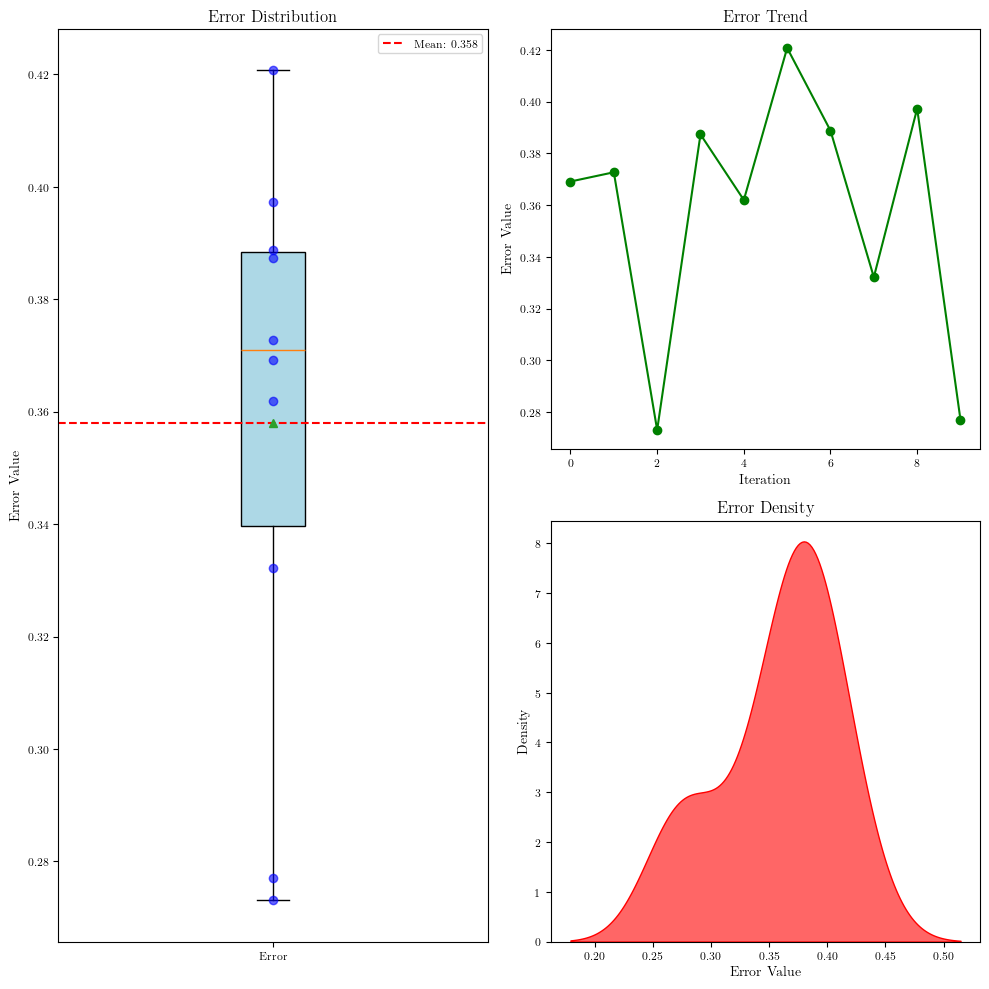

In [10]:

import seaborn as sns  # 导入seaborn库用于绘制密度图



plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列

mean_error = np.mean(error) #计算error数组的均值
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue')) #绘制箱型图，其中error是需要绘制的数据，patch_artist=True表示填充箱体，showmeans=True表示显示均值，meanline=True表示显示均值线，boxprops=dict(facecolor='lightblue')表示箱体的颜色为浅蓝色
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.3f}') #绘制一条水平线，位于mean_error处，颜色为红色，线型为虚线，标签为均值
for i, value in enumerate(error): #遍历error数组，i为索引，value为值
    plt.plot(1, value, 'bo', alpha=0.6) #绘制散点图，横坐标为1，纵坐标为value（即error数组中每个数），颜色为蓝色，点形状为圆圈，透明度为0.6
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error']) #设置x轴刻度标签
plt.legend() #显示图例

# 右侧上方子图：折线图
plt.subplot(2, 2, 2)  # 第二个子图，现在布局为2行2列的第二个位置
plt.plot(error, '-o', color='green') #绘制折线图，横坐标为error数组的索引，纵坐标为error数组的值，颜色为绿色，点形状为圆圈
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

# 右侧下方子图：密度图
plt.subplot(2, 2, 4)  # 第四个子图，现在布局为2行2列的第四个位置
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()  # 自动调整子图参数，使之填充整个图表区域
plt.show()

In [11]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

62725
[7.0083964e-01 6.1557877e-01 5.3981906e-01 ... 8.1675480e-06 8.1673898e-06
 8.1673297e-06]


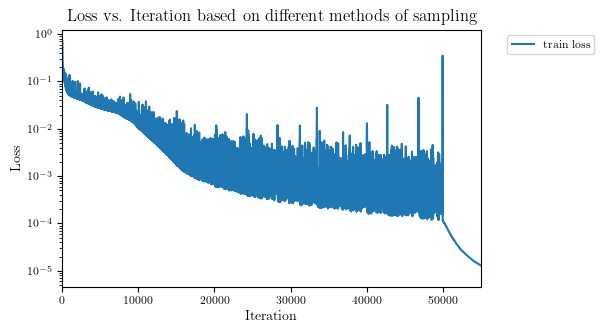

In [12]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

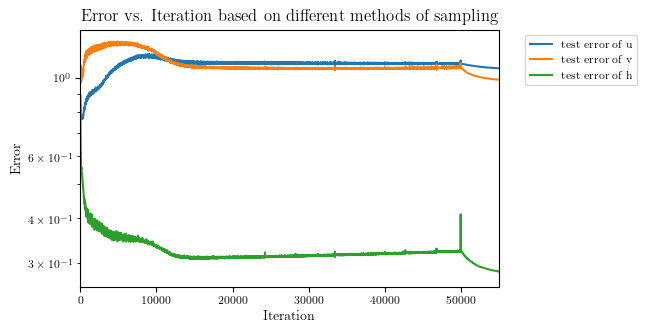

In [13]:
# print(len(trainloss))
# print(trainloss)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

u_error = testerror[:,0]
v_error = testerror[:,1]
h_error = testerror[:,2]

plt.plot(u_error, label='test error of u')
plt.plot(v_error, label='test error of v')
plt.plot(h_error, label='test error of h')


# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

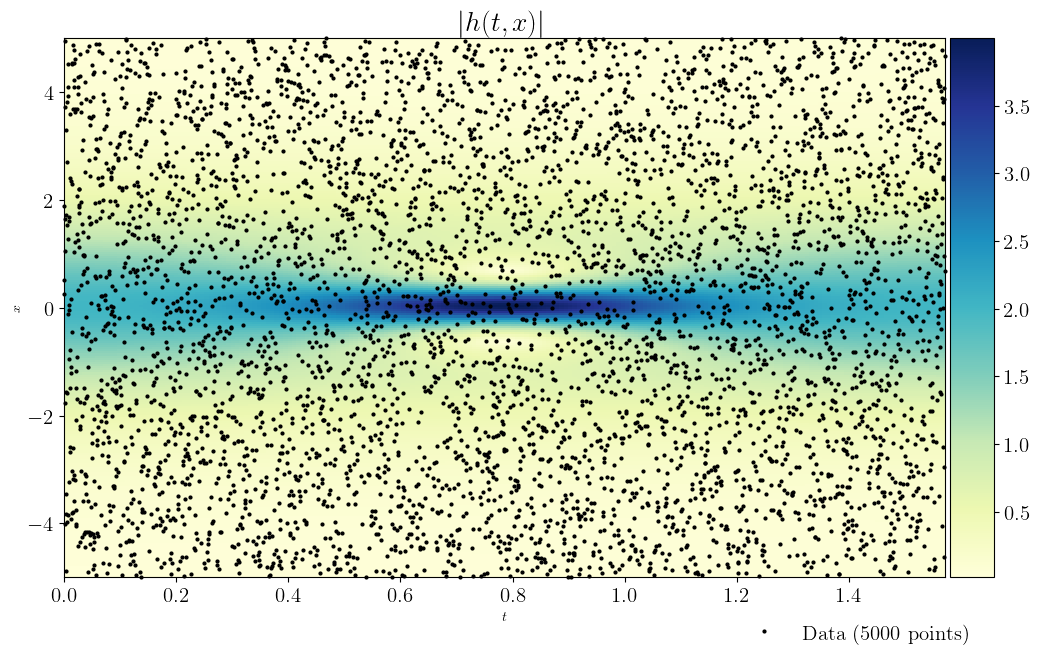

In [14]:


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(12, 7)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘制热图
h = ax.imshow(H_star.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')  #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是H_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                #第三个参数是颜色映射，这里是从黄色Yl到绿色Gn再到蓝色Bu；第四个参数是图像的范围，这里lb和ub分别是数据的下界和上界；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.05) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.05）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的

ax.plot(
    X_f[:,1], 
    X_f[:,0], 
    'ko', label = 'Data (%d points)' % (X_f.shape[0]), 
    markersize = 2,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  

# #绘制三条虚线
# line = np.linspace(x.min(), x.max(), 2)[:,None] #生成了一个包含2个等间距的数值的数组，这些数值在 x.min() 到 x.max() 之间。[:,None] 是一个索引操作，用于将一维数组转换为二维数组。这里其实就是[-5;5]
# #第一个参数是虚线的x坐标，line是虚线y的坐标，第三个参数是虚线的样式，k表示黑色，--表示虚线，最后一个参数表示虚线的参数是1
# ax.plot(t[75]*np.ones((2,1)),line,'k--',linewidth=1) 
# ax.plot(t[100]*np.ones((2,1)),line,'k--',linewidth=1)
# ax.plot(t[125]*np.ones((2,1)),line,'k--',linewidth=1)    

#设置标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

#    plt.setp(leg.get_texts(), color='w')   #用来设置图例中文本的颜色，这里是白色，取消注释后文本会变为白色
ax.set_title('$|h(t,x)|$', fontsize = 20) #设置子图ax的标题为$|h(t,x)|$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为10
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数


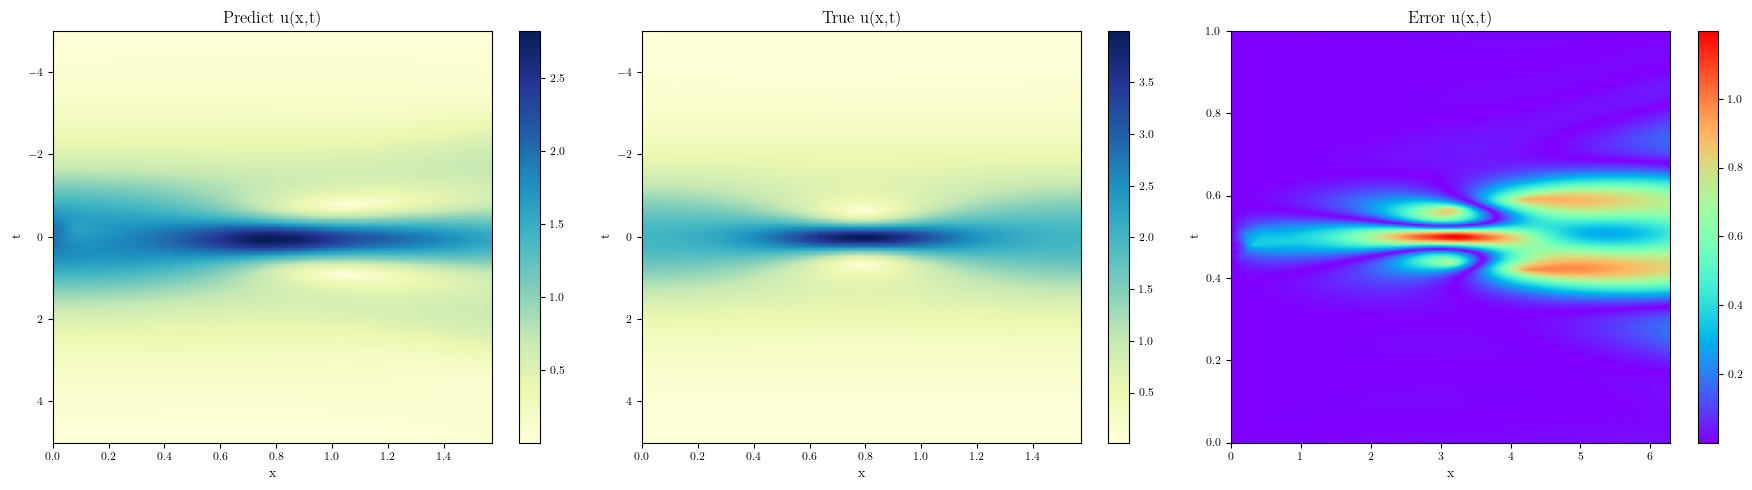

In [15]:


# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1行2列的子图，图形大小为宽18英寸高5英寸

# 绘制第一幅图像
axes[0].imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(H_star.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])


# 绘制第三幅图像
axes[2].imshow(np.abs(H_pred - H_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])


# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [16]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

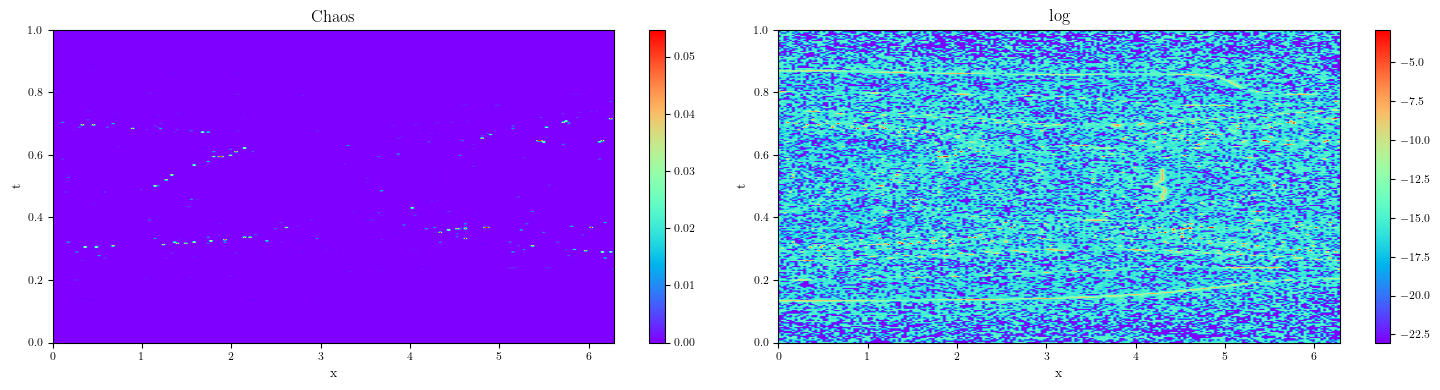

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()